In [1]:
import sys
from comet_ml import Experiment
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchinfo import summary

# Local imports
sys.path.append("/Users/leo/Programming/Thesis/utils")
sys.path.append("/Users/leo/Programming/Thesis/models")

from helper_functions import (delete_ds_store,plot_metrics,test,train,mean_std_finder,load_model)
from CBAM_CAM_DA import _CBAM_CAM_DA
from MBNV3 import MBNV3_Creator
from config import comet_token, project_name, workspace
from torchvision.models import (mobilenet_v3_small, MobileNet_V3_Small_Weights as weights_small)

# Setting the seed for reproducibility
torch.manual_seed(42)

In [2]:
prms = {
    "backbone": mobilenet_v3_small,
    "weights": None,
    "module": _CBAM_CAM_DA,
    "module_alias": "CBAM_CAM_DA",
    "data_path": "/Users/leo/Programming/Thesis/data/vgg_50/",
    "batch_size": 32,
    "img_size": 224,
    "num_classes": 50,
    "epochs": 50,
    "learning_rate": 0.001,
    "device": "mps",
    "model": None,
    "experiment": Experiment(api_key=comet_token, project_name=project_name, workspace=workspace, log_code=True),
    "load_model": False,
}
prms["model_save_path"] = f"./saved_weights/{prms['module_alias']}_{prms['data_path'].split('/')[-2]}.pth"

model = prms["model"] = MBNV3_Creator(prms["num_classes"], prms["device"], prms["module"])
delete_ds_store(prms["data_path"])

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/leothesouthafrican/test/d0cbe180b9584d9c85a27181d52bf71b



In [3]:
#mean, std = mean_std_finder(prms["data_path"])
mean, std = torch.tensor([0.5235, 0.4358, 0.3905]), torch.tensor([0.2993, 0.2770, 0.2729])

train_transform = transforms.Compose([
    transforms.Resize((prms["img_size"], prms["img_size"])),
    transforms.RandAugment(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
    transforms.Resize((prms["img_size"], prms["img_size"])),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [4]:
#Accessing the data
train_data = torchvision.datasets.ImageFolder(prms["data_path"] + "train/", transform=train_transform)
val_data = torchvision.datasets.ImageFolder(prms["data_path"] + "val/", transform=test_transform)
test_data = torchvision.datasets.ImageFolder(prms["data_path"] + "test/", transform=test_transform)

#Creating the data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=prms["batch_size"], shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=prms["batch_size"], shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=prms["batch_size"], shuffle=False, num_workers=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


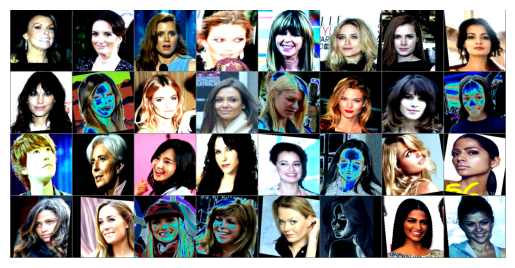

In [5]:
#display random images from the dataset
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    #drop axis labels
    plt.axis('off')
    plt.show()

# get some random training images
# set the seed for reproducibility
torch.manual_seed(42)

dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

In [6]:
#build the model
model.build_model()
model = prms["model"].to(prms["device"])


# Loss and optimizer
criterion = nn.CrossEntropyLoss().to(prms["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=prms["learning_rate"])
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30, 40], gamma=0.1)

prms["experiment"].log_parameters({"loss": criterion, "optimizer": optimizer}) if prms["experiment"] else None

Model modified with custom module: <class 'CBAM_CAM_DA._CBAM_CAM_DA'> in layers: [1, 4, 5, 6, 7, 8, 9, 10, 11].
Model weights initialized with Xavier initialization.


In [7]:
summary(model, input_size=(1, 3, prms["img_size"], prms["img_size"]),
        col_names = ["input_size", "output_size", "num_params", "kernel_size", "mult_adds", "trainable"],
        col_width = 20,
        row_settings = ["var_names"],
        depth=8)

/Users/leo/Programming/Thesis/thesis_env/lib/python3.9/site-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),


Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Kernel Shape         Mult-Adds            Trainable
MBNV3_Creator (MBNV3_Creator)                           [1, 3, 224, 224]     [1, 50]              --                   --                   --                   True
├─MobileNetV3 (model)                                   [1, 3, 224, 224]     [1, 50]              --                   --                   --                   True
│    └─Sequential (features)                            [1, 3, 224, 224]     [1, 576, 7, 7]       --                   --                   --                   True
│    │    └─Conv2dNormActivation (0)                    [1, 3, 224, 224]     [1, 16, 112, 112]    --                   --                   --                   True
│    │    │    └─Conv2d (0)                             [1, 3, 224, 224]     [1, 16, 112, 112]    432                  [3, 3]               5,419,008            True

In [8]:
#train the model
train_losses, train_acc, val_losses, val_acc = train(model, train_loader, val_loader, criterion, optimizer, scheduler, hyper_params = prms, verbose = 2, test_transform = train_transform, experiment=prms["experiment"])

#plot the training and validation metrics
plot_metrics(train_losses, train_acc, val_losses, val_acc)

  0%|          | 0/741 [00:00<?, ?it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 40, 18,  4, 31, 43, 21, 31, 44, 17, 25, 42, 41, 27, 36, 15, 33,  3,
        46,  9, 47, 46, 31,  1, 10, 35, 38, 36, 46, 18, 28, 19],
       device='mps:0')


  0%|          | 1/741 [00:12<2:28:24, 12.03s/it]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 24,  5, 15, 31,  1, 33, 39, 48, 43, 14, 31,  5, 11, 12, 26, 44, 43,
         6, 41,  9, 28,  2, 41,  7, 12,  7, 25, 16, 24, 33, 44],
       device='mps:0')


  0%|          | 2/741 [00:12<1:02:41,  5.09s/it]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 38, 26, 38, 28, 31, 12, 21, 44, 10, 22, 38,  9, 45, 20,  8,  1, 15,
        48,  1, 45,  4,  5, 43, 24, 15, 22, 33, 32, 38, 49, 21],
       device='mps:0')


  0%|          | 3/741 [00:12<35:10,  2.86s/it]  

Label type: <class 'torch.Tensor'>
Labels: tensor([28,  5, 11, 12, 34, 28,  1, 13, 20, 15, 45, 42,  2,  7, 11,  4, 12, 21,
        39, 47,  1, 42, 43, 49, 13, 35, 37, 23, 26, 25, 19, 17],
       device='mps:0')


  1%|          | 4/741 [00:12<22:18,  1.82s/it]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 38, 38, 19, 40, 12, 31, 12, 13,  5, 27, 27, 44, 32, 15, 18,  4, 22,
        43, 42, 15,  3, 12, 17, 29, 39, 31, 33, 32, 12, 49, 36],
       device='mps:0')


  1%|          | 5/741 [00:12<15:12,  1.24s/it]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 43, 20, 39, 11, 22, 46, 15, 35, 31, 24, 17, 11, 45, 38, 23,  0, 41,
        39, 14, 44,  4, 21, 10, 21, 18, 11, 48, 39, 20, 36, 33],
       device='mps:0')


  1%|          | 6/741 [00:13<10:55,  1.12it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41,  3, 36, 42, 15,  0,  8, 47, 16, 29, 34, 37,  6, 25, 25, 42, 43,  5,
         7, 31,  0, 33,  7, 13,  6,  3, 21, 20, 47, 11, 34, 37],
       device='mps:0')


  1%|          | 7/741 [00:13<08:12,  1.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32,  7, 35, 44,  4, 29, 20,  1, 40,  2,  0, 36,  9, 39, 44, 39, 31, 27,
        49, 43, 13, 45, 42, 29, 14, 39,  0, 38, 47, 42, 12,  5],
       device='mps:0')


  1%|          | 8/741 [00:13<06:22,  1.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29,  4, 26,  7, 17, 39, 25, 46, 30, 48, 39, 12, 27, 34, 47,  9, 26, 23,
        12, 20, 21, 41, 26, 20,  1, 27, 30, 14, 22, 42, 13,  8],
       device='mps:0')


  1%|          | 9/741 [00:13<05:09,  2.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 41, 28,  6,  8, 32, 42, 26, 39, 24, 33, 13, 10, 36, 10, 32,  5, 24,
        43,  9, 42, 49, 40, 32, 21,  6, 18, 11, 37, 32, 19, 12],
       device='mps:0')


  1%|▏         | 10/741 [00:13<04:22,  2.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 26, 21, 38, 11, 30,  4, 41, 27, 12, 23, 39, 32, 10, 24, 17, 30, 13,
        44, 32, 33, 32,  0, 15, 20, 15, 26,  9, 48, 49, 19, 36],
       device='mps:0')


  1%|▏         | 11/741 [00:14<03:58,  3.06it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23,  1,  3,  7, 12, 42, 29,  5, 45, 31, 34,  9, 26,  9, 17, 45, 48, 20,
        36, 14,  4, 34, 33, 19,  9, 36, 41, 37, 32, 45,  4,  7],
       device='mps:0')


  2%|▏         | 12/741 [00:14<03:33,  3.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 44, 28,  6, 41, 49, 26, 11, 28, 27, 12, 23, 23, 28, 20, 46,  8, 42,
        17, 47, 21, 36,  9,  2, 31, 47, 28, 12,  2, 28,  8, 25],
       device='mps:0')


  2%|▏         | 13/741 [00:14<03:14,  3.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 31, 34, 40, 34,  6, 30,  8, 38, 15, 47, 28, 26,  6, 32, 25,  8, 46,
        19, 34, 37,  7, 29, 33, 20, 48, 27, 47,  5, 14, 46,  1],
       device='mps:0')


  2%|▏         | 14/741 [00:14<03:02,  3.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 40, 31, 16, 18,  6,  7, 17,  8,  8, 20,  7, 18,  6, 30,  5, 23, 37,
        43, 27,  2, 14, 11, 11, 28, 23, 35,  7, 40, 14, 31,  0],
       device='mps:0')


  2%|▏         | 15/741 [00:15<02:53,  4.18it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 29, 20, 18,  1, 27,  4,  0, 34,  5, 21, 32, 40, 49,  4,  0, 24, 37,
        17, 10,  8, 32, 32, 43,  6,  3, 20,  3, 10, 40, 21, 39],
       device='mps:0')


  2%|▏         | 16/741 [00:15<02:48,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5,  4, 47, 10, 29, 42,  7, 47, 41, 13, 23,  5,  0,  4,  2,  2, 46, 16,
        49, 48, 30,  9,  5, 30, 42, 22, 49, 10, 11,  1, 16,  8],
       device='mps:0')


  2%|▏         | 17/741 [00:15<02:45,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 36, 24, 29, 48, 17, 46,  9, 41, 38, 37, 32,  9, 25, 44, 21,  2, 14,
        44, 38, 44, 23, 26, 33, 13, 26, 17, 49, 21, 26, 35,  3],
       device='mps:0')


  2%|▏         | 18/741 [00:15<02:40,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 12, 29, 19, 25, 46, 43, 16, 35, 13, 15, 34, 28, 31, 13, 14, 18, 29,
        17, 31, 39, 17, 10, 30,  5, 13, 42, 40, 21, 10, 37, 33],
       device='mps:0')


  3%|▎         | 19/741 [00:15<02:37,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 35, 11, 46, 18, 37, 49,  7,  9, 46, 25, 12, 18, 21,  0,  5, 49, 16,
        47, 26, 41, 22,  1, 21,  8, 34,  6, 11, 32, 46, 32, 21],
       device='mps:0')


  3%|▎         | 20/741 [00:16<02:37,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3,  5, 25,  1, 45, 33, 32,  8, 28,  4, 17,  2, 32,  0, 38, 37, 36, 10,
        31,  4,  4,  7, 39, 49, 32, 40, 14, 10, 17, 26,  6,  3],
       device='mps:0')


  3%|▎         | 21/741 [00:16<02:49,  4.26it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 33, 39, 33,  2, 21,  9, 11,  6, 11,  6, 19, 11, 15, 32, 23, 37, 19,
        43, 38, 26,  7, 32,  0, 36, 20, 42, 49,  2, 19, 36, 25],
       device='mps:0')


  3%|▎         | 22/741 [00:16<02:44,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24,  3, 44, 27, 26, 31, 44, 45, 45, 10,  4, 44,  6, 33, 12, 32,  3, 41,
        31, 48, 24, 30,  6, 31, 39,  0, 48, 45, 12, 33,  1, 30],
       device='mps:0')


  3%|▎         | 23/741 [00:16<02:39,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 10, 35, 49, 11, 15,  1, 28, 17, 42, 13, 23, 45, 36, 36, 47, 45, 47,
        32, 39, 46, 20, 31, 36, 23, 34, 12, 11, 29, 34, 12,  9],
       device='mps:0')


  3%|▎         | 24/741 [00:17<02:36,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 42, 26, 21, 33, 17, 16, 46, 33,  4, 31, 14,  6, 38, 43, 30,  6, 26,
        26,  6, 34, 28, 43, 18,  9, 16, 38, 12, 43, 32, 14,  8],
       device='mps:0')


  3%|▎         | 25/741 [00:17<02:35,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 46, 24, 43,  3, 39,  6, 29, 24, 30, 34, 42, 39,  2, 36, 11, 21,  3,
        25, 39, 20, 20, 41, 24, 34, 13,  2, 16, 29, 47,  9, 41],
       device='mps:0')


  4%|▎         | 26/741 [00:17<02:35,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 19, 33, 14, 38, 43, 36, 46, 27, 16, 27, 20, 21, 39, 13, 35, 13, 40,
        38, 32, 30, 46, 31, 30, 43, 49, 34, 30, 46, 40, 43, 44],
       device='mps:0')


  4%|▎         | 27/741 [00:17<02:32,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 13, 13, 48, 28,  5, 23, 37, 47, 24, 22, 16,  8,  1,  9, 45,  7,  1,
        34, 44,  3,  7,  2, 49, 13, 19,  4, 13, 24, 24, 19,  3],
       device='mps:0')


  4%|▍         | 28/741 [00:17<02:32,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40,  1, 31, 11, 35, 11, 44, 23, 43, 25, 28, 31, 46,  0,  5, 26, 19, 14,
        15, 30, 11, 38, 38, 15, 19, 17, 10,  5, 18, 38, 16, 16],
       device='mps:0')


  4%|▍         | 29/741 [00:18<02:29,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 41, 20, 13, 28, 20, 25, 32,  6, 25, 33, 41, 19, 10, 42, 36, 40,  1,
        35, 25,  7,  1, 31, 14, 10, 28, 27, 16, 38, 13, 15,  2],
       device='mps:0')


  4%|▍         | 30/741 [00:18<02:30,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 41, 32,  5, 24, 44, 45, 41, 13, 23, 14, 25, 30, 48, 14, 38, 47, 41,
         4, 49, 30,  2,  1, 18, 23, 23, 18, 19, 39, 33, 38, 17],
       device='mps:0')


  4%|▍         | 31/741 [00:18<02:43,  4.35it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 46, 13, 24,  3, 39, 18, 12,  4, 27, 43,  2, 29, 42, 11,  7, 42,  7,
        34, 42, 41,  9, 36, 49, 23, 14, 21, 30, 11,  0, 20, 25],
       device='mps:0')


  4%|▍         | 32/741 [00:18<02:40,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39,  5, 47, 37, 23, 19, 44, 46, 18, 14,  4, 27, 17, 49, 30, 12, 10, 29,
        24, 27, 45,  2, 35, 24,  6, 27, 12, 23, 41, 33, 24, 25],
       device='mps:0')


  4%|▍         | 33/741 [00:19<02:38,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 17, 23,  3, 40, 26, 17, 19, 39, 25, 33,  4, 20, 31,  4,  7,  7, 45,
        44,  3, 38, 30, 19, 16, 30,  6, 41,  2, 37, 48, 24, 11],
       device='mps:0')


  5%|▍         | 34/741 [00:19<02:33,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15,  2, 11, 43, 29, 20, 13, 26,  1, 18, 21,  1, 46,  9, 18, 49, 11, 20,
         7, 29, 45, 24,  8, 31, 12, 24,  7, 44, 23, 33, 16, 22],
       device='mps:0')


  5%|▍         | 35/741 [00:19<02:33,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 46, 31, 20, 46, 43, 43, 23, 26, 40, 41, 38, 49, 34, 23,  3, 47, 21,
        24, 31, 16, 15, 27, 49, 22, 25,  7, 34, 10, 32, 28, 12],
       device='mps:0')


  5%|▍         | 36/741 [00:19<02:32,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13,  0, 29, 34, 32, 21, 36,  7, 17,  6, 10, 35,  7, 48, 49,  2, 20,  3,
         5, 31, 36, 21, 15, 12, 22,  6, 14,  1, 10, 26,  1, 40],
       device='mps:0')


  5%|▍         | 37/741 [00:19<02:32,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 36, 14, 16, 39, 26, 36, 41, 15, 47, 45, 26,  8, 36, 38, 43, 10, 20,
         8, 37,  2,  0,  7, 39,  2, 26, 41, 13, 23, 46, 47, 14],
       device='mps:0')


  5%|▌         | 38/741 [00:20<02:29,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 24, 31, 20,  5, 35,  6, 37, 32, 42, 13, 34, 39, 40,  2, 44, 40, 27,
         5, 39, 24, 15, 28, 10, 31, 31, 41, 43, 12, 38, 35, 10],
       device='mps:0')


  5%|▌         | 39/741 [00:20<02:28,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 12, 48, 45, 20, 32, 32, 45, 39, 48, 12, 20, 49, 21, 32,  3, 19, 28,
        16, 38, 45, 39, 40, 30,  9,  2, 44, 45, 44, 44, 13, 41],
       device='mps:0')


  5%|▌         | 40/741 [00:20<02:27,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 37, 26,  3, 47, 44,  0, 29,  4, 38,  3, 22,  2, 15, 38, 42, 11, 48,
        24,  6,  6, 19,  9, 31, 19, 31, 44, 23, 18, 10, 12, 48],
       device='mps:0')


  6%|▌         | 41/741 [00:20<02:40,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 22, 22, 32, 27, 34, 15,  9, 14, 44,  6, 36, 49, 40,  3, 30, 30, 49,
        49,  6, 42, 34, 44, 48, 39, 16, 40,  7, 31, 16,  7,  8],
       device='mps:0')


  6%|▌         | 42/741 [00:20<02:36,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 19,  4, 36, 41, 39, 29, 32, 39,  9, 48, 21, 18, 35, 25, 36, 45, 17,
         8, 31, 37, 25, 32, 35, 44, 22,  9, 18, 22, 16, 10,  5],
       device='mps:0')


  6%|▌         | 43/741 [00:21<02:33,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 16, 39, 45, 39, 30,  8, 12, 26, 34, 20,  6,  7, 22, 15,  2,  1, 13,
        14, 42, 47, 24, 46, 16,  0, 48,  0, 29,  3, 43, 21, 37],
       device='mps:0')


  6%|▌         | 44/741 [00:21<02:32,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49,  2, 34, 25, 46, 46,  9,  3, 18, 11, 27, 41, 17, 43,  4, 30, 15, 46,
        10, 40,  3, 48, 44, 44, 16, 34, 13, 20, 38, 47,  4, 34],
       device='mps:0')


  6%|▌         | 45/741 [00:21<02:33,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 33, 21, 12, 47, 28, 32, 21, 21, 46, 18, 48, 30, 38, 34, 41, 37, 43,
        10, 41, 26,  0,  1, 18, 27, 43, 39, 17, 18, 19, 47,  5],
       device='mps:0')


  6%|▌         | 46/741 [00:21<02:30,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 11, 32, 46, 11, 36, 10, 14, 24, 30, 15, 35, 25, 38, 24, 45, 42, 25,
        29, 37, 33, 32, 42, 18, 33,  9, 29,  9, 48, 18, 26, 22],
       device='mps:0')


  6%|▋         | 47/741 [00:22<02:31,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 25, 40,  3,  6, 45, 17,  3, 35, 48, 13,  7, 14, 15, 35, 39, 44, 30,
        40, 45, 35, 26, 47, 40, 46, 49, 23,  1, 21, 15, 17, 11],
       device='mps:0')


  6%|▋         | 48/741 [00:22<02:29,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 35, 18, 26, 42, 13, 23,  8, 44,  1, 47, 15,  0, 17, 34, 27, 34,  1,
         4, 37, 20, 29, 33,  0,  4,  4, 19, 17, 47,  7, 11, 23],
       device='mps:0')


  7%|▋         | 49/741 [00:22<02:32,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 44, 13, 21, 26, 24, 18, 38, 28, 39, 22, 24, 24, 21, 33, 10, 27, 47,
        15, 44,  6, 36, 28, 42,  9,  1,  2,  5,  9, 23, 28,  8],
       device='mps:0')


  7%|▋         | 50/741 [00:22<02:31,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 30, 12, 30, 38,  4, 38, 41, 42, 19, 28,  8, 19, 32, 27, 13,  3, 13,
         3, 20, 45, 38, 22,  3, 17, 18, 41, 43, 16, 39, 44, 29],
       device='mps:0')


  7%|▋         | 51/741 [00:22<02:42,  4.25it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 49, 29, 42, 26, 44, 48, 28, 43,  3, 25, 33, 21, 42, 21, 19,  2, 35,
        47, 33, 23,  8, 40, 36, 46, 20,  8, 47, 15,  5, 15, 22],
       device='mps:0')


  7%|▋         | 52/741 [00:23<02:35,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 42, 23, 24, 24, 17, 44, 36, 13, 14, 19, 20, 19,  8, 40, 30, 18, 32,
        17, 33, 30, 39, 31, 47, 31, 12, 13,  6, 28,  9, 10, 49],
       device='mps:0')


  7%|▋         | 53/741 [00:23<02:30,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 18, 26, 27, 17, 30, 14, 44, 18, 23, 39, 14, 18, 28, 16, 40, 30, 33,
        18,  4, 16, 31, 12, 28, 25, 34, 34, 21, 13, 48, 47, 32],
       device='mps:0')


  7%|▋         | 54/741 [00:23<02:29,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 37, 20, 19, 48,  3, 13, 35, 49, 41,  2, 17, 19, 21, 22, 30, 37,  1,
        19, 23, 32, 38, 47, 19, 39, 27, 47,  7, 48, 44,  7, 11],
       device='mps:0')


  7%|▋         | 55/741 [00:23<02:27,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 48, 15, 26, 28, 10, 28, 42, 34, 10, 15,  2, 18, 47, 40, 17, 30,  6,
        14,  4, 38, 33, 47, 11, 30, 40, 27, 39,  8, 15, 45, 28],
       device='mps:0')


  8%|▊         | 56/741 [00:24<02:25,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1,  7, 16, 20, 47, 18,  3,  7, 30, 45, 11, 19, 24,  3, 15, 24, 25, 24,
         7, 39, 33, 22, 24, 28,  7,  0, 15, 19, 39, 18,  2,  0],
       device='mps:0')


  8%|▊         | 57/741 [00:24<02:24,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 13,  4, 45, 43,  9, 19, 15, 14, 20,  7, 34, 21, 16, 23, 39, 47, 42,
        21, 49, 49, 32, 11, 37, 29,  2,  2, 18, 24, 36, 24,  9],
       device='mps:0')


  8%|▊         | 58/741 [00:24<02:26,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24,  7,  0,  7,  1, 33,  9, 22, 24, 35, 31, 31, 10, 34, 19, 36, 23, 15,
        12, 48, 42, 13, 20,  5, 41, 32,  4, 41, 34, 27, 33, 12],
       device='mps:0')


  8%|▊         | 59/741 [00:24<02:25,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 25, 20, 39,  8, 21, 38, 35, 38, 44, 21,  9, 41,  8,  2, 24, 18,  3,
        39, 13, 41, 39, 10,  9, 22, 14, 48,  9, 10, 36, 11, 11],
       device='mps:0')


  8%|▊         | 60/741 [00:24<02:24,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 22, 22, 49,  8, 14,  4, 25, 15, 34, 32, 38, 49, 16,  4,  6, 13,  1,
        26, 15,  9, 39, 38, 19,  3, 39,  3, 43, 19, 16,  3, 22],
       device='mps:0')


  8%|▊         | 61/741 [00:25<02:34,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 43, 35, 20, 37, 11, 20, 28, 31, 12, 13,  0, 15, 32, 22,  5, 43,  8,
        10, 15,  6, 23, 12,  7, 20, 37, 10, 17, 37, 41, 49, 31],
       device='mps:0')


  8%|▊         | 62/741 [00:25<02:30,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 34,  8,  2, 34, 10, 36, 35, 36, 17, 11, 40, 39,  8, 15, 37,  6, 34,
        46, 28, 17, 40, 46,  9, 23, 23, 19, 47, 37, 46,  7,  0],
       device='mps:0')


  9%|▊         | 63/741 [00:25<02:31,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49,  3, 35, 41, 23, 29, 28, 17,  4, 31, 16, 43, 46,  2, 32, 35, 35, 17,
        20,  7, 37, 37, 49, 12, 20,  0, 28, 39, 12, 38,  5, 20],
       device='mps:0')


  9%|▊         | 64/741 [00:25<02:28,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 32, 24, 15, 35,  8, 44, 48, 15, 38, 46, 23, 35, 27, 18, 15, 38, 48,
        12, 10, 34,  1, 41, 43, 11, 37, 45, 47, 21, 42, 14, 34],
       device='mps:0')


  9%|▉         | 65/741 [00:25<02:28,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36,  9,  9, 16, 33, 42, 49, 37, 27,  2, 14, 33, 26,  5, 24, 44, 16, 22,
         4, 10,  5,  7, 20,  6, 12, 48,  5, 34, 24,  2, 31,  9],
       device='mps:0')


  9%|▉         | 66/741 [00:26<02:27,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 30, 43, 11, 13, 36,  1, 42,  7,  1, 22,  6,  3, 13, 36,  8, 23, 12,
        24,  8, 32, 35, 47, 11, 11, 35, 23,  0, 35, 26, 17, 15],
       device='mps:0')


  9%|▉         | 67/741 [00:26<02:27,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 37, 23, 17, 43, 32, 23, 11, 44, 46,  5, 10, 38,  9, 16, 30, 19, 17,
        48, 14, 19, 25, 37, 31,  4, 13, 42, 43, 32, 26, 29, 46],
       device='mps:0')


  9%|▉         | 68/741 [00:26<02:26,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38,  2, 44, 45, 13, 31, 33, 10, 46, 31, 22, 40, 41,  8, 28,  5,  3, 48,
        43, 42, 42, 23, 46, 35, 22, 23, 44, 38, 34, 47, 36,  9],
       device='mps:0')


  9%|▉         | 69/741 [00:26<02:24,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 19, 47, 10, 33, 43, 18, 49, 28, 44, 21, 25,  2, 48,  3, 21, 25, 20,
        37, 28, 12, 25,  8,  6, 41, 32, 39,  4,  0, 43, 38,  3],
       device='mps:0')


  9%|▉         | 70/741 [00:27<02:22,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 25, 15,  3, 24,  5, 10,  6, 40, 28, 21, 40, 29, 38, 19, 32, 49, 21,
        16, 30, 46, 13, 14, 43, 24,  1, 40, 21, 21, 30,  3, 32],
       device='mps:0')


 10%|▉         | 71/741 [00:27<02:31,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 41,  9, 13, 47, 35, 27, 48,  5, 39, 19, 14, 31, 43, 36, 32, 43,  8,
        47, 17, 28, 18, 29, 31,  8,  8, 21, 44, 29,  9, 46, 16],
       device='mps:0')


 10%|▉         | 72/741 [00:27<02:28,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 26, 14, 33, 24, 45, 38, 33, 29, 26, 30, 17, 35,  3, 21,  4, 16, 48,
        30, 40, 15, 47,  1, 41,  9, 18,  3, 18, 21, 16,  7, 13],
       device='mps:0')


 10%|▉         | 73/741 [00:27<02:26,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 39, 47,  9,  1, 48, 30, 46,  6, 31, 42, 37, 43, 10, 12,  1, 48, 36,
        11, 19, 35,  9, 13, 11, 45, 17, 29, 32, 31, 37, 23, 19],
       device='mps:0')


 10%|▉         | 74/741 [00:27<02:25,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 18, 14, 21, 45, 28, 29, 43, 10, 42, 47,  3, 49, 21, 15, 32, 41, 48,
        26, 18, 25, 13, 26,  1, 34, 45, 12, 11, 41,  3,  5, 30],
       device='mps:0')


 10%|█         | 75/741 [00:28<02:26,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 12, 40, 45, 31,  2, 28, 21, 46, 12, 33, 35, 28, 42, 26, 11, 36, 24,
        27, 32, 33, 15,  6, 39, 43,  4, 10, 19,  2, 36, 16, 40],
       device='mps:0')


 10%|█         | 76/741 [00:28<02:25,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 25, 13, 21, 10, 28, 34, 34,  5, 15, 18, 16, 47, 34, 49, 48, 26, 17,
        24, 24, 11,  6,  6, 44,  5, 28,  5, 46,  4, 41, 46, 27],
       device='mps:0')


 10%|█         | 77/741 [00:28<02:23,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 36, 42, 23, 29, 27, 13,  5, 11, 17, 38, 30, 27, 49,  4, 16, 43, 26,
        22, 10, 48, 37, 27, 29, 10,  1, 22, 29, 41, 17, 49, 14],
       device='mps:0')


 11%|█         | 78/741 [00:28<02:24,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 38, 36, 32,  7, 21,  6, 26,  2, 12,  6,  6, 28, 16, 13, 22, 33, 23,
        44,  6,  5, 10, 28, 34, 15,  0, 37, 16, 40, 42, 48,  7],
       device='mps:0')


 11%|█         | 79/741 [00:29<02:21,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 26, 22, 41, 29, 36, 20, 33, 27, 10, 22, 44, 15, 31, 20, 25, 26, 28,
        49, 32, 27, 30, 33, 12, 38, 11, 31,  1, 48, 20, 10, 18],
       device='mps:0')


 11%|█         | 80/741 [00:29<02:22,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 10,  4, 27,  9, 42, 42, 32, 43, 32, 20, 32, 37, 20, 49,  8, 48, 35,
        26,  8, 27, 37, 46, 45,  8, 31, 45, 38, 33,  2, 11,  4],
       device='mps:0')


 11%|█         | 81/741 [00:29<02:33,  4.31it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 39, 46, 11,  3, 29, 28, 22, 22, 32, 44, 36,  0, 36, 13, 35, 33, 43,
        35, 18, 43, 47, 12,  1,  6,  7, 24, 33, 11, 24, 25, 43],
       device='mps:0')


 11%|█         | 82/741 [00:29<02:28,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 33, 17, 28, 38, 48, 47,  9, 13, 11, 11,  7, 22,  1,  5, 36, 11, 48,
        28, 10, 30, 18,  8, 11, 44, 48, 26, 43, 13, 29, 13, 24],
       device='mps:0')


 11%|█         | 83/741 [00:29<02:25,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 25, 24,  7, 35, 46, 11,  4, 38, 45, 41, 35, 26, 43, 14, 17, 22, 16,
        15, 29, 48,  6, 22, 43, 47,  4, 33, 27, 29, 37,  6, 47],
       device='mps:0')


 11%|█▏        | 84/741 [00:30<02:22,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 13, 25, 16,  8,  6, 41,  2, 44,  1,  9,  5, 44, 20,  9,  4, 32, 40,
        43, 40, 30, 40, 36, 45, 29, 21, 18, 22, 32, 11, 12, 46],
       device='mps:0')


 11%|█▏        | 85/741 [00:30<02:20,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49,  4, 25,  6, 37, 20, 43, 48, 10, 28, 39, 19, 44,  7,  6,  6, 41, 33,
        46, 21, 17, 25,  3, 21, 22,  0, 45,  1,  1, 17, 28, 34],
       device='mps:0')


 12%|█▏        | 86/741 [00:30<02:19,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 32, 22,  2, 12, 36, 32, 37, 12, 21, 26, 25, 12,  6, 40,  5, 39, 18,
        23, 35, 39, 35, 28,  6, 17, 16, 49, 36, 25, 20,  9, 43],
       device='mps:0')


 12%|█▏        | 87/741 [00:30<02:19,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 43,  7, 31, 38, 12, 40, 36, 34, 27,  3, 45, 36, 25, 48, 13, 25, 23,
         5, 30, 12, 34, 42, 43, 19, 46, 24,  7, 34,  3, 27, 35],
       device='mps:0')


 12%|█▏        | 88/741 [00:30<02:17,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23,  3, 15,  8, 11,  0,  8,  7, 32, 18,  1, 41, 14,  1, 13, 28, 31,  1,
        33, 22, 15, 32, 22,  0, 11, 23,  1,  1, 17,  1, 25,  1],
       device='mps:0')


 12%|█▏        | 89/741 [00:31<02:20,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5,  3, 31, 32, 41, 20, 37,  9,  9,  9, 32, 34, 18,  9, 19,  7,  1,  6,
        12, 32, 22, 16, 16, 42,  7,  0, 22,  1, 38, 25, 45, 47],
       device='mps:0')


 12%|█▏        | 90/741 [00:31<02:18,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 29, 30, 46, 24, 34, 40, 19,  5,  6, 32, 33,  9, 35, 21,  3, 10, 28,
         2, 27, 37, 40, 28,  3, 19,  9, 17, 47,  6, 35,  8, 39],
       device='mps:0')


 12%|█▏        | 91/741 [00:31<02:27,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 44, 32,  4,  8, 46,  3, 42, 24, 39, 12,  9, 20, 35,  9, 14, 49,  2,
        31, 39,  8, 18, 41, 20, 39, 38, 21, 47, 12,  3, 47,  0],
       device='mps:0')


 12%|█▏        | 92/741 [00:31<02:26,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 31, 42,  1, 38, 38, 38, 31, 25, 49, 38, 47, 14, 33, 42, 20, 18, 29,
        16, 22, 45, 34, 32,  3, 34, 19, 44, 33, 26, 32, 14, 19],
       device='mps:0')


 13%|█▎        | 93/741 [00:32<02:24,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 31,  7, 43, 20,  0, 20, 19,  6, 26,  3,  3, 13, 22, 10, 30, 27, 32,
        11, 27, 47, 42, 17, 14, 33, 32, 48, 45, 13, 20, 25, 34],
       device='mps:0')


 13%|█▎        | 94/741 [00:32<02:22,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 44, 42, 46, 23, 13, 17, 23, 31, 47, 49, 45, 37, 13, 26, 31, 43, 36,
         2, 34, 39,  4, 21, 25, 36, 27, 10, 21, 28, 24, 16, 37],
       device='mps:0')


 13%|█▎        | 95/741 [00:32<02:26,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20,  1, 27, 25, 13,  1,  5, 40, 17,  3, 26, 34,  6,  5,  7, 42, 22, 38,
        12,  8, 28,  3, 22, 49, 45,  3, 10, 20, 28, 18, 30, 17],
       device='mps:0')


 13%|█▎        | 96/741 [00:32<02:22,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 34, 33, 12, 26, 17,  8,  9, 17,  5, 25,  0,  4, 12, 19, 35, 26, 29,
         8,  7,  1, 32,  7, 31, 47, 30, 43, 25,  7, 22, 11, 28],
       device='mps:0')


 13%|█▎        | 97/741 [00:33<02:21,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 18, 49,  8, 34, 49, 36,  2,  1, 32, 21, 31, 35, 35,  5,  8, 13, 37,
        32,  9, 25, 11, 49,  6, 31,  3, 44, 18, 49, 36, 10, 22],
       device='mps:0')


 13%|█▎        | 98/741 [00:33<02:19,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 43, 15,  1, 30,  5,  4, 27,  9,  9, 24,  5,  9, 46, 40, 40,  0, 23,
        22, 38,  9, 22, 40, 21, 40, 33, 31,  0, 26,  1, 31, 10],
       device='mps:0')


 13%|█▎        | 99/741 [00:33<02:18,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 42,  9, 44, 20, 40, 25, 13, 47,  3, 17, 25, 13, 45,  3, 45, 10, 43,
        27,  3, 44, 30, 16,  4, 35, 24,  9, 14, 22, 35, 16, 11],
       device='mps:0')


 13%|█▎        | 100/741 [00:33<02:19,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 25,  4,  9, 40, 22, 39,  3, 28,  4, 22, 20, 30,  5, 45, 42, 45,  4,
        30, 20, 43, 24, 12, 15,  8,  2, 12, 30,  6, 32, 11,  2],
       device='mps:0')


 14%|█▎        | 101/741 [00:33<02:28,  4.31it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 39, 41,  9, 18, 32,  8, 29,  0, 42, 45, 16, 21,  7, 25, 29, 44,  8,
        26, 20, 32, 30, 11, 18, 47,  7,  1,  8, 20, 23, 43, 39],
       device='mps:0')


 14%|█▍        | 102/741 [00:34<02:24,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 49, 35, 14, 21,  8, 27,  3, 32, 34, 48, 43, 36,  7, 13, 38, 25, 31,
        24,  7, 46,  3, 29, 39, 35, 19, 23, 15, 27, 48, 17, 18],
       device='mps:0')


 14%|█▍        | 103/741 [00:34<02:23,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 21,  0, 48, 47,  4,  7, 36, 22, 49, 40, 33, 40, 21, 26, 13, 48, 34,
        49, 21,  4, 38, 29, 38,  2, 25, 25, 35,  8, 25, 42, 30],
       device='mps:0')


 14%|█▍        | 104/741 [00:34<02:21,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 34,  8, 43, 38, 37, 42, 14,  6,  3, 28, 12, 38,  6, 42, 18, 10, 49,
        35, 47,  2, 10, 12, 34, 37, 12,  9, 37, 31, 16,  3, 45],
       device='mps:0')


 14%|█▍        | 105/741 [00:34<02:19,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32,  5, 18, 28, 23, 16,  0, 30, 39, 44, 40, 39, 46, 11, 34, 45, 18, 15,
        19, 32,  7, 12, 43, 28, 43, 17, 25, 48, 48, 32, 25, 31],
       device='mps:0')


 14%|█▍        | 106/741 [00:34<02:17,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 39, 30, 28,  7, 33,  2, 41, 12, 35, 35, 26, 42, 48, 19,  6, 15,  9,
        44, 16, 26, 22, 36, 32, 22, 25,  8, 11, 18, 44, 10, 25],
       device='mps:0')


 14%|█▍        | 107/741 [00:35<02:16,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 33, 25, 33, 22, 10, 44, 28,  0, 37,  3, 29, 42, 26, 16, 47, 43, 21,
         8, 32,  4, 33,  2, 24, 40, 15, 35,  9, 44, 33, 29, 38],
       device='mps:0')


 15%|█▍        | 108/741 [00:35<02:17,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5,  2,  9, 24,  0, 23,  3,  4, 48, 12, 21, 21,  6, 30, 37, 47, 47, 18,
         4,  4, 28, 43, 21, 37, 38, 31,  0,  2, 49, 23, 42, 13],
       device='mps:0')


 15%|█▍        | 109/741 [00:35<02:16,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 32, 27, 37,  4, 48, 41, 16,  5, 20, 17, 45, 18, 36, 28, 14, 17, 36,
        23, 35, 30, 14, 36,  6,  6,  5,  2, 49, 41, 43, 21, 25],
       device='mps:0')


 15%|█▍        | 110/741 [00:35<02:16,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 29, 31,  1, 41, 14,  9, 42, 35, 41,  5, 47, 48, 27, 20, 39, 26, 44,
        22,  1,  8, 37, 46, 32, 49,  7, 26, 14, 43, 12,  8, 39],
       device='mps:0')


 15%|█▍        | 111/741 [00:36<02:26,  4.31it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 20, 37, 37, 31, 25, 49, 30, 17, 37,  9, 12,  3, 48, 23, 22, 43, 36,
        12,  1, 36,  9, 32, 15, 28, 37, 46, 26, 22, 36, 44,  8],
       device='mps:0')


 15%|█▌        | 112/741 [00:36<02:21,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30,  3, 26, 49,  1, 22, 13, 47, 14, 35,  7, 25,  2, 13, 49, 49, 12, 28,
        37, 12,  7, 17, 47, 38,  0,  5,  6, 11, 26, 27, 37, 44],
       device='mps:0')


 15%|█▌        | 113/741 [00:36<02:17,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 13, 43, 32, 48, 17,  2, 10, 43, 29, 17, 10, 25,  0, 26, 19,  8, 20,
        47, 43, 15,  4, 44, 47, 48, 28, 34, 39, 40,  9, 31, 27],
       device='mps:0')


 15%|█▌        | 114/741 [00:36<02:15,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 47, 39, 15, 16, 48, 16, 44, 31, 33,  2, 15, 17, 45, 16, 47, 47, 29,
        19, 20, 36,  2, 14, 38, 18, 16, 11, 48, 43,  6, 13, 44],
       device='mps:0')


 16%|█▌        | 115/741 [00:36<02:16,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 21, 37, 42, 49, 29, 35, 30, 11, 36, 16, 11, 11, 44, 27, 36, 23, 13,
         2, 40,  9,  5, 11, 37,  3, 15, 43, 32, 26, 41, 35, 38],
       device='mps:0')


 16%|█▌        | 116/741 [00:37<02:19,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 49,  5,  0, 16,  8, 39, 20, 47,  3, 43, 35, 23, 42, 43, 27, 11, 35,
        41, 25, 26, 12,  3, 21,  4,  0, 36, 12, 38, 41, 38, 25],
       device='mps:0')


 16%|█▌        | 117/741 [00:37<02:14,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 14, 23,  7, 45, 37, 40, 48, 46,  8, 12, 49,  7, 11, 34, 18, 32, 48,
        31, 47, 48, 34,  4,  8, 31, 48, 35, 41, 32, 11, 15, 22],
       device='mps:0')


 16%|█▌        | 118/741 [00:37<02:15,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5,  7,  6, 21, 20, 11, 16,  8,  9, 13, 46,  1, 12, 22, 29, 33, 35, 12,
        47,  1,  3, 28, 43,  2, 34, 43,  1, 44, 11, 40, 41, 34],
       device='mps:0')


 16%|█▌        | 119/741 [00:37<02:16,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 20, 15,  4, 26, 22, 22, 46, 16, 16, 33, 48, 14,  1, 47, 24, 19, 18,
        12, 33, 33, 36, 18, 31, 23,  6, 10, 21, 17, 33, 31, 42],
       device='mps:0')


 16%|█▌        | 120/741 [00:38<02:13,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 46,  4,  5, 27, 29,  7, 13,  9, 47, 13, 39, 33, 13, 19,  3, 43, 25,
         3, 34, 20,  7, 21, 13, 30, 33, 29, 47, 17, 10, 18, 11],
       device='mps:0')


 16%|█▋        | 121/741 [00:38<02:25,  4.26it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 12, 13, 14, 34,  2, 37, 37, 48, 17, 19, 19, 38, 20, 17, 32,  6, 13,
        27, 30, 26, 25, 15,  9, 23,  9, 11, 28, 29, 12, 44, 14],
       device='mps:0')


 16%|█▋        | 122/741 [00:38<02:16,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 20, 39,  3, 19, 10, 36, 41, 10, 45, 44, 11, 35, 45, 35, 33, 17, 29,
        34,  5, 36, 10, 15, 49, 36,  2, 16, 45, 25, 19, 27, 34],
       device='mps:0')


 17%|█▋        | 123/741 [00:38<02:13,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 24,  1, 49, 39, 21, 46, 12, 14, 49, 17, 39,  4, 43, 25, 48, 29, 10,
        11, 38, 24, 27, 28, 16,  5, 20, 12, 46, 45, 39, 44, 34],
       device='mps:0')


 17%|█▋        | 124/741 [00:38<02:10,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6,  6, 36, 37, 33,  8,  2,  3, 20, 27, 30, 21, 15, 38, 22, 24, 37, 17,
        30, 10, 35,  1,  0, 41, 23, 30, 44, 22, 35, 29, 33, 32],
       device='mps:0')


 17%|█▋        | 125/741 [00:39<02:09,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6,  1,  6, 26, 33, 48, 33, 17,  6,  3, 26, 31, 20, 40, 37, 22, 43, 15,
        36,  2, 11,  2, 43,  7, 36,  2, 49, 26, 44, 30,  9, 26],
       device='mps:0')


 17%|█▋        | 126/741 [00:39<02:09,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 10,  2, 26, 13, 23, 11, 12, 28, 27, 28, 28, 24, 36, 46, 43, 42, 47,
        24, 12, 37, 10, 35, 18, 39, 18, 48, 26, 32, 21, 15,  7],
       device='mps:0')


 17%|█▋        | 127/741 [00:39<02:07,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32,  1, 28, 21, 26,  5, 18, 22, 28, 47, 32, 21, 32, 24, 24,  3, 18, 22,
        30, 11, 46, 26, 36,  4, 46, 18, 28, 30, 34,  3, 36,  8],
       device='mps:0')


 17%|█▋        | 128/741 [00:39<02:03,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2,  5, 14, 41, 17,  9, 28, 48,  1, 22, 36,  0, 19,  1,  6,  8,  4, 32,
        10, 44, 31, 12, 35,  1, 35,  2,  5, 10, 23, 33, 33, 14],
       device='mps:0')


 17%|█▋        | 129/741 [00:39<02:04,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 46, 49, 23, 20, 45,  0,  9, 28, 44, 27, 16, 47, 14, 34, 17, 29, 31,
        33,  6,  2,  5, 28, 36, 25, 27,  2, 16, 20, 12,  7, 14],
       device='mps:0')


 18%|█▊        | 130/741 [00:40<02:02,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32,  6, 42,  1, 34,  3, 21, 10,  2, 27,  2, 32, 27, 12, 32,  0, 18, 15,
         4, 14, 37,  6, 30,  2, 15, 34,  7, 46, 37, 46, 25,  7],
       device='mps:0')


 18%|█▊        | 131/741 [00:40<02:10,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 45, 44, 16, 48, 30, 48, 21, 29, 49, 41, 44, 20, 40, 13, 25, 32, 31,
        31, 32,  8, 32, 41, 30, 32, 43, 49,  1,  3, 19, 29, 22],
       device='mps:0')


 18%|█▊        | 132/741 [00:40<02:08,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 18, 10, 32, 25, 20, 13, 30, 16, 35, 18, 33, 40, 46, 27, 24, 45,  2,
        23, 23, 49, 37, 26, 19, 12, 43, 35,  3, 33, 13, 20, 32],
       device='mps:0')


 18%|█▊        | 133/741 [00:40<02:05,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 48, 36, 29, 12, 27,  7, 45, 25, 37, 20, 26, 20, 48, 31, 21, 48,  6,
        30, 47, 49, 25, 34, 41, 18, 32, 44, 16, 33,  5, 15, 32],
       device='mps:0')


 18%|█▊        | 134/741 [00:40<02:03,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 43,  6, 19, 27,  9, 40, 14,  1, 31,  4, 20, 36, 29, 31, 49, 34, 36,
        39, 11, 14, 29, 35,  3, 17, 25, 11, 17, 30, 42, 15,  7],
       device='mps:0')


 18%|█▊        | 135/741 [00:41<02:01,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 40, 30,  2, 44, 38, 38, 43, 24, 35,  8, 47,  1,  3, 26,  5, 17,  0,
        37, 28, 34,  0, 47, 24, 40, 17, 34,  5,  3, 48, 14, 40],
       device='mps:0')


 18%|█▊        | 136/741 [00:41<02:02,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 21, 20, 26, 34,  7, 31, 10, 40, 39, 26, 41,  9,  4, 33, 42, 24,  0,
         2, 12, 35,  6, 15, 27, 40, 32, 30, 40,  7, 31, 41, 15],
       device='mps:0')


 18%|█▊        | 137/741 [00:41<02:03,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 36,  2,  4, 15, 28, 48, 23, 23,  3,  4, 36,  2, 29, 48,  1, 37, 49,
         0,  8, 21,  3, 29, 32, 34, 20, 46, 45,  8, 32, 42, 25],
       device='mps:0')


 19%|█▊        | 138/741 [00:41<02:01,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 32,  3,  9, 47, 28, 47, 24, 31, 20, 25, 15, 10, 13, 24, 22, 45, 25,
         8, 25, 18,  2, 14,  7, 32, 22,  5,  3, 39, 14, 16, 34],
       device='mps:0')


 19%|█▉        | 139/741 [00:41<01:59,  5.06it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 23, 38, 44,  6, 10,  0, 19, 39, 21, 39, 15, 30, 43, 31,  2, 19, 28,
        39, 39, 21, 18, 33, 40, 26, 25,  3, 38, 22,  2, 21, 27],
       device='mps:0')


 19%|█▉        | 140/741 [00:42<01:57,  5.10it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 42,  4, 30, 35, 25, 49, 32,  8,  3, 32, 32, 34, 28, 42, 12, 46,  5,
        26, 16, 48, 27, 36,  0,  8, 16, 44, 26,  6, 21, 12, 49],
       device='mps:0')


 19%|█▉        | 141/741 [00:42<02:07,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 31,  0, 33, 49, 33, 45, 36, 16, 47, 10, 48, 41,  1, 33, 32, 42, 37,
        48, 26, 29, 33, 29, 47,  1, 41,  5, 15,  1,  6, 28, 39],
       device='mps:0')


 19%|█▉        | 142/741 [00:42<02:04,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 33, 14, 47, 25, 15,  9,  3, 34, 25, 44, 35, 18, 35, 27, 14, 19,  2,
        22,  8, 13, 26, 25, 25, 20, 22, 32, 47, 14,  9,  7, 32],
       device='mps:0')


 19%|█▉        | 143/741 [00:42<02:04,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 34, 36, 46, 13, 14, 10, 31, 26, 13, 27,  7, 46, 22, 10,  6, 35, 30,
        43, 41, 11, 32, 41, 42, 39, 14,  6, 43, 40, 37, 40, 21],
       device='mps:0')


 19%|█▉        | 144/741 [00:43<02:02,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 26, 24,  1, 47,  9, 24, 23,  8,  0, 30, 18, 41, 44,  6, 17, 15, 40,
        33,  3,  2, 39, 29, 35, 39, 35, 20, 22, 13, 35, 43, 27],
       device='mps:0')


 20%|█▉        | 145/741 [00:43<02:03,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 30, 14, 22, 15, 12, 42, 30, 26,  7, 26,  4, 19,  6, 14, 28, 45, 32,
        46, 15, 10, 49, 39, 45,  1, 14, 22, 42, 37,  6, 10,  3],
       device='mps:0')


 20%|█▉        | 146/741 [00:43<02:04,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 43, 12, 11, 20, 44, 12, 31, 29, 37, 23, 12, 44, 10, 41,  9, 44,  9,
         8, 10, 32,  4, 15, 40, 22, 28, 15,  8, 17, 40, 25, 17],
       device='mps:0')


 20%|█▉        | 147/741 [00:43<02:02,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36,  5, 23, 34, 23, 41, 30, 39, 16, 32, 31, 16,  2, 26, 22, 36,  7, 25,
        30, 21, 29, 45,  8, 35, 42, 13,  5, 16, 18, 31, 16, 23],
       device='mps:0')


 20%|█▉        | 148/741 [00:43<01:59,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29,  4, 21, 30,  5, 41, 19,  6, 18, 18, 31, 49, 46, 21, 41, 45,  6,  8,
        26,  4, 12, 21, 22, 43,  8, 46,  3, 36, 17, 39, 46, 49],
       device='mps:0')


 20%|██        | 149/741 [00:44<01:58,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 26, 30, 31, 30,  7, 31, 32, 30, 39, 29, 24, 27, 10, 27, 21, 10, 49,
        35, 29,  7, 12, 14, 43,  1, 28, 32, 38, 21, 17, 35, 15],
       device='mps:0')


 20%|██        | 150/741 [00:44<01:58,  5.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2,  5,  6,  3, 32, 47, 12, 33, 49,  5,  9, 38, 29, 13, 47, 49, 30, 17,
        22, 19, 22, 36, 15, 29,  1,  8,  5, 19, 39, 49,  1, 47],
       device='mps:0')


 20%|██        | 151/741 [00:44<02:08,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20,  8, 22,  8, 14, 19, 38,  2, 11, 10, 20, 40, 22, 24, 19, 33, 46, 17,
         6,  8,  7,  9, 33, 30, 49, 18,  0, 11,  6, 37, 30, 49],
       device='mps:0')


 21%|██        | 152/741 [00:44<02:06,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 37, 10, 40, 32, 22, 25,  3, 38, 39, 40, 13, 17, 15, 21,  3,  5, 34,
        23, 14,  6,  3, 44, 11,  6, 32, 24, 20, 34, 29, 28, 48],
       device='mps:0')


 21%|██        | 153/741 [00:44<02:03,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 27, 35,  5, 44, 22, 15, 13, 13,  0, 49, 16, 10, 43, 42, 24, 32, 14,
        46, 44, 14, 10,  6, 11, 40, 43,  8, 36, 10, 10, 32, 38],
       device='mps:0')


 21%|██        | 154/741 [00:45<02:04,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 21, 22, 27, 14, 17, 20, 13, 31, 10, 23, 23, 49,  6, 38,  2, 24, 40,
        16, 34,  1, 46, 38,  2, 39, 13, 38,  2, 46, 32, 38, 22],
       device='mps:0')


 21%|██        | 155/741 [00:45<02:00,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 24, 49, 42, 18,  9, 21, 49, 20, 12, 20,  2, 28, 37, 11, 33, 48, 39,
        14, 29, 41,  8, 11, 24, 46, 29, 49, 12, 29,  5, 40, 47],
       device='mps:0')


 21%|██        | 156/741 [00:45<02:01,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 37, 14,  6, 18, 11, 15, 46, 25, 27,  4, 39,  2, 18, 10, 18, 46, 31,
        41,  4, 35, 34,  7, 46,  8, 17, 28,  6,  1, 30, 26, 23],
       device='mps:0')


 21%|██        | 157/741 [00:45<02:00,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 29, 33, 17, 12,  7, 11, 37,  2,  6,  7,  9,  3,  7, 31,  5, 16, 27,
         2, 25, 31,  6, 29,  1, 48, 33,  8, 42, 28, 38,  2, 36],
       device='mps:0')


 21%|██▏       | 158/741 [00:45<01:58,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 23, 41, 43, 39, 27,  1, 30, 19, 42, 19, 14,  6,  1, 16, 30, 31, 45,
        12, 21, 10, 20,  2, 37,  9, 49, 40, 18, 41,  1, 35, 41],
       device='mps:0')


 21%|██▏       | 159/741 [00:46<01:57,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31,  1, 13, 29, 42,  3, 47, 36,  6, 37,  7,  1, 12, 47, 22, 36, 48, 20,
        46,  7, 28, 30, 38, 38, 47, 18, 42, 12, 16, 32,  2, 46],
       device='mps:0')


 22%|██▏       | 160/741 [00:46<01:56,  5.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 29, 12, 19, 38, 39, 40, 44, 10, 19, 27, 26, 41, 30,  7, 12,  6,  3,
         7,  9, 12, 34, 38, 28, 21,  1, 19, 48, 40, 44, 16, 46],
       device='mps:0')


 22%|██▏       | 161/741 [00:46<02:03,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 25, 26, 35, 32, 14, 22, 44, 12, 24, 24, 34, 20,  6, 23, 21, 35,  4,
         3,  0, 19, 35, 29, 27, 37, 37,  6, 37, 44, 38, 25, 10],
       device='mps:0')


 22%|██▏       | 162/741 [00:46<02:00,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 40, 36, 16, 26,  3, 41, 28, 16, 34, 43, 23, 30, 11, 20, 33, 15,  6,
        23, 27, 48,  7, 14, 23, 31, 32, 37, 39, 12, 22, 46, 32],
       device='mps:0')


 22%|██▏       | 163/741 [00:46<01:58,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 25, 27, 21, 39, 30, 34, 28, 20, 14,  1, 12, 31,  9, 29, 29, 24, 35,
         0, 44, 27, 37, 26, 16, 23, 44, 36, 20,  8, 23, 29, 29],
       device='mps:0')


 22%|██▏       | 164/741 [00:47<01:58,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 19, 46, 32, 37, 21,  3,  4, 47, 46, 27, 36, 40, 27, 38, 13,  6, 36,
         0, 17,  8, 41, 38,  1,  1, 29, 49, 41, 49,  4, 13, 18],
       device='mps:0')


 22%|██▏       | 165/741 [00:47<01:57,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 35, 22, 45, 33,  2, 27, 22,  2, 18, 10,  9, 11, 17, 47, 23, 10, 45,
        23, 41, 15,  0,  7,  2, 15,  2, 49,  7, 39, 44, 24, 33],
       device='mps:0')


 22%|██▏       | 166/741 [00:47<01:56,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12,  4,  8, 29, 41, 44,  1,  5, 26, 34, 36, 32, 31, 44, 13, 39, 33,  4,
        40, 32, 45, 10, 39, 48,  4, 40, 39, 13, 26, 18,  3, 25],
       device='mps:0')


 23%|██▎       | 167/741 [00:47<01:54,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20,  0,  4, 13,  0, 37, 29, 16, 11, 31, 25, 33, 36,  0, 33, 38, 27, 33,
        48,  1,  2,  2, 45,  6, 34, 48, 31,  6, 29, 19, 21,  9],
       device='mps:0')


 23%|██▎       | 168/741 [00:47<01:51,  5.12it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 45,  4, 18, 24, 32, 13, 28,  2, 28, 21, 32, 10, 18, 36, 22, 40,  2,
        17, 36, 30, 17, 14, 22, 41, 42, 31, 29, 15,  9, 26, 13],
       device='mps:0')


 23%|██▎       | 169/741 [00:48<01:51,  5.11it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 24, 26, 11, 25, 29, 26,  3, 30, 27, 31,  3, 37, 26, 12, 16,  4, 39,
        45, 22, 29,  6, 32, 23, 37, 16, 41, 12, 23, 43, 35, 14],
       device='mps:0')


 23%|██▎       | 170/741 [00:48<01:49,  5.20it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 40, 35, 45, 38, 19,  4, 14, 17, 29, 24, 17, 48,  9,  3, 42,  8, 45,
        44, 37, 48, 31,  9, 35, 11, 23, 23, 16, 41,  6, 18, 10],
       device='mps:0')


 23%|██▎       | 171/741 [00:48<01:59,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 39, 20,  5, 29,  2, 14, 19, 13, 26, 13, 15, 11, 29,  2, 32, 41, 45,
        49, 32, 19, 28, 48,  8, 11, 12, 31, 24, 28, 15, 46, 43],
       device='mps:0')


 23%|██▎       | 172/741 [00:48<01:56,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 45, 46, 16, 10, 40, 27, 33, 30,  8, 24, 38,  2, 35, 34, 37,  5,  4,
        25, 35, 49, 18, 32, 36, 16, 33,  6, 15, 30, 36, 25, 43],
       device='mps:0')


 23%|██▎       | 173/741 [00:48<01:55,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 10, 25,  4, 39,  3,  4, 26, 17, 39, 28,  2, 26, 49, 30, 38, 20, 19,
        23, 21, 14,  3, 15, 21, 14, 27, 17,  5, 18,  5, 32,  5],
       device='mps:0')


 23%|██▎       | 174/741 [00:49<01:54,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6,  5, 23,  7, 44, 19, 48,  8, 12, 31,  4, 40, 24, 23, 13, 24, 22, 40,
        48, 16, 17, 15, 17,  4, 10, 46, 14, 12, 37, 14, 45,  6],
       device='mps:0')


 24%|██▎       | 175/741 [00:49<01:59,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28,  9, 16, 44, 18, 47,  3, 22, 44, 49, 29, 22, 43, 36, 12, 40,  1, 26,
        40, 29, 48, 23, 14,  3, 24, 38, 25,  2,  8, 22, 34, 28],
       device='mps:0')


 24%|██▍       | 176/741 [00:49<01:57,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31,  1, 44,  2, 45, 48, 33, 16, 48, 21, 32, 28, 23, 29, 41, 16, 35, 12,
         5, 21, 14, 49, 27, 12, 23, 17, 14, 19, 21,  9, 13, 13],
       device='mps:0')


 24%|██▍       | 177/741 [00:49<01:57,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 38, 49, 31, 46, 17, 12, 24, 38, 39, 46, 16,  4, 21, 41, 46,  0,  6,
        39,  5, 27, 47, 19, 16,  3, 16,  0, 21, 24, 32, 23, 14],
       device='mps:0')


 24%|██▍       | 178/741 [00:50<01:59,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 23, 44, 28, 18,  7, 35, 20,  9,  2, 10, 24, 47, 12, 14, 19, 39,  1,
        24, 49, 43, 35, 47, 49, 10, 39, 40,  7, 43, 47, 48, 44],
       device='mps:0')


 24%|██▍       | 179/741 [00:50<01:59,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 48, 13,  6, 41,  7, 29, 27,  7, 13, 39, 24, 37, 49,  8,  5,  8,  8,
        42, 30, 32, 34,  7, 41, 40, 40, 45, 49,  0,  7, 13, 16],
       device='mps:0')


 24%|██▍       | 180/741 [00:50<01:57,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20,  6, 22,  8, 43, 32, 25, 46, 33, 21, 35, 19, 34, 19,  3, 27, 35, 17,
        46, 42, 28, 33, 43, 11, 22, 23,  2, 48, 28, 36, 29, 24],
       device='mps:0')


 24%|██▍       | 181/741 [00:50<02:09,  4.33it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 22, 31, 11, 24, 41, 35,  4, 29, 40,  6, 47, 29, 25, 26, 22,  1, 23,
        44, 29, 27, 36, 36,  9, 48, 45, 29, 39, 46, 26, 42, 17],
       device='mps:0')


 25%|██▍       | 182/741 [00:50<02:03,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24,  5, 48, 30, 46, 30, 11, 34, 45, 42, 38, 12, 10, 36, 15, 40, 22, 29,
        23, 32,  7, 44, 45, 39, 40, 39, 13, 22,  2,  0, 29, 43],
       device='mps:0')


 25%|██▍       | 183/741 [00:51<02:00,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 28, 24, 10, 16, 30, 12, 17,  1,  0, 42,  8,  2,  6, 29, 46,  3, 45,
        16, 40,  9,  7,  0, 23,  0,  6,  4, 23, 18, 25, 18,  0],
       device='mps:0')


 25%|██▍       | 184/741 [00:51<01:59,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 44, 38,  5, 13, 12,  5,  7, 42,  9, 18, 22, 45, 28, 10, 24, 35, 35,
        27,  7, 20, 43, 20, 25, 37, 16, 46, 16, 40, 23, 48, 43],
       device='mps:0')


 25%|██▍       | 185/741 [00:51<01:58,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 46,  1, 13,  3, 12, 19, 25, 33, 41, 16, 46, 23, 30,  8,  3,  6, 36,
         7, 34,  0, 35,  6, 49,  4,  4, 38, 42, 17, 31, 11, 16],
       device='mps:0')


 25%|██▌       | 186/741 [00:51<01:54,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 11, 19,  7, 46,  5, 21,  1, 19, 19,  4, 25, 24,  9, 27,  2, 35, 43,
        41, 15,  1, 22, 21, 27,  0,  7, 46, 18,  3, 49, 24, 34],
       device='mps:0')


 25%|██▌       | 187/741 [00:51<01:52,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 26, 10, 46, 38,  3, 32,  5,  1, 16,  0, 44, 18, 27, 19,  0, 13, 27,
        22,  0, 16, 49, 45, 14, 26, 11, 33, 23, 15, 34, 17,  8],
       device='mps:0')


 25%|██▌       | 188/741 [00:52<01:51,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 44, 46, 38, 23, 43, 12, 16, 39, 29,  6, 43, 40, 41, 29, 39, 40, 41,
         0, 24, 12, 20,  8, 41, 38, 27, 16,  6, 41, 45, 32, 42],
       device='mps:0')


 26%|██▌       | 189/741 [00:52<01:49,  5.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 45, 24, 27, 39, 43, 47, 17,  2, 18, 27, 28,  1,  8, 20, 12,  7, 22,
        20,  1, 24, 25,  4, 18, 26, 25, 26,  8, 23, 11, 39, 15],
       device='mps:0')


 26%|██▌       | 190/741 [00:52<01:47,  5.11it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 49,  6, 44, 36, 22,  6, 45, 36, 24,  3, 43, 49,  1, 40,  0, 48, 29,
         2, 38, 44, 40, 43,  4, 46, 30, 47,  0,  6,  9, 48, 30],
       device='mps:0')


 26%|██▌       | 191/741 [00:52<01:56,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 13, 24, 33, 24, 40, 17, 11, 39, 11,  0, 12, 22, 23,  6, 16, 21, 23,
        14, 27, 10, 43, 14, 33,  8, 47,  7, 45,  9, 34, 31, 26],
       device='mps:0')


 26%|██▌       | 192/741 [00:52<01:53,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 47, 32, 45, 21, 25, 29, 11, 15, 20,  1, 15, 46, 26, 15,  3,  7, 35,
        27, 44, 15,  9, 21,  4,  8,  3, 44, 21, 26,  1, 16, 14],
       device='mps:0')


 26%|██▌       | 193/741 [00:53<01:55,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 39, 34, 32, 44, 16, 13,  5, 21, 37, 25, 29, 36, 17, 48, 12,  8, 48,
         3, 19, 19, 19, 16, 34, 29, 47, 48, 36, 38, 28, 25,  7],
       device='mps:0')


 26%|██▌       | 194/741 [00:53<01:55,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34,  1, 16, 26, 33, 47, 30, 19, 46, 23, 28, 39, 28, 35, 36, 34, 45, 29,
        36,  1, 20,  2,  7, 34, 38, 30,  3, 21, 26, 27, 35, 15],
       device='mps:0')


 26%|██▋       | 195/741 [00:53<01:53,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 33,  8,  2, 29, 47, 49, 19,  1, 21,  9, 14,  3, 22, 35,  5, 20, 12,
        46,  9, 29, 32, 15,  1, 28,  2, 42, 15, 48, 21, 18, 17],
       device='mps:0')


 26%|██▋       | 196/741 [00:53<01:51,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 32, 11,  8, 45, 24, 43, 13, 11,  8,  4, 19, 17,  6, 45, 16, 25, 29,
        41,  2, 45, 38,  2, 20, 16, 34, 37, 48, 16, 39,  0, 41],
       device='mps:0')


 27%|██▋       | 197/741 [00:53<01:51,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 13, 16, 41,  6,  7,  9, 35, 24, 47,  7, 15, 18, 33, 21, 21,  0,  4,
         0, 11, 14,  0,  5,  7, 22, 12,  1, 16, 25, 40,  8,  9],
       device='mps:0')


 27%|██▋       | 198/741 [00:54<01:50,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 39, 34, 22, 20, 42,  0, 28, 49, 41, 18, 40, 27, 31, 33, 15, 37, 30,
         2, 49, 15, 14,  4, 15, 48, 33,  1, 18,  4, 13, 31, 29],
       device='mps:0')


 27%|██▋       | 199/741 [00:54<01:50,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 47,  1, 13, 30, 20, 25, 36,  6, 37, 25, 38, 40, 17, 19, 13,  2, 15,
        41, 47, 34, 45, 45, 18, 20, 22, 10, 32,  0, 33,  3, 23],
       device='mps:0')


 27%|██▋       | 200/741 [00:54<01:51,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20,  3, 39, 12, 15, 16,  6, 24, 13, 48, 14, 30, 27, 15, 33,  2,  6, 45,
         2, 32, 34, 17, 12, 27, 14, 10,  8, 21, 28, 38, 24, 29],
       device='mps:0')


 27%|██▋       | 201/741 [00:54<01:59,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 20, 44, 41, 11,  5, 34, 31,  4, 45, 48, 43, 48,  6, 46,  8, 22, 12,
        28,  8, 16, 26, 15, 40, 44,  2, 28, 48,  5, 27, 34, 19],
       device='mps:0')


 27%|██▋       | 202/741 [00:55<01:55,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 19,  5, 38, 20, 14, 40, 11, 10,  0, 15, 28, 26, 18, 42, 12, 24, 23,
        29, 15, 32, 24,  2, 20, 38, 22, 39, 49, 48, 10, 17, 28],
       device='mps:0')


 27%|██▋       | 203/741 [00:55<01:54,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 41, 49, 24,  6, 21, 26,  4, 15, 33, 36, 45, 32, 45, 48,  8,  3,  0,
        33, 16, 36, 14, 13, 22, 25,  3, 13, 11, 16, 37,  4, 33],
       device='mps:0')


 28%|██▊       | 204/741 [00:55<01:51,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36,  5, 43, 27, 11, 24,  0, 15,  5, 18, 39, 49, 27, 16, 30, 23, 32, 47,
        27, 34, 18, 20, 31, 11, 41, 45, 36, 42, 29, 41, 44,  1],
       device='mps:0')


 28%|██▊       | 205/741 [00:55<01:51,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 25, 20, 12, 27,  9,  7, 47, 35, 13, 24, 25, 17, 32, 31, 41, 24,  7,
        38,  9, 12, 24, 35, 15,  6, 26, 16, 38, 35, 11,  9,  0],
       device='mps:0')


 28%|██▊       | 206/741 [00:55<01:54,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 44, 40, 45, 30, 38, 47, 35,  6,  7, 26,  8, 23, 31,  4, 25, 47, 36,
         4, 25, 33, 20, 17, 32, 29, 17,  1, 15, 24, 13,  3, 43],
       device='mps:0')


 28%|██▊       | 207/741 [00:56<01:53,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 21, 25, 15, 13, 41, 34, 49, 10,  7, 23, 26, 27, 45, 49, 20, 39, 12,
        46, 42, 10, 30, 27, 32,  8, 11, 21,  2, 36, 19, 34, 15],
       device='mps:0')


 28%|██▊       | 208/741 [00:56<01:53,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 26,  4, 44, 26,  9, 11,  0, 18, 47, 10, 24, 39,  3, 25,  4, 41, 49,
        47, 38, 31, 19,  9, 35, 28, 21, 42, 10, 32, 42,  3, 25],
       device='mps:0')


 28%|██▊       | 209/741 [00:56<01:51,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 46, 28, 14, 42, 17, 29, 22, 41, 23, 35, 28, 21, 19,  9, 32,  6,  3,
        13, 47, 37, 47, 24,  9, 40, 12, 27,  5,  3, 11,  7,  6],
       device='mps:0')


 28%|██▊       | 210/741 [00:56<01:49,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 47, 28, 15, 35,  9, 15, 21, 32, 45, 33, 41, 24, 30, 16, 46, 23, 45,
        30, 39, 39, 11, 21, 46, 29, 43,  5, 48, 39, 41, 34, 45],
       device='mps:0')


 28%|██▊       | 211/741 [00:56<01:56,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 28, 27,  4, 18, 20, 12, 33, 38, 46, 10, 15, 23, 38, 45,  7, 15, 16,
         9, 47, 20, 25, 21, 34, 46, 20,  7, 14, 33, 45, 21,  0],
       device='mps:0')


 29%|██▊       | 212/741 [00:57<01:55,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 32,  5, 25, 38, 31, 34, 10, 45, 38, 41, 11, 45, 26, 19,  4, 49,  7,
         0, 39, 37, 45, 16, 26, 20, 19, 34, 31, 32, 31, 11, 40],
       device='mps:0')


 29%|██▊       | 213/741 [00:57<01:53,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2,  6, 36, 12,  6,  9, 24, 18, 20, 28, 49, 35, 11, 24, 15, 47, 18, 34,
         7, 16, 46, 33, 36, 30,  3, 40, 38, 37, 29,  0,  7, 15],
       device='mps:0')


 29%|██▉       | 214/741 [00:57<01:49,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 40, 12, 19, 39, 24, 22, 44, 22, 45, 16, 45, 45, 43,  0, 47, 36,  3,
        23, 21, 14, 27,  4, 45, 26, 40, 27, 31, 41, 19,  9,  5],
       device='mps:0')


 29%|██▉       | 215/741 [00:57<01:48,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 13, 35, 12, 36, 44, 19, 33,  7,  6, 33, 47, 16, 29,  4, 26, 30, 26,
        30, 45,  6,  9,  2, 47, 23, 40, 17, 27, 46, 49, 22,  3],
       device='mps:0')


 29%|██▉       | 216/741 [00:57<01:47,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 20, 10, 43, 45, 13,  6, 28,  7, 14, 43, 20, 43, 12, 20,  7, 18, 15,
         9,  1, 19, 11,  8, 40, 41,  2, 29, 43, 12, 21, 18, 36],
       device='mps:0')


 29%|██▉       | 217/741 [00:58<01:47,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 33, 19, 11, 10, 16, 12, 31, 22, 42, 10, 36, 22, 15, 40, 38, 23, 19,
        47, 41, 17, 42, 39, 43, 18, 43, 37, 33, 35, 22, 44, 24],
       device='mps:0')


 29%|██▉       | 218/741 [00:58<01:46,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 11, 49, 26,  6,  6,  0,  8,  6,  5, 21,  4, 27, 34, 35, 18, 28, 42,
        33, 34, 43,  6, 29, 44, 43, 14, 44, 24,  3, 25, 12, 12],
       device='mps:0')


 30%|██▉       | 219/741 [00:58<01:45,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 12, 25, 38, 28,  0, 47, 16, 32,  9, 15, 41, 43, 45, 11, 43,  4, 22,
        25, 23, 48, 24, 45, 18, 32, 39, 28, 38,  7,  7, 21, 17],
       device='mps:0')


 30%|██▉       | 220/741 [00:58<01:44,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 27, 30, 42, 23, 22, 36,  3, 19, 23, 13, 45, 15, 26, 27,  3, 32,  1,
        22, 17, 35, 14, 25,  1, 18, 11, 37, 10, 34, 36, 12, 13],
       device='mps:0')


 30%|██▉       | 221/741 [00:59<01:55,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 39, 33, 43, 49, 23, 31, 34, 39, 17, 26, 16, 23, 30, 30, 37,  4, 38,
        49, 10, 38, 38,  6, 47, 43,  3, 13, 29,  1,  4, 10,  2],
       device='mps:0')


 30%|██▉       | 222/741 [00:59<01:51,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 36, 31,  6, 12, 32, 18,  4, 20, 35, 29, 42,  2,  0, 47,  9, 17, 43,
        44, 26, 45, 12, 32,  4, 13, 38, 46,  0, 14, 16, 31,  9],
       device='mps:0')


 30%|███       | 223/741 [00:59<01:47,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 48, 37,  3, 26, 26, 22, 12, 10, 16,  8,  7,  4,  4, 28, 38, 32,  5,
        47, 10, 42,  8,  2, 47, 39, 27, 14, 13,  1, 32, 43,  4],
       device='mps:0')


 30%|███       | 224/741 [00:59<01:46,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30,  2,  3, 21, 47, 37, 27, 10,  2, 49, 19, 27, 40, 17, 27, 49, 26, 11,
         7, 45, 29, 49, 49,  5, 49, 36, 32, 43, 25, 38, 18, 18],
       device='mps:0')


 30%|███       | 225/741 [00:59<01:45,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 35, 39, 22, 28, 13, 26, 24,  6, 29,  4, 34, 31,  8, 23, 33, 36, 41,
        13, 41, 17, 42, 32,  4, 37,  5, 27, 22, 20, 48, 44,  1],
       device='mps:0')


 30%|███       | 226/741 [01:00<01:44,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 31, 18, 11, 43, 40, 46, 20, 25, 38, 32, 49, 36, 34, 49,  0, 33, 43,
        22,  2, 44,  4, 45, 27,  6, 30, 34, 16,  8, 25, 34,  1],
       device='mps:0')


 31%|███       | 227/741 [01:00<01:45,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 23, 27,  1, 12, 34, 45, 17, 21,  8, 34,  9, 46, 31, 23, 14, 40,  1,
        35, 39, 44, 26,  4, 14, 15, 25, 21, 39, 28,  9,  7, 49],
       device='mps:0')


 31%|███       | 228/741 [01:00<01:46,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 22, 31, 41, 39, 23, 30,  3, 45, 12, 38, 28, 31, 12,  0, 22, 30,  1,
        49, 26,  7, 37, 40, 41,  7, 12, 20, 36, 46, 18, 47, 23],
       device='mps:0')


 31%|███       | 229/741 [01:00<01:47,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 45,  1, 31, 47, 31, 36, 24, 27, 45, 17, 36, 30, 45, 39,  1, 10, 47,
        25,  2, 35, 22, 10, 15, 13, 42, 16,  1,  1, 24,  8, 27],
       device='mps:0')


 31%|███       | 230/741 [01:00<01:46,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 26, 12, 15, 35, 34, 16, 23, 16, 18, 45, 18, 16, 39, 17, 17, 30, 38,
        16,  9, 37, 27, 47, 29, 43, 18, 38, 27, 28, 33, 10, 16],
       device='mps:0')


 31%|███       | 231/741 [01:01<01:55,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 11, 28, 41, 29,  1, 48, 40, 36, 12,  4, 43,  7, 19, 37, 33,  9, 16,
         1,  6, 36, 19, 34, 23, 23, 10, 28,  7, 29, 16, 15, 41],
       device='mps:0')


 31%|███▏      | 232/741 [01:01<01:50,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 31,  7, 34, 26, 42, 45, 17, 20, 32,  8, 15, 18, 32,  8, 32, 40, 40,
         2, 26, 23, 10, 43, 33,  6, 18, 15, 22, 40, 39, 14, 32],
       device='mps:0')


 31%|███▏      | 233/741 [01:01<01:48,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 29, 20, 27,  6, 22, 49, 15, 19, 39,  7, 17,  8,  2, 39, 25,  9, 25,
        19, 21, 27,  0, 15, 30, 32, 26,  1, 27, 19, 25,  6,  4],
       device='mps:0')


 32%|███▏      | 234/741 [01:01<01:48,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33,  0, 33, 35, 11, 39, 39, 24, 13, 47, 36, 31, 33, 41, 25, 46, 44,  3,
        15, 25, 34, 43, 11, 46, 40, 12, 21,  0, 32,  8, 20, 31],
       device='mps:0')


 32%|███▏      | 235/741 [01:01<01:47,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 32, 36, 21,  6, 17,  0, 39, 24, 14,  0, 47,  2, 23,  3, 17, 42, 29,
        45, 29,  8, 45, 21, 49,  1, 31, 27, 25,  2, 49, 16, 48],
       device='mps:0')


 32%|███▏      | 236/741 [01:02<01:48,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38,  6, 20, 28, 27,  6,  1, 34, 28, 49, 11,  4, 42, 39, 14, 46, 28, 25,
        35, 22, 19, 39, 28, 14, 24, 10, 33, 14, 44, 12, 27,  3],
       device='mps:0')


 32%|███▏      | 237/741 [01:02<01:46,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 47, 44,  3, 28, 22, 26, 44, 34, 46,  5, 49, 12, 45, 28, 14, 47, 24,
        32, 20, 18,  2, 31,  9,  6, 19, 45, 11, 35,  7, 49, 49],
       device='mps:0')


 32%|███▏      | 238/741 [01:02<01:45,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 36, 33, 47, 35,  0,  6,  0, 46, 16, 30, 40, 49, 28, 28, 41, 42, 47,
        23, 34, 48,  0,  5,  9, 41, 22, 16, 48, 23,  0,  3, 45],
       device='mps:0')


 32%|███▏      | 239/741 [01:02<01:43,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 14,  3, 27, 23, 16, 16, 32, 11, 33, 33, 19, 49, 39, 44,  4, 24, 24,
        21,  6, 15, 42, 40, 27,  7,  9, 29,  3, 45,  1,  5, 17],
       device='mps:0')


 32%|███▏      | 240/741 [01:03<01:45,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 42, 22, 36,  6, 15, 43,  9, 32, 15,  6, 37, 46, 37,  9, 37,  0, 49,
         9, 37, 42, 11, 45, 46, 48,  6,  6, 10,  0, 32, 39, 44],
       device='mps:0')


 33%|███▎      | 241/741 [01:03<01:52,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 25,  5, 10, 11, 43, 19, 36, 27, 45, 35, 35, 47, 21, 14,  8, 24, 47,
        44, 23, 22, 23, 38, 34, 30, 36, 28, 27,  5, 19, 21,  5],
       device='mps:0')


 33%|███▎      | 242/741 [01:03<01:50,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41,  8, 22, 27, 26, 28, 41,  8,  9, 14,  0, 32, 44, 33, 22, 13, 34,  0,
         0, 30, 13,  0, 17, 32, 48, 11, 14, 16,  5, 35, 23, 13],
       device='mps:0')


 33%|███▎      | 243/741 [01:03<01:48,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 20, 32, 16, 46, 16, 40, 28,  7,  0, 11, 37,  7, 42,  3, 22, 39, 39,
        45,  9, 42,  7, 30,  4,  9, 42, 12, 34,  5, 22, 17, 34],
       device='mps:0')


 33%|███▎      | 244/741 [01:03<01:45,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 36,  4, 18, 24,  5, 27,  5,  0, 22, 45, 19, 18,  9, 38, 49,  5, 26,
        43,  8, 16, 30, 45, 15, 33, 18, 39, 47, 25, 32,  5,  6],
       device='mps:0')


 33%|███▎      | 245/741 [01:04<01:47,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 36, 32, 14, 14, 37, 27, 27, 38, 36, 27, 10, 31, 44, 25, 27, 32, 35,
        25,  7, 22, 44, 32,  6, 19, 15, 11, 31, 18, 27, 36, 39],
       device='mps:0')


 33%|███▎      | 246/741 [01:04<01:49,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 35, 32, 37, 22, 35,  4, 17, 30, 34, 44, 30, 47, 35, 43, 21, 21, 30,
        17, 17,  2, 28,  8, 46,  7, 13,  9, 46, 22, 28, 32, 18],
       device='mps:0')


 33%|███▎      | 247/741 [01:04<01:46,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 27, 41, 28, 20, 24, 24, 11, 21, 38, 28,  8, 30, 22, 33, 37, 32, 32,
        23, 15, 29, 42, 13, 38, 12,  0, 48,  3, 45, 27,  3,  4],
       device='mps:0')


 33%|███▎      | 248/741 [01:04<01:45,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47,  0, 49, 39, 14, 43, 19, 16, 26, 18,  8, 35, 39, 41, 44, 20, 24, 31,
        42, 27, 47,  8, 49, 31, 20, 21, 21, 34, 30,  9,  1,  2],
       device='mps:0')


 34%|███▎      | 249/741 [01:05<01:45,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 29,  5, 42, 16,  4, 28, 13, 14, 29, 27,  9,  5, 20, 43, 34, 40, 12,
         1,  6, 23, 37, 42, 17,  1, 20, 13, 39, 21, 48, 18, 18],
       device='mps:0')


 34%|███▎      | 250/741 [01:05<01:45,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 24, 27, 35, 42, 19, 15, 13, 17, 29, 42,  7, 10, 21, 46, 46, 19, 16,
        36, 44, 47, 28, 32,  6, 23, 36,  3, 21, 37,  7, 32, 12],
       device='mps:0')


 34%|███▍      | 251/741 [01:05<01:51,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 21, 13, 22, 43, 33,  1, 31, 31, 25, 32, 29, 23,  6,  4, 46, 34,  9,
        45, 14,  3,  6, 45, 43, 28, 14, 38, 32, 42,  0, 25,  5],
       device='mps:0')


 34%|███▍      | 252/741 [01:05<01:49,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42,  7, 12, 18, 30, 19, 11, 49, 12, 29, 41, 15, 13, 17, 11, 48, 11,  3,
        18, 17, 40, 29, 33, 36, 38,  6, 15, 22, 34,  1, 40, 24],
       device='mps:0')


 34%|███▍      | 253/741 [01:05<01:47,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 35, 44, 38, 41,  9, 48, 43, 21, 46,  3, 43, 13, 15, 13, 11, 18,  8,
         3, 20,  2, 10, 35, 40, 11, 24,  6, 25, 46, 27,  9, 19],
       device='mps:0')


 34%|███▍      | 254/741 [01:06<01:47,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4,  8, 32, 11,  4,  6, 29, 45, 26, 32, 29, 49, 33, 14, 17, 45,  6,  5,
         7, 34, 26, 11, 24, 26, 43, 23, 41, 10, 43, 17, 25, 34],
       device='mps:0')


 34%|███▍      | 255/741 [01:06<01:51,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 31,  7, 36, 16, 15, 31, 38,  6,  7,  3, 46, 44, 25, 14, 19,  8,  9,
        46, 43, 33,  5, 32, 35, 43, 40, 22, 20, 26, 25, 34,  3],
       device='mps:0')


 35%|███▍      | 256/741 [01:06<01:50,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 34,  6, 32, 21, 17, 15, 37,  1, 44, 34, 20, 27, 45,  5, 20, 13, 24,
         7,  9, 12, 47,  7,  3, 45, 17,  6, 37, 23, 48, 32, 31],
       device='mps:0')


 35%|███▍      | 257/741 [01:06<01:50,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 14, 47, 27, 23, 26,  6, 28, 47, 49, 33, 44, 27, 47,  0, 41,  4, 39,
        26, 49, 27, 25, 19, 20,  8, 15, 18, 13, 27, 13, 14, 37],
       device='mps:0')


 35%|███▍      | 258/741 [01:07<01:48,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 48,  1,  8,  1, 40,  6, 32, 28, 38, 23, 44, 25, 27, 47, 28, 36, 34,
        16, 11,  0,  8, 36, 12, 21, 28, 16, 33, 14,  7, 40, 23],
       device='mps:0')


 35%|███▍      | 259/741 [01:07<01:47,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 33, 17, 28, 40, 39,  0, 19, 46, 30,  5, 39,  9,  6, 14, 30, 23, 19,
        19,  1, 30, 12, 45, 30,  0, 49, 25, 17, 45, 33, 20, 21],
       device='mps:0')


 35%|███▌      | 260/741 [01:07<01:46,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 26,  3, 16, 27, 29, 21, 14, 42, 38, 37, 22, 31, 24, 15, 40, 24,  7,
         2, 16, 12, 22, 16,  5, 12,  5, 49,  0, 39, 46, 37, 24],
       device='mps:0')


 35%|███▌      | 261/741 [01:07<01:54,  4.20it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 47,  7, 37, 36, 48,  4, 16, 31, 32, 43, 32, 14, 23, 46,  8, 16, 19,
        27, 47, 44, 42,  6, 26, 24, 28, 15, 22, 12, 20, 26, 23],
       device='mps:0')


 35%|███▌      | 262/741 [01:07<01:51,  4.29it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 19, 41, 36,  2, 44, 14, 22,  6, 49, 43, 37, 35, 34, 11, 40, 40, 17,
        42,  8, 20, 14, 28,  8, 24, 30, 23, 32, 27,  6,  5, 49],
       device='mps:0')


 35%|███▌      | 263/741 [01:08<01:48,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21,  9, 17,  0, 12,  7, 22, 29, 15, 44, 10, 15, 46, 25, 37, 42,  5, 15,
        10, 22,  7, 19,  4,  1, 43, 21, 43, 15, 21, 24,  0, 17],
       device='mps:0')


 36%|███▌      | 264/741 [01:08<01:44,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 31, 12,  6, 39, 46, 31, 39, 47, 26, 38, 16, 23, 27, 43, 32, 37, 17,
        27, 22, 43, 43, 33, 36, 11,  8,  3,  7, 12, 31, 45, 14],
       device='mps:0')


 36%|███▌      | 265/741 [01:08<01:42,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26,  2, 18, 13, 13, 47, 10, 47, 45, 24, 47, 25,  7, 34, 11, 14, 28,  4,
        24,  0, 48, 15, 41, 44,  0, 14, 19,  5,  4, 43, 27, 36],
       device='mps:0')


 36%|███▌      | 266/741 [01:08<01:40,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 37, 17, 44, 37, 14, 17,  2, 29, 45, 28, 27,  9, 26, 13, 35, 19, 36,
        43, 39, 26, 35, 20,  3, 35, 26, 19, 12, 41,  7, 20, 23],
       device='mps:0')


 36%|███▌      | 267/741 [01:09<01:37,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 23, 13,  0, 14,  3, 19,  6,  9,  6, 41,  5, 41, 49, 45,  4,  5, 28,
        44, 28, 48,  6, 25, 42, 23,  3, 15, 28, 20, 23,  0, 33],
       device='mps:0')


 36%|███▌      | 268/741 [01:09<01:37,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 46, 26, 48,  3,  8, 47,  5,  4, 30, 15,  8, 31, 42, 23, 47, 16,  1,
        24, 29, 38, 22, 12, 48, 45,  5, 27,  2, 39, 46, 23, 12],
       device='mps:0')


 36%|███▋      | 269/741 [01:09<01:37,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 12, 18, 41,  6,  2,  4,  8, 29, 40,  0, 32, 24, 45, 47, 34,  4, 41,
         3, 45, 20, 32, 18, 40, 26, 41,  0, 18,  0, 20,  3,  6],
       device='mps:0')


 36%|███▋      | 270/741 [01:09<01:39,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 34, 22, 46, 42, 46, 42, 32, 16, 19, 19, 25, 28,  6, 35,  2, 13, 15,
         3,  2, 34, 14, 25, 49, 42, 26, 17, 29, 37, 13, 44,  0],
       device='mps:0')


 37%|███▋      | 271/741 [01:09<01:47,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 46, 21, 47, 44, 28, 29, 33, 43, 25, 43,  1,  0, 46, 21, 17, 45, 14,
        36, 15, 19,  2, 11, 31,  3, 49, 12, 20,  5, 41,  8, 14],
       device='mps:0')


 37%|███▋      | 272/741 [01:10<01:44,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 34,  1, 42, 19, 27, 27,  1, 12, 10,  0,  8, 43, 17, 24, 17, 21, 24,
        25, 15,  6, 44,  9, 46, 34,  8, 44, 31, 38, 37, 23, 32],
       device='mps:0')


 37%|███▋      | 273/741 [01:10<01:43,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49,  0,  4, 34, 29,  2, 14, 31,  3, 20,  4, 45, 16, 38, 34, 10, 38, 16,
         6, 17, 47, 20,  9,  8, 12, 23,  1, 32, 25, 12,  5, 30],
       device='mps:0')


 37%|███▋      | 274/741 [01:10<01:40,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1,  3, 39,  9, 23, 27, 31, 40,  5,  2,  3, 41, 13, 28,  3, 31, 42, 33,
        48,  0, 11, 43, 31, 17, 14, 30, 12, 28, 28,  6, 19, 35],
       device='mps:0')


 37%|███▋      | 275/741 [01:10<01:39,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 39, 31,  1, 37, 33,  4, 39, 25, 36, 13, 47, 19,  1, 37, 32, 48, 30,
        47, 25, 43, 34, 41, 13, 45, 46, 19, 12, 25, 41, 21, 34],
       device='mps:0')


 37%|███▋      | 276/741 [01:10<01:38,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 40, 47, 13, 29, 31, 32, 41, 11, 17, 36, 12, 21, 15, 44, 37, 23, 12,
        39, 48, 49, 41, 42, 28, 43, 35,  5, 37,  4, 29, 32, 19],
       device='mps:0')


 37%|███▋      | 277/741 [01:11<01:37,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 44,  2, 30,  0, 15, 25, 16, 33, 11, 14, 15,  3,  3, 10, 44, 16, 45,
        40,  7, 34,  7, 48, 24, 23, 31,  9, 16, 49,  8, 12, 12],
       device='mps:0')


 38%|███▊      | 278/741 [01:11<01:37,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 43,  8, 32, 32,  4, 44, 15, 27, 27,  4, 34, 22,  1, 38, 28, 43,  2,
        22,  8, 48,  1, 10, 19, 27, 19, 13,  5, 42, 23, 22, 18],
       device='mps:0')


 38%|███▊      | 279/741 [01:11<01:36,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 49, 41, 18, 13, 38, 12, 31, 44, 29, 10, 23, 29, 44, 36, 41, 21, 17,
         5,  5, 37, 21, 26, 49,  5,  2, 12,  8, 11, 19, 49,  0],
       device='mps:0')


 38%|███▊      | 280/741 [01:11<01:35,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 11, 31, 47, 24,  0,  3, 21,  8, 46, 21,  1, 19, 27, 17, 14, 29, 22,
         4, 18, 11, 12, 32, 29, 23, 34, 25, 18, 22, 19, 36, 14],
       device='mps:0')


 38%|███▊      | 281/741 [01:12<01:46,  4.30it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 49, 18, 25, 15, 17,  8, 43,  8,  5, 35, 49, 23, 42, 25, 38, 48, 20,
         8,  9, 38,  7, 18,  5, 44,  1, 49, 35, 43, 29, 45, 11],
       device='mps:0')


 38%|███▊      | 282/741 [01:12<01:43,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 43, 22, 40, 30, 43, 42, 43, 14, 45, 36,  6, 26, 38, 42,  2, 19, 40,
         3, 36, 23, 38,  4, 20, 11, 31,  2, 14,  7,  6, 19, 22],
       device='mps:0')


 38%|███▊      | 283/741 [01:12<01:42,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15,  7, 23, 15, 35, 28,  5, 23, 44, 23, 37, 48, 22, 39, 15,  1,  7, 18,
        20, 34,  2, 19,  6,  7, 20,  0, 10, 19,  5, 47, 12, 11],
       device='mps:0')


 38%|███▊      | 284/741 [01:12<01:39,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 27, 45, 31, 41, 14, 15,  7, 21, 39, 47, 25, 44,  2, 42, 41, 36, 37,
         1, 24, 24,  9, 44, 11, 22, 18, 14, 33, 32, 43,  6, 25],
       device='mps:0')


 38%|███▊      | 285/741 [01:12<01:41,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 33, 28,  6, 24, 47,  8, 21, 45,  1, 24,  5, 40,  1,  1,  1,  7,  1,
        36, 26, 12, 18, 24, 20, 43, 41,  0,  6, 16, 25, 28,  6],
       device='mps:0')


 39%|███▊      | 286/741 [01:13<01:43,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 24, 14, 10, 18,  3,  0, 38, 29, 13, 11, 24, 43, 44, 31, 11, 33, 12,
        47, 42,  7, 20, 20,  0, 19, 46, 25,  2,  8, 15, 11, 32],
       device='mps:0')


 39%|███▊      | 287/741 [01:13<01:38,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 48,  5, 12, 36, 34, 12, 28, 13, 24, 20, 12,  3,  7, 18, 41, 31,  1,
        29, 21, 48, 37, 35, 37,  7, 32,  3, 17, 42, 21, 27,  6],
       device='mps:0')


 39%|███▉      | 288/741 [01:13<01:36,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 41, 23, 41, 17, 27,  3, 38, 14, 12, 39, 38, 32, 38, 26, 24, 25, 25,
        31, 47, 49, 11, 44, 30,  5, 16, 18, 29, 24, 24, 33, 19],
       device='mps:0')


 39%|███▉      | 289/741 [01:13<01:37,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16,  5, 30, 45, 17, 11, 27, 35, 13, 25, 36, 37, 22, 12,  8, 32,  6,  5,
        23, 16, 26, 22, 25, 34, 32,  3, 40,  1,  5, 26, 33,  1],
       device='mps:0')


 39%|███▉      | 290/741 [01:14<01:37,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 49, 22, 27, 28, 22, 24, 47, 10, 11, 46, 12, 39, 27, 15, 47, 13, 44,
        16, 25, 41,  4, 10, 49,  6, 28, 32, 43, 29, 10, 23, 21],
       device='mps:0')


 39%|███▉      | 291/741 [01:14<01:43,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 14, 40,  6, 35, 27, 30, 21, 36, 22, 15,  2, 45, 35, 30, 20, 38, 27,
        30, 28,  5, 16, 10, 31, 38,  3, 22,  9, 16,  4, 43, 13],
       device='mps:0')


 39%|███▉      | 292/741 [01:14<01:40,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 34, 14, 30, 23, 29, 25, 34,  6, 46, 38, 25, 14, 29, 44, 18, 13, 41,
        47, 33, 12, 32, 16, 22,  0, 34, 21,  2, 42, 20, 40, 29],
       device='mps:0')


 40%|███▉      | 293/741 [01:14<01:39,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 15, 32, 20,  0, 34, 18,  6, 36,  2,  7, 16, 26, 49,  1, 15, 43, 32,
        32, 21, 43, 48, 20, 38, 19, 40, 36, 16, 48,  4, 31, 18],
       device='mps:0')


 40%|███▉      | 294/741 [01:14<01:39,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 11, 37, 46, 48, 31, 14, 35, 20, 14, 32, 42, 14, 24, 43, 23,  3, 25,
        29, 39, 25, 27, 37, 44, 29, 25, 30,  1, 41, 44, 44,  0],
       device='mps:0')


 40%|███▉      | 295/741 [01:15<01:38,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 44, 47, 30, 24,  2, 11,  4, 25, 41,  2,  2, 49, 44,  3, 37, 23, 48,
        15, 29, 22, 11,  1, 16,  0, 21, 15, 25, 16, 17, 43, 46],
       device='mps:0')


 40%|███▉      | 296/741 [01:15<01:38,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 20, 44, 40,  9,  3, 26, 46, 28, 16, 31, 43, 10, 45, 32, 30, 49,  8,
        44, 12, 44, 36, 31,  4, 45, 19, 30, 42, 31,  9, 20,  7],
       device='mps:0')


 40%|████      | 297/741 [01:15<01:36,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 26, 42,  6, 21,  4, 31, 36, 20, 14, 44,  1, 45, 30,  4, 43, 16, 11,
         0, 43, 38, 41, 28, 20,  6, 11, 41, 25, 42, 20,  1,  1],
       device='mps:0')


 40%|████      | 298/741 [01:15<01:35,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 43, 45, 12, 32,  7,  2,  5, 12, 48, 16, 32, 20, 49, 33, 33, 39, 37,
         3, 48, 32, 41, 32, 46, 24, 46, 20, 33,  9, 19, 21, 31],
       device='mps:0')


 40%|████      | 299/741 [01:16<01:37,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 20,  0, 15, 42, 17, 49, 44, 23, 39, 30,  2, 47,  2, 27, 15, 36, 13,
         7, 23,  0,  9,  4,  0, 45,  2, 27, 24, 29, 16, 10, 48],
       device='mps:0')


 40%|████      | 300/741 [01:16<01:37,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 34, 27, 46, 22, 23, 37, 15, 38, 34, 37,  2,  8, 20, 44, 16, 32, 11,
        44, 44, 16,  5, 33,  8, 26, 29, 38,  2,  4,  4, 34,  7],
       device='mps:0')


 41%|████      | 301/741 [01:16<01:45,  4.18it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 37, 12, 34,  3, 39, 26, 15, 27,  8, 35, 43,  2, 34, 29, 33,  1, 13,
        21,  2, 11, 45, 13, 17, 15, 44, 12,  7,  8, 42, 13, 13],
       device='mps:0')


 41%|████      | 302/741 [01:16<01:42,  4.29it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18,  2, 36, 17,  8, 32, 39, 39, 15, 29,  2, 24, 28, 39, 32, 30, 49, 39,
         0, 19, 35, 16, 40, 35,  3, 11, 22, 38, 17, 13,  9, 37],
       device='mps:0')


 41%|████      | 303/741 [01:16<01:39,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 46, 29,  7, 19, 12, 21, 34, 49, 35, 37,  7, 36, 39,  1, 28, 24,  1,
         1,  3, 32, 23, 12,  2, 29, 45, 32, 32, 17, 11, 16,  3],
       device='mps:0')


 41%|████      | 304/741 [01:17<01:41,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 31, 45, 36, 14, 40, 46, 12, 17, 17, 37,  0, 24, 16, 12, 20, 34, 43,
        10, 18,  8,  4, 44, 48, 47, 38,  2, 21,  3, 32, 11, 35],
       device='mps:0')


 41%|████      | 305/741 [01:17<01:36,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 33, 23, 44, 20, 34, 12,  4, 23, 16, 38, 15, 24, 48, 14, 28, 16, 23,
        30, 13, 41, 48, 37, 24, 43, 48, 32, 46, 31,  4, 14,  4],
       device='mps:0')


 41%|████▏     | 306/741 [01:17<01:33,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 44, 37, 11, 38, 33, 43, 43, 30, 17, 34, 48, 22, 28, 14, 25, 41, 34,
        38, 16, 31,  0, 27, 23, 12, 35, 30, 18, 45, 35, 32,  1],
       device='mps:0')


 41%|████▏     | 307/741 [01:17<01:30,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 35, 46,  6, 31,  5, 32, 35, 18, 48, 42, 48,  6, 22, 22, 40, 43, 48,
        27, 12,  3, 22, 22, 37, 23, 22, 41,  6, 17, 14, 27, 29],
       device='mps:0')


 42%|████▏     | 308/741 [01:17<01:29,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27,  6, 10, 27, 11, 42, 49, 42, 13,  3, 45, 40, 36,  5,  6, 36, 24, 48,
        12, 41, 33, 45, 29, 35, 19, 30, 32, 35, 49, 37, 41,  1],
       device='mps:0')


 42%|████▏     | 309/741 [01:18<01:29,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 13, 45, 39, 49, 32, 15, 18, 49, 29, 36,  3, 33,  1, 22, 21, 25, 47,
        31, 38,  8, 22, 26,  9, 22, 37, 43, 29, 17, 36,  4, 30],
       device='mps:0')


 42%|████▏     | 310/741 [01:18<01:28,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 33, 29,  4, 32, 41, 30, 16,  4, 17,  4, 43, 20,  7, 40, 31, 16, 25,
        29,  6, 38, 25, 11, 29, 14,  0, 13, 33, 32, 29, 18, 38],
       device='mps:0')


 42%|████▏     | 311/741 [01:18<01:35,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 38, 19, 33, 32, 13,  9, 11, 27, 15, 47,  6, 49,  0, 39, 31, 47, 48,
        36, 30, 27, 26,  9, 19, 16, 29, 23, 20, 22, 31, 42, 26],
       device='mps:0')


 42%|████▏     | 312/741 [01:18<01:31,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7,  7, 44, 41,  0, 48,  6, 26, 41, 41, 35,  6, 17, 22, 41, 30, 10, 40,
        30, 26, 43, 21, 10, 20, 10,  3, 45,  2, 11, 24, 33, 22],
       device='mps:0')


 42%|████▏     | 313/741 [01:19<01:29,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 41, 32, 28, 19, 14, 35, 38, 36, 36, 42, 12, 22, 40, 29, 47, 48,  9,
         2, 34, 33,  7, 35,  0,  7,  6, 28, 38, 47, 22, 37, 19],
       device='mps:0')


 42%|████▏     | 314/741 [01:19<01:29,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 46, 40, 22, 44, 13,  7, 33, 49, 15, 48,  4, 28, 29, 49, 15, 15, 21,
        29, 28, 45, 36, 30, 34, 19, 12, 40, 28, 37, 39, 31, 36],
       device='mps:0')


 43%|████▎     | 315/741 [01:19<01:33,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 31, 31, 16,  2, 23, 11, 42, 16, 47, 40,  1, 48, 37, 34, 15, 47, 30,
        26, 36, 41, 34, 42,  8, 17, 25,  5, 23, 18, 33,  8, 33],
       device='mps:0')


 43%|████▎     | 316/741 [01:19<01:31,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 14,  1, 23, 37, 29, 39, 47, 23, 42, 43, 39,  9, 28, 31, 27, 19, 29,
         5, 38, 16, 33, 36, 18, 10, 37, 20, 12, 49, 23,  1, 11],
       device='mps:0')


 43%|████▎     | 317/741 [01:19<01:30,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 20, 39, 17, 19, 40, 39, 37, 32, 11, 11, 40, 11, 38,  3, 23, 20, 43,
        20, 33, 39, 20,  2, 11, 33,  7, 15, 34, 16, 23,  2, 12],
       device='mps:0')


 43%|████▎     | 318/741 [01:20<01:30,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 39, 30, 32, 24, 10, 38, 14, 43, 33, 42, 44, 32, 42, 17, 21, 35, 26,
        30, 23, 37, 39, 39,  0, 11, 26, 26, 35, 46, 26, 34, 28],
       device='mps:0')


 43%|████▎     | 319/741 [01:20<01:30,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 13, 17, 48,  0, 24,  4, 48,  0, 25, 49, 10, 19, 19,  9, 37, 22, 23,
        20, 19, 19,  7, 30, 38, 38, 15,  5, 17, 12, 37,  5,  9],
       device='mps:0')


 43%|████▎     | 320/741 [01:20<01:29,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 39, 28, 19, 12, 27, 21, 35, 11, 42, 28,  2,  9, 38, 37, 34,  6, 43,
        17, 17, 28, 39, 19, 12, 42, 23, 43, 44,  9, 47, 40, 46],
       device='mps:0')


 43%|████▎     | 321/741 [01:20<01:35,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41,  6, 48, 29, 48, 45, 46,  2, 45, 14,  4, 29, 48, 27, 47, 38, 37,  2,
        14, 32, 17, 23, 41, 29, 10, 10, 48, 26, 10, 25, 29, 27],
       device='mps:0')


 43%|████▎     | 322/741 [01:21<01:33,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 34, 31, 49, 47, 35, 21, 34, 32,  6, 36, 46, 44,  1, 47, 24, 28,  8,
         5, 45,  1, 22,  0, 40, 11, 37,  0, 29, 47, 41, 33, 42],
       device='mps:0')


 44%|████▎     | 323/741 [01:21<01:31,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37,  4,  6, 36, 14, 17,  6, 36, 42,  5, 29,  0, 49,  9, 29, 14, 11, 26,
        16, 19, 12,  9, 17, 21, 38, 11, 44,  4, 36, 41, 35, 18],
       device='mps:0')


 44%|████▎     | 324/741 [01:21<01:31,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 20, 41,  5, 42, 44, 14, 26, 24,  8, 44,  6, 48, 24, 23, 11, 40, 31,
        37,  0,  1, 16,  4, 36, 35, 11, 23,  3, 33, 34, 28, 42],
       device='mps:0')


 44%|████▍     | 325/741 [01:21<01:30,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 11, 21,  4, 28, 14, 29, 11, 36, 40, 27, 26, 28, 29, 33, 18, 21, 32,
        17, 16, 18, 23, 15, 36,  1, 47, 47, 11, 46, 26, 36, 43],
       device='mps:0')


 44%|████▍     | 326/741 [01:21<01:33,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 13, 18, 29,  8,  6, 18, 49,  1, 43, 28, 25, 39, 39, 12,  2,  5, 13,
        12,  2, 11,  2, 17, 28, 18, 13, 32, 44,  8, 10, 25,  6],
       device='mps:0')


 44%|████▍     | 327/741 [01:22<01:32,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 10, 20, 42, 16, 13,  5, 26, 16,  2, 45, 48,  3, 17, 41, 40,  2, 14,
         6, 23, 39, 33, 21, 43, 15, 44, 23, 25,  8,  1,  1, 49],
       device='mps:0')


 44%|████▍     | 328/741 [01:22<01:30,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 34, 27, 44, 20, 42, 24, 17, 20, 15,  6,  4, 40, 25, 31, 35, 26, 22,
        48, 13, 26, 49, 19,  5, 28,  0,  5,  6, 36, 24,  6, 47],
       device='mps:0')


 44%|████▍     | 329/741 [01:22<01:31,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 16, 48, 42, 46,  1, 17,  3, 39, 28,  2, 36,  3, 37, 32, 19, 48, 17,
        32, 47,  5, 18, 46, 41, 23, 37, 26, 23, 48, 18, 23, 36],
       device='mps:0')


 45%|████▍     | 330/741 [01:22<01:32,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 45,  5, 16, 46,  0, 10,  8, 34, 26, 12, 44, 36,  7, 47, 34,  4, 12,
        20,  0, 41, 22,  4,  8,  9, 31, 40,  9, 19, 36, 14, 26],
       device='mps:0')


 45%|████▍     | 331/741 [01:23<01:36,  4.27it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 37,  2, 14, 40, 37,  7, 48, 48, 10,  5,  0, 32, 27, 23, 26, 14, 46,
        19, 30, 36, 22, 27, 47, 40, 47, 39, 43, 48, 22, 40, 26],
       device='mps:0')


 45%|████▍     | 332/741 [01:23<01:32,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 49, 29,  3, 26, 38, 48, 46, 33, 39,  3, 31, 25, 20, 35,  9, 18, 12,
        40, 23, 33,  6, 14, 29, 16,  5,  8, 49, 29,  3, 32, 43],
       device='mps:0')


 45%|████▍     | 333/741 [01:23<01:29,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 19, 33,  7, 28, 17, 22, 39, 30, 38, 27, 46, 36, 40, 38,  8, 28, 34,
        10, 39, 33, 49, 47, 40, 26, 19, 42, 14, 22, 19, 17,  7],
       device='mps:0')


 45%|████▌     | 334/741 [01:23<01:28,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 41, 14, 28, 49,  1,  6, 20, 10, 16, 16,  2, 25,  0, 33, 36,  0, 33,
        42, 37,  4, 47, 26, 25, 37, 17,  1, 45, 47, 24, 22, 18],
       device='mps:0')


 45%|████▌     | 335/741 [01:23<01:28,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 23, 47, 18, 35, 47,  9, 30,  5, 22,  9,  3, 34, 40, 17, 38, 44, 43,
        27, 20, 47, 13, 32, 48, 41, 32, 34,  3, 41, 24, 44, 40],
       device='mps:0')


 45%|████▌     | 336/741 [01:24<01:27,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 42,  8, 37, 43, 24, 38, 49, 12, 39, 49, 44, 25, 17, 25,  3,  9,  2,
        35, 36,  0, 37, 20, 35,  3, 26, 37, 14,  0, 44, 47, 48],
       device='mps:0')


 45%|████▌     | 337/741 [01:24<01:29,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 37,  5, 35, 31, 32,  2, 27, 37, 16, 49, 31, 17, 31, 12, 43, 39,  0,
        28, 31, 38,  0, 35, 13, 11, 13, 29, 31,  3, 38, 33, 15],
       device='mps:0')


 46%|████▌     | 338/741 [01:24<01:27,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 46,  9,  1, 36,  9, 17, 20, 35, 45, 22,  8, 33, 18, 12, 32, 22, 11,
        18,  4,  9, 45, 29, 42, 28,  5, 33, 49, 30, 37, 12, 20],
       device='mps:0')


 46%|████▌     | 339/741 [01:24<01:27,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 23,  4, 20, 45, 24, 21,  9, 35, 21,  8, 30, 23, 27, 34, 13, 35, 46,
        15, 25, 47,  1, 47,  4,  1, 13, 47, 14, 17,  9, 49, 32],
       device='mps:0')


 46%|████▌     | 340/741 [01:25<01:27,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 37, 44, 48, 36, 36, 35,  4, 40, 36, 11,  6, 15, 23, 44, 28,  3, 25,
        34, 30, 15,  2, 18, 12, 33, 48, 42, 48, 15, 49, 22, 22],
       device='mps:0')


 46%|████▌     | 341/741 [01:25<01:32,  4.31it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 14,  5, 28,  4, 16, 13,  8, 42,  9, 18, 13, 24, 21, 31, 48, 34, 25,
         9, 22, 30, 37,  5, 33,  6,  4, 35, 22,  3, 16,  9, 11],
       device='mps:0')


 46%|████▌     | 342/741 [01:25<01:30,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 20, 19, 24, 49, 13, 16, 15, 17, 39,  1, 11, 35, 18, 25,  7, 23, 29,
        38, 46, 17, 34, 10, 36, 26, 38, 34,  6, 39, 39,  2, 41],
       device='mps:0')


 46%|████▋     | 343/741 [01:25<01:29,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 28, 27,  8, 38, 12,  5, 42, 37, 45, 40, 37, 49,  4, 10, 10,  2, 21,
         5, 43, 34, 37, 48, 49, 18,  5, 48,  4, 26, 26,  7,  8],
       device='mps:0')


 46%|████▋     | 344/741 [01:25<01:27,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 15, 38, 34, 45, 13, 17, 47,  9, 23,  9,  2, 36, 16, 40,  1, 27, 49,
        16, 12, 38, 22, 22, 44,  4, 18, 43,  5, 44, 13, 33,  4],
       device='mps:0')


 47%|████▋     | 345/741 [01:26<01:27,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 35,  2, 44, 30, 32, 38, 29, 28,  5, 34, 16, 29, 14, 35,  5, 16, 29,
        28, 27, 26, 46, 47, 12,  5, 40, 21, 27, 19, 11, 16,  8],
       device='mps:0')


 47%|████▋     | 346/741 [01:26<01:27,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39,  2, 35, 49, 21,  9, 35, 45,  7, 24, 32, 42, 41, 40, 24, 28, 40,  9,
        19, 37, 45, 37, 19, 33, 47, 16, 20,  0,  3, 30, 24, 25],
       device='mps:0')


 47%|████▋     | 347/741 [01:26<01:43,  3.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 17,  0, 49, 31, 18,  3,  6,  3,  7, 17,  6, 41, 30, 10,  6,  7, 25,
        13, 38, 13,  7,  2,  2, 44,  4, 10, 14,  6, 25,  0, 11],
       device='mps:0')


 47%|████▋     | 348/741 [01:26<01:40,  3.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 37, 47, 22, 37,  3,  6, 36, 33, 21, 12, 20, 31, 49, 35,  1, 19, 34,
        37, 30, 20, 45,  0, 13, 12, 30,  4, 16, 38, 31, 23, 36],
       device='mps:0')


 47%|████▋     | 349/741 [01:27<01:36,  4.06it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 28, 29,  3, 37, 46, 21, 49, 46,  2, 45, 38, 15, 32, 47, 46, 21, 20,
        12,  7, 32,  6, 37, 42, 24, 41, 48, 25, 18, 37, 20, 42],
       device='mps:0')


 47%|████▋     | 350/741 [01:27<01:33,  4.19it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 13, 49, 42, 32, 28, 26, 18, 16, 41,  4, 18, 48, 49,  3, 35, 42, 15,
        24, 48,  2, 30, 39, 42, 25, 24, 28, 28, 31, 41, 37, 31],
       device='mps:0')


 47%|████▋     | 351/741 [01:27<01:36,  4.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22,  0, 17, 15, 21, 40, 35,  4, 34, 22, 48,  4,  2,  6, 48,  0,  0, 12,
        10,  9, 23, 28,  5,  0, 15, 47,  4,  7, 48, 10, 27, 35],
       device='mps:0')


 48%|████▊     | 352/741 [01:27<01:32,  4.21it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 44, 22, 18,  3, 35,  2, 16, 42,  2, 15, 21,  6, 19, 28, 30,  2, 42,
         4, 26,  8, 27,  3, 23,  0,  7, 24,  5, 45, 34, 25, 41],
       device='mps:0')


 48%|████▊     | 353/741 [01:28<01:29,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 21,  2, 24, 46, 27,  2, 43,  6, 31, 30, 14, 35, 45, 45, 37, 14,  4,
         6,  8, 14,  3, 47, 22,  5, 23, 15, 46,  3, 33, 18,  0],
       device='mps:0')


 48%|████▊     | 354/741 [01:28<01:30,  4.28it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 38,  8, 39, 38,  8, 40, 11, 20, 48, 26, 30, 40, 36,  5, 11, 20,  5,
        37, 31, 28, 40, 13, 47, 29, 14, 47,  9, 25, 36, 30, 47],
       device='mps:0')


 48%|████▊     | 355/741 [01:28<01:30,  4.27it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 26, 28,  7, 37, 29,  6, 22, 10, 30, 39, 25, 49, 25, 42,  8, 26, 30,
        12, 13, 38, 37,  9,  8, 40, 12, 39, 47,  3, 11,  2, 17],
       device='mps:0')


 48%|████▊     | 356/741 [01:28<01:27,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8,  9, 12, 18, 39, 30, 44, 37,  0, 41, 37, 12, 34, 15, 31, 24, 11, 12,
        38, 20, 45, 10,  0, 21, 28, 17, 15, 19, 23, 13,  3, 49],
       device='mps:0')


 48%|████▊     | 357/741 [01:29<01:26,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 47, 35, 47, 41, 32, 26, 45, 14, 22, 25, 49,  9, 30,  6,  1,  8, 17,
        31, 24, 47,  2,  7, 19, 20,  3, 42, 13, 32, 17, 44, 47],
       device='mps:0')


 48%|████▊     | 358/741 [01:29<01:23,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 42, 30,  9, 21, 32, 35,  8, 49, 16, 47, 48, 11, 14,  1, 47, 26, 12,
        15, 25, 22,  5, 27, 14,  9, 25,  9, 34, 42, 46,  8, 28],
       device='mps:0')


 48%|████▊     | 359/741 [01:29<01:22,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 39, 12,  9, 24, 32, 38, 38, 24, 39,  7, 26,  1, 29, 19, 23, 43, 17,
        30, 42,  3, 41, 38, 28, 47, 14,  8, 33, 34, 33, 35, 13],
       device='mps:0')


 49%|████▊     | 360/741 [01:29<01:21,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 10, 32, 17, 17, 32, 37, 36, 15, 18, 40, 18, 21,  1, 30,  2,  1, 11,
         8, 25,  8, 45,  1,  9,  6, 10, 29, 34, 40, 25,  1, 13],
       device='mps:0')


 49%|████▊     | 361/741 [01:29<01:25,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 45,  1,  5, 25, 33, 39, 32,  5,  5, 24,  2,  3,  6, 29, 28, 27, 30,
        15, 11, 30, 44, 35, 40, 10,  1, 35, 25,  3, 25, 30, 40],
       device='mps:0')


 49%|████▉     | 362/741 [01:30<01:22,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 36, 16, 46,  5, 22, 47, 37, 26,  3, 24, 22,  9, 14, 19,  3, 23,  8,
        33, 17,  4,  6, 22, 46, 32,  3,  6,  9, 31,  3, 46, 43],
       device='mps:0')


 49%|████▉     | 363/741 [01:30<01:19,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10,  3,  6, 25, 42, 21, 37, 36,  2, 10, 10,  5, 40, 17, 37, 34, 37,  1,
        40,  9, 20, 13, 36, 47,  6, 49, 25, 41, 41,  5, 32,  0],
       device='mps:0')


 49%|████▉     | 364/741 [01:30<01:16,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 37, 12, 10,  6, 38, 39, 17,  4, 33,  8, 17, 46, 37, 17,  3, 38, 28,
        40, 21, 46, 20, 13, 40,  2, 17, 20, 47,  3, 21, 29,  8],
       device='mps:0')


 49%|████▉     | 365/741 [01:30<01:14,  5.05it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 12, 34,  6, 46, 39, 14, 47, 18, 24, 31, 31, 13, 33, 43, 23, 14,  1,
        30, 49,  0, 48, 37, 41, 28,  1, 42, 35,  8, 23, 10, 28],
       device='mps:0')


 49%|████▉     | 366/741 [01:30<01:14,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 49, 22, 39,  2,  4, 49,  2, 33, 11, 11, 29, 39, 17,  5, 41, 48, 26,
        15, 24, 25,  6,  8, 43, 48, 11,  9,  6, 21, 34, 31, 46],
       device='mps:0')


 50%|████▉     | 367/741 [01:31<01:14,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 10, 19,  8, 16,  1, 45, 31, 32, 12,  2,  3, 16, 19, 44, 20, 33, 12,
         8, 28,  3, 26,  3, 38, 40, 25, 34, 46,  2, 26,  5, 41],
       device='mps:0')


 50%|████▉     | 368/741 [01:31<01:14,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 37, 10, 44, 13,  0, 43,  5, 11,  0,  9, 26, 40,  6, 37, 17,  6,  5,
        28, 21, 45, 40, 41, 15, 33, 36, 19, 42, 32, 18,  6, 47],
       device='mps:0')


 50%|████▉     | 369/741 [01:31<01:13,  5.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 12, 23, 37, 32,  6,  5, 40, 16, 25, 18,  0, 28,  1, 18, 39, 43, 38,
        33, 47, 40, 33, 26, 11, 21,  4, 45,  2, 42, 38,  1, 39],
       device='mps:0')


 50%|████▉     | 370/741 [01:31<01:13,  5.05it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5,  8, 29,  7, 29, 28, 26, 17,  4, 42,  0, 26, 49, 44, 25, 22, 11,  6,
        24, 47,  2,  8, 44, 47, 47, 18, 15, 34, 27, 45, 21, 45],
       device='mps:0')


 50%|█████     | 371/741 [01:31<01:17,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 44, 10, 31, 43, 49, 12,  2, 39, 41, 35, 30,  3, 42, 14, 34, 27, 41,
         7, 26, 49,  9, 47, 28,  4, 41, 21, 17, 29, 24, 33, 29],
       device='mps:0')


 50%|█████     | 372/741 [01:32<01:16,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 13, 11, 12, 16, 38, 41, 17, 46, 36,  5, 32,  6, 45, 34, 21, 18, 49,
        11, 43,  6, 21, 35,  9, 41, 24, 20, 21, 24,  0, 38, 25],
       device='mps:0')


 50%|█████     | 373/741 [01:32<01:15,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 26, 36, 31, 15, 14,  3, 42, 16, 11,  4,  1, 14, 37, 35, 47, 19, 27,
        10, 14, 26,  5, 28, 12, 21, 36,  3,  7, 18, 16, 17, 41],
       device='mps:0')


 50%|█████     | 374/741 [01:32<01:14,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 36, 13,  0, 49, 49, 48, 48, 13, 40, 33, 29,  6, 37,  6, 21, 43, 26,
        18, 20, 39, 18, 43, 49, 17, 16, 39, 15, 28, 28, 23, 18],
       device='mps:0')


 51%|█████     | 375/741 [01:32<01:12,  5.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 37, 14, 30, 44, 31, 17, 17, 46, 27, 24, 35,  6, 28, 45,  2, 12, 30,
        16, 10, 48,  5,  5, 40,  9, 18, 34, 45, 44,  9, 11, 16],
       device='mps:0')


 51%|█████     | 376/741 [01:32<01:13,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 42,  4, 49,  8, 47, 14,  3, 12,  0,  2, 15, 42, 11, 14, 11, 29, 23,
         6, 19, 41, 10, 42,  9, 10,  0,  3, 25, 49, 10,  5, 25],
       device='mps:0')


 51%|█████     | 377/741 [01:33<01:12,  5.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33,  1, 40,  8, 48,  4, 45,  0, 32, 42, 41, 11, 24, 45,  5, 22, 24,  2,
        26,  6, 25,  7, 11, 32, 30, 48,  4,  8, 16, 37, 14, 49],
       device='mps:0')


 51%|█████     | 378/741 [01:33<01:12,  5.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 12, 24, 27,  2, 21,  0, 48,  0, 40, 34, 18, 25,  7, 48, 25, 36, 31,
        32, 42,  6, 41, 29,  2, 26, 31, 36, 28, 47, 14, 24, 30],
       device='mps:0')


 51%|█████     | 379/741 [01:33<01:12,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 13, 41, 14, 23, 13,  9, 22, 12, 37, 38, 24, 46, 11, 41, 13, 25, 41,
        37, 33, 14,  9, 24, 38, 31, 28,  3, 43, 14, 21,  7, 47],
       device='mps:0')


 51%|█████▏    | 380/741 [01:33<01:13,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 27,  5, 28, 31, 13, 26,  2, 48, 15, 23, 13, 49, 11,  6, 24, 31,  9,
        48, 38,  9, 17, 49, 12, 29, 47,  6, 26, 49, 32, 41,  7],
       device='mps:0')


 51%|█████▏    | 381/741 [01:33<01:18,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 40,  5, 12, 48, 39, 28,  2, 31, 31, 45, 32, 17, 26,  2,  5,  6, 25,
        22,  5, 13, 16, 48, 10, 19, 32, 29,  8, 35,  6, 38, 45],
       device='mps:0')


 52%|█████▏    | 382/741 [01:34<01:17,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7,  4, 26, 29, 33, 16, 43, 38, 12,  6, 34, 24, 44, 28, 19, 49, 44, 15,
        49, 33, 38, 31, 12, 15, 41,  6, 29,  8, 27,  9, 14, 29],
       device='mps:0')


 52%|█████▏    | 383/741 [01:34<01:13,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 28, 22, 38, 34, 23, 28, 21,  2, 10, 31, 22, 45, 38,  4, 41, 36, 20,
        28, 10, 14, 25, 12, 46, 21,  4, 48,  1, 45, 27, 44, 28],
       device='mps:0')


 52%|█████▏    | 384/741 [01:34<01:13,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 17, 47, 30,  7, 20, 40, 38, 43, 46, 13,  6, 31, 34,  8,  2,  8, 33,
        46, 43, 32, 49, 30, 26, 44, 34,  3, 15, 47, 21, 33,  6],
       device='mps:0')


 52%|█████▏    | 385/741 [01:34<01:11,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 30, 41, 34, 30, 42,  5, 38, 33, 36, 25, 46,  6, 41, 10, 36, 24, 36,
        24, 24, 24, 29, 30, 45, 44, 23, 38,  0, 47, 17, 40, 44],
       device='mps:0')


 52%|█████▏    | 386/741 [01:34<01:10,  5.07it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 26, 28, 45, 32, 46,  5, 15,  6, 33, 24, 44, 25,  0,  4, 23, 46, 22,
        45, 41, 33, 20, 42,  1, 38, 42, 15, 32, 40,  0, 28, 21],
       device='mps:0')


 52%|█████▏    | 387/741 [01:35<01:08,  5.14it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 22,  5, 42,  5, 10,  9, 12,  7, 31, 49, 35, 22, 26, 47, 28, 10,  5,
         0,  2, 12, 26,  6, 17,  5, 23, 35,  0, 30, 48,  5, 36],
       device='mps:0')


 52%|█████▏    | 388/741 [01:35<01:07,  5.20it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 36, 21, 45,  1,  3, 47, 11, 16, 23, 12, 24, 13,  3, 31,  2, 12, 36,
        16, 29,  0,  0, 39, 21, 41, 37, 35, 40, 22, 49, 33, 33],
       device='mps:0')


 52%|█████▏    | 389/741 [01:35<01:10,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 46, 32,  5, 42, 48, 11, 38, 33, 15, 35, 49, 19, 28,  5, 48,  7, 26,
        32,  2, 12, 29, 10,  2, 39, 34, 13,  2, 28, 28, 19, 35],
       device='mps:0')


 53%|█████▎    | 390/741 [01:35<01:11,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 33, 13, 29, 23, 18, 21,  6, 28, 18, 37, 26, 12, 27, 42, 46, 31, 27,
         1, 18, 12, 33,  4, 11, 18, 39, 43,  5, 17,  8, 40,  6],
       device='mps:0')


 53%|█████▎    | 391/741 [01:35<01:16,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16,  1, 20,  5, 20,  5, 25,  5,  3, 23, 14,  5, 36,  5,  8, 46,  8, 40,
        15, 14, 39, 46,  2, 19,  6, 46, 21, 22, 29,  4, 27, 36],
       device='mps:0')


 53%|█████▎    | 392/741 [01:36<01:17,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 47, 24, 21,  1, 32,  8,  7, 48, 22, 22, 44, 33, 37, 22, 43, 33, 32,
        20, 33,  7, 40, 14, 18, 38, 44, 16, 44,  8, 26, 47,  5],
       device='mps:0')


 53%|█████▎    | 393/741 [01:36<01:14,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22,  1, 33, 34, 18, 17, 45,  7, 24, 48, 22, 11, 49, 43, 48,  0, 45, 13,
        13,  2, 32, 40,  2,  5,  8, 36, 42, 36, 49, 23, 18, 19],
       device='mps:0')


 53%|█████▎    | 394/741 [01:36<01:13,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 11,  8, 49, 49, 42, 30, 31, 29, 11, 20, 27, 46, 38, 47, 44, 32, 36,
         1, 24, 41, 37,  9, 35, 41, 12, 25,  2, 31, 25, 18, 29],
       device='mps:0')


 53%|█████▎    | 395/741 [01:36<01:13,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 28, 13, 44, 15, 32,  6, 23, 41, 20, 31,  6, 35, 22,  6, 13, 14, 13,
        43, 47, 11,  6, 41, 28,  4, 18,  7, 29, 35, 33, 10, 16],
       device='mps:0')


 53%|█████▎    | 396/741 [01:37<01:13,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 19, 43,  9, 37, 41, 40, 20, 16, 29,  1, 33, 35,  8, 45, 46, 12, 31,
        24, 19,  6, 26,  4, 49,  3,  4, 22, 47,  1, 46, 48,  5],
       device='mps:0')


 54%|█████▎    | 397/741 [01:37<01:11,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18,  7, 40, 34, 22, 12, 46, 28, 32, 19, 49, 12, 41, 25, 17, 26, 43, 15,
         2, 27, 26,  9,  9, 49, 25, 44, 46, 44,  8, 29, 27, 49],
       device='mps:0')


 54%|█████▎    | 398/741 [01:37<01:09,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 42,  1, 15, 42, 41, 48, 38, 20, 11, 40, 47, 47, 32, 48,  5,  2, 37,
        44, 21, 43, 13, 23,  1, 12, 36, 36,  7, 14, 38, 36,  2],
       device='mps:0')


 54%|█████▍    | 399/741 [01:37<01:10,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1,  2,  8, 14, 45, 36, 17, 33, 14, 22, 45, 10, 16, 47, 14, 49, 20, 30,
        28,  1,  0, 45, 47, 16, 16,  5,  5, 31, 29,  3, 25, 41],
       device='mps:0')


 54%|█████▍    | 400/741 [01:37<01:08,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 35, 16,  3, 38, 37, 42,  0, 20,  3, 21,  2, 18, 33, 37,  6, 20, 46,
         7,  2, 28, 28, 18, 47, 22, 16, 35, 30,  0, 23, 24, 39],
       device='mps:0')


 54%|█████▍    | 401/741 [01:38<01:14,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 46, 14, 34,  9, 10, 12, 34,  2, 10,  6, 40, 11, 24, 41, 25,  0, 46,
        42, 25, 46, 26, 26, 22, 48, 16, 42, 33, 15, 46,  4, 34],
       device='mps:0')


 54%|█████▍    | 402/741 [01:38<01:13,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 30, 35, 29,  1, 30, 45, 46, 48, 17, 26,  1, 21, 47, 31, 46, 44, 12,
        35, 14, 14,  2, 47,  1,  8,  4, 37, 48,  0, 36, 30, 35],
       device='mps:0')


 54%|█████▍    | 403/741 [01:38<01:12,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48,  2, 38,  0, 23,  5, 37, 39,  9, 16, 25, 27, 31, 29, 40, 45, 27, 15,
         2, 31, 25,  7, 26, 39, 32, 45, 20, 39,  6, 17, 33,  0],
       device='mps:0')


 55%|█████▍    | 404/741 [01:38<01:11,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 25, 45, 47, 13, 39, 36, 44, 32, 49,  0, 32, 23, 49, 24, 45, 47, 14,
         3, 11, 26, 35, 19, 25, 30, 28, 32, 27,  2, 16, 10, 39],
       device='mps:0')


 55%|█████▍    | 405/741 [01:38<01:09,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 34, 28, 29, 49, 19, 21, 16, 16, 35, 14, 21, 14, 16, 37, 16, 47,  9,
        12, 42, 13, 27, 49, 39, 43, 11, 30, 13, 45, 22,  9, 46],
       device='mps:0')


 55%|█████▍    | 406/741 [01:39<01:08,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 23, 31, 45, 37,  9,  0,  5, 42, 46, 32,  1,  0, 44,  4, 26, 47, 45,
        46, 37, 21, 22, 39, 12, 35, 26,  9, 39, 43, 39, 23, 25],
       device='mps:0')


 55%|█████▍    | 407/741 [01:39<01:08,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 11, 40,  8, 11, 17,  3, 37, 30, 19, 24, 24, 35, 26, 26, 48,  9, 17,
        34, 13,  1, 18, 15, 44,  3,  8, 16, 12, 31, 12,  6, 38],
       device='mps:0')


 55%|█████▌    | 408/741 [01:39<01:08,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 48, 37, 28, 15, 45,  4, 32, 49, 27, 24,  8, 36, 30, 34, 31, 48,  0,
        32,  6,  8, 47, 21,  4, 37, 12,  3, 29, 12, 18,  1, 45],
       device='mps:0')


 55%|█████▌    | 409/741 [01:39<01:10,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 44, 17, 23,  9, 20, 38, 40, 38,  3, 21, 10, 22, 34, 22, 11, 19,  3,
        30, 42,  5,  8, 17, 34, 29, 15, 26, 29, 32, 47, 23, 16],
       device='mps:0')


 55%|█████▌    | 410/741 [01:39<01:08,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32,  3, 23, 45, 37, 44, 28, 23, 22,  2, 39, 25, 33, 26, 42, 11, 37, 11,
        18, 44, 19, 16, 14, 28,  1,  1, 26, 29, 47, 48, 24,  9],
       device='mps:0')


 55%|█████▌    | 411/741 [01:40<01:12,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 16, 38, 16,  0, 32, 42, 48, 47, 41, 22,  3, 23, 14, 40, 23, 31, 39,
        12, 48, 40,  4, 26, 36, 47, 30,  0,  2, 27,  7, 29, 42],
       device='mps:0')


 56%|█████▌    | 412/741 [01:40<01:11,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12,  3, 49, 31,  1, 24, 41,  5, 41,  6, 42, 23, 41, 31,  6, 14,  9, 14,
        16,  8,  5, 35, 39, 25, 36, 33, 32, 17, 10,  7, 46, 10],
       device='mps:0')


 56%|█████▌    | 413/741 [01:40<01:08,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 29, 46, 24,  6, 30, 24, 27, 17, 34,  8, 34, 46, 10, 24, 47, 48, 42,
        32, 21,  9, 47, 45, 46, 24, 41, 22, 12, 31, 26,  4,  0],
       device='mps:0')


 56%|█████▌    | 414/741 [01:40<01:07,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 11, 14, 37, 10, 30, 22, 15, 12, 11,  3, 42, 43,  6,  0, 40, 14, 18,
        14, 35, 23, 49,  0, 35,  7,  7,  9, 33,  8, 22,  0, 11],
       device='mps:0')


 56%|█████▌    | 415/741 [01:40<01:05,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 47, 23, 16, 29,  3, 47, 46, 47, 16,  1, 46, 25, 27, 16,  1, 22, 35,
        40, 33,  2, 10, 21, 36, 40, 13, 19, 22, 39, 21,  8, 29],
       device='mps:0')


 56%|█████▌    | 416/741 [01:41<01:04,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 42, 17,  6, 27, 36, 48, 36, 17, 43,  2, 46,  9, 32,  1, 46,  5, 32,
        14, 13, 14, 13, 44, 20, 48, 38, 26, 35, 49, 39,  5, 18],
       device='mps:0')


 56%|█████▋    | 417/741 [01:41<01:05,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 45, 35,  4, 16,  5, 40, 49, 48, 42, 18, 12, 19,  8, 10, 12, 43, 37,
        22, 32, 23, 31, 39, 21, 32, 41, 29,  1, 17, 47, 45, 11],
       device='mps:0')


 56%|█████▋    | 418/741 [01:41<01:05,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 39, 33, 34, 15, 45, 45,  9,  4, 12, 34, 43, 32, 47, 47, 32, 49, 14,
        38, 40, 11, 36, 22, 10, 29, 20, 17,  1, 30, 37, 30, 18],
       device='mps:0')


 57%|█████▋    | 419/741 [01:41<01:04,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 12, 44, 24,  7, 38,  2, 15, 22, 35, 45, 44, 27, 36, 18,  2, 21, 28,
        20, 29, 32, 48, 46, 26,  5, 30, 24, 24, 12, 43, 44, 19],
       device='mps:0')


 57%|█████▋    | 420/741 [01:41<01:03,  5.05it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 21, 15, 12, 26, 36, 17, 14, 13, 49, 16, 11, 40, 47, 24, 24,  0, 37,
        48, 17, 23, 43,  9, 27, 16, 10, 31, 46, 40, 22, 31,  2],
       device='mps:0')


 57%|█████▋    | 421/741 [01:42<01:07,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 30, 18, 31, 32, 18, 45, 19,  0, 24, 12, 37, 14, 10, 34, 37,  8,  6,
        32, 17, 14, 29, 46, 44, 14, 22, 35, 38, 39, 21, 34, 31],
       device='mps:0')


 57%|█████▋    | 422/741 [01:42<01:05,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 49, 33,  2, 45, 10, 19, 48, 32,  2, 45, 11, 10, 11, 28, 15,  4, 33,
        43,  7,  3, 43, 38, 48, 14, 13,  5, 37, 13, 25, 21, 37],
       device='mps:0')


 57%|█████▋    | 423/741 [01:42<01:03,  5.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 24, 29, 17,  7, 27, 24, 11, 32, 19,  8, 23, 11, 22,  4, 17,  7, 21,
         8, 32,  4, 48, 10, 35,  2, 47, 25, 39, 43, 49, 43, 41],
       device='mps:0')


 57%|█████▋    | 424/741 [01:42<01:02,  5.06it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25,  0,  7, 22, 46, 28, 20, 48,  6, 40, 43, 15, 24,  7, 47, 15,  0, 32,
        37, 22, 29,  3, 49, 39, 40, 18, 21, 14, 17, 13,  5, 10],
       device='mps:0')


 57%|█████▋    | 425/741 [01:42<01:02,  5.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 15, 40, 21, 35, 43, 31, 25, 21, 10, 31, 32, 38,  6, 42,  0, 18, 16,
        44, 28, 36, 44, 45, 42, 42, 35, 24, 31, 16, 28,  2, 42],
       device='mps:0')


 57%|█████▋    | 426/741 [01:43<01:02,  5.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 35, 27, 47, 35, 31, 38, 30, 41,  6,  5, 11, 17, 30, 37, 40, 49, 49,
        24, 23, 18,  6,  6,  1,  4, 32,  7, 47, 49, 42, 49, 24],
       device='mps:0')


 58%|█████▊    | 427/741 [01:43<01:02,  5.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 38, 22, 40, 12, 47, 48, 27, 36, 42, 18, 23,  9, 48, 16,  4, 25, 13,
        15, 40, 37,  9, 37, 26, 37, 24, 23, 42,  6, 28, 12, 17],
       device='mps:0')


 58%|█████▊    | 428/741 [01:43<01:02,  5.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 16, 10,  7, 20, 29, 44, 44,  6, 46,  0,  8,  4,  3, 49, 12,  6, 46,
        13, 20, 24, 15, 38, 15,  3, 17,  6, 25, 42,  8,  6,  5],
       device='mps:0')


 58%|█████▊    | 429/741 [01:43<01:05,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 34, 39, 19, 14, 16, 29,  1, 35,  8, 38,  6,  4, 41,  1,  0, 31, 47,
        47, 30, 10, 47, 43, 38,  2, 33, 43, 38, 22, 21, 22, 26],
       device='mps:0')


 58%|█████▊    | 430/741 [01:44<01:04,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 48, 49, 11, 36, 11, 32, 10, 17, 15,  6,  2, 18, 24, 39, 22,  5, 41,
        28,  7,  6, 11, 23, 34, 44, 30,  0, 14,  5, 30, 42, 47],
       device='mps:0')


 58%|█████▊    | 431/741 [01:44<01:09,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 13, 27, 16, 23, 19, 30, 27, 27, 46, 38, 33,  8, 25,  9,  8, 22, 42,
        27,  9, 46, 24, 25,  5,  3, 41, 17, 10, 36, 45, 30, 44],
       device='mps:0')


 58%|█████▊    | 432/741 [01:44<01:06,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 31, 10,  6, 17, 30, 48, 39, 29, 16, 27, 31, 22, 24, 29, 43, 35, 12,
        47, 38,  0, 33, 23,  3, 49,  8, 49, 10,  8, 43, 42, 43],
       device='mps:0')


 58%|█████▊    | 433/741 [01:44<01:06,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 33, 42,  0, 31, 24, 10, 19, 49,  4,  2,  0, 42, 41, 26, 15, 28, 42,
        31, 48, 30, 41, 20,  6,  1, 47, 22, 13, 32, 11, 43, 31],
       device='mps:0')


 59%|█████▊    | 434/741 [01:44<01:05,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 39, 32, 20, 27, 14, 49,  7, 25, 39,  8, 26, 11, 38, 31, 30, 36, 36,
         2, 31,  5, 15,  3, 41, 27, 11,  0, 33, 22, 28, 40,  1],
       device='mps:0')


 59%|█████▊    | 435/741 [01:45<01:03,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 29, 11, 10,  7,  8, 26, 23, 46, 19,  9,  0, 27, 22, 26, 13, 40, 24,
        16, 32, 11, 23, 44, 42, 36, 28, 10,  7, 31, 27, 41, 48],
       device='mps:0')


 59%|█████▉    | 436/741 [01:45<01:03,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 25, 27, 25, 46, 45, 38, 43, 14,  6,  4,  2,  4, 37, 18, 43, 19, 14,
         8, 38, 35, 29, 23, 29, 48,  9, 47,  5, 44, 43,  1, 39],
       device='mps:0')


 59%|█████▉    | 437/741 [01:45<01:02,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 27, 45, 49, 44, 44, 44, 42, 36, 19,  6,  7,  1, 35,  1, 10, 40, 28,
        11, 46,  8, 13, 11, 49, 19, 46, 26,  6,  0, 11, 42, 12],
       device='mps:0')


 59%|█████▉    | 438/741 [01:45<01:02,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 21, 25, 45, 23,  5, 31, 19, 19,  6, 24, 26, 32, 37, 36,  9,  0, 27,
        12, 24, 37,  6,  0, 22, 17, 21, 39, 17, 29, 43, 13, 22],
       device='mps:0')


 59%|█████▉    | 439/741 [01:45<01:01,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20,  6, 27,  5, 16, 37, 23,  8, 43, 47,  2, 29, 17, 20, 25, 41, 46,  8,
        41, 19, 19, 37, 14,  1, 16, 36, 36, 29, 32, 34, 21, 37],
       device='mps:0')


 59%|█████▉    | 440/741 [01:46<01:01,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 17,  6, 45, 13, 49, 37, 22, 31, 41, 49, 46, 41, 39, 45, 28, 18, 44,
        11, 27,  5,  8, 34, 45,  6, 22, 33, 25, 12, 23, 39, 45],
       device='mps:0')


 60%|█████▉    | 441/741 [01:46<01:05,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 16, 14, 31,  0, 45, 29, 25, 48, 38, 45, 40, 15, 41, 31,  6, 37, 32,
        20, 38, 16,  6, 39,  0, 33,  2, 17, 27, 18, 17, 36, 35],
       device='mps:0')


 60%|█████▉    | 442/741 [01:46<01:04,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 42, 31, 17, 30, 37, 14, 10, 17, 17, 12, 32, 13, 35, 25, 24, 12,  7,
        30, 37,  1, 14, 17,  3, 25, 30,  6, 28, 24, 19, 24, 40],
       device='mps:0')


 60%|█████▉    | 443/741 [01:46<01:02,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 19, 28, 47,  6, 23, 26,  8, 25, 27, 30,  2, 49, 13, 18, 36, 27, 26,
        25,  8, 36, 34, 24, 13,  4, 12, 32,  6, 29, 39, 40,  8],
       device='mps:0')


 60%|█████▉    | 444/741 [01:46<01:02,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22,  4, 25, 26, 28, 17, 48, 45,  1, 18, 14,  7, 13, 32, 36, 37, 34, 22,
        48, 44, 33, 47, 27, 44, 13, 30, 11, 31, 30, 47,  5, 11],
       device='mps:0')


 60%|██████    | 445/741 [01:47<01:02,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 42,  0, 47, 15, 24, 12, 35, 23, 18, 23,  6, 35, 10, 38, 26, 20, 12,
        28, 16, 30, 44, 47, 38, 16,  7, 43,  5, 38,  7, 10,  4],
       device='mps:0')


 60%|██████    | 446/741 [01:47<01:02,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 44, 37, 48, 40, 27, 10, 12,  4, 11, 42, 28,  9, 16,  4,  1, 20, 24,
        25, 28, 48,  0, 13, 13,  9, 26, 30, 17, 24, 10, 29, 13],
       device='mps:0')


 60%|██████    | 447/741 [01:47<01:03,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 40, 35, 12, 44,  8, 33, 38, 31,  2, 28, 27, 12, 25, 20, 16, 28, 42,
         1, 11, 38, 25,  5, 41,  0,  4, 25, 28,  2, 17, 28, 15],
       device='mps:0')


 60%|██████    | 448/741 [01:47<01:03,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 13, 41, 22, 47, 20, 11, 18, 41,  0, 28, 24,  8, 29, 34, 10, 14, 44,
        31, 26, 12, 35, 24, 25, 43, 25,  2, 36, 21, 37, 37,  8],
       device='mps:0')


 61%|██████    | 449/741 [01:48<01:02,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23,  6, 27,  7, 15, 19, 23, 45,  1, 31, 31, 33, 36, 15,  8, 35,  7, 40,
        26, 21, 11, 31,  7, 33, 41, 46, 37,  5, 39,  5, 25, 19],
       device='mps:0')


 61%|██████    | 450/741 [01:48<01:02,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 42, 36, 16, 29, 16, 47, 41, 35, 19, 43, 12, 13, 36, 19,  5, 32, 15,
        46,  7,  4, 11, 12, 38, 23, 30,  6,  9,  3,  8, 23, 26],
       device='mps:0')


 61%|██████    | 451/741 [01:48<01:06,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 46, 35, 22, 39, 39, 32, 20, 38,  5, 19, 12, 18, 20, 46,  1, 20,  1,
        23, 31, 29,  6, 28,  8,  9, 21, 42, 26, 13, 13, 13, 33],
       device='mps:0')


 61%|██████    | 452/741 [01:48<01:05,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 36, 43, 40,  3, 41, 38, 24, 26, 41, 23, 35, 14, 36, 40, 19, 13, 40,
        43, 32, 29,  7,  5, 34, 49, 21, 12, 39, 21, 41, 45, 18],
       device='mps:0')


 61%|██████    | 453/741 [01:48<01:03,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 17, 43, 37, 21,  1, 48, 34, 41, 24, 35, 22, 45, 32, 49, 13, 28, 44,
        12, 32,  4, 26, 45, 36, 31, 18, 13, 35, 29, 26, 22, 47],
       device='mps:0')


 61%|██████▏   | 454/741 [01:49<01:01,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 34, 37, 25, 20,  4, 43, 23, 26,  0,  7, 44, 28, 26, 26, 26,  4, 13,
        47, 30, 29, 36, 40, 31, 40,  2, 30, 14, 36, 22, 17, 23],
       device='mps:0')


 61%|██████▏   | 455/741 [01:49<00:59,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 43, 35, 34, 18, 12, 46, 44, 42, 30, 36, 12,  2, 44, 11, 38, 21, 26,
        15, 36, 23, 26, 48, 21, 37, 43, 47, 13, 10, 30,  2, 35],
       device='mps:0')


 62%|██████▏   | 456/741 [01:49<00:59,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 19, 31, 36,  2, 41, 43,  6, 38, 33, 34, 11,  4, 48, 24, 29, 32, 39,
        11, 46, 28, 12, 43, 15,  6, 28, 43, 43, 20, 22,  1, 23],
       device='mps:0')


 62%|██████▏   | 457/741 [01:49<01:00,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 15,  4, 20,  8,  4,  3, 33, 21, 41, 30,  1, 18,  2, 28, 39, 37,  2,
        26, 21, 38, 13, 32, 10, 21, 30, 36, 34, 29, 22, 48, 47],
       device='mps:0')


 62%|██████▏   | 458/741 [01:50<01:00,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 19, 14, 42, 13, 22, 48, 26, 43, 16, 12, 48, 46,  7, 47, 17, 13, 45,
        15, 20,  9, 11,  4, 43, 27, 47, 41, 22, 49, 30, 22, 17],
       device='mps:0')


 62%|██████▏   | 459/741 [01:50<01:06,  4.22it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 30, 35, 33, 11, 19, 34, 45, 19, 26, 28,  3, 44, 32, 28, 31, 16, 29,
        41, 33, 31, 16, 28, 39, 29, 46, 26, 20, 31, 45, 49, 43],
       device='mps:0')


 62%|██████▏   | 460/741 [01:50<01:03,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 16, 30, 17, 46, 28, 39,  3, 14, 20, 45, 41, 46, 49, 35, 33, 47, 29,
        32, 31, 20, 39, 13,  2, 26,  4, 47, 32,  4, 26, 42, 38],
       device='mps:0')


 62%|██████▏   | 461/741 [01:50<01:06,  4.24it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 32,  7, 47, 38, 23, 45, 17, 11, 49, 23, 38, 49,  1, 46, 11, 24, 23,
        28, 20, 27, 18, 31,  0, 26, 36,  3, 13, 26, 45, 42,  1],
       device='mps:0')


 62%|██████▏   | 462/741 [01:50<01:03,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 30, 30, 20, 17, 49,  8, 42, 21, 47,  6, 22, 27, 36, 24,  3, 16, 36,
        17, 23, 22, 23,  5, 36, 17, 17, 10, 18, 34, 33,  3, 22],
       device='mps:0')


 62%|██████▏   | 463/741 [01:51<01:04,  4.31it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 31, 20, 20, 24, 39,  0,  9, 29, 11,  6, 26,  3, 40, 24, 12, 23, 16,
        29, 45,  1, 10, 46, 31,  4, 40, 37, 46, 27,  7,  4,  6],
       device='mps:0')


 63%|██████▎   | 464/741 [01:51<01:05,  4.22it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 32, 26, 38, 43,  7, 20,  7, 42, 17, 42, 35, 33, 30, 20, 47, 30,  0,
         6, 29, 34, 12, 37,  5, 47, 35, 20, 38, 45, 33, 48,  7],
       device='mps:0')


 63%|██████▎   | 465/741 [01:51<01:07,  4.12it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 26, 22, 26, 30, 36, 10, 35, 14, 21, 40,  3, 20, 39, 19, 23, 34, 25,
        21,  1,  3,  0, 32,  3, 35, 48, 42, 16, 14, 33, 47,  3],
       device='mps:0')


 63%|██████▎   | 466/741 [01:51<01:04,  4.26it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 18, 40, 33, 37, 29,  2, 44,  7, 42, 48, 46,  9,  1, 19, 22, 13,  7,
        10,  7, 38, 35, 36,  0, 16, 37,  5, 19,  7, 24,  5, 42],
       device='mps:0')


 63%|██████▎   | 467/741 [01:52<01:03,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 35, 13,  2, 35, 27, 33, 43, 35, 41, 16,  1, 32, 46, 22, 17, 20, 40,
        10, 13, 27, 39, 33,  8, 42,  5, 10, 32, 44, 10, 36,  4],
       device='mps:0')


 63%|██████▎   | 468/741 [01:52<01:01,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21,  5, 39, 31, 19, 38, 16, 10, 41,  9, 10, 37, 49, 48, 46,  2, 46, 10,
        48, 46, 18,  0, 23, 38, 48, 31,  9,  8, 38, 11, 44, 48],
       device='mps:0')


 63%|██████▎   | 469/741 [01:52<00:59,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 22, 31, 37,  1,  8, 12, 18, 42,  3, 33,  5, 29,  7, 16, 35, 15, 21,
        39, 28, 34,  6, 19, 31, 13, 41, 13, 42, 20,  6, 42, 42],
       device='mps:0')


 63%|██████▎   | 470/741 [01:52<00:58,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 32, 30,  2,  5, 48, 41, 40, 16, 35, 12, 21, 13, 21, 37, 27,  9, 15,
        30, 26, 33, 30, 21, 24,  2, 21, 42, 44, 34, 39, 44, 25],
       device='mps:0')


 64%|██████▎   | 471/741 [01:53<01:03,  4.23it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 48, 38, 15, 10, 19, 41,  8, 42, 49,  3,  7, 30, 40, 14, 20, 38, 23,
        48, 10, 49,  2,  5, 46, 42, 30, 46, 43, 47,  9, 18, 20],
       device='mps:0')


 64%|██████▎   | 472/741 [01:53<01:02,  4.33it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 47, 10, 31, 42,  8, 47, 20, 26, 17, 28, 15, 41,  0, 29, 11, 42, 22,
        10,  0, 21, 25, 22, 30, 18, 13, 17, 26,  8, 32, 31, 15],
       device='mps:0')


 64%|██████▍   | 473/741 [01:53<01:00,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25,  5,  9, 45, 25, 35, 20, 35,  1,  9, 19,  4, 32, 36,  1, 19, 28, 46,
        27, 23,  4,  5, 39, 12, 36, 11, 20, 30,  1, 31, 39, 23],
       device='mps:0')


 64%|██████▍   | 474/741 [01:53<01:00,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22,  2, 46, 39, 30, 47,  0, 38, 36,  5, 49,  1, 40, 17, 39, 14,  1, 37,
        39, 34, 14,  3,  3, 38, 42, 36,  1, 35, 27, 39,  8, 32],
       device='mps:0')


 64%|██████▍   | 475/741 [01:53<00:59,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 42, 42, 14, 42, 16, 40, 26, 49, 21,  7,  2, 17, 17,  3, 37, 27, 25,
        33, 15, 16,  9, 19, 47, 19, 11,  9, 49,  6, 45,  6, 40],
       device='mps:0')


 64%|██████▍   | 476/741 [01:54<00:57,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 35,  5,  2, 28,  4, 25, 29, 11, 21, 43, 28, 11, 36, 13, 12, 18, 30,
        36, 23, 26, 12, 11, 31, 14,  8, 19, 22, 29, 44, 41, 36],
       device='mps:0')


 64%|██████▍   | 477/741 [01:54<00:56,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 40, 33, 42,  3, 30,  1, 37, 23, 47,  1, 11, 31, 45, 20, 46, 48, 21,
        24, 18, 18, 11,  2,  0, 11, 22, 11, 24, 39, 10, 49, 45],
       device='mps:0')


 65%|██████▍   | 478/741 [01:54<00:55,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 27, 33, 37, 39, 46,  2, 35, 42, 45, 37, 48, 38, 41, 42, 45, 37, 39,
        20, 47, 40, 44, 20, 30,  0, 38, 18,  7, 19, 31, 22, 34],
       device='mps:0')


 65%|██████▍   | 479/741 [01:54<00:55,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41,  1, 36, 45, 42, 40, 22, 37, 10, 40, 12, 26, 18,  6, 11,  6, 22, 20,
         4, 30, 20, 14, 34, 41,  4, 22, 40, 47, 34, 15, 14, 15],
       device='mps:0')


 65%|██████▍   | 480/741 [01:54<00:54,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 42,  5, 25, 47,  8,  6, 39, 35, 21, 46, 44, 34, 16,  5, 14, 15, 42,
        13, 45,  0, 35, 29, 47,  2, 46, 28, 29, 18,  9, 23, 48],
       device='mps:0')


 65%|██████▍   | 481/741 [01:55<00:58,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 42, 20, 49, 48, 29, 47, 22, 10,  4, 44, 33, 22, 21, 29, 31, 33, 29,
         6, 10, 21, 12, 12, 44, 46, 41, 40, 31,  9,  8, 10,  2],
       device='mps:0')


 65%|██████▌   | 482/741 [01:55<00:58,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 33,  1, 29,  0, 31, 34, 23, 39, 40, 49, 43, 48, 12, 29,  7, 32,  3,
        21, 19, 26,  1,  9,  1, 35, 38, 33, 12, 30, 32, 24, 26],
       device='mps:0')


 65%|██████▌   | 483/741 [01:55<00:56,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 11,  5, 37, 32, 35, 23, 18, 29, 44,  7,  6, 28, 33, 45, 31, 49, 49,
        44, 16,  1, 39,  6, 31, 38, 35,  1, 49, 35, 10, 38,  1],
       device='mps:0')


 65%|██████▌   | 484/741 [01:55<00:55,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29,  6, 48,  1,  1, 44, 42, 44, 25, 30, 14, 17, 47, 19, 14, 37, 22, 30,
        49,  4, 35, 16, 16, 30, 31,  3, 47,  5, 31,  9, 36, 44],
       device='mps:0')


 65%|██████▌   | 485/741 [01:56<00:54,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 11, 20,  6, 47,  9, 31,  6, 26,  4, 46, 11, 22, 21,  6,  3, 14, 33,
        35,  8, 32, 20, 18, 19,  5,  2, 28, 30, 36, 27, 17, 48],
       device='mps:0')


 66%|██████▌   | 486/741 [01:56<00:53,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 17, 37, 18, 29, 42, 48, 15,  8, 39, 24, 20, 14, 25, 20, 12, 42, 39,
         0, 14, 14, 26, 32, 14, 17, 35, 47,  3, 33, 10, 21, 33],
       device='mps:0')


 66%|██████▌   | 487/741 [01:56<00:54,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 37,  6, 29, 46, 33, 39, 40, 38, 13, 16, 13, 23, 45, 18, 17, 17, 43,
        47, 23, 40, 22, 40, 12, 42, 39, 11, 16, 48, 12, 45,  3],
       device='mps:0')


 66%|██████▌   | 488/741 [01:56<00:54,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 21, 47,  5, 13,  3, 26, 15, 35,  2, 33, 35,  6, 27, 34, 24, 25,  6,
         8, 16, 12, 17, 29, 46,  4, 39, 26, 33,  7, 16, 11,  4],
       device='mps:0')


 66%|██████▌   | 489/741 [01:56<00:54,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 35, 26,  4, 14, 44, 11, 32, 43, 44,  1, 17,  8,  2, 10, 47, 13, 18,
        10, 33,  8, 12, 48, 36, 29, 28, 18, 22, 14, 42, 47, 17],
       device='mps:0')


 66%|██████▌   | 490/741 [01:57<00:58,  4.33it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 34, 33, 24, 19, 22, 42, 33,  8,  3,  2,  8,  2, 29,  5,  2, 21, 40,
        19, 30, 10, 46, 41, 12, 19, 35, 46, 32, 34, 30, 48, 35],
       device='mps:0')


 66%|██████▋   | 491/741 [01:57<01:06,  3.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32,  7, 16, 25, 41, 34, 10, 39, 28, 33, 30,  2, 12, 43, 32, 42,  3,  8,
         5, 14,  8, 17,  9, 19, 34, 49, 31,  6, 26, 49, 48, 16],
       device='mps:0')


 66%|██████▋   | 492/741 [01:57<01:03,  3.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 25, 23, 35, 11, 25, 20, 48, 34, 27, 18, 19, 32, 32, 46, 16, 38,  6,
        42,  2, 21, 12, 39, 17,  2, 47,  5, 25, 11, 38, 12,  9],
       device='mps:0')


 67%|██████▋   | 493/741 [01:58<01:02,  3.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 32, 15, 33, 14, 17, 16, 29, 10, 27, 14, 36, 37,  6, 35,  1,  3, 28,
        35, 47, 23, 39, 44, 31,  0, 49, 45, 16, 43, 39,  6, 19],
       device='mps:0')


 67%|██████▋   | 494/741 [01:58<01:00,  4.12it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 31, 23, 21, 37, 33,  8, 21, 44, 37, 22,  7, 34, 30, 11, 46, 16,  1,
        45, 25, 12,  3, 30,  8,  8, 42, 45, 47, 38, 20, 17, 34],
       device='mps:0')


 67%|██████▋   | 495/741 [01:58<00:58,  4.22it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 38, 14, 49, 10, 24, 22, 44, 39, 33, 40, 33, 27,  8, 12, 32, 44, 25,
        35, 49, 37, 45, 34,  8, 37, 49, 48, 32, 32, 38, 30, 29],
       device='mps:0')


 67%|██████▋   | 496/741 [01:58<00:57,  4.26it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 10, 31,  0, 44, 45, 26, 20, 30, 48, 28, 35, 36, 15, 13, 17, 48, 35,
        11, 16, 40, 18, 46, 35,  0,  5, 28,  2, 37, 49,  8,  8],
       device='mps:0')


 67%|██████▋   | 497/741 [01:58<00:56,  4.28it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43,  5,  9,  6, 44, 13, 37,  9, 47, 39, 40,  6, 10,  0, 23, 23, 45,  0,
        34,  9, 42, 20, 47, 32,  7,  4, 15, 34, 12, 33, 30, 47],
       device='mps:0')


 67%|██████▋   | 498/741 [01:59<00:55,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47,  4, 48, 36, 11, 14, 27, 41,  8, 29,  4,  6, 21,  2, 12, 42, 10,  9,
         2, 20, 35, 15, 37, 28, 31, 38,  9, 49, 26, 30, 47, 27],
       device='mps:0')


 67%|██████▋   | 499/741 [01:59<00:53,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 14, 41, 23, 45, 13, 46, 17, 39, 20, 40, 14, 48, 37, 23, 47, 37, 38,
         6, 32,  2, 21, 21,  1,  5, 30,  9, 47, 47, 31, 48, 38],
       device='mps:0')


 67%|██████▋   | 500/741 [01:59<00:54,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 37,  4, 12,  7,  6, 46, 13, 17, 48, 12, 41, 46, 23, 49, 18, 28,  4,
        31, 16, 21, 15, 15, 36,  3, 24, 23, 22, 11, 35,  4,  8],
       device='mps:0')


 68%|██████▊   | 501/741 [01:59<00:57,  4.19it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 24, 15, 43,  3, 16, 44,  8,  6, 45, 19,  0, 22,  3, 15,  7,  0, 21,
        41, 23, 36, 49, 43, 32,  0,  6,  8, 15, 48,  2, 10,  1],
       device='mps:0')


 68%|██████▊   | 502/741 [02:00<00:54,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 18, 15,  4, 44, 35, 14, 49,  3, 20, 35, 37, 27, 15, 48, 30,  4, 45,
        14, 31, 33, 38,  3, 21, 24, 28, 16,  9, 22, 25, 22, 15],
       device='mps:0')


 68%|██████▊   | 503/741 [02:00<00:53,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 13, 19, 16, 24, 41, 18, 37, 11,  0, 28, 21, 48, 36, 11, 44,  2, 35,
        36, 19, 14,  7, 19,  9, 40,  4, 36, 45, 18,  9,  1, 45],
       device='mps:0')


 68%|██████▊   | 504/741 [02:00<00:51,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 14, 37,  7, 43,  6, 39, 42, 42, 11, 37, 36, 30, 46, 43, 37, 18, 34,
        14, 19, 38, 16, 14, 20, 31, 15, 20, 46, 17, 12,  9, 47],
       device='mps:0')


 68%|██████▊   | 505/741 [02:00<00:50,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 32, 47, 36, 13,  0, 28, 29, 35, 16, 37, 23, 42, 46, 40, 41,  5,  4,
        11,  1, 36, 41, 38, 19, 23, 38, 32, 48, 41, 25, 43, 15],
       device='mps:0')


 68%|██████▊   | 506/741 [02:00<00:49,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 14,  8, 25,  6, 10, 29, 43, 49, 19, 37, 17, 10, 37, 44,  1, 30, 28,
        26, 20, 48, 19,  6, 49,  5, 36, 36, 37, 49, 24, 13, 17],
       device='mps:0')


 68%|██████▊   | 507/741 [02:01<00:49,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 44, 32, 32, 10, 31,  9,  1, 19, 37, 19, 36, 49, 31,  4, 15, 22, 29,
        12, 26, 30, 47, 32, 39, 30, 35, 19, 28, 23,  5, 33, 46],
       device='mps:0')


 69%|██████▊   | 508/741 [02:01<00:47,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 28, 11, 48, 34, 39, 22, 35, 36, 46, 39,  1,  8, 21, 43, 12, 43, 16,
        21, 36, 48, 20, 35, 42, 19,  8, 36, 19,  5, 44, 15, 40],
       device='mps:0')


 69%|██████▊   | 509/741 [02:01<00:45,  5.08it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 42, 45, 48, 33, 17, 47, 42, 49, 24, 36, 44, 34, 20, 24, 30, 34, 13,
        49,  0, 19, 16, 46, 37, 27, 11,  5, 22, 42, 11,  5,  8],
       device='mps:0')


 69%|██████▉   | 510/741 [02:01<00:45,  5.07it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1,  4, 16, 12, 46,  6, 46,  3, 49, 19, 13, 42, 17,  3, 43, 33, 27, 47,
        22, 23, 15, 11, 44, 29, 25, 36, 19, 22, 40, 17, 43, 12],
       device='mps:0')


 69%|██████▉   | 511/741 [02:01<00:48,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 40, 13,  3, 29, 38, 32, 31,  8, 14, 20, 35, 49,  3,  6,  0,  7, 41,
        17, 35, 45, 25,  5,  5,  0,  9, 43,  4,  9, 40, 18, 24],
       device='mps:0')


 69%|██████▉   | 512/741 [02:02<00:47,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 47, 44, 34,  6, 26,  5, 20, 14,  0, 18, 40, 13, 40, 45, 39,  3, 13,
         4, 19, 21, 46,  9, 22, 45, 41,  5, 32, 10, 19, 36, 36],
       device='mps:0')


 69%|██████▉   | 513/741 [02:02<00:47,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10,  1, 25, 25, 28, 44, 34, 48,  1, 19, 45, 22, 17,  4,  6, 17, 16, 38,
         8, 26, 25, 37, 28, 12, 46, 41, 42, 13, 39, 10, 15, 25],
       device='mps:0')


 69%|██████▉   | 514/741 [02:02<00:46,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 28, 35,  2, 36,  5, 23, 31, 30, 35, 42,  6, 12, 30,  6, 13,  5,  3,
        24, 30, 46, 26, 23, 36,  3, 45, 10, 46, 38, 34, 44,  6],
       device='mps:0')


 70%|██████▉   | 515/741 [02:02<00:45,  5.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 43,  9, 15, 48, 33, 29, 16, 14, 39, 40, 46, 14, 19,  8,  5, 30, 43,
         7, 48,  3, 12,  9,  1, 49,  7, 41, 45,  0,  8, 17, 39],
       device='mps:0')


 70%|██████▉   | 516/741 [02:02<00:44,  5.06it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 15, 36,  3, 36,  6, 13, 41,  8, 31, 25, 41, 20,  9,  4, 25,  2, 10,
        12, 19, 43, 49, 12, 44, 31, 43, 15,  4,  5, 35,  9, 15],
       device='mps:0')


 70%|██████▉   | 517/741 [02:03<00:43,  5.09it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 38,  6, 46, 40, 45, 39, 11, 45,  7, 27, 47, 21, 12, 34, 20, 43, 45,
         9, 35, 49, 47,  2, 20, 30, 22, 43,  7, 47,  0,  6,  3],
       device='mps:0')


 70%|██████▉   | 518/741 [02:03<00:43,  5.12it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 21, 26, 42, 23,  3, 43, 14, 48, 27, 33, 21,  8, 47, 30, 11, 18, 17,
        38,  3, 29, 17, 42, 11, 21, 18, 21, 11, 28, 49, 39, 15],
       device='mps:0')


 70%|███████   | 519/741 [02:03<00:44,  5.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2,  3, 11, 16, 18, 24, 21, 25,  0, 39, 37, 32, 10, 16, 19, 45, 10, 29,
        18, 15, 32,  6, 10, 38, 18, 17, 21, 27, 30, 18, 17, 11],
       device='mps:0')


 70%|███████   | 520/741 [02:03<00:43,  5.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 32, 28, 21, 21, 32,  9,  6,  9, 34, 12,  3, 21, 42, 29, 33, 31,  5,
        15, 41,  4,  1, 48, 13,  0,  6, 37, 38, 25,  5, 35, 15],
       device='mps:0')


 70%|███████   | 521/741 [02:03<00:47,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 48,  6, 24, 46, 15, 10, 30,  3, 30, 18, 45, 45, 47, 22, 23, 32,  5,
        10, 11, 41, 19, 17, 10,  8, 32, 10, 46, 26, 36, 21, 17],
       device='mps:0')


 70%|███████   | 522/741 [02:04<00:47,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 29,  1, 48,  3, 36, 17, 47, 37, 25,  3, 46,  9, 16, 18, 14, 29, 14,
        22, 39, 27, 31, 38, 21, 38, 38,  8, 11, 20, 44, 38, 30],
       device='mps:0')


 71%|███████   | 523/741 [02:04<00:45,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 18, 34, 26,  6, 10, 39,  8, 24, 45, 22, 17, 41, 36, 14, 14,  6, 19,
        47, 13, 35, 23, 38, 11, 19, 31, 21, 25, 46, 49, 41, 14],
       device='mps:0')


 71%|███████   | 524/741 [02:04<00:44,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 14, 43, 43,  5, 42, 19,  2, 45, 17, 23, 22, 48,  9, 10, 19, 29, 31,
         2,  1,  1, 40, 16,  7, 29, 38, 21, 42, 31, 17, 38, 47],
       device='mps:0')


 71%|███████   | 525/741 [02:04<00:44,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35,  9, 44,  4, 45, 35, 17, 31,  9, 43,  9,  0, 18,  5, 16,  4, 11, 19,
        10,  2, 38, 15, 11, 48, 17, 30, 36, 45,  6,  3, 42, 40],
       device='mps:0')


 71%|███████   | 526/741 [02:04<00:43,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 39,  4, 22, 25, 27, 22, 47, 48, 47, 31,  7, 29, 36, 21, 45, 12, 23,
        48,  4,  3, 28, 30, 26, 17, 32, 48,  2,  0, 30, 15, 32],
       device='mps:0')


 71%|███████   | 527/741 [02:05<00:43,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 48, 36, 48, 42, 15, 25, 30, 40,  6, 48, 32, 22, 39,  5,  3, 11, 43,
        19, 13, 22, 36,  7, 10, 33, 43, 40, 33, 12, 45, 34, 25],
       device='mps:0')


 71%|███████▏  | 528/741 [02:05<00:43,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 32,  3, 20, 29, 30, 33, 31, 35,  0, 29, 32, 40,  3, 41,  3, 25, 48,
        35, 34, 21, 40, 40,  1, 23, 13,  2, 42, 46, 13, 20, 27],
       device='mps:0')


 71%|███████▏  | 529/741 [02:05<00:42,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 18,  8,  6,  4, 40, 14, 13, 38, 43,  1,  3, 32, 45,  4,  8, 42, 34,
        29,  4, 29, 24, 46, 14,  0,  6, 41, 33, 15, 11, 28, 34],
       device='mps:0')


 72%|███████▏  | 530/741 [02:05<00:42,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 41, 38, 16, 20, 38, 34, 49,  3, 35, 42, 30, 48, 49, 35, 43, 29, 34,
         2, 14,  9, 28, 11, 41, 46, 13, 45, 22, 46, 32,  7,  5],
       device='mps:0')


 72%|███████▏  | 531/741 [02:05<00:45,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 26, 27, 44, 25, 31, 31, 21,  7, 28, 45,  1, 49, 38, 11,  9, 41,  8,
        25, 39, 38, 29, 34, 32, 34,  8, 15, 46, 30,  6, 21, 30],
       device='mps:0')


 72%|███████▏  | 532/741 [02:06<00:44,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 27, 11, 35, 14, 11, 32, 20,  2, 19,  6, 29, 47, 15, 26, 30, 28, 22,
        49, 29,  2, 32, 18, 37, 38, 49,  2, 36, 34, 23, 42, 40],
       device='mps:0')


 72%|███████▏  | 533/741 [02:06<00:43,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 21, 47, 14, 14, 43, 47,  1, 31, 32, 39, 16, 18, 42, 48, 46, 46, 19,
        35, 19, 42, 24, 30, 31, 37, 40, 18, 22,  2, 43, 47, 48],
       device='mps:0')


 72%|███████▏  | 534/741 [02:06<00:43,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33,  8, 47,  9,  8,  2,  8, 10, 16, 28, 30,  5, 17,  0, 36, 45, 21, 19,
        40,  3, 14,  3, 10, 38, 40, 42, 28, 28,  9,  4, 11, 38],
       device='mps:0')


 72%|███████▏  | 535/741 [02:06<00:42,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 43,  8, 43,  9, 20, 40,  8, 43, 19, 49, 30, 10, 14, 20,  8,  3, 14,
        36, 14, 40, 14, 26, 37, 25, 11, 45, 26, 33, 24, 41,  6],
       device='mps:0')


 72%|███████▏  | 536/741 [02:07<00:41,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 41, 35, 17,  5, 15, 27, 31, 10, 12, 43, 27,  6, 27, 23, 17, 20, 23,
        49, 45, 37, 44,  5, 26,  6, 49,  5, 28, 39, 32, 45, 14],
       device='mps:0')


 72%|███████▏  | 537/741 [02:07<00:42,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 33, 47, 32, 24, 16, 19,  8, 31,  5, 22, 13, 11, 16, 34, 20, 18, 19,
        31, 47,  0, 12,  0, 48, 29,  6, 32, 29, 48, 10,  3, 49],
       device='mps:0')


 73%|███████▎  | 538/741 [02:07<00:42,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11,  1, 38, 40, 23, 37, 38, 18, 19,  5, 34, 21, 39, 14, 34, 45,  6, 20,
        11, 16, 44, 16,  2, 41, 33,  2, 47, 16, 18, 32, 33, 47],
       device='mps:0')


 73%|███████▎  | 539/741 [02:07<00:41,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36,  5, 12, 40, 41, 38, 42, 44, 22,  0, 28, 30, 31, 34,  7, 47, 16, 39,
        38,  9, 46, 48, 43, 19, 38,  1,  6,  6, 23, 43, 21, 15],
       device='mps:0')


 73%|███████▎  | 540/741 [02:07<00:42,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 34, 49, 29,  5, 18, 24, 24,  5,  7, 12, 37, 40,  4, 46, 21, 40, 12,
         6, 33, 45, 49, 21,  2,  7, 13, 32, 48, 14, 46, 34, 34],
       device='mps:0')


 73%|███████▎  | 541/741 [02:08<00:45,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 14, 42, 18, 11, 33, 11, 42, 15, 12, 13, 40, 12, 18,  2, 46, 47, 37,
        15, 28, 38,  1, 22,  1, 49,  4, 43, 13,  2, 22, 30, 31],
       device='mps:0')


 73%|███████▎  | 542/741 [02:08<00:44,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41,  3, 49, 13, 13, 32, 35, 34, 11, 12, 33,  7, 31, 14, 42, 38, 24, 40,
        33, 27, 39,  3, 33, 22,  3, 40, 26, 23, 26,  9, 21, 19],
       device='mps:0')


 73%|███████▎  | 543/741 [02:08<00:43,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 32, 44, 26, 44, 31,  3, 22, 33,  6,  9, 21, 26, 25, 27,  2, 29, 48,
        44,  5, 47, 47, 25,  6, 20, 11, 12, 27, 38, 10, 16, 35],
       device='mps:0')


 73%|███████▎  | 544/741 [02:08<00:41,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 18, 43, 28, 26, 13, 16, 49, 48,  2, 27, 42,  9, 27, 27, 22, 40, 25,
        38,  6,  0, 26, 45, 47, 34, 48, 27, 38, 11, 16, 23, 32],
       device='mps:0')


 74%|███████▎  | 545/741 [02:08<00:41,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 22, 17, 34, 43,  2,  3, 39, 41, 24, 30,  0, 44, 16, 20,  0,  4, 32,
        18, 13,  1, 45, 21, 20, 31, 27, 20, 15, 22, 35,  9, 38],
       device='mps:0')


 74%|███████▎  | 546/741 [02:09<00:40,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 21, 44, 32,  5, 26, 18, 32, 38,  3, 35, 48, 18, 14, 41, 34, 11,  8,
        22, 42,  8, 24, 36,  4, 18,  6, 27,  7, 21, 45, 31,  8],
       device='mps:0')


 74%|███████▍  | 547/741 [02:09<00:38,  5.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 33,  9,  8, 46,  0,  6, 45, 16, 38, 36,  3, 22, 21, 40, 21, 16,  4,
        22, 35,  5, 24, 35, 18, 10, 31, 34,  1, 10, 29, 15, 17],
       device='mps:0')


 74%|███████▍  | 548/741 [02:09<00:38,  5.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 43, 40, 37, 34, 49, 11,  6,  2, 45,  3, 45, 17, 49, 36,  2, 28,  0,
        46, 23, 35, 21, 48, 34,  1, 44, 28,  3, 21,  1, 32,  6],
       device='mps:0')


 74%|███████▍  | 549/741 [02:09<00:38,  5.05it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 18, 45, 38,  4, 19,  7, 19, 40, 37, 38, 47, 48,  1, 13, 30, 29,  1,
        36, 37,  6, 46, 34,  9, 22, 13, 14, 37,  5, 39, 36,  0],
       device='mps:0')


 74%|███████▍  | 550/741 [02:09<00:38,  5.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 39, 20, 28, 45,  2, 45, 42, 18, 28, 44,  3,  2, 20, 48, 27, 12, 24,
         9, 38,  6, 40, 30,  4,  0, 31, 10, 25, 43, 25, 24, 42],
       device='mps:0')


 74%|███████▍  | 551/741 [02:10<00:40,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 23, 13, 12, 18,  0, 19, 10,  9, 43, 46, 26, 48, 41, 45, 45, 10, 29,
        48,  8, 20, 23, 35, 13, 15, 46, 29, 35, 30, 41, 30, 14],
       device='mps:0')


 74%|███████▍  | 552/741 [02:10<00:40,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 20, 36,  1,  0,  5, 38, 27, 38, 26, 42, 35, 18, 48, 21, 36, 26,  0,
        15, 13, 37, 11, 13,  7, 15, 18, 33,  2, 36, 14, 32,  5],
       device='mps:0')


 75%|███████▍  | 553/741 [02:10<00:38,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 29, 43, 21, 47, 13, 23, 39, 11, 30, 33, 17, 34,  5, 35, 22,  4, 43,
        22, 11, 11, 22,  3, 17, 43, 42, 39, 33, 33, 22, 23, 21],
       device='mps:0')


 75%|███████▍  | 554/741 [02:10<00:37,  5.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 45, 26,  3, 27, 42, 25, 22, 29, 15, 28,  3, 45, 41, 27, 36, 23,  0,
        15, 36,  2, 16, 26, 43, 35,  3, 15, 34, 12, 18, 32,  9],
       device='mps:0')


 75%|███████▍  | 555/741 [02:10<00:36,  5.05it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32,  6, 42, 25, 31,  9, 18, 23,  2, 20,  9, 14,  8, 38, 33, 15, 47, 34,
        36, 41,  7, 16, 28, 15,  5, 19, 32, 21, 30,  6, 16, 47],
       device='mps:0')


 75%|███████▌  | 556/741 [02:11<00:37,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29,  2,  0, 31, 27, 48, 26, 13,  8, 18, 22, 14, 18,  5, 26, 48,  0, 36,
        27, 18,  0, 22, 16, 14, 24, 46,  2, 30, 46, 45, 47,  1],
       device='mps:0')


 75%|███████▌  | 557/741 [02:11<00:37,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 36, 42, 41, 19,  0,  1, 39, 38, 34, 44, 23,  9,  9, 20, 22, 21, 40,
        22, 28, 22, 20, 19, 21,  2, 44, 38, 15, 41, 36, 43, 18],
       device='mps:0')


 75%|███████▌  | 558/741 [02:11<00:38,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 39, 45, 19,  7, 29, 31, 30, 18, 19, 12,  2, 26, 13, 19, 26, 20, 26,
        15, 18, 15,  0, 31, 30,  8, 45, 25,  9,  5, 24, 28, 44],
       device='mps:0')


 75%|███████▌  | 559/741 [02:11<00:38,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 34,  0, 38, 27, 20, 47, 21, 23, 16, 39, 31, 24, 18,  8, 31, 14, 34,
        37, 10, 20, 12, 39, 30, 39, 29, 34, 29, 33, 27, 22, 14],
       device='mps:0')


 76%|███████▌  | 560/741 [02:12<00:37,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 13, 16, 39,  9, 31,  9, 18,  7,  7,  9,  4,  6, 10, 24, 17, 26, 19,
         0, 31, 49, 24, 38,  3, 48, 33,  5,  7, 26, 28, 36,  8],
       device='mps:0')


 76%|███████▌  | 561/741 [02:12<00:41,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 32, 28, 22, 26, 22,  6, 30, 35, 11, 35, 35, 13, 37, 47, 47,  6,  5,
        43, 30, 43, 27, 34, 37, 45, 49, 41, 48,  5,  4, 33, 44],
       device='mps:0')


 76%|███████▌  | 562/741 [02:12<00:39,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19,  7, 26, 18,  4, 25, 24, 11, 42, 40, 43, 31, 17, 33, 32,  3, 11, 22,
        19, 38,  9, 10, 40,  1, 13, 16, 14, 49, 39, 13, 26, 14],
       device='mps:0')


 76%|███████▌  | 563/741 [02:12<00:38,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 20, 11, 20, 30, 18, 15,  2, 18, 45,  8, 24, 46, 15,  3,  6, 10, 22,
        12, 13,  3, 36, 49, 17, 22, 44, 26,  1, 20, 12, 41,  2],
       device='mps:0')


 76%|███████▌  | 564/741 [02:12<00:37,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 48, 15,  0, 18, 12,  9,  4, 12, 35, 46, 43, 45, 13, 14,  6, 25, 38,
        33,  4,  3,  4, 39, 43, 37, 45, 46, 24, 21, 32, 27,  3],
       device='mps:0')


 76%|███████▌  | 565/741 [02:13<00:36,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 12, 28,  7, 18, 10, 44, 14, 40, 48, 45, 38, 34, 32, 21,  8, 34, 47,
         3,  4,  6, 13, 29,  1, 14, 36, 35, 30,  2,  5, 38, 17],
       device='mps:0')


 76%|███████▋  | 566/741 [02:13<00:35,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27,  9, 34, 22,  8, 13, 32, 19, 26, 15, 25, 31,  6,  4,  7, 24,  9, 47,
        15, 21, 41,  8, 19, 23, 31,  0, 40, 48, 31, 32,  0, 34],
       device='mps:0')


 77%|███████▋  | 567/741 [02:13<00:35,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 39, 10,  0,  0, 45, 24, 18, 48,  2, 10, 10, 11, 16, 47,  2,  7, 22,
        28,  1, 25, 41, 11, 29,  2, 31, 33,  2,  2, 37, 26, 25],
       device='mps:0')


 77%|███████▋  | 568/741 [02:13<00:34,  5.05it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41,  9, 49, 12, 32, 22, 29, 46, 42, 49,  1,  5, 42, 48, 10, 37, 43, 34,
        29, 18, 48, 41, 27, 32, 21, 18,  5, 28, 13, 14, 27, 28],
       device='mps:0')


 77%|███████▋  | 569/741 [02:13<00:35,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 35,  7,  2, 10, 40, 46, 17, 48,  1, 10, 10, 42,  1, 41, 16,  0, 15,
        14, 15, 23, 22, 27,  0,  2, 22, 34, 10, 37, 23, 14, 46],
       device='mps:0')


 77%|███████▋  | 570/741 [02:14<00:35,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 36, 34,  1, 19, 15, 45, 34, 46, 19, 38, 38,  8, 45, 21, 13, 15,  6,
         9, 16, 15,  9, 31, 18, 33, 11, 17, 18, 34, 41, 42, 20],
       device='mps:0')


 77%|███████▋  | 571/741 [02:14<00:36,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 31, 38, 13, 48,  7, 25, 25,  2, 36,  5,  4, 38, 49,  1, 30,  4,  2,
        35, 34, 11, 41, 21,  4, 33, 15, 43, 20, 20, 16, 43,  7],
       device='mps:0')


 77%|███████▋  | 572/741 [02:14<00:35,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 18,  2,  3,  7, 38,  8, 41, 26, 42, 32,  6, 46,  5, 23, 36, 38, 40,
        21, 11, 15,  7, 15,  3,  2, 37,  2,  7,  3, 16, 41, 37],
       device='mps:0')


 77%|███████▋  | 573/741 [02:14<00:35,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 33, 26, 21, 48,  4, 42, 17, 26, 11, 27, 12,  6, 25, 27,  2, 40, 18,
        12, 32, 41,  3, 39, 49, 21, 24, 35, 30, 40, 12, 41, 20],
       device='mps:0')


 77%|███████▋  | 574/741 [02:14<00:34,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 40, 35, 44, 34, 25, 27, 35, 33, 31,  5, 43, 43, 20,  1, 30, 49, 40,
        44,  4, 30, 35, 46, 17, 23, 33, 24, 33, 31,  9, 28, 28],
       device='mps:0')


 78%|███████▊  | 575/741 [02:15<00:34,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 10,  7, 37, 48, 37, 22, 30, 11, 41,  6,  6, 13, 10, 21, 31, 16, 38,
        18, 23, 18, 21, 42, 29, 15,  4, 40, 25,  2, 49, 21, 23],
       device='mps:0')


 78%|███████▊  | 576/741 [02:15<00:33,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 11, 15, 21, 16, 10, 15,  7, 19, 16, 11, 20, 27,  6, 34, 25,  2,  6,
        43,  7, 43, 34, 49,  0, 13,  1, 19,  6, 14, 17, 18,  2],
       device='mps:0')


 78%|███████▊  | 577/741 [02:15<00:34,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 37, 23, 23, 37, 13, 27, 47,  4,  7, 13, 18, 19, 41, 33, 37, 10,  8,
        49, 17, 42, 17,  6, 16, 15, 18, 46, 32, 24, 31, 11,  3],
       device='mps:0')


 78%|███████▊  | 578/741 [02:15<00:33,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30,  8, 33,  8, 35, 31, 16, 32, 15, 24, 35, 24, 18,  7, 20,  8, 34, 47,
         2, 35, 12, 23, 49, 15,  6, 20, 48, 17, 42, 24,  0, 14],
       device='mps:0')


 78%|███████▊  | 579/741 [02:15<00:33,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 11, 42, 10, 44, 23,  7, 25, 37, 26,  1, 32, 32, 12,  6, 16, 20, 44,
        12, 27, 35, 47, 22, 21, 37, 26, 23, 37, 41, 41, 23,  6],
       device='mps:0')


 78%|███████▊  | 580/741 [02:16<00:33,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 37, 13,  7, 17, 21, 43, 31, 18, 13, 17, 32,  0, 41,  9,  8, 41, 27,
        38, 10,  9, 44,  5,  4, 21, 13,  7, 21, 27, 18, 43, 45],
       device='mps:0')


 78%|███████▊  | 581/741 [02:16<00:35,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14,  6, 18, 34, 16, 27,  3,  7, 25,  5, 13, 17, 48, 35, 13, 17, 10, 23,
        23, 22, 24,  6, 26, 13, 21, 25,  9, 15,  9, 19, 43, 37],
       device='mps:0')


 79%|███████▊  | 582/741 [02:16<00:33,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 28, 40, 33, 44, 34, 15, 28, 43, 43, 31, 38,  6, 37, 49,  7, 39, 12,
        46, 28, 49, 30,  0, 15, 29, 47, 23, 16, 22, 49,  0,  6],
       device='mps:0')


 79%|███████▊  | 583/741 [02:16<00:33,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 38, 29, 10, 45, 23, 24, 14, 44, 32, 48, 22, 37, 29, 44, 42,  2,  2,
        30, 20,  5, 16, 25,  5, 44, 46, 45, 15, 10, 18,  5, 41],
       device='mps:0')


 79%|███████▉  | 584/741 [02:17<00:33,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 39, 41, 12, 33,  9, 23, 29, 48, 37, 41, 24, 10, 46, 11, 44,  0, 35,
        10, 25, 13, 18, 35, 42,  8, 30, 20, 42, 24,  4, 31, 38],
       device='mps:0')


 79%|███████▉  | 585/741 [02:17<00:32,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 19, 15, 44,  9, 21, 27, 48, 41, 46, 42, 12, 36, 44, 24,  4,  1,  6,
        30, 37, 47, 40, 32, 36, 47, 46, 16, 26, 25,  5, 23, 11],
       device='mps:0')


 79%|███████▉  | 586/741 [02:17<00:32,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26,  7, 37, 21, 40, 15, 18, 38, 14, 33,  0, 25, 28,  3,  9, 27,  9,  4,
         6, 10, 22, 31, 23, 46, 32,  0, 46, 44, 36,  0,  1, 42],
       device='mps:0')


 79%|███████▉  | 587/741 [02:17<00:31,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 48, 44, 18, 16, 45, 41, 44, 12, 16, 39, 48, 30,  5, 37, 33, 46, 45,
        33,  7, 29, 42, 39,  4, 23, 24,  0, 38, 45,  4, 10, 36],
       device='mps:0')


 79%|███████▉  | 588/741 [02:17<00:30,  5.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 44, 37, 46, 40, 15, 18,  6, 24,  6, 10, 41, 10, 27, 21,  9, 11,  5,
         6, 40, 35, 11, 24, 12, 37, 37, 46,  7, 25, 25,  2, 10],
       device='mps:0')


 79%|███████▉  | 589/741 [02:18<00:30,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 17,  1, 45, 31,  0, 15, 21, 27, 19, 43, 43, 42,  5,  5, 19, 48, 24,
        18, 12, 36,  4, 46, 28, 48, 33, 38, 21, 24,  8,  6,  4],
       device='mps:0')


 80%|███████▉  | 590/741 [02:18<00:30,  5.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 30, 46, 49, 37, 42, 47,  1,  8, 26, 35, 26, 18, 30, 32, 15, 27,  7,
        30, 33, 18, 35, 27, 49, 33, 46,  4, 18, 19, 15,  6, 21],
       device='mps:0')


 80%|███████▉  | 591/741 [02:18<00:33,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 34, 23,  2, 27, 40, 28,  9, 46, 22, 11, 47, 34, 30, 30, 26, 28,  4,
        49, 12, 38, 33,  8, 26, 29,  6, 47, 36, 17,  6,  6,  3],
       device='mps:0')


 80%|███████▉  | 592/741 [02:18<00:33,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 38,  7, 15, 41, 31, 32, 44,  5, 32,  3,  9, 30,  5,  7, 30, 42, 15,
        18, 31, 14, 29, 15, 17, 17, 41, 36, 36, 27, 49, 43,  5],
       device='mps:0')


 80%|████████  | 593/741 [02:18<00:31,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 47,  1, 23, 10, 37, 11, 20, 14, 44, 38,  8, 11, 39, 11, 28, 45, 10,
         1, 48, 47, 23, 41,  0, 36,  1, 21, 26, 33,  6,  5, 45],
       device='mps:0')


 80%|████████  | 594/741 [02:19<00:30,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42,  5, 28, 35, 21, 37, 22, 10, 38, 42,  6, 46, 12, 23, 21, 47, 15, 13,
        28,  0, 10, 36, 38, 33,  6,  6, 48,  7, 10, 41,  3, 45],
       device='mps:0')


 80%|████████  | 595/741 [02:19<00:29,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46,  9, 37, 14,  2, 44, 24,  1, 15, 49, 12, 46, 25, 23, 41, 43,  0, 22,
        41,  5, 38, 24, 34, 10, 30, 16, 46, 16, 43, 36, 33, 29],
       device='mps:0')


 80%|████████  | 596/741 [02:19<00:29,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12,  7, 26, 39,  0, 14, 38, 18, 26,  4,  3, 48, 14, 47, 32, 47, 19, 42,
        11, 40, 31, 43, 45, 29,  8, 10, 33, 27, 44, 13,  9, 19],
       device='mps:0')


 81%|████████  | 597/741 [02:19<00:28,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 47, 31, 25, 21, 20, 37, 29, 45, 28, 18, 11, 22, 40, 26,  3, 34, 15,
         0, 48, 15,  4,  1, 10,  8, 41,  2, 11, 21, 48, 10, 38],
       device='mps:0')


 81%|████████  | 598/741 [02:19<00:28,  5.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 17, 34, 27, 29,  6, 31, 26,  6, 24, 46,  7, 12,  9, 37, 30, 40, 16,
         2, 33, 22, 22, 34,  6, 34, 16,  6, 21,  1,  2, 43, 12],
       device='mps:0')


 81%|████████  | 599/741 [02:20<00:28,  5.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 10, 47, 20,  9, 41,  2, 12,  9,  3, 12, 20, 29,  2,  5,  6, 15,  2,
        32, 35,  8, 48, 16,  8, 47, 20, 31, 41, 48,  0, 49, 45],
       device='mps:0')


 81%|████████  | 600/741 [02:20<00:27,  5.07it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 16, 32, 48,  9,  4,  6, 20, 42, 42, 14,  9, 19, 34, 45, 30, 39, 44,
        47,  4, 22, 18, 19, 40,  9, 35,  4, 27, 33, 49, 22,  8],
       device='mps:0')


 81%|████████  | 601/741 [02:20<00:29,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 18, 11, 17, 19, 16,  2, 21,  0, 36,  4,  8, 42,  2, 44,  4, 21,  4,
        42, 28, 44,  6, 21, 43, 38, 15,  6, 14,  7, 21, 19, 25],
       device='mps:0')


 81%|████████  | 602/741 [02:20<00:29,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36,  8, 43, 17,  8, 27,  1, 41, 22, 31, 36, 41, 44, 41, 16, 15, 27, 14,
        10, 33,  2, 12,  1, 36, 49,  1, 45,  9,  6, 13, 30, 32],
       device='mps:0')


 81%|████████▏ | 603/741 [02:21<00:29,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28,  3, 46, 17, 20,  7, 30, 45, 26,  7, 47, 10, 41, 23, 14,  8, 40, 16,
        26, 21, 27, 34, 30, 21, 46, 13, 19, 34, 13, 45,  0,  1],
       device='mps:0')


 82%|████████▏ | 604/741 [02:21<00:29,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 49, 40, 45, 22, 26, 30, 22,  5, 48, 19, 22, 17,  8, 20,  5, 48,  6,
        20, 39,  8, 23, 45, 43, 39, 10, 26,  8,  1, 29, 38, 24],
       device='mps:0')


 82%|████████▏ | 605/741 [02:21<00:28,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 26, 45, 39, 42, 31, 24,  4,  3, 24, 35, 35, 22, 43, 14,  6,  8,  3,
        17,  5, 33,  8, 29, 26, 19, 48, 31, 47, 14,  4, 44, 15],
       device='mps:0')


 82%|████████▏ | 606/741 [02:21<00:27,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 47, 42, 38,  7, 27,  5, 25, 10, 10,  4, 41, 20, 46, 19, 13, 19, 37,
        17, 21, 39, 44,  8, 35, 13, 17, 25, 31, 32, 20,  1, 14],
       device='mps:0')


 82%|████████▏ | 607/741 [02:21<00:27,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 43,  7, 24, 46, 34, 14, 32, 15, 16, 34,  0, 25, 40, 29, 49, 27, 43,
        13,  8, 18, 10, 16, 39, 46, 32, 40, 19, 37, 25, 11, 14],
       device='mps:0')


 82%|████████▏ | 608/741 [02:22<00:28,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 30,  0,  0,  7, 47, 43, 25, 21,  2, 32,  3, 16, 11,  3, 14, 34, 32,
         5, 22, 39, 15, 31,  8, 18, 47, 28, 22, 24, 10, 21, 46],
       device='mps:0')


 82%|████████▏ | 609/741 [02:22<00:27,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 19, 36, 19, 38,  8, 23,  7, 11, 38, 43, 35,  2, 18, 21, 44, 28, 13,
        15, 23, 22, 37, 15, 43, 14,  1, 33, 47, 39, 28, 41, 40],
       device='mps:0')


 82%|████████▏ | 610/741 [02:22<00:28,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 35,  1, 22, 40,  0, 17, 34, 34,  7, 29, 45, 46, 16,  8, 43,  8, 10,
        40, 35, 47, 19, 27, 28, 40, 29,  7,  9, 15,  7, 27, 12],
       device='mps:0')


 82%|████████▏ | 611/741 [02:22<00:29,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4,  5, 30, 47, 41, 18, 22, 28, 31, 49, 23, 21, 43,  4, 18, 48, 22, 45,
        24, 16,  0, 39, 17,  3, 15, 37, 32,  0, 31,  8, 24,  4],
       device='mps:0')


 83%|████████▎ | 612/741 [02:22<00:28,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 48, 43,  6, 41, 37, 26,  1, 21,  6, 26, 36, 16, 35, 13, 19, 11,  6,
        15,  6, 32, 30, 28, 45, 40, 19, 37,  0, 32, 27, 12, 46],
       device='mps:0')


 83%|████████▎ | 613/741 [02:23<00:28,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 40, 44, 43, 49, 32,  2, 31, 10,  7, 15, 22, 19, 20, 19, 37, 37, 48,
        47, 44,  2,  3, 27,  8, 10, 19, 42,  7,  1, 38, 23, 40],
       device='mps:0')


 83%|████████▎ | 614/741 [02:23<00:27,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 45, 39, 10, 37, 15, 33, 47, 48, 27, 43, 48, 13, 47, 41, 23, 43, 36,
        14, 44, 47, 14,  9, 24, 47, 41,  6, 28, 34, 46, 42, 20],
       device='mps:0')


 83%|████████▎ | 615/741 [02:23<00:26,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12,  3, 45,  9, 38, 47, 20, 11,  4, 47, 47, 19, 30, 24, 27,  1, 37, 18,
         4,  2, 31, 14, 38, 35, 26, 10, 41,  6, 47,  7, 35, 15],
       device='mps:0')


 83%|████████▎ | 616/741 [02:23<00:26,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 47, 45,  4,  3, 28, 46, 42,  3, 42, 12, 26, 30, 14, 17, 45, 35, 30,
        21, 35, 25, 46, 42, 20, 42, 22, 14, 36, 46, 41, 36, 34],
       device='mps:0')


 83%|████████▎ | 617/741 [02:23<00:26,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1,  4, 47,  6, 17, 35, 12, 21, 26, 46, 23, 49, 48, 34, 10, 43, 36,  8,
        29, 14, 35,  6,  7, 47, 23,  8, 35, 48, 35, 21, 33, 14],
       device='mps:0')


 83%|████████▎ | 618/741 [02:24<00:25,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35,  8, 10, 48, 30, 15, 47, 44,  5, 18, 47, 29, 39,  6, 47, 31, 19, 22,
        36, 26,  4, 43, 18, 25,  0, 26, 39, 32,  0, 34, 26, 18],
       device='mps:0')


 84%|████████▎ | 619/741 [02:24<00:25,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 13, 38, 46, 35, 28, 40, 49, 45, 14, 31,  0,  5, 37, 46, 45, 33, 30,
        18, 49, 12, 21, 16, 23, 21, 24,  0, 45, 22, 23,  3, 41],
       device='mps:0')


 84%|████████▎ | 620/741 [02:24<00:25,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49,  7, 40, 49,  7, 38, 18, 33, 20,  4, 21, 14, 49, 34, 25, 40, 24,  8,
        17,  2, 29, 45, 39, 23, 14, 31, 28, 20, 46, 42, 14, 27],
       device='mps:0')


 84%|████████▍ | 621/741 [02:24<00:27,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27,  8, 19, 34, 22, 34, 47,  0,  2, 16, 36,  3, 24,  0, 46, 29, 26, 26,
        10, 16, 12, 35, 26, 35, 33, 40, 30, 23, 17, 38, 37, 48],
       device='mps:0')


 84%|████████▍ | 622/741 [02:25<00:25,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 40, 41, 44, 19, 30,  3,  2, 30, 44, 44, 42,  0, 26, 47,  6,  7, 13,
         8, 19, 44, 19, 18, 22, 27, 13, 25, 21, 27, 10,  3, 33],
       device='mps:0')


 84%|████████▍ | 623/741 [02:25<00:25,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 12, 18, 46, 41, 47, 32,  8, 27, 10, 22, 24,  6, 45,  5, 15,  2,  3,
        44,  8, 32, 38,  4, 16, 36, 35, 43, 38, 42,  1, 43, 43],
       device='mps:0')


 84%|████████▍ | 624/741 [02:25<00:24,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 44, 26, 27, 41, 35,  3, 19, 37, 31,  6, 29, 10,  7,  3,  7, 24, 49,
         9, 45, 24, 11, 42, 40, 19, 11,  6, 13, 23, 39, 42,  8],
       device='mps:0')


 84%|████████▍ | 625/741 [02:25<00:25,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 11, 15,  6, 23, 38, 31, 23,  0, 26, 43, 13, 13, 45, 13, 25, 33, 16,
        40, 41, 39, 33, 37,  7, 28,  6, 13,  7, 48, 31, 10, 49],
       device='mps:0')


 84%|████████▍ | 626/741 [02:25<00:24,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3,  2, 23, 38, 25, 38, 27, 31, 32, 15, 19, 32, 12,  4, 23, 17, 40, 10,
        30, 21,  7, 10, 34, 33,  6, 43,  9,  4,  9, 18,  5, 45],
       device='mps:0')


 85%|████████▍ | 627/741 [02:26<00:24,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29,  1,  9,  3, 18, 32, 46, 25, 11, 46,  1, 46, 28,  3,  4, 10, 47, 23,
         6, 18, 39, 46, 47, 13,  8, 15, 11, 37, 28, 16, 25, 35],
       device='mps:0')


 85%|████████▍ | 628/741 [02:26<00:24,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 27, 36,  6,  2, 16, 24, 14, 17,  2, 37,  8, 27, 49, 34, 18, 23, 19,
        39, 12, 25, 10, 38, 49,  8, 21, 18, 11, 20,  7,  9, 25],
       device='mps:0')


 85%|████████▍ | 629/741 [02:26<00:23,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 38, 27, 20, 12,  2, 29, 48,  8, 40, 31, 32, 11, 35, 24, 15, 26, 47,
        48, 25, 19, 37, 34, 35, 19, 46, 27, 46,  7, 25, 22,  9],
       device='mps:0')


 85%|████████▌ | 630/741 [02:26<00:23,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 15,  9,  4, 42, 27,  1,  8,  9,  1, 21, 35,  5, 43, 37, 13, 21, 42,
        37, 28, 17,  1, 14, 27, 33, 14, 36, 13, 12,  6, 12, 20],
       device='mps:0')


 85%|████████▌ | 631/741 [02:27<00:24,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 46, 10,  2, 42, 49,  8, 23, 48,  5, 13, 26, 28, 45,  1,  4, 21, 22,
        12, 46, 12,  3, 22, 23, 14, 41, 49, 49, 39, 29, 15,  0],
       device='mps:0')


 85%|████████▌ | 632/741 [02:27<00:26,  4.15it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 16, 41, 35,  8, 46, 46, 19, 44, 26, 41, 10, 25, 42, 32, 33, 47,  2,
        46, 45, 28, 35, 48,  3,  2, 19,  3, 16, 33, 21,  0, 18],
       device='mps:0')


 85%|████████▌ | 633/741 [02:27<00:25,  4.22it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 32, 31, 39, 16, 37, 11, 13, 45, 36,  1, 19, 29, 13, 42,  5, 41, 12,
        26, 14,  1,  6, 17, 42, 36,  8, 13, 39, 48, 45,  2, 48],
       device='mps:0')


 86%|████████▌ | 634/741 [02:27<00:24,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 23, 48, 10, 46, 28, 28, 43, 18, 42, 36, 34, 38,  5, 44,  5,  5, 14,
        15,  5, 15, 33, 17, 49, 35,  5, 31,  0, 39, 42, 38, 40],
       device='mps:0')


 86%|████████▌ | 635/741 [02:27<00:23,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34,  4, 31, 47,  1, 19, 34, 42, 31, 44,  6,  1,  6, 18,  2,  2, 19, 23,
        15, 23,  8, 11, 35, 18, 13,  8, 43, 27, 23, 25, 23,  2],
       device='mps:0')


 86%|████████▌ | 636/741 [02:28<00:22,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30,  0, 25, 28, 12, 35, 16, 46,  0, 42, 43, 20, 42, 18, 30,  9, 45, 27,
        27, 28, 22, 12, 42, 17, 48,  4,  9, 48,  0, 18, 21, 14],
       device='mps:0')


 86%|████████▌ | 637/741 [02:28<00:22,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 24, 16,  1, 45, 14, 15, 21, 42, 12, 43, 28, 25, 39, 11, 42, 24,  4,
        31, 30, 32, 38, 45,  2, 14,  7, 40, 40, 28,  4, 32, 30],
       device='mps:0')


 86%|████████▌ | 638/741 [02:28<00:25,  4.10it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 40, 13, 33, 23, 15, 26, 49,  2, 14, 47, 34, 16,  0, 18, 23,  6, 19,
         7,  4,  4, 12, 28, 33, 41, 16, 29, 27, 46, 31, 25, 32],
       device='mps:0')


 86%|████████▌ | 639/741 [02:28<00:23,  4.25it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 46, 40, 44, 33, 11, 46, 36, 39, 11,  8, 15,  5, 25, 33, 10, 23, 41,
        35, 24, 33,  6,  2, 25, 24, 40,  5, 44, 34, 15, 33, 34],
       device='mps:0')


 86%|████████▋ | 640/741 [02:29<00:23,  4.34it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 24, 29,  2, 24,  0, 36, 44, 12, 25, 21, 42, 30, 21, 27, 19, 27, 29,
        49,  0, 25, 37, 24, 23, 33,  1,  0, 20, 18, 27,  7,  7],
       device='mps:0')


 87%|████████▋ | 641/741 [02:29<00:23,  4.17it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 16, 13,  4, 33,  7, 37, 15, 28,  4, 15, 43, 33, 32, 28,  9, 41, 11,
        43,  5, 39,  4, 39, 33, 22, 42, 49, 27,  2, 18, 38, 48],
       device='mps:0')


 87%|████████▋ | 642/741 [02:29<00:22,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 12, 40, 27, 30, 14, 28,  1,  1, 17, 26, 10, 18, 24,  8,  3, 30, 33,
        21, 46, 32, 18,  8,  2, 37, 38, 16, 20, 41, 38, 12,  8],
       device='mps:0')


 87%|████████▋ | 643/741 [02:29<00:21,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 40, 48, 27,  4, 24, 22, 47, 40, 47, 36, 15,  8, 47,  4, 45,  2, 45,
        44, 25,  5, 41, 37, 10, 42, 21, 23, 27, 31, 37, 17, 10],
       device='mps:0')


 87%|████████▋ | 644/741 [02:30<00:21,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 44, 49, 12,  7,  4,  9, 16, 49, 12, 24,  0, 38,  2,  4, 38, 36, 33,
        22,  7, 10, 42,  3,  6, 11,  6, 23,  2, 43, 33,  1, 20],
       device='mps:0')


 87%|████████▋ | 645/741 [02:30<00:21,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 34, 31, 13, 34, 15, 29,  3, 21,  0, 38, 22, 13, 43, 45,  4, 31, 27,
        20, 31, 18, 21, 24, 36,  8, 46, 36,  1,  8, 40, 20, 18],
       device='mps:0')


 87%|████████▋ | 646/741 [02:30<00:20,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 18,  7, 29, 11,  1, 32, 39, 47, 20, 19, 20, 10, 31, 11,  7, 35, 33,
        22, 31, 17, 22, 43, 24,  2,  1, 12, 23, 19, 10,  1, 26],
       device='mps:0')


 87%|████████▋ | 647/741 [02:30<00:19,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39,  5, 22, 48, 12, 16, 27, 40, 22, 47,  2,  9, 44, 16, 47, 33, 28,  2,
         6, 33, 14, 49,  1, 10, 34, 21, 31, 32, 18,  4, 24, 47],
       device='mps:0')


 87%|████████▋ | 648/741 [02:30<00:19,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 39, 25, 23, 49, 29, 35, 17, 41, 15, 10,  2,  8, 21, 43, 44, 13, 12,
        30, 22,  3, 49,  0, 37, 35, 40, 30, 32,  9, 37, 40, 30],
       device='mps:0')


 88%|████████▊ | 649/741 [02:31<00:19,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 45, 24, 15, 47,  2, 24, 45, 47, 20, 13, 25,  6,  3, 47,  7, 16, 21,
        31, 30, 34, 32,  2, 35, 25, 40, 28, 42, 16,  8, 35, 44],
       device='mps:0')


 88%|████████▊ | 650/741 [02:31<00:18,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 16,  4, 23, 47, 32, 11, 23, 30, 11, 10, 49, 32, 32, 41, 44, 23,  4,
         2, 22, 26, 40, 41, 28, 25, 28,  7, 49, 42, 30, 41, 34],
       device='mps:0')


 88%|████████▊ | 651/741 [02:31<00:19,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 22, 10, 36, 18, 38, 28,  9, 30, 23, 23, 12, 46, 36, 46, 27,  0, 23,
        38, 34, 44,  4,  3, 19,  3, 25, 16, 32, 23, 45, 13, 22],
       device='mps:0')


 88%|████████▊ | 652/741 [02:31<00:19,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 30, 44, 32, 20,  8, 44,  6, 35, 19, 36, 48, 35, 38, 19, 18, 46, 12,
        45, 19, 15, 31, 20,  9, 46, 21, 25,  0, 27, 10,  8,  5],
       device='mps:0')


 88%|████████▊ | 653/741 [02:31<00:18,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25,  6,  5, 14,  6, 12, 29,  2,  6, 44, 23,  0, 45, 42,  9, 35, 25, 47,
        35, 33, 44, 11, 30,  4, 10, 25,  1, 28, 29, 25, 26, 14],
       device='mps:0')


 88%|████████▊ | 654/741 [02:32<00:18,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 31, 41, 31, 10, 21, 31, 15,  2, 22, 30, 48,  9, 45, 39, 19, 41, 26,
        13, 23, 44, 21, 26, 32, 45, 20, 35, 34,  3, 24, 27, 47],
       device='mps:0')


 88%|████████▊ | 655/741 [02:32<00:18,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 45,  9, 46, 12,  4, 19, 48,  4, 48,  6, 36, 46, 23,  0,  1,  1, 32,
         0,  8, 38,  2, 40, 11, 32, 21, 36, 47, 34,  0, 21,  0],
       device='mps:0')


 89%|████████▊ | 656/741 [02:32<00:19,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 19,  6, 22, 17, 26, 33,  0, 20, 33,  6, 49, 28, 27,  2,  6, 43, 38,
        40, 27, 13,  4, 42, 22, 44,  0, 35,  0, 49, 44, 45, 34],
       device='mps:0')


 89%|████████▊ | 657/741 [02:32<00:18,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 12, 11,  9, 21, 11, 28, 15,  9, 46, 12, 27, 37,  2, 29,  4, 26, 33,
         3, 47, 33,  1, 38,  7, 49,  1, 37, 39, 26, 17, 30, 38],
       device='mps:0')


 89%|████████▉ | 658/741 [02:33<00:18,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 18, 44, 25, 13, 38, 41, 33, 43, 10, 48, 45, 31,  3,  6,  9, 36, 12,
        21, 12, 17, 33, 12, 23,  6, 46, 32, 12, 47, 45, 15,  6],
       device='mps:0')


 89%|████████▉ | 659/741 [02:33<00:20,  3.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 27, 27, 29,  5, 30, 37, 18,  5, 12, 46, 33, 10, 22, 41, 35,  7,  4,
        43,  4, 10, 32, 44, 17, 19, 26, 36, 21, 44, 43, 45,  3],
       device='mps:0')


 89%|████████▉ | 660/741 [02:33<00:20,  3.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29,  9,  4, 24, 33,  7, 34, 32, 38, 34, 42,  2, 19, 31, 48, 38, 10, 41,
        49, 41, 40,  5,  6, 31, 28,  0, 12, 44,  7, 35, 27, 25],
       device='mps:0')


 89%|████████▉ | 661/741 [02:33<00:21,  3.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 11, 28, 13, 28,  3, 31, 10, 39, 47, 43, 33, 14, 48, 19, 42, 42,  9,
        28,  8, 29, 47, 27, 13, 13, 49, 30, 49, 44, 21, 34, 41],
       device='mps:0')


 89%|████████▉ | 662/741 [02:34<00:20,  3.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 41, 42, 28, 41, 26,  2, 35, 45, 45, 25, 30, 16,  2, 29, 29, 31, 29,
        21, 26, 18, 44,  4, 18,  7, 20, 47, 20, 11, 38,  6,  9],
       device='mps:0')


 89%|████████▉ | 663/741 [02:34<00:19,  4.10it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 18, 19, 32, 10, 26, 35, 48, 12,  4,  1, 45, 26, 34,  3, 23, 37, 17,
        13, 36, 43, 11, 39, 36, 29, 46,  3, 32, 21, 46, 30, 15],
       device='mps:0')


 90%|████████▉ | 664/741 [02:34<00:18,  4.16it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 31, 17, 48, 45, 37, 14, 26, 11, 12, 26, 47, 12, 39, 37,  2, 21,  5,
         8, 12, 25,  2, 14, 24,  8, 47,  1, 17, 39, 28, 12,  3],
       device='mps:0')


 90%|████████▉ | 665/741 [02:34<00:17,  4.29it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 20,  3,  6, 37, 17, 43, 33, 26, 28, 41,  1, 23, 40, 39,  5, 11, 16,
        44,  2, 30, 17, 19, 31,  6, 10, 40,  6, 40, 39,  9, 24],
       device='mps:0')


 90%|████████▉ | 666/741 [02:35<00:17,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 41, 10, 41, 13, 32,  5, 20, 41, 25, 19,  0, 18, 37, 18, 35, 16, 32,
        28, 32, 28,  3, 23, 19,  4, 13, 39, 13, 27, 37,  1, 17],
       device='mps:0')


 90%|█████████ | 667/741 [02:35<00:16,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 10, 43, 33, 40,  7, 40,  7, 42, 12, 48, 29, 39, 10, 43, 34,  4,  9,
        39, 15, 10, 27, 38, 14,  6, 43, 38, 28, 48, 34, 45, 49],
       device='mps:0')


 90%|█████████ | 668/741 [02:35<00:16,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 46,  3, 12, 11, 31, 47, 14, 12, 41,  2, 13, 39, 10,  7, 29, 31, 24,
        33, 22, 20, 24, 31,  9, 43, 29, 32, 27, 34, 19, 44, 15],
       device='mps:0')


 90%|█████████ | 669/741 [02:35<00:15,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 14, 22, 16, 19, 49, 30,  1, 38, 31, 10,  7, 45,  9, 46, 41, 32, 17,
        44, 22, 35, 33,  4, 48, 20, 33, 14,  2,  8, 30, 47, 33],
       device='mps:0')


 90%|█████████ | 670/741 [02:35<00:15,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29,  4,  2, 41, 45, 27, 43, 37,  2, 18, 24,  6, 17, 12, 24, 49, 19, 45,
        27, 42, 48, 10,  2, 40, 25, 46, 26, 26, 47, 45, 29, 48],
       device='mps:0')


 91%|█████████ | 671/741 [02:36<00:16,  4.26it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 36, 15, 24, 43, 19, 43, 35, 35,  6,  7, 32,  8, 41,  6, 26,  4, 19,
        19, 38, 16, 25, 40,  3, 35, 11, 34, 21, 12, 41, 11, 32],
       device='mps:0')


 91%|█████████ | 672/741 [02:36<00:15,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 38, 40, 47, 20, 24, 33, 16, 22, 28, 21, 12, 16, 45, 41,  0, 23, 26,
        10, 20, 47, 31, 33, 21, 15,  0, 15, 30, 13, 18, 43, 26],
       device='mps:0')


 91%|█████████ | 673/741 [02:36<00:15,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 17, 37, 30, 23, 11, 33,  4,  6, 30,  1, 46, 39,  6, 25, 11,  1, 11,
        35, 43, 25, 19, 33, 24, 47, 23, 34, 32, 28, 20, 30, 21],
       device='mps:0')


 91%|█████████ | 674/741 [02:36<00:15,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25,  7, 23, 22, 20, 27,  9,  2, 35, 44,  9, 47,  6,  3,  4, 29, 15, 35,
         9, 12, 41, 24,  9,  7, 26, 26, 44,  9,  8, 42, 44, 10],
       device='mps:0')


 91%|█████████ | 675/741 [02:37<00:14,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 40,  6,  7,  1,  0, 22, 24, 26,  6, 26, 17, 15, 49, 30, 41, 37, 23,
        45, 41, 32, 10, 47, 37, 26, 46, 20, 46, 24, 15, 21, 25],
       device='mps:0')


 91%|█████████ | 676/741 [02:37<00:13,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41,  1, 49, 23, 17, 13, 35,  2,  4, 38, 36, 33,  6, 11, 13, 44, 34, 48,
         9,  2, 47, 10, 21, 14, 46, 15,  3,  5, 16, 22, 16, 44],
       device='mps:0')


 91%|█████████▏| 677/741 [02:37<00:13,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41,  9,  6,  3, 49, 26, 25, 28, 38, 33, 13, 14, 35, 29, 45, 30,  4, 14,
        19, 10, 49, 20, 24, 38, 19, 42, 21, 37, 40,  2, 43, 43],
       device='mps:0')


 91%|█████████▏| 678/741 [02:37<00:13,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 17, 48, 26, 35, 15,  5, 17, 20, 29, 26, 21, 30, 41,  7, 32, 28,  2,
        13, 32, 37, 16, 12, 19,  6, 42, 35, 24, 40, 11, 47, 29],
       device='mps:0')


 92%|█████████▏| 679/741 [02:37<00:12,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 34, 20,  4, 16, 31, 20, 24,  0, 17, 46,  4, 45, 24, 15,  4, 24, 34,
         4, 17,  1, 17, 22,  9, 31, 43, 10, 40, 37, 38, 17, 39],
       device='mps:0')


 92%|█████████▏| 680/741 [02:37<00:12,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36,  7,  3, 46,  6,  5,  9,  1,  2, 18, 38, 47, 40, 32, 34, 40, 33, 18,
        38, 37, 12,  5,  2,  0, 11, 21, 43,  2, 47, 43, 36, 19],
       device='mps:0')


 92%|█████████▏| 681/741 [02:38<00:13,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 39, 17, 44, 34,  7, 36, 40, 27, 38,  8, 12, 46, 49, 15,  4,  6, 15,
        26, 44,  0, 16, 25, 26, 45, 38, 12, 30, 12,  1, 29, 45],
       device='mps:0')


 92%|█████████▏| 682/741 [02:38<00:12,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 37, 34, 38, 37, 48,  4,  3, 26,  5, 20, 22, 26, 24, 19, 13, 39, 10,
        48, 17,  7, 20, 14, 30, 41, 30, 11, 47, 16, 46, 27, 18],
       device='mps:0')


 92%|█████████▏| 683/741 [02:38<00:11,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49,  8, 30, 25, 42, 25, 17, 32, 27, 38, 26, 45, 29, 14, 22,  9, 14, 43,
        21, 10, 49, 10,  6,  8,  1, 10, 44, 40, 40, 47, 10, 47],
       device='mps:0')


 92%|█████████▏| 684/741 [02:38<00:11,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10,  6,  8, 13, 37, 21, 44, 27, 27,  2, 46,  5, 28, 14, 11,  1, 38,  3,
        17,  6,  6, 12, 29, 10, 35,  8, 27, 29, 49,  6,  1,  5],
       device='mps:0')


 92%|█████████▏| 685/741 [02:39<00:11,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 13,  9, 25, 24, 28, 13,  3,  1, 45, 12, 39, 29,  3, 25, 38, 23, 18,
         5, 22, 39, 26, 33,  5, 12, 11,  1, 11,  9,  9, 34,  6],
       device='mps:0')


 93%|█████████▎| 686/741 [02:39<00:11,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 22,  8, 48, 43, 18,  6, 49, 36, 31, 19, 30, 38, 27,  4, 28, 45, 35,
         6,  4, 45, 26, 16, 36,  8,  5, 19, 34, 49, 28, 38, 33],
       device='mps:0')


 93%|█████████▎| 687/741 [02:39<00:10,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 44, 32, 36, 14,  3,  9, 30,  8,  7, 43, 44,  1,  7, 12,  1, 12, 31,
         8, 35, 14, 20,  6,  1, 26, 36, 49, 32, 21, 29,  1, 18],
       device='mps:0')


 93%|█████████▎| 688/741 [02:39<00:10,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 40, 28, 39, 11, 13, 26, 40, 12, 16, 22, 22, 26,  7, 44,  2, 35, 16,
        38, 36,  5, 37, 22, 22, 31,  3, 18, 44, 47,  7, 14,  9],
       device='mps:0')


 93%|█████████▎| 689/741 [02:39<00:10,  5.06it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22,  0,  8, 48, 11,  4, 37, 43, 18, 46, 10,  4, 18, 12, 49, 17, 27,  0,
         2, 38, 41, 38, 23, 26, 45, 47, 30,  8,  7, 37, 27, 45],
       device='mps:0')


 93%|█████████▎| 690/741 [02:40<00:10,  5.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 18, 13, 20, 42,  0, 40, 32,  0, 17, 39, 40, 23,  2, 32,  0, 14, 14,
        17, 34, 34, 31, 49,  6, 22, 20, 16, 17, 30,  0, 19,  7],
       device='mps:0')


 93%|█████████▎| 691/741 [02:40<00:10,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 28, 33, 46, 24, 29,  3, 29,  3,  0, 33,  1, 27,  2,  0, 16, 43,  3,
        39,  2, 29, 25, 18, 25, 20, 27, 30,  9,  0,  1,  7, 32],
       device='mps:0')


 93%|█████████▎| 692/741 [02:40<00:10,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 14, 18, 31, 22,  4, 38, 44, 37, 11, 43, 17, 19,  9, 15, 27, 18, 27,
        18,  7, 17, 11, 10, 49, 43, 24, 29, 31, 15, 21,  3, 24],
       device='mps:0')


 94%|█████████▎| 693/741 [02:40<00:09,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7,  2, 34,  0, 44, 22, 22, 30,  7, 33, 10,  9, 36, 34, 46, 22, 46, 11,
        32, 36, 24, 23, 31, 16, 11, 48, 20,  2, 18, 24, 33, 49],
       device='mps:0')


 94%|█████████▎| 694/741 [02:40<00:09,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 34, 28, 41, 31, 23, 20, 32,  2, 34, 38, 46, 25, 13, 39, 27, 24, 16,
        21, 14, 13, 36, 46, 39,  2, 37, 21, 45, 39, 12, 11, 18],
       device='mps:0')


 94%|█████████▍| 695/741 [02:41<00:09,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 40, 46, 14, 42, 31, 25,  2, 47, 30, 15,  1, 42, 14, 30,  9, 17, 48,
        32, 47, 40, 39,  0, 18, 26,  4,  6, 17, 29, 49,  8, 14],
       device='mps:0')


 94%|█████████▍| 696/741 [02:41<00:09,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9,  6, 10, 40, 16,  9, 45, 15, 18,  3, 37, 39, 47, 14, 24, 37, 32, 43,
        42,  1,  6, 36, 48, 20, 42, 32, 37, 25,  4, 43, 43, 10],
       device='mps:0')


 94%|█████████▍| 697/741 [02:41<00:09,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 39, 22, 23, 49, 27, 46, 17, 46, 36, 49, 19, 48, 33, 35, 35, 46, 18,
         8, 15,  0, 12, 30, 25,  7, 38, 39, 14, 24,  8,  9, 31],
       device='mps:0')


 94%|█████████▍| 698/741 [02:41<00:08,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 23, 30, 34, 46, 17, 42,  5, 49, 33,  6,  4, 46, 33, 38, 31,  7, 37,
         9, 30, 40, 28,  6, 11, 33, 48, 44, 48, 21, 24,  5, 12],
       device='mps:0')


 94%|█████████▍| 699/741 [02:41<00:08,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0,  2, 49,  5, 27, 43, 35, 18, 18, 41, 16,  5, 27, 36,  0, 27, 36, 49,
        40, 40, 43,  2, 40, 24, 27,  9, 48, 17, 24, 11,  7, 29],
       device='mps:0')


 94%|█████████▍| 700/741 [02:42<00:08,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19,  5, 35, 47, 27, 10,  2,  3, 48, 21,  8, 40,  1, 16, 27,  6, 27, 23,
        37, 15, 21, 40,  6,  1, 10, 39,  3, 29, 20, 42, 24,  0],
       device='mps:0')


 95%|█████████▍| 701/741 [02:42<00:08,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 44, 34, 49, 22, 46, 34, 19,  2, 39, 38, 39, 29, 28, 10, 13, 15, 43,
        29, 36, 14,  9, 33,  9, 15,  1,  8, 13, 42, 36, 38, 46],
       device='mps:0')


 95%|█████████▍| 702/741 [02:42<00:08,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49,  4, 20, 48, 24, 15, 49,  8, 37, 24,  2, 37,  4, 28, 32, 10, 31, 20,
        29, 39, 37, 44,  7, 22,  1, 13, 40, 12, 45, 40, 40,  8],
       device='mps:0')


 95%|█████████▍| 703/741 [02:42<00:08,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12,  4,  4,  4,  2, 15,  1,  3, 31,  3, 49,  6,  4, 29, 49, 26, 18, 35,
        26, 26, 20, 31, 25, 34, 43, 12, 29, 45,  6, 35, 34, 39],
       device='mps:0')


 95%|█████████▌| 704/741 [02:43<00:07,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47,  3, 39, 15, 42, 48,  9, 30, 48, 47,  8, 15, 13, 34, 32,  1, 12, 49,
         5, 30,  1, 47, 37, 38, 33, 30, 32, 15, 23, 14,  5, 27],
       device='mps:0')


 95%|█████████▌| 705/741 [02:43<00:07,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 29,  9, 33, 48,  6, 18,  1, 13, 39, 31, 45, 23, 45,  0, 19, 27, 30,
        13,  9, 17, 49, 27, 49, 13, 27, 12,  0, 20, 16, 20, 22],
       device='mps:0')


 95%|█████████▌| 706/741 [02:43<00:07,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 15, 27, 43,  9, 14, 47, 28, 36, 12, 14, 32, 41,  7, 18, 27, 10, 29,
        29, 34, 36,  8, 23, 27, 15, 21,  0, 43, 28,  5,  0, 18],
       device='mps:0')


 95%|█████████▌| 707/741 [02:43<00:07,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6,  2, 11,  3, 37,  2, 12, 12,  6, 44,  9, 40, 33, 40, 12,  2, 22, 37,
        46, 25, 22,  1, 35, 34, 13,  0,  3,  1, 46,  1,  6,  4],
       device='mps:0')


 96%|█████████▌| 708/741 [02:43<00:07,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 31, 32, 43, 12, 22, 22, 26, 29, 42, 19, 22, 12, 10, 41, 14, 20, 20,
         7,  7, 48, 26, 19, 35,  9, 21, 46, 39, 32,  8, 21, 12],
       device='mps:0')


 96%|█████████▌| 709/741 [02:44<00:06,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 20, 28, 32, 18, 38, 32, 31, 33,  4, 31, 36, 25, 39, 25,  4, 27, 10,
        23, 44, 29, 13, 27, 41, 27,  3, 21, 42, 40, 45, 15, 44],
       device='mps:0')


 96%|█████████▌| 710/741 [02:44<00:06,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 42, 30, 23, 48, 43, 16, 44, 18, 15, 35, 48, 39, 29, 25, 44, 45, 43,
        37, 43,  3,  1, 24, 48, 47, 38, 37, 27, 28,  9, 23, 35],
       device='mps:0')


 96%|█████████▌| 711/741 [02:44<00:06,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 24,  6, 15, 31, 25,  3, 28, 26,  9,  7,  0, 12,  8, 34, 41, 29, 44,
        37,  6, 30, 41, 43, 33,  1, 34,  6, 41, 48, 25, 19, 44],
       device='mps:0')


 96%|█████████▌| 712/741 [02:44<00:06,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26,  8,  3, 44, 16, 12, 28, 43, 24, 31, 40, 41, 20, 30,  3, 32, 40, 15,
        48, 14, 42, 11, 30,  1, 44, 21, 41,  5, 28, 48,  8, 37],
       device='mps:0')


 96%|█████████▌| 713/741 [02:44<00:05,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 11, 31, 34, 26, 47, 27, 17, 39,  1, 35, 14, 17,  0, 20, 11,  0, 31,
        19, 23, 13, 34, 16, 29,  6,  6,  4, 16, 46,  3, 14, 38],
       device='mps:0')


 96%|█████████▋| 714/741 [02:45<00:05,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 27, 31, 46, 18, 39, 13,  7,  8, 40, 29,  2, 42, 29, 30, 17, 31, 34,
        30, 44, 36,  3, 45, 15, 41, 30,  0, 22, 22, 26,  4, 26],
       device='mps:0')


 96%|█████████▋| 715/741 [02:45<00:05,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49,  6, 41,  3, 17,  7, 42, 28, 32, 27, 47, 29, 29, 46,  1, 11, 24,  9,
         4,  8, 39, 24, 19, 45, 20, 20, 34, 37, 32, 34, 34, 29],
       device='mps:0')


 97%|█████████▋| 716/741 [02:45<00:05,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12,  3,  7, 33, 19, 17, 45, 35,  5,  4, 34,  3, 28, 13, 19,  3, 33, 28,
         4, 48, 22, 35, 30,  2, 28,  6, 40, 19, 29, 45,  5, 41],
       device='mps:0')


 97%|█████████▋| 717/741 [02:45<00:05,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 25, 41, 10, 14, 20, 35,  3, 48,  2, 48, 32, 26, 18,  7, 15,  7, 41,
        46,  0, 32, 44, 23, 35, 34,  1, 17, 13, 43, 33, 42, 46],
       device='mps:0')


 97%|█████████▋| 718/741 [02:45<00:04,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 47, 15, 27, 48, 44, 25,  3,  9,  8,  7,  7, 12, 29, 31, 46,  3, 29,
        41, 49,  1, 32, 48, 27, 21, 35, 10, 39,  4, 29, 27,  6],
       device='mps:0')


 97%|█████████▋| 719/741 [02:46<00:04,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 40, 33, 17, 11, 49, 49, 40, 17, 13, 18, 32, 10, 16, 28, 24, 45,  6,
        13,  2, 17, 40, 40,  6, 37, 29, 21, 29, 39, 23,  5, 25],
       device='mps:0')


 97%|█████████▋| 720/741 [02:46<00:04,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 19, 13,  3, 16, 37, 34, 20,  2, 29, 38, 49, 35,  6, 11, 42, 45,  6,
        33,  2, 17, 27, 38, 49, 30, 37,  3, 40, 28, 22,  9,  2],
       device='mps:0')


 97%|█████████▋| 721/741 [02:46<00:04,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 43, 13, 31,  6,  7, 31, 45, 47, 41, 26,  6, 14,  0, 18, 22, 39,  7,
        47,  6, 33, 48, 28, 24, 48, 17, 28,  1, 13, 26, 34,  3],
       device='mps:0')


 97%|█████████▋| 722/741 [02:46<00:04,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 20, 48, 16, 27,  9, 49, 16, 47, 25, 16, 35, 13, 47,  1,  9, 31, 15,
         8, 29,  9, 33, 12, 34, 36, 28,  5, 29,  7, 19, 19, 36],
       device='mps:0')


 98%|█████████▊| 723/741 [02:47<00:03,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6,  2, 10, 18, 11,  0, 39, 36,  7, 47,  9, 42, 10, 46, 44, 35, 26, 49,
         1,  2, 49, 22, 21,  1, 37, 40, 31, 13, 28,  7, 36,  4],
       device='mps:0')


 98%|█████████▊| 724/741 [02:47<00:03,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 42, 23,  0, 43, 24, 13, 38,  2, 19,  4, 46, 35, 28, 32, 19, 37,  9,
        34, 28, 24, 49, 30, 15, 43, 44, 38, 22, 28, 38, 45, 28],
       device='mps:0')


 98%|█████████▊| 725/741 [02:47<00:03,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 38, 14, 31, 37, 18, 23, 27, 24, 23, 19, 23, 49, 25, 46, 15, 47, 24,
         9,  9, 12, 23,  5, 42, 39, 22, 15, 43, 14,  6, 33, 41],
       device='mps:0')


 98%|█████████▊| 726/741 [02:47<00:03,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 44, 14, 39,  1, 35, 16,  8, 15, 27, 26, 44, 26, 11, 35, 15,  6, 42,
        13, 47,  6, 25, 42,  1, 46, 48, 35, 28, 41, 47,  7, 39],
       device='mps:0')


 98%|█████████▊| 727/741 [02:47<00:02,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49,  7,  1, 31, 12, 44, 24, 46,  6, 24, 42,  1,  4, 41,  8, 43, 30, 37,
        32, 13, 42, 37, 43, 43,  7, 38, 49, 43, 29, 16, 18, 21],
       device='mps:0')


 98%|█████████▊| 728/741 [02:48<00:02,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 40, 19, 45, 42, 44, 11,  3, 17, 18, 38,  7, 38, 48, 41, 29, 42, 44,
        19, 29, 28, 35, 42, 35, 31, 21, 43, 28, 10, 18, 12, 34],
       device='mps:0')


 98%|█████████▊| 729/741 [02:48<00:02,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 46, 23, 46, 43, 26,  7, 28, 34, 24,  4, 37,  2,  5,  5,  0, 42, 43,
        25,  3, 12, 26, 37, 31,  3, 12, 35, 38, 33,  1, 37,  5],
       device='mps:0')


 99%|█████████▊| 730/741 [02:48<00:02,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44,  8, 24, 15, 41, 43, 32, 23, 23, 43, 38, 10, 29, 22,  0,  8, 45, 24,
        39, 37, 20, 46,  1, 29,  5, 27, 46, 23, 29, 31, 10, 26],
       device='mps:0')


 99%|█████████▊| 731/741 [02:48<00:02,  4.33it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44,  5,  1, 43,  0,  9, 16,  6, 37, 10, 47, 24, 44, 29, 41, 14, 40,  3,
        30, 41, 46, 42, 20, 20, 46, 23, 40, 24, 47, 28,  0, 14],
       device='mps:0')


 99%|█████████▉| 732/741 [02:49<00:02,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 44,  5, 34, 33,  5,  2, 13, 32, 43, 27,  2, 27,  3, 26, 42, 29, 11,
        34, 28, 39,  8,  0, 14, 12, 27, 40, 30, 19, 14, 17, 47],
       device='mps:0')


 99%|█████████▉| 733/741 [02:49<00:01,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 29, 27, 36, 26, 11, 45, 39, 32,  8, 49,  4, 41, 19,  5, 21, 10, 30,
         3, 10, 36, 17, 23,  2, 44, 37, 26,  8, 32, 38, 24, 30],
       device='mps:0')


 99%|█████████▉| 734/741 [02:49<00:01,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33,  5, 26,  5, 49, 20, 16, 41, 12, 48, 29, 46, 38,  7, 44, 37, 41, 42,
        12,  4, 40, 34, 15, 30, 15, 32,  5, 45, 13,  7, 32, 27],
       device='mps:0')


 99%|█████████▉| 735/741 [02:49<00:01,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 11, 48, 31,  1, 17, 29, 11,  0, 21, 24,  5, 46, 38, 36,  0, 37, 42,
        13, 36, 27,  7, 47, 43, 29, 34, 26, 26, 22,  5,  5, 16],
       device='mps:0')


 99%|█████████▉| 736/741 [02:49<00:01,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 45, 28, 31, 25,  9,  5,  1,  5,  0, 23, 23, 11, 49, 15, 17, 20, 34,
         4, 25, 38, 37, 19, 21, 35, 35, 12, 43,  0, 17, 28, 21],
       device='mps:0')


 99%|█████████▉| 737/741 [02:50<00:00,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 21,  2, 23, 17,  3, 23, 10, 22, 23, 31,  5,  0, 21, 32, 38, 40, 25,
         5, 33, 28, 40, 34, 42,  5, 21,  5, 37, 47,  0, 42, 16],
       device='mps:0')


100%|█████████▉| 738/741 [02:50<00:00,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 40, 49, 42, 41, 37, 22, 32, 32, 21, 33, 12, 31,  8, 41, 32, 27, 17,
        27, 31, 25, 36, 12, 21, 18, 12,  4, 12, 10,  3, 16, 49],
       device='mps:0')


100%|█████████▉| 739/741 [02:50<00:00,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 40, 11, 32, 18, 17,  8, 31, 46,  5, 35,  1,  2, 41, 26, 46,  4, 27,
        44, 16, 45, 33,  9, 19, 24, 26, 19,  2, 40, 36, 14, 47],
       device='mps:0')


100%|█████████▉| 740/741 [02:50<00:00,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 20,  0, 44,  7,  3, 37, 14, 45, 22, 12, 49, 47,  2, 41, 39, 11, 14],
       device='mps:0')


100%|██████████| 160/160 [00:14<00:00, 11.08it/s]
/Users/leo/Programming/Thesis/thesis_env/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)




Epoch: 01 | Epoch Time: 3.0m 8s
	Train Loss: 3.376 | Train Acc: 10.91%
	 Val. Loss: 3.542 |  Val. Acc: 16.91%


Best Accuracy Achieved: 16.91% on epoch 01


  0%|          | 0/741 [00:00<?, ?it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 33,  4,  4, 37, 32, 12, 33, 25, 13, 33, 39, 20,  3, 14,  6, 23, 47,
        49, 44, 42, 33, 21, 29, 24, 47, 49, 31, 10, 34, 31, 49],
       device='mps:0')


  0%|          | 1/741 [00:00<05:26,  2.27it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21,  9, 20, 44, 24, 42, 32, 47, 25, 13, 37, 19,  9, 23, 42, 19, 25, 42,
        38, 13, 41, 30, 28,  2, 10, 20, 39, 38, 14, 31, 43, 16],
       device='mps:0')


  0%|          | 2/741 [00:00<03:48,  3.24it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 11,  6, 38, 22, 32, 20,  6, 46,  9, 26, 25, 19, 46, 43, 49, 31,  7,
         3, 40, 29,  4,  5, 34,  5,  9, 44, 32, 41, 45, 42, 36],
       device='mps:0')


  0%|          | 3/741 [00:00<03:17,  3.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37,  7, 47, 31, 45,  3, 32, 29, 46,  2,  4, 45, 17, 40, 28, 30, 35, 26,
        43,  0, 15,  3, 42, 27, 47, 45, 18, 37, 40, 11, 23, 28],
       device='mps:0')


  1%|          | 4/741 [00:01<03:02,  4.05it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22,  9, 11, 27, 45, 37,  5, 14, 35, 16,  5,  7,  2, 22, 19, 31,  9, 49,
        46,  3, 35, 22, 21, 27, 49, 41, 49, 45,  8, 12, 13, 42],
       device='mps:0')


  1%|          | 5/741 [00:01<02:47,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28,  5, 48, 30, 22, 11, 28, 18, 26, 41,  1, 11, 44, 12,  2, 41, 19, 47,
        36, 18, 22, 45, 15, 21, 20, 16, 28, 40, 25,  7, 37, 42],
       device='mps:0')


  1%|          | 6/741 [00:01<02:40,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3,  0, 39,  6, 29, 17,  2, 29, 18,  7, 16, 49, 17, 10, 43, 41,  4, 20,
        45, 11, 37, 32, 46, 18, 29, 27,  0, 23, 30, 39, 49, 27],
       device='mps:0')


  1%|          | 7/741 [00:01<02:33,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 18, 31, 25, 16, 20, 25, 31, 38, 48, 11,  2, 10, 16,  8, 22, 41, 42,
        29, 22, 32,  9, 46, 17, 40, 10, 48, 30, 23, 17, 41, 47],
       device='mps:0')


  1%|          | 8/741 [00:01<02:28,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 25, 22, 14,  3, 10, 27, 46, 11, 31, 17, 33, 20, 13,  4, 34, 13, 21,
        10, 43, 23, 37,  6, 40, 29, 12, 37, 12, 25, 40, 20, 41],
       device='mps:0')


  1%|          | 9/741 [00:02<02:25,  5.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 17, 23, 47,  6, 41,  7, 14, 20, 43, 42, 11, 32, 24, 30, 48, 40,  8,
         4, 14, 35,  1, 27, 24, 47, 23, 12, 15,  0, 22, 22,  8],
       device='mps:0')


  1%|▏         | 10/741 [00:02<02:36,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26,  7,  5, 36, 39, 18, 20, 23, 47, 18, 30, 35, 28,  3, 30, 48, 21,  6,
        18, 34, 22, 45, 14, 22, 35, 34, 33, 26, 41, 18, 27, 28],
       device='mps:0')


  1%|▏         | 11/741 [00:02<02:29,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24,  6, 14, 38,  1, 29, 44, 15, 46, 37, 13, 28, 38, 27, 42, 44, 48, 36,
        24, 33, 33,  3, 28,  7, 31,  9, 31, 20,  3,  1, 36, 38],
       device='mps:0')


  2%|▏         | 12/741 [00:02<02:27,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 12, 43, 10,  1, 48, 18, 40, 26, 39, 32,  3,  7, 22, 23, 10, 37,  3,
        26, 43, 39, 34,  0, 30, 17, 49, 16,  9, 12,  5, 47, 12],
       device='mps:0')


  2%|▏         | 13/741 [00:02<02:24,  5.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 12, 36,  9, 35, 21, 46, 29, 33, 35,  8, 18, 24, 28, 27, 43, 10, 26,
        27, 36, 34, 34, 16,  8, 30, 21, 45,  0, 47,  0, 24, 19],
       device='mps:0')


  2%|▏         | 14/741 [00:03<02:24,  5.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1,  5, 25,  1, 47, 22, 46,  9, 15, 16,  3, 15, 39, 10, 38, 22, 26, 31,
         7, 28, 39, 47, 11, 39, 33, 39,  2,  4, 24, 46, 47, 44],
       device='mps:0')


  2%|▏         | 15/741 [00:03<02:22,  5.09it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 26, 23, 18, 49, 12,  6, 41, 16, 35, 31, 35, 41, 41,  6, 49, 27, 25,
        40, 38, 25, 31, 17, 26,  7, 34, 40, 12, 47, 14, 22,  7],
       device='mps:0')


  2%|▏         | 16/741 [00:03<02:23,  5.07it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 31, 37, 44, 24, 31, 33, 23, 35, 32, 10, 12, 41, 24, 12, 10, 23,  0,
         1, 42, 11, 21, 10, 27,  5, 16, 36, 35, 12, 46, 21, 38],
       device='mps:0')


  2%|▏         | 17/741 [00:03<02:25,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 45,  5, 34, 45, 11, 11,  6, 21, 25,  2, 13, 27, 33, 26,  8, 13, 26,
        34, 41, 16,  4,  3, 18, 10, 15,  6, 15,  4, 30, 49, 31],
       device='mps:0')


  2%|▏         | 18/741 [00:03<02:23,  5.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47,  5, 49, 45, 20, 13, 22, 24, 39, 42, 34, 31,  1, 11, 35,  6, 28, 15,
        24,  1,  6,  6, 48, 23, 41, 42, 41, 39, 28, 23,  7, 16],
       device='mps:0')


  3%|▎         | 19/741 [00:04<02:21,  5.09it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 48, 23, 13, 10, 11, 42, 41, 14, 31, 35, 38,  1, 23,  5, 21, 22, 14,
        26, 34, 14, 10, 17, 29, 44, 40, 20, 32, 18, 47,  2, 23],
       device='mps:0')


  3%|▎         | 20/741 [00:04<02:34,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 15, 31, 32, 20,  2, 37, 10, 13, 34, 47, 14, 48, 49, 36,  7, 35, 36,
        20, 12, 14, 16, 40, 31, 41, 45,  3,  8, 33, 49,  6, 19],
       device='mps:0')


  3%|▎         | 21/741 [00:04<02:32,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 17, 47, 39, 26, 27, 44,  4, 13, 10, 36, 29, 21, 13, 14, 31, 44, 18,
        15,  9, 15,  8, 24, 26, 13, 47, 31, 10,  5, 46, 49, 15],
       device='mps:0')


  3%|▎         | 22/741 [00:04<02:27,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 26, 21, 43, 31, 15, 29, 49, 47, 44, 23, 47, 46, 23, 15, 27, 18, 46,
        37, 28, 26,  9, 34,  9, 13,  4, 13, 47,  6, 46, 46, 17],
       device='mps:0')


  3%|▎         | 23/741 [00:04<02:26,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 34, 35, 39,  4,  0, 12, 31, 44, 45, 29, 36, 48, 25, 45, 28,  6, 28,
        31, 27, 46, 30,  7, 23, 13, 15,  6, 22, 15, 47, 36, 12],
       device='mps:0')


  3%|▎         | 24/741 [00:05<02:20,  5.09it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 10, 22, 10, 46,  5, 37, 26, 28, 23, 34, 23, 35, 30, 32, 37, 47, 17,
         7,  5, 33,  1, 21, 23, 14,  8,  8, 47, 19, 31, 44, 44],
       device='mps:0')


  3%|▎         | 25/741 [00:05<02:19,  5.14it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38,  5,  5, 43, 13, 47, 27, 17,  5, 21, 38, 34, 26,  1,  6, 30, 42,  4,
        14,  7,  3,  1, 43, 29, 45, 46, 31,  1,  8, 35, 43, 12],
       device='mps:0')


  4%|▎         | 26/741 [00:05<02:21,  5.06it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 29, 17, 33,  2, 25, 24, 37, 30, 37, 35,  3, 17,  6, 25,  9, 49, 33,
        27, 19, 16, 49, 40, 45, 22, 31, 44, 44, 25, 18, 38, 37],
       device='mps:0')


  4%|▎         | 27/741 [00:05<02:18,  5.15it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 24,  8,  3,  9, 39, 34, 12,  1, 22,  6, 26, 42, 32, 48, 34,  3,  0,
         8, 14, 27,  3, 32, 25, 40, 27,  5, 47,  1, 31, 23, 49],
       device='mps:0')


  4%|▍         | 28/741 [00:05<02:16,  5.22it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 33,  4, 22, 45, 26, 25, 46, 26, 31, 24, 22, 44, 45, 35, 29, 49,  8,
        34, 46, 35, 18, 14, 49,  0, 48, 41, 48, 13, 26, 45,  9],
       device='mps:0')


  4%|▍         | 29/741 [00:06<02:15,  5.24it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 28, 38, 44, 34, 30, 19, 15, 39, 13, 42, 13, 18, 12, 29, 31, 11, 22,
        20,  4, 36, 14, 16,  9,  3, 42, 30, 10,  8,  6,  8,  1],
       device='mps:0')


  4%|▍         | 30/741 [00:06<02:30,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 40, 41, 47,  2, 10, 30,  5, 38, 26,  8, 43, 18, 25, 46, 16, 42, 24,
        47, 29, 34,  3,  9, 35, 22,  1,  8, 23, 26, 11, 16, 39],
       device='mps:0')


  4%|▍         | 31/741 [00:06<02:29,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12,  1,  0, 30, 32, 32, 27, 27, 48, 35, 12, 33, 25,  0, 21, 22, 14,  6,
        14, 36, 22, 44, 17, 32, 36, 42, 29, 20, 34,  1,  4, 44],
       device='mps:0')


  4%|▍         | 32/741 [00:06<02:28,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 42, 11,  6, 10, 44, 14, 44,  3,  3, 30, 49, 49, 43,  7, 41,  3,  7,
        33, 28, 49, 39, 43, 32, 46, 30, 17,  6, 47, 28, 32, 45],
       device='mps:0')


  4%|▍         | 33/741 [00:06<02:27,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 19, 47, 13, 25, 27,  2,  5,  9, 25, 40,  7, 48, 24, 26, 46, 23, 22,
        26, 28, 45, 10, 22, 20, 31, 16, 17,  2, 27,  7, 22,  4],
       device='mps:0')


  5%|▍         | 34/741 [00:07<02:23,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8,  4,  7,  8, 24, 46, 19, 38, 18, 33,  8,  0, 47, 26, 35, 49, 45, 46,
        30, 45, 44, 41, 18, 13, 12,  5, 19, 42,  9, 16,  9, 46],
       device='mps:0')


  5%|▍         | 35/741 [00:07<02:22,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 24, 40, 41, 35, 12, 45, 12, 31, 48, 21, 20, 39, 48, 44, 20, 46, 41,
        29, 31, 25, 43,  3, 25, 42, 46, 38, 16, 19, 46, 21, 23],
       device='mps:0')


  5%|▍         | 36/741 [00:07<02:19,  5.05it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 10, 18,  9, 19, 48,  5,  8,  1, 44, 37, 10, 17, 42, 45, 48, 15, 30,
        30, 16, 12,  7, 33, 20, 20,  9,  5, 43, 28, 29,  6, 47],
       device='mps:0')


  5%|▍         | 37/741 [00:07<02:22,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 41, 40,  4, 23, 49, 13, 28, 10, 36, 29, 47, 44, 43, 49, 35, 31, 39,
        27, 28,  1,  0, 44, 14, 37, 37,  0, 34, 12, 23, 11,  9],
       device='mps:0')


  5%|▌         | 38/741 [00:07<02:21,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 48, 22, 47, 43,  8, 35, 36, 26, 24, 17, 34, 47, 14, 36, 45, 23, 36,
        25, 10, 49, 21, 45, 18,  5, 48, 31,  3, 31, 36, 39, 33],
       device='mps:0')


  5%|▌         | 39/741 [00:08<02:18,  5.08it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39,  8,  8, 30, 42,  8, 35, 11, 37, 48, 27, 20, 13, 48, 36, 39, 25, 16,
         3,  3, 38, 36, 47,  4, 28, 46, 26, 36, 26, 32, 15, 21],
       device='mps:0')


  5%|▌         | 40/741 [00:08<02:25,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 25, 30, 28,  9, 36, 40, 45, 20, 42, 20, 45, 12,  5, 48, 47,  1, 43,
        19,  7, 26, 28, 49, 15, 15, 12, 32, 11, 14, 24, 27, 46],
       device='mps:0')


  6%|▌         | 41/741 [00:08<02:23,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 12, 37, 35, 41,  5, 40,  2, 32, 30, 34,  8, 38, 35, 26,  9, 38, 21,
        25, 29, 47,  8, 47,  3, 22, 45, 42, 26, 15, 33, 40, 14],
       device='mps:0')


  6%|▌         | 42/741 [00:08<02:19,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11,  6,  9,  3, 24, 34, 44, 10, 30,  5,  5, 17, 23,  1,  0, 41, 25, 49,
        10, 12, 24, 20, 23, 17, 23, 43, 35, 19,  4, 41, 15, 36],
       device='mps:0')


  6%|▌         | 43/741 [00:08<02:20,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 31,  1, 30, 27, 15, 11, 15,  9, 16, 14, 44,  0,  4, 19, 41, 15, 48,
        25, 10,  2, 20, 40, 21, 10, 38,  6, 37, 34, 34, 19, 17],
       device='mps:0')


  6%|▌         | 44/741 [00:09<02:20,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 15, 29, 36, 12, 39, 19, 20, 15, 46, 21,  1, 39, 25,  6, 30,  3,  6,
        34, 38, 33, 11, 10, 13, 17,  6, 22, 14, 29, 39, 16, 38],
       device='mps:0')


  6%|▌         | 45/741 [00:09<02:19,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 36, 38,  0, 31, 27, 27,  6, 49, 10,  8, 33, 33, 36, 30, 23, 45, 35,
        45, 40, 20, 24, 11,  9, 48, 36, 48,  0, 17, 26, 13, 35],
       device='mps:0')


  6%|▌         | 46/741 [00:09<02:18,  5.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 44, 38, 20,  4, 19, 25, 19,  2, 47,  0, 24, 21, 29, 13,  3,  2,  0,
        49, 38,  2, 46, 17, 18,  5, 32, 16, 16, 12,  2, 41, 35],
       device='mps:0')


  6%|▋         | 47/741 [00:09<02:23,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26,  1, 46, 18,  6, 28, 33, 39, 44, 19, 39, 19, 22,  4, 46, 45, 28, 33,
        42, 29,  9, 15, 25,  3,  3, 31, 25, 40,  3, 34, 29,  8],
       device='mps:0')


  6%|▋         | 48/741 [00:09<02:24,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 41, 17, 29, 44, 26, 44, 25, 33, 13, 22, 42, 43, 32, 21, 12, 15, 18,
        19, 34, 43,  6,  9, 10, 18, 23, 24, 28,  2, 11, 17, 43],
       device='mps:0')


  7%|▋         | 49/741 [00:10<02:23,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 44,  1, 25,  3, 11, 33, 22, 48, 17, 20,  4, 12, 12,  7, 23, 27, 35,
        43, 33, 48, 45, 12, 11,  5, 20,  1, 37, 16, 18,  8,  8],
       device='mps:0')


  7%|▋         | 50/741 [00:10<02:33,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 49,  0, 17, 18, 27, 38, 49,  3, 18, 16, 14,  1, 44, 38, 42, 22, 33,
        12,  4, 45, 14, 30, 49, 23, 28,  8, 27, 21, 32, 37, 10],
       device='mps:0')


  7%|▋         | 51/741 [00:10<02:29,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 43,  0, 18, 37, 36, 22, 43, 35, 26, 42, 13, 40, 35, 30, 36, 24,  0,
        48, 26, 13, 41, 45, 44, 32, 30, 24, 42, 34,  6, 15, 49],
       device='mps:0')


  7%|▋         | 52/741 [00:10<02:24,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 14, 24, 10, 24,  5, 10, 33, 14, 12, 40, 12, 19, 41,  5,  3, 41, 14,
        40, 36, 30, 25, 49, 38,  6, 26, 42,  6, 28,  7, 33, 17],
       device='mps:0')


  7%|▋         | 53/741 [00:11<02:23,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 34, 18, 21, 43, 29, 11, 26, 27, 24, 42,  5, 48, 21, 36, 18, 22, 45,
         9,  2, 23,  7,  4, 10, 24, 22, 22,  3, 16, 27,  8, 47],
       device='mps:0')


  7%|▋         | 54/741 [00:11<02:18,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 37, 17, 30, 21, 26,  2, 19,  4, 29, 17,  2,  8,  4, 46, 28, 20,  2,
         6,  8, 46,  7,  7, 22,  3, 37, 40, 38, 46, 19, 12,  4],
       device='mps:0')


  7%|▋         | 55/741 [00:11<02:15,  5.07it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 43, 29, 28, 49, 46, 10, 49, 32,  7, 17, 20,  0, 30, 35, 13, 44, 20,
        44,  6,  0, 33, 30, 11, 12, 17,  1,  2,  2,  5,  1, 30],
       device='mps:0')


  8%|▊         | 56/741 [00:11<02:17,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 39, 11, 32,  9, 13,  0, 16, 47, 12, 13, 37, 46,  3, 16, 26, 36, 43,
         1,  5, 32, 22, 49, 42, 22, 32,  2, 27,  9, 49, 47,  5],
       device='mps:0')


  8%|▊         | 57/741 [00:11<02:15,  5.07it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 46, 39, 38, 15, 25, 18, 47, 20, 42, 48, 22, 35, 48, 41, 41, 40, 20,
         3,  8,  0, 15, 36, 35,  5,  8,  0, 25,  3, 31, 21,  3],
       device='mps:0')


  8%|▊         | 58/741 [00:11<02:15,  5.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35,  4, 22, 11, 36, 20,  5, 46, 22, 24, 24, 19,  7,  6, 17,  9,  9, 28,
         1, 11, 47, 28, 16, 37, 16, 46,  4, 38, 35, 21, 14,  4],
       device='mps:0')


  8%|▊         | 59/741 [00:12<02:15,  5.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 23,  5, 10,  0, 25, 16, 44, 15,  7, 22, 31, 36, 35, 36, 43, 31, 16,
        15, 48, 38, 26, 35,  2, 20, 35, 47, 30, 43, 25, 16, 47],
       device='mps:0')


  8%|▊         | 60/741 [00:12<02:25,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43,  5,  3, 36, 24, 12, 17, 47, 48, 34, 15, 12, 19, 23,  4, 24, 12, 20,
        33, 43, 44, 31, 22, 11, 12, 44, 42, 13,  3, 14,  0, 26],
       device='mps:0')


  8%|▊         | 61/741 [00:12<02:23,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 36, 16, 11, 17, 31, 37,  8, 45, 28, 24, 11, 14, 19, 14, 45, 33,  3,
         0,  3, 18, 42, 48, 11, 33, 19, 16, 14,  4, 24, 28, 17],
       device='mps:0')


  8%|▊         | 62/741 [00:12<02:19,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 39, 26, 38,  2, 22, 41, 44, 11, 36, 42, 15,  4, 10, 48, 22, 47, 41,
        45,  1, 39, 32, 45, 34, 42, 28,  5, 26, 34, 43, 41,  8],
       device='mps:0')


  9%|▊         | 63/741 [00:13<02:13,  5.07it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 43, 23, 45, 49,  4, 41,  6, 33, 13, 11, 32, 39, 40, 49, 21, 35, 39,
        25, 48, 15, 45, 38, 19, 46,  6, 44, 17, 21, 30,  4, 39],
       device='mps:0')


  9%|▊         | 64/741 [00:13<02:11,  5.14it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 25,  8, 47,  1,  6,  7,  0, 22,  8,  6, 36, 26, 26, 47,  6, 23, 31,
        38,  7,  1, 25, 13, 11,  3, 29, 30, 29, 23, 26,  9, 23],
       device='mps:0')


  9%|▉         | 65/741 [00:13<02:14,  5.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44,  1, 21, 30, 22, 39, 12,  8, 25, 38, 35, 10, 26, 35, 33, 25, 46, 11,
        32, 19, 40, 34,  6, 19,  6, 20, 40, 10, 48,  9, 45, 43],
       device='mps:0')


  9%|▉         | 66/741 [00:13<02:12,  5.09it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 20,  6,  9,  3, 24, 31, 28, 40, 42, 16,  1, 28, 33,  7,  8, 28, 38,
        37, 22, 16, 12,  2, 44, 20,  9, 27, 22, 20,  6, 43,  5],
       device='mps:0')


  9%|▉         | 67/741 [00:13<02:13,  5.07it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 15, 26, 30, 16, 36, 20, 49, 27, 43, 48, 42,  7, 12, 22, 48, 23, 31,
        26, 37, 12, 28,  9, 17, 33, 18, 27, 30,  5, 17, 26, 34],
       device='mps:0')


  9%|▉         | 68/741 [00:13<02:09,  5.19it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 13, 19,  1,  8, 42, 42, 32, 10, 19, 19, 47, 39, 37, 45,  5, 17, 18,
        24,  1, 25, 32, 32, 30,  4, 34, 12, 12,  6, 48,  8,  9],
       device='mps:0')


  9%|▉         | 69/741 [00:14<02:06,  5.31it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 14,  9,  7, 39, 10, 24, 28, 35, 28, 13, 24, 21,  6, 15, 16, 19, 41,
        26, 18, 27, 45, 14, 47,  4, 48, 47, 43, 27, 33, 20,  2],
       device='mps:0')


  9%|▉         | 70/741 [00:14<02:15,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 49, 19, 41, 23,  2, 46, 29, 18, 15, 24, 21,  1, 26, 39, 19, 25, 27,
         1, 31, 39,  5, 35, 29,  7, 43,  2,  7, 39, 12, 27,  5],
       device='mps:0')


 10%|▉         | 71/741 [00:14<02:20,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14,  2, 25, 13, 40,  3, 25, 29, 14, 16, 11, 40, 43, 13, 32, 16, 35, 27,
        11, 47, 35, 25, 13, 10, 41,  0, 19, 39, 29, 42, 44, 12],
       device='mps:0')


 10%|▉         | 72/741 [00:14<02:19,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 25, 43, 43, 31, 10, 12, 22, 24, 44, 49, 27, 20,  4, 29,  8, 49, 29,
        47, 31, 33, 17, 26,  5, 45, 25, 14, 16, 41, 14, 44, 39],
       device='mps:0')


 10%|▉         | 73/741 [00:15<02:16,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 22, 38, 43, 17, 27, 24, 38, 31, 31, 48, 40,  8,  1, 47,  6,  5, 20,
         7,  7, 24, 21, 42, 37,  4, 32, 26, 13, 37, 38, 31,  9],
       device='mps:0')


 10%|▉         | 74/741 [00:15<02:16,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 25, 35, 45, 38, 45,  5, 37, 45,  7,  7, 33, 49, 11, 21, 18,  8, 20,
         1, 11,  1, 17,  0, 19, 45, 22, 29, 12, 46,  9, 10, 35],
       device='mps:0')


 10%|█         | 75/741 [00:15<02:13,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 16, 43, 21,  2, 29,  1, 25, 35, 13,  5,  0, 35, 42, 10, 17,  4, 36,
        21, 28, 22, 43, 16, 49,  7, 23, 21, 24,  1, 31, 39, 44],
       device='mps:0')


 10%|█         | 76/741 [00:15<02:14,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 18,  1, 23, 40, 48, 38, 46, 16, 45, 33, 25,  6,  5,  9, 16,  2, 17,
        27, 33, 16, 24, 10,  7, 27, 21, 30, 18, 26, 10, 16, 26],
       device='mps:0')


 10%|█         | 77/741 [00:15<02:17,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 19, 30,  0,  3, 28, 29, 12, 26, 21, 38, 43, 37, 38, 29,  0, 32,  6,
         3, 13,  7, 15, 26, 17, 21, 25, 19, 28, 36, 20, 42,  2],
       device='mps:0')


 11%|█         | 78/741 [00:16<02:17,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 24, 31,  8, 48, 26, 29, 39,  6, 44, 41,  2, 45, 43, 26, 16,  7,  1,
         2, 42, 19, 14, 30, 37, 19, 20, 22, 31, 19, 22,  0,  2],
       device='mps:0')


 11%|█         | 79/741 [00:16<02:16,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25,  3, 24, 45, 17,  7, 27, 28,  6, 12, 29, 47, 14, 10, 11, 31, 37, 13,
         2, 33, 20, 27, 23, 49, 36,  9, 27, 23,  3, 37, 49, 37],
       device='mps:0')


 11%|█         | 80/741 [00:16<02:28,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 22,  8, 18, 17, 36, 29, 26,  9, 13,  9, 32, 27, 28,  3,  6, 32, 36,
        37, 18, 46, 49, 49, 28, 24, 17, 24, 45, 12, 15, 11,  7],
       device='mps:0')


 11%|█         | 81/741 [00:16<02:26,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 47, 26, 12,  3, 36, 38, 23, 22,  8, 33,  7, 21, 49, 13, 27, 19, 48,
        49, 36, 32, 43, 15, 32, 48, 25, 11, 30,  9, 17, 38, 14],
       device='mps:0')


 11%|█         | 82/741 [00:16<02:21,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 13, 34, 16,  3, 27,  5, 33, 43, 43, 15, 32, 39,  8, 27, 40, 30, 44,
        47,  0, 46,  8, 44,  4, 32, 35, 28, 37, 46, 22, 32,  5],
       device='mps:0')


 11%|█         | 83/741 [00:17<02:20,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13,  2,  8, 12, 36, 27, 37, 13, 45, 15, 35, 17, 29, 18,  0, 31, 33, 25,
        43, 33, 14, 45, 45, 34, 24, 32, 33, 25, 46, 14, 35, 11],
       device='mps:0')


 11%|█▏        | 84/741 [00:17<02:18,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 10,  4, 48,  7, 29, 35, 48, 46, 20, 29, 18,  3, 42, 39,  8, 28,  7,
         3, 26, 42, 38, 44, 30, 22, 24, 40, 23, 30,  2, 38, 29],
       device='mps:0')


 11%|█▏        | 85/741 [00:17<02:16,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0,  3, 18, 18, 32, 38, 14,  0, 47, 15, 48, 12, 14, 15, 49,  1, 16, 42,
        48, 48, 41, 36, 33, 20,  1,  0, 44, 48,  1, 10, 24, 21],
       device='mps:0')


 12%|█▏        | 86/741 [00:17<02:15,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 36, 45, 26, 31, 20, 40, 33, 24, 12, 36, 12,  0, 34, 29, 11, 34, 11,
        23, 34, 16, 49, 19, 41,  0, 27, 20, 20, 27, 43, 17, 33],
       device='mps:0')


 12%|█▏        | 87/741 [00:17<02:12,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 10, 49,  2, 48, 37, 20, 42, 21,  3, 11, 30,  4, 22, 39,  3, 16, 35,
         3, 44, 47, 28, 22, 31, 44, 28,  1, 29, 14, 28,  1, 20],
       device='mps:0')


 12%|█▏        | 88/741 [00:18<02:11,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 39, 12, 11, 15, 12, 39, 28, 31, 12, 32,  5, 46, 11, 17, 48, 49, 46,
         4,  6, 39, 28, 19, 29, 30,  8,  4,  2,  7, 15,  5, 35],
       device='mps:0')


 12%|█▏        | 89/741 [00:18<02:13,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 20, 14, 33, 35, 10, 22, 39, 39, 31, 34, 11, 42, 16, 13,  6, 38,  7,
        22, 11, 16, 22,  2, 27, 38,  6,  3, 38,  4,  6,  5, 46],
       device='mps:0')


 12%|█▏        | 90/741 [00:18<02:25,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 38, 44, 44, 45, 24, 40, 45, 45, 34, 16, 22, 49,  7, 42, 43, 45, 18,
         0, 24, 27, 47,  0, 45, 12, 44, 23, 11,  7, 28, 48, 47],
       device='mps:0')


 12%|█▏        | 91/741 [00:18<02:24,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 26, 35, 46, 37, 14, 13, 39, 35,  5,  8, 25, 15, 43, 46, 25, 41, 11,
        16, 15,  5,  3, 27, 48, 29, 46, 32, 30, 35,  5, 28, 22],
       device='mps:0')


 12%|█▏        | 92/741 [00:19<02:18,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14,  7, 22, 29, 41, 12, 25, 49,  4,  3,  6,  9, 44, 37,  4, 37, 48, 33,
        32, 22, 20, 41, 26, 44, 21, 39, 29,  7, 44, 14, 15, 47],
       device='mps:0')


 13%|█▎        | 93/741 [00:19<02:16,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 14, 38,  4, 22, 28,  8, 44, 42, 34, 33, 40,  2, 40, 24,  0, 13, 37,
        12,  7, 28, 45, 23, 44, 12,  3, 29, 39,  2, 18, 10, 19],
       device='mps:0')


 13%|█▎        | 94/741 [00:19<02:16,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 28, 10, 33,  0, 19, 46, 47, 34,  9, 36, 33, 39, 23, 26,  2, 49, 31,
         5, 45,  0, 47, 48, 48,  9, 32, 13, 35,  1, 22, 35, 44],
       device='mps:0')


 13%|█▎        | 95/741 [00:19<02:14,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 20, 28, 45, 40, 31, 20, 47, 10, 23, 21,  4, 25, 15, 11, 43,  6, 16,
        22, 27,  6, 42, 16,  2, 29,  2,  0, 36, 30, 15, 20, 43],
       device='mps:0')


 13%|█▎        | 96/741 [00:19<02:11,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35,  6, 29,  8, 43, 15, 16, 13, 44, 48, 11, 40, 12, 18, 48,  8, 46, 24,
        32, 22, 18, 11, 11, 12, 21, 48, 13, 49, 26, 40,  3, 37],
       device='mps:0')


 13%|█▎        | 97/741 [00:20<02:10,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 37, 46, 39, 13, 44,  5, 22, 21, 28, 14, 33,  4, 39, 18, 41,  3,  5,
        28,  5, 42, 44, 18, 48, 33, 31,  3, 42,  6,  6, 19, 29],
       device='mps:0')


 13%|█▎        | 98/741 [00:20<02:10,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17,  8, 31, 27, 20,  7, 20, 35,  6, 36, 26, 26, 48, 25, 12, 16,  3, 38,
        22, 19, 10,  4, 18, 47, 36, 49, 32, 36, 46, 30, 31,  8],
       device='mps:0')


 13%|█▎        | 99/741 [00:20<02:08,  5.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 20, 20, 24, 44, 14, 34, 33, 12,  7,  0, 19, 44, 46, 10, 11, 41, 47,
        30,  4, 43,  1, 29, 27, 48, 28, 35, 46, 18,  2, 12, 13],
       device='mps:0')


 13%|█▎        | 100/741 [00:20<02:19,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 26,  0,  8, 45, 35, 44, 37, 45, 27, 22, 34,  8, 38, 34, 37, 10,  0,
        41,  2, 30, 18, 23, 14, 40, 32, 39,  8, 35, 21, 19, 34],
       device='mps:0')


 14%|█▎        | 101/741 [00:20<02:15,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 26,  6, 28, 29, 24, 13, 30, 39,  9, 40, 42, 39, 33, 44, 10,  5, 40,
        27,  4, 42,  2, 31,  3,  4,  2,  5, 24, 13,  5,  0, 18],
       device='mps:0')


 14%|█▍        | 102/741 [00:21<02:12,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 34, 30, 45, 19, 40, 42, 10, 46, 42, 27,  5, 20, 42, 49,  1, 47, 11,
         3, 12, 31, 19, 29, 15, 19, 12, 45, 23, 27, 31, 39, 42],
       device='mps:0')


 14%|█▍        | 103/741 [00:21<02:11,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 12, 11,  5, 10, 36, 37, 11, 23, 22, 24, 11, 37,  1, 36,  7,  7, 36,
         7, 41, 19,  8, 33, 28, 34, 31, 14,  4,  6, 38,  9, 13],
       device='mps:0')


 14%|█▍        | 104/741 [00:21<02:10,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39,  5, 14,  8,  5,  2,  7, 19, 32, 43,  5, 33, 31, 36, 13,  3, 42, 11,
        40,  2, 39, 11,  2, 31, 29,  7, 19,  8, 24,  8, 13, 22],
       device='mps:0')


 14%|█▍        | 105/741 [00:21<02:08,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 40, 29, 23, 29, 36, 17, 16, 23,  5, 11, 43, 10, 30, 40, 23,  8, 31,
        26, 14, 29, 23, 49, 18, 24, 43, 37, 36,  3,  5, 32,  0],
       device='mps:0')


 14%|█▍        | 106/741 [00:21<02:07,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 37, 24, 41,  1,  9, 24, 38, 45, 35,  6, 16,  1, 11, 42, 12,  2, 43,
        11, 47, 41,  3, 10,  7, 37, 21, 23, 20, 28, 23,  6, 39],
       device='mps:0')


 14%|█▍        | 107/741 [00:22<02:04,  5.07it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 36,  2, 44,  4, 28, 28, 27,  7,  8, 12, 25, 30,  0, 49,  5, 29,  5,
        16, 11, 36, 43, 29, 24, 31, 21, 35, 18, 20,  4, 38, 33],
       device='mps:0')


 15%|█▍        | 108/741 [00:22<02:05,  5.05it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 19, 10,  0, 20,  5, 27, 47, 24, 18,  9, 38, 11, 26,  1, 12, 14, 18,
        35, 23, 12, 33, 20, 24, 30, 32,  9, 22, 43, 10, 11, 21],
       device='mps:0')


 15%|█▍        | 109/741 [00:22<02:06,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 32, 46, 48,  4, 45, 43, 32,  6, 23, 42,  6, 30, 38, 12, 18, 24, 45,
        37,  0, 40,  6, 19, 15, 17,  0, 17, 41, 30, 37, 17, 11],
       device='mps:0')


 15%|█▍        | 110/741 [00:22<02:14,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 37, 44, 12,  7, 31, 21, 16, 47,  6, 28, 28, 45, 44, 36, 48, 38, 25,
        44, 45, 34, 41, 23, 28, 49,  5, 23, 45, 10, 45, 23, 31],
       device='mps:0')


 15%|█▍        | 111/741 [00:22<02:13,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 10,  7, 32, 43, 10, 43, 23, 34,  3, 23, 22, 27, 28, 12, 49, 47, 38,
        16, 36, 10,  2, 17,  3, 42, 38, 32,  3, 10,  5, 47, 46],
       device='mps:0')


 15%|█▌        | 112/741 [00:23<02:16,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15,  7, 27, 46,  6, 41, 45,  5, 29, 14, 44,  5, 42, 11, 34, 34, 12, 31,
         4, 38, 29, 20, 34, 20, 20, 42, 27, 31, 43, 32, 38, 30],
       device='mps:0')


 15%|█▌        | 113/741 [00:23<02:14,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7,  0,  4,  9, 35, 32, 16, 16, 44, 28, 10,  5, 34, 28, 22,  6, 23, 47,
         9, 41, 19, 12, 13, 24, 41,  5, 29,  5, 21, 45, 27, 36],
       device='mps:0')


 15%|█▌        | 114/741 [00:23<02:11,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 27, 31, 14, 28, 28, 16, 49, 19, 31, 11, 33, 17,  9, 22, 29, 49,  2,
        21, 45,  6, 36,  5, 15, 15, 36, 17, 28, 41, 25, 12, 14],
       device='mps:0')


 16%|█▌        | 115/741 [00:23<02:11,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 41, 37,  0,  6, 18, 37, 43,  1, 36,  4, 19, 15, 37,  6,  0,  4, 16,
         0, 31, 33, 44, 45, 18,  4, 12, 22, 16, 35, 21, 29, 29],
       device='mps:0')


 16%|█▌        | 116/741 [00:24<02:10,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 20,  8, 42,  1,  5, 23, 36, 25, 30, 33, 26, 27, 23, 36, 27, 45, 36,
        47, 11, 43,  4, 24, 25, 18, 32, 12, 16, 49, 13, 42, 28],
       device='mps:0')


 16%|█▌        | 117/741 [00:24<02:05,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 43, 32, 37, 41, 22, 35, 10, 35, 14, 32, 49, 12, 34, 35, 17, 38, 22,
        31, 18, 30, 41, 18, 14, 32,  5, 28,  9, 32, 35, 41, 42],
       device='mps:0')


 16%|█▌        | 118/741 [00:24<02:05,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 41,  7, 26, 14, 29,  2,  3, 42,  0, 30, 26,  1, 34, 34, 43, 48,  8,
        39, 20,  2, 10, 13, 10,  8,  6, 34,  6, 12, 18, 48, 21],
       device='mps:0')


 16%|█▌        | 119/741 [00:24<02:09,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 23, 25, 39, 19, 29, 15, 21, 25,  1, 49, 42, 17, 48, 18, 23, 15, 41,
        33, 30,  7,  3, 45,  3, 42, 24, 43, 18, 36,  1,  9, 21],
       device='mps:0')


 16%|█▌        | 120/741 [00:24<02:17,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 18, 10, 41, 47,  8,  3,  8, 31, 18, 48, 28,  8,  1, 20, 18, 42, 12,
        44, 14, 46, 22, 16, 20,  9, 11, 19, 31, 39,  3, 12, 49],
       device='mps:0')


 16%|█▋        | 121/741 [00:25<02:12,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35,  5, 44, 48, 10, 30, 20, 31, 33, 36, 19, 18, 11, 20,  2, 49,  9, 46,
        41, 15, 10, 28, 41, 47, 24, 31, 39,  5, 47, 10, 49, 22],
       device='mps:0')


 16%|█▋        | 122/741 [00:25<02:09,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 25, 42, 42, 16, 29, 34, 49, 19, 21, 29,  4, 12, 27, 35, 23, 43, 31,
        39, 29,  9,  2,  5, 28, 40, 14, 12, 41, 26, 40, 17,  1],
       device='mps:0')


 17%|█▋        | 123/741 [00:25<02:06,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 30,  4, 41, 15, 11, 15, 32, 19, 18, 25, 11, 30, 39, 34,  6, 31,  1,
        13, 25, 10, 25, 11, 24, 31, 16, 43,  3, 41, 20,  9, 12],
       device='mps:0')


 17%|█▋        | 124/741 [00:25<02:08,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 45, 21, 31, 31, 31, 33, 26,  7, 34, 36, 22, 26,  5, 16, 25, 13, 15,
        34, 48, 21, 46, 45, 16, 37, 21, 12, 14,  9, 29, 39, 19],
       device='mps:0')


 17%|█▋        | 125/741 [00:25<02:10,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 11, 48,  8,  7, 10,  9,  9, 10, 19, 29,  6, 10, 13, 15, 32, 47, 37,
        10,  8, 49, 38, 12, 38, 37, 26, 15, 43, 32,  6, 40, 33],
       device='mps:0')


 17%|█▋        | 126/741 [00:26<02:05,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 48, 30, 34,  4, 14, 25, 43, 35, 44, 12,  3, 32,  4, 18,  7, 49,  6,
        34, 25, 39, 23,  0, 38, 26, 23,  4, 18, 31,  8, 12, 48],
       device='mps:0')


 17%|█▋        | 127/741 [00:26<02:02,  5.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 12, 27, 45, 39, 36, 17, 26,  0,  7, 21, 28, 45,  7, 43,  7,  1, 29,
        47, 22,  9, 35, 45, 42, 14, 30, 38,  2,  8, 12, 36, 44],
       device='mps:0')


 17%|█▋        | 128/741 [00:26<02:05,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24,  5, 16, 12, 30, 28, 45, 47, 48, 20,  4,  6, 31, 42, 42, 37, 36, 14,
        14, 12, 33,  1,  0, 15,  4, 30, 20, 38, 10, 17, 12, 24],
       device='mps:0')


 17%|█▋        | 129/741 [00:26<02:04,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 41, 23, 48, 32, 22, 36, 10, 44,  5, 22, 43, 24, 35,  1,  0, 12, 30,
        25,  1, 46, 48, 44, 18, 32, 12, 11, 26, 47, 28,  1,  3],
       device='mps:0')


 18%|█▊        | 130/741 [00:26<02:13,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30,  2, 11, 33,  4, 19, 27, 28, 28, 20, 47, 42,  7,  4, 11, 41,  2,  3,
        32, 41,  1, 36, 21, 42, 44, 49, 13, 27, 11, 17, 12, 35],
       device='mps:0')


 18%|█▊        | 131/741 [00:27<02:12,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 47,  4, 13, 40, 29, 32, 37, 34,  6, 34, 34, 16,  7, 44,  6, 47, 47,
         1, 39, 10, 49, 12, 37,  7, 43, 33, 38,  3,  3, 13,  8],
       device='mps:0')


 18%|█▊        | 132/741 [00:27<02:10,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 40,  5, 16,  1, 20, 37, 28, 40,  4, 43,  6,  9, 32, 20, 43, 30, 49,
         9, 25, 23, 14, 41, 16, 47,  3, 36,  2, 46, 31,  3, 34],
       device='mps:0')


 18%|█▊        | 133/741 [00:27<02:10,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41,  3, 32, 49, 21, 15, 45, 12, 34, 10,  7, 18, 43, 20, 48, 35, 34, 39,
        24, 33, 41, 36, 10, 36, 20,  5, 34, 33, 17,  4, 14, 26],
       device='mps:0')


 18%|█▊        | 134/741 [00:27<02:07,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 36, 39, 19, 49, 27,  7,  2, 31, 12,  6, 47,  4, 48, 18, 13, 18, 47,
        11, 47,  7, 35,  1, 31, 18, 22, 20,  5, 13, 12,  3, 45],
       device='mps:0')


 18%|█▊        | 135/741 [00:27<02:05,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 31, 13, 29, 45, 28,  6, 30, 28, 33,  5,  0, 36, 23, 29, 21, 10, 10,
        11, 24, 37,  1, 24, 25, 37, 23, 13,  7,  6, 23, 47, 25],
       device='mps:0')


 18%|█▊        | 136/741 [00:28<02:02,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 17, 19, 22, 41,  5, 41, 46, 11, 29, 39, 29,  3, 13, 30, 47, 16,  6,
        17, 49, 44, 30, 15, 32,  6, 24, 26, 45, 29,  9, 43, 38],
       device='mps:0')


 18%|█▊        | 137/741 [00:28<02:01,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 15, 20, 25, 40,  2, 48, 15, 12,  4, 43,  5, 39,  9, 23,  4,  6,  6,
        28, 15, 38, 17,  3,  9, 17, 25,  5, 48, 46, 18, 29, 41],
       device='mps:0')


 19%|█▊        | 138/741 [00:28<02:01,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 45,  5, 25, 11, 37, 15, 39, 39, 12, 30, 44, 47, 17, 30, 11, 18, 24,
        10,  0,  9, 37, 16, 25, 38,  5,  4,  7, 24, 28, 18, 13],
       device='mps:0')


 19%|█▉        | 139/741 [00:28<02:02,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 23, 37, 19,  1, 36, 35, 25, 47, 32, 11,  7, 24, 42, 32, 26, 22, 48,
        39, 29, 42, 18, 38, 16, 47,  3, 23,  9, 42, 35, 16, 26],
       device='mps:0')


 19%|█▉        | 140/741 [00:29<02:09,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 46, 34, 45,  0, 42, 44, 36, 28, 19, 24, 23, 16, 45, 18, 34,  6, 30,
        49, 49,  2, 16, 37, 23, 40, 42, 11, 19, 21, 21, 30, 37],
       device='mps:0')


 19%|█▉        | 141/741 [00:29<02:05,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 49, 20, 33,  9, 36, 27, 29, 37, 34, 14,  6, 27, 16,  4, 44,  0,  4,
        18, 37,  2, 48, 27, 13, 11,  9, 11,  9, 31, 23,  4, 16],
       device='mps:0')


 19%|█▉        | 142/741 [00:29<02:03,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 48, 14, 29,  3, 39, 24, 28, 22, 21, 25, 10, 41, 16, 33, 29,  2, 35,
        43, 35, 47, 47, 45, 30,  8,  7, 26,  5, 41, 29, 37,  5],
       device='mps:0')


 19%|█▉        | 143/741 [00:29<02:01,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 40, 47, 43, 35, 29, 42, 30,  1,  6, 25, 15, 27, 36, 18, 25, 49,  7,
        24, 15, 23, 42, 32, 35, 30,  9, 48, 40, 10,  2, 16, 10],
       device='mps:0')


 19%|█▉        | 144/741 [00:29<02:03,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 45, 45, 10, 49, 37, 38, 27, 12, 44, 22, 45, 14,  2, 34, 33, 35, 49,
        37, 27, 44, 28, 23, 30, 24, 18,  7,  6, 34, 19, 49, 13],
       device='mps:0')


 20%|█▉        | 145/741 [00:30<02:06,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 36, 26,  7, 28,  0, 26, 22,  2, 25, 24, 33, 14, 42, 27, 31, 24,  1,
        46, 28, 38, 11, 45,  9, 26, 20, 35,  8, 26, 21, 21, 32],
       device='mps:0')


 20%|█▉        | 146/741 [00:30<02:04,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 19,  2,  8, 24,  3, 45, 48,  6, 24, 18, 34, 47, 15, 49, 30,  9, 29,
        36,  6, 23,  6,  0, 48, 30,  1,  1, 48, 41, 45, 23, 16],
       device='mps:0')


 20%|█▉        | 147/741 [00:30<02:02,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 46, 46, 22, 39,  1, 37, 27, 31, 33, 25, 31, 49, 24, 41, 35, 35, 12,
        37, 19,  5, 37, 47, 42,  4, 19, 20, 33, 43, 43, 23, 13],
       device='mps:0')


 20%|█▉        | 148/741 [00:30<02:00,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14,  7, 22,  3, 30,  1, 44, 29, 30, 28,  4, 16, 11, 48, 42, 32, 27, 43,
        49, 40, 40, 21, 23, 13,  8,  2, 29, 10, 45, 26, 47,  8],
       device='mps:0')


 20%|██        | 149/741 [00:30<01:59,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 25,  9, 18, 45, 43, 37, 49, 27, 27, 28,  9, 25, 40,  2,  8, 12, 10,
        45, 20,  8, 23, 40, 30, 31, 10,  4,  4, 10,  7, 34,  4],
       device='mps:0')


 20%|██        | 150/741 [00:31<02:10,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 46, 25, 46, 43, 18,  3, 14,  7,  8, 24, 13, 40, 32, 37, 36, 33,  7,
         7, 20, 33, 36, 11, 24, 24, 36, 32,  8, 49, 17, 40, 30],
       device='mps:0')


 20%|██        | 151/741 [00:31<02:09,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41,  0, 10, 26,  2,  6,  8, 36, 23, 37, 46,  1, 19,  7, 14, 29,  0,  8,
        31, 31, 46, 33, 28, 18, 11, 19, 17, 31, 17, 41,  4, 45],
       device='mps:0')


 21%|██        | 152/741 [00:31<02:16,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 35, 45,  1, 20, 19, 26, 15, 44, 30, 16,  7, 33, 13, 13, 28, 22, 31,
        24,  9,  4, 45, 33,  4, 28, 47,  6, 49,  8, 15,  2, 21],
       device='mps:0')


 21%|██        | 153/741 [00:31<02:13,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 13, 26, 38, 32, 21, 37,  6, 39,  1, 11,  3, 12, 10,  9,  5, 34, 33,
        19, 27,  3,  6, 21,  7, 31, 48, 44, 22, 37, 39,  5, 17],
       device='mps:0')


 21%|██        | 154/741 [00:31<02:07,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 32, 38,  7, 10, 20, 15, 23, 23, 22,  3, 44, 20, 19,  0, 33, 37,  9,
        43,  1, 17, 14, 29, 12, 40, 46, 38,  4, 44, 25, 15, 24],
       device='mps:0')


 21%|██        | 155/741 [00:32<02:09,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 36,  6, 27, 49, 47, 22, 38, 10, 10, 31, 42, 12, 26, 42,  1, 43, 31,
        26,  8,  8, 28,  6, 42, 36, 43, 31, 33, 31, 26,  7, 24],
       device='mps:0')


 21%|██        | 156/741 [00:32<02:07,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 39, 37, 37, 44, 42, 20, 21, 46,  3, 41,  2,  0,  2,  3, 47, 43, 35,
        34, 48, 35, 26, 27,  5,  0, 15, 42, 11, 41,  6,  3, 20],
       device='mps:0')


 21%|██        | 157/741 [00:32<02:04,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28,  1,  5, 42, 33, 39, 14,  8, 13, 26, 38, 12, 26, 30, 39, 35, 44, 42,
        18, 35, 44,  3, 42,  2,  6,  2, 22, 14,  1, 11, 10, 37],
       device='mps:0')


 21%|██▏       | 158/741 [00:32<02:09,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2,  3, 40, 12, 48, 19, 42, 36, 18, 47, 19,  0, 41, 38, 29, 30, 25, 15,
        44, 31,  9, 30, 34, 18, 43,  4, 18, 25, 11, 16, 44, 28],
       device='mps:0')


 21%|██▏       | 159/741 [00:33<02:17,  4.22it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 22, 16, 35, 40, 34, 34, 46,  5, 30, 46,  6, 13,  4, 47, 16,  9, 27,
        33, 49, 29, 45, 35, 18, 49, 46, 49, 36, 23, 34, 11, 18],
       device='mps:0')


 22%|██▏       | 160/741 [00:33<02:24,  4.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 21, 44, 12, 41, 12, 32, 41, 13, 42, 41, 16, 26,  5, 16, 40,  0, 16,
        16, 38, 20, 27, 41, 19, 48, 22, 32,  9, 26, 22, 13, 34],
       device='mps:0')


 22%|██▏       | 161/741 [00:33<02:15,  4.29it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 21, 21, 36, 48, 18, 37, 49,  6, 49, 46, 15, 20, 37, 25,  4, 11, 17,
         3, 48, 22, 24, 15, 27, 36, 15,  4, 25,  0, 35,  1, 23],
       device='mps:0')


 22%|██▏       | 162/741 [00:33<02:09,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 26, 12, 30,  6, 20, 14, 18, 40, 22, 22, 35, 13, 44, 31, 28, 12, 34,
         6, 35, 23,  0, 37, 26,  8, 30,  6, 27, 42, 39, 21, 40],
       device='mps:0')


 22%|██▏       | 163/741 [00:34<02:10,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 21, 42, 19, 37,  9,  8, 10, 46, 46, 29, 13, 37, 29,  5, 20,  7, 46,
        42, 31, 40, 13,  6, 16, 24, 32,  6,  0, 36, 17, 18, 22],
       device='mps:0')


 22%|██▏       | 164/741 [00:34<02:09,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 47, 30, 15, 23, 24, 10, 34, 20, 25, 24,  6, 41, 26, 29, 13, 25, 40,
        43, 14, 47, 21, 31,  0, 14, 42, 25,  2,  5, 24, 16, 29],
       device='mps:0')


 22%|██▏       | 165/741 [00:34<02:05,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 25, 33, 19, 44, 43, 20,  8, 32, 28, 39, 22, 26, 38,  9, 11, 49, 22,
        35,  3, 49, 21, 43, 15,  7, 24, 27, 23, 40, 15, 36, 39],
       device='mps:0')


 22%|██▏       | 166/741 [00:34<02:03,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 42, 39, 11, 20,  1, 38, 10, 48, 27, 47, 31,  9, 16, 24, 31, 34,  0,
        11, 25,  8, 29, 45, 26,  0, 38, 22, 20, 47, 11, 16, 37],
       device='mps:0')


 23%|██▎       | 167/741 [00:34<02:00,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 37,  7, 44, 30, 41,  3, 38, 18, 20, 48, 47,  1,  4, 35,  7, 12, 26,
        19, 28,  8, 34, 21, 19,  2, 17, 24, 19, 25, 41, 41, 46],
       device='mps:0')


 23%|██▎       | 168/741 [00:35<01:59,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 25,  8, 29, 18, 31,  3, 36, 31, 17, 20, 37, 21, 40, 25, 41, 10, 28,
        38,  9, 12, 47, 29, 16, 30,  6, 46, 27, 15,  4,  9, 44],
       device='mps:0')


 23%|██▎       | 169/741 [00:35<02:00,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 24, 28, 40, 25, 33, 32, 22, 30, 32, 46, 45, 28,  1, 37, 23, 20,  3,
         8,  2, 17, 26, 23, 38, 13, 49, 39, 38, 37, 25, 43, 38],
       device='mps:0')


 23%|██▎       | 170/741 [00:35<02:09,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 37, 49, 31, 19, 16, 42, 23, 13, 14, 11, 43, 33, 39, 36, 21,  4, 11,
        34, 48, 33, 47,  8, 48,  1, 33,  9, 31, 43, 30,  7, 21],
       device='mps:0')


 23%|██▎       | 171/741 [00:35<02:03,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 35, 24, 41, 10, 32, 20, 22, 43, 20, 33, 10, 30, 12, 12,  6,  7, 12,
        17, 12, 36,  3, 22, 16, 26,  6, 46,  2, 11, 27,  6, 30],
       device='mps:0')


 23%|██▎       | 172/741 [00:35<01:59,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 49,  7, 39, 18, 32, 33, 14, 12, 32,  1,  3,  9, 17,  7, 30, 27,  6,
        34, 46, 16, 24, 10, 31, 33,  6, 26, 38, 45,  0, 17,  3],
       device='mps:0')


 23%|██▎       | 173/741 [00:36<01:58,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 31,  9, 10, 19, 49, 24,  7, 43, 20, 43, 15, 18, 42, 16,  4, 10, 16,
        34, 46, 14, 21, 17, 42, 16, 24, 28, 18, 37, 44, 47, 35],
       device='mps:0')


 23%|██▎       | 174/741 [00:36<01:56,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 27, 33,  0, 27,  7, 34, 35,  0, 48, 36, 16, 25, 45, 34, 25,  4, 45,
        28, 19, 32, 18,  8, 14, 12, 38,  2,  7, 19, 32, 22, 13],
       device='mps:0')


 24%|██▎       | 175/741 [00:36<01:53,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47,  8, 37, 11, 28, 47, 21,  9, 32, 32, 40,  7, 44, 17, 48, 12,  3,  1,
        45, 43, 28,  2, 49,  4, 15, 32, 36,  9,  4, 27, 37, 19],
       device='mps:0')


 24%|██▍       | 176/741 [00:36<01:54,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 43,  3, 17, 20, 15, 12, 31, 41,  6, 47, 22, 42, 46, 41, 21, 47, 17,
        26, 48, 26, 43, 42,  8,  6, 47, 17,  8,  3,  8,  7, 11],
       device='mps:0')


 24%|██▍       | 177/741 [00:36<01:55,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 34,  5, 21, 29, 32, 16, 16, 31, 27, 40, 28,  6, 26, 34, 21, 16, 34,
        20, 31,  3, 28, 21, 35, 18, 10, 26,  9, 14,  7, 13, 27],
       device='mps:0')


 24%|██▍       | 178/741 [00:37<01:56,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 42, 12, 21, 31, 44,  5, 18, 12, 39, 24, 47, 18, 49, 26,  5, 24, 26,
         1, 20, 23, 46, 25,  1, 10,  5, 27,  0, 27, 35, 15, 46],
       device='mps:0')


 24%|██▍       | 179/741 [00:37<01:58,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 29,  8, 37, 37, 29, 35, 14, 40, 44, 43,  3, 42, 37,  2, 35, 34, 32,
        40, 32, 10, 48, 13, 35,  0, 48, 36, 32,  7, 17, 47, 29],
       device='mps:0')


 24%|██▍       | 180/741 [00:37<02:08,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 21, 37, 47, 48,  8, 46,  6, 14, 18, 31, 37,  0, 44, 12, 38,  0, 21,
         4, 30,  3, 37, 13, 24, 27, 37, 11, 16, 26, 31, 10,  1],
       device='mps:0')


 24%|██▍       | 181/741 [00:37<02:04,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 33, 35, 23, 36, 24,  8, 22, 22, 32,  4, 21,  8, 31, 14, 10, 14, 39,
        10, 38, 48, 32, 22,  1, 45, 20, 14, 26, 31,  6,  2, 40],
       device='mps:0')


 25%|██▍       | 182/741 [00:38<02:01,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 26, 19, 26, 48, 30,  1, 33,  5, 25, 39, 24, 30, 40,  1, 31, 23, 16,
         8, 29, 26, 19, 23, 44, 32, 11,  0, 28, 28, 25, 37, 22],
       device='mps:0')


 25%|██▍       | 183/741 [00:38<01:59,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 21,  9, 19, 43,  5, 42, 48, 44, 20, 17, 40, 46, 38, 15, 44,  0, 44,
        22,  2,  6,  2, 25, 17, 22, 11,  7, 23, 32, 48, 42, 16],
       device='mps:0')


 25%|██▍       | 184/741 [00:38<01:58,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 27, 46, 49, 30, 38, 32, 49, 17, 35, 48, 37, 28, 48, 33, 24,  2, 42,
        11,  2, 13,  5,  3,  7, 14, 21, 20,  1, 26, 36, 40, 48],
       device='mps:0')


 25%|██▍       | 185/741 [00:38<01:56,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 43,  4,  1, 39, 12, 32,  9, 33,  1, 29, 20, 45, 26,  0, 12,  1, 18,
        35,  5, 16,  8, 25, 49, 11,  4,  8, 32, 28,  6,  9, 42],
       device='mps:0')


 25%|██▌       | 186/741 [00:38<01:54,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 29, 38,  9, 26,  8, 17, 17,  9, 13,  0, 21, 39, 16, 47,  0, 41, 32,
        41, 20,  5, 13, 40, 38, 46, 44, 28, 34, 10, 23,  0, 23],
       device='mps:0')


 25%|██▌       | 187/741 [00:39<01:55,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 37,  5, 14, 29, 29,  5, 43, 32, 33, 12, 42, 16,  0,  3, 17, 30, 49,
         2, 46, 33, 25, 28,  4, 19, 27, 36, 17, 29,  3,  0, 23],
       device='mps:0')


 25%|██▌       | 188/741 [00:39<01:57,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36,  9, 11, 12, 44,  7, 18, 12,  3,  6,  4, 30,  5,  1,  1, 14,  8, 13,
        46,  2, 28, 21, 21, 46, 37, 36, 17, 23, 47,  8,  0, 12],
       device='mps:0')


 26%|██▌       | 189/741 [00:39<01:56,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 32, 47,  1, 11, 39, 12, 35, 43, 13, 17,  4, 27, 13,  5, 23, 41,  2,
         9, 41, 27, 22, 40,  6, 39, 15,  7, 37, 41, 29, 26, 33],
       device='mps:0')


 26%|██▌       | 190/741 [00:39<02:03,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 36, 11, 49, 49, 20, 34,  0, 12,  8, 29, 41, 33, 15, 23, 23, 42, 35,
         8,  5, 12, 20, 41,  0, 32, 40, 36, 49, 43, 14, 31, 10],
       device='mps:0')


 26%|██▌       | 191/741 [00:40<02:05,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 26, 15, 42, 19, 45, 33, 27, 41, 29, 48, 23, 49, 21, 27,  8, 37, 37,
        16, 16, 35, 26, 39, 21, 32, 48,  7, 45, 17, 30, 19, 44],
       device='mps:0')


 26%|██▌       | 192/741 [00:40<02:02,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 47,  5, 30, 29, 15, 46, 13, 32, 39, 13, 39, 21, 23,  9, 10, 41, 27,
        19, 32,  4, 45,  2, 46,  5, 13, 24,  3, 18, 35, 36, 45],
       device='mps:0')


 26%|██▌       | 193/741 [00:40<01:58,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 19, 43, 26, 36, 20, 30, 32, 43, 22, 34,  1,  4, 35, 15, 49, 17, 48,
        41,  3, 10,  6, 10, 26,  9, 18, 26, 40, 27, 42, 39, 33],
       device='mps:0')


 26%|██▌       | 194/741 [00:40<01:57,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 10, 38, 31, 17,  2, 20, 38, 13,  6, 35, 21, 10, 27,  5, 48, 31, 36,
        12, 35,  8, 30, 17, 42, 25, 49, 11, 11, 28, 16, 27, 22],
       device='mps:0')


 26%|██▋       | 195/741 [00:40<01:58,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 35, 42, 36,  4,  4, 33, 19, 29, 24, 43, 10, 20, 41, 47, 34, 34, 46,
        25, 27, 38, 14, 35, 13, 34, 29,  2, 25, 21, 43, 36, 34],
       device='mps:0')


 26%|██▋       | 196/741 [00:41<01:56,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 20, 22, 33,  4, 47, 37, 42, 37, 18,  1, 49,  5, 31,  6, 11, 28, 45,
         7, 32,  3, 43, 47,  2, 24, 46,  2, 10,  6, 38, 32, 22],
       device='mps:0')


 27%|██▋       | 197/741 [00:41<01:54,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 33, 44, 20,  4, 10, 19, 11, 27, 14,  6,  6, 40, 46, 23, 25, 40, 10,
        41,  9,  3,  5, 45, 45, 24, 43, 44, 49, 37,  6, 22, 49],
       device='mps:0')


 27%|██▋       | 198/741 [00:41<01:53,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 43, 36, 32, 44,  9, 23,  8, 23, 10, 36, 20, 39, 19, 39, 13,  5, 17,
         3,  1, 41, 42, 46, 47, 40,  2, 13, 49,  7, 16, 44, 40],
       device='mps:0')


 27%|██▋       | 199/741 [00:41<01:49,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15,  2, 24, 12, 48, 48, 36, 30, 44,  7, 39,  6, 29, 22,  1, 45, 12, 14,
        42, 41,  6, 12, 49, 37, 17, 37, 33, 25, 33, 49,  3,  7],
       device='mps:0')


 27%|██▋       | 200/741 [00:41<01:58,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 11, 21,  5, 18, 44, 10, 24, 42, 20, 28, 12, 39,  8, 49,  5, 38,  7,
        48,  9, 14, 20,  7,  6, 21, 48, 27, 35, 42, 29, 14, 15],
       device='mps:0')


 27%|██▋       | 201/741 [00:42<01:56,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 34,  1, 21, 42, 25, 10, 29, 29, 46, 17, 31, 33, 25, 18, 19, 39, 31,
        11, 12, 41, 22, 20, 29,  0, 14, 30, 14,  5, 46, 29, 27],
       device='mps:0')


 27%|██▋       | 202/741 [00:42<01:55,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 28, 22, 14, 10, 18, 35,  5, 22, 32, 31, 40, 38, 15,  4, 29, 26, 21,
        21, 14, 29, 40,  6, 43, 25, 10, 32, 32, 46, 16, 11, 35],
       device='mps:0')


 27%|██▋       | 203/741 [00:42<01:55,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 11, 32, 32, 43, 22, 26, 13, 42, 36, 29,  5, 26, 20, 48, 37, 23, 42,
        19, 34, 37, 49, 29, 37, 19, 24,  5, 42, 46, 46, 49,  8],
       device='mps:0')


 28%|██▊       | 204/741 [00:42<01:52,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 19, 21,  9, 39, 38,  3, 27,  5, 36, 36, 15, 49, 40, 33,  4,  3, 27,
        16, 31, 47, 20, 34, 25, 12, 44, 44, 23, 48, 26,  2,  8],
       device='mps:0')


 28%|██▊       | 205/741 [00:42<01:52,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 10, 12, 25,  6, 15,  1, 28, 45, 18, 16, 20,  5,  1,  4, 41, 17, 40,
        41, 36, 19,  2,  0, 42,  5, 40,  2,  0, 30, 35, 11,  9],
       device='mps:0')


 28%|██▊       | 206/741 [00:43<01:52,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 29, 42, 16,  4, 14, 45, 34, 15, 22, 12, 38,  5,  7, 39, 40, 46, 43,
        37, 45, 37, 11, 38, 16, 10, 42, 24, 16, 38,  5, 23, 20],
       device='mps:0')


 28%|██▊       | 207/741 [00:43<01:54,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16,  2, 38, 34, 24, 34,  9,  3, 45, 35, 46, 15,  3,  4,  0,  4, 36, 32,
         2, 43, 37, 29, 27, 19, 14, 36, 23, 24, 47, 26, 22, 10],
       device='mps:0')


 28%|██▊       | 208/741 [00:43<01:54,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39,  9,  7,  4, 44,  9, 47, 24,  4, 11, 43,  9, 33,  9, 31, 42, 24, 29,
        15, 14, 40, 49, 38, 42, 18,  7, 20, 22, 44, 48, 44, 46],
       device='mps:0')


 28%|██▊       | 209/741 [00:43<01:51,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 34, 13, 27, 38, 15, 22, 19, 49, 37, 11, 18,  8,  6,  9, 29, 13, 39,
        19, 18, 23, 19, 23, 13, 45, 49, 30, 38,  5, 13, 16, 36],
       device='mps:0')


 28%|██▊       | 210/741 [00:44<01:55,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16,  3, 32, 11, 12, 34, 16, 19,  2, 25,  9, 12,  7, 26,  6, 22, 21,  1,
        46, 18, 25, 26, 41, 11,  3,  8, 45, 27, 26,  1,  9,  0],
       device='mps:0')


 28%|██▊       | 211/741 [00:44<01:51,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39,  8, 38, 48,  9, 17, 29, 34, 15, 27,  6, 13,  0,  1, 11,  3, 11,  9,
        22, 24, 24, 33, 30, 11, 46, 10, 28, 12,  7,  6, 34, 12],
       device='mps:0')


 29%|██▊       | 212/741 [00:44<01:48,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 49, 12, 33, 27, 12, 40, 38,  4,  6, 39,  3, 15, 32, 30, 15, 32, 24,
         9, 34, 19, 19,  1, 35, 18, 17, 43, 48, 12, 34,  2,  1],
       device='mps:0')


 29%|██▊       | 213/741 [00:44<01:47,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 42, 20, 33,  6, 15, 32, 38, 23, 34, 41, 32, 33, 23, 14, 27,  3, 45,
         3,  2,  6, 38, 40,  4, 40, 31, 34, 30, 36, 15,  7, 36],
       device='mps:0')


 29%|██▉       | 214/741 [00:44<01:44,  5.05it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 13, 38, 45, 22, 27, 42, 35,  7, 38, 36, 45,  9, 46, 16, 26, 18, 38,
        18, 47, 35, 11,  5, 24, 19, 49, 11,  8, 46, 32, 41, 19],
       device='mps:0')


 29%|██▉       | 215/741 [00:45<01:44,  5.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32,  3, 47, 19, 46, 33, 33,  2, 28, 35, 18, 23, 40, 48, 17, 48, 48,  5,
        40, 29, 49, 40, 32,  9, 42,  6, 36, 23, 18, 28, 12, 21],
       device='mps:0')


 29%|██▉       | 216/741 [00:45<01:45,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 27, 18, 43, 11, 34, 20, 13, 15, 17, 40, 33, 28, 22, 33, 20, 23, 22,
        14, 24, 46, 49, 38, 21, 22, 23, 48, 40, 42, 35,  9, 45],
       device='mps:0')


 29%|██▉       | 217/741 [00:45<01:48,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 13, 43, 40, 19, 45, 44,  0, 37, 21, 27, 45,  4, 40, 41, 20, 25, 21,
        10, 20, 45,  7, 14, 26, 20, 30, 48, 16, 44, 45, 45, 31],
       device='mps:0')


 29%|██▉       | 218/741 [00:45<01:45,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 19, 42, 49,  9, 37, 26, 26,  7, 22,  4, 10, 18,  3, 31, 42, 40, 35,
         6,  1, 20, 23, 13, 20, 44, 39, 23,  7,  2, 46, 17, 44],
       device='mps:0')


 30%|██▉       | 219/741 [00:45<01:44,  5.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 45, 14, 22, 15,  8, 37,  4, 33, 11, 12,  2, 14,  0, 23, 32, 46, 20,
        11, 29, 34, 37, 37, 34, 24,  9, 35, 28, 33, 46,  6, 32],
       device='mps:0')


 30%|██▉       | 220/741 [00:46<01:51,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20,  2, 32, 46, 29, 31, 11,  9, 30,  2, 48, 19,  6, 13, 10,  8, 16, 21,
         6, 11, 16, 45, 46, 45,  6,  1, 20, 14, 11, 13, 42, 35],
       device='mps:0')


 30%|██▉       | 221/741 [00:46<01:50,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26,  0, 33, 33, 32, 11,  4, 36, 29, 38, 12, 41, 33, 36, 16, 36,  9, 10,
        40, 28, 32, 35, 35, 43, 27, 34, 44, 45, 45, 13,  3, 18],
       device='mps:0')


 30%|██▉       | 222/741 [00:46<01:47,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 24, 22, 14, 44, 49, 30, 24, 15, 24, 41, 10, 38, 11, 39, 17, 35,  0,
        16, 32, 46, 35,  2, 43, 20, 40, 45, 44, 29, 32, 24, 29],
       device='mps:0')


 30%|███       | 223/741 [00:46<01:48,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 40, 30, 40,  5, 13,  1, 38, 45, 10, 28, 40, 47, 36,  4, 18, 30, 40,
         5, 26, 14, 45, 40, 10, 36, 11, 25, 47, 41, 21, 36, 17],
       device='mps:0')


 30%|███       | 224/741 [00:46<01:47,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28,  5, 35, 29, 21, 26, 48,  6, 47, 27, 42,  7, 41,  5, 42, 47,  8, 45,
         3, 43,  6,  9, 39, 46, 40, 25, 33, 46, 12,  6, 41, 30],
       device='mps:0')


 30%|███       | 225/741 [00:47<01:46,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 36, 43, 38,  5, 33, 15, 26, 22, 14, 37, 32,  5, 12, 49, 21, 29, 45,
        48, 32, 42,  5, 37, 25, 32, 20,  7, 37, 42, 41, 23, 19],
       device='mps:0')


 30%|███       | 226/741 [00:47<01:44,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 38,  4, 20, 40, 11, 41,  5, 39, 49,  6,  0, 26,  2, 49, 37, 24, 22,
        42, 40, 47, 22, 38, 26, 26, 29, 25, 19, 21, 39, 48, 42],
       device='mps:0')


 31%|███       | 227/741 [00:47<01:42,  5.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 42, 34, 44,  2, 11, 48, 16, 36, 48, 32,  7, 32,  9, 25, 39, 39, 34,
         3, 34, 49, 39,  0, 30,  0,  6, 14, 44, 22, 30,  1, 21],
       device='mps:0')


 31%|███       | 228/741 [00:47<01:42,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 30,  7,  1, 46, 24, 33, 35, 20, 10, 43, 15,  6, 46, 46, 30, 30, 39,
        13, 19, 35, 49,  6, 16, 25, 25, 45, 24, 46, 42, 38, 42],
       device='mps:0')


 31%|███       | 229/741 [00:47<01:42,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 48, 28, 11, 40, 38, 37, 30, 33, 44, 20, 45, 23,  9, 47,  6,  8, 40,
        28,  3, 22,  6,  3, 33, 27, 32, 49, 34, 15, 47, 26, 40],
       device='mps:0')


 31%|███       | 230/741 [00:48<01:46,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 14, 10, 12, 13, 47, 12, 48, 44,  6, 10, 22, 17,  8,  2, 21, 46, 47,
        32,  1, 19, 11, 24, 22,  6,  1, 48,  8, 13, 40,  6, 34],
       device='mps:0')


 31%|███       | 231/741 [00:48<01:44,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 39, 17, 32, 40,  4, 19, 12, 31, 33, 19, 26,  1, 43, 32, 35, 46,  4,
        11, 38, 37,  8, 13, 37, 28,  3,  0,  8, 23, 26, 47, 20],
       device='mps:0')


 31%|███▏      | 232/741 [00:48<01:44,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 20,  2, 31, 31,  2, 24, 25,  3, 32, 30, 30,  1, 11, 46, 36,  0, 14,
         2,  5, 37, 40, 40, 49, 22, 14, 16, 16, 31, 35, 36, 21],
       device='mps:0')


 31%|███▏      | 233/741 [00:48<01:41,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 41, 26, 33, 43,  9, 17, 41, 38, 10, 28, 47, 42, 17,  7, 11, 36, 44,
        23, 35, 11,  4, 25, 38, 32, 40, 25, 49, 39, 42, 36,  6],
       device='mps:0')


 32%|███▏      | 234/741 [00:48<01:41,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 30, 36, 14, 44,  7, 37, 15, 34, 46, 15, 11, 19, 34,  2, 37, 23,  6,
        49,  3, 33, 38, 21,  6,  4, 47, 16, 28, 22, 13,  5,  5],
       device='mps:0')


 32%|███▏      | 235/741 [00:49<01:41,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 24, 28, 27, 26, 15, 38, 47, 24, 14, 34, 20, 14, 40, 31, 36, 38, 26,
        36, 32, 20, 45, 26,  5, 46, 20,  5,  4,  3,  2,  1, 29],
       device='mps:0')


 32%|███▏      | 236/741 [00:49<01:41,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 16, 31, 41,  1, 39, 40, 48, 27, 26, 23,  6, 39, 10, 14, 17, 13, 32,
        24,  8, 43, 41,  3, 46, 22, 21, 21,  8, 15, 45, 13, 26],
       device='mps:0')


 32%|███▏      | 237/741 [00:49<01:39,  5.05it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 22, 36, 14,  8, 24, 32, 25, 23, 21, 38, 13,  6, 49,  4, 32, 21, 48,
         7, 40,  9, 27, 43,  6, 18, 11, 23, 38,  1,  2, 49, 43],
       device='mps:0')


 32%|███▏      | 238/741 [00:49<01:38,  5.12it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 25,  7,  3, 43,  4, 33, 47,  3, 34, 34, 30,  8, 38,  6, 15, 47,  0,
        23,  3, 18, 21, 45, 41, 10, 36,  2, 38, 32, 47, 25,  5],
       device='mps:0')


 32%|███▏      | 239/741 [00:49<01:38,  5.09it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 19,  6, 26,  9, 28,  8, 30, 36,  8, 40, 27, 44, 11, 41, 23, 27, 23,
        10,  7, 40,  2, 17,  8, 47,  1, 21,  3, 28, 31, 43,  3],
       device='mps:0')


 32%|███▏      | 240/741 [00:50<01:45,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 19, 30,  6,  4,  4,  6, 49,  7, 46, 48, 12, 49, 14, 42, 49, 36, 34,
        18, 35,  3, 25,  2, 32, 49, 27, 18, 23, 40,  8, 37, 15],
       device='mps:0')


 33%|███▎      | 241/741 [00:50<01:42,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 12, 29, 35, 36, 28, 40, 44, 14, 38, 20, 48, 16, 36, 36,  1, 20,  4,
        32, 11, 20, 46, 17,  0,  2, 49, 41, 10,  9,  4, 23, 49],
       device='mps:0')


 33%|███▎      | 242/741 [00:50<01:40,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 20,  5, 21, 37, 47, 32, 47, 43, 31,  5, 45, 32, 21, 25, 32, 26, 19,
        28, 15,  1, 19, 10, 38, 28, 32, 38, 31, 46, 14,  4,  7],
       device='mps:0')


 33%|███▎      | 243/741 [00:50<01:40,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 40, 24, 39, 13, 43,  5,  7, 39, 48, 40, 11, 32, 14,  6, 38, 23,  3,
        47, 36,  2, 29, 42, 31, 17, 28,  6,  0, 33, 17, 37,  6],
       device='mps:0')


 33%|███▎      | 244/741 [00:50<01:41,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 44, 32, 35, 40, 44, 28, 11, 23, 34, 10, 10, 33, 38, 10, 33, 38, 33,
        12, 37, 17, 38,  4, 44, 24, 46, 40, 46, 48, 30, 40, 49],
       device='mps:0')


 33%|███▎      | 245/741 [00:51<01:40,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 41, 27, 46, 43, 18, 19, 10,  6, 29,  2,  0, 13,  4, 27, 17, 21, 25,
        45, 31, 41, 41, 48, 14,  6, 39,  8, 48,  0, 49,  7,  2],
       device='mps:0')


 33%|███▎      | 246/741 [00:51<01:40,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10,  2, 43, 23,  2, 20, 10, 48,  2,  0,  7, 22, 22, 46, 34, 46, 36,  9,
        38, 18, 27, 14, 26, 49, 29, 34, 21,  1, 45, 43,  0, 21],
       device='mps:0')


 33%|███▎      | 247/741 [00:51<01:38,  5.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 26, 12, 33, 21, 28,  1, 20, 19, 46,  0,  5, 16, 24, 28, 43, 14, 43,
        28, 48, 21, 13, 33, 12, 15, 15, 18, 30, 17, 38, 21, 48],
       device='mps:0')


 33%|███▎      | 248/741 [00:51<01:37,  5.06it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29,  3, 10, 47, 43, 45,  2, 18, 42, 30, 47, 10, 23, 14,  1,  8,  7, 33,
        30, 42, 14, 19, 30, 26, 39, 31, 15, 17,  2, 18,  6, 47],
       device='mps:0')


 34%|███▎      | 249/741 [00:51<01:37,  5.06it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 32, 21, 33, 10,  4, 41, 13, 43,  5, 24, 49, 29,  1, 48, 28, 39, 48,
        26, 41,  4, 19, 12, 24, 18, 13,  3,  5, 35, 36, 12, 37],
       device='mps:0')


 34%|███▎      | 250/741 [00:52<01:45,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 34, 30, 34, 36, 41, 29, 17, 47, 48,  7,  6,  4, 37, 32,  1, 18, 35,
        25, 31, 22, 14, 40, 41,  6,  5, 29, 26, 29, 45, 16, 23],
       device='mps:0')


 34%|███▍      | 251/741 [00:52<01:42,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 39, 48, 14, 13, 41, 22, 40,  6, 26, 37,  2, 19, 29, 34, 41, 10, 16,
        48, 32, 12, 31, 40,  2, 40, 12, 14, 37, 18, 17, 48, 41],
       device='mps:0')


 34%|███▍      | 252/741 [00:52<01:40,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 42, 34, 49, 36, 28, 28, 38, 48, 38, 23, 47, 28,  6, 32, 31, 47,  2,
         2, 29, 18, 41, 43,  3, 38, 20, 49, 45, 16, 18, 35, 25],
       device='mps:0')


 34%|███▍      | 253/741 [00:52<01:39,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 46,  6,  7, 49, 29, 15, 23, 20, 18, 42, 13,  6, 27, 36, 16,  1, 40,
        30, 30, 14, 24, 40, 15, 11, 25, 41,  9,  7, 19,  5, 34],
       device='mps:0')


 34%|███▍      | 254/741 [00:52<01:39,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 47, 33,  9,  8, 31, 42, 13,  6,  0, 13, 31, 31,  0,  4,  2, 42, 43,
        32,  9, 11, 48,  4,  0, 32, 22, 32, 22,  8, 22, 29, 37],
       device='mps:0')


 34%|███▍      | 255/741 [00:53<01:37,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26,  1, 47,  5, 38, 46, 16, 13, 24, 34,  4,  1, 10,  0, 14, 29,  4,  9,
        35, 43, 29, 16,  3, 35,  9, 35, 21,  1, 38,  6, 18, 20],
       device='mps:0')


 35%|███▍      | 256/741 [00:53<01:37,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 13, 13,  7, 27,  6, 35, 29, 48,  4, 31, 18, 12, 15, 14, 33,  9, 35,
        41, 43, 10, 49, 37, 11, 15, 38, 28, 31, 17, 24, 15, 20],
       device='mps:0')


 35%|███▍      | 257/741 [00:53<01:36,  5.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12,  1, 14, 14, 49, 41,  0, 41, 43, 37, 21, 17, 37, 12, 33, 23, 36, 20,
        28, 35, 26,  0, 42, 25, 47,  8, 29, 28, 24, 11, 39, 34],
       device='mps:0')


 35%|███▍      | 258/741 [00:53<01:33,  5.15it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 17, 48, 12,  0, 30, 27, 35, 36, 15, 43, 47, 29, 29,  5, 25, 14, 15,
         9, 49, 39, 45,  1, 26, 20, 41, 26, 35, 47, 42, 42, 33],
       device='mps:0')


 35%|███▍      | 259/741 [00:53<01:34,  5.10it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 19,  7, 23,  2, 11, 18, 17, 45,  2, 11, 36,  8, 17, 33, 30, 23, 27,
        26, 42, 39, 38, 36,  1, 22, 33, 34, 19, 48, 22,  3, 19],
       device='mps:0')


 35%|███▌      | 260/741 [00:54<01:41,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35,  3, 28,  3,  0,  9, 46, 42,  0, 43, 34, 19,  6,  5, 15, 15,  6,  9,
        18,  0, 34, 23,  2, 22, 10, 22, 17,  8, 34, 40, 24, 33],
       device='mps:0')


 35%|███▌      | 261/741 [00:54<01:40,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 18,  9, 26, 12,  2, 22, 30, 29, 33,  5,  3, 47, 17, 48, 30,  3, 26,
        28,  9,  1,  8, 14, 24,  8, 20, 27, 32, 11, 49, 37,  2],
       device='mps:0')


 35%|███▌      | 262/741 [00:54<01:38,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 46, 38,  9, 40,  1, 10, 21, 45, 28, 11, 46, 32,  8, 48, 46, 37, 14,
        10,  8,  0, 10, 16,  3, 45, 17,  7, 12, 41, 33, 11,  7],
       device='mps:0')


 35%|███▌      | 263/741 [00:54<01:37,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 46, 41, 16,  7, 10, 26, 43, 35, 11, 23, 36, 32, 31,  2, 41, 48,  8,
        31, 17, 31, 11, 25, 12, 21,  6, 43, 47, 38, 38,  4,  9],
       device='mps:0')


 36%|███▌      | 264/741 [00:55<01:35,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 46,  1, 18, 29, 39, 14, 23,  8,  0,  4, 46,  1, 24, 38,  8, 17, 20,
         9,  6, 32, 43, 33, 12,  2, 13,  0, 47, 32, 24, 34, 11],
       device='mps:0')


 36%|███▌      | 265/741 [00:55<01:33,  5.11it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 36, 46, 45, 38,  3, 37, 21, 38,  1, 44,  4, 23, 32, 39,  3,  6, 37,
        46, 33, 40, 23, 28, 21, 40, 47, 13,  0,  8, 31,  3, 46],
       device='mps:0')


 36%|███▌      | 266/741 [00:55<01:34,  5.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 38, 41, 13,  0, 45, 47, 43, 37, 45,  2, 25, 25,  5, 30, 18, 33,  8,
        44, 13, 21, 31,  8, 33, 28,  1, 46, 21, 28, 21,  2, 10],
       device='mps:0')


 36%|███▌      | 267/741 [00:55<01:33,  5.08it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 33, 17, 24, 11, 31, 28,  4, 27, 14,  3, 33, 43, 10, 26, 15, 23, 23,
         9, 23, 32, 37, 48, 35,  6, 43,  3, 12, 49, 27,  0, 49],
       device='mps:0')


 36%|███▌      | 268/741 [00:55<01:33,  5.06it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 14, 25, 22, 16, 18, 23, 25, 49, 25, 38,  2, 47, 21, 45, 32,  7, 11,
         3, 47, 17, 22, 36, 36, 28, 18, 37,  7, 40, 31,  2, 40],
       device='mps:0')


 36%|███▋      | 269/741 [00:55<01:33,  5.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 31, 20,  7, 24, 46, 22, 41, 30, 28, 48, 24,  6, 13, 32, 33, 10, 27,
        20, 48, 40, 34,  7, 40, 18, 39,  7, 17, 48, 49,  3, 37],
       device='mps:0')


 36%|███▋      | 270/741 [00:56<01:41,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 22, 38, 43,  9, 37, 28,  4, 42, 33, 40, 20, 29, 12, 40, 26, 49, 12,
        30, 13, 12, 35, 30, 21, 36, 41, 22,  5, 11, 40, 48, 40],
       device='mps:0')


 37%|███▋      | 271/741 [00:56<01:38,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26,  3, 14, 46,  5, 24, 41,  7, 21, 35,  8, 23, 44,  3, 24, 48, 44, 33,
        39, 31,  9,  9, 21,  9, 40, 44, 23, 13, 14, 24,  4,  9],
       device='mps:0')


 37%|███▋      | 272/741 [00:56<01:37,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 20, 22, 34, 36, 31,  7, 37, 32, 48, 22, 45, 11,  5, 14, 27, 31, 46,
        40, 12, 14, 20, 19, 43, 11, 45, 17,  5, 34, 44, 29, 49],
       device='mps:0')


 37%|███▋      | 273/741 [00:56<01:34,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 23, 13, 34, 26,  8,  1, 20,  3,  0, 38,  9, 46, 25, 48, 41,  0, 25,
         1, 15, 36, 31, 16, 48, 42, 15, 48, 14, 36, 14,  3, 49],
       device='mps:0')


 37%|███▋      | 274/741 [00:57<01:33,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 36, 36, 44, 10, 15,  6, 11, 39, 43, 12, 29, 12, 29, 34, 30, 31,  0,
        30, 36, 34, 33, 12, 36, 35, 28, 36,  4, 38, 48, 35, 10],
       device='mps:0')


 37%|███▋      | 275/741 [00:57<01:33,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17,  6, 43, 26, 28, 14, 30, 32, 22,  9, 20,  9,  4, 49, 45, 47,  0, 27,
        16, 32, 45, 13, 17,  9, 12, 34, 35,  2, 19,  1, 29, 28],
       device='mps:0')


 37%|███▋      | 276/741 [00:57<01:34,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 22,  1, 19,  0, 30, 31, 25,  4, 39,  2, 11, 27,  5, 44, 19,  2, 20,
        41,  7, 24, 22, 36,  5, 35, 48, 11, 13, 31, 16, 39, 18],
       device='mps:0')


 37%|███▋      | 277/741 [00:57<01:33,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23,  2, 42, 44, 36, 41, 20, 19, 32, 12, 12, 33,  8, 37,  4, 12, 28, 11,
        18, 32,  8, 28, 31,  3, 42, 24, 24, 23, 14,  0, 16, 16],
       device='mps:0')


 38%|███▊      | 278/741 [00:57<01:33,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 25,  5, 28, 25, 17, 22, 40, 30,  8,  1, 42,  7,  2,  2, 22, 25, 28,
         2, 45, 38, 30, 33, 38, 47, 48, 35, 12,  8, 39, 49, 44],
       device='mps:0')


 38%|███▊      | 279/741 [00:58<01:32,  5.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 20, 22, 21,  2, 16,  9, 37, 49, 39, 38, 22, 32, 26, 26,  1, 26, 35,
        35, 24,  3, 11, 39, 34, 17, 16, 43, 35,  6, 45, 16,  0],
       device='mps:0')


 38%|███▊      | 280/741 [00:58<01:38,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3,  6, 24, 25,  1,  5, 13,  5, 25, 15, 26, 25, 39, 49, 14, 29, 27, 39,
        13, 21, 29,  6, 30, 33, 41, 30,  1, 15, 17,  8, 12, 27],
       device='mps:0')


 38%|███▊      | 281/741 [00:58<01:39,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 47, 20, 39, 35, 18, 25, 37,  1, 12, 22,  5, 19, 19, 43, 17, 29, 23,
        47,  0,  9, 43, 37, 24, 41, 40, 23, 39, 14, 38,  6, 36],
       device='mps:0')


 38%|███▊      | 282/741 [00:58<01:38,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 37, 49, 11, 10, 26, 31, 13,  2, 28, 33, 23, 28, 39,  6, 12, 17, 26,
         8,  8, 28, 14, 47, 31, 33, 38, 45, 40, 13, 10,  1,  6],
       device='mps:0')


 38%|███▊      | 283/741 [00:58<01:36,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 18,  1, 47,  8, 17, 47, 46, 44, 16, 11, 25,  5, 44, 13,  8, 13, 15,
        11,  0, 31, 39, 35, 41, 42, 27, 41, 16,  1, 41, 39, 21],
       device='mps:0')


 38%|███▊      | 284/741 [00:59<01:32,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25,  6,  0, 29, 35, 42, 21, 42, 26, 41, 28, 22, 23,  1,  1, 12, 47,  6,
        33, 35, 42, 10, 24, 24, 13, 26,  4, 17, 18, 36, 49, 34],
       device='mps:0')


 38%|███▊      | 285/741 [00:59<01:33,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 12, 42, 21, 44, 24, 15, 24,  7, 33, 26, 37, 22, 41, 49, 15, 31, 30,
        21, 40, 46, 36, 12,  2, 45, 12, 49, 21,  0, 42, 20, 12],
       device='mps:0')


 39%|███▊      | 286/741 [00:59<01:33,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4,  9, 21, 45, 35, 27, 34, 42, 49, 27, 17, 49, 39, 32, 43, 49, 20, 31,
        25, 28, 33, 21, 37, 19,  5, 41, 38,  1, 39, 11, 27, 32],
       device='mps:0')


 39%|███▊      | 287/741 [00:59<01:33,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 28, 27, 44, 35, 32, 49, 35,  2, 11, 33, 44, 28, 36, 39, 25, 49, 32,
        42, 32, 39, 19, 15, 26, 16, 17, 17, 45, 49, 32, 49, 16],
       device='mps:0')


 39%|███▉      | 288/741 [00:59<01:31,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 15,  0, 30, 46, 41, 13, 31, 45, 29, 41, 21, 19, 48, 44,  7, 32, 16,
        32, 18,  8,  2,  6, 22, 19, 12, 47, 29, 25,  8,  7, 31],
       device='mps:0')


 39%|███▉      | 289/741 [01:00<01:31,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 32, 20, 23, 12, 25, 10,  8,  3, 43, 38, 37, 47, 11,  1,  8, 20, 45,
        33, 25, 48,  9,  2, 21, 39,  0,  2, 49, 24, 47, 46, 32],
       device='mps:0')


 39%|███▉      | 290/741 [01:00<01:39,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39,  7, 13, 13, 19,  4, 27, 37, 31, 36, 38, 46,  2, 14,  3, 34,  9, 26,
         8, 22,  9, 43, 35,  0, 17, 38, 19, 26, 14,  9,  5, 21],
       device='mps:0')


 39%|███▉      | 291/741 [01:00<01:37,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 33, 21, 16, 42, 23,  6, 28, 33,  2, 43,  3, 18, 26,  1, 29, 27, 11,
         8, 38,  0, 47, 47, 14, 25, 46,  0, 17, 11, 25,  2,  1],
       device='mps:0')


 39%|███▉      | 292/741 [01:00<01:32,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 17, 11, 19, 38, 34,  8, 22, 30, 36, 47, 20, 18,  8, 23, 43, 13, 37,
        38, 16, 29, 24, 46, 15, 40,  3, 34, 41, 28, 16, 41, 19],
       device='mps:0')


 40%|███▉      | 293/741 [01:00<01:31,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 19, 37, 35,  3,  1,  6,  6,  2,  7, 39, 20, 29, 39, 18, 36, 27, 13,
        12, 17, 16, 28, 32,  4, 11, 11, 35, 48, 35, 18, 13, 25],
       device='mps:0')


 40%|███▉      | 294/741 [01:01<01:30,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 21, 20, 20, 15,  6, 11, 38, 36, 31,  0, 15, 37, 47, 37, 20, 38, 15,
         6, 30,  0,  9, 22, 43,  2, 30, 27, 32, 40, 15, 12, 13],
       device='mps:0')


 40%|███▉      | 295/741 [01:01<01:26,  5.14it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 25, 11, 19, 46, 40, 43, 46, 46, 16, 45, 46, 38, 37, 18, 47, 10, 22,
        16, 15, 38,  4, 32, 15, 14,  3, 37, 19, 30, 29, 20, 14],
       device='mps:0')


 40%|███▉      | 296/741 [01:01<01:27,  5.09it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 37, 33, 44, 18,  5, 12, 15,  0, 10, 36, 40,  7, 12, 34,  2, 43, 38,
        37, 16, 28, 17, 32, 14, 17,  2,  9, 39, 39, 28, 31, 37],
       device='mps:0')


 40%|████      | 297/741 [01:01<01:26,  5.15it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 43, 31, 17, 39,  2,  9, 28,  2,  3, 40, 25,  2, 33, 17,  8, 38,  8,
        37,  5, 41,  0,  6, 15,  6, 12, 27,  6, 45,  8, 31,  9],
       device='mps:0')


 40%|████      | 298/741 [01:01<01:26,  5.14it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 31, 29, 12, 14, 43, 27, 39,  2, 16, 26, 10, 10, 37, 39, 15, 35, 34,
        21, 39, 26, 41, 33, 19, 20, 25, 17,  9, 16, 16,  5, 21],
       device='mps:0')


 40%|████      | 299/741 [01:02<01:24,  5.24it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 16, 12,  4, 40, 13, 36, 41,  3,  9, 46, 33, 42, 40, 10, 36, 25, 29,
         1, 33,  6, 14,  6, 21, 27, 48, 48, 12, 13, 23,  4,  9],
       device='mps:0')


 40%|████      | 300/741 [01:02<01:32,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 19, 18, 17,  4,  7, 12, 28, 13, 44,  6, 32, 30, 28, 43,  3, 36, 36,
        12, 15,  2, 40, 32, 14, 38, 11, 24, 23, 21,  4, 16, 36],
       device='mps:0')


 41%|████      | 301/741 [01:02<01:29,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 49,  2, 28,  5, 29, 27, 20, 36, 44, 13, 24,  0, 47, 12, 45, 30, 13,
        37, 23, 21, 15, 33, 11, 46,  5,  4, 22, 27, 38,  6, 40],
       device='mps:0')


 41%|████      | 302/741 [01:02<01:29,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 15, 30, 30, 19, 25, 12, 31,  1, 19,  5, 10, 21, 18, 45,  0, 43,  0,
        14, 14, 11,  0, 43,  6, 11,  6, 48, 26, 27, 38, 33,  6],
       device='mps:0')


 41%|████      | 303/741 [01:02<01:29,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0,  1, 41, 37, 36, 42,  0, 24, 35, 10, 49,  8,  3, 47, 26, 22, 25, 25,
        36, 48, 23, 39, 48,  3, 21, 35, 19, 29,  6, 18, 33, 40],
       device='mps:0')


 41%|████      | 304/741 [01:03<01:29,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 31, 15, 44, 31, 35,  2, 21, 44, 25, 18, 36, 45,  0, 33, 43, 36,  4,
        44,  1, 40, 28, 37, 31,  5, 17,  8, 49, 21, 38, 19, 14],
       device='mps:0')


 41%|████      | 305/741 [01:03<01:30,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 25, 47, 42, 27, 37, 26, 41, 35, 21, 41, 48, 34, 17,  6, 39,  1, 10,
        48, 20, 11, 44,  9, 33, 36,  3, 15, 18,  9, 14, 27, 29],
       device='mps:0')


 41%|████▏     | 306/741 [01:03<01:29,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 23, 32, 18, 31, 46, 18, 48, 36, 18, 38, 14, 43, 16, 12, 27, 25, 28,
        29, 32, 48,  1, 21, 21, 21, 23, 22,  5, 33, 20, 22, 24],
       device='mps:0')


 41%|████▏     | 307/741 [01:03<01:28,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 27, 46, 32, 22, 42,  6, 17, 33, 23, 23, 49, 16,  4, 17, 25, 27, 18,
        49, 15, 47, 36, 11,  6, 29,  5,  1, 27,  2, 41, 35, 16],
       device='mps:0')


 42%|████▏     | 308/741 [01:03<01:27,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 32,  1, 28, 25, 23,  2, 18, 31, 31, 16, 17, 28,  1, 34, 46, 36, 33,
        23, 49, 23, 30, 13,  9, 36, 44, 47, 20, 35, 14, 22, 37],
       device='mps:0')


 42%|████▏     | 309/741 [01:04<01:28,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 43,  1, 13, 10, 36, 40, 31, 18,  4, 18, 32, 15,  8, 46, 12,  5, 20,
         3, 34, 13,  0,  5, 44, 24, 42, 28, 18, 19, 26, 43, 15],
       device='mps:0')


 42%|████▏     | 310/741 [01:04<01:34,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 22, 11, 16, 28, 24, 35, 30, 22, 28, 37, 15, 30, 45,  1, 10,  6, 27,
        40, 10, 42, 37, 49, 20, 45, 30, 35,  8, 40, 33, 30, 37],
       device='mps:0')


 42%|████▏     | 311/741 [01:04<01:33,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 20, 28,  3, 17, 21, 49,  9, 49, 11, 32, 39,  7,  9,  0, 45, 40, 37,
         4, 18,  1, 28, 28,  5, 17,  6, 21, 42, 47, 24, 16, 15],
       device='mps:0')


 42%|████▏     | 312/741 [01:04<01:33,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 10, 44, 28, 15, 23, 30, 28, 20, 19, 17, 24, 10, 26, 26, 46, 49, 12,
        10,  6, 36, 42, 37, 21, 41, 13, 12,  3, 22, 23, 46, 44],
       device='mps:0')


 42%|████▏     | 313/741 [01:05<01:34,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 34, 21, 41, 36, 27,  3,  1, 27, 43, 37, 14, 15, 14,  1,  4, 19,  2,
         6, 31, 29,  4, 33,  4, 12, 27, 28,  8, 47, 39, 41, 16],
       device='mps:0')


 42%|████▏     | 314/741 [01:05<01:32,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 18, 25, 34, 14, 15, 49, 22, 48, 17, 44, 18,  1, 44,  3, 39, 29, 38,
        46,  8,  9, 16, 16, 11, 29, 28, 43, 31,  9,  6, 43, 22],
       device='mps:0')


 43%|████▎     | 315/741 [01:05<01:29,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 14, 39, 22,  0, 36, 33,  7,  6, 49, 21,  4,  1,  6, 43,  2, 21, 49,
        35, 29, 28, 12, 35,  1,  5, 12,  7,  9, 31,  4, 16, 16],
       device='mps:0')


 43%|████▎     | 316/741 [01:05<01:28,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 35, 40, 24,  1, 22,  9,  8, 18, 33, 21, 15, 32,  9, 32,  6, 48, 16,
        38, 38, 17, 27, 19, 14,  9, 14, 17,  8, 49, 19, 29, 30],
       device='mps:0')


 43%|████▎     | 317/741 [01:05<01:26,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 35,  8, 37, 29,  7, 13, 16, 45, 14, 25, 44,  2, 31, 33, 32, 25, 46,
         6, 16,  3, 31, 11, 21, 32, 49,  5, 45, 15,  1, 26, 47],
       device='mps:0')


 43%|████▎     | 318/741 [01:06<01:26,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 12, 41,  7, 36, 33, 20, 30, 16, 48,  8, 25, 47, 22, 39, 40,  4, 13,
        47, 42, 28, 33, 13, 25, 38, 27,  3, 46, 16, 23,  8, 27],
       device='mps:0')


 43%|████▎     | 319/741 [01:06<01:26,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 34,  6, 14, 49, 22, 49, 22, 33,  4, 42, 48, 35,  5, 32,  8, 26, 32,
        33,  9, 11, 22, 43, 18, 19, 36, 21, 43, 23, 25, 28, 49],
       device='mps:0')


 43%|████▎     | 320/741 [01:06<01:33,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 42, 20, 33, 37, 10, 40, 27, 19, 22, 21, 38, 12, 32, 24,  6, 31, 17,
        39, 35, 15, 22, 37, 24, 48, 36, 26, 35, 29, 42, 21, 40],
       device='mps:0')


 43%|████▎     | 321/741 [01:06<01:30,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29,  5, 16, 48,  7, 33, 25, 39, 17, 11, 40, 43, 28,  6, 31, 18,  3,  2,
         9, 24, 40, 24,  3, 43, 35, 16,  9, 46, 40, 30, 38, 28],
       device='mps:0')


 43%|████▎     | 322/741 [01:06<01:28,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 39,  0, 13, 39,  1, 11, 15, 14, 21, 24, 30,  9, 21,  5, 20, 30, 38,
        31,  5,  5, 46,  8, 23, 16, 14, 22, 13, 14, 30, 33, 31],
       device='mps:0')


 44%|████▎     | 323/741 [01:07<01:27,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 40, 17, 16, 48, 13,  8, 26,  0,  5, 22, 15, 44, 15, 34, 24, 20,  1,
        30, 14, 31, 47, 22, 44, 33, 18, 27, 47, 15, 41, 18, 42],
       device='mps:0')


 44%|████▎     | 324/741 [01:07<01:24,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 33, 37, 38, 45, 36, 32,  6, 13, 15, 42, 34, 37, 48,  5, 36, 28, 35,
        22, 21, 34, 29, 24,  9, 29, 27,  7,  2, 31, 23, 31, 18],
       device='mps:0')


 44%|████▍     | 325/741 [01:07<01:24,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 17,  9,  0, 25, 39, 10, 10,  5,  4, 15, 26,  3, 17, 33, 19,  8,  2,
        21, 19, 30,  6, 48,  3,  0,  0, 15, 43, 38, 48, 17, 17],
       device='mps:0')


 44%|████▍     | 326/741 [01:07<01:23,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 39, 38, 15, 19, 15,  3, 24, 40, 41,  4, 19,  0,  5, 25, 14,  0,  4,
        17,  9, 47, 45,  7,  3, 40, 27,  1, 34, 37, 35, 41,  5],
       device='mps:0')


 44%|████▍     | 327/741 [01:07<01:21,  5.09it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 46, 42, 23,  8, 24, 42,  8, 10,  2, 18,  9, 20, 14, 45, 20, 30, 29,
        23, 32, 45, 35, 21, 24, 24, 17, 49, 31, 27, 18, 48, 26],
       device='mps:0')


 44%|████▍     | 328/741 [01:08<01:19,  5.21it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 20, 39,  0, 13, 16,  2, 49,  4, 33, 32, 38, 29, 45, 40, 12, 42,  4,
        31, 24, 22, 31, 15, 27,  4, 38,  9, 12, 40, 45,  7,  3],
       device='mps:0')


 44%|████▍     | 329/741 [01:08<01:20,  5.12it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 23, 19, 42,  3, 24, 20,  8, 42, 10, 14, 42, 15, 41, 27,  7, 41, 40,
        16,  4, 26, 43, 38, 49, 33, 31,  9,  5, 32, 37, 22,  9],
       device='mps:0')


 45%|████▍     | 330/741 [01:08<01:27,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 45, 16, 47, 14, 11, 35, 38, 49, 22, 48, 24, 38, 44, 35, 36,  7, 12,
         6, 39, 10, 48, 29, 22, 19, 38,  4,  5, 21,  9, 40, 10],
       device='mps:0')


 45%|████▍     | 331/741 [01:08<01:26,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 43, 40,  0, 14,  0, 22, 34, 42, 17,  5,  1, 26, 46, 23, 45, 10, 18,
         1, 23, 44, 34,  0, 16, 27, 10, 19, 37, 32, 21, 21,  9],
       device='mps:0')


 45%|████▍     | 332/741 [01:09<01:24,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32,  1, 38,  8, 12,  7,  2, 36, 25, 30, 10, 32,  2,  1, 39, 33,  8, 32,
         4, 46, 17, 12, 45,  2, 12, 32, 41, 30, 36, 40, 37, 13],
       device='mps:0')


 45%|████▍     | 333/741 [01:09<01:28,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 28,  8, 24, 18, 17, 14, 45, 36, 47, 46, 22,  6, 32, 46, 49, 34, 20,
        47, 20, 45, 16,  3, 24,  3, 10, 38, 22, 17, 49, 10, 46],
       device='mps:0')


 45%|████▌     | 334/741 [01:09<01:24,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 31, 29, 27, 34, 46, 39, 22, 12, 21, 19, 34, 35,  4,  5, 19, 48, 32,
         1, 47, 28, 41, 43, 44, 21,  0, 16, 18, 33, 14, 34, 28],
       device='mps:0')


 45%|████▌     | 335/741 [01:09<01:22,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11,  6,  1, 48,  5, 19, 41, 26, 23, 21, 23, 19, 25, 37, 18,  9, 47, 17,
        15,  5, 42, 37, 36, 25, 30,  9, 31, 25, 19, 10,  1, 24],
       device='mps:0')


 45%|████▌     | 336/741 [01:09<01:20,  5.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 14, 44,  6,  6, 38, 29, 27,  1, 19, 18, 23, 46, 23, 40,  6, 40, 27,
        45,  9, 12, 18,  9, 31,  4, 20,  2, 28, 42, 32, 43, 45],
       device='mps:0')


 45%|████▌     | 337/741 [01:10<01:20,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 47, 16, 30, 45, 48, 38, 26, 22, 10, 25,  7,  2, 18, 22,  3, 48, 31,
        26,  4, 46, 24, 45,  5, 25, 20, 43, 17, 31, 41,  1, 38],
       device='mps:0')


 46%|████▌     | 338/741 [01:10<01:17,  5.21it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 24, 15, 31, 22, 18, 11, 25, 26, 15, 36, 37, 18, 35,  1, 33,  1, 21,
         6, 37, 22, 39, 29, 29, 38, 13,  7, 41,  9, 14, 48, 14],
       device='mps:0')


 46%|████▌     | 339/741 [01:10<01:16,  5.25it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 45, 13,  2, 12, 34, 37, 16, 12, 13, 14, 11, 16,  5, 46, 31,  2, 36,
         9, 10, 22,  2,  0, 15, 48, 21, 24,  1, 27, 27, 15, 10],
       device='mps:0')


 46%|████▌     | 340/741 [01:10<01:24,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 38, 12, 17,  2, 47, 16,  8, 25, 22,  6, 45, 30,  4, 16, 19,  6, 39,
        44,  2,  8, 34, 10, 37, 29, 18, 49,  1,  8, 12, 29, 49],
       device='mps:0')


 46%|████▌     | 341/741 [01:10<01:23,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 43, 11,  7, 38, 47, 14, 17, 18,  0, 12,  6, 42, 12, 23, 14, 11,  3,
        42,  1,  4,  6, 47, 11, 43, 27, 30, 32, 47, 41, 44, 26],
       device='mps:0')


 46%|████▌     | 342/741 [01:11<01:22,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 49, 29, 15, 32, 45, 24, 16, 17, 24, 48, 34, 17, 24, 29, 38, 30, 31,
        26, 48,  1,  3, 35, 43, 32, 44, 12, 15, 17, 24, 20, 33],
       device='mps:0')


 46%|████▋     | 343/741 [01:11<01:20,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 47, 21, 31, 15, 48, 47, 37, 13, 45, 10,  0, 21,  8, 11, 32,  3,  6,
        11, 34, 32, 33, 39, 22, 37, 16, 49,  2, 46, 11, 28, 19],
       device='mps:0')


 46%|████▋     | 344/741 [01:11<01:19,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 44, 12, 13,  9, 42, 47,  9, 16, 31, 24, 47, 20,  1,  6, 16, 40, 32,
        23, 22, 17, 14, 11, 35, 14, 38, 22, 32, 44, 41, 15,  2],
       device='mps:0')


 47%|████▋     | 345/741 [01:11<01:20,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 22, 18, 43, 36, 41, 10, 39, 33, 43, 30, 20, 40, 16, 19, 11, 45, 22,
        41, 40,  1, 49, 26, 41, 37, 28, 36, 49,  7, 47, 43,  6],
       device='mps:0')


 47%|████▋     | 346/741 [01:11<01:21,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5,  0, 34, 32, 11,  9, 34, 48, 10, 43, 45, 36,  4, 30, 24, 48, 44, 33,
        26, 46, 42, 11, 33,  4, 27, 17, 26, 24,  2,  9, 36, 23],
       device='mps:0')


 47%|████▋     | 347/741 [01:12<01:21,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 29,  2, 23, 41, 32, 37,  3, 42, 22, 33, 41, 49,  8,  6, 43, 40, 49,
        49, 26, 16, 23, 14, 32, 23, 25, 34, 49, 11, 45, 39,  5],
       device='mps:0')


 47%|████▋     | 348/741 [01:12<01:20,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48,  9, 17,  8,  0, 34,  4, 34, 39, 38, 37, 49, 48, 34, 28, 14, 49, 38,
         4,  9, 44, 28, 32, 22,  6, 48,  2, 29, 48, 14, 34, 38],
       device='mps:0')


 47%|████▋     | 349/741 [01:12<01:18,  5.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6,  2, 38, 24,  6,  9, 35,  8, 40,  5, 43, 23, 41, 36, 35, 30, 37, 21,
        49, 26, 43, 11, 10, 47, 31, 43, 10, 37,  1, 20, 19,  5],
       device='mps:0')


 47%|████▋     | 350/741 [01:12<01:24,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 15, 45, 24, 11,  2,  0, 38, 47,  1, 47, 46, 30,  9, 18, 18, 44, 22,
        35, 21,  1, 48, 36,  2,  0, 21, 26,  6, 20,  9, 15,  6],
       device='mps:0')


 47%|████▋     | 351/741 [01:12<01:21,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 27, 16, 46, 31, 28, 35, 16, 43, 13, 36,  8, 44, 13, 24, 42, 15,  6,
        19, 42, 29, 42, 40, 20, 31, 47, 21, 10, 38, 34, 10, 29],
       device='mps:0')


 48%|████▊     | 352/741 [01:13<01:19,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 25, 23, 30, 19, 15, 35, 29, 44, 44, 30,  2, 43, 16, 29, 38, 28, 41,
        16, 41, 17,  1, 10,  2, 17, 29, 45,  4, 12, 16, 36, 31],
       device='mps:0')


 48%|████▊     | 353/741 [01:13<01:18,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25,  9,  0, 18, 37, 49, 41, 15, 28, 42, 43, 27, 18, 23, 33, 25, 38, 11,
        14,  0,  1, 48, 46, 15, 35, 47, 28, 36, 16, 29, 45, 22],
       device='mps:0')


 48%|████▊     | 354/741 [01:13<01:15,  5.10it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 39, 46, 19, 36, 48, 44,  9, 42, 22,  2,  2, 26, 20, 42,  6, 26, 21,
        32, 45,  3, 35, 28, 49, 11, 23, 41, 32, 44, 17, 13, 44],
       device='mps:0')


 48%|████▊     | 355/741 [01:13<01:14,  5.16it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 41, 48, 17, 21,  1, 36,  4,  9, 17, 39,  6, 25, 10,  8, 40, 28, 34,
        14, 44, 40, 29, 39, 14, 43, 15, 14, 12, 18, 41, 42,  2],
       device='mps:0')


 48%|████▊     | 356/741 [01:13<01:14,  5.15it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34,  4, 22, 19, 32,  7, 12,  5, 23, 18,  3, 20, 31, 10, 23, 23, 48, 40,
         3, 32, 17,  7, 41, 20, 39, 30,  5, 16, 47, 11, 39, 48],
       device='mps:0')


 48%|████▊     | 357/741 [01:14<01:14,  5.15it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47,  5, 18, 11, 13, 42,  5, 20,  1,  5, 13, 40,  4, 45, 36, 27, 30,  6,
        24, 36, 33,  9,  2, 12, 43, 31,  1,  3, 13,  4, 23, 27],
       device='mps:0')


 48%|████▊     | 358/741 [01:14<01:13,  5.20it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 17, 35, 49, 39, 28, 28,  9,  7, 10,  3, 15, 17,  0, 30, 47, 29, 33,
        37,  1, 15, 16, 43, 27,  2,  8, 23, 26, 46,  8, 26, 26],
       device='mps:0')


 48%|████▊     | 359/741 [01:14<01:13,  5.20it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 11, 28, 29,  0, 31, 28, 24, 10, 30, 42, 26, 30, 44, 11, 46, 28, 36,
        43, 11,  8, 41, 23, 13, 45, 33, 32, 17, 32,  5, 21, 25],
       device='mps:0')


 49%|████▊     | 360/741 [01:14<01:20,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 32, 36,  5, 17, 24, 48, 39, 34, 21, 20, 31, 44, 32, 41, 31, 32, 13,
         7, 32, 31, 11, 44,  4, 36, 23,  2, 20,  4,  1, 30, 27],
       device='mps:0')


 49%|████▊     | 361/741 [01:14<01:19,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11,  7, 32, 37, 23, 44, 36, 37,  9, 49,  6, 48, 27, 15, 37, 22, 38,  7,
        44, 23, 47, 22, 32,  4, 42, 38, 34, 11,  4, 47, 38, 42],
       device='mps:0')


 49%|████▉     | 362/741 [01:15<01:17,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 35, 32, 43, 25,  1,  6, 23,  1, 28, 34, 38,  3, 15, 49, 25, 36, 27,
        11, 16, 44, 44,  9, 12, 47, 46, 46, 15, 28,  4, 43, 11],
       device='mps:0')


 49%|████▉     | 363/741 [01:15<01:15,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 41,  0, 18, 15, 24, 21, 37, 28, 31, 36, 38, 25, 12, 39, 12,  3, 11,
        22, 43, 12, 24, 16,  3, 12,  8,  6,  2, 32, 12, 13, 40],
       device='mps:0')


 49%|████▉     | 364/741 [01:15<01:15,  5.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 20, 24,  7, 23, 22, 25, 18, 29, 34, 23, 27,  2,  9, 41, 47, 24, 37,
        40, 19, 46, 21, 44, 31, 17, 25, 24, 46, 32,  7, 12, 38],
       device='mps:0')


 49%|████▉     | 365/741 [01:15<01:14,  5.05it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15,  6, 23, 36, 15, 36, 11, 47, 23, 37, 27,  3,  8, 19, 31, 48, 28, 48,
         3, 23, 25, 15, 23, 39, 27, 29, 41,  6, 14, 36,  6, 18],
       device='mps:0')


 49%|████▉     | 366/741 [01:15<01:13,  5.08it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 35, 39, 49, 26, 42, 13, 42, 10, 40,  1, 40, 25, 22,  2, 26, 12,  7,
         6, 32, 34, 19,  4,  5,  7, 42, 11,  0, 25, 14, 20,  2],
       device='mps:0')


 50%|████▉     | 367/741 [01:16<01:13,  5.06it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 22, 40, 20, 12, 34, 43, 12, 26, 32, 29, 22, 38, 27, 27, 49,  1,  0,
        30,  6, 26, 46, 29, 45,  6, 34, 23, 10, 35, 12, 39, 34],
       device='mps:0')


 50%|████▉     | 368/741 [01:16<01:13,  5.09it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 19,  9, 19, 18,  0, 32, 20, 28, 13, 11, 49, 22, 21, 17, 17, 19, 19,
        49, 12, 46, 32, 14, 42, 21, 37, 22, 25, 19, 48, 49, 10],
       device='mps:0')


 50%|████▉     | 369/741 [01:16<01:12,  5.13it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 28, 23, 28, 35, 23, 22, 35, 12, 35, 42, 21, 19, 34, 17, 49, 42,  7,
        48,  0, 35, 38, 43,  6, 11,  9,  9, 15, 49, 14, 48, 10],
       device='mps:0')


 50%|████▉     | 370/741 [01:16<01:20,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8,  6,  6, 43, 16, 34,  2, 33, 28, 49, 38,  1, 13, 45,  7, 35, 14, 25,
        23, 35, 33, 20,  6,  6, 14, 49, 48, 36, 22, 39, 41, 35],
       device='mps:0')


 50%|█████     | 371/741 [01:16<01:18,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 12,  7, 18, 48,  4, 38, 29, 38, 40, 47, 15, 22,  0,  2, 26, 21, 14,
        17, 49, 11,  0, 34, 37, 26, 24, 37, 27, 47, 39,  9, 23],
       device='mps:0')


 50%|█████     | 372/741 [01:17<01:16,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 15, 37, 26, 10, 43,  2, 30, 18, 47, 11, 18, 46, 26, 18, 16,  0, 21,
        13, 49, 17, 14, 10,  4, 32, 18, 31, 40, 29, 33, 42, 13],
       device='mps:0')


 50%|█████     | 373/741 [01:17<01:14,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 16,  5, 18, 42, 18, 40, 24, 40, 38, 26, 30, 37, 38, 14, 39, 40, 18,
        27, 26, 23, 30, 11, 47, 46, 23, 36, 32,  8, 42, 15,  3],
       device='mps:0')


 50%|█████     | 374/741 [01:17<01:14,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21,  0, 39, 42, 25,  2, 15, 45, 33, 33,  6, 38, 33, 29, 45, 49, 16, 20,
        46, 29, 29, 28, 36,  3, 21, 13, 14, 16, 26, 19, 29, 31],
       device='mps:0')


 51%|█████     | 375/741 [01:17<01:14,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 37, 26, 28, 24,  4, 25, 36, 25, 25,  9, 22, 42, 34, 12, 34, 22, 26,
        45,  4, 40, 13, 40, 36, 20, 28, 22, 41, 16, 43, 31, 25],
       device='mps:0')


 51%|█████     | 376/741 [01:17<01:12,  5.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 37, 17,  4, 14, 22, 27, 22,  6, 39, 12, 30,  2, 45,  1, 25, 10, 20,
        24, 45,  3, 34,  1, 34, 40,  3, 48,  0, 24,  9, 43, 20],
       device='mps:0')


 51%|█████     | 377/741 [01:18<01:12,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20,  7, 28,  7, 22,  1, 47, 29, 42, 30, 36, 31, 44, 45,  1, 42, 17, 13,
         9, 36, 24, 38, 28,  8,  4,  7, 22, 12,  7,  6, 26, 47],
       device='mps:0')


 51%|█████     | 378/741 [01:18<01:13,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17,  6, 27, 17, 39, 43, 17,  3,  0, 18, 38, 32, 29, 26, 21, 21,  9,  7,
        24,  3, 31, 27, 30, 13,  0,  9, 46,  3,  0, 17,  7, 17],
       device='mps:0')


 51%|█████     | 379/741 [01:18<01:12,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 45,  9, 12, 11, 38, 34, 41, 47,  5, 49, 43, 15, 43,  7, 44, 15, 31,
        36,  5,  9, 34, 15, 12, 18, 26, 29, 20, 21, 36, 41,  6],
       device='mps:0')


 51%|█████▏    | 380/741 [01:18<01:17,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36,  5,  0, 21, 41, 47,  8, 38, 31, 21, 17, 12, 12, 38, 42, 47, 39, 28,
        32, 32,  0, 33, 39, 16, 25, 18, 15, 37, 28,  2,  3, 17],
       device='mps:0')


 51%|█████▏    | 381/741 [01:18<01:15,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 40, 43, 39, 26, 43, 12, 32, 29,  1, 18, 30, 49, 38,  2, 31, 40,  5,
        31, 34, 27, 11, 24, 21, 31, 30, 38, 32, 47, 13, 37, 21],
       device='mps:0')


 52%|█████▏    | 382/741 [01:19<01:13,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 26, 29, 10, 16, 25, 36, 31,  4, 15, 18, 44,  9, 47, 22, 19, 10, 19,
        34, 45, 34, 11, 40, 14, 36,  8, 26,  4, 49,  7,  0, 17],
       device='mps:0')


 52%|█████▏    | 383/741 [01:19<01:12,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 14, 38,  2, 14, 26, 41, 47, 43, 35,  8,  4, 26, 14, 29,  1, 47, 25,
        13,  6, 26, 38, 37, 38,  6,  7, 44,  3, 16,  2, 34, 33],
       device='mps:0')


 52%|█████▏    | 384/741 [01:19<01:09,  5.14it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47,  5,  9, 31, 13, 35,  6,  2, 23, 25, 16,  6, 36, 32, 27,  4, 21, 48,
         1,  2, 18, 41, 17, 23, 16, 29, 32, 20,  8, 45, 29, 18],
       device='mps:0')


 52%|█████▏    | 385/741 [01:19<01:09,  5.11it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41,  4, 28, 27,  0, 34, 33, 30,  4,  6, 12,  2, 25, 11, 25,  6,  2, 19,
        32, 44,  0, 11, 36, 33,  8, 20, 49,  4,  6, 11,  5,  7],
       device='mps:0')


 52%|█████▏    | 386/741 [01:19<01:08,  5.16it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 23,  0, 35, 27, 23, 14, 45, 17, 36, 47, 37, 15, 44,  8,  6, 49, 44,
        19, 20, 17, 35, 38, 37, 16,  1, 45,  2, 33, 14,  9, 37],
       device='mps:0')


 52%|█████▏    | 387/741 [01:20<01:09,  5.11it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 28, 12, 23, 42, 27, 14,  0, 10, 37,  7, 34, 20, 31, 39, 11, 35, 46,
        16, 23, 28, 44, 49, 22, 14, 31, 14,  1, 47, 11, 13, 46],
       device='mps:0')


 52%|█████▏    | 388/741 [01:20<01:09,  5.09it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 31, 38, 47, 37, 30, 25,  9, 15,  0, 26, 28, 45, 28, 23, 26, 32, 21,
        40, 27, 18, 21, 20,  1, 45, 27, 40, 21, 41, 48, 19, 13],
       device='mps:0')


 52%|█████▏    | 389/741 [01:20<01:08,  5.15it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0,  2, 34, 48, 39, 47, 32, 36,  0,  9, 39,  9, 28,  0, 22,  2, 48, 37,
         3, 29, 32,  8, 15, 24, 38, 29, 15, 32, 11, 44, 32, 14],
       device='mps:0')


 53%|█████▎    | 390/741 [01:20<01:15,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 24, 20, 11, 39, 18, 15, 11,  0, 14, 34, 12,  4, 36, 42, 15, 12, 25,
        40, 33,  6, 22, 29, 10, 19,  6, 32, 21, 26, 46,  4, 45],
       device='mps:0')


 53%|█████▎    | 391/741 [01:20<01:15,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3,  8, 14,  7, 39, 44,  2, 31, 42, 27, 13, 48, 11,  9,  8,  9, 26,  8,
        18, 33, 12, 28, 14,  8, 34, 19, 34, 33, 14, 18, 15,  1],
       device='mps:0')


 53%|█████▎    | 392/741 [01:21<01:11,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 46, 23, 22, 40,  6, 20,  2, 33,  9, 24, 38, 10, 19, 15, 11,  1, 34,
        25, 46,  4, 11,  0, 26, 17, 17, 48, 23, 42, 17, 19,  4],
       device='mps:0')


 53%|█████▎    | 393/741 [01:21<01:09,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 27,  0, 18, 40, 49,  2, 17, 30, 45, 13,  6,  5, 10, 31, 12, 10, 45,
        16,  7, 31, 14,  0,  5, 24,  0, 41, 36, 10, 29, 31, 25],
       device='mps:0')


 53%|█████▎    | 394/741 [01:21<01:10,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 12, 12, 32, 23, 43,  0, 44, 49, 23, 45,  6, 39, 19, 49, 48,  1, 35,
        39, 20, 33, 39, 29, 38, 48, 35,  9, 43, 37, 37, 30, 42],
       device='mps:0')


 53%|█████▎    | 395/741 [01:21<01:09,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 45, 18, 15, 32, 40, 24, 40, 39, 43,  3, 38,  5, 29, 41,  7, 38, 40,
         9, 43,  8, 14,  3, 26, 24, 31,  0, 31, 42, 20, 29, 15],
       device='mps:0')


 53%|█████▎    | 396/741 [01:21<01:07,  5.10it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 49, 34, 24, 42, 15, 33, 23, 20,  3, 46, 31, 18, 13, 32, 35, 36, 49,
        45,  1, 31, 19, 23, 16, 27, 13, 13, 34, 34, 24, 17, 13],
       device='mps:0')


 54%|█████▎    | 397/741 [01:22<01:07,  5.10it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46,  1, 45,  5, 24, 46, 12, 19, 46,  6, 20, 43, 10, 23, 46, 40, 31, 14,
        10, 31, 46, 24,  5, 11, 34, 19, 30,  7, 12, 47, 43, 17],
       device='mps:0')


 54%|█████▎    | 398/741 [01:22<01:06,  5.17it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33,  7,  1, 31, 16,  9,  7, 40,  1, 47, 26, 42, 33, 15, 17, 21, 18, 47,
        47, 44, 30,  3, 34,  7, 10, 30, 38, 10, 47,  6,  4, 25],
       device='mps:0')


 54%|█████▍    | 399/741 [01:22<01:06,  5.16it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 49, 47,  9, 43, 44, 25,  4, 48, 11,  8, 13,  7, 16, 16, 43, 16,  2,
        17,  5, 28,  6, 17, 19, 20, 11, 13, 35, 19, 21,  2, 47],
       device='mps:0')


 54%|█████▍    | 400/741 [01:22<01:11,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 43, 35, 46, 39,  8, 44, 39, 36, 15, 10, 20, 16, 38, 41, 43,  9, 36,
         7,  7, 22,  9,  2, 45, 44, 12, 24, 10, 49, 28, 28, 13],
       device='mps:0')


 54%|█████▍    | 401/741 [01:22<01:10,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 29, 25, 17, 47,  5, 24, 28, 49, 49, 30, 45, 45, 13,  5, 16,  6, 49,
        47,  8, 25, 23, 49, 39,  9, 24, 38, 35, 18, 39, 36, 38],
       device='mps:0')


 54%|█████▍    | 402/741 [01:23<01:09,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 30, 25, 43, 22, 16, 10, 28, 45,  6, 22,  0, 12, 24,  9, 23, 49,  0,
        20, 32, 25,  6, 18, 40, 27, 28, 40,  3, 10,  8, 36, 22],
       device='mps:0')


 54%|█████▍    | 403/741 [01:23<01:08,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 10, 10,  6,  6, 24, 15,  2, 44, 29, 26,  5, 22,  6, 47, 36, 45, 48,
        35,  5,  8, 24, 37, 27, 11, 19, 27, 38, 25, 30, 42, 26],
       device='mps:0')


 55%|█████▍    | 404/741 [01:23<01:08,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 37, 10, 49,  9, 13, 43, 25, 42, 17, 44, 47,  6, 14, 36,  3, 29, 22,
        40, 26, 37, 38, 28, 24, 48, 42, 41, 48, 47, 31, 37,  5],
       device='mps:0')


 55%|█████▍    | 405/741 [01:23<01:06,  5.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 38, 43,  7, 42, 31, 18, 14, 28,  0, 19, 11, 34, 14, 43, 34, 19, 18,
         2, 41, 13, 14, 46, 43, 24, 29, 24,  1, 20, 35, 37, 24],
       device='mps:0')


 55%|█████▍    | 406/741 [01:23<01:05,  5.15it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29,  6, 49, 40, 25, 32, 22, 19, 27,  5, 30,  7, 19,  6, 38, 37, 25,  9,
        49, 30,  4, 37, 33, 26, 22, 24, 14,  4,  8, 18, 41, 29],
       device='mps:0')


 55%|█████▍    | 407/741 [01:24<01:04,  5.21it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 48,  8, 10,  8,  1, 23, 43, 19, 19,  2, 31, 13, 26,  9, 31, 28, 11,
        44, 21,  5, 23, 12, 43, 11,  5, 42, 26,  0,  4, 25, 32],
       device='mps:0')


 55%|█████▌    | 408/741 [01:24<01:03,  5.21it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31,  5, 36, 17, 23, 28, 41, 35, 48,  5,  2, 18, 41, 20, 12,  1,  3, 24,
        24, 11, 27, 20, 32,  0, 48, 27, 43, 20, 13, 16, 36,  8],
       device='mps:0')


 55%|█████▌    | 409/741 [01:24<01:04,  5.12it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 12, 44, 20, 18,  4, 40,  9,  8,  4,  9,  8,  0, 13,  5, 43, 47, 43,
        16, 20,  0, 20, 23, 43, 27,  0,  5,  7, 34, 17, 48, 34],
       device='mps:0')


 55%|█████▌    | 410/741 [01:24<01:09,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 33,  7, 35, 48, 31, 10, 15, 31,  0, 21, 20, 43, 27,  9, 32,  5, 12,
        16, 37, 33, 43,  4, 47, 40,  1, 43, 46, 30, 14,  6, 37],
       device='mps:0')


 55%|█████▌    | 411/741 [01:24<01:07,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 25, 13, 48, 24, 47, 42, 38, 41, 40, 11, 25, 20, 37, 29,  6, 16,  9,
        45, 33,  1,  1, 18, 28, 11, 11,  2, 34, 45, 14, 21, 17],
       device='mps:0')


 56%|█████▌    | 412/741 [01:25<01:06,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 10, 32, 36, 34, 12, 10, 43, 27, 48, 21, 30, 46, 48,  4, 12, 42, 12,
        21, 38,  8, 16, 28, 27, 28, 31, 10, 48, 18,  0, 19, 39],
       device='mps:0')


 56%|█████▌    | 413/741 [01:25<01:04,  5.10it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13,  6,  9, 29, 46, 28, 21, 10, 32, 16, 17, 47, 37, 14, 17, 35, 15,  6,
        46, 22, 13, 36, 33, 18, 27, 12,  9, 14, 41, 13, 26, 36],
       device='mps:0')


 56%|█████▌    | 414/741 [01:25<01:04,  5.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 40,  0,  8,  3, 44, 13,  1, 35, 35, 47, 13, 24, 27,  5, 36, 26, 17,
         4, 42, 45, 28,  4, 48,  9, 31, 39, 37,  2, 14, 23,  7],
       device='mps:0')


 56%|█████▌    | 415/741 [01:25<01:05,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36,  2, 38, 29, 37, 35, 32,  0, 15, 36, 41, 20, 26, 32,  4, 40, 12, 37,
        31, 13, 43,  1, 47, 47, 26, 23,  6,  5, 16, 46, 12, 16],
       device='mps:0')


 56%|█████▌    | 416/741 [01:25<01:04,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 27,  6,  4, 48, 43, 43,  9,  2, 26, 31,  5, 29, 36, 37, 22, 47, 19,
         3,  1,  1,  0,  3, 38, 43, 45, 45, 24,  6, 19,  2, 34],
       device='mps:0')


 56%|█████▋    | 417/741 [01:26<01:05,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 36, 29, 34,  5, 48, 13,  8, 24, 30, 19, 10, 13, 25,  8, 16, 47,  3,
        49,  6, 39, 45, 15, 30, 18, 13, 19, 11,  5,  7, 19, 32],
       device='mps:0')


 56%|█████▋    | 418/741 [01:26<01:04,  5.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 20,  2,  1, 35, 12, 37, 27, 30, 34, 47, 47, 20,  8, 29, 31, 30, 12,
        34, 30,  6,  7, 44, 36, 21, 39, 43, 12, 39, 11, 17, 11],
       device='mps:0')


 57%|█████▋    | 419/741 [01:26<01:04,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 22, 21, 17, 18, 42, 16, 13, 48, 11,  9, 18, 39,  5, 47, 40, 29, 39,
         2,  2, 35,  5,  5, 16,  0, 48, 33, 39, 16, 32, 33, 16],
       device='mps:0')


 57%|█████▋    | 420/741 [01:26<01:09,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29,  6, 38, 26, 41, 21, 34, 28,  4, 35, 16,  2, 39, 18, 21, 44,  4, 39,
        33, 24, 49, 23,  4, 47, 14, 12, 44,  5, 27, 44,  5, 46],
       device='mps:0')


 57%|█████▋    | 421/741 [01:26<01:07,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 49,  3, 35, 49, 44, 18, 34, 24,  4, 39,  2, 28, 37,  8, 47, 42, 30,
        48, 15,  8, 13, 31,  6, 41, 18, 39, 39, 14, 20,  3, 27],
       device='mps:0')


 57%|█████▋    | 422/741 [01:27<01:06,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 47, 13, 18, 29, 11, 27, 45, 29,  6, 27, 36,  6, 21, 18, 19, 22,  6,
        19, 18, 38, 44, 46, 37, 25, 41, 18,  1, 17, 14, 23, 47],
       device='mps:0')


 57%|█████▋    | 423/741 [01:27<01:06,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44,  9,  9, 23, 43, 17,  7,  3, 42, 23, 17, 46, 37, 46, 47, 31, 18, 29,
         2, 28, 33, 26,  6, 28,  2,  8, 12, 21, 30, 47, 36, 24],
       device='mps:0')


 57%|█████▋    | 424/741 [01:27<01:05,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24,  3, 44, 32, 27, 22,  6, 28, 14, 17,  0,  8, 29,  6, 44, 34, 26, 29,
        29,  4, 45, 36, 21, 37,  7, 31,  6, 49,  6, 40, 40, 20],
       device='mps:0')


 57%|█████▋    | 425/741 [01:27<01:03,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 16, 13, 32, 31, 49, 16, 28, 39, 40,  8, 28, 12, 48, 35, 33, 29, 17,
         6, 36,  0, 46, 37, 26, 20, 47,  0,  9, 39, 13, 29, 20],
       device='mps:0')


 57%|█████▋    | 426/741 [01:27<01:01,  5.13it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 47, 41, 37,  2, 18,  1,  0,  6, 16, 14, 21, 13, 49, 36,  3,  4,  7,
        37, 26, 21, 22,  6, 30,  2, 20, 33,  7,  7, 15, 15, 29],
       device='mps:0')


 58%|█████▊    | 427/741 [01:28<01:01,  5.12it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 31, 29,  3, 43, 21, 47, 18, 32, 18, 39, 43, 12, 37,  3, 12, 12, 38,
        41,  9, 49, 26, 45, 34,  8, 30, 13, 45, 26,  5, 27,  7],
       device='mps:0')


 58%|█████▊    | 428/741 [01:28<01:01,  5.07it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 20, 24, 16, 32, 45, 34,  6, 28,  5,  6, 17, 33, 26, 23, 15,  0, 31,
        40, 14, 22, 16, 28, 36, 23, 44, 21,  3, 28,  4, 17, 27],
       device='mps:0')


 58%|█████▊    | 429/741 [01:28<01:02,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 47, 27,  2, 35,  3, 43, 42, 39, 25, 49, 14, 43, 24, 48, 42, 27, 17,
        27, 35, 15,  1, 37, 40, 22, 14, 40, 14, 31, 39, 17, 13],
       device='mps:0')


 58%|█████▊    | 430/741 [01:28<01:05,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21,  8, 26, 48, 19, 25, 11,  6,  3, 16, 43, 33,  8,  1, 23, 20, 32,  6,
        13, 15, 23, 38, 20, 41, 31, 27, 25, 37, 42, 14, 40,  9],
       device='mps:0')


 58%|█████▊    | 431/741 [01:29<01:04,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26,  9, 40,  9, 42,  8, 29, 13, 30, 31, 13, 14, 36, 16, 17,  0, 43, 27,
        29,  6, 45, 35, 26, 28, 10, 10, 40, 23, 20, 48, 37, 21],
       device='mps:0')


 58%|█████▊    | 432/741 [01:29<01:03,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 21, 16, 29,  7,  5, 26, 16, 14,  8, 23,  5, 31, 33, 23,  2,  8, 15,
         4, 32, 41,  6, 32, 10,  0, 44, 44, 15, 24, 31, 40, 17],
       device='mps:0')


 58%|█████▊    | 433/741 [01:29<01:03,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 39, 45, 29, 42, 13,  7, 46, 48, 39, 12, 11, 30, 20,  5, 35, 37, 30,
        26, 36, 20, 44, 12, 35, 39, 15,  8, 42, 30, 49, 31, 15],
       device='mps:0')


 59%|█████▊    | 434/741 [01:29<01:03,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 49, 10, 48, 35, 33, 39, 49, 48,  3,  1,  8, 44, 29, 11, 14, 27, 32,
        29, 22, 48, 46, 22, 47, 25,  1, 11, 26, 36, 42, 29, 40],
       device='mps:0')


 59%|█████▊    | 435/741 [01:29<01:02,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 15, 27, 47, 11, 35,  2, 26, 20,  3,  7, 42, 17, 42,  4, 31, 42,  1,
        45, 40, 12,  1, 42, 30, 48, 13,  8, 49, 18, 28,  5, 16],
       device='mps:0')


 59%|█████▉    | 436/741 [01:30<01:01,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 18, 40, 44, 17, 39,  7, 49, 35, 12, 31, 16, 39, 23, 13, 10, 28, 44,
        46, 12, 44,  5, 12, 46,  0, 30,  3, 37, 27,  8,  0,  5],
       device='mps:0')


 59%|█████▉    | 437/741 [01:30<01:00,  5.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 29,  0, 14, 12,  4, 25, 43,  7,  0, 27, 31, 42, 33,  5, 39, 32, 29,
        37, 39, 49,  7, 34, 44, 44, 26, 13, 27, 28, 40, 42, 31],
       device='mps:0')


 59%|█████▉    | 438/741 [01:30<01:01,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 49, 24, 20, 26, 17,  3, 38, 34, 23, 41, 39,  5, 12, 44,  4,  4, 37,
        47, 18, 42,  9, 46, 32,  2, 27, 41, 31,  1, 47, 38, 43],
       device='mps:0')


 59%|█████▉    | 439/741 [01:30<01:01,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 36,  3, 29,  5, 41, 11, 25, 13,  6, 14,  0, 39,  7, 48, 46, 48, 21,
        47, 43,  4, 12, 26, 30, 13, 12, 46, 17, 30, 31,  9, 16],
       device='mps:0')


 59%|█████▉    | 440/741 [01:30<01:05,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 12,  3, 34, 17, 18, 48, 27, 19, 15, 13, 16, 14, 48, 40, 34, 39,  0,
        43, 46, 35, 47,  1,  9,  0, 40, 32,  2, 49, 46, 10, 35],
       device='mps:0')


 60%|█████▉    | 441/741 [01:31<01:03,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 15,  9, 21,  9, 44, 39, 33, 14, 21,  3,  4,  3, 38, 17, 11, 37, 30,
        24, 16, 37,  8, 32,  5, 10, 29, 29,  8, 41, 42, 16, 43],
       device='mps:0')


 60%|█████▉    | 442/741 [01:31<01:02,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 28,  2, 34, 43, 33, 48,  4, 15, 44, 19,  9, 34,  6, 23, 27, 26, 28,
        34,  0,  4, 35,  8,  8, 10, 26, 45, 47,  1,  7, 39,  7],
       device='mps:0')


 60%|█████▉    | 443/741 [01:31<01:03,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 41, 31, 20, 32, 31, 42, 40, 47,  6,  7, 44, 44, 35,  0, 14, 27, 35,
        38, 29, 43,  9, 49, 26, 28, 38, 10, 49, 35, 44, 36, 48],
       device='mps:0')


 60%|█████▉    | 444/741 [01:31<01:01,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 34,  8, 38,  0, 20, 33,  4,  5, 49,  1, 45, 23, 16, 43, 11, 11, 37,
        27,  6, 41,  2, 48, 28,  0, 44,  9,  7, 39, 25, 10, 44],
       device='mps:0')


 60%|██████    | 445/741 [01:31<01:01,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 25, 40, 10, 43, 14, 41, 42, 28, 41, 24, 19, 39, 27,  9, 15,  9,  2,
        17,  6, 33, 40, 39, 46, 23,  0, 27, 24, 32,  2,  3,  2],
       device='mps:0')


 60%|██████    | 446/741 [01:32<01:02,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 47, 24, 45, 39, 19, 35, 20, 20,  7,  5, 10, 12, 34, 19, 45, 22, 15,
        17, 17, 36, 16, 16, 19, 26, 23,  7, 32, 30, 47, 20, 20],
       device='mps:0')


 60%|██████    | 447/741 [01:32<01:01,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 13, 46,  3, 46, 43, 32, 39, 33,  7,  2, 35, 48, 29, 13, 33, 15, 40,
        25, 12, 25, 45, 34, 49, 36, 27, 46, 43, 34, 30, 45, 33],
       device='mps:0')


 60%|██████    | 448/741 [01:32<01:00,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 16, 30, 24, 27, 17,  1,  7,  5, 40, 15,  8, 45,  2, 26, 41, 41, 26,
        11, 30, 28, 18, 47, 36, 46,  9, 36, 13, 21, 29, 19, 37],
       device='mps:0')


 61%|██████    | 449/741 [01:32<01:01,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 49,  2,  0, 48, 45, 32, 24,  6, 44, 39, 24, 30, 10, 25, 15, 32, 21,
        41, 47, 42,  2, 46,  7,  6, 17, 26, 20, 21, 36, 26, 34],
       device='mps:0')


 61%|██████    | 450/741 [01:33<01:04,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12,  7, 10,  3, 46,  4, 24, 38,  6, 27, 40, 22,  9,  6, 37, 33, 26, 14,
        36, 28, 43, 46, 31, 28, 16, 16, 21, 12, 31,  5, 15, 38],
       device='mps:0')


 61%|██████    | 451/741 [01:33<01:02,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 25, 46,  5, 35, 29, 38, 17, 37, 20,  7, 27, 22, 49, 23, 41, 46, 22,
        17, 38, 32, 12, 49, 29,  9, 15, 13, 18, 34, 23, 49, 20],
       device='mps:0')


 61%|██████    | 452/741 [01:33<01:01,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2,  2, 20, 38,  3, 41, 48, 41, 22, 31, 12, 32, 10, 46, 40, 37,  3, 30,
        27, 45, 44, 39, 23,  2,  8, 21, 49, 18, 33, 48, 38, 12],
       device='mps:0')


 61%|██████    | 453/741 [01:33<01:01,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 34, 32, 49, 18, 37, 31, 22, 24, 25, 13, 12, 30, 19,  2, 44, 17, 31,
        31, 13, 46, 45, 41, 35, 33, 11, 42, 25, 13, 25,  8, 41],
       device='mps:0')


 61%|██████▏   | 454/741 [01:33<01:00,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 25, 43,  3, 38, 45, 45,  2, 20, 23, 36,  6,  1, 33, 36,  8, 22, 11,
        17, 11, 32, 15, 15, 17, 33, 15,  2, 10,  0, 18, 18,  5],
       device='mps:0')


 61%|██████▏   | 455/741 [01:34<01:00,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 13, 22, 39,  3, 37, 44,  0, 17, 16, 13, 14, 24, 14, 27, 22, 25, 25,
         0, 26,  8, 11, 11, 41, 41, 19, 10, 19, 21, 37, 23, 14],
       device='mps:0')


 62%|██████▏   | 456/741 [01:34<01:00,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 13, 44, 27, 10, 12,  5, 20, 20, 37,  8, 43, 47, 14, 23, 12,  4, 16,
        10, 47, 12, 44, 30, 40, 42, 31, 20, 25, 15,  6, 30,  3],
       device='mps:0')


 62%|██████▏   | 457/741 [01:34<00:58,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16,  6, 19, 21, 47, 21, 45, 16, 10, 31, 19, 32,  8, 18, 35, 49,  9, 36,
        19, 10, 35, 23,  6, 40, 16, 28, 11, 12, 25, 35, 17, 27],
       device='mps:0')


 62%|██████▏   | 458/741 [01:34<00:57,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 46, 29, 46, 14, 27,  9, 49,  2, 31, 13, 45, 24, 35, 15, 12,  6, 10,
        26,  8, 47,  1,  9, 40, 18,  0, 25, 16, 45, 44, 20, 12],
       device='mps:0')


 62%|██████▏   | 459/741 [01:34<00:56,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14,  2, 13, 24, 21, 48,  6, 27,  2, 31, 24,  2, 11, 25, 44,  5, 26, 17,
        29, 42, 33, 29, 41, 33, 44, 32,  6, 20, 14,  6, 32,  7],
       device='mps:0')


 62%|██████▏   | 460/741 [01:35<01:03,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 30, 24,  4, 32, 41, 43, 33, 30, 23, 47,  9, 17, 42, 44, 41, 32,  3,
        19, 23, 34,  2, 36, 10,  9, 19,  2,  6, 45, 32, 24, 32],
       device='mps:0')


 62%|██████▏   | 461/741 [01:35<01:01,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 13, 44, 38, 32, 28, 20,  0, 36, 31, 46, 41, 43, 39,  2, 41, 44, 32,
        21, 35, 40, 41, 29, 32,  8, 13, 42,  2,  6,  2, 30,  1],
       device='mps:0')


 62%|██████▏   | 462/741 [01:35<00:59,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 26, 47, 35, 15, 25,  1,  6, 38, 47, 35, 39,  4, 36, 44,  2, 35,  3,
        27,  7, 44, 32, 27,  0, 28, 12, 44, 28, 22,  2,  4, 25],
       device='mps:0')


 62%|██████▏   | 463/741 [01:35<00:58,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28,  7, 34, 27, 44, 12, 45, 44, 32, 28,  3, 17,  1, 49, 49, 42, 41, 49,
        45, 19, 23, 41, 27, 38,  7,  2, 35, 48, 42, 11, 21,  6],
       device='mps:0')


 63%|██████▎   | 464/741 [01:35<00:56,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 25, 47, 10, 26, 11, 45, 47, 21,  4, 25, 44,  2, 38,  9, 34,  3, 45,
         7, 31, 32, 30, 36, 21, 40,  1, 40, 49,  7, 26, 38, 23],
       device='mps:0')


 63%|██████▎   | 465/741 [01:36<00:56,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 39, 41, 13, 46, 37, 20, 27, 14, 27,  5, 29, 17, 10, 38, 35, 15, 42,
        43, 24, 20,  3,  4, 36, 33,  8, 23,  9, 39,  1, 48, 15],
       device='mps:0')


 63%|██████▎   | 466/741 [01:36<00:56,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 40, 21, 46,  1, 34, 15, 18, 20,  1, 47, 22, 14, 47, 15, 18, 41, 26,
        44, 36, 40, 38, 23,  9, 31, 20, 49, 48,  7, 34, 17,  2],
       device='mps:0')


 63%|██████▎   | 467/741 [01:36<00:56,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 14,  5, 26,  7, 15, 35,  4, 37, 41,  9, 13, 45, 14, 40, 11,  2, 38,
        35,  8, 12, 21, 26, 32, 10, 16, 46, 26, 49, 42, 18, 17],
       device='mps:0')


 63%|██████▎   | 468/741 [01:36<00:55,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 16, 25, 17, 46, 12, 25,  3, 18, 36,  5, 46, 35, 10, 21, 35, 23, 49,
        38, 22, 44, 21, 11, 45, 30, 23, 17, 40,  2,  5, 47,  8],
       device='mps:0')


 63%|██████▎   | 469/741 [01:36<00:54,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32,  1, 36, 38, 43,  0, 11, 26, 12, 25, 12, 45, 47, 22, 47, 36, 18,  9,
         6, 40, 12,  4, 28, 42, 39, 37, 10, 17, 46, 47, 49, 12],
       device='mps:0')


 63%|██████▎   | 470/741 [01:37<00:59,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 48, 38, 26, 27, 43, 43, 37, 18, 37,  5, 15, 21, 37,  2, 24, 21, 27,
        17, 23, 45, 29,  6,  4, 21, 45,  9, 30, 32, 45, 17, 40],
       device='mps:0')


 64%|██████▎   | 471/741 [01:37<00:57,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 47, 25, 37, 15, 32,  5,  5, 13, 23, 39,  2, 32, 37, 34, 42, 25, 45,
        16, 22, 13,  0, 45, 29, 48, 32, 38, 26, 20, 48, 40, 49],
       device='mps:0')


 64%|██████▎   | 472/741 [01:37<00:56,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 27, 40, 41, 32, 35, 40, 16, 10,  4, 47,  4, 16, 35, 32, 33, 49,  6,
        23, 30,  5, 32,  5, 23, 29,  7, 13, 28, 22, 33, 23, 41],
       device='mps:0')


 64%|██████▍   | 473/741 [01:37<00:54,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 45, 31, 46, 14, 24, 42, 11, 46, 38, 15, 16, 42, 44, 22, 17, 29, 25,
         4,  7, 25, 18, 24, 25, 40, 46, 30, 41, 47, 46, 12, 22],
       device='mps:0')


 64%|██████▍   | 474/741 [01:37<00:54,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 47, 26, 18, 38,  6, 16, 19, 22,  1,  1, 25, 44, 12, 38,  5, 39, 45,
        10, 20, 22, 34, 46, 25, 46, 42, 15, 37, 22, 38, 27, 32],
       device='mps:0')


 64%|██████▍   | 475/741 [01:38<00:54,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 23, 29, 47, 23, 39, 35, 15, 14,  4,  2, 12, 14,  8, 18,  5, 47, 30,
        22, 16, 22, 22,  9,  1, 18,  7, 14, 35, 41, 41, 12,  6],
       device='mps:0')


 64%|██████▍   | 476/741 [01:38<00:54,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 22, 39,  4, 34, 14, 27, 35, 23, 39,  6, 39, 15, 11, 37, 36,  7, 39,
         1, 18,  3, 31,  3, 48, 26, 44,  9, 16, 15, 21, 12, 40],
       device='mps:0')


 64%|██████▍   | 477/741 [01:38<00:54,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0,  9,  5, 48, 27, 46,  3,  7, 26, 31,  0, 14, 39, 15,  5, 10, 49, 47,
        48, 23, 23, 27, 26, 21, 14, 30, 23, 42, 10, 33,  3, 16],
       device='mps:0')


 65%|██████▍   | 478/741 [01:38<00:53,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 13, 11,  7, 18, 11, 12,  8,  5, 15, 25, 29, 11, 16, 48, 47,  2, 24,
        21, 16, 32, 34, 27, 13, 13,  4,  2,  8,  5, 25, 41, 37],
       device='mps:0')


 65%|██████▍   | 479/741 [01:39<00:52,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 11, 31, 12, 48, 27, 36, 30,  7, 36, 21, 34, 12, 23,  2, 42, 49, 37,
        31, 30, 44,  0,  7, 41, 16, 27, 34, 29,  1, 29,  9, 19],
       device='mps:0')


 65%|██████▍   | 480/741 [01:39<00:57,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46,  6, 20, 20, 49, 10, 46, 14, 14, 26,  4,  1,  8,  5, 30, 12, 31, 43,
         6,  9, 10, 24, 17, 42, 11, 14, 48, 43,  2, 40, 19, 48],
       device='mps:0')


 65%|██████▍   | 481/741 [01:39<00:56,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 10,  3, 43, 38, 21, 48, 22,  4, 31, 46, 25,  5,  3, 32, 35,  5, 15,
        25, 20, 21, 40, 33, 14, 16,  2, 30, 33, 42, 17,  7, 27],
       device='mps:0')


 65%|██████▌   | 482/741 [01:39<00:54,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19,  1,  9, 35, 41, 28,  9, 15,  0, 22, 34, 24,  4, 33, 47, 38, 10, 37,
        13, 24, 20, 35,  8, 37, 38, 41, 42, 13,  2,  3, 21, 41],
       device='mps:0')


 65%|██████▌   | 483/741 [01:39<00:52,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 22, 37, 13, 37, 49, 30, 26, 28, 30,  9,  7, 31, 30, 47, 39,  1, 14,
        43,  4, 11, 20, 36, 46, 34, 23, 28, 15,  2, 13, 28, 33],
       device='mps:0')


 65%|██████▌   | 484/741 [01:40<00:53,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 29, 17, 41, 23, 43,  9, 32, 24, 10, 43, 47, 16, 22, 22,  9, 49, 36,
         8, 12, 31,  3, 30,  0, 28, 14, 19, 25, 23, 19, 40,  0],
       device='mps:0')


 65%|██████▌   | 485/741 [01:40<00:51,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 16, 31, 14, 14, 38, 31, 31, 11, 37, 34, 49,  1, 23, 43,  3, 15, 41,
        44, 36, 37,  0, 35, 15, 42,  7, 44, 22,  8, 12,  5, 36],
       device='mps:0')


 66%|██████▌   | 486/741 [01:40<00:50,  5.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 25, 47, 30, 42, 43, 13, 26, 45, 18, 40, 41, 10,  1, 26, 18, 40, 40,
         9, 27, 41, 35, 38, 48, 38,  0, 35, 12, 22, 20, 37, 36],
       device='mps:0')


 66%|██████▌   | 487/741 [01:40<00:50,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 27, 42, 19, 28, 44, 44, 46, 37,  1, 26, 45, 20, 18, 35,  5, 15, 17,
        45, 45, 44, 38, 28, 15, 27, 44, 17, 47, 33, 23, 22, 10],
       device='mps:0')


 66%|██████▌   | 488/741 [01:40<00:50,  5.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 21, 21, 37, 15, 13, 11, 10, 25,  4, 16, 45, 46, 40, 35,  1,  6, 18,
        11, 29, 41, 13, 18,  9, 31, 33, 42, 13, 48, 22, 35, 42],
       device='mps:0')


 66%|██████▌   | 489/741 [01:41<00:50,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 48, 46, 48, 33, 16, 41, 47,  3,  0,  1, 35, 30, 11, 37, 32, 20, 44,
         6, 43, 22, 41, 22, 24, 29, 30,  8, 48, 46, 47,  1, 45],
       device='mps:0')


 66%|██████▌   | 490/741 [01:41<00:53,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 27, 17, 45, 39, 42,  3, 18, 21, 28, 34, 30, 45, 33, 16, 45, 23, 31,
        37,  9, 39, 26, 13, 12, 35, 30, 16, 24, 40,  1, 14, 26],
       device='mps:0')


 66%|██████▋   | 491/741 [01:41<00:52,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 17, 29,  1, 39, 45, 27, 13,  4, 27, 24, 11, 39,  6, 11, 34, 23,  3,
         9, 25, 44, 46, 17, 41, 38, 24, 12, 32, 41, 42,  7,  2],
       device='mps:0')


 66%|██████▋   | 492/741 [01:41<00:53,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 46, 27, 20, 17, 31,  6, 34, 25, 35,  9, 10, 35,  0, 33,  0, 32, 31,
        22, 24,  4, 32, 45, 11, 29, 21, 35,  2, 28,  5, 13, 27],
       device='mps:0')


 67%|██████▋   | 493/741 [01:41<00:51,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 35, 38, 22, 39, 36, 30, 10,  3, 23, 17, 24, 18, 46, 27, 35, 34, 20,
        17, 41, 28, 45, 49,  3, 19,  1, 13, 37, 20, 10,  7, 42],
       device='mps:0')


 67%|██████▋   | 494/741 [01:42<00:50,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34,  4, 47,  6, 44, 32,  9, 15, 19, 27, 20, 33, 45, 27, 43, 14, 15, 22,
        15, 35,  2, 45, 23, 22, 47, 42, 12,  4, 48,  9, 12, 37],
       device='mps:0')


 67%|██████▋   | 495/741 [01:42<00:50,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 39, 37, 40,  3, 23, 34, 26, 31, 11, 16, 45, 27, 11, 28, 43, 43, 16,
        34, 40, 22, 12, 19, 41, 13, 19, 43, 26, 12,  1, 47, 19],
       device='mps:0')


 67%|██████▋   | 496/741 [01:42<00:49,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 49, 33, 36, 13,  3, 37, 47,  5,  2, 10, 16, 14, 31, 41, 32, 48, 23,
        30,  8, 30,  0,  2,  6,  8, 45,  2, 23, 33, 30, 44, 23],
       device='mps:0')


 67%|██████▋   | 497/741 [01:42<00:49,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 19, 20, 48, 44, 25,  5, 11, 46, 33, 34, 30, 35, 14,  9, 17, 15,  3,
        45, 31, 21,  5, 17, 24, 14, 15,  6, 21,  4, 35, 33, 30],
       device='mps:0')


 67%|██████▋   | 498/741 [01:42<00:48,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 10, 42, 13, 15, 13, 46, 18, 40, 36, 34, 27,  3, 33, 31, 34, 16,  4,
        40,  8, 45, 45, 22, 24, 31, 41, 34, 36, 26, 19, 11, 41],
       device='mps:0')


 67%|██████▋   | 499/741 [01:43<00:48,  5.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 30, 18, 15, 22, 46, 26, 47, 23, 18, 43,  0,  3, 24, 47, 33, 22, 41,
        34,  8, 46, 32, 43, 33,  8, 32, 23, 20, 44, 27, 44,  6],
       device='mps:0')


 67%|██████▋   | 500/741 [01:43<00:52,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 34, 48, 21, 21, 49, 23, 20,  8, 26, 25, 25, 23, 48, 20,  6,  4, 10,
        35,  1, 33, 21, 46, 11, 37, 29, 39, 26, 33, 34,  3,  7],
       device='mps:0')


 68%|██████▊   | 501/741 [01:43<00:51,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 15, 30, 18,  2, 24,  6,  1, 24,  4, 20, 45,  2, 20, 29, 26, 17, 41,
        43, 43,  6,  5, 26, 12, 47, 28, 32, 25,  9,  5, 10, 16],
       device='mps:0')


 68%|██████▊   | 502/741 [01:43<00:49,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 25,  5,  5, 10, 38,  0,  9, 18, 29,  2, 36, 10,  2,  2, 14, 38, 35,
        48, 23,  3, 33,  2, 36,  7, 18, 33, 27, 33,  5, 29, 23],
       device='mps:0')


 68%|██████▊   | 503/741 [01:43<00:49,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 15, 26, 34, 49,  7,  2, 32,  6, 30, 28, 30, 31, 31, 15, 10,  6, 41,
         1, 19, 22, 19, 35,  4, 43, 41, 31, 13,  4, 20, 47,  6],
       device='mps:0')


 68%|██████▊   | 504/741 [01:44<00:48,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 18, 39, 26, 15, 44, 41, 26, 32,  0, 43,  7, 25, 18,  7, 23, 36, 37,
        41, 21,  5, 37, 42,  5, 43,  2, 37, 12,  2, 29, 38, 32],
       device='mps:0')


 68%|██████▊   | 505/741 [01:44<00:47,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 37, 29, 49, 25, 44, 40, 26, 38,  8, 26, 27,  9, 41, 47, 47,  6, 43,
        32, 28,  2, 22, 41, 37, 21, 43, 32, 13, 17, 26, 29, 39],
       device='mps:0')


 68%|██████▊   | 506/741 [01:44<00:47,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32,  2, 21, 16, 17, 45, 45, 40, 16, 38, 43, 23, 21, 32, 21,  2, 23, 44,
        48,  5,  3, 13,  1, 14, 23, 21, 11,  0, 14, 23, 39,  0],
       device='mps:0')


 68%|██████▊   | 507/741 [01:44<00:45,  5.11it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 19,  4,  6, 44, 44, 12,  4,  8,  6, 23, 24, 45, 33, 45, 49, 44, 13,
         1, 40, 49, 28,  0, 35, 32,  6, 37, 39,  2, 33, 16,  0],
       device='mps:0')


 69%|██████▊   | 508/741 [01:44<00:45,  5.17it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 26, 39,  8, 45, 28,  0, 33, 45, 32, 40, 32, 40, 45, 16,  2, 11, 15,
        26, 28, 28, 13, 43, 38,  8, 42, 45,  8, 19, 15, 29,  3],
       device='mps:0')


 69%|██████▊   | 509/741 [01:45<00:45,  5.09it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 37,  6, 45, 10, 48, 28, 46, 14, 31, 16,  7, 29, 10, 12, 45, 48, 33,
        30, 17, 14, 32, 17,  9, 27, 21, 21, 15, 21, 29,  2, 20],
       device='mps:0')


 69%|██████▉   | 510/741 [01:45<00:49,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 48,  7, 33, 38, 33,  6, 17, 45, 12, 48,  9, 18,  6, 43, 19, 16, 14,
        13, 13, 41, 11, 12, 26, 48,  6, 27,  0,  0, 44, 49, 14],
       device='mps:0')


 69%|██████▉   | 511/741 [01:45<00:48,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26,  7, 37, 43,  7, 20,  3,  3, 40, 16, 25, 42, 15, 30, 14,  3,  0, 32,
        45, 15, 48, 24, 38, 37,  1, 41, 49, 38,  6, 30, 26, 22],
       device='mps:0')


 69%|██████▉   | 512/741 [01:45<00:47,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 30, 23,  1, 15, 15,  6,  4,  6,  7, 45,  1, 30,  5, 30,  9, 14,  4,
        41, 38, 35, 35, 45, 43, 41,  3,  7,  8, 39, 40, 48, 33],
       device='mps:0')


 69%|██████▉   | 513/741 [01:46<00:46,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 22, 19, 22, 17, 32, 44, 26, 42, 36, 15, 28, 42, 32, 18, 23, 14, 24,
        13, 27, 37, 39, 24, 48, 46,  6,  6, 32, 21, 39, 16, 42],
       device='mps:0')


 69%|██████▉   | 514/741 [01:46<00:45,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 38,  8, 34, 24, 45, 36, 49, 34, 33, 35,  1, 17, 24,  1, 13,  3,  1,
        43, 48, 19, 35, 44, 16, 11, 16, 10, 17, 27, 26, 41, 22],
       device='mps:0')


 70%|██████▉   | 515/741 [01:46<00:43,  5.15it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 11, 35, 30, 33,  4, 39, 41, 40, 13, 12, 46, 38,  4, 41, 47,  9, 15,
        17,  0, 11,  3, 32, 25, 39, 10,  1, 35, 33, 35, 31,  4],
       device='mps:0')


 70%|██████▉   | 516/741 [01:46<00:43,  5.18it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 34,  3, 45, 26, 31, 18, 35,  0,  4, 29,  8,  7, 16, 33,  2,  3, 29,
        42,  8, 33,  2, 22, 26, 36, 12, 17, 15, 34, 11, 27, 33],
       device='mps:0')


 70%|██████▉   | 517/741 [01:46<00:43,  5.14it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 42, 35,  5,  7, 39, 36, 27, 32, 17, 47, 12, 43, 25, 14, 31, 12, 31,
        47, 10, 46, 33, 47, 11, 47, 48, 32, 11,  6, 45, 14,  1],
       device='mps:0')


 70%|██████▉   | 518/741 [01:46<00:43,  5.12it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 35, 41, 40, 46,  4, 35, 12, 37, 19, 41, 20, 45, 41, 20,  8, 49, 22,
        40, 21, 48,  1, 37, 49, 41, 26, 26, 44,  0, 48, 29, 17],
       device='mps:0')


 70%|███████   | 519/741 [01:47<00:42,  5.20it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 26, 29, 46, 41, 19, 45, 23, 48, 37, 27, 32, 11, 45, 14, 45, 12, 42,
        37, 32, 29, 47,  8, 20,  0, 26, 47, 15, 14,  0, 23, 28],
       device='mps:0')


 70%|███████   | 520/741 [01:47<00:46,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 26, 46, 25, 44, 32, 15, 34, 10,  0, 44, 26, 47, 21,  6, 42, 32, 12,
        19, 30, 14, 20,  5,  6, 43, 31,  9,  4, 38, 46,  6, 28],
       device='mps:0')


 70%|███████   | 521/741 [01:47<00:45,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 47,  4, 12,  2, 24, 31, 42, 41,  5, 15, 41, 36, 10, 26, 43, 26, 19,
        40, 39, 29, 44,  6, 23, 39,  0, 24, 12, 21, 35, 16, 35],
       device='mps:0')


 70%|███████   | 522/741 [01:47<00:44,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 41,  5, 21,  1, 46, 29, 27, 40, 35, 17,  8, 25, 26, 25, 26, 19,  4,
        18, 15, 25, 19, 47, 35, 28, 14,  8, 20, 45, 12, 28,  2],
       device='mps:0')


 71%|███████   | 523/741 [01:47<00:43,  5.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41,  2, 49, 40,  1, 29, 32, 44, 29, 24, 24, 47, 35, 24,  0, 22, 23,  9,
        13,  8, 48, 48, 44, 14,  4, 11,  2, 17, 40, 13, 13, 35],
       device='mps:0')


 71%|███████   | 524/741 [01:48<00:42,  5.15it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 23, 40, 48,  4, 46, 49, 41,  4, 27, 31, 17, 17, 38,  2, 27,  8, 32,
        18, 10, 49, 21, 39, 31, 43, 42, 11,  1, 40, 48, 21, 13],
       device='mps:0')


 71%|███████   | 525/741 [01:48<00:42,  5.14it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 34, 46, 37,  0, 28, 19, 46, 11, 13, 19, 16, 27, 12,  2, 38, 14,  8,
        31,  7, 47, 12, 18, 22, 38, 15,  9, 46, 10, 41, 12, 31],
       device='mps:0')


 71%|███████   | 526/741 [01:48<00:41,  5.13it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 13, 39, 47,  1, 11, 41,  2,  4, 34, 34, 31, 34,  3, 23,  2, 30, 10,
         3, 11, 47,  6,  9, 36,  4,  5, 19, 17,  5, 45, 37, 25],
       device='mps:0')


 71%|███████   | 527/741 [01:48<00:41,  5.13it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8,  7, 42, 39, 17, 30, 47, 26, 43, 38, 22, 35, 35, 43,  6, 21, 18,  9,
        41,  6,  4, 11, 21, 41, 34, 30, 42, 30, 34, 29, 24,  1],
       device='mps:0')


 71%|███████▏  | 528/741 [01:48<00:41,  5.12it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 45, 38, 35, 45, 46, 25, 20, 20,  7, 14, 21, 11, 29, 13, 14, 40, 23,
        18, 34, 34, 12,  1, 30, 32, 14,  5,  3, 30,  4,  0, 17],
       device='mps:0')


 71%|███████▏  | 529/741 [01:49<00:41,  5.07it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45,  6, 27, 37, 46,  2, 10,  3, 45, 38, 12, 46, 32, 40, 16, 23, 42,  8,
        43,  8, 24, 11,  8, 43, 20, 11, 18, 41, 45, 22, 27, 38],
       device='mps:0')


 72%|███████▏  | 530/741 [01:49<00:45,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 15, 38, 34, 47, 14, 22, 48, 23, 33, 40, 43,  1, 16, 29, 48, 28, 19,
        32, 41,  7, 11, 33,  5, 30, 12,  2, 14, 27,  9, 30, 40],
       device='mps:0')


 72%|███████▏  | 531/741 [01:49<00:44,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6,  8, 40, 34, 21,  1,  4, 48, 38, 30, 30, 29, 29, 26, 21, 24, 14, 29,
        24, 28, 30, 19, 36, 21, 23, 44, 38, 11, 26, 25, 38, 11],
       device='mps:0')


 72%|███████▏  | 532/741 [01:49<00:42,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 39, 24,  6, 47, 42, 11, 29,  2, 44, 35,  3, 44, 19, 21,  3,  3, 26,
        29, 30, 39, 40, 41, 29, 47, 14, 25,  5, 46, 24,  4,  6],
       device='mps:0')


 72%|███████▏  | 533/741 [01:49<00:41,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 39, 10, 15, 10, 14,  8,  9, 13, 24,  0, 11, 18, 20, 25, 16, 39, 12,
        39,  2,  8,  5, 47, 48,  2, 22, 12, 24, 32, 37, 41, 31],
       device='mps:0')


 72%|███████▏  | 534/741 [01:50<00:40,  5.15it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 43, 30, 37, 42, 28, 31, 46, 18, 49, 36, 39,  7, 31, 42, 30, 38, 27,
        14, 38, 48, 23, 28, 38, 35,  9,  8,  4,  7, 31, 36,  1],
       device='mps:0')


 72%|███████▏  | 535/741 [01:50<00:39,  5.16it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 24, 23, 35, 16, 29,  0, 17, 12, 27, 34,  8, 27,  6, 28, 47, 28,  9,
         6, 35, 49, 43, 22, 44,  8, 16, 31, 44, 16, 19, 39, 38],
       device='mps:0')


 72%|███████▏  | 536/741 [01:50<00:40,  5.12it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 19, 22, 46,  2, 37, 42, 14,  8,  4, 28,  1,  8, 27, 17, 26, 38, 37,
        41, 38, 24, 44, 22, 37,  0, 14, 28, 20,  0, 15, 46,  1],
       device='mps:0')


 72%|███████▏  | 537/741 [01:50<00:39,  5.23it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 47, 16, 26, 46,  8, 37, 16, 29, 32,  0,  3, 35, 15, 13, 49, 42, 40,
        17,  0, 28, 20, 41, 10,  4, 47, 17, 16, 16,  0, 40, 29],
       device='mps:0')


 73%|███████▎  | 538/741 [01:50<00:39,  5.15it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 44, 34,  7, 16, 43,  4, 29, 30, 17, 41,  7,  3, 46, 46, 37, 12, 16,
        26, 37, 12,  3,  1,  3, 10, 11, 32, 46, 13, 14, 43, 18],
       device='mps:0')


 73%|███████▎  | 539/741 [01:51<00:38,  5.19it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 26,  6,  3, 13, 41,  6, 12, 47, 36, 30, 45, 34, 39, 14,  9, 29, 21,
        38, 23,  7, 35, 30, 43,  7,  5, 34, 24, 34, 18, 36, 40],
       device='mps:0')


 73%|███████▎  | 540/741 [01:51<00:42,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7,  8, 11, 33, 48, 19, 12, 38, 47, 26, 25, 16,  9,  7,  8,  2,  1, 45,
        38, 47, 41, 33, 37, 28, 36,  3, 46,  1, 24, 13, 27, 14],
       device='mps:0')


 73%|███████▎  | 541/741 [01:51<00:40,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14,  7,  2, 34, 43, 36,  8,  3, 21, 33, 15, 37, 11, 34,  0, 30,  3, 30,
        49, 28, 39, 47, 21,  2, 13, 27, 33, 16, 32, 28,  0, 33],
       device='mps:0')


 73%|███████▎  | 542/741 [01:51<00:39,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 32, 17, 30, 22, 31, 47, 14,  7, 26, 13,  8, 32, 21, 30, 46, 43, 32,
        23, 27,  5, 44, 40, 11, 32,  7,  8, 35, 13, 35,  6, 21],
       device='mps:0')


 73%|███████▎  | 543/741 [01:51<00:39,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 22,  5, 46,  7,  3, 17,  3, 29, 32,  2,  8,  4, 48, 39, 40, 15, 14,
        32, 31, 44,  2, 29, 16,  3, 46, 33, 33,  4, 49,  1, 46],
       device='mps:0')


 73%|███████▎  | 544/741 [01:52<00:39,  5.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 20, 23, 28, 49, 19,  3,  4,  4, 22, 49, 43, 45, 11, 42, 46,  0,  7,
        22, 23, 15, 42, 39, 44, 41, 20, 48, 37,  3,  5, 41,  6],
       device='mps:0')


 74%|███████▎  | 545/741 [01:52<00:38,  5.09it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4,  4, 31, 21, 43,  3, 49, 31, 48, 49, 25, 27, 18, 46, 18, 34, 41,  0,
        28,  5, 35,  2, 30, 27, 44, 11, 21,  8, 48,  6,  5, 14],
       device='mps:0')


 74%|███████▎  | 546/741 [01:52<00:37,  5.14it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47,  2, 48, 34, 44, 31, 49, 31, 21, 12, 14,  9, 13, 33, 41,  3, 49, 23,
        43, 38, 19, 22, 24, 30, 19, 43, 39, 40,  2, 16, 22,  7],
       device='mps:0')


 74%|███████▍  | 547/741 [01:52<00:37,  5.20it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12,  2, 38, 44, 31, 44, 30, 35, 46, 49,  3,  2, 22, 11, 17, 46, 40, 46,
        41, 44,  9, 44,  0, 43, 18, 44, 11, 35, 34,  8, 24, 29],
       device='mps:0')


 74%|███████▍  | 548/741 [01:52<00:37,  5.12it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21,  8, 44, 34, 41, 39,  3, 47, 14, 41, 10, 45, 15, 47, 25, 24, 30, 47,
        13,  2, 13, 46, 47, 14, 10, 48, 15, 21, 18, 30, 19, 26],
       device='mps:0')


 74%|███████▍  | 549/741 [01:53<00:37,  5.17it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 10,  3, 37, 18,  2, 31, 28, 49, 38, 38, 48, 24, 28, 36, 21,  7, 18,
         8, 28, 36, 46,  5, 19, 42, 32, 26, 29, 41, 14, 21, 28],
       device='mps:0')


 74%|███████▍  | 550/741 [01:53<00:39,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 12,  3,  3, 36, 10, 27,  3, 21, 48,  7, 46, 16,  5, 19, 44, 35,  5,
        47, 42, 39, 35, 16, 15, 29, 13, 49,  0, 46, 49, 35, 32],
       device='mps:0')


 74%|███████▍  | 551/741 [01:53<00:38,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 28, 20,  7, 18, 34, 35, 34, 33,  9,  7,  0, 13, 25, 15, 21,  3,  0,
        32,  1, 12, 27,  1, 49, 21, 23, 13, 22, 19, 12, 12, 28],
       device='mps:0')


 74%|███████▍  | 552/741 [01:53<00:38,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14,  2, 12, 23, 33, 35, 46,  8,  2, 42, 19,  2, 10, 42, 38, 30, 23, 47,
        11, 32, 44, 23,  8, 12,  6, 29, 27, 22,  2, 49, 45, 19],
       device='mps:0')


 75%|███████▍  | 553/741 [01:53<00:38,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 29, 14, 12, 27,  8, 16,  6, 45,  5, 44, 29, 35,  1,  7, 44, 24, 35,
        29,  2, 40, 16, 30, 10, 46, 26, 34, 45, 42, 45,  4, 47],
       device='mps:0')


 75%|███████▍  | 554/741 [01:54<00:37,  5.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 41,  9, 23, 34, 32, 20,  9, 15, 16, 43, 22,  6, 33, 26,  6, 35, 42,
        13, 22, 33,  9,  2, 46, 12,  4,  7,  0, 42,  5, 32, 41],
       device='mps:0')


 75%|███████▍  | 555/741 [01:54<00:36,  5.06it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 14, 46, 27, 43, 43, 28, 48, 41, 20,  6, 41, 11, 22, 32, 18, 23,  0,
         2, 21, 21,  2, 34, 10, 37, 12, 32, 17, 27, 16, 10,  0],
       device='mps:0')


 75%|███████▌  | 556/741 [01:54<00:36,  5.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 20, 16, 46, 19, 30, 10,  7, 44, 47,  4, 21, 18, 26, 45, 11, 15,  3,
        23, 29, 30,  5, 49, 46, 13, 24, 10, 36, 11,  6, 42, 48],
       device='mps:0')


 75%|███████▌  | 557/741 [01:54<00:36,  5.05it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 41,  0, 14, 30, 26, 31, 44, 21,  6,  0,  1, 19, 35, 31, 29, 26, 30,
         7,  3, 39, 31, 18, 18, 49,  0, 39, 30, 31, 32, 27, 20],
       device='mps:0')


 75%|███████▌  | 558/741 [01:54<00:35,  5.09it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 14, 10, 11,  6,  8, 19, 19, 18, 39, 32, 10, 31,  2, 17,  0, 39, 32,
        36, 15, 49,  5,  6, 14,  7, 29, 30, 19, 44, 27, 37, 31],
       device='mps:0')


 75%|███████▌  | 559/741 [01:55<00:35,  5.11it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 49, 43,  2, 24, 16, 30,  1, 31,  1,  3, 26, 37,  4, 49, 26, 19, 37,
        25, 40,  8, 34,  1, 41,  1, 14, 27, 21, 41, 47, 38, 45],
       device='mps:0')


 76%|███████▌  | 560/741 [01:55<00:38,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 42, 25,  8, 22, 32, 44,  5, 40, 32, 31, 30,  6, 48, 32, 18, 28, 25,
        42, 31,  9, 30, 17,  6, 11,  3, 16, 48, 43, 40, 36, 22],
       device='mps:0')


 76%|███████▌  | 561/741 [01:55<00:36,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 40, 34, 41, 25, 27, 13, 45, 48, 44, 12,  1, 22, 12, 26,  3, 32,  6,
        43,  2, 49, 24, 37, 30, 26, 32, 33,  8, 41, 32, 34,  6],
       device='mps:0')


 76%|███████▌  | 562/741 [01:55<00:36,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 47, 46, 44, 27,  7, 49,  7, 33, 49, 44, 39,  0, 45, 18, 19, 39, 19,
        28,  3, 19, 45, 40, 19,  4, 41, 48, 28, 25, 28, 19,  9],
       device='mps:0')


 76%|███████▌  | 563/741 [01:55<00:35,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38,  6, 30, 48,  4, 34, 32, 35,  0, 33, 28, 43,  7, 45,  2, 42, 33, 32,
        49, 25, 21, 33, 29,  0, 21, 49, 47, 37, 33, 29,  6, 28],
       device='mps:0')


 76%|███████▌  | 564/741 [01:56<00:35,  5.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 28, 18, 27, 40, 27,  2, 28, 26, 32,  4, 40, 30, 34, 27, 38, 35, 46,
        44,  7,  2, 16, 30, 36, 45, 32,  1, 23, 27,  9,  2,  7],
       device='mps:0')


 76%|███████▌  | 565/741 [01:56<00:34,  5.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7,  3, 43, 15, 30, 46, 28, 11, 12, 29, 42, 44, 13, 26, 36, 14, 16,  5,
        10, 46, 46, 21, 39, 30, 42, 48, 39, 34,  7, 11, 17, 11],
       device='mps:0')


 76%|███████▋  | 566/741 [01:56<00:34,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 38,  1,  9,  1, 21, 44,  6, 27, 27, 11, 49,  6, 22, 20,  1, 27,  1,
        11, 26, 12, 38,  0, 18, 28,  6, 49,  0, 22, 31,  2, 49],
       device='mps:0')


 77%|███████▋  | 567/741 [01:56<00:34,  5.10it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 12, 11,  7, 28, 25, 33,  4, 39,  0, 48,  3,  3, 10,  6, 23, 20, 25,
         4, 48, 46,  4,  6,  3,  8, 15, 30, 16, 10,  6, 20, 29],
       device='mps:0')


 77%|███████▋  | 568/741 [01:56<00:34,  5.09it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 11, 47,  1,  2, 17, 30,  6,  2, 13,  9, 15, 17, 44, 21, 22, 42,  1,
         8, 42,  6, 13, 30, 25,  5, 30, 32, 35, 47, 13, 39, 35],
       device='mps:0')


 77%|███████▋  | 569/741 [01:57<00:34,  5.05it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 39, 33, 11, 16,  3, 23, 48, 28, 34, 19, 37, 28, 45, 11, 30, 44, 12,
         6,  4, 47, 24, 23, 12, 49, 10, 32, 26,  2,  6,  4, 28],
       device='mps:0')


 77%|███████▋  | 570/741 [01:57<00:36,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11,  8, 30,  0, 10, 38,  8,  3, 24, 22, 47, 20, 28, 27, 47, 44, 40,  5,
        29, 24,  5, 32,  1, 34, 20, 39, 49, 24, 11, 26, 18,  4],
       device='mps:0')


 77%|███████▋  | 571/741 [01:57<00:35,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 29,  1, 25, 23, 26, 27, 45, 11, 34,  2,  5,  5, 25, 14,  9,  1, 42,
        41,  4,  7, 44, 22,  2, 22, 19, 10, 11, 28,  7, 49,  4],
       device='mps:0')


 77%|███████▋  | 572/741 [01:57<00:35,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38,  3,  6, 40, 47, 24, 39, 20, 41, 11, 21, 48,  6, 14, 15, 16, 16, 40,
        37, 43, 47, 14, 33, 43, 24, 25, 48, 27, 29, 35,  6,  3],
       device='mps:0')


 77%|███████▋  | 573/741 [01:58<00:35,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 21,  8, 23,  6, 23, 12, 32, 18, 28, 35, 20, 33,  9, 47, 17,  3,  9,
        35, 20, 19, 27, 20, 48, 23, 18, 47, 32, 38, 21, 20, 14],
       device='mps:0')


 77%|███████▋  | 574/741 [01:58<00:34,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 41,  3, 39, 19, 20, 16, 28, 37, 20, 24, 21, 49, 12, 25, 43,  7, 41,
        48, 12, 22, 32, 38,  6, 36,  6, 27, 15, 30,  8, 48, 37],
       device='mps:0')


 78%|███████▊  | 575/741 [01:58<00:33,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 44, 19, 26, 40,  9, 12, 14,  6, 44, 30, 37, 11,  8,  8, 41, 36, 12,
        39,  3,  6,  9,  5, 16,  7, 30,  1, 10, 29, 44, 45, 47],
       device='mps:0')


 78%|███████▊  | 576/741 [01:58<00:32,  5.05it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32,  8, 11, 11, 15, 47, 32, 48,  6, 32, 38, 47, 30, 10, 12, 17, 19, 41,
        10, 26, 25, 32, 21, 16, 17, 35, 44, 33, 28, 15, 25, 32],
       device='mps:0')


 78%|███████▊  | 577/741 [01:58<00:32,  5.07it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 26, 12, 43, 22,  8,  9,  3, 14, 43,  1, 39, 38, 32,  3, 32, 34, 49,
        13, 48, 44, 28,  6, 49, 19, 48, 13,  6, 20, 30, 21,  1],
       device='mps:0')


 78%|███████▊  | 578/741 [01:58<00:32,  5.06it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 29,  1, 38, 15,  7, 31, 49, 14,  7, 37,  6, 18, 18, 46,  5, 23, 15,
        45, 16, 12, 32, 15, 16, 37, 17,  5, 48, 49, 38, 10, 15],
       device='mps:0')


 78%|███████▊  | 579/741 [01:59<00:32,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 17,  3, 36, 40, 23, 24, 27, 10,  6, 39, 37, 42, 31, 40, 48, 24, 34,
        12, 41, 10, 29, 25, 29, 33,  7, 24,  0, 46, 14, 29,  3],
       device='mps:0')


 78%|███████▊  | 580/741 [01:59<00:35,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 47, 10, 47, 30, 22, 47,  8, 30, 41, 25, 49, 10, 38, 45,  6,  4, 37,
         9, 40, 49, 32,  6, 34, 13,  3,  5,  3, 46, 18,  9, 17],
       device='mps:0')


 78%|███████▊  | 581/741 [01:59<00:34,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 22, 41, 41, 35, 35,  0, 13, 36, 17, 19, 24, 13, 41, 22, 12,  2, 49,
        14, 41, 48, 19, 16, 42, 43, 26, 19, 45, 17, 34, 40, 28],
       device='mps:0')


 79%|███████▊  | 582/741 [01:59<00:34,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 40, 21, 38, 24, 12, 13, 37, 15, 18, 28, 34, 44, 38, 46, 13, 21, 45,
        33,  2,  1, 41, 44,  5, 21, 24, 22, 16, 31, 47,  9, 40],
       device='mps:0')


 79%|███████▊  | 583/741 [02:00<00:36,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 16, 45, 15,  3, 18, 37, 24, 48, 49,  0, 28, 30, 44, 47, 47, 27, 43,
         7, 26, 22,  6, 43, 11, 26, 48, 33, 48,  6, 26, 41, 28],
       device='mps:0')


 79%|███████▉  | 584/741 [02:00<00:36,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6,  3, 35, 13, 13, 26, 47,  9, 29, 28,  1, 37, 37, 43,  7, 28, 25, 10,
         0, 10, 38, 43, 29,  1, 11, 13, 16, 18,  2, 17, 12, 49],
       device='mps:0')


 79%|███████▉  | 585/741 [02:00<00:34,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 28,  9, 22, 43,  0,  3, 41, 46,  5, 36, 10, 34, 24, 43, 36,  9, 31,
        35, 43, 46, 31, 21, 32, 34, 13, 23, 32, 40, 23, 18, 38],
       device='mps:0')


 79%|███████▉  | 586/741 [02:00<00:33,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 44,  3, 24, 37, 49, 30, 34, 21, 24, 46, 41, 25, 23, 15, 16, 43, 25,
        26, 48,  0, 35, 37,  9,  5, 35, 26, 14, 47, 37, 44, 29],
       device='mps:0')


 79%|███████▉  | 587/741 [02:01<00:33,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2,  2, 19, 11, 10, 33, 32, 21, 14, 27, 29,  9, 23,  1, 14,  2, 49, 36,
        29, 22, 32, 27, 18, 37, 47, 33, 35, 46, 30, 38, 17,  5],
       device='mps:0')


 79%|███████▉  | 588/741 [02:01<00:33,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 31, 32, 48, 13, 39, 42, 43,  1,  4, 18, 39, 36, 35, 16, 20, 23,  1,
         6,  1, 19, 34, 44, 25, 43,  8, 46, 18, 33, 33,  1, 15],
       device='mps:0')


 79%|███████▉  | 589/741 [02:01<00:34,  4.35it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1,  9, 45, 35, 38, 16, 10, 11, 38, 34, 30,  3, 43, 19,  5, 25, 16, 26,
        19, 31, 46, 32, 20, 23, 37, 42, 15,  7, 23, 47, 15, 15],
       device='mps:0')


 80%|███████▉  | 590/741 [02:01<00:37,  4.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47,  4, 11, 41, 14, 39, 39, 33, 21, 21, 13, 40, 44, 44, 18, 24, 19, 33,
        28, 41, 15, 16, 20, 20, 20, 18, 35, 37,  1, 32, 22, 25],
       device='mps:0')


 80%|███████▉  | 591/741 [02:01<00:35,  4.17it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27,  4, 24,  6, 48,  0, 32, 10, 44, 36,  1, 13, 22, 39, 15, 22,  0, 43,
         8, 13,  4, 19, 31, 29, 29, 27,  2, 47, 20, 43,  8, 43],
       device='mps:0')


 80%|███████▉  | 592/741 [02:02<00:33,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 18,  6, 16, 29, 10, 23, 15, 19,  6,  9,  3, 26,  8, 26, 32, 13, 17,
        44, 27, 12, 49, 12, 19,  9, 10, 26, 45, 35, 16, 32,  2],
       device='mps:0')


 80%|████████  | 593/741 [02:02<00:32,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 19, 16,  6, 13, 38, 20, 25, 12, 27, 34,  1, 19, 29, 14, 17, 46, 38,
        46, 20, 30, 29, 30, 29, 16, 23,  3, 47,  0, 30, 22,  4],
       device='mps:0')


 80%|████████  | 594/741 [02:02<00:31,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 14, 33, 38, 12, 27, 14, 39, 32,  3, 37, 38,  4,  5, 44, 38,  5, 16,
        23, 25,  4,  4, 31,  2, 14, 24, 40, 29, 13,  1, 10, 31],
       device='mps:0')


 80%|████████  | 595/741 [02:02<00:30,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 39, 47,  5, 33, 24, 11,  8, 12, 24, 44,  5, 36, 11, 10, 12,  0, 40,
        32, 12, 47, 25,  7, 10, 13,  6, 41, 28, 21,  8, 13, 46],
       device='mps:0')


 80%|████████  | 596/741 [02:02<00:30,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3,  0,  5, 25, 39, 48, 26, 47, 22, 22, 21, 28, 26, 47, 48, 48, 31, 38,
        19, 30, 14, 23,  6, 27, 45, 17, 40, 30,  0, 11, 40,  1],
       device='mps:0')


 81%|████████  | 597/741 [02:03<00:29,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23,  5, 19, 18,  1, 17, 18, 19, 40,  6, 19, 32, 21, 32, 47, 44, 39,  1,
         5, 27,  1,  8,  6, 10, 12, 44, 47,  4, 23, 33, 43, 33],
       device='mps:0')


 81%|████████  | 598/741 [02:03<00:29,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 12, 32, 28, 34,  7, 12, 41, 22,  5, 28,  5, 15,  2, 10, 47,  8, 32,
        32,  0, 15, 41, 17, 17, 32,  7, 35, 40,  2, 26,  2, 31],
       device='mps:0')


 81%|████████  | 599/741 [02:03<00:29,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22,  9, 24, 17, 37, 48, 35, 23, 11, 48, 20, 39, 32, 36, 21,  6, 27, 34,
        31, 30,  2, 19, 14, 23, 47,  5, 49,  4, 11, 11, 21, 46],
       device='mps:0')


 81%|████████  | 600/741 [02:03<00:30,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 46, 21,  4, 40, 43, 44, 43,  2, 19, 37, 31, 37, 30, 31, 46, 44, 16,
        32, 47, 14, 28, 22, 42,  6, 25,  6, 15,  2, 36, 26, 11],
       device='mps:0')


 81%|████████  | 601/741 [02:04<00:30,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 28, 43, 43, 26, 46,  0, 33, 33,  8, 25, 43, 46, 11,  3, 19,  7, 45,
        48, 23,  3, 15,  0, 12, 35,  5,  0, 13, 43,  2,  6,  8],
       device='mps:0')


 81%|████████  | 602/741 [02:04<00:29,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 15, 23, 12, 15,  3,  9,  8, 19, 23, 21,  3, 16, 40, 22, 27, 49, 10,
        20, 33, 14, 45, 14,  1, 19, 12, 47, 33,  2, 25, 43, 26],
       device='mps:0')


 81%|████████▏ | 603/741 [02:04<00:28,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 18,  2,  4,  2,  5, 37, 10, 22, 14, 17, 32, 35, 24,  9, 48, 18, 31,
        41, 39, 46, 18,  7, 31, 46,  8,  9, 33, 17, 17, 44, 47],
       device='mps:0')


 82%|████████▏ | 604/741 [02:04<00:28,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 15, 17, 42,  2, 29, 24, 43, 17,  5, 46, 24, 29, 16,  8,  8, 46, 18,
         7, 17, 19,  1, 28, 41,  3, 44,  8,  9,  0,  8, 10, 38],
       device='mps:0')


 82%|████████▏ | 605/741 [02:04<00:27,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19,  9,  1, 12, 40, 12, 15, 41, 39, 33, 24,  0, 47,  2,  3, 19, 15, 38,
         1,  5, 47, 41,  3, 31, 18, 19, 44, 32, 34, 21, 20, 45],
       device='mps:0')


 82%|████████▏ | 606/741 [02:05<00:27,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 12, 46,  3, 12, 49, 21, 29, 20, 22, 31, 43, 13, 15, 13, 22, 34, 20,
        26, 48, 30, 43, 18,  9, 31,  6, 15, 45,  4, 15, 44,  7],
       device='mps:0')


 82%|████████▏ | 607/741 [02:05<00:27,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 28, 47,  1,  1, 38,  3, 31,  2, 43, 29,  5, 21,  2, 43,  1, 33, 32,
        31, 48, 46, 19,  5, 46, 27, 18, 49,  0, 28, 41, 14, 42],
       device='mps:0')


 82%|████████▏ | 608/741 [02:05<00:26,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 45, 21, 37,  5, 14, 18, 34, 20, 14, 12, 39,  5, 44, 43, 42, 49, 46,
        29, 42, 22,  6, 45, 47, 34, 23, 40, 35, 27, 22,  3, 42],
       device='mps:0')


 82%|████████▏ | 609/741 [02:05<00:26,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 15,  7, 28,  9, 24, 26, 18, 26, 23, 10, 46, 43, 24, 42,  9, 15, 42,
        18, 49, 21,  4, 13,  5, 37,  3, 36,  4, 45, 44, 22, 32],
       device='mps:0')


 82%|████████▏ | 610/741 [02:05<00:28,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 44, 21, 27, 18,  0, 37,  8, 11, 10, 24, 35, 33, 44, 15, 38, 47, 14,
        45, 43, 49, 27, 12, 26,  2,  3,  2, 19, 28, 25, 47, 25],
       device='mps:0')


 82%|████████▏ | 611/741 [02:06<00:27,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6,  8,  0, 20, 33, 49, 28, 46, 40,  1, 12,  0, 47, 43, 18, 19, 25,  1,
        44, 40, 13,  1, 13, 15, 40, 35, 44, 27, 39, 27, 30, 30],
       device='mps:0')


 83%|████████▎ | 612/741 [02:06<00:27,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 31, 36, 38, 11, 20, 23, 49,  3, 49, 11,  0, 10,  4,  9,  8, 20, 48,
        39, 27, 10, 47,  8, 44, 42,  8, 11, 14,  3, 19, 26,  4],
       device='mps:0')


 83%|████████▎ | 613/741 [02:06<00:26,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 11, 37,  5,  6, 46, 35,  1, 40,  6, 47, 14, 14, 19, 22, 35,  2,  9,
         4, 32, 42, 22,  9, 30, 36, 31,  2, 36, 23,  2, 26,  3],
       device='mps:0')


 83%|████████▎ | 614/741 [02:06<00:26,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 23, 10, 36, 46, 38, 17, 31, 28,  5, 32, 42, 13, 30,  4, 34, 32, 23,
        44, 10, 21,  5, 46,  4, 44, 11, 40, 23, 32, 11,  2, 34],
       device='mps:0')


 83%|████████▎ | 615/741 [02:06<00:25,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 43, 48, 48, 36, 48, 37, 37, 27, 25, 40,  1, 13, 44, 24,  3, 49, 42,
        14, 21, 34, 34, 37,  8, 48, 19, 46, 31, 30,  7, 27, 26],
       device='mps:0')


 83%|████████▎ | 616/741 [02:07<00:25,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 25, 32, 16, 23, 34, 13, 35, 12, 42, 13, 42, 19, 34, 33, 18, 46,  4,
        25, 48, 22, 13,  3, 13, 31, 47, 23, 15, 19, 34, 31,  4],
       device='mps:0')


 83%|████████▎ | 617/741 [02:07<00:24,  5.06it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 43, 11, 15, 44,  1,  1, 47, 10, 16, 40, 33,  8, 22,  6, 48, 43, 31,
        33, 36, 38, 37, 21, 46,  0, 43, 15,  9, 33, 12, 12, 33],
       device='mps:0')


 83%|████████▎ | 618/741 [02:07<00:24,  5.09it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 46, 20, 29, 10, 39, 31, 20,  6, 33, 27, 21,  2,  7, 21, 19, 32, 42,
        13,  4, 39, 31, 36, 37, 32, 29,  6, 32,  2, 28, 29,  2],
       device='mps:0')


 84%|████████▎ | 619/741 [02:07<00:24,  5.06it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 48, 25, 21, 18, 45,  1, 35,  0, 49, 32, 46,  9, 45,  9, 25,  3, 17,
        37, 30, 20,  3, 41, 43, 45, 44, 12, 24, 42, 22, 41, 31],
       device='mps:0')


 84%|████████▎ | 620/741 [02:07<00:25,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 22, 25, 23, 41, 47, 33,  4,  9, 18, 27,  1, 45, 12,  2, 13, 41, 45,
        47, 31, 20, 42, 30, 39, 37, 34,  7,  4, 32, 40, 15, 29],
       device='mps:0')


 84%|████████▍ | 621/741 [02:08<00:24,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 38, 32, 37, 18,  4,  2, 36, 22, 32, 19, 21, 37, 30, 29, 38, 21, 20,
         3, 18, 11, 44, 41, 38, 20, 12, 25, 34, 13, 43, 30, 19],
       device='mps:0')


 84%|████████▍ | 622/741 [02:08<00:24,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17,  0, 29, 28, 15, 39,  3, 45,  3, 47, 21, 40,  8,  4, 17, 45, 40, 27,
        49, 22, 18, 31, 31, 34, 30, 32, 32, 35, 25, 27, 17, 29],
       device='mps:0')


 84%|████████▍ | 623/741 [02:08<00:23,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 49, 42, 37, 14, 34, 21, 16, 27, 19, 11, 43, 20, 11,  9, 21,  0, 40,
        36, 27, 38, 11, 44, 33, 35, 28,  0, 28, 29, 17, 40, 20],
       device='mps:0')


 84%|████████▍ | 624/741 [02:08<00:24,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 12, 39, 48, 15, 31, 19, 18, 20, 46,  8, 16, 39, 20, 29, 44, 37,  3,
        39, 33, 17, 49, 17, 22, 25, 45,  6, 17, 43,  1, 22,  3],
       device='mps:0')


 84%|████████▍ | 625/741 [02:08<00:23,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 19, 14, 28,  9, 25, 47, 24, 25,  7, 49, 18, 10,  6, 16, 39,  2, 36,
        24, 10, 39, 45, 17, 48, 26,  6, 35, 45,  6, 11, 26, 23],
       device='mps:0')


 84%|████████▍ | 626/741 [02:09<00:23,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 39, 23, 29, 36, 15,  2, 14,  9,  7, 41, 28,  1, 16, 41, 47, 15, 34,
        18, 16,  9,  5, 40, 28,  7, 24, 19, 18, 26,  5, 13, 47],
       device='mps:0')


 85%|████████▍ | 627/741 [02:09<00:22,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 49, 23, 13, 48,  8, 47, 36, 13, 19, 14,  7,  8, 14, 33, 35, 27,  4,
         2, 42,  5,  8, 30, 30, 23, 12, 19,  4, 25, 30,  9, 42],
       device='mps:0')


 85%|████████▍ | 628/741 [02:09<00:22,  5.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14,  4,  3, 35, 47, 28, 27, 14, 20,  8, 42, 10, 30, 32, 18, 31, 46, 12,
         5, 48,  4, 20, 43, 18, 32, 38,  2, 28,  3, 23, 30, 40],
       device='mps:0')


 85%|████████▍ | 629/741 [02:09<00:22,  5.07it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 38,  8, 19,  4, 23, 14, 39, 36, 27, 11,  7, 35,  3, 35, 17, 48, 24,
         0, 25, 26, 32,  1, 31,  8, 42, 40, 12,  0, 48, 20,  2],
       device='mps:0')


 85%|████████▌ | 630/741 [02:09<00:23,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 28, 28, 43, 17,  9, 34, 20, 44,  8, 46, 47, 13,  3,  7, 31, 34, 25,
         7, 25, 39, 17, 11,  2, 45, 38,  9, 12, 46,  9, 38, 44],
       device='mps:0')


 85%|████████▌ | 631/741 [02:10<00:22,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 19, 25,  8, 24,  5,  0, 26, 35,  1, 47, 40, 43, 41, 16, 19, 47, 44,
        40, 13,  0, 34, 24, 16, 46, 12, 30, 13, 45, 25, 19,  4],
       device='mps:0')


 85%|████████▌ | 632/741 [02:10<00:22,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24,  6, 37, 36, 15, 46, 42, 44,  6, 48, 14, 48,  2, 34,  2, 23, 47,  0,
        20, 43, 24, 24, 28, 16, 12, 38,  8, 45,  1,  2, 22,  6],
       device='mps:0')


 85%|████████▌ | 633/741 [02:10<00:22,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 14,  1,  0, 10, 37, 47, 28, 39, 21, 46, 44, 27, 19, 14, 18, 27, 32,
        34, 13, 16,  5, 10, 12, 20, 10, 16, 21,  1,  9, 42, 17],
       device='mps:0')


 86%|████████▌ | 634/741 [02:10<00:22,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 47, 48, 16,  1,  8, 33, 44,  9, 25, 25, 23, 33,  7, 32, 33,  2, 45,
        48, 39, 27, 10, 16,  7, 39, 44, 23, 23, 42,  2, 42, 43],
       device='mps:0')


 86%|████████▌ | 635/741 [02:11<00:21,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 10, 21, 28, 34, 21,  6,  8, 37, 13, 23, 17, 34, 30, 36,  5, 22, 10,
        15, 38, 28, 14, 46, 11, 22, 21, 33, 16, 49, 22, 26, 36],
       device='mps:0')


 86%|████████▌ | 636/741 [02:11<00:21,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 23, 25, 17, 36, 21, 43, 28,  6,  3,  5, 36,  6, 26, 11, 40, 33,  5,
        28, 19, 27, 15, 37,  5, 12, 33, 25, 10, 11, 47,  5, 49],
       device='mps:0')


 86%|████████▌ | 637/741 [02:11<00:21,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 29, 38,  7,  7, 44, 36,  6, 39,  0, 35, 16, 38, 24, 48, 31, 46, 48,
         1, 32, 19, 20, 17, 24, 20, 39,  7, 24, 20, 15,  5, 25],
       device='mps:0')


 86%|████████▌ | 638/741 [02:11<00:20,  5.06it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 28, 31, 25,  9, 22, 16,  5, 32, 38, 27, 29, 24,  1,  5,  6, 12, 40,
         7, 25, 27, 28, 20, 49, 35, 40, 18,  4, 27, 47, 47, 13],
       device='mps:0')


 86%|████████▌ | 639/741 [02:11<00:20,  5.07it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 43, 46, 30,  1,  7, 47, 13, 33,  9, 33, 46,  4, 13, 29, 45, 18, 27,
        45, 41, 12,  1, 41,  6, 19, 32, 35, 49, 28,  9, 17, 28],
       device='mps:0')


 86%|████████▋ | 640/741 [02:12<00:21,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 31, 34,  5, 27, 21,  1, 24, 38,  0, 37, 29,  9, 10, 16, 40,  6,  1,
        30, 21, 17, 30, 39, 46, 28, 14, 22, 23, 28, 33, 41, 26],
       device='mps:0')


 87%|████████▋ | 641/741 [02:12<00:21,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31,  8, 17, 46, 37, 32, 17, 41, 32,  6, 33, 20,  4, 37,  0, 34, 14, 24,
        11, 37, 11,  9, 48, 22, 35, 35,  2, 30, 42, 14, 34, 11],
       device='mps:0')


 87%|████████▋ | 642/741 [02:12<00:20,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 33, 12, 22,  0, 10, 25,  2, 10, 15, 46, 47, 33, 45, 34, 16,  1, 40,
        21, 44,  1, 38,  1, 25, 29, 40,  4, 46, 46,  0, 12, 43],
       device='mps:0')


 87%|████████▋ | 643/741 [02:12<00:19,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46,  2, 25,  6, 12, 32,  7, 20, 35,  2, 31, 41, 21,  8, 29, 37, 25,  5,
         4, 29, 13,  1,  4,  6, 30, 19, 31, 39, 26, 23, 31, 39],
       device='mps:0')


 87%|████████▋ | 644/741 [02:12<00:19,  5.05it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 45, 29, 13, 23, 49, 34,  4, 30,  6,  5, 22, 31,  1, 47, 33, 29, 34,
        29, 26, 25, 10, 35, 17, 14, 25, 35, 28, 23, 34, 27, 38],
       device='mps:0')


 87%|████████▋ | 645/741 [02:13<00:18,  5.11it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 15, 19, 45, 45, 45, 21, 28, 19, 17, 30,  4, 19, 31, 32, 30,  5, 32,
        14, 31, 25, 34, 36, 31, 12,  8, 32, 40, 16, 46, 27,  2],
       device='mps:0')


 87%|████████▋ | 646/741 [02:13<00:18,  5.19it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 19, 30, 45, 12, 22, 29,  3, 19,  2, 17, 34, 43,  9, 30,  4, 49, 25,
         5, 44, 17, 26, 41, 10,  9, 40,  6, 33, 46,  4,  9, 39],
       device='mps:0')


 87%|████████▋ | 647/741 [02:13<00:18,  5.09it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 45, 18, 24, 49, 30, 26, 40, 39,  9, 45, 34, 38, 32, 30, 49, 11, 18,
        47, 26, 42,  6,  8, 24, 47, 15, 27,  7, 41,  5, 37, 44],
       device='mps:0')


 87%|████████▋ | 648/741 [02:13<00:18,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 22, 30, 38, 12,  8,  7, 42, 41, 16, 16, 12,  0, 44, 28, 31,  0, 19,
        32, 22, 39, 36, 31, 36, 41, 13, 44, 22, 40, 15, 25, 23],
       device='mps:0')


 88%|████████▊ | 649/741 [02:13<00:18,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 36, 25, 14, 35, 23, 38,  2, 22, 22, 27, 31, 34, 27, 26, 32,  1, 36,
         7,  0,  7, 28, 46, 15, 41,  3,  0, 40, 35,  1, 28, 38],
       device='mps:0')


 88%|████████▊ | 650/741 [02:14<00:19,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 10,  8,  2, 27, 46,  0, 38, 18, 38,  4, 49, 30, 10, 12, 33, 36, 47,
        12, 27, 33, 32, 12, 35, 25, 39,  5,  9, 23, 16, 44, 22],
       device='mps:0')


 88%|████████▊ | 651/741 [02:14<00:19,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 35, 31, 29,  0,  1,  0, 14, 29, 37, 10, 36, 24, 18, 46, 46,  4, 28,
        25, 14, 19, 30, 23, 36, 37, 35, 44,  5, 38, 32, 43, 13],
       device='mps:0')


 88%|████████▊ | 652/741 [02:14<00:19,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 47,  1, 13, 40, 15, 11, 45, 22, 30, 43, 32, 39, 22, 37, 11, 48, 22,
         2, 37, 49, 20, 46, 16, 33,  8, 18, 44, 43, 44, 20, 23],
       device='mps:0')


 88%|████████▊ | 653/741 [02:14<00:18,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 27, 17, 16, 28,  8, 11, 46, 45, 12, 18, 15, 24,  0, 21, 40, 17, 13,
        17, 18, 33, 24, 21,  6, 23, 24,  7,  1, 21, 33,  7, 45],
       device='mps:0')


 88%|████████▊ | 654/741 [02:14<00:18,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 13, 29, 15,  4, 27,  0,  6, 13, 49, 22, 32, 15, 35, 19,  9, 39, 23,
        44, 41, 29,  3, 47,  8,  1, 17,  3, 31, 28,  3, 23, 23],
       device='mps:0')


 88%|████████▊ | 655/741 [02:15<00:17,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 10, 45,  0, 39, 22,  2, 15, 26,  0,  7, 10, 22,  1, 21, 16, 22,  8,
        45, 36, 13, 33, 14, 32, 36,  6, 49, 42, 16, 46, 16, 42],
       device='mps:0')


 89%|████████▊ | 656/741 [02:15<00:17,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16,  5, 45, 28, 18, 34, 41, 42, 33, 32,  2, 12, 49, 21, 35,  7,  0,  5,
        30, 39, 32, 34, 30, 49, 12,  1, 40, 45, 22, 29, 43, 44],
       device='mps:0')


 89%|████████▊ | 657/741 [02:15<00:17,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 35, 30,  4, 29, 34, 46, 11,  9, 45, 14, 39, 23, 48, 44,  9,  2,  3,
        20,  1, 19, 23,  1, 23, 36, 30,  8,  2,  2, 47, 40, 17],
       device='mps:0')


 89%|████████▉ | 658/741 [02:15<00:16,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 25, 26, 34, 17, 48, 21, 25,  1,  2, 43, 27, 40,  0, 31, 26,  8, 31,
        20,  4, 31,  1, 40, 40, 21, 45, 44, 47,  4, 40, 25, 45],
       device='mps:0')


 89%|████████▉ | 659/741 [02:15<00:16,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 37, 12,  9, 47,  6, 43,  4, 48, 15, 18, 12, 49,  9, 26, 15, 15, 48,
         2, 20,  0, 44, 36,  4,  8,  1, 14,  4,  2, 47,  7, 38],
       device='mps:0')


 89%|████████▉ | 660/741 [02:16<00:17,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3,  8, 37, 15, 36, 28, 15, 38,  1, 16,  0, 17, 19, 25, 13, 22, 38, 49,
        18, 32, 40,  3, 41,  3, 48, 42, 38, 43, 36, 18, 38,  7],
       device='mps:0')


 89%|████████▉ | 661/741 [02:16<00:17,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 15, 45, 23, 44,  5, 24, 36,  1, 15, 26, 49,  3, 26, 41, 30, 15, 37,
        48, 45, 24, 44, 26, 47,  1, 34, 48, 19, 49,  7, 26, 32],
       device='mps:0')


 89%|████████▉ | 662/741 [02:16<00:16,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47,  0, 12,  3, 10, 24, 12,  9, 45, 35, 13,  1,  9, 44, 17,  8,  5, 44,
         0, 26,  9, 19, 42, 44, 18,  0,  1, 19, 28, 26, 10, 32],
       device='mps:0')


 89%|████████▉ | 663/741 [02:16<00:16,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 33, 45, 31,  6, 23, 15, 21, 30,  0, 43, 36, 49,  0, 13,  9, 38, 48,
         8, 30, 40,  1, 25, 45, 36, 35, 44,  6, 13,  2, 42, 11],
       device='mps:0')


 90%|████████▉ | 664/741 [02:17<00:16,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44,  3, 11,  2, 30, 33,  8, 48,  8,  9, 35, 26, 38,  6,  3, 40,  5, 18,
        32, 22, 46, 35, 47, 11, 35, 39, 19, 37,  3, 47, 22, 49],
       device='mps:0')


 90%|████████▉ | 665/741 [02:17<00:17,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 36, 29, 22, 16, 20,  6, 24, 18, 33,  6, 10, 40, 14, 16, 39, 19, 42,
        32, 16, 36, 38,  1, 29, 10, 20,  7,  8, 31, 25, 35, 21],
       device='mps:0')


 90%|████████▉ | 666/741 [02:17<00:16,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 45, 38, 45, 12, 33, 29, 10,  3, 32, 29, 44, 46,  2,  5, 23, 38, 18,
        12, 17, 36, 29, 45, 42, 46,  6, 18, 16,  3, 32, 47, 32],
       device='mps:0')


 90%|█████████ | 667/741 [02:17<00:16,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 27, 15,  5, 21, 18,  2,  6, 25, 29, 46, 39, 13,  7, 17, 11,  1,  7,
        13,  3, 10, 34, 48, 19, 35, 39, 32, 42, 30,  7, 20, 41],
       device='mps:0')


 90%|█████████ | 668/741 [02:17<00:16,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 19, 16, 18, 40, 10, 37, 21, 18, 10, 17, 32, 17, 48, 34, 39,  8, 34,
        22, 18, 19,  1, 25,  9, 49, 12, 14, 37,  5, 47, 47, 26],
       device='mps:0')


 90%|█████████ | 669/741 [02:18<00:15,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 23, 37, 17, 29, 26,  4, 29, 24,  3,  6,  0,  8, 40, 27, 27, 43, 17,
        37, 10, 39, 31, 38, 39, 14, 15, 28, 16, 18, 48,  6, 45],
       device='mps:0')


 90%|█████████ | 670/741 [02:18<00:16,  4.31it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 40, 41,  7, 43,  7, 32, 22, 28,  0,  4,  6, 45,  0,  9, 17, 17, 35,
        40,  8,  6, 48, 24, 12, 49, 26, 32, 38, 42, 11,  1, 46],
       device='mps:0')


 91%|█████████ | 671/741 [02:18<00:16,  4.23it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 16, 16,  6, 11,  3,  6,  0, 35, 16, 21, 35, 36, 10, 29,  1, 22, 39,
         8,  7,  6, 43, 34, 26, 39, 37, 26, 37, 48, 45, 46, 11],
       device='mps:0')


 91%|█████████ | 672/741 [02:18<00:15,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 35, 10, 10, 36, 10,  4,  0, 19, 43,  1, 48,  9, 22, 39,  4, 10, 42,
        17, 16, 47, 41, 19, 49, 47, 21, 23, 22, 28, 45, 30, 21],
       device='mps:0')


 91%|█████████ | 673/741 [02:19<00:15,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 44, 24,  0, 17, 19,  5, 25, 25, 38, 21,  6, 23, 46, 27, 32, 13, 30,
        13, 48, 27, 17,  9,  8, 28,  7,  4, 27, 11, 15,  2, 17],
       device='mps:0')


 91%|█████████ | 674/741 [02:19<00:14,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 11, 36, 14, 23, 45, 41,  7, 22, 21, 46,  8, 44, 40, 43,  3,  8, 20,
         9, 25, 11,  8,  3, 12, 45, 37, 11,  3, 44, 17, 33, 38],
       device='mps:0')


 91%|█████████ | 675/741 [02:19<00:14,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 36, 21, 34, 15, 21, 22, 46, 10, 11, 26,  5, 31, 16,  1, 40,  0,  3,
        15, 14, 18, 41, 11, 27,  6, 19,  7, 22,  4, 19, 42, 22],
       device='mps:0')


 91%|█████████ | 676/741 [02:19<00:13,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 15, 36,  6, 49, 40, 17, 14, 23, 29,  8,  7, 42,  4, 17,  4,  6, 33,
        22, 23, 19, 42,  4, 13, 33,  7, 20,  7,  3, 17, 47, 24],
       device='mps:0')


 91%|█████████▏| 677/741 [02:19<00:13,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 32, 11, 38, 40, 28, 27, 40, 41, 36,  7, 25, 18, 31,  7,  0, 40, 14,
        41, 29, 47, 11, 33, 14, 43, 15, 28,  5, 28, 49,  2,  4],
       device='mps:0')


 91%|█████████▏| 678/741 [02:20<00:13,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 29, 16,  0, 24, 10, 10, 10, 21,  4,  2, 24, 26,  4, 31, 39, 42,  5,
        16, 23, 11, 24, 31,  9,  1, 28, 35, 23, 27, 29, 47,  7],
       device='mps:0')


 92%|█████████▏| 679/741 [02:20<00:13,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 20, 30, 46, 40, 17, 43, 32, 28, 17, 13, 29, 39,  2, 35, 13, 25, 21,
        28, 14, 30,  4, 10,  0, 36, 42, 13, 25, 33, 11, 27, 48],
       device='mps:0')


 92%|█████████▏| 680/741 [02:20<00:13,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 15, 17, 27,  9, 34,  9, 48,  4, 49,  2, 16, 40, 15, 45, 26, 35, 41,
        27, 17,  1, 13, 35, 20, 47, 32, 24, 42, 31, 18,  5,  5],
       device='mps:0')


 92%|█████████▏| 681/741 [02:20<00:13,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 12, 39, 27,  5,  6, 20, 34, 45, 35, 48, 35, 14, 39,  7, 20,  1, 45,
         2, 15, 38, 25, 20, 10, 27, 30, 24,  3, 13, 49, 40,  1],
       device='mps:0')


 92%|█████████▏| 682/741 [02:21<00:12,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 35, 35, 11, 18, 47, 12, 16, 13, 18, 14, 19, 46, 38, 19, 37, 17,  3,
        37, 46, 23, 28,  3, 32, 21, 34,  0, 19, 24, 32, 29,  0],
       device='mps:0')


 92%|█████████▏| 683/741 [02:21<00:12,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 12, 17,  8, 38, 19,  8, 40, 33,  3, 13, 43, 39, 15, 26, 36, 44, 35,
         9, 24, 36,  6, 14,  6, 23,  5, 16, 46, 12, 26, 36, 34],
       device='mps:0')


 92%|█████████▏| 684/741 [02:21<00:11,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 13, 12, 48, 30,  1, 23, 29,  7,  3, 33, 31,  4, 39,  6, 48, 15,  2,
        15, 10,  8,  3,  6, 37,  4, 26,  1,  2,  3, 17, 39, 24],
       device='mps:0')


 92%|█████████▏| 685/741 [02:21<00:12,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46,  5, 38,  8, 24,  4, 38,  8,  2,  7, 45, 12, 26, 21, 43,  9, 41, 22,
        21,  4, 16, 21, 14, 24, 38, 36, 38, 39, 15, 32, 35, 25],
       device='mps:0')


 93%|█████████▎| 686/741 [02:21<00:11,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 37, 43, 28, 47, 39, 31,  7, 39, 29, 39, 20,  0, 10, 32, 47,  8, 47,
        19,  0, 33, 31, 41, 47, 17,  0, 25, 33, 34,  1, 32,  5],
       device='mps:0')


 93%|█████████▎| 687/741 [02:22<00:11,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13,  7, 49, 37,  6, 19, 24, 12, 31, 22,  6, 29, 20,  8,  2, 35,  2, 41,
        42, 22, 36,  5, 42, 42,  3, 14, 35, 15, 15, 21, 44, 43],
       device='mps:0')


 93%|█████████▎| 688/741 [02:22<00:10,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 35, 18, 47, 24, 15, 32, 27,  1,  1, 45, 34, 16,  2, 22, 27, 45, 13,
        49, 49, 25, 24, 40,  7, 21,  9, 21, 11, 39, 44, 14, 16],
       device='mps:0')


 93%|█████████▎| 689/741 [02:22<00:10,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 13,  7, 24, 39,  7, 23, 49,  8,  1, 25, 11, 40, 33,  9,  7, 45, 39,
        45,  6, 29,  2, 30, 16, 13, 36, 44, 21, 32, 41, 13,  5],
       device='mps:0')


 93%|█████████▎| 690/741 [02:22<00:11,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 37, 37, 20, 45, 46, 39, 18, 30, 31, 37, 44, 46, 31, 12, 10, 32, 30,
        45, 41, 12, 18, 38,  1, 34, 37,  0,  6, 31, 30, 13, 21],
       device='mps:0')


 93%|█████████▎| 691/741 [02:22<00:10,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 42,  1, 34, 19, 31,  5, 43, 42, 18, 36,  2, 21, 15, 28, 44,  3, 26,
        20,  1,  6, 23, 44, 35,  5, 16, 16, 16, 42, 47, 30, 22],
       device='mps:0')


 93%|█████████▎| 692/741 [02:23<00:10,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 34, 34, 29, 10,  4, 11, 37, 13,  7,  9, 34, 39, 35, 25, 22, 39, 49,
         2, 24, 22, 10, 42, 41, 41, 44, 39,  2,  7, 14,  9, 13],
       device='mps:0')


 94%|█████████▎| 693/741 [02:23<00:10,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 26,  2,  6, 36, 24, 32, 12, 48, 38, 12, 48, 28, 29, 18,  3, 17, 21,
        23, 42, 45, 13, 17,  7, 37, 26, 20, 22, 41,  8, 18, 32],
       device='mps:0')


 94%|█████████▎| 694/741 [02:23<00:09,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 42, 22, 39, 48, 32, 10, 28, 31, 15, 17, 36, 33, 18,  4, 18, 32, 10,
         8,  7, 42, 47, 28,  9, 12, 18, 18, 49, 11, 16, 20, 25],
       device='mps:0')


 94%|█████████▍| 695/741 [02:23<00:09,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 15,  3,  9, 11,  5, 12, 18, 22,  4,  3, 49, 44, 43, 26, 10,  8, 34,
         1, 31, 33,  1, 30, 21, 23,  4, 16,  6,  7, 15, 47, 17],
       device='mps:0')


 94%|█████████▍| 696/741 [02:23<00:09,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 42, 22, 19,  8, 26, 22, 13, 30, 14, 28, 39, 26, 40, 37,  4,  7,  1,
        21, 25, 42, 32, 39,  4, 11, 42, 24,  9,  6, 38, 34,  6],
       device='mps:0')


 94%|█████████▍| 697/741 [02:24<00:08,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 24, 38, 37, 32, 45, 20,  1, 22,  3, 36, 49, 18, 16, 43,  7,  5, 38,
        24, 21, 10, 12, 16, 19, 32, 33, 22, 23, 42, 46,  4,  3],
       device='mps:0')


 94%|█████████▍| 698/741 [02:24<00:08,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 48,  7,  6, 33, 26,  7, 13,  5, 10, 30, 40, 26,  8,  3, 42, 35, 48,
        11, 45,  6, 41,  2, 45,  6, 25, 46, 30,  3, 38, 30, 38],
       device='mps:0')


 94%|█████████▍| 699/741 [02:24<00:08,  5.08it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31,  0, 12, 47, 32,  4, 48, 43, 36, 22, 39, 48, 42, 11,  6, 46, 43, 33,
         9, 45, 15, 19, 29, 19, 24, 22, 47, 47, 20, 18, 33, 41],
       device='mps:0')


 94%|█████████▍| 700/741 [02:24<00:08,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 34, 11, 25,  1, 45, 40, 32, 47, 39, 41, 30, 24, 30,  6, 27, 32, 39,
         4, 12, 26, 48, 39, 25, 15,  4, 33, 44, 47, 29, 25, 46],
       device='mps:0')


 95%|█████████▍| 701/741 [02:24<00:08,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11,  3, 41, 21, 28, 49, 23, 29, 20, 19, 21, 42, 13, 11, 32, 34,  3,  7,
        35, 13, 24, 21, 34, 48, 37, 29, 33, 14,  2, 33, 11, 11],
       device='mps:0')


 95%|█████████▍| 702/741 [02:25<00:07,  5.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 28,  0, 40, 27,  5, 30,  9, 38, 21, 12, 17, 17, 38, 47, 47, 24,  0,
        45, 45,  7, 11, 31, 49, 47,  6, 36, 13,  9,  6, 25, 33],
       device='mps:0')


 95%|█████████▍| 703/741 [02:25<00:07,  5.12it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29,  4, 18, 43, 10, 28,  8, 30, 13, 27,  3,  3, 26, 42,  5, 43, 20, 48,
        18,  0, 19, 20, 27, 25, 19,  4, 47, 16, 48, 33, 38, 11],
       device='mps:0')


 95%|█████████▌| 704/741 [02:25<00:07,  5.26it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 18, 34, 24, 41, 34, 44, 18, 16, 32,  2,  0, 42, 23, 25, 28, 39, 11,
        21, 19, 43, 19, 23,  8, 19, 22,  9,  7,  1, 37, 10, 18],
       device='mps:0')


 95%|█████████▌| 705/741 [02:25<00:06,  5.18it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 35, 36, 45, 43,  4, 46, 16,  7,  0, 49,  4, 12, 38, 44, 17, 20, 17,
        10, 24, 28, 10, 35, 33, 30, 49, 22, 27, 48, 45,  6, 19],
       device='mps:0')


 95%|█████████▌| 706/741 [02:25<00:06,  5.18it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13,  7,  0, 30, 25, 19,  2, 32, 36, 17, 38, 32,  1, 21,  5,  1, 23,  1,
        36, 46, 39,  8, 17, 21, 29, 17, 33,  8, 38,  3, 40, 39],
       device='mps:0')


 95%|█████████▌| 707/741 [02:26<00:06,  5.14it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 11, 17,  6, 23, 20, 14, 20,  5, 22, 32, 40, 40, 39, 24, 26, 15, 47,
        20,  8, 40, 30, 10, 27, 10,  6,  3,  1, 43,  6,  3, 24],
       device='mps:0')


 96%|█████████▌| 708/741 [02:26<00:06,  5.12it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41,  6, 32, 45,  0, 20, 21, 42, 23, 44, 17,  0, 12, 23, 47, 37, 37, 25,
        23, 31, 18, 28, 35, 32, 35, 19, 38, 34,  4, 10,  0, 31],
       device='mps:0')


 96%|█████████▌| 709/741 [02:26<00:06,  5.06it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 40, 35, 37, 28, 41, 12, 13, 39,  0,  0, 14,  7, 38, 18, 37, 41,  7,
        14, 15, 15, 31, 42, 14, 13, 46, 33, 39, 17, 21, 49, 42],
       device='mps:0')


 96%|█████████▌| 710/741 [02:26<00:06,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 49, 40, 11,  2, 27, 10, 30, 43, 30,  9, 33, 30, 25, 21,  1,  6, 39,
        15, 15, 12, 29, 26, 23, 42, 18, 47, 20,  8, 23,  4, 19],
       device='mps:0')


 96%|█████████▌| 711/741 [02:26<00:06,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 34, 46, 41,  7, 30,  1, 34, 44, 44,  7, 15,  6, 36, 47,  7, 24, 43,
        49, 42, 26,  5, 15, 49,  3,  1, 21, 44, 25, 29, 33, 21],
       device='mps:0')


 96%|█████████▌| 712/741 [02:27<00:05,  5.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 17, 38, 18, 37, 41, 33, 24, 23, 33, 48, 22, 47, 32, 49, 14, 45,  0,
        21, 43, 45, 36,  8,  9, 36, 39,  3, 25, 42,  9, 48, 48],
       device='mps:0')


 96%|█████████▌| 713/741 [02:27<00:05,  5.07it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42,  5, 21, 32, 47, 13, 38, 47, 46, 31, 25, 39, 10,  0, 29, 49, 19, 32,
        15,  6, 49, 13, 43, 15, 36,  5,  6,  2, 19, 44, 18,  7],
       device='mps:0')


 96%|█████████▋| 714/741 [02:27<00:05,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 12,  2,  3, 42, 37, 19, 25, 14, 39, 32, 18, 34, 38, 40, 31, 48,  5,
        28, 26, 45, 36, 44, 33, 47, 33, 48, 43, 13, 39, 26, 15],
       device='mps:0')


 96%|█████████▋| 715/741 [02:27<00:05,  5.07it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 32, 31, 44, 49,  5, 33, 32, 11, 37, 27, 38, 46, 47,  8, 49, 15, 40,
         2,  0, 12, 29, 38, 13, 24, 10, 39, 25, 11,  6, 26, 36],
       device='mps:0')


 97%|█████████▋| 716/741 [02:27<00:05,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 17, 35, 33, 36, 37, 21, 11, 16, 22, 38,  0,  0,  4,  2, 38, 24,  7,
        40, 49, 31, 19,  8, 40, 21, 41, 15, 22,  9,  4, 19, 28],
       device='mps:0')


 97%|█████████▋| 717/741 [02:28<00:04,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 22, 40, 30,  2, 34,  9,  7, 16, 35,  3,  7, 40, 21,  6, 12, 48, 15,
        45, 40, 42, 24, 26, 28, 36,  9, 13, 10, 12, 12, 39, 24],
       device='mps:0')


 97%|█████████▋| 718/741 [02:28<00:04,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 42, 48, 14, 49, 45, 15, 41,  1, 31, 48, 39, 15, 34, 38, 10,  0,  6,
        24,  0, 31, 13,  9,  8, 23, 32,  9, 46, 42, 23, 37,  6],
       device='mps:0')


 97%|█████████▋| 719/741 [02:28<00:04,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 21, 24,  4, 20,  8, 46, 48, 38, 38, 14,  2, 45, 15, 36, 33, 35,  0,
        33, 21, 35, 32, 31, 42,  0, 49, 19, 19,  3, 39,  6, 23],
       device='mps:0')


 97%|█████████▋| 720/741 [02:28<00:04,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 49, 36, 34, 47, 37,  2, 14, 16, 37, 13, 41, 27, 13, 17, 44, 45, 19,
        37, 10, 15, 47, 43, 43, 43,  3, 32,  4, 47, 41, 29, 29],
       device='mps:0')


 97%|█████████▋| 721/741 [02:28<00:04,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 21, 47, 47, 27, 37, 31, 11, 44, 32, 34, 36, 22, 46, 38,  9, 21, 40,
        36, 38, 21, 30, 49, 19, 41, 29, 11, 41, 23, 15, 12, 41],
       device='mps:0')


 97%|█████████▋| 722/741 [02:29<00:03,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 21,  2, 10,  6, 19, 39,  8, 33, 24, 32, 18, 40, 46,  9, 32, 42, 21,
         5, 29,  8, 21, 39, 39, 10, 15, 15,  1, 39, 46,  6, 33],
       device='mps:0')


 98%|█████████▊| 723/741 [02:29<00:03,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 27, 20, 36, 12,  6, 22, 16, 44, 13, 41, 38, 34, 46, 43, 11, 46, 11,
        21, 31, 27, 32, 24, 24, 39, 36, 17, 39, 27, 31, 12, 25],
       device='mps:0')


 98%|█████████▊| 724/741 [02:29<00:03,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 15,  5, 10, 34, 16, 42, 18, 24, 47, 42, 43,  7, 38, 34,  4, 25, 22,
        21, 32, 20, 13, 26, 38, 29,  8,  0, 37, 38, 15, 42, 19],
       device='mps:0')


 98%|█████████▊| 725/741 [02:29<00:03,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 43, 47, 34, 28, 46, 24, 44, 33, 32, 11, 34, 26, 45, 21, 29, 29, 16,
        17,  0,  0, 29,  7, 46, 24, 32, 13, 45,  6, 17, 49, 48],
       device='mps:0')


 98%|█████████▊| 726/741 [02:29<00:03,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42,  6, 40, 13, 38, 19, 44, 46,  6, 27, 25, 17, 29, 10, 19, 20, 21, 45,
        15, 47, 40,  4, 43, 49, 16, 41, 25, 30, 43, 13, 43, 46],
       device='mps:0')


 98%|█████████▊| 727/741 [02:30<00:02,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 20, 24, 46, 27, 35, 10, 35, 31, 48, 35, 23, 26, 29, 38, 41, 28, 25,
         8, 13,  6, 48, 15, 42, 44, 31,  7, 49, 22, 41, 40, 41],
       device='mps:0')


 98%|█████████▊| 728/741 [02:30<00:02,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 36,  7, 37, 21, 43,  5, 19,  6,  8, 37, 35,  6,  4, 24, 17, 42, 30,
        10,  0, 30, 32, 36, 31, 44, 17, 33, 18, 24, 34, 49, 44],
       device='mps:0')


 98%|█████████▊| 729/741 [02:30<00:02,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 33, 46, 33, 47,  5, 34, 29, 39, 49,  8, 17, 46, 25, 42, 41, 19, 19,
         0, 40, 20, 23, 16, 13, 43,  5, 34, 14, 39,  6, 24, 19],
       device='mps:0')


 99%|█████████▊| 730/741 [02:30<00:02,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 10, 35, 47, 10,  9, 45, 36, 17, 11, 24, 26,  0, 26, 29, 19,  8, 32,
        18,  2, 16, 38, 28, 46, 21, 15,  8, 32, 34, 32, 23, 39],
       device='mps:0')


 99%|█████████▊| 731/741 [02:31<00:02,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21,  2, 35, 33, 10,  3,  7, 34, 29, 41,  1, 38, 49, 39, 27, 39, 43, 11,
        34,  7, 15, 15, 35, 29, 19, 22, 42, 24,  6, 28, 18, 20],
       device='mps:0')


 99%|█████████▉| 732/741 [02:31<00:01,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47,  6, 16, 36, 22, 40, 35, 31, 47, 24,  9, 16, 27, 12, 31, 14,  7, 48,
        45, 18, 12, 49, 30, 26, 13, 42, 21, 19,  4, 44, 17, 43],
       device='mps:0')


 99%|█████████▉| 733/741 [02:31<00:01,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25,  2,  1, 10, 32,  5,  4, 42, 39, 20, 13,  4, 12, 30, 37, 31, 12, 10,
        35, 35,  7, 22,  6, 12,  6, 38, 14, 38,  4, 40, 18, 44],
       device='mps:0')


 99%|█████████▉| 734/741 [02:31<00:01,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 49, 20, 20, 49, 27, 17, 34, 14, 39, 23, 28,  4, 34,  3, 45,  0, 28,
        14, 33, 13, 13, 19, 35, 40, 41,  3, 22, 43, 49,  3, 19],
       device='mps:0')


 99%|█████████▉| 735/741 [02:31<00:01,  5.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 20,  6, 37, 36, 34, 32, 15, 46, 10, 33, 43, 45, 39,  7, 33, 35,  4,
        27, 17, 32, 47, 31, 33,  7, 25, 18, 27, 11, 49, 43, 19],
       device='mps:0')


 99%|█████████▉| 736/741 [02:32<00:01,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 11, 45, 20, 25,  3, 19, 21, 25, 19, 17, 47,  7, 15, 18, 24, 12, 48,
        29, 37, 30,  7, 34, 42,  7, 49, 16,  4, 30, 13, 33, 45],
       device='mps:0')


 99%|█████████▉| 737/741 [02:32<00:00,  5.05it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 20,  7, 35, 23, 29, 35,  7, 28, 20, 30, 12,  3,  2, 15, 25, 32, 12,
        39, 25, 10, 16, 15, 13, 21, 21, 28, 23, 37, 43, 47, 40],
       device='mps:0')


100%|█████████▉| 738/741 [02:32<00:00,  5.10it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 36, 16, 22, 46, 12,  4, 18, 44, 27,  8, 16, 21, 42, 18, 22,  3,  2,
         1, 26, 22,  5, 25, 11,  7, 46, 48,  8, 48,  3,  2, 38],
       device='mps:0')


100%|█████████▉| 739/741 [02:32<00:00,  5.13it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 42, 10, 42,  6, 18, 28, 34, 29, 44, 20, 34, 20, 18, 45, 27, 29, 30,
         0, 42,  0, 21, 41, 30,  2, 46,  3, 29, 14, 18,  3, 48],
       device='mps:0')


100%|█████████▉| 740/741 [02:32<00:00,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 24, 49, 49, 44, 22, 41, 49, 16, 48, 41, 13, 44,  3,  9, 24, 47, 15],
       device='mps:0')


100%|██████████| 160/160 [00:13<00:00, 11.69it/s]




Epoch: 02 | Epoch Time: 2.0m 46s
	Train Loss: 2.928 | Train Acc: 20.19%
	 Val. Loss: 2.556 |  Val. Acc: 26.98%


Best Accuracy Achieved: 26.98% on epoch 02


  0%|          | 0/741 [00:00<?, ?it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 40, 12, 15, 21, 31, 46, 19, 46, 45, 26, 23, 43, 24, 19,  8,  6, 41,
        16, 24,  0, 47, 39, 10, 41, 40, 13, 41, 18,  0, 10, 32],
       device='mps:0')


  0%|          | 1/741 [00:00<02:22,  5.18it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 49, 20, 34, 10, 34,  1, 18, 44, 25, 36, 40, 22, 12, 32, 32,  3, 10,
        49, 12, 26, 49, 16, 13, 41,  6, 49, 47, 31, 42,  8, 27],
       device='mps:0')


  0%|          | 2/741 [00:00<02:31,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 40, 26,  1, 34, 44, 20, 24, 38, 12, 32,  0, 32, 42, 32, 48, 10, 27,
        16,  3,  5, 40,  9, 40, 45, 43, 41, 22, 46, 39, 33, 18],
       device='mps:0')


  0%|          | 3/741 [00:00<02:29,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 17, 35, 20, 18, 35,  1, 44, 35,  2, 42,  4, 21, 23, 43, 16, 12, 20,
        20, 42, 22, 10, 33, 10, 41, 39, 43, 22,  9,  9, 41, 28],
       device='mps:0')


  1%|          | 4/741 [00:00<02:31,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 28, 21, 45, 45, 48,  2, 18, 21, 31, 20, 10, 41, 11,  2, 48, 35, 31,
        10, 34, 10, 31,  6,  1, 21, 20, 37, 29, 49, 27,  9, 13],
       device='mps:0')


  1%|          | 5/741 [00:01<02:34,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 38, 39, 26, 26, 45, 40, 25, 45, 30,  5, 42, 24, 40, 18, 33, 39, 22,
        28, 19, 40,  4, 14, 45, 23, 35, 12, 30,  6, 34, 47, 43],
       device='mps:0')


  1%|          | 6/741 [00:01<02:32,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 35, 31, 15,  2, 41,  8, 42, 16,  1,  9, 36, 30, 19, 40,  5, 29, 18,
        24, 40, 10, 19, 11, 18, 39, 23,  5, 18, 41, 42,  2, 34],
       device='mps:0')


  1%|          | 7/741 [00:01<02:32,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 36, 45, 43, 47, 48, 13, 46, 12, 12, 42,  7, 30,  5, 33, 26, 36, 18,
        21, 17, 24,  6, 46, 22,  6,  6, 24, 36,  9,  0, 21, 29],
       device='mps:0')


  1%|          | 8/741 [00:01<02:29,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 46,  7, 15, 21, 11, 18, 47, 36,  8, 32,  3, 37, 40, 39, 17, 44,  0,
        11, 14, 29, 27,  9, 39,  6,  0, 11, 27, 32, 42, 40, 30],
       device='mps:0')


  1%|          | 9/741 [00:01<02:39,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12,  8,  0, 19,  0, 21, 11, 34, 11,  2, 22, 37, 41, 26, 17, 29,  2,  6,
         2, 31,  1,  7, 40, 13, 47, 26, 23, 23, 23, 25, 20, 48],
       device='mps:0')


  1%|▏         | 10/741 [00:02<02:34,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2,  5,  7, 27, 31, 42,  6, 35, 41, 48, 45, 40, 29, 26, 20, 48,  7, 12,
        47, 47,  8, 13, 17, 43, 30,  2, 43, 37, 42, 29, 27, 47],
       device='mps:0')


  1%|▏         | 11/741 [00:02<02:32,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 14, 45, 11, 27, 17, 46, 45, 15, 15, 25, 36, 12,  7, 44, 27, 17, 26,
        36, 14, 33,  3, 43,  9, 10, 11, 30, 46, 49, 24, 19,  9],
       device='mps:0')


  2%|▏         | 12/741 [00:02<02:32,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 11, 29, 45, 42, 33, 11, 13, 49,  2, 42, 19,  7,  5,  3, 10, 36, 18,
        42, 38, 34, 44, 42,  8, 13, 33, 18,  1, 18, 16, 39, 14],
       device='mps:0')


  2%|▏         | 13/741 [00:02<02:30,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 44, 19,  9, 26, 24, 20, 16, 49, 17, 33, 44, 34, 43, 10,  2, 10, 35,
        28, 29,  9, 10,  1, 19, 27, 44, 21,  3,  8, 19, 15,  2],
       device='mps:0')


  2%|▏         | 14/741 [00:02<02:26,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 11, 11, 13, 43, 36, 17,  9, 44,  3, 43, 26, 26, 23, 18, 40, 20,  2,
        10, 14, 32,  5, 23, 37, 28,  4, 15, 16, 23, 38, 49, 41],
       device='mps:0')


  2%|▏         | 15/741 [00:03<02:27,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 18, 39,  7, 24, 38,  3, 44, 44, 28, 16, 21, 40, 39, 30, 13,  3, 10,
        42, 16,  6, 30, 42, 32, 14,  7, 14, 20,  1, 37, 35, 10],
       device='mps:0')


  2%|▏         | 16/741 [00:03<02:26,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 36,  8, 37, 37, 47, 35, 32, 14, 19, 23, 21, 21,  7, 23, 40, 39, 33,
        31, 43, 13, 49, 47, 47, 37, 47, 22, 28, 21,  8, 48, 33],
       device='mps:0')


  2%|▏         | 17/741 [00:03<02:27,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17,  0, 44, 43, 49, 49, 41, 13, 30, 21, 30, 42, 27,  1, 38, 43, 44, 38,
        42, 46, 48, 45, 20, 25, 41, 16, 41, 15, 31,  5, 38, 33],
       device='mps:0')


  2%|▏         | 18/741 [00:03<02:28,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 16, 32, 33, 11, 47, 45, 44, 45, 15, 46, 41, 22, 40,  3,  8, 21, 19,
        49,  5, 39, 27, 16, 17, 25,  3, 35, 20, 14,  7,  4,  6],
       device='mps:0')


  3%|▎         | 19/741 [00:03<02:37,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 30,  7, 28,  6, 37, 21,  0, 49, 41, 26,  8, 21, 42, 19, 11, 37, 32,
        34, 38,  6,  4,  8, 49, 19, 10, 10, 18, 13, 37, 44, 42],
       device='mps:0')


  3%|▎         | 20/741 [00:04<02:33,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9,  1, 36, 13, 25, 40,  5, 32, 20, 22,  9,  3,  5, 41, 23, 28, 49, 22,
        27, 16, 10, 44, 46, 19, 49, 17, 22, 20, 35,  9, 49, 31],
       device='mps:0')


  3%|▎         | 21/741 [00:04<02:30,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 47, 25, 29,  9, 36, 17, 31, 45, 45,  4, 26, 10, 25, 37,  2, 22,  5,
        29, 16, 18, 27, 23, 14, 45, 32, 17, 32,  2, 49,  2, 10],
       device='mps:0')


  3%|▎         | 22/741 [00:04<02:27,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 20, 23, 46, 47, 31, 35, 40, 18, 48, 27, 13, 28,  6, 32, 30, 15, 36,
        23,  4, 49, 37, 35,  0, 43, 39, 47,  9,  3, 35, 23, 12],
       device='mps:0')


  3%|▎         | 23/741 [00:04<02:28,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 39, 48, 33, 24, 41, 28, 21,  4, 20, 41,  0, 21, 18, 26, 26, 43, 49,
        16, 29, 16, 37, 25, 20, 34, 20, 22, 42, 33, 47,  6, 40],
       device='mps:0')


  3%|▎         | 24/741 [00:04<02:30,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 15, 49,  3, 37, 20, 21, 23, 49, 49, 25, 15, 13, 35, 48, 36, 38, 21,
        41, 32, 16, 36,  6,  8, 46, 37, 15, 12, 45,  1, 27, 19],
       device='mps:0')


  3%|▎         | 25/741 [00:05<02:32,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11,  1,  3, 19, 26, 18,  3, 28, 24, 43,  2, 27, 48, 12, 35, 37, 27, 27,
         4,  7, 39,  4, 45, 11, 29, 49,  2, 11, 21,  7,  9,  4],
       device='mps:0')


  4%|▎         | 26/741 [00:05<02:30,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 16, 16,  8,  5, 28, 36, 31, 47, 12, 13, 44, 41, 14, 26, 28,  3, 30,
         3, 19, 11, 36, 29,  0, 34, 21, 23, 46, 32,  3, 15, 49],
       device='mps:0')


  4%|▎         | 27/741 [00:05<02:28,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 15, 19, 13,  9, 45,  6, 31, 45, 19,  1, 31, 39, 30, 20, 23, 41, 33,
        26, 47, 20, 13, 17, 13, 37,  6,  6, 34, 38, 25, 42,  6],
       device='mps:0')


  4%|▍         | 28/741 [00:05<02:27,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 15, 45, 46, 11, 30, 27, 15, 40, 34, 47, 17,  0,  1, 41,  0, 47, 20,
        20, 40, 25, 30, 38, 22, 12,  0, 35, 43, 31, 17, 17, 28],
       device='mps:0')


  4%|▍         | 29/741 [00:06<02:35,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 21, 34, 41, 35, 44,  6,  1, 14, 37, 26,  0, 24,  6, 41, 49, 19, 23,
         6, 11, 43,  1, 18, 12, 21, 24, 39, 15, 18, 37,  2, 49],
       device='mps:0')


  4%|▍         | 30/741 [00:06<02:34,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 45,  0,  3, 48,  2, 32,  2, 47,  1,  5, 33, 36, 49, 37, 46, 42,  1,
        27, 18, 43, 42, 48,  4, 39, 40, 39,  1, 40, 16,  7, 32],
       device='mps:0')


  4%|▍         | 31/741 [00:06<02:53,  4.10it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 22, 20, 34, 20, 12, 49, 49, 47, 19, 10,  3, 14, 23,  0, 39,  5,  4,
        18,  7, 21, 39,  6, 40, 36, 20, 19, 12, 33, 44,  6, 47],
       device='mps:0')


  4%|▍         | 32/741 [00:06<02:45,  4.27it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14,  4, 35, 28, 20,  2, 19, 41,  2, 38, 14, 12, 29,  8, 14, 37, 19, 27,
        30, 40, 43,  6, 14,  8, 47, 33, 45, 19, 27, 19, 13, 43],
       device='mps:0')


  4%|▍         | 33/741 [00:07<02:41,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 26,  6, 41,  9, 23, 13, 12, 41, 45, 45, 29,  0, 10, 34, 49, 47, 45,
        40, 43, 38,  6, 19, 41, 11, 35, 40, 48, 31,  1, 24, 28],
       device='mps:0')


  5%|▍         | 34/741 [00:07<02:35,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 26, 26, 27,  8,  0, 15,  3, 35, 16, 11, 42,  7, 17,  6, 12, 29, 41,
        27, 31,  4,  5, 38,  4, 14, 22, 12, 29, 44, 12, 19, 39],
       device='mps:0')


  5%|▍         | 35/741 [00:07<02:35,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 20, 38, 27, 42, 25, 26, 43, 36, 20, 31,  7, 46,  1, 20, 31, 19, 10,
        22, 20, 11, 18, 45,  5, 35, 44, 35, 40,  1, 29, 13, 22],
       device='mps:0')


  5%|▍         | 36/741 [00:07<02:32,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0,  5, 47, 32, 47, 21, 46, 34, 46, 26, 34, 23, 46, 27, 47,  1, 48,  5,
         7, 31, 22,  0, 13, 21, 43, 40, 48,  4, 41, 15, 24, 28],
       device='mps:0')


  5%|▍         | 37/741 [00:07<02:28,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 37, 36,  3,  5, 48, 26, 37, 29, 22,  9, 23, 10, 25, 24, 23, 23, 13,
        17,  7,  6, 26, 21, 43, 39, 41, 26, 37, 31,  3,  7, 17],
       device='mps:0')


  5%|▌         | 38/741 [00:08<02:28,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 10, 15, 11,  5, 33, 28, 28, 32, 47,  6,  5, 30, 35, 19, 20, 32, 18,
        31, 33, 35,  6, 38, 18, 18,  2, 31, 10, 29, 44,  5, 45],
       device='mps:0')


  5%|▌         | 39/741 [00:08<02:36,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 47, 24, 26, 18, 12, 41, 29, 29,  8,  9, 44, 48, 31, 45, 32, 19, 29,
        37, 48, 13, 33, 18, 43, 29, 15, 44, 11, 45, 36, 17, 41],
       device='mps:0')


  5%|▌         | 40/741 [00:08<02:33,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 10, 28, 17, 41, 48, 34, 36, 36, 21, 38, 19, 47, 32, 45, 11, 24, 42,
        49, 29, 31, 41, 12,  9, 39,  1, 15,  1, 34,  5, 18, 16],
       device='mps:0')


  6%|▌         | 41/741 [00:08<02:28,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 41,  5, 37,  3, 38, 48,  2, 16,  5, 42,  1, 32, 32, 28, 22, 30,  5,
        23,  5, 19, 42, 38, 43, 35, 26, 35, 40, 10,  5, 34, 12],
       device='mps:0')


  6%|▌         | 42/741 [00:08<02:25,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 38, 10, 26, 33,  6, 33, 35, 45, 12, 26, 38, 48, 39, 30, 31, 37, 37,
        35, 14, 21, 23,  4, 48, 38, 22,  9,  1, 18, 13,  0, 40],
       device='mps:0')


  6%|▌         | 43/741 [00:09<02:23,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 30,  4,  6, 28,  9, 13, 19, 30, 21, 49, 28, 26, 48, 29, 14, 33,  4,
        42, 12, 43,  8, 14, 49, 34, 36, 27, 40, 23, 37, 22, 42],
       device='mps:0')


  6%|▌         | 44/741 [00:09<02:22,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 31,  4,  2, 20, 13, 46, 38, 34, 14, 43, 18, 16, 30, 32, 27,  9, 32,
        18, 24, 29, 44,  4, 14, 39, 47, 38, 24, 12,  0, 26, 38],
       device='mps:0')


  6%|▌         | 45/741 [00:09<02:18,  5.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 11, 18,  1, 47, 35, 38, 25, 15, 41, 37, 18, 41, 19, 31, 42, 25, 42,
        29, 30, 39,  5, 32,  9, 17, 43, 15, 29, 19, 48, 38,  6],
       device='mps:0')


  6%|▌         | 46/741 [00:09<02:21,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2,  3, 30, 13, 11, 47, 38, 12, 47, 17,  9, 25, 36,  0, 47,  1, 40, 17,
        48, 39, 49, 14, 23, 48, 47, 49,  0, 28, 11, 10,  0, 39],
       device='mps:0')


  6%|▋         | 47/741 [00:09<02:18,  5.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 26, 32,  9, 26,  2, 43, 43, 41, 49, 33, 11, 22,  4, 41,  8, 12,  8,
        29, 43, 37, 44, 41, 39, 12, 19,  6,  1, 43,  0, 18, 48],
       device='mps:0')


  6%|▋         | 48/741 [00:10<02:19,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 16,  0, 46, 11, 35, 21, 36,  2, 27, 33, 49, 46,  8, 35, 13, 19, 44,
        29, 18,  2, 39,  8, 21,  9, 39,  0, 41, 12, 21,  9, 22],
       device='mps:0')


  7%|▋         | 49/741 [00:10<02:32,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 21, 25, 45, 36, 34,  9, 34, 31,  2, 33,  4, 21,  1, 28, 10, 44, 47,
        41, 47, 15, 45,  6, 47,  3,  9, 37, 21, 30, 41, 36, 18],
       device='mps:0')


  7%|▋         | 50/741 [00:10<02:32,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 23, 39, 39, 19, 43, 15, 18,  4, 40, 46, 44,  0, 36, 26, 18,  9,  6,
        34, 36, 28, 48, 40, 39, 42, 16, 29, 47,  4, 37,  4,  9],
       device='mps:0')


  7%|▋         | 51/741 [00:10<02:28,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 13, 25, 23, 37, 37, 38, 21, 32, 10, 38, 14, 22, 41, 33,  3, 44, 48,
        46,  7, 26, 31, 18,  8, 13, 42, 49,  1, 17, 25, 48, 47],
       device='mps:0')


  7%|▋         | 52/741 [00:10<02:24,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 40,  1,  3, 33, 20,  1,  0, 12, 30,  1, 15, 36, 46,  8, 17, 39, 17,
        30, 23, 10,  2, 21, 25, 11,  2, 47, 16,  9,  2,  6, 16],
       device='mps:0')


  7%|▋         | 53/741 [00:11<02:22,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44,  6,  1, 37,  2, 22, 16, 23, 31,  8, 11,  6,  2, 14, 32, 22, 28,  8,
        38, 14,  8, 28,  8, 44, 43, 12, 30, 13,  6, 19,  8, 40],
       device='mps:0')


  7%|▋         | 54/741 [00:11<02:26,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23,  9, 17, 36, 46, 42, 32, 39, 37, 10, 44, 35, 29, 27, 41, 26, 48, 19,
        43, 37,  8, 25, 12,  6,  7, 31, 49, 10, 40, 11, 32, 34],
       device='mps:0')


  7%|▋         | 55/741 [00:11<02:22,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 45,  6,  5, 16, 21, 38, 10, 47, 20,  8, 49, 12, 21, 29, 18, 21, 40,
        26,  0,  4, 20,  3, 41, 21, 15, 30, 25,  2, 38, 31, 10],
       device='mps:0')


  8%|▊         | 56/741 [00:11<02:23,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 19, 29,  5, 17, 23, 41, 43, 39,  3, 30, 15, 15, 40,  5,  1, 29, 42,
        33, 20, 16, 42, 38,  5, 16, 20, 33,  0,  6, 16, 32, 15],
       device='mps:0')


  8%|▊         | 57/741 [00:12<02:20,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 29, 49, 19, 14, 35, 33,  3, 44, 18, 24, 39,  8, 38,  0,  0,  1, 37,
        23,  0,  3, 34, 32, 49, 48, 36, 10,  0, 24, 34, 22, 22],
       device='mps:0')


  8%|▊         | 58/741 [00:12<02:20,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 19, 16, 27, 28, 33, 41, 39, 28,  4, 20, 47, 48, 27, 14, 14, 16, 19,
         3, 28, 11, 11, 17, 15, 10, 40, 48, 34, 10,  1, 35, 20],
       device='mps:0')


  8%|▊         | 59/741 [00:12<02:29,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 28,  9, 45, 22, 36,  4, 15, 12, 12, 19, 21, 34,  3, 47, 18,  7, 42,
        46, 15,  6, 32, 12,  2, 34, 12,  1, 42, 26, 27, 11,  1],
       device='mps:0')


  8%|▊         | 60/741 [00:12<02:23,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 14, 35, 29, 46, 21, 14, 46, 29, 34,  3,  1, 12, 32, 38,  2, 16,  3,
        49, 28,  6, 34, 20,  4,  3, 20, 11, 28, 46, 23, 34, 42],
       device='mps:0')


  8%|▊         | 61/741 [00:12<02:22,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 35, 11,  0,  1, 25, 11, 25, 38, 26, 23,  0, 36, 38, 31, 31, 24, 46,
        24, 46,  5, 31,  0, 25, 37, 16, 32, 32, 36, 31, 28, 49],
       device='mps:0')


  8%|▊         | 62/741 [00:13<02:22,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 27, 19, 44,  4,  8, 18, 37, 45, 16, 19, 24, 35, 14, 18, 43, 11, 25,
         7, 48, 26, 47, 40,  6, 39, 25, 40, 29, 13, 23, 19, 20],
       device='mps:0')


  9%|▊         | 63/741 [00:13<02:21,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 10, 10, 42,  2, 35, 19,  7, 36, 13,  7, 34, 45, 14, 45,  8, 36, 32,
        16, 43, 35,  8, 30, 17, 29, 13, 35,  5, 22, 49, 29, 44],
       device='mps:0')


  9%|▊         | 64/741 [00:13<02:21,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8,  6, 14, 42, 39, 20, 27, 19, 40, 46, 40, 34, 10, 15,  4, 25, 42, 18,
        23, 31, 45, 22, 42, 10, 45, 40,  1, 43, 28,  0, 45,  7],
       device='mps:0')


  9%|▉         | 65/741 [00:13<02:19,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22,  6, 44, 22, 26, 40, 26, 49, 45, 25, 38, 43, 24, 36, 14, 35, 28, 32,
        10, 12, 43, 42,  9,  1, 41, 20,  6, 28, 45,  2, 41, 24],
       device='mps:0')


  9%|▉         | 66/741 [00:13<02:18,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 15, 29, 12, 20,  8, 19, 46, 39, 28,  6, 32, 34, 31, 44,  9, 37, 37,
        35, 19,  4,  7, 44, 35,  1, 47, 29,  7, 40, 21, 22, 13],
       device='mps:0')


  9%|▉         | 67/741 [00:14<02:20,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 20, 13, 26,  6, 26, 39,  1,  0,  7, 48, 37, 12, 44, 48, 19, 17, 29,
        27, 43,  9, 28,  6, 32,  7, 13, 31, 34, 23, 42, 34, 48],
       device='mps:0')


  9%|▉         | 68/741 [00:14<02:18,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 26, 11, 22, 23, 17, 37, 49, 24,  4, 17,  3,  6,  8,  6, 42, 40, 23,
        30,  8, 23,  0,  3, 46,  3, 16,  8, 32, 36, 42,  5, 19],
       device='mps:0')


  9%|▉         | 69/741 [00:14<02:27,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3,  5, 39, 32, 22,  9,  6,  2, 28, 45, 25, 31, 33, 45, 45, 29, 38, 32,
        37, 20, 47, 13, 36, 25,  0, 33, 36, 30, 29, 45, 15, 38],
       device='mps:0')


  9%|▉         | 70/741 [00:14<02:25,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5,  6, 25, 46, 20, 42,  4,  2, 48,  9,  5, 32, 29, 17, 26,  7,  7, 45,
        49, 19, 10, 48, 36,  2,  7, 48,  7, 12,  6, 33, 17, 30],
       device='mps:0')


 10%|▉         | 71/741 [00:14<02:23,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 40, 19, 15, 16, 30, 21, 22, 12,  2, 18, 29, 18, 22,  3, 38, 18, 38,
        35,  0, 39, 14, 40, 37,  7,  0, 24, 32, 27, 20, 25, 11],
       device='mps:0')


 10%|▉         | 72/741 [00:15<02:21,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21,  9, 49, 25, 26, 45, 10,  6, 14, 49, 24, 37,  6, 46, 42, 17, 13,  5,
        17, 41, 31, 45,  8, 17, 14,  9, 46, 37, 35, 47, 43, 33],
       device='mps:0')


 10%|▉         | 73/741 [00:15<02:20,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 31, 16, 12, 16,  8, 30,  9, 47, 26, 32, 25,  1, 32, 19, 30, 39, 36,
        26,  5, 40, 34, 28, 19, 40, 26,  8,  4, 15, 46, 45, 14],
       device='mps:0')


 10%|▉         | 74/741 [00:15<02:17,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 15, 39,  9, 38,  7,  6, 17, 28, 40,  0,  9, 24, 28, 31, 49, 45,  7,
        30, 11, 32, 14, 23,  3,  4, 40, 33,  5, 24, 20, 45, 12],
       device='mps:0')


 10%|█         | 75/741 [00:15<02:17,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 40, 29, 30, 12,  4, 22, 20,  4, 25,  1, 28, 18, 30, 32,  8, 26, 23,
         6, 37, 12,  0,  5, 35, 19, 44, 25, 11,  7, 31, 37, 12],
       device='mps:0')


 10%|█         | 76/741 [00:16<02:18,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 31, 18, 20,  5,  3, 28, 30, 41,  6, 39, 28, 35, 20, 34,  2,  5, 32,
        25, 25, 26, 35, 42, 14, 38,  0, 20, 31, 16, 19, 37, 47],
       device='mps:0')


 10%|█         | 77/741 [00:16<02:18,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5,  5, 12, 44, 14, 13, 11, 17, 13, 46,  5,  2, 40, 39, 20, 26, 27, 13,
        44,  5, 46,  0, 16, 33, 11, 43, 21,  0, 47, 32,  0, 19],
       device='mps:0')


 11%|█         | 78/741 [00:16<02:16,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 36, 32, 39, 15,  9, 46, 20, 12,  4, 47, 48, 11, 35,  6,  3, 18, 34,
        24, 47, 38, 16,  2, 23, 39, 16, 13,  7, 12,  9,  3,  4],
       device='mps:0')


 11%|█         | 79/741 [00:16<02:27,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 32,  9, 45, 41, 15, 19,  6, 40, 16, 37,  6, 18, 28, 19, 48,  6, 46,
        33, 42,  4, 49, 34, 44, 22, 40, 16, 49, 44, 25, 27, 14],
       device='mps:0')


 11%|█         | 80/741 [00:16<02:25,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 34,  0, 30, 33, 33, 35,  5, 33, 12,  6, 44, 12, 23,  6,  5, 16, 40,
        12, 29, 34, 16,  9,  1, 38, 42, 12, 49,  7, 37, 15, 43],
       device='mps:0')


 11%|█         | 81/741 [00:17<02:22,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 34, 21, 23,  7, 38, 23, 14, 17, 13, 29, 34, 46, 15, 26, 29, 48, 16,
        30, 46, 39,  5, 28, 43, 42, 34, 42, 48, 48, 20,  5,  2],
       device='mps:0')


 11%|█         | 82/741 [00:17<02:20,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42,  6, 26, 22, 48, 38, 49, 38, 34,  2, 37, 37, 21, 31, 32, 26, 24, 26,
        13, 38, 48, 46,  4, 47, 32, 25, 25, 49, 37, 31, 31, 34],
       device='mps:0')


 11%|█         | 83/741 [00:17<02:18,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26,  6,  0, 27, 32, 20, 30, 13, 35, 41, 24,  0, 12,  8, 36, 47, 24,  8,
        22, 34,  6, 25, 16, 42, 16, 38, 35, 44, 12, 18,  1,  9],
       device='mps:0')


 11%|█▏        | 84/741 [00:17<02:16,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34,  0,  3, 19, 15,  6,  9, 15, 26,  8,  8, 41, 28, 16, 38, 21, 27,  7,
        35, 16, 46,  6,  0, 27, 30, 44, 35, 34, 26,  2, 30, 45],
       device='mps:0')


 11%|█▏        | 85/741 [00:17<02:15,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 19, 42,  3,  6, 29, 23, 25, 23, 18, 35, 44, 33,  9,  1, 35, 13, 25,
         7, 28, 28, 24, 40, 22, 45,  0,  4,  3,  7, 20, 26, 49],
       device='mps:0')


 12%|█▏        | 86/741 [00:18<02:11,  5.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 19, 46, 26, 18, 13,  4, 34,  7, 43, 28,  1, 19, 40, 30, 13, 49, 30,
        12, 16,  6, 42, 35, 29, 15, 17, 43, 41,  9, 40,  3, 11],
       device='mps:0')


 12%|█▏        | 87/741 [00:18<02:08,  5.10it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 41, 33, 16, 17, 17, 28, 22, 22, 37, 33,  4,  7, 27, 16,  3, 13, 40,
        33, 10, 34, 19, 20,  7, 12, 19, 18,  4, 13, 46, 23, 34],
       device='mps:0')


 12%|█▏        | 88/741 [00:18<02:08,  5.10it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 43, 41,  9, 41, 41, 34, 33, 32, 44,  6, 19, 42, 17,  1, 18, 42, 45,
        17, 30, 12, 15, 36, 35, 17, 35, 10,  2,  7, 27, 47, 44],
       device='mps:0')


 12%|█▏        | 89/741 [00:18<02:17,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 36, 48, 49,  9, 17, 21,  4,  0, 33, 16, 21, 39, 23,  3, 30,  4, 18,
        45, 44,  2,  1,  7, 24, 34, 33, 17, 31, 22, 43, 18, 31],
       device='mps:0')


 12%|█▏        | 90/741 [00:18<02:12,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 15, 30, 13, 36, 42, 40, 41, 40, 18, 24,  9, 12, 24, 36,  9, 16, 25,
         1, 11, 28, 15, 34,  8, 13, 18, 46, 38,  9, 26, 39, 19],
       device='mps:0')


 12%|█▏        | 91/741 [00:19<02:11,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 48,  0, 33, 44, 39,  0,  4, 17, 10, 42, 38, 28, 30, 21, 38, 13, 11,
         1, 18, 38, 48, 24, 21, 31, 33, 17,  6, 36, 25, 45, 33],
       device='mps:0')


 12%|█▏        | 92/741 [00:19<02:08,  5.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 48, 12, 49,  7, 29,  5, 22,  0, 21, 42, 13, 33,  4, 20, 47, 28, 18,
        36, 32,  1, 41, 37, 29, 26, 27,  1, 34, 18,  7,  7, 48],
       device='mps:0')


 13%|█▎        | 93/741 [00:19<02:07,  5.08it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 49, 20,  5, 13,  4,  2, 21, 39, 20,  4, 27, 47, 34, 46, 26, 37, 29,
        44, 40, 34,  0, 14, 44, 26,  3,  4, 16,  2, 33,  4, 15],
       device='mps:0')


 13%|█▎        | 94/741 [00:19<02:07,  5.06it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15,  9, 13, 18, 12, 34, 16, 48, 44, 27, 19, 26, 10, 40, 10, 37,  1, 29,
        45, 40, 26, 26, 42, 48, 49, 19,  0, 30, 35, 25, 18, 25],
       device='mps:0')


 13%|█▎        | 95/741 [00:19<02:07,  5.07it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 44,  4, 18,  3,  0, 37,  3, 25, 47,  6, 44, 20, 30,  1, 45, 35, 24,
        26, 10, 43, 34, 41, 40, 19, 47, 49,  4, 22, 40, 49, 47],
       device='mps:0')


 13%|█▎        | 96/741 [00:20<02:07,  5.05it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34,  1, 30, 22,  3,  0, 43, 39, 31, 30, 42,  8, 10, 37, 36, 19,  9,  3,
        28, 29, 27, 10, 22, 13, 29, 20, 42,  8, 19, 17, 20, 16],
       device='mps:0')


 13%|█▎        | 97/741 [00:20<02:06,  5.11it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 37, 31,  7, 17, 18,  3,  2, 18, 41, 16,  5, 29, 35, 25, 28,  2, 36,
        16, 24, 48,  4, 23, 33,  3,  7, 31,  0, 17,  5, 29, 47],
       device='mps:0')


 13%|█▎        | 98/741 [00:20<02:03,  5.20it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 11, 31, 36, 14, 13, 23, 13, 20, 34, 42, 30,  2, 43, 43, 34, 22, 25,
        12, 41, 34, 41, 29, 11, 23, 43, 20, 14, 43,  8, 25, 31],
       device='mps:0')


 13%|█▎        | 99/741 [00:20<02:18,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 19, 31,  1, 47,  9, 27, 25, 23, 46,  0, 47, 27, 29, 25,  8, 22, 40,
        35,  2, 36, 12, 37, 14,  0,  7,  3, 23, 32, 25,  2, 21],
       device='mps:0')


 13%|█▎        | 100/741 [00:20<02:18,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 11,  1, 11,  6,  1, 14,  8, 31, 46, 48,  2,  6, 32,  7, 24, 12, 17,
        45,  7, 22, 14, 19, 13, 26,  0, 40,  2,  4, 38, 47, 48],
       device='mps:0')


 14%|█▎        | 101/741 [00:21<02:16,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0,  9, 36, 46,  8,  7, 48, 24, 28,  4, 37, 12, 43,  5, 42, 32, 37, 44,
        41,  2, 36, 10, 47, 15, 48, 16, 15, 16, 46, 19, 15, 35],
       device='mps:0')


 14%|█▍        | 102/741 [00:21<02:13,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 20, 42, 29, 13,  3, 27, 37, 17,  1, 29, 14, 20,  3, 32, 26,  6, 31,
        28, 27,  2, 31, 42, 26, 37, 13, 43,  5, 37, 23, 18, 19],
       device='mps:0')


 14%|█▍        | 103/741 [00:21<02:09,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 36, 11,  3, 28,  5, 15, 10, 43, 48,  6, 49, 35,  0, 43, 18, 30, 15,
        22, 30, 21, 45, 12, 20, 32,  4, 40, 23,  2, 16, 29, 30],
       device='mps:0')


 14%|█▍        | 104/741 [00:21<02:10,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 45,  1, 28, 48, 35, 49,  2, 32, 24, 23,  9, 34, 26, 19, 32, 47,  2,
        31,  8, 49,  8, 18, 37,  8, 34, 26, 45, 41, 14, 35, 10],
       device='mps:0')


 14%|█▍        | 105/741 [00:21<02:07,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 28, 38, 44, 45, 10, 30,  4,  2, 40,  8, 37, 20, 28,  8, 29, 14,  9,
        30,  2,  7, 24, 12, 23, 22, 42, 19, 31, 26, 29, 36, 39],
       device='mps:0')


 14%|█▍        | 106/741 [00:22<02:05,  5.06it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 35, 20, 32, 38, 41, 34, 29, 11, 36, 23, 41,  4, 14,  6, 22, 18,  1,
         3, 33,  8,  6, 10, 44, 47, 42, 40, 37, 22, 49, 39, 40],
       device='mps:0')


 14%|█▍        | 107/741 [00:22<02:06,  5.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43,  8,  9, 44, 47, 11,  4, 41, 31, 14, 16, 23, 33, 47, 24, 29, 21, 40,
         8, 34, 27, 20, 17, 44,  8, 15, 34, 42, 25, 28, 42, 35],
       device='mps:0')


 15%|█▍        | 108/741 [00:22<02:07,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38,  2, 31,  4, 32, 35, 12, 39,  5,  9, 12,  4, 44, 40, 21, 29, 25, 16,
        36,  3, 23,  2, 15, 19, 23, 42,  3, 18,  8, 40, 45,  6],
       device='mps:0')


 15%|█▍        | 109/741 [00:22<02:19,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22,  3, 35, 42, 12, 16, 14, 17, 28, 34, 20, 30, 18, 29, 17, 21, 34, 37,
        25,  6,  3, 41, 17, 27,  8, 23, 47, 11, 30, 10, 31,  3],
       device='mps:0')


 15%|█▍        | 110/741 [00:23<02:15,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 37, 36,  7, 31, 36,  6,  8, 11, 42, 49, 41, 10, 22, 12, 43, 32, 38,
         6, 43, 45, 21,  7,  6, 22, 36, 12, 25,  5, 43, 28, 20],
       device='mps:0')


 15%|█▍        | 111/741 [00:23<02:11,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 20, 10,  1, 43, 36, 17, 12, 40, 19, 47, 48, 25, 49, 22, 17, 29,  8,
        15, 40, 23, 23, 26, 13, 33, 31, 23, 20, 35,  0,  9, 11],
       device='mps:0')


 15%|█▌        | 112/741 [00:23<02:08,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 31, 37,  8,  7, 21, 46, 42,  6, 17, 29,  5, 34, 11, 26, 36, 32,  9,
         9, 36, 20,  6,  5,  6, 49, 10, 26, 30, 35,  6, 18, 30],
       device='mps:0')


 15%|█▌        | 113/741 [00:23<02:07,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 38, 45, 48, 12, 47,  5, 25, 38, 34, 21, 42, 42,  4, 12,  9, 10,  8,
        46, 34, 19, 49, 42, 29, 22, 43,  0,  6,  1, 27,  0, 25],
       device='mps:0')


 15%|█▌        | 114/741 [00:23<02:06,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 14, 48, 15, 19, 37, 23, 16, 45, 10, 22, 45, 42, 21, 16, 41,  0, 48,
         3,  5,  8, 17,  8,  0, 14, 31, 16, 47, 16, 42, 41, 36],
       device='mps:0')


 16%|█▌        | 115/741 [00:23<02:03,  5.09it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 19, 24,  7, 20,  6, 25, 22, 38, 12, 31, 23,  1, 24, 47, 40, 15, 12,
         4,  9, 23, 13, 26,  1, 42,  6, 42, 44, 19, 17, 41, 16],
       device='mps:0')


 16%|█▌        | 116/741 [00:24<02:04,  5.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 40, 44,  1, 20, 17, 45, 18, 47, 12, 40, 25, 29, 34,  7, 18, 31, 20,
        20, 17, 14, 39, 24, 39, 41,  4, 47,  4, 16, 28, 42,  2],
       device='mps:0')


 16%|█▌        | 117/741 [00:24<02:09,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 10, 47, 34,  0,  9, 15, 47, 29, 42,  7,  7,  6,  6, 23, 19, 42, 14,
        12, 12, 16, 12, 22, 45, 12,  0, 39, 29, 37, 45, 28, 44],
       device='mps:0')


 16%|█▌        | 118/741 [00:24<02:13,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17,  8, 22, 43,  3, 35,  6, 21,  7,  9, 25, 22, 48, 20, 27, 28,  1, 33,
        10, 17, 23, 34, 18,  7, 35, 22, 43, 26, 46, 16, 27, 13],
       device='mps:0')


 16%|█▌        | 119/741 [00:24<02:22,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46,  9, 19,  3,  9,  8, 25, 42, 12, 17, 42, 23,  0, 13,  7, 25, 25,  4,
         2,  9, 13,  6,  7, 21, 24, 33,  8, 36,  7,  5, 16, 33],
       device='mps:0')


 16%|█▌        | 120/741 [00:25<02:18,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45,  2, 40, 41, 13, 32,  1, 30, 45, 10, 31, 48,  7, 13,  4,  4, 40, 14,
        22, 17,  0,  4, 35, 12, 34, 21, 34, 48, 38, 34, 28, 43],
       device='mps:0')


 16%|█▋        | 121/741 [00:25<02:15,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21,  1,  2, 42,  7, 25, 49, 46, 33,  7, 34, 36, 45, 49, 16, 28, 27, 29,
         6, 40,  7,  7, 34, 27, 21,  7, 44, 26, 28,  5, 25,  2],
       device='mps:0')


 16%|█▋        | 122/741 [00:25<02:14,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 30, 35, 29, 23, 19, 36, 28,  1, 27, 12, 28, 44, 41,  0, 49,  3, 26,
        41, 49, 40, 11, 24,  6,  3, 16, 31, 24, 32, 23, 28, 12],
       device='mps:0')


 17%|█▋        | 123/741 [00:25<02:10,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 23, 37,  6, 30,  4,  1, 23, 21, 28, 43, 36, 39, 26, 19, 46, 45, 15,
         3, 39, 45, 47, 14, 31,  7, 32, 34,  3, 10, 22, 42, 18],
       device='mps:0')


 17%|█▋        | 124/741 [00:25<02:07,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40,  7, 32, 45,  6, 15, 32,  6, 23, 19, 29, 40, 12, 12, 13, 32, 14, 49,
        21, 39, 26, 20,  3,  6, 49, 23, 15, 29, 26, 20, 21, 28],
       device='mps:0')


 17%|█▋        | 125/741 [00:26<02:09,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 41,  7,  3, 47, 15,  7, 15, 36, 20, 21, 15, 26, 11, 39, 33, 45, 28,
        24, 45,  1, 37, 48, 42, 44,  1, 49, 45, 28,  0, 39, 26],
       device='mps:0')


 17%|█▋        | 126/741 [00:26<02:07,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0,  6, 27, 28, 24, 32, 24, 35, 22, 36, 16,  7, 29, 48, 37, 14, 49, 36,
         5, 48, 24, 10, 39,  0,  1, 43, 18,  4, 20, 32, 10,  7],
       device='mps:0')


 17%|█▋        | 127/741 [00:26<02:05,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 38,  1, 16, 49, 29,  0, 33,  9, 48, 36, 27, 33, 35, 36, 42, 34, 37,
        38,  8, 22, 12, 42, 29, 47, 21, 27, 49, 16, 43, 12, 10],
       device='mps:0')


 17%|█▋        | 128/741 [00:26<02:04,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 15, 20,  9, 23,  1, 39, 26, 42, 34, 24,  8,  1, 43, 32, 22, 38, 44,
         7, 22, 15, 28, 48, 22, 47, 18, 11,  4, 49, 42, 32,  0],
       device='mps:0')


 17%|█▋        | 129/741 [00:27<02:12,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 47, 39, 35, 35, 22, 41, 20, 46, 15, 27, 41, 28, 37, 12, 43, 48, 24,
        33, 16, 23,  3, 48, 27, 22, 38,  3, 11, 38, 11, 32,  1],
       device='mps:0')


 18%|█▊        | 130/741 [00:27<02:08,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 28,  6, 19, 12,  5, 24, 43, 36, 14,  3, 21, 34, 36, 22,  8, 46, 45,
         7, 47, 20, 37,  3, 49, 39, 21,  5,  4, 21, 45, 47, 42],
       device='mps:0')


 18%|█▊        | 131/741 [00:27<02:11,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42,  2, 31, 25, 48,  0, 27, 10, 28,  7,  6, 17, 19, 29,  6,  1, 22,  6,
        13,  0, 33, 45, 24, 38,  8, 27, 10, 19, 22, 43, 37, 39],
       device='mps:0')


 18%|█▊        | 132/741 [00:27<02:05,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 40, 18, 16,  8, 21,  5, 45, 46, 24, 30, 41, 18, 25, 26, 34, 15, 40,
        18,  1, 15,  4, 41,  4, 31, 11, 12,  8, 23, 23, 45, 18],
       device='mps:0')


 18%|█▊        | 133/741 [00:27<02:05,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 48, 19,  2, 36, 29,  7, 46, 33, 38, 19, 29, 23,  8,  5, 36,  9,  3,
        33, 17, 16,  3, 16,  0, 20, 23, 49, 47,  3, 13,  7, 22],
       device='mps:0')


 18%|█▊        | 134/741 [00:28<02:05,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 42,  5, 32, 45, 42, 33,  8, 31, 49, 48, 23, 23, 38, 44, 48, 31, 18,
        27, 16, 27, 14, 11, 36, 31, 31, 33, 24, 12, 34,  2, 16],
       device='mps:0')


 18%|█▊        | 135/741 [00:28<02:05,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 46, 15, 35, 26, 10, 10, 36,  6,  5, 38, 13, 38,  6, 37,  6, 37, 45,
        39, 26, 33, 10, 14, 19, 15, 17, 15, 26, 10, 46, 25, 29],
       device='mps:0')


 18%|█▊        | 136/741 [00:28<02:01,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 28, 21,  6, 22, 37, 25, 28, 33, 39, 47, 16, 47, 38, 39,  1,  7, 31,
        46,  5, 42, 21, 30, 20,  6, 42,  3, 42, 25, 21,  0, 37],
       device='mps:0')


 18%|█▊        | 137/741 [00:28<02:02,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 43, 15, 11, 39, 15, 39,  9,  2,  2, 19, 30, 29, 44, 31, 30, 44, 45,
         9, 16, 22,  6, 33,  6, 30, 23, 32, 34, 27,  6, 16, 29],
       device='mps:0')


 19%|█▊        | 138/741 [00:28<01:59,  5.06it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 39, 10, 26, 29, 32, 41, 40, 22, 42, 42,  6, 14,  4, 36,  6, 25,  3,
        31, 12, 38, 21, 21, 32,  7,  5, 15,  9, 34, 45, 47, 17],
       device='mps:0')


 19%|█▉        | 139/741 [00:29<02:07,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 19, 36, 26, 43, 43, 37, 13, 45, 17, 20,  5, 46, 19,  8,  7, 15,  8,
        48, 24,  7, 15, 39, 23,  2, 30, 12, 30, 37, 39, 38, 46],
       device='mps:0')


 19%|█▉        | 140/741 [00:29<02:00,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 16, 38, 30, 33,  4, 11, 21, 17, 24,  6, 28,  5, 13, 38,  0, 31, 25,
        38, 12,  6, 24, 43, 43,  2,  2, 32, 29, 23,  3, 25,  2],
       device='mps:0')


 19%|█▉        | 141/741 [00:29<02:03,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 47, 36, 49, 39, 10, 42, 41,  8, 17,  1, 11, 12, 11, 23, 22, 16,  8,
        35, 25, 35, 18, 10, 11, 32, 29, 18, 17, 41, 18, 34, 40],
       device='mps:0')


 19%|█▉        | 142/741 [00:29<02:02,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 31, 12, 46, 20, 32, 20, 47,  6, 28, 13, 43, 49,  2, 16, 21, 12, 48,
         2,  4, 35, 27, 45, 25, 32, 25, 10, 35, 27, 13, 29, 21],
       device='mps:0')


 19%|█▉        | 143/741 [00:29<01:59,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 40, 31, 24, 37, 47,  5, 41, 27, 47, 44, 45, 41, 40, 15, 38, 32, 24,
         3, 30,  4,  0,  4, 36, 19, 47, 43, 24,  7,  9, 45, 29],
       device='mps:0')


 19%|█▉        | 144/741 [00:30<01:59,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45,  5, 42, 46, 28,  7, 18, 31, 35, 45, 27, 15, 25,  9,  2,  8, 10, 16,
        10,  9, 19, 13, 18, 26, 43, 45, 40, 37, 11, 18, 15, 37],
       device='mps:0')


 20%|█▉        | 145/741 [00:30<02:01,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 19, 19, 35, 42, 31, 12, 17, 38, 46, 15, 46, 15, 39, 37, 33, 15,  6,
        39,  5, 17,  4, 33, 34, 40, 36,  9, 27, 31, 49, 11,  9],
       device='mps:0')


 20%|█▉        | 146/741 [00:30<01:59,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 24, 32, 23,  8, 16, 31, 24, 17, 23, 15, 17,  3,  9, 12, 21,  5,  1,
        21, 41, 33, 47, 31, 13, 15, 42, 47, 48, 11, 44, 21, 14],
       device='mps:0')


 20%|█▉        | 147/741 [00:30<01:57,  5.07it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 25, 49,  6, 42, 30, 13, 16, 29,  8, 19, 33,  6, 31, 30, 23, 49, 21,
        22,  4, 25, 44, 14,  0,  1, 28, 10, 27, 36, 28, 46, 28],
       device='mps:0')


 20%|█▉        | 148/741 [00:30<01:59,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 32,  8, 28, 17, 44, 26, 15, 19, 32, 31, 25, 35, 30, 48,  2,  2, 48,
        16, 32, 17, 29, 14, 21, 46, 20, 36, 23, 33, 26, 40, 13],
       device='mps:0')


 20%|██        | 149/741 [00:31<02:08,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 29,  2, 18, 20, 34, 23, 41,  1, 45,  7, 15, 28, 17, 14,  2, 39, 34,
        48, 40, 41, 37, 37, 23, 20, 32, 46, 47, 10, 24, 14, 24],
       device='mps:0')


 20%|██        | 150/741 [00:31<02:04,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 25,  1, 10, 12, 34,  5, 23, 21,  3, 19, 30, 21,  4,  3, 40, 35, 39,
        40, 10,  8, 40, 28, 28, 13, 23, 40, 22, 10, 19, 41, 21],
       device='mps:0')


 20%|██        | 151/741 [00:31<02:00,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 39, 28, 49, 19,  7, 10, 27,  9, 29, 21, 18,  0, 33, 36, 44, 25, 36,
        32, 12, 49, 13,  8,  8, 24,  1, 46, 22, 38, 14, 31, 20],
       device='mps:0')


 21%|██        | 152/741 [00:31<01:58,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 27, 30,  7, 15,  5, 48, 27, 34,  5, 46, 31,  3, 19, 22, 10,  4, 30,
         1, 43, 49, 48, 11, 16, 14, 48, 47, 22,  1, 39, 39,  1],
       device='mps:0')


 21%|██        | 153/741 [00:31<01:55,  5.08it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 37, 38, 23, 19,  5,  8,  6,  6, 13,  6, 28, 36, 29,  7, 49, 23, 45,
        17, 27, 33, 15, 45,  9, 38, 47, 45, 46, 44, 15, 37,  9],
       device='mps:0')


 21%|██        | 154/741 [00:32<01:52,  5.22it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22,  0, 45, 22, 12, 11, 48, 38, 42, 10, 32, 41, 20, 30, 34,  5,  0,  9,
        27, 22,  0, 29, 12,  1, 17, 11,  0, 33,  6,  9, 10, 13],
       device='mps:0')


 21%|██        | 155/741 [00:32<01:52,  5.22it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 35, 30, 26, 37, 21, 29,  4, 17, 46,  2, 38, 28, 11,  9, 11, 22, 36,
        32,  8,  2, 45, 47, 28, 33,  0, 44, 18, 35, 30, 35, 19],
       device='mps:0')


 21%|██        | 156/741 [00:32<01:50,  5.29it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 45, 11, 49, 14, 19,  1, 47, 11, 26, 13, 34, 27, 12, 19, 22, 11, 35,
        29, 32, 48, 16, 47,  8, 36, 18, 38, 20, 33, 34, 35,  0],
       device='mps:0')


 21%|██        | 157/741 [00:32<01:50,  5.30it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 31, 12, 24, 15, 37,  0, 21, 49, 27,  8,  7, 41, 43, 47,  9, 17,  1,
        16, 15, 49,  6, 47, 10,  4,  9, 40,  4, 15, 37, 40,  7],
       device='mps:0')


 21%|██▏       | 158/741 [00:32<01:49,  5.30it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 45,  1, 10, 41, 13, 18,  9,  6, 41,  2, 38,  8, 18, 42, 48, 20,  6,
         3, 34, 47,  4,  1, 41, 15, 13, 18, 48, 26,  6, 28, 44],
       device='mps:0')


 21%|██▏       | 159/741 [00:33<01:59,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 24,  1,  9,  9, 37, 12, 13, 41, 18,  6, 44, 17,  0, 19, 36, 36, 14,
        17, 49,  5, 47, 15, 36, 49, 45, 49, 26,  4, 47,  9, 17],
       device='mps:0')


 22%|██▏       | 160/741 [00:33<01:57,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 12, 32, 37, 36, 12,  8, 40, 36, 42, 31, 16, 23,  2,  2, 13,  9, 45,
        35, 27, 15, 23, 37,  3, 39, 42,  4, 18, 49, 14, 41, 14],
       device='mps:0')


 22%|██▏       | 161/741 [00:33<01:55,  5.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 22, 11, 15, 48,  4, 43, 17, 16, 48, 43,  6,  9,  4, 29, 14, 38, 26,
        37,  9, 16, 30, 28, 19, 18,  3, 39, 30,  1, 29, 22, 30],
       device='mps:0')


 22%|██▏       | 162/741 [00:33<01:51,  5.17it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3,  4, 13, 49,  3, 32, 34,  5, 23,  7, 13, 36, 45, 46, 18, 39, 49, 43,
        21, 18, 25,  1, 42,  2, 46, 44, 18,  4, 36, 29, 20, 36],
       device='mps:0')


 22%|██▏       | 163/741 [00:33<01:54,  5.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 28, 26, 31, 39, 45, 47,  6, 28, 44,  2, 41, 27, 26, 15, 10, 40, 32,
         2, 11, 43, 48, 14,  3, 43, 10, 48,  6,  0, 47,  0,  1],
       device='mps:0')


 22%|██▏       | 164/741 [00:34<01:53,  5.09it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 16, 36, 31, 37, 15, 37,  4, 17, 40, 30, 11, 32,  6, 23, 11,  7,  0,
        38, 36, 32, 13,  1, 39, 27,  5, 48, 41, 24, 18,  6, 38],
       device='mps:0')


 22%|██▏       | 165/741 [00:34<01:54,  5.05it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 39, 19, 10, 41, 28, 29, 46, 15, 45, 38, 39, 32, 43, 44, 41, 16, 20,
        37, 27, 11, 16, 18, 26, 40, 35, 46,  7, 13, 43,  9, 42],
       device='mps:0')


 22%|██▏       | 166/741 [00:34<01:50,  5.21it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 27,  6, 33, 32, 19, 30, 32, 29, 15, 34, 29, 23, 29,  0, 28,  6, 30,
        37, 17, 46, 29, 32, 26, 45, 26, 16, 12, 25,  5, 48, 18],
       device='mps:0')


 23%|██▎       | 167/741 [00:34<01:51,  5.17it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27,  3, 14, 10,  7, 11, 19, 48, 26, 33, 24, 44, 39, 43, 30, 41, 26, 34,
        43, 26, 11, 11, 32, 34,  2,  5, 28, 27, 38, 40, 44, 16],
       device='mps:0')


 23%|██▎       | 168/741 [00:34<01:50,  5.20it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 21,  2,  7,  9, 28, 48, 18, 48, 47,  2, 41,  6,  8, 28, 18, 21,  6,
        32, 25, 11, 43, 24, 49, 40, 12, 13,  2, 39, 10, 18, 17],
       device='mps:0')


 23%|██▎       | 169/741 [00:35<01:58,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 11, 37, 24, 36, 11, 46,  8, 11,  4,  3, 35, 16, 31, 49, 16, 40, 11,
        17, 48, 35, 36, 31, 23, 30, 32, 32,  5, 25,  8,  3, 48],
       device='mps:0')


 23%|██▎       | 170/741 [00:35<01:56,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18,  0,  8, 17, 33, 16, 12, 46, 45,  6, 45, 42,  1,  2, 14,  0,  9, 43,
        35, 46, 14, 44, 12, 36,  3, 33,  8, 20, 29,  2, 19, 21],
       device='mps:0')


 23%|██▎       | 171/741 [00:35<01:55,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23,  9, 22, 19, 48, 17,  4, 19, 32,  4,  7, 28, 33,  2,  7, 27, 10, 39,
        12, 25, 43, 21, 36, 18, 30,  9, 37,  9, 38, 30, 22, 31],
       device='mps:0')


 23%|██▎       | 172/741 [00:35<01:53,  5.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35,  8, 30, 23, 25, 19,  5, 49,  0,  6, 37, 30, 38, 25,  2, 34,  5,  6,
        14, 34, 17, 38, 37, 14, 43, 48,  4, 20, 40, 26, 25, 35],
       device='mps:0')


 23%|██▎       | 173/741 [00:35<01:54,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 41, 46,  4, 20, 43, 18, 23,  2, 17, 45,  6,  0, 17, 39, 29,  8,  2,
        12, 44,  5, 49,  9,  3,  2, 23, 25, 44, 24, 10, 12, 37],
       device='mps:0')


 23%|██▎       | 174/741 [00:36<01:53,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 25, 31, 36, 35, 16, 43, 25, 23, 13, 40, 19, 34, 28, 29, 39,  3,  1,
         4, 33, 37, 13,  0, 17, 33, 18,  9, 13, 11, 41, 23, 21],
       device='mps:0')


 24%|██▎       | 175/741 [00:36<01:53,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 17, 13,  0, 41, 48,  6,  6, 35, 21, 44, 12, 31, 44, 15, 29, 31, 36,
        30, 45, 23, 31, 41,  4, 46, 33, 11, 26, 23, 41, 20, 28],
       device='mps:0')


 24%|██▍       | 176/741 [00:36<01:52,  5.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15,  4, 14,  1, 45,  6, 14, 18, 27,  0, 15,  7, 30,  3, 28, 36, 44, 28,
        41, 29,  2, 20, 37, 17, 21, 14, 42, 48, 26, 46, 24,  2],
       device='mps:0')


 24%|██▍       | 177/741 [00:36<01:52,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 46,  3, 13, 15, 10, 22, 37, 39, 20, 38, 19, 43, 19, 19, 10, 31, 49,
         3,  3, 48,  7,  2, 38,  1, 40, 13, 37, 49, 36, 32, 32],
       device='mps:0')


 24%|██▍       | 178/741 [00:36<01:52,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 14, 19, 28, 13,  1, 23, 17, 33, 41, 25,  5, 25, 20, 33, 31, 37,  1,
         1, 39, 43, 11, 43, 36,  8, 10, 41, 38, 32, 29, 13, 15],
       device='mps:0')


 24%|██▍       | 179/741 [00:37<01:58,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 48, 40, 27, 22, 29, 41, 44, 36, 11, 46, 46, 47, 37, 22, 48, 17, 34,
        10, 40, 49, 29, 40, 25, 30,  9, 36, 48,  2, 19,  5, 22],
       device='mps:0')


 24%|██▍       | 180/741 [00:37<01:55,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 31,  0,  2, 10, 48, 37, 36,  0,  8, 14,  6, 11,  2,  6, 29,  8,  4,
        27, 20, 24, 43, 29, 27,  9, 38,  2, 35, 21, 43,  2,  5],
       device='mps:0')


 24%|██▍       | 181/741 [00:37<01:56,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 26, 35, 31,  2, 12, 15,  6, 47,  3, 30, 27, 31, 37,  6, 22, 26,  0,
        31,  7, 40, 46, 28, 21, 32,  0, 25, 11, 10, 17,  2, 25],
       device='mps:0')


 25%|██▍       | 182/741 [00:37<01:54,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2,  9, 20, 40, 29,  1, 44, 49, 36, 34, 39, 12, 28, 16, 21,  4, 40, 25,
        35, 31, 26, 29, 14, 21, 47, 33, 43, 11,  2,  1, 19,  3],
       device='mps:0')


 25%|██▍       | 183/741 [00:37<01:51,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 11, 39, 42, 42, 34,  8,  4,  3, 22,  6, 11, 31, 17, 15, 23,  6, 16,
        42, 21, 23, 32, 41, 25, 10, 48, 16, 19, 39, 10, 37,  0],
       device='mps:0')


 25%|██▍       | 184/741 [00:38<01:52,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 44, 21, 21,  7, 24, 18, 49, 25, 24,  0, 25, 11, 12, 46, 15,  8, 36,
        30,  8,  5, 46, 35, 28, 43,  8, 35, 16, 11,  1, 38, 29],
       device='mps:0')


 25%|██▍       | 185/741 [00:38<01:50,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5,  0,  3, 23, 12, 46, 19, 15, 44, 44, 15, 22, 11, 27, 41,  3, 41,  7,
        30, 14, 20, 37,  6, 14, 14, 48, 21, 16, 25, 38, 44, 25],
       device='mps:0')


 25%|██▌       | 186/741 [00:38<01:51,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 31,  3, 22, 20, 47, 14, 14, 23, 36, 16, 45, 42, 47, 46, 18,  0, 26,
        28, 34, 23, 10, 14, 20, 28, 39, 46, 39,  3,  4, 22, 16],
       device='mps:0')


 25%|██▌       | 187/741 [00:38<01:49,  5.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 39, 10, 33, 48, 29, 34, 28, 35,  8, 34, 22, 30, 26,  0, 23, 29,  9,
        17, 41, 42, 20, 24,  9,  1,  0, 46, 20, 49, 32, 45, 43],
       device='mps:0')


 25%|██▌       | 188/741 [00:38<01:50,  5.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 29, 39, 40, 24, 48, 30,  3,  6, 27, 42,  3, 46,  0,  6, 46,  1, 26,
        21, 20, 31, 43, 27, 24, 30, 31,  1,  7, 29, 21, 13, 32],
       device='mps:0')


 26%|██▌       | 189/741 [00:39<02:00,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 24,  2, 45, 19, 26, 40,  3, 33, 28, 28, 33, 14, 43, 41, 15, 37,  5,
        34, 28,  6, 32, 32,  5, 22, 29, 36,  2, 18, 28, 25,  5],
       device='mps:0')


 26%|██▌       | 190/741 [00:39<01:54,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 41, 48, 20, 36, 42,  8, 14, 15,  5, 45, 36, 42, 49,  9, 30, 32, 26,
        48,  1, 42, 41, 18,  4, 44, 16, 14, 39, 45, 11, 17, 43],
       device='mps:0')


 26%|██▌       | 191/741 [00:39<01:50,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 49, 31,  2, 25, 32, 14, 35, 27, 45, 36, 48, 25, 25, 45, 14,  5, 19,
        29, 32, 26, 31, 28, 32,  6, 45, 29,  0, 28, 25, 46,  7],
       device='mps:0')


 26%|██▌       | 192/741 [00:39<01:47,  5.12it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 30, 12,  0, 24, 47,  2, 33,  2, 25, 38,  1,  7, 13, 19, 44,  0,  8,
        20, 22, 11, 14, 27,  1, 11, 30,  1, 20, 42, 32, 22, 14],
       device='mps:0')


 26%|██▌       | 193/741 [00:39<01:48,  5.05it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 14, 30, 32, 34, 42, 42, 11, 13, 24, 24,  1, 22,  6, 21,  1, 11,  0,
         8, 40, 36, 47, 13, 45, 37, 46, 26, 45,  2,  0,  8, 11],
       device='mps:0')


 26%|██▌       | 194/741 [00:40<01:47,  5.08it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 37, 40, 15, 14, 10, 14,  3, 21, 17, 16, 33, 31, 25,  1, 15,  4, 43,
        46, 36, 16,  0, 17, 38, 18, 13, 17,  2, 27, 20, 47, 32],
       device='mps:0')


 26%|██▋       | 195/741 [00:40<01:47,  5.07it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 37, 39,  0, 18, 45, 13, 21, 22, 27, 46, 15, 41, 17, 32, 30, 33, 38,
        20,  4, 16, 16, 40, 28,  2, 37, 19, 47, 24,  2,  2, 24],
       device='mps:0')


 26%|██▋       | 196/741 [00:40<01:47,  5.06it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11,  2, 30, 18, 47,  6, 33,  9, 41, 28, 11, 30, 36, 18, 10, 35, 14, 32,
         3, 21, 19, 15, 42, 26,  4,  0, 35, 34, 46, 30,  6, 15],
       device='mps:0')


 27%|██▋       | 197/741 [00:40<01:46,  5.09it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 13, 37, 17, 39, 34, 37, 15, 20, 11, 23,  3, 13,  9,  2, 38, 23, 11,
        20, 41,  3, 27, 29, 41, 39, 47, 39,  3, 44, 19,  3, 18],
       device='mps:0')


 27%|██▋       | 198/741 [00:40<01:46,  5.11it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 35, 26, 35, 11, 45,  1, 14, 21, 39,  3, 32, 40, 32, 34, 35, 20, 18,
        38, 17, 34, 12, 46,  6, 46, 47,  6, 43, 37, 22, 11,  8],
       device='mps:0')


 27%|██▋       | 199/741 [00:41<01:53,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18,  5, 18, 49, 21, 19, 12,  1, 25, 18,  6, 27, 43,  4, 38, 21, 49, 32,
        26, 20,  4, 31, 32, 14, 43, 40, 36, 16, 44, 23, 43, 22],
       device='mps:0')


 27%|██▋       | 200/741 [00:41<01:50,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 23, 46, 43, 46,  1, 38, 39, 29,  8,  1,  4,  3, 12, 22, 32, 48, 26,
        49, 44,  7, 27, 30, 22, 33, 24, 22, 28, 31, 48, 30,  4],
       device='mps:0')


 27%|██▋       | 201/741 [00:41<01:47,  5.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 14, 26, 30, 23, 29, 36,  1, 34,  7, 46, 22, 12,  3, 19,  0, 29,  0,
        10, 35, 32, 36,  3, 23, 20, 44, 33, 13, 24, 12, 19, 22],
       device='mps:0')


 27%|██▋       | 202/741 [00:41<01:45,  5.12it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 18, 18, 25,  8, 40,  3, 24, 31, 47, 36, 24, 27, 19, 42, 24,  7, 22,
        25, 18,  8, 34,  8, 49, 27, 11,  3, 19, 22,  0, 35, 41],
       device='mps:0')


 27%|██▋       | 203/741 [00:41<01:46,  5.07it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 42, 45, 33, 44, 19, 29, 36, 16, 36, 31, 28, 13, 42,  6, 19, 13, 22,
        43,  1,  2, 27, 30, 27,  3,  1, 46, 41, 11, 19,  3, 22],
       device='mps:0')


 28%|██▊       | 204/741 [00:42<01:46,  5.06it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41,  1,  9, 34, 30, 48,  8, 30, 49, 19, 26, 44, 31, 15, 38, 14, 25, 22,
         3, 27, 34, 36, 17, 40, 44, 35, 49, 34, 48, 30,  9, 38],
       device='mps:0')


 28%|██▊       | 205/741 [00:42<01:46,  5.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 18, 11,  2,  8, 41, 20,  9, 43,  1, 20, 41, 13, 17, 46, 24, 47, 42,
        12, 23, 43, 11,  6, 16,  1,  1, 35, 48, 22,  9, 48, 36],
       device='mps:0')


 28%|██▊       | 206/741 [00:42<01:46,  5.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 31, 47, 29,  6,  1,  6, 13, 26, 40, 28, 37, 13, 12, 13, 28, 25, 31,
        10, 23, 32, 36,  3, 17, 32, 32,  6, 11, 21, 49, 10, 49],
       device='mps:0')


 28%|██▊       | 207/741 [00:42<01:46,  5.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 22, 48,  1, 34, 42, 18, 21, 29,  4, 12,  9, 41, 38, 30,  0, 31,  3,
        16, 24, 30,  7, 46, 41,  0,  3, 20, 17, 46, 45, 33, 44],
       device='mps:0')


 28%|██▊       | 208/741 [00:42<01:44,  5.08it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 37, 39, 45, 22, 16, 22, 19, 22,  7, 14, 15, 38, 24, 18, 49, 42,  8,
        23, 14, 10,  0, 12, 25,  1, 35,  8, 39, 37, 25, 14, 28],
       device='mps:0')


 28%|██▊       | 209/741 [00:43<01:53,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 37, 28, 34, 32, 13, 23, 48, 19, 34,  3, 22,  0, 44, 32, 24,  5,  7,
         2, 33, 16,  5, 28, 40, 12, 28, 38, 47, 16, 38, 13,  2],
       device='mps:0')


 28%|██▊       | 210/741 [00:43<01:50,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 40, 46, 27, 27, 32, 13, 20, 41, 41, 48, 14, 48, 49, 34, 37, 37, 43,
        11, 10, 14, 37, 41, 12, 32,  4, 46, 17,  6, 17,  4, 11],
       device='mps:0')


 28%|██▊       | 211/741 [00:43<01:49,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 41, 14, 35, 26,  3, 12, 37, 41, 37, 23, 36, 33, 29,  0, 17, 17,  7,
        40, 44, 20, 18, 21, 23, 49, 42, 13, 32, 34, 37,  4,  2],
       device='mps:0')


 29%|██▊       | 212/741 [00:43<01:46,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 19, 41, 38, 49, 19,  4, 32, 36, 42, 41, 11,  3, 48, 23, 31,  4,  2,
        40, 25, 10, 26, 13,  8, 17, 18, 14,  8,  4, 30, 10, 38],
       device='mps:0')


 29%|██▊       | 213/741 [00:43<01:44,  5.05it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 34, 25, 44, 32, 49, 44,  7, 29,  5,  0, 12, 32, 29, 43, 38,  1,  2,
        13, 33, 20, 24, 22, 25, 11, 20, 45, 40, 17,  7, 48, 36],
       device='mps:0')


 29%|██▉       | 214/741 [00:44<01:45,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 24,  6, 13, 13, 47, 16, 11, 44,  7, 20, 20, 19, 27, 21, 33, 38, 49,
        14, 12, 49, 28,  0,  4, 10, 20, 17, 18, 18, 48, 35, 26],
       device='mps:0')


 29%|██▉       | 215/741 [00:44<01:44,  5.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 13, 27, 11, 26, 27, 39, 44,  1, 33, 14, 18, 27, 45, 19, 22,  6, 47,
        20, 23, 12, 23,  7, 30, 31, 28, 40, 26, 37, 11, 19, 37],
       device='mps:0')


 29%|██▉       | 216/741 [00:44<01:41,  5.19it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 19,  5, 36, 33, 32, 38, 30,  3, 25, 29, 34,  8, 26,  1, 28, 26, 16,
        21,  6, 33, 41,  5,  3, 25, 48,  2, 18, 20, 36, 47, 15],
       device='mps:0')


 29%|██▉       | 217/741 [00:44<01:41,  5.15it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 35, 42,  2,  7, 23,  5, 11,  2, 16,  4,  1, 22, 44, 29, 34,  8, 35,
        20,  1,  5, 20, 13, 22, 42,  4, 46,  6, 17,  3, 16,  2],
       device='mps:0')


 29%|██▉       | 218/741 [00:44<01:42,  5.09it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45,  7, 47, 45, 38, 12, 26, 14, 37, 12, 24, 17, 34, 16, 39,  9, 30, 35,
        22, 36,  8, 15, 20, 28, 17, 29,  7, 48, 21,  8, 47, 27],
       device='mps:0')


 30%|██▉       | 219/741 [00:45<01:49,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 45, 46, 44,  6, 16, 43, 30, 41,  6, 36, 15, 18, 20, 13, 35, 31, 35,
         7,  2, 26, 10,  4, 26,  5, 39, 19, 48, 25, 41,  4, 49],
       device='mps:0')


 30%|██▉       | 220/741 [00:45<01:49,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 34, 12,  0, 11, 34,  2,  8, 36,  5, 23, 46, 33,  1, 35, 32, 37, 34,
        22, 49, 21,  8, 37, 37, 11, 37, 23,  9,  3, 49, 27, 38],
       device='mps:0')


 30%|██▉       | 221/741 [00:45<01:46,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 41, 37, 10, 44, 43, 41, 46,  8, 27, 25, 48, 19, 43, 44, 11, 38, 44,
        22, 30, 32,  5, 43,  5, 24, 11, 39,  8, 39, 32, 40,  5],
       device='mps:0')


 30%|██▉       | 222/741 [00:45<01:45,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 14,  3, 19, 47, 31, 11, 26, 48, 10,  2, 42, 10, 44, 12, 32, 13, 31,
         5, 41,  8,  4, 47,  0, 30, 17, 42,  9, 28, 14, 32, 16],
       device='mps:0')


 30%|███       | 223/741 [00:45<01:43,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 41, 29, 35, 47, 32, 41, 21, 17, 29, 20, 23,  8, 27, 28,  3,  9, 24,
        37, 29,  0, 32, 28,  8, 32, 40, 30, 48, 46,  7, 22,  7],
       device='mps:0')


 30%|███       | 224/741 [00:46<01:41,  5.08it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 39, 24, 44,  1, 29, 31, 12,  2, 42, 26, 25, 24, 31,  7, 35, 42, 23,
         1,  0, 25, 31,  0, 35, 10, 49,  6, 20, 25, 17, 49, 31],
       device='mps:0')


 30%|███       | 225/741 [00:46<01:42,  5.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 16,  2, 45,  2, 36,  1, 19, 47, 22, 29, 24,  6,  0, 19,  0, 13, 36,
        22,  8,  8,  9, 44, 17, 25,  7, 10,  7,  1, 30,  8, 38],
       device='mps:0')


 30%|███       | 226/741 [00:46<01:41,  5.08it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 47, 46, 44,  0,  8,  1, 15, 31, 48, 23, 18, 46, 44, 20, 17, 38,  6,
        26, 18, 47, 35, 29, 37,  5, 31, 48, 21, 25, 40,  4, 18],
       device='mps:0')


 31%|███       | 227/741 [00:46<01:40,  5.11it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 48,  6,  0, 28, 21, 44, 33, 18, 47,  7, 20,  9, 25, 33, 39, 11, 28,
        14, 24, 27,  6, 41, 31, 31,  7, 34,  4,  4, 29,  5, 38],
       device='mps:0')


 31%|███       | 228/741 [00:46<01:40,  5.09it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 15,  8, 13, 29, 20,  3, 48, 38, 28, 39, 42, 43, 29, 46, 13,  6, 22,
        15, 48, 31, 45, 42, 44,  9,  6, 27, 22, 46, 34, 40, 26],
       device='mps:0')


 31%|███       | 229/741 [00:47<01:46,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26,  0, 32, 29, 13, 40, 11,  8, 19, 13, 31, 22, 21, 37,  6, 39, 48, 28,
         2, 27, 24, 29, 28,  6, 47, 26, 47, 36,  4, 45, 12,  3],
       device='mps:0')


 31%|███       | 230/741 [00:47<01:43,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6,  9, 37, 36, 24, 11, 49, 19, 41, 43, 22, 21,  3, 14, 30,  5, 48,  2,
        47, 45, 10,  1, 37,  4, 16, 41,  9, 32, 15, 32, 26, 15],
       device='mps:0')


 31%|███       | 231/741 [00:47<01:41,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 31, 31, 12, 31,  3,  8, 16, 14, 31, 39, 25, 16, 15, 43, 45, 20, 29,
        21, 37, 31, 23, 11, 35, 25, 34, 20, 11, 45, 20, 45, 37],
       device='mps:0')


 31%|███▏      | 232/741 [00:47<01:41,  5.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 46, 48, 36, 25, 13, 22, 30,  4,  9,  3,  8, 28, 48, 12,  3, 30,  8,
        14,  4,  2, 13,  7, 19, 22,  6, 28, 26, 49, 26, 44, 25],
       device='mps:0')


 31%|███▏      | 233/741 [00:47<01:40,  5.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25,  5, 15, 24, 15, 10, 47, 34, 41, 45, 40, 21, 48,  5, 14, 24, 49, 42,
        38, 47,  4,  2, 29, 47, 12,  6, 19, 48,  3, 39,  3, 28],
       device='mps:0')


 32%|███▏      | 234/741 [00:48<01:41,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 10, 21, 31, 15, 40,  2, 49,  2, 23, 11, 12, 14, 28, 47, 29,  2, 29,
         5, 48, 16, 15, 22, 40, 49, 17,  3,  2, 31, 42, 49, 49],
       device='mps:0')


 32%|███▏      | 235/741 [00:48<01:38,  5.14it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 45, 11, 31,  0, 34, 15,  6,  2, 17, 42, 13, 46, 18, 30, 11, 12,  2,
        25, 47,  4, 24,  3, 16, 48, 35, 17, 24,  9,  0, 20, 17],
       device='mps:0')


 32%|███▏      | 236/741 [00:48<01:37,  5.15it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 23,  0, 45, 32, 32, 33, 22, 21, 24,  8,  1,  6, 12, 39, 31,  0,  1,
        27, 16, 42, 46, 34, 33, 43,  8, 45,  7, 22, 23, 37,  4],
       device='mps:0')


 32%|███▏      | 237/741 [00:48<01:37,  5.18it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 47, 22, 23, 16, 11, 22, 20,  2, 30, 20, 35, 20, 47, 25,  4, 31, 44,
        17, 31, 25, 23, 27,  8, 39,  8, 44, 27, 19, 17, 11, 31],
       device='mps:0')


 32%|███▏      | 238/741 [00:48<01:36,  5.22it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 30, 15,  4,  7, 45,  3, 26,  9, 44, 27, 46, 14, 32, 48,  1,  4, 36,
         9, 17, 31, 26, 21, 23, 23, 35, 19, 37, 22, 37, 11, 32],
       device='mps:0')


 32%|███▏      | 239/741 [00:49<01:45,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 48, 39,  7,  1, 22, 44, 23,  6, 43,  0, 30, 14,  2, 43, 13, 33, 36,
        48,  9,  3, 21, 26, 28,  5, 13, 44, 26, 20, 26, 10, 30],
       device='mps:0')


 32%|███▏      | 240/741 [00:49<01:42,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 45, 21, 46, 21, 32, 35, 45, 44, 43, 27, 38, 14, 20, 36, 33, 27, 39,
        30, 24, 15, 32, 10, 25, 33, 45,  3, 35, 21, 34, 23, 16],
       device='mps:0')


 33%|███▎      | 241/741 [00:49<01:40,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7,  2,  0, 32, 11, 25,  8, 15,  3, 42, 43,  3, 22, 48, 11, 11, 47, 28,
        47, 43, 32, 13, 26, 30,  2, 42, 32, 28, 47, 25, 38, 44],
       device='mps:0')


 33%|███▎      | 242/741 [00:49<01:40,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 46, 42, 36, 28, 17, 24, 32, 23, 47, 29, 45,  5, 49, 35, 49, 11, 26,
         4, 12, 38, 19, 28,  4, 25,  4, 42,  0,  8,  7, 34, 18],
       device='mps:0')


 33%|███▎      | 243/741 [00:49<01:39,  5.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 13,  0, 24, 34, 48, 27,  8, 39, 44, 41, 11, 24, 10, 30,  9,  1,  6,
        13, 41, 21, 40, 23, 24, 21, 23,  2, 12, 19, 29,  0, 37],
       device='mps:0')


 33%|███▎      | 244/741 [00:50<01:39,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 35, 28, 45, 20, 38, 16, 37,  8,  5, 15,  8, 11, 12, 21, 25, 26, 48,
        46,  9, 46, 15,  7, 26, 38,  1, 16, 42, 25, 10,  4, 48],
       device='mps:0')


 33%|███▎      | 245/741 [00:50<01:39,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 12,  0,  2, 19,  9, 33, 21, 23, 43,  5, 27,  2, 24,  2, 49, 14, 28,
         0, 28, 30, 22, 14, 30, 25,  6, 29, 23, 21, 32, 31,  9],
       device='mps:0')


 33%|███▎      | 246/741 [00:50<01:38,  5.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 30, 47, 20, 14, 18, 26, 17, 31, 36,  7, 21, 45, 47, 20, 46, 25, 29,
        25, 32, 47, 38,  9,  9, 20, 42, 32,  6, 40, 39, 33, 44],
       device='mps:0')


 33%|███▎      | 247/741 [00:50<01:37,  5.09it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 15, 41, 22,  8,  3, 47, 47, 38, 48, 46,  9, 16, 39,  6, 16, 11, 43,
         4,  0, 21, 11, 14, 48, 31, 22, 49, 41, 36, 49, 28,  5],
       device='mps:0')


 33%|███▎      | 248/741 [00:50<01:36,  5.09it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 25, 43, 41, 43, 21, 42, 46,  4, 18, 48, 28, 30, 46, 15, 38, 22, 48,
        15, 26, 14, 25, 26, 23, 17, 41, 26,  2, 34, 43, 45, 47],
       device='mps:0')


 34%|███▎      | 249/741 [00:51<01:43,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 29, 35, 20, 31, 42, 34, 31, 19,  2, 36, 23, 22,  0, 49, 23, 24, 36,
        14, 37, 34, 13, 20, 29,  5, 35, 17, 41, 37,  8, 41, 35],
       device='mps:0')


 34%|███▎      | 250/741 [00:51<01:39,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 31,  6, 44, 33, 36, 21, 37,  9,  9,  2, 21, 41, 26,  0, 17, 39, 36,
        34, 23,  8, 28, 34, 11, 45, 41, 22, 45, 28, 28, 17, 47],
       device='mps:0')


 34%|███▍      | 251/741 [00:51<01:36,  5.09it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11,  6, 11, 23, 45, 42, 33, 22, 46, 10, 12,  6,  6, 49,  0, 15, 49, 14,
        13, 44, 44,  3, 26, 12, 19, 49,  3, 26, 26, 49,  3, 10],
       device='mps:0')


 34%|███▍      | 252/741 [00:51<01:37,  5.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3,  6, 18, 32, 27,  4, 22, 40,  2, 45, 44, 41, 32, 35,  6, 16, 24, 28,
        13,  9, 23,  0,  9, 16, 41, 19, 13, 41, 48, 24, 46, 16],
       device='mps:0')


 34%|███▍      | 253/741 [00:51<01:36,  5.07it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 46, 22, 13, 28,  2, 22, 39, 44, 43,  8, 42,  5,  0, 31,  5,  0, 49,
        32, 28, 47,  2, 32, 10,  8,  3, 43, 12, 46,  5, 37, 12],
       device='mps:0')


 34%|███▍      | 254/741 [00:52<01:35,  5.09it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 35,  8, 41, 27, 10, 14, 22,  4, 49, 32,  6,  6, 43, 28, 18, 45, 18,
        31, 48, 28, 40,  8, 15, 45, 30, 17, 28, 44, 29, 44, 13],
       device='mps:0')


 34%|███▍      | 255/741 [00:52<01:35,  5.09it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 20, 30, 46, 13, 19, 35, 33, 46, 19, 21,  8, 39,  6, 21, 29, 44, 41,
        37, 10,  9,  6, 24,  1,  3, 13, 32, 48, 27, 34,  6, 45],
       device='mps:0')


 35%|███▍      | 256/741 [00:52<01:37,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33,  5, 16,  2,  6, 41,  1, 45,  7, 12, 38,  6, 19, 47,  9, 10, 45, 35,
         9, 39, 26, 10, 12, 18, 35, 23, 29, 24, 48, 44, 17, 22],
       device='mps:0')


 35%|███▍      | 257/741 [00:52<01:37,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 18, 20, 31,  6, 19,  6,  2,  7,  4, 43, 29, 46, 24, 12,  2, 34,  2,
        30,  6, 43, 36, 38, 31, 23, 27, 47, 36, 32, 41, 44, 42],
       device='mps:0')


 35%|███▍      | 258/741 [00:52<01:36,  5.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 36, 20, 36, 41, 15, 15, 33, 24, 10, 24, 11, 36, 28,  4, 38, 19, 40,
         6,  5, 19, 23,  5, 35, 20, 35, 43, 49, 48, 45, 41, 30],
       device='mps:0')


 35%|███▍      | 259/741 [00:53<01:43,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 25, 42, 45, 37, 46,  9,  6, 31, 39, 21,  1, 34, 29, 29, 21, 15, 24,
        43, 49, 47, 19, 40,  2, 47, 33, 48, 48, 19, 12,  1, 38],
       device='mps:0')


 35%|███▌      | 260/741 [00:53<01:39,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 33,  1, 24, 44, 22, 47,  5, 34, 25,  5,  0, 47, 35,  1, 12, 38, 46,
        42, 42, 10, 37, 36, 44, 11, 18, 19, 15, 16, 30, 44, 32],
       device='mps:0')


 35%|███▌      | 261/741 [00:53<01:39,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 26, 35,  7, 11, 37, 17,  0, 20, 24, 16, 37,  4, 49, 19,  4, 17, 12,
        39, 15, 39,  3, 39, 29, 24, 17, 36,  3, 25, 40,  6, 17],
       device='mps:0')


 35%|███▌      | 262/741 [00:53<01:38,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 13,  1, 41, 19, 19, 26, 37, 45, 24,  7, 26, 18, 19, 13,  8, 33,  1,
         3,  2, 16, 12, 35,  8,  8, 12, 14, 10, 29, 32, 37, 39],
       device='mps:0')


 35%|███▌      | 263/741 [00:53<01:36,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24,  1, 22, 12,  5, 26, 24, 45, 21, 19, 16, 25,  8,  3,  5,  4,  8, 13,
        18,  4, 30, 20, 30, 18, 17, 10, 31, 35, 17, 23, 40, 27],
       device='mps:0')


 36%|███▌      | 264/741 [00:54<01:34,  5.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6,  7, 45, 10, 17,  0, 42, 26,  5, 11, 46, 36, 47, 49, 19, 48, 33, 39,
        42, 17, 35,  8, 25, 26, 27, 46, 19, 22, 17,  8,  7, 39],
       device='mps:0')


 36%|███▌      | 265/741 [00:54<01:35,  5.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 45, 42,  9, 41,  1,  5,  9, 29,  3, 45, 41, 18,  9, 47, 25, 18, 15,
        31, 11, 36,  6, 20, 25, 32, 25,  5,  1, 22, 47, 29, 34],
       device='mps:0')


 36%|███▌      | 266/741 [00:54<01:35,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44,  6, 32, 25, 44, 30, 40, 36, 36, 33, 41, 27, 14, 12, 27, 37, 45, 48,
        14, 30, 35, 25, 10,  6, 12, 28, 40,  3, 31, 11, 14, 14],
       device='mps:0')


 36%|███▌      | 267/741 [00:54<01:33,  5.05it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 36, 39, 12, 19, 11, 33, 36, 19, 11, 30,  9, 46, 49, 45, 19, 34,  2,
        21,  5,  8, 36, 24, 47, 26, 21, 27, 15,  4, 34, 23, 18],
       device='mps:0')


 36%|███▌      | 268/741 [00:54<01:33,  5.06it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34,  7, 13, 36, 38,  8, 32,  8, 47,  0, 23,  2, 17, 19, 10, 47, 10, 33,
         0, 25, 45, 47, 14, 20, 17, 49, 41, 12, 40, 43, 14, 45],
       device='mps:0')


 36%|███▋      | 269/741 [00:55<01:41,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 21, 16, 14, 16, 30, 32, 16, 40, 43, 24, 38,  4,  3, 28, 48, 42, 36,
        31,  3, 35, 29, 29, 20, 12, 35, 33, 24, 47, 30, 14, 47],
       device='mps:0')


 36%|███▋      | 270/741 [00:55<01:39,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 20, 24, 40, 10, 20,  4, 28,  9, 18, 11, 45, 32, 23, 11, 39, 47, 18,
         8, 27, 20, 48, 38, 36, 10, 24, 15,  5, 20, 14, 12, 32],
       device='mps:0')


 37%|███▋      | 271/741 [00:55<01:37,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35,  5, 39, 43, 43, 13,  8, 21, 30, 37, 26,  2,  4, 44, 19, 30, 33, 39,
        40, 28, 15, 49, 47,  0, 37, 30, 21, 17, 35, 21, 41, 11],
       device='mps:0')


 37%|███▋      | 272/741 [00:55<01:35,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 26, 35, 31,  1,  5, 23, 24, 22,  1, 16,  9,  2,  8, 18, 11,  7, 39,
        10, 19, 30, 13, 19, 34, 15, 16, 13, 34, 21, 22, 15, 40],
       device='mps:0')


 37%|███▋      | 273/741 [00:55<01:33,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 10,  4, 16, 36, 22,  2,  1, 11, 42, 14, 23, 34, 23, 49, 36,  7, 47,
        11, 33, 25, 11,  7, 27,  3, 47, 45,  1,  3, 31, 19, 24],
       device='mps:0')


 37%|███▋      | 274/741 [00:56<01:30,  5.14it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30,  3, 30, 12, 23, 18, 14,  3, 44, 44, 36,  0, 34, 42,  2, 23,  5,  6,
        44, 25, 32, 39, 24, 16,  4, 35,  8, 40, 44, 48,  9, 32],
       device='mps:0')


 37%|███▋      | 275/741 [00:56<01:29,  5.22it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 21, 14,  6,  7, 10, 12, 30, 33, 27,  6, 39, 27, 40, 20, 49, 16, 44,
        36, 13,  0, 48, 36, 26, 43, 14,  1, 42, 45, 44, 45, 25],
       device='mps:0')


 37%|███▋      | 276/741 [00:56<01:30,  5.13it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 16,  8, 26, 10, 43, 38, 21, 15, 12,  9, 16, 38, 32, 29, 13, 47, 36,
        40, 32, 44, 29, 43, 28, 20, 29,  7, 42,  2, 41, 13, 44],
       device='mps:0')


 37%|███▋      | 277/741 [00:56<01:29,  5.16it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 20,  2, 20, 49, 37, 37, 48, 29, 29,  2, 28, 31,  3,  2, 30, 16, 34,
        37, 31, 34, 32, 15, 40,  1, 10, 43,  2, 31, 30,  3, 36],
       device='mps:0')


 38%|███▊      | 278/741 [00:56<01:31,  5.07it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 28, 35,  7, 42,  6, 34, 18,  7, 16, 47, 48, 32, 31, 39,  4, 14,  7,
        13, 10, 49,  3,  4, 15,  7, 42, 27, 30, 25,  2, 49, 15],
       device='mps:0')


 38%|███▊      | 279/741 [00:57<01:38,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 31, 25,  7, 20, 16, 13, 23, 43,  7, 26, 28, 44,  8, 22, 42, 14, 44,
         8, 14, 38, 28, 40, 12, 12,  5,  4, 10, 30, 11, 20, 27],
       device='mps:0')


 38%|███▊      | 280/741 [00:57<01:34,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 18,  7, 41, 10, 36, 49, 18, 44,  0, 46,  5, 26,  5, 41, 34, 46, 19,
        30,  7,  3, 41, 44,  0, 27, 43, 23,  4, 18, 25,  3, 11],
       device='mps:0')


 38%|███▊      | 281/741 [00:57<01:32,  5.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 22, 16, 48, 36,  6, 28, 40, 19, 30, 47, 41,  5, 33,  9, 49, 23, 40,
         6, 44, 15, 35, 21, 21, 43, 22, 20, 32, 37,  0, 12, 41],
       device='mps:0')


 38%|███▊      | 282/741 [00:57<01:31,  5.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 48, 16, 37, 13, 40, 39, 38, 15, 39, 35, 16, 38, 37, 28,  1, 45, 38,
         6, 33, 36, 29, 27, 47, 49, 19, 18, 10,  9, 13,  2, 22],
       device='mps:0')


 38%|███▊      | 283/741 [00:57<01:31,  5.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9,  9, 44, 47, 17,  2, 26, 32, 33, 33,  0, 33, 17, 35, 26, 21, 13, 33,
        37, 23, 37, 32, 28, 18, 40, 44,  9,  1,  4, 40, 23, 27],
       device='mps:0')


 38%|███▊      | 284/741 [00:58<01:32,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 12, 39, 18, 28, 34, 19, 25, 30, 28, 45, 42,  5, 46, 15, 16,  8, 12,
        14, 48,  3, 32, 41, 12, 47, 27, 18, 23, 36,  7, 46, 46],
       device='mps:0')


 38%|███▊      | 285/741 [00:58<01:33,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 21, 21, 14, 17, 29, 11,  5, 48, 10, 49,  5, 24, 48,  6, 11, 40, 44,
        39, 30,  8, 44, 32,  7, 23, 22, 38, 28, 31, 30, 39, 38],
       device='mps:0')


 39%|███▊      | 286/741 [00:58<01:31,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 17, 19, 38, 42, 16,  3, 46, 48,  5, 27,  5, 30,  7, 35,  1,  7, 28,
        28, 43, 38, 10, 19, 27, 23, 43, 46, 41,  3, 49, 49, 25],
       device='mps:0')


 39%|███▊      | 287/741 [00:58<01:30,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12,  6, 38, 14, 19, 28, 39, 47, 19, 31, 21, 29, 18, 44, 28, 19,  3, 38,
        15, 34,  8, 41, 23, 27,  4, 13, 14, 47, 19, 33, 34, 23],
       device='mps:0')


 39%|███▉      | 288/741 [00:58<01:31,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 17, 25, 27, 43, 18, 23, 17, 46, 32, 40, 46, 26, 29,  9, 11, 21, 34,
        23, 14, 13, 39,  1, 16, 17, 12,  6, 10, 16, 32, 37, 40],
       device='mps:0')


 39%|███▉      | 289/741 [00:59<01:40,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 29, 22, 10, 10,  7, 25, 35, 15, 22, 43, 41,  4, 30, 41, 37, 10, 24,
        42, 17,  9, 17, 27, 34, 35,  0,  0,  8, 20, 49, 14, 41],
       device='mps:0')


 39%|███▉      | 290/741 [00:59<01:36,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 29, 26,  7, 39, 43,  3,  1, 19, 34, 28, 35, 47, 31, 34,  7, 21, 45,
        44, 44, 15, 24, 28,  8, 41, 21,  5, 29, 20, 47,  4, 12],
       device='mps:0')


 39%|███▉      | 291/741 [00:59<01:32,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 29, 44,  4, 40, 31, 10, 27, 26, 26,  3, 23, 33, 26,  5, 27,  8, 39,
        19, 48,  2, 37, 10, 33, 46, 23,  3, 16, 34, 36, 33,  3],
       device='mps:0')


 39%|███▉      | 292/741 [00:59<01:33,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 26, 39, 38, 27, 30, 17,  5,  0, 12, 35, 44, 12, 35,  4, 20, 18, 47,
        47, 18, 18, 37,  8, 48,  0, 38,  7,  9, 37, 10, 27,  2],
       device='mps:0')


 40%|███▉      | 293/741 [01:00<01:33,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 39, 27, 27, 39, 22, 10, 28, 25,  1, 14,  4, 49,  7,  2, 46, 26, 33,
        47, 34, 26, 46, 40, 46, 40, 35, 37, 42,  4, 34,  0, 14],
       device='mps:0')


 40%|███▉      | 294/741 [01:00<01:31,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 21,  0,  2, 15, 21, 22,  7, 24, 35, 13, 16, 29, 18,  5, 26, 13, 44,
        12, 24, 16, 20, 26, 35, 48, 39,  3, 21, 12, 48,  7, 40],
       device='mps:0')


 40%|███▉      | 295/741 [01:00<01:29,  5.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 12, 31, 16, 48, 40,  8,  2, 15, 32, 10, 34, 32, 22, 12,  5, 21, 25,
        13, 38,  5, 19, 29, 19, 47, 17,  6, 10, 26, 18,  0, 27],
       device='mps:0')


 40%|███▉      | 296/741 [01:00<01:27,  5.06it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 18, 41, 37, 46, 38,  7, 28, 26, 35, 26,  6,  0,  1, 20, 12, 48, 45,
        44, 47,  4,  8,  6, 25, 35, 46,  1, 19, 11, 48,  2, 25],
       device='mps:0')


 40%|████      | 297/741 [01:00<01:28,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 10,  9, 49, 46, 26, 22, 16, 37, 11, 26,  5, 40, 36, 38, 38, 47,  2,
        42, 11, 48, 29, 26, 23, 49, 12, 43,  4, 18, 44,  5, 11],
       device='mps:0')


 40%|████      | 298/741 [01:00<01:28,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18,  1,  1, 46, 39,  3, 43, 35, 16, 25, 32, 29, 20,  6, 33, 48, 43, 40,
        40, 41, 36, 19, 32,  1, 43,  7, 26, 44,  6, 45,  4,  7],
       device='mps:0')


 40%|████      | 299/741 [01:01<01:36,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 49, 35,  4, 20, 42, 39, 22, 26, 29, 18,  3,  9, 11, 23, 21, 21,  5,
        44, 30,  9,  0, 49, 23,  5, 14, 27, 31, 24, 14, 23,  8],
       device='mps:0')


 40%|████      | 300/741 [01:01<01:33,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 31, 46, 21, 43,  5, 29, 25, 49, 31, 29, 38, 24,  4, 47,  6,  1, 22,
        30, 40,  9, 45, 25, 27, 39, 17,  4,  6, 35, 46, 30, 27],
       device='mps:0')


 41%|████      | 301/741 [01:01<01:33,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 32, 17, 27, 28, 26, 47, 26, 43, 19,  0, 27, 12, 46, 49,  9, 24, 34,
        47, 20, 35, 43, 16,  4, 14, 32, 33,  3, 18, 46,  9, 37],
       device='mps:0')


 41%|████      | 302/741 [01:01<01:32,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 28, 41, 38,  8, 33, 16, 34, 37, 43, 38, 32, 13,  1, 28, 23, 38, 35,
         5,  4, 39, 12, 17, 35, 25, 12,  6, 29, 47,  1, 21, 35],
       device='mps:0')


 41%|████      | 303/741 [01:02<01:30,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 29,  2, 25, 10,  8, 35, 33, 35,  8, 16, 20, 47, 48,  2, 40, 29, 22,
        41, 15,  1, 11, 33,  7, 49,  0, 45,  5, 43, 21,  4, 32],
       device='mps:0')


 41%|████      | 304/741 [01:02<01:28,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 39, 15,  7, 11,  6, 23,  2, 44, 10, 34, 28, 12,  0,  9,  1, 48, 33,
        22, 37, 41, 17, 21, 41,  5,  1,  5, 12, 25, 27, 43,  3],
       device='mps:0')


 41%|████      | 305/741 [01:02<01:28,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 19, 43, 17, 31, 42, 21,  0, 14, 45,  3, 13,  7, 22, 46, 31, 29, 37,
        33, 21, 38, 14, 49, 31, 27, 47, 42, 36, 17,  7, 31, 49],
       device='mps:0')


 41%|████▏     | 306/741 [01:02<01:30,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 27, 35, 39, 31, 49, 27,  5, 48, 47, 35, 23,  2,  3, 21, 12, 14, 46,
        29, 19,  0, 26, 34, 24, 25, 34,  0,  0, 31, 29, 46, 20],
       device='mps:0')


 41%|████▏     | 307/741 [01:02<01:32,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 48, 39, 26, 34, 32, 47,  1, 43, 42,  4,  0, 13, 21,  6, 10, 16, 32,
        12,  9, 49, 38, 33,  1, 39, 18, 27, 32, 19, 48, 26, 32],
       device='mps:0')


 42%|████▏     | 308/741 [01:03<01:31,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 46, 18, 33, 35, 39, 13, 35, 11, 18,  1, 19, 24, 38, 12, 18, 17, 13,
        27, 31, 15, 35, 30, 38, 25, 48, 14, 41, 43, 49, 22, 41],
       device='mps:0')


 42%|████▏     | 309/741 [01:03<01:36,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 48, 31,  1,  4, 26,  2,  6,  9, 11, 44, 12,  8, 26, 48, 14, 31, 19,
        31, 46,  3, 23, 27, 45, 41, 30, 18, 15, 12, 12, 33, 14],
       device='mps:0')


 42%|████▏     | 310/741 [01:03<01:34,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 42,  8, 47, 18,  8, 18,  6, 32,  0, 28, 21, 49, 21,  3, 43, 10, 16,
        29, 21, 39, 32,  6,  7, 32, 32, 15,  8, 44, 38, 20, 24],
       device='mps:0')


 42%|████▏     | 311/741 [01:03<01:34,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23,  5, 30, 20,  3, 39, 29, 16, 39,  4, 13, 46, 36,  6, 10, 38,  8, 35,
        36, 37,  4, 19, 38, 23, 36,  4, 25,  9, 46, 49, 21,  7],
       device='mps:0')


 42%|████▏     | 312/741 [01:03<01:31,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 15, 28,  0, 33, 12, 49, 29, 38, 42, 16, 32, 47,  0, 21, 37, 21, 13,
        25, 42, 36, 46, 32, 43, 19,  5, 10, 27, 12, 34, 47, 32],
       device='mps:0')


 42%|████▏     | 313/741 [01:04<01:31,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 35, 27,  3, 27,  7, 46, 28, 25, 14,  8, 16, 11, 42,  3, 45,  3, 31,
         3, 27, 39,  2, 37, 39,  5, 22,  7, 16, 30, 25, 42, 15],
       device='mps:0')


 42%|████▏     | 314/741 [01:04<01:30,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45,  9,  4,  1, 46, 32, 23, 14, 34, 42, 33, 25, 32, 32, 22,  4, 10, 14,
        10,  2, 35, 16, 16, 46, 24,  7, 24,  3,  0, 35, 43, 18],
       device='mps:0')


 43%|████▎     | 315/741 [01:04<01:31,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 39, 32, 40, 11, 46,  0, 38, 15,  3, 15, 41,  4, 49, 35, 41, 40, 42,
        45, 16,  8, 38, 11,  4, 33, 38,  6, 19, 26, 16,  1, 30],
       device='mps:0')


 43%|████▎     | 316/741 [01:04<01:28,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26,  7, 41,  8, 15, 49, 38, 16, 45, 27, 12,  1, 25, 13, 15, 47, 32,  3,
        15,  2, 41, 46,  8, 48, 34,  8, 21, 22,  8,  2, 24, 18],
       device='mps:0')


 43%|████▎     | 317/741 [01:05<01:29,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 45, 40, 27, 17, 14, 43, 14, 30, 46, 46, 35, 20, 30,  7, 37,  7, 47,
         5, 27, 35, 42, 31, 13,  4, 34,  5, 16,  3,  4,  3, 36],
       device='mps:0')


 43%|████▎     | 318/741 [01:05<01:28,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 43,  5, 10,  2, 13, 43, 48, 32, 22, 13, 44,  3, 22, 30, 37, 42, 24,
         5, 38,  3,  9, 24, 18, 40, 39, 47,  0, 48, 12,  6, 39],
       device='mps:0')


 43%|████▎     | 319/741 [01:05<01:37,  4.33it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 31, 15, 12, 10, 36, 27,  7, 23, 48, 33,  9, 17, 33, 38, 31, 47,  6,
        19, 35, 37,  0, 47,  2, 47, 21,  7, 32, 45, 45, 22, 22],
       device='mps:0')


 43%|████▎     | 320/741 [01:05<01:32,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 23,  0, 47, 43, 17, 24, 38,  5, 42, 36, 19, 42, 14, 18,  1, 17, 15,
        13, 35, 49, 23, 14,  6,  0, 12, 37, 20,  1,  1, 38, 49],
       device='mps:0')


 43%|████▎     | 321/741 [01:05<01:30,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 27, 49,  2, 29,  5, 48, 11, 38,  0, 18, 15,  2, 10, 34, 21, 10,  3,
        16, 37,  6,  6, 46, 41,  8, 23, 34, 11, 16,  6, 17, 45],
       device='mps:0')


 43%|████▎     | 322/741 [01:06<01:28,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 26, 35, 11, 30, 23,  1,  5,  6, 28,  3, 37, 11, 35, 32,  1, 38, 35,
        34,  1, 25,  4,  5, 42, 47, 27,  9, 37, 39, 41, 34, 18],
       device='mps:0')


 44%|████▎     | 323/741 [01:06<01:27,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 17, 27,  9,  9, 22, 28, 13, 42, 10,  9, 37, 29, 48, 34, 17, 39, 11,
        30, 27, 25, 12,  2, 48, 46, 43, 39, 48, 14, 16,  4, 39],
       device='mps:0')


 44%|████▎     | 324/741 [01:06<01:26,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 22, 37, 29,  5, 40, 22, 47, 16, 42, 20, 40,  6, 27, 39, 42,  9, 39,
        36, 28, 35, 18, 41, 10, 42, 45, 12,  9, 49, 43,  3,  7],
       device='mps:0')


 44%|████▍     | 325/741 [01:06<01:27,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 26, 34, 47, 42, 13, 26, 40, 24, 40, 42, 34, 44, 34,  4, 29, 15, 28,
        46, 26, 45, 22, 26, 23, 37, 32, 11, 27, 38, 35, 12, 19],
       device='mps:0')


 44%|████▍     | 326/741 [01:06<01:25,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 37, 27, 18,  0, 24, 27, 43, 25, 48, 12, 35, 32, 20, 49, 44, 27, 32,
        22, 48, 22, 21, 49, 31, 17, 21, 32,  0,  4, 18, 33, 24],
       device='mps:0')


 44%|████▍     | 327/741 [01:07<01:23,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 32, 39, 26, 27,  2, 15, 45, 22, 16, 12, 35, 34, 36, 48, 11,  9, 14,
        44, 26, 15,  3, 45, 10, 39, 35, 43, 17, 23, 23, 14,  0],
       device='mps:0')


 44%|████▍     | 328/741 [01:07<01:23,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 11, 18, 30,  7, 22, 49, 12,  4, 19, 10, 18, 25,  8,  3, 40, 11, 18,
         3, 14, 32, 32, 17, 14,  9,  6,  1, 48,  1, 35, 27, 49],
       device='mps:0')


 44%|████▍     | 329/741 [01:07<01:31,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18,  4, 33, 19, 25,  6, 30, 12, 49, 28, 38, 21,  6, 32, 15, 20, 24, 38,
        48, 24,  7, 23, 11, 12, 40, 21, 31, 16, 39, 21, 43, 43],
       device='mps:0')


 45%|████▍     | 330/741 [01:07<01:29,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 25,  1, 26, 39, 31, 46, 12,  1,  8,  2, 28, 13,  0, 26, 13, 19,  9,
        23, 36, 35, 10, 25, 46, 15, 47, 10, 39, 25, 38, 47, 23],
       device='mps:0')


 45%|████▍     | 331/741 [01:08<01:26,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 12, 32, 33, 15,  8, 24, 15,  3,  2, 25, 21, 18,  7, 27, 33, 12,  8,
        11, 27, 40, 46,  4, 13, 42, 28, 44, 45, 17, 25, 45, 18],
       device='mps:0')


 45%|████▍     | 332/741 [01:08<01:26,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 49, 39, 40, 10, 15,  9,  0, 38, 18,  9, 16, 32, 24, 45, 20, 23,  6,
        19,  5, 35, 30, 13, 29,  1, 39,  4,  0,  4, 20, 16, 18],
       device='mps:0')


 45%|████▍     | 333/741 [01:08<01:24,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 10, 47, 39,  8, 49, 25, 38,  5, 23, 10, 25, 12, 41, 15, 49, 33, 22,
         1, 16, 31, 26, 30, 10,  9, 16,  9, 18, 12, 13, 25, 47],
       device='mps:0')


 45%|████▌     | 334/741 [01:08<01:23,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 19, 35,  6, 15,  7, 48, 33,  5,  7, 43,  6, 13, 19, 46, 10, 36, 18,
         8, 33, 19, 37,  9, 44, 37, 25, 19,  6, 25,  9, 27,  2],
       device='mps:0')


 45%|████▌     | 335/741 [01:08<01:21,  5.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8,  7, 44, 40, 35, 35, 45, 31, 49, 16, 44, 41, 45, 17, 20, 37, 29,  7,
        49, 17, 16, 40,  7, 23, 30, 20, 10, 15,  7,  3, 23, 23],
       device='mps:0')


 45%|████▌     | 336/741 [01:09<01:20,  5.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 22,  3, 46,  2, 47, 31, 23, 37, 13, 10, 24, 36, 31,  2, 21, 40,  3,
         3, 12, 41, 44,  3, 40,  4, 26, 10, 29, 42, 33, 37,  1],
       device='mps:0')


 45%|████▌     | 337/741 [01:09<01:20,  5.05it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 36, 12, 34,  7, 34, 15, 47, 28, 27, 16, 40, 40, 11, 28, 10, 29, 22,
        30, 48, 42, 20,  2, 26, 13,  2, 41, 29, 15, 12, 38, 29],
       device='mps:0')


 46%|████▌     | 338/741 [01:09<01:18,  5.11it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 15,  4, 37, 34, 24, 32,  3, 42, 24, 10, 39, 17,  2, 11, 10, 12, 17,
         3, 35, 36, 46, 30, 28,  8, 14, 29,  3,  1,  7, 25,  8],
       device='mps:0')


 46%|████▌     | 339/741 [01:09<01:25,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 39, 25, 24, 12, 13, 31, 27,  5, 37, 17, 37,  0, 32,  7, 43, 30, 34,
        43, 25,  8, 22, 39, 38,  6,  4,  4, 32, 24, 18, 19, 42],
       device='mps:0')


 46%|████▌     | 340/741 [01:09<01:24,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 23, 37, 45, 25, 35, 47, 43, 24, 30, 32,  6, 29, 10, 40,  3, 25, 21,
        13, 24, 43, 19, 14, 18, 22, 44, 10, 11, 30, 47, 46, 42],
       device='mps:0')


 46%|████▌     | 341/741 [01:10<01:24,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 23, 12, 18, 14, 35,  0,  4, 26,  5,  3,  4,  8, 34,  6, 29, 29, 18,
        47, 16, 47, 26, 19, 15,  5, 11,  6, 26, 40, 41, 27,  0],
       device='mps:0')


 46%|████▌     | 342/741 [01:10<01:22,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 29, 33, 48,  1, 41, 49, 38, 10, 20, 33, 35, 46,  2, 15,  5, 10, 13,
        18, 13, 16,  2, 43,  6, 46, 32, 36, 47, 40,  1, 10, 39],
       device='mps:0')


 46%|████▋     | 343/741 [01:10<01:22,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46,  6, 39, 42,  9,  5, 47, 13, 45, 37, 45,  8, 46, 25, 16, 40, 33, 43,
        14, 39, 17, 39, 43, 37, 31,  9, 41,  3, 13, 17, 17,  7],
       device='mps:0')


 46%|████▋     | 344/741 [01:10<01:21,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 23, 34, 30, 38, 40, 38, 17, 30, 20, 28, 38, 33, 18,  8, 46,  3, 30,
        32, 41, 10, 43, 15, 29, 38, 11, 49, 33, 42, 16,  6,  0],
       device='mps:0')


 47%|████▋     | 345/741 [01:10<01:21,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 35, 11, 24, 34, 38, 35, 43, 48,  6, 45, 45,  2, 13, 12, 34, 30, 21,
        24,  9, 30, 37, 41,  9, 40, 21, 34, 12, 39,  9, 36,  6],
       device='mps:0')


 47%|████▋     | 346/741 [01:11<01:21,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 42, 12, 22, 11, 48, 16,  6, 10, 48, 15, 45,  1,  2, 27,  6, 16, 45,
        40, 46, 29, 19, 48, 35, 19, 29, 11, 33,  1, 29, 16, 29],
       device='mps:0')


 47%|████▋     | 347/741 [01:11<01:21,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 47,  9, 45, 11, 44, 26, 41, 40, 36, 39, 33,  8, 44, 22, 31, 42,  9,
         4,  3, 12, 42, 28, 21, 10, 33, 35,  0,  9, 41, 24, 41],
       device='mps:0')


 47%|████▋     | 348/741 [01:11<01:20,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 14, 31,  6, 32, 49, 27, 30,  6, 49, 40, 16, 16, 27, 46,  9, 45,  5,
        43, 15, 33, 24, 48, 35,  4, 32, 30, 36,  4, 31, 23, 27],
       device='mps:0')


 47%|████▋     | 349/741 [01:11<01:27,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 34, 12,  6, 29, 34, 25, 28, 44, 42, 21,  7, 24, 32,  7, 22, 32, 32,
        11,  8, 25, 20, 48, 45,  1,  8, 32,  5,  4, 27, 11,  3],
       device='mps:0')


 47%|████▋     | 350/741 [01:11<01:25,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 20, 44,  2, 40, 14,  4, 39, 35, 35, 14,  7, 30, 31,  6, 10,  1, 20,
        23, 17, 17, 17, 49, 24, 21,  6, 43, 46, 26,  7, 13,  7],
       device='mps:0')


 47%|████▋     | 351/741 [01:12<01:22,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 14, 24, 11, 14, 25, 18, 20, 11, 29, 39, 44, 17, 20, 34,  1, 34,  6,
        21, 15, 43, 30, 22, 34, 29, 17, 38, 36, 32,  4, 34, 25],
       device='mps:0')


 48%|████▊     | 352/741 [01:12<01:20,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 49, 26, 28, 45, 47, 47, 32, 30, 39, 42,  5, 40,  2, 36, 34, 33, 20,
        32, 21, 33, 26,  5,  4, 22, 30, 29, 27, 10, 30, 32, 44],
       device='mps:0')


 48%|████▊     | 353/741 [01:12<01:19,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 28, 35, 38, 43, 17, 14, 37,  6, 24,  7, 29,  4,  1, 33, 21,  4, 29,
         0,  4,  3, 23, 40, 42,  6, 21, 29,  1, 34, 47,  2, 35],
       device='mps:0')


 48%|████▊     | 354/741 [01:12<01:18,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9,  6, 34,  6, 12, 13, 32, 31,  0, 49, 43, 37,  6, 39,  8, 28,  6, 49,
        46, 22, 38, 14, 36, 26, 46,  3, 44, 26, 45, 34, 31, 24],
       device='mps:0')


 48%|████▊     | 355/741 [01:12<01:18,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 32, 35, 19, 27, 19, 41, 10, 13, 31, 47, 45, 34, 26, 32, 15, 24, 44,
        26,  6, 15, 46,  0, 29, 40, 14, 34, 33, 11,  9, 21, 36],
       device='mps:0')


 48%|████▊     | 356/741 [01:13<01:16,  5.06it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0,  6, 33,  4, 46,  0, 10, 23, 15, 33, 44, 24, 23,  7,  7, 13, 37, 24,
        34, 13, 32, 43, 32, 30, 38, 45,  5, 38, 25,  6, 32, 22],
       device='mps:0')


 48%|████▊     | 357/741 [01:13<01:15,  5.10it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 38, 40, 28, 22, 37,  8,  5, 40,  6, 11, 13, 21, 49, 28, 28, 29, 11,
        18,  2, 36, 30, 23, 46, 15, 29, 20, 46, 37, 29,  0, 34],
       device='mps:0')


 48%|████▊     | 358/741 [01:13<01:16,  5.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 49, 49, 41, 16, 23, 28, 48, 21, 17, 17,  6, 32, 28, 48,  9,  7, 15,
        15, 22,  5, 39, 35, 44, 16, 35, 23, 42, 36, 47,  1, 32],
       device='mps:0')


 48%|████▊     | 359/741 [01:13<01:21,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 19,  5, 27, 16, 45, 47, 47, 33, 25, 37, 19, 11, 23,  3, 30, 17, 18,
         6, 28, 30, 30, 33, 22, 25, 14,  7, 10, 46, 35, 13,  9],
       device='mps:0')


 49%|████▊     | 360/741 [01:13<01:18,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 10, 44, 30, 42, 28, 21, 23, 40, 47, 27, 30, 29, 45,  2,  1, 15, 44,
        39, 39,  1, 47, 37, 40,  4, 28, 20, 20, 43, 44,  2, 22],
       device='mps:0')


 49%|████▊     | 361/741 [01:14<01:17,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 46, 14, 17, 44, 32, 16,  6, 28, 40, 21, 13, 39, 44, 15, 41, 16, 13,
         2, 11, 44, 31, 19, 48,  6, 31, 26, 47, 24, 22, 37, 13],
       device='mps:0')


 49%|████▉     | 362/741 [01:14<01:18,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 20, 16, 45, 21, 10, 21, 27, 32, 10, 20, 35, 11, 24, 41, 35, 36,  5,
         9,  8,  5, 49, 33, 20, 49, 15, 31,  9, 32, 14, 29, 34],
       device='mps:0')


 49%|████▉     | 363/741 [01:14<01:17,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12,  8, 29, 37, 40,  7, 24, 24, 41, 28,  7,  8, 13,  7, 24, 10, 29, 36,
        41, 11, 42, 18, 11, 35, 37, 42, 21,  7, 27, 12, 11, 29],
       device='mps:0')


 49%|████▉     | 364/741 [01:14<01:17,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 48, 24, 29,  2, 23, 49, 23, 35, 12, 18, 26, 47, 14, 35, 38, 23, 10,
         0, 25, 14, 41, 48, 47, 14, 45,  8, 18, 22,  0, 24,  3],
       device='mps:0')


 49%|████▉     | 365/741 [01:15<01:18,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 29, 49, 24, 40,  7, 12, 15, 15, 36, 26, 31,  7, 43, 31, 14,  1, 34,
        47,  5, 20, 17,  2, 19, 27, 35, 25, 10, 31, 24, 30,  5],
       device='mps:0')


 49%|████▉     | 366/741 [01:15<01:16,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 34, 34, 40,  6, 21,  9, 44, 38, 22, 14, 42,  4, 42, 21, 49, 38, 38,
        47, 22, 30,  9, 21, 25, 40, 45, 26, 47, 46,  2, 17,  2],
       device='mps:0')


 50%|████▉     | 367/741 [01:15<01:14,  5.05it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 22, 37, 24, 32, 47,  7, 22,  0, 38, 45, 24, 19, 29, 34, 39,  1,  5,
        47, 45, 36, 17, 32, 20,  1, 36, 39,  5, 48, 21, 25,  3],
       device='mps:0')


 50%|████▉     | 368/741 [01:15<01:13,  5.11it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 16, 18, 26,  9, 15, 42, 34,  3, 16, 23, 12,  0, 12, 33, 37, 36, 28,
        35, 34, 40, 15, 33, 13, 36, 45, 12,  0,  0, 32, 43,  5],
       device='mps:0')


 50%|████▉     | 369/741 [01:15<01:18,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 46,  2,  4, 21,  6,  5,  3, 14, 40,  2,  1,  9, 32, 12,  9, 18, 10,
        45, 12, 10, 48, 42, 43, 17, 26, 27, 41, 18, 48, 33, 24],
       device='mps:0')


 50%|████▉     | 370/741 [01:16<01:18,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 39, 39, 47, 32, 38, 13, 44, 34, 48, 18,  8, 27, 27, 25, 12, 44, 10,
        32, 31, 17, 36, 22, 26, 34, 15, 40, 48, 47, 39, 31, 39],
       device='mps:0')


 50%|█████     | 371/741 [01:16<01:16,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 45,  8,  5, 39, 41, 24, 49, 10, 22,  6, 45, 47, 23, 45, 27,  3, 31,
         2,  0, 38, 12, 24, 41, 48, 42, 40, 27,  4,  6, 40, 12],
       device='mps:0')


 50%|█████     | 372/741 [01:16<01:14,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 26, 44, 39, 11, 32, 28, 16, 11, 29, 11, 21,  1,  3, 18,  9, 28, 36,
        12, 31, 17, 12, 21, 17, 41, 48, 40, 20, 12,  3,  6,  0],
       device='mps:0')


 50%|█████     | 373/741 [01:16<01:17,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 34, 42, 29, 14, 30, 36, 35, 13, 35,  7, 31, 12,  5, 26,  0,  8,  1,
        30, 16, 29, 12, 10, 37,  6,  9, 19, 15, 43, 34, 49, 23],
       device='mps:0')


 50%|█████     | 374/741 [01:16<01:18,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 48, 12, 23, 44, 24,  0, 35, 49, 37, 48, 32, 17,  0,  1, 19, 48, 26,
        47, 16, 28, 46, 45, 37,  6, 38,  7, 12,  0, 27, 23,  1],
       device='mps:0')


 51%|█████     | 375/741 [01:17<01:16,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 39, 20, 17, 21, 20, 28, 32, 36, 20, 32, 40,  7, 16,  0,  1, 42, 49,
        36, 37, 39,  9, 14, 17, 35,  5,  8, 17, 10, 43, 33, 26],
       device='mps:0')


 51%|█████     | 376/741 [01:17<01:16,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 19, 32, 35, 40, 16, 42, 41, 27, 49, 39,  2, 13, 49, 28, 45, 45, 26,
         1, 39, 32, 23,  9, 35, 34, 22, 10,  0, 32,  7, 19, 23],
       device='mps:0')


 51%|█████     | 377/741 [01:17<01:15,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 37, 32, 32, 39, 24, 39, 31,  3, 25, 19, 20, 12, 47, 49, 12, 29, 23,
        48, 49, 24,  2,  4, 22, 28, 46, 47, 13, 19, 17, 30,  3],
       device='mps:0')


 51%|█████     | 378/741 [01:17<01:15,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31,  3, 26, 24, 26, 14, 11,  2, 47, 29, 30, 27,  2, 15, 14, 37, 47,  3,
        13, 46,  7,  7, 14,  0, 40, 45, 36, 38,  1, 22,  2, 44],
       device='mps:0')


 51%|█████     | 379/741 [01:17<01:20,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 47, 30, 37, 25, 11, 10, 25, 49, 28, 23, 20,  2, 19,  1, 26, 23, 16,
        49,  5,  9,  4,  4, 40,  2, 34, 49, 22, 45, 29, 26, 18],
       device='mps:0')


 51%|█████▏    | 380/741 [01:18<01:18,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12,  7, 10,  3, 26, 24, 30, 24, 29,  5, 27,  8,  2, 31, 44, 34,  6, 13,
        28, 17, 14, 45,  8, 47, 45, 45, 47, 41, 46, 25, 13, 13],
       device='mps:0')


 51%|█████▏    | 381/741 [01:18<01:16,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 23, 19, 19,  6, 28, 28, 12, 12,  9, 23,  0, 38,  8, 14,  4, 46, 48,
        31, 38, 46, 23,  6, 14, 14, 48, 34, 34,  9, 30, 19, 12],
       device='mps:0')


 52%|█████▏    | 382/741 [01:18<01:14,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 46, 20, 32, 11, 43, 24,  6, 21, 43, 15, 49, 18, 42,  4, 12, 12, 29,
        39,  4,  2, 37, 20,  2, 13, 43,  6, 15, 28, 40, 37, 13],
       device='mps:0')


 52%|█████▏    | 383/741 [01:18<01:13,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49,  2, 13, 17, 23,  9, 12, 16, 15, 13, 45, 37, 49,  0, 22,  2, 23, 38,
         4, 36, 14, 42,  5,  8, 24, 30, 27, 18, 47,  6, 33,  4],
       device='mps:0')


 52%|█████▏    | 384/741 [01:18<01:13,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 37, 43, 26, 39, 10, 43, 41,  2,  6, 49, 44, 32,  6,  8, 28, 31, 21,
        42, 18,  5, 35, 36, 45,  3, 19, 36,  8,  0,  6, 40, 48],
       device='mps:0')


 52%|█████▏    | 385/741 [01:19<01:12,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 48, 27, 24, 30, 41, 31,  6, 11, 14, 13, 31, 12, 42, 48, 26, 40,  5,
        26,  5, 40, 27, 26, 45, 38, 31, 37, 49,  3, 19, 24, 24],
       device='mps:0')


 52%|█████▏    | 386/741 [01:19<01:13,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30,  2, 43, 30, 12, 16, 49, 19, 14, 34, 17, 13,  7, 17, 46, 48, 46,  9,
        19, 23,  3,  9, 14,  2, 16,  7, 33, 44,  5,  4, 33, 33],
       device='mps:0')


 52%|█████▏    | 387/741 [01:19<01:14,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 45, 47, 43, 32, 49, 31, 19, 19, 31, 16, 21, 43, 36, 29,  1, 16, 25,
        43,  4, 14, 10,  5, 47, 27, 40,  0, 26, 46,  4,  7, 30],
       device='mps:0')


 52%|█████▏    | 388/741 [01:19<01:14,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 45, 41, 35, 27, 13, 15, 45, 49, 37, 38, 11,  6,  8, 22, 48, 47, 48,
        21, 46, 14, 21, 30, 24, 47, 30,  3,  3,  3,  7, 44,  3],
       device='mps:0')


 52%|█████▏    | 389/741 [01:20<01:20,  4.35it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 33, 36, 38,  3, 33,  7, 17, 11,  9, 33, 35, 31,  1,  5,  5, 13,  2,
         1, 45, 32, 41, 16,  2, 47, 33,  6, 20, 42, 39, 47, 12],
       device='mps:0')


 53%|█████▎    | 390/741 [01:20<01:18,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 24, 48, 47, 26, 13,  4, 39,  5, 42, 18, 41, 30,  8, 47, 14, 39, 42,
        20, 41, 38, 28, 11, 37,  5, 45, 35, 25, 39,  2, 37, 11],
       device='mps:0')


 53%|█████▎    | 391/741 [01:20<01:15,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 32, 48, 20,  5, 33, 10,  8, 15, 37, 43, 35, 30, 47, 16, 10, 27, 16,
        15, 29, 19, 38, 18, 30, 32, 27,  0, 37, 27, 49, 25, 23],
       device='mps:0')


 53%|█████▎    | 392/741 [01:20<01:14,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31,  1, 20, 25, 49, 34, 34, 20,  6,  7, 34, 20, 13, 26,  2,  9, 13, 49,
        11, 16,  7, 20, 27, 27, 29, 32, 31, 43, 33, 38,  3, 48],
       device='mps:0')


 53%|█████▎    | 393/741 [01:20<01:14,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 42, 12, 46, 44, 45,  7, 27, 45, 31, 15, 16, 37, 11, 49, 33, 29, 12,
        16, 47, 11, 33, 37, 16, 12, 26, 44,  1, 29,  9, 22,  1],
       device='mps:0')


 53%|█████▎    | 394/741 [01:21<01:15,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 25, 36, 26, 48, 40, 35, 16, 35, 46,  8, 47, 22, 26, 14, 16, 25, 34,
        45, 28, 28, 32, 24, 47, 16, 41, 12, 14, 28, 30,  8, 26],
       device='mps:0')


 53%|█████▎    | 395/741 [01:21<01:13,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 31, 39, 33, 46, 44, 34, 38, 32, 16, 31, 22, 45, 12, 38, 32, 20, 22,
        33, 18, 31, 32, 49,  1,  3, 38, 25, 40, 16, 30, 11, 27],
       device='mps:0')


 53%|█████▎    | 396/741 [01:21<01:12,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 13, 31,  5, 22, 33, 48,  9, 29, 43,  4, 31, 48, 36, 48,  2, 38, 47,
         9, 40, 27,  5, 25, 12,  9, 18, 40, 22,  5, 36, 11, 45],
       device='mps:0')


 54%|█████▎    | 397/741 [01:21<01:12,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 26, 41, 36, 20, 49, 41, 47,  6,  8, 32, 47,  2, 47, 34, 25, 32, 16,
        17, 34, 36,  2, 10, 22, 28, 41, 46, 42, 11, 43,  1, 22],
       device='mps:0')


 54%|█████▎    | 398/741 [01:21<01:11,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1,  9, 25, 43, 47, 34,  6, 31, 42,  6,  8,  3, 49, 31,  7, 40,  3,  6,
        40, 22, 33, 31, 25, 40, 16,  2, 34, 18, 38,  9, 29, 32],
       device='mps:0')


 54%|█████▍    | 399/741 [01:22<01:15,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 35, 16, 32, 17, 46, 24, 12, 46, 30,  0,  5, 23,  6, 12, 26,  2, 42,
        11, 41, 27, 19,  0,  3, 10, 10, 17, 34, 27, 48, 43, 19],
       device='mps:0')


 54%|█████▍    | 400/741 [01:22<01:15,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25,  9, 20, 23, 30, 13, 14, 41, 28, 31, 37,  7,  9, 28, 38, 37, 49, 36,
        11,  7,  5, 46, 36, 42, 27,  7, 31, 17,  4, 32, 16, 47],
       device='mps:0')


 54%|█████▍    | 401/741 [01:22<01:13,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 33, 49, 17, 40,  7, 16, 24, 48, 41, 32, 25, 22,  0, 20, 31, 38, 29,
        41,  8,  2, 32, 18, 16, 41, 45, 26, 25,  3,  8, 17,  8],
       device='mps:0')


 54%|█████▍    | 402/741 [01:22<01:13,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 25, 25, 32, 30, 21, 28, 14, 24, 48, 42, 32, 24, 17, 39, 39, 40,  0,
        46, 39, 41,  2, 45, 10,  4, 39, 33,  8,  8, 19,  0, 43],
       device='mps:0')


 54%|█████▍    | 403/741 [01:23<01:12,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 28, 20,  0,  0, 25, 25, 48, 39,  6, 33,  2, 27, 13, 44,  7, 13, 16,
        48, 18,  5, 14, 14,  4, 15,  1, 15, 43, 28, 44, 46,  6],
       device='mps:0')


 55%|█████▍    | 404/741 [01:23<01:12,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 41, 27,  3, 42, 45, 18, 13, 11, 23,  0, 40,  6,  5, 15, 41, 11, 38,
         6, 22, 30, 43, 49, 49, 14, 25, 34,  0, 44, 32, 49, 29],
       device='mps:0')


 55%|█████▍    | 405/741 [01:23<01:14,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 30, 25,  3,  8, 10, 30, 36, 21, 20,  4, 10, 24, 45,  0, 27,  4, 28,
        22, 46, 41, 36, 19, 44, 33, 27, 22, 43, 23,  4,  1,  6],
       device='mps:0')


 55%|█████▍    | 406/741 [01:23<01:11,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 49,  7, 22, 32, 47,  9, 15, 30,  3, 45, 21, 36, 29, 46, 44,  4, 41,
        15, 22,  5, 12, 43,  4, 38, 24, 30, 11, 42, 32, 22,  6],
       device='mps:0')


 55%|█████▍    | 407/741 [01:23<01:09,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 25, 26, 49, 41, 29,  8, 48, 40, 10, 32,  3, 35, 35, 36,  5,  1, 40,
         4, 26, 32, 22, 21, 21, 27, 24, 21, 49,  6, 36, 34,  5],
       device='mps:0')


 55%|█████▌    | 408/741 [01:24<01:10,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 16, 19, 19, 36, 30, 30,  5, 49, 46, 46, 13, 42, 46, 47, 16, 32, 10,
        37, 20, 25, 21, 15, 29, 31, 25, 40, 35, 14, 17, 13,  5],
       device='mps:0')


 55%|█████▌    | 409/741 [01:24<01:14,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18,  7, 11, 45, 21, 21, 13, 46, 32,  3, 25, 26, 12, 33, 22,  2, 37, 15,
        18, 37, 17, 33, 16, 48,  6, 30, 41,  2, 21, 35, 14, 32],
       device='mps:0')


 55%|█████▌    | 410/741 [01:24<01:14,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 46, 42, 26, 30, 11, 24, 45, 44, 24, 21,  9, 39, 48, 29, 30, 45, 39,
         5, 20, 10, 17, 21, 44, 39,  4, 26, 13, 46, 43,  3, 49],
       device='mps:0')


 55%|█████▌    | 411/741 [01:24<01:10,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 27, 24, 39, 16, 14,  7, 11,  7, 23, 16, 42, 36, 31, 16, 35, 42,  2,
         3, 34, 24, 15,  7, 35, 18, 40,  1,  2, 30, 36, 12,  9],
       device='mps:0')


 56%|█████▌    | 412/741 [01:25<01:08,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 23,  9,  4, 23, 43, 37, 25, 29, 17, 17, 17, 45,  4,  6, 19, 34, 13,
        27, 14, 16, 12,  8,  1, 46,  2, 27, 11, 12, 49, 31, 23],
       device='mps:0')


 56%|█████▌    | 413/741 [01:25<01:05,  5.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 15, 41, 37, 41, 15, 48, 25, 33, 45, 36, 33, 30, 25, 19,  3, 23,  3,
        30,  0, 35, 40, 21, 40, 42, 24, 35, 22, 43,  8, 24, 36],
       device='mps:0')


 56%|█████▌    | 414/741 [01:25<01:04,  5.10it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 31,  0, 36, 32, 20, 16,  4, 16, 32, 36, 15, 17, 12,  8, 23,  4, 23,
        22,  6, 23, 32, 42,  4, 28, 31, 29, 15, 32,  9,  0, 44],
       device='mps:0')


 56%|█████▌    | 415/741 [01:25<01:04,  5.07it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 44, 47, 32, 16,  1, 27, 38, 46,  3, 31, 24, 41, 26, 42, 44, 45, 49,
        32, 18, 22, 19, 45, 49, 36,  9,  6, 16, 45, 19, 39,  0],
       device='mps:0')


 56%|█████▌    | 416/741 [01:25<01:06,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 49, 46, 17,  8, 46, 42, 36,  0, 46, 38, 49, 46, 46,  2, 42,  2, 17,
        15,  9, 36, 43,  6, 26, 32,  3, 18,  1,  7, 29, 19, 44],
       device='mps:0')


 56%|█████▋    | 417/741 [01:26<01:08,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 21, 32,  9, 45, 46, 12,  2, 33,  5, 30,  5, 33, 41, 36, 23, 48, 43,
        34, 30, 30, 17, 33, 17,  6, 35, 38,  9, 37, 47, 30, 17],
       device='mps:0')


 56%|█████▋    | 418/741 [01:26<01:06,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 41,  0, 23, 47, 22,  7, 39, 30, 32, 21, 37, 19, 14, 34, 16, 35, 46,
         5, 46, 11,  3, 34, 27, 15, 42, 48, 47, 10, 44, 13, 46],
       device='mps:0')


 57%|█████▋    | 419/741 [01:26<01:10,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 40, 28, 14, 46, 46, 15, 23, 15, 12, 41, 42, 32, 49, 16,  8,  1, 26,
        24, 25,  9,  4,  6, 32,  7, 30, 44, 17, 31, 32, 20, 48],
       device='mps:0')


 57%|█████▋    | 420/741 [01:26<01:09,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 47, 31, 18, 37, 42, 40, 25, 49,  7, 20, 13, 10, 34,  7, 21, 12, 12,
        36, 19, 16, 43, 25, 21, 40, 22, 45, 23,  4, 19, 24, 20],
       device='mps:0')


 57%|█████▋    | 421/741 [01:26<01:07,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 14, 26, 28, 31, 15,  9, 33,  8,  0, 30, 30, 44,  6,  0, 44, 21,  2,
        41, 36, 33, 14, 14, 10, 30,  6, 22, 15, 33, 25, 41, 49],
       device='mps:0')


 57%|█████▋    | 422/741 [01:27<01:07,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 19, 33,  3, 48,  7, 28,  1, 32, 11, 40, 39, 13, 35, 38, 31, 49, 15,
        44, 12, 18, 36,  2, 14,  0, 41, 44, 41, 30,  7, 14,  7],
       device='mps:0')


 57%|█████▋    | 423/741 [01:27<01:06,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 41, 14, 32, 36, 22, 28, 42, 15, 43, 14,  7,  8, 42, 31, 33, 49, 42,
         5,  8, 25,  5, 34, 13, 36,  8, 44, 17, 43, 10,  1, 37],
       device='mps:0')


 57%|█████▋    | 424/741 [01:27<01:05,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 42, 10, 16, 47, 27, 10, 49,  3,  6,  5, 29, 28, 35, 28, 32, 43, 43,
        49, 21, 21, 28, 49,  1, 36, 33,  9, 30, 26, 31, 13, 36],
       device='mps:0')


 57%|█████▋    | 425/741 [01:27<01:04,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 24, 17, 39, 40, 24, 37, 20, 36, 23,  8, 35,  1, 34, 18, 29, 12,  7,
        13, 31, 19, 44, 26, 43,  1,  8, 13, 49, 26,  2, 31, 35],
       device='mps:0')


 57%|█████▋    | 426/741 [01:27<01:04,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 41, 12, 30, 39, 36, 32, 26, 12,  6, 38,  3, 46,  6, 18, 43, 37, 27,
        32,  1, 34, 43, 11, 15, 45, 43, 11,  0,  7, 22, 37,  1],
       device='mps:0')


 58%|█████▊    | 427/741 [01:28<01:04,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37,  7, 25, 33, 17, 14, 28, 10,  6, 27, 17, 37,  3,  9, 29, 22, 28, 22,
        21, 31,  1, 11, 32, 35,  3, 25, 29, 15, 18, 10, 22, 43],
       device='mps:0')


 58%|█████▊    | 428/741 [01:28<01:04,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 16,  0, 21, 38, 31, 39, 11, 10, 12,  8,  3,  6, 13, 22, 13, 30,  8,
         5, 46, 15, 17, 31, 33, 49, 44, 18, 28, 17, 12, 32, 29],
       device='mps:0')


 58%|█████▊    | 429/741 [01:28<01:10,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13,  1, 27, 23, 49, 28, 34, 34,  4, 39, 44,  7, 37, 38,  6, 45, 18, 27,
         5, 14,  2, 14,  9, 16, 45, 25, 22, 30, 32, 17, 49, 25],
       device='mps:0')


 58%|█████▊    | 430/741 [01:28<01:08,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 21, 42, 36, 33,  0, 12, 23, 25, 41, 48, 18, 45, 15,  6,  6, 36, 23,
        47, 25, 25, 23,  2, 29, 39, 23, 28, 18, 10, 33, 46, 22],
       device='mps:0')


 58%|█████▊    | 431/741 [01:28<01:06,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 36,  1, 27, 22, 25, 28, 15,  3,  7, 41, 34,  0,  0, 27, 39, 14, 15,
        20, 28, 42, 23, 47, 11, 21,  3, 20, 19,  3,  7, 45,  1],
       device='mps:0')


 58%|█████▊    | 432/741 [01:29<01:04,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 42, 11, 49, 37, 24, 39,  1, 24,  8, 28, 13, 33, 28, 21, 29, 33, 16,
         4,  7, 26, 13, 25, 23, 21, 20, 16, 31, 12, 45, 42, 24],
       device='mps:0')


 58%|█████▊    | 433/741 [01:29<01:03,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 29,  0, 46,  4,  5, 13, 13, 46, 22, 33, 44, 43, 40, 31, 27, 11, 27,
        25, 37, 42, 29, 43,  8, 21, 41, 43,  7, 43, 21, 39, 18],
       device='mps:0')


 59%|█████▊    | 434/741 [01:29<01:03,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 19, 19,  7, 18, 12,  2, 13, 33, 41, 21, 22, 23, 13,  7, 43,  9, 43,
         1, 33,  9, 26, 12, 29,  2, 27, 41, 44, 29, 19, 11, 16],
       device='mps:0')


 59%|█████▊    | 435/741 [01:29<01:04,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 23, 36, 42,  8,  4, 49, 43, 45, 40, 12, 21,  5, 48, 41,  3, 22, 31,
        17, 25, 34, 39, 17, 48, 44, 33, 47, 40, 43, 30, 37, 38],
       device='mps:0')


 59%|█████▉    | 436/741 [01:30<01:07,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 35, 34, 30, 22, 32,  4, 13, 22, 31, 27, 44, 27,  0, 44, 23, 26, 45,
        33,  2, 21, 23, 40,  3, 13,  5,  0, 19, 20, 14, 26, 31],
       device='mps:0')


 59%|█████▉    | 437/741 [01:30<01:10,  4.30it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48,  8, 31, 42,  6, 47, 41,  9, 10, 46, 10,  3, 22, 15, 28, 24,  0, 15,
        48, 41, 34,  6, 30, 21, 22, 12,  3, 29, 45,  9, 32,  5],
       device='mps:0')


 59%|█████▉    | 438/741 [01:30<01:07,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 21, 44, 18, 12, 40, 33, 15, 24, 39, 45, 30, 39, 38, 18,  9, 14, 30,
        34, 28,  1, 24, 46, 15, 33,  5, 29, 37, 49, 31, 23, 43],
       device='mps:0')


 59%|█████▉    | 439/741 [01:30<01:10,  4.27it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 29, 40, 37, 29, 12, 27, 25, 46, 21, 22,  2, 49, 29, 11, 22, 47, 15,
         9, 48, 39,  5, 17, 27,  0, 40, 45, 36,  0,  8, 45, 44],
       device='mps:0')


 59%|█████▉    | 440/741 [01:31<01:09,  4.33it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 39, 46, 49,  3, 42,  6, 12,  3, 39, 11, 21,  4, 19,  3, 21,  7,  0,
        38, 10, 20, 38, 44,  9, 22, 20,  0, 45,  7, 18,  9, 49],
       device='mps:0')


 60%|█████▉    | 441/741 [01:31<01:08,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 47, 12, 40, 43, 17, 36, 31, 33, 31, 31,  4,  4, 33, 29, 40, 30,  1,
        36, 23,  9, 16, 12,  1, 39, 32, 45, 36, 48, 39, 18, 42],
       device='mps:0')


 60%|█████▉    | 442/741 [01:31<01:09,  4.29it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 10, 38,  4,  1, 17, 20, 23, 22, 37, 39, 35, 19, 44, 38, 38, 35, 20,
        24, 16, 19, 15, 17, 28, 33, 26,  6, 46, 16, 42, 32, 46],
       device='mps:0')


 60%|█████▉    | 443/741 [01:31<01:14,  4.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 17,  5, 47,  5,  4, 35, 48, 32, 47, 38, 17, 21, 12, 24, 31, 45, 13,
        10,  4, 49, 32, 29, 24, 36, 25, 38, 15, 12, 23, 17, 40],
       device='mps:0')


 60%|█████▉    | 444/741 [01:31<01:11,  4.14it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 27, 37,  6, 35, 13, 24, 14, 19, 17,  0, 26, 29, 45,  6,  8, 15, 38,
        11,  3, 38, 45, 45,  5, 28, 36,  5, 47,  5, 11, 13, 42],
       device='mps:0')


 60%|██████    | 445/741 [01:32<01:08,  4.31it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25,  8,  6,  3, 38, 34, 24, 26,  2, 12, 25, 16, 38, 22, 48, 34,  2, 14,
         5, 14, 42,  1, 42, 41,  3, 46, 33, 38, 40, 41,  2, 18],
       device='mps:0')


 60%|██████    | 446/741 [01:32<01:04,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3,  4, 30, 43,  8, 16, 16, 49,  2, 45, 24, 11, 41, 13, 34,  6, 17, 16,
        43, 31, 10, 36, 24,  5,  4,  8, 32, 14, 28,  6, 31,  7],
       device='mps:0')


 60%|██████    | 447/741 [01:32<01:03,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39,  5, 47,  7, 17, 27, 13, 11, 29, 20, 44, 41, 22, 23, 14,  8,  9, 36,
        47, 16,  3,  9, 17, 35, 10,  6, 22, 14, 46,  1,  7, 33],
       device='mps:0')


 60%|██████    | 448/741 [01:32<01:02,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21,  4, 21, 25, 12, 26, 33, 47, 21, 44, 31, 12, 20, 19, 30, 43, 11, 38,
        33, 38, 40,  6, 46, 19, 10, 37, 16, 28, 47,  6,  2, 19],
       device='mps:0')


 61%|██████    | 449/741 [01:33<01:06,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 32, 14, 47, 16, 14,  7, 34, 42,  9,  8, 21, 46, 15, 15, 45,  5,  4,
        43, 22, 43, 24, 22, 30, 22,  4, 44,  0,  0,  7, 18, 31],
       device='mps:0')


 61%|██████    | 450/741 [01:33<01:04,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 32, 13, 49, 29, 22, 22, 40,  2, 36, 27,  1, 14,  9, 24, 26,  5,  1,
        24,  1,  3, 43, 33, 19, 16,  1, 11, 36, 39, 17, 27, 13],
       device='mps:0')


 61%|██████    | 451/741 [01:33<01:02,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 31, 38, 24, 24, 40, 23, 23, 12, 35, 46, 37, 32, 37, 39,  8, 16, 49,
        35, 29, 42, 34, 34, 19,  2, 33, 21, 35, 27,  8, 38, 27],
       device='mps:0')


 61%|██████    | 452/741 [01:33<01:02,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 37,  6, 26,  9, 40,  1, 39, 31, 25,  6,  9,  6, 44,  5, 40, 24, 20,
        49,  2, 42,  3, 44, 20, 26, 28, 18, 26, 42, 45, 48,  1],
       device='mps:0')


 61%|██████    | 453/741 [01:33<01:03,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 40, 43, 16, 27, 12,  6, 10, 14,  6, 32, 43,  9,  6, 34, 40,  2,  3,
        38, 11,  5, 20, 16, 43, 20, 20, 32, 20, 36, 35, 24,  9],
       device='mps:0')


 61%|██████▏   | 454/741 [01:34<01:05,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 16, 20, 36,  5, 28, 47, 39, 10, 37, 41,  7,  0, 35, 35, 37,  5, 41,
        16,  1, 16, 47, 34, 36, 41, 32,  3, 45,  1, 49, 30, 12],
       device='mps:0')


 61%|██████▏   | 455/741 [01:34<01:05,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 15, 45, 22, 24, 16, 33, 49, 27, 17, 22,  0,  0, 15,  6, 21, 35, 17,
        30, 25, 45, 16, 32, 14, 38,  7, 31, 19, 20, 10, 49, 15],
       device='mps:0')


 62%|██████▏   | 456/741 [01:34<01:04,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 10,  6, 35, 24,  3, 36, 32, 28, 13, 13, 40, 22, 39, 39,  0,  0, 21,
         3, 34, 11, 26, 13,  1,  9, 47, 24, 11, 28, 28, 37, 24],
       device='mps:0')


 62%|██████▏   | 457/741 [01:34<01:03,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11,  9, 36, 22, 30, 29, 39, 18,  9, 19, 31, 39, 43, 46, 24,  0, 14, 12,
        49,  0, 33, 42, 24,  4, 45, 33,  7, 37, 23, 34, 36, 39],
       device='mps:0')


 62%|██████▏   | 458/741 [01:35<01:02,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 19,  4, 36, 11,  9, 27, 13, 43, 20, 22, 47, 12, 21, 42,  6, 32, 47,
        40,  7, 25,  7, 45, 48,  4, 48, 10, 37, 31, 20,  7, 27],
       device='mps:0')


 62%|██████▏   | 459/741 [01:35<01:05,  4.31it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 22, 31,  9,  4, 38, 21, 17, 18,  4, 27, 39, 22,  9, 19, 27, 32,  2,
        47, 22,  9, 29,  9, 45, 28,  6, 31, 38, 36, 14, 22, 19],
       device='mps:0')


 62%|██████▏   | 460/741 [01:35<01:02,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 40, 35, 22,  0, 38, 23, 20,  2, 20, 36, 21,  0, 23, 36, 15,  7, 18,
        46, 14, 35,  8, 19, 41, 34, 28, 23,  5, 40, 18, 41, 21],
       device='mps:0')


 62%|██████▏   | 461/741 [01:35<01:01,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 47, 40, 45, 34, 10,  3, 20, 16, 12, 16,  8,  4, 44,  6, 11, 43, 32,
        16, 17, 31, 40,  6, 32, 15, 22,  8, 24, 40, 17, 20, 12],
       device='mps:0')


 62%|██████▏   | 462/741 [01:35<01:00,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16,  7, 35,  2, 21, 46, 15, 39, 41, 48,  4, 36,  8, 25, 35, 36, 48, 19,
        12,  7, 14, 33, 46, 17, 26, 17, 14, 10, 25, 10, 11, 41],
       device='mps:0')


 62%|██████▏   | 463/741 [01:36<00:58,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 35, 23, 41, 22,  9, 26, 31,  2,  3, 40, 15, 26, 10, 40, 36, 49,  2,
        32, 22, 37,  0, 20, 26, 40, 20,  9, 27, 48, 33, 39, 26],
       device='mps:0')


 63%|██████▎   | 464/741 [01:36<00:58,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 45, 31, 15,  8, 37, 24,  2, 17, 37,  5, 12, 14,  1, 17,  0, 29, 44,
        23, 41, 38, 12,  7, 45, 30, 32,  8, 10, 31, 14, 26,  2],
       device='mps:0')


 63%|██████▎   | 465/741 [01:36<00:57,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 42, 31,  3, 23, 13, 23,  2,  8, 45,  6, 46, 20,  3, 44, 25, 31, 46,
        30, 32, 27, 21, 34,  4, 22, 29, 12, 25, 12, 23,  1, 20],
       device='mps:0')


 63%|██████▎   | 466/741 [01:36<00:56,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 46, 42, 28, 26, 32,  6, 36,  3, 43, 36, 42, 47, 42, 22,  5, 43, 44,
         8,  9, 11,  6, 46, 49, 14, 18,  6, 20, 12, 32, 42, 43],
       device='mps:0')


 63%|██████▎   | 467/741 [01:36<00:56,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 15, 36, 48, 19, 17, 13,  6, 46,  6, 12, 40,  4, 22, 19, 18, 10,  7,
        10, 14, 17, 36, 33, 31, 34, 44, 22, 33, 42, 48,  3,  5],
       device='mps:0')


 63%|██████▎   | 468/741 [01:37<00:57,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 24, 33, 21, 20, 37, 48, 38, 38, 45, 10, 21, 28, 30,  3, 27,  9, 34,
        21, 12, 32, 49, 37, 19, 47, 12,  7, 33, 37, 27, 28, 30],
       device='mps:0')


 63%|██████▎   | 469/741 [01:37<01:00,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 30, 17, 40, 19, 46, 30,  8, 13, 10, 12, 46, 34, 47, 34,  5,  9, 26,
        19, 26,  1, 21, 40, 48, 14, 47, 43, 23, 15, 31, 20,  1],
       device='mps:0')


 63%|██████▎   | 470/741 [01:37<00:59,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19,  7, 19, 49, 14, 33, 29, 18, 35, 35, 15, 36, 25, 29,  4,  1, 21, 39,
        19,  8, 37, 13, 32, 39, 37, 19, 44, 11,  1, 40,  7, 21],
       device='mps:0')


 64%|██████▎   | 471/741 [01:37<00:56,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 36, 10,  6, 16, 14, 38, 44, 19,  9,  1, 31, 11, 17, 27, 14, 39, 15,
        38, 24, 25, 47, 43, 36, 27, 13, 20, 25,  0, 47, 31, 20],
       device='mps:0')


 64%|██████▎   | 472/741 [01:38<00:55,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 23, 11,  6, 24, 17, 10, 29, 48, 24, 38, 10, 14,  5, 22, 12, 41,  4,
         3, 47, 46, 39, 48, 23, 33, 34, 16, 49,  6,  5,  1, 42],
       device='mps:0')


 64%|██████▍   | 473/741 [01:38<00:54,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 17,  7, 11, 10, 17, 44, 38, 29,  8,  8,  0, 12, 48, 40, 32, 47, 37,
         5, 10, 41, 14, 27, 40,  4, 21, 32, 14, 11, 35, 34, 17],
       device='mps:0')


 64%|██████▍   | 474/741 [01:38<00:55,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 12,  0,  6, 47, 42, 43, 45, 26,  4, 23, 20, 18,  8, 37, 47, 13, 15,
        37, 22, 38, 32, 38, 34, 42, 43, 12, 26,  9, 36, 22, 39],
       device='mps:0')


 64%|██████▍   | 475/741 [01:38<00:55,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 32, 48, 11, 37, 28, 30, 16, 35, 42, 16,  4,  0, 16, 22, 20, 24, 33,
        31, 44, 18, 43, 24,  5, 12,  5, 30, 31,  2, 36, 45,  6],
       device='mps:0')


 64%|██████▍   | 476/741 [01:38<00:54,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33,  6, 13,  0, 36, 14, 21, 33, 39, 48,  2,  0, 36, 10, 27, 29, 32,  5,
         5, 19, 38,  4, 25,  3, 46,  3,  2, 20,  6,  9, 25, 37],
       device='mps:0')


 64%|██████▍   | 477/741 [01:39<00:54,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34,  8, 15, 28,  6, 30, 22, 46, 43, 30, 23, 19, 36, 42,  4, 39, 37, 46,
        40, 12, 20, 21,  4, 43, 43, 34, 30, 42, 46, 48, 34,  0],
       device='mps:0')


 65%|██████▍   | 478/741 [01:39<00:53,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 23, 39, 35, 31, 15, 17,  0, 49, 18, 37, 17, 37, 34,  2, 25, 30, 23,
        27, 12,  0, 35, 49,  3, 33, 22, 35, 43,  9, 11, 49, 30],
       device='mps:0')


 65%|██████▍   | 479/741 [01:39<00:56,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 20, 24, 24, 26, 13, 14, 38, 31, 18, 44, 42, 11, 42, 43, 26, 37, 31,
         3, 35, 10, 18,  7, 40, 26, 40,  3,  1,  5, 13,  0,  9],
       device='mps:0')


 65%|██████▍   | 480/741 [01:39<00:56,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 10,  6, 36, 41, 33, 19, 16, 23,  7, 35, 41, 44, 42, 21, 30, 26, 43,
        23, 39, 12, 22, 40, 20,  5,  5, 10,  3, 14,  5, 16, 18],
       device='mps:0')


 65%|██████▍   | 481/741 [01:39<00:55,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 28, 20, 18, 25, 17,  4, 48,  8,  4, 43, 46, 47, 30, 16,  3,  0,  6,
        22, 29, 46, 39, 35, 41,  1, 34, 34, 10, 34,  6, 16, 20],
       device='mps:0')


 65%|██████▌   | 482/741 [01:40<00:53,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 47, 46,  2, 46, 35, 15,  6, 45, 36,  2,  8, 34, 39, 31, 13, 44, 15,
        23, 17, 12, 35, 39, 29, 41, 12, 49, 27, 17, 10, 42, 29],
       device='mps:0')


 65%|██████▌   | 483/741 [01:40<00:53,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 44,  1, 37, 41,  1, 44, 41, 35, 38,  1, 31,  4, 21, 37, 23, 44, 21,
        27, 36,  2, 17,  1, 49, 46, 14, 34, 18,  8, 36, 47, 26],
       device='mps:0')


 65%|██████▌   | 484/741 [01:40<00:52,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 44, 27, 13, 30,  9, 27, 22, 27, 13, 34, 26, 25, 24, 48,  7, 34, 24,
         6, 47, 48, 16, 11, 22, 16, 32,  5, 41,  7, 24, 41,  7],
       device='mps:0')


 65%|██████▌   | 485/741 [01:40<00:52,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 41, 18, 27, 17, 35,  2,  6,  2, 19, 44, 43,  7, 18, 43,  1, 39, 33,
        42, 21, 14, 20, 37, 11, 14,  9, 46,  0, 23, 27, 21, 15],
       device='mps:0')


 66%|██████▌   | 486/741 [01:40<00:51,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 17,  0,  1, 22, 44, 41, 34, 17, 29, 34, 49,  3, 17, 49, 27, 29, 33,
        48,  5,  5,  2, 33, 14, 10,  4,  0, 11, 27, 43, 12,  3],
       device='mps:0')


 66%|██████▌   | 487/741 [01:41<00:50,  5.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 26, 35, 46, 26,  5, 30, 38, 37, 38, 19, 36, 12, 14, 39, 35, 47, 47,
        44, 36, 40, 43, 36, 32, 44, 16, 26, 40, 18,  6,  9,  1],
       device='mps:0')


 66%|██████▌   | 488/741 [01:41<00:51,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 18,  3, 17, 49,  8, 39, 11, 33, 42, 21, 46, 12, 16, 18, 28, 46, 15,
        35, 27,  0, 29, 37, 43, 15,  5, 11, 33, 35, 19, 10, 12],
       device='mps:0')


 66%|██████▌   | 489/741 [01:41<00:54,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46,  7, 23, 33, 46, 25, 40,  3,  3, 32, 12, 22, 41,  9, 25, 39, 45,  9,
         2, 26, 29, 34, 37, 27, 17, 31,  4, 14, 49, 23,  6, 40],
       device='mps:0')


 66%|██████▌   | 490/741 [01:41<00:53,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 10,  2, 24, 42, 25, 38, 11, 42, 27, 47, 24,  2, 21, 38, 49, 29, 12,
         0, 47,  1, 21,  3, 23, 17, 26, 45, 39, 26, 49, 45,  3],
       device='mps:0')


 66%|██████▋   | 491/741 [01:41<00:51,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 49, 26, 33, 15,  2, 46, 45, 28, 16, 43, 49, 20, 15, 25, 18, 21, 12,
        39, 12,  4, 33, 43,  4,  5, 21, 26, 22,  0, 49, 34, 30],
       device='mps:0')


 66%|██████▋   | 492/741 [01:42<00:50,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 38, 22, 10, 19, 12, 40, 42, 22, 46, 18,  7, 16, 35,  0, 32,  6, 34,
        37, 12, 25, 24, 18, 30, 48,  0, 25, 25,  0,  3, 44, 14],
       device='mps:0')


 67%|██████▋   | 493/741 [01:42<00:49,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5,  9, 24, 13, 13, 11,  7, 36, 44, 45, 44,  8, 31, 38,  1, 12, 39,  6,
        46, 28, 43, 21, 27, 42, 33, 12, 28,  0,  0, 12,  7, 22],
       device='mps:0')


 67%|██████▋   | 494/741 [01:42<00:49,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 47, 35, 32,  6, 28, 37, 13, 36,  1, 49, 48,  9, 46, 35,  5,  8, 16,
         1,  5, 49, 48, 42,  3, 23,  8, 13, 43, 10, 49, 38, 33],
       device='mps:0')


 67%|██████▋   | 495/741 [01:42<00:49,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 42, 29, 28, 36, 46, 45, 19, 46,  0,  8, 46, 25, 30, 31,  8, 12,  0,
        34, 44, 10, 26, 41,  5, 45,  6, 14, 36, 38, 34, 30, 48],
       device='mps:0')


 67%|██████▋   | 496/741 [01:42<00:49,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 24, 30,  2, 31, 37, 36, 49, 32, 47, 13, 25, 35, 31, 49, 22,  3, 24,
        20, 35,  2, 17, 44,  4,  8, 14, 40, 35, 27, 34, 17, 17],
       device='mps:0')


 67%|██████▋   | 497/741 [01:43<00:48,  5.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 19, 34, 32, 49, 45,  2, 36, 44, 23, 20,  0, 22, 32, 22, 40, 28, 21,
        45, 20, 20, 39,  8, 25, 37, 47, 33, 22, 28,  4, 44, 44],
       device='mps:0')


 67%|██████▋   | 498/741 [01:43<00:50,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 34, 13,  5, 41, 24,  5, 45, 13, 11, 25, 32, 10,  3, 36, 49,  8, 36,
        42,  7, 44, 12,  6,  0, 28, 24, 14, 24, 31, 14, 42, 22],
       device='mps:0')


 67%|██████▋   | 499/741 [01:43<00:53,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 39, 40,  8, 26, 34, 25, 34, 45, 12, 34, 14, 43, 15,  9,  6,  1, 22,
        26,  5, 13, 19, 24,  1, 32, 29,  8, 26, 27, 46, 17, 33],
       device='mps:0')


 67%|██████▋   | 500/741 [01:43<00:52,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 46, 33, 21, 25, 34, 15, 11,  3, 14, 47, 18, 46, 49, 22, 16,  5, 47,
         4, 40,  7, 23, 11, 31, 10, 31, 16, 13, 31, 18, 18, 24],
       device='mps:0')


 68%|██████▊   | 501/741 [01:44<00:50,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44,  1, 12, 20, 14, 41, 13, 11, 28,  4, 30, 43, 40, 27, 39,  6, 25,  2,
        48,  2,  1, 34, 27,  9, 34,  6, 45, 34, 14, 11,  6, 29],
       device='mps:0')


 68%|██████▊   | 502/741 [01:44<00:51,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 42, 37,  3, 32, 47,  3,  9, 29, 42, 23, 13, 25,  3, 29, 30, 48,  8,
        32, 41, 33, 25, 37, 20,  6, 13, 44, 18, 36, 34,  2,  7],
       device='mps:0')


 68%|██████▊   | 503/741 [01:44<00:51,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 42, 49,  3, 14, 13,  6, 40, 13, 33, 20,  2, 27,  4, 11, 26, 43,  8,
        11, 28, 31, 10, 13, 42, 36,  6, 34,  0, 31,  8, 33,  2],
       device='mps:0')


 68%|██████▊   | 504/741 [01:44<00:49,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45,  6,  5, 39, 19,  3, 29,  7, 38,  6,  4, 38, 16, 23,  7, 15, 39, 13,
        40, 39, 32, 46, 35, 15, 46, 48, 28, 35, 27, 23, 16, 46],
       device='mps:0')


 68%|██████▊   | 505/741 [01:44<00:48,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38,  4, 47, 46, 46, 16, 25, 19, 30, 32, 15, 16, 42, 23, 19, 26, 21, 38,
        11, 21, 11, 11, 28, 15, 48, 20, 25, 33, 33, 34, 18, 11],
       device='mps:0')


 68%|██████▊   | 506/741 [01:45<00:49,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45,  3, 29, 38, 22,  5, 35, 15,  6, 35,  5, 18, 38,  1, 30, 46, 21, 11,
        32, 31, 19, 23, 35, 49, 35, 37, 16, 42, 32, 21, 47, 10],
       device='mps:0')


 68%|██████▊   | 507/741 [01:45<00:49,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40,  4, 12,  6, 47,  0, 41,  2, 31, 44, 40, 48, 36, 38,  6, 12, 35, 41,
        40, 15,  4, 47,  5, 18, 35,  9, 14, 26,  1, 25, 12, 22],
       device='mps:0')


 69%|██████▊   | 508/741 [01:45<00:49,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35,  3, 11,  5, 33, 48, 44, 15, 23, 14, 43, 31, 34, 18, 36, 41, 22, 12,
        28, 31, 13, 28, 44, 13, 31, 40, 15, 32,  9, 24, 26, 11],
       device='mps:0')


 69%|██████▊   | 509/741 [01:45<00:51,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 47, 31, 33,  3,  0,  5, 37,  3, 20, 36, 41, 25, 42, 26, 15, 24,  1,
        17, 23, 13, 33, 12,  9, 23, 15, 24, 36, 16, 21,  3,  1],
       device='mps:0')


 69%|██████▉   | 510/741 [01:45<00:50,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16,  8,  4, 25, 14, 21, 21, 29, 14,  6, 25, 46,  2, 42, 44, 42, 41, 32,
        40, 43,  1,  4, 28,  5, 27, 28, 48, 11, 11, 25, 34, 42],
       device='mps:0')


 69%|██████▉   | 511/741 [01:46<00:49,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 32, 49,  2, 16, 30, 16, 26, 28,  3, 33, 47, 37, 40,  8, 27, 42, 39,
        44,  3,  6, 12, 24, 39,  8, 46,  4, 31, 47, 42, 42, 27],
       device='mps:0')


 69%|██████▉   | 512/741 [01:46<00:48,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13,  2, 18, 22,  6, 41,  4, 26,  0, 43, 49,  4,  9, 21, 44,  3, 33, 37,
        37, 12, 32, 20, 48, 24, 35, 39, 21, 28, 26,  1,  1, 15],
       device='mps:0')


 69%|██████▉   | 513/741 [01:46<00:48,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 10, 37,  8,  8, 47, 17, 21, 38,  8,  1, 16, 34, 18, 42, 46, 46, 21,
        44, 24, 10,  6, 32, 21, 44, 35, 28, 30, 32, 33, 11, 10],
       device='mps:0')


 69%|██████▉   | 514/741 [01:46<00:46,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28,  5, 17,  7, 44, 25, 28,  0,  7, 13, 18, 15, 48, 49, 39, 47, 24, 26,
         5, 29, 33, 32, 32, 30,  5,  8, 48, 43, 37, 42, 40, 28],
       device='mps:0')


 70%|██████▉   | 515/741 [01:46<00:45,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 28, 39, 15,  2, 35,  1, 25, 27, 42, 21, 29, 31,  2, 38,  7, 38, 31,
        28, 22, 15,  9,  5,  6,  2, 35, 29, 16, 38, 27, 28,  0],
       device='mps:0')


 70%|██████▉   | 516/741 [01:47<00:45,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13,  8, 43, 31, 45, 21, 22, 30,  2, 15, 12, 45, 30, 26, 37, 46, 43, 10,
        21, 47,  2,  1, 33, 23, 46, 12,  5, 43, 30, 47, 42,  5],
       device='mps:0')


 70%|██████▉   | 517/741 [01:47<00:45,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 35, 43,  8, 26, 18, 14, 28, 12, 23, 44, 39, 21,  9, 14, 13, 15,  9,
        26, 35, 42,  0, 29, 49, 45, 30,  5, 46, 37, 18, 34, 43],
       device='mps:0')


 70%|██████▉   | 518/741 [01:47<00:47,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 46, 23, 27,  8,  2, 28, 38, 14, 38, 22, 13, 25, 27, 42, 47, 34, 22,
        18, 25, 29, 32, 47, 10, 42, 38,  8, 44, 10, 31, 40, 14],
       device='mps:0')


 70%|███████   | 519/741 [01:47<00:50,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 45, 32,  6, 30, 26, 26, 13,  5,  1, 27, 18,  7,  5,  0,  5, 18, 33,
        21, 31,  2, 10, 11, 36, 47, 41,  0,  4, 15,  0, 22, 26],
       device='mps:0')


 70%|███████   | 520/741 [01:48<00:48,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33,  2, 18,  9, 40, 17, 16, 35, 15, 47, 27, 30, 46, 30, 20, 37, 11,  4,
        18, 13,  4, 25,  9, 29, 41, 12, 34, 49, 36, 34, 24,  6],
       device='mps:0')


 70%|███████   | 521/741 [01:48<00:47,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 34, 27, 43,  7, 32, 42, 16,  6, 38, 32,  6, 42, 17, 13, 12,  4, 29,
        23, 31, 22, 17, 41, 37, 38, 36, 38, 10,  1,  6,  2, 30],
       device='mps:0')


 70%|███████   | 522/741 [01:48<00:46,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 28, 18, 47,  7, 33,  7, 15, 44, 43, 45,  2, 12, 41, 20, 34, 49, 47,
        19, 47, 19, 46, 10, 30, 11, 39,  3, 35, 47, 38, 33, 32],
       device='mps:0')


 71%|███████   | 523/741 [01:48<00:45,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33,  6, 38, 24, 12, 43, 13, 35,  2, 36,  2, 29,  6, 23, 14, 28, 39, 26,
        12, 10, 20, 37,  0, 27,  8, 22,  2, 31, 41,  1,  2, 43],
       device='mps:0')


 71%|███████   | 524/741 [01:48<00:44,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 36, 11, 17,  5, 33, 12, 19, 17, 47, 37, 24,  6, 15, 19,  3, 24,  6,
         1, 48,  3, 39, 25,  8, 23, 20, 29, 32, 43, 35, 32, 24],
       device='mps:0')


 71%|███████   | 525/741 [01:49<00:44,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 47, 43, 10, 29,  6, 27,  0, 40, 32, 29, 21,  9, 25, 44, 36,  8,  1,
         2,  1, 40, 48, 41, 30, 10, 28, 13,  2,  2, 32, 14, 28],
       device='mps:0')


 71%|███████   | 526/741 [01:49<00:43,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 46, 44, 47, 35, 33, 49, 45,  9, 41, 49, 13,  2, 46, 24, 32, 18, 23,
        23, 33,  7, 22, 36, 35, 17, 28, 28, 45, 32,  3, 15, 22],
       device='mps:0')


 71%|███████   | 527/741 [01:49<00:43,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 46, 19, 10, 35,  9,  7, 45, 44, 30,  2, 39, 49, 28, 29,  4,  8, 21,
        27,  0, 14, 22,  6,  4, 32, 41, 31,  0,  4, 49,  1, 49],
       device='mps:0')


 71%|███████▏  | 528/741 [01:49<00:42,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 24, 23, 22, 23,  7, 34,  5, 11, 30,  1, 28, 46,  5, 17, 20, 13, 22,
        34, 32, 37, 17, 27, 45, 42, 48, 10, 33, 35, 37, 10, 17],
       device='mps:0')


 71%|███████▏  | 529/741 [01:49<00:46,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 33,  1, 33, 27, 33, 41,  9,  1, 26, 34, 28, 33,  9, 34, 10, 17, 43,
        46, 15, 48, 38, 34, 37, 11, 28, 32, 40,  6, 14, 10, 44],
       device='mps:0')


 72%|███████▏  | 530/741 [01:50<00:45,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 38, 49, 29, 46, 13, 15,  0, 33, 28,  9,  0, 27, 46, 28, 42,  0, 18,
         2,  6, 31, 21, 12,  1, 43,  4, 14, 30, 20,  0,  6, 43],
       device='mps:0')


 72%|███████▏  | 531/741 [01:50<00:45,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 49, 17, 12, 42, 21, 43, 44,  9, 34, 14,  2, 43, 31, 16, 16,  3, 39,
        44, 20, 30, 30, 33, 15, 41, 20,  8,  1, 33, 47, 25, 47],
       device='mps:0')


 72%|███████▏  | 532/741 [01:50<00:44,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12,  6, 46,  2, 44, 26, 11,  6, 35, 22, 41, 30, 21, 28, 15, 31, 20, 41,
         0, 39, 29,  0, 17, 11,  5, 21,  4, 13, 34, 47,  5, 47],
       device='mps:0')


 72%|███████▏  | 533/741 [01:50<00:43,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 41, 21, 40, 10,  8, 21, 38,  8, 18, 25, 43, 33,  5, 47,  7,  3,  4,
        32,  3, 29, 46,  2, 44, 22, 19, 32, 47, 29, 23, 10, 41],
       device='mps:0')


 72%|███████▏  | 534/741 [01:51<00:43,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 45, 27,  7, 16, 17,  0, 46, 20,  7, 33, 29,  4, 35, 39,  0,  1, 48,
        41, 34, 28, 39,  3, 30, 45, 18, 13,  5, 32,  7,  2,  5],
       device='mps:0')


 72%|███████▏  | 535/741 [01:51<00:43,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 42,  3, 49, 26, 38, 41, 14,  7, 20, 49, 25, 13, 28,  9,  8, 22, 17,
         5,  3, 37, 43,  3,  2, 16, 12,  6, 19, 24,  2, 38, 16],
       device='mps:0')


 72%|███████▏  | 536/741 [01:51<00:41,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 14, 15, 21, 26, 30, 42,  6, 49, 25, 42, 46, 20, 11,  8, 33, 41, 47,
        10, 35,  6, 29, 16, 44, 18, 29, 23, 43, 20, 18, 30, 46],
       device='mps:0')


 72%|███████▏  | 537/741 [01:51<00:41,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 42, 35, 12, 13, 23, 38, 38, 32, 39,  0, 32, 18, 40, 41, 17, 22, 38,
        27, 28, 46, 49, 27, 31, 10, 18, 26, 47, 30, 35, 19, 37],
       device='mps:0')


 73%|███████▎  | 538/741 [01:51<00:41,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 47, 23, 32, 41, 11, 32, 47, 37,  0, 13,  6, 31, 21,  1,  9, 46, 15,
        40, 16, 25, 47,  5,  7, 13, 44, 40,  4, 28,  9,  7, 34],
       device='mps:0')


 73%|███████▎  | 539/741 [01:52<00:43,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36,  9, 17, 41, 24, 45, 45, 49,  5, 39,  5, 12,  1, 44, 35, 48, 18, 22,
        21,  5, 32,  4, 48, 39, 21, 27,  3,  8, 31,  3, 47, 26],
       device='mps:0')


 73%|███████▎  | 540/741 [01:52<00:42,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 33,  6,  7, 35, 22, 47, 44, 30, 26, 44, 29, 34, 36, 15, 43, 22, 29,
        47, 16,  8, 34, 27, 45, 31, 21, 47, 26, 26, 28, 23, 22],
       device='mps:0')


 73%|███████▎  | 541/741 [01:52<00:40,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 48, 38,  9, 16,  7, 33, 45,  1, 39, 40, 20, 49, 24, 43, 18, 30, 22,
        24,  9, 16, 47,  2, 42, 16,  2, 33,  9,  0, 46, 48, 18],
       device='mps:0')


 73%|███████▎  | 542/741 [01:52<00:40,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 48,  9, 13, 14, 20,  7, 21,  8,  8, 33, 13, 10, 27, 20, 43,  5, 40,
        37, 12,  5, 38, 42, 23, 38, 43, 48, 46, 18, 11, 25, 32],
       device='mps:0')


 73%|███████▎  | 543/741 [01:52<00:40,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 31,  7, 10,  2, 14, 23, 41, 32, 38,  1, 38, 21,  8,  8, 27, 45, 22,
        38, 11,  2, 29,  9,  2,  5, 41, 22, 26, 10, 14, 18, 21],
       device='mps:0')


 73%|███████▎  | 544/741 [01:53<00:40,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 45, 27, 35, 25, 45, 25, 41,  3, 30, 35, 26, 39, 35, 20, 26, 47,  5,
        21, 34,  2, 35, 12,  6, 38, 37,  0, 31, 31, 24,  6, 18],
       device='mps:0')


 74%|███████▎  | 545/741 [01:53<00:40,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 47, 17, 48, 22, 35,  3,  4, 22, 40, 12, 30, 38, 45, 45, 47,  7, 31,
        42, 10, 47, 16, 34, 49,  9, 18, 27, 20, 45, 26, 47, 25],
       device='mps:0')


 74%|███████▎  | 546/741 [01:53<00:39,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 12, 18, 39, 32, 49,  1,  6, 16, 34, 39, 13, 36, 49,  8, 14, 17, 15,
        33, 30, 17, 39, 16, 38, 41, 39, 42, 15,  9, 36, 39, 12],
       device='mps:0')


 74%|███████▍  | 547/741 [01:53<00:39,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 22, 31, 41, 26, 22, 14, 24, 44, 40,  5, 45, 16, 26, 45,  2, 25, 11,
        45, 24, 49, 31,  6, 20, 32,  5, 10, 25, 42, 29, 40,  9],
       device='mps:0')


 74%|███████▍  | 548/741 [01:53<00:37,  5.13it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30,  7, 15, 48, 47, 12, 17, 16,  3,  4, 23,  7, 36,  5, 33, 15, 27,  5,
        33, 47, 29,  3, 28, 44, 38, 19,  8, 32, 17, 10, 14,  9],
       device='mps:0')


 74%|███████▍  | 549/741 [01:54<00:40,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 21, 28, 40, 49, 22, 43, 16,  2,  2, 12, 24,  5, 24, 35, 22, 41, 39,
        43, 29,  4, 48,  4, 13, 17, 41, 44, 44, 40, 44, 40, 27],
       device='mps:0')


 74%|███████▍  | 550/741 [01:54<00:38,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34,  1, 28, 43,  9, 48, 20, 33, 28, 12, 48, 27, 39, 42, 40, 21,  5, 42,
        48, 46, 22, 42, 47, 22,  6,  7, 16, 25, 45, 48, 10, 20],
       device='mps:0')


 74%|███████▍  | 551/741 [01:54<00:37,  5.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 36, 28, 24, 25, 14, 39, 27, 23, 38,  7, 17, 15, 36, 46, 42,  8, 31,
         3, 12, 12, 12,  8, 28, 48, 39, 36,  8, 39,  1, 34, 23],
       device='mps:0')


 74%|███████▍  | 552/741 [01:54<00:37,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 20,  2, 14, 46, 45, 16, 28, 30,  6, 18, 22, 43, 37, 49, 10, 18, 37,
        21, 14, 34, 42, 12, 13, 10, 49, 43, 40, 18, 49, 47, 16],
       device='mps:0')


 75%|███████▍  | 553/741 [01:54<00:37,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3,  0, 17, 19, 45, 11, 16, 32, 10, 27, 11, 27,  0, 20, 33, 23, 41, 21,
        29, 17, 13, 19, 38, 21, 13, 43,  1,  3, 31, 44,  0, 23],
       device='mps:0')


 75%|███████▍  | 554/741 [01:55<00:37,  5.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 45, 14,  9,  9, 11, 31,  9, 15, 25, 41, 42, 13, 11, 44,  2, 31, 32,
        40, 31,  6, 47, 36, 19, 14, 28,  7, 26, 29, 13, 26, 24],
       device='mps:0')


 75%|███████▍  | 555/741 [01:55<00:37,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 30, 27, 27, 36, 32, 13, 44, 29, 13, 22, 25, 38, 14,  6, 23,  0, 34,
        39, 37, 38, 29,  4, 44, 40, 47,  9, 26, 31, 25, 37, 15],
       device='mps:0')


 75%|███████▌  | 556/741 [01:55<00:36,  5.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 20, 40, 34, 31,  4, 19, 22,  4,  2, 15, 45, 46, 21, 46, 48, 49,  2,
        36, 16, 44, 17, 17, 11,  4, 38, 31,  8, 27, 31, 48, 27],
       device='mps:0')


 75%|███████▌  | 557/741 [01:55<00:37,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 32, 48, 32, 26,  5,  4, 17, 44, 22, 22,  2, 31, 17, 19, 43, 32,  3,
        22, 16, 43,  0, 43, 47,  1,  0, 49, 19, 37, 33, 47, 11],
       device='mps:0')


 75%|███████▌  | 558/741 [01:55<00:38,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 23, 13, 37,  0, 16, 14, 41,  7, 41, 29, 25, 33, 42, 28, 20, 46, 12,
        25, 44, 40,  8, 27, 32, 42, 47, 38, 37, 12, 24, 21,  3],
       device='mps:0')


 75%|███████▌  | 559/741 [01:56<00:41,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21,  8, 20, 17, 48, 26, 28, 48, 20, 49,  7, 35, 40, 20, 38, 23, 17, 49,
        33, 35, 21, 16,  7, 17, 48, 49, 47,  0, 34, 45, 12,  3],
       device='mps:0')


 76%|███████▌  | 560/741 [01:56<00:39,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 26, 48, 33, 16, 18, 18, 17, 23,  9, 32, 48,  7,  5, 31,  0, 22, 31,
        44, 39, 36, 34, 37, 18, 41, 35, 22, 28, 43, 28,  2, 12],
       device='mps:0')


 76%|███████▌  | 561/741 [01:56<00:38,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 23, 47, 35, 25, 42, 24, 21, 19, 19, 29, 42, 42, 20, 40,  2, 37, 27,
        26, 46, 36, 42, 34, 25,  8, 11, 44, 28, 28, 44, 37, 13],
       device='mps:0')


 76%|███████▌  | 562/741 [01:56<00:37,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24,  0, 22, 40, 26,  7, 49, 42,  4,  4, 11, 45, 38, 39, 29, 19,  1,  5,
        10, 13, 25, 37, 14, 23,  2, 10, 42, 33, 37,  8,  7,  1],
       device='mps:0')


 76%|███████▌  | 563/741 [01:56<00:37,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 11, 49, 27,  4, 13, 22,  2, 19, 48, 46, 21, 31, 29, 27, 46, 22, 23,
        13,  1, 14,  8, 27, 15,  7, 36, 21, 40, 16, 11, 20, 42],
       device='mps:0')


 76%|███████▌  | 564/741 [01:57<00:36,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23,  1,  8, 32,  8, 23,  0, 29, 11, 39, 24, 29,  7, 33, 15, 34,  9,  5,
        33, 24, 46, 28, 37, 33,  6, 15, 41, 33, 12,  2, 39, 15],
       device='mps:0')


 76%|███████▌  | 565/741 [01:57<00:43,  4.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 33, 15, 15, 38, 11, 22, 14,  4, 38, 33, 19, 22, 13, 17, 48, 24,  8,
        10, 26, 44,  5, 44, 40,  3, 11, 47,  7, 30, 44, 43, 40],
       device='mps:0')


 76%|███████▋  | 566/741 [01:57<00:41,  4.26it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 39, 48, 35, 43,  1, 38, 47,  4, 14, 20, 39, 38, 38, 26, 18, 38,  6,
        48, 14, 35, 29,  2, 15, 26, 36, 14,  6, 11, 19, 38,  6],
       device='mps:0')


 77%|███████▋  | 567/741 [01:57<00:39,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 15, 32,  9, 21, 16, 15, 38,  4, 11, 49,  9, 46, 42,  2, 24, 33, 43,
        33, 42, 49, 36, 29, 17, 45, 33, 11, 27, 33, 30, 14,  7],
       device='mps:0')


 77%|███████▋  | 568/741 [01:58<00:38,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15,  2, 24, 41, 26, 30, 38, 43, 27,  7, 11,  7,  2, 30, 48, 15, 35, 34,
        45, 27, 35, 31, 17, 44, 18,  1, 42, 46, 24, 23, 22, 23],
       device='mps:0')


 77%|███████▋  | 569/741 [01:58<00:40,  4.29it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 39, 24, 14, 43,  9,  4,  1, 21,  9, 32, 40, 22,  6, 15, 10, 43, 45,
        43, 16, 32, 17, 12, 28,  4, 48,  0, 14, 16, 26, 22, 31],
       device='mps:0')


 77%|███████▋  | 570/741 [01:58<00:39,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36,  9, 13, 22, 17, 38, 35, 15, 13, 27, 23, 28, 17,  7, 14, 33, 26, 39,
        42, 10, 21, 32, 11, 28, 44,  9, 40, 30, 13, 10, 29, 43],
       device='mps:0')


 77%|███████▋  | 571/741 [01:58<00:44,  3.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 30, 47,  4, 21,  0, 10, 26, 37, 14, 23, 26, 17, 37, 24, 28, 40,  0,
        26, 36,  8, 44, 43,  8,  2, 33, 11, 41, 47, 18, 25, 44],
       device='mps:0')


 77%|███████▋  | 572/741 [01:59<00:41,  4.09it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28,  1, 20,  3,  6, 23, 18, 25, 12, 49, 44, 40, 12, 15,  2,  5, 46,  2,
        38, 17, 44,  3, 38, 47, 10, 39, 37, 16, 32,  9, 41,  0],
       device='mps:0')


 77%|███████▋  | 573/741 [01:59<00:39,  4.29it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 18, 17, 47, 45,  1, 12, 25, 26, 33, 20,  7,  0, 15, 22, 28, 18, 21,
        46,  1, 48, 35, 31, 39, 21, 20, 41, 29,  3,  3, 38, 41],
       device='mps:0')


 77%|███████▋  | 574/741 [01:59<00:37,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 32, 49, 26, 48, 38, 34,  4, 27,  6, 35, 29,  4, 13, 42, 20,  1,  3,
        13, 48, 13, 15,  4, 39, 42, 23, 25, 35, 29, 12,  6,  8],
       device='mps:0')


 78%|███████▊  | 575/741 [01:59<00:36,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 21, 36, 47, 35, 28,  4, 49, 42, 26, 21, 13, 20, 20,  6, 25, 11, 40,
        38,  7, 15, 17, 46, 34, 43,  0, 16, 12, 22, 20, 13, 23],
       device='mps:0')


 78%|███████▊  | 576/741 [01:59<00:35,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44,  2, 46, 15, 19, 44, 34, 22, 14, 16, 11,  2,  4,  3, 14, 34,  3, 11,
        49, 31, 22, 19, 21, 23, 12, 25, 37, 18, 32, 33, 15, 10],
       device='mps:0')


 78%|███████▊  | 577/741 [02:00<00:34,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 44, 21, 25, 26,  3, 49, 16, 39, 19, 44,  0, 24, 19,  6, 23, 41, 30,
        27, 17, 45, 18, 21, 37, 22, 32, 20, 38, 47, 30, 38, 13],
       device='mps:0')


 78%|███████▊  | 578/741 [02:00<00:34,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40,  8,  7,  5, 39, 39,  0, 28,  1,  9, 25, 30, 44, 11, 43, 49, 34,  7,
        32,  0, 16, 44,  2, 25, 18, 14, 24, 18, 24, 37, 40,  6],
       device='mps:0')


 78%|███████▊  | 579/741 [02:00<00:35,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 27, 10,  0, 25,  7, 15, 12, 31, 49, 26, 42, 49, 39, 29, 49, 27, 40,
        27, 21, 21, 47,  3, 27,  6, 28, 13, 35, 49, 29, 33, 47],
       device='mps:0')


 78%|███████▊  | 580/741 [02:00<00:34,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 16,  7, 36, 31, 47, 26, 37,  4, 37,  8, 19, 18,  2, 36, 19, 38, 39,
        10,  1, 40,  0,  9, 45,  0, 36,  6, 12, 17, 16,  7, 17],
       device='mps:0')


 78%|███████▊  | 581/741 [02:01<00:33,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 19, 28, 10, 47, 22, 48, 23, 30, 17,  9,  8, 13, 10, 29, 40, 37,  7,
        46, 32, 43,  1, 13, 28, 23, 47,  0,  1, 47,  7, 40, 38],
       device='mps:0')


 79%|███████▊  | 582/741 [02:01<00:33,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 47, 45, 15, 13, 26, 11,  5, 29, 14, 16, 48, 37,  8, 13, 35,  7,  4,
        30, 36, 11, 30,  4, 16, 33, 10, 24, 18, 39, 49, 26, 42],
       device='mps:0')


 79%|███████▊  | 583/741 [02:01<00:32,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 46, 41,  9, 34,  4, 24, 33, 36,  0, 11, 14, 22, 19,  2,  1, 28, 26,
        43,  1, 31, 43, 18,  8, 45, 15, 46,  0, 33, 14, 33, 12],
       device='mps:0')


 79%|███████▉  | 584/741 [02:01<00:31,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7,  2,  8, 45,  6, 31,  5, 26,  1, 26, 44,  3,  5, 39, 49, 23, 25, 47,
        38,  6, 38, 15, 45, 30, 18,  5, 30,  2, 24, 16, 26, 36],
       device='mps:0')


 79%|███████▉  | 585/741 [02:01<00:31,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 13, 32, 27, 41, 14, 30, 20, 39, 15, 38, 46, 10, 21, 21, 47, 41, 34,
        46, 48, 30, 18, 29,  9, 12, 32, 28, 25, 17, 32,  8, 25],
       device='mps:0')


 79%|███████▉  | 586/741 [02:02<00:31,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 33, 40,  3, 41, 20, 21, 37, 30, 38, 21, 19, 34, 48,  2, 32, 16, 49,
        19, 12, 34,  8, 22,  2, 43, 38,  6, 14, 31, 42, 44, 24],
       device='mps:0')


 79%|███████▉  | 587/741 [02:02<00:31,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 26, 18, 23, 25,  5, 49, 17,  3, 20, 27, 27, 22, 28, 35, 37, 31, 19,
        34, 48, 48,  7, 48,  2, 31, 49, 22,  6,  6, 32, 19, 36],
       device='mps:0')


 79%|███████▉  | 588/741 [02:02<00:31,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 43, 29, 28,  4,  2, 18,  7,  1,  3, 31, 14, 36, 38,  3, 37, 43, 32,
        34, 33, 18, 43, 34, 27,  7, 44, 24, 43, 32, 10, 33, 24],
       device='mps:0')


 79%|███████▉  | 589/741 [02:02<00:33,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 10, 23, 25, 28, 32, 44, 22, 17,  5, 40, 19,  4, 18, 39, 29, 19,  4,
         7, 22, 29, 24, 28, 42, 16, 15, 10, 40, 31, 29, 33, 16],
       device='mps:0')


 80%|███████▉  | 590/741 [02:02<00:32,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 39, 26, 39, 27, 16, 45, 22, 15,  1, 44, 38,  2, 16, 19, 37,  0, 28,
        33,  4,  1, 32, 37, 11, 10,  2, 31, 10,  8, 31,  0, 18],
       device='mps:0')


 80%|███████▉  | 591/741 [02:03<00:32,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 39, 44, 32, 13, 21, 33,  5, 20, 18, 44, 19,  8, 48, 39, 18, 41, 45,
        31,  1, 29, 44, 21, 28, 15, 40, 41, 47, 21, 38, 18, 34],
       device='mps:0')


 80%|███████▉  | 592/741 [02:03<00:31,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 14, 33, 33, 28,  8, 22, 41, 18, 47, 43,  1,  8,  1, 49,  1, 38, 49,
        25, 22,  3,  3, 10, 35,  3, 49,  5,  1, 43, 39, 36, 12],
       device='mps:0')


 80%|████████  | 593/741 [02:03<00:29,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 42, 33,  6,  6, 29, 21,  1, 28, 42, 24, 28,  5, 17, 42, 41, 46, 22,
         2, 30, 43, 26,  7, 15, 42,  6, 18, 28, 43, 33, 35, 26],
       device='mps:0')


 80%|████████  | 594/741 [02:03<00:30,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 32, 34, 46, 21,  9, 32, 22, 31,  1, 21, 48, 42, 17, 35, 28, 34, 20,
        31, 12,  1, 21, 47, 48, 24, 45, 26, 24, 49, 10, 25, 13],
       device='mps:0')


 80%|████████  | 595/741 [02:03<00:30,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3,  0, 46, 27, 25, 47, 14, 39, 21, 35, 34, 29, 47,  3, 35, 35, 48,  1,
        41,  4, 43,  5, 27, 38, 41,  8, 39, 48,  1,  2, 29,  6],
       device='mps:0')


 80%|████████  | 596/741 [02:04<00:30,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 32,  1, 46, 41,  4, 16, 20, 23, 18, 10,  3, 18, 37, 17, 29, 35, 11,
         6, 21,  1,  2,  5, 34, 14, 24, 28, 28, 38, 25, 38, 37],
       device='mps:0')


 81%|████████  | 597/741 [02:04<00:29,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 44, 26, 44, 15,  4, 45,  9, 27, 44, 26, 29, 19,  5, 23, 47, 20, 23,
        26, 35, 44, 35,  5,  2, 14, 43, 42, 43, 36,  0, 38, 25],
       device='mps:0')


 81%|████████  | 598/741 [02:04<00:29,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 41, 30, 48, 19, 36, 43, 39, 45,  5,  5, 24, 18, 34, 17, 42, 31,  1,
        48, 43,  7, 13, 15, 45, 20, 24,  6, 31, 29, 45, 32, 44],
       device='mps:0')


 81%|████████  | 599/741 [02:04<00:31,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2,  0, 44, 29, 15, 19, 30, 27, 45, 47, 28,  6,  7,  8, 42,  9, 16, 17,
         9, 24, 10, 42,  1,  5, 30, 32, 20, 36, 15, 48, 45, 13],
       device='mps:0')


 81%|████████  | 600/741 [02:05<00:30,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11,  0, 40, 42, 27,  5,  7, 12, 24,  2, 17, 13, 44, 40, 11,  4, 27, 22,
        21, 21,  1, 15, 37, 37, 36, 38, 37, 34, 29, 31,  1, 33],
       device='mps:0')


 81%|████████  | 601/741 [02:05<00:29,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 46, 15, 41, 30,  0, 35, 22, 32, 33, 16,  5, 25, 31, 43, 32, 38, 39,
        20, 45, 37, 14, 44, 24, 18, 37,  0, 32, 31, 28, 16, 18],
       device='mps:0')


 81%|████████  | 602/741 [02:05<00:28,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 42, 45, 37, 30,  2, 30, 16, 43,  2, 26, 36, 31, 35, 38,  6, 29, 15,
        46,  5, 23, 32, 43, 24, 36, 31, 32,  6, 18, 18, 16, 40],
       device='mps:0')


 81%|████████▏ | 603/741 [02:05<00:27,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 19, 43, 13,  9, 46,  7, 10, 37, 13, 30, 43, 25, 39, 23, 47, 14, 34,
        37, 23, 42, 28, 26, 27, 41, 12, 30, 14, 37, 34, 42, 35],
       device='mps:0')


 82%|████████▏ | 604/741 [02:05<00:27,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 15, 41, 28, 13, 24, 43, 43,  8,  9, 43, 27, 27, 22, 10, 25, 31, 46,
         4,  0, 45, 39, 37, 29,  7, 11,  7, 37,  2, 45,  9, 15],
       device='mps:0')


 82%|████████▏ | 605/741 [02:05<00:26,  5.07it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 21,  4, 12,  8,  0, 23, 47, 34, 37, 12, 22, 17, 32, 22, 40, 37, 23,
        23, 39, 12, 21,  9,  5, 21, 44,  4, 11, 32, 39, 46, 14],
       device='mps:0')


 82%|████████▏ | 606/741 [02:06<00:26,  5.07it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 35, 32, 22,  6,  9, 11, 21, 20, 44, 45, 13, 19, 25, 15, 18, 29, 12,
        12, 48,  9,  3, 35,  8, 29, 44, 23, 22, 24, 42, 43, 14],
       device='mps:0')


 82%|████████▏ | 607/741 [02:06<00:26,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 16,  6, 20, 11, 16, 25, 47, 29, 12, 25, 12, 23, 48, 11, 34,  7,  2,
        15, 38, 30, 41, 12, 14, 25,  6,  8, 42,  5, 26, 47, 19],
       device='mps:0')


 82%|████████▏ | 608/741 [02:06<00:26,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 11, 49, 29, 44, 41, 26,  4,  5,  4, 48, 26,  5, 42, 25, 41, 46, 49,
         6, 24, 41, 34, 10, 16,  8, 22, 34, 11, 46, 13, 47, 20],
       device='mps:0')


 82%|████████▏ | 609/741 [02:06<00:28,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6,  0, 22, 33,  1, 34, 19,  5, 19,  1, 45, 24, 42, 42, 49,  4, 32, 13,
        24, 28, 15, 43, 37, 35, 49,  2, 14,  5,  3, 15, 20, 44],
       device='mps:0')


 82%|████████▏ | 610/741 [02:07<00:27,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9,  0, 24, 15,  0, 37, 32, 36, 15, 12, 20,  8,  7, 25, 38, 18, 28, 46,
         7, 31,  5,  5, 31, 30, 47, 34, 27, 46, 49, 38,  9, 45],
       device='mps:0')


 82%|████████▏ | 611/741 [02:07<00:26,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 14, 40, 36, 12, 35, 33, 22,  6, 27, 39, 10, 40, 30, 19, 20,  2, 38,
        47, 45, 11, 38, 24, 38, 26,  6, 38, 10, 35, 16, 48, 18],
       device='mps:0')


 83%|████████▎ | 612/741 [02:07<00:26,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 44, 19, 48,  7, 36, 30,  6, 12, 49, 28, 46, 17, 29, 48, 26, 15, 29,
        41, 31, 14, 35, 29, 42, 13, 46, 42, 19, 47, 21, 20, 18],
       device='mps:0')


 83%|████████▎ | 613/741 [02:07<00:26,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 39, 21, 15,  8, 12, 30, 11, 15, 12, 34, 31, 17, 20, 18,  3, 43, 14,
        36, 28, 25, 26, 11, 49, 36, 24, 37, 29, 14, 11, 49, 32],
       device='mps:0')


 83%|████████▎ | 614/741 [02:07<00:25,  5.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 36, 28, 47, 17, 16, 21, 24,  8, 43, 28, 12, 25, 38, 18, 14, 41, 24,
        15, 10, 10, 24, 26, 30, 12, 18, 29, 49, 23, 25, 35,  8],
       device='mps:0')


 83%|████████▎ | 615/741 [02:08<00:25,  5.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 13, 45, 12, 24,  2, 10, 24,  9, 20, 10, 32, 28, 27, 33, 32, 48, 20,
        25, 33,  6, 10, 17, 37, 40,  0, 11,  6, 27,  1,  0, 36],
       device='mps:0')


 83%|████████▎ | 616/741 [02:08<00:25,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 45,  6, 33, 38, 20, 45, 49, 43, 42, 22, 22,  1,  7, 48,  1, 29, 44,
        28, 22, 17, 45,  0,  7, 45, 41, 18, 47, 12, 31, 11, 11],
       device='mps:0')


 83%|████████▎ | 617/741 [02:08<00:24,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 17,  1, 34, 11, 25, 10, 33, 45, 33, 45, 47, 11, 41, 23, 44,  9, 38,
        19, 42,  8, 11, 36, 20,  5, 21, 26, 13, 30,  1,  5,  2],
       device='mps:0')


 83%|████████▎ | 618/741 [02:08<00:24,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 49,  1, 38, 28,  5, 48, 42, 15, 34, 47,  8, 14, 41, 36, 46, 26,  8,
        29, 25,  1, 38, 18, 46, 25,  5, 11, 41, 16, 46, 12, 34],
       device='mps:0')


 84%|████████▎ | 619/741 [02:08<00:26,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 17, 18, 32, 24, 43, 10,  5,  3, 29, 21, 10, 16, 17, 20,  7,  8, 28,
         6, 20, 23, 41,  6,  8, 16, 29,  7, 16, 31, 28, 38, 26],
       device='mps:0')


 84%|████████▎ | 620/741 [02:09<00:25,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5,  5, 39, 32, 10, 31, 48,  9, 32, 36, 33,  4, 10, 17, 36, 13, 48, 48,
         9,  5,  0, 23, 12,  8, 41, 24, 46, 37,  7,  8, 21,  5],
       device='mps:0')


 84%|████████▍ | 621/741 [02:09<00:25,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 17, 24,  7, 29, 27, 46,  4, 17, 15, 27, 11, 19,  0, 14, 23, 24,  9,
        18, 32, 20, 39,  8, 38, 30, 11,  7, 31, 49,  8, 38, 48],
       device='mps:0')


 84%|████████▍ | 622/741 [02:09<00:24,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 16,  1, 18, 24, 42, 39, 25, 42, 41, 18, 47, 34, 46, 32, 44, 21, 26,
         0, 10,  0, 22, 19, 31, 46, 16,  7, 21,  1, 45,  7, 29],
       device='mps:0')


 84%|████████▍ | 623/741 [02:09<00:24,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 15, 32, 32, 29,  7,  2, 44, 39,  9, 24, 17, 45, 23, 13, 18,  6,  8,
        31, 30, 32, 46, 11, 47, 34, 26, 39, 34, 27, 32, 12, 40],
       device='mps:0')


 84%|████████▍ | 624/741 [02:09<00:24,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 36, 37, 43, 22, 20, 43,  8,  8, 21, 22, 41, 21, 23,  7,  5,  8,  5,
        11,  1,  5, 18, 18, 47, 47, 33, 42, 32, 47, 29,  6, 12],
       device='mps:0')


 84%|████████▍ | 625/741 [02:10<00:24,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 44,  6, 24, 16,  3, 10, 20, 10, 27, 29, 48, 30, 20, 10, 35, 38, 26,
         4,  5, 44, 12,  4, 38, 19, 49, 37,  2, 25, 15, 16, 43],
       device='mps:0')


 84%|████████▍ | 626/741 [02:10<00:23,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 33, 25, 19,  4, 32, 15, 31, 26, 30,  3,  1, 34,  2,  1,  2, 44, 11,
         2, 43, 43, 30, 35, 38, 11, 35,  0, 23, 48,  3, 33, 23],
       device='mps:0')


 85%|████████▍ | 627/741 [02:10<00:23,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 40, 34, 31, 25, 37, 28, 35, 17,  1, 26, 15, 32, 46, 14, 19,  7,  8,
        35, 14, 22, 15, 14, 41,  4, 43, 26,  5, 34, 38, 18, 38],
       device='mps:0')


 85%|████████▍ | 628/741 [02:10<00:23,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 26,  8,  7, 21,  8, 16, 19, 48,  1,  4,  5, 44,  8, 25, 30, 24, 25,
        39, 47, 48,  8, 16, 45, 25, 46, 14, 42, 39, 11, 14,  7],
       device='mps:0')


 85%|████████▍ | 629/741 [02:10<00:24,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 39, 39, 21, 26, 30,  6, 32,  0,  4, 18, 33, 11, 44,  3, 33, 38, 11,
        22, 36, 38, 22, 47, 25, 45, 15,  0, 16, 36, 30,  9, 28],
       device='mps:0')


 85%|████████▌ | 630/741 [02:11<00:22,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 34, 30, 17, 24, 26,  5, 23,  6, 43,  7, 43, 40, 12, 36, 38, 31, 41,
        14, 26, 23, 24, 29, 48,  6, 42, 49,  6, 33, 32, 30, 49],
       device='mps:0')


 85%|████████▌ | 631/741 [02:11<00:22,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 43, 20, 16, 13, 37,  1, 32, 10, 38, 49, 11,  7, 29, 12, 34, 24,  3,
        15, 19, 45, 35, 24,  5, 31, 13,  1, 21, 18, 34, 35, 23],
       device='mps:0')


 85%|████████▌ | 632/741 [02:11<00:22,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 32,  5, 12, 10, 13, 28, 23, 17,  2, 21, 42, 13,  4,  5,  3, 41, 40,
        31,  1, 30, 21, 35, 40,  6, 25, 39, 47, 10, 25, 12, 43],
       device='mps:0')


 85%|████████▌ | 633/741 [02:11<00:21,  5.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 40, 22, 39, 47, 25, 20, 26, 26, 40, 18, 16, 36, 19, 10, 30, 37, 45,
        44,  4,  5, 12, 22, 31, 10, 36, 46, 33,  1, 32, 35, 49],
       device='mps:0')


 86%|████████▌ | 634/741 [02:11<00:21,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 16, 13, 35, 15,  3, 31, 41, 40, 27, 35, 38, 29, 44, 48, 44, 47, 33,
        16,  4, 22, 38, 10, 32, 10, 11, 42, 15, 19, 47, 45, 21],
       device='mps:0')


 86%|████████▌ | 635/741 [02:12<00:21,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 30, 43, 41,  7, 22, 15,  1,  6, 10, 38, 33,  1, 12, 40,  6, 43, 15,
        21, 16, 16, 40,  5, 15, 15, 47, 35, 30, 37, 37, 19, 23],
       device='mps:0')


 86%|████████▌ | 636/741 [02:12<00:21,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 38, 14, 44, 30, 31, 39, 33, 35, 32, 10, 25, 31, 18, 17,  6, 49, 30,
        39, 37, 26, 28, 43, 35, 27, 27,  7,  0, 28, 28, 25,  4],
       device='mps:0')


 86%|████████▌ | 637/741 [02:12<00:21,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24,  3, 36, 41, 22, 48,  7,  8,  3, 40,  7, 16, 13, 43, 27,  1, 38, 28,
         1, 34, 23, 37, 24, 38, 46, 20, 35, 12, 30, 13, 29,  7],
       device='mps:0')


 86%|████████▌ | 638/741 [02:12<00:22,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49,  5, 39,  8, 33, 30, 40, 32, 49, 12, 29, 10, 43, 37, 41, 43, 39, 25,
        13, 33, 11, 20,  9, 37, 19, 36, 38, 46, 47,  2, 48, 28],
       device='mps:0')


 86%|████████▌ | 639/741 [02:13<00:22,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 19, 17, 44, 22,  6, 36, 17, 40, 31, 43,  4, 49,  2, 13, 30, 29, 49,
        26,  6, 41, 27, 47, 19, 40,  2, 35, 48,  5, 25, 16, 29],
       device='mps:0')


 86%|████████▋ | 640/741 [02:13<00:21,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 23, 17, 21, 41, 36, 26, 18, 47, 49, 15, 32, 12, 42, 11, 47, 32, 14,
         6, 19,  5, 40, 34, 27, 31,  6,  2, 38, 46, 31, 27, 28],
       device='mps:0')


 87%|████████▋ | 641/741 [02:13<00:21,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 32, 15, 36,  9, 17, 14, 16, 38,  1, 12, 26, 20, 33,  3,  9, 49, 48,
        47, 18, 20, 41, 24, 25, 25, 35, 17, 47, 31, 23, 37,  2],
       device='mps:0')


 87%|████████▋ | 642/741 [02:13<00:20,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 22,  3, 32, 23, 16, 47, 46, 17, 17, 43,  6, 42, 27,  1, 45, 21,  5,
        46, 39, 14,  6, 23,  6, 47, 40,  0, 10, 48,  6, 47,  0],
       device='mps:0')


 87%|████████▋ | 643/741 [02:13<00:19,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 48, 33, 14, 20, 39, 47, 26, 49, 23, 12, 27,  2, 10,  9,  2,  3, 38,
         5,  4, 38, 47, 29,  0, 38, 32,  5,  3, 22, 43, 26, 23],
       device='mps:0')


 87%|████████▋ | 644/741 [02:14<00:20,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31,  1, 17, 34, 18, 17,  3, 45, 47,  6, 42,  8,  6, 24, 13,  6, 14, 17,
        45, 25, 10, 49, 27, 21,  8, 12, 21,  6,  4, 34,  5, 45],
       device='mps:0')


 87%|████████▋ | 645/741 [02:14<00:19,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 36, 48, 26, 34, 35, 18,  1, 37, 30,  0, 48,  4,  5, 49, 20,  6, 25,
        28, 18, 14, 25, 46, 37, 26, 14, 24, 24, 41,  1, 34,  2],
       device='mps:0')


 87%|████████▋ | 646/741 [02:14<00:19,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 44, 48,  3, 12,  3, 11, 11,  8, 38, 31, 45, 36, 30,  6, 25, 10, 48,
        30,  7, 27, 47,  8,  7,  2, 45, 32, 34, 28, 44, 39,  0],
       device='mps:0')


 87%|████████▋ | 647/741 [02:14<00:18,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45,  1, 32, 32, 45, 14, 35, 20,  4, 17, 13, 46, 30, 16, 39,  7,  4, 32,
         2, 22, 17, 41, 38, 15, 27, 34, 34, 32, 39,  1,  2, 39],
       device='mps:0')


 87%|████████▋ | 648/741 [02:14<00:19,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 41, 41, 37, 10,  8, 17,  5,  6, 13, 29, 42, 40, 23, 23, 18, 19, 30,
         8, 36,  8, 42, 41, 20, 47, 12,  1, 19, 29, 46,  1, 30],
       device='mps:0')


 88%|████████▊ | 649/741 [02:15<00:20,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 10, 27, 33,  4, 22,  1, 26,  8, 37, 44,  4, 18, 23, 27, 39,  4, 47,
        32, 26, 39, 10, 17, 24,  5, 28, 18, 40, 35, 19, 49,  3],
       device='mps:0')


 88%|████████▊ | 650/741 [02:15<00:20,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 38, 19, 14, 45, 26,  6, 25,  6, 31, 38,  8, 32, 40,  4, 27, 13, 28,
        24, 36, 49, 14, 31, 43, 11, 36, 18,  7, 44, 46, 23, 47],
       device='mps:0')


 88%|████████▊ | 651/741 [02:15<00:19,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 13, 36, 39,  7,  8, 49, 24, 32, 34, 10, 33, 27,  0, 41,  4, 27,  1,
        33,  2, 18, 25,  6,  5, 17, 23, 24, 39,  9, 39, 13,  4],
       device='mps:0')


 88%|████████▊ | 652/741 [02:15<00:18,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41,  3, 33, 23, 21, 38, 33, 32, 35, 37, 11, 20, 49, 49, 30, 48, 13,  1,
        12, 41, 21, 48, 23, 30, 39, 38,  4, 13, 37, 25,  8,  5],
       device='mps:0')


 88%|████████▊ | 653/741 [02:15<00:18,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29,  5, 17, 27, 10, 10, 12, 10, 30, 36,  6, 26, 41,  8,  3, 31, 19, 35,
         6,  6, 29, 43,  0, 11,  0, 18,  5,  9, 39, 25, 40, 24],
       device='mps:0')


 88%|████████▊ | 654/741 [02:16<00:17,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11,  8,  6,  3, 37, 18, 41, 33, 36, 35, 43, 16, 22, 38, 19, 38, 36, 29,
        20, 21, 11,  3,  5, 18, 12, 27, 48,  3, 27, 48, 38, 43],
       device='mps:0')


 88%|████████▊ | 655/741 [02:16<00:16,  5.09it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 20, 33, 26,  0, 43, 35, 49, 30,  9, 42, 48, 11, 39, 40, 23, 37, 37,
        44, 35, 49, 47, 32, 41, 39, 11, 36, 23,  7,  9, 20, 37],
       device='mps:0')


 89%|████████▊ | 656/741 [02:16<00:16,  5.15it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 16,  3, 25, 14,  6, 13, 26,  7, 32, 46, 34, 15, 49,  4, 18, 24, 29,
        19, 16, 39, 47, 45, 14, 10,  7, 44, 40, 38,  0, 39,  3],
       device='mps:0')


 89%|████████▊ | 657/741 [02:16<00:16,  5.17it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 15, 20, 21, 18, 15, 30, 36, 14, 42, 30, 13, 34,  5, 19, 32, 33, 48,
         4,  2,  3, 20, 11, 18, 35, 27,  7, 15, 26,  4, 46, 20],
       device='mps:0')


 89%|████████▉ | 658/741 [02:16<00:16,  5.13it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 44,  0, 10, 13, 49, 13, 44, 44, 36, 18, 21,  0, 17,  2,  8, 33,  2,
        14, 35, 28,  8, 48,  1, 27, 18,  1, 27, 46, 33, 15, 35],
       device='mps:0')


 89%|████████▉ | 659/741 [02:17<00:17,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 26, 26, 10, 31, 33,  2,  9, 28, 22, 49, 29, 43, 26, 38, 18,  8, 16,
        11,  9, 42, 13, 41, 47, 14, 15, 17, 16, 22, 19, 49, 36],
       device='mps:0')


 89%|████████▉ | 660/741 [02:17<00:16,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 29, 22, 27, 44, 46, 48, 35, 37, 44,  9, 37, 29, 15, 45, 29, 11, 44,
        32, 24, 47, 36, 32, 38, 47, 23, 37, 40, 42, 24, 30, 19],
       device='mps:0')


 89%|████████▉ | 661/741 [02:17<00:15,  5.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 48, 38,  2,  0,  9, 23,  2, 29, 32, 31, 30, 47, 49,  7, 14,  6, 13,
         3,  6,  7, 33, 45, 29,  2, 27, 27, 10, 35, 43, 42,  5],
       device='mps:0')


 89%|████████▉ | 662/741 [02:17<00:15,  5.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 22,  7, 19, 37, 11, 31,  4, 23, 47,  6, 33,  2, 40, 26, 10, 40, 30,
        35, 20, 26,  6, 38,  0, 14, 40, 20, 25, 27,  7, 15,  9],
       device='mps:0')


 89%|████████▉ | 663/741 [02:17<00:15,  5.13it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 43, 36, 40, 16, 49, 31, 11, 49, 21, 35, 24, 13, 44, 23, 14, 47, 10,
        25, 27, 32, 28, 35, 18, 27, 43,  5,  8, 45, 14, 46, 27],
       device='mps:0')


 90%|████████▉ | 664/741 [02:18<00:14,  5.19it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 17, 43, 40, 49, 43,  6, 47, 17, 31, 37, 40, 49, 44, 44, 46, 12, 32,
        15, 41, 10, 29, 29, 10, 29, 13, 16, 11, 10, 46,  5, 37],
       device='mps:0')


 90%|████████▉ | 665/741 [02:18<00:14,  5.16it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 41, 44,  2, 11, 21, 15, 35, 26, 42, 22, 35, 30, 38, 11, 27, 41,  2,
         2, 45,  9, 33,  8, 35,  1,  8, 12,  7, 29, 43, 15, 36],
       device='mps:0')


 90%|████████▉ | 666/741 [02:18<00:14,  5.05it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 32, 14, 14, 29,  4, 36, 29, 21, 22, 37, 35, 21,  7, 32, 26, 41, 45,
         3, 10,  5, 27, 41, 49, 42, 22, 47, 44, 37, 33,  9,  6],
       device='mps:0')


 90%|█████████ | 667/741 [02:18<00:14,  5.08it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45,  8, 44, 38, 15, 44, 31, 31, 17, 27,  8, 27, 43,  7, 29, 28, 27, 42,
        44,  3, 20, 24, 33,  6, 10, 26,  3, 23, 27, 11, 49, 28],
       device='mps:0')


 90%|█████████ | 668/741 [02:18<00:14,  5.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 36, 45, 42, 16, 49, 16, 25,  2, 16, 44, 40, 21, 36,  2, 17, 29,  8,
         9, 11, 37, 21, 21, 46, 13, 40, 14, 43,  1, 18, 33,  2],
       device='mps:0')


 90%|█████████ | 669/741 [02:19<00:15,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 15, 28, 18,  7, 28, 15, 11, 19,  7, 22, 16, 32, 42, 31, 14, 30,  3,
         4,  1, 22, 37, 37, 35, 41, 18,  7, 28, 42, 20, 29, 10],
       device='mps:0')


 90%|█████████ | 670/741 [02:19<00:14,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 31, 19, 45,  1, 24, 16, 10, 26,  7,  7, 25, 49, 30,  1, 33, 42, 40,
        33,  3, 30,  1, 22, 48, 38, 18, 28,  8, 27,  8, 15,  7],
       device='mps:0')


 91%|█████████ | 671/741 [02:19<00:14,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 35, 42, 49, 39, 43, 48, 13, 38, 38, 32, 14, 20, 38, 45, 11,  2, 18,
        32, 43, 20, 31, 13, 43, 13, 24, 32,  3, 14,  6, 46,  2],
       device='mps:0')


 91%|█████████ | 672/741 [02:19<00:13,  5.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 29, 13, 48, 15,  7,  9, 46, 11, 24, 21, 30, 12, 16, 26, 36, 19, 44,
        18, 17,  3, 26, 30, 13,  5, 15, 11, 47, 40, 14, 44, 47],
       device='mps:0')


 91%|█████████ | 673/741 [02:19<00:13,  5.08it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 49, 10,  7, 27, 18, 49, 41, 41, 22, 45, 15, 24,  3, 24, 44, 12, 40,
        34, 26, 36, 12, 24, 25, 20, 24, 25, 25, 42, 42, 29,  5],
       device='mps:0')


 91%|█████████ | 674/741 [02:20<00:13,  5.07it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 31, 13,  9, 35, 14, 27, 28, 47, 19, 44, 15, 45, 26, 19,  9, 43, 13,
        26, 21, 15, 41, 39, 20,  9,  3, 17, 48, 39, 41, 11, 31],
       device='mps:0')


 91%|█████████ | 675/741 [02:20<00:13,  5.08it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49,  3,  4, 20,  0, 25, 22, 36, 32, 40, 22, 39, 26,  4, 13, 40, 32, 36,
        24, 41, 45, 36, 25, 32, 11,  4, 48, 38, 47, 31, 38, 41],
       device='mps:0')


 91%|█████████ | 676/741 [02:20<00:12,  5.15it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 45, 22, 44, 12, 44,  9,  9, 30, 17, 14, 44, 41, 31,  7, 14,  6,  2,
         3, 47,  9, 45, 28,  9,  4, 28, 22, 15, 40, 38,  8, 39],
       device='mps:0')


 91%|█████████▏| 677/741 [02:20<00:12,  5.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 26,  8, 24, 47,  5, 19, 29, 21, 31,  6,  7,  3, 22, 12, 15,  0, 21,
        23, 19, 48,  8, 47, 44, 24,  1, 35,  7, 44, 20,  6, 12],
       device='mps:0')


 91%|█████████▏| 678/741 [02:20<00:12,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 45, 48,  6,  2, 35, 20, 42, 34, 28,  5,  8, 43,  2, 46, 15, 14, 16,
        21,  3, 12,  5,  0,  7, 35, 21,  3, 11, 41,  3, 48, 46],
       device='mps:0')


 92%|█████████▏| 679/741 [02:21<00:13,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 22,  6,  6, 16, 48, 34,  9, 45,  4, 27, 42, 37, 40, 33, 35, 18, 34,
        22, 17, 36, 20, 29, 14, 24,  0, 32, 43, 26, 47, 24, 46],
       device='mps:0')


 92%|█████████▏| 680/741 [02:21<00:13,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 13, 42, 12, 37, 27, 38, 48, 43,  6, 24, 37, 45, 28, 38, 39, 38, 38,
        28,  3, 47, 39, 32, 32, 45, 45, 37, 44, 26, 44,  1, 47],
       device='mps:0')


 92%|█████████▏| 681/741 [02:21<00:12,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14,  1, 32,  8, 31, 26, 15, 33, 46, 16, 10, 17, 29,  1, 47, 30, 15, 27,
        44, 45, 37, 36, 48,  3, 27, 33, 27, 23, 37,  4, 31, 17],
       device='mps:0')


 92%|█████████▏| 682/741 [02:21<00:12,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12,  6, 41, 46, 47, 31, 21,  4, 20, 15, 35, 43, 24, 23, 20, 47, 14, 34,
        24,  2,  6,  4, 46, 21, 22, 47, 39, 18, 17,  3, 14, 36],
       device='mps:0')


 92%|█████████▏| 683/741 [02:22<00:11,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11,  6, 28,  0,  8, 22, 30, 17, 23,  2, 46, 46,  8, 24, 17, 15,  4, 47,
        17,  0, 48,  8,  4, 24, 42,  9, 35, 18, 39, 12,  5, 16],
       device='mps:0')


 92%|█████████▏| 684/741 [02:22<00:11,  5.07it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 28, 32, 45, 38, 20,  3,  6, 10, 28, 15, 45, 16,  4, 25,  6,  8, 46,
        10, 44,  8, 19,  5, 41, 35, 23, 34,  1,  7, 13, 20, 37],
       device='mps:0')


 92%|█████████▏| 685/741 [02:22<00:10,  5.09it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 29, 47, 13, 29, 28, 21, 25, 12, 25, 38, 14, 25, 33, 37,  3,  5, 19,
        27,  7, 20, 13, 16, 28, 33, 10, 23,  7,  9, 27, 28, 22],
       device='mps:0')


 93%|█████████▎| 686/741 [02:22<00:11,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32,  6,  7, 23, 38, 32,  9, 12, 21, 44, 15, 17, 43, 30,  2, 12, 16,  2,
        21,  0, 33, 14, 42, 15, 29, 34, 29, 41, 17,  6,  9, 17],
       device='mps:0')


 93%|█████████▎| 687/741 [02:22<00:10,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 28,  9, 32, 34,  3, 41, 21, 12, 20, 21,  6, 23, 21, 42, 37, 34, 47,
        10, 27, 31, 28, 40, 19,  5, 30, 47, 21, 38, 36,  1,  9],
       device='mps:0')


 93%|█████████▎| 688/741 [02:23<00:10,  5.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 45, 11, 36, 24, 45, 27, 32, 35, 38, 17, 49, 27, 15, 12, 12, 27, 49,
        48, 46,  4,  1,  1, 30, 40,  0, 20, 29, 31,  3, 39, 32],
       device='mps:0')


 93%|█████████▎| 689/741 [02:23<00:11,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 10, 44, 31, 15, 48, 41, 11,  3, 48, 49, 44, 26, 25, 11, 11,  6, 28,
         6,  3, 10, 30, 37, 11,  2, 41, 24, 38, 27, 45, 30, 31],
       device='mps:0')


 93%|█████████▎| 690/741 [02:23<00:10,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 19, 25, 33, 37, 11, 46, 44, 43, 22,  9, 13, 44, 13, 13,  7, 22, 15,
        11, 24, 43, 39, 26, 21, 42, 28, 36, 10, 45, 16,  4, 40],
       device='mps:0')


 93%|█████████▎| 691/741 [02:23<00:10,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2,  4, 33, 48, 35, 41, 48, 24, 27, 25,  9, 24,  1,  2, 11, 21,  2, 40,
        47, 25,  3,  8, 37, 11, 15, 11, 46,  1, 11, 21, 29,  2],
       device='mps:0')


 93%|█████████▎| 692/741 [02:23<00:10,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 20, 11, 30, 20, 46, 45,  9,  3, 17, 13, 32, 34, 48, 10, 33, 37, 32,
        14, 12, 19, 43, 31, 36, 49, 27,  5,  0,  8,  5, 44, 30],
       device='mps:0')


 94%|█████████▎| 693/741 [02:24<00:09,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 19, 13, 38, 16, 20, 32, 20, 25, 48, 39, 22, 21, 26, 12, 21, 30, 43,
        31, 41, 41, 34, 45,  7, 21, 40, 19, 14, 28, 46, 45, 19],
       device='mps:0')


 94%|█████████▎| 694/741 [02:24<00:09,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 12, 19, 35,  7,  1, 46, 44, 26, 12, 39, 32, 33, 46,  4, 32,  9, 10,
         9,  7, 16, 13, 33, 13, 43, 45,  3,  8, 33, 22, 42, 25],
       device='mps:0')


 94%|█████████▍| 695/741 [02:24<00:09,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 22, 37, 41, 19, 44, 13, 41,  8, 49, 45,  0, 27, 48, 36, 48, 28, 12,
        16, 40, 46, 22, 18, 41, 49, 31, 11,  1, 49, 21, 28, 39],
       device='mps:0')


 94%|█████████▍| 696/741 [02:24<00:09,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34,  6, 41, 14,  6,  8, 24, 31, 47, 33,  3,  8,  4, 10, 44, 18, 49, 24,
        11, 26, 47, 12, 47, 19,  6,  4, 14, 43, 18,  4, 32, 40],
       device='mps:0')


 94%|█████████▍| 697/741 [02:24<00:08,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 30, 16, 44, 27,  9, 19,  7,  9, 28, 38, 34, 40, 38,  0, 32, 24, 19,
        12, 12, 19, 10, 45, 48, 33,  1, 14,  5,  0, 29,  0,  0],
       device='mps:0')


 94%|█████████▍| 698/741 [02:25<00:08,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37,  6, 44, 17, 17, 38, 16,  5, 13,  2, 33, 37, 39, 44,  2, 19, 44,  4,
         8, 14, 26, 35, 15, 10, 19, 40, 31, 13, 44, 21, 20, 16],
       device='mps:0')


 94%|█████████▍| 699/741 [02:25<00:09,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 42, 32, 16, 42, 23, 48, 20,  4, 35, 38,  4, 47, 35, 15, 16, 31, 19,
        47, 24, 28, 34, 24, 27,  6, 22, 32, 40, 17, 24, 11, 18],
       device='mps:0')


 94%|█████████▍| 700/741 [02:25<00:08,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6,  8,  4, 35, 23, 29, 43, 43, 48, 17, 28, 13, 36, 37, 30, 12, 25, 26,
        21, 12, 46, 25, 19,  5,  5,  1,  3, 34, 14, 27, 29, 30],
       device='mps:0')


 95%|█████████▍| 701/741 [02:25<00:08,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 44, 46,  9, 28, 36, 10, 15,  4, 49,  4, 41, 42, 42,  7, 43, 27, 43,
        40, 36, 26, 39, 47, 30, 41, 23, 27, 17,  2, 20, 31, 41],
       device='mps:0')


 95%|█████████▍| 702/741 [02:25<00:08,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 40, 15, 16, 11,  9, 34,  8, 42, 13, 33,  5, 24, 29, 33, 36, 23, 15,
        16,  9, 15, 19, 18, 17, 23,  1,  3, 25, 21,  1, 13,  3],
       device='mps:0')


 95%|█████████▍| 703/741 [02:26<00:07,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 40, 44, 49,  1, 39, 25,  2, 41, 22, 23,  9,  1, 10, 10,  0, 12, 45,
        36, 43, 11,  3, 35, 13,  2, 31, 21, 22, 31, 30, 10, 18],
       device='mps:0')


 95%|█████████▌| 704/741 [02:26<00:07,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 39,  2, 12,  4, 17, 10, 35, 16, 39, 40, 24, 31, 43, 29, 22,  4, 42,
        29, 23, 27, 20, 48, 17,  3, 45, 18, 21, 11, 13, 38,  9],
       device='mps:0')


 95%|█████████▌| 705/741 [02:26<00:07,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5,  9, 29, 30, 26, 23, 20, 13, 31,  3, 33,  4,  7, 12, 33, 25, 23, 22,
        32,  0, 26, 42, 13, 16, 20,  5, 33, 31, 48,  2, 48, 19],
       device='mps:0')


 95%|█████████▌| 706/741 [02:26<00:07,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 44, 28, 22, 46,  8, 19, 13, 47, 27, 31, 33, 26, 45, 28, 29, 29,  5,
         1, 20,  7, 16,  4, 22, 39,  3, 10, 12, 21, 24, 34,  6],
       device='mps:0')


 95%|█████████▌| 707/741 [02:26<00:07,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 40,  6, 45,  1, 33,  2, 22,  0, 35, 22, 32, 32, 37, 12, 24, 34, 34,
        11,  6, 41, 23,  3, 14, 46,  6, 46, 39, 10, 26, 45,  6],
       device='mps:0')


 96%|█████████▌| 708/741 [02:27<00:06,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 21, 13,  8,  6, 43, 23, 35, 49, 41,  9, 40, 39,  4,  5,  6, 49, 27,
         4, 47,  2, 27,  1, 49,  9, 14, 48, 48, 39,  2, 19,  8],
       device='mps:0')


 96%|█████████▌| 709/741 [02:27<00:06,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 25,  1, 18,  9,  6, 34, 18, 33, 32, 46, 39, 24, 40, 17, 31, 28, 33,
        48, 26,  2, 26,  6,  1, 44, 14,  4, 31, 48, 38, 42,  1],
       device='mps:0')


 96%|█████████▌| 710/741 [02:27<00:06,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 33,  7, 43, 15, 11, 11, 37, 47, 39, 44, 18, 38, 42, 35,  1, 39,  5,
         3, 46, 17, 35, 17, 11, 16,  1, 28, 41, 30, 36,  2, 11],
       device='mps:0')


 96%|█████████▌| 711/741 [02:27<00:06,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 18,  2, 32,  3,  3, 15, 12, 21,  9, 17, 22, 33, 39,  2,  9, 46, 21,
        31, 45, 25, 21,  4, 21, 43, 23, 10, 49, 12, 40, 10, 49],
       device='mps:0')


 96%|█████████▌| 712/741 [02:27<00:05,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16,  2, 37,  6, 14, 12, 15, 28, 14, 26, 14, 18, 38, 35,  0, 11, 10, 46,
         3, 28, 17,  4,  4, 33, 20,  4, 41, 11, 23, 39, 34, 34],
       device='mps:0')


 96%|█████████▌| 713/741 [02:28<00:05,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 41, 24, 23, 44,  0, 49, 31, 35, 39, 48, 43, 41, 33, 37, 10,  3, 37,
         3,  1, 35, 46, 41, 21, 44, 23, 23, 38, 43, 48, 46, 38],
       device='mps:0')


 96%|█████████▋| 714/741 [02:28<00:05,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 45, 28, 43, 31, 31, 34,  6,  5, 37, 44, 27, 18, 38, 31,  9, 45, 49,
        48, 30, 30, 14, 10, 11, 30, 11, 23,  1, 41,  8, 37,  7],
       device='mps:0')


 96%|█████████▋| 715/741 [02:28<00:05,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33,  5, 44, 40,  9,  4, 14, 24,  9, 19, 24, 10, 47, 20, 21, 32,  0,  2,
        42, 25, 23, 26, 35, 30, 29, 18, 10, 32, 44, 41, 27, 28],
       device='mps:0')


 97%|█████████▋| 716/741 [02:28<00:05,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 43, 48, 40,  2, 15, 45, 49, 32, 11, 31, 30,  9,  7, 46, 19,  6, 17,
         1, 13, 39, 29, 48, 31, 17, 32, 12, 36, 17, 12, 36, 38],
       device='mps:0')


 97%|█████████▋| 717/741 [02:29<00:04,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 43, 11, 38, 16, 30, 45,  6,  0, 14, 19,  9, 30, 33, 10, 33, 38, 12,
        39, 33,  6, 14, 11, 20, 37, 23, 40, 23, 42, 17, 15, 21],
       device='mps:0')


 97%|█████████▋| 718/741 [02:29<00:04,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 47, 16, 10, 31, 28,  1, 48, 32, 48, 22, 12, 20, 47, 22, 47, 38,  3,
         7, 15,  6, 12, 28, 36, 38, 29,  4, 47, 44, 23, 17, 12],
       device='mps:0')


 97%|█████████▋| 719/741 [02:29<00:04,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 27, 26, 18, 12, 20,  3,  1, 46, 13, 10, 38, 45, 29,  1, 23, 21,  3,
        24,  2,  9, 23, 11,  5,  2, 44, 47, 20, 34, 44, 21, 24],
       device='mps:0')


 97%|█████████▋| 720/741 [02:29<00:04,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 35, 39, 29, 11, 13, 43, 15, 33, 48,  5, 10, 48, 22, 24, 10, 12, 20,
        16, 12, 28, 32, 10, 23, 22, 45, 28,  8, 40, 45, 29, 47],
       device='mps:0')


 97%|█████████▋| 721/741 [02:29<00:04,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 17,  6, 25, 47, 29, 31, 20, 48, 22, 15, 29, 17,  3, 23, 26, 37, 42,
        38,  4, 47, 32, 29, 25,  4, 15, 46,  5, 27, 18, 36,  3],
       device='mps:0')


 97%|█████████▋| 722/741 [02:30<00:03,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 21, 16, 37, 21, 22, 36, 42, 32, 11, 33, 13, 32, 38, 25,  7, 49, 11,
        30, 18, 19, 23, 30, 16,  6, 33, 20, 49, 19, 34, 26, 37],
       device='mps:0')


 98%|█████████▊| 723/741 [02:30<00:03,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 11, 49, 45, 22, 29,  5,  9, 12, 40, 21, 39, 28, 14,  6, 27, 24, 47,
        46,  1,  5, 31, 14,  8, 25, 28, 29, 19, 16, 17, 19, 34],
       device='mps:0')


 98%|█████████▊| 724/741 [02:30<00:03,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 17, 34, 45, 47, 35, 22,  2, 49, 27, 49, 42, 18, 48, 49, 41,  6, 38,
        27, 18, 18, 26, 11, 34, 39, 18, 15,  1, 49, 15, 22, 28],
       device='mps:0')


 98%|█████████▊| 725/741 [02:30<00:03,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 33,  9, 27, 37, 30, 10,  5, 42, 37, 15, 40, 18, 30, 44, 45, 32,  1,
        30, 32, 27, 33,  0, 43, 12, 29, 16,  2, 37, 49, 20, 30],
       device='mps:0')


 98%|█████████▊| 726/741 [02:30<00:02,  5.08it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 24, 31, 16, 32, 17, 12, 14, 47, 35, 47, 43, 16, 47, 46, 44, 21, 22,
        35, 31, 33, 13, 30, 48,  0, 33,  3, 46, 33, 24, 13, 48],
       device='mps:0')


 98%|█████████▊| 727/741 [02:31<00:02,  5.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 29, 15, 38, 37, 22, 26, 28, 34, 15, 39, 43, 13, 29, 35, 32, 10, 22,
        14, 41, 14, 29, 39, 38, 24, 47,  0, 46,  1,  9, 40, 13],
       device='mps:0')


 98%|█████████▊| 728/741 [02:31<00:02,  5.08it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25,  0, 22, 15, 47, 13, 12,  6, 28,  6, 31, 15, 34, 21,  8, 24, 23, 36,
        48,  9, 40,  2, 46, 22, 27,  3, 38, 18, 41, 26,  9, 39],
       device='mps:0')


 98%|█████████▊| 729/741 [02:31<00:02,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 44, 29, 12,  9, 43, 31, 14,  8, 37,  8, 18,  5, 44, 35, 33, 40, 31,
        17, 18,  6, 29, 24, 24,  6, 25, 12, 38, 30, 45, 15, 49],
       device='mps:0')


 99%|█████████▊| 730/741 [02:31<00:02,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 39, 43,  9,  6, 20,  7,  7, 47,  8, 19, 13, 39, 47, 28, 15, 12, 14,
         5, 33, 26, 14, 24, 39, 28, 34, 23, 24, 41, 36, 17, 19],
       device='mps:0')


 99%|█████████▊| 731/741 [02:31<00:02,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 17, 26, 15, 38, 22,  2, 34, 36, 27, 38,  7, 43, 43, 27, 11, 22, 13,
        32, 47, 37, 34,  3, 31, 33, 33,  9, 37, 16, 40, 31, 34],
       device='mps:0')


 99%|█████████▉| 732/741 [02:32<00:01,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 44, 13, 41, 34, 47,  1, 34, 11, 36, 14,  9,  7, 22, 25, 31, 49, 21,
        11, 34, 27, 28, 40, 25, 14, 46, 17, 35, 31, 23, 31,  0],
       device='mps:0')


 99%|█████████▉| 733/741 [02:32<00:01,  5.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 45, 14, 44, 14, 26, 24,  9, 13, 14, 24,  5, 30,  0, 15, 27, 40, 21,
         6, 24, 30, 28, 28,  4, 40, 36, 37, 28, 11, 16, 16,  8],
       device='mps:0')


 99%|█████████▉| 734/741 [02:32<00:01,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 29, 21, 17, 41,  9, 36, 12,  4, 19, 17, 41, 40,  3, 20, 32, 33,  4,
        38,  1, 15,  5, 35, 45, 36, 10, 49, 10, 18,  6, 35, 11],
       device='mps:0')


 99%|█████████▉| 735/741 [02:32<00:01,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 11, 27, 38,  2, 48, 24, 38, 49, 13, 26,  4,  9, 10,  2, 15, 12, 12,
        23, 33,  5, 25, 37,  5, 36, 30, 23, 43, 34, 14, 46, 32],
       device='mps:0')


 99%|█████████▉| 736/741 [02:32<00:01,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37,  5, 27, 37, 46, 34, 14, 44, 15, 49,  9, 34, 22,  8, 26, 11, 22, 44,
        46,  4, 23,  2, 24, 20, 19, 32,  6,  1, 32,  8, 32, 11],
       device='mps:0')


 99%|█████████▉| 737/741 [02:33<00:00,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9,  0, 15,  3, 24, 48,  9, 43, 34,  3, 45, 10, 21, 27, 45, 26, 34, 43,
        23,  2, 37,  9, 32, 32, 16, 19, 38,  8,  6, 19, 47, 43],
       device='mps:0')


100%|█████████▉| 738/741 [02:33<00:00,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 34,  1,  8, 11,  2, 36, 34, 31, 18, 29, 42, 21, 48, 45, 12, 45, 31,
        38, 33,  8, 18,  8, 47, 13, 10, 19,  1, 11, 43, 28, 10],
       device='mps:0')


100%|█████████▉| 739/741 [02:33<00:00,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 38, 18, 44, 33, 37, 45, 15, 46, 35, 20, 22, 38, 43, 37, 23,  8,  4,
         7, 13, 29, 32, 46,  9, 36, 33, 30,  3,  6, 40, 19, 11],
       device='mps:0')


100%|█████████▉| 740/741 [02:33<00:00,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 11, 27, 40, 31,  1,  8,  9, 20, 31, 29, 32, 36, 19,  7, 35, 12, 23],
       device='mps:0')


100%|██████████| 160/160 [00:13<00:00, 12.00it/s]




Epoch: 03 | Epoch Time: 2.0m 47s
	Train Loss: 2.507 | Train Acc: 29.94%
	 Val. Loss: 2.144 |  Val. Acc: 37.74%


Best Accuracy Achieved: 37.74% on epoch 03


  0%|          | 0/741 [00:00<?, ?it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 49, 38,  7, 17, 12, 39, 37,  6, 10,  4, 32, 35, 38, 13, 44, 16,  7,
        18,  6, 12, 43,  2, 13, 43,  8, 43, 30,  4, 22, 13, 11],
       device='mps:0')


  0%|          | 1/741 [00:00<02:35,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41,  0,  1, 47, 23, 27,  9, 28, 21, 11, 22,  0, 46, 19, 45, 29, 21, 21,
         1,  5, 41, 22, 34, 21, 35, 26, 16, 34, 10, 30, 32, 26],
       device='mps:0')


  0%|          | 2/741 [00:00<02:33,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33,  3, 43, 38, 46, 20, 23,  9, 40, 14,  9, 36, 10, 16, 22, 39, 11,  5,
         4, 46, 19, 28, 48, 32, 24,  7, 16, 44, 38, 14, 10,  1],
       device='mps:0')


  0%|          | 3/741 [00:00<02:36,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 48, 16, 44, 31, 31, 14, 25, 12, 13,  0, 11, 30, 28, 24, 32, 14, 17,
        45, 48, 12, 19, 38, 24, 46, 45, 19, 40, 34, 28,  5, 30],
       device='mps:0')


  1%|          | 4/741 [00:00<02:34,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 41, 30, 24,  3, 42, 49, 20, 36, 38, 34, 43, 48, 35, 29,  0, 42,  8,
        10,  9, 47, 23, 14, 27, 30, 29, 18,  7,  4, 21, 18, 35],
       device='mps:0')


  1%|          | 5/741 [00:01<02:33,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 47, 46, 46, 44,  6, 48, 28, 26, 46, 49,  9, 36, 43, 32, 25, 23,  5,
         2, 39, 18, 31,  6,  0,  5, 18, 31, 36, 12, 47, 40, 11],
       device='mps:0')


  1%|          | 6/741 [00:01<02:29,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 15,  9, 40,  6, 42, 38,  8, 30, 40, 46,  1, 41,  2, 17, 34,  4, 39,
         9, 27, 33, 20, 24, 41, 21, 11, 19, 21, 32,  1, 24, 44],
       device='mps:0')


  1%|          | 7/741 [00:01<02:29,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3,  8,  6, 16,  2, 41, 21, 35,  5, 48, 24, 31,  7, 17, 20, 20, 32, 20,
        45, 25, 21, 38, 11, 31, 14, 25, 32, 24, 14, 49, 15, 44],
       device='mps:0')


  1%|          | 8/741 [00:01<02:39,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 20, 30, 37, 14, 47, 21,  5, 23, 22, 42, 34, 42, 18, 40, 23, 49, 16,
        39, 42, 48, 19, 18, 44, 31, 10, 27,  5, 12, 46, 26, 23],
       device='mps:0')


  1%|          | 9/741 [00:01<02:36,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 11,  4, 10, 45,  6, 49, 41,  1, 22, 28, 10,  6, 35, 32, 12, 35,  8,
        23, 42,  3, 38, 11, 48, 23, 41,  0, 10, 30, 36,  3,  7],
       device='mps:0')


  1%|▏         | 10/741 [00:02<02:34,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 44, 12, 34,  6, 25, 20, 45, 23, 39,  0, 13, 34, 17, 10, 35, 47, 14,
        28,  4, 26,  4,  5, 49, 42, 23, 26, 42, 41, 19,  8, 38],
       device='mps:0')


  1%|▏         | 11/741 [00:02<02:32,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36,  0,  4, 17, 18, 22, 49, 43,  6, 26, 15, 24, 33, 29, 32, 17, 44, 28,
        37,  2, 23, 31, 31, 25, 38,  1,  3, 29,  9,  1, 48, 36],
       device='mps:0')


  2%|▏         | 12/741 [00:02<02:28,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7,  6, 41, 28,  3, 47, 40, 49,  9, 29, 49, 42, 12, 26, 18, 40, 16,  1,
        17, 33,  6, 18, 27, 32, 37, 40, 14, 29, 40, 11, 35, 49],
       device='mps:0')


  2%|▏         | 13/741 [00:02<02:28,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 14,  7, 22, 14, 10, 22, 32, 17, 45,  2, 45, 32, 22, 10, 48, 35, 15,
        13,  4,  7, 35, 38, 38, 14, 23, 20, 36, 38, 24, 21, 21],
       device='mps:0')


  2%|▏         | 14/741 [00:02<02:28,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4,  5,  9, 21, 21, 32, 47, 16,  5, 27, 20, 28,  7, 12,  9, 32, 32,  2,
        47, 16, 40, 12, 35,  9, 18,  6, 12, 18,  1, 34,  8, 38],
       device='mps:0')


  2%|▏         | 15/741 [00:03<02:26,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 29, 49, 16, 46,  1,  1, 43, 48,  0, 33, 14, 37, 20, 23,  5, 36, 14,
        16, 37,  5, 43, 32, 46, 41, 16, 10, 20, 35, 32, 47,  2],
       device='mps:0')


  2%|▏         | 16/741 [00:03<02:26,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 22, 43, 32, 23, 28,  3, 31,  6, 18, 37, 24, 26,  2, 24, 28, 17, 46,
        28, 43, 38,  1, 38, 27, 14, 12, 24,  9, 12, 11, 28, 21],
       device='mps:0')


  2%|▏         | 17/741 [00:03<02:26,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 37, 14, 46, 18,  2, 37, 48, 42, 40, 35, 40, 45, 14, 38, 27, 47,  2,
         3,  0,  6,  4,  2, 11, 36, 31,  2, 36,  8, 45, 44,  4],
       device='mps:0')


  2%|▏         | 18/741 [00:03<02:39,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 11, 37, 31,  3, 22, 43, 47, 48, 44,  0,  7,  0, 13, 20, 36,  4, 16,
        13, 31,  2,  3, 12, 47, 32, 33, 44, 39, 19, 18, 12,  3],
       device='mps:0')


  3%|▎         | 19/741 [00:03<02:37,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 36, 47, 30, 44, 35,  8, 43, 26, 49, 22, 21,  1, 18, 38, 11, 29, 39,
        43, 11, 10,  5, 47, 26, 39, 46, 31, 49,  4, 13, 25, 38],
       device='mps:0')


  3%|▎         | 20/741 [00:04<02:34,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 43,  2,  2, 24, 49, 34, 37, 10, 16, 26, 45, 26, 24, 40, 22, 12, 10,
        29, 10, 31, 11, 30, 16,  2, 29,  6, 34,  3, 17, 16, 11],
       device='mps:0')


  3%|▎         | 21/741 [00:04<02:34,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 24, 33, 32, 40, 16,  3,  2,  6, 39,  0, 30, 43, 45, 23, 17,  7, 18,
        46, 29, 42, 14,  9, 16, 48, 21,  9,  5, 27, 31, 49,  0],
       device='mps:0')


  3%|▎         | 22/741 [00:04<02:34,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20,  2, 44,  7, 12, 20, 16,  0,  3, 17,  7, 23, 48, 24, 32, 34,  1, 42,
        45, 26,  3, 49, 11, 21, 20, 47,  0, 43, 16, 20, 27, 47],
       device='mps:0')


  3%|▎         | 23/741 [00:04<02:31,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 45, 42, 22,  8, 49, 49, 26, 19, 12, 20, 19, 22, 26, 21, 33, 46, 32,
        40, 20,  4, 17,  1,  5, 30,  0, 34,  0,  2, 30, 48, 41],
       device='mps:0')


  3%|▎         | 24/741 [00:05<02:27,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 33, 32, 19, 26, 49,  4, 35, 31, 26,  6,  7, 25, 19, 33,  4, 18, 12,
        36, 37,  2, 48, 36, 27, 43, 21, 16, 26,  7, 32, 22, 23],
       device='mps:0')


  3%|▎         | 25/741 [00:05<02:25,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 45,  9,  2, 31,  6,  2, 19,  2, 36,  1, 11, 34, 29, 34, 33, 18,  7,
        47, 20, 32, 42, 41, 33, 20, 22, 10, 46, 41, 16, 39, 49],
       device='mps:0')


  4%|▎         | 26/741 [00:05<02:26,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47,  4, 13, 31, 22, 35, 48, 38, 11, 42, 49, 16, 24, 19, 24, 47, 40, 28,
        40, 33, 39,  1, 44, 39, 37, 20, 33, 35, 21,  0, 19, 12],
       device='mps:0')


  4%|▎         | 27/741 [00:05<02:28,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 30, 43, 48,  9, 29,  4, 44, 15,  7, 34,  7, 22, 30, 47,  4, 16, 19,
         4, 27,  5, 47, 10,  2, 22, 31,  2, 36, 20, 15, 25,  3],
       device='mps:0')


  4%|▍         | 28/741 [00:05<02:39,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 37, 32, 28,  4, 26, 42,  7, 32, 21,  4, 17, 41, 15, 32, 44, 28, 27,
        13, 20,  9, 18, 16,  6, 30, 38, 14, 19, 49, 44, 16, 37],
       device='mps:0')


  4%|▍         | 29/741 [00:06<02:33,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 18, 12, 26,  9, 25, 32, 44, 26, 16,  6, 34, 44, 43, 12, 43, 25, 31,
        20, 11, 17, 12, 48, 32, 11, 40, 49, 34, 25,  6, 11, 32],
       device='mps:0')


  4%|▍         | 30/741 [00:06<02:28,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 32, 43,  3, 15, 42,  9, 42, 26, 12, 44, 19, 38, 49,  5, 22, 25, 37,
        14, 40, 34,  3, 28, 26, 45, 30, 48, 27, 32, 28,  7, 17],
       device='mps:0')


  4%|▍         | 31/741 [00:06<02:25,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 37, 25,  6, 14, 31,  8, 37, 39, 10,  3, 47, 29,  5,  8, 22, 46, 16,
        29,  5,  6, 49, 10, 16, 35,  4, 16, 23, 15, 39,  8, 29],
       device='mps:0')


  4%|▍         | 32/741 [00:06<02:21,  5.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14,  2, 13, 16, 20, 26,  8, 34, 15, 12, 26,  1, 29, 20, 18, 22, 13,  8,
        25, 16,  0, 32, 20, 33, 32, 13, 36, 33, 48, 28, 35, 48],
       device='mps:0')


  4%|▍         | 33/741 [00:06<02:22,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 38, 11,  3, 27, 11, 18, 41,  6, 33, 22, 38,  1,  3, 12, 13, 45, 28,
        18,  9, 43, 39, 19, 27, 33,  3, 31, 31, 16, 34, 38, 18],
       device='mps:0')


  5%|▍         | 34/741 [00:07<02:22,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 28, 25, 43,  7,  6,  4, 16,  9, 17, 30, 13, 35, 26, 46, 32,  7, 40,
         6,  6,  6, 49,  1, 23, 33, 44,  4, 18,  6,  3,  3, 37],
       device='mps:0')


  5%|▍         | 35/741 [00:07<02:23,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 35, 15, 48, 17, 29, 18, 45,  4, 48,  2, 39, 40, 41, 28, 38, 28,  8,
        43,  5, 43, 26, 14, 32, 37, 45, 27, 36, 38, 33, 16, 38],
       device='mps:0')


  5%|▍         | 36/741 [00:07<02:23,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 17, 29, 22, 16, 45,  9, 30, 14, 12, 13, 14,  4, 10, 26, 32, 17, 23,
        20, 31, 15, 29,  7, 26, 40, 39, 36, 35, 32, 22, 43, 11],
       device='mps:0')


  5%|▍         | 37/741 [00:07<02:22,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 29, 29, 41, 14,  6, 38, 31, 16, 43, 12, 45, 45,  2, 13,  4, 29, 12,
        11, 13, 45, 35, 19, 10, 26, 45, 15, 43, 13,  2, 23,  1],
       device='mps:0')


  5%|▌         | 38/741 [00:07<02:30,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 18,  7, 20,  2, 46, 12, 33, 42, 47, 24, 48,  4, 19, 28, 22, 17, 12,
         5, 14, 38, 13, 30, 41, 29, 46, 36, 19, 39, 19, 18, 28],
       device='mps:0')


  5%|▌         | 39/741 [00:08<02:28,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 29, 22, 22, 25,  9, 43, 25, 44, 46, 14, 27, 24, 27, 21,  5, 27, 35,
        36, 49, 41, 28,  6, 42,  8, 21, 48, 25, 19,  9, 14,  2],
       device='mps:0')


  5%|▌         | 40/741 [00:08<02:27,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 48, 27, 32, 46,  6, 26, 30, 30,  5, 18, 21, 27, 31, 16, 49, 24, 13,
        22, 40, 36,  1,  9, 31, 30, 15, 12, 29, 41, 40,  0,  8],
       device='mps:0')


  6%|▌         | 41/741 [00:08<02:26,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 47, 33, 41, 21, 41, 30,  9, 10, 22, 24, 47, 19, 38, 44, 36, 31, 44,
         5, 43, 28, 11, 16,  8, 11,  5, 26, 16, 47,  5, 48,  2],
       device='mps:0')


  6%|▌         | 42/741 [00:08<02:24,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 46, 38,  3, 27, 11, 22, 23, 46, 27, 35, 40, 16, 34, 21, 17, 37, 32,
        41, 19, 20, 31, 29,  9, 28, 40, 30, 46, 41, 30, 10, 18],
       device='mps:0')


  6%|▌         | 43/741 [00:08<02:24,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 23, 15, 37, 31, 15, 23, 26,  5, 40,  7, 34,  1, 13, 41, 27, 23, 38,
        45,  2, 41, 16, 22, 21, 11, 46, 13, 24, 47, 13, 41, 24],
       device='mps:0')


  6%|▌         | 44/741 [00:09<02:23,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 46, 34, 27,  1, 22, 37, 37, 47, 22, 33, 42, 37, 18, 45, 34,  2,  0,
         5, 15, 47, 19,  5, 15, 28, 12, 26, 48, 19, 45, 31, 25],
       device='mps:0')


  6%|▌         | 45/741 [00:09<02:23,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 39,  0, 25, 23, 46, 47, 12, 47, 24,  0, 25,  4, 20,  8,  3, 18, 12,
        44, 39,  3, 41, 18,  4, 23, 40,  0, 14, 10, 12, 12,  4],
       device='mps:0')


  6%|▌         | 46/741 [00:09<02:29,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 38, 13,  1, 40, 12, 18, 36, 33, 27, 31, 36, 13,  4, 44, 48,  5, 31,
        16,  5, 30,  0,  3,  6, 20, 37, 23,  5, 23,  0,  2, 10],
       device='mps:0')


  6%|▋         | 47/741 [00:09<02:27,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 36,  2, 19,  6, 38, 14, 21, 17, 42, 40,  3, 11, 16, 47, 35,  1, 38,
        31, 37, 42, 23,  0, 45, 37, 46, 48, 47, 13, 28, 17, 38],
       device='mps:0')


  6%|▋         | 48/741 [00:10<02:35,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 24, 25,  4, 28, 15,  5, 45, 44,  6, 43, 12, 23, 36,  0, 42, 35, 18,
         6, 14, 34, 20, 23, 42, 42, 48, 27, 43, 35,  6, 21, 18],
       device='mps:0')


  7%|▋         | 49/741 [00:10<02:33,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 14, 40, 17, 24,  0,  5, 36, 37, 20, 43, 43, 46,  3, 40,  6, 28,  5,
         0, 49,  8, 19, 10, 31, 49, 22, 45, 23, 10,  5, 18,  3],
       device='mps:0')


  7%|▋         | 50/741 [00:10<02:32,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 47, 11, 37,  9, 37, 15,  6, 42, 47, 12,  3,  3, 34, 24, 16, 46, 11,
        38, 31, 32,  7, 49, 15, 32, 18, 16, 29,  9, 16,  4, 12],
       device='mps:0')


  7%|▋         | 51/741 [00:10<02:28,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 14, 15,  8, 11, 37, 28, 24, 15, 15, 46, 15, 38, 12, 24, 46, 16,  8,
        30, 36, 24, 23, 37, 43, 45, 15, 31, 35, 15, 42, 13, 41],
       device='mps:0')


  7%|▋         | 52/741 [00:10<02:26,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 38, 41, 20, 14, 32,  9, 25,  9, 44,  5,  9, 27, 17,  3, 43, 42, 44,
        16, 10, 21, 17, 42, 15, 10, 38, 41, 17,  9, 45, 39,  9],
       device='mps:0')


  7%|▋         | 53/741 [00:11<02:27,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 18, 12, 24, 23,  6, 37, 24, 49, 26,  0, 31, 40, 13, 41, 44, 38, 25,
        34,  6, 47, 31, 41,  5, 16,  0, 46,  3, 46, 28, 36, 16],
       device='mps:0')


  7%|▋         | 54/741 [00:11<02:25,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 32, 31, 13, 18, 27, 17, 39, 27, 47, 13, 37, 17, 43, 43, 48, 32, 47,
        28, 16, 11, 27, 33, 20,  6, 34, 26, 17, 36, 33,  2,  2],
       device='mps:0')


  7%|▋         | 55/741 [00:11<02:21,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 44,  7, 17,  5,  5, 18, 47, 38, 38, 35, 38, 46,  3, 29, 34, 20, 32,
        19,  4,  5, 40, 36, 21, 34, 42, 36, 34,  2, 18, 26, 47],
       device='mps:0')


  8%|▊         | 56/741 [00:11<02:17,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 47,  3, 25, 15,  2, 22,  9, 39, 15, 10, 41, 46, 17,  4, 29, 17, 41,
        48, 46, 10,  8, 26, 26,  0,  3,  1, 21, 18,  0, 18,  1],
       device='mps:0')


  8%|▊         | 57/741 [00:11<02:17,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 41, 28, 39,  2, 37, 11,  9,  1, 49,  9, 40, 29, 40, 17, 15, 14,  7,
        30, 14, 12, 30,  9, 32, 36, 14, 17, 40, 32, 43,  2, 44],
       device='mps:0')


  8%|▊         | 58/741 [00:12<02:25,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 31,  3, 12, 28, 19, 16, 22, 28, 44, 43, 25, 14,  8, 27, 35, 15, 46,
        28,  3,  3, 28, 36, 28,  9, 35, 44,  5, 17,  5,  6, 47],
       device='mps:0')


  8%|▊         | 59/741 [00:12<02:23,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 39,  6,  1, 34, 18,  8, 46,  0, 46, 49, 44,  7, 47, 30, 36,  8,  2,
         1, 24, 26, 31, 33, 20, 27, 24,  4, 13, 44, 19, 40, 29],
       device='mps:0')


  8%|▊         | 60/741 [00:12<02:24,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 34, 11, 31,  5, 15,  7, 16, 38, 26, 37, 14, 44, 32, 16, 37, 33, 39,
        43, 21, 22, 18, 34, 22, 21, 21, 17, 48,  9, 21,  4, 28],
       device='mps:0')


  8%|▊         | 61/741 [00:12<02:25,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 20, 48,  8, 31, 45, 15, 40, 37, 43, 47,  7, 17,  7, 23, 47, 15, 26,
        32,  0, 40,  0, 44,  2, 39, 13, 13,  8, 47,  1, 31, 13],
       device='mps:0')


  8%|▊         | 62/741 [00:12<02:20,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 27, 11, 21, 37, 46, 23,  2, 22, 19, 21, 43, 34,  6, 42, 47,  3, 12,
        20, 25,  2, 40, 22, 31,  9, 44, 36,  9,  1, 12, 49, 49],
       device='mps:0')


  9%|▊         | 63/741 [00:13<02:18,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45,  0, 37, 12, 17,  7, 18, 43, 40, 44, 15,  5, 37,  2,  0,  9, 17,  1,
        45, 30, 23,  3, 19, 27, 21, 28,  4, 36, 11, 15,  2,  9],
       device='mps:0')


  9%|▊         | 64/741 [00:13<02:20,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 24,  2, 39, 26, 35, 39, 29, 33, 20, 32, 13, 26, 27, 44, 17, 34, 20,
         8, 45, 29, 49, 20, 18, 40, 10,  3, 34,  6, 48, 43, 21],
       device='mps:0')


  9%|▉         | 65/741 [00:13<02:19,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 45, 30, 39, 21, 36,  4, 12, 22,  6,  6, 48, 40, 46, 45, 32, 32, 19,
         7, 28, 22, 41, 21, 15,  8, 33, 22, 10, 38, 28, 29, 24],
       device='mps:0')


  9%|▉         | 66/741 [00:13<02:16,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 37, 16, 12, 28,  5, 24, 48, 18, 28, 25, 11, 33, 28, 12, 27, 25, 39,
         1, 45, 44, 31, 43, 42, 37, 36, 49, 29, 49,  0, 22, 20],
       device='mps:0')


  9%|▉         | 67/741 [00:14<02:18,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 21, 28,  7, 24, 12, 29,  0, 24, 20, 13,  7,  0, 44, 18, 42, 14,  4,
        18, 25, 33, 21, 23, 36, 18, 27, 15, 32, 19, 42, 42, 17],
       device='mps:0')


  9%|▉         | 68/741 [00:14<02:29,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 13, 28,  4, 33, 47, 22, 20, 10, 38,  9, 46, 27,  9,  1, 29, 35, 28,
        27, 11, 17, 49,  1, 14, 21, 14, 13, 42, 39, 38, 43,  2],
       device='mps:0')


  9%|▉         | 69/741 [00:14<02:24,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 12, 33, 21, 29, 37, 34, 31, 12, 37, 15, 26,  9, 22, 38, 36,  4, 36,
         7, 22, 33, 15, 17, 18, 19, 24, 31, 27, 33, 30, 40,  3],
       device='mps:0')


  9%|▉         | 70/741 [00:14<02:24,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 26, 41, 14,  9, 39, 35, 18, 35, 44, 10, 39, 47, 29,  9, 19,  2,  0,
        49,  2, 42, 36,  4, 32, 12, 45, 22, 27, 31, 31, 19, 23],
       device='mps:0')


 10%|▉         | 71/741 [00:14<02:19,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 49, 24, 43, 33,  0,  2, 15, 16,  8, 19,  1,  6, 30, 45,  0, 26, 47,
        17,  1, 46, 28, 19, 28, 18, 20, 14, 41, 37, 49, 47,  0],
       device='mps:0')


 10%|▉         | 72/741 [00:15<02:16,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 11, 30, 30, 48,  2, 26, 32, 49, 32, 45, 47, 15, 33, 24, 27, 10, 12,
         1, 18, 29, 29, 12, 41, 44, 26, 26, 43, 14, 24, 16, 21],
       device='mps:0')


 10%|▉         | 73/741 [00:15<02:15,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 48, 14,  7, 24,  7, 38,  7, 45, 36, 22, 23,  4,  8, 31, 33, 47, 43,
        27, 36, 11,  5,  2, 20, 49, 26, 42, 21,  3, 37, 18, 45],
       device='mps:0')


 10%|▉         | 74/741 [00:15<02:16,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 21, 45, 47, 47, 48, 18, 10, 41, 21,  7,  4, 22, 47, 37, 11,  3,  7,
        48, 46, 46, 42,  6, 29,  8, 31, 45,  9, 40, 37, 15, 41],
       device='mps:0')


 10%|█         | 75/741 [00:15<02:15,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 39, 46, 48, 48, 25,  9, 38,  2,  7, 17, 11, 23, 37, 20, 28,  2, 32,
        32, 25, 11, 19,  2, 34, 31, 48, 23, 15, 43, 46, 29,  6],
       device='mps:0')


 10%|█         | 76/741 [00:15<02:18,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 48,  9, 26,  7,  5, 47, 12,  8, 47, 12, 39,  4, 48,  2, 22,  4,  8,
        12, 41,  7,  4, 29,  9,  9, 47, 21, 48,  5, 35, 11, 37],
       device='mps:0')


 10%|█         | 77/741 [00:16<02:17,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 25, 38, 21, 12, 37,  9, 49, 24, 17,  4, 44, 20, 26,  0, 33,  7, 39,
        31, 29, 41,  2, 25, 38,  0, 21, 30, 47, 49,  2, 43, 12],
       device='mps:0')


 11%|█         | 78/741 [00:16<02:24,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 24, 34, 39,  5, 21, 48, 21, 15, 45, 31,  3, 47, 34, 47, 22, 26,  0,
        27, 11,  4, 32, 42,  3,  6, 40, 19, 38, 12, 45, 37, 38],
       device='mps:0')


 11%|█         | 79/741 [00:16<02:22,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 13, 36,  3,  2, 45, 31, 34, 30, 45, 25, 40, 41,  5, 34, 11, 45, 36,
        28, 46, 29, 17,  4, 23, 31, 20, 40, 48, 45,  5, 11,  8],
       device='mps:0')


 11%|█         | 80/741 [00:16<02:17,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 19, 15, 36, 31, 22, 32,  9, 21, 48,  6, 15,  7, 10, 12, 37,  4, 29,
         9, 15, 15, 13, 32, 32, 10, 12, 35,  7, 46, 11, 18, 28],
       device='mps:0')


 11%|█         | 81/741 [00:16<02:14,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 28, 36, 13,  7, 13, 30, 27,  6, 10, 49, 31, 10, 30, 34, 11, 30, 18,
        38, 14,  7,  8, 10,  1, 45, 26, 44, 47,  4, 23, 18, 48],
       device='mps:0')


 11%|█         | 82/741 [00:17<02:16,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24,  3, 41, 47,  6, 18,  2, 29, 34, 30, 14,  3, 24, 40,  5, 41,  2, 19,
         8,  4, 26,  3, 37, 37, 45, 49, 36, 22, 15, 25, 49, 24],
       device='mps:0')


 11%|█         | 83/741 [00:17<02:14,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 12,  9, 47, 49, 31, 19, 42, 22, 30, 34, 33, 23, 29, 39, 27,  5,  6,
        12, 14, 16, 47,  3, 24, 19, 43, 24, 48,  8,  0, 12, 36],
       device='mps:0')


 11%|█▏        | 84/741 [00:17<02:11,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 38,  3, 32, 32, 13, 11, 42, 44, 46, 20,  7, 11, 41, 44, 10,  6, 15,
        11, 15, 38, 24, 20, 37, 38,  1, 27, 23,  6,  7, 47,  4],
       device='mps:0')


 11%|█▏        | 85/741 [00:17<02:14,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 44, 32, 13, 21,  0,  2, 32, 28, 33, 45, 33,  3, 18, 34, 38, 47, 24,
        32, 31, 11, 45, 27,  3, 30,  8, 39, 36, 40, 42, 42, 22],
       device='mps:0')


 12%|█▏        | 86/741 [00:17<02:12,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 15, 28, 37,  3, 35, 22, 36, 24, 12, 39, 17,  7, 11, 23, 19, 43, 21,
        47,  1,  1, 21, 19, 13, 18, 44, 22, 16,  6, 30, 37, 23],
       device='mps:0')


 12%|█▏        | 87/741 [00:18<02:11,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 41, 24, 31, 24, 28,  5, 38, 27, 20, 44, 31, 16, 24, 10,  6, 27, 23,
        24, 34, 45,  8,  8, 40, 44, 43,  9, 21, 47, 24, 28, 32],
       device='mps:0')


 12%|█▏        | 88/741 [00:18<02:20,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 44, 24,  3, 32, 23, 20, 36,  2, 15, 25, 32,  4, 34,  3,  1, 20, 30,
        46, 13,  5, 11, 48, 44, 46, 32, 46, 21,  8, 22,  1,  8],
       device='mps:0')


 12%|█▏        | 89/741 [00:18<02:15,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 36, 49, 28, 20, 35, 28, 32, 42, 36,  8, 43,  7, 14,  6,  6,  5,  3,
        23,  7, 30, 46, 35, 38, 15, 26, 31, 39,  3, 46, 14, 44],
       device='mps:0')


 12%|█▏        | 90/741 [00:18<02:13,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 48, 15, 26, 34, 20, 13, 41, 23, 43, 29, 10, 35, 24, 23, 10, 27, 18,
        33, 12,  1,  1,  7, 25, 29,  3, 22, 41, 34,  0,  6, 21],
       device='mps:0')


 12%|█▏        | 91/741 [00:18<02:10,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 27, 18, 14, 24, 33, 12, 28, 27,  0, 15,  4, 49, 14, 49, 30,  2, 25,
         3, 38, 39, 14, 23, 29,  1,  8, 44, 49, 33, 35, 13,  0],
       device='mps:0')


 12%|█▏        | 92/741 [00:19<02:09,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20,  3, 18,  5, 13, 48, 25, 39,  4, 42, 21,  6, 25, 12, 46, 30,  9, 14,
        11, 48, 13, 40,  8, 14, 12, 29, 45,  2, 18,  8, 27, 15],
       device='mps:0')


 13%|█▎        | 93/741 [00:19<02:09,  5.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 11, 46, 30, 44, 41, 21, 45,  1, 41, 24, 45, 26, 33, 10, 26, 49,  5,
         6,  6,  2, 15, 47, 23, 42,  6, 43, 47,  3, 46, 19, 25],
       device='mps:0')


 13%|█▎        | 94/741 [00:19<02:11,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7,  2, 22, 38, 45, 44,  7, 44, 43, 39,  5, 14, 25, 18, 35, 17, 28,  3,
        48, 16, 17, 23, 42, 29, 27,  3, 43,  6, 25, 41, 44, 30],
       device='mps:0')


 13%|█▎        | 95/741 [00:19<02:12,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 45, 26, 34,  3, 35, 14, 48,  2, 25, 12,  8, 30, 45, 24,  4, 39, 13,
         2, 13, 44, 14,  9,  5, 27, 25,  2,  6, 38, 41, 36, 42],
       device='mps:0')


 13%|█▎        | 96/741 [00:19<02:10,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 17, 18, 16, 20, 35, 13, 21, 17, 45, 25, 11, 28, 44,  1, 14, 32, 35,
        40, 43,  6, 23, 47, 25, 33, 37, 33, 47, 14, 37, 46, 18],
       device='mps:0')


 13%|█▎        | 97/741 [00:20<02:09,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7,  7, 29, 33, 12, 47, 45, 20, 19, 46, 26, 36,  2, 28, 36, 29, 32, 12,
        29, 30, 49, 44,  4, 45,  1, 44, 48, 30,  5, 37,  8, 21],
       device='mps:0')


 13%|█▎        | 98/741 [00:20<02:19,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30,  1, 23, 25,  7, 49, 18, 15, 25, 32, 21, 45, 44,  4, 46,  3,  6, 13,
        12, 22,  2, 15, 35, 35,  8, 11, 16,  1, 44,  6, 29, 19],
       device='mps:0')


 13%|█▎        | 99/741 [00:20<02:17,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9,  4,  9, 44, 17, 27, 30, 36, 21, 42, 21, 13,  8, 46, 20, 45, 47, 14,
        29,  7, 28, 12, 17, 49, 35, 44,  3, 33,  0, 16, 36,  2],
       device='mps:0')


 13%|█▎        | 100/741 [00:20<02:18,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 34, 33, 13,  6, 26,  0,  4, 36, 32, 20, 22, 21, 44, 31,  6, 23, 32,
         7, 43, 22, 37,  1, 13, 41, 28, 28, 23, 44, 28, 27, 41],
       device='mps:0')


 14%|█▎        | 101/741 [00:21<02:24,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 29,  5, 33, 36, 49, 19, 36, 23, 17,  3, 49,  5, 46, 26, 13, 45, 34,
        17, 49, 11, 28, 13, 44, 23, 19, 48, 38, 30, 45, 11, 28],
       device='mps:0')


 14%|█▍        | 102/741 [00:21<02:21,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 11, 31, 33, 27, 26, 31, 26, 19, 12, 10, 27, 20, 23, 16, 14,  7,  7,
        24, 29, 18, 36, 31, 12,  2, 12,  6, 16, 39, 44, 26, 34],
       device='mps:0')


 14%|█▍        | 103/741 [00:21<02:16,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 47, 11,  9, 19, 33,  9, 35, 18, 38, 23, 18, 49, 12, 43, 11, 40, 37,
        49, 29, 21,  8, 10, 10, 19, 36,  3, 47, 20, 21, 14, 30],
       device='mps:0')


 14%|█▍        | 104/741 [00:21<02:15,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42,  0,  7, 34, 15, 37, 40, 19, 38, 15, 47, 33, 13, 39, 30,  9, 40, 19,
        18,  0,  1, 16, 16, 45,  9, 19, 31,  3, 29, 20,  9,  7],
       device='mps:0')


 14%|█▍        | 105/741 [00:21<02:14,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 15, 11, 26, 39, 34,  9, 12, 10,  1, 47, 48,  9, 31, 29, 16, 49, 14,
         8, 24, 27, 16, 29,  7, 34, 36,  9, 40,  5,  9, 41, 31],
       device='mps:0')


 14%|█▍        | 106/741 [00:22<02:11,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 34,  3, 33, 17, 12, 45, 27,  3, 44,  4, 10, 49, 26, 28, 20, 21, 40,
        40, 37, 33, 25, 11, 28, 15,  3, 16,  9, 16, 12, 35, 10],
       device='mps:0')


 14%|█▍        | 107/741 [00:22<02:10,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 28, 37,  6, 25, 39, 29, 11, 24, 36, 43, 29, 43, 38, 39, 13, 41, 45,
        11, 40, 28,  1,  9, 34,  0, 48,  1, 26, 39, 16, 29, 30],
       device='mps:0')


 15%|█▍        | 108/741 [00:22<02:19,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 26, 39,  4, 20, 45, 21, 43, 39, 16, 47, 32, 19, 31, 48, 28, 35, 21,
        30, 45, 32, 40, 30, 22, 30, 18, 46, 17, 42, 26, 37, 25],
       device='mps:0')


 15%|█▍        | 109/741 [00:22<02:17,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34,  5, 39, 30, 15, 41,  1, 42, 36,  4, 47, 48, 13, 43,  6, 23, 27, 38,
        19, 42, 15,  4, 33, 48, 23, 15, 31, 32,  3, 38, 33, 48],
       device='mps:0')


 15%|█▍        | 110/741 [00:23<02:13,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21,  2, 35, 17, 24, 31, 30, 49, 35, 13, 25, 36, 13, 36, 39,  6, 21, 36,
        18, 49, 34, 44, 30, 40, 43,  2, 28, 30, 41,  5, 22, 38],
       device='mps:0')


 15%|█▍        | 111/741 [00:23<02:11,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 34, 26, 16, 34, 46, 25, 26, 29,  9, 20,  2,  6, 12, 27, 33, 33, 41,
        41,  8, 23, 41, 48, 16,  5, 42, 17, 48, 35, 10,  8, 17],
       device='mps:0')


 15%|█▌        | 112/741 [00:23<02:13,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 16, 46, 14, 46, 36,  5, 18, 25, 23, 18, 20,  3, 44, 29, 12,  8,  3,
        49, 39,  6, 21,  2, 46,  1, 42, 11, 32,  0,  3, 40, 14],
       device='mps:0')


 15%|█▌        | 113/741 [00:23<02:10,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 42, 19,  6,  2, 26,  0, 29, 15,  2, 32,  1, 38,  2, 38, 20, 14, 19,
        26, 17, 40, 37, 27, 24,  1, 18, 40, 49, 29, 12, 36, 20],
       device='mps:0')


 15%|█▌        | 114/741 [00:23<02:09,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 13, 14, 41,  4, 46, 22, 37, 34, 29, 45, 47, 37, 12, 24, 24, 11, 22,
        32, 24, 17,  4, 42, 32, 15, 30,  2,  7, 26, 38, 34, 43],
       device='mps:0')


 16%|█▌        | 115/741 [00:24<02:11,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 38, 13, 20, 44, 15,  7,  0, 30, 20, 48, 44, 41, 41, 22, 33,  7, 40,
        44, 45, 25,  9, 32, 34, 14, 15, 14,  2, 37, 14, 20,  2],
       device='mps:0')


 16%|█▌        | 116/741 [00:24<02:09,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 38,  1, 16, 49, 21, 40, 17, 24, 30,  4, 22,  3, 39, 23, 10, 23, 14,
         9, 44, 11, 21, 25, 39, 10, 12, 17, 23, 15, 45, 16, 48],
       device='mps:0')


 16%|█▌        | 117/741 [00:24<02:07,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 36, 14, 25,  6, 28,  6, 39,  8, 38, 16, 44, 36, 19, 37, 10, 42, 44,
        42, 46, 15,  3, 24, 33,  7, 39, 46, 25, 17, 38,  2, 22],
       device='mps:0')


 16%|█▌        | 118/741 [00:24<02:17,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 22, 31,  1, 25, 49, 12, 46,  1, 23,  5,  6, 30, 35, 47,  0, 38,  6,
        21, 42, 41, 40, 28, 37,  3,  5, 33,  6, 18, 33, 48,  0],
       device='mps:0')


 16%|█▌        | 119/741 [00:24<02:15,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31,  0, 24, 19, 24, 19, 36,  6, 20, 13, 11, 39, 17, 27, 28, 12, 48, 24,
        17, 28, 39, 14, 23, 14, 22,  9, 44, 37,  4, 15, 14, 48],
       device='mps:0')


 16%|█▌        | 120/741 [00:25<02:11,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 47, 49, 39, 46,  3, 14, 31, 26, 26, 25, 22, 39, 21, 25, 15,  0, 21,
        45, 13,  1, 34, 31, 27, 40, 28, 30, 31, 19, 33, 40, 24],
       device='mps:0')


 16%|█▋        | 121/741 [00:25<02:07,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44,  9, 24, 44, 21,  0, 44, 33, 29, 44,  6, 38,  0, 27, 36, 46, 31,  1,
         6,  5, 35, 44,  6,  1, 36, 14, 10, 41, 49,  1, 16, 31],
       device='mps:0')


 16%|█▋        | 122/741 [00:25<02:07,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 28, 49, 29, 48, 29, 33,  0, 39, 38, 11, 23, 24, 10, 34, 21, 36, 47,
         8, 40, 39, 49, 45, 13,  8, 40, 21, 13, 20, 34, 24, 39],
       device='mps:0')


 17%|█▋        | 123/741 [00:25<02:06,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 49,  9, 33, 44, 29, 20, 11, 27, 12, 12, 23, 21,  1, 48, 31,  0, 40,
         3, 44, 15, 43, 49, 49, 48, 44, 23,  8, 36, 32,  5, 21],
       device='mps:0')


 17%|█▋        | 124/741 [00:25<02:05,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 20, 15, 47, 28,  6, 34, 15, 23,  2, 30, 43, 45, 43,  8, 26, 44, 35,
        43, 28, 31, 36, 41, 22, 23, 45, 18,  0, 29,  1, 21, 24],
       device='mps:0')


 17%|█▋        | 125/741 [00:26<02:03,  5.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 19, 39, 11, 49, 18,  6, 24, 32, 42,  2, 20, 38, 27, 28, 16, 37, 12,
        34, 11, 20, 22, 16,  2,  1,  6, 35, 40, 38, 14, 49, 32],
       device='mps:0')


 17%|█▋        | 126/741 [00:26<02:05,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 48, 49, 44, 24, 17,  8, 32, 10,  1, 33, 30, 35, 47, 23,  6, 20,  8,
        27, 18, 35, 13, 31, 15, 25, 14,  8, 32, 14, 40,  2, 16],
       device='mps:0')


 17%|█▋        | 127/741 [00:26<02:04,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 46, 22, 25, 10,  3, 17, 40, 27, 16, 46, 40, 42,  3, 41, 40, 49, 25,
        35, 17, 20, 40, 11, 33, 41, 27,  3, 39, 16, 12, 36, 35],
       device='mps:0')


 17%|█▋        | 128/741 [00:26<02:16,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 20, 22, 47, 18, 34, 21, 41, 24, 20, 47, 15, 32, 30, 20, 19, 21, 45,
        34, 31, 15, 14, 33, 37, 21, 40, 42, 33,  3, 15, 40, 32],
       device='mps:0')


 17%|█▋        | 129/741 [00:27<02:14,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 44, 14, 16, 15, 41,  1, 38,  5, 22, 17, 11, 10, 31, 40,  8, 24,  7,
         2,  6, 23, 49, 10, 46, 47, 41, 15,  0, 37, 34, 13, 10],
       device='mps:0')


 18%|█▊        | 130/741 [00:27<02:11,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10,  6, 21, 43,  3,  8, 28, 41, 40, 33, 24, 10, 15,  8,  2,  2,  2, 40,
        33, 37,  8, 12, 42, 10, 39, 26,  8, 26,  8,  1, 35, 43],
       device='mps:0')


 18%|█▊        | 131/741 [00:27<02:08,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 18,  1, 44,  6, 14, 35, 16, 10, 41,  8, 37, 32, 33, 11,  1,  5,  5,
        18, 21, 10, 17,  3, 24, 19, 29, 37,  3, 36, 14, 48, 25],
       device='mps:0')


 18%|█▊        | 132/741 [00:27<02:07,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32,  4, 18, 26, 45,  3, 19, 26, 43, 36, 21,  5, 31, 41, 39, 19, 43, 32,
        20, 15, 49, 32, 45, 11, 32, 13, 30, 32,  9, 45, 14, 47],
       device='mps:0')


 18%|█▊        | 133/741 [00:27<02:05,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 37,  9, 16, 32, 43, 41, 43, 11, 46, 43,  4,  9, 38, 14, 30, 28, 20,
        41, 43, 19, 25, 23, 40,  5, 17, 13, 13, 47, 42, 21, 18],
       device='mps:0')


 18%|█▊        | 134/741 [00:28<02:01,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 40, 46,  4, 15, 27, 45,  0,  4,  0, 36,  7, 29, 33, 30, 11, 49, 38,
        40,  1, 26, 48,  6,  0,  3, 43, 21, 39,  6,  6, 49, 29],
       device='mps:0')


 18%|█▊        | 135/741 [00:28<02:02,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45,  3, 34, 36, 34, 31, 24, 19, 45, 12, 45, 40, 33, 11, 47, 35, 33, 20,
         9, 12,  6, 42, 33, 24,  7, 23, 36,  3,  7,  7, 13, 40],
       device='mps:0')


 18%|█▊        | 136/741 [00:28<02:00,  5.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 10, 48, 27,  2, 34,  3, 24, 24, 33, 21, 35, 16, 14, 33, 13, 12, 23,
        30, 32, 21, 18, 31, 33, 49, 19,  3, 24, 19, 18, 37, 35],
       device='mps:0')


 18%|█▊        | 137/741 [00:28<01:58,  5.11it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 22, 28, 15, 16,  9, 42, 10, 13, 13,  3,  2, 17, 32, 42, 18, 38,  4,
         3, 17, 26,  6, 29, 29, 21, 24, 35, 43, 48, 34, 26, 48],
       device='mps:0')


 19%|█▊        | 138/741 [00:28<02:10,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 20, 40, 46, 10,  9, 28, 32, 35,  9, 38, 10, 46,  9, 10, 22, 28, 36,
        15, 22, 38,  4, 13, 38, 48, 46, 14, 13, 42, 10, 42,  4],
       device='mps:0')


 19%|█▉        | 139/741 [00:29<02:07,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5,  3, 10,  2, 26, 12, 29, 18, 35, 16, 27, 12,  7, 37, 28,  7, 46, 32,
        14, 17, 29, 24, 26, 35, 14, 21, 48, 12,  3, 40, 41, 15],
       device='mps:0')


 19%|█▉        | 140/741 [00:29<02:04,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 31, 28, 36, 47, 21, 24, 17, 45, 23,  0, 25, 37, 38, 27,  4,  6, 38,
         2, 47, 48, 20, 36, 21, 13, 19,  6, 40, 38, 17, 19, 28],
       device='mps:0')


 19%|█▉        | 141/741 [00:29<02:02,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 39, 42, 32, 46, 13, 20, 43, 44, 35, 23, 37, 11, 32, 43, 24, 27,  8,
         2, 27, 34, 15, 49, 44,  2, 38, 13, 45,  3, 47, 43, 42],
       device='mps:0')


 19%|█▉        | 142/741 [00:29<02:01,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16,  0,  4, 21, 35, 23, 11,  4, 16,  1,  4, 35,  6, 42,  2, 48, 49, 48,
        23, 10, 28,  5, 47,  2, 40, 43, 13, 31,  0, 48, 48, 48],
       device='mps:0')


 19%|█▉        | 143/741 [00:29<02:01,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 33,  0, 16, 12, 39, 32, 37, 49, 21, 40, 16, 27, 41, 16, 11,  1, 14,
        29, 26, 15, 23, 11, 15, 32,  2, 48, 13,  0, 33,  8, 44],
       device='mps:0')


 19%|█▉        | 144/741 [00:30<02:01,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 46,  4, 17,  1, 21,  4, 14, 46, 41, 26, 15, 44, 32,  1, 29, 20, 13,
        28, 10, 36,  6, 13, 18,  9, 31, 19, 39, 48, 17, 44, 10],
       device='mps:0')


 20%|█▉        | 145/741 [00:30<02:01,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 25,  0, 43, 48, 35, 43, 39,  3, 12,  6, 39,  7,  1, 43, 40, 21, 21,
        25, 27, 35, 14, 49, 44,  1, 18, 29, 23,  6,  4, 49, 33],
       device='mps:0')


 20%|█▉        | 146/741 [00:30<02:04,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 22, 20, 30, 17, 42, 25, 31, 13, 37, 22, 38, 13, 10, 34, 45, 41, 47,
         2, 25, 49, 24, 42, 12, 42, 36,  8, 29, 14, 13, 26, 39],
       device='mps:0')


 20%|█▉        | 147/741 [00:30<02:03,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 25, 47,  9, 46, 46, 25, 37, 11,  7,  2,  5,  5, 37, 30, 14, 20, 29,
        33, 31, 12, 20, 15,  8, 20, 27, 37, 46,  9, 31, 40,  0],
       device='mps:0')


 20%|█▉        | 148/741 [00:30<02:10,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 39, 10, 24, 25, 15,  5, 39, 37, 36, 37, 23, 21, 46, 14,  1, 47,  7,
        36,  0, 34, 43, 41, 43, 36, 21,  9, 33, 14, 10, 26, 18],
       device='mps:0')


 20%|██        | 149/741 [00:31<02:13,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 20, 12, 32, 43, 32, 36, 14, 15,  4, 29, 22, 16, 11, 13, 29, 24, 22,
        26,  4, 22, 48,  8, 41,  4, 48,  4, 22, 15,  2,  6, 22],
       device='mps:0')


 20%|██        | 150/741 [00:31<02:10,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36,  2, 27, 14, 13,  3, 45, 29, 34, 36,  6, 44, 32, 36, 37, 24, 45, 38,
        44, 46, 41, 36, 40, 11,  4, 10, 32, 15,  0,  1, 43, 22],
       device='mps:0')


 20%|██        | 151/741 [00:31<02:04,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21,  3, 48, 24,  2, 32, 48, 25, 32, 10, 31, 45, 25, 22, 43, 43, 33, 14,
        30, 16, 46,  7, 43, 16, 30, 34,  4, 16, 34,  8, 49,  3],
       device='mps:0')


 21%|██        | 152/741 [00:31<02:00,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 16, 34,  2,  5, 11, 16,  5, 11,  8, 10, 13,  7,  5, 49, 48, 44, 18,
        28, 11, 17, 24, 39,  0, 30, 37, 10, 47, 25,  6, 17, 15],
       device='mps:0')


 21%|██        | 153/741 [00:31<01:57,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 30, 16,  4, 17, 16, 27,  7, 10, 38, 20,  9, 12, 22, 27, 49, 28, 33,
        25, 20, 21, 24, 17, 24, 12, 41, 14, 31, 33, 34,  4, 36],
       device='mps:0')


 21%|██        | 154/741 [00:32<01:56,  5.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 37,  0, 39,  5,  5, 24, 45,  0, 24, 12, 18, 25, 26,  1, 39, 10,  7,
        34, 25,  9, 10, 37, 14, 19, 15, 21, 36, 16, 34, 32, 27],
       device='mps:0')


 21%|██        | 155/741 [00:32<01:56,  5.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3,  7, 11, 23, 35, 36, 38, 29, 23, 17, 21, 16, 12, 35, 29, 18, 40, 13,
         2, 37, 49, 14, 30, 12, 40, 31,  2,  0, 45, 36, 46, 36],
       device='mps:0')


 21%|██        | 156/741 [00:32<01:58,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 11, 40, 33, 39, 39,  9, 33,  1, 35, 12, 21, 47,  5, 23, 47,  6, 29,
         5, 14, 26,  2, 41,  8, 20, 43, 38, 22, 35, 13, 40, 17],
       device='mps:0')


 21%|██        | 157/741 [00:32<01:55,  5.05it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 19,  3,  9, 41, 38, 40, 45, 40, 30, 27, 25, 21, 31, 25, 37, 22, 43,
        48, 46, 27, 20, 31,  7, 29, 43, 21,  6, 37,  7, 17, 49],
       device='mps:0')


 21%|██▏       | 158/741 [00:32<02:03,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28,  3, 24, 30,  2,  3, 44, 19, 49, 11, 18,  8, 29,  3, 22,  8, 22, 12,
         4, 21, 42, 34, 38, 12, 46, 30, 27, 16, 23, 10, 30, 49],
       device='mps:0')


 21%|██▏       | 159/741 [00:33<01:58,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22,  9, 31, 41, 37, 10, 32, 18, 44, 35,  3, 26, 32, 22, 38,  0, 42, 40,
        16, 14, 28, 13, 28, 24, 22, 30,  7, 28, 26, 27, 25, 47],
       device='mps:0')


 22%|██▏       | 160/741 [00:33<01:57,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19,  4, 12, 41, 36, 42,  9, 12, 24, 43, 24, 48, 35, 13,  0, 47,  3, 35,
         2,  1, 43,  1, 24, 32, 29, 20, 39, 20, 36, 46, 20, 26],
       device='mps:0')


 22%|██▏       | 161/741 [00:33<01:56,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 25,  0, 26, 23, 32, 12, 18, 48, 31, 30, 29,  6, 30, 26, 39, 21, 13,
         0, 41, 18, 29, 49, 47, 47, 25, 34,  2, 28, 33, 17, 45],
       device='mps:0')


 22%|██▏       | 162/741 [00:33<01:55,  5.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 23, 31,  4, 32,  6, 39, 32, 16, 19, 36,  2, 38, 24,  9, 20, 20, 32,
        15, 16, 49, 37, 29, 45, 29, 25,  0, 23, 37,  6,  3, 22],
       device='mps:0')


 22%|██▏       | 163/741 [00:33<01:56,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 10, 37,  0,  6, 14, 46, 21,  9,  8, 19, 23, 46, 23,  2, 22, 40, 24,
        28, 20, 48, 16,  4, 11, 49, 24, 15, 15,  4,  5, 21,  5],
       device='mps:0')


 22%|██▏       | 164/741 [00:34<01:54,  5.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 12, 25, 18, 14, 17, 33, 33, 49, 47, 29,  7, 49, 40, 32, 38, 34, 25,
        35, 30, 40, 46, 24, 32,  7, 16, 24, 41,  3, 23, 22,  6],
       device='mps:0')


 22%|██▏       | 165/741 [00:34<01:55,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 45,  9,  9,  9,  6, 11,  6, 35, 41, 13,  3, 22, 11, 16,  2, 37, 48,
        38, 49, 28, 28, 29, 17, 20, 24,  0, 11,  4, 29, 10, 10],
       device='mps:0')


 22%|██▏       | 166/741 [00:34<01:56,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17,  1, 46, 33, 20, 45,  3,  2, 42,  5,  3,  2, 17,  9, 26, 39, 26, 35,
         2, 42, 40,  1, 12, 30, 33, 40,  8, 14,  4,  2, 41, 48],
       device='mps:0')


 23%|██▎       | 167/741 [00:34<01:56,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 45,  9, 24, 28, 22,  1, 31, 18, 23, 13, 10, 13, 32, 20, 16, 33, 25,
        23,  7,  2, 45, 16, 42, 12, 47, 13, 37, 44, 14,  5,  1],
       device='mps:0')


 23%|██▎       | 168/741 [00:35<02:02,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 42,  2, 34, 34, 44,  8, 19, 32, 19, 32, 47, 35, 16, 44, 39, 45, 39,
        33, 49, 32, 40, 49, 45, 42, 43,  7, 21, 12, 48,  9, 15],
       device='mps:0')


 23%|██▎       | 169/741 [00:35<02:00,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0,  7, 49, 36, 32, 39, 33, 32, 23, 26, 39,  9, 30, 48,  9, 47, 14, 32,
         3, 39, 28, 37, 48, 36, 12, 12, 45, 33,  7, 15, 47, 12],
       device='mps:0')


 23%|██▎       | 170/741 [00:35<01:56,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 28, 26, 34, 23, 33,  4, 22, 33, 40, 24, 18, 17,  8, 11,  7, 49, 15,
        43, 47,  7, 32, 27, 45,  8, 15, 32, 16, 12, 40, 40, 15],
       device='mps:0')


 23%|██▎       | 171/741 [00:35<02:00,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 11,  1, 35,  1, 22, 37, 39, 42, 23, 45,  5, 15, 10, 33, 41, 42, 41,
         0, 12, 37,  6, 12, 43, 17, 11, 30, 36, 18, 28,  9, 28],
       device='mps:0')


 23%|██▎       | 172/741 [00:35<01:58,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 18, 19,  0,  4, 32, 47, 32, 48, 40, 34, 29,  2, 42, 14, 11, 21, 41,
        49, 24, 31, 38, 15, 21,  6,  1, 26,  0, 14, 27, 18, 46],
       device='mps:0')


 23%|██▎       | 173/741 [00:36<02:19,  4.06it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1,  8, 11, 38, 43, 42, 20, 29, 25, 23, 39, 45, 46, 14, 28,  7, 20, 28,
        28, 41, 14, 14, 21, 47, 37, 12, 16, 11, 31, 48, 28, 32],
       device='mps:0')


 23%|██▎       | 174/741 [00:36<02:13,  4.25it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39,  8, 21, 42,  8, 25,  0, 45, 45, 16, 24, 16, 30, 16,  6, 43, 13, 43,
        10, 30,  6, 18, 13, 38, 45,  7,  4, 23,  7, 25, 25, 32],
       device='mps:0')


 24%|██▎       | 175/741 [00:36<02:10,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8,  8, 23, 43, 28, 49, 23, 18, 28, 15, 21,  5, 21, 46,  2, 40,  6,  6,
        20, 26, 45, 20, 19, 29, 37, 10,  5, 15,  3, 25, 40, 13],
       device='mps:0')


 24%|██▍       | 176/741 [00:36<02:07,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 18, 21, 11, 37, 27, 30, 47, 33, 46, 46, 41, 47, 47, 13, 15, 47, 36,
        12, 20, 25, 28, 36, 46, 16, 12, 45, 15, 41, 29, 30, 16],
       device='mps:0')


 24%|██▍       | 177/741 [00:37<02:04,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 33, 14, 30, 38, 20, 47, 14, 32, 41, 24, 45, 18, 26, 15,  5, 21, 26,
        22,  5, 21, 19, 41, 27, 37, 34, 26, 47, 11,  6,  4, 11],
       device='mps:0')


 24%|██▍       | 178/741 [00:37<02:16,  4.14it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 34, 10, 41,  4, 44, 23,  3, 12,  2, 35,  3, 39, 11, 23, 22, 20, 37,
         2, 15, 23, 26, 13, 16, 20, 34, 39, 12, 28, 42, 20,  1],
       device='mps:0')


 24%|██▍       | 179/741 [00:37<02:29,  3.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 45, 25, 25, 44, 19, 42,  4, 29, 42, 42, 38, 27,  4, 43, 32, 14, 12,
        31, 27,  1, 44, 17,  1,  4, 25,  3,  2, 27, 10, 13,  2],
       device='mps:0')


 24%|██▍       | 180/741 [00:37<02:18,  4.05it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 43,  1, 23, 26, 12, 42, 33, 26, 25, 18,  4, 33, 32, 21, 43, 13, 10,
        45,  5, 30, 34, 44,  5, 41, 26,  6, 15, 43, 24, 40, 19],
       device='mps:0')


 24%|██▍       | 181/741 [00:38<02:12,  4.24it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 36, 42, 49,  7,  1, 44, 46, 35, 10, 25, 27, 26, 45, 11, 32, 26, 35,
        18, 23, 12, 41, 25,  3, 21, 45, 48,  8,  6, 18, 11,  2],
       device='mps:0')


 25%|██▍       | 182/741 [00:38<02:05,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 48, 40, 23, 33, 20, 47, 32, 47,  0,  4, 49, 46, 29, 29, 49, 11, 49,
         1,  0,  5, 47, 24, 37,  9, 19, 27,  6, 28, 45, 14, 40],
       device='mps:0')


 25%|██▍       | 183/741 [00:38<02:02,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 35,  4,  5,  9,  4, 29, 28, 36,  2, 21, 16, 47, 41, 33,  1, 15, 22,
        33, 41,  7,  2, 49, 26, 46, 33, 23, 11, 27,  5, 40, 29],
       device='mps:0')


 25%|██▍       | 184/741 [00:38<01:59,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 36, 24, 13,  7, 28, 30, 20,  9, 22, 47,  7,  8, 31,  0, 30, 36, 17,
        27,  0, 21, 29, 25, 44, 42, 11,  6, 18, 17, 29,  0,  7],
       device='mps:0')


 25%|██▍       | 185/741 [00:38<01:56,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 26, 36, 45, 36, 28,  3, 40, 49, 26, 13, 17,  3, 13, 28, 14, 27, 23,
        32,  3, 21, 21,  6, 40, 33, 35,  3, 38, 40, 18,  2, 44],
       device='mps:0')


 25%|██▌       | 186/741 [00:39<01:55,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 18, 12, 24, 46,  4, 17,  1, 39,  8,  8, 26, 22, 33,  0,  9,  0, 35,
        20, 12, 18,  8,  1, 24,  1, 30, 10, 35, 20, 42, 21, 37],
       device='mps:0')


 25%|██▌       | 187/741 [00:39<01:52,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 32, 34, 38, 20, 48,  2, 18,  7, 29, 44, 24, 16, 43, 13, 12, 45, 34,
        42,  7, 48, 40, 29, 25, 29, 18,  9, 10, 24,  8,  9,  3],
       device='mps:0')


 25%|██▌       | 188/741 [00:39<02:00,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 49,  3, 23, 44, 43,  3, 14, 19, 17, 11, 29, 49, 23, 32,  1,  3, 16,
        38, 27, 25, 18, 34,  3, 38, 24, 11,  3, 30, 33, 43, 14],
       device='mps:0')


 26%|██▌       | 189/741 [00:39<01:56,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 11, 23,  6, 13, 44, 30, 19, 43, 16,  1,  0, 25, 16,  0,  0, 18, 27,
        20, 17, 24,  6,  7, 28, 13, 39, 28, 41, 49,  3, 17, 14],
       device='mps:0')


 26%|██▌       | 190/741 [00:39<01:56,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15,  9, 38, 30, 15, 44, 10, 20, 44, 39, 16, 13, 28, 18, 48, 30, 32, 13,
         3, 44, 21,  6, 20,  2, 45, 26, 13, 36, 38, 21, 20,  0],
       device='mps:0')


 26%|██▌       | 191/741 [00:40<01:56,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 25, 40, 49,  4, 37, 32, 16,  4, 45, 42, 34, 45,  6,  5, 16, 45, 49,
         1, 36, 49, 17, 25, 14, 23, 39,  3, 34, 37, 21,  3,  9],
       device='mps:0')


 26%|██▌       | 192/741 [00:40<01:55,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 45,  0, 35, 17, 24, 26, 32, 19,  1, 30, 23, 35, 46, 48, 46, 25, 45,
        44, 15, 14,  4, 14, 25,  3, 27,  1,  1, 26, 45, 39,  9],
       device='mps:0')


 26%|██▌       | 193/741 [00:40<01:54,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 37, 32, 41, 18, 38, 12, 20, 13, 43, 37, 20, 43, 35, 43, 26, 46,  9,
        22, 48,  3, 23,  4,  9, 47, 34, 24, 17, 41, 31, 20, 11],
       device='mps:0')


 26%|██▌       | 194/741 [00:40<01:54,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 28, 12, 30, 31, 34, 32,  9, 29,  1,  2, 30,  6, 42, 24, 12,  7, 13,
         9, 35, 48, 13, 34, 42, 34, 30, 31, 49,  5,  7, 29,  6],
       device='mps:0')


 26%|██▋       | 195/741 [00:40<01:52,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 31, 11, 31, 24, 30, 29, 18,  0, 46, 22, 13, 44,  2, 44, 32,  7, 43,
        36, 15, 17, 47, 24, 10,  0, 31,  6, 36, 13, 23,  7, 28],
       device='mps:0')


 26%|██▋       | 196/741 [00:41<01:49,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25,  3, 20, 45,  8, 10, 11,  1, 27,  8, 22, 18,  4, 26, 31, 25,  8, 12,
         7, 10, 31,  5, 41, 45, 22, 36,  8, 42, 25,  6, 40, 42],
       device='mps:0')


 27%|██▋       | 197/741 [00:41<01:49,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 27, 35,  5, 47, 22, 11, 32, 24, 36, 43, 45, 41,  2, 23, 12,  9, 17,
        46, 27,  6,  2, 35, 39,  4, 36, 46,  2, 13, 11,  4, 17],
       device='mps:0')


 27%|██▋       | 198/741 [00:41<01:59,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 41, 24, 44, 47, 37, 48, 36, 27, 30, 32, 29, 37, 39, 49, 49, 34,  9,
        41, 35, 25, 37, 12, 11, 23, 14, 20,  6, 42,  1,  7,  2],
       device='mps:0')


 27%|██▋       | 199/741 [00:41<01:58,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28,  4,  0, 46, 37, 10, 37,  1, 16, 17, 10, 49, 16, 12, 48, 27,  3, 23,
         7,  5,  9, 34, 25,  6, 29, 44, 39, 31, 42, 12,  8, 30],
       device='mps:0')


 27%|██▋       | 200/741 [00:42<01:54,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 45, 41,  9, 33, 45, 44,  4,  3, 28, 12, 22, 47, 39, 26, 27, 10, 23,
        25, 48, 11, 23, 19,  7, 32, 32, 20,  1,  4, 10, 46, 18],
       device='mps:0')


 27%|██▋       | 201/741 [00:42<01:53,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 30, 21,  2, 27, 29, 15, 43,  4, 34, 18, 36, 35, 37, 28, 24, 41, 45,
         0, 16, 23, 34, 34, 25,  2, 21, 22, 35, 35, 17, 38,  8],
       device='mps:0')


 27%|██▋       | 202/741 [00:42<01:51,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 44, 30, 30,  6, 25, 37, 34, 25, 17, 33,  1,  3, 38,  0, 48, 11, 40,
        43, 28, 39, 49, 47, 13, 45,  7, 12,  2, 39, 33, 19, 13],
       device='mps:0')


 27%|██▋       | 203/741 [00:42<01:49,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 24, 34, 13, 39, 22, 34, 19,  1, 27, 25, 12, 25, 43, 31, 21, 36, 25,
        22, 26, 26, 15, 38, 34, 15,  8, 13,  5, 19, 49, 10, 17],
       device='mps:0')


 28%|██▊       | 204/741 [00:42<01:48,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 31, 34, 48, 10, 34, 26, 29, 23, 25, 10, 41, 10, 25, 17, 25, 16,  1,
        12,  5,  7, 17,  9,  1, 11, 31, 18, 47, 14, 48, 35, 19],
       device='mps:0')


 28%|██▊       | 205/741 [00:43<01:46,  5.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 32, 36, 40,  6, 20,  8, 41,  1, 13, 42, 14, 48, 38, 10, 37, 32, 11,
         2, 26, 18, 15,  8, 19, 40, 18, 12, 38,  9, 29, 30, 20],
       device='mps:0')


 28%|██▊       | 206/741 [00:43<01:45,  5.09it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36,  8, 20,  8, 15, 47,  0, 32, 22,  5, 16,  6, 21, 15, 21,  8, 21, 18,
        25, 28, 44, 27, 33, 27, 49, 45, 48, 15, 28, 23,  7, 18],
       device='mps:0')


 28%|██▊       | 207/741 [00:43<01:44,  5.11it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 31, 37, 35, 29, 39, 39, 46, 41, 31, 39, 49, 30, 13, 16, 39, 12, 38,
        23, 36,  0, 47, 15,  3,  0, 28, 13, 26, 44,  9, 18, 49],
       device='mps:0')


 28%|██▊       | 208/741 [00:43<01:53,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2,  7, 45, 38,  5, 48, 23,  4, 31, 33, 36, 32, 18, 38, 10, 15, 11, 33,
        19, 23, 46, 40,  2, 38,  0,  9, 23, 48, 16, 13, 28, 30],
       device='mps:0')


 28%|██▊       | 209/741 [00:43<01:50,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 20, 46, 44, 31, 40, 35,  9,  6, 45,  9,  9, 41, 15, 13, 48, 19, 47,
        18, 48, 33, 17, 18, 10, 29, 20, 24, 12, 33, 44,  5, 11],
       device='mps:0')


 28%|██▊       | 210/741 [00:44<01:47,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47,  7, 24, 35, 39, 43, 37,  4,  0, 47, 23, 35, 44, 38, 34, 31, 32, 35,
        34,  7, 30, 35, 16, 19, 37, 32,  4,  4, 47,  6, 34, 38],
       device='mps:0')


 28%|██▊       | 211/741 [00:44<01:44,  5.05it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 35, 38, 15, 32, 26,  8, 12, 28,  7,  6, 18, 42, 37, 35, 35, 29, 21,
         1, 48, 15, 35, 25, 42, 22,  4,  2, 32, 14,  6, 29, 40],
       device='mps:0')


 29%|██▊       | 212/741 [00:44<01:46,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 31, 21,  1, 11, 11, 30, 44, 26, 16, 41, 32, 30, 33, 40,  1,  6, 11,
         8, 12, 19, 43,  0,  8,  8, 40,  9, 27, 22, 12, 32, 42],
       device='mps:0')


 29%|██▊       | 213/741 [00:44<01:45,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 26,  8, 26, 38,  2, 47,  2, 22, 44,  8, 48, 19, 24, 44, 47, 11, 45,
        32,  3, 34, 37,  2, 34, 26, 26,  5, 42, 32, 28, 13, 15],
       device='mps:0')


 29%|██▉       | 214/741 [00:44<01:43,  5.08it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 49, 20, 49, 23, 31, 19, 15, 22, 24,  8, 49, 28, 47, 35, 14,  9, 25,
        47, 46, 47, 45, 43, 43, 13, 10, 28,  6, 27, 27, 46, 25],
       device='mps:0')


 29%|██▉       | 215/741 [00:45<01:43,  5.08it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22,  6, 22, 34, 15, 28, 45, 17, 20, 37, 21,  7, 31,  5,  6,  4, 19, 30,
         0, 25, 21, 35, 22, 21,  9, 36, 22, 26, 47, 27, 21, 18],
       device='mps:0')


 29%|██▉       | 216/741 [00:45<01:41,  5.16it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 39, 14,  7,  9, 45, 47, 26, 25,  1, 28,  7, 47, 22, 10, 20, 28,  6,
        22, 39, 28, 34,  2, 44, 44, 35,  0,  3, 28, 29, 13, 24],
       device='mps:0')


 29%|██▉       | 217/741 [00:45<01:43,  5.08it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11,  3,  8, 39, 20, 30, 47, 13, 13, 31, 22, 36, 20, 42, 19, 35,  1, 38,
        22, 16, 38, 12,  1, 45, 10, 21, 32, 15,  9,  2, 19, 29],
       device='mps:0')


 29%|██▉       | 218/741 [00:45<01:53,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 11, 16,  0, 29,  0, 45, 40, 43, 47, 47,  7, 31, 38, 47, 15, 12, 45,
        28,  0, 20, 41,  7, 22, 38, 43, 26, 13, 34, 47,  0,  8],
       device='mps:0')


 30%|██▉       | 219/741 [00:45<01:51,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 33, 14, 24,  0,  8, 39,  3,  5,  5,  0, 40, 47, 49,  1,  4,  3, 30,
        24, 27,  4, 35, 25, 34, 48, 10, 24, 43, 21, 37, 42, 41],
       device='mps:0')


 30%|██▉       | 220/741 [00:46<01:50,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 42,  5,  5, 29,  5,  9, 29, 42, 22,  4, 39, 19, 40, 15, 41, 18, 39,
        15, 19, 11,  8, 35,  6, 13, 35, 21,  4,  2, 36, 33, 25],
       device='mps:0')


 30%|██▉       | 221/741 [00:46<01:49,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 11, 47, 30,  1,  9,  3, 47, 40, 36, 31, 21, 19, 21, 17, 33, 41, 13,
        45,  0, 29,  9,  9, 32, 43, 34, 26, 16, 17, 38, 12, 10],
       device='mps:0')


 30%|██▉       | 222/741 [00:46<01:47,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 49, 22, 15, 48,  6, 32, 24, 44, 26,  4, 34,  3,  5, 42, 24, 25, 18,
        28, 35, 49,  1, 43,  6, 16,  2, 42, 29, 14, 49, 45, 45],
       device='mps:0')


 30%|███       | 223/741 [00:46<01:46,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 36, 48, 33, 24, 22, 16, 49,  6,  9, 22, 22, 19,  9, 49, 35,  2, 30,
        41, 22, 48, 47,  5, 25, 31, 39, 46, 44, 36, 28, 40,  8],
       device='mps:0')


 30%|███       | 224/741 [00:46<01:45,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 29, 37,  3, 38,  1, 45, 43, 46, 30, 43, 31, 46,  8, 42, 28,  4, 14,
        33,  7,  3, 38, 39, 45, 21,  2,  1, 32, 13, 32, 22, 24],
       device='mps:0')


 30%|███       | 225/741 [00:47<01:45,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 22, 41,  8, 32, 11, 11, 32, 33,  0, 23, 41, 46,  5,  6, 24, 46,  8,
        19, 26, 15, 38, 37, 47, 43, 28, 25,  1, 10, 30,  3, 10],
       device='mps:0')


 30%|███       | 226/741 [00:47<01:45,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 46,  7, 41, 30,  9, 15,  6,  6, 15, 11, 43, 33, 19, 38, 32, 18, 11,
         3, 22, 12, 18,  6,  2, 47, 38, 33, 14, 39, 27, 19, 40],
       device='mps:0')


 31%|███       | 227/741 [00:47<01:45,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29,  1, 29,  0, 13,  3, 32, 28, 13, 39, 30, 23, 46, 41, 37, 34, 39, 41,
         0, 16, 11, 12, 47, 32, 48, 17, 12,  3, 19, 28, 41, 25],
       device='mps:0')


 31%|███       | 228/741 [00:47<01:52,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 19, 12, 32, 29,  6, 21, 47, 31, 20, 10, 23, 48, 45, 23,  0, 49, 41,
        36, 20, 10,  9, 14, 34, 43, 39, 23,  7,  2, 18, 28, 10],
       device='mps:0')


 31%|███       | 229/741 [00:47<01:53,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 19, 35, 40,  8, 16, 25,  9, 43, 26, 32, 17, 29, 28, 16,  9, 38, 36,
        14, 25, 43, 11, 27, 34, 11,  8, 14, 18, 35, 32,  7, 39],
       device='mps:0')


 31%|███       | 230/741 [00:48<01:50,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 12, 32, 15, 31, 38,  3, 29,  0, 23, 36, 37, 46, 20, 12, 24, 46, 17,
        38, 37, 25, 46,  2, 37, 49, 16, 49, 47,  4, 33, 14, 37],
       device='mps:0')


 31%|███       | 231/741 [00:48<01:47,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1,  4, 28, 11, 14, 11, 26, 42, 34, 37,  1, 34, 45,  5, 42, 36,  6, 29,
        34, 43, 44, 20, 43, 36, 25, 30, 10, 39, 34, 12,  0, 17],
       device='mps:0')


 31%|███▏      | 232/741 [00:48<01:45,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30,  0,  5, 47,  2, 11,  2, 14,  5,  3, 28, 24, 31, 16, 25,  9,  2,  3,
        12,  2, 47, 41, 39, 27, 40, 20,  9, 28, 48, 47, 17, 39],
       device='mps:0')


 31%|███▏      | 233/741 [00:48<01:45,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 41,  0, 32, 35, 48, 32, 31,  4, 29, 14,  7,  8, 44,  4, 26, 31, 49,
        41, 49, 14, 31, 25, 13, 43, 48, 23, 45, 45, 19, 38, 37],
       device='mps:0')


 32%|███▏      | 234/741 [00:48<01:45,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0,  5,  5,  6, 41, 44, 10, 32, 12, 24,  0, 19, 23,  9, 48, 19, 41, 15,
        39, 32, 22, 11,  2, 21,  7, 42, 42,  8, 12, 30, 36, 41],
       device='mps:0')


 32%|███▏      | 235/741 [00:49<01:44,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 35, 48,  5,  1, 10, 16, 12, 17, 38,  2, 32, 22, 32, 45, 28,  2,  7,
        37, 32,  5, 23,  6, 36, 15, 42, 13,  0, 23, 47, 46, 10],
       device='mps:0')


 32%|███▏      | 236/741 [00:49<01:44,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 28, 45, 28, 32,  7, 29, 31, 19, 45,  6, 27, 23,  2, 32,  6, 10, 26,
        36, 24, 40, 28, 42, 39, 14, 42, 13, 30, 13,  9, 19, 47],
       device='mps:0')


 32%|███▏      | 237/741 [00:49<01:45,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 22, 23, 10, 14, 18, 15, 13, 14, 22,  5, 39, 44, 47,  8, 14, 32, 18,
        30,  5, 24, 42, 14, 46, 20, 20, 24, 38, 19, 21,  2, 17],
       device='mps:0')


 32%|███▏      | 238/741 [00:49<01:51,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35,  8, 17, 33,  8, 47, 36, 46, 16, 17, 46, 27, 32, 30,  8, 16, 44,  9,
        24, 32,  3, 29, 38, 46, 13,  4,  4, 42, 37, 32, 28, 14],
       device='mps:0')


 32%|███▏      | 239/741 [00:50<01:50,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 18, 35, 16, 34, 38,  7, 28, 42, 31, 37, 12, 15, 48, 36, 10,  0, 43,
        40, 39, 22, 21,  6, 45, 22, 15, 23, 27,  3, 15, 47, 13],
       device='mps:0')


 32%|███▏      | 240/741 [00:50<01:49,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 34, 36, 27, 18, 38, 13, 45, 30, 17, 22,  6, 30, 11, 41, 44, 44,  8,
        18, 45, 28, 17, 49, 35, 22, 47, 17, 31, 35, 19, 10, 44],
       device='mps:0')


 33%|███▎      | 241/741 [00:50<01:45,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 45, 24, 28, 23,  2, 34, 17,  2, 30, 20, 33, 36, 23, 44, 19, 10, 48,
        25, 12, 11, 17, 45, 13, 36,  1, 23, 34, 10, 24,  9, 39],
       device='mps:0')


 33%|███▎      | 242/741 [00:50<01:43,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8,  7, 41,  2, 42, 14, 27, 22, 44, 15, 41,  3, 45, 19, 32, 25, 43, 26,
        49, 14, 41,  0, 25, 30, 31, 25, 46, 38, 46, 16,  1, 15],
       device='mps:0')


 33%|███▎      | 243/741 [00:50<01:41,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 47,  5, 39, 46, 40, 19, 41,  9,  2, 26, 35, 42, 19, 44, 44, 42, 38,
        41, 40, 22, 38, 25, 45,  0, 19,  1, 15, 14, 10, 27, 42],
       device='mps:0')


 33%|███▎      | 244/741 [00:51<01:41,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 38, 22,  4, 20, 16, 37, 15, 21,  3, 47,  8, 13, 36, 30, 28,  0, 16,
         1, 22, 12, 40, 40, 18,  8, 43, 39,  6, 16, 41, 22,  3],
       device='mps:0')


 33%|███▎      | 245/741 [00:51<01:39,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 16, 39,  5, 40, 15, 11,  8, 45, 31, 47,  3, 36, 29,  5, 46, 27, 30,
        39, 21, 24, 40, 15, 33,  5,  4, 46,  5,  8, 37, 16, 48],
       device='mps:0')


 33%|███▎      | 246/741 [00:51<01:41,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 31, 22,  7,  4, 41, 49, 46, 13, 16, 29, 39, 36, 33, 12,  6, 24, 12,
        38, 31,  2, 37, 21, 16, 35, 36,  0, 47,  8, 36, 49,  2],
       device='mps:0')


 33%|███▎      | 247/741 [00:51<01:41,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 25,  6, 30,  5, 47, 13,  8, 48,  6, 22, 11, 39, 21, 17, 46, 30, 12,
        44,  5, 41,  2,  4, 22, 40, 44, 32, 46, 41, 39, 21, 40],
       device='mps:0')


 33%|███▎      | 248/741 [00:51<01:51,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29,  9, 24, 26, 33,  1, 39, 45,  1,  4, 44, 19,  0, 34,  8,  5, 49, 38,
        48, 48, 21, 45, 44, 14,  9, 25, 47, 31, 49, 47, 35, 23],
       device='mps:0')


 34%|███▎      | 249/741 [00:52<01:46,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17,  4, 16, 17,  0, 31,  4, 48, 49, 18, 11, 40, 38, 31, 32, 32, 23,  8,
        44, 29, 28, 26,  6, 11,  0,  2, 10, 35, 29, 13, 43, 23],
       device='mps:0')


 34%|███▎      | 250/741 [00:52<01:42,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 38, 41, 49, 37,  1, 41, 37, 26, 47, 38, 22,  4, 15, 20, 46,  9, 17,
        29, 14, 38, 22, 13, 41, 26, 10, 25, 41,  7, 14, 26, 29],
       device='mps:0')


 34%|███▍      | 251/741 [00:52<01:43,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 39, 29, 10,  3, 19,  2,  0, 22, 47, 25, 46,  5, 43, 45, 29, 38, 13,
        48, 41, 42, 28, 27,  9, 17,  0, 33, 49, 24, 48, 16, 28],
       device='mps:0')


 34%|███▍      | 252/741 [00:52<01:39,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 47, 49, 49,  3, 39, 11,  1, 38, 34, 12, 49,  1, 16, 39, 46, 48, 41,
        10, 11, 15, 33, 34, 31, 29, 27, 48, 32, 23, 36,  2, 19],
       device='mps:0')


 34%|███▍      | 253/741 [00:52<01:38,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 14, 16, 21, 30, 12, 38, 11, 49, 41, 48, 11, 40, 41, 11, 40, 37,  7,
        11, 28, 32, 13, 17, 24,  4,  9, 38, 48, 19,  1,  0, 22],
       device='mps:0')


 34%|███▍      | 254/741 [00:53<01:37,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 38,  9, 35,  3, 19, 25,  3, 14, 41, 25, 10, 23, 46, 26, 41, 11,  8,
        49, 39, 24, 36, 46, 31,  0, 10, 15, 37, 17, 37, 27, 44],
       device='mps:0')


 34%|███▍      | 255/741 [00:53<01:35,  5.08it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17,  6, 41, 26, 29, 14, 47, 22, 45, 14,  3, 32, 39, 47, 49, 31, 43, 23,
        32, 25, 27,  4, 30, 29, 29, 44,  7, 25,  8, 19,  7, 24],
       device='mps:0')


 35%|███▍      | 256/741 [00:53<01:35,  5.06it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 39, 23, 21, 14, 34, 19, 32, 31, 47,  6, 17, 48,  2, 34, 13, 43, 46,
         5, 30, 46,  1, 39, 46, 41, 42, 33, 42,  1,  9, 49, 15],
       device='mps:0')


 35%|███▍      | 257/741 [00:53<01:37,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 48,  7,  0, 23, 48,  9,  3, 27, 16, 33, 31, 10,  2, 16, 20, 32,  5,
         0, 39, 15, 31, 14, 32, 48, 49,  7, 39, 35, 34, 32, 28],
       device='mps:0')


 35%|███▍      | 258/741 [00:54<01:43,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32,  1,  2, 47, 44, 38, 20,  5, 30,  0, 46, 11, 42, 17,  3, 35, 33,  1,
        38, 48,  5, 15, 10, 43, 39, 14, 18, 23, 44, 43, 28, 49],
       device='mps:0')


 35%|███▍      | 259/741 [00:54<01:41,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 39,  0, 34, 45, 44,  4, 12, 29,  4, 15, 30,  1, 14, 39, 40, 29, 16,
        41, 26,  8, 24, 22, 34, 48, 10, 44, 33, 23,  1,  0, 19],
       device='mps:0')


 35%|███▌      | 260/741 [00:54<01:42,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7,  8, 47, 49, 25, 40, 45, 43, 39, 19, 37, 20, 13, 22,  0, 27, 14, 46,
        39, 28, 45, 26, 36, 37, 49, 19, 46, 13, 13, 25, 18, 47],
       device='mps:0')


 35%|███▌      | 261/741 [00:54<01:39,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22,  0, 44,  7,  1, 13, 39, 16,  2,  0, 32, 47, 42, 41,  4,  9, 17,  1,
        45,  3, 33, 46, 36, 43, 42, 44, 21, 13, 40, 35, 43,  3],
       device='mps:0')


 35%|███▌      | 262/741 [00:54<01:39,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 41,  7, 43, 34,  5, 31,  2,  8, 43,  3, 14, 42, 23, 46, 37, 19, 24,
        30, 42,  8, 25,  4,  8, 14,  2, 47, 21, 32, 34, 40,  8],
       device='mps:0')


 35%|███▌      | 263/741 [00:55<01:39,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 46, 37, 42, 31, 35, 31, 46,  1, 19,  9, 35, 49, 18, 35, 24, 30,  6,
        27, 37,  1, 17, 35, 14, 32,  9, 17, 49,  6, 47, 47, 28],
       device='mps:0')


 36%|███▌      | 264/741 [00:55<01:36,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18,  5, 28, 18, 39, 16, 16,  6, 42, 28, 37, 31, 22, 48,  1, 46, 36, 11,
        17, 10, 17, 47,  4,  5, 38, 44,  1,  5, 16, 29,  4, 33],
       device='mps:0')


 36%|███▌      | 265/741 [00:55<01:34,  5.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 10, 18, 40, 10, 29, 25, 49, 23, 28,  5, 33, 45, 19, 25,  8, 46,  6,
        49,  3, 20, 48, 44, 32, 31, 26,  6, 12, 37,  8, 20, 36],
       device='mps:0')


 36%|███▌      | 266/741 [00:55<01:35,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 33, 45, 29, 32, 37,  0, 28, 21, 47, 47, 46, 24,  3, 13, 48,  3, 39,
        39, 13,  6,  8, 12,  6, 42, 35, 17, 13, 29, 41,  4,  5],
       device='mps:0')


 36%|███▌      | 267/741 [00:55<01:35,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 14, 18, 19, 13, 10, 36, 13, 32, 20,  0, 37, 12,  4, 32, 37, 33, 38,
        39, 14, 35,  5,  6, 22,  3, 41, 33, 19, 14, 37,  0, 15],
       device='mps:0')


 36%|███▌      | 268/741 [00:56<01:41,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 37, 33,  1,  2, 30, 42, 48, 32, 16, 17, 13, 31, 26, 40, 23, 39, 28,
        23,  9, 39, 38, 22, 46, 35, 25,  8, 42, 45, 47, 24, 21],
       device='mps:0')


 36%|███▋      | 269/741 [00:56<01:37,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21,  7,  8, 46, 42,  4, 32,  4, 23,  0, 39, 39, 34, 41, 39, 42,  3, 14,
        11, 32, 25, 27, 49, 44, 45, 24, 13, 41, 45,  8, 35, 15],
       device='mps:0')


 36%|███▋      | 270/741 [00:56<01:34,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 31,  1, 27, 47, 27, 22, 18, 32, 25, 47, 14, 43, 10, 10,  1, 46, 31,
         4, 30, 39,  1, 19,  5,  4,  7, 43,  0,  9, 23, 16, 19],
       device='mps:0')


 37%|███▋      | 271/741 [00:56<01:34,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 11,  8, 37,  6, 37, 41, 43, 38, 19,  5, 24,  3,  4, 28, 22, 24, 26,
        30, 43, 45,  1, 18, 43, 38, 24, 19,  7, 30, 15, 39, 11],
       device='mps:0')


 37%|███▋      | 272/741 [00:56<01:32,  5.07it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 31,  8,  1, 10,  0, 15, 12, 11, 32, 48,  9,  7, 20, 31,  1, 30,  3,
        11, 45, 14, 23, 19, 17, 45, 45, 31, 21,  3, 46, 41, 33],
       device='mps:0')


 37%|███▋      | 273/741 [00:57<01:31,  5.13it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 47, 46, 14,  5,  3,  9, 47, 12, 36,  2, 28, 48, 45, 25, 35, 11, 29,
        19, 32, 32,  6,  9, 37, 23, 38, 23, 19, 12, 27, 19, 45],
       device='mps:0')


 37%|███▋      | 274/741 [00:57<01:33,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 29,  8, 14,  1, 22,  0, 15, 34, 32, 47, 31,  0, 44, 36,  8, 30, 41,
        26, 39,  2,  2, 12, 16, 38, 43, 10, 34, 49, 31, 34, 38],
       device='mps:0')


 37%|███▋      | 275/741 [00:57<01:33,  5.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 22, 33, 19, 27, 17, 37, 24, 18, 40, 19, 40, 26, 37,  4, 37, 32, 47,
        18, 13, 49, 14,  4,  7, 45, 25, 18, 17, 43,  2, 22, 36],
       device='mps:0')


 37%|███▋      | 276/741 [00:57<01:34,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49,  4,  1, 11, 37, 46, 40, 49, 15, 38,  4, 44, 44,  6, 18,  4, 35,  3,
        48, 32, 34, 30, 23, 46, 49, 16, 28, 18,  7, 22, 32, 48],
       device='mps:0')


 37%|███▋      | 277/741 [00:57<01:34,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 47, 48, 48, 10, 20, 10,  7, 31, 31, 10, 13, 14, 45, 15, 16, 19, 22,
         8, 12, 47, 13, 30,  1, 28, 11,  2, 25, 10, 41, 21, 16],
       device='mps:0')


 38%|███▊      | 278/741 [00:58<01:40,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 15, 33, 16, 18, 41,  3, 30, 20,  3,  3, 32, 29, 43, 45, 28, 32, 40,
        40,  3, 25, 45, 37, 36, 11, 34, 33, 13, 20, 18, 19, 48],
       device='mps:0')


 38%|███▊      | 279/741 [00:58<01:39,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 12, 47, 42, 27, 34, 45, 32,  8,  2, 26, 42, 35, 20, 35, 34, 12, 49,
        19,  7, 43, 15, 41, 17, 39, 37,  7, 30, 40, 24, 43, 38],
       device='mps:0')


 38%|███▊      | 280/741 [00:58<01:36,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 41, 13,  7,  2, 36, 20,  1, 16, 21, 34,  1,  7, 49,  4, 13, 26,  8,
        42,  1,  9, 40, 31,  6,  9, 10, 39, 45, 29, 33, 24, 40],
       device='mps:0')


 38%|███▊      | 281/741 [00:58<01:37,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19,  4, 14, 28,  9, 48, 41, 15, 34, 13, 31, 31, 30, 26,  5, 35, 16,  3,
        25, 44,  0, 21,  3, 44, 19, 28, 36,  6, 29, 27, 10, 14],
       device='mps:0')


 38%|███▊      | 282/741 [00:58<01:36,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 40,  0, 28, 17, 11,  7, 19, 31, 47, 19, 18, 24,  4, 40, 10, 45, 27,
        12, 32, 39, 49, 36, 28,  5, 15,  8, 44, 34, 36, 41, 19],
       device='mps:0')


 38%|███▊      | 283/741 [00:59<01:34,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16,  4, 43, 15, 31, 24, 29, 43, 43,  7, 29, 44, 22, 20, 28, 17, 26, 33,
        25, 39, 28,  0, 19, 15, 48,  2,  5, 42, 10,  5, 16, 49],
       device='mps:0')


 38%|███▊      | 284/741 [00:59<01:34,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25,  7, 29, 26,  0, 13, 23, 12, 33,  7,  4, 22, 18, 30, 21, 37, 27, 14,
        17,  3, 49, 49,  9, 17,  0, 18, 10, 30, 33, 41, 25, 37],
       device='mps:0')


 38%|███▊      | 285/741 [00:59<01:33,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 27, 25,  1, 34, 25, 45, 48, 43, 13, 16, 35, 32, 34, 41,  8, 14,  4,
        37, 31, 25,  7, 30, 17, 32,  7, 39, 31,  4,  8, 31, 25],
       device='mps:0')


 39%|███▊      | 286/741 [00:59<01:34,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 37, 21,  8, 44, 17,  4, 36, 16, 43, 45, 31, 17, 31, 27, 15, 46, 21,
         8, 21, 34, 26,  7,  2, 38, 47, 19, 32, 25, 36, 34, 14],
       device='mps:0')


 39%|███▊      | 287/741 [00:59<01:32,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 31, 13,  2, 38, 35, 46, 49, 30, 33, 29, 49, 32, 29, 37, 16, 49, 35,
        47, 34, 31, 49,  6, 49, 19, 46, 19, 21, 26,  2, 15, 31],
       device='mps:0')


 39%|███▉      | 288/741 [01:00<01:37,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47,  2, 18, 13,  1, 11, 15,  4,  7, 11,  2, 44, 26, 10, 15, 44, 31, 44,
        46, 43, 42, 33, 24, 29, 11, 33, 29,  8, 25, 24, 43, 43],
       device='mps:0')


 39%|███▉      | 289/741 [01:00<01:35,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20,  2,  2, 13,  5, 29, 25, 26, 33, 12, 47, 12, 32, 23,  0, 36, 21, 33,
        11, 11, 22, 46, 36, 19, 35, 41, 32,  9, 43, 40, 19, 30],
       device='mps:0')


 39%|███▉      | 290/741 [01:00<01:34,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 22, 36,  3, 22, 28, 39, 43, 10, 11, 38, 20, 31, 30, 30, 46, 29, 24,
        16,  2, 26, 17, 27,  3, 47, 41, 47, 41, 20, 24, 27, 38],
       device='mps:0')


 39%|███▉      | 291/741 [01:00<01:32,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 43, 23, 13, 28, 48, 26,  8,  4, 26, 20, 43,  7, 36, 29, 43, 34, 29,
         7, 19, 18, 14, 25, 28, 27, 38, 46,  7, 12, 23, 24, 24],
       device='mps:0')


 39%|███▉      | 292/741 [01:01<01:34,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 18, 18, 12, 26, 47, 10, 34, 15, 14, 42,  7, 44,  6, 14, 42,  8, 42,
        38, 26, 16, 40, 22, 26, 47, 20, 22, 16, 16,  3, 36,  3],
       device='mps:0')


 40%|███▉      | 293/741 [01:01<01:31,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 14, 24, 46, 41,  9,  7, 19, 39, 13, 32, 20, 22, 25, 41,  6, 39,  8,
        21, 25, 18, 31, 46, 34, 45,  6,  7, 36, 35, 23, 16,  3],
       device='mps:0')


 40%|███▉      | 294/741 [01:01<01:29,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 32, 19,  2, 23,  6, 47, 24, 38, 44, 20, 43, 11,  5, 35, 36, 29,  1,
        11, 22, 38,  7, 39, 21, 40, 17, 43,  7, 21, 14,  6,  1],
       device='mps:0')


 40%|███▉      | 295/741 [01:01<01:31,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 33,  4, 23, 24, 15, 29, 14, 32, 44,  9, 35, 33, 44, 18,  0, 44,  1,
        26,  1, 40, 16, 13,  5, 17,  6,  0, 42,  1, 37, 41,  5],
       device='mps:0')


 40%|███▉      | 296/741 [01:01<01:31,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24,  6, 34, 39,  7, 23, 48, 36, 31, 21, 47, 48, 32, 28, 38, 21, 21, 48,
        29,  2, 20, 17, 49, 40, 33, 45, 32, 36, 20, 46, 11,  3],
       device='mps:0')


 40%|████      | 297/741 [01:02<01:31,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 49,  3, 30,  5, 46, 15, 47, 35, 45,  8, 47, 29,  3, 45, 37,  4, 25,
        44, 32, 21, 23, 21, 34, 29, 26, 41, 25, 37, 36,  0, 41],
       device='mps:0')


 40%|████      | 298/741 [01:02<01:38,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 48, 46, 17, 20, 24, 25, 46, 40, 40, 18, 39, 28, 19, 30, 17, 31, 34,
        33,  8, 10, 44, 21,  8, 41,  5, 16, 15, 31,  5, 45, 44],
       device='mps:0')


 40%|████      | 299/741 [01:02<01:36,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45,  6, 30, 19,  8,  7, 31,  1, 25, 47, 22, 45, 19, 33,  9, 32,  4, 40,
         4,  4, 48, 32, 30, 34, 24,  8, 43, 32, 24,  1, 12,  9],
       device='mps:0')


 40%|████      | 300/741 [01:02<01:34,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4,  6, 13,  3, 44, 10, 32, 18, 33, 41, 42,  4, 41, 41, 44, 22, 26, 45,
         7, 12, 26, 47, 11, 40, 33, 33, 33,  8, 39, 38, 24,  0],
       device='mps:0')


 41%|████      | 301/741 [01:02<01:31,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 14, 16, 39, 43, 29, 38,  2, 40,  1, 26,  3,  1,  0,  8,  6,  8,  3,
        24, 49, 12, 14,  5, 35, 14, 25,  8, 26, 46, 17, 24, 11],
       device='mps:0')


 41%|████      | 302/741 [01:03<01:31,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 36, 11, 17,  1, 37, 15, 16,  1,  5, 25, 25, 12, 49,  7,  4, 18,  4,
        45, 42, 29, 33,  3, 23, 19, 31, 19, 49, 21,  8,  6, 17],
       device='mps:0')


 41%|████      | 303/741 [01:03<01:29,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 19, 15, 22,  9, 11, 26, 33, 26, 24, 27, 15, 33,  6, 24, 15, 48, 33,
        19, 35, 30, 39, 17, 45, 29, 47, 47,  2, 21, 21,  1, 45],
       device='mps:0')


 41%|████      | 304/741 [01:03<01:29,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 42, 28,  2, 45,  6, 48, 49, 45,  2,  7, 37, 39, 44, 46, 34,  1, 16,
        23,  2, 20, 27, 35,  5, 37, 42,  3, 16, 19, 23, 11, 19],
       device='mps:0')


 41%|████      | 305/741 [01:03<01:28,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3,  2,  6, 17, 25, 14, 41, 15, 33, 32, 41, 23,  1, 27, 32, 14, 22, 14,
        19,  6, 46,  7,  2,  5,  2,  7, 22, 14, 29,  6, 11, 27],
       device='mps:0')


 41%|████▏     | 306/741 [01:03<01:29,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 20, 28,  8, 48,  4, 47, 22,  7, 29, 24, 25, 19, 22,  3, 44, 12, 22,
        20, 30, 31,  8, 47, 26, 19, 40, 11, 22, 45, 26, 49,  6],
       device='mps:0')


 41%|████▏     | 307/741 [01:04<01:31,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 20, 43, 43, 22, 15, 46, 42,  3, 47, 43, 33,  5, 28, 10, 45, 10, 41,
        19, 12, 21,  8, 24, 24, 32, 13,  5, 19,  9, 11, 13, 42],
       device='mps:0')


 42%|████▏     | 308/741 [01:04<01:35,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 19, 33, 43,  5, 32, 33, 42, 32, 11, 16, 44, 27, 49, 34, 10, 46, 35,
        14, 18, 27, 33, 17,  0, 44,  1, 18, 19, 40, 38, 20, 24],
       device='mps:0')


 42%|████▏     | 309/741 [01:04<01:37,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 30, 41, 46, 43, 25,  8, 29, 44, 25, 19, 11, 13,  2, 28, 48, 35, 12,
        39, 42, 34, 45, 46, 21, 12, 32, 28, 40, 39,  5,  1, 14],
       device='mps:0')


 42%|████▏     | 310/741 [01:04<01:33,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 26, 16, 13, 44,  0, 16, 12,  4, 43, 39,  0, 28, 16, 24, 30, 38, 20,
        18, 43, 24, 20, 29,  3, 48,  8, 38,  2, 35,  6, 24, 28],
       device='mps:0')


 42%|████▏     | 311/741 [01:05<01:32,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1,  8, 35, 31, 21, 17, 29,  5,  5, 15, 19, 32,  3, 28, 33, 49, 45, 41,
        43, 28, 44,  4, 26,  2, 49, 40,  0, 24, 27, 38, 24,  0],
       device='mps:0')


 42%|████▏     | 312/741 [01:05<01:33,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45,  2, 40, 43, 17, 28, 25, 24,  5, 44, 29, 37, 18, 34, 37, 17, 49, 49,
         8,  3, 33, 20, 46, 16, 24,  3, 38, 35, 48, 24,  4, 14],
       device='mps:0')


 42%|████▏     | 313/741 [01:05<01:31,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 18, 16, 12, 10, 29,  6, 28, 25, 42,  2, 36, 42, 28,  3,  4,  6, 37,
        13, 16, 26, 38, 48, 11, 37, 23,  9, 49, 24, 24, 32,  9],
       device='mps:0')


 42%|████▏     | 314/741 [01:05<01:30,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 17, 31, 42,  8, 49, 36, 42, 42, 20, 13, 11, 32,  2,  3, 29, 12,  1,
        39, 16, 12,  1, 32, 23, 15, 20, 46, 49,  3, 34, 34, 12],
       device='mps:0')


 43%|████▎     | 315/741 [01:05<01:29,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 18, 35, 49, 31,  1, 28, 25,  9, 37, 27, 15, 11, 14, 16,  7, 10, 32,
        11, 45, 26,  1, 22, 30, 32, 10, 49, 14, 12,  8, 11, 12],
       device='mps:0')


 43%|████▎     | 316/741 [01:06<01:29,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 44, 48, 39, 32, 25, 20,  1,  9, 14, 45, 29, 32, 39, 44, 32,  2,  6,
        24, 48, 28, 32, 24, 38, 41, 45, 28, 31, 25, 37, 27,  0],
       device='mps:0')


 43%|████▎     | 317/741 [01:06<01:27,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 47,  5,  1, 12, 43, 19, 31, 12, 46, 16, 21, 27,  6, 13, 10,  8, 48,
        43,  4, 30, 45, 32, 12, 42, 19, 14, 34, 34, 16, 31,  6],
       device='mps:0')


 43%|████▎     | 318/741 [01:06<01:35,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 21, 47,  2, 25, 18, 14, 22, 36, 12, 26, 40, 45, 42,  3,  0, 18,  4,
        16,  9, 16, 35,  1,  3, 38,  6, 45, 14, 20, 14, 26,  4],
       device='mps:0')


 43%|████▎     | 319/741 [01:06<01:34,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14,  0, 21,  5,  9,  4, 25, 12, 27, 29, 49, 11, 44, 24,  5, 21, 43, 35,
        31,  2, 20, 49, 48, 15, 21, 18, 22, 26, 22,  8, 25, 44],
       device='mps:0')


 43%|████▎     | 320/741 [01:06<01:32,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 37,  9,  8, 19, 19,  8, 28,  7,  3, 28,  4,  1, 25, 24, 15, 18,  7,
         7, 10, 42, 34, 10, 17, 17,  9, 20,  8, 24, 48, 24, 16],
       device='mps:0')


 43%|████▎     | 321/741 [01:07<01:30,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 46,  4, 13,  3, 15, 29, 25, 26,  6,  5, 32, 46, 26, 35, 41, 39, 29,
         9,  2, 34, 24, 27, 38, 10, 37, 31, 30, 16, 31, 27,  0],
       device='mps:0')


 43%|████▎     | 322/741 [01:07<01:30,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18,  3, 42, 47, 49, 23,  1,  0, 28, 37, 41, 25, 23, 27, 27, 43, 49, 49,
        38, 10, 27,  5, 22, 42, 37, 36,  5, 12,  9, 26, 18, 21],
       device='mps:0')


 44%|████▎     | 323/741 [01:07<01:29,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26,  5,  6, 12,  7, 44, 42,  4, 48,  6, 35,  3, 35,  5, 30,  1, 21,  2,
        13, 10,  0,  3, 12, 23, 11,  8,  1, 32, 25,  3, 34,  4],
       device='mps:0')


 44%|████▎     | 324/741 [01:07<01:27,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 15, 41, 15,  8, 20, 22,  0, 27, 23, 29,  2,  0, 18, 33,  1, 42, 46,
        37, 35,  3, 49,  8,  4, 13, 35, 49, 16, 14,  8, 13, 27],
       device='mps:0')


 44%|████▍     | 325/741 [01:08<01:28,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 13, 43, 10,  9, 45, 35, 32, 37, 29,  4, 43,  1, 29, 48, 12, 33, 21,
        40, 36,  6, 34, 49, 17, 15,  1, 26,  9, 41, 38, 41, 41],
       device='mps:0')


 44%|████▍     | 326/741 [01:08<01:28,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 19, 24, 32, 21, 43, 30, 41, 42, 34, 26, 18, 19,  7, 48, 14, 16, 31,
         8, 15, 40, 32,  3,  3, 49, 13, 14,  4, 14,  6, 25, 32],
       device='mps:0')


 44%|████▍     | 327/741 [01:08<01:28,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 11, 27, 45, 35, 21, 13,  1,  9, 30, 42,  6, 36,  3, 34,  1, 16, 36,
        12, 38, 32, 42, 12, 22, 27, 47, 33, 41, 44, 26, 45, 18],
       device='mps:0')


 44%|████▍     | 328/741 [01:08<01:33,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40,  0, 29, 32, 20,  3, 11, 15, 14, 38, 12, 21, 31, 26, 34,  9, 32,  1,
        34,  9,  4, 11, 31, 22, 16, 39, 48, 15, 46, 26, 10,  7],
       device='mps:0')


 44%|████▍     | 329/741 [01:08<01:32,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 28, 29, 30, 42, 19, 23, 19,  7, 22, 20, 32, 23, 40,  3,  8, 33,  5,
        43, 20, 34, 43, 41, 39, 23,  6, 42, 37, 37, 31, 28, 12],
       device='mps:0')


 45%|████▍     | 330/741 [01:09<01:30,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 15,  6, 48, 10, 36, 29, 24, 18, 11, 27,  8, 47, 41, 16, 38, 47, 48,
        20, 41, 46, 28, 30, 19,  3,  4, 17,  9, 22, 29, 44, 22],
       device='mps:0')


 45%|████▍     | 331/741 [01:09<01:30,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 47, 24, 35,  6, 23, 22, 48,  7,  5, 37,  3, 20, 24, 11, 30, 25, 24,
        17,  3, 46, 13, 34, 41, 28,  5, 12,  2,  2, 25, 45,  0],
       device='mps:0')


 45%|████▍     | 332/741 [01:09<01:30,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 14, 45, 37,  0, 44, 40,  2,  6, 26, 27, 13, 48, 15,  6, 34,  3, 29,
        33,  8, 21, 27,  1,  9, 48, 26,  5, 32,  1, 35,  5, 29],
       device='mps:0')


 45%|████▍     | 333/741 [01:09<01:27,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12,  6,  2, 23, 29,  8, 48,  9, 17, 14, 19,  9, 45, 27,  6, 26, 35, 41,
        39,  8, 24, 46, 48,  8, 13, 49, 38, 13,  5, 31, 37,  5],
       device='mps:0')


 45%|████▌     | 334/741 [01:10<01:27,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36,  0, 38, 21, 31, 49, 32, 37, 30,  6, 40,  1,  2, 25, 41, 39,  1, 46,
        25, 40,  7, 26, 38, 28, 11, 28,  3, 25, 23, 12, 12, 32],
       device='mps:0')


 45%|████▌     | 335/741 [01:10<01:26,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 23, 33, 45, 42, 49, 42, 48, 47, 26, 27, 41, 20,  6,  2,  0, 23,  3,
        19, 22, 31, 21, 40, 39, 39, 27, 20, 16, 46, 33, 41, 49],
       device='mps:0')


 45%|████▌     | 336/741 [01:10<01:24,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 21, 35, 34, 31,  2,  2, 17, 45, 32, 20, 39, 49, 37, 30, 22, 39, 12,
        21,  4, 27,  7, 48, 45, 45, 38, 41, 39, 16, 29, 33,  2],
       device='mps:0')


 45%|████▌     | 337/741 [01:10<01:24,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 25, 15, 31, 14, 47,  1, 26,  6, 29, 18,  8, 31, 23, 40, 42, 49,  1,
        34,  5, 16, 12, 30, 43, 35, 26, 29, 27, 37, 32, 22, 19],
       device='mps:0')


 46%|████▌     | 338/741 [01:10<01:29,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 35, 23, 21, 31, 21, 11, 28, 15,  4, 38, 33, 35, 24, 23,  2, 12, 24,
         7, 41, 26,  6,  6, 18, 26,  1,  6, 48,  2,  4, 39, 14],
       device='mps:0')


 46%|████▌     | 339/741 [01:11<01:27,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 27,  1, 39, 23, 47, 29, 21, 26, 20, 14, 25, 31, 11,  4, 36,  8,  3,
         1,  3, 19,  7,  4,  6,  1, 12,  3, 14,  8, 23, 14, 23],
       device='mps:0')


 46%|████▌     | 340/741 [01:11<01:25,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 18,  6, 30, 26, 14, 46, 31, 45, 15, 43, 33,  2,  1,  1, 40, 27, 47,
         3, 38, 29, 44, 15, 48, 29, 43, 21, 34, 24, 19, 43, 46],
       device='mps:0')


 46%|████▌     | 341/741 [01:11<01:26,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 24, 24, 27, 49, 22,  4, 35, 26, 13, 35, 22, 14,  7, 47,  6, 41, 16,
        42, 33, 22, 38,  0, 42, 10,  4,  0, 39, 43,  8,  6,  9],
       device='mps:0')


 46%|████▌     | 342/741 [01:11<01:24,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 16, 31, 47, 45, 46, 48, 32, 47, 26, 33, 28, 31,  4, 48, 43, 39, 38,
        12,  7, 26, 16,  1,  6, 26, 39, 30, 27,  2, 31,  2, 43],
       device='mps:0')


 46%|████▋     | 343/741 [01:11<01:24,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 49, 21, 33, 40,  2, 47, 43, 33,  8, 37, 47,  4, 33, 19, 46, 42, 46,
        42,  6, 10, 35, 28,  7, 39, 20, 25, 21, 21, 19,  6, 18],
       device='mps:0')


 46%|████▋     | 344/741 [01:12<01:21,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 45, 24, 41, 27, 41,  3, 35, 26, 23, 28,  7, 33, 27, 35, 28, 43, 42,
        44, 18, 22, 37, 15, 19, 33, 30, 39, 44, 18, 45, 41,  7],
       device='mps:0')


 47%|████▋     | 345/741 [01:12<01:22,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 35, 23, 44, 36, 36, 21, 24, 27, 40, 14,  3,  1, 10, 43,  1,  9,  8,
        12, 30, 16,  4,  4, 42, 22, 19, 33, 43, 24, 37, 28, 23],
       device='mps:0')


 47%|████▋     | 346/741 [01:12<01:23,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 15, 49, 10, 32, 44, 35,  4,  1, 17, 31, 44, 30, 29,  6,  0, 21, 22,
        42, 34, 20, 30, 29, 24, 25, 33, 28, 44, 37, 41, 10, 43],
       device='mps:0')


 47%|████▋     | 347/741 [01:12<01:23,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18,  7, 49, 23,  5, 36, 34, 22, 27, 49, 33,  6,  2, 17, 48, 33, 31, 25,
        10, 41, 35, 15, 45, 32, 43, 49, 20, 35, 42, 24,  9,  9],
       device='mps:0')


 47%|████▋     | 348/741 [01:13<01:27,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 44,  8, 27, 30, 46, 12,  1, 18, 32, 37, 24, 37,  1, 19,  1, 32, 11,
        19, 19, 37, 42,  9, 48, 46, 46, 38, 35, 20, 47,  1, 25],
       device='mps:0')


 47%|████▋     | 349/741 [01:13<01:25,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44,  3, 24, 23, 10, 49, 26, 29, 12, 43, 18, 44, 17, 29, 16, 22, 31, 18,
        31, 14,  3, 42, 16,  2, 22, 38, 47,  4,  9, 37, 37,  7],
       device='mps:0')


 47%|████▋     | 350/741 [01:13<01:23,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 45, 40,  9, 23,  1, 10,  9, 42, 16,  8, 14,  2, 22, 29, 33,  1,  1,
        21, 37, 12, 26, 11, 40,  1,  2,  6, 20, 47, 12, 26, 10],
       device='mps:0')


 47%|████▋     | 351/741 [01:13<01:23,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 36,  7, 10, 32,  8, 26, 20,  6, 13, 34,  3, 34, 21, 28, 30, 28,  7,
        24, 48, 36,  3, 15, 12, 37, 18, 27, 28,  2, 29, 17, 29],
       device='mps:0')


 48%|████▊     | 352/741 [01:13<01:23,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 43,  6,  7, 17, 26, 21, 18, 29, 20, 39,  1, 36, 41, 43, 15, 10,  3,
        21,  8, 48,  4, 28, 16, 28, 31, 18, 27, 16,  8, 17, 34],
       device='mps:0')


 48%|████▊     | 353/741 [01:14<01:22,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 29, 18, 21, 49, 22, 47,  9, 35, 49, 40, 38, 45, 42, 18,  5, 30, 17,
        11,  6, 48, 30,  0,  5, 17, 40, 41, 32, 29, 20, 43, 41],
       device='mps:0')


 48%|████▊     | 354/741 [01:14<01:21,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 11, 31,  7, 43, 46, 19, 38, 10, 12, 10, 38,  6, 27, 13,  2, 48, 41,
        29, 25, 20, 25, 38, 27, 18, 38, 30, 19, 10, 33, 46, 11],
       device='mps:0')


 48%|████▊     | 355/741 [01:14<01:21,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35,  0,  1, 44, 49, 34, 21, 12, 28, 10,  3, 39, 23, 47, 44, 47, 28,  6,
        31,  2,  9, 18, 48,  2, 10, 26, 32, 28,  6, 32, 40, 17],
       device='mps:0')


 48%|████▊     | 356/741 [01:14<01:22,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 17, 22, 14,  2,  2, 30,  8,  5, 38,  5, 48, 11, 26, 21, 44, 22, 15,
        33, 10,  2,  9,  6, 42, 39, 10,  4, 12, 46, 25, 16,  7],
       device='mps:0')


 48%|████▊     | 357/741 [01:14<01:22,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23,  2, 31,  0, 49, 11, 47,  6,  5, 46, 47,  6, 27, 16, 46, 17, 28, 13,
        29, 46,  0, 47, 43, 37, 35, 42, 49, 24, 23, 30,  3, 26],
       device='mps:0')


 48%|████▊     | 358/741 [01:15<01:25,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 44, 37, 14, 25, 37, 26, 34, 38, 39,  2, 22, 14, 29, 38,  3, 18, 35,
         8, 33,  9, 14,  0, 38,  1, 18, 47,  8,  1, 17, 35, 11],
       device='mps:0')


 48%|████▊     | 359/741 [01:15<01:24,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 35, 20,  6, 47,  7, 48, 11, 11,  7, 13, 26,  2, 47, 22,  8,  9, 35,
        31, 32, 47,  6,  8, 21, 33, 18, 39, 29, 29, 39, 31, 42],
       device='mps:0')


 49%|████▊     | 360/741 [01:15<01:24,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20,  7, 32, 20, 29, 44, 48, 45, 44, 27, 31, 49, 23, 39,  4, 34, 44, 21,
         6,  5,  8, 25,  0, 39, 43, 47, 46, 12,  0, 29, 31, 43],
       device='mps:0')


 49%|████▊     | 361/741 [01:15<01:22,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 35, 35, 42, 39, 30, 45, 40, 45, 38, 48,  8, 16, 39, 32, 27, 45, 48,
        13,  7, 21, 30,  5, 27, 40, 42, 34, 39, 29, 24, 34, 29],
       device='mps:0')


 49%|████▉     | 362/741 [01:16<01:22,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49,  9, 23,  1,  3, 45, 43, 12, 18, 19, 49, 35, 41, 25, 27, 43,  6, 12,
        39, 34, 21, 32, 44,  7, 11, 22, 29, 36,  5, 31, 10,  2],
       device='mps:0')


 49%|████▉     | 363/741 [01:16<01:22,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 31, 26, 47, 26, 44, 34, 15, 42, 49, 28, 37, 21, 22, 25, 43, 15,  8,
        26, 11,  2,  6, 42, 19, 11, 31, 15, 42, 16,  2, 31, 15],
       device='mps:0')


 49%|████▉     | 364/741 [01:16<01:20,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 19, 22, 30, 25, 22,  1, 21, 31, 14, 13, 19, 27, 34,  3, 26,  9, 29,
        17, 29, 39, 12, 36, 26, 47, 31, 38,  6, 48, 40, 47, 10],
       device='mps:0')


 49%|████▉     | 365/741 [01:16<01:19,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 46, 38, 48, 30, 14, 24, 29, 15, 15, 26, 19, 39, 48, 47, 33, 10, 41,
        43, 48, 16,  9, 25,  2, 37, 30, 21, 48, 28, 34, 19, 10],
       device='mps:0')


 49%|████▉     | 366/741 [01:16<01:19,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 44,  9, 25, 47, 26, 31, 27,  2, 16, 11, 35,  7,  6, 21, 49, 35, 12,
        11, 41, 46, 20, 28,  1, 40,  5, 26, 29,  3,  7, 18, 26],
       device='mps:0')


 50%|████▉     | 367/741 [01:17<01:19,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 18, 25, 23, 34, 38, 22, 40, 24,  9, 38, 20, 11, 34,  7, 11, 33, 18,
        36, 13, 10,  8, 42, 30, 43, 48,  7, 37,  5, 31, 19, 32],
       device='mps:0')


 50%|████▉     | 368/741 [01:17<01:26,  4.31it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 10, 14,  4, 35, 12, 17,  6,  2, 47, 24, 18, 15,  6, 33, 35, 43, 28,
        33, 21, 25, 41, 35, 37,  5,  3, 22, 26, 20, 32, 33, 48],
       device='mps:0')


 50%|████▉     | 369/741 [01:17<01:22,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 15, 26, 17, 12, 31, 40,  8, 33, 38, 28, 39, 44,  0, 47, 31, 29,  5,
        15, 34, 24, 24,  3, 10, 20, 19, 21, 48,  8, 13,  5, 27],
       device='mps:0')


 50%|████▉     | 370/741 [01:17<01:20,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 33, 39, 38, 48,  5, 36, 45,  6, 14, 40, 31,  7, 16,  3, 23, 36, 45,
        32, 23, 36, 14, 13,  0, 47, 46, 42,  2, 28, 22, 41, 28],
       device='mps:0')


 50%|█████     | 371/741 [01:18<01:22,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 26, 43, 22,  8, 46,  9, 32,  4, 40, 49, 19, 20, 42, 39, 40, 10, 11,
         0, 17, 16, 19,  9, 27, 37, 12, 29, 37, 11, 37,  6, 16],
       device='mps:0')


 50%|█████     | 372/741 [01:18<01:23,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 20, 42, 18, 31, 45, 39, 25, 19, 26,  6, 48, 18, 10, 33, 18, 24, 20,
        24, 27, 37, 11, 42, 11, 42, 10,  5,  6, 18, 41, 15, 38],
       device='mps:0')


 50%|█████     | 373/741 [01:18<01:20,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 43, 27,  0, 12, 40, 26,  0, 22, 13, 20, 37, 30, 22, 25, 45, 30, 49,
        27, 36, 34,  6, 43, 30,  9,  2, 41, 40, 18,  2, 29,  3],
       device='mps:0')


 50%|█████     | 374/741 [01:18<01:18,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 32, 40,  2, 40, 48, 15, 12,  6, 49, 36, 47, 34, 22, 42, 25, 26, 15,
        32, 24, 46,  7, 21, 24,  1,  5, 42, 15,  9, 40, 47, 46],
       device='mps:0')


 51%|█████     | 375/741 [01:18<01:17,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7,  0, 42, 45, 31, 25, 46, 45, 19,  1, 37, 42, 33, 25,  6, 32, 18, 12,
         7, 23, 13, 32, 46, 23, 10, 37, 47, 29,  0, 22,  5,  8],
       device='mps:0')


 51%|█████     | 376/741 [01:19<01:16,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 20, 39, 22, 35, 46, 26, 10, 49, 12, 28,  0, 38, 12, 27,  2, 47,  6,
         3,  5, 32,  7, 17, 32, 49, 13,  4, 20,  3, 48, 28,  1],
       device='mps:0')


 51%|█████     | 377/741 [01:19<01:15,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 16, 26, 40,  8,  5, 33, 21, 25, 38,  2, 10, 36, 23, 49, 27, 22, 21,
        29, 26, 36, 22, 38, 43, 41, 22, 31, 30, 12, 11, 36,  1],
       device='mps:0')


 51%|█████     | 378/741 [01:19<01:20,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 38, 49, 27, 14, 44, 38,  2, 42, 12, 16,  3, 42, 14, 44, 42, 18, 34,
        47,  4, 30, 12, 46, 48, 21, 43, 31, 45, 49,  6, 10, 19],
       device='mps:0')


 51%|█████     | 379/741 [01:19<01:21,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 20, 14, 19, 33, 37, 24, 38,  1, 28, 12, 35, 23,  0, 45,  7,  3, 29,
         6, 13,  2, 27, 36, 34, 24, 42, 31, 48, 38, 39, 27, 16],
       device='mps:0')


 51%|█████▏    | 380/741 [01:19<01:17,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 48, 44, 34, 23,  5, 33, 39, 37, 35, 27,  4, 31,  0, 19, 39, 35,  2,
         1, 19, 38,  7, 17, 24, 20,  9, 33, 41,  9, 44, 16, 13],
       device='mps:0')


 51%|█████▏    | 381/741 [01:20<01:16,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 22, 38, 45, 15, 16, 48, 38, 18, 10, 49, 45, 33, 34,  8, 37, 24,  9,
        32, 49, 45, 30, 34, 26, 33, 43, 40, 45, 44, 31,  9, 48],
       device='mps:0')


 52%|█████▏    | 382/741 [01:20<01:14,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 34, 17, 23, 35, 33,  8, 19, 31, 26, 42, 45,  8, 37, 17, 43, 31,  7,
        17, 13, 40,  1, 24,  8, 32,  2, 42, 13, 42, 40, 15,  8],
       device='mps:0')


 52%|█████▏    | 383/741 [01:20<01:14,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 44, 37,  7, 32, 32, 16, 42, 42, 20, 37, 37, 23, 36, 26, 34, 34, 48,
        45, 40, 17, 37,  2, 23, 18, 44, 34, 19, 46, 39, 31,  6],
       device='mps:0')


 52%|█████▏    | 384/741 [01:20<01:15,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 24, 47, 35, 41, 48, 41, 41, 22, 39, 36, 16, 40, 10, 23,  3, 20, 23,
        33,  8, 18,  7, 23,  7, 17,  5, 26, 35, 35, 16,  6,  2],
       device='mps:0')


 52%|█████▏    | 385/741 [01:20<01:14,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 24, 27, 38, 23, 48, 27, 20, 44, 27,  6, 36,  6,  5, 12, 47, 30, 27,
        24, 21, 25,  1, 26, 21, 11, 36, 13, 34, 27, 20, 44, 26],
       device='mps:0')


 52%|█████▏    | 386/741 [01:21<01:12,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49,  2, 20, 40, 14, 46, 10, 34, 32, 15, 20, 12, 42, 25,  6, 49, 24,  4,
        14, 12, 39, 44, 27, 13,  6, 22, 39, 24, 15,  3, 27, 13],
       device='mps:0')


 52%|█████▏    | 387/741 [01:21<01:10,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 28, 25, 30, 18, 18, 37, 24, 32, 40, 10, 22,  7, 16, 34,  1, 31, 26,
         2,  6, 36, 23,  1, 47, 23, 42,  8, 12, 32, 17, 45, 45],
       device='mps:0')


 52%|█████▏    | 388/741 [01:21<01:16,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 14,  1, 38, 24, 12, 30, 49, 12,  1, 42,  4,  5, 39, 37, 29, 15, 29,
        38, 33,  5,  9, 34, 24, 10, 44, 48,  6, 14, 21, 15, 46],
       device='mps:0')


 52%|█████▏    | 389/741 [01:21<01:14,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40,  5,  3,  9, 22, 41, 20,  8, 35, 28, 11, 11, 29, 35, 30, 39, 16, 25,
        31, 45, 37,  7, 22, 48, 48, 18, 22, 48, 46, 24, 31, 24],
       device='mps:0')


 53%|█████▎    | 390/741 [01:22<01:13,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38,  9, 19, 31, 16, 25, 23,  3, 36, 27, 29, 10, 31, 23,  0, 17, 18, 42,
        12, 43, 28, 37, 49, 39, 33, 37, 28, 48, 37, 30, 48, 44],
       device='mps:0')


 53%|█████▎    | 391/741 [01:22<01:12,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 31, 16, 36, 29, 33, 31, 36,  7, 48, 10, 20, 10, 19,  4, 25,  3,  1,
        12, 30, 48, 27,  0, 47, 48, 37,  6, 48, 27, 39, 34, 46],
       device='mps:0')


 53%|█████▎    | 392/741 [01:22<01:11,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 25, 41, 11, 27, 12, 35, 17, 42, 32, 27, 17, 26, 12, 27, 22, 32, 24,
        41,  7,  9, 19, 28, 12,  7, 42,  9, 17, 31,  6, 14,  8],
       device='mps:0')


 53%|█████▎    | 393/741 [01:22<01:12,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 32, 20, 31, 15, 14,  1, 42, 21,  1, 21, 22, 30, 19, 16, 26, 31,  6,
         2, 42, 15, 27, 45, 43, 35, 31, 22, 32, 23, 21, 21,  8],
       device='mps:0')


 53%|█████▎    | 394/741 [01:22<01:12,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 14, 22, 33, 31, 29, 45, 37, 37, 31,  7, 46, 47, 39, 14,  5, 14, 12,
        23, 35, 18,  2, 45, 35,  8, 42, 22, 11, 25, 48, 19, 42],
       device='mps:0')


 53%|█████▎    | 395/741 [01:23<01:13,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 13,  4, 10, 14, 47, 19, 14, 19, 32, 28, 37, 44, 10, 40, 36, 35, 22,
        43, 15, 36,  2, 26, 41, 45, 33, 25,  2,  1, 47, 34, 15],
       device='mps:0')


 53%|█████▎    | 396/741 [01:23<01:11,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38,  4, 43, 23, 20, 27, 33,  6, 21, 49, 35,  9, 34, 41, 47, 12, 31,  5,
        10, 48, 48, 38, 46, 30,  6,  3,  2, 29, 46, 28, 13,  5],
       device='mps:0')


 54%|█████▎    | 397/741 [01:23<01:10,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 12,  8, 40, 11, 48, 28, 10, 25, 37,  4,  0, 17, 48, 41, 28,  3, 29,
        17, 18, 17, 17, 35, 17, 40,  6, 32, 44, 34, 27, 18, 31],
       device='mps:0')


 54%|█████▎    | 398/741 [01:23<01:14,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17,  6,  2, 28, 49,  3, 17,  3, 18, 45, 24, 11, 11,  6, 21,  9, 40, 35,
        11, 33, 40, 46, 32, 32, 40,  3, 47, 31, 36,  3, 42, 26],
       device='mps:0')


 54%|█████▍    | 399/741 [01:23<01:14,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12,  2, 26, 42,  3, 47,  3, 15, 10, 13, 42, 28, 40, 34, 30, 46,  6, 35,
         7, 36, 34, 26, 46, 15, 33, 14,  2, 23, 29, 44, 31, 29],
       device='mps:0')


 54%|█████▍    | 400/741 [01:24<01:14,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 43, 35, 16, 13, 32, 25, 48, 11, 15, 17, 15, 47, 14, 22, 25, 16,  6,
        12, 21, 38, 35, 23,  3, 49, 31, 41, 39, 24, 20,  5, 36],
       device='mps:0')


 54%|█████▍    | 401/741 [01:24<01:12,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 41, 29, 25, 36, 44, 20, 26, 20, 26, 15, 41, 42, 39, 23,  1, 33, 46,
         7, 40, 30, 23, 32, 43, 43, 28, 12, 47, 38, 37, 19, 19],
       device='mps:0')


 54%|█████▍    | 402/741 [01:24<01:11,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 16, 17, 37, 21, 37,  0, 11,  8, 41, 35, 44, 12, 40, 43, 32, 16, 28,
        34, 42,  8, 22, 49,  9, 27, 17,  4, 42, 24, 19, 37, 24],
       device='mps:0')


 54%|█████▍    | 403/741 [01:24<01:10,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 13, 44, 49,  1,  4, 43, 21,  7, 39, 29, 29, 24, 19, 48, 11, 10, 12,
        23, 37, 10, 21, 11,  7, 10, 36, 21, 27, 35, 43, 30, 27],
       device='mps:0')


 55%|█████▍    | 404/741 [01:24<01:10,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 12, 30, 30, 15, 45,  7, 44, 26, 21, 37, 21, 21, 43, 44, 18, 41,  0,
        39, 32, 25, 31, 12, 33, 13, 40, 22, 26, 13,  8, 17, 43],
       device='mps:0')


 55%|█████▍    | 405/741 [01:25<01:09,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 21, 20, 20, 46, 18, 21, 41, 46, 14,  7, 46, 36, 30,  9, 37, 21, 19,
        13,  5,  9, 26,  2,  4, 34, 30, 29, 38,  8, 42, 17, 41],
       device='mps:0')


 55%|█████▍    | 406/741 [01:25<01:09,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 38, 26, 16, 16, 34, 22, 32, 22, 14, 42,  5, 42,  2, 44, 37, 35, 17,
        19, 17, 37, 21, 44, 49,  7, 21,  3,  4, 34, 11,  6, 27],
       device='mps:0')


 55%|█████▍    | 407/741 [01:25<01:09,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 13, 26, 42, 20, 40, 45, 35,  9, 32,  1, 39,  5, 24, 21, 31, 16, 27,
        28, 16, 23,  7, 28, 32, 38,  5, 46, 12,  2, 14, 12, 34],
       device='mps:0')


 55%|█████▌    | 408/741 [01:25<01:12,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 28,  7, 18, 48,  8,  9, 33, 35, 19, 34, 19,  6, 26, 24, 10, 15,  4,
         6, 30, 27, 47, 20, 30,  2, 26, 49, 44,  5,  5, 32, 24],
       device='mps:0')


 55%|█████▌    | 409/741 [01:26<01:09,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 21, 16, 48, 10, 30,  6, 22, 16, 27, 34,  4,  5, 47, 29,  8, 28, 42,
         8,  3, 27, 23, 48, 34,  3, 47,  6, 27, 29,  4, 39, 40],
       device='mps:0')


 55%|█████▌    | 410/741 [01:26<01:09,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37,  4, 12, 11,  2,  1,  6, 23, 20, 14,  9, 20, 40, 39,  6,  0,  8,  8,
        23, 31, 19, 19,  4, 48, 45, 45, 40, 12, 43, 23,  7, 39],
       device='mps:0')


 55%|█████▌    | 411/741 [01:26<01:09,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 12, 12, 18, 40, 33, 39, 39, 33, 48, 34, 31, 31, 48, 34, 12, 11, 22,
        47, 41, 14, 13, 44, 48, 10, 23,  8, 17, 30,  9, 35,  0],
       device='mps:0')


 56%|█████▌    | 412/741 [01:26<01:08,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13,  9, 14, 19,  9, 17,  8, 16, 23, 17, 22, 17, 43, 34, 35, 43, 31, 36,
         6,  6, 47, 18, 14, 43, 49, 22, 32, 32, 15,  7,  6, 36],
       device='mps:0')


 56%|█████▌    | 413/741 [01:26<01:08,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 46, 26, 12, 41, 33, 22, 35, 35, 30, 20, 43, 18, 20,  7, 47,  7, 16,
         2, 44,  4, 39, 34, 17, 14, 36, 28,  9, 48, 38, 28, 23],
       device='mps:0')


 56%|█████▌    | 414/741 [01:27<01:06,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 48, 49,  5, 37, 32, 18, 30,  2, 10, 34, 33,  1, 14,  4, 23, 26, 48,
        38,  2, 16, 16,  0, 34, 19, 33, 35, 46, 42,  8, 32, 32],
       device='mps:0')


 56%|█████▌    | 415/741 [01:27<01:05,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 33, 19,  0,  2, 16, 20, 20, 38,  8, 21, 26, 35,  0, 31, 34, 37, 32,
        19, 37, 48, 47, 43,  8, 12, 27, 25, 27, 29,  4, 38,  7],
       device='mps:0')


 56%|█████▌    | 416/741 [01:27<01:06,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 46, 20, 20,  9, 39, 38, 46, 46, 14, 25, 26, 17, 28, 39, 47, 32, 23,
        16, 46, 19, 37, 44,  4, 45, 26, 31, 17,  8, 12, 41, 40],
       device='mps:0')


 56%|█████▋    | 417/741 [01:27<01:05,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 24, 32, 36, 24, 22, 42, 32, 36, 23, 37,  0, 49, 40, 31, 31, 36, 11,
         7, 34, 15, 45, 25, 44, 31, 36,  9, 22, 37, 27, 25, 47],
       device='mps:0')


 56%|█████▋    | 418/741 [01:27<01:11,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 23, 26, 23, 17,  8, 36,  6, 34, 33, 43, 18, 30,  1, 25, 45, 15, 44,
        10,  6, 18, 24, 11, 26, 19, 18, 40,  7, 38, 16, 39, 11],
       device='mps:0')


 57%|█████▋    | 419/741 [01:28<01:08,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 43, 10, 22, 49, 40, 20, 38, 33, 29, 22, 18, 29, 17, 20, 32, 37, 49,
        39, 19, 36,  4,  9, 34, 24, 39, 22,  3, 43, 34,  6,  8],
       device='mps:0')


 57%|█████▋    | 420/741 [01:28<01:06,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6,  9, 30, 34, 10,  6, 41, 13,  1, 15,  8, 33, 46,  2,  7, 22, 42, 28,
        21,  2, 19,  7, 21,  8, 22,  9, 21, 18,  8, 11, 26, 45],
       device='mps:0')


 57%|█████▋    | 421/741 [01:28<01:04,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 27, 20, 26, 23, 41,  0, 15, 21, 42, 40,  9, 13,  2,  7, 20, 30, 35,
         3, 37,  3, 29, 11, 48, 35,  8, 27, 12, 17, 36, 16, 15],
       device='mps:0')


 57%|█████▋    | 422/741 [01:28<01:04,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 32, 30, 45, 44, 39, 13, 44, 15, 28,  3, 35, 47, 43, 17, 27, 13, 13,
        40, 32,  6, 38,  0,  8, 36, 24, 13, 15, 33, 26,  0, 38],
       device='mps:0')


 57%|█████▋    | 423/741 [01:28<01:03,  5.05it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 38, 33, 48, 44, 47, 35, 29,  3, 23, 28, 42, 10, 48, 14,  3, 41, 12,
        14,  1, 30, 41, 42,  1,  2, 36, 46, 26, 16, 22, 13,  5],
       device='mps:0')


 57%|█████▋    | 424/741 [01:29<01:03,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23,  6, 27, 47,  7, 31,  2, 40,  7,  0, 37, 31, 23, 47, 28, 48, 13,  7,
        15,  3, 45, 16, 34, 37, 14,  7,  6, 15, 29,  8, 18, 10],
       device='mps:0')


 57%|█████▋    | 425/741 [01:29<01:03,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 15, 41,  1,  6, 16,  9, 21,  7, 42,  6,  5, 33, 26,  6,  3,  5, 42,
        10, 39,  0, 24, 37, 11, 16,  6, 18, 43, 25, 15, 35,  6],
       device='mps:0')


 57%|█████▋    | 426/741 [01:29<01:04,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 43, 17, 46, 33, 24, 44, 13, 37, 21, 14,  7, 38,  6, 46, 33, 27,  4,
        49,  5, 38, 32, 22, 41, 47, 33, 32,  2,  3, 48,  2,  6],
       device='mps:0')


 58%|█████▊    | 427/741 [01:29<01:03,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31,  1,  6, 35, 23, 25, 23, 15, 35, 18,  6, 38, 48, 20,  4, 45, 13, 10,
        25, 18, 16, 32, 21, 47,  6,  4, 45, 37, 46, 42, 40, 16],
       device='mps:0')


 58%|█████▊    | 428/741 [01:29<01:09,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 42, 47, 10, 26, 13,  6, 29, 35, 34,  6, 28, 11, 48,  2, 22, 22, 13,
         1, 14, 10,  7, 15,  7, 30,  1, 24, 22, 43, 41, 35,  6],
       device='mps:0')


 58%|█████▊    | 429/741 [01:30<01:09,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48,  1,  1, 40, 41, 44, 23, 43,  6,  7, 19, 39, 20, 11, 33, 33, 45,  7,
        30, 35,  8,  6, 25, 18, 11,  2, 47, 20, 47, 22, 18, 27],
       device='mps:0')


 58%|█████▊    | 430/741 [01:30<01:07,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 22, 20,  1,  8, 12, 42, 14, 44,  6, 11, 26, 11, 40,  3, 30, 42, 48,
        27, 33, 43, 35, 12, 35, 37, 28, 33, 47,  9, 47, 22, 17],
       device='mps:0')


 58%|█████▊    | 431/741 [01:30<01:06,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 27, 28, 17, 23, 19, 31, 27,  6, 35,  5, 47, 23,  4, 11, 36, 25, 39,
        42, 39, 25, 40, 27, 15, 44, 20,  6, 20,  7,  7, 24, 11],
       device='mps:0')


 58%|█████▊    | 432/741 [01:30<01:04,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42,  1, 35, 31,  6,  4, 49, 32,  4,  9, 41,  4, 39, 38, 44,  5, 29, 46,
         2,  5, 17,  3, 17, 34, 32,  9, 44, 14, 12, 37, 18, 34],
       device='mps:0')


 58%|█████▊    | 433/741 [01:31<01:04,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10,  2, 18, 35, 31, 10,  5, 34, 12,  9,  5, 22, 28, 40, 32, 10,  1, 36,
        34, 17, 36, 38,  4, 14, 24, 37,  4, 29,  3, 46, 26,  9],
       device='mps:0')


 59%|█████▊    | 434/741 [01:31<01:03,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 49,  9, 49, 12, 20, 19, 33,  8, 41, 32, 32, 25, 40, 23, 26, 31, 23,
         6, 10, 44, 38, 23, 47, 30, 33, 34, 23, 48, 21,  4, 20],
       device='mps:0')


 59%|█████▊    | 435/741 [01:31<01:03,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 22, 19,  0, 47, 47, 43, 31, 38, 18, 44, 35, 43, 41, 47, 21, 22, 42,
        19, 19,  6, 12, 44, 23, 13, 11, 49, 20, 38, 10,  9, 39],
       device='mps:0')


 59%|█████▉    | 436/741 [01:31<01:02,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 20,  5,  3, 35, 19,  6, 13,  1, 34,  5, 12,  2, 18, 29, 24, 46, 10,
        46, 49, 17, 42,  5, 47,  7, 23, 10, 19, 21, 26, 10, 27],
       device='mps:0')


 59%|█████▉    | 437/741 [01:31<01:02,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 13, 46, 40, 30, 37, 42, 38, 30, 39, 27,  8, 26, 34, 39,  3,  8, 10,
        34, 37, 39, 49, 25, 27, 49, 36,  0, 38, 13,  0, 11, 47],
       device='mps:0')


 59%|█████▉    | 438/741 [01:32<01:06,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 39, 21, 16, 28, 42,  1,  0, 47, 14, 36, 30, 45,  3, 25, 31, 27, 48,
        15, 42, 24, 16, 47, 44, 26, 36,  1, 22,  9, 15, 18, 37],
       device='mps:0')


 59%|█████▉    | 439/741 [01:32<01:04,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 31,  3, 41, 28,  5, 23,  3,  1, 33, 37, 28, 37, 39, 28, 27, 26, 13,
        18,  7, 42, 38,  2, 35, 47, 28, 34, 38, 13, 13,  6, 19],
       device='mps:0')


 59%|█████▉    | 440/741 [01:32<01:03,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35,  7, 39, 45, 31, 43, 47, 31, 21, 22, 35, 37, 22,  8, 25, 43, 15, 46,
        16, 21,  6, 49, 28, 40, 12, 16, 15,  3, 37, 23, 43,  2],
       device='mps:0')


 60%|█████▉    | 441/741 [01:32<01:01,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20,  1, 10, 46,  8, 47, 16,  7, 36,  8, 31, 48,  3,  6, 21, 17, 24,  8,
        37, 33, 41, 15,  2, 40,  3, 20,  4, 27, 48,  4, 10, 33],
       device='mps:0')


 60%|█████▉    | 442/741 [01:32<01:01,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 40, 41, 41,  1, 15, 43, 34, 49, 44,  1,  6, 31, 16, 37,  3, 34, 13,
        41, 14, 18, 46, 22, 19,  0, 22, 32, 25, 24, 30, 17,  8],
       device='mps:0')


 60%|█████▉    | 443/741 [01:33<01:00,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 24, 17, 29, 27, 41,  6, 17, 21, 32, 14, 42, 32, 22, 34, 39, 17, 23,
         7,  9,  8,  6,  0, 12, 46, 36, 19, 35, 11, 29, 30, 17],
       device='mps:0')


 60%|█████▉    | 444/741 [01:33<01:02,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 25, 20, 19,  9, 17, 38, 19,  7, 45,  9,  7, 20, 32, 29, 39, 25, 12,
        44, 46, 17, 27, 32, 30, 27, 35, 28,  9, 21, 17, 42, 13],
       device='mps:0')


 60%|██████    | 445/741 [01:33<01:02,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 25, 14,  9, 12, 24, 23, 10,  8, 42, 31,  5, 28, 29,  8, 32, 46, 41,
         9, 26, 24, 17, 17, 41, 48, 27,  2, 32, 11, 18,  9, 18],
       device='mps:0')


 60%|██████    | 446/741 [01:33<01:01,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23,  8, 34,  0, 32, 38, 43, 46, 34, 41, 23, 45, 16, 48, 41, 12, 44, 33,
        43, 17, 33, 39, 28, 47,  0,  6, 30, 27,  7, 22, 12, 13],
       device='mps:0')


 60%|██████    | 447/741 [01:33<01:00,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40,  7, 29,  4,  0, 41, 45, 28, 20, 47, 38,  6, 46,  4, 43, 48, 23, 10,
        22, 19,  0, 41,  4, 13,  3, 35, 35, 23,  3, 12, 40, 48],
       device='mps:0')


 60%|██████    | 448/741 [01:34<01:04,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 45, 22, 29,  0, 20, 29, 39,  5,  2, 12, 32, 34,  8,  8, 48,  0, 23,
        12, 43, 14,  0, 22, 10, 31,  0,  7, 47,  8, 25, 11, 22],
       device='mps:0')


 61%|██████    | 449/741 [01:34<01:02,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 27, 49, 32,  8, 17, 49, 35,  6, 35, 11, 38, 13, 42,  9, 12, 41, 14,
        36, 27,  3, 15, 38, 29, 17, 36, 42, 31, 21, 12, 39,  2],
       device='mps:0')


 61%|██████    | 450/741 [01:34<01:01,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 41, 36, 43, 44, 46,  0, 24,  1, 17, 46,  8,  5, 11, 12,  4, 22, 34,
        29, 49, 15, 18, 12, 18, 33, 43, 25,  6, 32,  5, 10,  7],
       device='mps:0')


 61%|██████    | 451/741 [01:34<01:01,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 29,  0,  9, 29,  4,  0, 22, 35, 25, 21, 15, 49, 38, 27,  3, 18, 37,
        14,  8, 36, 43, 15, 42, 12,  6, 13, 10, 19, 12,  1, 31],
       device='mps:0')


 61%|██████    | 452/741 [01:34<01:01,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 35, 43, 26, 36, 19, 17, 27,  3, 18, 36, 15,  0,  4, 33, 13, 30, 23,
        48, 18,  9, 22,  2, 30, 42, 45, 23, 27, 48,  7,  8, 36],
       device='mps:0')


 61%|██████    | 453/741 [01:35<01:00,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 34, 28, 25, 44,  9,  6,  6, 11,  4, 43, 30,  1, 10,  5, 39, 36, 36,
        46, 36, 15, 36, 19, 28, 32, 34,  2, 35,  3,  7,  5, 10],
       device='mps:0')


 61%|██████▏   | 454/741 [01:35<01:00,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 11,  8, 47,  5,  6, 31, 49, 13, 13, 28, 20,  6, 39, 31, 44, 10, 29,
        10, 38, 38, 11, 47,  6,  9, 32,  6, 33, 37, 32,  8, 44],
       device='mps:0')


 61%|██████▏   | 455/741 [01:35<01:00,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35,  2, 14, 28, 33, 41, 29,  8, 32, 26, 35,  0, 10, 14, 23, 40, 38, 10,
        17,  0, 14, 42, 23,  0, 10, 11, 22, 28, 38, 10, 37,  5],
       device='mps:0')


 62%|██████▏   | 456/741 [01:35<01:00,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 10, 32,  0, 17, 22, 16, 10, 39,  0, 33, 35,  1, 28, 27, 15, 49, 44,
         3, 13,  3, 20, 24, 32, 45,  1,  2, 31, 34, 35,  6, 13],
       device='mps:0')


 62%|██████▏   | 457/741 [01:36<01:00,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 47, 31, 45, 46,  2, 32, 23, 34, 45, 10, 28, 25, 36, 20, 21, 44, 25,
        25, 34, 22, 33, 12, 14, 42, 44, 48, 11,  7, 40, 33, 42],
       device='mps:0')


 62%|██████▏   | 458/741 [01:36<01:05,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 31, 32, 28, 16, 30, 26, 34, 36, 11, 13,  7, 48,  9, 36, 49, 16, 47,
        27, 17,  5, 15, 34, 30, 37, 19, 12, 37, 26, 11, 38, 46],
       device='mps:0')


 62%|██████▏   | 459/741 [01:36<01:04,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 43, 27, 17, 11, 18, 48, 43, 16, 13, 28,  6, 27, 21,  0, 42, 44, 44,
        14, 42, 14, 28,  1,  5, 36, 25, 28, 14, 49, 46, 22, 24],
       device='mps:0')


 62%|██████▏   | 460/741 [01:36<01:03,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 18, 47, 32, 14, 24, 40, 13, 28, 30, 32, 30, 45, 30,  4, 22,  3, 39,
         5, 12, 40, 47, 19, 22,  7, 45,  9,  5,  4, 35, 47, 44],
       device='mps:0')


 62%|██████▏   | 461/741 [01:36<01:01,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 15, 18, 11, 16, 48,  9, 48, 22, 21, 42, 17, 10, 21, 42, 35, 27, 12,
        49, 22, 41, 19, 22, 36, 31,  9, 25, 28, 22, 40, 44,  4],
       device='mps:0')


 62%|██████▏   | 462/741 [01:37<01:01,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 20, 10, 28, 40, 35, 29,  6, 15, 34, 18, 11, 22, 44, 41, 13, 30,  9,
         6,  7, 20, 44,  0, 24, 14,  3, 34, 27, 46,  5, 28, 47],
       device='mps:0')


 62%|██████▏   | 463/741 [01:37<01:00,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8,  8, 17, 47, 15, 19, 38, 29,  1,  9, 35,  7,  1, 12, 15, 27, 12, 44,
        10,  5, 35, 11, 32, 12, 39, 10,  1, 37,  2, 25, 26,  5],
       device='mps:0')


 63%|██████▎   | 464/741 [01:37<00:58,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0,  0, 47, 25, 49, 43, 25,  9, 23, 46, 27, 19, 26, 14,  7, 22, 30, 16,
         4, 16, 27, 22, 41, 38, 36, 38, 41, 22, 31, 13,  8, 15],
       device='mps:0')


 63%|██████▎   | 465/741 [01:37<00:56,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 43, 27, 26, 23, 47, 48, 18, 44, 13, 17, 47, 18, 32, 25, 14,  8, 26,
        15, 13, 29, 10, 38, 18, 30, 17,  5, 49, 28, 41, 26, 13],
       device='mps:0')


 63%|██████▎   | 466/741 [01:37<00:54,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 45,  2, 31, 43, 20,  7,  6, 36,  0, 26, 39, 30, 14, 45,  6,  6, 19,
        26, 17,  2, 35, 14,  8, 42, 48, 23,  8, 32,  3, 27, 24],
       device='mps:0')


 63%|██████▎   | 467/741 [01:38<00:54,  5.06it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 18, 28, 37, 35, 33, 14, 23, 45, 25, 43, 38, 45, 31,  6, 26, 48, 25,
         7, 20, 21,  1,  5, 34, 21,  6, 11, 28, 29, 35, 42,  2],
       device='mps:0')


 63%|██████▎   | 468/741 [01:38<01:02,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 16, 26, 12, 25,  9, 21, 16, 27, 12, 42,  2, 12, 14, 40, 14,  6, 36,
         6, 28, 47, 36, 14,  4, 28, 43, 26, 38, 38,  4, 21, 46],
       device='mps:0')


 63%|██████▎   | 469/741 [01:38<01:07,  4.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 15, 18, 38, 14, 19, 49, 49, 16, 16, 23, 48, 13, 49, 48, 31,  8,  9,
        25, 47, 36, 27, 10, 44,  8,  6,  7,  2,  1, 45, 33,  2],
       device='mps:0')


 63%|██████▎   | 470/741 [01:38<01:04,  4.20it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 24, 27, 15,  3, 32,  5,  0, 33, 16, 26, 46, 35,  5,  2, 42,  9, 37,
        40, 35,  3,  2, 48,  8, 10, 33,  0, 27, 26,  2, 11, 27],
       device='mps:0')


 64%|██████▎   | 471/741 [01:39<01:01,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 36, 11, 44, 33, 28, 29,  2,  7, 43, 10, 39, 45, 37, 18, 30,  6, 34,
        15,  2, 14, 13, 21, 24, 38, 32, 11, 40,  4,  9, 46, 24],
       device='mps:0')


 64%|██████▎   | 472/741 [01:39<01:00,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 39, 20,  1,  5, 44, 49, 27, 29, 20, 41,  7, 11, 31,  1, 11, 31, 40,
        32, 12, 39, 40, 29, 48, 49, 13, 21, 48, 32, 30, 40, 23],
       device='mps:0')


 64%|██████▍   | 473/741 [01:39<00:59,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 10,  6, 15,  9, 33, 48, 45, 12, 20, 17,  6, 17, 35,  7, 31, 47,  6,
        44, 32, 38, 32, 21,  0, 46, 42, 32,  9, 40, 27, 36,  6],
       device='mps:0')


 64%|██████▍   | 474/741 [01:39<01:09,  3.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 35, 31, 46, 15, 11, 24, 24, 44, 25, 35, 36, 42, 29,  6, 43, 31, 37,
        48, 19,  4, 37, 36,  5, 22, 21, 20, 42, 37, 42, 38,  8],
       device='mps:0')


 64%|██████▍   | 475/741 [01:40<01:06,  4.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 21, 37,  4, 27, 29,  2, 34, 39, 38, 25, 22,  5,  0, 26, 46, 43, 10,
        46, 16, 47, 27, 28, 13,  0, 38, 48,  3, 35,  7, 10, 13],
       device='mps:0')


 64%|██████▍   | 476/741 [01:40<01:02,  4.24it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 16, 29, 45, 35,  1, 10, 47, 45, 30, 45, 45, 37, 15, 23, 14, 17, 10,
        16,  1,  6, 23, 12, 23, 47, 18, 48, 41, 42, 31, 36,  4],
       device='mps:0')


 64%|██████▍   | 477/741 [01:40<01:00,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 22, 22,  0, 35, 22, 35,  1, 29,  8,  2, 16, 22, 45, 46, 42, 44, 30,
        49, 16, 24, 18, 11, 23, 13, 28,  2,  7, 11, 28, 39, 13],
       device='mps:0')


 65%|██████▍   | 478/741 [01:40<01:01,  4.26it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 11, 43,  1, 42, 12,  0,  4, 35, 24,  9, 13, 15, 41, 33, 18, 11, 41,
        29, 13, 10, 10, 37,  3,  0, 33,  2, 43, 18, 37, 10, 33],
       device='mps:0')


 65%|██████▍   | 479/741 [01:41<00:59,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 22, 21, 24, 27, 37, 30, 36, 30,  8, 11, 27, 16, 17, 36, 47,  0, 47,
        40, 48, 38, 13, 29,  6, 48, 27, 47, 22, 22, 10, 41, 40],
       device='mps:0')


 65%|██████▍   | 480/741 [01:41<00:58,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 36, 38,  0, 18, 44,  3, 30, 41, 15, 20,  1,  3, 34, 18,  3,  3, 39,
        26,  2, 21,  1,  1, 25,  2, 16,  5, 22, 10,  6, 20, 16],
       device='mps:0')


 65%|██████▍   | 481/741 [01:41<00:57,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 48, 36, 42, 27, 39, 31,  2, 33, 21, 32, 22, 45, 15, 41, 16, 24, 46,
        29, 36,  5, 18, 18, 27, 46, 25, 21,  0, 14,  2,  9, 16],
       device='mps:0')


 65%|██████▌   | 482/741 [01:41<00:55,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 42,  9,  0, 29, 24, 41,  5, 14, 17, 34, 25,  9,  0, 41, 46, 34, 29,
        12,  5, 49, 10, 44, 23, 22, 41, 39, 41,  0, 29, 38, 29],
       device='mps:0')


 65%|██████▌   | 483/741 [01:41<00:55,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 29,  9, 11, 28,  3, 15, 46, 10, 29, 30, 36, 31, 35, 16,  7, 47,  6,
        36, 21, 20, 17,  4, 46, 24, 45, 32, 35, 27, 48, 29,  6],
       device='mps:0')


 65%|██████▌   | 484/741 [01:42<00:53,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 17, 23, 49, 44, 44, 24, 30, 24, 48, 12, 44, 10, 49, 21, 15, 21, 22,
        32,  1, 46,  1, 42, 20,  9, 30, 25, 47, 14,  6, 43, 27],
       device='mps:0')


 65%|██████▌   | 485/741 [01:42<00:53,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 44, 40, 24, 16,  6, 10, 13, 31, 11, 40, 27, 24, 29,  8, 42, 26, 35,
        46, 19,  2, 43, 41, 17, 26, 48, 11,  2, 27, 19, 26,  2],
       device='mps:0')


 66%|██████▌   | 486/741 [01:42<00:52,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20,  4,  6,  6, 30, 19, 40, 36, 26, 43, 35,  5, 33,  5, 38, 48,  6, 19,
        48,  4, 15, 48, 40, 16, 22, 29,  0,  4,  4, 31,  1, 40],
       device='mps:0')


 66%|██████▌   | 487/741 [01:42<00:51,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 13, 47, 27,  7, 41, 43, 49,  4, 36,  0, 15, 49, 47, 21,  5,  6, 10,
        45, 44, 32,  7,  6,  0, 14,  0, 19, 22, 39,  5, 45, 47],
       device='mps:0')


 66%|██████▌   | 488/741 [01:42<00:56,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45,  5, 29, 18,  1, 31, 26, 28, 43, 28,  4, 20, 17, 22, 15, 29, 17,  5,
        33,  5, 29, 49,  3, 16, 32, 19, 28, 18,  9,  6, 13, 48],
       device='mps:0')


 66%|██████▌   | 489/741 [01:43<00:55,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8,  0, 25, 37, 17,  9, 12, 47, 26,  3, 24, 24,  1,  4, 29, 28, 30, 44,
        41, 25, 45,  9,  4, 40, 34,  2, 40, 15, 34, 21, 16, 22],
       device='mps:0')


 66%|██████▌   | 490/741 [01:43<00:54,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 26,  5, 17, 18, 23, 43, 46, 12,  2, 36, 22, 34, 24,  1,  5, 35, 33,
        28, 20,  7, 39,  4, 17,  8, 28, 37, 21,  7, 47, 43, 27],
       device='mps:0')


 66%|██████▋   | 491/741 [01:43<00:53,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 44, 29, 34, 10, 36, 34,  8, 30, 12, 32, 40, 39, 34, 17, 17, 10, 20,
        38,  6, 35, 46, 12, 16,  2, 35, 21,  1, 14,  6, 17, 27],
       device='mps:0')


 66%|██████▋   | 492/741 [01:43<00:54,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 45, 39, 16, 31, 46, 43,  0, 47, 24, 36, 14, 24, 30, 39, 25, 48,  5,
        33, 20, 31, 34, 32, 13,  0,  9, 10, 13, 26, 35, 47, 33],
       device='mps:0')


 67%|██████▋   | 493/741 [01:44<00:53,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 18,  7, 12,  6, 22, 45,  3, 15, 40, 33, 30, 39, 36, 42, 12, 42, 39,
        49,  7,  4,  5, 41, 19, 25, 22, 10, 40, 46, 27,  9, 43],
       device='mps:0')


 67%|██████▋   | 494/741 [01:44<00:53,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35,  8, 13, 16, 24, 30, 10, 20, 13, 21, 29, 15,  9,  9, 21, 32, 32, 11,
        46, 48, 38, 15, 35, 36, 13, 38, 36, 17,  9, 45, 47, 47],
       device='mps:0')


 67%|██████▋   | 495/741 [01:44<00:52,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 14, 42, 37, 16,  1, 16, 10,  0, 44, 47, 21,  7, 36,  7, 20, 46, 32,
        27, 12, 33, 25,  6, 37, 30, 12, 19, 41, 10, 19,  3, 21],
       device='mps:0')


 67%|██████▋   | 496/741 [01:44<00:51,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 15, 33, 41, 47, 37, 30, 17, 11, 17, 47,  4, 19, 36, 24, 49, 18, 36,
        26, 32,  4, 10, 49,  3, 40,  6, 20,  2,  6, 12, 47,  3],
       device='mps:0')


 67%|██████▋   | 497/741 [01:44<00:51,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 12,  4, 38, 30, 37,  3, 16,  3, 26, 20,  7,  4, 25, 23,  0, 37,  6,
         8, 18, 22, 36, 46,  9, 48, 22, 46,  6, 39, 43, 37,  4],
       device='mps:0')


 67%|██████▋   | 498/741 [01:45<00:55,  4.35it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 47, 31,  1,  5, 38,  4,  3, 47, 11, 44, 23, 35, 26, 22, 42, 31, 48,
        44, 29, 47, 38,  1, 44, 44,  4, 36, 31, 27, 27, 14, 18],
       device='mps:0')


 67%|██████▋   | 499/741 [01:45<00:53,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 15, 42, 11, 34, 11,  0,  9,  5,  3, 35, 29, 17, 30, 47, 36,  3,  4,
        36, 49, 46, 43,  2,  0, 16,  9,  4, 31, 40,  0, 33, 15],
       device='mps:0')


 67%|██████▋   | 500/741 [01:45<00:51,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 23, 22, 41, 40, 38,  2,  0, 35, 21, 42, 48, 40, 26, 37, 47, 21,  8,
        20, 22, 41, 38, 13, 40, 28,  4, 32, 49, 26,  2, 35, 35],
       device='mps:0')


 68%|██████▊   | 501/741 [01:45<00:51,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11,  7, 23, 26, 49, 34,  2, 35, 45, 31, 29, 21, 41, 46, 38,  5,  9,  4,
        34, 14,  5, 43, 34, 22, 14, 40, 26,  1, 47,  3, 36, 12],
       device='mps:0')


 68%|██████▊   | 502/741 [01:45<00:50,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 12, 49, 45, 32, 21, 31, 47, 49, 19,  0, 29,  9, 13, 29, 12, 30, 44,
        17, 14, 27, 35, 11, 26, 46, 38, 16, 23, 27, 41, 12, 34],
       device='mps:0')


 68%|██████▊   | 503/741 [01:46<00:49,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32,  5, 24, 39, 32,  8, 29, 41, 29, 20, 39, 29, 44, 18, 15, 43, 11, 43,
        18, 23, 13,  9,  3, 30, 37, 48,  8, 11, 37,  6, 36, 46],
       device='mps:0')


 68%|██████▊   | 504/741 [01:46<00:48,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 37, 33, 22,  1, 13, 21, 19, 12, 19, 35, 13, 24, 35, 45, 22, 21, 48,
         8, 10, 16, 40, 47, 37,  4, 41, 30, 11, 30, 39, 25,  8],
       device='mps:0')


 68%|██████▊   | 505/741 [01:46<00:47,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 15,  6,  9, 38,  5, 17,  1, 36, 47, 27, 20, 35, 32,  7, 49, 25,  0,
        24, 35, 21, 43, 47,  6, 30, 36, 30, 25, 14, 35, 34, 15],
       device='mps:0')


 68%|██████▊   | 506/741 [01:46<00:47,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 40, 43,  0,  4,  9, 24, 40,  4, 40, 37, 29, 33,  7, 24,  7, 18, 23,
        37, 14, 20, 20, 21, 16, 34, 32,  8, 43, 18, 32, 15, 21],
       device='mps:0')


 68%|██████▊   | 507/741 [01:46<00:47,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 34, 12,  2, 18, 41,  9,  0, 11, 31, 28, 16, 25, 45, 26, 32, 40, 12,
        26, 42, 11, 30, 38, 42, 20, 29, 41, 40, 17, 39, 43,  5],
       device='mps:0')


 69%|██████▊   | 508/741 [01:47<00:49,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 42,  5,  2, 42,  9, 14, 47, 22, 36, 37,  1, 35,  4, 14, 27, 37, 32,
        30, 27, 19, 11,  0, 16,  5, 37,  7, 14, 10, 12,  6, 13],
       device='mps:0')


 69%|██████▊   | 509/741 [01:47<00:48,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 45, 38, 10, 21, 10, 38, 13,  4, 45, 47, 36, 48, 22, 49,  3, 16, 19,
        49, 35, 40, 10,  9, 48,  2, 13, 33, 17, 11,  2,  0,  9],
       device='mps:0')


 69%|██████▉   | 510/741 [01:47<00:48,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 38, 45,  7, 37, 33,  0, 28, 28, 47,  5, 10, 48,  1, 10, 17,  8, 41,
        42, 44,  0, 16, 35, 20, 13, 16, 32, 15, 42, 17, 46,  6],
       device='mps:0')


 69%|██████▉   | 511/741 [01:47<00:47,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 17, 37,  6, 34,  3, 20, 13, 29,  3, 33, 25, 40,  4, 32,  2, 35,  1,
        17,  1,  0, 18, 11, 22, 17, 31, 16, 27,  0, 36, 44, 47],
       device='mps:0')


 69%|██████▉   | 512/741 [01:48<00:48,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 37, 34, 38, 19, 22,  3, 16, 29, 29, 25, 41,  4, 39, 43, 37, 26, 15,
        11, 46, 30, 26, 25,  2, 25, 23, 37, 40, 26, 31, 16, 36],
       device='mps:0')


 69%|██████▉   | 513/741 [01:48<00:47,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 16,  5, 37, 13, 28, 34, 21, 37, 39, 31, 31, 43, 22, 40, 22, 30, 47,
         1, 43, 36, 49, 20,  7, 49,  4, 49, 11, 14, 14, 23, 14],
       device='mps:0')


 69%|██████▉   | 514/741 [01:48<00:46,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 19, 39, 12, 12, 38, 35, 29, 39,  4,  2,  3,  0, 44, 21, 19, 13, 17,
        12,  2,  6, 28,  9, 44, 27, 19, 19, 19, 46, 19,  6, 36],
       device='mps:0')


 70%|██████▉   | 515/741 [01:48<00:46,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 22,  6, 15, 34,  8, 31, 30,  1, 40, 36, 35,  6,  9, 46, 39, 31, 25,
        19, 32, 23,  0, 30, 19, 14, 47,  6, 43, 48, 18, 20,  6],
       device='mps:0')


 70%|██████▉   | 516/741 [01:48<00:46,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 12, 12,  4, 17, 21, 48, 15, 25, 25, 45,  9, 46,  1,  4, 36, 38, 15,
        33, 10, 24,  5, 33,  1, 17, 44, 33, 13, 21, 35,  8, 44],
       device='mps:0')


 70%|██████▉   | 517/741 [01:49<00:46,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 16, 11, 11, 29,  2, 44,  6,  1,  4, 45, 36, 25, 13, 11, 45, 31, 46,
         6, 31, 40,  2, 40,  1,  4, 16,  8, 12,  6, 27,  4, 22],
       device='mps:0')


 70%|██████▉   | 518/741 [01:49<00:49,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 34, 38, 35, 47, 29, 39, 18, 19, 10, 25, 46, 13, 34, 44, 10, 27, 20,
         2,  2, 21, 38, 47, 42, 31, 26, 31, 22, 35, 26,  6, 31],
       device='mps:0')


 70%|███████   | 519/741 [01:49<00:49,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 34, 26,  6,  2, 17, 34, 29, 40, 25, 43, 47, 48, 19, 46, 36,  3, 21,
        35, 48,  1, 37,  2,  3, 27, 48, 29, 32, 11, 15, 41,  7],
       device='mps:0')


 70%|███████   | 520/741 [01:49<00:47,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 40, 40, 10, 47, 12, 38, 39, 12,  7, 12, 43, 28, 23, 27, 24, 27, 48,
        43, 25, 15, 28, 26, 32, 11, 12, 22,  7, 11, 27, 40, 30],
       device='mps:0')


 70%|███████   | 521/741 [01:49<00:46,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 45,  5,  4, 24, 10, 34, 14, 37, 49, 11, 30, 22, 46, 39, 43, 12, 38,
        47, 21, 23, 32, 28,  0,  9, 39, 19,  6,  4, 49,  0, 47],
       device='mps:0')


 70%|███████   | 522/741 [01:50<00:45,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 49,  5,  9, 25,  4, 17,  2, 32, 19, 10, 23, 45,  5, 21,  3, 34, 16,
        30, 37, 23, 34, 47, 14,  6, 43,  1, 39, 49, 39,  0, 32],
       device='mps:0')


 71%|███████   | 523/741 [01:50<00:45,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 16, 49, 44, 21, 25,  1, 18,  0, 37, 44,  3, 35, 40, 10, 25, 29,  3,
         6, 12, 39, 16, 13, 27,  6, 37,  4, 12, 35, 13,  3, 39],
       device='mps:0')


 71%|███████   | 524/741 [01:50<00:44,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 30, 37, 27, 33, 27, 45, 41, 45, 11, 21, 35, 15, 42, 12,  9, 44,  6,
        32, 46, 46, 30,  7, 18, 36, 41, 26, 21, 34,  1, 44,  1],
       device='mps:0')


 71%|███████   | 525/741 [01:50<00:43,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 17, 36, 15,  9, 44, 26, 33, 30, 35,  4, 39, 10, 15, 40, 34, 47, 24,
        25, 44, 44, 43, 15, 27, 24, 34, 46, 25, 28, 35, 48, 10],
       device='mps:0')


 71%|███████   | 526/741 [01:50<00:43,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 40, 29,  4, 11, 20, 36, 43, 13, 20, 20, 46, 25, 18, 27, 40, 41,  2,
         5, 45, 49, 30,  8, 21, 46, 23, 48, 12, 23, 47, 19, 39],
       device='mps:0')


 71%|███████   | 527/741 [01:51<00:43,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 33,  2, 23, 33, 47, 26,  9, 38, 30,  9,  6, 14, 25, 43, 49, 43, 41,
        13, 25, 26, 49, 48,  8, 13, 33, 23,  9, 24, 23, 36, 33],
       device='mps:0')


 71%|███████▏  | 528/741 [01:51<00:45,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 33, 49,  6, 45, 16, 21, 36,  9,  0, 19, 10, 37, 16, 28, 45, 26, 44,
        38, 48, 46, 13,  1, 16, 13, 21,  3, 19, 32, 46,  6,  3],
       device='mps:0')


 71%|███████▏  | 529/741 [01:51<00:44,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 16, 41, 34, 36, 31, 38, 32, 11, 46,  0,  3, 33, 49, 32, 33, 37, 19,
        30,  9, 27, 28, 21, 21,  1,  5, 16, 22, 37,  5,  6, 13],
       device='mps:0')


 72%|███████▏  | 530/741 [01:51<00:43,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 22, 13, 35,  8, 26,  4, 36,  6, 37,  8, 38, 31, 28,  7, 33,  1, 11,
        42,  1, 12,  1, 13, 43, 14,  5, 33, 33, 27, 31, 37, 23],
       device='mps:0')


 72%|███████▏  | 531/741 [01:52<00:42,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 17, 33, 32, 35, 36, 33, 22, 17, 10, 31, 20, 27, 49, 28, 25, 21, 45,
         3, 23, 13, 45, 48, 43, 13, 14, 31, 25, 48, 40,  9, 24],
       device='mps:0')


 72%|███████▏  | 532/741 [01:52<00:41,  5.08it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 38, 14, 14, 43, 35, 24,  2, 42, 41, 29, 22, 43, 15, 25, 34, 32, 19,
        32, 14, 35,  3,  7, 20, 20,  0, 40, 12, 30, 43, 11,  5],
       device='mps:0')


 72%|███████▏  | 533/741 [01:52<00:41,  5.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 19, 35, 12, 14, 40, 31, 32, 36, 40, 13, 29, 12, 15, 30, 11,  9, 37,
        15, 11, 40,  1, 23, 30,  6, 22, 21, 47,  6, 33, 15, 17],
       device='mps:0')


 72%|███████▏  | 534/741 [01:52<00:40,  5.06it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8,  7, 13,  2, 44, 28,  2,  3, 47,  1,  7, 11, 47, 21, 18, 38, 12, 13,
        16, 32, 20, 37, 32,  7, 28, 24, 46, 17,  9, 19, 43, 26],
       device='mps:0')


 72%|███████▏  | 535/741 [01:52<00:41,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39,  3, 13, 15, 46, 27, 41, 40, 30, 49, 48, 40, 17, 27, 22, 46, 26, 30,
        47, 38, 38, 24, 44, 26,  9, 12, 15,  0,  7, 46, 22, 16],
       device='mps:0')


 72%|███████▏  | 536/741 [01:52<00:40,  5.06it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 30, 44, 27, 31, 20, 10,  9, 33,  1, 46, 42, 43, 17, 41, 22, 35, 30,
         7, 22,  5,  8, 29,  7, 33, 43,  8, 12, 19, 33, 23, 12],
       device='mps:0')


 72%|███████▏  | 537/741 [01:53<00:40,  5.05it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 27, 12, 31,  9,  9, 14, 18,  6, 36, 25, 23, 38, 37, 16, 47, 37, 26,
        22, 31, 46, 45, 49,  3, 26,  4, 20, 31, 37, 47, 11,  3],
       device='mps:0')


 73%|███████▎  | 538/741 [01:53<00:44,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 36, 19, 34, 45,  5, 30, 24, 36,  9,  7, 31, 37,  9, 49, 33, 48, 34,
        41, 42, 25, 38, 38, 20, 26, 16, 35, 43, 21, 16, 11, 29],
       device='mps:0')


 73%|███████▎  | 539/741 [01:53<00:42,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 32, 20, 33, 22, 13, 37,  5,  1, 47,  7,  4,  5,  6, 38, 26, 15, 38,
        26,  6, 18, 12, 37, 16, 30, 31, 44,  7, 17, 41, 18, 29],
       device='mps:0')


 73%|███████▎  | 540/741 [01:53<00:41,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 38, 42, 43, 26,  2, 41, 38, 35, 24,  0, 38, 34, 33, 37, 28, 26,  1,
        49, 47, 39, 41, 42, 45, 31, 27,  1, 16, 25,  1, 45, 11],
       device='mps:0')


 73%|███████▎  | 541/741 [01:54<00:40,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 38,  7, 48, 10, 26, 41,  1, 35, 46, 42, 15, 41, 14, 36, 26, 33,  6,
        40, 47, 22, 36, 29, 11, 27, 15, 45,  9, 20,  6,  3, 46],
       device='mps:0')


 73%|███████▎  | 542/741 [01:54<00:39,  5.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 48, 37,  4, 11, 13, 30,  1,  2,  2, 11, 27, 45, 11, 48, 18, 13,  7,
        15, 19, 29, 25, 16, 11, 25, 32, 17, 14, 34, 16, 17, 17],
       device='mps:0')


 73%|███████▎  | 543/741 [01:54<00:39,  5.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 29, 22,  2, 36, 10, 48, 39,  0, 33, 39, 17,  1, 28, 23, 21, 29, 42,
         2, 44,  0, 13, 21, 47, 29,  4, 49, 19, 48, 16, 29, 26],
       device='mps:0')


 73%|███████▎  | 544/741 [01:54<00:39,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 13, 12, 12, 44, 20, 27, 19, 19, 46, 29, 13, 27, 18, 26,  0, 46, 41,
        16, 40, 30, 23, 33, 30, 20, 25, 21,  6, 47, 10,  6, 23],
       device='mps:0')


 74%|███████▎  | 545/741 [01:54<00:38,  5.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 37, 18, 42,  6, 21, 17, 13, 31, 41,  3, 47, 10,  3, 13,  0,  9, 16,
        18, 16, 20, 40, 21, 49, 34, 42, 22, 16, 10, 32, 46, 48],
       device='mps:0')


 74%|███████▎  | 546/741 [01:55<00:38,  5.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 36, 37, 13, 15,  4, 48, 45, 14, 39, 26, 23, 27, 28, 11, 22, 10, 17,
        18, 36, 28, 43, 27, 32, 21, 29, 25, 49, 45, 38, 36, 41],
       device='mps:0')


 74%|███████▍  | 547/741 [01:55<00:38,  5.09it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 25, 38, 19, 16,  9, 30, 40, 45, 22, 37, 20, 46, 23, 45, 44, 20, 12,
        37,  5,  9, 49, 33, 40, 36, 44, 35, 35, 27, 35, 37, 36],
       device='mps:0')


 74%|███████▍  | 548/741 [01:55<00:42,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 27, 31, 40, 34, 45, 46, 17, 33, 24, 15, 17, 39, 15, 18, 40, 40, 25,
        45, 41,  2, 25, 42, 36, 28, 47, 18, 43, 14,  8, 25, 24],
       device='mps:0')


 74%|███████▍  | 549/741 [01:55<00:40,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 27, 28,  4, 45, 17, 39, 11, 28, 35,  2, 20, 35, 15, 19, 32, 38, 23,
         3, 25, 40, 39, 14, 44, 33,  4, 40,  0,  5,  4, 48, 15],
       device='mps:0')


 74%|███████▍  | 550/741 [01:55<00:38,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 43, 36, 36, 41, 38, 18, 22, 40, 13, 39, 36, 25, 46, 22, 29, 49, 39,
        20, 31, 37, 37, 46, 14, 38, 34, 33, 47, 49,  7, 15, 11],
       device='mps:0')


 74%|███████▍  | 551/741 [01:56<00:38,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 37, 23, 38, 21, 40, 29, 11, 41, 37, 30, 38, 44,  5, 19,  5,  8, 36,
        19, 18, 47, 20, 49,  4, 31, 30, 15, 22, 46,  0,  1, 32],
       device='mps:0')


 74%|███████▍  | 552/741 [01:56<00:38,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 40, 10, 22,  4, 29, 11, 42,  5, 16, 40, 24, 46,  1, 27, 13, 20, 43,
        18, 29, 26, 47, 41, 21,  9, 20,  9, 48,  2,  8, 41, 22],
       device='mps:0')


 75%|███████▍  | 553/741 [01:56<00:37,  5.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 39,  3, 31,  0,  8, 14, 10, 40, 38, 23, 44, 17,  4, 25, 18, 19,  6,
        15,  8, 19, 17, 32, 18, 32, 26, 15,  1, 22, 12, 37, 45],
       device='mps:0')


 75%|███████▍  | 554/741 [01:56<00:36,  5.07it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 11, 18,  4, 13, 19, 45, 25, 41,  5, 35, 42, 37, 49, 15, 33, 31, 46,
        21, 12, 37, 37, 28, 27, 39,  9,  5, 12, 18, 40, 48,  7],
       device='mps:0')


 75%|███████▍  | 555/741 [01:56<00:36,  5.12it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 16,  0, 35,  5, 13,  4, 22, 18, 34, 16, 48, 10, 49, 18,  0,  3, 27,
         5, 12, 17,  8, 46, 27,  2, 45, 12, 43, 24, 10, 44, 16],
       device='mps:0')


 75%|███████▌  | 556/741 [01:57<00:36,  5.10it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 26, 43, 12, 20,  0, 27, 38, 27, 34, 14,  1, 33,  9, 42, 35, 46, 33,
        27, 26,  3, 41, 31, 36, 29, 27,  4,  9, 24, 47,  3, 41],
       device='mps:0')


 75%|███████▌  | 557/741 [01:57<00:36,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 10, 31, 30, 42, 21, 12, 23, 29, 37, 43, 25, 43, 15, 30, 25, 43, 45,
        26, 30, 16, 37, 46, 31,  9,  0, 26, 43, 41, 22, 48, 14],
       device='mps:0')


 75%|███████▌  | 558/741 [01:57<00:39,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 40, 23, 45, 32, 16, 25,  5, 17, 29, 32, 16, 16,  5, 18, 38, 21, 34,
        49, 10, 11, 42, 20,  6, 35,  3,  5, 30, 33, 23, 37, 23],
       device='mps:0')


 75%|███████▌  | 559/741 [01:57<00:38,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 46, 10, 43, 18, 28, 48,  1, 32,  4,  0, 30,  4, 17, 18, 27, 16, 34,
        12, 48, 23,  4, 38, 10, 30,  4,  5, 48, 22, 47, 42, 49],
       device='mps:0')


 76%|███████▌  | 560/741 [01:57<00:37,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 49, 12,  8, 13, 47, 42, 10, 15, 44, 12, 15,  2, 37,  6, 37, 14, 42,
        41, 34, 11, 33, 34, 13, 43, 17, 35, 15, 21, 18, 40, 22],
       device='mps:0')


 76%|███████▌  | 561/741 [01:58<00:37,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 18, 10,  9, 45, 44, 28, 28,  2, 10,  3, 30, 49, 33, 43, 28, 23, 45,
        30, 32, 17, 17, 33, 13, 24, 40, 21, 12, 44,  9, 46, 41],
       device='mps:0')


 76%|███████▌  | 562/741 [01:58<00:37,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 22,  1, 39, 13,  1, 30, 27, 23, 46, 14, 20,  6,  8,  0, 11, 33, 40,
        22, 35, 37, 28,  7,  8, 47, 21,  2, 38, 36, 12, 37, 20],
       device='mps:0')


 76%|███████▌  | 563/741 [01:58<00:36,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 39, 44,  9, 30, 40,  1, 17, 22, 12, 39, 49, 33,  5, 38,  2, 23, 38,
        49, 45, 29, 26, 43,  6, 20, 27,  9, 20,  8, 36, 26, 21],
       device='mps:0')


 76%|███████▌  | 564/741 [01:58<00:35,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 34, 10, 49,  3, 30, 29, 33, 45, 29, 47, 34, 20, 21, 48, 48, 17, 32,
        41, 24, 18, 15,  7,  4,  4, 28,  5, 25,  4, 30, 40, 42],
       device='mps:0')


 76%|███████▌  | 565/741 [01:58<00:35,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 15, 20,  6, 17, 44, 27, 15, 16, 23, 19,  0, 37, 49, 45,  9, 14, 26,
        19, 47, 46, 24,  0, 14, 49,  5, 26, 33,  4, 29, 49, 39],
       device='mps:0')


 76%|███████▋  | 566/741 [01:59<00:35,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34,  7, 24, 30, 46, 18,  2, 19,  7, 11, 46, 30, 33, 15, 26,  5, 40,  6,
        23, 16, 42, 40, 33, 20, 38,  5, 13, 12, 21, 33, 41, 17],
       device='mps:0')


 77%|███████▋  | 567/741 [01:59<00:35,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6,  5,  7, 38, 18,  0, 43,  4, 41, 24, 19,  3, 43, 20, 27, 31, 20, 19,
        31, 12, 22,  8, 14, 16, 14, 19, 41, 16, 16, 32, 21, 44],
       device='mps:0')


 77%|███████▋  | 568/741 [01:59<00:37,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 41, 16, 45, 11, 32, 38, 35, 22, 47, 27,  5, 23,  7, 21, 23, 47,  0,
        29, 13, 12, 36, 21, 37, 24, 18, 17,  4, 34, 10, 22, 49],
       device='mps:0')


 77%|███████▋  | 569/741 [01:59<00:36,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 12, 32, 11,  1, 17, 34, 43, 11,  1, 18, 33,  2,  9, 34,  8, 27, 40,
         0, 36, 19, 22, 10, 19,  5, 19, 28, 11,  5, 43, 34, 10],
       device='mps:0')


 77%|███████▋  | 570/741 [01:59<00:35,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 30, 14, 11,  4, 42, 22, 37, 39, 49,  2,  4,  7, 23, 45,  8, 48, 46,
        18,  4, 19, 10, 43, 13, 39, 24,  8, 42,  7, 34, 12, 49],
       device='mps:0')


 77%|███████▋  | 571/741 [02:00<00:35,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 43,  5, 24, 30,  3, 47, 30, 37,  6, 25, 30, 38, 17, 34, 16, 12, 11,
        40, 38,  9, 38, 47,  5,  5, 49, 12, 15, 28, 25, 41, 18],
       device='mps:0')


 77%|███████▋  | 572/741 [02:00<00:34,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 16, 39, 30,  3, 17,  4, 49, 19, 46, 22, 17, 34, 34,  7, 43, 44, 34,
        17, 25, 16, 15, 31, 21, 29,  7, 43, 27, 39, 34, 18, 25],
       device='mps:0')


 77%|███████▋  | 573/741 [02:00<00:34,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2,  4,  3, 40,  9, 12, 45,  9, 33,  2, 42, 28, 42, 44, 47, 12, 29,  1,
        42, 22, 11,  2, 14,  6, 48,  7, 32, 43, 45, 43, 44, 10],
       device='mps:0')


 77%|███████▋  | 574/741 [02:00<00:34,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35,  7, 21, 10,  7, 40, 28,  0, 40, 29, 39, 25, 32, 23,  9, 37,  6, 24,
        44, 21, 11, 20, 48, 27, 11,  6, 43, 15, 44, 21, 18,  4],
       device='mps:0')


 78%|███████▊  | 575/741 [02:00<00:33,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 31,  8, 17, 21, 11, 48, 40, 46, 17,  0, 39, 47, 26, 36, 26, 17,  9,
         3, 25,  2,  1, 38, 30, 13, 35, 17, 25, 17, 42, 10, 49],
       device='mps:0')


 78%|███████▊  | 576/741 [02:01<00:32,  5.05it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 13, 18, 10, 12, 14,  9, 19,  2, 32, 45, 18, 26, 11,  6, 42, 45, 29,
        45, 38,  2, 45, 28,  0, 19,  1, 25,  1,  7, 22, 12,  8],
       device='mps:0')


 78%|███████▊  | 577/741 [02:01<00:32,  5.11it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21,  6, 24, 13, 49, 10, 40, 26, 30, 10, 16,  8, 38,  4, 10, 25, 45, 35,
        11, 33, 21, 24,  2,  1, 32, 23, 43, 21, 10, 18, 31, 30],
       device='mps:0')


 78%|███████▊  | 578/741 [02:01<00:33,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 23,  3, 37,  7, 39, 39, 35, 49, 48, 20, 29, 43, 30, 13,  7, 44,  1,
        30, 20,  9,  8, 12, 23,  6,  8, 11, 39, 18,  7, 45,  5],
       device='mps:0')


 78%|███████▊  | 579/741 [02:01<00:33,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 35, 25, 18, 46, 11, 12, 45, 29, 30, 47, 27, 15, 33, 47, 32, 18, 48,
         3, 11, 39, 35, 10,  1, 47,  7, 15, 38, 18,  7, 38, 12],
       device='mps:0')


 78%|███████▊  | 580/741 [02:02<00:32,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 41, 17, 14, 26, 25,  2, 47, 30, 28, 10,  2, 44, 47,  9, 17, 19, 36,
         2, 20, 37, 11, 47, 42,  5, 26, 19, 42, 28, 20, 34, 34],
       device='mps:0')


 78%|███████▊  | 581/741 [02:02<00:32,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 47,  6, 45, 39, 27, 17,  7, 14,  6, 38, 41,  3, 48, 26,  3, 48, 18,
         4,  2,  6, 21, 11, 11, 24, 32,  9,  1, 18, 20, 46, 12],
       device='mps:0')


 79%|███████▊  | 582/741 [02:02<00:33,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 34, 16, 45,  9,  2, 27, 45,  3, 49, 43,  8, 36,  8, 23,  6, 32, 16,
        38, 28, 34, 42, 46, 24,  0, 25, 44, 37,  8, 20, 38, 23],
       device='mps:0')


 79%|███████▊  | 583/741 [02:02<00:32,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 31, 39, 44, 26,  5, 25, 43, 28, 28, 34,  0, 16, 15, 28, 32,  9, 43,
        31, 27, 21, 25, 29, 16, 26, 15, 20, 17,  8, 40,  4, 29],
       device='mps:0')


 79%|███████▉  | 584/741 [02:02<00:32,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 18, 15, 44, 30, 33, 19, 37,  7,  8, 27,  8,  9, 34, 18, 17, 10, 49,
        42, 46, 28, 30,  6, 25, 43, 26,  8,  9, 36,  0, 32, 10],
       device='mps:0')


 79%|███████▉  | 585/741 [02:03<00:31,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38,  1,  6, 10, 16, 25, 20, 23, 44, 35, 20, 41,  3,  4,  8, 22, 26,  7,
        35,  3, 38, 12,  8,  8, 36, 48, 49, 30, 27,  3, 39, 35],
       device='mps:0')


 79%|███████▉  | 586/741 [02:03<00:31,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 39, 43, 33, 28, 21, 21, 17, 30,  2,  7, 20, 41, 38, 40,  5, 33, 45,
        28, 35, 10, 49,  0, 34, 36, 34,  4, 33, 42, 21, 19, 26],
       device='mps:0')


 79%|███████▉  | 587/741 [02:03<00:30,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 37, 30, 20, 24, 40, 12, 18, 36, 42, 12, 46, 26, 25, 30, 35, 34, 48,
        36, 13, 24, 49, 31, 28, 17, 23, 42,  3, 22, 13,  2, 20],
       device='mps:0')


 79%|███████▉  | 588/741 [02:03<00:33,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 49, 31, 21,  5,  4, 14, 43, 36, 44,  8, 30, 28, 15, 27, 39, 22, 43,
         9, 34, 16,  2, 28, 33, 30, 31,  0, 35, 39, 13,  5,  5],
       device='mps:0')


 79%|███████▉  | 589/741 [02:03<00:31,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 26, 41, 19, 15, 44, 17,  6, 24, 19, 22, 20, 20, 27, 36, 47, 32, 15,
        10, 27, 48, 30, 39, 39, 28,  7, 40, 38,  1,  0, 33, 25],
       device='mps:0')


 80%|███████▉  | 590/741 [02:04<00:31,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11,  2, 41, 16, 41, 14, 16, 15, 28, 28,  4, 24, 44,  7, 46, 28, 15, 46,
         8, 38, 14,  2, 47, 35, 40, 42, 49, 34, 20, 35, 38, 18],
       device='mps:0')


 80%|███████▉  | 591/741 [02:04<00:30,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 40, 10, 24, 27, 47, 40,  2, 38, 31, 31,  1, 30, 43, 19, 38, 16, 44,
        49, 34, 12, 34, 24,  5, 41, 24, 12, 42, 13, 37, 20, 40],
       device='mps:0')


 80%|███████▉  | 592/741 [02:04<00:30,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41,  4, 25, 18, 28, 10, 41, 49, 38, 28, 29, 27, 23, 32,  3, 18, 41, 21,
         1, 48, 28, 34, 46, 44,  4,  2, 31, 11,  1, 14, 41,  0],
       device='mps:0')


 80%|████████  | 593/741 [02:04<00:29,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 44,  2,  7,  9,  8, 36, 36, 38, 20, 16, 40,  8, 32,  0, 20, 38, 39,
        41, 22, 22,  9, 32, 20, 14, 43, 11, 15, 17, 27, 41, 38],
       device='mps:0')


 80%|████████  | 594/741 [02:04<00:29,  5.06it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 31, 46,  2, 27,  3, 24, 44, 47, 23,  2, 15, 34, 15, 18, 21,  2, 44,
        24, 37, 16,  7, 49, 20,  8, 26,  5, 37,  8, 36, 43, 15],
       device='mps:0')


 80%|████████  | 595/741 [02:05<00:28,  5.19it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 34,  7, 17, 39,  9, 17, 15,  1, 45,  3, 31, 22,  4, 49, 12, 23, 34,
        23, 27,  6, 11, 16, 29, 15, 30,  1, 14,  5,  3, 49, 23],
       device='mps:0')


 80%|████████  | 596/741 [02:05<00:28,  5.17it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 13, 23, 48, 47, 38, 21, 35, 13,  7,  0, 48, 22, 26, 38, 11, 10,  5,
        45, 44, 34, 11, 23, 11, 15, 10, 21, 39, 40, 42,  2, 26],
       device='mps:0')


 81%|████████  | 597/741 [02:05<00:28,  5.10it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 49,  6, 21, 20, 29, 26,  4,  4, 30, 17, 28, 11, 49, 16,  4, 33, 49,
        44, 25, 46, 11, 19, 28, 32, 23, 26,  6, 22, 18, 29, 15],
       device='mps:0')


 81%|████████  | 598/741 [02:05<00:30,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 40, 19, 31, 31, 15, 38, 47, 14, 28, 43, 15,  9, 24, 40, 28, 47, 22,
         4,  4, 42, 21, 25,  5, 20, 28, 19, 17, 10, 34, 26, 35],
       device='mps:0')


 81%|████████  | 599/741 [02:05<00:29,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 19, 17, 19, 32,  7,  1, 22,  4, 37, 47, 20, 10, 48,  1,  4, 31, 28,
        40, 34, 16,  7, 22, 22, 47, 44, 31, 46, 41, 13, 31, 44],
       device='mps:0')


 81%|████████  | 600/741 [02:06<00:29,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 18, 42, 23,  9, 23,  3,  4, 17, 26, 19, 17,  4, 23, 14, 32, 27, 13,
        43, 21,  9, 40, 33, 21,  2, 44, 18,  3,  1,  6, 46, 20],
       device='mps:0')


 81%|████████  | 601/741 [02:06<00:28,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 31,  0, 32, 30, 43, 42, 34,  0,  2,  8,  9,  1, 24, 38, 38, 22, 36,
        44, 19,  7, 26, 11,  3,  4, 17, 21, 10, 34, 40, 35, 33],
       device='mps:0')


 81%|████████  | 602/741 [02:06<00:28,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 35, 41,  9, 18, 13, 29, 40, 44, 34, 33, 11, 47, 34,  7,  3, 30,  3,
        12, 33, 11, 39, 26, 29,  0, 18, 30, 41, 17, 42, 35,  0],
       device='mps:0')


 81%|████████▏ | 603/741 [02:06<00:28,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 19, 10, 32,  0, 16, 45, 14, 37, 15,  1, 28, 27, 41, 25, 19, 46,  8,
        42, 34, 35, 17, 45, 40,  8, 36,  7, 32,  4, 36, 29, 32],
       device='mps:0')


 82%|████████▏ | 604/741 [02:06<00:28,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 35, 27, 20, 15, 44, 20, 39, 12, 15,  0, 46, 37, 48, 23,  8, 23, 45,
         8,  1, 41, 42, 16, 45,  7, 46,  0, 37, 27, 27, 45,  3],
       device='mps:0')


 82%|████████▏ | 605/741 [02:07<00:28,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 33, 13, 27, 21, 48,  1, 38,  6,  3, 27, 40, 12,  3, 27, 24, 36, 36,
        25,  0, 29, 43, 39,  0, 42, 24, 32, 46, 48, 40, 41, 33],
       device='mps:0')


 82%|████████▏ | 606/741 [02:07<00:27,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 33,  7, 17, 37, 31,  5, 29, 10, 31, 19, 19, 47, 12,  0, 16, 23,  3,
        25,  0, 41, 24, 39,  1, 25,  2, 14, 32, 18, 17,  0,  6],
       device='mps:0')


 82%|████████▏ | 607/741 [02:07<00:27,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 42, 43, 36, 22, 25,  7, 31, 48, 24, 13,  1, 45, 48, 25, 14, 33, 19,
        25, 45, 13,  4, 18, 36, 42, 42,  6, 49, 45, 39, 38,  5],
       device='mps:0')


 82%|████████▏ | 608/741 [02:07<00:28,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 12, 33, 20,  5, 43,  7,  2, 45, 16, 39, 25, 25, 31, 26, 49, 16,  1,
         8,  0,  1, 44,  8, 46, 11, 43,  1, 25, 11, 40, 15, 30],
       device='mps:0')


 82%|████████▏ | 609/741 [02:07<00:27,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 44, 48, 40, 35, 28, 13, 29, 14, 48, 32,  2, 20,  1,  2, 38, 12, 17,
         8, 26,  9, 29, 21,  6, 47, 15, 13, 16, 45, 26, 23, 24],
       device='mps:0')


 82%|████████▏ | 610/741 [02:08<00:26,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 38, 40, 33, 22, 35,  2, 33,  6, 28, 40, 41, 32, 27,  8, 10, 38, 36,
        39, 20, 14,  5,  3, 13,  4,  4,  7,  3, 42, 36,  2, 34],
       device='mps:0')


 82%|████████▏ | 611/741 [02:08<00:25,  5.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 33, 12, 11, 39, 42, 20,  4, 10, 18, 43, 29, 21, 18,  2, 40, 24, 45,
        16, 43, 17, 35, 12, 15, 30,  5, 44, 22, 48,  1, 38, 41],
       device='mps:0')


 83%|████████▎ | 612/741 [02:08<00:25,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 15, 43, 16, 11, 44, 23, 38, 37,  7, 43, 15,  3, 38, 37, 22, 13, 23,
        23, 48, 10, 33, 11,  0, 33, 48, 33, 26, 34, 46, 37, 33],
       device='mps:0')


 83%|████████▎ | 613/741 [02:08<00:25,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13,  2, 39, 28, 47, 39, 41, 36, 25, 26, 15, 16, 40, 25, 32,  0, 37, 20,
        27, 11, 15, 25, 24, 30, 22, 40, 42, 39, 43, 31,  3, 20],
       device='mps:0')


 83%|████████▎ | 614/741 [02:08<00:25,  5.08it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 38, 23, 21, 23, 11, 32, 18, 22, 29, 36, 35,  1, 14, 17,  9, 14,  7,
        27, 19, 25, 10, 19,  0, 36, 46, 28,  2, 40,  8,  1, 17],
       device='mps:0')


 83%|████████▎ | 615/741 [02:09<00:24,  5.18it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 42,  5, 41, 28,  1,  1, 38, 49,  4, 46, 24, 38, 11, 27,  2, 17, 32,
        30, 38, 33, 29,  0, 49, 46, 22, 41, 36, 16, 32,  9, 28],
       device='mps:0')


 83%|████████▎ | 616/741 [02:09<00:23,  5.22it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 14, 23, 27,  2, 24, 21, 39, 11,  1, 15,  1, 44, 33, 49, 41, 18, 48,
        11, 25,  4, 26, 30, 34,  6, 30,  2, 28, 15, 26,  9, 25],
       device='mps:0')


 83%|████████▎ | 617/741 [02:09<00:24,  5.12it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 40, 35, 21, 20, 13, 43, 31, 33, 12, 30, 14, 22,  2, 31, 30, 37, 45,
        18,  2, 39,  9, 11, 18, 15, 11, 29, 47, 33, 41, 20, 21],
       device='mps:0')


 83%|████████▎ | 618/741 [02:09<00:25,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24,  8, 37,  8, 42, 38, 38,  1, 27, 33, 19, 41, 41, 46, 36, 28,  3,  2,
         0, 49, 35, 25, 39, 33, 16,  6, 41,  1,  2, 42, 21,  7],
       device='mps:0')


 84%|████████▎ | 619/741 [02:09<00:24,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10,  0, 23,  8, 22, 32, 23, 13, 38, 17,  9, 29, 17,  9, 23, 39,  4, 28,
         2, 20,  6,  8, 37, 49, 42, 10, 16,  1, 22, 10, 32, 18],
       device='mps:0')


 84%|████████▎ | 620/741 [02:10<00:24,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 40, 46, 46, 30, 14, 42, 33, 27, 31,  6,  4, 10, 16, 26,  6, 35, 38,
         4, 20, 33, 30,  5, 21, 25, 36, 12,  0, 49, 18, 32,  3],
       device='mps:0')


 84%|████████▍ | 621/741 [02:10<00:23,  5.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 47, 40, 10, 30,  0,  8, 41, 21,  3, 21, 35, 36, 27, 10, 24, 17, 18,
        43,  9,  0, 19, 19, 15, 27, 48, 42, 19, 12,  0, 44, 15],
       device='mps:0')


 84%|████████▍ | 622/741 [02:10<00:23,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 18,  0, 36, 35, 10, 25, 16, 40, 26, 48,  5,  6, 37, 41, 33, 19, 19,
         1, 42, 24, 18, 19, 37, 36, 36, 19, 49, 19, 37, 45,  8],
       device='mps:0')


 84%|████████▍ | 623/741 [02:10<00:23,  5.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 26, 37, 26, 12, 11, 39, 14, 29, 13, 10, 32,  8,  2, 33, 31, 40, 46,
        29, 44,  1, 19, 35,  0, 45, 41, 31,  7, 15,  1, 32, 27],
       device='mps:0')


 84%|████████▍ | 624/741 [02:10<00:23,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 40, 34, 21,  6, 28, 35, 32,  3, 45, 12, 45, 22, 21, 32,  9, 27,  9,
        39, 42, 42,  0, 36, 17, 11, 36, 30, 30,  1, 13, 45, 36],
       device='mps:0')


 84%|████████▍ | 625/741 [02:11<00:22,  5.06it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47,  8, 44, 37,  3, 32, 39, 22,  0, 23, 35, 33, 20, 35, 30, 26, 26, 27,
        32, 24, 14, 40,  6, 35, 46,  0,  6, 46, 44, 25, 39, 49],
       device='mps:0')


 84%|████████▍ | 626/741 [02:11<00:22,  5.05it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 21, 28, 42, 11,  0, 39, 21,  7, 47, 33, 20,  6,  2, 17, 28, 28, 18,
        12, 36, 31, 47, 29, 35, 49, 30, 36, 29, 35, 20, 49, 19],
       device='mps:0')


 85%|████████▍ | 627/741 [02:11<00:22,  5.10it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 34, 44, 39, 33,  3, 47, 31, 28, 31, 31,  0,  0,  3, 42, 22,  1, 32,
        21, 46, 22,  6,  5, 13, 44, 16, 46, 24, 12, 28, 24,  7],
       device='mps:0')


 85%|████████▍ | 628/741 [02:11<00:24,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 49, 14, 34, 15, 18,  1, 43, 39, 11, 35, 46,  1, 29, 28, 12,  6, 36,
        27, 18,  4, 23, 32,  8, 46, 36, 33, 34, 39, 48, 22,  5],
       device='mps:0')


 85%|████████▍ | 629/741 [02:11<00:23,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 18, 29,  9, 30, 41, 48, 41, 19, 30,  0, 13, 40, 34,  6, 47, 39, 43,
        26, 24, 34, 28, 22, 13, 18, 40, 38, 12,  2,  7, 40, 43],
       device='mps:0')


 85%|████████▌ | 630/741 [02:12<00:22,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 38, 29, 26, 45, 14, 19,  3, 26, 29, 14, 32, 39, 26, 25, 29, 39,  5,
        16, 10, 40,  3, 12, 34, 39, 27, 32, 23, 18, 20, 39, 33],
       device='mps:0')


 85%|████████▌ | 631/741 [02:12<00:22,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14,  9, 16,  5,  5, 41, 12, 16,  2, 33, 39, 49, 21, 33, 22, 39, 33, 44,
         8, 23,  3, 16, 37, 48, 40, 41, 38, 12, 16, 10, 47, 43],
       device='mps:0')


 85%|████████▌ | 632/741 [02:12<00:21,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 33, 13, 35, 30,  0, 36, 39, 25, 15,  3,  4,  2, 46,  7,  5, 34, 34,
        13, 23, 30, 39, 43, 13, 10, 47, 35, 12, 39,  3,  8, 41],
       device='mps:0')


 85%|████████▌ | 633/741 [02:12<00:22,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 29, 38, 45, 14, 27, 40, 47,  9, 15, 42, 25, 42, 48, 25, 47, 42, 19,
        33, 20,  4, 36, 20, 17, 22, 49, 36, 29,  3, 22,  8, 38],
       device='mps:0')


 86%|████████▌ | 634/741 [02:12<00:21,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41,  6, 45, 21, 37, 43, 27,  3, 32, 46, 35, 30, 18,  1, 33, 43, 10,  4,
        32, 25, 47, 25, 46, 22, 40, 43,  8, 31, 19, 22, 41, 28],
       device='mps:0')


 86%|████████▌ | 635/741 [02:13<00:21,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 14, 28, 28, 33, 24, 28, 34, 25, 43, 39, 46, 15, 49,  5, 27, 22, 39,
        31,  0, 29, 27, 32, 47, 16, 15, 29, 12, 45, 46,  6, 18],
       device='mps:0')


 86%|████████▌ | 636/741 [02:13<00:21,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 22, 47,  1, 30, 21, 12, 44,  9, 21, 26, 10, 40, 14, 38, 48, 12, 44,
        14,  4, 10, 15, 37,  6, 27, 29, 48,  9, 28, 49, 35,  1],
       device='mps:0')


 86%|████████▌ | 637/741 [02:13<00:21,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 30, 17, 45, 48, 32, 13, 12, 34,  5, 20, 20, 31, 39, 18,  0,  5, 25,
        41, 18, 27, 26, 42, 33, 11, 46,  8, 34, 35, 22, 32, 11],
       device='mps:0')


 86%|████████▌ | 638/741 [02:13<00:22,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 13, 28,  5, 16,  8, 37, 38,  2, 21,  6, 17,  4, 37, 28, 44, 38, 45,
        37,  8, 21,  2, 41, 49, 28, 10,  6, 46,  0, 37, 35, 32],
       device='mps:0')


 86%|████████▌ | 639/741 [02:14<00:21,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 48, 33, 28, 10, 44, 40, 43, 33, 30, 41, 42, 49, 44, 39, 43, 40, 46,
        46, 27, 33, 31, 44, 44,  2, 32,  6,  0, 47,  2, 15,  9],
       device='mps:0')


 86%|████████▋ | 640/741 [02:14<00:20,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 14, 13, 21, 27,  1, 22, 48, 34, 16,  8, 22, 40, 16,  8, 23, 45, 32,
        41, 27, 12, 32, 23, 27, 16, 26, 40,  0, 31, 13, 40, 40],
       device='mps:0')


 87%|████████▋ | 641/741 [02:14<00:20,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 48, 10, 47,  6, 42, 36,  7, 26, 38, 45, 18, 12, 25, 13, 48,  6, 49,
         5, 31, 23,  3,  3, 41, 30, 45, 47, 39,  7, 20, 14, 25],
       device='mps:0')


 87%|████████▋ | 642/741 [02:14<00:19,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 46, 47, 42, 25,  8, 11,  0, 47, 36,  0, 34,  7, 48, 22,  9,  7, 44,
        25,  5,  5, 29, 29,  8, 24, 37, 37,  6, 31, 45,  9, 42],
       device='mps:0')


 87%|████████▋ | 643/741 [02:14<00:18,  5.18it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 27, 25, 47, 29,  9, 44, 11,  3, 34,  8, 38, 10, 36, 38, 14, 22, 46,
         8, 24, 43, 49, 20, 29,  8, 33, 46,  0, 23, 32, 30, 26],
       device='mps:0')


 87%|████████▋ | 644/741 [02:14<00:19,  5.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 20, 10,  3, 16,  3, 23, 27, 16, 10,  8, 19, 38, 27, 30, 23,  6, 39,
        25, 18, 48, 31, 23, 43, 28, 39, 43, 18, 22, 28, 19, 47],
       device='mps:0')


 87%|████████▋ | 645/741 [02:15<00:19,  5.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 15, 46, 38, 18, 43, 44, 39, 38, 14, 20, 41, 14, 10,  1, 31, 46,  5,
        35, 49, 21, 38,  8, 38, 14, 46,  8, 44, 45, 15,  7, 46],
       device='mps:0')


 87%|████████▋ | 646/741 [02:15<00:19,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 31, 26,  2, 36, 17,  2, 35, 11, 30, 41, 35, 31, 39, 49, 48, 29, 33,
         5, 35, 29,  9, 37, 36, 27, 32,  5, 29, 28,  3, 29, 37],
       device='mps:0')


 87%|████████▋ | 647/741 [02:15<00:18,  5.06it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 12, 21, 19, 17, 20, 17, 11,  5, 36, 39, 29, 34, 34, 45, 21, 26,  8,
        47,  5, 45, 34, 11, 42, 24, 27, 15, 10, 10, 10, 13, 14],
       device='mps:0')


 87%|████████▋ | 648/741 [02:15<00:19,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49,  3, 23,  2, 44, 11,  0,  5, 18, 14, 30, 25, 23, 37, 47, 23, 28, 30,
        34, 12,  5,  7, 37,  2, 25, 35, 44, 14, 12, 38, 34,  5],
       device='mps:0')


 88%|████████▊ | 649/741 [02:16<00:19,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45,  3, 35,  6, 49, 29, 23, 37, 27, 16, 22, 38, 22, 41, 37, 34, 38, 30,
         3, 12, 43,  8, 35, 23, 34, 40, 44, 10, 32, 15, 43, 30],
       device='mps:0')


 88%|████████▊ | 650/741 [02:16<00:18,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 47, 29,  3, 14, 45,  9, 27, 24, 41, 47, 31, 30,  6, 46, 34,  9,  5,
         5, 49, 21, 35, 25, 38, 45, 48, 47, 47,  7, 37,  6,  7],
       device='mps:0')


 88%|████████▊ | 651/741 [02:16<00:18,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 18, 22,  3, 26, 39, 11, 27, 17, 10, 18,  8, 20, 20, 31, 19, 19, 31,
        43, 13, 35, 25, 45, 33, 13, 36, 29, 38,  1, 20,  0, 18],
       device='mps:0')


 88%|████████▊ | 652/741 [02:16<00:17,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 42, 15, 46, 44, 25, 10, 21, 10, 49, 12,  6,  2,  8,  5, 12,  6,  4,
        42, 34, 45, 16,  9, 36, 40, 32, 36,  1, 35, 22, 48, 28],
       device='mps:0')


 88%|████████▊ | 653/741 [02:16<00:17,  5.05it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 33, 47, 33, 43, 35, 43,  6, 18,  5, 28, 14,  7,  9,  3, 28, 32, 12,
         7, 41, 37, 39, 38, 34, 41, 39, 34, 12, 46,  9, 14, 42],
       device='mps:0')


 88%|████████▊ | 654/741 [02:17<00:17,  5.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 46, 45, 12, 29, 47, 21, 12, 42, 33,  5, 40,  9, 14, 32, 12, 16, 29,
        20, 43, 24,  3, 26,  8, 31, 48,  4, 19, 32, 21, 26, 39],
       device='mps:0')


 88%|████████▊ | 655/741 [02:17<00:17,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 32, 26, 18, 26, 47, 49,  4, 16, 18, 18, 11,  7, 20, 40, 34, 47,  3,
        11, 30, 32,  4, 24,  3, 29, 32,  3, 12,  1, 17,  8, 17],
       device='mps:0')


 89%|████████▊ | 656/741 [02:17<00:17,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 40, 37, 11,  6,  3, 44, 25, 15, 42, 49, 20, 10,  6,  7, 48,  0, 23,
        15, 32, 26, 15, 46, 16,  6, 25, 31, 41, 22,  9, 28, 24],
       device='mps:0')


 89%|████████▊ | 657/741 [02:17<00:17,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 46, 12, 29,  9, 34, 12, 29, 14, 23, 10, 43, 49, 14, 10, 33,  0, 32,
        38, 38, 32, 43,  8, 31,  1, 38, 11, 20, 29,  4, 32, 25],
       device='mps:0')


 89%|████████▉ | 658/741 [02:17<00:18,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 25, 31, 35, 49, 26,  7, 12,  3, 20,  8, 44, 46, 26, 42,  1,  5, 26,
        23, 44, 19, 22,  1, 43, 28,  0,  1, 45, 48, 19, 18, 31],
       device='mps:0')


 89%|████████▉ | 659/741 [02:18<00:17,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0,  9, 11,  2,  7,  4,  9, 41, 42, 18, 31, 49, 17, 17, 35, 17,  7, 44,
         6, 41, 32, 47,  6, 20, 46,  6,  9, 45, 24, 31, 10,  6],
       device='mps:0')


 89%|████████▉ | 660/741 [02:18<00:17,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19,  3,  5, 37, 18, 14, 11, 31, 35, 45, 10, 37,  0,  5, 45, 46,  8,  6,
        10, 46, 39, 14, 34, 17,  2, 32, 13,  8,  6,  1,  5, 34],
       device='mps:0')


 89%|████████▉ | 661/741 [02:18<00:16,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 24, 20, 26, 14, 15, 12, 40,  6, 17, 44, 46, 27, 26, 47, 49, 23, 49,
        49,  0, 33, 37, 29, 40, 26,  1, 17,  0,  5, 19, 43, 29],
       device='mps:0')


 89%|████████▉ | 662/741 [02:18<00:16,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13,  6, 44, 25, 10,  4, 16, 10, 19, 10, 36, 11, 35, 49, 49,  5,  7, 35,
        44, 27, 18, 10,  9, 49, 23, 15,  3, 37, 10, 47, 15, 30],
       device='mps:0')


 89%|████████▉ | 663/741 [02:18<00:16,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 41,  4, 34, 18, 35, 40, 30, 11,  8,  2, 35, 17, 32, 30, 29,  7, 42,
        38, 46, 41, 29, 44, 13, 27, 15, 13, 33, 38, 14,  1,  8],
       device='mps:0')


 90%|████████▉ | 664/741 [02:19<00:16,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40,  6, 39,  7, 35, 11, 16, 29, 23, 26, 15, 37, 42, 28, 34, 34,  2, 17,
        43, 33, 44, 41, 21, 47, 10, 24, 28, 16, 16, 36, 37, 45],
       device='mps:0')


 90%|████████▉ | 665/741 [02:19<00:15,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23,  8,  4, 13, 29, 35,  5, 16, 14, 44, 23, 38, 27,  1, 23, 30, 39, 32,
        32, 26, 11, 38, 18, 18, 43, 49, 39, 17, 31, 18, 38,  9],
       device='mps:0')


 90%|████████▉ | 666/741 [02:19<00:15,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32,  6, 46,  6, 34, 25,  0, 32, 40, 37, 49, 42, 29, 15, 45,  7, 31, 38,
        32, 48, 33, 22, 17, 30, 49, 32, 38, 31,  2, 49, 46, 26],
       device='mps:0')


 90%|█████████ | 667/741 [02:19<00:15,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 27, 16, 30, 17, 13, 13, 20, 18, 13, 42, 49, 11, 13, 31, 20, 17,  6,
        29, 24, 17, 29, 49, 37, 31, 37,  2, 25, 29, 27, 36, 48],
       device='mps:0')


 90%|█████████ | 668/741 [02:19<00:15,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38,  3,  5, 40,  6, 48,  7,  8, 14, 31, 21,  5, 39, 37, 25,  7,  3, 45,
        15, 31,  3, 28, 19, 23, 36, 21, 25, 17,  0, 43, 17, 40],
       device='mps:0')


 90%|█████████ | 669/741 [02:20<00:14,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47,  6, 46, 32, 12, 26,  4, 15, 15, 35, 14, 20, 36,  6, 34, 45, 25, 21,
        17, 33, 16, 26, 20, 30, 32, 45, 31, 43, 17,  4, 43, 11],
       device='mps:0')


 90%|█████████ | 670/741 [02:20<00:14,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 39,  8, 12, 45,  7, 38, 23,  7, 42,  8,  5, 23,  1, 18,  3, 23,  7,
        31,  8, 23,  7, 44,  5, 39, 22, 26, 35,  4,  9,  9, 32],
       device='mps:0')


 91%|█████████ | 671/741 [02:20<00:14,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 18, 45,  6, 33, 45, 23,  9, 36, 19, 29, 27, 20, 45,  9, 16, 39, 30,
        45, 12, 14, 33,  5, 23, 44,  7,  5, 11, 23, 49,  6,  0],
       device='mps:0')


 91%|█████████ | 672/741 [02:20<00:14,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 42, 43, 26, 32, 15, 32, 47,  4, 35,  6, 30, 14,  6, 21, 32, 43, 23,
        27,  5, 26, 15, 10, 39, 26,  4, 18, 26,  1, 40, 43,  9],
       device='mps:0')


 91%|█████████ | 673/741 [02:20<00:14,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 23,  4, 49, 18,  1, 12, 13, 14, 45, 10, 23, 15, 44, 26, 48,  6, 47,
        31, 25,  2,  9,  9, 24,  1, 22, 22,  4,  3, 12, 41,  4],
       device='mps:0')


 91%|█████████ | 674/741 [02:21<00:13,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 24, 48, 15, 12,  9, 19, 16, 22, 20, 47,  0, 14, 23, 28, 46, 24, 16,
         0, 39, 37, 34,  8, 41, 24, 25,  3,  8, 46,  6, 29, 36],
       device='mps:0')


 91%|█████████ | 675/741 [02:21<00:13,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49,  5, 10, 42, 19, 11, 43, 34, 28,  1,  4,  1, 41, 36, 24, 39, 14, 10,
        49, 21, 11, 25,  8, 20, 44,  4, 34, 10, 47, 29, 48, 35],
       device='mps:0')


 91%|█████████ | 676/741 [02:21<00:13,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 28, 46,  7, 37, 15, 12,  2, 35, 29, 33, 39, 22,  4, 15, 31,  6, 13,
        37,  7, 21, 38, 40, 24,  8,  3, 22,  5, 48, 34,  2, 37],
       device='mps:0')


 91%|█████████▏| 677/741 [02:21<00:12,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33,  7, 15, 48, 24,  0,  7, 30,  6, 13, 42, 40,  9, 29,  9, 17,  4, 23,
        44, 17, 35, 31, 35,  4, 34, 41, 48, 36,  7, 15, 11, 47],
       device='mps:0')


 91%|█████████▏| 678/741 [02:22<00:13,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 33, 18, 18, 25,  1, 13, 22, 47, 42, 45, 46, 23, 40, 27, 19,  3,  3,
         6, 45, 34, 18,  8, 24,  3, 48,  2, 32, 42, 49, 42, 21],
       device='mps:0')


 92%|█████████▏| 679/741 [02:22<00:13,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 12,  2, 23,  6, 44, 49, 35, 13,  5,  9, 44,  5, 17, 12, 36, 38, 11,
        31,  4, 23, 41, 14, 43, 17, 46,  5, 31, 24, 12, 23, 26],
       device='mps:0')


 92%|█████████▏| 680/741 [02:22<00:12,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 34, 36, 13, 47,  1,  8, 40, 38,  2, 49,  7,  6,  8, 13, 29, 35, 15,
        47,  7, 24, 45, 12, 41, 34, 20, 32, 36, 27, 45, 25, 28],
       device='mps:0')


 92%|█████████▏| 681/741 [02:22<00:12,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30,  1, 17, 34,  5, 24, 27, 46, 24,  0, 19, 29, 43,  2, 18, 28, 32, 45,
        13, 46, 13,  8, 29, 13, 39,  2, 38, 27, 30, 17,  9, 10],
       device='mps:0')


 92%|█████████▏| 682/741 [02:22<00:12,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 23,  8, 35, 20, 23,  8,  4,  0, 39, 15, 48, 48, 26,  8, 34, 26, 16,
        30,  5, 30,  0, 24, 30, 10, 25, 24, 16,  1,  6, 23, 12],
       device='mps:0')


 92%|█████████▏| 683/741 [02:23<00:11,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 15,  6,  7, 11, 49,  4, 33, 22, 20, 37,  8, 12, 35, 41, 31, 44, 25,
        41, 46, 26, 34, 29, 26, 13, 17,  7, 27, 19, 12, 25, 42],
       device='mps:0')


 92%|█████████▏| 684/741 [02:23<00:11,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 37, 16, 42,  1, 18,  8, 28, 18,  6,  6, 27, 48,  3, 31, 30, 47, 44,
        12,  1, 24, 15, 13,  9,  3,  8, 23, 31, 26, 17, 31, 41],
       device='mps:0')


 92%|█████████▏| 685/741 [02:23<00:11,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 29, 38, 43, 12, 34,  7, 22,  6, 29, 11, 23, 13, 48, 19,  1, 14,  7,
        48, 24, 31, 29, 32, 31, 12,  6, 29, 32,  2, 28, 36, 33],
       device='mps:0')


 93%|█████████▎| 686/741 [02:23<00:11,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 29, 34, 31, 32, 32, 47, 46, 19, 30, 26, 27, 29,  8,  4, 17, 20, 49,
         9, 21, 32, 43, 40, 19, 25, 23, 24, 13, 49, 31, 12, 15],
       device='mps:0')


 93%|█████████▎| 687/741 [02:23<00:11,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 35, 47, 20, 28, 37, 15, 24, 31, 18, 41, 37, 47,  3,  0,  9, 13, 21,
        25, 10, 20,  1, 39, 27, 29,  2,  5, 35,  0,  4,  7,  5],
       device='mps:0')


 93%|█████████▎| 688/741 [02:24<00:11,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 43, 46, 28,  5, 36, 16, 46,  6, 45, 18,  4,  1, 30,  4, 49, 47, 34,
         5, 46, 12, 17, 29,  7, 13, 20, 45, 47,  4,  1, 37, 10],
       device='mps:0')


 93%|█████████▎| 689/741 [02:24<00:11,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 20, 14,  4,  6, 37, 14, 30,  7,  1, 36, 49, 13, 30, 33, 34, 25, 43,
        31, 11,  8, 49, 27,  2, 46, 34, 47,  6,  7, 10,  3,  6],
       device='mps:0')


 93%|█████████▎| 690/741 [02:24<00:10,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25,  8, 18, 38, 33, 40, 28, 24, 49, 36,  2,  5, 16, 14, 24, 12, 13, 44,
        42,  6, 21, 29, 20, 21,  6, 10, 31,  2, 42, 14, 31, 12],
       device='mps:0')


 93%|█████████▎| 691/741 [02:24<00:10,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 27, 47,  1, 20, 21, 17, 29, 15,  5, 10, 49,  2, 14, 28, 36,  7,  0,
        36,  7, 33, 13,  0, 33, 22, 37, 18,  2, 31, 12,  4, 26],
       device='mps:0')


 93%|█████████▎| 692/741 [02:24<00:10,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 46, 40, 34, 39, 15, 14, 24, 23,  6,  0, 29, 43, 13, 45, 29, 28, 12,
        32, 29,  0, 48, 45,  0, 43, 35, 34, 23, 25, 37, 41, 11],
       device='mps:0')


 94%|█████████▎| 693/741 [02:25<00:09,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14,  6, 12,  7,  4, 41, 38,  8, 17, 17, 37,  5, 28, 48,  5, 32, 30, 15,
        21, 24,  4, 29, 12, 37,  5, 34, 19, 36, 11, 22,  6, 12],
       device='mps:0')


 94%|█████████▎| 694/741 [02:25<00:09,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 42,  6, 32, 12, 34, 47, 28, 47, 22, 32, 22, 34, 11, 28, 41, 35, 32,
         6, 45, 32, 25,  0,  3,  4, 32,  5, 39, 22, 38, 17, 27],
       device='mps:0')


 94%|█████████▍| 695/741 [02:25<00:09,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16,  3,  5, 39, 10, 14, 39, 17,  8,  9,  3, 11, 11,  0, 12, 26,  6, 27,
        21, 10, 39, 47,  7,  1, 21, 15, 15, 42, 46, 22,  4, 20],
       device='mps:0')


 94%|█████████▍| 696/741 [02:25<00:09,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49,  3, 16, 14,  0, 47, 48, 24, 23, 45, 18, 25, 48, 31, 24, 35, 16, 41,
        27, 37, 42,  8, 16,  6, 21, 23, 22, 41, 10, 47,  3,  9],
       device='mps:0')


 94%|█████████▍| 697/741 [02:25<00:08,  5.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6,  5, 27, 41, 17, 43, 33, 43, 40, 19, 10, 15, 39, 19, 29, 21, 42, 11,
        32, 45, 12, 26,  2, 33, 49,  3, 49, 29, 44, 40, 42,  5],
       device='mps:0')


 94%|█████████▍| 698/741 [02:26<00:09,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 49, 28,  1,  7, 42,  4, 24, 31, 13, 19, 27, 21, 22, 23,  7, 32, 14,
         9, 49, 27, 12,  6, 35, 39, 14, 25,  6, 31, 41, 12, 43],
       device='mps:0')


 94%|█████████▍| 699/741 [02:26<00:08,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 29, 48,  6, 37, 15, 13, 11, 28, 48, 44, 41, 36, 43, 39, 48,  6, 17,
        28, 42, 47, 23, 22, 26,  8, 42, 26, 33, 48, 44,  7, 23],
       device='mps:0')


 94%|█████████▍| 700/741 [02:26<00:08,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40,  5, 15, 44, 44, 15,  6, 49, 24, 25, 28, 16,  2,  9, 48, 22, 42, 49,
         1, 14, 43, 41, 36, 45, 22, 22,  1, 44, 25, 37, 20, 13],
       device='mps:0')


 95%|█████████▍| 701/741 [02:26<00:08,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 22, 42,  6,  8, 12,  5, 14, 16, 35, 32, 47,  9,  1, 16, 29, 49, 44,
        45, 48,  4, 32, 41, 48, 22, 45, 27, 43, 21, 20,  5, 12],
       device='mps:0')


 95%|█████████▍| 702/741 [02:27<00:08,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11,  4, 34, 13, 15,  8, 35, 32,  1, 37, 26,  6, 39,  0,  2, 48, 19, 30,
        27, 31,  3, 27, 47, 47, 30,  4, 31,  2, 47, 24, 31,  0],
       device='mps:0')


 95%|█████████▍| 703/741 [02:27<00:07,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 42, 35, 17, 16, 22, 27, 34, 44, 15, 32, 40, 22, 45,  1, 12, 44, 38,
        48, 38, 46, 31,  6, 20, 35, 37, 21, 11, 19, 41, 33, 48],
       device='mps:0')


 95%|█████████▌| 704/741 [02:27<00:07,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40,  1,  5, 21, 35, 39, 49, 12, 43, 18, 24, 39, 49,  7,  1, 11, 46, 39,
        46, 28, 13, 43, 15,  0, 32, 24,  2,  2, 13, 22, 29, 18],
       device='mps:0')


 95%|█████████▌| 705/741 [02:27<00:07,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 38, 28,  5,  4,  8, 26,  0, 10,  4, 12, 30, 44, 19, 21, 28,  8, 44,
        11, 29, 20,  3, 27, 43,  9,  6, 15, 11, 33,  5, 28, 13],
       device='mps:0')


 95%|█████████▌| 706/741 [02:27<00:07,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 31, 40, 26, 27, 30, 40, 45,  6, 21, 12, 25, 25,  5, 21,  6, 13, 24,
        24, 27, 19, 26,  1, 30, 37,  9, 38,  4,  2, 32, 33, 13],
       device='mps:0')


 95%|█████████▌| 707/741 [02:28<00:07,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 13, 39, 41, 24, 26, 37,  0,  3,  7, 41, 43, 40, 38, 12,  3, 22, 42,
        13,  8, 30, 12,  1, 49, 16, 22, 22, 38, 45, 20, 48, 27],
       device='mps:0')


 96%|█████████▌| 708/741 [02:28<00:07,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 45, 17, 25, 22,  2,  2, 28,  8, 27, 46, 44, 38,  0, 35, 30, 19,  4,
        15, 17, 49, 12,  5, 42, 32, 41, 16, 43, 34, 46, 13, 25],
       device='mps:0')


 96%|█████████▌| 709/741 [02:28<00:06,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 29, 23, 24,  2,  8, 25, 42,  0, 20, 46, 27, 21, 21, 44,  7,  0,  0,
        11, 25, 41, 35, 40,  7, 45, 10, 43, 27, 15, 20, 38, 47],
       device='mps:0')


 96%|█████████▌| 710/741 [02:28<00:06,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 44, 26, 41, 38, 43, 27, 46,  0,  2, 28,  9,  8, 29, 10, 14, 44,  2,
        37,  1, 15, 20, 18, 24, 22, 26, 30, 15, 38, 33, 35, 30],
       device='mps:0')


 96%|█████████▌| 711/741 [02:28<00:06,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 20, 28, 23,  5, 22,  7,  9, 39, 37, 23, 23, 33, 30, 41, 19, 29, 14,
        48, 46, 11, 34, 29, 11, 32, 28, 42, 38, 22, 15, 20, 15],
       device='mps:0')


 96%|█████████▌| 712/741 [02:29<00:06,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13,  2, 17, 22, 32, 35, 39, 21, 21, 27, 41, 35, 44, 24, 13, 22, 13, 30,
        49, 38, 37, 11, 32, 32, 31, 39, 33, 39, 41, 13, 47, 40],
       device='mps:0')


 96%|█████████▌| 713/741 [02:29<00:05,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 44, 40, 39, 14, 35, 45,  5, 18,  2, 17,  6, 24, 46, 19, 34,  7, 49,
        26, 37, 45, 38,  9, 22,  3,  9, 14, 38,  6,  3, 20, 17],
       device='mps:0')


 96%|█████████▋| 714/741 [02:29<00:05,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0,  1, 45, 46, 17, 33, 16, 36, 18, 44, 22, 27, 33, 41,  4, 24, 35, 11,
        46,  5,  4, 32, 13, 31, 28, 39, 45, 30, 27, 10,  8, 24],
       device='mps:0')


 96%|█████████▋| 715/741 [02:29<00:05,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 38, 43, 14, 32, 39, 17, 26, 24, 40,  6, 16, 44, 48, 10, 11, 19, 20,
        36, 24, 19,  8,  6, 34, 21, 38,  5, 13, 47, 36, 49, 46],
       device='mps:0')


 97%|█████████▋| 716/741 [02:29<00:05,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 12, 43, 42,  2, 13, 31, 13,  6, 31, 47, 30, 47, 14, 24, 17, 29, 36,
         4, 40, 15, 19, 46, 36,  4, 39, 36, 32, 20, 16, 47, 37],
       device='mps:0')


 97%|█████████▋| 717/741 [02:30<00:04,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 47,  4, 13, 24, 27, 25, 31, 18,  1, 32, 24, 24, 16, 26, 28, 31,  9,
        36, 47, 44,  0, 41,  6, 42, 34, 39, 10, 46, 11, 48, 43],
       device='mps:0')


 97%|█████████▋| 718/741 [02:30<00:05,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 15,  5,  1, 11, 18, 43, 28, 27,  2,  2, 23, 12, 43, 29, 49, 44, 12,
        38, 45, 11, 13,  0, 35, 18, 46, 31, 11, 18, 49,  0, 26],
       device='mps:0')


 97%|█████████▋| 719/741 [02:30<00:04,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 21, 23,  5, 31, 43, 42, 17, 46, 14,  3, 35, 17,  2, 14, 24, 24, 45,
        19, 42, 45, 12, 47, 35, 26,  9, 28,  6, 24, 31, 12, 39],
       device='mps:0')


 97%|█████████▋| 720/741 [02:30<00:04,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 38, 46,  0,  7, 19, 35, 21, 41,  9, 20,  1, 46, 16, 44, 29, 24, 21,
        12, 16, 48, 26, 24, 36, 36,  7, 13, 40,  8, 23, 32, 13],
       device='mps:0')


 97%|█████████▋| 721/741 [02:31<00:04,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 21,  1, 10, 28, 24, 38, 21,  8, 23, 49, 36, 48, 15, 12, 12, 43, 45,
        20,  2, 42,  7, 42,  5,  8,  4, 23, 17, 10, 29, 20, 15],
       device='mps:0')


 97%|█████████▋| 722/741 [02:31<00:03,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33,  0, 17, 23, 29, 33, 12, 40, 26,  1, 28, 31, 11, 45, 36, 21, 48, 30,
        11, 28, 43, 28, 37, 44, 39, 38, 40,  7, 12, 26, 21, 16],
       device='mps:0')


 98%|█████████▊| 723/741 [02:31<00:03,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 43, 29,  6, 43, 43, 36, 31, 36, 21, 28, 47, 49, 11, 42, 38, 35, 43,
        19, 11, 30, 24, 36, 10, 20, 17,  6, 17, 45, 17, 15, 12],
       device='mps:0')


 98%|█████████▊| 724/741 [02:31<00:03,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 25,  5, 29, 16,  8, 42,  5, 49, 47, 11, 28, 45, 34, 40, 12, 21, 11,
        35, 12, 19, 19, 44, 43, 10, 19, 15, 32,  1, 41, 10,  3],
       device='mps:0')


 98%|█████████▊| 725/741 [02:31<00:03,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33,  2,  0,  9, 34, 21, 23, 40, 32, 36, 38, 42,  9, 36, 26,  6, 21, 42,
        19,  4,  3,  0, 34, 21, 17, 23, 46, 15,  6,  8, 37, 36],
       device='mps:0')


 98%|█████████▊| 726/741 [02:32<00:03,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 24, 14, 20, 43, 37,  5,  5, 35, 19, 11, 46, 23, 31, 32, 14, 14, 41,
        15, 24, 27, 14, 12, 23, 28,  2, 14,  9, 34, 11, 27, 13],
       device='mps:0')


 98%|█████████▊| 727/741 [02:32<00:02,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 25, 20, 49, 15, 18, 30,  5, 44,  1,  4, 23, 18, 19, 44, 24, 42, 30,
         0, 13, 19, 42,  9,  5, 42,  6, 41, 23, 33,  1, 14, 21],
       device='mps:0')


 98%|█████████▊| 728/741 [02:32<00:02,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 25,  9, 35, 33, 11, 31, 10, 17,  3, 15, 12,  6, 16, 38, 35,  6, 26,
        27, 22, 13, 49, 38, 22, 26, 12,  6, 25, 12,  7, 21, 34],
       device='mps:0')


 98%|█████████▊| 729/741 [02:32<00:02,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 35, 30,  0, 27, 22, 41, 49, 34, 45, 28,  2,  2,  7, 19, 46, 41, 19,
        33, 10, 46, 21, 23,  8, 21, 28, 30,  7, 42,  2, 33, 37],
       device='mps:0')


 99%|█████████▊| 730/741 [02:32<00:02,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 36, 35, 48, 32, 45, 21, 12, 40, 28,  0, 46, 42, 22, 35, 32, 46, 30,
        14, 30,  9, 48, 38, 32,  4,  6, 21, 21, 13,  2, 42, 21],
       device='mps:0')


 99%|█████████▊| 731/741 [02:33<00:02,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 45,  8, 15, 31,  3, 22, 35,  0, 47, 11,  8, 32,  3, 30, 43, 49, 34,
        45, 34, 11, 26, 47, 19, 14, 18, 35,  4, 47, 40, 25, 21],
       device='mps:0')


 99%|█████████▉| 732/741 [02:33<00:01,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19,  4,  9, 24, 21, 32,  6, 37, 42, 15, 28, 11,  5, 42, 48, 11, 40,  0,
        12, 26, 26, 21,  5, 24, 22,  5, 47, 16, 15, 22,  6, 14],
       device='mps:0')


 99%|█████████▉| 733/741 [02:33<00:01,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10,  4, 49, 37,  6, 49, 34, 27, 15, 15, 44,  1, 29,  6, 23, 39,  2,  3,
        40, 22, 32, 17,  5, 18, 47, 17, 22, 24, 43, 48, 43, 46],
       device='mps:0')


 99%|█████████▉| 734/741 [02:33<00:01,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 39, 41, 30, 42,  6, 48, 32, 48, 29,  6, 35,  2,  2, 30, 48, 14, 42,
        20, 19, 47,  9, 27, 23,  5, 35, 44, 28, 12, 22, 14, 10],
       device='mps:0')


 99%|█████████▉| 735/741 [02:33<00:01,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 32, 31,  3, 45, 42, 23, 25, 14, 30, 31, 49, 34, 15, 34, 41,  1,  4,
         3, 30,  7, 30, 16, 42, 15, 40, 13,  2, 14, 26, 43, 33],
       device='mps:0')


 99%|█████████▉| 736/741 [02:34<00:01,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49,  6, 46,  2, 34, 24, 31, 36, 18,  5,  0, 37, 33, 28, 27, 11, 22, 44,
        19, 33, 23, 10, 44, 31, 45, 10, 40, 41, 19, 35, 13, 21],
       device='mps:0')


 99%|█████████▉| 737/741 [02:34<00:00,  5.09it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 17,  3,  8, 18, 48, 21, 29,  3, 28, 25, 38, 42,  7, 45,  8, 12, 11,
        32, 45, 31, 18, 23, 18,  5, 24,  5, 19, 36, 30, 45, 26],
       device='mps:0')


100%|█████████▉| 738/741 [02:34<00:00,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 19, 38, 40, 28, 18, 24, 20, 48, 42, 37, 22, 14,  0, 22, 46, 28, 14,
        27, 12,  2, 17, 37, 33,  5, 38,  1,  6, 32,  6, 36, 21],
       device='mps:0')


100%|█████████▉| 739/741 [02:34<00:00,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 16, 30, 37, 17,  0,  8, 32, 39, 30, 35, 48,  1, 35, 44, 17,  3, 32,
        44, 40, 47, 42,  5, 15, 38, 33,  0, 17, 35,  8, 48, 21],
       device='mps:0')


100%|█████████▉| 740/741 [02:34<00:00,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 11,  0, 36, 12,  5, 22,  2,  6, 19, 10,  6, 17, 30, 43, 46, 13, 49],
       device='mps:0')


100%|██████████| 160/160 [00:13<00:00, 11.60it/s]




Epoch: 04 | Epoch Time: 2.0m 48s
	Train Loss: 2.229 | Train Acc: 37.16%
	 Val. Loss: 1.881 |  Val. Acc: 45.51%


Best Accuracy Achieved: 45.51% on epoch 04


  0%|          | 0/741 [00:00<?, ?it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33,  3, 44, 19, 35, 32,  0, 28, 45, 19,  5, 46, 49, 36, 22, 46, 42,  6,
        22,  8, 36, 46, 26, 18, 32, 44,  3,  3, 30,  3,  6, 18],
       device='mps:0')


  0%|          | 1/741 [00:00<02:35,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 18, 37, 15, 48, 27, 48, 13,  6,  8, 25, 28, 29, 35, 46, 34,  1,  9,
        44, 14, 18, 40, 42,  0,  6, 12, 21, 45,  7, 35, 30, 16],
       device='mps:0')


  0%|          | 2/741 [00:00<02:31,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2,  3, 24, 39,  6, 26, 43, 25,  6, 31, 29, 41, 33, 29, 11, 10, 41,  9,
        33, 37, 41, 32, 48, 12, 16,  3, 46, 22, 22,  8, 30, 15],
       device='mps:0')


  0%|          | 3/741 [00:00<02:26,  5.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 33, 46, 48, 16, 29,  3, 22,  6, 14, 21, 36,  3, 27, 20, 38, 47, 31,
        26, 36, 18,  8, 32, 27, 27, 23, 29, 27,  8, 15, 22, 27],
       device='mps:0')


  1%|          | 4/741 [00:00<02:26,  5.05it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 16, 15, 44,  0, 44,  4, 48,  6, 45,  1, 36,  7, 39, 31, 30, 13, 42,
        12, 43, 13, 22, 18, 24, 25, 33, 13, 12, 27, 30, 21, 25],
       device='mps:0')


  1%|          | 5/741 [00:00<02:26,  5.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 10, 19, 39, 15,  9,  0, 38, 23, 32, 48, 21, 39, 24, 12, 33, 47, 48,
        29,  9, 18, 49, 39, 48,  2, 27, 43, 37, 49, 39, 15, 10],
       device='mps:0')


  1%|          | 6/741 [00:01<02:23,  5.12it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 14, 21, 35, 20, 33, 30, 37, 21, 21, 27, 39, 32, 31, 31, 32, 46, 47,
        35, 46, 27, 19, 10, 19, 34, 21, 29, 43,  1, 12, 43,  3],
       device='mps:0')


  1%|          | 7/741 [00:01<02:37,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 23,  0, 36, 39, 18, 31, 12, 47,  8,  4, 10, 36, 45,  3, 26, 42, 47,
        15, 22, 42, 11, 35,  7,  0, 48,  4, 25, 24, 31, 41, 38],
       device='mps:0')


  1%|          | 8/741 [00:01<02:38,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 11, 38, 16, 35, 15,  6, 33,  6, 25, 25, 12,  6, 15,  3,  7, 42, 11,
        18, 43, 32, 24, 17, 16,  7, 46, 11, 24, 36, 28, 34, 41],
       device='mps:0')


  1%|          | 9/741 [00:01<02:36,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 31, 34, 28, 44, 43,  0,  6, 14, 48, 35, 36,  8, 18,  1, 42, 16, 32,
        14, 18, 24, 36, 20, 29, 46, 44, 49, 38, 49, 38, 22, 11],
       device='mps:0')


  1%|▏         | 10/741 [00:02<02:33,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 17, 19,  7, 49, 22, 29, 48, 29,  2, 18, 34, 12,  4, 24, 20,  9, 47,
        20, 22, 21, 26, 14,  4,  3, 36, 25, 40, 20, 10, 42, 18],
       device='mps:0')


  1%|▏         | 11/741 [00:02<02:29,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 16, 24,  8, 19, 46, 27, 46, 33, 24, 44, 10, 25,  3, 27,  8,  3, 28,
        31, 39, 35, 28, 40, 21, 25, 41,  4, 49,  4, 43,  0, 29],
       device='mps:0')


  2%|▏         | 12/741 [00:02<02:25,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 44, 25, 17, 47,  8, 40, 44, 21,  7, 25, 39, 20, 25, 23, 45, 36, 37,
        12, 34, 32, 28, 18, 42, 16, 44,  5, 44, 23, 49, 43,  0],
       device='mps:0')


  2%|▏         | 13/741 [00:02<02:25,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 36,  1,  7, 44, 26, 20, 21, 38, 23,  8, 11, 34,  1, 13, 25, 49, 12,
        29, 19, 22, 38, 37,  1, 32, 16, 16,  4, 15, 46, 14, 18],
       device='mps:0')


  2%|▏         | 14/741 [00:02<02:23,  5.06it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 12, 28, 36, 20, 32, 29,  8, 15, 18,  2,  4, 23, 25,  3,  3,  3, 30,
        48, 12, 45, 12, 20, 34, 49, 18, 30, 49, 47, 42, 14, 28],
       device='mps:0')


  2%|▏         | 15/741 [00:03<02:24,  5.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 11, 34, 10, 43, 12,  5, 33,  6, 12, 37, 22, 28,  9, 43, 48, 22, 16,
        17, 26,  3,  6, 14, 36, 10, 12, 27, 19, 26, 22, 15, 23],
       device='mps:0')


  2%|▏         | 16/741 [00:03<02:22,  5.07it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 47, 21,  1,  7, 43,  5, 40, 49,  8,  2, 37, 42, 48,  3, 37, 20, 10,
        11, 45, 39, 15, 35, 19, 10,  9, 34, 12, 34, 49, 25, 17],
       device='mps:0')


  2%|▏         | 17/741 [00:03<02:30,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 19, 29, 20, 35, 39, 46, 45, 44, 29, 45, 43, 35, 17, 43, 17,  6,  3,
        35, 48, 18, 48,  8, 19, 11, 21, 19, 26, 24,  8, 49, 32],
       device='mps:0')


  2%|▏         | 18/741 [00:03<02:29,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 11, 13, 21, 16, 19, 33, 28, 40, 23, 45, 13, 20, 45, 43,  4, 38,  2,
        13,  2, 25, 24, 14, 46, 41, 27,  0, 34, 22,  1, 22, 12],
       device='mps:0')


  3%|▎         | 19/741 [00:03<02:28,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 35, 26, 20, 41, 11, 32, 25, 32, 11, 32, 38, 27, 10, 30, 47,  7, 27,
        36,  2,  4, 32, 29, 40, 47, 35,  2, 29, 19,  8, 15,  0],
       device='mps:0')


  3%|▎         | 20/741 [00:04<02:24,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 10, 43, 23, 29, 40, 31,  7, 45,  1, 21, 29,  0, 45, 44,  0, 37, 33,
         1, 19, 14, 36, 46, 11, 42, 45, 40,  4, 14,  5, 25, 38],
       device='mps:0')


  3%|▎         | 21/741 [00:04<02:24,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 34, 32, 35, 45, 21,  7, 45, 19,  9, 17, 26, 15, 12,  9, 21, 35, 30,
        16, 21,  8, 30,  6, 42, 19, 37, 32, 35, 44,  3, 37,  6],
       device='mps:0')


  3%|▎         | 22/741 [00:04<02:22,  5.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 39,  5, 16, 45,  3,  8, 31,  3,  9, 20, 10,  9,  2, 16, 23,  4, 48,
         3, 35, 31, 14, 45, 26,  7, 12,  8, 28,  4, 22, 10,  1],
       device='mps:0')


  3%|▎         | 23/741 [00:04<02:22,  5.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 15, 42, 44, 20, 32, 49, 45,  9, 40, 44, 21, 28, 27, 29, 15, 47,  1,
        43, 35,  3, 33,  6, 49,  7, 28, 45, 14, 14, 32, 36, 25],
       device='mps:0')


  3%|▎         | 24/741 [00:04<02:21,  5.07it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 26, 47, 39, 20, 12,  7, 25,  3, 32, 34,  4, 29, 14,  6, 49, 10,  1,
        31, 44,  7, 39, 42, 11, 35, 17, 45, 45, 38, 49, 15, 49],
       device='mps:0')


  3%|▎         | 25/741 [00:05<02:21,  5.06it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24,  2, 44, 31, 10,  9, 16, 11, 32, 26, 25, 46,  2, 35,  0, 27, 24,  7,
        24, 15, 27, 39,  8,  8, 23, 39, 31, 19, 32, 32, 39,  2],
       device='mps:0')


  4%|▎         | 26/741 [00:05<02:20,  5.08it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 25,  7, 19, 49, 49,  3,  4, 43, 15, 19, 19,  8, 30, 18, 36, 28, 22,
         6,  6, 49,  6, 44, 40, 17, 47, 26,  6, 40, 39, 28, 44],
       device='mps:0')


  4%|▎         | 27/741 [00:05<02:30,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 32, 43, 48, 37, 48, 36, 48, 32, 35, 42,  1, 25,  8, 44, 15, 39, 18,
         5,  4, 46,  5, 34, 47, 38, 34, 27, 11, 33, 26, 16, 32],
       device='mps:0')


  4%|▍         | 28/741 [00:05<02:26,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 48,  4,  8,  9, 37, 39, 26, 13,  7, 36, 26,  6, 25,  6, 17, 10, 38,
        32, 15, 44, 36, 18, 16,  9, 39,  9, 27, 13, 12, 49, 46],
       device='mps:0')


  4%|▍         | 29/741 [00:05<02:25,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 23, 12, 46, 33, 34, 25, 44, 47, 13, 22, 27, 46, 37, 25, 19, 32,  0,
        36, 24,  5, 41, 48,  3, 21, 22, 42,  2, 17, 14, 31, 40],
       device='mps:0')


  4%|▍         | 30/741 [00:06<02:24,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 33, 45, 39, 45, 36, 11, 10, 23, 42, 20, 32, 20, 17,  7, 24, 46,  8,
        30, 45, 13, 32, 19,  4, 49, 48, 35, 41, 31, 16, 37,  2],
       device='mps:0')


  4%|▍         | 31/741 [00:06<02:25,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 28, 26,  9, 13,  8,  7, 26, 33, 35, 11, 15, 15, 14, 30, 26,  7, 30,
        27, 13, 47,  2, 10,  2, 48, 34, 22, 41,  4, 36, 13, 39],
       device='mps:0')


  4%|▍         | 32/741 [00:06<02:21,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 39, 49, 22, 30, 35, 31, 33, 26,  5, 10, 30, 21, 37,  6, 31, 25, 49,
        46, 38,  9,  1,  7, 31, 28, 40, 43,  0, 39, 45, 48, 27],
       device='mps:0')


  4%|▍         | 33/741 [00:06<02:18,  5.10it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 31, 47, 15,  8,  2, 15, 19, 42, 45, 33, 49,  6, 49, 24, 18,  4, 22,
        14, 25,  1,  2, 35, 34, 28,  2, 13, 19, 43, 13, 44, 16],
       device='mps:0')


  5%|▍         | 34/741 [00:06<02:20,  5.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 32,  6, 34,  9, 28, 10, 31, 13, 38, 46,  0, 15, 24, 16, 44,  4, 13,
        19,  7, 20, 48, 45, 22,  5, 41, 24, 39,  8, 10, 47, 27],
       device='mps:0')


  5%|▍         | 35/741 [00:07<02:19,  5.06it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 38,  0, 42, 41, 17, 26, 18, 11, 10, 11, 49, 12, 17,  2, 20, 46, 34,
        39, 22, 38, 37,  7, 39, 22, 41, 23, 38,  2, 24, 10, 20],
       device='mps:0')


  5%|▍         | 36/741 [00:07<02:20,  5.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 32,  9,  5, 19,  2, 29,  0, 22,  8, 24, 34,  3,  3, 15, 44, 16,  4,
        26, 46, 10, 18, 22,  6, 47,  3,  3, 14, 23, 25, 24, 35],
       device='mps:0')


  5%|▍         | 37/741 [00:07<02:29,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 46, 45, 32,  2,  6, 30,  9, 40, 43, 30, 47, 30, 34, 16,  1, 10, 11,
         6,  6,  1, 19,  6, 43, 45, 40, 10, 24,  1, 12, 39, 15],
       device='mps:0')


  5%|▌         | 38/741 [00:07<02:28,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 32, 26, 40, 40,  4,  6, 17, 47, 40, 46, 38, 30,  9, 18, 47, 38, 22,
        41,  8, 11, 35, 36, 37, 32, 22, 15, 17,  9, 30,  1, 15],
       device='mps:0')


  5%|▌         | 39/741 [00:07<02:24,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 41, 29, 34, 44, 47, 49, 22,  6, 41,  0, 35,  7, 45, 39, 16, 45, 14,
        18,  5,  7, 20, 27,  3, 43, 42,  8, 48, 32,  0, 41, 14],
       device='mps:0')


  5%|▌         | 40/741 [00:08<02:22,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 47, 10,  2, 45, 45, 28, 17, 44, 13, 43, 35, 18, 10, 18, 48, 29, 12,
         0, 32, 43, 31,  8, 44, 39, 43, 38,  8, 28,  1,  8, 22],
       device='mps:0')


  6%|▌         | 41/741 [00:08<02:21,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 24, 18, 30, 21, 30, 15, 49, 28, 37,  3, 16, 10, 48, 31,  8,  8, 37,
         0, 39,  0, 15, 44, 12, 33, 20, 40, 13, 43, 34, 39, 37],
       device='mps:0')


  6%|▌         | 42/741 [00:08<02:18,  5.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20,  6, 31, 20, 45, 45, 19, 47, 36, 16, 15, 43, 19, 47, 33, 38, 34,  8,
        41, 16, 19, 29, 11,  4, 21, 49, 11, 47, 17,  9, 36, 39],
       device='mps:0')


  6%|▌         | 43/741 [00:08<02:16,  5.11it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10,  1, 39, 16,  3, 20, 17, 12,  7, 36, 29, 12, 29,  5,  2, 45, 14, 20,
        43, 38, 45, 33, 26, 38, 38, 14, 30, 20, 13, 45,  8, 38],
       device='mps:0')


  6%|▌         | 44/741 [00:08<02:19,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 21, 13, 33, 47,  3, 26, 46, 41,  7, 22, 42,  2, 30, 23, 41, 23, 19,
        19, 31,  0, 44, 33, 18,  4,  8, 41, 22,  9,  6, 23,  2],
       device='mps:0')


  6%|▌         | 45/741 [00:09<02:19,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 46, 39,  7, 18, 37, 11, 12, 36, 47, 24, 11, 23, 41, 37,  0, 34, 25,
        36, 39, 49, 33, 16, 20, 44,  4, 23, 26, 18, 29,  4, 43],
       device='mps:0')


  6%|▌         | 46/741 [00:09<02:21,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 12,  2, 10, 11, 44, 37,  1, 38, 32, 27,  8, 15, 12, 19,  5, 16, 28,
        13, 20,  1, 48, 28, 14, 21,  7, 41, 30, 36, 18,  6, 13],
       device='mps:0')


  6%|▋         | 47/741 [00:09<02:31,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 31, 15, 19, 39, 22,  8, 16, 21, 14,  0, 10, 32, 48, 14,  3, 43,  6,
        18, 42, 16, 19, 34, 14,  4, 14, 40,  8, 15, 34, 33, 48],
       device='mps:0')


  6%|▋         | 48/741 [00:09<02:26,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3,  0, 31, 49, 24, 42, 19, 37, 14,  9, 16, 34,  4, 47,  5, 42,  6, 49,
         9, 45, 16, 10, 40, 22,  7,  6,  1, 49, 12, 36, 44, 14],
       device='mps:0')


  7%|▋         | 49/741 [00:09<02:23,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 30, 24, 45, 13, 31, 27, 32,  9, 13, 17,  8,  0, 27, 41, 26, 32,  2,
        29,  9, 48, 20, 23, 11, 23, 48,  5, 29, 22, 31, 46,  8],
       device='mps:0')


  7%|▋         | 50/741 [00:10<02:19,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 24,  0, 14, 17, 15, 12, 45, 12,  5, 18, 17, 10, 49,  5, 35, 39, 24,
         4, 15, 20, 19,  8, 40,  8, 23,  6, 44, 42, 49, 38, 23],
       device='mps:0')


  7%|▋         | 51/741 [00:10<02:21,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 35,  6, 49, 10,  3, 29, 36, 15, 10, 15, 19,  1, 19, 24,  6, 34, 49,
        32, 21, 39, 32, 28,  6, 42, 28, 39, 21, 27, 34, 45, 25],
       device='mps:0')


  7%|▋         | 52/741 [00:10<02:20,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 48, 31, 13, 13, 13, 20, 26,  0, 22, 33, 27,  7, 15, 25,  7, 49, 26,
        30, 38, 48,  6, 39, 35, 34,  4, 42, 16, 30, 22, 44, 48],
       device='mps:0')


  7%|▋         | 53/741 [00:10<02:16,  5.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 16, 28, 27, 34, 14,  9, 26,  1, 48, 34,  6, 40, 25,  9,  2, 19, 29,
        10, 32, 37, 17, 21,  8, 21, 33, 46,  9,  1, 20, 39,  6],
       device='mps:0')


  7%|▋         | 54/741 [00:10<02:14,  5.12it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 34, 47, 23, 10, 14, 24, 46, 45, 41,  1, 42, 45, 25,  4, 48, 27, 32,
        19, 31, 17, 40, 48, 20,  3, 43, 24, 11, 47, 34, 42, 21],
       device='mps:0')


  7%|▋         | 55/741 [00:11<02:13,  5.15it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 23, 18, 14, 19, 10, 10,  7, 13, 12, 41, 47,  1, 47, 41, 19, 47, 46,
        15, 20,  5, 44, 36, 46, 33, 45, 28,  8,  0,  4, 33,  1],
       device='mps:0')


  8%|▊         | 56/741 [00:11<02:14,  5.08it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 15, 40, 44, 46,  3,  1, 37,  6, 42, 16,  4, 18, 13,  6, 34, 40, 21,
        11, 21, 16, 23, 46, 49, 20, 48, 36, 11, 42, 40,  5, 43],
       device='mps:0')


  8%|▊         | 57/741 [00:11<02:25,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 30, 20, 41, 41, 33,  2, 42, 12, 34, 43, 14, 31, 21, 42, 12, 38, 44,
        12, 20, 38, 17, 15, 16,  9, 26, 43,  3,  5, 10, 18, 12],
       device='mps:0')


  8%|▊         | 58/741 [00:11<02:25,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 19,  4, 40, 40,  7, 20,  9, 11, 43, 23, 47, 23, 13, 14, 23, 26, 42,
        39, 23, 35, 20, 31, 49, 42, 26, 29, 16, 37, 45, 17, 41],
       device='mps:0')


  8%|▊         | 59/741 [00:11<02:20,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 42,  5, 45, 22, 40, 19,  0, 29,  8, 14, 43, 15, 30, 30, 12, 20, 26,
         9, 42, 38, 35,  0, 12, 28, 48, 41, 44, 18,  4, 21, 36],
       device='mps:0')


  8%|▊         | 60/741 [00:12<02:19,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 29,  2,  1, 32, 44, 17, 44,  5, 25,  2, 13, 46, 40,  5, 12, 13,  2,
        44,  0, 14, 16, 29, 40, 25, 19, 10, 39, 39, 49, 23, 32],
       device='mps:0')


  8%|▊         | 61/741 [00:12<02:17,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 37, 35, 31,  1, 22, 35,  6, 27, 42, 17, 10, 46, 41,  7,  5, 26,  3,
        20, 13, 27,  2, 22, 49,  1, 24, 48, 23, 32, 34, 33, 19],
       device='mps:0')


  8%|▊         | 62/741 [00:12<02:17,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 27, 42, 11,  4, 20, 39, 26, 22, 14,  8, 37, 18, 21,  4,  2, 28, 45,
        16,  7,  0, 43, 41, 22, 37, 36, 29, 20, 32, 35, 23,  1],
       device='mps:0')


  9%|▊         | 63/741 [00:12<02:16,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 30, 36, 49, 35, 26, 48, 13,  8, 19, 47, 29, 20, 29,  2, 22,  8, 30,
         3, 18, 45, 23,  7, 26, 28, 16, 48,  6, 26, 25, 40, 44],
       device='mps:0')


  9%|▊         | 64/741 [00:12<02:14,  5.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 35, 39, 40,  7, 21, 27, 12, 21, 26, 46, 31,  6, 11, 14,  0, 29, 31,
        19, 14, 49,  4, 14,  7, 35,  0, 21,  2,  4, 47,  4, 34],
       device='mps:0')


  9%|▉         | 65/741 [00:13<02:15,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22,  9,  8, 14, 25, 40, 19,  6, 19, 44, 10, 12,  7, 49, 47, 19, 11, 18,
        15, 16, 31, 29, 32,  1, 11, 15, 32, 29, 37, 36,  4, 34],
       device='mps:0')


  9%|▉         | 66/741 [00:13<02:15,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 24, 35, 41, 49, 49, 48, 28, 19, 42, 24,  7, 45, 19, 32, 13,  5, 33,
        12, 34, 44, 34,  2, 11, 47,  0, 11, 36, 18, 30, 32, 18],
       device='mps:0')


  9%|▉         | 67/741 [00:13<02:24,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 22, 26, 37, 33, 49, 33,  8, 44, 46, 44, 43,  4,  2, 31,  8, 20,  3,
        29, 22, 31, 36,  4, 44,  1, 30, 21, 44, 38,  8, 23, 27],
       device='mps:0')


  9%|▉         | 68/741 [00:13<02:20,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 39,  7, 14, 12, 11, 26, 30, 33,  5, 43, 18, 37, 32, 39,  3,  0, 29,
        30,  5,  8, 35, 25, 42, 28,  3, 28, 16, 14, 49, 41,  7],
       device='mps:0')


  9%|▉         | 69/741 [00:14<02:17,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 20, 35, 23,  5, 14,  4, 37,  1, 33, 12, 28, 33, 10, 24, 25, 23, 20,
        20, 43, 16, 21, 47, 13, 30, 30, 33, 23,  6,  4, 22,  6],
       device='mps:0')


  9%|▉         | 70/741 [00:14<02:15,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0,  1, 30,  6,  2, 35, 29, 26, 16,  5,  8,  4,  9, 20, 32, 13, 35, 49,
        40, 13, 39,  7, 26,  6, 32,  7, 47, 16,  5, 35, 45, 11],
       device='mps:0')


 10%|▉         | 71/741 [00:14<02:14,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 10, 23,  3, 39,  9, 30, 48, 41, 39, 33, 14, 25,  9, 23, 19, 41,  4,
        25, 20, 44, 18, 26, 28, 28, 32, 29, 25, 21, 25,  9, 26],
       device='mps:0')


 10%|▉         | 72/741 [00:14<02:11,  5.09it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 25,  4, 15, 24,  9, 20, 21, 41, 38,  8, 22,  0, 31, 11, 27, 12,  7,
        36, 34, 17, 41,  0, 13, 20, 45, 10, 29, 11, 33,  8, 25],
       device='mps:0')


 10%|▉         | 73/741 [00:14<02:11,  5.09it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 47, 12, 17, 33, 34, 29, 29, 15,  6, 48, 44, 29, 18, 45, 34,  3,  4,
         5,  2, 41, 47,  9,  7, 33, 26, 46,  2, 21, 20, 48, 24],
       device='mps:0')


 10%|▉         | 74/741 [00:14<02:10,  5.13it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39,  9, 22,  8, 43, 43, 15, 26,  7,  2,  7,  3,  0, 17, 13, 16, 31, 30,
         6, 39, 23, 16, 26, 49, 46, 20, 41, 22, 48, 22,  6, 33],
       device='mps:0')


 10%|█         | 75/741 [00:15<02:10,  5.11it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 15, 22, 24, 22, 42,  5, 41, 20,  2,  2,  2, 17,  8, 38, 42, 39, 48,
        13, 25, 33, 24, 31, 21, 20, 38, 28, 13, 37, 28, 46, 10],
       device='mps:0')


 10%|█         | 76/741 [00:15<02:09,  5.15it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17,  6, 32, 18, 23, 11, 43, 44, 48, 36, 23,  0, 17, 47, 14, 29, 16, 42,
        36, 28, 32, 10, 17, 18, 14, 29,  1, 44, 26, 37,  9, 16],
       device='mps:0')


 10%|█         | 77/741 [00:15<02:21,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33,  7, 42, 25, 15, 19,  1, 49, 38, 29, 16, 23, 28, 45, 12, 35, 42, 45,
        42, 17, 33, 41, 23, 35,  9,  5, 31,  1,  3,  8, 41, 34],
       device='mps:0')


 11%|█         | 78/741 [00:15<02:17,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 37, 45, 19, 49, 49,  2, 14, 33, 20, 19, 43,  1, 20, 32,  5, 22,  0,
        14, 19, 16,  9, 19,  1, 19, 35, 27,  3,  4, 49, 37, 17],
       device='mps:0')


 11%|█         | 79/741 [00:16<02:16,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 17,  8, 38,  3, 44, 43, 28, 44, 22, 37,  6,  8,  9, 43,  2, 30, 19,
        37, 30, 46,  1,  5, 15, 43, 35, 15, 46, 23, 46, 44, 32],
       device='mps:0')


 11%|█         | 80/741 [00:16<02:12,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 26,  2, 41,  2, 44, 11, 37, 29,  6,  6, 29, 28, 47, 41, 39, 26, 21,
        35,  0,  7, 12, 15, 39,  7, 42, 46, 33, 27, 27, 47, 12],
       device='mps:0')


 11%|█         | 81/741 [00:16<02:11,  5.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 40, 49, 40, 27,  7, 23, 20,  4, 36,  6,  9, 47, 46, 11, 15, 21, 27,
         0, 33, 41,  7, 30, 18, 11,  8, 43, 23, 39, 16, 28, 38],
       device='mps:0')


 11%|█         | 82/741 [00:16<02:13,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 32, 31, 10,  2, 31, 45, 12, 12, 32, 20, 30, 26, 26, 17,  0, 29, 22,
        28, 15, 10,  6, 26,  2, 42,  4,  6, 30, 46, 20,  5,  0],
       device='mps:0')


 11%|█         | 83/741 [00:16<02:08,  5.11it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 17,  4, 26, 20, 10, 45, 18, 31, 10, 27, 24,  9, 48, 38, 16,  7, 20,
        24,  2,  5, 45, 18, 35, 14, 16, 44, 12, 45, 21, 46, 18],
       device='mps:0')


 11%|█▏        | 84/741 [00:16<02:07,  5.16it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43,  1, 18, 32, 23, 42, 49, 22, 17, 47, 29, 32, 20, 37, 36,  9,  9, 19,
        21, 31, 45, 14, 17, 45, 25, 47, 17, 31, 19,  1,  7, 17],
       device='mps:0')


 11%|█▏        | 85/741 [00:17<02:07,  5.14it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 25, 35,  9, 40, 18, 19, 38, 16, 47, 20,  6, 30, 24, 49,  1, 13, 47,
         6, 12,  1, 37, 23, 22,  8, 31,  8, 37, 46,  1, 28, 23],
       device='mps:0')


 12%|█▏        | 86/741 [00:17<02:10,  5.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 28, 30,  1, 30,  7, 49, 47,  9, 29, 26,  9, 23, 21, 10, 31, 12, 44,
        19, 37, 17, 32, 35, 27,  1, 39, 43, 32, 18, 16, 28, 34],
       device='mps:0')


 12%|█▏        | 87/741 [00:17<02:20,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 13, 34,  0, 23, 15, 43, 31, 38, 25,  4, 34, 44, 31, 17, 38, 33, 15,
        17, 16, 21, 16, 22, 28, 17,  7, 32,  9, 20,  1, 15, 26],
       device='mps:0')


 12%|█▏        | 88/741 [00:17<02:17,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 10, 45, 13, 38, 41,  9, 21, 14, 29, 38, 22, 35, 19, 21, 39, 37,  7,
        44, 19, 25, 49, 48,  3, 20, 40, 30, 34, 18, 41, 31,  6],
       device='mps:0')


 12%|█▏        | 89/741 [00:18<02:14,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 16, 17, 43, 10, 17, 14, 31, 24, 32, 14,  8, 19, 34, 20, 35,  5, 14,
        11, 33, 27, 11,  0, 49,  2, 46, 12, 26, 14, 30, 29, 20],
       device='mps:0')


 12%|█▏        | 90/741 [00:18<02:11,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 14,  8, 21, 11, 41, 25, 31, 31, 12, 13,  5, 46, 19, 18, 21, 49, 12,
        41, 21, 13, 41, 45, 14, 32, 31, 35, 39, 25, 20, 12, 44],
       device='mps:0')


 12%|█▏        | 91/741 [00:18<02:08,  5.06it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 30, 27,  2, 15, 46, 43, 30, 14,  5,  4,  6, 47, 29,  0, 35, 21, 25,
         4, 38, 25, 28,  1, 26, 32, 46, 28, 25, 42, 24,  2, 15],
       device='mps:0')


 12%|█▏        | 92/741 [00:18<02:09,  5.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 21, 42, 22,  6,  0, 34,  2, 45, 23, 11, 26, 35,  2, 45, 24,  3,  2,
        40, 45,  8, 26, 25, 32, 36, 35, 13, 23,  5,  9, 21, 27],
       device='mps:0')


 13%|█▎        | 93/741 [00:18<02:08,  5.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 18, 42, 28,  6, 42, 11, 32, 16, 16, 38, 48,  1, 39, 26, 26, 10,  6,
        45,  8, 11, 23,  2, 47, 18, 31, 47, 26, 49, 36, 30, 10],
       device='mps:0')


 13%|█▎        | 94/741 [00:19<02:06,  5.12it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 25, 29, 26, 48, 20, 37, 24, 12, 10,  7, 44, 13, 19, 45, 12, 27, 45,
         5, 26, 12, 18, 25, 40, 12, 35, 16, 16, 20, 33, 48, 27],
       device='mps:0')


 13%|█▎        | 95/741 [00:19<02:05,  5.13it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 48, 38, 28, 29, 20, 43, 39,  5, 27, 18, 20, 48, 12, 26, 13, 19,  8,
        46,  7,  1, 24, 20, 25, 35, 22, 14, 37, 15, 45, 17,  8],
       device='mps:0')


 13%|█▎        | 96/741 [00:19<02:07,  5.05it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 25, 13,  3, 12, 10, 29, 15, 36, 43, 14,  7, 30, 12, 12, 31, 36, 12,
        43, 21, 18,  7, 26,  5, 13, 18,  3, 41, 16, 26, 34, 44],
       device='mps:0')


 13%|█▎        | 97/741 [00:19<02:21,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 45, 28, 21, 37, 40,  7, 31, 28, 27, 10, 48,  5, 45, 35, 19, 10,  9,
        43, 35,  8, 28,  2, 39, 15, 41, 10, 20, 18, 42, 15, 17],
       device='mps:0')


 13%|█▎        | 98/741 [00:19<02:19,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 19,  9, 38, 12, 18, 12, 34, 13, 11, 18,  3, 45,  2, 25,  5,  6, 32,
        49, 46, 49, 41, 49,  9, 32, 16, 26,  7,  4, 13, 35,  1],
       device='mps:0')


 13%|█▎        | 99/741 [00:20<02:16,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7,  8, 30, 11, 14, 47, 21,  5, 44,  4,  7, 27, 23, 42, 45, 35, 23, 20,
        29, 39,  3,  1,  8, 13, 39, 37, 43,  5, 16, 25, 15, 49],
       device='mps:0')


 13%|█▎        | 100/741 [00:20<02:14,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 32, 29, 27, 11, 19,  4,  6, 14, 23, 44, 45, 38, 27,  2, 18, 34, 12,
        20, 16, 26, 13,  4, 12, 22, 27, 19, 43, 36, 32,  2, 33],
       device='mps:0')


 14%|█▎        | 101/741 [00:20<02:12,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 18, 29, 29, 13, 37, 47, 11, 19,  3, 40, 22,  3, 21, 15, 20, 31, 29,
         0, 30, 44, 18,  5,  5, 49,  8,  2, 11, 15, 46, 29, 26],
       device='mps:0')


 14%|█▍        | 102/741 [00:20<02:12,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 37, 25, 13,  4, 15,  0, 22, 29, 39,  9, 12, 29, 29, 18,  5, 13, 41,
        10, 10,  4, 17, 29, 48, 31,  3, 23, 22, 39,  3, 28,  8],
       device='mps:0')


 14%|█▍        | 103/741 [00:20<02:12,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 47, 36, 37, 20, 41, 31, 11, 34,  0, 34, 38, 40, 37,  3, 44, 32,  1,
         1,  6, 16,  3, 34, 11, 26, 14, 45,  2, 27, 16,  0, 35],
       device='mps:0')


 14%|█▍        | 104/741 [00:21<02:10,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 15, 38, 38, 31, 40, 37, 11, 38, 35, 28, 49, 24, 37, 35, 45,  6, 28,
        40, 11,  8, 20, 46, 12, 16,  2,  4, 42, 22, 27, 36, 38],
       device='mps:0')


 14%|█▍        | 105/741 [00:21<02:08,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 19, 28, 16, 26, 31,  9, 46,  2, 13, 11,  2, 49, 29, 22,  8, 31,  4,
        31, 27,  9,  7, 33, 45, 46, 14, 39, 46,  6, 45,  6, 38],
       device='mps:0')


 14%|█▍        | 106/741 [00:21<02:12,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1,  2,  5,  5, 22, 32,  6, 34, 38, 24, 49, 13, 14, 13, 27, 39,  2,  5,
        20, 31, 19, 32, 28, 12, 38, 44, 30,  0, 17, 35, 28, 27],
       device='mps:0')


 14%|█▍        | 107/741 [00:21<02:19,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 47, 41,  1, 29,  5, 31,  5, 10, 47, 47, 36, 47, 12, 41, 26, 11, 13,
        44, 37,  8, 36, 32,  2, 13,  9, 22, 24, 14, 41, 29, 36],
       device='mps:0')


 15%|█▍        | 108/741 [00:21<02:14,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 41,  8, 16, 12, 14, 42,  6,  1, 49, 31,  8, 47, 48, 46,  8, 39, 29,
        45, 26, 11, 32, 24, 40, 40, 32, 14,  3, 22, 30,  2, 41],
       device='mps:0')


 15%|█▍        | 109/741 [00:22<02:10,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 22, 42, 38, 27, 43, 11, 22, 22, 26, 36,  5,  0, 16,  4, 28, 29, 23,
         3, 37, 40, 14, 45, 41, 23,  6, 48, 12,  9, 35, 41,  3],
       device='mps:0')


 15%|█▍        | 110/741 [00:22<02:09,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 43, 46, 46, 26, 29, 31, 17, 10, 42, 34,  2, 17, 37, 29, 25, 30, 41,
        37, 43, 12, 11, 14,  4, 37, 15, 28, 15, 23, 12, 38, 31],
       device='mps:0')


 15%|█▍        | 111/741 [00:22<02:05,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 38, 38, 36, 31, 32, 47, 45, 49, 39, 23, 30, 35, 45,  2, 46, 28, 26,
        48, 34, 44, 45, 46, 49, 24,  9,  5, 29, 13, 45, 41,  8],
       device='mps:0')


 15%|█▌        | 112/741 [00:22<02:04,  5.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 14, 25, 20, 25, 46, 28, 41, 47,  3, 43, 23, 40, 35, 22,  2, 23,  5,
        34, 42, 29, 31, 38, 13, 47,  8, 42, 35, 39, 22, 30, 43],
       device='mps:0')


 15%|█▌        | 113/741 [00:22<02:01,  5.16it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10,  4, 23,  5,  1, 39, 14, 15, 11, 26, 42, 26, 15, 34, 33, 34, 44, 13,
         9,  8, 48,  3, 47, 40, 36, 38, 10, 43, 16, 48,  0, 46],
       device='mps:0')


 15%|█▌        | 114/741 [00:23<02:00,  5.19it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 33,  8, 28,  4, 21, 47, 16, 19, 23, 37, 39, 40, 29, 25, 29, 20, 29,
        19,  6, 46, 34,  2,  9, 20,  8, 22,  6, 14, 46,  9,  4],
       device='mps:0')


 16%|█▌        | 115/741 [00:23<02:02,  5.11it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 19, 47, 28, 10, 17, 15, 48, 32, 36, 47, 46, 21, 44,  3, 39, 33, 26,
         2,  2, 36, 44, 36, 14, 25, 12,  2, 13, 46, 34, 48, 29],
       device='mps:0')


 16%|█▌        | 116/741 [00:23<02:01,  5.14it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 17, 20, 32,  0, 42,  9, 27,  1, 12, 42, 26, 42,  6, 36,  0,  6, 37,
        25, 47, 36, 16, 42, 32, 29, 32, 49, 48, 22, 11, 25, 12],
       device='mps:0')


 16%|█▌        | 117/741 [00:23<02:12,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 42, 47, 24, 45, 44,  5, 15, 16, 44,  7,  9, 25, 39, 41, 18,  5,  1,
        31, 22, 16, 34, 36, 45, 20,  9, 43, 31, 17, 29, 40,  1],
       device='mps:0')


 16%|█▌        | 118/741 [00:23<02:08,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 39, 15,  4, 46, 16, 49, 37, 27, 31, 40, 27, 27, 43,  3, 17, 12, 15,
        47, 44,  2, 31, 13, 34, 14, 39,  1,  3, 14, 30, 47, 37],
       device='mps:0')


 16%|█▌        | 119/741 [00:24<02:07,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 10, 45, 35, 36, 47, 40, 16, 16, 43, 19, 29,  2, 37, 47,  8, 41,  2,
        35, 20,  3, 45, 25, 29, 14, 19, 42, 36,  7, 43, 11, 39],
       device='mps:0')


 16%|█▌        | 120/741 [00:24<02:06,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35,  1, 42, 12, 32,  0, 29,  4, 32, 16,  3,  8, 32, 40,  9, 43, 20, 43,
        47, 27, 17, 47, 23, 34, 46, 47, 30, 14, 18, 27, 40, 12],
       device='mps:0')


 16%|█▋        | 121/741 [00:24<02:05,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42,  6, 47, 10, 44, 13, 39, 11,  7, 13, 21, 32, 22,  0, 34, 19, 18, 17,
        11, 32,  6, 20, 36, 35, 23,  0, 38, 32, 21,  9, 29, 19],
       device='mps:0')


 16%|█▋        | 122/741 [00:24<02:05,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7,  2, 27, 25, 11,  4, 30, 36, 16, 31,  6, 49, 29, 28, 27, 47, 26,  6,
        40,  1, 23, 41, 23, 34,  5, 20, 16, 29, 45, 19, 39, 21],
       device='mps:0')


 17%|█▋        | 123/741 [00:24<02:01,  5.07it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 28, 36, 18, 44, 44, 15,  0,  6, 35,  6, 25, 37, 17,  4,  7,  1, 40,
        47, 19, 45, 21,  6, 24, 23, 36, 27, 28, 24, 46,  0, 27],
       device='mps:0')


 17%|█▋        | 124/741 [00:25<02:01,  5.09it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 25, 27, 17, 21, 18, 41, 31, 30, 35,  1, 33, 29, 38, 27, 32, 46, 31,
        30,  7, 28, 42, 19, 42,  4, 43, 22, 27, 15, 28, 47, 18],
       device='mps:0')


 17%|█▋        | 125/741 [00:25<01:58,  5.19it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 16, 42, 20, 46, 40, 43, 41, 33, 24,  3, 39, 34, 45, 33, 10, 11, 33,
        34, 14, 49, 41, 47, 40, 34, 23, 24, 38, 42, 46, 34, 19],
       device='mps:0')


 17%|█▋        | 126/741 [00:25<01:59,  5.13it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 13, 15,  8,  9, 22, 17, 12,  5,  2, 14, 29, 21,  4, 14, 28, 19, 39,
        31, 14, 23, 20, 18, 34, 18,  4, 34, 29, 21, 10,  6, 44],
       device='mps:0')


 17%|█▋        | 127/741 [00:25<02:08,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 15, 33, 24,  9, 37, 40, 39, 40, 36, 36,  7, 14, 13,  3, 32, 47, 36,
        35,  9, 43, 28,  9,  9, 26, 10,  5, 29, 39, 12, 38, 21],
       device='mps:0')


 17%|█▋        | 128/741 [00:25<02:03,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 41, 37,  1, 21, 11, 45, 14, 21,  7, 30, 18, 35, 41, 22,  9, 21,  8,
        32, 21, 43,  3, 19,  1, 30, 37, 12,  3, 17, 41,  0,  2],
       device='mps:0')


 17%|█▋        | 129/741 [00:26<02:05,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 42, 35, 26, 42,  1, 25, 36, 33,  0, 49,  8, 22,  4, 16, 18, 14, 20,
        43, 24, 23, 43, 15, 31,  2, 43, 13, 46,  8,  6, 21,  0],
       device='mps:0')


 18%|█▊        | 130/741 [00:26<02:04,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 31, 22, 24, 15, 18, 46, 19, 42, 18, 38, 33, 44, 18, 47,  7, 42, 42,
        37,  6, 27, 10,  3, 19,  0, 39,  4, 30, 46,  0, 13, 16],
       device='mps:0')


 18%|█▊        | 131/741 [00:26<02:03,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14,  7, 10,  5,  2, 49, 48,  5, 17, 34, 41,  8, 25, 26, 45, 25, 31, 22,
        15, 32, 34, 11, 14, 49, 16, 38, 25, 14, 43, 39, 22, 28],
       device='mps:0')


 18%|█▊        | 132/741 [00:26<02:03,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 47, 29,  7,  2, 27, 20, 14,  9, 46, 31, 43, 19, 27, 16, 37, 32, 37,
        47, 30, 36, 22, 20,  7, 32, 17, 22,  2, 29,  1, 10, 13],
       device='mps:0')


 18%|█▊        | 133/741 [00:26<02:02,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 42, 42, 11,  2, 47, 44, 40, 21, 21, 11, 48, 27, 47, 36, 18, 11, 36,
         3,  6, 27, 24, 48, 12, 19, 14, 15,  2, 19, 39, 23, 26],
       device='mps:0')


 18%|█▊        | 134/741 [00:27<02:03,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 46, 25, 11, 42, 32, 22, 46,  6, 43, 33, 34, 47, 12, 29, 41, 44, 13,
        47, 14,  8, 29, 34, 32, 28,  9, 39, 17, 27,  1, 41,  6],
       device='mps:0')


 18%|█▊        | 135/741 [00:27<02:02,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 18, 25, 42,  9, 11, 47, 29, 42,  6, 34, 11, 13, 13, 33,  1, 10,  1,
        21, 15, 32, 37, 43, 49,  0, 11, 47, 17, 17,  4,  6,  3],
       device='mps:0')


 18%|█▊        | 136/741 [00:27<02:04,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 48, 31, 20, 30,  1,  9,  4, 33, 18, 47, 22, 14,  5, 37, 37, 48, 15,
        32,  5, 15, 45, 40, 15, 21, 38, 28, 28, 34, 46, 12, 11],
       device='mps:0')


 18%|█▊        | 137/741 [00:27<02:14,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 14, 41, 19, 43,  3, 15,  7, 31, 20, 45, 40, 16, 13, 16, 46, 19, 12,
        25, 31, 32, 37, 37, 42, 45, 38, 20, 33, 19, 32, 18, 13],
       device='mps:0')


 19%|█▊        | 138/741 [00:28<02:10,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 24,  3, 42,  6, 39, 29, 33, 17, 45,  4,  1, 43, 13,  0, 12, 43, 32,
        34,  6, 49, 21, 10, 49, 15,  8, 18,  9, 12,  0, 35, 47],
       device='mps:0')


 19%|█▉        | 139/741 [00:28<02:07,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 19, 20,  3, 34, 32, 40, 47,  5, 34, 27,  5, 45, 13, 35,  1, 20, 42,
        36,  4, 22, 30, 14,  6,  2, 43, 47, 47, 45, 23,  8, 25],
       device='mps:0')


 19%|█▉        | 140/741 [00:28<02:06,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 39, 25, 33, 10, 13, 34, 28,  8,  8, 48, 42, 32, 23, 11, 14, 40, 16,
        13, 37, 33, 48, 30, 46,  7, 18,  0, 14,  2, 47, 23, 28],
       device='mps:0')


 19%|█▉        | 141/741 [00:28<02:04,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 31, 10, 32, 16,  6,  4, 36,  5, 46, 11, 30, 47, 44, 38, 42, 19, 12,
        43, 41,  1, 20, 45, 15, 48, 14, 40, 20,  9, 16, 21, 18],
       device='mps:0')


 19%|█▉        | 142/741 [00:28<02:04,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 25, 16, 47, 49, 31,  5, 19, 43,  2, 32, 30,  5, 36, 44, 32, 44, 27,
        27, 36, 11,  7,  9, 47, 18, 41, 41,  5, 37, 18, 17, 29],
       device='mps:0')


 19%|█▉        | 143/741 [00:29<02:02,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 24, 32, 17, 23, 49, 38, 25, 18, 25,  6, 49, 43, 31, 42,  2, 43, 12,
        44,  5,  0, 37, 30, 10, 23, 34, 32, 10,  5, 15, 37, 25],
       device='mps:0')


 19%|█▉        | 144/741 [00:29<02:02,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45,  9,  8, 30, 47, 36, 11, 49, 18, 14, 36, 13, 12,  1, 23,  9, 39, 40,
         5,  0, 22,  2, 46,  8, 34, 44, 14,  8, 24, 35, 28, 11],
       device='mps:0')


 20%|█▉        | 145/741 [00:29<02:02,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 13, 29,  2, 39, 16, 28, 23, 20, 39, 15, 38, 43,  6, 38, 40, 38, 36,
        22, 27,  9, 35, 27, 44, 19, 12, 13, 34,  6, 19, 27, 31],
       device='mps:0')


 20%|█▉        | 146/741 [00:29<02:00,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5,  6, 41, 13, 10, 11, 13, 44, 12, 17, 31,  6, 49, 13, 41, 16, 30, 21,
         1, 39, 29,  6,  2, 31, 16, 24,  9, 40, 23, 18, 11, 29],
       device='mps:0')


 20%|█▉        | 147/741 [00:29<02:10,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 21,  2, 15,  3, 32,  5, 34, 29,  9, 23,  3, 27, 37, 49, 18, 49, 35,
        15, 48,  2,  3,  6,  2, 49, 43, 33, 11, 13, 15, 14,  6],
       device='mps:0')


 20%|█▉        | 148/741 [00:30<02:06,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 25, 16, 44,  0, 41, 45, 34, 10, 45, 45, 41, 49,  5, 35, 26, 30, 46,
        44, 48, 39, 48, 19, 32, 40, 49, 31, 25, 37, 16,  6, 26],
       device='mps:0')


 20%|██        | 149/741 [00:30<02:07,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48,  0,  1, 18, 49, 11, 47, 10, 46, 25, 20, 14,  9, 47, 37,  6, 39, 16,
        40, 42, 22,  8, 36, 18, 45, 36, 14, 44,  6, 36, 14, 19],
       device='mps:0')


 20%|██        | 150/741 [00:30<02:05,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 45, 12, 13, 20, 41,  8,  5, 34,  2,  0, 44, 20, 32, 11, 43,  9, 35,
        26,  0,  0,  4, 32, 23, 16, 25,  6, 11, 13, 11,  3, 24],
       device='mps:0')


 20%|██        | 151/741 [00:30<02:03,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 33,  3, 23,  6,  4, 46,  7, 27, 17, 42, 27, 45, 48, 20, 46, 15,  5,
        11, 45, 41,  3, 42, 11, 36, 38, 49, 49,  6, 15,  6, 12],
       device='mps:0')


 21%|██        | 152/741 [00:30<02:01,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 39, 23,  7, 18, 14, 33, 45, 48, 38, 21,  6, 46, 45, 11, 39, 28, 40,
        14, 39, 20, 11, 36,  9, 10, 39, 28,  5, 24, 39, 20, 36],
       device='mps:0')


 21%|██        | 153/741 [00:31<02:01,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 21, 33,  8, 46,  2, 24, 29, 10, 19, 27, 47, 46, 20, 13, 20, 48, 32,
        12, 18, 36,  9, 32,  4, 40, 33, 22,  0, 15, 22, 24, 49],
       device='mps:0')


 21%|██        | 154/741 [00:31<02:02,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 25, 18, 39,  9,  4, 18, 46, 10, 43, 21, 27,  6, 15, 49, 49, 27, 40,
        44, 23,  9, 18, 47, 37, 40,  5, 24,  5, 41, 37, 17, 24],
       device='mps:0')


 21%|██        | 155/741 [00:31<01:59,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 41, 26, 38, 18, 17, 11,  0, 32, 26, 15, 15, 35,  2, 44,  1, 33, 17,
         9, 39, 27,  1, 13, 10, 47, 30, 46, 17, 43, 43, 10, 25],
       device='mps:0')


 21%|██        | 156/741 [00:31<01:58,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21,  7, 36, 31, 41, 45, 14, 17, 12,  8, 28, 24, 35,  3, 33, 49, 17,  3,
        13, 41, 39, 24, 47,  4,  2,  3, 45, 36,  5, 28, 25, 25],
       device='mps:0')


 21%|██        | 157/741 [00:32<02:08,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 25, 40, 20, 34, 27, 16, 31, 20, 46, 32, 21, 42,  0, 46,  5, 16, 23,
        43, 12, 37, 16, 45, 45, 43,  8, 17, 11, 22, 11, 48, 45],
       device='mps:0')


 21%|██▏       | 158/741 [00:32<02:05,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 22, 30, 46, 27, 29,  6, 24, 45, 34, 32, 35,  1, 30, 47, 39, 37,  1,
         8, 21, 43,  9, 44, 16,  1, 16,  5, 34, 43, 13,  6,  7],
       device='mps:0')


 21%|██▏       | 159/741 [00:32<02:03,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 44,  3, 42, 32, 18, 37, 19, 18, 35, 41, 25, 31, 16, 47, 21,  6, 34,
        49, 19, 34, 39, 19, 39, 46, 46, 33,  3, 31, 24, 28,  9],
       device='mps:0')


 22%|██▏       | 160/741 [00:32<01:59,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22,  1, 33, 16, 26,  3,  7, 16,  0, 21, 38,  2, 39, 27, 12, 42, 43,  9,
        43, 29, 35, 46,  0,  6, 31,  2, 25, 27, 33, 31, 29, 34],
       device='mps:0')


 22%|██▏       | 161/741 [00:32<01:59,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 43, 29, 17, 48, 13, 37, 40, 45, 11,  0,  6, 25, 26, 44, 32, 31,  3,
        46, 26, 21,  2, 33, 34, 24, 33, 22, 47, 30, 21,  9, 45],
       device='mps:0')


 22%|██▏       | 162/741 [00:33<01:58,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 16, 17,  7,  9, 36, 38, 36,  7, 15, 44, 35, 24,  0, 18,  3, 10, 20,
        21,  4, 35,  5, 28, 18,  2,  3, 38,  6,  7, 40, 33, 38],
       device='mps:0')


 22%|██▏       | 163/741 [00:33<01:56,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24,  8, 24, 29, 11,  1, 11, 45, 47, 26, 21, 49, 37, 21,  9, 44, 24, 42,
        33, 10, 29, 45, 43, 10, 46, 30, 13, 48, 32, 21,  6,  0],
       device='mps:0')


 22%|██▏       | 164/741 [00:33<01:54,  5.05it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39,  6, 14, 42, 14, 27, 25,  1, 49, 22, 43, 13, 22, 49, 33, 49, 47, 38,
        14, 32, 19, 13, 22,  4, 40, 31,  8, 31, 43,  7,  6, 13],
       device='mps:0')


 22%|██▏       | 165/741 [00:33<01:54,  5.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 29, 47, 48, 34, 35, 25, 31, 43, 14, 33, 14, 39,  9, 12, 20, 20, 48,
        42, 36, 43, 41,  4, 46,  1, 35,  6,  5, 43,  7, 27, 35],
       device='mps:0')


 22%|██▏       | 166/741 [00:33<01:54,  5.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26,  4,  2,  4, 33, 24,  9, 29,  3, 25, 24, 30, 16, 10, 30, 26, 19, 26,
        14, 14,  9, 27, 19, 13, 18, 23,  6, 30, 21, 37, 32,  2],
       device='mps:0')


 23%|██▎       | 167/741 [00:34<02:06,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 38,  0, 34,  0, 23, 10,  9, 48, 44, 28,  4, 45,  2, 27, 25, 30, 39,
        16,  2, 19, 33, 13,  5, 43, 16, 28, 47, 33, 39, 41, 41],
       device='mps:0')


 23%|██▎       | 168/741 [00:34<02:01,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 33, 42, 23,  6, 24, 28,  4, 44, 30, 25,  7, 35,  8, 19, 32, 30, 21,
         6, 10, 27,  3, 45, 31, 20, 40, 26,  4, 39, 47, 38, 42],
       device='mps:0')


 23%|██▎       | 169/741 [00:34<01:59,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 38, 41, 23, 40, 42, 34, 44,  1, 21, 15, 14,  1, 48, 29, 22,  3, 21,
        45, 22, 28, 22, 15, 47, 29, 11, 21, 32, 27, 26, 48, 38],
       device='mps:0')


 23%|██▎       | 170/741 [00:34<01:59,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 35,  4, 22, 21, 36, 23, 46, 22, 39, 20, 19, 27,  5,  9, 47, 38,  5,
        18,  9,  0, 14, 20,  2, 43,  3, 44,  5,  0, 45, 12, 25],
       device='mps:0')


 23%|██▎       | 171/741 [00:34<01:59,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 43, 39, 23, 14, 10, 27, 26, 41,  9, 27, 33, 43,  4, 25, 20,  8, 14,
        35, 16,  6, 47,  6,  0, 31, 21, 37, 44, 42, 43, 22, 40],
       device='mps:0')


 23%|██▎       | 172/741 [00:35<01:56,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32,  6,  8, 11, 31, 41, 11, 29, 37,  7, 23, 38, 28, 29, 19, 42, 47, 16,
        11, 36, 49,  5,  1, 31, 32, 19, 37,  4, 47, 20, 43, 37],
       device='mps:0')


 23%|██▎       | 173/741 [00:35<01:55,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 44, 24, 18, 31, 48, 10, 42, 25, 48, 21, 12,  6, 11, 19, 10, 19, 10,
        15, 23,  4, 44,  1, 39, 30, 19, 34, 16, 11, 38, 11,  1],
       device='mps:0')


 23%|██▎       | 174/741 [00:35<01:54,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 34,  9, 38, 31, 16, 34, 19, 36, 25, 17,  8, 30, 20,  5,  5,  5, 10,
        42, 27, 33, 40,  2, 22, 14, 11, 28, 33, 12, 47, 43, 22],
       device='mps:0')


 24%|██▎       | 175/741 [00:35<01:54,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 44, 39, 41, 14, 14,  6, 14, 45,  3, 19, 13, 35, 35, 26, 13, 31, 34,
        10, 23, 25, 18, 10, 42, 17, 46, 33, 16, 34, 30, 47, 37],
       device='mps:0')


 24%|██▍       | 176/741 [00:35<01:53,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 21, 24,  3, 24, 30, 45,  2, 31, 16, 34, 12, 38,  4, 22, 20, 12, 15,
        19, 20, 11, 15,  6, 36, 23, 39, 49, 48, 38,  3,  2, 12],
       device='mps:0')


 24%|██▍       | 177/741 [00:36<02:04,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 25,  1, 12, 11, 20, 19, 12, 47,  2, 20, 30,  7,  4,  1, 13, 41, 29,
        43,  6, 37, 31, 48, 19, 41, 27, 30, 15, 41,  1,  4, 41],
       device='mps:0')


 24%|██▍       | 178/741 [00:36<02:00,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 41, 43, 42, 10, 20, 39, 23, 25,  5, 39,  3, 11, 24, 21, 36, 39, 40,
        17, 38, 15, 28, 26, 21,  7, 21,  5,  3, 39, 25,  7, 22],
       device='mps:0')


 24%|██▍       | 179/741 [00:36<01:57,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 32, 24, 14,  0, 49, 19, 40, 34, 28, 45,  3,  2, 39, 18, 21, 12, 24,
        34, 19, 33, 13, 28, 25, 36, 28, 15, 40,  9, 16, 41, 18],
       device='mps:0')


 24%|██▍       | 180/741 [00:36<01:58,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5,  3, 14, 18, 32, 32, 34, 16, 47, 30, 43, 35,  3, 46, 31, 32, 18, 12,
        14, 28, 28,  2, 25, 15, 26, 42, 47, 41, 49, 42,  8,  7],
       device='mps:0')


 24%|██▍       | 181/741 [00:36<01:54,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 26,  1, 11, 45, 28, 12,  9, 16, 23,  8, 36, 21, 48,  2, 29, 29, 45,
        46, 32, 32, 36,  1, 33, 19, 25, 33, 23, 13, 16,  9, 17],
       device='mps:0')


 25%|██▍       | 182/741 [00:37<01:54,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 37, 15, 44, 28, 10, 41, 27, 30, 10, 25, 28, 43, 17, 44, 45, 14, 41,
        13, 40, 27, 18, 49,  8, 33, 32, 34, 12, 41, 44, 24, 49],
       device='mps:0')


 25%|██▍       | 183/741 [00:37<01:52,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 21, 44, 27, 14, 24, 29, 41, 46, 27, 40, 12,  2,  6, 43,  1, 26, 33,
         6, 49, 27,  9, 19, 31, 37, 49,  4, 10, 15, 33, 37,  0],
       device='mps:0')


 25%|██▍       | 184/741 [00:37<01:51,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 26, 29, 19, 47,  5, 23, 33, 49,  9,  2, 46, 30, 47, 10, 43,  6, 23,
        48, 44, 42, 49,  1, 31, 10, 21, 21, 24,  3, 41, 36,  7],
       device='mps:0')


 25%|██▍       | 185/741 [00:37<01:52,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 24, 14, 48, 48,  0, 25,  3, 20, 38,  5, 46, 16,  7, 34,  8, 40, 48,
         1,  7, 33, 29, 27, 14, 32, 25, 37, 14, 11, 13, 47, 49],
       device='mps:0')


 25%|██▌       | 186/741 [00:37<01:53,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 21,  8,  2, 20, 42, 44, 45, 45, 27, 12,  1, 38,  0, 45, 46,  5, 19,
        44, 37, 48,  7, 28, 22, 49, 24, 46, 26, 23, 28,  7, 29],
       device='mps:0')


 25%|██▌       | 187/741 [00:38<01:59,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 36,  5,  4,  0, 20,  7, 26, 31, 12, 19, 48,  7,  4, 36, 11, 48,  7,
        36, 12, 24, 37, 27, 28, 32, 13, 18, 30, 31, 30, 12, 18],
       device='mps:0')


 25%|██▌       | 188/741 [00:38<01:55,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25,  4, 15,  0, 31, 31, 33, 47,  0, 49, 13,  7,  2,  3, 31, 15, 24, 16,
         4, 14, 35, 23, 25,  1,  2, 10, 30, 35, 48,  3, 23, 32],
       device='mps:0')


 26%|██▌       | 189/741 [00:38<01:53,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 44, 49, 13, 27,  7,  0,  6, 35, 26, 29, 22,  6, 17, 21,  5, 44, 13,
        29,  8,  1,  7, 24, 25, 11, 16, 44, 43, 32, 21, 11,  1],
       device='mps:0')


 26%|██▌       | 190/741 [00:38<01:51,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 46, 45, 23,  1, 13, 21,  4, 13, 14, 36,  6,  8, 28, 10, 37, 33, 45,
         7, 40,  3, 39, 11, 41,  9, 34, 14,  6,  8, 16, 45, 46],
       device='mps:0')


 26%|██▌       | 191/741 [00:39<01:53,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15,  1, 19, 11, 27, 28,  8, 19, 20, 35,  4, 18, 31, 12,  0, 33, 48,  3,
         6, 26, 35, 20,  5, 35, 35, 40,  4, 14, 31, 47, 49, 35],
       device='mps:0')


 26%|██▌       | 192/741 [00:39<01:52,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 29, 46,  7, 41, 18, 30, 41, 13, 20, 32, 46, 47, 38,  8,  9, 48,  2,
        14,  2, 21, 38, 23,  5,  8, 44,  6, 38,  5, 25, 16, 40],
       device='mps:0')


 26%|██▌       | 193/741 [00:39<01:51,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 27, 18, 28, 14, 30, 32, 40, 10, 42,  6, 12,  3, 31, 47, 17, 45, 40,
         7, 12, 41,  1,  0,  0, 37,  2, 17,  5, 25, 24, 43, 14],
       device='mps:0')


 26%|██▌       | 194/741 [00:39<01:51,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 23,  2, 31, 47, 13, 28, 11, 21,  3, 37,  2,  0,  6, 42, 36,  6,  0,
        41, 43,  1, 30, 21,  5, 30, 21,  4, 29, 43, 45,  3, 24],
       device='mps:0')


 26%|██▋       | 195/741 [00:39<01:50,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 15, 29, 11, 28, 47, 42, 23, 17, 36, 41, 14, 41,  5, 41, 23,  2, 21,
        42,  0, 49, 11, 17, 26, 30,  1,  5,  8, 43, 28, 19, 27],
       device='mps:0')


 26%|██▋       | 196/741 [00:40<01:49,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 41, 37, 15, 13, 39,  0, 15, 40, 19,  9,  9, 29, 38,  7, 32, 27, 32,
        29, 29, 46, 15, 33,  1, 36, 36, 29,  2, 31, 11, 15, 25],
       device='mps:0')


 27%|██▋       | 197/741 [00:40<01:58,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37,  3, 39, 24, 35,  1, 11, 32, 48, 44, 44, 42,  8, 16,  6, 24, 23, 33,
        38, 19, 37, 35, 48, 28, 39, 39, 29,  2,  4, 28,  4, 46],
       device='mps:0')


 27%|██▋       | 198/741 [00:40<01:54,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 45,  7, 15, 13, 14, 28, 18, 30, 13, 17, 20, 33, 22,  1, 24, 18,  0,
        17,  5, 40, 33, 12, 18, 25, 26, 26, 21, 21,  4, 27, 32],
       device='mps:0')


 27%|██▋       | 199/741 [00:40<01:53,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 13, 43, 35, 30, 10, 49, 18, 40, 10, 33, 24, 18, 40, 12, 23, 11, 37,
        29, 11, 21, 37,  6, 13, 16, 13, 25, 10, 29, 47, 47, 15],
       device='mps:0')


 27%|██▋       | 200/741 [00:40<01:54,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 40, 42, 42, 10, 14, 47, 14, 49, 18, 34, 39,  3,  6, 35,  2, 12, 32,
        16,  6, 46, 17, 15, 46, 12, 15, 30, 47, 48,  4, 42, 28],
       device='mps:0')


 27%|██▋       | 201/741 [00:41<01:52,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 10, 32, 46, 20, 45,  7, 45, 28,  3,  4, 31, 18, 38, 25, 14, 44, 18,
        10, 42, 39, 24, 39,  6, 25, 17, 31, 33, 19, 33, 49, 32],
       device='mps:0')


 27%|██▋       | 202/741 [00:41<01:50,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 31, 18,  0, 23,  3, 11,  3, 29, 13,  6, 29, 46, 49, 30, 38, 11, 10,
        19, 48, 44, 19, 26, 48, 35, 27, 46, 22,  3, 43, 26, 24],
       device='mps:0')


 27%|██▋       | 203/741 [00:41<01:50,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 44, 10, 28, 40, 20, 42, 32, 28, 27, 24, 32, 37, 17, 31, 21, 44, 24,
         3,  0, 41,  9, 31, 22, 11, 34, 41,  1,  5, 43, 14, 26],
       device='mps:0')


 28%|██▊       | 204/741 [00:41<01:50,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 32, 22, 29, 21, 16, 16, 31, 38, 37, 31, 43,  8,  6, 43,  8, 11,  9,
        21, 18, 44, 36, 14, 27, 33, 10,  1, 18, 10, 47, 37, 47],
       device='mps:0')


 28%|██▊       | 205/741 [00:41<01:50,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 37, 18, 12, 21, 35, 19, 11,  2, 23, 32, 34, 21,  9, 39,  2, 15, 41,
        48, 10, 29, 24, 25, 15, 44,  0, 48, 40, 17, 12, 25, 24],
       device='mps:0')


 28%|██▊       | 206/741 [00:42<01:50,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 13, 42, 17, 23, 31, 19, 23, 37, 25, 46,  8, 41,  4, 47, 17,  0,  5,
         8, 18, 21, 27,  8, 26, 23, 23,  9,  8, 28, 29,  4, 18],
       device='mps:0')


 28%|██▊       | 207/741 [00:42<01:56,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 28,  1,  6, 20,  3,  7, 35, 24, 26, 27, 12, 30,  3,  4, 24, 25, 41,
        20,  2, 47, 18,  4, 39, 14,  9, 41,  8, 43, 21,  4, 48],
       device='mps:0')


 28%|██▊       | 208/741 [00:42<01:56,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 41, 31,  2, 15, 15,  9, 45, 12,  8, 11,  3, 48, 27, 26,  8, 28,  3,
        49, 48, 43, 11, 20, 11, 16, 43, 38, 17, 10, 20, 31, 43],
       device='mps:0')


 28%|██▊       | 209/741 [00:42<01:51,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 19, 36, 21, 47, 31, 28, 27, 10, 28, 27, 23,  7, 25, 35, 24, 32, 29,
        18, 34,  6, 49, 12, 27,  8,  3, 44, 35, 35, 35, 38, 16],
       device='mps:0')


 28%|██▊       | 210/741 [00:43<01:51,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24,  4,  6,  2, 14, 45, 35, 30, 48, 35, 29, 43, 26, 29, 15, 11, 39, 23,
        32, 11, 11, 17, 48, 31, 35, 22, 24, 28, 40, 49, 36, 44],
       device='mps:0')


 28%|██▊       | 211/741 [00:43<01:48,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 28, 43, 37, 47,  4, 42, 16, 25, 17, 17, 12, 30,  3, 13, 16,  6, 21,
        46, 32, 32, 37, 19, 35, 45, 14, 36, 28, 14, 41, 35, 46],
       device='mps:0')


 29%|██▊       | 212/741 [00:43<01:47,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 15, 33, 17, 14, 30, 10, 13, 43, 21, 49,  0, 24, 34, 24, 26, 46, 18,
         0, 16, 16,  3, 46, 46, 13, 39, 23, 35,  6, 40, 41, 43],
       device='mps:0')


 29%|██▊       | 213/741 [00:43<01:47,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 41, 22, 43, 25, 43,  1,  0, 12, 31, 18, 34, 22, 17, 20,  5, 11, 33,
        46, 34, 17,  4, 49, 30, 14, 12, 48,  6, 40,  2,  1, 29],
       device='mps:0')


 29%|██▉       | 214/741 [00:43<01:49,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 30, 39, 37, 23,  3, 39, 46, 22, 35, 16, 46, 40,  1, 12, 38, 41, 17,
        27, 42, 40, 23, 44,  5,  1, 35, 28, 17, 44,  2,  2, 41],
       device='mps:0')


 29%|██▉       | 215/741 [00:44<01:49,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47,  5, 37, 33, 30, 24, 33, 27, 25, 20, 47,  0, 31, 27, 14,  5, 15, 32,
        47, 34, 35,  1,  9, 21, 12, 40, 24, 11, 18,  7, 36,  6],
       device='mps:0')


 29%|██▉       | 216/741 [00:44<01:50,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12,  8, 32, 40, 42, 31, 13, 48, 36, 15, 36, 34,  2, 32, 12, 33, 28,  1,
        12, 23, 39, 30, 20,  0, 10, 24, 18, 35, 14,  2,  7, 43],
       device='mps:0')


 29%|██▉       | 217/741 [00:44<01:58,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 19, 47,  6, 31, 23, 36, 22, 29,  8, 47, 20, 15, 49, 29,  2, 34,  5,
        21, 22, 26, 16, 32, 29,  0, 25, 26, 39, 38, 47, 11,  1],
       device='mps:0')


 29%|██▉       | 218/741 [00:44<01:54,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 47,  6, 35, 27, 28,  6, 32, 36, 30, 21, 37, 32, 18, 25, 30, 40, 46,
        19,  0,  6, 12,  5, 11, 34,  3, 12, 40,  1,  3,  3, 12],
       device='mps:0')


 30%|██▉       | 219/741 [00:44<01:54,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 28,  0, 42, 23, 32, 34, 35, 10, 23, 42, 27,  4, 23,  9, 36, 47, 22,
        28, 48, 22,  1, 30,  3, 48,  1, 14, 39, 46, 27, 34,  0],
       device='mps:0')


 30%|██▉       | 220/741 [00:45<01:50,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 45, 31, 22, 25, 36, 31, 42, 15, 10, 24, 37,  3, 24, 46,  5, 28, 49,
         3, 25, 36, 47, 19,  9,  0, 40, 21, 22, 23, 41, 41, 41],
       device='mps:0')


 30%|██▉       | 221/741 [00:45<01:50,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 30, 32, 16,  8, 22, 31, 35, 49, 22, 44,  5, 29, 18, 47, 15,  0, 36,
        22, 36, 40, 36, 28, 13, 28, 13, 34, 16, 28, 38, 48, 11],
       device='mps:0')


 30%|██▉       | 222/741 [00:45<01:46,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19,  7, 25,  7, 19,  9, 44,  7, 15, 47, 24, 44, 43,  2, 38, 24, 22, 16,
        35, 46, 32,  6,  7, 15, 48, 16, 46, 37, 36, 26, 36,  6],
       device='mps:0')


 30%|███       | 223/741 [00:45<01:46,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 18, 48, 31, 47,  2, 27, 37, 44, 17,  7, 29, 27,  2,  1, 45, 27, 23,
        35, 42, 36, 28,  4, 43, 30,  5, 44, 16, 43, 17, 35, 17],
       device='mps:0')


 30%|███       | 224/741 [00:45<01:45,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 45, 16, 45, 44,  0, 15, 34, 25, 21,  2, 35, 32, 40, 11, 10, 21,  5,
        49, 42, 19,  1,  6, 26, 39, 49,  1, 37, 22,  8, 19, 48],
       device='mps:0')


 30%|███       | 225/741 [00:46<01:46,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 25, 23, 20, 22, 15, 16, 15,  9, 34, 26,  0, 28, 21, 32,  9, 40, 26,
        36, 47,  2, 12, 11, 19, 49, 17, 32, 27,  5, 20, 29, 36],
       device='mps:0')


 30%|███       | 226/741 [00:46<01:47,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 12, 12, 27, 30, 26, 10, 41, 17, 38, 34,  4, 27, 32,  6, 12, 21,  9,
        18,  2, 24, 29, 26, 36, 29,  2, 23, 31, 32, 43, 21, 22],
       device='mps:0')


 31%|███       | 227/741 [00:46<01:52,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 24,  8, 19,  4, 12, 14, 44, 43, 26, 33,  8,  5, 12, 18, 17, 11, 46,
        32, 39, 35, 27, 15,  0, 47,  6,  5, 22, 32,  6, 49, 38],
       device='mps:0')


 31%|███       | 228/741 [00:46<01:48,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 42,  0,  8, 11, 34, 45, 38, 20, 17, 35,  4,  2, 12, 17, 24, 34, 11,
        26, 32, 27, 21,  1,  7, 34, 34, 20,  0, 45, 32, 43, 44],
       device='mps:0')


 31%|███       | 229/741 [00:47<01:47,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 32, 47,  9,  0, 44, 46, 47, 48, 23,  2, 35, 25, 37, 40,  3, 13, 33,
         3, 15,  8,  7, 25,  4, 43,  9,  8, 16,  2, 12, 16, 20],
       device='mps:0')


 31%|███       | 230/741 [00:47<01:47,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 22, 27, 32, 28, 17, 27, 24, 29, 35,  2, 30, 40, 32, 42,  9, 36, 48,
        35,  5, 38, 25,  1,  0, 34,  3, 21, 41,  6, 38,  3, 21],
       device='mps:0')


 31%|███       | 231/741 [00:47<01:48,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 23, 29, 22,  4, 23, 20, 48, 46, 10, 30, 23, 26, 10, 42, 24, 13, 18,
        23,  4, 24,  5, 16, 14, 11, 29, 42,  0,  8, 17, 28, 29],
       device='mps:0')


 31%|███▏      | 232/741 [00:47<01:47,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 23, 16, 45,  8, 49, 43,  3,  8, 47, 45, 30,  3, 27, 37, 47, 44, 26,
         5,  4, 18, 29, 24,  9, 37,  2, 21, 49, 11, 13,  6, 11],
       device='mps:0')


 31%|███▏      | 233/741 [00:47<01:44,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 22, 47, 25, 37, 33, 47, 49,  7, 35, 39, 27, 46, 15, 25, 40, 45, 24,
        31, 26, 28, 29, 23,  5, 15, 29, 47, 42, 49, 34, 32, 31],
       device='mps:0')


 32%|███▏      | 234/741 [00:48<01:44,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 37, 39, 23, 40,  6, 23, 15, 32, 40, 32, 43, 37, 16, 47, 25, 44, 17,
        27, 43, 49, 33,  5, 30, 17, 28,  4,  9, 34, 28, 23, 12],
       device='mps:0')


 32%|███▏      | 235/741 [00:48<01:45,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 49,  3, 14, 38, 11, 20,  2,  3,  3, 39, 47, 46,  6, 20, 46, 14, 42,
        33, 35, 46, 22, 26, 45, 16, 17, 13, 27, 32, 41,  0,  5],
       device='mps:0')


 32%|███▏      | 236/741 [00:48<01:44,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44,  4, 30,  9, 47,  0, 29,  4, 10, 36,  4, 11, 33,  4,  7, 17, 22, 32,
         4, 33,  7, 42, 22, 43, 29, 45, 40, 18,  2, 45, 16, 10],
       device='mps:0')


 32%|███▏      | 237/741 [00:48<01:49,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 32, 18, 43, 38, 29,  0, 43, 28, 16, 28, 32, 23,  8, 12, 41,  8, 44,
        20, 42, 14,  5, 23, 32, 44, 28, 38, 20, 33, 15, 11, 39],
       device='mps:0')


 32%|███▏      | 238/741 [00:48<01:48,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 33, 19, 15, 33, 48,  6, 14, 31, 38,  0,  9, 45, 24, 20, 13, 22, 44,
        12, 48, 23,  4, 15, 18, 11, 14, 18,  6, 45, 28,  6, 42],
       device='mps:0')


 32%|███▏      | 239/741 [00:49<01:46,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 18,  6, 43, 12,  6, 23,  6, 38,  4, 29, 49, 49, 13, 35, 19,  4,  7,
        28, 23, 49,  5, 13,  3, 14, 12, 23, 25, 26,  7, 14, 15],
       device='mps:0')


 32%|███▏      | 240/741 [00:49<01:46,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 42,  4, 43, 30, 16, 22,  3, 45,  6, 25, 45, 30, 35, 39, 15, 28, 20,
        21, 25, 17, 22, 12, 32, 24, 12, 38, 48, 16, 24, 23, 24],
       device='mps:0')


 33%|███▎      | 241/741 [00:49<01:45,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 19,  0, 46, 36, 23,  9, 34, 46, 21, 38,  0, 17, 25, 48, 15, 41, 32,
        34, 23, 31,  0, 31, 17, 44, 10,  3, 14, 33, 24, 13,  7],
       device='mps:0')


 33%|███▎      | 242/741 [00:49<01:47,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 34, 14, 48, 30,  0,  2, 31, 49,  9, 30, 25, 12, 43, 31, 31, 13, 37,
        32,  9, 40, 38,  6, 32, 18, 10,  8, 12, 49, 13, 40,  5],
       device='mps:0')


 33%|███▎      | 243/741 [00:50<01:49,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 33, 34, 23, 35,  5, 42, 46, 46, 39, 19, 35,  7, 37, 44, 42, 41, 49,
        32, 38, 39, 13, 18, 46, 14, 43, 48, 43,  0, 19, 35, 14],
       device='mps:0')


 33%|███▎      | 244/741 [00:50<01:48,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 38, 41, 17, 37, 40, 35,  8, 35,  9,  2, 43, 12,  9, 18, 36, 10,  5,
         3, 29, 12, 10, 18,  7,  8, 48, 26, 44, 19, 14,  8, 12],
       device='mps:0')


 33%|███▎      | 245/741 [00:50<01:48,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 14,  7, 33,  6, 39, 42, 12, 48, 12, 40,  0, 15, 40, 11,  1, 38, 38,
        26, 38, 32, 41, 42, 46, 24, 10, 14, 40, 39,  5, 21, 43],
       device='mps:0')


 33%|███▎      | 246/741 [00:50<01:46,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38,  8, 45,  8, 35, 48, 41,  6, 37, 20, 42, 41, 21, 22,  8, 32, 25, 21,
        16, 46, 35, 43, 47, 42,  9, 13,  1, 49,  9,  3, 12, 25],
       device='mps:0')


 33%|███▎      | 247/741 [00:50<01:52,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 11,  5, 46,  4,  0,  6,  4, 14, 44, 15, 13, 31, 25, 43, 40, 19,  2,
        34, 10, 19,  3,  2, 23, 23, 12, 38, 22, 35,  9, 23, 46],
       device='mps:0')


 33%|███▎      | 248/741 [00:51<01:52,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 13, 40, 25, 17, 42, 26, 23, 41, 17, 29, 40, 45, 16,  2, 27, 28, 11,
        38, 34,  6, 13,  3, 14, 46, 20, 29, 44,  7,  5, 44, 42],
       device='mps:0')


 34%|███▎      | 249/741 [00:51<01:49,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 36,  2, 20, 19, 38,  4,  1, 24, 31,  5, 40, 29, 29, 45, 41,  4, 24,
         5, 14,  1,  4, 14, 15,  8, 31, 14, 31, 35, 12, 16, 33],
       device='mps:0')


 34%|███▎      | 250/741 [00:51<01:46,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19,  9, 18, 12, 43,  5, 48, 25,  5, 22, 24, 45, 13, 15,  3,  7, 32, 11,
        41, 49, 25, 18, 23, 36, 28,  4, 22,  2,  7, 21, 16, 39],
       device='mps:0')


 34%|███▍      | 251/741 [00:51<01:45,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 24, 18, 48, 28, 26, 34, 21, 45, 47,  2, 39,  0,  7,  4,  8, 38,  6,
        23, 37, 30,  5, 43, 44, 30, 40, 31,  3,  2, 12, 38, 15],
       device='mps:0')


 34%|███▍      | 252/741 [00:51<01:46,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 43,  3, 16,  0,  3,  2, 48, 41, 37,  0, 42, 10, 11, 29, 42, 40, 13,
        48,  9,  7, 33,  8, 38,  6, 30, 28, 47,  5, 45, 30, 12],
       device='mps:0')


 34%|███▍      | 253/741 [00:52<01:43,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16,  9,  1, 46,  1, 46,  4, 22, 44,  2, 26,  7, 36,  3,  4,  8, 19,  2,
        33, 24, 37, 11, 25, 13, 38, 39, 24, 37, 38, 25,  3, 39],
       device='mps:0')


 34%|███▍      | 254/741 [00:52<01:41,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 22, 27, 26,  5, 32, 43,  6, 32, 30,  2,  3,  7,  3, 42,  3, 27, 14,
        47, 20, 34, 40, 41, 34, 12, 35, 19, 41, 21, 48, 14, 48],
       device='mps:0')


 34%|███▍      | 255/741 [00:52<01:42,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 27, 21, 34, 12, 34, 49, 49,  6, 12, 33,  1, 42, 39, 47, 39, 42,  2,
        34, 24,  1,  2, 44, 44,  5, 36, 15, 34, 32, 37,  4, 26],
       device='mps:0')


 35%|███▍      | 256/741 [00:52<01:42,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 35, 41, 45, 15, 41,  8, 15,  4, 19, 24, 31, 36, 43, 40, 38, 32, 24,
        32, 19, 21, 13, 49, 41, 19,  9, 45, 25, 43,  3,  2, 25],
       device='mps:0')


 35%|███▍      | 257/741 [00:53<01:48,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 28,  8, 26, 15, 30,  4, 35, 47,  5, 41,  9,  6, 39, 17, 14, 21,  4,
        11,  7, 41, 11, 35,  4, 24, 24, 13, 17, 48, 47, 29, 12],
       device='mps:0')


 35%|███▍      | 258/741 [00:53<01:46,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16,  2, 38,  4, 23,  8,  0,  9, 22,  5,  5, 34, 40,  3,  9, 42, 16, 28,
        28, 11, 32, 49, 45, 12,  0, 36, 13, 46, 13,  1, 41, 29],
       device='mps:0')


 35%|███▍      | 259/741 [00:53<01:43,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 38, 46,  6, 13, 17, 49, 47, 47,  8, 49, 47, 11, 23,  4, 27,  4, 28,
         2, 24, 21, 22,  3, 36,  9, 34,  4,  1,  3, 26, 35, 29],
       device='mps:0')


 35%|███▌      | 260/741 [00:53<01:40,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 11, 20, 44,  5, 23, 13, 17, 35, 43, 32, 41,  4, 41,  4,  4, 46, 21,
         0,  4, 31,  2, 44, 16,  7,  5, 38, 28,  4, 16,  7, 49],
       device='mps:0')


 35%|███▌      | 261/741 [00:53<01:39,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6,  0, 48, 12, 35,  8,  0,  2, 43, 44, 40, 37, 32, 35, 24, 36,  7, 45,
        27, 42,  9, 37, 37, 15, 41, 28, 23, 11, 36, 33, 18, 38],
       device='mps:0')


 35%|███▌      | 262/741 [00:54<01:41,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 19,  7,  6, 14, 43, 44, 27, 10, 13,  8, 47, 32, 21, 21, 12, 23, 10,
        16, 21, 44, 10, 43, 42,  4,  6, 27,  6, 14, 40, 43,  2],
       device='mps:0')


 35%|███▌      | 263/741 [00:54<01:43,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 31, 12, 23, 42, 14, 38, 19, 17, 19, 10, 25, 20,  4, 36, 39, 20, 20,
        34, 39, 41, 28, 47, 23,  1, 32,  8,  3, 37, 40, 13, 46],
       device='mps:0')


 36%|███▌      | 264/741 [00:54<01:41,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3,  2, 39,  6, 40, 20,  4,  2,  3, 23,  2, 18, 19, 27, 13, 17, 48, 23,
         3, 32, 30,  2, 49, 21, 35, 17, 21, 24, 15, 38, 35, 44],
       device='mps:0')


 36%|███▌      | 265/741 [00:54<01:38,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 14, 38, 11, 33, 46, 49, 31, 47,  7, 43, 49,  2,  6, 21, 12, 49, 19,
        16, 41, 44,  5, 27, 37, 47, 42, 42, 38, 15, 16, 15, 11],
       device='mps:0')


 36%|███▌      | 266/741 [00:54<01:37,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 21,  7, 23, 37, 22, 35,  1, 45, 27,  7,  3,  8, 48, 36, 44, 17, 42,
        47, 20, 28,  6, 36, 17, 13, 34, 10, 34, 37, 43, 15, 39],
       device='mps:0')


 36%|███▌      | 267/741 [00:55<01:44,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 46, 38, 10, 23, 26, 48, 28, 13, 46, 31, 17,  4, 24, 31, 11,  9, 35,
        37, 34, 36, 14, 22, 16, 21, 18,  0, 47, 16, 15, 19, 11],
       device='mps:0')


 36%|███▌      | 268/741 [00:55<01:42,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 21, 16,  2, 18, 16,  1,  6, 14, 48, 15, 48, 47,  7, 47,  4,  4, 29,
        45,  9, 34, 35, 12, 15,  4, 13, 18, 46,  4, 14, 14, 30],
       device='mps:0')


 36%|███▋      | 269/741 [00:55<01:44,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 29, 39, 47, 41, 43, 32, 42, 16, 27, 47,  5,  5, 45, 28, 17, 29, 45,
        41, 44, 41, 15, 10, 35, 21, 30, 33, 17,  7,  7, 16, 40],
       device='mps:0')


 36%|███▋      | 270/741 [00:55<01:39,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 44, 15, 49, 46, 30, 16, 31, 41, 21, 23,  8,  9, 31, 12, 12,  2, 45,
         9, 27, 22, 20, 33,  3, 34,  9, 44, 26, 25, 38, 36, 20],
       device='mps:0')


 37%|███▋      | 271/741 [00:56<01:38,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 28, 48, 17, 37, 27, 48,  2, 14, 32, 46, 33, 27,  5, 16,  3, 21, 33,
        45, 33, 12, 28, 37, 28, 28, 29, 20, 26, 26, 20, 16,  8],
       device='mps:0')


 37%|███▋      | 272/741 [00:56<01:37,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 23, 43, 27, 40, 25, 33,  7,  2, 32, 34, 45,  4,  3,  2, 37, 14, 23,
        19, 34, 39, 26, 38, 24, 27, 42, 18,  1, 30, 44, 46, 20],
       device='mps:0')


 37%|███▋      | 273/741 [00:56<01:37,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 25, 36, 23, 49, 11,  7,  0, 28, 48, 23, 26, 17, 35, 27, 29, 42, 26,
        41, 16, 37, 17, 37, 25,  4,  5, 34, 14, 30, 16, 15, 22],
       device='mps:0')


 37%|███▋      | 274/741 [00:56<01:37,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 31, 33, 29, 42, 19,  3, 27,  2,  4, 44, 42, 29, 35,  6, 18,  4, 37,
        17, 45, 30, 29, 27, 22,  5, 24,  8,  6, 40, 38, 25, 20],
       device='mps:0')


 37%|███▋      | 275/741 [00:56<01:37,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 14, 38, 47, 29, 23, 38, 35,  7, 19,  8,  3,  4, 34, 27, 47, 25, 16,
        24, 20,  6, 36, 11,  0, 23, 24, 19, 43, 22,  1, 34, 33],
       device='mps:0')


 37%|███▋      | 276/741 [00:57<01:38,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 41, 48, 11,  3, 32, 10, 36, 30, 20, 10, 42,  4,  9,  0,  1,  6,  9,
        43, 42,  7, 27,  4, 17, 38, 22, 16, 15, 20, 40, 49,  1],
       device='mps:0')


 37%|███▋      | 277/741 [00:57<01:43,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 27, 36, 10, 48,  7, 32, 10, 29, 36, 46,  6, 17,  8, 22,  1,  1, 47,
         1, 34, 17,  6,  4, 20, 19, 49, 45, 12, 47, 12,  2, 38],
       device='mps:0')


 38%|███▊      | 278/741 [00:57<01:38,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 40, 24,  9, 35,  6, 42, 25, 19,  1, 44, 39, 10, 46,  0,  6, 45, 39,
        38, 20, 23, 47, 10,  1,  9, 46,  7,  3, 13, 49, 24, 43],
       device='mps:0')


 38%|███▊      | 279/741 [00:57<01:37,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 42,  3, 43,  9, 21, 19, 47, 48, 43, 26, 46,  9, 27, 27, 47,  0, 44,
        36, 40,  3, 21,  5, 34, 30, 20,  5, 44, 19, 11, 26,  0],
       device='mps:0')


 38%|███▊      | 280/741 [00:57<01:35,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 11, 16,  3, 38, 25, 17, 42, 27, 25, 39, 16, 20, 42,  1, 21, 10, 26,
        44, 13, 15, 47, 10, 44,  7, 28,  3, 10, 10,  6, 46,  5],
       device='mps:0')


 38%|███▊      | 281/741 [00:58<01:34,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 47, 12,  7, 10, 40, 32, 18, 35, 23, 40, 44, 27, 14, 29, 34, 27,  0,
        16, 14, 25, 11,  0, 38, 42,  9,  7, 17,  8, 44, 38, 20],
       device='mps:0')


 38%|███▊      | 282/741 [00:58<01:36,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43,  5, 20, 37, 40, 20,  8, 17, 10, 22, 34, 39,  1, 44, 29, 24, 29, 15,
         3, 31, 21,  9, 27, 37, 44, 10, 26,  9, 41, 45, 31,  7],
       device='mps:0')


 38%|███▊      | 283/741 [00:58<01:35,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 41, 43,  4, 27, 23, 10, 48, 39, 13, 33, 49,  8, 27, 10, 25, 13, 26,
        15, 40,  1, 38, 41, 10, 38, 23, 42, 24, 28,  8, 34, 23],
       device='mps:0')


 38%|███▊      | 284/741 [00:58<01:34,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 20,  4, 10, 13, 11,  1, 11,  6, 40, 48, 14,  6, 30, 31, 16, 11,  1,
         2,  2,  2, 31, 31, 11, 39,  8,  9, 12, 22, 15, 11, 12],
       device='mps:0')


 38%|███▊      | 285/741 [00:58<01:35,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 27, 48, 12, 26, 34, 18, 20, 14, 19, 29, 30, 48,  9, 27, 34, 22, 35,
         5, 34,  6, 32, 12, 10, 48, 15, 37, 28, 34, 18, 41,  4],
       device='mps:0')


 39%|███▊      | 286/741 [00:59<01:33,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 49, 28, 22, 47, 11, 27, 38, 10,  5, 14, 35,  2, 22, 47, 24,  3, 10,
        15,  8, 14, 46, 39, 32,  0, 31,  3, 28,  4, 49, 34, 21],
       device='mps:0')


 39%|███▊      | 287/741 [00:59<01:39,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 31, 18, 23, 26, 23, 26, 48, 19, 38, 43, 26, 23,  6, 17, 27, 31, 26,
         9, 19, 35, 26, 20, 26, 40, 19, 33,  8, 34,  4, 41,  9],
       device='mps:0')


 39%|███▉      | 288/741 [00:59<01:34,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 18,  8, 31, 35, 38, 38, 13, 45, 30, 45, 38, 13,  2, 24,  2, 41, 26,
        41, 30, 24,  1,  3, 42, 49,  2,  0, 49, 12, 28, 18, 49],
       device='mps:0')


 39%|███▉      | 289/741 [00:59<01:33,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 35, 40, 32, 46, 27, 44, 25,  8,  3, 41, 30, 27, 46, 37,  6,  3, 32,
        44, 22, 45, 44, 31, 32, 40, 12, 37, 41, 14,  1, 34, 17],
       device='mps:0')


 39%|███▉      | 290/741 [01:00<01:34,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1,  3, 38, 24, 22, 36, 14, 22, 22, 34, 18, 15,  4,  1, 39, 42, 48, 35,
        35, 30, 21, 32, 38, 25, 17, 22, 49, 33, 46, 29, 47, 35],
       device='mps:0')


 39%|███▉      | 291/741 [01:00<01:33,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 40, 28,  0, 34, 18,  4,  7, 45, 22,  4, 19, 40,  5, 28, 25, 48,  1,
        24, 12, 39, 42, 17, 16,  1, 27,  3,  7, 37, 12, 40, 44],
       device='mps:0')


 39%|███▉      | 292/741 [01:00<01:33,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 43,  0, 34,  7, 24, 28, 46,  7, 37, 29, 23, 29, 48, 46, 43,  5, 34,
         3, 17, 18, 36, 28, 30, 23, 13, 20, 15,  3, 40,  3, 17],
       device='mps:0')


 40%|███▉      | 293/741 [01:00<01:34,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 21, 13, 10, 34, 22, 32,  1, 13, 41,  4,  4, 12, 26, 31, 47, 32, 49,
        19, 41,  2,  7, 22, 20, 16, 48, 18, 37, 38, 30, 45, 33],
       device='mps:0')


 40%|███▉      | 294/741 [01:00<01:32,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 29, 47, 26, 25, 24,  1, 18, 11, 11,  6, 21, 18, 34,  8, 37, 46, 30,
         7, 29, 15,  0, 18,  7, 22, 46, 32, 21,  8, 37,  3,  6],
       device='mps:0')


 40%|███▉      | 295/741 [01:01<01:31,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35,  4, 14, 49, 35,  2,  0, 34, 21, 21, 48,  9, 25, 20, 29, 38, 46, 21,
        34,  1, 37, 18, 41,  9, 38, 12,  1,  8,  2, 20, 25,  6],
       device='mps:0')


 40%|███▉      | 296/741 [01:01<01:28,  5.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 23,  6, 18, 33, 21, 35, 46, 40,  7, 16, 22,  5, 35, 26,  1,  5, 36,
         0, 27,  4, 32,  2, 38, 20, 29, 22,  2, 33, 41, 11, 27],
       device='mps:0')


 40%|████      | 297/741 [01:01<01:34,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15,  3, 49, 47, 39, 41, 10, 41, 31, 48, 11, 17, 37,  1, 22, 37, 18, 18,
        49, 16, 48, 18, 30, 17, 30, 16, 46, 36, 32, 14, 35, 28],
       device='mps:0')


 40%|████      | 298/741 [01:01<01:31,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 48, 16, 45, 11, 12, 40, 13, 31, 22,  7, 41, 44, 26, 28, 23, 27, 36,
        39, 48,  1, 16, 12,  6, 13, 38,  8, 26,  5, 45, 19, 35],
       device='mps:0')


 40%|████      | 299/741 [01:01<01:28,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 12, 26, 46, 24, 39, 11, 46, 48, 22, 21, 18, 38, 12, 14, 22,  9,  2,
        18, 39, 19, 26, 42, 11, 39,  1, 35, 22, 14, 23,  6, 10],
       device='mps:0')


 40%|████      | 300/741 [01:02<01:29,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 36,  4, 45,  7, 33, 29, 20,  5, 44, 12, 17,  7, 20, 13, 19, 45, 43,
         2, 34, 46, 39,  3, 28,  3, 28,  7, 26, 37, 36, 14, 49],
       device='mps:0')


 41%|████      | 301/741 [01:02<01:27,  5.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 31, 30,  2, 34, 23,  0,  9, 26, 39, 16, 30, 28, 15, 32, 42,  6, 45,
        19, 31, 42, 44, 13, 18, 43, 33, 23, 13, 33, 40, 12,  8],
       device='mps:0')


 41%|████      | 302/741 [01:02<01:27,  5.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 13, 35,  6, 23, 46, 39,  8, 38, 23, 36,  9, 29, 42, 49, 30, 20, 42,
        11, 21, 29, 11, 22, 45, 28, 21, 38, 24, 16, 24, 36, 32],
       device='mps:0')


 41%|████      | 303/741 [01:02<01:26,  5.09it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 24, 14, 47, 10, 26,  2, 18, 14, 13,  7, 35, 16, 27, 45,  4, 24, 34,
        34,  0, 29, 31, 27, 35, 12,  4, 36,  1, 28, 45, 32,  7],
       device='mps:0')


 41%|████      | 304/741 [01:02<01:26,  5.08it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 23, 48, 40, 31,  6, 27, 42, 20, 30, 28, 14, 35,  9, 18, 45, 36, 31,
        14,  7, 49, 10, 14, 37, 14, 11, 26, 15, 32, 35, 36,  6],
       device='mps:0')


 41%|████      | 305/741 [01:03<01:26,  5.07it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 10, 32, 30,  6, 10, 17, 35, 13, 36, 32, 26, 36, 49,  5, 13,  1,  1,
        43, 40, 29,  1,  4, 42, 12,  9, 27, 28, 10, 49, 36, 38],
       device='mps:0')


 41%|████▏     | 306/741 [01:03<01:25,  5.08it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27,  6,  6, 14, 15,  9, 19, 17, 16, 40, 15, 38, 34, 47, 40,  1,  8, 18,
        28,  5, 38, 21, 10, 30, 20, 47, 28, 38, 33, 49, 45, 28],
       device='mps:0')


 41%|████▏     | 307/741 [01:03<01:32,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 23, 49, 42, 23, 29,  1, 42,  3, 47, 34, 37,  1, 46, 32, 37, 12, 26,
        39,  6, 27, 35, 48, 42, 48, 18,  9, 12, 20, 12, 14,  2],
       device='mps:0')


 42%|████▏     | 308/741 [01:03<01:31,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 38,  0,  2, 24,  3, 36, 41,  1, 35, 43,  8, 11, 29,  3, 24, 13, 29,
        46,  0, 40, 23, 31, 19, 31, 20,  5, 10, 33,  5,  0,  7],
       device='mps:0')


 42%|████▏     | 309/741 [01:03<01:29,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 31, 13, 26, 40, 35, 46,  7, 13,  6, 38, 46,  5, 17, 32, 20, 20, 42,
        44,  6, 25, 24,  1, 20, 40, 40, 16, 43, 32, 11,  7,  8],
       device='mps:0')


 42%|████▏     | 310/741 [01:04<01:32,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 49, 37, 24,  9, 45, 31, 13, 34, 40, 29,  0, 45, 40, 35, 24, 16, 17,
        24, 26,  4, 20, 39, 41, 45, 32, 34, 32,  9, 40, 27,  6],
       device='mps:0')


 42%|████▏     | 311/741 [01:04<01:29,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 14, 43, 15, 18, 46, 37,  6, 14, 17, 13, 49, 29, 36, 35, 26, 44,  2,
         9, 31,  4, 14, 38, 11, 32, 20,  1, 49, 12, 14, 46, 46],
       device='mps:0')


 42%|████▏     | 312/741 [01:04<01:28,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 10, 25,  7, 14, 45, 46, 34, 29, 37, 17, 19, 47, 30, 15, 16, 43, 46,
        49,  2, 36, 43,  4, 28,  5, 32,  7, 25, 24, 20, 49, 26],
       device='mps:0')


 42%|████▏     | 313/741 [01:04<01:29,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 25, 44, 29, 35,  2, 41, 18, 12,  4, 12, 30,  4, 19, 27, 21, 28, 42,
        25, 13, 16, 24, 36, 26, 48, 36, 39, 42, 24,  6,  5, 12],
       device='mps:0')


 42%|████▏     | 314/741 [01:04<01:28,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 19, 12, 22, 31,  1, 26, 32, 36, 37, 30, 47, 36, 28,  2, 18, 12, 37,
        25, 48, 26, 40, 13, 17,  3, 48, 11,  3,  4, 29, 42,  5],
       device='mps:0')


 43%|████▎     | 315/741 [01:05<01:29,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 39, 15, 33, 48,  6, 34, 24, 20,  7, 32, 41, 36, 33, 35, 40,  7, 39,
        14, 16, 41, 12, 31,  0, 42, 12, 15,  0, 15, 33, 48, 27],
       device='mps:0')


 43%|████▎     | 316/741 [01:05<01:27,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 28, 10, 31, 49, 25, 13, 35,  9, 38, 37, 12, 46,  7, 26, 15,  0, 14,
        29,  6, 27, 26,  8,  2, 39,  1, 39, 12, 10,  2, 11, 19],
       device='mps:0')


 43%|████▎     | 317/741 [01:05<01:34,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9,  8, 37, 45, 19, 28,  2, 33, 48, 23, 20, 38, 38, 17,  9,  3, 14, 48,
        37, 26, 36, 29,  8,  6, 10, 10, 11, 18, 36,  0, 37, 13],
       device='mps:0')


 43%|████▎     | 318/741 [01:05<01:29,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 48, 22, 39, 38, 40, 15, 25, 44, 49, 16, 33, 19, 13, 37, 10, 40, 10,
        19, 42, 32, 16, 49,  1,  4, 24, 33,  9,  6, 12, 27,  0],
       device='mps:0')


 43%|████▎     | 319/741 [01:05<01:28,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 16, 19, 24, 12, 11, 36, 21, 16, 23, 31, 25,  3, 40,  2,  7,  0,  1,
        26, 36, 32, 12, 32, 48,  1, 43, 16, 25, 49, 18, 36, 11],
       device='mps:0')


 43%|████▎     | 320/741 [01:06<01:29,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 41, 43, 13, 11, 22, 16, 12, 37,  7, 37, 22, 11, 34, 20, 48,  7, 38,
        36,  4, 28, 22, 18,  2, 23, 41, 47,  8, 31, 21, 38, 41],
       device='mps:0')


 43%|████▎     | 321/741 [01:06<01:27,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36,  8, 16, 21, 45, 30, 14,  8, 23, 40, 24, 44, 41, 32, 14, 37, 16, 18,
        22, 31, 33, 41, 37, 47,  8, 31, 36, 42, 47, 28, 39, 40],
       device='mps:0')


 43%|████▎     | 322/741 [01:06<01:27,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 24, 24, 15, 47, 24, 38, 44, 42, 34, 24, 34, 49, 47, 38, 34, 19, 17,
        32, 34, 12,  2, 32, 29, 39, 22, 36, 29,  1, 35,  4, 42],
       device='mps:0')


 44%|████▎     | 323/741 [01:06<01:26,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 13, 26, 15, 23, 24, 31,  2, 43,  9, 21, 29, 13, 45, 14, 45, 16,  5,
         0, 20,  0, 42, 22, 11, 13, 26, 37, 33, 27, 45, 27, 38],
       device='mps:0')


 44%|████▎     | 324/741 [01:07<01:24,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 31, 31, 42, 43, 46, 17, 49, 19, 28, 43, 12, 21, 31, 16, 34, 38, 40,
        29, 34, 24, 45, 26, 43, 14,  7,  3, 13, 32, 20, 39, 46],
       device='mps:0')


 44%|████▍     | 325/741 [01:07<01:23,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 27, 22, 42, 49, 40, 31, 20,  5,  4, 19,  6,  3, 47, 16, 33, 37, 26,
        11, 40,  9,  2, 38, 12,  6, 29, 16,  9, 11, 16, 14, 49],
       device='mps:0')


 44%|████▍     | 326/741 [01:07<01:23,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6,  9,  4, 40,  3, 21, 27, 27, 13, 38,  2,  2, 13, 40, 11, 38,  3, 47,
        33,  2, 10, 27, 13, 23,  3, 36, 42, 40, 32,  2, 20, 35],
       device='mps:0')


 44%|████▍     | 327/741 [01:07<01:29,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 35,  7,  2, 17, 44, 48, 36,  1, 18, 35,  6, 41, 17, 28,  6,  4, 31,
         2,  3, 37, 30, 22, 31, 36, 12, 17, 23, 41,  9, 40, 45],
       device='mps:0')


 44%|████▍     | 328/741 [01:07<01:28,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 33, 34, 13, 33, 27,  7,  5,  4, 18, 21, 44,  7, 46, 25, 24,  3, 30,
         0, 38,  0, 30, 19,  6, 42,  3, 23, 25, 43, 43, 36, 46],
       device='mps:0')


 44%|████▍     | 329/741 [01:08<01:26,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 32, 32, 44, 20, 37,  9, 33, 42, 17, 49, 15, 47,  7, 19, 30, 27,  7,
        32, 37, 28, 34,  9, 10, 22, 23, 17, 39, 33,  4, 15, 39],
       device='mps:0')


 45%|████▍     | 330/741 [01:08<01:25,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 29, 47, 33, 27,  7,  2, 32, 30, 24, 10, 31,  3, 41, 40, 37, 33, 15,
        23,  2, 43,  8, 45,  0, 16,  8, 13, 26, 35, 34, 12, 43],
       device='mps:0')


 45%|████▍     | 331/741 [01:08<01:26,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 30, 25, 27, 45, 26, 12, 44, 12,  9, 40, 15, 46,  9, 35, 25,  1, 28,
        40,  7, 41, 14,  9, 35, 48,  8, 31, 36, 24, 28,  0, 19],
       device='mps:0')


 45%|████▍     | 332/741 [01:08<01:25,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14,  5, 47, 38, 47, 47, 34, 29, 42, 41, 13, 13, 45, 44, 18, 15, 22,  7,
        18, 22, 21,  1, 29,  5,  0, 12, 11, 42, 47, 18, 39, 18],
       device='mps:0')


 45%|████▍     | 333/741 [01:08<01:25,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 40,  2,  0,  5,  7, 24, 13, 36, 14, 43,  0, 43, 13, 34, 19, 37,  1,
        35, 44,  8, 15,  2, 25, 24, 44,  8, 17, 16, 43, 17, 28],
       device='mps:0')


 45%|████▌     | 334/741 [01:09<01:24,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 14,  2, 45,  4,  3, 13, 20, 32,  3, 21, 35, 30, 21, 27, 17, 26, 34,
         7,  6, 38, 20, 40, 31, 22, 11,  0,  3, 44, 33,  1, 28],
       device='mps:0')


 45%|████▌     | 335/741 [01:09<01:22,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 48, 26, 17, 22, 16, 24, 49, 18, 25, 22, 19, 12,  9, 18, 39,  2, 30,
        46, 44, 26, 46, 22, 48, 24, 49, 28,  7, 12,  5, 11,  9],
       device='mps:0')


 45%|████▌     | 336/741 [01:09<01:23,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15,  4, 21, 26,  6, 20, 19,  9, 17, 29,  2,  0, 32, 20, 32, 19, 10, 28,
        38, 46, 21, 42, 42, 22, 37, 49,  2, 10, 48, 32, 23, 34],
       device='mps:0')


 45%|████▌     | 337/741 [01:09<01:29,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 25, 16, 45,  6,  9, 42, 32, 45, 16,  3, 39,  6,  2, 14, 19, 39, 44,
        30, 45, 43, 16, 36, 42, 32, 46, 40,  0, 16,  4, 18, 22],
       device='mps:0')


 46%|████▌     | 338/741 [01:09<01:27,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 36, 43, 18, 16, 28, 32, 11, 11,  2, 31, 47, 17, 35, 35, 47,  9,  3,
        23, 38, 47,  5, 32,  4, 26,  8,  3, 24,  8, 24, 16, 18],
       device='mps:0')


 46%|████▌     | 339/741 [01:10<01:28,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 29, 20,  2, 49, 19, 49,  9, 41, 33,  2, 14, 43, 11, 27, 17, 23,  2,
         1, 25,  0,  2, 12, 16, 36, 32,  0, 13, 10, 12, 28, 33],
       device='mps:0')


 46%|████▌     | 340/741 [01:10<01:24,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25,  3,  6, 49, 18,  1, 40, 12, 19, 29, 23, 38, 21, 18, 43, 32, 16, 24,
        25,  0,  2, 21, 15, 44, 46,  6, 38, 18,  6, 29, 11, 45],
       device='mps:0')


 46%|████▌     | 341/741 [01:10<01:25,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 49, 32, 41, 19, 30, 39, 21, 48,  8, 37, 35, 20,  4,  8, 42, 31, 48,
        40,  2, 13,  2, 11, 29, 19, 29, 28, 42, 48, 22, 19, 27],
       device='mps:0')


 46%|████▌     | 342/741 [01:10<01:24,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 37,  4, 26,  6, 13, 33, 41, 33, 20,  4, 14, 43,  8, 33, 47, 39, 10,
        25, 35, 24, 21,  8,  8, 13,  4,  6,  2, 11, 22, 39, 26],
       device='mps:0')


 46%|████▋     | 343/741 [01:11<01:24,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 33, 47, 11, 49, 14, 26, 36, 29, 17,  6, 15, 22, 27, 35, 25, 36, 17,
         6, 29, 15, 27, 23, 35, 20,  2, 35, 32, 20, 10,  8,  8],
       device='mps:0')


 46%|████▋     | 344/741 [01:11<01:23,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 25, 21, 22, 41, 29, 42, 20,  2, 11,  6,  8, 44, 49,  4,  6, 47, 10,
        12, 27,  8, 20,  6, 23, 24, 42, 49, 44, 28,  0, 48, 46],
       device='mps:0')


 47%|████▋     | 345/741 [01:11<01:22,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 29, 18, 21, 30, 39, 28, 31, 31,  6, 28,  6,  3, 16, 38, 22, 36, 33,
        22, 13, 29, 38, 24, 30, 36, 16,  8,  4, 38, 20,  0, 43],
       device='mps:0')


 47%|████▋     | 346/741 [01:11<01:21,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 31, 45,  1,  6, 23, 42, 10, 49,  2, 18, 15, 41, 46, 47, 38, 23,  2,
        27, 38,  8, 40, 43, 48, 21, 30,  8,  3, 18, 24,  1, 28],
       device='mps:0')


 47%|████▋     | 347/741 [01:11<01:28,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41,  1, 48, 25,  6, 30, 11, 48, 20,  3, 15, 25, 45, 12, 42, 38, 35, 10,
        14, 17, 35, 31,  5, 23, 38, 34,  9, 17, 32, 11, 43, 33],
       device='mps:0')


 47%|████▋     | 348/741 [01:12<01:26,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 39, 47, 30,  7, 11, 22, 26, 15, 21, 36,  0, 19, 19, 47, 31, 32,  2,
        48, 35, 15, 15, 14, 27,  6, 48, 37, 15,  8, 49, 43, 45],
       device='mps:0')


 47%|████▋     | 349/741 [01:12<01:23,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 25, 47, 16, 36, 41, 30, 34, 39, 15, 43, 17, 35, 33,  6, 32, 17, 13,
        11, 24, 33,  7, 20, 31,  1,  4,  2, 15, 28,  5, 23, 19],
       device='mps:0')


 47%|████▋     | 350/741 [01:12<01:23,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 41,  7, 12, 34, 11, 49, 48, 25,  9, 26, 42, 42, 19,  3, 23,  5, 31,
        47, 17, 19, 15, 12, 34, 17, 22, 35, 30,  3, 48,  8, 46],
       device='mps:0')


 47%|████▋     | 351/741 [01:12<01:22,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 46, 26, 25, 25, 26, 22, 36, 11, 17, 34, 33, 48, 42,  5, 34, 15, 18,
         2, 22,  2, 37, 43,  0, 17, 17, 38, 11, 24, 38,  5, 38],
       device='mps:0')


 48%|████▊     | 352/741 [01:12<01:22,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20,  9, 16, 29,  4, 22,  3,  9, 31, 34, 29, 20, 30,  0, 31, 20, 33, 28,
        48, 21, 43, 28, 30, 13,  9,  5,  5, 24, 18,  9, 38,  2],
       device='mps:0')


 48%|████▊     | 353/741 [01:13<01:19,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6,  6, 21, 47, 11, 13, 41, 42, 27, 17, 33,  8, 48, 45, 24,  1, 29, 24,
        33, 13, 33, 41, 37,  2, 38,  1, 34, 15, 23, 28, 31, 29],
       device='mps:0')


 48%|████▊     | 354/741 [01:13<01:20,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1,  6, 30, 22, 49, 29, 30,  6, 30,  9, 32, 21,  2, 12, 38,  9, 27,  1,
        40, 48,  7,  6, 40, 10, 32, 40, 21,  2, 10, 16, 17, 19],
       device='mps:0')


 48%|████▊     | 355/741 [01:13<01:19,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 35, 46,  5, 10,  3, 42, 39, 32,  4, 46,  7, 10, 23, 28, 48, 40, 46,
         7, 22,  4, 18, 33, 27, 20, 12, 16,  8, 43, 38, 41, 11],
       device='mps:0')


 48%|████▊     | 356/741 [01:13<01:18,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 19, 30,  4, 33, 10, 21, 26, 20, 15, 26, 17, 11, 21, 19, 26, 37,  0,
        40, 27, 32,  7, 33, 47, 12, 32, 10, 16,  4, 48, 40,  4],
       device='mps:0')


 48%|████▊     | 357/741 [01:14<01:24,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 49, 20, 12, 32, 24, 47, 18, 45, 32,  8, 39, 25, 28, 10, 31, 27, 18,
        30, 19, 32, 31,  2, 17, 13, 36, 10,  0, 18,  1, 11,  9],
       device='mps:0')


 48%|████▊     | 358/741 [01:14<01:21,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 43, 21, 48, 49, 24, 44, 32, 47, 22, 21, 26, 37, 47, 40,  3, 18, 30,
        37, 34,  1, 13,  0, 40, 44,  6, 44, 22, 24, 18, 26, 38],
       device='mps:0')


 48%|████▊     | 359/741 [01:14<01:20,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 35, 45, 39, 23, 30, 11, 17, 22, 28,  6, 43, 43, 28, 32, 49, 45, 12,
         6, 45, 33, 13,  4,  1, 34, 16, 34, 17, 22, 42, 25, 32],
       device='mps:0')


 49%|████▊     | 360/741 [01:14<01:19,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5,  0, 15, 38, 36, 49, 26, 32, 22, 32,  0, 37, 27, 42,  8, 48, 47, 13,
        12, 26, 22,  5, 16, 22,  6, 47, 29,  7,  2, 34, 24, 22],
       device='mps:0')


 49%|████▊     | 361/741 [01:14<01:20,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 10, 24, 40, 19,  3, 47, 23, 26,  6, 43, 18,  0, 39,  7, 48, 27, 22,
        33, 24, 33, 30, 49, 36, 18, 47, 41, 37,  6, 30, 25, 46],
       device='mps:0')


 49%|████▉     | 362/741 [01:15<01:19,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 44, 24, 29, 42, 13, 17, 49,  2,  9, 31, 34, 37, 23,  5, 46,  3, 40,
        40, 35,  9, 45, 30, 22, 35, 17,  1, 47, 42, 46, 14, 17],
       device='mps:0')


 49%|████▉     | 363/741 [01:15<01:17,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 15, 23, 43, 32, 32,  6,  5, 16, 41, 32, 48,  9, 47,  5, 12, 39,  0,
        15, 43, 32, 21, 33, 13, 17,  0, 21,  5, 14, 46,  6, 48],
       device='mps:0')


 49%|████▉     | 364/741 [01:15<01:15,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 21, 16, 38, 21,  4, 46,  4, 15, 32, 38, 46, 38, 46, 14, 12, 29,  8,
        19, 18,  0, 38, 16, 47,  4, 40, 29, 10, 35, 29, 40, 24],
       device='mps:0')


 49%|████▉     | 365/741 [01:15<01:16,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 19, 18, 40, 31, 34,  2, 21, 21,  4, 22, 32, 37, 38, 35, 11, 40, 45,
        23, 21, 14,  2, 29, 37, 47, 49, 36,  0, 39, 39, 32, 27],
       device='mps:0')


 49%|████▉     | 366/741 [01:15<01:16,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 26, 31, 37, 45, 28, 40, 16, 13, 23, 22, 17, 22, 15, 13, 26, 14, 35,
        23, 12,  1, 32,  6, 46, 34,  0, 43, 20, 19, 32, 47,  9],
       device='mps:0')


 50%|████▉     | 367/741 [01:16<01:21,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 48, 30, 35, 25, 22, 47, 48, 28,  6,  2, 12,  1, 47, 42, 28, 32, 47,
         0, 34, 26,  5, 39, 40, 13, 32, 34,  0, 18, 43, 15, 23],
       device='mps:0')


 50%|████▉     | 368/741 [01:16<01:19,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 32, 40, 35, 26, 48, 20, 31, 25, 19, 38, 21, 12, 38, 28, 31, 32, 32,
         0,  3, 21, 20,  5, 19, 36, 16, 44, 32, 47, 30, 16, 47],
       device='mps:0')


 50%|████▉     | 369/741 [01:16<01:17,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10,  3, 37, 46, 49, 24,  6, 40, 32, 38, 45, 45, 16, 31, 10, 44,  9, 24,
        44, 10, 33, 17, 28, 23, 14, 32, 26, 12, 36, 25, 38, 20],
       device='mps:0')


 50%|████▉     | 370/741 [01:16<01:18,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 29,  6, 34, 34, 33, 35, 47, 12, 26, 17, 27, 21, 31, 25, 26,  4,  5,
        22, 20, 34, 49, 31, 15, 15, 16, 33, 18, 15, 31, 41, 27],
       device='mps:0')


 50%|█████     | 371/741 [01:16<01:18,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 38, 30, 22, 43,  5, 47, 20, 27,  4, 41, 26, 42, 11, 34, 37,  8, 48,
        29, 10, 23, 11, 27, 32, 41, 15, 11, 32,  7,  9, 40, 36],
       device='mps:0')


 50%|█████     | 372/741 [01:17<01:19,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 24, 19, 33,  8, 48, 12, 12, 11, 30,  2, 46, 13,  6, 10, 39, 17, 45,
        11, 45, 13, 40, 33, 28, 38,  1,  5, 28, 38, 11, 19,  1],
       device='mps:0')


 50%|█████     | 373/741 [01:17<01:19,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 35,  0, 18, 21,  3, 39, 43, 38, 21, 39, 16, 14, 11, 41, 17, 36, 10,
         5, 16, 22,  8, 18, 27, 19,  2, 42,  6,  6, 35, 40, 12],
       device='mps:0')


 50%|█████     | 374/741 [01:17<01:17,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43,  9, 23, 47, 11, 11, 47, 39, 44,  5, 30, 24,  7, 16, 10,  0, 26, 32,
        24, 34,  9, 21, 13,  3, 32, 13, 16, 33, 47, 47, 13,  4],
       device='mps:0')


 51%|█████     | 375/741 [01:17<01:17,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19,  4,  8, 36, 39, 26, 18, 48,  0, 48, 41, 46, 17, 46, 25, 49, 38, 34,
        47, 24,  2, 26,  6, 23,  6, 12, 49, 21, 13, 13, 32, 17],
       device='mps:0')


 51%|█████     | 376/741 [01:18<01:18,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 28, 33, 22, 18,  2, 39,  9, 30, 45, 15, 12, 18, 26,  3, 44, 47,  0,
         5, 40, 14, 43, 11, 39,  5, 44,  7, 36, 36, 27, 18, 22],
       device='mps:0')


 51%|█████     | 377/741 [01:18<01:23,  4.33it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13,  4, 21, 27, 44,  8, 39,  6, 32, 39, 28,  1, 29, 32, 37, 35, 12, 43,
        16, 27, 23, 38, 48, 13,  2, 23, 41, 35,  3,  8,  6,  0],
       device='mps:0')


 51%|█████     | 378/741 [01:18<01:22,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 46, 30, 45, 31, 16, 21, 30, 36, 39, 18,  8, 22, 38, 27, 45, 17,  6,
         8,  8, 12, 13, 48, 21, 35,  0, 33,  1, 18, 43, 18, 28],
       device='mps:0')


 51%|█████     | 379/741 [01:18<01:21,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 40, 17, 43, 42,  7,  5, 13, 40, 16, 47, 27, 19, 19, 15, 44, 25, 11,
        38, 28, 48,  8,  5, 30, 21, 33,  6,  2,  6, 19, 45, 33],
       device='mps:0')


 51%|█████▏    | 380/741 [01:18<01:17,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 29, 29, 15, 19, 42, 31, 34, 44, 49, 12, 15, 25, 21, 16, 12, 47,  3,
        34, 21, 22,  4, 46, 27, 36, 43, 29, 42, 32, 37, 44,  4],
       device='mps:0')


 51%|█████▏    | 381/741 [01:19<01:17,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 15,  3,  5, 24, 17, 35, 28, 22, 29,  6, 34, 21, 45, 36, 28, 41, 39,
        17,  4, 38,  5, 21, 39, 19, 32,  7, 34, 46, 48,  3,  6],
       device='mps:0')


 52%|█████▏    | 382/741 [01:19<01:15,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 43, 28, 37,  0, 13, 14, 18, 31, 48,  0,  9,  3, 32,  3,  6, 39, 42,
        48, 44, 25,  8, 44, 43, 29,  0, 12, 28,  2,  1, 16, 35],
       device='mps:0')


 52%|█████▏    | 383/741 [01:19<01:16,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 41,  7, 20, 36, 32,  6, 48,  9, 14, 14,  2,  2, 32, 48, 46, 42, 42,
        18, 16,  1, 11, 33, 13,  7,  6, 33, 28, 14, 16, 21,  8],
       device='mps:0')


 52%|█████▏    | 384/741 [01:19<01:15,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 49, 22, 37, 37,  3, 23, 43, 46, 12, 11, 38, 10, 47, 17, 42, 11, 22,
         0,  3,  4, 39, 13,  3, 28,  2, 35, 12,  8, 12, 28, 15],
       device='mps:0')


 52%|█████▏    | 385/741 [01:19<01:14,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 43, 41, 43,  8, 27, 44, 30, 20, 23, 44, 42, 22, 13, 29, 29, 22, 25,
        13, 44,  7, 17, 27, 14,  3,  6,  7, 11, 36, 49, 34, 46],
       device='mps:0')


 52%|█████▏    | 386/741 [01:20<01:14,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 33, 20, 30, 39, 21,  9, 15, 18, 40, 40, 11, 35,  7, 26, 12, 23, 43,
        45, 29, 24,  3,  7, 28, 48, 12, 47, 26, 27, 42,  6, 31],
       device='mps:0')


 52%|█████▏    | 387/741 [01:20<01:17,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 28, 16, 12, 34, 43, 37, 11, 47, 24, 34, 15, 40,  0, 20, 46, 49, 43,
        23, 42, 37, 28,  9, 20, 27, 23, 32, 21,  5, 16, 49,  2],
       device='mps:0')


 52%|█████▏    | 388/741 [01:20<01:15,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 47, 40, 26, 45, 14, 32, 21,  9, 35, 46,  8, 14,  2, 36, 26, 44, 29,
        40, 11, 37, 18, 23, 19,  2, 12,  9, 49,  5, 42, 47, 42],
       device='mps:0')


 52%|█████▏    | 389/741 [01:20<01:13,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0,  7, 10, 22, 10, 20, 27, 40, 27, 31, 25, 29, 11, 15, 19, 29, 32, 28,
         1, 28, 27, 26, 48, 30, 22,  4,  6, 41, 47, 19, 33, 31],
       device='mps:0')


 53%|█████▎    | 390/741 [01:20<01:11,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 48, 35, 10, 46, 34,  3, 32, 23,  5, 47, 18,  4, 16,  1,  6,  3, 25,
         7,  2,  1, 26, 24, 28, 19, 49, 26, 47, 47, 28,  4, 16],
       device='mps:0')


 53%|█████▎    | 391/741 [01:21<01:10,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47,  6, 31, 43, 49, 32, 25, 41, 32, 38, 37,  1,  9, 49,  2, 20, 26,  3,
        23, 38, 17, 44,  3, 10, 34, 10, 43,  9, 36, 10, 16, 49],
       device='mps:0')


 53%|█████▎    | 392/741 [01:21<01:12,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48,  2, 46, 28, 34,  9,  0, 31, 26, 46, 23, 37, 17, 31, 40, 46, 36, 15,
        17,  8, 34,  1, 18, 43, 15, 46,  2, 11, 36,  6,  4, 27],
       device='mps:0')


 53%|█████▎    | 393/741 [01:21<01:12,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 24, 43, 18, 25,  0, 26, 18, 17, 19, 12,  0, 28,  2, 10, 28, 47,  2,
        21, 45, 26, 47,  3,  3, 39, 27,  6, 45, 30, 13, 30, 41],
       device='mps:0')


 53%|█████▎    | 394/741 [01:21<01:10,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 19, 13, 14, 33,  4, 23, 22, 36,  5, 23,  5, 19,  8, 19, 11,  7, 49,
         8, 12, 34, 41, 39, 30, 25, 26,  8,  1, 11, 44,  6, 21],
       device='mps:0')


 53%|█████▎    | 395/741 [01:22<01:10,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 30, 35, 10, 33, 37, 22, 49, 48, 10, 27, 32,  7, 28, 35, 43, 13, 42,
        12,  6, 49, 21, 15,  8, 28, 16, 45, 16, 49, 49, 26, 48],
       device='mps:0')


 53%|█████▎    | 396/741 [01:22<01:09,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 16, 45, 42, 47, 44,  2, 36, 12, 30, 19,  4, 10, 34, 47, 43, 34,  8,
        46, 13, 35, 40, 14, 30, 25, 42, 20, 44, 28, 38, 32, 46],
       device='mps:0')


 54%|█████▎    | 397/741 [01:22<01:15,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 35,  7, 30,  3, 11, 48, 48, 29, 10, 32,  6, 11,  0, 46, 38, 25, 37,
         6,  8,  1,  6, 17, 14,  1, 11,  4, 27, 49, 37, 33, 49],
       device='mps:0')


 54%|█████▎    | 398/741 [01:22<01:13,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 11, 45, 45, 30, 35, 32, 26, 15, 32,  5,  6, 26, 11,  6, 16, 22, 22,
        11, 15,  2, 12, 41, 23, 30, 26, 45, 27, 15, 22, 24,  4],
       device='mps:0')


 54%|█████▍    | 399/741 [01:22<01:11,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 21, 34,  0, 49, 11, 30,  0, 33, 37, 21, 25, 30,  3,  7, 31, 45,  5,
         5, 42, 43, 29, 42,  2, 35, 49, 48, 31, 34, 44, 23, 31],
       device='mps:0')


 54%|█████▍    | 400/741 [01:23<01:12,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 42, 41, 47,  6, 41,  5, 24,  8, 38, 37, 33, 15, 10, 29,  2, 25, 13,
        16, 17, 46, 15, 39, 33, 48, 49, 27, 13, 19, 11, 30, 12],
       device='mps:0')


 54%|█████▍    | 401/741 [01:23<01:09,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48,  8, 22, 13, 26, 22, 42, 19, 34, 36,  8, 43, 39, 23, 36, 13, 12,  5,
        30, 44, 19, 21, 12, 15, 35,  9, 42, 22, 43, 26, 38, 11],
       device='mps:0')


 54%|█████▍    | 402/741 [01:23<01:08,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 34, 46, 19, 19, 13, 48,  9, 25, 13, 49,  0, 41,  6, 46, 14, 45, 26,
         3, 37, 21, 26, 35, 35, 40, 23, 20, 17, 33, 24,  6,  4],
       device='mps:0')


 54%|█████▍    | 403/741 [01:23<01:09,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 32, 12,  2,  8, 43, 37, 39, 38, 49, 33, 22,  3, 17, 11, 47, 22, 43,
        40, 21, 43,  9,  6, 47, 48, 36, 27, 24, 48,  5, 15, 40],
       device='mps:0')


 55%|█████▍    | 404/741 [01:23<01:08,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 14, 34, 14, 10, 20, 25, 39,  1, 45, 36, 27, 38, 14, 33, 20,  5, 32,
        23,  1, 29,  5, 41, 32, 42, 20, 27, 22, 35, 17, 13, 13],
       device='mps:0')


 55%|█████▍    | 405/741 [01:24<01:10,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 18, 24,  6, 42, 24, 30, 40, 24, 31, 29, 21, 41,  0, 27, 46, 27, 31,
        24, 32, 43, 35, 39, 46, 38, 17, 24, 19, 35, 36,  9, 19],
       device='mps:0')


 55%|█████▍    | 406/741 [01:24<01:09,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 23, 41, 10, 42, 48,  9, 15, 35,  3, 15, 25, 32, 12, 44, 34,  3,  6,
        49, 41, 12, 14, 22, 26,  1, 33, 43,  5, 17, 14, 48,  8],
       device='mps:0')


 55%|█████▍    | 407/741 [01:24<01:13,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 33, 33, 34, 37, 38, 14, 38, 31, 45,  6, 39, 26, 48, 26, 33,  6, 44,
        10,  6, 14, 21, 34, 33,  3, 38, 37, 11, 16, 19,  6,  1],
       device='mps:0')


 55%|█████▌    | 408/741 [01:24<01:11,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 37,  1, 24, 25, 20, 35, 43, 43, 47, 20, 19,  5, 34,  4, 12, 45, 43,
        47,  3, 13, 18, 14, 10,  9, 43, 47,  0, 49, 45, 16, 23],
       device='mps:0')


 55%|█████▌    | 409/741 [01:24<01:10,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 49, 37, 30, 48, 48, 26, 40, 35,  1, 17, 14, 26, 44,  4,  0, 41,  2,
         2, 49,  3, 47,  6,  9, 42, 33, 48, 33, 31,  5, 38,  8],
       device='mps:0')


 55%|█████▌    | 410/741 [01:25<01:09,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 47, 25, 17, 39, 35, 10, 28,  4, 31, 18, 29, 45, 12, 29, 45,  1, 32,
        21,  3, 28, 27, 30, 43, 27, 32, 30,  1, 28, 23, 38, 22],
       device='mps:0')


 55%|█████▌    | 411/741 [01:25<01:07,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 43, 37, 42, 47,  6, 49, 44,  5, 29, 38, 36, 24, 41, 18, 25, 27, 14,
        40, 38, 34, 49, 49, 35, 31, 49,  4, 14, 43,  7, 11,  7],
       device='mps:0')


 56%|█████▌    | 412/741 [01:25<01:07,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37,  3, 38, 21, 44, 10, 12, 47, 37, 20, 39, 22,  4, 44, 15, 38, 14,  7,
         0,  5, 29, 29, 22, 36, 47, 39, 30, 10, 44, 20, 17, 40],
       device='mps:0')


 56%|█████▌    | 413/741 [01:25<01:06,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21,  8, 17, 23, 29, 12,  0, 43,  0, 38, 16, 17, 28,  4, 14,  5, 34, 16,
        23, 16, 34, 20,  2, 34, 49, 47, 24, 40, 28, 12, 45, 35],
       device='mps:0')


 56%|█████▌    | 414/741 [01:25<01:06,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 14, 37, 12, 38, 25, 49, 27, 45, 15, 14,  8, 14,  1, 15, 30, 15, 47,
        30, 13, 37, 47, 47, 21,  6, 23, 42, 36, 21, 39, 15,  5],
       device='mps:0')


 56%|█████▌    | 415/741 [01:26<01:08,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 29, 36,  7, 33, 30,  3, 24,  5, 21, 39, 18, 37, 18, 13, 21, 49, 30,
         8, 36, 25,  3, 47,  7, 44, 33, 47,  8,  4,  1,  0, 26],
       device='mps:0')


 56%|█████▌    | 416/741 [01:26<01:10,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 49, 23, 25, 23, 38, 25, 21, 34, 36,  9,  2,  7,  9, 35, 10, 15, 37,
         0, 36, 31,  4, 49, 11, 46, 11, 34, 20, 41, 18,  5, 34],
       device='mps:0')


 56%|█████▋    | 417/741 [01:26<01:13,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15,  2, 18,  9, 17, 11, 31, 10, 25, 10, 20,  3,  4, 42,  2, 47, 12, 22,
        14, 34, 16, 46, 35, 30,  1, 10, 20, 34, 23, 31, 11, 34],
       device='mps:0')


 56%|█████▋    | 418/741 [01:26<01:11,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 23,  6,  9, 10, 37, 47, 28, 44, 14,  1, 46, 31, 28, 30, 42, 36,  0,
         9, 11, 30,  8, 36, 18, 30, 24, 40,  0,  7, 45,  4,  2],
       device='mps:0')


 57%|█████▋    | 419/741 [01:27<01:10,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 30, 11, 30, 45, 35, 36, 36, 34,  4,  6, 48,  8, 37, 42, 17,  8, 27,
         4,  2, 13, 30, 29,  3, 48, 41,  3,  3, 25, 35, 47, 41],
       device='mps:0')


 57%|█████▋    | 420/741 [01:27<01:08,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 37,  1, 16, 36, 44, 38, 13,  7, 43, 26, 30,  2, 21, 32, 16,  6, 32,
        23, 34, 33, 14, 27, 21, 18, 16, 24, 38, 18,  1, 12, 40],
       device='mps:0')


 57%|█████▋    | 421/741 [01:27<01:08,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20,  2, 24, 12,  4, 26,  6, 31, 21, 44, 19,  8,  1, 19, 11, 48, 48,  6,
        33, 13, 42, 37, 38, 16,  3,  3, 15, 32, 23, 24,  2, 37],
       device='mps:0')


 57%|█████▋    | 422/741 [01:27<01:07,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 10, 41, 10, 31,  2, 10, 44, 12, 21, 15, 22, 47, 21, 45, 23, 26,  7,
         4,  0, 49,  2, 32, 38, 12, 14, 41, 31, 12, 49,  2, 11],
       device='mps:0')


 57%|█████▋    | 423/741 [01:27<01:06,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 23,  9, 21, 13,  5, 33, 23, 28, 32, 12, 30,  2, 21, 14, 37, 40, 19,
        41, 24,  2, 34, 35, 14,  4,  6, 23, 47,  8, 17, 33, 15],
       device='mps:0')


 57%|█████▋    | 424/741 [01:28<01:05,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 13, 37, 23,  8, 48, 33, 13, 12, 26, 37, 47, 25, 43, 10, 48,  5, 24,
        40, 43, 16, 34, 38, 38,  7, 33, 12, 24, 45, 38, 45, 27],
       device='mps:0')


 57%|█████▋    | 425/741 [01:28<01:05,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 13, 32, 26, 33, 33, 10, 22, 36,  0, 47,  1,  2, 14, 30, 28, 27, 31,
        32, 29,  4, 24, 20, 28,  6, 10, 13, 26, 30, 28, 47, 15],
       device='mps:0')


 57%|█████▋    | 426/741 [01:28<01:05,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 47,  7, 48, 48,  2, 45, 15, 48, 32, 31, 28, 27, 21, 12, 34, 28, 15,
        21, 30, 23,  9, 41, 49, 34, 16, 25, 13, 34, 38, 44, 44],
       device='mps:0')


 58%|█████▊    | 427/741 [01:28<01:10,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 21, 26, 32, 39, 41, 37, 25, 11, 38,  0, 44, 22,  3,  7, 46, 19, 33,
        38, 32, 26, 43, 40, 24, 30, 43, 26, 46, 22, 37, 17, 46],
       device='mps:0')


 58%|█████▊    | 428/741 [01:29<01:08,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5,  0, 47, 22, 47, 23, 35, 30, 25, 21, 47,  0, 32, 29, 19, 11, 21, 17,
         1,  8, 29, 30,  4, 41, 32, 22, 10,  2, 44, 34, 30,  5],
       device='mps:0')


 58%|█████▊    | 429/741 [01:29<01:07,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 46, 43, 43, 49, 13, 23, 41,  6,  2, 20, 43,  7, 41,  6, 47,  3,  5,
        31, 43, 28, 41, 20, 28, 37, 49, 35, 16, 28, 21, 32, 29],
       device='mps:0')


 58%|█████▊    | 430/741 [01:29<01:09,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 30,  7, 40, 41, 33,  0,  8, 29,  4, 37, 30, 38, 22, 19, 33,  9, 43,
        25, 34, 37, 49, 49, 26, 47, 31, 26, 45, 19,  3,  3, 24],
       device='mps:0')


 58%|█████▊    | 431/741 [01:29<01:08,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 31, 22, 30, 15, 46, 35, 44, 48, 42, 25,  9, 23, 12, 24,  1, 44, 41,
        12, 32,  8, 25, 34, 15, 14, 31, 27, 16, 25, 27,  1, 26],
       device='mps:0')


 58%|█████▊    | 432/741 [01:29<01:07,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 38, 18,  3, 37,  8, 30, 22, 14, 32, 10, 33, 38,  0,  5, 17, 12, 26,
         1, 22, 39, 15, 46, 44, 12, 25,  6, 12,  8, 46, 38, 10],
       device='mps:0')


 58%|█████▊    | 433/741 [01:30<01:06,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 33, 34, 21, 25,  0, 41, 45, 17, 42,  1, 47, 48, 13, 48, 22,  6, 28,
         6, 17,  9, 42, 38,  9, 18, 26, 17, 28, 15, 37,  2, 33],
       device='mps:0')


 59%|█████▊    | 434/741 [01:30<01:05,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13,  6, 33, 41, 42, 20,  5, 38, 30, 26, 32, 31, 26, 27, 30, 41, 36, 48,
        41, 22,  6, 35, 11, 31, 47, 31, 18, 28, 38, 30, 27, 29],
       device='mps:0')


 59%|█████▊    | 435/741 [01:30<01:04,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 36, 29, 19, 16, 48, 32, 46, 49, 39, 22, 27,  0, 24,  6, 47, 15, 45,
        10, 37, 31, 20, 35,  6,  9, 47, 34, 36, 11, 41, 21, 11],
       device='mps:0')


 59%|█████▉    | 436/741 [01:30<01:04,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 20, 48, 18, 30, 40, 14, 33, 17, 22, 35, 30, 22, 26, 27,  5, 44,  0,
        29, 26, 38, 21, 46, 36, 33, 16, 23, 13, 13, 46,  5, 23],
       device='mps:0')


 59%|█████▉    | 437/741 [01:30<01:07,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 21,  5, 48, 27, 17, 26,  6, 28, 24, 30, 32,  5, 36, 16, 14, 47, 12,
        20, 29, 25, 11, 42,  0, 29, 30,  8,  7,  7, 22, 12, 30],
       device='mps:0')


 59%|█████▉    | 438/741 [01:31<01:07,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 28, 48, 44, 31, 27, 30,  2, 40, 22, 10, 45, 45, 12, 10, 42, 10,  2,
         2, 27, 28, 27, 16, 47, 25, 24, 23, 25, 26, 14, 29, 34],
       device='mps:0')


 59%|█████▉    | 439/741 [01:31<01:06,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 22, 32,  8, 30, 37, 41,  8, 32, 24, 40, 28, 44,  8, 48, 14, 26, 11,
         3,  4, 27, 31,  6, 21, 24, 45, 43, 20, 48, 10,  1,  7],
       device='mps:0')


 59%|█████▉    | 440/741 [01:31<01:05,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 48, 30, 28, 38, 10, 39, 14, 35, 28, 46, 32, 42,  6, 27, 27, 22, 21,
        12, 45, 43,  7, 16, 27,  3, 21, 30, 49, 11, 10, 39, 24],
       device='mps:0')


 60%|█████▉    | 441/741 [01:31<01:05,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 12, 22,  9, 41,  1,  1, 39, 24, 46, 17, 21,  4, 49,  7, 21,  1, 20,
        48, 40, 15,  0, 45, 47, 48, 46,  8, 41, 10, 42, 43, 16],
       device='mps:0')


 60%|█████▉    | 442/741 [01:32<01:03,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 23, 31,  3, 13, 42, 17, 46, 28, 13, 17, 22, 31, 17,  7, 43, 44, 24,
        13, 38, 22, 48,  6, 29, 21,  4,  2, 48,  4,  8,  7, 32],
       device='mps:0')


 60%|█████▉    | 443/741 [01:32<01:03,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21,  0, 18, 24,  6, 31,  4, 19, 41, 21, 40,  4, 36, 26, 17, 15, 28,  9,
        15, 40, 22, 44, 17, 22, 25, 12, 30, 11, 41, 31, 46, 12],
       device='mps:0')


 60%|█████▉    | 444/741 [01:32<01:02,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 47, 13, 28, 22, 30, 12,  9, 11, 38, 20, 38, 48,  3,  6, 15, 29,  7,
        12, 32, 24, 31, 38, 36,  2, 45, 22, 41, 31,  2, 36,  9],
       device='mps:0')


 60%|██████    | 445/741 [01:32<01:01,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 21,  7, 39, 20,  6, 22, 14, 17, 46, 32, 19, 33,  6,  1, 26, 32, 21,
         4, 37, 30, 34,  9, 22, 42, 19, 39, 20, 26, 43, 44, 21],
       device='mps:0')


 60%|██████    | 446/741 [01:32<01:01,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 42, 41,  2, 20, 37,  0, 17,  7, 15, 13, 36, 37, 28, 15, 42, 35, 18,
        47, 10, 46, 38,  8, 35, 10, 33, 17, 28,  6, 15, 17, 36],
       device='mps:0')


 60%|██████    | 447/741 [01:33<01:04,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 43,  1, 46, 27, 23, 39, 32, 19, 29, 15, 48, 21, 12,  0, 40, 42, 26,
        48,  5,  1,  6, 41, 33, 18, 35, 41, 10, 36, 25,  0, 45],
       device='mps:0')


 60%|██████    | 448/741 [01:33<01:03,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 46, 15, 13, 11, 38, 11, 36, 47,  3,  8, 41,  9, 47, 44, 38, 45,  9,
        32,  3, 21, 25, 36, 30, 32,  4, 21, 48, 14, 44,  9,  2],
       device='mps:0')


 61%|██████    | 449/741 [01:33<01:00,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 19,  9, 49, 11,  7, 21, 25, 21, 46, 41,  7, 42,  2, 14, 24, 48, 49,
        13, 39,  6, 33, 27, 41, 32,  5, 17, 46,  9,  5, 32, 35],
       device='mps:0')


 61%|██████    | 450/741 [01:33<01:00,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 49,  8, 44, 33,  8, 30, 42, 17, 38,  2, 12,  5, 42, 15, 12, 45, 31,
        37, 23, 35,  0,  5, 19,  5, 10,  9,  4, 44, 29,  8, 40],
       device='mps:0')


 61%|██████    | 451/741 [01:33<01:00,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 43,  8, 20, 23, 41, 28, 15, 14, 39, 25, 39,  8, 48, 46, 14,  0,  6,
         9, 31, 10, 27, 22,  4, 27, 30,  0, 42, 48, 26, 18, 28],
       device='mps:0')


 61%|██████    | 452/741 [01:34<00:59,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 17,  7, 35,  8, 18, 26, 29, 33, 16, 49, 21, 37, 32, 47, 43, 27, 15,
        14, 30, 42, 31, 26, 23, 29, 26, 11, 32,  5, 49,  5, 46],
       device='mps:0')


 61%|██████    | 453/741 [01:34<00:57,  5.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28,  6,  9, 21,  2, 43, 10, 27,  4, 14, 25, 18, 34,  0, 25, 27, 29, 49,
        49,  2, 29,  9, 43, 36,  0, 21, 24,  3, 24,  2,  0,  0],
       device='mps:0')


 61%|██████▏   | 454/741 [01:34<00:56,  5.06it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 35, 19, 38, 45, 21, 35, 49, 19,  6, 38, 17, 46, 10, 17, 13, 47, 23,
         9, 27, 32, 20, 43,  4, 21, 22, 42, 33, 41, 15, 14, 12],
       device='mps:0')


 61%|██████▏   | 455/741 [01:34<00:57,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 23, 24, 21,  2,  5, 27, 27,  2, 24,  9, 35, 21, 44, 35, 11, 47, 40,
        13,  0, 33,  5, 14,  5, 38, 32, 37, 38, 35, 10, 19, 24],
       device='mps:0')


 62%|██████▏   | 456/741 [01:34<00:56,  5.06it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 19, 28, 32,  9, 33, 11, 14, 12, 40, 30, 44, 47, 17, 10, 43, 20, 35,
         6, 28,  5, 40,  9, 46, 22, 30, 14, 48, 31, 43, 31, 21],
       device='mps:0')


 62%|██████▏   | 457/741 [01:35<00:59,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 25, 26, 10, 45, 46, 10, 45, 28, 42, 29, 39, 18, 19, 13,  1, 37, 42,
        44,  5, 45, 46, 46, 23, 34, 16, 24, 17, 43, 36,  5,  2],
       device='mps:0')


 62%|██████▏   | 458/741 [01:35<00:58,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 48,  5, 16, 41, 23, 39, 49, 32, 39, 40, 29, 15, 11, 27, 37, 18, 24,
        32,  6, 45, 46, 21, 34,  5, 31, 29, 49, 37,  9, 46, 34],
       device='mps:0')


 62%|██████▏   | 459/741 [01:35<00:59,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 34, 23, 23, 27, 11, 16, 42, 31, 20, 38, 45, 44, 41,  8,  0, 27, 12,
         7, 49, 45,  7, 40, 17,  5, 17,  5, 36,  2, 49, 13, 30],
       device='mps:0')


 62%|██████▏   | 460/741 [01:35<00:57,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 13, 34,  1, 14, 45, 27, 29, 47, 23, 46, 35,  2,  6, 26, 37,  1, 10,
        19, 44, 30, 33, 12, 17, 39, 22, 22, 21, 10, 31, 23, 28],
       device='mps:0')


 62%|██████▏   | 461/741 [01:35<00:56,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 19, 32, 18, 11, 21,  2, 49, 30, 27, 45, 44, 17, 17,  4, 37, 35, 42,
        25, 42, 24,  0, 49, 46, 16,  7, 36, 26, 33, 32, 45,  6],
       device='mps:0')


 62%|██████▏   | 462/741 [01:36<00:56,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34,  8, 34, 10, 36, 38, 11, 48, 20,  5,  7, 35, 15, 30, 17, 26, 23, 19,
        38, 11,  7, 37, 24, 15, 17, 48, 36, 47, 37, 39,  2, 13],
       device='mps:0')


 62%|██████▏   | 463/741 [01:36<00:55,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 42, 48, 27, 22, 18,  9, 35,  3,  0, 46, 23, 23,  2, 28,  9, 39,  5,
        36, 46, 21, 47, 41,  0, 34, 36, 12, 26,  8,  0,  6, 20],
       device='mps:0')


 63%|██████▎   | 464/741 [01:36<00:57,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 35, 21, 20, 45, 26, 12, 10, 33, 38, 11, 44, 32,  4,  8, 13,  5,  5,
        33, 31, 40, 20, 32, 28, 13, 22, 42, 20, 15, 45, 17, 23],
       device='mps:0')


 63%|██████▎   | 465/741 [01:36<00:57,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 26, 29,  5, 25, 18, 24, 24, 12, 44, 33, 49, 46, 14,  7, 18, 40, 14,
        26, 20,  3, 32,  1, 30,  4,  4, 41, 37, 39,  6, 17, 14],
       device='mps:0')


 63%|██████▎   | 466/741 [01:37<00:58,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11,  4, 19, 18, 36, 34,  9,  8,  9, 13, 32, 38, 10, 14, 33, 43, 47, 31,
        16, 12, 41, 12, 22,  2, 21, 32, 43, 46, 48, 31, 44,  3],
       device='mps:0')


 63%|██████▎   | 467/741 [01:37<01:13,  3.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 45,  4, 36, 39,  5, 40, 25, 41, 38, 23, 25, 39,  6, 29, 23, 23, 39,
        38, 25, 48, 32, 33,  8, 27, 42, 46, 37, 33, 12,  6, 34],
       device='mps:0')


 63%|██████▎   | 468/741 [01:37<01:07,  4.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27,  3,  4, 35, 32, 29, 22, 10, 33, 47,  4, 16, 48, 39, 24,  1,  9, 38,
         2, 28,  5, 22, 40, 28,  5, 26, 14, 31, 43, 18, 17, 20],
       device='mps:0')


 63%|██████▎   | 469/741 [01:37<01:03,  4.27it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 13, 30, 10, 26,  5, 25,  9,  6,  0, 27, 28, 32, 19,  6, 28, 29, 17,
         1, 13, 45, 49, 10, 20, 33, 44, 30, 18, 30, 33,  9, 36],
       device='mps:0')


 63%|██████▎   | 470/741 [01:38<01:01,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38,  5, 39, 31, 30, 27, 20, 30, 30,  8, 47,  0, 24, 11,  5, 33, 32, 24,
         8, 32, 48,  0, 30, 44,  0, 34, 40, 26, 41, 38, 15, 32],
       device='mps:0')


 64%|██████▎   | 471/741 [01:38<00:59,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 41, 29, 34, 40, 20,  7, 49, 43, 28,  2, 14,  2, 22, 47, 27, 47, 21,
        36, 22, 30, 21,  8, 28,  3, 29, 14,  8, 11,  8, 46,  4],
       device='mps:0')


 64%|██████▎   | 472/741 [01:38<01:07,  3.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 16, 11,  1, 11, 24, 29, 36, 43, 40, 45,  0,  6, 49, 22, 18, 33, 43,
        41, 37, 31, 38,  1,  4, 48,  3,  7,  9, 33, 20, 10, 33],
       device='mps:0')


 64%|██████▍   | 473/741 [01:38<01:03,  4.19it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14,  1, 22, 10, 27, 26, 17,  8, 27,  6, 45, 40, 42, 10,  5, 27, 10, 27,
        12, 27, 31,  7, 26,  6,  9, 36, 34, 15, 31, 17, 23, 11],
       device='mps:0')


 64%|██████▍   | 474/741 [01:38<01:01,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 18,  3, 31, 43, 22,  1, 38,  5, 49, 41, 37,  4, 34, 10, 17, 31, 17,
        23,  4, 41, 28, 42, 21, 17,  8, 11, 30, 47, 31, 40, 17],
       device='mps:0')


 64%|██████▍   | 475/741 [01:39<00:58,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 41, 29, 20, 48, 45, 32, 14, 35, 17, 25, 23,  8,  1,  8, 21, 32, 14,
        32, 36, 45, 45, 26,  8, 15,  6, 16, 20, 44,  3, 32, 38],
       device='mps:0')


 64%|██████▍   | 476/741 [01:39<00:57,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 37, 10, 32, 46, 37, 31, 47, 16, 47, 21, 41,  3, 32,  8, 45, 19, 35,
        45, 26, 30, 38, 37, 48,  1, 23, 31,  0, 32,  3, 20, 42],
       device='mps:0')


 64%|██████▍   | 477/741 [01:39<01:01,  4.31it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 47, 36,  0,  4, 47, 38, 47,  1, 38, 28, 21, 42,  3, 38, 17, 27,  9,
        25, 46, 10,  6, 13, 37, 21,  6, 20, 11, 13, 41, 15,  3],
       device='mps:0')


 65%|██████▍   | 478/741 [01:39<00:58,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 34, 19, 16, 34,  5, 33, 38, 35,  1, 19, 37, 18,  9, 25, 43, 45, 31,
        41, 28, 33, 17, 25, 44, 30, 19, 28, 33, 40, 18, 14, 32],
       device='mps:0')


 65%|██████▍   | 479/741 [01:40<00:57,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 11, 14,  4, 22, 47, 41, 31, 28,  9, 45, 43, 41,  0, 31, 15, 14, 27,
         6, 13, 37, 26, 42,  5, 36,  6, 30,  2, 26, 15, 24, 26],
       device='mps:0')


 65%|██████▍   | 480/741 [01:40<00:55,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 12, 24, 19, 43, 24, 26, 48, 33, 17, 10, 30,  4, 19, 40, 22, 11, 12,
        13, 18, 25,  2,  4, 35,  6, 44, 23,  2, 28,  2, 29, 25],
       device='mps:0')


 65%|██████▍   | 481/741 [01:40<00:55,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 14, 33, 10, 41, 15,  9, 44, 23,  2, 37, 34,  5, 41, 17, 35, 38,  6,
         3, 49, 29,  2, 16,  7, 43, 12, 23, 12, 24, 44,  3, 41],
       device='mps:0')


 65%|██████▌   | 482/741 [01:40<00:54,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 29, 28, 12, 21, 39, 46, 22, 31, 35, 44,  7,  0, 20, 13, 49,  2, 39,
        28, 34, 14, 15, 34, 15, 11, 33, 42, 48,  4, 42, 19, 31],
       device='mps:0')


 65%|██████▌   | 483/741 [01:40<00:52,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 33, 36, 10, 42, 44,  7, 17, 35, 29, 33, 40, 39, 20, 47, 24, 28, 41,
        41, 41, 27, 47,  4, 32,  2, 21,  4, 41, 32, 34, 36, 36],
       device='mps:0')


 65%|██████▌   | 484/741 [01:41<00:52,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 41, 17, 37,  0, 18, 37,  8, 34, 45, 14, 28, 44, 38, 48, 35,  4, 13,
        14, 14, 15, 29, 39, 32, 22, 22,  6, 40, 26, 36, 12, 16],
       device='mps:0')


 65%|██████▌   | 485/741 [01:41<00:51,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 14, 40, 39, 22, 23, 15, 29,  2, 10, 23,  1,  4, 40,  0,  4, 15, 20,
        21, 19, 39, 23, 40, 31, 23,  9, 45, 48, 48, 43, 17, 44],
       device='mps:0')


 66%|██████▌   | 486/741 [01:41<00:53,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 17, 22, 12, 19, 49, 20, 23,  0, 33, 25, 43, 19,  2, 49, 16,  7, 15,
         2, 11, 18, 36, 20, 39, 31, 11, 38, 49, 30, 24, 19, 30],
       device='mps:0')


 66%|██████▌   | 487/741 [01:41<00:56,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 18, 13, 17, 22, 21,  4,  8, 29, 24, 10,  7, 33, 46, 31, 35, 11, 36,
        45, 36, 37,  2,  0, 21,  4, 16,  0,  4, 39, 27, 29, 49],
       device='mps:0')


 66%|██████▌   | 488/741 [01:41<00:56,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 22, 25, 12,  8,  3, 44, 18,  9, 39, 32, 48, 38, 15,  9,  1, 30,  7,
        47,  8, 38, 46, 22, 46,  1, 37, 24, 12, 30, 41,  3, 46],
       device='mps:0')


 66%|██████▌   | 489/741 [01:42<00:53,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 18, 10, 38,  1, 18,  2, 35, 39, 43, 24,  4, 26, 24, 12, 44,  2, 15,
        48,  2, 19, 28, 41, 32, 11, 40, 36, 25, 39, 37, 12, 34],
       device='mps:0')


 66%|██████▌   | 490/741 [01:42<00:52,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30,  5,  3, 25, 29, 20, 31, 30, 45, 21,  0, 46, 43, 43, 33,  9, 18,  6,
        39,  4, 46, 15, 40, 15, 31, 26,  5,  6, 11, 35, 42, 44],
       device='mps:0')


 66%|██████▋   | 491/741 [01:42<00:51,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 14, 21, 17, 27, 33, 15,  6, 48, 41,  5, 15, 24, 11,  7,  8, 18, 14,
        11,  4, 38, 14, 27, 37,  9, 30, 27, 31, 46, 39, 26, 45],
       device='mps:0')


 66%|██████▋   | 492/741 [01:42<00:51,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 26,  5, 47, 48, 17, 22, 46, 37, 43, 29, 24, 38, 35, 42, 24, 33, 37,
        37, 28, 48, 42,  0, 47,  4, 18,  7, 28, 39, 12, 46, 11],
       device='mps:0')


 67%|██████▋   | 493/741 [01:42<00:49,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 16, 29, 40,  0, 43, 48, 47, 35, 17, 28, 45,  2,  1, 15, 20, 23, 23,
        11, 43, 26, 11, 19, 49, 10, 39,  7,  7, 13, 36, 15, 39],
       device='mps:0')


 67%|██████▋   | 494/741 [01:43<00:49,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 43, 17, 28,  4,  7,  1, 21, 36, 13, 19, 33, 45, 39,  1, 22, 44, 19,
        11, 29, 33,  8, 24, 27, 39, 37, 49, 41, 37, 10,  1, 40],
       device='mps:0')


 67%|██████▋   | 495/741 [01:43<00:50,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 38, 42, 28, 12, 15, 19,  6, 46, 33, 31, 36, 28, 39, 45, 22,  5, 33,
        45, 24,  8, 38,  5,  8, 37, 28, 47, 37, 39, 32, 45, 22],
       device='mps:0')


 67%|██████▋   | 496/741 [01:43<00:50,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36,  0,  3, 43, 29, 10, 41, 25,  7, 49, 29, 45, 42, 11,  8, 22, 25,  4,
         0, 47,  4, 34, 24, 45, 48,  5,  0, 43, 38, 19, 30,  7],
       device='mps:0')


 67%|██████▋   | 497/741 [01:43<00:52,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 39, 42, 30, 31, 47,  6, 36, 19, 39, 45,  8, 20,  9, 26,  0, 22,  4,
        18,  9, 34, 44, 34, 15, 23, 34, 32, 47, 35, 28, 19, 15],
       device='mps:0')


 67%|██████▋   | 498/741 [01:44<00:51,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 48, 21, 39, 24, 13, 32, 19, 32, 21, 49, 39, 17, 14,  7, 11, 11, 33,
        49, 29,  5,  9, 15, 37, 14, 13, 42, 13,  1, 33,  6, 47],
       device='mps:0')


 67%|██████▋   | 499/741 [01:44<00:50,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 39, 35, 12, 33, 12, 20, 24, 31, 42, 21, 28, 32, 12, 26, 30, 13, 26,
        23, 30, 32, 42, 21, 15,  4, 33, 41, 26, 42, 43,  5,  5],
       device='mps:0')


 67%|██████▋   | 500/741 [01:44<00:48,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25,  0, 22, 10, 40, 47, 32, 44,  3, 20, 12, 27,  8, 15, 22,  1, 12,  3,
        31, 26, 34, 30,  2, 10, 17, 23, 43, 12, 34,  0, 12, 15],
       device='mps:0')


 68%|██████▊   | 501/741 [01:44<00:48,  5.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48,  4, 11, 12, 26, 45, 34, 17, 47, 24, 23, 46,  7, 30, 33, 45, 27, 18,
        41, 10,  7, 48,  1,  3, 45, 25, 37, 41, 29, 30,  5,  8],
       device='mps:0')


 68%|██████▊   | 502/741 [01:44<00:48,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 25,  1,  6, 45,  2, 16, 25, 29, 40, 17, 19, 26,  4,  0, 11, 12,  6,
         9, 45, 44, 28, 32, 10,  4, 17, 10, 10, 11, 23, 41, 30],
       device='mps:0')


 68%|██████▊   | 503/741 [01:45<00:47,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 22,  5, 23,  5, 36,  1,  0,  5, 32, 35, 43, 42, 16, 17, 30, 44, 49,
        38,  6, 35, 39, 16, 41, 13, 41,  7, 33, 34,  2, 27, 39],
       device='mps:0')


 68%|██████▊   | 504/741 [01:45<00:48,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 21, 26,  5, 48, 16, 32, 39, 10, 24, 36, 49, 29, 23,  6, 18, 44, 14,
        37, 24,  0, 43, 49,  7, 29, 20, 36, 12, 44, 31, 42, 41],
       device='mps:0')


 68%|██████▊   | 505/741 [01:45<00:46,  5.08it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 36,  0, 26, 11, 12, 21, 43, 26,  1,  9,  3, 44, 36, 49, 49, 38,  6,
        47, 26, 35, 41, 18, 15, 26, 44, 24, 33, 10, 39,  9, 24],
       device='mps:0')


 68%|██████▊   | 506/741 [01:45<00:45,  5.11it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 19, 31, 21, 39, 30, 22, 27, 17,  6,  9, 33,  5, 38, 15, 34,  9, 16,
        44, 48, 13, 18, 29, 40, 17, 33, 15, 19, 42, 13, 47, 36],
       device='mps:0')


 68%|██████▊   | 507/741 [01:45<00:49,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 26, 25, 23,  7, 12,  6, 29,  1, 43, 44,  3,  9, 48, 34, 49, 47, 26,
         2,  1, 15, 42, 37, 35, 29, 29, 28, 26,  8, 38, 15, 23],
       device='mps:0')


 69%|██████▊   | 508/741 [01:46<00:47,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 16, 46, 39, 12, 15, 17,  9, 39, 20, 10, 44, 47, 45, 15, 33, 39, 33,
        38, 10,  5, 38, 18,  5,  7, 18,  4, 12,  2, 48, 32, 44],
       device='mps:0')


 69%|██████▊   | 509/741 [01:46<00:47,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 24, 39, 38, 31, 31, 24, 35, 46, 30,  4,  2, 12, 23, 17,  8, 17, 38,
        28, 31, 25, 37, 23, 38,  4, 35, 18, 36, 36, 45, 12, 18],
       device='mps:0')


 69%|██████▉   | 510/741 [01:46<00:48,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5,  4, 12, 25, 13, 19, 47, 19, 29, 34, 12, 31, 48,  6, 29, 41, 42, 22,
        37, 35, 30, 38, 42, 42, 31, 23, 49, 37,  7,  1,  6, 42],
       device='mps:0')


 69%|██████▉   | 511/741 [01:46<00:47,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 46, 14, 27, 46, 12, 49,  6, 48, 44, 11, 35, 25, 16, 37,  5, 16, 20,
        46, 29, 42, 30, 46, 16,  6, 14, 43, 39, 13, 36, 23, 33],
       device='mps:0')


 69%|██████▉   | 512/741 [01:46<00:47,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21,  0, 35, 19, 19, 43, 37, 41,  1, 13, 48, 45, 40, 25, 38, 22, 32, 35,
        11, 21,  4,  0, 26,  4, 32,  1, 11, 40,  5,  9,  7, 16],
       device='mps:0')


 69%|██████▉   | 513/741 [01:47<00:46,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 13, 35, 17, 11, 21, 47, 37, 27, 20, 44,  5, 13, 32, 41, 45, 11, 36,
        27, 38, 40, 31, 41, 12, 47, 19, 15, 37, 36, 11, 34, 39],
       device='mps:0')


 69%|██████▉   | 514/741 [01:47<00:46,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20,  3, 33, 38, 10, 32, 16, 24,  5,  7, 36, 30, 15, 20, 23, 11,  1, 30,
        34, 19, 30, 29,  2, 32, 43, 39, 17, 16, 15, 47, 41, 18],
       device='mps:0')


 70%|██████▉   | 515/741 [01:47<00:45,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 24, 38, 36, 20, 49,  3, 37, 29,  6, 35, 41,  7, 15, 27, 10, 17, 20,
        24, 28, 23, 30, 23, 21, 40, 40,  6, 12,  3, 25, 46, 11],
       device='mps:0')


 70%|██████▉   | 516/741 [01:47<00:45,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 26, 35, 17, 49, 11,  2, 22, 38, 17, 29, 31, 19, 31, 18, 12, 15,  5,
        26, 39, 26,  2, 43,  8,  3, 24, 26, 29, 19, 30, 21, 42],
       device='mps:0')


 70%|██████▉   | 517/741 [01:47<00:48,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 46, 36, 22,  5, 12, 19, 36,  6,  1, 41, 42, 44, 34, 15, 24, 20, 27,
        16, 33,  6, 41, 25, 11,  3, 25,  8, 19,  2, 22, 14, 25],
       device='mps:0')


 70%|██████▉   | 518/741 [01:48<00:47,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 29, 24, 11, 21,  3, 13, 27, 37, 10, 15, 36, 44, 13, 32, 14, 40, 45,
        49, 35, 17, 28, 26,  3,  3,  9, 44, 10, 47, 18, 14, 29],
       device='mps:0')


 70%|███████   | 519/741 [01:48<00:45,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41,  9,  6, 45,  7,  1, 11,  6, 18, 30, 22,  7, 42, 35, 10,  7, 15, 25,
        17, 45, 42, 46, 26, 40,  1, 42, 16, 41, 17, 46, 21,  2],
       device='mps:0')


 70%|███████   | 520/741 [01:48<00:45,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 26,  6, 23, 49, 24,  6, 37,  6, 19, 12,  7, 10, 46, 39, 43,  0,  7,
        25, 20, 18, 45, 18, 25, 31,  6, 39,  5, 34,  6, 40, 16],
       device='mps:0')


 70%|███████   | 521/741 [01:48<00:45,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14,  4, 28, 19,  0, 23, 19, 26, 22,  7, 43, 49, 47, 36, 27, 12, 29, 37,
        49, 36, 23, 47, 11, 24, 19, 13, 23, 48,  5,  1, 20, 15],
       device='mps:0')


 70%|███████   | 522/741 [01:48<00:44,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 27, 26, 36, 29, 19, 40, 34, 45, 43, 34, 23, 27,  9, 23, 25, 19, 45,
         8, 43, 41,  8,  7,  2,  7, 37, 46, 22, 41, 31, 10, 25],
       device='mps:0')


 71%|███████   | 523/741 [01:49<00:43,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 15,  2,  4, 33, 30, 11, 43, 24,  7, 19, 28, 37,  6, 44, 26,  8, 48,
        45,  2, 20, 11, 38, 47, 28, 34, 37, 46, 18,  5, 16, 40],
       device='mps:0')


 71%|███████   | 524/741 [01:49<00:42,  5.08it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7,  1,  1, 30, 33, 31, 48, 42,  3,  7, 18, 42, 26, 23, 17, 33,  5, 45,
        38,  0, 49, 36, 17, 31, 36,  2,  8, 40, 47, 34,  4, 47],
       device='mps:0')


 71%|███████   | 525/741 [01:49<00:43,  5.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 28, 31,  8, 15, 47,  6, 37, 18, 17, 41, 14, 22, 33,  3,  6,  2, 29,
        32, 19, 19,  7, 44, 15,  2, 33, 36, 44, 41, 48, 13,  6],
       device='mps:0')


 71%|███████   | 526/741 [01:49<00:43,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40,  9, 25, 42,  4, 14, 25, 19, 29, 13,  7, 22, 43, 37, 37, 45, 11, 20,
        49, 20, 49, 25,  9, 44, 26, 17,  9, 39,  2, 22, 37,  7],
       device='mps:0')


 71%|███████   | 527/741 [01:49<00:45,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 11, 17, 40, 38, 31,  9, 29,  5, 23, 39, 28, 49, 47, 14,  3, 31, 35,
        38,  1, 43,  2,  1, 16, 20, 17, 49, 48, 29, 14, 26, 23],
       device='mps:0')


 71%|███████▏  | 528/741 [01:50<00:44,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 13,  1, 29, 35, 21, 12, 23,  8, 18,  1, 44, 44, 28, 23,  1, 39, 17,
         6, 38, 24, 15,  6,  6, 44, 31,  6,  7, 26, 18, 40, 16],
       device='mps:0')


 71%|███████▏  | 529/741 [01:50<00:43,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 38, 24, 47, 44, 47, 44, 36, 15, 31, 26, 41, 30, 13, 14,  1, 25, 26,
        30, 18, 19,  9, 48, 26, 16, 37, 19, 29, 12, 47, 25,  9],
       device='mps:0')


 72%|███████▏  | 530/741 [01:50<00:42,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 49, 33, 22, 22, 30, 49, 13,  9,  3, 36,  8, 39, 38, 42, 30,  1, 24,
        47, 23,  1, 44, 33, 38, 44, 25, 28, 13, 31, 38, 17,  7],
       device='mps:0')


 72%|███████▏  | 531/741 [01:50<00:42,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49,  4, 26,  2, 15, 19, 37, 46, 22, 19, 33, 46, 34, 39, 37, 37,  9,  4,
         4, 18, 28, 36, 12, 44, 17, 43, 49, 19, 13, 30, 16, 35],
       device='mps:0')


 72%|███████▏  | 532/741 [01:50<00:41,  5.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5,  8, 36, 18, 43, 18, 30, 22, 30,  7, 35, 41, 44,  9, 10, 14, 49, 11,
        31, 12,  0, 47, 32, 17, 45, 48,  8, 30, 39, 27, 24,  5],
       device='mps:0')


 72%|███████▏  | 533/741 [01:51<00:41,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39,  6, 49, 11, 48,  6, 19,  6, 32,  4, 30,  8, 11, 16, 36, 43,  7,  4,
        16, 10, 10, 30, 11,  8, 25,  9, 49,  9, 11, 43, 32, 40],
       device='mps:0')


 72%|███████▏  | 534/741 [01:51<00:40,  5.14it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 19,  8, 44, 19, 44, 36,  2, 43,  3, 22, 23, 46, 10, 32, 23, 47, 19,
         7, 31, 14, 21, 47,  1, 15, 31,  2, 26, 11, 39,  1,  9],
       device='mps:0')


 72%|███████▏  | 535/741 [01:51<00:40,  5.11it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 18, 17, 20, 25,  1, 39,  2, 13, 17, 25, 25, 18, 25, 48,  3, 39,  2,
        21,  2,  4,  7, 37, 27, 32, 12, 23, 44, 48, 32, 40, 22],
       device='mps:0')


 72%|███████▏  | 536/741 [01:51<00:40,  5.08it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 36,  7, 12, 42, 11, 39,  7, 26,  7, 15, 45, 41, 32, 16, 30, 24, 48,
        20, 15, 46, 20,  6, 11, 24,  4, 40,  2,  0,  4, 10, 11],
       device='mps:0')


 72%|███████▏  | 537/741 [01:51<00:43,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 12, 30, 49, 29, 45, 12, 19, 32, 41, 37, 41, 12,  5,  5, 22, 29,  5,
        29, 11,  0, 48, 24, 31, 31, 14,  0, 11, 12, 30, 15, 45],
       device='mps:0')


 73%|███████▎  | 538/741 [01:52<00:42,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 20, 13, 32, 46, 29, 25, 47, 35, 37, 44, 24, 10, 22, 45,  3, 22, 20,
        37, 41, 34, 39, 46, 28, 37, 17, 41, 34,  0,  5, 24, 11],
       device='mps:0')


 73%|███████▎  | 539/741 [01:52<00:41,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 35,  6, 16, 25, 13, 15, 16, 24,  8, 25, 38,  1, 27, 30, 13, 24, 35,
        49, 42, 29, 43, 26, 29, 28,  4, 14,  9,  9, 30, 13, 37],
       device='mps:0')


 73%|███████▎  | 540/741 [01:52<00:41,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 41,  4, 38, 19, 46, 26, 27, 31,  4,  8, 47, 45, 16, 36,  7, 31, 19,
        35, 32, 10, 44, 39, 20, 19, 16,  3, 10, 19, 30, 14,  9],
       device='mps:0')


 73%|███████▎  | 541/741 [01:52<00:41,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 38, 21, 23, 13, 31,  7,  2, 28, 21, 38, 45,  0, 16, 23,  2, 43, 44,
        19, 49, 29,  8, 25,  2, 48, 28, 23,  5, 17,  0, 21, 49],
       device='mps:0')


 73%|███████▎  | 542/741 [01:52<00:41,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36,  7, 43, 39, 14, 41, 26, 43, 39, 31,  9,  7,  7, 33, 32,  4, 23,  9,
        49, 32, 49, 25, 32, 42, 38, 29, 23,  6, 35, 32,  1, 16],
       device='mps:0')


 73%|███████▎  | 543/741 [01:53<00:41,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14,  5, 22, 19, 48, 29, 30, 43, 38, 14, 48, 37, 11, 24,  9, 36, 17, 27,
        22, 38,  6, 22, 12, 44, 26, 38, 42, 25, 46, 29, 38,  0],
       device='mps:0')


 73%|███████▎  | 544/741 [01:53<00:41,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 43,  2, 21,  7, 45, 33,  1,  6, 39, 38, 10, 47, 15, 26, 18,  5, 49,
        35, 30, 38, 12,  7, 28, 41,  7, 21, 34, 32, 32, 37, 26],
       device='mps:0')


 74%|███████▎  | 545/741 [01:53<00:41,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 25, 23, 26, 28, 30, 12, 36, 37, 40, 34,  8, 40, 40,  0,  3, 39, 48,
        22,  2, 17, 33, 37, 49, 21, 19,  6, 41, 37, 47,  2, 42],
       device='mps:0')


 74%|███████▎  | 546/741 [01:53<00:40,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 41,  0, 10, 33, 28,  3, 27, 21, 10, 15, 49,  4, 35, 27, 13, 21,  2,
        43, 18, 42, 12, 45, 46, 15, 34, 35, 49, 34, 33, 37, 16],
       device='mps:0')


 74%|███████▍  | 547/741 [01:54<00:43,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 29,  2, 11, 23, 40,  6,  5,  6, 40, 16,  2, 18,  2, 22, 23, 31, 27,
        12, 30, 47, 35, 14, 14, 47,  7, 39,  9, 36, 46, 42,  1],
       device='mps:0')


 74%|███████▍  | 548/741 [01:54<00:41,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 42, 15, 21, 32, 35, 13, 31, 48, 30, 47, 48, 33, 30, 12, 35, 12, 28,
        47,  7, 11, 32, 46, 21, 39,  4, 11, 41, 43, 45,  8, 16],
       device='mps:0')


 74%|███████▍  | 549/741 [01:54<00:39,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25,  0,  9, 14, 40, 20, 14, 24, 14, 12, 39, 40, 21, 49, 12, 41, 24, 48,
        15, 21, 19,  5, 35, 36,  4, 31, 12, 25,  2, 40, 20, 33],
       device='mps:0')


 74%|███████▍  | 550/741 [01:54<00:39,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 40,  7, 21,  6,  0, 37, 30, 14, 23, 37, 24, 49, 17,  9, 12, 46, 40,
        26, 48, 25, 22, 32, 36, 40, 31, 33, 34, 12, 48,  1,  1],
       device='mps:0')


 74%|███████▍  | 551/741 [01:54<00:39,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 25, 12, 36,  8,  1, 40, 41, 47, 38,  8,  8, 22, 28, 15, 39, 43, 27,
        37, 22, 38, 40, 45, 10, 39, 21, 10, 38, 31, 43,  8, 49],
       device='mps:0')


 74%|███████▍  | 552/741 [01:55<00:38,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 45, 47, 17, 24,  9, 34,  4, 15,  6, 39, 42, 35, 37, 16, 30, 40,  6,
         7, 45, 15, 27, 21, 20, 49, 35, 28, 15,  8, 32, 28, 41],
       device='mps:0')


 75%|███████▍  | 553/741 [01:55<00:38,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 12, 21,  6, 10,  5, 27, 44, 13, 39, 17,  3, 25, 11, 12, 42,  1, 46,
        28, 37, 10,  1, 30, 37,  6,  5, 21, 27, 13,  5,  8, 30],
       device='mps:0')


 75%|███████▍  | 554/741 [01:55<00:37,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 23, 33, 10, 14,  6,  4, 29, 45, 25, 39, 38,  0, 36, 23, 34,  1,  9,
        47, 18, 11, 21, 48, 20, 12, 37, 43, 29, 46,  9, 27, 37],
       device='mps:0')


 75%|███████▍  | 555/741 [01:55<00:38,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 25, 42, 24,  8, 24, 29, 17, 47,  7, 20,  0, 48, 29, 12, 12,  3, 27,
        16,  9, 40, 41, 37,  5,  1, 42, 33, 29, 21, 30, 16, 19],
       device='mps:0')


 75%|███████▌  | 556/741 [01:55<00:36,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0,  0,  9, 28,  9, 26,  5, 48, 37, 26, 17,  7, 10,  1, 46, 16, 18, 48,
        14,  8, 18, 37, 23, 26,  4, 28, 29,  7, 26, 22,  4, 22],
       device='mps:0')


 75%|███████▌  | 557/741 [01:56<00:40,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 18, 22,  6, 18, 30,  3, 43, 44, 23, 24, 39, 33, 36, 23, 45, 22, 35,
        39, 21, 15, 22,  7, 17, 44,  3, 43, 13, 31, 13, 48, 46],
       device='mps:0')


 75%|███████▌  | 558/741 [01:56<00:39,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 22, 30, 12, 22,  7, 48, 22,  7, 37, 29, 49, 29, 48,  9, 29, 18, 20,
        36, 48, 10, 18,  1, 47, 33, 44, 35, 38, 19,  4,  9, 30],
       device='mps:0')


 75%|███████▌  | 559/741 [01:56<00:38,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 45, 12,  6, 29, 36, 24,  4, 40, 39, 32, 29,  1, 17,  5, 10,  8, 43,
        33,  0,  2, 41,  6, 43, 13, 46, 40, 43, 17, 33,  0, 14],
       device='mps:0')


 76%|███████▌  | 560/741 [01:56<00:37,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 33, 18, 32, 38, 30, 49, 48,  2, 19, 44,  1, 28, 21, 23, 18, 14,  4,
        27, 24, 47, 32,  8, 37, 38, 39, 24, 34, 33, 30, 12,  8],
       device='mps:0')


 76%|███████▌  | 561/741 [01:56<00:37,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 12,  1,  2, 47,  8, 28, 17,  4, 33,  3, 22, 36, 44, 38, 22,  7, 11,
        27, 39, 25,  2, 32, 34, 11, 13,  0, 37,  6, 12, 10, 32],
       device='mps:0')


 76%|███████▌  | 562/741 [01:57<00:36,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 33, 49,  1, 21, 34, 47,  6, 10,  2, 15, 47, 43, 46, 33, 24,  7,  2,
        48, 31, 36,  6, 17,  6, 46, 28,  1, 13, 11, 45,  5, 47],
       device='mps:0')


 76%|███████▌  | 563/741 [01:57<00:36,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 31, 10, 20, 14, 11, 29, 12, 38, 34, 26, 43, 15, 30, 40, 40,  6, 33,
         1,  1,  7, 25, 17, 20, 16, 47,  9, 25, 16, 46, 28, 46],
       device='mps:0')


 76%|███████▌  | 564/741 [01:57<00:36,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 38,  0, 41, 49, 13, 11, 14, 25,  8, 46, 26, 15, 23,  2,  2, 18, 41,
        29, 18,  6, 20,  3, 37,  1, 35, 36, 11, 20,  3,  4, 16],
       device='mps:0')


 76%|███████▌  | 565/741 [01:57<00:35,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 35, 19, 17,  5, 44, 33, 11, 17,  6, 35, 36,  3, 17, 22, 10, 41, 30,
        10,  0, 13, 37, 25, 27, 21, 31, 16, 25,  1,  6, 26, 46],
       device='mps:0')


 76%|███████▋  | 566/741 [01:57<00:35,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38,  3, 31,  5,  9, 49, 33, 22, 26, 28,  0, 33,  3, 38, 40, 32, 14, 12,
        10, 44, 30, 48, 31,  0, 39,  2,  9, 26,  6, 31, 20, 23],
       device='mps:0')


 77%|███████▋  | 567/741 [01:58<00:37,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20,  6,  8, 46, 38, 28, 49,  3, 45, 25, 35, 15, 17, 34,  6, 35, 10,  4,
        18, 35, 32,  1,  9,  6, 33,  5,  2, 49, 35,  7, 38, 34],
       device='mps:0')


 77%|███████▋  | 568/741 [01:58<00:36,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33,  4,  9, 44, 37,  9, 43, 28,  8, 10, 34, 48, 36, 18, 31, 44, 46, 21,
        24, 37, 33, 49, 44, 43, 28, 34,  5, 38, 10, 22, 30, 12],
       device='mps:0')


 77%|███████▋  | 569/741 [01:58<00:35,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24,  6, 47, 40, 27, 49, 31, 12, 15,  1, 37, 42,  5, 18, 43, 12, 34, 23,
        48, 22,  5, 46, 22, 18, 43, 35, 18, 23, 13,  5,  6, 27],
       device='mps:0')


 77%|███████▋  | 570/741 [01:58<00:35,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31,  2, 23, 39, 31, 16, 27, 14, 23, 14, 32, 28, 31,  3, 41, 19, 20, 32,
        11, 19, 29,  2, 30, 32, 29, 15, 12, 46, 34, 13, 42, 36],
       device='mps:0')


 77%|███████▋  | 571/741 [01:59<00:34,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 45, 36, 13, 30, 17,  8, 33, 44, 36, 34,  8,  5, 46, 35,  5,  3, 19,
        40,  0, 27, 15, 31, 18, 46, 15, 17,  6, 11, 23, 42, 25],
       device='mps:0')


 77%|███████▋  | 572/741 [01:59<00:34,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 39, 11, 27, 23, 25,  3, 37, 36, 28,  8, 38, 22, 37, 44, 20, 46, 32,
        45, 46, 46, 15, 48, 48, 23, 43,  1, 36, 26, 44, 22,  8],
       device='mps:0')


 77%|███████▋  | 573/741 [01:59<00:35,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 49, 24, 32,  7, 20, 40, 29, 27, 25, 14, 48, 39, 19, 38, 44, 38, 28,
        16, 45, 39, 48,  6, 45, 21, 44, 28, 49, 26, 25, 42,  6],
       device='mps:0')


 77%|███████▋  | 574/741 [01:59<00:34,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 38, 45, 49, 44, 12, 26, 48, 21,  6, 49, 35, 22, 24, 42, 16, 29, 42,
         0, 22, 38,  0, 15, 16,  4, 37, 33, 42, 33,  2, 19, 15],
       device='mps:0')


 78%|███████▊  | 575/741 [01:59<00:34,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3,  7, 12, 26, 16, 33, 35, 30,  2, 46, 26, 20,  2,  8,  3, 37,  8, 10,
        27, 41, 47, 47, 20, 47, 13, 26, 32, 18,  1, 33, 44, 40],
       device='mps:0')


 78%|███████▊  | 576/741 [02:00<00:34,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 24, 11,  9,  2, 13, 43, 37, 29, 34, 34, 25, 37, 29, 18, 27, 33, 35,
        14, 29, 40, 38,  0,  0, 45, 26, 35,  6, 10, 23,  2,  0],
       device='mps:0')


 78%|███████▊  | 577/741 [02:00<00:36,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6,  3, 34, 32,  3, 33, 23, 41, 24, 44, 32, 45, 36, 37,  2, 27,  4, 10,
        45, 41, 28, 27, 10, 23, 29, 24, 20, 41, 30, 15,  1, 39],
       device='mps:0')


 78%|███████▊  | 578/741 [02:00<00:35,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 31, 37, 49, 41, 44, 24, 22,  6, 35, 12, 40, 42, 12, 31, 35,  1, 21,
        21, 36,  3, 37,  9, 33, 32, 26, 34, 33, 13, 38, 48,  6],
       device='mps:0')


 78%|███████▊  | 579/741 [02:00<00:34,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 19,  1,  6, 47, 37, 43, 12,  7, 18, 47, 37,  6, 25, 30, 35, 23, 13,
        46, 47,  3, 15, 49,  2,  0, 22, 15, 47,  9, 15, 27, 20],
       device='mps:0')


 78%|███████▊  | 580/741 [02:00<00:33,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 13,  8, 16, 36,  5, 23, 39, 25, 20, 22,  5,  2, 30, 44, 12, 43, 23,
        38,  6, 16, 36, 13, 38, 49, 46, 18, 12,  5, 31, 33, 32],
       device='mps:0')


 78%|███████▊  | 581/741 [02:01<00:33,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 46, 37,  5, 10, 30, 36, 24,  8, 16, 49, 32, 31,  1, 41,  2, 29, 15,
         1, 36, 22, 35, 23, 27,  7, 46, 32, 46, 24, 12, 12, 33],
       device='mps:0')


 79%|███████▊  | 582/741 [02:01<00:33,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 17, 31, 26, 26, 43, 35, 28, 39,  5,  3,  3, 32, 41, 16, 16, 21, 20,
        47, 33, 16, 27,  3, 41, 29, 15, 33,  8, 23, 33,  4,  1],
       device='mps:0')


 79%|███████▊  | 583/741 [02:01<00:33,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 45, 10, 29, 27, 28, 16,  6, 17,  5,  6, 49, 29, 10, 38, 32, 27, 18,
        22, 21, 11, 27,  9, 12,  9, 19, 18, 47,  3, 24, 27, 43],
       device='mps:0')


 79%|███████▉  | 584/741 [02:01<00:32,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22,  0,  9, 33,  8,  1, 16, 26, 25, 39, 13, 45,  8,  6, 42,  9, 39,  4,
         7,  5, 39, 27, 12, 43, 13, 33, 24, 28, 36, 15, 18, 48],
       device='mps:0')


 79%|███████▉  | 585/741 [02:01<00:31,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 13, 33, 19, 42, 27, 43, 34, 31, 10, 46, 41, 28, 37, 11, 25, 31, 21,
        34, 10, 17, 21, 40, 29, 37, 30,  5, 17, 40, 43, 38,  5],
       device='mps:0')


 79%|███████▉  | 586/741 [02:02<00:31,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 29, 36, 25, 30, 20, 49, 21, 11, 40, 18, 24,  2, 42, 15, 25, 16, 16,
        41,  5,  7, 25, 15, 13,  1, 45,  1,  7,  4, 10,  7, 32],
       device='mps:0')


 79%|███████▉  | 587/741 [02:02<00:33,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 15, 35, 36, 48, 14, 25, 29,  2, 41, 37, 38, 19, 29, 25, 16, 14, 32,
        39, 29,  2,  9,  9, 44, 49, 35, 22, 24, 47,  4, 45, 39],
       device='mps:0')


 79%|███████▉  | 588/741 [02:02<00:32,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 34,  2, 10, 37, 25, 44, 38, 20, 32, 10,  1, 10, 43,  8, 23, 22, 13,
        14, 12, 11,  9, 13,  0, 17, 43,  9, 16, 14, 27, 35, 25],
       device='mps:0')


 79%|███████▉  | 589/741 [02:02<00:31,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 34, 43,  7,  7,  6, 48, 15, 42,  6, 10,  3,  5, 46, 35, 36, 10, 17,
        37, 10, 46, 25, 40, 15, 29,  2,  3, 28, 47, 35,  1, 26],
       device='mps:0')


 80%|███████▉  | 590/741 [02:03<00:31,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 24, 33, 17, 46, 31,  0, 41, 40, 30, 17, 12, 35, 12, 20,  4,  8, 10,
         6, 44, 39, 32, 20, 15, 34, 17, 18, 19, 35, 31,  2, 10],
       device='mps:0')


 80%|███████▉  | 591/741 [02:03<00:30,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 34, 11,  2, 19, 40, 29, 16, 13, 47, 26, 22,  5,  6,  0,  5, 29, 23,
        43, 11, 16, 22, 42, 22,  2, 44,  4, 11, 35, 46, 42, 48],
       device='mps:0')


 80%|███████▉  | 592/741 [02:03<00:30,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 13,  5,  3, 35, 35, 26, 37, 34, 32, 33, 46,  7, 33, 30, 21, 29,  6,
        21, 49, 24, 37,  2,  8,  7, 35, 27, 21, 37, 39, 21, 15],
       device='mps:0')


 80%|████████  | 593/741 [02:03<00:30,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23,  5,  2, 37, 49, 16, 40, 49,  3, 43, 29, 33, 11, 47, 13, 28, 45, 15,
        22, 45, 38, 27, 12, 44, 45, 33, 36, 42, 37, 41, 25, 18],
       device='mps:0')


 80%|████████  | 594/741 [02:03<00:30,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 23, 26, 29, 34, 44,  0, 41, 40, 28, 49, 10,  8,  0,  8, 13, 10, 31,
        42, 14,  2, 45, 18, 46,  3,  5, 31, 47, 43, 40, 14, 13],
       device='mps:0')


 80%|████████  | 595/741 [02:04<00:30,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 28,  9, 13, 30, 23,  6, 26, 28, 10, 24, 18, 17, 33, 27, 11, 28, 46,
        26, 48, 37, 19,  8,  1,  2, 36, 22, 43, 48,  3, 22,  6],
       device='mps:0')


 80%|████████  | 596/741 [02:04<00:29,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 23, 31, 37, 45, 47, 10, 46, 28, 46, 17, 29, 16, 33, 42, 49, 39, 22,
         5, 25, 46,  3, 28,  7, 17, 44, 19, 27, 27,  2, 41, 40],
       device='mps:0')


 81%|████████  | 597/741 [02:04<00:31,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 40, 41,  2, 27, 28, 17, 41, 36, 24, 24,  1,  9, 43, 27, 37, 13, 39,
         7, 22, 14, 39,  9, 36, 45, 13,  1, 42, 39, 12, 32, 33],
       device='mps:0')


 81%|████████  | 598/741 [02:04<00:30,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 37, 21, 17, 30, 36, 22, 43,  8, 46, 44, 47, 18, 11, 46, 29, 30,  6,
        17, 41, 40, 18, 19,  6, 10, 12, 40,  0, 24,  2, 41, 37],
       device='mps:0')


 81%|████████  | 599/741 [02:04<00:29,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33,  8, 12, 38,  4, 17, 32,  8, 12, 21,  0, 25, 27, 39, 37, 47, 41, 19,
        20, 35, 30, 43, 14, 19, 10, 47, 21, 45, 29, 44,  1, 29],
       device='mps:0')


 81%|████████  | 600/741 [02:05<00:29,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 14, 30, 34,  6, 34, 46, 41, 37, 34,  1,  6, 25, 40, 35,  4, 34, 18,
        15,  2, 21, 35, 45, 21,  5,  5,  0, 16, 38, 46, 10, 26],
       device='mps:0')


 81%|████████  | 601/741 [02:05<00:29,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 37, 45, 38,  9, 17, 35, 23, 45, 15, 27, 40, 35,  1, 14, 26, 24,  4,
        24, 49, 21,  8, 22, 41, 43, 22, 17, 37, 18, 35, 31, 20],
       device='mps:0')


 81%|████████  | 602/741 [02:05<00:29,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17,  1, 12, 48,  1, 27,  9, 14, 24, 20, 39, 33, 38,  2,  2, 31, 37, 16,
         0, 33, 21,  6, 14, 34, 25, 26,  4, 35, 38,  2, 41, 45],
       device='mps:0')


 81%|████████▏ | 603/741 [02:05<00:28,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 24, 32, 15,  8, 41, 30, 45, 17, 49,  4, 43,  8, 22, 25, 11, 42,  4,
        30, 14, 21, 13, 19, 31, 23, 15, 39, 49,  8, 27,  7, 48],
       device='mps:0')


 82%|████████▏ | 604/741 [02:05<00:28,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 49,  0, 30, 32, 47, 43,  1, 49, 47, 30, 36, 48, 31, 31,  2, 37, 21,
        21, 30, 34, 39, 24, 40, 49,  1, 40, 42, 35,  0, 16, 48],
       device='mps:0')


 82%|████████▏ | 605/741 [02:06<00:27,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 12, 27, 17, 27,  8, 27, 21,  1, 10, 45, 16, 10, 33, 14, 33, 28, 23,
        36, 20,  2, 26, 38,  5,  2, 35, 15, 10,  3, 43, 49, 21],
       device='mps:0')


 82%|████████▏ | 606/741 [02:06<00:27,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 46, 38, 21, 19,  6,  2, 42, 43, 39, 25,  4, 13, 37,  1, 46, 45, 12,
        48,  3, 19, 11, 42, 30, 43, 39, 21,  9,  8, 26, 40, 13],
       device='mps:0')


 82%|████████▏ | 607/741 [02:06<00:29,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 19, 29, 43, 43, 22, 36, 12, 14,  6, 49, 26,  7,  9,  8, 24,  1, 15,
        40, 29,  8, 14, 12, 42, 11, 37, 15,  2, 42, 25, 16, 44],
       device='mps:0')


 82%|████████▏ | 608/741 [02:06<00:28,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 10,  8, 42, 43, 46,  4, 11,  6, 29,  8, 36, 44, 48, 32,  3,  6, 46,
        13, 18, 30, 47, 14, 29, 42,  6, 45, 20, 30, 33,  0, 28],
       device='mps:0')


 82%|████████▏ | 609/741 [02:07<00:27,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 43, 18, 23, 42, 11, 39, 49, 15, 18, 38, 13, 35, 39, 38, 14, 46,  9,
        44, 42, 44,  5,  3,  2, 32, 10, 19,  2,  2, 17,  5, 48],
       device='mps:0')


 82%|████████▏ | 610/741 [02:07<00:27,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 49, 43, 47, 24,  9, 32, 20, 42, 43,  3, 30, 19, 29, 22, 22, 35, 22,
        24,  6, 38, 30, 44,  1,  0, 40, 47, 17, 47, 38,  3, 31],
       device='mps:0')


 82%|████████▏ | 611/741 [02:07<00:26,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 34, 36, 13,  3, 16, 14, 20, 38,  5, 46, 34,  3, 29,  6, 32, 40, 34,
        40, 24,  7,  2, 31, 33, 24, 23, 35, 25, 45, 12,  8,  1],
       device='mps:0')


 83%|████████▎ | 612/741 [02:07<00:26,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 24, 19, 27, 39, 46, 43, 15, 17,  1,  1, 46, 36, 44, 42,  9, 41, 11,
        10, 34,  1, 10, 41, 10, 21, 32, 13, 27, 46, 27, 35, 49],
       device='mps:0')


 83%|████████▎ | 613/741 [02:07<00:25,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46,  3,  8, 33, 39, 20, 32, 46, 45,  4, 15,  8, 29, 23, 17, 29, 28, 13,
        47,  9, 13, 29, 26, 24, 37, 32, 39, 47, 41, 35,  0, 40],
       device='mps:0')


 83%|████████▎ | 614/741 [02:08<00:26,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 38, 47, 25, 46, 17, 24, 15, 49, 36, 12, 33, 23, 31, 21, 16, 38, 20,
         2, 49, 47, 25, 26, 49, 33, 42, 26, 48, 28, 37, 44, 24],
       device='mps:0')


 83%|████████▎ | 615/741 [02:08<00:26,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 49, 44, 42,  2, 48, 34, 21,  2,  2, 32, 23, 38, 27, 35,  3, 17, 44,
        16,  9, 30, 33, 43, 18, 15,  5, 37, 43, 34, 39,  3,  2],
       device='mps:0')


 83%|████████▎ | 616/741 [02:08<00:25,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 33, 41, 38,  6,  4,  1,  4, 35, 27, 32, 11,  3, 31, 10, 27,  9, 42,
        34, 23, 48, 11, 10, 24, 13,  6, 29, 30, 16, 20, 23,  5],
       device='mps:0')


 83%|████████▎ | 617/741 [02:08<00:26,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25,  3,  6,  8,  6, 33, 27, 12, 49, 14, 46, 19, 21, 36, 35, 11, 32, 48,
         1,  9, 21,  7, 23,  4, 35, 15, 46, 30,  7, 22, 17, 34],
       device='mps:0')


 83%|████████▎ | 618/741 [02:08<00:25,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 31, 26, 39, 40, 11, 14, 10, 15, 42,  4, 25,  2, 23, 40, 12, 28, 32,
        42, 18, 38,  1, 15, 14, 14, 44, 48, 10, 45, 29, 16,  6],
       device='mps:0')


 84%|████████▎ | 619/741 [02:09<00:25,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45,  7, 48, 29, 18, 40, 42, 45, 20, 28, 43, 13, 15, 26, 37, 19, 39, 44,
        27, 25, 27, 19, 49, 10,  8, 17, 26,  8, 43, 44, 36,  6],
       device='mps:0')


 84%|████████▎ | 620/741 [02:09<00:25,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 27, 47, 17, 23, 25, 30, 19, 11, 41, 34, 42, 45, 32, 49, 22,  8,  5,
        26, 40, 49, 15, 29, 32, 49, 17, 34, 48, 42, 27, 47,  3],
       device='mps:0')


 84%|████████▍ | 621/741 [02:09<00:25,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 24, 37, 30,  6,  7, 31, 12, 36, 22, 36, 28,  3, 23, 44, 21, 43, 29,
        45,  5, 19,  4, 36,  0, 30, 44, 36, 13, 34, 20, 43, 30],
       device='mps:0')


 84%|████████▍ | 622/741 [02:09<00:24,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 28, 19, 49,  1, 38,  3, 37, 22, 48, 41, 35, 49, 34, 31, 17, 48, 14,
         0, 29, 28, 12, 48, 35, 32, 32, 35,  4,  0, 13, 45, 34],
       device='mps:0')


 84%|████████▍ | 623/741 [02:09<00:24,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 38, 19,  1, 40,  4, 47, 41, 49, 11, 39, 43, 32, 11, 29, 11, 10, 12,
        24, 49,  6,  3, 30, 17,  1, 31, 32,  9, 18, 34, 19,  1],
       device='mps:0')


 84%|████████▍ | 624/741 [02:10<00:23,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 24, 48, 24,  4, 39,  4, 39, 32, 22,  1, 19, 18, 40, 17, 37, 18, 16,
        13, 21, 41, 38,  6, 22, 48, 40, 34, 14, 37,  6, 34,  6],
       device='mps:0')


 84%|████████▍ | 625/741 [02:10<00:23,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48,  1, 46, 40, 21, 30,  7, 40, 29, 10, 48,  2, 40, 24, 44,  6, 28,  5,
        48,  0, 13, 18, 34,  5, 29, 48, 30, 28, 23, 14, 15, 13],
       device='mps:0')


 84%|████████▍ | 626/741 [02:10<00:24,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 28, 22, 36, 48, 49, 34, 42, 35, 24, 43,  5, 31,  4, 39, 15, 45,  0,
        36, 33, 48, 40, 41, 11, 18, 47, 27, 31, 33,  8, 11, 10],
       device='mps:0')


 85%|████████▍ | 627/741 [02:10<00:25,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 27, 15,  8, 45, 11,  0, 43, 31,  4, 42, 30, 32, 10, 43, 43,  7, 17,
        30, 40,  6, 16, 20, 20, 21, 24, 20,  0,  4, 42, 26, 41],
       device='mps:0')


 85%|████████▍ | 628/741 [02:10<00:24,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 18,  5, 42, 36, 46, 22,  0, 38, 34, 22, 23, 26, 21,  1, 41, 41,  5,
        28, 49, 31, 44, 29,  8, 16, 38, 34, 21,  1,  3, 17,  6],
       device='mps:0')


 85%|████████▍ | 629/741 [02:11<00:23,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 39, 32,  2, 12,  1, 32, 37, 48, 43, 36, 17,  0, 30, 31,  2,  4, 21,
        15, 22,  6, 17, 44, 42, 12, 37, 38,  1, 49,  8, 48, 23],
       device='mps:0')


 85%|████████▌ | 630/741 [02:11<00:23,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 10, 43,  0, 20, 22, 24,  3, 35, 39, 37, 40, 28, 10, 35, 44, 40, 36,
        47, 35, 15, 37, 25, 17, 23, 43,  1, 13, 26, 44, 17, 11],
       device='mps:0')


 85%|████████▌ | 631/741 [02:11<00:22,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 33, 26, 45,  9, 39, 18, 11, 48, 14,  2, 47, 13, 44, 42, 32, 37, 36,
        12, 16, 39, 16, 11, 12, 22, 39, 47, 40, 43, 33, 33, 11],
       device='mps:0')


 85%|████████▌ | 632/741 [02:11<00:22,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 23, 26,  2, 49, 23, 21, 12,  6, 12, 25, 17, 28, 48,  5, 28, 12, 26,
        28, 38, 25, 44, 37, 31, 39, 46, 31,  6, 31, 44, 49, 42],
       device='mps:0')


 85%|████████▌ | 633/741 [02:11<00:21,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24,  2, 12, 25, 15, 46, 43, 33, 43, 22,  7, 14, 39,  9, 41, 13, 10,  6,
        12, 38,  8, 48,  6, 19,  5, 21, 47, 44, 13,  3, 48, 44],
       device='mps:0')


 86%|████████▌ | 634/741 [02:12<00:21,  5.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 37, 38, 22,  7, 32, 23,  5, 49, 45, 29,  9,  5, 26, 14,  0, 47, 13,
        47, 36, 45, 25, 21,  3, 44, 24,  3, 12, 26, 18, 39, 33],
       device='mps:0')


 86%|████████▌ | 635/741 [02:12<00:21,  5.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 27, 34, 33, 49,  6, 36, 43,  4,  5, 20, 16, 47, 14, 23, 40, 48, 37,
        15, 29,  3,  6, 10, 19,  9, 16, 39, 34, 40, 17, 31,  2],
       device='mps:0')


 86%|████████▌ | 636/741 [02:12<00:20,  5.05it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 43, 12, 44, 22, 32, 37, 21, 32,  9, 22, 37,  6, 40,  1, 38, 16, 47,
        46, 41, 33, 30, 28, 32, 45,  8, 32,  3,  9, 32,  1,  6],
       device='mps:0')


 86%|████████▌ | 637/741 [02:12<00:22,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39,  1, 43, 22, 13,  3, 28,  0, 36, 10,  6, 37, 44,  1, 41, 18, 18, 45,
         7, 22,  9,  6,  1, 42, 38, 31, 45, 26, 18,  0, 11,  3],
       device='mps:0')


 86%|████████▌ | 638/741 [02:13<00:21,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40,  0,  7, 48, 45, 45, 48, 23, 20, 12,  7, 41, 13, 41, 44, 33, 30, 36,
         3, 20, 32,  3, 48, 41,  8,  8, 22, 20, 24, 35, 31, 41],
       device='mps:0')


 86%|████████▌ | 639/741 [02:13<00:20,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 25, 26, 17, 34, 39, 47, 11, 18, 34, 42, 31,  6, 19, 28, 46,  2,  3,
        12,  7, 11, 36, 14, 10, 27, 17, 30, 48, 32, 47, 46, 48],
       device='mps:0')


 86%|████████▋ | 640/741 [02:13<00:20,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 27,  1, 20,  7, 10, 13,  4,  8,  1, 23, 31, 30,  7,  5, 37,  7, 46,
        34, 31, 27, 28, 30, 31,  3,  7, 16, 32, 24, 22, 13, 39],
       device='mps:0')


 87%|████████▋ | 641/741 [02:13<00:19,  5.08it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 44,  7,  4,  4,  2, 12, 24, 19, 31, 37,  1,  3, 40, 20, 45, 17, 24,
        32,  0, 20, 27,  3, 21, 14, 26, 14, 47,  9, 23, 33, 24],
       device='mps:0')


 87%|████████▋ | 642/741 [02:13<00:19,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 31, 36, 27, 45, 25,  9, 24, 40, 45, 46, 17,  6,  1, 16, 20, 26, 30,
        41, 23, 26, 42, 26, 12, 30,  6,  2, 39, 32, 26,  1, 14],
       device='mps:0')


 87%|████████▋ | 643/741 [02:13<00:19,  5.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 18, 41, 31, 13, 11, 18,  1, 37, 13, 25, 28, 28, 11, 45, 45, 14,  0,
        47,  6, 28, 32,  3, 49,  3, 31, 23, 41, 43, 16, 42, 13],
       device='mps:0')


 87%|████████▋ | 644/741 [02:14<00:19,  5.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 41, 47, 29, 10, 40, 44, 22, 26, 47, 39, 24, 11, 47, 46,  0, 22,  2,
        16,  0, 46, 14, 35, 10,  3, 41, 48, 28, 13, 47,  9, 21],
       device='mps:0')


 87%|████████▋ | 645/741 [02:14<00:18,  5.09it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 12, 44, 24,  9, 28, 43, 16, 24, 15, 41, 10, 25, 11, 13,  5,  6, 13,
        11,  9,  6,  9, 18, 25, 24, 30,  9, 36,  6, 11, 44,  8],
       device='mps:0')


 87%|████████▋ | 646/741 [02:14<00:18,  5.15it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 40, 28, 13, 42, 46, 34, 35, 26, 16, 32,  5,  5,  9, 33, 25,  9, 25,
        12, 17, 21, 41, 49, 32,  7, 43, 13, 18, 45,  7, 48, 34],
       device='mps:0')


 87%|████████▋ | 647/741 [02:14<00:19,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 28, 44, 12, 41, 32, 39, 19, 45, 26,  8,  7, 41, 18, 11, 23, 47, 46,
        20, 26, 32, 17, 18, 17, 40, 28, 31, 49, 14, 41, 16,  0],
       device='mps:0')


 87%|████████▋ | 648/741 [02:15<00:18,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 43, 24, 28, 30,  4, 31,  4,  7, 11, 15, 39, 40, 27, 42, 10, 46,  3,
         8,  0, 10, 31, 36, 42, 27,  9, 26, 41,  2,  8, 35, 24],
       device='mps:0')


 88%|████████▊ | 649/741 [02:15<00:18,  5.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 41, 32,  6,  7, 41, 12, 47, 15, 15, 39, 34, 13, 23, 20, 44,  7, 45,
         5, 22, 24, 19,  7, 40, 21, 32, 12, 25, 19, 46, 17, 41],
       device='mps:0')


 88%|████████▊ | 650/741 [02:15<00:18,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 31, 44, 24,  0, 34, 38, 29,  0, 31, 31,  9, 30, 31, 32, 35, 27,  9,
        15, 30, 36, 49, 22, 17,  7, 13, 38, 18, 46, 29, 37, 24],
       device='mps:0')


 88%|████████▊ | 651/741 [02:15<00:17,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 39, 11, 18, 15,  2, 30,  0,  9, 44, 23,  3, 36, 46, 41, 19, 48,  9,
         8, 14, 14, 42, 25, 45, 40,  8,  2, 20, 30,  7, 49, 44],
       device='mps:0')


 88%|████████▊ | 652/741 [02:15<00:18,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 34, 39, 40, 49, 32, 26, 15,  3, 45, 41, 17, 28, 36,  9, 46, 41, 34,
        37,  4,  0, 17, 38, 13,  1, 16,  3, 23, 31, 20, 32, 16],
       device='mps:0')


 88%|████████▊ | 653/741 [02:16<00:17,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 39, 34,  9, 15, 44, 29, 49, 42, 47, 21, 27, 12, 31, 38, 36,  8, 39,
         5, 40, 40,  6, 13, 23, 13, 26,  9, 27, 33, 14, 28, 28],
       device='mps:0')


 88%|████████▊ | 654/741 [02:16<00:17,  5.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 48, 24, 36,  7, 10, 11, 11, 23, 49, 23, 28, 44, 11, 40, 25, 33, 26,
        42, 25,  6, 30, 11, 36,  2, 27, 29, 40, 43,  9, 20, 42],
       device='mps:0')


 88%|████████▊ | 655/741 [02:16<00:17,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 40, 47, 18,  7, 15,  0,  9, 21, 12,  3, 47, 22, 39, 32, 17,  0, 28,
         2, 38, 29, 21,  4, 15,  0, 24,  7, 16, 45, 17, 22,  6],
       device='mps:0')


 89%|████████▊ | 656/741 [02:16<00:17,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 37, 44, 35, 47, 10, 35, 34,  1, 10, 38, 48, 42, 45, 24, 41,  3, 38,
         5, 45, 19,  7,  6, 26,  0, 20, 36, 25, 46, 12,  6, 32],
       device='mps:0')


 89%|████████▊ | 657/741 [02:16<00:17,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35,  1, 42, 33, 44, 10,  2, 26, 45,  0, 32,  3,  5,  0, 18, 35, 34, 46,
        27, 10, 27, 32,  3, 37, 42,  9, 39, 21, 43, 20, 34, 40],
       device='mps:0')


 89%|████████▉ | 658/741 [02:17<00:17,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 23,  5, 17, 16, 16,  7, 27, 26, 19,  4, 46,  8,  5, 15, 20, 18, 18,
        30, 18, 13, 38, 27,  3,  9, 16, 28, 46, 14, 13, 41, 20],
       device='mps:0')


 89%|████████▉ | 659/741 [02:17<00:17,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 43,  3, 47, 29, 40, 19, 39, 37, 36,  0, 23, 46, 15, 34, 26, 23, 33,
        29, 36, 38,  7, 38,  0, 24, 31, 30, 49, 20, 16, 46, 14],
       device='mps:0')


 89%|████████▉ | 660/741 [02:17<00:16,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 36, 17,  8, 31, 44, 35,  3, 35, 10,  8,  3, 47, 13, 26, 19, 49, 17,
         1, 25, 10, 47, 26, 10, 48, 16, 21, 17, 41, 43, 13, 36],
       device='mps:0')


 89%|████████▉ | 661/741 [02:17<00:16,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 26, 17, 15,  9, 34, 32, 23,  6, 11, 19, 26, 26,  4, 11, 35, 17, 12,
        23, 35, 19,  5, 28,  3, 21, 38, 31, 35,  3,  9,  9, 15],
       device='mps:0')


 89%|████████▉ | 662/741 [02:17<00:15,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 16, 45,  1,  1, 35, 34,  4,  6, 48, 26, 38, 15, 16, 33, 23, 21,  1,
        25, 37, 16, 40, 40, 12,  0, 32, 39, 18, 12, 21, 39, 28],
       device='mps:0')


 89%|████████▉ | 663/741 [02:18<00:15,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 33,  7, 44,  1, 11,  4, 24, 37, 41,  5, 33, 17,  8, 49,  1, 47, 49,
        24, 32, 40, 47, 30, 29, 30, 14, 27,  4, 30, 37,  1,  5],
       device='mps:0')


 90%|████████▉ | 664/741 [02:18<00:15,  5.05it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36,  0, 46, 39, 31, 34, 22, 36, 43,  9,  7,  6,  1, 27,  5, 11, 15, 23,
         6, 30, 12, 33, 10, 44, 19, 46, 27, 17, 48, 37, 28, 37],
       device='mps:0')


 90%|████████▉ | 665/741 [02:18<00:15,  5.07it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5,  7, 29, 23, 31, 11, 22, 32, 31, 25,  8,  6, 21, 21, 33, 16, 44, 34,
        44, 36, 23, 26, 32, 42, 33,  0, 23, 38,  5, 31, 38, 45],
       device='mps:0')


 90%|████████▉ | 666/741 [02:18<00:14,  5.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 19, 13, 28, 22, 42, 12, 26,  1,  6, 33, 11, 13, 10,  3, 13, 47,  2,
         5, 32, 49, 29, 16,  4,  5, 20, 34, 34,  5,  8,  7, 37],
       device='mps:0')


 90%|█████████ | 667/741 [02:18<00:15,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 42, 21,  1, 49,  7, 15,  3, 45,  5, 29, 17, 21, 23, 21, 21, 23, 31,
        27, 14, 17, 28,  3,  0, 23,  2,  7,  9, 48, 40, 27, 39],
       device='mps:0')


 90%|█████████ | 668/741 [02:19<00:15,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 24,  9, 45,  7, 24, 15,  6,  6, 21, 18, 30, 31,  3, 45, 34, 18, 46,
        24,  7,  3, 13, 25, 22, 48,  3, 38,  1, 11, 18,  7, 36],
       device='mps:0')


 90%|█████████ | 669/741 [02:19<00:14,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29,  4, 30, 18, 48, 34, 17, 38, 29, 27, 39, 30, 16, 28, 12,  7, 31, 21,
         4, 48, 40, 43, 19, 47, 19, 10, 39, 31, 48, 46,  1, 45],
       device='mps:0')


 90%|█████████ | 670/741 [02:19<00:14,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26,  3, 23, 45, 41, 15, 40, 39,  1, 40, 35, 22, 23, 16, 26, 12, 41, 49,
        41, 18, 20, 44,  6, 30,  6, 12,  1, 45, 28, 14, 40, 18],
       device='mps:0')


 91%|█████████ | 671/741 [02:19<00:14,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 16, 13, 28, 33, 43, 27, 15,  6, 16, 39, 23, 35, 44,  7, 18, 28, 30,
        26, 14, 24, 37, 34,  3, 45, 26, 12, 14, 30, 34, 26, 24],
       device='mps:0')


 91%|█████████ | 672/741 [02:19<00:13,  5.11it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 20, 11, 47, 48,  3, 27, 42, 20, 10, 26, 11,  1, 38, 31, 18, 20, 38,
        19, 34, 19,  7, 11, 32, 28,  3, 48, 39,  8, 15,  3, 31],
       device='mps:0')


 91%|█████████ | 673/741 [02:20<00:13,  5.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 27,  3, 28,  4, 20,  7, 27, 19, 36, 46,  8,  1, 48, 37, 47, 11, 41,
        16, 13, 32, 45, 22, 23, 12, 27, 12, 42, 15, 10, 38, 46],
       device='mps:0')


 91%|█████████ | 674/741 [02:20<00:13,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 31,  3, 42, 36, 16, 48, 22, 25, 45, 33, 10,  7, 32, 42, 20, 27,  6,
         8, 30, 16, 38, 12, 29, 25, 22, 15, 45,  6, 39, 25,  2],
       device='mps:0')


 91%|█████████ | 675/741 [02:20<00:13,  5.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 37, 37, 15, 14, 15, 28, 42, 49, 20, 44, 33,  0, 10, 17, 29,  3, 32,
        13, 22, 10, 42, 32, 30,  7, 39,  4, 47, 47, 48, 49,  1],
       device='mps:0')


 91%|█████████ | 676/741 [02:20<00:12,  5.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 22, 47, 18,  6, 24,  7, 24, 28, 47, 22, 16, 13, 39, 34, 42, 41, 29,
        20, 15, 16, 36,  1, 12, 31, 35, 22, 47, 42, 25, 22, 19],
       device='mps:0')


 91%|█████████▏| 677/741 [02:20<00:13,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 28, 47, 25, 34,  1, 31, 26, 32, 36, 12,  0, 32, 37, 46,  0, 45, 31,
        39, 19, 14, 25, 29, 14,  8, 19, 10, 45, 30, 47, 14, 44],
       device='mps:0')


 91%|█████████▏| 678/741 [02:21<00:12,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 41, 16, 13,  6, 47, 25, 16, 19, 18,  1, 39, 37, 40,  0, 17, 42, 34,
         7, 30, 20, 38,  8, 25,  3,  3, 33, 29, 17, 34, 37,  8],
       device='mps:0')


 92%|█████████▏| 679/741 [02:21<00:12,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 16, 32, 15, 11,  7, 25, 41,  9, 15, 12, 43, 47, 27, 35, 42, 24, 16,
         1, 27, 14, 45, 45, 28, 11, 47, 39, 32, 35, 12, 37, 28],
       device='mps:0')


 92%|█████████▏| 680/741 [02:21<00:12,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 20,  5, 26,  1, 45, 18, 39, 13, 47, 40, 29, 45, 41, 14, 21, 35, 26,
        20, 49, 48, 16,  8, 10, 24, 47, 24, 33,  5, 16, 14, 14],
       device='mps:0')


 92%|█████████▏| 681/741 [02:21<00:12,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 36, 16, 41, 22, 23, 48, 18,  6, 44, 37, 40, 40, 47, 17,  1, 43, 25,
        45, 19, 44, 46, 29, 46, 19, 42, 38, 35, 10,  4, 21,  3],
       device='mps:0')


 92%|█████████▏| 682/741 [02:21<00:11,  5.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 43, 10,  7, 14, 44, 46, 30, 21, 18, 25, 40,  9,  4, 45, 29,  4, 18,
        42,  8, 25, 38, 17, 30, 20, 31, 26, 25, 40,  9, 31, 45],
       device='mps:0')


 92%|█████████▏| 683/741 [02:22<00:11,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 43,  5, 40, 34, 32,  9,  6, 45, 37, 18, 47, 33,  6, 20, 28,  9, 47,
         1, 49, 22,  4, 20, 28, 21,  3, 42, 47, 14, 31, 23,  5],
       device='mps:0')


 92%|█████████▏| 684/741 [02:22<00:11,  5.08it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49,  8, 30, 18, 27, 30, 49,  3, 33, 13, 18, 38,  5, 25, 11, 43, 43,  8,
        24,  8, 30,  2, 30, 12, 43, 15, 28, 10, 28, 32, 49, 49],
       device='mps:0')


 92%|█████████▏| 685/741 [02:22<00:11,  5.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 36,  9, 35, 10, 29, 20, 49, 28, 25, 20, 27, 41, 34, 23, 39, 22, 14,
         0,  0, 48, 28,  8, 11,  7, 29, 28, 35,  0,  2, 47,  1],
       device='mps:0')


 93%|█████████▎| 686/741 [02:22<00:10,  5.07it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20,  9, 23, 44,  0,  1, 42,  5, 10, 19,  4, 34, 21, 36, 42, 30, 23, 37,
        35, 40,  5, 38, 33, 46, 42, 15,  2, 17, 40, 21,  1, 25],
       device='mps:0')


 93%|█████████▎| 687/741 [02:22<00:11,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18,  4, 48, 48, 17, 43, 37, 34, 10, 13, 14, 34, 38, 31, 48, 33, 16, 16,
        10,  9, 48, 26, 39, 30, 11, 40, 31, 10, 20, 45, 46, 31],
       device='mps:0')


 93%|█████████▎| 688/741 [02:23<00:11,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 22,  1,  7,  2, 33, 42, 17, 15, 35, 37, 32, 16, 45, 10, 19, 49, 32,
        43, 40, 44, 11, 27, 49, 45,  9, 40, 36, 28, 12,  8, 22],
       device='mps:0')


 93%|█████████▎| 689/741 [02:23<00:10,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21,  2, 13,  7, 36,  5,  5, 29, 35,  7, 48,  4,  6, 23, 13, 27, 46, 31,
        23, 16, 15, 13, 40, 34,  6,  0, 33, 33, 32, 45, 15, 18],
       device='mps:0')


 93%|█████████▎| 690/741 [02:23<00:10,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 22,  9, 37, 10,  7,  5, 22, 25, 46, 20, 24,  5,  4, 14, 10, 28, 33,
        40, 41, 20, 26, 46, 21, 18, 30, 34, 49, 10, 38, 42, 37],
       device='mps:0')


 93%|█████████▎| 691/741 [02:23<00:10,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 16, 19,  6, 25, 35, 11, 31,  2, 20,  3, 28, 19,  6, 33, 40, 14,  9,
        31, 41, 43, 35, 27, 32, 37, 28, 48,  7, 42,  3, 40, 23],
       device='mps:0')


 93%|█████████▎| 692/741 [02:23<00:09,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 31, 38,  7, 48, 18,  6, 47,  2, 15,  3, 42,  1,  3, 43,  0, 49, 32,
        13,  2, 16, 41, 41, 38, 12, 49,  6,  8,  2, 24,  2, 36],
       device='mps:0')


 94%|█████████▎| 693/741 [02:24<00:09,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 43, 14, 24, 49,  0, 29, 22, 31,  6, 44, 22, 37, 27, 46, 19, 21, 30,
         0, 32, 47, 30, 39,  0, 11, 12, 43, 11, 17, 48,  8, 36],
       device='mps:0')


 94%|█████████▎| 694/741 [02:24<00:09,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 28, 26,  4,  9,  1, 30,  6, 35, 43, 45, 15, 32, 28,  1, 32, 18, 15,
        43, 14, 48, 16, 11,  3, 14, 14, 20,  9,  3, 21, 32, 17],
       device='mps:0')


 94%|█████████▍| 695/741 [02:24<00:09,  5.05it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 49,  1, 24, 37, 49, 13, 36, 31, 16, 29, 33, 31, 24, 24, 20, 35, 28,
        43, 13,  4, 33, 31, 18,  7, 32, 29,  4, 23, 27, 33, 30],
       device='mps:0')


 94%|█████████▍| 696/741 [02:24<00:09,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4,  3, 32, 18, 22, 26, 46, 40, 14, 25, 18,  8, 35, 35, 36,  9, 15, 45,
        26, 40,  0, 17, 44, 35, 44, 17, 40, 16, 24,  6,  3, 13],
       device='mps:0')


 94%|█████████▍| 697/741 [02:24<00:09,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 47, 42, 20, 40, 35,  0, 11, 22, 46, 29, 47,  1, 48, 34, 10, 30, 34,
        11, 19, 17, 28, 25, 23, 38,  8, 48,  9, 10,  4, 23, 42],
       device='mps:0')


 94%|█████████▍| 698/741 [02:25<00:09,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 31, 38,  9, 17, 14, 18, 20, 22, 20, 19, 12, 14,  0,  0, 45, 39, 32,
        20, 15, 32, 15, 41, 48, 32, 41, 46, 44,  7,  6, 33, 41],
       device='mps:0')


 94%|█████████▍| 699/741 [02:25<00:08,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 23,  5, 12, 11,  2, 16, 16, 17, 43, 39, 37, 33, 16, 45, 20, 44,  5,
        32, 34, 24,  7, 41,  5, 21, 22, 40, 31, 14, 41, 23, 25],
       device='mps:0')


 94%|█████████▍| 700/741 [02:25<00:08,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 20,  9, 41, 27,  7, 21, 42,  4,  0, 33, 31, 22,  3, 11, 43,  9, 20,
        34, 32, 22, 16, 39, 31, 27,  1,  1, 32,  3,  1, 38, 12],
       device='mps:0')


 95%|█████████▍| 701/741 [02:25<00:08,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26,  5, 24, 31, 11, 49,  7, 31, 39, 25, 39, 20, 18, 18,  0,  1, 45,  7,
         7,  6, 40, 40, 13,  5, 36,  4, 42, 17, 14, 12, 19, 27],
       device='mps:0')


 95%|█████████▍| 702/741 [02:26<00:08,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 35, 35, 47,  4, 11, 28, 43,  0,  7, 29, 49, 38, 28, 21, 47, 34, 29,
        10,  6,  4, 33,  7, 12, 45, 46, 30, 40, 18, 43, 15, 24],
       device='mps:0')


 95%|█████████▍| 703/741 [02:26<00:07,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 27, 25, 13, 46,  6, 22,  5, 25, 19,  6, 18, 19, 26, 44, 38, 33, 38,
        12, 11, 40, 46, 29,  7, 34, 11,  3, 18, 33, 29, 18, 46],
       device='mps:0')


 95%|█████████▌| 704/741 [02:26<00:07,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 25,  8, 24, 14, 47, 46, 21,  1, 11,  5, 25,  1,  2,  6, 38, 31,  9,
        12, 17,  0, 19,  9, 38, 43,  8, 14, 11,  3, 29, 39, 30],
       device='mps:0')


 95%|█████████▌| 705/741 [02:26<00:07,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 43, 47, 12, 48,  9, 28, 40, 40, 48, 25, 45, 28, 12, 16, 20,  5,  9,
        22, 35, 24, 18, 23, 45, 25,  1, 21, 49, 23,  3,  9, 13],
       device='mps:0')


 95%|█████████▌| 706/741 [02:26<00:07,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 11, 22, 32, 48, 14, 39,  6, 39, 39, 28,  7, 28, 38, 10, 20, 42, 32,
         8,  9, 14, 46, 38, 46, 44, 18, 28, 33,  3, 30, 22,  7],
       device='mps:0')


 95%|█████████▌| 707/741 [02:27<00:07,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 18, 24, 34, 19, 41, 17,  6,  5, 22, 15, 46, 35, 19, 48,  1, 15, 24,
        43, 39, 33, 25, 12, 36,  2, 42,  1,  0, 25, 49, 36,  1],
       device='mps:0')


 96%|█████████▌| 708/741 [02:27<00:07,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 14, 40, 49, 27, 15, 38, 46, 21,  0,  2, 46, 18, 28, 33, 45,  0, 25,
         8, 47, 19,  0, 23, 24,  0, 48, 26, 38, 13,  1, 36, 49],
       device='mps:0')


 96%|█████████▌| 709/741 [02:27<00:06,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16,  8, 11, 38, 46, 31,  4, 31, 22, 37,  4,  6,  3, 31, 31,  7, 30, 35,
        11, 17, 29, 36, 47,  9, 30, 26, 22, 32,  0, 18, 14,  3],
       device='mps:0')


 96%|█████████▌| 710/741 [02:27<00:06,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 11, 12, 10, 16, 44, 22, 11, 48, 23, 41,  6, 47, 47, 15, 12,  8, 17,
         5,  0, 36, 14,  0, 36, 33, 41, 21, 24, 21, 10,  2, 37],
       device='mps:0')


 96%|█████████▌| 711/741 [02:27<00:06,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 41, 10, 35, 42,  2,  4, 37, 42, 26, 33, 31, 22, 20, 26, 45, 47, 47,
        16, 26,  2, 10, 24, 45,  2, 14, 13, 18,  9, 34, 37, 38],
       device='mps:0')


 96%|█████████▌| 712/741 [02:28<00:05,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 39,  3, 17, 30,  0, 24, 41, 27, 32, 47, 31, 49, 35, 42, 28, 43,  5,
        40, 46, 45, 32, 30,  8, 12, 12, 41, 39, 35,  4, 29,  5],
       device='mps:0')


 96%|█████████▌| 713/741 [02:28<00:05,  5.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 21, 40, 46, 17,  0, 44, 34, 18, 46, 48, 20, 44, 20,  9,  6, 12,  5,
        12, 48, 22, 18,  0, 34, 30, 45,  3, 44, 33, 33, 12, 31],
       device='mps:0')


 96%|█████████▋| 714/741 [02:28<00:05,  5.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35,  2, 18, 33,  7,  7, 26, 15,  5, 40, 23, 44, 40, 24, 30, 26,  6,  3,
        41,  4, 16, 45, 43, 49, 37,  5, 17, 14, 38,  5, 34, 12],
       device='mps:0')


 96%|█████████▋| 715/741 [02:28<00:05,  5.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 12, 15, 23, 10, 49, 31, 27, 13, 44,  3, 27,  9, 34, 43,  5, 42, 37,
        38, 42, 13,  8, 10, 34, 45, 48,  0,  1, 31,  4, 22, 40],
       device='mps:0')


 97%|█████████▋| 716/741 [02:28<00:05,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 10, 45, 19, 11, 31, 43,  9, 21, 32, 15,  4, 26, 28,  7, 48,  4,  9,
         1, 21,  3,  3, 35,  7, 10, 14, 18, 28, 31, 30, 23,  7],
       device='mps:0')


 97%|█████████▋| 717/741 [02:29<00:05,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33,  0, 27, 10, 16,  6, 19, 35, 28, 45,  0, 24, 30, 46, 26, 13, 27, 40,
         0, 47, 24, 28, 12, 19,  3, 44, 35, 44,  0,  4, 26, 37],
       device='mps:0')


 97%|█████████▋| 718/741 [02:29<00:04,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24,  5, 28, 44, 18,  6,  7, 30,  0, 26, 18, 11, 28, 37, 22,  5, 22, 30,
        12, 35, 35, 44, 33,  7, 42, 45, 17, 40, 24, 16, 19, 35],
       device='mps:0')


 97%|█████████▋| 719/741 [02:29<00:04,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20,  8, 35,  3, 22, 44,  5, 12, 42, 14,  6, 26,  0, 29, 40, 45, 27, 26,
        10,  1, 12, 44, 37, 25, 20,  6, 49, 48, 18,  9,  8, 41],
       device='mps:0')


 97%|█████████▋| 720/741 [02:29<00:04,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13,  1, 13, 16, 38, 21, 37, 41, 13,  2, 30,  2, 21, 14, 21, 18,  3, 47,
        13, 20,  9, 18, 31, 31, 14, 22,  4, 10, 30,  0, 21, 48],
       device='mps:0')


 97%|█████████▋| 721/741 [02:29<00:04,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 23, 12,  6, 27, 15, 29, 13,  0, 17, 28, 16,  3, 46, 49, 20, 35, 32,
        37, 49,  4, 37, 23,  5,  2, 44, 42, 33, 29, 10, 24, 19],
       device='mps:0')


 97%|█████████▋| 722/741 [02:30<00:03,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 15, 22, 42, 31,  0, 25,  7,  2,  0, 19, 22, 34, 41, 31, 24, 13, 49,
         1, 40,  9,  4,  9,  9, 18,  2,  5, 11, 37, 43, 28, 34],
       device='mps:0')


 98%|█████████▊| 723/741 [02:30<00:03,  5.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 46, 13, 24, 33, 24, 10, 38, 40, 36, 14, 15, 45, 10, 18, 41, 43, 15,
        44, 49, 31, 30,  4, 31, 44, 21, 26, 10, 18, 25,  8, 26],
       device='mps:0')


 98%|█████████▊| 724/741 [02:30<00:03,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27,  4, 46, 46, 36, 11, 41, 23, 41, 14, 35, 49, 35, 23,  8, 34, 48, 40,
        42,  8,  7, 29,  4, 20, 18, 25, 37, 28, 29, 38, 13, 35],
       device='mps:0')


 98%|█████████▊| 725/741 [02:30<00:03,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19,  1, 20,  2, 10, 49, 31,  8, 43, 39, 48, 21,  6, 32, 20,  7, 23, 10,
        17, 33,  0,  4, 29, 33, 31, 18, 11, 30, 24, 18, 46, 35],
       device='mps:0')


 98%|█████████▊| 726/741 [02:30<00:03,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34,  8, 26, 11, 45, 37,  0, 44, 42, 46, 44, 25,  7, 49, 45, 25, 19, 34,
        46, 39, 40, 35, 15, 10, 14, 18, 45, 17, 34,  1, 25, 27],
       device='mps:0')


 98%|█████████▊| 727/741 [02:31<00:03,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45,  2, 24, 48, 13, 13, 44, 13, 16, 46, 43,  1, 17, 48,  4, 21,  5, 26,
        47, 41,  4, 20, 19,  0,  4,  8, 20, 44, 18, 46, 42,  6],
       device='mps:0')


 98%|█████████▊| 728/741 [02:31<00:02,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 48,  6,  1,  6,  7, 36, 16,  7, 33, 32, 17, 30, 39, 28,  3, 33, 36,
        13, 23, 18, 12, 26, 25, 21, 29, 14,  6,  8, 14,  2,  3],
       device='mps:0')


 98%|█████████▊| 729/741 [02:31<00:02,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 33,  0, 19, 42, 17, 15, 21,  7, 16, 17, 45, 16, 42, 36,  6, 33, 21,
        38, 33, 40, 11,  8, 23, 36, 35,  8, 42, 16, 38, 10, 25],
       device='mps:0')


 99%|█████████▊| 730/741 [02:31<00:02,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 23, 36, 15, 23, 18, 17, 23, 44, 47, 47, 36, 42, 17, 31, 17, 32, 12,
        11, 28,  3, 44, 17, 21, 14, 43, 29, 36,  4, 46, 26, 37],
       device='mps:0')


 99%|█████████▊| 731/741 [02:32<00:02,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 16,  7,  8, 29, 15, 40, 35, 33, 15, 37, 44,  9, 34, 10, 18, 49, 22,
        29, 30, 31,  8, 48,  4, 33,  4, 42, 27,  3, 21, 44, 35],
       device='mps:0')


 99%|█████████▉| 732/741 [02:32<00:01,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 41, 26,  5, 47, 13, 39, 31, 47, 47, 15, 27,  6,  3, 24, 36, 24,  1,
        32,  0, 41, 23, 37, 44, 39,  6, 26, 42, 45, 41,  0, 20],
       device='mps:0')


 99%|█████████▉| 733/741 [02:32<00:01,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 48, 36, 26, 40, 38,  2, 14,  4, 16,  0, 21,  3, 49,  6, 22, 33,  9,
         6, 35, 44,  5, 25, 34, 28, 15, 22,  5, 39, 24,  1, 25],
       device='mps:0')


 99%|█████████▉| 734/741 [02:32<00:01,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 22,  5, 27, 38, 18,  1, 13,  5, 29, 22, 20, 25, 22, 29, 48, 36, 29,
        29, 40,  0, 42,  4,  1, 40,  7, 12, 49, 41,  1, 47, 39],
       device='mps:0')


 99%|█████████▉| 735/741 [02:32<00:01,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 39, 33, 25, 33, 39, 36, 12,  2,  9,  8, 27, 44,  6, 13, 27, 16,  5,
        49, 20, 36, 43,  9,  2, 20, 46, 39, 13, 23,  0, 44, 21],
       device='mps:0')


 99%|█████████▉| 736/741 [02:33<00:01,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 26,  3, 26, 49, 23,  2, 48, 29, 33, 38,  5,  7, 23, 10, 49,  3, 26,
        47, 48, 31,  5, 48, 12, 10,  0, 19, 10, 23, 29, 38, 38],
       device='mps:0')


 99%|█████████▉| 737/741 [02:33<00:00,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 12,  3, 21, 39, 37, 16, 22, 26, 43,  8, 11, 23, 19, 19, 40,  3, 41,
        25,  4, 17, 43, 37, 47, 49, 48, 38, 33, 13,  1, 29, 14],
       device='mps:0')


100%|█████████▉| 738/741 [02:33<00:00,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 44, 43, 17, 41, 21, 18, 35,  4, 23,  7, 21, 24, 43, 47, 12, 10, 19,
        26, 43, 35, 15,  3, 37, 19, 25, 47, 42, 22,  4,  5, 20],
       device='mps:0')


100%|█████████▉| 739/741 [02:33<00:00,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 47, 44, 36, 14, 18, 15, 28, 46, 38, 46, 13,  0,  7, 42, 12, 35, 17,
        16, 31, 12, 17, 16, 33, 15, 11, 19,  3, 24, 25,  9, 11],
       device='mps:0')


100%|█████████▉| 740/741 [02:33<00:00,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 28, 22, 36, 40, 42,  1, 22, 29, 37,  9, 40, 36, 28, 49, 37, 24, 49],
       device='mps:0')


100%|██████████| 160/160 [00:13<00:00, 11.73it/s]




Epoch: 05 | Epoch Time: 2.0m 47s
	Train Loss: 1.996 | Train Acc: 43.27%
	 Val. Loss: 1.646 |  Val. Acc: 51.61%


Best Accuracy Achieved: 51.61% on epoch 05


  0%|          | 0/741 [00:00<?, ?it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 46, 41,  6, 34, 18,  8, 47, 34,  7, 31, 35, 39, 15, 35, 33, 14,  5,
        28, 32, 31, 19, 20, 29, 26,  9, 47,  1, 17, 21, 11, 23],
       device='mps:0')


  0%|          | 1/741 [00:00<02:30,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 14,  6, 48,  3, 18,  3, 19,  0,  9, 12, 11, 20, 35, 15, 28, 38, 19,
         9, 47, 35, 18,  6, 13,  2, 25, 20, 31, 34, 33, 10,  0],
       device='mps:0')


  0%|          | 2/741 [00:00<02:30,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 26, 15, 38,  1, 22, 33, 36,  5, 18,  9, 26, 29, 13, 34, 24, 10, 39,
        21, 26, 40, 35, 40, 26, 15,  0, 13, 43, 15, 48, 19,  6],
       device='mps:0')


  0%|          | 3/741 [00:00<02:25,  5.07it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 33, 16, 12, 47, 23,  1, 16, 20, 18, 12, 26, 37, 44, 49, 29, 25,  4,
        11, 27, 41, 40, 35,  6, 28, 19, 12, 48, 19, 27, 29,  5],
       device='mps:0')


  1%|          | 4/741 [00:00<02:27,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 22, 30,  2, 35, 27,  2, 44, 36, 20, 17, 14,  4, 13,  7,  1, 19, 47,
        17, 27, 41, 41, 30, 30, 43, 15,  8, 25, 22, 37,  5, 23],
       device='mps:0')


  1%|          | 5/741 [00:00<02:25,  5.05it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 47, 32, 23,  7, 23, 17, 30, 49, 31, 21, 43, 11, 23, 11,  4, 45,  8,
         9, 13, 17, 40, 28, 44, 31, 16, 13,  1,  6, 14, 40,  2],
       device='mps:0')


  1%|          | 6/741 [00:01<02:37,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 34, 31, 43,  5, 25, 36, 33, 46,  5, 20,  6, 20,  8, 13, 14, 30, 14,
        23, 21, 17, 22, 35, 28, 12, 14, 36, 27, 36, 47, 17, 47],
       device='mps:0')


  1%|          | 7/741 [00:01<02:34,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 19, 28, 13, 49, 49, 24, 28, 38, 24,  5, 19, 26,  2, 42, 35, 22, 14,
         2, 49, 33, 15,  8,  9, 31, 14, 39, 20, 24, 40, 27, 45],
       device='mps:0')


  1%|          | 8/741 [00:01<02:32,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 46, 38, 26, 45, 36, 18,  5, 28, 36, 48, 29, 29, 47, 31, 19, 31,  9,
        27,  1, 15, 17,  4, 47, 27,  9, 44, 31, 10, 28,  0, 36],
       device='mps:0')


  1%|          | 9/741 [00:01<02:31,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 32,  8, 15, 39,  6, 30, 47, 17, 21, 16, 38, 22, 43, 31, 43, 10, 41,
        14, 25, 35, 41, 11, 35, 23, 30, 10, 13, 46, 27, 28, 13],
       device='mps:0')


  1%|▏         | 10/741 [00:02<02:28,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 37, 30, 34, 23, 47, 46, 22, 26, 45, 35, 35, 49, 38, 20, 27, 38, 24,
        31, 40,  2, 10, 21, 12, 34, 22, 22,  7, 18, 31, 13, 46],
       device='mps:0')


  1%|▏         | 11/741 [00:02<02:28,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 45,  3, 45, 12,  8, 13, 16, 16,  8, 29, 22, 34, 15, 42, 30, 22, 22,
        32, 27, 16,  4, 22, 27, 40,  2,  3, 22, 36,  1, 17,  7],
       device='mps:0')


  2%|▏         | 12/741 [00:02<02:28,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 21, 17,  5, 28, 28, 17, 49, 12, 37, 28, 21, 40, 49, 27, 39, 14,  4,
        13, 32, 34, 19, 36, 18, 37, 26, 49, 34, 24, 42, 22, 31],
       device='mps:0')


  2%|▏         | 13/741 [00:02<02:26,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 48, 29, 21, 37, 45, 11, 48, 36,  5, 34, 44, 47,  6, 26,  4, 13, 33,
         6, 32, 13, 45, 16, 10,  4,  9, 12, 20,  3,  0,  1, 15],
       device='mps:0')


  2%|▏         | 14/741 [00:02<02:27,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 21,  3,  6, 45, 27, 48, 10, 49,  4,  9, 43, 11, 48, 42, 27, 26, 27,
        16, 25, 30, 41, 35, 10,  1, 18, 48, 40,  2, 20, 19, 31],
       device='mps:0')


  2%|▏         | 15/741 [00:03<02:27,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38,  2, 32, 41, 14, 34,  3, 45, 43, 34,  9,  7, 17,  7, 32, 28,  2,  2,
        21, 43,  2, 36, 46,  1,  9,  6,  3,  4, 20, 34, 40, 24],
       device='mps:0')


  2%|▏         | 16/741 [00:03<02:39,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28,  0, 43, 20,  2, 29, 44, 14, 32, 32, 24, 46, 22, 18, 44, 11,  1, 29,
        26, 15, 28, 39, 11, 21, 13, 45, 27,  5, 35, 37, 31, 43],
       device='mps:0')


  2%|▏         | 17/741 [00:03<02:35,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 24, 24, 26, 40,  6, 32, 27, 47, 46, 15, 45,  2, 43, 47, 10,  0, 43,
        11, 12, 44, 37, 20, 19,  3, 26, 22, 14, 10,  2, 36, 46],
       device='mps:0')


  2%|▏         | 18/741 [00:03<02:36,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28,  9,  6, 18, 24, 44, 14, 39,  2, 19, 38,  7,  1, 32, 29,  8,  3, 29,
        32, 29,  3, 45, 40, 26, 18,  2, 35, 16, 46, 32,  3,  6],
       device='mps:0')


  3%|▎         | 19/741 [00:03<02:34,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39,  2, 44, 19, 33, 49, 17, 39,  3, 42,  0, 23, 31, 10, 37,  4, 12,  2,
        11, 28, 48, 48, 21, 26, 10, 18, 32, 41,  1, 21, 21, 45],
       device='mps:0')


  3%|▎         | 20/741 [00:04<02:32,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 46, 37, 32, 22, 16,  4,  7, 34,  8, 32, 27, 15, 39,  9, 48, 12,  4,
        28,  0, 19, 12, 25, 24, 40, 43, 32, 22, 37, 25,  5, 12],
       device='mps:0')


  3%|▎         | 21/741 [00:04<02:34,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35,  8,  3, 49, 15, 32, 22, 36,  8, 34, 46,  7, 25, 43, 38, 11, 30,  2,
        28, 36, 40, 47, 49, 25, 47, 25, 39, 30,  9, 48, 36, 35],
       device='mps:0')


  3%|▎         | 22/741 [00:04<02:30,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 45, 33, 33, 12,  0, 17, 25, 24, 44,  3, 19, 41, 42, 13,  2, 39, 11,
         9, 23,  3, 14, 45,  2, 41, 23, 38, 30, 25, 19, 46, 18],
       device='mps:0')


  3%|▎         | 23/741 [00:04<02:34,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 32, 30, 16, 14, 32, 11,  1, 31, 13, 41,  2, 49,  9, 11,  4, 44, 44,
        24, 16, 43, 18, 25, 16,  9, 41, 13, 37,  7, 29, 45, 24],
       device='mps:0')


  3%|▎         | 24/741 [00:05<02:36,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 43, 29, 21, 27, 39, 31, 11, 13, 34, 45,  5, 48, 31, 29, 43, 41, 48,
        43, 29, 36,  8,  9, 15, 34, 12,  0, 32, 16, 27, 41,  7],
       device='mps:0')


  3%|▎         | 25/741 [00:05<02:34,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 30, 24, 14,  8, 25, 36, 30, 30, 19, 42, 37,  3,  0,  0, 16, 47,  4,
        25, 23,  2, 15, 28, 48, 37, 32, 37, 48, 41, 48,  6, 30],
       device='mps:0')


  4%|▎         | 26/741 [00:05<02:44,  4.35it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 18, 21, 37, 31, 17, 17, 33, 41, 48, 32, 22,  6,  5, 31,  0, 24, 26,
        47, 21, 46, 48, 39, 37, 38, 38,  9, 41, 30,  8, 24,  9],
       device='mps:0')


  4%|▎         | 27/741 [00:05<02:41,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 12,  0,  4, 26,  5,  7, 10, 21, 43, 43, 46,  8, 13,  7, 37, 33,  4,
        41, 48, 27,  3,  7,  3,  6, 28,  8, 13, 38, 23, 41, 21],
       device='mps:0')


  4%|▍         | 28/741 [00:05<02:37,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 28, 36, 49, 25, 14, 10, 18, 49, 44, 48, 24,  2, 39, 22, 45,  9, 47,
        48, 22,  5, 30, 14, 34, 39, 25, 28, 33,  6, 33, 31, 37],
       device='mps:0')


  4%|▍         | 29/741 [00:06<02:39,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48,  7, 45,  1, 15, 42, 49, 17, 43, 28, 13, 42, 42, 15, 14, 38, 16, 29,
        12,  5, 40,  3,  9, 13, 36, 35, 38, 25, 47, 23, 46, 27],
       device='mps:0')


  4%|▍         | 30/741 [00:06<02:39,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 43, 47, 47, 30,  6, 21, 29, 17, 19, 35, 13, 12, 22, 46, 32, 15,  4,
        46, 12, 27, 39, 25, 37, 42, 20, 13, 44, 23, 20, 34, 11],
       device='mps:0')


  4%|▍         | 31/741 [00:06<02:34,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 22,  1,  8, 29, 20, 24, 27,  7, 22, 22, 44, 33,  7, 32, 33, 22, 28,
        43,  2, 20, 13, 36, 20, 47, 22,  9, 35, 33, 13, 15, 15],
       device='mps:0')


  4%|▍         | 32/741 [00:06<02:28,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 19, 45, 40, 43, 25, 31, 24, 39,  2, 27, 38, 18, 14, 11, 22, 34, 27,
        32, 21, 44,  6, 35, 20, 27, 17, 30,  9, 25, 43, 28, 36],
       device='mps:0')


  4%|▍         | 33/741 [00:06<02:27,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 35,  9, 17, 24, 47, 25, 20,  6, 17, 44, 20, 44,  4, 39, 43,  6, 38,
        26, 22, 12, 29,  6, 46, 25, 20, 25, 23, 19,  4,  6, 37],
       device='mps:0')


  5%|▍         | 34/741 [00:07<02:24,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 11, 48, 37, 37, 18,  5, 27, 11, 35,  6, 47, 11, 44, 46, 14, 44, 13,
        11, 13, 32, 22, 12, 47, 40, 15,  8, 42, 31, 47, 27, 11],
       device='mps:0')


  5%|▍         | 35/741 [00:07<02:22,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31,  5,  6, 22, 39, 21,  3, 30,  6, 25, 12, 35, 47, 25, 45, 11, 16, 16,
        11, 20, 33, 11, 22, 27, 24, 11, 13, 46, 30, 13,  2,  9],
       device='mps:0')


  5%|▍         | 36/741 [00:07<02:31,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4,  0, 43, 15, 46, 38, 38, 35, 19, 22, 48, 43, 21, 17, 23, 20, 32,  7,
         5, 16,  9, 32, 31, 42, 37, 26, 21, 38, 32, 14, 17, 41],
       device='mps:0')


  5%|▍         | 37/741 [00:07<02:27,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 38, 24, 47, 41, 32, 38, 11, 47, 48,  3,  6, 48, 13, 27, 41,  5, 13,
         0, 16,  2, 26, 28,  1, 49, 49, 25, 17,  9, 15, 30, 15],
       device='mps:0')


  5%|▌         | 38/741 [00:08<02:25,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 22, 39, 41, 13, 27, 39, 32, 38, 13,  6,  5,  9, 20, 24,  8, 12, 33,
         4, 16, 16, 18, 44, 33,  1,  5, 17, 22, 39, 30, 29,  9],
       device='mps:0')


  5%|▌         | 39/741 [00:08<02:23,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17,  3, 28, 15, 32, 23, 48, 15,  0, 34,  2, 26, 25, 37, 43,  9, 49,  3,
         4, 40, 27, 23,  9, 30, 38,  7, 26,  3, 39, 29,  7, 44],
       device='mps:0')


  5%|▌         | 40/741 [00:08<02:24,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 47, 20, 13, 17, 42, 15,  6, 14, 37, 43, 12, 16, 29, 39, 11, 17, 39,
        26, 29, 34, 14, 30,  8, 33, 41, 36, 13, 31, 10, 37, 35],
       device='mps:0')


  6%|▌         | 41/741 [00:08<02:20,  5.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10,  3,  6, 28,  7, 37, 39, 22,  4, 26, 30, 33, 20, 34, 19, 22, 49, 11,
        32, 40, 33, 16, 47, 19, 22, 23, 36, 31, 49, 49, 27,  2],
       device='mps:0')


  6%|▌         | 42/741 [00:08<02:21,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 31, 14, 13, 15, 33, 26, 46, 40, 30,  9, 13, 28, 12, 33, 10, 10, 26,
         1,  4,  4, 21, 18, 15,  3, 24, 36, 27, 34, 15, 24, 43],
       device='mps:0')


  6%|▌         | 43/741 [00:09<02:22,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25,  0, 23, 12, 12, 33, 35, 14, 14, 44, 13, 30, 23, 41, 15, 47, 46, 14,
        15, 40, 48, 44, 18, 45,  3,  5,  4, 41, 35, 17, 26,  0],
       device='mps:0')


  6%|▌         | 44/741 [00:09<02:21,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27,  8,  7, 30,  8, 33, 35,  2,  7, 44, 43,  0, 28,  5, 46, 15, 22, 40,
        31,  2, 39, 37, 10, 47, 30, 29, 15,  4, 46, 24, 18,  6],
       device='mps:0')


  6%|▌         | 45/741 [00:09<02:22,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 47, 39, 18,  4,  6, 34, 30, 43, 14, 13, 14,  2, 26, 43,  1, 30,  1,
        49, 14, 40, 13, 45, 28, 24, 20, 39, 10, 21, 24, 10,  8],
       device='mps:0')


  6%|▌         | 46/741 [00:09<02:32,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 21, 28, 35, 35, 45, 21, 45, 20,  0, 19, 15, 18, 23,  4, 36,  2, 11,
         3,  5, 19, 42, 15,  8, 39, 20, 44,  8, 36,  5, 38, 13],
       device='mps:0')


  6%|▋         | 47/741 [00:09<02:28,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 42, 31, 21, 13, 41, 29, 11,  8, 45, 14, 26,  1, 43, 18,  9,  7,  6,
        25, 24, 15, 30, 18, 24, 10, 17, 11,  3, 14, 40, 29, 30],
       device='mps:0')


  6%|▋         | 48/741 [00:10<02:28,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 29,  4, 37, 40,  4, 25,  9, 49, 44, 49, 16, 27,  6, 44, 10,  7,  9,
        46,  3, 17,  1,  3, 38, 14, 13, 49, 24, 44,  6,  8, 25],
       device='mps:0')


  7%|▋         | 49/741 [00:10<02:24,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 18, 45, 12, 28, 16,  8, 14,  8, 45, 36,  9, 45, 23, 20, 21, 18, 32,
         3,  3,  3, 30, 36, 27,  3, 41, 42,  0, 12, 26, 11, 13],
       device='mps:0')


  7%|▋         | 50/741 [00:10<02:25,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 13, 10,  2, 30, 47, 26,  2, 41, 38, 20, 46, 17, 20, 17, 49, 36, 31,
        26, 31, 32, 22,  9, 46, 16, 23, 32, 29, 49, 39,  1,  2],
       device='mps:0')


  7%|▋         | 51/741 [00:10<02:25,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 30, 39,  2,  7,  6,  4, 49, 21, 22,  5,  4, 15, 24,  7, 32, 45, 10,
        44, 29,  0,  4,  4, 13,  5, 26, 40, 37, 17, 33,  3,  0],
       device='mps:0')


  7%|▋         | 52/741 [00:10<02:27,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 31, 42,  5, 34, 14, 27, 23, 30, 21, 29,  0, 10, 40, 19, 24,  4, 24,
         5, 32,  6, 40, 47, 28, 18,  2, 24, 39, 19, 39,  9, 47],
       device='mps:0')


  7%|▋         | 53/741 [00:11<02:31,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 21, 12, 43, 25,  8, 47, 10,  6, 20, 18, 21, 31, 30, 44, 25,  4, 25,
        23,  5, 36, 14, 40, 21, 35, 17, 40, 34, 15, 49, 32, 32],
       device='mps:0')


  7%|▋         | 54/741 [00:11<02:30,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 24, 26, 45, 47, 35, 27, 45, 16, 10, 39,  9, 24, 11, 30, 19, 39, 30,
        19, 33,  9, 23, 27, 20,  7,  1, 27,  7,  3, 26, 23, 26],
       device='mps:0')


  7%|▋         | 55/741 [00:11<02:28,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 24, 24, 35, 48, 31, 18, 34, 38, 38, 21, 23, 40, 38,  4, 31,  1, 44,
         3, 31, 17, 16, 30, 10, 45,  0, 14, 37, 23, 10, 18, 33],
       device='mps:0')


  8%|▊         | 56/741 [00:11<02:34,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 13, 16, 43, 44, 26,  5, 25, 42, 39, 13,  4, 42, 46, 28, 46, 23, 41,
         2, 42,  8, 39,  0,  7, 44, 16,  0,  7, 45, 37, 33, 13],
       device='mps:0')


  8%|▊         | 57/741 [00:12<02:31,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 29, 35, 13, 13, 12,  8, 23, 27, 15,  6,  7,  0, 34, 29, 48, 21, 31,
        14,  2,  1, 11, 34, 29, 44, 27, 35, 21, 36, 10,  6, 47],
       device='mps:0')


  8%|▊         | 58/741 [00:12<02:25,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 21,  9, 10, 32, 14, 21, 33, 45, 14, 12, 41,  7, 44, 16, 23, 17, 10,
        42,  3,  6,  3, 32,  6, 35, 28, 26, 42, 11, 46, 48, 22],
       device='mps:0')


  8%|▊         | 59/741 [00:12<02:24,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 46,  7, 18, 48, 20, 22,  0, 49, 18,  1, 41, 37, 38, 34, 14,  4, 12,
        42, 38,  3, 49, 44, 28, 11,  9, 34, 30,  5, 18,  5, 21],
       device='mps:0')


  8%|▊         | 60/741 [00:12<02:24,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42,  7, 37,  4, 13, 19, 23, 48, 11, 46, 35, 14,  0, 35,  4, 32, 32, 39,
         4,  0, 36, 33, 11, 35, 35, 43, 23, 42, 31,  6, 34,  6],
       device='mps:0')


  8%|▊         | 61/741 [00:12<02:20,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 32, 36, 13, 29, 17, 20, 21, 27, 28, 46,  3,  5,  0, 12,  5,  3, 20,
         8, 36, 21, 43, 33, 32, 28, 49, 33,  1, 39, 11, 49, 30],
       device='mps:0')


  8%|▊         | 62/741 [00:13<02:21,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 49, 44, 36,  9, 28, 11, 25, 31,  6, 21, 27,  1, 30, 23,  8, 17, 24,
        40, 14,  6, 39,  4,  5, 13, 19, 46,  3,  8,  5,  4, 29],
       device='mps:0')


  9%|▊         | 63/741 [00:13<02:23,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 41,  7, 32, 37,  6, 28, 17, 48, 13, 11,  5, 40,  3, 24,  8, 28, 49,
        21, 13, 12, 13, 19, 34, 24, 32, 18, 15,  5, 28, 47, 44],
       device='mps:0')


  9%|▊         | 64/741 [00:13<02:21,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 40,  4, 20, 24, 30, 34, 44, 19, 36, 31, 38, 23, 41, 43, 42, 10, 24,
        31, 26, 21,  1, 47, 49, 37, 15, 27,  7, 27, 32, 45, 13],
       device='mps:0')


  9%|▉         | 65/741 [00:13<02:23,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 41, 16, 33, 42,  3,  8, 26, 29, 29, 16, 10, 40, 36,  4,  2, 31, 18,
         2, 40, 26, 44, 19,  3,  8, 49, 35, 47, 12,  1, 16, 18],
       device='mps:0')


  9%|▉         | 66/741 [00:13<02:32,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 32, 17, 43, 45, 38, 21, 31,  1, 29, 29, 23, 33, 16, 29, 49, 29,  9,
        32, 41, 20, 17, 20, 36, 23,  0, 40,  3, 48, 41, 32, 38],
       device='mps:0')


  9%|▉         | 67/741 [00:14<02:27,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 33, 24, 15,  4, 47, 19,  8, 20, 37, 26,  2, 47, 26, 37, 22,  6, 37,
        49, 42,  9, 25,  8, 40, 34, 24, 34, 47, 43,  4, 40, 21],
       device='mps:0')


  9%|▉         | 68/741 [00:14<02:24,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28,  4, 34, 47,  2, 18, 11, 40, 45, 20, 34, 47,  9,  3,  1, 16, 19, 44,
        46, 25, 15, 12, 11, 46, 42, 20, 15, 40, 15,  1, 26, 21],
       device='mps:0')


  9%|▉         | 69/741 [00:14<02:22,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 40, 46, 22, 36, 43, 29, 35, 48, 31, 43, 47, 12, 28, 41, 24, 42, 21,
        46, 27, 20,  2, 37, 49, 30, 20, 10, 21, 16, 13, 25, 25],
       device='mps:0')


  9%|▉         | 70/741 [00:14<02:24,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 14, 37,  1, 33, 48,  4, 15, 38, 44, 47, 49, 31,  4,  0, 16, 38, 28,
        25, 29, 18, 29, 43,  9,  3, 20, 42, 18, 27,  6, 37, 19],
       device='mps:0')


 10%|▉         | 71/741 [00:15<02:29,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3,  6, 29,  4, 29, 30, 21, 38, 21,  2, 22,  5, 13, 14, 44,  8, 48, 46,
        37, 46, 31, 25, 39, 48,  9, 47, 11, 22, 44, 21, 24,  0],
       device='mps:0')


 10%|▉         | 72/741 [00:15<02:25,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 16, 33,  4, 23, 12, 24, 43,  3, 21,  0, 42, 11, 16, 35, 13, 35, 29,
         7,  4, 31, 36, 45, 20, 31, 17, 25, 13, 33, 48, 12, 12],
       device='mps:0')


 10%|▉         | 73/741 [00:15<02:21,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 41, 24, 34, 47,  4,  8, 28, 36, 49,  1, 31,  4, 11, 19, 26, 22, 23,
        13, 45, 11, 48, 24,  4,  1, 14, 15,  5, 41, 35, 11, 19],
       device='mps:0')


 10%|▉         | 74/741 [00:15<02:16,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 28, 42, 10, 44, 42,  7, 27,  3, 10, 24,  1, 39, 15, 49, 42, 44, 37,
        32, 38, 31, 47, 33, 26, 32, 45,  6, 44,  0, 34, 32, 43],
       device='mps:0')


 10%|█         | 75/741 [00:15<02:15,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23,  9,  9, 22, 20, 45,  4, 43,  5, 11, 33, 42, 42, 34, 49, 24, 43,  0,
        40, 25, 22,  3, 35, 28,  6, 43,  9, 15, 37, 33, 36, 13],
       device='mps:0')


 10%|█         | 76/741 [00:16<02:24,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42,  1, 46, 35, 46, 15, 20, 42,  5,  8,  4, 31, 15,  4,  0, 37, 11, 34,
         5, 26, 41, 36,  8, 45,  0, 29, 36, 17, 25, 45, 33, 20],
       device='mps:0')


 10%|█         | 77/741 [00:16<02:21,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 20,  4, 39, 31, 36, 44, 32, 12, 24, 23, 25, 17, 36, 40,  5,  3, 35,
        45, 43, 16, 45, 48, 28, 16, 36, 29, 17, 36, 16, 11,  5],
       device='mps:0')


 11%|█         | 78/741 [00:16<02:19,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 28, 43, 24, 49, 15,  5, 43,  1, 40, 37, 28, 22, 30,  2, 22, 36, 22,
        47, 37,  9,  2, 20, 19, 17, 18, 10, 32, 19, 46,  4, 46],
       device='mps:0')


 11%|█         | 79/741 [00:16<02:19,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 28, 24, 19, 16, 40, 24, 38, 24, 22, 17, 42, 35, 21, 41, 44, 20, 14,
        17, 18, 48, 35, 47, 46, 47, 18, 13, 47, 48, 18, 46, 40],
       device='mps:0')


 11%|█         | 80/741 [00:16<02:19,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30,  3, 23, 14,  4, 47, 21, 45, 42, 25, 32,  0, 33, 23, 19, 22,  2, 32,
        43,  2, 28, 23, 22,  6, 45, 12, 24,  3, 20, 24, 24, 45],
       device='mps:0')


 11%|█         | 81/741 [00:17<02:30,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 22, 45, 13, 43,  4, 20, 31, 15, 31,  2, 17, 45,  7, 21, 25, 14, 17,
        18, 38, 31, 20, 26,  6,  7, 18, 11, 32, 45, 40, 21, 12],
       device='mps:0')


 11%|█         | 82/741 [00:17<02:26,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 20, 44, 13, 47, 47, 30,  1,  1, 45, 12, 47,  0, 48, 20, 30, 37, 12,
        11,  0, 35, 15, 16, 11, 13, 38, 23, 28, 12, 31, 17,  4],
       device='mps:0')


 11%|█         | 83/741 [00:17<02:23,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 46, 23, 41, 47, 12, 11, 11, 23, 23, 10, 21, 42, 25, 44,  1, 11, 13,
        12, 40, 14, 21, 49, 24, 12, 28, 44, 27, 29, 38, 26, 16],
       device='mps:0')


 11%|█▏        | 84/741 [00:17<02:18,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 20, 43, 11,  7, 35, 42, 12, 16, 43,  7, 28, 42,  0,  3,  6, 21, 39,
        40, 12, 28, 13, 49, 35, 27, 39, 20, 46,  3, 38, 24, 12],
       device='mps:0')


 11%|█▏        | 85/741 [00:18<02:19,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35,  7,  4, 17, 45, 41, 20, 29, 26,  8, 47, 27,  0,  3,  7, 41,  2,  7,
         7, 34, 26,  3, 31, 26, 43, 49, 21, 32,  3, 44, 41, 33],
       device='mps:0')


 12%|█▏        | 86/741 [00:18<02:26,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 22, 12,  5, 12, 22, 45, 32, 49, 47,  1, 11, 33, 18, 43, 37,  0,  1,
         4, 25, 20, 38, 15, 39, 20, 47, 10, 48, 48, 47, 43, 12],
       device='mps:0')


 12%|█▏        | 87/741 [00:18<02:48,  3.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 20, 27, 18, 32, 29,  4, 30, 47,  6, 41, 46, 14, 26, 36, 22, 25, 21,
        16, 16, 29, 34,  9, 28,  4, 46, 20, 27,  2, 36, 37, 37],
       device='mps:0')


 12%|█▏        | 88/741 [00:18<02:41,  4.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 36,  0,  9, 41, 44,  3, 13,  6, 14, 22, 10,  9, 23, 39, 42,  6, 17,
        35, 19,  4, 31, 19,  7, 43, 49, 40, 47, 45,  6,  8,  9],
       device='mps:0')


 12%|█▏        | 89/741 [00:19<02:35,  4.20it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 22, 40, 31,  5, 16, 26, 18, 44,  9, 42, 43,  3, 30, 46,  4, 38, 35,
        42, 43,  7, 45, 40, 42,  9, 22, 39,  8, 39, 27,  2, 27],
       device='mps:0')


 12%|█▏        | 90/741 [00:19<02:29,  4.35it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 26, 48, 45, 12, 20, 39, 45, 21, 12, 31, 45, 40, 29, 16, 42, 36,  2,
         5, 47, 21,  0, 27,  2, 29, 28,  2,  3, 14, 35,  5, 44],
       device='mps:0')


 12%|█▏        | 91/741 [00:19<02:25,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27,  9,  9,  9, 26, 20, 45, 48, 14, 48,  6,  8, 45, 12, 17, 39, 31, 38,
        39, 40, 39,  7, 24,  4, 25, 14, 26, 34, 40, 25, 19, 15],
       device='mps:0')


 12%|█▏        | 92/741 [00:19<02:21,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 41,  4, 47, 12,  6, 11, 40, 41, 23, 47, 12, 37, 27, 25, 40, 25, 44,
        34, 29, 30, 12, 32, 35, 38, 29, 31,  6, 15, 44,  2,  5],
       device='mps:0')


 13%|█▎        | 93/741 [00:19<02:18,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32,  4, 19, 25, 46,  8, 27, 42,  4,  7, 37, 12, 21, 37, 30, 47, 47, 15,
        18, 23, 19, 14, 38,  5,  8, 37, 46, 22, 46, 13,  6, 39],
       device='mps:0')


 13%|█▎        | 94/741 [00:20<02:15,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 26, 11, 45, 18, 12, 17, 40, 19, 44, 19, 36, 13, 39, 35, 16,  1,  7,
        37, 12, 15,  9, 36, 25, 47, 23, 20, 47,  5, 35, 21,  9],
       device='mps:0')


 13%|█▎        | 95/741 [00:20<02:15,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 42, 35, 36, 20, 47,  6, 34, 46, 15, 36,  9, 38, 27, 14, 31, 24, 22,
         9, 37, 23, 30, 47,  1,  1, 14, 16, 36, 22,  0,  6, 32],
       device='mps:0')


 13%|█▎        | 96/741 [00:20<02:23,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 29, 49, 28, 38, 49, 38, 32, 14, 46, 49, 19, 19, 22, 13, 32, 31, 45,
        11,  6, 17, 36,  4, 15, 30, 15,  1, 37, 40, 30, 46, 49],
       device='mps:0')


 13%|█▎        | 97/741 [00:20<02:20,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 29,  8, 23,  5, 35, 26, 16, 11, 44, 36,  1, 47, 38, 29, 39, 19,  9,
        17, 42,  5, 46, 41,  9, 48, 16,  7,  6,  4, 10,  6, 38],
       device='mps:0')


 13%|█▎        | 98/741 [00:20<02:19,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 43, 22, 41,  8, 40,  1, 21, 34, 29,  3, 14, 17, 33,  2, 14,  5, 21,
        17, 33, 15,  4, 40,  9, 29, 13, 28, 28,  5, 33,  7, 30],
       device='mps:0')


 13%|█▎        | 99/741 [00:21<02:15,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 12,  5, 27, 22, 33, 23,  8, 14, 30,  7, 23, 13, 11, 30, 10,  3, 49,
        48, 21, 46,  5, 13, 24, 35,  9,  0, 41,  7, 24,  1, 23],
       device='mps:0')


 13%|█▎        | 100/741 [00:21<02:14,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 39, 47, 35, 33, 32, 31, 29, 24, 30, 41, 36,  4,  2,  6, 28, 47,  4,
        42, 39, 12,  6, 29,  3,  4,  5, 21, 14, 41,  9, 46, 33],
       device='mps:0')


 14%|█▎        | 101/741 [00:21<02:12,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 37, 38, 35, 30,  6, 14,  6, 14,  2, 43, 31, 27, 31, 19, 34, 49, 39,
        49, 18, 38,  6, 35, 15,  6, 16, 42, 41, 24,  2, 21, 32],
       device='mps:0')


 14%|█▍        | 102/741 [00:21<02:11,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 47,  9, 33, 33, 21, 31, 29, 16, 17, 16, 10,  1, 49,  2, 17, 39,  7,
         0, 43, 16, 42, 16, 48,  8, 40, 29, 13, 30, 17, 49,  1],
       device='mps:0')


 14%|█▍        | 103/741 [00:21<02:12,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36,  8,  2, 40, 31, 35, 49, 33,  8, 47, 31, 39, 47, 43, 49, 25, 31,  2,
        43,  7,  5, 39, 10, 41, 11, 15, 49, 43, 43,  9, 44, 25],
       device='mps:0')


 14%|█▍        | 104/741 [00:22<02:08,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 20, 19, 19, 12, 40, 13, 45,  9, 30, 24, 21, 13,  8, 46,  3, 16, 36,
        34, 44, 13, 26,  2,  7, 13,  5, 28, 23, 22,  9, 11, 38],
       device='mps:0')


 14%|█▍        | 105/741 [00:22<02:09,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 33,  5, 46, 16, 14,  0, 21, 46, 32, 48, 12,  0,  0, 45, 11,  7, 35,
        37,  0, 21,  3, 26,  4, 33,  1, 14,  8, 18, 29, 21,  9],
       device='mps:0')


 14%|█▍        | 106/741 [00:22<02:20,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30,  2, 10, 14, 40, 18, 23, 15, 42, 34,  6, 46, 27, 32, 31, 24,  3, 27,
        48, 28, 11, 37, 10, 45,  3, 23, 37, 27, 14,  2, 23, 40],
       device='mps:0')


 14%|█▍        | 107/741 [00:22<02:16,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 27, 16, 28, 17,  0, 42,  4, 16,  2, 18, 27, 49, 42,  2, 11, 41, 11,
        14, 11, 39, 45, 49, 48, 26, 27, 24,  1, 40, 30, 10, 46],
       device='mps:0')


 15%|█▍        | 108/741 [00:23<02:15,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 28, 10,  2, 12, 28,  0, 22, 30, 10, 23,  6, 48, 35, 41, 48,  5,  6,
        31, 33,  3,  0, 32, 24, 37, 33,  7, 34, 21, 11, 45, 44],
       device='mps:0')


 15%|█▍        | 109/741 [00:23<02:13,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 18,  8, 43, 10, 33,  4, 47, 29, 33, 34, 17, 16,  5, 48, 47, 28, 29,
        11, 17, 17, 13, 37, 45, 22,  8,  3, 43, 45, 24, 33, 48],
       device='mps:0')


 15%|█▍        | 110/741 [00:23<02:16,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32,  7, 47, 34, 13, 14, 38, 46,  5,  0, 15, 43, 23, 22, 30,  9,  1, 37,
         2,  6, 20,  9, 20, 18, 11,  6, 11, 14, 16, 40, 43,  6],
       device='mps:0')


 15%|█▍        | 111/741 [00:23<02:16,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 35,  8, 31, 28, 32, 49, 18,  0, 46, 19,  2, 48, 26, 39, 20, 47, 19,
        11, 26, 37, 25,  4,  8, 29, 14, 13, 30,  3, 41,  2, 37],
       device='mps:0')


 15%|█▌        | 112/741 [00:23<02:17,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 22,  3, 40, 28, 38, 47, 35, 18, 47, 17,  6, 30, 36, 48, 33, 14, 36,
        31, 31, 14, 32, 31, 49, 16, 49,  6, 25, 37, 37, 29, 49],
       device='mps:0')


 15%|█▌        | 113/741 [00:24<02:13,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 23, 21,  0, 19, 49, 18, 33, 39,  6, 48, 26,  6, 22,  6, 32, 14, 15,
        11, 29, 48, 49, 44, 45,  8, 27, 15, 20, 40, 21, 35,  0],
       device='mps:0')


 15%|█▌        | 114/741 [00:24<02:13,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7,  6, 14, 20, 23, 27,  1, 36, 30, 33, 16, 38, 16, 44, 41, 12,  2, 25,
        21, 27, 48, 41, 39, 38, 44,  6, 45, 39,  8, 25, 16, 33],
       device='mps:0')


 16%|█▌        | 115/741 [00:24<02:09,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 34, 13, 44, 13, 44, 30, 41, 18, 19,  4,  1, 16, 20, 33,  8, 18,  4,
        37,  1, 20,  2, 42, 28,  1,  2, 12, 47, 22, 20,  6, 19],
       device='mps:0')


 16%|█▌        | 116/741 [00:24<02:18,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 11, 20, 38, 29, 39, 30, 39, 25, 12, 16, 44, 48, 26,  8, 44, 11, 44,
         3, 22, 25, 34, 46,  7, 30, 21, 42, 18, 49, 17, 36,  6],
       device='mps:0')


 16%|█▌        | 117/741 [00:24<02:14,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 28, 33, 20, 11, 22, 19, 24, 36, 25, 10, 32, 19, 23,  2, 42, 14, 49,
        22,  9, 30, 34, 20, 31, 42, 28, 28, 10, 38,  1, 30,  9],
       device='mps:0')


 16%|█▌        | 118/741 [00:25<02:13,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 39, 28, 36, 47,  4, 26, 47, 15, 49, 18, 37, 46, 27,  7, 28, 41, 36,
        11, 41, 33, 19,  8, 28, 37, 30,  7, 11, 48,  3, 27, 35],
       device='mps:0')


 16%|█▌        | 119/741 [00:25<02:10,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 30, 19, 42, 39, 14,  3, 39, 34,  5, 34, 16, 37,  8, 11, 18, 30, 38,
        32, 41, 22, 39, 13, 24, 31, 48, 49, 13, 18,  4, 35, 39],
       device='mps:0')


 16%|█▌        | 120/741 [00:25<02:08,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 46, 39, 47,  9, 42, 43, 40, 27, 44, 49, 49, 43, 32, 18, 16, 32, 19,
         0,  3, 38,  7, 49, 22, 44, 21, 36,  1, 43, 17, 13, 47],
       device='mps:0')


 16%|█▋        | 121/741 [00:25<02:05,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34,  7, 44, 45, 44, 11,  0, 31,  4, 36, 12,  5,  8, 31, 32, 22, 19, 12,
         9, 40, 19,  6, 46, 34,  8,  7, 43, 29, 20, 16,  5, 43],
       device='mps:0')


 16%|█▋        | 122/741 [00:26<02:07,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 16, 46, 32, 13, 18, 32,  7, 30, 39, 37, 45, 26, 27, 39, 31, 20, 18,
        38, 44, 30, 32, 16, 29, 42, 29, 39, 10, 27, 43,  5, 22],
       device='mps:0')


 17%|█▋        | 123/741 [00:26<02:08,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10,  4, 45, 30, 11,  5, 30,  3, 33, 28, 47, 13, 47, 35,  5, 14, 13, 17,
        17, 49,  0, 45,  1, 10, 41, 14,  2, 12, 32, 23, 47,  1],
       device='mps:0')


 17%|█▋        | 124/741 [00:26<02:07,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 10, 11, 13, 36, 43, 14, 49, 32, 43, 35, 32, 20,  6, 15, 32, 20, 34,
        20, 24,  0, 37, 22, 17, 40, 48, 18,  5,  0, 40, 42, 26],
       device='mps:0')


 17%|█▋        | 125/741 [00:26<02:07,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13,  6,  5, 48, 44, 36, 42, 26, 27, 28, 47,  6, 47, 47, 21, 11, 24, 40,
         6,  9, 19, 33, 29, 17, 22, 43, 15, 45,  0, 15, 40, 23],
       device='mps:0')


 17%|█▋        | 126/741 [00:26<02:13,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 27, 10, 17, 41, 11, 38, 14, 10, 25, 31, 44, 40, 48, 39, 23,  2,  9,
        44,  2, 44, 28, 35, 41, 49, 30, 46, 18, 19, 26, 46, 45],
       device='mps:0')


 17%|█▋        | 127/741 [00:27<02:11,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 31, 22, 34, 23, 44, 41,  1, 24, 24, 14, 26, 35, 34, 21, 17, 34, 38,
        11, 49, 39, 14, 32,  9, 44, 13,  6,  7, 47, 30, 12,  4],
       device='mps:0')


 17%|█▋        | 128/741 [00:27<02:09,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 23, 43, 28, 32, 17, 29, 30, 43, 13, 42, 45, 45,  6,  4, 49, 17, 44,
        40,  0, 32, 48, 30, 41, 40, 34,  5, 27, 27, 41, 25, 46],
       device='mps:0')


 17%|█▋        | 129/741 [00:27<02:09,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 43, 15, 26, 46, 23, 46, 12,  7, 48, 38, 38, 44, 15, 13, 15, 11, 18,
         4, 11,  5, 49, 10,  4, 33, 48,  3, 28, 21,  4, 14,  3],
       device='mps:0')


 18%|█▊        | 130/741 [00:27<02:08,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 20, 23, 16, 45, 48, 40, 34, 10, 23, 31, 15, 41, 27, 45, 28,  3, 30,
         7, 46, 42, 36, 32,  9, 28, 31, 49, 45, 33, 40, 22, 34],
       device='mps:0')


 18%|█▊        | 131/741 [00:27<02:08,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14,  0, 13, 10, 36, 34, 21, 30,  1, 45, 42, 12, 32, 27, 40, 19,  5, 35,
        34, 13,  7, 20, 24, 15, 19, 44, 25, 19, 11,  0, 37, 32],
       device='mps:0')


 18%|█▊        | 132/741 [00:28<02:08,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 13,  5, 10,  6, 10, 17, 41, 46, 27, 13, 48, 11, 37, 48, 30,  4,  2,
         3, 30, 20, 36, 31,  8, 10, 38, 41, 29, 16, 47, 12, 38],
       device='mps:0')


 18%|█▊        | 133/741 [00:28<02:05,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 28, 10, 31, 20, 10,  8, 26, 20, 35, 31, 45, 34, 34,  0, 32, 49, 33,
        33, 45, 23,  1,  3,  4, 32, 11, 15, 21,  6, 23, 35,  7],
       device='mps:0')


 18%|█▊        | 134/741 [00:28<02:06,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 11, 30,  9,  1, 16, 45, 38, 17, 12, 34, 17, 30, 12, 38, 11,  3, 12,
        48, 12, 49,  0, 40, 21, 11, 14, 39, 16, 26, 33, 22, 20],
       device='mps:0')


 18%|█▊        | 135/741 [00:28<02:03,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 19, 24, 34, 33, 28, 48, 24, 36, 26, 18, 31, 18, 29,  4, 16, 11, 39,
        26, 25,  3, 21, 45,  7, 34, 36, 13,  8, 40, 17, 22, 49],
       device='mps:0')


 18%|█▊        | 136/741 [00:28<02:11,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 15, 15, 34, 29, 17, 23,  7, 25, 43, 30, 47, 27,  7, 22, 43, 28, 23,
        35, 26,  2,  9, 44, 27, 12, 23,  5,  7, 23,  5,  1, 37],
       device='mps:0')


 18%|█▊        | 137/741 [00:29<02:08,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 34, 13,  7,  9, 27,  9, 19, 48, 22, 44,  7, 14, 34, 28,  3, 38, 45,
         9,  1, 41, 18, 13,  2, 37, 43,  8, 38, 18,  1, 44, 41],
       device='mps:0')


 19%|█▊        | 138/741 [00:29<02:07,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 42, 11, 43, 27, 29, 28, 45, 41, 18, 15,  7, 30, 47, 15, 32, 34,  7,
        22,  0, 31, 44,  0, 45, 46,  7, 37, 33,  0, 32, 37, 32],
       device='mps:0')


 19%|█▉        | 139/741 [00:29<02:07,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 33,  6, 11, 32, 42, 47,  1, 26,  3, 39, 19, 34, 23, 28,  5, 18,  8,
         6,  3,  7,  2, 19,  9,  3, 14,  4, 37, 29, 28, 41,  4],
       device='mps:0')


 19%|█▉        | 140/741 [00:29<02:05,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31,  8,  7, 33,  5, 23,  1,  1, 15, 30, 27, 15,  7,  0, 21, 38, 27, 33,
        42, 33, 13, 30, 22, 37, 20, 22, 14,  1, 24, 15,  0, 27],
       device='mps:0')


 19%|█▉        | 141/741 [00:30<02:07,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 40, 32, 24, 38, 44, 41, 38,  4, 45, 45, 47, 27,  9, 48, 18, 38, 24,
        18, 10, 44, 19, 24, 20, 14, 31, 38,  7, 49, 28, 45, 38],
       device='mps:0')


 19%|█▉        | 142/741 [00:30<02:02,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 27, 32, 32, 48,  5, 44,  5, 12, 48, 49, 38,  3, 24, 15,  1, 15,  0,
         6, 30, 13, 31, 20, 10, 48, 35,  1, 29, 10, 24, 17, 44],
       device='mps:0')


 19%|█▉        | 143/741 [00:30<02:00,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 38, 13,  5, 22, 49, 16,  1, 47,  1,  7, 31, 47,  8, 46, 35,  9, 49,
        43, 15, 34, 38, 18, 33, 34, 22, 28, 42, 24, 39, 31,  8],
       device='mps:0')


 19%|█▉        | 144/741 [00:30<02:02,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47,  8,  1, 24, 24, 13, 25, 14, 17, 11,  0, 10, 35, 12, 38, 19, 11, 33,
        22, 49,  7, 29, 19, 24, 27, 19,  9,  0, 41, 44, 45, 48],
       device='mps:0')


 20%|█▉        | 145/741 [00:30<02:00,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 22,  5,  5, 29,  0, 26,  5, 45, 43, 39, 39, 48,  0, 36, 27,  7, 43,
        30,  8, 20, 26,  9, 43, 33, 13, 32, 48, 34, 47,  5, 22],
       device='mps:0')


 20%|█▉        | 146/741 [00:31<02:10,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 35, 49, 40, 34, 38, 26, 39, 44, 20, 18,  8, 11, 29, 27, 28, 29, 10,
        11, 48, 15, 21, 47, 34, 37, 32, 19, 18, 14,  7,  7, 42],
       device='mps:0')


 20%|█▉        | 147/741 [00:31<02:08,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40,  3, 16, 39, 43, 21, 35, 48, 19,  1,  3, 39,  5, 24, 32, 25, 20, 19,
         2, 12, 18, 47, 18,  9, 15, 32, 33, 40, 33, 12, 40, 10],
       device='mps:0')


 20%|█▉        | 148/741 [00:31<02:08,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31,  0, 39, 21, 16, 11,  2, 26, 26, 30,  1, 13,  1,  9,  0, 41, 31, 42,
         9, 43,  7, 32, 29, 37, 27, 24, 32, 49, 47, 21, 32, 35],
       device='mps:0')


 20%|██        | 149/741 [00:31<02:06,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16,  2, 19,  9, 48, 49, 21, 17,  4,  8,  4, 22, 49, 33, 32,  9, 23, 14,
         2, 46,  0, 42, 11,  9, 30, 47, 42, 15, 31, 28, 27, 21],
       device='mps:0')


 20%|██        | 150/741 [00:31<02:04,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 20, 42, 46, 44, 36, 14, 15, 31, 18, 17, 28, 25,  8, 36,  1, 13, 38,
        16, 29, 22, 11, 24, 47,  4, 36, 10, 29, 23, 34,  1, 26],
       device='mps:0')


 20%|██        | 151/741 [00:32<02:03,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 24, 47,  2,  0, 31, 17,  4, 19, 46, 17,  7, 33, 41, 37, 21, 23, 29,
        43, 30, 43, 33, 46,  8,  6,  5, 20,  9,  9,  1, 33,  5],
       device='mps:0')


 21%|██        | 152/741 [00:32<02:02,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 12, 18, 18, 25, 15,  3,  9, 37, 32, 49, 22, 49,  4, 19,  5, 15, 22,
        29,  0, 10, 42, 23, 48, 39, 29, 28, 32,  5,  3,  5, 22],
       device='mps:0')


 21%|██        | 153/741 [00:32<02:01,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15,  6, 34,  7, 16, 17, 18, 23, 22,  6, 37, 47, 49, 28, 15,  5, 41, 29,
        47,  8, 44, 39, 40, 41, 26, 49, 42,  4, 49, 35, 17, 28],
       device='mps:0')


 21%|██        | 154/741 [00:32<02:00,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 32, 31,  2, 17, 47, 45, 48, 23, 46, 16, 47, 11, 17, 18,  7,  8, 17,
        11, 39, 22, 10, 24,  3, 46, 42, 30, 22, 26, 25, 47, 49],
       device='mps:0')


 21%|██        | 155/741 [00:32<02:01,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 15, 39,  9, 20, 12, 41, 20, 37,  3, 16, 15, 26, 15,  2,  2, 40, 43,
        19, 35, 10, 16, 14, 25, 12,  1,  4,  0, 26, 31, 29, 31],
       device='mps:0')


 21%|██        | 156/741 [00:33<02:09,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13,  1,  0, 27, 11, 28, 49, 47, 33,  6,  3, 12,  2, 14, 16, 31, 31,  3,
         6, 39, 49, 10, 40,  3, 47, 20, 46, 45, 16, 36, 30,  3],
       device='mps:0')


 21%|██        | 157/741 [00:33<02:07,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28,  5,  3, 31, 30,  1, 24, 34, 19, 48, 23, 38, 28, 27, 38, 28,  5, 16,
        43,  6, 47,  0, 42, 22,  8, 12,  9, 13, 27, 38, 39, 13],
       device='mps:0')


 21%|██▏       | 158/741 [00:33<02:04,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20,  3, 24, 25, 46, 22, 36, 21,  3, 33,  4, 17, 43, 38,  3,  8, 34, 47,
        34,  1, 12, 17, 24, 38, 44, 46, 29,  4, 24, 23, 16,  6],
       device='mps:0')


 21%|██▏       | 159/741 [00:33<02:02,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 28, 34, 49, 35, 14, 16, 10, 28, 49, 16,  6,  0, 40, 23, 17, 48, 40,
        45, 13, 47, 38, 32, 25,  3, 12,  0, 13, 10, 17,  4,  5],
       device='mps:0')


 22%|██▏       | 160/741 [00:34<02:04,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 12,  6, 11, 31,  5,  0, 12, 17, 30, 21,  5,  8, 26, 34, 12, 23, 16,
        26, 26, 28,  6, 46, 20, 45, 36, 37, 39, 14, 38, 36,  3],
       device='mps:0')


 22%|██▏       | 161/741 [00:34<02:04,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 29, 16, 39, 16, 44, 31, 26, 26, 13, 18, 20, 16, 46,  1,  3,  6, 18,
        11, 11, 43, 28, 35, 20, 20,  9, 37, 22, 41, 48, 22, 10],
       device='mps:0')


 22%|██▏       | 162/741 [00:34<02:02,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 27, 46, 11, 10, 12, 32, 46, 13, 20, 15,  8, 44,  3,  6, 31, 41,  6,
        11, 13, 32, 17, 29, 43,  6,  2,  0,  2, 21,  3, 16, 29],
       device='mps:0')


 22%|██▏       | 163/741 [00:34<01:59,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 45, 10, 44, 21, 11, 41,  8,  7,  6, 11, 10, 26,  1, 27,  6,  5, 35,
         6, 16, 47, 25, 28,  7, 29, 38, 37, 24,  1, 10, 27,  9],
       device='mps:0')


 22%|██▏       | 164/741 [00:34<01:59,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 19,  8, 13, 32,  2, 25, 23, 24, 13, 40, 36,  6, 44, 42,  1, 24, 27,
        39, 40, 43,  0,  3, 43, 31, 26, 24, 14, 28, 22, 12, 17],
       device='mps:0')


 22%|██▏       | 165/741 [00:35<01:59,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 20, 24, 35, 17, 30, 14,  7, 12,  8, 35,  0, 47,  3,  8, 21, 22, 12,
        31, 34, 22, 35, 30, 36, 21, 13, 15, 11, 40,  0, 14, 15],
       device='mps:0')


 22%|██▏       | 166/741 [00:35<02:07,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 43, 45, 18, 22, 25, 29,  3, 39, 48, 20,  6, 42, 31, 23, 40, 43, 11,
        20,  5,  4, 15,  1, 12, 37, 43, 30, 22,  3, 35, 46, 32],
       device='mps:0')


 23%|██▎       | 167/741 [00:35<02:05,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7,  7, 22, 12, 45,  8,  7, 12, 43, 31, 49, 13,  9, 27, 18, 13, 11, 46,
        10,  7, 37, 40, 18,  6,  6, 45, 32,  6, 45,  0, 28,  2],
       device='mps:0')


 23%|██▎       | 168/741 [00:35<02:02,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 22, 45,  8, 22, 39, 39, 25,  5, 47, 38, 16, 34, 30, 38,  9, 22, 19,
        46, 45,  9, 38, 16, 19, 24, 33,  5, 15, 49, 49, 37, 24],
       device='mps:0')


 23%|██▎       | 169/741 [00:35<01:59,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 25,  4, 47, 12, 27, 29, 30, 14,  3,  0, 19, 43, 33, 12,  0, 28, 26,
        26,  7, 36, 38, 12, 31,  2, 11, 16,  6, 18,  8, 28, 36],
       device='mps:0')


 23%|██▎       | 170/741 [00:36<01:58,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 25, 31,  4, 33,  8, 45, 38, 31, 28, 39, 38,  3, 44,  0, 24, 44, 20,
        10, 21, 44, 25, 26, 18, 28, 47,  2, 45,  1,  8, 34, 12],
       device='mps:0')


 23%|██▎       | 171/741 [00:36<02:00,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 29, 23, 34,  6, 29, 35, 25, 38,  7, 26, 32,  0, 46, 34, 31, 46, 49,
        32, 11,  4,  2, 30,  8, 43, 16, 21, 18, 12, 23, 46, 44],
       device='mps:0')


 23%|██▎       | 172/741 [00:36<02:00,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 31, 25, 20, 29,  2,  1,  1, 43, 32, 42, 23, 32,  6, 39,  9, 19, 37,
        14,  8, 20, 28, 32, 15, 36,  1,  5, 17, 14, 44, 25, 29],
       device='mps:0')


 23%|██▎       | 173/741 [00:36<02:01,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 33, 38, 30, 47,  7, 46, 23, 39, 22,  9, 12, 42, 28, 19, 20, 28, 35,
        38,  2, 45, 12, 11, 38, 24,  4, 27, 34, 44, 32,  5,  2],
       device='mps:0')


 23%|██▎       | 174/741 [00:37<02:00,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 26, 41, 33, 19, 39,  0, 12, 36,  4, 32, 28, 15, 35, 32, 49,  8, 46,
         3, 22, 19, 21, 32, 40, 15, 31,  6,  6,  5,  7, 32, 15],
       device='mps:0')


 24%|██▎       | 175/741 [00:37<01:57,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 40,  2, 18, 46,  6, 20, 38,  5, 38,  7,  0, 18, 17, 41, 41,  4, 17,
        27, 24, 47,  6,  5,  6, 29, 16,  0, 28, 49, 17, 43, 39],
       device='mps:0')


 24%|██▍       | 176/741 [00:37<02:04,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36,  1, 25, 27, 24,  8, 49,  8, 12, 47, 16, 38, 27, 21, 23, 10, 10,  4,
        23, 34,  6,  3,  6,  9, 12, 14,  4, 32, 34, 37, 36,  1],
       device='mps:0')


 24%|██▍       | 177/741 [00:37<01:59,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 37, 28, 44,  9, 10, 24, 24, 36, 18, 35, 20, 19,  7,  2, 43, 32, 21,
        49, 21, 44, 24, 17,  8, 36, 39,  3,  8, 23, 22,  8, 48],
       device='mps:0')


 24%|██▍       | 178/741 [00:37<01:58,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 30, 39, 25, 32, 27, 19, 47, 37, 18, 14,  5, 39,  1, 23,  1, 42, 49,
        39, 30, 40,  7, 43, 17, 46, 33, 41,  2, 14, 36, 18, 17],
       device='mps:0')


 24%|██▍       | 179/741 [00:38<01:57,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 21, 20, 20, 18, 17, 27, 23, 18, 16, 37, 24, 48, 35, 24,  9, 28, 34,
        38, 47, 26, 28, 13, 13, 10, 26, 26, 43, 13, 30,  6, 23],
       device='mps:0')


 24%|██▍       | 180/741 [00:38<01:57,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43,  3, 14, 46, 17, 24,  3, 40,  5, 35, 37, 19, 13,  6, 29,  2,  7, 18,
        48, 22, 48, 34, 45,  3, 35, 27, 31, 20,  1, 47, 12, 25],
       device='mps:0')


 24%|██▍       | 181/741 [00:38<01:54,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 15,  9, 39, 41, 16,  0, 44,  5, 10,  7, 46, 27, 30, 17, 23, 12, 13,
        27, 33, 25,  8,  0, 35, 12, 36, 14,  5, 30, 12, 41, 44],
       device='mps:0')


 25%|██▍       | 182/741 [00:38<01:55,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 36, 33, 19, 49, 17, 20, 48, 44, 10, 48, 48, 41, 47, 23, 36,  6, 42,
        40, 11, 21, 21, 11, 14, 32,  1,  4, 32, 16,  1, 47, 31],
       device='mps:0')


 25%|██▍       | 183/741 [00:38<01:55,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0,  7, 19, 18, 37,  8, 36,  4, 41, 13, 29, 20, 20,  2, 11, 26, 15, 10,
        10, 49, 35, 26, 29, 36,  0, 34, 21,  3, 23, 18, 30,  4],
       device='mps:0')


 25%|██▍       | 184/741 [00:39<01:54,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 35, 41, 34, 11, 12, 27, 49, 38,  5, 10, 37, 44, 22, 42, 35, 31, 44,
         2, 43,  8, 19, 25, 38, 10, 22, 46, 22, 21, 32, 32, 45],
       device='mps:0')


 25%|██▍       | 185/741 [00:39<01:54,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 46, 35, 36, 35,  5, 21, 41, 18, 21, 15, 23,  1, 12, 15, 49, 24,  8,
        35, 17, 24, 21, 44, 13,  3, 25, 44, 11, 42, 36,  3,  7],
       device='mps:0')


 25%|██▌       | 186/741 [00:39<02:05,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 41, 37, 35, 30, 11, 39,  6, 42, 23,  6, 28,  9, 35, 35, 15, 22, 42,
         4,  9, 40, 17, 46,  5, 16, 31, 28, 34, 29, 42, 45,  9],
       device='mps:0')


 25%|██▌       | 187/741 [00:39<02:03,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 10, 18, 40, 25, 27, 31, 17, 19, 24, 18, 16, 19, 39, 24, 16,  6, 38,
        35, 11,  2, 20, 35,  0,  3, 35, 45,  9, 41, 31,  3, 12],
       device='mps:0')


 25%|██▌       | 188/741 [00:40<02:03,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 28, 17, 32,  7, 38,  7, 10, 20, 23, 19, 42,  1, 17,  2,  8,  3, 29,
        42, 42, 47, 18, 15, 11,  7, 26, 24, 15, 40, 16, 40, 33],
       device='mps:0')


 26%|██▌       | 189/741 [00:40<01:59,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 39,  2, 15, 41, 10, 32, 31, 37, 42, 22, 31,  8,  2, 14, 23, 45, 26,
         3, 33, 20, 26, 34, 20,  0,  1, 34, 18, 48, 20, 32, 18],
       device='mps:0')


 26%|██▌       | 190/741 [00:40<01:58,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 19, 12, 49,  6,  4, 32, 28, 39, 20, 42, 16, 25,  2, 26,  4, 35, 12,
        23, 43, 33, 33, 16, 24, 36, 19, 24, 21, 19, 16,  4, 43],
       device='mps:0')


 26%|██▌       | 191/741 [00:40<01:56,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36,  2, 11, 49, 37,  1, 42, 40, 26, 12,  9, 17, 49, 19, 13, 40, 14, 21,
         3,  2,  2, 22, 38, 40, 35, 19, 12, 30, 33, 14, 23,  1],
       device='mps:0')


 26%|██▌       | 192/741 [00:40<01:54,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45,  7, 22, 46, 12, 34, 22, 37, 42, 18, 17, 26, 40, 16, 37, 32, 48, 23,
        19, 46,  4, 37,  1, 25, 46,  0,  8, 48, 12, 37, 12, 39],
       device='mps:0')


 26%|██▌       | 193/741 [00:41<01:56,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 26, 23, 42, 43, 21, 48, 20, 46, 38, 49, 23, 15,  7,  9, 33,  5, 13,
        44,  5,  0, 48, 40, 23, 38, 12, 22,  1, 43, 26, 18, 45],
       device='mps:0')


 26%|██▌       | 194/741 [00:41<01:57,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 42, 45, 47, 29, 34, 33, 29, 19, 48,  7,  8, 37, 48, 36, 47, 23,  0,
        28, 38, 41, 43, 13,  7,  6, 22, 43, 40, 15, 27, 30, 44],
       device='mps:0')


 26%|██▋       | 195/741 [00:41<01:54,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 14, 19, 29, 39, 33, 30, 23,  3, 13, 27, 39,  8, 37,  6, 45, 46,  7,
        19,  7, 41, 37, 10, 48, 16,  0,  2,  8, 37, 35, 41, 24],
       device='mps:0')


 26%|██▋       | 196/741 [00:41<02:02,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 22, 30, 29, 38,  1, 10, 25, 48, 48, 49,  4, 15, 41,  7,  4, 16, 22,
        39, 48, 11, 27, 36, 48,  1, 44,  3,  5, 18, 23, 14, 12],
       device='mps:0')


 27%|██▋       | 197/741 [00:41<01:59,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16,  8, 31, 44, 11, 21, 29,  4, 19, 20, 25, 22, 38, 28,  5,  2, 27, 45,
        12, 42, 13, 22, 12, 10, 47, 14,  5,  0,  6, 35, 32,  0],
       device='mps:0')


 27%|██▋       | 198/741 [00:42<01:57,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 10, 37,  0, 17, 31, 23, 33, 31,  9, 34, 15,  3, 22,  2, 23, 12, 28,
        26,  0, 19,  1, 43,  7, 49, 34, 12, 31,  0, 41, 48, 29],
       device='mps:0')


 27%|██▋       | 199/741 [00:42<01:55,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 27, 12, 12,  4, 23, 20, 39, 29, 45,  1, 42, 38, 34, 17,  8, 19,  1,
        18, 14, 33, 34, 10, 14, 49,  7, 28,  0, 34, 28, 44, 12],
       device='mps:0')


 27%|██▋       | 200/741 [00:42<01:53,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 48,  4, 26, 46, 11,  4, 29, 36, 32, 41, 26, 10,  1,  4, 31, 35, 19,
         6, 14,  6, 39, 46, 42,  8, 47, 39, 10, 32,  8, 47, 41],
       device='mps:0')


 27%|██▋       | 201/741 [00:42<01:51,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 25,  2, 43, 31, 40, 39, 27, 23,  6, 23,  3, 17, 11, 42, 33,  8, 41,
        31, 11,  7, 20, 29, 35, 47, 39, 43, 38, 39, 10, 34,  5],
       device='mps:0')


 27%|██▋       | 202/741 [00:42<01:53,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 43, 15, 11, 32, 24,  9, 46, 30, 21, 26,  2, 49, 33,  2, 41, 44, 21,
        36, 18, 48, 36,  6, 20, 47, 12, 31, 13,  4, 48, 11, 30],
       device='mps:0')


 27%|██▋       | 203/741 [00:43<01:51,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 15, 49, 27, 23, 18, 24, 11, 21, 36, 48,  4, 23, 21, 26,  7, 37, 12,
        17, 31, 49, 23, 12, 17, 47, 24, 49, 27,  6, 22, 24,  6],
       device='mps:0')


 28%|██▊       | 204/741 [00:43<01:50,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 26, 24,  9, 10,  4, 16,  7, 15,  3, 46, 41, 46, 16, 22, 32, 42,  0,
        37, 38,  3, 49, 38, 28, 15,  5, 32,  6, 19, 34, 25, 41],
       device='mps:0')


 28%|██▊       | 205/741 [00:43<01:50,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 48, 32, 30,  6, 17,  9, 46, 47, 12, 16,  6, 22,  7, 33, 43, 10, 47,
        18, 45, 31, 41, 25, 18, 14, 14, 45, 17,  5, 39,  2, 26],
       device='mps:0')


 28%|██▊       | 206/741 [00:43<01:56,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 48, 15, 36, 36, 35, 23,  3, 23, 41, 36, 10,  6,  1, 20, 46, 25,  7,
        25,  9, 30,  7, 28, 11, 49,  0, 26, 40, 12, 19, 44, 20],
       device='mps:0')


 28%|██▊       | 207/741 [00:44<01:53,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 30, 39, 33, 43, 18, 28,  1, 24, 15,  5, 26, 24, 40, 22, 41, 10, 47,
        24,  5, 35, 46, 33,  2, 29, 42, 45, 32, 13, 48, 47, 43],
       device='mps:0')


 28%|██▊       | 208/741 [00:44<01:50,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 19, 46, 47, 47, 42, 36, 41, 49,  2, 22, 46, 36,  7, 42, 27, 21, 38,
        44, 19, 39, 33, 28, 21,  2, 25, 42, 25, 13, 14, 34, 35],
       device='mps:0')


 28%|██▊       | 209/741 [00:44<01:50,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10,  6, 49, 23, 47, 11, 48,  1, 38, 45, 24, 21, 34, 29, 42, 45, 48, 37,
         7,  9, 18, 35, 48, 14, 47, 40,  5, 43, 49, 36, 25, 27],
       device='mps:0')


 28%|██▊       | 210/741 [00:44<01:49,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 15, 43, 41, 47, 38, 33,  4, 42, 41, 38, 16, 13, 28, 40, 23,  8, 28,
        21, 20, 19, 16, 19, 26,  5,  1, 20,  0,  7,  8, 48,  2],
       device='mps:0')


 28%|██▊       | 211/741 [00:44<01:50,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 15, 40,  6, 43, 48, 46, 21, 27, 32, 27, 45, 22, 13, 26, 24, 21, 12,
        29, 28, 15, 26, 48, 19,  6, 42, 14, 40, 17, 12, 24, 13],
       device='mps:0')


 29%|██▊       | 212/741 [00:45<01:48,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1,  2, 18, 48,  9, 37,  9, 10, 37, 16, 36, 33, 21,  8, 23, 31,  4, 14,
        30, 48, 49, 24, 12, 20, 41,  0, 11, 23, 36, 13,  0, 48],
       device='mps:0')


 29%|██▊       | 213/741 [00:45<01:47,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 36, 11, 11,  5, 19, 22, 17, 14,  4, 33,  2, 12,  6, 10, 43, 10,  0,
        23, 45, 33, 35, 27, 22, 38,  4, 16, 11, 36, 35, 14, 21],
       device='mps:0')


 29%|██▉       | 214/741 [00:45<01:46,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 15, 47, 17,  4, 18, 49,  6, 13,  4, 25, 32, 45, 28,  5,  0,  6, 39,
        25, 32, 36, 34, 12, 17,  9, 15,  1, 27, 48, 33, 20, 21],
       device='mps:0')


 29%|██▉       | 215/741 [00:45<01:47,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15,  9, 12, 43, 33,  3, 23, 22, 49, 16, 17, 28, 12, 10, 42,  8, 25, 14,
        35, 22, 21,  3, 26, 23, 32,  3, 33, 37, 46, 44, 49, 38],
       device='mps:0')


 29%|██▉       | 216/741 [00:45<01:57,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 44, 46, 27, 26, 26, 42, 31, 31, 27, 21, 30, 25, 31, 33, 17, 46,  6,
         0, 42, 44, 18,  9, 44, 32,  1, 21, 26,  5, 10, 23, 11],
       device='mps:0')


 29%|██▉       | 217/741 [00:46<01:54,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 40, 23, 16, 26, 40, 10, 12, 36, 28, 28, 32,  6, 11, 23, 41,  3, 37,
         3, 20, 38, 23, 42,  1,  3, 46, 37, 17, 15, 28, 45, 21],
       device='mps:0')


 29%|██▉       | 218/741 [00:46<01:55,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 21, 47, 49, 17, 11, 24, 14, 45, 20, 28,  1,  2, 37, 36, 16, 17, 10,
         4, 39, 43, 19, 12, 43, 33, 42, 33, 40,  6, 41,  8, 34],
       device='mps:0')


 30%|██▉       | 219/741 [00:46<01:51,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 12, 28, 33, 17, 33,  3, 17, 27,  5, 16,  6, 38, 15,  7,  8, 29, 46,
        27, 11, 29, 35, 26, 16, 35,  2, 27, 39,  1, 21, 25, 46],
       device='mps:0')


 30%|██▉       | 220/741 [00:46<01:49,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43,  9, 23, 11, 33, 10,  8,  3, 17, 18,  4, 43, 21, 34, 30, 47, 42,  0,
         2, 24, 24, 23, 12, 20, 16, 45,  2, 36, 39,  8,  5, 27],
       device='mps:0')


 30%|██▉       | 221/741 [00:46<01:47,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 38,  3, 39, 47, 47, 33, 48, 29, 47,  5, 14,  1,  5, 33, 30,  0, 43,
        44, 48, 40, 35, 19, 34,  4,  2, 14, 42, 15, 19, 47, 10],
       device='mps:0')


 30%|██▉       | 222/741 [00:47<01:45,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 32, 34, 46, 32,  6, 22,  3, 44, 31,  2, 46, 15, 42, 38, 20, 44, 29,
        42, 41,  5, 36, 16, 48,  9, 44, 34, 23,  3, 35, 30, 47],
       device='mps:0')


 30%|███       | 223/741 [00:47<01:44,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 40, 28, 19, 22, 33, 49, 40,  6, 42, 25,  5, 44, 19, 22, 14, 47, 20,
        14,  1,  3,  0,  9, 14, 40, 39, 41, 49, 34,  7,  4, 49],
       device='mps:0')


 30%|███       | 224/741 [00:47<01:43,  5.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 26, 11, 30, 25, 18, 29, 27, 15, 27, 16, 18,  0, 20, 45, 19,  5, 10,
        39, 16, 44, 21,  4, 47, 20,  6, 15, 22, 36, 37, 34,  8],
       device='mps:0')


 30%|███       | 225/741 [00:47<01:41,  5.06it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 34, 43, 42, 28,  9, 11,  8, 36, 26, 40, 31, 13, 40, 10, 48, 14, 42,
        24,  6, 16, 37, 47,  2, 20, 16, 32, 22, 23,  8, 42, 45],
       device='mps:0')


 30%|███       | 226/741 [00:47<01:51,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 15, 33, 34, 31, 31,  3, 38, 40, 36,  9, 45, 19, 10, 20, 33, 40, 39,
        15, 12, 20,  4, 33, 40,  0, 22, 35, 41, 20, 15, 30, 28],
       device='mps:0')


 31%|███       | 227/741 [00:48<01:47,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32,  1, 10, 14, 23, 17, 41, 46, 47,  1, 47, 32, 19, 10, 30, 28, 31, 18,
        17, 20,  0, 42, 47, 19, 17, 14, 18, 27, 13,  1, 38, 21],
       device='mps:0')


 31%|███       | 228/741 [00:48<01:47,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 39, 32, 44,  9, 17, 14,  8, 38, 23, 38,  2,  2, 21,  1, 32, 21, 48,
         0, 45, 49, 16,  3,  9,  5, 12, 48, 42, 41, 20, 21, 34],
       device='mps:0')


 31%|███       | 229/741 [00:48<01:47,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 45, 17, 26, 18,  8, 21, 48,  3,  6, 48,  8, 12, 14, 32, 11,  7, 14,
        14, 19,  9,  2, 49, 49, 28, 24, 38, 30, 28, 11, 45, 31],
       device='mps:0')


 31%|███       | 230/741 [00:48<01:46,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23,  3, 22, 19, 13,  2, 29, 15, 46, 35,  2, 37, 28, 12, 19, 46, 43,  9,
        25, 45, 33, 29, 48, 20, 19, 29,  9,  7, 45, 38, 18, 26],
       device='mps:0')


 31%|███       | 231/741 [00:49<01:46,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 23, 45, 15, 37, 13, 35, 47, 23,  0, 46, 26, 27,  7, 43, 37,  2,  8,
        47, 38, 13, 43, 28,  7,  7,  4, 13, 18, 14,  4,  6, 46],
       device='mps:0')


 31%|███▏      | 232/741 [00:49<01:45,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 21, 22, 27, 49, 38, 40, 36, 26, 12, 27,  2, 34, 19, 16, 14, 12, 19,
        14,  3, 36,  0,  9, 49, 46, 11, 18,  9, 43,  8, 23, 41],
       device='mps:0')


 31%|███▏      | 233/741 [00:49<01:45,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 16, 13, 20, 15, 23, 10, 43, 34, 22,  5,  3, 43, 18,  9,  6, 15, 11,
        17, 41,  1, 39,  3, 10,  8, 48, 34,  5,  7, 38, 34, 46],
       device='mps:0')


 32%|███▏      | 234/741 [00:49<01:43,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 25, 20,  3,  4, 12, 19, 23,  7,  7, 15, 44, 45, 12,  3, 23, 17, 13,
        42, 45, 49, 48, 34, 34, 38,  0, 21, 36, 37, 12, 10, 17],
       device='mps:0')


 32%|███▏      | 235/741 [00:49<01:44,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 30, 43, 11, 21, 46, 11, 12,  1, 47, 27, 20, 30, 47, 47, 23, 43, 23,
        46, 27, 42, 28, 46, 35, 26, 16,  9, 49,  0,  3, 13,  0],
       device='mps:0')


 32%|███▏      | 236/741 [00:50<01:51,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 44, 10, 11, 42, 49, 17, 16, 25, 43, 39, 15, 30, 44, 17, 35, 32, 12,
         3, 29, 32, 13,  4, 47,  6,  9, 35, 20, 20, 28, 10, 49],
       device='mps:0')


 32%|███▏      | 237/741 [00:50<01:49,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 23, 22, 44,  7, 17, 22,  3, 42,  4, 46, 34, 41, 38, 41,  9,  2,  6,
         4, 18,  0, 19, 31, 40, 49, 25, 25,  0, 49,  4, 28, 24],
       device='mps:0')


 32%|███▏      | 238/741 [00:50<01:48,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 19, 20, 18, 11, 21, 30, 16, 42, 23, 39, 27, 15, 31, 14, 28,  0, 14,
        31, 25, 14, 12, 16,  2,  8, 22, 34, 44, 45, 45, 22, 37],
       device='mps:0')


 32%|███▏      | 239/741 [00:50<01:44,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 30, 14, 10,  7,  8,  7,  8, 24, 32,  5, 10, 30, 28,  4, 26, 47, 47,
        49,  6,  2, 37,  2, 11, 32, 42,  3, 37,  0, 29, 43, 29],
       device='mps:0')


 32%|███▏      | 240/741 [00:50<01:44,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 33, 25, 21, 33, 27, 17,  5,  1, 18, 29, 25, 34, 26,  7, 28,  6, 37,
        22,  2, 20, 15,  6, 47, 24, 10, 33,  6, 34, 42, 31, 30],
       device='mps:0')


 33%|███▎      | 241/741 [00:51<01:45,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 30, 36, 27, 44, 36, 40, 12, 13, 33, 30, 30, 41, 20,  0,  1, 37, 34,
        25, 16, 37,  9, 41, 43,  1, 21, 43, 19, 32, 11, 26, 37],
       device='mps:0')


 33%|███▎      | 242/741 [00:51<01:43,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 35, 48, 14, 24,  7, 18, 49, 48,  7, 16,  8,  3, 17, 46, 42,  1, 22,
        30,  7,  8, 45,  7, 28,  0,  0, 33, 29, 38, 30, 26, 12],
       device='mps:0')


 33%|███▎      | 243/741 [00:51<01:42,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 44, 26, 24, 49, 32, 48, 30, 34, 26,  3, 24, 33, 20, 21, 48, 41, 16,
        35, 27, 15, 36, 19, 40,  6, 42, 13, 15,  3, 33, 15,  5],
       device='mps:0')


 33%|███▎      | 244/741 [00:51<01:41,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1,  7, 10,  4,  1, 10, 38, 29, 21, 11, 20, 18, 24, 45, 10, 48, 25, 11,
         0,  9, 29, 45,  0, 29, 39, 36, 38, 22, 49, 42, 13, 47],
       device='mps:0')


 33%|███▎      | 245/741 [00:51<01:39,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 22, 32, 44, 34, 29, 41, 20, 33, 39, 43, 12, 27, 19,  9,  0, 30, 21,
         9, 41,  5, 44,  7, 35,  5, 19, 37, 36, 35, 47, 45, 27],
       device='mps:0')


 33%|███▎      | 246/741 [00:52<01:48,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 21, 30,  6, 30, 16, 49, 41, 29, 26, 19, 41,  8,  3, 47, 25,  0, 37,
         9,  6,  6, 20, 40, 11, 27, 45, 11, 26, 23,  8, 27, 47],
       device='mps:0')


 33%|███▎      | 247/741 [00:52<01:43,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 20, 27,  6, 25,  0, 29, 35, 45,  7, 10, 18, 41, 18, 29, 19, 42, 25,
        17, 43, 30,  5, 40, 49, 47, 12, 38, 41,  1,  6,  1, 49],
       device='mps:0')


 33%|███▎      | 248/741 [00:52<01:42,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 17, 31, 40,  2, 16,  8, 36, 22, 44, 35, 32,  8, 46, 21, 38, 32, 23,
         0, 14, 42, 12, 16, 37, 40, 33, 15,  0, 39, 44, 47, 25],
       device='mps:0')


 34%|███▎      | 249/741 [00:52<01:43,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 29, 33, 17, 21, 11, 16,  9, 15,  6, 23, 30, 27, 39, 10, 12, 29, 11,
        22,  0, 38, 10, 38, 25, 35, 33, 16, 15, 41, 13, 13, 38],
       device='mps:0')


 34%|███▎      | 250/741 [00:52<01:41,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 16,  4, 30, 13, 30, 31, 37, 40, 39, 44, 47, 35,  2, 23, 14, 39, 17,
        32, 15,  4, 15, 28, 31, 24, 41, 23, 33, 28, 10, 32, 26],
       device='mps:0')


 34%|███▍      | 251/741 [00:53<01:41,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44,  1, 12, 19, 35, 26, 32, 29,  6, 17,  2,  2,  1, 41, 27,  9,  3, 46,
         6, 48,  0,  5, 23, 23,  1, 32, 14,  3,  0, 14, 45, 43],
       device='mps:0')


 34%|███▍      | 252/741 [00:53<01:39,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18,  4, 42, 31,  3,  9, 14,  3, 45,  7, 44, 18, 34, 16, 27, 19, 38, 30,
         5, 30,  6, 23, 16,  6,  4, 24, 43, 32,  0, 45, 35,  3],
       device='mps:0')


 34%|███▍      | 253/741 [00:53<01:40,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 49, 39, 25, 48, 46, 45, 10, 22, 41, 11, 18, 17, 30,  5, 44,  8,  2,
        23, 33,  3, 13, 24,  9,  0, 46,  6, 22,  6,  5, 16, 13],
       device='mps:0')


 34%|███▍      | 254/741 [00:53<01:39,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 18,  1, 17, 45, 41, 45,  9, 22, 35,  6, 25, 16, 30, 49, 44, 27, 21,
        13, 13,  0, 37, 20, 46, 45, 32,  3,  3, 32, 23,  7, 11],
       device='mps:0')


 34%|███▍      | 255/741 [00:54<01:37,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 37, 21, 10, 21, 35, 34,  5, 11,  0, 29,  0, 16, 38, 35, 15, 15, 17,
        27, 39,  6, 11, 26, 49,  4, 27, 15, 26, 38,  6,  4,  1],
       device='mps:0')


 35%|███▍      | 256/741 [00:54<01:46,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 49, 49, 38, 27,  4, 14, 15, 42, 47, 43, 38, 31,  2,  8, 36, 23, 24,
        17, 16, 23, 31, 24, 12, 15, 13, 13, 48, 32,  7,  8, 34],
       device='mps:0')


 35%|███▍      | 257/741 [00:54<01:44,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 41, 16, 13, 41, 18, 39, 47, 38, 49, 47, 33, 16, 20, 19, 46, 24,  4,
        39,  1, 36, 48, 38, 32, 41, 47, 28,  3,  8,  1, 32, 35],
       device='mps:0')


 35%|███▍      | 258/741 [00:54<01:45,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12,  1, 46, 22, 46, 36, 38, 26,  1, 12, 25, 21, 26, 10, 13, 39,  0, 32,
        26, 23,  2, 23, 36, 10, 41, 35,  6, 27, 38, 41, 30, 41],
       device='mps:0')


 35%|███▍      | 259/741 [00:54<01:45,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 26,  8,  8, 46, 28, 12,  3, 30, 25, 20, 38, 34, 32, 30, 35,  4, 19,
        18, 13, 14, 18, 48, 37,  1,  7,  7, 25,  4, 29, 12, 42],
       device='mps:0')


 35%|███▌      | 260/741 [00:55<01:42,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 31,  7, 38, 19, 15, 25, 35, 40, 18, 32, 38, 18, 40, 17,  8, 48,  8,
        31, 20, 35, 32, 25, 47, 14, 24, 47, 31,  5,  4, 23, 29],
       device='mps:0')


 35%|███▌      | 261/741 [00:55<01:40,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 12, 41,  2, 18, 44, 33, 43, 20, 11, 28, 32,  0, 49, 28,  6, 24, 45,
        26, 17, 24, 35, 43, 25, 34,  4, 20, 39, 18, 21, 36,  9],
       device='mps:0')


 35%|███▌      | 262/741 [00:55<01:39,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 47, 32, 24, 27, 34, 30, 45, 48, 25, 22,  2, 39, 24, 48, 46, 19, 36,
        10, 49, 26, 10,  5, 41, 26,  6, 26, 42, 19,  2, 45, 28],
       device='mps:0')


 35%|███▌      | 263/741 [00:55<01:39,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 41, 45, 40, 25,  9, 38, 42, 48, 39, 36, 21, 36, 13, 30, 11, 21, 15,
        13, 19, 22, 26, 11, 18, 13, 22, 34, 23,  1, 45, 22, 21],
       device='mps:0')


 36%|███▌      | 264/741 [00:55<01:39,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 25, 24, 17, 38, 13, 39, 46, 30, 38,  3, 33, 17, 14,  2, 24,  8, 19,
         6, 43,  6, 45, 48, 35, 10,  1, 31,  9, 20, 10,  1,  5],
       device='mps:0')


 36%|███▌      | 265/741 [00:56<01:39,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44,  5, 23, 48, 26, 45, 40, 13, 39, 23, 42, 23, 25,  5, 48, 10, 36, 25,
        16, 49,  0, 43, 25, 37, 32, 20, 40, 49, 10,  5, 11, 37],
       device='mps:0')


 36%|███▌      | 266/741 [00:56<01:44,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 37, 44, 32,  1, 36, 15, 49, 43, 37, 14,  1,  9, 17,  4,  4, 17, 24,
        45, 11, 17, 17, 14, 33, 26,  3, 31, 32,  2, 24, 16, 35],
       device='mps:0')


 36%|███▌      | 267/741 [00:56<01:41,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 33, 26, 38, 22, 14, 48,  6, 15, 30, 28, 46, 38,  8,  6,  8, 32,  0,
        48, 10, 12,  5, 22, 43, 40, 18, 14, 38, 48,  4, 38, 34],
       device='mps:0')


 36%|███▌      | 268/741 [00:56<01:39,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39,  6,  2, 28,  8, 23, 16, 13,  6, 37, 18, 16, 30, 13, 25, 32, 13,  3,
        28, 35, 29, 21, 47, 30, 11, 33, 15, 13, 35,  9, 45, 15],
       device='mps:0')


 36%|███▋      | 269/741 [00:56<01:37,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 44, 23, 43, 25,  6, 22, 32, 33, 37, 26,  8,  8, 23, 43, 40, 11, 18,
        14, 45, 12, 27, 17, 33,  2,  7, 42, 44, 28, 37, 27, 41],
       device='mps:0')


 36%|███▋      | 270/741 [00:57<01:34,  5.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 33, 25, 23, 10, 37, 38, 25, 28, 24,  6,  2, 17, 31, 23, 37, 37, 31,
        25, 15, 38, 23, 32, 44, 32, 34, 13, 41, 43,  2,  6, 33],
       device='mps:0')


 37%|███▋      | 271/741 [00:57<01:33,  5.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 26, 19, 30,  5, 45, 38,  8,  8, 39, 10, 48, 38, 25, 41,  3, 33, 13,
         7, 10, 42, 32, 39,  7,  1, 34, 20, 35, 10, 32, 34, 27],
       device='mps:0')


 37%|███▋      | 272/741 [00:57<01:32,  5.06it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 45,  4,  2, 38, 27,  3, 17,  6, 32, 36, 49, 16, 47, 41, 38,  1, 30,
        34,  3, 33, 46, 13, 18, 20, 49,  5, 41, 39, 33, 30, 27],
       device='mps:0')


 37%|███▋      | 273/741 [00:57<01:33,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 46, 17, 12, 48, 29, 42,  2, 21, 32, 15, 34, 39, 28,  8, 46,  0,  3,
        26, 23, 25, 43, 43, 12, 17, 40, 12, 44, 36, 41, 15, 12],
       device='mps:0')


 37%|███▋      | 274/741 [00:57<01:32,  5.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49,  7, 46, 23, 34, 25, 20, 39,  6, 11, 28,  9, 32,  5, 45, 45,  6, 23,
        14, 31, 43, 22,  6, 22,  6, 26, 28, 29, 35, 25, 31, 39],
       device='mps:0')


 37%|███▋      | 275/741 [00:58<01:32,  5.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 45, 27,  6, 30, 34, 28, 47, 16, 41, 49,  2,  8, 16,  5,  9, 45, 48,
        12, 25, 13, 19, 26, 35,  0, 23, 41, 31, 19, 26, 30, 13],
       device='mps:0')


 37%|███▋      | 276/741 [00:58<01:41,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 13, 25, 30, 37, 40, 43, 31,  0, 27, 25, 21, 12, 34, 13, 43, 12, 44,
        17, 29, 46, 35, 23, 43, 47, 30, 37, 16,  3, 40, 31, 11],
       device='mps:0')


 37%|███▋      | 277/741 [00:58<01:40,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 32, 41, 14, 48, 22,  8,  2, 21, 32,  3, 29, 48, 24, 13, 18, 38,  9,
        30, 29, 37, 26, 11, 14, 49, 39, 40, 13, 29, 41, 46, 31],
       device='mps:0')


 38%|███▊      | 278/741 [00:58<01:38,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 22, 26, 26, 35, 22,  3,  4, 21, 12,  3, 47, 12, 25, 42,  0, 22,  0,
        12, 33, 25, 17, 19, 35,  0, 15, 43, 30,  6, 36, 26, 24],
       device='mps:0')


 38%|███▊      | 279/741 [00:59<01:36,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 12, 14,  9, 35, 49, 17, 41,  5, 23, 21, 31, 28, 35,  8,  2, 19, 25,
        37,  7,  3, 28, 44, 28, 43,  8, 38, 31, 36, 27, 31, 41],
       device='mps:0')


 38%|███▊      | 280/741 [00:59<01:35,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 18, 15, 33, 30, 18, 24, 15, 17,  1, 20, 15,  8, 35, 19, 32, 32,  1,
        41, 11, 42, 12, 21, 18,  4, 46, 21, 40, 21, 41, 27, 30],
       device='mps:0')


 38%|███▊      | 281/741 [00:59<01:35,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 12, 43, 37, 22, 44, 24, 33, 15, 13, 42, 37, 20, 41, 11, 38,  3,  6,
         2, 48, 42, 10,  4,  7,  6,  6,  0, 39, 49, 18, 17, 25],
       device='mps:0')


 38%|███▊      | 282/741 [00:59<01:35,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 16,  2,  6, 14, 28, 42, 17, 49,  3, 48, 26, 32, 35, 39,  6, 16, 35,
        43, 19, 44, 36, 15, 40, 44, 41, 25, 35, 46, 46, 34, 17],
       device='mps:0')


 38%|███▊      | 283/741 [00:59<01:35,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 24, 14,  5,  0,  3, 46, 15, 36,  8, 35, 25, 44, 46,  6, 40, 34, 31,
        18, 34, 29, 15, 18, 30, 32, 48, 31, 24,  4, 45, 48, 36],
       device='mps:0')


 38%|███▊      | 284/741 [01:00<01:36,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34,  6,  5,  2, 42, 23, 40,  4, 19, 40, 15,  4, 25, 35, 14, 20, 19,  9,
        25, 29, 43, 45, 27, 20, 41, 13,  8, 19, 49, 12, 28,  4],
       device='mps:0')


 38%|███▊      | 285/741 [01:00<01:37,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 25, 10,  5,  1, 32, 28, 33, 21, 48, 31, 15, 33,  7, 48, 32, 26,  5,
        44, 43, 35, 33, 46,  2, 47, 14, 24, 20,  1, 46,  2,  1],
       device='mps:0')


 39%|███▊      | 286/741 [01:00<01:44,  4.35it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 19, 23,  7, 34, 10, 27, 46, 15, 22, 22, 30, 26, 13, 43, 23,  5, 48,
         5, 11, 20, 17, 11, 10, 17, 40, 35, 26,  0, 33, 32, 17],
       device='mps:0')


 39%|███▊      | 287/741 [01:00<01:42,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17,  8, 42, 49, 16, 36, 38,  7,  3,  4, 29,  8, 38, 43, 31,  4, 22,  7,
        43,  7, 24, 37, 22,  4,  8, 31, 23, 22, 49,  5, 46, 32],
       device='mps:0')


 39%|███▉      | 288/741 [01:01<01:41,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 31,  7, 11, 24, 27, 17,  8,  3,  7, 26,  6, 42, 33, 15, 18,  4,  3,
        10,  6,  8, 39, 19,  3, 24, 39, 40,  5, 14, 38, 29, 35],
       device='mps:0')


 39%|███▉      | 289/741 [01:01<01:39,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 30, 11,  0, 16, 40, 47, 39,  9, 31, 36,  8, 29, 36, 36,  5, 16,  2,
        34, 39, 20, 23, 40, 41,  7, 34, 24, 25, 39, 39, 34, 24],
       device='mps:0')


 39%|███▉      | 290/741 [01:01<01:37,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44,  2, 43, 39, 27,  3, 16, 24, 23, 38,  9, 28, 33, 40, 13, 31, 31, 23,
        18, 20, 30,  6, 33, 16, 20, 48,  2, 19, 26,  8, 41, 27],
       device='mps:0')


 39%|███▉      | 291/741 [01:01<01:37,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 32, 49,  1, 24, 38, 14, 28, 41, 22, 43, 33, 10,  2, 35,  5, 16,  1,
        36,  9, 26, 26, 43, 25, 36, 35, 39, 19, 11, 31, 45, 27],
       device='mps:0')


 39%|███▉      | 292/741 [01:01<01:35,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 35,  3, 22, 31, 40, 48,  8, 16, 20, 18,  0, 42, 11, 22,  1,  4, 46,
        27, 45, 44, 31, 40, 36, 15,  2, 30, 31, 35, 13, 21,  1],
       device='mps:0')


 40%|███▉      | 293/741 [01:02<01:32,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 42, 30,  8, 48, 46,  6, 45, 18, 13, 27,  5, 46, 27, 41, 49, 35, 23,
         4, 36, 43,  5, 21, 13,  2,  8, 29, 12, 27, 31,  6,  1],
       device='mps:0')


 40%|███▉      | 294/741 [01:02<01:32,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 41, 25, 14, 21, 17, 16, 25, 34, 10, 31, 21, 38, 19, 41, 35, 32, 33,
        43, 27,  2,  3, 43, 14, 32,  5, 26, 12, 17, 46, 22, 47],
       device='mps:0')


 40%|███▉      | 295/741 [01:02<01:30,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 32, 30, 14, 35, 22, 41, 11, 14, 14, 31, 22, 18, 47, 42, 48, 42, 18,
         3, 36, 27, 44, 17,  7, 18, 33, 38, 37,  5, 43, 29,  7],
       device='mps:0')


 40%|███▉      | 296/741 [01:02<01:35,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 15, 46, 17, 49, 28, 13,  5, 22, 32, 32, 15,  4, 30, 49,  6, 48,  5,
        28, 45, 10, 24, 10, 25, 20,  9, 10, 37, 26, 47, 40,  8],
       device='mps:0')


 40%|████      | 297/741 [01:02<01:31,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 36, 44,  1, 31, 37,  3,  1, 37, 32, 43, 48,  4, 24, 17, 30, 15, 36,
         5, 33, 30, 29, 20, 26,  6, 40, 33,  3, 35,  7, 42, 48],
       device='mps:0')


 40%|████      | 298/741 [01:03<01:30,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 26, 30, 38, 33, 11, 48, 33, 18, 45, 21, 38, 26, 36, 33, 35, 41,  1,
         8, 35, 45, 22,  4, 16, 40, 31, 46, 15, 12, 14, 34, 31],
       device='mps:0')


 40%|████      | 299/741 [01:03<01:30,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26,  2, 34,  1, 30, 43, 41, 16, 47, 24,  0,  8, 12, 47, 23, 24, 11, 38,
         4,  6,  3, 18,  6, 32,  1, 39, 38,  5, 36, 14, 34, 25],
       device='mps:0')


 40%|████      | 300/741 [01:03<01:30,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 28, 27, 46,  2,  9,  0, 15, 47,  6,  6, 23, 22, 37, 24, 11, 11, 15,
         6, 30, 13, 20,  5, 47, 16, 26, 38, 19, 25, 17,  3, 23],
       device='mps:0')


 41%|████      | 301/741 [01:03<01:29,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 48, 36, 10, 44, 21, 12, 49,  6,  9, 26,  9, 20, 33,  9, 20, 39, 15,
        16, 49, 42, 17,  9, 22, 46, 44, 44,  0, 35,  1, 32, 21],
       device='mps:0')


 41%|████      | 302/741 [01:03<01:29,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13,  3, 34,  7, 13, 24,  8, 31, 10, 41,  2, 24,  7,  4, 44, 33, 43, 22,
        40, 36, 28,  2,  2, 18, 32, 39, 26,  6, 20, 29, 42, 34],
       device='mps:0')


 41%|████      | 303/741 [01:04<01:28,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48,  4, 23, 37, 25, 35,  3,  1, 48, 26, 20, 39, 42, 46, 49, 19,  1, 49,
        41, 45, 31,  4, 17, 43, 14,  9, 20, 44,  2, 38, 38, 47],
       device='mps:0')


 41%|████      | 304/741 [01:04<01:28,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 13, 32,  5, 48,  7,  9, 30, 40, 34, 33, 29, 47, 33,  2, 12, 24, 24,
        18, 23,  9, 47,  2,  6,  8, 25, 13,  0, 48, 41, 28,  5],
       device='mps:0')


 41%|████      | 305/741 [01:04<01:28,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49,  6, 27, 15, 10, 23, 28, 27, 19, 13, 40, 41, 45, 34, 11, 11, 32, 26,
        24, 33, 26,  9, 40, 24, 25, 13, 10, 18, 16,  7, 14, 13],
       device='mps:0')


 41%|████▏     | 306/741 [01:04<01:33,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 27,  3, 13, 37, 18, 44, 21, 42, 32, 17, 33, 34, 26,  2, 20, 39,  6,
        25, 36, 23, 18,  2, 26, 32,  0, 40,  7, 19,  4, 22, 20],
       device='mps:0')


 41%|████▏     | 307/741 [01:04<01:30,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 31, 41,  7,  1, 16, 39, 32, 48, 18, 17, 24,  2, 19, 33, 11, 44, 34,
        42,  4, 17, 32,  4, 27, 13, 47, 23,  4,  2, 23, 30, 30],
       device='mps:0')


 42%|████▏     | 308/741 [01:05<01:28,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42,  8, 12, 37, 48, 35, 24,  1, 44, 32, 28, 35, 29, 33, 32, 42, 40,  4,
         4, 13, 34,  8, 20, 23, 41, 49, 23, 39, 32,  2, 41, 49],
       device='mps:0')


 42%|████▏     | 309/741 [01:05<01:26,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 36, 24, 36,  5, 30, 27, 16, 11, 14, 48, 32, 48, 26, 46, 20,  1, 21,
        20, 46, 35, 19,  2, 33, 11, 35,  6, 46,  2, 47, 34, 43],
       device='mps:0')


 42%|████▏     | 310/741 [01:05<01:26,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 45, 29,  6, 37, 44,  1, 42, 19, 43, 46, 19, 30,  5, 27, 38, 22,  1,
        35, 28,  6,  2,  6,  3, 20, 46,  2, 22,  9, 10, 18, 14],
       device='mps:0')


 42%|████▏     | 311/741 [01:05<01:27,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 43, 25,  9, 10,  1, 32, 31, 13,  9, 44, 21, 15,  0, 46, 25,  8, 25,
        20, 40, 48,  1, 35, 41, 19, 25, 45, 39, 11, 43, 28, 28],
       device='mps:0')


 42%|████▏     | 312/741 [01:05<01:29,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11,  7,  0, 19,  5, 10, 23,  9,  8, 28, 36,  7, 23, 39,  8, 45, 19, 47,
        49, 29, 35, 46, 23, 46, 37, 25, 41, 32, 42, 29, 43, 12],
       device='mps:0')


 42%|████▏     | 313/741 [01:06<01:28,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36,  1, 15, 18, 41, 44,  4, 26, 48, 39, 15, 29, 14, 14, 42, 36, 13,  5,
        40, 20, 26, 17,  9, 26, 34,  3, 18, 42,  4, 23, 42, 16],
       device='mps:0')


 42%|████▏     | 314/741 [01:06<01:27,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 42, 21, 24,  1, 19, 21, 22, 15, 22, 10, 21, 11,  2, 16, 18, 15, 23,
         9, 25, 43, 47,  1, 10, 19,  2, 12,  5,  6, 49, 12, 13],
       device='mps:0')


 43%|████▎     | 315/741 [01:06<01:26,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 23, 27, 21, 14, 49, 48, 30, 22, 22, 33, 31, 33,  1, 49, 12,  9,  2,
        45, 38, 18, 21,  9, 47, 36,  2, 43, 41, 19, 27, 37, 17],
       device='mps:0')


 43%|████▎     | 316/741 [01:06<01:32,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 13, 12,  2, 31, 24, 13, 14, 27, 16, 44, 38, 12,  3, 34, 37,  6, 10,
        36, 17, 19, 45, 14, 43, 29, 49,  8, 21,  3, 47, 47, 16],
       device='mps:0')


 43%|████▎     | 317/741 [01:07<01:30,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27,  1, 47, 40, 36, 30, 15, 37, 44, 33, 45, 34,  2, 31, 35,  0,  3, 23,
        20, 46, 15, 47, 39, 11, 17, 42, 11, 15, 14, 45, 20, 48],
       device='mps:0')


 43%|████▎     | 318/741 [01:07<01:28,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 18,  8, 29, 28, 23,  4, 29, 43, 37,  8, 32, 22, 46,  2, 35, 42, 47,
        29,  4, 41, 32, 36, 12, 29, 13, 46, 37, 27, 46,  4, 25],
       device='mps:0')


 43%|████▎     | 319/741 [01:07<01:28,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33,  1,  5, 33, 41, 46,  2, 10,  6,  0,  3, 45, 44, 13, 12, 22, 31, 24,
        23, 29, 42, 24, 36, 10, 15, 46, 28, 49, 35, 48, 18, 13],
       device='mps:0')


 43%|████▎     | 320/741 [01:07<01:30,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 46, 23,  2,  8, 26, 25,  4,  0, 22, 40, 38, 33, 43, 21,  6, 26,  5,
         0, 18, 42, 19, 10,  9,  5, 47, 32,  9, 14, 48, 25, 23],
       device='mps:0')


 43%|████▎     | 321/741 [01:07<01:29,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 43, 41, 48, 47, 27, 45, 32, 21,  1, 15,  2, 36, 17, 15,  0, 32, 45,
         3, 49, 14, 45, 12, 37, 17,  9, 39, 19, 28, 36, 23, 14],
       device='mps:0')


 43%|████▎     | 322/741 [01:08<01:28,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 38, 37, 35, 42, 46, 12, 45, 35, 33, 36,  2, 19, 31, 44, 27, 37, 35,
        16, 29, 42, 30,  7, 22, 39, 41, 49, 39, 44,  9, 24, 38],
       device='mps:0')


 44%|████▎     | 323/741 [01:08<01:27,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 17, 17, 32, 46, 19, 34, 13, 37, 34, 49, 32, 25, 37, 26,  1, 14, 21,
         6, 28, 46,  0, 18, 12,  7, 25, 16,  1, 27,  7, 48, 13],
       device='mps:0')


 44%|████▎     | 324/741 [01:08<01:25,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 15, 42, 36,  8, 30, 33, 42,  2, 38, 48, 41, 11, 17, 37,  4, 44,  4,
        12,  2, 40, 49,  0, 44, 25, 26,  3, 32, 24, 46, 46, 43],
       device='mps:0')


 44%|████▍     | 325/741 [01:08<01:24,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 16, 38, 20, 34,  9, 10,  8,  1, 14, 42, 15, 10, 31, 44,  5, 45, 27,
        21, 34,  7, 11, 12, 22, 31, 44, 40, 20, 10,  0, 31, 34],
       device='mps:0')


 44%|████▍     | 326/741 [01:08<01:30,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34,  3, 16, 40, 18, 29, 46, 37, 35, 36, 46, 12, 34, 33,  9, 48, 24, 43,
        40, 14, 39, 24, 25, 44, 46, 26, 12, 29, 20, 36, 22,  3],
       device='mps:0')


 44%|████▍     | 327/741 [01:09<01:29,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 28, 16,  6,  9,  6, 14,  6,  7, 24, 17, 24,  4, 32, 33, 18, 34, 48,
        32, 43, 22, 20, 23,  3, 27, 16, 29,  9, 34, 14, 20, 11],
       device='mps:0')


 44%|████▍     | 328/741 [01:09<01:26,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 11, 25, 45,  9, 37, 25, 45, 12,  1, 39,  4, 29,  3, 38, 34,  0, 30,
        40, 21, 37, 35,  1, 20, 45, 20, 29, 10, 22, 47, 10,  0],
       device='mps:0')


 44%|████▍     | 329/741 [01:09<01:25,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 37, 39, 20, 27, 46,  3,  4, 40, 29, 40, 28, 26, 40, 45,  6, 12, 20,
        19, 37, 18, 24, 14, 41, 35,  8, 33, 22, 14, 40, 12, 27],
       device='mps:0')


 45%|████▍     | 330/741 [01:09<01:23,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46,  3, 34, 15, 11, 32, 18, 28, 12, 23, 14, 21,  9, 21, 27, 12, 39,  7,
        34,  2, 37, 25, 36, 25,  9,  0, 21, 42,  2, 11, 41, 34],
       device='mps:0')


 45%|████▍     | 331/741 [01:09<01:22,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15,  5, 40, 20, 24, 34, 21, 25,  3, 35,  0,  4, 40, 41, 39, 18, 40, 43,
        42, 12, 28,  2, 38, 30, 47, 42,  5,  8, 36, 47, 35,  3],
       device='mps:0')


 45%|████▍     | 332/741 [01:10<01:20,  5.06it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6,  7, 40, 25, 15, 19, 47, 42, 13, 37, 22, 18,  0, 40, 46, 34, 24,  4,
        35,  3, 30, 33, 17,  3, 40, 36, 28, 28,  7, 10, 24, 46],
       device='mps:0')


 45%|████▍     | 333/741 [01:10<01:21,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 49,  8, 42, 32, 46, 46, 10, 26,  3, 12,  8, 14, 19, 12,  2,  4, 16,
         8, 28, 20, 34, 22, 42, 19, 22, 19, 19,  5,  0,  8, 18],
       device='mps:0')


 45%|████▌     | 334/741 [01:10<01:22,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39,  3, 32, 49, 27, 17,  3, 24, 33,  1, 30, 38,  5,  2, 39, 49, 14, 15,
        19, 30, 35, 37, 16,  8, 15, 12, 37, 20,  5, 11, 13, 10],
       device='mps:0')


 45%|████▌     | 335/741 [01:10<01:20,  5.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 15, 40, 28, 39, 14, 36, 12,  6, 49,  2, 24,  8, 33, 45, 24, 49, 39,
        22,  6, 49, 31,  2, 14,  6, 12, 44, 45, 19, 24, 25, 17],
       device='mps:0')


 45%|████▌     | 336/741 [01:10<01:25,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 12, 39,  9, 35,  2, 41, 32, 47,  8, 12, 48, 21, 38,  6, 21,  3, 35,
         6, 36, 44, 35, 18, 32, 21, 13,  9, 34,  1,  3, 20, 39],
       device='mps:0')


 45%|████▌     | 337/741 [01:11<01:23,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19,  3, 38, 40, 46, 36, 46, 18, 26, 19, 22, 40, 32,  8, 15, 12, 18, 14,
         0, 35, 16,  5, 10, 39, 27, 35, 47, 33, 11,  9, 30, 46],
       device='mps:0')


 46%|████▌     | 338/741 [01:11<01:22,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 24, 45,  5, 39,  0, 26, 20, 39,  8, 36, 37, 21,  5, 32, 43, 45, 21,
         5, 37, 13, 12, 26, 19, 11, 44, 43, 31, 13, 25,  3,  4],
       device='mps:0')


 46%|████▌     | 339/741 [01:11<01:22,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 42, 23, 15,  7, 10, 17, 16, 35, 39,  1,  6, 22, 15, 21, 49,  6,  2,
        31, 26, 39,  3,  8, 16,  2, 14, 25,  1,  7, 11, 39,  0],
       device='mps:0')


 46%|████▌     | 340/741 [01:11<01:23,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 31, 42, 20, 35, 39, 25, 42, 26, 21,  8,  2, 35, 35, 33, 40, 41, 19,
        25, 36, 29, 19,  9, 11, 12, 31, 26, 11, 17, 18,  3, 32],
       device='mps:0')


 46%|████▌     | 341/741 [01:11<01:24,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 44, 24, 43, 30, 21, 43, 11,  3, 40, 45, 19,  3, 43, 27, 49, 36, 16,
         8, 33, 17, 13, 39, 28, 20, 25,  2, 35, 22, 26,  7, 42],
       device='mps:0')


 46%|████▌     | 342/741 [01:12<01:24,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 24,  9,  8,  0, 46, 31, 44, 34, 49, 49, 48, 11,  7, 49, 38, 28,  6,
        19, 45, 37, 45, 17, 10, 21, 40, 45, 30, 27, 15, 30, 47],
       device='mps:0')


 46%|████▋     | 343/741 [01:12<01:25,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 42, 30, 31, 39, 27, 30, 12, 45, 12, 29, 22, 38, 38, 35, 38, 43,  9,
         8,  0,  8,  5, 11, 21, 44, 28, 38, 39, 49, 20,  5,  5],
       device='mps:0')


 46%|████▋     | 344/741 [01:12<01:22,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 36, 16, 32, 28, 26, 26, 24, 35, 32,  3, 21, 15, 36, 47, 44, 42, 14,
         2, 29,  9, 28, 44, 32, 28,  0, 21, 25, 12, 37, 19, 27],
       device='mps:0')


 47%|████▋     | 345/741 [01:12<01:23,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 30, 13, 13,  6, 32, 44,  8, 13, 32, 12, 29,  6, 41, 40, 12, 15, 14,
        27, 39, 10, 20, 19, 24, 23, 45,  2, 24, 37, 44, 49,  5],
       device='mps:0')


 47%|████▋     | 346/741 [01:13<01:28,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 10, 12,  6, 19, 10, 30, 19, 47, 14, 11, 16,  8,  1, 45, 20,  9, 37,
        28, 17, 15, 41,  5, 47, 19, 12, 44, 20, 43,  8, 22,  8],
       device='mps:0')


 47%|████▋     | 347/741 [01:13<01:25,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23,  7, 35,  8, 17,  1, 43, 38, 36, 20, 45, 29, 36, 29,  1, 11,  0, 45,
         3, 30, 45, 30, 26, 34, 19, 43, 49, 35, 26, 28, 29, 15],
       device='mps:0')


 47%|████▋     | 348/741 [01:13<01:23,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 33, 26, 36, 20, 36, 31, 17, 37, 28, 27,  8, 38, 45, 43, 47, 26, 21,
        16, 19, 27, 47, 13, 48, 42, 27, 37,  2,  6, 24, 22, 18],
       device='mps:0')


 47%|████▋     | 349/741 [01:13<01:20,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 38, 48,  0, 24, 20, 38, 43, 35, 38, 35, 38, 40, 30, 23, 30,  9, 14,
         6, 20,  6, 47, 28, 42, 37, 15, 37,  8,  7,  7,  3,  3],
       device='mps:0')


 47%|████▋     | 350/741 [01:13<01:19,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 31, 33,  3, 15, 11, 19, 46, 31, 20, 34, 18, 32,  4, 22, 48, 17,  6,
        36, 16,  5,  9, 29, 30, 42, 39,  4,  4,  1, 33,  2, 21],
       device='mps:0')


 47%|████▋     | 351/741 [01:14<01:20,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6,  2, 43, 18,  6, 23, 20, 16, 10, 29, 13, 11, 31, 29, 30, 28, 46, 10,
         3, 27, 11,  2, 34, 27, 37, 16, 45, 26, 44, 11, 12, 24],
       device='mps:0')


 48%|████▊     | 352/741 [01:14<01:20,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 41, 10, 15,  0,  5, 43, 18, 14, 30, 23, 26, 22, 35, 11, 15, 43, 40,
        13, 13, 26, 49,  4,  1,  4, 38,  2,  0, 18, 18, 23, 25],
       device='mps:0')


 48%|████▊     | 353/741 [01:14<01:19,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 42, 38, 29,  1, 36, 46, 32,  2, 28, 44, 44, 22, 22, 45, 48,  3, 35,
         3, 36, 40, 37, 49, 25, 41, 24,  2, 11, 14, 47, 36, 18],
       device='mps:0')


 48%|████▊     | 354/741 [01:14<01:21,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 32, 15, 46,  5, 39, 19, 10, 27,  7,  9, 23, 46, 28, 49, 13, 36, 32,
        46, 41, 31, 29, 28, 12,  4, 31, 49, 42, 12, 10,  8, 33],
       device='mps:0')


 48%|████▊     | 355/741 [01:14<01:20,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 16, 37,  7, 14,  3, 21,  6, 40,  3,  6, 32, 35,  0,  3, 45, 29, 16,
        22, 21, 47, 24,  9, 46, 49, 14, 30, 13, 15, 20, 49, 21],
       device='mps:0')


 48%|████▊     | 356/741 [01:15<01:23,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19,  8, 14, 10, 25, 45, 32, 47, 20,  3, 35, 40,  4,  4, 45, 19, 40, 35,
         9, 10,  7, 16, 37, 33, 29, 35, 11,  8, 38, 30, 37,  9],
       device='mps:0')


 48%|████▊     | 357/741 [01:15<01:20,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 43, 47, 24, 13,  7, 18, 30, 47,  6, 27,  8, 13, 23, 27, 21, 27,  9,
        15, 39,  7, 23,  9, 39,  8, 47, 18, 36, 47, 33, 38, 26],
       device='mps:0')


 48%|████▊     | 358/741 [01:15<01:18,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 29, 49, 36, 41, 49, 43, 28, 24,  6, 38, 10, 26, 48, 34, 40, 35, 32,
        35,  6, 47, 41, 35, 35, 40, 49, 41, 13,  4, 25, 12, 40],
       device='mps:0')


 48%|████▊     | 359/741 [01:15<01:16,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 42, 19, 38, 16, 12, 46, 23, 35, 45,  2, 23, 24, 38, 39, 41, 25, 30,
         5, 31, 43,  7, 47, 44, 10, 40, 37,  2, 16, 16, 31,  1],
       device='mps:0')


 49%|████▊     | 360/741 [01:15<01:16,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 10, 22, 36,  9,  2, 25, 25, 13,  2, 14, 15, 48, 23, 31,  4, 12, 30,
         1,  5, 28, 17, 44, 19, 46, 42, 39, 35, 37, 18, 44,  7],
       device='mps:0')


 49%|████▊     | 361/741 [01:16<01:18,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 32, 41, 21,  4, 42, 46, 38, 17,  2, 26, 33, 41, 34,  5, 27, 29,  7,
         2, 32, 14, 19,  3, 25,  5, 38, 40, 40, 25, 20,  6, 44],
       device='mps:0')


 49%|████▉     | 362/741 [01:16<01:16,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 37, 12, 35, 23, 25, 48,  2, 41, 49,  9,  0, 36, 26,  0, 11, 28, 49,
        15,  1, 42, 49, 22, 45, 41,  8,  4, 14, 24, 16, 39, 21],
       device='mps:0')


 49%|████▉     | 363/741 [01:16<01:15,  5.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 16, 16, 21, 16, 22,  8, 22, 30, 47, 21, 24, 48, 44, 37, 27, 20,  0,
         9, 37, 47,  2, 29, 11, 36, 38, 38, 23, 23, 24,  5, 37],
       device='mps:0')


 49%|████▉     | 364/741 [01:16<01:14,  5.06it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 42,  2, 28, 14, 43, 47, 36,  6, 13, 13, 47, 47, 49,  9, 28,  8,  3,
        43, 19, 33, 28, 37, 21, 42, 33,  5,  5,  0, 24, 31, 16],
       device='mps:0')


 49%|████▉     | 365/741 [01:16<01:14,  5.07it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 47,  0, 31,  2, 11, 37,  3,  9, 17,  0, 31, 12, 12, 23, 33, 17, 15,
         3, 35,  1, 12, 12, 26, 25,  3, 21, 16,  2,  4, 26, 38],
       device='mps:0')


 49%|████▉     | 366/741 [01:17<01:20,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6,  8,  0,  7, 44, 17, 33, 28, 28, 48,  6, 15, 39, 37, 33,  8,  5, 12,
        10, 17, 14, 41, 14, 31, 35, 12, 11, 12, 32, 49, 36, 16],
       device='mps:0')


 50%|████▉     | 367/741 [01:17<01:17,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 16, 29, 38, 15, 26, 33,  9, 48, 46, 23, 29,  6, 39, 25, 35,  6, 18,
        49, 23,  9, 38, 38, 46, 39,  8,  0, 30, 28, 29, 12, 36],
       device='mps:0')


 50%|████▉     | 368/741 [01:17<01:15,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0,  4, 42, 48, 40, 35,  0,  7, 45,  6, 24, 40, 17, 13, 31, 40, 33, 42,
        18, 17, 28, 13,  2,  9, 13,  6, 30,  3, 24, 41, 19, 49],
       device='mps:0')


 50%|████▉     | 369/741 [01:17<01:14,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 45, 22, 49, 23, 40, 27,  9,  3, 47, 13, 25, 49, 34, 32, 18, 19, 21,
         1, 33, 24, 44,  4, 37, 12,  9,  7, 20, 16, 26, 21,  8],
       device='mps:0')


 50%|████▉     | 370/741 [01:17<01:15,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 48, 48, 11, 14, 46, 27,  3, 31,  7, 20, 16, 11, 35,  8, 37, 33, 48,
        20, 46, 47, 26, 47, 40, 14,  1,  3, 42, 26, 22, 48, 39],
       device='mps:0')


 50%|█████     | 371/741 [01:18<01:14,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 47,  1, 30,  4,  3, 36, 14, 36,  2, 49, 21, 40, 16, 11, 12,  0, 30,
        42, 14, 34, 47,  4, 13, 45, 23, 15, 15, 13, 46, 18,  9],
       device='mps:0')


 50%|█████     | 372/741 [01:18<01:13,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 20, 35,  8,  4, 31, 41, 25, 41, 49, 29, 45, 30, 17,  7, 25, 28, 10,
        19, 18,  6, 12, 22, 10, 38, 14, 22, 33, 20,  6, 22, 29],
       device='mps:0')


 50%|█████     | 373/741 [01:18<01:14,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 41, 21, 22, 11, 28, 36, 43,  4, 17,  6, 43,  3, 10, 13, 33, 10, 27,
         7, 23, 16, 37, 25, 44, 37, 18, 25, 32, 30,  8, 15, 15],
       device='mps:0')


 50%|█████     | 374/741 [01:18<01:13,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13,  2, 13,  7, 36,  9, 28, 18, 37,  9, 38, 25, 22, 39, 29, 15, 43, 33,
        24, 42, 24, 12, 49, 49, 34, 45, 11,  7,  2, 41, 46, 12],
       device='mps:0')


 51%|█████     | 375/741 [01:18<01:14,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 36, 37, 23,  4, 23, 40, 15, 31, 32, 46, 13, 37, 34, 15, 23,  5, 40,
        39, 49,  8, 17, 21, 30,  3, 41, 47, 41, 34,  9, 32, 16],
       device='mps:0')


 51%|█████     | 376/741 [01:19<01:18,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 42,  7, 12, 25, 20, 14, 28, 37, 22, 42, 25, 11, 42,  5,  2, 25, 31,
         1, 47, 48, 24, 49, 31, 35, 47, 25, 40, 18, 33, 13,  6],
       device='mps:0')


 51%|█████     | 377/741 [01:19<01:16,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 34, 26, 21, 29,  7,  0, 41, 35, 34, 41, 43,  6, 29,  5,  9, 43, 16,
        21, 33,  9, 46, 13, 45, 25, 36, 49, 21, 27, 16, 49, 26],
       device='mps:0')


 51%|█████     | 378/741 [01:19<01:15,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 40, 40, 29, 11, 37, 41, 11, 16,  0,  8, 49,  9,  9, 25, 40,  6, 22,
        44,  8, 12, 45, 37,  1,  5, 39,  4, 17,  3, 47, 21, 47],
       device='mps:0')


 51%|█████     | 379/741 [01:19<01:12,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39,  6,  2, 16, 44, 35, 49, 13,  4, 37, 34, 21, 10, 29,  2, 42, 24, 22,
        35, 40,  8, 29, 18, 26, 13,  1, 12,  8, 30,  7, 24, 26],
       device='mps:0')


 51%|█████▏    | 380/741 [01:20<01:13,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 26, 31, 31, 15, 47,  8,  5, 34, 45, 32, 46,  1, 43, 29, 46, 22, 38,
        19, 37, 19, 30,  4, 27, 37, 28, 28,  0, 44,  3, 19,  3],
       device='mps:0')


 51%|█████▏    | 381/741 [01:20<01:12,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 32,  0, 25,  5,  0, 13, 28, 36, 39,  9, 22, 21, 32, 41, 24, 41,  1,
        47, 30, 17, 44, 21, 14,  1, 49,  4,  6,  4,  5, 18, 25],
       device='mps:0')


 52%|█████▏    | 382/741 [01:20<01:12,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 47, 12, 45, 20, 27,  2, 23, 15,  0, 43, 24, 47, 28, 25, 29, 45, 23,
        26, 13,  9, 14, 49, 31, 26, 10, 21, 39, 40, 23, 46, 24],
       device='mps:0')


 52%|█████▏    | 383/741 [01:20<01:13,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 41, 12, 42, 43, 30, 33,  5, 29,  7, 13, 40, 32, 23, 12, 35,  8, 13,
        16,  8, 12, 17, 39,  7, 32, 16, 33, 10, 12, 25, 41, 14],
       device='mps:0')


 52%|█████▏    | 384/741 [01:20<01:14,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 14, 10, 22, 27, 14, 20, 35, 11, 19,  4,  5, 17, 30, 26,  8, 29, 32,
        23, 47, 20, 20, 38, 12,  3, 48, 29,  6, 17, 24, 30,  7],
       device='mps:0')


 52%|█████▏    | 385/741 [01:21<01:15,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6,  6,  8, 32, 39,  8, 25, 26, 22, 47, 40, 32, 42, 21, 41, 38,  3,  2,
         6, 40, 32, 49,  4, 46,  5, 10, 26,  2,  8, 12, 44, 18],
       device='mps:0')


 52%|█████▏    | 386/741 [01:21<01:21,  4.35it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 11, 15, 39,  9, 47, 28, 47, 41, 36,  6, 27, 47, 48, 20, 28,  5, 23,
         9, 19, 41, 24,  3, 26, 11, 10, 45, 45, 41, 31,  2, 26],
       device='mps:0')


 52%|█████▏    | 387/741 [01:21<01:18,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 11, 24, 41, 21, 16, 48, 39, 32, 45, 36, 21, 20, 20, 12, 41,  7, 25,
        44, 34, 37,  3, 31, 26,  2, 48, 47, 14, 48, 18, 30,  1],
       device='mps:0')


 52%|█████▏    | 388/741 [01:21<01:13,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 30, 16, 29, 30, 33, 44, 16, 27, 17, 47,  0, 43, 14,  2, 16, 48, 30,
        30, 14, 41, 19, 38, 13, 28, 41, 45,  0, 17, 33, 22, 23],
       device='mps:0')


 52%|█████▏    | 389/741 [01:21<01:12,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 43, 42, 14,  1, 30, 17, 39, 32, 19, 29,  4,  9, 38, 36, 46, 18,  6,
        12,  6, 28, 24, 43, 26, 14, 46, 45,  9, 27,  1, 10, 26],
       device='mps:0')


 53%|█████▎    | 390/741 [01:22<01:11,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36,  3, 31, 35, 33,  9, 10, 47, 47, 36,  6, 30, 26, 37, 47, 25,  8, 46,
        47, 12, 38, 44, 36, 15, 27, 40, 25, 42,  8, 48, 16, 36],
       device='mps:0')


 53%|█████▎    | 391/741 [01:22<01:11,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 24, 27, 37, 27, 42, 22, 42, 33, 33,  5, 33, 44, 37,  6, 32, 33, 29,
        11, 35, 32, 38, 41, 23, 40, 12, 10, 35, 17, 46, 14, 35],
       device='mps:0')


 53%|█████▎    | 392/741 [01:22<01:10,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 21, 38, 30, 29, 34, 13, 32, 22, 14, 38, 37, 33, 35, 41, 38, 23, 18,
        32, 23, 17, 20, 19, 37, 12, 29, 12,  9, 28, 33, 37, 13],
       device='mps:0')


 53%|█████▎    | 393/741 [01:22<01:09,  5.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 11, 24, 37, 45, 47, 29, 40, 41, 10, 14, 10,  1, 36, 32,  0, 49, 19,
        41, 36, 20, 47, 10, 27, 39, 28,  2,  4,  0, 45, 36,  6],
       device='mps:0')


 53%|█████▎    | 394/741 [01:22<01:09,  5.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 46, 49, 48,  2, 42, 23, 12, 49, 36, 22, 44, 25,  2, 44,  2, 18, 20,
        47, 28,  6, 11,  0, 36, 22, 13, 23, 47, 29,  4, 10, 13],
       device='mps:0')


 53%|█████▎    | 395/741 [01:23<01:10,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 42, 44, 20,  6, 23, 44, 24, 47, 39, 38, 46, 48,  1,  0, 45, 13, 16,
        32, 17,  2, 21, 35, 12, 41,  2, 17,  9,  1, 15, 37, 47],
       device='mps:0')


 53%|█████▎    | 396/741 [01:23<01:15,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 43, 14, 37, 27, 25, 42, 17, 19,  4, 38, 26, 32,  8, 13, 21, 25, 16,
        12, 19,  6,  9,  0, 19, 11,  7,  4, 19, 35, 49,  0, 40],
       device='mps:0')


 54%|█████▎    | 397/741 [01:23<01:12,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 31,  6, 42, 32, 47, 45, 13, 25, 32, 27, 35,  3, 40, 49, 31, 30,  5,
         2, 28, 37, 25, 39, 14, 36, 14,  0, 13, 19, 27, 42, 29],
       device='mps:0')


 54%|█████▎    | 398/741 [01:23<01:11,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 27, 46, 36, 13, 20, 43, 19, 38, 12,  0, 28, 41, 43, 24, 44, 42, 32,
        40, 12, 39, 26, 15,  9,  3, 47,  7, 17, 45, 11, 40,  7],
       device='mps:0')


 54%|█████▍    | 399/741 [01:23<01:10,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 41, 24, 43,  7,  6, 39, 20, 14,  1, 40,  8, 45, 34, 37, 40, 45, 15,
        46, 18, 45, 19, 32, 39, 19, 46, 22, 36,  6, 46,  7, 33],
       device='mps:0')


 54%|█████▍    | 400/741 [01:24<01:09,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 11, 22, 36,  2, 28, 36, 46, 29, 43, 29, 32, 34, 11, 35, 10,  3, 32,
        24, 15,  4,  2, 36,  0,  9, 22, 13, 35, 46, 18, 29,  7],
       device='mps:0')


 54%|█████▍    | 401/741 [01:24<01:10,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 13, 41, 35,  4, 32, 21, 41, 42,  4, 29, 25, 42, 29, 13,  9, 32, 11,
        18, 24, 14, 45, 38,  7, 48, 46, 33,  5, 12, 39, 45, 39],
       device='mps:0')


 54%|█████▍    | 402/741 [01:24<01:10,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 18, 39,  3, 31, 42,  0, 45, 41, 12,  2, 36,  6,  2, 15, 20, 15, 33,
        49, 12, 43, 40, 13, 37,  4, 35, 35,  2, 42, 26, 24, 15],
       device='mps:0')


 54%|█████▍    | 403/741 [01:24<01:10,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 32, 21, 47,  5, 33, 43,  9, 44, 34, 21, 32, 45, 26,  7, 41, 43, 23,
         7, 16, 20, 48, 32, 49, 12, 39, 15, 25, 33, 25, 17, 31],
       device='mps:0')


 55%|█████▍    | 404/741 [01:25<01:10,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 41, 27,  5, 30,  1,  2,  0, 48, 24, 33, 33, 23, 25, 17, 44, 18, 48,
        39,  3,  8,  0, 29, 13, 29, 23,  7, 49, 12, 19, 46, 47],
       device='mps:0')


 55%|█████▍    | 405/741 [01:25<01:09,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 43, 25, 36, 25,  2,  3, 21,  1, 29, 49, 31, 45, 41, 15, 36, 37, 14,
        47, 36, 11, 32, 14, 17,  6, 36,  4, 27,  3,  7, 22, 28],
       device='mps:0')


 55%|█████▍    | 406/741 [01:25<01:13,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 37, 12, 22, 22, 20,  9, 24,  9, 16, 15,  2,  6, 12,  1, 28, 36, 26,
        21, 26, 39,  6, 17, 18, 44, 34, 23, 27,  9, 23,  4,  4],
       device='mps:0')


 55%|█████▍    | 407/741 [01:25<01:10,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 42, 29, 46, 31, 46, 33,  4,  6,  6,  9,  1, 11, 20, 22, 24, 35, 32,
        31,  6, 27, 40, 32,  2, 48, 21, 33, 24, 12, 42, 22, 11],
       device='mps:0')


 55%|█████▌    | 408/741 [01:25<01:09,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 44, 44,  4,  7, 40,  0, 42, 46, 42, 26, 43, 42, 21, 21, 38, 24, 32,
        28, 11, 34, 39, 47, 40, 18, 49, 46, 32, 11, 22, 29, 42],
       device='mps:0')


 55%|█████▌    | 409/741 [01:26<01:08,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 45, 15, 40,  6,  3, 15, 15, 45, 46, 14, 39, 13,  8, 19, 49, 45, 22,
        43, 19, 21, 30, 12,  3, 31, 49, 28, 18, 32, 10,  7, 46],
       device='mps:0')


 55%|█████▌    | 410/741 [01:26<01:07,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 26, 47,  5, 12, 40, 16, 37, 18,  0, 29,  9, 45, 41, 46,  2, 28,  3,
        38, 22, 40, 45, 40,  9, 21, 46, 28, 12, 35, 45, 20, 27],
       device='mps:0')


 55%|█████▌    | 411/741 [01:26<01:07,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 13, 22, 26, 37, 27, 16, 30, 48, 48,  7,  1, 32, 12, 28, 21, 12, 35,
        47, 34, 12, 44,  6, 23, 46, 38,  3,  8, 22, 43,  4, 39],
       device='mps:0')


 56%|█████▌    | 412/741 [01:26<01:06,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 42, 27, 17, 29,  2,  4, 23, 29, 27,  9, 37, 26, 36, 26, 43, 17,  1,
        36,  4, 49, 12, 10,  1, 17, 30, 12, 42, 10, 46, 15, 17],
       device='mps:0')


 56%|█████▌    | 413/741 [01:26<01:06,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 47, 32,  6, 46,  0, 15,  9,  5, 42,  7, 39, 44, 14, 30, 27, 15, 23,
        43, 28, 44, 40, 10,  1, 43, 46, 22, 28, 47, 38, 11, 32],
       device='mps:0')


 56%|█████▌    | 414/741 [01:27<01:06,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 47,  4, 34, 39, 22,  9, 35, 21, 12,  6, 32, 42, 24,  3, 22, 24,  9,
         1, 42, 26, 21, 24, 18, 33, 34, 14, 34, 35,  0, 47,  0],
       device='mps:0')


 56%|█████▌    | 415/741 [01:27<01:07,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 41,  6,  3,  0, 48, 18, 28, 33, 10, 33, 24,  4, 33, 15,  7, 32, 16,
        35,  7,  9, 30, 21, 15,  6, 46, 34, 46, 31, 37,  6, 43],
       device='mps:0')


 56%|█████▌    | 416/741 [01:27<01:12,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 42, 38, 20,  7, 15, 22, 48, 49, 27, 41,  4,  5, 24, 19, 20, 30, 44,
        34,  1, 16, 47, 38, 26, 47, 20, 19,  7, 27, 20, 37,  6],
       device='mps:0')


 56%|█████▋    | 417/741 [01:27<01:10,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 47,  3,  8, 38,  7, 31, 32,  3,  4,  9, 26, 31,  6, 20, 46,  2,  6,
        23, 47,  7, 24, 13, 12, 43, 46, 44, 29, 14, 30, 49, 34],
       device='mps:0')


 56%|█████▋    | 418/741 [01:27<01:09,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 36,  5, 29,  7, 15, 28, 21, 33, 12, 11, 10, 26, 32,  0, 36, 21, 23,
        28,  8, 17, 43,  1,  6, 16, 33, 38, 25, 21, 15, 47, 17],
       device='mps:0')


 57%|█████▋    | 419/741 [01:28<01:07,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14,  9, 25, 30, 47, 44, 25, 30, 37, 32,  2,  1, 29, 40,  2,  3,  4, 33,
        32, 14, 15, 33, 20, 44, 44, 37,  2, 15, 31, 48, 26, 32],
       device='mps:0')


 57%|█████▋    | 420/741 [01:28<01:06,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 44, 31, 48, 26,  4, 47, 23,  4, 40, 16,  7, 44, 18,  0, 41, 31, 30,
        34, 40, 49,  5,  7, 49, 49, 12,  8, 38, 42, 49, 20,  0],
       device='mps:0')


 57%|█████▋    | 421/741 [01:28<01:05,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 18,  1, 34, 44, 19, 31, 23, 31,  5, 32, 35, 28,  3, 35, 48, 34, 31,
        23, 37, 26, 28, 39, 31, 25, 25,  3, 20, 39, 12,  8, 42],
       device='mps:0')


 57%|█████▋    | 422/741 [01:28<01:04,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 14, 23, 12, 17, 11, 37, 29, 42, 46, 36,  3, 33, 46, 33, 19, 12, 29,
        33, 31, 40, 29,  6, 38, 47, 44, 26,  5, 18, 34, 43, 32],
       device='mps:0')


 57%|█████▋    | 423/741 [01:28<01:04,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 46, 21,  1, 37, 46, 13, 18, 30, 20,  6, 21, 23, 42, 26,  3, 40, 43,
         9, 43, 28, 18, 43,  6,  0, 34,  3, 14, 19,  4,  1, 44],
       device='mps:0')


 57%|█████▋    | 424/741 [01:29<01:05,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 29,  6, 34,  6, 17, 39, 42, 27, 28, 24,  9, 22, 14, 36, 34, 14, 48,
        14, 24,  6, 18,  2,  8,  6, 23, 39,  3, 31, 38, 35, 12],
       device='mps:0')


 57%|█████▋    | 425/741 [01:29<01:04,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 13,  6, 20, 28,  6,  7, 25, 27, 43, 25, 41, 37, 28, 34,  5, 48, 15,
        39, 32, 15, 33,  8, 42, 34, 18, 41, 16, 10, 17, 17, 49],
       device='mps:0')


 57%|█████▋    | 426/741 [01:29<01:09,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20,  7, 41,  7, 46, 38,  4, 37, 40, 15, 39, 30,  2,  2, 23,  5, 21, 12,
        14,  8, 10,  8, 34,  1, 45, 18, 28, 18,  0, 45, 36,  1],
       device='mps:0')


 58%|█████▊    | 427/741 [01:29<01:12,  4.33it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 23, 12, 29, 16, 26,  3, 10, 47, 39, 26, 34,  0, 20, 19,  8, 10, 14,
        35, 32, 37, 10, 28, 37,  1, 49, 25, 38, 47, 44, 21, 27],
       device='mps:0')


 58%|█████▊    | 428/741 [01:30<01:09,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 29, 20, 29, 12,  1, 34,  2, 20, 25, 30, 32, 45,  2, 20, 44,  2, 15,
        24, 43, 32,  7, 20, 31,  5, 17, 11, 48, 22, 29, 38, 25],
       device='mps:0')


 58%|█████▊    | 429/741 [01:30<01:07,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 41, 27, 28,  2,  7,  1, 30, 40, 39, 28, 47, 34, 11, 11, 14, 44, 21,
        18,  9, 36, 25, 43,  9, 28, 27, 44, 19, 38, 37, 29, 14],
       device='mps:0')


 58%|█████▊    | 430/741 [01:30<01:06,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 28,  0, 32, 23, 41, 17, 22, 22, 17, 16, 26,  2, 47,  9, 15, 11, 43,
        24, 49,  8, 24,  2, 21, 36, 22,  1, 10, 13, 16, 40, 46],
       device='mps:0')


 58%|█████▊    | 431/741 [01:30<01:06,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 13, 33, 45, 10, 48, 12,  0, 13,  9, 29,  5, 10, 29,  0, 11, 35, 17,
         9,  4, 21,  5, 38, 26, 20, 46, 47, 25, 22, 22, 37,  0],
       device='mps:0')


 58%|█████▊    | 432/741 [01:30<01:05,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 24, 21, 24, 29, 28, 42, 10, 31, 39, 42, 18, 19, 37, 23, 26, 41, 40,
         8,  9, 37, 45, 17, 41, 41, 49,  4, 11, 29, 44, 49, 11],
       device='mps:0')


 58%|█████▊    | 433/741 [01:31<01:05,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 14,  2, 19,  6, 14,  9, 46, 32, 49,  4, 22, 12, 34, 21, 41,  4, 15,
        37, 33, 18, 47, 43, 19, 14,  1, 33, 40, 13, 43, 45,  3],
       device='mps:0')


 59%|█████▊    | 434/741 [01:31<01:04,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32,  6, 42, 31, 44, 13,  6, 46, 21,  5,  1, 38, 40, 44, 10, 24, 10, 18,
        25, 27, 21, 27, 40, 40, 24, 21, 11,  0, 17, 25, 21, 29],
       device='mps:0')


 59%|█████▊    | 435/741 [01:31<01:04,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27,  2, 37, 34, 36,  2, 16, 14, 49, 45, 38, 26, 12, 42,  5, 35, 24, 37,
        16, 24, 46, 43, 38, 25, 12, 25, 14, 29, 34, 21,  3, 11],
       device='mps:0')


 59%|█████▉    | 436/741 [01:31<01:08,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 37, 38, 47, 38, 10, 18, 35, 43, 36, 16, 33,  8,  1, 43,  8, 45, 49,
        36, 15, 45, 12, 30, 32, 38, 32, 11, 13, 20, 31,  8, 30],
       device='mps:0')


 59%|█████▉    | 437/741 [01:32<01:07,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 15, 37, 32,  6,  6,  2, 26, 11,  2,  5, 13, 24, 11, 21,  4,  4, 37,
        25,  8,  1, 37, 38, 40, 16, 43, 44, 45, 48, 46, 23, 18],
       device='mps:0')


 59%|█████▉    | 438/741 [01:32<01:05,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 24, 29,  8, 14, 29, 41, 22,  6, 31,  0, 24, 47, 17,  0, 16, 43, 25,
        40,  6, 27, 16, 18, 36, 30, 42, 40,  4, 42, 29, 16, 18],
       device='mps:0')


 59%|█████▉    | 439/741 [01:32<01:05,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7,  5, 38, 18, 37, 41, 13, 33, 26, 39,  4, 25, 23,  1, 45, 18, 39, 14,
        37,  4,  5,  6, 31, 46, 13, 25, 46, 42, 33, 22, 19, 40],
       device='mps:0')


 59%|█████▉    | 440/741 [01:32<01:04,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1,  9, 22,  1,  4, 47,  2, 30,  3,  5,  6, 38, 34, 18, 17,  5,  1, 24,
        19, 37, 28, 26,  8, 45, 40, 43, 45, 40,  7, 34,  3, 10],
       device='mps:0')


 60%|█████▉    | 441/741 [01:32<01:02,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 44,  5,  7, 27, 23, 49, 25, 22,  2, 22, 33, 13, 36, 10, 17, 35, 11,
        12, 25, 25, 46, 33,  8, 24, 34,  1, 38, 10,  4, 46, 15],
       device='mps:0')


 60%|█████▉    | 442/741 [01:33<01:02,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25,  6, 23, 26, 26, 12,  0, 29, 25, 25, 18, 23, 15, 10,  4, 39, 21, 20,
        21,  0, 47,  5, 16, 11, 23, 25, 40, 17, 49, 15, 43, 42],
       device='mps:0')


 60%|█████▉    | 443/741 [01:33<01:02,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34,  4, 19,  7,  9, 24, 12, 34, 37, 30, 28,  5, 42, 31, 24, 32, 47, 35,
        24, 15, 47, 30, 47, 34, 34, 45, 45,  1, 13, 32,  4, 38],
       device='mps:0')


 60%|█████▉    | 444/741 [01:33<01:01,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 37, 38,  1, 29, 43, 36, 38, 28, 40, 40, 24, 26, 43, 32, 13, 49, 37,
        29, 32, 27,  4, 14, 23,  9, 36,  4, 13,  2, 13,  5, 34],
       device='mps:0')


 60%|██████    | 445/741 [01:33<01:00,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 40,  0, 37, 21,  9, 39, 23, 34,  8, 12,  1, 29, 22, 39, 35,  1, 27,
        43, 29, 12, 38, 34, 39, 10,  0, 22, 27, 36, 15, 34, 48],
       device='mps:0')


 60%|██████    | 446/741 [01:33<01:04,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 26,  7, 45, 39, 48, 15, 42, 17, 19, 25, 47, 19, 29, 43, 13, 17, 10,
        22, 35,  9, 24, 38, 24, 22, 13, 24, 43, 20, 34,  4, 20],
       device='mps:0')


 60%|██████    | 447/741 [01:34<01:03,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 30, 28, 40, 44, 10, 16, 30, 38, 23, 15, 42, 30,  2, 32, 17, 20,  6,
        26,  6, 29, 39, 29, 24, 46, 27, 41, 11, 11, 48, 33,  8],
       device='mps:0')


 60%|██████    | 448/741 [01:34<01:03,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 11, 18, 19, 32, 41, 11, 28, 30, 14, 29, 38, 11, 11, 31,  5, 28, 37,
        25, 39, 11, 10,  4, 13, 41,  9, 21,  7, 18, 18, 29, 10],
       device='mps:0')


 61%|██████    | 449/741 [01:34<01:02,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 36, 13, 26, 13, 48, 36, 28, 18, 19, 44,  4, 18, 16,  7,  4, 21, 16,
         6,  8, 29, 14, 28, 42, 37, 26, 35, 38, 38, 22, 40,  5],
       device='mps:0')


 61%|██████    | 450/741 [01:34<01:01,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 48, 22, 16, 33, 35, 21, 26, 36, 17, 16, 10,  8,  5, 16, 10, 27, 28,
        49,  9, 14, 23, 24, 33, 36,  4,  2, 46, 33, 31, 43, 39],
       device='mps:0')


 61%|██████    | 451/741 [01:34<01:02,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 25, 32, 21, 11, 14,  7, 17, 19,  1, 32, 28,  5,  5, 31, 10, 47, 46,
        29,  9, 19, 29, 40, 20, 32, 33,  6, 45,  5, 46, 34, 38],
       device='mps:0')


 61%|██████    | 452/741 [01:35<01:00,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 35, 20, 17, 30, 33, 15,  8,  7,  3, 26, 22, 24, 47,  6, 42, 23,  7,
        38,  6,  1, 31, 18, 30, 10, 36, 20, 49, 46, 18, 15, 45],
       device='mps:0')


 61%|██████    | 453/741 [01:35<01:01,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15,  2, 27, 26, 44, 39, 30, 45, 12, 31, 12, 11, 39, 48,  5, 43, 14, 15,
        19, 28, 32, 47,  3, 29, 45, 21, 19, 46,  0,  3, 47,  7],
       device='mps:0')


 61%|██████▏   | 454/741 [01:35<00:59,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 22, 26, 17, 43,  2,  4, 28,  1, 41, 31, 11, 27, 27, 33, 20, 18, 11,
        15, 27, 11,  4, 40, 34, 18, 44, 20, 11, 35, 17,  2, 40],
       device='mps:0')


 61%|██████▏   | 455/741 [01:35<00:58,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 33, 27, 44, 43, 38, 32, 28, 15, 46, 28, 44,  6, 48,  7,  0,  5,  1,
        15, 19,  5,  8, 25, 48, 10, 39, 16, 20, 16, 22, 39, 21],
       device='mps:0')


 62%|██████▏   | 456/741 [01:36<01:01,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 10, 29, 38, 47, 38, 49, 39, 45, 23, 45,  2, 37, 30, 48, 43, 45,  6,
        39, 22, 48, 18, 10, 16, 45,  9, 24, 29, 48, 39, 33, 49],
       device='mps:0')


 62%|██████▏   | 457/741 [01:36<01:00,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 14, 38, 28, 38,  3, 38, 28, 38, 38, 44, 25, 46,  9,  9, 27, 43, 33,
         9, 26, 36, 11, 47, 49, 13,  3, 46,  4, 20, 32, 30, 39],
       device='mps:0')


 62%|██████▏   | 458/741 [01:36<00:59,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 47, 49, 35, 26, 27, 36, 37, 32, 48, 27, 42, 17, 32, 39, 35, 16, 29,
        25, 12,  3,  8, 45, 44,  6, 31, 44, 32, 12, 35, 33, 38],
       device='mps:0')


 62%|██████▏   | 459/741 [01:36<00:56,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 23,  7, 10, 36, 22, 41, 31, 17,  9, 23, 28, 24, 11, 49, 10, 30, 23,
        30, 31, 16, 10,  0, 14,  3, 30, 10, 13, 39, 16,  8, 29],
       device='mps:0')


 62%|██████▏   | 460/741 [01:36<00:56,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 45, 28, 21, 31, 49, 42, 33,  3, 38,  7,  1, 31, 23, 49, 43,  2, 28,
        10, 31, 34,  5, 31,  6, 20, 19, 34,  1, 13, 44, 41, 39],
       device='mps:0')


 62%|██████▏   | 461/741 [01:37<00:55,  5.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39,  3, 49, 10, 43, 13,  2,  5, 20,  0,  2,  6,  2,  4, 33, 47, 48, 21,
         4, 48, 13, 28, 36, 44, 42, 22, 16,  1, 46, 33, 13, 37],
       device='mps:0')


 62%|██████▏   | 462/741 [01:37<00:55,  5.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 32, 27, 20, 44,  2, 39, 13, 26, 21, 45, 39, 17, 28, 22, 38, 24, 12,
        49, 22,  1, 37, 22, 33, 43, 33, 20, 29, 15,  9, 32, 26],
       device='mps:0')


 62%|██████▏   | 463/741 [01:37<00:54,  5.07it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 21, 17, 43, 38, 11, 48, 24, 19, 19,  8, 16, 29, 30, 37, 23, 33, 30,
        22, 49, 38, 34, 14, 12, 22, 29, 29, 13, 41, 11, 10, 29],
       device='mps:0')


 63%|██████▎   | 464/741 [01:37<00:55,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 26, 11,  0, 29, 23, 37, 18,  7,  6, 22, 22, 19, 10, 36,  6, 45, 18,
         3, 40, 44, 47,  1, 17, 36, 20, 16,  6, 45, 16,  7, 40],
       device='mps:0')


 63%|██████▎   | 465/741 [01:37<00:55,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 13, 32, 32, 47, 20, 48, 26,  5, 19, 37, 16,  5, 46, 38, 47, 42, 16,
        23, 33, 30,  5, 43, 29,  6,  4, 28, 36, 43, 47, 49, 34],
       device='mps:0')


 63%|██████▎   | 466/741 [01:38<01:00,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 32, 47, 46, 30, 12, 24, 23, 33, 11, 37,  2, 22, 32, 21, 31, 26, 35,
        24, 44, 46, 38, 23, 15, 48, 43, 41, 47, 26, 34,  6, 36],
       device='mps:0')


 63%|██████▎   | 467/741 [01:38<00:58,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 38, 24, 12, 33, 19, 29, 41, 36, 32, 16, 37, 15, 20,  5, 34, 24, 26,
        33, 10, 34, 25, 47, 25, 34, 32, 24, 32, 23, 18, 33, 20],
       device='mps:0')


 63%|██████▎   | 468/741 [01:38<00:57,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 35, 25,  8,  7, 34, 42, 34, 16, 43, 38,  1, 37, 24,  4, 34, 16, 20,
        12,  3,  0, 46, 29,  7, 39, 10, 44, 49, 37,  1, 45,  9],
       device='mps:0')


 63%|██████▎   | 469/741 [01:38<00:56,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 14, 13, 17, 34, 40, 37, 11, 23, 23, 11, 38, 45,  9, 45, 48,  8, 26,
        36,  9, 48, 19, 41, 18,  1, 38, 10, 25, 44, 36,  0, 28],
       device='mps:0')


 63%|██████▎   | 470/741 [01:38<00:57,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18,  6, 41, 49,  3,  3, 43, 47, 42, 19, 33, 37, 33, 11, 44, 16, 21, 34,
        28, 28, 42, 48, 48, 36, 41, 19, 14, 46, 35, 15, 25, 38],
       device='mps:0')


 64%|██████▎   | 471/741 [01:39<00:56,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45,  4, 40, 22,  3, 43, 22,  1, 23, 10, 17, 26, 30, 29, 43, 18, 12,  1,
        22, 48, 15, 15, 32, 18, 14,  9, 31, 15, 42,  2, 18, 39],
       device='mps:0')


 64%|██████▎   | 472/741 [01:39<00:56,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48,  4, 43,  5, 29, 26, 17, 37, 16, 42, 35, 27, 38,  1, 26, 39, 46, 32,
        18, 22,  6, 24, 29, 37, 10, 24, 34, 42, 19, 49, 38, 31],
       device='mps:0')


 64%|██████▍   | 473/741 [01:39<00:55,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 15, 26,  6, 37, 28, 10, 22, 11,  8, 24, 12, 45, 10, 13, 35, 46, 43,
         0, 33,  9,  5, 37, 39, 14, 40, 42, 31,  9,  2, 43, 38],
       device='mps:0')


 64%|██████▍   | 474/741 [01:39<00:55,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 39, 45, 42, 18, 43, 28, 29, 33, 29, 49, 48, 31, 49, 34, 49, 27, 18,
        48, 15, 47, 34, 11, 16,  7, 42, 27, 15, 39, 25, 38,  7],
       device='mps:0')


 64%|██████▍   | 475/741 [01:39<00:54,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 35, 34, 27, 38, 16, 26, 44,  5, 45, 40, 21, 22, 32, 41, 31,  8,  3,
         7, 30, 40, 30, 24, 30, 25, 36, 49, 39, 17,  1, 49,  0],
       device='mps:0')


 64%|██████▍   | 476/741 [01:40<00:57,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 39, 13, 28, 29, 45, 36,  6,  6, 39, 31, 39, 47,  8, 22, 48,  9, 11,
        19,  0, 36, 29, 29, 44, 35, 48, 38, 39, 22, 27, 12, 13],
       device='mps:0')


 64%|██████▍   | 477/741 [01:40<00:55,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8,  6, 26, 39, 41, 36, 19, 38, 28, 10, 16, 14, 43, 41,  8, 37, 31, 23,
        26, 30, 40, 42, 41, 32, 33, 22,  8, 48, 43,  7, 22, 33],
       device='mps:0')


 65%|██████▍   | 478/741 [01:40<00:54,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 37, 37, 31, 20, 22, 22, 46, 12,  4,  9, 24, 15, 35, 47, 18, 47, 45,
        27, 49, 19, 42, 43, 33,  8, 47, 30, 29, 39, 22,  5, 16],
       device='mps:0')


 65%|██████▍   | 479/741 [01:40<00:53,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 27,  8, 44, 24, 10, 44, 47, 23, 49, 45, 32, 13,  4,  3, 24, 36,  8,
        44, 40, 28, 38,  7, 33, 49, 36,  3, 32,  1,  9,  2, 48],
       device='mps:0')


 65%|██████▍   | 480/741 [01:40<00:52,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 43, 20,  3, 42, 41,  3, 17,  4, 49, 22,  0, 34,  8, 37, 44, 39, 16,
        33, 46, 28,  2,  7, 27, 14, 12, 10, 37,  8, 16, 44,  3],
       device='mps:0')


 65%|██████▍   | 481/741 [01:41<00:52,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 16, 12,  8, 33, 31, 49, 38, 48, 17, 32, 26, 28, 47, 36, 15, 14, 25,
        29, 42,  4, 35, 31,  9,  1, 44, 44,  7,  6, 12, 37, 18],
       device='mps:0')


 65%|██████▌   | 482/741 [01:41<00:52,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30,  3, 44, 19, 31, 35, 30,  7, 47, 14, 27, 46,  1, 44, 39, 26, 18, 42,
        39, 30, 16, 12, 43, 34,  4, 38,  8,  2,  6,  7, 32, 47],
       device='mps:0')


 65%|██████▌   | 483/741 [01:41<00:53,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 17, 48, 16, 10, 42, 14, 11, 15, 39, 33,  5, 49, 23,  0, 21, 14, 23,
        37, 27, 45, 45,  6, 24, 15, 24, 45, 26, 29, 36, 49, 39],
       device='mps:0')


 65%|██████▌   | 484/741 [01:41<00:52,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 22, 13, 44, 31, 18, 11, 12, 33, 26, 43, 27, 18, 25, 36, 15, 28, 28,
        36, 22, 38, 31, 16,  2, 11, 23,  5, 41, 41, 25, 24, 30],
       device='mps:0')


 65%|██████▌   | 485/741 [01:41<00:52,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25,  1, 31, 35, 28, 32, 31, 14, 13, 29, 44, 42, 47, 13, 21,  9,  6, 38,
        47, 44, 21, 27,  4, 13,  6, 12, 30, 43, 32,  8, 32, 44],
       device='mps:0')


 66%|██████▌   | 486/741 [01:42<00:55,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 34, 42, 11, 13, 40,  2, 41, 47, 47, 11, 35, 11, 27, 23, 28, 16, 11,
        43,  8, 20, 38, 22, 39, 48, 47, 22,  8, 36, 11, 43,  3],
       device='mps:0')


 66%|██████▌   | 487/741 [01:42<00:54,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29,  4, 25, 41, 11, 31, 36, 16, 12,  1, 12, 10, 48, 48, 27, 34, 22, 14,
        42, 27, 13,  2, 22, 30,  4, 20, 20, 18, 37, 15,  1, 14],
       device='mps:0')


 66%|██████▌   | 488/741 [01:42<00:54,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 43, 36, 23, 19, 13, 25, 34, 28, 12, 32, 20, 31, 37, 40, 46, 31, 34,
        35,  8, 32, 11, 47,  3, 34, 17, 15, 21, 17, 43, 14, 43],
       device='mps:0')


 66%|██████▌   | 489/741 [01:42<00:52,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 17, 39, 40, 32,  7, 30,  2, 39, 35, 48, 32, 19,  2,  1,  8, 29, 45,
        11,  2, 29, 45, 43, 37, 18, 37,  5, 17, 29, 42, 10, 46],
       device='mps:0')


 66%|██████▌   | 490/741 [01:43<00:51,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 26, 25, 30,  5,  4, 10, 23, 19, 25,  2, 19,  2,  1, 23, 39,  7, 12,
        31, 32, 26, 18,  9, 39, 12, 47,  0,  2, 25,  2, 26, 47],
       device='mps:0')


 66%|██████▋   | 491/741 [01:43<00:51,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 17, 18, 14, 12, 37, 13, 31, 31,  4, 33,  1,  7, 39, 11, 37, 44, 35,
        28, 34,  6, 46,  5, 41, 20, 40, 33, 43,  0, 45, 30, 31],
       device='mps:0')


 66%|██████▋   | 492/741 [01:43<00:50,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19,  6, 22, 23, 16,  9,  2, 33,  6,  7,  5, 43, 42, 49, 24, 12, 45, 11,
         5, 22, 47, 21, 10, 28,  6, 30, 33,  5, 38, 39, 37, 35],
       device='mps:0')


 67%|██████▋   | 493/741 [01:43<00:51,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 14, 43, 21, 14,  2,  6,  6,  4, 18,  3, 34, 17, 33, 42,  1, 22, 49,
        32, 46, 10, 21,  7,  6, 23, 11, 10, 20, 15, 34, 35, 11],
       device='mps:0')


 67%|██████▋   | 494/741 [01:43<00:50,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 44, 28, 38, 39, 36,  7, 19, 47, 41, 41, 27, 43, 40, 23, 35, 43, 39,
        22, 16, 22, 18, 34, 36, 33, 12, 26,  7,  6, 49, 32, 32],
       device='mps:0')


 67%|██████▋   | 495/741 [01:44<00:50,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 48, 19, 15, 11,  0, 39,  2, 48, 43, 18, 15, 41,  9, 47, 40, 13, 23,
        16, 15, 20, 35, 24,  4, 12, 32, 27, 39, 47,  5,  8, 13],
       device='mps:0')


 67%|██████▋   | 496/741 [01:44<00:53,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 17,  9, 32,  9, 14, 41, 33,  2, 15, 38, 12, 11, 21, 43, 41, 40, 40,
        35, 45, 19, 37,  0, 20, 21, 37, 13,  8, 37, 32, 18,  0],
       device='mps:0')


 67%|██████▋   | 497/741 [01:44<00:53,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 35, 44, 37, 29,  0, 48, 14,  3, 27, 14,  1,  3, 44, 49, 23, 26, 37,
        17, 43, 26, 21, 37, 17, 44, 15,  2, 42, 42, 25,  7,  1],
       device='mps:0')


 67%|██████▋   | 498/741 [01:44<00:51,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 29, 15, 19, 11, 17, 43, 19,  9, 35,  7,  5, 20, 31, 41, 25, 27, 11,
         7, 36, 30, 27, 20, 25, 17, 38, 16, 26, 10, 22, 45, 44],
       device='mps:0')


 67%|██████▋   | 499/741 [01:44<00:51,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 33, 47, 18, 45, 13, 43,  5,  0,  6, 14,  6, 21, 36, 19, 48,  6,  6,
        15,  5, 27, 23, 37,  4,  5, 32, 34, 48, 29, 18, 37, 39],
       device='mps:0')


 67%|██████▋   | 500/741 [01:45<00:49,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 28,  0, 39, 47, 13, 19, 12, 13, 24, 27, 30, 44,  1, 16, 33, 25, 25,
        27, 19, 38,  4, 23, 25, 46, 47, 29, 47, 37, 35, 45, 28],
       device='mps:0')


 68%|██████▊   | 501/741 [01:45<00:50,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 40, 49, 36, 26, 38, 39, 45, 19, 43, 31,  0, 26, 12, 14, 11, 36, 48,
        45, 11,  8,  5, 14,  5, 43,  2, 38, 44,  4, 25, 33, 26],
       device='mps:0')


 68%|██████▊   | 502/741 [01:45<00:49,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 17, 46, 18,  9, 27, 31, 19, 29, 30, 43, 17, 19, 44, 37,  2,  8, 10,
         3, 45, 41, 14, 34, 29, 19, 21, 38, 46, 22, 47, 10, 16],
       device='mps:0')


 68%|██████▊   | 503/741 [01:45<00:49,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18,  5, 39, 49, 26,  6, 14,  8, 20,  0, 46, 21, 35, 27,  1,  9, 21, 35,
        38,  8, 16, 31,  8, 32, 40, 16, 44,  2, 27, 16,  6, 35],
       device='mps:0')


 68%|██████▊   | 504/741 [01:45<00:48,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29,  0, 47, 43,  3, 37, 37, 17, 25, 43, 37, 12,  4, 26, 38,  2, 45, 15,
        48, 28, 17, 26,  6, 32, 41,  8,  3, 14, 10, 26,  2, 34],
       device='mps:0')


 68%|██████▊   | 505/741 [01:46<00:48,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 37, 37, 44, 19,  8, 26, 10,  6, 44, 25, 21, 13, 35, 40, 37, 20, 38,
        39,  7, 16, 31, 16, 11, 30, 23, 27, 17, 14, 47, 26, 11],
       device='mps:0')


 68%|██████▊   | 506/741 [01:46<00:50,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 29, 28, 31, 27, 18, 26,  7, 12,  3, 28,  6, 44, 48, 14, 20, 23, 49,
         0, 31, 30, 43, 29,  2,  6,  0,  8, 20, 35, 16, 31, 46],
       device='mps:0')


 68%|██████▊   | 507/741 [01:46<00:49,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 16, 37, 32, 24,  3,  3,  3,  2, 32, 41, 26, 25, 44, 19, 45, 44, 30,
        15, 12, 16, 23,  1, 13, 39, 14,  7, 10, 22, 21,  8,  1],
       device='mps:0')


 69%|██████▊   | 508/741 [01:46<00:48,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 41, 45, 45, 37,  5, 11,  5, 22, 18, 45, 25, 29, 37, 21, 19, 23, 33,
        44, 41, 25, 47, 11,  6, 27, 18,  0, 45,  1,  9, 41,  0],
       device='mps:0')


 69%|██████▊   | 509/741 [01:47<00:49,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9,  9,  6, 42, 33, 26, 13, 13, 19, 46, 27, 29,  0,  8,  7, 32, 28, 12,
        28, 10, 39, 24, 19, 18, 49, 44, 32,  1, 28, 47, 26, 40],
       device='mps:0')


 69%|██████▉   | 510/741 [01:47<00:49,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 47, 27, 22, 30, 48,  5, 19, 33, 40, 41,  8, 32, 14, 25,  6, 18, 26,
        42, 10, 27,  5, 31,  1,  6, 36, 35, 20, 47, 28, 45, 22],
       device='mps:0')


 69%|██████▉   | 511/741 [01:47<00:47,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12,  8, 21, 48,  7, 43,  1, 24, 20, 15, 24, 30, 16, 48, 22,  7, 10, 33,
        31, 37, 44, 10,  7, 10, 41, 16, 20, 27, 48, 42, 15, 23],
       device='mps:0')


 69%|██████▉   | 512/741 [01:47<00:47,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39,  0, 47, 26,  5, 13, 33, 11, 48, 36, 45, 13, 28, 28,  9, 18, 25,  9,
        33, 46, 10, 49, 32,  1, 44,  6,  4, 22, 30, 26, 26, 49],
       device='mps:0')


 69%|██████▉   | 513/741 [01:47<00:47,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 10, 31, 49, 39, 39,  0,  1, 32, 44, 19, 48, 10,  5, 17, 25, 11, 31,
        29,  7,  9, 32, 30, 29, 23, 28, 39, 32, 16, 10, 22, 44],
       device='mps:0')


 69%|██████▉   | 514/741 [01:48<00:46,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34,  8, 11, 44, 29, 15, 27, 35, 32, 13, 29, 11, 35, 37, 35, 16, 48, 15,
         7,  7, 30, 16, 43, 39,  6, 24,  7, 34, 22, 11, 10, 46],
       device='mps:0')


 70%|██████▉   | 515/741 [01:48<00:46,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 27, 11, 37,  2,  5, 31, 44, 27, 25, 32, 13,  3, 16, 10, 34, 47, 26,
        42, 45,  2, 16, 22, 35, 19, 15, 18,  1, 26, 39, 19, 37],
       device='mps:0')


 70%|██████▉   | 516/741 [01:48<00:49,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 23, 22,  9, 14, 42, 28, 38, 41, 14, 49, 49, 34, 25,  8, 48, 34, 16,
        29,  8,  4, 38, 45, 29, 35, 41,  8, 35, 39, 11,  4, 30],
       device='mps:0')


 70%|██████▉   | 517/741 [01:48<00:48,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 22, 48, 34, 29, 38, 36, 32, 30, 44,  2, 33, 36, 22, 24,  1, 41,  2,
        27, 29, 36, 18, 11, 49, 36, 21, 31,  9,  6, 43, 30, 17],
       device='mps:0')


 70%|██████▉   | 518/741 [01:48<00:46,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 18, 38, 14, 38,  4,  9, 43,  9, 16, 46, 28, 36,  6, 26,  2,  4,  8,
        35, 13,  0, 47, 43,  4,  2, 30, 43,  6, 10, 17, 15, 37],
       device='mps:0')


 70%|███████   | 519/741 [01:49<00:46,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10,  2, 46, 26, 47, 46, 11, 43, 45, 33, 22, 47,  8, 37, 34, 10, 49, 27,
        12, 14, 30, 10, 24, 23, 32, 18, 25, 47, 12, 36, 28, 29],
       device='mps:0')


 70%|███████   | 520/741 [01:49<00:45,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 18, 31, 30, 15, 11, 48, 27, 40, 39, 34,  0,  4,  1, 24,  4, 23, 30,
        28, 38, 26,  7, 33, 24, 34, 35, 44,  7, 18, 40, 35, 21],
       device='mps:0')


 70%|███████   | 521/741 [01:49<00:44,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 29, 41, 22, 29, 17, 43,  1, 25,  5, 32, 40, 23, 32, 34,  1, 47, 31,
         5, 38, 38, 47, 24,  3, 48, 20, 37,  4, 42,  9, 38, 49],
       device='mps:0')


 70%|███████   | 522/741 [01:49<00:44,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 33, 17, 14, 13, 26,  0, 23, 36, 34, 38, 30, 27, 17, 27, 15,  0, 27,
        48, 26, 18, 48, 37, 40, 19, 31, 29, 40,  0, 10,  6, 37],
       device='mps:0')


 71%|███████   | 523/741 [01:49<00:43,  5.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 42, 28, 35, 48, 26,  6, 40, 19, 37, 39, 44, 17, 31, 10, 17,  9, 16,
        35,  3,  9, 15,  4, 36, 44, 30, 48, 33, 39, 41, 41, 15],
       device='mps:0')


 71%|███████   | 524/741 [01:50<00:43,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22,  9, 37, 39, 42, 38, 32, 21,  4, 26, 30, 26, 29, 16, 30, 24,  6, 21,
        30, 17, 42, 10, 45, 47, 28, 18, 30,  7, 23,  2, 36,  8],
       device='mps:0')


 71%|███████   | 525/741 [01:50<00:43,  5.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 13, 29, 37,  1, 23, 47, 30, 47, 26, 40, 27, 13, 31, 13, 13,  6, 40,
         7, 26, 10,  1, 48, 28, 36, 41,  6, 21, 35, 15, 33,  9],
       device='mps:0')


 71%|███████   | 526/741 [01:50<00:47,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 32, 32, 24, 25, 25, 13, 34, 30, 49,  7,  2, 18, 31, 30, 40, 32, 10,
        40, 42,  2, 41, 33, 28, 20,  2, 28, 49, 34, 32, 18,  2],
       device='mps:0')


 71%|███████   | 527/741 [01:50<00:45,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 11,  2,  8,  4, 13,  2,  3, 28, 13, 15, 19, 20, 22, 16, 18, 48, 42,
         7,  0, 45, 23, 41, 24, 32, 27, 13, 36,  1,  7, 44, 19],
       device='mps:0')


 71%|███████▏  | 528/741 [01:51<00:45,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 13, 49, 25, 40,  1, 28, 22, 49,  4, 13,  1, 44, 10, 37, 44, 10, 46,
         0, 38, 10, 45, 39, 26, 28,  9, 16,  2,  2, 21,  1, 44],
       device='mps:0')


 71%|███████▏  | 529/741 [01:51<00:43,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 44, 49, 31, 26, 16, 42,  0, 39, 49, 30, 45, 41, 46, 12, 40, 48, 41,
         9, 14, 28,  0, 21, 34,  1,  3, 47,  0, 36,  5, 45, 13],
       device='mps:0')


 72%|███████▏  | 530/741 [01:51<00:42,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 19,  2, 36, 17, 19, 35, 29, 33, 39, 23, 45, 21, 27, 45, 41, 34, 22,
        44, 17, 43, 29,  0, 28, 45, 11, 40, 41,  1, 35, 19, 14],
       device='mps:0')


 72%|███████▏  | 531/741 [01:51<00:42,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 44,  7,  6, 39, 36,  7, 31, 24, 22,  1, 20,  2,  2, 10, 15, 12, 38,
        30, 32, 24, 10,  6, 37, 41, 44, 24, 15, 26, 28, 26, 27],
       device='mps:0')


 72%|███████▏  | 532/741 [01:51<00:42,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31,  0, 10, 12,  5,  0,  0, 12,  7,  4, 36, 46,  8, 19, 21, 45, 14, 35,
        18, 43, 33, 17,  7,  3, 37,  9, 42, 31, 23,  0, 35,  8],
       device='mps:0')


 72%|███████▏  | 533/741 [01:52<00:41,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 13, 44, 20, 30, 25, 25, 41, 48, 25, 22, 10, 23, 43, 11, 38, 32, 18,
        35, 32, 30,  0, 45, 15, 32, 22, 39, 14, 24, 37, 10,  1],
       device='mps:0')


 72%|███████▏  | 534/741 [01:52<00:41,  5.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31,  6, 36, 30, 34, 18, 48, 15, 30, 11, 23, 19, 17, 40, 28, 25, 40,  7,
        40, 41, 12,  9,  4, 24, 30, 45, 24,  3, 17,  6,  8,  8],
       device='mps:0')


 72%|███████▏  | 535/741 [01:52<00:41,  5.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 21,  1, 25, 17, 18, 28,  0, 16, 37,  1, 47, 14, 44, 46,  5, 25, 28,
        27,  4, 19, 33, 22, 23,  6, 47, 49,  8, 43, 48, 34, 42],
       device='mps:0')


 72%|███████▏  | 536/741 [01:52<00:44,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 25, 27, 12, 14, 30,  5, 42,  2, 38, 40, 29, 32, 49, 45, 29, 21, 30,
        25, 26, 41, 19, 49, 49, 20,  6, 42,  8, 20, 43, 23,  3],
       device='mps:0')


 72%|███████▏  | 537/741 [01:52<00:42,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24,  0, 29, 18, 27, 48, 18, 14, 23, 38,  0, 33, 44, 37,  3, 29, 13, 22,
         8, 33, 18, 27, 38, 23, 31, 26, 17, 46, 38, 33,  6, 20],
       device='mps:0')


 73%|███████▎  | 538/741 [01:53<00:42,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 19, 15, 36, 37, 42, 36, 43, 47, 47, 31, 48, 48, 17, 16, 47,  2, 35,
        24, 17,  5, 25, 33, 29, 42, 38, 12, 13, 35, 21, 47, 24],
       device='mps:0')


 73%|███████▎  | 539/741 [01:53<00:41,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17,  1,  5, 36, 21,  2,  9, 27, 48, 27, 32,  4, 41, 44, 18, 31, 26, 32,
        47, 41, 29, 28,  4,  7, 11, 26,  7, 48, 11,  0, 30, 23],
       device='mps:0')


 73%|███████▎  | 540/741 [01:53<00:40,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 11, 13, 39, 15, 26,  8, 32,  0, 39, 13,  8, 48,  1, 23,  2, 31, 10,
        15, 37, 35, 33, 28, 22, 22, 17, 36, 38, 48, 20, 35, 23],
       device='mps:0')


 73%|███████▎  | 541/741 [01:53<00:40,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 40, 10, 30, 22, 19, 38, 41, 40, 10,  2, 30, 25,  2, 37, 43, 47,  2,
         1, 35, 40,  2,  0,  1, 19, 41,  3, 30, 47, 35, 39, 42],
       device='mps:0')


 73%|███████▎  | 542/741 [01:53<00:39,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 36, 13, 25, 14, 27,  0, 19, 10, 22, 41, 23, 16,  9, 33, 25, 41,  0,
        21, 42, 33, 46, 38, 10, 18, 38, 36,  0, 29, 48,  7, 30],
       device='mps:0')


 73%|███████▎  | 543/741 [01:54<00:39,  5.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 45,  5, 21, 37, 37, 33, 24,  2, 33,  4, 43, 13, 40, 45, 19, 41, 12,
        32,  9, 40, 28, 22, 25, 14, 22, 40, 30, 11, 19, 32, 42],
       device='mps:0')


 73%|███████▎  | 544/741 [01:54<00:38,  5.11it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 24, 45, 49, 25,  9, 27, 33, 34, 23,  8,  2, 11,  5,  1, 39, 41, 46,
        33, 40,  6,  3, 21, 34, 10, 39, 32,  5, 29, 37, 13,  2],
       device='mps:0')


 74%|███████▎  | 545/741 [01:54<00:40,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 29, 11,  6, 34, 45, 15,  3, 20,  7, 39, 19, 31, 35, 13, 20, 15, 15,
        14, 33, 34, 21, 10,  9, 16, 37, 17, 31, 28,  3,  4, 24],
       device='mps:0')


 74%|███████▎  | 546/741 [01:54<00:42,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15,  2, 21,  2, 27, 41, 38, 11, 27, 39, 33, 23, 27, 49, 14,  6, 15, 34,
        22,  5, 12, 17, 34, 29,  8, 36, 38, 20, 44, 21, 37, 23],
       device='mps:0')


 74%|███████▍  | 547/741 [01:54<00:40,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23,  0, 13,  0, 43, 24, 17,  5, 10, 31, 38, 26, 11, 48, 10, 19, 21,  1,
        18, 37, 45, 35,  2,  3,  2, 10, 19, 46, 44, 48, 40, 25],
       device='mps:0')


 74%|███████▍  | 548/741 [01:55<00:39,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 43, 25,  8, 10,  6,  2, 32, 34,  5,  1, 43, 10,  9, 16, 45, 42,  5,
        49, 18, 18, 47, 47, 38, 29, 46, 27, 38, 19,  5, 41, 20],
       device='mps:0')


 74%|███████▍  | 549/741 [01:55<00:39,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 17, 24, 23, 35, 49, 24, 18, 43,  6, 22, 18,  7, 21, 25, 38,  0, 19,
        13, 19, 24, 43, 28, 17,  6, 34, 15,  4, 25, 16, 31, 36],
       device='mps:0')


 74%|███████▍  | 550/741 [01:55<00:38,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 18,  8, 48, 32, 46, 11, 13, 27, 42,  5,  7,  1, 35, 49, 18, 38, 42,
         4, 48, 15, 28,  2, 10, 46, 34, 14,  9, 48,  8, 14, 17],
       device='mps:0')


 74%|███████▍  | 551/741 [01:55<00:37,  5.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 13, 23, 33,  9, 22,  0, 17, 41, 23, 12, 29, 29, 37, 14, 28, 48,  6,
        26, 44, 23,  4, 34, 27, 17, 16, 47, 41, 16, 10, 24, 24],
       device='mps:0')


 74%|███████▍  | 552/741 [01:55<00:38,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48,  0,  7, 47, 42, 49,  5, 12,  7,  9,  6, 39,  8, 24, 12, 23, 21,  4,
        35,  1,  3, 39, 26, 26, 44, 49, 24, 24, 11,  9,  3, 26],
       device='mps:0')


 75%|███████▍  | 553/741 [01:56<00:38,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11,  3, 33, 21, 45, 34, 49,  9, 32, 49, 48, 23, 41, 12, 24, 31,  5, 21,
        30, 46,  1,  4, 40, 45, 48, 47, 35,  9, 36, 26, 18, 20],
       device='mps:0')


 75%|███████▍  | 554/741 [01:56<00:38,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 46, 18, 20,  8,  3, 27, 30, 19,  0, 41, 10,  0, 26, 27,  9,  8, 17,
         4, 32, 17, 21, 37,  1,  7, 21, 27,  5, 22, 29, 23, 28],
       device='mps:0')


 75%|███████▍  | 555/741 [01:56<00:37,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 34, 32, 43, 12, 19, 23, 43, 26, 32, 27, 35, 40, 29, 24, 43, 14, 38,
        20, 43, 31, 15, 38, 34, 26,  0, 10, 41,  8, 25, 19, 28],
       device='mps:0')


 75%|███████▌  | 556/741 [01:56<00:40,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 48, 41, 24, 40, 44, 42, 49,  1, 18, 16, 44,  1, 48,  7, 46, 26, 47,
        13, 19,  6,  6, 13, 34, 26, 48, 12, 18, 42, 19,  9, 13],
       device='mps:0')


 75%|███████▌  | 557/741 [01:56<00:39,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 40, 27,  3, 23, 30, 33, 47, 15, 12,  0, 33, 35, 33, 24, 40, 31, 23,
        39,  8, 31,  1, 38, 10, 36, 42, 39, 17, 47, 39, 47, 16],
       device='mps:0')


 75%|███████▌  | 558/741 [01:57<00:38,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 38, 45,  8, 40,  3,  9, 41, 20, 42, 40,  1, 16, 29, 46, 36,  2, 14,
        29,  9,  5, 23, 31, 29,  8, 24, 13, 39,  6, 33,  0, 20],
       device='mps:0')


 75%|███████▌  | 559/741 [01:57<00:38,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31,  7, 31, 11,  1, 37,  0,  9, 12,  9, 34,  3, 20, 36, 16,  5,  1, 43,
        49, 10, 38, 43, 37, 31, 29,  3, 37, 13, 46, 18, 47,  3],
       device='mps:0')


 76%|███████▌  | 560/741 [01:57<00:37,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 40, 36, 16, 33, 42, 43, 47, 15, 44,  7,  0, 38,  3, 38, 29, 39, 36,
         3, 39, 19, 17, 46, 24, 22, 13, 27,  1, 11, 20, 43, 20],
       device='mps:0')


 76%|███████▌  | 561/741 [01:57<00:36,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 16, 40, 48, 12, 37,  4,  3, 37, 44, 36, 14,  4, 45,  0, 12, 14, 48,
         4, 16, 29, 41, 27, 20,  1, 49, 22, 31, 27, 19, 31, 10],
       device='mps:0')


 76%|███████▌  | 562/741 [01:57<00:36,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47,  6,  8,  9, 29,  1, 36,  1, 12, 24,  2, 48, 32, 10, 41, 11, 47, 17,
        28, 31,  4, 48, 34, 23, 19,  2, 22, 41,  7, 33, 33, 42],
       device='mps:0')


 76%|███████▌  | 563/741 [01:58<00:36,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 37, 47, 16, 47, 41, 45, 21, 48, 18, 40, 39, 25,  8,  5,  0, 16, 34,
        45,  6, 42, 10, 46, 24,  6, 14, 24, 12, 48, 39, 27, 28],
       device='mps:0')


 76%|███████▌  | 564/741 [01:58<00:36,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18,  8, 16, 30, 19, 13,  6, 25,  6, 23, 16, 40,  0,  3,  6, 35, 14,  6,
        31, 30, 30, 26, 20, 48, 42,  1,  3, 30, 26, 10,  7, 45],
       device='mps:0')


 76%|███████▌  | 565/741 [01:58<00:36,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14,  2, 43, 19, 16, 16, 29, 12, 28, 21, 14, 32,  6, 47, 11, 10, 46, 24,
         2, 12, 24, 28, 48,  4, 44, 12, 27, 22, 40, 28,  8, 45],
       device='mps:0')


 76%|███████▋  | 566/741 [01:58<00:38,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 23,  2,  6, 40, 26, 27, 29, 49, 15, 16, 27, 35, 32, 28,  1, 43, 28,
        11, 10, 25, 46, 11, 31,  7, 17, 23,  2, 29, 24, 36, 22],
       device='mps:0')


 77%|███████▋  | 567/741 [01:59<00:36,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 30, 21,  5, 23,  5, 30,  8, 39, 37, 11, 47, 17,  3, 37, 48, 42, 40,
        13, 37, 38,  7,  9, 38, 27, 35, 48, 38,  0, 22, 44, 46],
       device='mps:0')


 77%|███████▋  | 568/741 [01:59<00:35,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49,  8, 23, 41, 38, 49,  5, 16, 31, 23, 14,  0,  0, 23, 10, 25, 33, 25,
        27, 21, 33, 44, 31, 40, 46, 18, 13, 30, 27,  6, 24,  4],
       device='mps:0')


 77%|███████▋  | 569/741 [01:59<00:35,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 49, 41,  6, 29,  7, 36, 45, 42,  2,  2, 29, 39, 27,  5,  1, 12,  4,
        24, 46, 45, 27, 20,  4, 28, 11, 40,  7, 26, 16,  8, 26],
       device='mps:0')


 77%|███████▋  | 570/741 [01:59<00:35,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27,  3, 14, 38, 31, 49, 36, 40, 44,  6, 27, 47, 32,  0, 13,  7, 33, 32,
        46, 34, 35, 31, 35, 28,  8, 24,  3, 38, 42, 14, 17, 22],
       device='mps:0')


 77%|███████▋  | 571/741 [01:59<00:35,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 18, 46,  1, 37, 27,  6, 12, 40, 25, 21, 38, 44, 27, 18,  9, 45, 19,
        15, 17, 38, 36, 33,  1,  3, 26, 23, 14,  9,  3, 22, 45],
       device='mps:0')


 77%|███████▋  | 572/741 [02:00<00:34,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 21,  8, 19, 35,  0, 33, 49, 12, 38, 26, 29, 43, 25, 47, 39, 28, 27,
         2,  0,  0,  5, 46, 19, 11, 29, 38, 38, 30, 22, 23,  5],
       device='mps:0')


 77%|███████▋  | 573/741 [02:00<00:34,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 20, 15,  8, 16, 21, 34, 28, 40, 12, 47, 29, 47,  0, 12,  9, 20,  6,
        29, 38, 38, 30, 46, 40, 31, 28,  1, 17, 22, 12, 27,  5],
       device='mps:0')


 77%|███████▋  | 574/741 [02:00<00:33,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47,  7,  6, 22, 22, 39, 49, 49, 20, 26,  7, 24,  7, 32,  8, 19, 40,  1,
        14, 18,  8, 28, 34, 46, 29,  7,  4, 46,  2, 32,  7, 33],
       device='mps:0')


 78%|███████▊  | 575/741 [02:00<00:33,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 43, 32,  4,  7,  9, 25, 24, 31, 46, 12,  6,  6,  0, 22, 35, 20,  9,
        18, 26, 26, 28, 15,  0,  6,  2, 17, 29, 30, 20, 44, 16],
       device='mps:0')


 78%|███████▊  | 576/741 [02:00<00:35,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 19, 20, 31, 44, 23, 38, 33, 38, 35, 16, 45, 49, 25, 26, 18, 30, 49,
        31, 49, 19,  9,  7, 42, 20, 28, 34, 10, 44, 32, 48, 49],
       device='mps:0')


 78%|███████▊  | 577/741 [02:01<00:34,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38,  6,  9, 38, 46, 15, 34, 37, 45, 22, 26, 12, 28, 43,  7, 21, 41, 11,
         0,  4, 12, 25, 49, 23, 34,  6,  8, 35, 43, 40, 41, 31],
       device='mps:0')


 78%|███████▊  | 578/741 [02:01<00:33,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 24, 15, 45, 11, 11, 43, 36, 42, 14,  0,  3, 32, 33, 13, 26,  0, 45,
        36, 40, 19, 25,  3, 34, 11, 10, 32, 47, 36, 31, 22,  8],
       device='mps:0')


 78%|███████▊  | 579/741 [02:01<00:33,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 15, 42, 43,  2, 38, 46, 10, 13, 30, 28, 37, 24,  0, 38, 44,  0, 18,
         6, 34, 42, 37,  5, 20, 37, 17,  0, 37, 46, 32, 28, 10],
       device='mps:0')


 78%|███████▊  | 580/741 [02:01<00:32,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 33, 10, 31, 32,  6, 17,  5, 36, 42, 29, 48, 25,  5, 21, 45, 42,  6,
        21, 46, 34, 16, 18,  5, 32,  2, 13,  7, 39, 17, 22, 21],
       device='mps:0')


 78%|███████▊  | 581/741 [02:01<00:32,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 29, 32, 24, 25, 17, 42, 12, 22, 21, 37, 12, 34,  2, 30, 21, 14, 25,
        44, 27, 49, 44, 23, 33,  0, 48, 28, 45, 41,  2, 27, 42],
       device='mps:0')


 79%|███████▊  | 582/741 [02:02<00:32,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 24, 36,  6, 27,  4, 44, 15, 46, 29, 32,  6, 35, 48, 10, 17, 17, 20,
        31, 12, 44, 40, 11, 35, 43, 19, 24, 33,  0, 13, 47, 28],
       device='mps:0')


 79%|███████▊  | 583/741 [02:02<00:32,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 12, 25, 21, 24, 40, 21, 48, 12, 32, 16, 38, 23,  9, 45, 46, 24, 20,
        34,  0, 43, 33,  6, 32, 32, 43, 45, 10, 16, 33, 15, 23],
       device='mps:0')


 79%|███████▉  | 584/741 [02:02<00:32,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 45, 46,  0, 29, 38, 28, 38, 12, 29, 49,  8, 41, 10, 24, 27, 21, 47,
        20, 16,  6, 24, 46,  6, 29, 40, 14, 12, 28, 26, 46, 13],
       device='mps:0')


 79%|███████▉  | 585/741 [02:02<00:32,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 13, 33, 11,  5, 36, 31,  2, 45, 34,  4, 35, 10, 33, 47, 23, 44, 16,
        48, 15, 16, 18, 13, 33, 30,  9,  5, 24, 19, 21, 31, 14],
       device='mps:0')


 79%|███████▉  | 586/741 [02:03<00:34,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 49,  6, 26, 36, 16, 17, 35, 47, 28, 17, 34, 45,  4,  7,  5, 33,  0,
        21, 34, 33,  2, 21,  6, 25, 10, 19, 13, 26,  5, 29,  8],
       device='mps:0')


 79%|███████▉  | 587/741 [02:03<00:33,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42,  9, 46, 49,  3, 48, 31, 40, 16,  8,  1, 26,  2,  4,  4, 19, 11, 47,
        36, 47, 10, 15, 11, 47, 17, 33,  4, 32,  8, 23,  5, 27],
       device='mps:0')


 79%|███████▉  | 588/741 [02:03<00:33,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 31, 36, 22,  2, 47, 11, 10, 17, 42, 28, 26,  0, 33,  3,  4,  6, 42,
        48,  2,  2, 45, 10, 32, 35, 35, 18, 45, 35, 45, 32, 21],
       device='mps:0')


 79%|███████▉  | 589/741 [02:03<00:32,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 26, 18, 10,  3, 43,  9, 45, 22, 18, 30, 26, 11,  3,  1, 36, 37, 40,
        28, 16, 14, 39, 15, 26, 17, 18, 27, 34, 15, 36, 38, 31],
       device='mps:0')


 80%|███████▉  | 590/741 [02:03<00:32,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 41, 45, 21, 29, 13, 44,  8, 27, 40, 25, 39, 46, 42, 30, 40, 38, 20,
        43, 20, 49, 34, 35,  6, 26, 35, 10, 20, 20, 12, 42, 18],
       device='mps:0')


 80%|███████▉  | 591/741 [02:04<00:32,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 17, 32,  5, 10, 49,  3, 14,  5, 41, 14, 36, 19, 45,  9, 23, 16, 46,
        29, 32, 47, 34, 14,  8, 20, 34, 12, 32,  6,  3, 44, 39],
       device='mps:0')


 80%|███████▉  | 592/741 [02:04<00:31,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 43, 16, 40, 33, 12,  7,  5, 44, 29, 26, 46,  1, 20, 14, 18, 36, 15,
         8, 34, 29,  2,  4,  7, 16, 47, 15, 22,  3, 14, 45, 29],
       device='mps:0')


 80%|████████  | 593/741 [02:04<00:31,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 46, 47,  6, 24, 39, 40, 26, 42,  8, 28,  6, 12, 38, 33, 33, 41, 47,
        12, 22, 38, 34,  1, 49,  1, 35, 33, 23,  4, 14, 39, 36],
       device='mps:0')


 80%|████████  | 594/741 [02:04<00:31,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 42,  7,  5, 26,  6, 46,  2, 15,  9,  6, 33,  1, 32, 48, 21, 47, 48,
        11, 12, 38, 39, 44, 32, 21, 11,  6, 13,  3,  5, 23, 29],
       device='mps:0')


 80%|████████  | 595/741 [02:04<00:30,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 34,  3, 39, 22,  7, 15, 47, 18, 33, 12, 10, 37, 26, 47, 21, 34,  4,
        12, 38, 33, 49, 25, 42,  6, 26, 32, 44, 17, 30, 23,  7],
       device='mps:0')


 80%|████████  | 596/741 [02:05<00:31,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 36, 24, 21, 24, 20, 34,  4,  3, 11, 41, 31,  3, 10, 31, 34, 25, 19,
        44,  5, 41, 43, 26,  2, 31, 21, 37, 12, 12,  0,  9, 23],
       device='mps:0')


 81%|████████  | 597/741 [02:05<00:30,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43,  8, 30, 33,  7, 48,  7, 28, 43, 46, 42,  1, 29,  8, 36, 34, 28, 47,
        15, 19,  1, 43, 46, 22,  7,  4, 41, 42, 10, 17, 26, 30],
       device='mps:0')


 81%|████████  | 598/741 [02:05<00:31,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 38, 45, 46, 27, 44, 41, 36,  3, 42, 28, 20, 37, 29, 33, 14,  6, 43,
        12, 48, 25, 10,  7,  3, 39,  1, 14,  3, 28,  1, 37, 26],
       device='mps:0')


 81%|████████  | 599/741 [02:05<00:30,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 35, 12, 36,  3, 42,  9, 11, 16, 28, 32, 21, 44, 24, 41, 12, 42, 14,
         7, 13,  7, 14, 32, 25, 15, 28, 29, 26, 36, 22, 43, 22],
       device='mps:0')


 81%|████████  | 600/741 [02:06<00:30,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 44,  7, 26,  3,  1, 43, 36,  6, 42,  4, 36, 44,  5, 18, 36,  2, 18,
        24, 30, 30, 41, 38,  7,  1, 10, 25, 29, 45,  2, 44, 44],
       device='mps:0')


 81%|████████  | 601/741 [02:06<00:29,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 34, 31, 46, 18,  8,  2, 31, 21, 22, 43,  3, 36, 44, 29, 21, 46, 46,
        46, 28, 28, 49, 25, 32, 22, 49, 42, 26, 21, 40,  2, 23],
       device='mps:0')


 81%|████████  | 602/741 [02:06<00:29,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 22, 46,  3, 27, 13, 35, 31, 32,  1, 29, 25, 37,  3, 39, 10, 29, 10,
        42,  6, 10, 36, 35, 39, 29, 46, 11, 16, 32, 41, 41, 24],
       device='mps:0')


 81%|████████▏ | 603/741 [02:06<00:28,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 44, 27, 45, 48,  6, 17,  2,  9, 11, 46, 10, 32,  2,  0, 34, 48,  8,
         9, 36, 16, 22, 18, 40, 25,  2, 11, 22, 19, 28, 21, 26],
       device='mps:0')


 82%|████████▏ | 604/741 [02:06<00:28,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 35, 34, 32, 23, 38, 21, 36, 13, 14, 41, 48, 24, 35, 30, 23,  7,  4,
        49, 31, 10, 31,  3, 35, 30, 47, 26, 12, 19,  7, 36, 48],
       device='mps:0')


 82%|████████▏ | 605/741 [02:07<00:28,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41,  5,  6, 21, 24, 37, 46, 35, 45, 43, 33, 27, 21,  7, 36, 12, 43, 35,
        13, 24,  2, 49, 40, 38, 36, 36, 11, 34, 32, 20, 15,  0],
       device='mps:0')


 82%|████████▏ | 606/741 [02:07<00:30,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15,  4,  1, 23,  1,  1, 44, 24,  6, 41, 14, 44,  5,  7, 28, 25, 38,  8,
         4, 30,  3, 42, 36,  3, 41, 35,  4,  3,  0,  3,  1, 40],
       device='mps:0')


 82%|████████▏ | 607/741 [02:07<00:29,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38,  2, 48,  5,  6,  4, 15, 35, 45, 41, 13, 44,  0, 15, 12, 15,  5, 24,
        37, 24, 44, 45,  5, 25, 26, 21,  5, 37, 32, 22, 29, 40],
       device='mps:0')


 82%|████████▏ | 608/741 [02:07<00:28,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 40, 20, 39, 39, 26, 12, 15, 24, 15, 13, 13, 36,  9,  0, 25, 25, 44,
        10, 46, 11, 12, 41, 19, 11, 45,  5, 46, 34,  5, 32, 47],
       device='mps:0')


 82%|████████▏ | 609/741 [02:07<00:27,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 30, 12,  3, 29, 36, 12, 31, 18, 23, 27, 43, 38, 18, 33, 47, 24, 45,
        12, 23, 48, 45, 21,  7, 29,  1,  5,  3, 22, 31,  9, 28],
       device='mps:0')


 82%|████████▏ | 610/741 [02:08<00:27,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 41, 19, 13,  4,  9, 39, 35, 32, 23,  3, 14,  8, 27, 38,  1, 41, 35,
        30,  1, 35, 46,  3, 20,  5, 49, 39, 40, 15, 15,  1, 28],
       device='mps:0')


 82%|████████▏ | 611/741 [02:08<00:26,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 10, 32, 44,  0, 25, 19, 47, 29, 45, 29,  1, 12,  6, 17,  3, 34,  4,
        31, 34, 32, 46, 33, 46, 42, 44, 40, 23, 11, 27, 41, 40],
       device='mps:0')


 83%|████████▎ | 612/741 [02:08<00:26,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23,  2, 32, 15,  7, 11, 25,  6, 32, 32, 37,  3,  0, 16,  3, 29, 33, 26,
         2, 28, 20, 36, 34, 31, 32,  8, 41, 16, 11, 35, 28, 39],
       device='mps:0')


 83%|████████▎ | 613/741 [02:08<00:25,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 32,  7, 27,  9, 47,  6, 21, 21, 22, 14, 16, 21, 10, 25, 12, 41, 33,
         2, 11, 11,  7,  5,  8,  5, 31, 16, 49, 11,  0,  9, 26],
       device='mps:0')


 83%|████████▎ | 614/741 [02:08<00:25,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 12, 19,  5, 21, 11, 43, 27, 38, 27, 25,  7, 42, 42, 20, 22, 29, 16,
        19, 40,  8,  4, 22,  2, 45, 36, 29, 46, 16, 13, 18,  4],
       device='mps:0')


 83%|████████▎ | 615/741 [02:09<00:25,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 12, 47,  1, 17,  2, 10, 30, 31, 39, 18, 39, 21, 37, 49,  1, 18, 20,
        31, 48,  4, 26, 28, 20, 14, 23, 20, 47, 14, 12, 18, 41],
       device='mps:0')


 83%|████████▎ | 616/741 [02:09<00:27,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 12,  9, 49, 18, 33, 19, 47,  3, 33, 39,  2, 15, 43,  0,  8, 28, 28,
        48, 42, 47, 39,  4,  2,  5, 28, 46, 45, 22, 43,  7,  8],
       device='mps:0')


 83%|████████▎ | 617/741 [02:09<00:27,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 18,  1, 24, 15, 36, 44,  8, 31, 25, 34, 43, 17, 47, 20, 18, 21,  0,
        26, 17, 47, 11, 18, 29, 49, 43, 48, 46, 33, 22, 12,  9],
       device='mps:0')


 83%|████████▎ | 618/741 [02:09<00:26,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 32,  8, 14, 31, 15, 36, 48, 48, 36,  6, 10, 45, 49,  5, 15, 32, 36,
        43, 18,  0, 10, 20,  0, 44,  9, 15, 48,  2, 31, 44, 41],
       device='mps:0')


 84%|████████▎ | 619/741 [02:09<00:25,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14,  1, 28,  1, 43,  2, 31, 31, 16, 24, 45, 12, 17,  6, 46, 25, 24, 34,
        24,  6, 21,  0, 40, 47, 12, 27, 28, 24, 40, 15, 48, 22],
       device='mps:0')


 84%|████████▎ | 620/741 [02:10<00:24,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6,  2, 23, 36, 13, 36, 47, 16, 48, 42, 17, 46, 30,  7, 26, 32, 23, 40,
        42, 22, 10,  4, 35,  2, 24,  9, 21, 27, 46, 44, 21, 12],
       device='mps:0')


 84%|████████▍ | 621/741 [02:10<00:24,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 37, 26, 39, 29, 49,  5, 34, 22,  3, 16, 32, 13, 23, 43, 17, 30, 33,
        38, 21, 19,  9,  2, 16, 42, 10, 43, 21,  7,  6, 43, 47],
       device='mps:0')


 84%|████████▍ | 622/741 [02:10<00:25,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 47, 13, 18,  6, 25,  3,  8, 34, 26,  3, 30, 35, 33,  2, 22, 39,  1,
        43,  5, 38,  7,  0, 44, 41,  2,  8, 15,  6,  4, 27, 48],
       device='mps:0')


 84%|████████▍ | 623/741 [02:10<00:25,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 30, 11, 31, 23, 12, 24, 24, 45, 35, 20, 12,  1, 13,  9, 43, 12, 36,
        22, 32,  3, 14, 26, 48, 29, 33, 42,  5, 14, 37, 21, 22],
       device='mps:0')


 84%|████████▍ | 624/741 [02:11<00:25,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 15, 49, 12,  6, 29, 10, 41,  0, 27,  4, 46, 19, 43,  3, 34, 22,  5,
        23,  1, 19, 19,  3,  1, 31,  0, 24, 27, 14, 43, 14, 36],
       device='mps:0')


 84%|████████▍ | 625/741 [02:11<00:24,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 31,  0, 35, 11, 26, 34, 23, 47, 30, 18,  6, 47, 23, 41,  1, 20,  8,
        24, 27, 34, 35, 44, 25,  2, 39, 34, 36, 39, 45, 18, 15],
       device='mps:0')


 84%|████████▍ | 626/741 [02:11<00:25,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 18, 10,  9, 42, 28, 44, 46,  3, 25, 15, 35, 31, 41, 38, 49, 37, 24,
         6, 22, 21, 31, 22, 34, 34,  6, 42, 35, 25, 28, 25, 43],
       device='mps:0')


 85%|████████▍ | 627/741 [02:11<00:24,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 37, 46, 29, 18, 34, 40, 32, 41, 10,  1, 24, 15, 36,  9, 29, 20, 13,
        44,  0, 34, 11, 46, 49,  5, 31, 11,  1,  1,  0,  3, 32],
       device='mps:0')


 85%|████████▍ | 628/741 [02:11<00:24,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 13,  5, 31, 49, 20, 18, 10,  4, 14, 46,  5, 11, 24, 31, 16, 16,  2,
        30,  5,  1, 47, 28, 21, 24, 47, 42,  9, 18,  6, 33, 16],
       device='mps:0')


 85%|████████▍ | 629/741 [02:12<00:23,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 42, 15,  6, 12, 46, 27, 46,  3, 45, 44,  5, 39, 19,  4, 40, 10,  6,
         8,  9, 13, 10, 49, 23,  5, 45,  2, 49,  2, 10, 10, 22],
       device='mps:0')


 85%|████████▌ | 630/741 [02:12<00:23,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 48, 11, 26, 34, 27, 42,  1, 10, 29,  1, 40, 46, 30, 37, 48, 26, 48,
         7, 20, 32, 44,  2,  6, 47,  7, 25, 41, 40, 44, 14, 40],
       device='mps:0')


 85%|████████▌ | 631/741 [02:12<00:22,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 46, 21, 18,  4,  5, 42, 48, 47, 12,  9, 45,  1, 20,  6, 44,  7, 25,
         4, 47, 24, 11, 21, 23, 18,  8, 27,  1,  6, 21, 28, 27],
       device='mps:0')


 85%|████████▌ | 632/741 [02:12<00:21,  5.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 45,  7, 19, 13,  5,  6, 15, 18, 31,  8,  7,  5, 23, 36, 15, 41,  9,
        25, 46, 14, 31, 31, 21, 31, 29, 42, 38,  3, 31, 10, 23],
       device='mps:0')


 85%|████████▌ | 633/741 [02:12<00:21,  5.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 13, 12, 14,  2, 38,  1, 42, 34, 21, 35, 15, 13, 44, 37, 10, 49, 46,
         9, 35, 37,  6, 21,  6,  5, 27, 10, 32, 16, 42, 25,  2],
       device='mps:0')


 86%|████████▌ | 634/741 [02:13<00:21,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30,  2, 29, 27, 45, 37, 43, 32, 39, 34, 39,  8,  5, 21, 42, 22, 39, 33,
        32, 22, 19,  5, 21, 36, 27, 24, 32, 26, 27,  3,  2, 44],
       device='mps:0')


 86%|████████▌ | 635/741 [02:13<00:21,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21,  6, 26, 26, 24, 17, 18, 20, 14, 48, 11, 43, 22, 47,  8, 34, 39,  0,
        48, 18, 42, 47, 22, 17, 36,  1, 10, 48,  1, 28,  7, 32],
       device='mps:0')


 86%|████████▌ | 636/741 [02:13<00:23,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 45,  4, 10, 18, 15, 31, 13, 25, 21, 15, 46, 27, 28, 20, 21, 22, 23,
         9,  2,  6, 18, 21,  5, 27, 18,  0, 15, 18, 32,  2, 23],
       device='mps:0')


 86%|████████▌ | 637/741 [02:13<00:22,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 27, 38, 49, 48, 31, 17, 27, 21,  9, 27, 34, 35, 11, 42, 47, 31,  4,
        14, 25, 12,  3, 41,  2, 47, 13, 24, 39, 34, 47, 17,  8],
       device='mps:0')


 86%|████████▌ | 638/741 [02:13<00:21,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 30, 45, 24, 13, 15, 19,  4, 15, 17, 31, 44, 38,  1, 37,  6,  2, 46,
        40, 34, 12, 27, 48, 36, 46, 48, 43,  4,  6, 31, 17, 37],
       device='mps:0')


 86%|████████▌ | 639/741 [02:14<00:21,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 32, 22, 24, 19, 12, 13, 16, 16, 22, 46, 44, 36, 38, 35, 30, 46, 45,
        23, 44, 44, 28, 41, 48, 20, 38, 18,  3, 25, 34,  6, 34],
       device='mps:0')


 86%|████████▋ | 640/741 [02:14<00:20,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 35, 32,  3,  6, 16, 11, 24,  6,  6, 40, 42, 13,  8, 49, 42, 16, 45,
        12, 30, 30, 45, 46, 12, 12, 25,  9, 12, 28, 47, 32, 48],
       device='mps:0')


 87%|████████▋ | 641/741 [02:14<00:20,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 34, 23, 44, 28, 29,  7,  1, 42, 35,  4, 17,  9,  1, 22, 40, 34, 48,
        19, 30, 17, 15, 41, 35, 10, 20, 48, 18, 39, 41, 12, 31],
       device='mps:0')


 87%|████████▋ | 642/741 [02:14<00:20,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33,  5, 10, 16, 42, 46, 33, 36, 37,  3, 21, 19, 20, 31, 15,  3, 43,  1,
        16, 41, 27, 17, 46,  2,  2, 26, 37, 17, 37, 37, 14,  5],
       device='mps:0')


 87%|████████▋ | 643/741 [02:15<00:20,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 15, 47, 38, 18, 18,  6, 45, 43, 47, 15, 31, 23, 31, 16,  5,  1, 38,
        17,  6, 49, 26,  3, 16, 12, 46, 39, 43, 22,  5, 12,  9],
       device='mps:0')


 87%|████████▋ | 644/741 [02:15<00:20,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 23, 46, 31,  3, 47,  8, 47, 10, 37,  6, 22,  7, 33,  8, 28, 24, 19,
        33,  0, 36,  5,  8,  4,  5, 12, 19,  7, 40,  0, 17, 40],
       device='mps:0')


 87%|████████▋ | 645/741 [02:15<00:19,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 41,  9, 15, 33, 32, 22, 26, 49, 44, 33,  6, 42, 49, 26, 13,  5, 34,
        20, 13, 28,  9, 30, 18, 32, 31, 17, 43, 11, 20, 40, 19],
       device='mps:0')


 87%|████████▋ | 646/741 [02:15<00:20,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 46, 33, 19, 48, 42, 24, 29, 10, 39,  6,  3,  7, 43, 12, 47,  2, 20,
        21, 16, 25,  2, 25, 12, 37, 27,  5, 16, 39, 31, 44, 43],
       device='mps:0')


 87%|████████▋ | 647/741 [02:15<00:20,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 21, 48, 20, 49, 21, 47, 17, 25, 20, 26, 14, 30, 15, 18, 42,  3, 37,
        38, 31, 49, 31, 43, 29, 34,  3, 23, 48,  5, 11, 14, 48],
       device='mps:0')


 87%|████████▋ | 648/741 [02:16<00:19,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26,  2, 29, 24, 22, 11, 47, 39, 26, 30,  6, 12, 27, 27, 28, 42,  9, 10,
         1, 25, 20,  4, 41, 44, 34,  6, 17, 27, 46, 41, 33,  9],
       device='mps:0')


 88%|████████▊ | 649/741 [02:16<00:19,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 28,  8,  8, 20, 35, 33, 27, 20, 26, 36, 21, 38, 49,  6, 29,  0,  1,
        42,  9, 44,  9, 30, 29, 31, 32,  9, 18, 48, 21, 31, 12],
       device='mps:0')


 88%|████████▊ | 650/741 [02:16<00:19,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46,  2, 11, 37, 31, 14, 41, 22, 47, 20, 42,  7, 34,  0, 49, 17, 43, 17,
        39, 11, 40, 36,  0,  3, 47, 18, 21, 41, 41, 20,  7, 24],
       device='mps:0')


 88%|████████▊ | 651/741 [02:16<00:18,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 36, 35, 26, 39,  8, 32,  2, 27, 34, 23, 26,  8, 46, 48, 28,  6, 25,
         6, 32,  3, 19, 19,  2, 34, 32, 47, 20,  7,  0, 37, 25],
       device='mps:0')


 88%|████████▊ | 652/741 [02:16<00:17,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7,  8,  7, 32,  2,  4,  7,  5, 12, 10, 45, 24, 19, 14, 45, 18,  7, 48,
        17, 14, 42,  1,  5, 19, 44, 20,  1, 41, 48, 11,  8,  0],
       device='mps:0')


 88%|████████▊ | 653/741 [02:17<00:17,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 48, 37, 27, 14, 39, 13,  7, 38, 44, 24, 22, 40, 25, 44, 10, 48, 25,
         4, 49, 24, 36, 17,  1,  7, 30,  8, 32, 44, 41,  0, 48],
       device='mps:0')


 88%|████████▊ | 654/741 [02:17<00:17,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14,  1, 20, 12,  6, 10, 45, 44,  2, 12,  4, 46,  0,  1, 28,  8, 32, 48,
        27, 36, 13, 30,  1, 25,  0, 44, 47, 45,  1,  1, 42, 16],
       device='mps:0')


 88%|████████▊ | 655/741 [02:17<00:17,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 39, 12, 25, 48, 23, 15, 43, 38, 37, 40, 26, 10, 49, 37, 41, 34, 17,
        39, 40,  7, 14,  2, 16, 38, 13, 17, 38, 32, 36, 16, 24],
       device='mps:0')


 89%|████████▊ | 656/741 [02:17<00:17,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 29, 16, 29, 35, 30, 38, 45, 36, 25,  4, 43, 34,  1, 41, 11, 36, 15,
        24, 37, 31,  1, 10,  4, 16, 30,  1, 32, 40,  1,  4,  3],
       device='mps:0')


 89%|████████▊ | 657/741 [02:17<00:17,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 12, 40,  9,  6, 32, 16, 47, 42, 29, 15,  1, 31, 38, 46, 19, 30, 43,
         0, 36, 25, 31, 27, 35,  9, 41, 48,  0, 30, 39,  0, 10],
       device='mps:0')


 89%|████████▉ | 658/741 [02:18<00:16,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 48, 32,  0, 38, 47, 27, 11, 42, 20, 15, 44, 36, 37, 32, 14, 31,  3,
        22, 36, 17, 12, 12,  4, 21, 18, 48, 45, 20, 41, 46,  8],
       device='mps:0')


 89%|████████▉ | 659/741 [02:18<00:16,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 14,  8, 48, 27, 40, 42, 11, 24, 11, 35, 46, 22, 45, 23,  2, 44, 28,
         6,  0, 41, 22, 46, 28, 40, 21, 29, 27, 19, 49, 18,  3],
       device='mps:0')


 89%|████████▉ | 660/741 [02:18<00:16,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23,  6, 26, 20, 46, 12, 35, 34, 19, 48, 29, 47,  1, 10, 15, 20, 43, 43,
        16,  2, 27, 43, 42, 35, 16,  5, 27,  2, 18, 17,  7, 16],
       device='mps:0')


 89%|████████▉ | 661/741 [02:18<00:16,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 17,  7, 25,  7, 44, 31, 40, 22, 37, 31,  7, 36, 16,  4, 43, 42, 14,
        11,  1,  6,  6,  3,  6, 26, 13, 10,  9, 40, 21, 25,  0],
       device='mps:0')


 89%|████████▉ | 662/741 [02:18<00:16,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16,  3, 40, 21, 17, 48, 19, 41, 36, 48, 19, 49, 17, 23, 34, 11, 30, 35,
        39, 27, 23, 29, 43, 46, 17, 49, 28, 25,  6, 49, 32, 49],
       device='mps:0')


 89%|████████▉ | 663/741 [02:19<00:15,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 37, 10, 24, 12, 14, 39, 48, 32,  7, 13, 27, 33, 11, 12, 41,  3, 20,
         1, 39,  7, 39,  1,  9, 45, 14,  4,  6, 17,  0, 47, 45],
       device='mps:0')


 90%|████████▉ | 664/741 [02:19<00:15,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 46,  1, 13, 29, 19,  4, 37,  5, 22,  8, 37, 23, 23, 41, 13, 14, 21,
        28, 35, 19, 22, 16, 37,  5, 21, 38,  0, 35, 27, 38, 47],
       device='mps:0')


 90%|████████▉ | 665/741 [02:19<00:15,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 41,  0, 40,  7, 14, 29,  1,  2, 15, 17, 36, 25,  8,  8, 14, 40, 46,
        33, 49, 15, 44, 11, 46, 26, 32, 15, 41, 35, 39, 14, 17],
       device='mps:0')


 90%|████████▉ | 666/741 [02:19<00:16,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 34, 11, 38, 16,  8,  0, 33, 21, 36, 19, 42, 11, 12,  5, 30, 42, 42,
        39, 21, 34, 47,  7, 30, 24, 43, 32, 30, 10, 42, 13, 18],
       device='mps:0')


 90%|█████████ | 667/741 [02:20<00:16,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 31, 46, 49, 40, 35, 14, 41,  0, 22, 43, 45,  9, 21, 28,  4, 32, 10,
        33, 36, 24,  5, 45, 43, 48,  3, 42, 35,  7, 34, 16, 47],
       device='mps:0')


 90%|█████████ | 668/741 [02:20<00:15,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 14, 33, 17,  5, 25, 47, 42, 25, 22,  7,  3,  4, 49, 48, 40, 14, 25,
        22,  9, 29, 33, 15, 44,  5,  4, 49, 47, 23, 43,  6, 38],
       device='mps:0')


 90%|█████████ | 669/741 [02:20<00:15,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 34, 49, 23,  6, 21, 13, 13,  4, 18, 11, 12, 10, 42, 16, 40, 10,  3,
        31, 21, 48, 18, 13, 46, 17, 49,  1, 15, 16, 37, 34, 10],
       device='mps:0')


 90%|█████████ | 670/741 [02:20<00:15,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 34, 17, 25, 20, 28, 29, 32, 34, 36,  2,  1,  4, 43,  2, 37, 35, 16,
         2, 31, 25, 29, 24, 16, 40,  5, 48,  5, 45, 37, 20, 34],
       device='mps:0')


 91%|█████████ | 671/741 [02:20<00:15,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 17, 27,  2,  7, 40,  8, 16, 15, 26,  3, 46,  6, 14, 23, 26,  8,  0,
        22, 17, 32, 49, 20, 26, 42, 25, 43, 18,  8,  9, 32, 46],
       device='mps:0')


 91%|█████████ | 672/741 [02:21<00:14,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 13, 29,  5,  1, 41,  5, 32,  9, 42,  5, 18, 44, 31, 35, 10, 47, 29,
        22, 43, 44, 18, 40,  0,  0, 30, 30, 31, 46, 15, 40,  2],
       device='mps:0')


 91%|█████████ | 673/741 [02:21<00:14,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 12, 42, 37, 16, 30, 46, 38, 38, 31,  1, 48, 23, 35,  6, 31,  5, 20,
         6,  7,  6, 34, 45, 23, 36, 46, 11, 19, 20, 19,  4, 34],
       device='mps:0')


 91%|█████████ | 674/741 [02:21<00:14,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 42, 37,  5,  8, 25, 23,  2, 12, 48, 42,  0, 37,  8, 32, 33, 38, 27,
        27,  8, 17,  3,  0, 11, 41, 40, 30,  1, 34, 31, 16,  2],
       device='mps:0')


 91%|█████████ | 675/741 [02:21<00:14,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 10, 29,  8,  7, 31, 13, 30,  0, 26, 47, 48,  6, 46, 23, 35, 19, 34,
        40, 22, 35, 28, 19, 27, 19, 35, 49, 41, 24,  6, 18, 42],
       device='mps:0')


 91%|█████████ | 676/741 [02:22<00:14,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 34,  3,  6, 16,  7,  8, 16, 49, 38, 14, 17,  7, 29, 17, 45, 32, 34,
        23, 36,  5, 49,  8, 49, 42, 21, 31,  2, 38, 44, 15, 45],
       device='mps:0')


 91%|█████████▏| 677/741 [02:22<00:14,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 25, 19,  6, 14, 38, 12, 11,  4,  4, 28, 35, 23, 31, 22,  1,  1, 17,
        38, 24, 36, 18, 12, 12,  5,  1, 14, 18, 32, 33, 28, 14],
       device='mps:0')


 91%|█████████▏| 678/741 [02:22<00:13,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 46, 17, 38, 26,  1, 29, 19, 26,  3, 21, 44, 31,  3, 17, 24, 24,  1,
        22,  7, 24, 14, 35, 27,  6, 36,  2, 14, 30, 35, 15, 41],
       device='mps:0')


 92%|█████████▏| 679/741 [02:22<00:13,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 41,  6, 23, 31, 16, 47, 13, 43, 43,  1,  1, 36, 23,  0, 17, 34, 37,
        18,  1, 25, 17, 19,  8, 36, 18, 10, 28, 20, 32,  9, 28],
       device='mps:0')


 92%|█████████▏| 680/741 [02:22<00:12,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 26,  9, 30, 33,  1, 37, 35, 27, 34,  0, 37,  6,  7, 23,  4,  2,  6,
        19, 40, 17, 25, 22, 32, 39, 18,  7, 36, 41, 33, 28,  4],
       device='mps:0')


 92%|█████████▏| 681/741 [02:23<00:12,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8,  1, 14, 29,  8, 34, 33, 21, 36, 22, 19, 18, 20, 32, 20, 23, 49, 24,
        40, 19, 37, 22,  8, 17, 22, 19,  4, 41, 26, 13, 20, 11],
       device='mps:0')


 92%|█████████▏| 682/741 [02:23<00:12,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 35, 14, 25, 42, 37, 12,  0, 15,  7, 48, 49, 43, 10, 13, 41,  7, 37,
        21,  7, 34,  8, 15, 42, 36, 18,  4,  4, 31, 11, 31, 11],
       device='mps:0')


 92%|█████████▏| 683/741 [02:23<00:12,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18,  6, 43, 14,  1,  0,  8, 44, 12, 15, 24, 21, 43,  6,  8, 11, 30, 30,
         7, 39, 14, 22, 32,  5, 26, 16, 32,  4, 12,  0, 19,  3],
       device='mps:0')


 92%|█████████▏| 684/741 [02:23<00:11,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 38, 40,  6, 38, 23, 39, 31, 12,  3, 42,  1, 16,  5, 15, 30, 17, 10,
        15, 30, 16, 31, 37, 27, 41, 13, 43, 34, 22, 46, 48, 29],
       device='mps:0')


 92%|█████████▏| 685/741 [02:23<00:11,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 16, 46, 40, 26, 19, 49, 22, 31, 33, 43, 14, 16, 27,  4, 15, 47,  8,
         0, 24, 13, 41, 14, 14,  3, 38, 27, 15,  0, 26, 18, 18],
       device='mps:0')


 93%|█████████▎| 686/741 [02:24<00:12,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 35, 25, 15, 47, 12, 29,  5, 46, 43, 43, 48, 12, 47,  3, 35, 38, 45,
         8, 16, 10, 40, 36, 15, 15, 21, 31,  7, 22, 19, 21, 22],
       device='mps:0')


 93%|█████████▎| 687/741 [02:24<00:11,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 23, 31, 37, 35, 18, 20, 12,  6, 38, 35, 19, 37, 48, 20, 24, 20, 30,
        49, 11, 49, 39, 16, 26, 42,  9, 31,  6, 12, 23, 10, 36],
       device='mps:0')


 93%|█████████▎| 688/741 [02:24<00:11,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 17, 32,  5, 26, 24, 28,  6, 49, 48, 25, 21, 35, 45,  3, 16, 23, 39,
         7, 21, 43, 24,  2, 49,  6, 15, 16, 37, 40, 42, 49, 15],
       device='mps:0')


 93%|█████████▎| 689/741 [02:24<00:11,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28,  9, 19, 31, 48,  5, 13, 19, 31, 44, 49, 42, 18, 19, 18,  6,  9,  4,
        37, 48, 18,  6, 21, 26, 21, 34, 32, 31, 10, 17, 43, 16],
       device='mps:0')


 93%|█████████▎| 690/741 [02:24<00:10,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 13, 47, 42, 33, 15, 37, 37, 29,  4, 14,  5,  7, 26, 19,  8, 35, 18,
        36,  2, 40, 40, 30, 21, 38, 11,  2, 45, 14, 39, 39, 25],
       device='mps:0')


 93%|█████████▎| 691/741 [02:25<00:10,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 22,  5, 26, 37,  0, 30, 38, 47,  9, 37, 32, 17, 49, 11, 10, 49, 34,
        21, 18, 37, 13, 35, 22, 19, 27,  3, 25, 48, 20, 37, 49],
       device='mps:0')


 93%|█████████▎| 692/741 [02:25<00:10,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38,  4, 27, 45, 24, 28, 11, 44, 18, 49, 34, 19, 30, 26, 30, 21, 38, 12,
        11, 30, 31, 28,  9, 40,  7, 15,  4,  3, 42, 22, 49, 49],
       device='mps:0')


 94%|█████████▎| 693/741 [02:25<00:10,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11,  2,  2, 49, 34,  2, 35, 47, 23, 45, 27, 38, 25, 31,  7, 11, 49, 18,
        42, 35, 12,  0, 41, 48, 18, 47, 32, 37, 10, 31, 49, 19],
       device='mps:0')


 94%|█████████▎| 694/741 [02:25<00:09,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 39, 12, 24, 45,  0, 22,  7,  5, 15, 11, 49,  9, 18, 48, 24, 16, 12,
        33, 22, 42, 22, 41, 45, 37, 12,  3, 44, 33,  2, 23, 26],
       device='mps:0')


 94%|█████████▍| 695/741 [02:25<00:09,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11,  3,  2, 20, 38, 41, 33, 43, 17, 43, 45, 31, 36, 41, 23, 11, 45, 11,
         8, 35,  4, 33, 17, 25, 23, 32,  6, 12, 12,  0, 21, 21],
       device='mps:0')


 94%|█████████▍| 696/741 [02:26<00:09,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 23, 36,  2, 12, 11, 48, 22, 41, 43, 46, 26, 21, 45, 21, 14, 26, 43,
        16, 25,  4, 29, 49, 44, 16, 34, 21, 44, 29, 38, 36,  0],
       device='mps:0')


 94%|█████████▍| 697/741 [02:26<00:09,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27,  9, 21,  2, 17, 33, 41, 20, 21, 40,  7, 14, 29, 38, 24, 45, 21, 18,
        30, 40, 33, 48, 33, 23, 11,  0,  9, 49, 31,  2, 28, 29],
       device='mps:0')


 94%|█████████▍| 698/741 [02:26<00:09,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 45, 10,  6, 11, 19, 32,  6,  6, 30, 12, 33,  3,  5, 22, 14, 22,  2,
        38,  9,  3,  8, 16, 40, 37, 28, 32,  4,  3, 11, 39, 32],
       device='mps:0')


 94%|█████████▍| 699/741 [02:26<00:09,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 16, 30, 32, 44,  1, 43, 33,  7, 36,  4, 25, 12,  7,  4,  3,  7, 48,
        44, 32, 39, 21, 40, 48, 30, 18,  5, 13, 32, 38, 13, 45],
       device='mps:0')


 94%|█████████▍| 700/741 [02:27<00:08,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 29, 49, 27, 20, 16, 47, 14, 18, 16, 15,  2, 43, 21, 41, 49,  6,  0,
        47, 48,  6, 32,  1,  0, 40,  6, 46, 20, 18,  2, 24, 29],
       device='mps:0')


 95%|█████████▍| 701/741 [02:27<00:08,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 20, 12, 11, 48, 18,  1, 45, 41,  8, 44, 16, 25, 46, 27, 25,  2,  1,
        47,  8, 27,  7, 34,  4, 12, 21, 32,  9, 30,  2, 46, 26],
       device='mps:0')


 95%|█████████▍| 702/741 [02:27<00:08,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 47, 14, 11, 17, 22, 41,  7, 23,  7, 33, 14, 26, 26,  7, 43, 23,  8,
        32, 29, 38, 47, 10, 17, 22, 45, 39, 43, 37, 34, 29, 18],
       device='mps:0')


 95%|█████████▍| 703/741 [02:27<00:07,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 17, 30,  6, 24, 45, 43,  9, 29, 35,  3,  3, 30, 32, 41, 24, 25,  9,
        33, 23, 28, 22, 21, 12, 37,  1, 30,  8, 20, 43, 26,  9],
       device='mps:0')


 95%|█████████▌| 704/741 [02:27<00:07,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 38, 49,  2, 21,  4, 27, 37, 19, 46, 24, 23,  9, 12, 47, 39, 13,  4,
        16,  1, 35, 30, 31, 36, 17, 33,  6, 25,  8,  3, 17, 37],
       device='mps:0')


 95%|█████████▌| 705/741 [02:28<00:07,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 41, 48, 38, 44, 49, 47,  6, 20, 49, 12, 10, 10, 13, 32, 37,  6, 20,
        45, 11, 18, 41, 36,  0,  8, 21, 17,  8, 26, 28, 17,  5],
       device='mps:0')


 95%|█████████▌| 706/741 [02:28<00:07,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 23, 11, 23,  0, 15, 12, 30, 12, 34, 43,  7, 28, 38, 47, 45,  6, 15,
        30, 48, 21, 15, 18, 10, 15, 32, 12, 46,  1, 37, 13,  0],
       device='mps:0')


 95%|█████████▌| 707/741 [02:28<00:07,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 49, 21,  5, 34,  8,  7, 46, 11, 39, 25, 25, 35, 45, 13, 27, 26, 18,
        29, 13, 18, 21,  8, 40, 16, 23, 40, 17, 29, 33,  3, 28],
       device='mps:0')


 96%|█████████▌| 708/741 [02:28<00:06,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0,  2, 35, 20, 38, 25,  1, 22,  2, 48, 47, 32, 29, 47, 35, 43, 16, 21,
        24,  7,  2, 15, 16, 12,  0,  8, 19,  1, 23,  6, 23, 41],
       device='mps:0')


 96%|█████████▌| 709/741 [02:29<00:06,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 15, 12, 11, 13, 14, 10, 39,  1, 19,  3,  5, 46, 13, 31, 46, 12, 11,
        12,  4, 35, 17,  1,  4, 38,  1, 40, 32,  3,  5, 22,  2],
       device='mps:0')


 96%|█████████▌| 710/741 [02:29<00:06,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 27, 35, 32, 36, 45, 40, 31,  3, 34, 34, 30,  9,  4,  3, 12, 15, 45,
        48, 32, 35,  1,  2, 44, 44, 44, 10, 30, 43, 14, 27, 35],
       device='mps:0')


 96%|█████████▌| 711/741 [02:29<00:06,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 12, 11, 21,  4,  3, 22,  1, 44, 39, 46, 36, 13,  4, 20, 31, 10, 35,
        31, 47, 42, 24, 10, 14,  9, 32,  5, 27, 20, 34, 49, 31],
       device='mps:0')


 96%|█████████▌| 712/741 [02:29<00:06,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 18, 17,  5,  6, 32,  2, 41, 19,  4, 46, 49, 48,  8, 27, 39, 42, 19,
         7, 29,  3, 35,  6, 12, 11,  9, 34, 46,  1, 35, 42, 49],
       device='mps:0')


 96%|█████████▌| 713/741 [02:29<00:05,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 15, 17, 39, 29, 42, 22, 44, 40, 22, 46, 40, 38, 37, 31, 35, 27, 48,
         8, 23,  0, 29, 45, 40, 39,  0,  8, 16, 44,  7, 38,  9],
       device='mps:0')


 96%|█████████▋| 714/741 [02:30<00:05,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 33, 26, 27, 12, 49, 42, 37, 26, 42,  3, 13, 21, 31, 37, 34, 24, 28,
        32, 33, 24, 31, 40, 46,  2,  2, 13, 30, 23, 35, 19, 11],
       device='mps:0')


 96%|█████████▋| 715/741 [02:30<00:05,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 29, 14,  2, 15, 45, 33, 28, 16,  3, 41,  6, 26, 41, 29, 37, 21, 37,
         6,  5,  1, 49, 44,  5,  8,  6, 22, 43, 25, 40,  2, 40],
       device='mps:0')


 97%|█████████▋| 716/741 [02:30<00:05,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30,  7, 20, 28, 37, 12, 15, 34, 28, 25, 40,  2, 35,  4,  4, 10,  6, 48,
         8, 19,  9,  1, 10, 12, 31, 10, 25, 12, 17, 17, 21, 10],
       device='mps:0')


 97%|█████████▋| 717/741 [02:30<00:05,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 40,  6, 24, 16, 44, 29, 20, 18, 41, 39, 23, 33, 17, 49, 21,  4, 19,
         6, 40, 24, 14, 10, 47, 28, 39, 44, 32, 25, 29, 22, 36],
       device='mps:0')


 97%|█████████▋| 718/741 [02:30<00:04,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 47, 37, 30, 43, 16, 25, 37, 10, 20, 30, 45, 40,  9, 49,  5, 14, 27,
        40, 39, 42, 35, 29, 19, 34, 42,  5, 26, 34, 41, 22, 38],
       device='mps:0')


 97%|█████████▋| 719/741 [02:31<00:04,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48,  7, 27, 44, 40, 17, 21, 38, 44, 45, 11,  9, 43, 39, 11, 32, 18, 48,
        22, 42, 26, 12, 16, 34,  5,  5, 21, 47, 23, 15, 28, 31],
       device='mps:0')


 97%|█████████▋| 720/741 [02:31<00:04,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 26, 28, 22, 12, 18,  9,  6, 38, 31,  5, 25, 29,  1, 46, 18, 42,  8,
        18, 28, 13, 19,  5, 20, 10, 34,  2, 27, 46, 49, 38,  7],
       device='mps:0')


 97%|█████████▋| 721/741 [02:31<00:04,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 31, 10,  7, 18, 40, 19, 47, 28, 12, 17, 12,  9, 15, 28,  0, 18,  5,
        32, 39,  7, 44, 32, 47, 20, 14, 29, 25,  3,  1,  1, 33],
       device='mps:0')


 97%|█████████▋| 722/741 [02:31<00:03,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 23, 41,  8,  3, 39, 41, 42,  1, 12, 40, 45,  4, 17, 33, 38,  2, 47,
        43,  2, 48, 10, 48, 35, 41, 17, 10,  8, 44, 27, 28, 10],
       device='mps:0')


 98%|█████████▊| 723/741 [02:31<00:03,  5.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 46, 16, 29, 21,  9, 13,  9,  9, 38,  0, 14, 49, 29, 17,  7, 16, 19,
        17, 22,  0, 45, 22, 11, 31, 36,  5, 28, 28, 20,  1, 29],
       device='mps:0')


 98%|█████████▊| 724/741 [02:32<00:03,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 11, 32, 37, 44, 35, 45,  1,  3, 19, 44, 32, 16, 46, 41, 25, 22, 37,
        26, 32, 30, 11, 29, 15, 32, 20, 17, 47, 11, 45, 21,  6],
       device='mps:0')


 98%|█████████▊| 725/741 [02:32<00:03,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 27,  9, 27, 22,  6, 45, 25,  2,  3,  5, 23, 27, 14, 29, 35, 16, 27,
        49, 33, 37, 12, 35, 19, 36, 15,  3,  1,  7, 48, 29, 49],
       device='mps:0')


 98%|█████████▊| 726/741 [02:32<00:03,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45,  7, 10, 42, 32, 10, 24, 38, 16,  8, 45, 18,  8, 44,  7, 15,  4, 49,
        47, 38, 20,  2, 30,  0, 25, 48, 39, 34, 45, 16,  9, 23],
       device='mps:0')


 98%|█████████▊| 727/741 [02:32<00:02,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 26, 43,  2, 35, 48, 37,  0, 40, 13, 26, 25, 16,  4, 46, 31, 47, 48,
        29, 20,  8, 19, 37,  9,  2, 41, 14, 23, 49, 30, 26, 34],
       device='mps:0')


 98%|█████████▊| 728/741 [02:32<00:02,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 28, 14, 42, 16,  6, 12, 39, 42, 12, 13, 21, 32,  6, 23, 10, 34, 34,
        38,  7, 34, 35, 13, 40, 49, 19, 24,  9, 30, 33, 20,  8],
       device='mps:0')


 98%|█████████▊| 729/741 [02:33<00:02,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8,  9, 18, 21,  1, 32, 39, 42,  2,  4,  2, 11, 45, 47, 33, 47, 47, 34,
        21,  7, 41, 35, 10, 35, 43, 42,  0, 31,  5, 46, 20, 19],
       device='mps:0')


 99%|█████████▊| 730/741 [02:33<00:02,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 21, 19,  1, 21, 42, 30, 18, 10,  5, 17, 36,  6, 45, 49,  6, 46, 17,
        43, 37, 44, 26, 15, 17, 41, 48, 45,  5,  7, 10,  0, 40],
       device='mps:0')


 99%|█████████▊| 731/741 [02:33<00:02,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 25, 42, 45, 28,  6, 37, 21, 35, 31, 47, 11, 44, 28, 29, 26, 35, 19,
        32, 14, 33, 42, 40,  6, 36, 17, 32, 27, 13, 45, 38, 42],
       device='mps:0')


 99%|█████████▉| 732/741 [02:33<00:01,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 26, 36, 43, 26, 40, 31,  3, 14, 16,  6, 44, 39, 34, 36, 23,  1, 20,
        29,  7, 49, 19, 34,  8, 47, 22, 40,  8,  6,  6, 22, 22],
       device='mps:0')


 99%|█████████▉| 733/741 [02:33<00:01,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33,  0,  6, 12, 32, 49, 27, 22, 49, 27,  1, 44,  3, 23, 33, 12, 46,  5,
         6, 43, 44, 38, 21, 12,  7, 33,  7, 40, 36,  1, 31, 20],
       device='mps:0')


 99%|█████████▉| 734/741 [02:34<00:01,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30,  2, 25, 20, 27,  9, 30,  5,  5, 17,  8, 17, 45, 44, 39, 46, 35, 11,
        36,  4, 16, 13, 14, 45, 35, 42, 12, 29, 45, 46, 35,  6],
       device='mps:0')


 99%|█████████▉| 735/741 [02:34<00:01,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 41, 36, 15, 34, 22, 26,  9,  0, 23, 27, 26, 35, 17,  6,  0,  6, 38,
         0, 32,  9, 14, 10, 47, 11, 37, 34, 23, 11, 35, 33, 28],
       device='mps:0')


 99%|█████████▉| 736/741 [02:34<00:01,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 29, 19, 10, 26, 40, 11, 24, 42,  3, 17,  8, 19, 46,  2, 17, 30, 32,
        28, 35, 30, 31, 16, 23, 41,  3, 42, 43, 16, 47, 45, 13],
       device='mps:0')


 99%|█████████▉| 737/741 [02:34<00:00,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 33, 45,  4, 46, 24, 17, 30, 34, 35, 36, 30, 21,  5, 24, 21, 39, 14,
         3, 22,  3, 42, 31, 36, 44, 43, 36, 14,  5,  1, 37,  0],
       device='mps:0')


100%|█████████▉| 738/741 [02:35<00:00,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 44,  0, 18, 25, 47, 19, 32, 28, 40,  8, 44, 34, 26, 38,  3, 21, 25,
        13, 15, 32, 41, 47, 42, 24, 25, 38, 19, 13, 41, 22, 27],
       device='mps:0')


100%|█████████▉| 739/741 [02:35<00:00,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 15, 35, 11,  6,  4, 20, 19, 31, 23, 48, 33, 34,  9, 32,  9,  7, 45,
        30, 41, 43,  4, 12, 32, 21, 21, 33, 38, 10, 39, 26, 48],
       device='mps:0')


100%|█████████▉| 740/741 [02:35<00:00,  5.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31,  3, 17, 41, 16, 48, 45,  0, 35,  1, 28, 29, 25, 20, 14, 46, 24, 42],
       device='mps:0')


100%|██████████| 160/160 [00:14<00:00, 11.36it/s]




Epoch: 06 | Epoch Time: 2.0m 49s
	Train Loss: 1.782 | Train Acc: 48.80%
	 Val. Loss: 1.517 |  Val. Acc: 55.47%


Best Accuracy Achieved: 55.47% on epoch 06


  0%|          | 0/741 [00:00<?, ?it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 16,  8, 23, 39, 41, 32, 37, 47, 49, 25, 30, 28, 21, 32, 49, 21, 28,
        44, 47,  9,  1,  1, 36, 32,  7, 30, 26, 32, 35,  5, 31],
       device='mps:0')


  0%|          | 1/741 [00:00<02:27,  5.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 32, 23, 11,  6,  1, 42, 41, 16, 22, 42,  0, 28, 35, 33, 27,  9, 19,
        18, 21, 36, 17, 23,  7, 36,  3, 19,  2, 28, 47, 40, 27],
       device='mps:0')


  0%|          | 2/741 [00:00<02:33,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 47, 33,  8, 16, 28,  5,  3,  0,  5, 17,  9,  2, 35, 46, 22, 38, 39,
        32, 43, 40, 14, 44, 16, 35, 17, 45, 48, 23, 48, 44, 22],
       device='mps:0')


  0%|          | 3/741 [00:00<02:27,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 37, 40,  0, 28, 25,  3, 39,  9,  3, 18, 34, 32,  6, 33, 11, 49, 34,
        48,  0, 10, 43, 35,  2,  7, 20, 42, 28, 10, 27, 27, 49],
       device='mps:0')


  1%|          | 4/741 [00:00<02:25,  5.08it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 13, 14, 16, 14,  1,  4, 42, 19,  3,  5, 30,  0,  3, 26, 10,  8, 12,
        40, 16,  4, 10,  5,  3, 31, 39, 30, 38, 10, 43, 36, 34],
       device='mps:0')


  1%|          | 5/741 [00:01<02:43,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 14,  3, 17, 13, 17, 35, 48, 37, 42, 18, 10, 37, 45, 27,  3, 37, 26,
        49,  0, 27, 32, 31, 11, 14,  8, 38, 31,  9,  9, 18, 25],
       device='mps:0')


  1%|          | 6/741 [00:01<02:42,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 16, 31, 43, 20, 18, 27, 10, 20, 14, 23, 49, 40, 27, 48, 34, 33, 47,
        15, 33, 27, 27, 12, 49,  9, 36, 30, 47, 42, 38, 36,  4],
       device='mps:0')


  1%|          | 7/741 [00:01<02:40,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 15, 33, 22,  3, 35, 35, 20, 21, 47, 16, 44, 31, 46, 28, 46, 22, 37,
        12, 43, 40, 46, 23, 30, 39, 38, 44, 36, 46, 23, 48, 24],
       device='mps:0')


  1%|          | 8/741 [00:01<02:36,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 48, 48, 38, 32, 34, 25, 22, 29, 26,  3, 29, 33, 30, 49, 41, 16, 36,
        16,  8, 14, 30, 46, 21, 35, 17, 20, 16, 35,  8, 12, 45],
       device='mps:0')


  1%|          | 9/741 [00:01<02:34,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 44, 32, 11, 21, 44, 26, 43, 12, 37,  1, 35, 18, 38, 44, 32,  9,  9,
        11, 13, 43, 33,  6, 13, 39, 46, 40, 34,  7, 37,  6, 43],
       device='mps:0')


  1%|▏         | 10/741 [00:02<02:35,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 47, 24, 29, 39, 33, 46, 26, 21, 31, 34, 46, 41,  3, 36, 22,  6, 39,
        41, 18,  8, 44, 20, 18, 16, 45, 44, 40, 24, 33, 23, 46],
       device='mps:0')


  1%|▏         | 11/741 [00:02<02:34,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38,  2,  5, 48, 20, 29, 18,  2, 22, 35, 14, 42, 32, 46, 20, 10, 11, 43,
        29, 13,  9, 44, 17, 30, 15, 43, 49, 11,  7,  4, 37, 10],
       device='mps:0')


  2%|▏         | 12/741 [00:02<02:32,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 31,  3, 32, 14,  1, 10, 34, 20, 17, 42, 28, 20, 36, 10, 34, 39, 13,
        40, 46, 32, 27, 28, 37, 15, 10, 43, 32, 39, 40,  0, 35],
       device='mps:0')


  2%|▏         | 13/741 [00:02<02:35,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 21, 11, 31, 48, 33, 41, 27, 47, 36, 29, 42, 29, 24, 43, 29, 10,  7,
        26, 17, 21,  2, 40, 18, 35, 19, 32, 12, 13, 38, 38,  6],
       device='mps:0')


  2%|▏         | 14/741 [00:02<02:34,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 32, 34, 49, 20, 24,  4, 48, 22, 39, 47,  8,  3, 23, 29, 15, 14, 23,
         1,  4, 39, 21, 25,  2, 27, 35,  7, 36, 45,  0, 37, 39],
       device='mps:0')


  2%|▏         | 15/741 [00:03<02:39,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 43, 23, 45, 48, 36, 49, 32,  6,  9, 17, 40, 30, 31, 25,  8, 32, 33,
        24, 26, 27,  0, 47,  1, 32,  4,  2, 41, 32, 29, 43, 14],
       device='mps:0')


  2%|▏         | 16/741 [00:03<02:35,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 33, 19, 22, 32, 23, 14, 25,  5, 42, 42, 47, 38,  8, 33, 35, 37,  3,
        48, 19,  9, 49, 46, 27, 38,  0, 18, 22, 39, 15, 43, 19],
       device='mps:0')


  2%|▏         | 17/741 [00:03<02:35,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 17, 19, 41, 44,  5, 11, 22,  9,  2,  6, 37, 43, 46, 47, 13, 12, 39,
        13, 45,  8, 24,  4, 41, 17, 22, 41, 24,  8, 47, 25, 32],
       device='mps:0')


  2%|▏         | 18/741 [00:03<02:33,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 45, 31, 49, 46, 40, 15, 32, 22,  5, 30, 24,  4, 18,  4, 22, 47, 28,
        35, 26,  6, 15, 22, 25, 49, 28, 23, 12, 21, 23, 40, 25],
       device='mps:0')


  3%|▎         | 19/741 [00:04<02:35,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 17, 18,  6, 13, 38,  8, 14,  3, 39, 15,  0, 19, 20, 44, 16, 36,  2,
         2, 36, 39, 32, 49, 23,  6, 31, 42, 49, 15, 49, 12,  8],
       device='mps:0')


  3%|▎         | 20/741 [00:04<02:31,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 29, 25, 14, 36,  2, 14, 17, 27, 28, 12, 36, 47,  3, 33, 10, 37, 12,
        23, 32, 17, 35, 29, 27,  5,  1, 38, 30, 41, 22, 49,  1],
       device='mps:0')


  3%|▎         | 21/741 [00:04<02:28,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 27, 44, 38, 15, 20, 43, 29, 13,  1, 16, 15, 38, 23, 21, 26, 28, 32,
        26, 20, 47, 37, 37, 41, 39, 47, 31,  4,  7, 23, 32, 29],
       device='mps:0')


  3%|▎         | 22/741 [00:04<02:28,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10,  6,  1, 21,  2, 35,  4, 14, 39, 16, 22, 48, 21, 25, 33, 41, 35, 25,
         2, 10, 44, 10, 45, 43,  9, 30,  5, 28,  6, 21,  1, 44],
       device='mps:0')


  3%|▎         | 23/741 [00:04<02:30,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 37, 37, 14, 30, 20, 40, 26,  3, 14, 35, 42, 19, 48, 28, 28,  4,  2,
        29, 45, 29, 38,  8, 38, 47, 20, 17, 12, 38, 11,  7, 18],
       device='mps:0')


  3%|▎         | 24/741 [00:05<02:31,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 35, 26, 15,  3, 19,  6, 41, 21, 20, 14, 12, 19, 24, 15, 43, 12, 10,
        11, 43, 41, 28, 46,  3, 26, 17, 29, 44, 49, 29,  4, 26],
       device='mps:0')


  3%|▎         | 25/741 [00:05<02:43,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39,  6, 13, 38, 19,  5,  0, 10, 21,  0, 39, 45, 22, 26, 12,  5, 21,  2,
        42, 36, 25, 49,  1,  7, 23, 42, 33, 49, 33, 49, 38, 11],
       device='mps:0')


  4%|▎         | 26/741 [00:05<02:36,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32,  9, 43, 49, 12, 18, 23, 48,  5, 49, 41, 30,  9, 42,  6,  5,  4,  0,
         6, 42, 43, 30,  9, 40, 33, 22,  2, 21, 45, 36,  8, 33],
       device='mps:0')


  4%|▎         | 27/741 [00:05<02:32,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 42, 16,  3, 17, 21, 11, 26, 32,  3, 40, 43, 17, 11, 42, 12, 19, 16,
        23, 48, 45, 19, 23,  6, 46, 35, 18, 40,  8, 31,  5,  1],
       device='mps:0')


  4%|▍         | 28/741 [00:05<02:30,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 46, 31,  8,  6, 27, 44, 13, 46, 21, 39, 27, 48, 30, 26, 39, 27, 12,
         4, 27, 15, 24, 21, 16, 15,  1, 40, 22, 35,  8, 32, 14],
       device='mps:0')


  4%|▍         | 29/741 [00:06<02:26,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 45, 31, 33, 11, 11, 30,  8, 48, 15, 32,  9, 48, 18, 17, 14, 23, 26,
        10, 14,  6, 11, 19, 33, 25,  1,  8, 36, 32, 20, 49, 12],
       device='mps:0')


  4%|▍         | 30/741 [00:06<02:24,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 47, 38,  1, 35, 29, 35, 26, 13, 47, 44, 25, 28, 13, 17, 42, 37, 17,
         9, 17, 21, 31, 34, 26, 41,  6, 38, 47,  9, 44, 18, 28],
       device='mps:0')


  4%|▍         | 31/741 [00:06<02:24,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 19, 16, 10, 19,  6,  9, 27, 10, 38,  2, 14, 17, 37,  5, 29, 30, 49,
         5, 48, 26, 13, 20, 27, 40, 38, 22, 32, 30, 25, 47, 25],
       device='mps:0')


  4%|▍         | 32/741 [00:06<02:24,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 29,  1, 43, 16,  3,  5, 16, 18, 25,  9, 41, 38, 44, 44,  8, 32,  5,
        44, 38, 26, 49,  5, 11, 14, 42, 17, 31, 48, 13,  3, 44],
       device='mps:0')


  4%|▍         | 33/741 [00:06<02:23,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 31, 15, 27, 34, 24, 29,  2, 44, 48, 18,  8, 41, 28,  3, 27, 45, 32,
         0,  4, 44,  9, 26, 26, 31, 48, 17, 10, 10, 11, 29, 38],
       device='mps:0')


  5%|▍         | 34/741 [00:07<02:24,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 36, 11,  7, 39,  3, 23, 45, 16, 40,  2, 20, 42, 48, 11, 11, 30, 20,
        39, 35, 46, 47, 13,  3, 17, 42, 31, 14,  6, 48, 10, 32],
       device='mps:0')


  5%|▍         | 35/741 [00:07<02:37,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 37,  6, 21, 32, 44, 13, 27, 49,  6, 18, 16, 46, 23,  5, 12,  4, 43,
        46, 11, 45, 29, 32, 30, 35, 39,  4, 37, 46, 22, 15, 39],
       device='mps:0')


  5%|▍         | 36/741 [00:07<02:35,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 13,  1, 47,  7, 18, 10, 16, 17, 40, 40, 31, 16, 19, 38, 47,  8,  1,
         5,  4, 24,  3, 26, 27, 20,  3,  0, 41, 24, 43, 36,  0],
       device='mps:0')


  5%|▍         | 37/741 [00:07<02:29,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 17,  2,  1, 30, 48,  5, 37, 32,  6,  2,  7, 37, 14,  9, 31, 46, 40,
        39,  0, 40,  9, 39, 30,  2, 21,  1, 35, 41, 10,  5, 13],
       device='mps:0')


  5%|▌         | 38/741 [00:08<02:29,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 28, 40, 26, 40, 47, 37, 34, 37, 12,  1, 25, 24, 38, 13, 23, 16, 42,
        29, 31, 29, 25, 30, 43, 39, 45, 41, 39, 26, 25,  7, 39],
       device='mps:0')


  5%|▌         | 39/741 [00:08<02:31,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 14, 34, 22, 42, 22, 15, 17, 35,  3, 11,  6, 39, 21,  8, 32, 43, 25,
         0, 10, 10, 28, 40, 20, 46,  8, 36, 43, 39, 30, 42, 38],
       device='mps:0')


  5%|▌         | 40/741 [00:08<02:28,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 22, 31, 47,  7, 44, 41,  5,  6, 18, 41,  4, 24, 12, 40,  1, 22, 19,
        41, 48, 43, 34,  0,  9, 26, 46, 38, 22,  1, 32, 42, 43],
       device='mps:0')


  6%|▌         | 41/741 [00:08<02:24,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 19, 40, 29,  1, 28, 34, 49, 18,  4, 36, 49, 46, 28, 46,  9, 40, 31,
        22,  1, 12, 38,  2, 35, 32, 16, 46, 16, 32, 12, 47, 14],
       device='mps:0')


  6%|▌         | 42/741 [00:08<02:26,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 24, 15,  4, 17, 19, 32, 44, 12, 29, 16, 33, 34, 34, 43, 49,  5, 11,
        38, 25,  9, 47, 24, 37, 14, 32,  5, 48, 26, 46, 17, 49],
       device='mps:0')


  6%|▌         | 43/741 [00:09<02:26,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 27, 11, 35, 35, 36,  6, 33, 34, 28, 23, 49,  8, 43, 21, 26, 32, 33,
         8,  4,  8,  6, 49, 39, 36, 11,  3, 25, 18, 23,  7, 15],
       device='mps:0')


  6%|▌         | 44/741 [00:09<02:26,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 19, 32, 43, 26, 41, 28, 30,  5, 25,  1, 38, 31,  6, 36,  1, 11, 21,
        47,  2, 37,  0, 17, 21,  1,  0,  3,  6, 23, 44,  9, 39],
       device='mps:0')


  6%|▌         | 45/741 [00:09<02:35,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18,  3,  4, 40,  1,  0, 26, 28, 40,  8,  9, 36,  2, 11,  0, 24, 15, 32,
        48,  6,  7, 15, 43, 26,  0, 25, 13, 49, 29, 14, 21, 26],
       device='mps:0')


  6%|▌         | 46/741 [00:09<02:30,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7,  8, 19, 47, 11, 19, 47, 20, 23,  0, 25, 22, 32, 16, 45,  4, 47,  4,
         3, 47, 45, 21, 31, 16, 47, 45,  2, 25, 11, 34, 13, 26],
       device='mps:0')


  6%|▋         | 47/741 [00:09<02:24,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48,  2, 23, 36, 43, 16, 28, 26, 16,  8, 46, 11, 27, 49, 31, 33,  0, 27,
        40, 33, 21, 12, 11, 42, 23, 30, 47, 43, 12, 21, 37, 32],
       device='mps:0')


  6%|▋         | 48/741 [00:10<02:21,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15,  4, 30, 48,  3, 38, 40, 47, 13, 20, 26, 34, 26, 14, 15, 21, 27, 27,
        37, 48, 18, 10, 48, 15,  0, 47, 41,  3,  9, 28, 21, 21],
       device='mps:0')


  7%|▋         | 49/741 [00:10<02:19,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 45,  5, 31, 36,  3, 28, 29, 32, 11, 24, 34, 32,  9,  8,  5, 26, 38,
         1, 32, 26, 28, 43, 24, 14, 28, 16,  2, 25,  9, 17, 34],
       device='mps:0')


  7%|▋         | 50/741 [00:10<02:26,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 38, 14, 41, 12,  3, 29,  6, 33, 43, 44, 42, 42, 39, 42, 29, 14, 47,
        48,  7,  7, 15, 30, 38, 49, 43, 17, 16, 12, 39, 12, 40],
       device='mps:0')


  7%|▋         | 51/741 [00:10<02:25,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 35, 25, 47, 33, 46, 10, 32, 29, 45, 16, 17, 42, 17, 21,  6,  1, 44,
        38, 35, 43, 30, 15, 40,  2, 24, 47, 24, 27, 28, 11, 31],
       device='mps:0')


  7%|▋         | 52/741 [00:10<02:24,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 10, 35, 49, 13, 11, 32, 31,  1, 29, 24, 40, 18, 31, 20, 18, 33, 43,
        45, 49, 13, 26, 44, 13, 45,  2,  6,  4,  0, 22, 38,  1],
       device='mps:0')


  7%|▋         | 53/741 [00:11<02:26,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 21, 34, 16, 33, 28,  6, 32, 13, 46, 47, 27, 47, 44, 15, 24,  3,  1,
        24, 44, 10,  7, 31, 24,  4, 35, 33,  1, 47, 27, 37, 12],
       device='mps:0')


  7%|▋         | 54/741 [00:11<02:22,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7,  9, 47, 47, 28,  6, 32,  3, 36, 11, 19,  8, 48, 29, 38, 45, 40, 39,
        19, 17, 18, 28, 25, 39, 47, 18, 42, 10, 22, 20, 40, 49],
       device='mps:0')


  7%|▋         | 55/741 [00:11<02:30,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1,  7, 41, 19,  8, 30, 15, 21, 35, 15, 40, 40, 42,  6, 48, 43, 34, 15,
         5, 31, 35, 17, 17, 17, 49, 31, 34,  4, 25, 27,  7, 15],
       device='mps:0')


  8%|▊         | 56/741 [00:11<02:24,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 29, 20, 26, 38, 49, 20, 26, 48, 29, 44, 13, 33, 46,  7,  0, 23, 26,
        26,  1, 46, 21, 42, 17,  3, 28,  2, 22, 41, 35, 32, 36],
       device='mps:0')


  8%|▊         | 57/741 [00:12<02:24,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 16, 49,  8, 27, 25, 30, 33, 37, 30, 38, 27, 43, 45, 45,  2, 11, 26,
        39,  0, 37, 33, 11, 12, 34, 43, 32, 10, 10, 32, 42,  3],
       device='mps:0')


  8%|▊         | 58/741 [00:12<02:21,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 44, 33, 34, 39, 31, 32, 48, 26,  3, 19,  8, 43,  7, 49, 34, 41, 14,
         8, 49, 44,  1, 44, 40, 41, 12, 21,  7, 12, 25, 34, 28],
       device='mps:0')


  8%|▊         | 59/741 [00:12<02:21,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 20, 18, 44,  9, 39, 30, 46, 40,  9, 27, 42,  2,  7, 15,  6, 43,  2,
        38, 34, 32, 45, 10, 16, 41, 14, 33, 42,  8, 47, 34, 18],
       device='mps:0')


  8%|▊         | 60/741 [00:12<02:28,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 18, 40, 29, 24,  5, 31,  8, 46,  7, 17, 43, 16, 33, 11, 37, 39,  6,
        37, 33, 27, 36, 24, 49,  9, 41,  5, 47,  0, 45, 40, 12],
       device='mps:0')


  8%|▊         | 61/741 [00:12<02:32,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 43, 25, 12, 19, 48, 47, 45, 29, 21, 19, 48,  9, 38,  8, 19, 14,  0,
        33, 27, 24, 34, 23, 48, 24, 31, 19,  5,  8, 17, 26,  2],
       device='mps:0')


  8%|▊         | 62/741 [00:13<02:28,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 26, 32,  9, 25, 12, 34, 22, 38,  7, 37, 12, 23, 23, 33, 16, 35, 11,
        29, 30, 26,  3, 47, 20, 11,  3, 12, 14, 49, 12,  5,  8],
       device='mps:0')


  9%|▊         | 63/741 [00:13<02:25,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 33, 23,  1, 37, 16, 26, 27, 20, 34,  7, 43, 21, 24, 15,  9, 42, 16,
        12, 23,  9, 46, 11, 38, 41, 22, 37, 40, 38, 49, 40,  2],
       device='mps:0')


  9%|▊         | 64/741 [00:13<02:23,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 33,  0, 10,  2,  9, 29, 43, 15, 25, 42, 18, 19,  1, 10, 48,  4, 42,
        33, 24, 14, 46, 36, 24, 29, 26, 14, 25, 31, 48, 48, 42],
       device='mps:0')


  9%|▉         | 65/741 [00:13<02:28,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 14, 43, 14, 36, 16,  3, 21, 19, 10, 49, 10, 20, 20, 22, 15, 49, 30,
        17, 12, 48, 46, 18, 37, 41, 38, 14, 33,  3, 26, 10,  0],
       device='mps:0')


  9%|▉         | 66/741 [00:13<02:22,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 39, 37, 11, 20, 30, 17, 26, 42, 43, 14, 34, 15, 10, 37, 11,  0, 17,
        19, 48,  5, 28,  0, 20, 23, 12, 10,  7, 19, 20, 28,  8],
       device='mps:0')


  9%|▉         | 67/741 [00:14<02:20,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 26, 31, 19, 33, 32, 32, 34, 12, 17,  0, 11, 43,  7,  8, 27, 45,  0,
        46,  7, 31,  4, 24,  9, 21, 17, 47, 34, 12, 24, 31, 32],
       device='mps:0')


  9%|▉         | 68/741 [00:14<02:19,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 44, 32, 21, 12, 30, 24, 26, 23,  7, 17, 28, 13, 28, 10,  6, 22, 35,
        49, 23, 35, 15, 26, 32, 42, 19, 12, 42,  7,  3,  3, 22],
       device='mps:0')


  9%|▉         | 69/741 [00:14<02:16,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 49, 21, 42, 19, 44, 39, 29, 17, 48, 40, 23, 35, 20, 13, 38, 13, 28,
         3,  0, 41,  0,  2,  9, 26, 49,  6, 22, 21, 20, 31, 30],
       device='mps:0')


  9%|▉         | 70/741 [00:14<02:16,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 30, 30,  4,  4, 31, 47, 41, 39,  5, 39, 24, 40, 48, 25, 32,  3,  6,
         2, 30, 19, 26, 13, 31, 48, 11, 42, 12,  4, 23,  1, 25],
       device='mps:0')


 10%|▉         | 71/741 [00:14<02:14,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 45, 33, 28, 14,  6,  2,  8, 38, 31,  5, 31,  6, 40, 32, 13, 42, 25,
        14, 19, 44, 31, 24, 14, 24, 45,  2, 37,  9, 18, 20, 34],
       device='mps:0')


 10%|▉         | 72/741 [00:15<02:14,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 35,  4, 29, 21, 45, 48, 19, 15, 40,  7, 25, 48,  7, 39, 29, 47, 15,
        30, 47, 26,  6,  4, 24, 37,  6, 11,  7,  5, 45, 10, 49],
       device='mps:0')


 10%|▉         | 73/741 [00:15<02:15,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19,  6, 38, 35, 47, 10, 35, 25, 27, 47, 47, 46,  3,  9, 37, 24, 42, 46,
        27,  6, 31, 25, 32,  0,  8,  9, 20,  1,  4, 31, 25, 12],
       device='mps:0')


 10%|▉         | 74/741 [00:15<02:14,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17,  6, 49, 27, 22, 34, 48,  9, 24, 43,  6,  7,  7, 49, 13,  2, 34, 21,
        30, 20, 12,  2,  3,  2,  7, 12, 23, 40, 17, 30, 38, 19],
       device='mps:0')


 10%|█         | 75/741 [00:15<02:24,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 28, 17,  6,  1, 22, 20, 35, 12, 16, 11, 42, 33, 40, 31, 47, 46, 42,
         3, 49, 18, 22, 35, 35, 10,  4, 44, 40,  1, 16, 33, 49],
       device='mps:0')


 10%|█         | 76/741 [00:16<02:19,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 23, 40, 19, 15, 25, 24,  3, 34, 49, 29, 24, 21, 11, 30,  9, 34, 13,
        42, 11, 38,  2, 42, 45,  0, 44, 25, 13, 32, 35, 30, 37],
       device='mps:0')


 10%|█         | 77/741 [00:16<02:16,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17,  3, 28,  6, 27, 33, 38,  2, 28, 36, 36, 26, 43, 15,  3, 21, 38, 16,
        26,  9, 31, 12,  4, 26, 45, 23, 43, 41, 29, 29, 23, 14],
       device='mps:0')


 11%|█         | 78/741 [00:16<02:13,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 22, 44, 11,  7,  5,  6,  0,  6,  1,  2, 19,  9, 47, 24, 10, 20, 46,
        26, 39, 16, 22, 31,  4, 30, 41, 16, 47, 11,  7, 23,  0],
       device='mps:0')


 11%|█         | 79/741 [00:16<02:14,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 41, 15, 31, 42, 14, 36, 37, 29, 45,  4,  4, 47, 30, 16,  5, 48,  7,
        48, 26, 25, 30, 27, 30, 29,  4, 46, 13, 36,  9, 41, 35],
       device='mps:0')


 11%|█         | 80/741 [00:16<02:12,  5.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 46, 35, 33,  9,  8, 38,  2, 33, 28,  9,  0, 22, 42, 15, 40, 27, 21,
        35, 16, 13, 38, 13, 48, 31,  6, 33, 34, 38, 45, 22, 18],
       device='mps:0')


 11%|█         | 81/741 [00:17<02:14,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 31, 17, 31, 46,  2, 15,  2, 31, 21,  6, 20, 36, 23, 24,  5, 21, 38,
         1, 44, 41, 14, 41, 43, 16, 47, 48,  7, 30, 45, 35, 39],
       device='mps:0')


 11%|█         | 82/741 [00:17<02:12,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 34, 15, 12,  8,  0, 49, 12, 42, 31, 15, 40, 42, 18, 41,  1, 28, 32,
        34, 36,  3, 30, 23, 10, 13, 39, 20, 14, 16,  7, 35, 47],
       device='mps:0')


 11%|█         | 83/741 [00:17<02:09,  5.07it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 47, 23, 34,  9, 23, 29,  1, 41, 10, 32, 29, 40,  6,  2, 17, 21, 16,
        28, 11, 40, 32, 41,  4, 23,  6,  6, 20,  4, 34,  6,  6],
       device='mps:0')


 11%|█▏        | 84/741 [00:17<02:11,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28,  6, 35,  4, 23,  1, 40, 44, 13,  2, 29,  2, 15, 21, 18,  7, 26,  8,
        37, 46, 10,  1, 44, 37,  1, 23, 11, 29, 37, 48, 21, 18],
       device='mps:0')


 11%|█▏        | 85/741 [00:17<02:22,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 23, 35, 38, 32,  9, 11, 25, 36, 20,  0, 13, 16,  0, 39, 11, 45,  5,
        28,  7, 12, 32, 49, 45,  0, 48, 26, 29, 23, 10, 14, 14],
       device='mps:0')


 12%|█▏        | 86/741 [00:18<02:17,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 10,  7, 40, 16, 40, 48, 21,  1, 16, 16, 31,  1, 47, 25,  4,  6, 21,
        24, 45, 17, 18, 19, 19, 40, 37, 33, 27, 19,  0,  0, 26],
       device='mps:0')


 12%|█▏        | 87/741 [00:18<02:15,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 35, 35,  2, 10,  9, 15,  0, 32, 28, 46, 32, 40, 37, 45, 35,  3, 48,
        33,  6, 22, 13,  2, 10,  9, 19,  5, 36,  5, 10, 35, 10],
       device='mps:0')


 12%|█▏        | 88/741 [00:18<02:13,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40,  6, 17,  1, 11, 27,  6, 46, 47, 12, 31, 39, 42, 48, 49,  4, 12, 32,
        31, 14, 29, 19, 15, 20, 41, 44,  1, 21, 44, 28, 31,  1],
       device='mps:0')


 12%|█▏        | 89/741 [00:18<02:13,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 13, 12,  0, 18, 37, 38,  4, 38, 34,  6, 44, 19,  7, 25, 29, 47, 25,
        17, 24, 23, 22, 24,  4, 35,  7, 49, 33, 13, 43,  5, 49],
       device='mps:0')


 12%|█▏        | 90/741 [00:18<02:14,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 22,  7, 42, 47,  2, 18, 15, 27, 32, 16, 13,  1, 15, 24, 23,  3,  0,
         2, 24, 28, 11, 44, 22, 48,  6, 13, 14,  7, 48, 11, 46],
       device='mps:0')


 12%|█▏        | 91/741 [00:19<02:13,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 12, 15,  3, 15, 42, 49, 43, 48, 47, 45, 26,  6, 36, 42, 37, 16, 46,
        34, 39, 12, 46,  2, 11, 18, 25, 23, 15, 40, 47, 30, 25],
       device='mps:0')


 12%|█▏        | 92/741 [00:19<02:11,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 25, 11, 46,  1, 27, 29, 12,  2, 13, 33, 15, 33, 41,  7, 47, 39, 14,
        16,  6,  3, 16,  7, 45, 13, 15, 38, 24,  6, 31, 47,  1],
       device='mps:0')


 13%|█▎        | 93/741 [00:19<02:10,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 37, 41, 11, 32, 25,  5,  4, 21,  7,  7,  5,  6, 34,  5, 27, 34, 25,
        22, 17, 15, 48,  1, 35, 47, 33,  5, 47, 34,  0, 14, 38],
       device='mps:0')


 13%|█▎        | 94/741 [00:19<02:07,  5.07it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 31, 33,  0, 26, 48, 45, 45, 49, 16,  4, 37,  5, 34, 34, 21, 40, 28,
        29, 48, 11, 19,  2, 45, 32, 15,  0, 34, 37, 17, 48,  9],
       device='mps:0')


 13%|█▎        | 95/741 [00:19<02:17,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 39,  7, 36, 26, 20, 24, 46, 40, 23, 42, 11, 16, 23, 24, 29, 49,  6,
         1,  8, 12, 12, 45, 20,  0, 18,  5,  2, 10, 43, 32, 15],
       device='mps:0')


 13%|█▎        | 96/741 [00:20<02:15,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10,  9, 18, 22, 16, 29, 30, 13, 30, 39, 47, 29, 31, 17, 23, 45, 16, 40,
        14, 12, 43, 22, 21, 17, 47, 32,  9, 32,  3, 10, 10,  7],
       device='mps:0')


 13%|█▎        | 97/741 [00:20<02:14,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 42,  2, 24, 17,  8, 12, 10, 10, 18, 29, 48,  7, 30, 49, 42, 39, 32,
        48, 35, 31, 30, 36, 32, 19, 14, 38, 42, 23, 10, 20, 35],
       device='mps:0')


 13%|█▎        | 98/741 [00:20<02:12,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 32, 24, 12, 43, 43, 36,  5, 42,  6, 29, 33, 21, 28,  3, 32,  4,  7,
         0, 41, 16, 38, 30, 20, 34, 13, 44, 32, 22, 22, 24, 42],
       device='mps:0')


 13%|█▎        | 99/741 [00:20<02:11,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 10, 49, 10, 13, 23, 15, 17, 40, 38, 30, 47,  7, 45, 25, 23, 23, 14,
         0, 33,  7, 40, 39, 38, 43, 10,  5,  0, 47, 46, 47,  1],
       device='mps:0')


 13%|█▎        | 100/741 [00:20<02:09,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 30, 14, 33, 27, 26, 33, 41,  0, 46, 25, 42, 31, 22, 35,  2, 48, 30,
         7, 45, 14,  2, 20, 32, 31, 16,  1, 22, 36, 12, 37,  0],
       device='mps:0')


 14%|█▎        | 101/741 [00:21<02:09,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26,  2, 44,  7, 31, 39,  7, 47,  2, 16, 14, 47, 35, 41, 38, 29, 41, 23,
        34,  5, 37, 13, 25,  0, 13, 30, 35, 43, 44,  5, 40, 38],
       device='mps:0')


 14%|█▍        | 102/741 [00:21<02:07,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6,  0, 43,  1,  6, 32,  0,  6, 28,  9, 18,  0, 46, 10, 29, 27, 36, 42,
        20,  8, 41, 37, 38, 48, 38,  7, 19, 23, 30, 23, 27, 48],
       device='mps:0')


 14%|█▍        | 103/741 [00:21<02:09,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 14, 37, 40, 23,  4, 41, 10, 16, 19, 41, 49, 31, 33, 32, 14, 11,  4,
        29, 25, 34, 18,  5, 45,  9, 44, 46,  7, 21, 36, 12, 11],
       device='mps:0')


 14%|█▍        | 104/741 [00:21<02:07,  5.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 27, 28, 43, 44,  8, 41, 14, 16, 17,  6, 19, 15, 17, 28, 27, 17,  0,
        40,  7, 10, 45, 17, 39, 23, 32, 46, 18, 21, 28, 25, 32],
       device='mps:0')


 14%|█▍        | 105/741 [00:21<02:16,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 10,  0, 33, 25, 49, 39,  8, 39, 16, 33, 15,  2, 48, 43,  3, 34, 10,
        35, 23, 42, 22,  0,  7, 35,  3,  5, 42, 32, 24, 20,  9],
       device='mps:0')


 14%|█▍        | 106/741 [00:22<02:18,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 20, 24, 36, 27, 49, 30, 13, 40, 46,  9, 15, 44,  7, 10, 40, 12, 21,
         4, 35, 18, 43, 12, 24, 21, 12, 48, 11,  8, 16, 11, 31],
       device='mps:0')


 14%|█▍        | 107/741 [00:22<02:14,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 42, 27,  5, 32, 11,  8, 30, 29,  7, 41, 24,  2, 23,  2, 28, 47, 21,
        25,  5, 44, 46, 33, 36,  5, 19,  2, 16, 17, 30, 32, 44],
       device='mps:0')


 15%|█▍        | 108/741 [00:22<02:12,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 41, 18,  9, 47, 15, 42, 19,  1, 25, 23, 46, 12, 23,  0, 17,  8,  1,
        28, 34, 31, 23, 27, 37,  1, 16,  7, 18,  5, 31, 19, 42],
       device='mps:0')


 15%|█▍        | 109/741 [00:22<02:14,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 31, 25, 22, 27, 18, 33, 46, 24, 31, 40, 13, 32, 21, 17,  6, 47, 46,
        32,  4, 31, 13, 47, 20, 44, 31, 35, 12, 43, 48, 15,  9],
       device='mps:0')


 15%|█▍        | 110/741 [00:23<02:10,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1,  6, 27, 12, 20, 18, 23, 46, 31, 21, 30, 11, 14, 42, 43, 15, 14, 30,
        16, 13, 35,  9,  8, 49, 44, 29, 34, 27,  5, 37, 13, 27],
       device='mps:0')


 15%|█▍        | 111/741 [00:23<02:10,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 45, 40, 17, 42, 40, 44, 45, 38, 41, 18, 38, 12, 46,  8, 48, 30, 22,
        33, 24, 28,  9, 35, 35, 19, 44, 11,  4, 21,  0,  8, 40],
       device='mps:0')


 15%|█▌        | 112/741 [00:23<02:08,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 49, 49, 17, 35, 16,  4, 47,  0, 24, 48, 31, 15, 37, 28,  6, 13, 12,
        36, 19, 38,  2, 43, 24, 30, 34, 10,  1, 18, 23, 17, 15],
       device='mps:0')


 15%|█▌        | 113/741 [00:23<02:05,  5.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 46,  5, 26,  7, 16, 32,  7, 40, 12, 22,  2, 27, 10, 39,  2, 44,  2,
        44, 35,  7, 31, 29, 44, 38, 16, 20, 34,  9,  9,  7, 37],
       device='mps:0')


 15%|█▌        | 114/741 [00:23<02:06,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 46, 23, 18, 30, 16, 11,  7,  6, 38,  8, 10, 44, 45, 22, 38, 19, 12,
         0, 27,  9, 32, 16, 26, 41, 12, 49, 27,  3, 31, 29, 29],
       device='mps:0')


 16%|█▌        | 115/741 [00:24<02:13,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 27, 35, 19,  9, 12, 32, 14, 24, 44, 10,  4,  8, 41, 44, 12, 23, 38,
        23, 45, 24, 31, 34, 12, 45,  9,  1,  4, 47, 19,  2,  6],
       device='mps:0')


 16%|█▌        | 116/741 [00:24<02:11,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 19, 45, 24, 48, 12, 13, 24, 20, 18,  5, 31, 34, 17, 37, 48, 31, 34,
        30, 40, 46, 44, 12, 47, 36, 47, 43, 48, 13, 47, 49, 30],
       device='mps:0')


 16%|█▌        | 117/741 [00:24<02:11,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 20,  7, 25,  3, 28, 26,  8, 33, 41, 33, 30,  2,  4,  3, 17, 36, 17,
        13, 40, 11, 43, 36, 29, 39, 20, 13, 36, 31, 46, 19, 44],
       device='mps:0')


 16%|█▌        | 118/741 [00:24<02:10,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 28, 11,  8, 36, 48,  0, 29, 21, 35, 45, 26,  8,  5, 49, 31, 21, 48,
        11, 25, 41, 49, 41, 10,  3, 18,  4, 21,  6,  7, 32, 38],
       device='mps:0')


 16%|█▌        | 119/741 [00:24<02:09,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 39, 21, 17, 40, 19, 47,  4, 43, 17,  7, 47,  7, 12, 48,  2, 26,  0,
        41,  2,  9, 29, 16, 35, 33, 11,  6, 40, 39, 29, 41,  1],
       device='mps:0')


 16%|█▌        | 120/741 [00:25<02:06,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 10, 15, 32, 35, 40, 25, 12, 44,  0, 39, 16, 31, 46,  3, 29, 19, 16,
        24, 26, 32, 38, 22, 12, 16, 26, 32, 49,  3, 35, 43, 17],
       device='mps:0')


 16%|█▋        | 121/741 [00:25<02:05,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 15, 46, 47, 42,  6, 19, 49, 36,  9, 30, 29, 32, 14, 13, 11, 33, 24,
         3,  0, 45,  8, 42,  6, 18, 24,  2, 39,  9, 18, 43, 39],
       device='mps:0')


 16%|█▋        | 122/741 [00:25<02:05,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 22, 45, 13, 29, 47, 28, 30, 46, 10,  9, 11, 38, 36, 38, 29,  7, 33,
        36, 18, 42, 25,  9, 35, 16, 28, 28,  5, 44, 21, 25, 30],
       device='mps:0')


 17%|█▋        | 123/741 [00:25<02:03,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 47, 29, 11, 14,  2, 32, 28, 31, 40, 49, 32, 24, 12, 13, 46, 18, 28,
        49, 38, 27, 38, 16, 31, 14, 27, 43, 47,  3,  1,  3,  8],
       device='mps:0')


 17%|█▋        | 124/741 [00:25<02:06,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 25,  1,  7, 24, 27, 48,  2, 27, 39, 25,  9, 11, 23,  7, 17, 29, 40,
        42, 42, 11,  5, 36,  6, 49, 42, 29,  1, 41,  5, 23,  5],
       device='mps:0')


 17%|█▋        | 125/741 [00:26<02:14,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 15, 22, 41, 35, 36, 12, 21, 27, 25, 33,  0,  7, 21, 38, 17, 31, 10,
        29, 32, 21, 20, 42, 47, 36, 33, 44, 42, 13, 21, 40,  2],
       device='mps:0')


 17%|█▋        | 126/741 [00:26<02:07,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 23, 11,  4,  1, 13, 38,  8, 11,  7, 36,  9,  4, 49, 39, 44, 33,  3,
        22, 16, 43, 44,  9, 16, 15,  7, 32, 48,  6, 18, 20, 27],
       device='mps:0')


 17%|█▋        | 127/741 [00:26<02:05,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 39, 14, 10, 38, 36, 22, 11,  3,  6, 36, 49, 16, 10, 14, 15, 28, 13,
         8, 35, 28, 41,  2, 12, 16, 15, 45, 28, 21, 18, 49, 14],
       device='mps:0')


 17%|█▋        | 128/741 [00:26<02:05,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 18, 46, 44,  6,  7, 46, 20, 18,  9, 31, 37, 10, 42,  0, 39, 17,  9,
        45, 28, 21, 22,  3,  6, 34, 26,  6, 26, 25, 43,  2, 15],
       device='mps:0')


 17%|█▋        | 129/741 [00:26<02:05,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 44,  5, 16, 46, 37, 13, 10, 46, 47, 24, 31, 47, 39, 39, 18, 46, 19,
        42, 21,  7, 32, 14, 44, 11, 43, 25, 27, 26, 19,  8, 22],
       device='mps:0')


 18%|█▊        | 130/741 [00:27<02:00,  5.06it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 25, 45,  2, 47, 38, 16, 34,  8,  6,  4, 16, 49, 32,  3, 44, 23, 36,
        47, 29, 10, 23, 37,  7, 12, 30, 40, 30,  7, 26,  6, 38],
       device='mps:0')


 18%|█▊        | 131/741 [00:27<02:03,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 32, 14, 28, 46, 26, 29, 26,  3, 10, 33, 22, 30, 18, 24, 35, 31, 26,
        33, 18, 27,  7,  1, 13,  2,  4, 23, 28,  3,  9, 31, 37],
       device='mps:0')


 18%|█▊        | 132/741 [00:27<02:04,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 40, 46, 43, 27, 37, 10, 45, 25,  6, 21, 45,  2, 17, 31, 48, 49, 20,
         6, 12, 40, 15, 19, 48, 14,  7, 47, 17, 19, 16, 23,  8],
       device='mps:0')


 18%|█▊        | 133/741 [00:27<02:04,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 33,  8, 21, 22, 36, 37, 18, 34, 45, 49, 18, 17,  0,  0, 43, 17,  4,
        45, 47, 42, 14, 23, 21, 21, 15, 49, 35, 33, 40,  6, 25],
       device='mps:0')


 18%|█▊        | 134/741 [00:27<02:02,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 31, 34, 15, 29, 42,  6,  2,  4, 19, 22, 17, 29, 37,  3,  9,  4,  8,
        33, 35, 28, 10, 40, 17, 15, 41,  7, 12, 39, 20,  3, 34],
       device='mps:0')


 18%|█▊        | 135/741 [00:28<02:12,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 18, 47, 10, 32,  6, 47, 12, 26, 32, 43,  8, 47, 47,  3, 42, 49, 27,
        39, 18,  8, 33, 18, 21, 12, 14,  7, 10, 19,  5, 10, 44],
       device='mps:0')


 18%|█▊        | 136/741 [00:28<02:08,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 14,  6,  5, 24, 29,  3, 31,  6, 19, 14,  6,  3, 33,  4,  2, 49, 29,
        34, 32, 16,  7,  6, 23, 30, 10, 33, 15,  9, 14, 35, 20],
       device='mps:0')


 18%|█▊        | 137/741 [00:28<02:07,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 49, 28, 30,  7, 16, 27, 47, 41, 12, 20, 46, 43, 14, 20, 14, 22, 42,
         5,  5, 14,  8,  8,  0, 45, 37, 24, 47, 49, 28,  8, 40],
       device='mps:0')


 19%|█▊        | 138/741 [00:28<02:06,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 28, 32, 12, 28,  7,  0,  9, 27, 11, 46, 31, 24, 22, 42, 12,  0, 26,
        12, 20, 13,  4, 40,  2, 27,  2, 26,  4, 40, 28, 45, 29],
       device='mps:0')


 19%|█▉        | 139/741 [00:29<02:05,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 29, 30, 47, 23, 47,  9, 35, 17,  2, 46,  6, 15, 49, 40, 32, 44, 19,
         9, 22, 29, 37, 41,  5, 26,  0, 24, 23, 48, 47,  2, 43],
       device='mps:0')


 19%|█▉        | 140/741 [00:29<02:02,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 12, 10, 10,  2, 32, 49, 14, 27, 36,  6, 24,  6, 49, 20,  4, 28, 38,
        49, 19, 37, 10, 35,  0, 35, 36, 38, 35, 48, 29,  4, 31],
       device='mps:0')


 19%|█▉        | 141/741 [00:29<02:03,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 38, 23,  0, 46, 18, 34, 37, 47, 16,  6, 38, 28, 12, 40, 16, 18,  6,
        12, 26, 21, 49, 19, 22, 35, 46, 41,  5, 11, 38, 49,  0],
       device='mps:0')


 19%|█▉        | 142/741 [00:29<02:00,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 42,  7,  1, 30, 40, 30, 16, 21, 44,  1,  5, 35, 28, 17, 39, 35, 45,
        38,  7, 17, 40, 17, 32,  9, 24,  6, 18, 49,  3, 39, 41],
       device='mps:0')


 19%|█▉        | 143/741 [00:29<02:02,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 42, 42, 32, 20, 14, 11, 41,  7, 44, 15,  4, 28, 34,  4, 43, 23, 30,
        15, 14,  4,  7, 46, 19, 25, 30, 27,  6, 16, 42, 17, 36],
       device='mps:0')


 19%|█▉        | 144/741 [00:30<02:01,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24,  5, 32, 19, 21, 19,  3, 34, 31, 38, 14, 12,  9, 19, 28, 16, 12, 24,
        48, 21, 47, 43, 15, 20, 46, 14, 33, 31, 36, 28,  0, 28],
       device='mps:0')


 20%|█▉        | 145/741 [00:30<02:10,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 47, 32, 13, 23, 34, 37, 49,  9, 33, 22, 23,  8, 32, 36, 15, 17, 26,
        12,  0, 12,  8, 35, 23, 35,  4, 16, 37, 22, 32, 16, 41],
       device='mps:0')


 20%|█▉        | 146/741 [00:30<02:06,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 21, 19,  4, 29,  3, 22,  3, 41, 29, 14, 16, 26, 11, 12, 15, 16, 31,
         0, 34,  7, 40, 37, 17, 10, 48, 27, 30, 46, 49,  3,  0],
       device='mps:0')


 20%|█▉        | 147/741 [00:30<02:05,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1,  2, 27, 20, 24, 36, 38, 47, 33,  5, 16,  9, 32, 45, 14, 20, 40, 15,
        16,  0, 32, 12, 48,  0, 10, 16, 29, 34, 18, 12, 11, 16],
       device='mps:0')


 20%|█▉        | 148/741 [00:30<02:05,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 11, 17,  9, 45,  3, 22, 36, 29, 43, 24, 37, 41, 40, 47, 38, 32, 28,
        27,  4,  6, 46, 12, 28,  1, 29, 20,  6, 35,  3, 29, 36],
       device='mps:0')


 20%|██        | 149/741 [00:31<02:04,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 26, 22, 22, 20,  1,  0, 29, 33, 45, 23,  4, 18, 47,  6,  8, 38, 14,
         5, 15, 40, 13, 11, 33, 41, 20, 47, 10,  0, 23, 30, 29],
       device='mps:0')


 20%|██        | 150/741 [00:31<02:06,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 28, 34, 48, 49, 48, 42, 33, 29,  9, 27, 15,  5, 18, 11, 27,  8, 11,
        34, 39, 10, 32, 34, 41, 27, 26, 45, 34, 32, 10, 48, 43],
       device='mps:0')


 20%|██        | 151/741 [00:31<02:10,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 16, 32, 14,  5, 43, 45, 29, 20,  5, 49, 20, 40, 16,  6, 43, 35, 47,
        40,  4,  0, 29, 27, 30,  2, 34, 24, 16, 20, 42,  4,  0],
       device='mps:0')


 21%|██        | 152/741 [00:31<02:08,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44,  9, 40,  9,  6,  8, 11,  5, 22, 48, 20,  4, 25, 42, 26, 24, 31, 26,
         5, 32, 42, 17,  3,  5,  3, 22,  6, 41, 42, 40, 26, 37],
       device='mps:0')


 21%|██        | 153/741 [00:31<02:07,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 34, 28, 20, 42, 22, 12, 16, 36,  8,  6,  5, 42, 36, 24, 22, 45, 14,
        21,  1, 41, 25,  2, 16, 43, 32, 40, 22, 23, 41, 33, 44],
       device='mps:0')


 21%|██        | 154/741 [00:32<02:01,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 32, 20,  7, 26, 16,  5, 48, 33,  6, 33, 46,  1, 20, 27, 44, 36, 10,
        22, 28, 35,  3, 24, 49, 10, 40, 12, 20, 49, 33, 20, 34],
       device='mps:0')


 21%|██        | 155/741 [00:32<02:09,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 45, 30, 11, 12,  8, 10, 44, 48, 18, 15,  7, 46, 20, 45,  3,  8,  7,
        30,  9, 28, 47, 19, 31, 37, 20, 13, 42, 38, 15,  7,  0],
       device='mps:0')


 21%|██        | 156/741 [00:32<02:07,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 34, 37, 26,  1, 49, 43, 27,  1, 44, 47, 21, 29,  4, 26, 11, 46, 14,
        21,  5, 19,  1, 38, 38,  5, 38,  2, 36, 38, 21, 44, 35],
       device='mps:0')


 21%|██        | 157/741 [00:32<02:05,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 23, 29, 46, 19, 45, 30, 29, 44, 45, 39, 47, 33, 42,  0, 46, 17,  1,
        24, 12, 44, 19, 17, 46, 31, 12, 39,  4,  4,  0, 49, 23],
       device='mps:0')


 21%|██▏       | 158/741 [00:33<02:05,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 27, 44, 19, 36, 25, 33,  6,  5, 13, 19, 17, 13, 36,  4, 13, 39, 34,
        15, 28, 19, 12, 41, 23,  9,  5, 41, 27,  9, 18,  3, 22],
       device='mps:0')


 21%|██▏       | 159/741 [00:33<02:04,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28,  4, 22, 49, 17, 22,  6, 32, 36, 15, 11,  3, 28, 29,  4,  3, 26, 49,
         6,  1, 17,  9,  6, 32, 29, 41, 47, 16,  8,  7, 46,  4],
       device='mps:0')


 22%|██▏       | 160/741 [00:33<02:04,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 15,  1, 25, 45, 15,  5, 20, 39, 11, 11, 36, 12, 31, 43,  1, 43,  4,
        21, 42,  2,  1, 11, 39,  9, 42, 47, 45, 33, 23, 26, 43],
       device='mps:0')


 22%|██▏       | 161/741 [00:33<02:07,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 37, 41, 29, 20,  4, 38, 38, 49, 19, 15, 14,  9, 19, 40, 30, 48, 34,
        19, 35,  2, 45,  8, 33, 44, 43, 25, 32, 11, 16, 19,  8],
       device='mps:0')


 22%|██▏       | 162/741 [00:33<02:01,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36,  6, 41,  8, 33, 49, 11,  3, 45, 26, 26, 36, 20,  5,  7,  6, 10,  5,
        44, 17, 32, 29,  5, 38, 28, 39,  8, 49,  8, 41, 18, 23],
       device='mps:0')


 22%|██▏       | 163/741 [00:34<02:00,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 31, 42, 21, 49, 49, 49, 35, 41, 48, 30,  2, 44,  0,  7, 39, 39, 42,
        16,  5, 44,  2, 23,  3, 25,  2, 32, 47, 36,  8,  3, 49],
       device='mps:0')


 22%|██▏       | 164/741 [00:34<01:58,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 30, 20, 38, 41,  6, 23, 43,  0, 36, 43, 15, 12, 26, 32, 47,  0,  3,
         0, 32, 37, 34,  7, 31, 34,  0, 23, 22, 35, 47, 14, 22],
       device='mps:0')


 22%|██▏       | 165/741 [00:34<02:06,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 25, 33, 36, 18, 37,  4, 24, 37, 21, 33, 19,  1,  1, 34, 25, 43, 48,
        42, 23, 46, 12, 42, 11, 23, 36, 26,  4, 35, 13, 14, 47],
       device='mps:0')


 22%|██▏       | 166/741 [00:34<02:00,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 28, 45,  2, 48,  1,  7, 24, 35, 22, 26,  1,  3, 47, 25, 40, 15, 26,
        16, 44, 37, 37, 39,  4, 13,  0, 28, 24, 26, 45, 47,  1],
       device='mps:0')


 23%|██▎       | 167/741 [00:34<01:58,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 48, 45, 42, 22, 34,  1, 39, 31, 14,  5, 16,  2, 46, 49,  5, 36, 17,
         6, 30, 37, 25, 49, 34, 24, 34, 12,  4, 21, 12, 17,  9],
       device='mps:0')


 23%|██▎       | 168/741 [00:35<01:56,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 40,  2, 20, 33, 10, 23, 25, 32, 18,  8, 33, 11, 10, 18,  9, 32, 20,
        47,  5, 30,  8,  4, 32, 23, 22,  4, 22, 44, 16, 13,  9],
       device='mps:0')


 23%|██▎       | 169/741 [00:35<01:54,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 41, 29, 10, 34,  5, 11,  2, 21, 10,  6, 35, 39,  2, 44, 27, 22, 38,
         6, 39, 22, 46, 29,  0, 16, 33, 23, 41,  9, 27, 23,  2],
       device='mps:0')


 23%|██▎       | 170/741 [00:35<01:53,  5.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 46, 41,  6, 15,  4, 14, 29, 26, 29, 20, 22, 46, 21, 37, 20, 12, 41,
        12,  0, 41, 13, 11, 23, 47,  8,  8, 41,  3, 34, 12, 40],
       device='mps:0')


 23%|██▎       | 171/741 [00:35<01:54,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 10, 45, 20,  1, 48, 28, 10, 27, 31, 44,  8, 13, 16, 15, 27, 11, 18,
        40, 13, 35, 10, 14,  8, 38, 45, 33, 20,  2, 21,  3, 26],
       device='mps:0')


 23%|██▎       | 172/741 [00:35<01:53,  5.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 20, 18, 47,  2,  1, 23, 12, 33, 17, 34,  1, 36, 48,  1, 25,  3, 31,
        35, 40, 42,  6, 33, 26, 29, 18, 44, 16,  3, 20, 39,  3],
       device='mps:0')


 23%|██▎       | 173/741 [00:36<01:56,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 13, 21,  0, 47, 43, 28, 24, 49, 39, 11, 36,  9, 47, 15, 34, 16, 19,
        15, 39,  5, 42, 22, 12,  6, 11, 19, 25,  3, 29,  8, 37],
       device='mps:0')


 23%|██▎       | 174/741 [00:36<01:59,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 17, 45,  5, 39, 47, 41, 11,  6, 28, 41, 36, 13, 49,  1, 44, 39, 33,
        45, 13, 46, 35,  6, 37, 43, 23, 21,  7, 33, 36, 23, 24],
       device='mps:0')


 24%|██▎       | 175/741 [00:36<02:09,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 18,  6,  4, 40, 36, 30, 13, 44, 24, 38, 38, 32, 22, 14,  8,  5, 19,
        35, 34, 29, 37, 34, 22, 41, 32, 42,  6, 45, 37, 35, 16],
       device='mps:0')


 24%|██▍       | 176/741 [00:36<02:11,  4.29it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 45, 38, 35, 33, 44,  4, 10,  5,  3, 46, 11, 49,  5, 14, 27, 46, 34,
        10, 31, 28, 38, 44, 48, 34, 48, 47,  6,  5, 44, 43,  9],
       device='mps:0')


 24%|██▍       | 177/741 [00:37<02:07,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 20,  4, 18,  8, 29, 25, 31, 11, 24, 32, 49, 21, 18, 34, 14, 30, 12,
        43, 35, 38, 35, 15, 27, 15, 38, 42, 16,  7, 24, 32, 32],
       device='mps:0')


 24%|██▍       | 178/741 [00:37<02:01,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 47, 16,  9,  2, 45, 49, 22, 17, 17, 49, 15, 24, 43, 33,  7, 17, 22,
        26, 13,  2, 33, 26, 22, 21, 42,  7, 38,  6, 11,  8, 27],
       device='mps:0')


 24%|██▍       | 179/741 [00:37<02:00,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 38, 40, 38, 15, 16, 16,  6, 45, 30,  5, 12, 19, 30, 23, 43, 22,  3,
        44, 18, 37, 48, 19, 34, 14, 13, 47, 10, 33,  6, 26, 48],
       device='mps:0')


 24%|██▍       | 180/741 [00:37<02:00,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23,  2, 34, 36, 28, 11, 18, 32, 45,  4, 19,  8, 33,  4, 35, 12, 30,  3,
        32, 37, 45, 13, 34,  5,  6, 15, 49, 41, 21, 10, 22, 34],
       device='mps:0')


 24%|██▍       | 181/741 [00:37<01:59,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40,  8,  0,  2, 42, 45,  8, 11, 22, 20, 30, 49, 28, 35, 11,  7, 17, 11,
        22, 23, 30,  8,  2, 19, 13,  6, 27, 28,  3, 37, 23, 21],
       device='mps:0')


 25%|██▍       | 182/741 [00:38<01:58,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 15, 42, 36,  7, 48, 48, 19, 23, 48,  2, 15,  0, 12, 23, 49, 49, 48,
        39, 30, 32, 41,  9, 22, 36, 36, 36, 34,  7, 20,  2, 22],
       device='mps:0')


 25%|██▍       | 183/741 [00:38<01:59,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 15, 23, 18, 48, 39, 30,  7, 26,  6, 18, 42, 18, 34,  9,  5, 42,  1,
        47, 49, 24, 26, 34, 35, 36, 38, 29,  6, 11, 46,  3, 11],
       device='mps:0')


 25%|██▍       | 184/741 [00:38<01:56,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17,  9, 37, 44,  1, 39, 17,  3, 35, 36, 13, 21,  3,  0, 42, 11,  4, 18,
        33, 28, 29, 33, 12,  9,  3,  3, 46, 14, 34, 39, 33,  3],
       device='mps:0')


 25%|██▍       | 185/741 [00:38<02:07,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 41, 14, 25, 44, 33, 31, 44, 20, 12, 37,  1, 15, 30, 25, 16, 20, 35,
        34, 33, 19,  8, 44, 23, 16,  8,  2, 18, 23, 46, 21, 10],
       device='mps:0')


 25%|██▌       | 186/741 [00:39<02:04,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 18,  7, 31, 36, 35, 47,  2, 29,  6, 45,  6, 32, 42, 35, 26, 26, 21,
         7, 20,  2, 20, 29, 33, 22,  6, 19, 31, 10, 38, 44, 18],
       device='mps:0')


 25%|██▌       | 187/741 [00:39<02:03,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 28, 45, 30,  1, 12,  6, 48, 23, 46, 14,  4, 40, 45,  0, 21, 47, 49,
        11, 10, 22, 48, 45,  6, 30, 15, 12, 33, 29, 42, 30,  8],
       device='mps:0')


 25%|██▌       | 188/741 [00:39<01:58,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 15, 44, 13, 37, 38, 41, 48,  5, 40, 47, 18, 25, 18, 36, 23, 43,  4,
        45, 44, 46,  1, 32, 45,  5,  3,  0,  9, 49,  0, 15, 30],
       device='mps:0')


 26%|██▌       | 189/741 [00:39<01:55,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 15,  1, 31,  9, 33, 49, 26, 20, 44, 29, 24, 35, 28, 16, 16,  9, 45,
        25, 34, 26, 29, 40, 24, 39, 46, 46, 28, 27,  7, 48,  0],
       device='mps:0')


 26%|██▌       | 190/741 [00:39<01:53,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 19, 35,  0, 29, 29, 15, 25, 27, 17, 25, 30, 17, 12, 46, 31, 27,  1,
        24, 16, 19,  7, 12, 17, 41, 43, 21, 34, 11, 28,  9, 30],
       device='mps:0')


 26%|██▌       | 191/741 [00:40<01:51,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 25,  3, 19, 29, 15, 17,  6,  4, 29, 28, 46, 12, 14, 41,  3, 33, 22,
        34,  0, 44, 45, 45, 27,  9,  2, 36,  2,  8, 35, 13,  2],
       device='mps:0')


 26%|██▌       | 192/741 [00:40<01:51,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 46, 35, 31, 34, 33, 25, 25,  3, 36, 34, 40, 10, 13, 49, 32, 12, 31,
        36, 39,  2, 17,  3, 13,  2,  0, 14, 21, 28, 35, 43, 47],
       device='mps:0')


 26%|██▌       | 193/741 [00:40<01:48,  5.05it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 43, 43, 20, 22, 45, 45,  4,  3, 17, 48, 10, 24, 13, 21, 36, 18, 43,
        42, 10, 25, 18, 15,  2, 21, 18, 31, 20, 15, 45, 26, 25],
       device='mps:0')


 26%|██▌       | 194/741 [00:40<01:50,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 48,  8, 24, 32, 49, 40, 38, 32, 28, 20, 24, 37, 18, 19, 16, 27, 41,
         5, 39, 24, 37, 40, 47,  1, 16, 41,  8,  2, 29, 28, 30],
       device='mps:0')


 26%|██▋       | 195/741 [00:40<01:57,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 17,  5, 42, 25, 31, 29, 23, 14, 17, 35, 13, 19, 45,  6, 45,  2, 34,
         5,  2, 34, 43, 12,  1, 33, 37,  5, 23,  3, 29, 31, 17],
       device='mps:0')


 26%|██▋       | 196/741 [00:41<01:54,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10,  2, 28, 18, 47,  7, 34, 28, 28, 33, 46, 15, 27, 33, 33,  9,  9,  8,
        48, 26,  6, 29, 24, 26, 25,  8, 39,  7, 19, 22,  5, 32],
       device='mps:0')


 27%|██▋       | 197/741 [00:41<01:53,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11,  6, 35, 16, 49, 13, 19, 29, 23, 26, 35,  0, 30, 19, 43, 17,  8, 26,
         5,  5, 45, 19, 49, 34, 17, 35, 19, 16, 12, 25, 47, 47],
       device='mps:0')


 27%|██▋       | 198/741 [00:41<01:51,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 24, 48, 12,  9, 31, 47, 24, 49, 24,  4, 29, 28,  6, 41, 20, 27, 14,
        38, 32, 32, 41, 17, 35, 36, 48, 34, 15, 43, 21, 46, 29],
       device='mps:0')


 27%|██▋       | 199/741 [00:41<01:51,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22,  5, 46, 38,  8, 49, 13, 31, 30, 37, 10, 26, 24,  8, 28, 25,  4, 30,
        42, 19, 16, 25, 44,  7, 28, 30, 39, 21, 38, 37, 36, 47],
       device='mps:0')


 27%|██▋       | 200/741 [00:41<01:49,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 43, 28, 29, 14, 17, 35, 36, 45, 34,  4, 33, 42, 42, 40, 31, 26, 39,
        15,  3, 29, 46, 14, 43, 30, 26, 26, 10, 21,  0,  1, 49],
       device='mps:0')


 27%|██▋       | 201/741 [00:42<01:48,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8,  5, 30, 24, 41, 23,  1, 15, 44, 49, 43, 15, 24, 29, 18, 11,  0, 20,
        35, 41, 32, 35, 34, 29, 32, 21,  0, 28,  4, 18,  5, 27],
       device='mps:0')


 27%|██▋       | 202/741 [00:42<01:49,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 42, 30, 33, 14, 34, 32, 46, 22, 49, 31, 15, 39, 41, 19, 40, 22, 24,
        46,  0, 12, 45,  1, 30, 18,  1, 40, 10, 39, 35, 21,  9],
       device='mps:0')


 27%|██▋       | 203/741 [00:42<01:46,  5.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 47, 14, 35, 46, 35,  4, 30, 49, 21, 18,  9,  6, 48, 43, 38, 18, 47,
        36, 31, 20, 36, 37,  6, 40,  7, 15, 16, 13,  0,  2, 16],
       device='mps:0')


 28%|██▊       | 204/741 [00:42<01:45,  5.11it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 43, 49, 31, 32, 47, 17, 26, 29, 39,  7,  2, 34, 43,  1, 16, 15, 22,
        31, 16, 27, 14, 11, 39,  4, 39, 36, 14, 27,  8,  6, 47],
       device='mps:0')


 28%|██▊       | 205/741 [00:42<01:55,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 26, 14, 29,  9, 46,  1, 17,  6, 33,  8, 32, 47,  3, 37, 49, 14, 21,
        30,  1,  6, 46, 15,  3, 28, 19, 19, 16, 11, 10, 26,  8],
       device='mps:0')


 28%|██▊       | 206/741 [00:43<01:55,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 31, 15, 41, 49, 41,  0, 24, 13, 19,  4, 22,  0, 10,  3,  1, 16,  5,
        34, 21, 15,  4,  8, 15, 22, 34, 21, 10, 38, 42, 41,  8],
       device='mps:0')


 28%|██▊       | 207/741 [00:43<01:51,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 24, 37, 25, 20, 32, 18,  3, 44, 11, 33, 35, 31,  2, 21, 21, 15, 12,
        32, 19, 45, 14, 32,  6, 23, 46, 21, 45,  9, 11,  4, 15],
       device='mps:0')


 28%|██▊       | 208/741 [00:43<01:51,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 14, 29, 21, 35, 37, 48, 49, 23, 36, 21,  0, 44, 44, 23, 16,  4,  3,
        37, 15, 38, 30, 36,  1, 19, 12, 33,  1, 29, 14, 43,  5],
       device='mps:0')


 28%|██▊       | 209/741 [00:43<01:49,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 46, 47, 41,  9, 42, 40, 13, 37, 32, 28,  1,  8, 18,  1,  5, 22,  7,
         1, 31,  6, 29, 49, 12,  9, 47, 31, 43,  3, 23,  3, 39],
       device='mps:0')


 28%|██▊       | 210/741 [00:43<01:47,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8,  4, 13, 32, 29, 41,  1, 25, 32, 40,  0,  0, 22, 43, 42, 42,  1,  7,
        13, 48, 11, 10, 25, 41, 23, 30, 43, 31, 49, 45, 40, 48],
       device='mps:0')


 28%|██▊       | 211/741 [00:44<01:47,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 17, 24,  4,  1, 22,  3, 38, 16, 19, 25,  6,  0, 45,  8,  2, 49, 41,
         3, 20, 34, 16, 35, 43, 25, 25, 20, 34, 22,  5, 37, 13],
       device='mps:0')


 29%|██▊       | 212/741 [00:44<01:46,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 20, 43,  3,  9, 23, 13, 19, 37, 19, 26, 12, 38, 23, 31, 26, 49,  7,
        42, 48, 21, 34, 14, 36, 11,  8, 37, 18, 45, 25, 45, 16],
       device='mps:0')


 29%|██▊       | 213/741 [00:44<01:45,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 23,  4, 15,  3, 19, 47,  6, 43, 47,  0, 14, 23, 21, 19, 22, 49, 22,
         3, 49, 19, 42,  6, 20, 29, 17,  9, 29, 29, 29,  8,  0],
       device='mps:0')


 29%|██▉       | 214/741 [00:44<01:44,  5.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 38,  6, 45, 30, 15, 37,  2, 13, 42, 46, 32,  1, 43, 35, 12, 17, 24,
        19, 15,  1, 18, 26, 28,  4, 41, 23, 18, 40, 25,  0, 24],
       device='mps:0')


 29%|██▉       | 215/741 [00:44<01:52,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 49, 37, 38,  6, 29, 47, 22, 13, 10, 33, 20, 46, 37,  7, 30,  0, 12,
        21, 21,  2,  2, 43,  0,  2, 47, 29,  9,  7, 49,  5,  7],
       device='mps:0')


 29%|██▉       | 216/741 [00:45<01:49,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24,  5, 26, 24,  9, 13, 28, 43, 26, 41,  4, 26, 31,  4, 28, 45,  5, 11,
        10, 17,  3, 38, 37, 14, 32, 24, 44, 47, 22, 28, 13,  6],
       device='mps:0')


 29%|██▉       | 217/741 [00:45<01:47,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 46, 30, 16, 26, 36, 26, 24, 39,  0,  1, 28,  5, 44,  6, 39, 28, 33,
         6, 14, 27, 11, 10, 26, 38,  7, 49, 18, 46, 24, 31,  3],
       device='mps:0')


 29%|██▉       | 218/741 [00:45<01:46,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 14, 22, 34, 47, 47, 48, 28, 36, 29, 20,  6, 12,  8, 23, 44, 22,  0,
        23, 31, 12, 30, 12,  7, 32, 22, 13, 31, 36, 45, 14, 10],
       device='mps:0')


 30%|██▉       | 219/741 [00:45<01:44,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 48, 44, 35, 45, 15, 44, 48, 48,  7, 14, 46, 42, 25, 13, 26, 32,  8,
         4, 24, 48, 45, 48, 27,  0,  6,  5,  7, 49, 17, 21, 33],
       device='mps:0')


 30%|██▉       | 220/741 [00:45<01:43,  5.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2,  3, 22, 48, 24,  2, 10, 30,  7,  9,  8, 28, 13,  5, 18,  0, 26, 31,
        16, 30, 28, 13, 13, 20, 13, 22, 38, 43, 39, 10, 32,  0],
       device='mps:0')


 30%|██▉       | 221/741 [00:46<01:43,  5.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 49, 34, 24, 22, 19, 44, 38, 11, 45, 22, 11, 11, 23,  1, 12, 30, 16,
        11, 30, 23, 14, 22, 14, 38, 27, 32,  9, 43, 42,  1, 23],
       device='mps:0')


 30%|██▉       | 222/741 [00:46<01:41,  5.09it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 16,  7, 12, 10, 18, 43, 25, 30,  6,  2, 16, 12, 28, 26, 27, 27, 19,
         7,  1, 41, 32,  8, 19,  3, 39, 29,  4,  3,  1,  5, 32],
       device='mps:0')


 30%|███       | 223/741 [00:46<01:42,  5.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 47, 16, 14, 37, 42, 28, 16, 29, 37, 24, 32,  1, 41, 43, 39, 44, 11,
        47, 42,  8,  6,  6, 32, 33, 29, 19, 36, 43, 12,  2, 27],
       device='mps:0')


 30%|███       | 224/741 [00:46<01:41,  5.10it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40,  6, 24, 38, 13, 27,  8,  9, 12, 27, 25,  3, 13, 36, 40,  0, 27, 42,
        31, 43, 47, 21, 14, 12, 23, 15, 19, 12, 32, 36, 26, 37],
       device='mps:0')


 30%|███       | 225/741 [00:47<01:51,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 26, 42, 20, 16,  5,  4, 42, 45, 29, 34, 37, 39, 22, 45, 49, 30, 38,
        43,  4,  6, 46, 34, 13, 46, 30, 17, 45, 32, 19, 28, 11],
       device='mps:0')


 30%|███       | 226/741 [00:47<01:46,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8,  5, 23,  3, 11,  1,  7,  6,  0, 49, 23,  1, 37, 13, 20, 44, 14, 42,
        13, 17,  2, 35, 35, 26,  7, 22, 32,  2, 20, 22,  8,  7],
       device='mps:0')


 31%|███       | 227/741 [00:47<01:44,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 11,  9,  6, 43, 44, 39, 28, 27, 46, 13, 30, 32, 24, 17, 36, 44, 25,
        49, 15, 22, 21, 31, 49,  5, 16, 31, 27,  5, 32,  7, 20],
       device='mps:0')


 31%|███       | 228/741 [00:47<01:43,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3,  4, 10, 44, 47, 46, 24, 16,  4, 24, 32,  3, 30, 18, 46, 27,  0, 22,
        43,  6, 14, 27, 35, 41, 33, 41, 22, 23, 15, 43,  4, 16],
       device='mps:0')


 31%|███       | 229/741 [00:47<01:42,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 37, 47, 49, 15, 21, 34,  7, 35,  2,  3, 30,  2, 43,  2,  7, 21, 40,
        17, 48, 35, 23, 48, 42, 20, 16, 21,  7,  9, 19, 16, 20],
       device='mps:0')


 31%|███       | 230/741 [00:48<01:43,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 41, 18,  7, 32, 11, 36, 36, 25,  3, 19, 16, 38, 23, 45, 43, 11, 34,
        37, 28, 21,  6, 48, 31, 29, 21, 25,  9, 35,  4,  8,  1],
       device='mps:0')


 31%|███       | 231/741 [00:48<01:41,  5.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 13, 14, 12, 19, 39, 17, 18, 48, 36, 24,  5, 13, 13, 31, 20, 23, 37,
        23, 35, 16, 16, 42, 23, 24, 19, 11, 45, 42, 32, 32, 11],
       device='mps:0')


 31%|███▏      | 232/741 [00:48<01:42,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 11, 21, 16, 25, 17, 48, 18, 34, 31,  5, 23, 39, 26, 10,  5,  6, 37,
        33,  0,  5, 14, 32, 11, 39,  7,  6, 24,  3, 21, 43, 28],
       device='mps:0')


 31%|███▏      | 233/741 [00:48<01:40,  5.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 38, 23, 49,  7, 45, 21, 40, 39, 22, 42, 36, 13, 14, 20,  7, 15, 29,
        47,  5,  9, 33, 26, 24,  6, 28, 23, 27, 32, 14, 31, 37],
       device='mps:0')


 32%|███▏      | 234/741 [00:48<01:42,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 29, 38, 22, 10,  2, 16,  0, 35,  5, 20, 16, 23, 36,  2, 26, 25, 39,
         1, 21, 42, 11, 11, 29, 24,  5, 48, 30, 29, 38, 23, 28],
       device='mps:0')


 32%|███▏      | 235/741 [00:49<01:49,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 36, 48, 10,  4, 12,  4, 25, 43,  4, 22, 21, 45, 26, 20,  4, 44,  0,
        28,  4, 17, 15,  4, 42, 39, 46, 14, 18, 44, 24, 25,  2],
       device='mps:0')


 32%|███▏      | 236/741 [00:49<01:44,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 22, 47, 44, 10, 18, 43, 12, 20, 26, 35, 34, 46, 15,  4, 20, 45, 45,
        27, 11, 19, 26,  9, 48, 15, 37, 41,  9, 26,  0, 20,  9],
       device='mps:0')


 32%|███▏      | 237/741 [00:49<01:44,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 43, 31, 44, 27, 12, 19, 28, 38, 43, 13, 40,  1, 39, 18, 28, 38, 47,
        26,  2, 36, 25, 45, 44, 23, 13, 49, 13, 12,  3, 13,  1],
       device='mps:0')


 32%|███▏      | 238/741 [00:49<01:42,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 45, 48, 44, 44, 39, 15, 23, 41, 34, 36, 38, 11, 18, 39,  8, 23, 41,
        40, 30,  8, 15, 33, 35,  7, 28, 49,  8, 14, 37,  6, 42],
       device='mps:0')


 32%|███▏      | 239/741 [00:49<01:42,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 30, 42, 47, 44, 49, 28,  7, 49, 38,  1, 15, 24, 12, 12, 35, 28, 36,
        12, 15, 49, 36, 18, 44, 36,  8, 42,  3, 37, 39, 43, 35],
       device='mps:0')


 32%|███▏      | 240/741 [00:50<01:43,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 17, 34, 25,  0, 43, 49, 43, 18, 21, 21, 21, 46, 11, 32, 41,  2, 20,
        29, 36, 25, 36,  5, 22,  4,  9, 33, 37,  4, 40, 13,  9],
       device='mps:0')


 33%|███▎      | 241/741 [00:50<01:43,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5,  7, 39, 20, 15, 39, 27, 22, 19, 43, 13, 28, 23, 28, 19, 23,  9, 36,
        43, 37, 46, 37, 20,  1, 13, 11, 11, 15, 47, 38, 35, 35],
       device='mps:0')


 33%|███▎      | 242/741 [00:50<01:42,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 49, 47, 23, 26, 25, 19, 26, 15, 13, 44, 14, 23,  4, 36, 33, 13, 43,
        32, 27,  6,  1, 23, 44, 12,  0, 34,  4,  1, 19, 22,  4],
       device='mps:0')


 33%|███▎      | 243/741 [00:50<01:40,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 36, 47, 22,  5, 37, 10, 37, 43, 19,  9, 37, 44, 41, 39, 48, 21, 40,
        22, 23, 37, 44, 33,  7, 16, 48, 49, 15,  5,  3,  9,  4],
       device='mps:0')


 33%|███▎      | 244/741 [00:50<01:41,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 36, 23, 42, 37, 14, 14, 39, 31, 36, 25, 35,  5, 33, 42, 23, 17, 10,
         0,  1, 13, 39,  9, 18, 15, 15, 29, 18, 22, 10,  3,  7],
       device='mps:0')


 33%|███▎      | 245/741 [00:51<01:47,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 25, 45, 11, 30, 22,  5, 30, 13, 34, 45, 25, 34, 34, 41, 49,  0, 38,
        21, 43,  1, 37, 17, 43, 48, 48, 49, 33, 26, 49, 40, 44],
       device='mps:0')


 33%|███▎      | 246/741 [00:51<01:44,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 34,  2, 25,  6,  5, 14, 22, 17, 30, 30, 31, 13, 35,  6,  9, 29, 38,
         6, 47, 25, 27, 32,  5,  4, 12, 24, 47,  3, 38,  6, 41],
       device='mps:0')


 33%|███▎      | 247/741 [00:51<01:42,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 47, 19, 22,  9, 26, 31, 36, 18, 35, 26, 17, 17,  9, 37, 44,  5, 27,
        16,  0,  4, 43, 26, 20, 23, 11, 42, 23, 40, 43, 32, 30],
       device='mps:0')


 33%|███▎      | 248/741 [00:51<01:41,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 37,  9, 11, 26,  7, 15, 40, 37, 18,  0,  8, 33, 43, 35,  3,  9,  6,
        48, 31,  6,  0, 37,  2, 33, 16,  1, 19, 33,  5, 48, 13],
       device='mps:0')


 34%|███▎      | 249/741 [00:51<01:40,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5,  6, 47, 23, 47, 31, 41, 14,  1, 21,  9, 18, 24, 37, 16, 34, 39, 23,
        32, 39,  6, 26,  2, 35, 34, 28, 22, 18, 31, 29, 40, 21],
       device='mps:0')


 34%|███▎      | 250/741 [00:52<01:40,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 47, 12,  9, 43,  5, 20, 22, 29, 12, 13, 38, 34, 35, 18,  6, 43,  3,
        30,  2,  6, 46,  5, 46, 14,  6, 34, 47, 39, 34, 20, 29],
       device='mps:0')


 34%|███▍      | 251/741 [00:52<01:38,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 42, 36,  1, 48,  5, 12,  2, 21,  3,  8,  1,  1, 42, 28, 33, 13, 27,
        46,  8, 48, 34, 49,  2, 37, 16, 26,  7,  8, 32, 27,  2],
       device='mps:0')


 34%|███▍      | 252/741 [00:52<01:36,  5.05it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 24, 20,  2, 45, 32, 26, 44, 23,  4, 29, 16, 19, 14, 44, 31, 10, 16,
        28, 33, 34,  2, 41, 21, 27, 38, 34, 40, 21, 32, 34, 21],
       device='mps:0')


 34%|███▍      | 253/741 [00:52<01:37,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 24,  4, 10, 17, 29, 46,  9,  0, 18, 32, 31, 25, 20, 37, 18, 44, 12,
        37,  8, 35, 26, 25,  3,  3, 15, 16,  7, 21, 15, 39, 49],
       device='mps:0')


 34%|███▍      | 254/741 [00:52<01:36,  5.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 33, 11, 20, 20, 29, 13, 38,  6, 31, 14, 30, 26, 32,  9, 14, 33, 38,
         0,  3, 19, 22, 16, 24, 33, 38,  3, 33, 31, 39, 40,  7],
       device='mps:0')


 34%|███▍      | 255/741 [00:53<01:43,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 19, 18, 30, 41, 18, 29, 28, 10, 28, 14, 26,  0,  4, 26, 13, 35, 25,
         0, 29,  1, 46, 43,  1,  9, 21, 12, 49,  1, 28, 29, 29],
       device='mps:0')


 35%|███▍      | 256/741 [00:53<01:42,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 25, 41, 17, 35, 45, 41, 44, 45, 47,  6,  8, 34,  1,  5, 48, 39, 15,
        45,  9, 27, 46, 14, 16,  0, 37, 21, 40, 30,  7, 41, 39],
       device='mps:0')


 35%|███▍      | 257/741 [00:53<01:40,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 22, 42, 33, 28, 20, 31, 20, 33,  9,  2,  8, 26,  1, 41,  9, 33, 23,
        45, 22,  9, 30, 27, 30, 11, 14, 12, 34, 39, 46, 17, 41],
       device='mps:0')


 35%|███▍      | 258/741 [00:53<01:37,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 28, 44, 37, 17, 17, 12, 31, 43, 40, 12, 19, 19, 38, 16, 49,  6, 39,
        33, 25, 14, 25,  0, 47, 26, 29, 38, 21, 37, 34, 39, 30],
       device='mps:0')


 35%|███▍      | 259/741 [00:53<01:39,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 42, 11, 33,  5, 34, 29, 48, 28, 14, 32, 22, 28, 27, 45, 43,  5,  6,
        44, 30, 34, 37, 11, 38,  3, 49, 46,  5, 45, 19,  3,  8],
       device='mps:0')


 35%|███▌      | 260/741 [00:54<01:38,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 23, 19, 48, 13,  2, 24, 38, 43, 34, 33, 39, 28, 40, 10, 33,  5, 16,
        17, 15, 23, 12, 11, 10, 37, 27, 31, 44, 44, 44, 13, 30],
       device='mps:0')


 35%|███▌      | 261/741 [00:54<01:38,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 49, 16, 26, 22, 37, 31, 35, 33, 19, 31,  1, 49, 37, 11,  2, 38,  8,
        46, 23, 24, 42, 25, 42, 40, 47, 33,  5, 35, 32,  1,  4],
       device='mps:0')


 35%|███▌      | 262/741 [00:54<01:35,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 39, 48,  1, 33, 46, 18, 35, 49, 17, 20, 25, 30, 37, 23,  4, 13, 15,
        16, 47, 27,  1, 26,  5, 32,  7, 36,  1, 27,  8, 38,  6],
       device='mps:0')


 35%|███▌      | 263/741 [00:54<01:35,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 21, 27, 15,  3, 13, 41, 31, 13, 24, 27,  6, 26, 23, 16, 46, 15, 11,
        40, 16, 30, 46, 41,  2, 49, 31, 10, 32, 24, 36,  5, 33],
       device='mps:0')


 36%|███▌      | 264/741 [00:54<01:37,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 41,  9, 38, 11,  5, 45, 34, 42, 21,  4, 43, 33,  2, 38, 20, 25, 27,
        31, 45, 30, 46, 31, 35,  3, 19, 27,  6,  7, 34,  8, 45],
       device='mps:0')


 36%|███▌      | 265/741 [00:55<01:43,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 48, 25, 12, 32, 21, 27, 13, 10, 28, 26,  2, 18, 13, 20, 21, 34, 26,
         8,  7, 27, 46, 34, 10, 46, 37,  0, 23, 23, 13, 37, 46],
       device='mps:0')


 36%|███▌      | 266/741 [00:55<01:39,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32,  2, 21, 16, 13, 25, 39, 18, 47, 42,  1, 28, 21, 35, 39,  6, 21, 18,
        25, 30, 43, 36,  9,  6, 35, 19, 43, 21, 15, 37, 33, 36],
       device='mps:0')


 36%|███▌      | 267/741 [00:55<01:38,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 43, 16, 30, 41, 49,  9,  7,  3,  0, 27,  1, 42, 30, 47, 45, 29, 12,
        46, 37, 38, 30, 47,  7,  3, 10, 21, 28,  9, 10, 12, 28],
       device='mps:0')


 36%|███▌      | 268/741 [00:55<01:35,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 43, 16, 42, 38, 30, 10,  8, 15, 29,  8, 43,  9, 38,  5, 38, 38, 27,
        26,  7, 38, 41, 31, 47,  1, 35,  9, 17,  4, 38,  6, 27],
       device='mps:0')


 36%|███▋      | 269/741 [00:56<01:36,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 49, 41, 37, 35, 17, 41, 17,  9, 25, 20, 43,  8,  2, 26,  0, 14, 36,
        36, 44, 36, 36, 48, 31, 21, 12,  6, 26, 21, 16,  9,  1],
       device='mps:0')


 36%|███▋      | 270/741 [00:56<01:34,  5.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 24, 15, 16, 12, 24, 22, 20, 27, 31, 42,  2,  7, 20, 41, 44, 37, 16,
        17, 30, 42,  9, 17, 42, 31, 49, 49, 49, 48, 34, 14, 33],
       device='mps:0')


 37%|███▋      | 271/741 [00:56<01:34,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 24, 47, 37, 13, 30, 33,  1, 14, 36, 48, 48, 18, 12, 22,  6, 13, 34,
         4, 40, 25, 46, 16, 27, 39, 32, 24,  8, 30, 18, 45, 31],
       device='mps:0')


 37%|███▋      | 272/741 [00:56<01:35,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 23, 30, 12,  3, 26, 12, 47, 42,  1, 48,  8, 35, 13, 36, 24, 11, 39,
        13, 37, 42, 29, 33, 24,  6, 27, 39, 27, 47, 13,  0, 16],
       device='mps:0')


 37%|███▋      | 273/741 [00:56<01:35,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 13, 32,  3, 17, 33, 18, 40, 25, 21, 27, 28, 47, 36,  3, 17, 43,  9,
        41, 14, 40, 10, 27, 20, 31, 45, 46, 46, 42, 19, 11, 15],
       device='mps:0')


 37%|███▋      | 274/741 [00:57<01:36,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 28,  6,  7, 37, 28, 14, 11, 23, 41, 36, 42, 32, 25, 32, 45, 20,  6,
        19, 17, 36, 28, 12, 26, 30, 46, 22,  4, 12, 21, 12, 21],
       device='mps:0')


 37%|███▋      | 275/741 [00:57<01:42,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 14,  3, 18, 44, 29, 19, 40,  2,  2, 46, 22, 18, 38, 25, 23, 44, 47,
        15,  3, 30, 43, 47, 39, 29, 25, 48,  2, 32, 42, 27, 37],
       device='mps:0')


 37%|███▋      | 276/741 [00:57<01:44,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 40,  6,  1, 17,  8,  8, 31, 28, 21, 43, 34, 16, 47, 44, 22, 17, 35,
        29, 46, 20, 10, 23, 38, 41, 22, 26, 21, 24, 19, 13,  2],
       device='mps:0')


 37%|███▋      | 277/741 [00:57<01:39,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 37, 26, 10, 30, 41, 30, 38, 36, 11, 13, 18, 49, 29,  4, 16, 27, 36,
        24, 47, 18, 46,  7, 10, 17, 29,  2, 41, 36,  8, 47, 32],
       device='mps:0')


 38%|███▊      | 278/741 [00:57<01:43,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43,  1, 35,  9, 27,  5, 26,  6, 35, 25, 17, 11,  5, 48, 47, 37, 22, 16,
        19, 38, 46,  3, 23, 33, 43, 18,  0, 36,  3, 38, 40, 31],
       device='mps:0')


 38%|███▊      | 279/741 [00:58<01:40,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 46, 23, 22,  4, 29, 19,  7, 14,  2,  9, 25,  3, 41, 42, 25, 43, 22,
        10, 31, 41, 21, 11, 15,  4, 37, 35,  2, 14, 14, 13,  0],
       device='mps:0')


 38%|███▊      | 280/741 [00:58<01:39,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 40, 33, 20,  4, 35, 30, 22, 32, 39,  2,  4, 19,  2, 45, 15, 15, 15,
        22,  9, 47, 42, 16, 38, 21,  4, 28, 18, 44, 39, 29, 25],
       device='mps:0')


 38%|███▊      | 281/741 [00:58<01:36,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 49, 39, 33,  5,  2, 32, 45, 37, 29, 19, 17,  9, 22,  6, 31,  9, 28,
        45, 15, 13, 30, 43, 29, 49, 15, 12, 37, 10,  5, 26, 40],
       device='mps:0')


 38%|███▊      | 282/741 [00:58<01:36,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2,  9, 41,  7, 40, 21, 49, 15,  5, 40, 31, 13, 43, 22,  5, 19, 13, 40,
        30,  7, 12, 18, 12, 15, 33, 26, 47,  6, 28, 33,  0, 24],
       device='mps:0')


 38%|███▊      | 283/741 [00:58<01:36,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 31,  2, 27, 32, 38, 21,  2, 43, 36, 48, 48, 38, 33, 14, 40, 33,  3,
         4, 10, 31, 39, 44,  8, 17, 42,  5, 12, 38, 14, 45, 31],
       device='mps:0')


 38%|███▊      | 284/741 [00:59<01:35,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19,  3, 35, 35,  5, 47, 34, 28, 41, 13, 21, 31, 24, 27,  9,  8, 10, 25,
        21, 44, 48, 13, 21, 20, 30,  9, 22,  6, 15, 12, 40, 29],
       device='mps:0')


 38%|███▊      | 285/741 [00:59<01:39,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 10,  5, 11, 22, 14, 29,  1, 34, 36, 16,  4, 16, 29, 21, 41, 18, 12,
        39, 24, 10, 43, 29, 23, 31, 22,  2, 40,  0,  5, 40, 11],
       device='mps:0')


 39%|███▊      | 286/741 [00:59<01:37,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 14, 29, 16, 27,  9,  9, 40, 35, 28, 19, 37, 28, 34, 26,  9,  0,  5,
         4,  5, 30, 40, 11, 32, 15, 14,  2, 28, 15, 34, 37,  6],
       device='mps:0')


 39%|███▊      | 287/741 [00:59<01:36,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44,  0, 42,  5, 38,  2,  9, 32, 41, 48, 44, 37, 46,  1, 12, 48, 31, 32,
        26, 12,  5, 15, 19, 18, 33, 28, 44, 35, 19, 30, 28,  3],
       device='mps:0')


 39%|███▉      | 288/741 [01:00<01:34,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 15, 31,  8, 18, 13,  8, 34, 47, 33, 18, 38, 12, 29,  7, 32, 10, 24,
         3, 31, 30, 43, 48, 15, 48, 37, 14, 12,  1, 27, 33, 46],
       device='mps:0')


 39%|███▉      | 289/741 [01:00<01:33,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29,  3, 28, 30, 46, 25, 43, 23, 46,  2,  6,  6, 38, 29,  7, 42,  9, 48,
        47,  5, 34, 31,  9, 45,  5, 35, 35, 19, 18, 37, 46, 18],
       device='mps:0')


 39%|███▉      | 290/741 [01:00<01:32,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 33, 21,  7,  9, 25,  4, 19,  8, 22, 19, 43, 48, 19, 46, 31, 20,  5,
        37, 27, 48, 22, 25, 48, 42, 39, 37, 31,  6, 40, 24, 41],
       device='mps:0')


 39%|███▉      | 291/741 [01:00<01:31,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 32, 29, 31, 27, 27,  2, 22, 22, 35, 11, 46, 33, 44,  8, 13,  2, 35,
        49, 45, 41, 22, 22,  8, 44, 47, 24, 37, 46, 22, 28,  7],
       device='mps:0')


 39%|███▉      | 292/741 [01:00<01:29,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 40, 31, 14, 47, 12,  0, 13,  9, 10, 43,  6, 47,  5, 26, 26, 48, 22,
         1,  0, 10, 22, 39, 22, 28,  6,  6, 34, 46, 19, 49, 18],
       device='mps:0')


 40%|███▉      | 293/741 [01:01<01:29,  5.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 40, 23, 10,  9, 10, 23,  5, 26, 16,  6, 13, 39, 31,  1, 27, 13,  2,
         0, 28, 28, 20, 31, 20, 27, 23, 24, 38, 39, 23, 13, 47],
       device='mps:0')


 40%|███▉      | 294/741 [01:01<01:29,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 26, 33, 17, 40,  6,  5, 46, 38, 42, 10, 31, 43, 13, 26, 44, 29, 36,
        46, 31,  8, 24, 27, 23,  6, 47, 35, 21, 14, 11,  0, 34],
       device='mps:0')


 40%|███▉      | 295/741 [01:01<01:34,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 15, 32, 41,  5,  9, 49, 15, 15, 24, 47, 18, 35, 26, 19, 44, 32, 19,
        31, 28, 47, 36,  2, 40,  7, 17,  1,  2, 16, 41, 10, 30],
       device='mps:0')


 40%|███▉      | 296/741 [01:01<01:33,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 22, 28,  6, 26, 32, 39,  3, 21, 10, 25, 42, 18, 33, 46, 42, 45, 49,
         2, 47, 34, 46,  3, 45, 35, 15, 30, 31, 34, 44, 15, 21],
       device='mps:0')


 40%|████      | 297/741 [01:01<01:31,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 38, 21, 13, 30, 31,  0, 10, 13,  6,  5,  9,  4, 38, 19,  8, 20,  4,
         4, 34, 32, 30,  1, 48,  8, 21, 31, 41, 20,  0, 14, 17],
       device='mps:0')


 40%|████      | 298/741 [01:02<01:29,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 34, 17,  1,  4, 25, 18, 25, 13, 18, 18, 21, 12, 33,  0, 41, 13, 22,
         4, 10, 17, 48, 25, 41, 35, 27, 10,  8, 42, 21,  6, 10],
       device='mps:0')


 40%|████      | 299/741 [01:02<01:26,  5.10it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15,  0, 17, 29, 41, 21, 41,  6, 10, 20, 20,  4, 32, 11, 41, 29, 17,  3,
        33, 22, 47, 47, 11, 39, 48, 42, 29, 22, 12,  1,  8,  8],
       device='mps:0')


 40%|████      | 300/741 [01:02<01:27,  5.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21,  1, 19, 20, 47, 26,  9, 21, 22, 32,  5, 23, 17,  4,  0, 18, 12, 31,
         7, 33, 14, 34, 37, 20,  1, 44, 43,  5, 40,  2, 19,  6],
       device='mps:0')


 41%|████      | 301/741 [01:02<01:28,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8,  6, 22, 10,  6, 47, 11, 31, 36,  2, 49, 15, 16, 34,  7, 14, 42, 35,
         6, 32,  4, 20, 24, 48, 41, 32, 41, 27,  8, 15, 44, 31],
       device='mps:0')


 41%|████      | 302/741 [01:02<01:28,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 20, 24, 24, 34,  8, 10, 36, 42, 45,  0,  5,  2, 31, 25, 27,  0,  4,
        44, 23, 41, 22, 40,  7, 12,  6, 17, 33, 15, 32, 29, 15],
       device='mps:0')


 41%|████      | 303/741 [01:03<01:26,  5.06it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 27, 27, 42, 14, 11, 32, 10, 11, 38, 11, 43, 48, 12, 42, 34, 21, 34,
        11, 34, 26, 18,  3,  4, 21, 21, 46, 23,  4, 36,  2,  6],
       device='mps:0')


 41%|████      | 304/741 [01:03<01:27,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 45, 39, 32,  4,  7, 32, 43, 20, 45, 27,  1, 12, 21, 43, 33, 36, 24,
        44,  8, 26, 41, 48, 48,  0, 34, 36, 24, 26, 37,  6, 43],
       device='mps:0')


 41%|████      | 305/741 [01:03<01:32,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42,  2, 26, 45, 36, 13, 12, 29, 30, 33, 39, 28, 21, 38,  4, 27, 36, 28,
        25, 19, 36, 24, 37,  0, 39, 14,  1, 10,  2, 25, 38, 38],
       device='mps:0')


 41%|████▏     | 306/741 [01:03<01:30,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 49, 38, 21, 39,  0, 24,  9, 38, 49, 15,  7, 30, 30,  2, 39,  7, 31,
        18, 46, 47, 22, 47, 40, 22, 39, 14, 34, 13, 16, 37, 31],
       device='mps:0')


 41%|████▏     | 307/741 [01:03<01:28,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 13, 21, 46, 13, 37, 39, 49, 28, 49,  8, 24,  1, 17, 16, 45, 33, 38,
        21, 38, 20, 11, 24, 37, 12, 27, 44, 20, 15, 30, 16, 13],
       device='mps:0')


 42%|████▏     | 308/741 [01:04<01:28,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 31, 39, 12, 44, 48,  7, 24, 19,  0, 48,  1,  9, 44, 32,  9, 23, 11,
        16, 14,  8, 28, 47,  1, 20, 36, 33, 25, 38,  1, 42, 37],
       device='mps:0')


 42%|████▏     | 309/741 [01:04<01:26,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33,  5, 28, 13, 36, 20, 40, 37, 23,  3, 23, 20, 15, 33, 25, 24, 45, 28,
        15, 39, 14, 43,  4, 49, 17,  9,  2, 18, 43, 43, 32, 22],
       device='mps:0')


 42%|████▏     | 310/741 [01:04<01:26,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9,  3,  2, 48, 37, 40, 37,  9, 44, 18,  3, 43, 19,  6, 22,  9, 32, 11,
        38, 16, 10, 11, 36, 36, 29, 18, 17, 29,  7,  8, 12,  0],
       device='mps:0')


 42%|████▏     | 311/741 [01:04<01:25,  5.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 46, 12, 48, 47,  9, 39, 49, 10, 33, 12, 44, 27, 46, 33,  5, 44, 40,
        27,  8,  1, 20, 24, 15, 18, 24, 41, 12, 17,  7,  2,  2],
       device='mps:0')


 42%|████▏     | 312/741 [01:04<01:25,  5.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 19, 25, 27, 40, 39, 11, 11, 28,  6, 15, 32, 46, 14, 35,  9, 46,  6,
         7, 35,  1,  0, 29, 37, 26, 34, 46, 30,  3,  1, 47,  8],
       device='mps:0')


 42%|████▏     | 313/741 [01:05<01:25,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13,  9, 47, 13, 16, 11, 32, 27, 22,  3, 36, 10, 24, 37,  1,  6, 19, 37,
        22, 35, 26, 10, 14, 36, 11, 28,  9, 15, 39, 10, 48, 29],
       device='mps:0')


 42%|████▏     | 314/741 [01:05<01:24,  5.06it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 26, 36, 44, 18,  2,  7,  7, 39, 35, 28, 33, 10, 40, 39,  7, 26, 18,
         6, 34, 42,  2, 10, 46, 41, 28, 49, 15,  6,  6, 27,  8],
       device='mps:0')


 43%|████▎     | 315/741 [01:05<01:31,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45,  2,  3, 28, 22, 23, 33, 29, 40,  7, 19, 45,  2,  8, 39, 22, 18, 46,
        12, 23, 10, 39,  7, 26,  9, 26, 46, 21, 41, 46, 14, 27],
       device='mps:0')


 43%|████▎     | 316/741 [01:05<01:29,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 19, 13,  7,  6, 20, 13, 17,  1,  8, 44,  7, 28, 32, 28, 16, 11, 17,
        42, 39, 26, 34, 15, 15, 31, 24,  6, 40, 35, 47, 45, 41],
       device='mps:0')


 43%|████▎     | 317/741 [01:05<01:28,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 26, 26, 25, 25, 44, 48, 13,  8,  4, 48, 22, 27, 40,  4, 40,  3, 27,
        22, 17, 28, 28, 45, 45,  5, 11,  9, 16,  5, 11,  9,  3],
       device='mps:0')


 43%|████▎     | 318/741 [01:06<01:27,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 30,  5, 40, 17, 41, 32, 30, 41,  6, 29, 45, 31, 36, 17, 29,  6, 41,
        23, 10, 10, 32, 20, 16, 36, 43, 45, 45, 20, 41,  0, 23],
       device='mps:0')


 43%|████▎     | 319/741 [01:06<01:27,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 11,  8,  5, 28, 27, 48,  7, 27, 13, 47, 38, 44, 14, 49, 28, 40, 25,
        29, 17, 47,  8, 47, 39, 47, 23, 19, 16, 30, 31,  8,  1],
       device='mps:0')


 43%|████▎     | 320/741 [01:06<01:25,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 16, 15, 40, 42, 25, 33, 25, 34,  4, 13,  9, 42, 45, 29, 35, 36,  7,
        38, 48,  4,  7, 42, 10, 44, 21, 11,  0, 25, 26, 32, 14],
       device='mps:0')


 43%|████▎     | 321/741 [01:06<01:24,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 29,  2,  7, 45, 41, 38,  6,  4, 34, 39, 36,  2, 28, 11, 38, 14, 21,
        15, 35,  0, 24, 20, 24, 32, 14, 15, 47, 30,  0, 24, 41],
       device='mps:0')


 43%|████▎     | 322/741 [01:06<01:24,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 22,  0, 18,  3,  4, 11, 12, 35, 16, 41, 18, 26, 35, 48, 34, 35,  6,
         8, 18, 28,  6,  5, 16, 38, 18, 19, 27,  7, 39, 27, 21],
       device='mps:0')


 44%|████▎     | 323/741 [01:07<01:24,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 46, 32, 30, 28, 46, 23, 16, 22, 47,  9,  6, 10,  3,  3, 18, 21, 40,
        42, 29,  2, 28, 19, 47, 32, 24, 46, 33, 15,  9, 20, 12],
       device='mps:0')


 44%|████▎     | 324/741 [01:07<01:24,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26,  3,  3, 18,  8, 42, 29,  2, 24, 16, 21,  3, 11, 41, 18, 12,  3, 19,
         1,  6, 45, 15, 33, 14, 13, 37, 46, 38,  6, 20, 38, 39],
       device='mps:0')


 44%|████▍     | 325/741 [01:07<01:30,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 30, 20, 26, 24,  1, 36, 44, 17, 41, 18, 37, 38, 35, 33, 37, 45, 28,
        30, 23, 24, 41, 22, 18, 23, 33, 48, 37, 40,  3, 15, 31],
       device='mps:0')


 44%|████▍     | 326/741 [01:07<01:28,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 15, 49, 10, 44,  0, 39, 43, 42, 26, 41, 48, 28,  4, 15, 19,  8, 16,
        20, 18, 11, 20, 42, 31, 16, 43, 12, 31, 26, 38,  3, 38],
       device='mps:0')


 44%|████▍     | 327/741 [01:08<01:26,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 17, 10, 42, 44, 21, 16, 43, 48,  6, 12,  3, 21,  1, 32, 31, 37,  6,
        45,  1, 14, 41, 31, 29, 29, 37,  0, 34, 26, 29,  3, 13],
       device='mps:0')


 44%|████▍     | 328/741 [01:08<01:25,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 38, 46, 24,  4, 47, 17,  3, 15, 16, 14,  0, 45, 18, 46, 37, 28, 43,
        48, 40, 32, 37, 41,  8, 28,  0,  5, 18, 13, 33, 14, 20],
       device='mps:0')


 44%|████▍     | 329/741 [01:08<01:25,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 14, 17, 37, 21,  6, 26, 14, 31, 13, 33,  5,  3, 11, 15, 46, 11, 33,
         3, 12, 22, 19, 34, 23,  3, 27, 42, 12, 12, 21, 17, 48],
       device='mps:0')


 45%|████▍     | 330/741 [01:08<01:25,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13,  8,  2, 17, 28, 23, 41, 14, 25, 13,  2,  4, 49, 49, 24, 16, 20, 32,
        19, 10,  3, 22,  4, 12, 33,  8, 32, 43,  6, 42, 33, 37],
       device='mps:0')


 45%|████▍     | 331/741 [01:08<01:24,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 42, 40, 11, 32, 21,  9, 44, 37, 22,  2, 30,  5, 42,  5, 14, 39, 26,
        30, 13, 19,  1, 47,  9, 10, 16,  7, 18, 46, 48,  5,  6],
       device='mps:0')


 45%|████▍     | 332/741 [01:09<01:23,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 42,  3,  3, 44, 32, 13, 10, 16, 21, 24, 22, 30, 30, 14,  8, 21, 48,
        44, 23, 34, 37, 28, 22, 43, 22, 36, 38, 22, 28, 16, 32],
       device='mps:0')


 45%|████▍     | 333/741 [01:09<01:23,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 41, 44, 38, 43, 24, 45,  2, 40, 39, 28, 37, 46, 32, 17, 38, 27, 18,
        13,  2, 48, 32,  3, 16,  0, 43,  7, 10, 36,  3, 32,  0],
       device='mps:0')


 45%|████▌     | 334/741 [01:09<01:22,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 29, 15, 12, 15,  2, 39, 30,  6, 35, 27, 26, 37, 24,  7, 40, 41, 24,
        16, 23, 39, 38, 13,  8, 20, 27,  3, 47, 47, 33,  4,  7],
       device='mps:0')


 45%|████▌     | 335/741 [01:09<01:29,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 38, 34, 49, 32, 44, 40,  2, 47,  3, 22, 39, 46,  8, 14, 25, 40, 19,
        26, 23, 17, 26,  1, 10, 39, 37, 31, 28, 40, 28, 41, 16],
       device='mps:0')


 45%|████▌     | 336/741 [01:09<01:27,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 39, 30, 20, 20, 23,  5, 43, 42, 34, 37, 18, 24, 11, 22, 36,  3, 21,
         0,  0, 31, 41,  7,  1,  1, 39, 33, 21, 44, 44, 30, 39],
       device='mps:0')


 45%|████▌     | 337/741 [01:10<01:25,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22,  9, 35, 23, 47, 44, 24, 32,  7, 28, 34, 20, 38, 11,  7, 38, 19, 36,
        46, 47, 24,  1, 37, 16,  7, 11,  1, 48, 21,  8,  2, 40],
       device='mps:0')


 46%|████▌     | 338/741 [01:10<01:24,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38,  3, 14, 37, 46,  6, 11, 17, 23, 27, 18, 40, 20, 45,  4,  5, 48, 30,
        37, 46, 31, 41, 16, 18, 46, 36,  3, 17, 16,  4, 42, 45],
       device='mps:0')


 46%|████▌     | 339/741 [01:10<01:22,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10,  8, 21, 25,  9, 35, 47, 46, 46, 43,  8, 16, 28,  9, 37, 40, 21,  2,
        42, 27, 25,  6, 22, 35, 26, 19, 15, 40, 10, 32, 39, 30],
       device='mps:0')


 46%|████▌     | 340/741 [01:10<01:20,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 16, 40, 25,  1, 41, 45, 44, 39, 49, 31, 26, 45, 34, 26,  7, 21, 31,
        14, 33, 15, 15, 36, 14, 44, 42, 42, 38, 42, 41, 11, 49],
       device='mps:0')


 46%|████▌     | 341/741 [01:10<01:21,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 43, 19, 17, 39,  1, 12, 39, 18,  1,  7, 29, 16, 39,  1, 20, 46,  8,
        21,  3, 33, 44,  4, 28, 36, 10, 44, 36, 10, 33, 25, 42],
       device='mps:0')


 46%|████▌     | 342/741 [01:11<01:21,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21,  5, 45, 10,  5, 23, 11,  7, 46,  5, 36, 42, 40, 20,  9, 23, 38,  6,
        36,  4, 29,  3, 28, 40, 16, 15, 22, 34, 21,  6, 37,  7],
       device='mps:0')


 46%|████▋     | 343/741 [01:11<01:21,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 32,  0, 28, 13,  0, 18, 10, 15, 13, 15, 29, 38,  2, 45, 39, 44, 40,
         6, 23, 26, 27, 37, 43, 38, 31, 37,  5, 12, 28, 48,  0],
       device='mps:0')


 46%|████▋     | 344/741 [01:11<01:22,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 32, 43, 29, 28, 22, 43,  1,  9, 25, 39,  5, 37,  7, 32, 32, 34,  8,
        11,  2, 22, 23,  1,  5, 28, 33, 20, 42, 33, 38, 24, 30],
       device='mps:0')


 47%|████▋     | 345/741 [01:11<01:25,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 31, 25, 20,  5, 32, 43, 33,  8, 46, 38, 45,  9, 34, 27, 39, 18, 40,
        12,  3, 44, 10, 17, 49, 12,  8, 26, 38,  8, 21, 33, 27],
       device='mps:0')


 47%|████▋     | 346/741 [01:11<01:26,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27,  0, 34,  6, 43, 23,  9, 12, 34, 14, 39, 34,  0, 42,  4, 48, 15, 35,
         9, 12, 48, 25, 39, 23,  0, 23,  7, 25, 29, 18, 43, 41],
       device='mps:0')


 47%|████▋     | 347/741 [01:12<01:23,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 45, 24, 42, 29,  0, 24, 23, 18, 31, 24, 29, 14,  0, 13,  1, 38, 32,
         5, 18, 19, 44, 10, 35, 39, 15,  1, 10, 14, 16, 47, 28],
       device='mps:0')


 47%|████▋     | 348/741 [01:12<01:23,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 14, 20, 21, 25, 31,  0, 41, 10, 23, 16,  9, 22, 22, 18,  1, 11,  1,
        26, 34, 15, 43, 12,  3,  8,  9, 32, 49,  9,  1, 29, 47],
       device='mps:0')


 47%|████▋     | 349/741 [01:12<01:21,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 29,  8, 14, 47, 18, 14, 46, 40, 46, 20, 25, 15, 24, 10, 19,  3,  5,
        39, 29,  6, 20,  6, 31, 39,  3, 41, 40, 28, 33, 49, 38],
       device='mps:0')


 47%|████▋     | 350/741 [01:12<01:20,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 27, 25, 10, 17, 37, 11,  7, 33, 35, 17, 33, 32,  8,  6, 13, 20, 11,
        24, 36, 28, 16, 37, 29, 11, 31, 24, 47, 19, 32,  6, 30],
       device='mps:0')


 47%|████▋     | 351/741 [01:13<01:19,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 23, 30, 18, 21, 47,  3, 47, 20, 46, 12, 39, 12, 22, 13,  1, 45, 14,
         3, 46, 14, 32, 12, 32, 12, 11,  1, 14,  6, 36, 13, 46],
       device='mps:0')


 48%|████▊     | 352/741 [01:13<01:20,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 47, 34, 31,  2, 26, 21, 13,  3, 18, 30,  9, 33, 25,  8, 34,  2,  5,
        40, 17, 37, 11, 18, 19, 19, 40, 32, 20, 17,  8, 36, 29],
       device='mps:0')


 48%|████▊     | 353/741 [01:13<01:18,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 22,  6, 23, 18,  8,  2, 36,  9, 36, 32, 23, 13,  0, 44, 37, 34,  8,
        48, 37, 46, 36, 27, 49,  9, 33, 49, 32, 21, 27, 41, 46],
       device='mps:0')


 48%|████▊     | 354/741 [01:13<01:19,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 38, 13,  2, 11,  9,  7, 34, 46, 34, 44,  9, 36, 46, 17, 35, 28,  9,
        23, 19, 49,  6, 37, 26, 13, 30, 47, 45,  6, 48, 45,  6],
       device='mps:0')


 48%|████▊     | 355/741 [01:13<01:23,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 49, 24, 14, 36, 18, 31,  6, 40, 17, 23,  8, 22, 13, 21,  8,  6, 39,
        33, 26, 10,  1, 18, 48, 40,  6, 38, 16, 37, 38, 14,  8],
       device='mps:0')


 48%|████▊     | 356/741 [01:14<01:21,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 34,  7,  9,  3,  0, 21, 41,  1, 37, 30, 25, 16, 24, 25, 47, 48, 19,
        18, 46, 27, 13, 24, 34, 36, 26, 23,  2, 13, 33, 43, 29],
       device='mps:0')


 48%|████▊     | 357/741 [01:14<01:19,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 38, 41, 36, 21, 23,  6, 36, 43, 47,  7, 14,  0, 20, 44, 43, 32, 14,
         9, 24, 22, 46,  3, 40, 28, 31,  8, 31, 13,  8, 43, 23],
       device='mps:0')


 48%|████▊     | 358/741 [01:14<01:17,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 48, 12, 13,  4,  7, 23, 23, 47, 11, 29, 27, 36, 41, 32, 44, 40,  2,
        40, 29, 13, 35, 26, 32, 32, 42, 21, 31, 36,  7, 25, 30],
       device='mps:0')


 48%|████▊     | 359/741 [01:14<01:16,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 15, 29, 35, 49,  6, 29, 37, 24, 46, 24, 30, 33, 12, 42, 12, 22, 49,
        36, 36, 33, 29, 28, 18, 29, 20,  6, 39, 26, 36, 16, 19],
       device='mps:0')


 49%|████▊     | 360/741 [01:14<01:17,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 15, 19, 33, 35, 18,  2, 40, 42, 16, 33, 44, 48,  1,  7, 45,  7, 45,
        19, 11, 11, 42, 47, 13, 11, 38,  8, 32, 25, 25, 16, 25],
       device='mps:0')


 49%|████▊     | 361/741 [01:15<01:16,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 44, 30, 37, 34, 37, 29, 29, 45, 11,  5,  6, 35, 42, 46, 18, 28,  6,
        35, 19, 42, 46, 38, 17,  8,  2, 18, 25, 30, 40, 18, 36],
       device='mps:0')


 49%|████▉     | 362/741 [01:15<01:17,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 47, 18, 42, 14,  5,  9, 24, 26, 48, 22, 31, 31,  0, 36, 11, 15, 36,
         1, 48, 33, 45, 22, 42, 23,  8,  1,  5,  3, 20, 26, 32],
       device='mps:0')


 49%|████▉     | 363/741 [01:15<01:15,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 28,  4, 41, 43,  4, 34,  5, 27, 17, 21, 40, 28, 45,  8, 15, 14, 43,
        37,  1, 44, 18,  3, 26, 49, 20, 11, 22, 22, 41,  1,  9],
       device='mps:0')


 49%|████▉     | 364/741 [01:15<01:17,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 22,  4, 38, 22, 20, 47, 16,  4, 32, 17, 27, 19, 13, 17, 18, 17, 39,
        23, 26, 26, 39, 18, 44,  8,  6, 10,  2, 25, 27, 42, 30],
       device='mps:0')


 49%|████▉     | 365/741 [01:15<01:21,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 11, 43, 22, 34, 39, 38, 25, 22,  1,  5, 39, 37, 17, 30, 10, 22,  1,
        21, 12, 43, 42, 21, 10, 33, 44,  4, 39, 15, 32, 39, 25],
       device='mps:0')


 49%|████▉     | 366/741 [01:16<01:20,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0,  1, 24, 32, 48, 19, 34, 31, 16, 11,  4,  5, 24,  2, 15, 49,  4,  3,
        48, 36,  9, 20, 47,  0, 49, 23, 11, 43, 26, 12,  6, 21],
       device='mps:0')


 50%|████▉     | 367/741 [01:16<01:18,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 30, 49, 37, 16, 48, 30, 22,  0, 14, 39, 48, 35, 15, 41,  0, 14, 36,
        35,  2, 48, 25, 33, 14, 34,  6, 23, 22, 12, 32, 12, 39],
       device='mps:0')


 50%|████▉     | 368/741 [01:16<01:19,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 33, 42,  6, 10, 10,  1, 23, 44, 18,  4, 43, 44, 18, 33, 45, 45, 32,
         8, 18,  0,  3, 15,  6,  9, 12, 17, 16, 19, 45, 24, 15],
       device='mps:0')


 50%|████▉     | 369/741 [01:16<01:18,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 24,  9, 36,  2, 44, 13, 14, 27, 34,  9,  2,  5, 28, 43, 19, 24, 22,
        49, 17,  1,  7,  1, 12, 18, 42,  5, 16,  2, 18, 44, 15],
       device='mps:0')


 50%|████▉     | 370/741 [01:16<01:18,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 44, 22, 37,  3,  2, 14, 36, 14,  4,  1, 40, 40, 13, 21,  8, 19, 17,
        40, 20, 21,  9, 22, 48,  8, 24, 23, 47, 15, 32, 23, 25],
       device='mps:0')


 50%|█████     | 371/741 [01:17<01:16,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 12, 40, 28, 10, 28, 32,  3, 46,  5, 36, 43, 26,  5,  3, 31,  1, 35,
         7, 27, 16, 20,  3, 42, 16, 43, 28,  4, 24,  8, 32, 32],
       device='mps:0')


 50%|█████     | 372/741 [01:17<01:15,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 31, 32,  4, 36,  6,  4, 45, 43,  1, 18, 29, 30, 37, 47, 32,  2, 34,
        15, 43, 17, 49, 25,  9, 31,  3,  1, 23,  6, 48,  2, 40],
       device='mps:0')


 50%|█████     | 373/741 [01:17<01:14,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 10,  3, 17, 18, 37, 10, 30, 28, 47, 42, 47, 43,  5, 32, 18,  6,  3,
        25, 45,  1, 36, 15,  7, 11, 13, 27, 22, 38,  7, 34, 35],
       device='mps:0')


 50%|█████     | 374/741 [01:17<01:15,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 36, 10, 42,  5, 49, 36, 29,  9, 24, 48, 13,  9, 27, 35,  6, 45, 28,
        12, 27,  3, 46, 47,  3, 13, 48,  7, 32, 14, 30, 46, 25],
       device='mps:0')


 51%|█████     | 375/741 [01:18<01:18,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 42, 32, 34,  6, 18, 44, 43, 16, 39, 45, 21, 28, 31, 48,  3,  1, 25,
         0, 10,  6, 26, 47,  0, 29, 48, 25, 40, 47,  6, 28, 26],
       device='mps:0')


 51%|█████     | 376/741 [01:18<01:16,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 38, 32, 22, 32,  8, 35,  0, 46,  8, 45, 34, 40, 34, 20, 11, 48, 18,
        38, 17, 24,  3,  8, 21,  3, 11,  2,  0,  6,  3,  5, 32],
       device='mps:0')


 51%|█████     | 377/741 [01:18<01:14,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21,  1, 35, 33, 49, 48, 29, 45, 45, 21, 41, 48,  1, 47, 41, 18, 48, 38,
        33, 32,  6, 18, 36, 28,  2, 27, 37, 18, 32, 24, 45, 43],
       device='mps:0')


 51%|█████     | 378/741 [01:18<01:13,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 16,  7, 36, 42, 38,  2, 22,  4,  5, 19,  4, 34, 38,  8, 16, 44, 27,
        14, 14, 22, 10, 38, 26, 48, 41, 12, 32, 33, 46, 26, 46],
       device='mps:0')


 51%|█████     | 379/741 [01:18<01:12,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 47, 49, 17,  1, 16,  2, 16,  1, 41, 16, 16, 49, 31, 46, 33, 47, 40,
         7, 21, 21, 36, 45, 46,  0,  6,  1, 17, 38, 35, 14, 45],
       device='mps:0')


 51%|█████▏    | 380/741 [01:18<01:11,  5.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 22, 30, 31, 46, 18, 14, 34, 28, 27, 48, 46, 22, 25, 21, 13, 34,  5,
        24, 28, 42, 32, 34, 26, 26,  9, 47, 32, 16, 21, 39, 45],
       device='mps:0')


 51%|█████▏    | 381/741 [01:19<01:11,  5.05it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27,  9, 24,  4, 37, 28, 24,  8, 13, 37, 22, 38, 11, 49, 15, 36, 30,  8,
        40, 44, 46, 48, 32,  8,  9, 47, 19, 23, 36, 49, 45, 26],
       device='mps:0')


 52%|█████▏    | 382/741 [01:19<01:10,  5.11it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 19,  4, 47,  2, 26, 22, 16, 47,  0, 36, 23, 32, 13, 34, 41, 43,  4,
        22, 23,  0, 47, 35, 20,  0, 11, 29, 35, 25, 40, 41, 10],
       device='mps:0')


 52%|█████▏    | 383/741 [01:19<01:12,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 33, 36, 20,  0, 18, 49, 38, 30, 40, 10, 29, 14, 26,  1, 22, 38,  4,
        32, 32, 21, 26, 41,  1, 14, 13, 27,  2, 40, 49, 16, 19],
       device='mps:0')


 52%|█████▏    | 384/741 [01:19<01:11,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 20, 33, 42, 40,  0, 39, 41, 20, 30, 29, 10, 40, 18, 14, 21, 13, 43,
        29, 22, 38, 12, 22, 19, 38, 28, 13, 29, 38, 45, 47, 10],
       device='mps:0')


 52%|█████▏    | 385/741 [01:20<01:15,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 41, 27, 32, 26,  9, 34, 30, 40, 14, 47, 30, 24,  2, 45, 34, 15, 19,
        43, 16, 39, 33, 19, 18, 18, 15,  9,  2, 34, 11, 38, 33],
       device='mps:0')


 52%|█████▏    | 386/741 [01:20<01:12,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 18, 18,  0, 34, 19,  3, 15, 38,  3, 26, 14, 15, 33, 30, 22, 23, 10,
        14,  7, 14, 39, 11, 30,  3, 45, 36, 31,  8, 48, 37, 21],
       device='mps:0')


 52%|█████▏    | 387/741 [01:20<01:11,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 25, 34, 45, 34,  7, 37, 12,  1, 45, 16, 39, 48,  2, 45, 43, 30, 31,
        44, 28, 46,  6, 19, 45, 31, 17,  0,  4,  0, 30, 27, 45],
       device='mps:0')


 52%|█████▏    | 388/741 [01:20<01:10,  5.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 45, 25, 44, 28, 10, 22, 28, 14, 25, 12, 47, 34, 12, 13, 37,  4, 14,
        32, 45,  6,  9, 47, 31, 31, 11,  3, 28, 32, 26, 17,  3],
       device='mps:0')


 52%|█████▏    | 389/741 [01:20<01:10,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 37,  2,  6, 27, 46,  1, 23, 18, 29, 49,  1, 39, 49, 27, 25, 15, 39,
        28, 35,  0, 16, 23, 45,  7, 17, 35, 43, 38, 13, 42,  5],
       device='mps:0')


 53%|█████▎    | 390/741 [01:20<01:10,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 30, 31,  6,  2, 15, 35, 22, 13, 22, 33, 43,  2, 30, 48, 15,  6,  5,
        45, 49, 18,  7, 44, 17, 25, 47,  9, 35, 26, 24, 29, 32],
       device='mps:0')


 53%|█████▎    | 391/741 [01:21<01:09,  5.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 12, 20, 33, 44, 19,  7, 19, 38, 23, 26, 40, 24, 12, 40, 49, 40, 33,
        28, 24, 18, 48, 12, 45, 39, 49,  8,  9, 42, 13, 22, 18],
       device='mps:0')


 53%|█████▎    | 392/741 [01:21<01:08,  5.07it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 17, 45,  6, 41, 16, 40, 38, 19, 23, 31, 29, 38, 46, 38,  8, 15, 32,
         3, 30, 27, 36, 35, 12, 47, 33,  0, 49, 38, 35, 46, 47],
       device='mps:0')


 53%|█████▎    | 393/741 [01:21<01:09,  5.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 29, 36, 18, 20,  5, 30, 40,  1, 15, 27, 12, 48, 42, 32, 20, 40,  0,
        49, 14, 43,  9, 47, 16, 46, 22, 21, 38, 44, 43, 13, 20],
       device='mps:0')


 53%|█████▎    | 394/741 [01:21<01:08,  5.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29,  7, 17, 18, 47, 34, 44,  9,  5, 12, 31,  6, 34,  9, 28, 27, 18, 35,
        21,  6, 33, 45,  3, 44, 37,  0, 14, 21, 46,  7, 17, 38],
       device='mps:0')


 53%|█████▎    | 395/741 [01:22<01:13,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 38,  2, 16, 17, 47, 21, 10, 42, 34, 14, 25, 44, 14, 11, 19,  2, 33,
        20, 24, 11, 34, 13, 38, 10, 34, 13, 10,  4,  6, 41, 40],
       device='mps:0')


 53%|█████▎    | 396/741 [01:22<01:10,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 20, 30,  9, 17, 30, 44, 32, 45, 15, 32, 31, 44,  6, 41, 46, 25, 16,
        21, 49, 18, 21,  9, 17, 27, 25, 24, 25, 19, 32, 43, 44],
       device='mps:0')


 54%|█████▎    | 397/741 [01:22<01:10,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 15, 41, 37, 29, 19, 39, 14,  3, 12, 21, 17, 27, 39,  2, 20, 49, 15,
        44, 18, 39, 46, 30, 37, 37, 20, 12, 49, 32, 47, 22, 22],
       device='mps:0')


 54%|█████▎    | 398/741 [01:22<01:12,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 11,  6,  5, 31, 27,  8, 47, 20,  7, 14, 34, 47,  5, 49, 10, 24, 22,
         7,  3, 15,  6, 11, 12, 17,  6, 43, 32, 12, 26, 34, 23],
       device='mps:0')


 54%|█████▍    | 399/741 [01:22<01:12,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 30, 29, 46,  3, 44, 36, 47, 11, 21, 37, 30, 36, 22, 43, 40, 48, 16,
        12, 26,  3, 10, 13, 10, 14, 42, 11, 16, 30, 22, 45, 35],
       device='mps:0')


 54%|█████▍    | 400/741 [01:23<01:10,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27,  8, 37, 40, 10, 45, 14,  8, 34,  8, 28, 38,  7, 29, 17, 15,  6, 12,
        40, 26, 14, 43, 33, 20, 28,  0, 26, 41, 16, 37, 37, 37],
       device='mps:0')


 54%|█████▍    | 401/741 [01:23<01:09,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 42, 32, 44, 10, 23,  1, 24, 29, 10, 30,  3, 49, 42, 46, 48, 20, 37,
        40, 39,  1, 41, 33, 25, 39, 18, 41, 16, 17, 33, 16, 42],
       device='mps:0')


 54%|█████▍    | 402/741 [01:23<01:07,  5.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 39, 23, 35, 42, 36,  1, 12, 14, 40,  8, 38,  4, 48, 43, 32, 34, 33,
        48, 22, 10, 28, 35, 29, 37,  9, 14, 13, 33, 43,  0, 15],
       device='mps:0')


 54%|█████▍    | 403/741 [01:23<01:06,  5.05it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 13, 22, 48, 19, 28, 10, 46, 43, 44,  8, 13, 19, 15, 16, 23,  6, 21,
        34,  6, 48, 33,  5, 44,  2,  2, 45, 11, 23, 27,  9,  2],
       device='mps:0')


 55%|█████▍    | 404/741 [01:23<01:07,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 49, 10,  4, 41, 45, 11,  6,  9, 48, 42,  1, 14,  1, 22, 45,  4,  5,
        26, 40, 13, 34, 38, 38, 22, 39, 13,  6, 46, 35, 47, 35],
       device='mps:0')


 55%|█████▍    | 405/741 [01:24<01:11,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35,  5,  9, 24, 35, 20, 22, 19, 15, 28, 24, 38, 46, 37, 46, 40, 16, 40,
        18, 43,  9, 41, 24, 28, 34, 46, 38, 32, 16,  7, 16, 16],
       device='mps:0')


 55%|█████▍    | 406/741 [01:24<01:08,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 35, 16,  4, 17, 13, 41,  7, 21, 10, 34, 44, 37,  7, 31, 37,  7, 27,
        31, 28, 15, 49, 30, 24, 46,  3, 48, 34,  7, 41, 26, 36],
       device='mps:0')


 55%|█████▍    | 407/741 [01:24<01:07,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 19, 10,  2,  4, 32, 41, 22,  6,  6,  0, 21, 12, 35, 42, 27, 10, 20,
        34, 49, 47,  5, 30, 17, 22,  6,  0,  1, 26, 36, 48, 11],
       device='mps:0')


 55%|█████▌    | 408/741 [01:24<01:07,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35,  4, 40,  1, 36,  4, 16, 45,  0, 45, 10, 43, 21, 41, 31, 18, 38, 46,
        21, 41, 26,  6, 25, 10, 20, 10,  8, 39, 38,  1, 21, 38],
       device='mps:0')


 55%|█████▌    | 409/741 [01:24<01:05,  5.08it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 24,  1, 48, 31,  7, 16, 28, 14, 43, 32, 43, 44, 14, 11,  5, 29, 17,
        11, 28, 21, 29, 29, 41, 12,  6, 40, 33, 18, 35, 49, 43],
       device='mps:0')


 55%|█████▌    | 410/741 [01:25<01:05,  5.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 44,  2, 35, 43, 11,  7,  6,  7, 14,  3,  2, 14, 15, 35, 26, 21, 27,
        16, 21, 14, 46, 36, 21, 27, 33, 22, 28,  6, 45, 20, 23],
       device='mps:0')


 55%|█████▌    | 411/741 [01:25<01:05,  5.06it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 18, 37,  9, 34,  6, 20, 25, 24, 14, 28, 30, 33, 37, 45,  3, 42,  2,
         9, 30, 29, 25,  7, 25, 38, 42, 16,  4, 16, 11, 12,  8],
       device='mps:0')


 56%|█████▌    | 412/741 [01:25<01:06,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 46, 29, 16, 30,  4, 48, 45, 47, 27, 30, 10, 49, 12, 21, 15, 41, 35,
        20, 44, 44, 28, 45,  2, 13,  3, 28,  3, 35,  3, 29, 48],
       device='mps:0')


 56%|█████▌    | 413/741 [01:25<01:06,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 24, 32, 33, 46, 12, 23,  3, 31, 30, 36, 49, 32, 48,  3, 25, 15, 38,
         0, 14, 37, 31, 38, 45,  2, 21, 32, 26, 13, 24, 32,  6],
       device='mps:0')


 56%|█████▌    | 414/741 [01:25<01:05,  5.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 46, 36, 11, 39, 22,  5, 30, 44, 17,  3, 35, 29, 29, 15, 45,  5, 49,
        27, 21, 30, 38, 23, 21,  3, 35,  1, 45, 14, 23, 44, 49],
       device='mps:0')


 56%|█████▌    | 415/741 [01:26<01:10,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 13, 27, 26, 20, 44, 49,  1,  4,  3, 39, 47, 46, 11, 30, 35, 21, 48,
        44, 27,  2, 47, 48,  2, 20,  3, 35,  9,  5, 12, 22, 23],
       device='mps:0')


 56%|█████▌    | 416/741 [01:26<01:08,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 37, 25, 38,  2, 33, 18, 36, 17, 49, 25,  6, 47, 44, 13,  4, 17,  8,
        11,  0, 15, 14,  9, 28, 13, 13, 26, 36,  7, 39, 34, 43],
       device='mps:0')


 56%|█████▋    | 417/741 [01:26<01:06,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20,  9,  2,  0, 38, 39,  7, 10, 12, 34, 24, 49, 41, 34, 17, 22, 49, 41,
         8, 41, 26, 11, 18,  7, 15, 42,  2, 38, 34, 45, 41, 39],
       device='mps:0')


 56%|█████▋    | 418/741 [01:26<01:05,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 36, 33, 40,  6, 42, 39, 28,  6, 23, 38, 23, 21, 15, 11,  7, 43,  9,
        44, 26, 36, 42, 36, 26, 27,  6,  8, 24, 17, 46, 12,  3],
       device='mps:0')


 57%|█████▋    | 419/741 [01:26<01:03,  5.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 36, 31, 47, 22,  8, 18,  2, 19,  0, 26, 14, 49,  6, 36,  7, 23, 11,
        13, 12, 37, 35, 42, 44, 18, 14, 16, 33, 13, 13, 40, 22],
       device='mps:0')


 57%|█████▋    | 420/741 [01:27<01:03,  5.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8,  3, 16, 38, 44, 25, 37, 43, 36, 15, 21,  7, 20, 41,  4, 40, 38, 27,
        43, 48,  2, 10,  3, 35, 24, 36,  4, 31, 32,  0, 10, 49],
       device='mps:0')


 57%|█████▋    | 421/741 [01:27<01:02,  5.14it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22,  7, 24, 36,  5, 47, 21, 11, 36, 22, 27, 37,  7, 18,  7, 18, 11, 10,
        10, 37,  4, 27, 20, 12, 26, 29, 32, 12,  9, 22,  1, 20],
       device='mps:0')


 57%|█████▋    | 422/741 [01:27<01:03,  5.05it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 25,  2, 45, 47, 28, 32, 25, 18, 10, 11, 26, 10, 27,  9, 24, 27, 11,
        43, 35, 14, 19, 44, 21, 11,  8,  1, 40, 44, 14, 44, 20],
       device='mps:0')


 57%|█████▋    | 423/741 [01:27<01:02,  5.05it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 12, 23, 26, 49, 21, 17, 40, 20, 35, 47,  9, 31, 25, 28, 27, 40,  2,
        38,  4, 38,  5,  1, 31, 41, 26,  3, 38,  5, 11, 24,  1],
       device='mps:0')


 57%|█████▋    | 424/741 [01:27<01:02,  5.08it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 27, 27,  9, 21, 21, 33, 21,  8, 15,  1, 36, 49, 19, 19, 49, 48, 47,
        43, 38, 24, 40, 18,  5, 16, 34, 38,  8,  2, 20, 31, 31],
       device='mps:0')


 57%|█████▋    | 425/741 [01:28<01:06,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 30, 47,  6, 41, 22, 19, 26, 15, 46, 44,  3,  9,  7,  6,  2,  5, 22,
         3, 18, 30, 21, 25, 24, 23, 47, 24, 36, 34, 29, 49, 29],
       device='mps:0')


 57%|█████▋    | 426/741 [01:28<01:04,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 11, 34,  0, 12, 44, 38,  8, 32,  1,  9, 20,  0, 41, 44, 24, 19,  8,
        31,  3, 12, 12, 27, 35,  1, 14, 46, 36, 45, 38,  0, 20],
       device='mps:0')


 58%|█████▊    | 427/741 [01:28<01:03,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5,  7, 15, 13, 23, 31, 41, 24, 34, 43,  6, 41,  7,  2,  0, 16, 27,  2,
        23,  9, 33,  3, 35, 46,  7, 17, 20, 20,  3, 39, 10, 47],
       device='mps:0')


 58%|█████▊    | 428/741 [01:28<01:03,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 16,  5,  3, 47, 23, 13, 19, 48, 36,  7, 14, 12, 19,  2, 12, 39, 14,
         0, 21,  2, 27,  6,  7, 48, 21, 36,  5, 12, 35, 23, 34],
       device='mps:0')


 58%|█████▊    | 429/741 [01:28<01:02,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 38, 39, 10, 49, 35,  7, 11,  2,  2, 43, 19, 35,  1,  8, 39, 38, 33,
        12, 11,  2, 17, 23, 10, 32, 27, 20,  1, 46, 45, 14,  0],
       device='mps:0')


 58%|█████▊    | 430/741 [01:29<01:01,  5.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 33,  9, 14,  0,  5, 36, 23,  3, 41, 17, 10, 33, 32,  3, 25,  0, 41,
        49,  1, 30,  3, 49, 26, 41, 17, 15,  7, 21, 16, 12, 25],
       device='mps:0')


 58%|█████▊    | 431/741 [01:29<01:01,  5.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 19, 11, 22, 40, 12, 16, 41,  5,  0,  1,  2, 26, 21, 27, 36,  5, 26,
         4, 10, 47, 36,  1, 22, 19, 43,  2, 25, 20, 19, 41, 30],
       device='mps:0')


 58%|█████▊    | 432/741 [01:29<01:01,  5.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 10, 16, 15, 41, 29,  3,  5, 25, 33, 14, 45, 16, 44, 21,  7, 15, 17,
        22, 28, 44,  3,  0,  6, 37, 33, 33, 28, 23, 29, 43, 46],
       device='mps:0')


 58%|█████▊    | 433/741 [01:29<01:01,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 17,  9, 26, 33,  3, 46, 18, 43,  0,  1, 17, 20, 15, 47, 41, 38, 27,
         8, 40, 44, 49, 17, 38, 48, 33, 44, 31, 31, 47, 48, 36],
       device='mps:0')


 59%|█████▊    | 434/741 [01:29<01:01,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 28, 12, 10, 16, 20, 17, 31,  0,  4, 40, 30, 49,  7, 24, 43,  6,  2,
        20, 10, 29, 19, 18, 47, 27, 40, 43, 10, 44, 14,  2, 31],
       device='mps:0')


 59%|█████▊    | 435/741 [01:30<01:05,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 16, 17, 14,  2, 36, 10, 44, 31,  6, 16,  2, 27, 21,  5, 28, 48, 18,
        11, 20,  2, 26, 21, 41, 26,  5,  5, 41, 24, 43, 47, 44],
       device='mps:0')


 59%|█████▉    | 436/741 [01:30<01:03,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 48, 13, 23, 31, 10, 47, 11, 20, 25, 33, 42, 12,  9, 14, 26, 23,  8,
        23, 28, 24, 33, 16,  1, 37, 39, 48, 19, 18, 15, 15, 35],
       device='mps:0')


 59%|█████▉    | 437/741 [01:30<01:04,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 46, 24, 38, 28,  3, 17, 32, 25,  4, 19,  3, 29, 26, 24,  3, 14, 21,
        28, 46, 36, 46, 47, 16, 29, 12, 11, 23, 46, 32, 25, 47],
       device='mps:0')


 59%|█████▉    | 438/741 [01:30<01:01,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 13, 35, 31, 44, 35,  1, 36,  6, 42, 42, 18, 36, 47, 12, 37,  2, 23,
        48, 45, 12, 32, 48,  1, 44, 44, 49, 44, 31,  2, 27,  2],
       device='mps:0')


 59%|█████▉    | 439/741 [01:30<01:01,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 31, 42, 34, 32, 32, 34, 32, 47, 11, 28, 16, 15, 13, 29,  5, 12, 29,
        15,  7, 46, 31, 25, 25, 30, 37, 33, 13, 20, 17, 41, 21],
       device='mps:0')


 59%|█████▉    | 440/741 [01:31<01:00,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27,  7, 33, 26,  2, 30,  3,  6,  9, 24, 20, 47,  2, 22, 21,  7, 43, 11,
         1,  2, 21, 27, 43, 20, 26, 49,  5, 43,  9, 28, 13, 12],
       device='mps:0')


 60%|█████▉    | 441/741 [01:31<01:00,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17,  5, 37,  5, 37, 22, 22, 22, 47, 40, 25, 15, 25,  4, 22,  4,  9, 32,
        40,  1, 40, 10, 18, 27, 25, 21, 46, 24, 33, 41,  0,  8],
       device='mps:0')


 60%|█████▉    | 442/741 [01:31<00:59,  5.06it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 15,  8, 46, 43, 26,  3, 23, 49, 34, 48,  8, 25, 27, 17, 41, 20, 32,
        14, 20, 21, 48, 28, 29, 31, 34, 34, 20, 24, 42, 36, 41],
       device='mps:0')


 60%|█████▉    | 443/741 [01:31<00:59,  5.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19,  6,  6, 49,  7, 44, 16,  2, 26,  2, 28, 45, 34, 21, 36, 26, 46, 22,
        27, 28, 38, 36, 21,  7,  6, 39,  4,  9,  0, 12,  4, 24],
       device='mps:0')


 60%|█████▉    | 444/741 [01:31<00:59,  5.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17,  7, 47, 27, 45, 37,  4, 30,  4, 45, 43, 40, 12, 45, 27, 21, 12, 42,
        15, 48,  0, 22, 46, 33, 37, 43,  4, 12, 41,  3, 23,  6],
       device='mps:0')


 60%|██████    | 445/741 [01:32<01:02,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 20, 10, 38, 41, 18, 46, 39, 38, 43,  5, 23, 36, 23, 13, 25,  2, 35,
        14, 26, 25,  2,  2, 15, 16,  9, 19,  5, 38, 29, 12,  6],
       device='mps:0')


 60%|██████    | 446/741 [01:32<01:02,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 46, 32, 35, 26,  0, 11,  5, 39,  1, 27, 23,  4, 49,  7, 17, 27, 34,
        39, 49, 27, 30,  3, 35, 34, 37, 27, 18, 33,  4, 43, 20],
       device='mps:0')


 60%|██████    | 447/741 [01:32<01:01,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 36,  4,  3,  2, 25,  5, 25, 30, 28, 34, 19,  8, 36, 36, 15, 48, 21,
        40,  0, 23,  5, 11, 49,  1,  7, 12, 12, 40, 26, 20, 20],
       device='mps:0')


 60%|██████    | 448/741 [01:32<01:00,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 26, 46,  1, 47, 41, 20, 43, 45,  6, 16, 33, 36,  6, 37, 27,  0, 19,
        45, 22, 24,  6, 32, 49,  8, 37,  2,  7, 19,  6,  7, 28],
       device='mps:0')


 61%|██████    | 449/741 [01:33<00:59,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 45,  4, 17, 22, 17,  7, 25, 27,  8, 33, 46, 48, 15, 42, 43, 11, 33,
        19, 13, 15, 16, 20, 35,  6, 10, 49, 34, 13, 45, 12, 45],
       device='mps:0')


 61%|██████    | 450/741 [01:33<00:59,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 40, 22, 34, 45, 21, 29, 34, 34,  9,  8, 36, 42, 47,  0,  7,  3, 22,
        35, 22, 11,  1, 34, 27, 26,  7, 37, 18, 38, 25, 11, 12],
       device='mps:0')


 61%|██████    | 451/741 [01:33<00:58,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 15, 18, 16, 10, 24, 21,  0,  0, 16, 36, 15,  3, 16, 31, 28, 16, 46,
        25,  7, 38, 13, 42, 13,  4,  8, 42, 20, 39, 31,  6, 12],
       device='mps:0')


 61%|██████    | 452/741 [01:33<00:59,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 20,  6, 16, 44, 12, 44, 32,  0, 26, 35, 32, 15,  6, 18,  5, 32, 17,
        45, 29, 17, 36, 34,  8, 47, 18, 41, 20, 35,  9, 14,  7],
       device='mps:0')


 61%|██████    | 453/741 [01:33<00:58,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 41, 31, 36, 18, 18, 24, 26, 40, 10, 10, 43,  4, 27, 15, 20, 17, 11,
        33,  8,  0, 21, 39, 17, 49, 22, 26,  4,  3,  6,  1, 43],
       device='mps:0')


 61%|██████▏   | 454/741 [01:34<00:57,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 14, 44, 46, 14, 32, 46,  6,  7, 16, 17, 41, 24, 16, 41, 27,  9, 49,
        45, 34, 14, 24, 23, 16, 21, 16, 22,  6, 39, 21, 44, 33],
       device='mps:0')


 61%|██████▏   | 455/741 [01:34<01:00,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 26,  4, 48, 12, 27,  9, 25,  8,  9,  1, 37,  6, 13, 37, 45, 31, 30,
        32, 47,  2,  3,  4, 27, 37,  2, 18, 38, 22, 10, 42, 40],
       device='mps:0')


 62%|██████▏   | 456/741 [01:34<01:00,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 41, 38, 43, 12, 27,  2, 47,  7, 26, 25, 46, 10,  2, 48, 40, 32, 41,
        16, 16, 10, 45, 47, 17, 15, 28, 45, 33, 25, 40, 18, 43],
       device='mps:0')


 62%|██████▏   | 457/741 [01:34<00:59,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 30, 40,  8, 49, 38, 29,  8, 23, 49,  8, 25, 17, 24,  1, 34, 21, 46,
        42, 20,  2, 12, 42, 47, 14, 47, 28, 33, 32, 13, 22, 38],
       device='mps:0')


 62%|██████▏   | 458/741 [01:34<00:58,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 10, 21, 16, 42, 26, 12, 40, 44, 29, 40, 19, 44, 34,  8, 49, 39, 45,
        21, 43, 37, 20,  6, 47, 38, 31, 48, 10, 18,  4, 15, 19],
       device='mps:0')


 62%|██████▏   | 459/741 [01:35<00:57,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 38, 24,  0, 14, 42,  0,  9, 43, 25,  9, 23, 31, 10, 31, 31,  1, 45,
        28, 23, 13, 41,  5, 17, 10, 43, 29, 15,  2, 20, 21, 19],
       device='mps:0')


 62%|██████▏   | 460/741 [01:35<00:57,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 10, 34, 34,  6, 18, 40, 14, 23, 19, 28, 15, 20,  6, 38, 14, 22, 16,
        31, 18, 20, 42, 12, 36,  0, 17, 48, 29, 23, 27, 31, 30],
       device='mps:0')


 62%|██████▏   | 461/741 [01:35<00:55,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 21, 11,  8, 25, 31, 32, 42, 22, 19, 20,  4, 41, 36, 13, 29, 17, 41,
        20, 22, 47, 13, 46, 25,  9, 49,  0, 17,  7,  3, 42, 26],
       device='mps:0')


 62%|██████▏   | 462/741 [01:35<00:56,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 45, 19, 20, 45, 47, 24, 10, 32, 26, 27, 18, 12, 35, 42, 48, 15, 47,
        27,  2,  6, 33, 31, 29, 18,  6, 32, 44, 31, 42, 27, 13],
       device='mps:0')


 62%|██████▏   | 463/741 [01:35<00:56,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9,  6, 31, 14, 19,  6, 22,  7, 22, 11,  6, 28, 22, 16, 22, 27, 45, 28,
        20, 13, 22, 24, 14,  6,  7,  2, 23, 42,  6, 26, 22, 33],
       device='mps:0')


 63%|██████▎   | 464/741 [01:36<00:54,  5.05it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20,  9, 35, 38,  3, 22, 31, 17, 13, 10, 14, 23, 48, 16,  0, 24, 35, 37,
         1,  9, 31, 30, 44, 13, 30, 30,  0, 28, 44, 47, 45, 10],
       device='mps:0')


 63%|██████▎   | 465/741 [01:36<01:00,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 37,  6, 27, 26, 20,  5, 44, 46, 25, 42, 48, 40, 37, 26,  9, 49, 25,
        37, 11, 12,  4, 15, 14,  4, 42, 41, 31, 18, 25, 39, 22],
       device='mps:0')


 63%|██████▎   | 466/741 [01:36<00:58,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 10, 39, 36, 46,  2,  2,  8, 40, 19, 19,  8, 40, 35, 45, 25,  0, 17,
        30, 33,  0,  4,  5, 22,  0, 18, 44, 19, 46,  1, 48, 18],
       device='mps:0')


 63%|██████▎   | 467/741 [01:36<00:58,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 22, 32, 38, 28, 48,  6, 34, 25, 35, 18,  5, 40, 24, 41, 20,  7,  0,
         5, 35,  3, 43,  2, 21, 21,  4, 45, 34, 34, 40, 39,  1],
       device='mps:0')


 63%|██████▎   | 468/741 [01:36<00:56,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 10, 34, 30,  8, 35,  7, 27, 43, 34, 23,  0, 25, 38, 20, 37,  9, 14,
        17, 22, 39,  4, 48, 36,  8, 49,  4,  7,  9,  4, 24, 49],
       device='mps:0')


 63%|██████▎   | 469/741 [01:37<00:57,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 22, 21,  2,  0, 19,  4, 44,  3, 13, 39,  2, 36, 37, 39, 48, 21, 24,
        38,  7, 33, 29,  8, 15, 19, 34, 49, 27, 19, 24, 41, 12],
       device='mps:0')


 63%|██████▎   | 470/741 [01:37<00:56,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 46, 29, 48, 27, 15, 27, 44, 48,  9, 45, 17, 16, 21, 42, 48, 36, 35,
        24, 47,  1,  0, 49, 47, 39, 12,  8,  5, 10, 29,  0, 44],
       device='mps:0')


 64%|██████▎   | 471/741 [01:37<00:55,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47,  3, 11,  3, 25, 17, 12, 14, 35, 28, 35, 14,  5, 42, 20,  0, 33,  3,
        28,  4, 38,  8, 41, 17,  8, 25, 12, 48, 29, 24, 47, 24],
       device='mps:0')


 64%|██████▎   | 472/741 [01:37<00:54,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9,  5, 12,  6, 39, 24,  1, 24, 25, 33,  6, 15, 18, 30, 44, 43,  9, 30,
        33,  4, 44, 31, 38, 30, 21,  7, 37,  6,  0, 47, 47, 33],
       device='mps:0')


 64%|██████▍   | 473/741 [01:37<00:54,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 29,  0, 45, 41, 14, 13, 48, 19, 21,  1, 28, 32, 22, 25, 27, 40, 22,
        26, 28, 17,  3, 13, 12, 44, 27, 16, 39, 31, 12, 25,  6],
       device='mps:0')


 64%|██████▍   | 474/741 [01:38<00:54,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 22,  8, 19, 32, 27, 35, 11, 11, 33,  1,  6, 27, 46,  6, 38, 44,  6,
        39,  1,  5, 36, 47, 49, 21, 49, 47, 33, 12, 44, 46, 29],
       device='mps:0')


 64%|██████▍   | 475/741 [01:38<01:00,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 40, 31, 23, 48, 20, 30, 38, 17, 10, 30, 39, 18, 28, 12, 18, 12, 38,
        40, 32, 12, 38,  8, 44, 39, 29,  6, 38, 32, 15,  0,  9],
       device='mps:0')


 64%|██████▍   | 476/741 [01:38<00:59,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 40, 34,  9, 48, 31, 26, 12,  2, 22, 37, 33, 25, 41, 41, 14, 12, 15,
        47,  8, 34, 24, 48, 41, 32,  4, 23, 14, 31, 22,  7,  9],
       device='mps:0')


 64%|██████▍   | 477/741 [01:38<00:58,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 17, 13, 14, 27, 48, 29, 29,  6, 49, 32,  3,  4, 45, 19, 24, 16, 17,
         4, 41, 10, 33,  8, 33, 22, 11, 29, 11,  2, 39, 43, 49],
       device='mps:0')


 65%|██████▍   | 478/741 [01:39<00:55,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 10, 43, 45, 41, 20, 37, 39, 13, 12, 36, 31, 42, 43, 47, 12,  0, 25,
        33, 11,  7, 17,  6, 46, 23, 14, 46, 35, 23, 44,  5, 11],
       device='mps:0')


 65%|██████▍   | 479/741 [01:39<00:55,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 26,  3, 38, 31, 13, 45, 29, 39, 39, 39, 30,  1, 13, 27, 31, 18, 40,
        13, 43,  5, 39, 42, 30, 47, 16, 39,  2,  6, 34, 30, 13],
       device='mps:0')


 65%|██████▍   | 480/741 [01:39<00:55,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 45, 40, 15, 42, 29,  5, 39,  4, 14, 10,  9, 12, 29, 26, 32,  3, 22,
         3,  7,  6,  8, 49, 24, 44, 41, 15, 31, 46, 18,  7,  8],
       device='mps:0')


 65%|██████▍   | 481/741 [01:39<00:57,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 39, 26, 31, 40,  2, 17, 20,  3, 22, 30, 29, 30, 47, 36, 44,  2, 48,
         9, 48, 21, 29, 32, 44, 32, 39, 35, 45, 23, 29, 38, 29],
       device='mps:0')


 65%|██████▌   | 482/741 [01:39<00:55,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 17,  1, 29, 25, 19, 26, 39, 16, 32,  1, 11, 24, 20, 38, 18, 24, 29,
        22, 49,  2, 44, 17, 37, 20, 24, 42, 26, 38, 44,  4,  8],
       device='mps:0')


 65%|██████▌   | 483/741 [01:40<00:54,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 32, 39, 45, 22, 35, 14, 46, 35, 43, 18, 11,  7, 34, 25, 12, 15, 15,
        12,  2,  2, 27, 13, 25, 33, 28, 29, 22, 14, 28, 43, 19],
       device='mps:0')


 65%|██████▌   | 484/741 [01:40<00:54,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 34, 49, 37, 40, 46, 31,  0, 16, 32,  3, 48, 12, 21, 34,  4, 35, 29,
         1, 40, 45, 42, 25,  0, 39, 22,  8, 28, 29, 20, 12, 37],
       device='mps:0')


 65%|██████▌   | 485/741 [01:40<00:59,  4.34it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 25,  3,  2, 11, 17, 46, 29, 33, 32, 17, 37, 20, 31, 35,  7, 38, 13,
        12, 23,  3, 16, 48, 32, 45, 13, 13, 21, 32, 36, 48,  4],
       device='mps:0')


 66%|██████▌   | 486/741 [01:40<00:57,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 35, 30, 48, 23, 38, 12, 30, 34, 10, 29, 47, 33, 27, 19, 49, 20, 24,
        19,  6, 25, 32, 17, 33,  3, 30, 43,  2, 25, 27,  8,  4],
       device='mps:0')


 66%|██████▌   | 487/741 [01:41<00:57,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32,  4, 39, 36,  9, 14, 17, 36, 20, 30, 17, 34, 26, 44, 48, 14, 29,  4,
        13, 42, 49,  3, 31, 13,  3, 16, 12, 49, 43,  0,  1, 19],
       device='mps:0')


 66%|██████▌   | 488/741 [01:41<00:56,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 31,  4, 31, 12, 29, 17, 18, 47, 24, 24, 43, 25, 24, 37, 27,  6, 18,
        13, 19, 15, 35, 44, 24, 37, 49, 41, 22, 40, 45, 28, 28],
       device='mps:0')


 66%|██████▌   | 489/741 [01:41<00:56,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 35, 15, 33, 25, 20,  6,  8,  2, 38,  1, 25,  7, 30, 13, 24, 44,  9,
         9, 36, 22, 23,  9, 28, 29, 11, 45, 17, 23, 30, 30, 41],
       device='mps:0')


 66%|██████▌   | 490/741 [01:41<00:54,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 17, 39, 49, 39, 22, 38, 11, 21, 38, 24,  3,  5, 15, 48, 20,  8, 26,
        45, 38, 31, 40, 41, 22, 14, 42,  4, 28, 48, 23, 21, 41],
       device='mps:0')


 66%|██████▋   | 491/741 [01:41<00:54,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 32, 30, 20, 43, 14, 12,  3, 38,  3, 43, 32, 37, 38, 29,  1,  4, 26,
        20, 19, 19, 41, 19, 38,  9, 34,  4,  2, 49, 11, 38, 29],
       device='mps:0')


 66%|██████▋   | 492/741 [01:42<00:52,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36,  4, 36, 16,  5, 24, 20, 42, 46,  2, 34, 26, 32, 14,  2, 31, 33, 28,
         9,  5,  8, 48, 10, 41, 48, 40, 23, 35, 21, 33, 41, 27],
       device='mps:0')


 67%|██████▋   | 493/741 [01:42<00:52,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 20, 23, 41, 34, 12, 13, 21, 36, 12,  5,  5,  7, 32, 21, 35, 29, 46,
        14,  6,  5, 30, 20, 32, 28, 48, 45, 40, 39, 40,  3, 11],
       device='mps:0')


 67%|██████▋   | 494/741 [01:42<00:52,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 42, 46, 34, 15, 48, 30, 36,  4, 48, 31,  1, 13, 46,  3, 47, 15,  2,
        27, 30, 31, 47, 15, 10, 45, 13, 31, 15, 24, 31, 29,  3],
       device='mps:0')


 67%|██████▋   | 495/741 [01:42<00:55,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 35, 36, 38, 17, 24,  3, 47, 18, 49,  2,  3, 39,  5, 30, 30,  5,  7,
        45,  4, 45, 23, 16, 30, 27, 37, 14, 48, 25,  3,  7, 14],
       device='mps:0')


 67%|██████▋   | 496/741 [01:43<00:54,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 16, 39, 45, 49, 10, 29, 40, 23, 29, 39, 22, 44,  2, 35, 33, 10, 33,
        34, 18,  8, 38,  3, 26, 19, 10,  9, 33,  3, 41, 17, 16],
       device='mps:0')


 67%|██████▋   | 497/741 [01:43<00:53,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 41, 17, 47,  2, 11, 32, 18, 22, 27, 10, 32,  4, 39,  9,  7, 22, 31,
        19, 40, 40, 37,  6, 45, 14, 37, 18, 30, 14,  3,  6, 40],
       device='mps:0')


 67%|██████▋   | 498/741 [01:43<00:52,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 34, 21,  6,  5, 17, 25, 36,  8, 17, 25, 39, 42, 20,  7, 31, 35, 41,
        13, 45, 35, 23,  9, 33, 17, 46,  2,  2, 12, 39, 40, 32],
       device='mps:0')


 67%|██████▋   | 499/741 [01:43<00:50,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 23, 13, 13, 23, 16, 15, 31, 18, 48, 26, 42, 20,  6, 10, 35,  8, 47,
        49,  6, 47, 34, 29, 14, 20,  3, 12, 17,  1,  4, 14, 31],
       device='mps:0')


 67%|██████▋   | 500/741 [01:43<00:50,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29,  1, 13, 18, 27, 34, 23, 10, 23, 40, 46, 23, 37, 21, 35, 36, 13, 49,
         5, 43, 15, 31,  5, 31, 14, 45, 30, 11, 47, 41,  9, 43],
       device='mps:0')


 68%|██████▊   | 501/741 [01:44<00:49,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 32, 21, 48, 49, 18, 48, 35,  2, 40, 48, 35, 47, 28,  5, 22, 22, 28,
        23, 29, 16, 19, 17, 11, 49,  1, 20, 39, 27, 18, 44, 40],
       device='mps:0')


 68%|██████▊   | 502/741 [01:44<00:48,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 16,  5, 25,  1, 43, 48, 23,  9, 25, 21, 42, 16, 16, 17, 26, 19, 23,
        22, 12,  6, 27, 12, 19,  2, 24, 29,  3, 32,  6, 48, 34],
       device='mps:0')


 68%|██████▊   | 503/741 [01:44<00:48,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33,  6,  6, 39, 49, 38, 36, 40, 21, 24, 19, 49, 12,  5, 46, 49, 48,  5,
        10, 32,  6, 16,  5, 19, 17, 11, 35,  7, 15, 18, 48, 14],
       device='mps:0')


 68%|██████▊   | 504/741 [01:44<00:48,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 32, 17, 20, 46, 12,  5, 49, 41, 17, 19,  2, 41, 22, 26, 12, 14, 44,
         3, 37, 11, 31, 28, 49, 22, 23, 25, 28, 15, 10, 46, 41],
       device='mps:0')


 68%|██████▊   | 505/741 [01:44<00:50,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 25, 41, 26,  3, 29, 33,  7,  0, 12, 26, 24,  8, 28,  3, 29,  9,  1,
        35, 38, 43, 22, 12, 38, 13, 13, 48, 47, 11,  7, 23, 43],
       device='mps:0')


 68%|██████▊   | 506/741 [01:45<00:50,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43,  2, 48,  4, 23, 12, 45,  1, 46,  7, 14, 31, 10, 33, 29, 25, 41, 27,
        17, 41,  3,  7, 37, 23, 47, 10, 23, 19, 38, 48, 32, 27],
       device='mps:0')


 68%|██████▊   | 507/741 [01:45<00:48,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29,  7, 28, 39, 10, 21, 26, 42, 32, 44,  7, 16, 13, 19,  0, 26,  0, 13,
        44, 12, 48,  4,  7,  0, 20, 17, 19,  4, 19,  0, 22, 11],
       device='mps:0')


 69%|██████▊   | 508/741 [01:45<00:48,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 43, 49, 32, 21, 33, 44,  5,  1,  6, 20, 16, 48, 18, 35, 42,  8, 27,
        34, 10, 35, 35, 18, 36, 13, 20, 15, 43, 33,  6,  4,  4],
       device='mps:0')


 69%|██████▊   | 509/741 [01:45<00:47,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 28, 14, 17,  9,  5, 41,  6, 18, 21, 21, 32, 13,  6, 42, 21, 34,  2,
        19, 24, 39, 12,  5, 28, 30,  6, 31, 37, 42,  5, 42, 29],
       device='mps:0')


 69%|██████▉   | 510/741 [01:45<00:46,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46,  4, 26,  6, 43, 25, 30, 40, 38, 31, 33, 45, 24, 29, 18, 19, 28, 10,
        32, 22, 35, 36,  7,  2, 27,  5, 26, 38, 19, 48, 44, 16],
       device='mps:0')


 69%|██████▉   | 511/741 [01:46<00:45,  5.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 19,  0,  6, 47,  8,  1, 42, 35,  5,  4, 42, 37, 44, 14, 15, 13, 13,
        25, 38,  3, 18, 39, 10, 18, 11,  8, 12, 32, 12, 26, 30],
       device='mps:0')


 69%|██████▉   | 512/741 [01:46<00:46,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8,  8, 32, 20, 18, 23, 13,  1, 32, 49, 12, 32, 34, 30, 41,  6, 40, 32,
        15, 26, 15,  9, 29, 19, 48, 46, 19, 28, 44, 27, 27, 27],
       device='mps:0')


 69%|██████▉   | 513/741 [01:46<00:46,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 35, 23,  3, 27, 31,  8, 11, 47, 46, 49, 31, 40, 25, 46, 30, 11, 47,
        44, 18, 19, 38, 42, 22,  0, 12,  6, 42, 16, 35,  5, 15],
       device='mps:0')


 69%|██████▉   | 514/741 [01:46<00:45,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 22, 25, 31,  4, 44, 16, 32, 11, 15,  4, 18, 23, 22, 41, 43,  9,  6,
        16, 34, 28, 42,  0, 23, 17,  8,  6, 43, 15, 44, 33, 36],
       device='mps:0')


 70%|██████▉   | 515/741 [01:46<00:49,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 24, 47, 14, 48,  1, 43, 21, 43,  8, 18, 16,  7, 28, 45, 33, 28, 16,
         4, 46, 22, 28,  2, 24, 30, 24, 24, 48,  8, 42, 47, 44],
       device='mps:0')


 70%|██████▉   | 516/741 [01:47<00:48,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 32, 34,  9,  3,  6,  2, 19,  2, 22,  0, 42, 16, 49, 44, 42, 30, 32,
        41, 24,  8, 12, 25, 15, 22, 19,  0, 20,  2, 28,  0,  4],
       device='mps:0')


 70%|██████▉   | 517/741 [01:47<00:47,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 21, 41, 24, 31, 37, 13,  6, 31,  2, 44,  5, 39, 46,  7,  1, 44, 37,
         0, 34, 20, 30, 21, 26, 45, 39, 41, 39,  6, 43, 32, 13],
       device='mps:0')


 70%|██████▉   | 518/741 [01:47<00:47,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12,  7, 36,  1, 15, 33, 48, 37,  7, 47, 42, 39, 46, 32, 42, 45, 29, 19,
        18,  8, 18, 27, 20, 45,  4, 46, 43, 15, 13, 16,  1, 38],
       device='mps:0')


 70%|███████   | 519/741 [01:47<00:46,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 36, 42, 21, 33, 49,  1, 45,  5, 31, 41,  6, 44, 28, 23, 36, 35,  1,
        21, 13, 34, 21, 36,  8, 24, 36, 22, 34, 31, 30, 48, 47],
       device='mps:0')


 70%|███████   | 520/741 [01:47<00:45,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21,  6, 16, 33, 31, 20, 26, 49, 43, 24,  6, 25,  5, 36,  7, 14,  7, 14,
        33, 48,  1, 12, 35, 40, 20, 27,  5, 17, 32,  0,  2, 46],
       device='mps:0')


 70%|███████   | 521/741 [01:48<00:44,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 10, 17, 24, 17, 26, 49,  6, 28,  6, 16, 34,  0, 22, 37, 37, 11, 27,
        16, 12, 41, 34, 46, 33, 16, 49,  8,  9, 12,  8,  3,  2],
       device='mps:0')


 70%|███████   | 522/741 [01:48<00:45,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 45, 10, 40, 45,  6, 30, 33,  2, 41, 10, 36, 20,  8, 42, 48, 49, 25,
         7, 27, 17,  6, 45,  0, 42, 42, 35, 38, 13, 21,  5, 48],
       device='mps:0')


 71%|███████   | 523/741 [01:48<00:44,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11,  9, 38, 21, 40, 36, 38, 26, 13, 28, 13, 10, 40, 31,  9, 44, 18, 43,
        30,  1, 17, 21, 37, 27,  2, 47, 13, 19, 46, 13, 20, 34],
       device='mps:0')


 71%|███████   | 524/741 [01:48<00:44,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 27, 24, 21, 38,  5, 20, 11,  1, 17, 21, 38, 43, 19, 27, 32,  4, 11,
        26, 44, 45, 31, 30, 32,  6, 13, 30, 34, 27, 12,  3, 47],
       device='mps:0')


 71%|███████   | 525/741 [01:49<00:47,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 33, 23,  0, 25, 41,  6, 32, 24, 13, 24, 17, 16, 22,  0, 11, 16, 12,
        22, 18, 28, 25, 43, 33, 46, 45, 42, 36, 28, 22, 29,  1],
       device='mps:0')


 71%|███████   | 526/741 [01:49<00:45,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 18, 45, 13,  9, 20, 44, 38, 25, 27,  0, 13, 21,  5, 19, 10, 10, 32,
        43, 10, 42, 11, 21,  6,  3, 11, 44, 45, 31, 43, 47, 10],
       device='mps:0')


 71%|███████   | 527/741 [01:49<00:45,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6,  6, 37,  0, 31, 25, 37, 19, 16, 25, 14, 19,  3, 26, 29, 26, 45, 11,
        35,  6, 27,  5, 42,  9, 20, 34, 34, 48, 17, 15,  5, 22],
       device='mps:0')


 71%|███████▏  | 528/741 [01:49<00:44,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 42, 26, 21,  8,  2,  0, 48, 36, 10, 16, 12, 24,  6, 22,  8, 46, 28,
        18, 18, 11, 15, 37, 18, 42, 44, 27, 21, 46, 25,  6, 40],
       device='mps:0')


 71%|███████▏  | 529/741 [01:49<00:43,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18,  3, 33, 28,  8,  2, 47, 36, 31, 24,  5, 20, 36, 49, 40,  7, 23, 47,
        29, 46,  7, 34, 32, 45, 30,  6,  9, 10, 42, 17, 48,  8],
       device='mps:0')


 72%|███████▏  | 530/741 [01:50<00:42,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 25, 37, 35, 14, 18,  2, 25,  2, 27, 29, 37, 26, 18, 45, 28, 48, 49,
        15, 30, 26, 38, 17, 22, 41, 13, 11, 27, 10, 22, 40, 16],
       device='mps:0')


 72%|███████▏  | 531/741 [01:50<00:41,  5.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 36, 22, 37, 48, 27, 15,  9, 12,  9, 37,  4, 31, 40, 43, 11,  2, 18,
        14, 30,  8, 19,  6, 41, 11,  3, 27,  7, 46,  8,  8, 43],
       device='mps:0')


 72%|███████▏  | 532/741 [01:50<00:41,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 32, 25,  4, 20, 34, 14, 11, 19, 43, 27, 10,  8, 45,  2,  3, 43,  8,
         2,  5,  5, 13, 36, 32, 46, 47, 29, 34,  3,  6,  5, 22],
       device='mps:0')


 72%|███████▏  | 533/741 [01:50<00:41,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 32, 19, 35, 13, 13,  4, 40,  0, 13, 10, 24, 28, 49, 27, 12, 26,  5,
        25,  9, 33, 17, 22, 42, 29, 16, 30, 38, 36, 11,  1,  7],
       device='mps:0')


 72%|███████▏  | 534/741 [01:50<00:40,  5.08it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 13,  1, 46, 17, 28, 13, 34, 25, 19, 21, 41,  7, 25, 49,  4, 33, 26,
        30, 26, 15, 25, 43, 20, 40, 22, 40, 35, 47,  5,  9, 23],
       device='mps:0')


 72%|███████▏  | 535/741 [01:51<00:44,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 16, 43, 44,  7, 39, 35,  6, 11, 17, 38, 31, 37, 12,  4, 46, 30,  0,
        11, 30,  2, 42, 48, 19,  5, 38, 39, 43, 24,  8, 42,  7],
       device='mps:0')


 72%|███████▏  | 536/741 [01:51<00:42,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 35, 14,  1, 22, 20, 24, 10,  4, 49,  1, 16,  5, 30, 37, 35, 30, 46,
        37, 22, 39, 12,  1, 16, 38,  5, 34, 17,  5, 14, 19,  2],
       device='mps:0')


 72%|███████▏  | 537/741 [01:51<00:42,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42,  4, 26,  7, 36, 28, 30,  2, 21, 14, 26,  2, 39, 29, 33, 36, 38,  0,
        31, 30, 41, 15, 49,  8, 38, 34, 23, 14, 37, 12, 40, 14],
       device='mps:0')


 73%|███████▎  | 538/741 [01:51<00:41,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7,  9, 32, 19, 45, 36,  3, 30, 24, 21, 45, 28,  6, 41, 23,  8, 44, 48,
        30, 18,  2, 30, 28, 10, 41, 28, 27, 22, 29, 12,  9, 17],
       device='mps:0')


 73%|███████▎  | 539/741 [01:51<00:40,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 38, 48, 48, 15,  6, 36, 43, 12, 37, 13, 17, 42, 17,  8, 10, 49,  9,
        46, 14,  6,  5, 15,  4, 35, 47, 21,  6,  1,  6,  5, 44],
       device='mps:0')


 73%|███████▎  | 540/741 [01:52<00:40,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 35, 49, 45,  1, 14, 43, 27, 14, 45, 44, 23, 48,  6, 12, 43, 16, 46,
         2,  7, 35,  8, 45, 17, 37, 44, 43, 32, 20, 12, 39, 32],
       device='mps:0')


 73%|███████▎  | 541/741 [01:52<00:39,  5.05it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 36, 41, 33,  6, 37, 11, 30, 37,  4, 37, 45, 49, 47, 18, 15, 49, 42,
        34, 37,  5, 13, 43, 44, 20, 14, 45, 34, 45, 21,  7, 35],
       device='mps:0')


 73%|███████▎  | 542/741 [01:52<00:40,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 31, 26, 23, 22, 28, 43, 20, 20, 20,  4, 43, 13, 10, 41,  6, 45, 20,
        29, 45, 30, 46, 26, 26, 41, 11, 21,  3, 20, 49,  8, 22],
       device='mps:0')


 73%|███████▎  | 543/741 [01:52<00:39,  5.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 29, 12, 34, 10,  4, 14, 49, 35, 31,  7, 13, 48, 14, 28, 35, 43,  4,
        10, 47, 46, 24, 21, 34, 38, 32, 10, 30, 49, 41, 42,  8],
       device='mps:0')


 73%|███████▎  | 544/741 [01:52<00:39,  5.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39,  1, 14, 30, 47, 10, 26, 35, 15, 30, 32, 36,  2, 37,  7, 35, 13, 17,
        19, 47, 27,  4, 28, 12, 30,  8, 24, 37, 35, 30,  8,  9],
       device='mps:0')


 74%|███████▎  | 545/741 [01:53<00:41,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 10, 12, 39,  1, 37,  0, 25, 22,  1, 38, 25, 21,  0,  0, 17,  7, 45,
        18, 22, 45, 14,  0, 11, 29, 41, 20,  9, 44, 45,  3, 14],
       device='mps:0')


 74%|███████▎  | 546/741 [01:53<00:41,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 15,  3, 45, 25, 40,  2,  1, 28, 34, 20, 44, 11, 16, 46,  4,  3, 25,
        45,  5, 21, 18, 20, 49, 19, 45, 30,  9,  8, 49, 26,  6],
       device='mps:0')


 74%|███████▍  | 547/741 [01:53<00:39,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 41, 25, 18, 19,  8, 40,  3, 29, 22, 18, 18, 14, 10, 18, 22, 38,  5,
        28, 27, 31, 29, 15, 33, 19, 13, 27,  9, 24, 22,  1, 12],
       device='mps:0')


 74%|███████▍  | 548/741 [01:53<00:38,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 40, 36, 21, 17, 12, 34, 15, 37, 12,  9, 32, 41, 14, 41, 21, 31,  5,
        48, 46, 40, 12, 19, 24, 20, 45, 40, 20, 36, 27, 13, 23],
       device='mps:0')


 74%|███████▍  | 549/741 [01:53<00:38,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 43, 46, 31,  2, 40, 46, 45, 25, 48, 13, 10, 45, 24, 20, 49, 15, 16,
        12, 11,  5, 27, 41, 23, 43, 13, 12, 47,  6,  1, 14, 47],
       device='mps:0')


 74%|███████▍  | 550/741 [01:54<00:38,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 28,  5, 29, 21,  8, 29, 41, 37, 45, 28,  5, 35,  1, 18, 38, 32, 21,
        38, 36,  3,  7, 42, 30, 46, 37, 25, 38, 30, 48, 32, 16],
       device='mps:0')


 74%|███████▍  | 551/741 [01:54<00:38,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 19, 43, 18,  0, 31,  2,  2, 10, 12,  2, 37, 44, 33, 32, 31, 10, 33,
         8,  4, 40, 49, 34,  4, 46, 49, 41, 11, 38, 21, 34, 19],
       device='mps:0')


 74%|███████▍  | 552/741 [01:54<00:37,  5.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 33,  1, 26, 36, 49, 25,  9, 24, 27, 26, 44, 31, 36, 46, 44, 47, 32,
         2, 23, 48, 25,  2, 17,  8, 23, 14, 32,  9, 18, 29, 13],
       device='mps:0')


 75%|███████▍  | 553/741 [01:54<00:38,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 32, 27, 38, 42,  4, 28, 29, 29,  4, 43,  4, 18, 19, 21, 42,  4, 31,
         5, 45, 12, 12, 37,  5,  3, 15, 23, 28,  3, 40, 41, 32],
       device='mps:0')


 75%|███████▍  | 554/741 [01:54<00:38,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 34, 42, 16, 19,  2, 24, 44, 29, 11, 21,  4, 22, 24,  4, 21, 33, 19,
        47, 10, 27, 21, 37, 23,  8, 26,  4, 31, 19,  0, 26, 30],
       device='mps:0')


 75%|███████▍  | 555/741 [01:55<00:40,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 24,  6, 34, 27,  7, 18, 48,  4,  1, 23,  6, 11, 45, 14, 10,  7, 14,
        49, 14, 42,  2, 42,  2,  9, 47, 40,  3, 42, 19, 40, 35],
       device='mps:0')


 75%|███████▌  | 556/741 [01:55<00:39,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11,  1, 30,  4,  1, 45, 30, 26, 13, 16, 32, 15, 36, 31, 34, 29, 18, 17,
        23, 41, 34,  7, 32,  1,  1, 34, 34, 29, 37, 47, 16, 38],
       device='mps:0')


 75%|███████▌  | 557/741 [01:55<00:38,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 15,  8,  1, 34, 49, 12,  8, 45, 43,  7,  4, 12, 27,  6, 40, 34,  5,
        28, 31,  6, 18, 49, 14, 13, 18, 23, 26, 32, 11, 32, 31],
       device='mps:0')


 75%|███████▌  | 558/741 [01:55<00:37,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 39, 10, 34, 29, 12, 46, 39, 46,  2, 27,  2, 15, 49, 27, 17, 10,  1,
        36, 37,  7, 42, 24,  2, 43, 24, 35, 27, 34, 16, 46,  7],
       device='mps:0')


 75%|███████▌  | 559/741 [01:55<00:37,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 16, 13,  3, 41,  6, 27, 47, 22,  1, 21, 24, 44, 27,  3, 34, 38, 44,
        38, 27, 20, 46,  9, 21, 17, 37, 45, 48, 49,  5, 32, 15],
       device='mps:0')


 76%|███████▌  | 560/741 [01:56<00:37,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 19, 13, 27, 33, 33, 32, 31, 36, 21, 17, 17, 35, 39, 46, 36, 36, 29,
        20,  2, 44,  5, 14, 46, 12, 14, 49,  7, 18,  0,  8, 44],
       device='mps:0')


 76%|███████▌  | 561/741 [01:56<00:36,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 32, 11,  8, 39, 30, 43, 20, 25,  5, 22, 40, 35, 24, 24, 29, 41, 27,
        40, 29,  9, 43, 24, 22, 38, 20, 45, 30, 37, 24, 37, 18],
       device='mps:0')


 76%|███████▌  | 562/741 [01:56<00:35,  5.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 16, 32, 39, 18, 36, 32, 45,  6,  6, 25, 30, 30, 31, 27, 23, 18, 11,
        24, 10, 18,  3, 16, 33, 20, 14, 15, 43,  5, 35, 22, 39],
       device='mps:0')


 76%|███████▌  | 563/741 [01:56<00:35,  5.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 46, 41, 13,  4, 43, 22, 43, 31, 12, 47,  6, 28, 15, 44, 35, 38, 32,
        26, 47, 22,  3,  7, 10, 26,  8, 40,  8, 15, 31,  3, 40],
       device='mps:0')


 76%|███████▌  | 564/741 [01:56<00:35,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 39,  4, 39,  5, 32,  5, 36, 37, 36, 33, 28, 11,  4, 23, 44, 41, 32,
        10, 39, 41,  0, 13, 26, 28, 14,  7,  7, 28, 44, 15, 37],
       device='mps:0')


 76%|███████▌  | 565/741 [01:57<00:37,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9,  1, 37, 36, 23,  3,  5, 33, 37, 24,  5, 28,  7,  5, 40,  5, 29, 31,
        49, 41, 47,  7, 41, 46, 15, 43, 28, 26, 24, 28, 46, 22],
       device='mps:0')


 76%|███████▋  | 566/741 [01:57<00:36,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40,  5, 47, 27, 20, 11, 48, 47, 23, 18, 35, 30, 48, 46,  6, 25, 33, 12,
        31,  2, 42, 20, 47, 25, 37, 12, 28, 23, 32,  2, 48, 15],
       device='mps:0')


 77%|███████▋  | 567/741 [01:57<00:35,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 21, 39, 39, 22,  8, 29, 22, 11, 26, 49, 13,  5, 14, 13, 31, 35, 38,
        35, 37,  9, 10, 12, 10, 15, 21, 24, 36, 23,  9, 45, 42],
       device='mps:0')


 77%|███████▋  | 568/741 [01:57<00:34,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 20, 40, 37, 25, 32, 24, 45,  4, 42, 46, 47, 32, 47, 44, 33, 33, 23,
         8,  2,  7, 40, 35, 23, 48, 14, 13, 13, 27, 48,  3,  0],
       device='mps:0')


 77%|███████▋  | 569/741 [01:57<00:34,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 17, 24, 39, 19, 29, 49, 26, 20, 37, 13, 19,  7, 36, 17,  4, 11, 22,
        21,  2, 10, 44, 45, 47,  1, 39, 45, 27, 31, 24, 48, 24],
       device='mps:0')


 77%|███████▋  | 570/741 [01:58<00:34,  5.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 22, 37, 22, 15,  8, 10, 43, 28, 12, 34, 10, 34, 25, 25, 15, 47, 18,
        43,  9, 14,  5, 31, 29, 29, 28,  5, 16,  5, 32, 10, 14],
       device='mps:0')


 77%|███████▋  | 571/741 [01:58<00:33,  5.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35,  6, 40, 10, 43,  5, 27,  6, 49, 13, 33, 31, 46, 47, 25, 42, 22, 10,
         0,  2,  1, 11, 32, 48, 49, 16, 18, 38, 38,  1, 49, 36],
       device='mps:0')


 77%|███████▋  | 572/741 [01:58<00:33,  5.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 43, 24,  7, 19,  3, 21, 21, 44, 20, 27, 37, 16, 44, 37, 36, 22, 20,
        15,  4, 45,  1, 38, 13,  8, 39,  0, 11, 41, 41, 20, 13],
       device='mps:0')


 77%|███████▋  | 573/741 [01:58<00:33,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 35, 38, 14, 31, 33,  1,  2, 36, 33, 41,  9, 31,  8, 44, 45, 32, 13,
        34, 11,  7, 25, 49, 43,  2, 17,  3, 47,  3, 32, 44, 38],
       device='mps:0')


 77%|███████▋  | 574/741 [01:58<00:33,  5.05it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 31, 38,  1, 11, 25, 30,  2, 24, 31, 36,  7,  1, 32,  2, 20, 14, 31,
        40, 27, 18, 12, 26, 25, 33,  5, 27, 16, 45,  8, 37, 32],
       device='mps:0')


 78%|███████▊  | 575/741 [01:59<00:36,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 18, 10, 24, 16,  2,  8, 35, 19, 30, 32, 40, 12, 13,  8,  0, 19,  2,
         6, 38, 48, 34, 43, 42, 45, 21, 32, 16, 12, 20, 38, 45],
       device='mps:0')


 78%|███████▊  | 576/741 [01:59<00:35,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 48, 13, 28, 11, 38,  2, 43, 10,  4, 22,  2, 11,  5, 21, 18,  5, 46,
        31, 49, 20, 45, 45, 41,  6, 42, 31,  7, 38,  0,  8, 42],
       device='mps:0')


 78%|███████▊  | 577/741 [01:59<00:33,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 28, 26,  3, 27, 18, 10, 44, 17,  2, 36, 31,  3,  4, 22, 28, 37, 35,
        28, 21, 10, 27,  0, 48, 12, 17, 16, 45, 37, 29,  5, 15],
       device='mps:0')


 78%|███████▊  | 578/741 [01:59<00:33,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39,  6,  6, 42, 30, 36, 26,  5, 19, 38, 28, 13, 42, 18,  2, 29, 22, 16,
        47, 46, 36, 39, 19, 36, 24, 26,  1,  7, 47, 46, 29,  0],
       device='mps:0')


 78%|███████▊  | 579/741 [02:00<00:32,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 43,  7, 17, 18, 10,  4,  2, 47, 26, 43,  5, 46,  6, 47, 46, 26, 17,
        44, 29, 33, 20, 33,  9, 26, 40, 34, 15, 24, 31,  6, 41],
       device='mps:0')


 78%|███████▊  | 580/741 [02:00<00:31,  5.09it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 43,  3, 49, 12, 33,  0, 49,  3, 21, 43,  8, 11, 12, 39,  2, 27, 32,
        19, 45, 15, 48, 43, 16, 12, 14, 42, 39, 29, 29, 16, 36],
       device='mps:0')


 78%|███████▊  | 581/741 [02:00<00:31,  5.06it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 47, 40, 41,  7, 24,  7, 44, 27, 33, 43, 35, 16,  4,  8, 40, 37,  0,
         2, 22, 35,  8, 40, 23, 11, 13, 11, 42, 44, 44,  1, 40],
       device='mps:0')


 79%|███████▊  | 582/741 [02:00<00:31,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 12, 42, 14, 34, 32, 12, 12, 10, 36, 17, 36, 37, 14, 48, 13, 33, 26,
         5, 27, 47, 28, 41, 29,  0, 14, 27, 25, 18, 47, 49, 35],
       device='mps:0')


 79%|███████▊  | 583/741 [02:00<00:31,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44,  7, 23, 27, 33,  6, 33, 23, 36, 41,  9, 34, 23,  0,  8,  4,  9,  6,
        29, 43, 20, 25, 38, 44, 39, 28, 44, 28, 10, 44,  7, 40],
       device='mps:0')


 79%|███████▉  | 584/741 [02:01<00:31,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 35, 18, 28, 26, 35,  9, 24, 45,  3, 41, 35, 12, 22, 11, 39, 10, 18,
         6,  0,  0, 22, 46, 49, 14, 20,  6,  6, 24,  8, 40, 19],
       device='mps:0')


 79%|███████▉  | 585/741 [02:01<00:33,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 47, 33, 26,  8, 45, 12, 27, 20, 30, 24, 46, 43, 13, 17, 28, 34,  4,
         6, 17, 17, 48, 47, 41,  6,  8, 27, 43, 19, 11, 29, 46],
       device='mps:0')


 79%|███████▉  | 586/741 [02:01<00:32,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 12, 33, 36,  3, 24, 36,  5, 31, 18, 35, 25, 19, 28, 22, 12, 42, 31,
        32, 47, 11,  1, 39,  3, 38,  2, 13, 13, 45, 38, 27, 12],
       device='mps:0')


 79%|███████▉  | 587/741 [02:01<00:31,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 48, 20,  4, 15, 39, 10, 21, 32, 21, 41, 21, 38, 26, 45, 38, 31, 39,
        10, 47, 33, 20, 37, 23, 14, 17, 42,  6, 17, 27,  4, 47],
       device='mps:0')


 79%|███████▉  | 588/741 [02:01<00:31,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42,  5, 46, 15, 39, 11,  5,  3, 14, 19, 30, 19, 27, 46,  8, 43, 26, 30,
        30,  0,  7,  4, 12, 22, 11,  3, 36, 21, 28,  6,  3, 20],
       device='mps:0')


 79%|███████▉  | 589/741 [02:02<00:30,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 44,  2, 33, 37, 22,  4,  8, 37, 32, 27, 17, 22,  3, 32, 41, 47, 34,
        34,  6, 42, 26, 29, 25, 26, 35,  5,  0, 23,  7, 26,  4],
       device='mps:0')


 80%|███████▉  | 590/741 [02:02<00:30,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 17, 11, 24,  1, 15,  8, 18, 41, 49, 15, 35, 36,  1, 38, 11, 36, 40,
        34,  3,  1,  1, 31, 24, 49, 45, 49,  0, 32, 45, 37, 44],
       device='mps:0')


 80%|███████▉  | 591/741 [02:02<00:30,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 37, 34,  5,  4, 37, 27, 22, 40, 28, 38, 35, 25, 22, 13, 31,  2, 38,
        10, 19, 35, 30,  1, 44, 31, 25, 16,  1,  6, 29, 38, 30],
       device='mps:0')


 80%|███████▉  | 592/741 [02:02<00:30,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 19,  0, 47,  2, 41, 47, 19, 44,  4, 24, 17, 34, 30, 14,  9,  8, 23,
        32, 47, 29, 14, 31, 49,  3, 39, 17, 20, 11, 17, 33, 49],
       device='mps:0')


 80%|████████  | 593/741 [02:02<00:29,  5.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 36, 26, 43, 14, 27, 15, 16, 30,  4, 26, 41, 14, 49,  4, 33, 41, 47,
        31, 26,  5,  8, 43, 33, 13, 40, 25,  3,  6, 19, 11, 26],
       device='mps:0')


 80%|████████  | 594/741 [02:03<00:29,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 39, 29, 18, 23, 36, 15, 37, 32,  7,  8, 42, 27,  6, 32,  7, 29,  8,
        24,  3, 45, 20, 45, 16, 29,  4, 44, 46, 40,  5, 12, 28],
       device='mps:0')


 80%|████████  | 595/741 [02:03<00:31,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27,  5, 34, 37,  5, 33, 35, 26,  4, 28, 35, 27, 44, 31, 24, 14, 47, 20,
        38, 43, 38, 17, 11, 47,  5, 21, 23, 48, 21, 47,  1, 31],
       device='mps:0')


 80%|████████  | 596/741 [02:03<00:31,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 39, 25, 46, 49, 39, 48, 25, 24, 32,  3, 34, 42,  1, 33, 24, 45, 16,
        27, 19, 18, 12,  2, 21,  3, 46, 32, 31,  9, 38,  7, 18],
       device='mps:0')


 81%|████████  | 597/741 [02:03<00:33,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21,  0, 47, 12,  8, 15, 30, 17, 41, 31,  5, 19, 35,  5, 28, 41, 28, 38,
        12, 12, 13, 16,  8, 48,  8, 31, 12,  2,  7,  7,  0, 45],
       device='mps:0')


 81%|████████  | 598/741 [02:04<00:31,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37,  4, 25, 18, 45, 17, 46,  1,  9, 44,  5, 41, 29, 14, 47, 26, 38,  1,
        26, 30, 31, 14,  0, 46, 41, 19, 26,  1, 12, 20,  8,  9],
       device='mps:0')


 81%|████████  | 599/741 [02:04<00:31,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 47, 30, 47, 36, 26, 27, 18, 48, 33,  9,  8, 15, 30, 23, 45, 35, 27,
         7, 27,  3, 27, 11, 22, 14,  2, 12,  1, 23, 15, 10,  3],
       device='mps:0')


 81%|████████  | 600/741 [02:04<00:30,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 32, 32,  9, 36, 31, 22,  5, 32, 19, 25,  3, 42, 43,  9, 20, 18,  2,
        31,  1, 42, 14, 12, 38,  7, 30, 48, 46, 32, 35, 18, 28],
       device='mps:0')


 81%|████████  | 601/741 [02:04<00:30,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29,  3, 40, 20, 25, 25, 42, 21, 13, 49, 25, 44, 31, 10, 49,  6, 13,  3,
         8, 46, 44,  4, 43, 36, 32,  0, 40, 15, 11, 25,  6,  7],
       device='mps:0')


 81%|████████  | 602/741 [02:04<00:29,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 28, 21, 45, 33,  7, 39, 29,  1, 42, 16,  2, 13, 17, 27, 35, 42,  2,
        35, 30, 38, 33, 25, 20, 13, 15, 14, 31, 48,  2,  3, 40],
       device='mps:0')


 81%|████████▏ | 603/741 [02:05<00:28,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 13, 10,  7, 46, 43, 17, 41, 17,  0, 12,  9, 19, 12, 16, 16, 24, 12,
        31,  9, 23,  0, 11,  4, 19, 37, 24, 35, 39, 17, 32, 29],
       device='mps:0')


 82%|████████▏ | 604/741 [02:05<00:29,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7,  3, 27, 28, 44, 23, 25,  6, 14, 45,  4, 33, 40, 43, 24, 35, 38, 23,
        11, 33, 39, 48, 29, 13, 42, 37, 43, 48, 42, 21,  4, 22],
       device='mps:0')


 82%|████████▏ | 605/741 [02:05<00:30,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 46, 22, 38,  7, 25, 15, 25, 47, 49,  3, 25, 21, 18,  8,  7, 10, 18,
        41,  2, 40, 11,  7, 27, 30, 18,  6, 38, 33, 20, 11,  8],
       device='mps:0')


 82%|████████▏ | 606/741 [02:05<00:29,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 39,  0, 45, 18, 32, 14, 30,  2, 41, 18,  6, 34, 37, 13, 13, 18,  3,
        47, 18, 31,  4, 34, 28,  3, 26, 12, 36, 17,  5,  4, 30],
       device='mps:0')


 82%|████████▏ | 607/741 [02:05<00:28,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 15, 29, 26, 49, 13, 38, 22, 44, 44, 39,  9, 46, 37, 31, 45,  1,  6,
         0, 17, 44, 28, 28,  0, 13, 38, 36, 35, 11, 42, 17, 26],
       device='mps:0')


 82%|████████▏ | 608/741 [02:06<00:27,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6,  1, 37, 46,  3, 17, 37, 23, 40, 14,  3,  9, 12, 42,  0, 34, 15, 39,
        11,  3, 30, 31,  1, 29, 29,  3, 38,  3, 34, 12, 20, 48],
       device='mps:0')


 82%|████████▏ | 609/741 [02:06<00:27,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32,  1, 23,  6, 42, 11, 35, 40, 39, 44, 27, 42, 23, 30, 42, 35, 46, 23,
        40, 31, 12, 18, 11, 32, 26, 43, 16, 23,  1, 23, 20, 43],
       device='mps:0')


 82%|████████▏ | 610/741 [02:06<00:27,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 46,  7, 13, 16, 42, 39, 19, 27, 28, 28,  4, 38, 39, 12, 41, 43,  4,
         7, 28, 26, 19,  8, 22,  2,  6, 37,  8, 23, 26, 20, 40],
       device='mps:0')


 82%|████████▏ | 611/741 [02:06<00:26,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48,  7,  3, 45, 42, 38, 40, 43, 42, 33, 10, 39, 49, 21, 35, 38, 38, 41,
        35, 39, 47, 11, 22, 28, 44, 19, 25,  6, 26, 11, 34, 19],
       device='mps:0')


 83%|████████▎ | 612/741 [02:06<00:27,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 47, 21, 24, 19, 33,  5, 43, 26, 41, 35, 12, 35, 36, 47, 41, 30, 22,
        19, 30,  8, 39, 31, 23, 35,  1, 37, 25,  5, 40, 29, 48],
       device='mps:0')


 83%|████████▎ | 613/741 [02:07<00:26,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 35, 16, 30, 23, 48,  4, 16, 38,  6, 41, 39, 11, 10, 49, 37, 16, 27,
        47, 17, 48,  4, 27, 10, 31, 32, 33,  2, 17, 49,  8,  1],
       device='mps:0')


 83%|████████▎ | 614/741 [02:07<00:26,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 35, 42, 26, 33, 18, 47, 22, 48, 37, 11, 28, 40,  4, 27, 17, 40, 26,
        11, 42,  4,  5, 26, 48, 36, 30, 17, 31, 37, 36, 23, 10],
       device='mps:0')


 83%|████████▎ | 615/741 [02:07<00:27,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 49, 25, 14,  9,  1, 44, 42, 10, 46,  6, 17, 31, 45, 14, 21, 40,  0,
        45,  3,  7, 42, 12, 32, 23, 32, 32,  0, 13, 22, 42, 32],
       device='mps:0')


 83%|████████▎ | 616/741 [02:07<00:27,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 24,  8,  0,  8, 33,  5, 26,  7, 49, 33, 35,  6, 43, 25,  1,  0, 12,
        27, 24,  5, 35, 37, 33,  4,  5, 37, 19, 32,  6, 15, 10],
       device='mps:0')


 83%|████████▎ | 617/741 [02:08<00:26,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 12, 43, 30,  6, 33, 31, 44, 22, 32, 15,  4, 41, 25, 40, 47,  4,  3,
        37, 18, 17, 11, 32, 10, 37, 45, 41, 12, 27, 31, 37, 16],
       device='mps:0')


 83%|████████▎ | 618/741 [02:08<00:25,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 19,  9, 16, 25,  2, 29, 47, 25, 31, 36, 45,  1, 38, 19,  2, 24,  1,
        10, 20, 14, 48, 48, 41, 14, 42, 40, 21,  1, 12, 49,  2],
       device='mps:0')


 84%|████████▎ | 619/741 [02:08<00:25,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 31,  3, 21, 15, 29,  2, 33, 16, 36, 46, 26,  6, 17, 46, 12,  9,  6,
        26, 44, 13, 34, 15, 33,  1, 44,  9,  9, 43, 28, 26, 15],
       device='mps:0')


 84%|████████▎ | 620/741 [02:08<00:25,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 39, 15, 11, 25, 19,  0, 40, 23,  6, 46, 27, 18, 26, 38, 27, 14, 42,
        19,  8,  8, 10, 22, 10,  1, 18, 43, 18,  1,  8, 20, 29],
       device='mps:0')


 84%|████████▍ | 621/741 [02:08<00:24,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 22, 18, 45,  0, 28, 19, 32, 48, 15, 13,  7, 37, 33, 31, 47,  9, 31,
        41, 29, 45, 16, 21, 27, 39, 29, 44, 30, 30, 46, 42,  4],
       device='mps:0')


 84%|████████▍ | 622/741 [02:09<00:24,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12,  0, 38, 49, 44, 33, 47, 36, 16, 44,  6, 17, 17,  0, 11, 47, 47, 10,
        44, 40,  3,  2,  3, 47, 11, 27, 45, 48, 10,  8,  1, 12],
       device='mps:0')


 84%|████████▍ | 623/741 [02:09<00:24,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 29, 48, 47, 27, 15, 21, 44, 37, 16, 17, 11, 37, 21, 23, 41, 46, 26,
        37, 36, 29, 18, 32, 32,  6, 43, 27,  5, 22, 47, 26, 31],
       device='mps:0')


 84%|████████▍ | 624/741 [02:09<00:24,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11,  5, 44, 12, 47,  6,  0, 27,  0, 12, 48, 37, 45, 19, 32, 11, 16, 13,
        22,  8,  0,  3, 39,  8, 23, 11, 32, 32, 41, 15, 44,  0],
       device='mps:0')


 84%|████████▍ | 625/741 [02:09<00:26,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 11,  6, 39, 33, 20, 36, 46, 25, 44, 43,  8, 22, 30, 22,  3, 28, 28,
         1, 44, 43, 39, 10, 33, 31,  4,  1, 10,  5, 25, 27, 17],
       device='mps:0')


 84%|████████▍ | 626/741 [02:09<00:24,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 46, 15, 13, 17, 13,  7,  3, 29, 38, 24,  8, 35, 39, 33, 37, 49, 24,
         1, 12,  3, 25, 23, 32, 18, 28, 13, 32, 10, 13, 47, 13],
       device='mps:0')


 85%|████████▍ | 627/741 [02:10<00:24,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 24, 38,  8, 10, 48,  3, 30, 25,  3, 14, 26, 11, 28, 23, 16, 42, 45,
         5, 18, 12, 43, 12,  9, 41, 44, 37,  0,  0, 22, 25, 38],
       device='mps:0')


 85%|████████▍ | 628/741 [02:10<00:24,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 34, 10, 21, 44,  8,  4, 19, 38,  3, 13, 20, 40,  4, 16, 33, 22, 22,
        45,  6,  3, 30, 32, 10,  2, 42, 45, 25, 27, 25, 12, 12],
       device='mps:0')


 85%|████████▍ | 629/741 [02:10<00:24,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 44, 32, 23, 47, 36, 40, 26, 33, 28, 12,  9, 11,  8, 47, 16, 20, 13,
        44, 48,  7, 22,  9, 30, 22, 27, 15,  4, 30, 44, 36, 49],
       device='mps:0')


 85%|████████▌ | 630/741 [02:10<00:23,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 41, 16, 15, 11, 39, 17, 35, 18,  9, 30, 45, 49,  0, 44, 34,  9, 16,
        10, 44, 16,  2, 32,  8, 18, 16, 13,  4,  1, 48, 47, 17],
       device='mps:0')


 85%|████████▌ | 631/741 [02:11<00:23,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 48,  9, 10,  9, 42, 16, 24, 41, 23, 40,  2, 13,  4,  4, 28, 38, 48,
        26, 11, 14,  4, 39, 49, 12, 24, 18, 40, 33, 43, 33, 11],
       device='mps:0')


 85%|████████▌ | 632/741 [02:11<00:23,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 36,  4, 48, 11, 22,  6, 44, 30, 35, 45, 24, 23, 29,  9, 46, 33, 28,
        27, 48,  7,  1, 21, 12, 40, 23, 19, 40, 37,  4,  7,  9],
       device='mps:0')


 85%|████████▌ | 633/741 [02:11<00:22,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 37,  0, 11, 19, 41, 29, 45, 42, 15, 21, 45, 19, 35,  3, 28, 12,  0,
        41, 27, 19,  2,  6,  1, 20, 13, 32,  7, 29, 34, 16, 19],
       device='mps:0')


 86%|████████▌ | 634/741 [02:11<00:22,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 33, 12,  2, 16, 10, 27, 34, 23, 22, 23,  1, 45, 11, 16, 36, 23,  1,
        35, 13, 17, 38, 24, 15, 14,  3,  8,  6, 48, 45,  9, 11],
       device='mps:0')


 86%|████████▌ | 635/741 [02:11<00:23,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 38, 17, 47,  8, 26,  9, 37, 36, 39, 34,  4, 31,  0,  4, 48, 34, 11,
        21, 41, 48, 17,  7, 31, 40, 43, 36, 49, 21, 22, 40, 44],
       device='mps:0')


 86%|████████▌ | 636/741 [02:12<00:23,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 42, 29, 23, 46,  6, 43, 45, 36, 14, 22,  8, 10, 23, 41,  4, 20, 17,
        37, 11, 29, 27, 34, 14, 45, 44, 43, 25, 15, 22, 31,  3],
       device='mps:0')


 86%|████████▌ | 637/741 [02:12<00:22,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 21, 36, 19, 45, 47, 25,  4, 27,  8, 16, 20, 49, 21, 28, 37, 26, 29,
        10, 30, 21, 15, 28, 48, 45,  2, 13,  1, 23, 41, 33, 29],
       device='mps:0')


 86%|████████▌ | 638/741 [02:12<00:22,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 38, 22, 16, 30, 16, 41, 28, 38, 37,  0,  5, 29,  4, 40, 12,  8,  1,
         1, 37, 22, 30, 16,  6, 24, 44,  9, 47, 42, 26,  0,  8],
       device='mps:0')


 86%|████████▌ | 639/741 [02:12<00:21,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9,  4, 36, 27,  2, 15, 15, 49, 21, 29,  8, 35, 12, 35, 27, 11, 17,  3,
        17,  6, 47, 35, 19,  4, 41,  2, 49, 26,  8, 34, 23, 37],
       device='mps:0')


 86%|████████▋ | 640/741 [02:12<00:21,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6,  5, 25,  7, 19, 29, 41, 19, 41,  3, 41, 13, 43, 24, 47, 23,  9, 38,
        47, 20,  9, 43, 31, 26,  2,  1, 37, 11, 23, 21, 29, 24],
       device='mps:0')


 87%|████████▋ | 641/741 [02:13<00:20,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10,  1,  9,  8, 49, 30, 17, 19, 46, 15, 31, 46, 10, 26,  5, 10,  8, 42,
        38, 24,  3, 38, 42, 21, 41, 30, 16, 46, 49,  7, 12, 36],
       device='mps:0')


 87%|████████▋ | 642/741 [02:13<00:20,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4,  9, 23, 27,  5, 36, 34, 47, 42,  0, 45, 24,  3, 26, 25, 47, 25, 10,
         6,  6,  6, 29, 12, 45,  2,  2, 30, 41, 19, 18,  1, 26],
       device='mps:0')


 87%|████████▋ | 643/741 [02:13<00:20,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39,  1, 47, 32, 18, 36, 23, 29, 47, 18, 44, 35,  6, 41, 25, 35, 26,  8,
        30, 40, 44, 38, 46, 22, 30,  8, 34, 25, 35, 39, 17, 43],
       device='mps:0')


 87%|████████▋ | 644/741 [02:13<00:20,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 21, 10, 31, 30, 24, 30, 29,  0, 40, 37, 45, 44, 32, 25, 31, 24, 45,
        32, 43, 29, 11, 24, 43, 10, 19, 33, 23, 21, 47, 25, 39],
       device='mps:0')


 87%|████████▋ | 645/741 [02:14<00:21,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 45, 15, 36,  4,  6, 11, 21, 42,  2, 11, 46, 21, 21, 43, 41, 41, 21,
         0, 20, 32, 24, 30, 24,  8, 40, 48,  7,  8, 49,  3, 35],
       device='mps:0')


 87%|████████▋ | 646/741 [02:14<00:21,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 48, 29,  7, 48, 18, 46, 19, 44, 32, 24, 10, 12, 13, 43, 31, 23, 40,
        32, 23, 14,  0, 26, 46,  1, 46, 38, 34,  6,  0, 48, 15],
       device='mps:0')


 87%|████████▋ | 647/741 [02:14<00:20,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15,  0, 20, 34, 32, 18, 36, 35,  2, 40, 34, 13,  1, 30, 41, 29,  0,  8,
        44, 33,  1, 41, 11, 14, 47, 10, 16, 12, 40,  3, 19, 31],
       device='mps:0')


 87%|████████▋ | 648/741 [02:14<00:20,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18,  0, 39, 15, 39, 22, 49,  1,  6, 23, 17, 32, 33, 46, 12, 42, 18, 16,
        38, 10, 37, 40, 36, 20, 27, 27, 48, 34, 17, 33, 23, 48],
       device='mps:0')


 88%|████████▊ | 649/741 [02:14<00:19,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 21, 12, 34,  7, 35,  4, 30,  6, 22, 11,  7, 18,  2, 20, 22, 13, 13,
        40, 13,  2, 25,  8,  8, 45, 25, 36, 45,  0, 47, 47, 31],
       device='mps:0')


 88%|████████▊ | 650/741 [02:15<00:19,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 13, 32, 44, 26, 46, 31, 49, 17, 19, 10, 26, 43,  9, 17, 15, 14,  4,
        39, 44, 32, 32, 48, 32,  5, 10, 23, 14, 11, 22, 19, 49],
       device='mps:0')


 88%|████████▊ | 651/741 [02:15<00:18,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 22, 38, 29, 39, 31, 46,  6,  4, 31, 18, 39, 34, 37, 37, 24, 31, 39,
        11, 28,  0,  5, 46,  5, 30, 22, 11, 18, 20, 19, 24, 19],
       device='mps:0')


 88%|████████▊ | 652/741 [02:15<00:18,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 23, 49, 25,  7, 12,  1,  3, 17,  2, 49,  5, 17, 24, 14, 38, 49, 43,
        18, 37, 41, 22, 27, 45,  2, 42,  5, 35, 41,  0,  6, 41],
       device='mps:0')


 88%|████████▊ | 653/741 [02:15<00:18,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 21,  7, 17, 21, 43, 40, 17, 37, 20, 39, 41,  4, 14, 41, 12, 48,  3,
        10, 10, 15, 44, 15,  3, 28,  3, 32, 48, 32, 42, 40, 49],
       device='mps:0')


 88%|████████▊ | 654/741 [02:15<00:18,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 44,  0, 37,  8, 14,  1,  3, 39, 22,  9, 26, 10, 16, 15, 43, 26, 47,
        11, 47,  2, 26, 11,  7, 19,  9, 41,  8, 10, 36, 18, 31],
       device='mps:0')


 88%|████████▊ | 655/741 [02:16<00:19,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 42, 25, 13, 38, 45, 43, 33, 44, 46, 38, 40, 18, 15,  8, 30, 40, 30,
        45,  7, 39, 32,  1, 39, 45, 42, 15,  1, 38, 19, 47,  4],
       device='mps:0')


 89%|████████▊ | 656/741 [02:16<00:19,  4.35it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 33, 33, 39, 24, 17, 45, 10, 26, 38, 33,  4, 38, 32, 12,  7, 34, 38,
         5, 34, 46, 39, 37, 21, 35, 40, 38, 45, 36, 29, 24, 48],
       device='mps:0')


 89%|████████▊ | 657/741 [02:16<00:18,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47,  9, 41, 31,  4, 37,  7,  2, 25,  9, 22, 42, 23, 18, 23, 25, 33, 18,
        47,  4, 48, 32, 35, 43, 14, 24, 26, 43, 22, 20,  2, 10],
       device='mps:0')


 89%|████████▉ | 658/741 [02:16<00:18,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 45, 17, 26, 36, 25, 30, 29,  4,  9,  9, 34, 19, 47,  6,  7,  0, 24,
        41, 10, 49, 16, 32, 39, 10, 11, 24, 15, 34,  1,  5, 45],
       device='mps:0')


 89%|████████▉ | 659/741 [02:17<00:17,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 10, 30, 17, 32, 32,  5, 10, 41, 13,  9, 31, 47, 31, 33, 35,  2, 42,
        20, 39, 45, 40, 22, 35, 43, 13,  7, 40, 36, 19,  2, 15],
       device='mps:0')


 89%|████████▉ | 660/741 [02:17<00:17,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 34, 10, 24, 39, 49, 27, 43, 37,  6,  5, 27, 39, 22, 22,  3, 20, 48,
        18, 43, 46, 26,  5,  6, 43,  5, 13, 36, 49, 24, 34, 44],
       device='mps:0')


 89%|████████▉ | 661/741 [02:17<00:16,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0,  5, 37,  4, 31, 31, 17, 39, 31, 43, 36,  4, 36, 38, 22,  6,  7, 22,
        41, 10, 37, 46,  6, 26, 30,  5, 42, 46, 27, 41, 31, 19],
       device='mps:0')


 89%|████████▉ | 662/741 [02:17<00:16,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 38,  3, 31, 48, 28, 19,  6, 49, 22,  0,  3, 30, 46, 30, 48,  1, 15,
        16, 32, 39, 37,  6, 21,  8,  0, 24, 32,  7, 23, 20,  4],
       device='mps:0')


 89%|████████▉ | 663/741 [02:17<00:16,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 45, 39, 36, 30, 44,  6, 46,  4, 29, 39,  3,  7, 29, 17, 41, 11, 47,
        26, 35, 41, 45, 42, 42,  7, 38, 36, 11, 23,  7, 49, 22],
       device='mps:0')


 90%|████████▉ | 664/741 [02:18<00:16,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 27,  9,  4, 16, 23, 30, 49, 29, 47,  6, 13, 28, 46, 39, 23, 19, 33,
         2, 31, 36,  6, 26, 28,  2,  2, 38, 43, 45, 22, 10,  8],
       device='mps:0')


 90%|████████▉ | 665/741 [02:18<00:17,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 30, 42, 23, 43, 36, 11, 21, 39, 29, 33,  9, 34,  4,  5, 45, 35, 16,
        47, 33, 48, 27, 34,  2, 37, 30,  6,  9, 18, 42, 34, 16],
       device='mps:0')


 90%|████████▉ | 666/741 [02:18<00:16,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 31, 23, 13, 25, 33, 46,  0, 41, 36, 35, 45, 41,  5, 20, 29, 10, 17,
        49, 43, 12, 23,  8, 32, 10, 35, 35, 37, 41, 48, 30, 44],
       device='mps:0')


 90%|█████████ | 667/741 [02:18<00:16,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 30, 19, 38, 12,  5, 44, 22,  3, 36, 35, 23, 12, 34,  6, 19, 37, 27,
        41, 20, 36, 31,  9, 19, 39, 11, 31,  3, 44, 25, 42, 38],
       device='mps:0')


 90%|█████████ | 668/741 [02:19<00:15,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 37, 42, 37, 24, 17, 13, 44,  2, 13, 18, 42,  5, 31, 29, 25, 45, 13,
        49, 47, 46, 40,  2, 20, 17, 34, 35,  8, 42, 33, 39, 28],
       device='mps:0')


 90%|█████████ | 669/741 [02:19<00:15,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 37, 15, 20, 19, 26, 46, 14,  5,  5,  6, 25, 23, 44, 46, 23, 38, 11,
        19, 12, 41, 19, 24, 35, 35,  4, 24, 31, 44, 28, 39, 36],
       device='mps:0')


 90%|█████████ | 670/741 [02:19<00:14,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 27, 17, 33, 15, 20, 14,  2, 13, 24, 38, 49,  1, 42, 46, 15, 25, 49,
        45, 28, 19, 49, 36,  7, 45, 40, 10, 25, 14, 17, 45, 37],
       device='mps:0')


 91%|█████████ | 671/741 [02:19<00:14,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 21, 21, 41, 45, 42, 11, 34, 26, 22, 41, 39, 39,  8, 47, 12, 32, 28,
        24, 34, 23, 35, 16, 26, 16, 17,  8, 12,  3,  0,  9, 26],
       device='mps:0')


 91%|█████████ | 672/741 [02:19<00:14,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46,  6,  2, 29, 22, 43, 47,  4,  1, 47, 46,  2, 29, 49, 30, 29, 47, 18,
        11,  6, 35,  8,  0,  9, 44, 25, 18, 16, 35, 32, 46, 41],
       device='mps:0')


 91%|█████████ | 673/741 [02:20<00:14,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 12, 23, 35, 20, 12, 31, 44,  6, 10, 30, 17, 46, 16, 35, 33, 42, 12,
        12,  1, 25, 30, 21, 20, 25, 41, 29, 37,  1,  6,  2, 36],
       device='mps:0')


 91%|█████████ | 674/741 [02:20<00:14,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0,  8, 18,  3, 41,  8, 20,  9, 34, 24, 39, 49, 34, 12,  1, 46, 44, 20,
        40, 32,  5, 21, 43,  5, 43, 35, 12, 24, 11, 19, 20, 18],
       device='mps:0')


 91%|█████████ | 675/741 [02:20<00:15,  4.31it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 24, 48,  0, 10, 46, 34, 23, 34, 35, 27, 44, 10, 25, 12, 29, 35, 11,
        15,  0, 34, 17, 38, 39, 39, 46, 46, 21, 47, 44, 33, 18],
       device='mps:0')


 91%|█████████ | 676/741 [02:20<00:14,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 48,  0, 10,  4, 36, 40, 33,  6, 15, 14, 24, 33, 18, 45, 33,  1, 11,
        31,  9, 28, 43, 12, 25, 37, 21, 26,  0, 28, 26, 12,  0],
       device='mps:0')


 91%|█████████▏| 677/741 [02:20<00:14,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 37,  0, 40, 30, 43, 19, 30,  1,  5, 28, 16, 44, 49, 21,  9, 25, 17,
        17, 33, 26, 18, 15, 47, 20, 19, 47, 21, 23, 10, 35, 45],
       device='mps:0')


 91%|█████████▏| 678/741 [02:21<00:14,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 19, 10,  5, 17,  4, 30, 27, 28, 27,  8, 29, 39, 12,  7, 46, 25, 43,
        35, 40, 48, 41, 11,  8,  0, 46,  6, 37, 21, 32, 15, 42],
       device='mps:0')


 92%|█████████▏| 679/741 [02:21<00:13,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 35,  7, 30,  0, 49, 17, 39, 16, 38,  4, 20,  0, 19, 42,  0, 12, 31,
        42, 39, 41, 19, 10,  3,  0, 29, 16, 23, 32,  2, 45, 15],
       device='mps:0')


 92%|█████████▏| 680/741 [02:21<00:13,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7,  4, 22, 18,  1, 39, 39, 18, 49, 18, 42,  0, 31, 37,  5, 14,  6, 41,
        22, 25, 24, 45, 48, 31, 33,  4, 31, 26, 23,  6, 11, 49],
       device='mps:0')


 92%|█████████▏| 681/741 [02:21<00:13,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40,  9, 15,  8, 39, 14, 47, 18, 21, 43, 17,  1, 24,  5,  2, 47, 17, 33,
        27, 14, 28,  2,  2,  8,  4, 29, 17, 21, 42, 12, 42, 23],
       device='mps:0')


 92%|█████████▏| 682/741 [02:22<00:12,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20,  6, 20,  4,  4, 34, 27, 35, 12, 16, 32, 48, 49, 16, 45,  6,  7, 24,
        19,  9, 44, 10, 36, 25, 35,  4, 24, 47, 35,  6, 35,  1],
       device='mps:0')


 92%|█████████▏| 683/741 [02:22<00:12,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39,  4, 33, 39, 40, 25, 48, 24, 22, 42, 13, 33,  3, 24,  9, 39,  7, 34,
        20, 23, 13, 32, 25,  5, 33, 20, 34,  9,  4, 49, 13, 37],
       device='mps:0')


 92%|█████████▏| 684/741 [02:22<00:12,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 35, 25, 43, 34, 40,  7, 28,  2, 13,  5,  8, 47,  7,  3, 45, 44, 40,
        34, 43, 41, 38, 38, 47, 17, 49, 13, 35, 46, 29, 18, 10],
       device='mps:0')


 92%|█████████▏| 685/741 [02:22<00:12,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 15,  8, 49, 22, 34, 10,  5,  0, 10, 49, 15,  6, 48, 19, 30, 31, 21,
         1, 12, 42, 19, 42,  6, 43, 33, 11, 24, 44,  5,  1,  8],
       device='mps:0')


 93%|█████████▎| 686/741 [02:22<00:12,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 44, 34, 20, 43, 14, 41,  4, 31, 31, 27, 25,  5, 40, 25,  7, 48, 40,
        11,  9, 11, 27, 40, 10, 38, 47, 24,  4, 25, 13, 49, 48],
       device='mps:0')


 93%|█████████▎| 687/741 [02:23<00:11,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12,  6, 35, 10, 23, 34,  9, 14, 13, 40, 15, 32, 17, 10, 21, 13, 40, 12,
        16, 31, 46, 39, 27, 37,  1, 17, 29, 18, 28, 15, 41, 31],
       device='mps:0')


 93%|█████████▎| 688/741 [02:23<00:11,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 37, 38,  9, 19,  1, 42, 48, 37,  8,  4, 11,  5, 42, 23,  8, 37, 25,
        47, 36, 26, 21, 16, 19, 11, 38,  9,  1, 24, 45, 37, 36],
       device='mps:0')


 93%|█████████▎| 689/741 [02:23<00:11,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 17,  1,  8, 31, 32,  6, 19, 24, 17, 17,  2,  6,  5, 28, 41, 13, 14,
         1, 20,  0, 33, 46, 24,  8, 15,  4, 21, 20, 42, 45, 21],
       device='mps:0')


 93%|█████████▎| 690/741 [02:23<00:10,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 33, 10, 11, 39, 31, 43,  4, 32, 21,  8, 47, 34, 22, 49, 46, 11, 10,
        28, 30, 25,  9, 15, 14,  6,  9,  6, 25, 28, 42, 35, 24],
       device='mps:0')


 93%|█████████▎| 691/741 [02:24<00:10,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 13,  1, 48, 34,  9, 42, 41, 27, 47, 18, 21, 37, 39,  8, 42, 39,  0,
        22,  6, 26, 40, 15, 37, 29, 23, 21, 33, 26, 36, 17, 29],
       device='mps:0')


 93%|█████████▎| 692/741 [02:24<00:10,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 43, 17, 30,  5, 35, 25, 21,  5,  0,  3, 20, 11, 32,  0, 29, 35, 21,
        26,  6, 48, 41, 44,  8, 39, 22, 40, 49,  5, 15, 49, 32],
       device='mps:0')


 94%|█████████▎| 693/741 [02:24<00:10,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 27, 19, 18,  9,  2, 45, 42, 21, 13, 28,  6, 25, 38, 19, 11, 41,  7,
         1, 37, 47,  6, 40, 38, 47, 26, 46, 12,  8, 32, 43, 44],
       device='mps:0')


 94%|█████████▎| 694/741 [02:24<00:10,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21,  9, 36, 18, 41, 40, 13, 32, 43, 13, 23, 22, 47, 24, 21, 21,  6, 18,
         0, 33, 13,  3, 19, 25, 17, 26, 36, 38, 34, 45, 34, 40],
       device='mps:0')


 94%|█████████▍| 695/741 [02:24<00:10,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25,  8, 45, 26, 49,  3, 11, 49,  3, 37, 40, 45, 26, 30, 29, 17, 14, 46,
         6, 32, 20, 41, 14, 42, 47, 13, 20,  5, 16, 43,  9, 38],
       device='mps:0')


 94%|█████████▍| 696/741 [02:25<00:09,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 30, 38, 11, 23, 42,  2, 35, 19, 28, 12, 49, 12, 11, 44, 42, 15,  4,
         0, 32, 46, 30, 28, 23, 29, 25, 48, 11, 20, 21, 46,  2],
       device='mps:0')


 94%|█████████▍| 697/741 [02:25<00:09,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 30, 20, 49, 16, 20, 19,  6, 21, 16, 36, 10, 26,  3,  6, 20,  9, 29,
        36, 21, 32, 45, 30,  0, 29, 12, 10, 15, 31, 18,  9, 24],
       device='mps:0')


 94%|█████████▍| 698/741 [02:25<00:09,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 46, 17, 19, 38, 48, 45,  2, 44, 13, 24, 41, 48, 14, 23, 40, 29, 35,
        23, 48, 14, 29, 19, 16, 28, 43, 14, 36, 35, 48, 41, 21],
       device='mps:0')


 94%|█████████▍| 699/741 [02:25<00:08,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 45,  3, 35, 27, 27, 49,  0, 31,  4, 14, 16, 12,  6, 44, 25, 32, 38,
        31,  3, 37, 46, 39, 45, 34, 44, 20, 46, 30, 42, 49, 40],
       device='mps:0')


 94%|█████████▍| 700/741 [02:25<00:08,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 32,  2, 39, 36, 38, 40, 36,  6, 11, 14, 27,  1, 14, 35, 17, 11, 27,
        47,  9, 45, 13, 33, 28, 37, 12, 34, 14, 41, 25, 16,  9],
       device='mps:0')


 95%|█████████▍| 701/741 [02:26<00:08,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 44, 47,  2,  4,  2,  4, 10, 40, 23, 45,  9, 23, 29, 44, 11, 49, 44,
        25, 29, 46, 36, 29, 13, 43, 20,  1, 38, 40,  2, 12, 34],
       device='mps:0')


 95%|█████████▍| 702/741 [02:26<00:08,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 49, 23, 17,  7,  2,  8, 34,  8,  7, 24, 37, 21, 33,  9, 34, 32, 45,
        37, 14, 49, 19, 28, 11, 47,  6, 30, 42, 15, 39, 32, 16],
       device='mps:0')


 95%|█████████▍| 703/741 [02:26<00:07,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 19, 13, 46, 41, 20, 38, 11, 18, 18, 15, 14, 42, 23, 33,  1, 25, 28,
        40,  5, 21, 25,  0,  9, 12, 25, 29, 42, 35, 37, 12, 28],
       device='mps:0')


 95%|█████████▌| 704/741 [02:26<00:07,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 18, 35,  8, 28, 31,  4, 20,  3, 31,  1,  9, 11, 44, 26, 36, 15, 48,
        12,  1, 15, 38, 17,  4, 17,  9, 41, 37, 35, 13, 15, 12],
       device='mps:0')


 95%|█████████▌| 705/741 [02:27<00:07,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 16,  2, 31,  3, 42, 20,  6, 29, 24,  0, 49, 38, 17,  6, 47, 41, 31,
        37, 19, 15, 29, 19, 26, 11, 46, 49, 36, 40, 37, 12, 21],
       device='mps:0')


 95%|█████████▌| 706/741 [02:27<00:07,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 46, 46, 25,  7, 15, 22, 18,  9, 43, 26, 16, 43, 47,  2, 48,  3,  3,
        44, 10, 12, 20, 45, 43, 14,  1, 43, 44, 27,  4, 34, 42],
       device='mps:0')


 95%|█████████▌| 707/741 [02:27<00:07,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 49,  8, 25, 39, 10, 28, 32, 10, 17, 14,  0, 42, 29, 30,  5,  2,  2,
        43, 16, 23, 44, 16,  4, 17,  9, 43, 47,  1, 20, 37, 49],
       device='mps:0')


 96%|█████████▌| 708/741 [02:27<00:07,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 27, 20, 18, 36,  7, 28,  2,  9, 37, 25, 34, 34, 35, 25, 30, 27, 45,
         8,  7, 39, 24, 44, 47, 46, 27,  7, 46, 37, 22, 40, 27],
       device='mps:0')


 96%|█████████▌| 709/741 [02:27<00:06,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4,  5,  3, 25, 29, 31, 45, 24, 37,  2,  3, 38,  1, 35, 39, 44,  2, 24,
        26, 20, 15,  9, 27, 32,  0, 14, 47, 21, 39, 13, 35, 37],
       device='mps:0')


 96%|█████████▌| 710/741 [02:28<00:06,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 42, 34, 16, 14, 30, 24, 30, 34,  4, 22,  2,  8, 12, 34, 10, 18, 35,
        47, 16, 10, 32, 10, 26, 31, 17, 17,  1, 30, 34, 47, 44],
       device='mps:0')


 96%|█████████▌| 711/741 [02:28<00:06,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 35, 24, 10, 29, 32, 11, 44, 11, 20, 12, 26, 22,  1,  0, 43, 14, 43,
        23, 41, 21,  8,  7, 26, 48, 19, 26, 20, 39, 14, 22, 30],
       device='mps:0')


 96%|█████████▌| 712/741 [02:28<00:06,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 22, 16,  4, 23, 30, 27,  3, 18, 20, 41, 10, 37,  6, 49, 20,  2, 25,
         9, 42, 27,  7, 35, 43,  1, 29, 30, 43,  1, 14,  8, 15],
       device='mps:0')


 96%|█████████▌| 713/741 [02:28<00:06,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 21, 24, 32, 26, 39,  8, 28, 20, 31, 17, 43, 36,  0,  6,  4, 13, 45,
         0, 34, 44, 46, 23, 47, 11, 15, 35, 30, 35, 25, 36, 35],
       device='mps:0')


 96%|█████████▋| 714/741 [02:28<00:05,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 22, 43, 47, 48,  1, 35, 11, 30,  9,  8, 33, 28,  2, 45, 33, 32, 34,
        35, 21, 15, 11, 32, 15, 15, 20, 47,  6,  3, 24, 24, 31],
       device='mps:0')


 96%|█████████▋| 715/741 [02:29<00:05,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45,  8, 13, 49,  0, 33, 12, 32, 47, 44, 39, 25, 14, 39,  7,  0, 34, 25,
        44, 12, 11,  4, 34, 49, 34, 12, 26, 27, 23, 41, 35, 47],
       device='mps:0')


 97%|█████████▋| 716/741 [02:29<00:06,  4.06it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 45, 36,  8, 17, 29, 37, 29,  7, 14,  4, 41, 37,  9, 40, 23, 34, 12,
        13,  5, 44,  7, 49, 25, 14, 36, 34, 11, 10,  3, 22, 47],
       device='mps:0')


 97%|█████████▋| 717/741 [02:29<00:05,  4.19it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 16, 11, 48, 23, 46,  8, 25, 49, 28,  4, 21, 24, 37, 32, 27, 29, 24,
        36, 38,  9,  4, 11, 22, 35, 35, 32, 19, 29, 26, 37, 17],
       device='mps:0')


 97%|█████████▋| 718/741 [02:29<00:05,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 37, 34, 37, 33,  5, 40, 39,  2,  0, 28, 14, 27, 28, 10, 30, 10, 30,
        16, 24, 48, 41,  3, 44, 20,  1, 34, 42, 22, 11, 17, 14],
       device='mps:0')


 97%|█████████▋| 719/741 [02:30<00:04,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14,  3, 44, 36,  5, 39, 28, 30, 48, 37, 38, 40,  1, 10, 31,  4, 23, 48,
        24, 19, 22, 29, 31, 37, 32, 45, 29, 39,  1, 24, 28, 36],
       device='mps:0')


 97%|█████████▋| 720/741 [02:30<00:04,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 40,  7, 39, 39, 32,  3,  1, 24, 45, 48, 32, 37,  1, 12, 46,  7, 15,
        17, 26, 34, 10,  1, 49, 26, 14, 47, 10, 32, 35, 15, 33],
       device='mps:0')


 97%|█████████▋| 721/741 [02:30<00:04,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 18,  2, 42, 17, 46, 26,  3, 15,  8, 49, 11, 20, 18,  2, 31, 19, 24,
        13, 47, 29, 11, 35, 25, 46, 32, 18, 25, 48, 12, 26, 39],
       device='mps:0')


 97%|█████████▋| 722/741 [02:30<00:03,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45,  3, 42, 15, 35, 23, 19, 30, 26, 29,  0, 28, 12, 16, 39,  9, 12, 34,
        30, 37, 28,  2, 27, 23, 11, 22, 16, 22, 15, 26, 41, 22],
       device='mps:0')


 98%|█████████▊| 723/741 [02:30<00:03,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 47, 18, 35, 49, 10, 14,  0,  9, 41, 39, 33,  9, 49,  5, 45,  4, 22,
        16,  6,  1,  9, 38, 44, 48, 37,  4, 24, 26, 42, 10, 27],
       device='mps:0')


 98%|█████████▊| 724/741 [02:31<00:03,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 43, 36, 29,  6, 36, 27, 41, 28,  5, 48, 42,  5, 30, 31, 11, 35, 49,
        39, 42, 48, 31,  1, 33,  9, 43, 23, 47, 18, 13, 32, 48],
       device='mps:0')


 98%|█████████▊| 725/741 [02:31<00:03,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 34, 14,  2, 19,  5, 29, 49,  4,  8,  1, 33, 31, 42, 20, 25, 45, 22,
        11, 12,  7, 11, 37, 11,  0, 36, 13, 14, 19,  9, 39, 47],
       device='mps:0')


 98%|█████████▊| 726/741 [02:31<00:03,  4.34it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27,  7, 29,  5,  7, 11,  1, 23, 14,  7,  5,  0, 47, 32,  6, 39, 15, 28,
         6,  0, 34, 22, 14, 30, 43,  0,  4, 46, 12, 31, 11,  6],
       device='mps:0')


 98%|█████████▊| 727/741 [02:31<00:03,  3.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 42, 22,  0, 45, 13, 15, 27, 15, 26, 41, 12, 28, 24,  4, 47, 32, 36,
        40, 17, 45, 22, 28, 37, 11, 46,  7, 13, 40, 33, 15, 19],
       device='mps:0')


 98%|█████████▊| 728/741 [02:32<00:03,  3.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25,  0, 11, 19,  9, 23, 40, 41,  4, 13, 49, 42, 31, 23, 15, 18, 31, 15,
        42, 11, 23, 10, 20, 14, 24, 15,  5, 16, 48, 49,  7, 18],
       device='mps:0')


 98%|█████████▊| 729/741 [02:32<00:03,  3.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 32, 12, 26, 40,  5, 33, 25, 37, 43, 17, 20, 48, 35, 40, 15, 40,  6,
        13,  3, 43, 17, 36, 21, 29, 32, 39, 22, 14, 18, 34, 41],
       device='mps:0')


 99%|█████████▊| 730/741 [02:32<00:02,  3.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 29, 38, 11, 47, 28, 17, 49, 46, 13, 38, 34, 45, 12, 32, 39, 23, 42,
         4, 45, 42,  6, 39, 39, 12, 30,  5, 33, 14,  9, 28, 21],
       device='mps:0')


 99%|█████████▊| 731/741 [02:33<00:02,  4.09it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26,  2, 31, 43, 45, 24, 41, 20, 12,  4, 35, 46, 16,  7, 13,  9,  6, 39,
        26, 17, 25, 46,  6, 16, 38, 29, 25, 15, 22, 41, 23, 38],
       device='mps:0')


 99%|█████████▉| 732/741 [02:33<00:02,  4.27it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1,  3, 37,  7, 31, 40, 45,  7, 43, 20, 10, 23,  9, 46, 44, 21,  7, 45,
        20, 46,  5, 16, 24, 48, 39,  6, 34,  6, 12, 19, 10, 45],
       device='mps:0')


 99%|█████████▉| 733/741 [02:33<00:01,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 29,  8, 10,  6, 15, 47, 36, 30, 33, 18, 37, 12,  1, 39,  3, 40, 32,
         3, 39, 32, 14, 47, 24,  9, 46, 17,  7,  5, 32, 12,  1],
       device='mps:0')


 99%|█████████▉| 734/741 [02:33<00:01,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 22, 48, 25,  8,  9, 26, 46, 17, 21, 35, 32,  6,  9, 32, 47,  6, 34,
        19, 16, 42,  5,  6,  1,  6, 23, 43, 15,  0, 40, 31,  6],
       device='mps:0')


 99%|█████████▉| 735/741 [02:33<00:01,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 20, 25, 33, 39, 16, 28, 11, 48, 18, 35, 16, 27, 25,  2, 33,  6, 49,
        14, 39, 49, 27,  2,  7, 34, 47, 13, 34, 13, 25, 18, 39],
       device='mps:0')


 99%|█████████▉| 736/741 [02:34<00:01,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 11,  5, 29, 48, 17,  3,  7,  3, 38,  2, 14, 11, 30,  8, 39, 37, 47,
        48, 24, 30, 25, 26,  0, 42, 20, 27, 38, 45, 40, 19, 42],
       device='mps:0')


 99%|█████████▉| 737/741 [02:34<00:00,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 42, 27, 23, 48,  7, 40, 32, 27, 42, 48, 23,  5, 19, 17, 49, 11,  1,
        45, 36, 49, 21, 31, 37,  5,  8, 44, 39, 34, 31,  6, 29],
       device='mps:0')


100%|█████████▉| 738/741 [02:34<00:00,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 38, 16, 21, 32, 27, 28, 19, 13, 49, 34, 11, 32, 28, 46, 19, 20, 23,
        28, 39,  3, 26, 48, 25, 46, 43,  7, 47,  6,  3, 36, 26],
       device='mps:0')


100%|█████████▉| 739/741 [02:34<00:00,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 10, 35, 47, 16, 49, 18,  0,  2,  0,  1, 24, 37, 38, 16, 23, 27, 30,
        22, 30, 31, 38,  4, 49, 33, 49,  8,  2,  8, 46, 17, 26],
       device='mps:0')


100%|█████████▉| 740/741 [02:34<00:00,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 33,  3, 28, 49,  4, 39,  2, 22,  2, 27, 32,  1, 32, 39, 17, 20, 27],
       device='mps:0')


100%|██████████| 160/160 [00:14<00:00, 11.04it/s]




Epoch: 07 | Epoch Time: 2.0m 49s
	Train Loss: 1.615 | Train Acc: 52.82%
	 Val. Loss: 1.457 |  Val. Acc: 57.23%


Best Accuracy Achieved: 57.23% on epoch 07


  0%|          | 0/741 [00:00<?, ?it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 42, 17,  2,  9, 19, 19,  8, 24, 26, 32, 34,  7, 44, 14, 11, 41,  3,
        45, 24,  3, 35,  8,  7,  4, 18, 12, 42, 16, 27, 23, 26],
       device='mps:0')


  0%|          | 1/741 [00:00<02:41,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15,  4, 35, 26,  4,  5, 23, 29, 29, 10, 23, 19, 10, 44, 41, 20, 27, 36,
         2, 20, 45, 23, 24, 12, 11, 25, 17, 28,  1,  6, 43, 34],
       device='mps:0')


  0%|          | 2/741 [00:00<02:33,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15,  9, 32, 39, 49, 43, 32, 11, 27, 45, 43, 23, 16, 20, 27,  7,  8, 28,
        20, 21, 22, 16,  1, 26, 28,  7, 34, 21, 29, 24, 36, 32],
       device='mps:0')


  0%|          | 3/741 [00:00<02:33,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 29,  7,  6, 40, 22, 35, 47,  8, 13, 47, 20, 12, 32,  0, 38, 22,  2,
         7,  3, 18, 15, 48, 15, 19, 16, 44, 13, 48, 49, 22, 45],
       device='mps:0')


  1%|          | 4/741 [00:00<02:43,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24,  8,  2, 41, 13, 43, 24, 27,  2, 37, 13,  1, 11, 18, 26, 34, 11,  9,
        29, 34, 28, 35, 18, 37, 31, 36, 21, 37, 32, 30, 31,  3],
       device='mps:0')


  1%|          | 5/741 [00:01<02:38,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 19, 42, 43, 27, 34, 47, 22,  8, 31,  6, 32, 15,  1, 13, 24, 47, 32,
        42, 24,  7, 12, 32, 17, 37, 29, 24,  6, 14,  1,  2, 31],
       device='mps:0')


  1%|          | 6/741 [00:01<02:34,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 22,  4, 47, 24, 49, 25, 30,  6, 26, 27, 35, 20, 16, 20, 43, 14,  9,
        36, 28, 26, 25, 32, 28, 44, 47, 10, 30, 39, 17,  8, 39],
       device='mps:0')


  1%|          | 7/741 [00:01<02:32,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 33, 15, 22, 34, 18, 10,  6,  6, 46, 24, 14, 12, 21, 44, 33,  3,  0,
         8, 16, 26, 11, 20, 36,  3, 32, 10,  3, 14, 43, 24, 41],
       device='mps:0')


  1%|          | 8/741 [00:01<02:31,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45,  1,  8, 10, 10, 31, 38, 12,  8, 36, 22, 10, 47, 21, 44,  2, 43, 48,
        49, 31, 34, 22, 46, 26,  3, 40, 38, 47, 34, 36, 40, 31],
       device='mps:0')


  1%|          | 9/741 [00:01<02:29,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 46,  8,  0, 32,  4,  8, 35, 28, 47, 38,  6, 13, 14, 41, 24,  5, 37,
        23, 49,  8, 42, 42,  7, 20, 29, 29, 34, 35, 35, 31, 33],
       device='mps:0')


  1%|▏         | 10/741 [00:02<02:28,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 49, 13, 19, 15, 21,  7, 24, 21, 30, 43, 16, 11, 19, 47, 30, 28, 39,
        11, 24, 32, 14, 28, 42, 15, 30, 20, 15, 28, 23, 43, 48],
       device='mps:0')


  1%|▏         | 11/741 [00:02<02:28,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 39, 22, 35, 41, 35,  3, 40, 21, 47, 22, 40,  9, 28, 35, 42,  9,  7,
         8, 37, 23, 26, 24,  8, 38, 26, 42,  1, 48,  6, 15, 44],
       device='mps:0')


  2%|▏         | 12/741 [00:02<02:28,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 25, 39, 23, 19, 11, 21,  2,  2, 47,  3, 18, 29, 44, 12, 34, 10, 17,
        13,  8, 27,  7,  5, 39, 12, 46, 29, 17,  5, 38, 27, 39],
       device='mps:0')


  2%|▏         | 13/741 [00:02<02:28,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 38, 32, 27,  3,  3,  9, 27, 13, 44, 45, 45, 36,  9, 46, 49, 14,  4,
        36, 27,  7, 28, 35, 40, 11, 13, 47, 10, 22,  4, 46, 37],
       device='mps:0')


  2%|▏         | 14/741 [00:02<02:39,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 43, 10, 16, 11, 39, 14, 33,  7, 37, 12,  8, 23, 41, 29, 49, 21, 26,
        48, 17, 27, 43, 12, 12, 28, 31, 25,  6, 40, 46, 43, 13],
       device='mps:0')


  2%|▏         | 15/741 [00:03<02:34,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16,  9, 38, 28, 28,  8, 38, 32, 27, 15, 32, 11, 15,  5,  4, 42, 32, 12,
        41, 20,  4, 48, 12,  8, 34, 39, 36, 16, 14, 15,  6, 30],
       device='mps:0')


  2%|▏         | 16/741 [00:03<02:32,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 44, 41, 29, 47, 33, 34, 40, 22, 14,  3, 23, 30, 32, 15, 30, 36, 26,
        42, 48, 45,  8, 30, 15, 11, 39, 45, 22,  6,  7, 39, 49],
       device='mps:0')


  2%|▏         | 17/741 [00:03<02:31,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 38, 46, 47, 47, 34,  2, 44, 10, 24, 16, 44, 16, 10, 33,  3, 40,  0,
        35, 17, 16,  2, 29, 36,  9, 18, 42, 40,  4, 17, 35, 41],
       device='mps:0')


  2%|▏         | 18/741 [00:03<02:36,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 37,  5, 22, 41, 32, 16,  3, 32, 38, 12, 15, 35, 26, 27,  8, 15, 48,
        19, 25, 26, 15, 20, 26, 34, 39, 14, 31, 13, 36, 23, 48],
       device='mps:0')


  3%|▎         | 19/741 [00:03<02:33,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 44,  3, 21, 25, 38, 21, 36, 31, 21, 43,  8,  1, 45, 24, 42, 12,  9,
         4, 16,  9,  2, 15,  6, 28,  5, 23, 23, 16, 10,  4, 38],
       device='mps:0')


  3%|▎         | 20/741 [00:04<02:33,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 29, 31, 38,  6, 36,  6, 40, 30,  2,  1,  5, 47, 43, 42, 45, 31,  4,
        49, 36,  7, 31, 17, 16, 37, 26, 24, 10, 32, 27,  6,  4],
       device='mps:0')


  3%|▎         | 21/741 [00:04<02:30,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6,  8,  4, 37, 18, 30, 34, 44, 49, 21, 49, 26, 11, 47, 28, 14, 26, 48,
        18, 16, 33, 37, 45, 35, 30, 13, 13, 11, 33, 25, 32, 41],
       device='mps:0')


  3%|▎         | 22/741 [00:04<02:32,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24,  9, 10, 17, 44, 48, 45, 45, 15, 38, 18, 21, 27, 29, 15, 16, 45, 47,
        19, 38, 46, 14, 39,  7, 34, 35, 46, 42, 47, 38, 35, 33],
       device='mps:0')


  3%|▎         | 23/741 [00:04<02:30,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 40, 35, 32, 20, 16, 32, 30, 35, 42, 15, 26, 11,  2, 16,  1, 12, 42,
        35, 11, 13, 27,  1, 42, 28, 48, 48, 32, 48, 44, 33, 42],
       device='mps:0')


  3%|▎         | 24/741 [00:05<02:44,  4.35it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 25, 24,  1, 11, 18, 49,  0, 31, 32,  7, 17,  6, 27, 49, 10, 42, 45,
         0, 42, 46, 16, 30, 30, 15,  3,  0, 38, 18, 22, 27, 12],
       device='mps:0')


  3%|▎         | 25/741 [00:05<02:36,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46,  2, 49, 20,  6, 10, 18, 40, 34, 39, 27, 47, 27,  7, 22, 15, 16, 39,
        25,  7, 43, 40, 16,  6, 24,  0, 49, 40, 26, 25,  0, 18],
       device='mps:0')


  4%|▎         | 26/741 [00:05<02:33,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 34, 12, 34, 46, 24, 12,  8, 38, 40,  2, 27, 36, 40, 25,  2, 26,  9,
         0, 14, 13,  8, 15, 29,  7, 41, 45, 21, 39, 15, 29,  6],
       device='mps:0')


  4%|▎         | 27/741 [00:05<02:31,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 38, 10,  9, 38, 20, 36, 24, 28, 10, 14,  5, 16, 11,  1, 17, 15, 46,
        41, 36,  2, 38, 37, 48,  6, 41, 10, 44, 46,  7, 41,  6],
       device='mps:0')


  4%|▍         | 28/741 [00:05<02:31,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40,  0, 49, 31,  6, 35,  5, 39, 13, 31, 43, 38,  7, 13, 10, 20, 13, 34,
        16, 14, 21,  0, 32,  6, 48, 13, 32, 26, 34, 15, 25, 11],
       device='mps:0')


  4%|▍         | 29/741 [00:06<02:31,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 36,  5,  5, 39, 19,  4,  8, 17, 37,  6, 32, 15, 46,  6, 33,  0, 37,
        49, 10,  0,  6,  9, 41, 31, 27, 42,  9, 22, 43, 38, 38],
       device='mps:0')


  4%|▍         | 30/741 [00:06<02:29,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 46, 40, 11, 17, 37,  3,  2, 37,  9, 40,  6, 29, 23, 36, 12, 38, 22,
        39, 39,  2, 38, 42, 18, 49,  4, 20, 31,  1,  1, 32, 21],
       device='mps:0')


  4%|▍         | 31/741 [00:06<02:28,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 13,  4, 38, 21, 10, 47, 25, 34, 48, 29, 13,  6, 45,  3, 49, 33, 19,
        42,  1, 28, 29, 11,  5, 44, 49, 35, 38, 12, 26, 19, 14],
       device='mps:0')


  4%|▍         | 32/741 [00:06<02:30,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 12, 19,  3,  3,  2, 24,  1,  5, 11, 16, 34,  2,  1, 28, 31, 22, 31,
        35, 23,  0,  6, 46, 37,  4, 38, 41, 17, 12, 19, 37, 37],
       device='mps:0')


  4%|▍         | 33/741 [00:06<02:28,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 40, 13, 26, 23, 45, 48, 34, 20,  7, 42, 17, 27,  7,  6,  0, 29, 26,
        44, 30, 29, 47, 14,  0, 22, 17,  3,  6, 40, 22, 21,  6],
       device='mps:0')


  5%|▍         | 34/741 [00:07<02:40,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 30, 11, 30, 42,  8,  2, 21, 31, 24, 42, 28,  5, 24, 16, 43, 22,  8,
        11, 38, 10, 34, 19, 45, 21, 18, 47, 10, 40, 45, 30, 34],
       device='mps:0')


  5%|▍         | 35/741 [00:07<02:39,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 40, 44, 10,  0,  6,  3,  5, 24, 36, 39, 16, 25,  2, 16, 16, 21, 12,
         5,  4,  3, 38, 27, 16, 41, 34, 48,  2, 47,  1,  5,  4],
       device='mps:0')


  5%|▍         | 36/741 [00:07<02:34,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 41, 21,  0,  6,  7, 25, 10, 11, 19, 24, 39, 39, 25, 36, 18, 10, 33,
         8, 34, 15, 35, 10, 26, 45, 38,  4, 20, 39, 23, 17, 23],
       device='mps:0')


  5%|▍         | 37/741 [00:07<02:34,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 12, 28, 17,  3, 18, 40, 10, 37,  5, 34, 23, 33, 20, 45, 22, 44, 10,
        15,  4,  7, 36, 39, 40,  6, 11, 36,  1, 38, 26, 26, 24],
       device='mps:0')


  5%|▌         | 38/741 [00:08<02:33,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 23,  8, 46,  7, 43, 35, 38, 45, 21, 15, 10, 43, 21, 17, 35, 25, 28,
        17,  5, 37, 43, 29, 29, 42, 23, 12, 22, 31, 35, 42, 47],
       device='mps:0')


  5%|▌         | 39/741 [00:08<02:34,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36,  3, 44, 16, 12,  2, 22, 11, 20, 25, 49,  7, 46, 19, 12, 35,  6, 42,
        36, 47, 26, 13, 30,  8, 28, 27, 42, 12, 17, 37, 47,  3],
       device='mps:0')


  5%|▌         | 40/741 [00:08<02:32,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 30,  8, 20,  2, 27, 27, 47, 41, 40, 46, 31, 28, 24, 49, 37, 10, 36,
        13, 19,  9, 14, 21,  3, 27, 10, 24,  5, 27, 26, 37, 49],
       device='mps:0')


  6%|▌         | 41/741 [00:08<02:29,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27,  9, 47,  1, 34, 49, 37, 40,  0, 37,  4, 12, 32,  3, 19,  2, 38,  9,
        38,  7,  2, 36, 46, 26,  1,  0,  8,  6, 38,  1, 47, 31],
       device='mps:0')


  6%|▌         | 42/741 [00:09<02:41,  4.33it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 15,  4, 18, 29, 18, 35, 40, 48, 46, 32, 15,  5, 39, 19, 24,  6,  4,
        36, 48, 10, 18, 32, 45, 26, 16, 42, 33, 22, 14, 19, 42],
       device='mps:0')


  6%|▌         | 43/741 [00:09<02:36,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 38, 21, 20, 25,  8, 10, 47,  6, 41, 41,  4, 13,  2,  5, 38, 11, 28,
         1, 27, 44, 17, 49,  2, 41, 34, 27, 11, 45, 32, 25,  2],
       device='mps:0')


  6%|▌         | 44/741 [00:09<02:41,  4.33it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 25,  3, 33, 49, 46, 43, 25, 35,  6, 30, 35, 46, 38, 40, 27, 29, 31,
        34, 38, 20, 47, 14, 29,  0, 42,  1, 15, 47,  3, 35,  5],
       device='mps:0')


  6%|▌         | 45/741 [00:09<02:37,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11,  9, 32, 41, 49, 30, 16, 30, 24,  6,  0,  8, 28,  2,  0, 36, 16, 37,
        32, 40, 15, 41,  9, 10,  9, 19, 40, 31,  5,  0,  3, 33],
       device='mps:0')


  6%|▌         | 46/741 [00:09<02:30,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 10, 26, 47, 30, 31, 24, 33,  0,  0, 17, 45,  8, 23, 49, 34, 40, 28,
        25, 22,  2, 18,  0, 31, 29, 20, 19, 14, 17,  0, 26, 14],
       device='mps:0')


  6%|▋         | 47/741 [00:10<02:31,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19,  9, 48, 21,  4, 34, 15, 15,  6, 14, 15, 35, 14, 27, 15, 37, 15, 13,
         3,  9,  1, 18, 22, 31, 49, 40, 35,  1,  0,  9,  1,  6],
       device='mps:0')


  6%|▋         | 48/741 [00:10<02:27,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 23,  4, 23, 19, 40,  5,  7, 48, 16, 11, 17,  8, 10, 48, 34, 44, 14,
         3, 49, 34, 24, 49, 14, 37, 28, 43, 48, 24,  7, 47, 45],
       device='mps:0')


  7%|▋         | 49/741 [00:10<02:26,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 17, 27, 22, 49,  0,  0, 21, 23,  5, 12,  2, 10, 34, 40,  8, 49, 43,
        40, 30, 32, 27, 37, 15, 12,  7,  5, 43, 30, 15, 28, 24],
       device='mps:0')


  7%|▋         | 50/741 [00:10<02:26,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 48, 49, 47,  9, 23, 17, 34, 47, 10, 29,  9, 46,  9,  6, 16, 25, 13,
         2, 35, 14, 41, 24, 35, 12,  0, 37, 29,  5, 17, 46, 17],
       device='mps:0')


  7%|▋         | 51/741 [00:10<02:24,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 13,  3,  4, 22, 25,  1, 24, 39, 37, 48, 36,  4, 18, 28, 41, 24, 26,
         3, 26, 33, 22, 46, 30, 17, 28, 35, 22, 26, 42, 26, 16],
       device='mps:0')


  7%|▋         | 52/741 [00:11<02:19,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5,  6, 49, 41,  6, 21, 43, 24, 18, 26, 19, 41, 46, 26, 28, 20,  6, 40,
        22, 12, 20, 49, 22, 42, 15, 26, 45, 49, 15, 18,  1, 26],
       device='mps:0')


  7%|▋         | 53/741 [00:11<02:18,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 39, 39, 26, 11, 34, 29, 19, 31, 36, 20,  9, 15, 17, 43, 36, 28, 15,
        11, 37, 17, 21, 15, 14, 16, 22, 13,  3,  5, 32, 33, 14],
       device='mps:0')


  7%|▋         | 54/741 [00:11<02:27,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 24,  8, 38, 11, 41, 47, 25, 34, 21, 19, 43,  4, 13,  5, 30,  3, 38,
        14, 49, 48,  2, 46,  3, 44,  0, 38, 46, 10, 47,  7, 14],
       device='mps:0')


  7%|▋         | 55/741 [00:11<02:23,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 18, 33, 32, 40,  6,  1, 11, 34, 29, 44, 29, 34, 46, 10, 34, 17, 49,
        42, 19, 48, 48, 44, 36, 12,  7, 38, 33, 18,  0, 22, 27],
       device='mps:0')


  8%|▊         | 56/741 [00:11<02:21,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 10, 28, 12, 36, 35, 32,  3, 37,  8, 33, 15, 19, 36,  3, 49, 37, 41,
         7, 41, 44,  1,  9,  0, 42, 10, 18, 38, 25, 20, 31,  2],
       device='mps:0')


  8%|▊         | 57/741 [00:12<02:22,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 16,  5, 28,  9, 19, 23, 49, 34, 27,  8,  2, 20, 35, 25, 14,  3,  7,
        14, 36, 43, 33, 19, 15,  9,  8,  5,  1, 24, 22, 27, 43],
       device='mps:0')


  8%|▊         | 58/741 [00:12<02:21,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 41, 21, 38, 26, 19, 21, 26, 44, 28, 47,  6,  6, 15, 24, 39, 34, 30,
        25,  2, 21, 29, 32, 31, 24, 47, 42, 11, 11, 37,  2, 17],
       device='mps:0')


  8%|▊         | 59/741 [00:12<02:17,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23,  3, 33,  4,  0, 44, 31, 23, 25, 16,  9, 44, 32, 39,  6, 37, 32, 16,
         6, 33, 12, 17, 30, 41, 35, 18, 42, 31, 27, 41,  7,  1],
       device='mps:0')


  8%|▊         | 60/741 [00:12<02:17,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45,  5, 10,  6, 46, 18,  1, 24, 48,  7,  7, 11, 46, 36, 46, 34, 27, 10,
        33, 22, 22, 49, 44, 37, 20, 26, 26,  4, 12,  2, 16, 41],
       device='mps:0')


  8%|▊         | 61/741 [00:12<02:20,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 36, 43,  0, 18, 18, 27, 13, 33,  2, 39,  2, 16, 47, 34, 47, 22, 27,
         0, 22,  7,  8, 19, 23,  0,  8,  3, 41, 31, 47,  2, 40],
       device='mps:0')


  8%|▊         | 62/741 [00:13<02:20,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 13, 33, 13, 20, 26, 44,  6, 44, 16, 49, 12,  6,  2, 34, 11, 28, 21,
        21, 30, 22, 12, 41, 39, 31, 41, 32, 19,  5,  5, 25, 31],
       device='mps:0')


  9%|▊         | 63/741 [00:13<02:22,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 15, 44, 27, 18, 15, 48, 11, 16,  0, 25, 17, 32, 11, 25,  0,  9, 24,
        11, 39, 35, 44,  3, 35, 32, 14, 27, 41,  6,  8,  5, 37],
       device='mps:0')


  9%|▊         | 64/741 [00:13<02:30,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 18,  2, 49, 23,  9,  3, 14,  3,  1, 44, 48,  5, 14, 37, 48, 47,  1,
         5, 29, 48, 49, 41, 49, 39, 44, 11, 12, 27, 29, 10,  6],
       device='mps:0')


  9%|▉         | 65/741 [00:13<02:24,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 36, 19,  8, 12, 39, 46, 11, 46,  9, 34,  9,  0,  1, 15, 43, 40, 21,
        31, 41, 39,  4, 10, 40,  2,  5, 46, 45, 30, 40,  3, 14],
       device='mps:0')


  9%|▉         | 66/741 [00:14<02:26,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 25,  2, 37, 18, 33, 19, 46, 40, 12,  6, 43, 16,  7, 25, 14, 16, 17,
        33,  8, 29, 45,  6,  7,  0, 12, 23, 11, 34,  1, 22, 26],
       device='mps:0')


  9%|▉         | 67/741 [00:14<02:23,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 23, 23,  8, 42,  6,  4, 17, 26, 20, 27, 27,  0,  7,  1, 10,  8, 32,
        38, 49, 46,  3, 43,  1, 34,  5,  8, 33, 43, 22, 39, 19],
       device='mps:0')


  9%|▉         | 68/741 [00:14<02:25,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 49, 23, 21, 45, 17, 39, 18,  4, 18,  8, 13,  3,  8, 27,  7, 33, 38,
        48, 12,  1, 33, 29, 37, 27, 36, 10, 10, 29, 44, 34, 37],
       device='mps:0')


  9%|▉         | 69/741 [00:14<02:26,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 25, 28, 28, 39, 35, 12,  7, 15,  3, 37, 39, 41,  6, 39, 23, 25, 32,
        24, 45,  8,  5,  4, 47, 23, 29, 15, 13, 24, 12, 32,  8],
       device='mps:0')


  9%|▉         | 70/741 [00:14<02:20,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 39,  2, 38, 43,  1,  9, 35, 43,  2,  4, 21, 47, 22, 18,  5, 33, 45,
        34, 21,  4, 29, 17, 10,  5, 35, 11,  4, 26, 33, 36, 10],
       device='mps:0')


 10%|▉         | 71/741 [00:15<02:18,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 39,  0, 38,  6, 37, 11, 40,  7, 29,  6,  7, 37, 22, 15,  9, 36, 16,
        23,  3,  1, 43, 31, 43, 45, 10, 49,  9,  7, 47, 11, 35],
       device='mps:0')


 10%|▉         | 72/741 [00:15<02:20,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 43,  3, 23, 19, 22, 45, 10, 45, 20, 34,  3, 32, 26, 41, 10, 48,  3,
        21, 23, 33, 17, 10, 16, 28, 26, 12, 44, 43, 16, 37, 39],
       device='mps:0')


 10%|▉         | 73/741 [00:15<02:19,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 41, 24,  6, 18, 45, 22,  8, 43, 10, 27, 23, 21, 40,  3, 36, 13, 37,
        12,  9, 23, 32, 24, 11, 29, 35, 18,  3, 22, 13, 42, 15],
       device='mps:0')


 10%|▉         | 74/741 [00:15<02:32,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 37, 39,  3, 49, 42,  9, 14, 38, 37, 47, 13, 28, 44, 37, 23, 26, 46,
        17, 47, 49,  8, 25,  1, 42, 45,  0, 33, 29, 19, 37, 21],
       device='mps:0')


 10%|█         | 75/741 [00:16<02:25,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 14,  7, 22,  8, 47, 32, 23, 30, 19, 25, 48, 35, 12, 48, 49, 11, 28,
        20, 23, 31, 46, 40, 25, 37,  3, 33, 35, 45, 44,  7, 34],
       device='mps:0')


 10%|█         | 76/741 [00:16<02:23,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 40, 18, 43,  4,  3, 37, 18, 34, 21, 27, 35, 17, 26, 46, 42, 17,  6,
         7, 37, 15,  4, 33, 44, 17, 16, 27, 36, 24, 28,  8, 37],
       device='mps:0')


 10%|█         | 77/741 [00:16<02:20,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 39, 32, 12, 24, 38, 38, 44, 20, 35, 35, 15, 40, 28, 43,  1,  4, 36,
        43, 37, 20,  2, 28, 47, 40, 49,  1, 40, 12, 10, 11, 20],
       device='mps:0')


 11%|█         | 78/741 [00:16<02:21,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 22, 23, 32, 11,  8,  3, 17, 22, 29, 25,  6,  4, 42,  0, 36,  0, 47,
        35,  1, 47, 35, 45, 43, 24, 25, 35, 41, 32,  6, 29,  4],
       device='mps:0')


 11%|█         | 79/741 [00:16<02:20,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 31, 18, 29, 43, 23, 22, 45, 14, 23,  4,  2, 49,  1, 48,  6, 44, 24,
        23, 19, 12, 10, 12, 43, 22,  1,  6, 49, 22,  0,  4,  5],
       device='mps:0')


 11%|█         | 80/741 [00:17<02:19,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33,  0,  2, 29, 35, 29, 47, 35,  8,  4, 32,  4, 25,  7, 12, 11,  8, 31,
        23, 44, 46, 32, 20, 44, 13, 28, 22, 48, 12, 20, 49, 32],
       device='mps:0')


 11%|█         | 81/741 [00:17<02:19,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 49, 47, 35,  7, 28,  4, 28, 42,  8, 24, 25, 27,  4, 12,  9, 48, 18,
        41, 41, 14, 49, 42, 11, 19, 36, 45, 26, 18, 26, 11, 25],
       device='mps:0')


 11%|█         | 82/741 [00:17<02:16,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1,  4, 30, 42, 10, 29, 32, 12, 32, 35, 12, 41, 44,  6, 29, 12, 29, 43,
         4, 12, 42,  5, 11, 31, 39,  0, 34,  3, 46, 36, 18, 45],
       device='mps:0')


 11%|█         | 83/741 [00:17<02:17,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 27, 20,  9, 43, 13,  9, 35,  6, 34,  0, 38, 30,  1,  7,  5, 11, 24,
        26, 20, 34, 16, 49, 39,  5, 41, 32, 17, 15,  5, 32, 18],
       device='mps:0')


 11%|█▏        | 84/741 [00:17<02:24,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 14, 45,  6, 17, 41, 16, 33,  2, 48, 43, 21, 14, 23, 12, 13,  0,  3,
        10, 26, 38, 15, 28, 43, 31, 16, 43, 36, 20, 25,  8, 32],
       device='mps:0')


 11%|█▏        | 85/741 [00:18<02:21,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 18, 27, 14, 36, 36, 41, 37, 40, 40, 32, 42, 32, 33, 29, 22, 32, 31,
        20, 20, 15, 12, 24, 21, 45,  3, 14, 49,  9, 11,  9, 19],
       device='mps:0')


 12%|█▏        | 86/741 [00:18<02:18,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 27, 45, 45, 26, 30, 15, 17, 21, 14, 15, 11, 24, 15, 36, 41, 10, 27,
        45, 22,  2,  2, 44, 44,  3, 31, 46, 46, 16, 39, 38, 33],
       device='mps:0')


 12%|█▏        | 87/741 [00:18<02:16,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 48, 31, 33,  4, 37, 16, 21, 22, 29, 42,  3, 28, 45, 10, 23, 32, 49,
        10, 36, 42, 17, 41, 17,  9, 29, 35, 38, 28,  0, 37, 17],
       device='mps:0')


 12%|█▏        | 88/741 [00:18<02:13,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 48, 31, 49, 49,  3, 42,  3, 44,  0, 13,  0, 39, 37, 35, 42,  2,  1,
        39, 31, 32,  7, 47, 18, 34, 48, 45, 22, 35, 37,  9, 31],
       device='mps:0')


 12%|█▏        | 89/741 [00:18<02:11,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 12, 30, 24,  4, 10, 20, 26, 45, 25, 14, 47, 40, 44, 22, 24,  8,  8,
        27, 49, 32, 46, 41, 27, 41, 46, 43, 29, 39, 41, 12, 24],
       device='mps:0')


 12%|█▏        | 90/741 [00:19<02:14,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29,  7, 17, 32, 41, 43, 33, 14, 46, 26, 12, 48,  1, 38, 36, 41, 40, 27,
        13,  2, 39, 21, 32, 24, 36, 30, 22,  3, 12, 22, 16, 32],
       device='mps:0')


 12%|█▏        | 91/741 [00:19<02:16,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 20, 45, 29, 40,  6, 15, 13,  4, 32, 11, 25, 15, 41,  2, 37, 34, 44,
        37, 41,  2, 33, 43, 34, 17,  3, 33, 17, 16, 37, 10,  2],
       device='mps:0')


 12%|█▏        | 92/741 [00:19<02:14,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 10, 32, 27, 25, 30, 25,  0,  5, 43, 20, 48, 32, 15, 36,  0, 12, 41,
         7, 37, 38, 47, 38, 10,  1, 46,  2, 15, 20, 21, 38, 43],
       device='mps:0')


 13%|█▎        | 93/741 [00:19<02:15,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 23, 42, 39, 30, 39, 35,  9, 36, 37, 42, 49,  2, 49, 45, 16, 40, 48,
        11,  5, 29, 19, 47, 19, 35, 35, 42, 19, 16, 20, 32, 26],
       device='mps:0')


 13%|█▎        | 94/741 [00:20<02:22,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 29, 26, 11, 36, 44,  7, 30, 38, 11, 15, 49, 32, 17,  7, 30, 16,  3,
        32, 25, 31, 40, 29,  6,  6, 48,  9, 41, 46,  8, 28, 12],
       device='mps:0')


 13%|█▎        | 95/741 [00:20<02:20,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 18, 49, 34, 28,  2, 36, 12, 40, 36, 36,  1, 44, 30, 20, 44,  8,  3,
        40,  5, 12, 39,  3, 44, 28, 40, 11, 15, 26,  3, 42,  6],
       device='mps:0')


 13%|█▎        | 96/741 [00:20<02:17,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 24, 38, 28,  0,  6, 38,  9, 27, 21, 39, 21, 42, 31, 35, 28, 40, 26,
        26, 24,  4,  8,  6, 28, 42, 32, 23, 31,  7,  4, 11, 40],
       device='mps:0')


 13%|█▎        | 97/741 [00:20<02:18,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 40, 33, 45, 37, 24, 11, 24,  3, 35, 26, 44,  5,  4, 29, 40, 37, 40,
        18, 18, 29,  7, 12, 20, 31,  6, 46, 17,  6,  6, 20, 35],
       device='mps:0')


 13%|█▎        | 98/741 [00:20<02:17,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 26, 10, 17, 45, 31, 46, 40, 46, 30, 40, 27,  2, 16, 45, 22,  6, 33,
        43, 43, 33, 16, 32, 17, 15, 13, 46, 27, 39, 38, 49, 30],
       device='mps:0')


 13%|█▎        | 99/741 [00:21<02:13,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 38,  6, 25, 22,  3, 27, 18, 28,  4, 11, 21, 18, 35, 16, 24,  1, 15,
         6, 31, 19, 15, 10, 37, 48, 24, 35, 42, 10, 30,  2, 26],
       device='mps:0')


 13%|█▎        | 100/741 [00:21<02:13,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 27, 43, 11, 41, 48,  1,  1, 22, 12, 13, 13, 39, 41, 40, 47, 22,  6,
        38, 23,  5, 43, 27, 15, 33, 41, 42, 23, 35, 24, 25, 33],
       device='mps:0')


 14%|█▎        | 101/741 [00:21<02:11,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 13, 10, 44,  7, 31, 28, 15, 30, 25, 24, 41, 35,  4, 43,  1, 42, 21,
        27, 21, 49, 19, 25,  5, 49, 41, 42, 40, 32, 24, 33, 16],
       device='mps:0')


 14%|█▍        | 102/741 [00:21<02:11,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 45,  2,  4, 47,  5, 30,  2,  1, 41, 17, 32, 19, 10, 24, 44, 16, 26,
        11, 16, 28, 27,  3, 16, 23, 32, 32,  3, 30, 43, 46, 14],
       device='mps:0')


 14%|█▍        | 103/741 [00:21<02:11,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 45, 18, 37, 29, 31, 10, 35, 20, 19, 47, 25, 16, 16, 25, 14, 36, 22,
        39, 12, 29, 42,  1, 42, 16, 16, 10,  9, 10, 11, 49, 29],
       device='mps:0')


 14%|█▍        | 104/741 [00:22<02:19,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 46, 13, 42, 18, 41, 42, 34, 17, 29,  4, 19, 13, 41,  2,  6, 40, 14,
        34, 23, 29, 45,  4, 24, 33, 42,  5,  0, 44, 20, 31, 25],
       device='mps:0')


 14%|█▍        | 105/741 [00:22<02:16,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34,  8, 13, 24, 20, 35, 35,  1, 47, 33, 28, 36,  8, 14, 48,  5, 40, 27,
        28,  3,  9, 34, 46, 44,  7,  0, 18,  3,  3,  6,  3, 31],
       device='mps:0')


 14%|█▍        | 106/741 [00:22<02:17,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 13, 28, 49, 28, 31, 19, 27, 24,  5, 49,  1, 16, 30, 31,  5, 41, 27,
        25, 11,  6, 14,  8, 15, 45,  3, 31, 15, 18,  8, 21, 39],
       device='mps:0')


 14%|█▍        | 107/741 [00:22<02:12,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40,  9, 49, 37, 29, 35, 34, 46, 15,  6, 44, 47, 42,  5, 33, 15, 45, 24,
        14, 14, 32,  5, 36, 41, 30,  0, 13, 19, 20, 33, 32, 18],
       device='mps:0')


 15%|█▍        | 108/741 [00:22<02:11,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33,  5, 19, 47, 24,  3, 33, 41, 33, 41, 25, 13, 25,  5, 35,  9, 48, 14,
         2, 48, 29, 11, 13, 36, 32, 33,  9,  9,  1, 46, 19,  5],
       device='mps:0')


 15%|█▍        | 109/741 [00:23<02:11,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 28, 26,  9, 48, 24, 12, 29, 24, 26,  5, 21, 10, 21, 29, 29, 31, 12,
        38, 23, 45, 10, 12,  9, 39, 21,  0, 35, 12, 18,  6,  4],
       device='mps:0')


 15%|█▍        | 110/741 [00:23<02:12,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 31, 26, 22,  6, 47, 18, 13, 21, 46,  4, 13,  3, 47, 48, 25,  1, 10,
        46, 29,  8, 19, 38, 23,  9, 42, 34, 16,  8, 20, 26, 42],
       device='mps:0')


 15%|█▍        | 111/741 [00:23<02:10,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 21, 29, 19,  1,  5, 32, 24, 11,  4, 49, 16, 27, 21, 16, 36, 12,  4,
         2, 18, 41, 32, 38, 17, 48, 17, 47,  8, 38, 33, 39, 12],
       device='mps:0')


 15%|█▌        | 112/741 [00:23<02:07,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 17, 38, 39, 44, 34, 43,  4, 40, 25, 11, 13, 10, 14, 34, 17, 33, 28,
        28, 14, 15, 42, 43, 49,  3, 36, 28, 18,  6, 28,  2, 12],
       device='mps:0')


 15%|█▌        | 113/741 [00:23<02:10,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 29, 43, 21, 24, 48,  5, 19, 24, 32, 39,  1, 45, 49, 26, 36, 44,  5,
        15,  4, 27, 13, 27, 44, 10, 30, 13, 10, 10, 49, 47, 23],
       device='mps:0')


 15%|█▌        | 114/741 [00:24<02:16,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 19, 26,  4, 34, 22,  5, 24, 31, 16, 49, 18,  9, 24, 16, 14, 42, 23,
        28, 46, 13, 30, 49, 18,  7,  0,  0,  0, 17, 33, 39, 17],
       device='mps:0')


 16%|█▌        | 115/741 [00:24<02:13,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 46, 47, 47,  4, 29, 13, 33,  5, 28, 15,  7, 15, 31, 34, 34,  0,  7,
        18, 47, 49, 47, 23, 11, 25, 30, 16, 44, 46,  3, 49, 47],
       device='mps:0')


 16%|█▌        | 116/741 [00:24<02:12,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41,  5, 10, 13, 27, 23, 40, 12, 34, 19, 37,  2,  0, 18, 22, 27, 29, 48,
         1, 31, 31, 13, 43, 31, 29, 24, 34, 39, 35, 29,  4, 49],
       device='mps:0')


 16%|█▌        | 117/741 [00:24<02:14,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 13, 35,  8,  6, 25, 22, 47, 17, 49, 27, 11, 18,  3, 28, 23, 18, 38,
        22, 22, 25, 22, 15, 43, 16, 10, 47, 48, 43, 29, 29,  1],
       device='mps:0')


 16%|█▌        | 118/741 [00:25<02:11,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 11,  2, 22, 23,  0, 13, 24, 47, 39, 29, 49, 47, 34,  7, 31,  1, 21,
        46, 30, 46, 23,  4,  4, 47,  9, 31,  5, 24, 37, 11, 11],
       device='mps:0')


 16%|█▌        | 119/741 [00:25<02:10,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 47, 41, 46, 21, 21, 28, 36,  7, 23, 27,  8, 41, 14,  2, 26, 14,  4,
        31,  9, 22, 14, 45, 45,  6, 40, 27, 24, 35, 12, 17, 20],
       device='mps:0')


 16%|█▌        | 120/741 [00:25<02:07,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16,  3, 42, 10, 22,  7, 46, 18, 26, 15,  1,  6, 41, 21, 24, 34, 48,  6,
        21, 21, 39, 44, 34, 12, 23, 41, 14, 35, 38, 30, 29,  8],
       device='mps:0')


 16%|█▋        | 121/741 [00:25<02:08,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 20, 49, 15, 29, 11, 21, 37,  5, 25, 40, 40, 20, 33, 23, 31, 41, 24,
        19, 33, 42, 39, 28, 22, 12, 14, 25, 25, 11,  5,  2, 20],
       device='mps:0')


 16%|█▋        | 122/741 [00:25<02:09,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 29, 35, 47,  9,  8, 43, 31, 49, 27, 34, 46, 38, 49, 46,  6,  5,  5,
        30, 26, 41,  9, 23, 28, 17, 39, 44,  6, 44,  1,  9,  7],
       device='mps:0')


 17%|█▋        | 123/741 [00:26<02:09,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 40,  4, 44, 12,  3, 12, 29,  7,  5, 29, 40, 49, 24, 49,  8,  6, 19,
        41, 33, 33, 44, 23, 25, 49, 26, 15,  3,  1, 48, 31, 15],
       device='mps:0')


 17%|█▋        | 124/741 [00:26<02:18,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 38, 44, 41,  6, 12, 15,  6,  7, 26, 46, 28, 41, 32, 30, 10,  1,  8,
        14, 29, 30, 23, 46,  1,  0, 36, 47, 30,  0, 30,  4,  7],
       device='mps:0')


 17%|█▋        | 125/741 [00:26<02:15,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 22, 17, 33, 15, 41, 33, 49, 13,  3,  8, 34, 45, 34,  6,  0, 38,  8,
        16, 44, 17,  2, 14, 23, 15, 35, 45, 19, 10, 30,  7, 44],
       device='mps:0')


 17%|█▋        | 126/741 [00:26<02:14,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48,  2, 39, 32, 21,  1, 39, 39, 23, 28, 27, 18, 28, 41, 27, 23, 39,  2,
        27, 28, 16, 41, 29, 41, 34, 47, 15, 29, 48, 33, 10, 40],
       device='mps:0')


 17%|█▋        | 127/741 [00:26<02:10,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 48,  5, 49, 48, 40, 43, 36,  3,  7, 12, 20, 39, 36,  4, 30, 12, 38,
        31, 30, 47, 13, 12, 33, 25, 48, 44, 30, 30, 20, 27, 28],
       device='mps:0')


 17%|█▋        | 128/741 [00:27<02:13,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 39, 25,  4,  3, 46,  2, 40, 45, 10, 22, 26, 41, 47,  6, 35, 44, 18,
         6, 38, 38, 42, 11, 48, 39, 23, 36, 19, 19, 20, 38, 48],
       device='mps:0')


 17%|█▋        | 129/741 [00:27<02:11,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 44, 48, 10, 16,  4, 27, 33, 42, 46, 19, 41, 15,  9,  3, 45, 13, 49,
        27, 43, 26,  0, 30, 20, 20,  9, 20, 14, 13, 12, 14, 11],
       device='mps:0')


 18%|█▊        | 130/741 [00:27<02:13,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 38, 38,  2, 12, 23, 29, 18, 32, 31, 31, 16, 44,  1,  7, 27, 23, 19,
        28, 39, 48, 31,  7, 29, 46, 44, 43, 15, 44, 28, 17,  2],
       device='mps:0')


 18%|█▊        | 131/741 [00:27<02:23,  4.26it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 22, 35,  1, 30, 47,  7,  7, 40, 22, 25, 43,  3, 12,  7, 19, 48, 34,
        44,  0, 38, 20, 18, 16, 29, 42, 35, 30,  0,  2, 30, 15],
       device='mps:0')


 18%|█▊        | 132/741 [00:28<02:19,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16,  8, 31, 35, 11, 27, 35, 39,  4,  6, 10, 18, 25, 47, 32, 20,  9, 25,
         7, 25, 27, 44, 14, 21, 46, 30, 31, 43,  2, 47, 12, 20],
       device='mps:0')


 18%|█▊        | 133/741 [00:28<02:14,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 35, 33, 18, 22, 27, 12, 39, 49,  1, 16, 20,  8,  9, 23, 41, 43, 26,
        21, 20, 41, 16, 18, 48, 25, 28, 36, 30, 32,  5, 14, 33],
       device='mps:0')


 18%|█▊        | 134/741 [00:28<02:20,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 10, 44, 15,  4, 17, 10, 19, 33, 49, 24, 22, 11, 43, 11, 28, 31,  0,
        10, 45, 37, 29, 28, 36, 44, 13, 19,  1, 44, 19, 13,  4],
       device='mps:0')


 18%|█▊        | 135/741 [00:28<02:16,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40,  2,  7, 45,  2, 15, 26, 46,  5, 44, 36,  6, 46, 29, 26,  8, 18, 30,
         3,  4, 16, 22, 45,  6, 14, 42, 37, 47, 31, 30, 37, 49],
       device='mps:0')


 18%|█▊        | 136/741 [00:29<02:16,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 43,  6, 29, 12, 25,  7, 25, 24, 38,  7, 43, 33, 31, 47,  5,  0, 33,
        23, 46, 34,  8, 17, 46, 28, 32, 35, 17, 19, 12, 30, 38],
       device='mps:0')


 18%|█▊        | 137/741 [00:29<02:11,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 39, 47,  6, 43, 10, 13,  0, 44, 15, 31, 19, 48, 39,  8,  7, 38, 26,
        34, 31, 29,  4, 44,  6, 12, 44, 20, 35, 18, 29, 14, 11],
       device='mps:0')


 19%|█▊        | 138/741 [00:29<02:11,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 27, 25, 34,  7, 35, 35, 41, 18, 11,  2, 10,  8,  1,  5, 49, 32, 25,
        30, 36, 23, 15, 12, 16, 39, 37, 36,  4, 24,  3, 24, 36],
       device='mps:0')


 19%|█▉        | 139/741 [00:29<02:07,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 33,  3, 42, 16,  8, 37, 23, 10, 24,  2,  3, 29, 40, 47, 30,  9, 16,
         4, 31, 33, 25, 33, 46, 19,  2, 18, 37, 37, 26, 18, 13],
       device='mps:0')


 19%|█▉        | 140/741 [00:29<02:07,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 48, 17, 12,  1, 35,  4, 36, 28,  6, 40, 30,  8, 17, 13, 21,  5, 41,
        35, 11, 41,  4, 13, 46,  3, 35, 16, 40, 40, 45,  4, 21],
       device='mps:0')


 19%|█▉        | 141/741 [00:30<02:06,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 16, 37, 11, 15,  7, 14, 12, 29, 16, 31,  6, 45, 19, 13, 13, 36, 11,
        27, 17,  3, 13,  3, 47,  2, 33, 33, 26, 22, 36, 39,  9],
       device='mps:0')


 19%|█▉        | 142/741 [00:30<02:08,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 32, 22, 30, 44,  8, 33, 27, 23, 30, 10, 11, 31, 30, 13,  2,  8, 43,
        49, 16, 35,  4, 19, 25, 27, 46, 35, 37, 35, 48, 10, 45],
       device='mps:0')


 19%|█▉        | 143/741 [00:30<02:07,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 32,  0, 35, 32,  5, 35, 48, 12,  5, 15, 26, 20,  6, 43,  7, 44, 31,
        18,  9,  8, 22, 25,  5, 41, 20, 11, 22, 37,  0, 39,  5],
       device='mps:0')


 19%|█▉        | 144/741 [00:30<02:19,  4.28it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 30, 49,  3, 18, 42, 32,  0,  3, 34, 26, 24, 34, 24,  8, 22, 39, 48,
        16, 11,  7, 46, 13, 40, 31, 24, 29,  1,  5, 25, 34,  9],
       device='mps:0')


 20%|█▉        | 145/741 [00:31<02:19,  4.29it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 38, 31, 11,  3,  9, 15,  5, 46, 41, 36, 34, 16, 31, 26, 10, 24, 23,
        41, 16, 43, 20, 46,  2, 28, 32, 27, 12, 34,  6,  6, 29],
       device='mps:0')


 20%|█▉        | 146/741 [00:31<02:15,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 45,  4, 33, 49, 24, 22, 49, 45,  7, 13, 26, 35, 45, 43, 26,  3,  0,
        40, 46, 26, 23, 41, 26,  7, 32,  8, 29, 31, 21, 40, 21],
       device='mps:0')


 20%|█▉        | 147/741 [00:31<02:14,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 11, 32, 25, 26, 29, 48, 40, 32, 31, 45, 15, 40, 48, 42, 18, 24, 24,
         7, 39, 19,  8, 47, 42, 17, 28, 32, 42, 40, 47,  4, 33],
       device='mps:0')


 20%|█▉        | 148/741 [00:31<02:11,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39,  4, 12, 18, 33,  3, 17, 39, 15, 46, 38, 47, 12, 32, 46, 26, 22, 21,
        32, 47, 31, 28, 17, 21,  8, 37, 11,  3, 29, 28, 38, 34],
       device='mps:0')


 20%|██        | 149/741 [00:31<02:10,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49,  5, 28, 25,  2, 11, 42, 27, 15, 38, 37,  2, 21, 26, 17, 37,  5, 48,
         5, 44, 34, 48, 10,  9,  7, 34, 41, 19,  1, 26, 39, 46],
       device='mps:0')


 20%|██        | 150/741 [00:32<02:09,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 25, 32, 32, 24, 32, 44, 10,  9, 17, 15, 47, 11,  6, 13, 35, 25, 40,
        41, 11,  6, 15, 43, 48, 18, 36, 43, 37, 41, 42,  8, 27],
       device='mps:0')


 20%|██        | 151/741 [00:32<02:11,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 32, 17, 48, 28, 36, 31, 36, 20, 37, 49, 21, 11,  1, 25,  5, 24, 28,
         8,  0,  3,  6, 35, 45,  3,  4, 37, 15, 39, 24, 11, 47],
       device='mps:0')


 21%|██        | 152/741 [00:32<02:08,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 40,  6, 26, 21, 27,  8, 33, 46, 38, 22, 19,  2, 10, 43,  3, 46, 36,
         3, 38, 12,  6, 14, 40,  7, 13, 43,  5, 13, 48, 17, 45],
       device='mps:0')


 21%|██        | 153/741 [00:32<02:04,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6,  4, 23, 40, 47, 34, 49, 38,  4, 34,  2,  6, 34, 14, 47, 39, 33, 44,
        46,  6, 21, 33, 43,  1, 39, 19, 27,  6,  7, 17, 14, 18],
       device='mps:0')


 21%|██        | 154/741 [00:32<02:10,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4,  1,  7, 13, 26, 26, 10, 19, 36, 16, 11, 43, 42, 38, 21, 33, 44, 33,
        32, 22, 25, 28, 40, 48,  3, 35, 17, 46, 45, 39, 23, 47],
       device='mps:0')


 21%|██        | 155/741 [00:33<02:09,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 40, 33, 16, 45, 10, 41, 37, 21, 17, 38, 44, 34, 14, 31, 49, 26,  2,
         8, 32,  8, 23, 27, 45, 32,  4, 17, 14, 33, 31, 20, 45],
       device='mps:0')


 21%|██        | 156/741 [00:33<02:05,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 38, 21,  6,  5, 47, 31,  1,  5, 33, 41, 15, 22, 17, 11, 15,  6, 20,
        20, 20, 46, 35, 39, 11,  5,  8, 13, 33,  7,  9,  7, 27],
       device='mps:0')


 21%|██        | 157/741 [00:33<02:03,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 47, 46, 44,  5,  8, 26,  2, 24, 25, 31, 35,  7, 13,  6, 30, 11,  7,
        19, 38, 38, 44,  5,  1, 34,  7, 15,  3, 22, 28,  9,  0],
       device='mps:0')


 21%|██▏       | 158/741 [00:33<02:02,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 39, 15, 11, 27, 21, 27, 38,  6,  3, 13,  7, 49, 13,  4, 11,  6, 16,
        28, 48, 43, 38,  6, 44, 28, 28,  9,  1, 35,  6, 46, 21],
       device='mps:0')


 21%|██▏       | 159/741 [00:34<02:03,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 27, 10, 15, 31, 12, 20, 10, 29, 25, 37, 23, 14, 28,  2,  5, 31, 23,
        19, 46, 48, 29,  3, 40, 41, 17, 14, 43,  6, 26,  8,  5],
       device='mps:0')


 22%|██▏       | 160/741 [00:34<02:00,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 42, 16,  9, 14, 41, 35, 45,  7, 17, 28, 33, 34,  8, 31, 35, 29, 45,
        43, 31,  5, 10, 32, 26, 38, 31, 25, 21, 33, 33,  3,  6],
       device='mps:0')


 22%|██▏       | 161/741 [00:34<01:57,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 37, 23, 20, 29, 35, 21, 39, 31,  1, 34, 42, 38, 46, 10, 23, 20, 35,
         9, 28, 44, 27, 33, 12,  5,  3, 43, 23,  6, 32, 46, 31],
       device='mps:0')


 22%|██▏       | 162/741 [00:34<01:57,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 29, 16,  2, 34,  4, 31, 19,  4, 21, 32, 48, 32, 33, 43, 20, 35,  6,
        13, 43, 23,  3, 30,  4, 36, 20, 27, 17,  5, 13, 42, 13],
       device='mps:0')


 22%|██▏       | 163/741 [00:34<02:02,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 22, 40,  9, 48, 48, 40, 43, 37, 24, 21,  5,  0, 26, 47,  8, 36, 41,
        45, 25, 25,  8,  5, 21, 34, 33,  9,  4, 22,  0,  0, 41],
       device='mps:0')


 22%|██▏       | 164/741 [00:35<02:07,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26,  7, 33, 26, 43, 32, 14, 39, 14, 35, 22, 48, 45, 21, 30, 49, 20, 24,
        40, 15, 28, 35, 34, 11, 17,  1, 19, 45, 36,  9, 30, 33],
       device='mps:0')


 22%|██▏       | 165/741 [00:35<02:05,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 28, 30, 25, 15,  9, 45, 12, 22, 42, 23, 35, 23,  8, 45,  9,  1, 33,
        41, 47, 10,  3,  3, 30,  8, 39,  2, 49,  3, 40,  5, 22],
       device='mps:0')


 22%|██▏       | 166/741 [00:35<02:02,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 32,  4, 34, 28, 47,  6, 26, 11,  0,  2, 11,  8, 48, 27, 31, 35,  1,
         9,  1, 10,  1,  1, 46, 21,  2, 42, 10, 17, 22, 29, 25],
       device='mps:0')


 23%|██▎       | 167/741 [00:35<02:02,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 21, 21, 47, 34, 24,  8,  0,  9, 32,  6, 49, 44, 32, 36, 31, 15, 38,
         2,  5, 47, 49, 43, 38, 15, 24, 18, 36, 28, 30,  4, 48],
       device='mps:0')


 23%|██▎       | 168/741 [00:35<01:58,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 37, 10,  0, 30, 23,  3,  0,  8, 35, 46,  4, 21, 14, 19, 43, 11, 15,
         1, 39, 31,  8, 18,  9,  2, 26, 14,  2, 16,  7, 47, 14],
       device='mps:0')


 23%|██▎       | 169/741 [00:36<01:56,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 18,  4,  1,  2, 11, 18, 39, 13, 29, 48,  7, 24, 28, 44, 12,  8,  8,
        34, 29, 44, 17, 37, 46, 43, 49, 28, 45, 48, 13, 34, 20],
       device='mps:0')


 23%|██▎       | 170/741 [00:36<01:56,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 46, 17, 10, 18, 28,  5, 31, 35,  1, 45, 17,  0, 17, 15, 36, 36,  0,
        21, 28, 36, 13, 46, 16,  5, 22, 42, 34, 10, 29,  9, 38],
       device='mps:0')


 23%|██▎       | 171/741 [00:36<01:56,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 39,  7, 36, 10,  1,  5, 33, 15, 39, 28, 31, 18, 16,  1, 21, 11, 46,
        48,  5, 22, 47,  9,  9, 39, 34, 31, 13,  8, 39, 25,  5],
       device='mps:0')


 23%|██▎       | 172/741 [00:36<01:57,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21,  5,  0, 44, 44, 43, 40, 46, 17, 42, 11, 42, 34, 42, 46, 37, 29, 45,
         7, 13, 31,  6,  4, 44, 42,  0, 10,  8,  5, 25, 48, 40],
       device='mps:0')


 23%|██▎       | 173/741 [00:36<01:58,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 26,  8,  1, 22, 22,  0, 31, 23, 16, 49, 34, 45, 47, 26, 38, 45,  5,
        17, 15, 25, 24, 10, 36, 22,  7, 12, 48, 16, 33,  7,  0],
       device='mps:0')


 23%|██▎       | 174/741 [00:37<02:05,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 43,  8, 37,  6, 43, 11, 32, 35, 30, 12, 12,  5, 29, 36, 14, 15, 34,
        18, 16, 43,  9, 31, 22, 40,  6, 21, 48, 19, 14, 39, 15],
       device='mps:0')


 24%|██▎       | 175/741 [00:37<02:01,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 41, 39,  0,  0, 36, 16, 14,  6, 33, 32, 22, 10, 23, 13,  3, 29, 29,
        46,  0, 12, 23, 11, 40, 16,  9,  0,  9, 39, 21, 11, 27],
       device='mps:0')


 24%|██▍       | 176/741 [00:37<01:59,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 36, 21, 32, 11,  3,  1, 11, 13, 30, 20, 34, 13, 36, 46, 29, 28, 29,
        39, 32,  5, 17,  4, 49, 31,  6, 29, 39, 38, 47, 37,  9],
       device='mps:0')


 24%|██▍       | 177/741 [00:37<02:09,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 30, 44, 11, 22, 36, 40, 13,  0, 17, 44, 10, 48,  4, 31, 33,  1, 12,
        20, 47,  9, 46,  2, 49, 45,  0, 36, 37, 35,  0, 24,  6],
       device='mps:0')


 24%|██▍       | 178/741 [00:38<02:11,  4.29it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 39,  2, 44, 22, 48, 12, 21, 35, 44, 43, 45, 40,  2, 11, 25, 32, 36,
        48, 19,  5, 13,  4, 49,  2, 25, 11,  9, 12, 46, 32, 27],
       device='mps:0')


 24%|██▍       | 179/741 [00:38<02:08,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 25,  6, 47, 19, 11, 16, 33,  9, 28, 10, 22, 27, 23, 23, 23, 30, 49,
        44, 37, 33, 16, 12, 34, 30, 14, 47, 17, 49, 35, 45, 36],
       device='mps:0')


 24%|██▍       | 180/741 [00:38<02:07,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 33,  3, 15,  4, 44, 36,  2, 32, 49,  5, 20, 32, 42, 18, 31,  6, 49,
        49, 49, 39, 34, 26,  3, 42, 20, 34,  7,  4,  0, 43,  4],
       device='mps:0')


 24%|██▍       | 181/741 [00:38<02:05,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 49, 47,  2, 21, 36,  7, 34, 25, 38, 24,  2, 39, 16,  3, 34, 30,  4,
        47, 28, 23,  7, 23, 13,  8, 44, 34, 46,  5, 41, 37, 24],
       device='mps:0')


 25%|██▍       | 182/741 [00:38<02:02,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 10, 26, 15, 43, 15, 41, 49, 21, 27, 27,  1, 11, 28, 34, 20, 11, 16,
         0, 25, 14, 31, 21, 33, 38,  2, 16, 38, 44, 20, 11, 14],
       device='mps:0')


 25%|██▍       | 183/741 [00:39<02:03,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 12, 44, 15, 32, 17, 48,  6,  3, 38,  7, 43, 12, 28, 34,  7,  1, 14,
        23, 19, 39, 37, 13, 43,  2,  2,  2,  3,  8, 26, 30, 31],
       device='mps:0')


 25%|██▍       | 184/741 [00:39<02:10,  4.27it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 43, 33, 23, 26, 44, 39,  2, 24, 23,  1, 24, 17, 14,  0, 11, 34, 28,
        32,  2, 32, 37, 36, 40, 13,  4,  9,  5, 20, 18, 48, 25],
       device='mps:0')


 25%|██▍       | 185/741 [00:39<02:03,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 41, 31, 41, 30, 12, 39,  1, 37, 28,  2,  1, 46, 49, 36,  8,  0, 37,
        17, 32, 38, 42, 36,  7, 42,  8, 18,  0, 13,  8, 16, 23],
       device='mps:0')


 25%|██▌       | 186/741 [00:39<02:00,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 38, 43, 38,  1, 44, 21, 15, 47, 20, 16, 12,  3, 24, 36, 49, 16, 16,
        43, 16, 19, 30, 10,  7,  1, 45, 36, 25, 40, 28, 38, 47],
       device='mps:0')


 25%|██▌       | 187/741 [00:40<02:00,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 19, 11,  3, 29, 37, 37, 38, 16, 48,  0, 39, 27, 31, 19, 36,  6,  8,
         6, 27,  3, 13, 40, 30, 19,  9, 22, 27, 44, 12, 31, 40],
       device='mps:0')


 25%|██▌       | 188/741 [00:40<01:57,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 12,  2,  3, 42, 32, 10, 42, 44, 46, 31, 24,  2, 15,  4, 25, 11, 39,
        10, 17, 47, 24, 19, 24, 12,  0, 25, 33, 32, 45, 23, 24],
       device='mps:0')


 26%|██▌       | 189/741 [00:40<01:56,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 38, 46, 41, 36,  8, 42, 10, 25, 23, 37,  7, 11,  4, 33, 31, 44, 45,
        35,  4, 37, 47,  7, 28, 41, 37, 46, 17, 17, 11, 13,  6],
       device='mps:0')


 26%|██▌       | 190/741 [00:40<01:55,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 40, 22, 42,  4,  9, 34, 19, 43, 31, 46, 22, 10, 12, 25, 33,  2, 30,
         2, 41, 36, 13,  1, 13, 35, 24, 49, 31,  5, 35, 44, 27],
       device='mps:0')


 26%|██▌       | 191/741 [00:40<01:55,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 41,  3, 11, 47, 27, 33, 28, 12, 29, 17, 40, 42, 10, 37, 42,  3, 40,
        23, 40, 43, 20, 21, 34,  2, 18, 29, 46, 18,  8, 47, 47],
       device='mps:0')


 26%|██▌       | 192/741 [00:41<01:56,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 31, 22, 11, 18, 29, 16, 38,  2, 16, 27, 10, 20, 36, 35, 33, 31, 28,
        29, 35, 49,  2, 14,  6, 17,  4, 26, 41, 39,  7, 21, 45],
       device='mps:0')


 26%|██▌       | 193/741 [00:41<01:55,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 33, 21, 37, 34, 43, 27, 18, 17,  1, 47, 28, 13, 34,  1, 14, 21,  5,
         9, 43, 17, 20, 43, 21, 42, 26, 24, 28, 38, 41, 18, 45],
       device='mps:0')


 26%|██▌       | 194/741 [00:41<02:07,  4.31it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35,  0, 31, 14, 13, 33, 39, 22,  7, 19,  7, 32, 24,  6, 34, 38, 47,  9,
         6, 44, 15, 47, 24, 34, 29, 25, 37, 24, 13, 46, 38, 16],
       device='mps:0')


 26%|██▋       | 195/741 [00:41<02:02,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27,  5,  8,  1, 26, 27, 31,  9, 39, 48, 21, 25,  8, 47,  5, 19, 47, 20,
        29,  5,  9, 37, 10, 32, 22, 35,  7, 13, 44, 26, 45, 25],
       device='mps:0')


 26%|██▋       | 196/741 [00:42<02:01,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 37, 48, 25, 27,  9, 35, 45, 30, 12, 24, 42, 46, 18, 38, 30, 44, 29,
        20,  5,  3,  7, 31, 42,  3,  9,  5, 45, 17,  3, 29,  4],
       device='mps:0')


 27%|██▋       | 197/741 [00:42<01:58,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 23, 27, 38, 33,  6, 25, 24,  5, 34, 16, 21, 20, 37,  9, 41,  4, 21,
        31, 33,  2, 38,  0, 10, 14, 46, 27, 37, 18, 15, 35, 17],
       device='mps:0')


 27%|██▋       | 198/741 [00:42<01:58,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 29, 20, 36, 17, 46, 27, 37, 28, 32, 47, 42,  2, 22, 22, 38, 45, 49,
        40, 40, 28, 14, 45, 33, 17, 19, 36, 14,  7, 33, 34, 35],
       device='mps:0')


 27%|██▋       | 199/741 [00:42<01:57,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 26, 12, 19, 39, 12, 49, 14, 48, 38, 45, 28, 46, 10,  1, 24,  8, 25,
        15, 44, 48, 13, 11,  2, 29, 22,  4,  1, 33, 33, 31, 27],
       device='mps:0')


 27%|██▋       | 200/741 [00:42<01:54,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 39, 36, 36, 42, 16, 48, 31, 34, 40, 19, 21, 15, 36, 45,  6, 16, 32,
        32, 22, 13, 14, 26, 24, 27, 28,  8, 26, 43, 13, 26, 27],
       device='mps:0')


 27%|██▋       | 201/741 [00:43<01:51,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35,  1, 47, 29, 13, 21, 24,  3,  6,  9, 49,  8, 23, 36, 40, 49,  7,  2,
         2, 15, 47, 31, 36, 37, 46, 31, 38, 43,  7,  5, 13,  9],
       device='mps:0')


 27%|██▋       | 202/741 [00:43<01:50,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 35, 18,  6, 41,  1, 49, 11, 19, 33, 45, 28, 37, 30, 21, 29, 12, 38,
        12, 28, 45,  9,  1, 37, 37, 43, 21, 19, 37, 48, 18, 40],
       device='mps:0')


 27%|██▋       | 203/741 [00:43<01:47,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 14, 47, 24, 13, 44, 43, 49,  9, 12, 11,  1,  5, 45, 48, 20, 49, 20,
        25,  4,  2, 21, 28, 48, 14,  3,  4, 17,  6, 35,  6, 15],
       device='mps:0')


 28%|██▊       | 204/741 [00:43<01:55,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 23, 13,  3, 12,  7, 47, 12,  5, 46, 16, 21, 17,  5, 23,  0, 21, 39,
        35, 11, 36,  3, 25, 24, 12, 37, 30, 40,  6, 17, 24, 23],
       device='mps:0')


 28%|██▊       | 205/741 [00:43<01:56,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 26, 45,  6, 48, 42, 33, 48, 45, 17, 48, 14,  8, 13, 19, 14, 45, 28,
        38,  0, 46, 42,  9,  5, 37, 27, 25, 32, 49, 41,  2, 47],
       device='mps:0')


 28%|██▊       | 206/741 [00:44<01:55,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 11,  5, 16,  0, 34, 23, 41, 25, 49, 23, 39, 33, 23, 33,  8,  0, 40,
        22, 39, 37,  1, 38, 14, 49, 11, 14, 11, 43, 44, 21, 12],
       device='mps:0')


 28%|██▊       | 207/741 [00:44<01:54,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 12, 37,  2, 45,  0, 47, 49,  6,  5, 49, 36, 39, 45, 11, 16, 22, 26,
         2, 23, 29, 28, 41, 21, 48,  4, 37,  2, 21, 46, 14,  9],
       device='mps:0')


 28%|██▊       | 208/741 [00:44<01:56,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 36, 32, 17, 49, 31, 31, 42, 12, 35, 15, 37, 19, 11,  3,  4,  9, 13,
        35, 48, 38,  8, 25, 46, 39, 26, 18, 44,  5, 17, 35, 10],
       device='mps:0')


 28%|██▊       | 209/741 [00:44<01:54,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 41, 10, 31,  8, 20, 13, 33, 41, 48, 46, 13, 38, 22, 13, 26, 30, 30,
        16, 30, 17, 11, 46, 20, 29, 15, 23, 47, 40,  7,  0,  5],
       device='mps:0')


 28%|██▊       | 210/741 [00:45<01:53,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 25, 22,  0, 46, 35, 28, 15, 19,  6, 16, 45, 19, 39, 37, 23, 36, 35,
        18, 13, 18, 14, 46, 26, 27,  0,  5, 25, 39, 24, 16, 40],
       device='mps:0')


 28%|██▊       | 211/741 [00:45<01:53,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16,  6,  6,  6,  6, 26, 16, 27, 49,  4, 31, 39, 34, 14,  6, 49, 33,  0,
         1, 37, 47, 49,  9, 40, 27,  5, 31, 29, 32, 38, 21, 20],
       device='mps:0')


 29%|██▊       | 212/741 [00:45<01:52,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 19, 24, 19, 35, 35, 12, 47, 46, 35, 17,  8, 31, 12, 48, 19, 25, 36,
        42, 13, 16, 29, 15, 46,  9, 10, 35, 11, 22, 46, 37, 47],
       device='mps:0')


 29%|██▊       | 213/741 [00:45<01:51,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 45,  8, 49, 16, 19, 28, 11, 42, 39, 30, 23, 39,  1,  0,  0, 18, 24,
         3,  5, 46,  2, 39,  5, 30, 10,  4, 33, 14, 14, 20, 35],
       device='mps:0')


 29%|██▉       | 214/741 [00:45<01:59,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31,  0, 27, 45, 47,  9, 40, 26, 34, 32, 25,  1, 12, 10, 17, 17, 46, 43,
        33, 12,  9, 23, 43, 17, 18, 27,  3, 42, 16, 29, 35, 23],
       device='mps:0')


 29%|██▉       | 215/741 [00:46<01:58,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 48, 19, 33, 30, 40, 34, 16, 27, 31,  8, 38, 25, 19, 22, 24,  5, 27,
         7,  7, 43, 13, 49, 18, 36, 36,  3, 20, 12,  6, 30, 39],
       device='mps:0')


 29%|██▉       | 216/741 [00:46<01:53,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 45, 43, 13,  6,  2,  2, 44, 10, 11,  3, 49, 48, 26, 33, 31, 26, 22,
        22,  3, 19, 26, 39,  5, 19, 30,  7, 31, 18, 44, 14, 38],
       device='mps:0')


 29%|██▉       | 217/741 [00:46<01:49,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 48,  4, 21, 37,  9, 49, 13,  8, 42, 40, 44, 13, 17,  7, 38, 28, 25,
        36, 44, 17,  9, 29, 11, 37, 40, 47, 24, 46, 44,  3, 40],
       device='mps:0')


 29%|██▉       | 218/741 [00:46<01:45,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 37, 28,  5, 42, 14, 22,  8, 27, 14, 13, 14, 43, 39, 13, 15,  1, 37,
         9,  8, 40, 25, 37, 48, 47, 46,  5, 42, 26,  8, 27, 47],
       device='mps:0')


 30%|██▉       | 219/741 [00:46<01:47,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 13, 30, 16, 11, 39, 16, 49, 15,  2, 23, 25, 14,  3, 22, 44,  3, 35,
        31, 19,  1, 48, 23,  9, 19, 45, 26, 24, 22,  2, 43, 47],
       device='mps:0')


 30%|██▉       | 220/741 [00:47<01:49,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 33, 44, 20, 43, 36, 30, 13, 31, 37, 38, 30, 49, 46, 17,  6,  4, 37,
        47, 48, 39, 44, 16, 18, 37,  2, 14, 30, 19, 43, 30, 34],
       device='mps:0')


 30%|██▉       | 221/741 [00:47<01:48,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 16, 44, 37,  4, 40, 42, 38, 41, 40, 43, 32, 24, 29, 25, 42, 40, 22,
        11, 23, 23, 42, 43,  8, 26, 48, 47,  7, 45, 46, 37, 26],
       device='mps:0')


 30%|██▉       | 222/741 [00:47<01:49,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 24,  1, 49, 29, 24, 34,  6, 15,  1, 10, 32, 49, 41, 32,  9, 40,  2,
        44, 14, 36,  2, 10, 44, 35, 27, 45, 20, 10, 22, 32, 17],
       device='mps:0')


 30%|███       | 223/741 [00:47<01:51,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 40,  1, 29, 20, 28,  3, 45, 48, 45, 37,  9, 33,  5, 40, 27, 11, 19,
        11,  4, 28, 12, 32, 12, 20,  4, 20, 27, 45,  4,  4, 43],
       device='mps:0')


 30%|███       | 224/741 [00:48<01:56,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 40, 32, 18, 27, 11, 13, 26, 17, 22, 44, 27,  5,  2,  0, 38,  6,  9,
        38, 24, 26,  9, 22, 39, 36, 21, 42, 14, 22, 27, 16, 36],
       device='mps:0')


 30%|███       | 225/741 [00:48<01:53,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 12, 41,  7, 29, 24, 39, 40,  5, 15, 30, 24, 29,  5, 43, 42, 42, 19,
        25,  8, 22,  2,  5,  7,  0, 11,  8,  1, 39, 47, 33, 21],
       device='mps:0')


 30%|███       | 226/741 [00:48<01:50,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1,  7, 12,  8, 33, 17, 10,  8, 42, 38, 27, 11, 41, 14,  1,  4, 47, 17,
        12, 40, 19, 25, 39,  6, 24, 15, 48, 44, 48, 16, 35,  4],
       device='mps:0')


 31%|███       | 227/741 [00:48<01:48,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 18, 42, 26, 34, 16,  5, 16, 31, 37,  8, 23, 26, 13, 16, 35, 22, 16,
        15, 38,  4, 12, 45, 11, 19, 24, 36, 14,  6, 16, 30, 48],
       device='mps:0')


 31%|███       | 228/741 [00:48<01:48,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 19, 15, 33, 46, 24, 42, 15,  8, 12, 10,  1, 43, 10, 25, 34,  3, 42,
        45, 45, 47, 41,  9, 46, 26, 34, 37, 44, 16, 45, 44, 21],
       device='mps:0')


 31%|███       | 229/741 [00:49<01:47,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 15, 21, 33, 26, 23, 43, 35, 26, 41, 35, 20, 24, 39, 38,  6, 10,  2,
        24, 23, 39, 40, 37, 31, 29, 23, 33,  4, 42, 11, 35, 31],
       device='mps:0')


 31%|███       | 230/741 [00:49<01:44,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 31,  9, 47,  9,  1, 22, 42, 29, 30, 37, 25, 48, 45, 18, 30, 42, 24,
         5, 11, 35, 40,  3,  3, 26, 22, 34, 45, 29, 45,  0, 12],
       device='mps:0')


 31%|███       | 231/741 [00:49<01:42,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5,  6, 32, 25, 32, 46, 30, 32,  3, 40,  4,  8, 14, 35, 40, 44, 26,  5,
        34, 26, 49, 12, 32, 15, 21, 45, 36,  0, 46, 49, 44,  0],
       device='mps:0')


 31%|███▏      | 232/741 [00:49<01:42,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 18, 15, 19, 35, 46, 23, 40, 10, 38, 46, 18, 22, 12, 20,  0, 17,  8,
        14, 15, 21, 26,  8, 21, 45, 46, 11,  1, 23, 31, 43, 48],
       device='mps:0')


 31%|███▏      | 233/741 [00:49<01:43,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 26, 30, 22, 18,  2, 49, 13, 18, 35, 41,  2, 20,  4,  9, 49, 44,  6,
        15,  0, 26, 10, 25, 29,  9, 13, 27, 31, 22, 35, 35, 23],
       device='mps:0')


 32%|███▏      | 234/741 [00:50<01:49,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 25, 13, 30, 25, 18, 19, 42,  3, 29, 13,  2, 32, 35, 15, 13, 33,  2,
        33, 35,  7,  5, 15, 25, 26,  7,  7, 31, 46, 18,  6, 37],
       device='mps:0')


 32%|███▏      | 235/741 [00:50<01:46,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 31, 15,  3,  0,  5, 46, 32, 42, 18, 40, 26, 26, 41, 37, 10, 44, 22,
        22, 19, 22, 49, 19, 22,  9,  9, 44, 11, 43, 43, 31, 32],
       device='mps:0')


 32%|███▏      | 236/741 [00:50<01:44,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 22, 47, 17, 16, 38, 37, 15,  3, 46, 35, 48, 10, 45, 37, 28, 21, 13,
         0, 12, 43, 18, 31, 39, 37, 37,  4, 16, 12,  7,  3,  4],
       device='mps:0')


 32%|███▏      | 237/741 [00:50<01:42,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 16, 43, 16, 25, 20, 29, 30, 33, 48, 17, 17, 34, 19, 12, 32, 10, 41,
        41, 35, 33, 20, 13, 20,  5,  9, 11, 39, 22,  7,  6, 30],
       device='mps:0')


 32%|███▏      | 238/741 [00:50<01:42,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17,  2, 49, 18, 15,  5, 36, 38, 39, 30, 17, 38, 38, 11,  0,  6, 16, 29,
        24, 11, 21,  7, 19, 27, 16, 11,  6, 36, 10, 14, 28, 32],
       device='mps:0')


 32%|███▏      | 239/741 [00:51<01:40,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2,  2, 14, 19,  0,  6, 43, 27, 36, 15,  8, 26, 10, 26,  3, 38,  4, 44,
        26,  3, 16, 46, 22, 34,  4, 17, 37,  8, 15, 37, 37, 17],
       device='mps:0')


 32%|███▏      | 240/741 [00:51<01:41,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5,  7, 26, 34, 13,  0, 31, 15, 47, 21,  7, 37, 48, 33, 45,  4, 24, 32,
        19, 45, 30, 20, 48, 44, 49, 36,  3,  6, 48,  9, 32, 44],
       device='mps:0')


 33%|███▎      | 241/741 [00:51<01:42,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 42, 15, 32, 13, 12,  8, 27, 43,  7, 41, 37, 24, 20,  0, 26, 14, 33,
         7, 12,  3,  9, 31,  8, 34,  7, 23, 40,  8, 42, 12, 15],
       device='mps:0')


 33%|███▎      | 242/741 [00:51<01:45,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 26, 22, 34, 26,  9, 42, 48, 28, 15,  4, 11,  4,  1, 25,  7, 14, 24,
        40, 18,  3, 30,  7,  9, 30, 35, 25,  1,  9, 27,  7, 22],
       device='mps:0')


 33%|███▎      | 243/741 [00:51<01:43,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3,  8, 19, 42, 21,  5,  1, 11, 30, 44,  8,  6, 35, 43, 42,  5, 27, 28,
        13,  4, 13,  8, 47, 12, 28, 37, 13, 13, 47, 14, 20, 41],
       device='mps:0')


 33%|███▎      | 244/741 [00:52<01:50,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0,  1, 24, 14,  2, 10,  3, 18,  3, 45, 21, 43,  4, 23, 18, 15, 16, 47,
        47, 18, 43, 34, 37, 47,  4, 19, 25,  8,  3, 37,  5, 38],
       device='mps:0')


 33%|███▎      | 245/741 [00:52<01:49,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 32, 37, 32,  6, 14, 46, 38, 37, 42, 26, 12, 16, 38, 12, 49,  2, 35,
        14, 23, 21,  3, 27, 35, 46, 27, 31, 27, 26, 45, 25, 48],
       device='mps:0')


 33%|███▎      | 246/741 [00:52<01:50,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 18, 44, 35, 37, 23,  6, 23, 45,  3, 38, 29, 44, 22, 23, 13, 34,  7,
        10, 27, 45, 10, 32, 41, 27, 17, 41,  4, 27, 32, 47, 33],
       device='mps:0')


 33%|███▎      | 247/741 [00:52<01:45,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 20, 11, 41,  8, 44, 17, 40, 17, 16, 47,  8, 13, 44, 21, 40, 26, 20,
        37, 43,  5, 15, 23, 31, 30, 32, 41,  4, 18,  7, 48, 44],
       device='mps:0')


 33%|███▎      | 248/741 [00:53<01:42,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 13, 35,  6, 29, 30, 26, 34, 38, 18, 42,  8,  2, 18,  1,  1, 47, 18,
         0, 38, 16, 42, 15, 25, 28, 36, 10, 25, 41, 24, 12, 43],
       device='mps:0')


 34%|███▎      | 249/741 [00:53<01:41,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 11, 40,  9, 32, 43,  1, 32,  2, 39, 42, 33, 12, 31, 20, 47, 32,  3,
         1, 41,  2, 18,  2, 39, 22,  9, 27, 36, 20, 20, 43, 38],
       device='mps:0')


 34%|███▎      | 250/741 [00:53<01:39,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 40, 49,  5, 45, 47, 39,  2, 10, 22, 18,  9, 13,  7, 32, 13, 44, 39,
        37, 33,  9, 22, 36, 21, 25, 18,  8,  6, 22, 26, 38,  6],
       device='mps:0')


 34%|███▍      | 251/741 [00:53<01:40,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 49, 45,  8, 19, 28,  8, 31, 19, 35, 34, 16, 10,  8, 33,  5, 24, 11,
        36,  8, 41,  4, 41, 39, 16, 20, 18, 26, 21,  3, 30, 27],
       device='mps:0')


 34%|███▍      | 252/741 [00:53<01:38,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 10, 33, 34, 44, 48, 27, 34, 39, 34, 29,  3, 38, 44,  1, 45,  4,  2,
         9, 16,  6, 34, 30, 29, 11,  5, 11, 30,  6, 37,  8, 40],
       device='mps:0')


 34%|███▍      | 253/741 [00:54<01:41,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 37, 29, 45, 34,  6, 11, 47, 47, 41, 47, 32, 21, 23, 18, 41,  8, 28,
        13, 25,  4,  8, 22, 46, 26, 21, 42, 48, 33, 15,  9, 22],
       device='mps:0')


 34%|███▍      | 254/741 [00:54<01:47,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14,  2, 28,  4, 37, 13, 10, 27, 12, 32, 34, 32, 23, 30, 19, 24, 24, 33,
        24, 30, 15, 42,  6,  4, 30, 27,  9, 36, 47, 12, 36, 37],
       device='mps:0')


 34%|███▍      | 255/741 [00:54<01:44,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 45, 14, 18, 15, 44, 17, 39, 14,  0, 31, 10, 31, 18, 47, 39, 21, 13,
        29, 10, 36, 26, 35, 24, 21, 36, 46, 24, 12, 44, 11, 47],
       device='mps:0')


 35%|███▍      | 256/741 [00:54<01:42,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 42, 17,  0, 23, 13,  9, 10,  1,  3, 33, 10,  6, 18, 41, 19, 34,  7,
        35,  4, 29, 45, 17, 33, 48, 42, 23, 18,  1,  6,  9, 17],
       device='mps:0')


 35%|███▍      | 257/741 [00:54<01:39,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 16, 21, 34, 38, 39, 12, 11,  0, 12, 47, 24, 44, 43, 38, 42, 11, 12,
        37,  2,  1, 39,  2, 39, 45,  2,  0, 18, 44, 48, 16, 33],
       device='mps:0')


 35%|███▍      | 258/741 [00:55<01:40,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 12, 18, 14, 43, 31, 27, 28, 30, 16, 11, 43, 34, 41, 46, 44, 21, 15,
         2, 40, 34,  8, 41, 47,  6, 21,  6, 43, 47, 22, 17, 14],
       device='mps:0')


 35%|███▍      | 259/741 [00:55<01:40,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 10, 10, 12, 48, 46, 49, 39,  4,  1, 47, 20, 43, 43, 20, 33, 42, 37,
        32, 29, 27, 16, 14, 16,  5, 47, 10, 48, 37, 29, 41, 17],
       device='mps:0')


 35%|███▌      | 260/741 [00:55<01:38,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 18, 19, 38, 36, 40,  2, 41,  3, 23, 14, 32, 46, 40, 40, 37,  4, 32,
        27, 21, 48, 39, 23, 27,  5,  1, 40, 11, 13, 34, 16,  5],
       device='mps:0')


 35%|███▌      | 261/741 [00:55<01:37,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 19, 11, 14, 18,  5, 16, 34, 27, 19, 30, 24,  3, 29, 45, 36, 34, 19,
        15, 49, 23,  7, 14, 12, 20, 33, 25,  8,  6, 34,  6, 24],
       device='mps:0')


 35%|███▌      | 262/741 [00:55<01:38,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 15, 18, 25, 41, 39, 32, 43, 38,  6, 16, 33, 48, 38, 24,  9, 11, 25,
        36, 11, 40,  1, 12,  2,  0,  8, 32, 22, 22, 22, 35, 32],
       device='mps:0')


 35%|███▌      | 263/741 [00:56<01:35,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 30, 26, 40, 34, 48, 11, 45, 39,  3,  6, 41,  1, 26, 17, 12, 14, 22,
        26, 23, 42,  6, 12,  6,  1, 44, 46,  8, 30, 18,  0, 49],
       device='mps:0')


 36%|███▌      | 264/741 [00:56<01:45,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 39, 32, 27,  1, 37, 23, 48, 47, 38,  3,  2, 15, 46, 15, 14,  8, 43,
        39, 37, 46, 32, 31, 30, 37, 45,  8,  3, 25, 27, 17, 30],
       device='mps:0')


 36%|███▌      | 265/741 [00:56<01:41,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 49, 13, 46, 14, 31, 26, 30,  3, 12, 34, 26, 49, 22, 39, 26, 45, 43,
         5, 29, 40, 24, 43, 21, 38, 29, 10, 43, 32, 49, 12, 42],
       device='mps:0')


 36%|███▌      | 266/741 [00:56<01:38,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2,  4, 28, 25, 47,  6, 41,  9, 37, 23,  8,  6, 48,  2, 21, 48,  5, 19,
        23, 31, 48, 10, 32, 12, 38,  5, 28,  1, 35, 25,  2, 45],
       device='mps:0')


 36%|███▌      | 267/741 [00:56<01:38,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 32,  3, 20, 10, 33, 15, 32, 31, 48, 20, 28,  5, 41,  4, 11, 33,  1,
        49, 30,  1, 34, 34, 35, 40, 42, 27, 27,  7, 10, 17, 20],
       device='mps:0')


 36%|███▌      | 268/741 [00:57<01:37,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 20, 13,  1, 42, 33, 28, 43, 18, 45, 45,  2, 24, 26, 43, 42,  7, 34,
        33, 37, 27, 31, 26,  3, 20, 17, 33, 36, 14, 28, 25, 25],
       device='mps:0')


 36%|███▋      | 269/741 [00:57<01:36,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 22, 40, 18, 11, 33, 31, 27, 30, 36, 19,  8, 15, 35, 33, 48, 31,  4,
        25,  6,  3, 19, 19,  1, 24, 24, 37, 17, 49,  4, 10, 38],
       device='mps:0')


 36%|███▋      | 270/741 [00:57<01:36,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24,  8, 22, 16,  4,  9,  3, 16, 26, 34, 46, 29, 28, 45, 45, 43,  9, 16,
        45, 42,  0, 42,  0,  3, 16, 27, 39,  3, 49, 25, 41, 47],
       device='mps:0')


 37%|███▋      | 271/741 [00:57<01:36,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 19, 11, 24, 39, 29, 36,  3,  2, 30, 31, 39, 35,  2, 18, 20, 28, 33,
        37,  2,  2, 38,  1, 32, 37, 49, 22, 44, 24, 43, 35, 15],
       device='mps:0')


 37%|███▋      | 272/741 [00:57<01:36,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 28, 19, 48, 48,  0, 11, 29, 43,  9, 16, 25, 49, 44, 17, 49, 14, 10,
        32, 14, 33,  3, 43, 19, 22,  8, 19, 45, 47,  6, 28, 19],
       device='mps:0')


 37%|███▋      | 273/741 [00:58<01:33,  5.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 44, 39, 14, 40, 27, 29,  9, 45,  5, 16, 21, 27, 24, 12, 32, 32,  5,
        13, 41, 48, 26,  8, 13, 22,  4, 26, 39, 43,  5,  2, 25],
       device='mps:0')


 37%|███▋      | 274/741 [00:58<01:40,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 27, 14, 41, 40, 38,  9,  1, 15, 46, 17, 48, 28, 10, 31, 30, 18,  4,
        49, 37, 32, 45, 47,  2, 30, 28, 20, 34, 12, 14,  9, 41],
       device='mps:0')


 37%|███▋      | 275/741 [00:58<01:36,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 39, 16, 32, 30, 49, 21, 41, 42, 31, 45, 33, 19, 20,  6, 10, 27, 41,
        11, 42, 16, 47, 40, 12, 37, 37, 14, 12, 38,  4, 35, 18],
       device='mps:0')


 37%|███▋      | 276/741 [00:58<01:35,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 37, 41, 46,  2, 31,  0, 44, 10, 26,  2, 30, 25, 25,  4,  0, 23,  8,
        23, 22, 25, 41,  8, 20, 20, 19, 26, 29,  6, 16, 19, 16],
       device='mps:0')


 37%|███▋      | 277/741 [00:59<01:34,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 18,  3,  9,  9,  2, 13,  2,  0, 42, 41, 40,  9, 10, 32, 41,  5, 35,
        33, 41, 21, 11, 49, 12, 43, 47, 20, 22, 47, 21, 42, 38],
       device='mps:0')


 38%|███▊      | 278/741 [00:59<01:32,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 27, 35, 26,  3, 26, 13, 18, 17, 33, 11,  5, 47, 12, 40, 26, 12, 46,
        21, 37, 12, 17, 26,  3, 25,  8, 37, 38,  7, 28, 28,  7],
       device='mps:0')


 38%|███▊      | 279/741 [00:59<01:32,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 35, 10, 48, 25, 25, 43,  0, 21, 13, 17, 40,  1, 30, 25, 11, 17, 13,
        12, 25,  3, 43, 35,  6, 12, 26, 34, 18, 19, 11, 17, 31],
       device='mps:0')


 38%|███▊      | 280/741 [00:59<01:31,  5.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 48, 46, 29, 29, 43,  8, 14, 36, 20, 20, 13, 38, 19, 34, 11,  7, 26,
         5,  8, 19,  7, 41, 36, 33, 44, 30,  6, 42, 39, 35, 33],
       device='mps:0')


 38%|███▊      | 281/741 [00:59<01:32,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 15, 39,  2,  7, 49, 16, 34, 46, 40, 14, 47,  8, 32, 19, 39, 49,  9,
         7, 39,  2, 12, 35, 16, 15, 48, 41, 16,  9, 35, 31, 26],
       device='mps:0')


 38%|███▊      | 282/741 [01:00<01:30,  5.06it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 48, 34, 14, 25,  9, 39, 29, 47,  7, 32,  8,  3, 13, 16, 37, 35, 41,
        33, 25, 47, 18, 45, 24, 45, 28, 43, 34, 15,  9, 23,  3],
       device='mps:0')


 38%|███▊      | 283/741 [01:00<01:31,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 26, 33, 35, 24,  1, 31, 27, 40, 49, 33,  5, 13, 16, 31, 43, 15,  1,
        22, 11, 40, 11, 16, 23, 22, 47, 45,  9, 10,  6, 37, 38],
       device='mps:0')


 38%|███▊      | 284/741 [01:00<01:38,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 39, 35, 27,  2, 12, 40, 48, 43, 21, 31, 17,  0, 10, 17, 41,  8, 19,
        31, 37, 36, 33, 23, 41, 22, 29,  5, 35,  4, 11,  8, 40],
       device='mps:0')


 38%|███▊      | 285/741 [01:00<01:38,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 44,  3, 41, 13,  6, 18, 18,  7, 12, 38,  4, 40, 28, 27,  7, 17,  7,
        42, 29, 15, 13,  3, 40, 22, 48, 31, 31, 18,  3, 36,  9],
       device='mps:0')


 39%|███▊      | 286/741 [01:00<01:35,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 10, 18,  1, 16, 48, 15, 39, 15, 34, 28, 34, 12, 37, 46, 43, 28, 35,
        46,  8, 25, 44, 32, 47, 29, 29, 16, 26, 11,  5, 38, 39],
       device='mps:0')


 39%|███▊      | 287/741 [01:01<01:33,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 23,  3, 46, 48, 24,  6, 31, 38, 37, 32, 36, 39, 20, 21, 15, 36, 48,
         8, 30, 34,  0, 19, 46, 26, 27, 24, 27,  0,  4, 20, 46],
       device='mps:0')


 39%|███▉      | 288/741 [01:01<01:30,  5.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12,  7,  9, 42,  9, 47, 11,  2, 10, 21,  5, 36, 35, 23, 47,  1, 29, 38,
        28, 28,  6, 47, 12, 21, 37,  4,  6, 23, 41, 20, 49, 33],
       device='mps:0')


 39%|███▉      | 289/741 [01:01<01:29,  5.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 25, 29, 39, 34, 31,  1, 20, 22, 42,  2, 45, 22,  9, 21, 25, 44, 48,
        21, 23,  5, 17,  2, 14, 41,  9, 19, 31,  5,  7, 40, 16],
       device='mps:0')


 39%|███▉      | 290/741 [01:01<01:29,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 41, 36, 12, 40, 38, 34,  8,  5, 39, 46, 23,  3, 28, 49, 23, 31,  7,
        48, 18,  0, 24, 49, 37,  9, 11, 18, 12,  6, 23, 41, 25],
       device='mps:0')


 39%|███▉      | 291/741 [01:01<01:29,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 15, 17, 15, 17, 35, 18, 17, 28, 36, 26, 36, 29, 12,  5, 33, 15, 33,
         2, 40, 21, 29, 10, 44, 48, 42, 21, 11, 30, 20, 29, 37],
       device='mps:0')


 39%|███▉      | 292/741 [01:02<01:30,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 21, 36, 16, 17, 15, 38, 27, 49, 15,  4, 42, 28, 21, 43, 24, 44, 22,
        31, 35, 22, 14, 10, 19,  1, 41, 44, 28, 20, 40, 17, 36],
       device='mps:0')


 40%|███▉      | 293/741 [01:02<01:30,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 17, 21, 12,  3, 46, 21,  8, 39,  9,  6, 45, 10, 48, 15, 22,  4, 25,
        12,  0,  5, 21, 48, 11, 10, 16, 23, 18, 49, 49, 19, 10],
       device='mps:0')


 40%|███▉      | 294/741 [01:02<01:36,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 28, 35, 41, 33, 33, 13, 24, 18,  5,  0, 12,  6, 30, 23, 13, 37, 13,
        27, 16,  9, 24, 30, 29, 33, 38, 36, 44, 14,  9,  8, 19],
       device='mps:0')


 40%|███▉      | 295/741 [01:02<01:32,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 30, 37,  1, 29, 27, 35, 13, 11, 32, 35, 36, 28, 48, 10, 38, 23, 41,
         8, 13,  4, 44, 19, 43, 40, 44, 13, 39, 46, 14, 45, 44],
       device='mps:0')


 40%|███▉      | 296/741 [01:02<01:31,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 31, 42, 26, 20, 11, 31,  2, 32, 11, 44,  6, 19, 29,  1, 40, 46, 39,
        36, 25, 31, 13, 22,  6, 10, 49, 46, 49,  6, 38, 11,  6],
       device='mps:0')


 40%|████      | 297/741 [01:03<01:28,  5.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 34, 42, 29, 33, 42, 36,  3, 11, 22,  6, 47, 28, 36, 41, 29,  5, 45,
        40, 11,  6, 47, 46, 22,  6, 31,  8, 18, 17, 28, 17, 36],
       device='mps:0')


 40%|████      | 298/741 [01:03<01:28,  5.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 18, 47, 46, 30, 27, 41,  8, 38,  1, 41,  9, 13, 24,  9,  4, 45, 10,
        27, 13, 34, 21, 18, 19, 24, 20, 42, 13, 24,  0, 33, 30],
       device='mps:0')


 40%|████      | 299/741 [01:03<01:28,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 41, 15, 42, 31, 17, 42, 13, 31, 20, 38, 24, 30, 35, 44, 45, 40,  3,
        31, 13, 44, 25, 16, 42,  2, 32, 41, 36,  1, 44,  5, 33],
       device='mps:0')


 40%|████      | 300/741 [01:03<01:29,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 29, 12,  1, 28, 37, 30, 14, 45, 48, 23, 20,  4,  6, 33, 36, 36,  8,
         0, 27, 16,  7, 12,  9, 16, 12, 24, 12, 49, 31, 30, 33],
       device='mps:0')


 41%|████      | 301/741 [01:03<01:28,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 28, 46, 32, 49, 12, 29,  5, 40, 22, 12, 24,  8, 25, 33, 49, 26, 13,
        27, 43,  8,  5,  2, 26, 10, 21,  3,  9, 36, 39, 27, 44],
       device='mps:0')


 41%|████      | 302/741 [01:04<01:30,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6,  0, 26, 33,  4, 11, 36, 37, 36, 23,  5, 46, 23, 23,  1, 12, 40, 48,
        11, 33,  2, 26, 29, 37, 19, 19, 38,  1, 38, 32, 47, 24],
       device='mps:0')


 41%|████      | 303/741 [01:04<01:35,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 22, 27, 35, 36, 22, 36, 26,  5, 16, 38, 48, 17,  7, 43, 11, 15, 46,
         0, 18, 18, 12, 14, 17, 20, 12, 20, 12, 28, 11,  2, 43],
       device='mps:0')


 41%|████      | 304/741 [01:04<01:42,  4.27it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 31,  6, 24,  4, 42, 44, 29, 34, 14, 25, 47, 16, 41,  7,  9, 33, 43,
        37, 44, 31, 48,  6,  2, 20, 15, 16, 33, 18, 39, 24, 30],
       device='mps:0')


 41%|████      | 305/741 [01:04<01:40,  4.34it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 16, 18, 26, 37, 47, 42, 26, 40, 49, 22, 10, 28, 28, 32,  7, 32, 46,
        37, 19, 17, 24, 13, 12, 15, 13,  7, 27, 38, 18, 18, 49],
       device='mps:0')


 41%|████▏     | 306/741 [01:05<01:38,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 32,  8, 22, 26, 26, 22,  6, 48, 41, 15, 15, 10,  9, 36, 33, 24, 25,
        36, 27,  7, 37, 35, 24,  9, 23, 46, 36, 32, 31, 45, 19],
       device='mps:0')


 41%|████▏     | 307/741 [01:05<01:35,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 14, 16,  9, 18,  4, 36, 37, 31,  1, 11, 11, 27, 30, 16,  4, 35, 15,
        16, 15, 17, 22, 17, 34, 14, 17, 29, 19, 26, 44, 32, 45],
       device='mps:0')


 42%|████▏     | 308/741 [01:05<01:34,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 26, 47, 29,  0,  3, 46, 18, 12, 11, 41, 33,  4, 44, 30, 49, 47, 46,
        42, 40, 34,  5, 27, 12,  1, 20, 36, 30, 34, 48, 30, 14],
       device='mps:0')


 42%|████▏     | 309/741 [01:05<01:31,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38,  8, 49, 38, 25, 41, 33, 13, 19, 49, 42, 49, 38, 35, 30, 46, 21, 34,
        17,  6, 48,  6, 42, 38, 32, 37, 32, 48,  8, 13, 23,  9],
       device='mps:0')


 42%|████▏     | 310/741 [01:05<01:29,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 43, 47, 41, 39, 40, 20, 39,  0, 20, 49, 22, 42,  4, 33, 18, 48, 12,
         6, 33, 43, 31, 45, 46, 41, 22, 12, 11, 37, 43, 12, 32],
       device='mps:0')


 42%|████▏     | 311/741 [01:06<01:27,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29,  0, 32, 18, 35, 35,  1, 18, 47, 26, 25, 33,  4, 23, 46, 10, 39, 23,
        25, 14, 34,  4,  3, 48, 35, 27, 35, 10, 37, 37, 13, 26],
       device='mps:0')


 42%|████▏     | 312/741 [01:06<01:25,  5.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27,  3, 33, 19, 25, 23, 26, 34, 10, 11, 42, 49, 20,  8, 29,  0, 14, 48,
        29,  2, 43, 12,  5,  1, 25,  2, 49, 26,  0, 49, 25, 48],
       device='mps:0')


 42%|████▏     | 313/741 [01:06<01:25,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 11, 11, 30, 47, 31,  7,  3, 20, 17, 37, 13, 45,  4, 21, 24, 47, 45,
        25, 37, 42, 45, 23, 43, 11,  6, 48, 28, 43, 11, 17, 14],
       device='mps:0')


 42%|████▏     | 314/741 [01:06<01:29,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 14, 31, 16, 44, 45, 15,  5, 24,  1, 11, 30, 39,  6, 45, 39, 22, 39,
         4, 25, 36, 32, 16,  0,  1, 16, 48, 27, 46, 22,  5,  4],
       device='mps:0')


 43%|████▎     | 315/741 [01:06<01:29,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 41, 47,  8,  6, 46, 48,  0, 24, 36, 47, 47, 29, 30, 16, 41, 10, 20,
        11,  5, 44,  2, 24, 21, 36, 29, 39, 44, 47, 30, 44, 31],
       device='mps:0')


 43%|████▎     | 316/741 [01:07<01:28,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 29, 43,  7, 29, 39, 22, 33,  4, 21, 26, 27, 18,  7,  9, 47, 42, 45,
         2, 22, 33, 11, 32, 17, 30, 38, 11, 38,  2, 24,  0,  0],
       device='mps:0')


 43%|████▎     | 317/741 [01:07<01:28,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41,  2, 21, 49, 10,  3, 33, 10, 28,  6, 12, 34, 15, 38,  6, 42, 39, 45,
         9, 36,  2, 37, 17,  0, 35, 48, 43, 21, 29, 31, 33,  2],
       device='mps:0')


 43%|████▎     | 318/741 [01:07<01:27,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 36, 34, 42, 28, 28,  5, 21, 11, 22,  4,  3, 32, 18,  8, 19, 46, 20,
        11,  6, 48, 12, 18, 22, 44, 15, 43,  4, 23, 30, 30, 36],
       device='mps:0')


 43%|████▎     | 319/741 [01:07<01:27,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 30, 31, 29, 27, 15, 32, 28, 22, 35,  1, 47,  2,  6, 45, 47, 45,  1,
        48, 29, 31, 30, 20, 44, 49, 26, 37, 32, 48, 30, 27,  7],
       device='mps:0')


 43%|████▎     | 320/741 [01:07<01:31,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 17,  3,  6, 33, 45, 12, 32, 18, 43, 46, 19,  6,  1, 37, 30,  6, 13,
         6, 36, 30, 18, 39,  0, 46,  5,  8, 10,  9, 26, 27, 11],
       device='mps:0')


 43%|████▎     | 321/741 [01:08<01:28,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 22,  6,  6, 35, 22, 16,  8, 39, 26, 28, 19, 42, 17, 17, 11, 20, 44,
        41, 14, 39, 22, 48, 31, 21, 44, 31,  8, 11, 33, 12, 20],
       device='mps:0')


 43%|████▎     | 322/741 [01:08<01:27,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 33, 33, 27, 22, 35, 11,  5,  0, 33, 46, 13, 14, 30, 29, 26, 10, 23,
        28, 47, 39, 34, 10, 10, 32, 18, 12, 16, 19, 37, 16,  6],
       device='mps:0')


 44%|████▎     | 323/741 [01:08<01:26,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46,  1, 10, 30, 29, 34,  8,  0, 14, 46,  2, 37,  6, 17, 16, 49,  6, 49,
        25, 23, 11, 46, 28, 33, 15, 20, 27, 16, 22, 33, 43, 28],
       device='mps:0')


 44%|████▎     | 324/741 [01:08<01:29,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 25, 40, 44, 47,  0, 48,  1, 36,  4, 22, 16, 27,  3, 29, 15, 17, 30,
         8, 14, 26,  4,  7, 31, 22, 17, 45, 14, 29, 43, 45, 43],
       device='mps:0')


 44%|████▍     | 325/741 [01:09<01:28,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 35, 29, 10, 30,  6, 48, 38, 25, 41,  6,  0, 41,  4,  7, 23, 32, 34,
        19, 39, 14, 34, 23, 47, 24, 49, 12, 22, 41, 15,  6,  9],
       device='mps:0')


 44%|████▍     | 326/741 [01:09<01:26,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 19, 17, 39, 33, 11, 49, 37, 26, 31, 39, 26, 25,  3,  2, 18, 29, 10,
        47, 15, 20, 24, 47, 43,  1, 42, 27, 28, 34, 42, 32,  1],
       device='mps:0')


 44%|████▍     | 327/741 [01:09<01:25,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19,  2,  1, 19,  2, 14, 37, 17, 14, 37,  0, 48, 15, 22, 46, 26,  8, 15,
        30,  6,  6, 12, 23, 18, 15,  3, 45,  4, 23, 32, 22, 25],
       device='mps:0')


 44%|████▍     | 328/741 [01:09<01:23,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 41, 29, 33, 14, 45, 47, 27,  6, 21, 44, 24, 41, 26, 33, 34, 37, 13,
        26, 37,  5, 43, 47, 37, 30, 30, 45,  4, 17, 28,  5, 15],
       device='mps:0')


 44%|████▍     | 329/741 [01:09<01:21,  5.05it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 47, 38,  9, 37, 30, 17, 43, 31,  2, 10,  8,  6,  1, 31, 10, 42, 26,
        10, 45, 30, 20, 18,  3, 40, 15,  8, 14, 16,  9, 20, 35],
       device='mps:0')


 45%|████▍     | 330/741 [01:10<01:22,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 25, 36, 34, 46, 38, 48, 28, 46, 11, 44, 17,  1,  1, 47, 49, 47, 18,
        44, 25, 31, 15,  6, 43, 24, 47, 39, 45, 47, 40, 12, 40],
       device='mps:0')


 45%|████▍     | 331/741 [01:10<01:22,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 34, 34,  4, 22,  2, 29, 10, 33, 28, 30, 38, 12, 27, 22,  4, 22, 18,
        42,  1,  5,  7, 12, 25,  4, 31, 10, 46,  1, 11,  7, 48],
       device='mps:0')


 45%|████▍     | 332/741 [01:10<01:22,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 32, 31, 43,  3, 33, 47, 36, 12, 23,  6, 47, 28, 37, 42, 20, 32, 26,
         2, 15, 35, 21, 38, 13, 11, 32, 22, 24, 26, 13, 27, 38],
       device='mps:0')


 45%|████▍     | 333/741 [01:10<01:23,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 32,  9, 31, 12,  6, 13, 48,  0,  6,  9, 15, 25,  2, 35, 16, 42, 20,
        47, 28, 38, 36,  8, 16, 14, 13, 48, 11, 22, 43, 13, 22],
       device='mps:0')


 45%|████▌     | 334/741 [01:10<01:29,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 39, 30, 29, 24, 32, 49, 14, 22, 32, 16, 11,  5, 17,  5,  0, 38, 37,
         2, 38, 29,  9,  9, 37, 19, 49, 18, 29, 22, 11, 20, 40],
       device='mps:0')


 45%|████▌     | 335/741 [01:11<01:27,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 28,  6, 45, 46, 29,  2, 28, 45, 36, 23,  2, 17, 30,  2, 37, 26, 22,
        43, 41,  8,  0, 40, 25, 36, 46, 19, 20, 36, 37, 13, 45],
       device='mps:0')


 45%|████▌     | 336/741 [01:11<01:25,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 36, 36, 42, 12, 10, 30, 10,  4, 27,  3,  7,  3, 35, 22, 41, 45, 29,
         8, 42, 10, 37, 49, 34, 39, 14, 47, 35, 26,  0,  4, 12],
       device='mps:0')


 45%|████▌     | 337/741 [01:11<01:28,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40,  1, 48, 35, 43, 31,  4, 30, 38, 30,  6,  2, 21, 40, 41, 46,  9, 30,
        42, 12, 48, 36, 34, 30,  8, 45, 38, 30, 21,  1, 15, 14],
       device='mps:0')


 46%|████▌     | 338/741 [01:11<01:26,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 28,  7, 23, 10, 11, 15, 47, 49, 38, 36, 40, 29, 21,  9, 22, 28,  7,
        20,  1,  7, 11, 38,  2,  2, 17,  8, 23, 47, 28,  4, 44],
       device='mps:0')


 46%|████▌     | 339/741 [01:11<01:24,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 30, 19, 26, 35, 14,  3, 45,  1, 33, 46, 18, 45, 40, 20, 37, 15, 17,
        34, 21, 17, 45, 13,  3, 47,  9, 10, 35, 37, 17,  6, 18],
       device='mps:0')


 46%|████▌     | 340/741 [01:12<01:22,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 17, 12, 11, 10, 13, 42, 20, 16, 25, 32, 15, 21, 42, 25, 22, 27, 17,
        11, 22, 18, 18, 43, 10, 31, 24,  7,  3, 33, 25, 49, 24],
       device='mps:0')


 46%|████▌     | 341/741 [01:12<01:21,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 25, 36, 16,  7, 44, 18, 35, 27,  9, 20, 42,  9, 21,  8, 22, 43, 47,
        20, 27, 25,  4, 18, 18,  3, 14,  5, 16, 17,  2, 47, 29],
       device='mps:0')


 46%|████▌     | 342/741 [01:12<01:24,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 48, 11, 28, 47, 35, 42, 39, 49, 41, 33,  0, 38, 40, 17,  8, 17, 38,
        24,  2, 37, 35, 38, 14, 16, 21, 21,  1, 29, 19, 49, 38],
       device='mps:0')


 46%|████▋     | 343/741 [01:12<01:24,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 42, 28,  2,  4, 28, 30, 24, 39, 26, 44,  6,  9,  2,  4, 33, 10, 30,
         8, 17, 46, 47, 26, 33, 11, 22, 36, 46, 32, 35,  8, 22],
       device='mps:0')


 46%|████▋     | 344/741 [01:13<01:29,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 25, 33, 45, 27, 30, 10, 31, 42, 39, 20, 17, 41, 45, 39,  9, 24,  9,
         9, 41, 37, 34, 42, 19, 44,  4, 12, 23, 19, 33, 48,  6],
       device='mps:0')


 47%|████▋     | 345/741 [01:13<01:28,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42,  9, 44,  5, 14,  3, 14, 43, 10, 21, 27, 43, 19, 36,  8, 10, 48,  1,
        39,  4, 16,  0,  6, 12, 29, 13, 35, 12, 46, 48, 20, 11],
       device='mps:0')


 47%|████▋     | 346/741 [01:13<01:26,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 36,  7, 28, 23, 10, 48, 14, 35, 49, 20, 13,  1, 13, 32,  6, 24, 49,
        44, 16, 25, 30,  1, 41, 17, 24, 18, 49, 41, 22,  0, 31],
       device='mps:0')


 47%|████▋     | 347/741 [01:13<01:23,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11,  4, 38, 34, 37, 42, 23, 40, 24, 33, 36,  2, 25,  4, 31,  6, 29, 36,
        11, 17,  3,  7,  2,  3, 44, 20,  6, 49, 21, 24, 48, 21],
       device='mps:0')


 47%|████▋     | 348/741 [01:13<01:21,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16,  8, 21, 44,  7,  9, 35, 18, 33, 24, 36, 32,  8, 33,  3, 26, 37,  0,
        25, 19, 33, 35, 25, 16, 41, 14, 23,  1,  1,  6, 23,  6],
       device='mps:0')


 47%|████▋     | 349/741 [01:14<01:19,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 38,  7, 43, 13, 18, 29, 25, 12, 35,  5, 14, 17,  0,  4, 33, 32, 41,
        14, 24, 31,  5, 20,  7, 35, 13, 45, 28, 29,  7, 13, 37],
       device='mps:0')


 47%|████▋     | 350/741 [01:14<01:19,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 37, 35, 17, 34, 24, 11, 44, 34, 27, 37, 16, 37, 44,  9,  1,  6, 33,
        39, 39, 21, 27, 33,  9, 38, 36, 31, 11, 41, 29, 47, 12],
       device='mps:0')


 47%|████▋     | 351/741 [01:14<01:18,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 28, 32, 45, 37, 23, 44, 32, 36, 18, 15,  8,  7,  8, 45, 37, 35, 30,
        22, 20, 28, 32, 11,  7, 36, 31, 42,  5, 18, 41,  0,  4],
       device='mps:0')


 48%|████▊     | 352/741 [01:14<01:17,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 11, 19, 42, 23, 22, 25, 28,  7, 24, 16, 46,  4,  7, 44, 45, 13,  6,
         6, 23,  1, 37,  6, 47, 30, 12, 21, 15, 11, 41, 27, 33],
       device='mps:0')


 48%|████▊     | 353/741 [01:14<01:18,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 19, 28, 41,  8, 17, 29, 43, 48, 42, 16, 32, 47, 23, 31, 40, 19, 44,
        38,  6, 42, 19, 47,  9, 45, 11, 31, 42, 16, 22, 21, 12],
       device='mps:0')


 48%|████▊     | 354/741 [01:15<01:22,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 12, 35,  7, 39, 29,  8, 39, 23, 31, 17,  4, 11, 35, 16, 32,  0, 32,
        33, 48, 15, 46, 42,  9, 45, 24, 20, 38, 27, 41, 38, 32],
       device='mps:0')


 48%|████▊     | 355/741 [01:15<01:19,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 17, 49,  3, 49, 28, 21,  8, 14, 16,  6,  9,  0, 28, 32, 48, 45, 27,
         4,  3, 31,  4, 37, 26, 19, 48, 12,  7,  0, 38,  3, 49],
       device='mps:0')


 48%|████▊     | 356/741 [01:15<01:18,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 40, 41, 13, 22,  8,  0,  1, 35, 44, 19, 44, 31, 30, 20, 42, 33, 30,
        38,  0, 29, 21, 15,  5, 28, 43, 16,  9,  2, 43, 49, 35],
       device='mps:0')


 48%|████▊     | 357/741 [01:15<01:19,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 23, 30, 12, 49,  7, 30, 37,  7, 25,  6,  6, 24, 37,  7, 21,  5,  5,
         2, 12, 30, 46, 15, 23, 29,  1, 23, 39, 32, 31, 14, 33],
       device='mps:0')


 48%|████▊     | 358/741 [01:15<01:21,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 19, 33, 25, 29, 19, 30, 13, 17, 15,  8, 29,  5, 43, 19, 38, 31, 23,
        26, 18,  2, 12, 40, 12, 20, 30, 19,  4, 42, 18, 45, 20],
       device='mps:0')


 48%|████▊     | 359/741 [01:16<01:19,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 26,  0,  0, 25, 49, 39,  7, 28, 34, 46, 18,  7, 44, 40, 15,  0, 45,
        49, 39, 12, 20, 27, 27, 49, 27, 49, 10, 39, 14, 10, 18],
       device='mps:0')


 49%|████▊     | 360/741 [01:16<01:20,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 39, 31, 31, 36, 17,  8, 26, 10, 16, 42, 39, 10, 24, 26,  4, 35, 24,
         2, 45, 15,  9,  4,  2, 17,  6, 46, 32, 13, 41, 19, 31],
       device='mps:0')


 49%|████▊     | 361/741 [01:16<01:21,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 30,  1, 23, 48, 28, 48, 27,  0, 25,  8, 44, 30, 29,  7, 27, 46, 16,
        41,  3, 15, 27, 20,  3, 17, 20, 42, 48, 32, 48,  7, 39],
       device='mps:0')


 49%|████▉     | 362/741 [01:16<01:19,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 43, 19, 13, 47,  9, 30, 28,  7, 21, 35, 23, 33, 36, 24, 19, 46, 24,
        29, 17, 13, 47, 15,  9, 33, 22,  6, 23, 19,  7, 31, 18],
       device='mps:0')


 49%|████▉     | 363/741 [01:16<01:20,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 12, 32, 24, 17, 33, 22, 49, 12, 32, 17, 46, 31, 10,  1, 41, 14, 21,
        36, 26, 38, 38, 44, 25, 17,  6, 34, 19, 15, 39,  0, 13],
       device='mps:0')


 49%|████▉     | 364/741 [01:17<01:27,  4.29it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 27, 18,  1,  7,  0, 19, 37,  2, 48,  0,  7, 44,  9, 19, 18, 42,  9,
        25, 28, 21, 40,  7, 38,  9, 12, 32, 38, 18, 29, 33, 32],
       device='mps:0')


 49%|████▉     | 365/741 [01:17<01:26,  4.35it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24,  8, 30, 29, 18, 47, 38, 16, 26,  2, 46, 37, 46,  0, 10, 24,  5,  0,
        11, 13, 35,  2,  8, 26, 37, 22, 34, 44,  0, 37, 29, 44],
       device='mps:0')


 49%|████▉     | 366/741 [01:17<01:23,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 17, 39, 18, 32, 25, 35, 47, 39, 40,  3, 26, 14, 23,  2,  0, 41, 16,
        31, 42, 15, 15, 40, 28, 49, 40, 12, 27, 19, 22, 10, 39],
       device='mps:0')


 50%|████▉     | 367/741 [01:17<01:22,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49,  1, 27, 29, 32, 37, 25, 32, 17, 10, 20,  6, 36,  3,  9, 18, 17, 18,
        19,  3, 45,  2,  5, 43, 49, 47,  0, 49, 15,  6,  1, 18],
       device='mps:0')


 50%|████▉     | 368/741 [01:18<01:20,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 27,  9, 38, 34, 43, 40, 14, 17, 44, 47, 12, 43, 21,  8, 24,  3, 39,
        38, 47, 35, 29,  2, 49, 24, 43, 21,  3,  4, 45, 24, 21],
       device='mps:0')


 50%|████▉     | 369/741 [01:18<01:21,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 24, 14, 46, 39,  0, 13,  8, 11, 31, 31, 47, 11,  5, 32, 39,  1, 46,
        24,  2, 49, 12, 19, 29, 33, 38, 35, 16, 40, 31,  5, 14],
       device='mps:0')


 50%|████▉     | 370/741 [01:18<01:18,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 33,  5,  7, 25, 11, 33, 31, 48,  2,  1, 22, 40, 26, 16, 46, 38, 25,
         4,  2, 43, 29, 32,  2,  3,  9,  9, 20, 35, 13,  9, 43],
       device='mps:0')


 50%|█████     | 371/741 [01:18<01:16,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 46, 11, 43, 10, 42, 42, 41, 19,  5,  4, 18,  8, 15, 30, 20, 33, 12,
        43, 18, 10, 27, 23, 33, 18, 11,  2, 32, 40, 18, 30, 49],
       device='mps:0')


 50%|█████     | 372/741 [01:18<01:14,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 10, 47, 14, 23, 13, 16,  1, 36, 45, 28,  6,  1, 11,  6, 28, 10, 27,
        26, 29, 16, 15, 25, 43, 10, 20, 15, 25, 23, 21,  3, 35],
       device='mps:0')


 50%|█████     | 373/741 [01:19<01:13,  5.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 32, 32,  9, 46, 37, 35, 49,  4, 24,  3, 30, 49, 36, 48, 22, 46, 31,
        12, 30, 27, 17, 13, 14, 38,  7, 48, 35, 30, 12, 41, 44],
       device='mps:0')


 50%|█████     | 374/741 [01:19<01:17,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 22, 30,  8, 38, 30, 20, 20, 49, 26,  7, 15,  4, 13, 18, 45, 15, 19,
        39, 26, 29,  1,  3, 12,  3, 22, 27, 38, 44, 13,  3, 11],
       device='mps:0')


 51%|█████     | 375/741 [01:19<01:15,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 41, 46,  0,  9,  1, 34, 30, 14, 36, 18, 28,  0, 11, 26, 24, 13, 31,
        25, 39, 32, 21,  5, 35, 14, 42,  4, 24, 44, 28, 12, 42],
       device='mps:0')


 51%|█████     | 376/741 [01:19<01:15,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 45, 38, 22, 45, 15, 35, 19, 25, 32, 38,  3, 27,  5, 32, 34, 14, 47,
        42, 22, 23, 29, 31, 24, 15,  4, 25, 44, 34, 41, 30, 44],
       device='mps:0')


 51%|█████     | 377/741 [01:19<01:15,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 17, 48, 17, 35,  3,  1, 12, 24, 18, 37,  5, 34, 28,  1, 27, 14,  3,
        29, 30,  0, 41,  6, 39, 21, 43,  0, 25, 15, 34, 38,  0],
       device='mps:0')


 51%|█████     | 378/741 [01:20<01:15,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 45, 17, 17, 30, 17, 49, 33, 16, 36,  0, 37, 16,  3, 27, 24, 43, 34,
        34, 45, 43, 27, 48, 41,  6,  8, 28, 48, 45, 25, 35, 42],
       device='mps:0')


 51%|█████     | 379/741 [01:20<01:14,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 23, 31, 16,  2, 40, 22,  8, 37, 23, 45, 45, 23, 17, 36, 43, 12, 37,
        17, 16, 13, 31, 27, 39,  5, 25, 28,  5, 24, 27, 40, 48],
       device='mps:0')


 51%|█████▏    | 380/741 [01:20<01:14,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43,  3, 35, 18, 27,  0, 14,  0, 24, 18,  1, 40, 12, 31,  2, 14, 30, 49,
        49, 29,  5, 19, 26,  4, 36, 33,  1, 37,  4, 20, 39,  2],
       device='mps:0')


 51%|█████▏    | 381/741 [01:20<01:13,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 20, 27, 45, 10,  8,  4, 44, 20, 25, 25, 32, 17, 16,  0, 40, 18, 49,
        20, 42, 43, 17,  0, 20, 27, 22, 32, 17, 38, 29, 20, 36],
       device='mps:0')


 52%|█████▏    | 382/741 [01:20<01:14,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 18, 41, 14, 17, 43, 30, 17, 31, 18,  6, 43, 13, 25, 36, 42, 33, 19,
        23, 18, 22, 39, 25, 31, 17, 34,  3, 35, 40, 49, 13, 11],
       device='mps:0')


 52%|█████▏    | 383/741 [01:21<01:15,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 49, 20, 12, 11,  7, 35, 24, 47, 48, 12, 44,  8, 18, 38,  3, 47,  2,
        43,  0, 15,  8, 25,  7, 30, 22, 44, 29, 20, 12, 30,  6],
       device='mps:0')


 52%|█████▏    | 384/741 [01:21<01:19,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 35,  9, 47, 41, 30, 30, 10, 21,  3, 12, 32, 21,  7, 48, 38, 43, 22,
        14, 47, 22, 13, 39,  2,  4, 36, 10, 11, 16,  1, 28, 41],
       device='mps:0')


 52%|█████▏    | 385/741 [01:21<01:17,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15,  7, 45, 36, 49, 20, 12,  9, 23, 36, 40, 13, 45,  9, 21,  3, 21, 48,
        45,  3, 22,  1, 15,  6, 40,  8, 43, 22, 19,  0, 36, 29],
       device='mps:0')


 52%|█████▏    | 386/741 [01:21<01:14,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 22, 43, 34, 27, 10, 33, 32, 48, 24, 20, 18, 23,  1, 20, 44, 21, 48,
        21, 36, 31, 26, 33,  3, 37, 30, 32, 21, 31, 42,  4, 23],
       device='mps:0')


 52%|█████▏    | 387/741 [01:22<01:13,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18,  0, 35, 23,  4, 23, 24, 39, 15,  6, 33, 28, 43, 28, 13, 16, 45, 35,
        46, 21, 26, 44, 18, 47, 12, 10, 18,  3, 39,  3, 18, 40],
       device='mps:0')


 52%|█████▏    | 388/741 [01:22<01:13,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 19, 41,  4, 17, 36, 46, 26, 42, 25, 49, 15, 16, 25, 14, 17,  6, 42,
        46, 13, 36, 18, 20,  4, 15, 23,  3, 30, 36, 30, 43, 18],
       device='mps:0')


 52%|█████▏    | 389/741 [01:22<01:12,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 30,  3, 15, 39, 27, 24, 48, 20, 31,  6, 14, 23, 27,  7, 46, 32,  9,
        14, 15, 35,  2, 32, 46, 20, 28, 41, 32, 39,  4, 41,  7],
       device='mps:0')


 53%|█████▎    | 390/741 [01:22<01:12,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32,  8, 47, 20, 44,  1, 46, 38, 22, 13, 39, 37, 30, 31, 22, 22, 36, 22,
         5,  2, 16,  2, 27, 49, 46, 42,  2, 34,  5, 26, 34,  9],
       device='mps:0')


 53%|█████▎    | 391/741 [01:22<01:10,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48,  7, 33, 21, 13, 21, 14,  7, 36, 15, 47, 25, 42, 38,  6, 44, 46, 11,
        36, 17, 30, 28, 34,  1, 32, 28,  2, 26, 12,  3, 35, 15],
       device='mps:0')


 53%|█████▎    | 392/741 [01:23<01:10,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 30, 19, 10, 13, 25, 24, 31, 29, 21,  0,  6,  2,  6, 24, 37, 10, 39,
        15, 41, 20, 24,  6,  8, 33,  5, 27, 23,  3, 15,  3, 43],
       device='mps:0')


 53%|█████▎    | 393/741 [01:23<01:10,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 11, 15, 49, 13, 11, 49, 10, 13, 22, 21, 13, 12, 12,  3, 35, 19, 39,
        13, 24, 16, 39, 19, 21, 40, 34, 22, 47, 42, 19, 41,  4],
       device='mps:0')


 53%|█████▎    | 394/741 [01:23<01:15,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 29, 49,  8, 10,  3, 33, 49, 21, 48, 48, 29, 27, 49, 47, 32, 12,  7,
        37, 27, 12, 45, 30, 29, 40, 22, 13, 42, 41, 17,  4, 37],
       device='mps:0')


 53%|█████▎    | 395/741 [01:23<01:13,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 39,  9, 15, 20, 43, 22, 12, 47, 10, 20, 38,  3, 11, 22,  3, 45, 38,
        39, 19, 35,  9, 47, 14,  9,  3, 23, 47, 22,  0,  8,  6],
       device='mps:0')


 53%|█████▎    | 396/741 [01:23<01:14,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 26, 43, 33, 16, 37, 44,  8,  0, 31, 13, 23, 40, 13, 30, 40, 11, 32,
        28, 26, 20,  3, 29, 19,  7,  5, 41, 36,  9,  3, 38, 32],
       device='mps:0')


 54%|█████▎    | 397/741 [01:24<01:12,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 16, 26, 43, 22, 22,  9, 48, 26, 29, 15, 27, 20, 24, 14, 38, 20, 21,
        28, 36, 49, 16, 39, 14, 49, 46, 21, 35, 35,  0, 49, 26],
       device='mps:0')


 54%|█████▎    | 398/741 [01:24<01:11,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25,  6,  1, 25,  9, 14, 19, 11, 26, 12, 35, 19, 49, 18,  2, 13, 38, 34,
        38, 24, 29, 48,  3, 25,  3,  2,  5, 16, 35, 48, 32, 12],
       device='mps:0')


 54%|█████▍    | 399/741 [01:24<01:10,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 18, 49, 32, 47, 34, 40, 19,  1, 31, 14, 34,  4, 24, 29, 14, 17, 14,
        14, 47, 43, 37, 20, 45,  6, 37, 35, 41, 47, 31, 32,  6],
       device='mps:0')


 54%|█████▍    | 400/741 [01:24<01:11,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 33,  6, 22, 32, 42, 39, 26, 28, 36, 37, 37, 49,  3, 49, 10,  2, 25,
         3, 38, 35, 32, 17, 30, 43, 19, 22, 34, 29, 38, 29, 33],
       device='mps:0')


 54%|█████▍    | 401/741 [01:24<01:10,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 43, 21, 46,  2, 31,  1,  9, 47, 35,  2, 40, 34, 37, 32,  1, 48, 29,
        14, 41, 43,  9,  8,  6, 25, 26, 43,  4, 14,  1, 18, 35],
       device='mps:0')


 54%|█████▍    | 402/741 [01:25<01:09,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 14, 45, 24,  0, 48, 43, 10, 28, 28, 37, 17, 35, 21, 26, 13, 23, 48,
         4, 20, 32, 26, 34,  8, 36, 41, 27, 18, 41, 34,  7, 38],
       device='mps:0')


 54%|█████▍    | 403/741 [01:25<01:12,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 20,  3, 25, 25, 46, 49, 18, 20, 22, 22, 35, 31, 12, 20, 38, 28, 32,
        47, 32, 37, 24, 26, 29, 22, 12,  8,  5, 35, 36,  7,  9],
       device='mps:0')


 55%|█████▍    | 404/741 [01:25<01:17,  4.35it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 30, 17, 47, 24, 19, 48, 23,  9, 21, 31,  2, 17,  9, 38, 42, 30, 18,
        10, 46, 27,  4,  5,  2, 28,  1,  3,  7, 31, 15,  8,  0],
       device='mps:0')


 55%|█████▍    | 405/741 [01:25<01:15,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 33, 22,  6, 42, 11, 26, 36,  3, 18, 17, 36, 28, 13, 23, 20, 23, 12,
        46, 30, 45, 14, 45,  0,  4,  5, 39, 22, 12, 37,  6, 20],
       device='mps:0')


 55%|█████▍    | 406/741 [01:26<01:14,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 39, 16, 28, 43, 27, 22,  7, 47, 14, 20, 39, 32, 31, 33, 49, 23, 17,
         6, 42, 44, 38, 21, 15, 36, 44, 33,  4, 44, 20, 22, 32],
       device='mps:0')


 55%|█████▍    | 407/741 [01:26<01:13,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 39, 21, 16, 29, 21, 43,  1, 23, 12, 39,  7, 23, 41, 34, 40,  8,  2,
        18, 21, 15, 35, 42, 43, 34, 23,  3, 44,  0, 24, 45, 40],
       device='mps:0')


 55%|█████▌    | 408/741 [01:26<01:11,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 41,  4, 21, 27, 25, 45, 48, 17,  2,  7, 29,  5, 38, 45, 17, 29, 44,
        31, 38, 48,  5, 45, 12, 46,  2, 27, 26, 24,  7, 27, 23],
       device='mps:0')


 55%|█████▌    | 409/741 [01:26<01:12,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 44, 17, 37, 49, 37,  0, 48, 19, 38, 34, 17,  9, 23, 15, 29, 10, 40,
        33, 16, 31, 34, 29,  5, 31, 46, 45, 30, 11, 32,  3, 29],
       device='mps:0')


 55%|█████▌    | 410/741 [01:26<01:11,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 28, 30,  3, 18,  5,  2, 37, 27, 16, 12,  9, 40, 31,  4,  8, 19, 24,
         3, 34, 13, 36, 44, 42, 41, 19,  1, 36,  0,  8,  8, 10],
       device='mps:0')


 55%|█████▌    | 411/741 [01:27<01:11,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 47, 43, 32,  2, 44, 37, 21, 28,  4, 29, 26, 38, 46, 11, 45, 35, 46,
        43, 46, 21, 40,  0, 34, 39, 42, 19, 30, 41, 37,  6, 48],
       device='mps:0')


 56%|█████▌    | 412/741 [01:27<01:11,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 22, 24,  1, 23, 44, 48, 48,  2, 41, 11,  5, 26, 29, 24,  1, 37, 17,
        38, 37,  7, 30, 14, 25, 13,  2, 12, 27,  3, 45, 28, 21],
       device='mps:0')


 56%|█████▌    | 413/741 [01:27<01:09,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 28, 30,  9, 36,  6, 40, 25,  0, 37, 16, 26, 30, 44, 49, 21, 33, 17,
        45, 19,  6,  8, 48, 22, 19,  3, 23,  6, 35, 40, 11,  6],
       device='mps:0')


 56%|█████▌    | 414/741 [01:27<01:11,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2,  2, 22,  6, 12, 20, 14, 47, 24, 14, 12, 19, 45, 10, 16, 35, 13, 35,
        32, 12, 49,  2, 36, 46, 39, 30, 47, 21, 30, 23, 44, 12],
       device='mps:0')


 56%|█████▌    | 415/741 [01:28<01:10,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48,  0, 31, 10,  9, 29, 46,  3, 19, 39, 48,  6, 21, 48, 33,  9,  1, 34,
        43, 14, 31, 46, 38,  0, 30, 10, 37, 14, 26,  9, 28, 40],
       device='mps:0')


 56%|█████▌    | 416/741 [01:28<01:09,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41,  3,  6, 26, 39,  2,  3,  1, 40,  9, 28, 10, 24, 45, 40,  3, 21,  1,
         1, 49, 26, 30, 42, 40, 45, 11,  0, 19,  4, 41, 30,  7],
       device='mps:0')


 56%|█████▋    | 417/741 [01:28<01:07,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 31, 18, 24, 20, 15,  9, 37, 34, 27, 20, 16, 37, 13, 10, 23, 28, 42,
        36, 32, 39, 15, 13, 19, 38,  5, 34, 49, 27, 34, 26, 39],
       device='mps:0')


 56%|█████▋    | 418/741 [01:28<01:10,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46,  1,  3, 43, 35, 17, 15,  6, 44, 16, 45, 46, 40, 12, 17, 23, 49, 43,
         3, 14, 20, 12, 44, 21,  2, 43, 35, 39, 22, 10, 39, 45],
       device='mps:0')


 57%|█████▋    | 419/741 [01:28<01:09,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 29, 22,  4,  3, 26, 15, 26, 11, 34, 36, 13, 37, 41,  9, 28, 34, 22,
        23,  4, 41, 47, 34, 19, 44, 26,  6, 40, 10, 37, 23, 41],
       device='mps:0')


 57%|█████▋    | 420/741 [01:29<01:07,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 36, 24, 30, 21, 12, 19,  3,  8,  0, 41, 29, 23, 12, 47,  5, 27, 10,
         8, 32, 14, 36, 46, 11,  5, 33,  5,  6, 22, 31, 31, 45],
       device='mps:0')


 57%|█████▋    | 421/741 [01:29<01:06,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 17, 14, 39, 15, 42, 12, 46, 28, 40, 14, 13, 48, 27, 38, 12, 37, 45,
        42,  1, 45,  6, 25, 10, 28, 14, 15, 36, 23, 27, 28,  7],
       device='mps:0')


 57%|█████▋    | 422/741 [01:29<01:05,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 45, 32, 11,  5, 15, 27,  5, 22, 17, 43, 37, 15, 35, 34, 39, 29, 35,
        47,  4, 43, 40, 44,  5,  7, 45, 30, 28, 34,  2, 42, 28],
       device='mps:0')


 57%|█████▋    | 423/741 [01:29<01:04,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 31, 40,  3,  9, 39, 43, 23, 32, 25, 32, 28, 38,  4, 31, 15, 11, 31,
         6, 32, 42,  8, 40, 25, 26, 40, 35, 32, 29, 42, 19, 32],
       device='mps:0')


 57%|█████▋    | 424/741 [01:29<01:08,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 47,  6, 46, 29, 11, 11, 42,  9,  7, 14, 23, 44, 12, 18, 48,  2, 38,
        33, 33, 47, 39, 16,  9, 25, 17, 14, 11, 14, 42,  6, 26],
       device='mps:0')


 57%|█████▋    | 425/741 [01:30<01:06,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 12,  2, 27,  9, 31, 42, 34, 20,  5, 16, 24, 24, 45, 37,  7,  6, 25,
        39, 10,  1,  7, 46,  2, 30, 32, 26,  0, 22, 19, 23, 43],
       device='mps:0')


 57%|█████▋    | 426/741 [01:30<01:05,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 48, 25, 38, 36, 11, 12,  6,  0, 35, 48, 37, 39,  7, 21, 35, 10, 10,
        35, 36, 35,  2, 41, 14, 42, 24, 10,  7,  5, 22, 14, 14],
       device='mps:0')


 58%|█████▊    | 427/741 [01:30<01:04,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38,  3, 38, 34, 44, 25,  3,  2, 13, 11, 40, 47, 17, 35, 45, 34, 15, 33,
        31, 49, 18, 21,  7,  1, 13, 13, 32, 47, 32,  8, 12, 44],
       device='mps:0')


 58%|█████▊    | 428/741 [01:30<01:05,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32,  2, 14, 17, 43, 16, 14, 30, 10, 11,  0, 40, 22,  7, 21, 27,  6, 21,
        17, 32, 26, 48, 16, 25, 20,  8,  5, 23, 12, 42, 23,  4],
       device='mps:0')


 58%|█████▊    | 429/741 [01:30<01:06,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 22,  6, 19,  5, 27,  5, 12,  6, 46, 21, 45, 49,  4,  7, 16,  8, 26,
        32, 27, 21, 25, 48, 22, 27, 18, 40, 24, 43, 13, 46, 21],
       device='mps:0')


 58%|█████▊    | 430/741 [01:31<01:04,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 12, 11, 44,  1, 24, 42, 29, 29, 22, 10,  6, 25, 19, 27, 35, 41, 23,
         4, 20,  1,  4, 49,  3, 38, 39, 31, 21, 28, 15,  4,  3],
       device='mps:0')


 58%|█████▊    | 431/741 [01:31<01:05,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 12,  9,  3, 32, 12, 43, 37,  9, 36, 38, 49, 25,  9, 15,  9, 48, 17,
        42, 27, 24,  7, 19,  1, 20, 28, 19, 37, 34, 29, 17,  5],
       device='mps:0')


 58%|█████▊    | 432/741 [01:31<01:05,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 24, 18, 17,  0, 42, 34, 34, 12, 34, 41,  0, 29, 12, 42, 12, 19,  9,
        21, 33, 21,  0, 13,  3, 27, 30, 16, 44, 48, 44, 45, 26],
       device='mps:0')


 58%|█████▊    | 433/741 [01:31<01:04,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 15, 17, 39,  6, 26, 22, 48, 45,  1, 11, 20,  4, 25, 22,  0, 30, 34,
        16,  5,  6, 21, 18, 32, 22, 41, 46,  3, 37, 22, 49, 25],
       device='mps:0')


 59%|█████▊    | 434/741 [01:32<01:08,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26,  1, 46, 29, 18,  2, 29,  4, 12,  6, 44, 23, 42, 46, 30, 24, 13, 11,
         4, 49,  7,  1, 12, 26, 18, 11, 22,  1, 40, 19, 38, 29],
       device='mps:0')


 59%|█████▊    | 435/741 [01:32<01:07,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 26, 15,  9, 25, 28, 24,  6, 39, 31, 18, 28, 28,  3, 14,  1,  8,  9,
         1, 43, 13, 17,  6, 41, 43, 40, 15, 43, 39, 49, 18, 49],
       device='mps:0')


 59%|█████▉    | 436/741 [01:32<01:06,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23,  0, 35, 29,  9, 10, 48,  4, 24, 43, 40, 38, 11, 32, 12, 25, 49, 24,
        32, 29, 18, 13,  7, 47, 12, 49,  8, 10, 14, 35, 43, 36],
       device='mps:0')


 59%|█████▉    | 437/741 [01:32<01:04,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 44, 14, 23,  1, 12, 48, 19, 45, 23, 47, 34, 19,  8, 19, 31,  0, 46,
        27, 48, 27, 23,  0, 44, 47, 37, 13, 30, 12, 32,  5, 26],
       device='mps:0')


 59%|█████▉    | 438/741 [01:32<01:04,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 25, 38, 43,  9,  1, 20, 10, 19, 45, 38, 14, 46, 48, 32,  7, 49, 15,
        25, 34,  5, 20, 18,  4,  2, 42, 31,  5,  5, 13, 23, 23],
       device='mps:0')


 59%|█████▉    | 439/741 [01:33<01:03,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 24,  5, 43, 35,  5, 24, 39, 30, 36,  4,  1, 34, 47,  0, 25, 44, 14,
        12, 41,  6, 49, 26,  0, 36, 41, 34, 15, 23, 10, 43, 34],
       device='mps:0')


 59%|█████▉    | 440/741 [01:33<01:03,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 48,  8,  0, 15,  6,  1, 10,  2, 15, 18, 22, 34, 25, 43, 14, 17, 22,
        31,  3, 24, 11, 41,  4, 15, 11, 48, 24, 38, 20, 22,  6],
       device='mps:0')


 60%|█████▉    | 441/741 [01:33<01:03,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 31, 18, 29, 17, 39, 23, 11, 31,  7, 18, 20, 41, 35, 14, 26,  9, 41,
        29, 34,  1, 38, 29, 14, 48, 38, 15,  0, 45, 27,  6, 17],
       device='mps:0')


 60%|█████▉    | 442/741 [01:33<01:03,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11,  2,  8, 17,  7, 45, 27, 12, 14, 12,  6, 23, 18, 17, 30, 43, 16, 47,
        34, 46, 12, 45,  3, 16, 12, 44,  1, 47, 42, 20, 42,  0],
       device='mps:0')


 60%|█████▉    | 443/741 [01:33<01:03,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 12,  7,  1,  1, 10,  1, 19, 37,  9, 10,  8, 10, 37, 41,  5,  8, 21,
        19,  6, 44, 28, 38,  9, 11, 17, 23, 41, 37, 20, 26, 39],
       device='mps:0')


 60%|█████▉    | 444/741 [01:34<01:06,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7,  6, 30, 28, 30,  5, 19,  2, 36, 22, 23, 44,  7,  6, 31, 44,  6, 40,
         1, 38, 34, 27, 16,  7, 47,  0, 22,  3, 49, 39, 32, 37],
       device='mps:0')


 60%|██████    | 445/741 [01:34<01:05,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 21, 49,  3, 10, 45, 41, 44, 27, 15, 10,  3,  9, 26, 31, 28, 32, 40,
         8, 25, 39, 31,  9, 36, 38, 40, 40, 21,  8,  6, 45, 40],
       device='mps:0')


 60%|██████    | 446/741 [01:34<01:02,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 35, 47, 29, 25, 28, 46, 14, 21, 25, 27, 17,  7, 35, 15, 30, 16, 35,
         0, 45,  9, 43, 25, 30, 25, 29, 43, 12, 30, 39,  9, 35],
       device='mps:0')


 60%|██████    | 447/741 [01:34<01:02,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 40, 32, 46, 46,  6, 36, 45, 32, 41, 31, 15, 41, 21, 42,  4,  2, 11,
        27, 32,  2,  8, 42, 45,  4, 43, 28, 18, 44, 34, 25,  9],
       device='mps:0')


 60%|██████    | 448/741 [01:35<01:01,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 31, 32, 43, 11, 40, 29, 10, 18, 27, 30, 38, 38, 21, 33, 30, 40, 48,
        29, 31, 22, 26, 45, 18, 21,  0, 14, 45, 36,  2,  1, 29],
       device='mps:0')


 61%|██████    | 449/741 [01:35<01:00,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 40, 10, 10, 34, 30, 39, 20, 12,  1,  4, 38,  4, 45, 19, 13, 15, 38,
        46, 19,  1, 21,  4, 37, 32, 37, 43, 22,  3, 31, 30, 46],
       device='mps:0')


 61%|██████    | 450/741 [01:35<00:58,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5,  8, 41, 46, 44,  0, 18, 18, 36, 40, 33, 28, 19, 18, 33, 17, 13, 37,
        12, 35, 47,  2, 13, 21, 41, 41,  8, 33, 46, 21, 38, 28],
       device='mps:0')


 61%|██████    | 451/741 [01:35<00:58,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 28, 26, 36,  2,  3, 39, 30, 30, 20, 23, 32, 14, 47, 34, 34, 33, 22,
        23, 11, 47, 35, 35, 38, 19, 40, 30, 17, 30, 12, 29, 17],
       device='mps:0')


 61%|██████    | 452/741 [01:35<00:57,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 47,  3, 36, 11, 30, 15, 38, 15, 48, 28, 13, 37, 18, 31, 20, 37, 42,
        41, 44, 11, 15, 47, 18, 14, 43, 47, 48, 37,  1, 29, 47],
       device='mps:0')


 61%|██████    | 453/741 [01:35<00:56,  5.05it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 41, 16, 13, 33, 15, 12,  9, 26, 48, 33, 34, 47, 41, 16,  5, 23, 49,
        38, 19, 23,  5, 18, 34,  1,  7, 49,  5, 48, 14,  4, 21],
       device='mps:0')


 61%|██████▏   | 454/741 [01:36<01:00,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 43, 36, 46, 44, 17, 48, 48, 43, 22, 23, 22, 47, 13, 41, 32,  6, 16,
        27,  6, 26, 35, 34, 18, 12, 12,  7, 49, 33, 18, 38, 17],
       device='mps:0')


 61%|██████▏   | 455/741 [01:36<01:00,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 17, 26, 12, 26,  8,  5, 30,  3, 32, 12, 17, 48, 30, 39, 34, 38, 20,
         1,  6, 13,  1, 30,  6, 23, 46,  6, 33, 33, 22, 47, 18],
       device='mps:0')


 62%|██████▏   | 456/741 [01:36<00:58,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34,  9, 46, 10, 20,  2, 44, 14, 39, 28, 19, 14, 13, 29, 42, 31,  3, 13,
        40, 25, 35,  2, 25, 12, 24, 48, 37, 32, 45, 28, 44, 25],
       device='mps:0')


 62%|██████▏   | 457/741 [01:36<00:57,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 46, 14,  8, 33,  8, 12, 28, 23,  2, 19, 26, 37,  4, 35, 34,  0, 22,
        10, 29, 23,  2, 37,  9, 19,  8, 48, 47, 23,  5,  6,  6],
       device='mps:0')


 62%|██████▏   | 458/741 [01:37<00:56,  5.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 22, 41, 28, 32,  0, 29, 35,  7,  4, 35, 29, 15, 38, 21, 47, 13, 34,
        42,  9,  4, 10, 32, 45, 14,  3,  4, 44, 11, 29,  2, 30],
       device='mps:0')


 62%|██████▏   | 459/741 [01:37<00:56,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 45, 40, 34, 39, 30, 36,  5, 29, 42, 45, 39, 39, 49, 26, 49,  2, 15,
        26, 31, 39,  8, 18,  5, 17, 30, 12,  4, 34, 22, 23, 37],
       device='mps:0')


 62%|██████▏   | 460/741 [01:37<00:56,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 14, 15, 43, 41, 17, 23, 12, 15, 30, 45, 48,  6, 29,  8, 46, 23, 12,
         6, 46, 22, 43,  8,  1, 19,  5, 49, 15, 12, 19, 35, 20],
       device='mps:0')


 62%|██████▏   | 461/741 [01:37<00:56,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 20, 19, 33, 29, 32,  5, 20,  5, 38, 30, 23, 31,  1, 25, 49, 44, 39,
        45, 22, 48, 18, 49,  7, 31, 49,  0, 13, 31, 24, 45,  3],
       device='mps:0')


 62%|██████▏   | 462/741 [01:37<00:55,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12,  5, 32, 10, 24, 11,  3, 22, 37, 46, 11, 22, 10, 12, 47, 13, 29,  4,
        21, 13,  6,  1, 27, 21, 21, 41, 20, 48, 21, 47,  8, 31],
       device='mps:0')


 62%|██████▏   | 463/741 [01:38<00:56,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 48, 41,  6,  0, 41, 16, 23, 25,  7, 34, 28, 13, 34, 39,  0, 11, 20,
         8,  5, 12, 17,  2, 11, 32,  5, 21,  1, 28, 23, 17, 10],
       device='mps:0')


 63%|██████▎   | 464/741 [01:38<00:59,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11,  8, 40, 31, 11, 32,  5, 25, 49, 35, 16, 19, 31, 12, 47, 49, 43, 14,
        25,  3, 30, 33, 38, 22, 25,  4, 43, 42, 42, 49, 35, 20],
       device='mps:0')


 63%|██████▎   | 465/741 [01:38<00:57,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33,  2, 40, 37, 31, 17, 47, 24,  5, 14, 30, 27, 35, 16, 16, 10,  6, 33,
         2, 39, 46, 33, 12,  2, 48, 20, 49, 49,  2, 32,  7,  8],
       device='mps:0')


 63%|██████▎   | 466/741 [01:38<00:55,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1,  0,  8,  7, 45, 41, 28, 27, 37, 11, 21, 14, 26, 33, 12, 36, 43, 25,
        30, 13,  3, 19, 21, 26, 38, 38, 17, 33,  5, 30, 28, 47],
       device='mps:0')


 63%|██████▎   | 467/741 [01:38<00:55,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 25, 24, 19, 22, 49, 43, 30,  8,  1,  7, 15, 36, 21,  7, 38,  5,  8,
         0, 28, 20, 21, 27, 30, 28, 42,  0, 20, 24, 16, 39, 43],
       device='mps:0')


 63%|██████▎   | 468/741 [01:39<00:55,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 14, 14, 31,  7, 43, 23, 45, 21, 37, 36, 38, 34, 30,  0, 23,  1, 27,
        44, 16,  9, 13,  3, 21, 31, 41, 23,  7,  3, 28, 11, 40],
       device='mps:0')


 63%|██████▎   | 469/741 [01:39<00:54,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 24, 45, 19, 25, 14, 49, 13,  2, 48, 36, 22,  3, 41, 34, 49, 14,  9,
         6, 13, 21, 32, 32, 10, 38, 14, 21, 24,  3, 44, 13,  2],
       device='mps:0')


 63%|██████▎   | 470/741 [01:39<00:53,  5.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 49, 35, 32, 17, 39, 17, 33,  3,  6, 46,  1, 32, 47,  7, 47,  3,  1,
         8, 21, 37, 39,  4,  2,  7, 16,  2, 15, 44,  3, 49, 46],
       device='mps:0')


 64%|██████▎   | 471/741 [01:39<00:54,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 21, 46, 41,  0,  8, 10, 18, 44, 34, 25, 21, 21,  6, 38, 28, 49, 39,
        46, 41,  1, 39, 22, 27, 48, 36,  4, 41, 20, 43, 18, 29],
       device='mps:0')


 64%|██████▎   | 472/741 [01:39<00:53,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 24,  1, 11, 25, 10,  9, 32,  1, 14, 45,  6, 14, 29,  6, 47, 31, 22,
        35,  7, 41, 31, 21, 31, 33, 38, 10, 14, 32, 48, 49, 12],
       device='mps:0')


 64%|██████▍   | 473/741 [01:40<00:54,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 14,  7, 16, 22, 17, 24, 31, 48, 30, 14,  5, 34, 25, 22,  6, 24,  5,
        38, 40, 22, 27, 41, 32, 42, 22, 43, 13,  5, 12,  0, 21],
       device='mps:0')


 64%|██████▍   | 474/741 [01:40<00:57,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 30, 11, 27, 24,  4, 16, 41, 11,  1,  4, 45, 19, 33, 47, 21, 20, 11,
         9, 43, 45, 32, 48, 16, 46, 26, 40, 17, 19,  3, 34, 44],
       device='mps:0')


 64%|██████▍   | 475/741 [01:40<00:55,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 48, 28, 35, 34, 43, 27, 21, 27, 26, 47, 13,  1,  6,  1, 20, 49, 38,
        27, 42, 34, 18, 15, 48, 38, 21, 21, 27, 18, 14, 19,  1],
       device='mps:0')


 64%|██████▍   | 476/741 [01:40<00:54,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7,  1, 10, 11, 33,  5, 26, 28,  9, 41, 28, 26, 29, 18, 36, 11, 46, 28,
        23, 11, 30,  3, 48, 49, 11, 44, 39, 46, 37, 49, 40,  8],
       device='mps:0')


 64%|██████▍   | 477/741 [01:40<00:55,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 49, 22, 42, 16, 23, 47, 40, 28, 12, 49, 43, 38,  1,  0, 39, 48, 29,
        31,  8, 36, 35,  0, 22,  5, 32, 24, 46, 28,  8,  8, 22],
       device='mps:0')


 65%|██████▍   | 478/741 [01:41<00:54,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 49, 13, 12, 28, 15, 14, 19,  8, 20, 29, 44, 26, 31,  2,  6,  3,  3,
        19, 26, 49, 35, 26, 18, 17, 31, 15, 17, 33, 36, 18, 25],
       device='mps:0')


 65%|██████▍   | 479/741 [01:41<00:54,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 15, 46, 26, 18, 43, 14, 33, 38,  9, 33, 16, 47, 32, 37, 30, 40,  7,
        10, 22, 43, 11, 22, 42, 30, 13, 25, 25, 11,  0, 21, 42],
       device='mps:0')


 65%|██████▍   | 480/741 [01:41<00:55,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 30, 18, 10, 22, 22, 40, 47, 24, 23,  0, 11, 21, 23, 13, 47, 45, 31,
        31, 15, 37, 26,  9, 20, 42, 33, 39, 41, 34, 15, 28,  0],
       device='mps:0')


 65%|██████▍   | 481/741 [01:41<00:54,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 27,  3, 22, 16, 16, 38, 18, 10, 10, 38, 19, 32, 33, 20, 46, 45, 49,
        40, 27, 17, 27,  6, 47, 17, 36, 12, 21, 11, 21, 43, 30],
       device='mps:0')


 65%|██████▌   | 482/741 [01:41<00:54,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 14, 22, 44, 23, 36, 21, 43,  1, 25, 18, 35, 39, 43, 37, 44, 44, 43,
         5, 47, 48, 24,  1,  2, 10, 28, 12, 14, 37, 13, 45, 15],
       device='mps:0')


 65%|██████▌   | 483/741 [01:42<00:53,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39,  4,  3, 43, 37,  9,  6, 31, 38, 32,  6, 21, 10, 17,  6, 24, 24, 31,
        40,  9, 18, 40,  1, 39, 27, 40,  4, 38, 19, 47, 31, 15],
       device='mps:0')


 65%|██████▌   | 484/741 [01:42<00:58,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 15, 16, 11,  1,  4, 48,  5, 26, 30, 27, 39,  8, 27, 23,  6, 31, 27,
         2, 43, 49, 13,  6, 13,  2, 40, 39,  1,  7, 38, 48,  2],
       device='mps:0')


 65%|██████▌   | 485/741 [01:42<00:56,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 41, 24, 37, 44, 30,  3, 30, 21, 36, 20, 37, 14, 26, 40, 39, 21, 35,
        47, 44, 11, 21, 45, 19, 32, 35, 46, 17, 21, 23,  6, 16],
       device='mps:0')


 66%|██████▌   | 486/741 [01:42<00:55,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 31, 43, 40,  5,  0, 10, 16,  1, 48, 12, 47, 36, 43, 43, 14, 11,  8,
        22,  6,  2, 12, 29, 30, 34, 36, 23, 44, 24, 31,  4, 22],
       device='mps:0')


 66%|██████▌   | 487/741 [01:43<00:54,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 30, 48, 40, 31,  0, 27,  6, 49, 35, 36, 35, 41, 22, 25,  4,  7, 15,
         1, 34, 35,  0, 11, 28, 37, 35, 28, 48, 25, 36, 27, 12],
       device='mps:0')


 66%|██████▌   | 488/741 [01:43<00:54,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43,  0, 46, 30, 48, 10, 21,  0, 36, 44, 17, 32, 30, 21, 30,  1,  9, 30,
        37, 43, 39, 18,  8, 26, 24,  5, 21, 36,  1,  7, 35,  8],
       device='mps:0')


 66%|██████▌   | 489/741 [01:43<00:53,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 30, 31, 19,  2, 14, 14,  7, 17,  7, 30, 13, 32, 34, 29, 11,  0, 17,
        40, 40, 47, 44, 39, 31, 39, 48, 32,  5, 18,  9, 26, 32],
       device='mps:0')


 66%|██████▌   | 490/741 [01:43<00:53,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19,  3, 21, 14, 22, 13, 48, 32, 28, 18, 11, 40, 22, 46, 46, 16, 47, 38,
        42,  3, 13,  2, 48, 19, 46, 26, 24,  4, 44, 11, 20, 41],
       device='mps:0')


 66%|██████▋   | 491/741 [01:43<00:53,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37,  2, 37, 20, 34, 30, 37, 26, 12,  3, 14,  1, 20,  4, 15, 26, 20, 17,
        38, 12, 21,  7,  4, 40, 29, 28,  8, 47,  0, 30, 35, 47],
       device='mps:0')


 66%|██████▋   | 492/741 [01:44<00:53,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26,  0, 33, 34, 31, 19, 33, 49, 23, 34, 12, 26, 34, 25,  4, 24,  8, 45,
        21,  9, 10,  3, 28, 49, 18, 18, 29, 34, 30, 20,  4,  7],
       device='mps:0')


 67%|██████▋   | 493/741 [01:44<00:52,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 39, 36, 24, 40, 32, 33, 40, 46, 10, 31,  0, 31, 39, 26, 14, 22, 40,
        25, 34, 17, 24, 21, 10, 36, 20, 26, 34, 34,  5, 14, 26],
       device='mps:0')


 67%|██████▋   | 494/741 [01:44<00:56,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 45, 11, 11, 30, 15, 15, 23, 32,  0, 35, 32, 45,  0, 42,  3,  2, 37,
         6, 31, 48, 24, 18, 27,  5, 43, 11, 47, 44, 41, 24,  9],
       device='mps:0')


 67%|██████▋   | 495/741 [01:44<00:54,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 46, 17, 36,  4, 38, 14, 25, 25,  1, 31, 26, 44, 33, 34,  9, 16, 17,
        14, 20, 12, 41, 11, 19,  0, 13, 23,  0, 22, 44, 25, 36],
       device='mps:0')


 67%|██████▋   | 496/741 [01:45<00:53,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 44, 37,  5, 30, 26, 32,  5, 33, 46, 18, 29, 25, 31, 34, 19, 39, 14,
        46, 49,  6, 42, 27, 41, 33, 42, 43, 15, 40, 46,  6, 42],
       device='mps:0')


 67%|██████▋   | 497/741 [01:45<00:51,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 19, 28, 14, 16, 20, 11,  3, 35,  2, 48,  5,  9, 23, 39, 10, 40, 12,
        48, 32, 26, 23, 44, 24, 20, 47, 34,  5,  7,  2, 41, 12],
       device='mps:0')


 67%|██████▋   | 498/741 [01:45<00:50,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20,  3, 21, 28, 13,  4, 42, 16,  4, 28, 41,  4, 39, 21, 27, 29,  0,  0,
        21, 49, 38, 37, 16,  4, 21, 43, 27, 12, 21, 48, 18,  5],
       device='mps:0')


 67%|██████▋   | 499/741 [01:45<00:50,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 39, 46, 27, 11, 48, 34, 49, 16, 10, 26, 36, 12,  3, 13, 39, 12, 30,
         9,  8, 15, 10, 29, 20, 15, 46, 40, 16, 23, 39,  1, 42],
       device='mps:0')


 67%|██████▋   | 500/741 [01:45<00:49,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 49, 39, 23, 13,  1, 14,  3, 36, 15, 29, 34, 49, 48, 40, 41, 45, 26,
        23, 41, 27, 43, 23, 35, 27, 47, 44, 31,  8, 35, 38, 10],
       device='mps:0')


 68%|██████▊   | 501/741 [01:46<00:50,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 33, 28, 43,  6, 36, 32, 46, 14, 28, 47, 48, 39, 13,  2, 33, 15,  8,
        24, 36, 13, 10,  4,  2, 46, 38, 37, 11, 45, 26, 48, 35],
       device='mps:0')


 68%|██████▊   | 502/741 [01:46<00:48,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 41, 23, 29,  3, 42, 43, 28, 11,  6, 38, 13, 16, 35, 44, 32, 30, 24,
        45, 43, 25, 34, 44, 13, 39, 47,  1, 47,  2, 39, 30, 43],
       device='mps:0')


 68%|██████▊   | 503/741 [01:46<00:49,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 30, 40,  6, 43,  4, 33, 38,  0, 35,  8, 21,  0, 22, 30,  9, 30, 37,
         6, 45, 13,  1, 31, 25, 34, 32, 10, 46, 42,  4, 24, 27],
       device='mps:0')


 68%|██████▊   | 504/741 [01:46<00:51,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45,  4, 17, 23,  6, 47,  2, 49, 13, 16, 47, 36,  0, 24,  1, 40, 49, 23,
        31, 19, 19,  2, 23,  8,  8, 19, 27, 16, 22, 39, 19, 27],
       device='mps:0')


 68%|██████▊   | 505/741 [01:46<00:50,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 16,  2, 27, 25, 39, 40, 13, 25, 26,  0, 45, 48, 25, 22, 11, 32, 12,
        49,  8, 23, 30, 11,  1, 40, 33, 31, 35, 46, 23, 23, 33],
       device='mps:0')


 68%|██████▊   | 506/741 [01:47<00:48,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 41, 35, 15, 41, 32, 20, 32, 16, 13, 33, 47, 22,  6, 42, 45, 16, 36,
         9, 27, 28, 15, 18, 42, 29, 27, 44, 33, 47, 35, 15, 29],
       device='mps:0')


 68%|██████▊   | 507/741 [01:47<00:48,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 47,  2, 47, 12, 31, 10, 28, 12,  0,  8, 20, 24, 29, 22, 13,  9,  8,
        10, 14, 20,  8, 39, 47, 46,  6, 33, 47,  2, 25,  8, 17],
       device='mps:0')


 69%|██████▊   | 508/741 [01:47<00:48,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 15, 11, 21, 17,  2, 48, 49, 24, 10, 10, 10, 31, 32, 16,  4, 24, 26,
        39, 40, 25, 36, 15, 34, 15, 14, 44, 28, 44, 36, 40, 23],
       device='mps:0')


 69%|██████▊   | 509/741 [01:47<00:47,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 22, 20,  4,  6,  1, 47, 35, 39, 34,  6,  6,  7, 49, 40, 47, 40, 13,
        22, 23, 12, 36, 31, 11, 46,  1, 15, 43,  0, 31, 15, 29],
       device='mps:0')


 69%|██████▉   | 510/741 [01:47<00:47,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 28, 19, 45,  4,  0, 34, 34, 22, 45, 33,  3, 16, 17, 43, 37, 40, 24,
        25,  5,  0, 45, 26, 10, 30, 16, 19, 43,  3, 44, 48, 29],
       device='mps:0')


 69%|██████▉   | 511/741 [01:48<00:47,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 29, 47, 23, 26, 44,  4,  9, 41,  4, 45, 39, 29, 21,  8, 30, 49, 16,
        38, 25,  0, 47, 37, 22, 43, 34, 28, 11, 29,  1, 30, 35],
       device='mps:0')


 69%|██████▉   | 512/741 [01:48<00:46,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 46,  5, 28,  9, 40,  1, 30, 33,  3,  9,  8, 32,  4, 48, 38, 19,  6,
         6, 34, 23, 39,  4, 36, 35, 38, 30, 18, 15, 20, 38, 33],
       device='mps:0')


 69%|██████▉   | 513/741 [01:48<00:46,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 17, 29,  0, 43, 25, 20, 43, 43, 18,  4, 20, 19, 12, 37,  9, 19, 47,
         0, 29, 42, 30, 24,  2,  4, 19, 12,  5,  3, 21, 20, 33],
       device='mps:0')


 69%|██████▉   | 514/741 [01:48<00:49,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 15, 32, 18, 49, 17, 20, 15, 14, 39, 39, 12, 33, 30, 10, 23, 33, 22,
        48,  0,  8, 13, 40, 46, 21,  3, 36, 16, 38,  1, 41,  4],
       device='mps:0')


 70%|██████▉   | 515/741 [01:48<00:47,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 32, 19, 29, 18, 23,  6, 27, 43, 12, 39, 30, 49, 19, 49, 45, 36, 25,
         5, 22,  5, 21, 47,  7, 10, 24,  1,  4, 12,  6, 19, 49],
       device='mps:0')


 70%|██████▉   | 516/741 [01:49<00:47,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 36,  2,  5, 19, 26,  3, 26, 16, 31, 36, 16, 36, 25,  4, 35, 18, 40,
         0, 26, 29, 45,  8, 38, 21,  9, 25,  1, 42,  1,  4, 10],
       device='mps:0')


 70%|██████▉   | 517/741 [01:49<00:47,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 36, 46, 37, 11, 43, 26, 25, 32, 30, 18, 38, 39,  4, 48,  6, 17, 20,
         0, 36, 11, 22, 25, 14, 45, 11, 10, 34, 31, 34, 20, 45],
       device='mps:0')


 70%|██████▉   | 518/741 [01:49<00:46,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 25,  6, 19, 41,  0,  7, 21, 11, 47, 15, 17, 33, 41, 28, 18, 41,  1,
        42, 10, 32,  8, 20,  8, 20, 23, 20, 25, 22, 15, 48, 24],
       device='mps:0')


 70%|███████   | 519/741 [01:49<00:46,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 31, 13, 18, 21, 13, 23, 29, 47, 14,  4, 22, 46,  8, 14, 26, 24,  4,
        22, 23, 10, 19, 32, 37, 29, 48, 17, 20,  3, 10, 42, 26],
       device='mps:0')


 70%|███████   | 520/741 [01:50<00:47,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40,  7,  9, 49, 44, 33,  7,  4, 15, 44, 22, 40, 37,  0, 28, 36, 16, 44,
         0, 26, 41, 18,  2, 46, 35, 11, 34,  2, 31, 14, 39, 38],
       device='mps:0')


 70%|███████   | 521/741 [01:50<00:46,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 44, 16, 17, 46, 43, 12, 14, 47, 38, 20, 15, 39, 30, 40, 12, 12,  6,
        16, 39, 21, 20,  6, 30, 40, 36, 25, 25,  8, 19,  4, 18],
       device='mps:0')


 70%|███████   | 522/741 [01:50<00:46,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 10,  2,  7, 27, 38, 39, 20, 25, 34, 41, 22, 12, 38, 17, 41, 35, 40,
        35, 36, 30, 24, 46, 49,  6, 32,  0,  3, 10, 24, 22, 20],
       device='mps:0')


 71%|███████   | 523/741 [01:50<00:46,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46,  7,  2, 41, 41, 44,  9,  1, 39, 25, 11, 28, 21,  1, 29,  7,  3, 33,
        32, 44, 28,  6, 22, 18, 32, 32,  2, 49, 21, 26, 26, 40],
       device='mps:0')


 71%|███████   | 524/741 [01:50<00:48,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 18, 46, 24, 12, 44, 28,  7, 37,  9, 30, 27, 22, 46, 16, 47, 41, 49,
        23, 36,  2, 14,  9, 10, 10, 34, 45, 34, 40, 44, 48, 37],
       device='mps:0')


 71%|███████   | 525/741 [01:51<00:47,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44,  6, 42,  0, 48, 47, 20, 39, 38, 33,  2,  5, 19, 49, 14, 25,  5, 19,
        37, 21, 30,  3, 27, 32, 46, 30, 49, 15, 43, 20,  1, 29],
       device='mps:0')


 71%|███████   | 526/741 [01:51<00:46,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 41, 14,  3, 32, 26, 11, 26,  1, 43, 39,  7, 10, 26, 13, 23, 36, 30,
        28, 45, 16, 32, 30, 15, 39, 11, 30, 14, 19, 15, 46, 19],
       device='mps:0')


 71%|███████   | 527/741 [01:51<00:46,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32,  7, 19, 40, 34, 49, 46, 21, 31, 32, 39,  8, 27, 36,  8, 31, 19, 22,
        14, 46, 27, 41, 48, 33, 29, 16,  1,  8, 44, 40, 15, 14],
       device='mps:0')


 71%|███████▏  | 528/741 [01:51<00:45,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 35, 16, 31, 11, 34, 33, 48, 49, 25, 30, 24, 15, 17,  0, 47, 14, 37,
         1, 23, 19, 31, 23, 44, 35, 37,  0, 18,  3, 42, 28, 11],
       device='mps:0')


 71%|███████▏  | 529/741 [01:51<00:45,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 12, 35, 32, 11, 12,  1, 34, 38, 15, 36, 19,  3,  5, 10, 47, 44,  0,
        36, 23, 48, 15, 45, 28, 19,  0, 32,  8, 26, 12, 10, 20],
       device='mps:0')


 72%|███████▏  | 530/741 [01:52<00:45,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46,  2, 12, 22, 26, 32,  5,  9, 38, 23,  4,  1, 10, 16, 12, 14,  9, 22,
        41, 31, 33,  4, 31, 42, 40, 27, 37,  1, 25,  6,  5, 35],
       device='mps:0')


 72%|███████▏  | 531/741 [01:52<00:44,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 26, 19,  4, 18, 19, 19, 15, 28, 26, 25, 24, 40, 43, 26, 42, 32,  1,
        48, 27,  3, 29, 15, 38, 44, 43, 15, 24, 26,  3, 11,  4],
       device='mps:0')


 72%|███████▏  | 532/741 [01:52<00:44,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21,  2,  7, 44, 12, 27, 30, 49, 27, 34, 28,  7, 23,  3,  5, 19, 16, 26,
        27, 14, 20, 44,  0, 43, 49,  7, 44, 49, 15,  6, 34,  2],
       device='mps:0')


 72%|███████▏  | 533/741 [01:52<00:43,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23,  3,  0, 48, 17, 34,  4, 26, 46, 42, 33, 37, 10, 15, 33, 14,  5,  9,
        39,  1, 41, 41, 30, 29, 37,  3, 34, 39, 28, 15, 34,  1],
       device='mps:0')


 72%|███████▏  | 534/741 [01:53<00:47,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 22, 39, 19, 29, 39, 19,  9, 11, 34,  2, 49, 24, 29,  7,  3, 44, 25,
         9,  4, 19, 16, 32, 12, 30, 43,  4, 23,  9, 46, 22,  1],
       device='mps:0')


 72%|███████▏  | 535/741 [01:53<00:46,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 16, 42, 30, 37,  2, 44, 15,  6, 36, 43, 49, 10, 41, 33, 13, 36, 44,
        44, 35, 37, 12, 24,  7, 37,  0, 42, 14,  1, 46, 38, 22],
       device='mps:0')


 72%|███████▏  | 536/741 [01:53<00:45,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 38, 19, 14, 24, 18, 13, 36, 46, 21, 43,  7, 27, 12, 21, 28, 16, 19,
        39, 33, 32,  3, 34,  6, 36, 20, 20, 38, 13, 32, 35,  6],
       device='mps:0')


 72%|███████▏  | 537/741 [01:53<00:45,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6,  9, 37, 44, 46, 20, 46, 23, 20, 30,  2,  0,  6, 14, 29, 46, 14, 28,
        26, 38,  5, 20, 28, 15,  9, 43,  5, 11, 25, 48, 28, 32],
       device='mps:0')


 73%|███████▎  | 538/741 [01:53<00:44,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 46,  2,  0, 12, 47, 32, 45, 38, 48, 12, 44, 37, 11, 35, 40, 31,  7,
        10, 39, 31, 29, 13, 11, 20, 38, 18,  7,  2, 44,  4,  4],
       device='mps:0')


 73%|███████▎  | 539/741 [01:54<00:43,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 14, 16, 47, 37,  5, 17, 33, 34, 19, 25,  5, 49, 49, 42, 39,  2, 12,
        24, 19,  2, 27, 38, 23, 40,  2, 23, 11, 34, 12, 13,  2],
       device='mps:0')


 73%|███████▎  | 540/741 [01:54<00:42,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 23, 46, 40, 20, 39, 41, 47,  4, 25, 11, 17,  5, 35,  4,  9,  0,  6,
        12, 12, 46, 40,  4,  7, 24, 21, 36, 13, 34, 33, 18, 39],
       device='mps:0')


 73%|███████▎  | 541/741 [01:54<00:41,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 19, 46, 38, 22,  8,  6, 41, 38,  7, 15, 15, 36,  1, 32, 47, 44, 46,
        29, 17, 32,  7, 46, 35, 46, 41, 21, 26, 29, 12, 10, 34],
       device='mps:0')


 73%|███████▎  | 542/741 [01:54<00:41,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 18, 18, 20, 13, 42, 37, 21, 18, 41, 46, 45, 16, 26, 18,  2,  1, 46,
        30, 49, 40, 31, 19, 25, 34, 47, 11,  4, 32, 29, 16, 26],
       device='mps:0')


 73%|███████▎  | 543/741 [01:54<00:40,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 27, 23, 37, 43, 47, 16,  8, 19, 42,  5, 15,  8, 29, 45, 22, 43, 13,
        36, 46, 40, 20,  4, 17,  9, 24, 41, 23, 45, 40, 34, 10],
       device='mps:0')


 73%|███████▎  | 544/741 [01:55<00:44,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 18, 17,  0,  1, 24,  1, 28, 31,  4, 44, 36, 35,  7, 19,  0, 38, 12,
        49, 39, 14, 13, 33, 21, 40,  2, 40, 29, 24, 41, 41, 15],
       device='mps:0')


 74%|███████▎  | 545/741 [01:55<00:43,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 20,  1, 25, 23,  0, 37, 13, 43, 29,  6, 25, 38,  0, 49,  7, 27, 26,
        16, 29, 43, 43,  4, 29, 48, 47, 26,  9, 12, 28, 46, 45],
       device='mps:0')


 74%|███████▎  | 546/741 [01:55<00:42,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 30,  0,  2, 42,  3, 37, 23, 45, 17, 22, 20, 25, 48, 34, 23, 17,  9,
        14, 35, 25, 25,  9, 48,  4, 23, 30, 13, 20, 29, 22, 49],
       device='mps:0')


 74%|███████▍  | 547/741 [01:55<00:41,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 18,  3, 28, 40, 13,  6, 28, 26,  7, 39, 13,  4,  0, 44, 45, 49, 14,
        43, 17, 29, 34, 23, 49,  7, 42, 39,  6, 36,  0, 36, 27],
       device='mps:0')


 74%|███████▍  | 548/741 [01:56<00:40,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 16, 14, 32, 49, 24, 13, 17, 48, 28, 12, 42, 36, 40,  6, 33,  9,  5,
        10, 33, 38, 32, 12, 38, 20, 46,  8, 13, 37, 41,  8,  6],
       device='mps:0')


 74%|███████▍  | 549/741 [01:56<00:40,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 12,  0, 16,  7, 45, 37, 15, 42, 49, 24,  4, 46, 10, 21, 32, 20,  7,
        35, 29,  4, 26,  1, 32, 35,  9, 30, 39,  4,  4, 45, 41],
       device='mps:0')


 74%|███████▍  | 550/741 [01:56<00:40,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7,  1,  6, 40, 41, 25, 13, 44, 34, 15, 29, 17, 42,  3,  6, 30, 38, 19,
        36,  1, 31, 41, 49, 39, 16,  8, 16, 14, 17, 19, 24, 22],
       device='mps:0')


 74%|███████▍  | 551/741 [01:56<00:39,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 39, 22, 13, 38, 17, 29, 21, 45, 49, 31, 32, 18, 48, 23, 49, 41,  2,
        34, 13, 47, 42, 39, 45, 11, 13, 49, 33, 41, 30, 32,  1],
       device='mps:0')


 74%|███████▍  | 552/741 [01:56<00:39,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 32,  2, 12,  4, 15, 31, 30, 34,  0, 29,  3, 48, 35,  8, 21, 18, 24,
        35, 49, 43, 21, 28, 42, 14, 32, 16, 45, 12, 38, 32, 13],
       device='mps:0')


 75%|███████▍  | 553/741 [01:57<00:39,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 39, 34, 44, 10,  5,  5, 19, 35, 42, 32, 27, 40, 10, 36, 44, 16,  4,
        28, 18, 34, 43, 34, 11, 41, 46, 19, 24, 11, 44,  6, 18],
       device='mps:0')


 75%|███████▍  | 554/741 [01:57<00:41,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 16,  6, 26,  8, 15, 38, 38, 44, 13,  4, 10,  7, 42, 13, 31,  6, 25,
        30, 22, 47, 13, 16, 19, 34, 49, 33, 39, 45, 42, 45, 31],
       device='mps:0')


 75%|███████▍  | 555/741 [01:57<00:40,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 31, 23,  2, 39, 30, 46, 44, 35, 36, 44,  4, 47,  8, 38, 10, 12, 26,
        14, 44,  9, 13, 10, 48, 12, 20, 36, 32, 35, 37,  5,  6],
       device='mps:0')


 75%|███████▌  | 556/741 [01:57<00:39,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 19, 18, 31, 23, 42, 45, 30, 45,  8, 26, 16,  2, 38,  0, 47, 12, 33,
        47, 27,  8, 24, 39,  2, 41, 36,  3, 30, 24,  5, 40, 45],
       device='mps:0')


 75%|███████▌  | 557/741 [01:58<00:38,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 47,  7, 41, 16, 14,  9,  6, 15, 46, 45, 48,  2,  7,  4,  0, 36, 28,
        23, 25, 22, 17,  6, 11, 21,  2, 17, 14,  3,  3, 27, 17],
       device='mps:0')


 75%|███████▌  | 558/741 [01:58<00:37,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20,  9, 49, 17, 40, 14, 10, 33, 14, 46,  5, 30, 20,  7,  8, 34, 31, 49,
         7, 41,  1,  4, 48, 46, 49,  0, 44, 15, 10, 20, 22, 28],
       device='mps:0')


 75%|███████▌  | 559/741 [01:58<00:36,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 20, 42, 26, 47, 43,  5, 10, 27, 48, 19, 21, 15, 32,  3, 42, 19, 28,
         3, 29, 26,  3,  4,  9, 17, 26, 43, 35, 26, 46, 12,  8],
       device='mps:0')


 76%|███████▌  | 560/741 [01:58<00:36,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23,  2, 44, 30,  8,  9, 31, 45, 14,  2,  7, 25, 19, 49, 29,  4, 37, 25,
        46, 43, 18, 21, 10, 29, 34,  2,  7,  2, 30, 23,  6,  9],
       device='mps:0')


 76%|███████▌  | 561/741 [01:58<00:36,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19,  4, 23,  2, 24, 32,  8, 40,  4, 20, 25, 36, 19, 18, 37, 28, 30,  0,
        16, 14,  6, 17,  0, 48, 47, 29, 11, 20,  6, 10, 42, 41],
       device='mps:0')


 76%|███████▌  | 562/741 [01:58<00:35,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 21, 48, 30, 39,  1, 47, 40, 47, 40, 26, 40, 13, 26, 29, 42, 33, 25,
         6, 14,  4, 29, 14, 47,  9, 46, 49,  4, 26, 35,  7,  5],
       device='mps:0')


 76%|███████▌  | 563/741 [01:59<00:36,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 15, 23, 47, 45, 26,  7, 42, 28, 21, 12, 40, 49, 19,  6,  8, 42, 11,
        48, 40,  1,  0, 27, 13, 44, 14, 13, 44, 29, 29,  2, 14],
       device='mps:0')


 76%|███████▌  | 564/741 [01:59<00:38,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37,  8, 40, 36, 48,  1,  0, 12, 23, 30,  3, 28, 42, 49,  1, 27, 38, 35,
        25, 20, 20,  2, 27, 48, 20, 37, 46, 44, 21,  9, 40, 46],
       device='mps:0')


 76%|███████▌  | 565/741 [01:59<00:37,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 45, 18,  2,  8, 46, 40,  9, 16, 47, 37, 48, 44, 24,  2, 22, 42, 12,
        39,  9,  7,  4,  6, 33, 41, 29, 12, 33, 17, 26, 15, 49],
       device='mps:0')


 76%|███████▋  | 566/741 [01:59<00:37,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 40, 33, 14,  5, 42,  5, 32, 33,  3, 48, 49, 32, 22, 46, 20, 27,  3,
        12, 29, 38, 40,  2, 14, 34,  8, 44,  5, 26, 48,  8, 42],
       device='mps:0')


 77%|███████▋  | 567/741 [02:00<00:37,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21,  4, 33, 42,  5, 11, 35, 44,  0,  0, 19, 18,  2, 16, 33, 13, 15, 44,
         9, 18, 17, 21, 19, 28, 40, 46, 36,  0, 47, 43, 24, 47],
       device='mps:0')


 77%|███████▋  | 568/741 [02:00<00:36,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 41, 42, 44, 49, 42,  6, 11, 31, 34, 37,  3, 45, 25, 34, 48, 36, 40,
        47, 20,  0, 27, 17, 21, 44, 16, 16, 33, 32,  6, 26, 39],
       device='mps:0')


 77%|███████▋  | 569/741 [02:00<00:35,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 10, 16, 47, 19, 12,  0, 21, 13, 30, 21, 31, 21, 28, 26, 27, 43, 35,
        17, 32,  8,  6, 12,  2, 47, 16, 37, 21, 34,  8, 44, 45],
       device='mps:0')


 77%|███████▋  | 570/741 [02:00<00:35,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 36, 31,  9, 48,  5,  4, 36, 28, 14, 42, 31, 20,  9, 20, 15,  5, 21,
        17, 12, 25, 18, 13, 23, 16, 15, 42, 12, 25, 19, 41, 32],
       device='mps:0')


 77%|███████▋  | 571/741 [02:00<00:34,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 32, 32, 40, 17, 19, 29, 22,  9,  1, 44, 48,  1,  0, 11, 44, 13, 12,
        43, 11, 31,  9, 39, 22, 34, 35, 14, 30, 44, 43, 28, 14],
       device='mps:0')


 77%|███████▋  | 572/741 [02:01<00:34,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 13,  5,  8,  7, 21, 36, 26,  2, 26, 17, 25,  6,  2, 30,  5, 40,  8,
        15, 41, 47, 20, 27, 42, 47, 23, 17, 19, 34, 33,  9, 34],
       device='mps:0')


 77%|███████▋  | 573/741 [02:01<00:34,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 42, 28, 36,  2, 15, 38, 12, 14, 32, 39, 25,  9, 14, 37, 12, 40, 12,
         2, 13,  2, 23, 22, 15, 25, 32, 47,  1, 16, 10, 38, 20],
       device='mps:0')


 77%|███████▋  | 574/741 [02:01<00:36,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 33, 25, 48,  0, 41, 18, 42, 44, 44, 45, 36, 40, 31,  8, 44, 48, 41,
        43, 24,  2, 44, 49, 21, 27, 47, 24, 21, 40, 28, 29, 46],
       device='mps:0')


 78%|███████▊  | 575/741 [02:01<00:35,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 28, 49, 46,  2, 32, 45, 21,  0,  0,  7, 36, 40, 38, 27, 20, 25, 27,
        33, 48, 46, 47, 36, 31, 34, 34, 49, 33,  7,  8, 24, 10],
       device='mps:0')


 78%|███████▊  | 576/741 [02:01<00:34,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 18, 27, 47, 46, 48, 24, 26, 48, 15, 46, 27, 21,  6, 14,  8, 13,  9,
         6, 19, 35, 23, 25, 31,  4,  3, 31, 22, 42, 48, 35, 39],
       device='mps:0')


 78%|███████▊  | 577/741 [02:02<00:34,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 21, 33,  8, 20, 37, 40, 12,  6, 23, 41, 22,  9, 36, 32, 36, 19, 11,
        35, 46, 34,  6,  6,  7, 11, 12, 49, 45, 45,  8, 47, 20],
       device='mps:0')


 78%|███████▊  | 578/741 [02:02<00:34,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 28, 11,  6, 30, 28, 14, 13, 24, 41,  6, 42, 23, 14, 44, 19, 31, 35,
        26, 49, 43, 22,  6, 47, 10,  5, 19, 11, 22, 49, 33, 26],
       device='mps:0')


 78%|███████▊  | 579/741 [02:02<00:33,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 23, 46, 10, 35, 32, 43,  2,  1, 32,  9, 34, 49, 20, 43, 45, 42, 15,
        28, 45, 21, 29, 37, 11, 10, 11, 28, 43, 12, 30, 24,  1],
       device='mps:0')


 78%|███████▊  | 580/741 [02:02<00:33,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 26, 24, 48, 22, 46, 33,  0, 49, 37, 19, 24, 41,  6, 45, 20, 11, 33,
        32, 25, 29, 18, 28, 49, 27, 49, 15, 38, 27, 28, 41, 40],
       device='mps:0')


 78%|███████▊  | 581/741 [02:02<00:33,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 47,  0, 38,  3, 31, 31, 27,  3, 35, 34, 32,  3, 22, 49, 46,  6, 21,
        17, 43, 19, 47,  4, 32, 30, 16, 29, 21, 27, 11,  7, 18],
       device='mps:0')


 79%|███████▊  | 582/741 [02:03<00:32,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38,  1, 35, 18, 28, 46, 15, 12, 48, 34, 15, 32, 18, 27, 22, 47, 18,  0,
        49,  9, 46, 32, 42, 29, 11, 36, 29, 13, 25, 17, 48,  9],
       device='mps:0')


 79%|███████▊  | 583/741 [02:03<00:32,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19,  3, 37, 40, 30, 30,  3, 26, 41, 35, 25,  1, 16, 47, 23, 10, 14,  5,
        17,  9,  8, 39, 25, 33, 33, 42, 20, 17, 22, 35,  0, 24],
       device='mps:0')


 79%|███████▉  | 584/741 [02:03<00:34,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35,  6,  4,  1, 24,  5, 34, 47, 48, 44,  2, 16, 34, 24, 33, 24, 18,  0,
        17, 49, 48,  0,  0, 47, 21,  6,  3,  7, 17, 16, 30, 20],
       device='mps:0')


 79%|███████▉  | 585/741 [02:03<00:33,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 15,  2, 25, 47,  2,  0, 48, 25,  6,  3, 43, 48, 15,  8, 20,  0, 23,
        41,  7, 31, 17,  5, 36,  5, 47, 44, 41, 46,  7, 21, 12],
       device='mps:0')


 79%|███████▉  | 586/741 [02:04<00:32,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 11, 25, 12, 49, 26, 17, 25, 29, 14, 22, 37, 21, 17, 46, 36, 23, 25,
        27, 47, 42, 11, 34, 49,  5, 25,  3,  2, 14, 29, 22, 33],
       device='mps:0')


 79%|███████▉  | 587/741 [02:04<00:31,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1,  8, 48, 12,  3, 13,  6, 11,  3, 31, 14, 24,  2, 25, 36, 19,  8,  6,
        15, 27, 21, 25, 40, 46, 24, 12, 45,  2, 46, 24, 10, 26],
       device='mps:0')


 79%|███████▉  | 588/741 [02:04<00:30,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47,  7, 17, 46, 21, 15,  3, 32, 29,  8,  2, 20, 11,  3, 25, 15, 46, 47,
        31, 14, 37, 16, 40, 15, 27,  7, 18,  2,  7,  6, 42, 14],
       device='mps:0')


 79%|███████▉  | 589/741 [02:04<00:30,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10,  4,  7, 40, 39, 44, 30, 19, 39, 16, 27, 47, 34, 22, 32, 15, 43, 12,
        45, 22, 26, 47, 39, 33, 18, 34, 43, 45, 15, 39, 15, 27],
       device='mps:0')


 80%|███████▉  | 590/741 [02:04<00:30,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 19,  6, 18, 13, 25,  9, 35, 41,  3,  8, 32, 27,  9, 21, 35, 25,  6,
        41, 24, 15, 32,  5, 23, 21,  0,  0,  6,  9, 42, 13, 38],
       device='mps:0')


 80%|███████▉  | 591/741 [02:05<00:30,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 12, 10, 46, 47,  5, 32, 17, 30, 13, 39, 16, 46, 35, 32, 28,  5, 18,
        38, 40, 17,  7, 16, 36,  5, 35, 47, 36,  6, 27, 45, 21],
       device='mps:0')


 80%|███████▉  | 592/741 [02:05<00:30,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 33, 26, 36, 37, 20, 27, 29,  1, 33,  4, 14, 15, 44, 39, 23, 31, 47,
        30, 41, 14, 23,  0, 32, 48, 47, 45,  2,  4, 39, 13, 12],
       device='mps:0')


 80%|████████  | 593/741 [02:05<00:29,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 10,  2, 10, 24, 44, 34, 29,  5, 34,  9,  1, 18, 49, 45, 26, 33,  9,
        35, 37,  3, 42,  6, 31, 44,  7, 43, 18, 42, 22, 39, 45],
       device='mps:0')


 80%|████████  | 594/741 [02:05<00:31,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43,  1, 10, 37, 42,  7, 27, 24, 30, 14, 43,  5, 20, 46, 37,  6, 45, 28,
         5, 42, 14, 29, 43, 42, 12, 30, 47,  2, 46, 20, 26, 25],
       device='mps:0')


 80%|████████  | 595/741 [02:05<00:30,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11,  3, 31, 18,  3, 26, 42, 48, 43, 40, 34, 21, 26, 31, 25, 28, 42, 19,
        11, 43, 16, 38, 22, 36, 28,  7,  5, 28, 35, 36, 44, 17],
       device='mps:0')


 80%|████████  | 596/741 [02:06<00:30,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 35, 27, 29,  6, 32, 41,  5, 28, 28, 21, 13, 15,  3, 26,  3, 42, 49,
        13, 21, 25, 42, 10, 29, 35, 38, 32, 26,  1, 38, 30, 38],
       device='mps:0')


 81%|████████  | 597/741 [02:06<00:29,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 46, 17, 47, 42, 22, 35, 21, 26, 39, 45, 33, 15, 34, 44, 32, 27,  4,
        15,  6, 28, 17,  4, 49,  1,  4, 41, 28, 42, 32, 48,  7],
       device='mps:0')


 81%|████████  | 598/741 [02:06<00:29,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 25, 19, 48, 31,  1,  4, 23, 34, 36,  6, 23, 39, 40,  5, 11, 27, 11,
        45, 16, 27, 23,  0,  1, 26,  2, 33, 32,  7, 27, 24,  3],
       device='mps:0')


 81%|████████  | 599/741 [02:06<00:28,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 24,  0, 48, 10,  1, 37, 37,  3, 49, 45,  1, 38,  8, 40, 28, 26,  5,
        41, 10,  7, 30, 17,  5, 11, 42, 42,  4, 29,  2, 10,  1],
       device='mps:0')


 81%|████████  | 600/741 [02:06<00:27,  5.05it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 18, 24, 32, 30, 24,  5, 25,  4, 17, 17, 16, 44, 18, 11, 18,  3, 45,
        34, 48, 43, 49, 35,  4,  6, 22, 45, 38, 40, 14, 31,  1],
       device='mps:0')


 81%|████████  | 601/741 [02:07<00:28,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 18, 11,  2, 27, 42, 41, 34, 17, 43, 26,  3, 44, 24, 45, 29,  3, 38,
        12, 47, 17, 48, 48, 49, 48, 13, 17, 48, 11, 22,  2, 32],
       device='mps:0')


 81%|████████  | 602/741 [02:07<00:27,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 16, 34, 15, 20, 13, 24, 32, 28, 14,  8, 48, 20, 23, 18,  6, 29, 22,
        15, 41,  5, 48, 38, 25, 34, 19, 21,  5, 45,  0, 10, 36],
       device='mps:0')


 81%|████████▏ | 603/741 [02:07<00:28,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22,  6, 32,  3,  2, 38, 27, 22, 41,  0, 43, 16, 16, 41, 40, 22, 10,  6,
        43, 34, 31, 19, 24, 17, 27, 39, 35, 34, 12, 43, 43,  0],
       device='mps:0')


 82%|████████▏ | 604/741 [02:07<00:30,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 23, 24, 46, 19, 32, 29,  0, 35,  4, 32, 40,  7, 23, 31, 23, 49,  6,
        38, 29, 36, 17, 37,  8,  9,  8, 19, 13, 12, 18, 16, 24],
       device='mps:0')


 82%|████████▏ | 605/741 [02:07<00:28,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 47,  1, 22, 36, 20, 12,  2, 20, 24, 32, 35, 32, 33, 29, 19, 29, 32,
        19, 28,  1, 37,  4, 32,  6, 26, 25,  2, 44, 38, 44, 39],
       device='mps:0')


 82%|████████▏ | 606/741 [02:08<00:28,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 12, 18, 26, 34, 35,  3, 15, 46, 36, 43,  4, 21, 20, 38, 46, 25,  7,
        37, 15, 44, 30,  3, 28, 37, 42,  2, 26, 22, 39, 44, 28],
       device='mps:0')


 82%|████████▏ | 607/741 [02:08<00:27,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 32, 15, 10,  1,  1, 44, 16, 47, 20, 20, 17, 32, 32, 21, 14, 24, 18,
        25, 35, 13, 34, 18, 12, 29, 23, 42, 29, 30, 28, 47,  9],
       device='mps:0')


 82%|████████▏ | 608/741 [02:08<00:28,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 32,  3, 18, 13, 10, 42, 18,  6, 41, 30, 38, 22, 31, 42, 45,  6,  0,
        20, 27, 28, 19, 17, 41, 45, 38, 21, 24, 35, 20, 25, 21],
       device='mps:0')


 82%|████████▏ | 609/741 [02:08<00:27,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 11,  0, 22, 42, 13, 16, 45, 46, 12,  0, 17, 13, 15, 45, 18,  7, 27,
        17, 26, 29, 16, 16, 23,  8,  7,  5,  6,  2, 26, 41,  9],
       device='mps:0')


 82%|████████▏ | 610/741 [02:09<00:27,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 23, 46, 49, 17, 18,  7, 22, 11, 49, 19, 22, 25,  0, 42, 10, 12, 42,
        19, 15,  5, 45, 39, 33, 32,  9,  1,  6, 47, 47, 26, 23],
       device='mps:0')


 82%|████████▏ | 611/741 [02:09<00:26,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 42, 42, 27,  2, 33, 13, 43, 29,  2,  1, 28, 18,  8,  1, 48,  7, 23,
        29, 22, 17,  1, 16,  6, 41, 35, 27, 40, 10, 48,  1, 16],
       device='mps:0')


 83%|████████▎ | 612/741 [02:09<00:26,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 20, 23,  0, 19, 28, 36, 48, 42, 23, 10,  3, 31,  5, 36, 38, 33, 20,
        17, 17, 12,  7, 39, 33,  5, 32, 45, 13,  7, 25, 36,  1],
       device='mps:0')


 83%|████████▎ | 613/741 [02:09<00:26,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 26, 48,  7, 45,  7,  2, 46, 21, 33,  7, 30, 19, 32, 16, 35,  7,  4,
        25, 47, 21, 30, 40, 15, 18, 46,  1, 37,  8, 49, 41, 43],
       device='mps:0')


 83%|████████▎ | 614/741 [02:09<00:27,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46,  6, 10, 12,  6,  0,  3,  1,  6, 10, 49,  1,  2, 38, 14, 34,  0,  9,
        31, 32,  4, 34, 20, 21, 49,  3, 22, 29, 39, 33, 34,  7],
       device='mps:0')


 83%|████████▎ | 615/741 [02:10<00:27,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 39, 18, 16,  9, 26, 10, 22, 31, 43, 36, 43, 40,  6, 35,  2, 35, 49,
        39,  4, 31, 13, 18, 47,  6, 34, 26, 29, 35, 27,  4,  3],
       device='mps:0')


 83%|████████▎ | 616/741 [02:10<00:26,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 30, 17, 14, 11, 22, 30, 40, 39,  3, 48,  0, 43, 18, 45, 41, 17, 14,
         6, 41, 23, 46, 38, 23,  6, 14, 49, 40, 10, 20, 23,  2],
       device='mps:0')


 83%|████████▎ | 617/741 [02:10<00:26,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 32,  9, 10, 11, 19, 46, 37, 34, 29, 42, 48, 22, 26, 32, 46, 36, 13,
        41, 35, 18, 32, 36, 35, 21, 32, 22,  2, 38,  9,  8, 26],
       device='mps:0')


 83%|████████▎ | 618/741 [02:10<00:25,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 11,  9, 40,  1, 43, 11, 13, 34, 28, 13, 45, 32,  0, 20,  3, 12, 49,
        29, 22, 28, 27, 30, 45, 19, 42, 44, 44, 46,  6, 22,  6],
       device='mps:0')


 84%|████████▎ | 619/741 [02:10<00:25,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41,  8,  9, 43, 37,  5, 12, 47, 26, 35, 14, 26, 16, 40, 43, 42, 13, 24,
        15,  0, 40,  5, 32, 44, 17, 45, 48,  5, 16, 43,  7, 33],
       device='mps:0')


 84%|████████▎ | 620/741 [02:11<00:24,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 45, 41, 28, 47, 34, 23, 25, 30,  3,  8,  1, 10,  9, 32, 31,  8, 19,
        26, 38,  7, 40, 40, 15, 42, 18, 23, 35,  7, 33, 17, 35],
       device='mps:0')


 84%|████████▍ | 621/741 [02:11<00:25,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0,  5, 13,  4,  8,  2, 30, 21, 14, 24,  5, 41,  2, 18, 28, 20, 19, 48,
        40, 25, 34, 29, 11,  7, 14, 43, 29, 16, 16, 36, 18,  4],
       device='mps:0')


 84%|████████▍ | 622/741 [02:11<00:24,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 21, 44, 15, 34, 15,  6, 28, 21, 36, 10,  1,  2, 21, 23, 23, 36, 40,
         7, 20,  3, 10,  3, 47,  4,  4, 31, 40, 23, 40, 39,  6],
       device='mps:0')


 84%|████████▍ | 623/741 [02:11<00:24,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8,  0, 46,  9, 31, 26, 13, 18, 18, 27,  9, 47, 26, 15, 14, 12, 18, 45,
        32, 46,  6,  7, 15, 31, 41,  1, 26, 40, 11, 30, 38, 47],
       device='mps:0')


 84%|████████▍ | 624/741 [02:11<00:25,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32,  4, 44, 22, 32, 33, 26, 10, 21, 37, 14, 30, 37,  7, 35, 11, 36, 17,
        18, 41, 29, 12, 32, 38, 28, 29, 33,  4, 45, 13, 30, 30],
       device='mps:0')


 84%|████████▍ | 625/741 [02:12<00:25,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 21, 48, 37, 11,  1, 45, 28,  8, 46, 22, 42, 13, 39,  8, 32, 23,  8,
         2, 33,  6, 33, 22, 32, 47, 42,  3, 37, 29, 19, 23, 27],
       device='mps:0')


 84%|████████▍ | 626/741 [02:12<00:25,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36,  2, 31, 20, 13, 27,  6, 12, 36,  7,  8, 15, 29, 24, 29, 40, 41, 13,
         4, 36,  2, 10, 46,  6, 28, 11, 23,  4,  2, 30,  3, 45],
       device='mps:0')


 85%|████████▍ | 627/741 [02:12<00:24,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 14, 13, 30, 14, 32, 35, 19, 42, 17, 13, 18, 15, 30,  7, 42, 21, 21,
        19, 49,  9, 42, 16, 27, 42, 46, 29, 48, 47, 45, 23, 44],
       device='mps:0')


 85%|████████▍ | 628/741 [02:12<00:23,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22,  0, 47, 26, 29, 22, 17, 12, 16, 31,  3,  6,  1, 36,  7, 33, 13, 40,
        13, 46, 22, 47, 42, 46, 38, 26, 17, 43, 39, 34, 16,  5],
       device='mps:0')


 85%|████████▍ | 629/741 [02:13<00:23,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22,  5, 12, 14, 31,  0,  4, 14, 15, 32,  2, 36, 45, 43, 18, 13, 47,  8,
        16,  8,  4, 31, 49,  9, 25, 43,  6, 20, 31, 41, 47,  7],
       device='mps:0')


 85%|████████▌ | 630/741 [02:13<00:23,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 33,  9, 15,  8, 34, 38,  6, 12,  0, 16, 14, 46, 32,  8, 29, 35,  1,
        45, 42, 10, 25, 35,  1, 39, 30, 39, 37, 12, 32, 37,  6],
       device='mps:0')


 85%|████████▌ | 631/741 [02:13<00:23,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 23, 17, 17,  6, 14,  2, 47, 47, 12, 24, 17,  1, 42,  3, 29,  3, 46,
        38, 11, 42,  7, 18,  4, 12,  7, 26, 13, 26,  5,  0, 34],
       device='mps:0')


 85%|████████▌ | 632/741 [02:13<00:22,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 28, 15,  0, 17, 37,  6, 41, 17,  8, 27, 45, 39, 28,  5,  0, 24, 32,
        36, 33, 20, 12,  3, 16,  9, 24, 44, 48,  1, 21, 43,  2],
       device='mps:0')


 85%|████████▌ | 633/741 [02:13<00:22,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 18,  9,  5,  7, 31,  0,  0, 11, 14, 45,  7,  1,  3,  4, 31,  2, 40,
        42, 29, 23, 26, 41, 46, 42, 19, 33, 49, 32, 30, 29, 49],
       device='mps:0')


 86%|████████▌ | 634/741 [02:14<00:23,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 41, 25, 10, 20,  9, 46,  4, 47,  6, 45, 34, 42, 23, 39, 28, 16, 30,
        37,  7, 12,  8, 19, 41,  2, 17, 48, 14, 24, 39,  9, 10],
       device='mps:0')


 86%|████████▌ | 635/741 [02:14<00:24,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 48, 19, 24, 32, 36, 32, 42, 24, 23, 29, 15, 24,  1, 23, 16, 43, 13,
         3, 36, 40, 45,  7, 48, 12, 30, 47,  2, 17, 37, 25, 17],
       device='mps:0')


 86%|████████▌ | 636/741 [02:14<00:22,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 25,  7, 28, 43,  6,  3, 22, 15, 43, 44,  7, 34, 34, 41,  7, 21,  4,
        24,  6, 11,  1, 36, 32,  6, 25, 20, 38, 37, 23, 42, 32],
       device='mps:0')


 86%|████████▌ | 637/741 [02:14<00:22,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 15, 42, 11, 40, 15, 20,  1, 44, 28,  2, 22,  3,  9, 22, 23, 48, 18,
        36, 12,  8, 32, 10, 15, 48, 28, 16, 25, 18,  8,  1, 21],
       device='mps:0')


 86%|████████▌ | 638/741 [02:14<00:22,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 29, 49, 12, 25,  5, 20, 47,  0, 45, 46, 24, 22,  7, 23, 18, 47, 24,
        16, 30, 37, 40, 36, 20, 13, 41, 41, 43, 43, 20, 47,  6],
       device='mps:0')


 86%|████████▌ | 639/741 [02:15<00:21,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 49, 35, 36, 34, 10,  3, 11, 43, 32, 14, 15, 13, 37, 43,  1, 49, 23,
        31, 36, 16, 45, 32, 37, 37, 16, 21, 49, 23,  9, 33, 25],
       device='mps:0')


 86%|████████▋ | 640/741 [02:15<00:21,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 15, 23, 45,  5,  2, 30, 40, 13, 41, 27,  5, 28, 38, 43, 21,  3, 28,
         4, 49, 43,  3, 33, 29,  5, 10, 31, 33, 19, 21, 44,  0],
       device='mps:0')


 87%|████████▋ | 641/741 [02:15<00:20,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 44, 34,  8,  2, 32, 46,  5, 16, 10, 40, 43,  8, 46,  9, 36, 13, 21,
        45, 49, 32, 29, 45, 27,  3, 13, 44, 31, 14,  1, 20, 20],
       device='mps:0')


 87%|████████▋ | 642/741 [02:15<00:20,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 17, 37,  6,  9,  4, 32, 14, 49, 46, 10, 37, 37, 38, 14, 43, 19, 26,
        25, 19, 42, 27, 31, 38, 27, 10, 41, 24, 42, 47,  8, 47],
       device='mps:0')


 87%|████████▋ | 643/741 [02:15<00:19,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 30,  6, 37,  0,  5, 32, 22, 33, 47,  8, 34, 48, 21, 31, 33, 46, 12,
        16, 19,  5, 14,  3, 45, 33, 33,  0, 19, 32, 36, 12, 30],
       device='mps:0')


 87%|████████▋ | 644/741 [02:16<00:20,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18,  5, 31,  8,  2, 21, 18, 21, 44, 22,  1, 48,  6,  3,  9, 38, 25, 15,
        48, 31, 37, 23, 34, 43, 40, 11, 25, 29,  8, 13,  2,  8],
       device='mps:0')


 87%|████████▋ | 645/741 [02:16<00:20,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 31, 49,  0, 14, 43, 43, 27,  7, 48, 17,  4,  4, 24, 40, 18, 14,  1,
        24, 17, 42,  5, 17, 45,  3,  2,  6, 33, 25, 33, 36, 14],
       device='mps:0')


 87%|████████▋ | 646/741 [02:16<00:19,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 10, 14,  3, 42, 23, 16,  6, 20, 37, 34,  9,  5,  4, 16,  8, 12, 21,
        22, 12, 48, 18, 13, 46, 20,  7, 49, 10, 27,  9, 44, 42],
       device='mps:0')


 87%|████████▋ | 647/741 [02:16<00:19,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 48, 31, 35,  3, 32, 21, 43, 10, 13, 46, 14, 37, 37, 10, 38,  1,  4,
        12,  3, 21, 19, 41, 41, 22,  9,  9, 27, 18,  0, 18, 15],
       device='mps:0')


 87%|████████▋ | 648/741 [02:17<00:19,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 16,  5, 26, 42, 18, 21,  3, 37,  2,  3, 34, 47, 16, 47, 30,  6, 44,
        10,  4, 16, 22, 45, 45, 16, 29,  6, 19,  6, 14, 15,  1],
       device='mps:0')


 88%|████████▊ | 649/741 [02:17<00:19,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 46, 45,  1, 32, 41, 34, 22, 22, 45, 21,  8, 44, 25,  1, 38,  0,  4,
        25, 22,  2, 38,  4,  3, 16, 36, 32,  9, 12, 10, 45, 41],
       device='mps:0')


 88%|████████▊ | 650/741 [02:17<00:19,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12,  6, 28, 11, 45, 16, 42, 30, 27, 36, 17, 18, 37, 11, 36, 46, 10,  8,
        42,  6, 47, 34, 35, 28, 48, 49,  6, 39, 23, 25, 18, 42],
       device='mps:0')


 88%|████████▊ | 651/741 [02:17<00:19,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45,  2, 36, 25, 46, 38,  0, 10, 15,  4, 24, 13,  8, 37,  5, 14, 46,  7,
        47, 13, 37, 31, 47, 23, 40,  4, 10, 42, 25, 16, 33, 15],
       device='mps:0')


 88%|████████▊ | 652/741 [02:17<00:18,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 15, 27,  6, 10,  0,  1, 41, 26, 42, 35, 19, 45, 37, 10, 43, 45, 11,
        43, 41, 25, 13, 13, 33, 38, 37, 38, 32, 15,  2,  2,  9],
       device='mps:0')


 88%|████████▊ | 653/741 [02:18<00:18,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 42, 33,  6, 19, 24,  4,  8,  5,  6, 38, 30, 36, 49, 24, 32,  7, 25,
        48, 43, 41,  4,  6, 38, 11,  6, 35, 29, 23, 49, 27,  4],
       device='mps:0')


 88%|████████▊ | 654/741 [02:18<00:19,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 32, 39, 24,  8, 47, 36,  4, 31, 34, 24, 25, 14, 49, 49, 27, 34, 27,
        25, 49, 45, 37, 42,  7, 15,  3, 18, 15,  1, 23, 21,  5],
       device='mps:0')


 88%|████████▊ | 655/741 [02:18<00:19,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12,  6, 43,  2, 18, 27, 46,  4, 44, 36, 35, 11,  6, 35, 29, 35, 41, 32,
         5, 13, 44, 19, 48, 30,  6, 46, 18, 17, 12, 35, 36, 38],
       device='mps:0')


 89%|████████▊ | 656/741 [02:18<00:18,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7,  0, 30,  6,  7, 16, 22,  6, 37, 24, 26, 25, 30, 28, 32, 13, 28, 35,
         8,  2, 44, 20, 33, 37, 32, 46, 14, 44, 21, 28,  9, 24],
       device='mps:0')


 89%|████████▊ | 657/741 [02:19<00:18,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35,  8,  1, 48,  8, 40, 26, 20, 13,  0, 28, 37, 47, 12, 32, 40, 20, 24,
        15, 27, 46, 32, 41, 24, 25, 15, 26,  6,  6, 45, 20, 21],
       device='mps:0')


 89%|████████▉ | 658/741 [02:19<00:17,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 16, 31, 34, 38, 38,  4,  3,  8, 18, 45, 26, 22, 30, 23, 43, 14, 22,
        27, 35, 48, 26, 38, 33, 20, 33, 43, 41, 39, 37, 13, 33],
       device='mps:0')


 89%|████████▉ | 659/741 [02:19<00:17,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 48, 33, 48, 38, 21, 43,  6, 47, 43, 30, 21, 42, 14,  8, 18, 28, 15,
        36, 35, 40,  5, 22,  4, 28, 26, 18, 14, 31, 44, 11, 24],
       device='mps:0')


 89%|████████▉ | 660/741 [02:19<00:16,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 14, 23, 15, 29, 47, 16, 17, 36, 43, 30, 22,  0, 33,  7, 13, 22, 49,
        16, 14, 47, 41, 34, 30,  6, 37, 14,  0, 19, 32, 32, 46],
       device='mps:0')


 89%|████████▉ | 661/741 [02:19<00:16,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 47, 47, 22, 23, 28, 32, 47, 29, 11, 41, 32, 28, 40,  2,  1, 22, 17,
        34, 31, 43,  3,  1, 13, 37, 39, 33, 13,  7, 20, 20,  4],
       device='mps:0')


 89%|████████▉ | 662/741 [02:19<00:15,  5.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 39,  7, 16, 17, 12, 31, 32, 23, 37, 17, 17, 45, 28,  1, 42, 47, 44,
        37, 29,  9, 43, 36,  8, 28, 25, 10, 13,  3,  5, 12, 10],
       device='mps:0')


 89%|████████▉ | 663/741 [02:20<00:15,  5.05it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 34, 28, 42, 21,  6,  9, 49,  7, 38,  5, 19, 34, 44, 10, 24,  2, 44,
         5,  4,  6,  3, 27,  8, 33,  6,  3,  9, 45,  3, 32,  9],
       device='mps:0')


 90%|████████▉ | 664/741 [02:20<00:16,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 22, 33,  6, 48, 16, 33, 26, 35, 36, 33, 39, 38, 18,  2, 33, 22, 12,
        26, 38, 38, 45, 13, 15,  2, 29, 21,  7,  3,  9, 48, 13],
       device='mps:0')


 90%|████████▉ | 665/741 [02:20<00:16,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7,  9,  3, 31, 49,  6, 24, 47, 42, 21, 20, 26,  1, 48, 24, 13, 42,  8,
        49, 20, 26, 19, 21, 37, 49, 47, 28,  9, 42, 27, 49, 31],
       device='mps:0')


 90%|████████▉ | 666/741 [02:20<00:15,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 27, 18, 10, 26, 10, 28,  6,  6,  7, 24, 21, 26, 14,  0, 35, 13, 12,
        11, 34, 18, 14, 33, 21, 22, 32,  2,  5,  9, 19, 19, 32],
       device='mps:0')


 90%|█████████ | 667/741 [02:21<00:15,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16,  6,  6, 37, 31, 48, 28, 44, 17, 27, 25, 40, 47,  7,  7,  8, 35, 32,
        28,  2, 22,  3, 27, 32, 17, 39, 44, 25, 38,  9,  0, 31],
       device='mps:0')


 90%|█████████ | 668/741 [02:21<00:15,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 41, 36, 37, 33, 14, 21, 12, 45, 15,  9, 42, 41,  6, 19, 44,  4, 31,
        27, 47, 29, 19,  5, 19, 42, 11,  5, 38, 21,  6, 45, 41],
       device='mps:0')


 90%|█████████ | 669/741 [02:21<00:14,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 12, 30, 18, 17, 48, 28, 11,  9, 25, 47, 23, 31, 21, 21, 29,  6, 31,
        40, 30, 48, 28, 31, 25,  5,  6,  5,  1, 36, 30, 25,  4],
       device='mps:0')


 90%|█████████ | 670/741 [02:21<00:14,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 31,  9, 37, 31, 27, 26, 18, 38,  0, 16, 32, 12, 42,  7, 11, 45, 20,
        10, 32, 47, 23,  9, 28,  4, 43, 24, 47, 19, 35, 39, 16],
       device='mps:0')


 91%|█████████ | 671/741 [02:21<00:14,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35,  7, 46, 43,  6, 10,  6,  1, 42, 16, 23, 41, 37, 31, 31, 34, 11,  1,
        14, 12, 18, 39, 12, 25, 33, 22, 21,  1, 20, 43, 32, 47],
       device='mps:0')


 91%|█████████ | 672/741 [02:22<00:14,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 22, 42, 32, 27,  2, 32, 47, 11, 44, 39, 33, 19, 33, 17,  9, 42, 40,
         9, 38, 16,  0, 46, 36, 23, 40, 38, 25, 43, 20, 15, 41],
       device='mps:0')


 91%|█████████ | 673/741 [02:22<00:13,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 20, 31, 38, 25,  7, 21, 47, 11,  0, 19, 23, 12,  6, 24, 43, 49, 34,
        30,  6,  0, 18, 44, 23, 39, 28, 28, 27, 12, 49, 12,  2],
       device='mps:0')


 91%|█████████ | 674/741 [02:22<00:14,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 47, 18, 26, 40, 29,  8, 45, 31, 21,  7, 29, 36, 43, 49, 28, 13,  9,
        13, 18, 41, 26, 13, 19, 22, 17, 15, 47, 23, 17, 24, 18],
       device='mps:0')


 91%|█████████ | 675/741 [02:22<00:13,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 23, 27, 47, 42, 24, 12, 44, 32,  2, 23, 10, 19, 12, 36,  8, 47, 45,
        31,  8, 39,  7, 42, 19, 15,  4, 36, 48,  3, 28, 40,  5],
       device='mps:0')


 91%|█████████ | 676/741 [02:22<00:13,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 43, 25, 34, 43, 37, 28,  5, 32, 22,  2, 30, 36, 26, 30, 19, 35, 34,
         2,  4, 33, 33,  0, 24, 49,  0,  5, 38, 13, 29,  8,  7],
       device='mps:0')


 91%|█████████▏| 677/741 [02:23<00:13,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46,  7, 32, 38,  5, 43, 47, 33, 11, 23, 10, 44,  1,  5, 24, 15,  6, 22,
         9, 25, 13, 12, 40, 43, 33, 49, 20, 34, 18,  8, 13, 37],
       device='mps:0')


 91%|█████████▏| 678/741 [02:23<00:12,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 46,  9, 28,  0, 36,  4, 48, 20, 37, 19, 45, 45, 27,  2, 38, 48, 29,
        31, 47, 23, 33, 14,  1, 15, 32, 18, 19, 19, 38, 22, 41],
       device='mps:0')


 92%|█████████▏| 679/741 [02:23<00:12,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 47, 27, 26, 13, 22, 29,  7, 49, 44, 34, 48, 28, 12, 29, 20, 24, 24,
        10, 23, 10, 27, 13,  0, 28, 26, 18, 23,  1, 46, 45, 33],
       device='mps:0')


 92%|█████████▏| 680/741 [02:23<00:12,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 11, 18,  5, 46, 43,  2, 23,  8, 44, 48,  1, 44,  7, 11,  1, 22, 39,
        32, 24, 11, 38, 32, 23, 31, 47, 28,  3, 27, 14, 38, 19],
       device='mps:0')


 92%|█████████▏| 681/741 [02:23<00:12,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 14, 32, 17, 41,  4, 11,  2, 12, 19, 28, 31,  1, 37, 45, 28, 23,  7,
        49, 32, 41, 33, 31, 29,  6,  6, 21,  1, 23, 37, 48, 41],
       device='mps:0')


 92%|█████████▏| 682/741 [02:24<00:12,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 27, 46, 26, 28, 27, 24, 49, 26, 35, 32, 19,  5, 40, 35, 49,  5, 37,
        43,  9,  4, 45, 13, 27, 41, 38, 34, 19, 28,  3,  5, 26],
       device='mps:0')


 92%|█████████▏| 683/741 [02:24<00:11,  5.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 16, 14, 17, 36, 22,  4,  2, 34, 38, 18,  0, 41, 29, 20, 17, 47, 44,
        15, 21, 11, 48, 22, 20, 34, 46, 15, 32, 37, 23,  8,  5],
       device='mps:0')


 92%|█████████▏| 684/741 [02:24<00:12,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 21, 17, 15,  0, 20, 27,  0,  8, 34, 37,  0, 23, 28, 17, 24, 49,  3,
        12, 37, 13, 40, 21, 36, 14, 11, 31, 35,  1, 19, 48, 26],
       device='mps:0')


 92%|█████████▏| 685/741 [02:24<00:11,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 20, 45, 29,  6,  5, 40, 20, 46, 45,  3, 46, 10, 28, 20, 10, 46, 17,
        40, 21, 35, 25,  5,  0, 17,  3, 16, 17,  5, 26,  4, 12],
       device='mps:0')


 93%|█████████▎| 686/741 [02:24<00:11,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 17, 33, 24, 19, 40, 39, 12,  9,  0, 43, 31, 37, 38, 33, 10, 23, 36,
        27, 22, 12, 27, 14, 31, 44, 23, 19, 31, 14,  0,  0,  3],
       device='mps:0')


 93%|█████████▎| 687/741 [02:25<00:10,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 42, 13, 28, 29, 31, 35, 25, 29, 27, 15, 47, 17,  7, 23,  0, 13, 39,
        11, 11, 23, 14,  9, 46, 34, 40, 36, 47, 36,  7, 19, 39],
       device='mps:0')


 93%|█████████▎| 688/741 [02:25<00:10,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 28, 38,  0, 41, 45, 35, 21, 12, 10,  4,  5, 18,  5, 37,  8,  3, 35,
         8, 32,  2, 42, 41, 46, 13, 37, 24, 47, 19, 29,  9, 47],
       device='mps:0')


 93%|█████████▎| 689/741 [02:25<00:10,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 47, 48, 39, 32, 35, 25, 20, 45, 44, 43, 12,  6, 14, 13, 13, 47, 34,
        39, 38, 34, 15, 30, 49, 23, 46, 34, 34, 36, 26, 43, 22],
       device='mps:0')


 93%|█████████▎| 690/741 [02:25<00:10,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49,  7,  6, 47, 29, 39,  0, 10, 31, 45, 14, 29, 49, 42, 37, 28,  4,  1,
        39,  9, 19, 23, 29,  9, 25, 15, 30, 20, 47, 41, 29, 10],
       device='mps:0')


 93%|█████████▎| 691/741 [02:25<00:10,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 19, 22, 43, 49, 47, 14, 45,  2, 22, 37, 38, 41, 20,  2, 31, 22, 14,
        28,  7, 40, 27, 22,  9, 13, 36, 31,  6, 43, 38,  1, 27],
       device='mps:0')


 93%|█████████▎| 692/741 [02:26<00:09,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 25, 16, 12, 35, 36,  1, 20, 38, 26, 22, 31,  6,  5, 32, 10, 14, 29,
         8, 44, 29, 33, 27, 12,  1, 48, 49, 49, 33, 38, 32, 20],
       device='mps:0')


 94%|█████████▎| 693/741 [02:26<00:09,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 19, 22, 13, 37, 42, 28, 48, 35,  2,  1, 46, 29,  7, 38,  9, 45, 32,
        12,  2, 15, 25, 37, 20,  1,  7, 20, 49, 26, 26, 36, 44],
       device='mps:0')


 94%|█████████▎| 694/741 [02:26<00:10,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 14, 28, 23, 39, 26,  7, 47, 36, 17, 47, 43, 19,  6, 25, 17, 22, 38,
        41, 36, 24, 49,  0,  7, 30, 10, 39,  8, 22, 14, 25, 39],
       device='mps:0')


 94%|█████████▍| 695/741 [02:26<00:09,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13,  6, 24, 16, 10, 29, 13, 44, 12, 35,  9, 43, 46, 16, 13, 16, 20, 44,
        20, 35, 35, 13,  9,  0, 21, 16, 20, 36, 43, 14, 26,  0],
       device='mps:0')


 94%|█████████▍| 696/741 [02:27<00:09,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 47, 14, 43, 39, 13, 29, 10,  4, 31, 46, 46, 21, 42, 35,  0, 21, 19,
        14, 20, 38,  2, 45, 48, 27,  5,  5, 45,  7, 39, 26, 10],
       device='mps:0')


 94%|█████████▍| 697/741 [02:27<00:09,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 12, 38, 33, 32,  2, 27, 36, 32, 10,  6, 16,  5, 32, 13, 32,  2, 39,
        21, 48, 32,  8, 21, 44, 43, 45, 16, 45,  7, 39, 26, 21],
       device='mps:0')


 94%|█████████▍| 698/741 [02:27<00:08,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 45,  2, 24, 10, 17, 10, 16,  2, 11,  0, 37,  1, 29,  6, 41,  3, 18,
        25, 38, 28, 24,  0, 38, 26, 24, 21, 48, 40, 32, 28, 19],
       device='mps:0')


 94%|█████████▍| 699/741 [02:27<00:08,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 45, 12,  8, 42, 30,  9,  0, 12, 10,  7,  8, 11, 14, 47,  7, 48, 26,
        10, 11,  8, 10, 24, 14,  3, 49, 39, 21, 18, 14, 43, 20],
       device='mps:0')


 94%|█████████▍| 700/741 [02:27<00:08,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1,  8, 38,  6,  2, 16, 15, 20, 34, 21,  9,  0, 29, 16, 28, 24, 34, 14,
        25, 31,  5, 29, 42, 14,  6, 40, 28, 16,  5, 45, 11, 24],
       device='mps:0')


 95%|█████████▍| 701/741 [02:28<00:08,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 47, 28,  1,  6, 48,  6, 47, 10, 47, 13,  2, 22, 17, 40, 29, 28, 12,
        41,  4, 47, 20,  2, 16,  5,  1, 27, 33, 31, 22, 42, 47],
       device='mps:0')


 95%|█████████▍| 702/741 [02:28<00:07,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 36, 16, 35, 39, 11, 40, 13, 30, 33, 13, 40, 27, 18,  5, 16, 14, 16,
        37, 35, 23, 38, 24, 37, 26, 33,  8,  0, 30, 26,  2, 44],
       device='mps:0')


 95%|█████████▍| 703/741 [02:28<00:07,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 49, 27, 36, 32, 12, 21, 45, 12,  4, 37, 46,  7,  5,  6, 39, 17,  1,
        48, 17, 28, 21,  8, 13, 30, 18, 45,  1, 37, 49, 37, 28],
       device='mps:0')


 95%|█████████▌| 704/741 [02:28<00:08,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 26, 19, 39,  8,  9, 36, 46,  9, 34, 32, 25, 46, 49, 38, 27, 21,  4,
        43, 10, 11, 43, 10,  9, 48,  8,  6, 45, 34, 42, 45, 13],
       device='mps:0')


 95%|█████████▌| 705/741 [02:28<00:07,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 38, 21,  2, 17,  5, 32, 34, 31,  5,  4,  7,  3, 17, 20, 20,  0, 23,
        16,  6,  7, 48,  8, 14, 49,  4, 12, 32, 28, 21,  0,  2],
       device='mps:0')


 95%|█████████▌| 706/741 [02:29<00:07,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 14, 12, 10, 43, 32, 40, 30, 32, 31, 39,  1, 19, 41, 19, 32, 23,  5,
        32, 34, 30, 47, 21,  7, 36, 37, 21, 48, 43, 17, 11,  4],
       device='mps:0')


 95%|█████████▌| 707/741 [02:29<00:07,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 14,  9, 39, 31,  8, 21, 47, 34, 43, 11, 36, 16, 18, 44, 45, 32, 37,
        27, 46, 32, 16, 16, 39,  0, 31, 24, 11,  7,  5, 37, 20],
       device='mps:0')


 96%|█████████▌| 708/741 [02:29<00:06,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 32, 47, 45, 12, 45, 24, 17, 42, 36,  1,  1, 18, 16, 38, 29,  0, 38,
         1, 33,  9, 26, 24, 12, 17, 26, 37, 25, 26, 36,  0, 42],
       device='mps:0')


 96%|█████████▌| 709/741 [02:29<00:06,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 38, 35, 34,  7,  9, 23, 48, 11, 46, 44,  2,  5, 18, 23, 44, 33, 29,
        43,  2,  7, 49, 31, 31, 36, 36, 20, 16, 23, 28, 35, 27],
       device='mps:0')


 96%|█████████▌| 710/741 [02:29<00:06,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 22, 35, 18, 37, 12, 36, 28, 29, 34, 17, 38, 10,  6,  1, 16, 21, 24,
        49, 45, 20, 38, 24, 29, 36, 23, 35, 35,  9,  9, 20, 45],
       device='mps:0')


 96%|█████████▌| 711/741 [02:30<00:06,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 33,  9,  3, 40, 33, 42,  7, 40,  9, 42, 47, 14, 32, 47, 20, 10,  2,
         8, 38,  3, 32, 11, 49, 28, 42, 49, 35,  4, 19, 13, 16],
       device='mps:0')


 96%|█████████▌| 712/741 [02:30<00:05,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8,  3, 31,  2, 15, 23, 21,  9, 38, 14, 17, 43, 35,  2, 25, 32, 10, 33,
        25, 22, 48, 18, 22, 46, 41, 24, 22, 28, 12,  6, 39, 17],
       device='mps:0')


 96%|█████████▌| 713/741 [02:30<00:05,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 38, 30, 25, 26, 43, 15, 28, 49, 42, 49, 34, 15, 28, 48,  1, 41,  6,
         0, 45, 41, 21, 21,  7, 21, 10, 44,  1, 35, 10, 29, 14],
       device='mps:0')


 96%|█████████▋| 714/741 [02:30<00:05,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 34, 40, 16, 28,  9, 43, 18, 46, 30,  3, 24, 40, 41, 29,  4, 29,  2,
        40,  7, 12, 37, 43, 31, 33, 44,  3, 28,  6, 36, 42, 45],
       device='mps:0')


 96%|█████████▋| 715/741 [02:31<00:05,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 47, 22, 16, 23, 43,  9, 18, 15, 47, 40, 20, 25, 10, 31, 43, 48, 30,
        40,  9, 35, 47, 10,  7,  2, 40, 19, 38, 10,  7, 14, 40],
       device='mps:0')


 97%|█████████▋| 716/741 [02:31<00:05,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 42,  2, 17,  6, 33, 40, 45, 37,  5, 14, 24, 11, 32, 15, 22, 49, 23,
        20, 22, 47, 49, 26, 15, 20, 33, 45, 35, 32, 40, 44, 27],
       device='mps:0')


 97%|█████████▋| 717/741 [02:31<00:05,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 25,  0,  4, 25, 28, 38, 47, 22, 44, 39,  1, 33, 31,  5, 26, 48, 17,
        35, 26, 39, 28, 46, 12, 14, 44, 23,  7, 42, 28,  8, 44],
       device='mps:0')


 97%|█████████▋| 718/741 [02:31<00:04,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48,  5, 17, 27, 19, 49, 23, 18, 18, 40, 20, 43, 43, 33, 19, 22, 39, 18,
        46, 33, 34, 27, 11, 21, 28,  9, 26, 36, 22, 31, 20, 13],
       device='mps:0')


 97%|█████████▋| 719/741 [02:31<00:04,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 49, 29, 27, 25, 42, 44, 24, 27, 44, 36,  2, 35, 14, 34, 41, 27,  4,
         2, 17, 46, 35,  3, 18, 34, 30,  9, 10,  4, 41,  0, 10],
       device='mps:0')


 97%|█████████▋| 720/741 [02:32<00:04,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 29, 22,  8, 48, 38, 29, 32, 19, 32, 11,  7, 31, 21, 10,  6, 28, 28,
        19, 42, 40,  8, 41, 16, 33, 32, 41, 17, 28, 19, 43,  5],
       device='mps:0')


 97%|█████████▋| 721/741 [02:32<00:04,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 20, 40, 23, 21,  7,  8, 34, 23, 11, 12,  1,  5, 28, 33, 45,  7,  1,
        22, 10, 43,  3, 29, 30, 12, 48, 19,  0, 38, 33, 28,  7],
       device='mps:0')


 97%|█████████▋| 722/741 [02:32<00:04,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 34, 21, 43, 48, 23, 45, 48,  1, 48,  9, 13,  9, 25, 31, 30, 29, 21,
        15, 47, 24, 35, 42,  0, 42,  7, 42, 46, 37, 38, 18, 46],
       device='mps:0')


 98%|█████████▊| 723/741 [02:32<00:03,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 23, 44, 41, 18, 32, 30,  5, 16, 46, 36, 11, 28, 28,  9, 39, 20, 34,
         9, 11, 20, 24, 13,  5, 41, 12, 22,  9, 21, 44,  0, 45],
       device='mps:0')


 98%|█████████▊| 724/741 [02:32<00:03,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 20, 41,  2, 15,  9, 25, 31, 15, 16,  5, 14, 33, 31, 45, 23, 25, 19,
        14, 43, 28,  9, 45, 37,  5, 46, 47, 39, 43, 18, 38, 29],
       device='mps:0')


 98%|█████████▊| 725/741 [02:33<00:03,  4.21it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 45, 11, 31, 11, 14, 45,  1, 44, 18, 14, 38, 38, 38, 26, 29, 26, 11,
         3, 47, 24, 39, 48, 38, 30,  6, 12, 35,  9, 42,  3, 27],
       device='mps:0')


 98%|█████████▊| 726/741 [02:33<00:03,  4.26it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 20,  6,  6, 41,  0, 10,  8, 26, 32,  2, 26,  3, 20,  5, 35,  7, 11,
        12,  5, 14, 13, 49, 36,  5, 37, 44, 20, 40,  7, 49, 37],
       device='mps:0')


 98%|█████████▊| 727/741 [02:33<00:03,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 19, 41,  3,  7, 37, 46,  2, 34, 26,  6, 40, 49,  1, 13, 42, 48, 22,
        47, 20, 40, 15,  6, 41, 31, 33, 16, 16,  8,  6, 39, 24],
       device='mps:0')


 98%|█████████▊| 728/741 [02:33<00:02,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 39, 41, 36, 18, 27, 42,  0, 22, 28, 35, 35, 38, 12, 21, 12, 15, 16,
        38, 30, 11, 30,  2, 46, 37, 23, 10, 28, 38,  1, 32, 47],
       device='mps:0')


 98%|█████████▊| 729/741 [02:34<00:02,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9,  3, 25,  7,  6, 49, 45, 35, 18, 38, 47, 29, 10, 33, 20, 29,  7, 45,
         0, 44, 14,  9, 21, 29,  8, 31, 32, 26, 33, 25, 46, 23],
       device='mps:0')


 99%|█████████▊| 730/741 [02:34<00:02,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 46, 23, 19, 10, 43, 16,  2, 11, 24, 42, 40, 38, 36, 45, 41, 33,  2,
        44, 28,  9, 29, 22, 19, 24,  5, 15, 29, 12, 15, 43,  2],
       device='mps:0')


 99%|█████████▊| 731/741 [02:34<00:02,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 22, 14,  4, 48, 13, 14, 43, 32, 31, 38, 19, 44,  4, 31,  8, 43, 35,
        40, 44,  2, 36, 26, 23, 20, 12, 15,  4, 27, 28, 48, 12],
       device='mps:0')


 99%|█████████▉| 732/741 [02:34<00:01,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 33, 28, 25, 49,  7, 34, 11, 11,  7,  2, 24, 30, 24, 44, 30, 12, 42,
        12, 36,  5, 47, 24, 15, 41,  6, 23, 34, 18, 17, 16, 17],
       device='mps:0')


 99%|█████████▉| 733/741 [02:34<00:01,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46,  5, 44, 35, 29, 43, 10, 39, 35, 42,  8, 45, 13, 19, 31,  3, 30, 14,
        46, 34, 36, 26, 20, 43,  6, 47, 22, 49,  7,  6,  7, 34],
       device='mps:0')


 99%|█████████▉| 734/741 [02:35<00:01,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 44, 17, 47, 42, 16, 41, 19,  4, 31,  0, 22, 44, 23,  6, 24, 47,  2,
        11, 48,  2, 44,  6, 12, 25, 43, 42, 21,  3, 32, 46,  7],
       device='mps:0')


 99%|█████████▉| 735/741 [02:35<00:01,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 10,  0, 16, 30, 14, 21, 40, 15, 46, 20, 42, 32, 16, 30, 47,  8, 19,
        10, 12,  3,  4,  1, 28, 43, 34, 48, 21,  6, 10,  2, 34],
       device='mps:0')


 99%|█████████▉| 736/741 [02:35<00:01,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 29, 44, 21, 34, 40, 26, 42, 18,  5, 12, 31, 20, 24, 20,  3,  3, 16,
        13, 35, 33, 27, 26, 46, 41,  8,  8, 39, 41, 18,  1, 48],
       device='mps:0')


 99%|█████████▉| 737/741 [02:35<00:00,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12,  8,  7, 23,  0, 32, 10, 47,  6, 32, 18, 25, 27, 17, 25, 47, 14,  1,
        26, 38, 23, 11, 45, 45, 21, 41, 13, 21, 16, 30, 27, 37],
       device='mps:0')


100%|█████████▉| 738/741 [02:36<00:00,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 44, 17,  8,  3,  5, 27, 12, 12, 11, 45, 24, 17, 30, 26, 29, 15,  9,
        17, 20, 48, 18, 46,  0,  5, 15, 35, 30, 47, 23, 20, 33],
       device='mps:0')


100%|█████████▉| 739/741 [02:36<00:00,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 39,  7, 36, 13, 36, 31, 31, 21, 49,  6, 44,  2,  1, 45, 47,  3, 39,
        27,  0, 27, 35,  4, 29, 29, 33,  1, 21,  9, 23, 12,  1],
       device='mps:0')


100%|█████████▉| 740/741 [02:36<00:00,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41,  2,  1, 47, 23, 43, 45, 39, 32, 35, 45, 32, 34, 45, 16, 41, 42,  9],
       device='mps:0')


100%|██████████| 160/160 [00:13<00:00, 11.71it/s]




Epoch: 08 | Epoch Time: 2.0m 50s
	Train Loss: 1.494 | Train Acc: 56.18%
	 Val. Loss: 1.253 |  Val. Acc: 62.77%


Best Accuracy Achieved: 62.77% on epoch 08


  0%|          | 0/741 [00:00<?, ?it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 22, 15,  6, 46, 37, 40,  8,  9, 30, 31, 46, 13, 29,  4, 20, 16, 30,
        21, 36, 45, 16, 37, 15,  8,  6, 40, 14, 24,  2, 26,  9],
       device='mps:0')


  0%|          | 1/741 [00:00<02:45,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5,  0, 33,  4, 29, 38,  1, 15, 31, 39,  6,  0, 17, 32, 15, 39, 18, 45,
        13, 20, 44, 21,  8, 18, 21, 46, 10, 11, 44, 47, 27,  8],
       device='mps:0')


  0%|          | 2/741 [00:00<02:36,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 30, 45, 40, 14, 28, 42, 43, 12, 17, 41,  0, 35, 42, 32, 46, 46, 16,
        22, 18, 18, 18, 10, 28, 31, 46, 38, 35, 19, 32, 35, 16],
       device='mps:0')


  0%|          | 3/741 [00:00<02:51,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 30,  2, 14, 33, 36, 13, 30, 35, 30, 27, 23, 22, 15,  8, 21,  4, 46,
         2, 23, 24, 24, 48, 10, 21, 15, 40, 48, 34, 16,  8,  7],
       device='mps:0')


  1%|          | 4/741 [00:00<02:45,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 26, 49, 29, 20, 40, 46,  3, 39, 44, 40,  8,  6,  8, 15, 49, 46, 24,
        42, 17, 24, 30,  6, 17, 18,  6, 44, 13, 32, 22, 15, 14],
       device='mps:0')


  1%|          | 5/741 [00:01<02:38,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 23, 16, 27, 34, 33, 32, 19, 27, 47, 18, 34, 15,  7, 17, 23, 17,  9,
        37, 13, 40, 13, 44, 26,  2, 31, 28, 20,  1, 39, 43, 39],
       device='mps:0')


  1%|          | 6/741 [00:01<02:35,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 49, 11, 38, 47, 27, 46, 31, 17, 27, 17, 35, 26,  6, 36, 46, 44, 38,
        45, 28,  1, 24, 17, 19, 48, 47, 21, 24,  1, 36, 27, 25],
       device='mps:0')


  1%|          | 7/741 [00:01<02:32,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 14, 18,  3, 33, 34, 47, 13,  9, 44,  3, 13, 24,  3, 21, 18, 16, 34,
         4, 29, 36,  1,  7, 48,  2, 31,  0, 46,  8,  0, 36, 17],
       device='mps:0')


  1%|          | 8/741 [00:01<02:29,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 13, 29, 12,  0, 42, 18,  0, 30, 19, 33, 22, 13, 20, 35, 39, 34, 11,
        15, 47, 44, 22,  4, 22, 29, 16, 46, 44, 48, 10, 25, 33],
       device='mps:0')


  1%|          | 9/741 [00:01<02:30,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 12, 32, 13,  3, 49, 40, 21, 47, 29, 16, 43, 18, 15, 22,  2,  6, 25,
         2, 10, 42, 39, 43, 35, 39, 48, 39,  7, 20,  3, 27, 43],
       device='mps:0')


  1%|▏         | 10/741 [00:02<02:32,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23,  9, 24, 36, 35, 36, 40,  1,  4, 16, 15, 43,  6, 49, 44,  6, 13, 14,
        18, 10, 27, 10, 11, 35, 49, 46, 20, 30, 43,  5, 35, 16],
       device='mps:0')


  1%|▏         | 11/741 [00:02<02:31,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 25,  2,  5, 44, 43, 11,  2, 19,  1, 24, 23,  1, 39, 39, 26,  3, 20,
        20, 21, 29, 35,  3, 34, 38, 18,  4, 31, 32, 45,  3,  7],
       device='mps:0')


  2%|▏         | 12/741 [00:02<02:26,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15,  1, 16, 38, 43, 37, 24, 14, 36, 44, 21, 37, 21, 41, 38, 20, 18, 18,
        11, 41, 26, 25,  4, 33,  1, 29, 35, 38, 47, 30, 12, 39],
       device='mps:0')


  2%|▏         | 13/741 [00:02<02:37,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 17, 13,  6, 21, 32, 43, 11, 25,  4, 36,  2, 32, 21, 36,  6,  1, 44,
        31, 21, 27, 36,  6,  9, 43, 19, 16, 44,  7, 24, 39,  6],
       device='mps:0')


  2%|▏         | 14/741 [00:02<02:37,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 14, 47, 31, 29, 27, 24, 35, 12,  7,  3, 48, 15, 32, 48, 35, 41, 40,
        21,  2, 42, 46, 27, 40, 35,  2,  7, 25,  2, 45, 38, 12],
       device='mps:0')


  2%|▏         | 15/741 [00:03<02:36,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 43, 29, 49,  5, 31, 14, 13, 14, 24, 23,  5, 22, 28, 26, 41, 45, 24,
        14, 26, 20,  4,  1,  2, 44, 13, 32,  5,  7, 27, 32,  0],
       device='mps:0')


  2%|▏         | 16/741 [00:03<02:35,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 40, 19, 13,  3, 25, 30, 46,  3, 20,  5, 44, 35, 23, 31, 47,  1,  6,
         7,  0, 41, 43, 34, 47, 15, 10,  6, 14, 38,  9, 47, 14],
       device='mps:0')


  2%|▏         | 17/741 [00:03<02:34,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 11, 21,  8, 10, 40, 33,  6, 20, 32, 34,  6, 40, 44, 32, 37, 27, 33,
        33, 30, 38,  0,  1, 48, 41, 27, 45, 42, 27,  0,  7, 17],
       device='mps:0')


  2%|▏         | 18/741 [00:03<02:32,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 43, 32, 14, 32, 30, 10, 30, 32, 42, 24,  9, 36, 25, 48,  7, 41,  7,
         9, 20,  2, 44, 32,  4, 41, 25, 37, 30, 46, 19,  6, 25],
       device='mps:0')


  3%|▎         | 19/741 [00:04<02:30,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19,  3, 10,  9,  6, 20, 49,  7, 37, 29, 41,  0, 12, 21, 19, 13, 18, 37,
        31, 49, 47, 33, 21,  2, 28, 23, 38, 10, 22, 19, 48, 49],
       device='mps:0')


  3%|▎         | 20/741 [00:04<02:30,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 14, 12, 29, 14, 38,  6, 44,  3, 18, 13,  0, 24, 49, 45, 27,  3, 17,
        28,  5, 28, 43,  5, 34, 39, 27, 27, 23, 27,  6, 48, 39],
       device='mps:0')


  3%|▎         | 21/741 [00:04<02:28,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 37, 13, 29, 18, 23, 41, 33, 29, 11,  0, 26, 31, 10,  3,  4, 25, 12,
        24, 35, 34, 35, 14, 15, 38, 29, 34, 13, 19, 22, 34, 44],
       device='mps:0')


  3%|▎         | 22/741 [00:04<02:28,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 37,  6, 36, 39, 14,  8,  2, 20, 12, 24, 49, 27,  8,  6, 41,  7, 20,
        49, 16,  6, 29, 11, 20,  4, 14, 22, 19, 26, 39, 15, 19],
       device='mps:0')


  3%|▎         | 23/741 [00:04<02:38,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 23, 11, 15, 39,  1, 45,  0, 32, 20, 11, 28, 32, 42, 49, 27, 23, 49,
         5, 38, 39, 17, 11, 43, 18, 21, 20,  2, 34, 40, 32, 27],
       device='mps:0')


  3%|▎         | 24/741 [00:05<02:34,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4,  9, 46, 14, 35, 31, 31, 41,  8, 34, 23, 14, 21, 18, 36,  5, 18, 21,
        45,  3, 29, 31, 22, 21, 28, 23, 36, 35,  1, 20,  6,  9],
       device='mps:0')


  3%|▎         | 25/741 [00:05<02:31,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 38, 32, 18, 27, 13, 14, 12, 45, 39, 31, 12, 16, 41,  5, 26, 39, 47,
         6, 27, 34,  3,  7, 19, 48, 29, 20,  1,  4, 18, 12, 27],
       device='mps:0')


  4%|▎         | 26/741 [00:05<02:30,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 30, 29,  2, 12, 43, 37, 16,  8,  1, 38, 40,  3, 28, 36, 41, 41, 15,
         7, 16,  8, 48, 39, 43, 34, 12, 22,  5, 28, 15, 16, 20],
       device='mps:0')


  4%|▎         | 27/741 [00:05<02:29,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 43,  1, 42, 34, 26,  1,  5, 45, 27, 45,  3, 27, 35, 18, 36, 28, 15,
         8, 24, 35, 28, 32, 20, 37, 37, 42, 48, 23, 11, 23, 37],
       device='mps:0')


  4%|▍         | 28/741 [00:05<02:31,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 39, 40, 34,  9,  6, 40, 33, 19, 15, 41,  1,  3, 23,  5,  6,  8, 41,
        29,  0, 38, 46,  3, 36,  9,  6, 44,  4, 14, 23, 31, 32],
       device='mps:0')


  4%|▍         | 29/741 [00:06<02:29,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 42, 46,  8, 30, 24, 36,  2, 38, 36, 25, 38, 18, 26, 39,  0, 29, 44,
        17, 25,  2, 34, 43, 43, 24, 16,  6,  1, 25, 33, 38, 25],
       device='mps:0')


  4%|▍         | 30/741 [00:06<02:31,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 26,  0, 10, 16, 49, 28,  3, 41, 49,  3, 18, 13, 13, 25,  7, 15, 24,
        15, 22, 21, 31, 38, 13,  0,  6, 32,  1, 41, 32,  1, 26],
       device='mps:0')


  4%|▍         | 31/741 [00:06<02:27,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 31, 30, 34, 35, 16, 24, 38, 35, 22, 39, 28, 45, 19, 10, 21, 36, 44,
        19,  0, 46, 10, 38, 14, 49, 13, 41,  3, 15, 12, 34, 45],
       device='mps:0')


  4%|▍         | 32/741 [00:06<02:26,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 20,  8, 18, 24,  5, 10, 25, 13, 26, 31, 20, 41, 49, 25, 47, 28,  5,
        31,  8, 29, 17,  7, 49, 12, 39, 34,  4, 17, 49, 48,  3],
       device='mps:0')


  4%|▍         | 33/741 [00:07<02:34,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 43, 42, 38, 37,  9, 34, 37, 31, 15, 22, 42, 25, 13, 20,  2, 44, 26,
         8, 24, 31, 19, 46,  3, 34, 48, 25, 17, 44, 29, 12, 25],
       device='mps:0')


  5%|▍         | 34/741 [00:07<02:29,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 37, 32, 11, 40, 18,  3, 24, 26, 30, 33, 46,  0, 42, 20, 43,  2, 40,
        42, 36, 35, 34, 12, 11, 15, 40,  6, 26, 30,  5,  8,  6],
       device='mps:0')


  5%|▍         | 35/741 [00:07<02:27,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 26, 39, 31, 49, 41, 10, 48, 46,  5,  3, 26, 33, 10, 27, 35,  1,  8,
         9, 44, 37, 10, 25, 29, 17,  6, 48, 24, 31, 35, 24, 18],
       device='mps:0')


  5%|▍         | 36/741 [00:07<02:26,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 10, 10,  9, 43, 15, 33,  6, 16, 21, 43, 48,  7, 18, 22, 43,  0, 34,
        47,  3, 12, 27, 18, 37,  1, 37, 11, 11, 47,  4,  3, 44],
       device='mps:0')


  5%|▍         | 37/741 [00:07<02:26,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 30, 26, 35, 34, 12, 32, 37, 12,  8, 23,  6, 42, 44, 11,  2, 36,  4,
        16, 22,  9, 37, 46, 39, 29,  0, 14,  6, 33, 25, 46, 38],
       device='mps:0')


  5%|▌         | 38/741 [00:08<02:22,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 24, 17, 38, 14, 34, 14, 41, 17, 11, 41, 42, 14, 49,  7, 46, 44, 13,
        44, 19, 13, 23, 46,  1,  6, 25, 19, 46, 14, 27, 36,  2],
       device='mps:0')


  5%|▌         | 39/741 [00:08<02:23,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33,  5, 29,  7,  5, 20, 32,  6, 24, 23,  0, 22, 29, 43, 26, 22, 23, 27,
         3, 29,  8,  5,  3, 21, 22, 26,  1, 47, 15,  6, 45, 39],
       device='mps:0')


  5%|▌         | 40/741 [00:08<02:23,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 47, 27, 43, 41,  7, 37, 43, 29, 15, 32, 13, 46,  9,  8, 39, 25, 21,
        36, 48, 22, 35, 46, 29,  1, 10, 25, 33, 30, 34, 19,  4],
       device='mps:0')


  6%|▌         | 41/741 [00:08<02:24,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 38,  7, 48,  7, 38,  9, 34,  4,  4, 46, 24, 22,  6, 48, 43, 39, 29,
         7, 40, 39, 11, 32, 28, 33, 48, 44, 42, 27, 28, 35, 12],
       device='mps:0')


  6%|▌         | 42/741 [00:08<02:24,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 19, 46, 34, 27, 44, 38, 32, 30, 37, 43, 28, 14, 27, 25, 46, 18, 31,
        27,  9,  7, 47, 49,  8, 45,  0,  1,  1,  5,  6, 46, 23],
       device='mps:0')


  6%|▌         | 43/741 [00:09<02:33,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 49, 15, 44, 33, 43, 35, 32, 23, 23, 31, 35,  2, 29,  8, 39,  6, 47,
         0, 29, 17, 12,  5, 33, 14, 43, 14, 31, 23, 22, 12, 30],
       device='mps:0')


  6%|▌         | 44/741 [00:09<02:33,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 37,  2, 22, 25, 20, 46,  6, 37,  0, 24, 44, 33,  0, 15, 33, 31, 48,
         8, 26, 21, 12, 27, 17, 10, 16,  2, 10, 27,  9, 10,  0],
       device='mps:0')


  6%|▌         | 45/741 [00:09<02:29,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 24, 10, 36,  4, 23, 34, 27,  2, 21, 38, 46, 10, 18, 20,  8, 11,  9,
        26,  2, 31, 32, 32, 25, 38,  9, 47, 42, 12, 42,  6, 32],
       device='mps:0')


  6%|▌         | 46/741 [00:09<02:28,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 29, 39, 31, 13, 39,  6, 13, 17, 22, 45,  7, 24, 42, 21, 34,  8, 34,
         3,  0,  3,  8, 36, 49, 10, 30, 24, 41, 36,  6, 15,  6],
       device='mps:0')


  6%|▋         | 47/741 [00:09<02:29,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12,  5,  9, 20, 37, 25, 19, 47,  8, 14,  9, 16,  1, 22,  3, 45, 16, 30,
        29, 45, 32,  8, 27, 22, 11,  1, 29, 44,  1, 15, 28,  1],
       device='mps:0')


  6%|▋         | 48/741 [00:10<02:26,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39,  0,  9, 23, 48, 29, 48, 14, 12, 16, 28,  8,  2, 43, 41,  7, 40, 32,
        30, 48,  0, 10, 27, 47, 44, 12, 43, 35,  3, 36, 49, 20],
       device='mps:0')


  7%|▋         | 49/741 [00:10<02:28,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 11, 30, 24,  2,  5, 24,  8, 19, 31, 39, 10, 32, 43,  0, 27, 35, 20,
        17,  7,  6, 42,  0, 23, 19, 37,  5, 35, 38, 33,  8, 38],
       device='mps:0')


  7%|▋         | 50/741 [00:10<02:24,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23,  9, 11, 37, 37, 44, 20, 43, 43, 45, 22,  2, 22, 35,  2, 34, 48, 18,
         3, 38, 48,  1, 37, 44, 10, 41, 11, 38, 43,  6, 37,  0],
       device='mps:0')


  7%|▋         | 51/741 [00:10<02:24,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 23, 11,  8, 21, 12, 13, 33, 27, 41, 43, 21, 40, 29, 35, 20,  4, 47,
         6,  2, 49,  7, 29,  0, 24, 25, 46,  9, 12, 49, 38,  4],
       device='mps:0')


  7%|▋         | 52/741 [00:10<02:23,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 10, 26, 47, 23, 32, 39, 20, 15, 13, 31, 40, 31, 33, 28, 13, 25, 44,
        12,  0,  9, 19, 29,  6, 25, 16,  4, 16, 10,  4, 34,  8],
       device='mps:0')


  7%|▋         | 53/741 [00:11<02:31,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 15, 25, 17, 13, 46, 12, 19,  9, 47, 28, 44, 26, 26, 22,  8, 10, 47,
         6, 12, 38, 32, 13,  1, 26, 31, 22, 45, 45, 30, 30,  0],
       device='mps:0')


  7%|▋         | 54/741 [00:11<02:26,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 14, 46, 42, 30,  9, 43,  0, 10, 15, 10, 47, 21, 38, 32, 36, 36, 16,
        44, 12, 23, 10, 19,  9,  8, 22, 27, 47, 11, 32, 15, 30],
       device='mps:0')


  7%|▋         | 55/741 [00:11<02:26,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 23,  9, 29,  7, 47, 20, 33, 37, 14, 31, 32, 31, 28, 23, 34, 42, 42,
        42, 38, 30,  7,  6, 40,  2,  6, 39, 27, 14, 12, 34, 20],
       device='mps:0')


  8%|▊         | 56/741 [00:11<02:23,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 39, 10, 15, 30, 36, 12, 16, 30, 31,  1, 41, 23,  6, 19, 46, 38,  9,
         8, 35, 21, 17, 23, 16,  7, 27,  1, 45, 49, 34, 20, 17],
       device='mps:0')


  8%|▊         | 57/741 [00:12<02:23,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40,  1, 37, 34,  2, 48, 27, 26, 41, 43, 34, 43,  1, 26, 23,  7,  9, 22,
        23, 31, 16, 12, 30, 18,  0, 28, 31, 17, 36, 16, 22, 21],
       device='mps:0')


  8%|▊         | 58/741 [00:12<02:24,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5,  3, 46, 22, 29, 12, 37, 26, 43, 34, 16, 35, 22, 34, 30, 14, 24, 43,
         4, 38, 34,  6,  5, 32,  4, 10, 29, 13, 31, 10, 10,  0],
       device='mps:0')


  8%|▊         | 59/741 [00:12<02:21,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 16,  4,  4, 33,  2, 25,  9,  2, 10, 10,  8, 27, 26,  3, 46, 48,  7,
        27, 24, 25, 25, 23,  9, 14, 20, 35, 17, 30, 39, 38,  5],
       device='mps:0')


  8%|▊         | 60/741 [00:12<02:18,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 36,  3,  2,  1, 37, 17, 49, 32, 29, 44, 13, 22, 24,  5, 26, 22, 47,
        38, 48, 13, 45, 10, 26,  1, 30, 28, 34,  8, 25, 12, 45],
       device='mps:0')


  8%|▊         | 61/741 [00:12<02:17,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46,  3,  8,  0,  8, 15, 17, 22, 20, 22,  4, 39,  2, 33, 17, 11, 32, 23,
        13, 21, 35, 21, 32, 32,  5, 43,  0,  1, 29, 36,  6, 35],
       device='mps:0')


  8%|▊         | 62/741 [00:13<02:17,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 26, 37, 25, 19, 18, 45, 10, 25, 26, 34, 28, 30, 32, 12, 36,  2, 28,
        36,  2,  4,  3, 35,  9, 20, 19,  2, 41, 22,  3, 20, 15],
       device='mps:0')


  9%|▊         | 63/741 [00:13<02:26,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 47, 20,  6, 44,  9, 10, 44, 21, 30, 18, 19, 29, 24, 22, 23,  1, 45,
        18, 40, 44, 13, 44, 26,  1, 14, 30, 13, 44, 39, 29, 36],
       device='mps:0')


  9%|▊         | 64/741 [00:13<02:25,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 20, 34, 16, 27, 44, 48, 19, 42, 12,  7, 18, 21, 27, 22, 35, 11, 16,
        29,  0, 41, 26, 12,  8, 48, 33, 23, 13, 20, 34,  8,  2],
       device='mps:0')


  9%|▉         | 65/741 [00:13<02:23,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 40, 38, 22, 21, 13,  4, 18,  8,  6, 10,  0,  6, 21, 40, 30,  7, 37,
        46, 36,  6, 49, 44, 45, 39, 19, 35, 48, 37, 44, 24, 11],
       device='mps:0')


  9%|▉         | 66/741 [00:13<02:20,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 40, 41, 15, 48, 41,  5, 41, 14, 34,  1, 12, 33, 44,  8, 42, 12, 48,
        31, 30, 16, 17, 31, 12, 19, 17, 17, 30, 13, 35, 29, 28],
       device='mps:0')


  9%|▉         | 67/741 [00:14<02:21,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 39, 24, 11,  6, 48, 38,  6,  3, 30,  0, 19, 16, 12, 47, 36, 47, 12,
        39,  7, 15, 47, 21, 37, 46, 40, 30, 21, 12, 27,  1, 17],
       device='mps:0')


  9%|▉         | 68/741 [00:14<02:21,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 39, 16, 24, 33, 15, 46, 24, 30, 43,  6, 30, 14, 27, 40,  4,  0, 28,
        46, 49, 11, 44, 12, 31,  3, 17, 49, 19, 17, 22,  8,  2],
       device='mps:0')


  9%|▉         | 69/741 [00:14<02:20,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 35, 41, 17,  2, 20, 35, 43, 42, 28, 49, 17, 47, 25, 38, 26,  5, 10,
        19, 46,  2, 42,  5,  3, 10,  6,  3, 30, 21, 34, 19,  3],
       device='mps:0')


  9%|▉         | 70/741 [00:14<02:18,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 44, 48, 11, 39, 41, 11,  4, 40, 13, 49, 12, 36, 25, 39, 43, 13,  4,
        11, 36, 13, 42,  9, 16, 39, 41, 33,  4, 40,  6, 38,  4],
       device='mps:0')


 10%|▉         | 71/741 [00:14<02:17,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 23, 27, 47, 48, 40, 46, 17,  6, 47, 16, 37,  3, 30, 37, 37, 14, 44,
        20, 29, 19, 49,  7, 20,  6, 31,  4, 17,  1, 42, 21, 14],
       device='mps:0')


 10%|▉         | 72/741 [00:15<02:17,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 21, 28, 47, 26, 45, 23, 24, 48, 19, 18, 29, 14,  7, 26, 31, 43, 26,
        26, 42, 35, 39, 49, 31, 20,  2, 17, 13, 35, 24, 49, 45],
       device='mps:0')


 10%|▉         | 73/741 [00:15<02:25,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 30,  6,  0, 23, 14, 49, 32, 33, 22, 23, 32, 28, 35, 48,  4, 44, 28,
        30, 34, 34, 15, 29, 16, 13, 39,  2, 46, 17, 31, 49, 12],
       device='mps:0')


 10%|▉         | 74/741 [00:15<02:23,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8,  7, 35, 32, 39, 36,  8, 21, 16, 28, 21, 48, 49, 49, 49, 15, 18, 26,
         1, 12,  6, 22, 40,  5,  3, 34,  7, 17,  7,  1, 15, 48],
       device='mps:0')


 10%|█         | 75/741 [00:15<02:20,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 35, 14, 12, 34,  1, 42,  0, 30, 22, 33, 44,  4, 28, 21, 35, 19, 48,
         1, 20, 22, 28, 25, 34, 44, 14, 38, 28, 11, 22,  7, 16],
       device='mps:0')


 10%|█         | 76/741 [00:16<02:17,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 15, 47,  2, 40, 42, 39, 35,  2, 39, 41, 42, 29, 43, 45, 38, 29, 38,
        45, 36, 42,  8, 22, 15,  4, 35, 38, 41,  4, 39, 41, 18],
       device='mps:0')


 10%|█         | 77/741 [00:16<02:18,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 28, 11, 21, 32, 36, 34, 19,  9, 48, 15, 45, 19, 47,  0, 32, 24, 44,
         3, 49, 45, 32, 44,  2, 45,  7,  7, 17,  8, 42,  8, 48],
       device='mps:0')


 11%|█         | 78/741 [00:16<02:17,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12,  6, 43, 18,  2,  9, 46, 43,  7, 32, 23, 28, 39,  2,  1, 13, 23,  8,
         7, 48,  9, 21, 41, 36,  0, 38, 22, 12, 44, 11, 49, 39],
       device='mps:0')


 11%|█         | 79/741 [00:16<02:17,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 36, 12, 18, 25, 41,  0, 12, 13, 23, 26, 18, 36, 43, 13, 13,  1, 49,
        33, 26, 48, 47, 17, 32, 36, 11, 24, 31, 34, 36, 17, 18],
       device='mps:0')


 11%|█         | 80/741 [00:16<02:17,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 44, 43, 25, 32, 35,  5, 32, 45, 27, 12, 34,  1, 15, 29, 39,  6,  1,
        43, 12, 39, 18,  9,  1, 26, 28, 17,  8, 16, 32,  1, 45],
       device='mps:0')


 11%|█         | 81/741 [00:17<02:17,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 40, 14, 47, 42, 44, 42, 39, 48, 32, 45,  8, 16, 25, 43,  1, 46,  5,
         9,  4, 49, 41, 45, 37, 11, 11, 17, 20, 18, 21, 47, 15],
       device='mps:0')


 11%|█         | 82/741 [00:17<02:17,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 45, 30, 33, 14,  6,  5,  4, 12,  9, 42,  6,  9, 27, 14, 20, 48, 32,
        27, 26, 42, 18, 27,  6,  3, 24, 37, 37, 11, 35, 42, 41],
       device='mps:0')


 11%|█         | 83/741 [00:17<02:24,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 15, 41, 14, 43, 39, 46,  7, 13,  0, 29, 17, 27, 28, 36, 15, 20, 28,
        40,  4, 38, 12, 19, 13, 33, 17, 15, 16, 40, 34, 39, 14],
       device='mps:0')


 11%|█▏        | 84/741 [00:17<02:18,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 21, 18, 27, 27, 36, 42, 29, 11, 35, 38,  0, 15, 43, 21,  5, 37, 17,
        46, 27, 15, 33, 31, 25, 22, 47, 27, 48,  4, 25,  8, 47],
       device='mps:0')


 11%|█▏        | 85/741 [00:17<02:16,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 21, 34,  7, 41, 31,  3, 20, 49, 19,  2, 35, 39,  0, 28, 24, 47, 30,
        22,  2, 34, 22, 10, 27, 15, 11, 10, 20,  0, 26, 35, 46],
       device='mps:0')


 12%|█▏        | 86/741 [00:18<02:12,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 33, 47, 38, 14, 13, 29, 14,  5,  0,  7, 31,  9, 17, 23, 47, 26,  2,
        19, 16, 24, 41,  5, 29,  1, 14, 12,  7, 18, 40,  9, 48],
       device='mps:0')


 12%|█▏        | 87/741 [00:18<02:11,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 32, 36,  6, 36, 30, 48, 23, 37, 12, 36, 49, 48, 18, 35, 21,  9, 21,
        47,  2, 35, 15, 22, 43,  7, 12, 38, 33, 34,  0, 19, 46],
       device='mps:0')


 12%|█▏        | 88/741 [00:18<02:11,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 32, 46, 24, 16,  1,  0, 14, 22, 18,  2, 20, 47, 44, 11, 39,  5, 26,
         6, 30, 44,  3, 11,  3,  7, 19,  5, 17, 16, 42, 16, 26],
       device='mps:0')


 12%|█▏        | 89/741 [00:18<02:09,  5.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 28, 13, 38, 23, 31, 18, 29, 18, 48, 41,  3, 15, 10,  6,  6, 33,  9,
        20,  0, 18, 33,  4, 10, 42, 43, 23, 24, 29,  6, 32, 11],
       device='mps:0')


 12%|█▏        | 90/741 [00:18<02:10,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 32,  7,  6, 16, 17, 41, 33,  5, 30, 14, 29, 18, 43, 12, 40, 29, 26,
        18, 27, 22,  6, 13, 26,  1,  3, 35, 15, 33, 43, 37, 26],
       device='mps:0')


 12%|█▏        | 91/741 [00:19<02:10,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 14, 18,  7, 32, 24, 40, 44, 43, 28, 36, 18,  6,  0, 24, 19, 39, 36,
        34, 12,  4, 30, 30,  0, 11, 42, 45, 36, 24, 26, 31, 24],
       device='mps:0')


 12%|█▏        | 92/741 [00:19<02:08,  5.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 35, 32, 41, 45, 17, 16,  9, 24, 33, 40, 35, 16, 43,  3, 33, 23, 28,
        13, 19, 12, 17, 44, 33, 20, 19, 21, 25, 16,  7,  0, 14],
       device='mps:0')


 13%|█▎        | 93/741 [00:19<02:18,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 27, 27, 32, 29, 18,  8, 13, 36, 29, 14, 43,  6, 38, 12, 15,  5, 24,
        12, 25, 45, 22,  6, 21, 21,  1, 40, 39, 12, 47, 31, 41],
       device='mps:0')


 13%|█▎        | 94/741 [00:19<02:16,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 41, 20, 31, 27, 23, 39, 38, 13, 47, 16,  6, 17, 17, 33,  7, 13, 47,
        27, 44,  9,  4, 39, 29, 21,  4, 37, 30, 39, 23, 48, 17],
       device='mps:0')


 13%|█▎        | 95/741 [00:19<02:13,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 32, 37, 37, 45,  4,  5, 26, 20, 24, 37,  0,  7, 37, 32, 11, 23,  7,
         2,  0, 43, 14, 40, 24, 21,  1, 41, 20, 49, 30, 46, 36],
       device='mps:0')


 13%|█▎        | 96/741 [00:20<02:10,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35,  6, 38, 48, 45,  2, 46, 28, 30, 12, 12,  6, 41, 16, 47,  8, 33,  0,
        21, 14,  7, 16, 45, 35,  3, 46, 39, 26, 21, 15, 39, 32],
       device='mps:0')


 13%|█▎        | 97/741 [00:20<02:09,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15,  4, 12, 35, 10,  7, 18, 42, 34,  2,  1, 47, 31, 12, 18, 32, 10, 10,
         7, 47, 23, 16, 20, 24, 10, 37,  7, 23, 15, 46,  6, 39],
       device='mps:0')


 13%|█▎        | 98/741 [00:20<02:09,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 38, 27, 16, 27, 21, 21,  6, 26, 34, 28, 33,  0, 24, 27, 29, 30,  5,
        13, 22, 46, 43, 27, 19, 29, 48,  3, 29, 43, 19, 18, 17],
       device='mps:0')


 13%|█▎        | 99/741 [00:20<02:09,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 37,  5, 29, 13, 27,  5,  4, 19,  0,  3, 29,  3, 20, 15, 39, 34,  7,
        21,  2, 15,  7, 28, 32, 25, 23, 45, 29,  5, 32, 21, 15],
       device='mps:0')


 13%|█▎        | 100/741 [00:20<02:10,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 20, 37, 23, 46, 44, 31, 17, 25,  7,  9, 23, 27, 31, 21, 45, 12, 18,
        10,  0, 30, 15, 31,  1, 22,  9, 25, 39, 25, 32,  6, 26],
       device='mps:0')


 14%|█▎        | 101/741 [00:21<02:07,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 41, 35, 33, 49, 21, 13, 10, 49, 42, 35, 24, 46, 31, 16,  1, 37, 36,
        27, 20, 29, 10, 11, 11, 49, 17,  3, 17, 31, 23,  8, 37],
       device='mps:0')


 14%|█▍        | 102/741 [00:21<02:09,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 29, 20,  4, 22, 19, 42, 23, 29,  9, 26,  5, 34, 26, 30, 25, 33, 49,
         9,  8, 28, 20, 35, 30,  7, 11,  4, 19, 29, 15, 36, 12],
       device='mps:0')


 14%|█▍        | 103/741 [00:21<02:16,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 31, 39, 47,  8,  6, 11, 45, 28, 39,  4, 13, 32, 35, 42, 14, 17,  9,
         0, 12, 41,  9, 35, 38, 22, 16, 23, 45, 45, 17, 45, 45],
       device='mps:0')


 14%|█▍        | 104/741 [00:21<02:13,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 33, 19,  8, 15, 42, 35, 25, 30, 11, 19, 47, 40, 13, 13, 15, 44, 23,
         7, 35, 40, 31, 28, 47, 40, 32, 40, 44,  3, 13, 38, 31],
       device='mps:0')


 14%|█▍        | 105/741 [00:21<02:12,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 24, 36, 15,  9, 47, 10,  6,  4, 36, 26, 47, 26, 32, 17,  3, 37, 22,
        47, 11, 48,  9, 48, 12,  5, 28, 31, 18, 33, 16,  0, 15],
       device='mps:0')


 14%|█▍        | 106/741 [00:22<02:12,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 23, 15, 29, 34,  9, 18, 26, 34, 42,  6, 40, 33, 36, 23,  5,  0, 12,
        36, 34, 13,  7,  7,  1, 18, 10, 22, 47, 22, 14, 48,  9],
       device='mps:0')


 14%|█▍        | 107/741 [00:22<02:10,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 22, 49, 27, 47, 25,  7, 37, 48,  4,  1, 11, 41, 21,  6, 18, 45, 21,
        39, 15, 19, 39, 45, 45, 34, 25, 17, 26, 31,  9,  4, 49],
       device='mps:0')


 15%|█▍        | 108/741 [00:22<02:09,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0,  4, 15, 40, 26, 18, 30, 28, 32,  0, 49,  9,  9, 39, 21, 38,  4, 14,
        19,  0, 24,  4,  6, 20,  9, 45, 26,  7, 14, 14, 28, 24],
       device='mps:0')


 15%|█▍        | 109/741 [00:22<02:06,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 14, 24,  2,  1,  3, 10, 37, 43, 24, 26, 49,  4, 42,  6, 44, 16, 42,
         5, 37, 38, 13, 36, 12, 37, 32,  8, 14,  6,  6, 27, 32],
       device='mps:0')


 15%|█▍        | 110/741 [00:23<02:08,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10,  4, 18,  5,  5, 21, 33,  8, 38, 23, 20, 41, 29,  1, 11, 19, 13,  1,
         3, 15, 17, 47, 38,  6, 16,  9, 46, 19, 29,  2, 30, 16],
       device='mps:0')


 15%|█▍        | 111/741 [00:23<02:09,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 34, 38, 19, 13, 32, 35, 46, 27, 38,  2, 29, 13, 40, 10, 42, 26, 47,
        23, 20, 16, 27, 30, 36, 47, 38, 30,  6, 32, 30, 29, 44],
       device='mps:0')


 15%|█▌        | 112/741 [00:23<02:07,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 49, 48, 48, 38, 29, 43, 15, 32,  7, 29, 20,  2,  9, 15, 40, 12,  0,
        43, 18, 37,  4,  9,  4, 31, 36, 11, 16, 49, 31, 21, 42],
       device='mps:0')


 15%|█▌        | 113/741 [00:23<02:13,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 42,  8,  4, 31, 36, 39, 27, 14, 35, 23, 45, 49, 26, 37, 33, 46, 25,
         0, 35, 48, 24, 30, 32, 36, 27, 49, 38,  4, 30, 16,  9],
       device='mps:0')


 15%|█▌        | 114/741 [00:23<02:12,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 42, 40, 27, 32, 28, 23, 38,  7, 47, 23, 24, 38, 24, 27,  4, 16, 23,
        12, 25,  3, 32,  4, 46,  7, 41,  4,  6, 13,  5, 46,  1],
       device='mps:0')


 16%|█▌        | 115/741 [00:24<02:12,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 11,  8, 41, 22, 10, 41, 21, 26, 40,  7, 33,  0,  3, 21, 18,  4, 31,
        46,  0, 24, 38, 47, 21, 25, 10, 38,  3, 22, 36, 34, 48],
       device='mps:0')


 16%|█▌        | 116/741 [00:24<02:11,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 16, 23,  1, 46, 33, 37, 15, 19, 42, 34, 38, 45, 45, 19, 19, 49, 19,
        22, 37, 25, 23, 33, 29, 18, 11, 20, 30,  9, 30,  2, 25],
       device='mps:0')


 16%|█▌        | 117/741 [00:24<02:07,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 24,  0, 42, 12, 16, 25, 43,  8, 13, 18, 12, 36, 29, 34, 27, 20, 28,
         8, 46, 11, 18,  5, 40, 17, 15,  4, 29, 41, 46, 41, 15],
       device='mps:0')


 16%|█▌        | 118/741 [00:24<02:04,  5.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 11, 26, 28,  5, 33, 29, 46, 28, 36, 19, 27, 27, 38,  6, 11, 38, 17,
        28, 30, 32, 33,  8, 15, 26, 24, 18,  7, 32, 44,  0, 40],
       device='mps:0')


 16%|█▌        | 119/741 [00:24<02:03,  5.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 44, 14, 30, 36, 38, 40, 18, 11, 16, 47, 10, 38, 49, 13, 17, 17,  2,
         4, 48, 17, 18, 49, 30,  8,  0, 24, 22, 43, 20, 40, 44],
       device='mps:0')


 16%|█▌        | 120/741 [00:25<02:00,  5.13it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 39, 32, 41, 28, 10, 34, 49, 33,  5, 23, 30, 37,  1, 20, 27,  7, 24,
        28, 14, 38, 42, 25, 42, 38, 19, 29, 40, 49, 35,  5,  4],
       device='mps:0')


 16%|█▋        | 121/741 [00:25<02:03,  5.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 17, 40, 27, 11, 45, 15, 26, 15, 37, 18, 22, 27, 27, 38, 35, 11, 49,
        15, 45, 45, 34, 38, 28,  7, 25, 32, 25, 14, 49, 18,  9],
       device='mps:0')


 16%|█▋        | 122/741 [00:25<02:02,  5.05it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4,  8,  3,  0, 14,  3, 32, 11, 37, 49, 28, 45, 16, 11,  3, 47, 17, 21,
        27, 14, 21,  0,  6, 47, 10, 46, 22, 25,  7, 43,  1, 41],
       device='mps:0')


 17%|█▋        | 123/741 [00:25<02:13,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 32, 45, 22, 47, 34, 34, 18,  1, 30, 43, 35,  8, 35, 48, 22, 26, 16,
         5, 49, 22,  1, 27, 43,  0, 25, 47,  1, 38, 41, 24, 21],
       device='mps:0')


 17%|█▋        | 124/741 [00:25<02:09,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 21, 43, 41,  4,  6, 20, 47,  7, 27, 15, 13, 46, 38, 28, 24, 39, 28,
        21, 28, 46, 12, 13,  0, 45, 35, 42, 34, 40, 12,  8,  2],
       device='mps:0')


 17%|█▋        | 125/741 [00:26<02:06,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8,  0, 25, 15,  3, 18, 29, 42, 29, 28, 25, 44, 16, 44, 18, 44, 34, 48,
        29, 43, 43, 16, 35, 46, 25, 10, 41,  0, 35, 26, 41,  5],
       device='mps:0')


 17%|█▋        | 126/741 [00:26<02:05,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30,  8, 45, 20,  7, 23, 18,  0, 19, 45, 47, 10, 14, 44, 47,  6, 15, 43,
        39, 46,  6, 38, 11, 19, 47, 23, 22, 49, 13, 13, 45, 32],
       device='mps:0')


 17%|█▋        | 127/741 [00:26<02:03,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46,  0, 32, 46, 10, 37, 38, 15, 24,  8, 33, 47, 18, 11, 18, 12, 45, 29,
        22,  2, 10, 33,  0, 30, 48, 11, 30, 30,  1, 43, 32, 44],
       device='mps:0')


 17%|█▋        | 128/741 [00:26<02:03,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 33, 48, 46, 49, 35, 18, 36,  4, 45, 29, 13,  4,  6, 45, 15, 36, 44,
        43, 44, 42,  6, 23, 47, 38,  5, 13, 11, 38, 41, 36, 15],
       device='mps:0')


 17%|█▋        | 129/741 [00:26<02:03,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 10, 26, 22, 13, 10, 38, 41, 17, 48,  4, 11, 18,  3,  5, 27, 13, 11,
        22,  4, 15, 26,  7,  0, 29, 26,  4, 47, 48, 26, 34, 34],
       device='mps:0')


 18%|█▊        | 130/741 [00:27<02:00,  5.06it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 18, 27,  2, 12, 30, 38, 13, 35,  4,  1, 41, 30, 12, 47, 39, 20, 43,
        16, 49,  3, 26, 15, 43, 36, 15, 14, 37,  2, 37, 32, 48],
       device='mps:0')


 18%|█▊        | 131/741 [00:27<01:59,  5.12it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 34,  6, 10, 46, 37, 34, 46, 47, 13, 14, 27, 47,  7, 46, 47, 33, 26,
        47, 23,  3, 19, 23,  2, 32, 49, 35, 49, 26, 35, 41, 45],
       device='mps:0')


 18%|█▊        | 132/741 [00:27<01:58,  5.12it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 37, 37, 46, 36, 28, 22, 39,  6, 46, 34,  3, 23, 39,  2, 48, 39, 19,
        23, 32, 11, 44, 12, 46, 48,  2, 45, 33, 20, 37,  7, 47],
       device='mps:0')


 18%|█▊        | 133/741 [00:27<02:08,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33,  8, 27,  7, 15, 39,  0, 30,  7, 39, 32, 28, 32, 40, 32, 22, 17, 44,
        45, 38, 24,  7,  0, 26, 43,  0, 23, 21, 45, 22, 13, 40],
       device='mps:0')


 18%|█▊        | 134/741 [00:27<02:04,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 16, 26, 44, 47, 42, 12,  7,  0, 21, 23, 42, 24,  9,  8, 16, 33, 49,
         9, 38, 11, 16, 25, 34, 19,  5,  2, 13, 16, 45, 28, 23],
       device='mps:0')


 18%|█▊        | 135/741 [00:28<02:03,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 35, 14, 25, 14, 48, 39, 19, 38, 37, 25, 18,  6, 23, 22, 18,  1,  3,
        40, 34,  1, 43, 10,  6, 21, 26, 17, 41, 36,  7, 44, 42],
       device='mps:0')


 18%|█▊        | 136/741 [00:28<02:04,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7,  1,  4, 26,  7, 28, 10, 43,  2, 21, 34,  2,  2, 25, 24, 49, 11, 35,
        35,  8, 20, 26, 42,  0, 21, 38, 24, 11, 44, 20,  1, 44],
       device='mps:0')


 18%|█▊        | 137/741 [00:28<02:03,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33,  9, 42,  2, 11, 19, 16, 14, 37, 20, 47,  5, 32, 12, 35, 36, 30, 34,
        15, 24, 49, 11, 30, 40, 26, 20,  3, 41,  0, 44, 26, 45],
       device='mps:0')


 19%|█▊        | 138/741 [00:28<02:02,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 17,  3,  3, 13, 39, 10, 36, 18, 43,  4, 47, 48, 30, 35,  2, 19, 25,
        21, 45, 48, 42, 37, 21, 46, 17, 13, 46, 20, 14, 36,  8],
       device='mps:0')


 19%|█▉        | 139/741 [00:28<02:01,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40,  7, 12, 10, 33, 48,  8,  0, 33,  8, 37, 15,  3, 28, 33, 29, 10,  9,
         4, 14, 18, 13, 23, 20, 29, 12, 32, 35,  7,  2, 47,  9],
       device='mps:0')


 19%|█▉        | 140/741 [00:29<01:59,  5.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 35, 30, 14,  2, 16, 10, 35,  9, 33, 30,  4,  3,  9, 33, 17, 37, 16,
        31, 44, 29, 25,  6, 28, 29, 15, 49, 14,  9, 31, 29,  1],
       device='mps:0')


 19%|█▉        | 141/741 [00:29<01:59,  5.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 32, 14, 32, 27, 48, 41, 34, 15,  3, 23, 31, 44, 13, 26, 34, 37, 14,
        39,  1,  3, 34, 19, 22,  8, 37, 29, 45, 39, 17, 16, 13],
       device='mps:0')


 19%|█▉        | 142/741 [00:29<01:59,  5.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 41,  7, 46, 48, 31, 19,  4, 21, 48, 18,  7, 10, 11, 22,  9, 11, 24,
        29, 12, 19,  5, 47, 17, 40,  9, 38,  5, 25, 25, 15, 45],
       device='mps:0')


 19%|█▉        | 143/741 [00:29<02:08,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 30,  8, 25, 12, 33, 27, 36, 16,  3, 12,  2, 41, 26, 40, 19, 44, 17,
        40, 48,  2,  0, 31, 47, 12, 24, 40, 16, 38, 28,  3, 28],
       device='mps:0')


 19%|█▉        | 144/741 [00:29<02:07,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 10, 19, 19, 29, 38,  9,  6, 21, 37, 15, 40,  7,  1, 29, 34, 17, 45,
        44, 44, 41, 20, 31,  6,  7, 22, 16, 31, 39,  5, 25, 31],
       device='mps:0')


 20%|█▉        | 145/741 [00:30<02:04,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 20, 45, 37, 31,  1, 25, 20, 28, 29, 38, 22,  4, 41, 16, 47, 40, 46,
         0, 19,  6, 36, 45, 13, 15, 15, 15, 25, 49, 49, 36, 35],
       device='mps:0')


 20%|█▉        | 146/741 [00:30<02:03,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 39, 34,  9, 17, 10, 19, 22, 26, 24,  5, 44, 33, 27,  2, 15, 19,  3,
         9, 28, 10, 30, 29, 36, 20, 35,  2, 32,  2, 45, 36, 12],
       device='mps:0')


 20%|█▉        | 147/741 [00:30<01:59,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 33,  6,  9, 43,  8, 22, 36,  2, 22,  9,  8,  3, 17, 32,  6, 24, 41,
        21, 46, 45,  5, 23, 37, 31, 42,  1,  4, 34, 39, 10,  8],
       device='mps:0')


 20%|█▉        | 148/741 [00:30<01:58,  5.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 27,  8,  1,  8, 26, 42, 24, 44, 37, 37,  7, 33,  6, 48, 36,  8,  2,
        36, 34, 34, 43, 26, 28, 38, 29, 25,  9, 46, 47, 20, 22],
       device='mps:0')


 20%|██        | 149/741 [00:30<01:57,  5.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 15, 16, 18,  3, 44, 40, 13, 33, 37, 45,  1, 48, 15, 39, 20,  8,  7,
        25,  2, 31, 45, 30,  3, 29,  6, 34,  3, 46, 40, 22, 29],
       device='mps:0')


 20%|██        | 150/741 [00:31<01:58,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 47, 39, 15,  4,  0, 27, 21, 48, 37,  6, 44, 45,  4,  5, 16, 45,  0,
        30, 19, 36,  3, 15, 29, 31, 41, 25, 49, 32,  2, 27, 43],
       device='mps:0')


 20%|██        | 151/741 [00:31<01:56,  5.05it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 23, 28, 39, 23, 23, 22, 47,  0,  8, 35, 23,  4, 13, 24, 14, 40, 46,
        38, 26, 33,  6, 45, 17,  4, 38, 46, 20,  8, 10, 48, 26],
       device='mps:0')


 21%|██        | 152/741 [00:31<01:57,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7,  8, 16, 33,  5, 38, 21, 37,  5, 34, 37,  2, 14,  6, 34,  4, 46,  7,
        24,  9, 13, 46, 32, 49, 31,  1, 30, 24,  3, 29, 34,  1],
       device='mps:0')


 21%|██        | 153/741 [00:31<02:06,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 27, 23,  0,  1, 28,  0, 27, 40, 45, 17, 19,  7, 23, 43,  3,  4,  7,
        17, 35, 11, 10, 22, 40,  1, 18, 11, 42, 27, 24, 46, 39],
       device='mps:0')


 21%|██        | 154/741 [00:32<02:04,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 43,  9, 21, 49, 24, 14, 32, 41,  2, 33, 12,  6, 39, 38, 30,  9, 22,
        33, 34,  3, 16, 29, 25, 12, 25, 46, 32, 38, 43, 43,  6],
       device='mps:0')


 21%|██        | 155/741 [00:32<02:01,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13,  5, 13, 37, 24, 46, 40, 40, 19, 28, 11, 29, 32, 29, 34, 28,  4, 20,
        32, 26,  3, 16, 40, 45, 28,  6, 47, 45, 46, 30, 37, 46],
       device='mps:0')


 21%|██        | 156/741 [00:32<01:59,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 46, 28, 24, 23, 44,  1,  6, 13, 30, 32, 30,  9, 27, 36,  9, 27, 30,
        47, 38,  3, 21, 34, 32, 47, 44, 15, 35, 46,  7, 30, 18],
       device='mps:0')


 21%|██        | 157/741 [00:32<01:58,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 10, 33, 24, 32, 29,  6, 27, 12, 45, 38, 18, 26,  6, 48, 12, 22, 24,
         3, 35, 26, 33, 24, 18,  1, 48,  6, 12, 47,  7, 13, 37],
       device='mps:0')


 21%|██▏       | 158/741 [00:32<02:00,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38,  5, 18,  5,  3, 34,  3, 40, 31, 45, 32, 22, 10, 31, 11, 36, 31,  3,
         8, 49, 19, 35, 42,  6, 49, 36, 18,  8, 42, 44, 33, 33],
       device='mps:0')


 21%|██▏       | 159/741 [00:33<01:59,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 28, 43, 25,  6, 45, 20, 15, 46,  3,  2, 44, 44, 13, 47, 33, 18, 28,
        25, 25, 17, 28, 43, 19, 17, 12, 26, 19, 26, 42, 41, 24],
       device='mps:0')


 22%|██▏       | 160/741 [00:33<01:58,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11,  3, 36, 17, 48, 47, 32, 34, 19, 47, 21, 43, 35, 26, 20, 19,  1,  5,
        10, 36,  1, 22, 30, 35, 20,  4, 28, 40, 33,  9, 17, 22],
       device='mps:0')


 22%|██▏       | 161/741 [00:33<01:58,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17,  3, 24, 16, 13, 28,  6, 45, 18, 14, 23,  3, 19,  1, 40, 10, 49,  4,
        32, 41, 42, 18, 39, 40,  9, 37, 32,  6, 47,  4,  0, 41],
       device='mps:0')


 22%|██▏       | 162/741 [00:33<01:55,  5.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 10, 17,  2, 22, 47, 44, 28,  1,  9, 37,  3, 37, 35,  1, 25,  0, 35,
        36, 43,  9, 43, 23, 27, 40, 10, 23, 29, 25, 37,  0, 38],
       device='mps:0')


 22%|██▏       | 163/741 [00:33<02:04,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 45,  2, 12, 26, 11, 47, 29, 26,  2, 11,  9,  0, 29, 32, 46, 45, 19,
        24, 20, 29, 31, 14, 34, 22, 35, 31, 25, 28, 26, 12, 25],
       device='mps:0')


 22%|██▏       | 164/741 [00:34<02:01,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 14, 25, 44, 23, 23,  0,  6, 40, 49, 22, 47, 26, 26, 43,  9, 13, 32,
        12,  9, 49,  3, 33, 36, 24, 28, 19, 20, 13, 17, 10, 13],
       device='mps:0')


 22%|██▏       | 165/741 [00:34<01:59,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 17, 42,  8, 16, 10, 10,  9, 39,  4, 28, 16, 10, 34, 23, 16, 38, 43,
        17, 26,  5,  9, 13, 46, 24, 44,  4, 29,  4, 28, 29, 46],
       device='mps:0')


 22%|██▏       | 166/741 [00:34<01:55,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 47, 19, 12, 26,  5, 30, 27, 36, 28,  7,  0, 11, 11, 11, 29, 23, 20,
        20,  3, 42, 32,  2, 20,  3, 48, 20,  9, 40, 23,  6, 45],
       device='mps:0')


 23%|██▎       | 167/741 [00:34<01:52,  5.09it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 47, 48, 25, 30,  0, 14, 11, 10, 11, 16, 47, 40, 32, 30,  0,  4, 35,
        22, 32, 41, 40, 19, 45, 41, 10, 25, 33, 28,  0, 45,  5],
       device='mps:0')


 23%|██▎       | 168/741 [00:34<01:53,  5.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34,  1,  3, 26, 19, 28, 24,  3, 27, 17, 13,  0,  8,  8, 26, 32, 41,  9,
        25, 38, 26, 45, 45, 26, 35, 49, 15,  3, 39, 17,  8, 24],
       device='mps:0')


 23%|██▎       | 169/741 [00:35<01:52,  5.09it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 36,  9, 30, 38, 23, 23, 19, 41, 39, 11, 12, 32, 44,  3,  4, 21,  8,
        34, 37, 25, 49,  1, 40, 33, 14, 16,  2, 49, 15, 24, 32],
       device='mps:0')


 23%|██▎       | 170/741 [00:35<01:51,  5.12it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 27, 37, 36, 40, 39, 10, 28, 49, 41, 11, 39, 24, 46,  5, 41,  1, 22,
        12, 32,  1, 32, 33, 13, 29, 38,  3, 11,  3, 19,  8, 36],
       device='mps:0')


 23%|██▎       | 171/741 [00:35<01:52,  5.06it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5,  7, 19, 32,  8, 45, 49, 26,  0, 21, 31, 47, 41, 26,  4,  4,  6, 33,
        33,  4, 22, 21, 29, 11, 26, 40, 34, 16, 19, 40,  4, 29],
       device='mps:0')


 23%|██▎       | 172/741 [00:35<01:50,  5.16it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 30, 11, 41, 17,  0, 44, 19, 46, 15, 18,  3, 46,  4, 30,  1, 12, 31,
        47, 28, 49, 21, 25,  7, 10,  5,  5, 16,  2, 44, 46, 25],
       device='mps:0')


 23%|██▎       | 173/741 [00:35<02:07,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 32,  2, 44, 13,  5, 30,  2, 48, 32, 37, 25, 25, 16, 16, 20, 12,  8,
        34,  3, 23, 29, 32, 14, 48,  5, 38, 39, 10, 41, 23, 22],
       device='mps:0')


 23%|██▎       | 174/741 [00:36<02:00,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49,  7, 15, 30, 39, 23, 46, 28, 29, 36, 45,  1, 10,  3, 34,  6, 13, 47,
        35, 14,  8, 13,  5, 30, 23, 19, 30, 29, 10, 47, 36, 14],
       device='mps:0')


 24%|██▎       | 175/741 [00:36<01:59,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 25, 43, 21,  7,  4,  3,  8, 23,  1, 41, 29, 44,  2,  4,  4, 24, 29,
         2, 23, 31,  3,  4, 12, 44, 41, 44,  1, 38, 47, 41, 37],
       device='mps:0')


 24%|██▍       | 176/741 [00:36<01:55,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 34, 20, 17,  0,  2, 47, 12, 44, 40, 26,  0,  0, 11,  8, 42,  9,  9,
        47, 40, 45, 28, 47, 31, 28, 42, 46, 21, 24, 38, 34, 36],
       device='mps:0')


 24%|██▍       | 177/741 [00:36<01:54,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 32, 30,  2, 35, 25,  2, 47, 10, 40,  9, 34, 31, 21, 36, 46,  0, 18,
         1, 38, 44, 44,  6, 13, 30, 37, 23, 25,  0, 11, 17, 44],
       device='mps:0')


 24%|██▍       | 178/741 [00:36<01:55,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 26, 14, 27, 33, 34,  7, 14, 15, 29, 30, 19, 22, 32, 40,  4, 22, 40,
        39, 13, 41, 40, 37, 16,  4, 45, 17,  0, 20, 13, 19, 34],
       device='mps:0')


 24%|██▍       | 179/741 [00:37<01:53,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5,  5, 16,  0, 45, 32,  3, 20,  3, 48, 23,  3, 18, 30, 11,  5, 12, 30,
        49, 26, 29, 48, 42, 46, 45, 21, 25, 36, 14, 28, 10, 15],
       device='mps:0')


 24%|██▍       | 180/741 [00:37<01:54,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 41, 12,  8, 16,  2, 48, 28, 36, 33, 32, 11,  2, 34, 25,  3, 45, 12,
        12, 25, 40, 11, 43, 19, 40, 44, 23, 49,  2, 15, 39, 41],
       device='mps:0')


 24%|██▍       | 181/741 [00:37<01:53,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 18, 33, 31,  5,  1, 34, 40,  2, 36, 12, 40, 24, 21, 36, 16,  0, 39,
         9, 13,  0, 39, 24, 31, 39, 47, 11, 21, 41, 24, 19, 36],
       device='mps:0')


 25%|██▍       | 182/741 [00:37<01:52,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 28, 13, 27, 40, 30, 32, 47, 44,  1, 44, 33, 16, 46, 39,  9, 16, 12,
         7, 20,  8, 47,  5, 47,  2, 15, 13, 11,  6, 17, 47,  9],
       device='mps:0')


 25%|██▍       | 183/741 [00:37<02:01,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 42, 31, 22, 21, 42,  3, 19, 37, 22, 41,  2, 19, 36, 41,  1, 20, 24,
         7, 44, 17, 48, 49, 10, 48, 27, 39, 40, 47, 30,  7, 15],
       device='mps:0')


 25%|██▍       | 184/741 [00:38<01:57,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 31, 23,  2, 25,  6,  2, 41, 39, 43, 42, 42,  0, 15, 12, 45, 17, 31,
        40,  2, 37, 39, 45, 48, 11, 30, 17, 41, 19, 11, 42, 47],
       device='mps:0')


 25%|██▍       | 185/741 [00:38<01:53,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 30, 30, 34, 25, 31, 25, 41, 47, 15, 20, 13,  1, 21,  7,  2, 27, 16,
        47,  6, 34, 18, 47,  1, 11, 24,  3, 24,  5, 34, 49, 19],
       device='mps:0')


 25%|██▌       | 186/741 [00:38<01:53,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 36, 32, 47, 31, 45, 40, 24,  8, 41,  9, 22, 12, 39, 48, 10, 27, 14,
        18, 29, 42, 23, 42, 34, 44,  4, 49, 10, 43, 40, 20, 34],
       device='mps:0')


 25%|██▌       | 187/741 [00:38<01:53,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 24, 10, 30, 34, 28, 15, 38,  1, 37, 36, 46, 10, 34, 18, 13, 41, 28,
        32,  0, 31,  0, 21, 10, 10,  6, 26, 40, 36,  6,  2,  8],
       device='mps:0')


 25%|██▌       | 188/741 [00:38<01:52,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 20,  3, 16, 49, 23, 25, 43, 32, 48,  4,  9, 39, 10, 20, 12, 34, 41,
         2, 25,  2, 37, 44, 44, 31, 21, 37,  3, 22, 33, 43, 33],
       device='mps:0')


 26%|██▌       | 189/741 [00:39<01:52,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 14,  0, 17, 28, 34, 30,  2, 37, 21, 45,  3, 11, 26, 35,  4, 19, 32,
        12, 13, 28, 39, 20, 38, 42, 24, 42, 26, 36, 45, 31,  5],
       device='mps:0')


 26%|██▌       | 190/741 [00:39<01:55,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 47, 46, 31,  8, 45, 43, 39, 49,  9, 26, 26, 34, 19, 40, 21,  9,  4,
        41, 49, 48, 42, 11, 26, 29, 44, 46, 37, 17, 29, 19, 42],
       device='mps:0')


 26%|██▌       | 191/741 [00:39<01:55,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 30, 46, 49,  5, 10, 43, 13,  5, 11, 46, 11, 48, 25, 40, 33, 37, 34,
        44, 47, 28, 15, 31, 31, 26, 45, 36, 21,  7, 22,  0, 28],
       device='mps:0')


 26%|██▌       | 192/741 [00:39<01:52,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 17, 41, 40, 33, 37, 22, 15, 29, 41, 15, 40, 20, 14, 32, 34, 32, 44,
        35, 31, 46, 19, 44, 21,  8,  3, 14, 17, 44, 48, 10, 30],
       device='mps:0')


 26%|██▌       | 193/741 [00:40<02:00,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 22, 35, 47, 39,  1, 24, 27, 30,  1, 30, 29,  4, 12, 41, 46, 21, 10,
        34,  9, 17, 16,  2,  5, 39,  1, 30,  9,  5, 34, 28,  6],
       device='mps:0')


 26%|██▌       | 194/741 [00:40<01:57,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 42, 26, 22, 40, 34, 25, 39, 13, 33, 41, 49, 24,  6, 14,  4, 21,  1,
        38, 15,  3,  9, 48, 35, 19,  2, 24, 31, 28, 47,  1, 25],
       device='mps:0')


 26%|██▋       | 195/741 [00:40<01:54,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 42, 25, 17, 40, 26,  6,  1,  9, 13, 11,  9, 32, 37,  2, 40, 13, 27,
         3, 36,  2, 29, 35, 11,  5, 13, 21, 37, 17, 17, 23, 49],
       device='mps:0')


 26%|██▋       | 196/741 [00:40<01:51,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 20, 40, 40,  7, 17, 27, 10, 15, 27, 16, 27, 18, 29,  1, 11, 44, 27,
        11, 46, 18, 18, 47, 43, 42, 16, 16, 49, 40,  8, 17, 19],
       device='mps:0')


 27%|██▋       | 197/741 [00:40<01:48,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 33, 39, 47,  4, 20,  0, 22,  3, 21, 49, 35, 46, 42, 10, 13, 40,  4,
        13, 19,  1, 32, 45,  3, 25, 35, 21, 44, 42, 17, 18, 49],
       device='mps:0')


 27%|██▋       | 198/741 [00:41<01:48,  5.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 42, 19, 29,  6, 48, 44, 35, 34, 35, 19, 42,  8, 45, 40, 45, 49,  4,
         2, 32, 38,  2,  9, 13, 43, 28, 44, 12, 16,  2, 27, 43],
       device='mps:0')


 27%|██▋       | 199/741 [00:41<01:48,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 36, 46,  6,  3, 37, 44, 22, 16, 26, 39, 39,  5, 47,  9, 31, 22, 21,
        32, 16, 20, 30, 12, 32,  6, 22, 45, 48, 34, 18,  9, 33],
       device='mps:0')


 27%|██▋       | 200/741 [00:41<01:49,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48,  8, 22,  3, 23, 21, 12, 16, 11, 23, 27, 35, 40, 18, 35, 36, 31, 23,
        35, 29, 38, 43,  7, 24, 10, 46, 20, 12,  7, 34,  2, 32],
       device='mps:0')


 27%|██▋       | 201/741 [00:41<01:49,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 38, 28, 46, 45, 48, 34,  3, 24, 37, 11,  6, 10, 28,  7, 41, 18, 43,
        39, 39, 16, 42, 38,  7, 13, 48, 46, 46, 19, 44, 36, 46],
       device='mps:0')


 27%|██▋       | 202/741 [00:41<01:49,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0,  1, 21, 20, 27, 36, 42, 28, 41,  0,  2, 15,  3, 48, 10, 43,  2, 48,
        36, 34, 18, 16, 22, 21, 44,  7, 11, 15, 16, 44, 30,  8],
       device='mps:0')


 27%|██▋       | 203/741 [00:42<01:56,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 44,  6,  0, 30, 29, 19,  8, 26,  8, 22, 29, 23, 39,  5, 15,  5, 40,
         5,  2, 35,  1,  1, 18,  7, 14, 48,  3,  2, 35, 22,  1],
       device='mps:0')


 28%|██▊       | 204/741 [00:42<01:52,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 38, 16,  7,  1,  5, 13,  8,  8,  4, 24, 36, 34, 10, 25, 13, 49,  5,
         5, 11, 15,  8, 25, 38, 34, 38,  9, 16, 48, 32,  2, 26],
       device='mps:0')


 28%|██▊       | 205/741 [00:42<01:52,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29,  1, 22, 10, 46, 29, 27, 16,  7, 27,  3, 11, 48, 14, 31, 15,  3, 43,
        35,  5,  1, 32, 37, 12, 35,  1, 49, 29, 40,  4, 18, 35],
       device='mps:0')


 28%|██▊       | 206/741 [00:42<01:52,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 27,  9, 37, 46, 12, 38, 18, 49, 40, 35,  2, 36, 24, 14, 47,  7, 35,
        24,  1, 34, 47,  4, 26, 29,  6, 18, 36,  7, 49, 30, 49],
       device='mps:0')


 28%|██▊       | 207/741 [00:42<01:50,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 35, 21, 10,  5,  6,  3, 22, 49, 30, 38, 24, 18,  2, 49, 30, 24, 48,
         2,  5, 19, 44, 38, 34, 31,  8, 38, 10,  9, 35, 31, 36],
       device='mps:0')


 28%|██▊       | 208/741 [00:43<01:48,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 23,  5, 32, 48, 19, 21, 10, 12,  3,  4, 45, 36, 44, 41, 45, 37, 40,
        20, 17, 45, 24, 19, 47, 35, 27,  7, 42, 47,  9, 21, 28],
       device='mps:0')


 28%|██▊       | 209/741 [00:43<01:47,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 35, 37, 13, 29, 26, 49, 40, 20, 32, 41, 48, 38, 23, 29, 16, 36, 30,
         1, 20, 21, 13, 26, 29, 31, 33, 27, 44, 47, 49, 29, 11],
       device='mps:0')


 28%|██▊       | 210/741 [00:43<01:47,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20,  8,  7, 44, 18, 19, 36, 39,  6, 25, 34, 34, 38, 26, 42, 28, 12, 41,
        40,  2, 34,  4, 30, 41,  5, 47,  7, 33,  6,  6, 34, 44],
       device='mps:0')


 28%|██▊       | 211/741 [00:43<01:46,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 28, 32, 12, 26, 48, 16, 33, 46,  8, 27, 22, 14,  0, 27,  0, 39, 37,
        19, 32, 25, 22, 17, 46, 22, 33, 31,  3, 19, 47, 47, 18],
       device='mps:0')


 29%|██▊       | 212/741 [00:43<01:46,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 13, 43, 18,  3, 23, 45, 23, 41, 45, 18,  5, 13, 35,  1,  0, 39, 20,
        30,  1, 31, 41, 12, 41, 49, 35, 26, 22, 47, 34, 24, 34],
       device='mps:0')


 29%|██▊       | 213/741 [00:44<01:57,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32,  0, 38, 11, 39, 45, 40, 38, 40,  0, 11, 18, 33, 25, 36,  2, 35, 10,
        12, 21, 16, 27, 44, 46, 46, 48,  0,  5, 45, 42, 25, 30],
       device='mps:0')


 29%|██▉       | 214/741 [00:44<01:56,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 38, 39, 48, 26, 41,  9, 32, 49, 47, 49,  8,  1,  6, 25, 43,  1, 44,
        44, 49, 27,  3, 18,  9,  1, 31, 47, 27, 37, 37,  7, 25],
       device='mps:0')


 29%|██▉       | 215/741 [00:44<01:53,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 38, 27, 31, 38, 16, 38, 44, 36, 39, 24,  0, 42,  2, 32, 31, 13, 17,
        37, 47, 12, 16,  0, 17, 12,  3, 47, 31, 46, 22,  2, 19],
       device='mps:0')


 29%|██▉       | 216/741 [00:44<01:52,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 20, 49, 44, 47,  8, 38, 31, 12, 37,  7, 24, 15, 15, 41, 28,  5, 42,
         6, 48, 38, 28, 26, 44, 47, 25, 26, 46, 27, 18, 21,  5],
       device='mps:0')


 29%|██▉       | 217/741 [00:44<01:49,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 19, 45, 31, 33, 27, 28, 17, 15, 34, 33,  1, 25,  1, 48, 49, 21,  1,
        42, 35, 25, 24, 37, 46, 17, 39, 36, 47, 33,  5, 39, 36],
       device='mps:0')


 29%|██▉       | 218/741 [00:45<01:48,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 28, 48, 12,  1, 47, 11, 18, 48, 49, 35, 14, 37, 19, 45,  5,  4, 46,
        31,  3,  9,  9, 11, 19, 18, 20,  9, 46, 13, 21, 43, 42],
       device='mps:0')


 30%|██▉       | 219/741 [00:45<01:46,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10,  8, 47, 23, 32, 44, 47,  4, 11,  1, 17, 19, 36, 32, 20,  9, 47,  0,
        10, 47, 17, 10,  7,  8, 39, 33, 21, 32, 14, 40, 24, 23],
       device='mps:0')


 30%|██▉       | 220/741 [00:45<01:46,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 21, 17, 14, 30, 30, 10, 38, 31, 21, 17, 42, 33, 43, 46, 28, 40,  5,
         8, 10, 16, 26,  9, 10, 11, 19, 38, 39, 38, 46, 37, 17],
       device='mps:0')


 30%|██▉       | 221/741 [00:45<01:46,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 22, 15, 46, 19, 47, 47, 13, 29, 34, 23, 23, 35,  7, 37, 15, 38, 45,
        30,  1, 36,  0,  6, 37,  1, 19, 10, 24, 26, 22, 36,  6],
       device='mps:0')


 30%|██▉       | 222/741 [00:46<01:47,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0,  6, 17, 23, 11, 14, 39, 46, 26,  9, 46, 34,  8, 43, 34, 23,  9, 44,
        14, 32,  8,  8, 14, 42, 40, 36,  6, 19, 12, 37, 42, 15],
       device='mps:0')


 30%|███       | 223/741 [00:46<01:53,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 25, 49, 14, 36, 11, 21, 12,  2, 39,  0, 23, 24, 43, 19, 46, 44,  9,
        19, 33,  6, 35, 22,  9, 20, 47,  9, 24, 21, 49, 27,  8],
       device='mps:0')


 30%|███       | 224/741 [00:46<01:48,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 28,  5, 38, 30, 48, 42,  8, 17, 20, 11, 31,  6, 13, 41, 16, 43, 15,
        30, 40, 25, 40, 31, 13,  1, 31,  4,  1, 36, 26, 23, 20],
       device='mps:0')


 30%|███       | 225/741 [00:46<01:45,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5,  5, 25,  2,  4, 41, 23, 34, 42, 43, 33,  6, 31, 44, 36, 23, 22, 49,
         5, 30, 43,  2, 10, 10, 20, 48, 23, 32, 24, 29,  5, 39],
       device='mps:0')


 30%|███       | 226/741 [00:46<01:45,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 25, 30, 41,  8, 17, 22, 12,  0, 29, 39, 28, 17, 43, 18, 15, 42, 26,
         2, 37, 31, 41, 12,  3, 45, 39, 11, 21, 17,  7,  1, 22],
       device='mps:0')


 31%|███       | 227/741 [00:47<01:43,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 35, 10, 21, 10,  9, 37, 21, 17, 24, 41, 12, 31, 45, 41, 34, 31, 45,
        16,  4, 26, 20, 21, 26, 10, 19, 18, 47,  9, 27, 32, 37],
       device='mps:0')


 31%|███       | 228/741 [00:47<01:46,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 29, 21, 20, 43,  4,  3, 23,  7, 31, 36, 23, 39, 21, 42, 46, 15, 22,
         3,  9, 19, 12, 30,  5, 21, 29, 41, 22, 27, 24, 37, 12],
       device='mps:0')


 31%|███       | 229/741 [00:47<01:44,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 28, 37, 33, 42, 15, 23, 30,  9, 19, 26, 32, 22,  4, 48, 29,  4, 28,
        32, 35, 19,  6, 23,  8, 15, 32, 30, 49,  3, 27, 46, 13],
       device='mps:0')


 31%|███       | 230/741 [00:47<01:44,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19,  8, 42, 44, 44, 15, 33, 13, 25, 22,  2,  2, 44,  7, 49, 44, 11, 11,
        45,  3, 20, 13, 26, 26, 40, 12, 17, 38, 31, 20, 19, 13],
       device='mps:0')


 31%|███       | 231/741 [00:47<01:43,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 36, 31, 14, 30, 18, 30, 32, 12,  4, 32, 13, 18, 29, 13, 25, 19, 42,
        27, 11, 12, 15, 26, 36, 26, 26,  5, 41, 12, 49, 46, 23],
       device='mps:0')


 31%|███▏      | 232/741 [00:48<01:41,  5.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 20,  9, 12, 16, 16, 31, 47, 31, 10, 39, 28, 47, 16, 29, 17, 43,  5,
        26,  2,  5, 11, 44, 31, 49, 21, 23, 46, 23, 39, 44, 13],
       device='mps:0')


 31%|███▏      | 233/741 [00:48<01:48,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27,  8, 17,  5, 11, 13, 29, 49, 45, 26, 29, 38,  4, 11, 47,  0, 28, 46,
        24,  5,  1, 48,  6, 10, 42, 41, 33, 30, 30, 10, 37, 43],
       device='mps:0')


 32%|███▏      | 234/741 [00:48<01:45,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 33, 17, 23, 41,  5, 41, 19, 14, 48, 29, 26, 34, 33, 27, 43, 45, 39,
        18, 11, 21, 39, 19, 32,  3,  6, 15,  8, 26, 38,  7, 31],
       device='mps:0')


 32%|███▏      | 235/741 [00:48<01:42,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 48, 42, 48, 22, 24, 29, 47, 29,  6, 24,  8, 17,  0, 28, 23, 11,  2,
        16, 43, 16, 24, 22,  5, 46, 13, 24, 31, 14,  6, 42, 27],
       device='mps:0')


 32%|███▏      | 236/741 [00:48<01:43,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 20,  3, 39, 26, 49, 36, 35, 21, 38, 18, 38, 30,  1, 41, 49, 38,  4,
        25,  9, 18, 37, 40, 31,  6, 42,  8,  9, 18, 28, 12, 49],
       device='mps:0')


 32%|███▏      | 237/741 [00:49<01:41,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10,  5, 19, 49,  1, 24, 29, 20,  9, 23, 41,  1, 35, 18, 18,  4, 40, 12,
        35,  7, 22,  6, 20, 12, 23, 34, 24, 26, 41, 33,  9,  4],
       device='mps:0')


 32%|███▏      | 238/741 [00:49<01:41,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18,  3, 23, 43, 24, 15, 26, 13,  5, 19, 38,  6, 12, 28,  2, 24, 38, 25,
         3, 41, 30, 33,  6, 44, 15, 36, 23, 41, 42, 42,  5, 27],
       device='mps:0')


 32%|███▏      | 239/741 [00:49<01:41,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17,  6, 46, 15,  1, 46, 11, 37, 40, 32, 26, 36,  1, 12, 10, 11, 35,  7,
        26, 25, 31, 28, 10,  6,  1, 16, 32, 49, 32, 30, 40, 47],
       device='mps:0')


 32%|███▏      | 240/741 [00:49<01:41,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 17, 15, 13, 20, 11, 48, 46,  1, 18, 11, 37,  9, 23, 29, 24,  0, 19,
        26, 16, 17, 13,  6,  7, 38,  1, 12,  1,  2, 49, 22, 29],
       device='mps:0')


 33%|███▎      | 241/741 [00:49<01:41,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31,  4,  3, 16, 27,  8, 20, 14, 44, 38, 34, 41, 12, 10, 43, 37,  6, 42,
        31, 41, 19, 32, 22, 22, 43, 30, 34,  8, 40, 24,  0, 32],
       device='mps:0')


 33%|███▎      | 242/741 [00:50<01:39,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26,  8, 12, 25, 28, 17,  2, 39, 49,  1, 47, 39, 33, 45,  8,  0,  0, 14,
        27, 43,  0, 15, 25, 21, 10,  5, 29, 27, 36, 48, 41,  4],
       device='mps:0')


 33%|███▎      | 243/741 [00:50<01:47,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 43, 27,  2, 29, 32,  8, 14, 24, 23, 30, 34, 26, 18,  1, 42, 47, 20,
         0, 17, 23, 24, 12, 19,  6,  4, 41,  2, 47, 43, 38, 40],
       device='mps:0')


 33%|███▎      | 244/741 [00:50<01:44,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 25,  7, 34, 49, 18,  9,  5, 42, 38, 20, 23,  0, 25, 27, 16, 22, 19,
        41, 49, 37, 32, 35, 41, 32,  1, 44, 10,  8, 26,  8, 24],
       device='mps:0')


 33%|███▎      | 245/741 [00:50<01:42,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28,  1, 49, 12, 14, 40, 36,  2, 42, 40, 17, 27, 15, 34, 29, 44,  1, 42,
         3, 13, 36,  1, 24, 16,  3,  5,  6,  1, 27, 17, 25, 16],
       device='mps:0')


 33%|███▎      | 246/741 [00:50<01:41,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 22, 49, 20,  3, 11, 37, 31, 14,  4, 17, 42, 29, 29, 37, 44, 34, 23,
         2, 26, 42, 22, 13, 26, 29,  8, 45,  3, 21, 23, 46, 27],
       device='mps:0')


 33%|███▎      | 247/741 [00:51<01:39,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 10, 16, 39,  9,  9, 28, 23, 33,  2, 37, 19, 29, 34,  6, 16, 29, 19,
         6, 25, 21, 20, 20, 36, 33, 38, 32, 44, 38,  7, 15,  6],
       device='mps:0')


 33%|███▎      | 248/741 [00:51<01:40,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42,  6,  7, 14,  4,  4, 15, 28, 15, 29, 43, 15, 23, 16,  1, 42, 36, 13,
        28,  1, 45, 39, 30,  8,  2,  5, 17, 29, 10, 49, 37, 28],
       device='mps:0')


 34%|███▎      | 249/741 [00:51<01:38,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 45, 30, 10, 29, 29, 48, 23, 28, 12, 14, 46, 25, 35,  6, 12, 44, 44,
        27, 37, 37, 36,  7, 13, 22, 15, 10, 34, 28, 49, 11,  6],
       device='mps:0')


 34%|███▎      | 250/741 [00:51<01:40,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35,  2, 47, 26,  5, 31, 27,  5, 45, 27, 48, 26, 38, 12, 35, 46, 17, 12,
        20,  0, 20,  5, 49,  4,  3,  4, 30, 23,  6, 21, 14, 16],
       device='mps:0')


 34%|███▍      | 251/741 [00:51<01:38,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13,  5, 35, 42, 34, 35,  5, 23, 45, 30, 17, 41, 12, 38,  5,  1, 32, 32,
        40, 26, 31, 26, 49, 27, 41, 30,  6, 17, 18, 37, 19, 41],
       device='mps:0')


 34%|███▍      | 252/741 [00:52<01:38,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 17, 22,  0,  2, 40, 32, 40, 41, 48, 14, 41,  5, 27, 15, 15,  2, 28,
        42, 12, 37, 32, 12, 15, 37, 49, 20,  0,  5,  1, 48, 38],
       device='mps:0')


 34%|███▍      | 253/741 [00:52<01:46,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 21, 11, 24, 28, 24,  3, 30, 46, 30, 44,  6, 27,  6, 38, 45, 40, 32,
        42, 35, 23,  6, 35, 27, 32, 17, 22, 30, 31, 38, 15, 12],
       device='mps:0')


 34%|███▍      | 254/741 [00:52<01:42,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 28, 47,  5, 41, 37, 14,  3,  1, 40, 10, 40,  1, 41, 18, 44, 33, 13,
        49, 18, 38, 17, 41, 22, 29,  2, 46, 21,  6, 33, 39, 14],
       device='mps:0')


 34%|███▍      | 255/741 [00:52<01:39,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 47, 46, 37, 41,  8,  3,  5, 27, 32, 43, 32, 13, 23, 26, 48, 43, 47,
        19,  7, 37, 14,  8, 17, 47, 16, 21, 14, 42, 39,  8, 22],
       device='mps:0')


 35%|███▍      | 256/741 [00:52<01:36,  5.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 46, 48, 43, 40, 11, 37,  2, 18, 24,  9, 49, 15, 13,  2, 21, 46, 21,
        40, 27, 26, 33, 42,  8,  7, 21, 24, 25, 32, 25, 48, 39],
       device='mps:0')


 35%|███▍      | 257/741 [00:53<01:36,  5.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 33, 37, 13, 14, 37, 44, 37, 12,  3,  5, 38, 31, 19, 38,  4, 36, 28,
        19, 30,  5, 24, 26, 38, 34, 11, 41, 44, 29, 38,  2, 35],
       device='mps:0')


 35%|███▍      | 258/741 [00:53<01:35,  5.08it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 11,  4,  3, 22, 15, 16, 40,  5, 29, 44, 38, 13, 44, 29, 23, 46,  8,
        28, 28, 29, 24, 20, 36,  4, 10, 18, 32,  3, 17,  1,  6],
       device='mps:0')


 35%|███▍      | 259/741 [00:53<01:35,  5.05it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 11, 44,  1, 41, 12, 24, 22, 19, 40, 43, 26, 35, 14, 17, 34, 21, 18,
        13, 12, 20, 21, 22, 18, 12,  3, 32,  4, 40,  4, 29, 33],
       device='mps:0')


 35%|███▌      | 260/741 [00:53<01:36,  5.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 23, 38, 14, 33, 48,  0, 38, 35, 29, 29, 26, 47, 10, 36, 18, 33,  1,
        11, 30, 47,  8, 38,  3, 10, 37,  5, 25, 45, 11, 19, 12],
       device='mps:0')


 35%|███▌      | 261/741 [00:53<01:37,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 26, 33, 18,  4, 49, 15, 18, 24,  6, 19, 41, 34,  2, 36, 41, 17, 27,
         2, 30, 33, 11, 30, 34, 31, 21, 14, 34,  4, 27, 35, 22],
       device='mps:0')


 35%|███▌      | 262/741 [00:54<01:37,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 15, 27, 30, 28, 14, 20, 35, 44, 32, 30, 22,  7, 17, 13, 25, 13, 14,
        22,  1, 38,  5, 23, 45,  5, 12, 40,  5, 16, 45, 30,  3],
       device='mps:0')


 35%|███▌      | 263/741 [00:54<01:46,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 44, 20, 47, 14, 20, 29, 43, 16, 41, 21, 32, 40, 16, 33, 35, 38, 38,
        47, 42, 43, 46, 33, 38,  8, 36, 21, 31, 10, 47, 30, 18],
       device='mps:0')


 36%|███▌      | 264/741 [00:54<01:42,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 15, 22, 41, 30,  3, 23, 45, 29, 45, 17, 36, 28, 17, 14, 22, 10, 45,
        48, 29, 40, 21, 19,  4, 27, 16, 49,  5,  1, 37, 46, 16],
       device='mps:0')


 36%|███▌      | 265/741 [00:54<01:39,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 11, 19, 22, 47, 41, 14, 40, 30,  6, 13, 31, 14, 32, 31, 12, 24, 16,
        25, 17, 23, 38, 41,  3,  6, 13, 27, 15, 21,  8, 49,  3],
       device='mps:0')


 36%|███▌      | 266/741 [00:55<01:37,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 28, 48, 39, 10, 45,  6, 21, 43, 12, 30, 29, 44, 42, 23, 28, 26, 28,
        46, 17, 24, 26, 19,  7, 15,  3, 32, 26,  6, 26,  2, 28],
       device='mps:0')


 36%|███▌      | 267/741 [00:55<01:35,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 44, 26, 42,  0, 37,  9, 44, 45, 24, 11,  2,  6, 39, 19,  6, 26,  4,
        36, 36, 43, 27, 40, 11, 28,  6, 37,  2, 43,  8,  0, 23],
       device='mps:0')


 36%|███▌      | 268/741 [00:55<01:33,  5.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 37, 23, 30,  4,  5,  6,  1, 22,  6,  5, 17, 49, 27,  2, 43, 22, 22,
         6, 22, 43,  1, 27, 30, 45, 37, 18,  8, 37, 44, 49, 48],
       device='mps:0')


 36%|███▋      | 269/741 [00:55<01:32,  5.08it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 37, 25, 26,  1, 29, 11, 10, 19, 29, 35, 45, 36, 42, 32, 43, 34, 43,
        17, 23, 28, 38, 48, 20, 38, 29, 14,  0, 21, 49, 38, 47],
       device='mps:0')


 36%|███▋      | 270/741 [00:55<01:32,  5.10it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 30,  0, 43, 27, 30, 49,  0,  2,  6, 25, 27,  9,  2, 35,  0, 44, 49,
        28, 46, 26, 42,  6,  3, 28, 39, 37,  8, 30, 29, 39,  5],
       device='mps:0')


 37%|███▋      | 271/741 [00:56<01:32,  5.07it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 23, 37,  5, 19, 23,  6, 36, 48, 31, 46, 27, 34, 19, 10,  8, 39,  4,
        16, 48, 47, 43, 30, 34,  1, 32, 47, 24, 42, 46,  8,  7],
       device='mps:0')


 37%|███▋      | 272/741 [00:56<01:31,  5.10it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 15,  7, 30, 24, 25,  1, 22, 44, 12, 10,  2, 20, 35, 30,  2, 49, 35,
        28, 22, 40, 44, 19, 16,  5,  8,  1, 43, 18, 19, 22, 38],
       device='mps:0')


 37%|███▋      | 273/741 [00:56<01:39,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42,  2, 49, 15, 10, 42, 16, 29, 19,  7, 31,  2, 40, 43, 17, 24, 48,  4,
        18, 25, 28, 37, 45,  3,  3, 25, 30, 18, 47,  2, 13, 18],
       device='mps:0')


 37%|███▋      | 274/741 [00:56<01:38,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 45, 42, 26, 48, 25, 13, 31, 11, 25, 13, 31,  3, 26, 43,  1,  3,  8,
        37, 26, 22, 26, 19, 34, 14, 33, 35, 38, 28, 14, 47, 35],
       device='mps:0')


 37%|███▋      | 275/741 [00:56<01:35,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 32, 19, 23, 14, 38, 33, 38, 20, 24, 19, 47,  8, 20, 26, 38, 42, 16,
         9, 16, 26,  4,  3,  1, 49, 34, 34, 40, 12, 11, 38, 24],
       device='mps:0')


 37%|███▋      | 276/741 [00:57<01:33,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 38, 16, 13, 38, 23,  3, 49, 49,  9, 31, 35, 20, 17, 45, 21, 36,  3,
        25, 10, 29, 23, 39, 13, 27, 29, 19, 13,  7, 24, 13,  4],
       device='mps:0')


 37%|███▋      | 277/741 [00:57<01:31,  5.06it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 20, 28, 29, 14,  6, 47, 22, 20, 48, 32, 34, 13,  3, 18, 18,  4, 31,
        38, 31, 43, 45,  8, 17, 49, 33, 28, 47, 45, 21, 11, 24],
       device='mps:0')


 38%|███▊      | 278/741 [00:57<01:32,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 45, 32, 31,  6, 39, 40,  3, 34, 44,  1, 14, 16, 47, 45,  2,  1, 18,
        30, 26, 28, 37, 14, 38,  9, 25, 47, 33, 17, 22,  1, 34],
       device='mps:0')


 38%|███▊      | 279/741 [00:57<01:32,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 46, 11, 11, 23, 32, 39,  3, 34, 16,  0, 46, 23, 45, 15,  9, 34,  6,
        28,  2, 42, 46,  8, 13,  2, 23, 27, 39, 32,  0, 40, 28],
       device='mps:0')


 38%|███▊      | 280/741 [00:57<01:33,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 26, 39, 47, 19, 41, 31, 35, 33, 34, 31, 25, 11, 49, 27, 47, 24, 38,
        36,  3,  6, 32, 38, 42, 18, 23, 10,  4, 35, 39, 31, 11],
       device='mps:0')


 38%|███▊      | 281/741 [00:58<01:33,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34,  0, 42, 43, 35,  5, 12,  7,  9, 25,  0, 15, 45,  0, 28, 17, 28, 39,
         8, 28, 44, 17,  3,  6, 34,  7, 28, 35,  2, 22, 22, 35],
       device='mps:0')


 38%|███▊      | 282/741 [00:58<01:33,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 20,  1, 22, 13,  4, 47,  4, 23, 11, 36, 24,  6, 34,  2, 40,  6,  6,
        35, 17, 48, 16, 10, 35, 31, 46, 37, 26, 29, 46, 11, 33],
       device='mps:0')


 38%|███▊      | 283/741 [00:58<01:38,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 33, 23, 48, 41, 42, 45, 15, 10,  2, 23, 11, 46, 38, 23, 28,  0, 11,
        14,  6,  6,  4,  7, 46,  6, 17, 22, 34,  8, 39, 48, 38],
       device='mps:0')


 38%|███▊      | 284/741 [00:58<01:34,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12,  8, 10, 49, 12, 10, 21, 35, 32, 42, 30, 31, 15, 42, 35, 12,  9,  0,
        21, 48, 16, 49, 41, 33,  1, 48, 38, 22, 48,  2,  1, 10],
       device='mps:0')


 38%|███▊      | 285/741 [00:58<01:32,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 26,  9, 42,  6, 36, 28, 42, 43, 23, 19,  5, 23, 16, 23, 12, 23, 45,
         7, 28, 28, 23, 30, 35, 33, 40, 12, 27, 10, 27,  8, 43],
       device='mps:0')


 39%|███▊      | 286/741 [00:59<01:31,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44,  8, 22, 22, 41,  6, 16,  9,  3, 38, 37, 20, 23, 23, 41, 44, 18, 36,
        16, 15,  0, 20, 37, 38, 48, 49,  8, 14, 45, 12, 37, 47],
       device='mps:0')


 39%|███▊      | 287/741 [00:59<01:30,  5.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 34, 34,  9, 35, 33, 12, 43, 25, 40,  7,  9, 31, 24, 29, 31, 46, 22,
        40, 16, 29, 16, 17, 41, 22, 13, 14, 31, 38, 25, 19, 13],
       device='mps:0')


 39%|███▉      | 288/741 [00:59<01:29,  5.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29,  0, 22, 38, 10, 12, 49, 38, 28, 35, 12, 26,  0, 17, 33,  2, 35, 45,
        47, 35, 39,  6, 10, 12, 29, 13, 47, 48, 12, 27, 14, 47],
       device='mps:0')


 39%|███▉      | 289/741 [00:59<01:29,  5.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 18, 24, 16, 32, 35, 15,  3, 46, 33, 10, 13, 12, 34,  8, 18, 26, 26,
        49, 28, 16, 35, 27, 42, 22, 15, 26, 36, 42, 35,  9,  3],
       device='mps:0')


 39%|███▉      | 290/741 [00:59<01:28,  5.08it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 16, 36, 40, 48,  8, 13, 13,  3,  3, 43, 37, 32,  2, 22, 44,  0,  6,
         6, 13, 19, 38, 34, 22, 17, 37, 18, 39, 48,  1, 41, 16],
       device='mps:0')


 39%|███▉      | 291/741 [01:00<01:29,  5.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36,  6, 17, 12, 17, 24, 13, 34, 26,  1, 28, 28,  4, 20, 36, 30, 45, 34,
        12, 40, 49, 27, 49, 26, 23, 46, 46,  9, 23, 10, 23, 27],
       device='mps:0')


 39%|███▉      | 292/741 [01:00<01:29,  5.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 33, 17, 45, 37, 41, 33, 16, 45,  9, 27, 31, 17, 26,  3, 11, 20, 31,
         3, 38,  0,  0, 46, 24,  5, 26, 45, 32, 43, 48, 47, 24],
       device='mps:0')


 40%|███▉      | 293/741 [01:00<01:35,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 26, 15, 21, 35, 30, 25, 37, 21, 10, 10, 15, 43,  9, 33, 16, 44, 31,
        38, 25, 14, 23, 13, 28, 17,  6, 29, 45, 35, 21,  7, 15],
       device='mps:0')


 40%|███▉      | 294/741 [01:00<01:34,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33,  9, 33, 48, 11, 13, 29, 27,  2, 20,  6, 37,  6, 14,  3, 20, 15, 41,
         6, 41,  9,  4, 27,  1, 30, 29, 24, 32, 18, 33, 12, 34],
       device='mps:0')


 40%|███▉      | 295/741 [01:00<01:32,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 21,  0, 18, 16, 27, 38, 12, 15, 15, 36, 31,  8, 42, 17,  1, 34, 35,
        30, 37, 49, 25, 33, 11,  6, 33,  5, 38, 30, 48,  2, 20],
       device='mps:0')


 40%|███▉      | 296/741 [01:01<01:33,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 10, 33, 38,  1, 43, 23,  0, 18, 21, 13, 36, 40, 19, 29, 37,  8, 46,
         7, 12, 13, 27, 27, 49, 26,  6, 33, 45, 17, 35, 19, 13],
       device='mps:0')


 40%|████      | 297/741 [01:01<01:30,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 18, 48, 41,  9, 21, 17, 18,  0, 24,  7, 10, 18, 48,  8, 32, 16, 10,
         1, 47,  6, 20, 49, 49, 14, 46, 11, 11, 39, 30, 25, 33],
       device='mps:0')


 40%|████      | 298/741 [01:01<01:29,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 49, 15, 48, 19, 32, 22, 42, 19, 41, 11, 27, 47, 36, 26, 39,  8, 14,
         2, 17,  5, 32,  2, 34, 23, 23, 49, 15, 39, 33, 26, 10],
       device='mps:0')


 40%|████      | 299/741 [01:01<01:30,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 37, 10,  2, 40,  3, 17, 42, 45, 14, 47,  2, 37, 11, 19, 47, 23, 26,
        20, 20, 19, 30, 30,  3,  7, 42,  7, 31, 21, 39, 31, 48],
       device='mps:0')


 40%|████      | 300/741 [01:01<01:28,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 31, 48, 38, 38, 31, 42, 33, 25, 42, 22, 46, 46, 22, 16,  7, 38, 23,
        41, 41, 44, 17,  1,  8,  0, 49, 39, 39, 38, 16, 26, 43],
       device='mps:0')


 41%|████      | 301/741 [01:02<01:27,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 30, 46, 15, 18, 17, 37, 32, 22, 23, 27, 16,  7, 30, 49,  3, 45, 11,
        33, 11, 45,  0,  8, 11, 30, 26,  7, 34, 40, 40, 39, 20],
       device='mps:0')


 41%|████      | 302/741 [01:02<01:27,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39,  1, 15, 43,  6, 39, 35, 17,  0, 16, 45, 20, 31, 22, 17, 33,  4, 21,
         6, 11, 39,  8, 37, 34, 29,  1,  0, 11,  3, 20,  5,  8],
       device='mps:0')


 41%|████      | 303/741 [01:02<01:33,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 11, 47, 37,  8, 24,  2, 13,  9,  6,  2, 47, 17,  5, 22, 45, 12, 29,
        15, 28, 31, 16, 39,  4,  6, 16, 28, 35, 49, 35, 10, 33],
       device='mps:0')


 41%|████      | 304/741 [01:02<01:31,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 35, 35,  3, 49, 17, 22,  8,  1, 35, 12, 40,  0, 19, 36, 13, 27,  4,
         8, 27, 43, 49, 47, 31, 35, 26,  8, 23, 35, 30, 44, 38],
       device='mps:0')


 41%|████      | 305/741 [01:02<01:29,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9,  1, 43, 42, 27, 13,  5, 16, 49, 23, 46,  5, 21, 39, 47,  0, 21, 38,
        37, 18, 12, 15, 14, 20, 25, 33, 28, 10, 17, 30, 42, 15],
       device='mps:0')


 41%|████▏     | 306/741 [01:03<01:29,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 12, 44, 25, 32, 27, 12, 17, 26, 21, 43, 17, 12, 43,  0, 23, 26, 32,
        26, 45, 27,  1, 10,  1, 48, 38,  1, 16, 38, 43, 19, 34],
       device='mps:0')


 41%|████▏     | 307/741 [01:03<01:30,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 45, 20, 29, 19,  1,  9, 37, 25, 42, 12, 23, 27, 23,  6, 15, 42, 12,
         1,  5,  4, 25, 31, 33, 24, 20, 46, 47,  6, 32, 35, 34],
       device='mps:0')


 42%|████▏     | 308/741 [01:03<01:30,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 25, 42, 15, 37, 41,  8, 46, 44, 31, 28, 38, 14, 29,  0, 40, 33, 31,
        37, 25, 42, 22,  3, 26, 43, 30, 35, 21, 34,  2,  9,  7],
       device='mps:0')


 42%|████▏     | 309/741 [01:03<01:30,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8,  1, 49, 31, 43, 19, 30, 49, 12, 29, 31, 42, 21, 37, 18, 37, 49, 39,
         4, 32, 33,  0,  0, 10, 29, 21, 43, 26, 46, 25, 32, 34],
       device='mps:0')


 42%|████▏     | 310/741 [01:04<01:29,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 38,  1, 26, 24, 12, 30,  4, 32, 36,  5,  1, 25, 11, 18, 48, 30, 47,
        19,  5, 11, 38,  9, 40,  8,  8, 26, 34, 13, 19,  5, 14],
       device='mps:0')


 42%|████▏     | 311/741 [01:04<01:28,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 19,  4, 36, 12, 21, 40, 10, 33, 45, 36, 37, 34, 17, 28, 10, 31, 28,
        13, 49,  5, 26, 30, 17, 43, 13,  7,  6, 21,  9, 24,  8],
       device='mps:0')


 42%|████▏     | 312/741 [01:04<01:26,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 33, 17, 23, 13, 30,  9, 11, 27, 48,  8, 23,  8,  4, 32, 46, 29, 33,
        16, 20, 46,  3,  0, 14, 29, 42, 30, 35, 11, 47, 26, 33],
       device='mps:0')


 42%|████▏     | 313/741 [01:04<01:34,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 16, 11, 20, 12,  8,  2, 18, 48, 41,  9,  0, 28, 15, 22,  0, 36, 49,
        12,  6,  6,  8, 12, 17, 34, 29,  6,  4, 12, 41, 12, 34],
       device='mps:0')


 42%|████▏     | 314/741 [01:04<01:31,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 38, 37, 33, 25,  6, 39, 15, 11, 32, 44, 23, 45,  5, 23,  9, 29, 40,
        21, 19,  8, 25, 20, 11, 44, 27,  1, 39, 21, 21, 32, 39],
       device='mps:0')


 43%|████▎     | 315/741 [01:05<01:32,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6,  2, 22, 41, 11, 40, 24, 49, 18, 23,  3,  1, 28, 10, 47, 34, 22, 24,
         2, 47, 38,  6, 23, 47, 48,  3,  8, 41, 42, 30,  6, 37],
       device='mps:0')


 43%|████▎     | 316/741 [01:05<01:33,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31,  9, 47, 44, 49,  1, 15,  3, 43, 42, 47, 36, 26,  9, 38, 36, 46,  6,
        32, 24, 14, 14, 22,  5, 13, 14, 37, 43,  7, 16, 21, 32],
       device='mps:0')


 43%|████▎     | 317/741 [01:05<01:32,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 17, 48,  6, 46, 44, 28, 31, 39, 10, 33, 27, 38, 36, 21, 17, 10, 40,
        25,  9, 40, 10, 42, 34,  4, 30, 43, 12,  4, 23, 24, 25],
       device='mps:0')


 43%|████▎     | 318/741 [01:05<01:30,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 40, 44, 44,  4, 42, 44, 35, 39, 29, 17, 43, 24, 49,  4, 44, 10, 31,
         9, 27, 13,  0,  1, 48, 10, 45,  7, 36, 18, 34, 22, 37],
       device='mps:0')


 43%|████▎     | 319/741 [01:05<01:30,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 31, 15, 25, 37,  3, 25, 36,  9, 30, 27, 12, 35, 33, 41, 16,  6, 29,
        46, 40, 17, 11,  4, 39, 12, 23, 12, 11, 26, 32,  6, 32],
       device='mps:0')


 43%|████▎     | 320/741 [01:06<01:27,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 45,  6, 22, 12,  7, 11, 26, 13,  7, 31,  6, 32,  0, 42, 20,  8, 39,
        47, 44, 41, 41, 32, 24, 49, 40, 35, 45, 26, 11, 20, 19],
       device='mps:0')


 43%|████▎     | 321/741 [01:06<01:26,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 20, 39,  5, 30, 37, 10, 24, 17,  8, 41,  5, 39, 35,  2, 12, 28, 34,
         9,  1, 20, 19,  9, 41, 34, 20,  7, 48, 21, 46, 48, 39],
       device='mps:0')


 43%|████▎     | 322/741 [01:06<01:24,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 14, 28, 49, 29, 43,  3, 28, 37,  6, 18,  7, 43, 11, 26, 18,  2, 25,
         8, 25,  8, 48,  5,  2, 45, 14, 11, 36, 34,  3, 30, 42],
       device='mps:0')


 44%|████▎     | 323/741 [01:06<01:31,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 47, 39, 16,  2, 38, 38,  1,  2, 16, 43, 46, 28, 40, 23,  6, 27, 42,
        31, 37, 28, 21, 19, 21, 25, 18, 38, 18, 12, 11, 13, 31],
       device='mps:0')


 44%|████▎     | 324/741 [01:06<01:27,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 29, 26, 38, 28, 47, 26, 32,  6, 36, 41, 24, 46, 29, 34,  2, 35, 31,
         2, 30, 38, 17, 20,  4, 42, 45, 44, 46, 28,  6, 19, 21],
       device='mps:0')


 44%|████▍     | 325/741 [01:07<01:28,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 42,  5,  1, 48, 37, 39,  3, 43, 35, 20, 23, 12, 41,  0, 31, 26, 45,
        10, 48, 46, 30, 41, 28, 30,  5, 10,  7, 37,  7, 20, 11],
       device='mps:0')


 44%|████▍     | 326/741 [01:07<01:27,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 39, 24, 24, 20, 39,  5, 28, 43,  0, 34, 24, 21, 30, 23, 16, 25, 46,
        36, 21, 12, 31, 40, 46, 22, 27, 46, 48, 49, 45, 32, 40],
       device='mps:0')


 44%|████▍     | 327/741 [01:07<01:25,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 36,  9, 17, 17, 14,  4, 32,  8, 47, 36,  4, 20, 29, 27, 35, 38, 11,
        11,  0,  0, 47, 34,  9, 23,  7, 19, 15, 41, 32,  7, 42],
       device='mps:0')


 44%|████▍     | 328/741 [01:07<01:24,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 21, 47, 36, 23,  7,  2, 39, 49, 38, 18, 47, 43,  3, 43, 36, 41, 16,
        47, 32, 34,  2, 21, 36, 11, 28, 44, 33, 44, 39, 41, 14],
       device='mps:0')


 44%|████▍     | 329/741 [01:08<01:25,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 15, 18,  3, 43,  2, 11, 46, 25, 24, 45, 11, 42, 14,  2,  1, 26, 36,
        47,  6, 49,  5, 46, 19, 31, 12,  1, 43,  2, 39, 34, 24],
       device='mps:0')


 45%|████▍     | 330/741 [01:08<01:23,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 47, 25, 25, 36, 19, 27, 41, 28, 41, 39, 16, 14, 13,  1, 37, 44, 27,
        24,  9,  4,  1, 15, 15, 12,  7, 20, 45, 40,  6, 43, 33],
       device='mps:0')


 45%|████▍     | 331/741 [01:08<01:24,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 32,  9,  9,  0, 21, 45, 47, 49, 23, 32, 18, 34,  3, 34, 16,  2, 12,
         3, 35,  3, 18, 48, 29, 42, 47, 28,  6, 22,  0, 47, 27],
       device='mps:0')


 45%|████▍     | 332/741 [01:08<01:22,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 24,  6,  9, 27,  9, 22,  7, 24, 37, 46, 32,  0, 46, 27, 45,  8, 40,
        32, 22, 13, 37, 33, 36, 32, 28, 40,  3, 33, 20, 36,  9],
       device='mps:0')


 45%|████▍     | 333/741 [01:08<01:31,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 20, 15, 30,  6,  7, 34, 48, 36, 44, 42, 27,  9, 35, 30,  5, 34, 21,
        37, 17, 48, 44,  1, 22, 18, 46, 49,  8, 27, 22, 36,  7],
       device='mps:0')


 45%|████▌     | 334/741 [01:09<01:28,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 44, 45,  5, 14,  7, 37, 41,  7, 36, 37, 13, 37, 12, 35, 43, 47, 24,
        37, 26, 46, 35, 32, 22, 23, 19, 37, 35, 31, 41, 38,  2],
       device='mps:0')


 45%|████▌     | 335/741 [01:09<01:25,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 36, 19, 14,  9, 26, 43, 38, 36, 45, 28, 44, 21,  9,  0, 49, 20, 16,
         6, 49, 36, 34, 18, 23, 46, 16, 28, 42, 33, 36, 22, 33],
       device='mps:0')


 45%|████▌     | 336/741 [01:09<01:26,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 22, 24,  5, 18, 11,  2, 36, 38, 28,  3, 39, 28, 47, 36,  4, 15, 49,
        42, 20,  4, 31,  7,  8, 24, 11, 24,  1, 40, 23, 20, 41],
       device='mps:0')


 45%|████▌     | 337/741 [01:09<01:28,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 48, 23, 42, 45, 27, 29, 16, 15, 42, 13, 48,  2, 10,  6,  5, 43, 38,
        31,  7, 46, 15,  6, 29,  2, 40, 31, 11, 42, 34, 31, 31],
       device='mps:0')


 46%|████▌     | 338/741 [01:09<01:26,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 25, 47, 33, 45, 15, 31, 47, 26, 15,  3, 16, 32,  1, 44, 30, 30, 44,
        23,  7, 21, 17,  9, 41,  3, 45,  6, 21, 13, 40,  0, 27],
       device='mps:0')


 46%|████▌     | 339/741 [01:10<01:24,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 46,  5, 13, 14, 33, 45, 26, 33, 29, 17, 48, 29, 38, 45,  1, 31,  9,
        29, 48, 20, 12, 45,  0, 47,  6,  4, 45, 40, 37,  8,  3],
       device='mps:0')


 46%|████▌     | 340/741 [01:10<01:22,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 17, 49, 11, 12, 45, 22,  4,  4, 19, 36, 42, 41, 17, 18, 31, 36, 42,
        31, 36, 16, 35, 29,  9, 46, 29, 12, 35,  5, 43, 35, 43],
       device='mps:0')


 46%|████▌     | 341/741 [01:10<01:21,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 28,  2, 48, 19, 31, 31, 24, 26, 27,  0,  2, 10, 24, 44, 15, 25, 24,
        35,  4, 32, 18, 28, 20, 16, 39, 40, 17, 35, 27, 26, 16],
       device='mps:0')


 46%|████▌     | 342/741 [01:10<01:19,  5.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 14, 36, 44, 32, 49, 40, 29, 35,  8, 23, 23, 25,  8, 25, 23, 20, 34,
        48, 26, 40, 42, 10,  3, 21, 43,  0, 35, 32,  8, 48, 24],
       device='mps:0')


 46%|████▋     | 343/741 [01:10<01:24,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14,  7, 43,  2, 26, 15, 29,  6, 16, 31, 16,  5,  4, 45, 23, 16, 43,  2,
        27, 47, 36, 47, 41, 31, 35, 20, 42, 23, 35, 47,  1, 21],
       device='mps:0')


 46%|████▋     | 344/741 [01:11<01:24,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36,  4, 21, 13,  7, 17,  6, 34,  1, 15, 17, 36, 32, 43,  3, 36, 47, 25,
         3, 29,  6,  5, 29, 17, 49, 13, 42, 11, 20, 48, 45, 28],
       device='mps:0')


 47%|████▋     | 345/741 [01:11<01:21,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 47,  6, 48, 11,  7, 45, 26, 32, 46, 24, 17, 33, 25, 36, 40, 21, 31,
        22, 12,  9,  6, 21, 28, 11, 43, 45, 48, 38, 28, 47, 19],
       device='mps:0')


 47%|████▋     | 346/741 [01:11<01:20,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23,  5, 22, 44, 18, 43,  3,  0,  2,  4, 16, 39,  5, 29, 40, 40, 45,  6,
        15, 10, 40, 34, 34, 44, 14, 23, 32,  6, 36, 27, 35, 16],
       device='mps:0')


 47%|████▋     | 347/741 [01:11<01:20,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 22, 49, 25, 38,  8, 37, 28, 47,  4, 18, 35, 29, 42, 49, 37,  3, 27,
        23, 49, 43, 23, 40,  5, 20, 23, 36, 18, 18,  7, 29, 13],
       device='mps:0')


 47%|████▋     | 348/741 [01:11<01:20,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43,  6,  9, 21, 46, 10,  8, 19, 37,  4, 40, 20, 35, 37, 10, 28, 27,  0,
        32, 16,  6,  1, 40,  6, 47, 48, 32,  5, 21, 41, 25, 37],
       device='mps:0')


 47%|████▋     | 349/741 [01:12<01:18,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 16, 16,  3, 24, 48, 37,  3,  5, 41, 19,  3, 47, 48, 42, 22, 17, 35,
        16, 34, 26, 41, 49, 33, 31, 32, 19, 48, 22, 33, 13,  0],
       device='mps:0')


 47%|████▋     | 350/741 [01:12<01:17,  5.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 33,  4, 31,  3, 23, 49, 30, 44,  3, 31,  4, 14, 18, 18, 32, 16, 47,
        21, 11, 27, 12,  6, 38,  6, 28, 26,  3, 18, 46, 32,  8],
       device='mps:0')


 47%|████▋     | 351/741 [01:12<01:19,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 47, 27, 37, 20, 26, 40,  9,  8,  8, 43, 42, 40, 37, 47, 24,  8, 44,
         0, 25,  3,  1, 14, 37,  1, 39,  4, 34, 30,  7, 18, 40],
       device='mps:0')


 48%|████▊     | 352/741 [01:12<01:19,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 11, 28,  2, 10,  7, 30, 18, 15, 42,  4, 30, 25, 40, 28, 20, 29, 39,
        32, 24, 28, 13, 41,  3, 16,  7,  5, 27,  6,  6,  1, 47],
       device='mps:0')


 48%|████▊     | 353/741 [01:13<01:23,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 43, 26, 31, 23, 39, 13, 44,  4,  9, 30, 15, 34, 21, 29, 40,  9, 49,
        36,  0, 28, 43, 42,  1, 39, 41,  2, 33,  3, 32, 25, 45],
       device='mps:0')


 48%|████▊     | 354/741 [01:13<01:22,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 35, 29, 18, 43, 17, 42, 19, 24,  5, 13,  2, 36,  3, 30,  3, 37, 46,
        26, 14, 21,  6, 18, 42, 49, 18, 48, 32, 21,  3, 44, 38],
       device='mps:0')


 48%|████▊     | 355/741 [01:13<01:20,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 45, 46,  4, 30, 28, 33, 19, 44, 26, 20, 14, 28, 28, 13, 16, 18, 24,
         0, 18, 27, 19, 14,  6, 46,  7,  0, 47, 11, 32, 29, 47],
       device='mps:0')


 48%|████▊     | 356/741 [01:13<01:22,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 25, 30, 40, 31, 35, 43, 24, 36, 10, 48, 48,  7, 20,  1, 42, 25, 22,
        40,  2, 10, 31, 49, 45,  0,  6, 22, 35, 24, 16, 10, 38],
       device='mps:0')


 48%|████▊     | 357/741 [01:13<01:20,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 16,  0, 28, 10,  8,  8, 22, 38, 22, 13, 31, 33,  9, 36, 12, 43, 32,
        46, 47,  1, 49,  7, 49, 34, 44, 14,  2,  6,  8, 42, 26],
       device='mps:0')


 48%|████▊     | 358/741 [01:14<01:18,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 30, 19,  9, 35, 15, 11, 10, 12, 29, 27,  7, 40, 26, 19, 31, 21, 39,
        34, 13, 19, 46, 18, 38, 21, 35, 13, 30, 19, 40,  7, 32],
       device='mps:0')


 48%|████▊     | 359/741 [01:14<01:17,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 31, 32, 21, 48, 11, 21, 14, 46,  6, 32, 15, 48, 17, 23, 33, 12, 14,
        25, 49, 43, 10, 48, 14, 37, 11, 31, 21, 47, 16, 17, 15],
       device='mps:0')


 49%|████▊     | 360/741 [01:14<01:17,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 40, 14, 17, 17, 33, 27, 25, 23,  9, 22, 33, 37, 22, 39, 21, 17, 22,
        33, 43, 19, 46, 49, 47, 15, 37, 11, 27, 35, 42, 21, 46],
       device='mps:0')


 49%|████▊     | 361/741 [01:14<01:15,  5.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 46,  6, 19, 43, 11, 22, 42, 18, 19, 44, 24,  1, 13, 21, 44, 48, 18,
        21, 40, 21,  0, 44, 33, 18, 46, 29,  6, 49, 27, 11, 11],
       device='mps:0')


 49%|████▉     | 362/741 [01:14<01:16,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 25,  5, 16, 29, 21, 20, 42, 20, 46, 33, 18, 18, 42, 29, 17, 42, 14,
        36, 36, 33, 34, 43, 35, 32,  7, 15, 46,  7, 49, 43, 42],
       device='mps:0')


 49%|████▉     | 363/741 [01:15<01:21,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 29, 13, 25, 40, 13, 43, 32, 37, 44, 15, 42, 13, 44,  2, 16, 11,  5,
         4, 31, 13, 48, 41,  0, 42, 41, 45, 40, 13,  7, 30,  7],
       device='mps:0')


 49%|████▉     | 364/741 [01:15<01:21,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 35, 13, 25, 28, 28, 35, 35, 27,  9,  1, 20, 19, 47, 48,  5,  9, 10,
         3, 18, 32, 29, 16, 34, 43, 47, 19,  1, 39, 30, 40, 38],
       device='mps:0')


 49%|████▉     | 365/741 [01:15<01:18,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25,  2, 36, 44,  9,  2, 15, 41, 30,  7, 12, 43, 26,  0,  4, 44, 28,  2,
        35, 16, 24, 12, 46, 36, 48, 23, 27, 27, 21, 31, 21, 13],
       device='mps:0')


 49%|████▉     | 366/741 [01:15<01:17,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 39, 48, 20, 43, 26, 22, 31, 25, 36,  0, 43,  5, 39, 41, 49, 32, 38,
        27, 47, 17,  5, 26, 10, 11, 38, 28, 44, 35,  2, 25,  9],
       device='mps:0')


 50%|████▉     | 367/741 [01:15<01:15,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 41, 29, 12, 20, 38, 34, 44, 28, 13, 11, 43,  8, 13, 18, 30, 23, 25,
        10, 15, 14,  2, 42,  6, 46, 37, 20,  9, 22, 28,  7, 32],
       device='mps:0')


 50%|████▉     | 368/741 [01:16<01:15,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 17, 45,  4, 30, 29, 29, 48, 13, 31, 14, 37, 42, 31, 27, 15, 47, 21,
         8, 40, 49,  4, 11, 17, 31, 35, 32, 30, 23, 32, 18, 30],
       device='mps:0')


 50%|████▉     | 369/741 [01:16<01:14,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 11, 13,  0, 37, 41, 45, 42, 19,  8,  0, 19, 30,  9,  7, 47, 49, 30,
        42, 39, 41, 38, 13, 15, 27,  7,  9,  3, 29, 44, 48, 33],
       device='mps:0')


 50%|████▉     | 370/741 [01:16<01:16,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17,  1, 15, 38, 48, 42, 34,  4, 34, 17, 49, 45, 11, 46,  2, 45,  3, 42,
        40, 16, 20, 28,  2, 46,  4, 17,  5,  3, 43, 17, 46, 37],
       device='mps:0')


 50%|█████     | 371/741 [01:16<01:15,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 44, 15,  5, 14,  1,  9, 11, 25,  3, 26, 18, 32, 38, 21, 42, 29, 35,
        27,  1, 45, 32, 32, 18, 35, 12, 24, 13,  3, 23, 25, 40],
       device='mps:0')


 50%|█████     | 372/741 [01:16<01:16,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 36, 41, 34, 23, 47, 41,  6, 37, 31, 12, 25, 33, 13, 16, 12, 35, 28,
        33, 27, 33, 28, 11, 28, 49, 36, 23, 43,  0, 45, 27, 26],
       device='mps:0')


 50%|█████     | 373/741 [01:17<01:19,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10,  2,  9, 42, 35, 17, 43, 46, 36, 26, 22, 49, 47,  9, 18, 30, 37, 31,
        49, 31, 15, 34, 40, 47, 16,  8, 12,  0, 27, 14,  9, 32],
       device='mps:0')


 50%|█████     | 374/741 [01:17<01:18,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 13, 43, 30, 43, 46, 14, 20,  2, 48, 31, 20, 49, 24,  0, 24,  7, 47,
        29, 35,  7, 26,  7,  0, 23, 15, 32, 48, 31, 30, 37, 22],
       device='mps:0')


 51%|█████     | 375/741 [01:17<01:16,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 24,  3, 29,  4, 46,  2, 47, 31, 10, 28, 45, 29,  1, 35, 17,  8,  2,
        48,  5, 31, 11,  8, 49, 39, 41,  7, 43, 10, 33, 25, 30],
       device='mps:0')


 51%|█████     | 376/741 [01:17<01:13,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 18, 32,  7,  1, 27, 15, 24, 27,  1, 24, 40, 30, 37, 47, 26, 14, 44,
        24, 32,  8, 24, 16,  5,  9, 45, 23, 28, 27,  4,  4, 33],
       device='mps:0')


 51%|█████     | 377/741 [01:17<01:13,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20,  1, 36, 35, 20, 30, 46,  0, 35, 46, 10,  9, 42, 29, 40, 16,  2, 12,
         5, 45, 45, 40, 16, 47,  3, 36,  9,  4, 40, 43, 44, 27],
       device='mps:0')


 51%|█████     | 378/741 [01:18<01:13,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 27, 42, 22,  0, 14, 19,  6, 19,  7, 14, 11, 11, 12,  9, 39, 15,  9,
        20,  3, 46, 48, 12, 25,  4, 40, 29, 43, 30, 11, 38, 34],
       device='mps:0')


 51%|█████     | 379/741 [01:18<01:13,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 44, 24, 39, 18, 49, 11, 33, 10, 15, 22, 42,  0, 22, 38,  3,  5, 43,
        12, 17, 22, 27, 40, 33, 26, 40,  6, 20, 26, 25, 44, 33],
       device='mps:0')


 51%|█████▏    | 380/741 [01:18<01:14,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 21,  1, 15, 49, 17, 22,  5, 20, 47, 45, 12, 41, 15, 16, 13,  5, 23,
        36,  5, 43, 44, 39, 12,  7, 32, 49, 44,  7,  1,  2, 16],
       device='mps:0')


 51%|█████▏    | 381/741 [01:18<01:13,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 27, 12, 12, 19, 34, 13,  2, 39, 36, 32, 41, 20, 11, 16,  3, 18, 18,
        49, 30, 47, 39, 40, 14, 45, 20, 30, 10, 20, 48,  4,  4],
       device='mps:0')


 52%|█████▏    | 382/741 [01:18<01:13,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3,  1, 22,  4, 19, 31, 36, 32, 42, 49, 28, 29,  0, 48,  2,  9, 49,  8,
        34,  6, 49, 26, 38, 16, 13, 20,  8, 26, 30, 38, 20, 17],
       device='mps:0')


 52%|█████▏    | 383/741 [01:19<01:18,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 33, 25, 18, 30, 21, 40, 35,  0, 47,  0,  1, 36, 48, 35, 23, 17, 45,
        12,  5,  6,  4, 32, 14,  9, 15, 47, 35, 49,  9, 17, 21],
       device='mps:0')


 52%|█████▏    | 384/741 [01:19<01:18,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 37, 31, 31, 34, 47, 43,  7, 32, 22, 34, 48, 24, 46, 17,  3, 34, 41,
        38, 40, 21, 14, 21,  5, 37,  4, 28, 14, 44, 36, 23, 33],
       device='mps:0')


 52%|█████▏    | 385/741 [01:19<01:16,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 46, 11, 33, 11, 22, 32, 47,  3, 32, 43, 43, 21, 25, 22,  3, 18,  4,
         5,  5, 43,  9, 28, 40, 45, 48, 33,  7, 15, 18, 32, 24],
       device='mps:0')


 52%|█████▏    | 386/741 [01:19<01:15,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 14, 40, 17,  8,  3, 44, 25, 13, 33, 18, 49,  7, 40,  1, 21, 35, 44,
        14, 28,  9, 25, 34, 35, 21, 17, 20, 21, 15, 39, 28, 15],
       device='mps:0')


 52%|█████▏    | 387/741 [01:20<01:14,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 34, 43, 43, 17, 18,  2, 20,  4, 11, 25,  7, 38, 23, 17, 48, 45, 32,
        36, 40, 34,  8, 11, 11, 47, 31, 15, 30,  6,  9, 45, 16],
       device='mps:0')


 52%|█████▏    | 388/741 [01:20<01:13,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 36, 40, 28, 38, 33, 22, 18, 39, 24, 17, 35,  5, 28, 28,  6, 30, 37,
        26, 37,  1, 20,  8, 11,  8, 20, 25, 49, 29, 36, 41, 19],
       device='mps:0')


 52%|█████▏    | 389/741 [01:20<01:12,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 47, 13, 28, 26, 23, 40,  1, 38, 24, 15, 12, 41, 26,  0, 32, 25, 48,
        19, 24, 49, 27, 25,  7,  8, 43, 21, 23, 25,  2,  2, 45],
       device='mps:0')


 53%|█████▎    | 390/741 [01:20<01:12,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 29, 35,  4, 18,  2, 49, 14, 49,  9, 20, 20, 45, 48, 21, 11,  2, 34,
        29, 42, 15, 36, 34, 26, 33, 22, 24, 47,  8,  5,  0, 25],
       device='mps:0')


 53%|█████▎    | 391/741 [01:20<01:11,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 14, 34, 18, 14, 46, 26, 41, 40,  1, 26,  2, 32, 24, 39, 35, 44, 49,
         7, 18, 29, 31, 23,  3, 42, 11, 47, 24, 48,  1, 47, 40],
       device='mps:0')


 53%|█████▎    | 392/741 [01:21<01:11,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 18, 14, 31, 36,  4, 29, 10, 16, 14,  8, 10, 48, 19, 16,  3, 23, 29,
        40,  9,  9, 40, 35, 31, 16, 35, 12, 18, 33, 42,  6, 26],
       device='mps:0')


 53%|█████▎    | 393/741 [01:21<01:15,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 29, 44, 17,  8,  3, 31, 47,  9, 31, 23, 17, 27, 41, 47,  0, 16, 33,
        36,  4,  0, 34, 36, 39,  4, 18, 10, 41, 44, 31,  6,  2],
       device='mps:0')


 53%|█████▎    | 394/741 [01:21<01:14,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 23, 45, 47, 26,  3, 22, 45, 35, 31, 31, 24, 44, 34, 17, 48, 21, 22,
        32, 48, 23, 31, 13,  5,  3, 43, 31,  6,  9, 35,  8, 28],
       device='mps:0')


 53%|█████▎    | 395/741 [01:21<01:13,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 20, 19, 10,  8, 13, 13, 41, 43, 46, 13,  9, 46, 28, 47,  5,  0, 29,
        29,  2,  4, 40, 11, 30,  1, 32, 18,  0, 37,  8, 28,  5],
       device='mps:0')


 53%|█████▎    | 396/741 [01:21<01:12,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 26, 31, 28, 29, 35,  6, 34, 48, 14, 14, 37, 22, 35, 49,  4, 38, 10,
        49, 41, 30, 29, 12, 40, 37, 36, 23, 47, 45, 15, 33, 13],
       device='mps:0')


 54%|█████▎    | 397/741 [01:22<01:13,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16,  6,  6, 48, 38, 41, 34, 15, 31, 22, 48, 15, 49, 20, 19,  1, 24,  8,
        17,  5, 31, 44, 48,  0, 11, 40, 20, 24, 39,  6, 39, 15],
       device='mps:0')


 54%|█████▎    | 398/741 [01:22<01:11,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 19, 22, 17,  3, 12, 25,  6,  6,  9, 38, 36, 14, 46, 30, 33, 18, 27,
        40,  6, 40, 15, 45, 45, 12,  4, 33, 47, 28, 45, 25, 32],
       device='mps:0')


 54%|█████▍    | 399/741 [01:22<01:12,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 35,  4, 37,  2, 43, 18, 40, 36, 24, 45, 39, 39, 11, 16, 39, 48, 25,
         6, 20,  5, 22, 45, 36, 36, 26, 42, 43, 24, 25,  5, 44],
       device='mps:0')


 54%|█████▍    | 400/741 [01:22<01:12,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 10,  8, 23, 17, 35, 33, 15, 31,  9, 25, 24, 11,  6,  2,  1, 42, 35,
         7,  5, 45, 41, 49,  1, 20, 10,  6,  5, 47, 11, 32, 14],
       device='mps:0')


 54%|█████▍    | 401/741 [01:23<01:10,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 44, 46,  4,  5, 21, 46, 33, 11,  5,  5, 23, 49,  7, 13, 19,  4, 16,
         1, 10, 39, 37, 12, 31, 29, 14, 33,  1,  7, 41, 12, 19],
       device='mps:0')


 54%|█████▍    | 402/741 [01:23<01:09,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 41, 36,  9, 16, 36, 20,  4, 37, 31, 47,  6, 17,  5, 25, 15, 31, 46,
        26, 16, 45, 10,  5,  9,  8, 24, 26, 43, 43, 11, 16, 14],
       device='mps:0')


 54%|█████▍    | 403/741 [01:23<01:15,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47,  8, 27, 37, 35, 35, 13, 15,  5, 43, 10,  4, 14, 11,  1,  8, 40, 23,
        37, 31, 22, 43,  2, 14, 22,  2, 46,  1, 15, 42, 43,  3],
       device='mps:0')


 55%|█████▍    | 404/741 [01:23<01:11,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 29, 20, 21, 36, 31, 10, 44, 21, 16,  4,  2,  9,  2, 17, 42, 47, 29,
        44, 22, 14, 16, 22, 18, 11,  0, 44,  4, 34, 40,  4, 34],
       device='mps:0')


 55%|█████▍    | 405/741 [01:23<01:10,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27,  9, 27, 28, 22,  0,  2, 25, 18, 43,  6, 39, 33, 46,  7, 25, 34,  4,
        42, 40, 32, 37, 46, 45, 39, 30, 24, 47, 42, 21, 16,  5],
       device='mps:0')


 55%|█████▍    | 406/741 [01:24<01:09,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 18, 16, 26, 16, 22, 30, 21, 49, 38, 14, 19, 15,  2, 41, 49,  0, 33,
        36, 31, 45, 44,  5, 45,  4, 42, 22, 16, 40, 26, 33, 18],
       device='mps:0')


 55%|█████▍    | 407/741 [01:24<01:07,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 12,  9,  7, 14, 47, 40, 41, 23, 35, 31, 22, 12, 41, 45, 28, 45, 25,
        22, 46, 33,  5, 28, 21, 12, 47, 27, 38, 41,  0, 36, 26],
       device='mps:0')


 55%|█████▌    | 408/741 [01:24<01:07,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 32,  1,  2, 11, 12, 34,  7, 12,  4, 14, 22, 43,  9, 41, 29, 14,  1,
        30, 45, 34, 34, 45,  1, 38, 33, 33, 21, 10, 10, 26, 24],
       device='mps:0')


 55%|█████▌    | 409/741 [01:24<01:06,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 21, 48,  7, 47,  3, 47, 28, 32,  1,  0, 25,  1, 20,  5, 18,  1, 43,
        23, 37, 23,  6,  8,  7, 26, 35, 38,  9,  2, 16, 34,  4],
       device='mps:0')


 55%|█████▌    | 410/741 [01:24<01:05,  5.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 28, 19, 26, 49, 47, 15, 15, 17, 23, 16, 10, 19, 12,  8, 30, 35, 41,
         8, 49,  3, 12, 20, 30, 40, 15, 18, 39, 37, 30, 17,  0],
       device='mps:0')


 55%|█████▌    | 411/741 [01:25<01:06,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 29, 12,  2,  1, 14, 45, 46, 46, 30, 34, 11, 16, 11, 10, 15,  8,  2,
        49,  7, 42, 15, 44, 10, 26, 13, 38, 37, 41,  4, 28, 12],
       device='mps:0')


 56%|█████▌    | 412/741 [01:25<01:06,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 29, 33, 21,  1,  1,  2, 34, 17, 24, 36, 10, 28, 18, 31,  0, 26, 10,
        40, 27, 17, 23, 39, 42, 46, 24, 40, 23,  4, 10, 30, 27],
       device='mps:0')


 56%|█████▌    | 413/741 [01:25<01:11,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 38, 37,  9,  7, 38, 33, 35, 13, 16, 11, 45, 31, 48, 12, 49, 43,  6,
        44,  7, 23,  2, 11, 14, 15, 46, 38, 45, 11, 28, 23,  9],
       device='mps:0')


 56%|█████▌    | 414/741 [01:25<01:09,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 37,  9, 33, 43, 17,  3,  9,  1,  3, 10, 19, 13, 14, 41, 29, 48, 17,
        16, 39, 40,  2, 29, 42,  5,  8, 44, 23, 27, 36,  0, 32],
       device='mps:0')


 56%|█████▌    | 415/741 [01:25<01:07,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 24,  2,  8,  0, 30, 26, 48, 34, 47, 42,  1,  5, 34,  9, 19, 19,  2,
        33,  2,  3, 41, 38, 35, 46, 13, 32,  1, 33, 12, 37, 32],
       device='mps:0')


 56%|█████▌    | 416/741 [01:26<01:06,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39,  7, 17, 17, 44, 37, 40, 34, 36,  5, 36, 21, 34, 13, 26, 24, 10, 15,
        25, 45,  4, 10, 33, 28, 33, 27, 46,  3, 18, 22, 15, 40],
       device='mps:0')


 56%|█████▋    | 417/741 [01:26<01:07,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 27, 27, 13, 13,  3, 41, 19, 30, 47, 39,  6,  4, 14, 31,  2, 29, 14,
        47, 11, 29, 19, 32, 43, 29, 35,  1, 24, 25,  3, 21, 42],
       device='mps:0')


 56%|█████▋    | 418/741 [01:26<01:06,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 13, 12, 41, 24, 18, 46, 47, 14, 18, 32, 14, 30, 35, 35,  9,  9,  1,
         9, 43, 36, 45, 12, 12, 48, 18, 23, 20,  8, 38, 19, 13],
       device='mps:0')


 57%|█████▋    | 419/741 [01:26<01:07,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 39, 18,  6, 21,  5, 27, 48,  9, 40, 28, 28, 38, 12, 12,  0, 48, 41,
        21, 34, 46, 48, 49, 32, 31, 46, 32, 29,  6, 26, 30,  1],
       device='mps:0')


 57%|█████▋    | 420/741 [01:26<01:06,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2,  8, 16, 47,  6,  9, 36, 29, 26, 16, 31, 36,  7, 24, 10, 46, 19, 24,
        14,  9, 23, 22, 23, 35, 11, 32, 43, 23,  0, 20,  3, 23],
       device='mps:0')


 57%|█████▋    | 421/741 [01:27<01:06,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32,  8, 12, 28, 14, 20, 11, 30, 44, 45,  5, 26, 19, 25,  1, 15,  5, 22,
        25, 21, 30, 10, 31, 44, 25, 14, 44, 13, 17, 37, 42, 24],
       device='mps:0')


 57%|█████▋    | 422/741 [01:27<01:05,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 47, 15, 36, 28, 17, 34,  8, 47,  7, 17, 18, 37,  8, 45,  2, 41, 46,
         5, 19, 13, 28, 13, 44, 17,  1, 21, 17,  3, 33,  1, 13],
       device='mps:0')


 57%|█████▋    | 423/741 [01:27<01:10,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 16, 10, 25, 20, 20,  7,  6, 43, 11, 18, 34,  4, 40, 46, 43, 33, 17,
        43, 38, 18,  3, 27, 15, 18, 43,  3,  3, 12, 32,  8, 10],
       device='mps:0')


 57%|█████▋    | 424/741 [01:27<01:08,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 43, 43, 17, 39,  2, 26,  5, 30, 41, 46, 17, 37, 17, 20, 21, 25, 26,
        24,  7, 23, 20, 24, 45,  2, 31, 26, 34, 11, 19, 16, 42],
       device='mps:0')


 57%|█████▋    | 425/741 [01:28<01:06,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 33,  5, 19, 26,  6, 24,  4,  0, 14, 38,  5, 11, 12,  0, 26, 22, 37,
        46,  6, 36,  1,  0, 24, 15, 32,  1,  1, 37, 18, 19, 11],
       device='mps:0')


 57%|█████▋    | 426/741 [01:28<01:07,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 47, 47,  0, 12, 30, 12, 19,  2, 40, 28,  5,  8, 32,  0,  8, 16,  1,
         4, 39, 32, 45, 16, 37, 44, 43, 34, 20,  9,  5, 11, 27],
       device='mps:0')


 58%|█████▊    | 427/741 [01:28<01:06,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 36,  2, 18,  2, 41, 27, 11, 25, 38,  4, 17, 42, 42, 14,  1, 31, 30,
        10, 10, 37, 47,  6, 29, 23,  1, 45, 17, 40, 31, 48, 40],
       device='mps:0')


 58%|█████▊    | 428/741 [01:28<01:06,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 15,  6, 12, 33, 18,  0, 47, 46, 48, 33, 27, 31, 27, 37, 24,  7, 19,
         0, 18, 34,  1, 16, 48, 23, 42, 37, 36,  6, 45,  3, 41],
       device='mps:0')


 58%|█████▊    | 429/741 [01:28<01:06,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 12,  9, 15,  7, 45, 39, 37, 14, 37,  8, 30,  6, 46, 28, 35, 41, 13,
        34, 47, 23, 35, 45,  3, 28, 47, 32, 13, 23, 10,  7,  3],
       device='mps:0')


 58%|█████▊    | 430/741 [01:29<01:07,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 36,  3, 26, 39, 15, 39,  6,  5, 12,  0, 27, 12,  2, 14, 47, 42, 38,
        10, 33, 48,  0,  3, 26,  3,  1, 34, 29, 14, 26, 44,  2],
       device='mps:0')


 58%|█████▊    | 431/741 [01:29<01:05,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 23, 34, 36, 18, 32, 20, 18,  7, 33, 24, 47, 38, 46,  9, 49, 18, 22,
        33, 19, 21,  9,  5, 10, 12, 49, 19, 21, 37, 10, 22,  1],
       device='mps:0')


 58%|█████▊    | 432/741 [01:29<01:05,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 31, 33,  2,  2, 15, 40, 47, 10, 36, 30, 38, 19,  7, 37,  7, 32, 27,
        39, 40, 19,  7, 22, 16, 47, 47, 37, 33, 24,  9, 42, 43],
       device='mps:0')


 58%|█████▊    | 433/741 [01:29<01:08,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 27, 27, 32,  9, 20, 12, 24, 10, 23, 45, 26, 21,  6, 42, 48,  1, 22,
        42, 36, 47,  6, 15, 31, 40, 22, 35, 13, 30, 18, 26, 25],
       device='mps:0')


 59%|█████▊    | 434/741 [01:29<01:06,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 31, 12, 43, 41,  5, 15, 28, 34, 45, 40, 42, 46, 15, 11, 32,  7,  1,
        32, 18, 30, 29, 15, 47, 28,  6, 28, 35, 32, 49, 24, 30],
       device='mps:0')


 59%|█████▊    | 435/741 [01:30<01:06,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 19, 32,  7, 26, 32, 23, 32, 12, 38, 32, 18, 13,  9, 31,  4, 29, 31,
        29, 49, 26, 32, 41, 29, 43, 45, 32, 43, 27,  3,  3,  8],
       device='mps:0')


 59%|█████▉    | 436/741 [01:30<01:07,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 49, 47, 31, 32, 42, 45,  1, 13,  4, 25,  2, 23, 19, 19,  0, 24, 38,
        36,  8,  6, 49, 21, 47,  0, 20,  1, 45,  2, 34, 47, 42],
       device='mps:0')


 59%|█████▉    | 437/741 [01:30<01:07,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 20,  4, 14,  9, 42, 43, 36, 38, 25,  0, 48, 37, 11, 33, 16,  7, 36,
        36, 10, 48, 10, 44,  9, 38, 23, 31, 36, 11, 13, 32,  3],
       device='mps:0')


 59%|█████▉    | 438/741 [01:30<01:05,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 12, 41, 38, 42, 14, 47, 45, 36, 31,  4,  8,  0, 25, 19,  6, 39,  3,
        31, 17,  5, 16, 46, 14, 31, 48, 18, 49, 41, 30, 29, 24],
       device='mps:0')


 59%|█████▉    | 439/741 [01:31<01:05,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6,  0,  3,  8, 43, 26, 15,  4, 42, 30, 36, 40, 33, 18, 15, 34, 18, 22,
        49, 22, 29, 17, 47,  9, 19, 33, 29, 48, 30, 26,  4, 13],
       device='mps:0')


 59%|█████▉    | 440/741 [01:31<01:04,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 28, 41, 28, 49, 41, 24, 10, 22,  8, 14, 46,  3, 27, 27, 42, 22, 29,
         1, 28, 46,  9, 24, 12, 38, 41, 33, 31, 24, 12, 22,  7],
       device='mps:0')


 60%|█████▉    | 441/741 [01:31<01:04,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 33, 11, 24, 14,  8, 43, 49, 21, 42, 19, 46, 19, 42, 34,  0, 11, 43,
        32, 35,  9,  0, 24,  3, 25, 31, 37, 12, 17, 11,  2,  4],
       device='mps:0')


 60%|█████▉    | 442/741 [01:31<01:04,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43,  2, 14, 27, 29, 40, 45, 26, 47, 16, 40, 31, 14, 25, 36,  9, 14,  7,
        10, 16,  6, 45, 21, 43, 48, 36, 46, 12, 37,  7, 26,  6],
       device='mps:0')


 60%|█████▉    | 443/741 [01:31<01:09,  4.31it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41,  6, 30,  6, 36, 29, 39, 37, 17, 31, 48, 32, 46, 49, 44, 21, 12, 39,
        36, 25,  7, 25, 14, 48, 33,  5, 33, 15, 49,  8, 48, 11],
       device='mps:0')


 60%|█████▉    | 444/741 [01:32<01:04,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 40, 49, 18,  0, 44, 10, 20, 23, 49,  9,  3, 25, 25,  3, 42,  8, 46,
         4, 33, 48, 31, 14,  8, 27, 25, 37, 35,  8,  5, 16, 43],
       device='mps:0')


 60%|██████    | 445/741 [01:32<01:03,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 41, 38, 14, 24, 29, 13, 39, 14,  8, 25, 36,  2, 20, 20, 37, 13, 38,
        33, 33, 24,  0, 11,  9, 40,  0, 31, 12, 24, 46, 40, 27],
       device='mps:0')


 60%|██████    | 446/741 [01:32<01:01,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 25, 26, 33, 18, 45, 31, 25, 20, 39, 13, 38, 42, 44, 36, 21, 39,  3,
        40,  2, 43,  5, 39, 49, 10, 44, 41, 24, 21, 42, 37, 30],
       device='mps:0')


 60%|██████    | 447/741 [01:32<01:00,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 48, 10,  0,  6, 28, 46, 36, 34, 43, 48,  3,  2, 39,  5, 47,  6, 15,
        34, 35, 10, 12, 27,  2,  5,  3, 25, 37,  6, 26,  4, 26],
       device='mps:0')


 60%|██████    | 448/741 [01:32<00:59,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16,  9, 34,  2, 30, 20,  3,  7, 33, 42, 10, 13,  1,  9,  0, 45, 21, 17,
        24, 37,  5, 24, 28, 30, 19,  2, 28, 37, 45,  6, 42, 47],
       device='mps:0')


 61%|██████    | 449/741 [01:33<00:59,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 21, 14, 30, 42, 28, 27, 27,  8,  8,  6, 27, 25, 12, 14,  7, 19,  8,
        47, 15, 31, 41, 31, 29, 15,  7, 12,  6, 43, 31, 28, 28],
       device='mps:0')


 61%|██████    | 450/741 [01:33<00:58,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 25,  1,  4, 23, 10,  1,  6,  1, 11, 18, 11, 12, 10, 20, 21, 22, 14,
         6, 40, 18,  6, 45,  9, 21, 38, 44, 25, 26,  6,  0, 10],
       device='mps:0')


 61%|██████    | 451/741 [01:33<00:58,  5.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 46,  7, 32, 38, 24, 17, 24, 39,  1, 13, 32,  7, 45, 35, 32, 16, 47,
        32, 24,  5, 10, 47, 26,  9, 46,  5,  2,  1, 22,  5, 49],
       device='mps:0')


 61%|██████    | 452/741 [01:33<00:58,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27,  5, 37, 15, 14, 19, 33, 11,  3, 23,  2, 19, 23,  6, 13, 23, 45,  8,
         7,  8, 44, 23, 39,  0, 30, 37, 49, 14, 33, 11, 33, 45],
       device='mps:0')


 61%|██████    | 453/741 [01:34<01:03,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 12, 45, 19, 18, 39, 39, 32,  5, 13, 38, 40, 36, 33, 15,  3,  0,  9,
         0, 10, 38, 45, 18,  6, 17, 38, 15, 48, 21,  2, 43, 37],
       device='mps:0')


 61%|██████▏   | 454/741 [01:34<01:01,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 38, 26,  0,  0, 49,  0, 41, 49, 39,  2,  7, 39, 19, 40, 46, 19,  2,
        17, 44,  0, 47,  1, 33, 17, 28, 26, 48, 45,  6, 25,  9],
       device='mps:0')


 61%|██████▏   | 455/741 [01:34<01:03,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7,  1,  3, 48, 29, 11,  8, 45, 22, 27, 41, 14, 41, 30, 29, 41,  5,  9,
        48, 10, 43, 34,  4,  1,  0, 27, 40,  2,  0, 25,  8, 24],
       device='mps:0')


 62%|██████▏   | 456/741 [01:34<01:01,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 26,  4, 10, 39, 31, 31, 41, 27, 27, 23, 48, 49, 35, 37, 26, 48, 32,
        39, 43, 10, 32,  0,  6, 10, 24, 19, 25, 23, 42, 46, 22],
       device='mps:0')


 62%|██████▏   | 457/741 [01:34<00:59,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 49, 12, 11, 15, 48, 29, 25, 18, 26, 21, 10, 22, 48, 38, 49, 32,  0,
        19,  2, 27, 15, 40, 44, 42, 14, 24, 28, 10, 32,  8, 25],
       device='mps:0')


 62%|██████▏   | 458/741 [01:35<00:59,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 30, 12, 24, 33,  4,  4, 17, 11,  3, 31, 15,  3, 29, 19, 30, 46, 39,
        16,  4, 30, 37, 24,  4, 39, 25, 37, 25, 12, 36, 35, 19],
       device='mps:0')


 62%|██████▏   | 459/741 [01:35<00:58,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 46,  6,  2, 22,  7, 10, 23, 27, 30, 42,  4, 11, 48, 38, 22, 17, 40,
        34,  5, 22, 22, 36, 42,  5,  5, 36,  2, 15, 16, 41,  0],
       device='mps:0')


 62%|██████▏   | 460/741 [01:35<00:58,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17,  3, 42, 22, 47, 38, 20, 38,  9, 46, 16,  7, 16, 27, 14,  2, 41, 28,
        17, 25, 37, 47, 21, 19, 21, 44, 28, 25, 45, 25, 19,  7],
       device='mps:0')


 62%|██████▏   | 461/741 [01:35<00:57,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 40, 48, 13, 44, 43, 43, 38, 45, 39, 26, 16, 27, 22, 31, 37,  7, 26,
        47, 35, 46, 47, 38, 22, 46,  1, 24, 49,  6, 35, 24, 28],
       device='mps:0')


 62%|██████▏   | 462/741 [01:35<00:56,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 43,  1,  2,  2, 29, 24, 38, 36, 33, 20, 46, 33,  2,  0, 23,  0, 41,
        34, 20, 41, 19, 42,  5, 38, 25, 14, 41, 37,  9, 48,  1],
       device='mps:0')


 62%|██████▏   | 463/741 [01:36<01:00,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 29, 33, 40, 30, 21, 25, 32, 45, 42, 16, 18,  2, 46, 36, 31,  7,  5,
        39, 18, 34, 47, 16, 16, 47, 46, 17,  1, 29, 44, 13, 10],
       device='mps:0')


 63%|██████▎   | 464/741 [01:36<00:58,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41,  6, 38,  7, 28, 23,  5, 46, 14, 13, 15, 12, 26, 25, 48,  2, 38, 15,
        14, 27,  2, 10, 15, 15,  8, 35, 21, 33,  6, 30, 42,  8],
       device='mps:0')


 63%|██████▎   | 465/741 [01:36<00:56,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 34, 20,  6, 30, 12, 44, 46,  0, 14, 19, 43, 32, 30, 44,  4, 21,  7,
        46, 36,  6, 31, 28, 32, 35,  4, 42, 10, 20, 46, 24, 18],
       device='mps:0')


 63%|██████▎   | 466/741 [01:36<00:56,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30,  3, 17,  8, 23, 34,  3,  5, 31,  6,  2, 47, 28, 38, 31, 25, 46,  1,
        18, 39, 31, 17, 45, 10,  9,  3, 27, 45, 18, 49,  8, 46],
       device='mps:0')


 63%|██████▎   | 467/741 [01:36<00:56,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 12, 38, 44,  3, 36, 14, 28,  2, 24, 15, 32, 42, 35, 30,  5, 47,  7,
        30,  4, 12,  9, 40,  7, 44, 16, 14, 49, 12, 17, 37, 13],
       device='mps:0')


 63%|██████▎   | 468/741 [01:37<00:56,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 32, 31, 30, 20, 49, 44, 25, 11, 31, 15, 16, 13, 32, 37, 10,  8, 22,
        24, 22, 31,  5, 47, 40, 34, 32, 45, 27, 13, 14, 14,  5],
       device='mps:0')


 63%|██████▎   | 469/741 [01:37<00:55,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 49, 22,  5, 26, 10, 33, 14,  3, 38, 39, 16, 41, 49, 44, 18, 19, 46,
        38, 26, 17, 43, 20, 40, 11, 28, 13,  2,  4, 42, 27, 42],
       device='mps:0')


 63%|██████▎   | 470/741 [01:37<00:55,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43,  6, 14,  9, 36,  8, 12, 48, 40,  4,  0, 43, 47, 17,  7, 16, 12, 48,
        32, 33, 31, 40, 22, 24, 44, 24,  5, 15,  9,  5, 32, 35],
       device='mps:0')


 64%|██████▎   | 471/741 [01:37<00:55,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 45, 30, 43, 36, 21,  3,  4,  6,  2,  5, 33, 28, 27, 10, 21, 13, 43,
        21, 32, 29,  3, 27, 28, 48, 34, 36, 33, 44, 18, 16, 12],
       device='mps:0')


 64%|██████▎   | 472/741 [01:37<00:57,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6,  1, 11,  5, 10, 27, 14,  3,  3, 36, 37,  2, 22, 18, 12, 13, 30, 13,
        44,  2, 21, 20, 30, 20,  7,  6, 42, 22,  7, 32, 39, 29],
       device='mps:0')


 64%|██████▍   | 473/741 [01:38<01:00,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2,  6, 10,  6, 42,  9, 28, 32, 49, 44,  4,  7, 40,  9, 23, 41, 24, 28,
        13,  8,  6, 45, 12, 15, 22, 16, 35, 32, 42, 13,  9, 33],
       device='mps:0')


 64%|██████▍   | 474/741 [01:38<00:58,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 37, 33,  1, 10, 34, 32, 41, 38, 33,  5, 32,  8, 18, 35,  5,  2, 38,
         1, 48, 32, 47, 10,  2, 27, 38,  4, 30, 13, 21, 24,  1],
       device='mps:0')


 64%|██████▍   | 475/741 [01:38<00:57,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 43,  5, 42, 34, 45,  9, 27, 42, 46, 41,  3, 42, 44, 49, 40, 27, 26,
        34, 25,  8, 26, 26,  6, 42, 24, 14, 23,  5,  9, 36,  2],
       device='mps:0')


 64%|██████▍   | 476/741 [01:38<00:55,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 18,  0, 41, 15, 39, 30, 27, 20, 24, 41, 21, 25, 24, 27, 13, 23, 46,
         2, 10, 19, 35, 47, 12, 40, 36, 21, 14,  2, 28, 31, 28],
       device='mps:0')


 64%|██████▍   | 477/741 [01:39<00:53,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 15, 48,  0, 16, 27, 25, 39, 19, 28, 18, 41, 41, 46, 40, 43, 33, 47,
        37, 12, 40, 32, 49, 20, 44, 45, 18, 35, 33, 45, 43, 13],
       device='mps:0')


 65%|██████▍   | 478/741 [01:39<00:53,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 36, 21, 33, 11,  7, 11, 23, 11,  8, 23, 36, 35, 26, 20, 32, 31, 14,
        35, 11, 35, 32, 26, 16, 35,  3, 33, 18, 34, 23, 44,  5],
       device='mps:0')


 65%|██████▍   | 479/741 [01:39<00:53,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43,  4, 49, 31, 29,  8,  0, 46,  4, 33, 20, 11, 48, 12, 21, 49, 44, 24,
        22, 24, 42, 35, 42, 11, 16, 43, 17, 26,  2, 49, 42, 10],
       device='mps:0')


 65%|██████▍   | 480/741 [01:39<00:54,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9,  7, 30, 30, 44, 10, 27, 22, 36, 48, 18, 45, 20, 17, 43, 21, 47, 12,
         3, 26, 46, 28, 41, 13, 35, 15, 12, 33, 25, 48, 14, 18],
       device='mps:0')


 65%|██████▍   | 481/741 [01:39<00:53,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 33, 27, 37,  3, 40,  9, 26, 47, 10, 32, 33, 41, 21, 47, 32,  4,  7,
        34,  7, 26,  6, 18, 23,  4, 45, 21, 12, 13, 29,  1, 44],
       device='mps:0')


 65%|██████▌   | 482/741 [01:40<00:54,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 46, 13, 42, 37,  7,  2, 12, 19, 28, 16, 24,  5,  8, 17, 45, 27,  4,
        41, 15,  7, 13, 19, 43, 17, 39, 45, 21, 34, 15, 22, 42],
       device='mps:0')


 65%|██████▌   | 483/741 [01:40<00:57,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33,  5, 21, 49, 35, 33, 13, 21, 35, 47, 44, 15, 47, 10, 40,  4,  7,  3,
        10,  4, 18, 18, 38, 19, 31,  4, 18, 37, 20, 40, 49,  6],
       device='mps:0')


 65%|██████▌   | 484/741 [01:40<00:56,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20,  5, 22, 48, 23,  3,  6,  8, 35, 48, 41, 16, 34, 36, 31, 33, 41, 25,
         8, 23, 15, 43, 36, 45, 17, 40, 35, 14,  8, 44, 38, 44],
       device='mps:0')


 65%|██████▌   | 485/741 [01:40<00:55,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 47, 34,  5, 32, 27, 13, 11,  9, 28, 25,  0, 24, 13, 38, 21, 21, 18,
        36, 22,  7, 39, 49, 17, 31,  2, 21, 24, 38,  2,  7, 27],
       device='mps:0')


 66%|██████▌   | 486/741 [01:40<00:54,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 30, 35, 22,  8, 28, 28, 44, 33,  0, 12, 32,  4, 17, 27, 12, 42, 36,
        30, 47,  5, 33, 21, 45,  8, 26, 19, 39, 11, 12,  9,  7],
       device='mps:0')


 66%|██████▌   | 487/741 [01:41<00:52,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 22, 33, 39, 21, 37,  5, 22,  4,  6, 21, 11, 43, 15, 33, 39, 45,  5,
        27, 44,  6, 22, 14,  1, 48, 27, 16, 37, 32, 14, 14, 40],
       device='mps:0')


 66%|██████▌   | 488/741 [01:41<00:52,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 42, 15, 39, 38, 40, 29, 27, 42, 31, 25, 34, 49, 36,  3, 46, 36, 18,
         0, 28, 25,  3, 11, 47,  8, 48, 33,  2, 36, 21, 20, 41],
       device='mps:0')


 66%|██████▌   | 489/741 [01:41<00:52,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46,  1, 33, 16, 45, 41, 20, 35, 32, 46, 32, 47, 33,  2,  9, 31, 28, 25,
        26, 11, 11, 31,  8,  3, 27, 49, 36, 22, 32, 41, 12, 36],
       device='mps:0')


 66%|██████▌   | 490/741 [01:41<00:53,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 29, 31, 44, 49,  4, 14,  7, 21, 16,  0, 36, 25,  4, 41, 24,  4, 41,
         9, 13, 18, 40, 25, 19,  5, 48, 31,  4, 45, 10, 12, 15],
       device='mps:0')


 66%|██████▋   | 491/741 [01:42<00:54,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 42,  5, 22, 36,  7, 47,  3, 26,  6, 28,  3, 20, 46, 46,  9, 13, 25,
         8,  6,  1, 37,  7, 11, 31, 27, 18, 37, 28, 37, 25, 29],
       device='mps:0')


 66%|██████▋   | 492/741 [01:42<00:53,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29,  5,  5, 46, 26, 24, 37, 20, 36, 43, 49, 21, 36, 42, 43, 34,  9, 18,
        46, 34, 12, 47, 13, 13,  6, 20,  2, 21, 19, 32, 35, 32],
       device='mps:0')


 67%|██████▋   | 493/741 [01:42<00:58,  4.22it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 24,  0, 32,  3, 25,  5,  6, 39, 21, 22, 47, 23,  1, 33, 16, 11, 35,
        44,  8, 26,  6, 30,  5,  7, 22, 44, 36, 23, 47,  4, 28],
       device='mps:0')


 67%|██████▋   | 494/741 [01:42<00:55,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 43, 22,  1, 38,  8, 43, 17, 36, 11, 32,  4, 31, 22, 27, 12, 41, 16,
        34, 11, 19, 20, 32, 21, 47,  9, 28, 15, 34, 14, 22, 37],
       device='mps:0')


 67%|██████▋   | 495/741 [01:42<00:54,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 44, 47, 41, 49, 18, 47, 42, 28, 12, 21, 17, 45, 14,  4,  6, 43, 15,
         8, 36, 32, 48, 44, 32, 14, 14, 39, 32, 27,  6, 30, 11],
       device='mps:0')


 67%|██████▋   | 496/741 [01:43<00:53,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 48, 24, 44, 23, 47, 27, 32, 13, 47, 23, 11, 38, 42, 37,  8, 22, 36,
        11,  6, 49, 45,  7, 33, 12,  6, 20, 24, 45, 39, 12, 38],
       device='mps:0')


 67%|██████▋   | 497/741 [01:43<00:52,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 35, 32, 42,  4, 21, 30, 46,  3, 16, 44, 16, 14, 39, 21, 29,  6, 13,
        14,  2, 32,  4,  6, 15,  6, 18,  5, 43, 32, 20, 28, 44],
       device='mps:0')


 67%|██████▋   | 498/741 [01:43<00:52,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 27,  4, 11, 46,  0, 22, 13, 23, 42, 45, 38, 48, 44, 38, 49, 40, 29,
        22, 29, 19, 32, 26, 22, 42, 41, 27, 11,  3, 24, 14, 21],
       device='mps:0')


 67%|██████▋   | 499/741 [01:43<00:52,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 32, 18, 44, 37, 26, 19, 32,  4, 41,  5, 11, 35, 44, 19, 15, 31, 20,
        22, 17,  2, 32, 40,  2, 42, 26, 45, 10,  8, 22, 34, 28],
       device='mps:0')


 67%|██████▋   | 500/741 [01:43<00:51,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 44, 13, 39, 24, 12,  5, 33,  4, 41, 15, 44, 42, 24, 10, 12, 23,  6,
         8, 31, 43, 27, 37, 43, 30, 31, 27, 27, 14, 40,  9, 24],
       device='mps:0')


 68%|██████▊   | 501/741 [01:44<00:50,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 44, 19, 18, 44, 35, 20, 23, 30, 39, 34, 35, 40,  6, 35, 47, 26, 17,
        23, 24, 18, 32,  2, 46, 45, 49,  3, 29, 13, 46, 10, 33],
       device='mps:0')


 68%|██████▊   | 502/741 [01:44<00:51,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 25,  0, 26,  9, 34, 45,  7, 43,  4, 26, 17, 14,  3, 38, 39, 11, 34,
         2, 38, 49, 26, 15,  9, 18, 47, 23, 45,  8,  3, 14,  2],
       device='mps:0')


 68%|██████▊   | 503/741 [01:44<00:54,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 35, 36, 27, 35, 35, 13,  5, 47, 46, 41,  3, 17, 12, 31, 17, 11,  4,
         0,  3, 20, 12, 30, 39, 43, 46,  0, 49,  0, 46, 32, 47],
       device='mps:0')


 68%|██████▊   | 504/741 [01:44<00:52,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 12, 15, 22, 30,  7, 35, 30, 23,  2,  5, 21, 40, 11, 18, 25, 27,  2,
        15, 42, 42, 28, 36, 32, 16,  5, 19,  5, 35,  1, 20,  6],
       device='mps:0')


 68%|██████▊   | 505/741 [01:45<00:51,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 48, 18, 45, 34, 45,  8, 38,  4,  5, 41, 40, 31, 35, 16, 29,  8, 21,
        36, 29,  3, 40, 29, 10, 49, 48, 20,  4, 34,  0, 33, 44],
       device='mps:0')


 68%|██████▊   | 506/741 [01:45<00:50,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4,  4, 42, 16, 38, 22,  1, 26, 33, 29, 17, 35,  1, 14, 48, 49, 21, 42,
        45, 14, 23, 30, 40, 48, 10,  0, 39,  3,  7, 36,  9, 30],
       device='mps:0')


 68%|██████▊   | 507/741 [01:45<00:49,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 45, 11, 33, 45, 33, 41, 21, 16, 29, 41, 33, 30, 13, 38, 18,  4, 39,
        11, 35, 42, 28, 41, 23,  3, 29, 28, 46, 22, 44, 12, 12],
       device='mps:0')


 69%|██████▊   | 508/741 [01:45<00:50,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30,  3, 13,  1, 12, 17, 17, 35, 40,  9, 45,  5, 35, 18, 26, 24, 36, 33,
        14, 33, 18, 12, 39, 12, 29,  3, 19, 19, 41, 35, 19, 15],
       device='mps:0')


 69%|██████▊   | 509/741 [01:45<00:49,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 20, 20, 13,  4, 22, 25, 39, 49, 42, 44, 47, 11, 37, 16,  8, 45, 14,
        47, 11,  6, 16, 43, 36, 28, 39, 26, 46,  8, 46, 26, 12],
       device='mps:0')


 69%|██████▉   | 510/741 [01:46<00:49,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 41, 47, 27, 34, 21,  8, 35, 19, 36, 30, 14, 31, 42, 23, 15, 32, 32,
         1, 10, 14, 18, 47, 20, 22,  9, 41,  0, 19,  9, 38,  0],
       device='mps:0')


 69%|██████▉   | 511/741 [01:46<00:49,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 25, 14, 12, 19, 46, 31, 11, 38, 14, 30, 26, 42, 40, 31,  5, 18, 36,
        12,  9, 24, 18, 18, 45, 26, 48,  0,  2, 46, 12, 49, 20],
       device='mps:0')


 69%|██████▉   | 512/741 [01:46<00:48,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 19,  1,  1, 21, 34, 36, 39,  4, 39, 37, 38, 39,  9, 47, 17, 10, 10,
        48, 47, 22,  2,  7, 21,  8,  2, 36, 22, 20, 26, 19, 11],
       device='mps:0')


 69%|██████▉   | 513/741 [01:46<00:51,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 19, 48, 22,  4, 36, 23, 28, 36, 34, 19, 15, 23, 38, 31, 41, 28, 45,
        19,  3, 12, 45, 19, 18,  2, 44, 10, 47, 30, 17, 40,  2],
       device='mps:0')


 69%|██████▉   | 514/741 [01:47<00:48,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 10, 26, 31,  4, 18, 25, 11, 41, 24,  3,  2, 49,  4, 44, 18,  6, 40,
         1, 19,  4, 47, 24, 15, 16, 28,  0, 38, 16,  8, 47, 26],
       device='mps:0')


 70%|██████▉   | 515/741 [01:47<00:47,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40,  2, 44, 45, 41, 47, 35,  6,  1, 10, 19,  9, 11, 30, 23, 42, 14, 26,
        31, 18, 41, 34,  6, 46,  2, 45,  3,  6, 23, 12, 46, 38],
       device='mps:0')


 70%|██████▉   | 516/741 [01:47<00:46,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 24, 42, 38, 30, 30,  2,  9, 43, 42, 24,  8, 12, 14, 15, 18, 44,  8,
         9, 45,  5, 34,  4, 42, 15, 25, 17, 26, 21, 30,  4, 23],
       device='mps:0')


 70%|██████▉   | 517/741 [01:47<00:45,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 25, 33, 10,  1, 21, 10, 49, 20, 25, 43, 48, 15, 31, 46, 47, 29,  6,
         8, 30, 25, 16, 35, 18, 12,  1, 37, 25, 10, 15,  6,  6],
       device='mps:0')


 70%|██████▉   | 518/741 [01:47<00:45,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 23,  7, 14,  6, 29, 24, 49, 34, 25, 37, 31, 27, 41, 45,  3,  6, 47,
        35, 41, 44, 31, 22,  9, 43, 23,  4, 34, 32,  7, 30, 28],
       device='mps:0')


 70%|███████   | 519/741 [01:48<00:45,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 41,  8, 44, 11, 20, 14,  4, 13, 25,  3,  6, 42, 22, 49, 31, 49, 24,
        48, 13, 24, 30, 31, 44, 37, 37, 44, 42, 28, 35, 20, 15],
       device='mps:0')


 70%|███████   | 520/741 [01:48<00:45,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 26,  2, 12, 48, 36, 36, 47,  2, 33,  9, 48, 16,  3, 38, 25,  9, 32,
        12, 27, 18, 29, 14, 19,  1, 34,  3, 17, 31,  3, 11, 11],
       device='mps:0')


 70%|███████   | 521/741 [01:48<00:45,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 26, 22,  2, 18, 36, 15, 48, 29, 43, 30, 32, 43, 10, 45, 36,  5, 43,
        17, 36,  1, 18, 42, 48, 30,  2, 41,  2, 36, 21, 25, 17],
       device='mps:0')


 70%|███████   | 522/741 [01:48<00:45,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 20, 37, 22, 43, 45,  7, 48, 15, 27, 46,  5,  1, 42, 31, 40, 19, 33,
        31, 14, 33, 13, 22,  7, 24,  9,  1, 10, 11, 22,  5,  9],
       device='mps:0')


 71%|███████   | 523/741 [01:48<00:48,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 20, 47, 31, 32, 21, 41, 45,  9, 16, 16, 21, 43, 25, 22, 47, 37, 35,
        21, 44, 15, 20, 28, 48, 47, 42, 23,  6,  7, 29,  9, 46],
       device='mps:0')


 71%|███████   | 524/741 [01:49<00:47,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 49, 26,  6,  2, 26, 48, 25,  8,  1, 36, 14, 37, 46, 22, 33,  4,  4,
        27, 11,  9, 10, 28, 18, 16, 38,  4, 11, 15,  5, 13, 35],
       device='mps:0')


 71%|███████   | 525/741 [01:49<00:46,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14,  8, 26, 24,  0, 49, 42,  2,  3, 42, 41, 42, 36, 17, 45, 34, 34,  2,
        25,  5, 12, 29, 15, 22, 12, 24,  9, 19,  8,  4, 12,  6],
       device='mps:0')


 71%|███████   | 526/741 [01:49<00:45,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22,  5, 15,  5, 16, 24, 35, 32, 33,  8, 10, 24,  4, 28,  6, 17, 19,  6,
        22, 21, 17, 41, 25, 26,  9, 23, 21, 33,  1, 29,  5, 19],
       device='mps:0')


 71%|███████   | 527/741 [01:49<00:45,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 12, 10, 35, 41, 22, 35, 11, 22,  8, 22, 16, 14, 12, 18, 37, 25, 22,
        26, 24,  6, 24, 46, 31,  2, 29, 24,  9, 12,  7, 19, 47],
       device='mps:0')


 71%|███████▏  | 528/741 [01:49<00:44,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4,  5, 11, 34, 49,  9, 21, 42,  4, 44, 49,  5, 34, 33,  8, 33, 45,  1,
        13, 41, 48, 33, 10, 47, 37, 32, 14, 19,  8, 40,  1, 23],
       device='mps:0')


 71%|███████▏  | 529/741 [01:50<00:44,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 40, 28, 20, 40,  3, 37, 29, 49, 23, 18, 24, 18, 13, 13, 47, 45, 27,
        37, 17, 38, 25, 16, 48,  3, 34, 48, 24, 24,  2,  8, 25],
       device='mps:0')


 72%|███████▏  | 530/741 [01:50<00:44,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 23, 33, 40, 27, 18,  9, 44, 21, 21, 15, 31, 35, 22,  9,  2, 14, 31,
        26, 39,  6, 32, 35, 37,  3,  7, 18, 32, 18,  8, 13, 13],
       device='mps:0')


 72%|███████▏  | 531/741 [01:50<00:44,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 15,  1,  2, 49, 35, 20, 22, 35, 32, 37, 21, 13, 20, 14, 21,  5, 11,
         1,  5, 47, 24, 45, 13, 41, 13, 37,  2,  2, 22,  3,  7],
       device='mps:0')


 72%|███████▏  | 532/741 [01:50<00:42,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 21, 48, 10, 30,  7, 30, 34, 16, 30, 36, 16, 47, 17, 31, 20, 10, 17,
         2, 19, 14, 27,  8, 16, 42, 15,  9,  6,  1, 14,  8,  4],
       device='mps:0')


 72%|███████▏  | 533/741 [01:51<00:45,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 35, 39, 32, 25, 19, 41, 29, 18, 24, 21, 15, 29,  6, 43, 11, 10,  2,
        44, 18,  2, 12, 19,  6, 15, 16, 38, 47, 33,  7, 38,  7],
       device='mps:0')


 72%|███████▏  | 534/741 [01:51<00:44,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 17, 10, 39,  0,  9,  2, 48, 31, 45, 39,  6, 22, 39, 48,  0, 42, 39,
        41, 41,  5, 39, 37, 34, 22,  9, 12, 49, 12, 34, 15, 35],
       device='mps:0')


 72%|███████▏  | 535/741 [01:51<00:43,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 26, 19,  1, 10, 49, 35, 24, 19, 42, 28,  6, 31, 28, 40, 14, 38, 22,
        27,  4, 23, 19, 48, 15,  0, 31, 33, 20, 38, 28, 24,  5],
       device='mps:0')


 72%|███████▏  | 536/741 [01:51<00:43,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25,  0, 27, 42, 42, 43,  9,  8, 44, 14,  1, 31, 11,  8, 38, 44, 27, 31,
        29, 14, 14, 47, 33, 41, 28, 39, 31, 38, 34, 28, 32, 29],
       device='mps:0')


 72%|███████▏  | 537/741 [01:51<00:42,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31,  7, 26, 48, 22, 19, 45, 41, 26, 37, 41, 25, 24, 49, 18, 19, 14, 11,
        45, 25,  7, 42, 41, 37, 12, 11,  3, 32, 30,  6,  8,  1],
       device='mps:0')


 73%|███████▎  | 538/741 [01:52<00:44,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 35, 21, 39, 28, 32, 16, 27,  4, 39, 10, 38, 44, 48, 14, 42,  0, 18,
        14, 21, 41, 21, 17, 28,  9, 32, 45, 34, 30,  5, 45, 39],
       device='mps:0')


 73%|███████▎  | 539/741 [01:52<00:47,  4.23it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 21, 38, 39, 45, 43, 12,  6, 22,  2, 46,  1,  4, 14, 27,  0, 39, 15,
        19, 10, 24, 48,  2,  2, 36, 23, 33,  8, 19,  3, 34,  5],
       device='mps:0')


 73%|███████▎  | 540/741 [01:52<00:46,  4.31it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 32, 24, 27,  6, 46, 25,  1, 23, 38, 38, 31,  6, 49, 37, 37,  2, 47,
         5, 24,  9, 20, 31, 32, 40, 19, 28,  6, 16, 30,  5,  3],
       device='mps:0')


 73%|███████▎  | 541/741 [01:52<00:45,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 12, 29, 43, 48, 30, 21, 34,  5, 22,  7,  8, 37,  3, 33, 32, 10, 34,
        40, 17, 20, 30,  4, 17, 40,  6, 30, 38, 31, 18, 11, 46],
       device='mps:0')


 73%|███████▎  | 542/741 [01:52<00:43,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 48, 33,  3, 43, 22,  3,  8,  8, 28,  7, 29, 35,  0,  7, 38, 21, 37,
        15, 22, 24, 28, 47, 41, 12,  5, 42, 44, 40, 26, 35, 49],
       device='mps:0')


 73%|███████▎  | 543/741 [01:53<00:47,  4.15it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 21, 30,  9, 25, 15, 17, 43,  4,  6,  1, 20, 30, 29, 32, 16, 37, 32,
        47,  8,  7, 10, 23,  8, 37, 37,  2, 12, 26, 26,  7, 36],
       device='mps:0')


 73%|███████▎  | 544/741 [01:53<00:45,  4.30it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 41,  7, 46, 10,  0, 47, 27, 19, 20,  0,  4,  6, 44, 39, 39,  7, 39,
         0, 45,  1, 26, 24,  7,  6, 12, 43, 29,  1, 29, 10, 37],
       device='mps:0')


 74%|███████▎  | 545/741 [01:53<00:50,  3.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20,  7,  2, 12, 28, 13,  6,  5, 47, 14,  5,  7, 10, 23, 32,  3, 14, 27,
        21, 44, 33, 31, 31, 14, 17, 35, 49,  7, 33, 33, 42, 23],
       device='mps:0')


 74%|███████▎  | 546/741 [01:54<00:48,  4.05it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 45,  3, 31, 39, 49, 27,  0,  5, 31, 27,  1, 18, 38, 48, 23,  4, 17,
        15, 46, 38, 24, 14,  0, 45,  4,  9, 11, 31, 30,  3,  5],
       device='mps:0')


 74%|███████▍  | 547/741 [01:54<00:47,  4.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 20, 46, 27, 24, 16, 33, 11, 19, 44, 36, 27, 28, 13, 43,  3, 42, 34,
        12, 31, 48, 20,  1, 48,  8, 47,  9, 44, 48,  5, 35,  0],
       device='mps:0')


 74%|███████▍  | 548/741 [01:54<00:44,  4.33it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2,  7, 15, 45, 43, 32, 32, 30, 20, 47, 27, 16,  5, 31, 41, 20, 46, 43,
        39, 22, 14, 43, 33, 41, 31, 11, 33,  0, 31, 19, 41, 12],
       device='mps:0')


 74%|███████▍  | 549/741 [01:54<00:42,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 37, 18, 23, 37, 43, 24, 42, 40, 49,  2,  2, 20, 44, 48, 30, 35,  4,
        32, 45, 43, 11,  3, 46, 44, 32, 40,  1, 30, 37,  5, 36],
       device='mps:0')


 74%|███████▍  | 550/741 [01:54<00:41,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 13, 35, 45, 37, 12, 37, 32, 18, 42, 22, 23,  9,  8, 11, 31, 24, 45,
        28, 44, 43,  1, 45, 20, 26, 22, 27,  9,  8, 24, 25, 17],
       device='mps:0')


 74%|███████▍  | 551/741 [01:55<00:40,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 23, 11, 44, 34, 37, 42, 34, 27, 35, 37,  2, 19, 47, 37, 19,  7, 16,
         8, 35, 42, 11, 14, 44, 39,  4, 29, 32, 22, 12, 27, 46],
       device='mps:0')


 74%|███████▍  | 552/741 [01:55<00:39,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 12, 47, 30, 31, 40,  1, 10, 19,  3, 48, 19, 19, 48, 23, 20, 43,  6,
        15, 38,  4, 29, 40, 17, 19, 42, 43, 17,  4, 43, 12, 48],
       device='mps:0')


 75%|███████▍  | 553/741 [01:55<00:41,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10,  7, 15, 49, 29, 14, 37,  7, 40, 46,  3,  1, 29, 14, 26, 33,  6, 41,
        32,  8,  8,  8, 22, 17, 31, 47,  7, 29,  3, 37, 36,  0],
       device='mps:0')


 75%|███████▍  | 554/741 [01:55<00:40,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9,  7,  3, 47, 10, 36, 26, 28, 11,  9, 10,  5, 29, 15, 40, 36,  7, 43,
        36, 21, 25, 22,  4, 16, 43, 41, 21,  3, 43, 47, 39, 14],
       device='mps:0')


 75%|███████▍  | 555/741 [01:55<00:39,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 16, 28,  7,  0, 19, 23, 43, 29, 19, 40, 49, 18, 20, 11, 44,  6,  8,
        45, 17, 36, 43, 39,  6,  4, 28, 20,  4,  0, 37, 49, 39],
       device='mps:0')


 75%|███████▌  | 556/741 [01:56<00:38,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 36, 27,  6, 37, 13, 28, 25, 15, 42, 44, 12, 32, 22,  0, 12, 45, 18,
        32, 19,  7, 20, 43,  6, 11, 31, 26, 16, 39,  8, 12, 20],
       device='mps:0')


 75%|███████▌  | 557/741 [01:56<00:38,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 22, 16, 22, 41, 28, 37, 41, 41, 24, 43, 12,  8, 39, 29, 16, 23, 41,
        21, 45,  0, 17, 47, 30, 39, 34, 42, 17, 32, 22, 30, 44],
       device='mps:0')


 75%|███████▌  | 558/741 [01:56<00:38,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 25, 20, 17, 20, 24, 47, 23, 40, 11, 32, 32, 36, 25, 10, 22, 14, 31,
        32, 22, 29,  2, 32, 43, 12,  5, 36, 25, 46, 28, 16, 12],
       device='mps:0')


 75%|███████▌  | 559/741 [01:56<00:39,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 45,  3, 32, 39, 21, 21, 13,  5, 39, 10,  8, 49, 32,  3,  8,  3, 11,
        24, 26, 15, 20, 24, 25, 42,  7, 32,  1, 25, 15, 25,  2],
       device='mps:0')


 76%|███████▌  | 560/741 [01:57<00:38,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 43, 45, 29, 13, 12, 19,  5, 19, 40, 26,  3, 44, 49, 39, 36, 40, 39,
         6,  2, 12, 28, 38, 49, 32, 46, 34,  1,  9, 43, 33, 24],
       device='mps:0')


 76%|███████▌  | 561/741 [01:57<00:37,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 39, 44, 17,  6,  9, 43, 24, 34, 17, 29, 44, 32, 26, 15, 49, 20, 25,
        25,  1, 30, 21, 14, 32, 23, 18, 28, 10, 41, 24, 34, 48],
       device='mps:0')


 76%|███████▌  | 562/741 [01:57<00:35,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 21, 33, 14, 47,  7, 21, 22, 38, 20, 36, 34, 35, 34, 37,  7,  5, 30,
        10, 23, 12, 33, 37, 43, 34, 21, 13, 41,  2, 49, 31,  7],
       device='mps:0')


 76%|███████▌  | 563/741 [01:57<00:38,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 13,  8, 15, 20,  4, 16, 31, 39, 23, 40, 49, 21, 49, 30, 33, 29, 13,
        10,  0,  8,  6, 34, 40, 39, 32, 14, 18, 23, 20, 11, 39],
       device='mps:0')


 76%|███████▌  | 564/741 [01:57<00:36,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 18, 12, 34, 42, 43, 36, 23, 48, 23,  9, 40,  4, 49, 42, 21,  6, 33,
         0, 23,  7, 23, 38, 16, 48,  5,  9, 35,  1, 48, 25, 21],
       device='mps:0')


 76%|███████▌  | 565/741 [01:58<00:36,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9,  4, 31, 11,  1, 47, 28, 44, 42, 18, 40, 42,  8, 31, 10,  5,  7,  6,
        35, 32, 14, 46, 43, 37, 41, 21,  9, 44, 14, 25, 32, 33],
       device='mps:0')


 76%|███████▋  | 566/741 [01:58<00:35,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 28, 31, 23, 34, 13, 48, 24, 12, 18, 26, 45, 47, 27, 45, 19, 35,  2,
        22, 26, 29, 10, 45,  3, 47, 32, 49, 28, 26, 15,  1, 12],
       device='mps:0')


 77%|███████▋  | 567/741 [01:58<00:35,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 21, 45, 28, 48,  2, 17, 43, 16,  8, 47, 48, 41, 29, 43, 32, 43, 24,
         1, 16, 30, 45, 49, 33, 23, 33, 16, 47, 33, 14, 27, 43],
       device='mps:0')


 77%|███████▋  | 568/741 [01:58<00:34,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 43, 48, 19,  2, 13,  4, 37, 47,  6,  6, 22, 42, 35, 49,  6, 16, 47,
        19, 47, 23,  9, 40, 39, 24, 35,  9, 27, 48, 23, 47, 37],
       device='mps:0')


 77%|███████▋  | 569/741 [01:58<00:35,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 47,  4,  1, 16, 18,  5, 35, 21, 13, 36, 39, 32, 36, 34,  9,  2, 16,
        36,  2, 41, 25, 13,  7,  8, 20, 35, 49, 46, 18, 39, 48],
       device='mps:0')


 77%|███████▋  | 570/741 [01:59<00:34,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 13, 42,  2, 31,  2,  2, 32, 28, 12, 20, 49, 34, 46, 16,  6, 32, 45,
        12, 39, 14, 42,  6, 22,  2, 28, 19, 31, 35, 23, 49, 46],
       device='mps:0')


 77%|███████▋  | 571/741 [01:59<00:34,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 40, 11, 18,  9,  4,  5, 30, 28, 31, 32, 20, 37, 23,  6, 47, 17,  1,
        24,  3, 29, 24, 28, 46, 25,  3, 21,  4,  8, 41, 16, 42],
       device='mps:0')


 77%|███████▋  | 572/741 [01:59<00:34,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 30, 25,  6, 47, 38, 32, 41, 32, 22, 18,  2, 37, 42, 44, 36, 15,  6,
        41, 47, 39, 17, 34, 47,  9, 37, 41, 17, 40, 11, 45,  1],
       device='mps:0')


 77%|███████▋  | 573/741 [01:59<00:36,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 15, 22,  0, 16,  8,  9, 14, 37, 19,  5, 25, 41, 24, 23,  4, 45,  6,
         0, 13, 48,  3, 40, 44, 44, 11, 45, 16, 26, 47, 17, 25],
       device='mps:0')


 77%|███████▋  | 574/741 [01:59<00:35,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 17, 16, 37, 40, 40, 32, 34,  6, 19, 44,  9, 10, 48, 22, 17, 40, 44,
        13, 44,  0, 12, 11, 23, 41, 35, 48, 37, 12, 11, 33, 40],
       device='mps:0')


 78%|███████▊  | 575/741 [02:00<00:34,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43,  3, 22, 27, 27, 38, 20, 31, 16, 21, 49, 20, 11, 46, 12, 26, 11, 12,
         6,  6,  4, 19,  7,  5, 22,  0,  1, 41, 49, 26, 34, 29],
       device='mps:0')


 78%|███████▊  | 576/741 [02:00<00:34,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41,  9, 23, 16, 29, 38, 27, 48, 42, 35, 17, 43, 11,  5, 31, 13, 34, 46,
        10, 15, 36,  1, 27, 39, 10, 16, 24, 49, 48, 41, 39, 27],
       device='mps:0')


 78%|███████▊  | 577/741 [02:00<00:33,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 11, 46, 29, 27,  6, 35, 10, 37, 37, 18, 38, 30,  7, 25, 45, 13, 17,
        44,  0, 15, 38, 21,  7, 15, 33, 29, 44, 10, 43, 20, 43],
       device='mps:0')


 78%|███████▊  | 578/741 [02:00<00:33,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6,  2,  4, 46, 23, 14,  2, 34, 39,  7, 43, 40, 15, 17, 46, 49, 45, 27,
         0,  9, 29, 38,  3, 10,  1, 41, 22, 38,  6, 40, 25, 23],
       device='mps:0')


 78%|███████▊  | 579/741 [02:00<00:34,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 22, 19,  0, 21, 10, 22, 49, 24, 29, 30, 32, 43, 36,  1, 38,  9, 42,
        18, 34, 24,  4,  5, 48, 14, 44, 13,  2,  6, 31,  1, 37],
       device='mps:0')


 78%|███████▊  | 580/741 [02:01<00:34,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16,  7, 20, 28, 40, 16, 14, 23, 13, 41, 13, 12, 34,  0, 17, 10, 31,  5,
        23, 13,  5, 39,  7, 38, 24, 33, 27,  0, 18, 31, 27, 21],
       device='mps:0')


 78%|███████▊  | 581/741 [02:01<00:33,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 21, 26,  3,  6, 48,  2, 49, 12, 34,  4, 38,  4,  7, 12, 47, 49, 32,
        41, 36, 37, 16, 12, 11, 34, 29,  1, 17, 17,  1, 23, 46],
       device='mps:0')


 79%|███████▊  | 582/741 [02:01<00:33,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39,  4, 38, 38,  9, 15, 23, 18, 12,  7, 39, 11, 48, 26, 16, 24,  2, 18,
         5, 31, 30,  3, 40,  1, 18, 20,  9, 39, 48, 19,  3, 33],
       device='mps:0')


 79%|███████▊  | 583/741 [02:01<00:34,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 39, 49, 13, 21, 13, 32,  6, 48, 11, 14, 34,  6, 32, 43, 14,  4, 29,
        33, 29, 48, 13, 46, 37,  6, 14, 29, 47, 10, 38, 25,  2],
       device='mps:0')


 79%|███████▉  | 584/741 [02:02<00:34,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 11, 44, 41, 12,  5, 21,  0, 14, 15, 42, 30, 18, 40,  3, 47, 45, 26,
        27, 40, 33, 37, 24, 35, 25,  7, 40,  1, 26, 17, 16, 11],
       device='mps:0')


 79%|███████▉  | 585/741 [02:02<00:33,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 15,  1, 36, 24, 29, 43, 28,  5, 27,  3, 20, 17, 45, 39,  3,  9, 16,
        17, 31, 49, 42, 33, 30, 32, 23, 37, 46, 38, 47, 26, 16],
       device='mps:0')


 79%|███████▉  | 586/741 [02:02<00:32,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 30, 49, 43, 35,  5,  5, 43,  0, 16, 14, 38,  2, 46, 11, 27, 15, 49,
        16, 15, 18, 42, 23,  2, 31, 42, 30, 40, 31, 18, 24, 38],
       device='mps:0')


 79%|███████▉  | 587/741 [02:02<00:33,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 39,  1, 18, 41, 40, 13, 12, 27, 42,  9, 34, 24, 18, 44,  7, 46, 12,
        34,  1, 12, 27, 43, 19, 37, 14,  5,  3, 19, 18, 19, 37],
       device='mps:0')


 79%|███████▉  | 588/741 [02:02<00:32,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 38, 48, 44,  1, 31, 40, 11, 39,  3, 16, 45, 28, 31,  6, 29, 31, 37,
        26, 43, 16, 44, 32, 42, 12, 16,  2, 18,  8, 33,  5, 45],
       device='mps:0')


 79%|███████▉  | 589/741 [02:03<00:32,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8,  3, 41, 32, 16,  2, 23, 40, 46, 29, 14, 28, 45, 45, 12, 49, 12, 42,
        22,  5, 19, 31, 48, 35,  4, 16, 38, 32, 30, 48, 15, 36],
       device='mps:0')


 80%|███████▉  | 590/741 [02:03<00:32,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 22, 13, 27,  8, 44, 44, 29,  6,  2, 15,  4, 16, 26,  9, 19,  5,  0,
        18, 41, 10,  8,  7, 18,  8, 24, 35, 18, 30, 40,  1, 49],
       device='mps:0')


 80%|███████▉  | 591/741 [02:03<00:32,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 42, 48, 23,  1, 46,  7, 38, 34, 14, 14, 24, 38, 10, 15,  0, 38,  6,
        37, 28, 24, 14, 48, 42, 40,  9, 21,  9, 41,  1, 45, 34],
       device='mps:0')


 80%|███████▉  | 592/741 [02:03<00:30,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 27, 10, 25, 16, 21, 22,  5,  4, 38, 33, 32, 25, 23, 19, 19, 23, 43,
        46, 19,  9, 11, 44, 38,  3, 14,  4, 11, 21,  0, 26, 47],
       device='mps:0')


 80%|████████  | 593/741 [02:03<00:32,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 42, 17, 33, 23,  2, 47, 10, 17, 35,  8, 43,  2, 47, 40,  7, 25, 35,
        38, 47, 14, 12, 30,  5, 25, 28, 49, 44, 42, 29, 31,  6],
       device='mps:0')


 80%|████████  | 594/741 [02:04<00:31,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4,  0, 19, 11, 12,  4, 19, 34, 49,  4,  6, 31, 29, 22, 43, 30,  7, 28,
        23, 14, 25, 22, 46, 25, 28, 36, 38,  7, 16, 14,  2, 13],
       device='mps:0')


 80%|████████  | 595/741 [02:04<00:31,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 37, 11, 25,  0, 16, 33,  0, 39, 48,  2, 29, 41, 16, 22, 44, 10, 38,
        32, 17,  3, 45, 38, 47,  6, 46,  1, 21, 17, 35, 46,  6],
       device='mps:0')


 80%|████████  | 596/741 [02:04<00:30,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 41, 35, 34, 48, 32, 10, 17,  4, 46, 37, 24, 13,  7,  4, 39,  5, 11,
        10, 18, 17, 16, 49, 24, 37, 38, 43,  7, 43, 34, 43, 30],
       device='mps:0')


 81%|████████  | 597/741 [02:04<00:29,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 38,  8, 49, 47,  6, 36, 20, 19, 34,  4, 41, 20,  4, 28, 13, 39,  4,
        49, 24, 43, 16, 12, 41, 42, 33, 47, 13, 24, 31, 48, 24],
       device='mps:0')


 81%|████████  | 598/741 [02:04<00:29,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 47, 16,  6, 25, 38, 43, 33,  2, 17, 26,  0, 36, 39, 14, 13, 14, 16,
        25, 12, 49, 40, 17, 35,  0, 28,  4,  6, 38, 11, 35,  3],
       device='mps:0')


 81%|████████  | 599/741 [02:05<00:28,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 33, 48, 30, 29, 14, 41, 15,  7, 31,  7, 45, 20, 17, 18,  8, 35, 22,
        36, 16,  1, 34, 21,  9, 17,  7, 22,  6, 28, 35,  6,  8],
       device='mps:0')


 81%|████████  | 600/741 [02:05<00:28,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 43, 22,  5, 14, 19, 30, 39, 35, 46, 32, 45,  6, 24, 14, 37, 19, 14,
        36, 34, 29, 32, 10, 15, 18, 42, 42, 28, 39, 46, 48, 16],
       device='mps:0')


 81%|████████  | 601/741 [02:05<00:28,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14,  2, 24,  9, 45, 14, 13,  6, 31, 15, 46, 32,  8, 19, 16, 15, 49, 42,
        20,  4,  9,  6, 11, 26,  7, 10, 30, 12, 42,  7, 41, 11],
       device='mps:0')


 81%|████████  | 602/741 [02:05<00:29,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 22, 26,  5,  4, 18, 39, 27, 48, 22,  9, 49, 44,  2, 19, 22, 49,  7,
        47, 19, 17, 23, 10, 45, 45, 35, 17, 29, 14,  3, 28, 47],
       device='mps:0')


 81%|████████▏ | 603/741 [02:06<00:31,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 10, 31,  9, 43, 38, 21, 12, 29, 25, 33, 47,  4, 10, 29, 14,  2, 41,
         1, 44, 26, 49, 36, 35, 34, 28, 26, 31, 41, 42, 25, 19],
       device='mps:0')


 82%|████████▏ | 604/741 [02:06<00:30,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 28, 32, 40, 16, 31,  3, 10, 18, 31, 47, 38,  9, 45, 29,  8, 35, 19,
        38, 33, 22, 41, 28, 19, 48, 28, 24, 48,  6, 17, 38, 26],
       device='mps:0')


 82%|████████▏ | 605/741 [02:06<00:30,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 17, 27,  4, 38, 14, 47, 25, 42, 27, 46, 45, 45, 21, 42, 49,  0,  9,
        14, 29, 41, 46,  9, 34, 18, 21, 11, 34, 12,  3, 31, 37],
       device='mps:0')


 82%|████████▏ | 606/741 [02:06<00:29,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 18, 49, 37, 39,  2, 25, 26, 20, 42, 20,  2, 48, 39, 48, 42,  1, 39,
        34, 47, 34, 11, 48, 30,  2,  5, 48, 21, 42, 47, 46,  7],
       device='mps:0')


 82%|████████▏ | 607/741 [02:06<00:28,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24,  5, 24, 32, 42, 46, 30, 22, 45, 35, 38, 19, 36, 22, 31, 39, 48, 24,
        20, 19, 48,  3, 44, 35, 39, 41, 27, 44, 39,  4, 11, 37],
       device='mps:0')


 82%|████████▏ | 608/741 [02:07<00:28,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 21, 37, 46, 42, 15,  1, 33, 42, 30, 13, 39, 20, 15,  7, 44, 19, 46,
        39, 32, 46, 30, 41, 31, 19, 17,  5, 22, 24,  6,  8,  3],
       device='mps:0')


 82%|████████▏ | 609/741 [02:07<00:27,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 14, 26, 27, 49,  6, 26, 31, 29, 13, 13, 47, 40, 49,  2, 26, 23,  3,
        11, 36, 15, 33, 40, 30,  0, 14, 40,  3, 15, 48, 20, 29],
       device='mps:0')


 82%|████████▏ | 610/741 [02:07<00:27,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 27,  1, 21, 17,  9, 22, 47, 23, 40, 16, 41, 25,  2, 17, 17, 38, 13,
        16, 12,  5, 43, 13, 22, 11, 41, 23, 47, 49,  7, 46, 11],
       device='mps:0')


 82%|████████▏ | 611/741 [02:07<00:27,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 22, 40,  9,  1, 13,  0, 37, 32, 31, 13, 19, 10, 44, 39, 35, 24, 24,
         5,  4, 43, 19,  8, 46, 49,  1, 26,  6, 32, 47,  0,  6],
       device='mps:0')


 83%|████████▎ | 612/741 [02:07<00:26,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20,  3, 16, 41, 39,  0,  9, 48, 10,  8, 35, 13, 44, 26, 48, 38, 14, 21,
        49, 48, 11,  9, 48, 33, 45, 35,  8,  4,  8, 41, 30, 39],
       device='mps:0')


 83%|████████▎ | 613/741 [02:08<00:28,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 33,  7,  9, 46, 29, 38, 35, 36, 13, 43, 39, 25, 33, 43, 25,  3, 46,
        15, 46, 32, 43, 17, 49, 48, 12, 23, 11, 29, 42, 36,  7],
       device='mps:0')


 83%|████████▎ | 614/741 [02:08<00:27,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 47, 24, 11, 25,  5, 13,  6, 23, 27,  5,  8, 18,  4, 11,  6,  5, 32,
        49, 26,  6, 19,  9, 38, 14, 14, 12,  0, 31, 14, 35,  1],
       device='mps:0')


 83%|████████▎ | 615/741 [02:08<00:26,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 32, 29,  7, 33, 17, 24, 29, 45, 17, 37, 29, 32, 32, 19, 16, 32,  0,
        39, 49, 10, 32, 31,  8, 24, 10,  6, 35, 43, 31, 30,  5],
       device='mps:0')


 83%|████████▎ | 616/741 [02:08<00:25,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 20, 47, 40, 48, 19, 21, 15, 15, 26,  5, 37, 44, 37, 16, 10,  1, 36,
        20, 47, 16, 48, 45, 16, 28, 18,  6, 44, 14, 32, 25,  0],
       device='mps:0')


 83%|████████▎ | 617/741 [02:08<00:25,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 14, 12, 36, 20, 11, 36, 31, 46, 28, 33,  3, 29, 45, 12, 34, 10, 37,
        20,  1, 10, 34, 11, 25, 43, 15, 27, 27, 33, 19, 48, 33],
       device='mps:0')


 83%|████████▎ | 618/741 [02:09<00:25,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 18, 46, 12, 35, 42, 16, 14,  4, 20, 29, 43,  2, 25, 14, 14, 41, 42,
        47, 45, 49, 40,  3, 46, 47, 36, 25, 15, 43, 38, 23, 18],
       device='mps:0')


 84%|████████▎ | 619/741 [02:09<00:25,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 39, 12, 45, 39, 27, 16, 20, 42, 14, 45,  8, 34, 49, 36, 16,  8,  9,
        25, 32, 18, 25,  3, 15,  9, 27, 39, 23, 32, 43, 35, 17],
       device='mps:0')


 84%|████████▎ | 620/741 [02:09<00:26,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 22,  0, 21, 20, 24, 32, 19,  0, 34, 30,  5, 49,  5, 15, 28,  6, 38,
        30, 15, 42, 34, 12, 22, 29, 10, 21, 35, 25, 26, 25, 32],
       device='mps:0')


 84%|████████▍ | 621/741 [02:09<00:25,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 19, 32, 44,  3,  8,  2, 44, 32, 31,  6,  6, 42, 42, 34,  9, 36, 26,
        26, 36, 25, 35, 32, 31,  3, 12, 31, 21, 11,  7, 29, 39],
       device='mps:0')


 84%|████████▍ | 622/741 [02:10<00:25,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 42, 37, 40, 27, 27, 12,  0,  6, 22, 19, 38, 26, 27, 10, 35, 29, 37,
        27, 13, 31, 20, 19, 19, 48, 45, 38, 25,  8, 16,  4,  5],
       device='mps:0')


 84%|████████▍ | 623/741 [02:10<00:26,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 22, 48, 40, 21, 49,  7,  8,  8, 41, 49, 30, 32, 29, 31, 35, 11, 16,
        44,  0, 45, 10, 39, 36, 12,  2, 15, 17, 25, 35,  6,  4],
       device='mps:0')


 84%|████████▍ | 624/741 [02:10<00:26,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 32,  6,  9, 32,  8, 23,  4,  6,  1, 39,  0, 17, 33,  3, 36,  5, 16,
        35,  1, 25, 33,  1, 24, 19, 42, 41, 32, 22,  7, 22, 22],
       device='mps:0')


 84%|████████▍ | 625/741 [02:10<00:25,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17,  4, 34, 26, 49,  0, 15, 35, 45, 16, 41,  9, 35, 13, 18, 22,  7, 17,
        26, 32, 21, 24, 39, 27, 24, 44, 22, 11, 49, 29, 13,  9],
       device='mps:0')


 84%|████████▍ | 626/741 [02:10<00:24,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 32, 36, 36, 16, 46, 21, 33, 15, 37, 26,  3,  4, 45, 44,  6, 11, 21,
         0,  1, 36, 33,  7, 41, 46, 28, 23,  6,  2, 11, 30, 29],
       device='mps:0')


 85%|████████▍ | 627/741 [02:11<00:24,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 49, 47, 29,  7,  1, 43, 42, 16, 19, 43, 27, 35, 28, 35, 28,  1, 20,
        35, 29, 16, 23, 20, 19, 41, 49,  6, 17,  1, 11,  7, 40],
       device='mps:0')


 85%|████████▍ | 628/741 [02:11<00:23,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 23, 37, 35, 27, 29, 22, 18, 28,  4,  8, 34,  1, 32, 11, 13, 21,  1,
        26, 17, 25, 24, 43,  8, 38, 29, 42, 12, 43, 20, 21, 22],
       device='mps:0')


 85%|████████▍ | 629/741 [02:11<00:23,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 32, 28, 22, 41, 48, 44, 21, 44, 45, 42, 35, 24,  3, 16, 36, 39, 32,
        36,  4, 15,  4, 28, 12, 26, 10,  2, 36, 48, 42,  0,  9],
       device='mps:0')


 85%|████████▌ | 630/741 [02:11<00:22,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 39, 23, 45, 23, 28, 44, 25, 47, 49, 40, 37, 12, 47, 33, 34, 37,  6,
        10, 10, 15,  7,  3, 42, 38, 18,  6, 48,  6,  0,  2, 40],
       device='mps:0')


 85%|████████▌ | 631/741 [02:12<00:23,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 11, 20, 22,  8, 40, 18, 13, 24, 12, 15,  3, 21, 23,  2,  9, 34, 27,
        15, 27, 32, 33, 10, 39,  6, 44, 30, 43,  7, 35,  1, 11],
       device='mps:0')


 85%|████████▌ | 632/741 [02:12<00:23,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 35, 19,  3, 12, 23, 35, 33, 12,  5, 22, 31, 18, 35, 45, 23, 28, 39,
        13, 38,  2, 17, 37, 27, 10, 10, 20, 15, 31, 38, 29, 12],
       device='mps:0')


 85%|████████▌ | 633/741 [02:12<00:24,  4.34it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 10,  8, 15, 47, 39, 33,  1, 21, 49, 27,  2,  4, 30, 39, 22, 10, 33,
        38, 22,  3, 38, 45, 30, 19, 35, 12, 47, 41, 47, 21, 21],
       device='mps:0')


 86%|████████▌ | 634/741 [02:12<00:24,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 33, 12,  4, 10, 48,  7, 30, 27, 25,  5, 43,  1, 39, 21, 33, 47, 13,
        30,  7, 27, 39, 37, 48,  2, 44, 48, 19,  3, 14,  7, 22],
       device='mps:0')


 86%|████████▌ | 635/741 [02:12<00:23,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 32,  1,  0, 25, 16, 10,  7, 30,  1, 32,  1, 18, 32,  1, 13, 14, 29,
        36, 17, 16, 31, 39, 40, 12, 22,  6, 24,  9, 25,  6, 41],
       device='mps:0')


 86%|████████▌ | 636/741 [02:13<00:22,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34,  0, 16, 29, 20, 43, 30,  4, 14, 39,  6, 22, 19, 49, 25, 22, 46, 28,
        46, 15, 12,  6, 32, 43, 41, 29,  3,  6, 32, 29, 14,  2],
       device='mps:0')


 86%|████████▌ | 637/741 [02:13<00:21,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 47, 49, 28,  0, 13, 38, 42, 45, 10, 32, 35, 26, 36, 49, 21, 41, 40,
        33, 34, 10, 21, 40, 27, 44, 22, 11, 21, 38, 28, 44, 46],
       device='mps:0')


 86%|████████▌ | 638/741 [02:13<00:21,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 47, 34, 21, 32, 14,  5, 13,  2, 12, 27, 12, 16, 45, 16, 10,  8,  9,
         8, 23, 14, 38, 34, 48, 47, 48,  1, 22, 26, 40,  8, 14],
       device='mps:0')


 86%|████████▌ | 639/741 [02:13<00:20,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0,  0, 46, 49, 35, 34, 34, 44, 17, 25, 33, 41,  9,  6, 21, 10, 28, 23,
        49, 45,  0,  7,  6, 43, 10, 26,  5, 16, 42, 35, 10, 31],
       device='mps:0')


 86%|████████▋ | 640/741 [02:13<00:21,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 15, 38, 23,  5,  9, 33, 45, 35, 46, 16,  6,  3, 14,  7, 39, 20,  4,
         6, 43, 35, 49, 29, 30, 29, 33, 42, 35, 37, 14, 30,  5],
       device='mps:0')


 87%|████████▋ | 641/741 [02:14<00:20,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 21, 37, 29, 36, 48, 48, 32, 40, 26, 22,  9, 23, 31, 28, 12, 40,  8,
        41, 15,  6, 45, 16, 20, 20, 26, 10, 25,  4, 25, 20, 40],
       device='mps:0')


 87%|████████▋ | 642/741 [02:14<00:20,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8,  4,  1, 45, 22, 40, 16, 21, 44,  0, 14,  2, 25, 20, 43, 49, 21, 26,
        35, 22, 29,  1, 22,  4, 40, 32,  4, 22, 23, 29, 20, 33],
       device='mps:0')


 87%|████████▋ | 643/741 [02:14<00:21,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 29,  6,  5, 26, 41,  2,  8, 44, 19, 33, 37, 14, 25, 34, 44, 17,  1,
        19, 35, 33, 24, 49, 21, 36, 49, 11, 48, 24, 27, 26, 10],
       device='mps:0')


 87%|████████▋ | 644/741 [02:14<00:20,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 17, 47, 47,  3, 48,  1, 23,  4,  1, 31, 17, 15, 45, 39,  0,  7,  4,
        21, 47,  7, 33, 34,  2, 30, 43, 40, 28,  5, 14, 16,  7],
       device='mps:0')


 87%|████████▋ | 645/741 [02:15<00:20,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 46, 28, 44, 12, 31, 46,  3, 45,  2, 14, 13,  5, 17, 31,  8,  7, 25,
        12, 21, 25,  6,  7, 31, 24, 18, 13, 26, 20, 46, 45, 39],
       device='mps:0')


 87%|████████▋ | 646/741 [02:15<00:20,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 20, 26,  7,  5, 49,  6,  9, 44, 41,  8, 30, 44,  7,  0, 43, 35, 22,
        32, 29, 34, 28, 19, 20, 44, 40, 14, 17, 12, 21, 13, 40],
       device='mps:0')


 87%|████████▋ | 647/741 [02:15<00:20,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 34, 12,  8,  9,  7, 15,  5, 22, 32, 28,  7, 28,  4,  4, 12, 22, 22,
        48, 12, 11, 46, 49, 41, 17, 20, 27,  3,  3, 22, 19, 49],
       device='mps:0')


 87%|████████▋ | 648/741 [02:15<00:19,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 14, 39,  8, 23, 41, 16,  6, 28, 25, 27,  7, 30, 17, 24, 43,  2, 46,
        21, 46,  0,  4, 21,  5, 41, 32, 27, 37, 48, 29, 49, 11],
       device='mps:0')


 88%|████████▊ | 649/741 [02:15<00:19,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 11,  0, 40, 38, 36, 21,  2,  5, 48,  6, 46, 23, 19, 32, 32, 35,  6,
        13, 38, 32, 48, 25, 21, 30, 15, 46,  0, 23, 19, 29, 18],
       device='mps:0')


 88%|████████▊ | 650/741 [02:16<00:18,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0,  2,  9, 20, 41, 10, 18, 49, 31, 18, 27, 35, 33,  5, 19,  8, 27, 47,
        30, 44, 46, 31, 37, 25, 16, 12,  2,  1, 20, 30,  9,  3],
       device='mps:0')


 88%|████████▊ | 651/741 [02:16<00:18,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 21, 42, 40, 46, 30, 15, 47, 47, 32,  9,  8,  4,  0, 22, 43, 26, 30,
        21, 41,  9, 37,  0, 31, 10, 33, 36, 38, 12, 33, 27,  4],
       device='mps:0')


 88%|████████▊ | 652/741 [02:16<00:18,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 13, 38, 24, 28, 21, 48, 31, 38, 30, 47, 47, 35, 43,  0, 26, 21, 16,
        42, 25, 19, 40,  5, 48, 22, 11, 17, 20,  2, 46, 34, 12],
       device='mps:0')


 88%|████████▊ | 653/741 [02:16<00:19,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 48, 44, 13, 37, 13, 29, 48, 39, 39, 22, 45, 22, 47,  9, 47, 36, 31,
        13,  5, 12, 13, 44, 16, 34, 33, 13, 16, 40, 29, 15, 43],
       device='mps:0')


 88%|████████▊ | 654/741 [02:16<00:18,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 43, 21, 11, 19, 18, 48, 18, 24, 26, 43, 35, 36, 27, 49, 21, 29,  6,
        10, 41, 26,  1, 33, 33, 44,  9, 22, 26, 14,  8, 31, 20],
       device='mps:0')


 88%|████████▊ | 655/741 [02:17<00:18,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 29,  3, 39, 14, 37, 29, 11, 27, 46, 30, 29, 31, 28, 32, 43, 46, 19,
        23, 41, 34, 46,  1, 22, 15, 33,  2, 35, 28, 22,  4, 19],
       device='mps:0')


 89%|████████▊ | 656/741 [02:17<00:17,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22,  3, 20, 25,  6,  4, 11, 16, 15,  9, 24, 11, 42, 12, 17,  5, 13,  7,
        25, 38, 12, 48, 22, 31,  4, 16, 46, 47, 49, 15, 29, 46],
       device='mps:0')


 89%|████████▊ | 657/741 [02:17<00:17,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29,  8, 27, 42, 37, 11, 38, 32, 27, 19, 24, 17,  9, 27, 18, 36, 39, 21,
        35, 23, 11, 29, 24, 31, 12,  6, 17, 10, 28,  6, 40, 10],
       device='mps:0')


 89%|████████▉ | 658/741 [02:17<00:17,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13,  5,  6, 43,  0, 48, 20,  7, 35, 18, 40, 19, 28,  4, 22,  6,  4, 11,
        44, 20, 34, 20, 38, 19, 38, 39, 29, 13, 29, 33,  6, 34],
       device='mps:0')


 89%|████████▉ | 659/741 [02:17<00:16,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20,  6, 48, 11, 33, 48, 20,  6,  2, 40, 30, 29, 42, 31, 12, 43, 42,  2,
        44, 18, 25,  0, 12, 47, 21, 30, 37, 30, 16, 43, 48, 41],
       device='mps:0')


 89%|████████▉ | 660/741 [02:18<00:16,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 33, 12,  8, 34, 15, 30,  2,  0, 10, 29, 37, 23, 37, 37, 14, 21, 13,
        14, 40, 13, 27, 32, 49, 33, 42, 27, 13, 38, 34, 32,  5],
       device='mps:0')


 89%|████████▉ | 661/741 [02:18<00:16,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 28, 46, 44, 17,  2, 15, 12, 44,  7, 39, 13, 27, 20, 43, 16, 48, 36,
         7, 18, 35, 32, 19, 44, 21, 47, 33,  9, 28, 14, 47, 13],
       device='mps:0')


 89%|████████▉ | 662/741 [02:18<00:16,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32,  7, 41, 28, 29, 44, 10, 40, 40, 31, 44, 45, 45,  3, 38,  4, 31,  6,
        12, 32, 36, 45,  8, 32, 17, 22,  0, 10, 16, 49, 12, 10],
       device='mps:0')


 89%|████████▉ | 663/741 [02:18<00:16,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 20, 24, 25, 34, 36,  9,  1, 10, 22, 34,  4, 41,  8, 23, 18,  8, 37,
        10, 27,  4, 47,  6, 17,  5, 46, 15,  6, 25, 10,  1, 49],
       device='mps:0')


 90%|████████▉ | 664/741 [02:19<00:16,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 36,  9, 16, 28,  2,  1, 28,  1,  0, 41, 43,  7, 26, 47, 43,  6, 27,
        17, 11, 25, 14, 23, 19, 12, 35, 21, 14, 26, 49, 46, 28],
       device='mps:0')


 90%|████████▉ | 665/741 [02:19<00:16,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 23, 26, 12, 12, 33, 34,  6,  5,  5, 11, 46, 42,  1, 20, 38, 43,  7,
        12, 28, 21, 29, 33, 42, 48, 41,  3, 17, 42, 15, 25, 22],
       device='mps:0')


 90%|████████▉ | 666/741 [02:19<00:15,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 13, 10, 46, 20, 10, 48, 45, 28,  2, 30, 18,  9, 33, 28, 26, 42,  2,
         6, 33, 48, 43, 11,  8, 49, 36, 31, 34,  7,  8,  3, 12],
       device='mps:0')


 90%|█████████ | 667/741 [02:19<00:15,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 46, 29, 45, 16, 35, 22, 17, 47, 10, 22, 28, 47, 32, 43, 25, 11,  8,
        14,  1, 45, 35, 41, 39, 37, 11, 45, 42,  9, 26,  5, 49],
       device='mps:0')


 90%|█████████ | 668/741 [02:19<00:15,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28,  3, 11, 44, 31,  0, 21, 42, 31, 17, 47, 25, 29, 29, 38, 22, 28, 31,
        26, 23, 28,  7, 49, 37,  8, 12, 16, 46, 24, 37, 29, 23],
       device='mps:0')


 90%|█████████ | 669/741 [02:20<00:14,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 40, 11, 26, 43, 23, 30, 40, 39, 18, 16, 18,  3, 28, 37, 14, 45, 24,
        43, 45, 23,  9,  1, 22, 46, 18, 40, 31, 19,  8, 16, 16],
       device='mps:0')


 90%|█████████ | 670/741 [02:20<00:14,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 31, 43, 45, 12, 48, 29, 34, 21, 41,  0,  6, 30, 35,  6, 38, 36,  2,
        41, 25, 33, 41, 23, 14, 23,  0, 15, 45, 11,  9,  8, 40],
       device='mps:0')


 91%|█████████ | 671/741 [02:20<00:14,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 17, 27, 27, 13, 17, 16, 25, 28, 13, 40, 27, 12,  0, 38, 16, 15,  8,
         3, 39,  3, 10, 30,  3, 17,  2, 33, 16,  8, 33,  0, 45],
       device='mps:0')


 91%|█████████ | 672/741 [02:20<00:14,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38,  9, 34,  7, 12,  8, 45, 20, 22, 31, 11,  5, 15, 21, 19, 11,  4, 35,
        21, 35, 31, 26, 24, 30, 39, 16, 36, 35, 25, 23, 11, 26],
       device='mps:0')


 91%|█████████ | 673/741 [02:20<00:14,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 36, 28,  2, 39, 31, 36, 25, 38, 13, 32, 22, 40, 42, 12, 45, 25, 12,
        36,  8, 17, 26, 47, 36,  1, 44, 10, 44, 17,  5, 48, 42],
       device='mps:0')


 91%|█████████ | 674/741 [02:21<00:14,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 18,  1,  4, 12,  9, 48,  8, 31,  9, 30, 31, 21, 19, 24, 11,  2, 13,
         5, 22,  1,  6, 24, 11,  4,  2, 45, 40, 22, 27, 39, 45],
       device='mps:0')


 91%|█████████ | 675/741 [02:21<00:14,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 32, 20, 30,  6, 30,  5, 21, 20, 44, 26, 24,  0, 46,  9, 28, 20,  3,
         5, 11, 22, 45, 33,  7, 31,  0, 23,  7, 39, 14, 40, 44],
       device='mps:0')


 91%|█████████ | 676/741 [02:21<00:14,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 34, 20, 46,  9, 12, 22,  1,  1,  4, 10, 12,  1, 37,  3, 29,  5, 41,
        32, 21, 32,  4,  4,  2, 29,  6,  6, 20,  7, 45, 42, 39],
       device='mps:0')


 91%|█████████▏| 677/741 [02:21<00:14,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25,  5, 42, 35, 33, 41,  3, 28,  0, 29, 15, 13,  0, 18, 35, 23, 38, 24,
         9, 15, 10, 29, 28, 19, 23, 38, 33, 13, 32, 16,  9, 45],
       device='mps:0')


 91%|█████████▏| 678/741 [02:22<00:13,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 45,  0, 45,  9, 47, 17, 47, 17,  0,  5,  1, 35, 39, 23, 37, 15, 23,
        16, 32, 33,  7,  7, 23, 24, 31,  8,  4, 37, 13, 37,  4],
       device='mps:0')


 92%|█████████▏| 679/741 [02:22<00:13,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 34,  2, 22,  5, 27, 43, 23, 20, 32, 18,  2, 10, 12, 37, 32,  8, 38,
         8, 30, 46, 25,  5, 22, 49, 35, 43, 27, 30,  7, 21, 27],
       device='mps:0')


 92%|█████████▏| 680/741 [02:22<00:12,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 15, 26, 15, 22, 20,  7, 40,  0,  6, 24, 12, 12, 11, 15,  0, 11, 44,
         1, 38, 30, 45, 31,  7, 19, 21, 28, 21, 29, 48, 17, 17],
       device='mps:0')


 92%|█████████▏| 681/741 [02:22<00:12,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10,  0,  1, 40, 29, 44, 44, 20,  6, 23, 25,  2, 39, 46, 41, 46, 32, 12,
        44, 18, 48, 22,  7, 29,  1, 13,  1, 20, 48, 25, 31, 34],
       device='mps:0')


 92%|█████████▏| 682/741 [02:22<00:12,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 46,  0,  2, 49,  3, 34,  9, 32, 39, 25, 26, 28, 48,  6, 49, 23,  3,
        46, 32,  7, 39, 23, 41, 45, 38, 39, 48, 42, 18, 30,  8],
       device='mps:0')


 92%|█████████▏| 683/741 [02:23<00:12,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 13,  7, 46,  2, 23, 43, 34, 42, 12, 32, 22, 44, 25, 30, 32, 38, 37,
        37,  1, 25, 43, 23,  8,  1, 40, 37, 20,  4, 33, 30, 43],
       device='mps:0')


 92%|█████████▏| 684/741 [02:23<00:12,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 16, 26, 43,  5, 48, 14, 25, 42, 45,  5,  4,  1, 30, 19, 10, 45, 38,
        11, 31, 49,  7, 11,  2, 43,  9, 43, 40, 21, 31, 43, 39],
       device='mps:0')


 92%|█████████▏| 685/741 [02:23<00:12,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 32, 38, 42, 46,  4, 43, 23, 42, 24, 49, 14, 34,  8, 24, 47, 35, 25,
        37,  2, 24,  0, 12, 18, 16, 41, 18, 41, 36, 33, 23, 47],
       device='mps:0')


 93%|█████████▎| 686/741 [02:23<00:11,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 34,  1, 11,  7, 28,  7, 22, 38, 10, 26,  6, 17,  6, 45, 35, 49, 47,
         5, 28, 48, 49, 14, 15, 23, 11, 41, 29, 35, 23, 44, 40],
       device='mps:0')


 93%|█████████▎| 687/741 [02:23<00:11,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 11, 38, 37, 11, 16, 19, 47,  8, 22, 20,  0, 24, 42, 29, 29, 17, 42,
        14, 28, 10, 36, 33, 42,  6, 28, 46, 26, 39, 29, 38, 27],
       device='mps:0')


 93%|█████████▎| 688/741 [02:24<00:10,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 42, 17, 49,  5, 15, 49, 12,  9, 29, 33, 12, 40, 29, 26, 23, 14, 32,
        43, 37, 40,  2, 22, 36, 12, 48,  6, 17, 28,  4,  9, 25],
       device='mps:0')


 93%|█████████▎| 689/741 [02:24<00:11,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 19, 11,  2, 12, 10, 37, 24, 28, 18,  3, 42, 33,  5, 38, 29, 26,  1,
        14, 43,  3, 11,  4,  2, 28, 39,  3, 23, 32, 12, 17, 24],
       device='mps:0')


 93%|█████████▎| 690/741 [02:24<00:10,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 39, 20, 17, 39,  9, 26, 35, 15, 27, 10, 17, 37, 17, 21, 47, 23,  4,
        48, 15, 41, 11, 32, 34, 11, 33, 43, 12, 23, 26, 45, 45],
       device='mps:0')


 93%|█████████▎| 691/741 [02:24<00:10,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 41, 22, 21, 10,  5, 36,  9,  4, 23, 43,  4, 42,  5, 26, 31, 23,  9,
        39, 29,  6, 44, 41,  2, 11,  6, 11, 26, 14, 27, 25, 18],
       device='mps:0')


 93%|█████████▎| 692/741 [02:24<00:10,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 20, 36, 48, 26, 15, 44,  0, 29,  4, 33, 36,  1, 11, 46, 43, 49, 38,
        34, 40, 35, 15, 15, 19, 37, 17, 49, 44, 18, 11, 30, 16],
       device='mps:0')


 94%|█████████▎| 693/741 [02:25<00:10,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18,  4, 48, 26, 25, 46, 37,  3, 20, 13, 13, 44, 21, 13, 18,  3,  7, 37,
        40, 38, 37, 14, 39, 23, 41, 41,  0,  8,  9, 48, 31, 18],
       device='mps:0')


 94%|█████████▎| 694/741 [02:25<00:10,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 38, 40, 46, 27, 47,  2,  6, 40, 35, 31,  4, 26, 20, 24, 27, 44, 38,
        41, 33, 39, 24, 21, 27, 49, 13, 43, 13, 23, 33, 20, 40],
       device='mps:0')


 94%|█████████▍| 695/741 [02:25<00:09,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 15, 16,  5, 29, 38, 42, 27, 10, 31, 38,  9,  2, 24, 14, 19, 44, 15,
        21, 27, 30,  0, 14, 39, 21,  6,  5, 34,  0, 40, 15, 31],
       device='mps:0')


 94%|█████████▍| 696/741 [02:25<00:09,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 18, 20, 44, 17, 29, 49, 28, 44, 19,  2, 40, 14, 34,  2, 49, 30, 33,
         3, 46, 12,  1,  0, 43, 12,  0, 10, 18, 38, 31, 43,  7],
       device='mps:0')


 94%|█████████▍| 697/741 [02:26<00:09,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 43, 15, 48,  9, 26, 38,  5, 22, 38, 14, 21,  8, 26, 24, 15,  0,  0,
        24, 17, 13, 12, 20, 29, 42, 47, 30, 25, 27, 46, 26, 46],
       device='mps:0')


 94%|█████████▍| 698/741 [02:26<00:08,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12,  1, 10, 41, 28, 48, 41,  3, 46, 25, 36, 33,  6, 45, 37, 49,  4, 22,
         3, 35,  3, 36,  1, 19, 24, 22, 14, 34, 35,  4, 36, 34],
       device='mps:0')


 94%|█████████▍| 699/741 [02:26<00:08,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 29, 19, 46, 21,  2, 45, 37, 44, 10,  1, 25, 27, 13, 18, 15, 36, 24,
        35, 30, 15, 42, 30, 35, 12, 39, 49,  1,  9, 49, 11, 27],
       device='mps:0')


 94%|█████████▍| 700/741 [02:26<00:08,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44,  3, 37,  8, 15, 16,  0, 18, 19, 47, 18, 40, 13, 33, 14,  7, 31, 47,
        21, 40, 34,  8, 22, 30, 42, 22, 47, 49, 30, 47, 46,  0],
       device='mps:0')


 95%|█████████▍| 701/741 [02:26<00:08,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 16, 13, 10, 42, 18, 12, 36, 42, 21,  9, 37,  5, 22, 25, 35, 30, 39,
        22, 17, 27,  2, 23, 12, 39, 35, 14,  7, 28, 42, 19, 20],
       device='mps:0')


 95%|█████████▍| 702/741 [02:27<00:08,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15,  8, 28, 27, 40, 13, 16, 25, 46, 31, 19, 46,  2, 10, 47,  9, 36, 25,
        26, 13,  4, 15, 14, 48, 32, 48, 49, 20, 27,  8, 43, 35],
       device='mps:0')


 95%|█████████▍| 703/741 [02:27<00:08,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 26,  1, 11,  7, 38, 49, 10, 26, 11, 36, 44, 25,  2,  3,  7, 18, 42,
        42, 35, 38,  6,  5,  7, 36, 30, 22,  1, 16, 10, 39, 45],
       device='mps:0')


 95%|█████████▌| 704/741 [02:27<00:07,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 36,  7, 12,  3, 19, 10,  8, 16, 46, 32, 16, 16, 28, 12, 18,  9,  0,
         0, 21, 14,  8, 15, 35, 44, 26,  6, 41,  7, 45, 24, 40],
       device='mps:0')


 95%|█████████▌| 705/741 [02:27<00:07,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 19, 47,  2, 32, 30, 36, 17, 20, 22,  8, 22, 41, 46, 14, 33, 35,  3,
        14, 22, 31, 19,  2, 17, 37, 10, 13, 41, 10, 29,  7, 12],
       device='mps:0')


 95%|█████████▌| 706/741 [02:27<00:07,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 45, 32, 32, 26, 31,  6, 34, 11, 47, 10, 13, 34, 15, 29, 44, 14, 43,
        30, 38, 22,  2, 27, 16, 21, 42, 39, 23, 31, 27, 20, 46],
       device='mps:0')


 95%|█████████▌| 707/741 [02:28<00:07,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 12, 37, 28, 28, 37,  6, 11,  4,  8, 29, 32, 12, 45, 23, 25,  8, 41,
         3, 18, 14, 18,  3, 30, 11, 13, 49, 19,  2, 20,  5, 14],
       device='mps:0')


 96%|█████████▌| 708/741 [02:28<00:06,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37,  8, 42, 22,  6, 19, 44, 43, 11, 22, 42,  1, 30, 11, 40, 44, 21, 25,
        13, 14, 33,  4, 40, 10, 15, 37, 19, 21, 24, 19, 38, 26],
       device='mps:0')


 96%|█████████▌| 709/741 [02:28<00:06,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36,  6, 42, 21, 36, 15, 24, 44,  6, 13, 16, 23,  4, 47, 47, 43,  1, 23,
        17, 28, 48, 42,  8, 49,  0, 38, 11, 33, 18, 38, 11, 25],
       device='mps:0')


 96%|█████████▌| 710/741 [02:28<00:06,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44,  9, 32,  6, 28, 12, 43, 40,  9, 39, 38,  8,  6, 32,  3, 42,  9, 16,
         2, 26,  7, 28, 15, 13, 46,  4, 24, 30, 28, 37, 37, 27],
       device='mps:0')


 96%|█████████▌| 711/741 [02:28<00:06,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 36, 26, 46,  2, 29, 20, 20, 26, 36,  4, 49, 31, 16, 41, 40, 37, 29,
        15, 36,  2, 37, 15, 14,  5,  7, 28,  0, 26, 37, 28, 48],
       device='mps:0')


 96%|█████████▌| 712/741 [02:29<00:06,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 36, 48, 11, 34, 32, 44, 42, 49,  0, 22, 23, 48, 15, 30, 26,  7, 40,
        18, 14, 45,  0, 32, 45,  5, 34, 36, 34,  2, 37, 11, 31],
       device='mps:0')


 96%|█████████▌| 713/741 [02:29<00:06,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29,  1, 22,  2, 24, 40, 48, 13, 26,  7, 12, 15, 47, 41, 34, 45, 41, 33,
        21, 27, 37, 38, 34, 38, 17, 43, 47, 22,  0, 15,  0, 27],
       device='mps:0')


 96%|█████████▋| 714/741 [02:29<00:06,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33,  9, 26,  6, 11, 29, 18, 39, 42, 26, 10,  0, 40, 49, 28, 12, 23, 45,
        12, 30,  6, 40, 42,  7, 32, 40, 14, 33,  6, 21, 47,  0],
       device='mps:0')


 96%|█████████▋| 715/741 [02:29<00:05,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 45, 13, 44, 34,  7, 14, 45, 18, 13, 34, 20, 35, 42,  6, 18, 15,  6,
        44, 21, 16, 12, 47, 45, 47, 10,  0, 17, 14, 25, 15, 48],
       device='mps:0')


 97%|█████████▋| 716/741 [02:30<00:05,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 37,  3, 45, 45,  5,  4, 31, 47, 33, 45, 20, 18, 19, 26, 38, 34, 34,
         4, 10,  3, 46, 45, 44,  5, 24,  7, 15,  8,  5, 23, 34],
       device='mps:0')


 97%|█████████▋| 717/741 [02:30<00:05,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 31, 45, 43,  6,  6, 49, 34, 42, 47,  9,  3,  4, 13, 18, 26,  6, 44,
        15, 24, 40, 36,  1, 32, 18, 43, 32,  8, 20, 30, 34,  3],
       device='mps:0')


 97%|█████████▋| 718/741 [02:30<00:04,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 20, 29, 10, 15, 41, 17, 23, 49, 34, 35,  4, 33, 42, 24, 20, 22, 46,
        47, 13,  1, 18, 17, 12, 26, 49, 35, 22, 13, 47,  6, 16],
       device='mps:0')


 97%|█████████▋| 719/741 [02:30<00:04,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 23,  4, 28,  6, 44, 24, 13,  0, 18, 48, 32, 39, 44, 30, 28, 48, 36,
        31, 16, 10, 13, 25, 36, 15, 24, 36, 48, 41, 16, 41, 32],
       device='mps:0')


 97%|█████████▋| 720/741 [02:30<00:04,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 43, 26, 27, 16, 45, 23, 33, 20, 44, 41, 20, 46, 12, 20,  5, 48,  2,
         7,  0, 34, 15, 27, 26, 32, 37, 27,  0, 39, 33, 49, 38],
       device='mps:0')


 97%|█████████▋| 721/741 [02:31<00:04,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 30,  5, 36, 32, 22, 32, 12, 23, 33, 27,  8,  8, 42, 49, 28,  2,  1,
        41, 35, 14, 21, 30, 10, 13,  6,  0,  1, 41,  0, 35, 32],
       device='mps:0')


 97%|█████████▋| 722/741 [02:31<00:04,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47,  1,  6, 32, 21, 18, 30, 14,  6,  2, 45, 46, 48,  7, 40, 15, 43, 23,
        21,  8, 32, 12,  8, 39,  7, 20, 34,  3, 39, 31, 31,  3],
       device='mps:0')


 98%|█████████▊| 723/741 [02:31<00:04,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 35, 37, 14, 28, 13, 30, 35, 16, 44, 45, 11, 33, 28, 25, 22, 25,  2,
        33, 38, 33,  3, 20,  2,  5, 16, 48, 22, 24, 12, 21, 46],
       device='mps:0')


 98%|█████████▊| 724/741 [02:31<00:03,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3,  5, 46, 24, 14, 22, 35, 27, 12, 29, 47,  1, 32, 41, 31,  8,  3,  8,
         4,  7, 14,  2,  7, 22, 41, 25, 12,  9, 40,  8, 19, 13],
       device='mps:0')


 98%|█████████▊| 725/741 [02:32<00:03,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 25, 40, 39, 21, 16, 14,  3, 37, 20, 14, 33, 13, 37, 33,  6, 32,  5,
        15, 49,  5, 32,  5, 26, 26, 43, 19, 33, 13, 29, 14, 47],
       device='mps:0')


 98%|█████████▊| 726/741 [02:32<00:03,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 25, 19, 32, 48, 39, 12, 23, 43, 21, 43,  5, 46, 16, 44, 32,  6, 31,
        26, 10, 24, 33, 35, 13,  2,  8, 11, 34, 29, 43, 12, 22],
       device='mps:0')


 98%|█████████▊| 727/741 [02:32<00:02,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 26,  8, 39,  4, 33,  7, 40, 20,  1,  8, 45, 25, 41, 38, 13, 23, 48,
        34, 13, 22, 10, 17,  3, 11,  1, 40, 16, 43, 24, 25, 16],
       device='mps:0')


 98%|█████████▊| 728/741 [02:32<00:02,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 13, 13, 24,  8, 48,  2, 26, 43, 15, 39, 23, 32, 25, 23, 26, 38, 28,
        32,  2,  6, 38, 18, 29, 37, 31, 16,  9, 28, 23, 41, 15],
       device='mps:0')


 98%|█████████▊| 729/741 [02:32<00:02,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 15, 17, 27,  4,  2,  7, 48, 21, 29, 21, 18, 21, 10,  4, 38, 13, 26,
         9, 20, 31,  7, 21,  2, 38, 16, 41, 46, 27, 10,  4, 25],
       device='mps:0')


 99%|█████████▊| 730/741 [02:33<00:02,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 16,  6, 12,  7,  0, 45, 49, 23, 17, 14,  5, 34,  7, 28, 11, 31, 38,
        49,  9, 27, 46, 17, 42, 10, 47, 49, 34, 17, 16,  8, 12],
       device='mps:0')


 99%|█████████▊| 731/741 [02:33<00:02,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 18, 21,  6, 11, 49,  4, 47, 23,  0, 49, 37, 17,  6, 18, 48, 11, 32,
        20, 29, 28,  3, 17, 32, 45, 29,  7, 17, 37, 24,  8,  8],
       device='mps:0')


 99%|█████████▉| 732/741 [02:33<00:01,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 14, 27, 25, 43, 22, 15, 34, 43, 20, 34, 35,  8, 45, 11, 37, 42, 10,
        24, 35,  8, 12,  7, 39, 21, 48, 29, 45, 43, 31,  2, 30],
       device='mps:0')


 99%|█████████▉| 733/741 [02:33<00:01,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 36,  9, 13, 32, 14,  8, 21,  7, 32, 43, 13, 28, 22, 25,  6, 28, 49,
        12, 20, 26, 28, 21, 44, 19, 22,  7, 29, 43, 35, 28, 22],
       device='mps:0')


 99%|█████████▉| 734/741 [02:33<00:01,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45,  9, 49,  6, 22, 20,  9, 23, 12, 36, 32, 43, 11, 35, 17,  4, 16,  7,
        11, 27, 46, 33, 14, 19,  8, 25, 25, 13,  3, 10, 20, 37],
       device='mps:0')


 99%|█████████▉| 735/741 [02:34<00:01,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 22, 35, 11, 21,  9, 49, 23, 39, 40, 41, 21, 22, 13, 49, 21, 15, 36,
        20, 20,  3,  5, 21, 34, 25,  3, 16, 35, 18,  3, 10, 40],
       device='mps:0')


 99%|█████████▉| 736/741 [02:34<00:01,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 28, 20, 25, 10, 13,  3, 49, 21,  8, 28, 18, 26, 41, 46, 38, 29, 19,
        31, 33, 20,  0,  4, 46,  3, 37, 23,  1, 15, 19, 39, 28],
       device='mps:0')


 99%|█████████▉| 737/741 [02:34<00:00,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 48, 28,  3, 49, 23, 31,  6, 44, 40, 15, 11, 44, 14, 28, 35, 45, 27,
        21, 29, 44, 39, 15, 25, 22, 37, 12, 20, 34,  5, 16, 21],
       device='mps:0')


100%|█████████▉| 738/741 [02:34<00:00,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 41, 27, 14,  0,  2, 11, 30,  8,  0, 20, 26, 21, 14,  6, 25, 45, 14,
         0, 48, 11,  7, 34, 39, 10, 22, 39, 38, 43, 34, 16, 47],
       device='mps:0')


100%|█████████▉| 739/741 [02:35<00:00,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 10, 20, 13,  2, 39, 39, 14, 25, 18, 21, 26, 45, 39, 31, 10,  6, 20,
        38, 25,  3, 31, 25, 46,  1, 47,  1, 48, 12, 19, 13,  3],
       device='mps:0')


100%|█████████▉| 740/741 [02:35<00:00,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 36, 46, 39, 49, 47, 38, 45, 46, 30, 39, 38, 17, 29, 11, 19, 37, 44],
       device='mps:0')


100%|██████████| 160/160 [00:14<00:00, 10.86it/s]




Epoch: 09 | Epoch Time: 2.0m 50s
	Train Loss: 1.371 | Train Acc: 59.56%
	 Val. Loss: 1.450 |  Val. Acc: 57.31%


  0%|          | 0/741 [00:00<?, ?it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 16,  6, 10,  5, 43,  8, 38, 19, 19, 38,  7, 17, 18,  5, 32, 35, 39,
        45, 18, 26, 24,  0, 17, 47, 35, 19,  8, 35, 40, 18, 28],
       device='mps:0')


  0%|          | 1/741 [00:00<02:54,  4.24it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 38, 43, 47, 34, 27, 29, 40, 11, 40, 39,  7, 21, 49, 32,  9, 16, 24,
        13, 15, 45,  0, 38, 45, 47, 23, 49, 20, 34, 43, 32, 46],
       device='mps:0')


  0%|          | 2/741 [00:00<03:02,  4.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 43,  2,  8, 44, 41, 27, 23, 29, 13,  9, 19, 11, 41, 48, 14,  3, 11,
        24,  8,  2, 35,  7,  5, 45, 27,  1,  0, 29,  5, 44, 45],
       device='mps:0')


  0%|          | 3/741 [00:00<02:55,  4.20it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 13,  1, 44, 33,  4, 46, 40, 44, 20, 25,  6, 49, 32, 19, 38, 24, 46,
        11, 16, 21, 44, 18, 32, 22, 38, 38, 14, 31, 16, 47, 31],
       device='mps:0')


  1%|          | 4/741 [00:00<02:49,  4.35it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 18, 47, 16, 38, 28, 28, 32, 11, 34, 22, 28, 37, 14, 32, 18, 31, 42,
        41,  0, 43, 39, 28,  2,  3, 31, 37, 37, 34, 11, 17, 46],
       device='mps:0')


  1%|          | 5/741 [00:01<02:41,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 26, 29, 34,  9, 25, 16, 27, 27, 12, 15, 48,  3, 48, 12, 39, 22, 19,
        48,  5,  7, 12, 35, 39, 27, 17, 29,  2, 24,  7, 23, 22],
       device='mps:0')


  1%|          | 6/741 [00:01<02:38,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 48,  8, 27, 45, 17,  2, 46, 10, 16, 30, 22,  9, 31, 31, 10, 48, 16,
        36, 36, 36, 27, 49, 34, 31, 44, 37, 14, 12,  1, 47, 31],
       device='mps:0')


  1%|          | 7/741 [00:01<02:35,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23,  8, 19, 18, 16, 47,  8,  0, 31,  8,  9, 27,  7, 49, 41, 16, 21, 39,
        47, 29,  2, 22, 49, 47,  2, 12, 46,  4, 14,  6, 15, 25],
       device='mps:0')


  1%|          | 8/741 [00:01<02:32,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 44,  9, 15,  3,  5,  7, 11, 42, 42, 45, 36, 34,  5, 10, 24, 20, 17,
        45, 22, 33, 24, 39, 23,  2, 21, 18, 15, 31,  7, 32, 33],
       device='mps:0')


  1%|          | 9/741 [00:01<02:32,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 42, 18, 35, 25, 33,  2, 42, 17, 22, 29, 24, 41, 23, 29,  5, 26, 12,
        16,  0,  6, 44,  5, 18, 43, 48, 15,  4, 29, 41, 15, 21],
       device='mps:0')


  1%|▏         | 10/741 [00:02<02:33,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 35,  4, 46,  2, 42, 19, 23, 16, 42,  3, 24,  2,  7, 28, 37,  8, 34,
        38, 49, 40, 12, 27,  5, 41, 48, 48, 18,  4, 48, 13, 43],
       device='mps:0')


  1%|▏         | 11/741 [00:02<02:31,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 19,  6, 32, 37, 32, 10, 42, 34, 25, 32, 15, 20, 45, 21,  2, 33, 37,
         6, 11, 20,  3, 17, 32, 38, 18, 11, 49, 23, 47, 13, 27],
       device='mps:0')


  2%|▏         | 12/741 [00:02<02:43,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 35, 31, 37,  3, 19, 32, 13,  5, 34, 16, 23, 35, 27,  3, 11, 46,  7,
         1, 31, 47, 46, 18, 39, 42, 29,  0, 17, 17,  0, 48, 43],
       device='mps:0')


  2%|▏         | 13/741 [00:02<02:41,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37,  1, 27, 12, 16, 27, 38, 21, 42, 49,  0, 19, 10, 24,  7, 28, 23, 13,
        13, 28, 24, 31, 36, 12, 42,  2, 33, 22, 15,  1,  7, 12],
       device='mps:0')


  2%|▏         | 14/741 [00:03<02:37,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 36,  4, 27, 12,  1, 38,  6, 28, 38, 16, 44, 13, 25, 26, 26, 12, 45,
        20, 27,  1, 44, 24, 15, 24, 49,  8,  7, 22, 49, 30, 29],
       device='mps:0')


  2%|▏         | 15/741 [00:03<02:40,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 43, 21,  1, 33, 27, 31, 24, 10,  8, 28, 33,  3, 10, 45, 45, 15, 26,
        36, 43, 47,  5, 47, 32, 28, 18, 31, 40, 23, 32,  2, 26],
       device='mps:0')


  2%|▏         | 16/741 [00:03<02:33,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46,  3, 26,  2, 38, 48, 12, 23, 25, 38, 23, 28,  1, 47,  3, 20,  0, 16,
        41, 31, 28, 14, 10, 44, 20, 13, 22, 23, 46, 27, 22, 48],
       device='mps:0')


  2%|▏         | 17/741 [00:03<02:32,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 31,  8, 16, 37, 20, 30, 39, 10, 11, 17, 46, 46, 11,  4,  9, 21, 22,
         4, 38, 12, 19, 46,  0, 21, 13, 13,  3,  1, 41, 14,  3],
       device='mps:0')


  2%|▏         | 18/741 [00:03<02:29,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 18, 33,  5, 33,  4, 37, 35,  3, 47, 41, 45, 26,  5, 40,  3, 23, 23,
        36, 12, 35, 47, 16,  5, 47,  8, 33, 48,  6, 36, 13, 33],
       device='mps:0')


  3%|▎         | 19/741 [00:04<02:29,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 41, 35,  9,  9, 49, 22, 26, 13, 13, 24, 45, 21, 12,  4, 42, 24, 23,
        15, 46,  6, 24,  7, 27, 49, 46, 16, 25, 15, 27, 40, 10],
       device='mps:0')


  3%|▎         | 20/741 [00:04<02:27,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 45,  4, 29, 12, 37, 22, 35, 44, 14, 24,  9, 20, 41,  1, 19, 29, 25,
         5,  3, 20, 35,  4, 16, 28,  1, 15,  3, 27,  1, 38, 23],
       device='mps:0')


  3%|▎         | 21/741 [00:04<02:29,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40,  9, 14, 37,  8, 34,  4, 27, 15,  6, 15, 10, 19, 46, 36,  1, 21,  7,
        14, 17, 49, 44, 18, 18, 25, 39, 27, 11, 19, 44,  0, 45],
       device='mps:0')


  3%|▎         | 22/741 [00:04<02:40,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 34, 28, 28,  5, 13, 25,  8, 42, 42, 21, 31, 27, 24, 34, 12, 34, 27,
        24, 27,  5,  0,  7, 21, 29, 48, 17,  8,  4, 39,  2,  7],
       device='mps:0')


  3%|▎         | 23/741 [00:04<02:37,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 44, 18,  9, 36, 26, 40, 16,  2, 45, 34, 37, 18, 26, 19, 30, 35, 21,
        32, 10,  6, 16, 12, 43, 17, 45, 40, 26, 23, 43, 35, 31],
       device='mps:0')


  3%|▎         | 24/741 [00:05<02:33,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1,  2, 29, 29, 36, 16, 30,  0, 16, 23, 17,  1, 32, 10, 11, 30, 49, 30,
        29, 16, 21,  3, 18, 39, 23, 23,  7, 48, 47,  6, 25,  3],
       device='mps:0')


  3%|▎         | 25/741 [00:05<02:32,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 38, 29, 34, 44, 44,  1, 31, 17, 22, 26, 30,  4, 30, 15, 14,  7, 23,
        39,  7,  5, 47,  6, 43, 32, 18, 41, 15, 42, 31,  9,  0],
       device='mps:0')


  4%|▎         | 26/741 [00:05<02:28,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7,  1, 35, 36, 12, 29, 35,  6,  6,  3, 22, 43,  6, 42,  2, 11, 19,  1,
         5, 14, 13, 13, 35, 43, 37, 29, 24, 33, 16,  6, 18,  5],
       device='mps:0')


  4%|▎         | 27/741 [00:05<02:26,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41,  8,  4,  9, 30, 14,  8, 31, 41, 21,  6, 10, 32, 20, 10,  5, 41, 13,
        20,  6,  5, 15, 49, 12, 49, 15, 49, 16, 40, 12,  3,  6],
       device='mps:0')


  4%|▍         | 28/741 [00:05<02:24,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 39, 41,  8,  3, 48,  9, 38, 39, 12, 23, 40, 47, 37, 10, 48,  5, 30,
         6, 17,  5, 48, 30, 12, 14,  4, 13, 27, 25,  2,  8, 49],
       device='mps:0')


  4%|▍         | 29/741 [00:06<02:24,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33,  5,  0, 19, 29, 38, 38, 28, 42, 19, 40, 28, 32, 38,  4, 37, 13,  4,
        23,  7, 24, 21,  0,  1,  8, 36, 18, 10, 10,  1, 43, 14],
       device='mps:0')


  4%|▍         | 30/741 [00:06<02:24,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 43, 43, 30,  1, 35, 20, 37, 47, 44, 16, 47,  0, 22, 14, 22,  3,  6,
        16, 16,  1, 30, 35,  8, 26, 17, 43, 43, 44, 17, 40, 46],
       device='mps:0')


  4%|▍         | 31/741 [00:06<02:21,  5.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 12, 28, 40, 21, 11, 47, 38, 45,  4,  9, 23, 18, 11, 17, 15, 31, 39,
        24,  1, 14,  0,  6, 44,  7, 48, 48, 35, 16, 23,  4, 30],
       device='mps:0')


  4%|▍         | 32/741 [00:06<02:34,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 27, 20, 39, 23, 38, 23, 34,  5, 44,  7,  9, 49, 12, 34, 28, 30, 37,
        47, 43, 24, 10, 46,  6,  2, 16, 30, 35,  9, 31,  1,  3],
       device='mps:0')


  4%|▍         | 33/741 [00:07<02:29,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22,  3, 11, 25, 36, 49, 47, 42,  4, 18,  4,  2, 21, 45, 10,  6,  6,  7,
        28, 28, 36, 27, 36,  0, 12,  3, 46, 22, 31, 24, 17,  9],
       device='mps:0')


  5%|▍         | 34/741 [00:07<02:27,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42,  5, 36, 47, 43, 42,  8, 43,  5, 10, 48, 16, 41, 31,  6, 38, 20,  7,
        45, 47,  2, 43, 48, 49,  5, 27, 29, 37, 16, 46, 43, 25],
       device='mps:0')


  5%|▍         | 35/741 [00:07<02:24,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24,  7, 26, 21, 37, 11, 47, 30, 14, 21, 26,  9, 28, 37, 34, 40, 23, 49,
        42,  5, 10, 27, 17, 38,  3,  6,  3,  6,  2, 40,  7, 19],
       device='mps:0')


  5%|▍         | 36/741 [00:07<02:26,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 30, 39, 33,  0,  1, 26, 14, 20, 11, 11,  1, 30, 26, 33,  6, 40, 32,
        25, 32, 21,  4, 35, 39, 10, 18, 28, 10, 13, 14, 41, 45],
       device='mps:0')


  5%|▍         | 37/741 [00:07<02:26,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 14,  9, 12, 44, 27,  5, 14, 21, 37, 18, 34, 20, 10, 10, 29, 31, 31,
        49, 21, 17, 28, 22,  1, 36, 32,  2, 38, 49, 13, 31,  3],
       device='mps:0')


  5%|▌         | 38/741 [00:08<02:25,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 49, 46, 41, 48, 32, 33, 23, 14, 43, 43,  2, 28, 20, 41, 49, 17, 25,
         2, 15, 42, 13, 18, 47, 24, 30, 48, 42,  8,  1, 13,  1],
       device='mps:0')


  5%|▌         | 39/741 [00:08<02:24,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 15,  3, 17,  2,  0,  2, 20, 34, 16, 42, 13, 11, 37, 15, 19,  1, 23,
         0, 20,  4, 33, 21, 20, 21, 13, 47,  1, 45, 43, 27, 18],
       device='mps:0')


  5%|▌         | 40/741 [00:08<02:25,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 48, 46, 15, 49, 43, 26, 24, 45, 20, 23, 39, 28, 31, 42,  2, 18, 16,
        26,  9, 48, 16, 46, 29, 23, 41, 35, 34, 28,  3, 43,  4],
       device='mps:0')


  6%|▌         | 41/741 [00:08<02:23,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 11,  8,  7, 23, 21, 45, 45, 33, 15, 22, 39, 49, 22, 29, 45, 12, 25,
        40, 49, 25,  3, 44,  1, 32, 39, 10, 26, 43, 34, 43,  1],
       device='mps:0')


  6%|▌         | 42/741 [00:08<02:33,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0,  2, 26, 15, 14, 35, 12, 30, 29, 13,  8, 37, 21, 11,  6, 28, 21, 38,
        25, 30, 43, 17, 11, 10,  9, 10, 46, 38, 36, 13,  3, 37],
       device='mps:0')


  6%|▌         | 43/741 [00:09<02:30,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27,  5, 42, 12, 46,  8, 32, 24, 36, 33, 37,  5, 34, 16, 23, 29, 31,  7,
        29, 20, 28, 21,  6, 44, 19, 21, 29, 43, 15, 49, 41, 42],
       device='mps:0')


  6%|▌         | 44/741 [00:09<02:29,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 16, 26, 26,  7, 32, 25, 10, 39, 28,  8, 28, 12, 37, 42,  2,  1,  2,
         6, 48, 27,  4,  1,  8, 29,  6, 47, 21, 29,  2, 46, 47],
       device='mps:0')


  6%|▌         | 45/741 [00:09<02:27,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 13, 21, 49, 45, 22,  2, 48, 49, 33,  8, 10, 14, 25, 29, 19,  1, 38,
        18, 22, 31, 46,  3,  4, 25, 41, 11, 34, 49, 48, 46, 39],
       device='mps:0')


  6%|▌         | 46/741 [00:09<02:25,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 31,  7, 37, 17, 11, 12, 36, 22, 26, 18, 10, 14,  8, 40,  8, 25, 22,
         4, 17, 38, 30,  4,  3, 20, 15, 17, 13, 32, 47, 25, 29],
       device='mps:0')


  6%|▋         | 47/741 [00:09<02:24,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 18, 22, 13, 33, 32,  2, 38,  4, 12,  4, 39, 37, 14, 45, 22, 35, 31,
        24, 31, 19, 24, 20, 27, 22,  6, 42, 39, 37, 22, 43, 27],
       device='mps:0')


  6%|▋         | 48/741 [00:10<02:24,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 35, 21, 27, 32, 37, 46, 15,  4, 47, 47, 40,  5, 16, 21, 12, 44, 47,
        16, 35,  7, 29, 40, 15,  5, 49,  8, 25, 20,  1, 36, 13],
       device='mps:0')


  7%|▋         | 49/741 [00:10<02:22,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42,  2, 45, 32,  0, 48, 24,  5,  0,  2,  9, 38, 40, 42,  6,  6, 28,  8,
        12, 11, 17, 17, 41, 37, 30,  0, 41, 30, 49,  3, 11, 36],
       device='mps:0')


  7%|▋         | 50/741 [00:10<02:22,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 27, 38, 40, 30, 20,  2,  6,  8, 26, 28, 21, 20, 38,  8, 31, 29, 18,
        12,  3, 14, 47,  9, 15, 44, 39, 45,  4, 19, 11, 32,  3],
       device='mps:0')


  7%|▋         | 51/741 [00:10<02:20,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 12, 41, 48, 19, 20, 12, 27, 49, 22,  8, 24, 30, 28, 26,  6, 29, 44,
         2, 16, 24, 17,  6, 49, 33, 19, 37, 25, 39, 46, 40,  7],
       device='mps:0')


  7%|▋         | 52/741 [00:11<02:31,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30,  0, 27, 43,  4, 33,  1, 14, 43, 32, 41, 23, 13, 48, 34, 26, 40, 33,
        16, 26, 44, 35, 35,  6,  6, 46,  9,  7, 12, 41, 38, 16],
       device='mps:0')


  7%|▋         | 53/741 [00:11<02:28,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 15, 13, 24, 23, 49, 11,  4, 19, 11, 48, 34,  5, 47, 14, 42, 31, 18,
        21, 35, 49,  6, 17, 11,  2, 47, 29,  5, 22,  4, 20,  0],
       device='mps:0')


  7%|▋         | 54/741 [00:11<02:26,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 47,  4, 18, 44, 42, 14, 35, 42,  9, 16, 45,  4,  5,  9,  8, 16,  6,
        20, 39, 47, 19, 37, 29,  9, 42, 28, 21, 15, 49, 41, 38],
       device='mps:0')


  7%|▋         | 55/741 [00:11<02:23,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 44,  6,  7, 45,  6, 22, 13, 13, 21,  7, 22,  1, 48,  7, 15, 13, 26,
        48, 49, 18, 27, 30,  7, 10, 38, 12, 14, 46, 42,  0, 19],
       device='mps:0')


  8%|▊         | 56/741 [00:11<02:21,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 30, 32, 15, 20, 48, 43, 14, 18, 19, 24, 24,  2, 24,  7, 23, 24, 43,
         9, 48, 17, 33, 10, 24,  2,  6, 27,  2,  9, 15,  4, 22],
       device='mps:0')


  8%|▊         | 57/741 [00:12<02:18,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 37, 31, 24, 11,  2, 15, 18, 12, 36, 40, 44, 30, 32, 39, 37, 48, 10,
        39, 10, 45, 32,  7, 17,  3, 21, 19, 33, 26, 32, 39, 23],
       device='mps:0')


  8%|▊         | 58/741 [00:12<02:18,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3,  8, 28, 44, 37,  5, 23, 46, 46, 26, 25,  4, 42,  2, 47, 44, 24, 34,
         8, 38, 16,  7, 17, 27,  8,  1,  1, 35, 37, 29,  3, 10],
       device='mps:0')


  8%|▊         | 59/741 [00:12<02:18,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 12,  7,  7, 44, 38, 43, 15, 38, 42, 33,  9,  9, 38, 16, 20, 47, 49,
        34, 26,  3, 31, 28, 48, 26,  7,  2, 18, 42, 37, 39, 19],
       device='mps:0')


  8%|▊         | 60/741 [00:12<02:16,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 12, 31,  3,  0, 31,  2, 18, 22, 14, 42, 15, 18, 27, 48, 26, 36, 21,
         4, 38, 32, 10, 49,  8, 20, 31, 45, 17, 32, 35, 18, 45],
       device='mps:0')


  8%|▊         | 61/741 [00:12<02:17,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 13, 29, 23, 25, 43, 40, 41, 16, 38, 19,  2, 38, 39, 34, 39,  1, 39,
        42,  5,  0, 29, 26, 21, 49, 12,  3, 16,  6, 37,  3,  7],
       device='mps:0')


  8%|▊         | 62/741 [00:13<02:25,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 16, 24, 46,  0, 26, 41, 34, 37,  9,  7, 10, 16, 40,  2, 19, 46, 27,
        29,  9, 10, 21, 11,  3, 45, 36, 25, 33, 44, 42,  4, 24],
       device='mps:0')


  9%|▊         | 63/741 [00:13<02:20,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 15,  7, 47, 28,  2, 40, 44, 47, 38,  7, 49, 22,  0, 19, 27,  2, 12,
        14, 10, 15,  2, 42, 12,  0, 40, 27, 14, 17, 33, 41, 33],
       device='mps:0')


  9%|▊         | 64/741 [00:13<02:18,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 42,  6,  1, 13, 19, 15, 20, 10, 44,  0, 15, 18, 18, 23, 11, 35, 40,
        38, 49, 10, 47, 41, 19, 47,  2,  5, 12, 28, 37, 42, 35],
       device='mps:0')


  9%|▉         | 65/741 [00:13<02:18,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 10, 49,  5,  9, 39, 13, 46,  6, 45, 20, 38, 26, 49, 45, 29, 15, 40,
        41, 22,  2, 49, 21,  0,  7, 17, 23, 29, 27, 30, 20, 22],
       device='mps:0')


  9%|▉         | 66/741 [00:13<02:18,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 37, 43, 32, 12, 31, 16, 31, 11,  7, 10, 46, 43, 27, 12, 42, 31, 16,
        27, 10, 33, 22, 14, 11, 36,  8, 24, 17, 19, 16, 17, 40],
       device='mps:0')


  9%|▉         | 67/741 [00:14<02:18,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 43, 24, 15, 30, 28, 16, 43,  2,  4,  1, 41, 27, 26, 43,  9, 48, 42,
         4, 31, 40, 33, 18, 47, 32, 16,  7, 32,  3, 49, 12, 12],
       device='mps:0')


  9%|▉         | 68/741 [00:14<02:16,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 21, 32, 22, 33, 13, 35, 25,  7,  2, 48, 13, 42, 23, 35, 18, 14, 10,
        26, 20, 25, 15, 17, 46, 39, 32, 16, 31, 39, 44, 48, 21],
       device='mps:0')


  9%|▉         | 69/741 [00:14<02:16,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9,  7, 22, 48,  6, 19, 27, 26, 23, 37, 26, 36, 17, 46, 36,  5,  9, 44,
        30, 11,  9, 28, 35,  3, 15, 30, 18,  6,  6,  8, 15, 44],
       device='mps:0')


  9%|▉         | 70/741 [00:14<02:17,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1,  8, 35, 18,  6, 46, 47, 41,  2,  1, 33,  5, 22, 46, 33, 28, 13, 35,
        32, 13, 30, 42, 16, 15, 14, 25, 37, 38, 39, 17, 37, 24],
       device='mps:0')


 10%|▉         | 71/741 [00:14<02:15,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29,  0, 14, 31, 31, 27, 36, 43,  1, 40, 19, 12,  2, 22, 36, 11, 21, 33,
        31, 45,  4,  8, 20, 28, 19, 17, 29, 30, 38, 20, 44, 30],
       device='mps:0')


 10%|▉         | 72/741 [00:15<02:23,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 19, 27, 15, 47,  6, 12,  5,  2, 32, 14, 48,  1,  1, 47, 24,  5,  4,
        32, 35, 26, 32, 40, 26,  0, 39, 48, 36, 42, 30, 47, 47],
       device='mps:0')


 10%|▉         | 73/741 [00:15<02:18,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 46, 13,  8, 10, 47, 15, 37, 14, 14,  1, 16, 18, 43, 40, 46, 25, 19,
        15, 45, 46, 47,  5, 12, 22, 31, 12, 30, 29, 22, 23, 17],
       device='mps:0')


 10%|▉         | 74/741 [00:15<02:18,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 14,  0, 37, 10, 31, 19, 24, 44, 25, 34, 26, 28, 34,  8, 11, 44, 47,
        12, 36, 18, 45, 19, 30, 40, 34, 30,  1, 14, 24, 44, 43],
       device='mps:0')


 10%|█         | 75/741 [00:15<02:16,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26,  4, 42, 24, 41, 35,  8, 24, 30,  4, 47,  5, 26, 28, 15, 40, 22, 17,
         7, 42, 23,  0, 27, 46, 16, 20, 10, 21, 35, 42, 30, 26],
       device='mps:0')


 10%|█         | 76/741 [00:15<02:15,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 27, 27, 16, 32, 18, 38, 33, 42, 33,  1, 11, 47, 32, 36, 25, 30, 33,
        16, 46,  2, 15, 15, 13, 39, 30, 26, 42,  6, 29,  5,  0],
       device='mps:0')


 10%|█         | 77/741 [00:16<02:15,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 35,  0, 40, 12, 17, 47,  5, 28, 45, 15, 27, 31, 49, 46, 23, 48, 37,
         3, 38, 24, 35, 17, 13, 21, 36, 13,  8, 34,  6, 42, 43],
       device='mps:0')


 11%|█         | 78/741 [00:16<02:14,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 27, 47, 15,  3, 12, 48, 45, 24, 12, 25, 22,  6, 48, 47,  3, 42, 19,
        30, 16,  9, 29, 35,  0,  9,  7, 41,  4,  5, 35, 22, 23],
       device='mps:0')


 11%|█         | 79/741 [00:16<02:13,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 10, 45,  6, 19,  8, 30,  5, 23, 20, 22, 32, 13, 48, 44,  9, 46, 21,
        10,  3, 32, 34, 43, 34, 48, 40, 25,  8, 15, 41, 38, 21],
       device='mps:0')


 11%|█         | 80/741 [00:16<02:12,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 49, 13, 37,  1, 25, 22, 28, 46, 19, 30, 32, 44, 16, 24, 26, 11, 17,
        24, 29, 33,  6,  2, 14, 45, 41, 14, 39,  8, 25, 30, 49],
       device='mps:0')


 11%|█         | 81/741 [00:16<02:13,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 44,  5, 29, 49, 28, 22, 10, 49,  0, 26, 34, 36, 30, 25, 20, 31,  8,
        43, 28, 39, 39, 49, 48,  4, 27, 26, 37, 47, 30,  5,  5],
       device='mps:0')


 11%|█         | 82/741 [00:17<02:19,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 38,  5,  6, 31, 39, 44, 38, 19, 23, 28, 33, 14, 23, 41, 26, 34, 22,
        42,  2, 11, 41, 35, 21, 35, 35, 33, 19,  9, 24, 35, 43],
       device='mps:0')


 11%|█         | 83/741 [00:17<02:13,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 32, 14, 28,  5, 36,  4, 24, 15, 28,  9, 11,  2, 40, 35, 31, 10, 10,
        35, 48,  9, 40,  2, 38, 20,  5, 23, 11,  0, 11, 13,  1],
       device='mps:0')


 11%|█▏        | 84/741 [00:17<02:15,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 36,  1, 25, 20,  3, 23, 11, 30,  3, 31, 18,  6, 34,  9, 29,  4, 19,
        23, 38, 37, 13, 12, 20,  2, 37,  1,  2, 30, 44, 48,  4],
       device='mps:0')


 11%|█▏        | 85/741 [00:17<02:13,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45,  4, 49, 38,  0, 20, 44,  8, 43, 38, 38,  6,  3,  5, 35,  3, 10, 24,
        22, 28, 44, 18, 15, 43, 44, 37,  3,  9, 42, 26,  1, 36],
       device='mps:0')


 12%|█▏        | 86/741 [00:17<02:13,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 49, 31, 30, 18, 35, 33, 33, 24, 15, 37, 21, 18,  4, 33,  2, 36, 29,
        46, 17,  3, 18,  3,  8, 12, 28,  7, 45,  8, 17, 11,  4],
       device='mps:0')


 12%|█▏        | 87/741 [00:18<02:15,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39,  9, 43, 19, 48, 44, 48, 42, 28, 12, 14, 33,  7, 27, 16, 29, 19, 44,
        45, 33, 40,  5, 37, 22, 33, 48,  1, 26, 21, 32,  0,  0],
       device='mps:0')


 12%|█▏        | 88/741 [00:18<02:12,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31,  2, 31,  1, 21,  3, 20, 24, 16, 38, 20, 14, 41, 26, 28,  0, 39, 31,
        20, 33, 22, 42,  9, 26, 20, 36, 41, 48, 10, 23, 49, 35],
       device='mps:0')


 12%|█▏        | 89/741 [00:18<02:10,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 10,  4, 25,  0, 46, 11, 32, 29, 47, 45, 22, 35,  5, 40, 36, 48,  3,
        11, 46, 42,  4,  0, 30, 28, 16,  1, 23, 47, 43, 38, 34],
       device='mps:0')


 12%|█▏        | 90/741 [00:18<02:10,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 14, 40, 18,  2, 20, 29, 44, 13, 27, 27, 11, 34, 37,  3, 45, 10, 44,
         6, 24,  5,  2, 13,  4, 28, 29, 30, 31, 42,  0, 35, 22],
       device='mps:0')


 12%|█▏        | 91/741 [00:18<02:09,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38,  5, 11,  7, 46, 14, 13,  1, 49,  2, 30, 30, 31, 26, 42, 36,  4,  7,
        14, 32, 37, 19, 44, 31, 49, 32, 32, 22, 44, 16, 25, 28],
       device='mps:0')


 12%|█▏        | 92/741 [00:19<02:17,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 40, 24, 36,  3,  9,  4, 23, 46, 11,  2, 34, 32, 17,  7, 41, 37, 11,
        45, 34,  8, 27,  2, 47,  2, 38, 39, 35, 10,  9, 40,  5],
       device='mps:0')


 13%|█▎        | 93/741 [00:19<02:12,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29,  3,  6, 49, 36, 26, 34, 41, 46, 22, 41,  8, 34, 42, 11, 27, 16,  3,
        18, 25, 23, 47, 39, 23, 49, 35,  7, 15, 30, 26,  6, 19],
       device='mps:0')


 13%|█▎        | 94/741 [00:19<02:12,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 35, 32, 25, 45, 11, 11,  2, 38,  3, 34, 40, 49, 11, 43, 25, 21, 22,
        21,  3, 40, 25, 42, 22, 45, 37, 17, 27,  6, 23, 27, 20],
       device='mps:0')


 13%|█▎        | 95/741 [00:19<02:11,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 31,  0, 46, 18, 13, 28,  9, 30,  9, 41, 41, 19, 42, 49,  9, 28, 33,
        30,  1, 25, 35,  7, 45,  8, 15, 17, 40, 17,  2, 11, 41],
       device='mps:0')


 13%|█▎        | 96/741 [00:20<02:11,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 31, 26,  4, 43, 18, 38, 20,  9, 36, 21, 20, 25,  0,  4, 40, 28, 29,
        29, 19, 49,  4, 38, 25,  6,  9, 11, 10, 16, 39, 10, 21],
       device='mps:0')


 13%|█▎        | 97/741 [00:20<02:08,  5.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37,  6,  2, 27, 49, 30, 47, 23, 15,  7, 41, 43, 16, 40, 48, 48, 35,  8,
        41, 46, 15, 36, 13, 36,  3,  9, 21, 15, 41, 44, 25, 38],
       device='mps:0')


 13%|█▎        | 98/741 [00:20<02:07,  5.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 47, 19,  6, 19, 10, 31, 26,  3, 24, 38, 47, 28, 29, 22,  5, 30, 39,
        41,  6, 43, 15,  9, 34, 15,  8,  6,  5, 26, 26,  2,  3],
       device='mps:0')


 13%|█▎        | 99/741 [00:20<02:06,  5.07it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 36, 33, 37,  8, 30,  6, 19, 16, 46,  2, 41,  2, 35, 10,  4, 28, 48,
        38, 25, 12, 23, 26, 44, 47, 14, 46, 45, 11, 36, 37, 31],
       device='mps:0')


 13%|█▎        | 100/741 [00:20<02:06,  5.08it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 35, 26, 45,  9, 29, 39, 47, 49, 30,  5, 36, 31, 48, 31, 15, 26, 13,
        46,  8, 23, 39,  5, 21, 41, 13, 48, 15, 33, 34, 38, 40],
       device='mps:0')


 14%|█▎        | 101/741 [00:20<02:05,  5.12it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 20, 19, 49, 40, 49, 32,  4, 42, 14, 19, 26, 25,  6, 48, 36, 17, 11,
        14, 10, 32,  4, 47,  4, 42, 34, 17, 10, 32, 20, 49, 42],
       device='mps:0')


 14%|█▍        | 102/741 [00:21<02:15,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 45, 41, 28, 13, 36, 28, 26, 38,  8,  2, 25, 45,  9, 47, 15, 22, 38,
        36, 47, 45,  3,  0, 17, 44, 27, 23, 32, 49, 11,  0, 29],
       device='mps:0')


 14%|█▍        | 103/741 [00:21<02:13,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 48, 25, 31, 14, 45, 18, 35, 42,  6, 14, 28, 46,  8, 18, 11,  3, 10,
        21, 23, 22, 12, 34, 48, 49, 43, 29, 46, 17, 13, 41, 13],
       device='mps:0')


 14%|█▍        | 104/741 [00:21<02:14,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40,  2, 42, 23, 28, 26, 26, 26, 29, 28, 28, 35,  6, 34,  3,  9,  7, 30,
         1,  9, 10, 49, 12, 21, 33, 14,  5, 39, 17, 48, 28,  7],
       device='mps:0')


 14%|█▍        | 105/741 [00:21<02:13,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 27, 12, 32, 18, 29, 40,  2, 36, 27,  6, 11, 23, 18, 39, 15, 34, 46,
         7, 32, 30, 22, 46, 31, 49, 17,  5, 14, 46, 29, 15, 26],
       device='mps:0')


 14%|█▍        | 106/741 [00:22<02:12,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 29, 16, 17, 16,  7, 13, 33, 45,  8, 23, 13, 21, 13, 20, 31, 23, 22,
        34, 38, 21,  5, 43, 46, 20, 39,  7, 24, 18, 10, 22, 11],
       device='mps:0')


 14%|█▍        | 107/741 [00:22<02:12,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 10, 48, 30, 48, 19, 31, 19, 37, 35, 47, 43, 36, 42,  6, 29, 12,  5,
        47, 47, 48, 28,  1, 18, 38,  3,  9, 44, 49,  4, 10, 36],
       device='mps:0')


 15%|█▍        | 108/741 [00:22<02:10,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 43, 31, 13, 23, 49, 12, 29, 18, 23, 14, 23, 23, 43, 23, 48,  4, 22,
         8, 11, 36, 29, 22, 13, 24, 17, 38, 40, 45, 35, 40, 34],
       device='mps:0')


 15%|█▍        | 109/741 [00:22<02:08,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 32, 19,  1, 40,  0, 45, 38, 15, 42, 20, 36, 11, 43, 18, 26, 23,  0,
        27, 47, 12, 14, 40,  1, 30, 22, 47,  1, 21, 38, 22, 20],
       device='mps:0')


 15%|█▍        | 110/741 [00:22<02:08,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5,  6, 45, 36, 46, 17, 18, 45,  8, 34, 38, 34,  8, 22, 23, 39, 28, 28,
        24, 19, 41,  3, 30, 44,  3, 17,  0, 36, 21, 27, 14, 17],
       device='mps:0')


 15%|█▍        | 111/741 [00:23<02:05,  5.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 23, 20, 36, 12, 24, 38, 26, 34, 44, 26, 44, 20, 27, 15, 24, 28,  1,
        44, 49, 29, 25, 36, 11, 23,  5,  0, 15, 32, 17, 44, 18],
       device='mps:0')


 15%|█▌        | 112/741 [00:23<02:16,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 11, 18,  7, 19, 48, 48, 49,  1, 41, 21, 46, 41, 42, 42, 39, 48, 17,
        41, 26, 36,  8, 12, 11,  1, 49,  9, 43,  6, 25, 30, 14],
       device='mps:0')


 15%|█▌        | 113/741 [00:23<02:11,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 33, 16,  1,  4, 28, 43, 45, 16, 22, 42, 27, 46, 30,  8, 39, 14, 36,
        19, 39, 48,  1,  2, 37, 27, 38, 39, 39,  2, 31, 41, 47],
       device='mps:0')


 15%|█▌        | 114/741 [00:23<02:10,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 15,  1, 29, 28, 25, 45,  2, 42, 26,  7,  8, 37, 33, 18, 15, 39, 49,
        36, 34,  3,  3, 11,  6, 21, 45, 12, 48, 23, 37, 18, 22],
       device='mps:0')


 16%|█▌        | 115/741 [00:23<02:08,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0,  8, 29, 16, 47, 38, 44, 30, 48,  8, 31, 45, 33, 45, 42,  6, 44, 33,
         5, 34,  9, 12, 34, 41, 26, 39, 33, 31, 10, 45,  2, 21],
       device='mps:0')


 16%|█▌        | 116/741 [00:24<02:07,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 45, 24, 44, 36, 32, 16, 17, 46, 15, 15, 17, 41, 22, 44, 15, 35, 20,
        29, 33,  2, 19, 20, 45, 28,  4, 42, 39, 40,  6, 32, 10],
       device='mps:0')


 16%|█▌        | 117/741 [00:24<02:08,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 27, 45, 31,  9, 12, 39, 47,  2,  2, 28, 20, 29, 18,  7, 40, 16, 24,
        30, 20, 31, 11, 36, 15,  3,  9, 14, 23, 10, 38, 23,  1],
       device='mps:0')


 16%|█▌        | 118/741 [00:24<02:06,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 47, 49, 47, 38,  8, 46, 20, 28, 47,  3, 47, 27, 21, 21, 44, 12, 46,
        40,  8, 15, 43, 46,  9, 43,  3, 17, 30, 34, 10, 11, 46],
       device='mps:0')


 16%|█▌        | 119/741 [00:24<02:03,  5.05it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 13, 30, 23, 27, 11, 11, 41, 36,  4, 27, 27, 32, 31, 23, 32, 31,  8,
        45, 20, 42, 36, 19,  6, 12, 47, 41, 35, 44, 49, 29, 16],
       device='mps:0')


 16%|█▌        | 120/741 [00:24<02:02,  5.08it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 13, 12, 24, 42, 23,  8, 15,  2, 35, 43, 36,  4, 31, 41, 43, 47, 19,
        43,  3, 25, 13,  1, 33, 30, 45, 20, 43, 36, 39, 25, 14],
       device='mps:0')


 16%|█▋        | 121/741 [00:25<02:03,  5.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 39,  3, 19,  3, 32, 24, 18,  7, 23, 26, 11, 21, 35, 27,  6, 30, 11,
        41, 22, 10, 43,  0,  0, 42, 12, 37, 49, 33, 10, 32, 43],
       device='mps:0')


 16%|█▋        | 122/741 [00:25<02:11,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 24, 17,  0, 22, 25,  2, 31, 37, 18, 20, 37, 24, 13, 43, 47,  2, 28,
        35, 10,  6, 44, 15, 12,  4, 22,  9, 11, 17, 33, 10,  8],
       device='mps:0')


 17%|█▋        | 123/741 [00:25<02:08,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 42,  9, 48, 14,  1, 10,  9, 32, 27,  7,  9, 42, 29, 43, 21, 18, 32,
        14, 43, 33, 43, 43, 22,  9, 10, 28, 40, 38, 16, 22, 34],
       device='mps:0')


 17%|█▋        | 124/741 [00:25<02:15,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 40, 16, 35, 31, 44, 18, 13,  9, 48, 31, 11, 15,  4, 21, 25, 18,  2,
        44, 29, 34, 17, 34, 45, 39, 23, 13, 33,  7, 39, 12, 47],
       device='mps:0')


 17%|█▋        | 125/741 [00:26<02:13,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 49, 37, 48, 33, 12, 48, 10, 21, 31,  0, 33,  0, 39, 30, 25, 33,  0,
        21, 37, 13, 44, 40, 20, 29, 44, 14, 32, 23, 38,  3,  7],
       device='mps:0')


 17%|█▋        | 126/741 [00:26<02:14,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 44, 11, 49, 42, 47, 43, 35,  1, 49,  3, 34, 45, 36, 42,  9, 48, 38,
        20, 32, 21,  4,  9, 28, 18, 43, 16,  1, 28,  3, 27, 32],
       device='mps:0')


 17%|█▋        | 127/741 [00:26<02:09,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 19, 32, 32, 37, 48,  4,  3, 25, 27, 20, 27,  2, 22, 47, 37, 45,  7,
        23, 24, 36,  1, 16, 11, 18, 44, 18, 43, 16, 11, 27, 33],
       device='mps:0')


 17%|█▋        | 128/741 [00:26<02:08,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 28, 30, 22, 39,  4,  6,  6, 39, 25,  7, 26,  0, 15, 49, 49, 17,  1,
        45, 17, 49, 10,  8, 43, 35, 49, 28, 47, 35, 19, 32,  3],
       device='mps:0')


 17%|█▋        | 129/741 [00:26<02:05,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43,  4, 33, 40, 44, 12, 27, 19, 29, 49, 26,  5, 48, 42, 31, 12, 11, 36,
         5, 11,  8, 17, 10, 21, 31,  2, 29, 49,  0,  6, 15, 22],
       device='mps:0')


 18%|█▊        | 130/741 [00:27<02:04,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 30, 41, 38, 47, 30, 27, 20, 28, 13, 11, 38, 24, 33, 43, 17, 38, 39,
        42, 29,  7, 12, 20, 14, 27, 48, 12,  7, 40, 43, 29,  5],
       device='mps:0')


 18%|█▊        | 131/741 [00:27<02:05,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 45, 14, 25,  6, 19, 28, 49,  4, 22, 14, 38,  6, 40, 13, 16, 11, 31,
        20, 10, 38,  8, 46, 34,  2, 26,  6, 40, 19, 45, 29, 23],
       device='mps:0')


 18%|█▊        | 132/741 [00:27<02:14,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 25, 42, 19, 38,  8, 12,  3, 31, 32, 39, 18,  6, 47,  7, 22, 32,  9,
        47, 49, 12,  6, 18, 19, 33, 42, 27,  1, 43, 29, 49, 31],
       device='mps:0')


 18%|█▊        | 133/741 [00:27<02:14,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49,  2, 46, 40, 36, 34, 44, 35, 21, 48, 11, 29, 27, 10, 49, 35, 28, 27,
        22, 28,  7, 21,  7, 44, 23, 46,  6, 24, 45, 48, 16, 10],
       device='mps:0')


 18%|█▊        | 134/741 [00:27<02:14,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 37, 17, 40, 49,  1,  5, 47, 25, 45, 19, 46, 25,  5, 14, 40, 39, 47,
        39,  2, 47, 21, 25, 47, 26,  9,  2, 47, 16, 44, 33, 31],
       device='mps:0')


 18%|█▊        | 135/741 [00:28<02:14,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 49, 31, 13,  4, 13, 32, 10, 19, 34, 29, 10, 36, 29, 21, 37, 30,  6,
        30, 30, 29, 16, 15, 13, 47,  6,  2, 10, 18, 19, 25, 28],
       device='mps:0')


 18%|█▊        | 136/741 [00:28<02:10,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 44, 12, 40, 49, 33, 38,  8, 35, 49, 33, 48, 37, 14, 40, 16, 13, 43,
        12, 24,  7, 41, 19, 33, 39, 19, 49, 41, 42, 23, 18, 11],
       device='mps:0')


 18%|█▊        | 137/741 [00:28<02:08,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 24, 28, 25,  3, 25, 46, 13, 30, 19, 26, 32, 38, 19, 33,  0, 28, 33,
        28, 33, 21, 43, 42, 32,  2, 30, 19, 43, 23, 38, 26,  6],
       device='mps:0')


 19%|█▊        | 138/741 [00:28<02:05,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5,  6, 21, 23,  0, 31, 22, 35, 35, 34,  6, 14, 34,  8, 13,  1, 15, 38,
        42,  6, 25, 10,  0, 45,  1, 39, 32, 25, 27, 45, 47, 28],
       device='mps:0')


 19%|█▉        | 139/741 [00:28<02:05,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 30, 16, 40, 26, 23, 31, 20, 44, 47, 46, 14, 11, 43, 24, 44,  7, 43,
        35, 22, 37, 41, 34, 18, 17,  2, 38, 48, 25, 37, 49, 40],
       device='mps:0')


 19%|█▉        | 140/741 [00:29<02:05,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 28,  6,  5, 17, 22,  4, 42, 24, 28, 16,  1, 45, 33, 26, 21, 21,  5,
         8, 29, 29, 29, 12, 47, 47, 25, 23,  9, 30, 44, 28, 35],
       device='mps:0')


 19%|█▉        | 141/741 [00:29<02:04,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 17, 29, 23, 32, 42, 40, 46, 32, 17, 26, 33, 42, 20, 40,  5, 10, 48,
        34, 30, 26, 46, 12,  8, 43, 25, 15, 16,  4,  8, 20,  3],
       device='mps:0')


 19%|█▉        | 142/741 [00:29<02:10,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 13, 25, 34, 42, 32,  7, 19,  7, 31,  8, 47,  6, 24, 49, 11, 27, 14,
        22,  3, 17, 25, 15, 21, 18, 42, 22,  1,  5, 25, 20, 45],
       device='mps:0')


 19%|█▉        | 143/741 [00:29<02:03,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 18, 21, 48,  8, 43, 18, 40, 18, 24,  5, 31,  1, 14, 21,  0, 31, 40,
        16, 30, 46, 43, 25, 43, 31, 22, 11, 15,  2, 49,  7, 15],
       device='mps:0')


 19%|█▉        | 144/741 [00:30<02:06,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 26, 29, 24,  3, 33, 30, 17, 21, 29, 48,  5, 31, 41, 15,  9, 18,  6,
        47,  9, 14, 47, 35, 38, 20, 27, 32, 12, 30,  4, 34,  0],
       device='mps:0')


 20%|█▉        | 145/741 [00:30<02:07,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 43, 20, 13, 28, 10, 33, 30, 49,  9, 40, 27,  8, 49,  9, 35, 36, 32,
        45, 25, 41, 35, 35, 37, 49, 20, 12,  5, 41, 34, 45, 39],
       device='mps:0')


 20%|█▉        | 146/741 [00:30<02:06,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 28, 15,  6,  9, 24, 13, 10,  4, 11, 12, 27, 33, 41, 35, 38,  5, 42,
         1, 13, 33, 14, 29, 16, 21, 18, 33, 36,  2, 21,  0, 29],
       device='mps:0')


 20%|█▉        | 147/741 [00:30<02:02,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 44, 29,  3, 46, 42, 38, 10, 28, 35,  3, 43,  1, 13, 43, 42, 11,  2,
        36, 17, 27,  7,  7, 48, 20, 27, 28, 36, 41, 45, 37, 16],
       device='mps:0')


 20%|█▉        | 148/741 [00:30<02:02,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 15,  6,  4, 34, 23,  7,  4, 30, 19, 35, 28, 38, 22, 47,  5,  5, 49,
        34, 37, 40, 45, 43, 32, 36, 10,  7,  9, 18, 11,  6, 25],
       device='mps:0')


 20%|██        | 149/741 [00:31<02:04,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 10, 20, 10, 26, 18,  3, 24, 25, 11, 11,  1, 48, 39, 10, 28, 47, 22,
        32, 27, 34, 27, 38, 46, 39,  9, 49, 42, 10, 21, 42, 37],
       device='mps:0')


 20%|██        | 150/741 [00:31<02:04,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 31, 31, 17, 38, 35, 35, 23, 16, 20, 15, 11, 26, 16, 26,  0, 48, 28,
         0, 29, 21, 25, 41, 20,  2, 11, 12,  4, 35,  3, 31,  0],
       device='mps:0')


 20%|██        | 151/741 [00:31<02:09,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 25, 33, 15, 27, 46,  4,  2, 46,  9,  5, 24, 17, 30, 13,  6, 31,  7,
         9,  9,  1, 36, 11, 28, 46, 32,  3, 47, 43, 17, 33, 22],
       device='mps:0')


 21%|██        | 152/741 [00:31<02:21,  4.16it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 27,  3, 20,  1, 23, 10, 46, 17, 44, 16, 33,  7, 33, 22, 49,  6, 40,
        13, 19, 16,  9,  2, 32,  9, 39, 39, 31, 25, 14, 48, 46],
       device='mps:0')


 21%|██        | 153/741 [00:32<02:16,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36,  7,  3, 27,  6, 37, 42, 24,  4, 28, 12, 47, 10,  2, 42, 23, 47, 16,
        47, 12, 40, 25, 16, 22, 10, 15, 39, 34, 28, 43, 19, 31],
       device='mps:0')


 21%|██        | 154/741 [00:32<02:15,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 45,  8, 10, 23, 40, 33, 44,  4, 33, 32, 35, 47, 40, 29, 15, 11, 43,
        16,  5, 28, 10, 12, 21,  9, 25, 48, 19, 29, 40, 45, 32],
       device='mps:0')


 21%|██        | 155/741 [00:32<02:11,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 20, 41, 21, 29,  0, 40, 24, 13, 49, 46, 39, 20, 12, 32, 25, 18, 17,
        47, 26, 22, 43, 26, 38, 40, 15, 41, 24, 38, 46, 29, 22],
       device='mps:0')


 21%|██        | 156/741 [00:32<02:09,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 43, 25, 32, 35, 33, 39,  8, 46, 32,  8, 33, 30, 17, 43, 32, 31,  9,
        44,  2, 45, 15,  4,  6, 33, 22,  1,  9, 47, 47, 22, 22],
       device='mps:0')


 21%|██        | 157/741 [00:32<02:05,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 23, 31, 19,  9, 26, 24, 25,  6, 41, 16, 21,  2, 27, 39, 45, 37, 38,
         1, 18, 19, 13,  0, 41,  3,  6,  5,  2, 14, 38, 38, 14],
       device='mps:0')


 21%|██▏       | 158/741 [00:33<02:03,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 47, 32, 10, 36, 26,  7,  4, 47, 17, 44, 11, 29, 12, 28, 21, 38,  5,
         1, 34,  2, 40,  3, 49, 20, 15, 18, 34, 33, 34, 45, 24],
       device='mps:0')


 21%|██▏       | 159/741 [00:33<02:01,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 31, 34, 18, 29, 42, 21, 32, 42, 36, 36, 36, 24,  1, 34, 21,  8, 16,
        16, 40,  8, 11, 17,  9,  6, 10, 37,  9, 23,  8, 45, 47],
       device='mps:0')


 22%|██▏       | 160/741 [00:33<01:59,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37,  7, 18,  2, 19, 45, 45, 43,  7,  5,  3, 22, 32, 44,  5, 49, 11, 45,
         3, 33, 49, 22, 39, 33,  7, 17,  9, 13,  3, 37, 19, 42],
       device='mps:0')


 22%|██▏       | 161/741 [00:33<01:59,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 10, 11, 44, 46, 34, 36, 14,  9, 28, 43, 22,  5, 28, 14, 32, 46,  3,
        13, 34, 29,  8, 21, 28, 14, 47, 17,  0, 37,  1, 35, 24],
       device='mps:0')


 22%|██▏       | 162/741 [00:33<02:08,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 11, 35, 23, 38, 12, 42, 43, 28, 36, 30, 15, 46, 36, 43, 23, 39, 10,
        21, 26,  5, 39, 42, 37,  6, 45, 35, 27, 42, 33, 28, 33],
       device='mps:0')


 22%|██▏       | 163/741 [00:34<02:02,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42,  0, 37, 18, 43, 20, 29, 49,  3, 47,  0,  8, 31, 49,  5, 38,  1, 35,
        46, 49,  3, 16,  4, 13,  3, 41, 11,  5,  4,  5, 27, 18],
       device='mps:0')


 22%|██▏       | 164/741 [00:34<02:01,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 39, 43, 49, 13, 30, 24, 16, 23, 32, 15, 24, 45, 24, 12, 33, 43,  7,
        42, 21, 22, 23, 43, 22, 31, 11, 10, 35, 35, 29,  2, 40],
       device='mps:0')


 22%|██▏       | 165/741 [00:34<01:59,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 44,  9,  2, 25, 45, 18, 40, 13, 34, 45, 41, 33, 35, 41, 16, 30, 21,
        32,  2,  6,  7,  5, 11, 17, 34, 36, 24, 35, 33,  0,  5],
       device='mps:0')


 22%|██▏       | 166/741 [00:34<01:57,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 15, 35, 41, 16, 49, 16, 32, 31, 23,  2, 15, 30, 13, 38,  1, 43, 16,
         3, 23, 35, 36, 17, 32, 43, 48, 31, 17, 37, 37, 26, 47],
       device='mps:0')


 23%|██▎       | 167/741 [00:34<01:57,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 34, 33, 44, 45, 18, 24, 21, 10,  5, 35, 41,  3,  0,  3,  6, 45, 23,
        41, 49, 26, 17, 34, 32, 15, 12, 41, 11, 21, 30, 15, 47],
       device='mps:0')


 23%|██▎       | 168/741 [00:35<01:59,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 22, 18, 21, 10, 26,  4,  8, 46, 33, 40, 41, 16,  8, 48,  6, 45, 47,
        47, 46, 47, 34, 47, 17, 13, 26, 49, 27, 18, 40, 48, 11],
       device='mps:0')


 23%|██▎       | 169/741 [00:35<01:58,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 23, 25, 10, 30,  3,  5, 11, 18, 27, 13, 43,  0, 11, 16, 29, 27, 25,
         2, 42, 35, 29, 49, 19, 33, 12, 43, 13, 11, 24,  6, 10],
       device='mps:0')


 23%|██▎       | 170/741 [00:35<01:55,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 49, 33, 33,  9, 41, 32, 16,  9, 23,  0, 11, 46, 10, 27, 44, 36,  9,
        27,  9,  2, 38,  4, 14, 26, 29, 40, 15, 29,  5,  5, 39],
       device='mps:0')


 23%|██▎       | 171/741 [00:35<01:56,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 48, 27, 19, 37,  6, 10,  0,  4, 16, 32,  0, 13, 25,  5, 27, 27, 39,
         2, 22,  0, 13, 29, 14, 12, 43, 27, 46, 42, 12, 45, 18],
       device='mps:0')


 23%|██▎       | 172/741 [00:36<02:05,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20,  0, 27, 29, 11, 44, 36, 49, 29,  6, 11, 32, 32, 14,  7, 18, 17, 21,
        26, 27, 47, 48,  4, 31, 12, 14,  7, 17, 17,  2, 39, 34],
       device='mps:0')


 23%|██▎       | 173/741 [00:36<02:01,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40,  9, 11, 29, 28, 21, 23, 21, 32, 48, 29,  7, 30, 19, 45, 15, 40, 24,
        26, 38, 39,  6, 20, 33, 10, 23, 34, 25, 20,  4,  0, 12],
       device='mps:0')


 23%|██▎       | 174/741 [00:36<02:00,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24,  2, 42, 21, 30, 37, 48,  0, 13, 14, 24,  2, 48, 47, 21, 13, 35, 32,
         6, 35, 43,  7, 45,  2, 33, 22, 44, 19, 16, 20, 49, 38],
       device='mps:0')


 24%|██▎       | 175/741 [00:36<01:59,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 14, 12,  0, 25, 45, 11, 24,  3, 12,  5, 31,  1,  0, 31, 39, 18, 36,
        34, 35, 46, 23, 15, 24, 44,  8, 47,  7,  1,  0, 17, 16],
       device='mps:0')


 24%|██▍       | 176/741 [00:36<01:58,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 22, 27, 20,  9, 35, 17, 49,  5, 13, 32, 45, 40, 16, 13, 14, 33,  1,
        23,  0, 12, 32, 17,  5,  5, 18, 32, 49,  1, 25, 47, 35],
       device='mps:0')


 24%|██▍       | 177/741 [00:37<01:57,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 34, 38, 22, 14,  1, 33, 47, 36, 11, 15, 10, 19,  6, 22, 28,  2, 28,
        40,  7, 27, 44, 41,  8,  0, 14,  8, 27, 26, 12,  9,  4],
       device='mps:0')


 24%|██▍       | 178/741 [00:37<01:56,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 24, 44,  1, 24, 19, 45,  6,  6,  6, 10, 12, 33,  2, 45, 16, 45, 36,
        28,  4, 21, 37,  2,  2, 28, 18, 43, 33, 35,  6, 17, 12],
       device='mps:0')


 24%|██▍       | 179/741 [00:37<01:56,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 15,  1, 45, 25, 41,  2, 33,  9, 15, 31, 30, 12, 19,  2, 23, 25, 31,
         3, 17, 33, 37, 15,  9, 12, 33, 24, 44, 18, 20, 40,  3],
       device='mps:0')


 24%|██▍       | 180/741 [00:37<01:55,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 27, 35,  4, 12,  5, 26, 22, 41, 45, 25,  5, 25,  4, 25, 21,  3, 12,
        43, 38, 25, 35,  6, 44, 14,  8,  2, 26, 49, 32,  3, 10],
       device='mps:0')


 24%|██▍       | 181/741 [00:37<01:54,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 20, 49, 35, 40,  1,  5, 45, 11, 12, 29,  6, 12, 43, 26, 11,  7, 13,
        23, 29, 49, 17, 39,  3, 31, 13, 42, 45, 48, 31, 22, 34],
       device='mps:0')


 25%|██▍       | 182/741 [00:38<02:03,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 26, 32, 40,  4, 20, 15, 26,  2, 34, 10, 17, 24, 34, 25, 37, 34, 30,
        29,  8, 19, 23, 42, 38, 44, 27, 40, 29, 43, 13,  7, 45],
       device='mps:0')


 25%|██▍       | 183/741 [00:38<02:01,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 42, 35,  1, 16, 21,  2,  4, 31,  9, 47,  6, 43, 44,  6,  2, 28, 12,
        34, 24, 41, 37, 33, 30,  1, 40, 22, 20, 37, 42, 47, 19],
       device='mps:0')


 25%|██▍       | 184/741 [00:38<02:00,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 24, 45, 44,  4, 32, 17, 28, 43, 49,  8,  0,  7,  0,  2, 27, 16, 48,
        27,  0, 35, 38, 33, 19, 46,  1, 35, 30, 44,  7, 22, 47],
       device='mps:0')


 25%|██▍       | 185/741 [00:38<01:57,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 43, 39,  7, 26, 35, 47, 42,  5, 38, 48, 30, 26, 49, 24, 43,  9,  1,
        11, 43, 30, 41, 26,  2, 46,  4,  0, 28, 27, 28, 35,  8],
       device='mps:0')


 25%|██▌       | 186/741 [00:38<01:55,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 24,  6, 32, 48, 10, 40, 30,  5, 27,  6, 41, 19, 49, 11, 18, 48,  4,
        23, 47, 15, 28, 30,  2, 32, 32, 42, 43, 18,  6, 19,  3],
       device='mps:0')


 25%|██▌       | 187/741 [00:39<01:54,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36,  2, 38, 40, 36,  7, 35,  8, 47, 43,  1, 47, 19,  6, 44, 40, 28, 44,
        18, 35, 32, 13, 26,  8, 19, 11, 11,  6, 34, 43, 22, 33],
       device='mps:0')


 25%|██▌       | 188/741 [00:39<01:52,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 40,  0, 24, 42, 41,  3, 41, 24, 43, 39, 16, 11, 32, 13, 43, 21, 21,
        44,  4, 14, 39,  1, 30,  5, 19, 40, 38, 32, 30, 10, 27],
       device='mps:0')


 26%|██▌       | 189/741 [00:39<01:51,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 35, 49, 16, 13, 39, 16, 27, 19, 20, 15,  1, 30, 36, 36, 27,  6, 17,
        12, 21, 24, 30, 20, 49, 44, 12, 41, 33, 40, 33,  8, 20],
       device='mps:0')


 26%|██▌       | 190/741 [00:39<01:51,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 15, 14, 10, 20, 38, 24, 43,  0, 41, 32, 47, 42,  9, 31, 45, 16, 21,
        27,  1, 29, 18, 14, 22, 32,  3, 28, 18, 23, 49,  2, 26],
       device='mps:0')


 26%|██▌       | 191/741 [00:39<01:52,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 32, 43, 30, 48, 46,  1, 25, 24, 38,  2, 40, 25, 39, 17, 14, 10, 40,
         5,  6, 49, 29,  4,  6,  4, 44,  2,  1, 23, 19, 25, 43],
       device='mps:0')


 26%|██▌       | 192/741 [00:40<02:00,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 20, 30, 24,  7, 10, 17, 39,  7, 47, 46,  4, 16, 25, 24,  1,  4, 32,
        41,  1, 42, 27, 28, 19, 30, 24,  6, 17,  4,  3,  6, 24],
       device='mps:0')


 26%|██▌       | 193/741 [00:40<01:59,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 15, 49, 30,  6,  7, 42, 43, 16, 20, 39, 16,  0,  3, 12, 14, 47,  9,
         4,  4, 19, 14, 12, 46, 40, 36, 38, 47, 23, 16, 39, 25],
       device='mps:0')


 26%|██▌       | 194/741 [00:40<02:00,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34,  1, 49, 28, 39, 30, 44, 44, 37, 10, 43, 47, 15,  6, 45, 21,  8, 28,
        37, 38, 32, 13, 24,  6,  8,  0, 30, 18, 21, 17, 20, 16],
       device='mps:0')


 26%|██▋       | 195/741 [00:40<01:57,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 21, 43, 29, 36, 37, 28,  3, 32,  6, 29, 14,  3, 43, 32,  0,  4, 24,
        37, 44,  1, 35, 39, 21, 46, 15,  4, 12, 34, 46,  1, 21],
       device='mps:0')


 26%|██▋       | 196/741 [00:41<01:56,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 35, 33, 48, 32, 21,  2, 24, 34, 32, 29, 29, 29,  1, 21, 20, 36, 22,
        23,  5, 47, 30, 14, 34, 32, 49, 11,  0, 35, 46, 49, 46],
       device='mps:0')


 27%|██▋       | 197/741 [00:41<01:55,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37,  2, 26, 12, 23,  1, 39, 10, 31, 29,  8, 26, 10, 38, 28,  3, 43, 21,
        12,  2, 35, 33, 18, 21, 41, 42, 14, 17, 38, 47, 43,  9],
       device='mps:0')


 27%|██▋       | 198/741 [00:41<01:54,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 41, 37, 44,  8,  1,  8, 46, 29, 16,  6,  8, 15, 35, 45, 27, 26,  9,
        33, 47, 20, 47, 44, 14, 25, 30, 41, 37, 14, 16, 37, 13],
       device='mps:0')


 27%|██▋       | 199/741 [00:41<01:52,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 17, 31, 26, 25, 19,  1, 38, 48, 22,  0, 20, 10, 17, 32, 23, 26, 17,
        47, 28, 29, 44, 39, 29, 11, 31, 15,  6, 10, 41, 14, 36],
       device='mps:0')


 27%|██▋       | 200/741 [00:41<01:52,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 26,  3, 35, 11, 23,  2,  0, 46, 48, 16, 17, 22,  6, 43, 19, 16, 49,
        19, 46,  0, 17, 37, 25, 37, 41, 27,  2, 28, 31, 30, 23],
       device='mps:0')


 27%|██▋       | 201/741 [00:42<01:49,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 33,  5,  6,  1,  4, 32, 47, 36,  7, 47,  9, 48,  6,  2,  0, 37,  0,
        21,  3, 43, 23, 44, 36, 32, 43, 42, 14,  6, 26, 48, 32],
       device='mps:0')


 27%|██▋       | 202/741 [00:42<01:56,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 41, 20,  2, 31, 31,  5,  5,  0, 49, 21, 12, 41, 48,  6, 38, 31,  5,
        10, 23,  5, 37, 15, 18, 27,  2, 25, 20, 39, 21, 42, 40],
       device='mps:0')


 27%|██▋       | 203/741 [00:42<01:53,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27,  2,  0, 43, 16, 47, 18, 46, 46,  8, 35,  0, 41, 21, 26, 26, 33, 43,
         4,  9, 31, 25, 26,  3, 44, 41, 31, 44, 11, 20,  4, 19],
       device='mps:0')


 28%|██▊       | 204/741 [00:42<01:52,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 16, 43, 26, 10, 24, 10, 22, 37, 49, 11, 16, 38,  1,  9, 37, 10,  1,
        28, 34, 17, 35,  4, 45, 41, 38, 12, 19, 46, 47, 13, 10],
       device='mps:0')


 28%|██▊       | 205/741 [00:42<01:51,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11,  6, 17, 21, 12, 38, 47, 25,  5, 43,  3, 35, 17,  5, 44, 38, 34, 19,
        47, 30, 43,  5, 31, 33, 19, 35, 45, 14, 49, 15, 42, 15],
       device='mps:0')


 28%|██▊       | 206/741 [00:43<01:49,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 48, 30, 32, 27, 45, 22, 12, 16, 15,  9, 37, 48, 23, 25, 39, 10, 28,
        33,  1, 11, 13, 43, 49, 17, 48, 30, 36,  0, 32,  4, 30],
       device='mps:0')


 28%|██▊       | 207/741 [00:43<01:49,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 21, 39, 22, 44, 12, 29, 41, 34, 48, 28, 24, 41, 14, 36, 27, 27, 16,
        18,  3, 31, 26, 42,  4, 37,  5, 38, 38, 22, 41, 45, 45],
       device='mps:0')


 28%|██▊       | 208/741 [00:43<01:49,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44,  0, 40, 11, 35, 26, 11, 46,  3, 43, 49, 32, 25,  8, 19, 23, 16, 42,
        15, 26, 43, 23, 46, 12, 22, 37, 49, 45, 33, 12,  6,  8],
       device='mps:0')


 28%|██▊       | 209/741 [00:43<01:49,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8,  3, 40, 41, 19, 10, 18, 26, 23, 49, 24, 32, 27,  6, 13, 40, 32, 45,
        47, 13,  3, 21, 22,  7, 34, 22, 22,  0, 46, 26, 40, 26],
       device='mps:0')


 28%|██▊       | 210/741 [00:43<01:48,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 40, 32,  1, 47, 38, 36, 24, 30, 20, 12,  9, 21, 44, 27, 25, 30, 26,
         2, 45,  1, 23, 24, 46, 19, 47, 25, 43, 34, 15, 29, 30],
       device='mps:0')


 28%|██▊       | 211/741 [00:44<01:50,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 20, 25,  7, 32,  7, 17, 32, 28,  4, 20,  2, 15, 34,  3, 47, 19, 34,
        13, 18, 42, 45, 18, 44, 30, 48,  0, 32, 12, 35, 33, 21],
       device='mps:0')


 29%|██▊       | 212/741 [00:44<01:57,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 34, 11, 15, 38, 35, 33, 28,  2, 13, 29, 13,  9, 12, 22, 16,  6, 45,
        22, 14, 49, 30, 35,  6, 39, 38, 19, 40,  8, 45, 23, 47],
       device='mps:0')


 29%|██▊       | 213/741 [00:44<01:53,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 21,  5,  3, 48, 23, 18, 32,  5, 22,  0, 45, 36, 15, 44, 24,  9,  3,
        38, 23, 41, 30, 14, 10, 48,  4, 28, 42, 14, 45, 41, 10],
       device='mps:0')


 29%|██▉       | 214/741 [00:44<01:54,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 12, 46, 17, 16, 27, 26, 35,  7, 30,  2, 21,  0, 25, 20,  7, 17, 36,
        40,  1, 30, 36, 33, 22, 18, 24, 12, 42, 25, 19, 29, 38],
       device='mps:0')


 29%|██▉       | 215/741 [00:45<01:51,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38,  3, 28, 49,  4, 28, 38, 47, 38,  1, 35, 14,  3,  5, 34, 27,  2, 16,
        40, 23,  0, 33, 10,  9, 32,  1,  5,  0, 27,  7,  6, 27],
       device='mps:0')


 29%|██▉       | 216/741 [00:45<01:50,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 30, 44,  1, 35, 26, 14,  9, 38, 33, 45, 40,  1, 47, 12, 15, 39, 36,
        26, 15, 38, 15, 48, 32, 12, 30,  5, 32, 34, 43,  7, 24],
       device='mps:0')


 29%|██▉       | 217/741 [00:45<01:50,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41,  7,  4, 41, 41,  4, 38, 32, 18, 12, 21, 30, 49, 39, 13,  0, 34, 45,
        49, 20, 21, 13,  3,  9, 40, 38, 44, 31,  7, 33, 30, 42],
       device='mps:0')


 29%|██▉       | 218/741 [00:45<01:50,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 45, 46, 16, 15,  2,  4,  9,  3,  0, 23, 36, 28, 23, 35, 32, 47, 29,
        40,  3, 36, 26,  6, 26, 10,  8, 27, 16,  4, 26, 32,  4],
       device='mps:0')


 30%|██▉       | 219/741 [00:45<01:49,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43,  9, 12, 41, 45,  7, 15, 42, 26,  1,  9, 13,  4, 29, 37, 30, 33,  2,
        18, 28, 43,  7, 16,  0,  0, 41, 20, 30,  1,  8, 44,  2],
       device='mps:0')


 30%|██▉       | 220/741 [00:46<01:47,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11,  8, 17, 45, 23, 48, 29, 42, 38, 19,  7,  0, 13, 34, 18, 38, 16, 24,
         8,  7, 35, 10, 37, 47, 28, 20, 39, 16,  6, 11, 27, 39],
       device='mps:0')


 30%|██▉       | 221/741 [00:46<01:47,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 33, 42, 14, 23, 43, 33, 18,  9,  5, 43, 23, 48, 29, 19, 23, 12, 33,
        21,  7, 22, 20, 17, 26, 14, 41, 46,  1, 23, 48, 21, 45],
       device='mps:0')


 30%|██▉       | 222/741 [00:46<01:53,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 34, 49,  2, 29, 47, 19,  1,  2, 21, 35,  3, 31, 20, 44, 26,  3,  9,
        33, 27, 49, 26,  9,  0, 21, 22, 17, 44, 46, 45, 14, 32],
       device='mps:0')


 30%|███       | 223/741 [00:46<01:50,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 23, 21, 27, 41,  8, 22, 35, 18, 11, 31, 13, 20,  4,  2, 25, 34, 38,
        46, 17, 48, 40, 15, 25, 23, 10, 19, 41,  9, 39,  8,  1],
       device='mps:0')


 30%|███       | 224/741 [00:46<01:48,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10,  8, 23, 31, 40, 39, 25, 42, 30, 37, 23,  3, 25, 49, 20, 34, 34,  3,
         4,  0, 47, 26, 14,  0,  6,  0, 37, 41, 48, 35,  6, 24],
       device='mps:0')


 30%|███       | 225/741 [00:47<01:45,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 41, 37,  4, 31, 21, 49, 24, 28, 47,  6, 28,  8,  3,  9, 11,  1, 13,
        15, 43, 39, 34, 11, 46, 41, 41, 25, 33, 27,  1, 29, 18],
       device='mps:0')


 30%|███       | 226/741 [00:47<01:46,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 40, 44, 27, 12, 44,  3, 23, 21, 48,  0, 18, 23, 28, 38, 47,  6,  5,
         0, 16, 18,  7, 31, 13, 24, 19, 42, 18, 39, 31, 31, 44],
       device='mps:0')


 31%|███       | 227/741 [00:47<01:46,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 30, 17, 48, 32, 21, 33, 12,  4, 37, 12, 37, 41, 47,  1, 43, 32, 26,
        16,  2, 29, 27, 32, 20, 41, 41, 40, 45, 41, 38, 41,  0],
       device='mps:0')


 31%|███       | 228/741 [00:47<01:43,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 22,  7, 41,  8, 37, 17, 35, 46, 42, 43, 31, 46, 15, 36,  4, 32, 33,
        49, 38, 10, 22, 12,  8, 33, 38,  7, 13,  1, 37, 39, 29],
       device='mps:0')


 31%|███       | 229/741 [00:47<01:44,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 12, 16, 43, 32, 39, 35,  3, 27,  7, 47, 33, 14, 48,  2,  3, 24, 16,
        34,  1,  4, 44, 23, 30,  2, 38, 25, 35,  1, 44, 32, 47],
       device='mps:0')


 31%|███       | 230/741 [00:48<01:43,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 38, 27,  7, 36, 47, 44, 19, 28, 28, 26,  5, 11, 32,  2, 20, 38, 39,
        49, 17, 44, 41, 13,  6, 44, 32, 25, 49, 43, 35, 26, 22],
       device='mps:0')


 31%|███       | 231/741 [00:48<01:43,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 12, 39, 10, 11, 13,  6, 25, 14, 31, 20, 30, 13,  5,  7, 23, 29, 22,
        11,  6, 26, 32,  4, 27, 20, 17,  2, 18, 31, 48, 35,  8],
       device='mps:0')


 31%|███▏      | 232/741 [00:48<01:48,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 33, 18, 49, 43, 19, 26, 26, 34, 49, 13,  8, 10,  1,  6, 26, 15, 38,
        33, 44, 17,  1, 22, 10, 11, 46, 19, 31,  0, 45,  8, 23],
       device='mps:0')


 31%|███▏      | 233/741 [00:48<01:45,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 37, 20, 35,  1, 26, 38, 16, 14, 36, 26, 22, 13,  6,  2, 20,  1, 20,
        11, 35, 34, 39, 22, 25, 43,  2, 45, 15, 23, 17, 21, 35],
       device='mps:0')


 32%|███▏      | 234/741 [00:49<01:46,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 15, 12, 10,  9, 39, 37, 48,  8, 44,  8,  6, 40,  4,  0, 43, 30, 13,
        19,  8,  6, 33, 27,  4, 22, 14, 10, 45, 20,  6, 47, 15],
       device='mps:0')


 32%|███▏      | 235/741 [00:49<01:45,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 12, 44, 25, 17,  9,  4, 28, 20, 41, 34, 35, 17, 32, 44, 16, 17, 35,
        29,  0, 37,  1, 34, 12, 36, 16, 15, 44,  6, 36,  7, 11],
       device='mps:0')


 32%|███▏      | 236/741 [00:49<01:44,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 44, 38, 18, 13, 20,  4, 14, 36,  2,  6, 32, 15, 10, 32, 17, 39,  3,
        33,  2,  8, 46, 14, 30, 12, 31,  7, 32, 34, 23,  5, 18],
       device='mps:0')


 32%|███▏      | 237/741 [00:49<01:45,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6,  8, 49, 21, 19, 23, 44, 19, 47, 48, 12, 22, 44,  2, 36, 16, 22, 46,
        19, 31, 21, 49, 30, 15, 45, 43, 22, 37, 27, 30,  6, 17],
       device='mps:0')


 32%|███▏      | 238/741 [00:49<01:45,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 12,  9, 33, 18, 28,  2,  8, 49, 29, 12, 10, 38, 38, 14, 37, 37,  6,
        11, 35, 15, 34, 17, 40, 45, 42, 46, 43, 41,  5, 42,  7],
       device='mps:0')


 32%|███▏      | 239/741 [00:50<01:44,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 38, 36, 44, 31, 25, 35, 26, 17, 21, 18, 32, 15, 16, 14, 27, 36, 44,
        38, 21, 40, 42, 26, 11, 31, 20, 46, 36, 42, 19,  4, 32],
       device='mps:0')


 32%|███▏      | 240/741 [00:50<01:44,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 23,  7, 20, 27,  2, 34, 10, 44,  2,  6,  9,  7, 17, 29,  9, 17, 47,
        27, 10, 27, 38,  3, 21,  5, 32, 18, 47, 32, 21, 22, 42],
       device='mps:0')


 33%|███▎      | 241/741 [00:50<01:43,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 37, 47, 12, 23, 47, 19, 41, 38, 46, 17, 13,  8, 19, 45,  5, 21, 31,
        25, 45, 10, 30, 16, 25, 34, 27, 13, 44, 13, 26, 12, 27],
       device='mps:0')


 33%|███▎      | 242/741 [00:50<01:50,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 32, 12,  9, 38, 10, 17, 10, 28, 38, 34,  8,  8, 25,  4, 16, 28, 21,
        35, 24, 32, 48, 39, 11,  0, 30,  2, 48, 12, 32, 38, 35],
       device='mps:0')


 33%|███▎      | 243/741 [00:50<01:50,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 33, 49, 29, 32, 44,  1, 16, 21, 46,  0, 10,  7, 15, 32, 37, 48,  6,
        28,  7, 12, 46, 26, 40, 44, 21, 45, 42, 42,  3, 27,  9],
       device='mps:0')


 33%|███▎      | 244/741 [00:51<01:48,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13,  2,  6, 28, 20,  2, 35, 38, 29, 25, 13, 10, 30, 21,  3, 14, 23, 14,
        20, 27, 40, 32, 19, 35, 11, 40,  5, 38, 22, 27,  5, 41],
       device='mps:0')


 33%|███▎      | 245/741 [00:51<01:49,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 20, 14, 27,  3, 47,  6, 20, 16,  2,  6, 46,  5, 24, 31,  0, 23, 43,
        35, 48, 23, 44, 46,  3, 18,  2, 25, 28, 39, 14, 31,  3],
       device='mps:0')


 33%|███▎      | 246/741 [00:51<01:47,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 49, 30, 26, 11, 31, 30, 15, 25, 40, 25, 24, 17,  9, 35, 33, 47,  5,
         6, 17, 29,  3, 26, 23, 33, 12,  9,  4, 44, 44, 39,  7],
       device='mps:0')


 33%|███▎      | 247/741 [00:51<01:53,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 31, 10, 41, 13, 33, 43, 32, 40, 38,  3, 24, 43, 35, 34, 36,  2, 36,
        26, 31,  3, 29, 42, 23, 11, 27,  7, 41, 28, 16, 22, 26],
       device='mps:0')


 33%|███▎      | 248/741 [00:52<01:51,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 13, 44, 25, 31, 37, 39, 36, 47, 12, 48, 23,  2, 12, 40, 13, 22, 15,
        19, 41,  1, 39, 13, 45,  7, 46, 24, 21, 47, 29, 28, 38],
       device='mps:0')


 34%|███▎      | 249/741 [00:52<01:51,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47,  9, 16, 31, 18, 30, 25, 17,  3, 38,  9,  1, 17, 19, 47, 26,  8, 23,
         1,  1, 28, 18, 16, 17, 28, 49, 45,  5,  4,  8, 37, 22],
       device='mps:0')


 34%|███▎      | 250/741 [00:52<01:49,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 42, 39, 31,  8, 11, 15,  0, 11, 45, 17, 20, 43, 45, 44,  9, 26,  9,
        17, 12, 30, 44, 15, 41, 45, 35, 31, 24, 18,  6, 49, 25],
       device='mps:0')


 34%|███▍      | 251/741 [00:52<01:50,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 24,  9, 10, 21,  5, 33,  9, 13,  3,  8, 19, 20, 17, 12, 23, 19,  1,
        15, 29, 10,  5, 15, 39, 36, 39, 33, 24, 36, 14, 21, 49],
       device='mps:0')


 34%|███▍      | 252/741 [00:53<01:59,  4.09it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 25, 20, 33, 38, 40, 43, 31,  1, 29, 46, 22,  2, 37, 47,  1, 10,  7,
        39, 41, 39, 26, 15, 12, 21, 49, 42, 45, 12,  6, 34, 47],
       device='mps:0')


 34%|███▍      | 253/741 [00:53<01:55,  4.22it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22,  8, 30,  3, 22, 49, 42, 13, 20,  3, 27, 30, 47, 18, 17,  8,  8, 20,
        17, 18, 40, 46, 39, 37, 14, 10, 35,  3,  4, 24, 37,  4],
       device='mps:0')


 34%|███▍      | 254/741 [00:53<01:56,  4.18it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 24,  2, 26,  1, 13, 35,  7,  0, 28, 39, 37, 17, 31, 17, 32, 34,  1,
         9, 48, 10, 10,  0, 22, 39, 10,  6, 38, 40, 24, 15, 38],
       device='mps:0')


 34%|███▍      | 255/741 [00:53<01:51,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14,  8, 13, 19, 21, 19, 36, 41, 33, 42, 43,  8,  8, 25,  8, 16, 22, 30,
         5, 15, 41, 32, 16, 21, 35, 14, 21, 30, 17, 24,  9, 15],
       device='mps:0')


 35%|███▍      | 256/741 [00:53<01:52,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 17, 37,  7, 26,  7,  4, 17, 14, 25, 40, 48, 22,  8, 46, 18, 14, 17,
        24, 41, 47, 28, 14, 22,  6, 10,  8, 34, 32, 36, 36,  6],
       device='mps:0')


 35%|███▍      | 257/741 [00:54<01:51,  4.34it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 48, 31, 29, 37, 42, 25, 24, 37, 46,  7,  3, 38, 44,  1, 38, 25, 29,
         0, 28, 34, 28, 41, 33, 43,  7, 21, 41, 18, 17, 19, 22],
       device='mps:0')


 35%|███▍      | 258/741 [00:54<01:49,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 39,  3, 14, 49, 21, 14, 43,  3, 32, 21, 38, 22, 16, 28, 31, 25, 43,
        16, 45, 37, 45, 16, 31,  8, 22, 26,  2, 28, 45,  6, 14],
       device='mps:0')


 35%|███▍      | 259/741 [00:54<01:48,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 30, 22,  6, 46, 28, 13,  2, 39,  4, 27, 10,  2, 27, 43, 48,  9, 25,
        24, 39, 48, 16, 44, 21, 41, 12,  4,  5, 41, 49, 45, 19],
       device='mps:0')


 35%|███▌      | 260/741 [00:54<01:49,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 27, 31, 33, 42, 34, 32, 17, 26, 21, 37, 18, 36, 10,  5, 11, 10, 25,
        38,  5, 39, 14,  6, 46, 29, 38,  4, 13, 22, 35, 24,  2],
       device='mps:0')


 35%|███▌      | 261/741 [00:55<01:45,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 49, 42, 31, 22,  5, 22, 48, 12, 26, 26, 22, 37, 19, 41, 36, 20, 30,
        18, 39, 47, 15,  5,  6, 21, 18, 16,  9, 32, 35, 47, 43],
       device='mps:0')


 35%|███▌      | 262/741 [00:55<01:51,  4.29it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 44,  6, 46, 24,  0,  9, 48, 39, 36, 36, 20, 45, 14, 30, 49,  0, 10,
        15, 44, 23,  0, 14, 41, 18, 15, 25, 38,  8, 30,  2, 30],
       device='mps:0')


 35%|███▌      | 263/741 [00:55<01:51,  4.28it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 48, 12, 46, 25, 18, 13,  7,  0,  8, 42, 48, 45, 22, 41, 23, 36, 43,
        32, 38, 47, 22, 44,  9, 23, 11, 40, 24, 47, 24, 11,  9],
       device='mps:0')


 36%|███▌      | 264/741 [00:55<01:47,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 13, 14, 37, 30, 47,  8, 49, 42, 13, 34, 35, 33, 16, 19, 24,  6, 32,
        38,  9,  1,  3,  7, 44, 40, 16, 22, 49, 49, 28, 32, 24],
       device='mps:0')


 36%|███▌      | 265/741 [00:55<01:44,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13,  3, 14, 34, 12, 28, 49, 12, 26, 18, 14,  4, 11, 16,  3,  3,  1, 42,
        36, 17, 34, 42, 34, 41, 34, 32, 32, 43, 21, 13, 47, 42],
       device='mps:0')


 36%|███▌      | 266/741 [00:56<01:44,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 15, 43,  5,  1,  0, 44,  4,  4, 44, 11, 22,  8, 16, 31, 28, 36, 28,
        43, 46, 32,  1, 39, 48, 37,  0, 27, 17, 15, 28, 36, 42],
       device='mps:0')


 36%|███▌      | 267/741 [00:56<01:43,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 11, 23, 36, 12, 31, 26, 49,  2,  3, 13, 13,  7, 45,  5, 17, 30,  2,
        41, 40, 14, 27, 21, 41, 30,  3, 22, 33, 42, 17, 32, 19],
       device='mps:0')


 36%|███▌      | 268/741 [00:56<01:44,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 20, 31, 10, 15, 48, 42, 46, 30, 24,  4, 11, 37, 45, 49, 39, 14, 24,
        20, 26, 19, 30, 26, 11, 23,  6, 47, 48, 23,  2, 48,  7],
       device='mps:0')


 36%|███▋      | 269/741 [00:56<01:42,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 10, 19, 29, 24, 43, 46, 35, 25,  6, 11, 13, 39, 45,  1, 18, 26, 15,
        28, 15, 13, 41, 14, 13, 31, 21, 23,  1, 13,  3, 44, 39],
       device='mps:0')


 36%|███▋      | 270/741 [00:57<01:44,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 14, 15, 13, 37, 39,  6,  9, 13,  2, 41, 33, 20,  5, 30,  6, 24,  8,
        32,  1, 19, 22, 19, 47, 15, 45, 27, 36, 12, 29, 33, 27],
       device='mps:0')


 37%|███▋      | 271/741 [00:57<01:41,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 14,  6, 49, 20, 38, 17, 21, 22, 36, 17, 31,  5,  9,  6,  4, 24, 31,
        34, 34, 49, 17, 27, 23, 12,  7, 14, 26, 38, 43, 16, 35],
       device='mps:0')


 37%|███▋      | 272/741 [00:57<01:46,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 15, 41, 18,  3,  4, 20, 31, 38, 16, 24,  7, 15, 25, 27, 13, 42, 10,
        21, 49,  9, 45, 49, 40, 38, 30, 18, 20, 49, 35, 20, 16],
       device='mps:0')


 37%|███▋      | 273/741 [00:57<01:42,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23,  3, 42, 37, 17, 19, 13,  6, 44, 49, 35, 39,  9,  8, 24, 48, 49, 48,
         9, 36, 23, 44, 14, 34, 37, 15, 16, 43, 43, 45, 39, 14],
       device='mps:0')


 37%|███▋      | 274/741 [00:57<01:42,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 31,  0, 42, 24, 49, 29, 26,  3, 23, 26, 24,  0, 16, 31, 43, 45, 30,
        17, 40,  9, 35,  9,  1,  0,  0, 20, 31, 28, 41, 20, 25],
       device='mps:0')


 37%|███▋      | 275/741 [00:58<01:37,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 34, 24, 27, 17, 13, 31,  4, 26, 12, 10, 33, 30,  2, 12, 16, 21,  6,
         4, 30, 44, 24,  8, 13, 31, 35, 35, 19, 29,  7,  2, 13],
       device='mps:0')


 37%|███▋      | 276/741 [00:58<01:36,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 43,  7, 28, 42,  7, 11, 35, 26, 19, 30, 34, 39, 44, 20,  2, 12, 44,
        18, 33,  2, 31, 11,  4, 32, 12, 16, 23, 13, 37, 47, 39],
       device='mps:0')


 37%|███▋      | 277/741 [00:58<01:35,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44,  0,  4, 30, 26, 11,  1, 38, 38, 22, 25, 38, 40, 27, 32, 46, 12, 22,
        39,  6, 14, 31, 39,  0, 47, 23, 44,  1, 19, 37,  8,  7],
       device='mps:0')


 38%|███▊      | 278/741 [00:58<01:35,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32,  0, 42, 15,  8, 10, 45, 31, 41, 49, 12, 48,  3, 34, 20, 41, 22, 20,
        49, 28, 11,  0, 26, 35,  9, 19, 43, 21, 16, 42,  6,  4],
       device='mps:0')


 38%|███▊      | 279/741 [00:58<01:34,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 34,  4,  3, 42, 11, 28, 12,  3, 17,  0,  4,  3, 29,  5, 36, 10, 20,
         6,  9, 45, 19, 41, 26, 16, 28,  5, 36, 27, 33, 48,  9],
       device='mps:0')


 38%|███▊      | 280/741 [00:59<01:36,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 14, 40, 18, 13, 28,  5, 39, 25,  0, 38,  5, 12, 43, 11, 13, 14, 24,
        12, 24, 11, 27, 17,  6, 38, 35, 33, 32, 32, 16, 25, 49],
       device='mps:0')


 38%|███▊      | 281/741 [00:59<01:36,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 39,  9, 45, 48,  5, 17, 47, 29, 15, 33,  9, 40, 28,  3, 44, 41, 33,
         6, 26,  0,  1, 31,  1, 33, 17, 47, 29, 20,  0, 49, 12],
       device='mps:0')


 38%|███▊      | 282/741 [00:59<01:41,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45,  2, 11,  3, 40, 45, 22, 38, 12,  0,  9, 46, 48, 18, 37, 34, 46,  4,
        14, 38, 40, 42, 34,  9, 26, 15, 12,  8,  4, 19, 15, 29],
       device='mps:0')


 38%|███▊      | 283/741 [00:59<01:38,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 16, 29, 27, 37, 31, 48, 19, 27, 34, 48, 44, 27, 34, 29, 30, 14, 16,
        29, 26,  4, 41, 35, 42, 31, 41, 13, 18, 28,  9, 20, 22],
       device='mps:0')


 38%|███▊      | 284/741 [01:00<01:37,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 32,  3, 43, 39, 16, 30, 32,  1, 48, 13, 22,  0, 36, 17, 24, 38, 38,
        47, 17, 27,  4, 37, 27, 40, 10, 10, 18, 39, 36, 46, 47],
       device='mps:0')


 38%|███▊      | 285/741 [01:00<01:35,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35,  2,  5, 19,  1, 48, 23, 38, 43,  3, 17, 33, 23, 12,  1,  5, 30,  6,
        42,  6, 49,  7, 42, 25, 40, 22, 31, 45,  6, 28, 20, 46],
       device='mps:0')


 39%|███▊      | 286/741 [01:00<01:35,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45,  7, 39, 40, 32, 39,  3, 12,  1, 31, 23, 45, 43, 38,  6,  6, 34, 17,
        22, 23, 41,  9, 18, 29, 38, 41, 48,  8,  2, 11, 45, 43],
       device='mps:0')


 39%|███▊      | 287/741 [01:00<01:34,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 20, 31,  3, 17, 34, 24, 33,  7,  7, 32, 37, 47, 20, 47, 38, 28,  2,
        34, 12,  7, 19, 39, 20, 20, 15, 45, 21, 11, 11,  6, 20],
       device='mps:0')


 39%|███▉      | 288/741 [01:00<01:32,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 12, 12, 32, 36, 44,  5, 27,  4, 14,  9, 40, 16, 17,  8, 13, 35, 46,
        37, 25,  2, 21, 25, 26,  8, 45,  7, 34, 32, 46,  7, 49],
       device='mps:0')


 39%|███▉      | 289/741 [01:01<01:31,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20,  1, 35, 28, 47,  8, 34, 28, 37,  2, 23,  7, 33, 16, 13,  5, 44,  2,
        42, 38, 23, 36, 15,  3,  7, 31, 49, 15,  9, 39,  4, 38],
       device='mps:0')


 39%|███▉      | 290/741 [01:01<01:30,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 41, 38, 43, 47, 11,  0, 26, 44, 49, 13,  6,  4,  5,  0, 42, 12, 29,
        42, 43, 26, 39, 18, 42,  1,  8, 24, 11, 37,  3, 46, 48],
       device='mps:0')


 39%|███▉      | 291/741 [01:01<01:29,  5.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 15, 19, 30,  9,  5,  1, 12,  8,  2, 41, 33, 28, 33, 10, 49, 40, 37,
        10, 41, 10,  1, 19, 15, 30, 15, 32, 35, 35, 45, 11,  0],
       device='mps:0')


 39%|███▉      | 292/741 [01:01<01:34,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38,  8, 23, 39,  8, 33, 19, 33,  7, 24, 37,  5, 16, 42, 14, 19, 43, 46,
        32,  1, 41, 24, 12, 18, 17, 29, 35, 33,  0,  6, 22, 11],
       device='mps:0')


 40%|███▉      | 293/741 [01:01<01:31,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 13,  3, 38, 12, 29, 24,  5,  3,  3, 36, 44, 13, 10, 16, 44, 25,  5,
        33,  3,  1, 24, 31, 41, 11, 40, 36,  5, 20, 11, 28, 44],
       device='mps:0')


 40%|███▉      | 294/741 [01:02<01:31,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 44, 41, 41, 41, 38,  9, 36, 46,  6, 35, 48, 18,  5, 32, 30,  2,  4,
        45, 19, 43, 29, 13,  4,  2, 34,  4, 44, 43, 14, 19,  2],
       device='mps:0')


 40%|███▉      | 295/741 [01:02<01:30,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 17, 20, 39,  2, 25, 47, 10,  3, 15, 33, 34,  8, 46,  7,  8,  6, 15,
        36, 45, 40, 25, 34, 26, 41, 46, 22, 29, 32, 42,  3, 31],
       device='mps:0')


 40%|███▉      | 296/741 [01:02<01:30,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 49, 18, 22, 15, 11, 22, 34, 12, 21, 16, 23, 16, 41, 38, 45, 17, 49,
        17, 11, 42, 15, 28,  2, 19, 17,  0, 35, 48, 10, 49, 23],
       device='mps:0')


 40%|████      | 297/741 [01:02<01:31,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 15, 42, 49, 45,  6, 46, 46, 36, 42, 18, 28, 13, 25, 29, 39,  6, 45,
        37, 38, 20, 15, 22, 32, 22, 38, 28, 27, 31, 47, 29, 32],
       device='mps:0')


 40%|████      | 298/741 [01:02<01:31,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 45, 29,  4,  6, 34, 43, 34,  5,  6,  8, 27, 30,  6, 44,  8,  6,  9,
        42, 25, 15, 31, 17,  8, 20,  5,  6, 34, 11, 19, 21, 18],
       device='mps:0')


 40%|████      | 299/741 [01:03<01:31,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 39,  2, 30, 24, 25,  5, 36, 18, 17, 13,  9, 31,  9, 19, 28, 11,  5,
        45,  5, 13,  7,  2, 48, 43, 34, 15, 47, 14, 36, 17,  8],
       device='mps:0')


 40%|████      | 300/741 [01:03<01:33,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 43, 20, 32,  4, 32, 38, 40, 29, 38, 31,  1, 10, 44, 46, 19, 33, 12,
         7,  2,  2, 31, 32, 15, 34,  7, 28,  6,  3, 23,  2,  9],
       device='mps:0')


 41%|████      | 301/741 [01:03<01:36,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 32, 36, 15, 10, 26, 19, 38,  1,  6, 12, 17, 39, 15, 36, 12,  6, 25,
        34, 19, 33, 33, 46, 20,  9, 13, 28, 32, 25, 38, 44, 33],
       device='mps:0')


 41%|████      | 302/741 [01:03<01:40,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 24, 39, 11, 49, 29, 36,  3, 29,  7, 28, 11, 35, 17, 13, 15, 15, 19,
         3,  2, 39, 39,  8, 32, 11, 37, 13, 29, 47, 35, 40, 33],
       device='mps:0')


 41%|████      | 303/741 [01:04<01:39,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38,  0, 48, 49, 36, 13, 26,  5, 29,  6, 15, 28, 29, 38, 11, 40,  6, 29,
         8,  9, 16, 39, 13, 17, 25, 39, 38, 47, 13,  2, 26, 25],
       device='mps:0')


 41%|████      | 304/741 [01:04<01:37,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 43, 40, 29, 35, 49, 39, 17, 40,  0,  6, 37, 47, 22, 31, 12, 26, 39,
        48, 30, 49, 43, 36, 23, 22, 31, 15, 43, 22, 30,  8,  4],
       device='mps:0')


 41%|████      | 305/741 [01:04<01:37,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 22,  3, 10, 40, 23, 41,  3,  0, 12, 49, 33, 29, 33, 21,  7, 45, 37,
        39,  0, 38, 24, 24, 16, 11, 48, 13, 48, 10, 16, 31, 46],
       device='mps:0')


 41%|████▏     | 306/741 [01:04<01:41,  4.29it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3,  3,  0, 10, 19, 10, 15, 24, 14, 25, 40, 17, 22, 29, 14, 44, 18, 39,
        13, 40, 27, 37, 38, 44,  6, 47,  8, 14, 43, 24, 14, 40],
       device='mps:0')


 41%|████▏     | 307/741 [01:04<01:38,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17,  1, 13, 41, 29, 36, 15, 21, 14, 22, 33, 38,  4, 10, 38, 43, 23, 13,
        21, 28, 47, 42, 30,  4, 12, 49, 34,  7, 24,  7, 35, 20],
       device='mps:0')


 42%|████▏     | 308/741 [01:05<01:36,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 12, 39, 24, 49,  2,  9, 11, 49, 18, 29, 21,  0,  4,  4, 46, 42,  6,
        16,  3, 20, 41, 19, 47, 47, 27,  0, 30, 39, 45,  8,  5],
       device='mps:0')


 42%|████▏     | 309/741 [01:05<01:35,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 32, 43,  0,  4, 46, 49, 32, 20, 13, 22, 35, 34, 48, 32, 15,  0, 23,
        38,  7, 37,  1, 18, 45, 40,  6, 20, 17, 18, 14, 16,  7],
       device='mps:0')


 42%|████▏     | 310/741 [01:05<01:32,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 36, 13, 29,  5, 12, 32, 47, 29, 28, 31, 14, 25, 22,  9,  3,  2,  8,
        10, 16,  3, 46, 18,  6,  6,  5, 14,  2, 34, 47, 32,  2],
       device='mps:0')


 42%|████▏     | 311/741 [01:05<01:30,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 33, 30, 10,  8, 33,  4, 36, 26, 47, 25,  4,  4, 40, 43,  6,  9,  8,
        15, 45,  2, 22, 16, 13, 33, 47, 46, 33, 38, 35,  1, 40],
       device='mps:0')


 42%|████▏     | 312/741 [01:06<01:40,  4.26it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 34,  0, 16, 28, 32, 24,  6, 22, 30, 49, 25, 20, 26, 35, 40, 26, 12,
        22, 15, 28,  7, 12, 42,  9,  1, 12, 12, 40, 14, 43, 29],
       device='mps:0')


 42%|████▏     | 313/741 [01:06<01:35,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 25,  6, 19, 44, 44,  2, 19,  2, 34, 41, 20,  7, 38, 37, 12, 48,  9,
         5, 37,  1, 49, 31,  9, 13, 24, 39,  1, 44, 43, 35, 14],
       device='mps:0')


 42%|████▏     | 314/741 [01:06<01:33,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 13, 26, 18, 13,  2, 26, 40,  0, 34, 29,  0, 24, 37, 11, 17, 33, 20,
        32,  1, 32,  3, 16, 45, 40, 22, 33,  0, 11, 13, 23, 14],
       device='mps:0')


 43%|████▎     | 315/741 [01:06<01:30,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 21,  5, 49,  2, 15, 16, 48, 32, 48, 14, 39, 41, 32, 37, 40, 35, 46,
        46, 31,  1, 39,  8,  6, 13, 41, 37, 12, 34, 43, 34,  6],
       device='mps:0')


 43%|████▎     | 316/741 [01:06<01:32,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 41, 36,  6,  6, 21, 34, 28, 24, 37,  3, 13, 33, 33, 14, 24, 43, 30,
        22, 28, 48, 29,  6, 35, 26,  6, 49,  0, 35, 19, 36, 21],
       device='mps:0')


 43%|████▎     | 317/741 [01:07<01:31,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 21, 21,  3, 47, 35,  9,  6, 42, 21, 46, 25, 48, 47,  3, 36, 42, 20,
        49, 38, 16,  6, 47, 18,  2, 48, 47, 41, 23, 36,  6, 10],
       device='mps:0')


 43%|████▎     | 318/741 [01:07<01:30,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 27,  8,  8,  0, 11,  7, 43, 45, 49, 24, 28, 45, 38, 38, 18, 29, 34,
        34, 16,  2, 25,  4, 41, 26, 16, 21, 18, 38,  9, 22, 42],
       device='mps:0')


 43%|████▎     | 319/741 [01:07<01:27,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 25, 23, 48, 20,  0, 48, 31,  2, 34, 32, 18,  6, 14, 27, 10, 37, 21,
        23, 45, 45, 48, 47, 27, 10, 29, 21,  9,  6, 34,  2, 44],
       device='mps:0')


 43%|████▎     | 320/741 [01:07<01:28,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 26, 31, 36,  9, 27, 37, 15, 14, 28, 31, 48, 17, 20, 28,  6,  3, 33,
        22, 19,  8, 42, 42, 42, 10, 31, 19, 12, 19, 26, 12,  6],
       device='mps:0')


 43%|████▎     | 321/741 [01:07<01:26,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 16,  2, 32, 45, 38, 32, 39, 42, 24,  4, 17, 25, 45, 35, 20, 41,  5,
        38, 31, 32, 15, 21, 16, 30, 42, 33, 37, 12, 44, 36, 20],
       device='mps:0')


 43%|████▎     | 322/741 [01:08<01:31,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 11,  2, 29, 22, 27, 26,  4, 21, 19,  9, 27, 11, 14, 27, 45, 39, 33,
         7, 37, 18, 39, 16, 17, 23,  6, 48, 30, 17, 13, 25, 47],
       device='mps:0')


 44%|████▎     | 323/741 [01:08<01:28,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 32, 39, 27, 24, 34,  6, 12, 23, 37, 12, 42, 39,  0,  7,  9, 24, 46,
        42,  6, 17, 24,  9, 34, 22, 19, 24, 43, 23,  8, 23, 29],
       device='mps:0')


 44%|████▎     | 324/741 [01:08<01:28,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 45,  6, 11,  3, 12, 44, 16, 12, 20, 21, 11,  2, 41,  3, 20, 24, 15,
        45, 25, 32, 43, 30, 47, 23, 19, 31, 46, 27, 38, 40, 47],
       device='mps:0')


 44%|████▍     | 325/741 [01:08<01:25,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 11, 22, 42, 44, 20, 29,  2, 20, 19, 29, 32,  9, 28, 42,  9, 32, 34,
        40, 34, 17, 36, 39, 27, 46, 47,  2, 26, 30, 31, 34, 26],
       device='mps:0')


 44%|████▍     | 326/741 [01:08<01:24,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 12,  8, 39, 34, 36,  6, 35, 33,  6, 31,  4, 42, 32, 12, 25, 15,  6,
         7, 38, 28, 44, 25, 36, 47, 13, 45, 46,  8, 11, 39, 20],
       device='mps:0')


 44%|████▍     | 327/741 [01:09<01:23,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 15,  9, 40, 29,  6, 31, 13, 25, 32, 36,  0, 23, 10, 11, 15, 45, 35,
        14, 31, 40, 38, 22, 21, 40, 35,  8, 35, 22, 17,  6, 18],
       device='mps:0')


 44%|████▍     | 328/741 [01:09<01:23,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1,  4, 29, 19, 16, 37,  3, 30, 45, 26, 24, 40, 47, 13, 49, 41, 29, 42,
        45, 35,  7, 22, 22, 38,  2, 34, 39, 46, 47, 41, 27, 12],
       device='mps:0')


 44%|████▍     | 329/741 [01:09<01:23,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 41, 49, 26, 29, 13, 24, 44, 21, 26, 33, 21, 38, 22,  0, 48, 39,  6,
        40, 48, 39, 44, 45, 49, 41, 29,  8, 49, 16,  6, 29, 37],
       device='mps:0')


 45%|████▍     | 330/741 [01:09<01:24,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 42, 18, 21, 10, 42, 29, 32, 30,  2, 31, 40, 48, 11, 47, 13, 38, 24,
        36, 24, 43, 32,  8,  4, 41,  3, 32,  0, 49, 16,  4, 25],
       device='mps:0')


 45%|████▍     | 331/741 [01:09<01:26,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 44, 13, 40, 10,  3, 38, 23, 12, 23, 44, 25, 49, 17,  2, 22,  8,  7,
        16, 27, 29, 28, 39, 23, 25, 34, 12, 37, 48, 46, 40, 43],
       device='mps:0')


 45%|████▍     | 332/741 [01:10<01:31,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 28, 35, 41, 40, 25, 36,  8, 27, 44, 44, 46, 15, 12, 31,  0,  6, 16,
        18, 29, 15, 29, 35, 17, 30, 40, 38, 48,  2, 30,  2, 43],
       device='mps:0')


 45%|████▍     | 333/741 [01:10<01:30,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 44, 34, 47, 25,  5, 26,  8, 39, 46, 24,  5, 48, 12,  2, 14, 34, 12,
        35, 44, 35, 19, 26, 49, 30, 33, 12,  0, 31, 30, 11, 47],
       device='mps:0')


 45%|████▌     | 334/741 [01:10<01:27,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 34, 23, 34, 13, 10, 16, 15, 36, 45,  5,  6, 16, 25,  6,  1, 39, 35,
        33, 18, 31, 36, 14, 23, 29, 42, 11, 39, 42, 30, 33, 33],
       device='mps:0')


 45%|████▌     | 335/741 [01:10<01:27,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 33, 37, 23, 16,  6, 11, 15, 25,  9, 43, 38, 49, 45, 26,  8, 25, 24,
        42, 34, 19, 38, 29, 15, 47, 32,  9, 26, 15, 20, 13, 39],
       device='mps:0')


 45%|████▌     | 336/741 [01:11<01:27,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 37, 37, 44, 11, 40,  7, 14, 25, 22,  5,  5, 40, 25, 17,  8, 13, 34,
        48,  6, 20,  6, 46, 43,  8, 14, 41,  6, 39, 31, 10, 16],
       device='mps:0')


 45%|████▌     | 337/741 [01:11<01:25,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 47, 33, 10, 11, 24, 33, 17, 10, 39,  5, 13, 34, 45, 31, 35,  8, 44,
        41, 41, 39, 24, 28, 48, 44, 45,  9, 37, 32, 31, 18, 46],
       device='mps:0')


 46%|████▌     | 338/741 [01:11<01:25,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 23, 46, 23, 34,  1,  0, 24, 17, 43, 40, 19, 26, 26, 20, 11, 16, 35,
         4, 18, 14, 44, 19, 25, 26,  0, 21, 24, 23, 23,  6, 15],
       device='mps:0')


 46%|████▌     | 339/741 [01:11<01:23,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 12, 25, 14,  7, 13, 28,  2, 18,  0, 10, 10,  1, 30, 15, 25,  8, 10,
        29, 12, 16, 46, 47, 48, 40, 48, 39, 18,  0, 41, 39, 47],
       device='mps:0')


 46%|████▌     | 340/741 [01:11<01:23,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 43, 11,  7, 20,  3,  5,  5, 34, 47, 15, 39, 27, 45, 49, 29, 46, 44,
        19, 38, 33, 45, 29, 21,  4, 34, 49, 24, 43, 21, 14, 46],
       device='mps:0')


 46%|████▌     | 341/741 [01:12<01:23,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 14, 44, 13, 49, 19,  6, 36, 24, 45, 25, 23, 10, 27, 18, 12, 38, 31,
        20, 17, 32, 24, 42, 21, 42, 45,  6, 45, 46, 30, 10, 48],
       device='mps:0')


 46%|████▌     | 342/741 [01:12<01:30,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 11,  4,  2, 37,  3, 36, 40, 30, 34, 23, 15, 39, 28, 15, 38, 42, 21,
        38, 38, 35, 31, 24, 32, 35, 28, 11, 44, 41, 31, 47, 47],
       device='mps:0')


 46%|████▋     | 343/741 [01:12<01:28,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 38, 13, 20,  1, 43, 12, 39, 46,  2,  5,  6, 43, 36, 31, 32, 10, 19,
        16, 41,  1, 15, 21, 22,  6, 42,  2, 19, 21, 24, 47, 17],
       device='mps:0')


 46%|████▋     | 344/741 [01:12<01:27,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 15, 21,  1, 23, 31, 35, 34, 38,  3, 49, 38, 11, 30, 45,  6, 17, 20,
        45, 11,  4, 42, 21, 10, 40, 11, 27, 46, 21, 25, 49, 32],
       device='mps:0')


 47%|████▋     | 345/741 [01:13<01:27,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 30, 42, 17, 12,  2,  6, 32,  4, 32, 45, 28, 48, 10, 45, 41, 29, 19,
        17, 47, 14,  6, 14,  8, 10, 17,  0, 31, 47, 34,  3, 47],
       device='mps:0')


 47%|████▋     | 346/741 [01:13<01:26,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 23, 41, 37,  6, 11, 18, 34, 42,  5, 27, 37, 24,  5, 18, 22, 11,  4,
        12, 20, 42, 36, 19, 41, 30, 45, 45, 23, 45,  5, 45, 39],
       device='mps:0')


 47%|████▋     | 347/741 [01:13<01:25,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 44,  7, 35, 10, 46, 45, 40, 23, 48, 42,  7, 40, 38,  1, 24, 32,  7,
         6, 22, 32, 39, 25, 26, 14, 16, 19, 40, 11, 17,  8, 32],
       device='mps:0')


 47%|████▋     | 348/741 [01:13<01:27,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16,  4,  3, 48, 25, 26, 28, 20, 21, 28, 19, 37, 16,  4, 16, 15,  6, 21,
        46, 40, 12, 31, 44, 24, 18, 35, 20, 34, 32, 48, 33, 44],
       device='mps:0')


 47%|████▋     | 349/741 [01:13<01:25,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 23, 20, 16, 31, 43, 48,  8, 47, 12,  8, 13, 27,  6,  3,  5, 26, 17,
        13, 23, 35, 26, 19,  7, 33, 14, 49,  1, 39, 38,  6, 39],
       device='mps:0')


 47%|████▋     | 350/741 [01:14<01:23,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 16, 36,  5,  5,  3, 36,  9, 11,  5, 46, 39, 35, 10, 33, 30, 19, 38,
        31, 12,  6, 28,  1, 23,  0, 48, 14, 30,  3,  6, 47, 20],
       device='mps:0')


 47%|████▋     | 351/741 [01:14<01:21,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 47,  2, 30, 48, 10, 15, 41, 40, 46,  8, 25,  8, 49, 18, 27, 26, 13,
        44, 39, 14,  6,  0, 12, 45, 45, 31,  3, 46, 37, 23, 19],
       device='mps:0')


 48%|████▊     | 352/741 [01:14<01:28,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 33,  7, 31, 30, 32,  5, 47,  5, 30,  6, 12,  2, 22,  3, 30,  7, 42,
        37, 46, 36, 27, 32,  0, 21, 14, 46, 48, 17, 15, 31, 34],
       device='mps:0')


 48%|████▊     | 353/741 [01:14<01:24,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 45, 44, 46, 32, 26, 20, 25, 25, 14, 32,  5, 49, 24, 29, 36, 29,  6,
        35, 49, 31, 14,  6,  9, 21, 14, 24, 36,  4, 13, 26, 29],
       device='mps:0')


 48%|████▊     | 354/741 [01:14<01:23,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41,  4, 47,  8, 11, 27, 48,  1, 31, 21, 27, 28, 12, 39, 49, 15, 19,  7,
        34, 26, 38, 39, 32, 14,  5,  0, 46,  1, 47,  4, 46, 31],
       device='mps:0')


 48%|████▊     | 355/741 [01:15<01:22,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 20,  3,  9,  8, 30,  6, 14, 49, 41, 15, 20, 13, 27, 18,  6, 49, 43,
        40, 19,  8, 26, 27, 44,  1, 36, 35, 44,  7, 20, 31,  0],
       device='mps:0')


 48%|████▊     | 356/741 [01:15<01:21,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 25,  0, 22,  1, 48,  1, 38, 33, 29,  5, 23, 35, 32, 20,  9, 26,  1,
        44,  8, 23, 32, 16, 49, 14, 26, 12, 13,  1, 33, 28, 16],
       device='mps:0')


 48%|████▊     | 357/741 [01:15<01:21,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 19,  9,  2, 20, 48, 35,  3, 28,  5, 39, 14, 16, 43,  8, 29, 10, 14,
        13, 45, 24, 49, 36,  1, 28, 18, 12, 24, 20, 39,  5, 10],
       device='mps:0')


 48%|████▊     | 358/741 [01:15<01:20,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 30, 16, 15, 37, 16,  7, 27, 26,  7, 37, 34, 30, 32, 29, 42, 16, 18,
         8, 44, 23, 32, 44, 20, 30, 32,  4,  2, 38, 22, 33, 41],
       device='mps:0')


 48%|████▊     | 359/741 [01:16<01:19,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 23, 25, 28, 24,  8, 25, 30, 32, 47, 16, 11, 11, 27, 17,  8, 22, 25,
        48, 21, 13, 34, 46, 39, 25, 23, 26, 14,  4, 34, 34, 23],
       device='mps:0')


 49%|████▊     | 360/741 [01:16<01:18,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 37,  5, 26, 46, 16, 30, 35, 21, 15, 48, 32, 48,  7, 19,  7, 41, 42,
        21, 13, 24,  1, 39, 26, 16, 31, 37, 16, 30, 45, 32, 32],
       device='mps:0')


 49%|████▊     | 361/741 [01:16<01:19,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 44, 35,  7, 14, 46, 15,  0,  3, 49, 36, 49,  9, 27, 11, 20,  5, 37,
         4, 46, 47, 23, 23,  6, 20, 40, 35, 23, 14, 44, 35, 30],
       device='mps:0')


 49%|████▉     | 362/741 [01:16<01:22,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 25, 27, 12, 19, 40, 26,  1,  4, 37,  7,  7,  4, 29, 33, 13, 40, 19,
         0, 26,  6, 23, 12, 14, 10, 46, 45, 23,  6, 30,  5, 15],
       device='mps:0')


 49%|████▉     | 363/741 [01:16<01:20,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 38, 11, 42,  1, 46,  7, 44, 13, 38, 24,  7, 29, 33,  0, 14, 16,  9,
        25,  3,  4, 43, 14,  6,  3,  0, 11, 41, 49,  9,  6, 19],
       device='mps:0')


 49%|████▉     | 364/741 [01:17<01:19,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 14, 35, 47,  1, 38,  5, 24, 26, 42, 20, 42, 26, 47, 17, 39,  3,  8,
        38, 18, 37,  4,  0, 25, 49, 37,  9, 10, 49, 16, 43, 21],
       device='mps:0')


 49%|████▉     | 365/741 [01:17<01:17,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 19, 28, 12, 17,  8, 41, 27, 12, 33, 15, 19, 25, 37, 26,  9, 26, 14,
         1, 36, 26, 47, 45, 17, 22,  3, 36, 31, 10, 39, 47, 38],
       device='mps:0')


 49%|████▉     | 366/741 [01:17<01:15,  5.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 43, 33, 11, 41,  6, 48, 28,  4, 38, 32, 22,  2,  3, 28, 17, 10, 39,
        34, 16, 40, 10,  1, 38, 44, 34, 34, 13, 34,  0,  9, 41],
       device='mps:0')


 50%|████▉     | 367/741 [01:17<01:15,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 31, 10,  2, 30, 32, 17, 35, 21,  1, 17,  7, 25, 26, 30, 46, 32, 28,
        38,  1, 34, 19,  9, 24, 38, 24, 13,  9, 26, 23, 44, 40],
       device='mps:0')


 50%|████▉     | 368/741 [01:17<01:16,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 41, 15, 32, 26, 46,  1, 11, 41, 39, 45, 36, 24,  8, 16, 28, 42,  8,
        37, 44, 13, 18, 16, 10, 20, 12,  3,  2, 18, 24, 39,  8],
       device='mps:0')


 50%|████▉     | 369/741 [01:18<01:18,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40,  7, 37, 38, 14, 21, 44, 42, 33, 33, 31,  1, 11, 36, 45,  8, 27, 24,
        26, 25,  8, 13, 19, 46,  0, 14,  4,  5, 15, 40, 22, 40],
       device='mps:0')


 50%|████▉     | 370/741 [01:18<01:16,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 22, 41, 27,  1, 25, 42, 33, 27,  7, 34,  6, 15,  2, 34, 45, 18, 40,
        30, 16,  6, 43, 43, 45, 18, 42, 30,  2, 40, 23,  6, 20],
       device='mps:0')


 50%|█████     | 371/741 [01:18<01:16,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19,  4, 47, 42, 36, 43, 46, 17, 12, 12, 23, 42, 46, 19, 32, 45, 12,  4,
        21,  8, 37, 27, 39, 14,  8,  5,  0,  7,  0, 28, 26,  8],
       device='mps:0')


 50%|█████     | 372/741 [01:18<01:25,  4.34it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11,  4, 20, 28, 45, 35, 29, 37, 33, 40,  2, 14, 27,  6, 44, 40,  5,  4,
        20, 16, 36, 42, 48, 39, 29, 41, 32, 32, 17,  1, 26, 15],
       device='mps:0')


 50%|█████     | 373/741 [01:19<01:22,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 26,  0, 31, 45, 15, 49, 47, 21, 48, 48, 31,  2, 40, 28,  5,  6,  4,
        15, 26, 30, 19, 47, 41, 33, 37,  3,  3, 35,  2,  0, 33],
       device='mps:0')


 50%|█████     | 374/741 [01:19<01:19,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 45, 22, 49, 17, 35, 29, 47,  2, 29, 31, 18, 33, 49, 28, 17,  1, 16,
        43,  3, 20,  9,  0, 15, 15, 35, 13, 16, 49, 13, 28, 31],
       device='mps:0')


 51%|█████     | 375/741 [01:19<01:18,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 37,  6, 12, 25,  5, 36, 40, 43, 29, 37,  9, 22, 36, 42,  6, 30, 43,
        11,  3, 35, 14, 35, 48,  9,  4,  3, 23, 30, 48, 43, 49],
       device='mps:0')


 51%|█████     | 376/741 [01:19<01:17,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9,  1, 29, 34, 36, 42,  2, 17, 29, 22, 14, 34, 47,  1, 16,  7,  7, 48,
        10, 28, 10, 39, 47,  3, 21, 29, 16, 34, 28,  1, 49, 24],
       device='mps:0')


 51%|█████     | 377/741 [01:19<01:16,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 38, 30,  4, 48, 25, 49, 45, 23, 30,  9, 18, 49, 25, 46,  9, 30, 45,
        34, 13, 45, 12,  0, 41,  8,  6,  3,  3, 17, 22, 25, 36],
       device='mps:0')


 51%|█████     | 378/741 [01:20<01:15,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 33,  8, 46, 12, 39, 36,  7, 33, 47, 12,  1, 20, 38, 30, 25, 38, 30,
        26, 23, 22,  9, 35, 32, 25,  8,  9,  9, 32, 33, 36,  8],
       device='mps:0')


 51%|█████     | 379/741 [01:20<01:15,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 20, 48,  2, 18, 18, 22, 46, 46, 33, 33, 37, 11, 21, 19, 30, 46,  9,
        18, 28, 15, 22, 25, 31,  2, 15, 32, 18, 24,  7, 36, 11],
       device='mps:0')


 51%|█████▏    | 380/741 [01:20<01:14,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 13,  2, 22, 37, 47,  1, 11, 22, 18, 43, 10, 17, 45, 12,  0, 17, 41,
        23, 21, 12, 37,  3, 30, 47, 10, 43, 44,  8,  4, 42, 24],
       device='mps:0')


 51%|█████▏    | 381/741 [01:20<01:14,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 41, 27, 28, 11,  4, 18,  1, 16, 49, 47, 23, 16, 46, 48, 45, 45, 18,
        22, 17, 34,  6,  6, 40, 38,  6,  6, 15, 11, 32, 34, 19],
       device='mps:0')


 52%|█████▏    | 382/741 [01:20<01:23,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10,  0, 45, 15,  7, 39, 35,  2,  0, 12, 19, 30, 29,  2, 18,  6, 35, 25,
        12, 38, 14,  9, 49, 32, 36, 18,  0,  4, 19, 42, 43, 47],
       device='mps:0')


 52%|█████▏    | 383/741 [01:21<01:19,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 21, 17,  6, 28, 28, 15, 37, 37, 13, 41, 32,  2, 22, 41, 46,  5,  3,
        33, 15, 26, 24, 32, 33, 15, 13, 33, 32,  6, 15, 34, 37],
       device='mps:0')


 52%|█████▏    | 384/741 [01:21<01:17,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 46,  3,  1, 46, 28, 48, 47, 17,  2, 23,  4, 13, 24,  2, 31, 21,  0,
        40, 22, 14,  9, 41, 42,  6, 36, 25, 12, 17, 46,  6, 39],
       device='mps:0')


 52%|█████▏    | 385/741 [01:21<01:16,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 10, 30, 23, 19, 42, 20, 37, 35, 33, 20, 27, 31, 20, 20, 30, 23, 25,
         6, 22, 39, 17, 16, 11, 16, 12, 14,  6, 31,  9, 46,  3],
       device='mps:0')


 52%|█████▏    | 386/741 [01:21<01:16,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 18, 30,  3, 34, 10, 37, 48, 30,  4, 38,  6, 17,  1,  7, 49, 42,  4,
         2, 32,  5, 15, 19,  8, 24, 34, 39,  6, 34, 33, 37,  0],
       device='mps:0')


 52%|█████▏    | 387/741 [01:21<01:14,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 15,  6, 43, 43, 40,  7, 37, 13, 19,  8,  3,  2, 36, 12, 22, 26, 14,
        30, 19, 44, 38, 38, 34, 16,  2, 11, 29, 45, 47, 22,  8],
       device='mps:0')


 52%|█████▏    | 388/741 [01:22<01:14,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 17, 37, 48, 28,  1, 46,  3, 33,  7, 39, 24, 16, 16, 26, 40, 42, 28,
        42,  0, 13,  9, 19, 34,  0, 38, 34, 44, 25, 23,  7, 35],
       device='mps:0')


 52%|█████▏    | 389/741 [01:22<01:14,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7,  8, 47,  7, 17, 16,  0,  4, 47, 10, 49, 12, 25, 25,  2, 29,  8, 20,
        41, 31, 32, 47, 45, 17, 49, 43, 39, 16,  0, 13, 43, 23],
       device='mps:0')


 53%|█████▎    | 390/741 [01:22<01:14,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 32, 18, 41, 37, 38, 39,  6, 41,  9, 46,  7, 18, 35,  4, 16, 24, 42,
        23, 49, 49, 22, 34, 46,  6, 28, 26, 33,  7, 49, 40,  4],
       device='mps:0')


 53%|█████▎    | 391/741 [01:22<01:14,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1,  3, 47,  4, 47,  4,  9, 12,  9,  1, 18, 38, 36, 19,  0, 24, 37, 33,
        20, 11,  3,  6,  3, 46, 48, 27, 18,  1,  0,  9, 23, 42],
       device='mps:0')


 53%|█████▎    | 392/741 [01:23<01:22,  4.22it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 13, 49, 41, 26, 24, 20,  0, 30, 35, 12, 19, 43,  6, 36, 17, 14, 48,
        16, 21, 43, 43, 41,  7, 28, 43, 40, 47, 14, 26, 23,  7],
       device='mps:0')


 53%|█████▎    | 393/741 [01:23<01:20,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 33, 11, 20,  4, 13, 20, 28,  2,  2, 10,  3, 28, 41, 23, 11, 26, 38,
        37, 23, 43, 19,  4, 41, 39, 20, 19, 13, 32,  4,  0, 11],
       device='mps:0')


 53%|█████▎    | 394/741 [01:23<01:17,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 31, 20, 44,  8,  6, 24, 15, 17, 46, 16, 35, 38, 28, 39, 17, 38, 29,
        21, 19, 24, 44, 16, 10, 34, 25, 28, 26, 12, 42,  3, 46],
       device='mps:0')


 53%|█████▎    | 395/741 [01:23<01:14,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 12, 40,  7, 27, 43, 39, 30,  9, 20,  2, 42,  4, 15, 43, 40,  8,  3,
        25, 49, 12, 35, 27, 48, 47, 39,  9, 32, 30, 31, 33, 37],
       device='mps:0')


 53%|█████▎    | 396/741 [01:23<01:13,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 22,  2,  6, 29, 41, 29, 26,  1, 12, 23, 43, 28, 33, 26,  2, 39, 49,
        10, 47, 30, 46, 25, 48,  2, 31,  6, 37,  1, 31, 42, 48],
       device='mps:0')


 54%|█████▎    | 397/741 [01:24<01:11,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 43, 32, 46, 46, 38, 39, 14, 36, 41, 29,  0, 15, 40, 31, 19, 44, 27,
        49, 13, 13, 20, 27,  5, 12, 22, 23, 26, 41, 23, 21, 34],
       device='mps:0')


 54%|█████▎    | 398/741 [01:24<01:11,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 32, 36, 14, 40, 40, 15, 29,  0, 20, 20, 40,  1, 15, 46, 34, 48, 15,
        46, 44, 43, 15, 39, 20, 26, 47, 42, 25, 42, 17, 32, 15],
       device='mps:0')


 54%|█████▍    | 399/741 [01:24<01:11,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 40, 32, 23,  8,  5, 23, 32, 44, 32,  5, 19,  6,  2, 48, 40, 27, 47,
        32, 36,  7, 44,  0, 21, 48, 40, 38, 38, 39,  4, 34, 49],
       device='mps:0')


 54%|█████▍    | 400/741 [01:24<01:12,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38,  4, 16, 41, 42, 31, 14, 10, 24,  7, 33,  0, 18, 29,  4, 28, 30, 29,
        12, 34, 29, 39, 22, 14,  6, 47,  9, 13, 21,  9, 36, 39],
       device='mps:0')


 54%|█████▍    | 401/741 [01:25<01:11,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22,  7, 31, 16, 46, 21, 46, 12,  5, 43, 15, 11,  6, 21, 46, 19, 32, 12,
        28, 22, 32, 46, 33, 34, 17,  2, 30, 34, 20, 34, 38, 19],
       device='mps:0')


 54%|█████▍    | 402/741 [01:25<01:20,  4.22it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 41, 25, 15,  5, 30, 26,  0, 26, 11,  2, 19,  1, 18, 38, 17, 47,  0,
        24, 37,  3, 13, 37, 34, 45, 31, 45, 35,  6, 25,  1,  2],
       device='mps:0')


 54%|█████▍    | 403/741 [01:25<01:15,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 31, 18, 27, 46, 47,  5,  2, 24, 22, 25, 36,  2, 18, 28, 31, 24,  0,
         4, 47, 19, 48, 41, 15, 23, 22, 37,  4, 18,  6, 31, 26],
       device='mps:0')


 55%|█████▍    | 404/741 [01:25<01:13,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 12, 19, 31, 22, 32, 42, 21, 20, 40,  0, 12,  7, 42, 48,  8, 31, 36,
        14, 18, 24, 15, 14, 21, 26,  1, 16, 29, 37, 39,  1, 37],
       device='mps:0')


 55%|█████▍    | 405/741 [01:25<01:12,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 16, 36,  3,  7, 13,  8, 38,  3,  0, 48, 43, 48, 46, 35,  1, 23, 17,
        16,  1, 43, 33, 42, 26,  0, 34, 31, 46, 24, 46, 28, 11],
       device='mps:0')


 55%|█████▍    | 406/741 [01:26<01:12,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 34, 37,  3, 19, 42,  8,  3, 37, 13,  1,  0, 19, 24, 45, 47, 14, 34,
        25, 14, 13, 47, 10, 46, 10, 43, 49,  7, 18, 42, 32, 25],
       device='mps:0')


 55%|█████▍    | 407/741 [01:26<01:11,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 12, 37, 49, 19, 49, 49, 43, 12, 47, 20,  1, 17, 41, 29,  7, 23, 16,
        38, 40, 34, 21,  4, 29, 39, 37, 43, 27,  6, 25, 37,  7],
       device='mps:0')


 55%|█████▌    | 408/741 [01:26<01:11,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 36, 34, 19, 35, 40, 37, 21, 22, 21, 35, 37, 26, 36, 39, 36, 49, 26,
        33, 42, 26, 24, 46, 28, 34, 39, 19, 28, 16, 38, 27, 44],
       device='mps:0')


 55%|█████▌    | 409/741 [01:26<01:10,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 43, 22, 31, 21,  4, 12, 14, 18, 26, 49,  0,  8, 21, 28, 48,  0, 27,
        42, 41, 41, 16, 48, 38, 12, 37, 26,  1,  3, 34, 13, 16],
       device='mps:0')


 55%|█████▌    | 410/741 [01:26<01:10,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 29, 42, 37, 29, 29, 48, 48, 22,  3, 30, 49, 40, 37, 24,  2, 17, 16,
        10, 35, 19, 33, 44,  3,  2,  2, 21, 36, 27,  4, 29, 37],
       device='mps:0')


 55%|█████▌    | 411/741 [01:27<01:11,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 20, 43, 32, 36, 34, 22, 36,  1,  7, 30, 12, 41, 29, 16, 12, 27, 18,
        20, 33, 26, 27, 21, 31,  3, 46, 26, 32, 25, 39, 14,  6],
       device='mps:0')


 56%|█████▌    | 412/741 [01:27<01:16,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49,  0, 32, 22, 43,  0, 15, 19, 37, 49, 28, 28, 42, 28, 10, 48, 44,  1,
        40, 35, 36, 16, 41, 22, 36, 23,  1,  1, 11, 12, 21,  0],
       device='mps:0')


 56%|█████▌    | 413/741 [01:27<01:14,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 10, 39, 44, 44, 26,  6, 25, 30, 17, 32,  6,  8, 43, 43, 19,  0, 41,
        34,  4, 29, 11, 31, 36, 20, 44, 44, 47, 37, 19, 25, 14],
       device='mps:0')


 56%|█████▌    | 414/741 [01:27<01:12,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2,  8, 45, 32, 33, 39, 43, 29, 31, 46,  0, 12, 25, 47,  0, 32, 35, 41,
        27, 36,  4,  7, 26, 31, 49,  2, 26, 41, 30, 26,  1, 10],
       device='mps:0')


 56%|█████▌    | 415/741 [01:28<01:10,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 27, 40,  7, 12, 40, 28, 47,  7, 31, 29, 27, 15, 11, 26, 49, 48, 37,
        45, 30, 13,  4, 37, 12, 23, 23, 12,  0, 35,  3, 31, 29],
       device='mps:0')


 56%|█████▌    | 416/741 [01:28<01:08,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 34, 15,  8,  7,  5, 10, 40, 11,  7, 18, 23, 17,  9, 21, 14, 40,  8,
        37,  4, 48, 36, 13, 45, 30, 41, 48,  6, 47,  6, 35, 24],
       device='mps:0')


 56%|█████▋    | 417/741 [01:28<01:06,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 10, 26, 37, 27, 30, 48, 42, 36, 41, 18, 20,  9, 45, 37,  2, 23, 14,
        14, 17, 39, 22, 32,  7, 48,  0, 49, 39,  1, 35, 13,  6],
       device='mps:0')


 56%|█████▋    | 418/741 [01:28<01:05,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22,  5, 27,  5, 41, 25, 21, 11, 49, 19,  0, 38, 29, 45, 39, 48, 22, 17,
        39, 13,  2,  2, 23, 38, 29, 15,  2, 38, 24,  9, 40,  6],
       device='mps:0')


 57%|█████▋    | 419/741 [01:28<01:07,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 17,  2, 30, 22, 38, 35, 17, 47, 20, 10, 49, 45, 30,  1, 37, 17,  3,
         8, 39, 12, 47, 17,  4, 20, 33, 27, 47, 29, 26,  8, 27],
       device='mps:0')


 57%|█████▋    | 420/741 [01:29<01:05,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 32, 20, 41, 39, 31,  6, 17, 35,  5, 24, 16, 24, 16, 38, 37, 13,  0,
        23,  9, 21, 11, 37, 37, 45, 21,  8,  9, 36, 12,  6,  1],
       device='mps:0')


 57%|█████▋    | 421/741 [01:29<01:04,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 46, 23, 27, 34, 14, 19, 48, 29, 25, 38, 35, 15, 21, 12, 33,  7, 10,
        37, 32,  0, 18, 21, 31, 48, 17, 10, 28, 28, 16, 19, 34],
       device='mps:0')


 57%|█████▋    | 422/741 [01:29<01:08,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 45, 45, 25, 43,  7, 21,  7, 33, 34, 47,  8, 32, 10, 41, 10, 37, 26,
        37, 46, 39,  1, 20,  2,  2,  8, 42, 17, 12, 24,  0, 49],
       device='mps:0')


 57%|█████▋    | 423/741 [01:29<01:06,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 28, 13,  3, 23, 20, 48,  9, 24, 22, 26, 42,  1,  4, 32, 20, 43, 44,
        39,  9, 22, 12,  5, 30,  8, 17, 13, 22, 41,  6, 26, 13],
       device='mps:0')


 57%|█████▋    | 424/741 [01:29<01:05,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0,  3, 47, 40, 43, 11, 31, 28, 45, 33, 16, 35, 21, 44, 36,  5, 35, 41,
        46,  3, 31, 21, 23, 10, 42, 23, 37,  5, 29, 18, 34, 11],
       device='mps:0')


 57%|█████▋    | 425/741 [01:30<01:07,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32,  3,  7, 18,  9, 30, 11,  1, 30, 25, 39,  8, 45, 18, 21, 39, 27, 35,
        18, 32, 20, 22, 21,  1, 16, 29, 33, 24, 48, 40,  4, 45],
       device='mps:0')


 57%|█████▋    | 426/741 [01:30<01:06,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 16, 46, 37,  5,  0,  6, 42, 44,  1, 26, 31, 14, 21, 18, 11, 40, 13,
        32,  3, 39, 35, 21, 40, 37,  9,  7, 44, 19, 34, 40, 19],
       device='mps:0')


 58%|█████▊    | 427/741 [01:30<01:06,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 25, 25, 15, 47, 17, 22, 46,  2, 35, 48, 27,  8, 39, 15, 34, 12, 40,
        30,  1, 13, 46,  3,  0, 25, 37,  1,  6, 34, 13, 45, 34],
       device='mps:0')


 58%|█████▊    | 428/741 [01:30<01:07,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 20, 47, 39, 22,  9, 29, 32, 28, 24, 43, 23,  3, 48, 42,  5, 22, 17,
        10, 40, 17,  2, 45,  3, 11, 30, 37, 44, 32,  5,  0, 36],
       device='mps:0')


 58%|█████▊    | 429/741 [01:31<01:06,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 24, 48, 49, 21, 43, 35, 22, 16,  6, 49, 25, 25,  5, 42, 48, 17, 41,
        42, 41, 46, 36, 30, 33, 37, 39, 21, 16, 39, 22, 20, 41],
       device='mps:0')


 58%|█████▊    | 430/741 [01:31<01:06,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6,  3, 43, 14, 25, 34,  3, 18, 46, 42,  8,  6, 33, 27,  1, 32, 46, 16,
        12, 11, 36, 36,  8, 49, 18,  2, 36, 18, 10, 12, 39, 46],
       device='mps:0')


 58%|█████▊    | 431/741 [01:31<01:04,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 47,  0, 42, 33, 48, 44,  9, 33, 29, 21,  0, 47, 25,  8,  1, 18, 39,
        25, 23, 42, 22, 34, 18, 18, 12, 48, 20, 42, 42, 42,  2],
       device='mps:0')


 58%|█████▊    | 432/741 [01:31<01:08,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 32,  6, 26,  0, 34, 49, 38, 26, 23, 17, 46, 26, 32, 11, 14,  1, 22,
        16, 41, 15, 32,  8, 46, 12, 44, 29,  7, 38, 19, 14, 44],
       device='mps:0')


 58%|█████▊    | 433/741 [01:31<01:06,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 42,  3, 48, 27, 24, 36, 44, 30, 45, 32, 38,  0, 23,  8,  0, 42, 33,
        31,  9, 47, 32,  2, 18, 16, 20,  4,  2, 22, 39, 31, 45],
       device='mps:0')


 59%|█████▊    | 434/741 [01:32<01:04,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 22, 41, 31,  8, 12, 26, 10, 36,  1,  0, 25, 46, 25, 30,  7, 25,  8,
        48, 46,  2, 40, 31, 48, 21, 11, 34, 47, 24, 43, 44, 21],
       device='mps:0')


 59%|█████▊    | 435/741 [01:32<01:04,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49,  1, 47,  9,  9, 43, 46, 31, 10, 46, 17, 35, 24, 21, 14, 25, 36, 19,
         1, 28, 39, 44,  2, 49,  7, 38,  8, 35, 31, 36,  2,  6],
       device='mps:0')


 59%|█████▉    | 436/741 [01:32<01:04,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 26,  9, 16, 48, 17, 23, 49, 10,  4, 11, 49, 10, 22,  4, 35, 33,  6,
        14,  2, 18, 35, 46,  4, 28, 14, 44, 30, 36, 25, 11, 14],
       device='mps:0')


 59%|█████▉    | 437/741 [01:32<01:02,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 47, 12, 29, 30, 32, 21,  1,  3, 27,  8,  6, 25, 34, 45, 43, 29, 10,
         5,  1,  8, 16, 24, 14, 46,  9, 26, 33,  5, 44,  5, 12],
       device='mps:0')


 59%|█████▉    | 438/741 [01:32<01:01,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 16, 26, 34, 17, 35, 41, 14,  0, 15,  3, 22,  6, 39, 17, 32,  2,  0,
         2, 21, 36, 17, 28, 42, 21, 22, 38, 19, 45, 42, 23,  6],
       device='mps:0')


 59%|█████▉    | 439/741 [01:33<01:01,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 28, 21, 22, 25, 16, 18, 10, 20, 35, 34,  2, 34, 38, 18, 18, 14, 25,
        22, 44, 18, 31, 12, 14, 27, 29, 32, 42, 16, 32, 27, 15],
       device='mps:0')


 59%|█████▉    | 440/741 [01:33<01:01,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32,  2, 12, 34, 29, 10, 16, 28,  5, 38, 37, 14,  4,  1, 48, 21, 48,  1,
         6, 10, 18, 13, 35, 39, 22, 11,  7, 46, 38, 10, 20, 45],
       device='mps:0')


 60%|█████▉    | 441/741 [01:33<01:01,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 36, 24, 21, 27, 33, 38, 48,  1, 30, 48, 27, 40, 46, 26, 11, 36, 19,
        15, 17, 10, 38, 25, 36, 31,  5, 19,  3, 27, 20, 44, 40],
       device='mps:0')


 60%|█████▉    | 442/741 [01:33<01:05,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 33, 28,  2, 15,  8,  5, 44, 42, 19, 47, 11, 10, 26, 39, 41, 46, 30,
        12, 11, 24, 47,  7, 15, 46, 18, 31, 10, 13,  0,  2,  2],
       device='mps:0')


 60%|█████▉    | 443/741 [01:33<01:05,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 23,  9, 11, 35, 42, 13,  2,  8, 35,  8,  6,  7, 25, 19, 22, 29, 36,
        14, 18,  1, 21, 15, 49,  7, 49,  7,  3, 18, 31, 46, 20],
       device='mps:0')


 60%|█████▉    | 444/741 [01:34<01:05,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46,  0,  1, 33, 14, 49, 13,  2, 30, 43, 34, 33, 22, 36, 48, 22, 30, 22,
        45, 31, 36, 33, 19, 18, 40, 33, 18,  5, 15, 48, 23, 12],
       device='mps:0')


 60%|██████    | 445/741 [01:34<01:03,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46,  5, 22,  0, 16, 47, 32, 24, 11, 36,  2,  9, 33, 17,  2,  5, 47, 24,
        14, 46, 47,  8, 27,  8,  5,  9, 44, 35, 39, 34,  8,  0],
       device='mps:0')


 60%|██████    | 446/741 [01:34<01:02,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 22, 35, 39, 12, 26, 23, 31, 29, 30, 11, 44, 14, 42, 38, 48, 38, 40,
        24,  3, 24,  4, 23, 36, 27, 35, 30,  8, 39, 16, 32, 18],
       device='mps:0')


 60%|██████    | 447/741 [01:34<01:01,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 33, 13,  6, 10, 20, 46, 24,  9, 41, 12, 14,  3,  0, 43,  0, 36, 17,
        18,  4, 15, 21, 47, 32, 33, 32, 12, 47, 26, 16, 17, 47],
       device='mps:0')


 60%|██████    | 448/741 [01:35<01:00,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 29, 22, 30, 32, 40, 11, 33, 46,  6,  2,  7, 22, 22,  1,  2, 37, 35,
        34, 48, 23,  0, 12, 21,  4, 32, 12, 25, 20, 44, 14, 30],
       device='mps:0')


 61%|██████    | 449/741 [01:35<00:59,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 21, 24, 45, 29, 28, 28, 13, 43, 15, 48, 31, 25,  1,  7, 44, 48, 35,
        22, 27, 18, 43, 34,  8, 15, 30, 30,  8, 12,  7,  2, 14],
       device='mps:0')


 61%|██████    | 450/741 [01:35<01:00,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26,  2,  7, 26, 22, 15, 38, 39,  1, 27, 42, 25,  6, 26, 46, 22,  9, 13,
         0, 14, 19, 40,  6, 32, 19, 46, 13, 48,  0, 29, 49, 42],
       device='mps:0')


 61%|██████    | 451/741 [01:35<00:59,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 41, 13,  5,  0, 23, 10,  8,  5, 20, 18,  2, 39, 49, 40, 28, 36, 18,
        21, 36, 48, 22, 21, 34, 16,  3, 37, 25, 23, 25, 13, 36],
       device='mps:0')


 61%|██████    | 452/741 [01:35<01:03,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 40,  4, 17, 37, 15, 36, 26, 39, 40,  4,  6, 28,  1,  6, 34, 49, 34,
        15,  6, 16, 15,  7, 49, 45, 30, 40, 37,  0, 10,  5,  8],
       device='mps:0')


 61%|██████    | 453/741 [01:36<01:02,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21,  8,  9,  6, 46, 19, 18, 37,  7, 44,  7, 14, 36, 47, 23, 38, 31, 25,
        34,  5, 33, 33, 36, 43, 13, 26,  2, 21, 38, 11, 11, 25],
       device='mps:0')


 61%|██████▏   | 454/741 [01:36<01:01,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 13, 31,  8, 17, 23,  5,  8, 45, 25, 15, 19, 41, 32, 21, 13, 27, 25,
        29, 45, 11, 37, 45, 16,  7, 33,  4, 35, 40,  9, 12, 47],
       device='mps:0')


 61%|██████▏   | 455/741 [01:36<01:00,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 15, 34, 24, 36, 23, 26, 37, 33, 43, 15, 36,  4, 20,  0,  5,  0, 41,
         8,  2, 35, 14, 12, 31, 37, 24, 35, 43, 25,  8, 24, 37],
       device='mps:0')


 62%|██████▏   | 456/741 [01:36<00:59,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 29, 43, 48,  7, 14, 23, 19, 41, 48, 18, 38,  1, 42, 10, 26, 20, 11,
        29, 20, 31, 39,  9, 31, 40, 41, 14, 21, 37, 28, 35, 36],
       device='mps:0')


 62%|██████▏   | 457/741 [01:36<00:59,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42,  5,  1, 15, 17, 13, 26, 16, 23, 19,  9, 28, 10, 33, 38, 19,  2, 35,
         2, 16, 26, 26, 25, 13,  6, 28, 30, 18, 34, 34, 48,  4],
       device='mps:0')


 62%|██████▏   | 458/741 [01:37<00:58,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22,  8, 36, 23, 30, 35,  8, 37, 39, 16, 14, 47, 46,  9, 42,  4, 34,  6,
        40, 10, 39, 38, 18,  4, 22, 34, 47, 25,  7, 37, 28, 19],
       device='mps:0')


 62%|██████▏   | 459/741 [01:37<00:59,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 12,  1, 47, 28, 25, 36, 32, 33, 17, 20, 27, 29,  9,  3, 43,  7, 36,
        24, 39,  7, 32, 39, 44, 21,  9, 21, 25, 41, 20, 17, 22],
       device='mps:0')


 62%|██████▏   | 460/741 [01:37<00:57,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 19, 41, 37, 48, 24, 11, 22, 33,  5,  7, 45,  7,  9, 32, 41, 39,  7,
         5, 20, 35, 23, 10, 46, 22, 17,  7, 18, 20, 16, 45, 27],
       device='mps:0')


 62%|██████▏   | 461/741 [01:37<00:57,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 29, 40, 25, 30, 45, 45, 37,  8, 28, 41, 37, 32, 35, 43, 20, 41, 37,
        11, 17, 23, 30, 21, 32, 32, 18, 28, 29, 46, 36, 43, 16],
       device='mps:0')


 62%|██████▏   | 462/741 [01:37<01:01,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 28,  4, 28, 37, 28, 25, 18, 24, 43, 21, 36, 21, 29,  6, 49,  3, 33,
        42, 47, 43, 33, 43, 18, 22, 13, 23,  7,  7, 46, 43, 43],
       device='mps:0')


 62%|██████▏   | 463/741 [01:38<01:00,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 18, 16, 17, 21, 29,  2, 37, 11, 32, 20, 26, 21, 29, 21, 35, 30, 23,
         6, 17,  2, 13,  4, 41,  1, 40, 10, 38,  9, 11,  4,  4],
       device='mps:0')


 63%|██████▎   | 464/741 [01:38<00:58,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 12, 36, 32,  2, 43, 23, 12, 40, 28, 42, 28,  9, 19, 30,  6, 43, 42,
         9, 13, 31, 12,  7, 45, 29, 46, 11, 27, 22, 13, 26, 14],
       device='mps:0')


 63%|██████▎   | 465/741 [01:38<00:57,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 42, 35, 41, 13,  2, 11, 11,  0, 40,  4, 46, 21,  0,  8,  0, 45, 27,
         6, 14,  8, 46, 45, 11, 17, 11, 30, 48, 32,  3, 11, 16],
       device='mps:0')


 63%|██████▎   | 466/741 [01:38<01:00,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 34, 14, 21, 16, 43,  7,  6, 15,  4, 10, 21, 10,  8, 38,  6, 48, 46,
        47, 36, 45, 15, 28, 18,  6, 47, 34, 26,  8, 21, 34, 14],
       device='mps:0')


 63%|██████▎   | 467/741 [01:39<00:58,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 37,  7, 45, 30, 31, 35, 17, 45, 32, 18, 26, 23, 44, 39, 43,  0,  2,
        45, 39,  9, 21, 40, 40, 19, 14,  3, 17, 28,  1, 43, 14],
       device='mps:0')


 63%|██████▎   | 468/741 [01:39<00:59,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 31, 14, 43,  8,  4,  1, 40, 36, 14,  8, 46, 12, 11, 48, 29, 14, 30,
        45, 25,  1, 44, 32, 13,  3,  2, 22, 28,  4, 47, 22,  9],
       device='mps:0')


 63%|██████▎   | 469/741 [01:39<00:58,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 35, 46, 29, 34,  3, 23, 12, 17, 37,  7, 15, 35, 37, 14, 36,  9, 35,
        19, 38, 20,  0, 18,  7, 10, 48, 13,  9, 40, 10, 11, 16],
       device='mps:0')


 63%|██████▎   | 470/741 [01:39<00:57,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 17, 26,  1, 43,  3, 26,  0,  7,  2,  0, 10, 18,  2, 41, 27, 49, 40,
        22,  7, 24, 36,  0, 20, 19,  6,  2, 40, 45, 25,  0, 11],
       device='mps:0')


 64%|██████▎   | 471/741 [01:39<00:56,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 46, 21, 31,  1, 37, 47, 28,  2, 26, 28,  4,  8, 37, 22, 49, 41, 36,
         8, 48, 44, 13, 41,  4, 22, 35, 36, 24, 41, 29, 49, 21],
       device='mps:0')


 64%|██████▎   | 472/741 [01:40<01:00,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 13, 24, 33, 24, 47, 49, 32,  0,  1, 48, 21, 35,  1,  9,  6, 37, 49,
        12,  9,  0, 34, 31, 14, 11, 15,  5,  3,  7, 17, 14, 46],
       device='mps:0')


 64%|██████▍   | 473/741 [01:40<00:59,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 10,  7, 17,  5, 16, 13, 46, 11,  1, 44, 12, 34, 14, 33, 19,  2, 37,
        15,  9, 28, 16, 37, 40, 43, 27, 48, 15, 49, 19, 20, 15],
       device='mps:0')


 64%|██████▍   | 474/741 [01:40<00:57,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 32,  2, 33, 42, 25, 23,  8, 22, 48, 48, 45, 47, 20, 28, 22, 29, 20,
        23, 46, 41,  7, 47, 24, 38, 17,  6,  6, 44, 45,  4, 24],
       device='mps:0')


 64%|██████▍   | 475/741 [01:40<00:57,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 19, 44, 17, 25, 18,  7, 37, 48,  8, 42, 47,  0,  3,  0, 19, 12, 29,
        42, 15, 35, 12,  5,  1,  7, 15, 10,  9,  5, 47, 23, 22],
       device='mps:0')


 64%|██████▍   | 476/741 [01:40<00:56,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 24, 10, 22, 13, 28, 46,  5, 34, 21, 24, 24, 41, 34, 10, 40, 27, 27,
        32, 15, 25,  4, 43, 18, 45, 49, 11,  6, 19,  4, 11, 36],
       device='mps:0')


 64%|██████▍   | 477/741 [01:41<00:56,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37,  4, 44, 10, 25, 12, 32, 19, 15, 10, 22, 13,  7, 36, 30,  1, 18, 14,
        44, 44, 24, 31, 39, 48, 16, 35, 10, 48, 11,  1, 30,  1],
       device='mps:0')


 65%|██████▍   | 478/741 [01:41<00:55,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 39,  6, 43, 41, 32,  1, 23,  4, 14, 18, 36, 31, 14, 20, 26, 22,  9,
        34, 48, 26, 47, 47, 29, 21, 41,  3,  0, 29, 19, 43,  5],
       device='mps:0')


 65%|██████▍   | 479/741 [01:41<00:54,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33,  8, 39,  6,  9, 14, 49,  4,  4, 25,  9, 46, 14, 41,  1, 27, 49, 32,
        30,  4, 13, 42, 43, 25, 19, 42, 18, 47, 46, 10, 26, 26],
       device='mps:0')


 65%|██████▍   | 480/741 [01:41<00:55,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3,  7, 44,  1, 11, 26, 12,  9, 21, 41, 43, 15,  0, 47, 32, 22, 25,  9,
        48, 22, 24, 13, 42, 22, 23, 44,  6,  6, 30, 23, 27, 33],
       device='mps:0')


 65%|██████▍   | 481/741 [01:42<00:55,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 24, 22,  2, 34, 44,  2, 44, 48, 19, 32, 38, 47, 13, 14, 48, 29, 29,
         7, 33, 25, 14,  7, 37,  6, 29,  7, 49,  1, 32, 36,  3],
       device='mps:0')


 65%|██████▌   | 482/741 [01:42<01:03,  4.10it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 31, 28, 21, 47,  1, 21,  0, 40, 18,  4,  1, 27, 44, 48, 12,  6,  5,
        20, 44, 10, 35, 10, 27,  7, 28, 24, 22,  9,  9, 26, 13],
       device='mps:0')


 65%|██████▌   | 483/741 [01:42<01:07,  3.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 34, 10, 20,  7, 22, 24, 11,  7, 43, 25, 39,  4, 22, 18, 40, 24, 31,
         3,  8, 13, 23, 32,  3, 20, 31, 11,  5, 18, 13, 27, 16],
       device='mps:0')


 65%|██████▌   | 484/741 [01:42<01:04,  3.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 39, 12, 27, 10,  2,  9,  7, 28, 48, 48, 35,  7, 48,  4, 48, 29, 45,
        10, 44, 30, 16, 44, 33,  2, 45,  9, 45, 28,  8, 40, 42],
       device='mps:0')


 65%|██████▌   | 485/741 [01:43<01:03,  4.05it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42,  2, 35, 34, 16, 29, 34, 15, 25, 15, 38, 37, 46, 27, 17,  2, 22, 24,
        37, 29,  8, 31, 36, 14, 47, 20, 13, 12, 16, 47, 18,  7],
       device='mps:0')


 66%|██████▌   | 486/741 [01:43<00:59,  4.25it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 20, 10, 45, 22, 28, 18,  8,  8, 24,  0, 16, 46, 41, 21, 29, 13, 18,
        16, 33, 11, 44,  0, 14, 27, 22,  1, 44, 22, 35, 35, 49],
       device='mps:0')


 66%|██████▌   | 487/741 [01:43<00:58,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 16, 15,  0, 12, 11, 38, 28, 20,  6,  6, 32,  3, 14, 14, 32, 22,  5,
         3,  8, 45,  1, 39, 47, 12, 44,  4,  2,  5,  2, 28, 42],
       device='mps:0')


 66%|██████▌   | 488/741 [01:43<00:57,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4,  3,  3,  0,  6, 20, 49, 24, 44, 23, 27,  1, 28, 48, 47, 12,  1, 27,
        29, 34, 35, 44, 41,  5, 25, 10, 12,  6, 34, 49, 19, 31],
       device='mps:0')


 66%|██████▌   | 489/741 [01:44<01:01,  4.10it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 47, 49, 37, 12, 39, 15, 21, 40, 22, 27, 32,  5,  3, 16, 25,  5, 13,
        45, 33, 14, 21, 16, 43, 34, 30,  7,  9, 39, 22, 48,  0],
       device='mps:0')


 66%|██████▌   | 490/741 [01:44<00:58,  4.29it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36,  7,  8, 49, 43, 28, 18, 10, 17, 24, 13, 29, 21, 42,  9, 26, 11, 43,
        44, 25, 16,  9, 15, 19, 15,  0, 40, 17, 14,  2, 36, 19],
       device='mps:0')


 66%|██████▋   | 491/741 [01:44<00:56,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 28, 32, 22, 13, 33, 37, 38, 16, 41, 42, 27,  6, 21, 30, 26, 31, 39,
        44, 29, 21, 30, 24, 21, 12, 17, 14, 20, 35, 35, 10,  3],
       device='mps:0')


 66%|██████▋   | 492/741 [01:44<00:59,  4.19it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 12, 49,  4,  3,  9, 33,  5, 45, 41, 14, 41, 26, 13, 26, 44,  4, 11,
        36, 19, 46, 25, 40,  4, 44,  7, 47, 34, 30, 12, 23, 12],
       device='mps:0')


 67%|██████▋   | 493/741 [01:44<00:57,  4.28it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 15, 35, 36, 14,  7, 16, 44,  7, 15, 25, 26, 11, 18, 10, 18, 46, 22,
        48, 42,  4, 12, 36, 43, 32, 29, 27, 45,  6, 49, 46, 24],
       device='mps:0')


 67%|██████▋   | 494/741 [01:45<00:55,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 37,  7, 15, 14,  2, 42, 38, 39, 26,  9, 17,  1, 31, 26, 13, 12,  7,
        19, 36, 44, 29, 19, 20,  4, 11, 28, 42, 29,  0,  3, 41],
       device='mps:0')


 67%|██████▋   | 495/741 [01:45<00:53,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13,  2, 26, 16, 41,  1,  1, 12, 22, 31, 32, 29, 20, 39, 44, 46, 15,  0,
        25, 49,  4, 11,  6, 45, 48,  5, 11, 43, 12, 24,  8, 49],
       device='mps:0')


 67%|██████▋   | 496/741 [01:45<00:53,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 47, 12, 23, 29, 34, 28, 17, 48,  6,  0, 42,  1, 11,  9,  2,  9, 45,
        27, 45,  6,  5, 17, 18, 44, 25, 12, 44, 45, 47,  3,  2],
       device='mps:0')


 67%|██████▋   | 497/741 [01:45<00:52,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 30, 45, 24, 39, 47, 13, 30, 39, 23,  8,  5, 10, 24, 18, 31,  3, 30,
        18, 21, 30, 29, 29, 18, 17,  5, 12, 35, 12, 37, 14, 10],
       device='mps:0')


 67%|██████▋   | 498/741 [01:46<00:52,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 36, 25, 40, 38, 31, 35,  0, 10, 10, 37, 20, 10, 18, 31, 34, 31, 27,
         0, 47, 21, 23, 22, 37,  4, 45, 49,  4, 43, 23, 18, 27],
       device='mps:0')


 67%|██████▋   | 499/741 [01:46<00:51,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 18,  9,  6, 26, 38, 11, 31, 46,  8,  7, 49, 42, 17, 32, 29, 46, 18,
        16, 27, 46, 30,  0, 34,  4, 11, 16, 17, 31, 14, 30,  9],
       device='mps:0')


 67%|██████▋   | 500/741 [01:46<00:50,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43,  3,  5, 37, 34, 31, 23,  1,  0, 18, 17, 37,  9, 30, 13, 26,  5, 14,
        43, 41, 41, 39, 48, 17, 47, 12,  9, 34, 15,  0,  3, 48],
       device='mps:0')


 68%|██████▊   | 501/741 [01:46<00:49,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12,  6,  5, 40, 19,  5, 42,  5, 47, 11,  5, 10, 47, 25,  2,  1,  8, 36,
        39, 27,  9, 10,  4,  4, 43, 11, 49, 39, 16, 28, 43, 19],
       device='mps:0')


 68%|██████▊   | 502/741 [01:46<00:52,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14,  1, 39, 15, 37, 23, 23, 20, 11, 29, 42, 46, 45,  7, 48, 46, 20, 29,
        17, 28, 31, 24, 14, 39, 11,  1, 32, 24, 20, 26, 34, 40],
       device='mps:0')


 68%|██████▊   | 503/741 [01:47<00:53,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 24, 11, 36,  0,  3, 49, 43, 13, 30, 10,  8, 28, 41, 16, 29, 12, 18,
        44, 10,  3, 35, 26, 12, 38, 20,  8, 43,  5,  9, 26, 19],
       device='mps:0')


 68%|██████▊   | 504/741 [01:47<00:51,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 19, 36, 19, 10, 24, 24, 33, 27, 30,  5,  1, 43, 26, 49,  6, 17, 33,
        48,  6, 42, 48,  9, 14, 35, 48,  8, 46, 49, 19, 27, 30],
       device='mps:0')


 68%|██████▊   | 505/741 [01:47<00:51,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 19, 17,  1, 46, 36, 39, 44, 21, 13, 27, 11,  0, 12, 24, 33,  1, 21,
        11,  9, 36, 13, 14, 42, 34, 28, 30, 17,  8, 20, 35,  0],
       device='mps:0')


 68%|██████▊   | 506/741 [01:47<00:54,  4.29it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 22, 25, 41,  3, 12,  1, 40, 12, 18, 33,  5, 28, 30, 22, 22, 35, 25,
         9, 10, 11, 15, 12,  5, 45, 24, 10, 15,  4, 49, 18,  5],
       device='mps:0')


 68%|██████▊   | 507/741 [01:48<00:56,  4.17it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 29, 46, 48, 18, 13, 47,  5, 43,  6, 45, 34, 31, 14,  3, 46, 23,  9,
         9, 39, 28, 13, 45, 40, 32, 37,  6, 30, 45, 21, 41, 33],
       device='mps:0')


 69%|██████▊   | 508/741 [01:48<00:55,  4.21it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 34, 15, 18, 34, 37,  8, 29, 15, 12, 30, 21,  9, 18, 11,  4, 36, 23,
        18, 45, 17, 44, 18, 21, 45, 49, 18, 15, 44, 11,  8, 11],
       device='mps:0')


 69%|██████▊   | 509/741 [01:48<00:54,  4.28it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 33, 16, 10, 39, 32,  4, 35, 39, 22, 15, 49, 11,  4,  9, 14, 34, 48,
        31, 23, 36, 47, 15, 41, 46, 33, 19,  8, 40, 43, 16, 41],
       device='mps:0')


 69%|██████▉   | 510/741 [01:48<00:51,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 35, 41, 11, 40, 38, 39, 41, 37, 16, 22,  0,  6,  5,  3,  2,  7, 31,
        14,  8, 25, 33, 32, 47, 25, 38, 22,  2, 10, 24, 18, 35],
       device='mps:0')


 69%|██████▉   | 511/741 [01:48<00:52,  4.35it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 27, 38, 30, 47, 12, 15,  5, 35, 20, 35, 30,  3,  4,  8, 12, 26, 19,
        15, 36, 10, 11, 12, 22, 23, 38,  9, 21, 14, 35, 43, 37],
       device='mps:0')


 69%|██████▉   | 512/741 [01:49<00:57,  4.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 32,  4,  8, 29, 17, 12, 12, 18, 17, 49, 10, 21, 15, 31,  9,  7, 39,
        26, 24, 38, 17, 35, 25,  2, 14, 24, 37, 12, 21, 26, 16],
       device='mps:0')


 69%|██████▉   | 513/741 [01:49<00:57,  3.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48,  4,  5, 25, 10, 35, 31,  0,  0, 25, 45, 29,  7,  9,  7, 27, 10, 10,
         9, 39, 19, 34,  8, 47,  5, 19, 25, 29, 10, 28, 31, 47],
       device='mps:0')


 69%|██████▉   | 514/741 [01:49<00:53,  4.22it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 45,  8, 20, 31, 10, 36, 20, 28, 43, 28, 40, 39,  7, 17, 21, 19, 48,
        31, 28, 15,  1, 27,  0, 12, 10, 44,  6,  0,  6,  7, 40],
       device='mps:0')


 70%|██████▉   | 515/741 [01:49<00:54,  4.17it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5,  4,  7, 12, 44, 20, 10, 22,  4, 47, 22, 21, 31, 27, 12, 31, 10,  9,
        32, 38, 44, 49,  0, 40, 21,  7, 33, 17, 22,  3, 39, 29],
       device='mps:0')


 70%|██████▉   | 516/741 [01:50<00:52,  4.25it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 22, 16, 22,  6,  6, 32, 33, 32, 29, 18, 11, 13,  6, 13, 25, 22, 41,
        19, 15, 32, 21, 34,  9, 28, 25,  3, 31, 49,  8, 27,  5],
       device='mps:0')


 70%|██████▉   | 517/741 [01:50<00:53,  4.18it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 17, 43, 44, 41, 18, 18, 39, 19, 40, 44, 40, 23, 43, 40, 22,  5, 40,
        27, 44, 25, 36, 40, 43,  5, 11,  9, 13, 32, 35, 38, 11],
       device='mps:0')


 70%|██████▉   | 518/741 [01:50<00:54,  4.07it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 21, 27, 20, 38, 49,  0,  5, 46, 31,  1, 28, 12, 40, 29, 30,  8, 45,
        33, 14, 26,  2, 19, 37, 26, 36, 34,  2, 31, 12, 13, 23],
       device='mps:0')


 70%|███████   | 519/741 [01:50<00:51,  4.27it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 28, 44, 36, 15, 45, 23, 48, 47, 48, 18,  1,  5, 46,  3, 49, 33, 31,
        34, 36, 21,  2, 41, 47,  7, 28,  7,  9, 11,  0, 22, 28],
       device='mps:0')


 70%|███████   | 520/741 [01:51<00:53,  4.15it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 25, 31, 33, 32, 47, 20, 42, 46, 28, 23, 40, 23, 40, 42,  9, 46, 37,
        33, 32, 12, 23, 15, 32, 37, 42, 13,  6, 31, 12, 30,  2],
       device='mps:0')


 70%|███████   | 521/741 [01:51<00:51,  4.23it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 40, 48, 33, 16,  0,  3, 12,  5,  2, 44, 35, 25,  0, 23,  6, 30,  3,
        34, 19,  6,  5, 29, 47, 16,  2, 48,  9, 32, 21, 29,  6],
       device='mps:0')


 70%|███████   | 522/741 [01:51<00:56,  3.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 23,  3,  0,  3, 11, 24, 49, 28, 37, 28,  8,  8,  5, 42, 11, 13, 43,
        34, 18,  7,  0, 46, 35, 10,  0, 47, 43, 40, 40, 13, 23],
       device='mps:0')


 71%|███████   | 523/741 [01:51<00:55,  3.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 41, 15, 19, 28,  2, 12, 12, 16, 35,  6, 33, 23, 11, 30, 47, 35, 34,
        34, 12,  4, 36, 45, 18, 32, 38, 25, 47, 30, 28, 45, 20],
       device='mps:0')


 71%|███████   | 524/741 [01:52<00:54,  4.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 49, 25, 34, 19, 27,  4,  5, 18, 22, 20, 10, 30,  1, 12, 19, 13, 44,
        32,  8, 12,  6,  6,  3,  9, 26, 28,  2, 33, 16, 44, 23],
       device='mps:0')


 71%|███████   | 525/741 [01:52<00:52,  4.10it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 43,  6,  2, 30,  3, 26, 36,  3, 31, 30, 28, 27, 29, 46, 39,  1, 23,
        14, 38, 28, 22, 29, 21, 41, 42,  3, 29, 48, 22, 40, 42],
       device='mps:0')


 71%|███████   | 526/741 [01:52<00:53,  3.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 32, 38,  1,  8, 42, 15,  7, 47, 38, 41, 47, 49, 17, 48, 20, 10, 17,
        31, 45, 15, 19, 25, 15, 12, 43, 10, 24, 41, 33, 27, 47],
       device='mps:0')


 71%|███████   | 527/741 [01:52<00:51,  4.14it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 24, 47,  4, 48,  7, 14, 20,  8,  4,  1, 19, 19, 41, 21, 33, 15, 20,
        23, 48, 31, 37, 23,  1, 28,  4, 33, 31, 23, 44,  1, 41],
       device='mps:0')


 71%|███████▏  | 528/741 [01:53<00:51,  4.17it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 49, 12, 26, 49, 17, 28, 28, 14, 33, 13,  6, 46,  1, 16,  4,  4, 46,
        19, 37, 33,  6, 48, 32, 13, 17, 44, 18, 41,  3, 25, 25],
       device='mps:0')


 71%|███████▏  | 529/741 [01:53<00:49,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 32, 45, 46, 21, 25, 39, 22, 26, 42, 49, 39,  6, 27, 35, 12, 42, 27,
        10, 21, 24, 46,  7, 35,  3, 13, 38, 13,  2, 26, 25, 48],
       device='mps:0')


 72%|███████▏  | 530/741 [01:53<00:49,  4.29it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 20, 15, 43, 33, 23,  7, 32, 24, 27, 47,  3, 37, 44,  3, 13,  5,  5,
        42, 34, 29, 37, 29, 24, 39, 25,  2, 27, 15, 29,  2, 33],
       device='mps:0')


 72%|███████▏  | 531/741 [01:53<00:50,  4.12it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 15, 33, 45, 11, 46, 12, 28,  3,  0, 15,  4,  3, 32, 26, 27,  3, 29,
        28,  7, 25, 31, 40, 47,  3,  2,  5, 43, 23, 33,  5, 13],
       device='mps:0')


 72%|███████▏  | 532/741 [01:54<00:51,  4.05it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 32, 33, 11, 40, 27, 21, 27, 20, 17, 20, 18, 37, 45, 32,  6, 37, 40,
        21, 21, 35, 23, 37,  8, 35, 37, 36, 28, 18, 38,  8, 43],
       device='mps:0')


 72%|███████▏  | 533/741 [01:54<00:49,  4.22it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 29, 20, 49, 36, 38, 49, 42, 43, 26, 20, 19, 21, 28, 28,  4,  7, 15,
         7, 44, 31, 49, 43, 16, 31, 16, 12, 35, 28, 14, 34,  5],
       device='mps:0')


 72%|███████▏  | 534/741 [01:54<00:48,  4.23it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 45, 46, 21, 23, 43, 14, 38, 31, 39, 29, 27, 37,  6,  1, 27,  1, 32,
        35,  9, 36,  0, 23, 14, 29, 39, 29, 15, 34, 30, 25, 46],
       device='mps:0')


 72%|███████▏  | 535/741 [01:54<00:47,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 29, 29, 10, 36, 17, 39, 28, 47, 19, 15,  5, 19, 33, 35, 24, 32, 48,
         6, 13, 12, 32,  6, 18, 39, 11, 33, 28, 11, 43, 17,  3],
       device='mps:0')


 72%|███████▏  | 536/741 [01:54<00:46,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44,  6, 19, 13, 29, 18,  1, 22,  4, 30, 26,  7, 21, 27, 13, 46, 29, 27,
        28, 17, 44, 38, 29, 23, 31, 46, 46,  8, 36,  0, 23, 25],
       device='mps:0')


 72%|███████▏  | 537/741 [01:55<00:46,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 39, 42, 22, 48, 22, 39, 14, 46, 21, 37, 18, 36, 28, 35,  4, 12, 27,
        33,  7, 10, 10, 38, 24, 27, 45, 10, 36,  1, 18, 37, 21],
       device='mps:0')


 73%|███████▎  | 538/741 [01:55<00:48,  4.17it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 12, 41, 32, 11, 28,  3,  9, 43, 41, 46,  1, 13, 17, 24, 46, 46, 19,
        10, 37, 27, 39, 45,  6, 20, 17, 25, 14, 29, 27,  3, 41],
       device='mps:0')


 73%|███████▎  | 539/741 [01:55<00:46,  4.35it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 16, 49, 17, 36,  4, 22,  9,  6,  1, 45, 22, 39, 21, 12, 46, 31, 31,
        38, 44, 45, 40, 36, 23, 36, 47, 17,  2,  4,  6, 22, 23],
       device='mps:0')


 73%|███████▎  | 540/741 [01:55<00:46,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 14, 13, 26,  1, 37, 35, 48, 20, 15, 39, 24,  1, 42, 30, 43, 14, 21,
         9, 10, 12, 10, 11, 13, 37,  9, 36, 16, 21, 16, 44, 41],
       device='mps:0')


 73%|███████▎  | 541/741 [01:56<00:45,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20,  2, 37, 40, 46, 12, 42, 37, 40, 44, 44, 13, 25, 36, 13, 12, 29, 15,
        40,  9, 27, 23, 35, 32, 32, 35, 12, 29, 10, 15, 33, 38],
       device='mps:0')


 73%|███████▎  | 542/741 [01:56<00:50,  3.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 40, 35, 44, 37, 36, 24, 49, 39,  4, 32, 35, 39, 44, 35, 47,  9,  1,
        44, 13,  0, 46, 43, 25, 44, 36, 12, 29, 29, 17, 24, 14],
       device='mps:0')


 73%|███████▎  | 543/741 [01:56<00:49,  4.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 13, 31, 38,  9, 14, 29, 40, 12, 43,  1, 28, 45, 29, 32, 34,  6, 10,
        13, 30, 46, 30, 43, 11,  2, 49, 11, 45, 10, 23, 25, 40],
       device='mps:0')


 73%|███████▎  | 544/741 [01:56<00:48,  4.06it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 39, 42, 19, 43,  2, 40, 11, 21, 11, 18,  1, 18, 26, 40, 31,  3, 25,
        36, 48, 19, 12, 10, 23, 35, 26, 11, 36, 12, 37, 43, 11],
       device='mps:0')


 74%|███████▎  | 545/741 [01:57<00:46,  4.18it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 35, 12, 18, 40,  9, 31, 46, 43,  5, 28,  2, 43, 20, 16, 17, 20, 12,
        37, 40, 34, 26,  3, 45, 17, 27,  1, 27, 19,  5, 34, 44],
       device='mps:0')


 74%|███████▎  | 546/741 [01:57<00:45,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 36,  0, 41, 38,  2, 21,  9,  8, 22, 44, 26, 49, 40, 35,  4, 19, 14,
        19,  3, 20, 14,  2,  5, 46, 42, 38, 22, 36, 19, 38, 42],
       device='mps:0')


 74%|███████▍  | 547/741 [01:57<00:46,  4.15it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 22, 48,  1, 15, 36, 34, 44,  7, 33, 16, 47,  8, 38, 47, 28,  6, 11,
        44, 45, 48, 32, 35, 42, 39, 23, 46, 28, 43, 22, 31,  7],
       device='mps:0')


 74%|███████▍  | 548/741 [01:57<00:45,  4.23it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 11,  9,  9, 15,  0, 20,  1, 43, 16, 38, 31, 47, 25,  9, 10, 28, 36,
        26, 47, 14, 47,  9,  1, 10, 21, 40,  4, 18,  3, 38, 35],
       device='mps:0')


 74%|███████▍  | 549/741 [01:58<00:44,  4.29it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 20, 30, 14,  3, 40, 24, 17, 24, 20, 10, 40, 23,  5, 39, 33, 26, 30,
        30, 11,  0, 23, 36, 12,  2, 21, 11, 22, 22, 20, 43, 20],
       device='mps:0')


 74%|███████▍  | 550/741 [01:58<00:44,  4.28it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 27, 16, 16, 47, 38, 22, 31, 42,  6, 17, 31,  2, 23, 44,  6, 49, 41,
        45, 43,  7, 30, 10, 32, 39, 32, 32, 42,  8, 11, 18, 38],
       device='mps:0')


 74%|███████▍  | 551/741 [01:58<00:44,  4.23it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 40, 14, 14, 17, 43, 23, 38, 25, 13, 27, 44, 48,  4, 36, 41, 48, 48,
        29, 16,  4, 19, 37,  2, 30, 10, 29, 13, 32, 14, 16, 22],
       device='mps:0')


 74%|███████▍  | 552/741 [01:58<00:48,  3.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 21, 14, 28,  6,  8,  5, 22, 31, 40, 36, 10, 37, 39, 33, 25,  4, 43,
        30, 22, 18, 39,  1,  4,  3, 20, 25, 45,  1, 14, 23, 36],
       device='mps:0')


 75%|███████▍  | 553/741 [01:59<00:47,  3.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37,  3,  8, 33, 46,  2, 19, 29, 13, 49, 30, 16, 17, 15, 14, 30, 28, 21,
        45, 17, 29, 41, 28,  9,  7, 13,  8, 44, 42, 33, 10, 42],
       device='mps:0')


 75%|███████▍  | 554/741 [01:59<00:45,  4.08it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36,  7, 27, 37, 12,  3, 32, 29, 13, 43, 23, 17, 24, 21, 19, 17, 32, 21,
        38, 30, 17, 39, 20, 29, 18, 31, 35, 23, 34, 33, 32, 31],
       device='mps:0')


 75%|███████▍  | 555/741 [01:59<00:44,  4.19it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 14,  3,  2, 20, 40, 10, 33, 10,  9, 14, 48, 47, 32,  6, 20, 41, 15,
        47, 25, 39,  4, 23, 29, 41,  0, 32, 31, 19,  1,  6, 40],
       device='mps:0')


 75%|███████▌  | 556/741 [01:59<00:43,  4.27it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38,  2, 24, 13, 37,  7, 10,  6, 44, 39,  8,  8,  8, 22, 29, 45, 15, 21,
        19, 44, 35, 33, 29, 12,  9, 47,  5, 13,  0, 47,  4, 47],
       device='mps:0')


 75%|███████▌  | 557/741 [02:00<00:43,  4.22it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24,  1, 25, 42,  9, 20, 18, 21, 10,  0, 24,  0, 21, 48, 42, 39, 19, 34,
        34, 38, 38,  5, 47, 23, 13, 22, 44, 24, 35, 45, 22, 45],
       device='mps:0')


 75%|███████▌  | 558/741 [02:00<00:41,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35,  5, 16,  3,  6, 26, 22,  9, 10, 46, 37, 22, 34,  9,  5, 16, 40,  5,
         5, 45, 16, 25,  6, 48, 11, 30, 35,  6, 17, 37, 44, 19],
       device='mps:0')


 75%|███████▌  | 559/741 [02:00<00:41,  4.34it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 21, 37, 48, 33, 29, 12, 36, 11, 42, 23, 27, 45, 32, 45, 48, 11, 38,
        32, 31,  2, 35, 32, 35,  1, 24, 15, 28,  6, 46, 19, 25],
       device='mps:0')


 76%|███████▌  | 560/741 [02:00<00:40,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 35,  8, 26, 47, 43,  0, 20, 17, 37, 33, 28, 12, 24, 49, 18,  8,  3,
        32, 33, 33, 33,  0, 40,  5, 41,  5, 44,  6, 18, 30, 46],
       device='mps:0')


 76%|███████▌  | 561/741 [02:00<00:42,  4.27it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 13, 21, 33, 31, 45, 31, 37, 13, 12, 38, 28, 47, 28,  5,  3, 34,  7,
        43, 39,  6, 46, 11, 15, 42, 17, 29, 32,  8, 16, 10, 35],
       device='mps:0')


 76%|███████▌  | 562/741 [02:01<00:45,  3.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 29, 43, 39, 46, 17, 28, 48, 19, 15, 34, 46, 25,  6,  0, 24, 43, 20,
        49, 18, 43, 40, 32, 27, 39, 38, 11, 11, 26, 24, 46, 46],
       device='mps:0')


 76%|███████▌  | 563/741 [02:01<00:42,  4.18it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 22, 43, 15,  6,  6, 27, 49, 23,  3, 26, 20, 35,  9, 25, 45, 10, 22,
        41, 30, 10, 17,  9, 34, 44, 46, 41, 15, 10, 18,  5, 27],
       device='mps:0')


 76%|███████▌  | 564/741 [02:01<00:41,  4.25it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 31, 29, 37,  6,  8, 44,  7, 30, 21,  4, 47, 35, 38, 32,  5, 32, 17,
         9, 43, 42, 28, 41, 27, 20, 20,  0, 30, 34, 24, 28, 48],
       device='mps:0')


 76%|███████▌  | 565/741 [02:01<00:41,  4.25it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 19,  7, 19, 38, 28,  5, 27, 47, 27,  6, 45,  0, 49, 26,  8, 17, 44,
        28, 13,  3, 49, 19, 23, 48,  1, 34, 26, 31, 10, 41,  0],
       device='mps:0')


 76%|███████▋  | 566/741 [02:02<00:40,  4.28it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 48, 12, 30,  5, 46, 38, 40, 39, 43, 13, 49, 21,  2, 35,  1, 11, 29,
        33,  9,  4, 27, 33, 30, 44,  7,  8, 10, 32, 31, 24, 35],
       device='mps:0')


 77%|███████▋  | 567/741 [02:02<00:40,  4.33it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 34,  8, 35, 31,  2, 30, 49,  8, 15, 16, 15,  7, 35, 23, 20, 18, 18,
        40, 12, 27, 35, 34, 14, 36, 29, 32, 38, 49,  8, 31, 19],
       device='mps:0')


 77%|███████▋  | 568/741 [02:02<00:39,  4.34it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 40, 14, 37, 36, 36, 13, 28, 28, 48,  7,  4, 34,  8, 30,  5, 18, 31,
        32, 17, 37, 37,  1, 13, 40, 40, 34,  1, 30, 27,  8,  3],
       device='mps:0')


 77%|███████▋  | 569/741 [02:02<00:39,  4.35it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38,  6, 49,  0, 20, 39, 23, 23, 24, 45, 36,  2, 38, 37,  3, 43, 20,  9,
        28, 12, 28, 36, 29,  5, 12, 14, 29,  3,  0, 46, 30,  1],
       device='mps:0')


 77%|███████▋  | 570/741 [02:03<00:40,  4.27it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 16, 26, 33, 12,  6, 26, 46,  4,  6, 41, 25,  3, 47, 25, 12, 38, 23,
        27, 21, 28, 12, 14, 38, 16, 48, 19, 45, 20,  2,  9, 40],
       device='mps:0')


 77%|███████▋  | 571/741 [02:03<00:38,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 47, 45, 21, 40, 22, 32, 39, 39, 38, 15, 24, 40, 41, 18, 38, 44,  1,
        43, 32,  4, 37, 37, 37, 36, 26, 21, 28,  0, 46, 13, 24],
       device='mps:0')


 77%|███████▋  | 572/741 [02:03<00:40,  4.16it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41,  4, 22, 26, 12, 49, 42, 44, 34, 48, 37, 39,  7, 15, 28, 23, 33,  0,
        20, 19,  5, 13, 11, 43,  6, 12, 41,  9, 49, 11, 36, 22],
       device='mps:0')


 77%|███████▋  | 573/741 [02:03<00:40,  4.20it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 15, 44,  5, 11, 27, 27, 18, 47, 39,  1, 46, 17, 18, 45, 12, 21, 16,
        19, 40, 33, 37, 38,  8, 14, 17, 16, 13,  4, 18, 36, 31],
       device='mps:0')


 77%|███████▋  | 574/741 [02:04<00:39,  4.25it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 49, 37, 40, 31, 10,  5, 27, 33, 16, 17, 40, 37, 13,  0, 18, 39, 25,
        21, 29, 10, 19, 32, 34,  3,  5, 45, 22, 47, 12, 47, 37],
       device='mps:0')


 78%|███████▊  | 575/741 [02:04<00:39,  4.18it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4,  3, 19, 11, 20, 47, 49, 19, 11, 25, 25, 10, 16, 38, 34, 16,  1,  6,
        16, 10, 13, 14, 33, 31, 49, 22, 24,  5, 18,  9, 11,  5],
       device='mps:0')


 78%|███████▊  | 576/741 [02:04<00:38,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 41, 27, 15,  7,  5, 33, 26,  3, 26, 48, 28, 47, 30, 46,  1, 46, 25,
        16, 14,  6, 14, 35, 14, 46, 26, 10, 10, 19,  9, 39, 14],
       device='mps:0')


 78%|███████▊  | 577/741 [02:04<00:37,  4.33it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 37, 11, 22, 15, 16, 16, 22, 24, 30, 41, 40, 32, 26,  9,  7, 32, 28,
        27, 46, 25, 41, 45, 38, 27, 29, 25, 44,  9, 44, 16, 18],
       device='mps:0')


 78%|███████▊  | 578/741 [02:04<00:37,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 47, 21, 44, 18, 39, 34, 26, 34,  2,  1, 19, 12, 11,  6, 19, 29, 42,
        49, 13,  3,  5, 34, 16, 13, 22, 41,  9,  2, 37, 41, 15],
       device='mps:0')


 78%|███████▊  | 579/741 [02:05<00:37,  4.34it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 18, 20, 22, 32,  5, 14, 21, 16, 21,  3, 23,  2, 33,  2, 32, 11, 21,
        43, 34, 42,  7, 18, 24, 43, 45, 42, 47,  6,  1, 25, 17],
       device='mps:0')


 78%|███████▊  | 580/741 [02:05<00:37,  4.31it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 21, 46, 16, 19,  5, 39, 40, 22, 36, 40, 14, 28, 17,  4,  8, 44, 38,
        11, 22, 33, 14, 43,  3,  9, 16, 47, 46,  9,  6,  1,  2],
       device='mps:0')


 78%|███████▊  | 581/741 [02:05<00:36,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 23, 20, 47, 49,  0, 45, 22, 36, 35,  6, 36, 35, 32, 24, 13,  4,  8,
         8, 27, 34, 40,  1,  3,  4, 37,  6, 18,  8, 16, 36, 24],
       device='mps:0')


 79%|███████▊  | 582/741 [02:05<00:38,  4.12it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 27, 22, 32, 31, 44,  8, 41, 46, 37, 23,  2, 41, 14, 20, 27, 14, 33,
        22, 12, 48, 43, 21, 17, 12, 27, 49, 15, 26, 26, 16, 11],
       device='mps:0')


 79%|███████▊  | 583/741 [02:06<00:37,  4.24it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 37, 49, 40, 25, 39, 23, 28, 13, 32, 47, 11, 13, 22,  5, 35, 30, 31,
        21, 13,  4, 40, 23, 13, 32, 22, 18, 12, 24, 14, 39, 43],
       device='mps:0')


 79%|███████▉  | 584/741 [02:06<00:37,  4.21it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33,  7, 20, 49, 12, 35,  8, 33, 33,  5, 48,  6, 37, 48, 23,  3, 28, 12,
        11, 29, 35, 38, 36, 45, 12,  1,  6,  6,  6, 48,  4, 31],
       device='mps:0')


 79%|███████▉  | 585/741 [02:06<00:36,  4.31it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47,  4, 42, 47,  5, 48, 30, 49, 22, 26,  6, 20,  4, 19, 36,  8, 44,  1,
        18, 41,  4, 20, 20, 21,  6, 38, 35,  9, 27, 28, 24, 25],
       device='mps:0')


 79%|███████▉  | 586/741 [02:06<00:36,  4.26it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 34, 28, 12, 43, 43,  6,  9,  6, 33, 30, 16, 49, 45,  3, 16,  8, 35,
        16, 46,  2,  8,  6, 49, 48, 43, 23, 41, 20, 11,  6, 46],
       device='mps:0')


 79%|███████▉  | 587/741 [02:07<00:34,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 21, 16, 27, 19, 15, 26, 19,  3, 19, 48,  2,  9, 19, 16, 32,  4, 41,
        12,  8, 10, 25, 16, 21,  2, 36, 41, 34, 34, 35, 46, 42],
       device='mps:0')


 79%|███████▉  | 588/741 [02:07<00:35,  4.33it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41,  0, 14, 37, 20, 31,  7, 36,  6, 33, 39, 45, 49, 30, 22, 45,  9, 30,
        14,  5,  2,  7, 13,  3, 25, 22, 30,  0,  3,  8, 13,  8],
       device='mps:0')


 79%|███████▉  | 589/741 [02:07<00:35,  4.34it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 46, 42, 21, 47,  8, 40,  6, 33, 38, 39, 48, 29, 32, 23, 36,  4, 36,
        39, 49, 44, 21, 37, 32, 12,  4, 15, 34, 42, 29,  8, 35],
       device='mps:0')


 80%|███████▉  | 590/741 [02:07<00:35,  4.30it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 29, 34, 44, 40, 14,  8,  5, 10, 43, 37, 41, 20,  3, 47, 46,  6, 11,
        20, 32, 27, 42, 44, 44, 36, 47, 19, 45, 40, 43,  4, 28],
       device='mps:0')


 80%|███████▉  | 591/741 [02:07<00:35,  4.23it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 24,  8, 34,  4,  9, 46,  1,  5,  1,  3, 29,  6, 46, 29, 34, 31, 20,
        19, 34,  9, 23, 23, 41, 12, 49, 22, 15,  3, 15, 47, 10],
       device='mps:0')


 80%|███████▉  | 592/741 [02:08<00:37,  4.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 23, 11, 32,  9, 19, 31, 38, 25, 45, 23, 32, 24, 11, 43, 17, 20, 33,
        25, 23, 26, 27, 27, 27,  6,  0,  4,  8, 24, 35,  8,  2],
       device='mps:0')


 80%|████████  | 593/741 [02:08<00:35,  4.12it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 26, 45, 32, 43, 28,  3, 46, 39, 32, 28, 13, 28,  7,  5, 25, 46, 23,
        48, 17, 22, 36, 20, 35, 35, 26, 27, 40, 44, 32, 37, 10],
       device='mps:0')


 80%|████████  | 594/741 [02:08<00:35,  4.16it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 25, 19, 13, 37, 12, 37, 13, 46, 17,  2, 12, 14, 44,  2,  6, 38, 14,
        39, 39, 16, 21, 18, 27,  3, 13, 49,  4, 27,  2, 47, 16],
       device='mps:0')


 80%|████████  | 595/741 [02:08<00:36,  4.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 40, 33,  0, 45, 10, 25, 44, 37,  4, 39, 17, 31, 31, 26, 43, 35, 32,
        37, 38, 18, 34, 20, 38, 24, 24, 10, 47, 30, 37,  2, 10],
       device='mps:0')


 80%|████████  | 596/741 [02:09<00:35,  4.08it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 21,  2, 38, 28,  8, 12,  2, 44, 21, 26, 33, 33, 12, 23, 30, 27, 25,
        30, 15, 31, 35, 37, 41, 35, 10, 12,  2, 16, 28, 27,  3],
       device='mps:0')


 81%|████████  | 597/741 [02:09<00:33,  4.27it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 23, 38, 23, 47, 26,  7, 40, 47, 23, 29, 35, 15,  6, 15, 34, 19, 29,
        22, 31, 43, 12,  7, 22, 36, 33,  1, 29, 36,  7, 45,  0],
       device='mps:0')


 81%|████████  | 598/741 [02:09<00:32,  4.35it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 11, 36, 30, 27, 15, 23,  5, 32, 44, 21, 16, 16, 37, 25, 32, 11, 30,
         4, 37, 29,  3,  4,  6, 16, 31, 18, 28, 29,  3, 17, 18],
       device='mps:0')


 81%|████████  | 599/741 [02:09<00:32,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4,  0, 47,  0, 35,  8, 13,  1, 23, 13, 48,  8, 22, 31, 26, 23, 24, 41,
        12, 15, 45, 35, 49, 30, 22, 20, 48, 41, 18,  3, 30, 47],
       device='mps:0')


 81%|████████  | 600/741 [02:10<00:31,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 31, 49, 25, 13,  9, 46, 34, 11, 10, 27, 32, 11,  6,  3, 21, 33, 20,
         5, 47, 23,  1, 31, 27, 41, 29, 30, 36, 38,  7, 45, 41],
       device='mps:0')


 81%|████████  | 601/741 [02:10<00:31,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 12, 48, 16, 30, 23,  3, 36, 15, 42, 29, 15, 26, 10, 45, 24, 47, 18,
        43, 18, 33, 30, 32, 37, 40, 25, 32, 17, 21, 28, 40, 29],
       device='mps:0')


 81%|████████  | 602/741 [02:10<00:33,  4.13it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 11, 40,  5, 30, 24, 28, 31, 44, 16, 27,  9,  8,  1, 40, 20, 30, 12,
        44, 34,  0, 47, 20, 39,  2, 30, 28, 42, 35, 14, 30, 42],
       device='mps:0')


 81%|████████▏ | 603/741 [02:10<00:32,  4.18it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 12,  7, 27, 39, 42, 29, 11,  9,  4, 44, 13, 30, 29, 44, 43, 36, 14,
        18, 17, 30, 45, 26, 36, 11, 45, 32, 22,  9, 31, 34,  1],
       device='mps:0')


 82%|████████▏ | 604/741 [02:11<00:32,  4.28it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 39, 26, 44, 29, 47, 16, 35, 38, 49, 48, 10, 29, 20, 10,  5,  9,  7,
        18, 29, 12,  8,  5, 43, 12,  8, 24, 32, 12, 19,  4,  6],
       device='mps:0')


 82%|████████▏ | 605/741 [02:11<00:30,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 29, 26,  1,  9, 46, 24, 30, 48,  3, 43, 47, 48,  2, 44, 26, 18, 21,
        20,  9, 17, 42,  2, 25, 37, 34, 29, 10, 25, 41, 42, 46],
       device='mps:0')


 82%|████████▏ | 606/741 [02:11<00:31,  4.31it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 47, 36, 49, 43,  7,  5,  8,  8, 39,  2, 25,  4, 48, 15, 19, 40, 40,
        30, 15, 12,  7,  6,  0, 33,  2, 44,  1, 42, 37, 42, 31],
       device='mps:0')


 82%|████████▏ | 607/741 [02:11<00:31,  4.25it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 40, 12, 22, 22, 28, 43, 31, 32, 32, 22, 17, 42, 33,  8,  0, 22, 21,
        36,  9, 45,  1, 24, 40, 12, 49, 34,  5,  6, 15, 12, 43],
       device='mps:0')


 82%|████████▏ | 608/741 [02:12<00:32,  4.14it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 20,  7,  2, 37, 35, 28, 40, 15, 36, 48, 32, 29, 46,  2, 11, 49, 48,
        41,  4, 42, 39, 31,  3, 26, 11, 27, 10, 28,  6, 42, 20],
       device='mps:0')


 82%|████████▏ | 609/741 [02:12<00:31,  4.22it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 42, 27, 35, 31, 38, 30, 19,  9, 12, 32,  4,  8, 25, 27, 44, 43, 34,
        48, 22,  5, 13, 39,  0, 36,  7, 14, 29, 44, 25,  9, 34],
       device='mps:0')


 82%|████████▏ | 610/741 [02:12<00:30,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 20,  5, 34, 35, 49, 23,  1, 26, 25, 48,  2, 25, 44,  0, 47,  7, 44,
        24, 16, 16, 10, 15, 13, 32, 20, 40, 20, 31,  2, 46,  9],
       device='mps:0')


 82%|████████▏ | 611/741 [02:12<00:30,  4.31it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44,  1, 39, 34,  2, 48, 47, 15, 40, 22, 13, 10, 20, 24, 17, 40, 31, 22,
        18, 26,  4, 40, 24, 28,  5, 33, 27, 36, 28, 49, 43,  2],
       device='mps:0')


 83%|████████▎ | 612/741 [02:12<00:32,  3.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25,  0, 19,  1,  1,  8, 10, 34, 26, 24, 16, 34, 15, 42, 21, 21, 39, 11,
        18,  7, 48, 46, 24,  9, 13, 49, 36, 17,  7, 45, 42, 25],
       device='mps:0')


 83%|████████▎ | 613/741 [02:13<00:32,  3.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 12, 41, 20,  1, 45, 10, 26, 34, 26,  3, 29, 41, 26, 31, 28,  3, 32,
        17, 27,  6, 31, 36, 35, 30,  8,  5, 16, 40, 40, 47,  2],
       device='mps:0')


 83%|████████▎ | 614/741 [02:13<00:30,  4.19it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 23, 48, 23, 26, 28, 42, 44, 28, 12, 11, 22, 41, 40, 11, 30, 20,  4,
        31, 21, 43, 49, 49,  2, 31, 11,  2, 27, 10, 27, 41, 29],
       device='mps:0')


 83%|████████▎ | 615/741 [02:13<00:30,  4.19it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 48, 35, 29,  2, 24,  0, 35, 22, 11, 14, 40, 26,  0, 14, 45, 10, 40,
        11, 48, 38, 23, 45, 29, 45,  6,  0, 10, 39, 15, 10, 14],
       device='mps:0')


 83%|████████▎ | 616/741 [02:13<00:29,  4.27it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 34, 20,  5, 17, 27, 14, 37, 23, 10, 26, 36, 16, 38, 30, 36, 10, 46,
        38,  3,  9, 32, 32, 10, 46, 37, 48, 44,  9, 22, 24, 11],
       device='mps:0')


 83%|████████▎ | 617/741 [02:14<00:29,  4.23it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 21, 45, 29, 14, 24, 36, 14, 36, 34,  9, 23, 10, 25, 24, 12, 21, 30,
        38, 41, 40, 40,  5, 36, 35,  2, 35, 33, 40, 18,  1, 36],
       device='mps:0')


 83%|████████▎ | 618/741 [02:14<00:28,  4.33it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 43, 44, 28,  1,  8, 25, 28,  3, 15,  7,  5, 20, 24, 46, 14, 19, 19,
         5,  4,  0,  8,  8, 44, 20, 20, 33, 15,  8, 32,  7, 34],
       device='mps:0')


 84%|████████▎ | 619/741 [02:14<00:27,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13,  6, 31, 38,  1,  0, 27, 16, 48,  0,  8, 35, 33,  6,  6, 41, 18,  2,
        35, 39, 49, 19,  5, 37,  8,  4, 25,  5, 34, 14, 48, 18],
       device='mps:0')


 84%|████████▎ | 620/741 [02:14<00:27,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 30, 15, 13, 17, 18,  6,  4, 45,  6, 11,  9, 16,  8,  6, 38, 21, 34,
        19, 41, 28, 48, 27, 16, 17, 44, 32, 22,  5,  9, 33, 38],
       device='mps:0')


 84%|████████▍ | 621/741 [02:15<00:26,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 39, 44,  9, 28, 11, 40,  7, 26, 42, 20,  6, 40,  1,  3, 32, 34, 31,
        27, 30, 19, 35, 14, 45, 14,  0, 25, 10, 39, 10, 24, 23],
       device='mps:0')


 84%|████████▍ | 622/741 [02:15<00:29,  4.10it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 40, 18,  7, 35, 39, 36, 28, 12, 17, 15,  1, 32, 47, 14, 32, 32, 11,
        21, 34, 26, 49, 41, 42, 38, 30, 14, 48, 38,  2, 10, 33],
       device='mps:0')


 84%|████████▍ | 623/741 [02:15<00:28,  4.17it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 44,  0, 37,  1, 31, 27, 31, 21, 46,  9, 18, 32,  3,  7,  9, 24,  0,
        32,  9,  3, 35, 25,  3, 18, 19, 18, 45,  6,  6,  1, 13],
       device='mps:0')


 84%|████████▍ | 624/741 [02:15<00:27,  4.24it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 16, 47,  9, 24, 35, 21, 47, 42,  8, 33, 22, 38, 27, 28, 30,  8,  4,
        10, 12, 20, 13, 24, 28, 26, 32,  0, 46, 28, 40, 28, 29],
       device='mps:0')


 84%|████████▍ | 625/741 [02:16<00:27,  4.20it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 10, 11, 36, 42, 33, 12,  6, 25, 39, 23, 24, 29, 27, 25, 29, 12, 20,
        32, 36, 46, 29,  2, 13, 20, 12, 22, 28, 33, 25,  1, 47],
       device='mps:0')


 84%|████████▍ | 626/741 [02:16<00:26,  4.26it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 45,  2,  8, 49, 37, 21, 26,  6,  6, 23,  6,  5, 45, 35,  3, 44,  3,
        49, 23, 34,  6, 26, 32, 41, 35, 16, 22, 18, 14, 41, 31],
       device='mps:0')


 85%|████████▍ | 627/741 [02:16<00:26,  4.22it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 26,  5, 39, 36, 30,  5,  8, 14, 14, 11,  7, 10, 41, 42,  1, 48,  5,
         1, 21, 21, 28, 24,  7, 41, 12, 47,  6,  5,  2, 12,  9],
       device='mps:0')


 85%|████████▍ | 628/741 [02:16<00:26,  4.25it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 49, 20, 21, 24, 24, 24, 45, 14, 42, 28, 17,  1, 12, 20, 32, 15,  5,
        30,  1, 30, 34,  5,  8, 17, 35, 41, 29, 34, 22, 14, 11],
       device='mps:0')


 85%|████████▍ | 629/741 [02:16<00:27,  4.14it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 10, 21, 18, 13, 14,  2, 15, 35, 32, 18, 38, 21, 44,  4, 16, 29, 10,
        39, 48, 17, 11, 36, 46, 33, 31,  1, 32, 47, 20, 48, 26],
       device='mps:0')


 85%|████████▌ | 630/741 [02:17<00:25,  4.29it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 32, 14, 13, 48, 33, 49, 10, 22, 44, 12, 11, 25, 26, 25,  3, 13, 32,
        39, 48,  8, 34, 31, 13, 41, 37, 15, 13, 29, 35, 20, 26],
       device='mps:0')


 85%|████████▌ | 631/741 [02:17<00:25,  4.30it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 28, 39, 13, 36, 47, 39,  9, 45, 41, 20, 35, 26, 45, 13, 31, 45,  7,
         1, 18, 35, 16, 15, 19, 43,  0, 40,  1, 31, 40, 17, 11],
       device='mps:0')


 85%|████████▌ | 632/741 [02:17<00:27,  3.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 32, 18,  8,  7,  1,  3, 18, 16, 27, 17, 25,  6, 15, 36, 17, 24, 32,
        18, 47, 12, 21, 35, 23, 47, 46, 40,  5, 30,  1, 13, 49],
       device='mps:0')


 85%|████████▌ | 633/741 [02:17<00:26,  4.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 34, 47, 23, 24, 45, 40, 39, 21,  4, 48, 29,  4, 41, 31, 40, 35, 43,
        42, 47,  6, 41, 40, 34, 30, 43, 25,  7,  4, 42, 44, 10],
       device='mps:0')


 86%|████████▌ | 634/741 [02:18<00:25,  4.19it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 17, 20, 32, 24, 42, 20, 13, 46, 21,  4, 47, 21, 20, 37, 11, 37, 34,
        40, 49, 39, 28, 18, 30, 42, 12, 45, 10,  9,  8,  7,  5],
       device='mps:0')


 86%|████████▌ | 635/741 [02:18<00:25,  4.19it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18,  1, 35, 14,  0, 29, 22, 10, 36, 12, 39,  3, 48, 32,  3, 35, 33,  9,
        26, 16, 39, 22, 45, 48, 17,  1,  2, 17,  1, 32, 24, 24],
       device='mps:0')


 86%|████████▌ | 636/741 [02:18<00:24,  4.28it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 43,  5, 44, 32, 37, 32, 43,  3,  5,  8, 17, 30, 34, 37, 17, 43,  2,
        47, 10, 15, 31, 31, 13, 18, 30, 13, 15,  0, 33, 28,  4],
       device='mps:0')


 86%|████████▌ | 637/741 [02:18<00:25,  4.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 31, 19, 29,  1, 28, 12, 10, 15, 25,  7,  6,  1,  5, 38, 30,  6, 38,
        24, 37,  7,  9, 12, 18,  4, 30, 19,  6,  1, 42, 26, 30],
       device='mps:0')


 86%|████████▌ | 638/741 [02:19<00:25,  4.09it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1,  4, 12,  4, 15, 42, 33, 30, 22, 32, 19, 24, 34, 27, 19, 11, 46, 12,
        35, 49,  8, 19,  5, 33, 48,  0, 21,  6, 25, 35, 26, 34],
       device='mps:0')


 86%|████████▌ | 639/741 [02:19<00:24,  4.23it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 48,  8,  3,  5, 25, 31,  2, 10, 38, 45, 44, 11, 21, 46, 46,  5, 36,
        16, 34,  0, 26, 11, 44, 19,  4, 16, 17,  2, 22, 35, 28],
       device='mps:0')


 86%|████████▋ | 640/741 [02:19<00:23,  4.24it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 44, 26, 22, 27, 44, 25, 29, 11, 41, 48,  0, 25, 23, 13, 37, 40, 40,
        14,  5,  7, 30, 23, 14,  4, 22, 10, 42, 27, 23, 31, 43],
       device='mps:0')


 87%|████████▋ | 641/741 [02:19<00:23,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 46,  3, 38,  4, 23, 11, 11, 31, 41, 48,  8, 35, 10, 20, 49, 32,  6,
         2, 35,  2,  4, 34,  4, 32, 32, 11, 34, 31, 23, 23, 28],
       device='mps:0')


 87%|████████▋ | 642/741 [02:20<00:25,  3.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 23, 23, 14, 16, 44, 19, 19,  4, 10, 44, 20, 38, 39,  4, 16, 21,  7,
        19, 48, 13, 36, 34,  6, 15, 46, 25, 18, 34, 25, 34,  8],
       device='mps:0')


 87%|████████▋ | 643/741 [02:20<00:24,  3.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3,  9, 11, 18,  5,  7, 37, 45, 36,  0, 21, 34, 25, 24, 24, 45, 11,  7,
        24, 15, 20,  3, 47, 13, 27, 36, 17, 21,  9, 40, 30, 21],
       device='mps:0')


 87%|████████▋ | 644/741 [02:20<00:23,  4.11it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 27, 19, 22, 18, 46,  6, 26, 21,  9,  3, 28, 31, 30, 14, 40,  6, 41,
        45, 26, 17, 16, 13, 14, 30, 37, 34, 16, 31, 18, 40,  6],
       device='mps:0')


 87%|████████▋ | 645/741 [02:20<00:22,  4.26it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 46, 16, 28, 17, 20, 18,  6, 48, 37, 41, 28,  5, 15, 24,  8, 45, 20,
        44, 27, 28, 19,  1, 19, 22, 18, 46, 38, 25, 42, 37, 28],
       device='mps:0')


 87%|████████▋ | 646/741 [02:21<00:22,  4.25it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 48, 33,  7, 42,  1, 13, 45, 24, 11, 27,  8,  5, 27, 38, 19, 44, 10,
        30, 11, 22,  7, 23, 19, 17,  6, 20, 24, 42, 33, 19, 18],
       device='mps:0')


 87%|████████▋ | 647/741 [02:21<00:22,  4.27it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 40, 27, 28,  8, 40, 14,  6,  3, 49, 46, 18, 14, 37, 31,  0, 31, 32,
        15, 46, 30, 28, 21, 35,  5, 10,  1, 21, 31, 15, 46,  8],
       device='mps:0')


 87%|████████▋ | 648/741 [02:21<00:22,  4.21it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 44,  5, 15,  7,  4, 33, 46,  3,  8, 37, 26,  1, 22, 12, 11, 31,  5,
        15, 39, 35, 35, 12, 32, 11,  3, 38, 44, 45, 22, 36,  9],
       device='mps:0')


 88%|████████▊ | 649/741 [02:21<00:21,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 27, 43, 34, 30, 33, 17, 45, 21,  6, 18, 10, 15,  2, 36, 43,  0, 38,
        22, 31, 35, 18, 20, 24,  1, 11, 37,  8, 33, 23,  0, 29],
       device='mps:0')


 88%|████████▊ | 650/741 [02:21<00:21,  4.29it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 45, 21, 12, 38,  4, 26, 14,  0, 26,  1, 23, 25, 15, 43, 37,  8, 43,
        18, 30, 39, 24, 40, 26, 37,  6, 39, 49, 14, 32, 17, 46],
       device='mps:0')


 88%|████████▊ | 651/741 [02:22<00:21,  4.28it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 17, 24,  3, 19, 40, 42,  9, 28, 34, 37, 13, 14, 40, 28, 26, 18,  9,
        18, 12, 44,  5, 45, 39, 23,  9, 26, 14, 46, 36, 25, 49],
       device='mps:0')


 88%|████████▊ | 652/741 [02:22<00:22,  4.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 15, 44, 27, 28, 31, 42, 32,  4,  5,  3, 39, 23, 16, 27,  2, 41, 43,
        41, 32, 35, 47, 48, 38, 31, 36, 33, 46,  6, 25, 12,  3],
       device='mps:0')


 88%|████████▊ | 653/741 [02:22<00:20,  4.22it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 10,  2, 48,  5, 17,  1, 22, 29, 40,  1, 49, 43, 12, 40, 38, 22, 39,
         7, 35, 45,  5, 33,  0, 41,  1,  7, 21, 45, 37,  9, 10],
       device='mps:0')


 88%|████████▊ | 654/741 [02:22<00:20,  4.20it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 47, 49, 43, 26, 16, 36, 43, 45, 38,  8, 28, 43, 16, 31, 32, 19,  8,
        11, 15,  4, 41,  0, 22, 45, 32, 20,  9, 16, 35, 31, 31],
       device='mps:0')


 88%|████████▊ | 655/741 [02:23<00:20,  4.23it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 40,  3, 10, 32, 44, 40,  3, 19, 27, 33, 10, 28, 47, 21,  6,  1,  7,
         3, 19, 24, 44, 37, 36,  3,  2, 45, 17, 42, 23,  4, 44],
       device='mps:0')


 89%|████████▊ | 656/741 [02:23<00:19,  4.27it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 18,  7, 31, 39, 18, 49,  8, 34, 21,  0, 19, 43, 31, 14, 21, 27, 23,
        14, 10, 20,  0, 29, 15, 20,  8,  8, 41, 31, 29, 31, 12],
       device='mps:0')


 89%|████████▊ | 657/741 [02:23<00:20,  4.20it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 18, 26, 47, 42, 34, 16,  7, 48, 25, 15, 11, 33,  3, 43, 46, 14, 23,
         3, 23, 26, 13, 32, 24, 20, 19, 26,  8, 39,  8, 49, 27],
       device='mps:0')


 89%|████████▉ | 658/741 [02:23<00:19,  4.30it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 12,  0, 43, 22, 48, 29, 23, 42, 27, 38, 29, 10,  3, 41, 19, 11,  4,
         2, 12, 48,  4,  2, 13, 42, 41, 37,  4, 32, 13, 26, 25],
       device='mps:0')


 89%|████████▉ | 659/741 [02:24<00:18,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32,  7, 33, 25,  9,  6, 44,  3, 29, 41, 22, 42,  6, 24, 18, 17, 31, 35,
        45, 46, 48, 28, 35, 12,  7, 12, 37, 48, 33,  4, 45, 47],
       device='mps:0')


 89%|████████▉ | 660/741 [02:24<00:18,  4.35it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4,  4, 21, 11, 43,  4, 45, 32,  6, 42, 29,  2, 49, 32, 13, 34,  5, 46,
        46, 48, 30, 15, 33, 33,  7, 41, 44,  8, 21, 45, 37, 48],
       device='mps:0')


 89%|████████▉ | 661/741 [02:24<00:18,  4.34it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14,  9, 49,  3, 39, 20, 20, 14, 30, 20, 41, 42, 31, 29, 48, 19,  1, 27,
        36, 23, 29, 30, 19,  1,  8, 15, 38, 23, 39, 11, 34, 11],
       device='mps:0')


 89%|████████▉ | 662/741 [02:24<00:19,  4.05it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 39, 48, 37, 47, 31, 23, 15,  0, 14, 14, 25,  9, 32, 31, 19, 18, 45,
        11,  5, 38, 46, 29, 20, 20,  9, 17, 30, 34, 20, 27, 14],
       device='mps:0')


 89%|████████▉ | 663/741 [02:25<00:18,  4.26it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37,  9, 37, 24, 34, 32, 14,  2, 28, 47, 22, 36, 38, 13, 37, 24, 33, 46,
        24, 16, 43,  1, 27, 32, 15, 39, 21,  4,  5, 43, 46,  9],
       device='mps:0')


 90%|████████▉ | 664/741 [02:25<00:18,  4.24it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 12,  2, 22, 37, 31, 23, 27, 17, 22, 43, 26, 14, 28,  8, 42, 48, 29,
        44, 32, 29, 46, 46, 26,  0, 22, 30, 43, 31,  8,  0, 44],
       device='mps:0')


 90%|████████▉ | 665/741 [02:25<00:18,  4.15it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18,  7, 26, 22, 32, 25, 29, 26,  0, 13, 12, 44,  9, 41,  2, 27, 32,  6,
        12, 28,  4, 42, 48, 17,  6, 48, 14, 28, 37, 34,  8, 30],
       device='mps:0')


 90%|████████▉ | 666/741 [02:25<00:18,  4.16it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 12, 24, 29, 38, 49, 34, 12,  1, 30, 32, 44, 42, 40, 45, 16,  5, 16,
         1, 42, 11, 37, 18, 25, 38,  3, 25, 35, 26, 15,  9,  5],
       device='mps:0')


 90%|█████████ | 667/741 [02:26<00:17,  4.17it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 12, 24,  6, 36,  7,  5, 38,  4, 40, 10, 19, 42, 36,  8,  6,  4, 17,
         7, 32,  4, 29, 20, 32, 23, 14, 30,  0,  3, 38, 28, 30],
       device='mps:0')


 90%|█████████ | 668/741 [02:26<00:17,  4.26it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 18, 44, 31, 47, 43,  4, 14,  2, 29,  5, 15, 10, 37, 48, 34, 24, 13,
         2, 22, 31, 40, 22, 42, 48, 20, 24, 48, 26, 35, 19, 37],
       device='mps:0')


 90%|█████████ | 669/741 [02:26<00:16,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 42, 49,  0, 13,  7, 18, 49, 46, 16, 22, 48, 44,  0,  6,  1, 10, 35,
        48, 32, 32, 27, 41, 11, 25,  9,  8, 38, 45, 49, 27,  3],
       device='mps:0')


 90%|█████████ | 670/741 [02:26<00:16,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 28, 42,  8,  2, 49, 49, 13, 45, 19, 32,  6, 17, 43,  5, 14, 11, 34,
         2, 40, 33, 37, 22, 23, 35, 19, 45, 22, 33,  3, 32, 11],
       device='mps:0')


 91%|█████████ | 671/741 [02:26<00:15,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 33, 27, 17, 35, 32, 15, 48, 37, 24, 22, 21, 37, 26, 12, 13,  7, 26,
         5, 20, 23, 27, 22,  2, 19,  6, 17, 23, 34, 25, 12,  3],
       device='mps:0')


 91%|█████████ | 672/741 [02:27<00:16,  4.22it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 34, 41, 13,  1,  2, 27, 22, 16, 49, 28, 38, 31, 10, 10, 30, 21, 10,
        21, 37, 38, 29,  8, 32, 27, 41, 22,  7, 24, 38,  8, 17],
       device='mps:0')


 91%|█████████ | 673/741 [02:27<00:15,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 34, 43,  8, 12, 20, 24, 21, 49, 44, 22, 30, 25, 11, 14, 25,  9, 42,
        12, 12, 45,  3, 32, 30, 48, 20, 15,  0, 29, 41, 24,  6],
       device='mps:0')


 91%|█████████ | 674/741 [02:27<00:15,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 24, 49,  9, 35, 40, 26,  5, 28, 27,  0, 12, 14, 36, 41, 31, 18, 38,
        34, 49,  1,  4, 41, 24, 46, 18,  2,  7, 34, 33, 31, 34],
       device='mps:0')


 91%|█████████ | 675/741 [02:27<00:14,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 49,  4, 31, 32, 47, 20,  3, 19, 35, 32, 19,  6, 25, 10, 40, 15,  0,
        15, 38,  0, 42, 20, 35, 36,  1, 49, 43,  7, 42,  5, 27],
       device='mps:0')


 91%|█████████ | 676/741 [02:27<00:14,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 17, 32, 27, 13,  0, 25,  1, 40, 32, 41, 35,  0, 25, 20, 40, 19, 41,
        23,  8, 48,  0, 35, 22, 45,  9, 42, 47, 31,  6,  8, 31],
       device='mps:0')


 91%|█████████▏| 677/741 [02:28<00:13,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 31, 26, 26, 18, 12, 23, 25, 19, 48, 47, 41, 33, 43, 12,  4, 16, 36,
        36, 47, 44, 47,  0, 40, 14, 41, 25,  5, 33, 14, 48, 36],
       device='mps:0')


 91%|█████████▏| 678/741 [02:28<00:13,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 10, 38, 41, 14, 47, 29,  4, 30, 32, 16,  8,  9, 16, 36, 28, 17, 13,
        32, 27, 30, 31, 23,  0, 39, 22, 38,  3, 48, 15,  2, 17],
       device='mps:0')


 92%|█████████▏| 679/741 [02:28<00:12,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 31, 33, 48, 49, 16, 29, 31, 14, 22, 41, 21, 41, 49,  8, 49, 29, 34,
        23, 36, 48,  6, 19,  2, 41, 34, 15,  3,  0,  5,  1, 21],
       device='mps:0')


 92%|█████████▏| 680/741 [02:28<00:12,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 49, 40,  5,  8, 29, 36, 17, 11, 42,  1, 28,  2, 24, 22, 12, 37, 18,
        22, 29, 20, 18, 47,  1, 39, 42, 34, 33, 18, 22,  3, 13],
       device='mps:0')


 92%|█████████▏| 681/741 [02:28<00:12,  4.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 33, 40, 48,  1, 33, 35, 30,  5, 37, 27, 21,  0, 41, 48, 45, 13, 16,
        22, 39, 13, 12, 43, 11,  4, 33, 26, 17, 47, 34, 12, 18],
       device='mps:0')


 92%|█████████▏| 682/741 [02:29<00:12,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 47,  9, 48, 32, 15, 27, 27, 36,  5, 40, 44, 37, 48, 16, 30, 46, 24,
        17, 27, 47, 26, 14, 48, 43, 11,  0, 11, 49, 24, 22, 20],
       device='mps:0')


 92%|█████████▏| 683/741 [02:29<00:12,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38,  8, 14, 45, 33, 23, 32, 19, 47, 10,  8, 22, 21, 21, 30, 49,  6, 11,
        29, 13, 34, 27,  8,  9, 45, 28, 44, 29, 45, 41,  0, 39],
       device='mps:0')


 92%|█████████▏| 684/741 [02:29<00:11,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 40, 32, 12, 49, 10, 34, 11, 34, 34, 27,  5, 11, 14, 19, 43, 23,  6,
        26,  8, 41, 17,  7,  1, 26, 47, 47, 36,  8,  5, 16, 11],
       device='mps:0')


 92%|█████████▏| 685/741 [02:29<00:11,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 42,  4, 40, 20,  7, 28, 11, 28, 36, 14, 48, 29, 12, 40,  6, 44, 37,
        49,  1, 40, 37, 38,  9, 10, 20,  7, 43, 19, 29, 29, 13],
       device='mps:0')


 93%|█████████▎| 686/741 [02:30<00:11,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 32, 48, 19, 42, 34, 25, 46, 37, 33,  4, 19,  2, 26,  8, 20, 13, 38,
        16, 39, 49,  6, 41,  5,  3, 24, 41, 22,  1, 35,  6, 48],
       device='mps:0')


 93%|█████████▎| 687/741 [02:30<00:11,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 16, 22, 36, 37, 30, 32, 28, 29, 46, 15, 48, 36, 17, 40, 14, 31, 29,
        43, 13, 19, 36, 33, 21, 15, 38, 12, 24, 16,  5, 41,  6],
       device='mps:0')


 93%|█████████▎| 688/741 [02:30<00:10,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 33, 21, 49, 31, 24, 41,  3, 30, 44, 30, 24, 42, 48, 11, 30, 46,  0,
        27, 20, 39, 32, 15, 19, 37, 29, 11, 11, 21, 43,  2, 23],
       device='mps:0')


 93%|█████████▎| 689/741 [02:30<00:10,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 18, 20, 18, 34, 20, 19, 10, 21,  2, 10, 36, 41, 34, 13, 31, 42, 18,
         9, 18, 41, 28, 47, 14,  6, 19, 43, 20,  7, 47, 35, 32],
       device='mps:0')


 93%|█████████▎| 690/741 [02:30<00:10,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 45, 12, 10,  6, 38, 18, 46, 26, 32,  0, 39, 17, 19, 17, 27,  3, 15,
        42,  5, 48,  2, 13, 15,  3, 26, 45, 36, 21, 18, 38, 45],
       device='mps:0')


 93%|█████████▎| 691/741 [02:31<00:10,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 36, 17,  7,  1, 15, 27,  2, 32, 39, 25, 39,  3, 42, 36, 14, 16, 38,
        26,  4,  4, 42, 43, 30, 23, 45, 31,  7, 41, 29,  0, 23],
       device='mps:0')


 93%|█████████▎| 692/741 [02:31<00:10,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 21, 21, 29, 11, 41,  7, 13, 26, 26, 46,  9, 23, 10, 22, 49, 27,  5,
        38, 16,  6, 43, 11, 43, 18, 42, 15, 26, 41, 22,  5,  5],
       device='mps:0')


 94%|█████████▎| 693/741 [02:31<00:10,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45,  6, 14, 43, 40, 19, 20,  4, 19, 34, 33, 39, 35, 43, 33, 28,  9, 36,
        33, 29, 28, 47, 35, 44, 38, 26, 45, 17,  5, 32, 15,  9],
       device='mps:0')


 94%|█████████▎| 694/741 [02:31<00:09,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 23, 30, 46,  7, 39, 21, 46, 22, 26,  7, 47, 13,  6, 10, 14, 40, 26,
        46, 26, 39, 11, 45, 36, 47,  7, 27, 48, 29, 42, 13,  4],
       device='mps:0')


 94%|█████████▍| 695/741 [02:31<00:09,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 24, 31,  0, 35, 45,  9, 26, 30, 16, 32, 22, 16, 29, 49, 16, 13, 12,
         2, 36, 10, 13, 41, 45, 29,  0, 37, 15, 21, 49, 38, 11],
       device='mps:0')


 94%|█████████▍| 696/741 [02:32<00:09,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 35, 36, 43, 26,  2, 44,  1, 45, 30, 25, 41, 35,  4, 41,  7, 42, 14,
        35, 25, 30, 26, 10,  9, 43, 25, 42,  8, 34, 32, 23, 25],
       device='mps:0')


 94%|█████████▍| 697/741 [02:32<00:09,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 29, 10,  7, 15,  5, 46, 16, 21, 23, 13, 40, 11, 49, 17,  7, 40, 43,
        37, 18, 39, 31, 35, 11, 48, 38, 13, 42,  1, 27, 17, 11],
       device='mps:0')


 94%|█████████▍| 698/741 [02:32<00:08,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 47,  5,  1, 36, 31, 15, 24, 45, 44, 10,  3,  4, 46, 49, 33, 49, 41,
        21,  2, 18, 36,  1, 23, 41, 44, 48, 21,  7, 48, 11, 27],
       device='mps:0')


 94%|█████████▍| 699/741 [02:32<00:08,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 22, 19,  5,  3, 18,  5, 13, 37, 41, 10, 26, 31, 42, 23, 49, 27, 39,
        46, 33, 33, 26, 14,  5, 32,  4,  4, 21,  1, 39,  7, 32],
       device='mps:0')


 94%|█████████▍| 700/741 [02:32<00:08,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 27, 16,  7, 38, 17,  3,  1, 32, 27, 33, 24, 39,  2, 41,  7, 26, 43,
        45,  6, 37,  4, 12, 28, 18, 26,  4, 36, 37, 25, 14, 12],
       device='mps:0')


 95%|█████████▍| 701/741 [02:33<00:08,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 11, 24, 20, 24, 48,  7, 46, 29, 29, 38, 16, 26,  7, 40, 10, 44,  7,
         4, 13, 29, 24, 41,  6, 17, 17, 31, 19,  8, 19, 21, 10],
       device='mps:0')


 95%|█████████▍| 702/741 [02:33<00:08,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 30, 40, 15,  3, 16, 34, 18, 44, 25,  5, 15, 47, 38, 20,  2, 44, 45,
        25, 41, 42, 37, 28,  5, 19, 41, 11, 35, 19, 21, 37, 41],
       device='mps:0')


 95%|█████████▍| 703/741 [02:33<00:08,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 31, 46, 41,  1, 11, 26, 27, 11, 11, 33, 10, 19, 16, 46,  6, 27, 21,
        27, 19, 34, 25,  4,  9,  8, 21,  6, 27, 26, 47, 37, 35],
       device='mps:0')


 95%|█████████▌| 704/741 [02:33<00:07,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 18, 36, 11, 48, 37,  3, 38, 15, 35, 45, 18, 37, 42, 29, 14, 31,  1,
         1, 36,  8, 37, 29, 40, 17, 22, 39, 35, 19, 48,  9, 34],
       device='mps:0')


 95%|█████████▌| 705/741 [02:34<00:07,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 27, 32, 42,  1, 27, 31, 32,  8, 19, 43, 29,  5,  2, 16, 49, 41, 36,
        27,  9, 31, 42, 33, 28, 42, 40,  3, 32, 39, 10, 35, 38],
       device='mps:0')


 95%|█████████▌| 706/741 [02:34<00:07,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 14, 40, 36, 39, 41, 29, 31, 38, 24,  1, 30, 23, 28, 35, 46, 45, 35,
         0, 31,  0, 13, 46,  6, 12, 22,  1, 13, 48, 32,  9, 12],
       device='mps:0')


 95%|█████████▌| 707/741 [02:34<00:07,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25,  5, 46, 41, 46, 17, 24, 22,  5, 15, 17,  0, 40, 34, 24, 41, 38, 47,
        33,  9,  2, 17,  9, 20, 21, 49,  5,  0, 21,  7, 49, 28],
       device='mps:0')


 96%|█████████▌| 708/741 [02:34<00:06,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 33, 21,  2, 37, 12, 38, 17, 21, 47,  1, 21, 25,  7, 17, 35, 23, 30,
        12, 30, 17, 11, 25, 38, 40,  2, 22, 36, 35, 42, 29, 12],
       device='mps:0')


 96%|█████████▌| 709/741 [02:34<00:06,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 11, 29, 17, 44, 37, 19, 14,  4, 10, 41, 24, 30, 16, 42, 32, 14, 36,
        35, 18, 47, 13,  6, 14, 28, 37, 46, 38, 42, 18, 17,  9],
       device='mps:0')


 96%|█████████▌| 710/741 [02:35<00:06,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 47, 46,  5,  7,  0, 48, 11, 27, 22, 14, 19, 15, 36, 49, 20, 18, 21,
        12, 32, 22,  6, 14,  1, 49, 28, 45,  6, 24,  1, 21,  9],
       device='mps:0')


 96%|█████████▌| 711/741 [02:35<00:06,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 47, 44, 34, 41, 16, 34, 39, 27, 49, 47, 10, 43, 23, 25, 17,  4, 13,
        15, 33, 38, 46, 20,  6, 28, 23,  2, 47, 49, 26,  1, 43],
       device='mps:0')


 96%|█████████▌| 712/741 [02:35<00:06,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 49, 49, 37, 45, 37, 40, 34, 48, 20,  5, 23, 34,  0, 33, 49, 43, 39,
         8, 12, 29,  1, 26, 43, 38, 22, 11, 42, 42, 17, 11, 48],
       device='mps:0')


 96%|█████████▌| 713/741 [02:35<00:06,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 37, 35, 44, 24,  9, 16, 23,  7, 33, 23, 24,  7,  2, 14, 47, 22,  7,
         1,  8, 16, 45, 38,  3, 24,  6, 22, 26,  3, 37, 27, 29],
       device='mps:0')


 96%|█████████▋| 714/741 [02:35<00:05,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29,  7, 42,  6, 32, 18,  6, 41, 47, 19, 40, 23, 32, 26, 30, 43, 15, 30,
         6, 37,  0, 30, 27, 37, 28, 27, 47,  6, 24, 38, 42,  4],
       device='mps:0')


 96%|█████████▋| 715/741 [02:36<00:05,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 27, 44,  2, 16,  9,  7, 18, 11, 36, 49, 27, 32, 31, 26, 47, 11,  7,
        41,  2, 23,  3, 46, 20, 24, 18, 17,  7, 27, 30, 46, 40],
       device='mps:0')


 97%|█████████▋| 716/741 [02:36<00:05,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14,  2, 10, 47, 39, 15, 44, 43, 31, 34, 45, 48, 27,  5, 28, 43, 46, 12,
         6, 24, 47, 24,  8, 33, 36, 47, 21,  1, 33, 23, 31, 21],
       device='mps:0')


 97%|█████████▋| 717/741 [02:36<00:04,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 33, 19,  4, 30, 44, 47, 43, 16,  4, 12, 48,  2, 20,  5, 18, 46, 40,
        29, 38,  6, 24, 33, 16, 38, 28,  9, 35, 49,  9, 24,  6],
       device='mps:0')


 97%|█████████▋| 718/741 [02:36<00:04,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 34,  7, 42, 10, 13, 43, 32, 43, 47, 28, 36, 24, 17, 13, 34, 47,  2,
        28, 46, 34, 42, 49, 26, 17,  2, 29, 46, 31,  1, 36, 17],
       device='mps:0')


 97%|█████████▋| 719/741 [02:36<00:04,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 14,  2, 43,  3, 17, 15, 48, 18, 33, 20,  4,  3, 41, 40, 26, 28, 13,
         1, 29,  6, 16, 48, 33,  5, 40, 28, 12, 11, 26, 36, 47],
       device='mps:0')


 97%|█████████▋| 720/741 [02:37<00:04,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32,  2, 47, 44, 38, 25, 44, 27,  9, 14, 14,  7, 13,  6, 38,  0, 22, 45,
        13,  7, 34, 24, 32, 20, 24, 25,  2, 46, 32, 47, 21,  9],
       device='mps:0')


 97%|█████████▋| 721/741 [02:37<00:04,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2,  6, 14,  9,  8,  5, 17, 34, 13, 25, 28, 38, 31, 21,  0,  1, 17, 20,
        49, 13, 23, 30, 48, 31,  0, 21, 30, 22, 15, 32, 37, 49],
       device='mps:0')


 97%|█████████▋| 722/741 [02:37<00:04,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47,  2, 30, 24, 27, 47, 36, 46, 24, 29, 30, 29, 22,  2, 46, 37, 19, 44,
         7, 21, 47,  0, 15, 45, 17, 29, 29,  3, 12,  6,  8, 31],
       device='mps:0')


 98%|█████████▊| 723/741 [02:37<00:03,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 11, 23, 49, 26, 33, 20, 32, 29, 17, 33, 44, 20, 47,  8, 41,  0, 21,
         9, 25, 19,  3, 31,  3, 44, 46,  1, 41,  7, 10, 33, 41],
       device='mps:0')


 98%|█████████▊| 724/741 [02:38<00:03,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 42, 47,  9,  0, 40, 47, 27, 10, 35,  3,  4, 46, 16, 45, 46, 37, 25,
         9, 43, 33, 27, 45,  9,  6, 42, 16, 30, 25, 11,  5, 11],
       device='mps:0')


 98%|█████████▊| 725/741 [02:38<00:03,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33,  5, 22,  6, 46, 37, 15, 17, 12,  6, 10, 33, 37, 36, 29, 27,  2,  7,
        31, 21,  4, 49, 11, 49, 43, 46, 39, 12,  7, 11, 35, 32],
       device='mps:0')


 98%|█████████▊| 726/741 [02:38<00:03,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 31, 40,  3, 23, 40, 31, 44, 36, 32, 41, 37, 31, 28,  6,  5,  2,  4,
        22, 26, 39, 29, 22, 23, 22,  4,  4, 21,  6, 47, 27,  5],
       device='mps:0')


 98%|█████████▊| 727/741 [02:38<00:02,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 20, 35, 14, 18, 15, 31, 27,  6, 18, 32, 15, 46, 40, 38, 12, 17, 28,
        32, 37, 32, 24, 37,  5, 49, 40, 45, 23,  9,  6,  5, 39],
       device='mps:0')


 98%|█████████▊| 728/741 [02:38<00:02,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 33, 48, 39, 18, 42, 49,  3, 18, 10, 41, 47, 47, 25, 10, 15, 36,  0,
        42, 49,  3,  3, 15, 19, 49, 29, 20, 39, 32,  3, 22, 39],
       device='mps:0')


 98%|█████████▊| 729/741 [02:39<00:02,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47,  2,  6, 21, 36, 21, 30, 22, 33, 33, 43, 18,  0, 26, 35, 25,  0, 43,
        43, 32, 38,  3, 42, 11, 48, 32,  6, 47, 14, 27, 15, 18],
       device='mps:0')


 99%|█████████▊| 730/741 [02:39<00:02,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 35, 30, 41,  9,  4, 11, 24, 46, 22, 47, 22, 17, 35, 36, 18, 36, 45,
         1, 42, 30, 10, 42, 38, 13, 33,  4, 13,  8,  0, 29, 12],
       device='mps:0')


 99%|█████████▊| 731/741 [02:39<00:02,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 41, 30, 31, 10,  6,  5, 43, 12, 42, 15, 28, 45,  0, 38, 15, 48, 37,
        31, 19, 27, 40,  0, 36,  8, 25, 33, 23, 38, 27, 45, 11],
       device='mps:0')


 99%|█████████▉| 732/741 [02:39<00:01,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48,  3, 31, 20, 33, 44, 34, 29,  9,  6, 10, 42,  6, 43, 26, 49, 38, 26,
        33,  9, 47, 45,  8, 38, 46, 18, 30, 10, 12,  9, 36, 34],
       device='mps:0')


 99%|█████████▉| 733/741 [02:39<00:01,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 14, 44, 20, 10, 19, 12, 20,  4, 17, 25, 16, 22, 44, 32,  5,  7,  0,
        12, 29, 11, 39,  3,  9, 46, 32, 21, 33, 32,  1, 18, 27],
       device='mps:0')


 99%|█████████▉| 734/741 [02:40<00:01,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3,  3, 27, 28,  2, 15, 47, 37, 25, 36, 34, 35, 42, 31, 16,  3, 26, 37,
        13, 16,  6,  4, 29, 21, 45, 31, 30, 39, 18, 23, 27, 10],
       device='mps:0')


 99%|█████████▉| 735/741 [02:40<00:01,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 37, 15, 47, 41, 26, 30, 46,  7,  6, 39, 27, 25,  0, 42, 46, 14, 44,
        39, 39, 36,  1,  5, 47, 12,  8, 14, 45, 45, 24, 17, 23],
       device='mps:0')


 99%|█████████▉| 736/741 [02:40<00:01,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 40, 36, 41,  4, 13, 14, 21,  5, 21, 26, 41, 33, 23,  9, 32, 36, 14,
         6, 17, 21, 23, 24, 46, 30,  7,  1,  4, 19, 43,  8,  1],
       device='mps:0')


 99%|█████████▉| 737/741 [02:40<00:00,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 23,  5,  6, 25, 34, 40, 34,  0, 49,  3,  0, 42, 33, 42, 12, 42, 44,
        41, 45, 31, 12, 46, 42, 32, 34, 34,  2, 46, 20, 40, 20],
       device='mps:0')


100%|█████████▉| 738/741 [02:40<00:00,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 26, 36, 48, 29, 20, 14,  9,  9, 18,  2, 42, 14, 17, 27, 37, 30, 39,
        26,  6, 20, 25, 40, 28, 16, 41, 49,  3, 24, 28, 47, 12],
       device='mps:0')


100%|█████████▉| 739/741 [02:41<00:00,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 38, 19, 18, 19,  9, 17,  3, 38, 47, 25, 32, 26,  4, 48, 45, 25, 29,
        42, 32, 25, 28,  4, 38,  3, 16, 34, 35,  5, 43, 14, 27],
       device='mps:0')


100%|█████████▉| 740/741 [02:41<00:00,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25,  9, 10, 27, 48, 19, 44, 38, 12, 23, 41, 26, 31, 13,  6,  9, 48, 11],
       device='mps:0')


100%|██████████| 160/160 [00:14<00:00, 11.37it/s]




Epoch: 10 | Epoch Time: 2.0m 55s
	Train Loss: 1.293 | Train Acc: 61.76%
	 Val. Loss: 1.159 |  Val. Acc: 66.18%


Best Accuracy Achieved: 66.18% on epoch 10


  0%|          | 0/741 [00:00<?, ?it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 33, 35, 31, 24, 48,  8, 30, 30, 49,  3, 14, 13, 38, 47, 36, 43, 26,
        25, 44,  6, 43, 49, 34,  8, 38, 35, 28, 47,  7, 28, 27],
       device='mps:0')


  0%|          | 1/741 [00:00<03:24,  3.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 26,  1, 37, 44, 31,  2, 36, 13, 30, 25, 49,  6,  4, 11, 49, 35, 11,
        22, 18, 46, 21, 22, 25, 34, 19,  3, 39, 13, 22, 21,  6],
       device='mps:0')


  0%|          | 2/741 [00:00<03:03,  4.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 29, 41, 13,  0,  6, 13,  5, 21, 38, 13, 19, 22, 48, 42, 28, 23, 48,
        12,  0, 15, 33, 45, 29, 41, 36, 26, 12, 30, 40, 24,  7],
       device='mps:0')


  0%|          | 3/741 [00:00<03:00,  4.10it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 16, 40, 33, 18,  3, 47, 26,  9, 46, 29, 12, 25, 24, 39, 48, 13, 48,
        19, 12, 12, 11,  0,  3, 27, 20, 32,  3, 41, 19, 26,  1],
       device='mps:0')


  1%|          | 4/741 [00:00<02:48,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14,  1, 20, 37, 45, 16, 14, 41,  3, 37,  7, 33, 48, 19,  4, 31, 48, 14,
         0, 28, 39, 24, 25, 10,  9, 10, 18, 32, 36, 12, 46, 23],
       device='mps:0')


  1%|          | 5/741 [00:01<02:46,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 30, 28, 36,  5,  6, 49, 32, 14,  8, 10, 33, 45, 36, 20, 14, 40, 29,
        47,  0, 40,  2, 19, 29, 21,  0,  5, 15,  9, 31, 19, 37],
       device='mps:0')


  1%|          | 6/741 [00:01<02:43,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3,  6, 12, 44, 21, 48, 25, 44, 47, 45, 42,  4, 27, 32, 19, 11, 18, 28,
        19, 20,  2, 28,  5, 46,  3, 39, 22, 45, 49,  8, 42, 25],
       device='mps:0')


  1%|          | 7/741 [00:01<02:39,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 16, 13, 46, 31, 37, 39, 16,  0,  4, 44, 18, 41,  4,  6, 17, 40,  5,
         4, 45,  6, 31, 17, 42, 35, 47, 37, 12,  4, 41, 12, 33],
       device='mps:0')


  1%|          | 8/741 [00:01<02:41,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 10, 45,  2, 35, 48,  1, 11, 17, 48, 35, 23, 20, 48, 11,  8, 29, 31,
        33, 32, 12,  1, 47,  7, 20,  3, 13, 46, 19,  5, 30,  7],
       device='mps:0')


  1%|          | 9/741 [00:02<02:36,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 26, 41, 20, 39, 36, 13, 10, 24, 22, 21, 10, 27,  6, 15,  9, 28,  2,
        46, 16,  1, 39, 47, 16, 13,  6, 39, 25, 23,  7, 47, 30],
       device='mps:0')


  1%|▏         | 10/741 [00:02<02:39,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 36, 23, 35, 44, 29, 16,  1, 12, 20, 26,  0, 16, 48, 18, 38, 37, 11,
        32, 24, 31, 45,  7, 49, 48, 17,  1, 39, 34, 25, 17, 49],
       device='mps:0')


  1%|▏         | 11/741 [00:02<02:45,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 24, 30, 47,  3,  2, 34,  9, 45, 24, 31, 48,  3, 42,  5,  3, 25, 32,
        37, 49, 16,  6, 30, 22,  6, 46, 20,  7, 14, 41, 39, 12],
       device='mps:0')


  2%|▏         | 12/741 [00:02<02:41,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 32,  5, 15, 11, 24, 15, 22, 23, 24, 48, 23, 32, 48,  5, 44, 13, 16,
        16, 19, 33, 33, 40,  2, 21,  7, 30, 10, 13, 18, 29, 30],
       device='mps:0')


  2%|▏         | 13/741 [00:02<02:44,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34,  6, 37, 16,  2,  1, 11,  3, 43, 45,  3, 24,  4, 14, 37, 22, 18, 10,
        26, 41, 48, 15, 10,  5,  5, 48, 15, 13, 32,  1, 48, 44],
       device='mps:0')


  2%|▏         | 14/741 [00:03<02:38,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23,  1, 28, 47, 43, 48, 45, 20, 25, 13, 33, 46, 22, 18, 26, 21, 38, 37,
        38, 46, 47, 17, 30, 25, 10, 36, 23, 45, 17, 41, 19, 19],
       device='mps:0')


  2%|▏         | 15/741 [00:03<02:35,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40,  7, 35,  6,  8, 15, 35, 40, 41, 24, 22, 37,  0,  6, 40, 36,  3, 12,
        12, 44, 38, 30,  8,  8,  3, 18, 25, 24, 44, 36, 18, 18],
       device='mps:0')


  2%|▏         | 16/741 [00:03<02:35,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 49, 13, 48, 41, 27, 17, 39, 12, 43, 39, 23, 28, 30, 32, 14, 41,  7,
        47, 30, 26, 11,  6, 24, 41,  6, 36, 49, 34, 38, 24, 16],
       device='mps:0')


  2%|▏         | 17/741 [00:03<02:33,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 43, 45, 34, 48, 10, 13,  7, 34, 35, 14,  4,  1, 39,  5, 11,  8, 27,
        11, 32, 31, 33,  9,  6, 14, 45, 47, 14, 10, 32,  3, 21],
       device='mps:0')


  2%|▏         | 18/741 [00:03<02:36,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 48,  8, 46, 15,  7, 22, 10, 34, 22, 42, 28,  8, 39,  4, 10,  8, 49,
        19, 39, 24, 17, 23, 31, 11, 17,  0, 25, 14, 10, 30, 48],
       device='mps:0')


  3%|▎         | 19/741 [00:04<02:43,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 45, 37, 30,  1, 38, 15,  2, 26,  0,  5,  6, 11,  9, 26, 41, 14, 20,
        37, 24, 25, 12, 49,  0,  2, 24, 32,  5, 32, 47, 39, 20],
       device='mps:0')


  3%|▎         | 20/741 [00:04<02:38,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 31, 12, 20,  5,  9,  6, 26, 42, 15,  1, 29, 28, 26, 46, 30, 34, 21,
         7, 24, 38, 31, 32, 16, 33,  9, 18, 48,  6,  5,  2, 32],
       device='mps:0')


  3%|▎         | 21/741 [00:04<02:47,  4.30it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 37, 46, 20, 39,  7,  6, 23, 41, 40, 21, 14, 30, 32,  5, 19, 18, 32,
        29, 22, 41, 31, 18, 12, 16, 19, 22, 19, 39,  5, 43, 46],
       device='mps:0')


  3%|▎         | 22/741 [00:04<02:45,  4.35it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 14, 25, 10, 25, 34, 38, 47, 24,  8,  4,  1, 49, 14, 41, 19, 23, 34,
         5, 21, 13, 31, 48, 20,  1, 29, 32, 40,  0, 26, 47, 49],
       device='mps:0')


  3%|▎         | 23/741 [00:05<02:42,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 28, 42, 46, 36, 47, 40, 41, 45, 35, 42, 34, 17, 38, 32, 48, 33, 15,
        30, 10,  4, 17, 46, 15, 46, 16, 11, 37, 45,  5, 10, 21],
       device='mps:0')


  3%|▎         | 24/741 [00:05<02:40,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11,  2, 36, 48, 22, 12,  5, 44, 49, 46, 40, 43,  7, 41, 13, 24, 37,  2,
        18, 42, 24,  2, 34, 32, 22, 49, 45, 41,  6, 48, 26, 35],
       device='mps:0')


  3%|▎         | 25/741 [00:05<02:38,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 31, 23, 43, 33, 22, 13,  6, 32,  1, 32,  1, 25, 10,  3, 16, 32, 30,
         9, 11, 29,  4, 48, 18, 37, 13, 25, 23, 10, 16, 42, 32],
       device='mps:0')


  4%|▎         | 26/741 [00:05<02:35,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 22,  6, 31, 46, 47, 18, 33, 17,  4, 39, 40, 38, 32, 34, 23, 30,  7,
        32, 37, 18, 35,  4, 42, 16, 36, 28, 16, 22,  8, 32, 46],
       device='mps:0')


  4%|▎         | 27/741 [00:06<02:35,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 21, 44, 17, 45, 17, 40, 18,  8,  3, 32, 27, 16,  0, 48, 45, 21,  4,
        14, 34, 38, 21, 19, 24, 40, 31, 39, 38, 12, 21, 30,  9],
       device='mps:0')


  4%|▍         | 28/741 [00:06<02:37,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36,  1, 45, 29, 27, 10,  8, 30, 19, 44, 15, 16, 16, 46,  7,  8, 25,  5,
        41, 20, 48, 23, 19, 38,  4, 19, 39, 43,  6, 31, 23, 36],
       device='mps:0')


  4%|▍         | 29/741 [00:06<02:40,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 13, 30, 29, 27, 31, 20, 44, 11,  1, 31, 37, 20,  6, 43, 18,  1, 33,
         3, 25, 27, 24, 36, 23, 36, 36, 31, 17, 14,  0, 12, 36],
       device='mps:0')


  4%|▍         | 30/741 [00:06<02:36,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 14, 43, 49, 25, 32, 25, 38, 41, 27, 22, 12, 15, 48, 19, 23, 17, 31,
         8, 32, 14, 33, 44, 45, 13,  5, 26, 14, 15, 45, 44, 35],
       device='mps:0')


  4%|▍         | 31/741 [00:06<02:44,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21,  6, 41, 46, 39, 32, 42, 40, 23, 13,  4, 32, 45, 48, 20, 43, 46, 44,
        37, 21,  8, 45, 45, 35, 31, 27, 24, 27, 31, 34, 46, 40],
       device='mps:0')


  4%|▍         | 32/741 [00:07<02:45,  4.30it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 24, 44, 38, 43, 46, 28, 42, 10, 47,  4, 36, 44, 25, 49, 44, 31, 44,
        33, 41, 25,  5, 18,  8,  6, 32, 11, 38, 38, 35, 27, 21],
       device='mps:0')


  4%|▍         | 33/741 [00:07<02:39,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 35, 10, 35, 36, 14, 33, 39, 21, 37, 22, 32, 22, 20, 34, 15, 48,  5,
         6, 25, 39,  0, 47,  7, 37,  9,  0, 35, 37, 40, 40, 35],
       device='mps:0')


  5%|▍         | 34/741 [00:07<02:34,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 48, 11,  9, 36, 36, 14, 10, 12, 37, 14, 21,  3,  8, 12,  3, 46, 21,
        16, 11, 18, 13, 19, 49, 10, 31, 30, 23, 30,  0, 16, 18],
       device='mps:0')


  5%|▍         | 35/741 [00:07<02:32,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 27, 14, 49, 15, 45, 44, 11, 23, 14, 38,  6, 43, 19, 13,  3, 29, 10,
        35, 10,  6, 34, 23, 23, 32, 43, 40, 33, 24,  2,  6,  1],
       device='mps:0')


  5%|▍         | 36/741 [00:08<02:35,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 35, 29, 38,  9, 40, 15,  5,  0, 26, 18,  2, 16, 13,  9,  9, 11, 37,
        26,  2, 26, 26, 15, 37, 15, 18, 37,  4, 43, 49,  2, 44],
       device='mps:0')


  5%|▍         | 37/741 [00:08<02:30,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 49, 21, 38, 35, 22, 20, 42, 12, 26, 45, 12,  9,  8, 49, 27, 32, 34,
        34,  1, 42, 16, 32,  6, 27, 20, 19, 35,  3, 29, 18, 15],
       device='mps:0')


  5%|▌         | 38/741 [00:08<02:27,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 21, 14,  6, 48,  5, 23, 34,  6, 34, 47, 42, 26, 19, 43,  7, 37, 20,
        42,  7, 17, 20, 17, 10, 16, 45, 43,  5, 11, 30, 23, 24],
       device='mps:0')


  5%|▌         | 39/741 [00:08<02:25,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 32, 28, 24, 46, 23, 48, 40, 36, 25, 48,  7, 38, 11, 25,  4, 35, 16,
        27, 28, 23, 24, 14, 18, 44,  3,  0, 36, 16, 23,  6, 28],
       device='mps:0')


  5%|▌         | 40/741 [00:08<02:25,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 26, 38,  8,  9, 25, 31, 28, 36, 38, 34,  4, 38, 24, 24, 44,  4,  4,
         7,  3,  3, 25, 20, 31, 49, 34, 42, 32, 24,  3,  1, 41],
       device='mps:0')


  6%|▌         | 41/741 [00:09<02:35,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 29, 43, 39, 47, 39,  2, 45, 30, 16, 18,  6,  1,  9,  1, 27, 35, 14,
        33, 14, 45, 13, 27,  8, 47,  4, 34, 26, 39, 21, 12,  0],
       device='mps:0')


  6%|▌         | 42/741 [00:09<02:33,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 47, 20, 32, 25, 46, 46, 47, 28, 14,  3, 34, 15, 35, 31, 10, 45,  3,
        45, 46, 32, 28, 13, 18, 32, 44, 36, 12,  6, 47, 26, 37],
       device='mps:0')


  6%|▌         | 43/741 [00:09<02:36,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 24, 39, 18, 35, 30,  1, 36,  8, 45, 14,  5, 32,  9, 21, 29,  9, 41,
         8, 45, 22, 27,  7, 19, 37, 20, 27, 45,  1, 30, 37, 32],
       device='mps:0')


  6%|▌         | 44/741 [00:09<02:32,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47,  0, 43, 29, 49, 12, 13, 21, 29, 14, 35, 26, 16, 47, 40, 18, 39,  6,
        28, 35, 46, 19, 30, 45, 20, 37, 43, 29,  6, 44, 40, 27],
       device='mps:0')


  6%|▌         | 45/741 [00:09<02:31,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 13, 27,  0, 34,  2, 11, 35, 44,  8, 27, 12,  7,  4, 36,  2,  1, 27,
        26, 28, 42, 30, 19, 34, 22,  4, 30, 49, 48, 48,  5, 21],
       device='mps:0')


  6%|▌         | 46/741 [00:10<02:27,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 43, 34, 49,  3,  2, 49, 10, 48, 46, 25, 20, 25, 13, 33, 12, 28, 14,
        38, 39, 11, 30, 36, 23, 15, 14,  1, 42, 41, 17, 48, 44],
       device='mps:0')


  6%|▋         | 47/741 [00:10<02:29,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 40, 37, 48,  2, 30, 39, 41, 14, 41, 15, 32, 24, 28, 27, 31,  3, 40,
        28, 38,  6,  7, 11, 22, 44, 36, 18, 22, 10, 11,  2,  7],
       device='mps:0')


  6%|▋         | 48/741 [00:10<02:28,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 15,  1,  3, 11, 42, 20, 27, 48, 49, 18, 24, 29, 10,  4, 43, 26, 19,
        22, 14, 49, 37, 39, 43,  4, 27, 44,  6, 30, 41,  6, 36],
       device='mps:0')


  7%|▋         | 49/741 [00:10<02:28,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6,  6, 24, 28, 44, 16,  4,  4,  1, 17, 24, 14, 13, 32, 32, 39, 44,  9,
        18, 37, 37, 39, 13, 15, 26, 49, 22,  3, 35,  5, 14, 48],
       device='mps:0')


  7%|▋         | 50/741 [00:11<02:26,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 12, 38, 25,  3, 26,  1, 34, 26, 16,  6,  0, 21, 40, 27, 18, 20, 31,
        24,  1, 14, 40, 48, 44, 49, 19, 40, 28, 37, 28,  1,  5],
       device='mps:0')


  7%|▋         | 51/741 [00:11<02:37,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 17, 15, 47, 34, 30, 14, 29, 27, 28, 40, 21,  7, 33, 48, 27, 40,  4,
        38, 36,  4, 27, 42, 21, 39,  8, 33, 45, 49, 22, 16, 34],
       device='mps:0')


  7%|▋         | 52/741 [00:11<02:32,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 44, 22,  9, 19, 33, 49, 32, 46, 48,  4,  6, 37, 21,  9, 30,  8,  3,
        16, 22, 14, 49,  6,  8, 46, 35, 34, 22, 29, 13,  2, 23],
       device='mps:0')


  7%|▋         | 53/741 [00:11<02:30,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 13, 33, 15,  9, 12, 48, 28, 21,  0, 23,  9, 47, 39,  7, 14,  5, 10,
        37, 29,  0, 45,  6,  0, 14, 25,  3,  9, 38, 26,  3, 17],
       device='mps:0')


  7%|▋         | 54/741 [00:11<02:32,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 15, 17, 39,  8, 29, 48, 22, 19, 12, 17, 28, 21, 35, 49, 31, 47, 13,
        38, 48, 12, 30, 25,  0, 25, 37, 19,  8, 22,  0, 27, 41],
       device='mps:0')


  7%|▋         | 55/741 [00:12<02:47,  4.10it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39,  9, 41, 35, 26,  4, 42, 17, 32, 43, 44, 21, 49,  3, 36,  4, 35, 44,
        19, 43, 30, 36, 25, 27, 41, 12, 35, 30, 20, 40, 45, 39],
       device='mps:0')


  8%|▊         | 56/741 [00:12<02:39,  4.30it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 31, 38, 13, 20,  9, 26, 47, 35, 29, 42, 33, 40,  7, 37, 12, 27,  6,
         2, 29, 12, 42, 33, 31, 16,  2, 23, 42,  4, 40,  3, 47],
       device='mps:0')


  8%|▊         | 57/741 [00:12<02:36,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 31,  8, 25,  9, 19, 45, 29, 33,  2, 11, 30, 39, 15, 31, 35, 19, 27,
        17, 37,  9,  7, 20,  1, 14, 35, 17, 42, 15, 45, 33, 38],
       device='mps:0')


  8%|▊         | 58/741 [00:12<02:34,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24,  2, 18, 10, 25, 44, 26,  2,  6, 34, 17, 33, 32, 26, 26, 26,  6, 32,
        19, 24,  2, 37, 48, 35, 41, 41,  4,  5, 30, 33,  6, 17],
       device='mps:0')


  8%|▊         | 59/741 [00:13<02:35,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 30, 14,  2, 43, 31, 10,  0,  6, 24, 21, 47, 35, 48, 36, 10, 18, 34,
        31, 16, 32, 34,  5,  1, 22,  0, 49, 11, 35, 33, 33, 36],
       device='mps:0')


  8%|▊         | 60/741 [00:13<02:30,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15,  9, 23, 31, 45, 35, 38, 49, 33, 34, 27, 16,  8,  0, 27, 18,  9,  7,
         8, 49, 23, 48, 29, 27,  6, 22, 38, 46, 47, 27,  7, 48],
       device='mps:0')


  8%|▊         | 61/741 [00:13<02:44,  4.14it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 48,  6, 46, 14, 45, 14, 28,  9, 21, 46, 23,  8,  9,  8, 24, 42, 32,
        33,  9, 32,  2, 25, 10, 26, 46, 40,  7, 40, 21, 22, 27],
       device='mps:0')


  8%|▊         | 62/741 [00:13<02:45,  4.10it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 43,  4, 12, 49, 19, 47, 34, 45, 30, 32, 47, 28, 34, 42, 22, 13, 23,
         9, 42,  8, 49, 37, 45, 22,  3, 17, 29, 30, 35, 35,  8],
       device='mps:0')


  9%|▊         | 63/741 [00:14<02:40,  4.23it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 44, 30, 25, 10, 24, 18,  5, 28, 17, 35,  1,  3, 19, 33, 17, 29, 47,
        26, 39,  3, 35, 21, 21, 17, 39, 20,  1, 25, 25, 39, 34],
       device='mps:0')


  9%|▊         | 64/741 [00:14<02:34,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 45, 27, 33, 24, 32, 13, 16, 38, 34, 10, 46, 39,  6, 31, 42, 19, 34,
        22, 41, 23, 40,  5,  1,  3, 20, 14,  7, 37, 14, 43, 48],
       device='mps:0')


  9%|▉         | 65/741 [00:14<02:29,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 47, 29, 21, 12, 25, 44, 23,  4, 41, 18,  3, 29, 24, 40, 25,  3, 16,
        35,  3, 15, 43, 28, 41, 36, 20, 43, 29, 27,  4,  1, 44],
       device='mps:0')


  9%|▉         | 66/741 [00:14<02:26,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 48, 32, 42, 43,  7,  9, 40, 34, 41, 33, 41,  2, 29, 47, 15,  1, 11,
        24,  4, 45, 45, 45, 30,  5, 49, 41, 16, 16, 49,  4, 26],
       device='mps:0')


  9%|▉         | 67/741 [00:14<02:24,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 36, 29, 45,  6, 36, 19, 15, 38, 43,  1,  9, 12, 23, 24, 25,  6,  4,
        12,  6, 40, 25, 30, 15, 35, 25, 47, 15, 26, 26, 12, 39],
       device='mps:0')


  9%|▉         | 68/741 [00:15<02:23,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 45,  5, 46, 35, 16,  2, 11, 14, 14, 29, 33, 12, 20, 36, 20, 47, 31,
         4,  6, 13, 31, 36, 26, 44, 33,  3, 21, 25, 43,  6, 44],
       device='mps:0')


  9%|▉         | 69/741 [00:15<02:26,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 31, 27,  6, 22, 37,  3, 25, 38,  1, 15, 41, 42,  5, 21, 32, 38, 37,
        43, 42, 23, 39, 26, 27,  0, 12, 35,  8, 23, 26, 36, 25],
       device='mps:0')


  9%|▉         | 70/741 [00:15<02:27,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 15, 40, 12,  0, 38, 28, 13,  3, 26, 16,  3, 40, 19, 42, 25, 23, 38,
         6, 30,  1, 11, 11, 31, 35, 16, 19,  1,  7, 33, 28,  7],
       device='mps:0')


 10%|▉         | 71/741 [00:15<02:34,  4.35it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 32,  2, 32, 24,  7, 36, 28, 38, 28, 43, 39,  9, 31, 16, 22, 32, 49,
         1, 23, 15, 16, 47, 13,  7, 11, 40,  2, 22,  5, 43,  5],
       device='mps:0')


 10%|▉         | 72/741 [00:16<02:30,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18,  8, 42, 28, 48, 39, 12, 21, 18, 29, 10, 21, 46, 49, 33, 42, 19, 28,
        14, 38, 10, 42, 25, 11,  0, 45, 19, 33, 20,  6,  5, 23],
       device='mps:0')


 10%|▉         | 73/741 [00:16<02:26,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 46,  0, 22, 14, 16,  4, 21,  6, 46, 16, 43,  8, 28, 26,  0,  5, 32,
        46, 37, 10, 20, 23, 45,  0, 11,  2, 25, 45,  9, 35, 41],
       device='mps:0')


 10%|▉         | 74/741 [00:16<02:21,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 22,  4,  6, 34, 41, 45,  9, 32, 21,  2, 29, 47, 11, 21, 33, 27, 26,
        26, 12,  9, 23, 25, 27, 13,  3, 46, 33, 28, 45, 37, 41],
       device='mps:0')


 10%|█         | 75/741 [00:16<02:22,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 42, 34, 28,  2, 15, 21, 41, 10, 10, 15, 48, 34, 47, 25, 40, 31, 46,
        39, 15,  5,  8, 17,  0,  9, 19, 20, 10, 46, 28, 46, 21],
       device='mps:0')


 10%|█         | 76/741 [00:16<02:22,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 16, 49, 23, 26, 18, 15, 38, 36, 27, 18, 39, 22, 12,  9, 26, 33, 34,
        29, 39, 45, 29, 49, 26, 45, 43,  8, 24,  8, 23, 28, 39],
       device='mps:0')


 10%|█         | 77/741 [00:17<02:19,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 33, 33, 45, 40,  5, 17, 13,  3,  3,  3, 38, 30, 18, 10, 43, 16, 42,
        26,  4,  5,  0, 48, 39, 37, 33, 24, 30,  2, 35, 33, 17],
       device='mps:0')


 11%|█         | 78/741 [00:17<02:20,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 39, 45, 24, 37, 12, 48, 27, 14, 23, 40, 30, 11, 18, 48, 18, 19,  4,
        37, 40, 45, 20,  7, 49, 26, 43,  0, 28, 35,  8,  3,  1],
       device='mps:0')


 11%|█         | 79/741 [00:17<02:21,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 38,  2, 27, 45, 18,  7, 48, 11, 18, 28, 36, 44,  8, 46,  6, 30, 14,
        23, 22, 10, 20,  8, 16, 33, 22, 37, 19, 23, 33,  7, 45],
       device='mps:0')


 11%|█         | 80/741 [00:17<02:25,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 36,  6,  1, 14, 29, 10,  6, 20, 21, 32,  3,  1, 49, 33, 22, 36, 40,
        39, 23,  9, 30, 32,  0,  8,  1,  0, 48,  7,  7, 47, 18],
       device='mps:0')


 11%|█         | 81/741 [00:17<02:33,  4.29it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 39,  1, 32, 48, 17, 31, 14, 21, 37,  7,  3, 30,  3, 17, 25, 41,  8,
         8, 37,  6, 46, 37, 48, 48,  4, 44,  5, 16, 15,  6, 29],
       device='mps:0')


 11%|█         | 82/741 [00:18<02:29,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 45,  5, 47, 24,  8, 34, 29, 25, 34, 16,  6, 17, 37, 39, 18, 22, 48,
        21, 48, 15, 19,  9,  3, 47, 23,  4, 25, 27, 19, 28, 17],
       device='mps:0')


 11%|█         | 83/741 [00:18<02:27,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 29, 10, 27, 48, 49,  8, 24, 30,  4, 28, 18, 31,  1, 26, 41, 33,  3,
        19,  6, 49, 20, 31,  8, 19,  6, 37, 25, 47,  9, 28, 35],
       device='mps:0')


 11%|█▏        | 84/741 [00:18<02:27,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 10, 29, 30,  4, 15, 27, 39,  2, 49, 32, 42, 47,  5,  7, 29, 45, 35,
         0, 31,  7, 12, 12,  5, 20, 17, 10,  9,  9, 35,  2, 27],
       device='mps:0')


 11%|█▏        | 85/741 [00:18<02:27,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 16, 21, 24,  2,  6,  1,  3, 30, 49, 29, 20, 32, 36, 38, 48,  7, 17,
        23, 43, 28, 45,  5, 18, 47, 14, 16, 23,  2, 39, 24,  6],
       device='mps:0')


 12%|█▏        | 86/741 [00:19<02:27,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 16, 35, 31, 19,  4, 12, 32, 34, 18, 25, 49, 28, 26, 35, 20, 31, 31,
        17, 49, 43, 11,  2,  9, 31, 19, 49, 22, 33, 36, 20, 35],
       device='mps:0')


 12%|█▏        | 87/741 [00:19<02:31,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38,  2, 49, 19, 14, 42,  4, 47,  9, 17, 23, 27,  1, 19, 38,  7, 44, 49,
        10, 14, 39, 45,  9, 25, 23, 36, 16, 44,  4, 44, 22, 15],
       device='mps:0')


 12%|█▏        | 88/741 [00:19<02:44,  3.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 23, 40, 23, 27,  9, 12, 44,  0, 36, 14, 46,  4, 46, 19, 19, 15, 29,
        46, 47,  3, 29, 36, 46, 22, 32, 41, 19,  5, 38, 19, 26],
       device='mps:0')


 12%|█▏        | 89/741 [00:19<02:49,  3.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 47, 26, 20, 27,  0, 21,  4, 23, 15, 19, 20, 41, 49, 42,  0, 10, 44,
        26, 45,  1,  5,  5,  6, 39, 41, 20, 48, 44, 27, 32, 26],
       device='mps:0')


 12%|█▏        | 90/741 [00:20<02:40,  4.06it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17,  1, 20, 33,  2, 47, 16,  7,  1, 11, 24, 24, 34, 26, 27, 40, 19, 36,
        21, 44, 39, 27,  1, 18, 11, 38, 16, 31,  4, 32, 10,  2],
       device='mps:0')


 12%|█▏        | 91/741 [00:20<02:52,  3.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 12, 22, 11,  4, 49, 23, 29, 18,  9, 35, 25, 13, 19, 13, 35,  9,  9,
        14, 25, 18, 34,  4, 14, 33, 20, 30, 48, 45, 29, 45, 49],
       device='mps:0')


 12%|█▏        | 92/741 [00:20<02:42,  4.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 15, 17, 28, 44,  8, 48, 44, 48, 16,  5,  5, 35, 17, 12, 33, 11, 43,
         7, 48, 31, 41, 24, 11,  5, 15, 34, 33, 28, 16, 13,  2],
       device='mps:0')


 13%|█▎        | 93/741 [00:20<02:33,  4.23it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 45, 32, 23, 17, 15, 40,  3, 22, 12,  4, 21, 35, 19, 20, 41, 20, 34,
         9, 26,  0, 38, 25,  3, 44, 38,  1,  1, 45, 15,  8, 24],
       device='mps:0')


 13%|█▎        | 94/741 [00:21<02:33,  4.21it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 21, 22, 41,  0, 25, 42, 32, 30, 48, 43, 13, 11, 28,  3, 12, 46, 46,
         2, 25, 14, 31, 20, 20, 12,  6, 39, 30, 11, 31,  5, 17],
       device='mps:0')


 13%|█▎        | 95/741 [00:21<02:29,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 44, 35, 13, 17, 25, 33, 40, 36, 20,  6, 34, 39, 24,  1,  9, 16, 41,
        11, 48, 21,  1,  2, 12, 19, 34, 16, 28, 16, 20, 34, 39],
       device='mps:0')


 13%|█▎        | 96/741 [00:21<02:24,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 49, 38, 29, 21, 45,  8, 41, 10, 12, 33, 34, 27,  4, 33, 22, 31, 17,
        46, 36, 20,  9, 44, 20, 20, 18, 25, 48, 15, 31, 24,  5],
       device='mps:0')


 13%|█▎        | 97/741 [00:21<02:26,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 22,  5, 44, 27,  2,  5, 22,  5, 28, 31, 40, 34, 27, 14,  6, 45, 39,
        47,  2, 30,  2, 20, 35, 36, 40, 36, 29,  3,  7,  5, 27],
       device='mps:0')


 13%|█▎        | 98/741 [00:22<02:28,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 35,  3, 20,  2, 31, 12, 22, 33, 40,  5, 31, 46, 46, 17, 15,  6, 40,
        42, 29, 36, 21, 31, 35, 18, 40, 30,  5, 35, 40, 17, 32],
       device='mps:0')


 13%|█▎        | 99/741 [00:22<02:27,  4.35it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 26, 42,  1, 36, 31, 32,  9, 24,  1, 18,  1, 21, 44,  2, 39, 17, 14,
        35, 30,  5, 26, 10,  8, 43, 17,  2, 30,  7,  2, 48, 30],
       device='mps:0')


 13%|█▎        | 100/741 [00:22<02:29,  4.30it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 22, 48, 45, 31, 16, 48,  1, 37,  6,  4, 17,  1, 47,  9,  8, 49, 26,
        37, 15, 12,  2, 14, 35, 46, 12, 17, 44, 47, 35, 29,  0],
       device='mps:0')


 14%|█▎        | 101/741 [00:22<02:37,  4.07it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44,  5, 41, 23, 14, 28, 35, 36, 27,  9, 21, 26, 24,  9, 10,  1, 12,  6,
        37, 42, 43, 40,  0, 24, 32, 46, 31, 32, 15, 49, 25, 13],
       device='mps:0')


 14%|█▍        | 102/741 [00:22<02:31,  4.23it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 26,  3, 11, 43, 27, 20, 34,  2, 39, 29, 40, 49, 12, 23,  2,  0, 33,
        46, 40, 32, 48, 24, 14, 23, 39, 25, 33, 32, 16, 46, 31],
       device='mps:0')


 14%|█▍        | 103/741 [00:23<02:27,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 24, 14,  0, 23, 37, 26, 15, 11, 10, 19, 28,  7, 21, 27, 13,  5, 46,
        49, 15, 44, 47,  3, 37, 27, 46,  7, 49, 41, 21, 29, 35],
       device='mps:0')


 14%|█▍        | 104/741 [00:23<02:26,  4.33it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 15,  0, 46, 23,  7, 21, 47,  1, 32, 37,  6,  8, 16,  0,  1,  0, 29,
         2, 14, 27, 11, 36, 13,  5, 15,  5,  3, 15, 48, 34, 26],
       device='mps:0')


 14%|█▍        | 105/741 [00:23<02:28,  4.27it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 38,  5, 42, 11, 30, 20, 16, 18, 26,  2, 17, 42, 10,  1, 32, 39, 28,
        48, 11, 45, 18, 18, 38, 36, 39, 19, 49, 44, 45,  6, 47],
       device='mps:0')


 14%|█▍        | 106/741 [00:23<02:30,  4.21it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14,  7, 10, 42, 17, 39, 23, 39, 17, 28, 33,  0, 32, 12, 41, 31, 49,  2,
        29, 16, 15, 27,  6, 29, 13, 11, 18,  8, 26,  1, 48,  4],
       device='mps:0')


 14%|█▍        | 107/741 [00:24<02:27,  4.30it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 37, 37, 38, 45, 24, 40,  9, 38,  6, 39, 18, 43, 47,  2, 29, 40, 18,
        42, 42, 29, 21, 27,  3, 32, 37, 12, 15, 27, 43, 46, 40],
       device='mps:0')


 15%|█▍        | 108/741 [00:24<02:27,  4.28it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 35, 14, 47, 36, 41, 49, 27, 15,  9, 38,  6, 13, 40, 40, 14, 40, 12,
        27, 17, 35, 27, 24, 32, 26,  5, 49,  7, 46, 10, 23, 12],
       device='mps:0')


 15%|█▍        | 109/741 [00:24<02:29,  4.24it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33,  0, 20, 40, 49,  2, 11, 39, 35, 33,  9, 13,  1, 37, 23, 19,  8, 21,
        39, 30,  2, 24, 38, 40, 29, 43, 25, 17, 45, 18, 40,  2],
       device='mps:0')


 15%|█▍        | 110/741 [00:24<02:23,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 36, 31,  4,  2, 29, 38, 38, 47, 16, 23, 47, 37,  2, 36,  7, 15, 39,
        38,  5,  4,  8, 31, 27,  8, 32, 44,  9, 16, 46,  3,  7],
       device='mps:0')


 15%|█▍        | 111/741 [00:25<02:33,  4.10it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 14, 40, 48,  6, 46, 30, 31, 31, 13,  2, 13,  7, 47, 41,  5, 30,  9,
        39, 47, 29, 16, 17, 27, 12, 31, 13, 25, 22, 27, 14, 37],
       device='mps:0')


 15%|█▌        | 112/741 [00:25<02:26,  4.29it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 44, 42, 17, 32, 47, 25, 29,  4, 11, 37, 22, 12, 22,  0, 46,  5, 20,
         6, 39, 18, 43,  1, 25,  7,  9, 27, 11, 43, 27, 33, 35],
       device='mps:0')


 15%|█▌        | 113/741 [00:25<02:26,  4.30it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 20, 13, 24,  6, 29, 30, 33, 17, 47,  2, 14, 38, 37, 29, 33,  4, 24,
        12, 39, 35, 45, 45, 39, 24, 37, 34, 30, 11, 10,  4, 18],
       device='mps:0')


 15%|█▌        | 114/741 [00:25<02:22,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40,  5, 45, 38, 13,  9,  2, 39, 17, 26,  9, 36, 24, 26,  8, 20, 20, 47,
        10,  4,  6, 14, 46, 45, 24,  4,  6,  7,  6, 41, 27, 15],
       device='mps:0')


 16%|█▌        | 115/741 [00:25<02:24,  4.33it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 24, 13, 39, 37, 47,  6, 44, 45, 10, 41,  3, 11, 30,  8,  1, 39, 42,
        46, 42,  2, 18, 31, 25,  0, 36, 14,  8, 49, 38,  3, 14],
       device='mps:0')


 16%|█▌        | 116/741 [00:26<02:20,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 10, 10,  7, 49,  7, 21, 17, 35, 14, 29, 15, 31, 27, 29, 43, 31, 49,
        20, 10, 42,  7, 32, 27, 41, 25,  8, 29, 38, 47, 38, 46],
       device='mps:0')


 16%|█▌        | 117/741 [00:26<02:20,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19,  2, 47, 44, 29, 43,  0, 19, 22, 31, 30, 25, 17, 20, 18, 29, 33, 11,
        35, 34,  6, 27, 31, 47, 26, 22,  0, 28, 20, 14, 41, 31],
       device='mps:0')


 16%|█▌        | 118/741 [00:26<02:17,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 28, 28, 27,  7, 17, 29, 12, 26, 44,  1, 37, 49, 46, 19, 11,  9,  4,
        18, 39, 31, 19, 31, 33, 40, 34, 49,  0, 44, 43, 47, 49],
       device='mps:0')


 16%|█▌        | 119/741 [00:26<02:16,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 37, 19, 22,  9, 49, 25, 32, 13, 43, 48, 19, 19, 47,  2, 48, 43, 45,
         9, 16, 31,  9, 48, 34, 26, 32, 42, 32, 16,  1, 41,  6],
       device='mps:0')


 16%|█▌        | 120/741 [00:27<02:14,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 11,  1, 42, 40, 23, 38, 18,  9, 26, 24,  3,  7, 45, 30,  1, 13, 37,
        46, 35,  5, 45, 44, 39, 29, 14, 19, 31,  2, 14, 43, 16],
       device='mps:0')


 16%|█▋        | 121/741 [00:27<02:30,  4.11it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 44, 48, 23, 11, 28, 29, 40,  7, 25, 31, 18, 17, 24, 15,  6,  2, 44,
        15, 12, 42, 32,  3, 49, 43, 14, 18, 24, 18, 49,  5, 19],
       device='mps:0')


 16%|█▋        | 122/741 [00:27<02:27,  4.20it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 48, 25, 31,  9,  6, 44,  3, 37, 43, 33, 16, 21, 25, 49, 16, 25,  8,
        17, 14,  0, 16, 36, 21,  7, 19, 21, 42,  6, 27, 43, 34],
       device='mps:0')


 17%|█▋        | 123/741 [00:27<02:26,  4.22it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 13,  5, 32, 14, 18, 38, 35, 33, 12, 47,  2,  4, 35, 30, 23, 44,  7,
        11, 36,  8, 12,  7, 17, 22, 43, 23, 26, 49, 33, 49, 10],
       device='mps:0')


 17%|█▋        | 124/741 [00:28<02:22,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 42, 49, 14, 15, 41, 22,  3, 27, 36, 19, 31, 49,  3, 26, 23, 17, 37,
        15, 49, 32, 27, 27, 10,  7, 18,  1, 17,  3,  8, 37,  8],
       device='mps:0')


 17%|█▋        | 125/741 [00:28<02:24,  4.25it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 30, 48, 27, 21, 42, 23, 47,  1,  3, 20, 28, 15, 22, 29, 20, 26,  8,
        17, 36, 27, 39, 37,  5, 18, 47, 29, 31, 27, 13, 27,  8],
       device='mps:0')


 17%|█▋        | 126/741 [00:28<02:22,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38,  2, 36, 16, 12,  7, 34,  0,  2, 25,  0, 38, 21, 36, 32, 44, 43, 11,
        21, 27, 23, 33, 32, 12, 49, 32,  6, 27, 12, 18, 32, 30],
       device='mps:0')


 17%|█▋        | 127/741 [00:28<02:21,  4.35it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 10,  6,  3, 17, 16, 32, 47, 11, 17, 49,  6, 38, 27, 40, 42,  6, 18,
        20, 43, 47, 43, 43, 27, 30, 48, 13, 44,  0, 49,  3, 20],
       device='mps:0')


 17%|█▋        | 128/741 [00:28<02:17,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 27, 48, 44, 27, 39, 47, 32, 26, 42, 22, 23, 45, 25,  2, 21, 17, 34,
        21, 33,  7, 35, 12,  2,  6, 32, 32,  5, 16,  4,  4, 13],
       device='mps:0')


 17%|█▋        | 129/741 [00:29<02:20,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 44, 12, 31, 23,  9, 33, 13, 13, 13, 26, 39, 11, 30, 34,  6, 14, 40,
         5,  0,  4, 19, 28,  8,  2, 29, 31, 16,  3, 44, 33, 25],
       device='mps:0')


 18%|█▊        | 130/741 [00:29<02:22,  4.27it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 12,  9, 22, 19, 29,  9, 30,  2, 30, 15, 16, 43, 13, 23,  1, 43, 35,
         3, 49, 34, 45,  6, 25, 10, 21,  0,  4,  5, 39, 35, 25],
       device='mps:0')


 18%|█▊        | 131/741 [00:29<02:31,  4.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 43,  2, 46,  9, 23, 27,  0, 39, 48, 15, 16, 37, 49,  0, 30, 34,  2,
        42,  7, 25,  6, 11, 31, 24,  2, 37, 11, 41, 46, 24, 30],
       device='mps:0')


 18%|█▊        | 132/741 [00:29<02:27,  4.14it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 28, 33, 29, 44, 34, 40, 11, 25, 17, 38,  8, 14,  6, 15, 40, 38, 31,
        13,  9, 40, 15, 32,  2, 11,  1, 29, 39, 17, 30, 29, 38],
       device='mps:0')


 18%|█▊        | 133/741 [00:30<02:25,  4.19it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3,  7,  5, 34,  6, 32,  7, 25, 26, 30,  6, 16, 15, 13, 48, 42, 21, 49,
        35, 36, 18,  7,  0, 20, 47, 47, 26,  4, 10, 32, 19, 49],
       device='mps:0')


 18%|█▊        | 134/741 [00:30<02:18,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 38, 43, 36,  0, 41, 17, 48,  9, 38, 12, 32,  2, 19, 34, 23, 47, 19,
        31, 28, 12, 38,  9, 41,  0, 11, 45, 21, 43, 33, 48,  9],
       device='mps:0')


 18%|█▊        | 135/741 [00:30<02:16,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 27,  6,  2, 44, 10, 12, 31, 15, 27, 42, 47, 42, 43, 40, 33, 24, 20,
        21,  9,  7, 38, 37,  6, 25, 34, 13, 27, 43, 30, 28, 46],
       device='mps:0')


 18%|█▊        | 136/741 [00:30<02:17,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 30, 47, 39, 19, 34,  6, 28, 27, 29, 45, 36, 40, 14,  4, 38, 44, 20,
        17, 30, 23, 32, 27, 33, 33, 44,  0, 27, 36, 35, 47, 13],
       device='mps:0')


 18%|█▊        | 137/741 [00:31<02:21,  4.28it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 49, 32, 36, 10, 34, 15, 11, 25, 13,  1, 15, 34, 22, 21, 48,  1, 28,
        45, 14, 35, 18,  5, 24, 45, 13, 10,  9, 21, 26,  9, 17],
       device='mps:0')


 19%|█▊        | 138/741 [00:31<02:18,  4.35it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26,  2, 25, 14, 20, 17,  5, 35, 22, 34, 19,  5, 28,  4, 23, 12, 47, 14,
        45, 27, 41, 10, 23,  2, 49, 17,  3,  1, 38, 36, 24,  3],
       device='mps:0')


 19%|█▉        | 139/741 [00:31<02:16,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34,  4, 20, 31, 31, 21,  4,  8, 43, 16, 25,  0, 37,  4, 33, 29,  7, 47,
        44, 15, 14, 49, 12, 12, 14, 32, 46, 14, 23, 40,  6, 15],
       device='mps:0')


 19%|█▉        | 140/741 [00:31<02:13,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 16, 11,  5, 37, 11, 36, 17, 20, 17, 31, 32, 33, 37, 41,  7, 11, 45,
        13, 17,  8, 20, 36, 32, 37, 13,  9, 11, 35, 40,  2, 34],
       device='mps:0')


 19%|█▉        | 141/741 [00:32<02:22,  4.21it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 11, 49,  3, 43,  2, 22, 45, 15, 32, 40, 27,  5, 49, 22, 18, 32, 12,
        42, 14, 26, 25,  2, 31, 31, 22, 47, 12,  6, 11, 30,  0],
       device='mps:0')


 19%|█▉        | 142/741 [00:32<02:16,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 40, 40, 26, 30, 37, 36,  4, 41, 16, 46, 13, 41, 47, 49, 42,  2,  5,
        34, 10,  8, 44,  2, 38,  9, 44, 17, 19, 12,  6,  9,  5],
       device='mps:0')


 19%|█▉        | 143/741 [00:32<02:17,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 23, 18,  5, 15, 19, 31,  2, 28, 13,  3, 13,  0, 26, 14, 38, 29, 23,
        22, 40, 29, 44, 47, 10, 21, 26, 21, 32, 48,  6,  8,  7],
       device='mps:0')


 19%|█▉        | 144/741 [00:32<02:16,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 27, 29, 26, 30, 32,  7, 26, 49, 39, 33, 17, 31,  1, 24, 29, 21, 30,
        42,  3, 37,  5, 48, 37,  2, 41,  1, 34, 22, 46, 29, 29],
       device='mps:0')


 20%|█▉        | 145/741 [00:32<02:14,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48,  6, 24, 25,  7, 35,  5, 18, 24, 15, 35,  9, 41, 30,  2, 31, 13, 15,
        28, 17, 12, 35, 49,  5, 14, 18, 14, 42, 11, 12, 12, 18],
       device='mps:0')


 20%|█▉        | 146/741 [00:33<02:10,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 31, 48, 14, 33, 30, 14, 12,  5, 43,  5, 46, 26, 28, 38, 29,  2, 29,
        29, 35, 11, 16, 31, 31,  7, 15, 15, 15, 12, 48,  3, 27],
       device='mps:0')


 20%|█▉        | 147/741 [00:33<02:11,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 14, 30, 23, 29, 35, 17, 41, 16, 37, 11, 39, 16, 24, 14,  2,  9,  4,
         7, 27,  4, 42, 24, 12, 33, 12, 45, 27, 41, 18, 41, 46],
       device='mps:0')


 20%|█▉        | 148/741 [00:33<02:11,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 33,  2, 23, 10, 45, 27, 28, 14, 29, 42, 10, 34, 38, 48, 30, 29, 45,
        19,  2, 10, 14, 49,  5, 37,  8, 35, 47,  3, 21,  4, 14],
       device='mps:0')


 20%|██        | 149/741 [00:33<02:11,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 43, 29, 22, 35,  2, 18,  1,  1, 46, 26, 25, 18, 23, 25, 20, 23,  3,
        25, 31, 21,  4, 12,  4, 12, 27, 12,  8,  1, 21, 21,  6],
       device='mps:0')


 20%|██        | 150/741 [00:34<02:17,  4.31it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 43,  0, 11, 35, 48, 34, 21, 18, 22, 41, 28,  0, 32,  8, 45, 31, 29,
        47, 30, 12, 35, 44,  5, 24, 21,  4, 35,  8, 37,  7,  0],
       device='mps:0')


 20%|██        | 151/741 [00:34<02:21,  4.16it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 10,  3, 13, 40,  6, 41, 28, 21, 13, 18,  8, 42,  6, 18, 12, 44, 10,
         8, 23,  5, 13, 37,  2, 33, 24, 37, 47, 23,  5, 49, 32],
       device='mps:0')


 21%|██        | 152/741 [00:34<02:17,  4.28it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 49, 20, 27, 30, 19, 16, 33, 20, 40, 33, 14, 12, 40, 39, 32, 30, 22,
        24,  3, 43, 48, 31, 32,  6, 27, 10, 27, 14, 26, 45,  3],
       device='mps:0')


 21%|██        | 153/741 [00:34<02:13,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 39, 27, 23, 41, 14, 41, 16,  6, 37, 28, 41, 11,  5, 44,  8, 47,  8,
        38, 46, 45,  6, 13,  2,  4, 21, 23, 28, 31, 32, 10,  0],
       device='mps:0')


 21%|██        | 154/741 [00:34<02:12,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21,  5, 11,  5,  4,  0,  0, 15, 12, 17, 20, 34, 37,  1, 25, 37,  4, 37,
        43, 26, 25, 20, 42,  2, 35, 28, 22,  8, 20, 27, 32, 40],
       device='mps:0')


 21%|██        | 155/741 [00:35<02:12,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 34, 27, 32, 17, 40, 37, 31,  2, 41, 10, 44, 28, 47, 36,  6, 40, 30,
        39, 44, 24, 28, 37, 28, 48,  6,  9, 22, 29, 28, 36, 48],
       device='mps:0')


 21%|██        | 156/741 [00:35<02:14,  4.35it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 25, 45, 45, 37, 45, 34, 24, 10, 37, 40, 49, 33, 34, 12,  6, 14, 18,
        41,  3, 39,  6,  4,  3,  9, 30,  9, 21,  5, 36, 14,  8],
       device='mps:0')


 21%|██        | 157/741 [00:35<02:10,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 42, 13,  4, 40, 39, 33, 10, 13, 30,  5, 13, 20, 12, 31, 25, 35, 18,
        26, 36,  9, 11, 16,  2, 30, 38, 36, 24, 32,  9, 19, 48],
       device='mps:0')


 21%|██▏       | 158/741 [00:35<02:11,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 41, 38, 14, 16,  2, 44, 18,  4, 35, 47, 28,  8, 16, 39, 41, 28, 45,
        26,  2,  5, 48, 26, 38, 43, 20, 39,  5, 29, 47, 38, 12],
       device='mps:0')


 21%|██▏       | 159/741 [00:36<02:08,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 33,  5, 49, 14, 12, 16, 14, 44, 41,  7, 24, 39, 25, 11, 44, 19, 18,
        11, 20, 45, 29, 41, 33,  8, 47, 22, 12, 21, 12, 18, 32],
       device='mps:0')


 22%|██▏       | 160/741 [00:36<02:11,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 40, 11, 15, 12, 41, 15, 46, 44,  1,  4, 24, 15, 31, 22,  8, 43, 17,
        34, 35,  5, 21,  4,  0, 41, 16, 14, 29, 16, 16, 40, 11],
       device='mps:0')


 22%|██▏       | 161/741 [00:36<02:21,  4.11it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 38,  8, 21,  6, 41, 40, 32,  7, 33, 11, 16, 26, 48,  1, 45, 25, 14,
        42, 14, 13,  8, 15, 30,  0,  4, 29, 43, 17,  1, 32, 37],
       device='mps:0')


 22%|██▏       | 162/741 [00:36<02:21,  4.09it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 39, 33, 34,  4,  3, 35, 26, 12, 20, 21, 36,  0,  5, 13, 25, 16, 33,
         6,  0, 25, 48, 38, 29, 32, 43,  8, 14, 40, 28, 40, 29],
       device='mps:0')


 22%|██▏       | 163/741 [00:37<02:13,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 35, 37,  5, 16, 18, 42, 39, 21, 22,  2, 35, 24,  0, 15, 19, 34, 26,
         3, 23, 36, 33, 12, 24, 25,  7, 28, 13, 47,  1, 17,  1],
       device='mps:0')


 22%|██▏       | 164/741 [00:37<02:14,  4.30it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 39,  8, 24, 41, 14, 12, 29, 10, 42, 15, 27, 43, 14, 30, 12, 17, 13,
        19, 11,  0, 22, 21, 32, 46, 37, 26, 35,  8, 36,  4, 49],
       device='mps:0')


 22%|██▏       | 165/741 [00:37<02:12,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 11, 21, 20, 45, 47, 47, 33,  1, 26, 35, 40, 49, 17, 41, 46, 45, 10,
        25, 12, 31,  0,  9, 31, 19, 42,  9, 47, 30, 19, 25, 35],
       device='mps:0')


 22%|██▏       | 166/741 [00:37<02:11,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 26, 19, 47, 32, 39, 21, 39, 32, 30, 26, 37, 26, 33, 15,  0, 33, 41,
        32, 34, 42, 11, 43,  4, 48, 11, 14, 11, 46, 17, 49, 20],
       device='mps:0')


 23%|██▎       | 167/741 [00:37<02:08,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 11, 46, 21, 13, 41, 15, 32,  1,  2, 21, 35, 29, 42, 49,  8, 42,  3,
        16, 46, 30, 10, 37,  8, 45,  3, 24, 32, 46, 42, 42, 35],
       device='mps:0')


 23%|██▎       | 168/741 [00:38<02:06,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 30, 13, 14, 21,  8, 11, 41,  4,  5,  3,  9, 12,  4,  4,  4, 30, 47,
        12,  9, 26, 27, 32, 42,  5, 47, 33, 49, 29, 19, 10, 15],
       device='mps:0')


 23%|██▎       | 169/741 [00:38<02:09,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 29, 41, 40,  6, 39,  0,  9, 28, 10,  0, 16, 47, 43, 11, 37,  5,  5,
        19, 25,  5, 23, 32, 32, 24, 28, 42, 15, 35,  7, 11, 29],
       device='mps:0')


 23%|██▎       | 170/741 [00:38<02:06,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 46, 39, 18, 20, 13, 18, 45, 47, 49, 42, 48, 45, 16, 30, 49, 18, 42,
        21, 23, 48, 18,  6, 49,  8, 14, 38, 21, 21,  2, 35,  4],
       device='mps:0')


 23%|██▎       | 171/741 [00:38<02:15,  4.20it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12,  2, 15, 26, 23, 31,  4, 33,  5, 23, 18, 47, 12, 27, 39, 34,  6, 10,
        40,  1, 43,  0, 46,  6, 20, 24, 36,  6, 20,  6, 35, 49],
       device='mps:0')


 23%|██▎       | 172/741 [00:39<02:10,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 22, 37,  7,  3, 31, 43, 16, 39, 38, 18, 25, 49, 23, 38, 30, 42,  8,
         7, 42,  1, 29, 47, 15, 46, 37, 48, 21, 38, 11, 22,  8],
       device='mps:0')


 23%|██▎       | 173/741 [00:39<02:11,  4.33it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17,  4,  1, 47,  6, 47, 43,  5,  4,  4,  1, 11, 48, 20, 13, 32,  5, 45,
        18, 22, 46, 35, 18, 25, 32, 10, 25, 36, 43, 12, 40,  3],
       device='mps:0')


 23%|██▎       | 174/741 [00:39<02:06,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 14, 39,  6, 25, 47, 16,  5, 18, 22, 32, 34,  6, 40, 30, 49, 36, 15,
        40, 32, 39, 40, 48,  6,  7, 29, 14, 27, 47, 32, 28, 36],
       device='mps:0')


 24%|██▎       | 175/741 [00:39<02:05,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 36, 49, 13, 36, 16, 20, 33, 23,  1, 36, 12, 33, 27,  8, 22, 37, 28,
        45, 29, 29, 26, 16, 15, 37, 46, 20, 42, 17, 23, 43, 27],
       device='mps:0')


 24%|██▍       | 176/741 [00:39<02:03,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14,  5, 45, 16,  4, 27, 13, 40, 18, 46, 10, 24, 19, 10,  0, 44,  2, 24,
         1, 44, 23, 15, 45, 38, 19, 25, 48, 38,  7, 15, 45, 33],
       device='mps:0')


 24%|██▍       | 177/741 [00:40<02:04,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31,  4, 29, 31, 30, 34, 42, 38,  0, 38,  4, 10, 29, 22, 11, 44, 42, 24,
        26, 45, 47, 24, 38, 49, 28, 17, 47, 42, 46,  6,  5, 30],
       device='mps:0')


 24%|██▍       | 178/741 [00:40<02:02,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 38, 40, 47, 23,  4,  8, 22,  7, 19, 41, 34,  1, 41, 22, 34,  9, 40,
        39, 38, 35, 35, 48, 36, 31, 47, 16, 45, 12, 28,  5, 31],
       device='mps:0')


 24%|██▍       | 179/741 [00:40<02:05,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 19,  0, 19, 45, 10,  1, 23,  4,  5, 36, 34, 48,  4, 31, 26,  5, 23,
        44, 19, 41, 27, 14, 44,  2, 38,  8, 45, 39,  4, 43, 19],
       device='mps:0')


 24%|██▍       | 180/741 [00:40<02:04,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 46, 49, 16, 14, 34, 44, 20, 31, 14,  5, 29, 49, 14, 15, 31, 15,  7,
        43,  0, 14,  3, 29, 13, 10, 16, 45, 46,  2, 39, 20, 15],
       device='mps:0')


 24%|██▍       | 181/741 [00:41<02:13,  4.18it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 15, 47, 31, 12,  3, 28, 38, 21, 29, 18,  7, 14, 18, 23, 11,  7, 10,
        19, 19,  9, 22, 14, 42,  7, 16, 18,  8,  6, 35, 47, 24],
       device='mps:0')


 25%|██▍       | 182/741 [00:41<02:10,  4.28it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 34, 31,  6, 29,  9, 21, 17, 47, 29, 35, 45, 49, 23, 29, 14,  0, 35,
        23, 42, 35,  4, 20, 31, 23, 18,  2, 17, 45,  5, 31, 41],
       device='mps:0')


 25%|██▍       | 183/741 [00:41<02:09,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 38, 43, 32, 21, 47, 37, 38, 14, 39, 21, 22,  0, 31,  5,  8, 10, 43,
        27,  2, 44, 41, 46,  4, 17, 25, 40, 20,  8, 29, 47, 13],
       device='mps:0')


 25%|██▍       | 184/741 [00:41<02:04,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 45,  8, 24, 26, 42, 27,  8, 42,  5,  6, 32, 35, 20,  0, 27, 13, 43,
        21, 17, 35, 43, 41, 33, 21, 46, 39, 21, 18, 46, 34,  2],
       device='mps:0')


 25%|██▍       | 185/741 [00:41<02:06,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 10, 11, 15, 32,  7, 46, 33, 20, 12, 19, 36, 30, 34,  2, 31,  8,  8,
        12, 46, 21, 11, 19, 11, 25, 32, 36, 14,  5, 27, 45, 34],
       device='mps:0')


 25%|██▌       | 186/741 [00:42<02:04,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 10, 11, 18, 35, 41, 39, 36, 45, 17, 36, 42,  0,  2, 36,  9, 38, 36,
        18, 46, 27, 13, 12, 44, 12, 17,  1,  4,  6, 48, 19, 24],
       device='mps:0')


 25%|██▌       | 187/741 [00:42<02:06,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 46,  4, 25, 21, 20, 39, 28,  0, 44,  9, 37, 27, 22, 48,  2,  0,  3,
        18, 36, 49,  7, 28, 31, 17, 23, 29, 24, 40, 39, 14, 36],
       device='mps:0')


 25%|██▌       | 188/741 [00:42<02:02,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 46, 16, 15, 27, 37,  5, 31, 39, 38, 25,  9,  1, 42, 26, 49, 13, 40,
        35, 16, 12, 32,  7,  3,  6, 38, 49, 24, 45, 36, 36, 12],
       device='mps:0')


 26%|██▌       | 189/741 [00:42<02:03,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 41, 17, 47, 20,  8, 31, 17, 23, 38, 18, 44, 36, 31, 28, 41, 34, 34,
        40, 22, 13, 49, 40,  2, 32, 11, 45, 43, 45, 16,  3, 24],
       device='mps:0')


 26%|██▌       | 190/741 [00:43<02:02,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 31, 12, 10, 22, 13,  1, 28, 20, 31,  5, 12, 27,  3, 40, 14,  1, 45,
        25, 26, 25, 37, 24,  2, 38, 12, 43, 11, 31,  6, 32, 23],
       device='mps:0')


 26%|██▌       | 191/741 [00:43<02:12,  4.15it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 44,  4,  3, 40, 33,  4, 37, 29,  4,  9, 32,  6, 44, 28, 36, 30, 38,
        16, 28,  3, 29, 40, 13, 23, 26, 13, 41, 44, 47, 31, 14],
       device='mps:0')


 26%|██▌       | 192/741 [00:43<02:09,  4.25it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 16, 40, 41, 28, 35, 10, 37, 40, 29,  2, 25, 33, 37, 26, 23, 48, 33,
        33, 25, 38,  9, 13, 30,  7, 27, 16,  4, 47, 15, 17, 39],
       device='mps:0')


 26%|██▌       | 193/741 [00:43<02:09,  4.22it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43,  2,  7,  4, 15, 19, 20, 12, 32, 17,  2, 35,  0,  9, 49,  0, 37, 16,
        10,  4, 42, 13, 35, 38, 32, 37, 38, 39,  2, 11, 48, 36],
       device='mps:0')


 26%|██▌       | 194/741 [00:44<02:07,  4.30it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 19, 31, 30, 48,  1, 45,  1, 21, 27,  8, 26,  3, 48,  3, 49, 38, 15,
         6,  8,  0, 28, 45, 29, 31, 41, 21,  1, 37, 27,  0, 35],
       device='mps:0')


 26%|██▋       | 195/741 [00:44<02:05,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45,  7,  0,  1,  7, 39,  9, 44, 41, 12,  0, 49,  7,  2, 23, 18,  9, 12,
         5, 32, 27, 14, 18,  1, 40, 27, 26,  2, 36, 46, 47, 16],
       device='mps:0')


 26%|██▋       | 196/741 [00:44<02:02,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 15, 15, 21,  5, 12, 23, 12, 15,  5, 43, 44, 34, 21, 12, 11, 39, 10,
        18, 24, 32,  4, 33, 47, 19, 18, 33, 27,  9, 32, 23, 10],
       device='mps:0')


 27%|██▋       | 197/741 [00:44<02:03,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 36, 16, 18, 12, 48, 28, 33, 23, 15, 48, 43,  1, 30, 49, 36,  8, 44,
        37,  8, 43,  4, 44, 12,  1,  1, 39, 28, 19, 10, 43,  3],
       device='mps:0')


 27%|██▋       | 198/741 [00:44<02:00,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 23, 43, 16, 12, 46, 48, 30,  9, 29, 19, 24,  4,  4, 21, 18, 18,  8,
        22,  9, 17, 18,  7,  5, 30, 18, 29, 22, 16,  6,  4, 12],
       device='mps:0')


 27%|██▋       | 199/741 [00:45<02:00,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34,  1, 19, 31,  7,  5, 11, 47, 42, 25, 37, 10, 33, 22, 30, 46,  2, 17,
        25, 15, 25, 31, 23, 15, 44, 24,  9, 24, 25, 26, 44, 47],
       device='mps:0')


 27%|██▋       | 200/741 [00:45<01:59,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10,  6, 45,  5, 29,  0, 48, 23, 21, 21, 29,  6, 32, 13,  5, 11, 32,  3,
        34, 34,  5, 47,  1, 48, 47, 13, 28, 13, 17, 42, 19, 12],
       device='mps:0')


 27%|██▋       | 201/741 [00:45<02:06,  4.26it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 26, 36, 15, 16, 19, 40,  3, 29, 19, 25, 21, 17, 26, 31, 31, 10, 27,
         0, 42, 22, 26, 31, 22, 42, 26, 45, 33, 42,  3,  9,  3],
       device='mps:0')


 27%|██▋       | 202/741 [00:45<02:05,  4.30it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 31, 46,  7, 34, 33, 21, 32, 21, 34, 47,  6,  1, 37, 41,  0,  6,  3,
        16, 21, 46, 27, 22, 13,  6, 36, 32, 37,  3, 27, 10, 41],
       device='mps:0')


 27%|██▋       | 203/741 [00:46<02:03,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 48, 17, 16, 12,  2,  3, 40,  5,  9, 21, 30, 27,  1, 38,  3, 14,  4,
         0, 18, 37, 13, 40, 49, 29,  4, 15, 23, 38, 22, 18, 37],
       device='mps:0')


 28%|██▊       | 204/741 [00:46<02:01,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 32, 38, 12, 37, 11, 24, 32, 26, 47,  3, 29,  3, 41, 37, 21, 11, 28,
        41, 24, 30, 12, 12, 16, 14, 33, 24, 34, 30, 35, 21,  8],
       device='mps:0')


 28%|██▊       | 205/741 [00:46<01:56,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 43, 28, 37, 39, 11, 23, 28,  0, 32, 10, 11, 26, 40, 14, 44,  5,  7,
        49, 29,  1, 38,  5, 44, 42, 28, 44, 47, 27,  8, 49, 30],
       device='mps:0')


 28%|██▊       | 206/741 [00:46<01:58,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37,  0, 29, 49,  8, 27, 40,  1, 28, 19, 37, 11, 19, 43, 38, 40, 37, 16,
         9, 38,  8, 34, 39,  9, 31, 31, 14, 15, 12, 47,  5, 45],
       device='mps:0')


 28%|██▊       | 207/741 [00:46<01:57,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 24,  6, 17, 35,  2, 23, 10, 32, 18, 12, 25,  8, 20,  1, 29, 40, 31,
        44, 16,  1,  1, 10, 13,  7, 26, 36, 23, 34,  2,  6, 47],
       device='mps:0')


 28%|██▊       | 208/741 [00:47<01:56,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 40, 14,  8, 20, 46, 11, 42, 21,  1, 16, 13, 36,  7, 26, 10, 30, 13,
        43, 19, 47, 14, 25, 22,  3, 14, 39,  4, 38, 11, 20,  4],
       device='mps:0')


 28%|██▊       | 209/741 [00:47<01:54,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 31, 21,  8, 34, 12, 46, 39, 13,  1,  7, 18, 22, 12, 45, 13, 44,  2,
        14, 43, 28,  3, 29, 25, 21, 24, 18, 26,  8, 17, 46,  8],
       device='mps:0')


 28%|██▊       | 210/741 [00:47<01:56,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 11, 29, 31, 44, 46,  5,  5, 11, 30, 15,  0, 41, 28, 48, 16,  6, 17,
        38, 31,  4,  8, 41,  9, 18, 38, 20, 14, 35, 21, 37,  6],
       device='mps:0')


 28%|██▊       | 211/741 [00:47<02:06,  4.20it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 23, 26, 42, 36, 45, 26, 17,  7, 48, 21, 36, 24, 20,  6, 19, 44, 38,
        40, 25, 21, 15, 40, 19, 42, 24, 31, 11, 15, 12, 46, 31],
       device='mps:0')


 29%|██▊       | 212/741 [00:48<02:05,  4.21it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 10, 27, 26, 39,  6,  6, 18,  9,  2, 15, 24, 22, 12, 20,  6, 13, 40,
        32, 34, 16, 18, 12,  1, 13, 14,  6, 39, 14,  2,  8, 25],
       device='mps:0')


 29%|██▊       | 213/741 [00:48<02:02,  4.31it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34,  3, 38,  0,  0,  5, 18,  4, 37, 15, 33, 17, 39, 43, 37, 38,  2, 23,
        45, 36, 37, 33, 19, 20, 46, 14, 36, 26, 41, 32, 49, 26],
       device='mps:0')


 29%|██▉       | 214/741 [00:48<02:00,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 38, 33, 31, 36, 39,  1, 42,  9, 11,  8,  6, 11, 36, 41,  4, 44,  9,
        37,  6,  6, 13,  6,  0, 43, 21, 29, 12, 21, 27,  0, 17],
       device='mps:0')


 29%|██▉       | 215/741 [00:48<01:56,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4,  1, 41, 48, 14, 26, 13, 35, 42,  4, 46,  6, 49, 12, 21, 18, 40, 30,
        45, 18, 43, 41, 18, 17, 34, 29, 37,  1, 31, 29, 32, 48],
       device='mps:0')


 29%|██▉       | 216/741 [00:49<01:57,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 41, 10, 40,  1, 37, 43,  6,  7,  7, 34, 19,  6, 25,  5, 38, 30, 46,
        28, 30, 46, 15, 39, 38,  9, 17,  4, 31, 40, 43, 25, 49],
       device='mps:0')


 29%|██▉       | 217/741 [00:49<01:56,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 34, 27, 42, 13, 16, 16, 13, 42, 41, 45, 33, 34, 43, 17,  6, 16, 32,
        21, 42, 48,  6, 21, 17,  9, 26,  4, 21, 17, 33, 33, 17],
       device='mps:0')


 29%|██▉       | 218/741 [00:49<01:57,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 39, 29, 14, 33, 46,  3, 36,  0, 16,  1, 31,  2, 23,  5,  7, 43, 42,
        13, 29, 15, 22, 23, 44, 48, 19,  5, 35, 11, 11,  6,  2],
       device='mps:0')


 30%|██▉       | 219/741 [00:49<01:56,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23,  2, 29, 10,  8, 30, 15, 17, 38, 36,  9,  9, 24, 46, 31, 20, 23, 16,
         8, 36, 18, 12, 12, 42, 36, 46, 41, 30, 11, 42, 27, 19],
       device='mps:0')


 30%|██▉       | 220/741 [00:49<01:54,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 38, 34, 25,  8, 22, 38, 20, 15, 42,  7, 33,  2, 47, 41, 48, 42, 38,
        47,  6, 20, 19, 28,  3, 11, 15,  1, 27,  2, 34, 43, 31],
       device='mps:0')


 30%|██▉       | 221/741 [00:50<02:03,  4.21it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 19, 10,  7, 44, 10, 47, 21,  5, 11, 15, 20, 31, 49,  6, 28,  8, 45,
        38,  2,  1, 44,  1,  5,  9, 14, 33, 43, 15, 49, 44,  7],
       device='mps:0')


 30%|██▉       | 222/741 [00:50<02:00,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 31,  7,  7, 43, 43, 15, 10, 44, 29, 18, 20, 47, 21,  4, 40, 30, 38,
         2, 39, 27, 25, 12, 20,  3,  2, 40, 30, 15, 46, 17, 17],
       device='mps:0')


 30%|███       | 223/741 [00:50<02:00,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 41, 40,  6,  6, 27, 25, 19, 47, 40, 16, 44, 15, 22,  3, 44,  4, 45,
         6, 19, 39, 23, 45, 19, 35, 20, 40, 10, 12, 26, 37, 10],
       device='mps:0')


 30%|███       | 224/741 [00:50<01:57,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 13,  6,  7, 41,  3,  1, 38, 10, 18, 35, 43,  7, 33,  9, 10, 31,  2,
        12, 19, 15, 44, 36, 14,  0, 47, 25,  3, 43, 23, 42, 47],
       device='mps:0')


 30%|███       | 225/741 [00:51<01:58,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35,  6,  8, 31,  3,  0, 16, 11, 24, 18, 11,  9,  0,  2, 29, 42,  4, 23,
        11, 27, 40, 24, 34,  9, 47, 26,  1,  3,  4,  9, 37, 46],
       device='mps:0')


 30%|███       | 226/741 [00:51<01:55,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 47, 23, 36, 33, 46, 11, 48, 40, 24, 18,  9, 35, 23, 25,  4,  9, 11,
        43, 14, 12, 12,  3, 30, 24, 14, 36, 19, 29, 46, 40, 25],
       device='mps:0')


 31%|███       | 227/741 [00:51<01:55,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 28, 31,  5, 48, 31, 32, 21, 20, 32, 11, 46, 42,  7, 18, 17,  6, 12,
         7, 49, 38, 47, 20, 38, 28, 22, 25,  0,  9,  9,  1, 33],
       device='mps:0')


 31%|███       | 228/741 [00:51<01:54,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24,  3,  6,  4, 21, 19, 14,  9,  4, 31, 35, 43, 39, 41, 24,  8, 49, 39,
        22, 44, 35, 14, 16, 11, 48, 35, 22, 22,  9, 10, 45, 48],
       device='mps:0')


 31%|███       | 229/741 [00:51<01:56,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 43, 41,  0, 40, 37, 46, 45, 18, 41, 43, 30, 34,  9, 14, 12, 15, 46,
        32, 13, 27, 41,  4, 40,  6, 45, 12, 33, 28, 21, 12, 14],
       device='mps:0')


 31%|███       | 230/741 [00:52<01:53,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 13, 20, 13, 39, 34, 16, 24, 35, 31, 11, 44,  2, 36, 22, 36, 13,  7,
        16,  4,  4, 13, 46, 48, 14, 21, 40, 29, 36, 26, 39, 22],
       device='mps:0')


 31%|███       | 231/741 [00:52<02:02,  4.16it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 20, 18,  4, 14, 27, 15,  7, 16, 32, 10, 32,  6, 15,  0, 22, 20, 30,
         7, 37, 33,  2, 22, 19, 32, 38, 19, 11, 45, 17,  5, 25],
       device='mps:0')


 31%|███▏      | 232/741 [00:52<01:56,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 19, 34, 24, 24,  5, 46, 48,  1, 18, 46, 24,  6,  5, 36, 35,  7, 46,
         2, 34,  5, 31, 24, 26, 47, 11, 31, 39, 17, 10, 31,  2],
       device='mps:0')


 31%|███▏      | 233/741 [00:52<01:56,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 29,  9, 15, 35, 47,  3,  6, 24, 37,  6, 37, 43, 16, 12, 29, 16, 49,
         9, 21,  5,  8, 11, 37, 42, 43,  9, 11, 31, 37, 16,  3],
       device='mps:0')


 32%|███▏      | 234/741 [00:53<01:53,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 30, 31, 40, 41, 49, 43,  4, 39,  2, 37, 35, 10, 37,  0,  6, 41, 35,
        22, 26, 35, 38, 25, 10, 32, 28,  3, 38, 40, 46,  0, 10],
       device='mps:0')


 32%|███▏      | 235/741 [00:53<01:52,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 44, 27, 11,  3, 37, 46, 27,  9,  0, 11,  3, 13, 27, 14, 45, 40, 26,
        10, 19, 41, 27, 17, 10, 10,  1, 24, 33, 27, 31,  8, 33],
       device='mps:0')


 32%|███▏      | 236/741 [00:53<01:51,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 46, 36, 46, 38, 36,  6, 15, 25, 18, 17, 23, 33, 19, 30, 11, 35, 41,
        31, 35, 19, 40, 39, 10, 17, 43, 17, 37, 17, 30, 23, 31],
       device='mps:0')


 32%|███▏      | 237/741 [00:53<01:49,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9,  4, 46, 22,  0,  4, 17, 36, 41, 14,  9, 10, 11,  8, 12,  5, 30, 33,
         0, 40, 22, 37, 28, 48, 18,  7, 37, 44, 28, 22,  8,  3],
       device='mps:0')


 32%|███▏      | 238/741 [00:53<01:50,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49,  6, 33,  5, 21,  9, 27, 36, 33,  3, 28,  3,  3, 49,  4,  2, 43,  8,
        35,  0, 17, 47, 14, 20, 29, 44, 20, 32,  7,  8,  5, 34],
       device='mps:0')


 32%|███▏      | 239/741 [00:54<01:53,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 40,  7,  2, 37, 23, 44, 21, 39,  5,  1, 25, 30,  4, 21, 35,  4, 43,
        30, 46, 20, 30, 44, 10, 35,  6, 15, 20, 16,  2, 44, 19],
       device='mps:0')


 32%|███▏      | 240/741 [00:54<01:53,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 46,  3, 43,  1, 25,  4, 49,  5, 47,  9, 29, 21, 29, 12,  6, 10, 48,
        15, 41,  1, 18, 24,  8, 11, 18,  8,  1, 36,  2,  5,  7],
       device='mps:0')


 33%|███▎      | 241/741 [00:54<02:00,  4.14it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 46, 23, 46, 22, 45, 18, 12,  7, 19, 24, 38,  6,  5, 15, 48, 20, 32,
        24, 11, 35, 25,  9, 26, 28, 31, 17, 41, 48,  3, 23, 44],
       device='mps:0')


 33%|███▎      | 242/741 [00:54<01:54,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44,  9, 38, 19,  5, 14, 48, 44, 47, 37, 18, 38, 22, 10, 13, 30, 21, 26,
        23, 10, 31,  3, 18,  3,  6, 19, 44, 42, 17, 35, 33,  7],
       device='mps:0')


 33%|███▎      | 243/741 [00:55<01:54,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21,  3,  6, 43, 40, 32, 45, 40, 41, 40, 12,  9, 43,  1, 31, 22, 28,  5,
        29,  8, 26, 40,  7, 24, 47, 47, 45, 17, 24, 22,  3, 23],
       device='mps:0')


 33%|███▎      | 244/741 [00:55<01:52,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20,  0, 10, 36, 20, 12, 23,  2, 43, 35, 31, 41, 47, 25, 40,  8,  3,  6,
        28, 28, 30, 12,  7, 42, 20, 21, 27, 26, 17, 41, 34, 46],
       device='mps:0')


 33%|███▎      | 245/741 [00:55<01:53,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 34, 18,  7,  4, 43, 21,  4,  1, 30, 23, 12, 36, 15, 43, 45, 24, 30,
        18, 40, 33,  1, 46, 44,  2, 32, 11, 24, 33,  5, 14,  2],
       device='mps:0')


 33%|███▎      | 246/741 [00:55<01:52,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 45,  6, 26,  1, 39,  5, 28, 13, 37, 16, 22,  7, 27, 41,  2,  1, 49,
        33, 13, 39,  1, 27, 21, 19, 34, 39, 28, 11, 25, 29, 17],
       device='mps:0')


 33%|███▎      | 247/741 [00:56<01:50,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 47,  9, 11,  3, 35, 11,  7, 40,  8, 44, 27, 11, 32, 27,  0,  7,  1,
         7, 10, 12, 14, 26, 23, 41,  5, 32, 32,  7, 34, 38,  9],
       device='mps:0')


 33%|███▎      | 248/741 [00:56<01:47,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 39, 38, 13, 42, 40, 43, 14, 49, 14,  5, 19, 49, 15, 43, 47, 40, 24,
        46,  2, 30, 16,  5, 44, 20,  5, 45, 49, 17, 21, 19, 16],
       device='mps:0')


 34%|███▎      | 249/741 [00:56<01:47,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 41,  1, 32, 29, 26, 20, 14, 15,  0, 14, 17, 36, 34,  8, 12, 28, 20,
        17, 19, 32, 38, 41,  6, 44, 49, 47,  9, 11, 10, 27, 28],
       device='mps:0')


 34%|███▎      | 250/741 [00:56<01:46,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 17, 12, 16, 10, 23,  5, 29, 28,  3,  1, 16, 10, 14, 30,  3, 32, 25,
        27, 20, 43,  5, 12, 16, 48, 29, 21, 45,  9, 40, 20, 46],
       device='mps:0')


 34%|███▍      | 251/741 [00:56<01:53,  4.31it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 48, 40, 44, 48, 39,  1, 20, 22, 33, 35,  2, 47, 39, 36, 32,  1, 18,
         9, 18, 22, 19, 20, 28, 13, 28, 17, 30, 31,  6, 25, 22],
       device='mps:0')


 34%|███▍      | 252/741 [00:57<01:48,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 42, 20, 48, 31,  4, 16, 30, 20,  1,  8, 49, 28, 26, 10, 25, 10, 42,
        18, 31, 28, 18, 47, 10, 39, 48, 38, 29, 47, 41, 34, 39],
       device='mps:0')


 34%|███▍      | 253/741 [00:57<01:49,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 24, 17,  6, 38, 44, 21, 47, 27, 39, 28, 36,  0,  6, 45, 29, 44, 11,
         8, 35, 26, 14, 32, 38, 46, 42, 36, 28,  0, 47, 11, 23],
       device='mps:0')


 34%|███▍      | 254/741 [00:57<01:48,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 45, 46, 37, 41, 37, 21, 20, 41,  7, 10, 13, 39, 43, 19, 34, 32, 37,
        12, 25, 48, 21, 28, 17, 38, 49, 20, 20, 43,  3, 34, 12],
       device='mps:0')


 34%|███▍      | 255/741 [00:57<01:51,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6,  3, 33, 41,  3, 24,  6, 32, 20, 18, 37, 16, 34,  9, 16,  1, 14,  1,
        22,  5, 43, 35, 23,  4, 39, 21, 22, 26,  3, 11, 27, 44],
       device='mps:0')


 35%|███▍      | 256/741 [00:58<01:48,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 34,  9,  9,  0, 22, 19, 22, 12, 32,  5, 47, 48, 17, 42, 23, 27, 14,
        27, 10, 12, 29,  0, 32,  7, 42, 40, 45, 27, 26, 39, 35],
       device='mps:0')


 35%|███▍      | 257/741 [00:58<01:48,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 39,  5, 20, 10,  7, 13,  4, 40,  2, 19, 39, 41, 25, 47, 17, 31, 39,
        19, 14, 15,  7, 43, 17, 47,  4, 20, 22, 15, 34, 47, 24],
       device='mps:0')


 35%|███▍      | 258/741 [00:58<01:47,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30,  5,  5, 33,  4, 19, 30, 36, 35, 12, 25, 48,  9, 28, 39, 12,  9,  5,
        25, 32, 35, 24,  1, 47, 28, 34, 22, 40, 38, 15, 30, 44],
       device='mps:0')


 35%|███▍      | 259/741 [00:58<01:48,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14,  3, 49,  9,  6, 21, 21, 38, 35, 25, 49, 12, 11, 29, 42, 49,  7, 44,
        24, 11, 12, 12, 23, 37, 47, 12, 39,  5, 18, 47, 20, 19],
       device='mps:0')


 35%|███▌      | 260/741 [00:58<01:46,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1,  7,  2,  4, 33, 28, 42, 19, 46, 34, 16, 34, 21, 12, 22, 37, 41, 30,
        27, 14, 12, 25,  7, 49,  5, 24,  3, 42, 38, 24, 26,  2],
       device='mps:0')


 35%|███▌      | 261/741 [00:59<01:54,  4.21it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 13, 45, 26, 30, 10, 11,  2, 17, 48, 35, 19, 24, 13, 46, 45, 45, 39,
         8,  1,  7, 16,  5,  3, 25, 27, 23, 23, 45, 35, 16, 31],
       device='mps:0')


 35%|███▌      | 262/741 [00:59<01:49,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 35, 12, 25, 49, 45, 43, 30, 20, 28,  7, 38, 33, 22, 11, 35, 44, 11,
        25, 37, 31, 46,  5, 39, 34,  6, 10, 18,  7, 12, 32, 36],
       device='mps:0')


 35%|███▌      | 263/741 [00:59<01:50,  4.33it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 49, 49, 15,  4, 13, 37, 38, 44,  9, 10, 41, 42,  8, 19, 39, 43,  3,
        16, 49,  0, 38, 10, 22, 17, 32, 18, 27, 21,  6, 33,  5],
       device='mps:0')


 36%|███▌      | 264/741 [00:59<01:47,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 34,  0, 29, 19, 23, 47, 18,  6, 32, 49,  9, 25, 45,  0,  5, 41, 21,
         6, 24, 21, 26, 30, 32, 32, 31, 33,  8, 22, 43, 36, 32],
       device='mps:0')


 36%|███▌      | 265/741 [01:00<01:46,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4,  1, 28,  3, 11, 22, 44,  4, 17, 40, 24, 13, 10, 21, 46,  8, 20, 44,
         3, 49, 14, 40, 17, 20, 12, 32, 30, 23, 21, 11, 31,  1],
       device='mps:0')


 36%|███▌      | 266/741 [01:00<01:46,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 26, 23,  9, 48,  3, 12, 12, 20, 42, 22, 47,  4,  3, 42, 25,  6,  0,
        44, 38, 36, 28,  5, 30, 42, 20,  3, 23, 30, 23, 25, 17],
       device='mps:0')


 36%|███▌      | 267/741 [01:00<01:47,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 12,  4, 18,  6, 38, 16,  0, 32, 25, 48, 11, 37,  7,  8, 30, 21, 22,
        39, 37, 41, 34,  8, 12, 21, 26,  3,  0, 11, 16, 43, 48],
       device='mps:0')


 36%|███▌      | 268/741 [01:00<01:44,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 45,  1,  0, 17, 48, 40, 36, 10,  2, 35, 21,  2, 30, 22,  2,  0, 49,
         3, 48, 12, 15, 31,  2,  0, 28, 43, 31, 22, 30, 37, 44],
       device='mps:0')


 36%|███▋      | 269/741 [01:00<01:43,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 26, 11, 23, 13, 19,  4, 39, 38, 26, 33, 12, 14, 33,  4, 35, 21, 38,
        44, 12, 10, 19, 35, 25, 15, 35, 41, 30,  3, 15, 21, 36],
       device='mps:0')


 36%|███▋      | 270/741 [01:01<01:41,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 30, 20, 24, 12, 14, 42, 45, 33, 16, 33, 11, 45, 30, 11,  3, 30, 20,
         5, 24, 44, 48, 22, 37,  7, 12, 19, 34, 46, 24,  8,  1],
       device='mps:0')


 37%|███▋      | 271/741 [01:01<01:50,  4.27it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 35, 15,  5, 30,  9, 13, 26, 11, 48, 19,  5, 26, 35, 34, 38,  8, 15,
         7, 33, 38, 13, 47, 28, 10, 35, 22,  8, 30, 17, 47, 36],
       device='mps:0')


 37%|███▋      | 272/741 [01:01<01:46,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 39, 45, 12, 45, 41, 16,  6, 23, 45, 26, 19,  2, 16, 17, 21,  6, 18,
        49, 33, 46, 29,  3, 22, 28, 38, 27, 48,  8, 36, 19, 28],
       device='mps:0')


 37%|███▋      | 273/741 [01:01<01:44,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 28, 28, 44, 31, 10, 26, 19,  1,  5, 42, 42,  2,  3, 13, 13, 19, 11,
        27, 30, 24, 40,  0, 18,  0, 19, 47, 20,  2, 26, 48, 36],
       device='mps:0')


 37%|███▋      | 274/741 [01:02<01:42,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8,  1,  6, 30, 28, 17,  1, 23, 40, 44, 24, 46, 44, 48,  5,  3, 44, 13,
        35, 49, 40, 31, 48, 10, 17, 38, 33, 45,  7, 34, 32, 37],
       device='mps:0')


 37%|███▋      | 275/741 [01:02<01:45,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 22, 46, 21, 42,  7, 19,  5, 22, 43, 34, 21, 40, 38, 35, 47, 46, 22,
        27, 46,  3, 22, 32, 30, 46,  5,  7, 31, 40, 17, 45, 23],
       device='mps:0')


 37%|███▋      | 276/741 [01:02<01:46,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 34, 27, 41,  6, 32,  7,  9, 49, 30, 17, 21,  7,  8, 46, 27, 31, 38,
        32, 44, 38, 31, 34, 17, 14, 34,  1, 21, 35, 35, 38, 31],
       device='mps:0')


 37%|███▋      | 277/741 [01:02<01:46,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 28, 42, 21,  7,  7,  0, 22, 38, 28, 41,  3, 42,  3,  3, 10, 34,  9,
        49, 13, 31, 27, 37,  5,  5, 31, 17, 31, 28, 35, 31,  8],
       device='mps:0')


 38%|███▊      | 278/741 [01:02<01:42,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 28, 10, 44, 49, 47, 22, 10, 43, 34,  6, 34,  6, 15, 20, 15, 29, 33,
        26, 49, 22, 11, 10,  5, 47, 31,  5,  6, 23, 25, 36, 23],
       device='mps:0')


 38%|███▊      | 279/741 [01:03<01:42,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 46, 12, 34, 26, 22, 43, 13, 25, 28, 47, 26, 22, 31, 44,  0,  5, 33,
        42, 41,  6, 13, 47, 27, 29, 21, 25, 32, 16, 48, 32, 30],
       device='mps:0')


 38%|███▊      | 280/741 [01:03<01:42,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 42,  7, 16, 14, 32,  4, 37, 29, 22, 10, 14,  4, 26, 40, 46, 47, 20,
        19,  3, 44, 44, 30, 38,  1, 23, 11, 48, 32, 27,  2, 35],
       device='mps:0')


 38%|███▊      | 281/741 [01:03<01:49,  4.19it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12,  7, 36, 20, 30, 49, 49, 39, 49, 15, 44, 47, 30, 33, 19,  9, 43,  4,
         9,  9, 27, 45, 26, 44, 20, 47, 34, 15, 48, 14, 43,  4],
       device='mps:0')


 38%|███▊      | 282/741 [01:03<01:45,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 47, 48, 17, 15, 41,  1, 38, 46,  6, 36, 24, 25,  0,  1, 37, 39, 15,
        44, 33, 20, 15,  8, 49, 30, 18, 38, 31, 44, 33, 45, 22],
       device='mps:0')


 38%|███▊      | 283/741 [01:04<01:44,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37,  5, 12, 43,  6, 12,  5, 42, 13,  4, 30, 13, 46,  7, 17, 25, 34, 43,
        43, 37, 19, 42, 13, 48,  6, 11, 15, 37, 26,  7, 33,  8],
       device='mps:0')


 38%|███▊      | 284/741 [01:04<01:42,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 29, 46,  3, 15, 40, 34, 26, 34, 29, 34, 46, 36,  3, 10, 40, 35, 14,
        16,  5,  1,  0, 19, 31,  1, 13, 46,  8, 13, 26, 27,  4],
       device='mps:0')


 38%|███▊      | 285/741 [01:04<01:42,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 19,  4, 12,  3, 29, 14, 41, 13, 42, 41, 46, 36, 16, 37, 36, 17,  0,
        16,  9, 19, 30, 21, 43, 37, 43, 36, 28, 29, 48, 41,  6],
       device='mps:0')


 39%|███▊      | 286/741 [01:04<01:42,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26,  7, 24, 32, 48, 29, 17, 12, 48, 36, 11, 42,  2, 11, 43, 32, 28, 14,
        42, 43, 11, 20, 21, 28, 30, 25,  1, 30,  0,  9,  4, 39],
       device='mps:0')


 39%|███▊      | 287/741 [01:05<01:42,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32,  6, 41,  3, 46, 20, 10, 41, 28,  2, 13, 35, 28, 24, 33, 32, 29, 12,
        32,  5, 11,  8, 19, 37, 38, 46, 27, 43, 25, 21,  9, 30],
       device='mps:0')


 39%|███▉      | 288/741 [01:05<01:39,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 10,  7, 26, 36,  6, 39,  4, 27, 16, 48, 36, 28,  4, 37, 20, 15,  6,
         7, 42, 17, 39,  4, 19, 17, 41, 11, 35, 15, 22, 41, 33],
       device='mps:0')


 39%|███▉      | 289/741 [01:05<01:40,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 10, 31,  8, 14, 26,  6, 20,  1,  8,  3, 37, 38, 49, 44, 25, 21, 34,
        30, 36,  9, 30, 16, 41,  6, 48, 23,  9,  1, 14, 36, 44],
       device='mps:0')


 39%|███▉      | 290/741 [01:05<01:41,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 47, 35, 21,  6, 28, 23, 16, 29,  3, 12,  6, 47, 46, 49, 40, 16, 34,
        47, 30, 25, 24,  8,  7, 18, 45, 38, 36, 40, 44,  4, 17],
       device='mps:0')


 39%|███▉      | 291/741 [01:05<01:47,  4.18it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 27, 37, 45, 23,  1, 18, 45, 40, 15, 14, 19,  6,  8,  6, 39, 41, 39,
        38, 32, 47,  4, 31, 42, 46,  8, 24, 24, 24, 18, 16, 33],
       device='mps:0')


 39%|███▉      | 292/741 [01:06<01:50,  4.08it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34,  2, 14,  9, 20, 13, 43, 36, 43, 26, 11, 14, 35, 40,  0, 22, 25,  4,
        40,  2, 41, 12,  2, 35,  8, 31, 15, 11,  3, 20, 11,  2],
       device='mps:0')


 40%|███▉      | 293/741 [01:06<01:44,  4.28it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14,  1,  0, 44, 48, 48, 12, 39, 31,  8, 22, 46, 29, 38,  8,  6, 16, 36,
        20,  0, 44,  7, 32, 48, 38, 44, 37, 33,  3, 33, 11, 22],
       device='mps:0')


 40%|███▉      | 294/741 [01:06<01:44,  4.30it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8,  9, 32,  3, 10,  3, 19, 26,  0, 28, 43, 37, 33, 11,  4, 38,  6, 14,
        28, 27, 33, 26, 20,  2, 36, 40, 31, 28, 33, 10,  9, 40],
       device='mps:0')


 40%|███▉      | 295/741 [01:06<01:39,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 21, 14, 34,  2, 26, 11, 35, 41,  0, 42, 49, 19, 26,  8, 13,  3, 15,
        18, 41, 30, 20, 24, 48, 13, 45, 39, 48, 45, 39, 37,  9],
       device='mps:0')


 40%|███▉      | 296/741 [01:07<01:40,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 10,  1, 19, 12, 37, 24, 14, 34, 26, 27, 14, 33, 36,  2, 23, 16, 27,
        23, 24, 33,  4, 10, 46, 27,  8, 31, 44,  9,  4, 44, 36],
       device='mps:0')


 40%|████      | 297/741 [01:07<01:43,  4.29it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 23, 38, 18, 18, 24, 30, 40,  4, 33, 42,  0, 42, 17,  5, 36, 43, 43,
         7, 24, 31,  3, 28, 35,  9, 18, 49, 26, 13, 39, 27, 31],
       device='mps:0')


 40%|████      | 298/741 [01:07<01:40,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 32, 11, 33, 23, 24, 44,  2, 43, 23, 31, 21, 34, 16, 43, 20, 43, 30,
        26,  1,  6, 17, 28, 39, 41, 33, 29,  4, 11, 47, 20, 41],
       device='mps:0')


 40%|████      | 299/741 [01:07<01:40,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49,  3,  5, 34, 33, 47, 32, 17, 18, 32, 11, 37, 24, 28,  1, 34, 30,  9,
         8, 24, 34, 26, 42, 45, 39, 41, 26, 26, 11,  6,  7, 27],
       device='mps:0')


 40%|████      | 300/741 [01:08<01:38,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 31, 26, 39, 23, 35, 27, 43, 40, 32,  2, 25, 43, 42, 15,  7, 16, 17,
        16, 28, 36, 16,  3, 27, 34, 30, 39, 40, 35, 48, 29, 27],
       device='mps:0')


 41%|████      | 301/741 [01:08<01:47,  4.08it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 18,  2, 21, 24, 47,  5, 10, 21, 13,  0, 45, 32, 12, 32, 24, 36, 31,
         4, 18, 38,  8, 18, 11,  4, 33,  7, 31, 42, 10, 45, 23],
       device='mps:0')


 41%|████      | 302/741 [01:08<01:46,  4.13it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 30, 13, 10, 41, 10, 40, 38, 33, 47,  1, 22,  2, 48, 22, 44, 30, 25,
        15, 20, 17, 34, 24, 35, 33, 42,  1, 45, 43, 43, 16, 45],
       device='mps:0')


 41%|████      | 303/741 [01:08<01:47,  4.08it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27,  4,  5, 17, 36, 44, 25, 12, 10, 20, 11, 28,  0, 48, 21, 32, 36, 15,
        36, 42, 44, 36, 31, 16, 27, 19, 11, 22,  7,  8, 22, 10],
       device='mps:0')


 41%|████      | 304/741 [01:09<01:41,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 29, 27, 26, 24, 39,  4, 19, 35,  3, 31, 12,  7, 32, 21, 48,  8, 34,
        19, 34, 29, 42, 10,  1, 39, 40, 36,  0, 43,  4, 36, 33],
       device='mps:0')


 41%|████      | 305/741 [01:09<01:39,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24,  8, 31, 21, 18, 45, 23, 41, 29, 40, 17, 21, 33, 40, 25, 46,  0,  3,
        31, 41, 31,  7,  6, 17,  3, 28, 46, 34,  1, 30,  8, 22],
       device='mps:0')


 41%|████▏     | 306/741 [01:09<01:39,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 22, 12, 44,  8, 40, 47,  0, 40, 23, 13, 22,  6, 31, 48, 24, 34, 47,
        18, 12,  4, 35, 25,  1, 46, 33, 44,  9, 42, 18, 10,  6],
       device='mps:0')


 41%|████▏     | 307/741 [01:09<01:39,  4.34it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 18,  2,  3, 47, 16, 16, 28, 13, 24, 20,  3, 42, 33, 27, 49, 48,  1,
        17, 11, 40, 26, 30, 48, 11,  7, 45, 30, 35,  1,  2,  2],
       device='mps:0')


 42%|████▏     | 308/741 [01:09<01:36,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 49, 17, 34, 43, 39, 10, 34, 19, 19, 10, 43, 25, 35, 23,  6,  2,  0,
        24, 36,  9, 17,  5, 42, 23, 11, 37, 43, 23, 22, 16, 46],
       device='mps:0')


 42%|████▏     | 309/741 [01:10<01:36,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 28, 15, 26, 43,  8, 26, 26,  8, 15, 11, 15, 35, 40, 24, 16, 44, 46,
        20, 21, 42, 20, 39, 27, 49,  4, 23, 33, 30, 23, 45, 29],
       device='mps:0')


 42%|████▏     | 310/741 [01:10<01:34,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22,  0, 45, 39, 38, 41, 22, 36, 14, 47,  2, 27, 11,  3, 45, 11, 22, 41,
         1, 45, 13, 48, 39, 10, 49, 13,  7,  3, 32, 29, 21, 28],
       device='mps:0')


 42%|████▏     | 311/741 [01:10<01:41,  4.22it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 12, 48, 20, 18,  9,  1, 48, 29, 33,  2,  2, 23, 17,  2,  9, 39, 31,
         0,  4, 31, 27,  3, 32, 48, 41, 38, 34, 25, 14, 45, 31],
       device='mps:0')


 42%|████▏     | 312/741 [01:10<01:42,  4.18it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 10, 36, 13, 46, 42, 35, 26, 46, 45, 23, 19, 19, 30,  8, 33, 35, 38,
        33, 25, 21, 40, 21,  8, 38, 18, 45, 46, 39,  3, 27, 39],
       device='mps:0')


 42%|████▏     | 313/741 [01:11<01:38,  4.35it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 21, 41, 15, 36,  3, 31, 37, 33,  1, 23, 28,  9, 44, 41, 44,  8, 43,
        38, 43, 17, 32,  9, 27, 24, 27, 20, 35, 22, 40, 25,  0],
       device='mps:0')


 42%|████▏     | 314/741 [01:11<01:36,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 21, 17, 41, 48,  4, 28,  6, 32, 47, 22, 42, 25, 36, 23, 11, 42, 40,
         0, 42, 13, 32, 47, 28, 45, 38,  0, 44, 33, 27, 26, 33],
       device='mps:0')


 43%|████▎     | 315/741 [01:11<01:36,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 32, 29, 12,  2,  2, 14, 23, 47, 38, 38, 48, 41, 47, 19, 43, 19, 43,
        12, 27, 12, 26, 36, 26,  5, 38, 47, 35,  1, 25, 41, 13],
       device='mps:0')


 43%|████▎     | 316/741 [01:11<01:34,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 30,  8, 43, 20,  1, 31, 33, 32, 13, 29, 28, 27,  2,  9, 29,  7, 42,
        27, 32, 23,  7, 32,  1, 48, 39, 48, 24, 32, 12, 41, 37],
       device='mps:0')


 43%|████▎     | 317/741 [01:11<01:32,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 20, 33, 44,  5,  6,  7, 23,  6, 22, 28, 47, 30, 49, 16, 30,  2, 33,
        22,  3,  8,  3, 21, 25, 12, 29, 20, 26, 48, 10, 36, 42],
       device='mps:0')


 43%|████▎     | 318/741 [01:12<01:31,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 32, 23, 26,  2,  6, 25, 19, 14, 32, 29, 21, 16, 24, 31, 15, 25, 34,
        35, 18,  2, 25, 14, 13,  6,  8, 10, 11, 37, 23, 35, 38],
       device='mps:0')


 43%|████▎     | 319/741 [01:12<01:33,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 24, 40, 16, 10, 33, 37, 33, 18, 18, 48, 18, 15, 36, 49, 36,  2, 45,
        17, 24, 28, 21,  0, 16, 36,  8,  6, 18, 34, 49, 48, 40],
       device='mps:0')


 43%|████▎     | 320/741 [01:12<01:32,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 37, 12,  9, 15, 44, 12, 15, 15,  8, 35, 13,  5, 42, 25,  2,  0, 36,
        33, 31, 32, 38, 44,  4, 13, 22,  0, 10, 17, 46, 23, 11],
       device='mps:0')


 43%|████▎     | 321/741 [01:12<01:36,  4.35it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 14, 41, 23, 27, 45, 32,  2, 27, 16,  9,  2, 33,  2, 29, 47, 19, 24,
         4, 38, 26,  6, 15, 27, 47, 46, 44, 49, 32, 32,  0,  1],
       device='mps:0')


 43%|████▎     | 322/741 [01:13<01:32,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22,  1, 44, 32,  1,  5, 20, 33, 35, 26, 30, 31, 45, 18, 10,  9, 18, 21,
        22, 31,  4, 33, 45, 39, 35, 12, 38,  6, 17,  4, 26, 34],
       device='mps:0')


 44%|████▎     | 323/741 [01:13<01:35,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 11,  2, 25, 28, 48, 29, 20, 22, 16, 44, 46, 32, 45,  6, 40, 29, 18,
        46, 44, 29,  2, 47, 40, 18, 11, 10, 20, 22, 36, 21, 20],
       device='mps:0')


 44%|████▎     | 324/741 [01:13<01:33,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3,  1,  7, 30, 36, 12, 40, 19, 36, 30, 49, 24, 28, 31, 38, 19, 45, 16,
        46, 43, 17, 38, 19, 22, 41, 16, 49, 11, 49, 26,  9, 24],
       device='mps:0')


 44%|████▍     | 325/741 [01:13<01:33,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 37, 17, 13, 22,  5,  0, 12, 35, 18,  1, 48,  9, 40, 23,  9, 29, 48,
         8, 12, 15, 26, 10,  9,  6,  3,  3, 32, 39, 37, 20, 10],
       device='mps:0')


 44%|████▍     | 326/741 [01:13<01:32,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 36, 41,  7, 14,  3, 43, 36, 28, 18, 49,  8, 15, 10, 14,  8, 17,  3,
        41, 42,  7, 26, 30,  9, 37, 37, 31,  0,  5, 15, 29, 21],
       device='mps:0')


 44%|████▍     | 327/741 [01:14<01:33,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 14, 46, 12, 32, 49, 27,  9, 33, 17, 19, 37, 45,  6, 39, 20, 21, 20,
         0, 36, 15, 46, 36, 28, 25,  9,  2, 49, 46, 18, 25,  7],
       device='mps:0')


 44%|████▍     | 328/741 [01:14<01:32,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 25, 47,  4, 42, 19, 13,  2, 24, 29,  4, 17, 38, 40, 23, 32, 11,  2,
         1, 43, 32,  2, 44, 26, 18, 12, 41, 45, 31, 28, 25, 15],
       device='mps:0')


 44%|████▍     | 329/741 [01:14<01:32,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 36,  3, 21, 32, 28,  3, 25,  8,  9, 41, 21, 23, 42,  9,  5, 16, 37,
        40, 19, 25, 14, 18, 18, 26, 48, 26, 48, 41, 25,  5, 45],
       device='mps:0')


 45%|████▍     | 330/741 [01:14<01:30,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 44, 20, 42, 10, 28, 19,  7, 18,  7, 23,  8, 16, 28,  1, 33, 36, 12,
        13, 16, 29, 37,  8, 10, 32, 32, 32,  1, 26, 39, 47, 29],
       device='mps:0')


 45%|████▍     | 331/741 [01:15<01:39,  4.13it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 14, 22, 35,  2, 43,  8,  9, 35, 19,  9, 25, 29,  4, 47,  0, 25, 21,
         3, 13, 30, 23, 49, 14, 23, 23, 17, 22, 27,  4, 31,  5],
       device='mps:0')


 45%|████▍     | 332/741 [01:15<01:37,  4.19it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 15, 34, 27, 44,  0, 37,  0, 37, 13, 31, 33, 12, 37,  5, 17, 30, 34,
         7, 24, 26, 42,  7, 36, 10,  9, 29,  2,  7, 36,  7, 38],
       device='mps:0')


 45%|████▍     | 333/741 [01:15<01:38,  4.14it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 46, 41, 48, 16, 33, 20,  0,  0, 18, 12, 27,  3, 40, 46,  4, 10, 39,
        25, 11, 45, 20, 28, 14, 44, 34, 42, 30,  6, 42, 44, 29],
       device='mps:0')


 45%|████▌     | 334/741 [01:15<01:35,  4.27it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 27,  3, 19,  2,  6,  6,  0, 24, 45, 33,  2, 40, 21,  0, 41, 14, 14,
        22, 33, 12, 34, 28, 11, 14, 46, 11,  6, 13, 45, 39, 18],
       device='mps:0')


 45%|████▌     | 335/741 [01:16<01:35,  4.27it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 36, 13, 47, 49,  5,  8, 15, 28, 23,  8, 12, 47,  5, 24, 22, 34, 32,
        21,  3, 32, 47, 18, 26, 10, 10, 16, 47, 26,  6, 22, 28],
       device='mps:0')


 45%|████▌     | 336/741 [01:16<01:32,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39,  5, 36, 12, 29, 16,  8, 10, 28, 26, 13,  1, 37,  5, 26, 19,  1, 31,
        46, 13,  2, 15, 38, 31,  1, 41, 24, 43, 24, 11, 25, 24],
       device='mps:0')


 45%|████▌     | 337/741 [01:16<01:34,  4.28it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 16, 21, 46, 48, 39, 26,  0, 30, 39, 25, 27, 26, 12,  8, 13, 36, 27,
        47, 16, 32, 25, 15, 33, 34, 32, 39, 23, 15, 11, 32, 28],
       device='mps:0')


 46%|████▌     | 338/741 [01:16<01:30,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47,  1, 30, 17, 18, 23, 36,  3, 38, 38, 34, 36, 25, 38, 26, 14,  0, 37,
        35, 19, 49, 25, 29, 44, 16,  6,  7, 19,  9, 11,  5, 30],
       device='mps:0')


 46%|████▌     | 339/741 [01:16<01:30,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 13, 23, 34, 43, 12,  3, 40,  9, 49, 10,  2,  2, 45, 10, 41, 35, 14,
         2, 47, 29, 39, 13, 27, 19, 36, 40, 25, 28, 43, 22, 27],
       device='mps:0')


 46%|████▌     | 340/741 [01:17<01:29,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 10,  2, 47, 41, 49, 32,  1, 41, 47, 45, 33, 19, 36, 16, 24, 19, 15,
        17, 49, 14, 27, 49, 39, 16, 45, 17, 14,  7, 45, 22, 26],
       device='mps:0')


 46%|████▌     | 341/741 [01:17<01:36,  4.13it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12,  1, 43, 30, 46, 47, 39, 33, 31, 39, 49, 30, 30,  1, 11,  3,  0, 48,
        35, 34, 34, 37,  2, 29, 43, 22, 11, 43, 37, 49, 43, 29],
       device='mps:0')


 46%|████▌     | 342/741 [01:17<01:31,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 15,  2, 49, 31, 49,  9, 13, 44, 32, 19,  8, 22, 33, 15, 43, 47, 16,
        42, 38, 42,  7, 16, 43,  3, 36,  4, 38,  7, 45,  5, 43],
       device='mps:0')


 46%|████▋     | 343/741 [01:17<01:30,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 30, 43, 42,  0, 13, 36, 35, 35,  6, 35, 23,  5, 20, 44, 48, 40, 48,
        37, 10, 26, 27, 23, 37, 26, 14, 38, 45, 29, 14,  6, 41],
       device='mps:0')


 46%|████▋     | 344/741 [01:18<01:29,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 48, 45, 40, 26,  9, 27, 27, 30, 22, 44, 40, 29, 49,  7,  7,  8,  8,
        21,  7, 43, 13, 30, 49,  2,  2, 40, 19, 37,  0, 22, 42],
       device='mps:0')


 47%|████▋     | 345/741 [01:18<01:31,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 11, 18, 24,  8,  1,  0, 26, 31,  5, 23, 15, 34,  4, 49, 38, 47, 38,
        45, 25, 31, 29, 10, 12, 24,  9, 12, 46, 10, 33,  0, 19],
       device='mps:0')


 47%|████▋     | 346/741 [01:18<01:28,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 42, 32, 22, 42, 22, 12, 10, 30,  4, 24, 16, 40, 47,  7, 26, 13, 46,
         3, 47, 12,  3, 49, 42, 46, 22, 28, 38, 30, 39, 44, 15],
       device='mps:0')


 47%|████▋     | 347/741 [01:18<01:27,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 44, 21, 39, 27, 17, 33, 13, 41, 37, 29, 25, 15, 46,  9, 21,  6, 20,
        22, 11,  5, 14,  3, 29, 32, 15,  2,  1,  2, 46, 13, 43],
       device='mps:0')


 47%|████▋     | 348/741 [01:18<01:27,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 29, 10, 33, 14, 40, 21, 17, 20, 24, 25,  3, 31, 33,  6, 23, 15,  1,
        23, 49,  3, 26,  0, 11,  1, 32, 29, 42, 22,  6, 11,  2],
       device='mps:0')


 47%|████▋     | 349/741 [01:19<01:28,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 48, 39, 47, 34, 34, 12,  1, 10, 12, 24, 33, 24, 21, 35, 46, 45, 34,
        46,  9, 22,  6, 33, 30, 11, 40, 35, 30, 10, 21, 41, 22],
       device='mps:0')


 47%|████▋     | 350/741 [01:19<01:27,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 13, 34, 29, 45, 28, 29, 20, 21, 43, 23,  6,  9, 25, 47, 42, 20, 23,
         5, 49, 17, 19,  0,  0, 41,  6, 47, 16,  5,  6, 30, 11],
       device='mps:0')


 47%|████▋     | 351/741 [01:19<01:33,  4.19it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 42,  3, 37, 34, 12, 47, 26,  4, 44, 24, 16, 24, 45, 44, 31, 36, 27,
         2, 23,  1, 33, 26, 35, 39, 21,  3, 19,  4, 27, 33, 20],
       device='mps:0')


 48%|████▊     | 352/741 [01:19<01:29,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 11, 40, 22, 49, 48,  2, 33, 37, 35, 20, 33, 47,  0, 42, 29,  6, 15,
        27, 28,  8,  7, 10, 15,  6, 22, 19,  7, 29, 49,  5, 22],
       device='mps:0')


 48%|████▊     | 353/741 [01:20<01:29,  4.34it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 44,  2, 32, 39,  0, 33, 31, 12, 25, 47, 44, 38,  4, 33, 23, 32, 48,
         2, 47, 13, 18, 33, 43, 32, 24, 42, 15, 46, 22, 16, 44],
       device='mps:0')


 48%|████▊     | 354/741 [01:20<01:27,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 28, 39, 28,  5,  6, 31,  5, 17, 41, 24, 25, 10, 34, 35,  3, 27, 49,
         1, 19, 14,  8, 10,  3, 42, 11, 38,  7, 32, 31, 21, 19],
       device='mps:0')


 48%|████▊     | 355/741 [01:20<01:28,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 38, 15, 23,  1, 29, 23, 22,  2, 48, 29,  3,  0,  1,  6, 40, 15, 26,
        25, 41, 10, 10, 29,  7, 22, 31, 13, 10, 32, 48, 24, 46],
       device='mps:0')


 48%|████▊     | 356/741 [01:20<01:26,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 42, 39, 49, 16,  1, 14, 15, 15, 29, 10, 37, 24,  2, 46, 29, 46,  3,
        44, 41, 49, 12, 15, 11, 40,  7, 48, 30, 28, 15, 28, 23],
       device='mps:0')


 48%|████▊     | 357/741 [01:21<01:27,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 21, 13, 32, 10, 29,  5, 24,  2, 30, 36, 47, 18, 19, 45,  3, 44,  7,
        44, 32,  8, 11,  8, 17,  9, 42, 22, 37,  1, 43,  6, 42],
       device='mps:0')


 48%|████▊     | 358/741 [01:21<01:24,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18,  7, 19, 12, 15,  1, 10, 33, 39, 30, 35, 43, 37, 12,  2, 23, 15, 22,
        48, 17, 12, 29,  3, 42, 24, 20, 20, 17, 32, 48,  7, 12],
       device='mps:0')


 48%|████▊     | 359/741 [01:21<01:25,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10,  7, 30, 35, 33, 25, 30, 38, 25, 28, 39, 35, 44, 15, 15, 48,  2, 28,
        25, 17, 18, 23, 46, 41, 37, 25, 26, 10, 49, 12, 41, 36],
       device='mps:0')


 49%|████▊     | 360/741 [01:21<01:25,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 23, 17,  3, 16, 13, 18, 20, 36, 29,  0, 15,  4, 35, 28, 46, 30, 40,
        42, 20, 38, 38, 28,  8,  2, 46, 37,  6, 32, 36, 45, 16],
       device='mps:0')


 49%|████▊     | 361/741 [01:21<01:28,  4.31it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40,  4, 40, 32,  6, 47, 45,  3, 45,  7, 46, 37, 12, 31, 42, 13, 33, 34,
        16,  1, 17,  1,  0, 28, 13, 38, 22, 23,  5, 43, 26, 37],
       device='mps:0')


 49%|████▉     | 362/741 [01:22<01:26,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 12,  4, 23, 45, 29, 37, 25, 16,  8, 29, 24, 39, 33, 37, 22, 40, 45,
        48, 34, 12,  5,  9, 12, 45, 42,  0, 13,  1,  6, 43, 34],
       device='mps:0')


 49%|████▉     | 363/741 [01:22<01:24,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 35, 27, 11, 18, 46, 34, 12,  2, 37, 43,  7, 28, 25,  2,  2, 26,  3,
        34, 20, 26, 47, 49, 46, 11, 47,  2,  0, 29,  5, 38, 30],
       device='mps:0')


 49%|████▉     | 364/741 [01:22<01:25,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 46, 24, 43, 27,  6,  7, 24,  3, 19, 30,  7, 24, 12,  7, 17,  6,  3,
        41, 12, 33,  3, 48, 23, 47, 31, 24, 21, 16, 37, 11,  2],
       device='mps:0')


 49%|████▉     | 365/741 [01:22<01:23,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24,  3, 44, 26, 38, 13, 39, 36, 11, 49,  0,  8, 46, 40,  7, 28, 16, 12,
        16, 17, 15, 48, 23, 33, 35, 45, 41, 12,  4, 44, 13, 27],
       device='mps:0')


 49%|████▉     | 366/741 [01:23<01:22,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 44, 35, 23, 43, 38, 26, 23, 42, 49, 31, 12, 10, 12, 41, 24, 26, 45,
         0, 47, 19, 23, 35, 10, 17,  7, 31,  6,  0,  6, 26, 13],
       device='mps:0')


 50%|████▉     | 367/741 [01:23<01:21,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 47,  9,  0, 46, 25, 22,  3, 44,  1, 26, 12,  3,  8, 33,  0, 24, 37,
        48,  5, 32, 23, 48, 42, 31,  6, 37, 25, 43, 40, 10, 10],
       device='mps:0')


 50%|████▉     | 368/741 [01:23<01:23,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 32, 20, 18, 32, 30, 14, 30,  0, 44, 24, 30, 12, 36,  7, 33, 49, 13,
         2, 43, 32,  3, 36, 29, 41, 22, 24, 28, 42, 34, 34, 46],
       device='mps:0')


 50%|████▉     | 369/741 [01:23<01:21,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20,  2, 41, 16,  7, 46, 27, 20, 12, 32, 22, 40,  0, 41, 39, 37,  2, 26,
        46, 36, 17,  0, 12, 22,  7, 40,  8, 16, 27,  9, 46, 39],
       device='mps:0')


 50%|████▉     | 370/741 [01:23<01:21,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 42, 29, 23, 34, 35, 16, 13, 19, 45,  2, 27,  3, 29, 25, 22, 32, 16,
        25, 17, 26, 20, 41, 43, 18, 30, 27, 17, 33,  2, 37,  6],
       device='mps:0')


 50%|█████     | 371/741 [01:24<01:26,  4.30it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 42,  4,  8, 48,  6,  2, 38,  6, 23, 39, 39, 49,  7, 25, 13, 16, 11,
        14, 29, 49, 35, 34, 20, 22, 42, 36, 40, 27, 20, 34, 27],
       device='mps:0')


 50%|█████     | 372/741 [01:24<01:25,  4.33it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 46,  3, 10, 22, 22, 44, 40, 17,  2, 21,  3, 16, 45, 45, 48,  1, 17,
        27, 32, 40,  8,  6, 29, 12, 33, 47,  5, 33,  2, 16,  3],
       device='mps:0')


 50%|█████     | 373/741 [01:24<01:24,  4.34it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 24, 26, 12, 39, 22, 48, 32,  0,  8, 29, 27, 28, 15, 28, 28, 46,  7,
        46, 44, 19,  8,  8, 18,  8, 45,  5, 35, 13, 46, 49, 33],
       device='mps:0')


 50%|█████     | 374/741 [01:24<01:23,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 48, 33, 33, 22,  6, 29, 35, 13,  2, 40, 28, 33, 34, 15, 49, 39, 32,
        32, 26, 47, 11, 18, 11, 34, 25, 13, 12, 17,  6,  6, 37],
       device='mps:0')


 51%|█████     | 375/741 [01:25<01:21,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43,  5, 47, 24, 33,  5, 18, 18, 22,  3, 44, 24, 25, 24, 18, 42, 13, 26,
        45, 21, 39, 40, 41, 36,  1,  9, 46,  3, 42, 49, 49,  5],
       device='mps:0')


 51%|█████     | 376/741 [01:25<01:21,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 38,  7, 20, 32, 18, 12, 28, 30, 31, 27,  5,  9, 31, 15, 18, 19, 25,
        45, 39, 29, 15,  0,  5, 15,  0, 48, 43,  0, 45, 24, 27],
       device='mps:0')


 51%|█████     | 377/741 [01:25<01:22,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 22, 41, 43, 47, 33, 31,  6, 23, 40, 40, 20,  0, 31, 26, 36,  2, 38,
        34, 13, 45, 15, 23,  1, 32,  5, 13,  0, 34, 20, 43, 40],
       device='mps:0')


 51%|█████     | 378/741 [01:25<01:22,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 26, 24,  6, 23, 15, 44, 32, 33, 25, 30, 29, 45,  8, 22, 36, 39, 11,
        28, 12, 28, 13, 35, 29, 15, 49, 25, 15, 11, 49, 49, 39],
       device='mps:0')


 51%|█████     | 379/741 [01:25<01:19,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 20,  7, 13,  8, 21, 29, 33, 44,  2, 39, 32, 14,  3,  7, 34, 43, 37,
        45, 42, 47, 32,  2,  3, 14,  9, 38, 38, 24, 20, 34, 21],
       device='mps:0')


 51%|█████▏    | 380/741 [01:26<01:20,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 15, 32,  6, 28, 33, 28, 10, 22, 11, 30, 36, 47, 35,  6, 16,  4, 37,
        32, 36,  6,  1, 20, 18, 37, 34, 19, 17, 13, 34, 11, 43],
       device='mps:0')


 51%|█████▏    | 381/741 [01:26<01:26,  4.16it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 47, 48, 37, 26, 34,  1, 43,  8, 41, 37, 29, 26,  7,  6, 13, 37, 14,
        36, 15, 36, 32, 34, 24,  6, 39, 35, 42, 18, 27, 24, 28],
       device='mps:0')


 52%|█████▏    | 382/741 [01:26<01:25,  4.21it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 29, 30,  9, 14,  7, 38, 16,  4,  0, 23,  9, 36, 49, 42,  7, 17, 26,
        37, 31, 27, 39, 27, 39,  8, 29, 39, 17, 10, 32, 19, 23],
       device='mps:0')


 52%|█████▏    | 383/741 [01:26<01:23,  4.27it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34,  6, 43, 15, 14, 24, 44, 44, 46, 26, 13,  1,  5, 27, 13,  1, 29,  0,
        28,  6, 19, 34, 40, 38, 10,  2, 44, 29, 12, 26,  6, 32],
       device='mps:0')


 52%|█████▏    | 384/741 [01:27<01:24,  4.24it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 37,  4, 19, 12,  0, 36, 43,  8, 30, 21, 30, 30, 13, 19, 42, 43, 21,
        28,  6, 31, 29, 26, 18,  4,  3, 44, 39,  9, 12, 13, 34],
       device='mps:0')


 52%|█████▏    | 385/741 [01:27<01:20,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 23, 45, 17,  5, 45,  1, 36, 13,  5, 18, 45, 41, 49, 45,  5, 22, 24,
        26, 23, 29, 16, 14, 17, 41,  7,  5, 36, 29, 25, 46, 28],
       device='mps:0')


 52%|█████▏    | 386/741 [01:27<01:21,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 44, 36, 10, 24, 22, 32, 43, 22, 41, 14, 32, 25, 33, 36, 43, 15, 14,
        35, 42,  4, 40, 31, 32,  3, 15, 35,  3, 49,  5,  1,  6],
       device='mps:0')


 52%|█████▏    | 387/741 [01:27<01:19,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 40, 43, 24, 38, 30, 40, 49,  2, 10, 20, 49, 47,  2, 35, 23, 46, 28,
        48, 38, 35, 16, 38, 45,  2,  1, 37, 12, 20, 29, 23,  2],
       device='mps:0')


 52%|█████▏    | 388/741 [01:28<01:21,  4.31it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 13, 48, 19,  0, 40, 23, 42, 21, 48, 39, 41, 40, 21, 15,  4,  1,  2,
        30, 37, 48, 37, 32, 31, 23, 27, 13, 44, 22, 41, 19, 36],
       device='mps:0')


 52%|█████▏    | 389/741 [01:28<01:19,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 20, 48,  4, 16, 18, 15, 36,  4, 35, 31, 11, 39,  1, 27, 37, 11, 34,
        48, 39, 43,  2, 16, 37, 21,  8, 32, 25, 45, 20,  8, 14],
       device='mps:0')


 53%|█████▎    | 390/741 [01:28<01:18,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45,  4, 25, 23,  5, 43, 26,  9, 10, 13, 21, 17, 13, 47, 49, 31, 11, 38,
         4, 49,  7,  1, 26, 34, 29, 47, 48,  1, 49,  4, 25, 24],
       device='mps:0')


 53%|█████▎    | 391/741 [01:28<01:22,  4.24it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 36,  9, 36,  8, 49, 12,  3, 40, 12, 22, 23,  8, 22,  5, 46, 48,  6,
        26, 49, 12,  1, 48, 20, 46,  2, 39, 46,  5, 42, 28, 47],
       device='mps:0')


 53%|█████▎    | 392/741 [01:29<01:22,  4.22it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 43,  5,  7, 27, 39, 46, 23,  3,  9, 18, 34,  5,  0, 42, 42, 12,  2,
         2, 31, 35, 25, 26, 42, 14, 25, 49, 21,  4, 15, 40, 27],
       device='mps:0')


 53%|█████▎    | 393/741 [01:29<01:22,  4.20it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 14, 18, 32, 32, 15,  9, 26, 15,  0,  9, 10, 23, 42,  4, 48, 33,  2,
        39, 30, 26,  9, 39, 41, 18, 37, 38, 36, 14, 20, 18, 29],
       device='mps:0')


 53%|█████▎    | 394/741 [01:29<01:18,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49,  8,  2, 15, 16, 46,  8, 22, 40, 27,  6, 12, 41, 28, 46,  7,  6, 16,
        42, 21, 27,  1,  5, 32,  7, 32, 45, 27,  3, 21, 31,  6],
       device='mps:0')


 53%|█████▎    | 395/741 [01:29<01:21,  4.27it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 22, 44, 15,  6, 45, 23, 14, 43,  7, 23, 28,  4, 13, 31, 49, 18,  7,
        13, 44, 38, 35, 31,  8, 10, 35, 39, 20, 35, 12, 39, 13],
       device='mps:0')


 53%|█████▎    | 396/741 [01:29<01:17,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 18, 25,  8, 35, 44, 14, 16, 23, 22, 27, 32, 19, 12,  8, 41, 32,  8,
        34,  4, 13,  1, 20,  7,  8, 35, 40, 15, 48, 24,  0, 27],
       device='mps:0')


 54%|█████▎    | 397/741 [01:30<01:16,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 48, 41, 47, 17, 46,  9, 48, 19,  4, 24, 29, 28,  4, 48, 32, 32,  1,
         3, 20, 22,  8, 24, 28, 43, 14, 11, 11, 44, 24, 43, 13],
       device='mps:0')


 54%|█████▎    | 398/741 [01:30<01:18,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 46, 47,  0, 49,  3, 23, 28, 40, 31, 30, 18, 31, 38, 41, 43, 25,  8,
        22, 48,  4, 15, 37, 42, 41, 46, 39,  5, 20, 33, 23, 12],
       device='mps:0')


 54%|█████▍    | 399/741 [01:30<01:16,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 48, 43, 30, 49,  8,  3,  5, 13, 43,  2, 41, 21, 25,  5, 37, 32,  4,
         0, 31, 12, 20, 41, 13, 22, 19, 37,  9, 16, 14, 43, 35],
       device='mps:0')


 54%|█████▍    | 400/741 [01:30<01:16,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 11,  7, 11, 11,  9, 20, 34, 39, 28, 21, 11, 22, 37,  1, 19, 19, 27,
        46,  5,  0, 12, 35, 30, 36, 45, 28, 15, 23, 20, 12, 42],
       device='mps:0')


 54%|█████▍    | 401/741 [01:31<01:21,  4.18it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 43, 10, 22, 44, 37, 33, 26, 12, 34, 10, 36, 15, 39, 36, 11, 26,  8,
         3, 33, 22, 35, 18, 39, 17,  7,  6, 23, 45, 30,  5, 10],
       device='mps:0')


 54%|█████▍    | 402/741 [01:31<01:20,  4.23it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 38,  2, 48, 33, 49, 47, 16, 48, 40, 47, 18,  8, 31, 11, 42, 42, 35,
        47, 27,  8, 47, 45, 37, 11, 27, 29, 42, 41, 28, 11, 32],
       device='mps:0')


 54%|█████▍    | 403/741 [01:31<01:18,  4.33it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 22, 13, 33,  4, 15, 47, 17, 43, 39, 36, 25, 40, 47, 36, 43, 49, 18,
        26, 20, 25, 32, 47, 37, 40,  6,  1,  5,  4, 40, 27, 35],
       device='mps:0')


 55%|█████▍    | 404/741 [01:31<01:15,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 27, 34, 32, 33, 36, 25, 13, 19, 44, 22,  5, 48, 26, 32, 11, 43, 18,
        17, 23, 16,  1,  8, 46, 14,  1, 28, 14, 40, 21,  7,  3],
       device='mps:0')


 55%|█████▍    | 405/741 [01:31<01:16,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47,  7, 33, 41,  0, 32,  8, 13, 17,  9, 28, 46, 25, 29, 37, 18, 16, 32,
        19, 45,  9, 21, 26, 15, 16,  0,  1, 43,  2, 20, 25, 19],
       device='mps:0')


 55%|█████▍    | 406/741 [01:32<01:14,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 19,  4, 11,  2, 21, 26, 13, 12, 29, 30, 20, 13, 24, 13, 43, 29, 12,
        18,  0, 49, 46, 48, 30, 24, 21,  9, 39, 45, 23, 35, 16],
       device='mps:0')


 55%|█████▍    | 407/741 [01:32<01:15,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 17, 33, 38, 36, 14,  5, 38, 38,  1, 48,  3, 40, 28,  7, 31, 29,  3,
        39, 47, 31,  0,  6,  4,  8, 17, 23, 18, 12, 46, 23, 38],
       device='mps:0')


 55%|█████▌    | 408/741 [01:32<01:14,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 45, 35, 33, 12, 17, 45,  4,  7, 30, 47, 35,  8,  1, 42, 44, 39,  4,
         6,  4, 26,  7, 12, 35, 23,  6, 37, 14, 24, 38, 19, 32],
       device='mps:0')


 55%|█████▌    | 409/741 [01:32<01:13,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 36, 24, 28, 40, 17, 21,  7, 17, 24, 17, 27, 21, 32,  4, 33, 39, 43,
        16, 29,  3, 41,  3, 34, 48, 33, 22, 21, 36, 23, 43, 42],
       device='mps:0')


 55%|█████▌    | 410/741 [01:33<01:12,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 30, 28, 43, 38,  9, 27, 38, 47, 49, 36, 28, 20, 48,  8, 48, 45, 13,
        11,  5,  3,  1,  0, 49, 10,  8, 26, 41,  8,  0,  5, 20],
       device='mps:0')


 55%|█████▌    | 411/741 [01:33<01:17,  4.28it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 34, 40, 44, 14, 39, 47, 12, 31,  1, 43, 24, 44, 38, 46, 43, 20, 37,
        18,  3, 41, 15, 19,  0, 22,  8, 21, 38, 44, 36,  0, 31],
       device='mps:0')


 56%|█████▌    | 412/741 [01:33<01:13,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 22, 23, 30,  8, 40, 21, 18,  5,  7, 22, 29, 20, 12, 25, 19, 23,  4,
        43, 46, 17, 17, 18, 10, 44,  0, 34, 29, 16,  2,  4, 47],
       device='mps:0')


 56%|█████▌    | 413/741 [01:33<01:14,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 46, 41, 26, 23,  8,  3, 47, 49, 36, 19, 33, 16,  9, 20, 43, 36, 11,
        11, 14,  5, 26,  2, 26, 35, 49, 16, 24,  0,  3,  7,  9],
       device='mps:0')


 56%|█████▌    | 414/741 [01:33<01:12,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 14,  8,  6, 39, 30,  6, 29, 20, 28, 24, 17, 24, 43,  2, 11,  6, 22,
        26, 27, 15, 25, 49, 19,  2, 30, 29, 47, 30, 34, 26, 41],
       device='mps:0')


 56%|█████▌    | 415/741 [01:34<01:13,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 22, 41, 27,  5, 31, 19, 36, 14, 48,  8, 24,  1, 10, 45,  9, 36, 23,
        41, 45,  3, 48, 46, 10, 44, 27, 19, 19, 40, 14, 28, 23],
       device='mps:0')


 56%|█████▌    | 416/741 [01:34<01:13,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 42, 41,  7, 47, 49,  6,  9, 34, 36, 10, 41, 25, 34, 19, 44, 27, 28,
        14, 32, 14, 32, 29, 27,  1, 17, 36, 15, 12, 44, 18, 47],
       device='mps:0')


 56%|█████▋    | 417/741 [01:34<01:13,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 30, 31, 12,  6, 49, 21, 38, 46, 40, 11, 35, 11, 29, 19, 20, 40,  5,
        25, 42, 46, 47,  7, 32,  8,  4, 32, 24, 11, 12, 42, 16],
       device='mps:0')


 56%|█████▋    | 418/741 [01:34<01:10,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 18, 37, 38,  7, 31, 48,  6, 21, 33, 46, 10, 44, 32, 25,  8, 25,  3,
        36, 45,  7, 27, 45, 41,  5, 39, 47,  1, 26,  6, 32, 25],
       device='mps:0')


 57%|█████▋    | 419/741 [01:35<01:11,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 15, 43,  8, 39, 21, 26, 28, 47, 15, 30,  5,  1, 49, 10, 20, 25, 18,
        28, 47,  1, 24, 16, 23,  4, 27, 33, 13, 21, 13, 19, 29],
       device='mps:0')


 57%|█████▋    | 420/741 [01:35<01:11,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 29, 37, 10, 36, 27, 11, 47, 24, 28,  6, 38, 18, 23, 43, 19, 41, 37,
        25, 22,  3, 26,  5, 21, 26, 38, 20,  2, 42,  7, 11, 10],
       device='mps:0')


 57%|█████▋    | 421/741 [01:35<01:15,  4.23it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 28, 44, 20,  6, 38, 41, 41, 41, 31, 36, 36, 10, 42,  2, 24, 48,  9,
        29, 25, 35, 35,  8, 24, 49,  8,  1, 11, 10, 15, 28,  9],
       device='mps:0')


 57%|█████▋    | 422/741 [01:35<01:12,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 26, 20,  2,  9, 13,  0, 13, 16, 35, 38, 14, 15, 23, 27,  8, 42, 26,
        33, 29, 22, 13, 40,  2, 12, 32, 21, 20, 25, 10, 42, 14],
       device='mps:0')


 57%|█████▋    | 423/741 [01:36<01:12,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 32,  2, 43, 39,  5, 24, 31, 24, 35, 36, 12, 15, 20,  1,  2, 39,  9,
        43, 32, 32, 11,  3, 38, 37, 23, 45, 49, 15,  7, 15,  3],
       device='mps:0')


 57%|█████▋    | 424/741 [01:36<01:10,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 39, 35, 42, 22,  8, 13,  7, 43, 18,  5, 20, 20, 28, 30, 42,  7, 37,
        10,  2, 18, 10, 24, 10,  9, 27,  2, 39, 32, 31, 28, 42],
       device='mps:0')


 57%|█████▋    | 425/741 [01:36<01:08,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 17, 30, 30, 41,  5, 10, 31, 16, 21, 18, 15, 49, 26, 46, 41, 12,  2,
         6,  2,  5, 27, 35, 10,  5, 35, 38, 18,  4, 33, 33,  7],
       device='mps:0')


 57%|█████▋    | 426/741 [01:36<01:10,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 23, 28, 12,  0, 28, 10, 23, 44, 20, 16, 36, 25, 48, 17, 22, 36, 28,
        29, 18,  6, 42, 21, 15,  9, 38, 32, 11, 13, 44, 16,  4],
       device='mps:0')


 58%|█████▊    | 427/741 [01:36<01:09,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 24,  3, 49, 35, 29, 36, 12, 10,  0, 18, 40,  2, 18,  8, 23, 17,  6,
         9, 10,  0, 10, 48,  1, 18, 49,  5, 19, 23, 48, 29, 32],
       device='mps:0')


 58%|█████▊    | 428/741 [01:37<01:09,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 29, 12,  7, 27, 24, 35, 23, 22, 39, 30,  5, 25, 13, 46, 17, 33, 22,
        44, 29, 30, 18, 39, 24, 23,  4, 42, 49, 18, 37, 26, 38],
       device='mps:0')


 58%|█████▊    | 429/741 [01:37<01:08,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 44, 30, 22, 33,  2, 17, 24,  7, 11, 10,  9, 13, 19, 12,  7, 20, 30,
        26, 13, 18, 15, 24, 43, 11, 25,  8,  4,  8, 16,  8, 42],
       device='mps:0')


 58%|█████▊    | 430/741 [01:37<01:07,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 46, 17, 47, 28, 43,  8, 15, 32, 38, 49,  6, 39, 42, 37, 42, 26, 38,
        29, 18, 48,  6, 17,  4,  4, 17, 25,  6,  2, 23, 22, 33],
       device='mps:0')


 58%|█████▊    | 431/741 [01:37<01:13,  4.21it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 40, 40, 43, 16,  6,  9, 48, 27, 28, 42, 39, 47,  2, 18, 42, 20, 39,
        43, 24, 23,  9, 11, 27, 47,  3, 17, 17,  8,  4, 33, 26],
       device='mps:0')


 58%|█████▊    | 432/741 [01:38<01:13,  4.23it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 10,  7, 45, 13, 36, 27, 48, 10, 25, 37, 10,  2, 33, 24,  5, 33, 15,
        37, 40,  3, 39, 31, 48, 20, 20, 47, 28, 47, 49,  3, 32],
       device='mps:0')


 58%|█████▊    | 433/741 [01:38<01:13,  4.19it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 11, 10, 23, 32, 12,  6, 45, 31,  6, 18,  5, 17, 30, 21, 22, 11, 42,
        10, 42,  7, 48, 18, 44, 28,  9, 27,  2, 46, 33, 47, 43],
       device='mps:0')


 59%|█████▊    | 434/741 [01:38<01:09,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 33, 49, 10,  3, 15,  8, 49, 26, 49, 32, 28, 38, 47, 40, 39, 44, 42,
         0, 49,  7, 46, 11,  6,  2, 24, 42, 44, 48, 33, 42, 28],
       device='mps:0')


 59%|█████▊    | 435/741 [01:38<01:08,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 16, 32, 15,  8,  6, 24,  3, 13, 16, 45,  4, 43, 34,  3, 16, 21,  8,
        47, 29, 33, 35, 14, 42, 16,  8, 46, 49, 41, 22,  7,  6],
       device='mps:0')


 59%|█████▉    | 436/741 [01:38<01:07,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 31, 41, 14, 46, 12, 17,  7, 30, 32, 24, 23, 46, 32, 41, 20, 40, 44,
        45,  7, 48,  5, 30, 21, 31, 48, 14,  7, 37, 10, 46, 47],
       device='mps:0')


 59%|█████▉    | 437/741 [01:39<01:05,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 38, 30, 46, 45,  5, 41, 22, 14, 13, 48, 46, 13, 40, 23, 31, 44, 46,
        11, 36, 17, 46, 25, 31, 41,  5,  3, 27, 33, 26, 41, 16],
       device='mps:0')


 59%|█████▉    | 438/741 [01:39<01:05,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 46, 29, 31,  0, 40, 14, 31, 18, 41, 32, 44, 18, 45, 25, 34, 33, 26,
        10,  6, 34, 29, 34,  2, 49, 20, 42, 43, 38, 48, 31, 18],
       device='mps:0')


 59%|█████▉    | 439/741 [01:39<01:06,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 35, 42, 31, 12, 38,  5, 45, 11, 23,  2, 39, 33, 25, 13, 29, 23, 14,
        44, 21,  1, 13,  2,  1, 13,  3, 10, 33, 18, 28, 25, 39],
       device='mps:0')


 59%|█████▉    | 440/741 [01:39<01:07,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24,  8, 39, 37, 25, 45, 36, 22, 26, 45, 30, 44, 48, 30, 15,  8, 10, 17,
        32, 25, 11,  2, 30,  3, 37,  2,  3, 13,  2, 21, 38, 20],
       device='mps:0')


 60%|█████▉    | 441/741 [01:40<01:09,  4.33it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 49, 34, 42, 29, 17, 47, 48, 29, 36, 14, 44, 46, 38,  7, 10, 26, 46,
        16, 46, 16, 25, 22, 46, 30, 23,  1, 14,  5, 47, 15, 43],
       device='mps:0')


 60%|█████▉    | 442/741 [01:40<01:11,  4.16it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 24, 13, 20, 39,  2, 32, 34,  2, 40, 34, 10,  0, 35, 16, 42, 39,  7,
        14, 37, 49,  9, 36,  2, 31, 15, 22, 11, 18, 45, 42, 35],
       device='mps:0')


 60%|█████▉    | 443/741 [01:40<01:09,  4.27it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 48, 28,  3, 46, 15,  9,  4, 11, 21, 46, 14, 23, 20, 13,  1, 19, 38,
        12, 44, 37,  0, 15,  4,  4, 11, 28,  2,  1, 47, 10, 33],
       device='mps:0')


 60%|█████▉    | 444/741 [01:40<01:08,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 17, 47, 26, 35, 30, 26, 19, 36, 23,  2,  6,  7,  8, 29, 33, 39, 12,
        48,  0, 37,  6, 32, 12,  2, 16,  7, 15, 11, 39,  1, 24],
       device='mps:0')


 60%|██████    | 445/741 [01:40<01:06,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 41, 27,  7, 42, 26, 48, 43, 29, 19, 15, 26,  6, 14, 36, 18,  9, 13,
        19, 34, 23, 19,  8,  7, 19, 39, 30, 23, 34, 46, 44, 19],
       device='mps:0')


 60%|██████    | 446/741 [01:41<01:06,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 23, 19,  4, 35, 18, 29, 17, 38,  3, 37,  4, 41,  5,  1, 20, 24, 39,
         4, 28, 34, 34, 32, 13,  3, 42, 17,  3, 21, 14, 42, 26],
       device='mps:0')


 60%|██████    | 447/741 [01:41<01:06,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 31,  7, 25,  9, 26, 33,  9, 25, 14, 18,  8, 46, 23, 38, 34, 32, 15,
        48, 41, 28, 12,  0,  3, 20, 38, 33, 37, 28, 43, 43, 37],
       device='mps:0')


 60%|██████    | 448/741 [01:41<01:06,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 29, 30, 22, 18,  6, 38, 16, 16, 13, 16, 21, 44, 10, 42, 22, 48, 20,
        37,  0, 30, 10,  0, 32,  9, 20,  4, 34,  3, 35, 34, 36],
       device='mps:0')


 61%|██████    | 449/741 [01:41<01:05,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 26, 48,  4, 25, 20, 46, 33, 23, 44, 17,  5, 13, 26, 39, 38, 23, 40,
        26, 22, 37, 34, 41, 28,  0, 10, 27, 44, 28,  8,  8, 32],
       device='mps:0')


 61%|██████    | 450/741 [01:42<01:04,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 22, 21, 19,  9, 43, 21, 21, 18, 34,  2, 40, 49, 49, 20, 19,  2,  7,
        20, 37, 46, 11, 21, 27, 22, 15,  7, 38, 48, 12, 48, 41],
       device='mps:0')


 61%|██████    | 451/741 [01:42<01:08,  4.25it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 29, 35, 28,  6, 45, 22, 11, 22, 35, 29, 41, 14, 22, 42, 28, 28, 48,
         0, 26, 47, 41, 46, 28, 10, 34, 20, 28, 43, 26, 48, 15],
       device='mps:0')


 61%|██████    | 452/741 [01:42<01:06,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 20,  8, 25, 10,  1,  8, 10, 14, 22, 16, 40,  7, 48, 21, 17, 39, 33,
        13, 25, 20,  7, 23, 18,  9,  3,  7, 17, 18, 26, 10, 18],
       device='mps:0')


 61%|██████    | 453/741 [01:42<01:06,  4.30it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 14, 32, 11, 22, 28,  4, 48,  6, 31, 11, 11, 20, 18,  0,  6, 46,  4,
        11,  1, 16, 47, 33, 43, 48, 16, 37, 39, 42, 33, 47,  5],
       device='mps:0')


 61%|██████▏   | 454/741 [01:43<01:03,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34,  9, 13, 14, 16, 19, 27, 33, 25, 10, 43,  1, 49, 37, 35,  4, 38,  1,
        18, 18, 17, 29, 49, 49, 49, 36, 49, 21, 32,  1, 23, 44],
       device='mps:0')


 61%|██████▏   | 455/741 [01:43<01:03,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 23,  3, 37, 29,  1, 39, 26, 17, 48, 24, 27, 16,  8, 33, 17, 40, 41,
        44, 46, 26, 36, 43, 34, 26, 16, 38, 15,  5, 12,  1, 21],
       device='mps:0')


 62%|██████▏   | 456/741 [01:43<01:02,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 25, 17, 35, 27, 31, 13, 31, 43, 27, 40, 29, 20, 45, 23, 31, 22, 19,
         0,  1, 47, 24,  3, 25,  4, 24,  5, 37, 22,  0, 24, 32],
       device='mps:0')


 62%|██████▏   | 457/741 [01:43<01:04,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 47, 20, 38,  4, 49, 11, 26, 38, 42, 43, 40, 39,  6, 32, 36, 22, 27,
        15, 42, 17,  9, 12, 48, 39, 41, 43, 39, 43, 25, 37, 12],
       device='mps:0')


 62%|██████▏   | 458/741 [01:43<01:02,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 16, 17,  6, 17, 23, 31, 32, 43, 38, 18, 36, 39, 31,  8, 31, 11, 22,
        38, 43, 36, 41, 25, 11, 14,  6, 49, 15, 15, 44, 37, 25],
       device='mps:0')


 62%|██████▏   | 459/741 [01:44<01:01,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 45, 39, 47, 49, 48,  1, 48, 40, 12, 22, 21, 32, 32, 30, 23,  5, 36,
        14, 28, 39,  9, 16, 41, 30, 42, 43, 48, 26,  3, 18, 32],
       device='mps:0')


 62%|██████▏   | 460/741 [01:44<01:01,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 48, 36,  4, 39,  6, 49, 30, 21, 43, 17, 31, 30, 24, 36,  4, 21,  9,
        38, 38, 23, 39, 31, 41, 17, 46, 43,  2, 12, 41, 40, 15],
       device='mps:0')


 62%|██████▏   | 461/741 [01:44<01:06,  4.24it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27,  9, 27, 32, 37, 30, 14, 37,  8, 15, 38, 20, 46, 16, 12, 18, 38,  8,
        34, 12,  9,  0, 36, 46, 10, 10, 28, 21, 37,  1,  3,  2],
       device='mps:0')


 62%|██████▏   | 462/741 [01:44<01:07,  4.15it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 15, 22, 10, 44, 24,  5, 11, 23,  9, 48, 26, 23, 24, 22, 30,  8, 47,
        32, 21,  9, 11,  4, 20, 15, 48, 41, 18, 18, 21, 46, 31],
       device='mps:0')


 62%|██████▏   | 463/741 [01:45<01:04,  4.29it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 14,  0, 26,  3,  6, 28, 47, 29, 13, 17, 25, 28, 15, 32, 42, 21, 48,
        30, 32, 48, 42, 21,  3, 25, 15, 29,  9, 42,  1, 12, 38],
       device='mps:0')


 63%|██████▎   | 464/741 [01:45<01:03,  4.34it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9,  8, 32, 17, 32, 48, 41,  4, 41, 12, 15,  0, 17, 38, 22, 24, 17, 28,
        25,  4, 28, 23,  6, 43, 48, 37, 47, 49, 31, 19, 40, 26],
       device='mps:0')


 63%|██████▎   | 465/741 [01:45<01:01,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15,  5,  4,  9, 48, 13, 28, 20, 21,  6, 14, 47, 36,  5,  3, 22, 48,  1,
        28,  9, 16, 47, 49,  6, 29, 18, 10,  9, 16, 31,  1,  3],
       device='mps:0')


 63%|██████▎   | 466/741 [01:45<01:01,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 24, 13, 11, 19,  0, 28,  0, 16, 31,  9,  2, 12, 18, 12, 38, 28,  3,
         5, 34, 17, 29,  1, 34, 38, 38, 18, 33,  3, 14, 17, 21],
       device='mps:0')


 63%|██████▎   | 467/741 [01:45<01:01,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 21, 38, 17, 19, 35, 22, 20, 46, 19, 28, 35, 26, 32, 12, 31,  5, 36,
        41, 20, 16, 40, 23,  3, 13,  3, 27, 34, 31, 14, 30,  7],
       device='mps:0')


 63%|██████▎   | 468/741 [01:46<01:00,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 46, 48, 45, 15, 31, 14, 11, 31, 32, 14, 41, 32,  2, 37, 27, 45, 19,
         2, 37,  3, 21,  4, 32, 20, 17, 33, 16, 47, 11,  1, 28],
       device='mps:0')


 63%|██████▎   | 469/741 [01:46<01:00,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 48,  5, 49, 17,  2,  7,  5, 11, 31, 35, 24,  3, 26, 41, 37, 26, 36,
         9, 40, 24, 18, 25, 43, 44,  5, 46,  0,  4, 35, 28, 42],
       device='mps:0')


 63%|██████▎   | 470/741 [01:46<01:00,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37,  2, 32, 34,  1, 33, 15, 30,  2, 42,  7, 43,  2, 43,  4,  6, 40, 38,
        13,  4, 12,  5,  7, 12, 32, 17, 14, 11, 32,  9, 28, 20],
       device='mps:0')


 64%|██████▎   | 471/741 [01:46<01:04,  4.18it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 22, 24, 13, 24, 44, 20, 25,  0, 11,  5,  5, 17, 45, 40,  2, 19, 35,
        24, 29,  6, 33, 34, 42,  5, 32,  0, 13,  4, 18, 46, 10],
       device='mps:0')


 64%|██████▎   | 472/741 [01:47<01:03,  4.23it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24,  0, 47,  6, 21,  0, 20, 21, 31, 43, 45, 33, 42, 16, 31, 36, 11, 26,
        33,  7, 35, 25, 18, 40,  9,  4, 43, 46,  7, 35,  1, 10],
       device='mps:0')


 64%|██████▍   | 473/741 [01:47<01:02,  4.29it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 10,  8, 30,  3, 32, 26,  4, 43, 21, 25,  1,  7, 21,  7, 36, 15, 34,
         1, 33,  0,  4, 31, 27, 44, 41, 36, 37, 14, 37, 41, 49],
       device='mps:0')


 64%|██████▍   | 474/741 [01:47<01:00,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33,  6, 17, 26, 25, 39,  9,  7, 17, 49, 46,  0, 24,  2, 30, 45, 29, 32,
        11, 39, 37, 10, 18, 42, 15, 36, 43, 36, 31, 35, 18, 12],
       device='mps:0')


 64%|██████▍   | 475/741 [01:47<01:01,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 18, 36, 32, 48, 41,  9, 35, 40, 14, 12, 21, 13, 10,  1, 41, 27, 25,
        21,  1, 22, 28, 34, 47, 16, 22,  2, 34, 22, 46, 11, 18],
       device='mps:0')


 64%|██████▍   | 476/741 [01:48<01:00,  4.35it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 33, 34, 11, 26,  7, 17, 17, 22, 36,  6, 19, 48, 11, 44, 10, 24, 17,
        16, 37, 17, 41,  1, 40,  3, 42, 47, 18, 48, 47, 10, 45],
       device='mps:0')


 64%|██████▍   | 477/741 [01:48<01:00,  4.35it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 19, 41, 34,  1,  9, 27, 32, 26,  8, 33, 45, 47,  1, 10, 25, 37, 17,
        38, 25, 11, 25, 27, 35, 39, 30,  4,  9, 32, 10, 21, 28],
       device='mps:0')


 65%|██████▍   | 478/741 [01:48<00:58,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 27, 45,  1, 23, 20, 18, 16, 43, 14,  4,  5,  4, 37, 44, 33, 39, 31,
        22, 30, 15, 34, 13, 44, 39, 47, 34, 37,  6, 46,  0,  1],
       device='mps:0')


 65%|██████▍   | 479/741 [01:48<00:58,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 36, 20,  1, 25, 31, 14, 24, 35,  2,  5, 33, 20,  8, 32,  6, 16, 37,
        35, 26, 21, 30, 33,  4, 21, 27, 40, 21,  0, 36, 47, 17],
       device='mps:0')


 65%|██████▍   | 480/741 [01:48<00:57,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17,  5, 30, 15, 24, 44,  3, 47,  5,  7,  6, 47, 40, 30, 23, 32, 39, 27,
         9, 15, 21, 37, 38, 41, 16, 20, 19, 45, 10, 13,  0, 30],
       device='mps:0')


 65%|██████▍   | 481/741 [01:49<01:00,  4.28it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 20, 33, 47, 13, 38, 28,  2, 45, 37, 24, 32,  1, 22, 18, 40, 17, 18,
        45,  3, 35, 44, 45, 30, 12, 28, 36, 19, 37, 19, 18,  6],
       device='mps:0')


 65%|██████▌   | 482/741 [01:49<00:59,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35,  4, 28, 23, 20,  1, 30, 42, 32, 37, 13,  9, 35, 30,  2, 40, 30,  0,
        15, 19, 10, 24, 16,  7, 13, 35,  8, 18, 29, 29, 22,  1],
       device='mps:0')


 65%|██████▌   | 483/741 [01:49<00:59,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 40, 11, 35,  5, 40, 47, 21, 21, 16,  3,  5, 22, 34,  9, 42, 43, 35,
        48, 42, 31, 15, 18,  1, 41, 32, 14, 45, 48, 29,  2, 39],
       device='mps:0')


 65%|██████▌   | 484/741 [01:49<00:57,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 11, 40, 20,  5, 15, 12, 15, 33,  6, 13,  4, 14, 40,  0, 30, 44, 48,
        11, 41,  6, 26, 16,  1, 41,  6, 11, 38, 40, 15, 11, 46],
       device='mps:0')


 65%|██████▌   | 485/741 [01:50<00:56,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 28, 49, 19,  1, 41, 14, 47,  2, 27, 31, 36,  4, 28, 35, 21, 16, 21,
        13, 47,  9, 24, 13,  5,  1, 15, 47, 44, 40, 35, 12, 20],
       device='mps:0')


 66%|██████▌   | 486/741 [01:50<00:57,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 46, 13, 26, 11, 41,  3, 47, 39, 37, 16,  8, 46, 30, 40, 18,  2, 39,
        27, 46,  9, 44, 33, 43, 44, 38, 18,  0, 18,  2, 30,  2],
       device='mps:0')


 66%|██████▌   | 487/741 [01:50<00:57,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 42, 16,  3,  6, 42, 31,  6,  8, 29, 10, 15, 28,  2, 41, 48, 32, 47,
         3,  0,  1,  6, 45, 16, 45, 10, 49,  2,  2, 13, 32, 49],
       device='mps:0')


 66%|██████▌   | 488/741 [01:50<00:55,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6,  1, 28,  3,  6, 29, 18, 14, 29, 38, 43, 40, 30,  0, 15,  8, 45,  2,
        23, 16, 44,  2, 42, 32,  0, 32, 44, 32, 47,  8, 31, 20],
       device='mps:0')


 66%|██████▌   | 489/741 [01:50<00:55,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29,  1,  2,  7, 28,  9, 25, 47, 28,  9, 36, 34, 10, 21, 12, 21, 43, 23,
        21,  5, 48, 38,  0,  3,  6,  0, 42, 47,  0, 26, 21, 48],
       device='mps:0')


 66%|██████▌   | 490/741 [01:51<00:54,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 12, 29, 22, 44, 19, 16, 33, 45, 37, 46, 12,  2,  6, 11, 12, 43, 23,
        43, 34, 46, 24, 26, 13, 46, 46, 11, 21, 31, 39, 24, 37],
       device='mps:0')


 66%|██████▋   | 491/741 [01:51<00:59,  4.19it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32,  2, 43,  5, 43, 22,  2,  2, 25, 35, 38, 31,  6,  4,  7, 35,  4, 16,
        12, 44, 29, 30, 46, 38, 25, 49, 26, 15, 39,  8, 14, 10],
       device='mps:0')


 66%|██████▋   | 492/741 [01:51<01:00,  4.13it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1,  7, 14, 30, 15, 11, 47, 45, 25,  2, 36, 27,  2, 45, 39, 32, 21, 19,
         1, 36, 42, 38, 15, 45, 26, 42, 12, 24, 33, 27, 48,  2],
       device='mps:0')


 67%|██████▋   | 493/741 [01:51<00:59,  4.14it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 24,  6, 37,  6, 27, 33, 32, 38, 11,  4, 24, 49, 44, 20,  7,  6, 16,
        33, 28,  3, 17, 40, 18, 13,  4, 34, 42, 47, 46,  3, 36],
       device='mps:0')


 67%|██████▋   | 494/741 [01:52<00:56,  4.34it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 39, 45, 42, 23, 38, 36, 27, 38, 43, 27, 49, 25, 36, 35,  0, 28,  5,
        37, 20, 31,  4, 30, 23, 29, 42,  0, 26, 27, 21,  6, 34],
       device='mps:0')


 67%|██████▋   | 495/741 [01:52<00:56,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19,  2,  2, 24, 42, 15, 46, 10, 36, 20,  4, 39, 29, 48, 31, 18, 12, 20,
        34, 21, 10, 12, 32, 17, 15, 33, 43, 18, 27, 23, 29,  8],
       device='mps:0')


 67%|██████▋   | 496/741 [01:52<00:55,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 49, 34, 20, 18, 14, 18, 12, 17, 17, 19, 23, 43, 22, 30, 35, 30,  0,
        14, 21, 30, 31, 16, 32, 41, 12, 18, 43, 43,  1, 40, 34],
       device='mps:0')


 67%|██████▋   | 497/741 [01:52<00:55,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 30,  0, 29, 47, 18, 19, 35, 47, 40,  8,  3,  9,  4, 27,  1, 14,  4,
        22,  1, 43, 12, 38, 18,  0, 23, 31,  6, 23, 43, 13, 43],
       device='mps:0')


 67%|██████▋   | 498/741 [01:53<00:54,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32,  0, 21,  5, 31, 33, 38,  9, 49, 17,  1, 36,  8, 13,  6, 46, 15, 16,
        39,  1, 11, 36, 47,  0, 24, 31, 44,  3, 48,  0, 21, 38],
       device='mps:0')


 67%|██████▋   | 499/741 [01:53<00:54,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36,  3, 40,  0, 31,  7, 10, 32, 13, 17, 13, 47, 40,  0, 26,  0, 38, 42,
        46, 48, 20,  8, 24, 24,  1,  2, 46, 37, 14,  7, 31, 40],
       device='mps:0')


 67%|██████▋   | 500/741 [01:53<00:52,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36,  0, 34,  6, 11, 13, 25, 45, 45,  1, 43, 10, 17, 37, 33, 26, 35,  0,
        22, 16, 11,  8, 27, 28, 44, 17, 21, 40, 49, 22, 28,  8],
       device='mps:0')


 68%|██████▊   | 501/741 [01:53<00:57,  4.17it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 26, 39, 42,  6,  4, 45, 47,  0, 29, 34, 33, 24,  5, 37, 33,  3, 43,
        39, 28, 27, 38, 29, 13, 43, 41, 22, 43, 12, 21,  5, 26],
       device='mps:0')


 68%|██████▊   | 502/741 [01:53<00:55,  4.30it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 21, 10, 14, 33, 14,  0, 31, 44, 39, 47, 46,  6,  3, 19,  8, 21,  0,
        19, 31, 27, 32, 29, 21, 37, 24, 44, 23,  8, 43, 12, 32],
       device='mps:0')


 68%|██████▊   | 503/741 [01:54<00:55,  4.28it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 27, 42, 43,  9, 44, 18, 46, 25, 26,  5, 12, 49, 36,  3, 11, 40, 19,
        12, 10,  9, 11, 15, 17,  3, 47, 42, 35, 23, 14,  7, 35],
       device='mps:0')


 68%|██████▊   | 504/741 [01:54<00:53,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8,  3, 35,  4, 25,  1,  4, 16, 32,  0, 47, 40,  5, 29, 19, 48, 20, 47,
        45, 49, 43, 15,  9,  0, 45, 38, 20, 10,  1, 35, 43, 25],
       device='mps:0')


 68%|██████▊   | 505/741 [01:54<00:52,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 44, 49, 25, 39, 40,  0,  2, 31, 34, 14, 31, 38, 34, 11,  4, 13, 49,
        36, 10, 49, 37, 47, 17, 16, 47, 47, 24, 19, 49, 31, 39],
       device='mps:0')


 68%|██████▊   | 506/741 [01:54<00:51,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 16, 32,  4, 21,  2,  4, 27, 36, 43, 24,  6, 35, 30, 34, 13, 47, 28,
        49, 42, 26, 21, 26, 15, 22, 12, 45, 36, 17, 37, 13,  1],
       device='mps:0')


 68%|██████▊   | 507/741 [01:55<00:52,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 31, 41, 36, 28, 19, 42, 35,  0, 16, 31, 44,  3,  2, 41,  1, 40,  3,
        34,  0,  1, 13, 28, 36, 30, 17,  4, 45, 24, 32, 22, 34],
       device='mps:0')


 69%|██████▊   | 508/741 [01:55<00:51,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 11, 32, 17, 21, 44,  6,  9,  2, 34, 18,  0, 31, 46, 15, 44, 23, 12,
         5, 38, 26, 43, 28, 45, 41, 15, 13, 31, 37, 37, 11, 11],
       device='mps:0')


 69%|██████▊   | 509/741 [01:55<00:50,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 23, 20, 15, 36, 33, 17, 40, 42, 37,  7, 16, 31, 21, 41,  6, 12, 47,
         2, 10, 34, 33, 44,  4, 28,  1,  2, 17, 13, 49, 40,  5],
       device='mps:0')


 69%|██████▉   | 510/741 [01:55<00:51,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 18, 13, 40,  3, 21, 43, 21, 12, 14, 41, 16,  6, 22, 27, 33, 14, 20,
        27, 37, 41, 19, 49, 21,  6, 46, 46, 16, 36,  7,  9,  2],
       device='mps:0')


 69%|██████▉   | 511/741 [01:56<00:55,  4.18it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 22, 32, 12,  1, 44, 10, 14, 17, 38, 22, 22, 24, 39,  6, 31,  3,  5,
        21, 24, 44,  3, 35, 48, 26, 12,  9, 30, 10, 12, 22, 33],
       device='mps:0')


 69%|██████▉   | 512/741 [01:56<00:55,  4.13it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 24, 45, 16, 17, 14, 45, 19, 24,  7, 21, 41, 43,  1, 49, 15, 24, 42,
        18, 36, 27, 32, 46, 48, 46, 48,  3, 37, 34,  9,  6, 49],
       device='mps:0')


 69%|██████▉   | 513/741 [01:56<00:54,  4.18it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 35, 22, 29, 43, 33, 11, 22,  2, 17, 34,  6, 32, 20,  9, 25, 20, 12,
        12, 31, 20, 26, 37, 43,  3, 40, 31, 43, 32, 45, 47, 32],
       device='mps:0')


 69%|██████▉   | 514/741 [01:56<00:53,  4.26it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28,  6, 28,  9,  6, 49,  3,  2, 21, 35, 48, 15, 49, 39,  0, 48, 22, 29,
         6, 32,  7,  9, 39, 47, 46, 23, 41,  6, 32,  9, 43, 15],
       device='mps:0')


 70%|██████▉   | 515/741 [01:56<00:51,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 46, 19,  6, 15, 41, 32, 12, 23, 18,  5, 23, 33, 37, 16, 24,  7, 44,
        39, 13, 18, 11, 47, 16,  9, 48, 41, 27,  4, 32, 11, 26],
       device='mps:0')


 70%|██████▉   | 516/741 [01:57<00:51,  4.34it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 22, 29, 28,  4, 33, 12, 38, 47, 23, 16, 44,  8, 45, 25, 43, 36, 49,
        31, 20, 12, 10, 44, 43, 45,  5,  8,  7, 43, 23, 10,  7],
       device='mps:0')


 70%|██████▉   | 517/741 [01:57<00:50,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 15, 36, 16,  8,  8, 42, 21, 13, 20, 17, 38, 42, 25, 30, 18,  4, 12,
        45, 38, 14, 29, 25, 47, 42, 40, 22, 32, 13, 17,  6, 26],
       device='mps:0')


 70%|██████▉   | 518/741 [01:57<00:50,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 40, 29,  3,  3,  0, 22, 19,  8,  5, 12, 14,  4, 23, 36, 27, 31, 31,
         7, 20, 49,  5, 11,  0,  7, 49, 34, 14, 44,  6, 31,  1],
       device='mps:0')


 70%|███████   | 519/741 [01:57<00:49,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 42, 34,  3, 47, 17, 13, 39, 19, 31,  9, 45, 17, 15, 22, 24, 48, 33,
        10,  4,  8, 24, 45, 16, 35,  0,  2, 28,  6, 13, 19, 42],
       device='mps:0')


 70%|███████   | 520/741 [01:58<00:48,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 15, 47, 40, 12, 23,  0,  8, 15,  0, 30, 34, 25, 42, 13, 26,  8, 48,
        40,  6, 45, 22, 36, 31, 16,  0, 15,  3,  3, 29, 36, 12],
       device='mps:0')


 70%|███████   | 521/741 [01:58<00:51,  4.24it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7,  4, 22, 37, 11, 39, 16, 31,  9, 12, 41,  0, 24, 29, 41, 41, 19,  1,
        35, 25, 38, 39, 11, 42, 27, 43,  4, 30, 34, 15,  0, 38],
       device='mps:0')


 70%|███████   | 522/741 [01:58<00:51,  4.28it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0,  2,  0, 22,  5, 19, 32, 19,  6, 29, 20, 16, 48, 16, 20, 10, 46,  8,
        36, 10, 18, 13, 15, 23, 14, 27,  9,  6,  9, 17, 23, 16],
       device='mps:0')


 71%|███████   | 523/741 [01:58<00:49,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 41,  3,  3, 34, 14, 45, 49, 15, 45, 10, 11, 26, 46,  4, 31, 20, 11,
        38, 10, 28, 11, 33, 22, 20, 46,  1, 30,  9, 41, 34, 43],
       device='mps:0')


 71%|███████   | 524/741 [01:58<00:49,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 48, 26, 42,  1, 31, 28, 30, 46, 32,  4, 16, 38, 45,  9,  8,  2,  5,
         4, 23, 10, 42, 26, 43,  3, 48, 32, 37,  8, 16,  7,  7],
       device='mps:0')


 71%|███████   | 525/741 [01:59<00:48,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15,  6, 16, 22, 10, 43, 18, 28, 17, 49, 19, 39, 45, 24, 20, 35, 34, 40,
        37, 40,  6, 40,  6,  8, 31, 42, 13, 34, 25,  4, 32, 36],
       device='mps:0')


 71%|███████   | 526/741 [01:59<00:48,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31,  9, 48,  8,  2, 35, 30, 11, 35, 42, 34, 18, 24, 36, 26, 20, 20, 25,
        38, 12, 25, 13, 22, 15, 46, 18, 31, 48, 26, 35, 20,  6],
       device='mps:0')


 71%|███████   | 527/741 [01:59<00:48,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32,  1, 26,  0,  4,  8, 10, 41, 23,  7, 23, 47, 13,  8,  7, 39, 28, 42,
        25,  2, 49, 11, 16, 20, 49, 21, 22, 46, 30, 21, 47, 11],
       device='mps:0')


 71%|███████▏  | 528/741 [01:59<00:48,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17,  1,  2, 17, 41, 34, 15, 45, 16,  7, 32, 20, 16, 44, 32, 46, 29, 31,
        47, 27, 22, 23, 38, 44, 27, 11, 47, 42, 47, 15, 11, 40],
       device='mps:0')


 71%|███████▏  | 529/741 [02:00<00:47,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 24, 27,  0,  2, 28, 11, 27,  2, 11, 22, 25, 28, 11, 10, 36, 23,  6,
        38,  5,  3, 17,  0,  7, 29,  9, 38, 40, 31, 46, 38, 33],
       device='mps:0')


 72%|███████▏  | 530/741 [02:00<00:47,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 24, 41, 39, 45,  7,  8, 19, 42, 33, 23, 28,  6, 48, 18,  0,  3, 30,
        32, 33, 34,  8, 35, 38,  5,  9, 31,  1, 26, 37,  3,  5],
       device='mps:0')


 72%|███████▏  | 531/741 [02:00<00:50,  4.17it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 26, 32, 26, 11, 14, 30,  7, 18, 15, 35,  9, 22, 25, 46,  0, 47, 22,
        38,  6,  0,  8,  6, 31, 38,  7, 43,  9, 43, 30,  0,  1],
       device='mps:0')


 72%|███████▏  | 532/741 [02:00<00:50,  4.16it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 21, 13,  6, 13, 29,  1, 25, 41, 44,  8,  1, 15, 32, 41, 11, 43, 37,
        17, 24, 35, 16,  1, 39,  1, 22, 32, 38, 38, 43, 15, 30],
       device='mps:0')


 72%|███████▏  | 533/741 [02:01<00:47,  4.35it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32,  1,  9,  6, 13, 10, 16, 43, 28,  5, 47, 20, 47, 37, 34, 28,  2, 11,
        17, 32, 28,  6, 29, 30,  3, 43, 23, 34, 17,  0, 34, 49],
       device='mps:0')


 72%|███████▏  | 534/741 [02:01<00:46,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 11,  6, 11,  1,  1, 12,  8, 49, 24, 12,  6,  4, 20, 47, 35, 28, 18,
        41, 40, 27, 30,  1, 37, 11, 35, 22, 12, 31, 33, 42,  3],
       device='mps:0')


 72%|███████▏  | 535/741 [02:01<00:45,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23,  6, 44,  8, 32, 10, 45, 38, 18, 42,  6, 37, 19, 49,  4,  9, 25, 40,
        37,  7, 47, 38,  9, 45, 45, 41, 40, 14, 33, 10, 32, 40],
       device='mps:0')


 72%|███████▏  | 536/741 [02:01<00:46,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25,  9, 48, 34, 39, 49, 17, 34, 39,  4,  1,  8, 28, 29,  5,  1,  4, 49,
         2, 33, 13, 28, 37, 12, 23, 48, 14, 35, 45,  4,  2, 20],
       device='mps:0')


 72%|███████▏  | 537/741 [02:01<00:46,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46,  0, 24, 49, 16,  9, 47, 48, 45, 43,  5, 17, 14, 43, 32, 36, 27, 39,
        19,  1, 37,  0, 34, 25, 34, 41, 15, 10,  2,  8, 44, 23],
       device='mps:0')


 73%|███████▎  | 538/741 [02:02<00:45,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 29, 13, 15, 44, 46, 42, 41, 33, 43,  9, 16,  2, 41, 45, 29, 36,  8,
        26, 22, 46,  2, 16, 18, 12, 47, 49,  1, 16, 25, 32, 31],
       device='mps:0')


 73%|███████▎  | 539/741 [02:02<00:43,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 37, 47, 28,  5, 47, 19, 32, 29,  5,  5, 29, 25, 44, 23, 33, 47, 15,
         2, 37, 39, 24, 17,  5,  1, 42, 17, 44,  1, 11, 16,  6],
       device='mps:0')


 73%|███████▎  | 540/741 [02:02<00:44,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 20, 41, 44, 39, 26, 46, 19, 34, 33,  5,  7,  0, 11, 29, 34, 23,  6,
        39, 37,  2, 16, 21, 10, 49, 25, 29, 33, 24,  4, 18, 16],
       device='mps:0')


 73%|███████▎  | 541/741 [02:02<00:47,  4.23it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 17,  8, 15, 37, 22, 44, 47, 47, 11, 25, 23, 15, 38, 18,  6,  6, 40,
         3, 25, 39,  7, 18, 46, 25, 35, 11, 11, 40,  0, 48,  0],
       device='mps:0')


 73%|███████▎  | 542/741 [02:03<00:47,  4.19it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 16, 46, 34, 14, 40, 24, 13, 22, 25, 27, 35,  6, 42, 31, 25,  5, 29,
        45,  5,  6,  2, 21, 43, 44, 21,  1,  8,  9,  3,  0, 35],
       device='mps:0')


 73%|███████▎  | 543/741 [02:03<00:46,  4.29it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 24, 32, 11,  0, 29, 32, 31, 47, 29, 28, 16, 46,  0, 23, 24, 35, 18,
        26,  9, 23,  2, 26, 40, 22, 16, 12,  7, 14, 16,  2, 11],
       device='mps:0')


 73%|███████▎  | 544/741 [02:03<00:45,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 26, 37, 27, 44,  3, 15, 20, 13, 39, 40, 10, 43, 17, 49,  2, 45, 46,
         6, 27,  6, 42, 35, 13, 36, 39, 34, 11, 32,  5, 10, 30],
       device='mps:0')


 74%|███████▎  | 545/741 [02:03<00:43,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22,  4, 46, 11,  5, 39, 33, 26, 43, 25,  4, 10, 30, 15, 46, 24, 36, 21,
         8,  6, 21, 22, 34,  6, 36, 40, 16, 12, 13, 37,  3,  2],
       device='mps:0')


 74%|███████▎  | 546/741 [02:03<00:43,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 49, 19, 10, 28, 31, 40,  5, 32, 13, 29,  1, 47, 49, 36, 43, 24,  2,
        14, 22, 20,  5, 30, 10,  5, 33, 15, 28, 45, 45, 49, 34],
       device='mps:0')


 74%|███████▍  | 547/741 [02:04<00:43,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16,  5, 49, 21, 11, 33, 32, 43, 30,  9, 20, 20, 40, 37,  9, 18, 43, 13,
        34, 42, 36, 16, 21, 21, 47, 35, 13, 39, 28, 21, 38, 38],
       device='mps:0')


 74%|███████▍  | 548/741 [02:04<00:43,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 15, 43, 46,  8, 12, 32, 44, 13, 30, 19,  3,  5, 34,  6, 48,  2,  8,
        22, 12, 29,  5, 30, 24, 21, 36, 11,  0, 33,  2, 44, 22],
       device='mps:0')


 74%|███████▍  | 549/741 [02:04<00:42,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 32, 26, 40, 23, 13, 49, 14, 27, 35, 41, 26,  9, 34,  2, 40, 46, 11,
         8, 10, 19, 29, 22,  3, 38, 16, 39, 17, 13, 29, 49,  4],
       device='mps:0')


 74%|███████▍  | 550/741 [02:04<00:42,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 13, 37, 16, 16, 38, 35, 39, 46,  5, 27, 27, 45, 10, 19,  2, 19, 19,
        33, 31, 12, 35, 33, 43, 22, 11,  0, 20, 17, 36,  8, 17],
       device='mps:0')


 74%|███████▍  | 551/741 [02:05<00:45,  4.15it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41,  8, 24, 47, 27, 17, 32, 21, 10, 43, 35, 47, 28, 17, 22,  3, 13, 24,
         3, 11, 36,  2, 40, 29, 47, 24, 40, 15,  3,  1, 32,  9],
       device='mps:0')


 74%|███████▍  | 552/741 [02:05<00:45,  4.16it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23,  1, 31,  5, 15, 49, 16, 30, 40,  2, 13, 20, 22, 32, 18, 46, 26, 14,
        30, 47, 12, 20, 25,  9, 20, 31, 49, 49, 13,  3, 20, 47],
       device='mps:0')


 75%|███████▍  | 553/741 [02:05<00:44,  4.27it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 10, 25, 20, 14, 43, 40,  0, 49, 23, 44, 40,  3, 28, 43, 26, 33, 22,
        26, 21, 34,  4, 23, 21, 31,  3, 24, 49, 32, 29, 22,  9],
       device='mps:0')


 75%|███████▍  | 554/741 [02:05<00:44,  4.23it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 22, 36, 39, 13, 48, 19,  7, 12, 34, 33, 21, 42, 28, 22, 39, 38, 26,
        35, 37,  8, 19, 13,  8, 38, 45, 21, 27, 48, 41, 40, 22],
       device='mps:0')


 75%|███████▍  | 555/741 [02:06<00:41,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9,  7, 28, 18,  6,  7, 38, 14, 49, 14, 18,  5, 49, 23, 49, 17, 47, 40,
        18,  6, 23, 26, 32, 42, 20, 12, 46, 28, 16,  4, 43, 29],
       device='mps:0')


 75%|███████▌  | 556/741 [02:06<00:41,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 14, 16, 34,  5, 19, 26,  7, 22, 18,  8,  6, 15, 40,  7, 23, 34, 26,
        38,  9, 11,  4, 48,  0, 40, 29, 25,  4,  1,  6,  4, 17],
       device='mps:0')


 75%|███████▌  | 557/741 [02:06<00:41,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 22, 16, 17, 32, 34, 38, 19, 19, 40, 41, 32, 26, 43, 31, 29, 18, 32,
        10,  6,  6, 47, 46, 47, 28, 41,  9, 42, 46, 41, 43, 25],
       device='mps:0')


 75%|███████▌  | 558/741 [02:06<00:41,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 41, 11, 25, 44, 20, 12, 42, 23, 28, 27,  8, 29, 43, 11, 27, 12, 48,
        32, 23, 37, 41, 37,  1, 23, 37, 24, 19,  1, 22,  0, 29],
       device='mps:0')


 75%|███████▌  | 559/741 [02:06<00:39,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 39, 26, 10, 16, 39, 30, 33, 44, 47, 27,  8, 13,  6,  6, 39, 16, 46,
        33, 43,  0, 44,  2, 34,  9, 29,  3, 31, 12, 40, 27,  9],
       device='mps:0')


 76%|███████▌  | 560/741 [02:07<00:40,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 38, 38, 42, 49, 49,  7, 12, 47, 16, 45,  3, 32, 29, 30, 20,  0, 15,
        15, 25, 40, 42, 40, 12,  7, 43, 32, 25, 25, 11, 39, 38],
       device='mps:0')


 76%|███████▌  | 561/741 [02:07<00:41,  4.31it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 34, 40,  0,  7,  9, 34,  1, 26,  5,  1, 46, 13, 19, 14, 44, 11, 21,
        28, 42, 17, 40, 41, 37,  0,  4,  8, 18,  2, 15, 22, 22],
       device='mps:0')


 76%|███████▌  | 562/741 [02:07<00:41,  4.28it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 38, 43,  2, 17, 42, 40, 32, 35, 13,  4, 15, 10, 21, 31, 35, 32, 13,
        42,  1, 14,  4, 19,  4, 46, 27, 18,  1, 37, 23, 40, 35],
       device='mps:0')


 76%|███████▌  | 563/741 [02:07<00:41,  4.33it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 23, 17, 47, 24, 12, 36, 34, 34, 24, 29, 42, 27, 10, 45, 32, 37, 32,
        41, 31, 38, 20, 48, 27, 37, 14, 11, 18, 12, 36, 14, 40],
       device='mps:0')


 76%|███████▌  | 564/741 [02:08<00:40,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 16,  1, 27, 24, 43, 22, 15, 31, 30,  4,  5, 38,  0, 39, 12, 15, 49,
        18, 33, 25, 34, 37, 35, 17, 11, 19, 18, 26, 15,  0,  2],
       device='mps:0')


 76%|███████▌  | 565/741 [02:08<00:39,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 30,  6,  3, 10, 15, 31, 43, 12, 36, 48,  5, 32,  6, 23, 30, 13, 19,
        37,  0, 29, 32, 38,  0, 13, 36, 29, 34,  2, 46, 40,  5],
       device='mps:0')


 76%|███████▋  | 566/741 [02:08<00:39,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 28, 42, 46, 26, 19, 24, 10, 28, 31, 29, 37, 46,  3,  7, 40, 10, 10,
        38,  0, 26,  1,  2,  7, 41, 44, 22, 43, 47, 16, 49, 17],
       device='mps:0')


 77%|███████▋  | 567/741 [02:08<00:39,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 43, 14,  6, 10, 41, 22, 31, 47, 18, 45, 19,  5, 19,  9, 48, 30, 13,
        28, 20,  8,  5, 38, 34,  4, 16, 37, 22, 21, 36, 28, 18],
       device='mps:0')


 77%|███████▋  | 568/741 [02:08<00:38,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 34,  6, 15, 15, 40, 43, 26, 47, 26, 23, 14, 21, 28,  3, 29, 46, 39,
        34, 22, 20,  6, 37, 36, 32, 42, 36, 42, 16, 10, 15, 30],
       device='mps:0')


 77%|███████▋  | 569/741 [02:09<00:37,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 44, 41, 36, 30, 23, 42, 14, 14, 29,  6, 23, 35, 11,  9, 29, 45,  5,
        16, 19, 37, 37, 10, 31, 22, 39, 39,  1, 34, 26, 41, 18],
       device='mps:0')


 77%|███████▋  | 570/741 [02:09<00:37,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 37, 49, 21,  3, 34, 25,  8,  1, 31, 38, 23, 26, 30, 46, 35, 24, 49,
         5, 20,  8, 42, 35, 13, 37, 34,  5, 45, 44, 16, 39, 28],
       device='mps:0')


 77%|███████▋  | 571/741 [02:09<00:40,  4.20it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 49, 29, 36, 12, 19,  3, 32,  1, 17,  2, 21, 28, 15, 11, 19,  8, 28,
        26, 24, 39, 40, 38, 31, 49,  8, 11, 31,  3, 39, 26, 28],
       device='mps:0')


 77%|███████▋  | 572/741 [02:09<00:40,  4.12it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 22, 11, 39,  6, 17, 14, 13, 28, 31, 48, 48, 47,  0, 25, 35, 35,  9,
        41, 38,  6, 43,  9, 49, 46, 34,  3,  6, 40, 24, 18, 36],
       device='mps:0')


 77%|███████▋  | 573/741 [02:10<00:39,  4.25it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7,  6, 18, 18, 44, 46, 11, 34,  5, 37, 29, 15, 11, 18, 39, 46,  2, 19,
        23, 33, 34, 28, 28,  1, 26, 42, 42, 37, 46,  5, 44, 14],
       device='mps:0')


 77%|███████▋  | 574/741 [02:10<00:39,  4.27it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 40, 18, 40, 33, 42, 37, 46, 22, 41, 10, 12, 42, 34,  2, 20, 24, 48,
        12, 23, 19, 38, 25, 41,  8, 45, 11, 14, 31,  0, 35, 46],
       device='mps:0')


 78%|███████▊  | 575/741 [02:10<00:37,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 28,  8, 30, 47, 11, 33, 15,  0, 13, 45, 20, 38, 46, 47, 21, 48, 35,
        25, 12, 21, 27,  1, 35, 15, 22,  0, 34,  2, 46,  6, 30],
       device='mps:0')


 78%|███████▊  | 576/741 [02:10<00:36,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 19, 38, 26, 44, 12, 45,  3, 29, 33, 23, 47, 41, 26, 13, 13, 10, 41,
        42, 10, 47, 26, 31,  4, 47, 39, 20, 13, 48, 26, 42, 45],
       device='mps:0')


 78%|███████▊  | 577/741 [02:11<00:37,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 41, 41, 38,  7, 23,  9, 13, 42, 16, 14, 22, 48, 45, 22, 26, 37, 46,
        35,  2, 30, 48, 42,  0, 49, 14,  4, 41,  1, 46, 47,  7],
       device='mps:0')


 78%|███████▊  | 578/741 [02:11<00:37,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 24, 32, 31,  6, 31,  4, 32, 27, 28, 34, 14,  7, 23, 22, 48, 42, 26,
        31, 17, 33, 27, 29,  2, 17, 35, 45, 23, 19,  3, 20,  9],
       device='mps:0')


 78%|███████▊  | 579/741 [02:11<00:35,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31,  9, 25,  9, 41, 36,  0, 47, 36,  3,  8, 35, 20, 10, 42, 44, 22, 14,
        24, 14, 24, 10, 29, 47, 36, 45, 23, 34, 44, 39, 17, 39],
       device='mps:0')


 78%|███████▊  | 580/741 [02:11<00:35,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 19,  7, 24, 22, 36, 48,  3, 13, 23, 42, 46, 41, 28, 16, 27, 27, 36,
        17, 22, 14,  3, 31, 38, 35, 42, 49, 47,  6, 20, 16, 10],
       device='mps:0')


 78%|███████▊  | 581/741 [02:11<00:38,  4.20it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 44, 26,  9, 40, 32, 48, 23, 18,  1, 46, 34, 46, 13, 25, 22, 24, 28,
        47,  7, 45, 46, 34, 41,  8, 45, 12, 15, 44, 47, 40, 41],
       device='mps:0')


 79%|███████▊  | 582/741 [02:12<00:37,  4.27it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 48,  2,  2, 14, 47, 39,  1, 32, 26, 11,  0, 42,  1, 25,  0, 29, 44,
        33, 20, 18, 39, 37, 45,  0,  9, 20, 25, 44, 10, 13, 13],
       device='mps:0')


 79%|███████▊  | 583/741 [02:12<00:36,  4.34it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 40, 46, 11, 47, 27,  9,  3, 35, 43, 23, 38, 35,  0, 19, 20, 31, 20,
        30, 18, 39, 28, 21, 46, 46, 47,  3, 47, 28, 14, 16, 31],
       device='mps:0')


 79%|███████▉  | 584/741 [02:12<00:36,  4.33it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 19, 34, 27, 10, 15, 24, 37, 32, 17, 28, 19,  0, 36,  2, 15, 29, 34,
        10, 28, 26, 14,  0, 16, 22, 26,  8, 31, 21, 26, 25, 44],
       device='mps:0')


 79%|███████▉  | 585/741 [02:12<00:34,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 10, 27, 30, 33, 29, 38, 29,  0, 43, 12, 15, 11, 38,  1, 36, 15, 33,
        14, 39, 14,  2,  0, 40, 23, 17, 33, 17, 18, 17, 48, 19],
       device='mps:0')


 79%|███████▉  | 586/741 [02:13<00:34,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 26,  6, 47, 38, 32, 45,  4, 45, 15, 31, 34, 46,  0, 35, 29, 40, 18,
        35, 34, 43, 29, 42, 28,  6, 34, 35, 26, 46, 40, 12, 42],
       device='mps:0')


 79%|███████▉  | 587/741 [02:13<00:34,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 33,  3,  8, 18, 13, 47, 26, 38, 42, 11, 20, 32, 23,  7, 14, 27, 23,
        46,  9, 34,  3, 37, 35, 10,  5,  7,  1, 42, 39, 46,  1],
       device='mps:0')


 79%|███████▉  | 588/741 [02:13<00:35,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 27, 32,  5,  2, 13, 37, 38, 41, 30, 41, 49, 49, 24, 39, 46, 28, 49,
         8, 36, 32, 39,  4, 14, 19, 48, 12,  1, 15, 34, 38, 14],
       device='mps:0')


 79%|███████▉  | 589/741 [02:13<00:33,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32,  1,  3,  3, 15,  1, 12, 24,  6, 19, 23, 13, 11,  6,  6, 45, 47, 46,
        41, 41,  2, 19,  8, 26, 35,  5, 32, 22, 48,  6,  9, 26],
       device='mps:0')


 80%|███████▉  | 590/741 [02:13<00:33,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 10, 22,  4,  8,  3, 17, 21, 23, 41, 34,  7, 11, 20, 40, 38, 45, 42,
        44, 47, 33,  5, 19, 11, 46,  7, 20, 12,  7, 47, 39,  9],
       device='mps:0')


 80%|███████▉  | 591/741 [02:14<00:35,  4.20it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 24, 12, 30, 10, 31, 12,  7, 48,  0, 18, 26, 28, 26, 38, 32, 49, 25,
        18, 44, 42, 21, 44, 47, 13, 28,  9, 18,  0,  6, 38, 43],
       device='mps:0')


 80%|███████▉  | 592/741 [02:14<00:34,  4.28it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 15,  4, 37, 43, 10, 12,  6, 47, 21, 49, 27, 39, 35,  6, 43, 21, 31,
        22, 34, 16, 25, 28, 41,  8, 26, 10, 11,  2, 40, 21, 47],
       device='mps:0')


 80%|████████  | 593/741 [02:14<00:33,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 48, 31, 21, 30, 47, 38, 48, 49, 48, 44, 42, 35,  4, 41, 32, 37,  7,
        18, 31, 25, 29, 45, 43, 49, 11, 21, 38, 18,  9, 33, 14],
       device='mps:0')


 80%|████████  | 594/741 [02:14<00:32,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 34, 25, 24, 17, 32, 37, 46, 23, 10, 20, 21, 39, 34, 28,  4, 12, 25,
         1, 20, 14, 28, 45, 14,  9,  1, 44, 35, 12,  1, 48, 43],
       device='mps:0')


 80%|████████  | 595/741 [02:15<00:32,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 42, 49, 44, 12, 20, 31, 17, 33,  0, 19, 24, 24, 23,  9, 10, 40,  2,
        44, 32, 44, 21, 12, 42, 13, 19, 20, 35, 44, 21,  0, 35],
       device='mps:0')


 80%|████████  | 596/741 [02:15<00:32,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 39, 18, 36, 49, 46, 30, 10, 37, 28, 43, 36, 49, 31, 29, 48, 17, 10,
        14, 18, 46, 31, 26, 39,  3, 49, 15, 36, 27,  1, 10, 39],
       device='mps:0')


 81%|████████  | 597/741 [02:15<00:32,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 20,  7, 30, 44, 18,  1,  8,  0, 15, 11, 44, 36, 27, 26, 42, 28, 16,
        21, 24,  8, 37, 47, 19, 22,  1, 40, 19, 47, 20, 32, 37],
       device='mps:0')


 81%|████████  | 598/741 [02:15<00:32,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 20,  6, 30, 25, 42, 48, 22, 18, 20, 44, 19,  4,  7, 46, 33, 19, 10,
        25,  5, 10, 32, 35, 31,  4,  5,  2, 24, 46, 40, 32, 46],
       device='mps:0')


 81%|████████  | 599/741 [02:16<00:31,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 33,  6, 39, 23, 46, 19, 39, 15, 35, 38, 15, 38, 25, 47, 28, 15, 38,
        36, 11,  6, 26, 40,  2,  9, 38, 46, 33, 34, 16, 36, 35],
       device='mps:0')


 81%|████████  | 600/741 [02:16<00:30,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 39, 10,  4, 45, 37, 49, 17, 16, 48,  9, 14, 16, 39, 40, 24, 35,  7,
         9, 49, 22, 18, 38,  3,  8,  5, 32,  3, 19, 12, 36, 15],
       device='mps:0')


 81%|████████  | 601/741 [02:16<00:33,  4.21it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 45, 28, 37, 27, 19, 18, 20, 22, 15, 40, 10, 27, 16, 36, 41, 35, 49,
        39,  7,  6, 18, 32,  8, 19, 43, 19, 38, 39, 37,  5,  8],
       device='mps:0')


 81%|████████  | 602/741 [02:16<00:33,  4.16it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 34, 29, 35, 27, 39, 48, 27,  9, 26, 48, 38,  3, 25, 16,  3, 47,  9,
         1, 21, 41, 47, 31, 28, 39, 31, 11, 21,  1,  6, 32,  1],
       device='mps:0')


 81%|████████▏ | 603/741 [02:16<00:32,  4.29it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14,  7, 11, 41,  6, 27, 33, 45, 49, 23, 37, 30, 37, 47,  7, 13, 41,  0,
        25, 44, 31, 28, 32, 10, 30, 10, 30, 24, 13, 34, 31, 44],
       device='mps:0')


 82%|████████▏ | 604/741 [02:17<00:31,  4.33it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 32, 49, 29, 19, 18, 18,  3, 46, 36, 20, 32,  0, 22, 10, 33,  8, 27,
         3, 18, 15, 44, 13, 45,  6, 48, 28, 30, 24, 22, 19, 11],
       device='mps:0')


 82%|████████▏ | 605/741 [02:17<00:31,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 45,  8, 25, 46, 18, 22, 39, 16,  4, 10, 45,  3, 45, 38, 32, 41, 33,
        48,  3,  7, 40, 24, 28,  0, 23, 41, 44, 36, 43, 41,  2],
       device='mps:0')


 82%|████████▏ | 606/741 [02:17<00:30,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 42, 27, 34, 29, 28,  9,  1, 24, 42, 43, 48, 13, 28, 14, 19, 38, 16,
        18, 23, 14, 15,  6, 24, 27, 22, 38, 17, 36, 34, 13, 33],
       device='mps:0')


 82%|████████▏ | 607/741 [02:17<00:30,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 13,  7, 44, 30, 29,  2, 38, 17,  3,  5,  2, 31, 47, 14, 32,  4,  6,
        29,  5, 35, 42, 31, 21, 35, 43, 22, 27, 41, 15, 30,  3],
       device='mps:0')


 82%|████████▏ | 608/741 [02:18<00:30,  4.30it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 33,  0, 43, 15,  9,  0,  4, 26, 29, 29, 12, 47, 28,  3, 42,  0, 11,
        11, 15,  5, 15, 46, 47, 11, 46, 43,  2, 18, 16,  3, 27],
       device='mps:0')


 82%|████████▏ | 609/741 [02:18<00:29,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 22,  6,  4,  6, 27, 32, 27,  9, 35, 12, 14,  7,  1, 18, 28, 46, 45,
        27, 12, 25, 10,  3, 12, 30, 19, 15, 43, 21, 35, 20, 17],
       device='mps:0')


 82%|████████▏ | 610/741 [02:18<00:29,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 13, 19, 40,  5, 11, 24, 30, 48, 44, 49, 35, 33, 44, 46, 22, 30,  4,
        43, 27, 42,  1, 40, 26, 27, 37, 22, 16, 25, 11, 37, 25],
       device='mps:0')


 82%|████████▏ | 611/741 [02:18<00:31,  4.15it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 45, 46,  3, 26, 23,  0,  0, 32,  0, 31, 35, 33,  8,  9, 47,  7, 46,
        47, 23, 10, 13, 20, 39,  6,  7,  7, 33,  7, 36,  9, 35],
       device='mps:0')


 83%|████████▎ | 612/741 [02:19<00:30,  4.22it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 26, 44, 29, 45,  0, 49, 11, 12, 49, 10, 20, 35, 14, 27, 18, 28, 28,
        38, 49,  7,  0, 42,  0, 33, 26,  8, 16, 36, 26, 37,  0],
       device='mps:0')


 83%|████████▎ | 613/741 [02:19<00:29,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 40, 48, 39, 26, 20, 31, 33, 44, 23, 49, 31, 26, 45, 27,  4, 27, 41,
         8, 45, 29, 37,  6,  6, 29, 14,  6, 25, 38,  9,  7, 33],
       device='mps:0')


 83%|████████▎ | 614/741 [02:19<00:29,  4.35it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 41, 35, 17, 26, 44, 30, 28, 22, 48,  4,  1, 14,  7, 46, 33, 20, 15,
        19, 47, 12,  3, 33,  2, 15,  4, 31, 43, 43, 18, 49, 37],
       device='mps:0')


 83%|████████▎ | 615/741 [02:19<00:28,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 14, 34, 23, 22, 18, 17,  4,  6,  3, 48, 13, 48, 24,  0, 25, 37, 49,
        35, 31, 49, 39,  2, 22,  2, 22, 14,  7, 16, 32,  9, 23],
       device='mps:0')


 83%|████████▎ | 616/741 [02:19<00:27,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 43,  1,  1, 35,  7,  0,  1, 48,  6, 13,  6, 47,  1, 37, 30, 22,  6,
         8, 41, 29, 37, 13, 23, 30, 38, 21, 36, 45, 28,  4,  9],
       device='mps:0')


 83%|████████▎ | 617/741 [02:20<00:27,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30,  6, 13, 44,  9,  6, 34, 42, 43, 41,  6, 39, 44, 30, 45, 23,  9, 45,
        31, 35, 14, 21, 49, 16, 23, 47, 27, 18, 28,  0,  1, 12],
       device='mps:0')


 83%|████████▎ | 618/741 [02:20<00:27,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 19, 22, 42, 16,  8,  5,  1, 11, 40, 10, 32,  7, 14, 38, 45,  0,  2,
        10, 18, 31, 13, 18, 39,  5, 41, 32, 36, 20, 39, 48, 33],
       device='mps:0')


 84%|████████▎ | 619/741 [02:20<00:26,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 26, 14, 48, 41, 42, 38, 22, 38,  5, 44, 27, 47,  6, 25, 49, 35, 49,
        24,  8, 12,  5, 34, 15, 41, 23, 24,  6, 31, 36,  5, 21],
       device='mps:0')


 84%|████████▎ | 620/741 [02:20<00:26,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 20, 45, 49,  1, 41, 24, 23, 48, 47, 43,  8, 46, 35, 21, 49,  2, 12,
        11, 39, 34, 30, 30, 45, 25, 36, 25, 17, 11, 15,  1, 22],
       device='mps:0')


 84%|████████▍ | 621/741 [02:21<00:28,  4.17it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 35, 39, 49,  8, 46, 40, 22, 10, 12, 13, 11, 43, 41, 44,  2,  8, 48,
        19, 48, 37, 22, 47, 20, 28,  3,  1, 23, 39, 49, 32, 38],
       device='mps:0')


 84%|████████▍ | 622/741 [02:21<00:28,  4.24it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43,  8, 12, 21, 45, 33, 16, 31,  0, 25, 22, 45, 21, 15, 34, 26, 36, 28,
         8, 32,  3, 12,  6, 18, 37, 16, 38, 36, 41, 40, 15,  6],
       device='mps:0')


 84%|████████▍ | 623/741 [02:21<00:27,  4.27it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 22,  7, 39, 29, 45, 17, 13, 14, 29, 36, 46,  8,  8, 14, 49, 29, 13,
        38, 27,  3, 39, 19, 38, 32, 34, 43, 23, 34, 43, 37, 14],
       device='mps:0')


 84%|████████▍ | 624/741 [02:21<00:26,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 42, 44,  9, 32, 23, 26, 15, 40, 47,  1, 46, 17, 43, 46, 42, 31, 34,
         4,  3,  9, 49, 47, 12,  7,  3, 22, 42, 26, 21, 42,  0],
       device='mps:0')


 84%|████████▍ | 625/741 [02:22<00:26,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24,  7, 17, 49, 14, 16, 39, 38,  8, 12,  4,  9,  8, 18, 49, 22, 27, 21,
        41, 43, 36, 13, 25,  2,  7, 42, 38, 37, 28,  1, 12, 17],
       device='mps:0')


 84%|████████▍ | 626/741 [02:22<00:26,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 26, 28, 40, 48,  0,  4, 16, 12, 47, 29, 18, 15, 21,  2, 18, 27, 43,
        26, 26, 34, 47, 39, 48, 22, 40,  7, 11, 29, 45, 13,  4],
       device='mps:0')


 85%|████████▍ | 627/741 [02:22<00:26,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 12, 27, 11, 33, 43, 12, 38, 21, 26, 26, 14, 49, 16, 32, 13, 22,  8,
        26, 12, 46, 17, 33, 36, 35, 42, 36,  3, 21, 19,  6,  7],
       device='mps:0')


 85%|████████▍ | 628/741 [02:22<00:25,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 32, 38,  3, 10,  1, 15, 30,  6, 46,  5, 45, 23,  3, 28, 10, 43, 23,
        17, 33, 30, 26,  3,  6, 18,  8, 32, 44, 21, 35, 37, 37],
       device='mps:0')


 85%|████████▍ | 629/741 [02:22<00:25,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 14, 41, 34,  7,  0, 15,  2, 10,  4,  5, 23, 46, 45, 20,  6, 12, 27,
        13, 28, 38, 41, 49, 33,  7, 47, 35, 42, 33, 48, 48, 17],
       device='mps:0')


 85%|████████▌ | 630/741 [02:23<00:24,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 39, 32, 10, 41, 22, 42, 36, 43,  9, 28, 13, 14, 20, 40, 19, 13,  4,
        49, 41, 32, 34, 10, 34, 28, 21,  8, 28,  2, 35, 38, 26],
       device='mps:0')


 85%|████████▌ | 631/741 [02:23<00:26,  4.18it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 25, 38, 38,  5,  4, 12, 25,  2, 20, 18, 47,  9, 12,  0, 37, 47,  5,
        35, 45, 22, 18, 19, 38, 43, 24, 19, 29, 46, 27, 24, 17],
       device='mps:0')


 85%|████████▌ | 632/741 [02:23<00:25,  4.26it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 49,  4, 23, 37,  2, 47, 39, 13, 41, 32, 43, 30, 10, 29, 46, 20, 22,
        28, 29, 22,  3, 37, 18, 13,  0, 13, 14, 19,  6, 22, 31],
       device='mps:0')


 85%|████████▌ | 633/741 [02:23<00:25,  4.16it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 33, 23, 29, 19,  9, 19, 45, 35, 31, 13,  2, 21, 36, 47, 37, 34, 49,
        36, 25, 24, 19, 42,  9, 45, 48, 12,  8, 29, 39, 47,  8],
       device='mps:0')


 86%|████████▌ | 634/741 [02:24<00:25,  4.20it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 43, 10, 12, 12, 24, 12, 26, 31, 14, 20, 10, 49, 21, 27, 28, 37, 34,
        21, 44, 43, 49,  3, 20, 30, 32, 32, 36, 14, 17,  2,  7],
       device='mps:0')


 86%|████████▌ | 635/741 [02:24<00:25,  4.24it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 48,  8, 20, 49, 32,  5, 46, 32, 36, 24, 43, 48, 10, 20, 17, 16, 19,
        31, 20, 23, 12,  9, 15, 28, 42, 15, 13,  7, 11, 33, 35],
       device='mps:0')


 86%|████████▌ | 636/741 [02:24<00:23,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 14, 17, 46, 19, 40,  2, 30, 39, 12, 38, 14, 15,  8,  7, 45, 43, 32,
        36,  8, 31, 31, 30, 14,  6, 24, 26, 17, 35, 10, 40, 35],
       device='mps:0')


 86%|████████▌ | 637/741 [02:24<00:23,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 49, 30, 42, 27, 20, 35, 35, 17, 19, 25,  9, 27, 30,  7,  2, 40, 24,
        41, 28, 29, 48, 34, 45, 18, 22,  8, 27, 34, 39, 11, 22],
       device='mps:0')


 86%|████████▌ | 638/741 [02:25<00:23,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 19, 42, 19, 47,  6, 33,  6, 42,  4,  2, 33,  9, 29, 38,  8, 19,  1,
        49, 46, 19, 24, 43, 32,  9, 27, 30, 36, 10, 35, 20, 47],
       device='mps:0')


 86%|████████▌ | 639/741 [02:25<00:23,  4.34it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 45,  6, 12, 10,  1, 29, 43, 45, 44, 13, 28,  9, 47, 49, 37, 29, 43,
         2, 22, 24, 10, 21, 18, 23, 15,  8, 44, 23, 39, 22,  1],
       device='mps:0')


 86%|████████▋ | 640/741 [02:25<00:22,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4,  3, 33,  4, 11, 12,  9, 13, 11, 17, 42,  1, 39, 20, 28,  9, 25, 30,
        41,  3,  1, 18,  1, 42,  6,  1, 28, 38, 25, 33, 26, 35],
       device='mps:0')


 87%|████████▋ | 641/741 [02:25<00:24,  4.12it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 24,  9, 20,  5, 10, 36, 35, 32, 13, 26,  5, 29, 37, 10, 30, 49, 25,
        33, 17,  5, 23, 33, 35, 29, 11, 25, 18, 22, 25, 37,  3],
       device='mps:0')


 87%|████████▋ | 642/741 [02:25<00:22,  4.34it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 15, 10, 44, 25, 49, 44, 45, 34, 14, 35,  4, 47, 31, 29, 47, 17, 27,
        49,  0, 46, 17,  9, 42, 34,  8, 30, 18, 34, 33, 44, 23],
       device='mps:0')


 87%|████████▋ | 643/741 [02:26<00:22,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 40, 48, 29, 44, 17, 10,  4, 45,  7, 37, 14, 42, 17, 35, 38, 19,  3,
        43, 34,  4, 20, 32, 18, 24, 24, 46, 14, 41, 23, 10, 14],
       device='mps:0')


 87%|████████▋ | 644/741 [02:26<00:21,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 22, 10, 34, 11,  5, 15,  3, 13, 12, 17,  1,  4, 27, 30,  8, 22, 30,
        40, 12,  7, 44, 23, 44,  5,  4,  3, 36, 35, 22, 34, 28],
       device='mps:0')


 87%|████████▋ | 645/741 [02:26<00:21,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6,  3, 37, 32, 16, 35, 47, 25, 31, 15,  3, 13,  0, 24, 39, 25, 13, 22,
        46, 35, 43, 28,  8, 23, 16, 15, 33, 14, 29, 19,  2, 39],
       device='mps:0')


 87%|████████▋ | 646/741 [02:26<00:21,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 26,  9, 32, 10, 20, 46, 14, 16, 23, 27, 34,  9, 37, 45, 14, 23, 31,
        22, 46, 47, 49, 21,  1, 36, 14, 10,  9, 32, 21, 39, 18],
       device='mps:0')


 87%|████████▋ | 647/741 [02:27<00:21,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 24, 12, 35, 10, 14, 33, 34, 11, 20, 28,  8, 35, 22, 30, 29, 14, 30,
        10, 11, 21, 29, 14, 22,  5, 40, 39, 40, 49, 29,  0, 16],
       device='mps:0')


 87%|████████▋ | 648/741 [02:27<00:21,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 10, 31, 17, 17,  8, 44,  4, 39, 48, 28,  3,  4, 41, 49, 36, 47, 48,
        46,  6, 45, 36, 26, 43, 20, 32,  0, 12, 24, 27, 39, 44],
       device='mps:0')


 88%|████████▊ | 649/741 [02:27<00:21,  4.26it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 44,  6, 29, 31, 45, 48, 35, 25, 18, 37, 13,  2,  5, 17, 20, 20,  0,
        47,  3, 26, 18,  2, 21, 12, 20, 27, 41, 41, 47, 25, 27],
       device='mps:0')


 88%|████████▊ | 650/741 [02:27<00:20,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45,  6, 22, 24,  3, 11,  4,  0,  6, 44,  5,  3,  0, 35, 33, 13, 29,  1,
        45, 35,  6, 22, 31, 34, 12, 29, 32, 14, 20, 26, 49, 13],
       device='mps:0')


 88%|████████▊ | 651/741 [02:28<00:21,  4.20it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 21, 18, 38, 12, 30,  7, 10,  2, 22, 36, 25, 28, 12, 49, 20, 25, 12,
        39, 43, 11, 15, 48, 36,  1, 16, 35,  7,  5, 15, 23, 47],
       device='mps:0')


 88%|████████▊ | 652/741 [02:28<00:20,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37,  5, 42, 26, 15, 17, 21, 34, 29,  7, 23, 14, 32, 12, 44, 22,  7, 16,
        11, 48,  9, 22,  0, 23, 40, 38, 32, 11, 11, 11,  6,  6],
       device='mps:0')


 88%|████████▊ | 653/741 [02:28<00:20,  4.28it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28,  3, 35,  3, 46, 37,  4,  2, 29, 49, 37, 47, 15,  6,  4, 18, 30, 12,
        16, 16, 23, 21, 36,  1,  9, 45, 47, 47, 15, 23,  7, 12],
       device='mps:0')


 88%|████████▊ | 654/741 [02:28<00:19,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 16, 12, 22, 14, 14, 21, 36, 37, 13,  0, 41, 25, 34,  7, 43, 30, 48,
        18, 49, 46, 18, 31, 24, 28, 32, 38, 42,  7, 34, 12,  0],
       device='mps:0')


 88%|████████▊ | 655/741 [02:28<00:19,  4.33it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 41, 29, 46, 29, 13, 38, 43, 15, 27, 37,  2, 45, 15, 13, 20,  4, 29,
        28, 48, 49, 41, 47,  4, 38, 29, 10, 34,  4, 43, 13,  8],
       device='mps:0')


 89%|████████▊ | 656/741 [02:29<00:19,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 33, 24, 23, 43,  6, 16, 30,  1, 14, 27,  2, 45,  5, 48, 46, 20,  0,
        16, 36, 29, 11, 33, 16, 13,  3, 35, 27, 30, 14, 27, 19],
       device='mps:0')


 89%|████████▊ | 657/741 [02:29<00:19,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 48, 25, 10, 22, 46,  9, 28, 24, 11, 20, 25,  9, 38, 46, 25, 40,  8,
        28, 33, 41, 10,  7, 35, 12, 17, 25, 23, 25,  4, 31, 37],
       device='mps:0')


 89%|████████▉ | 658/741 [02:29<00:18,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 29,  0, 39, 11, 47, 44, 19, 47, 37, 38,  7, 23, 49, 28, 43, 23, 27,
        47,  5, 37, 44, 33, 35, 46, 39, 35, 22,  0,  6, 40, 41],
       device='mps:0')


 89%|████████▉ | 659/741 [02:29<00:18,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 22, 26, 14, 40,  9, 11, 16, 29, 27, 30, 42, 45, 32, 20, 41, 12, 40,
        37, 19,  4,  6, 15,  8, 25, 29, 38, 11, 27, 43, 29, 34],
       device='mps:0')


 89%|████████▉ | 660/741 [02:30<00:18,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 44, 28, 38, 13, 44, 18, 23, 42,  6, 20, 18, 12, 12, 13, 34, 48, 45,
        35, 29, 10,  8, 14,  2, 30, 47,  8, 15, 44,  3,  0, 28],
       device='mps:0')


 89%|████████▉ | 661/741 [02:30<00:19,  4.06it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 24, 14, 40, 34, 18, 15, 40, 31,  6, 15, 26, 24, 13, 36,  9, 26, 47,
        38, 12,  7, 45, 11,  0,  4, 22,  0,  3, 40,  4, 25,  3],
       device='mps:0')


 89%|████████▉ | 662/741 [02:30<00:18,  4.23it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 46, 43, 43,  6, 16, 13, 22, 31, 21, 27, 28,  0, 47,  7, 28, 44, 17,
        17,  6, 23, 21,  8,  4, 22, 29, 44, 13, 48, 10, 24, 29],
       device='mps:0')


 89%|████████▉ | 663/741 [02:30<00:18,  4.31it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 43,  8, 21, 22, 40, 48, 18,  3, 36, 23, 34,  3, 49, 19,  6, 33, 42,
        13, 45, 20,  4, 46, 14, 27, 12, 28, 30, 11, 16,  9, 32],
       device='mps:0')


 90%|████████▉ | 664/741 [02:30<00:17,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25,  0, 15, 40,  1, 38,  0, 35, 45, 34, 11, 10, 44, 11, 49, 28, 23, 24,
         0, 38, 32, 14, 42, 19, 28, 35, 21, 47, 39, 21,  3, 23],
       device='mps:0')


 90%|████████▉ | 665/741 [02:31<00:17,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 33, 31, 33, 35, 43, 20, 49, 32, 12, 32, 36, 30, 24, 41,  2, 30, 28,
        41, 14, 48, 29, 36,  0, 34,  8, 38,  8, 22, 46, 21, 42],
       device='mps:0')


 90%|████████▉ | 666/741 [02:31<00:17,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 24, 22, 33, 47, 21, 36, 28, 38,  1,  7, 13, 44, 41, 24,  6, 23,  1,
        26,  8, 37,  2,  6, 47, 30, 17, 13, 44, 44, 15, 20, 24],
       device='mps:0')


 90%|█████████ | 667/741 [02:31<00:16,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 11,  7, 38, 10, 20, 48,  6, 12, 24,  4, 21,  6, 25, 19, 17, 12, 22,
        24, 21, 38, 45,  6,  0, 16, 47, 32,  6, 40, 17, 46,  8],
       device='mps:0')


 90%|█████████ | 668/741 [02:31<00:16,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 13, 31, 19, 38, 44, 38, 33, 45,  8, 48, 26, 38, 16, 38, 45, 45, 23,
        29, 15, 45, 12,  7, 29, 20, 10, 22, 31, 36,  8, 24,  1],
       device='mps:0')


 90%|█████████ | 669/741 [02:32<00:15,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 38, 30,  1, 29, 44, 18, 33, 35, 32, 12, 48, 40,  2, 45,  1, 21,  7,
        46, 32,  8, 40, 48, 42,  9, 35,  6, 16, 47,  2, 31, 48],
       device='mps:0')


 90%|█████████ | 670/741 [02:32<00:15,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 42, 30,  9, 22, 49, 43, 11,  7, 29, 39,  7, 14,  7,  3,  7, 29, 14,
        33,  2, 40, 30, 32, 23, 29, 30, 42, 21, 37, 26, 32,  4],
       device='mps:0')


 91%|█████████ | 671/741 [02:32<00:16,  4.30it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 21,  2, 49, 48, 48, 13, 28, 49,  4, 16, 16,  4, 36, 33,  4,  9,  5,
        44, 32, 28, 27, 38, 14, 39, 13, 37, 41,  6, 36,  1,  8],
       device='mps:0')


 91%|█████████ | 672/741 [02:32<00:15,  4.35it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 41, 17, 39, 49, 23, 25, 22, 37,  4, 48, 17,  1, 36, 27, 36, 18, 44,
        21, 45, 44,  7, 42, 43, 32, 15, 18,  4, 20, 43, 23, 24],
       device='mps:0')


 91%|█████████ | 673/741 [02:33<00:15,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 26, 35, 22, 30, 47, 19, 37, 12, 19, 10, 41, 21, 45, 43, 30,  8, 18,
        38, 48, 37, 20, 22, 40, 45, 29,  6, 43,  4, 35, 20, 32],
       device='mps:0')


 91%|█████████ | 674/741 [02:33<00:15,  4.34it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 33, 34, 24, 21, 11,  8, 47,  9, 18, 21, 33, 29, 23,  6, 33, 25, 34,
        37,  6,  1, 17, 41, 11,  7, 29, 21,  6,  4, 17, 37, 46],
       device='mps:0')


 91%|█████████ | 675/741 [02:33<00:14,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 21, 14, 45,  3, 11, 35,  2, 29, 41, 46, 49,  5, 42, 16, 24, 40,  3,
        43, 22,  7,  8, 21, 34, 29, 15, 13, 21,  3, 33, 31, 18],
       device='mps:0')


 91%|█████████ | 676/741 [02:33<00:14,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 24, 28, 39, 49,  6,  4, 10,  8, 21,  4, 23, 31, 25, 42,  8, 34,  4,
        21, 17, 23, 14, 18, 44, 35, 46, 27, 12,  5, 12,  6, 10],
       device='mps:0')


 91%|█████████▏| 677/741 [02:33<00:14,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 46, 29, 29,  0,  5,  0,  2, 40, 41, 26, 26, 23,  5, 36,  2, 13, 21,
        34, 42, 31,  4,  6, 27, 32, 45,  7, 16, 46, 13, 34,  9],
       device='mps:0')


 91%|█████████▏| 678/741 [02:34<00:14,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 45, 19, 48, 31, 19, 40, 44, 17, 48,  7, 32, 18, 26, 15, 25, 44, 47,
        37, 19, 33,  4, 41, 45, 27, 33, 18,  5, 16, 30, 28, 31],
       device='mps:0')


 92%|█████████▏| 679/741 [02:34<00:14,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 18, 21, 11, 27, 20, 28,  6, 46, 29, 41, 16, 42, 25, 18, 36, 22, 15,
        38, 34, 26, 16, 14,  1, 45, 37, 11, 46, 30, 22,  1,  2],
       device='mps:0')


 92%|█████████▏| 680/741 [02:34<00:13,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 40, 39, 16, 10, 18, 40,  9, 45, 39,  7,  3, 19, 49, 46,  7, 21, 32,
         8, 49, 13, 38, 21, 35, 47, 33, 41, 29, 18,  6, 27, 30],
       device='mps:0')


 92%|█████████▏| 681/741 [02:34<00:14,  4.16it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 29, 49, 26, 15,  6, 42, 38, 16, 26,  6, 11, 18, 17, 47, 28, 43,  0,
        46, 34, 21,  0, 28, 39,  6, 35,  9,  0, 39, 39, 32, 20],
       device='mps:0')


 92%|█████████▏| 682/741 [02:35<00:13,  4.29it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 14, 49,  2,  9, 22,  2, 18, 49, 42, 12,  6, 23, 13,  4, 15, 12, 30,
        29,  5, 22, 27, 18, 17, 27, 16, 39,  7, 48,  0,  4,  2],
       device='mps:0')


 92%|█████████▏| 683/741 [02:35<00:13,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47,  9, 13, 17, 48, 17, 31,  1, 15, 45,  3, 26, 48, 26,  5, 35,  3, 35,
        45,  0, 22, 27, 46,  7, 17,  8, 44, 37,  8, 14,  5, 42],
       device='mps:0')


 92%|█████████▏| 684/741 [02:35<00:13,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 10, 15,  6, 42, 13, 27, 41, 24, 41,  4,  4,  1, 25, 17, 14,  6, 49,
         4, 20,  9, 16, 26, 10, 34, 32,  7, 42, 22, 11, 24, 21],
       device='mps:0')


 92%|█████████▏| 685/741 [02:35<00:12,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 46, 17, 47, 20, 34,  4,  8, 19, 39, 41, 49, 16, 45, 34, 14,  7, 11,
         7, 11, 34, 47, 28, 29, 28, 16, 42, 44, 18, 41, 28,  6],
       device='mps:0')


 93%|█████████▎| 686/741 [02:35<00:12,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 18, 23, 44, 49, 25, 24, 37, 17, 36, 45, 20, 42, 27, 45, 46, 30, 17,
        39, 42, 46,  8, 40, 33, 37, 32, 44, 45, 44, 46,  2, 35],
       device='mps:0')


 93%|█████████▎| 687/741 [02:36<00:11,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 32,  9,  2, 21,  9,  2, 33, 46, 12, 33, 35, 25, 37, 33,  2, 12, 49,
        21, 46, 21,  3,  1, 16, 42,  8, 49, 47, 19, 24, 23, 11],
       device='mps:0')


 93%|█████████▎| 688/741 [02:36<00:11,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34,  9, 36,  9, 36, 28, 43, 21,  3, 15, 17, 48,  8, 38,  9, 16, 34, 10,
        24, 20,  2, 33, 44, 21,  7, 17,  7, 21, 29, 47, 49, 43],
       device='mps:0')


 93%|█████████▎| 689/741 [02:36<00:11,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 32,  1, 36, 34, 45, 13,  9, 47, 17,  6, 46,  6, 26, 19, 25, 11, 47,
        45,  9, 47, 10, 23, 43,  8,  4,  8, 29, 22, 44,  6, 38],
       device='mps:0')


 93%|█████████▎| 690/741 [02:36<00:11,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 32,  2, 40, 30, 41, 31,  1, 23, 30, 11, 36, 38, 39,  4, 47, 28,  6,
         8, 34, 30,  8, 41, 36, 22, 15, 46, 16, 31, 33, 26,  2],
       device='mps:0')


 93%|█████████▎| 691/741 [02:37<00:11,  4.26it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 31, 21, 48, 22, 49, 22, 24, 47, 16, 45, 41, 13, 15, 10,  6,  1,  5,
        11, 45, 20, 37,  0, 12, 13, 45, 43, 29, 44,  7,  8, 46],
       device='mps:0')


 93%|█████████▎| 692/741 [02:37<00:11,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 22, 20, 37,  7, 43, 39, 28, 31,  9, 44,  6, 25, 15, 37, 18, 26, 17,
        20, 41, 15, 43,  7, 31, 19, 34,  9, 17, 41, 32, 28, 44],
       device='mps:0')


 94%|█████████▎| 693/741 [02:37<00:11,  4.35it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 19,  2,  9, 41, 36, 34,  2, 48, 23, 19,  8, 47, 40, 10,  2, 11,  9,
        47, 48,  4,  5, 30, 23,  8, 45, 42, 21, 47, 12, 27,  6],
       device='mps:0')


 94%|█████████▎| 694/741 [02:37<00:10,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 31, 27,  5, 33,  2, 19, 23, 10,  2, 17, 35, 36, 48, 46, 25,  3, 10,
         5, 22, 14, 23, 39,  8, 29, 14,  6,  9, 48, 31, 41, 15],
       device='mps:0')


 94%|█████████▍| 695/741 [02:37<00:10,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6,  5, 38, 41, 42, 26, 42, 23, 13, 13, 35, 20, 38, 19, 25,  6,  2, 19,
        26, 16, 40, 34, 12, 37, 15, 46, 49, 12, 30, 41, 40, 28],
       device='mps:0')


 94%|█████████▍| 696/741 [02:38<00:09,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 16, 17, 43, 21, 24, 31, 19, 28, 14, 49, 20, 39, 12, 32, 22, 49, 10,
        46, 41,  8,  8, 25, 37, 20, 35,  8, 33, 15,  6,  6,  6],
       device='mps:0')


 94%|█████████▍| 697/741 [02:38<00:09,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 14, 47, 30, 33, 39,  4, 38, 46, 43, 24, 22, 15, 13,  6,  4, 15,  6,
        14, 44, 21,  5, 40, 29, 45, 42,  6, 17, 47, 37, 27, 27],
       device='mps:0')


 94%|█████████▍| 698/741 [02:38<00:09,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 45, 27, 25, 40, 43, 21, 16, 17, 36, 41, 29, 38,  3, 12, 48, 15, 22,
        27, 43, 37,  1, 42, 37, 47, 14, 27,  3, 15, 16, 38, 12],
       device='mps:0')


 94%|█████████▍| 699/741 [02:38<00:09,  4.35it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 32, 31, 42, 11, 18, 30, 35,  6, 22, 17, 19, 47, 30, 10, 49,  9, 19,
         8, 10, 24, 17, 37, 41, 34,  2,  7, 19, 34, 30, 26, 16],
       device='mps:0')


 94%|█████████▍| 700/741 [02:39<00:09,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8,  1, 30, 28, 23,  4, 41, 19, 25, 22, 38,  2,  1, 34, 23,  6,  8, 27,
        10, 44, 17, 44,  8, 42, 34, 48, 40, 21,  0, 27, 31, 39],
       device='mps:0')


 95%|█████████▍| 701/741 [02:39<00:09,  4.14it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13,  6, 26, 49, 22, 24, 46, 45, 25, 12, 21, 27, 16, 42, 24,  1,  9, 34,
        21, 32, 40, 15,  7, 26,  0, 15, 22, 28,  3, 13,  4, 30],
       device='mps:0')


 95%|█████████▍| 702/741 [02:39<00:08,  4.34it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35,  2, 49, 46, 10,  4, 22,  4, 39, 31, 25, 37, 42, 45,  4, 12, 22, 39,
        27, 30, 31, 19, 27, 23, 24, 13, 32, 45,  0, 16,  9, 24],
       device='mps:0')


 95%|█████████▍| 703/741 [02:39<00:08,  4.25it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 44, 26, 39, 13, 41,  1, 38, 26, 31, 32, 18, 29, 42, 47, 25, 29, 41,
         8, 48, 41, 35, 13, 12,  1, 38, 24,  7, 14, 13, 36, 16],
       device='mps:0')


 95%|█████████▌| 704/741 [02:40<00:08,  4.31it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 35, 32, 14,  0,  7, 24, 31, 46, 42, 23, 24, 23, 30, 14,  1,  2,  6,
         6, 28, 33,  4, 27, 16,  1, 37, 38,  5, 43, 35,  3, 25],
       device='mps:0')


 95%|█████████▌| 705/741 [02:40<00:08,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 26, 44, 41,  3, 31,  6, 40, 30, 24,  7, 15,  9,  7,  9, 29, 48, 13,
        45,  3, 11,  6, 11,  9, 22, 45, 38, 35, 23, 39, 46, 23],
       device='mps:0')


 95%|█████████▌| 706/741 [02:40<00:07,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 11, 13,  4,  9, 45, 27, 29, 38, 38, 35, 33, 24, 47, 48, 27,  8, 20,
         7, 34, 16, 22, 10, 12, 30, 44,  0, 37, 45, 17, 33, 47],
       device='mps:0')


 95%|█████████▌| 707/741 [02:40<00:07,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 37,  5,  9, 30, 42,  8, 44,  8, 33,  7, 35, 25, 49,  7, 29, 36, 29,
        18, 13, 17, 30, 19, 22, 44, 39,  4, 29, 25,  5, 37,  4],
       device='mps:0')


 96%|█████████▌| 708/741 [02:40<00:07,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 26, 37, 11,  3, 18, 23, 26, 21, 33, 18, 12, 30, 39, 12, 32,  8, 13,
        38, 20, 46,  4, 46, 43,  4,  1, 23,  0,  5,  5, 23, 43],
       device='mps:0')


 96%|█████████▌| 709/741 [02:41<00:07,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 16, 37, 21,  2,  7, 16, 40, 48,  3, 44, 31, 42, 31,  2, 39, 34, 12,
        13, 29, 14, 14,  1, 20, 10, 39, 28, 12, 49,  4, 49, 30],
       device='mps:0')


 96%|█████████▌| 710/741 [02:41<00:06,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22,  9, 12, 32, 45, 19, 26, 45, 41, 19, 11, 41, 28, 42, 35, 44,  5, 47,
        42, 21,  6, 24, 47,  2, 13, 35, 28, 29, 43, 44, 37, 40],
       device='mps:0')


 96%|█████████▌| 711/741 [02:41<00:07,  4.18it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 27, 19,  5, 47,  0, 10, 28, 42,  0, 18, 34, 40,  9,  8, 36, 31, 44,
        34, 21, 39, 33, 26,  0,  6,  7, 28, 33, 21,  4, 19, 20],
       device='mps:0')


 96%|█████████▌| 712/741 [02:41<00:06,  4.23it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 17, 34,  7,  6, 26, 47, 30, 10, 21, 38, 28,  4, 23,  8,  3, 19, 20,
        45,  3, 12, 24, 32, 24, 35, 41,  0, 42, 23, 49,  9,  2],
       device='mps:0')


 96%|█████████▌| 713/741 [02:42<00:06,  4.17it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 44, 19, 17, 15, 33, 14, 33, 25, 41, 12, 38, 37, 11,  9,  6, 48, 22,
        45, 49, 46, 25, 39, 14, 15, 21, 35, 12, 13, 33, 34, 23],
       device='mps:0')


 96%|█████████▋| 714/741 [02:42<00:06,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 25, 11, 27,  7, 21, 14, 48, 44, 48, 11,  2, 46, 30,  3, 35, 13,  6,
        10, 40, 15, 24,  4, 40, 45, 34, 16, 41, 39, 30, 38, 49],
       device='mps:0')


 96%|█████████▋| 715/741 [02:42<00:05,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 24, 28, 37, 37, 11,  5, 47, 16, 29, 33,  1,  2, 24, 13,  8, 41, 43,
        26, 43,  6, 39, 31, 31, 23, 22, 21,  0, 32, 49,  6, 12],
       device='mps:0')


 97%|█████████▋| 716/741 [02:42<00:05,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 38, 33, 24, 33, 23, 33, 38, 18, 27, 15, 19,  8, 34,  7, 32, 27, 28,
        40, 12, 47, 17, 20, 43, 15, 47, 28, 25, 30, 16, 12, 35],
       device='mps:0')


 97%|█████████▋| 717/741 [02:42<00:05,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33,  9, 38, 37,  4, 19, 22, 17, 19, 40, 33, 41,  9, 18, 34, 13,  5, 15,
        23, 33, 41, 17, 38, 37, 26, 18, 30, 12, 36, 20, 19, 19],
       device='mps:0')


 97%|█████████▋| 718/741 [02:43<00:05,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 16, 41,  3, 41, 13, 32, 24, 13, 26, 12, 34, 15, 21, 17, 25, 35, 15,
        30, 32, 25, 21, 23, 38, 12, 25, 47,  9, 14, 15,  8, 17],
       device='mps:0')


 97%|█████████▋| 719/741 [02:43<00:04,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 46, 38, 22, 14,  1, 19,  6, 48, 23, 20, 41, 23, 44, 37, 43,  6,  5,
        12, 11, 15,  2, 27, 10, 40, 16, 42, 29, 40, 16, 46, 44],
       device='mps:0')


 97%|█████████▋| 720/741 [02:43<00:04,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 11, 32, 26, 11, 24, 20, 39, 35,  6,  3, 22, 20, 22, 49, 16, 43, 22,
        17, 48, 16, 31, 32, 36, 44, 20, 18, 43,  1, 19,  5, 21],
       device='mps:0')


 97%|█████████▋| 721/741 [02:43<00:04,  4.19it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 40, 17,  6, 31,  6, 22,  7,  2, 28, 30,  0, 46, 29, 21, 32, 16, 26,
        31, 35,  7,  9, 25, 10, 29, 15, 48, 39, 44, 41, 42, 44],
       device='mps:0')


 97%|█████████▋| 722/741 [02:44<00:04,  4.21it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4,  9,  7, 33, 14, 26, 38, 41, 20,  9,  5, 44, 19,  8,  7, 48,  4, 11,
        43, 17,  3, 10, 30, 45, 22, 45, 19, 42, 25,  4, 12, 36],
       device='mps:0')


 98%|█████████▊| 723/741 [02:44<00:04,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 19, 14,  8, 46, 22, 37, 35, 43, 33, 25, 36, 23, 26, 41, 12, 41, 44,
         8,  6, 36, 38, 11, 28, 43, 42, 47, 28,  5, 36, 45,  1],
       device='mps:0')


 98%|█████████▊| 724/741 [02:44<00:03,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 40, 19, 46,  9, 34, 19, 36, 35, 25, 10, 43, 39, 34, 31,  2, 46, 19,
        22, 27, 11, 11, 48, 33, 15, 10, 26, 39, 34, 37,  8, 26],
       device='mps:0')


 98%|█████████▊| 725/741 [02:44<00:03,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39,  3,  1, 29,  3, 35,  5, 44, 47, 27,  5, 21, 26, 38, 32, 18, 18,  3,
        42,  1, 14,  6, 42,  5, 33,  5, 25, 24, 23, 47,  1, 10],
       device='mps:0')


 98%|█████████▊| 726/741 [02:45<00:03,  4.29it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 40, 32,  0, 16, 17, 47, 21, 48, 49, 31, 24, 25, 33, 21, 17,  6, 33,
        38, 38, 13, 30, 41, 32, 41, 44, 23, 41,  5, 27, 41, 37],
       device='mps:0')


 98%|█████████▊| 727/741 [02:45<00:03,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33,  0, 40, 20, 46, 28, 36, 34, 32, 25, 47, 15, 26, 44, 31, 21, 19, 12,
        22, 35, 15, 28, 46, 19, 49,  9, 35, 14, 22, 26, 34, 35],
       device='mps:0')


 98%|█████████▊| 728/741 [02:45<00:02,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 29, 47, 11, 42, 21, 45, 13, 36, 29, 40, 48, 16,  2, 34,  2, 37, 47,
        19, 37, 24, 19,  9, 17, 38, 39, 42, 25, 45,  1, 47, 17],
       device='mps:0')


 98%|█████████▊| 729/741 [02:45<00:02,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 30, 13, 22, 36, 44, 35,  2, 40, 33,  2, 14, 31, 32, 44, 16, 40, 19,
         0, 45,  6, 25, 25, 27,  8,  5, 21,  2, 40, 45,  6, 24],
       device='mps:0')


 99%|█████████▊| 730/741 [02:45<00:02,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0,  7, 12,  0, 25, 49, 42, 43, 38, 14, 33,  4, 20, 24, 32, 40, 48, 45,
         6, 43, 47, 33, 23, 38,  3, 35, 29, 24, 14,  5, 30, 44],
       device='mps:0')


 99%|█████████▊| 731/741 [02:46<00:02,  4.20it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 38,  1, 16, 19, 47, 26, 11,  4,  3, 35, 40,  3, 36, 31, 14, 35, 36,
        24, 45, 17, 12, 20, 14, 22, 45, 30, 44,  4,  2, 21, 44],
       device='mps:0')


 99%|█████████▉| 732/741 [02:46<00:02,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 12, 27, 24, 27, 39, 41, 27, 30, 24, 26, 23, 42, 34, 29, 11, 30, 17,
        26, 37, 36, 36, 10, 12,  2, 24, 37, 27, 11, 26, 20, 17],
       device='mps:0')


 99%|█████████▉| 733/741 [02:46<00:01,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 20, 45, 47,  4, 47, 30,  0,  7,  4, 14, 26,  6, 24, 11, 45,  5, 38,
         0, 47, 24, 39, 42, 19, 23, 16, 21, 47, 11, 29, 42, 12],
       device='mps:0')


 99%|█████████▉| 734/741 [02:46<00:01,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 45,  6, 45, 29, 49, 30, 49,  1,  7, 31, 45, 16, 37,  6, 24, 44, 18,
        34, 23, 38, 47, 47,  5, 19, 48, 25, 12, 22, 49, 29, 23],
       device='mps:0')


 99%|█████████▉| 735/741 [02:47<00:01,  4.31it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 48, 26,  4, 41, 44, 36, 36, 10, 19, 38, 12, 31, 47, 19, 32, 43,  7,
         2, 32,  6, 18, 34, 26, 25, 27, 38,  3, 21, 13,  4, 13],
       device='mps:0')


 99%|█████████▉| 736/741 [02:47<00:01,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40,  9, 11, 41, 10, 16, 46, 22, 39,  4, 20, 35, 49, 25, 12, 23, 14, 17,
         3, 10,  6, 32, 36, 47, 29, 12, 15, 47, 43, 45, 44, 43],
       device='mps:0')


 99%|█████████▉| 737/741 [02:47<00:00,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 44, 12, 34, 43, 23, 26, 31, 21, 21, 40, 46, 34,  1, 13, 42, 28, 17,
         6, 29,  9,  4, 28, 43, 34, 38, 17, 17, 47,  6, 13, 45],
       device='mps:0')


100%|█████████▉| 738/741 [02:47<00:00,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 13,  5, 36, 19,  2,  1, 16,  0, 16,  3,  5, 37, 16, 47,  9, 34, 36,
        21, 28, 36, 45, 10, 32,  7, 28, 31, 33, 27, 20, 19, 21],
       device='mps:0')


100%|█████████▉| 739/741 [02:47<00:00,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 27, 26,  6, 21, 44,  1, 49, 22, 41, 21, 14, 26, 49, 31,  2,  1, 45,
        19, 38,  7,  8, 16,  9, 29, 27, 16, 24,  5, 41, 46, 48],
       device='mps:0')


100%|█████████▉| 740/741 [02:48<00:00,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10,  0, 20, 29, 21, 40, 12, 39, 14, 18, 10, 18, 28, 14, 34, 23, 44, 45],
       device='mps:0')


100%|██████████| 160/160 [00:14<00:00, 10.73it/s]




Epoch: 11 | Epoch Time: 3.0m 3s
	Train Loss: 1.180 | Train Acc: 64.76%
	 Val. Loss: 1.125 |  Val. Acc: 67.30%


Best Accuracy Achieved: 67.30% on epoch 11


  0%|          | 0/741 [00:00<?, ?it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11,  6,  9, 45, 32, 47, 49, 26, 20, 13, 26,  3, 43,  6,  6,  9, 17, 30,
         4, 27, 29, 10, 44, 15,  8, 41, 43, 37, 42, 37, 39, 42],
       device='mps:0')


  0%|          | 1/741 [00:00<03:05,  3.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 27,  2, 44,  2, 31, 34, 48, 38, 30,  3, 41, 16, 46, 42,  7, 22,  7,
        33,  1, 15, 27, 29, 38,  6, 21, 30, 19,  2,  2, 29,  7],
       device='mps:0')


  0%|          | 2/741 [00:00<03:00,  4.09it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 48, 16,  3, 47, 19, 37, 16, 18, 31, 38, 20, 29, 26, 42, 12, 48, 15,
        44,  8, 34, 26, 25, 31, 25, 29, 42, 14, 37, 33, 21, 48],
       device='mps:0')


  0%|          | 3/741 [00:00<02:46,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43,  2, 16,  1, 20,  9, 32, 17,  0, 46,  9, 24, 43,  9, 32,  4, 10, 39,
        45, 16, 44, 23,  8, 11, 39, 17, 21, 42,  0, 27, 16, 33],
       device='mps:0')


  1%|          | 4/741 [00:00<02:39,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35,  6, 21, 18, 34, 32,  3, 40, 44,  5,  3, 42, 46, 35, 11,  4,  9,  9,
        32, 14, 19, 49, 11, 22, 10, 46, 21, 47, 41, 37, 16,  5],
       device='mps:0')


  1%|          | 5/741 [00:01<02:40,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35,  3, 31, 24,  7, 29, 25, 44, 17,  5,  2, 18, 36,  6, 19, 23, 25, 42,
        46, 32, 34,  1, 14, 10, 40, 36,  5, 44, 16,  6, 45, 32],
       device='mps:0')


  1%|          | 6/741 [00:01<02:47,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 25,  5, 13, 31,  4,  7,  1, 41,  0,  3, 21, 42, 27, 27, 17, 12, 16,
        10,  3, 24, 44, 34,  3, 30, 15, 37, 16, 20, 30, 11, 45],
       device='mps:0')


  1%|          | 7/741 [00:01<02:47,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 26, 34, 46, 20,  8,  6, 12, 25, 40, 43, 16, 35, 39, 41, 17, 40, 30,
        25, 43, 39, 30,  7, 13, 20, 42,  7, 49, 11,  1, 24, 42],
       device='mps:0')


  1%|          | 8/741 [00:01<02:40,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 20, 35, 18, 41, 29, 19, 42,  7, 41, 36, 41, 40, 23, 31, 49, 36,  3,
        19, 10, 38,  0, 36,  1, 24,  5, 40,  2, 15,  6, 44, 21],
       device='mps:0')


  1%|          | 9/741 [00:01<02:37,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 42, 34, 29, 42, 32, 16, 34,  1,  5,  3, 10, 47, 27, 26, 30, 28,  9,
        44, 41, 25, 47, 35,  8, 30, 27, 21, 30, 24, 49, 19, 16],
       device='mps:0')


  1%|▏         | 10/741 [00:02<02:53,  4.21it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 40,  1, 48, 29, 45, 19, 20, 48, 11, 24, 35, 16, 43, 31, 30, 38,  3,
        15, 25, 10, 15, 21, 39, 18, 36,  2, 48,  3, 35,  2,  0],
       device='mps:0')


  1%|▏         | 11/741 [00:02<02:54,  4.18it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 36, 33, 28, 14, 45, 24, 34,  9, 32, 27, 18, 31, 11, 32, 48, 21,  9,
         4, 48, 10, 43, 31, 16,  0, 49, 18, 47, 41, 44, 41, 48],
       device='mps:0')


  2%|▏         | 12/741 [00:02<02:52,  4.22it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37,  9, 29, 12, 46, 37, 19,  6, 38, 29, 45, 16, 46, 38, 42, 14, 39, 17,
        42, 25,  2, 19, 46, 26, 32,  5, 18, 39, 13,  5,  1, 10],
       device='mps:0')


  2%|▏         | 13/741 [00:02<02:52,  4.23it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 22, 27,  6,  0, 41, 47, 30, 38,  8, 37,  9, 32, 37, 48,  3, 23, 31,
        37, 17, 30, 45, 34,  6, 31, 35, 15, 24,  6,  7, 41,  3],
       device='mps:0')


  2%|▏         | 14/741 [00:03<02:50,  4.26it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 27, 11, 14, 37, 17, 44, 19, 40,  0,  2,  6,  4,  2, 13, 17,  1, 29,
        27, 38, 31, 48, 18, 27, 13, 32, 26, 10, 38, 38, 23, 37],
       device='mps:0')


  2%|▏         | 15/741 [00:03<02:50,  4.26it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27,  3, 10, 24, 27,  6, 45, 14,  7, 17, 27, 38, 12, 22, 47,  1, 48, 49,
        35,  9, 16, 44, 46,  2, 25, 26, 12, 32, 36, 17, 47, 36],
       device='mps:0')


  2%|▏         | 16/741 [00:03<02:47,  4.33it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 25,  6, 18, 38, 20, 40, 47, 42, 13, 45, 33, 20, 37, 24, 43, 21, 19,
        42, 22, 10, 14, 45, 18, 23, 39, 34, 39,  2, 44, 46, 39],
       device='mps:0')


  2%|▏         | 17/741 [00:03<02:40,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 34, 35, 34, 39, 24,  7, 19, 30,  2, 34, 36, 49, 40,  6, 19, 13, 40,
        26,  2,  3,  4, 49, 42, 21,  9, 20, 34,  6, 33, 45, 17],
       device='mps:0')


  2%|▏         | 18/741 [00:04<02:37,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32,  4,  1,  2, 26, 44, 47,  0, 37, 31, 17,  9,  8, 44, 15, 32, 44, 43,
        35, 21, 23,  8, 33, 27, 46, 37, 44, 17, 39, 20,  6, 37],
       device='mps:0')


  3%|▎         | 19/741 [00:04<02:38,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 30, 35, 40, 41, 32,  9,  5, 27, 27, 42, 23, 21, 19, 45,  6,  6,  3,
        37, 41,  3, 44, 23, 28, 47, 10, 16, 41, 12, 20, 30, 28],
       device='mps:0')


  3%|▎         | 20/741 [00:04<02:52,  4.18it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 12, 10, 37, 32, 30, 22, 36,  2,  5, 49, 48, 39,  8, 25, 18, 11, 43,
        38, 10, 23, 38, 30, 38, 42, 21,  6, 26, 32, 25, 17,  4],
       device='mps:0')


  3%|▎         | 21/741 [00:04<02:54,  4.13it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 38, 31, 16, 35, 13, 39, 12, 24, 35, 13, 33, 45, 46, 19, 34, 27, 39,
         8, 15, 44, 27, 26, 24, 25,  6, 37, 40, 23,  5,  7,  2],
       device='mps:0')


  3%|▎         | 22/741 [00:05<02:46,  4.33it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 34,  6, 21, 22, 41, 12, 19, 27, 27, 49, 12, 24, 10,  7, 31, 42, 24,
         2, 44, 43, 14, 23, 14, 36, 41,  7, 22, 24,  2, 19, 14],
       device='mps:0')


  3%|▎         | 23/741 [00:05<02:40,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 19,  2, 22, 41, 42, 16, 26, 46,  1, 36, 15, 35, 38, 10,  8, 41,  8,
         2, 47, 47, 35, 17, 23,  6,  4, 16, 18, 16, 32, 26, 44],
       device='mps:0')


  3%|▎         | 24/741 [00:05<02:39,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 35, 13, 47, 14, 29, 48, 14, 38, 48, 45, 34,  5, 15, 46, 31, 31, 12,
        14, 25, 36, 27, 48, 21,  2, 19,  6, 47, 33, 48, 36, 18],
       device='mps:0')


  3%|▎         | 25/741 [00:05<02:44,  4.35it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 10, 15, 38, 14, 16,  2,  3, 29,  2,  6, 28, 19, 37,  3,  9, 47, 38,
        21, 42,  5, 23, 36, 37, 34,  6, 42, 29, 46, 45, 27, 10],
       device='mps:0')


  4%|▎         | 26/741 [00:05<02:47,  4.28it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 20, 21, 45, 29, 32,  8, 30,  7,  4, 24, 15, 26,  9, 48, 13, 13, 40,
        45, 23, 39, 40, 14, 12, 34, 48, 14, 28, 31, 26, 49, 46],
       device='mps:0')


  4%|▎         | 27/741 [00:06<02:44,  4.33it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 12, 41, 26, 29, 38, 37,  0,  3, 46,  9, 46, 28, 40, 32, 25, 45, 29,
        33, 47, 48,  9, 42, 33, 23, 13, 26, 44, 48, 26, 36, 47],
       device='mps:0')


  4%|▍         | 28/741 [00:06<02:43,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 39, 27, 47,  2, 11, 43, 20, 25,  2, 37, 38,  5,  5,  1,  8, 47, 13,
        20, 34, 28, 32, 14,  6, 46, 39, 20, 40, 19, 47, 46, 12],
       device='mps:0')


  4%|▍         | 29/741 [00:06<02:42,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 23, 22, 15, 11, 35, 34, 33,  6, 32, 35, 46, 23, 47,  5, 38, 49, 22,
        15,  6, 20,  6, 21, 37, 14, 41, 29, 44, 22,  0, 28, 16],
       device='mps:0')


  4%|▍         | 30/741 [00:06<02:52,  4.13it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 34, 16, 28, 46, 12, 33, 24, 18, 12, 38, 19,  7, 41, 44, 35, 15,  1,
        22, 35, 21, 24, 34, 14,  6, 35, 28,  1,  2, 20, 42, 39],
       device='mps:0')


  4%|▍         | 31/741 [00:07<02:51,  4.14it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 26, 22,  8, 44, 17, 31, 17, 29, 20, 10, 22, 19,  2, 21, 31, 23, 13,
        21,  9, 29, 45, 15, 49, 16,  9, 21, 12, 10, 17, 13, 13],
       device='mps:0')


  4%|▍         | 32/741 [00:07<02:48,  4.20it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 18,  8, 43, 16, 23, 29, 16, 48, 17, 22,  6, 25, 49, 12, 48, 44, 45,
         6,  1,  1, 27,  5, 15, 18, 26, 24, 47,  5, 48, 43, 43],
       device='mps:0')


  4%|▍         | 33/741 [00:07<02:46,  4.25it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 40, 23, 37, 32,  9,  9,  6,  4,  1, 11, 21,  9,  8, 23, 13, 10, 46,
        47, 46, 21, 17, 11, 35, 11,  0, 17, 35,  5, 12,  2, 24],
       device='mps:0')


  5%|▍         | 34/741 [00:07<02:44,  4.30it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 37,  8, 29, 15, 16,  7, 14, 31,  3, 13,  9,  3, 17,  3, 42,  7, 25,
         3, 16, 45, 35, 25, 21, 40, 34, 35, 11,  0,  4, 45, 45],
       device='mps:0')


  5%|▍         | 35/741 [00:08<02:44,  4.28it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 38, 19, 39, 14,  9, 49, 13, 10, 25, 43, 25,  8,  8, 28,  8, 12,  1,
         9,  9, 10, 30, 28, 18, 14, 20,  7, 10, 14, 44, 19, 24],
       device='mps:0')


  5%|▍         | 36/741 [00:08<02:39,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 37, 25,  9, 13,  7, 27, 13, 27, 11, 17,  8, 19, 10, 16, 26, 16, 30,
        45, 46, 32, 23, 44, 24, 13, 35, 46,  6, 15, 49, 13, 29],
       device='mps:0')


  5%|▍         | 37/741 [00:08<02:36,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32,  2, 30, 45, 37, 19, 33, 22, 49, 29, 19,  5, 29, 20, 49, 30, 10, 49,
        28, 35, 40, 38, 43,  2, 29,  6, 49, 15, 16, 10, 48, 39],
       device='mps:0')


  5%|▌         | 38/741 [00:08<02:35,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 29, 38, 47, 28,  8,  4, 21, 31,  5,  3, 23, 18, 20, 26, 32,  6,  4,
        38, 32, 45, 20, 46, 15, 30, 14, 39, 48, 12,  1, 45, 37],
       device='mps:0')


  5%|▌         | 39/741 [00:08<02:37,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 14, 36, 43, 31,  6, 32, 28,  4, 35, 16,  1, 38, 24, 39, 29, 14, 43,
        24, 31,  5,  7, 27, 16, 31,  6,  2,  6, 34,  8, 32, 24],
       device='mps:0')


  5%|▌         | 40/741 [00:09<02:49,  4.15it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 48, 47, 13,  8,  3, 14,  2,  1, 39,  2, 46, 20, 31, 20, 47, 11, 31,
        29, 14, 47, 23,  9, 27, 25, 26,  1,  0, 45, 43, 20, 47],
       device='mps:0')


  6%|▌         | 41/741 [00:09<02:40,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 39, 42,  7, 27, 27, 41, 19,  4, 13,  9, 10,  3, 29, 22,  9, 10,  4,
        34, 13, 14, 37,  7,  5, 16,  5, 27, 24, 23, 40,  8, 40],
       device='mps:0')


  6%|▌         | 42/741 [00:09<02:43,  4.27it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 19, 35, 24, 24, 24, 42, 16, 10,  5, 14,  2,  0, 45,  3, 15, 38,  2,
        43, 43, 46, 49, 28,  8,  7, 40, 11, 45,  6, 40, 48, 26],
       device='mps:0')


  6%|▌         | 43/741 [00:09<02:42,  4.30it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17,  8, 31, 30, 45,  0, 34,  4, 13, 24, 21, 11, 28, 15, 18, 37, 27, 21,
        47, 15,  3, 34, 13, 40, 46,  5, 45, 30,  3, 26, 44, 21],
       device='mps:0')


  6%|▌         | 44/741 [00:10<02:40,  4.35it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 17,  0, 37, 41, 49, 30, 18,  7, 18, 43, 10, 39, 13, 32, 16,  5, 22,
        42, 16, 18, 27, 44, 44, 12, 28, 33, 49,  9, 22,  5, 48],
       device='mps:0')


  6%|▌         | 45/741 [00:10<02:37,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30,  6,  6, 33,  9, 12, 42,  1,  0, 13,  1, 24, 13, 36,  1, 24, 46, 36,
        20, 24, 49, 37, 47, 19,  5,  0, 18, 33, 43, 14, 41, 11],
       device='mps:0')


  6%|▌         | 46/741 [00:10<02:33,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38,  5, 15, 14, 48, 34, 45, 49, 23, 33, 14,  6, 27, 22,  2,  8, 31, 46,
        47, 16, 21, 32, 46, 25, 47, 46, 10, 43, 22, 11, 37, 44],
       device='mps:0')


  6%|▋         | 47/741 [00:10<02:33,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 11,  6,  2, 10, 24, 10, 32, 39,  2,  4, 25, 44, 23, 44, 37, 32,  2,
        16, 44, 22, 24, 19, 32, 21,  6, 28,  4, 16, 39, 37, 16],
       device='mps:0')


  6%|▋         | 48/741 [00:11<02:33,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 33, 33,  2, 25,  8, 12, 31, 49,  3, 42, 34, 29,  5,  1, 13, 11, 35,
        43, 46, 40, 13, 49, 10, 44, 48, 49, 12,  6, 24, 38, 39],
       device='mps:0')


  7%|▋         | 49/741 [00:11<02:31,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 35, 38, 19, 41, 14,  2, 26, 37, 26,  4, 21, 15, 34, 24, 16, 31, 12,
         6, 34, 29, 21, 40,  9, 17, 31, 14, 34, 43,  3,  4,  4],
       device='mps:0')


  7%|▋         | 50/741 [00:11<02:43,  4.22it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22,  1, 15, 33, 40, 35, 25, 29, 41, 44, 22, 33, 15, 18, 23, 24, 37, 30,
        41, 19, 43, 15, 31, 19,  9,  7, 38,  3,  4, 33, 18,  7],
       device='mps:0')


  7%|▋         | 51/741 [00:11<02:41,  4.27it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 15,  0, 34, 37, 13, 41, 39,  2, 27, 25, 24,  8, 41,  7, 34, 35, 12,
        42, 20, 29,  8,  7, 49, 10, 34, 19,  8,  7, 22, 49, 18],
       device='mps:0')


  7%|▋         | 52/741 [00:11<02:41,  4.27it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 28,  9, 12,  6,  6, 28, 34, 39, 46, 40, 43, 43, 27, 32,  7,  6,  2,
        10, 41, 24, 49, 22,  4, 42,  1, 34, 44, 25, 48, 24, 40],
       device='mps:0')


  7%|▋         | 53/741 [00:12<02:43,  4.20it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 41, 17, 33, 15,  0, 13, 28, 18,  6,  2, 33, 23, 17, 32, 43,  9, 34,
        46, 16, 45, 24, 28,  7,  8,  0, 21, 21, 10, 29, 32, 24],
       device='mps:0')


  7%|▋         | 54/741 [00:12<02:39,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 38, 15, 15, 33, 35,  4, 29, 22, 38, 13, 42, 44, 15, 27, 21, 17, 29,
        34, 44, 15, 36, 48, 43, 45, 47,  3, 49, 34, 46,  1, 37],
       device='mps:0')


  7%|▋         | 55/741 [00:12<02:36,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 11, 20, 22, 31, 44, 17, 47, 37, 37, 13, 10, 33,  0, 42, 38, 42,  7,
        29,  1, 20, 33,  7, 27, 23, 32, 11, 16, 20, 23, 48, 43],
       device='mps:0')


  8%|▊         | 56/741 [00:12<02:36,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 32, 34, 18, 43, 22,  1,  6, 12,  8, 17,  8, 39,  3, 14, 41, 23, 39,
         0, 27, 41, 38, 12,  7, 20, 12, 21, 19, 41, 17, 17, 36],
       device='mps:0')


  8%|▊         | 57/741 [00:13<02:36,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17,  5, 41,  5, 24, 33, 15, 24,  7,  2, 36, 25, 47, 24, 34,  7, 46, 29,
        27, 27, 33,  2, 36, 31, 48, 36, 35, 34,  0, 24, 27, 34],
       device='mps:0')


  8%|▊         | 58/741 [00:13<02:37,  4.35it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 15,  0, 17,  2, 25, 35, 19, 19, 23, 47, 36, 13, 11, 18, 32, 15, 32,
        41,  1, 30,  4, 48, 16,  3,  0, 37, 47, 41, 37, 43, 26],
       device='mps:0')


  8%|▊         | 59/741 [00:13<02:36,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24,  3, 11, 38, 10, 46, 20, 39, 38, 20, 32,  4, 15, 37, 13, 32, 22, 30,
        46, 29, 24, 19, 28,  0, 24, 30,  9, 13, 31, 11, 35, 18],
       device='mps:0')


  8%|▊         | 60/741 [00:13<02:44,  4.14it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 14,  6, 13, 20, 37, 35, 45, 42, 42, 11, 43, 28,  1, 37,  3, 39, 44,
        11,  1, 45, 44, 47, 15,  8, 25, 15, 46, 32,  6, 46, 24],
       device='mps:0')


  8%|▊         | 61/741 [00:14<02:41,  4.22it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 13, 28, 22, 40,  6, 31,  1, 47, 12, 25, 18, 41,  7, 46, 11, 21, 20,
        11, 31,  4, 23,  3, 34,  8, 26, 21, 12, 26, 18, 34, 33],
       device='mps:0')


  8%|▊         | 62/741 [00:14<02:36,  4.35it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 15, 47, 11, 44, 25,  8, 49, 48, 18, 42, 19, 12, 28, 30, 15, 34, 16,
        35, 15, 41, 12, 27, 22, 12, 39, 41, 34,  7, 22, 16, 18],
       device='mps:0')


  9%|▊         | 63/741 [00:14<02:37,  4.31it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 47, 47,  5, 31,  0, 43, 41, 31, 31, 27, 33, 44, 38,  7, 26, 24, 32,
        24, 39, 32, 22, 22, 16, 48, 28, 37, 41, 20,  5, 17,  8],
       device='mps:0')


  9%|▊         | 64/741 [00:14<02:31,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 48, 37, 38, 22, 48, 45, 26, 20, 48, 37, 17, 18, 39,  9, 40,  6, 30,
        41, 15, 15, 45, 46, 26,  3, 43, 22, 23, 11, 17, 19, 21],
       device='mps:0')


  9%|▉         | 65/741 [00:14<02:26,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 47, 20, 27, 19, 40,  9,  2, 45, 24, 42, 30,  1, 48, 31,  8, 46,  5,
        20, 43, 35, 45,  1, 33, 41,  0, 30, 24,  2, 23, 14,  5],
       device='mps:0')


  9%|▉         | 66/741 [00:15<02:25,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 47,  0,  8,  1,  8, 32, 47, 32, 10, 39, 24, 25, 13, 42,  6,  4, 28,
        15, 18,  9,  7, 37, 32, 46,  4,  6,  7, 30, 14,  7, 30],
       device='mps:0')


  9%|▉         | 67/741 [00:15<02:26,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 28, 45, 33, 15, 21, 35, 46, 32, 41, 10, 18, 26,  5, 25, 29, 26, 46,
        49,  5, 37, 13, 21, 16,  8,  0, 17, 12, 24, 11, 16, 47],
       device='mps:0')


  9%|▉         | 68/741 [00:15<02:25,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 11, 21, 36, 27, 11,  0, 12, 15,  7, 21, 31, 20,  4,  4, 37, 28,  2,
        22, 28, 14, 37, 46, 14, 24, 38,  7, 22, 38, 33, 15, 45],
       device='mps:0')


  9%|▉         | 69/741 [00:15<02:22,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 26, 24,  5,  3, 46, 21, 45, 22, 32,  8, 23, 26, 34,  4, 20, 28,  2,
        13, 49, 29, 32, 47, 18, 12,  2,  9, 42, 30, 11,  1, 26],
       device='mps:0')


  9%|▉         | 70/741 [00:16<02:37,  4.27it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 28, 43,  9, 23, 10, 24, 18, 35, 37,  9,  2, 44,  0, 39, 39, 27, 14,
        45, 46, 36, 40, 16, 24, 10, 10, 43,  2,  0, 18, 19, 48],
       device='mps:0')


 10%|▉         | 71/741 [00:16<02:37,  4.25it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 15, 22, 28, 32, 23, 32,  4, 38, 15, 10, 29, 28,  9, 27, 45, 10, 49,
        43,  3,  6, 39, 39, 36, 46, 12, 48, 35, 20, 29, 16,  5],
       device='mps:0')


 10%|▉         | 72/741 [00:16<02:33,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 15, 27, 32, 12, 37, 47,  0, 18, 37, 19, 16, 21, 43, 25, 37, 33, 25,
        16, 31,  6, 21, 20, 26, 35, 25, 34,  2, 12,  8, 32, 40],
       device='mps:0')


 10%|▉         | 73/741 [00:16<02:28,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 48,  0, 41,  5, 27, 48, 42, 37, 19,  0, 12, 35, 18, 20,  4, 23,  8,
         6, 35, 47,  6,  3, 12, 36,  2, 19, 49, 12, 44,  7,  1],
       device='mps:0')


 10%|▉         | 74/741 [00:16<02:24,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44,  1, 20, 23, 46, 47, 28, 11,  9,  4, 22,  0, 17,  0, 43, 29,  9, 40,
        40, 21, 28,  0, 33, 29, 42, 23, 31, 25, 47, 20, 40, 22],
       device='mps:0')


 10%|█         | 75/741 [00:17<02:28,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 48, 28, 40, 13, 47,  4, 29, 19, 24, 13, 15, 23, 46, 44, 39, 19,  0,
         0, 47, 10, 15, 24, 27, 18, 48, 22,  3, 28, 15,  8, 42],
       device='mps:0')


 10%|█         | 76/741 [00:17<02:28,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 23,  6, 20, 49, 47, 39,  5,  2,  9, 36, 37, 17, 40, 44, 42,  5, 24,
        15, 30, 48, 35,  2, 31, 46, 12,  7,  6, 44, 35, 31, 12],
       device='mps:0')


 10%|█         | 77/741 [00:17<02:25,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49,  5, 21,  7, 41, 43,  5,  1, 34, 41, 24, 31, 46, 40, 36, 36, 21, 31,
        34, 38, 45, 22, 46, 24, 31, 28, 30, 41, 48, 41, 43,  5],
       device='mps:0')


 11%|█         | 78/741 [00:17<02:23,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 24,  0, 14, 42, 25, 32, 36, 13,  5, 20, 19, 44, 20, 32, 16, 10, 22,
        19, 43, 37, 28, 27, 28, 40, 11, 35, 42, 46,  9, 15, 30],
       device='mps:0')


 11%|█         | 79/741 [00:18<02:22,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 14, 45, 44, 12, 40, 47,  8,  1, 37, 37, 26,  9, 16, 49,  5, 40,  2,
        32, 30,  0, 38, 12,  5,  0, 25, 35, 25, 21, 40, 14, 11],
       device='mps:0')


 11%|█         | 80/741 [00:18<02:34,  4.28it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 12, 44, 40, 40,  5, 25, 12, 38, 29, 44, 18, 38, 16, 15, 46,  1,  1,
        16, 10, 14, 14, 46, 35, 13, 32, 47, 35, 36, 41,  5, 42],
       device='mps:0')


 11%|█         | 81/741 [00:18<02:38,  4.17it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 17,  8, 41, 15, 48, 45,  7, 30, 17, 25, 49, 46, 47, 18,  0, 10, 46,
        24, 17, 17, 41, 16, 15, 34, 13, 28, 38,  7, 21, 45, 45],
       device='mps:0')


 11%|█         | 82/741 [00:18<02:34,  4.26it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38,  0, 36, 22, 43,  9, 41, 12, 47, 34, 15, 20, 36, 35, 24, 27, 29, 31,
        10, 42, 29, 35, 27, 25, 25,  2, 31, 44, 35, 31, 26,  2],
       device='mps:0')


 11%|█         | 83/741 [00:18<02:30,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 29, 33, 41,  5,  9, 47, 33, 17, 40, 25, 33, 19, 14, 39, 35, 32, 35,
        32,  6, 45,  0, 41, 22, 27,  6, 33, 37,  6,  1, 13, 22],
       device='mps:0')


 11%|█▏        | 84/741 [00:19<02:26,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 39, 18, 48, 20, 32, 10, 44, 39, 17, 20, 38, 40, 34,  7, 49, 43, 36,
        16,  7, 18, 13,  6,  6, 32, 28,  1, 44,  0, 14, 30, 16],
       device='mps:0')


 11%|█▏        | 85/741 [00:19<02:27,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 20, 48,  3, 33, 34,  7, 41, 13,  3, 30, 30, 32, 48, 12, 27, 30, 44,
        16, 36, 12,  3,  0,  7, 47, 29, 37, 32, 15, 42, 20, 10],
       device='mps:0')


 12%|█▏        | 86/741 [00:19<02:25,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 46, 42, 28,  8, 21, 48,  8, 42,  3, 22, 27, 28, 46,  2, 24, 26, 24,
         9, 38, 23, 27, 31, 22, 27, 12, 40, 11, 26,  2, 12, 39],
       device='mps:0')


 12%|█▏        | 87/741 [00:19<02:28,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 45,  0, 41, 13, 15, 20, 16, 46, 33, 44, 21, 44,  1,  6, 19,  2, 37,
        28, 23, 16, 29, 47, 24, 24, 21,  9,  2, 12, 15, 24, 29],
       device='mps:0')


 12%|█▏        | 88/741 [00:20<02:25,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9,  8, 15, 12,  1, 16, 32, 34, 46, 28, 19, 11, 24, 42, 17, 18, 26, 31,
        33, 46,  6,  1, 48, 38, 41, 20, 34, 40, 32, 23,  2,  0],
       device='mps:0')


 12%|█▏        | 89/741 [00:20<02:22,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14,  9, 38, 48, 11, 46,  0, 28, 39,  8, 32, 31, 24, 47,  7, 12,  2,  6,
        31, 22, 49, 22, 27, 24,  5, 18, 23, 27, 47, 34,  9, 44],
       device='mps:0')


 12%|█▏        | 90/741 [00:20<02:35,  4.19it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 18, 12, 16, 41, 16, 17, 26, 44, 10,  7, 25, 21,  8, 28,  1, 35, 31,
        33,  7,  0, 24,  6, 13, 17,  2, 43, 29, 23, 23, 47,  1],
       device='mps:0')


 12%|█▏        | 91/741 [00:20<02:30,  4.31it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23,  3, 32, 12, 29, 40, 12, 16, 38,  3, 32, 20, 36, 16, 13, 15,  3, 46,
        42, 19, 32,  9, 48, 35,  5, 28,  6,  1, 10, 18, 33, 45],
       device='mps:0')


 12%|█▏        | 92/741 [00:21<02:27,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 17,  8, 24, 19,  3, 49, 48, 46,  9, 12, 11, 24, 43, 32, 33, 20, 39,
        49, 49, 12, 15, 37, 16,  6,  0, 39, 19, 28, 14, 34,  6],
       device='mps:0')


 13%|█▎        | 93/741 [00:21<02:21,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 30, 28, 19, 41, 44, 15, 15, 41, 49, 10, 42, 41, 21, 42, 32,  0, 25,
        26, 24, 34, 41, 22, 25, 38, 24, 13, 35, 34, 18, 14, 36],
       device='mps:0')


 13%|█▎        | 94/741 [00:21<02:21,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 39, 16, 16, 14, 49, 30, 28, 15,  9,  8, 30, 31, 49, 21, 49, 39, 18,
        33, 18,  1, 36, 29, 44,  3, 37, 18, 44, 45, 49, 38,  9],
       device='mps:0')


 13%|█▎        | 95/741 [00:21<02:18,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 30, 47, 23, 26, 10, 26,  7, 49, 34, 43, 40,  6, 45, 25, 39, 31, 42,
        44, 17,  8, 40, 48, 25, 22, 13, 15,  3, 40,  1, 11, 28],
       device='mps:0')


 13%|█▎        | 96/741 [00:21<02:22,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12,  9, 14, 18, 10, 30, 13, 15, 22,  9, 23,  5,  9,  4,  8, 38, 14, 36,
        11, 17, 38,  8, 15,  2, 31, 40, 29, 20, 38, 31,  1, 35],
       device='mps:0')


 13%|█▎        | 97/741 [00:22<02:19,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 26, 19, 31, 41, 48, 37, 23, 39, 28, 14,  8, 11, 45,  6, 17,  7, 18,
        36, 37, 26, 29,  8, 43,  9, 36, 33, 11, 30, 44, 19, 17],
       device='mps:0')


 13%|█▎        | 98/741 [00:22<02:17,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 19, 13, 34, 41, 30,  7, 43, 22,  0, 34, 37, 11, 12, 20, 14, 35, 14,
        21, 33, 11, 27, 40, 21, 22, 15,  2,  0, 38, 27, 30, 18],
       device='mps:0')


 13%|█▎        | 99/741 [00:22<02:18,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 38, 23, 44, 18, 31, 33, 34, 23, 48, 32, 21, 26, 16, 33, 40,  7, 19,
        42,  3, 40,  6, 35,  6, 13,  3, 25, 47, 49,  9, 33, 10],
       device='mps:0')


 13%|█▎        | 100/741 [00:22<02:31,  4.22it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1,  1, 25, 28,  6, 30, 38,  9, 12,  8,  0, 35, 46,  8, 13, 27, 44, 49,
        10, 41, 24,  2, 49,  2, 29, 22, 23,  7, 24, 24,  9, 29],
       device='mps:0')


 14%|█▎        | 101/741 [00:23<02:29,  4.28it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 13, 44, 39, 35, 20, 19,  2,  7, 31, 29, 35,  7,  7, 32, 25, 32, 43,
         9, 16, 37,  3, 44,  6, 34, 34, 24, 41, 23, 24,  0, 24],
       device='mps:0')


 14%|█▍        | 102/741 [00:23<02:23,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20,  3, 39, 38, 18,  4, 31, 24, 18, 36,  9, 26, 13, 28, 40,  0, 31, 38,
        16,  8, 31,  7,  8, 26, 28, 19, 41, 42, 21, 16, 10, 19],
       device='mps:0')


 14%|█▍        | 103/741 [00:23<02:22,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 25, 28, 15, 11, 49, 45,  7, 10, 18, 12, 35, 27, 26,  5, 37, 16, 20,
        12,  4, 42,  2,  6, 45, 24, 45, 10, 44, 45, 10, 15, 25],
       device='mps:0')


 14%|█▍        | 104/741 [00:23<02:20,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 18,  9, 34,  0,  6,  2,  1, 46, 11, 12, 17,  3, 31, 30, 22, 24, 15,
        21, 14,  3, 26,  5, 26,  1, 43, 34,  1,  5, 36,  9,  9],
       device='mps:0')


 14%|█▍        | 105/741 [00:23<02:20,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 33,  0, 49, 19, 19, 41,  4, 18, 23, 27, 14,  8, 16, 49, 47,  6, 10,
        16, 49, 18, 21, 33, 22, 43, 11, 19, 29,  3, 34, 48, 16],
       device='mps:0')


 14%|█▍        | 106/741 [00:24<02:24,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 30, 24,  8, 39, 31,  8, 34,  4, 35,  6, 48, 21,  2, 12, 15, 34, 34,
        19, 27, 21,  4, 33, 48,  7,  0, 42, 28,  4, 29, 48, 28],
       device='mps:0')


 14%|█▍        | 107/741 [00:24<02:20,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 44,  2, 42, 43, 36,  8, 16, 32, 42,  0, 19,  0, 47, 38, 39, 28, 47,
        43,  4, 35, 16, 45,  6, 40, 27, 18, 10, 38, 27, 13,  7],
       device='mps:0')


 15%|█▍        | 108/741 [00:24<02:20,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 20,  6,  9,  0,  8, 25,  7,  9, 38,  3, 16, 46,  3, 35, 47, 34, 11,
         8, 45, 14, 12, 35, 41,  5, 17, 23, 48, 43, 29, 22, 44],
       device='mps:0')


 15%|█▍        | 109/741 [00:24<02:20,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 17,  7, 27,  2,  4,  9,  4, 39, 36,  4, 47, 35, 49, 20, 37, 45,  0,
        23, 37, 11, 33, 35, 11,  7, 37, 39,  3, 47, 37,  2, 27],
       device='mps:0')


 15%|█▍        | 110/741 [00:25<02:31,  4.18it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 25, 39, 12,  0,  6, 42,  4, 25, 21, 33, 21, 47, 30, 23, 46, 44, 30,
        30,  6, 10, 18, 38, 30, 21,  7, 42, 45,  3,  2,  2, 44],
       device='mps:0')


 15%|█▍        | 111/741 [00:25<02:29,  4.22it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8,  0, 11, 10,  0, 17, 27, 10, 43, 41, 42,  6, 30, 37, 29, 43, 17,  6,
        14,  2, 33,  9, 15, 26, 18, 18, 33, 45, 21, 25,  6, 26],
       device='mps:0')


 15%|█▌        | 112/741 [00:25<02:23,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 20,  2,  4, 16,  9,  6, 28, 18, 49, 31,  7,  5, 21, 48, 41, 14, 32,
        49, 16,  2, 31, 46, 47,  6, 27, 35,  0,  6,  9, 20,  3],
       device='mps:0')


 15%|█▌        | 113/741 [00:25<02:23,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39,  7, 45, 48, 36, 26,  8, 47, 36, 19, 33,  8, 14,  1, 35, 17, 32, 21,
        43, 20, 29, 39, 49,  9,  5, 33, 45, 26, 10, 19, 46, 10],
       device='mps:0')


 15%|█▌        | 114/741 [00:25<02:19,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44,  3, 17, 20,  3, 29, 21, 23, 47, 19, 21, 44,  1, 40, 39, 49, 13,  1,
        12, 21, 25, 28,  9, 17,  6, 37,  8, 45,  5, 45, 17, 12],
       device='mps:0')


 16%|█▌        | 115/741 [00:26<02:21,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 34, 19, 32, 37,  4, 41, 45,  2,  1, 25,  2, 22, 35, 45, 37, 42, 46,
        12,  5, 21, 13, 18, 17,  6, 18, 40, 38, 10, 16, 11, 36],
       device='mps:0')


 16%|█▌        | 116/741 [00:26<02:23,  4.34it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 31, 41, 42, 21, 47, 42, 32, 17, 36, 31, 13, 21, 11, 18, 46,  5,  1,
        25, 17, 35,  3, 43, 11, 26, 20, 23, 27, 17,  5, 43, 21],
       device='mps:0')


 16%|█▌        | 117/741 [00:26<02:20,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 32,  5, 42, 45, 13, 17,  8,  9,  4, 44, 22,  1, 27, 13,  5, 42, 14,
        40, 10, 37, 32, 36, 23, 31, 12, 14, 37, 15, 38,  5, 31],
       device='mps:0')


 16%|█▌        | 118/741 [00:26<02:17,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 23, 42,  0,  5, 42, 20, 26, 33,  7, 44, 32,  2,  2,  1, 38, 27, 23,
         8, 48, 46, 12,  1, 44, 19, 23,  6,  1, 16, 47, 28, 39],
       device='mps:0')


 16%|█▌        | 119/741 [00:27<02:13,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 30, 10, 38,  7, 15, 25, 41,  5, 26,  4, 47, 16, 36, 37, 33, 19,  3,
        44,  3, 34, 28, 16, 26, 32,  2, 31, 42, 32,  1, 36, 35],
       device='mps:0')


 16%|█▌        | 120/741 [00:27<02:28,  4.20it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35,  2, 10,  0, 34, 32, 37, 18, 39,  5, 48, 24, 35,  5,  3, 18, 47, 43,
        11,  2, 22,  1, 27, 22, 41, 24,  8, 13,  2, 44,  3, 39],
       device='mps:0')


 16%|█▋        | 121/741 [00:27<02:28,  4.17it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 32, 18, 18, 29, 13, 28, 39, 27, 27, 48, 32, 43, 27, 42, 25, 26, 17,
        48,  5,  7, 12, 42, 38, 41, 45, 13, 34, 33,  0, 47,  8],
       device='mps:0')


 16%|█▋        | 122/741 [00:27<02:25,  4.26it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 49, 40, 45,  4, 13, 33,  2, 24, 27, 10, 19, 10, 32,  6, 15, 21,  9,
        11, 14, 45, 20, 18, 28, 26, 35, 31,  6, 40, 23, 47, 16],
       device='mps:0')


 17%|█▋        | 123/741 [00:28<02:21,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 26, 32, 35,  7,  6,  5, 38, 38, 17,  1, 34, 29, 47, 34, 28, 13, 42,
         0, 37,  2, 18, 24, 34, 38, 22, 23, 40, 32, 17, 41, 43],
       device='mps:0')


 17%|█▋        | 124/741 [00:28<02:19,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13,  0, 47, 18, 40, 11, 33, 32,  2, 12,  6, 22, 12, 41, 16, 25, 31, 41,
        28, 37, 29, 21, 26, 23, 41,  1, 26, 11,  3, 18, 11, 42],
       device='mps:0')


 17%|█▋        | 125/741 [00:28<02:18,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 12,  6, 24, 26,  5, 27, 24, 40, 35, 11, 21, 15, 22,  7, 45, 26, 11,
        26,  4, 12, 18, 45, 32, 34, 47, 40, 42, 20, 23, 36, 46],
       device='mps:0')


 17%|█▋        | 126/741 [00:28<02:16,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 22, 14, 48, 26, 14, 19,  4, 33, 27, 36, 42, 14, 46, 42, 48, 13, 47,
        32, 49, 39,  2, 19, 21, 32,  3, 49, 10, 25, 10, 24, 12],
       device='mps:0')


 17%|█▋        | 127/741 [00:28<02:14,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 42, 18,  6, 27, 12, 44, 43, 32, 36, 14, 40, 31, 34, 23,  4,  5, 28,
        26, 20,  0, 38, 21, 35, 19, 10, 29, 48, 27, 44,  0,  9],
       device='mps:0')


 17%|█▋        | 128/741 [00:29<02:15,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 29, 24,  3,  4, 25, 25,  8, 26,  4,  5, 38,  2, 41, 36, 28, 48,  5,
         4,  9,  3, 29,  0, 39, 32, 26, 42,  8, 31, 45,  5,  5],
       device='mps:0')


 17%|█▋        | 129/741 [00:29<02:15,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39,  6, 26, 29, 40,  8, 16,  7, 41, 29, 46, 32, 46,  5, 42, 17, 49, 43,
         2,  6, 13, 25, 32, 13,  6, 35, 22, 22, 20,  9, 24, 45],
       device='mps:0')


 18%|█▊        | 130/741 [00:29<02:24,  4.22it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 39, 19,  6, 29, 37, 20,  1, 18, 44,  4, 25, 45,  7, 11, 37, 24, 40,
        46, 24, 30, 19, 44, 28,  5, 37, 46, 21, 29, 32,  6, 18],
       device='mps:0')


 18%|█▊        | 131/741 [00:29<02:24,  4.22it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 34, 45, 32, 35, 31, 15, 47, 25,  5, 30, 13, 16,  7, 43, 48, 45, 13,
         7, 36, 11, 41,  6,  5, 39, 45, 28, 14, 12, 16, 33, 42],
       device='mps:0')


 18%|█▊        | 132/741 [00:30<02:16,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 25, 40, 41, 12, 24, 49, 26, 21, 16, 31, 32, 25,  2, 28, 14, 35,  8,
        24, 35, 43, 27,  4, 14, 13,  8, 48, 12,  2, 43, 37,  6],
       device='mps:0')


 18%|█▊        | 133/741 [00:30<02:13,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 30, 48, 29, 10, 11,  2, 49, 31, 47,  0, 29, 48, 37, 15, 16, 14, 15,
        30, 14, 36, 17, 11, 22, 17,  0, 28, 23, 29, 16, 29, 19],
       device='mps:0')


 18%|█▊        | 134/741 [00:30<02:12,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 48,  2,  9, 36,  0,  9, 30,  7, 32, 21, 13, 26,  5, 47, 36, 19, 28,
        10, 10, 22, 30, 23,  8, 32,  3, 28,  7, 32, 41, 11, 49],
       device='mps:0')


 18%|█▊        | 135/741 [00:30<02:14,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40,  0, 35, 15, 36,  5, 19,  3,  2, 39, 11, 48, 22, 32, 43, 25,  8, 13,
        26, 48, 28, 48,  7,  3,  6, 36, 32, 33,  2, 16, 35, 43],
       device='mps:0')


 18%|█▊        | 136/741 [00:30<02:18,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9,  5,  6, 14, 41, 48,  1, 28, 17, 22, 19, 42, 49, 13, 36, 21, 49, 28,
        47, 45, 42, 46, 35, 18,  4, 37, 21, 15, 18, 37, 29, 21],
       device='mps:0')


 18%|█▊        | 137/741 [00:31<02:13,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4,  7, 40, 19,  3, 31, 34, 26, 23,  0, 28,  2, 49, 22, 32, 14, 37, 44,
        39, 11, 18, 31,  9, 33, 24, 42,  2, 40, 12, 46, 32, 26],
       device='mps:0')


 19%|█▊        | 138/741 [00:31<02:10,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 25, 11, 31,  6, 10,  5, 26, 45, 32, 31, 20, 24, 42, 40,  6, 28, 35,
        45, 14, 18, 26, 12, 31, 44,  8, 17, 32, 28, 19, 12, 21],
       device='mps:0')


 19%|█▉        | 139/741 [00:31<02:14,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 44,  7, 26,  9, 49,  7, 18, 37, 29, 20, 21, 16, 15,  5, 30,  7, 32,
         2, 10, 40, 20, 39, 34, 18,  9, 39,  1, 44, 40, 11,  7],
       device='mps:0')


 19%|█▉        | 140/741 [00:31<02:23,  4.18it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 28, 21, 36, 28, 11, 36, 13,  1, 42, 39, 37, 35, 31, 39, 41, 30,  4,
        19, 17, 27, 23, 11,  0, 14, 23, 40, 37, 42, 32, 16, 49],
       device='mps:0')


 19%|█▉        | 141/741 [00:32<02:20,  4.28it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 30, 29, 44, 40, 48, 28, 28,  0, 32, 17,  8, 16, 12, 40, 49, 39,  0,
        38, 43,  9, 33,  3, 26, 27, 17, 10, 30, 44, 42, 20, 18],
       device='mps:0')


 19%|█▉        | 142/741 [00:32<02:15,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 29, 25, 36, 19,  6, 37, 48, 31, 41, 27,  8, 15, 21,  8, 39, 30,  6,
         3, 37, 46, 41, 31, 13, 23, 40, 43, 29, 12, 30,  1, 11],
       device='mps:0')


 19%|█▉        | 143/741 [00:32<02:11,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 28, 34, 21, 36, 31,  0, 47, 14, 31,  1, 32, 39, 27,  8, 48,  8, 46,
        33, 10, 45, 45, 37, 11, 14,  6, 41, 48, 45, 11, 40, 43],
       device='mps:0')


 19%|█▉        | 144/741 [00:32<02:10,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 22, 41, 17,  2, 44, 49, 30, 48,  0, 47,  9, 41, 37,  2, 41, 30, 42,
        44, 48, 11, 47, 26, 37,  1, 45, 44, 25, 44, 27, 20,  5],
       device='mps:0')


 20%|█▉        | 145/741 [00:32<02:10,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 13, 47, 13, 44, 17, 24, 10, 45, 12, 46,  4, 19, 41, 48, 19, 27, 42,
        38, 45, 38,  5,  3, 35,  8, 11, 22, 49, 30, 47, 27, 26],
       device='mps:0')


 20%|█▉        | 146/741 [00:33<02:09,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 41, 47, 43, 16, 18, 44, 33, 32,  2, 34, 17, 22, 37, 41, 39,  2, 22,
        13, 18,  1,  3, 46, 36, 43,  6, 29,  1, 38, 30, 44, 36],
       device='mps:0')


 20%|█▉        | 147/741 [00:33<02:08,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46,  3, 43,  3, 35, 23, 38, 42, 37, 19, 41, 47, 46, 38, 29, 34, 47, 45,
        24, 42, 25, 12, 38,  6, 41, 15, 18, 34, 43, 39,  5, 48],
       device='mps:0')


 20%|█▉        | 148/741 [00:33<02:08,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 25, 39,  1, 45, 15, 22, 21, 25, 32, 28, 46,  9,  3, 12, 36, 29,  0,
         8, 45, 44, 38, 47, 32, 32,  2, 48,  3, 23, 33,  2, 12],
       device='mps:0')


 20%|██        | 149/741 [00:33<02:08,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 24, 32,  3, 25, 42, 22, 49, 47, 29, 46,  4, 41, 26,  7, 15,  3, 30,
         9, 39, 13, 12, 49, 12, 26, 17, 15, 18, 33,  0, 21, 23],
       device='mps:0')


 20%|██        | 150/741 [00:34<02:14,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 42,  6, 13, 38, 35,  0, 48, 14, 28, 34, 32, 24, 31,  6, 38, 42, 42,
        37, 45, 14, 48,  9, 30,  6, 26, 11, 31, 22, 28, 37, 18],
       device='mps:0')


 20%|██        | 151/741 [00:34<02:13,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19,  3, 22, 26, 23, 32,  5, 28, 41, 20, 32,  6, 36,  0, 15, 44, 11, 41,
         2, 23, 10,  8, 31, 45, 34, 47, 22, 25, 25, 19, 18, 19],
       device='mps:0')


 21%|██        | 152/741 [00:34<02:09,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 13, 37, 37, 30,  2, 17, 47, 20,  9, 49, 11, 14, 33, 35,  3, 30, 41,
        45, 35, 12, 19, 18, 32,  7,  7, 49,  6, 44, 26,  7, 20],
       device='mps:0')


 21%|██        | 153/741 [00:34<02:08,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 49, 17, 45, 28, 12, 43, 44, 11, 10,  9, 11,  2,  0, 38, 32, 29, 23,
        24,  1, 19, 42, 14, 23, 21, 48, 11,  3,  0, 48, 39,  5],
       device='mps:0')


 21%|██        | 154/741 [00:34<02:09,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 24, 45, 11, 33,  3, 22,  5, 37, 24, 12, 27, 11, 25, 31, 23, 42, 10,
        34,  6, 15,  6, 44, 25, 46, 22, 47, 43, 26, 41,  7, 36],
       device='mps:0')


 21%|██        | 155/741 [00:35<02:10,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 32,  0,  0, 32, 48,  2, 35, 12, 13, 25, 12, 49, 22, 34,  6, 28, 45,
         1, 10, 23, 15, 15, 49, 46,  0, 22, 33, 30, 20, 19, 31],
       device='mps:0')


 21%|██        | 156/741 [00:35<02:06,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 46,  3,  2, 44, 44, 36, 17, 25, 38, 12, 47, 15,  7, 11, 30, 48, 18,
        10, 24, 49, 12, 17, 39,  2, 37, 48, 36,  8,  9,  4, 20],
       device='mps:0')


 21%|██        | 157/741 [00:35<02:03,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11,  1, 46, 28, 12, 34, 10, 38, 16, 26, 45, 23, 44, 47, 41,  2, 30,  6,
        40,  1, 37,  1, 46, 11, 12, 35, 30, 25,  8, 44, 32, 27],
       device='mps:0')


 21%|██▏       | 158/741 [00:35<02:09,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17,  7,  7,  9, 32, 25, 23, 43,  5, 14, 21, 24, 29, 30, 23, 34, 38, 44,
        21, 27, 36, 46, 26,  0, 47, 37,  7, 10, 14,  6, 18,  8],
       device='mps:0')


 21%|██▏       | 159/741 [00:35<02:08,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5,  9,  0,  1,  3, 31, 25, 30, 24,  7, 23, 42, 39, 48, 11, 38, 12, 46,
        48, 19, 31, 24, 30, 17, 46, 39, 45, 37, 30, 35, 33, 47],
       device='mps:0')


 22%|██▏       | 160/741 [00:36<02:13,  4.35it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 34,  3, 43, 11, 38, 40, 21,  9, 17, 21, 25, 35,  5, 23,  6,  6, 21,
        12, 13,  4, 38, 21, 30, 41, 32, 39, 46, 44, 44, 39, 15],
       device='mps:0')


 22%|██▏       | 161/741 [00:36<02:09,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 28, 32, 17, 39, 23, 10, 28, 48, 30,  3, 40,  9, 48, 32, 32, 28, 39,
        27,  4, 44,  8, 23, 35, 11, 33, 46, 30, 48, 36, 10, 46],
       device='mps:0')


 22%|██▏       | 162/741 [00:36<02:05,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 45, 42, 24, 27, 20, 28, 17, 30, 23, 11, 39,  6, 35, 34, 35, 27, 27,
        31, 39, 14,  5,  0, 47,  8, 37, 15,  4, 11,  3, 18, 20],
       device='mps:0')


 22%|██▏       | 163/741 [00:36<02:08,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4,  6, 22, 41, 40,  6, 46, 31, 33, 45, 40, 46, 44, 25, 46, 14, 38, 31,
         3, 18, 19, 24, 33, 24, 49, 33, 36, 19,  9, 31, 17, 14],
       device='mps:0')


 22%|██▏       | 164/741 [00:37<02:07,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 19, 41, 12, 21, 32, 46, 15, 31, 33, 20, 12,  1,  8, 23, 28, 12, 44,
         3, 11, 43,  3, 33, 34, 39, 49, 49,  4, 15, 41, 22,  6],
       device='mps:0')


 22%|██▏       | 165/741 [00:37<02:05,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 49, 28,  0, 37, 15,  5, 23, 25, 41, 26,  8,  8, 38, 31, 11,  5, 33,
        48, 34, 35, 31, 32, 28, 22, 35, 13, 35, 31,  0, 35, 15],
       device='mps:0')


 22%|██▏       | 166/741 [00:37<02:06,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 20, 47, 47, 27, 49, 39, 38,  1, 38, 24, 46, 27, 42, 21,  0, 27, 26,
        18,  2, 21, 10, 15, 23, 25, 36, 47,  4, 41, 30,  9,  2],
       device='mps:0')


 23%|██▎       | 167/741 [00:37<02:07,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 15, 43,  0, 21,  8,  0, 29, 46, 36, 25, 41,  3, 12,  5, 46,  6, 46,
        44, 12, 39, 11, 18, 27, 35, 40, 34, 16,  2, 48, 34, 17],
       device='mps:0')


 23%|██▎       | 168/741 [00:37<02:05,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 19, 25, 41, 31,  1, 11, 29, 13, 46,  1, 32, 49, 13, 20, 23, 43, 40,
        28, 42, 43, 32, 34, 32, 21, 16, 32, 16, 27, 28, 10, 24],
       device='mps:0')


 23%|██▎       | 169/741 [00:38<02:03,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 12,  9, 32, 26, 10, 49, 19, 46, 32, 22, 15, 45,  1,  6, 13, 28, 27,
        16, 16, 21, 22, 10, 47, 33, 38,  3,  3, 12, 26, 20, 24],
       device='mps:0')


 23%|██▎       | 170/741 [00:38<02:10,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 25, 48, 39, 11, 47,  3, 20, 24, 46,  9,  0, 16,  9,  0, 33, 30,  8,
        37, 12, 22, 25, 29, 24,  7, 29, 17,  9, 47,  6, 35, 23],
       device='mps:0')


 23%|██▎       | 171/741 [00:38<02:04,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 37,  7, 40, 15, 33, 12, 47,  4, 16, 12,  8, 19,  2, 30, 11, 19, 36,
         2, 41, 34, 32, 29, 30, 33, 24,  7, 47, 40, 16, 29, 13],
       device='mps:0')


 23%|██▎       | 172/741 [00:38<02:03,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 22, 19,  1, 49, 41,  6, 26, 47, 48,  1,  0,  0, 34, 28, 40,  1, 37,
        48, 43, 19, 17, 14, 10, 25, 27,  9, 46, 19, 42, 37,  0],
       device='mps:0')


 23%|██▎       | 173/741 [00:39<02:05,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 39, 48, 20, 41, 40, 14, 12, 17, 16, 30, 44,  9,  5, 47, 49, 13, 17,
        25, 25, 46, 49, 38, 16, 14, 11, 25, 27, 31, 26, 36,  8],
       device='mps:0')


 23%|██▎       | 174/741 [00:39<02:03,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 36, 31, 15, 16, 40, 48, 26, 22, 32, 37, 16, 10, 10, 16, 25, 32, 23,
        29, 32, 43, 14,  6, 27, 15, 32, 41, 27, 48, 48, 18,  7],
       device='mps:0')


 24%|██▎       | 175/741 [00:39<02:00,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22,  8, 11, 15,  8, 44, 49,  0, 38,  7, 27, 32, 45, 32, 13, 25, 41, 46,
        25, 27, 43, 25, 27, 36,  3, 33, 48, 21, 38, 26, 27, 27],
       device='mps:0')


 24%|██▍       | 176/741 [00:39<02:00,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 19,  2, 10, 44,  7, 36, 27, 48, 38, 26, 17, 28, 42, 32, 18,  2, 24,
         5, 44, 17, 47, 27, 30, 25, 44, 36, 32,  2, 44, 25, 20],
       device='mps:0')


 24%|██▍       | 177/741 [00:39<02:03,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 27,  5, 23,  9, 13, 27, 27, 22, 29,  3, 44, 38, 38, 39, 22, 30, 24,
        30, 13,  4, 48, 44, 14, 11, 40, 29, 33, 48, 25, 22,  3],
       device='mps:0')


 24%|██▍       | 178/741 [00:40<02:03,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 22, 20, 38, 45, 21, 17, 40, 41, 18,  2, 46,  5, 39, 23, 16,  5, 47,
        39, 40, 15, 16, 18,  4, 39, 39, 34, 29, 12, 44,  4, 30],
       device='mps:0')


 24%|██▍       | 179/741 [00:40<02:06,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48,  9, 19, 36,  0, 35, 39,  2, 32,  6,  5,  3,  2, 37, 37, 38,  3, 28,
        47,  4,  0, 25, 22, 36, 38, 49, 27, 10, 34, 46,  4, 40],
       device='mps:0')


 24%|██▍       | 180/741 [00:40<02:11,  4.26it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 44, 32, 48,  3, 32,  2, 43, 40, 45, 36, 22, 39,  7, 17, 46, 27,  3,
        17, 19, 47, 47, 35, 41, 10,  9, 43, 43, 36, 24, 38, 14],
       device='mps:0')


 24%|██▍       | 181/741 [00:40<02:05,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 30,  6, 11, 35, 30, 35, 13, 26, 21,  4, 42,  5, 26,  0, 34,  1, 15,
        20, 23, 13,  6,  4, 47, 10, 44, 43, 38, 16, 35,  6, 48],
       device='mps:0')


 25%|██▍       | 182/741 [00:41<02:04,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 37, 14,  2, 28, 31, 43, 36,  3, 31, 32, 13, 30, 49, 13,  5, 42, 31,
         3,  0, 19, 26,  6,  8, 29, 25, 21, 25,  1, 43, 12,  5],
       device='mps:0')


 25%|██▍       | 183/741 [00:41<02:05,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 13, 33, 22, 45, 32, 22,  9, 31, 18, 26, 48, 39,  6, 12, 47,  2, 21,
        10, 26, 36,  1, 16,  7, 36, 27, 36, 20, 34, 31, 29, 28],
       device='mps:0')


 25%|██▍       | 184/741 [00:41<02:00,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 30, 18, 41, 19,  4, 22, 49,  0, 44, 20,  2, 35, 13, 19, 32,  7, 13,
        38, 49,  9, 28, 47, 46, 31, 42, 36, 47, 28, 37,  5,  9],
       device='mps:0')


 25%|██▍       | 185/741 [00:41<01:57,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 39, 47, 11, 47,  6, 24, 22, 33,  2, 35, 40, 16, 21, 15,  4, 11, 32,
        19,  7, 12, 35, 13, 26, 15, 17,  7, 47, 44,  9, 45, 38],
       device='mps:0')


 25%|██▌       | 186/741 [00:41<01:57,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 16, 48,  1, 39, 15, 33, 15, 27, 13, 45, 21, 35, 35, 10, 32, 22, 12,
         5, 41, 47, 47,  1, 10, 26, 17,  0, 10,  9, 35,  8, 38],
       device='mps:0')


 25%|██▌       | 187/741 [00:42<01:59,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 13, 44,  4, 47,  2, 22, 43, 30, 25, 40, 43, 45, 46, 15, 23, 24, 14,
        21, 12, 18, 47, 22, 47, 33, 45, 23,  4,  0, 25, 16, 35],
       device='mps:0')


 25%|██▌       | 188/741 [00:42<02:00,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32,  7,  8, 40, 42, 35, 36,  2,  4, 10, 25, 22, 41, 22, 10, 42, 22, 12,
        48, 15, 39,  6,  4, 25,  1, 34, 12, 47, 12, 45, 12, 29],
       device='mps:0')


 26%|██▌       | 189/741 [00:42<01:58,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 35,  4, 40, 27, 43, 48,  2, 42, 32, 27, 13, 29, 35, 22,  5,  7, 29,
        30, 39, 36, 31, 38, 45, 43, 27, 12, 29, 47,  6,  8, 28],
       device='mps:0')


 26%|██▌       | 190/741 [00:42<02:07,  4.33it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 25, 14, 18, 15,  0,  4, 13, 15, 31, 38, 39, 34, 13, 20, 11, 23, 18,
        19, 49, 36, 10, 12, 13, 39, 43, 41, 37, 10, 13,  0, 40],
       device='mps:0')


 26%|██▌       | 191/741 [00:43<02:02,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 42, 37, 15, 12, 17,  6,  8, 11,  5,  4, 39,  4,  5, 40, 44,  1, 23,
        45,  4, 21, 32, 17, 38,  7, 29, 32,  6, 37,  2, 42, 41],
       device='mps:0')


 26%|██▌       | 192/741 [00:43<02:03,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 19, 19,  0, 16, 14, 39,  8, 47, 45, 21, 47, 35, 12,  2, 42, 36,  8,
         4, 46, 19, 43, 30,  7, 20,  9, 19, 17,  8, 48, 10, 11],
       device='mps:0')


 26%|██▌       | 193/741 [00:43<02:00,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 44, 21, 26, 36,  6, 24, 46, 42, 25,  6, 32,  3, 33, 38, 34, 31, 34,
        36, 38, 46, 21, 18, 41, 34, 34, 35,  2, 19, 13, 34, 39],
       device='mps:0')


 26%|██▌       | 194/741 [00:43<01:58,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 21, 10, 16, 39, 31, 18,  6, 44, 45, 29,  0, 36, 12, 11, 28, 29, 44,
        23,  6,  6,  3,  2,  6, 10, 45, 49, 28, 24, 24, 22, 37],
       device='mps:0')


 26%|██▋       | 195/741 [00:43<01:56,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 10, 49, 10, 29,  9, 22, 35, 40,  2, 33,  4, 29, 19,  8, 35, 45, 46,
        33,  0,  8, 33, 33, 48, 39, 45, 12, 33, 29, 47, 12, 38],
       device='mps:0')


 26%|██▋       | 196/741 [00:44<02:00,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 32, 17, 16, 14, 39,  6, 40,  7, 46, 11, 22, 15, 34, 18, 38, 35, 40,
        41, 20, 25, 49, 45, 45, 25, 19, 46, 34, 20, 40, 29, 17],
       device='mps:0')


 27%|██▋       | 197/741 [00:44<01:58,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41,  2,  3, 17, 22, 11, 45, 28, 11, 32, 25, 17, 35,  7, 22, 43, 22, 22,
        45, 22, 46, 29, 42, 48, 35, 48, 42, 25, 41, 43, 46, 49],
       device='mps:0')


 27%|██▋       | 198/741 [00:44<02:00,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 23,  4,  0, 11, 37, 43,  0, 47,  3, 16, 39,  0, 18, 41, 10, 12, 16,
        20, 22, 18,  9,  2, 18, 42, 30, 47, 43, 38, 26, 46, 27],
       device='mps:0')


 27%|██▋       | 199/741 [00:44<01:59,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 19, 39, 32, 19,  6, 41, 38,  1, 12, 16, 26,  0, 34, 49, 41, 42,  3,
        37,  2, 12,  3, 42, 39, 40,  3, 36, 43,  6, 20, 23, 32],
       device='mps:0')


 27%|██▋       | 200/741 [00:45<02:09,  4.17it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 37, 38, 25, 16, 38, 17, 25, 42, 28,  1,  2,  2, 11, 16, 26, 42, 31,
        20, 27, 39,  1,  5, 38, 24,  1,  4,  4, 30,  4, 24, 26],
       device='mps:0')


 27%|██▋       | 201/741 [00:45<02:09,  4.17it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21,  4, 22, 46, 38, 14, 44, 24,  0, 21, 23, 21, 36, 18, 17, 45, 13, 23,
        46, 39, 37, 42, 26, 14, 35, 45, 35, 35, 45, 22, 32, 33],
       device='mps:0')


 27%|██▋       | 202/741 [00:45<02:04,  4.33it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6,  0, 36, 33, 47, 31, 19, 38,  4, 33, 28, 20, 47, 27, 21, 29, 37, 14,
        42, 11, 16,  9, 32, 21, 41, 44, 29, 13, 46, 48, 38, 27],
       device='mps:0')


 27%|██▋       | 203/741 [00:45<02:00,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 11, 26, 23, 35,  9, 27, 36, 44, 17, 44, 38, 30, 38, 49, 38, 35, 46,
        32, 25, 18, 31, 28, 15, 39, 27, 45, 19,  4, 40,  5, 32],
       device='mps:0')


 28%|██▊       | 204/741 [00:45<01:57,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48,  8,  6,  9,  1, 49, 25, 11, 34, 48, 30, 27,  0,  1,  2,  1, 32,  3,
        29, 15, 34, 22, 29, 42, 34, 45, 25, 26, 18, 34, 44, 31],
       device='mps:0')


 28%|██▊       | 205/741 [00:46<02:00,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13,  3, 46, 32, 43, 11, 36, 32, 43, 10, 32, 48, 44, 18, 26, 39,  9, 11,
        32, 27,  8, 26, 26, 48, 35, 22, 35, 25, 20, 13, 10, 40],
       device='mps:0')


 28%|██▊       | 206/741 [00:46<02:06,  4.23it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 40, 16, 39,  0, 26,  3, 23, 25, 41, 25, 41, 26,  0, 29,  1, 20, 32,
        48, 38, 38,  6, 41,  1,  8, 26,  1, 10,  6, 23, 47,  4],
       device='mps:0')


 28%|██▊       | 207/741 [00:46<02:02,  4.35it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 34,  8, 19, 22, 38, 14, 43,  4, 16, 33,  7, 27,  4, 36, 12, 22, 31,
        27,  5, 19,  6,  4, 47, 30,  3, 13, 14, 33, 27, 17, 47],
       device='mps:0')


 28%|██▊       | 208/741 [00:46<02:01,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 29,  1,  5, 23, 12, 37, 27,  6,  3, 32, 44,  4, 31, 19, 36,  1, 48,
        17, 43, 30, 13, 21,  3, 20,  4, 26, 20, 17, 27, 41, 19],
       device='mps:0')


 28%|██▊       | 209/741 [00:47<01:58,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 17, 35, 44, 20, 28, 33, 33, 21, 40,  8,  2, 19, 40, 26, 28, 41, 12,
        47, 27, 17, 48,  9,  5, 17, 23, 14, 18, 32, 12,  9, 24],
       device='mps:0')


 28%|██▊       | 210/741 [00:47<02:07,  4.15it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9,  5, 11,  5, 17, 23, 10, 15, 11,  3, 46, 10, 24, 32, 36, 31, 21, 47,
        49,  0, 21, 21, 36, 20,  1, 23, 44, 35, 35, 13, 24,  4],
       device='mps:0')


 28%|██▊       | 211/741 [00:47<02:04,  4.25it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 22, 36,  4, 20, 40, 16, 24, 20, 17, 20, 38, 17, 34, 49, 25, 41, 22,
         7, 12,  2,  3,  3, 41,  9, 26, 47,  9, 12, 13,  8, 42],
       device='mps:0')


 29%|██▊       | 212/741 [00:47<02:03,  4.29it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 34, 26,  6, 32, 24, 32,  8, 12, 14,  9, 33, 32,  2, 47, 19, 10, 41,
        44,  6, 38, 14, 12, 47, 21, 23,  7, 20, 25,  6,  1,  9],
       device='mps:0')


 29%|██▊       | 213/741 [00:48<02:01,  4.33it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 15, 16,  7, 29,  8, 49, 26,  4, 21, 35, 25, 38, 49, 31, 28, 36,  0,
        29, 35, 23, 44, 43, 32, 45, 17, 27, 13, 20, 29, 27, 20],
       device='mps:0')


 29%|██▉       | 214/741 [00:48<02:02,  4.29it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 27, 21, 12, 20, 15,  2, 25, 31, 29, 22, 37,  3,  7, 32,  2, 36,  8,
        30, 11,  5, 39, 45, 37, 22, 42, 15, 34, 24, 17, 23,  9],
       device='mps:0')


 29%|██▉       | 215/741 [00:48<01:59,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 30, 21,  3,  6, 35, 35, 35, 18,  5, 14,  7, 38,  0,  7, 48, 29, 19,
        26, 17, 18, 43, 15, 26, 49, 49, 28, 28, 33, 32, 38, 33],
       device='mps:0')


 29%|██▉       | 216/741 [00:48<01:56,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 47, 11, 20, 12,  4, 14,  6,  0, 37, 15, 22, 18, 35, 32, 47, 28, 48,
         5, 29, 43, 14, 45, 45,  9, 34,  3,  0,  9, 17, 10, 32],
       device='mps:0')


 29%|██▉       | 217/741 [00:48<01:53,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 16,  4,  3, 44, 33, 38, 30, 30, 34,  5, 20, 14, 25, 28, 22, 23, 17,
         4, 31,  0, 47, 10,  9, 12,  1, 11, 39, 33, 18, 38, 26],
       device='mps:0')


 29%|██▉       | 218/741 [00:49<01:53,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 18,  7, 15, 44, 29, 29, 21, 23, 43,  1,  6, 14, 42, 40,  9,  8,  2,
         3, 46, 16,  9,  1, 21, 48, 45, 12,  4, 32, 11, 18,  8],
       device='mps:0')


 30%|██▉       | 219/741 [00:49<01:56,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 40, 22,  4, 35, 24, 22,  5,  5, 20, 46, 34, 32, 41, 30, 23, 16, 39,
        49, 37, 42, 11, 27, 13, 14, 36, 21, 46,  1, 20, 33, 26],
       device='mps:0')


 30%|██▉       | 220/741 [00:49<02:03,  4.21it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9,  5, 14, 28, 47,  3, 47,  0, 33, 36, 34, 39, 36, 28, 31, 24,  7, 19,
        17, 38, 27, 30, 11, 35, 27, 41, 29, 29, 11, 48, 10, 33],
       device='mps:0')


 30%|██▉       | 221/741 [00:49<02:01,  4.29it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 34, 19,  0, 30,  5, 17, 38, 21,  9, 28, 13, 44, 46, 12, 42,  9, 25,
        46,  3, 48, 39, 38, 21, 32,  9,  6,  8, 41, 14, 36,  7],
       device='mps:0')


 30%|██▉       | 222/741 [00:50<01:57,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38,  8, 14, 15, 31,  2, 47, 48, 49, 28, 10,  9, 15, 23, 22, 37, 38, 29,
        14, 14, 46,  3, 45, 30, 36, 12, 20,  2, 34,  9, 12, 43],
       device='mps:0')


 30%|███       | 223/741 [00:50<01:57,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32,  0, 27, 39, 37, 18, 38, 47, 13, 47, 25, 23, 21, 28,  9, 32, 42, 35,
        33, 17, 49,  6, 40, 17,  2, 19, 31,  9,  2,  6, 10, 35],
       device='mps:0')


 30%|███       | 224/741 [00:50<01:56,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 13, 45, 23, 39, 10, 37, 46, 25,  2, 41, 32, 25, 47, 48, 18, 14, 40,
         7, 48,  1, 37, 23, 28,  3, 18, 42, 13, 20, 40, 39,  5],
       device='mps:0')


 30%|███       | 225/741 [00:50<01:57,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3,  5, 25, 35, 25, 48, 40, 13, 29, 45, 29, 36, 21, 31, 48,  1, 40, 17,
         2, 49,  1,  8, 26, 15,  5, 21, 38,  6, 36, 19, 35,  7],
       device='mps:0')


 30%|███       | 226/741 [00:50<01:55,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 43, 25,  8, 10, 15, 32, 28, 42,  0, 43, 19, 46,  8, 10, 42, 38, 23,
        30, 37, 44, 45, 31, 41,  1, 34, 24, 49, 31, 28, 44, 36],
       device='mps:0')


 31%|███       | 227/741 [00:51<01:52,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 40, 46, 48, 37,  1, 45, 19, 30, 46, 11, 22, 12, 36, 11, 33,  2, 47,
        45, 27, 41, 16, 24, 36, 17,  9, 49, 13, 19, 30, 29,  4],
       device='mps:0')


 31%|███       | 228/741 [00:51<01:53,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 34, 43, 18, 10,  3, 16, 15, 12, 44, 25, 15, 13,  1, 29,  1, 12, 40,
         7, 43, 35, 25,  0, 35, 12, 42, 36,  7,  4, 30, 49, 31],
       device='mps:0')


 31%|███       | 229/741 [00:51<01:52,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39,  9, 30, 45, 19, 43, 27, 34, 30,  7, 26,  6, 10,  9,  0,  5,  6, 48,
         1, 32, 47, 18,  9, 15, 43, 42, 10, 34, 33,  3, 42, 40],
       device='mps:0')


 31%|███       | 230/741 [00:51<02:00,  4.24it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 30, 42, 11, 46, 21, 49,  4, 39, 17,  1, 46, 43, 12, 42, 37, 46, 24,
        40, 34, 38, 13, 43,  6, 44, 35, 16, 32, 39, 38, 39, 45],
       device='mps:0')


 31%|███       | 231/741 [00:52<01:58,  4.30it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21,  8, 38, 44, 32, 33, 18, 37, 44, 49, 27,  4,  9, 42,  4, 49, 48, 23,
        40, 22, 12, 47, 23, 13, 49, 26,  3,  7, 11,  9, 21, 44],
       device='mps:0')


 31%|███▏      | 232/741 [00:52<01:56,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 42, 20, 14, 49, 12, 47, 30, 37, 16,  7, 33, 35, 48, 11, 30, 28,  9,
        36, 47, 38, 30, 35, 43,  3, 43,  3, 21, 27, 16, 37, 46],
       device='mps:0')


 31%|███▏      | 233/741 [00:52<01:54,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 46, 22, 29, 44, 34,  9, 31, 10,  9, 14, 36, 17, 29, 39, 33,  7, 16,
        46, 21, 48, 46, 45, 27, 49,  1, 15, 42,  4, 13, 31, 17],
       device='mps:0')


 32%|███▏      | 234/741 [00:52<01:50,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18,  7, 42, 49,  7,  2, 34,  0, 24, 47, 37, 17,  9, 19, 49, 37, 23, 49,
        12, 26, 36, 26, 15, 41, 11, 41, 17,  0,  9,  7, 27, 35],
       device='mps:0')


 32%|███▏      | 235/741 [00:52<01:47,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 27, 43, 12, 40, 39, 38,  4, 28, 18, 35,  4, 40, 18, 16,  0, 47, 29,
        38, 35, 42, 45, 36, 31, 41, 43, 15, 34, 31, 18, 37, 19],
       device='mps:0')


 32%|███▏      | 236/741 [00:53<01:48,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 32, 48, 32, 25,  3, 33,  6, 12,  2, 48, 27, 23,  6, 33, 30,  0, 38,
         1,  2, 44, 17, 25, 40, 31, 27, 13, 40,  6,  8,  8, 46],
       device='mps:0')


 32%|███▏      | 237/741 [00:53<01:47,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 11,  7, 42, 32,  1, 40,  4, 44, 45, 45, 35,  4, 39, 36, 23, 48, 43,
        44, 17, 46, 16, 29, 45, 18, 11, 16, 38, 36, 44,  9, 40],
       device='mps:0')


 32%|███▏      | 238/741 [00:53<01:46,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 15, 22,  7, 33, 14, 13, 13, 13,  2, 28, 24, 26, 30, 27, 22, 42,  3,
        41,  8, 32, 21, 14, 42, 18,  3,  4, 43, 46, 46, 41, 31],
       device='mps:0')


 32%|███▏      | 239/741 [00:53<01:48,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 44, 17, 25, 23,  7,  4, 35, 20, 30, 18, 11, 46, 38, 44, 27,  5, 46,
         2, 47, 29,  2,  5, 11, 19, 23, 38, 45, 10, 19, 26, 32],
       device='mps:0')


 32%|███▏      | 240/741 [00:54<01:58,  4.21it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 33, 39, 15, 30, 39, 46, 20, 45,  6, 44,  7, 34,  8,  8, 22,  8, 35,
        22, 23, 10, 20, 19, 23, 49, 23, 20, 17,  5, 19, 34, 49],
       device='mps:0')


 33%|███▎      | 241/741 [00:54<01:59,  4.18it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 44, 14, 29, 34, 17,  4, 21,  5, 36, 26, 18, 10, 17, 19, 13, 33, 36,
        23, 44,  5, 20, 31, 42,  3, 40, 33, 42, 31,  5, 13, 10],
       device='mps:0')


 33%|███▎      | 242/741 [00:54<01:58,  4.22it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 15, 22, 38, 32, 10,  8, 19, 45, 47, 48, 27, 12,  1, 40, 17,  8, 23,
        45, 28, 29, 45, 27, 47, 30, 21, 21,  9, 34, 34, 47, 39],
       device='mps:0')


 33%|███▎      | 243/741 [00:54<01:54,  4.34it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 29, 44,  9, 24, 11, 12,  5, 32, 48, 41,  6, 28, 35, 46, 15, 46, 48,
        43,  1, 21, 37, 31, 47,  7, 16, 45, 25, 21, 31, 15, 33],
       device='mps:0')


 33%|███▎      | 244/741 [00:55<01:53,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24,  0, 40, 28, 38, 43,  5, 38, 14, 10, 44, 10, 24,  3, 28, 48,  0, 15,
        28, 34,  2,  6, 49, 47, 31, 49, 34, 13,  5, 27, 29,  0],
       device='mps:0')


 33%|███▎      | 245/741 [00:55<01:54,  4.33it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 32, 22, 18, 13, 44, 16, 19, 42,  2,  7, 45,  6, 47, 46, 29, 29, 35,
        33, 30,  0, 23, 24,  7, 11, 45, 16, 36, 34, 17, 39, 16],
       device='mps:0')


 33%|███▎      | 246/741 [00:55<01:53,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29,  6, 32, 20, 12, 48, 16, 34, 24,  5, 26, 47, 35, 20, 25, 14, 31, 31,
        44, 41, 23,  4, 19, 23, 25, 44, 41, 26,  2,  8, 43,  3],
       device='mps:0')


 33%|███▎      | 247/741 [00:55<01:49,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 39, 11,  9, 38, 31, 31, 38, 49, 22,  1, 43,  6, 10, 32, 30, 42, 32,
        43, 15, 21, 44, 40, 41, 30, 48, 46, 43, 19, 26,  2,  1],
       device='mps:0')


 33%|███▎      | 248/741 [00:55<01:46,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 16, 26, 13, 39, 21, 45, 20, 44,  1, 12,  1, 12, 24, 26, 10, 32, 14,
        11, 17, 18,  1, 19, 46, 31, 16,  5, 27,  0, 11, 30, 35],
       device='mps:0')


 34%|███▎      | 249/741 [00:56<01:51,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 20, 33, 37,  6, 35, 19, 24, 47, 26, 12, 49, 47, 26,  6, 33, 31,  8,
        25, 12, 30, 38, 30, 18, 12, 22, 13, 48, 49, 38, 49, 28],
       device='mps:0')


 34%|███▎      | 250/741 [00:56<01:56,  4.20it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 11,  7, 14, 13,  1, 33, 21, 24, 28, 18, 28, 46,  0, 48, 37, 15, 12,
         6, 31, 29, 37,  4, 25, 21, 12,  9, 17,  1,  3, 29, 19],
       device='mps:0')


 34%|███▍      | 251/741 [00:56<01:54,  4.26it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 40, 27, 13, 49, 46, 32, 34, 12, 41, 47, 24, 18,  7, 40, 24, 44, 32,
        49, 47, 22, 31, 49, 29, 40,  0, 23,  0, 42,  8,  1, 10],
       device='mps:0')


 34%|███▍      | 252/741 [00:56<01:51,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 47, 24,  9, 15, 29, 12, 21, 14, 30,  0, 35, 38, 45, 20, 35, 13, 41,
        48, 32, 43, 24,  9, 11,  3, 44,  2,  3, 17,  8,  2, 23],
       device='mps:0')


 34%|███▍      | 253/741 [00:57<01:49,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 11, 48, 16,  4, 19, 45, 14,  2, 44,  1, 30, 42, 19, 17, 15, 32, 38,
        20, 28, 36, 12, 18,  0,  4, 30, 13, 34, 21, 18, 41, 49],
       device='mps:0')


 34%|███▍      | 254/741 [00:57<01:48,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 23, 28, 33, 14,  7, 16, 35, 39, 42, 45, 25, 20, 20, 48,  4, 44,  3,
        21, 42,  3, 42, 49, 23, 39, 12, 49, 45, 22, 18, 22, 39],
       device='mps:0')


 34%|███▍      | 255/741 [00:57<01:46,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 41, 22,  2, 23, 44, 36,  3,  4,  9,  6, 12, 39, 31, 43, 11, 46,  8,
         7,  1, 22, 37, 48,  2, 33, 14, 22, 13, 46, 28, 26, 13],
       device='mps:0')


 35%|███▍      | 256/741 [00:57<01:46,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 18, 33, 25, 32, 36, 36, 33, 19, 11, 47,  4,  6, 13, 36, 39, 48, 12,
        23, 27, 31, 24, 14,  1, 22, 47, 45, 32, 41, 40, 18, 11],
       device='mps:0')


 35%|███▍      | 257/741 [00:57<01:47,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 46, 14, 28, 34, 33,  6, 23, 49, 10, 39, 33, 37, 19, 10, 27,  1, 31,
        21, 47, 40, 22, 24, 24, 34, 22, 22,  1, 19, 49, 17, 22],
       device='mps:0')


 35%|███▍      | 258/741 [00:58<01:46,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 42,  4,  6, 27, 33,  7, 32, 21, 34, 37, 35, 32, 21,  6, 36, 28, 46,
        49, 46, 49, 33, 37, 16, 38,  4, 19, 14, 27, 36, 20, 43],
       device='mps:0')


 35%|███▍      | 259/741 [00:58<01:47,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 48, 32, 40, 27, 10, 43,  5, 35, 17, 17, 34, 12,  5, 22, 46, 37,  5,
        42, 49, 46,  2,  5, 27, 16,  2, 17,  4, 17,  5,  0,  4],
       device='mps:0')


 35%|███▌      | 260/741 [00:58<01:54,  4.21it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 14,  6, 12, 37,  3, 13, 49, 13, 44, 15, 39, 44, 10,  9, 13, 24, 48,
        45, 20,  7, 46, 28,  6,  5, 22,  6, 30, 41,  8, 29,  7],
       device='mps:0')


 35%|███▌      | 261/741 [00:58<01:51,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 13,  3, 45, 42, 42, 21, 16, 23,  3,  5, 19,  8, 27, 36, 34, 21, 30,
        10, 30,  8,  5, 36, 15, 47, 12, 42, 28, 40, 21, 12, 34],
       device='mps:0')


 35%|███▌      | 262/741 [00:59<01:47,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 18, 12, 38, 40, 46,  8, 20, 43, 38, 22, 11, 45, 49,  6, 42, 34, 13,
        48, 19, 26, 36, 31, 49, 15,  7, 15, 37, 11,  3, 42, 19],
       device='mps:0')


 35%|███▌      | 263/741 [00:59<01:47,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 11, 26, 11, 12, 42, 12, 38, 49, 37, 15,  3, 12, 20, 30, 49, 17, 49,
        49, 22, 19,  7, 31,  2, 33, 19, 45, 30, 48, 19, 35, 12],
       device='mps:0')


 36%|███▌      | 264/741 [00:59<01:49,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 32, 33, 33, 23, 19, 38,  2, 24, 41,  0, 28, 49, 12, 16, 16, 45, 33,
        40,  1, 13, 16, 28, 41, 38,  2, 44,  9, 42, 47,  8, 39],
       device='mps:0')


 36%|███▌      | 265/741 [00:59<01:47,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 31, 26, 21, 44, 48, 20, 47, 19, 32, 22, 25,  9, 46, 32, 46, 43, 13,
        14,  5, 32,  7, 37, 21, 20, 40, 36, 17, 34,  8, 11, 23],
       device='mps:0')


 36%|███▌      | 266/741 [00:59<01:44,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 13, 47,  9, 31,  1, 46, 29, 46,  2, 34, 46, 35, 32, 21, 12,  4, 47,
        37,  2,  9, 28, 28, 11, 40, 38, 21, 24, 32,  0, 38, 35],
       device='mps:0')


 36%|███▌      | 267/741 [01:00<01:41,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 33, 48, 40, 17,  3, 43,  9, 18, 10, 30, 10,  7,  1, 29, 17,  3, 45,
         9, 36, 22, 26, 29, 49, 30, 15, 41, 34, 49, 25,  6, 18],
       device='mps:0')


 36%|███▌      | 268/741 [01:00<01:43,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 45, 41, 24, 19, 15, 40, 48, 31, 32, 39, 28,  5,  5, 41, 43, 12, 13,
        22, 12, 44, 39,  2, 32, 41, 11,  4,  3, 41, 11, 37, 42],
       device='mps:0')


 36%|███▋      | 269/741 [01:00<01:42,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 35, 27,  6, 36, 10,  1,  2, 19, 10, 18, 46, 45, 33, 17, 25, 40,  6,
        48, 25, 30, 37, 12, 18, 16, 18,  8,  6,  9,  6, 26, 23],
       device='mps:0')


 36%|███▋      | 270/741 [01:00<01:49,  4.30it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14,  9, 39, 45,  6, 26, 33, 42, 49, 19, 12, 23, 29, 47,  5, 29, 36, 28,
        47,  6, 12,  6, 33, 48, 44, 36, 38, 23, 35,  1, 21, 24],
       device='mps:0')


 37%|███▋      | 271/741 [01:01<01:46,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 49, 49, 22, 20, 11, 28, 40, 16, 28, 43, 35,  1, 42, 31,  4, 42, 44,
        16, 33, 37,  2, 49, 34, 29, 16, 49, 21, 46, 31, 12, 34],
       device='mps:0')


 37%|███▋      | 272/741 [01:01<01:46,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 27,  3, 43, 34,  9, 12,  5, 25, 10, 26, 46, 25, 31, 49, 23, 17,  2,
        41, 47, 21, 38, 27, 36, 35, 12, 30, 34, 19, 23,  0, 35],
       device='mps:0')


 37%|███▋      | 273/741 [01:01<01:44,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 18,  2, 28, 27,  4, 40, 30, 23, 45, 30, 29,  5,  6, 12,  3, 32,  7,
        33, 27, 17, 12, 20,  4, 37, 13,  1, 31, 14, 22,  0, 14],
       device='mps:0')


 37%|███▋      | 274/741 [01:01<01:43,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7,  2, 39,  3, 11, 37, 21, 12, 24, 38,  3, 13, 20, 10, 49, 48, 20, 35,
        20,  8,  5, 49, 30, 33,  5, 13, 14, 13, 19, 16, 25, 36],
       device='mps:0')


 37%|███▋      | 275/741 [01:01<01:42,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 31,  9,  0, 38, 21, 28, 47,  3,  1, 29, 23, 43, 20, 27, 43, 29, 41,
        16, 29, 12, 14,  1,  9, 29, 24, 18,  9, 22, 11,  5, 17],
       device='mps:0')


 37%|███▋      | 276/741 [01:02<01:43,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12,  5,  8, 43, 44, 30, 32, 45, 41,  4, 13, 42,  2,  4,  2, 34, 32, 29,
        26,  3, 34,  6, 24, 45, 13, 35,  9, 12,  6, 25, 35, 17],
       device='mps:0')


 37%|███▋      | 277/741 [01:02<01:41,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 13,  2,  5, 46, 21,  4, 35, 21, 31, 38, 39, 11,  9, 31,  9, 11, 48,
        43,  8, 14, 34, 10, 20, 29, 32, 38,  3,  6, 31,  4, 31],
       device='mps:0')


 38%|███▊      | 278/741 [01:02<01:41,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 46, 26, 38, 41, 28,  3, 49, 46, 20, 44, 29, 36, 11,  3, 11, 39,  3,
        40, 49,  8, 29, 43, 32, 37, 26, 17, 14, 37, 44, 44, 38],
       device='mps:0')


 38%|███▊      | 279/741 [01:02<01:40,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 28, 24,  0,  0, 24, 44, 36, 46,  6, 40,  6, 43, 41, 35, 33, 24, 10,
         3, 34,  2, 27, 24, 45,  8,  5, 29, 45, 35, 48, 36,  9],
       device='mps:0')


 38%|███▊      | 280/741 [01:03<01:48,  4.25it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 47, 45, 20,  5, 12, 14, 26,  2, 24, 22, 49, 31, 31, 13, 49, 18, 29,
        31, 47, 27,  5, 21, 26, 48, 26, 15, 48, 15,  0,  8,  6],
       device='mps:0')


 38%|███▊      | 281/741 [01:03<01:45,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 49,  6, 20, 49,  3, 18, 36, 20, 29, 10, 22, 29, 37, 41, 47,  5,  7,
         4, 41, 49, 31, 40, 22, 40, 22, 14, 12, 13, 39, 43,  2],
       device='mps:0')


 38%|███▊      | 282/741 [01:03<01:43,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41,  0, 47, 30, 10, 17,  6, 13, 45, 40,  4,  6, 26, 22, 49, 42,  4, 38,
         5, 18, 13, 21, 15, 28, 33, 37,  2, 11, 12, 24, 23,  2],
       device='mps:0')


 38%|███▊      | 283/741 [01:03<01:43,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 17, 41,  5, 31, 49, 35, 35, 41,  8, 30,  3, 38, 21, 36,  7, 47,  1,
         8, 49, 36, 30, 29, 18,  8,  8,  4, 25,  5,  5, 11, 28],
       device='mps:0')


 38%|███▊      | 284/741 [01:04<01:41,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 42, 15, 20, 22, 32, 27,  0, 17, 12, 40,  6,  8, 31,  8, 18,  7, 29,
        47,  5, 44,  5, 34, 32, 10,  5, 47, 10,  3, 28, 37, 48],
       device='mps:0')


 38%|███▊      | 285/741 [01:04<01:39,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 32, 11, 44, 34, 47, 37,  6, 16, 29, 23,  6,  1, 41, 42, 28, 49,  4,
        25,  6, 26, 34, 13, 44,  9,  3, 49, 34, 25, 30, 38, 13],
       device='mps:0')


 39%|███▊      | 286/741 [01:04<01:38,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16,  6, 48,  5, 17, 12, 17, 42,  0, 18,  9, 22, 13, 42,  4, 18, 22, 11,
        39, 24, 33, 33, 18, 39, 40, 16, 12, 39, 42, 34, 48, 29],
       device='mps:0')


 39%|███▊      | 287/741 [01:04<01:39,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 23, 29, 15,  6, 26, 32, 16, 27, 43, 29, 36, 19, 42, 28, 30, 15, 14,
         4, 26, 17, 24, 17,  7, 25, 40,  8,  8,  5, 48, 20, 48],
       device='mps:0')


 39%|███▉      | 288/741 [01:04<01:41,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 39, 20,  8, 32, 28, 46, 38,  2, 32, 15,  4, 19, 10, 49,  3, 29,  8,
         4, 39, 20,  5,  5, 43, 35,  3, 15, 38, 36,  0, 10, 24],
       device='mps:0')


 39%|███▉      | 289/741 [01:05<01:38,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 17,  3, 43, 37,  3, 31,  0, 15, 49, 18,  9, 14, 36, 22, 37, 16, 33,
        25, 35,  9, 14, 34, 20,  8, 22, 36, 39, 46, 25, 39, 31],
       device='mps:0')


 39%|███▉      | 290/741 [01:05<01:44,  4.31it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 11, 24,  6,  4, 17,  9, 41, 26, 38,  3, 41, 25, 38, 38,  9, 49, 43,
        45, 20,  6, 25, 13, 14, 42, 34, 29, 29, 31, 37, 12, 47],
       device='mps:0')


 39%|███▉      | 291/741 [01:05<01:43,  4.33it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 11, 34, 38,  8, 30, 49,  1, 15, 29,  7,  5, 27, 19, 13, 26,  0, 19,
        36, 26, 37, 40, 24, 19, 32,  9, 12,  0, 19, 16, 14, 13],
       device='mps:0')


 39%|███▉      | 292/741 [01:05<01:43,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 23, 22,  3, 24, 12, 17, 46, 21, 27, 17, 10, 28, 39, 37, 41, 21, 10,
        43,  8, 30, 17,  7, 48, 48, 48,  5, 48, 14, 25, 12, 37],
       device='mps:0')


 40%|███▉      | 293/741 [01:06<01:45,  4.26it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6,  6, 32, 40, 43, 29, 20, 27,  1,  9, 31, 33, 22, 17, 27,  1,  5, 14,
         2, 16, 39, 47,  3,  2, 42,  3, 31, 25, 21, 48, 20, 15],
       device='mps:0')


 40%|███▉      | 294/741 [01:06<01:43,  4.34it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47,  9, 28, 37, 41,  3, 37, 18, 23, 46,  1, 34, 10,  2, 44,  6, 13,  4,
        32, 13, 43, 18, 33,  2, 43, 16, 39, 10, 11, 36, 29, 34],
       device='mps:0')


 40%|███▉      | 295/741 [01:06<01:40,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14,  4, 10, 27,  9, 44, 30, 38, 40, 42, 42, 30,  2,  4, 30, 31, 46,  2,
        35,  2, 23, 14, 14,  6, 49,  5, 41, 42, 23, 40,  7,  4],
       device='mps:0')


 40%|███▉      | 296/741 [01:06<01:43,  4.30it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35,  7, 47,  4, 27, 18, 37, 18, 25, 13,  5, 41,  7, 33, 48, 47, 17, 11,
        22, 16, 23, 18, 24, 23, 10, 40, 33, 24, 47,  3, 23,  3],
       device='mps:0')


 40%|████      | 297/741 [01:06<01:43,  4.29it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 15, 32, 22, 29, 14,  2, 43, 41, 20, 46, 33, 39, 22, 25,  8, 23, 19,
        49, 12, 12, 42, 26, 34, 38, 32,  4, 29, 44, 20, 12,  8],
       device='mps:0')


 40%|████      | 298/741 [01:07<01:45,  4.21it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 49, 25, 15, 10, 42, 42, 20, 14, 13,  6, 23, 13, 15, 34, 11, 33,  9,
        29, 46, 46, 26, 32, 21, 49, 27, 25, 25,  7, 38, 39, 30],
       device='mps:0')


 40%|████      | 299/741 [01:07<01:42,  4.31it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42,  2, 31, 22, 35, 44, 13,  1, 34, 26, 23, 48, 47, 43, 30, 14, 37,  1,
        19, 46,  8, 25, 17,  3,  1, 18, 37,  2, 26, 42, 23, 10],
       device='mps:0')


 40%|████      | 300/741 [01:07<01:47,  4.09it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0,  4, 38, 48,  9,  1, 23, 48, 19, 25, 26, 37,  1, 16, 38, 47, 45, 28,
        36, 31, 48, 44, 29, 28, 38, 34, 12,  3, 30, 37, 31, 17],
       device='mps:0')


 41%|████      | 301/741 [01:07<01:45,  4.17it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 27,  2, 38, 48, 45, 33,  8, 22, 10,  0, 32, 38,  2, 22, 38,  3, 45,
        14, 39,  8, 14,  6, 26,  6, 10,  2,  3,  2,  5, 37, 24],
       device='mps:0')


 41%|████      | 302/741 [01:08<01:45,  4.15it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 25, 19, 41, 41, 45, 44, 26, 10, 35, 49, 29, 37, 49, 28, 34,  4, 12,
        19,  4,  3, 24, 35, 19,  4, 22, 18,  1, 19, 23, 48,  1],
       device='mps:0')


 41%|████      | 303/741 [01:08<01:45,  4.17it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 11, 46,  4, 36, 32, 47,  1, 32,  7, 18, 21, 25, 30, 16, 32, 15, 18,
        44, 38, 26, 12, 35, 48, 44, 12,  0,  6, 36, 33,  6,  0],
       device='mps:0')


 41%|████      | 304/741 [01:08<01:46,  4.11it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 15, 12, 21, 13, 11,  8,  0, 11, 18, 36, 27, 42, 42, 35, 37, 12,  5,
        27, 36,  6,  0,  2, 16, 40, 25, 23, 30, 49, 43, 21, 33],
       device='mps:0')


 41%|████      | 305/741 [01:08<01:42,  4.24it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 12, 24,  5, 14, 37, 12,  9,  1, 15, 10,  2, 39,  0,  8, 22,  2, 20,
         8, 26, 22, 27, 47, 12,  7, 35, 16,  2, 36, 12, 37, 44],
       device='mps:0')


 41%|████▏     | 306/741 [01:09<01:42,  4.26it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 42, 17, 43, 39, 16, 14, 16, 45, 16, 14, 31,  9, 41, 36, 37, 36, 39,
         2, 44, 11, 49, 49, 35, 24, 14, 24, 15, 45, 46, 18, 14],
       device='mps:0')


 41%|████▏     | 307/741 [01:09<01:41,  4.29it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 11, 49, 37, 18, 37, 45, 45, 20, 43, 15, 47,  9, 45,  9,  2, 35, 37,
        26,  8,  0, 20,  6, 23, 30, 10, 47, 21, 33,  3, 44, 42],
       device='mps:0')


 42%|████▏     | 308/741 [01:09<01:38,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 42, 16, 31, 42, 44, 14, 26, 18,  4, 31, 44, 18, 49, 33, 32, 22, 25,
        20,  6, 43,  4,  3,  0,  6, 30, 49, 48, 22, 20, 36, 28],
       device='mps:0')


 42%|████▏     | 309/741 [01:09<01:36,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 21,  5,  2, 33, 40, 28,  3, 39, 46,  6, 19,  2, 43, 38, 21,  6, 39,
         9, 36,  6, 22, 48, 24, 49, 44, 19, 32, 39, 23, 49, 41],
       device='mps:0')


 42%|████▏     | 310/741 [01:10<01:44,  4.11it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5,  6, 18, 38, 19,  6, 41, 39, 48, 33, 25, 44, 47, 41, 46, 33, 42, 19,
        43, 38, 32, 28, 36, 16, 38, 47,  6,  3, 49,  3, 22, 12],
       device='mps:0')


 42%|████▏     | 311/741 [01:10<01:42,  4.20it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12,  4, 27,  1, 46, 48, 19, 36, 20, 22, 44, 32, 14, 32,  2, 15, 11, 10,
        13, 10,  3, 49, 39, 32, 40, 44, 33,  7,  4,  3, 41, 17],
       device='mps:0')


 42%|████▏     | 312/741 [01:10<01:44,  4.09it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 17, 46, 35, 39, 12,  0, 14, 40, 22, 12, 49, 12,  9, 36, 31, 18, 39,
        30, 47, 36, 31, 32, 27, 47, 42, 23, 37, 41, 35, 21, 14],
       device='mps:0')


 42%|████▏     | 313/741 [01:10<01:42,  4.19it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 15, 13, 22, 32,  9, 15, 30,  7,  2, 23, 42,  3, 40, 14, 16, 18, 32,
        49, 37, 43, 16, 28, 31, 24, 40,  6, 27, 18, 17,  4, 15],
       device='mps:0')


 42%|████▏     | 314/741 [01:11<01:40,  4.23it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20,  0,  1, 47, 31,  2,  8, 37, 29, 22, 37, 13, 45, 25, 25, 34, 12, 29,
        12,  6,  3, 20, 49,  2,  2,  7, 39, 31, 16, 28, 34, 33],
       device='mps:0')


 43%|████▎     | 315/741 [01:11<01:37,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 32, 11,  9, 21,  2, 11, 37, 26, 34, 10, 23, 43, 19,  1, 32, 12, 32,
        33, 41,  3, 20, 24, 44, 10,  0, 33,  7, 22, 16, 46, 31],
       device='mps:0')


 43%|████▎     | 316/741 [01:11<01:37,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 17,  2, 22,  3,  1, 36, 49,  3, 49, 46, 35, 32,  6, 30,  5, 34,  9,
         9, 47, 37, 44, 25, 19, 37, 34, 27, 38, 17, 22, 17,  6],
       device='mps:0')


 43%|████▎     | 317/741 [01:11<01:37,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24,  2, 15, 32, 25, 30, 17,  7, 16, 44, 25, 30, 26, 10, 18,  5, 31, 39,
        18, 15, 38, 18, 16, 33, 34, 22,  6, 39, 41, 17, 45, 49],
       device='mps:0')


 43%|████▎     | 318/741 [01:11<01:35,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 14, 21, 21, 29, 33,  2, 25, 21, 28, 42, 37, 21, 31, 42,  2, 32,  0,
         0, 29, 11, 32, 33, 40,  4, 11, 37, 14,  9,  0,  1, 12],
       device='mps:0')


 43%|████▎     | 319/741 [01:12<01:33,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 39, 43, 26, 33,  1,  1, 38, 27, 17, 48,  0, 42, 11, 36, 43, 26, 26,
        31, 18, 46,  7, 45, 27, 29, 18,  6, 33, 15, 10, 31, 31],
       device='mps:0')


 43%|████▎     | 320/741 [01:12<01:43,  4.06it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 31, 12, 38, 31, 35,  3, 28, 16, 43, 49, 18, 41, 49, 28, 30, 20, 49,
        19,  3, 14, 14, 42, 42, 26, 17, 44, 36, 27, 14, 46, 49],
       device='mps:0')


 43%|████▎     | 321/741 [01:12<01:39,  4.23it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 30,  5, 37,  6, 11, 21,  7, 48, 49, 19, 29,  0,  2, 32, 48, 19, 43,
        12, 45,  1, 18,  6,  3, 45, 21,  1, 19, 41, 42, 19,  1],
       device='mps:0')


 43%|████▎     | 322/741 [01:12<01:35,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 42, 31, 35,  8, 23, 11,  1, 16, 48, 41, 32, 10, 22, 19,  1,  1, 39,
        37, 30, 28, 44,  5, 44,  0, 31, 40, 32, 48,  1, 49, 20],
       device='mps:0')


 44%|████▎     | 323/741 [01:13<01:34,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 41, 29, 46, 40, 44, 14,  1, 26, 46, 15, 28, 34, 38,  2, 24,  7,  8,
         6, 18, 41, 21, 28, 35,  8, 43, 28, 13, 13,  2,  6,  5],
       device='mps:0')


 44%|████▎     | 324/741 [01:13<01:34,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 48, 48,  8, 12,  4, 17, 31, 38, 34, 20, 40,  8, 26,  2, 20, 26, 38,
        24, 45,  6, 11, 21, 43, 49, 32, 32, 21, 24, 16,  8,  6],
       device='mps:0')


 44%|████▍     | 325/741 [01:13<01:34,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43,  8,  9,  1, 33,  7, 38, 12, 36, 20, 17,  4, 33, 43, 28, 20, 23,  3,
        33,  6, 21, 27, 33, 47, 33, 29,  8, 46, 30,  7, 45, 33],
       device='mps:0')


 44%|████▍     | 326/741 [01:13<01:33,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28,  5, 16, 45, 24, 37, 46, 21, 46, 38,  1, 18,  8, 21, 17, 35,  3, 44,
        37,  0, 27, 39, 29, 12, 33, 14, 22, 13, 30, 32,  9, 41],
       device='mps:0')


 44%|████▍     | 327/741 [01:13<01:33,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 33, 12, 44, 26, 47, 27, 38, 40, 45, 48,  9,  3, 18, 40, 12, 32, 43,
         4,  5, 40, 39, 12, 16, 34, 34, 39, 40, 13, 20, 39, 16],
       device='mps:0')


 44%|████▍     | 328/741 [01:14<01:37,  4.24it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 14, 32, 43, 15, 44, 30, 17,  8, 40, 47, 49, 26, 20,  3,  7, 33,  5,
        17, 32, 18, 14, 49, 25, 28, 18, 20, 15,  1, 26, 12, 20],
       device='mps:0')


 44%|████▍     | 329/741 [01:14<01:44,  3.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 41, 11, 11, 29,  7, 39, 25, 31,  5, 47, 38, 35, 36, 37,  5, 45, 14,
        47, 36, 16,  3, 11, 23, 11,  1, 11, 14, 26, 13, 47, 23],
       device='mps:0')


 45%|████▍     | 330/741 [01:14<01:46,  3.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 21, 46, 18,  9, 27, 40, 25, 46, 10,  0, 47, 16, 37, 16, 36,  2, 10,
        14, 44, 24,  0, 31,  4,  9, 45, 46, 47,  0,  9, 19, 45],
       device='mps:0')


 45%|████▍     | 331/741 [01:15<01:41,  4.06it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25,  3, 21, 22, 38, 13, 42, 42,  9,  7, 30, 45,  6, 27, 10,  7, 10,  3,
        23, 33,  8, 46,  9, 36, 42,  3, 36, 14, 39, 42, 38, 10],
       device='mps:0')


 45%|████▍     | 332/741 [01:15<01:35,  4.28it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 41,  9, 21, 48, 10,  9, 31,  3, 39, 26, 13, 45, 18, 47, 32, 30, 28,
        41,  9, 19, 11, 43, 48, 19, 30, 41, 25, 12, 27, 23, 40],
       device='mps:0')


 45%|████▍     | 333/741 [01:15<01:34,  4.33it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 20,  2, 21, 48, 38, 10, 45, 23,  5, 37, 31, 30, 41, 40, 22,  9, 35,
        10, 33, 21,  6, 16, 21, 34, 18, 23, 46, 46, 17, 36, 17],
       device='mps:0')


 45%|████▌     | 334/741 [01:15<01:33,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11,  5, 10,  3,  9, 24, 25,  5, 33, 14, 16, 10, 34,  2, 48,  8, 22,  9,
        16, 10,  3,  9, 33, 20,  0,  6,  4,  1, 33,  2, 19, 28],
       device='mps:0')


 45%|████▌     | 335/741 [01:15<01:31,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 13, 39, 38, 44, 30, 17,  0, 45, 27, 23, 28, 49, 38, 42, 42, 27, 28,
        39, 21, 48, 47,  7, 39, 30, 31, 32, 30,  8, 33,  5, 33],
       device='mps:0')


 45%|████▌     | 336/741 [01:16<01:29,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 33, 37, 11, 31, 38, 10, 31,  0, 15, 10,  1, 34, 18, 42, 25, 33,  4,
        32, 38, 34, 24, 24, 47, 19, 16, 31,  1, 42, 31, 46, 44],
       device='mps:0')


 45%|████▌     | 337/741 [01:16<01:27,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 17, 44, 44, 26, 33, 43, 29, 27, 46,  2, 10,  3, 45,  7, 17, 48, 16,
        36,  0, 30, 12,  1, 23, 36, 19, 26, 41, 40, 16,  0,  7],
       device='mps:0')


 46%|████▌     | 338/741 [01:16<01:27,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 29, 35, 37, 40,  9, 31,  3, 43, 35, 40, 21, 12,  5, 49,  1, 24, 21,
        30, 13, 14,  4, 45,  9, 21, 10,  9, 21,  3, 27, 40, 19],
       device='mps:0')


 46%|████▌     | 339/741 [01:16<01:29,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 47, 37, 37, 21, 31, 12, 38, 17,  2, 48, 25,  7,  1,  5,  6, 49, 14,
        13,  4,  6, 47,  3, 20, 47, 42, 16,  2, 29, 24, 25, 42],
       device='mps:0')


 46%|████▌     | 340/741 [01:17<01:36,  4.14it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 26, 47, 44,  0, 35, 15,  9, 41, 22, 48, 45, 14, 27, 29, 25, 17,  6,
        36,  1, 31, 46,  9, 30, 23, 38, 35, 12, 34, 12, 30, 38],
       device='mps:0')


 46%|████▌     | 341/741 [01:17<01:32,  4.33it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16,  0, 44, 20, 22, 28, 29, 43, 23, 14, 35, 22, 18, 13,  0, 26, 47, 48,
        49, 42, 48, 27, 27, 36, 18, 11, 28, 42, 13, 19, 14, 18],
       device='mps:0')


 46%|████▌     | 342/741 [01:17<01:32,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 21, 19, 32, 25, 38,  4, 44,  8, 16, 36, 38,  6,  0, 27, 21, 17,  0,
        46,  4, 36,  5, 28, 13, 44, 30, 43,  5, 30,  2, 16,  6],
       device='mps:0')


 46%|████▋     | 343/741 [01:17<01:37,  4.09it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 30, 15, 25, 48,  2,  9, 33,  8, 36, 33, 39, 38, 36, 22, 15, 48, 30,
        48, 17, 10, 16, 35,  4, 22, 12, 17, 22, 14, 12, 23, 29],
       device='mps:0')


 46%|████▋     | 344/741 [01:17<01:35,  4.17it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 14, 33, 20, 19, 23, 42, 40,  6, 47, 13, 10, 31, 11, 20,  4, 43, 47,
         2, 22, 13, 26, 37, 35,  5, 16, 34, 13, 45, 20, 19, 11],
       device='mps:0')


 47%|████▋     | 345/741 [01:18<01:31,  4.31it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 32, 21,  0,  4, 27, 18, 21, 29, 17, 34, 17,  8,  3, 17,  6, 24, 44,
        26, 29, 12, 17, 48, 46, 45,  5,  7,  5, 29, 37, 13, 46],
       device='mps:0')


 47%|████▋     | 346/741 [01:18<01:31,  4.30it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 41, 23, 41, 49, 39, 36, 47, 49, 17, 23, 18, 18, 31, 37, 49, 34, 18,
        22, 39, 15, 17, 49, 14,  7,  5, 23,  1, 32, 14, 32, 23],
       device='mps:0')


 47%|████▋     | 347/741 [01:18<01:31,  4.30it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 49,  2, 12, 43, 32, 29, 14, 40, 24, 13,  6, 37, 11, 43, 31, 16, 47,
        12, 30, 48, 43, 36, 29, 30, 39,  6, 37,  3, 18, 15, 29],
       device='mps:0')


 47%|████▋     | 348/741 [01:18<01:32,  4.23it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 15, 45, 13, 41, 11, 28,  0,  4,  0, 49, 13, 46, 36,  1, 34, 17, 37,
        12, 26, 23, 36, 15, 48, 46,  0, 30,  9, 43,  0, 32, 45],
       device='mps:0')


 47%|████▋     | 349/741 [01:19<01:31,  4.31it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 30, 17, 31,  6,  6, 44,  8, 47, 22, 17, 26,  9, 13, 29, 22, 41, 34,
        25, 27, 19,  8, 40, 45, 27,  4, 44, 23, 24, 21, 31, 39],
       device='mps:0')


 47%|████▋     | 350/741 [01:19<01:34,  4.12it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 16, 27, 27, 44, 21, 24,  0, 41, 41, 28, 41, 18, 26, 36, 30, 13, 11,
        21, 26, 29, 10, 40, 34, 13, 25,  4, 31,  8,  4, 17, 45],
       device='mps:0')


 47%|████▋     | 351/741 [01:19<01:32,  4.22it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 33, 37, 29, 21, 42, 35, 27,  2, 47, 49,  4, 29, 44, 49, 29, 19, 44,
        30, 49, 14, 24, 29, 34,  8,  2, 40,  0, 40, 24,  7, 43],
       device='mps:0')


 48%|████▊     | 352/741 [01:19<01:29,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44,  4, 31, 26, 15,  0, 13, 26, 19,  5, 16,  5,  9, 29, 43,  9, 14, 38,
        31, 21, 44, 38, 11,  7, 34, 28, 38,  6, 48, 25,  2, 17],
       device='mps:0')


 48%|████▊     | 353/741 [01:20<01:29,  4.33it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 22,  7, 16, 36, 36, 43, 14, 29, 15, 41, 45, 13, 20, 15, 13, 43, 24,
        14, 44, 11, 25, 31, 11, 38, 29, 34,  5, 35,  5, 37, 30],
       device='mps:0')


 48%|████▊     | 354/741 [01:20<01:29,  4.30it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 49, 46, 42, 26, 43, 48, 43, 10, 15, 31,  4, 27, 23, 24,  6, 23,  0,
        38, 29, 14, 22,  8, 44, 40, 34, 40,  6, 23, 48, 30, 41],
       device='mps:0')


 48%|████▊     | 355/741 [01:20<01:32,  4.15it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 22, 23, 49,  8, 19,  7, 19,  8, 17, 26,  5, 13, 43, 40, 32, 42,  9,
        41, 46, 23, 39, 32,  7, 11, 10, 47, 47, 27, 16, 14, 14],
       device='mps:0')


 48%|████▊     | 356/741 [01:20<01:31,  4.18it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47,  4, 47, 32,  7, 10, 44, 15, 22, 43, 15, 27,  5, 43, 14, 14,  7,  5,
        35, 26, 29, 15, 31, 26, 45, 25, 41,  8, 46, 22, 16, 30],
       device='mps:0')


 48%|████▊     | 357/741 [01:21<01:31,  4.22it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4,  0, 13,  1, 39, 15, 48, 32, 11,  4, 12, 46,  8, 46, 41,  5,  1, 10,
        30, 44, 15,  4, 33,  8, 10, 29, 49,  6,  1,  9, 49, 25],
       device='mps:0')


 48%|████▊     | 358/741 [01:21<01:31,  4.19it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42,  6, 22,  7, 26, 12, 43,  0,  8, 11,  6, 23,  4, 28, 39,  2,  5, 45,
        26,  8, 10,  6, 21, 19, 47, 26,  2, 33, 48, 42, 24, 12],
       device='mps:0')


 48%|████▊     | 359/741 [01:21<01:33,  4.09it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 37, 18, 30,  6, 20,  6, 43,  9, 32,  3,  4,  2,  4, 18, 25, 36, 43,
        22, 29,  5, 12, 49, 23, 29,  1, 31, 46, 49, 38, 27,  8],
       device='mps:0')


 49%|████▊     | 360/741 [01:21<01:41,  3.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 10, 33, 29, 49, 20,  0,  9, 33,  1,  3, 14, 13, 21, 12,  4, 39, 43,
        22, 34, 29, 23, 32,  3, 10, 39, 26,  2, 10, 19, 10,  1],
       device='mps:0')


 49%|████▊     | 361/741 [01:22<01:40,  3.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27,  0, 43,  3,  4, 22, 20, 28, 44, 32, 30, 16, 37,  4,  1,  6, 16, 32,
        40, 34, 29,  8, 11, 14, 47,  8, 42,  4, 20,  4,  0, 27],
       device='mps:0')


 49%|████▉     | 362/741 [01:22<01:33,  4.06it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 22,  8, 22, 16, 18, 37, 24, 34, 19, 11, 34, 31, 48, 42, 42, 31, 36,
        14, 37,  2, 15, 26, 34, 35, 44, 36,  8, 11,  7, 27,  4],
       device='mps:0')


 49%|████▉     | 363/741 [01:22<01:29,  4.21it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 19, 49, 25, 22, 20, 38,  7,  9, 21, 34, 11, 18, 45, 17, 18, 19, 24,
         9, 30, 27,  3, 26, 46, 11, 11, 23, 33, 22, 20, 11, 37],
       device='mps:0')


 49%|████▉     | 364/741 [01:22<01:27,  4.31it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 43, 28, 10, 31, 11, 21, 34,  4, 25,  7, 14, 33, 37, 38, 18, 31, 46,
        45, 26, 41, 24,  1,  3, 22, 41, 23, 39, 13, 18, 36, 28],
       device='mps:0')


 49%|████▉     | 365/741 [01:22<01:26,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 12, 43, 31,  2, 26, 39, 11, 11, 19, 14,  2, 20, 37, 24, 43, 20, 10,
         1, 29,  8, 43, 20, 31, 18, 23, 24,  8, 22, 30, 33, 34],
       device='mps:0')


 49%|████▉     | 366/741 [01:23<01:23,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 13, 10,  4, 44, 43, 48, 40, 40, 18, 34, 18, 15, 12, 10, 30, 40,  4,
        38,  5, 17, 16, 17, 29, 10, 12, 42,  2, 20, 27, 39, 24],
       device='mps:0')


 50%|████▉     | 367/741 [01:23<01:24,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48,  4, 14,  5, 49, 22, 44, 48, 29, 28, 34,  1, 23, 33, 45, 23,  8, 39,
         7, 15, 23,  6, 37, 12, 15,  2, 40, 36, 11, 33, 22, 29],
       device='mps:0')


 50%|████▉     | 368/741 [01:23<01:25,  4.34it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 26, 43, 43, 29, 25, 16, 48, 31, 15,  4,  1, 35, 35, 45, 23,  0,  1,
        17,  6, 35, 15,  6, 30, 33, 37,  7, 29, 37, 45, 47, 22],
       device='mps:0')


 50%|████▉     | 369/741 [01:23<01:27,  4.26it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 42, 18, 31, 35, 43, 19, 43, 49, 36, 23, 44, 12, 11, 20, 22, 48, 48,
        14,  6,  7, 19, 13, 42, 24, 18,  7, 33, 33, 25, 25, 25],
       device='mps:0')


 50%|████▉     | 370/741 [01:24<01:31,  4.05it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 26, 24, 25, 49, 19, 38, 19, 15,  4, 35, 14,  8, 29, 49, 15, 22, 27,
         3, 18, 28, 47, 14, 27, 23, 22,  3,  4, 37, 45, 46, 17],
       device='mps:0')


 50%|█████     | 371/741 [01:24<01:30,  4.09it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 36, 46, 25, 13, 34,  7, 47, 10,  9, 32, 11,  6, 33, 39, 43, 44, 44,
        31, 36, 16, 20, 28, 11, 26, 31, 34, 41, 31, 24, 17, 20],
       device='mps:0')


 50%|█████     | 372/741 [01:24<01:26,  4.27it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12,  1, 22, 34, 19, 37, 13, 42, 22, 33, 37, 40,  5, 21, 11, 13,  5, 24,
        39,  4,  7, 17, 10,  5, 21, 16,  3, 18, 16, 47, 10, 46],
       device='mps:0')


 50%|█████     | 373/741 [01:24<01:25,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24,  2, 37, 49,  1, 49, 43, 40, 41, 34,  1, 25, 39, 35, 48,  2, 42, 16,
        48, 34,  6, 31, 31, 22, 22,  0,  0, 38, 11, 32, 26, 40],
       device='mps:0')


 50%|█████     | 374/741 [01:25<01:24,  4.35it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18,  5, 42, 24, 37,  2, 29,  9, 39, 22, 17, 23, 39, 25, 12, 26, 38, 27,
        27, 16,  2,  1, 44,  9, 47, 30,  9, 14,  6, 14, 22, 16],
       device='mps:0')


 51%|█████     | 375/741 [01:25<01:26,  4.24it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 24, 35, 20,  7, 43, 41, 25,  6, 17, 22, 44, 34, 35, 42, 22, 33, 24,
        43, 49, 43, 38, 36,  4, 43,  0, 16, 36, 30, 34, 12, 14],
       device='mps:0')


 51%|█████     | 376/741 [01:25<01:23,  4.35it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 13, 39, 44, 20, 42, 45, 24,  9, 28,  3, 26, 46, 29, 28,  9, 16, 38,
        19, 47, 45, 46, 48, 30, 32, 24, 45, 49, 49, 13, 21,  0],
       device='mps:0')


 51%|█████     | 377/741 [01:25<01:21,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 33, 45, 21,  9,  4, 21, 20, 46, 13, 43,  1, 35,  2, 37, 23,  5, 45,
        25, 44, 46, 38, 17, 30, 24, 17, 15, 23,  6, 49, 44, 35],
       device='mps:0')


 51%|█████     | 378/741 [01:25<01:21,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 45, 19, 37, 42, 26, 45,  1, 40, 48, 36, 29, 48, 27, 25, 49, 19, 41,
        14, 14, 38, 20, 16, 34, 43, 10, 37,  8,  1, 46,  7,  1],
       device='mps:0')


 51%|█████     | 379/741 [01:26<01:20,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 44,  1, 26, 31, 33, 45, 19, 13, 21, 30, 29, 42,  7,  2, 29, 25, 20,
         4, 36, 43, 13, 44,  8, 21, 46,  0,  3,  0, 10, 17, 42],
       device='mps:0')


 51%|█████▏    | 380/741 [01:26<01:24,  4.26it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 30, 33, 13, 23, 30, 16, 46, 44, 18, 27, 34, 43, 23, 17, 28,  8, 32,
        35, 31, 38, 36,  1, 31, 47, 19, 25, 21, 23, 18, 48, 36],
       device='mps:0')


 51%|█████▏    | 381/741 [01:26<01:23,  4.31it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 32, 17, 21,  5, 41, 20,  4, 37, 21, 34, 39, 48, 28, 33, 18, 39,  8,
        22, 28, 25, 42,  0, 48, 15, 48, 31, 13, 49, 27, 33, 46],
       device='mps:0')


 52%|█████▏    | 382/741 [01:26<01:20,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 29, 37, 16,  9, 18, 42, 47, 36, 36, 38, 45,  1, 12,  6,  0, 46, 19,
        45,  8, 40, 48, 28, 15,  9, 41, 21, 22,  7, 42, 18, 16],
       device='mps:0')


 52%|█████▏    | 383/741 [01:27<01:21,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 17, 30, 25, 29, 37, 12, 10, 29, 17, 46, 36,  6, 21, 11,  5, 28, 40,
         5, 44, 38,  0, 32, 10, 49, 47,  0,  7,  1, 34, 34,  0],
       device='mps:0')


 52%|█████▏    | 384/741 [01:27<01:22,  4.33it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 12, 14, 20, 31, 32,  4, 31, 48, 29, 22, 41, 46, 16, 36, 41, 12, 26,
        25, 12,  9, 18, 18, 46,  1,  5, 42, 26, 20,  9,  8, 22],
       device='mps:0')


 52%|█████▏    | 385/741 [01:27<01:19,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48,  3,  7, 44, 46,  6,  4, 23,  4, 26, 29, 41, 29, 49, 42, 45, 15, 40,
        17, 42, 34,  3, 24, 35, 11, 41, 24, 39, 11, 36, 39, 11],
       device='mps:0')


 52%|█████▏    | 386/741 [01:27<01:16,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7,  4, 30, 42, 49, 27, 31, 29, 40, 24,  3, 24, 19,  7, 40, 11, 41, 37,
        20,  2, 49, 27, 22, 35, 30, 42, 24, 18, 18,  7,  3, 13],
       device='mps:0')


 52%|█████▏    | 387/741 [01:28<01:17,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 26, 48, 13, 14,  8, 25, 13, 35, 40, 40, 17, 45, 46, 45, 11, 42, 11,
        30, 43, 15, 27,  7, 15, 41,  4, 37, 23, 19, 46, 37, 34],
       device='mps:0')


 52%|█████▏    | 388/741 [01:28<01:18,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 28,  4, 27, 41, 39, 19,  2, 31, 41,  6, 29, 18,  2, 20, 23, 30, 40,
        21, 13, 37, 10,  6, 37, 42, 36,  8,  4, 46,  5, 14, 48],
       device='mps:0')


 52%|█████▏    | 389/741 [01:28<01:17,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4,  5, 21, 23, 34, 13,  2,  2, 45, 33, 17, 12, 13, 24, 36, 22,  7, 32,
        16, 10,  3, 40, 40, 28, 41, 28, 26, 39, 20, 10, 47, 32],
       device='mps:0')


 53%|█████▎    | 390/741 [01:28<01:23,  4.20it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 26, 49, 24, 22, 32, 18, 32, 24, 25, 29, 30, 44, 18, 48, 17, 41, 39,
        33, 39, 27, 49, 27, 34, 15, 42, 30, 34,  5, 40,  3, 41],
       device='mps:0')


 53%|█████▎    | 391/741 [01:28<01:19,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 28, 22, 19, 47, 41, 20, 33, 41,  0, 48, 19, 46, 14, 33, 45,  8,  9,
        32,  1, 29, 36, 12,  0, 15, 25, 46,  8, 30, 31, 48, 22],
       device='mps:0')


 53%|█████▎    | 392/741 [01:29<01:17,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 24, 16, 47, 31, 19, 14, 27, 11, 35, 25, 47, 47, 30, 45, 16, 47, 41,
        32, 42, 22, 28, 39, 11, 39, 19, 44, 16,  5, 47,  1, 36],
       device='mps:0')


 53%|█████▎    | 393/741 [01:29<01:17,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 35, 28, 23, 44, 33, 26, 14, 17, 42, 30, 31,  6, 10, 27, 16, 21, 19,
         2,  3, 24, 36, 42, 39, 33, 13,  8, 13, 36, 39, 31,  6],
       device='mps:0')


 53%|█████▎    | 394/741 [01:29<01:15,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 30, 33, 19, 32, 11, 48, 43,  7, 10,  4, 35, 17, 46, 35, 44, 19,  7,
        33, 42, 10,  1, 36,  1, 29, 14, 46, 30, 28,  8, 28, 48],
       device='mps:0')


 53%|█████▎    | 395/741 [01:29<01:14,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 35, 36, 46, 21,  0, 19, 15, 27, 20, 16, 36, 43, 31, 29, 24, 46, 32,
        18, 26,  8,  8, 10, 31, 37, 48, 30,  8, 27, 44, 32, 30],
       device='mps:0')


 53%|█████▎    | 396/741 [01:29<01:13,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12,  4, 12, 13, 44, 10, 20, 46, 13, 40, 24, 12, 16, 38,  4, 23,  4, 16,
        39, 29, 11, 19,  8, 34, 19, 46, 43, 38, 39,  7, 21, 12],
       device='mps:0')


 54%|█████▎    | 397/741 [01:30<01:17,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 40, 21, 15,  7, 21, 13, 26, 16, 38, 34, 26, 41, 15, 20, 21, 39, 31,
         0, 34, 25, 48, 22, 38,  9, 17, 38,  7, 26, 47, 36, 38],
       device='mps:0')


 54%|█████▎    | 398/741 [01:30<01:16,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 19, 30, 18, 25, 32, 11, 42, 43, 43, 10, 18, 30, 42, 10,  2,  0, 31,
         2, 12,  6,  7, 13,  6,  1,  3, 48, 30, 12, 42,  9, 17],
       device='mps:0')


 54%|█████▍    | 399/741 [01:30<01:15,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 12, 17, 22, 24, 36, 42, 37, 40, 49, 33, 25, 22, 30, 24, 22, 42,  3,
        35,  2, 46, 38, 35, 15,  7,  5,  1, 21, 33, 49, 22, 30],
       device='mps:0')


 54%|█████▍    | 400/741 [01:30<01:21,  4.16it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 27, 33, 40, 21, 49, 39, 45, 17,  4,  8, 35, 15, 20, 26, 24, 47, 29,
        24, 36, 26, 16, 12,  3,  5, 38, 30, 11, 46, 43, 45,  5],
       device='mps:0')


 54%|█████▍    | 401/741 [01:31<01:19,  4.27it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 13, 23, 18, 35,  1, 16, 27, 30, 37,  4, 18, 41, 11, 30, 41,  0,  3,
        23, 11,  1,  0, 20, 15, 14, 29,  3, 21, 33, 35, 47, 45],
       device='mps:0')


 54%|█████▍    | 402/741 [01:31<01:18,  4.33it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 48, 37, 13, 46,  3, 48, 34, 47, 19, 49, 12,  7,  1, 15, 29,  3, 47,
        23,  3,  5, 40, 34, 26, 18, 46, 37, 35, 14,  8,  8, 12],
       device='mps:0')


 54%|█████▍    | 403/741 [01:31<01:16,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 31, 41, 44, 16,  2,  2, 11, 15,  1, 28,  9, 10, 36, 12, 28, 42, 38,
         4, 25, 26, 29, 37, 39, 48,  1, 48, 48, 21,  1, 32, 38],
       device='mps:0')


 55%|█████▍    | 404/741 [01:31<01:15,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 43, 46, 42,  5, 19, 41, 37, 37, 45, 39, 40, 11, 49,  0, 39, 48, 29,
         1,  7, 27, 49, 24, 10, 29, 17, 15, 47, 43, 44, 43, 11],
       device='mps:0')


 55%|█████▍    | 405/741 [01:32<01:17,  4.33it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 13,  4, 30, 21, 22, 49, 29, 37, 27, 12,  1, 43, 14,  7, 11, 18, 35,
        14,  0, 21, 35, 28,  8, 35, 24, 36, 40, 47,  2, 38, 44],
       device='mps:0')


 55%|█████▍    | 406/741 [01:32<01:16,  4.35it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 24, 37, 33, 23, 23, 42, 39,  3,  7, 15,  2, 38, 19, 43, 15, 18, 26,
        32, 34, 10,  7, 32, 14, 20, 36, 26, 21,  9,  9, 29,  4],
       device='mps:0')


 55%|█████▍    | 407/741 [01:32<01:17,  4.33it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45,  0, 33, 34,  6, 28, 21, 13, 29,  1, 39,  8, 19, 37, 41,  6, 22, 40,
        30,  4,  4, 18,  7,  1, 15,  9, 25, 18, 43,  7, 31, 17],
       device='mps:0')


 55%|█████▌    | 408/741 [01:32<01:17,  4.28it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 46, 18, 14, 29,  6, 26,  3, 25, 12, 19, 22, 48, 36, 17, 43, 12,  4,
        48, 14, 30, 43, 40, 34, 22, 14, 10, 20,  0, 20, 14, 20],
       device='mps:0')


 55%|█████▌    | 409/741 [01:33<01:16,  4.33it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 26, 10, 24, 34, 27, 36, 25, 16, 12, 32,  7, 15,  6, 39, 14,  9, 34,
        25, 34, 47, 20, 18, 28, 42, 19, 15, 11, 34, 41,  2, 23],
       device='mps:0')


 55%|█████▌    | 410/741 [01:33<01:19,  4.18it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30,  5, 40, 28,  8,  1, 48,  5, 14, 19, 18, 48, 37, 19, 45, 44, 20, 13,
        12, 32, 26, 18, 12, 43,  2, 23,  7, 42, 44, 36, 33, 33],
       device='mps:0')


 55%|█████▌    | 411/741 [01:33<01:16,  4.30it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 49, 34, 39,  8, 22, 43, 28, 46,  2, 24, 15, 31,  4, 41, 20, 16, 32,
        35, 37, 43, 24, 15, 32, 40, 29,  8, 45, 35, 31, 37, 20],
       device='mps:0')


 56%|█████▌    | 412/741 [01:33<01:14,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 15, 17, 30,  6, 11, 49, 12, 32,  9, 28, 38,  5,  3, 17,  4, 42, 22,
        46,  7, 35, 45, 33, 16,  5, 27, 27, 11,  6,  7, 35, 34],
       device='mps:0')


 56%|█████▌    | 413/741 [01:33<01:17,  4.23it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 31, 14,  4, 46, 11,  3,  9, 30,  6, 35,  6,  6, 35, 46, 33,  6,  6,
        34, 19, 21,  1, 31, 27,  7, 26, 16, 40,  4, 19, 13, 34],
       device='mps:0')


 56%|█████▌    | 414/741 [01:34<01:15,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24,  4, 38, 49, 41, 48, 38, 18,  9, 31, 23, 26, 22,  5, 44, 11, 39, 35,
        49, 16, 27, 22,  1, 20, 36, 47,  2, 28, 40, 44, 38, 18],
       device='mps:0')


 56%|█████▌    | 415/741 [01:34<01:13,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 33, 19, 48, 32,  6, 14, 31, 29, 12, 42,  1, 41,  6, 15, 17, 43, 31,
        37,  9, 29,  6,  7, 31, 11, 14, 27, 48, 38, 35, 12, 17],
       device='mps:0')


 56%|█████▌    | 416/741 [01:34<01:15,  4.29it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 30, 42, 46, 27, 15,  4, 29, 22, 19, 18, 21, 26, 18, 24, 43, 49, 48,
        26, 36, 42,  2, 41,  9, 40,  6, 26, 41, 18, 14, 30, 44],
       device='mps:0')


 56%|█████▋    | 417/741 [01:34<01:15,  4.27it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 28, 36, 23, 24, 23, 26, 11, 14, 42,  6, 12, 20, 37,  8, 44, 21, 42,
         4, 42,  8, 32,  0,  8, 16, 42, 40, 20, 45, 23, 24,  9],
       device='mps:0')


 56%|█████▋    | 418/741 [01:35<01:15,  4.27it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22,  1,  4, 31, 40,  4, 30, 36, 45, 26, 46, 28, 19, 27, 42, 18, 46, 27,
        27, 17, 23, 14, 24, 24, 48,  0, 26, 40, 23, 15,  3, 37],
       device='mps:0')


 57%|█████▋    | 419/741 [01:35<01:13,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 34, 39, 21, 20,  4, 34, 29,  3, 11, 46, 13, 26,  5, 43, 24, 10, 14,
        26, 36,  8, 20, 38, 21,  5, 27, 48,  0, 15, 32, 45, 46],
       device='mps:0')


 57%|█████▋    | 420/741 [01:35<01:18,  4.07it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 14, 28, 48, 13, 37,  5, 10, 47, 18, 38, 19, 28, 33, 38, 20, 43, 23,
        47, 31, 36, 13, 10, 20, 33, 28,  7, 12, 35, 12, 21,  0],
       device='mps:0')


 57%|█████▋    | 421/741 [01:35<01:15,  4.22it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16,  3, 17, 42,  1, 29,  6, 41, 15, 41,  2, 14, 37, 44,  5, 34, 23, 32,
        18, 43, 19,  4, 48, 16, 20, 35, 46, 48, 15, 34, 35, 19],
       device='mps:0')


 57%|█████▋    | 422/741 [01:36<01:14,  4.30it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 24, 21,  6, 49,  2, 37, 29, 35, 29, 26, 28,  5, 25, 15, 15, 20, 23,
        38, 38, 15, 32,  4, 45,  9, 44, 40, 36, 30,  6, 26, 33],
       device='mps:0')


 57%|█████▋    | 423/741 [01:36<01:12,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3,  5, 38, 16, 36, 20, 27, 34, 10,  0, 11,  1, 31, 16, 18, 10,  9,  5,
        17,  6, 45, 38, 19, 39, 45, 38, 13, 47, 24, 14,  6, 26],
       device='mps:0')


 57%|█████▋    | 424/741 [01:36<01:10,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 16, 26,  8, 45,  5, 40, 26, 37, 43,  2,  9,  8, 25,  5, 26, 30,  8,
        45, 29, 30,  2, 27, 41, 48, 43, 12, 32, 13, 41,  3, 19],
       device='mps:0')


 57%|█████▋    | 425/741 [01:36<01:09,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 49, 49, 33, 37, 20, 32, 28, 46, 33, 35,  0, 43, 40, 26, 33,  7, 42,
         2, 27,  6, 47, 38,  4, 35,  1,  7, 25,  7,  1,  4,  9],
       device='mps:0')


 57%|█████▋    | 426/741 [01:36<01:09,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 36,  8,  8, 29, 16, 33, 42, 44, 16, 15,  1, 43, 21, 26, 36, 19, 24,
        26, 44, 41,  7, 34, 31, 32, 26, 15, 40, 14,  9, 47,  1],
       device='mps:0')


 58%|█████▊    | 427/741 [01:37<01:08,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 41, 29,  0, 27, 28, 26, 41, 12, 46, 25, 13, 47, 13, 24, 13, 12, 31,
        46, 44,  4, 12, 41, 14, 30, 14, 12,  8, 46, 16, 29, 33],
       device='mps:0')


 58%|█████▊    | 428/741 [01:37<01:10,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 19,  5, 26, 35, 35, 18, 24, 17, 24, 47, 37,  7, 41,  6, 18, 48, 17,
        29, 34, 21, 30,  6,  5, 11, 14, 28,  0, 44, 33, 26, 12],
       device='mps:0')


 58%|█████▊    | 429/741 [01:37<01:09,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 10, 30, 11, 18, 45, 47, 23, 24,  5, 18, 43, 25, 44, 28, 10, 37, 45,
        43, 47, 15, 23, 42, 11, 34, 18, 36, 29, 21, 11, 49, 11],
       device='mps:0')


 58%|█████▊    | 430/741 [01:37<01:15,  4.14it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 45, 25, 37, 13,  6, 13, 18,  6, 40,  5, 38,  8, 41,  7, 49, 47, 20,
        14, 48, 34, 30, 20, 18,  7, 48, 17, 20, 33, 22,  1, 33],
       device='mps:0')


 58%|█████▊    | 431/741 [01:38<01:11,  4.35it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 40, 38, 31,  1, 40, 47, 16, 31, 31, 40,  7,  3, 28, 36, 11, 14, 32,
        27, 14, 48,  2, 47, 15, 33, 23, 34,  2, 42, 41, 42, 46],
       device='mps:0')


 58%|█████▊    | 432/741 [01:38<01:09,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 38, 11, 39, 29, 46, 39, 17, 43, 19, 27, 49, 42,  3,  8, 49, 49, 12,
         1,  1, 22, 30,  2,  0, 24, 49, 33, 47, 26, 45, 49, 10],
       device='mps:0')


 58%|█████▊    | 433/741 [01:38<01:07,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 11, 26, 27, 49,  5, 36, 46, 11, 43, 45, 17, 44, 26, 41, 38, 19, 21,
        43, 43, 12, 48, 38, 11,  8, 40,  1, 34, 39, 25,  4, 33],
       device='mps:0')


 59%|█████▊    | 434/741 [01:38<01:08,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 28, 11, 18, 29, 31,  2, 14, 17, 41, 30, 17, 20,  8,  8, 33,  0, 10,
        24, 33,  0, 46, 28,  0, 27, 15, 19,  1, 32, 39, 48, 20],
       device='mps:0')


 59%|█████▊    | 435/741 [01:38<01:08,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 15, 15,  0,  3,  0, 27, 29,  5, 22, 46, 26, 36, 27, 45, 43, 44, 17,
         2, 28, 18, 19, 36, 14,  6, 40, 32,  8, 49, 31, 17, 28],
       device='mps:0')


 59%|█████▉    | 436/741 [01:39<01:06,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 18, 35, 28, 26, 17,  3, 14, 46,  8, 49,  5, 25, 47,  5, 42, 20, 48,
        46,  5, 46, 19,  6, 14, 43,  5, 15, 41,  6, 23,  2, 22],
       device='mps:0')


 59%|█████▉    | 437/741 [01:39<01:07,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 28, 29, 42, 15, 32, 23, 31, 21, 42, 31, 38,  6, 10, 47, 13, 41, 20,
        43, 37, 38, 17, 45, 28,  6, 45, 36, 33, 22, 30,  4,  4],
       device='mps:0')


 59%|█████▉    | 438/741 [01:39<01:08,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12,  7, 32, 14, 32, 16, 44, 31,  8, 43, 21,  5, 35, 49, 25, 27, 45, 42,
        33,  3, 28, 22, 32, 18, 12, 27, 46, 41, 47,  4, 20, 26],
       device='mps:0')


 59%|█████▉    | 439/741 [01:39<01:08,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35,  2, 12, 15, 29, 20,  1, 25, 36, 45, 31,  2, 33, 25,  0, 25, 35, 40,
         3,  4, 11, 12, 29, 24, 19, 11, 33, 22, 18, 37,  5, 30],
       device='mps:0')


 59%|█████▉    | 440/741 [01:40<01:11,  4.23it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 49,  8, 33,  9, 27, 10, 43, 24, 33,  7, 26, 37, 33,  7, 22, 46, 15,
        39, 18, 15, 28, 34, 39, 13, 13,  0, 35, 15, 24, 15,  5],
       device='mps:0')


 60%|█████▉    | 441/741 [01:40<01:08,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 10,  6,  0, 40, 29, 14, 16, 20,  6, 45,  0, 16, 41, 36,  2, 19, 41,
        45, 17, 35, 22,  2,  9, 25, 23,  0, 23,  5, 40, 18, 19],
       device='mps:0')


 60%|█████▉    | 442/741 [01:40<01:07,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 31, 23, 15, 30,  6, 12,  9, 38, 28, 40, 39, 49, 35, 21, 22, 49, 33,
        40, 26, 24, 32,  3,  8, 15, 46, 49, 13, 45, 34,  7, 16],
       device='mps:0')


 60%|█████▉    | 443/741 [01:40<01:08,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 45, 36,  9,  0, 33, 16, 37, 36, 39, 48, 28,  4, 37, 43, 11, 24, 23,
        19, 26,  2, 33, 11, 29, 32, 18, 39,  7, 30, 22,  3, 40],
       device='mps:0')


 60%|█████▉    | 444/741 [01:41<01:08,  4.34it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 43, 47, 39, 46,  1, 20, 20, 14,  9, 28, 15,  1,  8, 24, 21, 44, 15,
        14, 18,  6, 33, 48, 48,  3,  1, 39, 22, 32, 46, 31, 33],
       device='mps:0')


 60%|██████    | 445/741 [01:41<01:07,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 26, 47, 38, 45, 24, 36, 40, 22, 42,  6,  1, 42, 42, 22, 18, 12, 48,
        11, 36, 22, 45,  0,  6,  3, 32, 47, 23, 43, 32,  9, 30],
       device='mps:0')


 60%|██████    | 446/741 [01:41<01:05,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 11, 10, 11, 49, 43, 29, 24,  1, 23, 15, 36, 15, 43, 40, 20, 27, 14,
         5, 28, 28, 31, 44, 11, 10, 18, 39, 19, 36, 40, 14, 26],
       device='mps:0')


 60%|██████    | 447/741 [01:41<01:04,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 32,  0, 24, 47,  5, 38, 45, 40, 36, 11,  7, 43, 14, 40, 44, 16,  5,
        18,  6,  0, 43, 20, 32, 24, 43,  6, 29, 22, 39, 10, 45],
       device='mps:0')


 60%|██████    | 448/741 [01:41<01:06,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 49, 45, 45, 47,  1, 23, 41, 29, 47, 40,  3, 14,  4, 15,  7, 11, 45,
        38, 21, 38,  8, 38,  6, 47, 13,  9, 30,  9,  8, 25, 15],
       device='mps:0')


 61%|██████    | 449/741 [01:42<01:05,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27,  9, 35, 26,  1, 12, 36, 25, 27, 16, 25, 31, 38, 48, 11, 20, 45, 12,
        35, 44,  5, 11, 27,  2, 16, 37, 11,  2, 12, 29, 29, 23],
       device='mps:0')


 61%|██████    | 450/741 [01:42<01:08,  4.24it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 38, 38, 16, 43, 40, 35, 17, 32, 23, 37,  8,  5, 22, 28, 33, 31, 16,
        16,  3, 49, 35, 36, 48, 46, 22, 28, 10, 28,  0, 33, 21],
       device='mps:0')


 61%|██████    | 451/741 [01:42<01:07,  4.29it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 28, 42, 20, 18, 14,  1, 14, 11,  9, 21, 29, 22, 29, 34, 34, 13, 44,
        31, 40,  2, 23, 43, 43, 12,  1, 24, 48, 16, 16, 15, 34],
       device='mps:0')


 61%|██████    | 452/741 [01:42<01:05,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 15, 15, 25, 14, 49, 40, 43, 16, 46,  7,  2, 31, 11, 39,  8, 41, 20,
        25, 31,  8,  1, 20, 19,  0,  2, 18, 22, 46, 39, 24,  3],
       device='mps:0')


 61%|██████    | 453/741 [01:43<01:06,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 49,  2,  7, 42, 40, 35, 27, 35, 25, 47, 13, 36, 22, 35, 31, 35, 27,
        21, 13, 42, 22,  5, 27, 33, 40,  8, 19, 38,  4, 27, 18],
       device='mps:0')


 61%|██████▏   | 454/741 [01:43<01:05,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 23, 38, 35,  2, 12, 11, 44, 29, 18, 37, 22, 29, 41,  8, 44, 43, 27,
         6, 32, 38,  2, 46, 15, 38,  5, 25,  6, 45,  2, 13, 17],
       device='mps:0')


 61%|██████▏   | 455/741 [01:43<01:06,  4.31it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 43, 42, 38, 39, 14, 16, 47, 39, 34, 16, 19, 24,  4, 11,  4, 14,  3,
        22, 21, 24, 20, 17, 49, 40, 15, 11, 16, 33, 26, 11, 31],
       device='mps:0')


 62%|██████▏   | 456/741 [01:43<01:04,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 32, 24, 35, 15, 47, 46, 43, 24, 46, 12, 15, 25,  4, 49, 13, 38, 17,
        46, 41, 12, 29, 41,  5, 28, 32,  6, 22, 30, 44, 29,  7],
       device='mps:0')


 62%|██████▏   | 457/741 [01:43<01:06,  4.24it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 11, 18, 26, 32, 21, 16, 24, 49, 34, 26, 47, 18, 45, 11, 23, 13, 45,
        44, 39, 15, 40,  9,  4, 13, 36,  0, 38, 43,  7, 41,  9],
       device='mps:0')


 62%|██████▏   | 458/741 [01:44<01:06,  4.24it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40,  7, 34, 33, 25,  0, 40, 31, 35, 46, 34, 37, 28, 34, 12, 12,  5, 10,
        40, 16,  8, 37, 40, 31, 17,  6, 28,  5, 44,  6, 10, 13],
       device='mps:0')


 62%|██████▏   | 459/741 [01:44<01:06,  4.26it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 47, 42,  8, 41, 32, 35, 29, 33, 40, 12, 47,  0, 31, 14, 20, 35, 30,
        11, 31, 21, 46, 23, 18,  6,  0,  3, 14,  3, 13, 14, 14],
       device='mps:0')


 62%|██████▏   | 460/741 [01:44<01:07,  4.19it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 39, 21, 22, 44, 46, 41, 45, 20, 36, 28, 45, 31, 49, 48,  8, 32, 23,
        47, 26,  4, 42, 21,  9, 36, 44,  0,  7, 23, 11, 45,  8],
       device='mps:0')


 62%|██████▏   | 461/741 [01:44<01:03,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 23, 19, 45, 48,  2,  5,  6, 35, 41,  7, 16, 40, 32,  1, 44, 30,  9,
        28,  5,  5,  5,  1, 17, 41, 23, 39,  8,  2, 14,  1, 26],
       device='mps:0')


 62%|██████▏   | 462/741 [01:45<01:03,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 46, 18, 24, 34, 17, 10,  1, 16, 47, 19, 11, 15, 33,  7, 48,  3, 45,
         0, 15,  4, 31, 13, 42, 41, 19, 33, 34,  1, 48, 28, 37],
       device='mps:0')


 62%|██████▏   | 463/741 [01:45<01:03,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 13,  9, 19, 20, 32,  2,  7,  3,  6, 13, 29, 49,  6,  3, 44, 20,  6,
        23, 26, 25,  9, 35, 18,  5, 49, 45, 35,  6, 37, 17,  2],
       device='mps:0')


 63%|██████▎   | 464/741 [01:45<01:02,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39,  8,  3,  4, 18, 19, 17,  4, 32, 46, 47, 42, 32,  2, 45, 30, 39, 28,
         1, 29,  7, 34, 42, 41,  0, 48, 40, 27, 47, 47,  9,  8],
       device='mps:0')


 63%|██████▎   | 465/741 [01:45<01:01,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 11, 19, 48, 17, 21, 10, 32, 18, 28, 43,  9, 15, 18, 13,  9, 21, 15,
         2,  7, 49, 24,  7, 18,  9, 38, 29, 37, 12, 17, 37, 11],
       device='mps:0')


 63%|██████▎   | 466/741 [01:46<01:00,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 27, 22, 42,  2, 45, 42, 13, 24, 47, 18, 28, 47, 47, 24, 27, 39, 33,
        25, 38, 15, 41, 40,  1,  0, 27,  7,  1, 22, 39, 49, 41],
       device='mps:0')


 63%|██████▎   | 467/741 [01:46<01:03,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39,  2, 21, 29, 17, 26, 13, 33,  6,  7, 15, 33, 40, 20, 26, 24, 44, 34,
        13, 41, 12, 29, 44,  0,  3, 27,  7, 23, 28, 49, 26,  2],
       device='mps:0')


 63%|██████▎   | 468/741 [01:46<01:02,  4.35it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 47, 49, 48, 32,  1, 25, 27, 21, 28,  0, 25, 20, 46, 28,  0, 34, 16,
        47, 31, 22, 49,  4,  3, 33, 13, 46,  1, 17, 21, 10, 36],
       device='mps:0')


 63%|██████▎   | 469/741 [01:46<01:01,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 27, 18, 38, 21,  2, 23, 10, 23, 24, 28, 28, 34,  2, 41,  8,  6,  2,
         0, 13, 29, 47, 28, 27, 24, 12, 44,  5,  7, 35,  0,  7],
       device='mps:0')


 63%|██████▎   | 470/741 [01:46<01:04,  4.18it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 48, 17,  9, 10, 36,  7, 27, 20,  5, 24, 45, 43, 22, 11,  7, 45, 44,
        11, 11, 38, 23, 29, 39, 28,  8, 11, 13, 25, 37, 25, 32],
       device='mps:0')


 64%|██████▎   | 471/741 [01:47<01:03,  4.27it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 34, 40, 41, 22, 45, 12, 20, 36, 36,  9, 37, 18, 45, 23, 20, 25, 47,
        28, 41,  1, 26, 12, 33, 27, 29, 19, 35,  4, 49, 25, 39],
       device='mps:0')


 64%|██████▎   | 472/741 [01:47<01:02,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 10, 45, 33, 44, 10,  4, 48,  4, 36, 20, 39, 10, 18, 45, 16, 49, 34,
         8,  2, 25, 22,  4, 39,  9, 10,  5, 17, 20, 49, 19, 13],
       device='mps:0')


 64%|██████▍   | 473/741 [01:47<01:01,  4.33it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 29, 42, 47, 35, 32, 44,  4,  7, 19, 19, 12,  0, 18, 20, 43,  6, 20,
         3, 40, 21, 48, 14,  2, 41, 28, 32,  7,  6,  2, 16, 23],
       device='mps:0')


 64%|██████▍   | 474/741 [01:47<01:00,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 30,  4, 27, 38, 27, 45, 20,  8, 24, 39, 17,  6, 36, 30,  2, 49, 20,
        37, 46, 47, 41, 43, 20, 41, 43, 34, 38, 14, 15, 36, 35],
       device='mps:0')


 64%|██████▍   | 475/741 [01:48<01:01,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 46,  6, 45, 25, 14, 45, 22,  3, 34, 35, 18, 40, 23,  4, 49, 32, 22,
        33,  1, 22, 15, 23, 29, 49, 32, 20, 35, 48, 23, 24, 20],
       device='mps:0')


 64%|██████▍   | 476/741 [01:48<01:00,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 11, 43, 22, 11, 22, 17, 14, 12, 45, 17, 32,  3, 27, 42, 15, 39, 48,
         8, 32, 21,  7, 46, 11, 28, 13, 28,  4, 45, 45, 45, 46],
       device='mps:0')


 64%|██████▍   | 477/741 [01:48<00:59,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48,  6, 43, 45,  0, 26, 22, 19,  1, 39, 11, 33, 13, 17, 44, 31, 45, 32,
        21, 49, 13, 14,  9, 43, 12, 47, 36, 16, 46,  3,  2, 32],
       device='mps:0')


 65%|██████▍   | 478/741 [01:48<00:58,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 31,  1, 29, 17, 25, 45, 22, 36, 12,  9, 14,  8, 41, 39, 33, 28, 10,
         3, 48, 41,  7,  1, 29, 17, 16, 43, 13, 41,  0,  6, 11],
       device='mps:0')


 65%|██████▍   | 479/741 [01:48<00:57,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 49, 20, 11, 33, 24, 12, 34, 22,  2, 41, 25, 23, 44, 17, 44, 30, 42,
        33, 30, 33, 16, 14, 44,  5, 24, 43, 42,  1, 32, 23, 27],
       device='mps:0')


 65%|██████▍   | 480/741 [01:49<01:01,  4.27it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 20, 27, 30, 35, 47,  9, 49, 25,  6, 10, 48, 31, 21, 11, 26, 18, 13,
        34, 13, 21, 31, 38, 34, 36, 17, 28,  5,  7, 12,  4, 49],
       device='mps:0')


 65%|██████▍   | 481/741 [01:49<01:01,  4.26it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26,  6, 41, 44, 45, 24, 35, 48, 32,  7,  8, 32, 15,  8, 46, 21, 16, 45,
        46, 27, 48, 36, 41, 20, 26,  9, 16, 16, 46, 41, 15,  7],
       device='mps:0')


 65%|██████▌   | 482/741 [01:49<01:00,  4.25it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 13, 46, 10, 13, 23, 33, 46, 23, 21, 31, 10, 27, 23, 25, 26,  1, 33,
         8, 14,  3,  3, 24, 48, 14, 18, 40, 20, 33, 39, 10,  6],
       device='mps:0')


 65%|██████▌   | 483/741 [01:49<01:02,  4.15it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 46, 26, 43, 12, 12, 48, 45, 45, 44, 37, 41,  2, 23, 11,  3, 30, 12,
        41,  4,  9, 31, 28, 28, 26, 28, 42,  7, 38, 44, 28, 19],
       device='mps:0')


 65%|██████▌   | 484/741 [01:50<01:02,  4.14it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 23, 21, 22, 16, 19, 10, 29, 14, 22, 30, 10, 26,  8, 38, 15,  4, 34,
        20, 10, 43,  7, 31, 19, 22,  5, 37,  3, 22,  3,  3, 39],
       device='mps:0')


 65%|██████▌   | 485/741 [01:50<01:00,  4.21it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 18, 27,  5,  9, 48, 45,  1, 49, 28,  9, 26,  6, 36, 39, 18, 15, 33,
        20, 29, 15, 13, 32, 14, 17,  1,  3, 33,  2,  3, 38, 39],
       device='mps:0')


 66%|██████▌   | 486/741 [01:50<00:58,  4.34it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 11, 38, 18, 43, 44,  1,  9,  3,  6, 36, 13, 39, 45, 37, 47,  7, 47,
        44, 47, 49, 22, 22, 27,  6, 36, 42, 21,  2, 26,  5, 41],
       device='mps:0')


 66%|██████▌   | 487/741 [01:50<00:59,  4.28it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 10, 16, 34, 28, 36,  1, 13, 24, 40, 10, 11, 43,  6, 32, 31, 37, 17,
        36, 25,  1, 46, 25, 27, 18, 27, 17, 43, 11,  5, 15,  8],
       device='mps:0')


 66%|██████▌   | 488/741 [01:51<00:58,  4.33it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 23, 24,  1, 30, 36, 45, 49, 28, 26, 47, 47, 33, 17, 39, 29, 41, 21,
         5, 26, 11, 14, 38, 36, 31, 43, 39,  2,  5, 12, 10, 46],
       device='mps:0')


 66%|██████▌   | 489/741 [01:51<00:57,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38,  3, 45,  6, 23, 39, 34, 21,  9, 14, 15, 41, 49, 14, 21, 24, 32, 42,
        27, 36, 35,  0, 28,  3, 47,  2, 24, 35, 12, 27, 43, 39],
       device='mps:0')


 66%|██████▌   | 490/741 [01:51<01:01,  4.10it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 31, 23, 19, 23, 32, 44, 49, 15, 17,  4, 19, 15, 14, 41, 13, 18, 30,
        47, 39, 37, 35, 26, 19, 38, 36,  6, 45, 15, 32, 13, 31],
       device='mps:0')


 66%|██████▋   | 491/741 [01:51<01:01,  4.06it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 10, 29, 25, 26, 35, 12, 34, 13,  5, 12,  7, 39, 31, 21, 17, 19, 12,
        11, 15, 15, 25,  6, 21, 19, 42, 23, 38, 44, 12, 21, 40],
       device='mps:0')


 66%|██████▋   | 492/741 [01:52<00:59,  4.20it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31,  6, 49, 43, 15, 46,  1, 19, 25, 30,  8, 40, 28, 39,  8, 16, 32, 22,
        28,  0, 24, 13, 47, 10, 46, 16, 19, 47, 35, 40,  9, 49],
       device='mps:0')


 67%|██████▋   | 493/741 [01:52<00:58,  4.26it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36,  9,  8, 26,  7, 39, 25, 10, 49, 45, 30, 38, 35, 34, 44, 40, 20, 36,
        47, 33,  1, 13, 25, 11, 29, 40, 42, 44,  4, 12, 14, 30],
       device='mps:0')


 67%|██████▋   | 494/741 [01:52<00:57,  4.27it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 20, 48, 12, 10,  8, 44, 41, 13, 14, 19, 12, 35, 32, 44, 15, 20, 12,
        16, 18,  1, 17, 30,  3, 23,  1, 16, 25, 20,  3, 22,  0],
       device='mps:0')


 67%|██████▋   | 495/741 [01:52<00:56,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 19, 13, 44, 14,  9,  5, 41,  7, 17, 41, 15, 42, 17, 11, 45, 47, 10,
        45, 33, 10, 34, 36, 19,  8,  0,  6, 46, 19, 14, 13, 11],
       device='mps:0')


 67%|██████▋   | 496/741 [01:53<00:55,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16,  5, 46, 31, 30, 36, 17, 26,  1, 24, 33,  3, 26, 49, 15,  2, 45, 13,
        23, 36, 31, 38, 16, 44,  9, 29, 21,  0, 46, 42, 32, 19],
       device='mps:0')


 67%|██████▋   | 497/741 [01:53<00:56,  4.31it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 42,  0, 19,  5, 24,  6,  5, 46, 11, 11, 26,  5, 40, 23, 19, 48, 18,
        20, 11, 36,  4, 11, 42, 24, 38, 48,  2, 45, 25, 10, 13],
       device='mps:0')


 67%|██████▋   | 498/741 [01:53<00:56,  4.29it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5,  2, 46, 27, 25, 18,  0, 48,  4,  3, 10,  9, 34, 12,  8,  2,  6, 32,
         6, 13, 14,  4, 47, 39, 48,  8,  0,  1, 22, 39, 38, 22],
       device='mps:0')


 67%|██████▋   | 499/741 [01:53<00:56,  4.26it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 25, 35, 29, 23, 24, 10,  4, 15, 44, 21,  5, 49, 42, 32, 43, 46, 14,
        17, 45, 31, 38, 23, 11, 28, 27, 35, 29, 44, 18, 16, 29],
       device='mps:0')


 67%|██████▋   | 500/741 [01:54<00:59,  4.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3,  4, 20, 27, 42,  1, 35,  4, 13, 37, 16, 17, 40, 15, 29, 11, 47,  1,
         1, 17, 46, 13, 42, 44,  3, 20, 12, 47,  5,  1, 45, 37],
       device='mps:0')


 68%|██████▊   | 501/741 [01:54<00:58,  4.12it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 33, 17,  1, 16, 16, 25, 39, 17, 37, 21, 36, 40, 35,  1, 44, 36, 24,
        43,  0, 29, 46,  8, 28, 37,  4, 19, 39,  2, 44, 25,  4],
       device='mps:0')


 68%|██████▊   | 502/741 [01:54<00:58,  4.12it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 37, 25,  2, 12,  7, 11, 35, 16, 15, 34, 47,  9, 29, 20,  3, 11, 39,
         8, 49,  3, 14, 39, 20,  5, 44, 40, 12, 32, 47, 28, 15],
       device='mps:0')


 68%|██████▊   | 503/741 [01:54<00:57,  4.13it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3,  7, 19, 28, 28, 28,  4,  9, 17, 32, 43, 38, 48,  7, 25,  7,  6,  8,
         7,  7, 15,  8,  5, 11, 32,  4, 41,  6, 43, 22, 30, 37],
       device='mps:0')


 68%|██████▊   | 504/741 [01:54<00:55,  4.30it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 38, 15, 36, 12,  2, 23, 14, 26, 22, 10, 23, 17, 24, 43, 15, 23, 17,
        18, 44, 27,  9, 21, 43, 32, 28,  8, 16, 43, 22, 28, 36],
       device='mps:0')


 68%|██████▊   | 505/741 [01:55<00:53,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 21,  9, 29, 43,  7, 33, 18, 30, 20,  6, 27, 32, 39, 36, 27, 13,  8,
        17, 15, 31, 34, 16, 35,  1, 29, 29, 15, 34,  1,  2, 49],
       device='mps:0')


 68%|██████▊   | 506/741 [01:55<00:53,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23,  1, 26, 12, 15, 10, 45, 12, 33, 28, 40, 25, 44, 15, 14, 34,  1, 28,
        48, 38, 29,  7, 30, 33, 48, 39,  6,  1,  3, 15, 18, 32],
       device='mps:0')


 68%|██████▊   | 507/741 [01:55<00:56,  4.16it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 47, 33,  6, 20, 33, 49, 33, 19,  4,  0, 10, 11, 27, 34, 25, 47,  6,
        24, 24, 19,  1, 19,  8, 33, 14,  6, 10, 27, 24, 17, 31],
       device='mps:0')


 69%|██████▊   | 508/741 [01:55<00:54,  4.31it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 49, 45, 42, 28, 30, 43, 31, 41, 13, 23,  7, 23, 48, 48, 44, 33, 45,
        15, 11,  2, 10, 21, 49, 15, 29, 21,  7, 21, 42, 43,  2],
       device='mps:0')


 69%|██████▊   | 509/741 [01:56<00:52,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15,  7, 42, 11, 14,  1, 26, 20, 49, 39, 36, 13, 20, 32,  9, 25, 15, 20,
        38, 29,  1, 22,  2, 26, 15, 25, 11, 27, 19, 28,  7, 40],
       device='mps:0')


 69%|██████▉   | 510/741 [01:56<00:57,  4.05it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 40, 32, 43, 27,  6,  2, 48, 46, 29,  6, 25, 32, 11, 14, 38, 24, 23,
         9, 38, 34, 27, 31, 36, 48, 39, 19, 14, 25, 25, 32, 20],
       device='mps:0')


 69%|██████▉   | 511/741 [01:56<00:55,  4.14it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 21, 24, 18,  2, 30, 48, 35, 22, 18, 33, 25, 31,  8,  1,  1, 30, 23,
        25, 34, 19,  3, 15,  3, 48, 15, 40, 19, 32, 35, 23,  8],
       device='mps:0')


 69%|██████▉   | 512/741 [01:56<00:55,  4.15it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45,  4, 46, 47,  1,  2, 43, 30, 25,  6, 15,  3, 47, 20, 16, 16, 20, 42,
        17, 27,  9, 32, 12, 19, 32, 39, 40, 35, 45, 39, 49, 12],
       device='mps:0')


 69%|██████▉   | 513/741 [01:57<00:52,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 10, 49, 16,  1, 10, 39,  3, 27, 28, 14,  6, 31,  3, 38, 17, 27, 11,
         5,  8,  1,  7, 22, 12, 32,  6, 28, 11, 24, 21, 47, 19],
       device='mps:0')


 69%|██████▉   | 514/741 [01:57<00:51,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 12, 34, 14, 35,  4, 24,  6,  1, 21, 27, 35,  4,  8, 18,  6, 14, 49,
         9, 26, 46,  6, 25, 18, 27, 42, 40, 26, 36, 37, 38, 43],
       device='mps:0')


 70%|██████▉   | 515/741 [01:57<00:51,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8,  1, 41, 27, 28,  0, 20, 42, 49, 12, 28,  1,  0, 13, 47, 42, 34, 40,
         9, 22, 20, 38, 26, 33, 47, 23, 15, 25, 15, 45, 17,  5],
       device='mps:0')


 70%|██████▉   | 516/741 [01:57<00:51,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 24,  9,  9, 10, 42, 27, 42,  6, 34, 15, 15, 49, 12, 21, 12,  8,  6,
        36, 39,  8, 17, 20, 33, 20, 35, 20, 40, 17, 39, 37, 33],
       device='mps:0')


 70%|██████▉   | 517/741 [01:57<00:49,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20,  7, 19, 39, 24, 23, 49, 31,  7, 45, 49, 31, 48, 30,  1, 17,  9,  5,
        43, 47, 37,  7, 47, 20,  9, 43, 21, 24, 23, 26, 34,  8],
       device='mps:0')


 70%|██████▉   | 518/741 [01:58<00:48,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 41, 13,  3,  7, 19,  0, 39,  2, 49, 25,  1, 28,  6, 10,  7, 48, 33,
        44, 47, 14, 49, 44, 18, 17,  4, 12, 37,  3, 37, 21, 42],
       device='mps:0')


 70%|███████   | 519/741 [01:58<00:48,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 22, 46, 16, 26, 23, 43, 13, 40, 30, 45, 42,  8,  1, 13,  0, 22, 28,
        28, 33, 35, 38,  7,  1, 21, 47, 27,  6,  9, 15, 15,  5],
       device='mps:0')


 70%|███████   | 520/741 [01:58<00:51,  4.27it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 14, 29, 44, 21, 30, 38, 10, 39,  1, 13, 34, 30,  6, 24, 40, 13, 19,
        35,  0, 48, 46, 32, 15, 40, 46, 27, 45, 31,  0,  2, 30],
       device='mps:0')


 70%|███████   | 521/741 [01:58<00:51,  4.29it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 43, 38, 30, 24, 10,  5, 28, 46,  2, 46, 27, 10, 22,  8,  1, 49,  3,
        12, 18, 31,  5, 44, 47, 11,  6, 38, 14, 11, 26, 37, 13],
       device='mps:0')


 70%|███████   | 522/741 [01:59<00:50,  4.34it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13,  3, 18, 27,  4,  6, 40, 46, 30, 47, 35, 13, 21,  6, 20, 24, 48, 13,
        41, 11, 40, 49, 48, 32, 45, 20, 42, 16, 11, 18,  0,  8],
       device='mps:0')


 71%|███████   | 523/741 [01:59<00:48,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 42,  3, 13,  4, 34, 25, 31,  2, 41, 23, 36, 16, 20, 13, 20, 36, 10,
        26, 36, 23, 40, 38, 20, 26, 11, 12, 12, 40, 34, 39, 32],
       device='mps:0')


 71%|███████   | 524/741 [01:59<00:48,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 32, 40,  1, 31, 10, 34, 37, 30, 20, 11, 30, 19, 39, 28, 45, 17, 25,
        25,  4, 17, 48, 31, 11,  7, 21, 48, 43, 43, 12,  9, 29],
       device='mps:0')


 71%|███████   | 525/741 [01:59<00:47,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 44, 30, 31,  3, 39, 45, 30,  5,  1, 39, 48,  6,  5, 27,  0, 39, 29,
         0, 16, 11, 31, 30, 41,  8, 49,  3, 13, 24, 49, 10,  1],
       device='mps:0')


 71%|███████   | 526/741 [01:59<00:47,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 12, 42, 32, 30,  0, 15, 40, 32, 24, 47, 22,  0, 48, 16,  0, 22,  1,
        39, 31, 37, 41, 18, 36, 27,  5,  4, 17,  1,  8, 48, 46],
       device='mps:0')


 71%|███████   | 527/741 [02:00<00:47,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 43,  8, 39,  1, 43, 10, 10, 43, 15, 26, 41, 46,  3, 32, 31, 28,  8,
        33, 38,  7, 46,  4, 16, 47,  5, 10, 30,  8,  1, 24, 40],
       device='mps:0')


 71%|███████▏  | 528/741 [02:00<00:46,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 39, 31,  6, 28, 44, 16, 17, 19, 21,  7,  2, 29,  8,  2, 11, 49, 32,
        41, 33, 36, 31, 43, 34, 27, 24, 34, 39,  2, 21, 36, 37],
       device='mps:0')


 71%|███████▏  | 529/741 [02:00<00:46,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 29, 36, 16, 34, 13,  8, 25, 33, 46,  0, 13, 46, 11, 15, 20, 24,  8,
         5, 11, 35, 20, 31, 24, 12,  7, 39,  5, 39, 34, 48, 23],
       device='mps:0')


 72%|███████▏  | 530/741 [02:00<00:50,  4.22it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 22, 12,  3, 28, 28, 38, 42,  3, 32, 44,  5, 13, 39, 14, 17, 39, 20,
        12, 25,  0, 39, 49, 18, 25, 42, 18,  4, 32, 48, 46, 20],
       device='mps:0')


 72%|███████▏  | 531/741 [02:01<00:47,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 37,  9, 27, 21, 38, 16,  3, 30, 37, 35, 19, 36,  9, 34,  5, 32, 13,
        20, 35,  9, 15, 26,  1,  1, 45, 31, 24, 44, 24, 45,  2],
       device='mps:0')


 72%|███████▏  | 532/741 [02:01<00:47,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8,  5,  0, 32, 22, 47,  0,  0, 21,  1, 43,  3, 40, 40, 25, 45, 29, 26,
        25, 30, 40, 21, 18,  6, 47,  6, 36, 40, 20, 35, 46,  6],
       device='mps:0')


 72%|███████▏  | 533/741 [02:01<00:46,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 10, 28, 37, 14,  3, 47, 35, 23,  8, 35, 34,  9, 27, 26,  3, 41, 17,
        36, 19, 47, 21,  3, 39, 38, 29, 26, 27,  7,  4, 14, 23],
       device='mps:0')


 72%|███████▏  | 534/741 [02:01<00:45,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 48, 18, 10, 44,  4, 20, 18, 15, 41, 42, 24, 12, 18, 38, 25,  7, 19,
         1, 30, 28, 48, 47, 28, 17, 23, 25, 11, 40, 44, 12, 49],
       device='mps:0')


 72%|███████▏  | 535/741 [02:01<00:46,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49,  5, 30,  1, 40, 38, 49, 10, 44, 31, 39, 16,  4, 24, 14, 36,  1,  9,
        36, 14, 33, 10, 16, 13, 24, 37, 33, 46, 32, 33, 10, 13],
       device='mps:0')


 72%|███████▏  | 536/741 [02:02<00:45,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 37, 47,  7, 21,  2, 33, 11, 20, 11, 39, 46, 42, 22, 46, 26, 25, 44,
        28, 33,  1,  1, 10, 24, 47, 39, 47, 14, 19, 33,  1,  8],
       device='mps:0')


 72%|███████▏  | 537/741 [02:02<00:46,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 11, 28, 23, 32,  2, 47, 49, 35, 22, 27, 18, 30,  6, 28, 46,  0, 29,
        26, 29, 31, 11, 48,  6, 31, 13,  8, 43, 20,  4, 40, 38],
       device='mps:0')


 73%|███████▎  | 538/741 [02:02<00:45,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27,  9, 40, 17, 19, 35, 44, 43, 45, 44, 12, 12,  5,  6,  8, 29, 44, 47,
         7, 11, 16, 20, 34, 22, 19, 38, 19, 35,  6, 18, 30, 10],
       device='mps:0')


 73%|███████▎  | 539/741 [02:02<00:45,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 22, 27,  6,  8, 37, 18,  2, 23,  9, 36, 45, 44, 31, 26, 34, 38,  7,
        49, 32,  1, 41,  6,  2, 24, 40, 30, 27, 38,  9,  3,  2],
       device='mps:0')


 73%|███████▎  | 540/741 [02:03<00:48,  4.17it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 43, 40, 29, 47, 17, 47, 23, 11, 40, 28, 28,  3, 49, 20, 32, 42, 21,
        25, 16, 36, 20, 22,  8, 21,  8, 39, 37, 43, 38, 44, 34],
       device='mps:0')


 73%|███████▎  | 541/741 [02:03<00:47,  4.24it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 17,  7, 30,  4, 34, 44, 47, 28,  4,  6, 12, 27, 41, 17, 22, 21, 45,
        13,  3, 16, 34, 27,  9, 47, 28, 14,  9,  4,  3, 36, 20],
       device='mps:0')


 73%|███████▎  | 542/741 [02:03<00:46,  4.27it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31,  6, 29,  4, 39, 21, 33, 38, 39, 33, 14, 13,  2, 34, 26, 46, 22, 18,
         1, 28, 38, 24, 18, 12,  4, 14, 27,  2, 30,  0, 15,  3],
       device='mps:0')


 73%|███████▎  | 543/741 [02:03<00:46,  4.26it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7,  0, 41, 40,  3, 49, 24, 15, 47, 28, 20,  8, 36,  9, 27, 49, 45,  9,
        17, 20,  5,  0,  8,  2, 29, 40,  1,  0, 46,  7, 10,  8],
       device='mps:0')


 73%|███████▎  | 544/741 [02:04<00:44,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5,  8, 37,  4, 25, 45, 23, 26,  7, 40, 25, 35, 20, 47, 11, 31, 15, 28,
        35, 31, 19, 14, 29, 24, 22, 26, 32, 38, 46, 46,  0, 32],
       device='mps:0')


 74%|███████▎  | 545/741 [02:04<00:44,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 43, 20, 32, 48, 42, 21, 46, 14, 26,  6, 16, 47, 32, 41, 37, 11, 47,
        42, 24, 15, 35, 40, 22, 13, 32, 34, 19, 24, 47, 10, 42],
       device='mps:0')


 74%|███████▎  | 546/741 [02:04<00:43,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 19, 12, 20, 12, 31, 47, 35, 28, 32, 37,  0, 37, 46,  6, 42,  9, 35,
         6, 37, 46, 18, 12, 24, 35, 22,  0, 40, 42, 34,  0, 23],
       device='mps:0')


 74%|███████▍  | 547/741 [02:04<00:44,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 27, 38, 28, 24, 17, 42, 24, 36,  7,  8, 43, 13, 24, 30, 45, 30, 41,
        30, 42, 22,  9, 48, 42, 22,  2,  2, 42, 36, 40, 48, 35],
       device='mps:0')


 74%|███████▍  | 548/741 [02:04<00:45,  4.28it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 41, 22, 10,  2, 48,  3,  8,  2, 10, 32, 29,  8, 34, 20, 13,  5, 24,
        21, 13, 25, 32, 38, 48, 33, 17,  2, 11, 10,  1,  0, 22],
       device='mps:0')


 74%|███████▍  | 549/741 [02:05<00:43,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20,  6, 13, 34, 20, 20, 32, 43,  5, 12,  7, 49, 44, 41,  1, 41, 23, 49,
        47,  5,  7, 35,  7,  0,  3, 35,  6, 32, 19, 46, 43, 35],
       device='mps:0')


 74%|███████▍  | 550/741 [02:05<00:45,  4.18it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0,  5, 45, 31,  9, 33, 14, 20, 35,  1,  2, 48, 37, 24, 30, 15,  3, 28,
        12, 25, 25, 49, 47, 31,  2, 10,  0, 14,  9, 36, 47, 38],
       device='mps:0')


 74%|███████▍  | 551/741 [02:05<00:44,  4.28it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 25,  2, 28, 36, 12, 17,  5, 19,  4, 47, 30, 43, 13, 38, 22, 43, 12,
         5, 25, 21,  1, 44,  8,  6, 30, 37,  9, 41,  0, 36, 21],
       device='mps:0')


 74%|███████▍  | 552/741 [02:05<00:43,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 47, 19,  2, 30, 28, 16, 42,  7, 30,  2, 24, 46, 33,  8,  4, 41, 23,
        27,  8,  7, 25,  6,  9,  7, 30,  4, 27,  5,  7, 18, 33],
       device='mps:0')


 75%|███████▍  | 553/741 [02:06<00:44,  4.27it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 32, 28, 14, 41, 49, 32, 36, 13, 33, 43, 18, 12,  0, 24, 33, 45, 20,
        45, 16, 28,  2, 19, 25, 14, 29, 41, 36, 43, 27, 32, 18],
       device='mps:0')


 75%|███████▍  | 554/741 [02:06<00:42,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 26, 24, 24, 31, 26, 28, 29, 12,  5, 33, 48,  3, 18, 10, 14, 41,  8,
        22,  2, 28, 23, 45, 47, 38, 21, 39, 21, 12,  4,  8,  3],
       device='mps:0')


 75%|███████▍  | 555/741 [02:06<00:41,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 33, 21,  2, 13, 48, 33, 33,  9,  8,  9, 15, 11, 22,  6,  1, 44, 40,
         4, 15, 26, 29,  6,  3, 32, 32,  3, 31, 24,  4, 32, 37],
       device='mps:0')


 75%|███████▌  | 556/741 [02:06<00:40,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 14, 13, 16,  4, 20, 34,  1, 37, 26,  7, 15, 19, 28, 28,  4, 39,  6,
        27, 24,  8, 34, 48, 18, 49, 10,  5, 38, 30, 12, 49, 23],
       device='mps:0')


 75%|███████▌  | 557/741 [02:07<00:41,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 12, 41, 11, 11, 31, 12, 16, 32, 19, 15, 12, 22, 15,  5,  4,  9,  7,
        38, 34, 22,  4, 22,  7, 17,  1, 26,  9, 49, 30, 26, 44],
       device='mps:0')


 75%|███████▌  | 558/741 [02:07<00:41,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 35, 30, 13, 31, 14, 29, 28, 19, 45,  9, 17, 32, 13, 28, 15, 40, 45,
        20,  3, 27, 18, 16, 10, 34, 43, 40, 45, 40, 17,  4, 31],
       device='mps:0')


 75%|███████▌  | 559/741 [02:07<00:40,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 15, 28,  6, 22,  7, 41,  8, 11,  7, 42, 38, 47, 33, 47, 22, 30,  6,
        34, 38,  4, 48,  8, 47, 37, 27,  5,  4, 35, 32, 25, 14],
       device='mps:0')


 76%|███████▌  | 560/741 [02:07<00:42,  4.21it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47,  7,  8, 30, 33, 36,  2, 49, 20, 18, 46, 32, 25, 20, 16, 14, 13, 16,
         0, 31,  9,  4, 28, 12,  2, 16, 41,  7, 29,  6, 12,  3],
       device='mps:0')


 76%|███████▌  | 561/741 [02:07<00:42,  4.21it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 45, 48, 39, 46, 43, 17, 35, 17, 25, 31, 11, 32, 44, 31,  0, 48, 28,
        15, 42,  6, 20, 14,  1, 49, 47, 28, 31, 21, 35, 28, 23],
       device='mps:0')


 76%|███████▌  | 562/741 [02:08<00:41,  4.28it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 12, 26, 16, 24, 35, 10, 43, 23, 33, 30, 44, 26,  1, 38, 33, 38, 21,
        11, 44, 10, 26, 10, 40, 31, 42,  2, 47,  7,  7, 48, 25],
       device='mps:0')


 76%|███████▌  | 563/741 [02:08<00:41,  4.29it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 14, 43, 21, 15, 12,  9, 24, 36, 12, 17, 12, 31,  6, 15, 36, 15, 28,
        30, 26, 44, 35, 48, 17, 31, 26, 31, 16, 37, 49,  6, 30],
       device='mps:0')


 76%|███████▌  | 564/741 [02:08<00:41,  4.28it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23,  9, 16, 44,  7, 10, 15, 34,  5, 39, 15, 37,  2, 42, 39,  8, 47,  7,
         3, 26, 17, 29, 25, 38, 32, 11,  8, 30, 38,  2,  5,  6],
       device='mps:0')


 76%|███████▌  | 565/741 [02:08<00:39,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 23, 46, 10, 15,  9, 13, 20,  5, 27, 37, 31, 10,  2, 24, 27,  6, 48,
         7, 32, 24, 32, 18, 35, 40, 37, 15, 22, 23, 11,  9,  9],
       device='mps:0')


 76%|███████▋  | 566/741 [02:09<00:38,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 16, 22, 15, 22, 30, 24, 24, 47,  7, 40,  0, 12, 25, 43, 22, 32,  5,
        35,  3,  2,  8,  1, 19,  5, 47,  3,  6, 33, 12, 46, 45],
       device='mps:0')


 77%|███████▋  | 567/741 [02:09<00:38,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 25, 31, 11,  5, 36, 22, 26,  1, 13, 49,  0,  6, 48,  2, 17, 41, 15,
        37, 27, 22,  0, 38, 42, 13, 37, 41, 10, 10, 15, 15, 23],
       device='mps:0')


 77%|███████▋  | 568/741 [02:09<00:40,  4.31it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 17,  0, 17, 18, 33, 48, 21, 30, 26, 13, 30, 34, 46,  2, 29,  8, 25,
        47, 14, 44, 12, 46, 16, 34, 38, 23,  9, 10, 45, 41,  7],
       device='mps:0')


 77%|███████▋  | 569/741 [02:09<00:40,  4.28it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 48, 49, 36, 28, 31, 42,  1,  7,  8, 13, 26,  0,  2, 20,  3, 28, 38,
        47, 14, 14, 32, 48, 21,  7, 12, 36, 10, 49,  5, 35, 17],
       device='mps:0')


 77%|███████▋  | 570/741 [02:10<00:41,  4.08it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47,  5, 49, 41, 40, 34,  0, 40,  4, 40, 25,  2, 28, 34, 48,  9, 21, 30,
        47, 19, 33, 26, 39, 47,  2,  3, 31,  9, 44, 21, 19, 10],
       device='mps:0')


 77%|███████▋  | 571/741 [02:10<00:40,  4.24it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 48, 26, 12, 18, 34, 41, 30, 21, 27, 18, 21, 17, 23, 17,  2, 33, 10,
        30, 11, 35, 27,  8, 46, 27, 15, 28,  4,  4,  2, 20, 46],
       device='mps:0')


 77%|███████▋  | 572/741 [02:10<00:39,  4.31it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 25, 31,  9, 17, 16, 45, 34, 33, 27, 48,  5, 41, 41,  0, 24, 21, 47,
         2, 18, 44,  6, 21, 37, 20, 49, 31, 10, 17, 36, 16, 31],
       device='mps:0')


 77%|███████▋  | 573/741 [02:10<00:39,  4.31it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 47, 18,  2, 44, 22, 13, 34, 11, 25, 26, 16, 33, 35, 22,  5, 34, 48,
        30, 17,  3, 44, 18,  9, 48, 19,  4, 22, 37,  0, 14, 39],
       device='mps:0')


 77%|███████▋  | 574/741 [02:10<00:38,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 40, 42, 14, 37,  0, 25, 10, 14,  3,  3, 13, 10, 48, 38, 44, 33,  3,
        17, 36, 47,  0, 43, 49, 49, 31, 22,  2, 18, 29, 17, 48],
       device='mps:0')


 78%|███████▊  | 575/741 [02:11<00:36,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 31,  4, 47, 17, 29, 45,  9,  2, 15,  8, 15, 27, 49, 14, 29, 15, 15,
         2, 34,  2, 41, 43, 23, 25, 39, 17, 29, 38, 43, 32,  3],
       device='mps:0')


 78%|███████▊  | 576/741 [02:11<00:36,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 34, 49,  9, 41, 17, 13, 30, 14, 23, 10, 41, 24, 31, 23, 23, 38,  9,
         3, 36, 23, 43, 32, 26, 16, 30, 14, 46, 47, 12, 25, 31],
       device='mps:0')


 78%|███████▊  | 577/741 [02:11<00:37,  4.34it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 49,  3, 49, 15, 38, 39, 29,  2, 20, 17, 27, 25, 35,  6, 20, 45, 26,
         6, 24, 12, 47, 43, 10,  6,  9, 27, 44, 28, 21, 45, 34],
       device='mps:0')


 78%|███████▊  | 578/741 [02:11<00:37,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 37, 19, 44, 10, 31, 17, 44, 44, 47,  7, 49, 27, 46, 18,  4, 14, 42,
         7,  9, 37,  0,  8, 26,  1, 36, 12, 44, 18, 13, 14, 17],
       device='mps:0')


 78%|███████▊  | 579/741 [02:12<00:35,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 37, 27,  4,  0,  0, 31, 19, 31, 36, 16, 20, 40, 29,  0, 32, 46, 24,
         4, 41, 44, 11, 36, 49, 12, 34, 43, 19, 15, 45,  1,  3],
       device='mps:0')


 78%|███████▊  | 580/741 [02:12<00:37,  4.26it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 14, 46, 13, 41, 22, 31, 41,  1, 27,  6, 40, 43, 48, 31, 29,  5, 37,
        48, 22, 44,  2, 21,  6, 29, 40, 44, 34,  3,  1, 22, 37],
       device='mps:0')


 78%|███████▊  | 581/741 [02:12<00:36,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 40, 45, 29,  4, 35, 32, 39, 24, 29, 23, 31,  3, 39,  4,  4, 48, 48,
        23, 13, 35, 19,  8, 34, 38, 24, 32, 34,  3, 40,  6,  7],
       device='mps:0')


 79%|███████▊  | 582/741 [02:12<00:36,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 23, 15, 28, 30, 29, 43, 25, 11, 17, 25, 20, 21, 42, 34, 23, 36, 15,
        20, 45, 15, 49, 18, 49,  6, 23, 35, 47, 18,  4, 26, 16],
       device='mps:0')


 79%|███████▊  | 583/741 [02:13<00:36,  4.34it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46,  7, 11, 19, 18, 22, 32,  9, 28, 37, 15, 32,  6, 34, 29, 49,  3, 41,
         4, 27,  4, 37, 16, 28, 28, 24, 33,  4, 23, 27, 26, 41],
       device='mps:0')


 79%|███████▉  | 584/741 [02:13<00:37,  4.19it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 43, 18, 39, 30, 30, 37, 43, 14, 27, 48, 49, 49, 34, 18,  7, 22, 46,
         4, 16, 13, 47, 47, 33, 31, 26, 13, 40,  3, 49, 44, 15],
       device='mps:0')


 79%|███████▉  | 585/741 [02:13<00:36,  4.26it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 39, 18, 11, 35, 28, 44, 41, 26, 33, 26, 26, 40, 17, 11, 18, 13, 36,
        44, 31, 32, 31, 42, 39, 36, 47, 29, 22, 15, 33, 15,  2],
       device='mps:0')


 79%|███████▉  | 586/741 [02:13<00:35,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 38, 41, 20, 17, 14,  2, 49, 14, 30, 24, 22, 35, 46, 45, 10, 20, 13,
        15, 48, 46, 42, 45, 44, 26, 24,  9, 46, 48, 19,  8,  0],
       device='mps:0')


 79%|███████▉  | 587/741 [02:13<00:34,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19,  4, 35, 23,  2, 14, 49, 38, 14, 28, 44, 49, 30, 18, 41,  8, 31, 47,
        18, 26, 46, 44,  5, 14, 27, 29, 16, 41, 45, 35, 18, 41],
       device='mps:0')


 79%|███████▉  | 588/741 [02:14<00:34,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 31,  3, 10, 45,  3,  5, 19, 44, 40,  0, 32, 29, 30, 43, 45, 36, 17,
        22, 28, 32, 49, 30, 22, 40, 33, 44, 10, 23, 42, 47, 19],
       device='mps:0')


 79%|███████▉  | 589/741 [02:14<00:34,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16,  9,  3, 16, 23, 19, 22, 45, 35, 10, 15,  5, 46, 23,  6, 20, 36, 35,
        22, 17, 13,  4, 20, 30, 34, 38, 43, 35, 49, 31, 40, 27],
       device='mps:0')


 80%|███████▉  | 590/741 [02:14<00:37,  4.05it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12,  7, 33, 19,  1, 43, 35, 17, 38,  3, 27, 34, 30,  5, 39, 48,  4,  9,
        36,  5, 30, 18, 49, 38,  4, 14,  1, 17,  5,  1, 42, 25],
       device='mps:0')


 80%|███████▉  | 591/741 [02:14<00:35,  4.25it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 22, 13, 48, 23, 49, 16, 36,  7, 47, 47, 27, 27,  6, 39, 22,  1, 44,
        37, 46,  7, 31,  8, 13,  3, 25, 13,  2, 23, 47, 34, 35],
       device='mps:0')


 80%|███████▉  | 592/741 [02:15<00:34,  4.31it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 25,  5,  0, 11, 28, 25, 36, 21, 24, 36, 40, 26, 33, 24, 27, 21, 14,
        11, 49, 28, 16,  4,  0,  1, 47, 49, 17, 48, 22, 23,  0],
       device='mps:0')


 80%|████████  | 593/741 [02:15<00:34,  4.29it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 32, 40, 42,  9, 17, 24, 40, 35, 22, 19,  6,  6, 29,  6, 45, 38, 12,
        15, 43,  8, 33,  0, 34, 21, 42,  8, 46, 15, 41,  0, 42],
       device='mps:0')


 80%|████████  | 594/741 [02:15<00:34,  4.25it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 48,  8, 29, 41, 10, 41, 45, 31, 38, 47,  9,  7, 21, 40, 34, 37, 47,
         9, 15, 35, 35, 38,  4, 19,  2,  4,  4, 24, 18,  9, 46],
       device='mps:0')


 80%|████████  | 595/741 [02:15<00:34,  4.20it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 48, 26, 29, 13, 28,  2, 42, 44, 24, 10,  2, 29, 33, 43,  5, 10, 29,
        31, 10, 28, 23, 27, 19, 22,  4, 13, 42, 14, 29, 16, 35],
       device='mps:0')


 80%|████████  | 596/741 [02:16<00:33,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42,  7, 22,  5,  0,  4, 37, 19, 47,  2, 24, 11, 20, 35, 10, 15, 23, 31,
        37, 14, 39, 18, 30, 19, 26, 11, 37, 42,  7, 48,  4,  0],
       device='mps:0')


 81%|████████  | 597/741 [02:16<00:32,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 23, 31,  4,  8,  8, 22,  8, 26, 49, 26, 21, 21, 39, 12,  0,  8, 35,
         2, 10, 10, 22,  7, 11, 35,  4, 17, 48, 14, 34,  8, 33],
       device='mps:0')


 81%|████████  | 598/741 [02:16<00:32,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 17, 23, 45, 33, 11, 43, 19,  7, 25, 36, 26, 18, 27,  2, 18, 16,  6,
        16, 34, 15, 38, 37,  8, 14,  1, 10, 38,  2,  0, 16, 26],
       device='mps:0')


 81%|████████  | 599/741 [02:16<00:32,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 27,  2, 43, 39, 40, 14, 37, 27, 16, 38, 37, 39,  0, 16, 44, 26, 14,
        42, 21, 11, 34,  3, 23, 36, 13, 31, 16, 26, 32, 33, 13],
       device='mps:0')


 81%|████████  | 600/741 [02:16<00:34,  4.14it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 40, 41, 43, 28, 39, 36, 29,  3,  5, 11, 21, 31,  7,  4,  2, 24,  0,
        10,  8, 42, 38, 40, 16, 15,  3, 13,  3,  9, 41, 21, 10],
       device='mps:0')


 81%|████████  | 601/741 [02:17<00:32,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 43, 26, 21, 47, 27, 15, 48, 10, 38, 44, 44, 10,  8, 44,  1, 44,  5,
        21, 37, 12, 12, 22,  1, 19, 34, 26, 20, 43, 12, 26, 42],
       device='mps:0')


 81%|████████  | 602/741 [02:17<00:31,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 30, 38, 22, 10, 19, 35, 28, 30,  1, 36,  9, 42, 12, 23, 39, 43,  6,
        17, 18, 44, 42, 43, 25, 41,  1, 21, 26, 33, 43, 16, 16],
       device='mps:0')


 81%|████████▏ | 603/741 [02:17<00:30,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 39, 46, 19, 33, 17, 33,  4,  3,  6, 32, 40, 14, 20, 26, 34,  6, 33,
        30, 10,  6, 42, 24, 33, 37,  7, 32, 17, 36, 25, 42,  4],
       device='mps:0')


 82%|████████▏ | 604/741 [02:17<00:29,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 20,  9, 46, 34, 10, 30, 35,  8, 24, 18, 29, 36, 13, 18, 34, 21, 12,
        26, 24,  6, 12, 48, 27, 11, 12, 22, 45, 10, 33, 24, 42],
       device='mps:0')


 82%|████████▏ | 605/741 [02:18<00:28,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 33, 37, 16, 48, 38, 36, 41, 38, 37, 46, 25, 36, 37, 18, 41, 41,  6,
         0, 21, 13, 45,  6, 32,  8, 15, 32, 42, 14, 45, 15, 26],
       device='mps:0')


 82%|████████▏ | 606/741 [02:18<00:29,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 30, 19, 47, 19,  9, 30, 20, 23, 48, 25, 27,  7, 18, 29, 22, 34, 29,
        37, 29, 36, 14, 25, 21, 32, 21, 15, 34, 16, 11, 47, 19],
       device='mps:0')


 82%|████████▏ | 607/741 [02:18<00:30,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23,  7, 39,  2, 34, 34, 15, 17, 40, 31, 39,  6, 49, 18, 32, 45, 19, 47,
        12, 31, 42, 31, 32, 32, 17, 39, 14, 33, 25, 12, 12, 45],
       device='mps:0')


 82%|████████▏ | 608/741 [02:18<00:28,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 32, 23, 11, 45, 37, 36, 30, 16, 24, 31, 20, 33,  8,  8, 28, 20, 21,
        26, 26, 32, 41,  6, 29, 23, 46, 40, 22, 36, 18, 42, 39],
       device='mps:0')


 82%|████████▏ | 609/741 [02:18<00:28,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 21, 38, 14, 24, 20,  6,  5, 11, 44, 17, 17, 43, 34,  1, 42,  3,  6,
        39,  7,  6,  0,  1, 18, 11,  6, 22, 31, 22, 39, 22, 27],
       device='mps:0')


 82%|████████▏ | 610/741 [02:19<00:31,  4.20it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41,  1, 32, 35, 39, 17, 38,  8, 35, 32, 33,  3, 14, 15,  8, 48, 42, 44,
         1, 37, 17,  1, 18, 10, 45, 19, 27, 29, 10, 41,  1, 21],
       device='mps:0')


 82%|████████▏ | 611/741 [02:19<00:30,  4.29it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 16, 47, 12,  3,  8, 40, 14, 37, 45,  2,  7, 40, 46, 23,  5, 36, 47,
        22, 18, 41,  8, 23, 42, 10, 36,  9,  4, 13,  0, 11, 44],
       device='mps:0')


 83%|████████▎ | 612/741 [02:19<00:29,  4.31it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 22,  2, 17, 29, 39, 44, 43, 30, 13, 36, 45,  2, 31,  0,  1,  4, 16,
        12, 11, 21, 46,  7, 41, 18,  6, 25, 24, 34, 49,  6, 46],
       device='mps:0')


 83%|████████▎ | 613/741 [02:19<00:28,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 39, 18, 20, 22, 28, 49, 17, 33,  5, 12, 34, 21, 31,  5, 28,  8, 37,
         8, 14, 12, 23, 22, 40, 49, 15, 33,  4, 25,  1, 25, 41],
       device='mps:0')


 83%|████████▎ | 614/741 [02:20<00:27,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 39, 28, 49, 13, 24,  9, 17,  0, 24, 26,  6, 12, 14, 37, 36, 20, 17,
         3, 28, 22, 27, 19, 33, 46, 42, 34, 29, 12, 33,  6, 12],
       device='mps:0')


 83%|████████▎ | 615/741 [02:20<00:28,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 32,  4, 30, 14, 43,  6, 37, 34, 14, 20, 25, 31,  2, 44, 44, 38, 11,
        22, 34,  1, 14,  0, 21, 21, 28,  3,  3, 32, 19, 38, 16],
       device='mps:0')


 83%|████████▎ | 616/741 [02:20<00:28,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43,  2,  8,  1, 16, 32, 42, 17, 19, 28, 22,  9,  4, 36, 34,  5, 16, 49,
        36, 17, 30, 22, 43,  4, 16,  0, 48, 17, 38, 28,  4,  8],
       device='mps:0')


 83%|████████▎ | 617/741 [02:20<00:27,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5,  3, 33, 38, 49, 19,  3, 13, 31, 31, 16, 15, 16, 32, 16, 49, 21, 25,
        12, 42, 29,  7, 38, 24, 37,  4,  9, 38, 40, 33, 22,  0],
       device='mps:0')


 83%|████████▎ | 618/741 [02:20<00:27,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 15,  7,  8, 40,  0, 21, 15, 12, 31, 14,  8, 37, 12, 25,  8, 24,  2,
        28, 32, 38, 14, 22, 25, 39, 43, 38, 25, 39, 38, 24, 21],
       device='mps:0')


 84%|████████▎ | 619/741 [02:21<00:26,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 10, 17, 31,  9, 20, 30,  7, 43, 22, 23,  6, 13,  5, 16, 17, 16, 25,
        35, 20, 23, 28,  6, 28, 47, 29, 27, 36,  8, 10,  4, 37],
       device='mps:0')


 84%|████████▎ | 620/741 [02:21<00:29,  4.13it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35,  4, 36, 23, 45, 29, 33, 45, 12, 42, 21, 12, 41, 37, 38, 20, 31, 39,
         3, 33,  0, 28, 25, 46, 21, 29,  8, 23,  5, 36, 21, 21],
       device='mps:0')


 84%|████████▍ | 621/741 [02:21<00:29,  4.10it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35,  0, 45, 23,  6, 32,  9, 23, 43,  7, 39, 12, 17,  4, 10, 32,  0, 40,
        49, 39, 28,  4, 27,  7, 22, 11, 16, 11, 13, 26, 11, 41],
       device='mps:0')


 84%|████████▍ | 622/741 [02:21<00:28,  4.21it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30,  9, 42, 18, 34, 47, 43, 28,  8, 38, 42, 34, 38, 16, 47, 40, 28, 32,
        22, 41, 17,  8, 22, 15, 22, 25, 45, 30, 47, 20, 28, 10],
       device='mps:0')


 84%|████████▍ | 623/741 [02:22<00:27,  4.22it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12,  5, 39, 36, 26, 48,  5, 49, 39, 12, 15, 14, 37, 47, 49, 11,  4,  0,
        31, 47, 15, 25, 38, 40, 27, 26, 25, 22, 41, 16, 47, 34],
       device='mps:0')


 84%|████████▍ | 624/741 [02:22<00:26,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 18,  2, 34, 43, 30, 29, 40,  8, 24, 24, 21, 29, 22, 19, 23, 45,  8,
        31,  6, 32, 35, 33, 20, 29, 49, 24, 21, 18,  3, 10, 20],
       device='mps:0')


 84%|████████▍ | 625/741 [02:22<00:25,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36,  5,  7,  7, 29, 15, 29, 38, 12,  4, 14, 17, 45, 26, 47, 36, 11,  6,
         3, 44, 16,  6, 23, 49,  7, 47, 45, 11, 42, 47, 26, 23],
       device='mps:0')


 84%|████████▍ | 626/741 [02:22<00:26,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 14, 10,  0, 21, 33, 16, 17, 25, 42,  5, 24, 49,  9, 26, 13, 38, 18,
        32,  0, 20, 12, 27, 33, 48, 11, 23, 10,  8, 29, 24, 30],
       device='mps:0')


 85%|████████▍ | 627/741 [02:23<00:26,  4.30it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 32,  7,  6, 21, 36, 11,  1, 42, 35,  1, 34, 13,  1, 49,  5, 25, 35,
        23, 17, 10, 47, 31,  6, 25, 41, 41, 47, 43, 10, 26, 36],
       device='mps:0')


 85%|████████▍ | 628/741 [02:23<00:26,  4.30it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32,  0,  0, 47, 32, 19, 24, 18, 37, 30, 23, 46, 27, 24, 29, 33, 36, 41,
        11, 16, 37, 26,  0,  6, 10, 16, 12, 45, 21, 49, 38,  2],
       device='mps:0')


 85%|████████▍ | 629/741 [02:23<00:25,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 11, 19, 18, 30, 25, 46,  5, 22,  9, 41,  0, 46,  2, 34, 36, 10, 41,
        48, 23, 40,  1, 43, 43, 10, 47, 12, 40, 45, 40, 37, 16],
       device='mps:0')


 85%|████████▌ | 630/741 [02:23<00:26,  4.15it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 42,  7,  9, 21, 22, 15, 24, 48, 32, 13, 28, 38,  2, 21,  3, 41,  4,
        31,  7, 33, 10,  7, 10, 33,  7, 45, 29, 12, 22,  4, 20],
       device='mps:0')


 85%|████████▌ | 631/741 [02:24<00:26,  4.20it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5,  5, 36, 28, 16, 42, 30, 31, 14,  7, 42, 11, 22, 39,  3, 35, 40, 17,
        23, 10, 28, 16,  2,  9, 12,  5, 29, 43, 24, 30,  1, 32],
       device='mps:0')


 85%|████████▌ | 632/741 [02:24<00:25,  4.25it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 40, 10,  5, 46, 45, 19,  9, 21, 14,  0, 23, 37, 37, 43, 38, 41,  2,
        31,  1, 32, 47, 46, 47, 21, 26,  2, 11, 22,  1, 47, 15],
       device='mps:0')


 85%|████████▌ | 633/741 [02:24<00:25,  4.30it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 44,  8, 22, 30, 43, 24, 30, 34,  6, 35,  6, 10, 42, 47, 30,  2, 35,
        43, 34, 46,  6, 43, 11, 44, 38, 48, 10, 29,  3, 13,  7],
       device='mps:0')


 86%|████████▌ | 634/741 [02:24<00:23,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 21, 16,  3, 19, 38, 36, 38, 14, 18, 12, 28, 14, 43, 31, 16, 28, 48,
        36,  8, 20,  7, 48, 34, 32,  5, 34, 36, 30, 40, 30, 21],
       device='mps:0')


 86%|████████▌ | 635/741 [02:24<00:22,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 39, 29, 35, 29, 24, 42, 14, 26, 32,  7,  8, 32, 35, 25,  0, 22, 11,
        14, 30, 48, 49, 18,  6, 39, 10, 10, 21, 29, 23, 35, 12],
       device='mps:0')


 86%|████████▌ | 636/741 [02:25<00:22,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3,  7, 21, 33, 49, 42, 13, 29,  1, 26, 26, 29, 21, 13, 14, 20, 16, 41,
        27, 19, 45, 21, 45, 12, 24,  4, 35,  7, 42, 23,  3, 13],
       device='mps:0')


 86%|████████▌ | 637/741 [02:25<00:22,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 31, 10, 26,  8, 28,  6, 19,  2,  3, 49, 36, 17, 43, 16, 45, 46,  8,
         1, 27,  7, 45, 24, 15, 46, 34, 45, 11, 38, 16, 15, 46],
       device='mps:0')


 86%|████████▌ | 638/741 [02:25<00:22,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 35, 36, 17, 20, 14,  4, 25, 26, 30, 16, 13, 38, 30, 49, 15, 48, 27,
        19, 27, 24, 24, 38, 28, 43, 40, 12, 30, 27, 15, 31, 41],
       device='mps:0')


 86%|████████▌ | 639/741 [02:25<00:21,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 13, 11, 31, 42, 43, 47, 38,  7, 40, 35, 14, 26, 33, 26, 37, 38,  8,
        22, 26, 41, 40, 47,  5, 46,  8, 25, 17, 17, 29, 22, 10],
       device='mps:0')


 86%|████████▋ | 640/741 [02:26<00:23,  4.25it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 11,  7, 21,  0,  5,  8,  9, 27, 19, 28, 48, 29, 33, 29,  9,  0,  2,
        21,  6, 35, 24, 33,  7, 14, 30,  6, 22, 31, 12,  7, 12],
       device='mps:0')


 87%|████████▋ | 641/741 [02:26<00:22,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 18, 46, 29, 38, 27, 37, 26, 29, 48, 45,  1, 17, 24, 46, 23,  6, 10,
         9, 19,  4, 37, 11, 47, 18, 20, 47, 32,  7,  5,  6, 38],
       device='mps:0')


 87%|████████▋ | 642/741 [02:26<00:22,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 25, 45, 47, 20, 28,  0, 30,  2, 18, 32, 39, 16, 23, 21, 19, 24, 22,
         9, 38, 39, 44, 42, 42, 13,  5, 11, 44, 35, 46, 11,  3],
       device='mps:0')


 87%|████████▋ | 643/741 [02:26<00:21,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 25,  5, 12, 29, 42, 34, 21,  6, 39, 14, 16,  7, 32, 27, 20, 31,  2,
        42, 46,  2, 43, 20, 46, 10, 20, 13, 40, 26, 29,  2, 18],
       device='mps:0')


 87%|████████▋ | 644/741 [02:26<00:21,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40,  0, 34, 43, 32, 39, 49, 44, 26, 24, 10, 41,  0, 40, 41, 19, 27, 36,
        18, 39, 18, 17,  5, 17, 38,  0, 21, 15, 29, 23, 10, 24],
       device='mps:0')


 87%|████████▋ | 645/741 [02:27<00:21,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 29, 36, 30, 31, 47, 14, 25, 41, 30, 36, 41, 12, 38,  4, 20, 36, 40,
         7, 49, 23, 49, 10, 14, 34, 38, 15, 21,  3, 41, 42, 46],
       device='mps:0')


 87%|████████▋ | 646/741 [02:27<00:20,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 35, 11, 11, 34,  9, 10, 48, 36,  3,  4,  9, 22, 44, 32,  6, 38, 22,
        41, 16, 39, 45, 23, 35, 27, 10,  8,  3, 36, 12, 36, 35],
       device='mps:0')


 87%|████████▋ | 647/741 [02:27<00:20,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 37,  6, 47, 44, 29, 49, 47,  9, 41,  1, 34, 11,  2, 12, 32, 22,  1,
        16, 46,  2, 28, 47, 22, 15, 49, 39, 12, 29, 32, 19, 37],
       device='mps:0')


 87%|████████▋ | 648/741 [02:27<00:19,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 34, 15, 35, 26, 24, 16, 12,  3,  8, 18, 49,  7, 14, 20, 40, 20, 42,
        24, 19, 29, 42, 32, 17, 49, 38, 24, 14, 10, 38, 19, 29],
       device='mps:0')


 88%|████████▊ | 649/741 [02:27<00:20,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 18, 25, 18, 37, 18,  9, 33, 37, 29, 12,  4,  9, 17, 41,  0, 16,  8,
         4, 38,  9,  7, 32,  5, 28, 32, 47, 31,  0, 33, 45, 41],
       device='mps:0')


 88%|████████▊ | 650/741 [02:28<00:21,  4.20it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37,  6, 21,  3, 28, 48,  3, 32, 33, 21, 25, 36, 20, 42, 20,  8, 16, 19,
        27, 13, 46, 24, 12, 43, 33, 34, 29, 45,  2,  4, 33, 29],
       device='mps:0')


 88%|████████▊ | 651/741 [02:28<00:21,  4.21it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 11, 13, 23, 43, 12, 40, 32, 15, 43,  6, 48, 40, 37,  0, 44, 11, 41,
        37, 12, 29, 30, 30, 14, 18, 25, 33, 11, 14, 26,  7, 48],
       device='mps:0')


 88%|████████▊ | 652/741 [02:28<00:20,  4.31it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17,  9,  5, 21, 36, 18, 19, 39, 22, 36, 40, 26, 35, 14, 25, 19, 37, 25,
        25, 28, 32,  3, 10, 36, 14, 47, 48, 49, 22,  6, 30, 49],
       device='mps:0')


 88%|████████▊ | 653/741 [02:28<00:20,  4.28it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 33, 29, 18, 26,  0, 35,  3, 24,  0, 17, 27,  5, 32, 30, 41, 45, 22,
        37, 30, 43, 22, 17, 19, 44, 32, 49, 14, 19, 28, 44, 43],
       device='mps:0')


 88%|████████▊ | 654/741 [02:29<00:19,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 38, 12, 39, 17, 34, 47, 35, 21, 19,  6, 14, 29, 34,  4,  0, 34, 30,
        34, 48, 17, 31, 13,  1, 12, 21, 47, 35, 25, 22,  3, 20],
       device='mps:0')


 88%|████████▊ | 655/741 [02:29<00:19,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 22, 47, 30, 21, 43, 39, 31, 12, 14, 23, 35,  2, 49,  6, 37, 43, 13,
         1, 13,  4,  5, 27,  1, 42, 44, 32,  3, 48,  8, 11, 25],
       device='mps:0')


 89%|████████▊ | 656/741 [02:29<00:19,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 20,  8, 16, 26,  9, 31,  6,  5, 37, 19, 33, 47, 10, 45, 31, 23, 40,
        25,  4, 29,  1, 47, 19, 43, 44, 35, 37,  5, 40, 15, 13],
       device='mps:0')


 89%|████████▊ | 657/741 [02:29<00:18,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 28,  1, 26, 38,  8, 17, 37, 48, 48,  8, 43, 33,  5,  1, 33, 43,  0,
         3, 37, 29, 28, 12,  4, 44, 44,  6, 39, 36, 39, 42, 49],
       device='mps:0')


 89%|████████▉ | 658/741 [02:29<00:17,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 23,  3, 23, 31, 19, 39, 14, 24, 40, 43, 28,  2, 24, 14, 17, 32, 33,
         2, 15,  2, 23, 37,  9, 43, 31, 40,  6,  0, 40, 22, 38],
       device='mps:0')


 89%|████████▉ | 659/741 [02:30<00:18,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 11, 25, 28, 35, 35, 48,  8,  7, 47,  6,  3, 43, 32, 31, 47,  8, 13,
        49, 19, 41, 26,  1, 39, 39, 12, 39, 19, 16, 16,  7, 43],
       device='mps:0')


 89%|████████▉ | 660/741 [02:30<00:19,  4.14it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 47,  3, 30, 43, 12, 29, 25, 42,  9, 17, 19, 41, 37, 19, 32, 49, 45,
        10, 32, 14, 21, 40, 12, 16, 15, 32,  1, 31, 24, 16,  7],
       device='mps:0')


 89%|████████▉ | 661/741 [02:30<00:19,  4.08it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 27,  0, 12, 21, 42,  0,  0, 44, 45,  3,  3, 47,  8, 28, 41, 42, 37,
        37, 11, 21, 14, 45, 16,  2, 37, 42,  7, 48,  3, 30, 19],
       device='mps:0')


 89%|████████▉ | 662/741 [02:30<00:18,  4.26it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30,  6, 41, 46, 17, 48, 28,  3, 34,  4, 15, 31, 11, 17, 16, 11, 26, 12,
        38, 23,  2,  8, 37, 15, 29, 46,  5, 26, 24, 45, 26,  8],
       device='mps:0')


 89%|████████▉ | 663/741 [02:31<00:17,  4.35it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 30, 37, 32, 11,  9,  6, 32, 25, 29,  8, 38, 27, 29,  0, 17, 46, 32,
        32, 12,  6, 17, 40, 48, 44,  6, 37,  3, 32, 37, 47, 33],
       device='mps:0')


 90%|████████▉ | 664/741 [02:31<00:17,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25,  8, 40, 16, 36,  4,  9, 41,  3, 31,  7, 19, 38, 48, 22, 23, 32, 29,
        22,  6, 45, 43, 36,  5, 37, 47, 32,  8, 41, 10, 44, 19],
       device='mps:0')


 90%|████████▉ | 665/741 [02:31<00:16,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 10, 43, 13, 29, 15, 14, 17, 47, 13, 13, 27, 40, 38, 17, 22, 47, 13,
        22, 47, 46, 38, 41, 21,  8, 35, 31, 47, 21, 26, 44, 25],
       device='mps:0')


 90%|████████▉ | 666/741 [02:31<00:16,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 13, 23, 27,  0, 45, 14,  4, 46, 11,  1, 48, 18, 33,  4, 29, 28, 37,
         5, 43, 25,  7, 15, 42,  9, 40, 42,  2,  3, 15, 28,  2],
       device='mps:0')


 90%|█████████ | 667/741 [02:32<00:16,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 13, 15,  4, 37,  6, 17,  1, 11, 17, 11, 45, 44, 26, 43, 29, 44,  2,
         1, 25,  9, 16, 24, 11, 30, 38, 32, 28, 41, 31, 18, 46],
       device='mps:0')


 90%|█████████ | 668/741 [02:32<00:16,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 13,  9, 35, 30, 48, 45, 47, 42, 32, 16,  0,  9, 10, 41, 13, 46, 10,
         3, 21,  8, 47, 28, 46,  6,  6, 39, 36, 44, 30, 12,  1],
       device='mps:0')


 90%|█████████ | 669/741 [02:32<00:16,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21,  6, 45, 27, 45, 26,  3, 15, 31, 12, 14, 13, 11,  9, 39, 46, 33, 44,
        39, 30, 22, 30, 22, 17,  2, 19, 17, 33,  2, 25, 41, 43],
       device='mps:0')


 90%|█████████ | 670/741 [02:32<00:16,  4.23it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 21,  6, 37,  3, 42,  8, 42, 27, 16, 14, 35, 14, 18, 15, 32,  4,  3,
        16, 45, 29, 23, 14,  6, 30, 22, 15, 40,  5,  4, 43, 42],
       device='mps:0')


 91%|█████████ | 671/741 [02:33<00:16,  4.34it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 15, 36,  5, 38,  2, 18, 14,  7, 34, 34, 43,  9, 40,  2, 12, 20, 47,
        41, 40,  7, 25, 46, 10, 23, 22, 17, 28, 16,  1, 26, 36],
       device='mps:0')


 91%|█████████ | 672/741 [02:33<00:15,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1,  3, 28, 42, 14, 24, 23, 16,  1, 15, 28, 43, 33, 44, 16, 39,  1, 34,
        26, 20, 49, 15, 16, 32, 13,  3, 45, 33, 27, 20, 19,  4],
       device='mps:0')


 91%|█████████ | 673/741 [02:33<00:15,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 30, 26, 41, 47, 45, 28, 15, 15, 48, 23,  3, 47,  5, 23, 38,  5,  5,
        41, 46, 43, 14, 18, 23, 19, 26, 19, 44,  1, 33, 24, 25],
       device='mps:0')


 91%|█████████ | 674/741 [02:33<00:14,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9,  6, 14, 23, 11, 43, 19, 21, 25,  8, 33, 23, 30, 18, 40,  8,  2, 45,
        32, 44,  9, 28,  1, 31, 48, 20, 32, 49, 28, 45,  1, 40],
       device='mps:0')


 91%|█████████ | 675/741 [02:33<00:14,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 43,  3, 15, 28,  1, 42, 27,  2,  5, 11,  5, 30, 45, 26, 14, 25, 12,
         6, 13, 44,  3,  3, 29, 33, 30, 13, 32,  5, 40,  2, 23],
       device='mps:0')


 91%|█████████ | 676/741 [02:34<00:14,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 16, 12, 12, 34, 12, 30, 14,  4, 42, 48, 38, 35, 27, 11,  2, 38, 12,
        30, 28,  4, 14, 26, 46, 26, 47, 17,  7, 31,  8, 21, 46],
       device='mps:0')


 91%|█████████▏| 677/741 [02:34<00:14,  4.33it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 45, 48, 35, 23,  2, 27, 47,  6, 34, 26,  7,  2, 20, 41, 30, 26, 38,
        12, 28, 36, 26, 37, 35,  4, 36, 25, 36, 23, 17, 49, 35],
       device='mps:0')


 91%|█████████▏| 678/741 [02:34<00:14,  4.31it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 42, 39, 39, 45, 48, 29, 45,  2, 22, 40, 11,  0, 15,  1, 48, 34, 22,
        38, 15,  7, 45, 42, 21, 23, 46, 13,  4, 35, 36, 46, 39],
       device='mps:0')


 92%|█████████▏| 679/741 [02:34<00:14,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 25, 27, 25,  0, 31, 45, 31, 19,  1, 40,  4,  0, 25, 14, 36, 12, 49,
        45, 14, 27,  9, 22, 34, 38, 30, 28, 16,  8, 30, 42, 30],
       device='mps:0')


 92%|█████████▏| 680/741 [02:35<00:14,  4.26it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 43,  3,  1, 35, 36, 45,  6, 38,  8,  6,  5, 32,  6,  2,  5,  6,  2,
        43, 11, 25, 24, 22, 32, 12,  3, 46, 44, 34, 26,  3, 33],
       device='mps:0')


 92%|█████████▏| 681/741 [02:35<00:14,  4.28it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 38, 41, 25,  7, 34, 11, 35, 23, 26, 17, 18, 26, 41, 45, 11, 23,  4,
         4, 17, 25, 29, 19, 25, 12,  4, 19, 37,  4, 25, 40, 31],
       device='mps:0')


 92%|█████████▏| 682/741 [02:35<00:13,  4.34it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34,  8,  4, 28, 49,  5, 45, 34, 25, 37, 29, 23,  7, 20, 30,  6, 20, 34,
        18, 37, 22,  2,  3, 13, 39, 14, 23, 48, 45, 44, 39, 14],
       device='mps:0')


 92%|█████████▏| 683/741 [02:35<00:12,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 16, 46, 14, 40,  5, 47, 43, 47,  6, 36, 11, 21, 46, 10, 39,  4,  3,
        33, 47, 42, 26, 46, 37, 39, 40, 44, 26, 25, 39, 43, 12],
       device='mps:0')


 92%|█████████▏| 684/741 [02:35<00:12,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 11, 37,  8,  6, 39, 31, 31,  1, 24, 45, 11, 33,  3, 21, 39, 36, 31,
        45, 39, 29, 19, 38, 12, 48, 15, 42, 30, 43, 41, 22, 41],
       device='mps:0')


 92%|█████████▏| 685/741 [02:36<00:12,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 43, 20,  1,  4, 27, 44,  7, 35, 36,  6, 44, 37,  3, 39,  7,  5, 40,
        15, 34, 29, 11, 32, 10, 36, 20, 28, 44, 28, 32, 21, 22],
       device='mps:0')


 93%|█████████▎| 686/741 [02:36<00:12,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 33, 32, 20, 14,  4, 28, 28, 27, 32, 48,  8, 21, 17, 17, 49,  7, 34,
        18, 25, 20, 23, 46, 46, 36, 19, 40, 40, 45,  6, 21, 21],
       device='mps:0')


 93%|█████████▎| 687/741 [02:36<00:11,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 40, 30, 40, 22, 23, 33, 38, 35,  0, 12, 24, 41, 41, 23, 24, 20,  1,
         3,  4,  1,  3, 31, 30,  5, 24, 13,  0, 24, 15, 21,  1],
       device='mps:0')


 93%|█████████▎| 688/741 [02:36<00:11,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 27, 31, 42, 14,  3, 21, 21, 37,  4, 43,  5, 40, 47, 19, 25, 11, 31,
        19,  6, 37, 25, 41, 42, 43, 27,  1,  5, 27, 23, 46, 29],
       device='mps:0')


 93%|█████████▎| 689/741 [02:37<00:11,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 33, 47,  2, 33, 13,  5,  9, 41, 21, 40, 36,  7, 16, 34, 14, 29, 18,
        27, 43, 28, 16, 46, 23, 29, 38, 43, 42, 41, 32, 41, 12],
       device='mps:0')


 93%|█████████▎| 690/741 [02:37<00:11,  4.31it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 12, 38,  6, 16, 13,  6, 15,  2, 38, 35,  5,  3, 28,  6, 47, 25, 43,
         3, 43, 48,  6, 26, 37,  6, 48, 31, 29, 25, 45, 26, 17],
       device='mps:0')


 93%|█████████▎| 691/741 [02:37<00:11,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13,  5, 24, 17, 25,  6, 29, 29, 41, 43,  0, 22, 38, 16, 31, 28, 28, 39,
        25, 26, 12, 49,  0, 42, 22, 35, 26, 18, 23, 15, 41, 44],
       device='mps:0')


 93%|█████████▎| 692/741 [02:37<00:11,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34,  2, 10, 12, 26, 48, 20, 35, 24, 36, 39, 16, 11, 33, 35, 21,  6, 33,
        21, 29, 43, 21, 12, 11, 15,  4,  3,  8, 44, 26, 27, 28],
       device='mps:0')


 94%|█████████▎| 693/741 [02:37<00:10,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 29,  0,  7, 32, 24, 45, 20,  9, 10,  3, 18, 22, 18,  2, 34,  5, 15,
        21, 35,  1,  0,  1, 37,  9, 39, 34, 37,  2, 38, 20, 31],
       device='mps:0')


 94%|█████████▎| 694/741 [02:38<00:10,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 16, 38, 47, 17, 11, 35,  8,  8,  5, 22, 14, 17, 27, 46, 38, 47,  5,
        43, 24, 15, 42, 42, 41, 44, 35, 23, 18, 28, 21,  0, 11],
       device='mps:0')


 94%|█████████▍| 695/741 [02:38<00:10,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28,  6,  8,  2, 31, 13,  4,  9,  3,  3, 45,  0, 37, 39,  4, 35, 20, 13,
         2, 42,  4, 11, 27,  5, 31, 28, 34, 25, 39, 44, 45, 37],
       device='mps:0')


 94%|█████████▍| 696/741 [02:38<00:09,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 40, 47, 34,  7, 19,  4,  0, 33, 23, 49, 12, 15, 16,  7, 46, 22, 38,
        20,  0, 30, 21, 18, 34,  8,  6, 23, 26, 22, 33, 44,  7],
       device='mps:0')


 94%|█████████▍| 697/741 [02:38<00:10,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43,  8, 28, 44, 43, 12, 37, 24, 33, 31, 35, 45,  1,  3,  2,  8, 36, 43,
        25, 47,  6,  0, 10, 19, 30, 20, 26, 16, 48, 49, 15, 12],
       device='mps:0')


 94%|█████████▍| 698/741 [02:39<00:09,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 45, 44, 30, 14, 46, 37, 10, 39, 46,  5, 49,  5, 23,  2, 40, 27, 30,
        10, 25, 35,  4, 31,  4,  8, 25, 25, 20, 30, 38, 47, 47],
       device='mps:0')


 94%|█████████▍| 699/741 [02:39<00:09,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 39, 19,  6, 27, 33,  8, 32,  2, 19,  9,  8, 45, 23, 39, 13, 32, 23,
        20, 22, 24, 35, 23, 41, 35,  6, 39, 15, 47, 32,  7,  6],
       device='mps:0')


 94%|█████████▍| 700/741 [02:39<00:09,  4.17it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 46, 49, 39, 37, 24, 49,  6, 34, 39, 15,  0, 36,  1, 41, 23, 28, 30,
        46, 27, 11, 34, 22, 42, 33,  6, 16, 45,  4, 23, 32,  8],
       device='mps:0')


 95%|█████████▍| 701/741 [02:39<00:09,  4.30it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 41, 13, 27,  9, 36, 32, 31, 37, 26, 27, 31,  0, 17,  8,  1,  8, 34,
        20, 28, 35,  2, 21, 48, 21, 36, 11, 47, 30, 37, 34, 14],
       device='mps:0')


 95%|█████████▍| 702/741 [02:39<00:08,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 10, 29, 32, 31,  0, 44, 27,  4, 29,  6, 35, 15, 22,  9, 32, 35, 28,
        48, 42, 10, 26, 47, 37, 44,  0, 27, 12, 38, 34,  4,  9],
       device='mps:0')


 95%|█████████▍| 703/741 [02:40<00:08,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3,  3, 47, 35,  7,  8, 47, 21, 21, 37, 29, 33,  7, 36, 44,  0,  1, 16,
        33, 35, 44, 34, 28, 18, 30,  7, 13, 28, 48, 18, 21, 13],
       device='mps:0')


 95%|█████████▌| 704/741 [02:40<00:08,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 22, 37,  3, 29, 27, 49,  0, 34, 10,  2,  7, 26, 40, 44,  4, 20, 43,
        49, 38, 32,  7, 36, 11, 25, 32,  9, 18, 18,  2, 34, 15],
       device='mps:0')


 95%|█████████▌| 705/741 [02:40<00:08,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 19, 36, 11, 22, 48, 34, 27,  9, 26, 43, 14, 19, 37,  4, 44,  8, 43,
        31,  9, 25, 45,  2, 15, 29, 23, 26, 26, 30, 46, 49,  2],
       device='mps:0')


 95%|█████████▌| 706/741 [02:40<00:07,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 21,  5,  6,  0, 43, 22, 30, 21, 43, 16, 32,  3,  7, 12, 34, 45, 40,
        19, 49, 49,  3, 23, 47, 14,  9, 38,  3, 48, 33, 42, 32],
       device='mps:0')


 95%|█████████▌| 707/741 [02:41<00:07,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 40, 10,  4, 29,  3, 11, 40, 33, 40, 45, 40, 24, 40, 11, 12, 24,  4,
        16, 19,  5, 40, 16, 16, 39, 49, 20, 39,  6, 29, 17, 33],
       device='mps:0')


 96%|█████████▌| 708/741 [02:41<00:07,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 49, 13, 40,  2,  1, 47, 35, 32, 27, 24, 24,  4, 42,  6, 37,  8, 32,
         1, 18, 21, 11, 23, 35, 39, 21, 14, 25, 26, 48,  5, 36],
       device='mps:0')


 96%|█████████▌| 709/741 [02:41<00:07,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 12, 16, 39, 48, 10, 13,  1, 22,  2,  6, 22, 32,  5, 15, 45,  1, 20,
        25, 12, 12, 22, 21,  8, 49, 23, 48,  1, 30, 29, 14, 35],
       device='mps:0')


 96%|█████████▌| 710/741 [02:41<00:07,  4.12it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 38, 18, 34,  4,  2, 36, 11, 37, 30, 20, 15, 10, 29, 23, 41, 36, 39,
        35,  2, 42, 37, 46, 22, 35, 28,  6,  6,  5, 10, 21, 11],
       device='mps:0')


 96%|█████████▌| 711/741 [02:42<00:06,  4.30it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 22, 21, 27, 32,  3, 29, 27, 36, 31,  2, 47, 47,  3, 47,  9, 14, 10,
        15, 41,  6, 10, 27,  9, 39, 19, 39,  6, 36, 17, 20, 49],
       device='mps:0')


 96%|█████████▌| 712/741 [02:42<00:06,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 30, 15, 17, 47, 28,  5,  9, 22, 20, 13,  7, 20, 10,  7,  3, 39, 14,
        43,  7, 31, 29,  5, 41, 32,  9, 49, 24, 37, 45,  5, 37],
       device='mps:0')


 96%|█████████▌| 713/741 [02:42<00:06,  4.30it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 29, 41, 15,  8, 14, 45,  8, 14, 40, 40,  0, 21, 41, 15, 35, 31, 48,
        32, 28, 15, 33, 47, 23, 12, 27,  6,  2, 31,  0, 33,  9],
       device='mps:0')


 96%|█████████▋| 714/741 [02:42<00:06,  4.20it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 44, 44, 48, 23, 34, 18, 47, 43,  2, 30,  9, 14,  0,  2, 41,  8,  6,
        31, 22, 30, 12,  0, 26, 45, 40, 46, 20,  6, 39,  9,  3],
       device='mps:0')


 96%|█████████▋| 715/741 [02:42<00:06,  4.30it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 11, 11, 15, 19, 15,  6, 23, 37, 45, 40, 49, 10,  6, 46, 23, 36,  9,
        17,  2, 43, 36, 48, 49,  6, 10, 24,  6, 17,  4, 36, 18],
       device='mps:0')


 97%|█████████▋| 716/741 [02:43<00:05,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 40, 46, 41, 33, 17, 34, 39, 19, 34,  5, 45, 20, 25, 26, 34, 28, 32,
        23, 16, 49, 41,  3, 49, 33,  7, 44,  5, 45, 33, 38,  3],
       device='mps:0')


 97%|█████████▋| 717/741 [02:43<00:05,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18,  5, 22, 35, 45, 16, 28, 14, 37, 35, 24, 35, 13, 34, 29, 46,  4, 49,
        26, 13, 22, 32, 43, 42, 37, 46, 23, 49, 22, 20, 30, 10],
       device='mps:0')


 97%|█████████▋| 718/741 [02:43<00:05,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 27, 38, 11, 31, 12, 43, 49, 44, 24, 45, 46, 24, 29, 28, 13, 26, 49,
        25, 24, 18, 24, 35, 19, 21, 40,  6, 14, 47, 15, 23, 34],
       device='mps:0')


 97%|█████████▋| 719/741 [02:43<00:04,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 49, 27, 10,  8, 21, 16, 13, 35, 26, 39,  0,  8, 30,  9, 46, 35,  4,
        24,  0, 46, 41, 41, 35, 26, 46, 25,  7, 13, 40, 12,  8],
       device='mps:0')


 97%|█████████▋| 720/741 [02:44<00:05,  4.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 37, 36, 41, 23, 40, 37, 32, 48, 26, 16, 22, 47, 13, 16, 47, 14, 10,
        35, 32,  2, 44, 42, 20, 28,  4,  2,  0, 10, 14, 23, 24],
       device='mps:0')


 97%|█████████▋| 721/741 [02:44<00:04,  4.20it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 45, 25, 13, 21, 39, 23, 14,  3,  7, 48, 10, 28, 18, 11, 40, 23, 36,
        23, 48, 12, 27, 43, 35, 21, 27, 17, 32, 30,  4,  9, 28],
       device='mps:0')


 97%|█████████▋| 722/741 [02:44<00:04,  4.34it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 18, 23, 35,  0, 31, 49, 17, 33, 42,  0, 39, 48, 16, 45,  5, 47, 16,
        32, 19, 43,  7,  6, 28, 29,  6, 33,  9, 33, 20, 10, 25],
       device='mps:0')


 98%|█████████▊| 723/741 [02:44<00:04,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 32, 29, 24, 20, 20, 31, 37, 20,  2, 32,  1, 19,  6, 46, 26,  4,  1,
        10, 49, 37, 27, 38,  8,  2, 30, 25, 38, 19, 12, 43, 32],
       device='mps:0')


 98%|█████████▊| 724/741 [02:45<00:03,  4.33it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28,  1, 45, 37, 14, 47, 12, 32, 34, 10, 30, 12,  2,  8,  1, 20, 47, 16,
        14, 27, 33, 10, 10,  8, 14, 23,  4, 32, 10, 12, 33, 10],
       device='mps:0')


 98%|█████████▊| 725/741 [02:45<00:03,  4.27it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 38, 31, 23, 13, 41,  2, 41,  2, 47,  9,  9, 21, 49,  2, 30, 24,  2,
        15, 35, 15, 30, 37, 19,  1, 33, 49, 36,  8, 10,  9, 41],
       device='mps:0')


 98%|█████████▊| 726/741 [02:45<00:03,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 30, 31, 48, 13, 11, 10, 12, 18, 33,  2, 47, 39, 39, 37, 26, 37, 45,
        28, 10,  3, 45, 10, 23, 38, 21, 26, 45, 28,  5, 38, 31],
       device='mps:0')


 98%|█████████▊| 727/741 [02:45<00:03,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 20, 30, 26,  6,  4, 38, 38, 39, 26, 24, 31, 33,  9, 46, 42, 37,  1,
        36, 38,  1, 45,  0,  1,  9, 43,  0, 19, 29, 44, 21, 27],
       device='mps:0')


 98%|█████████▊| 728/741 [02:45<00:02,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 45,  0, 32, 37,  6, 11, 16, 38, 29,  1, 31, 37, 23, 26,  1,  7, 34,
        39, 10, 32,  7,  9, 30, 29, 23, 44, 38, 44, 35,  6,  5],
       device='mps:0')


 98%|█████████▊| 729/741 [02:46<00:02,  4.29it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22,  4, 43, 22, 37, 47, 11, 33, 32, 21,  8, 17,  5, 22, 27, 22, 11, 30,
        32, 27,  9,  0,  2, 31, 14, 47, 29, 15,  0,  0, 26, 32],
       device='mps:0')


 99%|█████████▊| 730/741 [02:46<00:02,  4.16it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 23, 47,  4,  4, 31, 48, 19, 39, 39, 28, 32, 46, 33,  9, 49,  1, 23,
        23, 19,  2,  7,  6, 19, 36, 14, 14,  5, 19, 46, 26, 20],
       device='mps:0')


 99%|█████████▊| 731/741 [02:46<00:02,  4.29it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 20, 40, 43, 27, 40, 32, 19, 40,  8, 42, 16, 12, 30,  7, 43, 21, 22,
         5, 18, 44, 18, 18,  7, 48, 32, 12, 19, 20, 39, 15,  7],
       device='mps:0')


 99%|█████████▉| 732/741 [02:46<00:02,  4.30it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 49,  5,  6,  1, 44, 32, 41, 44, 33, 13,  6, 45,  3,  4,  1, 37, 20,
         7, 46, 43, 37,  0, 40, 34, 12, 16, 45, 43,  6, 47, 26],
       device='mps:0')


 99%|█████████▉| 733/741 [02:47<00:01,  4.35it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 47, 28, 19, 39,  6,  6, 27,  4, 49, 38, 41,  6, 47, 13, 24, 16, 26,
        18, 24, 43, 23,  5, 34, 10, 43, 41, 43, 41, 20, 22, 21],
       device='mps:0')


 99%|█████████▉| 734/741 [02:47<00:01,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 12,  1, 32, 31, 47, 42, 27, 29, 26, 28,  3, 26, 40, 19,  0, 21, 21,
         3,  6,  6, 30, 26, 26, 41, 34, 35, 32,  4, 25, 43, 46],
       device='mps:0')


 99%|█████████▉| 735/741 [02:47<00:01,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 15, 27, 22, 36, 18, 35, 29, 47, 18, 44, 13,  1, 13, 18, 40, 15, 17,
        13,  3, 18, 11, 29, 22, 24, 18, 45, 10,  7, 45,  6, 44],
       device='mps:0')


 99%|█████████▉| 736/741 [02:47<00:01,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30,  0, 34, 35,  3, 36,  9, 29, 20, 23, 17, 38, 40, 12, 18, 40,  7, 12,
        22, 36, 23, 48, 44, 21, 10,  8, 17, 19, 17, 28, 29, 40],
       device='mps:0')


 99%|█████████▉| 737/741 [02:47<00:00,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35,  8, 31, 17, 21, 31, 37,  1, 26, 35, 28, 42, 44, 45, 47, 23, 35, 26,
        27, 42, 47, 34, 16, 40, 12, 10, 12,  1, 33, 38, 20, 26],
       device='mps:0')


100%|█████████▉| 738/741 [02:48<00:00,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 27,  5, 22, 11, 13, 39, 31, 40, 28, 40, 45, 47,  5, 26, 35, 36, 37,
        25, 44,  8, 41,  2, 10, 18, 32, 38, 21, 33,  1, 41, 49],
       device='mps:0')


100%|█████████▉| 739/741 [02:48<00:00,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 21, 22, 11, 33, 23,  7, 31,  0,  6, 20, 49, 21, 12, 45,  3, 39,  0,
        38, 43, 31, 12,  4, 13, 14, 31, 45, 13, 25, 40, 12, 11],
       device='mps:0')


100%|█████████▉| 740/741 [02:48<00:00,  4.28it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 10, 37, 18, 14, 18, 30,  6, 31, 15, 48, 39, 15,  0, 20, 46, 25, 39],
       device='mps:0')


100%|██████████| 160/160 [00:14<00:00, 10.71it/s]




Epoch: 12 | Epoch Time: 3.0m 3s
	Train Loss: 1.101 | Train Acc: 67.20%
	 Val. Loss: 1.071 |  Val. Acc: 68.30%


Best Accuracy Achieved: 68.30% on epoch 12


  0%|          | 0/741 [00:00<?, ?it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8,  4,  7, 32, 19, 34, 25, 20, 38, 31, 31, 24, 15, 21, 25, 18, 10, 16,
        46, 29, 41, 37, 32, 19, 30, 29,  0, 14, 19,  7, 14, 23],
       device='mps:0')


  0%|          | 1/741 [00:00<03:06,  3.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 26, 35, 48,  2, 43, 21,  0, 27, 41, 34, 48, 43, 22,  9, 39,  9,  2,
        26, 45, 19, 14, 32, 36, 41, 25, 45,  3,  1, 36, 34, 47],
       device='mps:0')


  0%|          | 2/741 [00:00<02:52,  4.29it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 27,  7, 39, 26, 38, 30, 19, 21, 49,  9, 44, 10,  5, 37, 15,  8, 49,
        30,  5, 47, 23,  2,  2, 18, 48, 32, 26, 39, 16,  9, 16],
       device='mps:0')


  0%|          | 3/741 [00:00<02:51,  4.29it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 33, 44,  6,  0, 34,  1, 23,  8, 39, 23, 21, 48,  3, 49, 26,  4, 36,
        21, 12,  5, 11, 43, 34,  9, 40, 31, 26, 36, 38,  7, 18],
       device='mps:0')


  1%|          | 4/741 [00:00<02:42,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 20,  0, 16,  0, 11, 42, 16,  7, 28,  0,  0, 31, 42,  6, 12, 27,  4,
        42, 42,  5,  5, 36, 20, 44, 38, 43,  7, 38, 49,  2, 33],
       device='mps:0')


  1%|          | 5/741 [00:01<02:46,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 10, 13, 25, 41, 10,  5, 14, 30,  0, 12, 49, 15, 37, 18, 47, 40, 46,
        35, 36, 38,  9, 42, 26, 33, 11, 28, 13, 15, 38, 26, 37],
       device='mps:0')


  1%|          | 6/741 [00:01<02:42,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 44,  8,  0, 13, 19, 12, 27, 32,  8, 34, 44, 26,  6,  2, 36, 46, 22,
        36, 20, 15,  5, 41, 22, 32, 25, 31, 33, 17,  8, 34, 15],
       device='mps:0')


  1%|          | 7/741 [00:01<02:42,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 10, 16, 16, 20, 40, 29, 11,  8, 22, 44, 42, 48,  2, 49, 27, 47,  3,
        22, 23,  8, 15, 36, 21,  7, 45, 41, 21, 17, 10, 46,  2],
       device='mps:0')


  1%|          | 8/741 [00:01<02:40,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 42, 40,  3,  4, 38, 12,  6, 29, 24, 11,  8, 10, 10,  9, 49, 20, 23,
        15, 34, 23, 29, 25, 15, 22, 39, 14, 12,  9, 35, 22, 41],
       device='mps:0')


  1%|          | 9/741 [00:02<02:52,  4.25it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 25, 10, 48, 27, 17, 34, 48, 45, 33, 17, 27,  8,  8, 37,  5, 42, 45,
        18, 34, 31, 28,  1, 18,  5,  9, 20, 49,  0, 11, 21, 13],
       device='mps:0')


  1%|▏         | 10/741 [00:02<02:42,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 37, 22, 30,  3, 40, 21, 11, 40, 22, 33, 32, 14, 16, 27, 45, 10,  1,
        27,  9, 21, 14, 37, 28, 36, 13, 22, 41,  1, 31,  9, 41],
       device='mps:0')


  1%|▏         | 11/741 [00:02<02:46,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 34, 23, 36, 46, 43, 34, 31, 39, 32, 12, 16, 39, 35, 11, 13, 13, 37,
        21, 29, 41, 45,  0, 41,  5, 15,  5, 32, 22, 46,  3, 10],
       device='mps:0')


  2%|▏         | 12/741 [00:02<02:47,  4.35it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 26,  0,  0,  9, 36, 10, 17, 30, 13, 19, 15, 39, 40,  1, 26, 27, 35,
         7,  7, 14, 12, 37, 24, 46, 23, 26, 46, 29, 42, 22, 41],
       device='mps:0')


  2%|▏         | 13/741 [00:02<02:53,  4.20it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 45,  2, 30,  6, 13, 29, 25, 48, 46, 11, 35, 12, 46, 25, 23, 27, 22,
        30, 25, 36, 45, 12, 26, 34, 45, 18,  6, 49, 33, 17, 21],
       device='mps:0')


  2%|▏         | 14/741 [00:03<02:52,  4.21it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 16, 22, 11, 31, 26,  8, 34, 24, 32, 15, 45, 43, 30, 39, 12, 40, 14,
        33, 40, 20, 47, 20, 17, 34, 38, 45,  2, 45, 20, 33,  6],
       device='mps:0')


  2%|▏         | 15/741 [00:03<02:48,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 16, 13, 27, 38, 47, 33, 42, 32, 46,  4,  0, 36, 46,  2, 47,  1, 29,
         1,  2, 11, 36,  4,  7, 31,  9, 29, 36,  7, 22, 11, 28],
       device='mps:0')


  2%|▏         | 16/741 [00:03<02:47,  4.34it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12,  5, 10, 26, 14, 15, 18, 21, 42, 26, 48, 19, 15, 45, 33, 16,  1, 44,
        15, 20, 16, 10, 25, 29, 33,  2, 36, 27, 20, 27, 28, 44],
       device='mps:0')


  2%|▏         | 17/741 [00:03<02:48,  4.30it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12,  5, 31,  3, 27, 41, 37, 21, 36, 47, 44, 12,  8, 14,  7, 35, 30, 16,
        15, 26, 19, 44, 10, 34, 20, 13, 42, 25,  7, 13, 35,  4],
       device='mps:0')


  2%|▏         | 18/741 [00:04<02:45,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5,  9, 27,  5, 23,  6, 32, 40, 47,  4, 27, 14, 25, 12, 34,  1, 25, 44,
        10, 28,  6, 25, 35, 13, 30, 33, 40, 48, 33, 30, 17, 45],
       device='mps:0')


  3%|▎         | 19/741 [00:04<02:53,  4.17it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 17, 20, 23, 16, 34, 20, 27, 48, 38, 39, 33,  1, 39,  5, 22, 40, 16,
        24,  4, 45, 13, 44, 33, 32, 28, 12, 34, 26, 43, 43, 35],
       device='mps:0')


  3%|▎         | 20/741 [00:04<02:46,  4.34it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 42, 36, 30, 32, 19, 15, 19, 20, 26, 29,  8, 40, 23, 44, 19,  8,  1,
         9, 42, 11, 44, 47,  0, 23, 22, 32, 46, 26, 26, 14, 44],
       device='mps:0')


  3%|▎         | 21/741 [00:04<02:52,  4.17it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 19, 46, 13, 38, 18,  0, 20, 40, 49,  3, 22, 19, 35,  5, 23, 11, 33,
        17, 49, 32,  7, 28, 38, 24, 15,  6, 34, 19, 33, 24, 32],
       device='mps:0')


  3%|▎         | 22/741 [00:05<02:45,  4.35it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 25, 24, 39, 20, 12, 22, 33,  0, 17, 30, 19,  3, 45, 46,  2, 31, 15,
        32, 16, 37,  2, 32, 48, 48, 41, 46, 40,  0, 12, 20, 33],
       device='mps:0')


  3%|▎         | 23/741 [00:05<02:42,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 28,  9, 30,  9, 22,  7, 44, 42, 23,  3,  1, 21, 31, 43,  1, 26,  6,
         9, 42, 44, 21, 39, 16, 12, 22, 37, 13, 13, 18, 37, 15],
       device='mps:0')


  3%|▎         | 24/741 [00:05<02:42,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 42,  5, 21, 40,  8, 45, 24, 12, 36, 26, 18,  7, 40, 39, 49, 45, 27,
        47, 28, 35,  4, 35, 16, 41, 27, 10,  1,  7, 30, 25,  4],
       device='mps:0')


  3%|▎         | 25/741 [00:05<02:43,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 47, 25,  3,  2, 49, 16,  6, 23, 43, 43, 48,  2, 12,  2,  8, 22, 33,
        23, 15, 10, 47, 14, 43, 30, 35, 47,  4, 37, 26, 24,  4],
       device='mps:0')


  4%|▎         | 26/741 [00:05<02:42,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 38, 49,  6, 10,  4, 15, 12, 17, 39, 29, 18, 14, 20, 14,  4,  6, 46,
         3, 26, 39,  6, 35,  6, 46, 35, 34, 42, 19, 15,  9,  2],
       device='mps:0')


  4%|▎         | 27/741 [00:06<02:37,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 22, 25, 20, 38, 28, 17, 17, 42, 22, 31, 48, 23,  9,  5, 26, 18, 14,
        26, 31, 33, 20, 46, 28, 17,  2, 25, 21, 40, 22, 16,  3],
       device='mps:0')


  4%|▍         | 28/741 [00:06<02:35,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 25, 14, 42, 20, 21, 27, 38, 46, 17,  6, 34, 26,  4, 45, 43, 45,  8,
         9, 36, 13,  4,  7,  0,  2, 14, 25, 39, 15, 11, 45,  1],
       device='mps:0')


  4%|▍         | 29/741 [00:06<02:56,  4.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 17, 14,  3, 10,  5, 37, 23, 16, 30,  2, 32, 20, 38, 36, 36,  7, 41,
        39, 46, 49, 16,  1, 43,  3, 22, 13,  0, 31,  2,  0,  4],
       device='mps:0')


  4%|▍         | 30/741 [00:06<02:56,  4.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35,  8, 32,  6, 36, 29,  5, 17, 18, 33, 23, 29, 11,  2, 43, 38, 15,  2,
        30, 45, 11, 38, 49, 34, 35, 42, 33, 31, 13, 16, 11, 42],
       device='mps:0')


  4%|▍         | 31/741 [00:07<02:50,  4.15it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17,  7, 11, 42, 48, 33, 31, 28, 32, 34,  5,  4, 24,  5, 47, 28, 49,  2,
        20, 19,  9, 48, 34, 40, 38, 38, 17, 40, 24,  6, 22, 35],
       device='mps:0')


  4%|▍         | 32/741 [00:07<02:44,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 22, 40, 18,  9, 12,  5, 10,  4,  7, 35, 14, 20, 48, 28, 17,  5,  3,
        39,  9, 43, 19,  0, 46, 41, 49,  6, 48, 24, 26, 45, 48],
       device='mps:0')


  4%|▍         | 33/741 [00:07<02:38,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 46, 25,  6, 12, 12,  0, 20, 16, 21, 25, 30, 14, 13, 13, 31, 28, 12,
        19, 17, 33, 36,  1,  8, 17, 29, 32, 28,  1,  4, 47, 35],
       device='mps:0')


  5%|▍         | 34/741 [00:07<02:35,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 33, 17, 28, 17, 25, 19, 49, 29, 38, 40, 20, 25, 21, 23,  4, 46, 46,
        25, 20,  0, 12, 32, 19,  2, 35,  6, 12, 17, 32, 22, 42],
       device='mps:0')


  5%|▍         | 35/741 [00:08<02:39,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34,  0, 22, 16, 33,  1,  3, 33, 15, 40, 15, 46, 11, 10, 30, 24,  2, 23,
         1,  5, 18, 19, 28, 25, 40, 42, 38, 20, 16, 27, 35, 15],
       device='mps:0')


  5%|▍         | 36/741 [00:08<02:42,  4.35it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 30, 44, 39, 17, 49, 22, 28, 23, 48, 27, 25, 29, 20,  0,  7,  3,  7,
        23,  3, 43, 47, 16, 18, 33, 28, 40,  2, 16, 11, 31,  3],
       device='mps:0')


  5%|▍         | 37/741 [00:08<02:39,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 13, 38, 38, 47, 29, 39,  5, 45, 42, 26, 37, 37, 23, 49, 23, 37, 36,
        46, 45, 32, 17, 43, 17, 35,  8, 33, 25, 18, 22, 15,  7],
       device='mps:0')


  5%|▌         | 38/741 [00:08<02:36,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 15, 43, 17, 34, 19, 36, 32,  2, 33, 14, 26,  0, 41, 12, 24, 26, 38,
        36, 29, 16, 29, 36, 34,  8, 47, 48, 24, 27, 15, 35, 38],
       device='mps:0')


  5%|▌         | 39/741 [00:08<02:43,  4.29it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 25, 12, 10, 49, 39, 36,  1, 46, 32, 44, 18, 42, 40, 12, 22,  2, 15,
        36, 12, 24, 25, 41, 17, 11,  2, 21, 19, 44,  8, 24, 26],
       device='mps:0')


  5%|▌         | 40/741 [00:09<02:40,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 35, 25, 28, 48, 37, 25, 14,  5, 45, 33, 41, 34, 27, 23, 26,  9, 33,
        42,  1, 36, 45,  5, 18,  8, 47, 32, 45, 16, 48, 23, 10],
       device='mps:0')


  6%|▌         | 41/741 [00:09<02:37,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 45, 33, 16,  2, 13, 28, 12,  8, 32, 33, 35,  9, 14,  2, 10, 21, 36,
        38, 26, 44, 39,  3, 25, 16, 26, 36, 44, 48, 35, 47, 41],
       device='mps:0')


  6%|▌         | 42/741 [00:09<02:38,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 25, 23, 44, 42, 40, 13,  9, 46, 10,  5,  5, 13, 38, 45, 48, 48, 46,
        26, 10, 22, 45, 23, 40, 36, 17, 33, 47, 29, 12, 14, 28],
       device='mps:0')


  6%|▌         | 43/741 [00:09<02:46,  4.20it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 29, 21, 34, 19, 29, 35, 32, 30, 45,  3, 31, 39, 29, 12,  0, 14, 30,
        25, 26, 28,  3, 30, 22, 31, 40, 21,  1, 20, 24,  6,  6],
       device='mps:0')


  6%|▌         | 44/741 [00:10<02:41,  4.30it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 45, 44, 15, 12, 36, 12, 13, 49, 30, 29, 16, 17, 16, 43, 18,  7, 25,
        39, 42, 27,  1, 29,  7, 29, 38, 23,  8,  2, 47, 32, 23],
       device='mps:0')


  6%|▌         | 45/741 [00:10<02:40,  4.33it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 20,  9,  0, 42, 38, 46, 37, 12, 43, 40, 12, 10, 26,  9,  8, 31, 44,
        11,  0, 14, 18, 37, 49, 23, 27, 31, 11, 21, 36, 47, 49],
       device='mps:0')


  6%|▌         | 46/741 [00:10<02:45,  4.19it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18,  0, 21, 22, 38,  5,  6, 49, 44, 19, 16, 17, 34, 26, 33,  2, 38, 34,
        48, 37, 44, 15, 43, 44, 26, 48, 45,  8, 20, 38, 36, 31],
       device='mps:0')


  6%|▋         | 47/741 [00:10<02:40,  4.31it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 27, 39, 15,  5, 33, 43, 15,  7,  9,  9,  1, 18, 38, 49,  3, 17, 36,
        15, 10, 12, 33, 29, 15, 26, 34,  6, 34, 13, 43,  6, 10],
       device='mps:0')


  6%|▋         | 48/741 [00:11<02:38,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 31,  0, 17,  3, 10, 31, 37, 44, 36,  2, 15, 33, 24, 35, 42,  8, 41,
        35, 21, 30, 17, 33, 32, 28,  3, 27, 34,  0, 36,  2, 22],
       device='mps:0')


  7%|▋         | 49/741 [00:11<02:46,  4.16it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 49, 21, 13, 13, 32, 49, 44,  1, 41, 19, 15,  8, 31, 15, 20, 43, 25,
        30, 33, 15, 26, 47, 39, 47, 40, 21, 35, 34, 13, 47, 15],
       device='mps:0')


  7%|▋         | 50/741 [00:11<02:47,  4.13it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 31, 22, 44, 15, 47, 26, 35, 26,  7, 42,  9, 27,  4, 23, 29, 48, 47,
         1, 32, 21,  4,  4, 46, 26, 12, 12, 17, 29,  1, 33, 25],
       device='mps:0')


  7%|▋         | 51/741 [00:11<02:47,  4.12it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 49, 32, 27,  2, 35, 30, 37, 16, 27, 30,  4,  5,  0, 27, 23, 14,  8,
        20,  8, 29, 25, 46, 10, 27, 18, 13, 21, 24, 35,  5, 16],
       device='mps:0')


  7%|▋         | 52/741 [00:12<02:42,  4.24it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 19, 23, 31, 45, 30,  2,  5, 12,  8,  6,  3,  2, 47, 14, 23, 29,  7,
        14,  6, 38, 44, 49, 48, 40, 35, 25, 14, 39, 37, 28, 21],
       device='mps:0')


  7%|▋         | 53/741 [00:12<02:38,  4.33it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 21, 30,  3, 20, 44, 31, 11, 48, 17, 46, 29,  5, 36, 27, 18, 15, 27,
         1, 24,  5, 17, 35,  7, 12, 28, 46, 37,  6,  4, 45, 22],
       device='mps:0')


  7%|▋         | 54/741 [00:12<02:40,  4.29it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 20, 42, 15,  5, 22, 16, 25,  4, 11, 42,  8, 46, 31, 12, 35, 25,  7,
        39,  4, 47, 43, 41, 16, 45, 47, 49, 26, 10, 46, 39, 22],
       device='mps:0')


  7%|▋         | 55/741 [00:12<02:36,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 28, 37, 21, 37, 39, 18,  4, 17, 27, 19,  6, 32,  7,  9, 48, 15, 38,
        35,  8, 23,  8, 35,  5, 42,  1, 40, 14, 35, 38, 46,  4],
       device='mps:0')


  8%|▊         | 56/741 [00:12<02:34,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 36, 35, 31, 42, 13, 24,  1, 32, 41,  2, 27, 33, 13, 15, 44, 37, 25,
        16, 29,  0, 42, 25,  4, 47,  0, 18, 29, 29, 24, 24, 19],
       device='mps:0')


  8%|▊         | 57/741 [00:13<02:30,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 18,  0, 17, 18, 30, 38, 32, 37,  1, 26, 31, 48,  5, 31, 22, 10, 25,
        10, 47, 38, 32, 45, 19,  0, 23, 28, 39, 16,  7, 25, 12],
       device='mps:0')


  8%|▊         | 58/741 [00:13<02:33,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 25, 38, 35,  4, 36, 24, 42, 23, 31,  2,  5, 13, 29, 16, 48, 49,  9,
        40, 39, 45,  6, 16, 26, 44,  1,  8, 32, 31, 32, 25, 12],
       device='mps:0')


  8%|▊         | 59/741 [00:13<02:47,  4.08it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 19,  7,  5,  4, 38,  7, 41, 30, 40, 44, 41, 30, 20, 35, 48, 13, 20,
        37, 33,  7, 46,  1, 46, 39, 28,  2, 27, 16, 25, 29, 12],
       device='mps:0')


  8%|▊         | 60/741 [00:13<02:37,  4.31it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 23,  6, 22, 27, 35, 35, 46, 11, 13,  8, 25, 38, 20, 10, 36, 38, 22,
         6, 21, 25, 44, 29,  6, 13, 34, 48, 38, 13, 49, 33, 23],
       device='mps:0')


  8%|▊         | 61/741 [00:14<02:33,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 34, 10,  5, 44, 20, 20, 12, 43, 36, 48,  1, 48,  2, 31, 12, 10, 48,
        16, 22,  2, 37,  9, 29, 39, 45, 30, 35, 44, 27, 14,  4],
       device='mps:0')


  8%|▊         | 62/741 [00:14<02:31,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 15, 32, 48, 34, 49,  4, 29, 28,  9, 33, 22, 47, 24, 13, 40, 48, 34,
        21,  1, 27,  0, 29, 14, 34, 36, 29, 18, 18, 24,  4, 46],
       device='mps:0')


  9%|▊         | 63/741 [00:14<02:29,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8,  6, 32, 41, 37, 42, 35, 32, 49, 34, 35, 16, 28, 27, 11, 39,  4,  1,
        24, 33, 15,  7, 32,  7, 11, 32, 39, 33, 33, 33, 44, 34],
       device='mps:0')


  9%|▊         | 64/741 [00:14<02:25,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 35, 22, 38, 36, 40, 49, 24, 18, 44, 11, 29, 24, 31, 36, 20,  6, 24,
        47, 20,  8, 25, 35,  0,  9,  9,  5, 39, 36, 41, 15, 36],
       device='mps:0')


  9%|▉         | 65/741 [00:14<02:24,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 42, 38,  3, 43, 14, 18, 32, 38,  0,  3, 38, 49,  8, 17, 10, 38, 47,
         3, 37, 21, 47, 38, 34, 29, 46, 22, 11, 15,  4, 36, 33],
       device='mps:0')


  9%|▉         | 66/741 [00:15<02:29,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 25, 32, 21, 26, 27,  1,  6,  9,  0,  1,  3, 26, 19, 26, 48, 26, 13,
         8,  2, 15, 30, 19,  0, 21, 20, 41, 43, 14, 15, 32, 40],
       device='mps:0')


  9%|▉         | 67/741 [00:15<02:36,  4.31it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 13, 45, 32, 28, 23, 15, 42,  0, 11,  2,  7,  5, 15, 28, 44, 38, 46,
        30, 13, 38, 46, 48, 33, 12, 38, 19, 44, 11,  9, 26,  0],
       device='mps:0')


  9%|▉         | 68/741 [00:15<02:36,  4.31it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 31, 32, 24, 40, 16, 15, 48, 34, 26, 38, 29, 43, 20,  2, 19, 23, 42,
        28,  8, 31,  4, 14,  4, 47,  2, 38, 21, 46, 22, 32,  7],
       device='mps:0')


  9%|▉         | 69/741 [00:15<02:42,  4.13it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 21,  1, 17, 28, 10, 14, 36, 34, 21, 25, 11, 35, 37, 20, 28, 12, 44,
        40, 19, 39, 49, 30, 27,  5,  1,  1, 28,  2, 49, 21,  6],
       device='mps:0')


  9%|▉         | 70/741 [00:16<02:34,  4.35it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 20, 19, 17, 41, 44, 20, 26, 14, 17, 42, 43, 47, 33, 47, 41,  3, 41,
        21, 25, 24, 22, 19,  6, 42, 38, 36, 40,  6, 40, 44, 44],
       device='mps:0')


 10%|▉         | 71/741 [00:16<02:32,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 34,  8, 22, 22, 15, 37,  3, 27, 21, 22, 17, 47, 20, 37, 37,  4, 49,
         6, 28, 47, 43,  8,  3,  3, 37,  3, 11, 11,  1, 43, 47],
       device='mps:0')


 10%|▉         | 72/741 [00:16<02:30,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 47,  6, 49, 23, 44,  6,  7, 17,  7, 12, 36,  3, 22, 22, 17, 15, 33,
        12, 11, 18, 29, 42, 22, 27, 48,  0, 26, 47, 41, 13, 17],
       device='mps:0')


 10%|▉         | 73/741 [00:16<02:28,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 18, 45, 21, 38, 22, 22, 30,  1, 39,  2, 12,  2, 22, 11, 44, 22, 21,
        33, 48, 34, 40, 27, 41, 28, 17, 23, 26, 16, 23, 11,  6],
       device='mps:0')


 10%|▉         | 74/741 [00:16<02:26,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 34, 10,  6, 16,  3,  7, 22,  1, 49, 15, 15, 37,  6,  7, 15, 14,  6,
        17, 48, 23, 20, 33, 41, 30, 30, 47,  0, 40, 41, 20, 13],
       device='mps:0')


 10%|█         | 75/741 [00:17<02:29,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 28,  4, 29, 21,  6, 15,  7, 49, 15, 27, 19,  4, 22, 13,  6,  6, 12,
        13, 18,  8,  2, 35, 46, 12, 36,  2,  5, 34, 39, 48, 43],
       device='mps:0')


 10%|█         | 76/741 [00:17<02:25,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 10,  6, 38, 12, 36, 23, 43, 26, 23, 47,  8, 12,  3, 34, 34, 17, 15,
        35, 15, 30, 12, 21, 12, 26, 41, 28, 44,  4, 10, 49, 47],
       device='mps:0')


 10%|█         | 77/741 [00:17<02:25,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 39, 27, 16,  8, 22, 35, 27, 31, 27, 26, 25, 10,  6,  8,  7,  1,  5,
        25, 20, 40, 30, 21, 15, 22, 35, 24, 32, 36, 31, 14, 47],
       device='mps:0')


 11%|█         | 78/741 [00:17<02:25,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 18, 11,  2, 47, 17, 30, 10, 38, 17,  8, 18, 17, 20, 41, 27, 43, 42,
        48, 46, 10, 29, 37, 35, 44, 32, 44, 40, 47, 19,  5, 17],
       device='mps:0')


 11%|█         | 79/741 [00:18<02:34,  4.29it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 29, 32, 24,  9, 26, 12, 41, 45, 36, 35, 24, 42,  2, 24, 13, 32, 48,
        45, 32, 41, 21,  0, 24, 12,  8, 30, 19, 16, 40, 24,  1],
       device='mps:0')


 11%|█         | 80/741 [00:18<02:31,  4.35it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 38, 24, 44, 41,  1,  1, 47, 33, 15, 14, 15, 24, 40,  5,  5,  5, 11,
         4, 47,  8, 47,  0, 36, 39,  5, 23, 18, 46, 43, 37,  9],
       device='mps:0')


 11%|█         | 81/741 [00:18<02:31,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 41, 14,  6, 32,  8, 10, 18, 42, 19, 24, 49, 42,  8, 24, 45,  1,  7,
        45, 24,  1, 18, 40, 37, 10, 39, 11, 16, 49, 11, 46,  3],
       device='mps:0')


 11%|█         | 82/741 [00:18<02:37,  4.19it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41,  8, 26, 10, 44, 45, 29, 27,  3, 45, 37, 36, 19, 40, 48, 16, 43, 38,
        25, 43, 35, 39, 43, 24, 33, 36,  7, 15,  6,  6, 33, 12],
       device='mps:0')


 11%|█         | 83/741 [00:19<02:31,  4.34it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4,  3, 43, 29, 48, 23, 30, 12, 32, 42, 22, 22, 38, 37, 41,  4, 31,  2,
        47, 14, 49, 19, 10,  7, 17,  6, 36, 18, 24, 33, 42, 10],
       device='mps:0')


 11%|█▏        | 84/741 [00:19<02:26,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43,  8, 47, 37,  0, 12, 30,  0, 13,  5, 44, 14, 23, 31,  9, 45,  2, 32,
        34, 35, 43, 34, 30, 29, 14, 18, 32, 12, 49, 37, 13, 12],
       device='mps:0')


 11%|█▏        | 85/741 [00:19<02:26,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14,  7, 43, 27, 40,  0, 21, 27, 49, 21,  7,  8,  2, 20,  5, 39, 19, 42,
        22, 48,  9, 13, 45,  7, 40, 48,  0,  6,  6,  3, 11, 17],
       device='mps:0')


 12%|█▏        | 86/741 [00:19<02:25,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 40, 45, 37, 32, 16, 21,  1, 34, 36, 23,  6, 47, 20, 48, 45,  0, 41,
        14,  2, 31, 22, 34, 48, 37,  6, 49, 33, 27, 28, 16, 25],
       device='mps:0')


 12%|█▏        | 87/741 [00:19<02:23,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41,  7, 21,  0, 44,  0, 18, 33,  4,  1, 21,  2, 17, 40, 43, 23, 42, 24,
        29,  2,  4, 41, 18,  0,  2, 49, 40, 39, 31, 40, 43, 28],
       device='mps:0')


 12%|█▏        | 88/741 [00:20<02:23,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 47, 14,  7, 11,  1, 22, 23, 42, 27,  6, 14, 30, 20,  0, 49, 30, 32,
        20, 19, 34,  5, 24, 31, 43,  0, 27, 43, 27,  4,  4, 27],
       device='mps:0')


 12%|█▏        | 89/741 [00:20<02:34,  4.22it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 22, 17, 17,  6,  5,  9,  1, 15, 18,  9,  3,  5, 28, 30, 35, 10, 29,
        21, 38, 46, 32, 14,  2, 39, 25, 46, 30, 27, 28, 48, 16],
       device='mps:0')


 12%|█▏        | 90/741 [00:20<02:36,  4.17it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 48, 44, 45, 45,  3, 42, 22,  7, 13, 46, 33, 40, 45,  2, 12, 36, 39,
        28, 17, 24, 23, 13, 11, 42, 12, 38, 23, 38, 11,  5, 24],
       device='mps:0')


 12%|█▏        | 91/741 [00:20<02:28,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 23, 33, 18, 29, 47,  3, 10, 31, 27,  7, 34, 23, 30, 11, 26,  1, 43,
        30, 36, 32, 37, 22, 30, 23, 49, 41, 22,  2, 38, 45, 26],
       device='mps:0')


 12%|█▏        | 92/741 [00:21<02:24,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 42, 16, 10, 40, 44,  8, 39,  4, 15, 15, 27,  5, 34, 29, 29, 28, 24,
         4,  4, 27,  3, 15, 30, 10, 37, 36, 42, 47, 31, 24,  8],
       device='mps:0')


 13%|█▎        | 93/741 [00:21<02:25,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 25, 28, 22, 11, 43, 30, 29, 27,  3, 20, 40, 39, 20,  5, 42, 44, 41,
        41,  5,  3, 27, 49, 37, 14, 11, 31, 24, 21, 32, 49, 11],
       device='mps:0')


 13%|█▎        | 94/741 [00:21<02:24,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 28,  0, 34,  2, 36, 35, 19, 31,  5, 46, 12, 29, 10, 28,  9, 34, 18,
        11, 25, 35,  5, 11, 41, 45, 24, 32, 39, 28, 19, 16, 39],
       device='mps:0')


 13%|█▎        | 95/741 [00:21<02:19,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 22, 10,  5, 29, 44, 37, 14, 36, 41, 39, 11, 35, 17,  9,  1,  8, 39,
        23, 25, 17, 15,  6, 23, 48, 36, 41,  9, 41, 26, 47, 18],
       device='mps:0')


 13%|█▎        | 96/741 [00:21<02:18,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10,  6,  9, 13, 24,  7,  3, 47, 31,  1,  8, 24, 23, 41, 15, 37, 43, 13,
         0, 45, 16, 20, 44, 24,  6, 49,  8, 26,  7, 46, 12,  1],
       device='mps:0')


 13%|█▎        | 97/741 [00:22<02:21,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 15,  1,  1, 13, 49, 22, 41, 43,  2, 32, 41, 32, 43, 10, 19, 45, 42,
        35, 29, 44,  2, 34, 12, 17, 35, 35,  4, 47,  5, 37, 29],
       device='mps:0')


 13%|█▎        | 98/741 [00:22<02:23,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 44, 43, 45, 15, 29,  1, 38, 43, 28, 48,  4, 29, 24, 26, 15, 32, 23,
        22, 26,  5,  8, 22, 17, 19, 23, 33, 41,  7, 20, 33, 14],
       device='mps:0')


 13%|█▎        | 99/741 [00:22<02:38,  4.05it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 46, 41, 28,  0, 32, 47, 35, 39, 26, 11, 16, 15,  9,  5, 39, 27, 27,
        31, 28, 22, 49, 22, 29, 11, 48,  3,  0, 29, 25, 47, 24],
       device='mps:0')


 13%|█▎        | 100/741 [00:22<02:31,  4.25it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 38,  2, 47,  8,  6, 10, 44,  4, 45, 14, 19, 31, 49, 31, 42, 41, 11,
        40, 12, 10, 47, 46, 16, 18, 32,  4,  4, 19, 37, 47, 28],
       device='mps:0')


 14%|█▎        | 101/741 [00:23<02:24,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 13, 38,  6, 31,  7,  5, 22, 17, 15, 48, 47, 16, 40, 32, 14, 18, 42,
        40, 14,  4, 33, 20, 31,  6,  1,  8, 31, 30, 26, 23, 41],
       device='mps:0')


 14%|█▍        | 102/741 [00:23<02:22,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 43, 36, 44, 28, 47, 39, 32, 40, 39, 10, 24, 32, 15, 36, 31, 21, 26,
         4, 14,  8, 42, 11, 38, 34, 27, 12, 27,  6, 25,  8, 36],
       device='mps:0')


 14%|█▍        | 103/741 [00:23<02:21,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34,  7, 18,  6, 41, 34, 32, 40,  7, 36, 19,  0,  9, 33, 16,  0, 21, 20,
        25, 33, 17, 18,  3,  7, 18, 47, 40,  3, 46, 23, 39, 32],
       device='mps:0')


 14%|█▍        | 104/741 [00:23<02:21,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 37, 41, 42, 47,  3, 12, 46, 32,  7, 29,  5, 18, 28, 12, 10, 14, 22,
        45, 10, 39, 13, 42, 47,  8, 24, 18, 43,  5, 39, 43, 26],
       device='mps:0')


 14%|█▍        | 105/741 [00:23<02:18,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 22, 25, 34, 36, 12, 36,  4, 36, 14,  9, 41, 42,  4,  5, 22, 40, 36,
        39,  7, 27, 17, 39, 46, 35, 26, 15, 34, 29, 32, 46, 23],
       device='mps:0')


 14%|█▍        | 106/741 [00:24<02:17,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49,  5, 35, 22, 18, 42, 40, 10, 49, 14,  6, 27, 37,  2,  3, 32, 49,  5,
         2,  4,  9, 22, 14,  1, 28, 31, 42, 41, 22, 10, 28, 11],
       device='mps:0')


 14%|█▍        | 107/741 [00:24<02:18,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 20, 38,  8,  9, 47, 27,  0, 10, 33, 22, 17, 36, 25, 29,  2,  3, 46,
        39, 14, 49, 28, 23, 40, 25,  8, 47,  9, 23, 37, 26, 29],
       device='mps:0')


 15%|█▍        | 108/741 [00:24<02:16,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 36,  4, 25, 36, 35, 31,  4, 27, 39, 23,  2,  1, 38, 27,  1, 29,  6,
        27,  8, 17, 12,  3,  7, 37,  1,  2, 11, 17, 12, 47,  7],
       device='mps:0')


 15%|█▍        | 109/741 [00:24<02:24,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 14, 48,  4,  1,  2, 40,  2, 25, 31, 38, 15, 40, 25,  8, 10,  7, 30,
        25, 42, 20, 32, 25, 10, 10,  4, 44, 31, 35, 38, 21,  4],
       device='mps:0')


 15%|█▍        | 110/741 [00:25<02:25,  4.35it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 33, 12, 39, 46, 11, 19,  9,  9, 16, 38, 49, 23, 14,  4, 41, 23, 32,
        12, 31, 39, 14, 37, 20, 20, 44, 49,  8, 23, 12, 39, 11],
       device='mps:0')


 15%|█▍        | 111/741 [00:25<02:25,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 43, 24, 22, 49, 34, 35, 19,  5,  5, 26,  6, 17, 34, 46, 26,  4, 47,
        26, 41, 46,  1, 20,  5,  3,  6, 41, 28,  6, 43, 14, 12],
       device='mps:0')


 15%|█▌        | 112/741 [00:25<02:28,  4.24it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 41, 28, 35, 17, 31, 34, 15, 22, 27, 28,  8, 48, 43, 44, 39, 45, 44,
        44, 40, 49, 47, 47, 14, 26, 42, 18, 39, 36, 38,  0, 20],
       device='mps:0')


 15%|█▌        | 113/741 [00:25<02:23,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 13, 17, 21, 24, 14, 40, 31,  8, 21, 35,  8,  4, 32, 16, 31, 10, 48,
        18, 37, 49, 18, 30, 18, 19, 45, 26,  6, 35, 30, 35, 42],
       device='mps:0')


 15%|█▌        | 114/741 [00:26<02:25,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 29, 13, 11,  4,  3, 49, 36, 22, 34, 37, 28,  2, 19,  9, 42, 46, 37,
        31, 36, 23, 29, 49, 36, 18, 41, 39, 19, 17, 44, 44, 17],
       device='mps:0')


 16%|█▌        | 115/741 [00:26<02:22,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 17, 35, 43, 17, 19, 15, 21,  8, 46, 48, 36, 22, 39, 26, 39, 37,  5,
         2, 34, 30, 13, 31, 38, 29, 25, 48, 39, 12,  1, 39, 26],
       device='mps:0')


 16%|█▌        | 116/741 [00:26<02:21,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 33, 42, 34, 39, 49,  8, 28, 25,  9, 21, 49, 32, 36,  4,  3, 13, 47,
        36, 36,  2,  6, 30, 32, 33, 38, 34, 31,  3, 38, 44,  9],
       device='mps:0')


 16%|█▌        | 117/741 [00:26<02:19,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34,  0, 20, 45, 39, 44, 44,  2, 36, 22, 49, 37, 30, 48,  6, 15,  6, 29,
        29, 25, 28,  8, 46, 42, 24, 12, 16,  8,  9, 44,  9, 15],
       device='mps:0')


 16%|█▌        | 118/741 [00:26<02:19,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 45, 40, 24, 23, 10, 24, 13, 25, 40, 10, 14, 30, 36,  7, 29, 34,  8,
        30,  4,  0, 15, 36,  7,  6, 25, 43, 19, 39, 23, 25,  5],
       device='mps:0')


 16%|█▌        | 119/741 [00:27<02:30,  4.14it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 47, 27, 18,  7, 37, 37, 11,  5, 28, 30, 47, 16, 13, 46, 37, 18, 41,
        15, 46, 24, 46, 31, 21, 38, 44, 26, 48, 39, 44, 36, 17],
       device='mps:0')


 16%|█▌        | 120/741 [00:27<02:25,  4.26it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 33,  0, 19, 26, 16, 39,  9, 15,  0, 42, 43, 40, 37, 42, 32,  3,  9,
        37, 13, 35, 41,  7, 13, 19, 13, 37,  2, 23, 12, 26, 30],
       device='mps:0')


 16%|█▋        | 121/741 [00:27<02:24,  4.30it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 35,  2, 43, 30, 33, 31, 21, 43, 25, 46, 16, 15,  3,  9, 42, 49, 14,
        23, 32,  5, 25,  3, 31,  9, 27,  3, 30, 33, 37, 30, 14],
       device='mps:0')


 16%|█▋        | 122/741 [00:27<02:24,  4.27it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 35, 26,  2, 23, 43,  7, 38, 11, 14, 28, 18,  4, 31, 10, 28, 19, 32,
        37, 27, 19, 49, 41,  5, 40, 26, 32, 16, 47, 47,  7, 43],
       device='mps:0')


 17%|█▋        | 123/741 [00:28<02:29,  4.14it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 19,  6, 33, 45, 14,  4, 45, 48, 25, 37,  9, 38, 40, 22, 29,  9, 28,
         0, 22, 14, 24, 46, 12, 32, 44, 39, 16, 13, 11,  6, 46],
       device='mps:0')


 17%|█▋        | 124/741 [00:28<02:26,  4.21it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 23, 39, 37,  2,  9, 49, 19, 47, 37, 40, 18, 42,  4, 35, 25, 27, 16,
        41, 11, 33, 42, 12, 36, 48, 31,  0, 32,  1, 25, 30, 40],
       device='mps:0')


 17%|█▋        | 125/741 [00:28<02:21,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 34, 41, 14, 17,  7,  5, 46, 44, 36, 31, 44, 17, 20, 36, 43,  2, 13,
         0, 48, 42, 24, 19, 11, 24, 16, 45,  4, 11, 43, 39, 30],
       device='mps:0')


 17%|█▋        | 126/741 [00:28<02:21,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 12, 32, 48,  9, 13, 48, 36, 48, 43, 35, 38, 34, 33, 30, 38, 20, 47,
         4, 47, 45, 29, 28,  6, 47, 19, 33, 28, 30,  4, 37, 18],
       device='mps:0')


 17%|█▋        | 127/741 [00:29<02:21,  4.34it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 48, 10, 36, 11, 33,  9, 11, 38, 46,  2, 27, 19, 17, 13, 31,  8,  5,
         1, 11,  4,  8,  2, 34, 18, 41, 31, 33, 46, 16, 33,  8],
       device='mps:0')


 17%|█▋        | 128/741 [00:29<02:17,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18,  7, 40, 19,  4, 21, 45, 13, 44, 45, 17, 24,  0,  3, 32, 40, 38, 38,
        29, 24,  7, 19, 19, 15, 12, 33, 42, 46, 43, 39, 32, 31],
       device='mps:0')


 17%|█▋        | 129/741 [00:29<02:24,  4.25it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 44, 32, 10, 29,  2, 29, 31, 32, 13, 28, 17,  6, 32,  6, 42, 12, 28,
        45, 38, 35, 23, 47, 14, 19, 44, 16, 42, 46, 39, 41, 26],
       device='mps:0')


 18%|█▊        | 130/741 [00:29<02:18,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 43, 31, 18, 10, 41, 32, 28, 21, 40, 37, 11, 36,  9,  6, 12, 47, 44,
        18, 40, 28, 22,  7, 14, 43,  2, 41, 24, 27, 38, 15, 10],
       device='mps:0')


 18%|█▊        | 131/741 [00:29<02:20,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 13, 31, 12, 36, 43,  6, 12, 22,  6, 20, 38, 48, 19,  5, 16, 40,  0,
         8, 20, 46, 28, 15, 14, 19, 46, 48,  9,  8,  7, 16, 33],
       device='mps:0')


 18%|█▊        | 132/741 [00:30<02:20,  4.34it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 16,  7, 42,  5, 24, 18, 44,  0,  2, 29, 31,  2, 16, 31,  7, 13, 19,
         3, 41, 14, 20,  8, 39,  6,  1, 41, 44,  7,  2, 24, 33],
       device='mps:0')


 18%|█▊        | 133/741 [00:30<02:16,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 27, 21, 20, 23, 33, 29, 45, 26, 30, 47, 17, 29, 28, 34, 13, 26, 13,
        22,  1,  9,  1,  5,  8, 11,  4, 44,  6, 21,  2, 48, 19],
       device='mps:0')


 18%|█▊        | 134/741 [00:30<02:19,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 24, 22,  2, 48, 17, 32, 11, 49, 15,  0, 31, 41, 18, 25, 38, 14, 48,
        26,  1, 14, 37,  3, 13, 32, 37, 35,  2, 26, 28, 31, 22],
       device='mps:0')


 18%|█▊        | 135/741 [00:30<02:15,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 16, 34, 37, 31, 25,  1, 44, 43, 24, 17, 45,  2, 33, 30, 37, 24, 33,
        22, 46, 37,  5, 45, 48,  8, 14, 43, 10, 21, 28, 45, 13],
       device='mps:0')


 18%|█▊        | 136/741 [00:31<02:17,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 42, 46,  0, 13, 15,  2, 33, 10, 18, 46, 47, 42,  7, 45, 13,  5, 10,
        12, 24, 11, 20, 37, 44, 37, 27,  5, 12,  5,  9, 18, 39],
       device='mps:0')


 18%|█▊        | 137/741 [00:31<02:19,  4.34it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 38, 49, 24,  3, 31,  2, 29, 40, 46, 40, 35, 38, 43, 47,  6, 17, 16,
        26, 17, 38, 43, 29, 49, 29, 24,  8,  0, 24, 18,  1, 49],
       device='mps:0')


 19%|█▊        | 138/741 [00:31<02:14,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 29, 32, 43, 24, 15, 19, 47, 31, 11, 13,  8, 43,  3, 26, 18,  0, 14,
        29,  0, 49,  6, 35,  5, 45, 25, 45, 37, 30, 47, 39,  7],
       device='mps:0')


 19%|█▉        | 139/741 [00:31<02:20,  4.28it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 15, 29, 12, 14,  0,  4, 47,  8, 41,  7,  0, 11,  2, 13, 17, 39,  2,
        13, 20, 32,  2, 16, 49, 44, 30, 29,  4, 12, 42, 47, 23],
       device='mps:0')


 19%|█▉        | 140/741 [00:31<02:16,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 10, 28, 37, 34, 17, 27, 25, 42, 49,  9, 34, 45, 18, 43,  0, 40, 33,
        45, 48, 10, 18, 46, 26,  5, 18, 32, 48, 36, 16, 12, 20],
       device='mps:0')


 19%|█▉        | 141/741 [00:32<02:16,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 29,  1, 41, 33, 11, 39, 39, 38, 26, 43, 37, 12, 11, 26,  3, 24,  5,
         3, 11,  8, 15, 20, 49, 25, 48, 17, 13, 40, 20, 45, 21],
       device='mps:0')


 19%|█▉        | 142/741 [00:32<02:19,  4.29it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 19, 34, 30, 25, 28, 34, 41,  6, 27, 14, 38, 26, 29, 39, 30, 10,  4,
         0, 12,  6, 11,  7, 46, 25,  0, 45, 31, 14, 20, 30, 44],
       device='mps:0')


 19%|█▉        | 143/741 [00:32<02:16,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31,  8,  7, 30, 45,  5, 39, 10,  6,  4, 47, 25, 25, 20, 22, 39, 34, 10,
        35, 30,  2, 17, 19, 24, 28, 26, 48,  9, 14, 46, 11, 49],
       device='mps:0')


 19%|█▉        | 144/741 [00:32<02:14,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 28, 32, 28, 25, 47, 28, 26, 47, 22,  3,  6,  6, 34, 35, 41, 31, 22,
         2, 43, 45, 47,  2, 38, 20, 16, 11,  4, 46,  5, 39, 46],
       device='mps:0')


 20%|█▉        | 145/741 [00:33<02:11,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 18, 28, 39, 37, 13,  2, 18, 33, 33, 44, 28, 29, 37, 45, 21, 20, 17,
        37, 44, 40, 31, 37, 28,  5, 33, 13, 17, 25,  0, 26, 17],
       device='mps:0')


 20%|█▉        | 146/741 [00:33<02:14,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 33, 45,  8, 47,  2, 27, 47,  0, 11, 17, 26, 32, 49,  0,  4, 12, 46,
        23, 30,  2, 40, 23, 21, 34,  0, 35, 38, 14, 49, 46, 36],
       device='mps:0')


 20%|█▉        | 147/741 [00:33<02:16,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 26,  1, 26, 40,  4, 26,  5, 12, 42,  3, 20, 35, 20,  4, 12, 30, 47,
        21, 35, 40, 48, 23, 15, 18,  4, 14, 20, 39, 20, 47, 27],
       device='mps:0')


 20%|█▉        | 148/741 [00:33<02:15,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 48,  6, 39, 34, 15, 43, 16, 47,  0,  6, 30, 31, 14, 17, 34, 49, 28,
        16, 35,  7, 36, 14, 27, 31, 40,  9,  0, 31, 14, 33,  9],
       device='mps:0')


 20%|██        | 149/741 [00:34<02:20,  4.21it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 47, 44,  1, 18, 39, 44, 15, 23, 40, 39, 44,  9, 23, 36, 46,  6,  7,
        44,  8, 21, 17, 12, 16,  6,  3, 33,  9, 37, 13, 28, 21],
       device='mps:0')


 20%|██        | 150/741 [00:34<02:18,  4.26it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 29, 21, 46,  5,  8, 33,  3, 44, 49, 26,  3, 47, 19, 35, 48, 18, 19,
        19, 47,  6, 17,  8, 21,  1, 31, 39,  8, 43, 21, 41, 30],
       device='mps:0')


 20%|██        | 151/741 [00:34<02:17,  4.30it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 32,  3,  4,  4, 40, 48, 34, 24, 47, 26, 38, 31, 12,  4, 18,  7, 41,
        20, 15, 41, 24, 39, 45, 12, 27, 32,  8, 33,  5, 14, 18],
       device='mps:0')


 21%|██        | 152/741 [00:34<02:15,  4.33it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 20, 39,  0, 43, 26, 23, 24, 34, 17, 20, 35, 26,  9, 38, 32, 20, 33,
         2, 27,  3,  6, 16, 47, 30, 11, 36, 27, 38,  0, 39, 18],
       device='mps:0')


 21%|██        | 153/741 [00:34<02:11,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39,  0, 20,  8, 13, 12,  4, 39,  2, 35,  6,  1, 19, 39, 30, 26, 25, 42,
         4, 20,  4,  2, 15,  4, 32, 49, 39, 22,  6, 34, 16, 17],
       device='mps:0')


 21%|██        | 154/741 [00:35<02:08,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 15,  3,  5, 25, 36, 11,  9,  8,  9, 45, 36, 20, 15, 12, 34, 40, 44,
        14, 29,  7, 48, 40, 32, 37, 27, 16, 24,  7, 40, 26, 35],
       device='mps:0')


 21%|██        | 155/741 [00:35<02:10,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 14, 27, 47, 13, 32, 21,  6, 10, 18, 22, 10,  7, 19, 13, 23, 44, 36,
        48, 23, 29, 19, 24, 26, 33, 48,  8, 40, 47, 30, 49, 47],
       device='mps:0')


 21%|██        | 156/741 [00:35<02:11,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 11, 18, 42,  5,  2, 31, 25,  2,  8, 15, 24, 34, 28, 27,  7, 22, 12,
        10, 31, 31, 29,  3, 27, 39, 26, 45, 23, 28, 21, 35,  6],
       device='mps:0')


 21%|██        | 157/741 [00:35<02:15,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 20, 42,  1, 34, 13, 37, 15, 33, 48, 41,  1, 11, 14, 16,  0,  8, 33,
         7,  9, 42,  6, 42, 11, 20,  4, 33, 45, 34, 35, 20, 18],
       device='mps:0')


 21%|██▏       | 158/741 [00:36<02:17,  4.25it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 18, 17,  2,  4, 25, 35, 18, 32, 25, 32, 34, 13, 33, 34, 10, 14, 48,
        16,  0, 32, 46,  3, 30, 17, 31, 12, 20, 36, 45,  0,  0],
       device='mps:0')


 21%|██▏       | 159/741 [00:36<02:26,  3.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 35, 47, 17, 31, 28, 31,  2,  3, 28, 28, 23, 31, 28, 44, 25, 38,  5,
        23, 43,  5, 19, 10,  3,  8, 14, 45, 37, 46,  7, 43, 32],
       device='mps:0')


 22%|██▏       | 160/741 [00:36<02:23,  4.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 30, 39,  4, 27,  5,  0, 34, 33, 46, 15,  3, 17,  1, 22, 37, 43,  6,
        43, 26, 22, 17, 25, 38,  8, 13, 35,  6, 25, 22, 21, 22],
       device='mps:0')


 22%|██▏       | 161/741 [00:36<02:19,  4.15it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 32, 38,  2, 33, 49, 10, 49, 14,  3, 29, 40, 23, 37, 17, 10, 18, 30,
        27,  5, 11, 12, 36,  3, 28, 15, 43, 46,  4, 20, 12,  6],
       device='mps:0')


 22%|██▏       | 162/741 [00:37<02:13,  4.33it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27,  2,  5, 20, 24, 15, 15, 21,  4, 39, 23, 46, 19, 10, 44, 13, 28, 21,
        47, 10, 48, 28, 23,  6, 28, 49, 46, 47, 37, 29, 16, 18],
       device='mps:0')


 22%|██▏       | 163/741 [00:37<02:11,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 22, 34,  0, 45, 27,  0,  6, 12, 41,  9,  3,  7, 13, 44, 28, 11, 49,
        29, 37, 18, 47, 38, 49, 28, 21, 47,  9, 21,  7, 17,  8],
       device='mps:0')


 22%|██▏       | 164/741 [00:37<02:11,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 13,  6, 32, 15, 44, 43, 48, 10,  8, 13,  0, 20, 39, 18, 38, 10, 15,
        22, 14, 33, 25, 15, 47, 36,  2, 28, 21, 19, 10, 41,  8],
       device='mps:0')


 22%|██▏       | 165/741 [00:37<02:12,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38,  5, 18,  2, 15, 35, 24, 15, 22, 43,  9, 26,  4, 28, 22, 47, 27, 18,
        37, 33,  7, 34, 48, 17, 36, 39, 30,  3, 14, 47, 37, 22],
       device='mps:0')


 22%|██▏       | 166/741 [00:37<02:12,  4.34it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 13, 24, 42, 45,  6, 17, 42, 20,  0, 13, 41, 34, 47, 38,  1, 11, 23,
        41, 23, 20,  2,  9, 28,  5, 10, 19, 13, 36, 41,  9,  5],
       device='mps:0')


 23%|██▎       | 167/741 [00:38<02:12,  4.33it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25,  2, 41, 28, 40, 23,  6, 20, 29,  7, 23,  3,  1, 42, 44, 42, 26, 39,
         7, 45,  2, 48, 38, 14, 35, 13, 17, 17,  7, 31, 46, 39],
       device='mps:0')


 23%|██▎       | 168/741 [00:38<02:10,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 40, 30, 22, 14, 43, 34, 45, 47, 34, 21, 40,  3, 19, 45, 27,  0, 47,
        33, 35,  5, 18, 16, 17, 39, 34, 27, 38, 20, 47, 17, 45],
       device='mps:0')


 23%|██▎       | 169/741 [00:38<02:20,  4.07it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 23, 13, 17, 37, 42, 13, 36, 48, 44, 27, 35, 37, 16, 28, 42, 38, 48,
        22,  0,  1, 30, 45,  0, 17, 22, 30, 19, 38, 49, 41, 42],
       device='mps:0')


 23%|██▎       | 170/741 [00:38<02:18,  4.13it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24,  9, 25, 12, 47, 25, 25, 29, 22,  7, 48,  4, 47, 18, 30, 38,  4, 48,
         8, 28, 46, 26, 42, 13, 47, 10,  9, 15, 36, 45, 10, 27],
       device='mps:0')


 23%|██▎       | 171/741 [00:39<02:16,  4.18it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 15,  7, 20, 41,  3,  3, 16, 21, 24, 37, 20, 36, 24, 25, 34,  1, 13,
         2, 35,  1, 28, 27, 17, 37, 29, 31,  2, 31, 38, 48,  3],
       device='mps:0')


 23%|██▎       | 172/741 [00:39<02:16,  4.18it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 49,  1, 27, 42,  1, 42, 36, 47, 17,  6, 20, 40, 15, 34, 48, 44,  1,
         7, 28, 34, 11, 18, 47, 23, 32, 25, 40,  3, 37, 43, 38],
       device='mps:0')


 23%|██▎       | 173/741 [00:39<02:12,  4.29it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 15, 14, 42,  6,  8, 21, 11,  7,  5,  7, 41, 42,  6, 37, 29, 27, 41,
         2, 27, 15,  3, 31, 22, 44, 43,  2, 28, 35, 40, 46,  3],
       device='mps:0')


 23%|██▎       | 174/741 [00:39<02:12,  4.27it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22,  7, 41, 18, 41, 49, 34,  0, 44, 42, 29, 38, 15,  6, 38, 39, 43, 42,
        10, 49, 30, 28, 42, 10, 21, 11, 28, 38, 49,  6, 20,  7],
       device='mps:0')


 24%|██▎       | 175/741 [00:40<02:14,  4.21it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 45, 43, 37, 42, 13, 37,  2, 37, 16, 27, 28, 45, 33, 24, 19,  2, 19,
        28, 16,  0, 34, 28, 21, 49, 14, 33, 26,  0, 48, 24,  9],
       device='mps:0')


 24%|██▍       | 176/741 [00:40<02:11,  4.28it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 14,  4,  2, 46, 46, 41,  6, 49, 26, 47, 37, 27, 48, 16,  5, 46, 36,
         4, 31, 27, 13, 29, 16, 23, 37, 38, 27, 40, 48,  2,  0],
       device='mps:0')


 24%|██▍       | 177/741 [00:40<02:08,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24,  9,  5, 45, 36, 32, 47, 41, 21, 22, 26,  2, 20, 35, 23,  8,  8, 20,
        43, 27, 32, 41,  3, 12, 36, 12, 20, 21, 44, 32,  6, 28],
       device='mps:0')


 24%|██▍       | 178/741 [00:40<02:06,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 48,  8, 34, 24, 30, 32,  0, 15, 37, 48, 45, 19, 33, 44, 40, 36, 27,
        34, 25,  7,  7, 45, 46, 41, 37, 36, 17,  9, 16,  4, 32],
       device='mps:0')


 24%|██▍       | 179/741 [00:41<02:16,  4.12it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 44, 40,  1, 47, 46,  0, 39, 17,  1, 36,  1, 17, 46, 36,  5, 44,  8,
        32, 15, 29, 21, 46, 21, 27, 37, 15,  2, 23,  4, 16,  9],
       device='mps:0')


 24%|██▍       | 180/741 [00:41<02:15,  4.13it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 26, 34, 45, 39,  4, 37, 19, 42, 48, 42, 12, 16, 32, 49, 38, 34,  0,
        12, 26, 39, 40, 27, 42, 43,  8, 27, 29, 42,  0, 10,  6],
       device='mps:0')


 24%|██▍       | 181/741 [00:41<02:11,  4.25it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 27, 19, 27, 44, 33,  0, 18, 13, 19,  1, 31, 21, 29, 10, 46, 32, 39,
         4,  6, 45, 37, 42, 44, 48, 46, 32, 21,  8,  7,  6, 33],
       device='mps:0')


 25%|██▍       | 182/741 [00:41<02:09,  4.31it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 24, 30, 31, 32, 41, 37, 35, 31, 32, 44, 24, 27, 32,  4, 30,  1,  0,
        36,  2,  9, 34, 30, 46,  9, 29, 46, 11, 11, 36, 28, 11],
       device='mps:0')


 25%|██▍       | 183/741 [00:41<02:05,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 25, 10, 12, 33, 31, 24,  8, 19,  9, 35, 30,  2, 22, 24, 11, 29, 26,
        10, 43, 25, 34, 23, 18, 40, 40, 25, 40,  0,  2, 26, 29],
       device='mps:0')


 25%|██▍       | 184/741 [00:42<02:02,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 11, 11,  4, 35,  4,  7, 18, 24, 11, 16, 18, 11, 29,  8,  7, 30, 31,
         0, 43, 20, 23, 28, 42, 35, 43, 15, 16, 46,  6, 46, 17],
       device='mps:0')


 25%|██▍       | 185/741 [00:42<02:01,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 34, 43, 43,  6, 43, 41,  8, 26, 12, 23, 29, 35, 16, 10, 25, 45, 19,
        10, 16, 27, 30, 19, 23,  9,  4, 19, 36, 35, 37, 38, 39],
       device='mps:0')


 25%|██▌       | 186/741 [00:42<01:58,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 48, 21,  7, 39, 42,  4, 26, 16, 28, 25, 20,  0, 48, 22, 45, 48, 10,
        25, 35, 43, 14, 17, 12, 44,  5,  3,  6, 34, 46, 49,  7],
       device='mps:0')


 25%|██▌       | 187/741 [00:42<02:00,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 30,  3, 48,  8, 11, 36, 35,  9,  1, 28, 22, 20, 23, 15, 22, 29, 20,
        43, 17, 30, 29,  6, 14, 32, 41, 32, 18,  2, 22, 44, 23],
       device='mps:0')


 25%|██▌       | 188/741 [00:43<01:59,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1,  6, 32, 49, 14, 20, 42, 43, 20, 32, 27, 40, 11, 48, 26,  0, 10, 16,
        28, 25, 31, 40, 31, 38, 31,  7, 27, 24, 45, 41, 16, 22],
       device='mps:0')


 26%|██▌       | 189/741 [00:43<02:10,  4.25it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45,  6, 11, 22,  2, 20, 29,  6, 24, 49, 15, 16,  4, 33, 32, 42, 15, 31,
        10,  4, 15,  6,  1, 16, 42, 15, 33, 13, 33, 11, 13, 25],
       device='mps:0')


 26%|██▌       | 190/741 [00:43<02:07,  4.33it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37,  6, 17, 46, 39, 21,  7, 18, 29, 14, 39, 37,  9, 34, 17,  2, 31, 20,
        16, 21, 32, 10, 39,  9, 14, 28, 42, 31, 34,  4, 27, 32],
       device='mps:0')


 26%|██▌       | 191/741 [00:43<02:03,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 12, 10,  8, 38, 36, 20,  7, 26,  6, 32,  3, 49, 16, 39, 30, 48, 27,
         0, 38,  2, 38, 31, 26, 41, 31, 13, 10, 30, 34, 24, 11],
       device='mps:0')


 26%|██▌       | 192/741 [00:43<02:01,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14,  2, 43, 20, 32,  9,  3, 17, 11, 15, 37, 28, 14,  3, 47, 10, 21, 45,
        48,  1, 18,  1, 30, 32, 18, 10,  0, 15, 34, 36, 32, 49],
       device='mps:0')


 26%|██▌       | 193/741 [00:44<02:02,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 30, 33, 11,  6, 17,  8,  9, 45, 44, 33, 20,  9,  0, 10, 12, 27, 45,
        10,  1, 24, 11, 40, 21, 41, 32,  1, 16, 38, 27, 38,  9],
       device='mps:0')


 26%|██▌       | 194/741 [00:44<02:02,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 27,  8, 47,  2, 31, 19,  7, 38, 33, 45, 21, 40, 49, 20,  3, 25, 11,
        29, 28,  3, 45, 17, 40,  3, 36,  8, 37, 21, 47, 10,  6],
       device='mps:0')


 26%|██▋       | 195/741 [00:44<02:05,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 15,  8, 32, 12, 18, 35, 18, 30, 45, 36, 44, 22, 31, 15, 48, 37,  6,
        15, 23, 13, 24, 36,  1, 37, 23, 14,  9, 35, 33, 28, 10],
       device='mps:0')


 26%|██▋       | 196/741 [00:44<02:01,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 34,  6, 43, 31, 47, 21, 32, 38, 43, 27, 44, 16, 38,  9, 46, 39, 35,
        15, 31,  0,  7, 37, 48, 35, 42, 10,  3, 48, 47, 47, 49],
       device='mps:0')


 27%|██▋       | 197/741 [00:45<02:01,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9,  2, 42, 37, 47, 25, 45, 20, 28, 11, 22,  4, 13,  4, 40,  6, 46, 46,
         4, 26, 39,  2, 41, 17, 32,  5, 27, 16, 32, 48,  5, 34],
       device='mps:0')


 27%|██▋       | 198/741 [00:45<02:00,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 32, 37,  1, 43,  4, 22, 24, 47, 48,  6, 11, 45, 30, 23,  3, 18, 12,
        41,  5, 15, 20, 23, 21, 14, 13, 35, 10, 17, 18, 26, 27],
       device='mps:0')


 27%|██▋       | 199/741 [00:45<02:11,  4.11it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8,  6,  7, 17,  2, 32, 49, 39, 22, 37, 20, 12, 38,  9, 31,  1,  4, 49,
         7, 43, 39, 18,  0, 24, 32, 37, 37, 21, 19, 22, 21, 43],
       device='mps:0')


 27%|██▋       | 200/741 [00:45<02:10,  4.14it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 18, 10, 42, 11, 30, 29, 14, 38,  6, 46, 28,  0, 33, 44, 47, 46,  4,
         1, 42,  3,  5, 13,  1,  6, 29,  0, 33, 21, 37, 43, 41],
       device='mps:0')


 27%|██▋       | 201/741 [00:46<02:06,  4.26it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 22, 31, 33,  3,  6, 25, 48, 38, 42, 10, 12,  4, 21,  3, 22, 12, 24,
        32, 14, 47, 17,  7, 28, 26, 42, 14, 33, 32, 47, 16, 35],
       device='mps:0')


 27%|██▋       | 202/741 [00:46<02:02,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 25,  6, 28, 21, 46, 34, 42, 19, 31, 11,  5, 35, 15,  9, 15, 33, 19,
         4, 37, 23,  1, 41, 14, 40, 38, 38, 11, 11, 49, 24, 32],
       device='mps:0')


 27%|██▋       | 203/741 [00:46<02:03,  4.35it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 46, 20, 34,  1, 12, 37, 41,  2,  8,  3, 39,  9, 27, 38, 39, 45, 43,
         2, 24, 44,  2,  3,  6, 31, 44, 11, 37, 45,  3, 20, 43],
       device='mps:0')


 28%|██▊       | 204/741 [00:46<02:03,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 36, 16, 41, 31, 22,  9, 21, 19, 41, 47,  3, 22, 16, 38, 35,  5, 21,
        22,  9, 37, 46, 46, 48,  8, 29,  8, 22, 15,  9, 15, 43],
       device='mps:0')


 28%|██▊       | 205/741 [00:46<02:00,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 12, 35, 32, 24, 30, 28, 12, 47, 30, 37, 13, 26, 25, 31, 45, 40, 29,
        25, 18,  4,  3,  9, 24, 16, 44, 38, 30, 33,  3, 21, 24],
       device='mps:0')


 28%|██▊       | 206/741 [00:47<01:56,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47,  6, 18, 17, 26,  7, 38, 13, 49, 30,  9, 37, 22, 43, 16, 28, 46, 12,
        12, 46,  8, 43,  6, 27,  4, 21, 28, 35, 46, 32, 38, 44],
       device='mps:0')


 28%|██▊       | 207/741 [00:47<01:55,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 38, 44, 13, 34,  5, 39, 40,  6, 29, 31, 16, 24, 13, 37, 41,  8, 10,
        40, 27, 49,  5, 32, 32,  5, 22, 45, 12, 32, 15,  9,  4],
       device='mps:0')


 28%|██▊       | 208/741 [00:47<01:56,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 31, 26,  8, 35, 49,  6, 34, 15, 13, 44, 16, 41, 13, 38, 45, 12, 29,
         9, 25,  2, 23, 27,  3, 49,  3, 42,  0, 10, 43, 26,  2],
       device='mps:0')


 28%|██▊       | 209/741 [00:47<02:04,  4.29it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 45, 36, 15,  8,  5,  0, 49, 10, 36, 28,  1, 18, 15, 36, 40,  0, 21,
        28, 27, 43, 42,  1, 48, 22, 29, 34, 19, 25,  8, 45, 25],
       device='mps:0')


 28%|██▊       | 210/741 [00:48<02:02,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 31,  2, 43,  6,  8, 23,  3, 12, 18, 31, 20,  3, 12, 27, 31, 33, 20,
        41, 34, 18, 36,  0, 11, 37, 30, 30, 35, 23,  7, 18, 28],
       device='mps:0')


 28%|██▊       | 211/741 [00:48<01:59,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 22, 19, 33,  2, 30,  8, 17, 18, 35, 25, 48, 38, 25, 49, 36, 45, 26,
        28, 11, 33,  1, 26,  5, 37, 32, 21, 28, 10, 15, 48, 16],
       device='mps:0')


 29%|██▊       | 212/741 [00:48<01:55,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 31, 22, 44, 19, 18, 28, 43, 20, 45,  8, 24, 35, 32, 13,  2, 26, 37,
        43, 21,  6, 43, 42, 46, 40, 34, 23,  3, 36, 12, 12,  5],
       device='mps:0')


 29%|██▊       | 213/741 [00:48<01:56,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 40, 46, 19,  2, 16, 33, 41,  3,  0, 14, 39, 23, 42, 26, 21, 15, 15,
        23, 11, 15, 17, 30, 19, 28, 31, 33, 46,  7, 23,  8, 28],
       device='mps:0')


 29%|██▉       | 214/741 [00:48<01:53,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 23, 20, 44, 39, 15, 24, 12, 47,  7, 37, 40, 38, 46, 42, 15, 25, 41,
        18, 41, 39, 49, 14, 33, 11, 46, 38, 29, 38, 21,  5, 18],
       device='mps:0')


 29%|██▉       | 215/741 [00:49<01:53,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 47, 31,  0,  8, 29,  7, 39, 28, 41, 34, 38,  9, 14, 43,  8, 16, 12,
        37,  7, 30, 44,  4, 19, 35,  6,  5, 17, 16, 37, 39, 22],
       device='mps:0')


 29%|██▉       | 216/741 [00:49<01:56,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 22, 23, 10, 47, 35, 39, 14, 19, 17, 49, 14, 17, 31, 44, 23, 35,  1,
         4, 28, 15, 26, 26, 23, 10, 27, 44, 23,  5, 10,  3, 45],
       device='mps:0')


 29%|██▉       | 217/741 [00:49<01:56,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36,  1, 44, 48, 31,  6, 37, 47, 48, 45, 13, 33, 49, 18, 21, 33, 47,  1,
        18,  9, 22, 47, 33, 18, 47, 20,  7, 38, 16, 16, 10, 22],
       device='mps:0')


 29%|██▉       | 218/741 [00:49<02:04,  4.22it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 31, 21, 28, 34, 46, 22, 44,  4, 31, 47, 44,  7,  6, 17,  6, 33, 42,
        47, 31,  3,  7, 20, 39, 39,  2, 11, 12,  9, 32, 21,  4],
       device='mps:0')


 30%|██▉       | 219/741 [00:50<02:08,  4.08it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 14, 41, 40, 32, 41, 25, 22, 10,  6,  0, 17, 11, 13, 10, 17, 40, 29,
         1, 48, 18, 42, 25, 10, 38, 22, 13, 30, 18,  5, 48, 33],
       device='mps:0')


 30%|██▉       | 220/741 [00:50<02:03,  4.22it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 43, 41, 39, 14, 13, 45, 17,  2, 18, 49, 41, 35, 42, 18, 41, 32, 15,
        29,  4, 13, 31,  5, 26, 41,  8, 31, 47, 44, 36, 42, 10],
       device='mps:0')


 30%|██▉       | 221/741 [00:50<01:58,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 29, 17,  8, 29, 48, 34, 18, 27,  5, 26,  8, 44, 43, 30, 26, 40, 23,
        41, 35, 38,  9, 18, 35, 26, 36,  3,  6, 10,  2, 22, 22],
       device='mps:0')


 30%|██▉       | 222/741 [00:50<02:00,  4.30it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14,  7,  6, 26, 23, 14, 19,  4, 28, 43, 31, 36, 34, 45, 16, 47, 28, 38,
        22, 30, 25, 36, 40, 30,  4, 23, 13, 34, 35,  6, 10, 26],
       device='mps:0')


 30%|███       | 223/741 [00:51<01:59,  4.33it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 35, 31,  8,  3, 28, 16, 27, 47, 45, 19, 31, 18,  5, 11, 35, 37, 17,
        48, 20,  3, 39, 42,  0, 27, 37,  9, 31, 24, 21,  1,  1],
       device='mps:0')


 30%|███       | 224/741 [00:51<01:56,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 26,  2, 16, 19, 26, 15, 20, 12, 15, 22,  1, 36, 29, 47, 20, 34, 18,
        38, 38, 43, 19,  8,  8,  2, 44, 43, 24, 31, 46, 13, 27],
       device='mps:0')


 30%|███       | 225/741 [00:51<01:54,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 22, 39, 16, 39, 46, 40, 40, 20, 12, 37, 10,  3, 26, 39, 19, 36, 47,
        13, 20, 31, 24, 41, 12,  6, 23, 11, 14, 44, 26, 37, 45],
       device='mps:0')


 30%|███       | 226/741 [00:51<01:55,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 28, 15, 11,  0, 49,  9, 16, 10, 47, 19,  3, 21, 19, 12, 32, 16, 27,
        31, 30, 43,  3, 10, 10, 18,  8, 48,  8, 31, 36, 28, 11],
       device='mps:0')


 31%|███       | 227/741 [00:51<01:53,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 34, 17,  5, 39, 23, 14, 11, 24, 46, 49, 12,  8, 24,  0, 31, 30, 48,
        17, 36, 20, 37, 20, 29, 27,  7,  4, 21, 25, 11,  5,  4],
       device='mps:0')


 31%|███       | 228/741 [00:52<01:52,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 38, 28, 39,  7, 45, 18, 42, 46,  4, 32, 32, 16,  3, 27, 28, 17,  2,
        42, 13, 44, 13, 38, 10, 39, 39,  4, 23, 21, 47, 24, 35],
       device='mps:0')


 31%|███       | 229/741 [00:52<01:59,  4.28it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 35,  4, 19, 30,  5,  9,  8, 20,  0, 18, 31, 15, 29, 30, 18, 24, 41,
        10, 42,  1, 49, 21, 17, 45, 10, 35, 44, 47,  0, 34, 35],
       device='mps:0')


 31%|███       | 230/741 [00:52<01:56,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 37, 11, 28, 44, 20, 38, 20, 12, 49,  8, 26,  8,  1,  1, 14, 29, 13,
        23, 19, 20,  8, 39, 13, 24, 29, 26,  6, 15,  1,  9, 23],
       device='mps:0')


 31%|███       | 231/741 [00:52<01:55,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6,  3, 41,  2,  7, 19,  2, 22, 30,  9, 14, 15, 42, 44,  7, 23, 49, 15,
        11,  9, 41, 31, 16, 39, 10, 11, 18, 16, 26, 23, 11, 37],
       device='mps:0')


 31%|███▏      | 232/741 [00:53<01:54,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 27, 33, 37, 25, 14, 49, 43, 27, 26, 24,  6, 39, 14, 29, 33, 25, 10,
        30, 19, 24, 32, 31, 48, 32, 22, 19, 47,  3, 47, 21,  2],
       device='mps:0')


 31%|███▏      | 233/741 [00:53<01:51,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 14, 33, 42, 47, 16, 40, 21, 45, 30, 29, 13, 12, 18, 32, 47, 22, 10,
        13,  2, 12, 30, 16, 30, 35, 19,  5, 11,  9, 12,  2, 32],
       device='mps:0')


 32%|███▏      | 234/741 [00:53<01:53,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49,  1, 48,  6, 49, 21, 23, 28, 32, 25, 10, 47, 27, 32, 34,  4, 24, 45,
        20, 21, 18, 23, 42, 31,  2,  8, 38, 45, 27, 12, 45, 10],
       device='mps:0')


 32%|███▏      | 235/741 [00:53<01:50,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37,  8, 22, 46,  8,  2, 25, 13, 46, 26, 45, 42, 45, 24, 27, 19, 13, 12,
        24, 26, 31,  1, 10, 37, 32, 45, 23, 22, 21, 24, 37, 32],
       device='mps:0')


 32%|███▏      | 236/741 [00:53<01:50,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3,  0, 27, 47, 44,  5,  5,  5,  0,  1, 45, 32, 44,  7, 14, 46, 17, 36,
         7, 31, 49,  2, 41, 20, 20, 22,  4,  1,  9, 45, 15,  7],
       device='mps:0')


 32%|███▏      | 237/741 [00:54<01:50,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 40, 13,  9, 29, 39, 40, 23, 19, 44, 35, 49, 46, 28, 43, 26, 41, 25,
        14, 47, 26, 30,  6, 45, 47, 36,  2, 16, 14, 29, 18, 12],
       device='mps:0')


 32%|███▏      | 238/741 [00:54<01:49,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16,  8, 33,  3, 47, 14, 30, 38, 42,  5, 33,  2, 14, 33, 20, 12, 23, 18,
         1, 49, 48, 24, 18, 37, 37, 45,  5, 46, 40, 18, 26, 33],
       device='mps:0')


 32%|███▏      | 239/741 [00:54<01:57,  4.28it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 47, 35, 12, 18,  6, 22, 13, 34,  7, 22,  1, 28, 34, 38,  1, 25, 27,
        45, 34, 22, 33, 39,  1, 29, 48,  9,  2,  1, 39, 39, 27],
       device='mps:0')


 32%|███▏      | 240/741 [00:54<01:53,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 27, 19, 19, 32, 23, 45, 29, 13, 20,  6, 20, 22, 22, 45,  7, 38,  5,
        14, 47, 12, 49, 17, 18, 48, 10, 48, 47, 11, 47, 15, 23],
       device='mps:0')


 33%|███▎      | 241/741 [00:55<01:52,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 41, 41, 44, 41, 43, 22, 12,  6, 49, 16,  0, 45,  4, 18, 47, 35, 11,
        43, 30, 28,  7,  0, 31, 36, 22, 21, 25, 28, 20, 35, 46],
       device='mps:0')


 33%|███▎      | 242/741 [00:55<01:54,  4.35it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 21, 39, 13, 29, 23,  6, 22, 29, 12, 14,  5, 38, 16,  9, 26, 14, 31,
        26, 47, 22,  1, 20,  7,  7, 40,  4, 35, 37, 27, 33, 46],
       device='mps:0')


 33%|███▎      | 243/741 [00:55<01:49,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 48,  0, 13, 27, 39, 23, 45, 48, 42, 48, 43, 20, 11, 31, 36, 16, 22,
        12, 23, 14, 46,  6, 16,  5, 42, 12,  8, 44, 39, 38, 21],
       device='mps:0')


 33%|███▎      | 244/741 [00:55<01:47,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 32, 15, 11, 18,  0, 45,  7, 27, 36, 15, 17, 19, 46, 34, 36, 11,  6,
        34, 20, 27, 45, 22, 19, 16,  6, 22, 21, 47,  1,  2, 26],
       device='mps:0')


 33%|███▎      | 245/741 [00:55<01:48,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 48, 34, 41, 13, 22, 34, 23,  8,  8,  3, 10, 20,  1, 47,  1, 34, 22,
        43, 36,  9, 32,  8, 21, 14, 38, 15, 39, 26, 48, 35, 10],
       device='mps:0')


 33%|███▎      | 246/741 [00:56<01:49,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 47, 30,  1, 25, 27,  4, 26, 19, 29,  9,  3, 17, 35, 43, 12, 19, 31,
        30,  5, 34, 22,  6, 22, 45, 10, 16, 32, 27, 14,  3, 32],
       device='mps:0')


 33%|███▎      | 247/741 [00:56<01:46,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 30, 36, 21, 37,  1, 37, 14, 29, 49, 27, 10, 29, 36, 28,  2, 27,  8,
        32, 32, 17, 49, 26, 17,  3, 22, 21, 14, 44, 19, 30, 19],
       device='mps:0')


 33%|███▎      | 248/741 [00:56<01:46,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 19,  5,  1, 38,  6, 30, 43, 49, 40, 43, 42, 15, 12, 21, 41, 42, 37,
        31, 18,  9,  8, 16, 12, 41, 40,  5, 46, 49,  3, 16,  6],
       device='mps:0')


 34%|███▎      | 249/741 [00:56<01:52,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 14, 44, 22, 33,  2, 40, 48, 46, 12, 16, 11, 46, 30, 23,  2, 21, 34,
         7, 12,  6,  5, 38, 29, 21,  6, 44, 34, 47, 37, 44, 45],
       device='mps:0')


 34%|███▎      | 250/741 [00:57<01:51,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 15, 32,  5, 34,  3, 35, 10,  7, 34, 45, 25,  4, 21, 35, 36, 36, 17,
         1,  0, 23, 18, 44, 34,  4, 44, 29,  9, 32,  2,  4, 41],
       device='mps:0')


 34%|███▍      | 251/741 [00:57<01:51,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40,  9,  7,  7, 31, 44, 36, 38, 49, 31, 23, 36, 47,  2,  1,  7, 26, 16,
        12, 28,  2, 17, 15, 10, 27, 15, 34, 26, 19, 36,  1, 44],
       device='mps:0')


 34%|███▍      | 252/741 [00:57<01:50,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41,  7,  6, 48, 46, 27, 20, 22,  8, 19, 33, 43,  3, 14, 29, 23, 29, 27,
        39, 35, 45, 33, 23, 12, 15, 41, 32, 24, 44,  6, 41, 47],
       device='mps:0')


 34%|███▍      | 253/741 [00:57<01:47,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 10, 46, 21,  5,  4, 18, 32, 24, 18, 37,  2, 47, 24, 21, 44, 12,  4,
         8, 49, 48, 12,  3,  9,  0, 14, 44, 43, 23, 10, 27, 42],
       device='mps:0')


 34%|███▍      | 254/741 [00:57<01:47,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 45,  1,  5,  9,  7, 26, 33,  6, 33, 45, 27, 12, 45, 19, 35, 23,  9,
        16, 40,  0,  4, 43, 42,  4, 18, 42, 32, 42, 40, 31, 43],
       device='mps:0')


 34%|███▍      | 255/741 [00:58<01:46,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 26, 15, 42, 18, 19, 16, 48, 26, 14, 15, 20,  4, 23, 33,  9,  7,  0,
        22, 36, 48, 37, 36, 32, 48, 41, 47, 42, 16, 31, 32,  7],
       device='mps:0')


 35%|███▍      | 256/741 [00:58<01:48,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 41, 22, 36, 20, 36, 35, 21, 24,  3,  6, 27, 27, 19, 13, 14, 49, 26,
        17, 37, 12, 37, 34, 40,  3, 39, 16, 17,  4, 31, 27, 45],
       device='mps:0')


 35%|███▍      | 257/741 [00:58<01:48,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 44, 27, 10, 19, 38, 28, 10,  6, 41,  1, 23, 45, 42, 32, 46, 40,  9,
        39, 29,  6, 38, 12, 14, 30, 46,  3, 35, 19, 43, 18,  7],
       device='mps:0')


 35%|███▍      | 258/741 [00:58<01:50,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 45,  8, 40, 10, 16, 18, 27, 10, 39, 39, 22, 47, 14,  6, 46, 33, 19,
        10, 18, 39, 11, 20, 16,  2, 29, 48, 35, 35, 10, 12, 39],
       device='mps:0')


 35%|███▍      | 259/741 [00:59<01:54,  4.22it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 21,  6, 12, 26,  8, 49, 11, 44, 12, 35, 43, 40, 25, 40, 36, 32, 16,
        13, 40, 34, 32,  9, 20, 29, 35, 44, 30, 14, 22, 27, 29],
       device='mps:0')


 35%|███▌      | 260/741 [00:59<01:50,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 44,  0,  3,  5,  9, 25, 11, 34, 39, 10, 19, 45, 40, 16, 10,  3, 30,
        37,  7, 16, 10, 16, 29, 38, 49, 28,  5, 15, 18, 10, 27],
       device='mps:0')


 35%|███▌      | 261/741 [00:59<01:46,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 36, 12, 35, 41,  4, 16, 21, 24, 47, 22, 48, 46,  0, 27, 17, 24, 18,
        19,  3, 41,  8, 35, 23, 44,  4,  7,  9,  8, 26, 45, 35],
       device='mps:0')


 35%|███▌      | 262/741 [00:59<01:45,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 48, 44, 47, 40, 23, 26,  4, 11,  5, 45,  2,  5, 17, 26, 49,  1,  9,
        47, 14, 10,  6,  8,  2, 19, 39,  5, 46, 14, 37, 41, 17],
       device='mps:0')


 35%|███▌      | 263/741 [00:59<01:42,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 28, 46,  6, 40,  0,  5,  3, 12, 16,  5, 17,  6,  3, 41, 19, 29,  3,
        23, 17,  9, 26,  5, 35, 32, 45, 28,  5, 36, 34, 48,  4],
       device='mps:0')


 36%|███▌      | 264/741 [01:00<01:40,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 39, 31, 12, 29, 47, 35,  9, 27, 31, 37, 34,  8, 21,  2,  4,  4, 34,
        33, 23, 12, 48, 13, 32,  4, 30, 40, 39,  3, 37, 11, 24],
       device='mps:0')


 36%|███▌      | 265/741 [01:00<01:41,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 17,  0, 43, 22, 34, 37, 29,  1,  8, 11, 25, 43, 17, 17,  6, 47, 38,
        45,  2,  6, 47, 49, 22, 47, 13, 21, 16,  7, 22,  6, 28],
       device='mps:0')


 36%|███▌      | 266/741 [01:00<01:43,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 45, 43, 18, 28, 27, 13, 48,  2, 13, 28, 29, 46,  9, 12, 20, 31, 39,
        16, 27, 30, 33,  8, 38, 25, 17, 13, 49, 36, 11, 22,  8],
       device='mps:0')


 36%|███▌      | 267/741 [01:00<01:41,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 47, 31, 38, 11, 16, 25, 18, 41,  6, 43, 26, 43, 17, 33, 39, 45, 25,
        36, 22, 24,  8, 45, 15, 30, 13, 12,  1, 40, 26, 39, 41],
       device='mps:0')


 36%|███▌      | 268/741 [01:00<01:38,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 15, 15, 46, 41, 38, 36, 41, 35,  6, 18, 16, 43, 39, 33, 38,  6,  8,
        13, 35,  8, 25, 26, 22, 21, 30, 16, 39, 22,  0, 18, 24],
       device='mps:0')


 36%|███▋      | 269/741 [01:01<01:48,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8,  4, 24, 15, 21,  5, 35, 14, 25,  6, 47, 29, 49,  6, 21, 11, 35, 27,
        31, 46,  4,  5,  6, 20, 42, 28, 23, 43, 35,  8, 27, 43],
       device='mps:0')


 36%|███▋      | 270/741 [01:01<01:45,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 35,  9,  2, 41,  2, 40, 11,  9, 47,  5, 32, 49, 24, 31, 21,  2, 15,
        36, 12, 44, 25, 24, 27, 24, 31, 21, 27,  4,  6, 39, 28],
       device='mps:0')


 37%|███▋      | 271/741 [01:01<01:48,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38,  5,  0,  6,  0, 13,  2, 44,  1, 46, 10, 38, 42, 12, 22, 21,  6, 23,
         3,  4, 20,  3, 12, 48, 11, 18, 36,  8, 13, 49, 17, 45],
       device='mps:0')


 37%|███▋      | 272/741 [01:01<01:44,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 30, 38, 33, 12,  0, 11, 30, 12, 42,  4, 25, 14,  9, 46,  0, 21, 35,
        38, 18,  5, 30,  5, 49, 39, 10,  6, 11, 16, 13, 26, 13],
       device='mps:0')


 37%|███▋      | 273/741 [01:02<01:41,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 38,  9, 26,  4,  8, 34,  6, 28, 31, 48, 12, 17, 42, 26, 25, 34, 48,
        27, 36, 40, 46, 27, 13, 21, 46, 34, 40,  0, 30,  6, 46],
       device='mps:0')


 37%|███▋      | 274/741 [01:02<01:40,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 28, 27, 13, 42, 16, 49, 30,  6,  9, 27, 43,  1, 16, 33,  9, 35, 26,
        22, 27,  2,  9, 43, 46, 49, 37, 44, 18, 30, 23, 28, 12],
       device='mps:0')


 37%|███▋      | 275/741 [01:02<01:39,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12,  3, 24, 43,  6, 32, 10, 17, 22, 43, 38,  5, 36, 34, 13, 19, 42, 23,
         2,  2, 22, 18, 24, 22, 19, 39, 32, 10, 21, 45, 35, 30],
       device='mps:0')


 37%|███▋      | 276/741 [01:02<01:38,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 15, 37, 30, 35, 35, 33,  1,  5,  2, 21, 24,  6, 28, 31, 30, 28, 14,
        31, 41, 14, 19, 19, 30,  7, 45, 19, 36,  5, 42, 15, 40],
       device='mps:0')


 37%|███▋      | 277/741 [01:02<01:37,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 22,  6, 21,  7, 46,  2, 10, 45,  7, 23, 49, 17, 40, 21, 43, 37, 25,
         6, 40, 22, 19, 42, 31,  1, 19, 24, 43, 37, 38, 21,  5],
       device='mps:0')


 38%|███▊      | 278/741 [01:03<01:42,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 29, 21, 38,  8,  2,  8,  9, 25, 49, 21, 23, 40, 30, 11, 30, 13, 22,
        24, 47, 33, 41,  3, 23,  1, 26, 34, 43, 39,  6, 14, 17],
       device='mps:0')


 38%|███▊      | 279/741 [01:03<01:51,  4.15it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 37, 25, 27, 38, 19, 21, 20, 49,  0, 46, 31, 43,  0, 30,  1, 15, 26,
        17,  4, 30, 15, 22,  3, 14,  3,  6, 37, 41, 48, 29, 21],
       device='mps:0')


 38%|███▊      | 280/741 [01:03<01:50,  4.18it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 28,  5,  6, 23,  9, 23, 25, 15, 29, 11, 25,  6, 44,  6, 46, 33, 47,
         2, 15,  5, 39, 18, 45,  6, 20, 25, 33,  4, 43, 43, 42],
       device='mps:0')


 38%|███▊      | 281/741 [01:03<01:46,  4.33it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 39, 16, 24, 33, 26,  3, 13, 48,  9,  5, 14,  9,  8, 23,  6, 36, 28,
        45,  8, 46,  5, 49,  1, 38, 40,  8, 19, 29, 19, 49, 35],
       device='mps:0')


 38%|███▊      | 282/741 [01:04<01:43,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38,  5,  2, 36, 29, 43, 38, 30, 41,  2,  3, 11, 41, 21, 28, 49, 29, 10,
        31, 37, 43,  8, 15, 42,  3, 43, 20, 11,  3,  4, 49,  9],
       device='mps:0')


 38%|███▊      | 283/741 [01:04<01:39,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6,  5, 49,  1, 40, 26, 14, 35, 18, 32, 28, 27, 24, 17,  3, 20, 40, 41,
        38, 35, 10, 47,  9, 16, 36, 25, 32, 49, 35, 47, 47,  7],
       device='mps:0')


 38%|███▊      | 284/741 [01:04<01:38,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 24,  7, 12, 46, 38, 37, 26,  1, 23, 47,  9, 16, 32, 14, 34, 29, 32,
        40, 31, 33, 20, 27, 37, 14, 38, 29, 18, 27, 48, 26, 46],
       device='mps:0')


 38%|███▊      | 285/741 [01:04<01:39,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 46, 31, 30, 47, 38, 25,  6, 31, 10, 42, 42,  2,  2, 45,  2, 16, 21,
        41, 41, 13, 31, 10, 10, 26, 18, 12,  0, 25, 26, 10, 44],
       device='mps:0')


 39%|███▊      | 286/741 [01:04<01:35,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 42, 21, 28, 33, 26,  6,  6, 38, 13, 10, 26, 41,  8, 27, 22,  6, 47,
        19,  8, 26, 32, 23,  1, 34, 34, 29, 35, 49, 34, 31, 16],
       device='mps:0')


 39%|███▊      | 287/741 [01:05<01:36,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24,  5, 22, 13, 20, 16, 33, 42, 11, 32, 29, 34, 21, 45, 27,  1, 42, 32,
        32, 49, 21, 34, 22, 49, 40, 47, 13, 32, 42, 36, 42, 44],
       device='mps:0')


 39%|███▉      | 288/741 [01:05<01:38,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23,  7, 21,  3, 43, 41, 46, 49, 39, 35, 17, 33, 43,  7, 18, 36, 28, 40,
        40, 22, 22, 11, 21, 39, 38, 28, 37, 24, 24, 25, 43, 12],
       device='mps:0')


 39%|███▉      | 289/741 [01:05<01:45,  4.27it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 32, 35, 28, 32, 44, 12, 27, 21, 31, 48, 13, 13, 45, 49, 30, 31, 35,
        10,  1, 36, 44,  1,  6, 19, 39, 33, 16,  2, 45, 24, 15],
       device='mps:0')


 39%|███▉      | 290/741 [01:05<01:45,  4.26it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33,  4, 21,  6, 47,  7,  2, 43, 16, 24, 12, 41, 27,  9, 48, 18,  0, 43,
        34, 45,  4, 32, 18,  4, 46, 34, 16,  5, 37, 17, 17,  8],
       device='mps:0')


 39%|███▉      | 291/741 [01:06<01:43,  4.35it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 31, 33, 31,  7, 23, 18, 44, 49, 23, 17, 37, 49,  7, 39, 34, 41, 19,
        30, 29, 26, 23,  3, 31, 36,  8, 29, 23,  3, 29, 43, 24],
       device='mps:0')


 39%|███▉      | 292/741 [01:06<01:40,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29,  6, 21, 26,  8, 13,  6, 15, 19, 21,  6,  7, 20, 14, 22, 15,  4,  0,
        43, 20, 41, 44, 39, 44, 23, 43, 44, 28, 18,  0, 29, 22],
       device='mps:0')


 40%|███▉      | 293/741 [01:06<01:40,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 19, 24, 46, 21, 28, 36, 10, 38, 48,  8, 41, 37, 32, 10, 43,  1,  8,
        18, 24, 43, 28,  9, 23, 31, 35, 19, 10, 46,  4, 47,  7],
       device='mps:0')


 40%|███▉      | 294/741 [01:06<01:38,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 32, 22, 24, 26, 49, 26, 34, 22, 30, 29, 15, 24, 18, 47, 33, 45, 26,
        34, 41, 28, 30,  3, 48, 24, 17, 45, 24, 37, 20,  8, 33],
       device='mps:0')


 40%|███▉      | 295/741 [01:07<01:38,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 28,  1, 16,  2, 46, 37, 29, 17,  6, 24, 27, 48,  6, 48, 31,  1, 48,
        12, 18, 10, 35,  4, 24, 26, 23, 36, 42,  8, 47, 43, 12],
       device='mps:0')


 40%|███▉      | 296/741 [01:07<01:37,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 14, 15, 19, 25,  4, 46, 21, 10, 47, 11, 22, 14, 20,  6, 14,  3, 10,
         4, 26, 45, 40, 33, 15, 22, 23, 16, 18,  4,  2, 40, 11],
       device='mps:0')


 40%|████      | 297/741 [01:07<01:37,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 29, 49, 36, 40,  1, 14, 27, 43, 34, 46, 48,  3, 18,  8, 23, 31, 32,
        47, 35, 39, 19, 14,  2, 16,  3, 40,  5, 21, 23, 15, 17],
       device='mps:0')


 40%|████      | 298/741 [01:07<01:35,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9,  9,  3, 17, 10,  0, 42, 32, 39, 17, 20, 41, 34,  3, 34, 43, 39, 15,
        27, 18, 20, 16,  8, 23,  9, 38, 38, 41,  3,  8,  1, 44],
       device='mps:0')


 40%|████      | 299/741 [01:07<01:42,  4.30it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1,  9, 48, 24, 37, 26, 25, 49, 22,  7, 26, 27, 27, 10, 10, 13,  1, 14,
        24, 29, 30, 27, 29,  7, 39, 22, 45, 21, 32, 45, 32, 35],
       device='mps:0')


 40%|████      | 300/741 [01:08<01:40,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 24, 23, 49, 45, 30,  0, 41,  4, 41,  3, 43, 14, 18, 12, 48, 33,  4,
        12, 43,  6, 23,  5,  8, 32, 44, 23, 29, 29,  2, 29,  7],
       device='mps:0')


 41%|████      | 301/741 [01:08<01:42,  4.31it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7,  8,  7, 28,  6,  1, 12, 26, 27, 39,  4, 26, 19,  3, 15,  8,  5, 21,
         3, 23, 18, 23, 46,  4, 49, 26,  3, 27, 21, 10, 41, 13],
       device='mps:0')


 41%|████      | 302/741 [01:08<01:38,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 25, 49,  8, 27, 21, 29, 23, 47, 25, 36, 11, 26, 15, 11, 40, 40, 15,
        29, 32, 22,  6, 45, 46,  0, 25, 28, 45, 39, 11,  7, 33],
       device='mps:0')


 41%|████      | 303/741 [01:08<01:36,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40,  7, 17, 24, 33, 12, 34,  3, 19, 47, 43, 24, 40, 42, 26, 27, 33, 46,
        47, 47, 30,  6, 34, 47,  6, 21, 46, 16,  0, 12, 13, 16],
       device='mps:0')


 41%|████      | 304/741 [01:09<01:34,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3,  0, 24, 37,  7,  2, 13, 31,  9, 28, 46, 14, 18, 12,  2, 17, 46,  6,
        30, 45, 13,  6, 13, 30,  5,  4, 31, 42, 27, 46, 48,  2],
       device='mps:0')


 41%|████      | 305/741 [01:09<01:35,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 13,  1, 22, 38,  9, 47,  3, 12, 46, 16, 23, 12, 48, 30, 49, 27,  6,
         6, 25, 11, 24, 17, 46,  4, 15, 32,  6, 47, 15, 30, 45],
       device='mps:0')


 41%|████▏     | 306/741 [01:09<01:35,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 20, 30, 17, 25, 21, 35,  3, 11, 33, 20, 30, 43, 21, 25, 14, 46, 11,
        46, 23,  0, 35, 19, 29, 19, 45, 15, 18, 31,  1, 25, 28],
       device='mps:0')


 41%|████▏     | 307/741 [01:09<01:33,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 11, 22, 47, 49,  2, 23, 41, 21, 42, 28, 42, 35, 44, 35, 28, 25, 26,
        40,  5, 16, 38, 40, 34,  8,  1, 31, 12, 48, 28,  6, 39],
       device='mps:0')


 42%|████▏     | 308/741 [01:09<01:31,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 49, 32, 16, 14, 24, 16, 27,  3, 12, 14, 15, 28, 27,  3,  1,  0, 48,
        47, 36, 15, 21,  8,  8, 40, 32, 18, 36, 31, 30,  2, 17],
       device='mps:0')


 42%|████▏     | 309/741 [01:10<01:40,  4.28it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 35, 24, 11, 33, 18, 24,  1, 42, 44, 30, 35, 25,  4, 41, 31, 36,  4,
        17,  5, 28, 43,  6, 18, 12, 31, 35,  2, 29, 30, 14, 38],
       device='mps:0')


 42%|████▏     | 310/741 [01:10<01:39,  4.33it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 35,  1, 27, 31, 38, 36, 12, 42,  9, 44, 36, 41,  3,  7, 33, 44, 31,
         4, 34, 10, 21, 21, 48, 36,  3, 19, 17, 38, 15, 30, 23],
       device='mps:0')


 42%|████▏     | 311/741 [01:10<01:38,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 31, 23, 31, 21, 36,  2,  1, 35,  2, 28, 37, 46,  0, 29, 47, 49, 19,
        29, 27,  6, 10, 44,  3, 21, 30, 46,  6, 24, 16, 27, 41],
       device='mps:0')


 42%|████▏     | 312/741 [01:10<01:35,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 15, 19, 28, 44, 12, 44, 21, 23, 41, 18, 18, 32,  8, 25, 12, 36,  5,
         3, 45, 36, 19, 48,  6, 18, 42,  5, 24, 40, 20, 16, 14],
       device='mps:0')


 42%|████▏     | 313/741 [01:11<01:34,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 20, 42,  2, 38, 27,  4,  5, 21, 23, 38, 22, 23, 18, 29,  0, 44,  7,
        47, 31, 22, 43, 46, 46, 21, 49, 28, 44, 33, 37, 44, 20],
       device='mps:0')


 42%|████▏     | 314/741 [01:11<01:34,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 29, 44, 27,  2, 28, 11, 43,  3, 44,  1, 41, 26, 49, 19, 25, 19, 15,
        20, 10, 19, 37, 21, 16, 21, 36, 16, 49, 47,  6, 23, 44],
       device='mps:0')


 43%|████▎     | 315/741 [01:11<01:35,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 43,  2, 28, 24, 48, 16, 22, 47, 47, 44,  7, 41, 16,  7, 38,  3, 29,
        31,  5, 44, 21, 24, 44, 20, 38, 45, 25, 48, 44, 16, 38],
       device='mps:0')


 43%|████▎     | 316/741 [01:11<01:36,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 15, 29, 35, 38, 41, 19, 27,  7,  3, 43, 24, 46, 37,  6,  6,  6, 36,
        14, 39, 16, 48, 43, 28, 31, 17, 16, 31, 39, 12, 16,  9],
       device='mps:0')


 43%|████▎     | 317/741 [01:11<01:33,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2,  1, 11, 10,  5, 38, 49,  0, 36, 20,  3, 25, 11, 38, 36, 36, 11, 20,
         1, 23, 13, 30,  2, 35, 38, 24, 14, 42, 41, 16, 18, 44],
       device='mps:0')


 43%|████▎     | 318/741 [01:12<01:30,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 29,  1, 41, 49,  7, 38, 19, 24, 25, 43, 40, 27, 32, 23, 29, 49,  2,
         9, 28,  6, 28, 23,  2, 26,  1, 34, 37, 43, 10, 47, 45],
       device='mps:0')


 43%|████▎     | 319/741 [01:12<01:38,  4.27it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49,  7, 31,  0, 42,  1, 27,  9, 34, 20, 19, 16, 15, 31, 14, 25, 49, 47,
        10, 11,  5, 27, 23, 45, 34, 13, 11, 13, 11, 38, 32, 49],
       device='mps:0')


 43%|████▎     | 320/741 [01:12<01:37,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 22, 18, 34, 48, 15, 38,  9,  6, 33, 11, 22, 36, 18, 46,  3, 43, 35,
        22, 30, 32, 31, 12, 19, 33,  4, 17,  1, 19,  8, 19, 13],
       device='mps:0')


 43%|████▎     | 321/741 [01:12<01:36,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47,  3, 48,  4, 31, 36, 48,  0, 28,  9, 15, 20, 29, 33, 22, 43, 30, 21,
         2,  8,  2, 11, 41, 30, 22, 10, 34, 10,  5, 25, 43,  1],
       device='mps:0')


 43%|████▎     | 322/741 [01:13<01:35,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 23, 18, 31,  7, 25, 49, 37,  1, 38,  2, 44,  8, 25,  2, 36, 46, 20,
        43, 43, 17, 43,  0,  2, 29, 49, 20, 39, 16, 12, 20, 35],
       device='mps:0')


 44%|████▎     | 323/741 [01:13<01:32,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 43, 10, 20, 23, 38, 28, 30, 20, 31, 18, 46, 34,  9, 48, 34, 45, 18,
        22, 31, 15, 44, 48, 11, 12, 30, 24, 22, 41, 21, 14, 22],
       device='mps:0')


 44%|████▎     | 324/741 [01:13<01:30,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 40,  5, 12, 32, 38, 38, 13, 20, 36, 31, 43, 22, 47, 38, 45,  1, 17,
        47, 15, 18, 38, 25, 42, 17,  0, 28, 22, 19, 45, 40, 32],
       device='mps:0')


 44%|████▍     | 325/741 [01:13<01:31,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 22, 40, 19, 28, 14,  6, 13, 26, 12,  7,  1, 11, 19, 44, 40, 24, 45,
         3,  7, 49, 22, 42, 13, 28, 44,  6, 49, 10,  2, 18, 40],
       device='mps:0')


 44%|████▍     | 326/741 [01:13<01:30,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 17,  4, 30,  9, 14, 20, 49, 37,  3, 19,  6, 28, 36, 33, 38, 22, 38,
         9, 33,  7, 32, 42, 20, 40, 33, 18, 42, 46, 26, 20, 33],
       device='mps:0')


 44%|████▍     | 327/741 [01:14<01:28,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 47, 22,  2, 15, 27, 33, 16, 28, 12, 32, 30, 34, 15, 13, 33, 20, 43,
        20,  5, 22, 47, 20, 47,  3,  8, 31,  8,  9,  0,  6,  4],
       device='mps:0')


 44%|████▍     | 328/741 [01:14<01:27,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 25,  9, 21, 45, 25, 38,  3, 14, 18, 46, 43, 41, 33, 21, 45, 19, 11,
        18, 30, 44,  8, 24,  6, 31, 14, 22, 16, 35, 36, 38, 18],
       device='mps:0')


 44%|████▍     | 329/741 [01:14<01:37,  4.23it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 13, 38, 14, 48, 47, 20, 21, 40,  0,  5, 18,  3, 11, 25, 24, 38, 18,
        38, 39,  9, 26, 20, 21,  8, 17, 36, 28, 45, 49, 21,  4],
       device='mps:0')


 45%|████▍     | 330/741 [01:14<01:35,  4.31it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 22, 28,  8, 46, 43, 35, 29,  1, 17, 46, 35, 20, 38,  9, 48, 11, 25,
        31,  7, 14,  9, 14, 31, 35,  9, 11, 45, 14, 22, 27, 10],
       device='mps:0')


 45%|████▍     | 331/741 [01:15<01:33,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 40, 46, 40, 41,  7, 40, 18, 27, 43, 13, 14, 28, 29, 32, 41, 39, 11,
         8, 43, 30,  6, 29, 48, 34, 29, 32,  5, 37, 34, 32, 17],
       device='mps:0')


 45%|████▍     | 332/741 [01:15<01:31,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41,  9, 48, 37, 28, 14, 11, 12, 18, 24, 45, 41, 12, 48,  5,  2, 22, 27,
         0, 41, 36, 37, 47, 47,  9, 38, 48, 25, 10, 41,  9, 42],
       device='mps:0')


 45%|████▍     | 333/741 [01:15<01:28,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 48, 48, 29, 46, 31, 19, 25, 24, 34, 12, 31, 37, 12,  6, 38, 15, 18,
         4, 31, 47, 40, 37, 18, 37, 48, 37, 39, 38, 46, 37, 41],
       device='mps:0')


 45%|████▌     | 334/741 [01:15<01:27,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46,  1, 41, 37, 28, 24, 31,  6, 29,  4,  8,  0,  3, 17, 35, 38,  2, 47,
         2, 43, 45,  9, 29, 32, 42, 41, 34, 43, 44, 44, 27, 23],
       device='mps:0')


 45%|████▌     | 335/741 [01:15<01:27,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 38, 42, 14,  5, 38, 26, 37, 13, 16, 49, 27,  8, 32, 19, 48, 19, 24,
        29, 11, 35, 47, 45,  8, 12, 17, 10,  1,  2,  3, 21, 47],
       device='mps:0')


 45%|████▌     | 336/741 [01:16<01:29,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31,  1, 28, 46, 18, 20, 35, 37, 21, 45, 12, 44, 42, 15,  8, 36, 11, 10,
         3, 13, 43, 10, 21,  3,  3, 23, 28, 42, 49, 47, 33, 34],
       device='mps:0')


 45%|████▌     | 337/741 [01:16<01:30,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 46, 33, 37, 38,  6, 15,  9, 23, 42, 41, 37, 48, 48, 38, 22, 18, 26,
         5, 41, 26, 25, 39, 13, 22, 35, 14, 28, 48, 47, 26, 49],
       device='mps:0')


 46%|████▌     | 338/741 [01:16<01:28,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 35, 19, 24, 23, 33,  3, 49, 19,  7,  3, 47, 29, 34, 28,  4,  7, 44,
         1, 30,  1, 32, 31, 49, 34, 49, 26,  6, 42, 17,  9, 44],
       device='mps:0')


 46%|████▌     | 339/741 [01:16<01:35,  4.23it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 11,  7, 14, 31, 36, 25, 45, 17, 36, 17, 31,  6,  8,  5, 14, 39, 42,
        12, 16, 13,  8, 15, 16, 16, 42, 29,  3, 49, 46, 34, 13],
       device='mps:0')


 46%|████▌     | 340/741 [01:17<01:30,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 12, 34, 26, 40, 37, 36, 14, 17, 36, 42,  5, 43, 14, 42, 18, 10, 37,
        19, 23, 45, 25, 32,  8, 41,  6, 22, 15,  1,  1, 47, 24],
       device='mps:0')


 46%|████▌     | 341/741 [01:17<01:29,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 37, 15, 43, 49, 18, 41, 41, 46, 19, 40, 34, 13, 33, 12,  8,  0, 23,
        37, 17, 45, 39, 47, 12, 21, 24, 14, 40, 31,  8, 41, 49],
       device='mps:0')


 46%|████▌     | 342/741 [01:17<01:29,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 26,  6,  5,  7, 32, 16, 32, 37, 14, 16, 39, 18, 11,  4, 37, 37,  3,
        22, 44, 34, 32, 35, 47, 14, 45, 14, 25, 39, 26, 34, 20],
       device='mps:0')


 46%|████▋     | 343/741 [01:17<01:26,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 24, 17, 25, 42, 35,  7,  8, 25, 23,  1, 11, 46, 24, 23, 12, 45,  6,
        35, 41, 12,  6, 14, 14, 28, 10, 36, 37,  9, 16, 25,  6],
       device='mps:0')


 46%|████▋     | 344/741 [01:17<01:25,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 21,  0, 21, 47,  0, 36,  2, 22,  9, 38, 30,  2, 46,  2, 35, 16,  4,
        19, 24, 11, 47, 36, 20, 20, 48, 15, 32, 27,  1, 15, 29],
       device='mps:0')


 47%|████▋     | 345/741 [01:18<01:26,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25,  5, 25, 25,  6,  7, 37, 10,  5,  5, 28, 10, 42, 25,  5, 46, 46, 16,
         0,  8, 23, 17, 17, 14, 40, 35, 22, 32, 18, 12, 30, 34],
       device='mps:0')


 47%|████▋     | 346/741 [01:18<01:26,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 27,  4, 20, 26, 19, 45, 25, 42,  2, 35, 45,  1,  9,  3,  8, 47, 14,
        45, 23, 21,  3, 45,  5, 11, 46, 13, 46, 35, 35, 17, 46],
       device='mps:0')


 47%|████▋     | 347/741 [01:18<01:27,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 32,  4, 20, 44, 21, 37, 16, 22, 35, 49, 16, 49, 29, 25, 13,  6, 37,
        31, 47,  3, 35, 16, 42, 38, 17, 32,  6, 37,  4,  5,  2],
       device='mps:0')


 47%|████▋     | 348/741 [01:18<01:25,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21,  5, 49, 46, 42, 11, 21, 47,  2, 35, 47, 38, 34, 38, 29,  2, 35, 41,
         7, 27, 18, 37,  6,  9,  2,  0, 10,  3, 10, 17, 38, 34],
       device='mps:0')


 47%|████▋     | 349/741 [01:19<01:29,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28,  3, 49, 13, 31, 16, 31, 10, 18,  7, 27, 39, 23, 44, 22, 45, 21, 49,
        29, 34, 15, 26, 39, 11,  5, 45,  2, 36, 47, 32, 37, 41],
       device='mps:0')


 47%|████▋     | 350/741 [01:19<01:27,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29,  4,  7, 15, 14, 39, 33, 44,  3,  2, 10, 46,  8, 41, 17, 22, 23, 21,
        40, 40,  1, 17, 43, 15, 18, 35, 12, 49, 28,  6, 18, 32],
       device='mps:0')


 47%|████▋     | 351/741 [01:19<01:29,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 24, 25, 46, 31,  3, 46,  2, 48,  7, 10,  0, 32, 25, 15, 45,  7, 11,
        22, 32,  8, 48, 22, 38, 38, 12,  7, 40, 20, 32,  3, 35],
       device='mps:0')


 48%|████▊     | 352/741 [01:19<01:28,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17,  3, 13, 24, 16, 11, 44,  8, 38, 12, 37, 13,  6,  0, 10,  3, 29, 10,
        32, 23, 29, 23,  6, 13, 46,  3,  7, 19, 29,  4, 47, 40],
       device='mps:0')


 48%|████▊     | 353/741 [01:19<01:29,  4.34it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31,  7, 17, 25, 15, 47, 34, 25, 35, 40, 14, 28, 21, 15, 48,  9, 45, 22,
        33, 25, 28,  1,  0,  1,  2, 16, 39, 35,  9, 27, 31,  8],
       device='mps:0')


 48%|████▊     | 354/741 [01:20<01:26,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11,  0, 45, 40,  6, 23,  3, 27, 27, 19, 13, 18, 15, 11, 47, 32, 17,  4,
        20,  2, 18,  9, 35, 21, 14, 44, 31,  2, 46, 47, 18, 43],
       device='mps:0')


 48%|████▊     | 355/741 [01:20<01:25,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 44, 45, 39, 29, 27, 24, 27, 36, 19, 32, 15, 21,  1, 22, 32, 20, 13,
        26, 49,  5, 49, 34, 29, 27, 30, 11, 15, 30, 43,  2, 17],
       device='mps:0')


 48%|████▊     | 356/741 [01:20<01:25,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 48,  4, 15, 31, 12, 31,  9, 31,  7, 29, 42, 34, 10, 20, 27, 41, 22,
        46,  6, 30, 35, 24,  9, 43,  0, 10,  8, 37, 27, 37, 45],
       device='mps:0')


 48%|████▊     | 357/741 [01:20<01:25,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20,  0, 31, 19, 37, 44, 31, 31, 15, 35, 49, 24, 10, 22, 15,  1, 25, 27,
        17, 47, 12, 38, 44, 10, 21, 21, 13, 49, 49, 49, 20, 29],
       device='mps:0')


 48%|████▊     | 358/741 [01:21<01:24,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11,  4, 35, 33, 15, 47, 34, 39, 15, 32,  9, 20,  4, 38,  1, 11, 16, 22,
        32, 43, 38,  6, 33, 12, 13, 11, 10, 46, 47,  0, 45,  3],
       device='mps:0')


 48%|████▊     | 359/741 [01:21<01:27,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27,  0, 38, 23,  1,  9, 15,  0, 34,  7, 13, 46, 25,  1, 10, 15, 44,  8,
         5, 15, 21, 34, 12, 30, 33, 19,  8, 37, 23, 45, 37,  0],
       device='mps:0')


 49%|████▊     | 360/741 [01:21<01:24,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 37, 30, 23, 44, 46, 48, 12, 24, 44, 18, 48, 18, 11, 42, 18, 19, 30,
         4,  7, 48,  4,  2, 29, 18,  4,  9, 42, 44,  9, 24, 43],
       device='mps:0')


 49%|████▊     | 361/741 [01:21<01:25,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 43,  1, 48, 46,  1, 40,  0, 47, 15, 41, 11, 17, 36,  6, 32, 32, 38,
         9, 38, 25, 41, 22, 49, 37, 48, 47, 45, 30, 41, 12,  1],
       device='mps:0')


 49%|████▉     | 362/741 [01:22<01:27,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 42,  3, 13, 12, 17, 17, 28, 45, 48, 24, 11, 41, 24, 43, 18,  2, 27,
        41, 49,  1, 28, 49, 31, 18,  6, 21,  2, 18, 46, 28, 48],
       device='mps:0')


 49%|████▉     | 363/741 [01:22<01:27,  4.33it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 12, 20, 37, 46, 21, 39, 22, 44, 48, 49,  5, 14, 11, 38, 25, 43, 16,
        10, 13, 47, 17,  9, 22, 17, 21,  9, 31,  2, 10,  2, 12],
       device='mps:0')


 49%|████▉     | 364/741 [01:22<01:24,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 45, 16, 18, 36,  0, 43, 48, 38,  3,  2, 14, 16, 38, 33, 12, 26, 31,
        49, 34, 46, 34, 29, 15, 33,  1, 46, 23, 14,  9, 46, 11],
       device='mps:0')


 49%|████▉     | 365/741 [01:22<01:22,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 25, 20, 17, 26,  6, 49,  3, 26, 19, 28,  7, 24, 46,  0, 23, 15, 35,
        13,  9, 15, 23,  1, 20, 48,  4, 27, 46, 17, 28, 12, 34],
       device='mps:0')


 49%|████▉     | 366/741 [01:22<01:21,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 42, 44,  8, 32, 46, 21,  9, 23, 17, 41, 47, 45, 34, 28,  5, 13, 35,
         1, 34,  3, 22, 36, 34, 47, 35, 39,  8,  3,  5, 31, 46],
       device='mps:0')


 50%|████▉     | 367/741 [01:23<01:22,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 34,  1, 26, 14, 24, 26, 19, 27, 49,  1, 43, 47, 12, 18, 25, 25, 22,
        29, 40, 42, 22,  1, 14, 45, 25, 45,  8,  6, 45, 15,  7],
       device='mps:0')


 50%|████▉     | 368/741 [01:23<01:26,  4.33it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 36,  5, 38, 46, 26,  9, 25,  5,  6,  6, 25,  8, 13, 44,  5, 22, 25,
        13,  8, 49, 42, 39, 45, 17, 15, 11,  0, 15, 32, 41, 44],
       device='mps:0')


 50%|████▉     | 369/741 [01:23<01:29,  4.14it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 42, 43, 35, 16, 44, 33,  8, 23, 20, 16, 37, 48,  7, 17, 30, 11, 47,
        17, 47, 47, 18, 28, 12, 11, 34, 39, 24,  4, 49, 23,  2],
       device='mps:0')


 50%|████▉     | 370/741 [01:23<01:26,  4.27it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 30, 47, 13, 42,  6,  4, 16, 25, 19, 40, 43, 12,  1, 15, 28,  4, 44,
        26, 49, 36,  8, 26,  0, 45, 19, 48,  5, 10,  4, 35, 27],
       device='mps:0')


 50%|█████     | 371/741 [01:24<01:24,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18,  3, 18, 28, 32, 41, 10, 23, 25, 34, 48,  9,  1, 12, 13, 38, 21, 29,
        46,  9, 38, 47, 22, 38, 22,  5, 46, 25, 42,  8,  1, 41],
       device='mps:0')


 50%|█████     | 372/741 [01:24<01:25,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 11,  7, 44, 25, 16, 38, 23, 17, 22, 37, 40, 26, 13, 26,  8, 38, 25,
        48,  5, 17, 11, 20, 30, 11, 11, 49, 43, 17, 21, 10, 19],
       device='mps:0')


 50%|█████     | 373/741 [01:24<01:23,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 48, 43, 39,  1, 45, 47,  7, 22, 14, 33,  0, 29, 26, 34,  6, 24, 42,
        24, 34, 45, 19, 21, 32, 22, 35, 29, 29, 48, 44, 49, 34],
       device='mps:0')


 50%|█████     | 374/741 [01:24<01:22,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 48, 32,  8,  2,  3, 12, 36, 48,  6, 19, 41, 36,  5,  6, 46, 19, 15,
         5,  1, 11, 45, 29, 12, 36,  3, 13,  3, 30, 11, 38, 14],
       device='mps:0')


 51%|█████     | 375/741 [01:24<01:22,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 12, 28, 49, 43,  8,  2, 24, 40, 17, 37, 31, 34,  8, 40, 12, 18, 32,
        47, 23, 36, 47, 28, 36,  2, 43, 10, 39, 48,  6,  1, 19],
       device='mps:0')


 51%|█████     | 376/741 [01:25<01:24,  4.34it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6,  3, 32, 23, 23, 11, 36, 33,  5, 48, 48, 36, 43,  6, 31, 22, 26, 29,
         7, 13,  7,  6, 15,  1,  7, 21, 39, 14, 25, 27, 34, 22],
       device='mps:0')


 51%|█████     | 377/741 [01:25<01:22,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46,  6, 42, 43, 30, 44, 41, 41, 21,  9, 13,  2, 14, 43, 22, 17, 26, 20,
        39,  5, 21, 26, 23,  5, 18, 21,  0, 42, 19,  8, 15, 34],
       device='mps:0')


 51%|█████     | 378/741 [01:25<01:22,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 47, 31, 40,  9, 13, 23, 28, 35, 28,  6, 33, 33, 43, 31, 44, 26, 41,
        31, 28,  8,  2,  3, 46, 19, 29,  2,  4,  6, 23, 47, 18],
       device='mps:0')


 51%|█████     | 379/741 [01:25<01:26,  4.18it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29,  7,  7, 42, 20, 30, 25, 30, 30, 32, 14, 12,  7, 17, 23, 23,  0, 44,
        28, 46, 25, 45, 39, 36,  1,  3, 19, 10, 16,  9,  9, 16],
       device='mps:0')


 51%|█████▏    | 380/741 [01:26<01:23,  4.31it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 24, 14, 16, 34, 32,  3, 16, 14, 36,  1, 36, 42, 23, 23, 41, 31, 44,
        45,  1,  9, 24, 19, 43, 37, 13, 43, 27, 36, 12,  3, 37],
       device='mps:0')


 51%|█████▏    | 381/741 [01:26<01:24,  4.28it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 48, 14, 23, 21, 47, 42, 13, 18, 37, 25, 15, 44,  3, 12, 16, 48, 35,
        49,  1, 31, 21, 19, 38, 46, 19,  5,  9, 28, 12, 47, 35],
       device='mps:0')


 52%|█████▏    | 382/741 [01:26<01:25,  4.22it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 19, 25,  5, 13,  6, 44, 26,  5, 35, 44, 41, 45, 33,  9, 42, 42,  2,
        40, 34, 36,  2, 28, 23, 32, 29,  8, 18,  6, 40, 41, 15],
       device='mps:0')


 52%|█████▏    | 383/741 [01:26<01:26,  4.12it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17,  2, 45, 38, 33, 32, 34, 31,  7,  5, 43, 27, 44, 13, 43, 15, 36, 13,
        22, 35, 19, 20, 45, 30,  4,  2, 10, 14, 42, 39, 27,  1],
       device='mps:0')


 52%|█████▏    | 384/741 [01:27<01:22,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27,  8, 33,  9,  5, 25,  7, 47,  1, 37, 38,  7,  1, 31, 30, 23, 40, 38,
         4, 42, 18, 31, 10,  4,  7, 19, 47, 18,  5, 29, 32, 22],
       device='mps:0')


 52%|█████▏    | 385/741 [01:27<01:20,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 17, 16,  4, 11, 42,  2, 13, 10, 16, 11, 30, 26, 41,  7,  5, 47,  2,
        17, 42, 23, 16, 48,  9, 36, 11, 19,  2, 33,  1, 30, 15],
       device='mps:0')


 52%|█████▏    | 386/741 [01:27<01:18,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 17, 27,  6, 33, 14,  6, 27, 44,  7,  3, 20, 19, 14, 38, 30,  8, 40,
        48,  2, 15, 34, 35, 39, 40, 35, 28, 23, 44, 28,  3, 42],
       device='mps:0')


 52%|█████▏    | 387/741 [01:27<01:20,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32,  4, 32, 46, 12,  5, 26, 18, 36, 13,  1,  7, 39, 27, 20, 47, 44, 46,
         4, 29, 21, 48,  5, 44, 41, 39,  7, 47,  2, 34,  6, 19],
       device='mps:0')


 52%|█████▏    | 388/741 [01:27<01:20,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 10, 26, 14,  0, 17, 10, 22, 42, 14, 46, 25, 10, 31, 34, 18, 38,  6,
        14, 46, 25, 11, 26, 43, 27, 47, 27, 49, 47, 49,  7, 28],
       device='mps:0')


 52%|█████▏    | 389/741 [01:28<01:23,  4.21it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 26, 12,  2, 49,  5, 13, 12, 38, 29, 32, 16,  8, 19, 24, 12, 42, 40,
        37, 41, 30, 22, 11, 19, 20, 46,  7, 31, 32, 33, 19,  7],
       device='mps:0')


 53%|█████▎    | 390/741 [01:28<01:24,  4.14it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25,  4,  0, 25, 47, 12, 24, 15, 31, 37, 23, 13, 29, 26, 46, 43, 26, 43,
         4, 32, 13, 17, 14, 18, 31, 43, 38, 28,  0, 45,  5, 37],
       device='mps:0')


 53%|█████▎    | 391/741 [01:28<01:22,  4.25it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 20,  3, 33,  4, 31,  7,  1,  3,  4, 32, 10, 17, 20,  8, 13,  1, 48,
        16, 14,  6, 28, 35, 41, 15, 21, 27,  2, 37, 14,  8, 32],
       device='mps:0')


 53%|█████▎    | 392/741 [01:28<01:19,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11,  1, 11, 11, 10,  2, 43, 25,  1, 36, 37,  3, 24, 11, 14, 12, 34,  1,
        25, 36, 11, 46, 11, 23,  6,  2, 26, 35, 21, 34, 25, 41],
       device='mps:0')


 53%|█████▎    | 393/741 [01:29<01:17,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40,  6,  0, 34, 26, 22, 15, 42, 18, 21, 46,  7,  0, 28, 46, 31,  7, 19,
        16, 11, 26, 23, 16, 13,  2, 38, 38, 17, 38, 16, 37, 32],
       device='mps:0')


 53%|█████▎    | 394/741 [01:29<01:15,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 32, 41, 45, 46, 44, 32,  6,  8, 46, 23,  1, 39, 22, 38, 34, 34,  9,
         7, 42, 48, 42, 32, 39,  1,  3,  9, 26, 28, 45, 20, 34],
       device='mps:0')


 53%|█████▎    | 395/741 [01:29<01:14,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 24, 39, 19, 29, 21,  9, 22,  4, 35, 37, 38, 32, 24, 19, 15,  1, 12,
        29, 41, 24,  0, 12, 34, 33,  0, 10, 38, 28, 27, 48, 19],
       device='mps:0')


 53%|█████▎    | 396/741 [01:29<01:12,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32,  9, 24, 34, 32, 45, 37,  4, 31, 37, 38, 31, 10,  1, 48, 10,  8, 24,
         0, 38, 22, 24, 27, 20, 49, 21, 35, 35, 18,  6, 28, 29],
       device='mps:0')


 54%|█████▎    | 397/741 [01:29<01:14,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 32, 25, 29, 26, 40,  8, 33, 20, 30,  3, 17, 24, 37, 46, 32, 47,  2,
        44, 23, 20, 27, 41, 22,  6, 41, 27, 27, 12, 20, 27, 45],
       device='mps:0')


 54%|█████▎    | 398/741 [01:30<01:13,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 39, 26, 47, 37, 13, 18, 18, 10, 45, 10,  0, 49, 30, 40, 19, 43, 32,
        26,  5, 32, 46, 40, 22, 32, 42,  1, 12, 12, 33, 25, 38],
       device='mps:0')


 54%|█████▍    | 399/741 [01:30<01:19,  4.28it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 19,  2, 45, 49,  3, 24, 48,  9, 48, 31, 48, 32, 12, 13,  7, 48, 32,
         5, 30, 14, 46, 47,  3,  2, 43,  2, 11, 38,  8,  8,  7],
       device='mps:0')


 54%|█████▍    | 400/741 [01:30<01:17,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 48, 47, 10, 25,  3, 12, 11, 10,  4,  9, 13,  6, 16, 36, 34, 48,  5,
        15, 18, 20,  7, 35, 21, 32, 33,  7, 28,  3,  6, 16, 16],
       device='mps:0')


 54%|█████▍    | 401/741 [01:30<01:16,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 28, 22, 42, 23, 41, 39, 28, 35, 49, 30, 28, 39, 20, 26,  4, 31, 31,
        32, 14, 25, 12, 32, 42, 21, 21,  4, 45, 12, 25,  0, 37],
       device='mps:0')


 54%|█████▍    | 402/741 [01:31<01:16,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 35, 45, 43, 18,  1, 43, 18,  9, 33, 49, 42, 11, 42, 36, 48, 13, 38,
        30, 40, 15, 48, 37, 12, 35, 16, 20, 45,  9, 34, 16, 22],
       device='mps:0')


 54%|█████▍    | 403/741 [01:31<01:14,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 11,  3, 17, 12, 26,  0, 20,  4, 12, 37, 37,  7, 13, 24,  3, 42, 18,
        48, 18, 48, 19,  4, 12,  1, 45, 39, 39, 45, 36, 16, 12],
       device='mps:0')


 55%|█████▍    | 404/741 [01:31<01:13,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 36, 46, 34, 33, 27, 27, 45, 10,  5, 35, 48, 28, 46, 19, 21, 12,  6,
        47,  8, 10, 10, 48, 12, 27,  5, 24, 38, 29, 43,  1, 35],
       device='mps:0')


 55%|█████▍    | 405/741 [01:31<01:15,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23,  7, 10,  4, 30,  1, 25, 25, 16,  3, 47,  2, 29, 49, 28, 14, 47, 27,
         9,  7, 31, 37,  0,  6, 14, 26, 40, 24, 11, 44, 47,  6],
       device='mps:0')


 55%|█████▍    | 406/741 [01:31<01:14,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 26,  8,  2, 40, 18,  8,  4, 22,  4, 16, 48, 19, 33, 48, 23, 15, 13,
        33, 17, 14, 48,  8, 26,  5, 17, 30, 24, 48, 48,  9, 10],
       device='mps:0')


 55%|█████▍    | 407/741 [01:32<01:14,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 44, 44, 35, 16, 45, 22,  6, 37, 21, 25,  3, 45, 13, 38, 44, 37, 39,
        26, 49, 24,  2, 47, 14, 34, 10, 18, 27, 23, 21,  3, 11],
       device='mps:0')


 55%|█████▌    | 408/741 [01:32<01:15,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 46, 38, 22,  9, 15, 13,  6, 35, 49, 23, 31, 27,  7, 20, 41, 44, 24,
        44, 48, 39, 12, 32, 22, 12, 14, 41, 16, 21,  6, 22, 36],
       device='mps:0')


 55%|█████▌    | 409/741 [01:32<01:21,  4.07it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 10,  8,  4,  3, 16, 37, 11, 48, 33, 29, 22, 16, 19,  0, 21, 32, 21,
        42, 15,  4, 49,  2, 21, 26, 18, 36, 30, 48, 28, 26,  9],
       device='mps:0')


 55%|█████▌    | 410/741 [01:32<01:20,  4.11it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 12, 29, 27, 29,  5, 10, 27, 33, 22, 47,  0, 19, 32, 31, 26, 11, 48,
        32, 30, 49,  9, 19, 39, 46, 48, 46, 35, 26, 18, 14, 23],
       device='mps:0')


 55%|█████▌    | 411/741 [01:33<01:17,  4.26it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 24, 32, 18, 23, 30,  6, 31, 29, 12, 19, 41, 22, 12, 31, 40, 24, 35,
        28, 42,  6, 11, 49, 18, 28, 38, 34,  6,  4, 24, 35, 27],
       device='mps:0')


 56%|█████▌    | 412/741 [01:33<01:17,  4.26it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 23, 19, 38, 19, 33, 48, 34,  9, 18, 17, 26, 16, 35, 34, 37,  3, 33,
        47, 19,  5, 24,  7, 14,  0, 32, 32,  4, 23, 28,  1, 12],
       device='mps:0')


 56%|█████▌    | 413/741 [01:33<01:14,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 14, 10,  8, 31, 36, 13, 13,  4,  4, 27, 10, 40, 49, 29, 41, 13, 10,
        39, 40, 22, 40, 21, 10, 33, 33, 29,  1,  1, 41, 29, 36],
       device='mps:0')


 56%|█████▌    | 414/741 [01:33<01:14,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 42, 12, 30, 40, 31, 33, 41, 35, 19, 49, 27, 22,  6, 20, 11,  5,  0,
        16, 39, 13, 46, 22, 30, 35, 30, 29, 46, 47, 29,  0, 48],
       device='mps:0')


 56%|█████▌    | 415/741 [01:34<01:13,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 17,  3,  6, 35,  8, 44, 14, 38, 29, 19,  6,  8, 24, 28,  2, 49,  9,
        28, 49, 48,  8,  8, 43, 21,  1, 35, 19, 26, 39, 14,  0],
       device='mps:0')


 56%|█████▌    | 416/741 [01:34<01:12,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 37, 26, 43,  9, 41, 15, 21, 40, 45, 20,  2, 17, 19, 34, 40,  9, 34,
         3,  3, 10, 42, 13, 20, 28, 32, 28, 33, 38, 26, 48, 14],
       device='mps:0')


 56%|█████▋    | 417/741 [01:34<01:09,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32,  9, 26, 11, 14, 12,  8,  6, 21, 22,  7, 25, 17,  2, 24, 40,  4, 13,
        12, 22, 30, 43, 23, 24, 31, 48, 10,  5, 40, 33, 15, 35],
       device='mps:0')


 56%|█████▋    | 418/741 [01:34<01:11,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 26, 32,  6, 41,  7, 29, 14, 35, 11, 17, 13, 46, 10, 11, 40,  9, 15,
        25, 15, 48, 17, 43, 17, 25, 20, 45, 12, 33, 42, 14,  1],
       device='mps:0')


 57%|█████▋    | 419/741 [01:35<01:20,  4.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 13, 15,  4, 35,  4, 31,  9, 49, 17, 17, 42, 23, 46, 47, 14, 20, 19,
        26, 22, 42, 43, 22,  7, 47,  7,  2, 37, 16, 18,  0,  8],
       device='mps:0')


 57%|█████▋    | 420/741 [01:35<01:18,  4.10it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 21,  9, 35,  1, 33, 25,  7, 22,  9,  7, 10, 17, 33, 29, 25, 18, 10,
        11, 31, 20, 12, 47,  6, 38,  9, 23, 37,  0, 26, 43, 13],
       device='mps:0')


 57%|█████▋    | 421/741 [01:35<01:18,  4.08it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 40, 21, 45, 18, 29,  3, 22, 45, 43, 32, 29,  9, 27, 46, 15, 24, 43,
        44, 26, 32, 17, 11, 27, 16, 32,  5, 40, 21, 32, 23, 31],
       device='mps:0')


 57%|█████▋    | 422/741 [01:35<01:16,  4.19it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 40, 42, 19, 42, 11, 26, 30, 30, 45, 35, 15, 22, 31, 45,  8, 45, 20,
         4, 43,  0, 36, 12,  5, 19, 13, 26, 46, 39, 16,  4, 47],
       device='mps:0')


 57%|█████▋    | 423/741 [01:35<01:12,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 41, 41, 38, 46, 31,  1, 33,  9,  8, 15, 18, 14, 16, 28,  0, 10, 26,
         5, 42, 39, 26,  0, 15, 43, 15, 40, 48, 31, 31, 34, 17],
       device='mps:0')


 57%|█████▋    | 424/741 [01:36<01:10,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2,  9, 49,  6, 33, 29, 32, 32, 33, 43, 36, 24, 39, 40, 24,  7, 34,  6,
         2, 44, 26, 26,  6,  4, 44,  1, 31, 49, 30, 33, 40, 26],
       device='mps:0')


 57%|█████▋    | 425/741 [01:36<01:09,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4,  1, 45, 36, 30, 43, 27, 29, 28, 18, 10, 25, 28, 49, 35, 30, 26, 11,
        49,  8, 33, 33, 13,  0, 24,  0, 22, 15, 31, 49, 49, 11],
       device='mps:0')


 57%|█████▋    | 426/741 [01:36<01:09,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13,  8, 42, 28, 13,  2,  9, 17, 48, 32,  1, 39, 35,  8, 33,  5, 38, 18,
        22, 25, 11, 43, 31, 34, 35, 14, 26, 10, 26, 26,  8, 30],
       device='mps:0')


 58%|█████▊    | 427/741 [01:36<01:13,  4.30it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 26, 15, 34, 30,  9,  7,  2, 10,  2, 28, 24, 14, 27, 22, 20,  6,  0,
        15, 40, 29, 46,  3, 28,  6, 35, 42, 43,  2,  7,  1, 20],
       device='mps:0')


 58%|█████▊    | 428/741 [01:37<01:11,  4.35it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 27, 36,  5,  2,  4,  7, 39, 26, 31,  9, 26, 27, 42, 32, 43, 33, 33,
        43,  1, 44, 40, 16, 30, 21,  6, 44, 21, 34, 26, 41, 28],
       device='mps:0')


 58%|█████▊    | 429/741 [01:37<01:16,  4.10it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 16, 38, 47,  7, 38, 39, 39, 26, 30, 32,  4,  5, 34, 23, 28, 36, 20,
        25, 39, 25, 34, 16, 40, 45,  6, 33, 24, 48,  9, 12, 29],
       device='mps:0')


 58%|█████▊    | 430/741 [01:37<01:14,  4.15it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 38,  0,  0, 44, 13,  5, 31, 15, 47, 23, 38, 12, 45, 27, 24,  4,  4,
        20, 41, 10, 30, 16, 29, 42, 14, 43, 45, 13, 29,  3,  0],
       device='mps:0')


 58%|█████▊    | 431/741 [01:37<01:11,  4.31it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 47, 47, 36, 36, 27,  3, 36, 19, 17, 35, 21, 15, 38,  4, 18, 25, 35,
         5, 38, 33, 31,  2, 20, 11, 44, 35, 19, 17, 20, 13, 38],
       device='mps:0')


 58%|█████▊    | 432/741 [01:38<01:09,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 46, 37, 20, 25,  2,  6, 13, 29, 11, 43, 18, 38, 42, 26, 27, 44, 15,
        30, 40, 40, 33, 25, 48, 27,  7, 46, 30, 20, 49, 22,  8],
       device='mps:0')


 58%|█████▊    | 433/741 [01:38<01:09,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1,  8, 14, 18, 36,  9, 11, 41,  7, 10, 26, 34,  6, 19, 29, 23, 14, 37,
        30, 22, 49, 32, 47, 12, 38, 16, 41,  8, 44,  0, 33, 25],
       device='mps:0')


 59%|█████▊    | 434/741 [01:38<01:12,  4.22it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 14, 29, 13,  4, 30, 29, 39, 19, 46, 14, 17, 39,  4, 38, 42, 31,  7,
        21, 32, 11, 14,  9, 32,  1, 31, 34, 19, 38, 47,  7, 25],
       device='mps:0')


 59%|█████▊    | 435/741 [01:38<01:12,  4.25it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 17, 44, 46, 47, 24, 49,  1, 43, 11, 25, 15, 19, 14, 18, 16, 10, 25,
        32, 49, 38, 39, 45, 47, 28, 10, 32, 49, 45, 40, 34, 35],
       device='mps:0')


 59%|█████▉    | 436/741 [01:38<01:09,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1,  6,  6,  9, 37, 31,  9,  5, 48, 32, 11, 49,  3, 38, 37, 11, 25, 14,
        37,  0, 38, 32,  6,  8, 41, 40, 26, 15, 15, 16,  0,  6],
       device='mps:0')


 59%|█████▉    | 437/741 [01:39<01:08,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 46, 29, 30,  3, 47,  3, 20, 26, 15, 10, 23, 10, 47, 45, 40, 22,  9,
        17, 16, 46, 22,  9,  6, 46,  6, 28, 12, 48, 22, 21,  6],
       device='mps:0')


 59%|█████▉    | 438/741 [01:39<01:07,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 27, 45, 47, 38, 19, 43, 16, 41, 12, 49, 15, 20, 34, 16, 37,  2, 30,
        47, 16, 33,  2,  5,  8,  2, 45, 30, 28, 32, 36, 47, 12],
       device='mps:0')


 59%|█████▉    | 439/741 [01:39<01:10,  4.29it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8,  9, 13, 13,  4, 36, 34, 37, 39, 40, 37, 28, 35,  6,  4, 27,  6,  4,
        10, 12, 18, 15,  1, 30, 35, 29,  1, 16, 29, 41, 33, 40],
       device='mps:0')


 59%|█████▉    | 440/741 [01:39<01:09,  4.34it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 12, 35, 37, 29, 38,  3,  5, 36, 26,  6,  1, 34,  7, 47,  8, 27, 42,
        29, 31, 22, 44, 37, 40, 34, 15, 17, 21, 44, 38, 26, 43],
       device='mps:0')


 60%|█████▉    | 441/741 [01:40<01:09,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 39, 20, 49,  3, 13,  2, 29, 11, 18, 41, 46,  1, 27,  5,  8, 22,  5,
        30, 29, 28, 30, 37, 14,  1, 49, 18, 11, 42, 19, 23, 45],
       device='mps:0')


 60%|█████▉    | 442/741 [01:40<01:09,  4.30it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 21,  7, 21, 49, 23, 21, 32, 26, 10, 28, 33, 49, 37, 25, 48, 26, 40,
         3,  8, 44,  9, 10, 32, 25,  9,  2, 27, 44, 45, 13, 38],
       device='mps:0')


 60%|█████▉    | 443/741 [01:40<01:07,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26,  2, 40, 28, 33, 23, 11, 22, 42, 38, 33,  2, 27,  3, 15, 30, 38, 47,
        41, 41, 21, 46, 25, 42, 40, 46, 40, 40, 10, 47, 35,  3],
       device='mps:0')


 60%|█████▉    | 444/741 [01:40<01:05,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 21, 47, 31, 25, 14, 11, 19, 44, 19, 40, 31,  5, 22, 23, 32,  4,  5,
         8, 39, 18, 47, 13, 25, 19,  0, 44, 35, 48, 39,  6, 13],
       device='mps:0')


 60%|██████    | 445/741 [01:40<01:03,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 19,  6, 26, 32, 17, 20, 49, 41, 29,  1, 14, 48, 46, 11, 15, 48, 24,
        13, 24, 43, 15, 37, 32, 48,  0, 48, 13,  2, 25, 25,  5],
       device='mps:0')


 60%|██████    | 446/741 [01:41<01:05,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 15,  0, 22, 38, 29, 47, 43,  0,  0, 27, 17,  7, 12, 26, 11, 39, 38,
        48, 40,  5, 29, 23, 10, 17, 13,  1, 46,  5,  5, 26, 17],
       device='mps:0')


 60%|██████    | 447/741 [01:41<01:06,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 16, 42, 13,  6,  5, 36, 36, 33, 19, 26, 47, 28, 37, 38, 29, 16, 11,
        30, 40, 42, 14, 27, 31,  0, 28, 23,  6, 47, 30, 38,  2],
       device='mps:0')


 60%|██████    | 448/741 [01:41<01:05,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16,  9, 24,  0, 16, 45, 41, 39, 14, 13,  6, 46, 45, 12, 42,  9,  9, 35,
        10, 19, 31, 32,  8, 33,  7, 40, 41, 14, 41, 27, 10, 38],
       device='mps:0')


 61%|██████    | 449/741 [01:41<01:11,  4.09it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 23,  5, 12, 49,  3, 16,  4, 36, 16, 45,  5, 13,  4, 42, 48, 37,  1,
        43, 41, 33,  4,  2, 35, 22, 11, 45, 32, 48, 11, 36, 11],
       device='mps:0')


 61%|██████    | 450/741 [01:42<01:09,  4.19it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 12, 45,  0, 19, 36, 39, 17,  6, 10,  0, 37, 26, 23, 35, 32, 35, 34,
        29, 12, 48, 40, 47, 31, 21, 40, 23,  5, 28, 24,  8, 14],
       device='mps:0')


 61%|██████    | 451/741 [01:42<01:07,  4.29it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45,  4, 11, 17, 29, 11,  7,  6, 33, 38,  9,  4, 16, 23, 21,  3,  0, 17,
        49, 24, 46, 38, 49,  6, 26, 20, 41, 39, 17,  1, 38, 34],
       device='mps:0')


 61%|██████    | 452/741 [01:42<01:07,  4.28it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 14, 12, 37, 35, 40, 44, 16, 13, 29, 45,  6, 18, 38,  5, 18, 10, 48,
        34, 30, 46, 49, 21, 21, 26, 21,  7,  7, 30, 25, 19, 45],
       device='mps:0')


 61%|██████    | 453/741 [01:42<01:07,  4.29it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 33,  1, 46, 21, 26,  9,  8, 26,  0,  6, 24, 11, 25,  6, 18, 32, 43,
        23, 32, 13, 10,  1, 18, 43, 11, 45, 21, 30, 20, 46, 26],
       device='mps:0')


 61%|██████▏   | 454/741 [01:43<01:05,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 39, 44, 38, 40, 31,  7, 20, 21,  7,  6,  2, 48, 13, 15,  3, 35, 28,
        21, 23, 21, 27,  6,  9,  0, 33, 41, 23,  7,  6, 25,  1],
       device='mps:0')


 61%|██████▏   | 455/741 [01:43<01:05,  4.33it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 32, 34, 21, 47, 39,  3, 45, 33, 22, 39, 12,  1, 40, 15, 23, 35, 28,
        47, 23, 28, 20, 36, 46, 45, 44, 24, 38, 37,  9, 22, 24],
       device='mps:0')


 62%|██████▏   | 456/741 [01:43<01:04,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 41,  6,  7,  0, 34, 41, 43, 44, 36, 15, 49, 49,  6, 38, 41, 48,  8,
         3, 46, 43, 48, 22, 49,  0, 35, 23, 46, 33, 24, 49,  0],
       device='mps:0')


 62%|██████▏   | 457/741 [01:43<01:05,  4.35it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 36, 38, 40,  3, 28, 12,  2, 41, 23, 15, 27, 21,  7, 31, 40, 14, 38,
        35, 14,  3, 30,  4, 11, 24, 11, 43, 20, 34, 29, 32,  0],
       device='mps:0')


 62%|██████▏   | 458/741 [01:43<01:04,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 15,  0, 33, 41, 46, 10,  4, 44, 49, 44, 22, 22, 15, 20,  6, 25, 31,
        44, 45, 42, 41, 34, 49, 39, 26, 19, 37, 47, 48, 32, 42],
       device='mps:0')


 62%|██████▏   | 459/741 [01:44<01:07,  4.19it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 37,  5,  7,  7, 49, 49, 18, 23, 27, 49, 25,  9, 25, 45, 48,  9, 23,
        27, 45,  6,  6, 25, 38,  6, 49, 24, 43, 23, 16, 23, 23],
       device='mps:0')


 62%|██████▏   | 460/741 [01:44<01:04,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 48,  0, 42, 15, 39,  8,  3, 36, 10, 19, 19,  3, 31, 39, 19, 18,  9,
        30, 41, 35, 35,  6, 28, 33, 42, 23, 20, 46, 44, 40,  4],
       device='mps:0')


 62%|██████▏   | 461/741 [01:44<01:03,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 14, 10,  2, 18,  7, 25, 19, 26, 15,  0, 17, 16, 22, 18, 16, 16,  6,
         6, 31, 27, 39,  4, 36, 47, 30, 47, 22, 10, 23,  8,  9],
       device='mps:0')


 62%|██████▏   | 462/741 [01:44<01:05,  4.27it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 30, 14,  4,  8,  3, 36, 21,  3, 32, 38, 40, 31, 35,  5, 18, 37, 13,
        29, 15, 11, 22, 47, 46, 33, 23, 34, 24,  9, 11, 23,  7],
       device='mps:0')


 62%|██████▏   | 463/741 [01:45<01:02,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35,  3, 19, 45,  4, 11,  7, 42,  3, 34,  9, 14, 23, 43, 49, 25,  7, 41,
         1, 47,  3, 18, 26,  9, 42, 24, 10, 22, 46, 18, 29, 13],
       device='mps:0')


 63%|██████▎   | 464/741 [01:45<01:01,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 12, 14, 46,  1,  3, 37, 33,  6, 33, 11, 23, 26, 22, 35, 46, 40, 27,
        14, 43,  6, 44, 31, 24, 24,  9, 29, 48, 12,  0, 22, 16],
       device='mps:0')


 63%|██████▎   | 465/741 [01:45<01:00,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 13, 28,  0, 27,  4, 26, 42, 48, 40, 11, 29, 49, 37, 19, 10, 40, 26,
        10, 20, 36,  1, 26, 12, 25,  2, 36,  1, 12, 38, 31, 48],
       device='mps:0')


 63%|██████▎   | 466/741 [01:45<01:01,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 33,  9,  3, 45,  7, 13, 21, 40, 37,  0, 20, 16, 44,  9, 22, 28, 34,
        36, 42, 37, 36, 29, 30,  9, 27,  3, 34,  1,  1,  8,  3],
       device='mps:0')


 63%|██████▎   | 467/741 [01:46<01:00,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 48, 23, 48, 27, 11, 22, 13, 34, 27, 38, 29, 39,  8, 42, 43, 23, 39,
        18, 11, 26, 29, 22,  3,  8, 18,  4, 39, 12, 36, 25, 44],
       device='mps:0')


 63%|██████▎   | 468/741 [01:46<00:59,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 46, 34, 33,  6, 26, 40, 17, 42, 45,  7, 34,  3, 10,  1,  5, 31, 29,
        31, 39,  6,  5, 28, 39,  1, 30, 23,  1, 17, 47, 36, 11],
       device='mps:0')


 63%|██████▎   | 469/741 [01:46<01:05,  4.13it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 17,  9, 35, 45,  6, 49, 24, 35, 33, 49, 42, 29, 45, 38, 27,  1, 33,
        20, 48, 41, 19, 31, 33,  1, 38, 12,  8, 14,  9, 13, 30],
       device='mps:0')


 63%|██████▎   | 470/741 [01:46<01:04,  4.20it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 13, 33,  4, 17,  8, 42, 47,  5, 43, 36, 37, 37, 48, 47, 17, 17, 38,
        29, 40, 43, 29, 12, 47, 14, 29,  7, 40, 46, 43,  7, 37],
       device='mps:0')


 64%|██████▎   | 471/741 [01:46<01:02,  4.29it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 14, 49, 33, 35, 38, 40, 33, 45, 43, 33, 15,  5, 17, 13, 32, 16, 39,
        15, 32, 34,  6, 29, 14, 21, 35, 12,  3, 44, 13, 43, 24],
       device='mps:0')


 64%|██████▎   | 472/741 [01:47<01:02,  4.30it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 15, 30, 40, 38, 43,  5, 46, 26, 24, 17, 15, 37,  7, 44,  8, 37, 27,
        48, 47, 10,  9, 17,  6, 26,  9, 20, 46, 40, 25,  7,  6],
       device='mps:0')


 64%|██████▍   | 473/741 [01:47<01:02,  4.29it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 36, 29, 37, 40, 27, 15, 49, 16,  6,  3, 20, 29, 22, 43, 37, 43,  0,
         5, 21, 47, 16,  3, 20, 11, 12, 45, 34, 34, 12, 19, 45],
       device='mps:0')


 64%|██████▍   | 474/741 [01:47<01:01,  4.35it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 24,  9, 13, 31, 18, 10, 32, 43, 19,  9, 12, 33, 25, 41,  1, 40, 11,
        45, 48,  4, 15,  1, 12, 30, 44, 32,  7, 19, 14,  2,  3],
       device='mps:0')


 64%|██████▍   | 475/741 [01:47<01:01,  4.35it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 26, 21, 21, 44, 19,  8,  3, 23, 20, 31, 46, 33, 33, 39, 45, 24, 11,
        34, 11, 12, 23,  9, 46,  0, 32, 16,  3, 38, 45, 33, 11],
       device='mps:0')


 64%|██████▍   | 476/741 [01:48<01:01,  4.33it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 46, 18,  4, 33, 36,  7, 27, 29,  6, 10, 25, 47, 33,  8, 16, 17, 31,
         7, 10, 16, 39, 33, 21,  7,  2, 45, 21, 28, 41, 13, 25],
       device='mps:0')


 64%|██████▍   | 477/741 [01:48<00:58,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35,  4,  1,  6, 24, 37, 40, 12,  4, 49,  7, 27, 27,  1, 32,  3,  6, 46,
        23,  8,  3, 10, 46, 18, 20,  2, 46, 26, 42, 37, 46, 36],
       device='mps:0')


 65%|██████▍   | 478/741 [01:48<00:57,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 16, 12, 46, 12, 34, 47, 27, 49, 25, 11, 42, 32, 14, 20, 46,  8,  6,
        22, 13, 13, 19, 44,  3, 19, 15, 46,  4, 49, 11, 30, 12],
       device='mps:0')


 65%|██████▍   | 479/741 [01:48<01:04,  4.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30,  8,  0, 14,  4, 27, 27, 49, 46, 27, 21, 47, 18, 19,  3, 15,  4, 34,
        38, 32,  8, 15,  3, 19,  9, 34, 34, 44, 24, 45, 11, 39],
       device='mps:0')


 65%|██████▍   | 480/741 [01:49<01:03,  4.10it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 15, 44, 33, 24, 22,  9,  0, 19, 14,  4, 28, 34,  1, 47, 24, 36, 44,
        24, 21, 48, 40, 26, 24, 39, 39,  1, 38, 14, 12, 21, 32],
       device='mps:0')


 65%|██████▍   | 481/741 [01:49<01:02,  4.14it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 18, 29, 10,  3, 24, 18, 49, 21, 10, 42,  8, 35,  5, 11, 48, 32,  3,
        35, 15, 34, 45, 25,  7, 33, 40,  7, 28, 40, 15, 13, 25],
       device='mps:0')


 65%|██████▌   | 482/741 [01:49<01:00,  4.26it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 48, 10, 45, 23, 46, 43, 13, 33, 22, 38, 11, 46, 23, 25,  6, 20, 49,
        12, 15,  3, 41, 19, 18, 30, 40, 46, 31, 29, 40, 25, 22],
       device='mps:0')


 65%|██████▌   | 483/741 [01:49<00:59,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 24, 14, 29, 16, 42, 23, 46, 18, 29,  0, 36,  1, 31, 22, 19, 41,  0,
        16, 20, 22, 40,  0,  2, 48,  6, 41, 19, 25, 25, 32,  5],
       device='mps:0')


 65%|██████▌   | 484/741 [01:49<00:59,  4.31it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 10,  9, 32,  7, 39, 22, 36, 28,  3, 27,  4, 34, 43, 35,  7, 42,  2,
        27,  4,  4, 42,  2, 11, 10, 26, 14, 43, 10,  4, 35, 18],
       device='mps:0')


 65%|██████▌   | 485/741 [01:50<00:58,  4.35it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 25, 16, 17, 17,  1,  6, 22,  4, 49, 24,  5, 41, 32, 34, 46, 38, 18,
        48, 24, 48, 14, 45, 37,  8, 37, 29, 37, 42,  8,  7, 17],
       device='mps:0')


 66%|██████▌   | 486/741 [01:50<00:58,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 39, 32, 32, 26,  6,  9, 10, 22,  0, 23, 11, 32, 44, 21, 31, 42, 40,
        30,  9, 15,  3, 42, 11, 36, 43, 21, 24, 23, 42, 16,  3],
       device='mps:0')


 66%|██████▌   | 487/741 [01:50<00:56,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5,  9, 30, 16, 40, 37, 22, 32, 29,  1, 25, 27, 48,  5, 18, 33, 29, 31,
        12, 18, 13, 10, 20,  4, 19,  1,  3,  9, 25, 49, 14, 29],
       device='mps:0')


 66%|██████▌   | 488/741 [01:50<00:55,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 11, 15, 37,  8, 49, 28, 10,  5, 26,  8, 48, 32, 48, 32, 19,  8,  6,
        49, 11, 42, 44, 18, 41, 24,  9, 41, 28, 29, 40,  0, 10],
       device='mps:0')


 66%|██████▌   | 489/741 [01:51<00:59,  4.27it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 33, 48, 16,  7, 48, 24, 20, 43, 31, 14, 37,  6, 27, 10, 44, 41, 36,
        36, 38,  2,  6, 39, 10, 41, 14, 20, 30, 13, 24, 28, 37],
       device='mps:0')


 66%|██████▌   | 490/741 [01:51<00:57,  4.34it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 35, 22, 11, 44, 12, 17, 45, 15, 12, 24, 27, 13, 33,  8,  7, 41, 22,
        19, 31, 30, 11, 45, 40,  9, 41, 15,  8, 44, 24,  6, 48],
       device='mps:0')


 66%|██████▋   | 491/741 [01:51<00:56,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 24, 45, 35, 15, 40,  2, 28, 21, 44, 48,  5,  6,  0, 47, 36, 10, 17,
        23, 19, 17, 32, 45, 10, 32, 39, 23, 23, 11, 16,  5, 36],
       device='mps:0')


 66%|██████▋   | 492/741 [01:51<00:55,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 16, 13,  5,  1,  8, 17, 23, 25,  9, 23, 22, 43, 30,  1, 31, 30, 16,
         1, 31,  8, 34, 20, 34, 42, 46, 44,  0, 10, 42,  9, 24],
       device='mps:0')


 67%|██████▋   | 493/741 [01:52<00:54,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48,  7, 48,  2, 45, 26, 12,  6, 32, 10, 21, 20, 27, 45, 25, 39,  0,  3,
        24,  8, 35,  8, 27,  0, 46, 12, 27, 40, 40,  3, 16, 43],
       device='mps:0')


 67%|██████▋   | 494/741 [01:52<00:55,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 17,  1,  7, 39, 39, 29, 34, 31,  9, 21, 16, 12, 13, 35,  3, 27, 48,
         3, 30,  0, 13, 14,  3, 47,  5, 45,  5,  0,  4, 35, 42],
       device='mps:0')


 67%|██████▋   | 495/741 [01:52<00:56,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 33,  7, 18, 45, 41, 49, 10, 49, 36, 49, 23, 22, 18, 48,  8, 47, 49,
        23, 35, 46, 29, 46,  1, 47, 26, 35, 21,  7, 25, 15, 40],
       device='mps:0')


 67%|██████▋   | 496/741 [01:52<00:57,  4.27it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 13, 28, 40, 24, 47,  2,  5, 20, 16, 43,  4, 18, 28, 16, 12, 47,  8,
        21,  9, 38, 16, 37, 15, 36,  8, 17, 42, 11, 30, 43, 24],
       device='mps:0')


 67%|██████▋   | 497/741 [01:52<00:57,  4.24it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6,  8, 20,  4, 12, 20, 31, 22, 28, 42, 41, 17,  5,  5, 43,  5, 38,  7,
        48, 17, 13, 24, 11, 38, 30,  2,  6, 29, 29, 46, 37, 30],
       device='mps:0')


 67%|██████▋   | 498/741 [01:53<00:56,  4.28it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 41, 13, 22,  1, 43, 25, 30, 48, 25, 35, 11, 23, 13,  4, 42, 21,  9,
        45, 31, 35,  0, 35, 13, 19, 12, 48,  2, 11, 15,  0, 38],
       device='mps:0')


 67%|██████▋   | 499/741 [01:53<01:00,  4.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22,  3, 27, 14, 20, 42, 16,  8, 46,  9,  9,  5, 21, 47, 41, 19, 20, 13,
        48, 38, 26,  1, 20, 14, 31, 29, 36, 17, 47, 15, 14, 22],
       device='mps:0')


 67%|██████▋   | 500/741 [01:53<00:57,  4.18it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 35,  9, 24, 10, 30, 26,  5, 30, 47, 24, 33, 40, 12, 38, 42, 21, 20,
         8, 43,  2, 33, 23, 22, 15, 16,  9, 37, 18,  8,  4,  5],
       device='mps:0')


 68%|██████▊   | 501/741 [01:53<00:56,  4.24it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27,  1, 32, 39,  8, 38,  0, 48, 33, 43, 44, 27, 17, 27, 46, 18, 28, 19,
        44, 41, 26, 45, 24, 16, 39, 34,  2, 11, 12, 22, 24,  0],
       device='mps:0')


 68%|██████▊   | 502/741 [01:54<00:54,  4.35it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 24, 13, 14, 33, 40, 36, 23,  6, 23, 30, 14,  0,  2, 27,  3, 14, 24,
        49, 29, 26, 24, 20,  2, 18, 49,  9,  6, 17,  6, 20, 34],
       device='mps:0')


 68%|██████▊   | 503/741 [01:54<00:54,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 43, 30, 34,  3, 13, 12, 34, 41, 12, 38, 13, 42, 31, 39, 11,  2,  1,
        26, 11,  3, 47, 21,  2, 17, 20, 35, 32, 20, 21, 11, 12],
       device='mps:0')


 68%|██████▊   | 504/741 [01:54<00:53,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 49, 11, 33, 38, 40, 26,  8, 39,  8,  4, 29, 45,  4, 34, 43, 30, 31,
         8, 17, 33, 44, 46, 49, 23, 32, 24,  6, 14,  8, 36, 13],
       device='mps:0')


 68%|██████▊   | 505/741 [01:54<00:52,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41,  4, 41, 40, 20,  9, 43, 24, 13, 33, 15, 21, 14, 48, 21, 24,  1, 32,
        47, 13,  5, 14,  2, 19, 12, 31, 33, 40, 28, 23, 41, 49],
       device='mps:0')


 68%|██████▊   | 506/741 [01:55<00:51,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 12, 44,  2, 27, 26,  6, 44,  5, 33, 47, 34, 27, 24, 11,  4,  0, 26,
        39, 27, 20, 10, 17,  8,  9, 14, 13,  5, 43, 29, 28, 10],
       device='mps:0')


 68%|██████▊   | 507/741 [01:55<00:51,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 44, 15, 28, 10, 16,  6, 22, 21, 14, 46, 40, 12,  5, 46, 45, 17, 38,
        23, 13, 37, 15, 31, 15,  3, 45, 24, 31, 30, 43, 46,  1],
       device='mps:0')


 69%|██████▊   | 508/741 [01:55<00:51,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37,  6, 38,  0, 38, 30, 24, 28, 44, 40,  3, 11, 13, 10, 23,  5, 20, 16,
        36, 37, 22, 15, 16, 15, 28, 38, 45, 14,  4, 21, 46, 15],
       device='mps:0')


 69%|██████▊   | 509/741 [01:55<00:54,  4.26it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 46, 25, 21, 11,  4, 36, 45, 15, 24, 40, 39, 30,  5, 46, 41, 15, 38,
        40, 12, 15, 16, 34, 28, 17, 49, 16,  9, 20,  2, 37, 45],
       device='mps:0')


 69%|██████▉   | 510/741 [01:55<00:53,  4.29it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15,  9, 29, 25, 22, 15, 39, 21,  7, 30, 29, 36,  6, 32, 12, 36, 37, 25,
        11, 34, 40, 49, 37, 18, 10, 30,  8,  4, 30, 39, 46, 36],
       device='mps:0')


 69%|██████▉   | 511/741 [01:56<00:55,  4.18it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26,  8, 46, 38, 23, 33, 49, 11, 26, 34, 40,  8, 39, 14, 24, 24, 26, 39,
        46,  4, 42, 18, 34,  5, 13, 47, 39, 34,  6, 32, 32, 26],
       device='mps:0')


 69%|██████▉   | 512/741 [01:56<00:53,  4.26it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11,  0, 29,  8, 10, 37, 41, 35,  2, 37, 47,  4, 34, 13, 31, 35, 12,  9,
        10, 40, 33, 25, 24,  5,  1, 24, 46, 23, 49, 19, 44,  5],
       device='mps:0')


 69%|██████▉   | 513/741 [01:56<00:52,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 17, 29,  3, 27, 17, 28, 24, 12, 10, 40, 31, 44,  0, 46, 37, 13, 43,
        38, 22, 31, 49, 31, 11,  7,  8,  8, 27, 32, 19, 45, 26],
       device='mps:0')


 69%|██████▉   | 514/741 [01:56<00:51,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 36,  2, 19, 27,  0, 17, 27, 14,  9, 23,  2, 46, 32, 12, 31, 20, 32,
        21, 14, 39, 48, 35, 34, 37, 38, 11, 13, 11, 22, 18, 42],
       device='mps:0')


 70%|██████▉   | 515/741 [01:57<00:51,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 10, 46, 33,  8, 33, 16, 32, 17, 42, 42, 39,  6, 23, 10,  6, 47, 24,
        23, 29, 21,  4, 43, 43, 45, 16, 34, 33,  1, 21, 45, 14],
       device='mps:0')


 70%|██████▉   | 516/741 [01:57<00:51,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 10, 33, 32, 22,  3,  0, 45, 22, 34, 11, 12, 13, 37, 15, 47,  7, 12,
        29, 11, 45, 39, 36, 19, 44, 37,  6, 23,  5, 18, 15, 20],
       device='mps:0')


 70%|██████▉   | 517/741 [01:57<00:51,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 14, 45, 25, 47, 41,  4, 19, 40, 40, 36, 33, 18, 18, 43, 17, 32,  1,
        40, 25, 19, 23, 12, 47, 15, 48, 31, 48,  2, 36, 23, 40],
       device='mps:0')


 70%|██████▉   | 518/741 [01:57<00:51,  4.29it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 39,  7, 26, 40,  1, 39, 26, 13,  8, 30, 13, 24, 12, 27,  9, 27, 31,
         3, 19, 36,  9, 25, 48, 21,  9,  5,  7,  5, 27,  0, 22],
       device='mps:0')


 70%|███████   | 519/741 [01:58<00:53,  4.16it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 46, 14, 33, 24, 36,  1, 34, 46, 10, 46, 15, 48,  6, 24, 32, 27, 21,
        47, 45, 13, 49, 17, 39, 13,  8, 23, 14, 17,  9, 13, 37],
       device='mps:0')


 70%|███████   | 520/741 [01:58<00:51,  4.31it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11,  0, 41, 14,  2, 43, 30, 39, 29, 49, 28, 28, 22, 18,  0, 20, 31, 27,
        33, 43, 13, 26, 49, 11,  2, 43, 11, 30, 19, 40, 39, 27],
       device='mps:0')


 70%|███████   | 521/741 [01:58<00:50,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 19, 17, 33, 25, 20, 18, 44, 31, 19, 12, 37, 44, 29, 40, 30, 37, 47,
        32,  8, 19, 17, 42, 43, 20,  6,  5, 39, 25, 37, 16, 34],
       device='mps:0')


 70%|███████   | 522/741 [01:58<00:49,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 33, 24,  3, 30, 23, 24,  6, 32, 49, 48, 48, 47, 35, 43, 36, 21,  6,
        10,  0, 34, 17, 25, 33, 29,  5, 36, 31, 14, 32,  6, 27],
       device='mps:0')


 71%|███████   | 523/741 [01:58<00:48,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 26, 39, 31,  1, 32, 33, 34, 49,  1, 13, 31, 37, 13,  3, 47, 21, 25,
        25, 33, 10, 36, 31, 43, 16, 43,  6, 31, 43, 45, 38, 45],
       device='mps:0')


 71%|███████   | 524/741 [01:59<00:47,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 40, 17, 33, 48, 11, 42, 32, 19, 22, 10,  1, 45, 32, 34,  4,  4, 31,
        22, 23,  1, 15, 19, 10,  2, 44, 46, 41, 34, 44,  3, 49],
       device='mps:0')


 71%|███████   | 525/741 [01:59<00:48,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8,  7, 27, 12,  4, 21, 17, 22, 33, 26, 36,  6, 39, 44, 11, 34, 19,  7,
        14, 27, 25, 49,  0,  2, 49, 19, 41,  6, 30, 16, 14, 21],
       device='mps:0')


 71%|███████   | 526/741 [01:59<00:47,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 31,  6, 26,  2, 30, 45, 37,  5, 29,  9, 14, 14, 25, 31, 35, 29, 37,
        43,  2, 23, 46,  5, 49, 19, 40, 32, 24,  7, 30, 16, 27],
       device='mps:0')


 71%|███████   | 527/741 [01:59<00:46,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 20, 25, 12, 29, 26, 44,  5, 12,  8, 31, 48, 28, 29,  0, 47, 13, 38,
        28, 22,  3, 36, 20,  4, 16, 28, 42, 43, 34,  3, 23,  1],
       device='mps:0')


 71%|███████▏  | 528/741 [02:00<00:46,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2,  7, 49, 39, 37, 13, 47, 14,  5, 49, 15, 28, 28, 16, 20, 20,  5, 25,
        28, 41, 38, 30, 21, 10,  0,  8,  3, 38, 43, 28, 18, 21],
       device='mps:0')


 71%|███████▏  | 529/741 [02:00<00:50,  4.23it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 21, 16, 49, 44,  3, 20,  9, 24, 47, 27, 32, 49, 48, 35,  5, 31, 45,
        12, 46, 22,  7, 38,  6, 14, 25,  8, 28, 36, 27, 11,  4],
       device='mps:0')


 72%|███████▏  | 530/741 [02:00<00:48,  4.34it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 43,  7, 45, 10, 33, 21, 36, 42, 13, 12, 21, 11, 18,  5, 17, 12, 45,
         8, 19,  9,  6, 30, 38, 19, 32, 47, 15, 43, 48, 12, 21],
       device='mps:0')


 72%|███████▏  | 531/741 [02:00<00:48,  4.31it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 32, 28, 32, 22, 31,  4,  6, 29, 25, 16,  3, 43, 11, 18, 28,  3, 29,
         3, 15, 36,  1, 24, 29, 15, 12, 31, 11,  0, 47, 42,  4],
       device='mps:0')


 72%|███████▏  | 532/741 [02:00<00:48,  4.27it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 36, 49,  7, 32, 24,  8, 28, 38, 32, 20,  9, 32, 47, 22, 21, 17, 44,
        49, 11, 18, 26,  6, 39, 40, 10, 33,  9, 47, 27, 40, 22],
       device='mps:0')


 72%|███████▏  | 533/741 [02:01<00:46,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 31,  5, 32,  6,  3,  7, 33, 30, 14, 15, 17, 36, 35, 19, 27,  3, 27,
        28, 40,  1, 19, 15,  0, 38, 30, 16,  8, 17, 36, 49, 11],
       device='mps:0')


 72%|███████▏  | 534/741 [02:01<00:45,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37,  8, 23, 44, 44, 39, 47, 39, 18, 35,  0, 41, 20, 47, 39,  7, 13, 21,
        20, 33, 21, 43,  7, 10, 33, 28,  5, 16, 48,  3, 14, 44],
       device='mps:0')


 72%|███████▏  | 535/741 [02:01<00:45,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 33,  2,  1, 22, 33, 17, 34, 31, 17, 18, 10, 11, 26, 42, 42, 49, 32,
        45,  7, 27, 10, 32, 32,  2, 29, 45, 31, 41, 19,  5, 15],
       device='mps:0')


 72%|███████▏  | 536/741 [02:01<00:45,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 23, 49,  9,  1, 15,  9, 12, 49, 43,  1, 44, 33, 40, 34, 20,  9,  5,
        15, 13, 21, 19,  0, 39, 46, 22, 13, 27, 11, 12, 17, 45],
       device='mps:0')


 72%|███████▏  | 537/741 [02:02<00:45,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 41, 31, 22, 40, 44, 20, 42, 10, 42, 14, 25, 40, 43, 26, 44, 40, 12,
        18, 21, 36, 44,  6, 24,  1, 31,  2,  1, 46,  8,  2, 38],
       device='mps:0')


 73%|███████▎  | 538/741 [02:02<00:45,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29,  6, 12, 48,  7, 46, 40, 26, 10, 22, 22, 49,  6, 24, 21, 16, 22, 29,
         3, 24, 19, 42, 47,  6, 36, 38, 16, 22,  2, 25, 41, 43],
       device='mps:0')


 73%|███████▎  | 539/741 [02:02<00:48,  4.15it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 10, 48, 15,  9,  4, 11, 48, 19, 46, 36, 24, 25, 11, 35, 43, 44, 18,
        42,  1, 14, 21, 49, 45,  8, 29,  6,  5,  1, 25, 12, 31],
       device='mps:0')


 73%|███████▎  | 540/741 [02:02<00:47,  4.25it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 43, 19, 13,  1, 14, 48,  0, 11, 13,  0, 45, 49, 41, 13, 24, 44, 22,
        41, 14, 31,  1, 21, 38, 26, 45, 29, 32,  3, 20, 49, 35],
       device='mps:0')


 73%|███████▎  | 541/741 [02:03<00:46,  4.33it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 43, 34, 40, 34,  5, 13, 26,  9, 16, 13,  9, 31, 45, 49, 18, 33, 19,
        42, 30,  9, 45, 22,  3,  8, 42, 24, 33, 19, 41, 24, 26],
       device='mps:0')


 73%|███████▎  | 542/741 [02:03<00:45,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 40, 23, 37, 34, 26,  9, 44,  7, 34, 35, 31, 10, 20, 41,  3, 40,  1,
        39, 25, 11, 14, 46, 26, 28, 20, 19, 43, 12,  3,  4, 21],
       device='mps:0')


 73%|███████▎  | 543/741 [02:03<00:44,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24,  9, 14, 40, 12, 28, 41,  9, 42, 39, 41, 24, 42, 42, 38, 39, 35, 44,
        18, 12, 20, 43, 13, 36,  6, 18,  6,  7, 17,  1, 30, 12],
       device='mps:0')


 73%|███████▎  | 544/741 [02:03<00:44,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 29, 41, 41, 42, 46, 38, 16, 22, 31, 16, 48,  6, 21,  6,  3, 25,  5,
         3,  6, 17,  9, 29, 10, 24, 32, 24,  0, 34, 29, 22, 11],
       device='mps:0')


 74%|███████▎  | 545/741 [02:03<00:44,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 27,  7, 11, 39, 33, 37, 21, 32, 33, 34,  4, 22,  4, 46, 25,  6, 25,
        29, 28, 19, 35, 23, 46, 12, 46,  2, 12, 34,  7, 21, 24],
       device='mps:0')


 74%|███████▎  | 546/741 [02:04<00:46,  4.22it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4,  2, 44, 47,  8, 20, 18,  5,  5, 41,  4, 33, 31, 23, 19, 48, 41, 34,
        38,  4, 12,  7, 22, 37, 42, 19, 25, 22,  9, 34,  3, 39],
       device='mps:0')


 74%|███████▍  | 547/741 [02:04<00:44,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 20, 17, 29, 41, 44,  4,  3, 21, 21, 43, 36, 49, 13,  6, 26, 30, 13,
        32, 36,  4, 16,  3, 30, 13, 34, 47, 43, 19, 47, 48, 27],
       device='mps:0')


 74%|███████▍  | 548/741 [02:04<00:44,  4.31it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 19, 13, 10, 33,  2, 48, 26, 11, 41, 10, 15, 13, 39, 45,  3, 12,  8,
        33, 49, 40, 39,  8, 49, 46, 33, 14, 24, 24, 44, 12, 45],
       device='mps:0')


 74%|███████▍  | 549/741 [02:04<00:45,  4.19it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0,  6, 46, 11, 23, 37, 47, 26,  8,  5, 28, 48, 11, 16, 33,  9, 25, 48,
         3, 39,  1, 30, 38, 13, 34, 44, 48, 43, 31,  9,  0, 23],
       device='mps:0')


 74%|███████▍  | 550/741 [02:05<00:43,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 18, 28, 36,  3, 12, 17, 39, 38,  5, 27, 21, 10, 33, 11,  3, 36, 28,
        26, 17, 12, 36,  4, 33, 11, 27, 25, 25,  8, 34, 23, 44],
       device='mps:0')


 74%|███████▍  | 551/741 [02:05<00:43,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35,  8, 11, 45,  6, 32, 15, 38, 24, 47, 37,  1, 21, 30, 28, 38, 16, 45,
        47,  0, 16,  6, 41,  8, 32, 27, 44, 37,  7, 40, 30, 26],
       device='mps:0')


 74%|███████▍  | 552/741 [02:05<00:43,  4.31it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12,  6, 44, 21, 31, 32, 15, 12, 22, 43, 31, 35, 29, 48, 27, 17, 30, 29,
         7, 22, 33, 20, 40, 13, 41, 12, 36, 43,  4, 45, 38, 22],
       device='mps:0')


 75%|███████▍  | 553/741 [02:05<00:44,  4.27it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 41,  4, 24, 23, 21, 24, 28, 32, 35, 29, 10, 10, 42, 48, 11, 15, 25,
        42, 16, 30, 29, 40, 15,  4, 32, 33, 24,  7, 15,  5, 19],
       device='mps:0')


 75%|███████▍  | 554/741 [02:06<00:42,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 31, 47,  0, 18, 37, 16, 38, 14,  6, 31, 14, 12, 24, 40, 13, 13, 29,
        37,  6,  6, 46, 10, 20, 32, 20, 21, 32, 23,  5, 18, 43],
       device='mps:0')


 75%|███████▍  | 555/741 [02:06<00:42,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 11, 35, 44, 18, 26, 16, 19, 12, 23, 24, 18, 45,  5, 13,  3,  6, 13,
        42, 49, 39, 32, 34,  1,  3, 46, 37, 29, 34, 15, 16, 31],
       device='mps:0')


 75%|███████▌  | 556/741 [02:06<00:41,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 17, 40,  4, 46, 11, 28, 48, 35,  6, 13,  3, 24, 47,  4, 23,  9, 20,
        15, 17, 25, 32, 31, 31,  2, 23, 29, 38, 32, 23, 12, 41],
       device='mps:0')


 75%|███████▌  | 557/741 [02:06<00:40,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34,  6,  5,  0, 33, 22, 14, 28, 48, 14, 42, 29, 16, 41,  8,  6, 36,  4,
        21,  5, 48,  0,  5, 37, 40, 12, 29, 19, 16,  0, 42,  0],
       device='mps:0')


 75%|███████▌  | 558/741 [02:06<00:39,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 10, 19,  1, 16, 42, 24, 21,  2, 26, 43, 40, 47, 14, 28, 44, 36, 10,
        12, 43, 22, 19, 35, 12, 15, 26, 28, 29, 36, 31, 13, 43],
       device='mps:0')


 75%|███████▌  | 559/741 [02:07<00:42,  4.30it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 30, 35, 23, 12,  2, 12,  2, 44, 13, 23, 29, 14,  6, 26, 39, 41, 12,
        47, 46, 25, 19, 19, 10, 35,  1, 47, 30, 36, 19, 32, 38],
       device='mps:0')


 76%|███████▌  | 560/741 [02:07<00:42,  4.27it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 31, 14, 30, 25, 27,  2, 12, 20,  9,  6,  7, 35, 14, 26, 22, 39, 35,
        14, 15, 25, 43, 46, 14,  3, 26,  7, 39, 43, 46, 12, 22],
       device='mps:0')


 76%|███████▌  | 561/741 [02:07<00:41,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4,  9, 29, 14,  0, 36, 17, 11,  8, 44, 47, 12, 15, 34, 20, 13, 45, 32,
        34,  1, 33,  2, 49, 43, 16, 21, 26, 13, 47, 46, 16, 45],
       device='mps:0')


 76%|███████▌  | 562/741 [02:07<00:40,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 25, 14, 23, 34, 48,  0, 28, 30, 14, 11,  7, 40, 48,  7, 41, 41, 41,
        26, 38, 36, 28, 27, 29, 20,  7, 29,  2, 14, 21, 24,  2],
       device='mps:0')


 76%|███████▌  | 563/741 [02:08<00:39,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 14,  8, 32, 19, 10, 15, 29, 43, 30, 28, 20, 11, 42, 37, 29, 16, 40,
        44, 11, 19, 12,  0,  3, 32, 10, 39, 44,  7, 36, 39, 44],
       device='mps:0')


 76%|███████▌  | 564/741 [02:08<00:38,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1,  1, 24, 15, 49, 48, 47, 30,  1, 34,  9,  6, 18,  1, 36, 10, 34, 23,
        38, 26, 44, 45, 26, 41, 38, 15, 18, 40,  0, 11, 30, 49],
       device='mps:0')


 76%|███████▌  | 565/741 [02:08<00:39,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 32,  8, 37, 45, 28, 43, 25, 44,  6, 44, 46, 29, 22, 46, 22, 44, 41,
         3, 33, 46, 15, 24,  2, 45, 19, 27, 28, 36, 18, 12, 11],
       device='mps:0')


 76%|███████▋  | 566/741 [02:08<00:39,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 11,  8, 45, 31, 30, 24, 49, 24, 37, 23, 21, 25,  6, 47, 40, 45, 17,
        23, 19,  4, 33, 49, 47, 21, 42, 30, 21, 28, 12, 16, 42],
       device='mps:0')


 77%|███████▋  | 567/741 [02:08<00:40,  4.28it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 15, 37, 19, 30, 45, 43, 45, 13, 13, 30, 38, 15, 14,  4, 11,  2, 23,
        23, 12, 47, 30, 43, 46, 40, 47, 31, 29,  4, 18, 29, 30],
       device='mps:0')


 77%|███████▋  | 568/741 [02:09<00:39,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28,  4, 33, 48, 27, 17, 20, 29, 13, 13, 14, 23,  5,  8, 20, 18, 42, 25,
        35, 43, 35, 16, 12, 20, 48, 29, 32, 33, 45, 33, 31,  8],
       device='mps:0')


 77%|███████▋  | 569/741 [02:09<00:42,  4.07it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 12, 25,  0,  7, 22, 34,  4, 28, 15,  2, 49, 49, 35, 41, 11, 11, 26,
        47, 15, 35, 19,  9,  3, 31, 45, 10, 33, 43, 47, 26,  0],
       device='mps:0')


 77%|███████▋  | 570/741 [02:09<00:41,  4.14it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 36, 22,  0, 13,  1, 47, 14, 11, 17, 24, 29, 30, 32, 30, 44, 41, 17,
        10, 37, 14, 43, 37,  5, 18, 24,  8, 43,  6, 20, 16, 26],
       device='mps:0')


 77%|███████▋  | 571/741 [02:09<00:40,  4.20it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24,  0, 35, 19, 47, 28, 24, 11, 39, 49,  9, 43, 34,  4, 45, 12, 32, 46,
        47,  1,  3, 29, 29, 22, 32, 12,  7, 32,  4, 25, 28, 33],
       device='mps:0')


 77%|███████▋  | 572/741 [02:10<00:38,  4.35it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 27, 16, 35, 27, 28, 27, 21, 41,  2,  3,  5, 16, 19, 30, 10, 18, 28,
         8, 41, 15, 22, 11, 28, 48, 35, 41,  3,  3,  4, 42, 35],
       device='mps:0')


 77%|███████▋  | 573/741 [02:10<00:37,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 32, 15, 32,  0,  2,  8,  4, 23, 21,  4, 42, 23, 33, 47, 44, 19, 30,
        30, 49,  9, 28, 14, 46, 23,  5, 44, 39, 30,  3, 33, 34],
       device='mps:0')


 77%|███████▋  | 574/741 [02:10<00:39,  4.27it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49,  8, 45, 12,  1, 33, 32, 31, 48, 41, 34, 49, 35,  1, 32, 20,  0, 36,
        39, 13, 44, 10, 27,  5, 23, 14, 13, 20, 16, 21,  1, 22],
       device='mps:0')


 78%|███████▊  | 575/741 [02:10<00:38,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 32, 26, 22, 12, 42, 35, 26, 46,  9, 42,  3, 42, 19, 35, 37, 34, 35,
        40, 31, 45, 14, 21, 21, 42, 25, 43,  2, 28, 33,  3, 35],
       device='mps:0')


 78%|███████▊  | 576/741 [02:11<00:37,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 11, 36, 48, 20,  6, 37,  9,  0,  5, 42, 21, 45,  1,  0, 33, 26, 12,
        15,  4, 19, 40,  6, 18,  2, 11, 25,  3, 46, 43, 21, 49],
       device='mps:0')


 78%|███████▊  | 577/741 [02:11<00:36,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 10, 17, 36,  8, 25,  5, 38, 23,  3, 24, 20, 23,  8,  7,  4, 26,  0,
        17, 36, 27, 17, 14, 16, 21, 36, 35, 33, 13, 37, 45, 22],
       device='mps:0')


 78%|███████▊  | 578/741 [02:11<00:35,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 27, 36, 39, 39,  3, 16, 33, 48,  2,  2, 13, 12,  7, 24, 24, 47, 41,
         0, 47, 38,  5, 29, 16, 37, 31, 33,  2, 43,  0,  0, 47],
       device='mps:0')


 78%|███████▊  | 579/741 [02:11<00:37,  4.27it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16,  8, 40, 26,  0, 25, 42,  8, 44, 21,  7, 49, 36,  6, 11, 30, 20, 36,
        35, 31, 40,  1, 47, 26,  4, 13, 35, 12, 38, 20,  1, 37],
       device='mps:0')


 78%|███████▊  | 580/741 [02:11<00:38,  4.21it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31,  1, 13, 25,  9, 45, 13,  0, 13, 26, 33, 47, 43, 38, 44,  5, 31, 14,
        44,  1, 48,  3, 33,  7, 22, 30, 41, 25,  3,  4, 44, 20],
       device='mps:0')


 78%|███████▊  | 581/741 [02:12<00:37,  4.28it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 12, 26,  8, 21, 46, 35, 26, 48, 17, 10, 38,  1, 34, 15, 12,  6, 49,
        34, 31,  6, 25, 37, 11,  3, 15,  6,  9, 17, 47, 17, 22],
       device='mps:0')


 79%|███████▊  | 582/741 [02:12<00:36,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 39, 11, 14, 19, 28, 19, 21,  7, 35, 44, 40, 41, 35,  6,  0, 23, 16,
        25, 25, 24,  1, 43,  5, 21, 32, 10, 12, 20, 39, 11,  8],
       device='mps:0')


 79%|███████▊  | 583/741 [02:12<00:34,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 43, 17, 16, 40, 35, 25, 20,  0, 48, 45, 30, 29, 23, 34, 44, 45, 16,
        41, 44, 26,  6,  2, 21, 31, 37, 20, 19, 27, 23,  3,  0],
       device='mps:0')


 79%|███████▉  | 584/741 [02:12<00:34,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 11, 29, 11, 33, 18,  0, 26, 43,  2,  3, 31, 33, 41, 16,  7, 29,  3,
        47, 14, 12, 36, 15, 38,  5,  1, 43, 40, 38, 25,  6,  6],
       device='mps:0')


 79%|███████▉  | 585/741 [02:13<00:33,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 47, 46,  2,  1, 12, 19, 46, 31,  5,  6, 11, 39,  4, 32,  0, 10, 11,
        47,  7, 35,  0,  7, 18, 12,  9, 14, 44, 12, 44, 43, 31],
       device='mps:0')


 79%|███████▉  | 586/741 [02:13<00:33,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 44, 29,  9,  9, 35, 15,  0, 11, 11, 25, 16, 21, 43, 25, 39, 23, 16,
        34, 38, 26, 17, 41, 30, 30, 19, 46, 16, 27, 35, 13,  3],
       device='mps:0')


 79%|███████▉  | 587/741 [02:13<00:33,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 21, 28, 12, 17, 21,  4,  0, 10, 42, 13, 14, 41, 46,  2,  7, 11, 18,
        35, 26, 49, 20, 37, 45, 27, 17, 43, 27, 17, 25, 46, 29],
       device='mps:0')


 79%|███████▉  | 588/741 [02:13<00:32,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 41, 20, 14, 40, 31,  0, 20, 39, 32,  2, 36, 17, 23, 24, 20,  0, 34,
        28, 43, 17,  2, 34, 39, 20, 16, 36,  4, 36,  0,  2, 30],
       device='mps:0')


 79%|███████▉  | 589/741 [02:13<00:33,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 32, 16, 16,  2, 21, 39, 16, 33, 32, 33, 36, 42,  2, 49, 46, 19, 43,
        28, 46, 23, 49, 41,  3, 33, 29, 26, 17,  4, 36, 12, 39],
       device='mps:0')


 80%|███████▉  | 590/741 [02:14<00:32,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17,  5, 34, 20,  0,  3, 43, 27, 24, 30, 16, 17,  4, 49, 10,  3, 18, 40,
        20, 27, 44, 30,  9, 13,  1, 28,  9, 16, 42, 15, 49, 10],
       device='mps:0')


 80%|███████▉  | 591/741 [02:14<00:33,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 26,  9, 47, 13, 28, 30, 24, 45,  6,  0, 29,  0, 49, 32, 22, 46, 28,
        34, 36, 26, 10, 23, 32,  6, 13, 44,  5, 28, 15, 31, 15],
       device='mps:0')


 80%|███████▉  | 592/741 [02:14<00:33,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 46, 21, 27, 47,  8, 38, 40, 37,  3, 48, 10, 11, 12, 11, 28, 24, 48,
        34, 44, 10, 19, 36,  6,  7,  7, 23, 31,  2, 47,  8, 47],
       device='mps:0')


 80%|████████  | 593/741 [02:14<00:32,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6,  7, 43, 17, 46, 12, 14, 19, 33, 30, 43, 26, 12, 30, 32, 12, 20, 12,
        12, 19, 35,  1, 41, 26, 34,  5, 39, 40, 48,  0, 36,  2],
       device='mps:0')


 80%|████████  | 594/741 [02:15<00:31,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15,  1, 31, 47, 17, 42, 48, 39,  7, 43, 10,  2,  0, 22, 35, 36, 25, 39,
        31,  6, 32,  7, 32,  1,  2, 41, 44, 24, 47, 38,  0,  0],
       device='mps:0')


 80%|████████  | 595/741 [02:15<00:32,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 32, 23, 37, 46, 30, 16, 48, 22, 21,  7,  7, 23, 14,  3, 37, 14, 39,
        12, 29, 30, 39, 26, 41, 38,  3, 26, 10, 20, 27, 15, 12],
       device='mps:0')


 80%|████████  | 596/741 [02:15<00:32,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6,  3, 48, 45,  2, 10, 19, 40, 36, 35,  7, 18, 39, 29,  8, 35, 14, 25,
        31, 14, 23, 29, 32, 32, 26, 35,  7, 11, 26, 43, 49,  7],
       device='mps:0')


 81%|████████  | 597/741 [02:15<00:32,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 28, 46, 43,  6, 13, 10, 44, 44, 18, 10, 17, 24, 38, 19, 22, 30, 14,
        28, 11,  9, 29, 48, 23, 35, 46,  6, 15, 43, 26, 16,  3],
       device='mps:0')


 81%|████████  | 598/741 [02:15<00:32,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 49, 41, 45, 49,  2, 30, 35, 28, 35, 43, 42,  9, 31, 20, 38, 45,  4,
        41, 15, 44,  0, 31, 18, 38, 22, 48, 46,  1, 12,  6,  5],
       device='mps:0')


 81%|████████  | 599/741 [02:16<00:33,  4.28it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 33, 41, 30, 37, 16,  7, 17, 19, 22,  7, 21, 37, 21, 21, 34, 10, 37,
         6, 15, 40, 41, 16, 37, 40, 34, 42, 22, 12, 32, 38, 12],
       device='mps:0')


 81%|████████  | 600/741 [02:16<00:32,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35,  8, 41, 36, 36, 35, 10, 18, 30, 32, 20, 25, 20, 41, 18, 20,  4, 32,
        36, 14, 45, 27, 10, 26, 14,  3,  8, 21,  1, 39,  3,  3],
       device='mps:0')


 81%|████████  | 601/741 [02:16<00:32,  4.35it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 22, 35,  9, 13,  4, 34, 22, 45,  7,  5,  5,  3, 42, 48, 45, 21, 11,
        22, 15, 32, 30, 14,  5,  4, 14, 21, 40, 16, 18, 47, 12],
       device='mps:0')


 81%|████████  | 602/741 [02:16<00:31,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 11, 37, 11, 24, 40, 14, 19, 13, 23, 22, 49, 13, 19, 24, 31, 32,  0,
         5, 49, 28, 36,  4, 18, 18,  4,  3, 13, 14,  2, 38, 24],
       device='mps:0')


 81%|████████▏ | 603/741 [02:17<00:30,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46,  3, 11, 15,  5, 27, 16,  8,  8, 25, 23, 21, 48, 17,  4, 40, 48, 42,
         6, 27,  4, 14,  6, 37, 31, 12, 25, 22, 30, 28, 10, 21],
       device='mps:0')


 82%|████████▏ | 604/741 [02:17<00:30,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 38,  0,  8, 36, 49,  1, 45, 17, 23,  1, 14, 33,  9, 48,  1, 48, 33,
         0, 38, 44, 11, 24, 37, 39,  0,  5, 49, 35, 15, 20, 34],
       device='mps:0')


 82%|████████▏ | 605/741 [02:17<00:30,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0,  5, 32,  0, 47,  5,  6,  0, 19, 23, 43, 25, 30, 28, 46, 39, 40, 34,
        18, 29, 41,  9, 21, 15, 45, 13, 22, 45,  8, 43, 20, 10],
       device='mps:0')


 82%|████████▏ | 606/741 [02:17<00:30,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 30, 43, 31, 42, 16, 35, 42, 46, 26, 13,  9, 34,  5,  8,  1, 12, 28,
         8, 39, 17, 41, 11, 48, 23, 33,  8, 47, 38, 32,  2, 13],
       device='mps:0')


 82%|████████▏ | 607/741 [02:17<00:30,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2,  6, 35, 37, 35, 24, 22, 39, 19, 20, 36,  3,  9, 46,  0, 42,  4, 21,
         7, 39,  4,  0,  5, 33,  6, 19, 12, 45, 21, 13, 46, 19],
       device='mps:0')


 82%|████████▏ | 608/741 [02:18<00:30,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 34, 25, 32, 36,  1, 30, 47, 34, 44,  9, 47, 14, 37, 17, 32, 28, 43,
         1, 44, 16,  4,  8, 16, 23, 21, 23, 20, 28, 21, 20,  3],
       device='mps:0')


 82%|████████▏ | 609/741 [02:18<00:32,  4.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 22, 49, 10, 17, 34,  2, 16, 19, 15, 48, 34,  3,  6,  9, 24, 23,  9,
        16, 32, 15, 37, 27, 13, 28,  9, 29, 20, 29,  7, 38, 42],
       device='mps:0')


 82%|████████▏ | 610/741 [02:18<00:33,  3.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 29, 18, 16, 48, 40,  7,  7, 49, 49, 45, 15,  4,  4,  6, 28,  9, 12,
        24, 11, 29, 45, 26, 31, 29, 21, 25, 24, 16, 38, 10, 27],
       device='mps:0')


 82%|████████▏ | 611/741 [02:19<00:33,  3.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 26, 39, 11, 47, 21, 28, 47, 23,  2, 12, 21, 40, 29, 34, 15,  7,  9,
        28, 44, 24, 41, 34, 16, 27, 33, 10, 31, 11, 21, 31,  0],
       device='mps:0')


 83%|████████▎ | 612/741 [02:19<00:32,  3.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 32, 35, 46, 39, 30,  2,  5, 43, 46,  9,  8, 12, 16,  9,  7, 22,  4,
        26, 28,  0, 28, 19, 29, 27, 49, 23, 45,  3, 25, 18, 22],
       device='mps:0')


 83%|████████▎ | 613/741 [02:19<00:31,  4.08it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 29, 42, 37, 46, 43, 20, 27, 44,  3, 25, 44,  1, 16, 12, 11, 22, 43,
        43, 12, 33,  4, 27, 48, 42, 23, 32, 28, 41, 37,  5, 10],
       device='mps:0')


 83%|████████▎ | 614/741 [02:19<00:31,  4.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 35, 47, 29, 25, 49,  1, 16, 32, 29, 17,  9, 12, 40, 49,  0, 12, 28,
        11, 30,  3, 11, 48, 30, 18, 39, 48, 21, 35, 33, 13, 25],
       device='mps:0')


 83%|████████▎ | 615/741 [02:20<00:30,  4.07it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 22,  4,  6, 36, 22, 49, 34,  5, 40, 48, 42, 48,  1, 38, 40, 48, 38,
        16, 19, 16, 18, 44, 30,  7, 21, 10, 30, 43, 49, 20, 42],
       device='mps:0')


 83%|████████▎ | 616/741 [02:20<00:30,  4.07it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 27, 25, 29, 25, 12, 13, 38,  2, 16,  0, 16, 44, 34, 15, 21, 19, 49,
        45,  2, 47, 28, 16, 46,  6, 46, 35, 33, 22, 26, 26, 28],
       device='mps:0')


 83%|████████▎ | 617/741 [02:20<00:30,  4.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 39, 41, 14, 40, 21, 44, 44, 33, 41, 32, 30, 41,  2,  7,  5, 42, 27,
         4, 20, 44,  9,  9, 45, 29, 46, 24, 34,  4, 17, 16, 46],
       device='mps:0')


 83%|████████▎ | 618/741 [02:20<00:30,  3.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 36,  3, 23, 49, 32, 43, 33,  2, 43, 27, 34,  1, 39, 16, 48, 43,  7,
         5, 18, 26,  6,  3, 42, 35, 44,  5, 19,  4, 37, 12, 35],
       device='mps:0')


 84%|████████▎ | 619/741 [02:21<00:32,  3.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 20,  6, 41, 24, 30, 13, 25,  7,  5,  6,  6, 33, 45, 25,  1, 21,  8,
         8, 21, 32, 18, 10,  4, 14, 32, 11,  3, 44, 20, 29, 41],
       device='mps:0')


 84%|████████▎ | 620/741 [02:21<00:31,  3.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 11, 33, 40, 23, 22,  2, 41,  2, 25, 25,  4, 18, 38, 35,  1, 18, 22,
         7, 17, 43, 17, 13, 48, 38, 41, 47, 10, 19, 36, 18, 49],
       device='mps:0')


 84%|████████▍ | 621/741 [02:21<00:29,  4.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 15, 47, 15,  2, 36, 35, 35, 39, 39, 28, 26,  1, 18, 35,  1, 37, 19,
        44, 49, 41, 22, 11, 32, 40,  3, 15, 30, 20, 43, 28,  9],
       device='mps:0')


 84%|████████▍ | 622/741 [02:21<00:28,  4.14it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 17,  8,  3, 10, 46,  1, 13, 17,  2, 39,  3, 24, 20,  2, 17, 28, 14,
         4, 41, 30, 47, 32, 27, 42, 13, 21,  4, 30, 34, 34, 40],
       device='mps:0')


 84%|████████▍ | 623/741 [02:21<00:28,  4.20it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 47,  8, 25, 23,  0, 10,  0,  2, 39,  5, 20,  7, 14, 33, 30, 49, 32,
        27,  4, 36, 32,  0, 23,  2, 26,  5, 13, 29, 19, 18,  6],
       device='mps:0')


 84%|████████▍ | 624/741 [02:22<00:28,  4.15it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0,  7, 15, 38,  0, 14, 43, 28, 13, 21,  7, 28, 21,  0, 45,  3,  9, 43,
        32, 25, 39,  7,  6, 37, 46,  6, 22,  3, 43, 31, 16, 35],
       device='mps:0')


 84%|████████▍ | 625/741 [02:22<00:29,  3.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 47,  1, 40, 49, 49,  9, 47,  2, 13, 24,  7, 22, 39, 18, 23, 22, 41,
         4, 22, 41, 17, 37, 13, 36, 41, 42,  2, 33, 32, 21,  8],
       device='mps:0')


 84%|████████▍ | 626/741 [02:22<00:27,  4.20it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 47,  1, 15, 32, 39,  6,  6, 33, 21, 49, 21, 22, 15,  9, 34, 15, 18,
        24, 28, 46, 42,  2, 16, 49, 47,  6, 34, 28, 20,  1, 22],
       device='mps:0')


 85%|████████▍ | 627/741 [02:22<00:25,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16,  7, 41,  1, 38,  4,  3, 33, 18, 20, 12, 37, 32,  2, 28, 48, 20, 23,
         0, 45, 41, 32, 41, 23, 28, 17,  6, 12, 27, 44, 32, 43],
       device='mps:0')


 85%|████████▍ | 628/741 [02:23<00:25,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8,  8, 30, 46, 43, 46, 45, 46, 47,  8, 26,  5, 12, 16, 27,  0, 25, 14,
        38, 16,  9, 10, 47,  9, 45, 28, 40,  6,  0, 44, 35, 49],
       device='mps:0')


 85%|████████▍ | 629/741 [02:23<00:26,  4.20it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22,  9, 18, 21, 14, 23,  1, 44, 25, 16, 30, 44, 41, 15, 34, 17, 11,  5,
        35,  9, 36, 24,  8, 12, 38, 41, 13,  4, 46, 38,  0, 13],
       device='mps:0')


 85%|████████▌ | 630/741 [02:23<00:25,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 47, 17, 25, 26, 47,  4, 49,  8,  9, 26, 36, 37, 32, 18, 24, 39, 12,
        12, 31,  9,  5, 30, 25,  6,  2, 35,  7, 30, 41,  7, 32],
       device='mps:0')


 85%|████████▌ | 631/741 [02:23<00:25,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29,  3, 29, 44, 47,  0,  5,  1, 31, 14, 46,  0, 12, 35,  2, 18,  5,  8,
         4, 44, 19, 23, 37,  9, 32, 10, 45, 24, 10,  1,  2, 12],
       device='mps:0')


 85%|████████▌ | 632/741 [02:24<00:25,  4.35it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 48, 14, 20, 26, 43, 29, 35, 18, 24, 34,  8, 42, 31, 36, 14, 13, 47,
        19,  0, 31, 17,  6, 28, 40, 37,  9,  8, 43,  1, 20, 31],
       device='mps:0')


 85%|████████▌ | 633/741 [02:24<00:24,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 27, 17, 26, 49,  1, 48, 23, 23,  4, 40, 26, 21, 30, 44, 37,  8, 48,
        33, 27, 48,  7, 35, 32, 15, 16,  7, 18, 15, 44, 46,  3],
       device='mps:0')


 86%|████████▌ | 634/741 [02:24<00:23,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 18, 15, 15, 44, 11, 20, 15, 49,  6, 46,  9, 10,  6, 21, 16, 39, 31,
         6,  9,  7, 19, 24, 42, 39,  4, 15, 39, 30, 33,  5, 17],
       device='mps:0')


 86%|████████▌ | 635/741 [02:24<00:22,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25,  3, 37, 15, 39, 42,  9, 46, 10, 30,  6,  8, 44, 30, 25, 10,  0, 34,
         1, 45, 19, 14,  6, 10, 31, 46, 43, 39, 16, 30, 48,  3],
       device='mps:0')


 86%|████████▌ | 636/741 [02:24<00:23,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 36, 28, 16,  4, 20, 31, 23, 31, 31, 45, 30, 13,  6, 46, 45, 43, 19,
        42, 36,  0, 49, 28, 15, 33, 49, 25,  2, 10, 17, 44, 32],
       device='mps:0')


 86%|████████▌ | 637/741 [02:25<00:23,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17,  1,  3, 21, 42,  1, 18, 27, 18, 26, 27, 37, 10, 31, 25, 43, 47, 10,
         1, 28, 26, 12,  7, 43, 27, 21, 36, 37, 14, 39,  0, 49],
       device='mps:0')


 86%|████████▌ | 638/741 [02:25<00:23,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 12, 37, 11, 15,  0, 40, 27,  0, 29, 34, 44,  5, 30, 19, 30, 23, 19,
        38, 48, 40, 39, 37, 32, 10, 49, 19, 15,  8, 47, 13, 19],
       device='mps:0')


 86%|████████▌ | 639/741 [02:25<00:24,  4.17it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 28,  6, 15, 32, 10, 49, 33,  6, 33, 18, 49, 28, 23, 26, 47,  3,  7,
        38, 26, 45, 26,  7,  9,  1, 15, 45, 28, 16,  1, 37,  1],
       device='mps:0')


 86%|████████▋ | 640/741 [02:25<00:22,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15,  3,  0,  5, 12,  5, 41, 35,  5,  7, 14,  4, 32, 36,  2, 43,  5, 48,
        28, 17,  7, 36, 13, 39, 36, 41, 36, 49, 34, 45, 27, 22],
       device='mps:0')


 87%|████████▋ | 641/741 [02:26<00:22,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 39,  5,  0, 41, 48, 18, 33, 32, 33, 26, 26, 15, 21, 26, 48, 43, 18,
        41, 14, 43, 17, 15, 26, 24, 44, 23,  6, 20, 44, 39, 43],
       device='mps:0')


 87%|████████▋ | 642/741 [02:26<00:21,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 19, 15, 38, 27,  0,  2, 47, 43,  4, 24, 35, 45, 48, 41, 28,  7,  6,
        10, 32,  4, 18, 49, 12,  8, 47,  1, 10,  0, 20, 19,  3],
       device='mps:0')


 87%|████████▋ | 643/741 [02:26<00:21,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 47, 13, 10, 43, 15, 21, 42, 12, 35, 23, 34, 35, 44,  8, 22,  2, 40,
         4, 27, 23, 31,  1, 48, 19, 17, 12, 46, 26, 27, 30, 32],
       device='mps:0')


 87%|████████▋ | 644/741 [02:26<00:20,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 47, 40, 17, 25,  4, 29, 47, 42,  5, 36, 19, 24, 40, 26,  0, 36, 30,
        41, 31, 42, 41, 16, 49, 24, 14, 25, 32,  6,  6, 42,  3],
       device='mps:0')


 87%|████████▋ | 645/741 [02:26<00:20,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 38, 29, 25,  3,  3, 12, 16,  7, 25, 21, 45,  9, 27, 40, 16, 31, 46,
        49, 43, 28, 21, 25, 17, 20, 11, 24, 14, 30, 37,  1,  1],
       device='mps:0')


 87%|████████▋ | 646/741 [02:27<00:20,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 47, 46, 22,  0, 26, 26, 19, 38, 24, 38, 41, 20,  3, 49, 41, 39, 34,
        35, 24, 27, 44, 22,  6,  3, 33, 49, 34, 10,  0, 27, 29],
       device='mps:0')


 87%|████████▋ | 647/741 [02:27<00:20,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2,  0, 24,  1, 23, 16, 23, 22, 37, 28,  3, 33, 37, 48, 28, 49,  4, 38,
        20, 32, 41,  4, 28,  6, 41, 24, 33, 36,  2,  2,  7, 26],
       device='mps:0')


 87%|████████▋ | 648/741 [02:27<00:19,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 29, 18, 35, 19, 16, 10, 37, 18, 13, 11, 34, 15, 43, 17, 25, 12, 47,
        42, 44, 28, 27, 40,  8, 39, 40, 48, 22, 23, 11, 38, 18],
       device='mps:0')


 88%|████████▊ | 649/741 [02:27<00:20,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 36,  3, 18, 37,  5,  5,  7, 42, 21, 37, 26, 13, 24,  2, 34, 27, 38,
        25, 29,  7, 40, 17,  1, 49, 48, 15,  9,  8, 38, 32, 31],
       device='mps:0')


 88%|████████▊ | 650/741 [02:28<00:20,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 26, 25, 32,  4,  2, 40, 31,  8, 22, 14, 26, 27, 20,  3, 13, 11, 13,
        32, 26,  2, 41, 38, 44,  1, 35,  7,  3, 34, 15, 28,  5],
       device='mps:0')


 88%|████████▊ | 651/741 [02:28<00:20,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 40, 22, 29, 17,  6, 14, 30, 46, 23, 10, 44, 15, 49,  7, 20, 22, 20,
         9,  7, 26, 22,  3, 17, 12, 46,  7,  1, 23,  2, 32, 24],
       device='mps:0')


 88%|████████▊ | 652/741 [02:28<00:20,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 49, 45, 37, 34, 47, 36,  4,  5, 21, 34, 14, 44, 33, 32,  1, 45, 15,
        43, 30,  6, 38,  0, 21, 22, 22, 39, 41, 17, 49, 42, 11],
       device='mps:0')


 88%|████████▊ | 653/741 [02:28<00:19,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 34, 38, 16, 45, 24, 22, 42, 30, 22, 34, 16, 43, 44, 42, 40, 30,  0,
        19, 49,  3, 41,  1,  7, 36, 17, 19, 45, 30, 34, 33,  2],
       device='mps:0')


 88%|████████▊ | 654/741 [02:28<00:18,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 33, 31, 44, 28, 12, 25, 10,  6, 22,  9, 30, 46, 20, 30, 27,  6, 28,
         0, 16, 20, 44, 32, 33, 12, 24,  4, 13, 36,  9, 32, 33],
       device='mps:0')


 88%|████████▊ | 655/741 [02:29<00:18,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 11,  9,  6, 25, 13, 42, 42, 34, 33, 38, 14, 20, 14, 18,  4, 48, 39,
        25, 46, 37, 47, 43, 14, 45, 42, 30, 30, 44, 11, 12, 24],
       device='mps:0')


 89%|████████▊ | 656/741 [02:29<00:18,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2,  0,  3, 36, 40, 39, 19, 48, 15, 19, 29, 30, 49, 12, 16, 14, 38,  1,
        11, 29,  2,  9, 42, 36,  2, 12,  6, 13, 49, 45,  8, 12],
       device='mps:0')


 89%|████████▊ | 657/741 [02:29<00:18,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24,  9, 21, 36, 43, 30, 33, 36, 23, 36, 43,  8, 47, 37, 35, 24, 34, 49,
         7, 16, 45,  7, 20, 47, 29, 30, 23,  3,  8, 30,  2, 20],
       device='mps:0')


 89%|████████▉ | 658/741 [02:29<00:17,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 47, 46, 19, 32, 37, 28, 30, 18, 29,  3, 14, 22,  5, 34, 20, 30, 30,
        17, 20, 32, 46, 15,  0,  4, 37, 47, 49, 16, 26, 29,  4],
       device='mps:0')


 89%|████████▉ | 659/741 [02:30<00:19,  4.26it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33,  8, 45, 46, 14, 25, 23, 39,  2, 42, 10, 40,  1, 43, 38, 27,  2, 47,
        21,  5, 39, 33, 42, 19, 13, 48,  9, 16,  9,  1, 18,  4],
       device='mps:0')


 89%|████████▉ | 660/741 [02:30<00:18,  4.34it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 18, 26, 24, 42,  1, 33, 32, 21,  0, 31, 46, 48, 24, 17, 28,  5, 31,
        33, 20, 27,  8,  0, 30, 24, 30,  4, 17,  9, 48, 39,  0],
       device='mps:0')


 89%|████████▉ | 661/741 [02:30<00:18,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 35, 42, 22, 28, 13, 10, 41, 11, 39, 35, 36, 20, 10, 33, 38, 15, 41,
        25, 18, 43, 20, 15,  6, 13, 36, 48, 19, 21, 25, 39, 12],
       device='mps:0')


 89%|████████▉ | 662/741 [02:30<00:17,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 31, 12, 43, 13, 26, 25, 25, 42, 18,  5, 20, 12, 49, 26, 17, 19, 43,
        48, 48, 21, 32, 45, 13, 22, 10, 41, 41,  7, 21, 12, 47],
       device='mps:0')


 89%|████████▉ | 663/741 [02:30<00:16,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 24, 31, 12, 27, 10, 20, 32, 39,  5, 32, 24, 20, 27,  5, 20, 47, 37,
        29, 17, 44,  7, 16,  0, 18, 29,  3, 35, 23, 30, 35,  1],
       device='mps:0')


 90%|████████▉ | 664/741 [02:31<00:16,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 13, 44, 39, 38, 22, 44, 31, 33, 30,  9, 44, 11, 35, 21, 25, 25,  9,
        44, 19, 37, 23, 36, 36, 26, 37, 28, 17, 38,  7, 39, 36],
       device='mps:0')


 90%|████████▉ | 665/741 [02:31<00:16,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 41,  9, 47,  3, 38,  6, 48, 42, 13, 36,  2,  7,  1,  4, 44, 17,  0,
         8, 49, 27,  3, 35, 41, 31, 24, 32, 42, 31, 33, 40, 30],
       device='mps:0')


 90%|████████▉ | 666/741 [02:31<00:16,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 36,  2, 47, 34,  1, 35, 27, 49, 46, 17,  4, 44, 40, 39, 36, 12, 25,
        33, 11, 29, 38, 22, 11,  1, 20, 44, 15,  4, 40, 16, 21],
       device='mps:0')


 90%|█████████ | 667/741 [02:31<00:16,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 21, 40, 35, 14, 24,  2, 16, 30, 19, 43, 40, 19, 40, 39,  2, 34, 11,
        28, 36, 43, 49, 41, 42,  6, 49, 21, 24,  9, 37, 26, 24],
       device='mps:0')


 90%|█████████ | 668/741 [02:31<00:15,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 47,  0, 14, 47,  6, 42,  3, 28,  3,  8, 48, 44, 18, 37, 39, 12,  1,
        18,  7,  3,  6, 30, 33, 47,  6, 34, 14, 41, 23, 22, 31],
       device='mps:0')


 90%|█████████ | 669/741 [02:32<00:16,  4.29it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 13, 37, 23, 10, 15,  3, 49, 48,  4, 21,  0, 13, 39, 40, 25, 46,  1,
        38, 47,  1, 40,  6,  2, 22, 19, 21, 27, 15, 27, 35, 48],
       device='mps:0')


 90%|█████████ | 670/741 [02:32<00:16,  4.30it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41,  8, 16, 42,  6, 23,  8,  0,  7, 19,  4,  7, 38,  9, 40, 24, 24, 19,
        46,  2, 41,  0, 29, 31, 18, 28, 48, 17, 31, 46,  1,  3],
       device='mps:0')


 91%|█████████ | 671/741 [02:32<00:16,  4.26it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 24, 37, 10, 42, 31,  6, 30, 13, 29, 24, 41, 11,  7, 16, 29, 27, 27,
        49, 13, 29, 26, 27, 10, 47, 39, 26,  0, 40,  4, 41, 29],
       device='mps:0')


 91%|█████████ | 672/741 [02:32<00:15,  4.33it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32,  4, 32,  1, 47, 41, 44, 24, 39,  7, 34, 41, 34, 32, 45, 42, 23, 25,
        29, 33, 10, 23, 18, 11, 29, 38, 17, 17, 30, 23, 29,  5],
       device='mps:0')


 91%|█████████ | 673/741 [02:33<00:15,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 49, 34, 23,  0, 39, 45, 48, 39, 37, 45, 18, 42,  7,  5, 33,  6, 35,
         7, 36, 12, 38, 33, 32,  2, 14, 38, 44, 33, 30, 41, 47],
       device='mps:0')


 91%|█████████ | 674/741 [02:33<00:14,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2,  4, 19,  9, 18, 39, 38,  6, 25,  3,  8, 35, 40, 40, 20, 22, 30, 14,
         6,  2, 11,  7, 34, 26, 45, 38, 25, 15, 40, 17, 40, 11],
       device='mps:0')


 91%|█████████ | 675/741 [02:33<00:14,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13,  2, 36, 30,  4, 44, 37, 33, 33, 47,  9, 11, 32, 16, 47, 47, 32,  4,
        10,  0, 12, 41, 20, 35,  6, 12, 47,  2, 11, 20, 40, 32],
       device='mps:0')


 91%|█████████ | 676/741 [02:33<00:14,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 11, 28, 32, 39, 25,  4, 42, 33, 47, 39, 46,  2,  3, 28, 37, 40, 40,
        32, 42, 40, 37, 23, 32, 45, 27, 28, 43, 32, 45,  1, 49],
       device='mps:0')


 91%|█████████▏| 677/741 [02:34<00:13,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 43, 38, 33,  2, 36, 13,  4, 40, 25, 38, 29,  0, 10, 11,  3, 10, 11,
        30,  2, 43, 40, 19, 10, 32, 20, 24,  4, 32, 22, 11, 10],
       device='mps:0')


 91%|█████████▏| 678/741 [02:34<00:14,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20,  6, 28, 10, 45, 45, 46, 16, 12, 37, 27,  7, 41, 20,  5, 36, 42, 37,
        44, 41,  1, 36, 22, 13, 22, 19, 49, 38, 10, 35, 47, 36],
       device='mps:0')


 92%|█████████▏| 679/741 [02:34<00:14,  4.14it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32,  9, 18, 37, 36,  5,  3, 10, 35, 38, 29, 27, 42,  2, 44, 23, 44, 23,
        22,  5, 33, 28, 14, 37, 12, 34, 32, 49, 34,  7, 23,  6],
       device='mps:0')


 92%|█████████▏| 680/741 [02:34<00:14,  4.08it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 33, 32,  1, 30, 13, 20, 12, 13, 21, 12, 39, 15, 41, 48, 45, 32,  0,
         6,  2, 35, 26, 22, 41, 12,  7, 30, 28, 16,  7, 36,  2],
       device='mps:0')


 92%|█████████▏| 681/741 [02:35<00:14,  4.17it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 41, 10, 32,  9,  0,  9, 42, 48, 34,  6, 43, 41,  7, 49,  0,  9, 29,
         5, 35, 28, 44, 44, 47,  2, 11, 15, 46,  6,  3, 44, 33],
       device='mps:0')


 92%|█████████▏| 682/741 [02:35<00:13,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 41,  2, 42, 21,  2, 21, 30, 21, 28, 42, 21, 37, 18,  0, 24, 49, 47,
        24, 38, 23,  3, 40, 44, 43, 44, 24, 34,  7, 11,  1, 23],
       device='mps:0')


 92%|█████████▏| 683/741 [02:35<00:12,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 14, 47, 10, 25, 35, 26,  2, 23,  0, 44, 43, 24, 31, 49,  5,  6, 11,
        49, 14,  2, 36, 16,  0, 31, 24, 15, 13, 20,  7, 12, 45],
       device='mps:0')


 92%|█████████▏| 684/741 [02:35<00:13,  4.33it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 29, 28, 42, 42, 42, 41, 34, 11, 39, 48, 17, 31, 41, 39, 34, 11, 38,
        47, 42, 49, 35,  4, 21, 28, 33,  5, 11, 39, 15, 47,  2],
       device='mps:0')


 92%|█████████▏| 685/741 [02:35<00:12,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 33, 19, 11, 28, 29,  6, 23, 34, 42, 48, 39, 32, 15, 40, 48, 36, 11,
        29, 47, 14, 10, 28,  8, 36, 24, 30, 48, 48, 26, 25,  2],
       device='mps:0')


 93%|█████████▎| 686/741 [02:36<00:12,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 17, 37, 37, 42,  5,  9, 33, 31, 26, 48, 33, 41,  2, 10, 19, 27,  2,
         6, 15, 17, 37, 26, 27, 30, 39, 32,  5, 32,  6,  1, 31],
       device='mps:0')


 93%|█████████▎| 687/741 [02:36<00:11,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37,  6, 22, 27, 44, 24, 49,  8, 15, 12, 12, 32,  5,  2, 19, 30,  5, 17,
        14,  6, 48, 46, 31, 22, 41,  6, 40, 31,  7, 35, 29,  6],
       device='mps:0')


 93%|█████████▎| 688/741 [02:36<00:11,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39,  6, 37, 18, 47, 24, 35, 42,  3, 29, 32, 34, 48, 45, 45, 14,  3, 14,
        44, 35, 13, 35, 20, 40, 16, 36, 26,  9, 35, 38,  1,  1],
       device='mps:0')


 93%|█████████▎| 689/741 [02:36<00:12,  4.10it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 40, 48, 32, 45,  7,  1, 37,  4, 12,  4,  3, 18,  1,  4, 23, 16, 42,
        23, 35,  8, 10, 25, 29,  3,  0, 21, 20, 23,  5, 45, 42],
       device='mps:0')


 93%|█████████▎| 690/741 [02:37<00:12,  4.16it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2,  9, 16,  3, 15,  1, 43, 42,  5,  8, 25,  8, 33, 31, 48, 31, 13, 27,
        34, 35,  8, 41, 26, 32,  6, 36, 15, 16,  6,  1, 43, 11],
       device='mps:0')


 93%|█████████▎| 691/741 [02:37<00:11,  4.26it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 14, 46, 15, 12,  7,  2, 38,  3, 46,  3, 10, 28, 37, 25, 22, 26,  3,
        11, 40,  5, 31, 26, 29,  2, 25, 27,  7, 42, 44, 12, 37],
       device='mps:0')


 93%|█████████▎| 692/741 [02:37<00:11,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26,  2, 10, 10, 36,  0, 12, 13, 24, 20, 42, 40,  4, 37, 48, 37, 15,  6,
         9, 35, 18, 43,  3,  2, 14, 30, 31,  9, 42, 44,  0, 39],
       device='mps:0')


 94%|█████████▎| 693/741 [02:37<00:10,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 13,  8, 43, 27, 39,  2, 15, 23,  3, 17,  9, 47, 25, 39, 37, 46, 24,
        19, 28,  1, 35,  2, 22, 40, 36, 37, 44, 11, 29, 42, 48],
       device='mps:0')


 94%|█████████▎| 694/741 [02:37<00:10,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37,  6, 11,  9, 25, 12, 48, 22,  5, 47, 29, 48, 12, 38, 12, 30,  9, 18,
         5, 38, 18,  4, 13, 47, 27,  4,  6,  8, 44, 14, 34,  1],
       device='mps:0')


 94%|█████████▍| 695/741 [02:38<00:10,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 10, 14,  0, 14, 41, 34, 49, 16, 34, 26,  4, 43, 32, 41, 41,  6, 43,
        15, 44, 48, 36, 35,  2, 37,  2, 35, 25,  7, 24, 23, 29],
       device='mps:0')


 94%|█████████▍| 696/741 [02:38<00:10,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 30,  9, 36, 10, 19, 47, 13, 32, 11, 27, 21,  9, 37,  4, 42, 39,  9,
         7, 47,  8, 38, 48, 10, 40, 25, 35,  1, 39, 34, 18, 40],
       device='mps:0')


 94%|█████████▍| 697/741 [02:38<00:09,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 49,  2, 43, 30, 35,  0, 13, 25, 17, 17, 43, 12, 23, 12, 32, 21,  5,
        35, 34, 20, 40, 26, 34, 40, 49,  1, 14, 48, 16, 21, 12],
       device='mps:0')


 94%|█████████▍| 698/741 [02:38<00:09,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12,  6, 23, 26,  5,  0, 11, 12, 33, 21, 32, 34, 39, 49, 28, 47, 20, 24,
        30, 19,  2, 18,  8, 25,  8,  8, 31, 37, 24, 35, 38, 42],
       device='mps:0')


 94%|█████████▍| 699/741 [02:39<00:10,  4.20it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 14, 15, 36,  6, 42,  4, 39, 29,  5, 13, 30, 19, 32,  8, 41,  4, 14,
        45, 21, 43, 29,  0, 37,  5, 25, 38, 24, 20, 45, 38, 27],
       device='mps:0')


 94%|█████████▍| 700/741 [02:39<00:09,  4.27it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 48, 47,  4,  7, 13, 28,  6, 25, 38, 17, 18, 30,  1, 27, 43,  1, 19,
        37, 19, 23,  6, 16, 23, 30, 47, 21, 36, 24, 32,  4, 22],
       device='mps:0')


 95%|█████████▍| 701/741 [02:39<00:09,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33,  7, 40, 31, 21, 46, 20, 18,  4, 23, 34, 24, 11, 11, 30, 49, 24, 13,
        33, 34, 37, 44, 10, 19, 34,  6,  4, 45, 26, 41, 32, 22],
       device='mps:0')


 95%|█████████▍| 702/741 [02:39<00:08,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16,  5, 20,  2, 46, 37, 49, 19, 37, 42, 16,  8, 13, 38, 11, 22, 17,  6,
         1, 49, 23, 32, 49,  2, 11,  9, 47, 21, 28, 13, 46, 16],
       device='mps:0')


 95%|█████████▍| 703/741 [02:39<00:08,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31,  2, 24, 40, 14, 35, 13, 37, 43,  5, 17, 44, 37, 39, 13, 36, 12,  7,
        34, 34, 43,  1, 12,  9, 10, 30, 22, 20, 24, 29, 36, 38],
       device='mps:0')


 95%|█████████▌| 704/741 [02:40<00:08,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 14, 39, 19, 27, 44, 27, 38, 40, 32,  4, 31, 14, 26, 29, 19,  8, 26,
        26,  2, 47, 30, 29, 17,  8, 12, 40, 28, 49, 19, 44, 20],
       device='mps:0')


 95%|█████████▌| 705/741 [02:40<00:08,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 20, 42, 23, 33, 43,  6,  3, 30, 40, 14,  9,  4, 21, 32, 41,  2, 21,
        41, 39, 21, 48, 25, 18, 34, 25,  0, 45, 46, 22,  6, 35],
       device='mps:0')


 95%|█████████▌| 706/741 [02:40<00:07,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 39, 14, 28, 37, 31, 20, 25, 15, 46, 23, 40, 42,  8,  6, 29, 32,  9,
        22, 31, 26,  5, 10,  0, 35, 35, 33,  5,  2, 22,  7, 38],
       device='mps:0')


 95%|█████████▌| 707/741 [02:40<00:07,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15,  2, 33,  6, 11, 19, 35, 31,  9, 19, 44, 28, 18, 10,  5, 10, 47, 33,
         3, 21, 38, 43, 27,  2, 17, 48, 29, 43, 43, 17, 15, 47],
       device='mps:0')


 96%|█████████▌| 708/741 [02:41<00:07,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13,  0, 27, 32, 23,  4, 49, 15, 34, 34, 32, 45, 34, 45, 37, 49, 11, 34,
        42, 48, 21,  6, 19, 14, 48, 37, 44, 17, 44, 44, 30, 31],
       device='mps:0')


 96%|█████████▌| 709/741 [02:41<00:07,  4.29it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 37, 12,  2, 47, 43, 13, 34, 47, 49, 17, 45, 19, 26, 29, 11,  8,  1,
        35, 44, 42, 21, 22, 18, 41, 49, 25, 27, 22, 11, 39, 42],
       device='mps:0')


 96%|█████████▌| 710/741 [02:41<00:07,  4.29it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 44, 11, 22,  1, 44, 12,  5, 48, 32, 28, 26, 28,  1, 38, 31, 12, 45,
        32,  6,  7, 45, 12, 24, 45, 34,  6,  6, 16, 49, 41,  2],
       device='mps:0')


 96%|█████████▌| 711/741 [02:41<00:07,  4.25it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26,  1, 34, 30, 33,  1, 34, 27,  6,  7,  4, 39,  7,  5, 49, 28,  3,  9,
        41,  2, 33, 30, 14, 30, 36, 37, 20, 40, 41, 20,  0,  7],
       device='mps:0')


 96%|█████████▌| 712/741 [02:42<00:06,  4.27it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17,  2,  6,  5,  0, 37, 27, 41, 35, 11, 26, 19, 10, 30, 41, 28, 41, 39,
         6, 23, 11, 27, 24,  8,  0, 47, 47, 20, 26, 17, 47, 32],
       device='mps:0')


 96%|█████████▌| 713/741 [02:42<00:06,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43,  6,  8,  2,  8, 43, 45, 40, 37,  2,  0, 42, 47, 45, 16, 18, 21,  1,
        22, 44,  4, 34, 27, 11, 24, 17,  5, 42, 11, 28, 29,  4],
       device='mps:0')


 96%|█████████▋| 714/741 [02:42<00:05,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 39,  8, 32,  1, 25, 29, 28,  9, 29,  8, 16, 16,  3, 42, 40,  2,  3,
         3, 19, 28,  1, 13,  4, 13, 43, 26, 19, 19, 10, 36,  2],
       device='mps:0')


 96%|█████████▋| 715/741 [02:42<00:05,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19,  8, 20, 40, 49,  4, 31, 23, 37, 35,  1, 25, 16, 17, 23, 32,  7, 43,
         2, 33, 20, 29, 10,  9, 18, 45, 16, 13,  3, 13, 49, 39],
       device='mps:0')


 97%|█████████▋| 716/741 [02:42<00:05,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 37, 33, 39, 30, 17, 39, 30, 38,  3,  4, 22,  4, 39, 31,  3,  9, 15,
        18, 11, 29, 10, 19, 11,  1, 44,  9, 25,  9, 25, 23, 28],
       device='mps:0')


 97%|█████████▋| 717/741 [02:43<00:05,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 19, 39,  0, 24,  0, 21, 49, 32, 37, 15, 29, 37, 35, 46, 35, 18, 22,
        27, 16, 48, 30, 30, 28, 26, 10, 46, 46, 11, 32, 19, 29],
       device='mps:0')


 97%|█████████▋| 718/741 [02:43<00:05,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 34, 17, 45, 18, 43, 32, 28, 37, 25, 45,  3, 47, 46, 23, 21, 29, 19,
         8, 49, 35, 31, 18,  6, 20, 23, 36, 40, 33, 35, 11, 35],
       device='mps:0')


 97%|█████████▋| 719/741 [02:43<00:05,  4.31it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 44, 29, 21, 17, 21,  9, 24, 18, 33, 43, 43,  0, 19, 44, 45, 20, 12,
        20, 14,  9, 22, 22, 17, 48, 16, 46, 22, 44, 29,  8, 30],
       device='mps:0')


 97%|█████████▋| 720/741 [02:43<00:04,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43,  9, 20,  3, 45, 18, 26, 10, 37,  4, 18,  4,  8, 32, 34, 18, 13, 32,
        44, 29, 31, 23,  6, 44, 12, 27, 26, 21, 15,  2, 46, 25],
       device='mps:0')


 97%|█████████▋| 721/741 [02:44<00:04,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29,  8, 43, 28,  3,  2, 46, 26, 33, 25, 39,  8,  5, 19, 21, 42, 48, 31,
        31, 16, 21, 41,  0,  6, 10, 25, 35,  1, 10, 11,  0, 30],
       device='mps:0')


 97%|█████████▋| 722/741 [02:44<00:04,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 23, 24,  3, 45, 10, 38, 18, 45,  4,  1, 28, 18,  5, 32,  2, 35, 37,
         7, 34, 20, 42, 18, 42,  4, 29, 28, 42, 40, 41, 26, 35],
       device='mps:0')


 98%|█████████▊| 723/741 [02:44<00:03,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 36,  1, 18, 25,  0, 34, 24, 47, 12, 11, 35, 17,  5, 17, 45, 15, 18,
        29, 28, 38, 18, 49, 22, 30, 20,  8,  5, 16, 17, 27,  6],
       device='mps:0')


 98%|█████████▊| 724/741 [02:44<00:03,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 13, 34,  9, 11, 21, 38, 18,  3, 38, 32, 41,  7, 38, 16, 42, 12,  0,
        24, 26, 22, 42,  8, 32, 36,  8, 45,  6, 37, 23, 44,  3],
       device='mps:0')


 98%|█████████▊| 725/741 [02:44<00:03,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 33, 17, 21, 28, 25, 14, 26, 45, 21, 23, 36, 20, 24, 22, 26, 25, 18,
        13, 28,  0, 37,  9, 47, 14, 42,  6,  8,  6, 23, 14, 19],
       device='mps:0')


 98%|█████████▊| 726/741 [02:45<00:03,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 47, 14, 25, 32, 27,  0, 24, 37,  9, 16, 24, 30, 48, 49,  7,  8, 17,
         5, 38, 48,  3, 27, 18, 41, 29,  7, 44, 31, 24, 39,  1],
       device='mps:0')


 98%|█████████▊| 727/741 [02:45<00:03,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 43,  4, 10, 30, 45,  8, 42, 37,  6, 18, 32, 30, 26, 42, 20, 29, 27,
        49, 44, 34, 10, 26, 32, 29,  0, 48, 23, 16, 23,  3, 42],
       device='mps:0')


 98%|█████████▊| 728/741 [02:45<00:02,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 37, 24,  4, 13,  7, 25,  4, 48, 39,  6, 47,  5,  2, 46, 10, 43,  5,
        41, 24, 28, 22, 35, 35, 49, 48, 27, 27, 12,  0, 10, 29],
       device='mps:0')


 98%|█████████▊| 729/741 [02:45<00:02,  4.25it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 11, 48, 29, 36, 31, 49, 12, 41, 22, 20, 33, 34, 45,  7, 31, 29, 47,
        15, 29, 32, 30,  6, 23, 23, 27, 41, 12, 24, 18, 40, 21],
       device='mps:0')


 99%|█████████▊| 730/741 [02:46<00:02,  4.29it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1,  2, 36, 12,  3,  6, 20, 23, 40, 33, 37, 22, 40, 45, 20,  5, 27, 15,
        39,  7, 32, 44,  9, 16, 42, 29, 17, 48, 49, 32, 38, 32],
       device='mps:0')


 99%|█████████▊| 731/741 [02:46<00:02,  4.21it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16,  9, 17, 22, 12, 36,  0, 28, 12,  5,  6, 45,  1, 32, 48, 49,  8,  1,
        31, 45,  2, 33, 10, 24, 13,  3,  0, 35, 41, 30, 39, 49],
       device='mps:0')


 99%|█████████▉| 732/741 [02:46<00:02,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 47, 18,  2, 17, 48, 34, 11, 49, 25, 37, 38, 11, 40, 20, 47, 32, 34,
        13, 41,  2,  5,  2, 41,  3, 34, 14, 39,  5, 35, 28, 49],
       device='mps:0')


 99%|█████████▉| 733/741 [02:46<00:01,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 42, 22, 26, 37, 19, 27, 37, 27, 40, 14,  7, 24, 28, 18, 12, 15, 36,
        31,  5, 31, 33, 26, 27, 11, 14, 32, 43, 14, 21,  6, 30],
       device='mps:0')


 99%|█████████▉| 734/741 [02:46<00:01,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 32, 14, 25, 16, 17, 44, 15, 30, 30, 30,  9, 29, 39,  5, 38, 35,  6,
        31, 21, 10,  4, 24, 45, 42, 42, 34, 36, 33, 13, 21,  6],
       device='mps:0')


 99%|█████████▉| 735/741 [02:47<00:01,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11,  1, 47, 18, 27, 46, 18, 45, 31, 32,  3,  5, 24, 37, 17, 33, 29, 46,
        29, 20,  0, 43, 12, 42, 38,  3, 42, 16,  9, 24, 41,  0],
       device='mps:0')


 99%|█████████▉| 736/741 [02:47<00:01,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 46,  8,  9, 39, 25,  6, 44,  7, 17, 29, 42, 20, 33, 20, 36, 46, 31,
        30, 44,  1,  5, 32, 33, 13, 44, 13, 12, 20, 41, 22,  4],
       device='mps:0')


 99%|█████████▉| 737/741 [02:47<00:00,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 35, 15, 45, 49, 48, 44, 43, 17, 48, 14, 45,  4,  8,  7,  8, 34, 18,
         1, 39,  1, 39, 35, 48, 13, 33,  8, 29, 21, 39, 15, 21],
       device='mps:0')


100%|█████████▉| 738/741 [02:47<00:00,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 46, 39, 25, 47, 45,  3, 21, 32, 47, 36, 39, 48, 46,  5,  0, 46, 41,
        46, 27,  7,  6, 31, 14, 47, 10, 29, 20, 13, 21, 37, 31],
       device='mps:0')


100%|█████████▉| 739/741 [02:48<00:00,  4.25it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 31, 47, 23, 23, 40, 40, 10, 13, 37, 38, 49, 12, 47, 25,  4, 15,  3,
        33, 11, 37,  4, 37, 46, 14, 41, 19, 39, 17, 12, 32, 32],
       device='mps:0')


100%|█████████▉| 740/741 [02:48<00:00,  4.35it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40,  2, 39, 47, 21, 20,  0, 28, 16, 42, 15, 12, 31, 38, 30, 12, 19,  7],
       device='mps:0')


100%|██████████| 160/160 [00:14<00:00, 10.88it/s]




Epoch: 13 | Epoch Time: 3.0m 3s
	Train Loss: 1.030 | Train Acc: 69.29%
	 Val. Loss: 1.054 |  Val. Acc: 69.32%


Best Accuracy Achieved: 69.32% on epoch 13


  0%|          | 0/741 [00:00<?, ?it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 29,  7, 14,  5, 40, 38, 17,  0, 45, 29, 39, 43, 48, 22,  6, 42, 26,
         6, 14,  6, 16, 20,  4, 46, 47,  7, 43, 11, 30, 36, 26],
       device='mps:0')


  0%|          | 1/741 [00:00<02:59,  4.13it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22,  2, 39,  6, 33,  9, 33, 31, 25,  8, 14, 28, 17, 12, 47, 20, 18, 13,
        15,  1,  4, 42, 45, 37,  7, 27, 20, 19,  8,  1,  5,  8],
       device='mps:0')


  0%|          | 2/741 [00:00<02:49,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 30, 40,  9, 18, 32, 36, 25,  6, 25, 36, 12, 32,  3, 31,  8, 30, 40,
         6, 36, 28, 25,  4, 25, 23, 18, 25, 31, 18, 39, 12,  0],
       device='mps:0')


  0%|          | 3/741 [00:00<02:52,  4.27it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 34, 46, 32, 22, 25, 28, 25, 42, 23, 22, 45, 22,  0, 14,  1, 49, 30,
        33, 16, 13, 35,  7, 40, 13,  0, 49, 44, 23, 44,  0, 46],
       device='mps:0')


  1%|          | 4/741 [00:00<02:44,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 32, 13, 11, 15,  3, 18, 30,  9, 35, 39,  3, 22, 27, 34, 26, 43, 26,
        30, 12, 30, 27, 40, 49, 20, 42, 17, 36, 25, 12, 32, 13],
       device='mps:0')


  1%|          | 5/741 [00:01<02:38,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 20, 48, 33,  3,  6, 31, 13, 24, 34, 22, 44, 48, 37, 20, 37, 14, 32,
         2, 49, 42, 13, 39,  6,  1, 48, 44,  6, 44,  2, 26, 39],
       device='mps:0')


  1%|          | 6/741 [00:01<02:43,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48,  2, 32, 34,  5, 46, 36, 42, 15, 35, 20, 49, 34,  0, 26, 37,  4, 34,
        28, 33,  6, 37, 38, 45, 35, 26,  0, 47, 40, 24, 48,  0],
       device='mps:0')


  1%|          | 7/741 [00:01<02:43,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 27, 46, 46,  6, 38, 22, 44, 40, 13, 49,  7, 25,  8,  1, 33, 11, 47,
        41, 11, 12, 39, 44, 41,  8, 48, 16, 12, 43,  6, 26, 20],
       device='mps:0')


  1%|          | 8/741 [00:01<02:57,  4.13it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 34, 38,  9,  7, 27, 24,  7, 10, 23, 31, 47, 47,  9,  9, 17, 17, 28,
        48, 35,  0, 42,  9, 19, 14, 38, 23, 20, 45, 15,  8, 11],
       device='mps:0')


  1%|          | 9/741 [00:02<02:54,  4.19it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 48,  9,  8,  0,  0, 48,  8, 44,  5, 27, 22, 18, 28, 13, 31, 29, 23,
        13, 21, 41, 32, 22,  7, 22, 47, 24, 47,  9, 11, 35, 20],
       device='mps:0')


  1%|▏         | 10/741 [00:02<02:55,  4.17it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49,  3, 25,  2, 46, 44, 47, 33, 43, 17, 37, 47, 46, 47, 40, 32, 14, 15,
        44, 10, 32, 23, 45,  2, 32, 14, 15,  2, 11,  1, 43,  0],
       device='mps:0')


  1%|▏         | 11/741 [00:02<02:49,  4.31it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 21,  5,  2, 26,  5, 16, 46, 33,  6,  6,  1, 43, 17, 13, 29, 27,  9,
         9, 32, 30, 45, 38,  1, 33, 28,  6, 30, 22, 26, 33, 16],
       device='mps:0')


  2%|▏         | 12/741 [00:02<02:41,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 16, 24, 12, 23, 17, 24,  3, 35,  2,  1, 25, 37, 37,  5, 38, 35, 22,
        49,  4,  7, 43, 26, 11, 37,  1, 21, 30, 24,  9, 18, 47],
       device='mps:0')


  2%|▏         | 13/741 [00:02<02:40,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 19, 32,  3, 20, 20, 12, 14, 33, 47, 42, 48, 28, 22, 32,  8, 13, 20,
         0, 10, 37, 43, 24, 39, 30, 32, 21, 16, 23, 28, 39, 11],
       device='mps:0')


  2%|▏         | 14/741 [00:03<02:39,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 43,  4, 38, 45, 47, 31, 23, 16,  8, 42, 12,  1, 31,  8,  7, 37, 44,
        27, 35, 37, 13, 19, 47, 43, 44, 42, 41, 33, 31,  3, 41],
       device='mps:0')


  2%|▏         | 15/741 [00:03<02:34,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 45, 40, 18,  9, 22, 32,  2, 46, 10, 14, 44, 44, 34, 46, 30, 39, 12,
        24, 16, 35, 48, 32,  9, 30, 46, 37,  1, 17, 10, 22, 35],
       device='mps:0')


  2%|▏         | 16/741 [00:03<02:33,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 24, 31,  0, 36, 41,  8, 21, 25,  8, 18, 34, 27, 34, 10, 29, 32, 10,
        41, 43, 21, 44, 36, 26, 44, 44, 15, 47, 17, 18,  9,  6],
       device='mps:0')


  2%|▏         | 17/741 [00:03<02:36,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0,  9, 45, 15, 23,  3, 38, 44, 42,  1,  6, 39, 26, 43, 47, 34, 13,  6,
        26, 49,  6, 35, 42, 47, 32, 11, 32, 38,  8, 18, 16, 26],
       device='mps:0')


  2%|▏         | 18/741 [00:04<02:51,  4.21it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 20, 27, 21, 12, 12, 44, 38,  8, 46, 22, 36,  7, 29,  7, 37, 16,  2,
         6, 17, 20, 33, 11, 48, 30, 45, 35, 44, 13, 49,  9,  5],
       device='mps:0')


  3%|▎         | 19/741 [00:04<02:48,  4.28it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 15, 39,  5, 37, 42, 15, 42, 38, 19, 40, 18, 46,  6,  4, 47,  8, 47,
         1, 10, 41, 20, 38, 13, 14, 24, 22, 25, 27, 10, 26, 17],
       device='mps:0')


  3%|▎         | 20/741 [00:04<02:40,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 43,  8, 13,  1, 26,  5,  9, 47, 32, 41, 40, 19, 33,  4, 30, 45,  3,
         6, 24, 39, 47, 21,  7, 40, 22, 31, 10, 25, 49, 36, 11],
       device='mps:0')


  3%|▎         | 21/741 [00:04<02:38,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12,  6, 40, 47, 11, 41, 31,  7, 46, 17, 11, 16, 34,  0, 29, 29, 32, 21,
        28, 47,  5,  6, 49,  7,  9, 25, 46, 34, 37, 20, 32,  4],
       device='mps:0')


  3%|▎         | 22/741 [00:04<02:39,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 28, 48,  0,  2, 33, 26, 11, 39, 25, 44, 49,  5, 25, 46,  8, 43,  0,
        26, 20,  8, 42, 35,  6,  3, 28, 13, 36, 44,  5, 23,  4],
       device='mps:0')


  3%|▎         | 23/741 [00:05<02:40,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 17, 17, 18, 43, 49, 33,  6, 33, 37, 30, 36, 12, 36, 39,  5, 31, 39,
         8, 25, 46, 12, 27, 12,  4, 22, 19,  6, 32, 18, 22, 48],
       device='mps:0')


  3%|▎         | 24/741 [00:05<02:37,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 32,  4, 15, 27,  7, 45, 26, 27,  3, 39, 31, 43, 24, 46,  5,  6,  3,
        43, 31, 43, 46,  6, 19,  3,  0, 29, 18, 21,  6, 24,  8],
       device='mps:0')


  3%|▎         | 25/741 [00:05<02:35,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45,  0,  1, 43, 38, 44, 46, 11, 49, 37, 38, 27,  6, 30, 40,  0, 25, 48,
        32,  8, 35, 20, 29, 32, 27, 20, 28,  7, 34, 21, 41,  2],
       device='mps:0')


  4%|▎         | 26/741 [00:05<02:39,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2,  5, 35, 14, 18, 49, 31, 44, 24,  4, 44, 31, 35, 33,  4, 14,  4, 33,
        49,  6, 28, 28, 18, 46,  2,  2, 23, 11, 11, 27, 23, 21],
       device='mps:0')


  4%|▎         | 27/741 [00:06<02:38,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4,  5, 22, 22,  3,  1,  6, 35,  4, 29, 49, 46, 45, 22, 32, 14,  0,  6,
         1, 19, 24, 42, 35, 21, 37,  1,  5, 10,  6,  7, 44, 45],
       device='mps:0')


  4%|▍         | 28/741 [00:06<02:49,  4.20it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 11, 35, 48, 22, 49,  0, 27,  9, 29, 11, 39, 33, 41, 45, 30, 26, 24,
         1, 24,  1, 21, 12, 24, 13, 16, 10, 11,  6, 18, 43, 20],
       device='mps:0')


  4%|▍         | 29/741 [00:06<02:42,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 44, 27, 41,  7, 34,  8, 21, 20, 18,  6,  4, 32, 11, 49, 40, 38, 49,
        29, 34,  9, 17, 47, 39, 29, 16, 19, 12, 33, 42, 30, 26],
       device='mps:0')


  4%|▍         | 30/741 [00:06<02:37,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 40, 48,  2, 25, 39,  9, 26, 23, 41, 14,  9, 13, 44, 13, 46, 24, 42,
        10,  2, 29, 16, 15, 24, 45, 36, 26,  6, 35, 17, 16, 34],
       device='mps:0')


  4%|▍         | 31/741 [00:06<02:38,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 44, 38, 23, 16, 30, 15, 43, 26,  3, 41, 26, 44, 10, 48, 38, 34,  7,
        39, 23, 35, 41, 11, 36, 36, 32,  0, 30, 49, 25,  8, 44],
       device='mps:0')


  4%|▍         | 32/741 [00:07<02:41,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 39,  9, 17, 34,  2,  2, 29, 34,  0, 34,  1, 45, 35, 30, 14, 40, 31,
        45, 24, 16, 28, 45,  8,  1, 36, 19, 42, 27, 37, 47,  7],
       device='mps:0')


  4%|▍         | 33/741 [00:07<02:35,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 24, 39, 16, 14, 30, 41, 11,  1,  0, 26, 21, 23, 45, 10,  1, 19, 12,
         6, 31, 30, 49, 48, 13, 26, 29, 25, 36,  4, 10, 26, 39],
       device='mps:0')


  5%|▍         | 34/741 [00:07<02:31,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 31,  4, 20, 26, 43,  6, 31, 46, 21, 19, 13, 48,  4, 16, 27, 26, 40,
        27, 26, 17, 11, 11, 42,  7, 37, 36, 48, 21, 43, 42, 38],
       device='mps:0')


  5%|▍         | 35/741 [00:07<02:31,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 44, 28, 38, 26,  8, 38,  0,  8, 43, 37, 32, 33, 39, 13, 23,  8, 17,
        10, 46, 34, 12, 45, 31,  4,  3, 43,  7, 23,  0,  6, 24],
       device='mps:0')


  5%|▍         | 36/741 [00:08<02:33,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 41,  7, 27, 18, 12, 23, 42, 15, 39,  1, 29,  6, 23, 24, 49, 26,  5,
        18, 42,  4,  3, 28, 15, 42, 38, 18, 35, 49, 12, 23, 17],
       device='mps:0')


  5%|▍         | 37/741 [00:08<02:33,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 40, 24, 38,  2, 40, 17, 47, 26,  2, 34, 27, 11, 28, 29, 46, 48, 26,
        19, 18, 12,  8, 21, 41, 12, 18,  1, 29, 41, 49, 26, 11],
       device='mps:0')


  5%|▌         | 38/741 [00:08<02:42,  4.34it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 41, 38, 38, 43,  0, 28, 38,  0,  2, 25, 20, 46, 16, 11, 47, 24,  7,
        22, 18, 10, 25, 44, 21,  4, 42, 12, 33, 29, 31, 22, 32],
       device='mps:0')


  5%|▌         | 39/741 [00:08<02:37,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 26, 15, 39, 36, 48, 36,  6, 24, 12, 49, 19, 36, 10, 32, 22, 25, 21,
        43,  9,  4, 17, 23,  8, 18, 16,  8, 38, 39,  5, 45, 21],
       device='mps:0')


  5%|▌         | 40/741 [00:08<02:34,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 16, 33, 32, 43, 12, 12, 29, 26, 49, 26, 31, 44,  5,  7, 26, 13, 41,
        29, 25, 49, 47, 29, 43, 46, 32,  5,  5, 35, 27,  6, 14],
       device='mps:0')


  6%|▌         | 41/741 [00:09<02:33,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 19, 38, 45, 15, 37,  7, 32,  2,  9,  6, 40, 18, 18, 12, 46, 18, 11,
         9, 34, 30,  4,  7, 21, 19, 21, 43,  8,  0, 38,  5, 36],
       device='mps:0')


  6%|▌         | 42/741 [00:09<02:32,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 11, 47,  7, 32,  2,  3, 22, 18,  5,  3, 38, 32,  6, 14, 35, 17, 19,
        16, 12, 28, 41, 39, 31,  1, 43, 31, 29, 40, 15, 17, 47],
       device='mps:0')


  6%|▌         | 43/741 [00:09<02:34,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 22, 44,  4,  6, 35,  6,  7, 49,  7,  8, 40, 29, 17, 34, 46, 12,  5,
        46, 46, 18, 16, 25, 18, 29, 23,  4,  3, 39, 22, 30, 41],
       device='mps:0')


  6%|▌         | 44/741 [00:09<02:33,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 22, 44, 15, 45, 36, 16, 43,  5, 12, 46, 25, 45, 10, 39, 21,  6, 20,
        17,  2,  6, 40, 19, 36, 47,  1,  8, 39, 31, 48, 48, 28],
       device='mps:0')


  6%|▌         | 45/741 [00:10<02:31,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 44,  3,  1, 31,  4, 12,  0, 27,  0, 28,  4, 11,  6, 16, 32, 15, 29,
        17, 41, 33,  7, 16,  8, 25,  7, 27, 29, 34, 12,  8, 44],
       device='mps:0')


  6%|▌         | 46/741 [00:10<02:31,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 18, 26, 37, 17,  5, 38, 26, 42, 22,  5, 23, 45, 34, 37, 14, 32, 33,
        26, 10, 46, 32, 37, 21, 42,  1, 32,  3, 49, 11, 34, 28],
       device='mps:0')


  6%|▋         | 47/741 [00:10<02:30,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6,  2,  2, 10, 32, 38, 32,  6, 46, 48, 37, 25, 25, 36, 39,  0, 16, 33,
        19, 24,  9, 46,  6, 21, 25, 35, 44, 25, 31, 27, 22, 20],
       device='mps:0')


  6%|▋         | 48/741 [00:10<02:43,  4.23it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 28, 24,  9, 31, 23,  8, 33, 33, 47, 10, 38, 32, 29, 35, 25,  5, 48,
        26, 30, 35, 18,  0, 20, 35, 40, 30,  5, 48,  6, 41, 41],
       device='mps:0')


  7%|▋         | 49/741 [00:10<02:40,  4.31it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 32,  9, 33, 17, 30, 23, 49, 35,  7,  5, 14,  9, 15, 30, 40, 12, 16,
        35, 48, 46, 13, 10, 11, 27, 48, 15, 13, 14, 11, 19, 16],
       device='mps:0')


  7%|▋         | 50/741 [00:11<02:37,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13,  6,  6, 39, 15, 12,  0,  0, 37, 46, 11,  5, 22, 48, 36, 16, 15, 41,
        34, 27, 47, 44, 38, 27, 21, 47, 20, 19, 22, 34, 26, 30],
       device='mps:0')


  7%|▋         | 51/741 [00:11<02:31,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 17, 11,  2,  5,  2, 47, 20, 27, 40, 35, 37, 45, 14,  4, 32,  8, 38,
        35, 27, 40, 23,  2, 25, 32, 25, 18, 39, 24,  4, 26,  4],
       device='mps:0')


  7%|▋         | 52/741 [00:11<02:31,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 24, 22, 23,  5, 23,  0, 13,  9, 27,  6, 38, 29,  2, 47, 30, 31, 24,
        27, 47, 22, 39, 16,  6, 15, 49, 37, 23, 45, 43, 31, 43],
       device='mps:0')


  7%|▋         | 53/741 [00:11<02:33,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 15, 49, 38, 28, 40, 39, 36, 26, 24, 36, 17, 16, 25, 21, 19,  9, 12,
        38, 15,  1,  6, 15, 23, 27, 40, 17, 12, 15,  1, 28, 30],
       device='mps:0')


  7%|▋         | 54/741 [00:12<02:30,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 16, 34,  2,  2, 18, 11, 38,  8, 48, 15, 20, 49,  2, 41,  5, 34, 42,
         8, 13, 13, 42, 14, 10, 27, 21, 31, 29,  6, 13, 20, 13],
       device='mps:0')


  7%|▋         | 55/741 [00:12<02:32,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7,  9, 16, 43, 36, 17, 36,  1, 29, 32, 42, 23,  1,  8, 14,  9, 23,  1,
        43,  0, 12, 12, 32, 43, 28, 23, 16, 48, 39, 47, 25, 38],
       device='mps:0')


  8%|▊         | 56/741 [00:12<02:30,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 38, 22,  8, 27, 46, 28, 17, 35,  5,  8, 29, 37, 43, 17, 10, 32, 24,
        30, 18, 15, 24, 42, 10, 37, 19, 44, 18, 42, 38, 18, 44],
       device='mps:0')


  8%|▊         | 57/741 [00:12<02:32,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 43, 25, 17, 43,  2, 44, 13, 25, 32, 42, 48, 45, 35, 18, 22, 23, 20,
         2, 11, 19, 38, 37, 28,  7, 20, 43,  2, 37,  9, 23,  3],
       device='mps:0')


  8%|▊         | 58/741 [00:13<02:40,  4.26it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 47, 17, 44, 10, 35, 30, 45, 21, 17, 10, 31, 34, 48, 42, 43,  7, 15,
        45, 39, 28, 14, 19, 19, 34, 37,  1,  8, 12, 42, 23,  5],
       device='mps:0')


  8%|▊         | 59/741 [00:13<02:33,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 46,  9,  9, 37,  6,  1, 22,  8, 11, 28, 40, 42, 29,  8,  6, 27, 43,
         7, 40, 19, 37, 15, 30, 34, 46, 37, 15, 38, 26, 38, 44],
       device='mps:0')


  8%|▊         | 60/741 [00:13<02:30,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 48, 41, 47, 27,  2, 31,  3,  0, 43, 43, 16,  7, 29, 18, 29, 28, 44,
        26, 22,  6, 14,  1, 41, 28, 36, 24, 23, 17, 47, 26, 32],
       device='mps:0')


  8%|▊         | 61/741 [00:13<02:29,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3,  1, 18, 17,  6, 13, 18, 47, 36, 17, 31, 22, 13,  5, 10, 25, 21, 47,
        14, 29, 41,  7, 22, 13, 40, 37, 20, 40, 12, 11, 12,  2],
       device='mps:0')


  8%|▊         | 62/741 [00:13<02:32,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 36, 22, 22, 34, 15, 33, 18, 23, 19, 17,  4, 16, 45, 45, 36, 45, 49,
        25,  5, 49, 28, 41, 39,  3, 11, 45, 40, 18, 44, 19, 39],
       device='mps:0')


  9%|▊         | 63/741 [00:14<02:33,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 24, 23,  9, 43,  5, 19, 14, 22, 16, 37,  1, 44, 36, 41, 20, 36,  0,
        16, 47, 49, 32, 30, 26, 21, 14, 36, 22,  1,  4, 11, 40],
       device='mps:0')


  9%|▊         | 64/741 [00:14<02:29,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 34, 10, 45, 10, 41, 29, 20,  1, 40,  7, 21, 49, 35, 35, 22, 17, 38,
        33, 36,  7, 47, 45,  8, 45, 38,  8, 47, 42, 10, 38,  5],
       device='mps:0')


  9%|▉         | 65/741 [00:14<02:27,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 47, 33, 36,  7, 16,  6, 18, 27,  3, 44, 41, 39, 48,  5, 27, 10, 41,
        32, 44, 32, 46, 15,  5, 25, 23,  9,  0, 31, 30, 48, 29],
       device='mps:0')


  9%|▉         | 66/741 [00:14<02:26,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 26, 24, 36, 44,  1, 46,  4, 33, 34, 21, 13, 33, 13, 29, 41, 19,  1,
        30, 28, 33,  8, 27, 21, 41, 39, 19, 23, 43, 22, 31, 25],
       device='mps:0')


  9%|▉         | 67/741 [00:14<02:29,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 11, 43, 31, 23, 12, 49, 22, 20,  8, 31, 30, 37, 24, 11, 35,  6,  0,
        31, 34, 15, 26, 29,  2, 36, 44,  2, 37,  1,  1, 24, 35],
       device='mps:0')


  9%|▉         | 68/741 [00:15<02:35,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 11, 29, 26, 13, 29,  2, 48,  0,  8,  1, 12, 16,  5, 17,  4,  0, 30,
        32, 36, 28,  6, 22, 41,  3, 22, 20, 19,  0, 10, 35, 19],
       device='mps:0')


  9%|▉         | 69/741 [00:15<02:34,  4.34it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8,  2, 23, 30, 23,  9, 49, 13, 10, 27, 27, 13, 35, 21, 31,  8,  2,  2,
         7, 23,  4, 28, 48, 10,  6, 35, 21, 39,  8, 17, 10,  4],
       device='mps:0')


  9%|▉         | 70/741 [00:15<02:32,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 48,  4, 30, 34, 37,  7, 41,  2, 21, 47,  8, 17, 35, 18, 30, 38, 10,
        33,  0,  5,  2, 32, 31, 44, 37,  4, 15,  3, 17, 30, 38],
       device='mps:0')


 10%|▉         | 71/741 [00:15<02:31,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 25, 18, 30, 31,  2, 16, 27,  9,  9,  7, 47, 21,  9,  3, 40, 29, 17,
        47, 33, 17, 16,  0, 49,  1, 27, 28,  7,  6, 25, 28,  4],
       device='mps:0')


 10%|▉         | 72/741 [00:16<02:28,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 46, 48, 32, 29, 21, 11, 22, 13, 18, 15, 18, 39,  5,  5, 19, 21, 11,
         9,  5, 25, 38,  4, 12, 23, 11, 10, 33, 44,  4, 16, 39],
       device='mps:0')


 10%|▉         | 73/741 [00:16<02:26,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 26, 30, 40,  9, 26, 28, 39, 23, 42,  6,  3, 36, 11, 27, 19, 28,  2,
        34, 23,  4, 22, 30,  6, 43, 35, 33, 42,  6,  8, 46,  8],
       device='mps:0')


 10%|▉         | 74/741 [00:16<02:23,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 28, 35,  7,  6, 16, 34,  9, 20, 40, 49, 42, 33,  8, 48, 37, 48,  5,
        37, 40, 29, 42, 22, 49, 34, 45, 15, 43, 37, 15, 39,  6],
       device='mps:0')


 10%|█         | 75/741 [00:16<02:24,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 33,  7, 15, 28, 35, 25,  2, 25, 12, 27, 22, 47, 11, 24, 24, 32, 41,
        32, 47, 21, 14, 39,  5, 24, 23,  6,  9, 33, 20, 33, 11],
       device='mps:0')


 10%|█         | 76/741 [00:16<02:27,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28,  9,  1, 20, 35, 18,  2, 44,  0, 14,  8, 33,  7, 24, 13, 23, 26, 33,
         3, 44, 26, 23, 21, 44, 29, 21, 45, 27,  6, 15, 44, 48],
       device='mps:0')


 10%|█         | 77/741 [00:17<02:25,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 19,  3, 11, 41,  3, 32,  2, 48, 18,  9, 12, 35, 41, 21,  3, 29,  4,
         3, 16,  1, 14, 19, 28, 29, 45,  8, 47, 17, 32, 10,  6],
       device='mps:0')


 11%|█         | 78/741 [00:17<02:34,  4.30it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 18, 42, 31, 38, 20, 48, 40, 31, 37, 15, 16, 30,  9,  8,  4, 23, 10,
        30, 27, 23, 49, 10, 23, 46,  6,  3, 18, 21,  7, 13,  4],
       device='mps:0')


 11%|█         | 79/741 [00:17<02:28,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 34, 37, 15, 20, 22, 20, 14, 44, 36, 41, 14,  2, 22, 24, 43, 12, 32,
        28, 35, 16,  1, 48, 46, 43, 36, 38,  5, 15, 47, 21, 15],
       device='mps:0')


 11%|█         | 80/741 [00:17<02:24,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 32,  1, 47, 44, 38, 44, 34, 14,  6,  6, 17, 29,  0, 44, 22, 46, 31,
         7, 11, 17, 32, 11, 44, 27,  0, 48, 27, 48, 16, 21, 13],
       device='mps:0')


 11%|█         | 81/741 [00:18<02:22,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5,  9, 32, 25, 47, 26, 22, 34, 19, 35, 25, 16, 25, 47, 40,  1, 43, 38,
        13, 33, 10,  5,  8, 30, 46, 14, 10,  8, 48, 25, 41,  5],
       device='mps:0')


 11%|█         | 82/741 [00:18<02:23,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 48, 13, 24, 34, 43, 19, 46,  2, 39,  9,  5, 37, 10, 25, 43, 14, 26,
         7,  6,  8,  2, 15, 43,  0, 22, 34,  0, 22, 43, 25, 29],
       device='mps:0')


 11%|█         | 83/741 [00:18<02:27,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 41, 47, 23, 21, 19, 40, 12,  3, 46, 44, 20, 20, 23, 40,  2,  2, 21,
        14,  8, 21,  7, 22, 21, 19, 49, 22,  7,  5, 21,  6, 38],
       device='mps:0')


 11%|█▏        | 84/741 [00:18<02:28,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 10, 10, 41, 43, 41,  3, 43,  9, 30, 43,  1, 10,  9, 22, 47, 39, 30,
         5,  2, 20, 46, 21, 12,  7, 17, 24,  6, 15, 48, 10, 31],
       device='mps:0')


 11%|█▏        | 85/741 [00:18<02:23,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 41, 47, 32, 29, 16, 36, 28, 22, 24, 41, 15, 13, 44, 20, 39, 44, 17,
        35, 17, 33, 41,  9, 29, 24, 12, 29, 44,  9, 17,  3, 47],
       device='mps:0')


 12%|█▏        | 86/741 [00:19<02:19,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 10, 38, 36,  9, 44, 33, 29,  1, 31,  0, 25, 27, 43, 38, 12, 11,  5,
        19, 36, 34, 49, 37, 12, 38, 32, 15, 44, 12, 39, 45, 42],
       device='mps:0')


 12%|█▏        | 87/741 [00:19<02:20,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 15, 21, 47, 40, 21, 32,  9, 27, 48, 16, 29, 28, 42, 49, 33, 37, 41,
        15, 44, 23, 35,  1, 47, 40,  6, 49, 38, 20,  2, 16, 18],
       device='mps:0')


 12%|█▏        | 88/741 [00:19<02:33,  4.27it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 29, 10, 19, 12, 17, 26, 23, 37,  0, 24,  9,  0, 37, 16, 46, 33, 30,
        46, 28, 37, 31, 42, 35, 12, 28, 32, 10,  0,  9, 24,  6],
       device='mps:0')


 12%|█▏        | 89/741 [00:19<02:29,  4.35it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47,  8, 16, 12, 38, 40, 23,  0, 17, 30, 13, 38, 46, 44,  5, 21,  5, 11,
        41, 34, 13, 42, 34, 22, 45, 46, 49, 33, 45,  1, 11, 16],
       device='mps:0')


 12%|█▏        | 90/741 [00:20<02:28,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24,  9,  5, 48, 24, 18,  4, 14, 46,  3, 49, 24,  0, 43,  0,  6, 27, 14,
        49,  6, 43, 44, 43, 20,  1, 16, 28, 15, 47, 45,  9, 49],
       device='mps:0')


 12%|█▏        | 91/741 [00:20<02:25,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 32, 39, 12, 48,  7, 19, 46, 14, 42, 40,  0, 22,  8, 37, 29, 12, 41,
        23, 41, 44, 34, 22, 16, 38, 41, 35, 19, 46, 21, 24, 43],
       device='mps:0')


 12%|█▏        | 92/741 [00:20<02:24,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 26, 30, 25, 28, 35, 25, 46, 42, 31, 39, 44, 40, 24, 39,  1,  9,  3,
        45, 49, 44, 27, 18, 46, 43, 46,  3, 17, 24,  8, 47, 16],
       device='mps:0')


 13%|█▎        | 93/741 [00:20<02:24,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 32, 12, 24, 18, 24, 19, 13, 24,  4,  4,  0, 46,  2,  8, 38, 13, 30,
        38, 42,  9, 19, 12,  0, 34, 36, 11, 34, 23, 29, 39, 29],
       device='mps:0')


 13%|█▎        | 94/741 [00:20<02:21,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 27, 20, 23, 33, 31, 13,  1,  0,  2,  2, 33, 18,  1, 13, 12, 21, 41,
        15, 42, 13, 45, 18, 10,  2, 13, 29, 26, 39,  9, 10, 34],
       device='mps:0')


 13%|█▎        | 95/741 [00:21<02:19,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 26, 48, 37,  2,  3,  6, 39, 22, 21, 37, 23, 42, 29,  2, 21,  8, 43,
        23,  3, 25, 43,  8, 32, 29,  8, 10, 42, 39, 44, 42, 28],
       device='mps:0')


 13%|█▎        | 96/741 [00:21<02:19,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 31, 40, 19,  3,  3, 37,  3, 35, 10,  6, 13, 19, 18, 43, 35, 44,  4,
         6, 32,  7, 11, 33, 41, 48, 21, 43,  6, 19, 36, 17, 36],
       device='mps:0')


 13%|█▎        | 97/741 [00:21<02:24,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9,  6, 27, 12,  6, 16, 33,  2, 14, 31, 45, 20, 10, 20, 16, 23, 29, 16,
         2, 19, 31, 18, 29, 14, 32, 21,  0,  8,  1,  0, 36, 37],
       device='mps:0')


 13%|█▎        | 98/741 [00:21<02:36,  4.12it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 17, 24, 43, 39, 36, 19, 16, 12,  2,  6, 48, 43,  6, 20, 33, 47, 36,
        48,  0,  9, 27,  1, 35, 28, 34, 29, 35, 15, 43, 24,  1],
       device='mps:0')


 13%|█▎        | 99/741 [00:22<02:31,  4.24it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 24, 25, 26, 48,  3,  1, 31, 27, 48, 43, 33, 20,  9, 11, 32, 12, 31,
         3, 20, 10, 34, 16, 46, 30, 30, 22,  7, 28, 18, 22, 20],
       device='mps:0')


 13%|█▎        | 100/741 [00:22<02:25,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 15, 23,  2, 28, 39,  5,  7, 37, 36, 14, 38, 22, 46, 33, 27, 18, 17,
         7, 29, 45, 35, 27, 47, 31,  4, 37, 14,  4, 37, 14, 30],
       device='mps:0')


 14%|█▎        | 101/741 [00:22<02:20,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 14, 14, 10, 25, 18, 33, 17, 35, 31, 23, 29, 12, 49, 22,  9, 49, 14,
        16, 46, 12, 26, 42, 12, 31,  1, 27, 26, 42, 45,  7, 10],
       device='mps:0')


 14%|█▍        | 102/741 [00:22<02:19,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 49,  9, 34, 21,  9,  7, 32, 28, 29,  2, 41, 42,  8, 19,  5, 38, 33,
        29, 34, 38,  9, 20, 13, 46, 40,  3, 29, 40, 33, 25,  4],
       device='mps:0')


 14%|█▍        | 103/741 [00:23<02:20,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 39, 11, 26, 31, 19,  3, 18, 40, 20, 39, 18,  2, 26, 32, 21, 42, 27,
        33, 31, 12, 34, 11, 46, 13,  4, 19, 49, 48,  0, 31,  4],
       device='mps:0')


 14%|█▍        | 104/741 [00:23<02:20,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 29,  5, 33, 28, 13, 23, 24,  2, 34, 45, 14, 41, 31, 13, 38, 12, 42,
         6, 17, 18, 34, 12, 43, 41, 37, 32, 42,  4, 21, 20, 14],
       device='mps:0')


 14%|█▍        | 105/741 [00:23<02:16,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 43, 33, 31, 15, 41,  9, 17, 43,  4,  2, 14, 45, 15, 28, 21, 21, 27,
        28, 32, 24, 41, 21, 25,  0, 44, 32,  4,  7,  2,  9, 15],
       device='mps:0')


 14%|█▍        | 106/741 [00:23<02:18,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 35, 14, 12, 11, 40,  4, 35, 30, 30,  4, 13, 14, 22, 24, 35, 21, 49,
        37, 25, 36, 41, 42, 27,  3, 18,  9,  1, 38, 20, 26, 30],
       device='mps:0')


 14%|█▍        | 107/741 [00:23<02:19,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32,  5, 17, 31, 31,  3, 29, 22, 16, 16, 31, 10, 45,  8,  8,  4, 38, 30,
         6, 31, 27, 43,  3, 17, 49, 19,  4,  3, 19, 18, 47, 32],
       device='mps:0')


 15%|█▍        | 108/741 [00:24<02:25,  4.34it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 27, 33, 41, 19, 48, 31, 23,  4, 27, 11, 26, 38, 42,  2, 22,  2, 34,
         6, 46, 32, 25, 32, 29, 22,  0, 16, 31,  4,  4, 22, 11],
       device='mps:0')


 15%|█▍        | 109/741 [00:24<02:19,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 32, 24, 28,  0,  2, 46, 35,  6, 11, 34, 12, 47, 23, 47, 24, 26, 31,
        30, 21, 19,  7, 34,  7, 11, 22, 34, 21, 35,  1, 24, 34],
       device='mps:0')


 15%|█▍        | 110/741 [00:24<02:19,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 26, 47, 25, 30, 13, 11,  4, 44, 29, 19, 26, 39, 49, 19, 18, 47, 27,
        28, 21, 26, 36,  9, 33, 15, 22, 35,  6, 32,  6,  2, 38],
       device='mps:0')


 15%|█▍        | 111/741 [00:24<02:18,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18,  3, 47,  7,  8, 38, 33, 26, 11, 13,  1, 46,  4, 13,  6,  0, 37, 27,
        29, 27, 23, 15, 20, 37,  4,  7, 45, 33, 34, 20,  2, 36],
       device='mps:0')


 15%|█▌        | 112/741 [00:25<02:21,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 22, 23, 45,  1, 13,  7, 42,  5, 18, 24, 43, 10, 29, 21, 42, 47, 11,
        35, 36, 34, 35, 43,  5, 22, 42, 40, 25, 32, 28, 42,  9],
       device='mps:0')


 15%|█▌        | 113/741 [00:25<02:17,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 30, 47, 21, 25, 24, 19, 35,  9, 13, 14, 45,  1, 20, 16,  9, 23, 26,
         9, 38, 36, 26, 16, 19, 11, 30, 31, 34, 26, 43, 20,  9],
       device='mps:0')


 15%|█▌        | 114/741 [00:25<02:13,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15,  5, 24, 44, 46, 18, 18, 24,  0, 35, 39, 10, 28, 14,  8, 39, 24, 14,
        46, 46, 39,  2, 26, 43, 36, 19, 43,  7, 46, 28,  0,  8],
       device='mps:0')


 16%|█▌        | 115/741 [00:25<02:14,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 15,  5, 37, 27, 21, 31, 44, 40, 22,  2, 42, 44, 28, 26,  9,  7, 20,
        37, 39, 46,  0, 16,  8, 45, 21,  7, 19, 47, 44, 42,  3],
       device='mps:0')


 16%|█▌        | 116/741 [00:25<02:20,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 21, 34, 45, 20, 30, 29, 33, 39, 11, 23,  7, 20, 31, 11,  0,  7,  6,
        49, 24, 31, 47, 34, 43, 42, 33, 43, 49, 29,  3, 37, 12],
       device='mps:0')


 16%|█▌        | 117/741 [00:26<02:26,  4.25it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 28,  2, 29, 20, 31,  4, 15, 44,  4,  6, 11, 48, 26, 42, 25, 31, 15,
        37, 33, 19, 38, 31, 29, 30, 37,  3, 42, 25, 13, 46, 35],
       device='mps:0')


 16%|█▌        | 118/741 [00:26<02:31,  4.11it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 24,  2, 31, 24, 49, 47, 16, 45,  2, 34, 33, 29, 39, 38, 23, 27,  7,
        20, 38, 31, 20, 47, 11, 45, 48, 19, 46,  8, 37, 16, 33],
       device='mps:0')


 16%|█▌        | 119/741 [00:26<02:24,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 42,  3, 12, 22, 47, 22, 29, 17, 18, 10, 19, 14,  0, 10, 33, 10, 16,
        42, 18, 16, 48, 27, 19, 36,  1, 14, 22, 33, 31, 30, 42],
       device='mps:0')


 16%|█▌        | 120/741 [00:26<02:20,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34,  0, 19,  9, 38, 19, 14, 11,  0, 30, 10, 35, 26, 42, 49, 35, 45, 11,
        26, 36, 44, 10,  9, 45, 28, 36, 20,  0, 32, 16, 29, 10],
       device='mps:0')


 16%|█▋        | 121/741 [00:27<02:22,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 45, 37, 47, 17, 14, 21, 15, 40, 22,  4, 33, 48, 40,  2, 31, 23,  6,
        14, 13, 14,  5, 33, 42, 35, 14, 36, 47, 20, 30, 12, 48],
       device='mps:0')


 16%|█▋        | 122/741 [00:27<02:20,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 14,  6, 10, 14, 10,  1,  0, 11, 48, 17, 40, 28, 17, 48, 49, 30, 12,
        35, 23,  4, 46, 36, 24, 12,  0,  3,  7, 34,  5, 41,  3],
       device='mps:0')


 17%|█▋        | 123/741 [00:27<02:18,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 35,  0, 43, 42, 46, 37, 23,  3,  3, 34, 36,  6, 16,  4,  6, 23, 38,
        40, 48, 17, 21,  9, 25, 17, 12,  5, 28, 20, 42, 27, 14],
       device='mps:0')


 17%|█▋        | 124/741 [00:27<02:20,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 19, 37, 47, 26,  0, 47, 20, 21, 26, 15, 11,  9, 34, 32, 17,  6, 36,
        23, 31, 41, 42,  9, 22,  3, 29, 12, 45, 22,  0, 42,  1],
       device='mps:0')


 17%|█▋        | 125/741 [00:27<02:17,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 27, 45, 49, 35, 17, 10, 30, 45, 24,  8,  3, 30, 10, 24, 35,  1, 38,
         8, 38,  8, 19, 20,  3, 11, 38, 29,  0, 44, 18, 41, 13],
       device='mps:0')


 17%|█▋        | 126/741 [00:28<02:16,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 31, 29, 39, 29, 34, 34, 48,  6, 22, 45,  2, 17, 41,  7, 44, 43, 42,
         8, 24, 44, 32, 32, 18, 14, 39, 15,  2, 29, 28, 47, 35],
       device='mps:0')


 17%|█▋        | 127/741 [00:28<02:18,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 21,  9, 13, 34, 40, 46, 49, 39, 45,  0, 41, 24, 49, 47, 19, 33, 42,
        29, 30, 13, 33, 31, 40, 46, 16, 17, 18, 15, 32, 33,  3],
       device='mps:0')


 17%|█▋        | 128/741 [00:28<02:24,  4.25it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 39, 11, 33, 35, 30, 40,  2, 33, 49,  0,  4,  5,  1, 44, 12, 29, 36,
        20, 47,  7, 34, 11, 11, 16, 29,  4, 49,  8, 30, 15,  8],
       device='mps:0')


 17%|█▋        | 129/741 [00:28<02:18,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28,  3,  2, 43,  6, 41,  6, 32, 27, 41, 16, 48, 42, 19, 23,  5, 41, 35,
        29,  2, 35,  3, 18,  3, 23,  6, 16,  5, 45, 49,  9, 36],
       device='mps:0')


 18%|█▊        | 130/741 [00:29<02:17,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 29,  9, 12, 27, 25, 38,  5, 25, 41, 24,  8,  4, 47,  9, 11, 47, 21,
        47, 12,  0, 37, 15,  6,  8, 23, 12,  3, 16, 48, 11,  7],
       device='mps:0')


 18%|█▊        | 131/741 [00:29<02:16,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 10, 29, 25, 28, 18,  3, 29, 10, 43, 20, 11, 22,  5, 37, 10, 25, 45,
         0, 42, 32, 29, 43, 46, 39, 46, 33, 34,  1,  7,  7, 36],
       device='mps:0')


 18%|█▊        | 132/741 [00:29<02:17,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 17, 25, 25,  7, 32,  7,  2, 48, 22, 22,  7, 14, 41, 15, 18, 47, 31,
        14,  4, 28, 49, 49, 24, 15,  0,  0, 15, 29, 25, 20, 17],
       device='mps:0')


 18%|█▊        | 133/741 [00:29<02:14,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 40, 48,  9, 40, 43, 21, 22,  4, 48, 20, 29, 27,  9, 44, 26, 19,  7,
        11, 39,  5, 47, 22, 11, 17, 31, 16, 34, 29,  5, 38, 43],
       device='mps:0')


 18%|█▊        | 134/741 [00:29<02:16,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 18, 32, 30, 28, 41, 28, 27, 32, 31,  9, 44, 29, 13, 48, 47, 29, 47,
        46, 14, 25,  5, 28, 14,  3,  7, 10, 18, 12, 16, 18, 22],
       device='mps:0')


 18%|█▊        | 135/741 [00:30<02:17,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 48, 15, 48, 43,  7, 45,  4,  3, 28, 14, 11, 37,  0, 46, 12, 18, 16,
        16, 20, 33,  9, 22, 32, 31, 30,  7, 21, 41, 30, 16,  4],
       device='mps:0')


 18%|█▊        | 136/741 [00:30<02:14,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 33, 37, 28, 21, 33, 21, 22,  5, 18,  9,  5, 18, 12, 22, 38, 45,  0,
        23, 33, 12, 13, 40, 31, 47, 41, 27, 38, 48,  1, 38,  0],
       device='mps:0')


 18%|█▊        | 137/741 [00:30<02:16,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 11, 20, 24, 22, 32,  6, 25, 28, 13,  9, 26, 47, 40, 47, 49, 11, 22,
        18, 29,  5,  0, 24, 46, 45, 49, 28, 27, 47, 43, 21, 38],
       device='mps:0')


 19%|█▊        | 138/741 [00:30<02:23,  4.19it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24,  1, 33, 30, 26,  2, 42, 34, 42, 48, 14, 44, 24, 39, 48,  1,  8, 28,
        14,  8, 24, 32, 11, 31, 40, 19, 48,  7,  5, 23, 11, 41],
       device='mps:0')


 19%|█▉        | 139/741 [00:31<02:21,  4.27it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 29, 40, 27, 38, 45, 36, 44, 49, 28, 26, 10, 37, 40, 13, 28, 25,  8,
        44, 19, 38, 29, 48, 13, 45, 36,  8,  2, 23, 38, 12, 31],
       device='mps:0')


 19%|█▉        | 140/741 [00:31<02:20,  4.29it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 36, 24, 37,  1, 32,  0, 34, 23, 14, 10, 46, 35, 14,  5, 39, 14, 23,
        34, 17,  7, 18, 10,  8, 36, 16, 47,  1, 28, 35, 38,  8],
       device='mps:0')


 19%|█▉        | 141/741 [00:31<02:16,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2,  0, 45, 38,  1, 14,  6, 31,  3, 32, 20, 42,  7,  8, 44, 36, 48, 13,
        10, 10, 28,  7, 16, 28,  3, 25, 36, 42, 44,  6, 47,  3],
       device='mps:0')


 19%|█▉        | 142/741 [00:31<02:14,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 12,  6, 37, 13, 26, 41, 22, 18, 21, 40,  7, 19, 27, 16, 17, 24, 24,
        38,  5, 36, 20,  8, 21,  9, 21, 25, 39, 42, 39,  2, 15],
       device='mps:0')


 19%|█▉        | 143/741 [00:32<02:13,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45,  2, 29, 49, 34,  8,  2,  7, 15, 14, 46, 27, 36, 47, 37, 42, 36, 49,
        25, 12, 34, 44, 22,  2,  2, 39, 22, 25, 18, 22, 29, 29],
       device='mps:0')


 19%|█▉        | 144/741 [00:32<02:21,  4.21it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 49, 24, 20,  5, 37,  0,  6, 32, 39, 37, 30, 12, 23, 40, 41, 35, 40,
         9, 16, 44, 36, 34, 16, 17, 39, 23, 22, 20, 36, 26, 18],
       device='mps:0')


 20%|█▉        | 145/741 [00:32<02:19,  4.26it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12,  0, 38, 30, 44, 28, 35,  1, 37, 29, 38, 45, 29, 22, 24, 46, 10, 44,
         5,  4,  0, 19,  1, 19, 22, 40, 38, 36,  4, 19, 36, 41],
       device='mps:0')


 20%|█▉        | 146/741 [00:32<02:14,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 24, 43,  6,  9, 14, 18,  4, 38, 16, 13, 26, 48, 15, 10, 49, 23,  0,
         8,  0, 19, 16, 49,  5, 46, 36, 27,  4, 29, 24, 43, 35],
       device='mps:0')


 20%|█▉        | 147/741 [00:32<02:11,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 21, 36, 45,  1, 23, 15, 39, 24, 30, 15,  8, 24, 10,  7, 29, 45, 43,
        26, 30, 32, 44, 19, 18, 35, 15, 28,  4, 49, 39, 34,  2],
       device='mps:0')


 20%|█▉        | 148/741 [00:33<02:24,  4.09it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 17, 32, 36,  3, 42, 27, 48, 20,  4, 19,  1,  3, 43, 30, 32, 11, 29,
        16, 35, 25,  0, 39, 29, 31,  9,  8, 41, 49, 38, 42,  8],
       device='mps:0')


 20%|██        | 149/741 [00:33<02:20,  4.22it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 19, 49, 22,  8, 29, 34, 35, 25,  0, 30,  7, 38, 39, 48, 29, 40, 44,
         7,  9, 13, 30, 37, 13, 44, 44,  6, 29, 10, 17, 28, 36],
       device='mps:0')


 20%|██        | 150/741 [00:33<02:20,  4.22it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 43, 40, 17, 43, 13, 37, 27,  2, 33, 19,  1,  2,  2, 49, 38,  9, 25,
        15, 19, 46, 40, 25, 22, 47, 10,  2, 31, 14, 31, 24,  7],
       device='mps:0')


 20%|██        | 151/741 [00:33<02:17,  4.29it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 45, 22, 21,  6, 31, 44, 19, 15, 38, 12, 42, 13, 47, 25, 27, 12, 16,
        49, 48,  5, 22, 28, 10, 23, 33, 42,  2, 41, 10, 46,  7],
       device='mps:0')


 21%|██        | 152/741 [00:34<02:12,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46,  1, 30, 34, 43,  1, 28, 48,  6, 11, 26, 45, 14, 43, 38, 21, 46,  2,
        34, 35, 44, 12, 19, 39, 39, 34, 41, 30, 15, 29, 40, 35],
       device='mps:0')


 21%|██        | 153/741 [00:34<02:11,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 43, 34, 32, 36, 26, 31,  6, 11, 46, 39, 32, 10, 13, 42, 33, 26, 25,
        41, 26, 15,  0, 35, 49, 11, 37, 31, 34, 40, 13, 34, 28],
       device='mps:0')


 21%|██        | 154/741 [00:34<02:10,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 22,  3, 10, 17, 28, 49, 28, 13,  5, 20, 20, 45, 44, 43, 10, 32, 30,
         4, 41, 13, 49, 44, 34, 12, 30, 13, 11, 36, 27, 14, 38],
       device='mps:0')


 21%|██        | 155/741 [00:34<02:08,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 10, 41,  8, 40, 36,  6, 32, 18, 26, 29, 16, 36, 11, 20, 46, 31,  8,
        44, 45, 31,  9, 18,  7, 40, 43, 31, 12, 14, 43, 23, 39],
       device='mps:0')


 21%|██        | 156/741 [00:34<02:07,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32,  9, 35, 11, 26,  1, 33,  8, 11, 22, 27, 30, 17, 10, 42,  2, 43, 10,
        18, 46, 23, 22,  8, 39, 40, 12, 41, 33, 27, 16, 16, 25],
       device='mps:0')


 21%|██        | 157/741 [00:35<02:09,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 37,  8, 38, 46, 33,  2,  1, 24, 12, 12, 46, 26, 33, 32, 39,  2, 13,
        41, 37, 24, 40, 16, 24, 41, 39,  7,  6, 24, 17, 48, 22],
       device='mps:0')


 21%|██▏       | 158/741 [00:35<02:21,  4.13it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 19,  7, 41,  5, 38, 26, 18, 37,  3, 49, 39,  9, 46, 42,  9, 46, 32,
        26, 49, 13,  2, 37, 12, 45, 36, 12,  7, 23,  4, 23, 35],
       device='mps:0')


 21%|██▏       | 159/741 [00:35<02:22,  4.09it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 48, 40, 19, 21,  8, 21, 38,  8, 31, 28, 32,  8, 28, 47, 28, 23, 19,
        43, 12, 30,  5, 47, 49,  7, 44, 32, 15, 37, 44,  3, 29],
       device='mps:0')


 22%|██▏       | 160/741 [00:35<02:18,  4.20it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 32, 13, 48, 16, 13, 46, 44,  1, 35, 48, 15, 40, 40,  8, 46, 42, 19,
        47, 32, 19, 33, 16, 45,  4, 43, 20,  1,  7,  6, 17,  3],
       device='mps:0')


 22%|██▏       | 161/741 [00:36<02:14,  4.31it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32,  7, 14, 45, 41,  9,  3, 26,  5, 18, 41, 15, 18, 45, 15,  9, 13, 23,
        44, 26, 30, 37, 36,  2, 37, 33, 13, 48, 48, 44, 33,  3],
       device='mps:0')


 22%|██▏       | 162/741 [00:36<02:10,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 45, 40,  8, 18, 17,  7,  7, 46, 20, 23, 45, 15, 47, 17, 48, 26, 30,
         9, 11,  3,  2,  6, 49, 32,  7, 12, 28, 19,  4, 38, 43],
       device='mps:0')


 22%|██▏       | 163/741 [00:36<02:10,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 44,  2, 22, 47, 13, 33, 15, 47, 29, 30, 46,  4,  8, 46,  3, 25, 46,
        36, 48,  7, 27, 14,  0, 46, 48, 24, 15, 11, 47, 37, 40],
       device='mps:0')


 22%|██▏       | 164/741 [00:36<02:14,  4.30it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 15, 24, 39, 37, 37, 26, 26, 13, 38, 41, 13, 33, 42,  5,  9, 23, 39,
         9, 39, 34, 16, 36,  9,  0,  3, 27, 38,  1, 42, 25,  7],
       device='mps:0')


 22%|██▏       | 165/741 [00:37<02:11,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 46, 48, 14, 49, 48, 31, 21, 24,  2, 49, 11, 28, 36, 39, 31, 41,  8,
        40,  7, 17, 43,  0, 34, 37,  5, 29,  1,  1, 19, 16, 19],
       device='mps:0')


 22%|██▏       | 166/741 [00:37<02:06,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 37, 36, 49, 27, 37, 26, 11, 16,  2, 28,  8, 28, 33,  8, 15, 29, 43,
        34, 37, 37, 11, 47, 46, 40,  8, 45, 47, 44, 35, 48, 44],
       device='mps:0')


 23%|██▎       | 167/741 [00:37<02:06,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 40, 16,  2, 13, 27,  5, 35, 36, 40,  8, 29, 43,  3, 15, 35, 11, 41,
        24, 14, 11,  6, 39,  9, 41, 37, 40, 17,  4,  8, 28, 36],
       device='mps:0')


 23%|██▎       | 168/741 [00:37<02:19,  4.12it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15,  0, 38,  2, 22, 26,  9,  6, 31, 10, 26, 43,  8, 29, 12, 44, 12, 22,
        45, 42,  9, 23, 10,  1, 46, 49, 16, 32, 19, 47, 21, 22],
       device='mps:0')


 23%|██▎       | 169/741 [00:38<02:18,  4.14it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34,  6, 19, 49, 47, 33,  7,  9, 30, 26, 42, 45, 38, 13, 12, 40, 24, 18,
         3,  7,  2, 38, 22, 23,  0, 22, 28, 16, 26, 32,  5, 24],
       device='mps:0')


 23%|██▎       | 170/741 [00:38<02:13,  4.27it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 46, 11, 45, 28, 10, 44,  7, 12, 24, 32, 27,  2, 33, 20, 22,  8, 40,
         2,  2, 37, 29, 46, 17, 17,  1,  3, 26, 22, 23, 39,  8],
       device='mps:0')


 23%|██▎       | 171/741 [00:38<02:12,  4.30it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44,  6,  8, 10,  0, 22,  7, 24,  2, 42, 15, 36, 42, 45,  0,  1,  3,  6,
        14, 49,  5, 28, 45, 37,  2, 27, 40, 30, 44,  6, 40, 15],
       device='mps:0')


 23%|██▎       | 172/741 [00:38<02:11,  4.33it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 11, 20, 40, 25, 10, 32, 43, 38, 13,  3, 39, 43,  6,  2,  2, 49, 33,
        10, 40, 46, 12,  9, 21, 13, 24, 30, 32, 40, 47,  6, 17],
       device='mps:0')


 23%|██▎       | 173/741 [00:38<02:10,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 40,  8, 16, 32, 19, 24,  1, 26,  6, 14, 14, 20, 22,  8, 46,  8, 14,
        37, 33, 45, 12, 17,  2, 40, 20, 44, 19, 13, 27,  4,  6],
       device='mps:0')


 23%|██▎       | 174/741 [00:39<02:09,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 27, 43, 22, 31, 30, 23, 15, 34,  6, 12,  9,  8, 17,  8, 12, 37, 20,
        38, 37, 32, 46, 40,  5, 37,  4, 18, 18, 12, 20, 32, 16],
       device='mps:0')


 24%|██▎       | 175/741 [00:39<02:04,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 15, 43, 28, 24, 47, 15, 34, 11, 23, 31,  2,  4, 17, 45, 17, 18, 10,
        29, 19, 22,  6, 30, 44, 39, 20,  3,  5, 15, 22,  0, 47],
       device='mps:0')


 24%|██▍       | 176/741 [00:39<02:05,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 30, 20,  7, 21, 17, 31, 11,  5, 31, 19,  3, 43,  0, 16, 38, 41, 23,
        31, 43, 35, 41, 26, 28, 47, 40,  5, 46, 31,  8, 44, 26],
       device='mps:0')


 24%|██▍       | 177/741 [00:39<02:03,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 39,  7,  0, 17,  2, 19, 36,  6,  2, 22, 12, 23, 35,  2, 39, 32,  0,
         1,  2, 33, 39, 29,  3, 40, 30, 11,  9, 27, 33, 16, 36],
       device='mps:0')


 24%|██▍       | 178/741 [00:40<02:16,  4.13it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0,  8, 20, 27, 10, 41, 35,  3,  3, 39,  3, 43, 20,  4, 24, 23, 14,  2,
        37, 14, 37,  2, 35, 22, 11, 13,  9,  1,  6, 15,  2, 22],
       device='mps:0')


 24%|██▍       | 179/741 [00:40<02:14,  4.17it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 45,  5, 34, 43, 13, 30, 32, 41, 16, 31,  5, 23, 19, 48,  3, 37, 26,
         1, 46, 29, 17, 36,  3, 31, 39, 38, 45,  2,  8, 23, 34],
       device='mps:0')


 24%|██▍       | 180/741 [00:40<02:10,  4.29it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 46,  2, 18, 18, 31, 30, 14, 35, 47, 33, 15, 21,  2,  1, 37,  6, 15,
        17, 10, 11, 29, 39,  8,  8, 39, 19, 41, 24, 47, 10, 44],
       device='mps:0')


 24%|██▍       | 181/741 [00:40<02:07,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 49, 35, 38, 29, 43,  4, 39, 32, 45,  5, 43, 28, 16, 40, 22,  4, 35,
        45,  4, 38, 45, 31, 36, 41, 24,  7, 40, 10,  0, 28, 44],
       device='mps:0')


 25%|██▍       | 182/741 [00:40<02:03,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 43, 42, 22,  8,  7, 24, 26,  2, 48, 18, 42, 15, 17, 26, 43, 45, 36,
        42, 35, 29, 45, 37,  7, 35, 15, 24, 25, 25,  7,  8,  0],
       device='mps:0')


 25%|██▍       | 183/741 [00:41<02:04,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49,  5, 11, 49, 32, 44,  5, 47, 40, 49,  3, 38, 10, 16, 10, 16, 15,  4,
        48, 38, 16, 36, 47, 45, 18, 45, 19,  3, 20, 21, 12,  0],
       device='mps:0')


 25%|██▍       | 184/741 [00:41<02:00,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 25, 38, 21,  8, 42, 45, 30, 10, 33, 46, 37,  2, 23, 41, 39, 13, 34,
         2, 42,  1, 28, 48, 24, 46, 44, 14, 14, 46, 13,  2, 32],
       device='mps:0')


 25%|██▍       | 185/741 [00:41<02:02,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 23, 45, 34, 15,  6, 27, 39, 23,  0,  8,  7, 46, 29, 36, 15, 48, 31,
        41, 24,  2, 41, 45, 43, 16, 11, 49, 45, 23,  6, 42, 34],
       device='mps:0')


 25%|██▌       | 186/741 [00:41<02:00,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 39, 37, 40,  3,  4,  5, 29,  1, 23, 35, 16, 16, 36, 28,  4, 46, 44,
         5, 15, 42, 35, 39, 27, 20, 16, 21,  4, 21, 26,  2, 22],
       device='mps:0')


 25%|██▌       | 187/741 [00:42<02:01,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 16, 11, 39, 39, 10, 16, 17, 45,  1,  2, 44, 47, 48, 14, 29, 35, 33,
        38, 29, 27,  2, 40, 30, 42, 36, 45,  3,  6, 43,  8, 26],
       device='mps:0')


 25%|██▌       | 188/741 [00:42<02:07,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 36, 11, 20, 41, 28, 19, 35, 22, 34,  7, 18,  2, 11, 33, 22,  8, 21,
        20, 22, 25, 49, 26, 48, 48, 20,  4, 28, 38, 36,  2,  2],
       device='mps:0')


 26%|██▌       | 189/741 [00:42<02:03,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 15, 41, 31, 18, 17, 46, 20, 17, 31, 16, 48, 30, 40, 42, 43, 22, 47,
        24, 23, 42, 11,  6, 46,  8, 17, 28, 46, 20, 47, 13, 20],
       device='mps:0')


 26%|██▌       | 190/741 [00:42<02:01,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 26, 11, 49,  3, 37, 20, 46, 13, 10, 15, 48, 24,  1, 26, 16, 49, 45,
        34, 36, 31, 35, 49, 39, 10, 31, 40, 19, 13, 19,  6,  7],
       device='mps:0')


 26%|██▌       | 191/741 [00:42<02:00,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45,  6, 17, 11, 38, 18, 46,  6, 24, 14, 15, 32, 23, 45, 33, 20, 26, 30,
        13, 21, 39, 41, 12,  8, 10, 46, 17,  8, 23, 35, 22, 27],
       device='mps:0')


 26%|██▌       | 192/741 [00:43<02:01,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 45, 32, 43, 31, 11, 31, 26, 15, 43, 32, 45, 13, 31,  4,  7,  3,  3,
         1, 21,  8, 29, 19, 46, 32, 24, 12, 23, 37,  7, 14, 40],
       device='mps:0')


 26%|██▌       | 193/741 [00:43<02:00,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11,  4,  1,  0,  8, 11, 23,  7,  4, 25,  5, 25, 35,  4, 12, 40, 19, 28,
        36, 22, 32,  1, 33, 32, 36, 45, 35, 33, 37, 17, 27, 37],
       device='mps:0')


 26%|██▌       | 194/741 [00:43<01:59,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 44, 11, 37, 23, 37,  8,  1, 35, 45,  2, 39, 24, 29,  6,  6, 14, 16,
        48, 45, 41, 32, 37, 27, 32, 41, 36, 38, 18,  7, 16,  2],
       device='mps:0')


 26%|██▋       | 195/741 [00:43<01:58,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 28,  2,  4, 14, 35, 32,  4, 31, 36, 49, 44, 31, 24,  9, 28, 28,  6,
        17,  6, 30,  8, 26, 45, 37, 40, 10, 44, 25,  6, 17, 19],
       device='mps:0')


 26%|██▋       | 196/741 [00:44<02:00,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 24, 36,  7, 22, 33, 45,  6, 13, 46, 25,  6, 31, 22, 20, 12, 32, 29,
        27,  3, 22,  8, 15, 20, 14,  2, 11,  8,  3, 35, 48,  9],
       device='mps:0')


 27%|██▋       | 197/741 [00:44<01:56,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12,  4,  8, 24, 21, 36, 31, 31, 28,  7, 22, 33, 34, 32,  6,  0,  7, 47,
        27, 20, 35, 10,  9,  5,  9,  5, 17,  1,  2, 17, 11, 45],
       device='mps:0')


 27%|██▋       | 198/741 [00:44<02:01,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6,  3, 26, 30,  0, 13, 18, 21, 27,  2,  2, 12, 13, 14, 12, 18, 32,  0,
        16, 37, 29, 35, 18, 39, 45, 28, 16, 19, 12, 25,  0,  1],
       device='mps:0')


 27%|██▋       | 199/741 [00:44<01:59,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11,  7,  1, 20,  6, 15, 22,  0, 27, 37, 16,  9,  2, 23, 34, 12, 35, 42,
         8, 43, 12, 33, 34, 25, 34, 47,  6, 20,  8, 20, 29,  8],
       device='mps:0')


 27%|██▋       | 200/741 [00:44<01:58,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1,  6, 32, 13,  9, 18, 35, 27, 23, 36, 15, 25, 17,  2, 43,  6,  1, 33,
         4,  2, 33, 20, 42, 15,  6,  6, 27, 10, 30, 17,  3, 49],
       device='mps:0')


 27%|██▋       | 201/741 [00:45<01:58,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 30, 32, 13, 17, 26, 18, 13,  9, 47, 16, 12,  1, 34, 20, 18, 27, 29,
        37,  1, 19,  4, 35, 43, 31, 16, 32,  7, 21,  8, 38,  6],
       device='mps:0')


 27%|██▋       | 202/741 [00:45<01:58,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 44,  9, 25, 17, 21, 16, 34,  7, 43, 31, 46, 30,  7, 22, 12, 24, 19,
         5, 34, 49, 31, 48, 10, 34, 15,  9, 26, 31, 25, 47, 40],
       device='mps:0')


 27%|██▋       | 203/741 [00:45<01:55,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14,  7, 20, 25, 28, 22, 16, 47, 32, 14, 19, 42, 48, 39, 42, 25, 36, 43,
        25, 33, 27, 32, 29,  1, 15, 43, 48, 46, 41, 47, 12, 37],
       device='mps:0')


 28%|██▊       | 204/741 [00:45<01:58,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 18,  3, 44, 49, 24, 36, 42,  3, 42,  6, 17, 38, 11, 17, 15, 44,  7,
        14, 46, 13, 25, 29, 47, 32,  1, 33, 21, 25, 36, 20,  1],
       device='mps:0')


 28%|██▊       | 205/741 [00:46<01:59,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29,  3, 10, 14, 32, 35, 41, 18, 10, 12, 43, 40,  8,  4, 25, 17, 12,  9,
        11, 13, 23, 34, 15, 13, 43, 45, 28, 37, 34, 46, 45,  7],
       device='mps:0')


 28%|██▊       | 206/741 [00:46<01:57,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 28, 37,  6, 26, 14, 33,  1, 22, 36,  3, 26, 27, 48, 37, 17, 29, 20,
        18, 17, 34, 19, 10, 35, 44, 35, 41, 43,  4, 14, 48, 43],
       device='mps:0')


 28%|██▊       | 207/741 [00:46<01:59,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 39,  1,  0, 33,  7, 11, 30,  7, 42, 39, 24, 21, 13,  2, 29,  6, 37,
        39, 37, 24, 46, 18, 49, 17, 43,  4, 47, 24, 46,  6, 36],
       device='mps:0')


 28%|██▊       | 208/741 [00:46<02:03,  4.33it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 18, 47, 42,  2, 36, 48, 13,  8, 24, 33, 46, 43, 24,  9, 39, 47, 16,
        12,  6, 16, 12, 19, 45, 10, 13, 16, 20, 39, 15, 49,  1],
       device='mps:0')


 28%|██▊       | 209/741 [00:46<01:59,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5,  6, 46,  7, 10,  2,  5, 31, 38, 36, 28, 35, 43, 20, 16, 34, 31,  8,
        46, 42,  5, 40,  9, 10,  6, 31, 15, 37, 32, 28, 47, 25],
       device='mps:0')


 28%|██▊       | 210/741 [00:47<02:00,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 17, 26,  9, 21,  4, 11, 12,  9, 21, 45,  3, 17, 37, 19, 29, 45, 34,
        13, 26, 21,  7, 49, 36, 16, 23, 38,  7, 44, 16, 12, 27],
       device='mps:0')


 28%|██▊       | 211/741 [00:47<02:03,  4.31it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 40, 36, 15, 39, 21, 36,  7, 40, 40,  0, 18, 48, 44, 10, 29, 23, 12,
        44, 45, 40, 39, 10, 34, 30, 13, 40, 25,  7, 15,  6, 32],
       device='mps:0')


 29%|██▊       | 212/741 [00:47<02:01,  4.35it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 24, 45, 14, 36, 38, 40,  4, 34, 26, 44, 41, 45, 45, 14, 47,  0, 24,
        30,  3, 29, 43,  9, 10,  8, 23, 20, 46, 16, 16,  7, 10],
       device='mps:0')


 29%|██▊       | 213/741 [00:47<01:58,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 35, 38, 30, 16, 29, 10,  4, 49, 47, 28, 40, 45, 13, 47, 30,  4, 45,
        27, 28, 46, 22, 21, 35, 41, 27,  8, 47, 35, 17,  8, 23],
       device='mps:0')


 29%|██▉       | 214/741 [00:48<01:57,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 28, 33, 39, 47, 38, 46, 23,  5, 20, 45, 20,  3,  2, 35, 47, 14, 31,
        20, 15, 47,  8, 24, 10, 22,  2,  7, 29, 31, 37, 13, 44],
       device='mps:0')


 29%|██▉       | 215/741 [00:48<01:56,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1,  7, 20, 37, 30, 30, 38, 48, 33, 16,  6, 42, 13, 45, 29, 15, 17, 22,
        10, 29, 43, 47,  6, 26, 26,  3, 14, 32, 22, 14, 17, 43],
       device='mps:0')


 29%|██▉       | 216/741 [00:48<01:53,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 18, 15,  4,  6, 44, 23, 40, 17,  7,  7,  0,  1, 12, 13, 26, 44, 31,
        11, 44, 38, 19, 22, 31, 38, 45, 34,  4, 32, 42,  9, 22],
       device='mps:0')


 29%|██▉       | 217/741 [00:48<01:51,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 13, 13, 27, 45, 32, 23, 22,  9, 10, 29, 27, 23, 47,  5, 23, 19, 28,
        11, 20,  2, 43, 30, 15, 16, 25, 31, 21,  4,  7,  1, 22],
       device='mps:0')


 29%|██▉       | 218/741 [00:49<02:02,  4.27it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 44, 19,  6, 34, 14, 31, 20, 19, 29, 30,  6,  9, 10, 23, 28, 20, 24,
        30, 25, 17,  5,  0, 37, 26,  6,  3,  3, 32,  5, 21, 21],
       device='mps:0')


 30%|██▉       | 219/741 [00:49<02:01,  4.29it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 37, 38, 39, 12, 39,  8,  7, 38, 25,  0, 32,  3,  4,  5, 11,  1, 11,
        48,  5, 29, 32, 20,  2,  7, 26, 32, 29, 13, 45, 20, 37],
       device='mps:0')


 30%|██▉       | 220/741 [00:49<02:01,  4.29it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 30,  6, 15, 22, 40, 30, 36, 18,  1, 36, 26, 30, 14, 12, 11, 20, 37,
        14,  9, 47, 38, 13, 21, 36, 33, 49, 41,  1, 27, 43,  0],
       device='mps:0')


 30%|██▉       | 221/741 [00:49<02:01,  4.27it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 38,  4,  6, 16, 17, 16, 15, 20, 43, 14,  1, 16, 15, 36, 27, 43, 48,
        22, 28, 20, 45,  7,  3, 14, 21,  5, 21,  6, 19, 28,  0],
       device='mps:0')


 30%|██▉       | 222/741 [00:49<01:57,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 32,  5, 47, 46, 12, 45, 24,  3, 28, 49, 49, 36, 29, 11, 14, 21, 23,
        46, 36, 13, 30, 20, 36, 26, 35, 21, 46, 39, 13, 26, 39],
       device='mps:0')


 30%|███       | 223/741 [00:50<01:56,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 11, 21, 45,  6,  4,  9, 49, 32,  6, 20,  0, 39, 32, 21,  9, 21, 28,
        32, 44, 39, 27, 48, 33, 14, 31, 44,  4,  2, 36, 35, 45],
       device='mps:0')


 30%|███       | 224/741 [00:50<01:56,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26,  5, 49,  1,  8, 21, 42, 11, 17, 19, 41, 29, 29, 15, 25,  3, 36, 28,
        33, 15, 12, 38, 21, 44, 37, 25, 26, 18, 33, 30, 30, 13],
       device='mps:0')


 30%|███       | 225/741 [00:50<01:57,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 43, 49, 46, 41, 26, 23, 48, 43, 22, 44, 21, 12, 37, 33, 16,  9, 19,
        43, 32, 11, 19, 31, 41, 23, 29, 43, 44, 38, 39, 43, 36],
       device='mps:0')


 30%|███       | 226/741 [00:50<01:54,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1,  0, 37, 45, 11, 47,  6, 42, 14, 16, 39, 13,  2, 23, 10, 21, 11, 25,
        45, 18, 35, 26, 24, 22, 42, 29, 38, 37, 47, 12, 30, 38],
       device='mps:0')


 31%|███       | 227/741 [00:51<01:56,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 47,  7, 33, 28, 26, 34,  8, 19, 38,  6, 42, 20, 49, 38, 19, 26, 35,
        41, 19, 29, 41, 23,  5, 14, 11, 27, 43, 43, 34, 27,  4],
       device='mps:0')


 31%|███       | 228/741 [00:51<02:05,  4.09it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44,  0, 18, 38,  8, 18, 28,  9, 35, 36, 39, 13, 45, 31, 45,  6, 38, 35,
        48, 39,  9, 17, 24, 17, 14, 14, 20, 47, 11, 16, 37, 42],
       device='mps:0')


 31%|███       | 229/741 [00:51<02:02,  4.19it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 22, 38, 15,  3, 22,  6, 14, 34, 33, 13,  1, 32, 42,  5, 23,  8, 17,
        13, 28, 38, 45, 34, 25,  6, 31,  9, 28, 42,  5, 28, 27],
       device='mps:0')


 31%|███       | 230/741 [00:51<01:57,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 46, 22,  2, 21,  4, 26, 27, 15, 33, 32, 20, 24, 49, 22, 42, 19,  9,
        21, 19, 17, 22, 45, 14, 15,  4, 15, 10, 13, 21,  5,  1],
       device='mps:0')


 31%|███       | 231/741 [00:51<01:53,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 28, 25, 11, 42, 13, 38, 23, 44,  2, 44, 34, 20, 45, 18, 32, 23,  6,
        48, 35, 20, 15, 35, 29, 28, 33, 18, 10, 17, 41, 21, 12],
       device='mps:0')


 31%|███▏      | 232/741 [00:52<01:55,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26,  5, 36, 39, 40, 31, 16, 43, 13,  7, 35, 43,  1, 30, 26,  1,  6,  2,
         0, 25, 49, 49, 32, 26, 42, 27,  9, 24, 40, 25, 25, 33],
       device='mps:0')


 31%|███▏      | 233/741 [00:52<01:55,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 44, 15, 15, 12,  3, 39, 33, 31,  8,  3, 30, 41, 10,  1,  5, 32, 12,
        10, 32, 20, 25, 45, 24, 33, 24,  9, 46, 37, 29, 16, 46],
       device='mps:0')


 32%|███▏      | 234/741 [00:52<01:57,  4.31it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26,  3, 33, 37, 28, 40, 24, 45,  2, 37, 13, 32, 41, 47, 43, 42, 13, 34,
        47, 40, 30, 47,  4, 37, 27, 36, 19, 19, 18, 27, 24, 16],
       device='mps:0')


 32%|███▏      | 235/741 [00:52<01:53,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 42, 28, 35, 42, 26, 24, 31, 32, 23, 20, 10, 27, 25,  2, 22,  3,  1,
        36, 22, 28, 49, 22, 11,  0, 41,  4, 18, 47,  8, 13, 23],
       device='mps:0')


 32%|███▏      | 236/741 [00:53<01:51,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 44, 18,  5,  4,  7, 32, 43, 12, 47, 45, 37,  7, 37, 33,  8, 18,  0,
        37, 31, 25, 28, 41, 41, 35, 33,  9,  9, 12, 26,  4, 20],
       device='mps:0')


 32%|███▏      | 237/741 [00:53<01:51,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 36,  7, 28, 18, 38, 29, 17, 10,  9, 45,  6, 25,  1, 32, 42, 33, 27,
        30, 31, 29,  4,  2, 41, 25, 41, 31, 22, 12,  1, 14, 10],
       device='mps:0')


 32%|███▏      | 238/741 [00:53<02:01,  4.13it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 11, 35,  5, 16, 19, 26, 11, 25, 20, 44, 11, 29, 44, 20, 21, 19,  1,
        36, 38, 39, 45, 46, 26, 22,  4, 31, 10, 31, 25, 45, 36],
       device='mps:0')


 32%|███▏      | 239/741 [00:53<02:03,  4.05it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 42, 18, 23, 30,  3, 38, 49, 10, 29, 18, 16, 25,  5, 34, 23,  1, 36,
         1, 45, 17, 24, 22, 28, 49, 42, 23, 30,  6, 21,  7, 49],
       device='mps:0')


 32%|███▏      | 240/741 [00:54<01:56,  4.29it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 38, 20, 44, 21, 11, 24, 10, 44, 32, 22, 16, 28, 39,  6, 31, 17, 10,
        46,  8,  1, 33, 34, 32, 19, 30,  8, 49,  6, 28, 17, 26],
       device='mps:0')


 33%|███▎      | 241/741 [00:54<01:52,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 34, 14, 28, 39, 37, 17, 16, 25, 29, 34, 11, 31, 45,  8, 39, 36, 18,
        29,  5, 21, 21, 23, 39, 36, 31, 24, 20,  5, 22, 18,  1],
       device='mps:0')


 33%|███▎      | 242/741 [00:54<01:50,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 26, 33, 31,  4, 10, 37, 26, 35, 28, 14, 47,  5,  3, 37, 31,  3,  7,
        16,  7, 12,  9,  3, 30, 12,  0, 23,  1, 11, 18, 12, 39],
       device='mps:0')


 33%|███▎      | 243/741 [00:54<01:50,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 38, 22, 20,  9, 22,  9, 47,  0, 49, 48,  1,  7,  8, 46, 30, 42, 16,
         4, 27, 40, 39, 36,  9, 31, 22,  7, 33, 41, 31,  0, 13],
       device='mps:0')


 33%|███▎      | 244/741 [00:54<01:49,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 38, 38, 44, 14, 39,  0, 41, 27, 46, 38, 44, 20, 12, 46, 12,  7, 38,
        26,  1, 38,  0, 47, 46, 25, 48, 21, 40, 24, 29, 12, 21],
       device='mps:0')


 33%|███▎      | 245/741 [00:55<01:48,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 17,  3, 32,  2, 12, 38, 11, 22, 34,  8, 45, 22, 14, 46,  4, 32, 45,
        29, 47, 33, 25, 21,  3, 26, 23,  8, 22, 26,  2, 47, 29],
       device='mps:0')


 33%|███▎      | 246/741 [00:55<01:49,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 21, 33, 13, 31, 47, 39, 30, 47, 18,  1, 38, 24, 17, 20, 29,  9, 39,
        38,  0, 12, 41, 18, 28, 46, 12, 46,  8, 12, 31, 35, 15],
       device='mps:0')


 33%|███▎      | 247/741 [00:55<01:49,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6,  3,  5, 19, 21,  8, 23,  8, 46, 48, 36, 23, 43, 45, 13, 38, 49, 45,
        24, 18,  8,  1,  9, 48, 14, 20, 49, 21, 21, 29, 29, 23],
       device='mps:0')


 33%|███▎      | 248/741 [00:55<01:54,  4.31it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 48, 37, 12, 43, 29, 42, 26, 34,  2, 18, 21, 30, 14, 15, 25,  7,  8,
        44, 23, 31,  5,  1, 32, 38, 10, 33,  9, 20, 42, 37, 22],
       device='mps:0')


 34%|███▎      | 249/741 [00:56<01:51,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 47, 30, 41, 38, 11,  4, 12, 42, 12, 36, 11, 28, 32, 15, 46, 43,  3,
        43, 35, 10, 33, 48,  7, 30, 45, 17, 30, 22, 32, 48, 38],
       device='mps:0')


 34%|███▎      | 250/741 [00:56<01:48,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 11,  8, 49, 41, 33, 11, 27, 15,  5, 39, 24,  4, 40, 41, 35, 17, 37,
        41,  3, 13, 46, 11, 20,  6, 13, 36,  6, 16, 21, 18, 13],
       device='mps:0')


 34%|███▍      | 251/741 [00:56<01:46,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 44, 11, 39, 16, 20, 16, 13, 39,  3, 48, 20, 25, 31, 47, 27, 32, 25,
        15, 34,  6, 12, 32,  3, 46,  6, 46, 24, 45, 45, 35, 26],
       device='mps:0')


 34%|███▍      | 252/741 [00:56<01:46,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 40,  1, 32, 33, 17, 15, 24, 10, 12, 12, 49, 49,  7,  1, 15, 45, 19,
        32, 34, 17,  6,  7, 16, 49,  2, 35, 11, 43, 42,  9,  8],
       device='mps:0')


 34%|███▍      | 253/741 [00:56<01:48,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 21,  9, 12, 41, 36, 20, 29, 27, 35, 39, 46, 16,  9,  5,  3, 12, 47,
        41, 44, 26, 16, 48, 41,  9, 21, 33, 34, 40, 26, 39, 30],
       device='mps:0')


 34%|███▍      | 254/741 [00:57<01:47,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 49, 36, 44, 27, 22, 17, 23, 26, 22, 48, 19, 30, 43, 48,  6,  1, 34,
         0, 12,  4, 46, 28, 29, 15,  8, 35, 37, 21, 22, 37, 14],
       device='mps:0')


 34%|███▍      | 255/741 [00:57<01:46,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 36, 17, 34, 37, 28, 40,  9, 26, 46, 40, 47, 19, 18, 38, 18, 45,  9,
        15, 23, 16, 28, 23, 17, 34, 40, 37,  9, 30, 35, 38, 39],
       device='mps:0')


 35%|███▍      | 256/741 [00:57<01:47,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 39, 24, 32, 34, 21, 10, 38, 14,  6, 22, 13, 20, 11, 38, 45, 45, 45,
        34, 44, 23,  9,  4, 49, 14, 41, 45, 39, 45, 29, 45, 44],
       device='mps:0')


 35%|███▍      | 257/741 [00:57<01:46,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41,  6,  6, 17, 47, 29, 44, 12, 32, 24, 33, 38, 32, 11, 42, 18, 25, 15,
        25, 17, 37, 31, 12, 10, 27, 29, 43, 43, 22, 42, 23, 18],
       device='mps:0')


 35%|███▍      | 258/741 [00:58<01:52,  4.29it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 15,  5, 35, 35, 38, 30,  9, 31, 41, 42, 35, 12,  8, 35, 40, 17, 38,
        13,  1, 22, 35,  1,  3, 38, 24, 35,  3, 19,  6, 34, 39],
       device='mps:0')


 35%|███▍      | 259/741 [00:58<01:51,  4.33it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 43, 16,  9, 46, 44, 26, 18, 44, 45, 13, 36,  9, 35, 48, 42, 11, 48,
        47, 22, 48, 31, 21,  5,  8, 48, 40, 20, 20, 49, 39, 49],
       device='mps:0')


 35%|███▌      | 260/741 [00:58<01:47,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 10,  2,  8, 38, 10, 36, 34, 15, 20, 19,  7, 20, 30,  2, 43, 37, 42,
         6,  7, 17,  1, 46, 46, 39, 11, 43,  2, 41, 16, 23,  0],
       device='mps:0')


 35%|███▌      | 261/741 [00:58<01:47,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5,  8, 25, 46, 45, 13, 25, 14, 40,  7, 28, 35, 13, 30, 30,  1, 33, 10,
        29, 35, 41, 23, 23, 41, 11, 10, 18,  6,  3, 31, 35, 28],
       device='mps:0')


 35%|███▌      | 262/741 [00:58<01:45,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16,  8, 20, 28, 12, 18, 48, 18, 39, 14, 14, 40, 11, 31, 28, 44, 36, 26,
        20,  6, 49, 16, 15, 29, 17, 27, 31, 10, 30,  6, 26, 14],
       device='mps:0')


 35%|███▌      | 263/741 [00:59<01:43,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 16, 22, 12,  4, 47,  3, 46, 17,  4,  5, 28, 46, 26, 38, 17, 38,  0,
        41, 42, 15, 45, 34, 17, 22, 25, 49,  7,  6, 18, 46, 43],
       device='mps:0')


 36%|███▌      | 264/741 [00:59<01:42,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 23, 25, 30, 46, 30, 26,  7, 38, 38, 34, 38,  4, 47, 27, 11, 38, 40,
        26, 28, 45, 19, 25, 31, 37, 47,  1, 41,  0,  9, 48,  7],
       device='mps:0')


 36%|███▌      | 265/741 [00:59<01:46,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 49, 27,  0,  4, 34, 38, 48, 34, 33,  0, 25, 40,  5, 31, 49, 26, 17,
        46, 35,  2,  8, 48, 42, 42, 28, 45,  7, 43,  7, 49,  5],
       device='mps:0')


 36%|███▌      | 266/741 [00:59<01:44,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 43, 44, 41, 21, 49,  8,  6, 10, 15, 43, 49, 18, 14, 34, 21, 10, 17,
        35, 47, 17, 24, 12, 27, 44, 49, 31, 17, 14,  7, 28, 41],
       device='mps:0')


 36%|███▌      | 267/741 [01:00<01:41,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 42,  2, 17, 30, 29, 30, 17, 23,  4,  9, 20,  5, 39,  1, 45, 48,  4,
        34, 19, 20, 34, 15, 42, 14, 44, 41, 43,  6, 40, 16, 48],
       device='mps:0')


 36%|███▌      | 268/741 [01:00<01:48,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11,  3, 44, 42, 22, 39, 11, 13, 12, 15,  4, 19, 34, 42,  9, 21, 10, 38,
        23, 22, 34, 38, 21,  6,  8, 21, 16, 26, 17,  8, 21, 30],
       device='mps:0')


 36%|███▋      | 269/741 [01:00<01:44,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39,  5, 47,  0, 38, 26,  2, 41, 32, 12, 30, 15, 18,  3, 23, 24, 40,  2,
        10, 15, 47,  6, 43, 30, 39, 33, 19,  7, 24, 28, 49, 48],
       device='mps:0')


 36%|███▋      | 270/741 [01:00<01:41,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 40, 20, 12, 25, 33, 23,  3, 12, 42,  4,  2, 34, 27, 38, 31, 22, 33,
        28, 29, 36,  7, 42, 46, 11,  7, 21, 38, 43, 18, 49, 25],
       device='mps:0')


 37%|███▋      | 271/741 [01:00<01:40,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 11, 39, 21, 40, 33, 31, 22, 43, 38, 49, 37, 13, 47, 49, 37, 13, 20,
        29, 12, 41, 16, 38, 35,  5, 42, 26, 23, 42, 49,  7, 39],
       device='mps:0')


 37%|███▋      | 272/741 [01:01<01:43,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 15,  0, 24, 47,  3, 20,  6, 30,  1, 30, 29, 45, 35,  2, 25, 13, 27,
        14, 30, 34, 47, 39, 23, 46,  0, 48, 15, 10, 22, 33,  4],
       device='mps:0')


 37%|███▋      | 273/741 [01:01<01:42,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42,  8, 40, 19,  4, 26,  8, 31,  4, 14,  2,  6, 47,  8, 28,  6, 20, 22,
         7,  0, 39,  1, 30, 31, 30, 37, 39, 49, 32,  3, 28,  2],
       device='mps:0')


 37%|███▋      | 274/741 [01:01<01:40,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 32, 21, 42, 20, 49, 45, 43, 45,  6,  0, 18, 44, 36, 29,  1, 17, 27,
        39,  9, 44, 15, 24, 16, 33, 44, 41, 17, 19, 24, 37, 21],
       device='mps:0')


 37%|███▋      | 275/741 [01:01<01:39,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0,  6, 24, 42, 32, 14, 41, 15, 33, 31, 46, 28,  1, 42, 41, 34, 24, 27,
         3, 45, 38, 49, 30, 21, 43, 41,  0, 10, 49,  9, 43, 12],
       device='mps:0')


 37%|███▋      | 276/741 [01:01<01:40,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 36, 31, 26, 20, 12, 27, 48, 14, 21,  5, 47, 23, 39, 17, 32,  8,  1,
         1,  3, 33, 40, 30, 32, 47, 21,  8, 44, 29,  6, 43, 34],
       device='mps:0')


 37%|███▋      | 277/741 [01:02<01:40,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8,  2, 45, 10,  0, 47, 23,  8,  0, 24, 29, 48, 41, 36,  6,  4,  5, 24,
         0,  8, 23, 10, 29,  7, 47, 35, 40, 21, 17, 46, 37, 40],
       device='mps:0')


 38%|███▊      | 278/741 [01:02<01:50,  4.20it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 44, 36, 23, 18, 24, 16, 38, 36, 42, 37, 43,  9, 15, 44, 18, 46, 19,
        41, 44, 19, 16, 17, 46, 30, 15, 45,  6,  9, 49, 29, 39],
       device='mps:0')


 38%|███▊      | 279/741 [01:02<01:51,  4.13it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 21, 43,  4, 22, 11, 45, 44, 12, 23,  1, 42, 29, 25, 34, 41, 14, 22,
        24, 31,  8, 10, 20, 14, 28, 34, 19, 29, 42,  0, 44, 44],
       device='mps:0')


 38%|███▊      | 280/741 [01:02<01:48,  4.26it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 22, 33,  1,  7, 42, 24, 32, 11, 12, 45,  4, 49, 38, 30, 11, 30, 39,
        34, 48, 25, 42, 18, 38,  6, 42, 45, 14, 46, 32, 10, 12],
       device='mps:0')


 38%|███▊      | 281/741 [01:03<01:43,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 27, 38, 42, 37, 14, 18, 10, 17, 15, 32, 13, 39, 26, 25, 20,  1, 14,
        40,  7, 34, 14, 30, 20, 19, 16, 27, 20, 41, 44,  7, 40],
       device='mps:0')


 38%|███▊      | 282/741 [01:03<01:39,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 47, 17, 22,  3, 17, 19, 13, 29, 31, 34, 23, 47, 21, 13, 29, 47, 47,
        40, 49, 13,  1, 36,  3, 23, 38,  2, 16, 21, 39, 33,  0],
       device='mps:0')


 38%|███▊      | 283/741 [01:03<01:39,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 33, 19,  8, 14, 47, 15, 12, 30, 36,  9, 29,  6, 42, 34, 45,  2,  6,
        46, 28, 22, 48, 28,  1, 36, 10, 15, 48,  4,  5, 14, 25],
       device='mps:0')


 38%|███▊      | 284/741 [01:03<01:40,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 10, 23, 26, 38, 36, 31,  7,  0, 28, 38, 21, 21, 22, 24, 39, 43, 28,
        24, 22, 17, 47, 28, 13, 41, 30, 12, 27, 20,  4, 49, 39],
       device='mps:0')


 38%|███▊      | 285/741 [01:04<01:38,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 27,  0, 17, 23, 49, 39, 40, 14, 19,  0, 41, 27, 25, 17, 30, 22, 33,
        35, 14,  0, 14, 17, 35, 15,  0, 22, 47,  6, 22,  3, 46],
       device='mps:0')


 39%|███▊      | 286/741 [01:04<01:37,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20,  6, 19, 33, 31, 15,  1, 32, 31,  0, 22, 17,  9, 35, 25, 35, 27, 17,
        36,  8,  2, 44, 49,  2, 22,  6, 31,  2, 29, 10, 41, 43],
       device='mps:0')


 39%|███▊      | 287/741 [01:04<01:35,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 42, 25, 28, 47, 38, 35, 13,  1, 18, 38, 33, 17, 28,  4, 34, 18,  5,
         7,  2, 26, 44,  0, 35, 26, 24,  2, 17,  6, 10, 37, 21],
       device='mps:0')


 39%|███▉      | 288/741 [01:04<01:45,  4.27it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7,  1, 46,  3, 12,  2,  8, 33, 31, 41, 31,  9, 43, 40, 27,  3,  9, 18,
        26,  7, 18, 36,  7, 45, 35,  1, 43, 39, 19, 18, 39, 43],
       device='mps:0')


 39%|███▉      | 289/741 [01:04<01:46,  4.24it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 45, 48,  4,  2, 47,  1,  7, 17, 49, 25, 43, 15, 32, 13, 46, 23,  8,
        21, 12, 15, 37, 28, 35, 27, 48,  0, 31, 49, 25, 33, 25],
       device='mps:0')


 39%|███▉      | 290/741 [01:05<01:41,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 37, 36, 19, 35, 10, 40, 27, 24,  1, 31, 39, 40, 39, 19, 26, 30,  2,
         9,  0, 28, 25, 25, 41,  9, 19, 15, 27, 36, 17, 23,  6],
       device='mps:0')


 39%|███▉      | 291/741 [01:05<01:41,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 10,  7, 40, 17, 16, 22, 12, 13,  9, 26, 47, 19, 26,  6, 26, 33,  9,
        36, 18, 44, 40, 44, 48,  0, 37, 25, 44, 14, 16,  0,  5],
       device='mps:0')


 39%|███▉      | 292/741 [01:05<01:40,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 16, 12,  6, 10, 32, 23, 26, 47, 33, 47, 32, 49,  6,  3, 19, 37, 49,
         3, 25, 48,  9, 28, 34, 25, 48, 30, 13, 35,  6, 23,  6],
       device='mps:0')


 40%|███▉      | 293/741 [01:05<01:38,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 20, 18, 28, 25, 12, 15,  5, 44, 32, 33, 36, 20, 38, 18,  7, 24, 20,
        30,  6, 48, 47,  5,  3,  2, 21,  0, 24, 49, 44, 10, 11],
       device='mps:0')


 40%|███▉      | 294/741 [01:06<01:36,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3,  1, 12,  2, 40, 47, 13, 33, 47, 42, 16, 37, 46, 36, 37,  6, 44,  6,
        37, 47, 14, 12, 12, 12, 26,  5,  0, 40, 39, 12,  7, 26],
       device='mps:0')


 40%|███▉      | 295/741 [01:06<01:35,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 25, 14, 31,  8, 12,  5,  6, 40, 34, 23,  4,  3, 10,  4, 20, 26, 28,
        37, 43, 34, 12, 41, 33, 17, 24,  8, 30,  2, 35,  6, 19],
       device='mps:0')


 40%|███▉      | 296/741 [01:06<01:33,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 32, 42,  6, 38, 15, 33, 12, 47, 38, 11, 38, 17, 10,  3,  9,  5, 31,
        27, 33, 36, 16, 31, 26, 13, 36,  4,  9, 45, 41,  9, 47],
       device='mps:0')


 40%|████      | 297/741 [01:06<01:37,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 45, 28, 22, 14, 16,  5, 32, 17, 43, 46, 30, 12, 44, 35, 15, 12, 14,
        47, 24, 37, 14, 41, 11,  0, 38, 17, 11,  0, 19, 38, 39],
       device='mps:0')


 40%|████      | 298/741 [01:06<01:43,  4.29it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 19, 22, 42, 37, 35, 38,  3, 29, 21, 39, 28,  0, 27, 40, 14, 11, 26,
        35, 44, 41, 35, 48, 32, 12, 29, 16,  8, 14, 40, 31, 38],
       device='mps:0')


 40%|████      | 299/741 [01:07<01:40,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 37, 16, 33, 36, 46, 48, 49, 37, 43, 28,  8, 49, 30, 47, 36, 13,  6,
        42,  7, 29, 44, 42,  6,  9,  3, 27, 34, 18,  5, 29, 49],
       device='mps:0')


 40%|████      | 300/741 [01:07<01:38,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 30, 13,  4, 33,  6, 43,  4, 18,  7, 48, 11, 38, 29,  0, 16, 40, 36,
         1, 44, 38, 41, 36,  6, 26, 26, 20, 21,  6,  6, 28, 22],
       device='mps:0')


 41%|████      | 301/741 [01:07<01:34,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 37, 30, 11, 32,  0, 22, 14, 39, 17, 28, 24, 38, 20,  2,  5, 40, 15,
        25, 33, 13, 48, 49, 37, 38, 14, 29,  3, 38, 41, 49, 44],
       device='mps:0')


 41%|████      | 302/741 [01:07<01:34,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 16, 14, 21, 18, 11, 37, 24, 37, 29, 36, 42, 30,  4, 47,  1, 38, 26,
         5, 35, 47, 36, 16, 13, 34, 39, 17, 35, 31, 19, 29, 23],
       device='mps:0')


 41%|████      | 303/741 [01:08<01:35,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 17,  9, 18, 18, 21, 31, 41, 18, 32, 35, 15, 40,  9, 47, 43, 11, 17,
        13, 21, 44,  1,  8, 27, 25, 22, 17, 17, 16, 36, 31, 16],
       device='mps:0')


 41%|████      | 304/741 [01:08<01:34,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 22,  0, 14,  1, 26,  6, 34, 15, 40,  0, 34, 32, 10, 19, 10,  3, 37,
        26, 29, 39, 48, 12, 44, 33, 14, 44, 46,  2, 23, 34, 32],
       device='mps:0')


 41%|████      | 305/741 [01:08<01:34,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 45, 37, 19,  6, 28, 18, 26, 28, 28, 34, 44, 21, 24, 17, 34, 41,  5,
         1, 19, 36, 33, 16, 45, 19, 15, 35, 20, 21, 20,  5, 12],
       device='mps:0')


 41%|████▏     | 306/741 [01:08<01:35,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 10, 47, 36, 37, 27, 48, 34, 36, 23, 35,  4, 33, 20, 43,  4, 38, 20,
        29, 18, 21, 27, 38, 10,  6, 26, 43, 36, 42,  3, 32, 23],
       device='mps:0')


 41%|████▏     | 307/741 [01:08<01:33,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 17, 27, 32,  0, 46,  0, 34, 18, 44, 32, 15, 42, 27, 47, 22,  1, 18,
        27, 17, 29, 19, 12, 38, 34, 19, 22, 27, 31, 49, 19,  0],
       device='mps:0')


 42%|████▏     | 308/741 [01:09<01:38,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22,  4,  1, 26, 20, 43, 38, 34, 37, 26, 15, 19, 45, 26, 48, 27, 46, 30,
         5, 33, 28, 31, 16,  8, 30, 43, 15, 46,  2, 44,  3, 31],
       device='mps:0')


 42%|████▏     | 309/741 [01:09<01:36,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6,  9, 39, 33, 23, 14, 49, 45, 38, 22, 26,  4, 16, 26, 41, 15,  1, 24,
        44, 17, 19, 39, 15, 37, 36, 33, 14, 14,  2, 16, 19,  1],
       device='mps:0')


 42%|████▏     | 310/741 [01:09<01:35,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 31, 17,  8,  2,  2,  7, 45,  7, 31,  1,  5, 26, 36, 16, 40, 49,  2,
         1,  0, 41, 19, 10, 23, 35, 42, 17, 35, 37, 40, 13, 16],
       device='mps:0')


 42%|████▏     | 311/741 [01:09<01:34,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 30,  9, 25,  6,  5, 14, 12,  3,  4,  3,  2, 37, 42, 28, 13, 30,  3,
        12, 25, 17, 36, 21, 47, 46, 34, 22,  2, 17, 22, 44, 46],
       device='mps:0')


 42%|████▏     | 312/741 [01:09<01:32,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8,  9, 29, 33, 23, 40, 32,  4, 27, 32, 33, 19,  0,  6, 23, 13, 45, 13,
         0, 43, 49,  9, 35,  4, 27,  9, 16,  8,  2,  1, 45,  2],
       device='mps:0')


 42%|████▏     | 313/741 [01:10<01:30,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 26, 36, 23, 41, 49, 40,  2, 11,  2, 25,  2, 45, 26,  3,  7, 49, 25,
        48, 10,  8, 38, 42,  5,  5,  7, 35, 12, 14, 37, 11,  2],
       device='mps:0')


 42%|████▏     | 314/741 [01:10<01:31,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 42, 21, 33, 30, 38, 33, 13, 17, 45,  1, 36, 28, 32, 30, 45, 49, 17,
        43, 20, 16, 15, 47,  4, 15, 30, 11, 13, 23, 13,  0, 16],
       device='mps:0')


 43%|████▎     | 315/741 [01:10<01:33,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 30, 26, 25, 36, 42, 30, 40,  2,  9, 44, 10,  2, 12,  1,  4, 18, 14,
         9,  6,  6, 31,  7, 27, 46, 25,  4, 39,  8,  8,  3,  2],
       device='mps:0')


 43%|████▎     | 316/741 [01:10<01:33,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 44, 35, 46, 27, 26,  9, 38, 45,  2, 26, 42,  9, 29, 35, 10, 23, 10,
        26, 45, 36, 41, 43, 16, 30, 47, 33, 13, 22, 32,  9, 34],
       device='mps:0')


 43%|████▎     | 317/741 [01:11<01:31,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24,  2, 15, 46, 30, 25, 32, 13, 30, 11, 21,  4, 25, 42, 30, 19,  3,  1,
        20, 46, 25, 28, 27,  6,  9, 37, 16, 32, 12, 10, 38,  7],
       device='mps:0')


 43%|████▎     | 318/741 [01:11<01:36,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 47,  2, 19, 23, 41, 45, 18,  5, 36, 40, 39, 10, 34,  7, 47, 42, 32,
         4, 29, 34, 24, 33, 37, 48,  1, 12,  6, 15, 26, 27, 41],
       device='mps:0')


 43%|████▎     | 319/741 [01:11<01:34,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 29, 47,  4,  3, 31, 24, 38, 10, 28,  9, 38, 15, 27,  6, 25, 40, 22,
        24, 26,  4,  1, 27, 23, 25,  4,  1, 43, 17, 29,  7, 38],
       device='mps:0')


 43%|████▎     | 320/741 [01:11<01:33,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 43,  3, 38, 31,  3, 34, 13,  7, 23, 25, 28, 11, 10, 19, 37, 38, 38,
        23,  6, 26,  3,  1, 12, 13, 47, 36, 23,  5, 47, 37, 30],
       device='mps:0')


 43%|████▎     | 321/741 [01:11<01:31,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 41, 44, 44, 33,  9,  9, 34, 21,  8, 35, 35, 35, 25, 29, 26, 14, 42,
         7,  7, 21, 48, 19,  0, 35,  6,  8, 10, 49, 39,  6, 22],
       device='mps:0')


 43%|████▎     | 322/741 [01:12<01:30,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 21, 21, 34, 15, 26, 15,  4, 19, 24, 40, 24,  4,  6, 29, 29, 10, 48,
         9, 49, 22,  0,  6, 39, 12, 43, 26, 36,  1, 34, 32, 15],
       device='mps:0')


 44%|████▎     | 323/741 [01:12<01:30,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 22, 10, 43, 35, 32, 27, 12, 22, 30, 36, 33, 30, 15, 42, 10, 44, 18,
        38, 49, 28, 13,  4,  7, 11, 48,  8, 47, 17, 48, 33, 10],
       device='mps:0')


 44%|████▎     | 324/741 [01:12<01:31,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 37, 13, 21,  2, 25, 44,  0, 30, 43, 15, 37, 26, 23, 25, 43, 12, 39,
        42, 33, 44, 16,  7,  2, 12,  7, 14, 24, 42, 30,  6, 46],
       device='mps:0')


 44%|████▍     | 325/741 [01:12<01:31,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 48, 46, 28, 27, 48,  5,  0, 36, 16,  3,  7, 24, 20, 29, 28, 12, 38,
         7, 21,  1, 41, 38, 16, 33, 33, 34, 40,  7, 14, 23, 44],
       device='mps:0')


 44%|████▍     | 326/741 [01:13<01:30,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0,  1, 14, 11, 31, 44,  0,  9, 49, 29, 38, 34, 49, 17, 21, 44, 27, 44,
        43,  7, 29, 38, 22, 32, 12,  3,  3, 21,  4, 48, 13, 48],
       device='mps:0')


 44%|████▍     | 327/741 [01:13<01:29,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 41, 49, 43, 41, 26, 38, 49,  5, 10,  1, 39, 48,  1, 17,  2, 13, 17,
        46,  1, 46, 34, 33,  9, 32, 17, 31, 37, 12,  5, 30, 23],
       device='mps:0')


 44%|████▍     | 328/741 [01:13<01:37,  4.25it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 31,  7, 13, 47, 14, 22, 48, 28, 41, 27, 18, 28, 24, 33, 39, 19, 12,
        39, 49, 35, 18, 42,  7, 27, 42,  6, 21,  6, 47, 37, 43],
       device='mps:0')


 44%|████▍     | 329/741 [01:13<01:37,  4.21it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 39,  6, 35, 25, 17, 46, 12, 46, 10, 20,  4, 15, 23, 21,  3, 31, 11,
        21, 12, 24, 19, 26,  6, 26, 17, 47, 16,  8, 24, 40,  4],
       device='mps:0')


 45%|████▍     | 330/741 [01:13<01:35,  4.33it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 37, 28, 48,  3, 49, 19, 29, 38, 11, 42, 20, 21, 48, 48, 46, 26, 18,
         4, 14, 17, 40, 46, 26, 31, 23, 47,  6, 27, 25, 39, 12],
       device='mps:0')


 45%|████▍     | 331/741 [01:14<01:30,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 41, 42, 37, 42, 46,  6, 16, 16, 36,  3, 33, 33, 34,  4, 47, 41, 15,
        21,  9,  0,  2, 41, 44,  4, 15,  9,  1,  5,  7, 12, 33],
       device='mps:0')


 45%|████▍     | 332/741 [01:14<01:27,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 46, 20, 46,  7, 48, 43, 42, 35, 34, 40, 34,  9, 42, 40, 18, 25, 40,
        44, 12,  6, 39, 31, 43, 18, 35, 35, 18, 25, 29, 35, 17],
       device='mps:0')


 45%|████▍     | 333/741 [01:14<01:28,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 49, 34, 45, 40, 15, 14, 43, 34, 32, 31,  7, 40, 32,  1, 20, 44, 25,
        49,  0, 18, 13, 10, 39, 19, 42,  3, 36,  2,  1, 41, 17],
       device='mps:0')


 45%|████▌     | 334/741 [01:14<01:28,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35,  5,  9, 11, 46, 10, 19,  0, 33, 14, 38, 10, 24,  4, 39, 26, 14, 17,
         5, 48, 36,  6, 25, 35, 25, 47, 45, 35, 41, 46, 22, 11],
       device='mps:0')


 45%|████▌     | 335/741 [01:15<01:26,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 24, 29, 20, 47, 42, 39,  4, 17,  4, 28,  8, 44, 10, 44,  3,  8, 25,
        41, 39, 30,  0, 12, 35, 15, 45, 28, 31,  4, 16,  9, 39],
       device='mps:0')


 45%|████▌     | 336/741 [01:15<01:25,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 42, 29, 16, 47, 27, 12, 34,  6, 38, 38,  1, 21, 24, 32,  6,  7,  7,
        44,  6, 10, 12, 36, 32, 13, 22, 17, 18, 45, 45, 49, 17],
       device='mps:0')


 45%|████▌     | 337/741 [01:15<01:26,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 13,  0, 17, 17, 30, 30, 17, 38, 28, 37, 27, 26, 39, 46, 30, 14, 45,
        45, 30, 32, 25, 20, 12, 18, 34, 21, 38, 33, 24, 20, 19],
       device='mps:0')


 46%|████▌     | 338/741 [01:15<01:34,  4.28it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 33, 49,  5, 12, 16, 46,  9, 21, 23, 24, 29,  4, 24,  6, 28, 19,  5,
        42, 41, 29, 10,  3,  6, 18, 44, 14, 44, 49, 38, 32, 47],
       device='mps:0')


 46%|████▌     | 339/741 [01:15<01:32,  4.33it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2,  4,  6, 25, 47, 32, 13, 14, 46, 12, 13, 26, 36, 26, 10, 12, 26, 16,
         1,  6, 25, 32, 37,  9, 43, 15, 40, 16, 39, 20, 42,  3],
       device='mps:0')


 46%|████▌     | 340/741 [01:16<01:29,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 40,  7, 14, 42, 43, 37, 40, 20, 42, 14, 13, 25, 19, 27, 11, 26, 43,
        14, 19, 28, 12, 20, 13, 36, 21, 19, 48,  2, 23,  8, 39],
       device='mps:0')


 46%|████▌     | 341/741 [01:16<01:29,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 32,  4, 17, 39, 16,  4, 45, 10, 11, 26, 22,  7, 10,  9, 28, 37, 26,
        23,  5, 42,  4, 45, 27,  2,  2, 44, 30, 42, 43,  1,  2],
       device='mps:0')


 46%|████▌     | 342/741 [01:16<01:27,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 32, 40, 45, 49, 13, 28, 45, 20, 14, 37, 28, 32, 11, 42,  6, 46,  0,
        38, 41,  2,  0, 49,  2, 15, 49, 25, 18, 36,  8, 25, 17],
       device='mps:0')


 46%|████▋     | 343/741 [01:16<01:28,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 35, 34, 16, 15,  5, 20, 44,  2,  2, 22, 27, 46, 30, 43, 38, 47, 14,
        44, 18, 27, 32, 38, 37,  3, 45, 11, 28, 17, 24, 34, 35],
       device='mps:0')


 46%|████▋     | 344/741 [01:17<01:27,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 11, 15, 41, 18, 14, 45, 38,  5,  6, 19, 16, 15, 28, 11, 31, 30, 42,
        40, 34, 14, 25,  3,  9,  1, 16, 48,  7, 18, 33, 42, 21],
       device='mps:0')


 47%|████▋     | 345/741 [01:17<01:26,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 12, 18, 19, 33, 28, 27, 44, 48, 11, 38, 23, 18, 49, 18, 11, 24, 48,
         3, 33, 24, 46, 36, 31, 31, 26,  3, 17, 17, 47,  2, 39],
       device='mps:0')


 47%|████▋     | 346/741 [01:17<01:24,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 25,  1, 45, 17, 33,  6, 27, 44, 37, 21, 47, 35,  5, 26,  1,  7, 15,
        12, 47, 30,  5, 25, 22,  3,  7, 24, 30, 32, 10, 26,  7],
       device='mps:0')


 47%|████▋     | 347/741 [01:17<01:24,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 37, 32, 12, 26, 20, 11, 38, 27,  1, 46,  4, 38, 10, 43,  1, 46, 20,
        45, 13, 11, 32, 22, 47, 11, 48, 49,  9,  0, 37,  0,  7],
       device='mps:0')


 47%|████▋     | 348/741 [01:17<01:32,  4.23it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 21, 29, 35,  0,  7, 16,  4, 19,  1, 47, 27, 15,  9, 13,  2, 14, 45,
        46, 41, 39, 23, 29,  7, 12, 42, 22, 49, 24, 27, 30, 19],
       device='mps:0')


 47%|████▋     | 349/741 [01:18<01:31,  4.28it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 49,  8, 26, 24,  6, 18, 43, 46,  1, 38, 21,  7, 19, 28, 17, 27,  9,
        14,  5, 24,  0, 26, 24, 30, 14, 15, 13, 37, 41, 25, 32],
       device='mps:0')


 47%|████▋     | 350/741 [01:18<01:27,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 13,  7, 13, 34, 31, 43, 27, 26, 35,  1, 25,  8, 34, 38, 36, 24,  5,
        40, 38, 24,  6, 15, 17,  2,  7, 40, 44, 39,  3, 44, 43],
       device='mps:0')


 47%|████▋     | 351/741 [01:18<01:24,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 35, 30,  0, 43, 44, 25, 32, 21, 11, 12, 28, 35, 36, 37, 19, 40, 33,
        36,  5, 14,  2,  7,  0, 14, 19, 18,  3, 27, 23,  0, 47],
       device='mps:0')


 48%|████▊     | 352/741 [01:18<01:25,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 17,  2, 22, 49, 37, 37, 34, 29, 33, 25, 35, 17,  5, 38, 37, 14, 24,
        31, 21, 16, 24, 11,  8, 12, 13, 46, 15, 14, 34, 35, 27],
       device='mps:0')


 48%|████▊     | 353/741 [01:19<01:23,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 34, 18, 37, 13, 14, 27,  4, 40, 49, 18, 32, 33, 47, 35, 13, 32, 12,
         2, 32,  2, 40, 29, 23, 24, 40,  0, 31, 19, 16, 48, 13],
       device='mps:0')


 48%|████▊     | 354/741 [01:19<01:23,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 43, 12, 49,  1, 17, 43, 20, 39, 18,  5, 22, 13,  0, 20, 28,  4, 47,
        18,  9, 32,  5, 22, 41, 37, 48, 29,  7, 33, 25,  6, 20],
       device='mps:0')


 48%|████▊     | 355/741 [01:19<01:22,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 22, 27, 19, 14, 14, 44, 18, 12, 43,  6,  2, 18, 39, 24, 25,  3,  7,
        17, 41, 34, 31, 38, 20, 46,  0, 13, 10, 20, 20, 21, 46],
       device='mps:0')


 48%|████▊     | 356/741 [01:19<01:23,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 26, 12, 40, 24,  8, 38, 30, 19, 24, 30, 46, 49, 10, 29, 16, 35, 19,
        46, 38, 15, 32, 43,  5, 45, 34,  9, 13, 19, 32,  4,  0],
       device='mps:0')


 48%|████▊     | 357/741 [01:19<01:25,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 35, 45,  2, 35, 45, 20, 47, 33, 12,  3,  0, 37, 39, 45, 32, 17, 19,
        26, 45,  6, 10, 47, 23, 10,  9, 12, 22,  8, 24, 46, 28],
       device='mps:0')


 48%|████▊     | 358/741 [01:20<01:28,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 13, 25, 30, 41, 22, 22, 46, 11, 23, 24, 23, 33, 38, 34, 22, 35, 25,
         5, 36, 24, 42, 11, 36, 11, 31,  9, 19,  2, 35, 17,  2],
       device='mps:0')


 48%|████▊     | 359/741 [01:20<01:24,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 32, 11, 13, 42, 18, 15, 13, 17,  1, 29, 30,  6,  6, 17, 10,  2, 43,
        32, 39, 46, 34,  5, 42, 34, 44, 31, 36, 41, 39, 17, 11],
       device='mps:0')


 49%|████▊     | 360/741 [01:20<01:24,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 29, 36, 11, 35,  1,  8, 24,  3,  5, 20, 14,  9, 33, 31, 39,  1,  8,
        27,  4, 42, 18, 10, 11, 36, 16, 24, 46, 25, 46, 41,  6],
       device='mps:0')


 49%|████▊     | 361/741 [01:20<01:25,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31,  9, 15, 19, 35, 11, 25, 10, 39,  7, 32, 42, 47, 46, 33, 34, 48, 34,
        28, 12, 27, 12, 45, 23, 12, 17,  2, 25,  3, 48, 15, 40],
       device='mps:0')


 49%|████▉     | 362/741 [01:21<01:24,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 47, 30, 16, 44,  2,  7, 35, 21, 19, 18,  7, 16, 17, 41, 32, 33,  6,
        40, 29, 48, 46, 28,  8, 25, 45, 37, 41, 11,  4, 39, 37],
       device='mps:0')


 49%|████▉     | 363/741 [01:21<01:21,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 25, 33, 22,  6,  9, 28, 28, 12, 30,  6, 11, 36, 28, 16, 31,  3,  6,
        14, 45, 16, 20, 16, 20, 17, 43, 43, 22, 10, 44, 39, 11],
       device='mps:0')


 49%|████▉     | 364/741 [01:21<01:20,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 40,  6, 32, 23, 14, 22, 10, 18,  3, 12,  8, 24, 31, 21, 23, 38, 48,
        29,  0, 11, 27, 36,  8, 39,  3, 17, 49, 48, 11, 14, 19],
       device='mps:0')


 49%|████▉     | 365/741 [01:21<01:19,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 38, 15, 12, 38, 40, 32,  6,  0, 45,  5, 31, 47,  8, 36, 42,  2, 26,
        46, 15, 13,  3, 24,  7, 49, 28, 47, 27, 20, 28,  9, 47],
       device='mps:0')


 49%|████▉     | 366/741 [01:21<01:20,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27,  3, 31, 45,  8, 27, 28, 15, 49, 10, 10,  5, 23, 41, 22,  5, 47,  0,
        31, 45, 31, 25, 20, 39, 40, 49, 33, 31, 46,  1,  9, 41],
       device='mps:0')


 50%|████▉     | 367/741 [01:22<01:23,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 19, 46, 36, 45, 23, 25, 29, 30, 29, 25, 33,  9,  2, 13, 29, 44, 32,
         0, 28, 44, 35, 34, 43,  4, 12, 13, 34,  8, 40,  2,  3],
       device='mps:0')


 50%|████▉     | 368/741 [01:22<01:27,  4.26it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 33, 48, 42,  6, 29, 21, 22, 35, 10, 39, 45,  4,  3, 39, 39, 42, 35,
        11,  0, 21, 17, 47, 36, 47, 32, 40, 36, 20, 11, 48, 31],
       device='mps:0')


 50%|████▉     | 369/741 [01:22<01:25,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1,  8,  7, 32, 30, 33,  1,  8, 42,  3, 38,  6, 49,  4, 47, 38, 39, 48,
        36,  1, 11, 49, 38, 11,  2, 48, 16, 20, 36, 14,  5, 22],
       device='mps:0')


 50%|████▉     | 370/741 [01:22<01:23,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 22, 46,  4, 35,  8, 48,  4, 16, 32, 22, 31, 39, 46,  4, 46, 12,  2,
        34, 23, 31, 11, 30, 27,  0, 31, 17,  1,  7,  4,  0, 16],
       device='mps:0')


 50%|█████     | 371/741 [01:23<01:22,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 31,  7, 37, 23, 10, 37, 23, 11, 32, 40, 25, 41, 34, 10, 49, 26, 10,
        28, 32, 40,  1, 38,  5, 47, 33, 22, 26, 42, 14, 27, 17],
       device='mps:0')


 50%|█████     | 372/741 [01:23<01:23,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 44, 12, 45, 25, 35, 18, 14, 32, 16, 32, 13, 28, 12, 42, 38, 45, 25,
        32, 23, 33, 32, 16,  0, 18, 38,  4, 26,  8, 15, 20,  5],
       device='mps:0')


 50%|█████     | 373/741 [01:23<01:25,  4.31it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9,  9, 43, 39, 28, 46, 44, 40, 28, 22, 21, 47,  6, 37, 35, 44,  3, 16,
        22,  3, 46, 29, 18, 34, 47, 17, 19, 21, 23, 16, 11,  6],
       device='mps:0')


 50%|█████     | 374/741 [01:23<01:22,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 43, 33, 17, 42, 38,  6, 31,  5, 22, 15,  4, 25, 49, 40,  2, 24, 41,
        35, 27, 38, 20, 25, 38, 40, 19,  3, 39, 13, 11, 44, 32],
       device='mps:0')


 51%|█████     | 375/741 [01:23<01:23,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 28, 38, 15, 26, 28,  4, 46, 14, 24, 21, 33, 41, 10, 10,  1,  5, 49,
        31, 19,  1, 15, 30, 18, 42, 49, 33, 39, 42, 46, 46, 24],
       device='mps:0')


 51%|█████     | 376/741 [01:24<01:21,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 27, 38, 19, 40, 11, 15,  4, 26, 17, 45,  6, 10, 14, 24, 40, 27, 25,
        41, 18, 28, 19, 19, 27, 26, 44,  4, 24, 46,  7,  8, 23],
       device='mps:0')


 51%|█████     | 377/741 [01:24<01:19,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 15, 46, 46, 20, 35,  9, 45, 41, 22, 33, 26,  9, 11, 38, 13, 20, 47,
        41,  6, 49, 17, 47, 43, 49, 37, 37, 27, 31, 48, 39, 29],
       device='mps:0')


 51%|█████     | 378/741 [01:24<01:24,  4.27it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 15, 43, 10,  8, 25, 42, 32,  2,  3,  2, 41, 18, 31, 48, 42, 47, 37,
        35, 25,  2,  4, 23, 44, 43, 21, 43, 15,  8, 13, 18, 45],
       device='mps:0')


 51%|█████     | 379/741 [01:24<01:23,  4.34it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 24, 19,  9, 41,  4, 25, 41,  1, 41, 27, 27,  7, 24,  6, 27,  9, 32,
        41, 39, 35, 28, 48, 37, 26, 31, 32, 13, 17, 39,  5, 46],
       device='mps:0')


 51%|█████▏    | 380/741 [01:25<01:24,  4.29it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 45,  1, 32,  8, 28, 33, 43, 47, 19,  8, 44, 45, 10, 22, 34, 47, 20,
        11, 17, 12, 44,  6, 14,  5, 42, 37, 21,  2, 11, 21, 27],
       device='mps:0')


 51%|█████▏    | 381/741 [01:25<01:23,  4.33it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 13, 31, 25, 17,  4,  3,  3, 35, 42, 26, 45,  4, 40, 17, 22, 48,  1,
        22, 25, 28,  8, 25, 37, 27, 49, 25,  6,  4,  2,  9,  1],
       device='mps:0')


 52%|█████▏    | 382/741 [01:25<01:20,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 21, 14, 17, 23, 12, 14, 25, 41, 32, 48, 42, 15, 26,  9, 25,  5, 27,
        25, 28, 17,  8, 42, 49, 14, 48, 27, 45, 38, 10, 44, 48],
       device='mps:0')


 52%|█████▏    | 383/741 [01:25<01:19,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 15,  7, 25, 24,  4, 39,  0, 46, 10, 39, 10, 29, 14, 27, 37, 27, 35,
        19,  2, 13, 31, 32,  4, 12, 20, 49,  8, 43, 47,  3,  6],
       device='mps:0')


 52%|█████▏    | 384/741 [01:25<01:19,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 18, 27, 11, 41, 49,  6, 20,  9, 36, 46, 19, 35, 17,  4, 30, 36, 24,
        39, 12,  7, 15, 31, 17, 37, 40,  5, 38,  6, 41, 16, 18],
       device='mps:0')


 52%|█████▏    | 385/741 [01:26<01:19,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 19, 24, 30, 40, 37, 22, 32,  4,  9,  7, 18, 28, 27, 42, 43, 46, 27,
        39, 35, 15, 46, 20, 49,  3,  4, 18, 14, 11, 11, 38,  6],
       device='mps:0')


 52%|█████▏    | 386/741 [01:26<01:17,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 13, 12, 10, 30, 25,  4, 40,  6,  3, 23, 21, 23, 48, 10,  0,  2, 45,
        43, 48, 42,  1, 12, 29,  0,  6, 24, 49, 11, 32, 19, 47],
       device='mps:0')


 52%|█████▏    | 387/741 [01:26<01:18,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 16, 43,  1, 34, 19, 13, 12, 22, 36, 31, 35, 17, 29, 28, 13, 22, 22,
        25, 39,  2, 47, 44,  5, 16, 10, 17,  5,  3,  6, 21, 12],
       device='mps:0')


 52%|█████▏    | 388/741 [01:26<01:23,  4.24it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 38, 45, 22, 13, 35,  0, 40, 13, 14, 37, 21, 11, 43, 29, 12, 34, 20,
        48, 42, 44,  4,  8, 42, 18, 33, 45, 42, 39, 33, 42, 21],
       device='mps:0')


 52%|█████▏    | 389/741 [01:27<01:20,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 22, 10, 47, 34, 12,  5, 13, 27, 34, 11, 29, 48,  7,  3, 11, 11, 28,
        24, 15, 23, 28,  4, 34, 35, 32, 28, 28,  6, 31, 14, 23],
       device='mps:0')


 53%|█████▎    | 390/741 [01:27<01:21,  4.30it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25,  0,  2, 30, 35, 17, 34,  1,  4, 33, 22, 20, 10,  1, 36, 12, 42, 36,
         6, 35,  5,  9, 15, 23, 19, 45,  3, 19, 47, 38, 42, 45],
       device='mps:0')


 53%|█████▎    | 391/741 [01:27<01:19,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 14, 10,  0,  1, 29, 23, 13, 47, 45, 16,  1,  9, 13, 15, 15, 33, 14,
        12, 30, 45, 17, 31, 30, 12,  8, 29, 31, 37, 22, 25,  8],
       device='mps:0')


 53%|█████▎    | 392/741 [01:27<01:18,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 36, 37, 32, 34, 45,  0, 15,  3, 40, 48, 24, 11,  5, 46,  3, 13, 34,
        45, 47, 38,  3, 47, 17,  4, 31, 21, 16, 21, 11, 21, 10],
       device='mps:0')


 53%|█████▎    | 393/741 [01:28<01:18,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 47, 18,  7, 39, 40, 28, 23, 26, 48, 45, 20, 33, 39, 27, 19,  8, 24,
        48, 20,  1, 18, 10,  6, 30,  6, 26, 43, 47,  9,  4, 29],
       device='mps:0')


 53%|█████▎    | 394/741 [01:28<01:19,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38,  8,  2, 23, 49, 21,  7, 41, 21, 17, 21, 41, 20, 46, 30, 37, 37, 41,
        16, 14, 49, 32, 24, 31, 15, 39, 21, 45, 17, 15, 45, 10],
       device='mps:0')


 53%|█████▎    | 395/741 [01:28<01:19,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 36, 48, 17,  7, 43,  3,  0,  7, 37, 29,  5, 29, 24, 12, 16, 23, 10,
        47,  8,  8, 48, 27, 40, 27, 13,  6, 22, 15,  2, 27, 45],
       device='mps:0')


 53%|█████▎    | 396/741 [01:28<01:17,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49,  4,  7, 18, 11,  6, 27,  6, 27, 48, 24, 45, 25,  2,  4, 27, 23, 14,
        40, 31, 11, 12, 49,  7, 44, 11,  3, 39,  7, 24, 35, 14],
       device='mps:0')


 54%|█████▎    | 397/741 [01:28<01:18,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 33, 41, 37, 31, 20, 13, 23, 48,  9,  6, 26, 47, 44, 29, 46,  5, 47,
         5, 19, 22, 23, 37, 13,  1, 36, 47, 11, 47, 34, 15, 27],
       device='mps:0')


 54%|█████▎    | 398/741 [01:29<01:23,  4.11it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 28, 15,  6, 49, 27, 20, 44, 20, 30,  6, 23, 47, 14, 45, 39, 26, 30,
        33, 37, 27, 14,  7, 43,  2, 28,  6, 20, 19, 42, 16, 46],
       device='mps:0')


 54%|█████▍    | 399/741 [01:29<01:23,  4.09it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 44, 40, 32, 14, 10,  7, 34, 27, 49, 26,  6, 32,  4, 13, 12, 43, 23,
         4, 33, 27,  2, 15, 38, 47,  1, 19, 26, 18, 44, 30, 34],
       device='mps:0')


 54%|█████▍    | 400/741 [01:29<01:22,  4.12it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 30, 33, 43, 40,  5, 15,  5, 23, 29, 34, 25, 37, 49, 29, 37,  6,  2,
        33, 46,  5, 20, 18, 46, 47, 27, 47,  4, 28, 42, 24, 44],
       device='mps:0')


 54%|█████▍    | 401/741 [01:29<01:20,  4.20it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 44,  9, 28, 12, 23,  3,  9,  4, 37, 46, 22, 36,  4, 32,  7,  2, 47,
        21, 22, 24, 26, 23, 42,  8, 13, 24, 26, 23, 21,  8, 25],
       device='mps:0')


 54%|█████▍    | 402/741 [01:30<01:19,  4.27it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41,  0,  3, 10,  6, 41, 18,  4, 28, 34,  5, 33, 10, 38, 22, 38, 34, 34,
        40,  3,  5, 22, 24, 11, 30, 48, 41, 44, 23, 22, 13, 15],
       device='mps:0')


 54%|█████▍    | 403/741 [01:30<01:19,  4.23it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 10, 41, 21, 35, 34, 13, 15, 14, 21, 47, 48, 48, 33,  4, 31, 25, 34,
        18, 23, 49, 25, 34, 46, 47, 42, 48, 18, 19, 39, 15, 26],
       device='mps:0')


 55%|█████▍    | 404/741 [01:30<01:19,  4.26it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 22, 26, 42, 40, 12, 27, 40,  7,  5, 13, 49, 42, 17,  0, 46, 41,  1,
        12, 32, 46, 41, 12, 19, 19, 35, 44, 37, 32, 19, 38, 45],
       device='mps:0')


 55%|█████▍    | 405/741 [01:30<01:15,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44,  5, 48, 40, 22, 26, 45, 39,  6, 49, 44, 11,  7,  5, 38, 16, 24, 40,
        21,  7, 30,  8, 27, 44, 26, 49, 42,  5, 37, 31, 17, 10],
       device='mps:0')


 55%|█████▍    | 406/741 [01:31<01:15,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 14, 19, 37, 26,  7, 45, 22, 36, 41, 48, 14,  0,  2, 33, 16, 19, 13,
        45, 20, 13, 40, 16, 30, 11, 23, 32, 41, 16, 15, 44,  9],
       device='mps:0')


 55%|█████▍    | 407/741 [01:31<01:13,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3,  4,  5, 39, 15, 14, 34,  3, 28, 45, 31, 44, 41,  3, 24, 30, 26, 43,
        40,  3, 12, 20, 40, 45, 23, 20, 26,  6, 28, 18, 31, 45],
       device='mps:0')


 55%|█████▌    | 408/741 [01:31<01:23,  3.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16,  1, 35, 49,  5,  3, 46, 25, 20, 13, 24, 24, 49,  8, 13, 25, 26, 37,
        46,  8, 30, 14,  3,  2,  6, 26, 35,  9,  3, 19, 43, 12],
       device='mps:0')


 55%|█████▌    | 409/741 [01:31<01:22,  4.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 19, 19, 21, 12, 18, 43,  3, 13, 19, 38, 38, 43,  8,  1, 22,  4, 49,
        44, 34,  3, 20, 12, 24,  3, 30, 35, 47, 19, 41, 30, 45],
       device='mps:0')


 55%|█████▌    | 410/741 [01:32<01:21,  4.07it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 49, 22, 28, 36, 27, 37, 28, 20, 32, 27, 27, 44, 36, 23,  3, 47, 20,
        26, 37,  1, 27,  1, 46, 48, 32, 46, 14, 20,  6, 41, 11],
       device='mps:0')


 55%|█████▌    | 411/741 [01:32<01:23,  3.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 37, 27,  8, 35, 22, 37, 43, 47, 45, 26, 38, 25, 10, 16, 44, 47, 29,
        29, 23, 13,  5, 34,  5, 34, 37, 41, 30, 14, 48, 33, 42],
       device='mps:0')


 56%|█████▌    | 412/741 [01:32<01:18,  4.21it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23,  5, 37, 13, 13, 38, 32, 41, 37, 35, 45, 15, 35, 45, 46, 45, 37,  3,
        33, 32, 36, 44, 15, 27, 30,  0, 42, 36, 45, 32, 28,  7],
       device='mps:0')


 56%|█████▌    | 413/741 [01:32<01:15,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 27, 31,  2, 13, 35, 18, 21, 39,  1, 21, 32, 41, 24, 49, 45, 43, 29,
        14, 20, 21, 39, 35, 40, 32, 21, 26,  0, 42, 47,  5, 27],
       device='mps:0')


 56%|█████▌    | 414/741 [01:33<01:17,  4.24it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 49, 29, 30, 18, 26, 24, 14,  5, 18, 36, 47, 27,  3, 13, 19,  9, 30,
        27, 12, 39, 18, 23, 40,  8,  3,  4, 11, 40, 32, 29, 46],
       device='mps:0')


 56%|█████▌    | 415/741 [01:33<01:15,  4.31it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11,  3, 29,  2, 33,  0, 32,  8, 16, 48, 39, 22,  9, 49, 14,  9, 27, 17,
        19, 34, 34, 29, 34, 45,  1, 10,  1,  5, 39,  6, 45, 36],
       device='mps:0')


 56%|█████▌    | 416/741 [01:33<01:12,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47,  8,  9, 14, 14, 21, 20, 28, 12,  5, 11, 48, 31,  3, 42, 41, 21,  7,
        14, 48, 13, 33, 24, 12, 31, 48,  8, 38, 46,  0, 11, 10],
       device='mps:0')


 56%|█████▋    | 417/741 [01:33<01:14,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14,  8,  7, 39, 38, 31, 48, 27, 18, 21, 35, 20, 11, 19, 46,  3, 45, 13,
        35,  9,  5,  8,  6, 14, 28, 35, 21, 45,  2, 39, 27, 13],
       device='mps:0')


 56%|█████▋    | 418/741 [01:33<01:18,  4.14it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 45, 15, 49, 28, 43, 11,  8, 43, 40,  6, 45, 24, 39, 33, 46,  4, 17,
         2, 37, 12,  1,  2, 39, 45, 14, 15, 25,  0, 20, 41, 38],
       device='mps:0')


 57%|█████▋    | 419/741 [01:34<01:15,  4.27it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 17, 10, 20, 26, 24, 20, 26, 37, 37, 14,  5,  8, 13, 49, 22, 28, 39,
        18, 30,  9, 32, 48, 23, 14,  1, 12, 29, 21, 10, 39, 14],
       device='mps:0')


 57%|█████▋    | 420/741 [01:34<01:14,  4.33it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36,  9, 30, 37, 12,  6, 16, 33,  1, 14, 39, 28, 16, 40, 17,  2,  9, 24,
        25, 25, 33, 23, 20, 47, 21, 32, 49, 30, 49, 21, 42, 42],
       device='mps:0')


 57%|█████▋    | 421/741 [01:34<01:15,  4.23it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 12, 47, 38,  2, 34,  2, 44, 13,  0, 43, 28, 22, 35, 42, 48, 33, 46,
        38,  8, 25, 23,  2,  0,  5, 10, 44, 12, 47, 32,  1, 34],
       device='mps:0')


 57%|█████▋    | 422/741 [01:34<01:14,  4.31it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 26, 23, 41, 34, 39, 21, 35, 25, 35,  5, 38, 46,  0, 29,  1, 13, 31,
        16,  7, 22, 25, 28, 25, 12, 35, 22,  6, 17,  4, 37, 25],
       device='mps:0')


 57%|█████▋    | 423/741 [01:35<01:13,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39,  4, 13, 21, 36, 27, 29, 29, 19, 44, 48, 41, 37, 35,  1, 12,  2, 25,
        18, 23, 47, 16, 38, 27, 19, 20, 17, 49, 46, 39, 34, 23],
       device='mps:0')


 57%|█████▋    | 424/741 [01:35<01:12,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 41,  5, 49, 24, 29, 47, 12, 13, 36, 21, 17, 21,  5, 27, 45,  7,  5,
        15, 38, 11, 14,  8, 34, 17, 25, 33,  6, 20, 18,  1, 14],
       device='mps:0')


 57%|█████▋    | 425/741 [01:35<01:13,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 29, 37, 34, 14, 44, 29,  8, 22,  6, 28, 15,  8, 49,  2, 33, 26,  7,
         8, 27,  1, 39,  1,  0, 39, 15, 25, 35, 32,  3,  0,  2],
       device='mps:0')


 57%|█████▋    | 426/741 [01:35<01:11,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 40,  2, 18, 33, 15, 49, 33, 38,  0, 23,  2, 30, 11, 25, 32,  4,  4,
         0, 48, 11, 24, 10, 44, 13, 44, 38, 30, 15, 17,  4, 29],
       device='mps:0')


 58%|█████▊    | 427/741 [01:36<01:11,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 44, 49, 40, 36, 44, 29,  0, 14,  6, 44,  5, 35, 29,  8,  4,  6, 40,
         1, 25, 44,  4, 49,  7, 11, 15, 21, 48, 27, 30, 35,  2],
       device='mps:0')


 58%|█████▊    | 428/741 [01:36<01:20,  3.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 45, 39, 43, 43, 14, 16, 42, 49,  8, 13, 43, 25, 20, 28, 28,  3, 12,
        25, 45, 31, 11, 12, 43,  4,  7, 22, 12,  5, 35, 13, 40],
       device='mps:0')


 58%|█████▊    | 429/741 [01:36<01:17,  4.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 30, 23, 30, 35, 32, 24, 24, 17, 16, 25, 21, 32, 16,  3, 39, 33, 48,
        27, 28,  2, 46, 32, 19, 14, 37, 10, 44, 14, 17, 30, 19],
       device='mps:0')


 58%|█████▊    | 430/741 [01:36<01:14,  4.18it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28,  3, 39, 44, 13, 21,  6, 49, 29, 45, 33,  7,  4, 27, 11, 31, 23, 34,
         6,  5, 20,  1, 24, 27,  9, 42,  0, 18, 30, 14,  0, 41],
       device='mps:0')


 58%|█████▊    | 431/741 [01:37<01:13,  4.24it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27,  3, 42, 47, 42, 43,  6, 37, 44, 48, 11,  4,  5, 46, 19, 10,  0,  3,
         8,  6, 27, 35, 24, 31, 43,  7, 48, 36, 45, 22, 12,  2],
       device='mps:0')


 58%|█████▊    | 432/741 [01:37<01:10,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 14,  5,  4, 11, 28, 32,  1, 30, 25, 32, 23, 31, 34, 48, 23, 29, 23,
        41, 48, 44, 43, 22,  3, 27,  3, 20,  2, 29, 36, 46,  1],
       device='mps:0')


 58%|█████▊    | 433/741 [01:37<01:08,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39,  7,  0,  1, 29, 40, 45,  3, 41, 22, 39, 37, 42, 21,  5, 40,  7, 26,
        18, 43, 28,  5, 14, 36, 22, 13, 16, 26,  3, 27,  7, 37],
       device='mps:0')


 59%|█████▊    | 434/741 [01:37<01:09,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 35, 42,  8, 23, 43, 23, 39, 15, 22, 32, 11, 24, 34, 26, 12, 19, 36,
        45, 48, 42, 41, 19, 39, 22, 30, 10,  9, 44, 13, 38,  9],
       device='mps:0')


 59%|█████▊    | 435/741 [01:37<01:11,  4.26it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 27, 16, 33, 18, 41, 34, 45, 32,  6, 22, 31, 16, 30, 14, 30, 14, 25,
        41, 20, 27, 14,  8, 24, 10, 29, 14,  5, 44,  6, 14,  5],
       device='mps:0')


 59%|█████▉    | 436/741 [01:38<01:09,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 40, 41, 29, 46, 28, 42, 42, 40, 18, 33, 48, 18,  3, 28, 44, 20, 16,
         3, 37,  4, 38, 14, 34, 22,  6, 38, 18, 13, 22, 15, 10],
       device='mps:0')


 59%|█████▉    | 437/741 [01:38<01:08,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 34, 38, 34, 18, 48, 24, 24, 40,  2, 25, 35,  8, 24,  0, 40,  1, 23,
        14, 30, 31, 28,  3, 10, 49,  4, 48, 21, 12,  3, 36, 49],
       device='mps:0')


 59%|█████▉    | 438/741 [01:38<01:13,  4.14it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 11, 41, 27,  6, 39, 48,  9, 42, 30, 28, 24, 31,  1, 21, 12, 19, 42,
        19, 45, 30, 47, 29, 42, 32, 46, 11, 35, 48, 37, 33, 37],
       device='mps:0')


 59%|█████▉    | 439/741 [01:38<01:13,  4.09it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 47,  3,  2, 21, 14, 22, 43, 45, 44, 38,  7, 49, 48, 39,  9, 17, 39,
        38, 43, 37,  0, 33, 28, 30, 46, 13, 40, 26, 46, 14, 48],
       device='mps:0')


 59%|█████▉    | 440/741 [01:39<01:12,  4.16it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 12, 49,  1, 19, 35, 23, 27, 24, 15, 38, 17, 23, 36, 29,  9, 27, 43,
        15, 25,  2,  6, 44, 17, 44, 21,  5,  3,  6, 48,  7,  0],
       device='mps:0')


 60%|█████▉    | 441/741 [01:39<01:12,  4.16it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 49, 34, 21, 25, 48, 23,  2, 42, 24, 12, 44, 34, 26, 12, 29, 21, 48,
        34, 43, 18, 32, 26,  2,  8, 37, 29, 28,  5, 36, 44,  2],
       device='mps:0')


 60%|█████▉    | 442/741 [01:39<01:12,  4.14it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2,  6, 32, 15, 21, 40, 11, 32,  7, 48,  1,  5, 14, 44, 34, 41, 15, 44,
        20, 43, 23, 48, 45, 24, 29, 11, 11, 18, 46,  2, 21, 13],
       device='mps:0')


 60%|█████▉    | 443/741 [01:39<01:11,  4.16it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31,  0, 36, 23, 45, 38,  2, 41, 20,  5,  1, 48, 24, 24, 40, 31,  9, 35,
        39,  6,  5, 27, 23, 30, 43, 34, 23, 27, 26, 10, 25, 40],
       device='mps:0')


 60%|█████▉    | 444/741 [01:40<01:10,  4.23it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21,  8, 26, 12, 21,  6, 10, 32, 42, 32, 49, 38, 11, 37, 26, 36, 11, 14,
         4, 22, 42,  4,  2, 48, 20,  7, 38, 24, 36, 49, 39, 28],
       device='mps:0')


 60%|██████    | 445/741 [01:40<01:08,  4.35it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 22,  2, 12,  4, 35, 43,  9,  7, 27, 38, 17, 29, 19, 31,  5, 21, 36,
        40, 19, 14, 25, 44, 15, 18,  6, 11,  8, 32,  8, 20, 13],
       device='mps:0')


 60%|██████    | 446/741 [01:40<01:06,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 16, 25, 11, 39, 30, 27, 36, 26,  0, 11,  9, 47, 41, 37, 27, 25, 26,
        19, 30, 16,  5, 41, 37, 19, 47, 29, 16,  3, 31, 19,  9],
       device='mps:0')


 60%|██████    | 447/741 [01:40<01:07,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 40, 12, 38, 23, 35, 20, 19, 27, 33, 20,  8, 41, 34, 31, 10,  3,  4,
        33, 29, 43, 21, 11, 24, 11, 22, 38, 18, 31,  4, 40, 11],
       device='mps:0')


 60%|██████    | 448/741 [01:41<01:14,  3.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49,  5, 36, 46, 23, 17,  7, 34, 35, 19, 40,  1, 22, 18, 41, 15, 15, 36,
         9, 29,  5,  5,  8, 29,  8, 26,  5, 49,  6, 11, 31, 26],
       device='mps:0')


 61%|██████    | 449/741 [01:41<01:14,  3.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 12,  7, 42, 45, 49, 34, 30,  3, 19, 32, 12, 48, 25, 27, 26, 32,  6,
        30, 11, 23,  0, 19, 42,  5, 29, 40, 49,  1, 32, 31, 35],
       device='mps:0')


 61%|██████    | 450/741 [01:41<01:12,  4.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6,  7, 39,  8,  5, 46, 39, 37, 12, 31, 47, 16, 14, 44,  0, 11, 19, 18,
        13,  8, 36, 16, 48,  6, 15, 29,  0, 21, 36, 27, 10, 32],
       device='mps:0')


 61%|██████    | 451/741 [01:41<01:08,  4.21it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 28, 14, 19, 23, 15,  1,  5, 48, 33, 12, 14, 16, 19, 49, 38, 25, 29,
        37, 26,  6, 26, 35, 34, 37, 19, 17,  0, 22, 44, 16, 23],
       device='mps:0')


 61%|██████    | 452/741 [01:41<01:06,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 46, 26, 37, 27, 12, 45, 23, 36, 10, 23, 48, 47, 32, 18,  4, 27, 33,
         4,  3, 32, 28, 42, 22, 41,  3, 21, 28, 35,  2, 21,  6],
       device='mps:0')


 61%|██████    | 453/741 [01:42<01:05,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 21, 10, 18, 12,  3, 13, 11, 33, 23, 33, 47, 36, 22, 26, 17,  1, 34,
        27, 40, 47, 12, 35,  9, 46, 15, 10,  7, 47, 43, 41, 26],
       device='mps:0')


 61%|██████▏   | 454/741 [01:42<01:08,  4.19it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 34, 24,  3, 12, 20, 33, 33, 39, 19, 33, 21, 13, 28, 16, 49, 26, 27,
        12,  0, 13, 42, 20, 17, 47, 32, 34, 20,  8, 44, 38, 41],
       device='mps:0')


 61%|██████▏   | 455/741 [01:42<01:06,  4.30it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 35,  7,  3, 21,  7,  6, 24, 23,  6, 16, 13, 21, 22, 40,  1, 34, 48,
        30, 31, 36, 26, 13,  9, 42, 25, 37, 10, 48, 28, 30,  4],
       device='mps:0')


 62%|██████▏   | 456/741 [01:42<01:05,  4.34it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 31, 20, 23, 48, 33, 14, 32, 45,  2, 41, 11, 47, 24, 43, 22, 37, 48,
         7, 20, 19, 21, 19, 25, 49,  0, 10, 44, 13,  6, 48, 47],
       device='mps:0')


 62%|██████▏   | 457/741 [01:43<01:04,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 39, 22, 33, 37,  9, 22, 34, 12, 45,  5, 14, 42, 29, 15, 42, 17, 12,
        49, 31, 20,  0, 43, 29, 25, 49, 17, 25, 24, 19, 37,  0],
       device='mps:0')


 62%|██████▏   | 458/741 [01:43<01:10,  4.03it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 47, 38, 27, 21,  6, 17, 32, 21, 12,  6, 20, 28, 12, 39, 21,  6,  8,
        18, 38, 15, 46, 31, 15, 16,  8, 40, 34,  3, 25, 20, 30],
       device='mps:0')


 62%|██████▏   | 459/741 [01:43<01:08,  4.11it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 10, 42,  8, 32, 39, 21, 48, 34, 13, 15, 49, 23, 44, 28, 31, 22, 44,
        49, 29,  8, 39, 36, 23, 24, 12, 15, 43, 39, 34, 45, 45],
       device='mps:0')


 62%|██████▏   | 460/741 [01:43<01:06,  4.22it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 25, 31,  6,  0, 26,  4, 17, 15,  3,  0, 12, 35,  3, 47, 35, 29, 33,
         2, 46, 28,  3, 48, 48, 36, 35, 14,  2, 36,  7, 31, 41],
       device='mps:0')


 62%|██████▏   | 461/741 [01:44<01:04,  4.35it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 14, 42,  6, 25,  1,  0, 34, 31, 40, 49, 43, 35, 44,  5, 16,  4, 49,
        19, 36, 15,  3, 10, 35,  5, 35,  6, 19,  9, 40, 12, 16],
       device='mps:0')


 62%|██████▏   | 462/741 [01:44<01:03,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 33, 13,  6, 11, 35, 16, 38, 13,  3, 48,  5, 46, 45,  2, 21,  8, 47,
        40, 22, 40, 31,  2,  6, 26, 11, 10, 24, 28, 43, 21, 27],
       device='mps:0')


 62%|██████▏   | 463/741 [01:44<01:05,  4.25it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1,  2, 11,  5,  5,  9, 21, 22, 30, 15, 30, 49, 16, 18, 49, 39, 25,  0,
        42, 45, 22, 29, 29, 36, 25, 18, 44, 30,  8, 47, 17,  1],
       device='mps:0')


 63%|██████▎   | 464/741 [01:44<01:03,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 42, 17, 25, 12, 37,  1, 45, 27, 27, 42, 35,  6, 42, 42, 25, 30, 10,
        12, 15, 47, 21, 45, 27, 26,  7, 12, 10, 39, 49, 44, 42],
       device='mps:0')


 63%|██████▎   | 465/741 [01:44<01:02,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32,  7, 19, 25, 44,  6, 41, 43,  3, 24, 24, 26, 11,  8, 13, 16, 13,  6,
        39,  2, 34, 23,  9, 36, 35,  0,  7,  6, 13, 34,  8, 47],
       device='mps:0')


 63%|██████▎   | 466/741 [01:45<01:00,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 32, 16, 15, 12, 49, 16,  1, 20,  6,  4,  9, 14, 12, 12, 28, 49, 37,
        28, 34, 27,  9, 13, 20,  1, 47,  4, 17,  0, 22, 23, 29],
       device='mps:0')


 63%|██████▎   | 467/741 [01:45<01:00,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 23, 47,  6, 25, 20, 44, 39, 15,  2, 36, 49, 46, 23, 46, 35,  1, 46,
        11, 15, 16, 33, 36, 41, 26, 14, 49, 42, 11,  4, 32,  3],
       device='mps:0')


 63%|██████▎   | 468/741 [01:45<01:05,  4.16it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 25, 12, 10, 44, 48, 21,  2,  4, 45,  5,  2, 37, 42, 25, 37,  3, 31,
        12, 35, 36, 11, 38,  0,  4, 46, 45, 19, 36,  1, 37, 44],
       device='mps:0')


 63%|██████▎   | 469/741 [01:45<01:05,  4.18it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 24,  2, 48,  7, 23, 27, 29, 44, 46, 18, 13, 19, 15, 49, 22, 12,  7,
        14, 25, 12, 27, 37, 27, 39, 19, 41, 33,  9, 43, 29, 33],
       device='mps:0')


 63%|██████▎   | 470/741 [01:46<01:05,  4.15it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36,  9,  4, 43, 24,  2, 13, 23, 12, 42,  3, 11,  7, 21, 14, 26, 12, 21,
        32,  2,  3, 25,  2, 28, 45, 44, 35, 38, 12, 36, 18,  4],
       device='mps:0')


 64%|██████▎   | 471/741 [01:46<01:04,  4.18it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 32, 43, 27,  7,  5, 10, 43, 27, 43,  6, 33, 15,  9, 10, 43, 43, 16,
        12, 25,  1, 27, 34, 12,  5, 35, 26, 12, 46,  6, 32, 49],
       device='mps:0')


 64%|██████▎   | 472/741 [01:46<01:03,  4.27it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36,  6, 30, 49, 38, 21, 15, 33, 37, 46, 38,  0, 13, 26, 17, 48, 13, 25,
        46, 31, 43,  4, 19, 36, 11, 46, 46,  7,  1,  5, 33, 19],
       device='mps:0')


 64%|██████▍   | 473/741 [01:46<01:00,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 49, 44,  1, 42, 29, 29,  2,  6, 38,  4, 19,  5,  8, 36, 42, 11, 22,
        26,  8, 12,  7, 48, 49, 18, 17, 12, 32, 28, 21, 28, 41],
       device='mps:0')


 64%|██████▍   | 474/741 [01:47<01:00,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 27, 14, 49,  7, 48, 24, 13, 31, 43, 34, 38,  9, 36, 29, 29, 14, 41,
        31, 35, 42, 16,  2, 48,  0, 26, 47, 27, 32, 34, 46, 41],
       device='mps:0')


 64%|██████▍   | 475/741 [01:47<00:59,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 15, 30, 29,  1, 10, 24, 35,  0,  1, 44, 27,  4, 17, 32, 18, 32, 18,
        22, 38, 16, 37,  3, 15, 41, 44,  8, 23, 32, 48, 32, 10],
       device='mps:0')


 64%|██████▍   | 476/741 [01:47<00:58,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 25, 38, 42, 42, 37, 46, 26, 48, 34, 15, 10, 24,  5, 23, 24, 20, 18,
        34, 31,  6, 47, 15, 36, 24, 19,  9, 14, 25, 47, 45, 28],
       device='mps:0')


 64%|██████▍   | 477/741 [01:47<00:58,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 37, 38, 19, 47,  3, 32, 10, 39,  9, 33, 31,  8, 37, 16, 30, 10, 44,
         3, 16, 44, 12, 46, 24, 44, 46,  0, 40, 27, 36,  4, 43],
       device='mps:0')


 65%|██████▍   | 478/741 [01:47<01:02,  4.18it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 46, 28, 14, 42, 40, 30, 49, 34,  6, 33, 13, 35, 46, 13, 24, 29, 48,
        41, 43, 46, 43, 29, 28, 16,  8, 18, 10, 31, 44, 26, 48],
       device='mps:0')


 65%|██████▍   | 479/741 [01:48<01:02,  4.19it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 16,  3, 29, 36,  2, 18, 39, 41, 14, 37, 28, 45,  4, 28,  3, 25, 11,
        28, 11,  8, 31, 29, 47, 23, 43, 20, 20,  8,  1, 26, 21],
       device='mps:0')


 65%|██████▍   | 480/741 [01:48<01:01,  4.28it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 25, 18, 49, 26, 35, 46, 34, 49,  5, 15, 17, 20, 35, 41, 30, 24, 12,
        32, 24,  2, 30, 14,  6,  6, 47, 26, 23,  8, 32, 30, 22],
       device='mps:0')


 65%|██████▍   | 481/741 [01:48<00:58,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 14,  4,  1, 23, 13, 34,  9, 38,  6, 34,  4, 13, 13, 41,  6, 41, 36,
        35, 49,  2, 15, 22, 30, 20, 40, 16, 32,  4,  4, 31, 14],
       device='mps:0')


 65%|██████▌   | 482/741 [01:48<00:56,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 32, 48, 46, 22, 29, 10, 25, 29, 31, 48, 12, 35, 10, 37, 43, 36, 30,
        34, 22, 24, 12, 37,  6, 26, 34, 32, 36,  9, 29,  7, 22],
       device='mps:0')


 65%|██████▌   | 483/741 [01:49<00:56,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47,  6, 48, 37, 23, 32,  8,  5, 17, 12, 26,  8, 42, 18, 15, 35, 18, 19,
        39,  0, 36, 31, 38,  0, 14, 48, 23, 14, 49, 32, 22, 33],
       device='mps:0')


 65%|██████▌   | 484/741 [01:49<00:59,  4.29it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 33, 18, 30, 40, 14, 40, 14, 48, 37,  3, 48, 49, 33,  2, 40, 16, 29,
        12, 22,  3, 24, 38,  4, 20,  1, 40,  4, 13, 27, 14, 10],
       device='mps:0')


 65%|██████▌   | 485/741 [01:49<00:58,  4.34it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 45, 28,  5, 19, 37, 12, 43, 46, 33, 20, 37, 15, 20, 14, 16, 45,  4,
         7,  1,  3, 23, 21,  8, 41, 15, 16,  4, 16, 33, 14, 17],
       device='mps:0')


 66%|██████▌   | 486/741 [01:49<00:58,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 16, 27, 49, 37, 40,  6, 37, 29, 43, 45, 42, 41, 47, 22, 43,  8, 29,
        39, 39,  7, 32, 34,  0, 48, 17, 21, 47, 48, 45,  0,  6],
       device='mps:0')


 66%|██████▌   | 487/741 [01:50<00:56,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31,  2, 12, 44, 30,  9, 43, 23, 18, 42, 19, 35,  5, 42, 41, 22, 30, 31,
        24,  5, 34, 38,  6,  9, 22, 40, 49,  3, 18,  4,  9, 48],
       device='mps:0')


 66%|██████▌   | 488/741 [01:50<00:59,  4.24it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 45, 35, 19, 37, 42, 40, 47, 26, 15, 26, 24, 41,  3, 12, 21, 12, 29,
        16, 30, 21, 30, 27, 13, 16, 18,  2, 42, 46, 38, 37, 38],
       device='mps:0')


 66%|██████▌   | 489/741 [01:50<00:57,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 18, 47, 14, 27,  8, 45, 34,  5,  3, 29, 10, 48,  5, 41, 38, 46, 32,
        42, 18, 22, 13, 18,  2,  0, 42, 20,  3,  8, 39, 41, 34],
       device='mps:0')


 66%|██████▌   | 490/741 [01:50<00:57,  4.35it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 33, 19, 21, 20, 20, 32, 31, 37, 17, 20, 49,  3, 34, 20,  4,  7,  2,
        47, 40, 40, 24, 28, 45,  8,  0, 14,  0, 47,  9,  4,  3],
       device='mps:0')


 66%|██████▋   | 491/741 [01:50<00:56,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 26, 32, 42,  7, 41, 30, 28, 23,  0,  8, 10, 45, 24, 10, 33,  1,  8,
        36,  3, 42,  6, 14, 18, 47, 37, 29, 27, 14, 44, 39, 38],
       device='mps:0')


 66%|██████▋   | 492/741 [01:51<00:56,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 19, 45, 31,  9, 26, 22, 11, 14, 24, 10, 37, 27, 39, 26,  6, 21,  0,
        47, 27,  1,  9, 46, 46,  4, 30, 18, 28, 40, 32,  3, 18],
       device='mps:0')


 67%|██████▋   | 493/741 [01:51<00:54,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 49, 30, 24, 48, 28, 26, 42, 10,  9, 32, 38, 23, 28,  3, 11, 28, 26,
        29, 31, 26, 24, 14, 12, 40, 11,  7, 22, 13, 24,  2, 16],
       device='mps:0')


 67%|██████▋   | 494/741 [01:51<00:55,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 21, 11, 40, 40, 13,  5, 27, 15,  6, 38, 22,  7, 42,  9, 22,  3,  2,
        18, 48, 28, 46, 26, 45,  1, 22, 28, 49, 19,  1,  3, 40],
       device='mps:0')


 67%|██████▋   | 495/741 [01:51<00:55,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 12, 38, 33, 22, 36, 39,  7, 30, 28, 23,  5, 23, 23, 40, 21, 40, 47,
        29, 45, 29, 48, 29, 30,  1, 11,  8, 18, 40, 32,  0, 24],
       device='mps:0')


 67%|██████▋   | 496/741 [01:52<00:54,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 33, 14, 46, 49, 29, 14,  7, 38, 10, 15, 33, 16, 40, 35, 49, 27, 21,
        27,  6, 16,  2, 23, 21, 32,  1, 35,  9, 35, 34, 36, 25],
       device='mps:0')


 67%|██████▋   | 497/741 [01:52<00:53,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 28, 23, 41, 45, 35, 45,  1, 37, 23, 22, 22,  6, 15, 25, 27, 25, 17,
        13, 47, 42, 19, 10, 26, 42, 20, 29, 41, 45, 35, 10, 47],
       device='mps:0')


 67%|██████▋   | 498/741 [01:52<00:57,  4.23it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 39, 18,  0,  3,  4, 37,  2, 21, 13, 23, 16, 32, 31, 30, 43, 21, 41,
        41, 16, 44, 13,  9, 32, 34, 30, 33,  2, 41, 21, 32, 33],
       device='mps:0')


 67%|██████▋   | 499/741 [01:52<00:56,  4.30it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42,  1,  2, 37, 34, 11, 16, 24, 12, 35, 29,  7, 27, 12, 11, 42, 28, 22,
         6,  6, 12, 13, 13, 18,  7, 16, 48, 36, 39,  5, 36, 48],
       device='mps:0')


 67%|██████▋   | 500/741 [01:52<00:55,  4.35it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14,  5, 28, 48, 12, 48, 23, 15, 40, 31,  4, 24,  4, 28, 16, 30, 45,  7,
        12, 17, 45, 20, 48, 42, 28, 26, 39, 39,  4, 12, 46,  3],
       device='mps:0')


 68%|██████▊   | 501/741 [01:53<00:53,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 41,  1, 10, 42, 12, 32,  7, 39, 34, 29,  9, 31,  2, 15,  3, 40, 20,
        21,  2, 39, 39, 18, 40, 38, 46, 16,  4,  0, 20, 12, 44],
       device='mps:0')


 68%|██████▊   | 502/741 [01:53<00:52,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 47, 42, 37, 25, 45, 48,  3, 24, 10, 38, 40, 24, 39, 48,  6,  1, 22,
        36,  0, 48, 19, 47, 29, 11, 29, 39, 17,  9,  6, 36, 47],
       device='mps:0')


 68%|██████▊   | 503/741 [01:53<00:52,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25,  1, 36,  3, 10, 32, 16,  4, 11,  5, 23, 13, 32,  8, 31, 29, 15, 27,
        38, 46, 17, 46, 33,  1, 42, 45, 36, 48, 20, 41, 33, 20],
       device='mps:0')


 68%|██████▊   | 504/741 [01:53<00:51,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 45, 39, 10, 23, 41, 13,  3, 31,  8, 12, 16, 15, 22, 49, 27,  3, 10,
        23, 47, 12, 32, 20, 38,  5, 18, 27, 47,  2, 33, 45, 44],
       device='mps:0')


 68%|██████▊   | 505/741 [01:54<00:52,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 36, 22, 13, 18, 33, 20, 37, 41, 17, 36, 21, 35, 24, 19, 21, 22,  4,
        37, 44, 40, 28, 35, 32, 14,  0, 49, 18,  7, 42, 32, 30],
       device='mps:0')


 68%|██████▊   | 506/741 [01:54<00:52,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 21,  7, 17, 42,  1, 25,  8, 14, 12, 18, 45, 21, 11, 31, 19, 13, 31,
        25, 29,  9, 27,  9, 16, 26, 38, 29,  5, 11, 16, 21, 36],
       device='mps:0')


 68%|██████▊   | 507/741 [01:54<00:52,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 21, 15, 23,  8, 13,  7, 40, 15, 22, 17, 29, 31, 47, 25, 40,  4, 21,
        22, 33, 40, 35, 40, 15,  4, 32, 35,  3,  1, 17, 23, 29],
       device='mps:0')


 69%|██████▊   | 508/741 [01:54<00:55,  4.23it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 39, 25,  6,  4, 13, 40, 20, 26,  5, 40, 41, 11, 26, 38, 28, 30, 10,
        17, 22,  4, 31, 32, 18, 20, 47, 49, 26, 10, 19, 18, 20],
       device='mps:0')


 69%|██████▊   | 509/741 [01:54<00:52,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 47,  5,  4, 17, 13, 48, 29, 29,  6, 40, 38, 31, 37, 48, 35,  1, 39,
        48, 22, 10, 14, 11, 32, 33, 11, 19, 48, 13, 36, 24,  2],
       device='mps:0')


 69%|██████▉   | 510/741 [01:55<00:51,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 25, 25,  5, 14, 14, 26, 23, 21, 31, 38,  7,  5, 16, 25, 28, 14, 32,
        25, 47,  3,  4,  4, 46, 17, 31, 15,  7, 46, 42, 10,  7],
       device='mps:0')


 69%|██████▉   | 511/741 [01:55<00:51,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3,  0, 39, 19, 22, 23, 39, 46, 36, 43,  1, 24, 37, 18, 11, 20,  4, 21,
        40, 27, 20,  5, 18, 42, 12, 13, 20, 41, 29, 36, 17, 18],
       device='mps:0')


 69%|██████▉   | 512/741 [01:55<00:53,  4.28it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 40, 31, 38, 23,  3, 27, 21, 48, 26, 49,  2,  5, 19, 44, 47, 12, 43,
        11,  9, 18, 11, 26, 33, 13,  9, 36, 42, 34,  4, 41, 19],
       device='mps:0')


 69%|██████▉   | 513/741 [01:55<00:51,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 43, 31, 15, 13, 28, 40,  3, 31, 26, 47,  5, 45, 41, 16, 46, 42,  2,
        31, 34, 19,  1, 41, 39,  0,  4, 22, 25,  0, 47, 13,  8],
       device='mps:0')


 69%|██████▉   | 514/741 [01:56<00:50,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 40, 32, 43, 25,  8, 31, 10, 48,  6,  0, 26, 43, 20, 48, 21, 23, 24,
        39, 49, 13,  2, 40, 19, 48, 37,  0,  4, 11, 18,  7, 22],
       device='mps:0')


 70%|██████▉   | 515/741 [01:56<00:50,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 33, 27, 47, 48, 30, 15, 26, 45, 47,  0, 37, 13, 30, 15, 32, 11, 29,
         8, 47, 23, 18, 48, 47,  3, 40, 39, 26, 30,  8, 46, 10],
       device='mps:0')


 70%|██████▉   | 516/741 [01:56<00:48,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 16, 43, 14, 14,  8, 13, 46, 43,  1, 25, 43, 46, 18, 26, 11, 16,  5,
        24, 18, 42, 22, 23, 46, 35, 18, 47, 38, 27, 15, 20, 21],
       device='mps:0')


 70%|██████▉   | 517/741 [01:56<00:47,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 33, 21, 14, 39, 44, 23, 13, 48,  0, 27,  3, 41, 10, 30, 47,  4,  7,
        33, 14,  2, 36, 20, 49, 39, 20, 23,  8,  9,  0, 20, 37],
       device='mps:0')


 70%|██████▉   | 518/741 [01:56<00:50,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 35, 26, 37, 13, 28, 12, 31, 12, 29, 21, 40, 29,  2,  1, 13, 31, 13,
         7, 41, 36, 35, 41, 11, 24, 39, 27, 10, 36,  3, 33, 11],
       device='mps:0')


 70%|███████   | 519/741 [01:57<00:51,  4.34it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 36, 38, 27,  4, 43,  0, 25,  8, 13,  8, 44, 39, 16, 18, 22, 17, 28,
         8, 31, 37, 24, 21,  6,  3,  2, 39, 12,  6, 44, 34,  5],
       device='mps:0')


 70%|███████   | 520/741 [01:57<00:48,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 33,  3, 25, 34, 40, 37, 22, 14, 44, 19, 17,  2,  3, 17,  5, 44, 15,
        48, 14, 35, 42, 43, 43,  5, 23, 33, 22, 19, 27, 40, 27],
       device='mps:0')


 70%|███████   | 521/741 [01:57<00:47,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11,  9, 33, 13, 21, 22, 32, 38, 28, 40, 48, 32, 20, 26, 35, 36, 17, 18,
        44,  7, 38,  3, 37, 34,  0, 14,  3, 46,  3, 36, 28, 39],
       device='mps:0')


 70%|███████   | 522/741 [01:57<00:47,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 39, 13, 33, 49, 39,  8, 21, 24, 40, 18, 23, 46, 36,  4, 47,  9,  7,
        12, 12,  8, 35, 14, 12, 26, 47, 43, 42,  2, 24, 22, 31],
       device='mps:0')


 71%|███████   | 523/741 [01:58<00:47,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 16,  8, 36, 48, 43, 28, 21, 32, 49, 17,  4,  2,  1,  7, 46, 43, 33,
        24, 19,  9, 40,  2,  6, 12, 21,  8,  2, 27, 34, 14, 25],
       device='mps:0')


 71%|███████   | 524/741 [01:58<00:47,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 28, 15, 27,  8, 16, 11, 14, 38, 39,  9, 19, 17,  0, 39, 18,  9, 31,
        28, 38,  8, 27, 47, 48, 38,  3, 36, 41, 43,  0, 29, 39],
       device='mps:0')


 71%|███████   | 525/741 [01:58<00:47,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5,  8, 36,  6,  1, 15, 45,  0, 18, 43, 12, 27, 41,  8, 44,  2, 29, 11,
        13, 11, 14, 20, 27, 13, 40, 46,  4, 30, 15, 31,  6, 23],
       device='mps:0')


 71%|███████   | 526/741 [01:58<00:46,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 33, 15, 26, 39, 30,  9, 19, 14, 10, 40,  1, 34, 18,  6, 15, 34, 19,
        32,  1,  1, 44, 43, 39, 47, 32, 42, 33, 41, 29, 49, 16],
       device='mps:0')


 71%|███████   | 527/741 [01:58<00:45,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 12,  8, 11, 43, 14, 31, 39, 45, 41,  0, 17, 40, 22, 36, 46, 41, 36,
         6, 21, 27, 15,  4, 11, 19, 47, 33,  2,  0, 20, 43, 33],
       device='mps:0')


 71%|███████▏  | 528/741 [01:59<00:49,  4.33it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16,  1, 10, 21,  3,  2, 19,  9, 43, 48, 36,  2, 17, 34, 33, 49,  5, 39,
        17,  3, 12, 25, 11, 33,  2, 23, 12, 45, 24, 16, 12, 48],
       device='mps:0')


 71%|███████▏  | 529/741 [01:59<00:49,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 43, 28, 31, 37,  5, 16,  2, 49, 20, 29, 32,  8, 11, 25,  4, 46, 21,
        41, 19,  9, 18, 30, 22, 32,  7, 10, 26, 30,  9, 10,  8],
       device='mps:0')


 72%|███████▏  | 530/741 [01:59<00:47,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 43, 22,  8,  1, 21,  9, 23, 20, 32, 35, 15, 47, 11, 28, 30, 48,  1,
        22, 25, 20, 34, 13, 42, 20,  1, 18,  7, 33, 33, 31, 14],
       device='mps:0')


 72%|███████▏  | 531/741 [01:59<00:47,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 29,  6, 24, 20, 39,  6, 25,  4, 27, 25, 27, 46, 19,  9, 17, 22, 14,
        13, 17, 49, 46, 49,  2, 16, 46, 10,  3,  0, 25,  2, 43],
       device='mps:0')


 72%|███████▏  | 532/741 [02:00<00:48,  4.31it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6,  4,  0, 21, 17, 44,  6, 32, 43, 41, 41, 36, 33, 15, 17, 24, 43,  6,
        49, 44,  0, 30, 33, 46,  8, 49, 47, 16,  7, 18, 41,  3],
       device='mps:0')


 72%|███████▏  | 533/741 [02:00<00:47,  4.34it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27,  3, 37, 35, 30,  0, 13, 42,  1, 29, 17,  1, 22, 16, 10, 31, 21, 46,
         9, 33, 19, 41,  9, 22, 41, 45, 14,  4, 26, 41, 23,  2],
       device='mps:0')


 72%|███████▏  | 534/741 [02:00<00:48,  4.29it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 24,  2, 32, 36, 20, 11,  0, 48, 27, 19, 23, 16, 30, 17, 23,  6, 39,
        20, 20,  2, 30, 20, 48, 43, 38, 41, 14,  2, 39, 22, 24],
       device='mps:0')


 72%|███████▏  | 535/741 [02:00<00:46,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 18,  5, 29, 17, 10, 30, 13, 21,  1, 16, 35, 38, 47, 49,  3, 40, 45,
        44, 23, 48, 11,  6, 32,  5, 42, 18, 30, 12, 40, 19, 48],
       device='mps:0')


 72%|███████▏  | 536/741 [02:01<00:46,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 46,  3, 35, 24,  5, 20, 28, 12,  0,  1, 15, 16, 42, 31,  1, 15, 39,
         8, 27, 26, 24, 47, 43, 46, 35,  5, 31, 22, 24,  8, 33],
       device='mps:0')


 72%|███████▏  | 537/741 [02:01<00:46,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19,  0, 31, 37, 25, 19, 28, 15, 17, 11, 16, 16, 11, 24, 25, 43,  5, 37,
        32, 33,  0,  1, 28, 13, 19, 16,  7, 32,  1, 15, 19, 23],
       device='mps:0')


 73%|███████▎  | 538/741 [02:01<00:51,  3.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3,  6,  3, 12,  3,  3,  2, 34, 45, 13, 14,  6, 27, 25, 14, 21, 30,  6,
         3, 12, 33, 15, 17,  8, 31, 27, 30,  8, 44, 20, 20, 36],
       device='mps:0')


 73%|███████▎  | 539/741 [02:01<00:51,  3.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 15, 12, 47,  5, 19, 13,  6,  7, 30, 19, 28, 30, 39, 47,  8,  0, 21,
         8, 37, 21, 40, 23, 26, 35, 34, 15, 43, 49, 31,  6, 42],
       device='mps:0')


 73%|███████▎  | 540/741 [02:02<00:49,  4.08it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 10,  5, 25, 47, 42, 30, 12,  6, 45, 19,  3, 20, 44,  5, 42, 28,  6,
        13, 34, 47, 25,  9, 11, 12, 15, 26, 31, 43,  7, 37,  6],
       device='mps:0')


 73%|███████▎  | 541/741 [02:02<00:47,  4.21it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8,  5,  7, 31, 40, 20, 35, 47, 30, 31, 43, 16, 27, 32, 11, 40, 35, 26,
        23, 31, 44, 14, 15, 15, 13,  6, 16,  6, 38, 26, 45,  4],
       device='mps:0')


 73%|███████▎  | 542/741 [02:02<00:44,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 20,  6, 40, 15, 23, 47, 37,  5, 38, 26, 31, 35,  9, 42, 44, 13,  4,
         6,  1,  9, 19, 31, 42, 23, 22, 12, 14, 24, 41,  1, 33],
       device='mps:0')


 73%|███████▎  | 543/741 [02:02<00:44,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 10, 12, 38, 11, 49, 11, 36, 11,  0,  5,  9, 10,  0, 20, 17, 19, 23,
        39, 23, 26, 47,  3,  6, 42, 41,  9, 29, 48, 18, 36, 42],
       device='mps:0')


 73%|███████▎  | 544/741 [02:02<00:44,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25,  6, 21, 15, 26, 49,  9,  4, 15, 13, 37, 21,  9, 25,  1, 29, 46,  2,
         1, 20, 45, 10, 17, 32,  3, 26, 38, 42,  4, 22, 23, 47],
       device='mps:0')


 74%|███████▎  | 545/741 [02:03<00:44,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 24,  1, 27, 22, 36, 32, 10, 25, 33,  3,  2, 33, 33, 28,  2, 47, 18,
        21, 19,  6, 27, 41, 41, 10, 18, 41,  6,  6, 44, 46, 40],
       device='mps:0')


 74%|███████▎  | 546/741 [02:03<00:43,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 36, 23,  4,  2, 14, 10, 36, 21, 38,  9, 37, 10, 26, 44, 17, 42, 25,
        25, 43,  6,  9,  7, 43,  1, 44, 26,  1, 33, 31, 46, 16],
       device='mps:0')


 74%|███████▍  | 547/741 [02:03<00:42,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 10, 42, 39, 17, 11, 33, 32, 10, 43, 40, 30, 49, 41, 19, 19,  7, 23,
        20, 44, 32, 26,  2, 16,  6, 43, 14, 15, 38, 27, 22, 44],
       device='mps:0')


 74%|███████▍  | 548/741 [02:03<00:46,  4.19it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 46, 35, 34, 39,  5, 24, 23, 14, 41, 22, 14, 32, 24,  0, 21, 49, 13,
        37,  5, 27,  1,  8, 37, 43, 41, 34, 17, 33, 12, 30,  6],
       device='mps:0')


 74%|███████▍  | 549/741 [02:04<00:45,  4.25it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 38, 40, 19, 21, 13, 10, 30, 48, 18, 23, 30, 16, 41, 29, 36, 48, 34,
        43, 13,  7, 39, 45, 22,  0, 23, 42,  8, 10, 47, 42, 22],
       device='mps:0')


 74%|███████▍  | 550/741 [02:04<00:45,  4.21it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45,  1,  8, 11, 33,  2, 32, 27, 25, 17, 25, 11,  0,  1,  1, 41,  8, 29,
        40, 25,  8, 37,  4, 31, 20, 16,  7, 24, 28, 14, 27, 21],
       device='mps:0')


 74%|███████▍  | 551/741 [02:04<00:44,  4.24it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 12, 43, 49, 20, 10, 29, 26, 41, 29, 16, 15, 49, 40, 35, 43,  5, 30,
        30, 15, 14, 49, 24, 46, 25, 12, 26, 43, 49, 22, 45, 32],
       device='mps:0')


 74%|███████▍  | 552/741 [02:04<00:42,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 47, 16, 47,  9, 43, 48,  7, 22, 38, 37, 37, 45, 43, 47, 12, 26,  2,
        18, 27, 43,  7, 35, 48, 13,  4, 21,  0, 26, 12, 28, 17],
       device='mps:0')


 75%|███████▍  | 553/741 [02:04<00:41,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11,  1, 28, 26, 36, 34,  9, 26, 45, 38,  2, 37, 16,  3,  8, 21, 47, 24,
         2, 19, 41, 48, 24, 30,  8, 37, 46, 43, 34, 20, 22, 37],
       device='mps:0')


 75%|███████▍  | 554/741 [02:05<00:42,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3,  1, 28, 38,  2, 47, 39, 36, 43, 33, 34,  5, 12, 12,  2, 36, 41, 12,
        32, 39, 28, 23, 40,  9, 10, 31, 46, 32,  5, 21,  4, 39],
       device='mps:0')


 75%|███████▍  | 555/741 [02:05<00:42,  4.35it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 18, 37, 33,  5, 25, 44, 31, 21,  7, 20, 49, 48, 31,  2, 39, 15, 13,
        24, 11, 41,  0, 42, 12,  0, 34,  5, 41, 32, 20,  1,  8],
       device='mps:0')


 75%|███████▌  | 556/741 [02:05<00:41,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 14, 28, 47, 36, 41, 25, 32, 33, 17, 12, 44, 48, 41, 38, 14, 49,  3,
        23, 32,  8,  2, 39, 48,  1, 24, 11, 14, 19, 12, 45, 46],
       device='mps:0')


 75%|███████▌  | 557/741 [02:05<00:42,  4.28it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 33, 27, 19,  9,  3, 49,  3, 40, 18, 10,  9, 20, 28, 19, 36, 44,  8,
        23, 26, 14, 39, 23,  1, 28, 24, 12, 25, 43, 24, 41, 33],
       device='mps:0')


 75%|███████▌  | 558/741 [02:06<00:44,  4.14it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 16, 11, 27, 25,  3, 24, 47,  7, 10, 47, 34, 13, 12, 23, 18, 48, 45,
        30, 10, 11, 35, 48, 10,  2,  0, 11,  9, 13, 12, 19,  0],
       device='mps:0')


 75%|███████▌  | 559/741 [02:06<00:42,  4.27it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 21, 23, 42, 11, 32, 49, 16, 29, 20, 34, 29, 12, 36, 32, 27, 46, 23,
        26, 10,  9, 32,  5, 42,  3, 48, 34, 48, 13, 10, 21,  2],
       device='mps:0')


 76%|███████▌  | 560/741 [02:06<00:42,  4.28it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 46, 42, 41, 33,  6, 16,  6,  9, 46, 40, 30, 21, 33, 35,  8, 48, 27,
        12, 19, 12, 33,  2,  2, 45, 12, 16, 45, 44, 43,  2, 49],
       device='mps:0')


 76%|███████▌  | 561/741 [02:06<00:41,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49,  2, 25, 26,  2, 11, 41, 39,  3, 35, 44, 17, 23, 32, 33,  3, 29, 14,
        47, 45,  4, 32, 41, 25, 29, 21, 33, 19, 33,  9, 46, 47],
       device='mps:0')


 76%|███████▌  | 562/741 [02:07<00:40,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 36, 29, 32, 28, 22, 47, 21, 10, 31, 42, 13, 42, 47, 22, 20, 31, 34,
        49, 44,  0, 11, 16,  2,  9, 45, 44, 27, 11, 11,  8, 28],
       device='mps:0')


 76%|███████▌  | 563/741 [02:07<00:39,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 12, 18,  4, 28, 46,  1, 19, 28, 31, 20,  2,  2, 19, 25,  9, 33,  1,
        18, 38, 46, 32, 14, 33, 35, 10, 25, 41, 17, 31, 21,  7],
       device='mps:0')


 76%|███████▌  | 564/741 [02:07<00:40,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 11, 16, 45, 23,  0, 31, 19,  2, 19, 12, 12, 25,  6, 13, 44, 10, 16,
        35,  0, 25, 14, 38, 21, 11,  1, 16, 48, 33, 17,  7, 27],
       device='mps:0')


 76%|███████▌  | 565/741 [02:07<00:40,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17,  6, 17, 40, 39,  3, 15,  1, 34,  5,  5, 15, 26, 15, 38, 40, 46, 16,
        22, 34, 43, 28,  3, 46,  7, 40, 49,  3,  8, 27, 14, 42],
       device='mps:0')


 76%|███████▋  | 566/741 [02:07<00:38,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2,  2,  8, 12, 26, 13, 44, 32, 47, 41, 49,  7, 12, 43,  6, 41, 13, 34,
        17, 43, 44,  6, 36,  2, 36, 17, 38, 42,  4,  5,  2, 33],
       device='mps:0')


 77%|███████▋  | 567/741 [02:08<00:38,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31,  0, 13, 41, 28, 20, 12, 40, 19,  7, 44,  2, 13, 32, 29, 37, 31,  1,
        25,  1,  9, 20, 36, 16, 19, 31, 14, 22, 36, 40, 19,  9],
       device='mps:0')


 77%|███████▋  | 568/741 [02:08<00:41,  4.20it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11,  3,  5, 11, 24,  4, 11,  6, 38, 31, 32,  0, 22, 49, 28, 24, 49, 22,
        23, 49, 18, 27, 36, 43, 46, 43, 42, 45, 31, 37, 10, 16],
       device='mps:0')


 77%|███████▋  | 569/741 [02:08<00:39,  4.35it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 46, 31,  3, 27, 16,  0, 46,  8, 22, 38, 31, 46, 31, 32, 31, 17, 27,
        30, 46, 25, 40, 15,  6,  4, 26, 24, 20, 38, 25, 37, 22],
       device='mps:0')


 77%|███████▋  | 570/741 [02:08<00:38,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 33, 39, 40, 30, 15, 29, 36, 34, 29,  0, 30, 14, 45, 47,  6, 14, 42,
        19,  4, 39, 21,  6, 39, 43, 39, 32, 37, 43, 28, 43,  4],
       device='mps:0')


 77%|███████▋  | 571/741 [02:09<00:39,  4.33it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 31, 29, 21,  7,  7, 36, 24, 23, 45,  6, 16, 29, 40, 33, 21, 41, 38,
        37, 44, 13, 46, 45, 26, 46, 11, 36, 12, 44,  0, 32, 19],
       device='mps:0')


 77%|███████▋  | 572/741 [02:09<00:38,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 19,  2, 18, 12, 35,  5, 44,  4, 48, 45, 44, 38, 20, 38, 48, 24, 35,
        28, 48, 13, 14, 33, 43, 37,  7, 34, 27, 10, 49, 32, 41],
       device='mps:0')


 77%|███████▋  | 573/741 [02:09<00:37,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 19, 49,  8, 26,  1,  4, 33, 41, 22, 19,  5, 38, 25, 18, 10, 13, 22,
        38, 23, 22, 49, 34,  4,  2,  2,  5, 16, 28,  3,  8,  8],
       device='mps:0')


 77%|███████▋  | 574/741 [02:09<00:36,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 36,  0,  2, 24,  2, 18,  7, 11, 38, 24, 18,  3, 13, 35, 31, 34,  3,
        35,  2, 31, 21, 28, 35, 30, 18,  8,  9, 21, 16,  0, 22],
       device='mps:0')


 78%|███████▊  | 575/741 [02:09<00:36,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6,  4, 46, 35, 22, 38, 42, 17,  5,  7, 10, 21, 10, 18,  7, 28, 29,  0,
        43,  6,  0,  2, 13, 35, 24, 29, 38,  7,  6,  6,  4, 49],
       device='mps:0')


 78%|███████▊  | 576/741 [02:10<00:35,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 18, 48, 38,  6, 44, 40,  6, 27, 23, 40, 42, 36, 17, 17,  8, 36,  7,
        17, 34, 18, 36, 34, 43, 38, 42,  3, 22,  1, 27, 38, 37],
       device='mps:0')


 78%|███████▊  | 577/741 [02:10<00:35,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 25,  7, 22, 12, 33, 31, 13, 48, 37, 15,  9, 15, 36, 16, 26, 38,  9,
        27, 44, 45, 31,  8, 47, 33, 22,  7, 49, 26,  8, 43, 15],
       device='mps:0')


 78%|███████▊  | 578/741 [02:10<00:38,  4.24it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 43,  3,  0, 32,  3, 37, 20, 21, 24, 34, 31, 32, 19, 44, 49, 23, 12,
        31, 13, 43, 25, 47, 26,  7, 18, 31,  8,  2, 21, 35,  6],
       device='mps:0')


 78%|███████▊  | 579/741 [02:10<00:38,  4.22it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 47, 12,  5, 16,  7, 42, 23, 41, 43, 31, 48, 10, 30, 13, 21, 21, 12,
        42, 30, 41, 30, 11, 31, 27, 39, 17, 25, 21, 49, 21, 15],
       device='mps:0')


 78%|███████▊  | 580/741 [02:11<00:38,  4.24it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 15,  9, 21, 37, 12, 28, 39, 42, 33, 42, 14,  8, 13, 20, 21,  4, 35,
         6, 48,  2, 42, 29,  8,  3, 47,  0,  0, 41, 27, 24, 21],
       device='mps:0')


 78%|███████▊  | 581/741 [02:11<00:37,  4.29it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 31, 35, 11, 15,  7, 43,  0, 42,  5,  0,  6, 46, 13,  5, 40,  8, 44,
        31, 26, 40, 32, 39, 30, 46,  6,  1,  3, 49, 32, 23, 19],
       device='mps:0')


 79%|███████▊  | 582/741 [02:11<00:36,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 42, 26,  6,  7, 34, 42, 28, 24,  5,  9, 25, 30, 27, 46, 10, 43,  3,
        37, 34, 41, 35, 19, 32, 18, 18, 23, 30,  9, 46, 26, 35],
       device='mps:0')


 79%|███████▊  | 583/741 [02:11<00:35,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17,  4,  0,  0, 16, 23, 15, 37, 30, 46, 39, 10, 13, 40, 40,  1, 18,  6,
         1, 37, 23, 30, 45, 45, 19, 35, 12, 11, 40, 34, 41, 19],
       device='mps:0')


 79%|███████▉  | 584/741 [02:12<00:35,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 35, 29, 26,  6, 34,  6, 19,  8,  0, 38,  5, 12, 46, 34, 36,  3, 39,
        27, 46, 13,  2, 21, 29, 43,  4, 48, 18,  9, 11,  1, 22],
       device='mps:0')


 79%|███████▉  | 585/741 [02:12<00:37,  4.20it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 43, 34, 47,  7, 12, 11, 19, 42, 49, 38, 47,  0, 21, 47, 28, 14,  7,
        16, 18, 29,  5, 17, 45, 12, 19, 15,  1,  8, 25, 25, 32],
       device='mps:0')


 79%|███████▉  | 586/741 [02:12<00:36,  4.30it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8,  7, 29, 28, 40, 47, 22, 41,  9, 23, 29, 12, 28, 26,  5,  3, 38, 42,
        25, 44,  4,  1, 33, 30, 31, 18, 12, 40,  9, 41, 32, 19],
       device='mps:0')


 79%|███████▉  | 587/741 [02:12<00:34,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 41, 24, 40, 20, 43, 46, 27,  2, 22, 16, 16, 12,  8, 22, 19, 26, 20,
         1, 32,  1, 14, 25, 31, 11, 43, 39, 27, 29, 24,  1, 40],
       device='mps:0')


 79%|███████▉  | 588/741 [02:12<00:35,  4.27it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 36, 33, 33,  0, 14, 15, 35,  3,  6,  7, 31,  7, 38, 42, 16, 35, 34,
        25, 32, 39, 47, 32, 17, 47,  9, 44, 30, 34,  5, 25, 12],
       device='mps:0')


 79%|███████▉  | 589/741 [02:13<00:34,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5,  4, 48, 46, 31, 45, 29, 32,  5, 35, 12,  7, 25, 23, 14,  5, 34, 27,
        18, 48, 39, 31, 25,  6,  3, 31,  3, 34, 24, 43, 34, 42],
       device='mps:0')


 80%|███████▉  | 590/741 [02:13<00:33,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17,  1, 47, 41,  3,  4, 19, 24, 11,  0, 41, 16, 28, 21, 21, 31,  4, 35,
        16,  3, 39, 24, 14, 30, 28, 35, 36, 11,  4, 24, 35, 35],
       device='mps:0')


 80%|███████▉  | 591/741 [02:13<00:32,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 13, 23, 15,  1, 42, 29, 44,  5, 27, 49, 18, 27, 13,  7, 15, 44, 48,
         5,  5, 48, 18, 40, 21,  9, 33,  1, 17, 23, 10, 29,  3],
       device='mps:0')


 80%|███████▉  | 592/741 [02:13<00:32,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 29, 15, 34, 44, 12, 23, 20, 16, 47, 40, 29, 35, 44, 21, 26, 23,  0,
        10, 29, 35, 11, 37, 25, 40, 44, 25, 45, 47, 19, 26,  0],
       device='mps:0')


 80%|████████  | 593/741 [02:14<00:31,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 45, 17, 37, 13, 17, 37, 35, 18, 12, 19,  7, 38, 38, 12, 23,  6, 13,
        33,  8, 44, 33, 48, 49, 10,  0, 13,  2,  6, 13, 16,  1],
       device='mps:0')


 80%|████████  | 594/741 [02:14<00:31,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 30, 30, 12, 10, 49, 40,  3, 38, 36, 24, 44, 31, 43, 42,  2,  6, 40,
        18, 19, 40, 11, 34, 27, 35, 21,  7, 16,  8, 32, 13,  1],
       device='mps:0')


 80%|████████  | 595/741 [02:14<00:31,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29,  6, 49,  4, 38, 14, 19, 33,  8, 12, 10, 46, 43,  4, 36, 16, 15, 30,
        14, 47, 28, 30, 26, 20, 10,  0, 43, 18, 28, 49, 22, 28],
       device='mps:0')


 80%|████████  | 596/741 [02:14<00:31,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21,  1, 18, 46, 36,  2, 47, 11, 30,  6, 48, 34,  8, 44, 39,  9, 38,  1,
        36, 36, 13, 41,  6, 35, 35,  3,  4,  8, 16,  8, 23, 41],
       device='mps:0')


 81%|████████  | 597/741 [02:14<00:31,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16,  8,  0, 18, 35, 23, 42, 20, 10, 41, 23, 10,  4, 25,  5,  8, 14,  4,
        34, 41, 39, 32, 41,  7, 38, 18,  2, 12, 22, 41,  0,  2],
       device='mps:0')


 81%|████████  | 598/741 [02:15<00:33,  4.30it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 12, 20, 19, 23,  2, 32, 46, 26, 19, 45,  1, 43, 13, 47, 15, 32, 11,
        27, 21, 37,  1, 39, 29, 40, 24, 13, 27, 34, 36, 49, 40],
       device='mps:0')


 81%|████████  | 599/741 [02:15<00:32,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 20, 15, 42, 32,  1, 30, 46, 26, 38, 47, 17, 27, 20, 34,  6, 13, 28,
        41, 44, 14,  8, 29, 37, 47,  6, 12, 48,  7, 15, 47, 39],
       device='mps:0')


 81%|████████  | 600/741 [02:15<00:31,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 35,  2, 41,  7, 23, 33, 14, 23,  6, 11,  1, 28, 19,  1, 32, 16, 42,
        10, 43, 16, 33, 39, 13, 40, 46, 45,  7, 22, 41, 16, 13],
       device='mps:0')


 81%|████████  | 601/741 [02:15<00:30,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 18, 10, 30, 29, 34, 30, 28, 35, 41, 43, 17, 27, 40, 41, 24, 12, 48,
        22, 41,  6, 15, 32, 12, 32, 15,  9,  9, 36,  1, 14, 20],
       device='mps:0')


 81%|████████  | 602/741 [02:16<00:29,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 16, 41, 29, 22,  4, 15,  7, 15, 34,  6, 20, 41, 27,  7, 29, 37, 12,
        48, 40, 40, 29, 10, 36, 44, 24,  4, 27, 41, 18, 28, 17],
       device='mps:0')


 81%|████████▏ | 603/741 [02:16<00:28,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22,  4, 12,  0, 35,  0,  2, 30, 44, 43,  7,  5, 47, 24, 32, 26, 40, 31,
         3, 48, 46, 49, 41, 42, 10, 21, 17, 29,  6, 31, 30, 25],
       device='mps:0')


 82%|████████▏ | 604/741 [02:16<00:28,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 20, 46,  2,  4, 29,  6, 37, 20, 16, 34, 33,  5, 46,  4,  6, 15, 42,
        10, 12, 20, 19,  6,  5, 12, 15, 37, 26, 34, 20,  6,  9],
       device='mps:0')


 82%|████████▏ | 605/741 [02:16<00:27,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 14,  8,  7, 45, 15, 20, 37, 25, 39, 31, 36, 45, 46, 42, 29,  4, 47,
        48,  5, 15, 30,  6, 16, 26, 43, 16, 42,  7,  6, 47, 18],
       device='mps:0')


 82%|████████▏ | 606/741 [02:16<00:26,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 15, 31, 30, 46, 12, 47, 18, 39, 30, 41, 29,  6, 15, 33, 15, 18, 23,
        45, 11, 39, 23, 34, 16, 32, 32, 27, 22, 46, 33, 23, 23],
       device='mps:0')


 82%|████████▏ | 607/741 [02:17<00:27,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11,  0, 47, 11, 22, 17, 30, 44, 36, 11, 46,  8, 44,  2, 11, 13, 15, 26,
        42, 33, 12, 34, 40, 26, 28, 19,  5,  2, 10, 12, 35, 23],
       device='mps:0')


 82%|████████▏ | 608/741 [02:17<00:28,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1,  2, 45, 33, 31, 44, 36, 33,  1,  6, 11, 23,  0, 24, 22,  5, 32, 17,
        33, 40, 24, 41, 43, 27, 14,  5, 10, 44,  5, 11, 45, 33],
       device='mps:0')


 82%|████████▏ | 609/741 [02:17<00:28,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 48,  9, 34, 19, 20, 19, 19, 42, 14, 24, 29, 35, 15, 35, 45, 16, 31,
        32, 12, 49, 23,  0,  5, 34, 31, 23, 22, 45,  9, 25, 29],
       device='mps:0')


 82%|████████▏ | 610/741 [02:17<00:27,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4,  1, 48, 44, 18, 48,  4, 38, 43, 16, 41, 15, 10, 23,  9,  2,  0, 49,
         2, 28, 45, 35, 21, 49, 35,  7, 33, 37, 48, 14,  0,  0],
       device='mps:0')


 82%|████████▏ | 611/741 [02:17<00:26,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46,  6, 23, 38, 37,  9, 37,  3,  1, 46, 32,  2, 45, 18, 18, 10, 19,  0,
        29, 10, 23, 12, 47, 42, 44, 12, 16, 47, 23, 29, 16,  7],
       device='mps:0')


 83%|████████▎ | 612/741 [02:18<00:26,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 38, 15, 36, 25, 26, 21, 15,  4, 46,  4, 28,  2, 49,  6, 48, 36, 37,
         9, 17, 33, 17,  6, 47, 11, 29, 26, 16, 26, 49, 16, 14],
       device='mps:0')


 83%|████████▎ | 613/741 [02:18<00:26,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 27, 15, 25, 21,  6, 19,  7, 26, 37, 12, 33, 31, 26, 28, 39, 45, 49,
         8, 13, 36, 10,  3, 37, 47, 25, 49, 37, 14, 48, 34,  3],
       device='mps:0')


 83%|████████▎ | 614/741 [02:18<00:26,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28,  6, 28,  4, 41, 31, 25,  3, 40, 22, 18, 27, 23,  2, 21, 14, 45,  8,
        43, 10, 41, 47, 24,  8, 21, 23, 40, 38, 30, 45, 25, 48],
       device='mps:0')


 83%|████████▎ | 615/741 [02:18<00:25,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 41, 48, 22,  9, 43, 44, 33, 42, 17, 47, 40,  8, 20, 28, 48, 33, 33,
         0, 36,  3, 27, 47, 15, 39, 24, 26,  3, 18, 14, 15, 10],
       device='mps:0')


 83%|████████▎ | 616/741 [02:18<00:25,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 42, 28, 45,  9, 24, 38, 39, 45,  0, 25, 37, 18, 47, 18, 31, 17,  2,
         9,  6, 24,  3,  5,  0, 32, 43, 28, 49, 24, 12, 36, 49],
       device='mps:0')


 83%|████████▎ | 617/741 [02:19<00:25,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 15, 16,  8,  2,  6, 14, 47, 37, 35, 22, 40, 40, 22,  4, 47, 47, 45,
        49, 16, 28, 12, 31, 16, 19, 27, 25, 24, 41,  7,  0, 25],
       device='mps:0')


 83%|████████▎ | 618/741 [02:19<00:27,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19,  2, 11, 26, 14, 34, 25, 35, 22, 35, 18, 22,  3, 18, 32, 37,  1, 31,
         3, 28, 32, 46, 43, 10, 22,  1, 20, 21, 12, 41, 15, 24],
       device='mps:0')


 84%|████████▎ | 619/741 [02:19<00:26,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 38, 48, 24, 20, 15, 10, 31, 31, 46, 37, 43, 10, 41, 30, 24, 11, 36,
        17, 37, 41, 45, 23, 49,  2,  9, 47, 12,  1, 15, 37, 40],
       device='mps:0')


 84%|████████▎ | 620/741 [02:19<00:25,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 26, 19,  4,  9, 17,  6, 32,  2, 48, 41,  9,  9, 27, 31,  8, 24, 18,
        49, 24, 23, 39, 29, 47,  5,  5, 40, 23,  6, 45, 30, 43],
       device='mps:0')


 84%|████████▍ | 621/741 [02:19<00:25,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48,  3, 38,  3, 18, 39, 13, 30, 10, 37, 14,  5,  2, 17, 16, 19, 38, 49,
        31,  7, 48, 22, 13, 45, 11, 19, 21, 42, 36, 36, 43, 45],
       device='mps:0')


 84%|████████▍ | 622/741 [02:20<00:25,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 12, 30, 41, 32, 25, 48, 30,  3,  4, 40, 37, 12, 43,  2, 28, 23, 19,
        47, 27,  2,  1, 32,  5,  0,  6,  1, 41, 49, 40, 34, 10],
       device='mps:0')


 84%|████████▍ | 623/741 [02:20<00:24,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 36, 22, 34, 15, 36,  5, 23, 43, 42, 32, 31,  3, 37, 42, 40, 16, 45,
         7, 37,  4, 22,  7, 46, 28,  7, 15, 23, 38, 37, 26, 35],
       device='mps:0')


 84%|████████▍ | 624/741 [02:20<00:24,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 30,  5, 28, 14,  4,  5, 27,  3, 41,  1, 25, 22, 21, 28, 11, 35, 45,
         3,  4,  2, 24, 11,  6, 13, 34, 29,  4, 42, 32, 19, 15],
       device='mps:0')


 84%|████████▍ | 625/741 [02:20<00:23,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 12, 26,  3, 24, 24, 39,  8, 11, 21, 26, 27, 49, 44,  2, 31,  7, 26,
        22, 48, 30, 49, 10, 12,  9,  3, 33, 42, 17, 45, 41, 35],
       device='mps:0')


 84%|████████▍ | 626/741 [02:20<00:23,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 26,  1,  1,  9, 45, 11, 43, 44,  4, 10, 39,  9, 36, 12, 23, 49, 39,
         5, 48, 19, 36, 35, 10, 33,  9, 38, 49, 35, 39,  1, 35],
       device='mps:0')


 85%|████████▍ | 627/741 [02:21<00:23,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 27, 18, 29, 33,  2, 25, 32, 28, 15, 40, 37,  7, 19, 21, 18, 35, 13,
        16, 43, 49,  5, 43,  1, 39, 31,  9, 37, 17, 11,  8, 24],
       device='mps:0')


 85%|████████▍ | 628/741 [02:21<00:25,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 47, 29, 32, 13, 16,  9, 12, 38, 27, 38, 25, 19, 19, 49,  0, 34, 39,
        31, 31, 18,  8, 14, 11, 48, 26,  4, 44, 41, 34, 31,  0],
       device='mps:0')


 85%|████████▍ | 629/741 [02:21<00:24,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 23,  6, 37,  4, 14,  5,  3, 33,  2, 22, 40, 34, 14,  2, 38, 44, 40,
        45, 32,  2, 29, 36,  4,  6, 15, 28, 47, 23, 31, 46,  6],
       device='mps:0')


 85%|████████▌ | 630/741 [02:21<00:24,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13,  3, 17,  6, 49, 25,  2, 20, 12, 49, 11, 30, 30, 48,  4, 35,  9, 45,
        42,  8, 30, 32, 13, 49, 11, 34, 41, 17, 37, 45, 32, 37],
       device='mps:0')


 85%|████████▌ | 631/741 [02:22<00:24,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 36,  6, 39, 44, 39, 35, 24, 29, 21, 23,  6, 19,  1,  0, 17,  7,  0,
        41, 21, 36,  6, 11, 14, 35, 38, 37, 23,  3, 35, 30, 19],
       device='mps:0')


 85%|████████▌ | 632/741 [02:22<00:23,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 14, 44, 37, 30, 33, 22, 35,  1,  8, 32, 26, 49,  0, 29, 33, 18, 17,
        38, 49, 30, 12, 49, 29, 11, 24,  1, 34, 48,  8, 45, 20],
       device='mps:0')


 85%|████████▌ | 633/741 [02:22<00:22,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 34,  4, 20, 22, 30, 10, 11, 34, 43, 18, 26, 26, 15, 26, 34,  0, 15,
        24,  3,  9, 41, 19, 26, 11, 22,  5, 33, 39,  8, 27, 41],
       device='mps:0')


 86%|████████▌ | 634/741 [02:22<00:22,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 22,  2, 29,  0, 28, 28, 19, 16, 31, 34, 29, 16,  1, 15, 46, 45, 32,
        10, 32, 46, 25, 11, 40, 35, 47, 12, 26, 31, 23, 13, 25],
       device='mps:0')


 86%|████████▌ | 635/741 [02:22<00:22,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 34, 44, 35, 12, 25, 23,  3,  3, 11,  3,  9, 31, 22, 37, 26, 12,  4,
        19, 34, 47, 16, 47, 31, 45, 16, 47, 11, 18,  7, 37, 12],
       device='mps:0')


 86%|████████▌ | 636/741 [02:23<00:23,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 32, 29, 38, 30, 40, 35, 27, 42, 20, 33, 49, 46, 47, 24, 20, 25,  2,
        14,  3, 44,  7, 22, 26, 14, 29, 29, 10, 10, 16, 48, 27],
       device='mps:0')


 86%|████████▌ | 637/741 [02:23<00:22,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 47, 35, 34, 47,  9, 17, 29, 20, 28, 29, 28, 48, 29,  5, 23,  5, 41,
        42, 40, 15, 29, 33, 36, 15, 29, 23,  2, 32, 48, 34, 43],
       device='mps:0')


 86%|████████▌ | 638/741 [02:23<00:23,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 32, 39, 39, 25, 31,  5,  1, 28,  1,  5, 18,  0, 33, 27, 45, 16, 29,
        25, 15, 42,  3, 20, 16, 27, 19,  6, 37, 46, 28, 47, 13],
       device='mps:0')


 86%|████████▌ | 639/741 [02:23<00:23,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32,  1, 34, 34, 15, 41, 39, 31, 45, 19, 44, 48, 21, 32, 34, 49, 44, 27,
        29, 49,  7, 21, 11,  3, 42,  9, 32, 25, 48,  0, 31, 36],
       device='mps:0')


 86%|████████▋ | 640/741 [02:24<00:22,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 41, 35,  9, 21,  4,  6, 31,  2, 37, 23, 36, 40,  2,  9, 14,  5, 41,
         5, 33, 36, 41, 30, 28, 23, 31, 26, 36, 48, 20, 10,  3],
       device='mps:0')


 87%|████████▋ | 641/741 [02:24<00:22,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 27, 19, 33, 41, 36, 34, 46, 19, 34, 12, 44, 47, 21,  1, 33,  8, 31,
        24, 25, 40,  2, 15, 19, 16, 40, 28,  4,  5, 34, 14, 10],
       device='mps:0')


 87%|████████▋ | 642/741 [02:24<00:22,  4.35it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 32, 17, 24,  3, 19, 12, 32, 46, 14,  9, 37, 34, 43, 18, 45, 28, 48,
        33, 17, 34, 43, 42,  8, 18, 25, 43,  2, 27, 31, 16, 18],
       device='mps:0')


 87%|████████▋ | 643/741 [02:24<00:22,  4.35it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47,  1, 44,  6, 25, 44, 45, 22, 46, 43, 42, 26, 24, 48, 49,  9, 49, 42,
        36,  2,  7, 24, 16, 19, 49, 48, 30, 36, 28, 42, 38, 27],
       device='mps:0')


 87%|████████▋ | 644/741 [02:24<00:21,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 28, 43, 10, 10,  9, 40, 11, 30, 46, 23, 40, 32, 28, 20,  6, 22, 32,
         4, 47, 24, 33, 10, 43, 34, 40,  4, 47,  5, 45, 18, 44],
       device='mps:0')


 87%|████████▋ | 645/741 [02:25<00:20,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 40, 11, 37, 18, 30, 15, 39, 32, 43, 16, 46,  4, 48,  7, 43,  4,  4,
        47, 45, 11, 49, 24, 46,  4,  0, 38, 31, 28, 27, 20,  1],
       device='mps:0')


 87%|████████▋ | 646/741 [02:25<00:20,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 34, 11,  5, 38, 41, 15,  0, 13, 35,  6, 39, 29, 24, 39, 17, 11, 43,
        32, 14, 44, 49, 46, 32, 22, 26, 32,  6,  7,  6,  3, 46],
       device='mps:0')


 87%|████████▋ | 647/741 [02:25<00:19,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 47,  3,  2, 23,  1, 48,  4, 12, 47, 26, 14, 45, 36, 45, 35,  4, 45,
        34, 20, 36, 35, 41, 28, 22, 14,  4, 33, 43, 32, 23, 35],
       device='mps:0')


 87%|████████▋ | 648/741 [02:25<00:21,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 31, 48, 13, 10, 10,  1,  6, 20, 19, 39, 39, 49, 13, 36, 43, 38, 23,
        18,  4, 30, 38, 37, 21, 31, 45, 33,  2, 34,  6, 36, 17],
       device='mps:0')


 88%|████████▊ | 649/741 [02:26<00:20,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26,  2, 34, 32, 43, 43, 32, 46, 10,  4, 47, 47, 37, 17, 26, 17, 32, 25,
        47, 49, 37, 25, 24, 40, 14, 39,  5, 42, 12, 28, 34, 44],
       device='mps:0')


 88%|████████▊ | 650/741 [02:26<00:20,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 32, 36, 43,  9, 26, 16, 32, 45, 17, 17, 23, 17, 25,  4, 45, 26, 37,
        17,  7, 30, 45, 27, 18, 24,  1, 41, 35, 20,  5,  5, 39],
       device='mps:0')


 88%|████████▊ | 651/741 [02:26<00:19,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14,  8, 36, 46, 17,  6, 29, 27, 12, 45, 30, 12, 48, 21,  4, 36,  4, 45,
        43, 47, 20, 22,  5,  0, 20, 21, 42, 16, 30, 21, 13, 40],
       device='mps:0')


 88%|████████▊ | 652/741 [02:26<00:18,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 40, 41, 45, 28, 19,  0, 30, 15, 26, 32, 23, 31, 10, 35, 28, 45, 24,
        42, 26,  1,  4, 40, 16, 32, 25,  9,  7, 10, 16, 40,  5],
       device='mps:0')


 88%|████████▊ | 653/741 [02:26<00:18,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46,  9, 20, 14, 49, 41, 30,  0, 23, 35,  5, 12,  4, 17, 24, 32, 11, 22,
        46, 26,  2, 31, 20,  7, 22,  0,  3, 42, 16, 42, 49, 11],
       device='mps:0')


 88%|████████▊ | 654/741 [02:27<00:17,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 31,  4, 13, 12, 22,  6, 20, 47, 11, 47,  5, 28, 40, 30, 48,  4,  4,
        29, 11, 21, 48,  4, 28,  7, 31, 32, 32, 37, 30,  9, 21],
       device='mps:0')


 88%|████████▊ | 655/741 [02:27<00:17,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 48, 16,  4, 19, 19, 24, 32, 40, 12, 49,  5, 42, 19,  8,  5, 23, 44,
        32, 39, 27, 41, 31, 42, 43, 20,  9, 34, 27, 18, 38, 44],
       device='mps:0')


 89%|████████▊ | 656/741 [02:27<00:17,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24,  7, 14, 26, 36,  9, 40, 11,  7, 46, 46,  6, 28, 22, 35, 27, 10, 49,
        15,  0, 18, 46, 20,  2, 28, 28, 17,  7,  1,  6, 13, 49],
       device='mps:0')


 89%|████████▊ | 657/741 [02:27<00:17,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 45,  3, 21, 37, 14, 32, 25, 20, 13, 47, 28,  0, 12, 12, 45, 18, 41,
        28, 49, 15,  5, 47, 10,  5, 29, 25,  3, 33,  9, 18, 32],
       device='mps:0')


 89%|████████▉ | 658/741 [02:27<00:18,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 43,  3,  1, 30, 20, 21, 17, 12, 14, 40, 32,  1, 13, 49,  3, 21,  3,
        17, 20, 11,  8, 11, 44, 40,  4, 47,  7, 11, 10, 40,  9],
       device='mps:0')


 89%|████████▉ | 659/741 [02:28<00:17,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 27, 10, 20,  2, 30, 35, 27,  5, 35,  5, 44, 28,  5, 41, 22, 27, 15,
        15, 14,  3, 20, 17, 21, 22, 17, 24, 29, 47, 48, 11, 47],
       device='mps:0')


 89%|████████▉ | 660/741 [02:28<00:17,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 32, 21, 45, 48, 42,  1,  0, 32, 35,  6, 26, 48, 30, 10, 18, 44, 45,
        44, 23, 36,  6,  1, 36, 47,  4,  6, 45,  7, 33, 21, 30],
       device='mps:0')


 89%|████████▉ | 661/741 [02:28<00:17,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28,  5,  6, 33, 19,  5, 34,  3, 24, 29, 19, 13,  0, 45, 36, 16, 46, 27,
         7, 25, 45, 43, 35, 33,  8,  7, 22, 22, 13, 31,  1,  3],
       device='mps:0')


 89%|████████▉ | 662/741 [02:28<00:16,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5,  4,  0, 32, 17, 22,  9,  2,  4, 44, 32, 16, 10, 48,  8, 39, 20, 33,
        31, 43, 33, 30,  5, 17, 29, 19, 41,  0, 49, 41, 45,  9],
       device='mps:0')


 89%|████████▉ | 663/741 [02:28<00:16,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33,  5,  2, 33,  1,  1, 37, 37, 49, 25, 47, 20, 36, 35, 11, 33,  1,  2,
        48, 47, 16, 26,  3, 34, 21,  8,  1, 28, 49,  5, 47, 18],
       device='mps:0')


 90%|████████▉ | 664/741 [02:29<00:15,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 13, 43, 30, 41,  6,  1, 16, 18, 19, 14, 36, 25,  2, 13, 34,  3,  2,
        47,  5, 44,  5, 47,  9, 38, 33, 28, 12, 20,  5, 34, 15],
       device='mps:0')


 90%|████████▉ | 665/741 [02:29<00:15,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33,  1, 29, 35,  5, 19, 15,  8, 23, 10, 39, 23,  3,  6, 41,  1, 28, 28,
        19, 29, 20, 13, 32, 15, 25, 34, 34, 46, 14, 10, 37, 33],
       device='mps:0')


 90%|████████▉ | 666/741 [02:29<00:15,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 36, 35, 29, 24,  3, 40, 12, 19, 10, 25,  5, 39, 38, 18, 11,  2, 34,
        16, 26, 45, 47, 36, 13, 29,  5,  1,  0, 39,  6, 23, 48],
       device='mps:0')


 90%|█████████ | 667/741 [02:29<00:15,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 41,  1, 14, 49,  1, 38, 12, 39, 15, 10, 25, 10, 45,  7, 20,  1, 23,
        21,  7, 40, 35, 20, 13, 15, 43, 33, 15, 13, 38,  9, 47],
       device='mps:0')


 90%|█████████ | 668/741 [02:30<00:15,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 10,  7, 24, 15, 44, 20, 48, 32, 45, 23,  2, 37, 18,  7, 22, 20,  0,
        10, 17, 40, 41, 32, 16, 18, 10, 22, 41, 19, 33, 29, 34],
       device='mps:0')


 90%|█████████ | 669/741 [02:30<00:15,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34,  7, 49, 34, 18, 46, 46, 18, 39, 24,  6, 47, 20, 39,  0, 30, 28, 44,
        48, 30,  9, 21, 31, 24, 17,  6, 24,  6, 14, 18, 48, 15],
       device='mps:0')


 90%|█████████ | 670/741 [02:30<00:15,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 12, 11,  0,  7, 16, 25, 20, 49, 31, 21, 38, 47, 12, 23, 42, 20, 19,
         4, 16, 12, 32, 37,  9,  1, 14, 13, 46, 13,  7, 28, 17],
       device='mps:0')


 91%|█████████ | 671/741 [02:30<00:15,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 32, 42, 38, 18,  3, 28, 21, 40, 24, 35, 21, 44, 40, 10, 17, 19, 40,
        32, 49,  3, 35, 31,  8, 17, 49, 36, 22,  0, 15, 24, 32],
       device='mps:0')


 91%|█████████ | 672/741 [02:30<00:14,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 13, 37,  3, 29,  2, 29, 18, 26, 35, 31,  0, 37, 38, 25, 49,  2, 21,
        43, 14,  4, 10,  5, 20,  6,  6, 23, 20, 27, 12, 25, 20],
       device='mps:0')


 91%|█████████ | 673/741 [02:31<00:14,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 26, 15, 30, 32, 17, 21, 10, 20,  8, 29, 42, 38, 33, 35, 30, 14, 34,
        29,  9,  0, 42, 26, 35, 43, 36, 16, 18,  2, 31,  4, 43],
       device='mps:0')


 91%|█████████ | 674/741 [02:31<00:14,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 40, 36, 25,  4, 28, 38, 32, 26, 14, 41, 37, 42,  5, 46, 43, 20,  8,
         0, 12,  0, 39, 45, 39,  5, 27, 39, 26, 18, 48, 13, 35],
       device='mps:0')


 91%|█████████ | 675/741 [02:31<00:13,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 11, 26, 47, 36, 34, 39, 29,  9, 14,  4, 19, 10, 30, 11,  8, 46,  2,
        15, 40,  5, 20, 45, 36, 38, 45, 31, 35,  9, 24, 15, 34],
       device='mps:0')


 91%|█████████ | 676/741 [02:31<00:13,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6,  4, 37, 25, 21,  5, 37, 48, 12,  4, 20, 13, 38,  9,  3, 45,  3, 15,
        12, 21, 32, 48, 21,  9, 14,  3,  1, 19, 11, 16, 20, 28],
       device='mps:0')


 91%|█████████▏| 677/741 [02:31<00:13,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 25, 43,  6, 41, 32, 36, 33, 35, 43, 21,  4, 29, 28, 19, 32, 18, 26,
        18, 17, 27, 38, 49,  1, 25,  5, 29, 17, 46, 13,  7, 38],
       device='mps:0')


 91%|█████████▏| 678/741 [02:32<00:14,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34,  0, 14, 38,  6, 16, 16, 24, 21, 35, 16, 48,  2, 33, 26,  1, 20, 29,
         6, 48, 29, 28,  0, 35, 25, 17,  0, 18, 40, 40, 35, 43],
       device='mps:0')


 92%|█████████▏| 679/741 [02:32<00:13,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9,  1, 16, 23, 32, 47, 30, 46, 49, 13, 33, 14, 34, 49, 32, 37, 10, 10,
        46, 27, 41, 11, 48,  4, 16, 29, 31, 38, 45,  4,  7, 47],
       device='mps:0')


 92%|█████████▏| 680/741 [02:32<00:12,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 13, 17, 32, 48, 30, 44, 15,  5, 48,  3, 31, 11, 31, 28, 13, 17, 32,
        12, 46, 20, 27,  9, 34, 10, 40,  6,  8, 10,  3, 14, 41],
       device='mps:0')


 92%|█████████▏| 681/741 [02:32<00:12,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 16, 35, 41, 42, 27,  3, 15, 31, 13, 48, 15, 45, 49,  0, 20, 32,  2,
        15,  7, 47, 37, 36, 14, 33, 32, 18,  8, 15, 19,  8, 40],
       device='mps:0')


 92%|█████████▏| 682/741 [02:33<00:12,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 32, 26, 11, 32, 42,  9, 46,  1, 15, 42, 33, 40, 23, 24, 39, 44, 14,
        29, 36, 22, 15, 44,  6, 37,  6, 46, 25, 49, 49, 17, 42],
       device='mps:0')


 92%|█████████▏| 683/741 [02:33<00:12,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 11, 44, 49, 22,  1, 42, 45, 42, 43,  1, 45, 20, 34, 47, 33, 28, 12,
         1, 34, 24, 11, 16, 17, 41, 49, 45,  0, 31, 49, 36, 37],
       device='mps:0')


 92%|█████████▏| 684/741 [02:33<00:11,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 38, 21, 42, 38,  3, 27, 46, 14, 44, 15, 36, 34,  5, 21, 41, 14,  0,
        14, 18,  8,  3, 19, 27, 32, 17, 39, 22, 11,  8, 34, 32],
       device='mps:0')


 92%|█████████▏| 685/741 [02:33<00:11,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 24,  1, 46, 25, 42, 42, 18, 10, 44, 24, 36,  7, 10, 40, 15, 11, 43,
        34, 49, 43, 25, 28, 28, 41, 24, 32,  4,  7, 27, 49, 43],
       device='mps:0')


 93%|█████████▎| 686/741 [02:33<00:11,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 37, 22, 47,  9,  2,  3, 36, 16,  9,  8, 26, 17, 29, 26, 41, 31, 12,
        45, 40,  8,  9,  0, 23,  7, 38, 14, 22,  0, 20, 38,  8],
       device='mps:0')


 93%|█████████▎| 687/741 [02:34<00:11,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 20, 44, 47, 12,  9, 13, 12, 36, 31,  4, 31, 11, 16,  7, 24, 43, 21,
         9, 23, 18, 21, 23, 32,  8, 12, 24,  4, 32, 13, 47, 26],
       device='mps:0')


 93%|█████████▎| 688/741 [02:34<00:12,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 33, 37, 32, 22, 11, 32, 29, 12, 26, 23, 34, 16, 25, 34,  5, 21,  2,
         1, 49, 30,  6, 40, 13,  6, 28, 36, 44,  1, 31, 43, 45],
       device='mps:0')


 93%|█████████▎| 689/741 [02:34<00:11,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 15, 15, 14,  5, 34, 37, 27, 16, 47, 35, 48, 44,  2,  8, 12, 38, 37,
        47, 21, 47, 15, 24, 16,  1,  1, 28,  4, 31, 25, 47, 36],
       device='mps:0')


 93%|█████████▎| 690/741 [02:34<00:11,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 15,  9, 36, 42,  1,  9,  1, 18, 21, 38, 16, 40,  5, 29, 22, 10, 21,
        23, 32, 13, 32,  6, 37, 29, 11,  7, 25, 10, 10,  9, 11],
       device='mps:0')


 93%|█████████▎| 691/741 [02:34<00:10,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5,  9, 47, 41, 37, 15,  8,  5, 26, 15,  6, 23, 23, 25, 21, 41, 11, 15,
        15, 16, 41, 39, 24, 10, 18, 11, 45, 30, 28, 27, 31, 11],
       device='mps:0')


 93%|█████████▎| 692/741 [02:35<00:10,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 41, 47, 39, 37, 35, 46, 11, 37,  8, 11, 49, 35, 32, 11, 30, 41, 21,
        34, 27, 47, 36, 32, 29, 38, 30, 20, 30, 13,  2, 36, 48],
       device='mps:0')


 94%|█████████▎| 693/741 [02:35<00:10,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 16, 21, 18, 37, 18, 42, 47,  3, 34, 48, 47, 13,  3, 25,  8, 18, 47,
        30, 12, 28, 47, 23, 47,  7,  5, 26, 48, 46, 44, 21, 28],
       device='mps:0')


 94%|█████████▎| 694/741 [02:35<00:09,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 19,  9, 36, 12, 46, 47,  1, 11,  2, 28, 49,  6, 47,  5,  6, 17, 34,
        10, 31, 46,  0,  8, 45,  9, 25, 39,  3,  3, 39, 26,  2],
       device='mps:0')


 94%|█████████▍| 695/741 [02:35<00:09,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3,  9, 30, 49, 24, 30, 45, 16, 45, 30, 30, 18,  3, 39, 38, 23,  9, 23,
        30, 42,  4,  0, 32, 14, 22, 20, 22, 14, 22, 39,  0, 12],
       device='mps:0')


 94%|█████████▍| 696/741 [02:35<00:09,  4.93it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 32, 16,  3, 44,  6, 46,  1, 36, 13, 17, 15, 17, 33, 42,  8, 12, 34,
        33,  7, 36, 38,  6, 30, 34,  1, 22, 26, 46, 42, 31,  3],
       device='mps:0')


 94%|█████████▍| 697/741 [02:36<00:08,  5.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 24, 33, 23, 30, 27, 21,  6, 40, 49, 25, 18, 38, 31, 19, 34,  7, 35,
        24,  7,  6, 36, 33, 14, 41, 35,  3, 21, 21, 45, 40, 27],
       device='mps:0')


 94%|█████████▍| 698/741 [02:36<00:09,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 49, 24, 31,  0, 24, 35, 32,  9, 26,  1, 46,  9,  5, 26, 49, 36, 30,
        29, 30, 16, 17, 25, 43, 40,  3,  5, 24,  5,  3, 44, 11],
       device='mps:0')


 94%|█████████▍| 699/741 [02:36<00:09,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 38, 24, 32,  4, 17, 26, 23,  0, 12, 25, 33,  4, 13, 35, 22, 45, 10,
        12, 38, 17, 23, 19, 23,  8, 35, 38, 17,  0, 44, 10, 17],
       device='mps:0')


 94%|█████████▍| 700/741 [02:36<00:08,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 46,  5, 28, 39,  3, 23, 27, 25, 32,  5,  9, 18, 10, 15, 37,  2,  5,
        16,  8, 16, 27, 15,  5, 42, 19, 41, 47, 23,  4,  4, 35],
       device='mps:0')


 95%|█████████▍| 701/741 [02:37<00:08,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 20,  5, 45, 49, 21, 36, 35, 16, 25, 14, 41, 28, 49, 46, 29, 20, 48,
        38,  2, 35, 48, 44, 19, 34, 48, 11,  1, 46, 32, 46, 18],
       device='mps:0')


 95%|█████████▍| 702/741 [02:37<00:08,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 17,  6, 14, 21,  5,  5, 36, 18,  4, 34, 30, 11, 48,  0, 11, 28, 27,
         9, 37, 24,  1, 45, 40, 25, 15, 40, 14,  2,  6, 38, 44],
       device='mps:0')


 95%|█████████▍| 703/741 [02:37<00:08,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 43, 16, 39, 26, 49, 35, 12, 16, 16,  7, 21, 15, 10, 45,  8, 38, 26,
         0, 30, 29, 21, 24, 30,  4, 19, 31,  0, 27, 11, 13, 26],
       device='mps:0')


 95%|█████████▌| 704/741 [02:37<00:07,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 36, 20, 41, 21, 37, 34, 18, 28, 34, 49,  2, 31, 23, 31,  6, 41, 39,
         6, 19, 19,  9, 32, 24, 37, 35, 29, 33,  4,  6, 27, 11],
       device='mps:0')


 95%|█████████▌| 705/741 [02:37<00:07,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 34, 22, 19, 25, 41,  4, 16, 28, 23,  0, 38, 39, 19, 12, 32, 49, 43,
        23, 49, 22,  6, 23, 49, 11,  4, 10,  6, 17, 14, 30, 28],
       device='mps:0')


 95%|█████████▌| 706/741 [02:38<00:07,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 10, 11, 12, 19, 21, 48, 25, 35, 43, 29, 23, 29,  6, 30, 10, 29,  6,
        17, 33, 11, 23,  3, 29, 18, 49,  9, 29,  8,  1, 13, 43],
       device='mps:0')


 95%|█████████▌| 707/741 [02:38<00:07,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48,  0,  7, 14, 35, 14, 42, 49, 41, 15, 47, 41, 47, 21, 41, 49, 30, 25,
        26, 44, 12, 42, 18, 24,  2, 37, 45, 37, 44, 49,  7,  0],
       device='mps:0')


 96%|█████████▌| 708/741 [02:38<00:07,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 17, 44, 49, 11,  3,  2, 12, 19, 21, 48, 46, 30, 45,  3,  8, 33, 29,
        33, 35, 35, 39, 39, 25, 18,  0, 22, 47, 40,  8, 33, 47],
       device='mps:0')


 96%|█████████▌| 709/741 [02:38<00:06,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 44,  1, 21, 19, 21,  8, 31,  4,  3, 21, 35, 44,  2, 19,  6, 39, 46,
        36, 22,  3,  8,  3,  8, 17, 21, 41, 42, 33, 14,  8,  9],
       device='mps:0')


 96%|█████████▌| 710/741 [02:39<00:06,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18,  1, 48, 40, 12, 36, 23, 31, 46,  4, 21, 22, 18, 34,  9, 12, 35, 39,
        44, 44, 41, 28,  0, 46, 44,  2,  0, 39, 42, 27, 38, 16],
       device='mps:0')


 96%|█████████▌| 711/741 [02:39<00:06,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 46, 41,  9, 20, 33, 29, 15, 42,  6, 30, 43,  4, 41, 21, 49, 18, 29,
        40, 17,  0, 36,  4, 38, 45, 19, 31, 44,  9, 15, 15,  9],
       device='mps:0')


 96%|█████████▌| 712/741 [02:39<00:06,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 34, 31, 43, 45, 20,  8,  6, 49, 22, 13, 24, 11, 48, 18,  1,  9, 18,
        23, 36, 32, 10, 20, 11, 40, 12,  2, 24,  0, 30, 38, 21],
       device='mps:0')


 96%|█████████▌| 713/741 [02:39<00:05,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 22, 32, 10, 18, 48, 12, 29,  7,  1,  7,  6,  2, 33, 30,  8,  2,  3,
        49, 12, 34, 45, 35, 48, 34, 16, 19, 36, 44,  9,  2, 24],
       device='mps:0')


 96%|█████████▋| 714/741 [02:39<00:05,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 47, 33, 15, 31, 19, 19, 21, 23, 14, 42, 37, 41, 36, 47, 19, 47, 30,
        24, 48, 19, 49, 26, 49, 32, 31, 18,  8, 32, 35, 31, 47],
       device='mps:0')


 96%|█████████▋| 715/741 [02:40<00:05,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 10,  6, 45, 38,  4, 32, 44,  9, 17,  5, 39, 20, 26,  7,  4, 43, 18,
        40,  7, 28, 20, 16, 45, 38, 43, 27, 15, 15, 39, 43, 48],
       device='mps:0')


 97%|█████████▋| 716/741 [02:40<00:05,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38,  2, 31, 28, 44, 17,  3, 42,  4, 25,  7,  3,  7, 45, 33, 35,  1, 44,
        35, 44, 15, 32, 26, 24, 22, 37, 34, 27, 18,  8, 42, 30],
       device='mps:0')


 97%|█████████▋| 717/741 [02:40<00:04,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 29, 15, 15, 10, 21, 38, 22, 32, 48, 32,  6, 17, 33,  1,  4, 15, 49,
        17, 10,  9, 22, 33,  7, 24, 27, 13, 19, 48, 26,  0, 39],
       device='mps:0')


 97%|█████████▋| 718/741 [02:40<00:04,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7,  4, 10,  1,  0,  7, 48, 27, 13, 25, 31,  9, 30, 23, 28, 32, 17, 49,
        28, 22, 31, 40, 32, 40,  9,  1, 10, 14, 31, 47, 20, 34],
       device='mps:0')


 97%|█████████▋| 719/741 [02:40<00:04,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 14, 12, 10, 49, 46, 30, 38, 37, 13, 17,  6, 41, 43,  4, 37, 31, 46,
        43,  3, 20, 18, 28, 10, 36, 22, 39, 35, 42, 40, 28, 10],
       device='mps:0')


 97%|█████████▋| 720/741 [02:41<00:04,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 48, 22, 37, 31,  5, 16, 30,  0, 15, 19, 34, 35,  7,  7, 22, 32, 19,
        18,  5, 17, 46, 49, 24,  3, 28, 31, 11, 38, 34, 23, 47],
       device='mps:0')


 97%|█████████▋| 721/741 [02:41<00:04,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44,  2, 41,  6, 35, 42, 25, 24, 14, 37, 30, 39,  2, 43, 30, 43, 24, 40,
         1, 23, 43, 49,  2,  5, 32,  0, 15, 14, 44, 21, 37,  8],
       device='mps:0')


 97%|█████████▋| 722/741 [02:41<00:03,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16,  0, 30, 21, 40, 17, 32,  1, 45, 30,  5, 19,  7, 45,  0, 32, 30, 27,
        37, 12, 29, 17, 35, 36,  2,  3, 38, 48, 26, 35, 45, 48],
       device='mps:0')


 98%|█████████▊| 723/741 [02:41<00:03,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 44,  5, 40, 25,  2,  4, 42, 13,  3, 29, 23, 31, 24, 17, 20, 22, 11,
        20, 44,  7, 40, 31, 14, 36, 16, 49, 15, 39, 29, 23, 38],
       device='mps:0')


 98%|█████████▊| 724/741 [02:41<00:03,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 22, 49,  0, 13, 38, 39, 13, 33, 23, 42,  9, 33,  0, 23, 35, 28, 13,
        43, 30, 32, 45, 23,  9, 14, 26, 22, 45, 13, 32,  0, 47],
       device='mps:0')


 98%|█████████▊| 725/741 [02:42<00:03,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17,  8, 34, 27, 39, 39,  2, 41, 20, 47, 27, 22, 16, 12, 34, 41, 29,  5,
        33, 30,  3, 49, 13, 10, 45,  6, 38,  8, 32, 28, 25, 11],
       device='mps:0')


 98%|█████████▊| 726/741 [02:42<00:03,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39,  9, 15, 36, 32, 34, 14, 40, 31, 10, 38, 10, 49, 30, 45, 46, 27, 28,
        16, 15, 21, 38,  3, 25, 42,  8, 24, 21, 48, 47, 23, 46],
       device='mps:0')


 98%|█████████▊| 727/741 [02:42<00:02,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 34,  9, 20, 27, 47, 33, 17, 16, 29, 20, 32, 47, 30,  1, 31,  3, 31,
         4,  7, 19, 43, 10, 38, 20, 23, 47, 41, 25, 33, 17, 41],
       device='mps:0')


 98%|█████████▊| 728/741 [02:42<00:02,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 35, 49,  6,  6, 37, 46,  6, 35,  6, 41, 14, 28, 41, 39, 44, 30, 10,
        45, 12, 21, 40, 19, 48, 29, 16, 43, 44, 48, 17, 40,  9],
       device='mps:0')


 98%|█████████▊| 729/741 [02:43<00:02,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 15, 32,  2, 37, 25, 13, 21,  0, 44, 17,  6, 32, 41, 26, 22, 23, 10,
         4, 12, 28, 40, 34, 49, 22, 12, 41, 12,  8, 38, 25, 39],
       device='mps:0')


 99%|█████████▊| 730/741 [02:43<00:02,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 30, 22, 47, 28, 49, 46, 18,  3,  2, 30, 26,  0, 28, 17, 21, 39,  4,
        49, 18, 21, 49, 29,  9, 49, 19,  9, 11, 31, 17, 10, 30],
       device='mps:0')


 99%|█████████▊| 731/741 [02:43<00:02,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 43, 38, 13, 19, 32, 27,  8, 48, 47, 11, 38,  0, 24, 38, 26, 20, 32,
        40, 14, 19, 17, 31, 13, 44, 46, 26, 37, 10, 29, 18, 21],
       device='mps:0')


 99%|█████████▉| 732/741 [02:43<00:01,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 15, 24, 34, 47, 23, 40, 15, 29, 11, 31, 41, 17, 48, 24,  7, 35, 34,
        37, 21, 13, 22,  3, 40, 40, 49, 12, 11, 47, 30,  9, 16],
       device='mps:0')


 99%|█████████▉| 733/741 [02:43<00:01,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 10,  1,  6, 43, 26, 24, 27, 22, 47, 23, 33, 16, 31, 16, 29,  2, 38,
        38, 21, 11, 28, 31, 32, 41, 30,  4, 20, 29,  7, 10, 35],
       device='mps:0')


 99%|█████████▉| 734/741 [02:44<00:01,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 37,  5, 28, 17, 29, 20, 13, 32, 11, 17, 34, 10, 26,  3,  8, 22,  5,
        22, 48,  9, 17, 42,  1, 37, 10, 30,  1, 39, 12,  5, 18],
       device='mps:0')


 99%|█████████▉| 735/741 [02:44<00:01,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14,  0, 11, 32, 40,  5, 45, 40, 34, 33, 22, 48, 27, 22, 41, 48,  2, 48,
        12, 19, 41, 28, 37, 48,  8,  5, 40,  3, 11,  2, 21, 14],
       device='mps:0')


 99%|█████████▉| 736/741 [02:44<00:01,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 24, 15, 42,  3, 26, 15, 21, 49, 14, 33, 12, 42, 35,  1,  4, 10, 27,
        10, 22,  3, 34,  1, 46, 26, 21, 28, 43, 42, 35, 43, 26],
       device='mps:0')


 99%|█████████▉| 737/741 [02:44<00:00,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 27, 31, 47, 47, 22, 47, 22, 24, 12, 44, 49,  8,  0, 37, 37, 34, 17,
        47,  9, 27, 33, 19, 49, 10,  8, 42, 36,  0, 25, 31, 42],
       device='mps:0')


100%|█████████▉| 738/741 [02:44<00:00,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 27, 37, 13, 18, 11, 17, 40, 11,  8, 38, 20, 34, 48,  3, 20, 27, 44,
        34, 14, 47, 47,  6,  9, 36, 13, 48, 22, 20, 11, 32, 34],
       device='mps:0')


100%|█████████▉| 739/741 [02:45<00:00,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27,  9, 25,  5, 44,  3, 16,  3, 27, 30, 31, 34, 27, 18, 31,  6, 12, 35,
        30, 35,  8, 37,  5, 29, 47, 10,  6, 46, 37, 17, 49, 38],
       device='mps:0')


100%|█████████▉| 740/741 [02:45<00:00,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 45, 28, 47, 12, 49, 43, 22, 25, 25,  2, 32, 37, 43, 41, 26, 38,  8],
       device='mps:0')


100%|██████████| 160/160 [00:14<00:00, 10.73it/s]




Epoch: 14 | Epoch Time: 3.0m 0s
	Train Loss: 0.983 | Train Acc: 70.57%
	 Val. Loss: 1.048 |  Val. Acc: 69.65%


Best Accuracy Achieved: 69.65% on epoch 14


  0%|          | 0/741 [00:00<?, ?it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 27, 34, 37, 26, 43, 34,  9, 33, 17, 34, 42, 43, 22, 14, 17, 18, 32,
        17, 10, 31, 22, 34, 36, 19, 40, 46, 47, 32, 40, 19,  6],
       device='mps:0')


  0%|          | 1/741 [00:00<02:49,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 32, 46, 36, 24, 11, 15, 45, 30,  0,  2, 12, 18, 21, 36, 32, 46, 30,
        11, 47, 28, 43,  1,  2, 17, 45, 14,  7, 32,  8, 28, 23],
       device='mps:0')


  0%|          | 2/741 [00:00<02:48,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12,  9, 23,  0,  5, 30, 29, 33, 45, 40, 36, 22, 49, 16, 29, 43, 23, 35,
        10, 46, 19, 41, 37,  4, 32, 48, 12,  3, 43, 26, 24, 43],
       device='mps:0')


  0%|          | 3/741 [00:00<02:43,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 33, 18, 17, 10, 23,  2, 26, 44, 46, 36,  2,  9, 39,  9, 33,  3, 32,
        47,  6, 32, 38, 20, 44, 13, 34,  4, 17, 33,  9,  7, 13],
       device='mps:0')


  1%|          | 4/741 [00:00<02:39,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 26, 16, 49,  3, 11, 24, 48, 23, 33, 33, 12, 25, 48, 38,  0, 36,  4,
         3,  1, 38, 24, 34, 12, 34, 18, 35,  7,  5,  4, 30, 26],
       device='mps:0')


  1%|          | 5/741 [00:01<02:38,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 19, 32, 38, 28, 27, 19, 35, 41, 43, 28, 10,  9, 32, 11, 24, 13, 16,
        20, 21, 49, 35, 27,  4, 36, 26, 43,  7, 49, 14, 48, 17],
       device='mps:0')


  1%|          | 6/741 [00:01<02:38,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 11, 47, 29, 24, 29, 18, 19, 17, 36, 13, 31, 17, 43, 33, 45, 24,  1,
        26, 33, 17, 25, 12,  1,  4, 24, 47, 44,  3, 20, 22, 29],
       device='mps:0')


  1%|          | 7/741 [00:01<02:48,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17,  4, 23, 13, 47,  2, 38, 44,  6, 40, 47, 34, 21, 32, 30, 17,  6, 40,
         1, 35,  7, 36,  2, 23, 32, 47, 13, 29, 43,  2, 23, 27],
       device='mps:0')


  1%|          | 8/741 [00:01<02:47,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 13, 36, 40,  3,  9, 25, 14, 17, 25, 13, 24, 33,  3,  9, 17, 39, 26,
        27, 33, 12,  8, 37, 26, 20, 27,  9,  1,  3, 12, 31, 48],
       device='mps:0')


  1%|          | 9/741 [00:02<02:43,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 22, 31, 49, 14, 29, 29, 32,  9,  9, 26, 31, 10, 38, 22, 31, 22, 21,
        12,  9, 17, 48, 29, 26, 31, 13, 25, 20,  1,  8, 20, 18],
       device='mps:0')


  1%|▏         | 10/741 [00:02<02:41,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 20, 44, 17, 34, 20, 18, 41, 49, 25, 26, 27, 21, 13, 45, 31,  1, 17,
         1, 18, 37, 18, 39, 38, 17, 22, 22, 40,  2,  2, 38, 20],
       device='mps:0')


  1%|▏         | 11/741 [00:02<02:39,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 21, 34, 45, 48, 43, 10, 22, 33, 41, 49, 39, 28,  9,  2,  5, 28,  6,
        42, 17, 28,  1, 26, 21,  9, 22,  0, 34, 12, 39, 15, 26],
       device='mps:0')


  2%|▏         | 12/741 [00:02<02:34,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 44, 12,  0, 46, 23, 34, 28,  4,  0, 17,  7, 35,  8, 49, 37, 11, 44,
         3, 34, 42, 12, 23, 23, 22, 27, 16, 26, 15,  6, 23, 47],
       device='mps:0')


  2%|▏         | 13/741 [00:02<02:35,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 42, 43, 37,  5, 44, 23,  9, 15, 33, 36, 32, 32, 22, 34, 18,  5,  7,
         1, 26, 10, 17, 44, 33, 49, 37, 44, 48, 36,  4, 17, 29],
       device='mps:0')


  2%|▏         | 14/741 [00:03<02:38,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 28, 37, 19, 24,  8, 46, 44, 27, 36, 37, 11,  9,  9, 30, 10, 32,  2,
        14, 33, 36, 40, 13, 36, 20, 23, 34,  1, 44, 35, 21, 40],
       device='mps:0')


  2%|▏         | 15/741 [00:03<02:37,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 39, 13,  6, 48, 38, 46, 48,  0, 32, 31, 15,  0, 37,  8, 36, 19, 38,
        30, 24, 34, 12, 24, 38, 27, 23, 34, 36, 41, 13, 15,  1],
       device='mps:0')


  2%|▏         | 16/741 [00:03<02:33,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 26, 44, 47,  3, 20, 26, 38, 23, 28, 25, 18,  7,  3, 39, 37, 10, 32,
         8,  1, 11, 18,  1,  6, 15, 27,  3, 11, 39,  2, 31, 48],
       device='mps:0')


  2%|▏         | 17/741 [00:03<02:45,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21,  7,  9,  3, 16,  6, 45, 45, 36,  8, 41, 37, 12,  5, 12, 29, 10, 26,
        38, 44, 15, 19, 39, 26, 40, 31, 36, 30, 20, 48, 27, 35],
       device='mps:0')


  2%|▏         | 18/741 [00:03<02:38,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 31,  8, 28,  8, 41, 39, 47, 26,  6, 39, 49, 18, 46, 43, 42, 25, 20,
        48,  3,  5, 27, 32, 43,  3,  6,  2, 43, 34, 14,  8, 16],
       device='mps:0')


  3%|▎         | 19/741 [00:04<02:34,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38,  6, 21, 43, 49, 24, 27, 23, 16,  8, 33, 24,  0, 24, 47, 32, 12, 21,
        23, 28, 40, 22, 20,  1, 15, 41,  2,  8, 31, 31, 31, 17],
       device='mps:0')


  3%|▎         | 20/741 [00:04<02:35,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 27, 45, 40,  1, 45, 45,  1, 36, 45, 10, 34,  5,  9,  9,  0,  1, 39,
         7, 32,  4,  8, 34, 11, 30, 35, 49, 30,  6, 46, 34, 39],
       device='mps:0')


  3%|▎         | 21/741 [00:04<02:37,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 33, 35, 42, 33,  5, 27, 33, 10,  6, 27, 30, 15, 38, 30, 30, 28, 28,
        29, 19, 36,  0, 12, 12,  5, 23, 43, 26, 42,  3, 32, 40],
       device='mps:0')


  3%|▎         | 22/741 [00:04<02:34,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 10, 41, 23, 19, 39,  9, 30, 33, 41, 24, 11,  1,  5, 22,  1,  9, 39,
        21, 19, 47,  1, 21, 30,  4, 31, 23, 34, 21,  4, 18, 18],
       device='mps:0')


  3%|▎         | 23/741 [00:05<02:34,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 43,  3,  3,  0, 24, 42, 30, 17, 34, 30, 43, 26, 20, 35, 46, 23, 12,
         4,  7,  2, 12,  1, 38, 47, 36, 48, 30, 14,  3, 12, 37],
       device='mps:0')


  3%|▎         | 24/741 [00:05<02:31,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 44, 16, 13, 17, 33, 42, 33, 10, 38, 30,  4,  4, 47, 33,  5, 40,  7,
         6, 27,  3, 44, 47, 12, 26, 47, 31,  6, 24, 10, 13, 24],
       device='mps:0')


  3%|▎         | 25/741 [00:05<02:28,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 45,  3,  0, 49, 13, 49, 42, 48, 32, 26, 10, 35, 17,  3, 10, 38, 10,
        20, 13, 29, 16,  7,  6, 26, 38, 30, 46, 31,  6, 32, 39],
       device='mps:0')


  4%|▎         | 26/741 [00:05<02:30,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16,  6, 35,  0,  3, 26,  3, 15, 11, 36, 18, 24,  1, 35, 36, 32,  6,  8,
         6, 25, 19, 16, 27,  4, 42, 11, 15, 12, 29, 31, 38, 22],
       device='mps:0')


  4%|▎         | 27/741 [00:05<02:40,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31,  0,  4, 36, 14, 35, 36,  2, 39, 32, 25, 22, 36,  8, 25, 12, 31, 22,
        29,  1, 40,  8, 31,  2,  9,  9, 40, 33, 35, 28, 19, 13],
       device='mps:0')


  4%|▍         | 28/741 [00:06<02:37,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 12, 23, 33,  0, 29,  6, 25, 41,  7,  8,  5, 27, 47, 29, 23, 12, 21,
        16, 41, 17,  2, 23, 24, 47, 14, 15, 45, 45, 39,  9,  3],
       device='mps:0')


  4%|▍         | 29/741 [00:06<02:31,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27,  5, 41, 47, 28,  3, 35,  5, 36, 12, 13, 12, 30, 33, 32, 13, 11, 40,
        39, 15, 36,  5, 19,  6, 22, 28, 20, 39, 35, 40, 38, 44],
       device='mps:0')


  4%|▍         | 30/741 [00:06<02:28,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23,  6, 34, 27, 17, 32,  7, 12,  0, 20,  6, 21, 25, 28, 12, 15,  8,  4,
        46, 11, 12, 37, 43, 21, 32, 34, 20,  1, 33, 31, 19,  3],
       device='mps:0')


  4%|▍         | 31/741 [00:06<02:26,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 37, 36, 17, 16, 48, 11, 21, 29, 39, 49, 32, 36,  0,  7, 44, 43, 48,
        15, 19, 38, 18, 23, 44, 26, 18, 34, 35, 22, 19, 24,  4],
       device='mps:0')


  4%|▍         | 32/741 [00:06<02:26,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 49, 39, 24, 13, 41, 45, 14, 14, 23,  1, 32,  9,  4, 17, 16, 24,  4,
         2, 40, 19, 21,  8, 33,  1,  9, 21, 44, 22, 19,  6, 12],
       device='mps:0')


  4%|▍         | 33/741 [00:07<02:24,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 43, 28,  3, 34, 46, 36, 21, 38, 37,  5, 32, 32, 33, 20, 38,  6, 41,
        30, 39, 15, 49, 19, 36, 40, 12,  6, 16, 18, 40, 22,  2],
       device='mps:0')


  5%|▍         | 34/741 [00:07<02:26,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 32, 29, 33, 10, 32, 39, 49,  4, 30, 10, 14, 18, 35, 18, 28, 12, 22,
        43, 13, 24,  9, 45, 44, 34, 17, 33,  2, 13, 48,  8, 43],
       device='mps:0')


  5%|▍         | 35/741 [00:07<02:27,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 10, 46, 45,  4, 23,  9, 18, 21, 24, 33, 39, 27, 25,  4,  0, 35,  5,
        28, 12, 43, 36,  5,  3,  4, 33, 48, 48, 18, 26, 15, 15],
       device='mps:0')


  5%|▍         | 36/741 [00:07<02:29,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12,  3, 20, 26, 31, 44,  2, 37,  5, 46, 10, 46, 30, 45, 13,  7, 11, 47,
         9, 43, 34, 33, 42, 28, 27, 23, 35, 37, 28,  2, 10, 44],
       device='mps:0')


  5%|▍         | 37/741 [00:08<02:37,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 28, 40,  2, 10, 36, 45, 48, 48, 21, 37,  2, 25, 26, 34, 25, 43, 34,
        21, 14, 43, 14, 26, 20, 22, 15, 32, 48, 37, 26, 44, 11],
       device='mps:0')


  5%|▌         | 38/741 [00:08<02:36,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 39, 30,  4, 10, 16, 41, 37, 15,  5, 14, 35, 35, 29, 41, 42, 37, 28,
        40, 14,  6, 34, 43, 42,  0, 32, 30, 16,  1, 16, 26, 35],
       device='mps:0')


  5%|▌         | 39/741 [00:08<02:32,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 45, 29,  2, 43, 23, 16, 31, 17, 12, 34, 26, 43, 43, 20, 26,  3, 37,
        21, 47, 24, 49, 21, 12, 14, 12,  7, 19, 24, 34, 25, 19],
       device='mps:0')


  5%|▌         | 40/741 [00:08<02:30,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 28, 17, 49,  8, 12,  2, 47, 31, 27, 16, 13, 44, 46, 39,  6, 40,  8,
        24,  8, 13, 47, 40, 13, 40, 31, 48, 12,  4, 43, 31, 39],
       device='mps:0')


  6%|▌         | 41/741 [00:08<02:28,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 48, 34, 37, 46, 37, 46, 25, 14, 39, 16,  6, 15, 10, 24, 49, 43,  9,
        33, 20,  6, 16,  8, 25, 40, 38, 23, 26, 49,  7, 38, 48],
       device='mps:0')


  6%|▌         | 42/741 [00:09<02:26,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 20, 47, 23, 32, 37, 47, 28, 41, 49,  4, 13, 25, 37, 12, 31, 15, 14,
        16, 11,  4, 17, 18, 36, 30, 20, 45, 21, 10, 32, 25,  1],
       device='mps:0')


  6%|▌         | 43/741 [00:09<02:27,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 30, 44, 48,  0, 31, 44, 17, 19, 42, 18,  0, 26, 23, 17, 26, 15, 30,
        16,  6, 42, 38, 40,  6,  1, 16,  3, 44, 24, 18, 45, 29],
       device='mps:0')


  6%|▌         | 44/741 [00:09<02:25,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 21, 41,  2, 38, 48,  7,  1,  4, 18, 47, 31,  9, 46, 35, 11, 37,  3,
        20, 19, 36, 21, 16, 20, 23, 24, 24, 26, 13,  1, 29, 48],
       device='mps:0')


  6%|▌         | 45/741 [00:09<02:24,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 19, 46, 38, 35, 24, 35,  9, 40,  4, 47,  1, 45, 30, 25,  0, 26, 49,
         6, 14,  3, 11, 45,  5, 28, 15, 49, 35, 19, 27, 44,  2],
       device='mps:0')


  6%|▌         | 46/741 [00:09<02:25,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 11,  7, 22, 27, 19, 35, 20,  1, 39, 21, 26, 19, 11, 40, 35, 38,  8,
         9, 36, 22, 22,  3, 11,  2, 49, 24, 35, 25, 17,  5, 18],
       device='mps:0')


  6%|▋         | 47/741 [00:10<02:37,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7,  9, 20,  1, 31, 17, 16, 24, 23, 32, 46, 26, 30,  6, 34, 39,  2, 37,
        46, 26, 20, 10, 18, 29, 32, 37, 30, 45, 46, 42, 27, 39],
       device='mps:0')


  6%|▋         | 48/741 [00:10<02:33,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 34, 23, 35,  8,  5, 46, 26, 22,  2,  7, 35, 17, 36, 31, 25, 45, 37,
        13, 44, 20, 47, 28, 32, 33, 13, 39, 25, 41, 33, 23, 16],
       device='mps:0')


  7%|▋         | 49/741 [00:10<02:29,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12,  8, 16,  2,  9, 28, 18, 42, 18, 26,  4, 13, 28, 16,  5,  0, 12,  5,
        34,  0, 11, 32, 49, 32, 29, 26,  6, 42, 15, 47,  5, 26],
       device='mps:0')


  7%|▋         | 50/741 [00:10<02:24,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 27, 46,  9, 18, 36, 40, 49, 12, 11, 13, 40, 27, 31, 31,  8, 14, 43,
        28, 17, 30, 27, 30, 48,  7, 42,  8, 32, 13, 35,  6, 47],
       device='mps:0')


  7%|▋         | 51/741 [00:10<02:21,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18,  0, 43, 38, 48, 11, 21,  3, 14, 38, 25, 39, 10, 32, 15, 15, 28, 15,
        14,  4, 28, 39,  0, 18, 14, 18, 16,  9, 42, 47, 11, 26],
       device='mps:0')


  7%|▋         | 52/741 [00:11<02:18,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 23, 26, 24, 40,  8, 28,  5,  6, 41, 22, 49, 33,  6, 41, 18, 48, 36,
        47,  2, 29, 21, 31, 31,  8, 11, 36,  6,  5, 31, 44, 12],
       device='mps:0')


  7%|▋         | 53/741 [00:11<02:19,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 35, 23, 41, 14, 33,  7,  7,  5,  1, 27, 20, 47,  9, 22, 21, 37, 20,
        28, 48,  4, 13,  8, 47,  2, 37, 10,  0, 19, 21,  6, 28],
       device='mps:0')


  7%|▋         | 54/741 [00:11<02:33,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33,  4,  7, 15, 22, 40, 41, 38, 46, 23, 49,  4, 24,  4, 43, 24, 16, 37,
        20, 42, 32, 27, 27, 44, 26, 37, 28, 40, 29, 33,  3, 15],
       device='mps:0')


  7%|▋         | 55/741 [00:11<02:30,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34,  3, 28, 22, 44, 14, 30, 44,  9, 41, 15,  6, 47,  2, 36, 12, 28, 18,
         0,  9, 19, 35, 39, 41, 32, 47, 27, 49, 22, 42, 38, 41],
       device='mps:0')


  8%|▊         | 56/741 [00:12<02:26,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 47, 49, 39, 29, 19,  1, 11, 34, 38, 17, 41, 43, 17, 39, 42, 36, 36,
        23, 11, 12, 44, 16, 17, 11, 37, 38,  0, 26, 30, 40,  9],
       device='mps:0')


  8%|▊         | 57/741 [00:12<02:33,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35,  4, 14, 49, 15, 48, 39, 17, 11,  8, 19, 12, 25, 16, 20, 42, 28, 41,
        46, 37,  8, 18, 13, 19, 38,  6,  5, 47,  6, 10, 38, 41],
       device='mps:0')


  8%|▊         | 58/741 [00:12<02:30,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 42, 21, 28, 37, 28, 32, 15, 17, 10,  5, 40, 47, 15, 36,  6, 24, 28,
        32, 33, 36, 37,  6, 28,  3, 40, 17, 28, 13, 48, 17, 39],
       device='mps:0')


  8%|▊         | 59/741 [00:12<02:27,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 46, 46, 19, 24,  3, 27, 44, 49, 25, 46,  2,  5, 16, 31, 20, 21, 10,
        20, 47, 11, 30, 22,  8, 23,  6,  9, 27, 42, 23, 40, 42],
       device='mps:0')


  8%|▊         | 60/741 [00:12<02:22,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 35, 29, 30, 27, 23, 39, 45, 17,  7, 17, 39, 46, 47, 44, 33, 17, 41,
        29,  9, 29, 40, 22, 18, 49, 36, 27,  5,  4,  8, 38, 49],
       device='mps:0')


  8%|▊         | 61/741 [00:13<02:22,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 35, 29, 11, 41, 18, 48, 36, 32,  5,  7, 28, 49, 13,  4, 39,  8, 20,
        27, 47, 32, 38, 37, 32, 22, 33,  0, 37, 17,  5, 12, 26],
       device='mps:0')


  8%|▊         | 62/741 [00:13<02:19,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 26,  4, 10, 39, 18, 42, 26, 18, 44,  9, 33, 34, 14,  2, 13, 37, 42,
        20, 32, 28, 42, 46, 41, 14, 36, 33, 17, 16, 16, 43,  7],
       device='mps:0')


  9%|▊         | 63/741 [00:13<02:16,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 42, 27, 44, 11, 18, 22, 37, 40, 13, 36, 12, 30, 15,  1,  5, 19, 23,
        23, 25, 15, 18, 29, 40, 11, 23,  6, 35, 32, 27,  7, 37],
       device='mps:0')


  9%|▊         | 64/741 [00:13<02:19,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38,  2, 46,  6,  3, 15, 30,  7, 37, 42, 32, 43,  9, 34,  1, 45,  3, 24,
        35, 47, 20, 30, 15, 33, 14, 33, 39, 22, 24, 42, 17, 23],
       device='mps:0')


  9%|▉         | 65/741 [00:13<02:19,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 46, 43, 12, 23, 30,  2, 49, 45, 13, 14, 11,  9, 31, 26, 41, 32, 19,
        26, 15, 17,  4, 21, 44, 10, 17, 28, 11, 15, 48, 47, 44],
       device='mps:0')


  9%|▉         | 66/741 [00:14<02:17,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31,  6,  8, 41, 46, 33,  9, 18, 19, 46, 38, 43, 36, 32, 24, 34,  9, 33,
         6, 46,  6, 39, 29, 44, 48, 41, 29, 35,  6, 49, 36, 18],
       device='mps:0')


  9%|▉         | 67/741 [00:14<02:27,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 31, 47, 42, 39, 20, 39, 38, 24, 38, 42, 45, 11, 33, 12,  9, 22, 18,
        13, 25, 10, 26, 11, 22, 11, 47,  5,  8, 49, 32, 21,  5],
       device='mps:0')


  9%|▉         | 68/741 [00:14<02:25,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 47, 30, 30, 17, 14, 24, 16, 39, 36, 38, 39, 47, 25, 22, 44, 31, 44,
        31, 38, 32, 40, 44, 25, 20, 45, 33, 10, 18, 42,  1, 38],
       device='mps:0')


  9%|▉         | 69/741 [00:14<02:23,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32,  1, 12, 42, 36, 30, 23,  0, 37, 24,  8, 11, 44, 32, 37, 29,  5, 46,
        38, 16,  2, 33, 34,  2,  5, 23, 16,  1, 48, 15, 13, 37],
       device='mps:0')


  9%|▉         | 70/741 [00:15<02:22,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 24, 12, 17,  0,  3,  3, 32, 41,  2,  4, 12, 48, 12, 10, 16,  4, 25,
        49,  6,  9, 41,  6, 14, 20, 38, 35, 31, 47, 44, 31, 20],
       device='mps:0')


 10%|▉         | 71/741 [00:15<02:24,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17,  0, 15, 27, 38, 37,  6, 37, 39, 25, 39, 42, 29,  2, 17, 48, 47, 12,
         0, 30,  7, 31,  9, 20, 42, 38,  1,  6, 27, 37, 45, 45],
       device='mps:0')


 10%|▉         | 72/741 [00:15<02:20,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 24, 27, 24, 13, 17, 19, 46, 42, 15, 19, 48, 27, 36, 30, 26,  9, 31,
         5, 43,  8, 44, 28, 33, 17,  3, 44,  6, 19, 45, 24, 15],
       device='mps:0')


 10%|▉         | 73/741 [00:15<02:19,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 24, 21, 32, 49,  7, 16, 32, 46, 12,  1, 23, 43, 19, 11,  0, 47, 30,
        48, 26, 26, 40,  2, 40, 48, 33, 28, 39, 32, 39, 34, 40],
       device='mps:0')


 10%|▉         | 74/741 [00:15<02:20,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 35, 22, 19, 15,  8, 17, 43, 41,  4, 14, 19, 42, 17, 23, 33,  6, 37,
        46,  1, 45, 12, 15,  2, 24,  4, 32, 22,  5, 45, 19, 30],
       device='mps:0')


 10%|█         | 75/741 [00:16<02:18,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 12, 49, 20, 31, 30, 46, 21, 49, 31, 16, 32, 17, 13, 30, 35, 41,  3,
        29, 24,  6, 30, 36, 11, 11, 44, 45,  0,  7, 15, 37, 29],
       device='mps:0')


 10%|█         | 76/741 [00:16<02:17,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 36,  5, 41, 43,  7, 41, 31, 27,  1,  0, 35, 23, 34, 17,  8, 10, 13,
        18, 45, 37, 15, 16, 35, 49, 34, 32, 43, 49, 36,  1, 36],
       device='mps:0')


 10%|█         | 77/741 [00:16<02:28,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 27, 25, 14, 31, 18, 27, 14, 26, 36,  6, 18,  2,  5, 45, 15, 46, 17,
        44,  3, 29, 35, 49, 36, 16, 33, 40, 26,  0, 32, 21,  0],
       device='mps:0')


 11%|█         | 78/741 [00:16<02:23,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 28, 32, 11,  3, 41, 14,  4, 16,  8, 31, 42, 18,  7, 10, 30, 38, 35,
         0,  7, 43, 10, 36, 43, 46,  9, 10, 31, 49, 26, 47, 43],
       device='mps:0')


 11%|█         | 79/741 [00:16<02:22,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 37, 46,  5,  1, 24, 37, 10,  4,  3, 48, 26,  1, 31, 37, 46, 30,  9,
        14,  3, 26,  8, 23, 14, 21, 16, 17, 32, 15, 41,  3, 24],
       device='mps:0')


 11%|█         | 80/741 [00:17<02:25,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 13, 29, 15, 30, 12, 45, 47,  5,  4, 23, 14, 14, 25, 23, 38, 14,  1,
        20, 46, 28,  8,  2, 38,  0,  8, 44, 26, 48,  5,  4, 16],
       device='mps:0')


 11%|█         | 81/741 [00:17<02:26,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 33, 13, 36,  8,  4,  8,  5, 21, 29, 28,  1, 14, 39, 44, 13, 30, 23,
        22, 26, 17, 34,  7, 18, 31, 38, 15, 43, 16, 19, 13, 27],
       device='mps:0')


 11%|█         | 82/741 [00:17<02:23,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 12, 46, 32,  1, 33, 22, 17, 14, 46, 15, 22,  4, 40, 27, 30, 38,  2,
         1, 31, 13, 29, 31, 45,  7,  8, 40, 43, 33,  3, 32, 35],
       device='mps:0')


 11%|█         | 83/741 [00:17<02:20,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 29, 34, 45, 45, 44, 49, 34, 15, 33, 20, 49, 48, 27, 12, 21, 48, 28,
        45, 28, 28,  0, 45, 40,  7, 24, 44,  8, 26, 32, 45,  8],
       device='mps:0')


 11%|█▏        | 84/741 [00:17<02:17,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 20,  3, 13, 43, 27, 18, 11, 22, 47, 18, 20, 48, 46, 14,  6, 37, 29,
        13, 41, 28,  9, 32, 25, 18, 24, 45, 36, 40, 42, 37, 35],
       device='mps:0')


 11%|█▏        | 85/741 [00:18<02:16,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 20, 10, 19,  1, 25, 36, 48,  4, 41, 44, 42, 31, 10, 20, 28,  7,  5,
        45, 23, 29, 31,  6,  8, 34,  7, 47, 15,  8, 27, 42, 48],
       device='mps:0')


 12%|█▏        | 86/741 [00:18<02:19,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 34,  3, 43, 23, 23, 32,  3, 47, 18,  8, 22,  9, 32, 36, 44,  4, 44,
         9, 10, 26,  7, 36, 24, 41, 11, 17, 18,  0, 10,  5, 33],
       device='mps:0')


 12%|█▏        | 87/741 [00:18<02:31,  4.30it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 18, 41, 27, 40, 33, 13, 28, 14, 26, 47,  5, 12, 31, 32, 14, 27, 49,
        47, 12, 22, 22,  3, 48,  2, 49, 41,  6, 22, 36, 11, 12],
       device='mps:0')


 12%|█▏        | 88/741 [00:18<02:27,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45,  2, 10, 37, 19, 43, 46, 28, 16, 24,  2, 18, 26, 44, 38,  1, 14, 14,
        38, 23,  1, 21, 18,  9, 15,  1, 44, 20, 20, 10, 29, 44],
       device='mps:0')


 12%|█▏        | 89/741 [00:19<02:23,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3,  9,  7, 29, 44, 26, 24,  8,  4, 34, 40, 41, 12, 28, 49, 13, 36, 34,
        30, 47, 20, 49, 22, 41, 10,  4,  0, 49, 16, 28, 29, 18],
       device='mps:0')


 12%|█▏        | 90/741 [00:19<02:18,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 35, 22,  2, 35, 28, 16, 42, 15, 43, 44, 29,  1, 26, 44,  2, 25, 22,
        11, 36, 27, 35, 40, 48, 47,  6,  5, 47, 38, 31, 41, 14],
       device='mps:0')


 12%|█▏        | 91/741 [00:19<02:14,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 39, 22,  2, 44, 10, 48, 42, 24, 32, 41, 23, 29, 13,  6, 40,  7,  5,
        20, 49, 30, 40,  3, 32, 40, 23, 38, 38, 21,  7,  3, 39],
       device='mps:0')


 12%|█▏        | 92/741 [00:19<02:15,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 46, 16, 16, 35,  4, 34, 16, 21, 36,  6, 40, 46,  2, 43, 16, 29, 19,
        17, 20, 32, 26, 24,  1, 36, 30, 14,  0,  1, 49, 21, 18],
       device='mps:0')


 13%|█▎        | 93/741 [00:19<02:14,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 47,  8, 13, 24, 10, 18,  3, 21,  3, 12, 43,  2, 14, 37,  9, 22, 36,
        49, 18, 20, 41,  7, 17, 21, 14, 44,  0,  8, 31, 16, 49],
       device='mps:0')


 13%|█▎        | 94/741 [00:20<02:13,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21,  7, 16, 40, 48, 31, 40, 28,  6, 38, 16, 18, 28, 40, 32, 19, 35, 25,
        34, 18,  6,  5, 45, 25, 39, 25, 42,  5, 22,  9, 38, 30],
       device='mps:0')


 13%|█▎        | 95/741 [00:20<02:14,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 15, 21, 19,  0, 40, 24, 16, 11,  9, 42, 36, 16,  2, 19, 34, 29, 22,
        22,  2, 29,  4, 47,  6,  1, 45,  8, 47,  2, 39, 18, 29],
       device='mps:0')


 13%|█▎        | 96/741 [00:20<02:12,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39,  2, 38, 24, 42, 21, 18,  3, 11, 41,  0, 22, 25, 24, 22,  6, 44, 42,
        36, 46, 38, 35, 41, 47, 48, 23,  3, 44, 28, 16, 16, 34],
       device='mps:0')


 13%|█▎        | 97/741 [00:20<02:23,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 27, 47,  7,  4, 20, 40,  3, 14, 27,  0, 31, 35,  6,  8, 45, 33, 44,
         4,  7, 41, 35, 35, 18,  1, 27, 11, 19, 45, 36, 19, 48],
       device='mps:0')


 13%|█▎        | 98/741 [00:21<02:19,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44,  5, 37, 27,  6,  6, 34, 19, 31,  8, 27, 49, 28, 37, 10, 38, 46, 27,
        37,  3, 48, 10, 21, 22, 29, 26,  4, 11,  5, 34, 49, 22],
       device='mps:0')


 13%|█▎        | 99/741 [00:21<02:18,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 42, 30,  7, 23, 45,  2, 10, 44,  3, 23, 33, 25, 48, 11,  8, 30,  6,
        48, 47, 19, 20, 49,  9, 30, 29, 38, 30, 11, 33, 30, 33],
       device='mps:0')


 13%|█▎        | 100/741 [00:21<02:14,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 49, 47, 15, 13,  8, 38, 22,  0,  5, 48, 33, 21, 17,  6,  3, 29,  0,
        12, 47, 18, 34, 39, 13, 33, 20, 41, 11,  0, 12, 38, 38],
       device='mps:0')


 14%|█▎        | 101/741 [00:21<02:12,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 24, 34,  6, 47,  0, 44, 49,  7, 24, 18,  6,  0,  8, 32, 44, 45,  0,
        14, 44, 26, 33, 17,  1, 32, 44, 13, 49, 22,  8, 44, 16],
       device='mps:0')


 14%|█▍        | 102/741 [00:21<02:13,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 13, 28,  0,  7, 16, 12, 12, 43, 19, 45,  3,  1, 21, 28, 29, 10, 35,
         0, 39, 11, 29,  0, 21, 15, 19, 38, 33, 14, 42, 25, 11],
       device='mps:0')


 14%|█▍        | 103/741 [00:22<02:10,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 30, 44, 45, 37, 47,  2,  8, 36, 26,  4, 35, 26, 12, 11, 39, 48,  0,
         2, 16, 44, 22,  6, 13, 41, 31,  8, 10,  4, 34, 22, 36],
       device='mps:0')


 14%|█▍        | 104/741 [00:22<02:08,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 37, 39, 16, 38, 23, 14, 24, 47, 29, 33, 28, 14, 35, 42,  4, 28, 42,
        17, 34, 40, 37, 11, 49, 16,  9, 24, 18, 14, 15, 31, 46],
       device='mps:0')


 14%|█▍        | 105/741 [00:22<02:07,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38,  0,  6, 40, 23, 26,  1, 33, 20, 46, 34, 21, 26, 31, 15, 13, 39, 17,
        35, 32, 29,  2,  8, 48, 31, 11,  2, 31, 27, 19, 45, 17],
       device='mps:0')


 14%|█▍        | 106/741 [00:22<02:08,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 49, 22,  6, 42, 19, 39, 14, 22,  8, 23,  9,  5,  6,  8, 28, 41, 17,
        47, 13, 45,  5, 24, 49, 22, 19, 43, 13, 25, 10,  1, 37],
       device='mps:0')


 14%|█▍        | 107/741 [00:22<02:17,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 17, 19, 28, 30, 38, 34, 14, 49, 34, 29,  7,  8,  4, 26, 48, 38,  6,
        30, 33, 35, 34, 18,  3, 32,  9, 13, 41, 21, 39, 42, 27],
       device='mps:0')


 15%|█▍        | 108/741 [00:23<02:15,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 28, 36, 16,  0, 46, 26, 22, 36, 30, 33, 19, 45,  4, 35,  5,  8, 31,
        32, 24, 42, 48,  9, 13, 42, 10, 49, 41, 26, 33, 23, 26],
       device='mps:0')


 15%|█▍        | 109/741 [00:23<02:15,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40,  2, 12, 17, 48, 46,  6,  1,  9, 17, 10, 36, 37, 47, 46,  4,  7, 19,
        15, 31, 12, 27, 26, 22, 18, 26, 29, 39, 43,  0, 34, 23],
       device='mps:0')


 15%|█▍        | 110/741 [00:23<02:15,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 19, 21, 30, 24, 45, 30, 18, 45,  8, 30, 17, 21, 18, 49, 27, 18,  9,
        20, 33, 15, 31, 10, 32, 17,  1, 37,  1, 34,  0, 46, 23],
       device='mps:0')


 15%|█▍        | 111/741 [00:23<02:18,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 47, 19, 14, 43, 17,  9,  6,  2,  0,  2,  6, 20, 45, 44,  2, 26, 14,
        41,  9, 48, 49, 37, 36, 48, 43, 19, 33, 32,  5, 48, 41],
       device='mps:0')


 15%|█▌        | 112/741 [00:23<02:13,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 35, 39,  4, 32, 48, 24, 32, 22,  3, 32, 30, 16, 44, 35, 28, 19, 35,
        47,  8, 32, 24, 47, 45,  2, 18, 42, 26, 10,  4, 41, 40],
       device='mps:0')


 15%|█▌        | 113/741 [00:24<02:12,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 26, 48, 34, 11, 41, 43, 36,  0, 32, 13, 48, 15, 10, 28, 22, 42, 45,
        11, 13, 26, 27, 38, 38, 44, 25, 29, 49, 26, 31,  8, 47],
       device='mps:0')


 15%|█▌        | 114/741 [00:24<02:10,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1,  1, 21, 39, 15, 38, 23, 33,  8, 21, 20, 19, 23, 13, 15,  4,  4, 31,
        49,  8, 42, 26, 29, 27,  1, 41, 36, 47, 39, 15, 40, 33],
       device='mps:0')


 16%|█▌        | 115/741 [00:24<02:07,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 18, 32, 36, 21, 12, 47, 24, 28, 20, 29, 21,  5, 14, 18, 30, 36, 34,
        13, 20, 29, 10, 29, 22, 43, 33, 41, 48,  2, 43, 14, 47],
       device='mps:0')


 16%|█▌        | 116/741 [00:24<02:13,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 42, 34, 10, 39, 46, 44, 30, 46, 15, 22, 17, 40,  0,  4, 30, 13, 41,
        41, 37, 20, 13, 24,  3, 34,  4, 34, 11, 10, 10, 14, 17],
       device='mps:0')


 16%|█▌        | 117/741 [00:25<02:18,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 21, 46, 17,  2, 45,  7,  9, 37, 35, 35, 20, 11, 11,  2, 34, 46, 36,
        15,  6, 38, 24, 39, 12,  7, 19, 10, 23,  5,  2,  1, 11],
       device='mps:0')


 16%|█▌        | 118/741 [00:25<02:22,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 21, 12, 26, 46, 40,  5, 17,  9, 40, 14,  2, 12, 20, 38, 30,  2, 33,
        22, 41, 13, 17, 31, 28, 45, 12, 44,  7, 42, 36, 22, 27],
       device='mps:0')


 16%|█▌        | 119/741 [00:25<02:20,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 15,  7, 11, 23, 35, 27, 38, 10, 25, 43, 40, 48, 40, 20, 46, 15, 18,
         3, 15, 46, 47, 34, 40, 13, 16, 20, 17, 31,  2, 27, 44],
       device='mps:0')


 16%|█▌        | 120/741 [00:25<02:19,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 25, 42, 20,  3, 49, 19, 32, 27, 34, 14, 22, 14,  2, 24, 23,  4,  9,
         2,  7, 20, 22, 25, 25, 16, 30, 23,  0,  2, 44, 22, 27],
       device='mps:0')


 16%|█▋        | 121/741 [00:25<02:17,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26,  6, 24, 42, 23,  8, 12, 25, 27, 10, 25, 28, 19, 43, 23, 15, 43, 26,
         5, 30, 47,  8, 10, 39, 45, 46, 12, 16, 47, 32, 22, 32],
       device='mps:0')


 16%|█▋        | 122/741 [00:26<02:17,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 49, 15, 35, 18, 31, 35, 41, 47, 20, 37,  2, 18, 45, 47, 31, 10, 36,
        47, 34,  0, 16, 12, 32,  7,  4, 18, 19, 30,  7, 24, 30],
       device='mps:0')


 17%|█▋        | 123/741 [00:26<02:17,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 31, 40, 24,  5,  8, 17, 36, 20, 31, 30, 37, 12,  0,  3, 30, 16, 18,
         1,  1, 11, 10, 11, 44,  7, 32,  2,  1,  1, 27, 23, 39],
       device='mps:0')


 17%|█▋        | 124/741 [00:26<02:12,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 31, 32, 37, 47, 40, 49, 11, 32, 44,  8, 30, 14, 38, 10,  4,  3, 23,
        43, 25, 17, 21, 34, 20, 27, 10, 21,  7, 46,  6, 22, 11],
       device='mps:0')


 17%|█▋        | 125/741 [00:26<02:11,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 25, 43, 34, 18, 15, 35, 26, 18, 17, 42, 41,  3, 41, 19, 15,  8, 15,
        38, 34, 38,  0, 13, 35,  9, 45,  6,  1, 41, 23, 42, 41],
       device='mps:0')


 17%|█▋        | 126/741 [00:26<02:11,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40,  5, 48, 24, 32, 21, 11, 20, 17, 41,  2, 46, 35, 49, 12, 46, 37, 46,
        19, 45, 41, 13,  5, 32, 47, 21, 23,  6,  4, 44, 40, 25],
       device='mps:0')


 17%|█▋        | 127/741 [00:27<02:20,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 37, 13, 19, 41, 37, 15, 29, 45, 32, 23, 34, 49, 21, 24,  3, 34, 28,
        18, 16, 33, 10,  8, 34,  6, 21,  4, 49, 25,  4, 12, 18],
       device='mps:0')


 17%|█▋        | 128/741 [00:27<02:18,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 49,  9, 10,  6, 45,  9,  1, 24, 17, 26, 28, 33, 46, 36, 44,  1, 32,
        45, 33, 34, 44, 35,  2, 21,  9, 15,  7,  7, 12, 30, 14],
       device='mps:0')


 17%|█▋        | 129/741 [00:27<02:12,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 12, 16, 45, 45, 31, 12, 23, 14, 24, 24, 29, 36, 28, 32, 13, 38, 38,
        39,  2,  9,  1, 26, 45, 41, 24, 48,  2,  0, 44, 24,  8],
       device='mps:0')


 18%|█▊        | 130/741 [00:27<02:07,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44,  0,  1, 24, 18, 15, 41, 21, 10, 33, 47, 29, 42, 29, 28, 16,  0,  9,
        40, 14, 29, 10, 44, 29,  1, 19, 31, 11, 46, 49, 11, 32],
       device='mps:0')


 18%|█▊        | 131/741 [00:28<02:08,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 19, 25,  4, 17, 38, 11, 22,  6, 11, 48, 16, 26, 49, 21, 23, 36,  2,
         9, 17, 32, 41,  2, 40,  5, 45, 29, 44, 13,  2,  7, 33],
       device='mps:0')


 18%|█▊        | 132/741 [00:28<02:07,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 47, 49,  4,  3, 49, 12, 21, 13,  8, 49, 24,  1, 10, 12,  8,  8, 31,
        26, 27, 20, 21,  2, 16, 13,  1, 23, 24, 19, 41,  6, 13],
       device='mps:0')


 18%|█▊        | 133/741 [00:28<02:07,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 28,  8,  1, 34, 15, 29, 20, 18, 31, 19, 18,  2,  7, 22, 34, 12, 47,
        47, 25, 28, 24,  7, 37, 13,  5, 16, 43,  2,  2, 34, 19],
       device='mps:0')


 18%|█▊        | 134/741 [00:28<02:04,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43,  7, 29, 31, 19, 42, 25, 28, 25, 35, 46, 37,  8, 46,  9, 30, 16,  7,
        46, 17, 21, 12, 45, 25, 16, 27, 26, 41, 49, 40, 34,  4],
       device='mps:0')


 18%|█▊        | 135/741 [00:28<02:04,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 26, 37, 45, 17, 45, 33, 30, 36, 20,  5,  0, 40, 46, 16, 21, 48, 12,
        37, 48, 47, 41, 42, 26, 29,  1, 21, 14, 41, 39,  1, 33],
       device='mps:0')


 18%|█▊        | 136/741 [00:29<02:03,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15,  0, 24, 10, 36, 22, 42,  8, 30, 11, 19, 14, 27, 46, 13, 22, 23, 37,
        23, 22, 27, 30, 27, 27, 16, 45, 47, 38, 49, 13, 11, 39],
       device='mps:0')


 18%|█▊        | 137/741 [00:29<02:13,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 41,  6,  2, 22, 34, 38,  3, 12, 33, 23,  1,  7, 24, 44, 11, 12, 31,
        31,  4, 10, 23, 19, 44, 20, 28,  2,  2, 32, 44, 40, 41],
       device='mps:0')


 19%|█▊        | 138/741 [00:29<02:09,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 45, 24,  3,  9, 12,  9, 35, 22, 39, 41, 11, 45, 24, 29, 13, 25, 19,
         7, 26, 34, 10, 13, 42,  6, 12,  1, 48, 42, 26,  1, 44],
       device='mps:0')


 19%|█▉        | 139/741 [00:29<02:10,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 36, 19,  4,  8,  7, 27, 27, 14, 15, 11, 46, 32, 19, 21, 10, 29, 18,
        25, 20,  3,  0, 33, 42, 47,  6, 22, 28, 28,  7, 26, 30],
       device='mps:0')


 19%|█▉        | 140/741 [00:29<02:10,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 19, 46,  5, 17, 48, 24,  7, 14,  5,  1, 24, 37,  8, 16, 37, 27, 26,
         0, 41, 21, 10, 19,  8, 49, 10, 43, 23,  2, 35,  1, 42],
       device='mps:0')


 19%|█▉        | 141/741 [00:30<02:09,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 22, 29, 10, 10, 40, 26, 11, 23, 26, 37, 39, 11, 16, 30, 37,  4, 33,
        24, 21, 21, 32, 21, 27,  5, 22, 19, 21,  2,  7,  6, 16],
       device='mps:0')


 19%|█▉        | 142/741 [00:30<02:07,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 23, 27, 47, 49, 43, 12,  4, 43, 14, 14, 41, 13, 12, 13,  4, 17, 28,
        29, 23, 25,  4,  2, 24,  0, 31, 22, 10, 21, 15, 10,  5],
       device='mps:0')


 19%|█▉        | 143/741 [00:30<02:07,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 11, 17,  4, 31, 39, 21, 45,  3, 22,  7, 28, 29, 27, 43, 49, 37,  6,
        44, 46, 42, 41, 40,  6, 21, 32, 22, 36, 10, 22, 10, 37],
       device='mps:0')


 19%|█▉        | 144/741 [00:30<02:05,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49,  1, 33, 28, 20,  8, 27, 24, 27, 21, 26, 17, 37, 20,  6,  5, 48, 48,
         1, 22, 12, 41, 49, 21, 48, 45,  4, 14,  7, 33, 44, 47],
       device='mps:0')


 20%|█▉        | 145/741 [00:31<02:06,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47,  4, 49, 24, 22,  1, 18, 21, 17,  9, 41, 17,  0, 17, 20, 11,  3, 27,
        33,  7, 17, 39, 28, 23, 10, 42, 29, 26, 18, 32,  7, 42],
       device='mps:0')


 20%|█▉        | 146/741 [00:31<02:03,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 33,  8, 35, 30, 40,  4, 27, 21,  4,  3, 31,  2, 24, 44, 13, 15,  7,
        32, 20, 12, 12, 33, 33, 15,  5, 33, 22, 46, 18,  0, 16],
       device='mps:0')


 20%|█▉        | 147/741 [00:31<02:10,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 15, 35, 43, 11,  6, 34, 25, 17, 41, 35, 23,  3, 38, 46, 13, 24,  9,
        20, 43, 43, 16, 21, 48, 36, 13, 35,  4, 25, 28,  9, 40],
       device='mps:0')


 20%|█▉        | 148/741 [00:31<02:08,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 48, 41, 18, 47, 11, 31, 42, 34, 25, 38, 18, 39,  3,  7,  0, 12, 15,
         5,  4, 45, 39,  1, 33,  6, 14, 11, 29, 35, 32, 15, 26],
       device='mps:0')


 20%|██        | 149/741 [00:31<02:06,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 19, 48, 21,  2,  1, 23, 22, 10, 39, 15, 34,  2, 14, 26, 38, 42,  4,
        16, 28, 38,  6, 18, 47, 11,  8, 30, 33, 27,  4, 43, 19],
       device='mps:0')


 20%|██        | 150/741 [00:32<02:02,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41,  5, 10, 33, 49,  1, 28,  6, 38, 20, 45, 36, 47, 32, 49, 26,  8, 46,
        10, 30, 17, 46, 11, 24,  8,  4,  4, 12, 38, 25, 17, 34],
       device='mps:0')


 20%|██        | 151/741 [00:32<02:04,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 28, 27, 11, 35, 47, 42,  8, 49, 41, 10, 40,  5, 27, 19, 30, 25,  6,
         6, 33, 41,  8, 49, 25, 16, 22, 27, 32, 21, 43, 10,  5],
       device='mps:0')


 21%|██        | 152/741 [00:32<02:01,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 49, 37, 44, 28, 49, 49, 42, 49, 45, 25, 38, 16, 36, 15, 48, 29, 33,
        48, 13, 35, 43,  9, 40,  1, 42, 22, 44, 11, 44, 44,  4],
       device='mps:0')


 21%|██        | 153/741 [00:32<01:59,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 13, 44, 21, 29,  2, 43,  7,  1, 29,  6,  6, 45, 13, 27, 18, 26, 47,
         1, 12, 23, 38, 33,  4, 47, 38, 25,  6, 17, 12, 14, 27],
       device='mps:0')


 21%|██        | 154/741 [00:32<02:01,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 11, 26, 26, 27, 48, 28, 34,  6, 40, 28, 47, 46,  9, 21, 23, 16, 31,
        36,  0, 39, 38, 24, 14, 31,  6,  6, 40, 11, 17, 40, 40],
       device='mps:0')


 21%|██        | 155/741 [00:33<02:01,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 29,  6, 21,  9,  7, 17,  4, 47, 26,  9, 19, 47,  3, 19, 37,  4, 40,
         6, 39, 34, 24, 24, 42, 10, 49, 41, 22, 24,  5, 22,  4],
       device='mps:0')


 21%|██        | 156/741 [00:33<02:03,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25,  7, 16, 44, 18, 26, 33, 25, 45, 16,  5, 33, 35, 41, 10, 46, 42, 36,
         0, 16,  1, 45, 18, 16, 43, 28,  5, 41,  9, 25, 33, 41],
       device='mps:0')


 21%|██        | 157/741 [00:33<02:12,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 23,  4, 13, 35, 42,  9,  7, 40, 12, 28, 19,  4,  4, 35,  1, 25, 27,
        13, 39, 43,  1, 20, 20,  2, 40, 23, 45, 28,  8, 45, 26],
       device='mps:0')


 21%|██▏       | 158/741 [00:33<02:09,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 23,  9, 22,  9, 38,  7,  1, 22,  7, 49, 23, 42, 25, 34, 29, 14, 44,
         8, 24, 48, 25,  8, 49, 30, 32, 25, 34, 26, 13, 36,  4],
       device='mps:0')


 21%|██▏       | 159/741 [00:34<02:07,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 45, 26, 38, 32,  5, 20, 21, 38, 46, 47,  2, 20, 20, 47, 29, 10, 14,
        13, 22, 19, 22, 46, 38, 21, 49, 22,  6, 13, 42, 20, 15],
       device='mps:0')


 22%|██▏       | 160/741 [00:34<02:05,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 29, 41, 14,  5, 46, 45, 46, 10, 46, 44, 44, 11, 35, 36, 39, 44, 11,
        26, 17, 19,  6, 36, 12,  5, 47, 49,  7,  2,  3, 40, 20],
       device='mps:0')


 22%|██▏       | 161/741 [00:34<02:08,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 18, 11, 18, 23, 17, 17, 10, 39, 13,  9, 24, 11, 26, 20, 47, 41, 24,
        25, 25, 13, 35, 30, 16, 48, 35, 13, 25,  0, 16,  1,  8],
       device='mps:0')


 22%|██▏       | 162/741 [00:34<02:06,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 47, 48, 49, 46, 12, 37, 43, 23, 24, 18, 45, 45, 46, 16,  8, 27, 41,
        24,  7, 10, 11, 22, 30, 48,  8, 49, 16, 27,  6, 38,  1],
       device='mps:0')


 22%|██▏       | 163/741 [00:34<02:10,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 21, 45, 35, 32,  1, 48, 23, 26, 12, 26, 25, 10, 23, 33, 10, 43, 12,
        44,  2,  3,  1,  4, 41, 33, 27, 22, 37, 45,  4, 30, 37],
       device='mps:0')


 22%|██▏       | 164/741 [00:35<02:10,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 48, 44, 24, 28, 47, 39, 40, 45,  6, 12, 48,  2,  6, 11, 36, 12, 24,
        39, 44, 48, 44, 11, 32, 41, 31, 26, 32, 39, 11, 19, 24],
       device='mps:0')


 22%|██▏       | 165/741 [00:35<02:09,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 39, 10, 27, 11, 44, 24, 32, 40,  2, 39, 20, 39,  2,  2,  6,  2, 23,
         4, 23, 22, 13, 28, 38, 24,  0, 26, 17, 40, 48, 48,  6],
       device='mps:0')


 22%|██▏       | 166/741 [00:35<02:06,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28,  8, 41, 47,  0, 18, 49, 47,  3, 15,  9, 21, 25, 31, 35, 36, 15,  1,
        28, 18, 49, 13, 35, 31, 32, 18, 30, 44, 15, 44, 11,  3],
       device='mps:0')


 23%|██▎       | 167/741 [00:35<02:15,  4.25it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 40, 45, 27, 39, 25, 29, 16, 42, 38, 25, 13, 28, 11, 23, 22, 41,  9,
         5, 47,  7,  5, 48, 11,  1,  1, 14, 16, 11, 20,  6, 38],
       device='mps:0')


 23%|██▎       | 168/741 [00:36<02:09,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 34, 36,  6, 39, 46,  0, 16, 32, 17, 37, 37,  1, 28, 45,  6, 13, 11,
        21, 29, 30, 12, 47,  8, 36,  4, 19,  7, 27, 41, 24, 26],
       device='mps:0')


 23%|██▎       | 169/741 [00:36<02:09,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 21, 36,  6, 25, 31, 39,  6, 15, 26, 16, 22, 17, 12, 38, 26, 38,  3,
        22, 12, 11, 32, 25,  9, 36, 18, 38, 45, 16, 23, 45, 14],
       device='mps:0')


 23%|██▎       | 170/741 [00:36<02:09,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24,  5,  8, 49, 23, 35, 10,  8,  0, 14,  0,  0,  6, 23, 35, 46, 27, 42,
        47,  9, 10, 28, 11, 29, 45,  3, 40, 20, 25, 19,  4, 29],
       device='mps:0')


 23%|██▎       | 171/741 [00:36<02:06,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 16, 12, 40, 30, 29, 24, 24, 12, 16, 24, 14, 25, 25, 31, 37,  9, 27,
        32,  4, 13, 44, 37, 42, 12, 40, 25,  7, 12, 43, 25, 25],
       device='mps:0')


 23%|██▎       | 172/741 [00:36<02:05,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10,  6,  3, 48, 17, 14, 34,  0, 10, 27, 40, 49,  7, 15, 20,  9,  0, 20,
        18, 28, 14,  5,  9, 29, 21, 27, 46, 26, 35, 31, 47, 39],
       device='mps:0')


 23%|██▎       | 173/741 [00:37<02:04,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 24, 46, 47, 38, 38, 27,  2, 40, 29, 12, 30, 36, 48, 12,  6, 33, 16,
        33, 33,  4, 42, 38, 17, 42,  1, 18, 32, 12, 29, 34, 42],
       device='mps:0')


 23%|██▎       | 174/741 [00:37<02:04,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 48, 18,  0, 33,  2, 16, 48, 28,  7,  2, 25, 28, 24, 20, 21, 17, 12,
        25, 42, 45, 21, 31, 11,  2, 44, 40, 26, 24, 27, 46, 32],
       device='mps:0')


 24%|██▎       | 175/741 [00:37<02:06,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 12,  1, 25, 23, 10, 35, 35, 41,  6, 20,  9, 44,  6, 48, 35, 16, 21,
        37, 17, 21, 27, 12, 35, 49, 37, 46, 29, 28,  1, 11, 11],
       device='mps:0')


 24%|██▍       | 176/741 [00:37<02:04,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 31,  8, 38, 24, 31, 49, 21, 16, 30, 47, 31, 11, 18, 46, 14, 21, 14,
        42, 11, 30, 15, 17,  6, 43,  1,  9, 15, 31, 48, 14,  2],
       device='mps:0')


 24%|██▍       | 177/741 [00:38<02:15,  4.16it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 41,  9, 36, 25, 45, 28, 45, 38, 47, 16, 17, 46, 20, 30, 38, 44, 12,
        14,  0, 37, 20, 12, 12, 37, 40, 25, 38, 40,  8,  2, 41],
       device='mps:0')


 24%|██▍       | 178/741 [00:38<02:15,  4.16it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 22,  6, 12,  8, 36,  7, 24, 46, 24, 47, 32, 41, 46, 36,  9,  1, 43,
        33,  1, 44, 31,  2, 13, 22, 49, 48, 13, 38,  7,  1, 41],
       device='mps:0')


 24%|██▍       | 179/741 [00:38<02:08,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 42, 42, 34,  9, 29,  1, 22, 28, 25, 29, 39, 24, 39, 37, 47,  3, 35,
        12, 14, 23, 19, 12, 36, 45,  7, 37, 22, 45, 41,  4, 48],
       device='mps:0')


 24%|██▍       | 180/741 [00:38<02:08,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 47, 41,  6, 30, 27, 49, 21, 17, 33, 45,  3, 43,  9, 40, 32,  2, 33,
        11, 27, 15, 32, 14, 34, 14, 45, 11,  0, 36,  3, 16, 37],
       device='mps:0')


 24%|██▍       | 181/741 [00:39<02:07,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 34,  4, 44, 26, 17, 39, 12, 25, 23,  5, 23, 13, 22, 32, 37,  9, 14,
        22, 38, 20, 28, 38,  1, 20, 31,  4,  9, 32, 35, 17, 21],
       device='mps:0')


 25%|██▍       | 182/741 [00:39<02:08,  4.35it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 37, 11, 44, 14, 29, 30, 43, 35, 46, 22, 35, 41,  3, 29, 35, 27, 48,
        32, 47, 49, 21, 47, 26, 29,  8, 40, 34, 23,  9, 37, 20],
       device='mps:0')


 25%|██▍       | 183/741 [00:39<02:04,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 25,  4, 14, 18, 46, 30, 14, 49, 15,  9, 31, 29, 12, 41, 32, 20, 15,
        48,  9,  4, 38, 12, 26, 29, 13, 42, 42, 36, 33, 35, 29],
       device='mps:0')


 25%|██▍       | 184/741 [00:39<02:06,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 29, 25,  2,  0, 35, 30, 19, 12, 43, 49, 27,  3, 27, 27, 24,  2, 42,
        17, 20,  8, 45, 41, 19, 40, 28, 41,  7, 43, 46, 38,  5],
       device='mps:0')


 25%|██▍       | 185/741 [00:39<02:04,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 12, 15,  1, 26, 31,  8, 13,  7, 40, 28, 37,  7, 26,  5, 46,  3, 38,
        30,  8, 28,  4, 28, 26, 31, 22, 20, 36, 43, 17, 16, 26],
       device='mps:0')


 25%|██▌       | 186/741 [00:40<02:02,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 23, 48, 40, 16,  8, 26, 30, 38, 14, 15, 39, 39,  7,  6,  5,  0, 49,
        44, 37, 32, 31, 30,  2, 33, 39, 17,  2,  2,  6, 22,  7],
       device='mps:0')


 25%|██▌       | 187/741 [00:40<02:10,  4.25it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 28, 46,  8, 28,  9,  5, 46, 12, 21, 31, 42, 37, 17, 38, 42, 16,  6,
         6, 18, 16, 20, 48, 20, 47,  6, 36,  6,  7,  5, 31,  7],
       device='mps:0')


 25%|██▌       | 188/741 [00:40<02:06,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 30, 33,  6, 30, 29, 17, 11, 16,  0, 39, 36, 34, 46, 25, 16, 34, 35,
        32, 43, 21, 21, 32, 27, 14, 47,  2,  3, 13, 31,  4,  5],
       device='mps:0')


 26%|██▌       | 189/741 [00:40<02:03,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 39, 39,  3, 47, 15, 22, 38, 40, 14, 44, 30, 47, 44, 15,  1,  2, 20,
        46, 23,  1,  5, 30, 43, 15, 47,  0,  5, 21, 29,  2,  2],
       device='mps:0')


 26%|██▌       | 190/741 [00:41<01:59,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 45, 14, 14, 49, 32, 12, 28, 15, 28, 29, 45, 36, 23, 24, 17, 45, 22,
        10, 27, 37, 47, 11, 22,  6, 41, 38, 23, 28, 37, 21,  3],
       device='mps:0')


 26%|██▌       | 191/741 [00:41<02:03,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 45, 38, 39, 20, 10, 18,  8,  8, 30,  3, 22,  6, 40, 48, 32, 12, 24,
        24,  6, 20,  5, 23, 30,  8, 34, 18, 44, 24, 18, 16, 45],
       device='mps:0')


 26%|██▌       | 192/741 [00:41<01:58,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 22, 15, 40, 38, 41, 29, 12, 36, 15, 49, 31, 11, 44, 11, 31, 15, 14,
         1,  4, 34, 38, 32, 21, 46,  9,  5, 30,  3, 13, 26, 26],
       device='mps:0')


 26%|██▌       | 193/741 [00:41<02:00,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 24,  5, 32, 25, 42, 49,  2, 12, 41, 38, 29,  8,  6, 18,  1, 43, 33,
        27, 22, 31, 47, 36, 26, 10, 37, 37, 44, 45, 21, 25,  4],
       device='mps:0')


 26%|██▌       | 194/741 [00:41<02:00,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 42, 47,  8, 16, 39, 38, 44, 48,  2, 35, 16, 45, 47,  8, 44, 46, 21,
        26, 34, 48, 27, 41, 35, 30, 38, 38, 32, 43, 20,  7, 24],
       device='mps:0')


 26%|██▋       | 195/741 [00:42<02:00,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 32, 26, 30,  3, 30,  8, 43,  3, 46, 11, 22, 23, 25, 22, 29, 37,  8,
        19, 17, 37, 29, 20, 29, 21,  3, 19, 42, 42, 34, 24, 31],
       device='mps:0')


 26%|██▋       | 196/741 [00:42<01:58,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 23,  7,  8, 30, 31, 38, 11,  8, 42, 30, 40,  7, 43, 29,  2,  9, 39,
         3, 19, 19, 35, 45,  2, 28, 22,  2, 17,  7,  3,  8,  6],
       device='mps:0')


 27%|██▋       | 197/741 [00:42<02:04,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 17, 49, 45, 47, 42, 37, 41, 14, 39, 47,  7, 34,  8,  0, 20,  6, 33,
        48,  0, 42,  1, 49, 16,  0, 42,  6, 10, 34, 46, 12, 41],
       device='mps:0')


 27%|██▋       | 198/741 [00:42<02:01,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 36, 22, 23, 36, 48, 46, 22,  6, 23, 26, 48, 45, 16, 34, 44,  5,  1,
        12,  4,  2, 20, 32, 35, 31, 20, 44, 34, 37, 30, 16, 35],
       device='mps:0')


 27%|██▋       | 199/741 [00:43<02:00,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3,  2, 42,  7, 36, 28, 43, 47, 14, 48, 33, 36, 19, 43, 13, 41,  5, 22,
         4, 27,  1, 17, 43, 40, 27, 42, 22, 42, 43, 25, 48, 32],
       device='mps:0')


 27%|██▋       | 200/741 [00:43<01:55,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 13, 34,  0, 26, 23, 22, 25, 33, 25,  1, 48, 12,  2, 35, 33, 23, 30,
        18, 26, 19, 13, 28, 21, 26, 40, 25, 25, 24,  3, 31, 29],
       device='mps:0')


 27%|██▋       | 201/741 [00:43<01:54,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 47, 14,  4,  8, 35, 47, 10, 16, 19, 19, 44, 44,  4, 46, 24, 15, 35,
        20, 37,  4, 14, 22, 35, 46, 30, 14, 46, 27,  7, 29, 45],
       device='mps:0')


 27%|██▋       | 202/741 [00:43<01:54,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 47,  6, 28, 44, 28,  3, 37,  8, 28, 16, 49, 24,  2,  9, 38, 21, 22,
        15, 27, 28, 36, 41, 20, 38, 35, 15,  3,  2, 30, 40, 37],
       device='mps:0')


 27%|██▋       | 203/741 [00:43<01:54,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 49, 18, 44, 14, 26,  6, 27, 13, 18, 33, 40, 29, 49, 33, 42, 43, 33,
         2, 46, 38,  6,  6, 39, 35, 16, 26, 33, 47,  1, 10,  1],
       device='mps:0')


 28%|██▊       | 204/741 [00:44<01:53,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 26, 28, 21, 13, 32, 32,  3, 12, 43, 26, 15, 26, 45, 46, 28, 40, 40,
        18, 45,  6, 18, 21,  2, 34, 23, 12, 27, 40, 21, 20, 47],
       device='mps:0')


 28%|██▊       | 205/741 [00:44<01:51,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 47, 30,  1, 20, 37, 39,  3, 27, 37, 28, 12, 14,  3, 46, 22, 42, 32,
         1, 15, 28, 20, 10, 15, 16, 29, 48, 24, 15, 43, 39, 37],
       device='mps:0')


 28%|██▊       | 206/741 [00:44<01:51,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 12, 12, 22,  3,  8, 35, 19,  2, 19, 31, 27,  2, 44,  0, 37, 21,  8,
        42, 18, 47, 16, 14, 38, 29, 46, 26,  6,  3, 24, 26, 48],
       device='mps:0')


 28%|██▊       | 207/741 [00:44<01:57,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 19, 19, 15, 40, 42, 42, 25, 42, 49, 46, 25, 42,  7, 45, 48, 26, 16,
         5,  3,  7,  9, 30, 19, 26, 37,  7, 33,  1, 25, 13, 40],
       device='mps:0')


 28%|██▊       | 208/741 [00:44<01:55,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 26,  7, 45, 18, 48, 34, 10, 25, 20, 12, 28, 28, 35, 40, 36, 48,  5,
        15,  8, 39, 27, 14, 21, 35, 14, 44, 23, 18, 28, 36, 31],
       device='mps:0')


 28%|██▊       | 209/741 [00:45<01:55,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44,  0, 10, 18, 36, 31,  9, 49, 31, 19, 31, 21, 18, 20, 45, 29, 17,  5,
        24, 16, 40, 29, 16, 21, 38, 31, 45,  3, 19, 47, 43,  6],
       device='mps:0')


 28%|██▊       | 210/741 [00:45<01:52,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 47,  4, 21,  1, 37,  7, 13, 34, 11, 43, 14, 33,  9, 28, 33, 47, 48,
         9, 11, 20, 47, 22, 44, 26, 20, 23, 13, 46, 49, 39,  2],
       device='mps:0')


 28%|██▊       | 211/741 [00:45<01:53,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 38, 17, 25, 19, 42, 28,  3, 31, 46, 39, 15, 45, 31, 14, 19, 12,  8,
        16, 35, 15, 42, 29, 46, 21, 43, 14, 28, 39, 21, 32, 37],
       device='mps:0')


 29%|██▊       | 212/741 [00:45<01:52,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 14, 31, 29, 26, 23, 40, 48, 41, 32, 35,  6, 14, 30, 40,  0, 41, 49,
        30, 41, 10, 36, 23, 36, 24, 27, 25, 31, 30, 42, 32, 32],
       device='mps:0')


 29%|██▊       | 213/741 [00:45<01:52,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 24, 37, 43, 18, 13, 36,  0, 46, 15,  6,  6, 10,  5, 19, 36, 15,  0,
        26, 48, 47, 31, 49, 30, 23, 27, 12, 46, 43, 33,  5,  9],
       device='mps:0')


 29%|██▉       | 214/741 [00:46<01:53,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 10, 44, 35, 35, 36, 13,  3, 47, 38, 18, 17, 25, 32, 36, 47, 26, 32,
         5,  1,  7, 35, 40,  3, 13, 31, 49, 17, 18, 29, 37, 17],
       device='mps:0')


 29%|██▉       | 215/741 [00:46<01:53,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 29, 15, 31, 43, 45, 25,  0,  5,  6, 47, 23, 33,  2, 14, 12, 38, 11,
         6, 47,  3,  3, 38, 45, 32, 34, 27,  2, 29, 43, 16, 29],
       device='mps:0')


 29%|██▉       | 216/741 [00:46<01:53,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 34, 17, 48, 15, 49,  8, 43, 22, 26, 41, 45,  2, 30, 43, 23, 15, 48,
        32, 21, 37, 33, 14, 20, 13, 12, 11, 47, 48, 32, 21, 42],
       device='mps:0')


 29%|██▉       | 217/741 [00:46<01:58,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 47, 37, 47, 33, 49,  9, 25, 40, 12, 13,  8, 36, 46, 41, 11, 46, 26,
        38, 12, 34, 10, 22, 17, 37,  6,  2,  6, 48, 14, 29, 33],
       device='mps:0')


 29%|██▉       | 218/741 [00:47<01:55,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 26,  8,  6,  6, 27, 18, 30, 48, 20, 33, 13, 32, 11,  2,  1, 41, 16,
         3, 45, 16, 28, 43,  6,  4, 44, 28,  5, 19, 43, 48, 17],
       device='mps:0')


 30%|██▉       | 219/741 [00:47<01:55,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 38,  7, 18,  8, 19, 12,  0,  9, 40,  4,  0, 14, 11, 38, 20, 12, 32,
         2, 28, 23, 41, 44, 34, 35,  3,  6,  3, 32, 30,  6, 30],
       device='mps:0')


 30%|██▉       | 220/741 [00:47<01:51,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 14, 29,  1, 21, 32, 21, 47, 46, 44,  9, 27, 33, 43, 43, 39,  2, 21,
         8, 42, 32, 40,  8,  2, 37, 44, 21, 11, 11,  2,  0, 49],
       device='mps:0')


 30%|██▉       | 221/741 [00:47<01:55,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 48, 42, 48, 21,  4, 33, 34, 15, 44, 29, 26, 17, 10, 24, 36, 32, 17,
        45, 30, 46, 44,  6, 46,  0, 47, 34, 35, 26, 16, 23,  6],
       device='mps:0')


 30%|██▉       | 222/741 [00:47<01:52,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 45,  1, 16, 45, 12, 33, 36, 17, 17, 22, 36, 38,  3, 20, 25, 36, 26,
        16, 18, 28, 31, 18,  7, 22, 43,  2, 30, 48, 19, 20,  3],
       device='mps:0')


 30%|███       | 223/741 [00:48<01:50,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 26, 44, 15, 21, 17, 47, 20, 16, 26, 28, 42,  6, 22,  7, 46, 29, 22,
        45, 20, 27,  6, 39, 16, 46, 42, 34, 31, 37, 32, 35, 14],
       device='mps:0')


 30%|███       | 224/741 [00:48<01:47,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 40, 27, 27,  2, 20, 35, 20, 28, 21, 34, 36,  5, 27, 30, 14,  5, 46,
        49, 25, 41,  3, 26,  4,  0, 36, 30, 49, 15, 33,  2, 22],
       device='mps:0')


 30%|███       | 225/741 [00:48<01:47,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 30, 31,  3, 32,  8, 14, 48, 23, 26, 10, 39,  6, 31, 20, 29, 14, 49,
        20, 25, 25, 32, 35, 12, 18, 39, 32, 10, 20, 43, 20,  5],
       device='mps:0')


 30%|███       | 226/741 [00:48<01:49,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 10,  8,  8, 45, 49, 47, 22, 46, 26,  5, 23, 42, 30, 26,  1,  1, 19,
        26, 42, 11,  9,  0, 37, 22, 31, 33, 42, 12, 35,  2, 39],
       device='mps:0')


 31%|███       | 227/741 [00:49<01:56,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 32, 49,  5, 15, 29, 25, 45, 26, 14, 24, 18, 34, 30, 33, 13, 32, 25,
         5,  0, 14, 30, 30,  3, 39, 21, 41,  9,  7, 15,  2, 22],
       device='mps:0')


 31%|███       | 228/741 [00:49<01:54,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 26, 29,  4, 30, 13, 40, 22, 17, 36, 30, 47,  4, 17,  1, 46, 24,  0,
        37,  3, 49,  8, 14, 31, 25,  8, 31, 46, 38,  8, 28, 13],
       device='mps:0')


 31%|███       | 229/741 [00:49<01:54,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 9, 49, 27, 40, 49, 46, 40,  3, 33, 48, 12,  4, 11, 17,  6,  5,  0, 31,
        42, 35, 49, 16, 20, 10, 37, 26, 27, 34, 20, 28, 30, 17],
       device='mps:0')


 31%|███       | 230/741 [00:49<01:52,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40,  8, 14,  8, 33, 43, 39,  1, 27, 33, 31, 13, 38, 18, 18, 27,  1,  1,
        20, 46, 17, 24, 26, 25,  1, 48, 32, 36, 47,  8, 37,  8],
       device='mps:0')


 31%|███       | 231/741 [00:49<01:49,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 31, 48, 29,  7, 28, 29, 14, 28, 26, 26,  0,  0, 38, 43,  8, 30, 39,
        28, 26,  8,  6, 22, 19, 47, 24,  2,  4, 47, 21, 20, 22],
       device='mps:0')


 31%|███▏      | 232/741 [00:50<01:48,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 26,  8,  6, 38, 34,  4, 22,  5,  5,  8,  1,  9, 21, 32, 39, 39, 26,
        37, 11, 35,  2,  5, 12, 38, 34, 19, 41, 36,  9, 41, 23],
       device='mps:0')


 31%|███▏      | 233/741 [00:50<01:47,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 28, 23, 12,  9, 37, 30,  3, 39, 21, 46, 45, 48,  0, 37, 45, 45, 21,
         3, 24, 48, 40, 48, 38, 23, 37, 28, 39,  9, 24, 32, 23],
       device='mps:0')


 32%|███▏      | 234/741 [00:50<01:46,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19,  0, 27, 20, 35, 13, 23, 18,  3, 32, 30, 37, 47, 21, 31, 36, 34,  2,
         1, 44, 39, 46, 38, 34, 11,  5, 19, 46,  3, 35, 30, 43],
       device='mps:0')


 32%|███▏      | 235/741 [00:50<01:45,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 15, 14, 26, 31, 10, 43,  3, 42, 20,  9, 13,  0, 45, 15, 28,  6, 20,
        48, 37,  5, 18, 33,  6, 26, 42, 15, 10, 25, 13, 16, 34],
       device='mps:0')


 32%|███▏      | 236/741 [00:50<01:44,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 20,  6, 43,  9, 35, 22, 41,  0,  5, 32, 16, 47, 39, 14, 47, 43, 47,
        12, 28, 35, 36,  9, 48, 34, 11, 30,  1, 32, 23, 36, 43],
       device='mps:0')


 32%|███▏      | 237/741 [00:51<01:52,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 14, 32, 11, 17,  9, 29, 15,  4, 42, 26, 14, 48, 30, 24, 29, 31, 23,
        20, 40, 20, 29, 44, 22, 27, 23, 17,  2, 14, 11, 40, 19],
       device='mps:0')


 32%|███▏      | 238/741 [00:51<01:49,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 12, 21, 29, 49, 47,  6, 32, 26, 46, 42, 27, 44, 42, 12, 32, 42, 37,
        20, 45, 40, 12, 48,  3, 38, 41, 29, 26,  1, 26, 41, 25],
       device='mps:0')


 32%|███▏      | 239/741 [00:51<01:52,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 24, 48, 16, 10, 41, 13,  0, 22, 40, 32,  3, 28, 45, 34,  2, 29, 47,
        34, 33, 43, 44, 32, 15, 47, 15,  9, 25, 18,  4, 30, 33],
       device='mps:0')


 32%|███▏      | 240/741 [00:51<01:51,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 32, 13, 44, 48, 34, 31, 14, 36,  4,  2, 44, 27, 46, 24, 36, 27, 43,
         7,  6,  2, 24,  5, 47,  4,  4, 39, 11, 16, 30, 12, 29],
       device='mps:0')


 33%|███▎      | 241/741 [00:52<01:50,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 39,  0,  6,  1,  2, 44, 11,  6, 18, 41, 20, 20, 39, 11,  6, 39, 30,
         0,  2, 48, 41, 17, 42, 10, 29,  2,  8, 34, 46,  9,  0],
       device='mps:0')


 33%|███▎      | 242/741 [00:52<01:47,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 19,  9,  0, 16, 25, 41, 37,  3, 47, 39, 33,  9, 22, 45, 36, 10, 31,
        40, 44, 16, 27, 44, 16, 18, 34, 45, 24, 45, 49, 13, 11],
       device='mps:0')


 33%|███▎      | 243/741 [00:52<01:48,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 38, 16, 43, 14, 21,  9, 38, 32, 19, 47, 40, 12, 20, 31, 39,  8, 26,
        26,  0,  4, 29, 28, 47, 44, 43, 49,  1,  3, 44, 29,  2],
       device='mps:0')


 33%|███▎      | 244/741 [00:52<01:47,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 17, 24, 43, 26, 19, 45, 49,  3, 24,  2, 26, 10,  5, 42, 47, 49, 39,
        12,  4, 22, 32, 19, 28,  0, 49,  3,  6, 18, 32,  4, 35],
       device='mps:0')


 33%|███▎      | 245/741 [00:52<01:45,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 37, 44, 27, 36, 15, 45, 28, 48, 48, 24, 24, 48, 26, 10, 24, 45, 45,
        30, 25, 24, 12, 11, 20, 16, 17, 26,  9, 48, 24, 46, 31],
       device='mps:0')


 33%|███▎      | 246/741 [00:53<01:45,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 45, 44, 25, 24,  8, 48,  0, 22, 19, 46, 34, 32, 17, 24, 14, 33, 12,
        18, 39, 28, 23, 15,  9, 24, 37, 17, 16,  5, 25, 35, 23],
       device='mps:0')


 33%|███▎      | 247/741 [00:53<01:52,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 47,  2, 26, 35,  6, 27, 42, 17,  0,  4,  7,  0, 46, 24, 23, 36, 29,
        31, 17,  2, 25, 29, 30,  8, 27, 19, 14, 29, 15, 40, 39],
       device='mps:0')


 33%|███▎      | 248/741 [00:53<01:49,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 33,  9, 46,  2, 36, 44,  3, 43, 38, 45, 32, 25,  6,  7, 31, 17, 33,
        13, 48, 18,  5, 28, 21, 16,  7, 35,  9, 15, 32, 35, 43],
       device='mps:0')


 34%|███▎      | 249/741 [00:53<01:47,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14,  0, 31, 43, 15, 26,  4, 39,  8, 11, 18, 14, 48, 31, 15, 12, 25, 10,
        49, 40,  5, 30, 30, 49,  8, 13, 12, 48, 42,  7,  3, 22],
       device='mps:0')


 34%|███▎      | 250/741 [00:54<01:46,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 27, 14, 32, 10, 38, 37, 47, 36,  4, 40, 47,  2, 30, 43, 13,  1, 46,
        40,  1, 24,  5, 19, 32,  5, 49, 14,  6,  6,  0, 11,  8],
       device='mps:0')


 34%|███▍      | 251/741 [00:54<01:47,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31,  7, 47, 30, 11,  8, 13, 19, 18,  5, 39, 24, 44, 32,  6, 30, 30,  3,
        20, 32, 44,  2,  3, 22,  6, 41,  3, 33, 24, 47, 26, 11],
       device='mps:0')


 34%|███▍      | 252/741 [00:54<01:47,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 18,  6, 12, 19, 21, 16, 25, 12,  2, 29,  8, 27,  3, 36,  3, 44, 14,
        25, 37,  1, 34,  6,  8, 14, 39, 28, 13, 45, 42, 32, 19],
       device='mps:0')


 34%|███▍      | 253/741 [00:54<01:46,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 39, 39, 40, 37, 27,  1, 37, 13,  0, 42, 32, 16, 33, 18, 42,  3, 32,
        43, 19, 10, 40,  5,  4, 33, 10, 17, 19, 31,  3, 17, 21],
       device='mps:0')


 34%|███▍      | 254/741 [00:54<01:44,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 23, 39, 28, 17, 29, 35, 23,  8, 43, 48, 26, 10, 48, 44, 46, 42, 28,
        27,  2, 37, 27, 32,  6, 39,  0, 17,  8, 25, 46,  9, 48],
       device='mps:0')


 34%|███▍      | 255/741 [00:55<01:42,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 31, 10, 14, 40,  0, 16,  0,  3, 41, 48, 48, 22, 38, 31, 48, 20, 45,
        31, 43, 33, 41, 17, 25, 15,  7,  1, 18, 29, 37, 16, 49],
       device='mps:0')


 35%|███▍      | 256/741 [00:55<01:45,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 48, 28, 43, 12,  2, 10, 46,  0, 18, 42, 47, 27,  3,  2, 15, 10,  6,
        21, 49, 16, 33, 49, 45, 49, 33, 32, 19,  2, 48,  8, 49],
       device='mps:0')


 35%|███▍      | 257/741 [00:55<01:55,  4.20it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 18, 18, 29,  2, 34, 35, 27, 18, 23, 32, 41, 29, 10,  0,  5, 12,  3,
        41,  8,  5, 40, 42, 33,  1, 31, 21, 10, 43, 14, 37,  8],
       device='mps:0')


 35%|███▍      | 258/741 [00:55<01:53,  4.26it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 45, 43, 31, 12,  2, 10, 32, 14, 40, 24,  9,  7, 11, 49, 46, 19, 34,
        24, 28, 20, 12,  0,  8, 32,  3,  8,  4,  9, 38, 16, 26],
       device='mps:0')


 35%|███▍      | 259/741 [00:56<01:49,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 25,  3, 36, 34, 38,  6, 37, 14, 47, 17,  7, 32, 42,  0, 15, 34, 15,
        43, 19, 46, 30,  2, 31, 31, 24, 37,  2, 40, 18, 28,  1],
       device='mps:0')


 35%|███▌      | 260/741 [00:56<01:48,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17,  5, 30,  0, 33, 27, 40, 37,  4,  7, 30,  0, 33, 49, 41,  1, 31,  9,
        29, 14, 31, 48, 11, 21, 31, 44, 25,  0, 20, 18, 39, 21],
       device='mps:0')


 35%|███▌      | 261/741 [00:56<01:47,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 18, 19, 20,  3,  6, 31, 31, 10,  2, 40,  8, 17, 12,  0, 47, 49, 24,
         9,  9, 16, 31, 32, 48, 16, 28, 31, 19, 38, 48, 45,  4],
       device='mps:0')


 35%|███▌      | 262/741 [00:56<01:43,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 22, 10, 30, 31, 25, 37, 11, 24,  5, 17,  4, 16,  2, 34, 31, 10,  0,
        49, 24,  6,  6,  0, 17, 38, 35, 36, 34,  4, 17, 43, 38],
       device='mps:0')


 35%|███▌      | 263/741 [00:56<01:41,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 27, 17, 39, 22, 27,  1,  9, 18, 39, 28, 17, 22, 36, 20, 19, 14, 49,
        21, 22, 48, 21, 48, 22,  8,  4, 48,  1,  8,  2, 31, 42],
       device='mps:0')


 36%|███▌      | 264/741 [00:57<01:39,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39,  4, 30, 43, 49, 45, 46,  1, 39, 28, 17,  0, 38, 27, 34, 34, 21, 10,
        40, 21, 32, 49,  5, 12, 39, 40, 39, 38, 34, 11, 16,  6],
       device='mps:0')


 36%|███▌      | 265/741 [00:57<01:39,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 23, 22, 23, 47,  1, 16, 48, 44, 17,  0,  5,  6, 46, 19, 32,  7, 48,
        19, 22, 28,  7,  7,  1, 22, 47, 23,  8, 22, 29, 41,  6],
       device='mps:0')


 36%|███▌      | 266/741 [00:57<01:39,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 15, 31, 30, 43,  2, 46, 35, 34, 44, 48, 14, 31, 24,  6, 14,  5, 38,
        12, 47, 36, 45, 40, 31, 29, 47,  7, 47,  1, 32, 22,  3],
       device='mps:0')


 36%|███▌      | 267/741 [00:57<01:49,  4.33it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 14, 43, 37,  2,  4, 27, 19, 41,  8, 13, 48, 32,  8, 37, 39, 16, 28,
        11, 44, 22, 39, 34, 10, 39, 20, 22, 31,  7,  7, 22, 18],
       device='mps:0')


 36%|███▌      | 268/741 [00:58<01:45,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45,  4, 35, 46, 29, 37, 38, 11, 37, 42, 14, 42, 23, 46, 31, 22,  4, 15,
        39, 16, 16, 38, 44, 17, 21, 18, 47, 22, 49, 44, 41,  1],
       device='mps:0')


 36%|███▋      | 269/741 [00:58<01:44,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 18,  6,  1, 37, 45, 38, 42,  6, 41, 16,  5,  1, 17, 47, 37, 45, 37,
        13, 44, 13, 12, 25, 12, 30, 25, 21, 32, 21, 35,  8, 48],
       device='mps:0')


 36%|███▋      | 270/741 [00:58<01:44,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 49, 37, 46, 25, 11, 12, 49, 28, 24, 45, 16, 23, 49, 28, 23, 23, 39,
         3,  6, 33, 36, 27,  2,  1, 40, 31, 26, 40, 34, 32, 48],
       device='mps:0')


 37%|███▋      | 271/741 [00:58<01:46,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 46, 36, 48,  6, 27, 42, 18, 10,  9, 24, 12,  3, 27, 40, 12, 10, 16,
        22, 40, 38, 47, 35, 13, 29, 27, 17, 36, 21, 29, 41, 45],
       device='mps:0')


 37%|███▋      | 272/741 [00:58<01:44,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 25, 26,  4, 14, 43, 49, 37,  5,  8, 13,  8, 46, 33, 47, 17, 16,  0,
         6, 33, 30, 31, 18, 11, 20, 47,  5, 20, 15, 18, 43,  7],
       device='mps:0')


 37%|███▋      | 273/741 [00:59<01:43,  4.51it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29,  3, 16, 26, 47, 19, 38,  0, 40, 32, 33,  2, 39, 40, 18,  3, 42, 48,
        48, 30, 21, 36, 19, 29, 31,  3, 12, 21, 18,  3, 25, 30],
       device='mps:0')


 37%|███▋      | 274/741 [00:59<01:52,  4.16it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 33, 32, 14, 22, 36, 39, 46,  9, 30, 20, 20,  7,  6, 17, 37, 32, 26,
         9, 35, 18,  7, 11, 44, 37, 32, 18, 36, 33, 35, 47, 10],
       device='mps:0')


 37%|███▋      | 275/741 [00:59<01:55,  4.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 18, 10, 13, 20, 34, 16, 28, 27, 36, 27, 41, 21, 22, 18, 38, 19, 28,
        17,  7, 17, 44,  7, 12,  6, 49, 22, 40, 46, 42, 22, 34],
       device='mps:0')


 37%|███▋      | 276/741 [00:59<01:54,  4.07it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 38,  8,  5, 25, 16, 14,  7, 33,  0, 10, 42, 33, 22, 27, 22,  1, 45,
        18, 44, 33, 11, 43,  5, 45, 42, 32,  7, 43, 38,  6, 30],
       device='mps:0')


 37%|███▋      | 277/741 [01:00<02:00,  3.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 13, 10,  3,  6,  4, 37,  8, 25, 12, 47, 48, 26, 24, 43, 43, 32, 15,
        14,  6,  6,  4, 41, 18, 20, 15, 42, 38, 24, 39, 34, 30],
       device='mps:0')


 38%|███▊      | 278/741 [01:00<01:58,  3.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 44, 47, 30,  9,  7, 36,  4, 26,  4, 45,  5, 18,  2, 41, 34, 12, 14,
         8, 10,  7, 22, 10,  1, 11, 18, 31, 44, 34, 23, 29,  7],
       device='mps:0')


 38%|███▊      | 279/741 [01:00<02:01,  3.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 27, 32, 42,  5, 24, 24, 16, 19, 32, 42,  8, 21,  3, 33, 48, 17, 40,
        18, 19, 37, 49, 42, 43, 24, 45, 30, 34, 32, 49,  8,  6],
       device='mps:0')


 38%|███▊      | 280/741 [01:01<02:03,  3.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 10, 25,  1, 48, 17, 43, 30, 12, 37, 35, 46, 27, 47, 49, 15, 21, 45,
        27, 21, 30,  5,  6, 41, 16, 31, 21, 40, 17, 33,  2, 34],
       device='mps:0')


 38%|███▊      | 281/741 [01:01<02:04,  3.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 11, 40, 44, 38, 24,  9, 25,  5,  5,  0,  8,  0, 12, 31, 20, 24,  6,
        17, 12, 36, 21, 16,  8, 32, 37,  5, 28, 41, 25,  2,  9],
       device='mps:0')


 38%|███▊      | 282/741 [01:01<02:06,  3.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 26,  3, 48, 34,  9, 45, 17, 34,  6, 24,  4, 10, 37, 43, 15, 42,  6,
        22, 28, 42, 24, 10, 15,  0, 48, 28,  3, 48,  7, 43, 19],
       device='mps:0')


 38%|███▊      | 283/741 [01:01<02:06,  3.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 13,  4,  7, 40,  2, 16, 19, 33, 30, 25,  6,  3, 40,  5, 11, 42,  2,
        38, 26,  3,  0, 43, 16, 38, 32, 30,  4, 37, 41, 35, 30],
       device='mps:0')


 38%|███▊      | 284/741 [01:02<02:02,  3.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 25,  6, 42, 19, 41, 11, 28, 45, 46,  0, 20, 22,  0, 22, 35, 13, 35,
        47,  1, 21, 10,  2, 24, 32,  1,  0, 30, 12, 11, 32, 24],
       device='mps:0')


 38%|███▊      | 285/741 [01:02<02:00,  3.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38,  4, 46, 14, 14, 38, 40, 25, 49, 29, 28, 32,  7, 26,  5, 28, 34, 32,
        20,  3, 22, 34, 31,  7, 38, 18,  7, 23, 44, 27, 46, 32],
       device='mps:0')


 39%|███▊      | 286/741 [01:02<01:57,  3.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 34, 36, 37, 40, 30, 22, 15, 41,  8, 31, 18, 23, 18, 17, 21,  0, 27,
        43, 10, 13, 28, 33, 49, 16, 38, 27, 49, 31,  1, 37, 16],
       device='mps:0')


 39%|███▊      | 287/741 [01:02<02:00,  3.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 36,  6, 17, 19, 44, 29, 45, 10, 31, 49, 35, 24, 25,  5,  8, 21,  7,
        11, 44, 41, 44, 18, 29, 31, 38,  2, 28, 20, 23, 29, 45],
       device='mps:0')


 39%|███▉      | 288/741 [01:03<01:54,  3.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 22, 12, 48, 12,  9, 23, 12, 49,  4, 23, 26, 12, 10, 45, 40,  1,  3,
        18,  1,  3, 34, 16,  6, 46, 41, 18, 26,  8, 27, 43, 49],
       device='mps:0')


 39%|███▉      | 289/741 [01:03<01:52,  4.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 28, 43, 12, 22, 16, 13,  8, 28, 22, 23, 40,  1, 20, 18,  2, 11,  4,
         3, 39, 32, 23, 48, 17, 27,  5, 11,  1, 44, 10, 33, 36],
       device='mps:0')


 39%|███▉      | 290/741 [01:03<01:49,  4.11it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 17, 35, 10, 38, 31, 18, 32, 42, 34,  7, 45, 34, 12, 43, 19, 34, 45,
        43, 12, 21,  9, 41, 21,  9, 37, 49, 33,  6, 40,  4, 44],
       device='mps:0')


 39%|███▉      | 291/741 [01:03<01:46,  4.21it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28,  7, 19, 24, 39, 19,  7, 36, 11,  5,  9, 39,  3,  7, 30, 49, 37, 25,
        30, 21, 33, 18, 43,  7, 19, 46, 25, 28, 30,  1,  0,  2],
       device='mps:0')


 39%|███▉      | 292/741 [01:04<01:48,  4.16it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 39, 17, 34, 18, 44,  6, 27, 40, 26, 25,  5, 42, 12, 24, 34, 49,  2,
         5, 30,  5, 26,  2,  6, 29, 29,  2,  5, 38,  0, 33, 46],
       device='mps:0')


 40%|███▉      | 293/741 [01:04<01:46,  4.20it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 32,  9, 21, 44, 17, 49, 20, 45, 32, 16, 12, 20, 24, 32, 18, 23,  0,
        48, 13, 41,  4, 33,  7, 29, 20, 27, 18, 45, 28, 38,  6],
       device='mps:0')


 40%|███▉      | 294/741 [01:04<01:45,  4.25it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 40, 32, 29,  4,  1, 15, 32,  6, 23, 29, 40, 23,  5, 22, 23, 18, 43,
        27, 13,  4, 43,  2, 28,  3,  8, 42, 27,  7, 26, 25,  1],
       device='mps:0')


 40%|███▉      | 295/741 [01:04<01:43,  4.33it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14,  8, 14, 38,  1,  8, 33,  5, 32, 44, 20,  6, 33, 15, 20, 35,  2,  8,
         8, 37, 21, 41, 33, 41, 28, 14, 44, 17, 38, 35, 28, 33],
       device='mps:0')


 40%|███▉      | 296/741 [01:04<01:41,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38,  7, 22,  7,  2,  2, 25, 41, 33, 12,  7,  7, 25, 29,  6,  7,  3, 49,
        10, 25, 27, 12, 45, 22, 37, 23, 32, 36, 20, 33, 14, 40],
       device='mps:0')


 40%|████      | 297/741 [01:05<01:47,  4.12it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 23, 30,  2, 48, 45,  6, 32, 16, 27, 11, 13,  2,  2, 31,  2, 29, 45,
        37,  7, 17, 26, 25, 40, 48, 39, 19, 34, 10,  7, 23, 41],
       device='mps:0')


 40%|████      | 298/741 [01:05<01:45,  4.20it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 33, 42, 44, 13, 10,  1, 11, 22, 18, 14, 40, 31, 12, 43, 47, 24,  2,
        42, 46, 18, 36, 37,  2, 16, 13, 32,  6, 37, 31, 21, 37],
       device='mps:0')


 40%|████      | 299/741 [01:05<01:44,  4.24it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 10,  1, 16,  2,  5, 31,  6, 48, 27,  2, 35,  0, 25, 23, 19, 32, 46,
        31, 38, 37,  5, 29, 27, 16, 38,  4, 47, 42, 28, 43,  2],
       device='mps:0')


 40%|████      | 300/741 [01:05<01:44,  4.23it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45,  5, 34, 36,  2, 13, 32, 35, 32,  2, 25, 41, 41, 22, 46, 36, 17, 41,
        16, 11, 35,  2, 45, 28, 31,  2,  8, 15, 25, 12, 16, 14],
       device='mps:0')


 41%|████      | 301/741 [01:06<01:40,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33,  3, 17, 19,  9, 41, 11, 42, 30, 13, 46,  1, 47, 33, 34, 38, 32, 34,
        19, 13,  7, 22, 16, 40,  0, 34,  4, 41, 10,  0, 32, 22],
       device='mps:0')


 41%|████      | 302/741 [01:06<01:41,  4.33it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 22,  8, 24, 29,  4,  7, 23, 22, 11, 33,  0, 14, 45, 15, 12, 39,  4,
        45, 45, 17, 11,  1,  1,  0, 10, 11,  3,  3, 10, 33, 49],
       device='mps:0')


 41%|████      | 303/741 [01:06<01:40,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 31, 22, 21, 30,  2, 19, 21, 30,  6, 47, 36,  7, 29, 38, 39, 44, 49,
        38, 15, 28, 25, 34, 29, 34,  9, 14, 26, 30, 21, 25, 44],
       device='mps:0')


 41%|████      | 304/741 [01:06<01:37,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 14, 38, 17, 25, 13, 21, 28, 34,  7, 28, 36, 49, 37, 15, 11, 19, 43,
         0, 17, 36, 46, 39, 36, 30, 37, 11, 21,  5, 47, 15, 15],
       device='mps:0')


 41%|████      | 305/741 [01:07<01:38,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 44, 45, 35, 41, 17, 39, 21, 35, 37, 42,  2, 28,  5, 20,  8, 24, 47,
        21, 24, 12, 25,  6, 32, 28, 48, 46, 36, 21, 31, 13, 16],
       device='mps:0')


 41%|████▏     | 306/741 [01:07<01:39,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 29, 15, 28, 25, 32, 39,  9, 25, 37, 14,  6, 18, 12, 14, 10,  8, 20,
        32, 44,  3, 24, 49, 42, 37, 23, 40,  3,  4, 28, 18, 16],
       device='mps:0')


 41%|████▏     | 307/741 [01:07<01:49,  3.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 16, 10, 32, 15, 31, 11, 46, 16,  1, 23, 32, 39,  7,  5, 12, 15,  8,
        43, 41, 32, 34,  3, 21, 34, 31, 11, 42,  6, 15, 40,  6],
       device='mps:0')


 42%|████▏     | 308/741 [01:07<01:47,  4.02it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16,  2, 27, 18, 13, 10,  9, 17, 41, 34, 40, 21, 22, 40, 46, 18, 22, 43,
        40, 39, 41, 42, 47, 23, 11, 20, 26, 24, 11, 17,  1, 23],
       device='mps:0')


 42%|████▏     | 309/741 [01:08<01:45,  4.09it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 22, 35,  3, 15, 23, 41, 39, 16, 12, 49, 18, 47, 44, 39, 42,  1, 47,
        38,  7, 14, 12, 23, 11, 20, 14, 29, 28, 41, 17, 28, 23],
       device='mps:0')


 42%|████▏     | 310/741 [01:08<01:43,  4.18it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27,  7, 39, 45, 32,  9,  4, 41, 28, 20,  3, 17,  9, 39,  4, 24,  7, 45,
        31, 34, 24, 34,  3,  1, 48, 22, 12, 11, 23, 23,  1, 44],
       device='mps:0')


 42%|████▏     | 311/741 [01:08<01:41,  4.22it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 28, 28,  5, 42, 15, 21, 21, 37, 47,  2, 35, 40, 45, 43, 31,  4, 41,
        17, 45, 29, 40, 39,  8,  6, 32,  2, 39, 38, 23, 26, 16],
       device='mps:0')


 42%|████▏     | 312/741 [01:08<01:43,  4.16it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 30, 36, 29, 42, 36, 33, 23,  4, 47,  7, 12,  1, 48, 33,  9, 48, 34,
        23, 29, 11, 21, 29, 29, 30, 36, 20, 31, 43, 28, 28, 28],
       device='mps:0')


 42%|████▏     | 313/741 [01:08<01:39,  4.31it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 18, 29,  0,  9, 37, 47, 15, 16, 46, 23, 44,  4, 21, 47, 47, 13, 41,
        42,  4, 11, 47, 28,  5,  3,  5, 21,  1, 41, 23, 42, 27],
       device='mps:0')


 42%|████▏     | 314/741 [01:09<01:41,  4.22it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 29, 21, 31,  9, 10, 31, 35,  6, 14, 34, 14, 39, 18, 42, 11, 39, 30,
         5, 33,  4, 37, 44, 18, 33, 17, 13, 16, 33,  1, 10, 21],
       device='mps:0')


 43%|████▎     | 315/741 [01:09<01:40,  4.23it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 43,  1, 40, 20, 35, 35, 33, 24, 23, 46, 33,  7,  0,  7, 28, 47, 18,
        10, 34, 21, 36,  4,  9, 30,  5, 43,  8,  6, 41, 19,  9],
       device='mps:0')


 43%|████▎     | 316/741 [01:09<01:42,  4.16it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 41, 21, 33, 48, 46,  6, 29, 24, 19, 47, 44, 47, 48, 48, 16, 17, 37,
        13, 34, 23, 15,  7,  7,  3, 18, 21,  2, 45, 43, 45, 20],
       device='mps:0')


 43%|████▎     | 317/741 [01:10<01:50,  3.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44,  5,  4, 32,  7, 43, 20, 38, 45, 37, 20, 36, 14,  8, 44, 13, 13, 29,
        47, 48, 46, 48, 38, 16, 37, 10, 18,  6, 43, 35, 44, 20],
       device='mps:0')


 43%|████▎     | 318/741 [01:10<01:51,  3.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43,  4,  5, 39,  4, 42,  9, 31, 42, 33, 37, 34, 27, 21,  2, 12,  7,  6,
        12, 14, 45, 31, 32, 42, 22, 24, 38, 43, 11, 17,  8, 11],
       device='mps:0')


 43%|████▎     | 319/741 [01:10<01:45,  3.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 23, 20, 33, 28, 35, 32, 32, 43, 48, 23, 23, 44, 16, 24,  0,  6, 39,
         5, 35,  9, 24, 43,  6, 44, 17,  5, 47,  7, 29, 48, 32],
       device='mps:0')


 43%|████▎     | 320/741 [01:10<01:44,  4.01it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 27, 33, 15, 15, 26, 34,  4, 18,  4, 15,  0,  3, 35, 10, 47, 49, 25,
        49,  6, 44,  6, 16, 30,  7,  0,  9, 19, 26, 18, 46,  2],
       device='mps:0')


 43%|████▎     | 321/741 [01:10<01:41,  4.13it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 15, 45, 21, 43, 31, 12, 25, 25, 47, 48,  3, 11,  3,  7, 24, 33, 44,
        38, 26, 11, 26, 27, 14, 16, 20, 16, 39, 47, 15, 31, 29],
       device='mps:0')


 43%|████▎     | 322/741 [01:11<01:40,  4.19it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 23, 30, 12, 13, 40,  5, 15, 39,  5, 30, 36,  9, 32, 37, 37, 14, 17,
        40, 28, 25, 18, 33, 16, 15,  4, 14,  6, 33, 29, 37,  0],
       device='mps:0')


 44%|████▎     | 323/741 [01:11<01:39,  4.22it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 14, 42, 37, 37, 39,  9, 12, 46,  6,  4, 11, 37, 28,  4, 26, 10, 26,
        37, 30,  7, 45, 19, 41, 44, 39,  3, 11,  4,  2, 18, 26],
       device='mps:0')


 44%|████▎     | 324/741 [01:11<01:42,  4.06it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12,  0,  1, 27, 41, 14, 21, 37, 11, 18, 46, 22, 11, 30, 16, 40, 27, 47,
         4,  6, 39, 36,  8, 17, 22, 23,  4,  0, 24, 45,  8, 37],
       device='mps:0')


 44%|████▍     | 325/741 [01:11<01:38,  4.23it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 23, 12, 37,  2, 15, 11, 20, 39, 45, 32, 17, 40, 11, 20,  6, 38, 23,
        42, 31, 38, 41, 13, 37, 29, 13, 39, 47, 11,  7, 18, 28],
       device='mps:0')


 44%|████▍     | 326/741 [01:12<01:34,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16,  1, 46, 47, 29, 18, 20, 38, 40, 14, 42,  4, 29,  9, 22,  1, 42,  1,
        23, 40, 23,  5, 13, 15, 25, 27, 19, 35, 33, 49, 45, 42],
       device='mps:0')


 44%|████▍     | 327/741 [01:12<01:44,  3.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 34, 46, 33, 32, 13,  4, 28, 25, 48, 21, 31, 38, 45, 11, 20, 26,  2,
        31, 44,  9,  2, 35, 13, 13,  4, 24, 18, 29,  1,  1, 44],
       device='mps:0')


 44%|████▍     | 328/741 [01:12<01:41,  4.07it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 46, 39,  7, 27, 25,  6, 27, 14, 26, 32, 31, 14,  9, 29, 33, 19, 49,
        11, 25, 36,  4, 22, 16,  4, 27, 38,  9, 10, 36, 11, 42],
       device='mps:0')


 44%|████▍     | 329/741 [01:12<01:38,  4.18it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 24, 20,  1, 20, 23,  2, 22, 28, 32, 34, 21,  7, 39, 25,  6, 36,  4,
        46, 34,  8, 16, 31, 12, 22, 16, 18, 32, 35,  1,  6,  6],
       device='mps:0')


 45%|████▍     | 330/741 [01:13<01:35,  4.30it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 20, 39, 46, 13, 23,  1, 20,  8, 19, 33, 11, 21, 24, 11, 28, 13, 22,
         6,  0, 33, 19, 12,  4, 42,  0, 23, 41,  4,  5, 27,  2],
       device='mps:0')


 45%|████▍     | 331/741 [01:13<01:34,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 30, 33, 16, 35, 20,  0, 46, 29, 46, 42, 46, 17, 47,  6, 24, 14, 38,
        22, 45, 36,  4, 22, 45, 15, 35, 35, 10, 31, 19, 10, 13],
       device='mps:0')


 45%|████▍     | 332/741 [01:13<01:32,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 23, 37, 42, 26, 45, 13,  9, 19, 44, 44,  6, 11,  4, 13, 47,  5, 10,
        16, 46, 15, 16,  1,  4, 27, 47, 43, 11, 34,  1, 14, 21],
       device='mps:0')


 45%|████▍     | 333/741 [01:13<01:36,  4.23it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 21, 23, 34,  1, 38, 19, 23, 11, 47, 44, 19, 34,  0, 13, 37, 20, 47,
        40, 46, 19, 32, 41, 49, 12,  1, 47, 45,  2, 20, 40, 19],
       device='mps:0')


 45%|████▌     | 334/741 [01:14<01:36,  4.24it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 38, 49, 10,  3, 29, 19, 25, 27,  4, 29, 39, 38, 33, 43, 34, 24, 26,
         9,  8, 34, 23, 26, 36,  5, 31,  6, 11,  3, 14, 34, 30],
       device='mps:0')


 45%|████▌     | 335/741 [01:14<01:32,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 42, 37, 43, 28, 26, 14, 41, 27, 37,  1, 19, 48, 28, 24, 28, 24, 36,
        31, 11, 13, 30, 11, 28, 34, 49, 11, 48,  4, 33, 36, 28],
       device='mps:0')


 45%|████▌     | 336/741 [01:14<01:30,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49, 20, 23, 28, 20, 27, 43, 42, 21,  7, 33,  6, 12, 28, 11, 38, 20, 36,
         4,  7, 18, 13, 29, 39, 48, 35, 22, 15, 14, 33, 35, 13],
       device='mps:0')


 45%|████▌     | 337/741 [01:14<01:37,  4.13it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 32, 47, 27, 37,  9, 18, 11, 16, 25, 42, 18, 47, 15, 40, 47, 42,  5,
        47, 33, 29,  8,  4,  5, 24, 46, 43, 47, 34,  6, 25, 39],
       device='mps:0')


 46%|████▌     | 338/741 [01:14<01:35,  4.20it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 12,  2, 15, 20, 23, 40, 41,  5,  3,  4, 16, 46, 26,  7, 20,  2, 26,
        22, 42, 31,  1, 14, 43, 36, 45, 46, 19, 30, 38, 10, 23],
       device='mps:0')


 46%|████▌     | 339/741 [01:15<01:33,  4.29it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 28, 13,  1, 19, 18, 31, 19,  9, 42,  6, 22, 38, 17, 18,  1, 10, 13,
         3, 22, 31, 19, 32, 25, 48, 36, 34, 46, 13, 48, 28, 37],
       device='mps:0')


 46%|████▌     | 340/741 [01:15<01:34,  4.26it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 10,  2,  2, 44,  9, 34, 15, 16, 41,  1,  1, 49, 41, 41,  9, 36, 11,
        48,  6, 27, 10, 12, 42,  0, 32,  1, 31, 24, 40,  1, 44],
       device='mps:0')


 46%|████▌     | 341/741 [01:15<01:32,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 17, 22, 10,  1, 35, 15, 46, 15, 19, 12, 12,  6,  0, 32,  8, 28, 40,
        13, 20, 24, 32, 26,  0, 35,  6,  8, 33, 43, 11, 41,  2],
       device='mps:0')


 46%|████▌     | 342/741 [01:15<01:30,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 11, 24, 38, 44,  6, 47, 11, 22,  8,  9, 43, 34, 28,  7, 30,  6, 41,
         1, 10, 40,  5, 21, 29, 17,  2, 19, 29, 45, 38,  3, 36],
       device='mps:0')


 46%|████▋     | 343/741 [01:16<01:31,  4.35it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 41, 43, 26, 40,  3, 29, 26,  2, 42,  3,  6, 42, 33, 45,  2, 48, 42,
         7, 23, 15, 36, 29, 10, 15, 15, 11, 35, 14,  0, 36, 12],
       device='mps:0')


 46%|████▋     | 344/741 [01:16<01:31,  4.33it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6,  5, 30, 46, 36, 34, 46, 12, 33,  5,  6, 45, 22,  8, 24, 27, 31, 23,
        31, 44, 41,  2, 16, 47, 47, 46, 27, 40, 12, 15, 30, 33],
       device='mps:0')


 47%|████▋     | 345/741 [01:16<01:29,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 12, 21, 39, 16, 36, 22, 16,  7,  4, 38, 27, 30, 34, 15,  1, 13, 38,
         3, 35, 48, 28, 35, 38, 38, 18, 32, 34, 43, 28, 40, 20],
       device='mps:0')


 47%|████▋     | 346/741 [01:16<01:28,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 14, 32, 18,  0, 46, 42, 24,  4, 35,  8, 44, 35, 26, 18, 33, 32, 38,
        32, 19, 32, 13, 41, 43, 27, 49, 47, 47, 31, 32, 35, 17],
       device='mps:0')


 47%|████▋     | 347/741 [01:17<01:36,  4.10it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 15, 43,  3, 39, 46, 43, 45, 47,  6, 36, 49, 10,  6, 48, 16, 29, 24,
        16, 38,  1, 23, 40, 44, 18, 27,  8, 43,  4, 37, 35,  4],
       device='mps:0')


 47%|████▋     | 348/741 [01:17<01:32,  4.25it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 35, 15, 23, 34, 34, 22, 49,  0, 46, 48, 41, 33, 47, 27, 43, 37, 13,
        15, 31, 41, 34, 33, 34, 10, 47,  6, 11, 44, 17,  0, 37],
       device='mps:0')


 47%|████▋     | 349/741 [01:17<01:30,  4.35it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 26, 35, 43, 23, 41,  3, 49,  9, 26,  9, 49, 27, 24, 19,  4,  0, 13,
        24, 12, 23, 19, 37, 33, 39, 32, 39, 30,  7, 47, 43, 18],
       device='mps:0')


 47%|████▋     | 350/741 [01:17<01:29,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48,  7, 14,  4, 20,  5, 15, 43, 27, 15, 48, 47, 46, 34, 16, 30, 20, 46,
        30, 36, 18,  8, 32, 20, 46,  8,  5,  7, 25, 41, 19, 28],
       device='mps:0')


 47%|████▋     | 351/741 [01:17<01:28,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 44,  0,  6, 19, 49, 31, 10, 26,  0, 49, 41, 24, 10, 43, 48, 21, 11,
        36, 49,  5, 40, 28, 21, 21, 19, 32, 31,  4, 43, 33, 48],
       device='mps:0')


 48%|████▊     | 352/741 [01:18<01:26,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17,  5, 36,  8, 48, 31, 30,  7, 34, 43, 49, 48,  5, 44, 35, 15, 46, 13,
        36, 27, 34, 36, 26, 19,  2, 39,  3, 35, 25, 35, 18, 39],
       device='mps:0')


 48%|████▊     | 353/741 [01:18<01:25,  4.52it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 19, 20,  5, 24, 13, 14,  3, 22, 43,  9, 40, 41, 29,  8, 32, 17, 11,
        24, 44, 10, 49, 10, 38, 37, 40, 45, 24, 27,  1, 39, 18],
       device='mps:0')


 48%|████▊     | 354/741 [01:18<01:27,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 27,  3,  8, 25, 13,  6,  0, 17, 26, 48, 48, 44, 45, 46, 32,  7, 22,
         7, 22,  9, 23,  8, 45, 43, 13, 34,  8,  8,  0, 23, 46],
       device='mps:0')


 48%|████▊     | 355/741 [01:18<01:27,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 31, 14,  5,  2, 46, 36, 11, 36, 21,  0, 28,  0, 47, 46, 36, 11, 24,
        11, 17, 10, 15, 10, 36,  4,  8, 28, 49, 14, 33, 11, 17],
       device='mps:0')


 48%|████▊     | 356/741 [01:19<01:28,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 43, 10, 29, 35, 22,  8,  2,  5,  2, 38, 44, 35, 22,  6, 38, 46,  6,
        28, 47, 16, 31,  3, 11, 27,  7, 39, 19, 17, 31, 49,  6],
       device='mps:0')


 48%|████▊     | 357/741 [01:19<01:31,  4.18it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13,  4, 31,  2,  0, 15, 26, 13, 36,  1, 36, 31,  1, 45, 44, 49, 29,  9,
        28, 47, 47, 15,  8, 35, 33, 22, 36, 32,  6, 35, 46, 44],
       device='mps:0')


 48%|████▊     | 358/741 [01:19<01:28,  4.33it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 41, 26,  6, 28,  2,  1,  0, 18, 26, 48, 40, 46, 30, 14, 30, 29, 26,
         4,  5, 19, 32, 20, 21, 11, 38, 19, 30, 27, 29, 31, 47],
       device='mps:0')


 48%|████▊     | 359/741 [01:19<01:26,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 41,  7, 21, 21, 41, 18, 27, 42, 35, 24, 17, 16, 13, 42,  5, 15, 42,
        22,  0, 45,  8, 32, 26, 33,  9, 37, 42, 29, 41, 35,  2],
       device='mps:0')


 49%|████▊     | 360/741 [01:20<01:26,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 43, 15, 15, 32, 10, 17, 11, 23, 25, 44, 12, 28, 34, 27, 30, 21, 39,
        39, 49, 16,  0, 32, 49,  0, 39, 30, 43,  4, 37, 25,  9],
       device='mps:0')


 49%|████▊     | 361/741 [01:20<01:27,  4.33it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 12, 43, 19,  4, 19, 41, 31,  6,  5, 39,  8, 36, 37, 40, 12, 13, 32,
        30, 35,  9, 30, 27, 13, 47, 30, 10,  3,  0, 11, 20, 10],
       device='mps:0')


 49%|████▉     | 362/741 [01:20<01:25,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24,  4, 24, 30, 42, 35, 35, 17, 28, 22, 22, 22, 21,  6, 18,  1, 21,  8,
        41, 43,  0,  1, 41,  6, 39, 28, 26, 27, 15, 44, 37, 23],
       device='mps:0')


 49%|████▉     | 363/741 [01:20<01:24,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 16, 22,  7, 12, 28,  7, 44,  8,  5, 13,  6, 47,  6,  1, 35, 33, 29,
        16, 26, 42, 41, 44, 37, 38, 11, 43, 18, 22,  9,  0, 10],
       device='mps:0')


 49%|████▉     | 364/741 [01:20<01:24,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 26, 38, 21, 29, 21,  8, 29,  4, 40, 32, 43,  8, 29, 47, 26, 21, 45,
        15,  0, 49, 15, 24,  6, 23,  5, 34, 10, 41, 23, 30, 25],
       device='mps:0')


 49%|████▉     | 365/741 [01:21<01:25,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 42, 35, 37, 44, 27, 32,  0, 44,  1, 41, 49, 45, 37,  7,  5,  2, 10,
        48, 44,  3,  3, 32, 37,  4, 44, 33, 31,  0, 28, 12, 45],
       device='mps:0')


 49%|████▉     | 366/741 [01:21<01:23,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36,  8,  4, 43,  6, 46, 20, 21, 28,  7,  8, 46,  7,  4,  6,  5, 44, 42,
        47, 39, 11, 17, 22, 16, 30, 40, 20, 13,  8, 21,  3, 44],
       device='mps:0')


 50%|████▉     | 367/741 [01:21<01:27,  4.29it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 36, 32, 10,  6, 48,  8, 19, 35, 39,  7, 20, 12, 38, 36,  2, 15, 39,
        30, 15, 38, 15,  8, 11, 42, 41, 38, 23, 37, 15,  4, 49],
       device='mps:0')


 50%|████▉     | 368/741 [01:21<01:26,  4.30it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 41,  0, 20, 28, 12, 47,  7, 21, 16, 25, 21,  3, 48, 34, 36, 34, 49,
        11, 20, 49, 43, 48, 43, 44, 12, 37, 17, 15, 48,  1, 29],
       device='mps:0')


 50%|████▉     | 369/741 [01:22<01:25,  4.35it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 45,  9, 43, 27,  3, 24, 11,  5, 20, 28, 20,  6, 48, 28, 33, 19, 10,
         4, 32,  3, 46, 27, 49, 21, 20, 13, 14,  6,  4, 19, 27],
       device='mps:0')


 50%|████▉     | 370/741 [01:22<01:27,  4.23it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 49, 46, 29, 11,  3, 34, 32, 15, 17, 26, 38, 23, 32, 13, 25, 35, 10,
        37, 30, 16, 34, 41, 12, 16, 24,  0, 40, 45, 16, 46, 29],
       device='mps:0')


 50%|█████     | 371/741 [01:22<01:31,  4.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 21, 38,  2,  0, 49, 45, 12, 12, 12, 25, 48, 35, 20, 34, 19, 49, 10,
        38, 48, 17, 31,  3, 40, 40, 39, 10, 41, 24, 30, 45, 38],
       device='mps:0')


 50%|█████     | 372/741 [01:22<01:32,  3.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 39, 43,  2, 40,  9, 29,  9, 35, 17, 47, 35,  7, 43, 49, 30, 22, 48,
        12, 35,  4, 37,  3, 30,  9, 18, 21,  2, 23, 30, 43, 27],
       device='mps:0')


 50%|█████     | 373/741 [01:23<01:33,  3.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 42, 24, 21, 21, 25, 16, 12, 22, 40, 27, 17, 25,  2, 41,  0, 35, 30,
        18, 38, 46, 12, 34, 29, 19, 31, 25, 43, 16,  1, 12, 13],
       device='mps:0')


 50%|█████     | 374/741 [01:23<01:31,  3.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 15,  7, 38,  5, 19, 20, 14, 35, 22, 12, 36, 39, 30, 27, 22, 22, 20,
        48, 15, 15, 16, 22, 14, 30, 36,  8, 11, 21, 30, 43, 23],
       device='mps:0')


 51%|█████     | 375/741 [01:23<01:34,  3.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 39, 43, 22, 19, 16,  6, 48, 36,  0,  7, 46, 31, 36, 33, 15, 30,  8,
        11,  4, 24, 18,  8, 32, 13, 48,  9, 31, 36, 13, 12, 34],
       device='mps:0')


 51%|█████     | 376/741 [01:23<01:31,  4.00it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 47, 30, 11, 42,  2,  5, 41, 18,  5, 45,  3,  0, 26,  2, 20,  3, 42,
         0, 34, 33,  0, 33, 18,  1, 33,  1, 17, 29, 31, 12, 15],
       device='mps:0')


 51%|█████     | 377/741 [01:24<01:33,  3.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 41, 16, 19, 44, 38, 34, 10, 14, 13, 19, 39,  8,  3, 26, 40, 15,  4,
        15,  6,  4, 28,  2, 39, 40, 25, 44, 37,  8, 48, 14, 14],
       device='mps:0')


 51%|█████     | 378/741 [01:24<01:31,  3.98it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 24, 16,  8, 41, 18, 12, 29,  4, 47, 49, 13,  6, 38, 26, 29, 27, 37,
        19, 30, 10, 46, 10, 29, 37, 42, 25, 47, 27, 22, 46, 12],
       device='mps:0')


 51%|█████     | 379/741 [01:24<01:30,  3.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 10, 31, 29, 25, 48, 40,  7, 18, 41,  3,  2,  6,  2, 17, 21, 22, 22,
        21, 27, 31,  7, 24, 31, 34, 47, 32, 14, 37, 21, 15,  5],
       device='mps:0')


 51%|█████▏    | 380/741 [01:24<01:27,  4.14it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22,  5,  2, 31,  5,  9, 30, 47, 32,  5,  8, 27, 15, 20,  8, 38, 48, 16,
        30,  3, 44, 23, 27, 45, 14, 14, 27,  7, 12, 41, 23, 21],
       device='mps:0')


 51%|█████▏    | 381/741 [01:25<01:28,  4.08it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 37, 25, 30, 16, 44, 39,  8, 47, 15, 46, 38, 19, 37, 26, 19, 10, 25,
        46, 41,  9, 49, 36, 28, 18, 33,  5, 25,  9, 45,  1, 10],
       device='mps:0')


 52%|█████▏    | 382/741 [01:25<01:26,  4.14it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 34, 38, 23,  8, 15, 41,  5, 40, 21, 30, 12, 15, 20, 28, 19,  5, 37,
        48, 16, 23,  5, 34, 47, 34,  0, 47, 36, 35, 24, 39,  5],
       device='mps:0')


 52%|█████▏    | 383/741 [01:25<01:22,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 39, 44,  4, 43, 14,  2,  3, 27, 39,  7, 16, 37, 49, 36,  0, 35, 26,
        31, 44, 39, 40, 21, 45, 16, 25, 16, 13, 15, 37, 27, 19],
       device='mps:0')


 52%|█████▏    | 384/741 [01:25<01:20,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 29, 23, 34, 19, 31, 20, 44, 16, 35, 40, 36, 19, 27,  2, 46, 32, 16,
        31,  0, 43, 42, 44, 45, 42,  1, 35, 35, 29, 40, 34,  6],
       device='mps:0')


 52%|█████▏    | 385/741 [01:25<01:19,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 29,  8, 25, 15, 33, 18,  5, 45, 48, 36, 36, 28, 27, 46, 18, 19, 30,
        42, 14,  8, 44, 26, 37, 19, 29, 38,  8,  6, 46,  2, 27],
       device='mps:0')


 52%|█████▏    | 386/741 [01:26<01:19,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 44, 25, 23, 13, 31, 20, 32, 32, 20, 45, 33, 40, 17, 10, 31, 39, 12,
         0,  2,  7, 35, 22, 15, 30, 35, 47, 25, 18,  9, 37,  9],
       device='mps:0')


 52%|█████▏    | 387/741 [01:26<01:22,  4.31it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28,  3,  5, 15, 48, 39,  4, 18, 37, 30, 38, 16, 37, 34, 39, 46, 32, 31,
        29, 25, 42,  6, 27, 42,  0, 22, 36, 38, 28, 29, 32, 44],
       device='mps:0')


 52%|█████▏    | 388/741 [01:26<01:20,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 27, 45,  5, 23,  3,  2, 42, 13, 47,  8,  9,  8, 11,  9, 12, 20, 20,
         1, 41, 15, 39,  3, 27, 11, 48, 15, 14, 21, 23, 32,  6],
       device='mps:0')


 52%|█████▏    | 389/741 [01:26<01:20,  4.37it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 24, 15, 36, 14, 47, 24, 46, 36, 13, 12, 37, 22, 17,  1, 28, 12, 21,
         0, 45,  6, 43, 25, 42, 21, 26,  4, 17, 27, 48, 21, 27],
       device='mps:0')


 53%|█████▎    | 390/741 [01:27<01:19,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 10, 48,  7,  0, 27, 10, 44, 38, 48, 27, 23, 40, 46, 27, 13, 19, 14,
        24, 20, 47, 31, 32, 12, 30, 45, 11, 33, 17, 41, 15,  4],
       device='mps:0')


 53%|█████▎    | 391/741 [01:27<01:18,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 19,  4,  4,  3, 31, 23, 14, 19, 19, 17, 48, 40, 16, 45, 31, 22,  7,
        32, 11, 27, 10, 29, 22, 11, 26, 21, 14, 32, 16,  7, 22],
       device='mps:0')


 53%|█████▎    | 392/741 [01:27<01:16,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44, 22,  2, 17, 30, 42, 37,  8,  9,  7, 13, 28, 28, 46, 22,  9, 20, 13,
        27,  4, 14, 43, 48, 10,  7, 23, 45, 18, 38, 42, 13,  9],
       device='mps:0')


 53%|█████▎    | 393/741 [01:27<01:16,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 19, 38,  8, 46, 38, 11, 35,  1,  9, 31, 23, 24, 33, 47, 37,  3, 48,
        33, 12, 40,  6, 16, 14, 12, 36, 25, 12, 11,  1, 38,  2],
       device='mps:0')


 53%|█████▎    | 394/741 [01:27<01:17,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23,  9, 10, 16,  7, 12,  1,  6, 27, 42,  3, 28, 18, 45, 45, 30, 46, 17,
        12, 23, 17, 29, 38, 26, 41, 38, 46, 11, 31, 43,  7, 12],
       device='mps:0')


 53%|█████▎    | 395/741 [01:28<01:16,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7,  6, 15, 43, 17,  7,  2, 17,  1, 21, 12, 10, 20, 25,  2, 16, 36,  3,
        10, 11, 48, 14, 13, 17, 34, 40, 38, 38, 15,  2, 21, 46],
       device='mps:0')


 53%|█████▎    | 396/741 [01:28<01:16,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 29,  0,  8, 33, 21, 49,  0, 24, 14, 40, 47, 47,  0, 44, 41,  3, 21,
        31,  7, 12, 20, 32, 17, 17,  8, 43, 46, 21, 20, 26, 13],
       device='mps:0')


 54%|█████▎    | 397/741 [01:28<01:19,  4.32it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 26, 44,  0,  8, 38, 26, 48, 14,  3, 19,  1, 28, 12, 23, 25, 11, 40,
         3,  4, 25, 18, 15, 17, 32, 43, 36,  8, 37, 17, 37, 32],
       device='mps:0')


 54%|█████▎    | 398/741 [01:28<01:16,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 13, 12, 13,  9, 22,  0,  7, 38,  8,  6, 48, 10, 44, 34,  7, 23, 33,
        40, 13, 31, 17, 36,  0, 28, 15, 11,  6, 15,  4, 32, 28],
       device='mps:0')


 54%|█████▍    | 399/741 [01:29<01:17,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 23, 25, 19, 47, 44, 27, 17, 33, 21, 39, 27,  4, 12, 12, 40, 46, 32,
         3, 46, 39, 30, 37, 48, 26, 29, 29, 24, 32, 31, 38,  1],
       device='mps:0')


 54%|█████▍    | 400/741 [01:29<01:17,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 35,  3, 30, 48, 38, 35, 34,  5, 19, 33, 30, 11,  4, 36, 27, 37, 43,
        11, 42, 44,  7, 37, 10, 49,  5, 45,  7, 26, 23, 22, 18],
       device='mps:0')


 54%|█████▍    | 401/741 [01:29<01:15,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 47,  7, 43, 45, 10, 34, 12, 22, 27,  4, 12, 13, 42, 39, 32, 21, 25,
         2,  4, 22, 13, 43,  0, 21, 40,  5, 23, 13, 34, 14, 38],
       device='mps:0')


 54%|█████▍    | 402/741 [01:29<01:14,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 36, 24, 22, 45, 44, 33, 15, 10, 26,  9,  4,  7, 31, 23,  2, 37, 17,
        18, 35, 20, 43, 34, 46, 48,  5, 10, 39, 23, 25, 16, 13],
       device='mps:0')


 54%|█████▍    | 403/741 [01:30<01:17,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32,  7, 45, 38, 10, 30, 41, 21,  0, 30,  6, 23, 10,  2,  6, 38, 35,  5,
         2,  6, 34, 35, 15, 20, 40, 12, 38, 44, 22, 19, 42, 38],
       device='mps:0')


 55%|█████▍    | 404/741 [01:30<01:22,  4.10it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 39,  4, 37, 34,  6, 17, 21, 17, 30, 23, 14,  9, 44, 26, 17, 35, 10,
         6, 19,  2, 15, 31, 37, 37,  7, 36, 32,  5, 25, 27, 14],
       device='mps:0')


 55%|█████▍    | 405/741 [01:30<01:18,  4.28it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 48, 38,  2, 32, 35, 38, 29, 12, 12,  4,  6, 32,  2, 16, 30, 46, 45,
        29, 14,  5, 36, 14, 11, 48, 31, 31, 31, 20, 35, 36, 27],
       device='mps:0')


 55%|█████▍    | 406/741 [01:30<01:15,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 23, 23, 42, 16,  9, 46, 48, 20, 13,  5, 29, 29, 33, 25,  6, 29, 33,
        36, 24, 17, 12, 45,  3, 18,  2, 49, 33, 22, 28, 15, 24],
       device='mps:0')


 55%|█████▍    | 407/741 [01:31<01:20,  4.14it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27,  9, 33, 14, 43, 44, 18,  1, 13, 10, 39, 33, 38, 12, 36, 39, 23, 39,
        32, 10,  6, 11, 20, 18, 27, 49, 19, 47, 49, 25, 48, 49],
       device='mps:0')


 55%|█████▌    | 408/741 [01:31<01:21,  4.08it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 12, 39, 28, 18,  3, 10, 45, 47,  0, 28, 20, 17,  4, 28, 30, 37, 37,
        35,  1,  8,  5, 47, 29, 45,  6,  6, 11, 15,  6, 21, 12],
       device='mps:0')


 55%|█████▌    | 409/741 [01:31<01:20,  4.15it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 10, 16, 18, 31,  4,  2, 16,  1, 17, 13, 43, 22, 17, 37, 34, 41, 45,
        18, 40, 47, 32, 30, 34, 19, 24, 44, 43,  6, 22, 47,  0],
       device='mps:0')


 55%|█████▌    | 410/741 [01:31<01:18,  4.23it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 19,  2, 25, 17, 19,  9, 22, 48,  7, 13, 28, 10, 13, 21, 21,  8,  6,
        23,  2, 41, 33, 13, 43,  5, 49, 23, 16, 22,  0,  0, 14],
       device='mps:0')


 55%|█████▌    | 411/741 [01:31<01:16,  4.30it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 10, 45, 31, 36, 36,  0, 36, 29, 28, 11,  7,  2, 16, 28, 46, 35, 17,
        20, 29,  7, 37,  6, 13, 37, 29, 34, 40, 46, 17,  0, 46],
       device='mps:0')


 56%|█████▌    | 412/741 [01:32<01:16,  4.28it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 45, 35, 44, 21, 15, 46, 32, 15, 32, 12, 32, 36, 30, 12, 13,  3,  6,
        37, 29, 10, 43, 24, 37, 48, 27, 44, 13, 28,  5,  1,  3],
       device='mps:0')


 56%|█████▌    | 413/741 [01:32<01:16,  4.27it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41, 43, 42, 47, 16, 30, 30, 43, 41, 39, 16,  4,  6,  6, 18,  9, 32, 39,
        35, 47, 27,  5, 12, 31, 14, 38, 36, 31, 45,  6,  8, 48],
       device='mps:0')


 56%|█████▌    | 414/741 [01:32<01:14,  4.39it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 22,  0, 43, 16, 24,  7,  2, 43,  8, 36, 15,  5, 14, 27, 14, 41,  9,
        31, 12, 19, 29, 46, 48, 29, 20, 11, 26,  6, 22, 38, 32],
       device='mps:0')


 56%|█████▌    | 415/741 [01:32<01:14,  4.36it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49,  7,  0,  0, 20, 19,  6, 11,  9, 31,  6,  0, 49, 24, 12, 40, 17, 30,
        16, 27, 45, 29, 10, 44, 38, 35, 24,  0,  2,  6, 30, 35],
       device='mps:0')


 56%|█████▌    | 416/741 [01:33<01:13,  4.40it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 44, 37, 20, 18, 29, 37, 37, 46, 36, 15, 40, 41, 36,  4,  0, 19, 11,
        32, 41, 26,  0, 29, 34, 22, 44, 22, 43, 16, 27, 19, 35],
       device='mps:0')


 56%|█████▋    | 417/741 [01:33<01:16,  4.26it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 44, 16, 49, 47, 12, 26, 32,  2, 25, 47, 32, 41,  8, 12, 46,  5, 35,
        39,  5,  9, 43, 18, 40,  9, 14, 13,  8, 10,  4, 30,  1],
       device='mps:0')


 56%|█████▋    | 418/741 [01:33<01:13,  4.41it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29,  9, 33, 43, 10, 27, 34,  1, 27, 28, 28, 32, 27,  3, 16,  8, 29, 25,
        44, 10, 11, 33, 10, 31,  5, 41, 22, 43, 18, 49, 26, 17],
       device='mps:0')


 57%|█████▋    | 419/741 [01:33<01:12,  4.44it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38,  4,  9, 16, 46,  5,  4,  5, 20,  9,  6, 49, 14, 26, 46, 49, 28,  1,
         8, 29, 20, 34, 44, 21, 14,  0,  7, 10,  4, 42, 14,  8],
       device='mps:0')


 57%|█████▋    | 420/741 [01:33<01:10,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 22,  0, 26, 26, 40,  5,  9, 33, 22, 17, 35, 42, 27, 15, 28, 41, 49,
         4,  9, 20, 24, 13, 29, 22, 24,  1, 25, 21, 42,  1, 10],
       device='mps:0')


 57%|█████▋    | 421/741 [01:34<01:11,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48,  5,  6, 29, 12, 27, 33, 35, 18, 21, 40, 12, 20, 37, 23,  9, 16,  6,
         6,  0, 31, 37, 16, 41, 42,  4, 28,  1, 17, 29, 26, 44],
       device='mps:0')


 57%|█████▋    | 422/741 [01:34<01:09,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 41, 46, 45, 18, 29,  5,  1,  2, 25, 34,  7, 40,  0, 23, 38,  0,  5,
         1,  6, 15, 35, 28, 16, 35, 32, 43, 48, 41, 49, 48,  7],
       device='mps:0')


 57%|█████▋    | 423/741 [01:34<01:08,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 41, 35, 12, 29, 44, 29,  4, 44, 27,  9, 19, 15, 23, 18, 41, 15, 28,
         7,  2, 44,  4, 49, 22, 31, 25, 38, 33,  9, 11, 40, 34],
       device='mps:0')


 57%|█████▋    | 424/741 [01:34<01:06,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 26, 14, 29, 41, 24, 44, 16, 21,  8, 17,  2, 39, 13, 46,  3, 25, 16,
        15, 28, 12, 43, 24, 37, 43, 15, 29, 48,  1, 13, 32, 12],
       device='mps:0')


 57%|█████▋    | 425/741 [01:35<01:05,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5, 23, 37, 30, 38, 44, 14, 21, 16,  5, 21, 25, 38,  6,  0, 36, 37,  8,
        29,  5, 34, 28,  1,  2,  5, 31, 11,  2, 25, 17, 18, 12],
       device='mps:0')


 57%|█████▋    | 426/741 [01:35<01:05,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 26, 25, 10, 45,  7, 26, 17, 40, 19, 11, 21,  6,  1, 38, 37, 47, 29,
        38, 30, 16, 25, 11, 17, 24, 19, 45, 32, 24,  6, 45, 26],
       device='mps:0')


 58%|█████▊    | 427/741 [01:35<01:11,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 28, 41, 32, 12, 44, 32, 11, 15, 29,  1, 10, 34, 31, 48, 30, 20, 14,
        47, 14,  3, 45, 15, 44, 15, 27, 35, 25, 46, 27, 23, 47],
       device='mps:0')


 58%|█████▊    | 428/741 [01:35<01:10,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 22, 23, 30,  8, 37, 27, 15, 17,  2, 23, 47, 35, 13, 35, 16,  1, 43,
        14, 17, 47,  2, 16,  3,  4, 35,  3, 26, 15, 33, 25, 11],
       device='mps:0')


 58%|█████▊    | 429/741 [01:35<01:07,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 27,  3,  6, 11,  3, 26, 43, 37, 43, 33, 32, 43, 12, 32, 39, 35,  3,
        14, 42,  8, 21, 34, 25, 31, 29, 49, 26,  3,  3,  1, 19],
       device='mps:0')


 58%|█████▊    | 430/741 [01:36<01:09,  4.47it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 23, 38,  5,  8,  4, 47, 14, 31, 30, 33, 24,  4,  5,  6,  4,  6,  9,
        19,  8,  5, 38, 36,  2, 10, 44,  7, 39, 43, 35, 39, 19],
       device='mps:0')


 58%|█████▊    | 431/741 [01:36<01:07,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 12, 34, 44, 28, 15, 23, 17, 19, 13, 21, 27, 39, 19,  5, 25, 31,  5,
         6,  0, 21, 32,  4, 12,  0, 17, 25, 27, 35, 26, 41, 33],
       device='mps:0')


 58%|█████▊    | 432/741 [01:36<01:05,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 29, 32, 46, 19, 20, 47, 13, 25, 14, 45, 45,  3,  2, 31,  4,  4,  0,
        13, 19,  2,  3, 28, 46, 28, 41, 46, 19,  9, 23, 16,  2],
       device='mps:0')


 58%|█████▊    | 433/741 [01:36<01:06,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11, 22, 48,  9, 40, 34, 31, 14, 40, 22, 42, 36, 45, 31,  9, 33,  4, 15,
        11, 31, 21, 46, 11,  5, 44,  7,  6, 33, 38, 15, 19, 23],
       device='mps:0')


 59%|█████▊    | 434/741 [01:36<01:04,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 23,  6, 12, 12,  3, 20, 29,  4, 13,  2, 44, 46,  5,  8, 43, 24, 20,
        15, 33, 32, 33, 41, 47, 41,  6, 28, 38, 47, 45, 33,  0],
       device='mps:0')


 59%|█████▊    | 435/741 [01:37<01:03,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36, 30, 36, 44, 39, 21, 38, 37, 46,  3, 30,  7, 14, 17, 32, 40, 21, 39,
        43, 47, 38, 44,  8, 25, 37, 11, 30,  8, 44,  9,  9,  5],
       device='mps:0')


 59%|█████▉    | 436/741 [01:37<01:04,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 19,  5,  1, 26, 47, 16, 39, 44,  2, 29, 30, 20,  4, 27, 20, 32, 27,
         6, 31, 27, 48, 22, 10,  8,  1, 20, 48, 30,  9, 47, 13],
       device='mps:0')


 59%|█████▉    | 437/741 [01:37<01:07,  4.48it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34,  4, 17,  8, 37,  4,  3, 26, 27, 22, 26, 18, 10, 13, 12,  9,  3, 11,
        39,  6, 14, 20, 35, 17, 47, 28,  3,  5, 17, 28, 23,  0],
       device='mps:0')


 59%|█████▉    | 438/741 [01:37<01:08,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17,  5, 16, 11, 35, 33, 19, 24,  0, 25, 46, 18,  0, 15,  7,  6,  8, 44,
        20, 18,  2, 30, 30, 48, 29, 21, 14,  7, 42, 17, 21,  8],
       device='mps:0')


 59%|█████▉    | 439/741 [01:38<01:06,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 33, 35, 30, 10, 13, 37, 25, 33, 45, 34, 46,  0,  1, 47, 29, 42, 40,
        47, 41, 28, 37, 41, 42,  9, 20, 15, 30, 49, 10, 43, 15],
       device='mps:0')


 59%|█████▉    | 440/741 [01:38<01:04,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 40, 32, 11, 21, 37,  9, 41, 31, 46, 15,  7, 30, 23, 48, 12, 25, 13,
        39, 12, 13,  4, 14, 40, 30,  3, 43, 14, 18,  3, 48, 32],
       device='mps:0')


 60%|█████▉    | 441/741 [01:38<01:03,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 33, 10, 22, 35, 18, 34, 32, 28,  4, 28, 43, 27, 15, 10, 35, 25, 24,
        30, 20, 35, 10, 47,  2, 12, 29, 28, 12, 22, 32, 34, 11],
       device='mps:0')


 60%|█████▉    | 442/741 [01:38<01:03,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5,  7, 39, 42, 36, 13, 19, 49, 40, 15, 10, 39, 22, 11,  8, 43, 17, 26,
        42, 19, 12, 43, 24, 24, 27, 36, 10, 11, 37, 44, 48, 21],
       device='mps:0')


 60%|█████▉    | 443/741 [01:38<01:02,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34,  7, 37, 27, 13, 43,  1,  6, 24,  3, 49, 48, 25, 24,  6, 16, 19, 30,
        41, 24, 41, 33, 47, 35, 35, 36,  7, 33,  5, 34, 43, 27],
       device='mps:0')


 60%|█████▉    | 444/741 [01:39<01:02,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31,  6, 49, 25,  3, 11, 27, 17, 23, 40, 37,  6, 26, 30,  3, 19,  4, 35,
        28, 20,  5, 35, 27, 13, 12, 16, 19, 15,  7, 40,  3, 19],
       device='mps:0')


 60%|██████    | 445/741 [01:39<01:02,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 17, 37, 19, 27,  8, 43, 24, 24, 36, 23, 14, 21, 13, 31,  6, 17, 11,
        27, 46, 35, 33,  2, 39, 15, 32, 32, 45,  2, 42,  3,  9],
       device='mps:0')


 60%|██████    | 446/741 [01:39<01:01,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 34, 36,  3, 23,  4, 26, 37, 27, 26,  8, 47, 30, 44, 42,  7, 47, 27,
        31, 36, 28, 29,  4, 48, 31,  9,  0, 43, 19, 49, 46, 38],
       device='mps:0')


 60%|██████    | 447/741 [01:39<01:06,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6,  7, 39, 15, 22, 16, 12,  0, 28, 34,  0, 15, 46, 28, 33,  2, 17, 16,
        39, 22, 22, 43, 21, 35,  4, 14, 11, 42,  7, 23, 18,  9],
       device='mps:0')


 60%|██████    | 448/741 [01:39<01:03,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33, 30, 47, 31, 24,  1,  8, 46, 26, 30, 15, 37, 12, 13, 30, 46, 38, 19,
        16, 44, 14, 38, 26, 15, 34, 49, 12,  1,  2, 33, 42, 15],
       device='mps:0')


 61%|██████    | 449/741 [01:40<01:03,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 49, 27, 23, 44, 40, 39, 43, 40, 13, 48, 29, 17, 29,  9, 46, 39, 42,
        23, 21,  9, 43, 28, 23,  6,  7,  8, 20, 11, 37, 48, 21],
       device='mps:0')


 61%|██████    | 450/741 [01:40<01:02,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 11,  9, 41, 42, 21, 25, 21,  0, 24, 42, 25, 34, 37, 31, 42, 35, 43,
         4, 11, 30, 39, 34, 18, 27, 27, 34, 17, 36, 48, 30, 32],
       device='mps:0')


 61%|██████    | 451/741 [01:40<01:00,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 28, 17, 30, 30,  9, 28, 24, 27,  2, 34, 40, 46, 43,  5, 10, 29, 18,
        17, 21, 42, 38, 31, 29, 21,  5, 42,  7,  8, 18, 19, 43],
       device='mps:0')


 61%|██████    | 452/741 [01:40<00:59,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 40, 34, 32,  2, 23, 19, 18, 23, 10, 22, 45,  2, 39, 30, 33, 22,  1,
         8, 48, 27,  2, 43, 28, 40, 36, 25,  3, 49, 45, 28,  3],
       device='mps:0')


 61%|██████    | 453/741 [01:41<00:57,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 24, 25, 39, 36, 36, 15, 35, 15, 16, 35, 27, 10, 35, 45,  6, 27, 31,
        15,  6, 26, 34, 11, 34, 35, 24, 17, 31, 28, 36, 14, 45],
       device='mps:0')


 61%|██████▏   | 454/741 [01:41<00:58,  4.94it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 14, 30, 23, 46, 18, 39, 34,  0,  9, 17, 41, 12, 49, 25,  9, 40, 18,
        43, 32, 16, 39, 20, 41, 15, 35, 42, 21, 15, 42, 12, 31],
       device='mps:0')


 61%|██████▏   | 455/741 [01:41<00:59,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 24, 40, 34, 29, 35, 24, 38, 13, 22, 19, 43, 46,  9, 13, 34, 13, 24,
        29, 20, 42,  6, 22, 35, 19, 38, 39, 46, 33,  9, 40, 44],
       device='mps:0')


 62%|██████▏   | 456/741 [01:41<00:59,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 16,  9, 10, 25,  5,  9, 42, 35,  8,  0, 45,  5, 20, 44,  7, 29, 34,
        17, 15,  3, 38, 46, 37, 47, 20, 49, 44, 19, 43,  2, 47],
       device='mps:0')


 62%|██████▏   | 457/741 [01:41<01:01,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 38, 30, 31, 19, 48, 31, 22, 27, 32, 20, 42, 45,  2,  4, 17, 25, 31,
        29, 42,  2,  9, 21,  0, 42, 48, 43,  4, 42, 20, 26,  6],
       device='mps:0')


 62%|██████▏   | 458/741 [01:42<01:00,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 46,  4,  9,  2, 11, 26, 13, 14,  9, 48,  3, 43, 36,  4, 45, 34, 29,
        15, 11, 37, 14, 12, 26, 49, 47, 10,  5, 45, 45,  9, 31],
       device='mps:0')


 62%|██████▏   | 459/741 [01:42<00:59,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 29, 37,  6, 22, 14,  0, 40, 12,  1,  0, 15, 12, 48, 18, 14,  6, 24,
        10, 42,  5,  3, 48, 38, 18,  7, 37, 21,  8, 28, 43, 42],
       device='mps:0')


 62%|██████▏   | 460/741 [01:42<00:59,  4.76it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47,  9, 32,  0, 18, 20, 14, 47, 40, 22, 47,  9, 18, 29,  0, 39, 38, 31,
         7, 47, 21,  5,  2, 31, 43, 15, 45, 37, 24, 20, 32, 16],
       device='mps:0')


 62%|██████▏   | 461/741 [01:42<00:59,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 25, 28, 48,  4, 43,  3, 49,  4, 12, 41, 46, 30, 22, 43, 44, 48, 10,
        45, 44,  2, 31, 39, 24, 31, 28, 41, 38, 42, 35, 46, 43],
       device='mps:0')


 62%|██████▏   | 462/741 [01:42<00:57,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11,  0, 43, 38, 42, 22,  6, 30, 47, 42, 33, 46, 22, 40, 17, 29,  5, 40,
        18, 18,  5, 45, 38, 42, 48,  3, 42, 27, 40, 47,  9, 47],
       device='mps:0')


 62%|██████▏   | 463/741 [01:43<00:56,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 37, 38, 20,  1, 30,  3,  0,  5,  1, 41, 45,  1,  1, 14, 36, 47, 47,
        37, 39, 49, 40, 43, 31, 29, 35,  0, 42, 10, 34, 32, 10],
       device='mps:0')


 63%|██████▎   | 464/741 [01:43<00:56,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46,  7,  1, 40, 30, 23,  4, 48, 32,  1, 31, 33, 19, 20, 40, 36, 11, 31,
        48, 40, 14, 46, 46,  4, 16, 21, 32, 42, 48, 13, 47, 29],
       device='mps:0')


 63%|██████▎   | 465/741 [01:43<00:58,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35,  9,  8, 14, 47, 10, 47, 48,  0, 27, 39, 31,  5,  3,  5,  1, 21, 45,
         1, 32, 26, 10, 19, 21, 20,  6, 40, 11, 14,  9, 15, 12],
       device='mps:0')


 63%|██████▎   | 466/741 [01:43<00:58,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32,  0, 43, 15, 45,  9, 37, 30,  8, 29, 43, 20, 28, 38, 11, 41, 38, 43,
        38, 42,  6,  5, 26,  8, 40,  7,  4, 40, 13, 31, 47, 10],
       device='mps:0')


 63%|██████▎   | 467/741 [01:43<01:01,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 18, 13, 43, 38, 35, 21, 10, 35, 21, 18, 30,  7, 42, 41, 22,  2,  5,
        20,  3, 33, 24, 17,  4, 48, 24,  6, 40, 41, 41,  5,  2],
       device='mps:0')


 63%|██████▎   | 468/741 [01:44<00:59,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 25, 40, 25, 26, 47, 35, 33, 30, 44, 34, 21,  5, 40, 36, 42, 45, 33,
        25, 21,  7,  6, 33, 32,  7,  5,  6, 30,  7, 40, 36, 13],
       device='mps:0')


 63%|██████▎   | 469/741 [01:44<00:59,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 20, 36, 11, 12, 47, 25, 26,  1, 33, 27, 45, 19, 30,  0, 11, 49, 18,
        32,  5, 43, 19, 24, 10,  4, 45, 28, 32, 22, 17, 25, 32],
       device='mps:0')


 63%|██████▎   | 470/741 [01:44<00:57,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 23,  6, 18, 22, 35, 13,  6, 10, 12, 47, 34, 21, 19, 47, 41, 39, 26,
        14, 46, 10, 34, 32, 27, 38, 29,  6, 16, 30, 47, 26,  9],
       device='mps:0')


 64%|██████▎   | 471/741 [01:44<00:58,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 11, 28, 20, 15, 49, 39, 30, 45, 46, 49,  6,  4, 49, 45,  0, 33, 44,
        25, 47, 45, 17, 12,  8, 29, 42, 12, 26, 47, 43, 34, 37],
       device='mps:0')


 64%|██████▎   | 472/741 [01:45<00:57,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 38,  4, 13,  5, 33, 14,  3,  6, 34, 32, 39, 18,  8, 22, 19, 32, 20,
         9, 14, 36, 39, 43, 40, 43, 31, 15, 42, 29,  3,  3, 39],
       device='mps:0')


 64%|██████▍   | 473/741 [01:45<00:56,  4.75it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47,  1, 12,  6, 34, 31, 12,  9, 32, 43, 25,  0, 34,  1, 41, 34, 27, 26,
        34, 16, 16, 35, 37,  6, 22, 47, 18, 32,  7,  8, 44, 37],
       device='mps:0')


 64%|██████▍   | 474/741 [01:45<00:56,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 26, 45, 45, 10,  3, 12, 46, 38, 37, 17, 42, 43,  2, 12, 49, 34, 18,
         4, 45,  9, 37, 28, 12, 37, 47, 46, 32, 40, 19, 24, 43],
       device='mps:0')


 64%|██████▍   | 475/741 [01:45<00:56,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 44,  9, 30, 46, 21,  6, 18, 13, 16, 18,  6, 48, 28, 34, 46, 14, 16,
        47,  4, 47, 22,  1,  8, 25, 27,  1,  4, 18,  0, 45,  1],
       device='mps:0')


 64%|██████▍   | 476/741 [01:45<00:57,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([41,  5, 43, 37, 48, 31,  6, 11,  2,  4, 15, 29, 49, 11, 49, 13, 46,  5,
        49, 19, 23, 25, 28, 20, 25, 21, 19, 46, 23, 19,  1, 20],
       device='mps:0')


 64%|██████▍   | 477/741 [01:46<01:04,  4.11it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 35, 18,  7, 21,  0,  0, 41, 35, 17, 35, 23,  4, 29, 23, 43, 43,  2,
        20,  4, 46, 14,  3, 11,  5, 16, 40, 12,  5, 38,  7, 47],
       device='mps:0')


 65%|██████▍   | 478/741 [01:46<01:01,  4.25it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 30, 16, 41, 28, 25, 33,  0, 44, 49, 14,  6, 22, 22, 42, 26, 26, 32,
        21, 14, 13, 11,  7, 22, 28, 46,  2, 49, 19,  5, 40,  4],
       device='mps:0')


 65%|██████▍   | 479/741 [01:46<00:58,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 11, 31,  6,  0, 19, 24, 22, 30, 19, 12, 48, 15, 32, 45, 12, 35, 39,
        11, 14, 32, 16, 28, 30, 41, 15, 16, 42, 44, 25, 39, 45],
       device='mps:0')


 65%|██████▍   | 480/741 [01:46<00:57,  4.54it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38,  8, 23, 10, 25,  5, 17,  0, 46, 21, 37, 37,  3,  3, 26, 30, 15, 10,
        14, 14, 36,  8, 27,  0, 42,  2, 30, 11, 20, 42,  1,  5],
       device='mps:0')


 65%|██████▍   | 481/741 [01:47<00:56,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 29, 10, 41, 42, 32, 15, 40, 23, 43, 19, 30, 38, 11, 38, 30, 41, 40,
         8, 44, 21, 26, 49, 15, 12, 44, 31, 20, 39, 49, 20, 48],
       device='mps:0')


 65%|██████▌   | 482/741 [01:47<00:56,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 29,  8, 38, 29, 31, 23,  7, 29,  6, 34, 30,  2, 25, 14, 29, 31, 26,
        41, 25, 14, 47, 11, 19, 13, 27, 40, 35, 42, 26, 41, 25],
       device='mps:0')


 65%|██████▌   | 483/741 [01:47<00:55,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 22, 13, 21, 10, 32,  2, 13, 38, 32,  6, 41, 28, 38, 40, 16, 10, 11,
        38, 47, 22,  2, 35, 18, 43, 41,  4, 42, 34, 40,  2,  3],
       device='mps:0')


 65%|██████▌   | 484/741 [01:47<00:55,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 45, 33, 14, 14, 13, 46, 29, 48, 30, 47,  7, 28, 16, 15, 20, 14, 23,
        44, 42, 39, 19, 16, 21,  6, 25, 21, 12, 28, 36,  0, 37],
       device='mps:0')


 65%|██████▌   | 485/741 [01:47<00:55,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28,  7, 39, 23,  6, 20, 30, 41, 40, 48,  0,  2, 19, 45, 23, 31, 41, 24,
         1, 35, 46,  3, 25, 47, 42, 16, 16, 19,  7, 30, 49, 21],
       device='mps:0')


 66%|██████▌   | 486/741 [01:48<00:53,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 10, 33,  1, 15,  0, 17, 30, 25, 13,  7,  9, 25, 29, 26, 42, 16, 30,
        41,  2,  7,  7, 13, 43, 23, 28, 21,  6, 21, 23, 27, 20],
       device='mps:0')


 66%|██████▌   | 487/741 [01:48<00:57,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 32,  1, 36,  3, 15, 24,  9, 32, 19, 43,  2,  0, 16, 16, 49, 12, 21,
         7,  3, 33,  1,  2, 10, 48, 29, 48, 46,  5, 25, 38,  0],
       device='mps:0')


 66%|██████▌   | 488/741 [01:48<00:57,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7, 39, 15, 17, 49,  7, 36,  9, 25, 44, 24, 30, 36, 23,  6, 15, 18, 13,
        40,  6, 46, 10, 11, 37, 22, 37, 37, 16,  9,  6, 24, 34],
       device='mps:0')


 66%|██████▌   | 489/741 [01:48<00:54,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 18, 39, 49, 35, 11, 39, 17, 19, 19, 34, 27, 22, 18, 43,  3, 28, 19,
        47, 41, 42, 46, 46, 17, 13, 18, 21, 24, 35, 19, 33,  5],
       device='mps:0')


 66%|██████▌   | 490/741 [01:49<00:53,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31,  6, 26, 29, 40, 43,  0, 26, 21,  1, 22, 21, 23,  2, 30, 21, 16, 31,
        24, 49, 15, 17, 49,  2,  2,  0,  6, 21, 13, 18, 39, 38],
       device='mps:0')


 66%|██████▋   | 491/741 [01:49<00:53,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 10, 19, 42, 24, 25, 16, 22, 37, 37, 17,  3, 45, 49,  3, 11, 13, 11,
        49,  8, 12, 20, 33, 49,  8, 11, 21, 42, 15, 21, 47, 30],
       device='mps:0')


 66%|██████▋   | 492/741 [01:49<00:52,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 47,  5, 34,  9, 23, 49,  5, 40, 43,  3, 28,  8, 36, 39, 28, 30, 22,
         0, 22, 11, 31, 46, 12, 23, 39, 42, 41, 37, 49, 21, 18],
       device='mps:0')


 67%|██████▋   | 493/741 [01:49<00:51,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 40,  3, 44, 11, 42, 39, 34, 30, 43, 26, 28, 19, 45, 36, 29, 31, 12,
        12, 35, 14, 18,  0, 13, 16, 32, 47, 39, 16, 47, 11, 29],
       device='mps:0')


 67%|██████▋   | 494/741 [01:49<00:51,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28,  9, 27, 20, 42, 37, 34, 33, 12, 18, 48, 18, 11, 20,  9, 27, 26, 17,
        31, 19, 10, 16, 11, 34, 36,  0, 22, 47, 11,  2, 18,  5],
       device='mps:0')


 67%|██████▋   | 495/741 [01:50<00:51,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18, 43,  0, 26, 17, 44, 11, 44, 21, 24, 35, 25, 45, 27, 44, 13, 33, 41,
        39, 29,  3,  0, 47, 26, 24, 21,  7, 14,  5, 31, 44, 13],
       device='mps:0')


 67%|██████▋   | 496/741 [01:50<00:51,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 17, 42, 19, 24,  3, 31, 23, 15, 21, 11, 22, 28,  8, 34,  6, 14, 46,
        15, 22, 29, 21, 16,  2,  8, 25, 23,  5, 43, 23, 13,  3],
       device='mps:0')


 67%|██████▋   | 497/741 [01:50<00:55,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 10, 26,  3, 36, 29, 13, 15,  5, 24,  2, 47, 35, 46, 14, 27, 40,  1,
         1, 31, 39, 27, 11, 16,  6, 10, 17, 26, 28, 41, 33, 12],
       device='mps:0')


 67%|██████▋   | 498/741 [01:50<00:53,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21, 31, 31, 45, 25, 26, 19, 35, 42, 14,  4,  8, 22,  3, 15, 33, 43,  3,
        47, 23, 28, 21, 27, 28, 22,  3, 45, 32, 24, 37, 47,  0],
       device='mps:0')


 67%|██████▋   | 499/741 [01:50<00:52,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 22, 46,  5, 34, 35,  1, 25, 47,  7, 20, 46, 15,  8, 15, 30, 28, 30,
         6, 12, 17,  6, 12, 15, 19, 38, 46, 17, 37, 20, 40, 45],
       device='mps:0')


 67%|██████▋   | 500/741 [01:51<00:51,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 36, 15, 33, 41,  6, 25, 46, 19, 44, 12,  3, 25, 45, 48, 29, 34,  5,
        21, 14, 31, 13, 44, 48, 10, 25,  3, 47,  0, 16,  2, 29],
       device='mps:0')


 68%|██████▊   | 501/741 [01:51<00:50,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 16,  6,  2, 26, 47, 31, 10, 18, 47, 18, 13, 49,  7,  1,  9, 14, 22,
        17, 45, 34, 48, 10, 23, 12,  1,  9,  9,  4, 16, 47, 27],
       device='mps:0')


 68%|██████▊   | 502/741 [01:51<00:49,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 11,  3, 13,  5, 11, 24, 29, 22, 12,  5,  5, 38, 20,  8,  0, 22,  3,
        40, 29, 17, 44, 28, 47, 39, 11,  4, 19, 42, 34,  8, 24],
       device='mps:0')


 68%|██████▊   | 503/741 [01:51<00:49,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 32,  9,  1,  5, 33, 44, 16, 14, 35,  0,  0, 12,  9, 15, 22, 43, 41,
        17,  9, 43,  7, 42, 34, 25, 39, 38, 22, 40, 45, 30, 36],
       device='mps:0')


 68%|██████▊   | 504/741 [01:51<00:48,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 13, 35, 16, 37, 34, 10, 20,  8, 36, 44, 20,  1, 36,  2, 30, 14, 40,
        17, 10, 18, 10, 38, 22,  6, 45,  8, 49, 46, 42,  9, 28],
       device='mps:0')


 68%|██████▊   | 505/741 [01:52<00:49,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([29, 31, 36, 24, 35, 17, 14, 23, 37, 40, 30,  9,  5, 39,  9, 45, 37, 11,
        35, 25, 29, 33, 15, 11, 27, 22, 36, 16, 43,  8, 16, 15],
       device='mps:0')


 68%|██████▊   | 506/741 [01:52<00:48,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 10, 35, 46,  9, 18, 34, 45,  6, 37, 37, 11, 46,  7, 27, 12, 35, 29,
        38, 45, 27,  9,  1, 17, 39, 16,  1, 46, 38, 21, 29, 41],
       device='mps:0')


 68%|██████▊   | 507/741 [01:52<00:52,  4.49it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 35, 14, 17, 49, 29, 37, 13,  8, 21, 11, 30, 48,  2,  1,  6,  4, 32,
        31, 23,  3, 25, 48, 16, 29, 14, 35, 33, 15, 12, 12, 31],
       device='mps:0')


 69%|██████▊   | 508/741 [01:52<00:50,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 36, 42, 36, 43, 46, 39, 33, 36,  3, 18, 47, 26, 29, 27, 45, 17, 21,
        19, 31, 12, 13,  0, 41, 44, 18, 16, 14,  0, 46, 43, 44],
       device='mps:0')


 69%|██████▊   | 509/741 [01:53<00:50,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39, 14, 22, 48, 34, 31, 18,  4,  2, 36, 39, 29, 46, 12,  9, 33, 37, 12,
        44, 37, 42, 46, 13, 30,  8, 24, 21, 42, 49, 37, 12, 27],
       device='mps:0')


 69%|██████▉   | 510/741 [01:53<00:50,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25,  9, 15, 43, 44, 38, 49, 32,  3, 23,  0, 25, 42, 21, 17, 41, 13, 39,
         5, 48,  7, 47, 29, 19, 17, 21, 49, 23, 45,  1, 32, 48],
       device='mps:0')


 69%|██████▉   | 511/741 [01:53<00:49,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 18, 26, 47, 23, 18, 20,  7, 17, 39, 14,  4, 15, 32, 10,  0, 24, 20,
        34, 32, 40,  2, 42,  5, 11,  2, 41, 25, 26, 19, 26, 10],
       device='mps:0')


 69%|██████▉   | 512/741 [01:53<00:47,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 28, 31,  1, 26, 45, 43, 48, 44, 47, 18, 41,  1, 27,  5, 36, 47,  8,
         6, 24, 13, 39,  6, 21, 48, 13, 26, 19, 40, 42, 38,  1],
       device='mps:0')


 69%|██████▉   | 513/741 [01:53<00:46,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 36, 47, 14, 26, 22, 38, 42, 27, 35, 40, 45, 36, 47, 18, 32, 43,  2,
        17, 33, 10, 49,  0, 32, 22, 30, 47,  8, 38, 49, 46, 40],
       device='mps:0')


 69%|██████▉   | 514/741 [01:54<00:46,  4.90it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([22, 46, 49,  1,  9, 31, 13, 14, 44, 38, 23, 44, 11, 19, 16, 24, 45, 42,
         3,  2, 14, 24,  3,  3, 13,  7, 49,  4, 17, 32, 32, 37],
       device='mps:0')


 70%|██████▉   | 515/741 [01:54<00:46,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 38, 14, 38, 25, 31, 18,  0, 31, 26, 28, 26, 33, 40, 17, 24, 36, 21,
        24, 15, 49, 29, 24, 35, 43, 24, 11, 45, 34, 47, 24, 48],
       device='mps:0')


 70%|██████▉   | 516/741 [01:54<00:46,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([27, 12, 15,  5, 27, 34,  4, 16, 18, 22, 37, 10, 42,  0, 47, 40, 17, 41,
        26, 10, 30, 18,  2, 34, 29, 48,  2, 24, 12,  3, 36, 33],
       device='mps:0')


 70%|██████▉   | 517/741 [01:54<00:49,  4.56it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38, 26, 49, 15, 41,  0,  0, 48, 45,  4, 10, 25, 39, 49, 44, 31,  4, 31,
        20, 49,  5,  4, 44, 21, 36,  4, 15, 32, 32, 44, 21, 36],
       device='mps:0')


 70%|██████▉   | 518/741 [01:54<00:48,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 46, 19, 35, 10,  5, 19, 35, 11,  4,  6, 13, 20, 48, 28, 19, 37, 10,
         2, 27,  1,  8, 47, 14, 18, 20, 19, 29, 17,  6, 38, 49],
       device='mps:0')


 70%|███████   | 519/741 [01:55<00:47,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34,  3, 38, 34, 42,  7, 27,  3,  2,  9, 25, 29, 23,  6, 39, 14, 44,  2,
        27, 40, 19, 48,  0, 23, 33, 27,  0, 15, 32, 28, 48, 44],
       device='mps:0')


 70%|███████   | 520/741 [01:55<00:48,  4.58it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 39, 14, 13, 16, 31, 16, 42, 24, 44, 36,  2, 20, 25, 35, 38, 13, 33,
        12, 27, 46, 12, 18,  5, 35, 20, 15,  9,  3, 38, 31, 29],
       device='mps:0')


 70%|███████   | 521/741 [01:55<00:46,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 47, 10,  2, 16, 38, 15, 19, 20, 41, 32,  0, 42, 43, 27, 12, 12, 21,
         8, 28, 45, 41, 31, 15, 44, 21, 39, 43, 36,  7, 16, 33],
       device='mps:0')


 70%|███████   | 522/741 [01:55<00:45,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 34, 18, 37, 46,  9, 45, 14, 46, 13, 43,  4,  0, 35, 20, 23, 10, 13,
        24, 32,  3, 16, 10, 18,  1,  8, 27,  3, 20,  1, 27, 46],
       device='mps:0')


 71%|███████   | 523/741 [01:55<00:44,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 38, 27, 49,  7,  3,  8, 31, 10,  7,  0, 45,  9,  3, 40,  3, 28,  9,
        23, 28, 11,  9, 38, 47, 33,  3, 11,  9,  1, 45, 11, 46],
       device='mps:0')


 71%|███████   | 524/741 [01:56<00:44,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 31, 37, 44, 46, 20, 43,  6,  1, 29, 19,  9, 11, 22, 10, 35, 38, 11,
        23, 10, 16, 31, 30, 45, 11, 27, 17, 48, 46, 13,  2,  4],
       device='mps:0')


 71%|███████   | 525/741 [01:56<00:44,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 43, 26, 41, 36, 37,  3, 26,  6, 15, 28, 24, 21, 49,  8, 39, 14, 29,
        37, 27,  6,  0, 20, 23, 28, 10,  4, 17, 48, 42, 33, 17],
       device='mps:0')


 71%|███████   | 526/741 [01:56<00:44,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([30, 49, 17, 21, 16, 23, 29, 33, 45, 48,  5, 45,  3, 20, 20, 49, 27, 18,
         5, 16, 31, 34, 25, 39, 34, 30, 23, 17, 37, 37, 10, 42],
       device='mps:0')


 71%|███████   | 527/741 [01:56<00:47,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 31, 40, 43, 34, 33, 10, 46,  9, 17,  4,  6, 22, 24, 29, 27, 41, 20,
        32, 31, 10, 30, 29, 29, 49, 46, 12, 12, 24, 15, 33, 43],
       device='mps:0')


 71%|███████▏  | 528/741 [01:57<00:46,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 24, 11, 44, 39,  8, 36, 22,  6, 15,  7,  0, 42, 15, 18,  0, 47, 27,
        32,  2, 40,  2, 33, 15, 30,  2, 18,  2,  1, 27, 22, 28],
       device='mps:0')


 71%|███████▏  | 529/741 [01:57<00:45,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1,  8,  9, 13, 43, 35, 42, 36, 45, 46, 47, 42, 11, 41, 29,  6, 43, 45,
        40,  5, 26,  4, 46, 21, 49, 29, 12,  4, 11, 18,  9, 19],
       device='mps:0')


 72%|███████▏  | 530/741 [01:57<00:45,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 26,  7, 16,  3, 12, 11, 15, 49, 26, 22, 10, 16, 32, 22,  5, 40, 21,
        25, 13, 37, 43, 27, 46, 34, 47, 14, 49, 29,  5,  9, 17],
       device='mps:0')


 72%|███████▏  | 531/741 [01:57<00:44,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([24, 29, 28, 12, 41, 17, 33, 30, 43,  9, 40, 40, 23, 35, 15, 49, 14, 49,
        42, 49, 31,  6, 47, 17,  8, 38, 38,  4, 36,  5, 30, 24],
       device='mps:0')


 72%|███████▏  | 532/741 [01:57<00:43,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25,  0, 19, 16, 25,  7, 29, 27, 12, 20, 49, 48, 34, 18, 36, 47, 47, 25,
        21, 10, 42,  7, 42, 19, 45, 41, 43, 24, 34, 44, 21, 21],
       device='mps:0')


 72%|███████▏  | 533/741 [01:58<00:43,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 41, 48, 40, 16, 34, 16, 37, 49,  6, 39, 32, 48, 33, 15,  8,  7, 22,
        35,  4, 32, 28, 22, 25, 16, 11, 45, 20, 46, 16, 11, 22],
       device='mps:0')


 72%|███████▏  | 534/741 [01:58<00:42,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 13, 25,  9, 27, 41, 44, 46,  6, 26,  9, 10, 33,  7, 25, 36, 34, 40,
        22, 41, 33,  5, 34,  5, 25, 25, 35, 32, 26, 15, 49, 42],
       device='mps:0')


 72%|███████▏  | 535/741 [01:58<00:42,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 12,  9,  1,  3, 41, 32,  7, 24, 43,  2, 45, 49,  4,  7, 45, 33, 17,
        28, 40,  8,  1, 19, 12,  2,  9, 11, 49, 41, 19, 36, 24],
       device='mps:0')


 72%|███████▏  | 536/741 [01:58<00:42,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([48, 32, 45, 31, 22, 39,  0, 37, 49, 33,  2, 44, 18, 45,  9,  5, 33, 14,
        42, 35,  7, 48, 47,  6, 16, 34, 23, 10,  8, 49, 13, 24],
       device='mps:0')


 72%|███████▏  | 537/741 [01:58<00:45,  4.50it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([11,  3, 40, 24,  1,  5, 15, 46, 35, 27, 22, 13, 23, 22, 22, 16, 28, 46,
         8, 19, 38, 28, 25,  7, 35, 36, 30, 12, 19, 12, 40, 14],
       device='mps:0')


 73%|███████▎  | 538/741 [01:59<00:43,  4.67it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 20, 26, 31,  3,  0,  7, 16,  2, 10, 42, 26, 48, 48, 12, 13, 36, 48,
        49,  4, 32,  1,  8, 22, 37, 20, 11, 43, 35,  8, 28, 48],
       device='mps:0')


 73%|███████▎  | 539/741 [01:59<00:42,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 35,  4, 44, 12, 47,  6,  2,  0, 31, 26, 17, 11, 23, 17, 23, 32, 16,
         2,  9,  6, 13, 49, 42, 12, 32,  7, 10,  3, 36, 25, 17],
       device='mps:0')


 73%|███████▎  | 540/741 [01:59<00:41,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47, 49,  9, 37, 13, 11, 45, 48, 49,  6,  8, 48,  6, 44, 29, 14, 13, 39,
        42, 40,  4, 34,  6, 33, 33, 37, 26,  6,  4,  1,  5, 16],
       device='mps:0')


 73%|███████▎  | 541/741 [01:59<00:41,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 15, 32,  7, 31, 11,  5, 49,  1, 42, 25, 48, 40, 30, 14, 19,  0, 24,
        24, 28, 12, 19, 43, 12, 17, 43, 10, 30, 12,  5, 45,  3],
       device='mps:0')


 73%|███████▎  | 542/741 [01:59<00:41,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([20, 29, 48, 36,  0, 16,  4, 29,  7, 10, 26, 46, 42, 34, 23,  3,  6, 31,
        35, 33, 36, 27, 39, 14, 16, 38, 40, 39, 47,  5,  4, 36],
       device='mps:0')


 73%|███████▎  | 543/741 [02:00<00:40,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([10, 32, 11, 24, 23, 28,  3, 31, 37, 48, 21,  7, 22, 32, 31, 11, 39, 29,
        26, 16,  9, 30,  2, 44, 39,  7, 42, 36, 15, 36, 24, 23],
       device='mps:0')


 73%|███████▎  | 544/741 [02:00<00:40,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 49, 38,  5, 37, 36, 12,  8, 27, 28, 17, 21, 34, 19, 48, 30, 41, 49,
        16, 48, 15,  8, 47,  7, 25,  9, 12, 26, 16, 12, 36,  6],
       device='mps:0')


 74%|███████▎  | 545/741 [02:00<00:39,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 13, 16, 42, 37,  0, 35, 12, 35, 25, 41, 26, 38, 25, 11, 26,  0, 25,
        42, 27, 18, 33, 25, 23,  8, 13, 10, 21, 10, 33, 37,  9],
       device='mps:0')


 74%|███████▎  | 546/741 [02:00<00:39,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 47, 38, 29, 12, 25, 42, 34, 45, 31, 17, 37, 49, 37, 22, 11,  5, 15,
        21, 21, 11, 38, 34, 45, 39, 44,  0, 13, 23, 33, 42, 11],
       device='mps:0')


 74%|███████▍  | 547/741 [02:01<00:41,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 7,  6, 14,  4, 29, 43, 45, 31, 24, 11,  0,  5, 23, 15, 35,  5, 24, 11,
        43, 40, 48, 39, 23, 33, 36, 44, 44, 35, 45, 18, 20, 12],
       device='mps:0')


 74%|███████▍  | 548/741 [02:01<00:40,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42,  2, 31,  8, 49, 48, 20, 27,  9, 47, 27, 48, 41, 26, 22, 45, 41,  4,
        21, 41,  6, 23, 43, 23, 25,  4, 29, 35, 49, 26, 17, 19],
       device='mps:0')


 74%|███████▍  | 549/741 [02:01<00:39,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 40,  8, 35, 20, 37, 45, 25, 21, 10,  2, 32, 44, 27,  5, 20, 23, 35,
        34, 11, 11, 11, 49, 22, 12, 39, 17, 36, 33, 34, 32, 31],
       device='mps:0')


 74%|███████▍  | 550/741 [02:01<00:39,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 35, 24,  2, 15, 32, 23, 28,  0, 48,  5, 41, 43,  7, 31, 41,  3,  9,
        25, 34, 24, 14, 41, 39, 33,  1, 25, 49, 11,  1,  0, 21],
       device='mps:0')


 74%|███████▍  | 551/741 [02:01<00:38,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 42, 42, 20, 40,  9, 24, 30,  5,  6, 16,  4, 25, 34,  2, 36, 38, 43,
        41, 40, 27,  2,  7,  9, 35, 21, 43, 22, 30, 11, 41, 19],
       device='mps:0')


 74%|███████▍  | 552/741 [02:02<00:37,  5.04it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 19, 33, 48, 46,  0, 20,  2, 35, 43, 13, 18,  3, 17, 43,  1, 49, 43,
        22, 34, 41, 27, 35, 20,  3, 12, 41,  7, 24,  7, 46, 29],
       device='mps:0')


 75%|███████▍  | 553/741 [02:02<00:38,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42,  1, 31,  2, 11,  9, 17,  8, 25, 43, 19, 24,  1, 25, 19, 12, 13, 28,
        14, 14, 18,  3, 10, 26, 45, 28, 14, 18, 17, 30, 23, 24],
       device='mps:0')


 75%|███████▍  | 554/741 [02:02<00:37,  4.96it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 14, 27, 49, 41, 45, 23,  7, 13, 36, 36, 18, 46, 41, 16, 15, 10, 14,
        14, 40, 38, 48, 23, 44, 32, 11, 46, 35, 37, 34,  8, 11],
       device='mps:0')


 75%|███████▍  | 555/741 [02:02<00:37,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 2, 42, 20, 25, 18, 38, 49,  4, 26, 44,  7, 20, 36, 33,  5, 23, 42, 13,
         7,  2, 22, 39, 28,  7,  3, 15, 35, 44, 13, 42, 40,  4],
       device='mps:0')


 75%|███████▌  | 556/741 [02:02<00:36,  5.05it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39,  9, 48,  5, 47,  4, 13,  3, 43, 12, 32, 46, 22,  5, 41, 29, 14, 34,
        25, 35, 38, 10, 39, 29, 34, 18, 25, 49, 11, 47, 42, 41],
       device='mps:0')


 75%|███████▌  | 557/741 [02:03<00:39,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 48,  4, 39, 44, 49,  6, 20, 39, 21, 11, 41, 33, 30, 33, 47, 31, 21,
        34, 34, 45, 18, 14, 44, 44, 45,  4,  9, 30, 25, 29,  1],
       device='mps:0')


 75%|███████▌  | 558/741 [02:03<00:37,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 36,  0, 36, 48, 24,  9,  4, 45, 32, 39,  9,  1,  1, 27, 11, 34, 32,
        37, 30, 11,  3,  4, 17, 48, 45, 22, 12,  6,  0, 23, 21],
       device='mps:0')


 75%|███████▌  | 559/741 [02:03<00:36,  4.95it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([45, 23, 49, 38, 46, 42, 47,  5, 36, 17,  7, 44, 29, 26, 37, 17, 14, 31,
        25,  8, 16, 16, 17, 20, 48, 24, 33, 49,  2,  9,  6, 42],
       device='mps:0')


 76%|███████▌  | 560/741 [02:03<00:36,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 37, 22, 35, 15, 23, 22, 27, 24, 32, 18, 43, 30, 39, 26, 16, 16, 48,
         5, 37, 38, 23, 41, 12,  7, 17, 16, 39, 34, 11, 20, 45],
       device='mps:0')


 76%|███████▌  | 561/741 [02:03<00:36,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 47, 18, 40, 21, 12, 13, 14, 28, 45,  4, 16,  4, 28, 21, 13, 27, 12,
        33, 30, 19, 34, 18, 40, 31, 14, 11, 34, 32,  4,  8,  5],
       device='mps:0')


 76%|███████▌  | 562/741 [02:04<00:37,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 42, 31,  0, 19, 46, 43, 17,  4,  9, 26, 30, 26, 10, 40, 26, 34, 44,
        10, 47, 21, 38,  8, 39, 14, 41,  4, 23, 38, 12, 11, 13],
       device='mps:0')


 76%|███████▌  | 563/741 [02:04<00:36,  4.92it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 29,  1, 10, 35, 35, 25, 48,  0, 14, 44, 40, 36,  8,  0, 41,  9, 36,
        47, 45,  0, 33, 28, 32, 34,  8,  1, 28, 26, 49, 31, 16],
       device='mps:0')


 76%|███████▌  | 564/741 [02:04<00:34,  5.08it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 32, 27, 49, 29,  4,  6, 12, 47, 37, 40, 45,  7, 41, 14, 41, 13, 25,
         3, 10, 22,  5, 27, 47, 18, 13, 47,  2, 17, 25, 26, 46],
       device='mps:0')


 76%|███████▌  | 565/741 [02:04<00:35,  4.97it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 38, 24, 36,  5,  1, 18,  5,  2, 23, 19,  1,  9, 35,  1, 28, 24, 35,
        19, 23, 32, 19, 21, 21,  0, 25,  9, 33, 10, 27,  6,  5],
       device='mps:0')


 76%|███████▋  | 566/741 [02:04<00:35,  4.99it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 18, 35,  7, 35, 27,  8,  7, 36, 32,  4, 32, 44,  6, 39, 29, 37, 49,
        21, 18, 36, 15, 16, 40, 15, 46, 41,  9, 39, 41, 14, 15],
       device='mps:0')


 77%|███████▋  | 567/741 [02:05<00:37,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 46, 12, 31,  6, 20, 39, 36, 13, 20, 21, 49, 35,  6, 41, 28, 36, 23,
        35,  6, 16,  3,  0, 21,  4, 41, 31, 13, 36, 39, 25,  7],
       device='mps:0')


 77%|███████▋  | 568/741 [02:05<00:36,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 48, 38,  1, 15,  4, 36, 11, 19, 32, 46, 23, 16, 15, 49, 16, 42,  5,
        33, 14, 48, 30, 26, 19, 33,  1, 47, 29, 38, 19, 10,  0],
       device='mps:0')


 77%|███████▋  | 569/741 [02:05<00:35,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 45, 31, 39, 15, 21,  7,  0, 19, 20, 27, 48, 21, 22, 20, 44, 18, 46,
        27, 28, 37, 43,  9, 45,  9, 48, 46,  3, 20,  7, 31, 28],
       device='mps:0')


 77%|███████▋  | 570/741 [02:05<00:35,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0,  8, 39, 10,  7, 26, 33, 39,  2,  7, 36, 15, 15,  3,  6, 32, 17,  1,
         3, 17, 16, 26,  5, 21, 13, 46, 25, 35,  2, 19, 45, 38],
       device='mps:0')


 77%|███████▋  | 571/741 [02:05<00:34,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([40, 46, 18, 17, 22, 24, 13,  1, 21,  2, 28, 11,  6, 37, 12, 39, 39,  3,
        24, 26, 41, 23, 45, 22, 17, 29, 13, 19, 23, 20, 43, 46],
       device='mps:0')


 77%|███████▋  | 572/741 [02:06<00:35,  4.82it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([31, 33, 24, 27, 12, 20, 34, 39, 36, 12, 39, 47, 10, 22, 23, 41, 12, 27,
        43, 21, 49, 44, 24, 26, 16, 25, 16, 34, 37, 25, 23, 12],
       device='mps:0')


 77%|███████▋  | 573/741 [02:06<00:34,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 29, 11, 37, 48, 47, 38,  8, 40, 27, 11, 14, 17, 42,  2, 43,  7, 38,
         4, 35, 16, 19,  3, 32, 49, 12,  9, 31, 38, 12, 48,  5],
       device='mps:0')


 77%|███████▋  | 574/741 [02:06<00:34,  4.88it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([47,  1, 30, 22, 26, 41, 32, 43, 43,  9, 22, 36, 36, 13, 39, 21,  3,  3,
        27, 34,  8, 12, 46, 47, 20, 30, 15, 24, 30, 15, 15, 33],
       device='mps:0')


 78%|███████▊  | 575/741 [02:06<00:34,  4.86it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 20, 32, 36, 44,  3, 42, 26, 25, 40, 29, 13,  9, 37, 17, 15,  0,  8,
         4, 12, 18, 10, 39,  8, 24, 33, 38,  6, 19, 34, 35, 35],
       device='mps:0')


 78%|███████▊  | 576/741 [02:06<00:33,  4.89it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([16, 10, 19,  8, 11,  0,  7, 38, 36,  1, 28, 39,  3,  2, 33, 47, 39, 34,
         3, 47, 25, 28, 25,  5, 34, 29, 41, 24,  0, 27, 39, 44],
       device='mps:0')


 78%|███████▊  | 577/741 [02:07<00:35,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([17, 45, 43, 29, 18, 29,  5,  7, 48, 13,  3,  4, 29, 27,  3, 29,  8, 41,
        28, 39, 30, 26, 45, 21, 39, 37, 42, 44, 13, 15, 48, 23],
       device='mps:0')


 78%|███████▊  | 578/741 [02:07<00:34,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33,  6,  1, 45, 29, 29,  5, 49, 20, 22, 42, 26, 40,  7, 26, 23, 14, 19,
        48, 20, 28, 35, 33, 20, 14,  2, 27, 33,  7, 41,  6,  8],
       device='mps:0')


 78%|███████▊  | 579/741 [02:07<00:34,  4.74it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([44,  1, 30, 48, 22, 12, 39, 31, 37, 35,  6, 37, 47, 35, 47, 42, 28, 29,
        49, 47, 12, 36,  8, 26, 47, 46, 30, 17, 28, 24,  9, 32],
       device='mps:0')


 78%|███████▊  | 580/741 [02:07<00:33,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 6, 21, 49,  8,  4, 24, 12, 37, 31, 30, 42, 47, 39, 27, 35, 34, 14, 38,
        22, 30, 24, 42, 36, 17, 49, 13, 30, 39, 12, 45, 40,  3],
       device='mps:0')


 78%|███████▊  | 581/741 [02:08<00:33,  4.81it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19, 32, 27, 10, 31, 20, 40, 41, 32, 13, 27, 24, 32, 38, 25, 13,  1,  4,
        45, 21, 19, 21, 17, 27,  0, 42, 40, 15, 45,  3, 37, 13],
       device='mps:0')


 79%|███████▊  | 582/741 [02:08<00:32,  4.91it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([21,  2, 40, 34, 40, 32, 40, 26,  9, 13,  5, 14, 32, 26, 21, 46,  5, 18,
        33, 49, 24, 46, 36, 49, 40,  7, 35, 47, 48, 12, 38, 38],
       device='mps:0')


 79%|███████▊  | 583/741 [02:08<00:32,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 5,  1, 43, 15,  2, 29,  2, 35,  5, 23,  3, 21, 34,  9, 40, 43, 31, 17,
        22,  9,  1, 20, 25, 31, 13, 29, 28, 32, 34, 20, 15, 42],
       device='mps:0')


 79%|███████▉  | 584/741 [02:08<00:32,  4.79it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0, 31, 44, 10, 18,  6, 49, 18, 47,  1, 24, 10, 49,  1,  7, 25, 49, 34,
        20, 48,  9,  4, 35, 30, 37, 13,  9, 21, 15, 15, 44, 22],
       device='mps:0')


 79%|███████▉  | 585/741 [02:08<00:32,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([28, 30, 22, 49,  2,  8,  4, 31,  7, 41, 30,  0, 46, 23, 44, 30,  5, 23,
        32, 26, 16, 41, 35, 18, 41,  8, 15, 42, 15, 43, 45, 38],
       device='mps:0')


 79%|███████▉  | 586/741 [02:09<00:32,  4.72it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 22, 15, 44, 43, 47, 18, 16, 31, 25, 28, 20, 27, 31, 12, 10, 22,  3,
        11, 26, 35, 27,  6, 49,  8, 35, 16, 37,  5, 14, 33, 36],
       device='mps:0')


 79%|███████▉  | 587/741 [02:09<00:34,  4.42it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([33,  0,  2, 32,  3, 38, 43, 40, 13, 36, 18, 35, 40, 34, 10,  1, 31,  1,
        46, 39, 45, 38,  7,  9, 47, 20, 48, 30, 15, 12, 25, 32],
       device='mps:0')


 79%|███████▉  | 588/741 [02:09<00:33,  4.55it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 1, 12, 29, 19, 46, 36, 12, 49, 38,  5, 41, 12,  4, 35, 28, 10, 20,  5,
        26, 36, 34, 42, 43, 43,  9, 26, 20, 25,  5, 36, 44, 28],
       device='mps:0')


 79%|███████▉  | 589/741 [02:09<00:32,  4.68it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 17,  1,  0,  4, 23, 29,  4, 11, 10,  2, 32,  0,  3, 12,  6,  6, 15,
        46, 22, 11, 19,  2, 14, 27, 28, 26, 29, 37,  6, 17, 35],
       device='mps:0')


 80%|███████▉  | 590/741 [02:09<00:32,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([49,  4, 49, 30, 45, 22, 19, 11, 16,  1, 33, 42, 43, 41,  6, 30, 36, 23,
        36, 31, 29, 21, 35, 24, 42, 18, 14,  1, 38, 35,  0, 25],
       device='mps:0')


 80%|███████▉  | 591/741 [02:10<00:32,  4.62it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 20,  8,  9, 35, 48,  9, 22, 48,  8,  0, 43,  7,  8, 36, 45, 42,  2,
         7, 48, 48,  1, 37, 12,  1, 25, 49, 46, 46, 10, 26, 46],
       device='mps:0')


 80%|███████▉  | 592/741 [02:10<00:32,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 35, 24, 32, 17, 21,  6,  9,  0, 25,  9,  0, 12,  6,  6, 37, 39, 20,
        28, 48, 20, 29, 44,  0, 34, 39, 25, 27, 11,  4, 31, 12],
       device='mps:0')


 80%|████████  | 593/741 [02:10<00:31,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42,  4, 10, 45, 43, 45, 27,  0, 42, 10, 10, 31, 49, 18, 42, 46, 41, 34,
        32, 45, 10, 23, 44, 37, 12, 22, 40, 42, 23, 27, 34,  2],
       device='mps:0')


 80%|████████  | 594/741 [02:10<00:30,  4.85it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 24, 28, 10, 25, 45, 40, 32, 26, 10, 28,  1,  5, 46, 17,  7, 18, 33,
        31,  4, 13,  6, 20, 46, 31, 38, 10, 23, 17, 29, 46, 47],
       device='mps:0')


 80%|████████  | 595/741 [02:10<00:30,  4.84it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 28,  9, 21, 23,  6, 24,  6, 22, 12, 33, 29, 11, 24, 45, 25, 19, 31,
        40, 33, 43, 17, 45,  3, 18, 33, 24, 19, 22,  7, 10, 49],
       device='mps:0')


 80%|████████  | 596/741 [02:11<00:30,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25,  8, 11, 49, 19, 31, 38, 23, 26, 20, 10, 47,  2, 13,  9,  2, 37, 18,
        23,  4, 47, 41, 25, 22, 44,  5, 17,  0, 15, 29, 36,  2],
       device='mps:0')


 81%|████████  | 597/741 [02:11<00:32,  4.46it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([38,  2, 17,  3, 24, 13,  5, 13, 16, 35, 24, 13, 37,  5, 42, 47, 17, 30,
        28, 11, 16, 19, 31, 33, 31, 20, 26, 35, 20, 10,  7, 30],
       device='mps:0')


 81%|████████  | 598/741 [02:11<00:31,  4.61it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([13, 32, 23, 43, 49, 46, 48,  2,  8, 41, 22, 37,  0,  9,  3, 27, 36, 19,
         3,  3,  7, 14, 34, 46,  0, 17, 38, 40, 33, 35, 44, 41],
       device='mps:0')


 81%|████████  | 599/741 [02:11<00:30,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 26, 20,  0, 18, 26, 29, 29,  9,  6, 20, 12, 34, 28, 45, 40, 16, 33,
        38, 28, 15, 14,  7, 38,  7, 33,  5, 41, 27, 17,  1, 11],
       device='mps:0')


 81%|████████  | 600/741 [02:12<00:29,  4.77it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 29, 34, 43, 34, 31, 34, 28,  6, 26, 26,  3, 12, 43, 29, 40,  2, 23,
        16,  1, 29, 14, 22, 25, 46, 45, 37, 49,  7,  2, 11,  1],
       device='mps:0')


 81%|████████  | 601/741 [02:12<00:29,  4.78it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([12, 39,  6, 36, 24, 41,  8, 17, 35,  1, 11, 33, 16, 46, 22,  1,  3, 35,
        19, 38, 33, 18,  5, 21, 36,  5, 37, 13, 38,  1, 26,  9],
       device='mps:0')


 81%|████████  | 602/741 [02:12<00:29,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 0,  9, 44, 38,  1, 23, 48, 10, 14,  7, 38, 17, 40, 34, 22, 43, 45, 23,
        47,  1, 49,  7, 18, 29, 20,  8, 30, 24, 19, 42, 25,  4],
       device='mps:0')


 81%|████████▏ | 603/741 [02:12<00:31,  4.45it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([34, 25, 19, 35, 37, 23, 31,  7,  6, 21, 14, 38,  6, 47, 49, 31, 19, 47,
         9, 42, 49, 22, 34, 31, 35, 45, 14, 31, 42, 38, 34, 40],
       device='mps:0')


 82%|████████▏ | 604/741 [02:12<00:29,  4.59it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 4, 30, 25, 23,  2, 13, 12, 18, 41, 41,  4, 11, 27, 35,  5, 34, 12, 31,
         0, 36,  5, 21, 22, 24, 22, 34, 34, 13, 16,  2, 41, 48],
       device='mps:0')


 82%|████████▏ | 605/741 [02:13<00:29,  4.63it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([18,  1, 22, 41, 36, 10, 20, 41, 38, 25, 23,  1,  2, 25, 25, 34, 41, 46,
        28, 15, 19, 43, 36,  0, 28, 37, 13, 14, 12, 13, 20, 44],
       device='mps:0')


 82%|████████▏ | 606/741 [02:13<00:29,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([23, 49, 42, 48,  6, 33, 11, 29, 26, 24, 10, 21, 24, 19, 20, 40, 18,  4,
        14, 22, 12, 23, 20, 35, 12, 27, 42,  8,  6, 16, 31, 27],
       device='mps:0')


 82%|████████▏ | 607/741 [02:13<00:30,  4.38it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([39,  7, 29, 26, 19, 34, 29, 21, 12, 23, 18, 39, 26, 28, 15,  2,  1, 46,
        32, 24, 15, 30, 29, 43, 16, 21,  4, 37, 39, 32, 31, 10],
       device='mps:0')


 82%|████████▏ | 608/741 [02:13<00:30,  4.43it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 26, 20, 45, 25, 11, 37, 38, 27,  2, 40, 35,  2, 13, 47, 26, 10, 23,
        21,  3,  6, 19,  6, 46, 45,  6, 29, 32, 47, 26, 10, 32],
       device='mps:0')


 82%|████████▏ | 609/741 [02:14<00:29,  4.53it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([42, 20,  1, 44,  0, 29, 49, 29, 39, 45, 15, 36,  5, 39,  8, 14,  9, 23,
        40, 32, 24, 14, 16, 20, 40, 33, 31, 29, 43, 43, 23,  9],
       device='mps:0')


 82%|████████▏ | 610/741 [02:14<00:28,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([26, 23,  6, 24, 44, 38,  9, 20,  7, 44, 24, 13, 30, 25, 38, 13, 42, 12,
        33, 31, 26, 21,  5, 25,  5, 29, 16, 24, 27, 47, 27, 32],
       device='mps:0')


 82%|████████▏ | 611/741 [02:14<00:27,  4.69it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([32, 30, 22, 39, 28, 38,  9, 31, 36, 39, 39,  6,  1, 28,  7, 10, 34, 26,
        46, 10, 28, 12, 13, 45, 25, 18, 48, 19, 26, 12, 21, 46],
       device='mps:0')


 83%|████████▎ | 612/741 [02:14<00:27,  4.66it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([43, 21, 31, 43, 44, 46,  0, 36, 21,  0, 38, 29,  3, 48, 21, 45,  4, 44,
        44, 28, 23, 10, 19, 40, 38, 45, 27, 18, 34, 40, 20,  6],
       device='mps:0')


 83%|████████▎ | 613/741 [02:14<00:27,  4.73it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([36,  2,  1, 27, 32, 25, 11,  9, 29, 46, 21, 24,  9,  7, 15, 46, 35,  5,
        25, 30, 17, 19, 16,  3, 36, 22, 26, 14,  8, 35,  6, 46],
       device='mps:0')


 83%|████████▎ | 614/741 [02:15<00:26,  4.83it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([14, 30, 13, 17, 23, 11,  8,  7, 21, 44, 17, 23, 36, 13, 49, 31, 17, 48,
        26, 19, 47, 24, 46,  0, 19,  4, 33, 41,  4, 43, 40, 43],
       device='mps:0')


 83%|████████▎ | 615/741 [02:15<00:25,  4.87it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 16, 44,  5, 30, 17, 32, 10, 16, 43, 27,  5, 35, 22, 47,  3,  0, 25,
        35, 36, 19, 44, 20,  3,  1, 38, 20,  6, 30, 42, 42, 45],
       device='mps:0')


 83%|████████▎ | 616/741 [02:15<00:26,  4.80it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([46, 40,  1, 17, 36, 10, 12, 17,  5, 27, 33, 31, 19, 49, 36, 39, 40, 19,
        28,  9, 37,  0, 45, 19, 21, 39, 20, 19,  2,  9, 31, 14],
       device='mps:0')


 83%|████████▎ | 617/741 [02:15<00:27,  4.57it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([15, 29, 11,  1, 32, 11, 40, 32, 29, 14, 21, 13, 32, 48,  2, 31,  9, 16,
         6,  3,  7, 33, 28, 33,  5,  7, 49, 38, 11, 17,  8,  1],
       device='mps:0')


 83%|████████▎ | 618/741 [02:15<00:26,  4.60it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([37, 19, 24, 40, 23, 47, 44, 38, 32,  6, 30, 15, 29, 37, 47,  0, 22, 34,
        28, 31, 13, 17, 36, 29,  3, 28, 45,  8, 36, 39, 45,  4],
       device='mps:0')


 84%|████████▎ | 619/741 [02:16<00:26,  4.65it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([35, 44,  3, 33,  9, 39, 19, 47, 32,  9, 26, 45, 22, 18,  7, 43, 41, 22,
        23, 13, 41, 43, 40, 21, 42, 36, 23, 36, 23,  7, 35,  1],
       device='mps:0')


 84%|████████▎ | 620/741 [02:16<00:25,  4.70it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([25, 43, 34,  9, 28, 32,  7, 36, 26, 25,  6, 23, 47,  9,  4,  7, 25, 32,
        43, 36,  3,  1, 36,  8, 30, 12, 13, 23, 36,  2,  6, 15],
       device='mps:0')


 84%|████████▍ | 621/741 [02:16<00:25,  4.64it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([ 3, 42, 47, 47, 31,  5, 32,  8, 46, 48,  8, 20, 13, 33, 39,  6,  2, 29,
         8, 18, 49, 35, 39, 12, 31, 14,  5, 22, 45, 19, 13, 45],
       device='mps:0')


 84%|████████▍ | 622/741 [02:16<00:25,  4.71it/s]

Label type: <class 'torch.Tensor'>
Labels: tensor([19,  3,  2, 20, 22, 48,  9, 34, 18, 19,  8, 46, 20, 46,  6, 11, 24, 45,
         8, 36, 15,  6, 43, 19, 29, 32, 40,  3, 43,  6, 49, 19],
       device='mps:0')


 84%|████████▍ | 623/741 [02:17<00:25,  4.54it/s]


Label type: <class 'torch.Tensor'>
Labels: tensor([ 8, 14, 12, 10, 32, 25, 32, 16, 45, 34, 45, 29, 26, 29, 31, 43, 24,  2,
         8, 46, 36, 15, 26, 40, 33, 31, 39, 24, 26, 10,  8, 39],
       device='mps:0')


KeyboardInterrupt: 

In [ ]:
#test the model
test(model, test_loader, criterion, hyper_params = prms, experiment = prms["experiment"])

Test loss: 0.789.. 
Test accuracy: 0.800
Test Time: 0.0m 14s 791ms


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/leothesouthafrican/vgg-50/acf3b5fe3aeb4c9195599af6cf865b6e
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     flops           : 63893110.0
COMET INFO:     inference_time  : 0.0028940872818587274
COMET INFO:     loss [3755]     : (0.01731196604669094, 16.393016815185547)
COMET INFO:     params          : 1108348.0
COMET INFO:     test_accuracy   : 0.800430417060852
COMET INFO:     test_loss       : 0.7893030746050749
COMET INFO:     train_acc [50]  : (0.10908093303442001, 0.8992742300033569)
COMET INFO:     train_loss [50] : (0.318697443493047, 3.375812413310369)
COMET INFO:     val_acc [50]    : (0.16908307373523712, 0.81

(0.7893030746050749, tensor(0.8004, device='mps:0'))